# Data

Just curious if there's some analysis to do with the total amount of pixels.

In [2]:
import pandas as pd
df = pd.read_csv("all_results_10-20-2024.csv")
df.columns

Index(['join_key', 'experiment', 'experiment_date', 'model.loss',
       'model.model_architecture', 'model.pos_weight', 'model.alpha',
       'model.lr', 'dataloader.batch_size', 'training.max_epochs',
       'metrics.FPR_no_plume', 'metrics.frac_total_easy',
       'metrics.precision_easy', 'metrics.recall_easy', 'metrics.f1score_easy',
       'metrics.iou_easy', 'metrics.accuracy_easy', 'metrics.cohen_kappa_easy',
       'metrics.balanced_accuracy_easy', 'metrics.precision_hard',
       'metrics.recall_hard', 'metrics.f1score_hard', 'metrics.iou_hard',
       'metrics.accuracy_hard', 'metrics.cohen_kappa_hard',
       'metrics.balanced_accuracy_hard', 'metrics.frac_total_hard',
       'metrics.precision', 'metrics.recall', 'metrics.f1score', 'metrics.iou',
       'metrics.accuracy', 'metrics.cohen_kappa', 'metrics.balanced_accuracy'],
      dtype='object')

In [3]:
df['metrics.frac_total_hard']

0     0.397661
1     0.397661
2     0.397661
3     0.397661
4     0.397661
        ...   
62    0.397661
63    0.397661
64    0.397661
65    0.397661
66    0.397661
Name: metrics.frac_total_hard, Length: 67, dtype: float64

In [4]:
df['metrics.frac_total_easy']

0     0.090643
1     0.090643
2     0.090643
3     0.090643
4     0.090643
        ...   
62    0.090643
63    0.090643
64    0.090643
65    0.090643
66    0.090643
Name: metrics.frac_total_easy, Length: 67, dtype: float64

In [5]:
import pandas as pd

df = pd.read_csv("all_results_10-20-2024.csv")

# Define metric pairs (easy, hard) and overall
metric_pairs = [
    ("metrics.iou_easy", "metrics.iou_hard", "metrics.iou"),
    ("metrics.f1score_easy", "metrics.f1score_hard", "metrics.f1score"),
    ("metrics.recall_easy", "metrics.recall_hard", "metrics.recall"),
    ("metrics.precision_easy", "metrics.precision_hard", "metrics.precision"),
]

# Compute weighted averages and compare to overall
results = []
for easy, hard, overall in metric_pairs:
    weighted = (
        df[easy] * df["metrics.frac_total_easy"]
        + df[hard] * df["metrics.frac_total_hard"]
    ) / (df["metrics.frac_total_easy"] + df["metrics.frac_total_hard"])
    results.append({
        "metric": overall.split(".")[-1],
        "weighted_avg": weighted.mean(),
        "overall_avg": df[overall].mean(),
        "mean_diff": (weighted - df[overall]).mean()
    })

comparison_df = pd.DataFrame(results)
print(comparison_df)

      metric  weighted_avg  overall_avg  mean_diff
0        iou      0.282643     0.270778   0.011865
1    f1score      0.423790     0.421552   0.002237
2     recall      0.635936     0.666765  -0.030829
3  precision      0.384838     0.358566   0.026272


# Performance

### Effective positive weight parameter

In [6]:
import pandas as pd
df = pd.read_csv("all_results_10-20-2024.csv")
df.columns


Index(['join_key', 'experiment', 'experiment_date', 'model.loss',
       'model.model_architecture', 'model.pos_weight', 'model.alpha',
       'model.lr', 'dataloader.batch_size', 'training.max_epochs',
       'metrics.FPR_no_plume', 'metrics.frac_total_easy',
       'metrics.precision_easy', 'metrics.recall_easy', 'metrics.f1score_easy',
       'metrics.iou_easy', 'metrics.accuracy_easy', 'metrics.cohen_kappa_easy',
       'metrics.balanced_accuracy_easy', 'metrics.precision_hard',
       'metrics.recall_hard', 'metrics.f1score_hard', 'metrics.iou_hard',
       'metrics.accuracy_hard', 'metrics.cohen_kappa_hard',
       'metrics.balanced_accuracy_hard', 'metrics.frac_total_hard',
       'metrics.precision', 'metrics.recall', 'metrics.f1score', 'metrics.iou',
       'metrics.accuracy', 'metrics.cohen_kappa', 'metrics.balanced_accuracy'],
      dtype='object')

In [7]:
filtered = df[
    ~df["model.loss"].isin(["HybridBCEJaccardLoss", "JaccardLoss"])
]

grouped = (
    filtered.groupby(
        ["model.model_architecture", "model.loss", "model.pos_weight"],
        as_index=False
    )[["metrics.iou", "metrics.f1score", "metrics.precision", "metrics.recall"]]
    .mean()
    .round(3)
    .sort_values(["model.model_architecture", "model.pos_weight"])
)

grouped

,model.model_architecture,model.loss,model.pos_weight,metrics.iou,metrics.f1score,metrics.precision,metrics.recall
0,deeplabv3_resnet50,BCEWithLogitsLoss,1,0.269,0.423,0.706,0.305
1,deeplabv3_resnet50,BCEWithLogitsLoss,5,0.092,0.156,0.437,0.117
2,deeplabv3_resnet50,BCEWithLogitsLoss,15,0.101,0.178,0.265,0.321
3,fcn_resnet50,BCEWithLogitsLoss,1,0.387,0.551,0.471,0.680
4,fcn_resnet50,BCEWithLogitsLoss,5,0.418,0.587,0.510,0.718
5,fcn_resnet50,BCEWithLogitsLoss,15,0.321,0.482,0.384,0.706
6,segformer,BCEWithLogitsLoss,1,0.284,0.443,0.298,0.864
7,segformer,BCEWithLogitsLoss,5,0.249,0.398,0.255,0.914
8,segformer,BCEWithLogitsLoss,15,0.205,0.341,0.207,0.965


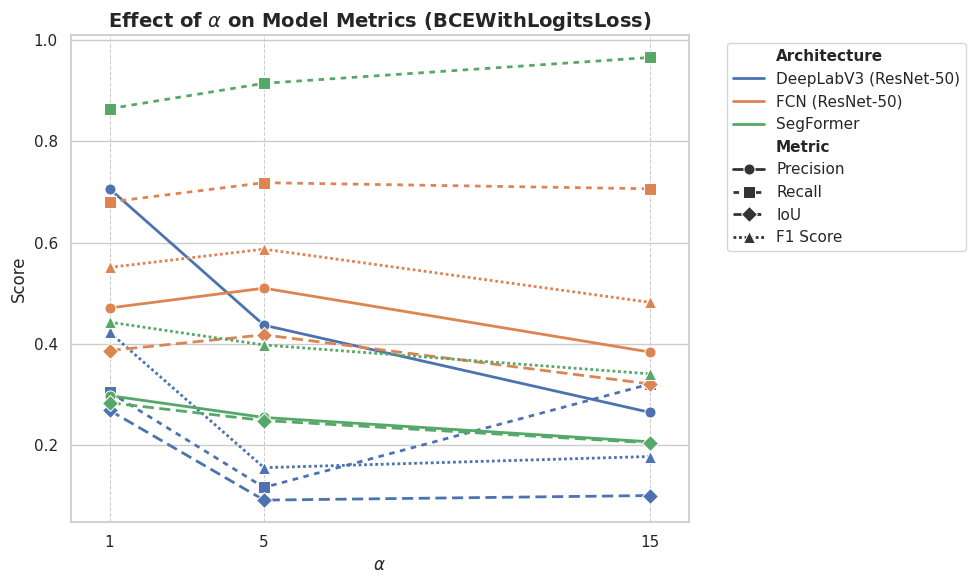

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# --- Label mappings ---
metric_mapping = {
    "metrics.precision": "Precision",
    "metrics.recall": "Recall",
    "metrics.iou": "IoU",
    "metrics.f1score": "F1 Score",
}

architecture_mapping = {
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "fcn_resnet50": "FCN (ResNet-50)",
    "segformer": "SegFormer",
}

# --- Melt the DataFrame and apply mappings ---
melted = grouped.melt(
    id_vars=["model.model_architecture", "model.pos_weight"],
    value_vars=list(metric_mapping.keys()),
    var_name="Metric",
    value_name="Score"
)
melted["Metric"] = melted["Metric"].map(metric_mapping)
melted["model.model_architecture"] = melted["model.model_architecture"].map(architecture_mapping)

# --- Define line and marker styles for clarity ---
markers = {
    "Precision": "o",  # circle
    "Recall": "s",     # square
    "IoU": "D",        # diamond
    "F1 Score": "^",   # triangle
}

dashes = {
    "Precision": "",        # solid
    "Recall": (2, 2),       # dashed
    "IoU": (4, 2),          # dash-dot
    "F1 Score": (1, 1),     # dotted
}

# --- Plot ---
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=melted,
    x="model.pos_weight",
    y="Score",
    hue="model.model_architecture",  # color = architecture
    style="Metric",                  # line style & marker = metric
    markers=markers,
    dashes=dashes,
    linewidth=2,
    markersize=8
)

# --- Custom x-ticks & fixed vertical gridlines ---
plt.xticks([1, 5, 15])
ax.set_xticks([1, 5, 15])
ax.set_xlim(0, 16)
ax.grid(True, axis='x', which='major', linestyle='--', linewidth=0.75)  # fixed gridlines

# --- Title, labels, legend ---
plt.title(r"Effect of $\alpha$ on Model Metrics (BCEWithLogitsLoss)", fontsize=14, weight='bold')
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel("Score", fontsize=12)
legend = plt.legend(
    title="",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
# --- Bold the main legend title ---
plt.setp(legend.get_title(), fontweight='bold')

# --- Rename and bold subgroup headers ---
for text in legend.get_texts():
    if text.get_text() == "model.model_architecture":
        text.set_text("Architecture")       # rename it
        text.set_fontweight('bold')         # make it bold
    elif text.get_text() == "Metric":
        text.set_fontweight('bold')

plt.setp(legend.get_title(), fontweight='bold')

plt.tight_layout()
plt.savefig("alpha.png", bbox_inches="tight", dpi=1200)
plt.show()

In [10]:
filtered_hybridBCE = df[
    ~df["model.loss"].isin(["BCEWithLogitsLoss", "JaccardLoss"])
]

grouped_hybridBCE = (
    filtered_hybridBCE.groupby(
        ["model.model_architecture", "model.loss", "model.pos_weight"],
        as_index=False
    )[["metrics.iou", "metrics.f1score", "metrics.precision", "metrics.recall"]]
    .mean()
    .round(3)
    .sort_values(["model.model_architecture", "model.pos_weight"])
)

grouped_hybridBCE

,model.model_architecture,model.loss,model.pos_weight,metrics.iou,metrics.f1score,metrics.precision,metrics.recall
0,deeplabv3_resnet50,HybridBCEJaccardLoss,1,0.309,0.472,0.343,0.756
1,deeplabv3_resnet50,HybridBCEJaccardLoss,5,0.321,0.485,0.425,0.590
2,deeplabv3_resnet50,HybridBCEJaccardLoss,15,0.174,0.282,0.238,0.496
3,fcn_resnet50,HybridBCEJaccardLoss,1,0.358,0.526,0.440,0.666
4,fcn_resnet50,HybridBCEJaccardLoss,5,0.317,0.481,0.369,0.693
5,fcn_resnet50,HybridBCEJaccardLoss,15,0.251,0.401,0.266,0.819
6,segformer,HybridBCEJaccardLoss,1,0.283,0.439,0.315,0.757
7,segformer,HybridBCEJaccardLoss,5,0.256,0.408,0.272,0.816
8,segformer,HybridBCEJaccardLoss,15,0.180,0.305,0.184,0.898


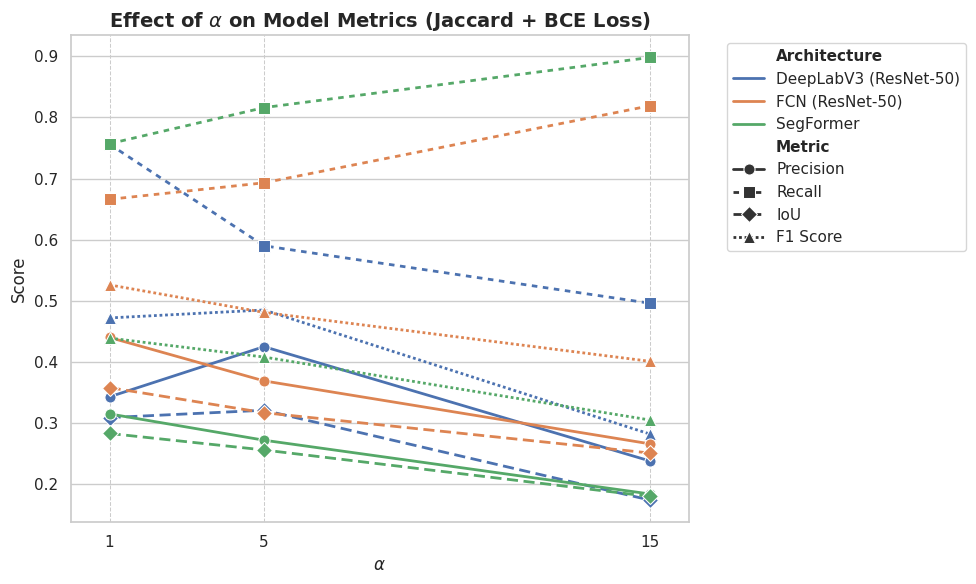

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# --- Label mappings ---
metric_mapping = {
    "metrics.precision": "Precision",
    "metrics.recall": "Recall",
    "metrics.iou": "IoU",
    "metrics.f1score": "F1 Score",
}

architecture_mapping = {
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "fcn_resnet50": "FCN (ResNet-50)",
    "segformer": "SegFormer",
}

# --- Melt the DataFrame and apply mappings ---
melted = grouped_hybridBCE.melt(
    id_vars=["model.model_architecture", "model.pos_weight"],
    value_vars=list(metric_mapping.keys()),
    var_name="Metric",
    value_name="Score"
)
melted["Metric"] = melted["Metric"].map(metric_mapping)
melted["model.model_architecture"] = melted["model.model_architecture"].map(architecture_mapping)

# --- Define line and marker styles for clarity ---
markers = {
    "Precision": "o",  # circle
    "Recall": "s",     # square
    "IoU": "D",        # diamond
    "F1 Score": "^",   # triangle
}

dashes = {
    "Precision": "",        # solid
    "Recall": (2, 2),       # dashed
    "IoU": (4, 2),          # dash-dot
    "F1 Score": (1, 1),     # dotted
}

# --- Plot ---
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=melted,
    x="model.pos_weight",
    y="Score",
    hue="model.model_architecture",  # color = architecture
    style="Metric",                  # line style & marker = metric
    markers=markers,
    dashes=dashes,
    linewidth=2,
    markersize=8
)

# --- Custom x-ticks & fixed vertical gridlines ---
plt.xticks([1, 5, 15])
ax.set_xticks([1, 5, 15])
ax.set_xlim(0, 16)
ax.grid(True, axis='x', which='major', linestyle='--', linewidth=0.75)  # fixed gridlines

# --- Title, labels, legend ---
plt.title(r"Effect of $\alpha$ on Model Metrics (Jaccard + BCE Loss)", fontsize=14, weight='bold')
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel("Score", fontsize=12)
legend = plt.legend(
    title="",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
# --- Bold the main legend title ---
plt.setp(legend.get_title(), fontweight='bold')

# --- Rename and bold subgroup headers ---
for text in legend.get_texts():
    if text.get_text() == "model.model_architecture":
        text.set_text("Architecture")       # rename it
        text.set_fontweight('bold')         # make it bold
    elif text.get_text() == "Metric":
        text.set_fontweight('bold')

plt.setp(legend.get_title(), fontweight='bold')
plt.tight_layout()

plt.savefig("beta.png", bbox_inches="tight", dpi=1200)
plt.show()


# FPR

In [ ]:
import pandas as pd
df = pd.read_csv("all_results_10-20-2024.csv")<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="1914.5601"
   height="348.16"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:xlink="http://www.w3.org/1999/xlink"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#000000"
     borderopacity="0.25"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     style="font-variation-settings:normal;opacity:1;vector-effect:none;fill:#000000;fill-opacity:1;stroke-width:3.77952756;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1;-inkscape-stroke:none;stop-color:#000000;stop-opacity:1"
     min="352.70862,250.09055"
     max="2267.2686,598.25055"
     geom-min="352.70862,250.09055"
     geom-max="2267.2686,598.25055" /><g
     id="layer1"
     transform="matrix(3.7795276,0,0,3.7795276,-352.70863,-250.09056)"><image
       width="506.56067"
       height="92.117332"
       preserveAspectRatio="none"
       xlink:href="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAF18AAARACAYAAAAPTl7gAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90&#10;bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAu&#10;IwAALiMBeKU/dgABAABJREFUeJzs3Xd4VFX+x/HPvXdKeqNJR1CKFQRUQCGIqIu6YsEKUuzr7k+x&#10;suoK2FdXXetaF9RFV9QV7CgoKgpKUZogSBWQEiA9mXbv749JIpMJSSaFBHi/nsdH7pl7zvneaZk5&#10;c873GI7jOAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACA/ZzZ0AEAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQF0g+ToAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAACAAwLJ1wEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcEEi+DgAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOCAQPJ1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAcEkq8DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOCCQfB0AAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAAYHk6wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAOCCRfBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHBAIPk6AAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAMCydcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAHBBIvg4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADggEDydQAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHBJKvAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAADggkHwdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwAGB5OsAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADggkXwcAAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAABwQCD5OgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIADAsnXAQAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwQSL4OAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAA4IBA8nUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwSSrwMA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4IJB8HQAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAMABgeTrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4IJF8H&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcEAg+ToAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAACAAwLJ1wEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcEEi+&#10;DgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOCAQPJ1AAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAcEkq8DAIAohmFE/DdhwoSGDgm1lJmZGfGYZmZmNkgc69evj3p+TZ48&#10;uUFiAQAAAAAAAAAAAAAAAAAAAAAAaOxmz54dtRZj9uzZDR0WAAAAAAAAAAAAAABAo0bydQAAAAAA&#10;AAAAAAAAAAAAgH1kf0uW1aFDh4hYR40a1dAh7RNsMA8AAAAAAAAAAAAAaKxqMvdgwoQJUXVq6ttv&#10;v9XYsWPVt29ftWrVSvHx8VFtT5s2rdI2iouLNXnyZA0fPlzdunVT06ZN5XK5ItpIS0urcYwAAAAA&#10;AACAq6EDAAAAAAAAAAAAwP4pLy9PixYt0oIFC8r+W7NmjRzHiThv3bp16tChQ8MECQAAAAAAAAAA&#10;AAAAAAAAAAAAam3z5s0aPnx4rTeZnzZtmq6++mrt2LGjbgIDAAAAAAAAKkDydQAAAAAAAAAAAFTL&#10;+vXrNW3atLJE66tWrYpKtA4AAAAAAAAAAAAAAAAAAAAAAA4s27Zt0/HHH68tW7bUqp3XXntNl19+&#10;eR1FBQAAAAAAAOwdydcBAAAAAAAAAABQLdOmTdPYsWMbOgwAAAAAAAAAAAAAAAAAAAAAALAPXX31&#10;1RUmXk9JSVGrVq3k9XojylNTU6PO3bx5s6699toK22/durUyMjJkmmZZWXJyci2jBgAAAAAAwMGM&#10;5OsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACIsmrVKr3//vsRZZ07d9ZLL72kk046SYZhVKud&#10;Z599VoWFhRFlY8aM0T333KPWrVvXWbwAAAAAAACARPJ1AACAg8Ls2bMbOgRJUocOHeQ4TkOHAQAA&#10;AAAA6phlWerWrZt69eql2bNna/369Q0dEgAAAAAAAAAAAAAAAAAAAAAAqAPTp0+PyhPwv//9T0ce&#10;eWRM7UybNi3i+Pjjj9dLL71U7eTtAAAAAAAAQCxIvg4AAAAAAAAAAIBqMwxDnTt3Vq9evdS7d2/1&#10;6tVLPXr0UEJCgiQpMzOT5OsAAAAAAAAAAAAAAAAAAAAAADQiEyZM0IQJE2pU9/vvv484Puqoo2JO&#10;vJ6Xl6eVK1dGlF144YUkXgcAAAAAAEC9Ifk6AAAAAAAAAAAAquWyyy7TFVdcoeTk5IYOBQAAAAAA&#10;AAAAAAAAAAAAAAAA7AMbN26MOO7SpUvMbWzatEm2bde6HQAAAAAAAKC6SL4OAAAAAAAAAACAamnW&#10;rFlDhwAAAAAAAAAAAAAAAAAAAAAAAPahnJyciOPExMRat1HTdgAAAAAAAIDqIvk6AAD7WGFhob7/&#10;/nutXr1au3btUjAYVGpqqgYOHKgjjzyy0rpFRUX65ptvtGnTJm3dulWWZemQQw7R0UcfrWOPPVaG&#10;Yeyjq5Acx9GPP/6oJUuWaPv27QqFQmrZsqXatWunvn37yuv17rNY6sr27du1cuVKrVmzRtnZ2Soo&#10;KFBycrIyMjLUunVrHX/88UpKSmroMBul1atXa/Hixdq0aZPy8/Pl8Xh0yCGH6PLLL6+3Pnft2qUl&#10;S5ZozZo1ys3NVUFBgTwejxISEtS8eXN16NBBnTt3VlpaWr3FAAAAAACoXzk5OZo3b55Wr16tnJwc&#10;xcXFqXXr1urTp4/at29f7Xa2bNmi+fPna/369crPz1dGRobatGmjAQMGKCUlpU5i9fv9+uWXX7Ry&#10;5Upt3bpVubm5kqSMjAxlZGTo6KOPVpcuXeqkr4ps3LhRixYt0pYtW7R7924lJSXp0EMPVe/evdWy&#10;Zct667cxycnJ0fz587Vt2zbt3LlTeXl5SkxMVEZGhjp37qwjjjiizh5vAAAAAAAAAAAAAAAQtnPn&#10;Tn333Xdlc/tTU1PVqlUrHXvsserUqVO99r19+3YtWLBA69atU05OjgzDUNOmTXXuueeqadOm1WrD&#10;7/dr/vz52rx5s7Zv367c3Fylp6erWbNmOuKII3TEEUfUedyO42jhwoVavXq1tmzZokAgoIyMDHXt&#10;2lXHH3+84uLi6rxPAAAAAABqo7i4OOK4JrktyrdR03YAAAAAAACA6iL5OgAAdWTChAmaOHFiRJnj&#10;OGX/njt3rh555BF99NFH8vl8UfXHjx+/1+Try5cv18SJE/XRRx+poKCgwnNatWqla6+9VjfddFPZ&#10;7r5VxVQTeXl5evTRR/X8889r69atFZ6TmpqqoUOHasKECerQoUOt+qtPeXl5eu+99/Tpp59q9uzZ&#10;2rhxY6XnW5alHj166JprrtHll18uj8dTrX4effRR3XLLLRFl7777roYOHVrT0FVcXKyWLVsqOzu7&#10;rKxXr16aP39+hednZmbqyy+/LDseMGCAZs+eXWU/5X+sHD9+vCZMmCBJKigo0FNPPaUXX3xRa9eu&#10;rbB++eTr69ev16GHHhpRNmnSJI0aNarKWKTwdb/44ot67bXX9nqt5ePv0qWL+vfvrwsuuEADBw6U&#10;y8VHYAAAAABoaFWNWcyfP1/33XefPvroIwWDwQrbGDBggB566CGdeOKJe+3n/fff19///nd9++23&#10;FY6JeDwenXvuuXr44YfVrl27mK/jxx9/1LRp0/TFF1/ou+++q3DMZ0/NmjXTWWedpVtvvVXdunWL&#10;ub/yHMfRK6+8omeffXav35MNw1C/fv10++2366yzzior79ChgzZs2FB2PHLkSE2ePLnWMe1rOTk5&#10;euaZZzR9+nQtXLhQoVBor+dalqXevXvrrLPO0qhRo9S6det9GCkAAAAAAHXPcRxt2LBBK1eu1MaN&#10;G5Wbmyu/36+0tDSlp6erU6dOOu644/bZ7+Q//fSTfvzxR/3222/y+/1q3ry52rRpo379+tXbZveh&#10;UEiLFi3Shg0btGPHDu3evVspKSlq1qyZDj/8cPXo0YOF2gAAAAAA1FBV8zu+/PJLPfDAA5o1a9Ze&#10;f68/7rjjdN111+mKK66I6Tt6ZWsgHMfRG2+8oaeeekrfffddhXNCDj/8cGVmZu61fcdx9M4772jy&#10;5MmaPXv2XtfqSOH1Oueee67GjRunNm3aVPsaKlJQUKAHH3xQr7322l7XsCQmJuriiy/WnXfeGbX+&#10;AgAAAABw4GKjrrqRnZ2t+fPna9u2bdqxY4d8Pp+aNm2q5s2bq3fv3mrZsmW9x7C/bhZXXlFRkebN&#10;m6eVK1dq9+7dio+PV7NmzXTUUUfp2GOPrbf5GL/++qsWL16srKws7dy5Uz6fT8nJyWrRooW6du2q&#10;rl27VjvXR1UKCwv13XffaevWrdqxY4cKCgrUpEkTNWvWTN27d6/zsZnSa9u8ebNyc3Pl8/kUHx+v&#10;xMREtWrVSh06dFDnzp15vQMAAAAAUIfIPAkAQD0LBAIaO3asnn322ZgTn9u2rbvuukuPPPLIXhON&#10;ldqyZYvuvvtuvfzyy3rnnXfUs2fP2oRdofnz5+v888/Xr7/+Wul5OTk5euWVV/TWW2/pgQce0A03&#10;3FDnsdTWbbfdpqeeeqrC3ZH3JhQKacGCBVqwYIEmTpyo119/XSeffHKV9YYPH65x48ZFPIaTJ0+u&#10;VfL1d999NyLxuiSNGTOmxu3F6rvvvtOFF15YZcL6ujR79myNGTNG69atq3Ydx3G0cuVKrVy5Ui+8&#10;8II+/vhjnXHGGfUYJQAAAACgNhzH0d13360HHnhAtm1Xeu6XX36pvn376uGHH47a9CwnJ0djxozR&#10;//73v0rb8Pv9evPNN/XBBx9o2rRpOvXUU6sV58qVK3XOOedo1apV1Tq/1I4dOzRp0iRNnjxZV1xx&#10;hZ5++ml5vd6Y2ii1fv16jRgxQnPmzKn0PMdxNGfOHM2ZM0cXXnihJk2apISEhBr12ZiEQiE99NBD&#10;+sc//hE1RlJZnXnz5mnevHkaP368vv32Wx1//PH1GygAAAAAAHVs06ZN+t///qdZs2bp66+/1u7d&#10;uys9PyEhQQMGDNCNN96o0047rc7j8fv9euaZZ/TUU0/t9ff8+Ph4DRkyRHfffbeOOeaYOul35syZ&#10;ev755zVz5sxKxwaaNGmiM888U3/961/VtWvXOukbAAAAAICDXSgU0g033KBnnnmmynMXLVqkq666&#10;Sq+88opeffXVWies2rZtmy688EJ99dVXNW7j66+/1o033qhFixZV6/wtW7bomWee0UsvvaTbbrtN&#10;EyZMkGmaMfc7a9YsjRkzpsp1GAUFBXr55Zf1xhtv6Nlnn9XIkSNj7gsAAAAAsP/Ylxt1VbXRWqn1&#10;69dX2c8rr7yiV155Za+3r1u3TpMnT47qr7yBAwfu9bY9N2OrTFFRkf71r3/p7bff1vfff7/XTeIk&#10;6cgjj9SIESP05z//WYmJiVW2vacDZbO4qp4Ha9as0X333aepU6eqsLCwwjZatGihP/3pT7r55ptj&#10;vh8rsnbtWv3zn//UJ598otWrV1d6bulcmPPPP18XX3xxzP0Hg0FNnjxZb7zxhubMmSO/37/Xczt1&#10;6qQLL7xQt9xyizIyMmLqp9SWLVv09NNP64033tD69eurPN/j8ah79+469dRTNWzYMHXv3r1G/QIA&#10;AAAAgLDYZ3gAAIBqC4VCuuCCC/TMM8/EnHg9FApp1KhRevDBB6tMvL6nDRs2aMCAAVqwYEGs4VZq&#10;wYIFGjhwYJWJ1/dUWFioG2+8UXfddVedxlIXvv/++5gSr5e3adMmDRo0SK+99lqV57Zo0UJDhgyJ&#10;KPvoo4+0Y8eOGvc/adKkiOO4uDhdcsklNW4vFl999ZUyMzP3aeL1jz76SGeccUZMidcBAAAAAPuf&#10;a665Rvfdd1+ViddLOY6jW2+9VS+88EJZWXZ2tgYNGlRl4vU9FRQU6I9//KPmz59frfO3bt0ac+L1&#10;PTmOo5deekn9+/dXbm5uzPXXrFmj/v37V5l4vbypU6fqD3/4Q6UTQ/cHu3bt0hlnnKG77rqr2onX&#10;ywuFQnudBAwAAAAAQGN18sknq127drrhhhv03nvvVZl4XQrP3fj44491+umnq1+/ftq0aVOdxbNm&#10;zRodd9xxuummmyr9Pb+oqEjvvPOOevbsqTvuuKPaYz8VWbp0qQYNGqTBgwfr7bffrnJsYOfOnXr1&#10;1Vd11FFH6dprr5XP56tx3wAAAAAAIDzn4bLLLqtW4vU9zZkzRwMGDNDatWtr3PfWrVvVt2/fWiVe&#10;f+GFF3TKKadUO/H6nnw+n+69916de+65lSY/q8gHH3ygIUOGxLQOo7CwUKNGjdJzzz0Xa6gAAAAA&#10;gP3ErFmzdMQRR+j++++v9Dtj6UZdRx11VKUJzw9GL730kjp16qSbb75Zc+fOrTTxuiQtX75c48aN&#10;U6dOnfT222/XSQzbtm1TZmamLrvsMs2bNy/m3CJSeLO4Xr16adiwYfrwww+rHHso3SzusMMO0913&#10;312ruRh7euaZZ3TUUUdp8uTJla652LZtm8aPH6+jjjqqymTplcnKytLo0aPVpUsXPfXUU9Vqq3Qu&#10;zJVXXqmWLVvG1N+0adPUrVs3XXXVVfr888+rXF+zZs0aPfjggzr00ENjHg+Twvdnly5d9OCDD1Yr&#10;8bok+f1+ff/993rggQfUo0ePWuVFAQAAAAAAkquhAwAA4EB2991367333is7zsjI0B/+8Af17t1b&#10;zZs3V1FRkTZt2qSPP/5YhmFE1L355psrTOydmJioIUOGqG/fvjrkkENUVFSkDRs26MMPPyxLuF5Q&#10;UKChQ4dq2LBhdXId2dnZGjp0aMQPND169NAf//hHtW/fXl6vV5s3b9asWbM0a9asqGTx999/v5o0&#10;aaKxY8fWSTx1zTAMHX300Tr66KPVrVs3NWvWTCkpKbIsS3l5eVq7dq3mz5+vL774QoFAoKxeIBDQ&#10;VVddpaOOOko9evSotI8xY8ZEPBcCgYD+85//1Og+2bRpk2bNmhVRNnToUKWlpcXcVqy2bt2q8847&#10;L+IHmuOPP16nnXaa2rdvr+TkZP3222/66aef9NZbb9VJn1lZWRo5cmTUAmiXy6X+/furb9++6tCh&#10;g5KTkyVJubm52r59u5YvX65FixZp5cqVdRIHAAAAAKB+PfHEE3rxxRfLjtu3b6+zzz5bRx11lDIy&#10;MpSdna3vvvtOb731VlTC8htvvFFnnHGG2rRpo4svvlgLFy4su61nz54644wzdOihhyo5OVnbtm3T&#10;559/rvfeey9icmlRUZGuvPJKLVy4UC5XbD+fpKenq3fv3urWrZs6deqklJQUJSUlqaioSFlZWVq+&#10;fLk+/fTTqMnQ33//va666iq9+eab1e4rJydHp5xySoUb5HXs2FFDhw5V586dlZ6erh07dmjp0qWa&#10;Pn26tm7dKim8qdpNN90U0/U1Jjk5OerXr1+F3/fdbrf69OmjzMxMtW7dWunp6SooKNCOHTv0448/&#10;at68ebVaxA0AAAAAQEOLdSO28r799lv16tVLM2bM0LHHHlurttatW6d+/fpp27Zt1a4TDAb14IMP&#10;atOmTZo8ebJM04ypz/fff1+XXHJJzMnNpPBGbM8//7wWL16s6dOnq3nz5jG3AQAAAAAApEcffTRi&#10;nkNycrLOOecc9e7dWy1atFB2drZWrlypd955J2puw6+//qpTTjlFP/74Y8zrH2zb1oUXXhjxu3/H&#10;jh115plnqmvXrmratKl27typdevW6Z133qmwjYceekh//etfo8oTExM1ePBg9e7dWy1btlRycrJy&#10;cnK0evVqffbZZ1GJ2t977z1dccUV+u9//1ut2OfOnavzzz8/KpmXYRg68cQTNWTIELVt21Yul0ub&#10;Nm3SjBkz9NVXX5Uli/vzn/+sBx54oFp9AQAAAAD2Hx988EGF3xcrU7pRV1FRkbp27VqP0TV+gUBA&#10;1113nV5++eUa1d+2bZsuvPBCTZw4UX/7299qHMfWrVvVr1+/Wq1VeOGFF3T99ddH5emojtLN4hYv&#10;XqzXX39diYmJNY7jjjvu0IMPPhhTnfXr1+ukk07SokWL1Lp165jqLlmyROecc061k5JXJC8vr1rn&#10;OY6jCRMm6J577qlRP7m5ufrzn/+sJUuW6Nlnn5VlWVXW+dvf/qb77ruvRv0BAAAAAIC6Q/J1AADq&#10;0d///ndJkmVZuuOOO3T77bdX+GPF3XffHZHM+ssvv9STTz4Zdd5ll12mf/7zn2ratGnUbRMmTNDs&#10;2bN15ZVXas2aNdq8ebOef/75OrmO559/viy+1q1b64UXXtCQIUOizrv11lv1888/a/To0Zo7d27E&#10;bXfccYeGDBmiLl261ElMtWWapk477TSNHDlSp512WoX3aXlZWVm655579PTTT5ftNuzz+XT55Zdr&#10;6dKlldY988wz1bx5c23fvr2sbPLkyTVKvv7KK69E7Tw8ZsyYmNupiZdeeqlsAu8xxxyj5557Tn36&#10;9Knw3IqewzXx3HPPKSsrK6Js8ODBeumll9SuXbsq669fv17vvvuu/vWvf9VJPAAAAACA+nH77bdL&#10;khISEvToo4/qqquuipqMeNVVV+n+++/X+eefr2+++aasvKioSPfff7+6dOmiGTNmSAovsH3hhRc0&#10;aNCgqL7+8pe/aMGCBTrzzDMjvqsvWbJEb731li655JIq4z3kkEM0atQonXvuuerVq1eVycIcx9HH&#10;H3+sG2+8UatXry4rnzp1qoYNG6YLLrigyj4laezYsVFJ3JOTk/Xoo4/qyiuvjNrgTwp/R3/44Yc1&#10;ceJEBYNBPfvss/J4PNXqrzFxHEcjRoyISrxuGIauuOIKTZgwocrJuosXL9aUKVP0wgsv1GeoAAAA&#10;AADUO6/Xq169eumII45Qly5dlJ6eruTkZAWDQeXk5GjlypWaM2dOxCZ1Unjx8AUXXKCFCxcqJSWl&#10;Rn0HAgGdd955EYnXO3furPPOO0+dOnVSUlKStm7dqq+//lofffRRxJwYSXrttdeUnp6uJ554otp9&#10;vv766xoxYkTUfAmPx6NTTjlFJ5xwgtq2bavU1FTl5+dr/fr1mjVrVlTC+nnz5um8887TF198Ibfb&#10;XYOrBwAAAADg4LZnMrLRo0frscceqzCR+qOPPqrHH39cd911V8TYwIYNGzR27FhNmjQppn6//fbb&#10;srUMTZo00eOPP67hw4dXOE/i73//e1TiulmzZunOO++MKIuPj9fdd9+tP/3pT3sdJ3nooYci1uqU&#10;evPNN3XyySfr+uuvrzTu4uJijRkzJiqezp07a9KkSerbt29Undtvv11LlizRmDFjtHDhQoVCIU2Y&#10;MKHSfgAAAAAA+5fGvlGXx+OJ2tT9p59+UiAQKDtOT0+vdK2/x+PRIYccEtFOfn5+xPdrSWXzDCpy&#10;2GGHVVhu27aGDh2qjz76KOq2Vq1aadCgQerRo4eaNm2quLg47dq1Sz/88IM+/vjjiPUYjuPo7rvv&#10;VtOmTXXdddft9Vr2Zn/eLK68559/PiLxerNmzfSHP/xBvXv3VrNmzVRcXKxffvlF7777rpYvXx5R&#10;d/v27brmmmv0wQcfVLu/RYsWqX///iooKIi6LSUlRQMHDlSfPn3UvHlzJSUlKScnR5s3b9bChQv1&#10;7bffaufOnTFd33XXXVdh/pWMjAwNHjxYPXv2VPPmzZWQkKDs7GwtX75cn3zyiX7++eeI81944QWl&#10;paWV5ZLZm9mzZ+v++++PKk9NTdXgwYPVvXt3tW3bVomJifL5fMrLy9PGjRu1fPlyfffdd9q6dWtM&#10;1wcAAAAAACrhAACAOjF+/HhHUtR/pmk6U6dOrXY7tm073bp1i2rnpptuqlb93377zencuXOFsVT3&#10;T//e6rZq1cpZs2ZNlfWLioqczMzMqPqnnHJKtfrfF7Kzs2tcd/LkyVHXNmPGjCrr3XTTTVH1Fi5c&#10;GHP/hx9+eEQbbdu2dUKhUKV1BgwYEFFnwIAB1eprb8+Ffv36OTk5OTHHvm7duqi2Jk2aVGmdXr16&#10;RZzftWtXp7i4OOa+bdt2CgsLY64HAAAAAKh7extHSUhIcL799tsq6+/evdtp3rx5VN3ExERHknPk&#10;kUc627Ztq7Kdr7/+OiqGwYMHV1mvoKDACQQC1brW8nbt2uX06NEjos8+ffpUq+7cuXOj4k1KSnK+&#10;+eabatWfOnWqY1lWhff9yJEja3Q9FSk/DiHJWbduXa3b/de//hXVrtfrdd54442Y28rJyXF27txZ&#10;65gAAAAAAKiJL774Iuo77hdffFFlvYSEBGfkyJHOJ598Uu3fv5ctW+YMHjw4qr/rr7++2vG2b98+&#10;om5cXFzZv9PS0pzJkyfvte7mzZuds846K6p/wzCqdc2l15CQkBBR3+VyObfeequzffv2Suv+8MMP&#10;Ts+ePaP6v+WWW6rstyZzHAAAAAAAOJDsbX6HJGfcuHHVauP99993XC5XVP0vv/yy0noVzT2Q5LRo&#10;0cJZvnx5TNeRm5vrtGjRIqKd5s2bO0uWLKl2G9nZ2c4xxxwT0UbTpk2dgoKCSutNnDgx6hq6devm&#10;7Nixo8o+8/PznT59+uz1Maju2AoAAAAAoHEpKipyunbtGvU9r3PnzpWuDVi8eHHE79/x8fExf1es&#10;6Lt+dZWfO1CTNQg1nS9R3t133x3VTps2bZypU6c6wWBwr/UCgYDz4osvOklJSRF1PR5PtfI+lB+v&#10;2HN9RpMmTZxXX33VsW27wrq2bUflSJg5c6ZjmmZEm/Hx8c6DDz5YZS6HL774wunUqVPU/fD0009X&#10;eR0VPQ9K54K43W7nwQcfdIqKivZ6HU888URU3JKcuXPnVtm34zhOVlZW1PNJkpOcnOw88MADVY63&#10;BINB57PPPnMuueQSx7KsKvv797//HdVXRkaG8/zzz+/1Okuv9X//+1/U+iVJzvvvv19pn4MGDYqq&#10;c/PNNzu5ublVxmvbtrNgwQLn1ltvdTIyMiqNEQAAAAAAVM0UAACoV2PHjtWwYcOqff7nn3+uFStW&#10;RJT16dNH//jHP6pV/5BDDtGbb74py7JiirM6pkyZoo4dO1Z5XlxcnN5++201adIkovzzzz/XsmXL&#10;6jyumkhNTa1x3ZEjR+qCCy6IKHvppZeqrDdmzJioskmTJsXU95w5c7R69eqoeExz332sS01N1Ztv&#10;vqmUlJR90t+eOz1L0ogRI+T1emNuxzAMxcfH11VYAAAAAIB68M9//lN9+vSp8ry0tDTdcsstEWWF&#10;hYUqKChQXFycpk6dqubNm1fZzkknnaQzzjgjouyLL76Qz+ertF5CQoJcLleV7VckPT1dr776akTZ&#10;3Llz9dNPP1VZ95lnnokqe+SRR9S3b99q9T1s2DDdcMMN1Qu0kQkEAnrwwQejyp966ildfPHFMbeX&#10;kpKijIyMuggNAAAAAIB9ZsuWLZo8ebJOP/30av/+feSRR+qTTz6JmrMwefJk7d69u0ZxFBcXS5KS&#10;k5P16aefauTIkXs9t1WrVpo+fbouueSSiHLHcXT11VfLtu1K+7JtWxdffLEKCwvLyhITE/Xpp5/q&#10;4YcfVrNmzSqt3717d3377bcaPHhwRPmTTz6pTZs2VVoXAAAAAABULDMzs8Lf8Cty1lln6a677ooq&#10;f/LJJ2vU90svvaQjjjgipjrPPfectm3bVnZsmqamT5+uo48+utptpKam6t1335XH4ykry8rKqnQt&#10;SSAQ0L/+9a+IMrfbrXfeeUdNmzatss/ExES9++67SktLq3acAAAAAIDG7+GHH9bKlSsjyrp166Zv&#10;vvmm0rUBxxxzjL788suyNRdFRUX1GmdjNXfuXN13330RZX369NGyZcs0bNiwSvNsuFwuXXnllZoz&#10;Z05ErgS/31/h+EVVQqGQJKlFixb66quvNGLECBmGUeG5hmFE5EjIy8vTZZddFjFvonnz5vruu+80&#10;bty4KnM5ZGZmauHChTrmmGMiyidMmBAxx6K6iouL5fV69fHHH2vcuHGKi4vb63X83//9n+69996o&#10;26qTc0OSrr/+em3YsCGirE2bNvrmm2/017/+VQkJCZXWtyxLp556ql5//XX98ssvlZ67fv16/fnP&#10;f44o69y5sxYvXqyrr756r9cpha/13HPP1YIFC9SmTZuI28aNGyfHcSqsl5ubq9mzZ0eUjRo1Sv/4&#10;xz+UnJxcabyl/fbs2VMPP/ywNm3aVKPcGgAAAAAA4HckXwcAoB4lJydrwoQJMdV54YUXosoee+yx&#10;vf7IUpHu3btr9OjRMfVblfPPP1+ZmZnVPr9JkyYVXvtzzz1Xd0E1oMsvvzzi+JtvvqmyzpFHHqne&#10;vXtHlL3++uvy+/3V7rd8snbDMOr8sa7KTTfdpNatW++z/vLy8iKOyyf1BwAAAAAcGDp37qwrr7yy&#10;2ueff/75FZaPGDEipkW25TdYCwaDWrJkSbXr18RRRx2l4447LqJszpw5ldbJzs7WW2+9FVHWrVs3&#10;XX311TH1PXHixP1yUe5///tfbdy4MaLs9NNP11VXXdVAEQEAAAAAsO/VdKN50zT1zDPPqG3btmVl&#10;BQUFeuONN2oVz1NPPRU1D2Jv/U+ePFmdO3eOKF+9erU++uijSuu+8847WrZsWUTZpEmTNHDgwGrH&#10;6fF49NZbb0UkNfP7/Xrssceq3QYAAAAAAPhdrInTb7/99qgEVdOnT9dvv/0WUzsDBw7UWWedFVMd&#10;v9+vf/7znxFll19+uU488cSY2pGkjh07asSIERFl77777l7PnzZtmrZu3RpR9uc//1ndunWrdp8t&#10;WrTQ3/72t9gCBQAAAAA0WmzUVXv33XdfRMLyVq1a6aOPPoppTsWxxx6rZ599NqLs448/1uLFi2sU&#10;0/60WVxlHnnkEQ0aNKha5956661ROSdmzJhRZb2VK1dGrY2Ji4vTRx99FNO1l+rQoUOltz/yyCMR&#10;yegTExP1ySefRI1VVaZt27b673//G1G2fPlyvf/++xWev2HDhrLE/KVquvYlPj4+plwzAAAAAAAg&#10;GsnXAQCoRxdddJGSkpJiqvP5559HHB9xxBE1mtR5xRVXxFynMjUZzB8xYkTUTq8ff/xxXYXUoA4/&#10;/PCI4y1btkQlAKtI+UTpu3bt0nvvvVetPgsLC6N+SOrfv786duxYrfp1wTAMjRkzZp/1J0UnW68q&#10;GR0AAAAAYP80evTomCYEduzYscLJsbGOifTo0SOq7Oeff46pjZooP7Ywb968Ss//5ptv5PP5IspG&#10;jx4t04ztp56kpCRddNFFMdVpDCoaP7ntttsaIBIAAAAAAPZPcXFxGjZsWERZbX5/79WrV9TG9ZXx&#10;eDx69NFHo8qfe+65Suv9/e9/jzjOzMyMuo7qSE1N1Q033BBRVllyNAAAAAAAULETTzwx5kRYcXFx&#10;UUnLg8GgZs6cGVM7NVkn8+2332rLli0RZVdeeWXM7ZQ688wzI47nzZsXNZ+jVEXrZ2qyNmfUqFER&#10;SdQAAAAAAPsvNuqqnWXLlkVt8v7AAw/UKBn9pZdeGrWuY9q0aTG3s79tFldZO9dff321z3e73VFr&#10;UzZt2qTt27dXWu+RRx6JSJ4vSePHj69R4vWq7NixQ5MmTYoou/XWW3XooYfG3Fa/fv2iEtPv7X7O&#10;y8uLKiufMwMAAAAAAOw7JF8HAKAeDRw4MKbz16xZo6ysrIiyIUOG1KjvE088sc4G4JOSknTqqafG&#10;XC81NTXqB4S1a9dqx44ddRJXXfL5fJo1a5Yee+wxjRkzRmeffbYGDBignj17qnv37lH/nXfeeVFt&#10;VCf5+iWXXBKVkL78DzZ78/bbb0f90FI+mXt9O+yww2LaxbcunHDCCRHHU6ZM0bPPPivHcfZpHAAA&#10;AACA+tW/f/+Y67Rr1y7iOCEhQT179oypjQ4dOkSVZWdnxxzLmjVrNGXKFN1+++264IILdNppp+nE&#10;E09Ujx49Khxb+PTTTyPqVzWuUFFy9pqOG8U6sbehOY6jL7/8MqKsdevWOuWUUxooIgAAAAAA9k+x&#10;bgZXmSuvvDKmjfSk8FhG+TkHs2bNUiAQqPD89evXa+HChVH91lT55Gjr16/Xhg0batweAAAAAAAH&#10;o6FDh9aoXkVrMGIdm4h1jY6kqPkGbrdbvXv3jrmdUuWTcxUXF2vFihUVnlv++rp27RpTMr1SGRkZ&#10;yszMjLkeAAAAAKDxYaOu2nn77bcjjpOTk6MSgFeXYRj6wx/+EFE2e/bsmNvZ3zaL25sxY8bINGNL&#10;RXb88cdHlf3888+V1nn//fcjjpOSknTdddfF1G91ffjhhyoqKoooq8v7eW/Pl4ryvMyZM6fG/QIA&#10;AAAAgNpxNXQAAAAcyI477riYzl+6dGmt29hTjx49NHPmzBrXL3XsscfKsqwa1T3uuOP04YcfRpQt&#10;XLhQZ5xxRq3jqgu//PKLHnroIb399tvKycmpVVvVScyWlpamc889V2+88UZZ2YwZM/Tbb7+pZcuW&#10;ldadPHlyxHFycrKGDRtWk1BrrDbPx5oaPXq0pk+fXnbsOI6uv/56Pfvssxo9erTOOeccHXbYYfs8&#10;LgAAAABA3arJd7vk5OSI4/bt28vliu2nj/JtSKr2GIFt23r55Zf14osvav78+TH1W15V4wrlx43i&#10;4+PVtWvXGvXVo0ePGtVrKGvWrInazK9v374NFA0AAAAAAI3Hzp079fXXX2vp0qVasWKFdu/erby8&#10;PBUUFFS4ofmuXbsijn/99dca912TRGumaeqcc87RM888U1ZWXFysH3/8scKkZ+WTo0lSv379Yu63&#10;VPnkaJL0ww8/qH379jVuEwAAAACAg03Pnj1rVO/oo4+Wy+VSMBgsKyu/6VplWrRooVatWsXc7zff&#10;fBNVVlFisOry+/1RZVlZWVFlhYWFWrlyZURZTe+70rqffvppjesDAAAAABqHut6o62D7rlh+HsFx&#10;xx2nuLi4GrdXfh7BDz/8EHMbjXmzuO7du1e7jQEDBsTcb6dOnaLKKluPs3z58qi1IX/84x+Vmpoa&#10;c9/VUf5+bt++vVq3bl3j9srfz+vXr1d2drbS0tIiyg8//HBlZGREzNO5/fbb1blzZ5188sk17h8A&#10;AAAAANQMydcBAKhHzZs3j+n8nTt3RpV16NChxv1XtGi0Jrp06VLjuhUlAdu+fXttwqkz99xzjx54&#10;4IGYd+3dm+omZhs9enRE8vVQKKTXXntNt912217rrF+/Pmrn2wsvvFAJCQk1irWmYn1O14VzzjlH&#10;Q4cO1bRp0yLKly9frltuuUW33HKL2rZtq5NOOkm9e/dW37591bNnz5iT7QEAAAAAGlZ6enrMddxu&#10;d523IUmBQKDKeitWrNBll11Wo8m1FalqXKH8uFHbtm1rvFle69at5Xa7q3WdjcG2bduiyo4++ugG&#10;iAQAAAAAgMZh1qxZ+uc//6kZM2bU6vt9MBhUfn6+kpKSYqrXunVrtWjRokZ9VrTp+8KFCytcRFxR&#10;crSaJH2vTEXJ0QAAAAAAwN7VdH2J1+vVoYceqtWrV5eVxbK2pKZrGTZt2hRxHAgEtHjx4hq1tTcV&#10;rQXasWNH1OZ4db02BwAAAACwf2GjrtoJhUJRyeuXLFkSU4Lx8spvYp+Tk6NAIFDhOpOK7G+bxVXm&#10;8MMPj7nfipKmV7Y2Zu7cuVFl/fr1i7nf6ip/P2dlZdXq+ZKfnx9VlpWVFZV83TRNXX755frnP/9Z&#10;VrZz5071799fgwcP1vDhwzVkyBA1bdq0xrEAAAAAAIDqIyMlAAD1KCUlJabzd+/eHVVWm11a62qH&#10;17qOITs7uxbR1I3rr79ezz77bJ22Wd0FzYMGDVK7du20cePGsrLJkydXmnz9lVdeiZp4O3r06JoF&#10;WguxPqfrypQpU3TVVVfp9ddfr/D2X3/9VW+88UZZUvukpCQNHjxYF198sc455xx5vd59GS4AAAAA&#10;oAaqOzm1vtuojmXLlumUU07Rjh076qzNqsYVyo8b1XbcJzU1db9JLlZ+QrNUs0T7AAAAAADs73Jz&#10;c3XVVVdp6tSpddZmTk5OzMnX6zpR2N4SrZVPjiZpnyRHAwAAAAAAe1eX60tiWVtS07UM++K7f1FR&#10;UVRZRdfWGNYHAQAAAAAaDht11c7OnTtVXFwcUbZ79+4Kc3TUxq5du6q9If3+tllcZTIyMmLuo6I1&#10;PJWtjdm2bVtU2dFHHx1zv9VV/n4uKCiol/v5sMMOiyq/66679N5772nt2rUR5Z999pk+++wzGYah&#10;I488Un379lXv3r118skn1+r9AAAAAAAA7J3Z0AEAAHAgc7li2+fE5/NFlXk8nhr3X1cJpxMTE+u0&#10;bl5eXm3CqbX//Oc/FSZez8jI0BVXXKF///vf+vrrr7V+/Xrt3r1bRUVFchwn4r9169bVuH/TNDVy&#10;5MiIshUrVui7776r8HzHcfTKK69ElHXu3Lled/Hdm1if03UlISFBU6ZM0YwZM5SZmSnDMCo9Pz8/&#10;X++++64uuugiderUSc8//3zUj9EAAAAAANREIBDQhRdeWGHi9ZNOOkkTJkzQBx98oMWLF2v79u3K&#10;y8tTMBiMGlsoPzZQlfLjRrUZM5LqbtxoX8jNzY0qizUpHAAAAAAA+7vc3FydfvrpdZp4Xar+RvN7&#10;qutEYXtLtNZQydEAAAAAAMDe1eX6kljWltR0LUNdJ2Crroqura7X5gAAAAAA9i9s1FU7+2pz9Vjm&#10;Eexvm8VVpqJE6nVt165dUWXp6en10ldRUdE+mROytz6aNGmimTNnqkePHhXe7jiOli1bphdeeEFX&#10;XXWVunbtqpYtW+raa6/Vl19+WZ8hAwAAAABw0CH5OgAAjUhFP3DVJlF5RYmpaqKgoKBO6yYnJ9cm&#10;nFoJBAK67bbbosrHjRunTZs26aWXXtLo0aN10kknqX379kpLS1NcXFzU+bX9oWXUqFFRCcQnTZpU&#10;4bmzZ8+OSvY+evToWvW/vzrttNP0xRdfaN26dXr66ac1bNgwtWrVqtI6mzdv1rXXXqtzzjlHfr9/&#10;H0UKAAAAADhQvfDCC1qxYkVEWadOnTR//nx9/fXXGj9+vM4880wdc8wxatasmZKSkmRZVlQ7sY4t&#10;lB83qu3mdnU1brQvVDQhOT8/vwEiAQAAAACg4dx0002aN29eVPnhhx+usWPHaurUqfr++++1ZcsW&#10;5eTkyOfzRW0Gt7d5CbGq60RhexvnaKjkaAAAAAAAYO/qcn3JvlhbEh8fH3HcokWLqDGT2v43atSo&#10;qH4rura6XpsDAAAAANi/sFFX7TTGOQT722ZxDa2idSxJSUn10ldjuI8PPfRQfffdd3ruuefUpUuX&#10;Ks/funWrnn/+eWVmZqp379764osv9kGUAAAAAAAc+Ei+DgBAI1LRrqy12bW2rna8zcnJqdO6aWlp&#10;tYimdr788kv99ttvEWV/+ctf9OCDD0ZNqq1MRbvqxqJjx44aMGBARNmbb76p4uLiqHMnT54ccWxZ&#10;li6//PJa9b+/a9++va6//npNnTpVmzdv1oYNG/Sf//xHV199tdq0aVNhnffff1/XX3/9Po4UAAAA&#10;AHCgeeONNyKOk5OTNXPmTPXq1SumdmIdWyg/blSbcR+/379fJS9v0qRJVFljmAgLAAAAAMC+snTp&#10;Uv373/+OKEtKStJ//vMf/fzzz3rsscc0bNgw9e7dWy1btlRKSoo8Hk9UO7XdaL5UXScK21uitYrm&#10;cRQVFdVpcrQJEybU+FoAAAAAADgY1eX6kn2xtqRp06YRx/tqvkFF11bXa3MAAAAAAPsXNuqqnYrm&#10;EFx00UV1vslahw4d9vm17KvN4hpaSkpKVFl9rW2p6Plywgkn1Pn9nJmZWWkcbrdb11xzjVauXKkF&#10;Cxbovvvu02mnnVbhfbGnBQsWaNCgQbr//vtrczcAAAAAAACRfB0AgEalbdu2UWVLly6tcXtLliyp&#10;TThlVq1aVeO6P//8c1RZ8+bNaxNOrXz22WcRx5Zl6c4774y5nbVr19Y6ltGjR0ccZ2dn6913340o&#10;y8/P1zvvvBNRdvrpp6tVq1a17v9A0q5dO1122WV6/vnn9euvv+qLL77QaaedFnXeyy+/rOXLlzdA&#10;hAAAAACAA0F+fr7mzp0bUXb55ZfXaHJtrGML5ceNNm/eXOMFwUuXLpXjODWq2xAOOeSQqLK6GvcC&#10;AAAAAGB/8Oabb0Z9l3/llVd02WWXyTCMardT243mS9V1orC9JVornxxNqrtrAAAAAAAANVPT9SV+&#10;v1/r16+PKNsXa0tatGgRFcdvv/1W7/02a9YsatymovU11bVy5crahgQAAAAAaGBs1FU7B9Icgoba&#10;LK6hNWnSJKqsvq49LS1NLpcroqyhny89e/bUnXfeqRkzZmj37t1asmSJnnnmGV1wwQUVJmN3HEd3&#10;3XWXpkyZ0gDRAgAAAABw4CD5OgAAjUjPnj1lWVZE2bx582rUVk5OTp1Nrvzxxx8VCoVqVHfhwoVR&#10;ZT179qxtSDX266+/RhwffvjhUZNpq6N8orWauOCCC6J2qJ48eXLE8dSpU6N2nS6ftB3RMjMzNWPG&#10;DF199dUR5Y7jRCW4BwAAAACgurZs2SLbtiPKTj755Jjb2bZtW8zJ148//viospqOG9W0XkPp2LFj&#10;1PjNt99+20DRAAAAAACw75XfaP7II4/UeeedF3M7dbHRvFTzJGtSxUnG9pZoraL5HBs2bKhx3wAA&#10;AAAAoPYqWiNSHUuWLFEgEIgo2xdrS0444YSosq+++qre+01ISFDXrl0jymp639W2LgAAAACgcWCj&#10;rtqp6P7bX+cQNNRmcQ3tkEMOiSpbsmRJvfRlGIaaNWsWUbZ582YFg8F66S9Wpmnq6KOP1p/+9Ce9&#10;9dZb2r59u15//XV17tw56tzbb7+90cQNAAAAAMD+iOTrAAA0IomJiTr66KMjyj744APl5eXF3Nab&#10;b75ZZwPo+fn5mjVrVsz1cnNzo+p17Ngx6keKfSkrKyviOCMjI+Y2AoGApk2bVutYEhISdNFFF0WU&#10;zZw5U5s2bSo7njRpUsTtTZo00R//+Mda932weOCBB6I2NKivH+AAAAAAAAe+8uMKUs3GFqZOnRpz&#10;nT59+kSVvf766zG3I0lTpkypUb2GNGDAgIjjLVu21Gi8CgAAAACA/VH5jeZrshmcVDcbzUvSpk2b&#10;tH379hrVrShR2N4SrTVUcjQAAAAAALB3NV1L8b///S+q7MQTT6xlNFUbPHhwtWKpD+Wvb+XKlTVK&#10;jLd7927Nnj27jqICAAAAADQUNuqqnbi4OB177LERZatWrdK2bdsaKKKaO1jnQ1S0Luabb76pt/7K&#10;38+FhYWN9nXj9Xp1ySWXaOHCherRo0fEbZs3b9a8efMaKDIAAAAAAPZ/JF8HAKCRKZ+Mu7CwUM88&#10;80xMbQQCAT3xxBN1GZZefPHFmOu89tprKi4ujij7wx/+UFch1UhiYmLEcUVJ06ry+uuv19nOwaNH&#10;j444tm1br776qiTpl19+0Zw5cyJuv+yyy+TxeOqk74NBkyZNopL95+TkNFA0AAAAAID9XflxBSn2&#10;sYVAIKCnnnoq5r6PPfbYqInWb7/9ttatWxdTO3PmzKmzRGv70rnnnhtV9sgjjzRAJAAAAAAA7Ht1&#10;sdH80qVLtWLFiroKqUaJ1mzb1vTp0yPK4uLi1L179wrPb8jkaAAAAAAAoGJz587V8uXLY6rj8/n0&#10;2muvRZS5XC6deuqpdRlahQYMGKDU1NSIsnfeeUerV6+u974rWj9Tk7U5r7zyivx+f12EBAAAAABo&#10;YGzUVTsHyjyCA+U6YtWtWze1aNEiouz999+vt/wP++P9nJSUpPHjx0eVL1mypAGiAQAAAADgwEDy&#10;dQAAGpkrrrgiKrn2vffeq59//rnabdx///366aef6jSut99+W19//XW1z9+1a5cmTJgQVX7ttdfW&#10;YVSxa9myZcTxqlWrtH79+mrX37Ztm2655ZY6i6dv377q0qVLRNnkyZMj/r+n8snaUbni4mLt3r07&#10;oqx8MnYAAAAAAKqr/LiCJH366acxtTFx4sQaL+AtP65SXFysa6+9VqFQqFr18/PzG3xspqaGDRum&#10;jh07RpTNmDGjRouSAQAAAADY39TFRvOPPfZYXYUjSXrppZdirvPxxx9r06ZNEWWDBg2S2+2u8Pwj&#10;jjhChx9+eETZ999/r88//zzmvgEAAAAAQN254YYbYjr/4YcfjhoTOOeccyqch1HXEhMTNXbs2Iiy&#10;UCik4cOHy+fz1WvfQ4cOjUoo9vTTT8e0PmjHjh2655576jo0AAAAAEADYaOu2jnnnHOiyv7xj38o&#10;GAw2QDQ115CbxTW0oUOHRhzn5+fr2WefrZe+zjzzTFmWFVH23HPPKTs7u176qytdu3aNKquvBPUA&#10;AAAAABwMSL4OAEAj06xZs6gkWIWFhTr11FOrtWvx448/rokTJ9ZLbJdeemm1EpX7fD5deOGFUYt9&#10;Bw4cqKOOOqpeYquuk08+Oars9ttvr1bdnTt36qyzzqrRIubKlE+ovnr1an311Vd69dVXI8q7d++u&#10;7t2712nfjd0vv/yie++9Vzt27KhR/eeffz5qQvSxxx5bF6EBAAAAAA5CzZs3V+fOnSPKpkyZosWL&#10;F1er/qRJk/Tggw/WuP8xY8aoTZs2EWWffvqpRo4cWeWC4OzsbJ111llavnx5jftvSJZl6c4774wq&#10;/8tf/qI333wz5vZyc3O1a9euuggNAAAAAIB6Vz4R2cyZM2XbdrXrz5w5U6+88kqdxjR//ny99tpr&#10;1T4/EAhUuNl9VRvFVTQecOWVV/K9HgAAAACABjRr1izddddd1Tr3448/1r333htV/n//9391HdZe&#10;jR07Vk2bNo0o+/7773XBBRfUOHHV9u3bddddd+mzzz7b6zlut1t/+tOfIsr8fr/OP/987dy5s8o+&#10;CgsLdd5552n37t01ihEAAAAA0PiwUVft9OvXT5mZmRFla9eu1c0339wwAdVQQ24W19BuueWWqITo&#10;99xzj5YuXVrnfbVv314jRoyIKMvNzdXo0aPlOE6d91dXfvvtt6iyZs2aNUAkAAAAAAAcGEi+DgBA&#10;I/TAAw+oY8eOEWWbNm1S9+7d9de//jUqCbvf79fHH3+sQYMG6aabbiorP/HEE+sknri4uLIYTj75&#10;ZM2YMWOv565atUqDBg3SrFmzotr417/+VSfx1MYZZ5yh5OTkiLKpU6fqyiuvVEFBwV7rffrpp+rT&#10;p48WLFggSUpJSamzmEaMGBH1A9G1116rX3/9NaJszJgxddbn/iI/P19333232rVrp+HDh+vdd99V&#10;UVFRlfX8fr/+8Y9/6NZbb40otyxLF198cX2FCwAAAAA4CFx44YURx4FAQGeccYZmz5691zrZ2dm6&#10;4YYbdMUVV5QlRqvJ2EJycrJeeOGFqPIpU6boqKOO0muvvRa1KHjr1q16+umn1bVrV3355ZeSpI4d&#10;O0ZN2N4fjBkzRueff35Emc/n0yWXXKJrrrlGmzdvrrKNZcuWady4cWrXrp2WLFlSX6ECAAAAAFCn&#10;ym80v3btWj333HPVqrto0SJdcskl9bJo9M9//rMWLVpU5XmO4+iKK66Imu9y2GGHaciQIZXWHT58&#10;uLp27RpRtm7dOg0ZMkRbtmyJPWiFF9I+/PDD+s9//lOj+gAAAAAAHMxK15fcf//9uuqqq/aavNy2&#10;bf3zn//Ueeedp0AgEHHbqFGj1L9//3qPtVRKSor++9//yuVyRZR/8MEH6tmzp6ZMmaJgMFhlO8XF&#10;xZo+fbqGDx+u9u3b6/77768yefttt92mLl26RJQtX75cJ510kubNm7fXesuWLVNmZqbmzJkjSYqP&#10;j68yPgAAAABA48dGXbV33333yTCMiLInn3xS48ePr/HciGXLlunyyy/fp/drQ20W19AOO+wwXXrp&#10;pRFlxcXFGjJkiJYtWxZze+vXr6/09rvvvlterzeibNq0abr66qtrnOh+/fr1+stf/rLXeN977z1N&#10;mjSpxu0/8cQTUWXHHntsjdoCAAAAAACSq+pTAADAvpaYmKg333xTp556asQPIz6fTw899JAeeugh&#10;paWl6ZBDDlFRUZG2bt0aNfD+pz/9Sc2aNYuYjGmaNdt35ZprrtFbb72lLVu2aNOmTTrjjDPUs2dP&#10;nX322erQoYM8Ho82b96szz//XDNnzoyaGCuFE8qXnzDaENLT0zV27Nio3ZxffvllTZs2TcOGDdNx&#10;xx2n9PR0ZWdna+3atfrggw8idsq1LEtPPPGERo8eXScxtWrVSqeffro++uijsrIVK1ZEnOPxeKJ+&#10;RDqYFBcXa8qUKZoyZYri4+PVvXt39ejRQ4cffrjS0tKUnJwsn8+nrVu3avHixfrkk0+0ffv2qHbG&#10;jRuntm3bNsAVAAAAAAAOFGPHjtXTTz+t7OzssrKtW7dq4MCB6t+/v04//XR16NBBhmFo69atmjt3&#10;rj7++GPl5+eXnT9o0CC1bt1ar776asz9/+EPf9Cdd96p+++/P6L8l19+0eWXXy7LstSiRQulpaUp&#10;KytLO3bsiJhA7PF49Morr2j48OER9ctvDFeZK6+8smyDuor88ssvUWVDhgyRx+PZa52XXnpJvXr1&#10;qrLvf//731qxYoV++umnsjLHcfTCCy9o0qRJ6tu3rwYOHKhWrVopPT1dBQUFysrK0pIlSzRv3jyt&#10;WrWqyj4AAAAAAGhsLrzwwqgN2W644QZJ0nXXXRe1qFiSQqGQnnvuOd1xxx3Kzc2VFE40Vvrv2oiL&#10;i1NxcbFyc3N16qmn6sknn4waayj122+/6brrrtP06dMjyg3D0AsvvFDlXBbLsvTWW2+pb9++ysvL&#10;Kyv/7rvv1KNHD40fP15jxowpS/y2N8FgULNnz9bUqVM1depU5eTk6JFHHqnmFQMAAAAAgFL33HOP&#10;brvtNknh3/qnTp2qoUOHqnfv3mrevLmys7O1cuVKvfPOO9q4cWNU/fbt2+vxxx/f12Fr0KBBevLJ&#10;J6MS3K1Zs0bDhw/XzTffrMzMTPXs2VPNmjVTUlKS8vLyytaVLFy4UD/++KOKiopi6jcuLk6TJk1S&#10;Zmam/H5/WfnKlSvVt29f9e3bV0OGDFHbtm1lmqY2b96sTz/9VLNnz1YoFJIUHh8ZP368xo0bV/s7&#10;AgAAAADQ4G677Ta9/vrr+vnnn8vKSjfqmjRpkk488cQK6y1btkxjxozR/PnzJYU36or1e+qBoF+/&#10;fho/frwmTJgQUX7PPffoq6++0j333BO1yX1Fdu7cqXfffVdvvvmmZs2aJcdx9Nhjj9VT1NFKN4s7&#10;44wzIjaFK90sbuLEibrooouiNpMrr7i4WDNmzNBbb72ld955R8XFxerevXs9R187Tz75pL755hut&#10;Xbu2rGzTpk3q16+f7rjjDv3lL39RQkLCXuuHQiF99dVXevnll/Xmm29WmN+k1KGHHqrnn39eo0aN&#10;iih/6aWXtGDBAt17770688wzK5x7s6e8vDy9//77mjp1qj744AOFQiGNHDmywnPXrl2rsWPHaty4&#10;cbrssst03nnnqW/fvlXOkcnKytLNN9+sadOmRZR37txZvXv3rrQuAAAAAADYO5KvAwDQSPXq1Uuf&#10;ffaZTj/99Ap3yM3Ozo5I8rWniy++WE888UTUD0YpKSk1iiUtLU3Tpk3TwIEDVVBQIElauHChFi5c&#10;WK36d9xxh8aOHVujvuvDXXfdpdmzZ+urr76KKN+5c6eee+65SusahqFnn31WmZmZdRrTmDFjIpKv&#10;l/fHP/5RTZo0qdM+91dFRUWaO3eu5s6dG1O9iy66SOPHj6+nqAAAAAAAB4uMjAxNmTJFf/zjH8sW&#10;uZb66quvosYbyjvqqKP01ltv1Wqs5L777pNhGLrvvvuibguFQtqyZYu2bNkSdZvX69WUKVN00kkn&#10;RUzOlWIbN/rll1+0ePHimGIuv9FceXsmp69MSkqK5syZo2HDhmnWrFkRtwUCAX355Zf68ssvY4oN&#10;AAAAAIDGbtCgQerfv3/EuEMwGNT111+vJ554Queee66OOOIIxcfHa8eOHVq2bJmmT58eMT7QokUL&#10;3XzzzWXJ0WrjvPPO0/Lly7V48WLt3r1bI0aM0P33369zzz1XnTp1UlJSkrZu3ao5c+boww8/rHCx&#10;91/+8hcNHDiwWv0dddRRmjJlis4777yIMY3t27fr+uuv15133qkBAwbohBNOUPPmzZWamqqCggJl&#10;Z2dr48aNWrhwoX744Yc6STwPAAAAAMDB7pZbbtGCBQs0depUSVJubq5effXVam1A36ZNG33++edK&#10;S0ur5ygrdt1116l58+YaPXp0xCZvkrRt2za9+eabevPNN+u83z59+uidd97R+eefH5GA3XEcffPN&#10;N/rmm28qrf/UU0+pW7dudR4XAAAAAKBhsFFX7d19991auXKl/vvf/0aUz549W/3791fnzp2VmZmp&#10;I488UhkZGfJ6vcrOztbu3bv1008/aeHChVqxYkXUmpB9raE2i2toaWlpeuedd9S/f/+IMZrc3FyN&#10;GzdODzzwgAYNGqQTTzxRzZs3V1JSknJycrRlyxb98MMP+uabb7R9+/Zq9zdy5EitWLFCf//73yPK&#10;f/zxR5199tlq166dBg4cqGOPPVZNmjRRQkKCcnJylJ2drVWrVmnhwoVaunRpxOu1OrZv367HH39c&#10;jz/+uJo0aaLjjjtO3bt3V7t27ZSWlqb4+HgVFhZqw4YNmj9/vj777LOox9IwDD399NMx9QsAAAAA&#10;ACKRfB0AgEasd+/eWr58ucaOHVutCZwpKSmaOHGibrjhBhmGEZW0PTU1tVaxzJo1S+eff742b95c&#10;rToJCQm6//77deONN9a43/rgdrv13nvvafjw4frggw+qXS8tLU0vvviiLrjgAq1fv75OYzr77LPV&#10;pEkT7dy5s8Lbx4wZU6f97S8SEhKUnJwcNbE5FklJSbrzzjt1++23V7njMAAAAAAA1TFkyBC99dZb&#10;GjVqVExJu8466yy99tprdbKI+N5771X//v11/fXXa/Xq1VWe3717d7344ovq1auXJNXpuNG+lp6e&#10;rk8++UT333+/Hn300RqNG8TFxdV4o0IAAAAAABrCa6+9puOPP17btm2LKF+1alXU4tDyUlJS9OGH&#10;H2rp0qV1Eovb7da7776rPn36lMWzcuVKPfjgg9WqP3z4cD3++OMx9Xn22Wdr1qxZuuiii7R169aI&#10;27KzszV9+nRNnz49pjYBAAAAAEDsDMPQlClTlJ6erueff77a9fr166dXX31VHTt2rMfoqnb++efr&#10;6KOP1s033xzTepLyXC6XzjjjDB1zzDHVOv+ss87Shx9+qDFjxujXX3+tVp34+Hg9/fTTGjNmjGbP&#10;nl3jWAEAAAAAjQ8bddVO6fhEp06d9MADD8hxnIjbV61apVWrVjVQdLFpqM3iGlr37t31zTff6Oyz&#10;z9aGDRsibsvNzdW7776rd999t876e+ihh9S2bVvddNNNUUnUN27cqFdeeaXO+qrIzp079dlnn+mz&#10;zz6rdh3DMPTYY49p8ODB9RgZAAAAAAAHPrOhAwAAAJVr2bKl/vvf/2rZsmUaP368+vTpo7Zt28rj&#10;8Sg+Pl4dOnTQ2WefrWeffVYbN27UjTfeWJZguvxi04yMjFrFcsIJJ2j58uW644471KxZs72el5KS&#10;opEjR2rZsmWNLvF6qdTUVL333nuaMmVKlZNdmzdvrltvvVU///yzLrjggnqJx+Px6LLLLqvwtlat&#10;Wum0006rl34bu86dOysrK0uffvqpbrrpJp1wwgnyeDzVqtutWzdNnDhRq1ev1rhx40i8DgAAAACo&#10;U+eee66WLFmia665RvHx8Xs9zzRNZWZmavr06Xr//ffrJPF6qcGDB2v58uX64IMPNHr0aB199NFq&#10;2rSpLMtSamqqjj32WF199dWaMWOGFi1aVJZ4PS8vT4WFhRFt1XbcaF9zuVwaP3681q1bp7/97W86&#10;5phjqvzu7/F4lJmZqccff1ybN2/Wcccdt4+iBQAAAACg9tq1a6fPP/9cXbp0ialely5d9O2336pn&#10;z551Gs+hhx6qr7/+OqbF3C6XS7fffrsmT54s04x9+mr//v21aNEiDR8+XJZlxVy/lGEYGjhwoE4+&#10;+eQatwEAAAAAwMHM5XLpueee08yZM3XKKadU+j2/R48eevHFF/X11183eOL1Up07d9b777+vxYsX&#10;66qrrtKhhx5arXpNmjTRBRdcoOeff16bN2/W+++/r86dO1e731NPPVU//fST7rzzTrVt23av58XH&#10;x2vkyJFaunSpxowZU+32AQAAAAD7l9KNuir7jlhefHy8Xn75ZV133XX1GNn+wTRN3Xffffroo490&#10;7LHH1qqt1NRUXXnllUpKSqqj6GJz/vnna8GCBTrrrLNq1Y7L5dJZZ51V7c3iGtrRRx+t77//XsOH&#10;D6/RPBIpnAukuq6//np9/fXXOumkk2rUV6n4+HhdfPHFateuXYW3N2nSRC6Xq1Z9tG/fXtOnT2+0&#10;+VoAAAAAANifGE75rfsAAMABo02bNtq8eXPZ8YgRI/Tqq6/WSdu2beuHH37Q0qVLtW3bNjmOoxYt&#10;Wqhdu3Y66aST5PV666SffWXjxo2aO3eutm3bptzcXMXFxalVq1Y68sgjq5W8C/uOz+fTL7/8ojVr&#10;1mjLli3Ky8uTz+dTQkKCUlNT1aFDBx177LFq2rRpQ4cKAAAAADhI+Hw+fffdd/r555+1c+dO2bat&#10;tLQ0derUSb179250ic0/++yzqI3eZs2apVNOOaWBIqobW7du1aJFi7R9+3ZlZWXJ7/crKSlJTZs2&#10;VZcuXdStWzclJCQ0dJgAAAAAAGj27NkaOHBgRNkXX3yhzMzMKuvm5+frySef1FNPPaWtW7fu9bxu&#10;3brpuuuu0zXXXFO2yfnkyZM1evToiPPWrVunDh06VNpnhw4dtGHDhrLjkSNHavLkyZLC4yJPPvmk&#10;nn76aW3cuLHC+nFxcRoyZIjuvvvuWi943jPuJ598UjNmzNCKFSuqPD85OVkDBgzQqaeeqqFDh6p9&#10;+/ZV1lm/fn1U8rVJkyZp1KhRNQ0bAAAAAID9yoQJEzRx4sSIsoqWo2ZlZWnevHlas2aN8vPzlZKS&#10;opYtW6pHjx7q1KnTvgq3VjZu3KglS5YoKytLO3fuVHFxsZKSkpSSkqJ27dqpa9euat26dZ315ziO&#10;FixYoFWrVum3336T3+9XRkaGunbtqhNOOEHx8fF11hcAAAAAoHHLz8/XQw89pFdffVW//vprhefE&#10;x8frwgsv1N/+9rey79o1mXtQ3e/6Fals7kB11Wa+RFU++OADTZo0SbNnz9auXbuqPL9jx44aNGiQ&#10;Tj/9dA0ZMqRa38UzMzP15Zdflh0PGDBAs2fPrk3YUZYsWaKnn35aM2fO1Lp166o8v0mTJho4cKAG&#10;Dx6soUOHVisZeW2eB3uqy3kVK1as0OOPP65PPvlkr6+DUqmpqRo0aJCGDRum8847r2xeTCzmzJmj&#10;5557Tl988YW2bNlS5fmtWrXSoEGDNHjwYP3xj39UampqpednZ2frk08+0cyZM/Xtt99q5cqVVd7H&#10;pmnqpJNO0qWXXqqRI0cqLi4upmsCAAAAAAAVI/k6AAAHqB9//FE9evSIKHvqqaf05z//uYEiAgAA&#10;AAAAQGNw44036oknnig7Nk1Tu3fvVkpKSgNGBQAAAAAAYuE4jpYsWaIff/xRWVlZKioqUnJystq3&#10;b6/u3btXmVC9PixbtkyLFy/Wli1bFAgE1Lx5c7Vp00b9+vVTcnJyvfW7bds2LVq0qCw5Wn5+vhIT&#10;E5WSkqLWrVura9euat++vQzDqLcYAAAAAAA4ENVVIi4AAAAAAFA1NuqqG47jaOnSpVqzZo127typ&#10;nTt3yrZtJScnKy0tTZ06dVK3bt2UlpbW0KFWaV9vFtdYrFy5UitWrFBWVpaysrJkGIaSk5PVqlUr&#10;de3aVZ07d5ZlWXXW36pVq7RixYqy50sgEFBycrJSUlJ06KGHqmvXrtVKal+ZnJwcrV69WmvXrtX2&#10;7duVn5+vUChU9rzs3Lmzjj76aCUmJtbRVQEAAAAAgFIkXwcA4AB16aWX6o033ogoW7x4sY455pgG&#10;iggAAAAAAAANbdeuXWrfvr3y8/PLynr06KFFixY1YFQAAAAAAAAAAAAAAKCxIfk6AAAAAAAAAAAA&#10;AAAA9mdmQwcAAADq3ltvvRWVeP2EE04g8ToAAAAAAMBBzHEcjRw5MiLxuiRdffXVDRQRAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAUPdIvg4AQCP1888/68knn1ReXl5M9V588UWNGDEiqvwvf/lLXYUG&#10;AAAAAACABvTqq69q5syZMdXJzc3Veeedpw8++CCiPC0tTcOHD6/L8AAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAIAGRfJ1AAAaqd27d+uGG25Q69atdemll+qNN97QmjVr5DhO1LkbNmzQ5MmT1atXL119&#10;9dXy+XwRt5922mm69NJL91XoAAAAAAAAqEfffvutBg8erC5dumjcuHH64osvtGvXrqjzAoGA5s+f&#10;r7vuukuHHnqopk2bFnXO008/raSkpH0QNQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALBvuBo6AAAA&#10;ULm8vDy98cYbeuONNyRJCQkJatasmZKTk1VYWKidO3cqJydnr/XbtGmjV155RYZh7KuQAQAAAAAA&#10;sA+sWrVKf//73/X3v/9dktS0aVOlpaXJ6/UqOztbWVlZUZv07emKK67QZZddtq/CBQAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAPYJkq8DALCfKSws1IYNG6p17vHHH69p06bpkEMOqeeoAAAAAAAA0NCy&#10;srKUlZVVrXPvuusu3XPPPfUcEQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALDvkXwdAIBGqlWrVhow&#10;YIC+/vpr2bYdU922bdvqlltu0TXXXCOv11tPEdbeggULdOWVV9Z7P7169dJLL71U7/0AAAAAAADs&#10;C/369dOMGTO0fv36mOueeuqp+tvf/qb+/fvXfWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAI0Dy&#10;dQAAGql27dpp9uzZ2rFjh2bPnq25c+fqp59+0vr167Vjxw4VFBQoFAopNTVV6enpatOmjfr27av+&#10;/fvrlFNOkdvtbuhLqFJ+fr4WL15c7/2kpaXVex8AAAAAAAD7yogRIzRixAgtWbJEX3/9tb7//nut&#10;WbNGGzduVHZ2toqKiuRyuZSenq4mTZqoS5cu6t+/v0499VQdccQRDR0+AAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAUK8Mx3Gchg7iYLRmzRp9//332rRpk/x+v9LT09W1a1f17dtXcXFxDR0eAAD7xOzZ&#10;szVw4MB672fAgAGaPXt2vfcDAABwoGDcAgAAAAAANFaMWwAAAAAAgMaKcQsAAAAAANBYMW4BAAAA&#10;AAAAAAAORq6GDuBgM23aNN17771atGhRhbcnJSVp1KhRGj9+vJo2bbqPowMAAAAAAAczxi0AAAAA&#10;AEBjxbgFAAAAAABorBi3AAAAAAAAjRXjFgAAAAAAAAAA4GBmOI7jNHQQBwOfz6crrrhCU6ZMqdb5&#10;zZo109tvv63+/fvXc2QAAAAAAOBgx7gFAAAAAABorBi3AAAAAAAAjRXjFgAAAAAAoLFi3AIAAAAA&#10;AAAAAIDk6/uEbds677zzNH369Ihyy7LUrl07paamat26dcrJyYm4PSEhQTNnzlSfPn32ZbgAAAAA&#10;AOAgwrgFAAAAAABorBi3AAAAAAAAjRXjFgAAAAAAoLFi3AIAAAAAAAAAACDMbOgADgaPPPJI1A9T&#10;1157rTZu3Ki1a9fqhx9+0K5du/S///1P7dq1KzunsLBQF154YdSPVgAAAAAAAHWFcQsAAAAAANBY&#10;MW4BAAAAAAAaK8YtAAAAAABAY8W4BQAAAAAAAAAAQJjhOI7T0EEcyHbu3KlDDz1UeXl5ZWUPPvig&#10;xo0bV+H5mzdv1kknnaT169eXld19992aOHFifYcKAAAAAAAOMoxbAAAAAACAxopxCwAAAAAA0Fgx&#10;bgEAAAAAABorxi0AAAAAAAAAAAB+R/L1enb77bfr4YcfLjvu37+/Zs+eLcMw9lpn1qxZOvXUU8uO&#10;k5OTtW7dOjVp0qReYwUAAAAAAAcXxi0AAAAAAEBjxbgFAAAAAABorBi3AAAAAAAAjRXjFgAAAAAA&#10;AAAAAL8zGzqAA5lt25o0aVJE2YQJEyr9YUqSBg0apJNPPrnsOC8vT1OnTq2XGAEAAAAAwMGJcQsA&#10;AAAAANBYMW4BAAAAAAAaK8YtAAAAAABAY8W4BQAAAAAAAAAAQCSSr9ejb7/9Vjt27Cg77tixozIz&#10;M6tV94orrog4njZtWh1GBgAAAAAADnaMWwAAAAAAgMaKcQsAAAAAANBYMW4BAAAAAAAaK8YtAAAA&#10;AAAAAAAAIpF8vR59+OGHEceDBw+uclfgPc/d0+zZs1VQUFBnsQEAAAAAgIMb4xYAAAAAAKCxYtwC&#10;AAAAAAA0VoxbAAAAAACAxopxCwAAAAAAAAAAgEgkX69HP/74Y8Rx3759q123VatW6tChQ9mx3+/X&#10;Tz/9VEeRAQAAAACAgx3jFgAAAAAAoLFi3AIAAAAAADRWjFsAAAAAAIDGinELAAAAAAAAAACASCRf&#10;r0crVqyIOD7iiCNiql/+/PLtAQAAAAAA1BTjFgAAAAAAoLFi3AIAAAAAADRWjFsAAAAAAIDGinEL&#10;AAAAAAAAAACASK6GDuBAVVRUpI0bN0aUtW3bNqY2yp//888/1zqumsjOztaXX35Zdty2bVt5vd4G&#10;iQUAAAAAUPd8Pp9+/fXXsuMBAwYoLS2t4QJCvWPcAgAAAACwv2Dc4uDDuAUAAAAAYH/BuMXBh3EL&#10;AAAAAMD+gnGLg8+BMm7BmAUAAAAAHPgYtwAAAMC+RPL1epKVlSXHccqO3W63mjdvHlMbrVu3jjje&#10;vn17rePavn27duzYEVOdzz//XP/3f/9X674BAAAAAPuHadOm6ZxzzmnoMFCPGLcAAAAAAOyvGLc4&#10;8DFuAQAAAADYXzFuceBj3AIAAAAAsL9i3OLA1xjHLRizAAAAAABUB+MWAAAAqE8kX68n+fn5EccJ&#10;CQkyDCOmNhITEyttsyaeffZZTZw4sdbtAAAAAACA/RfjFgAAAAAAoLFi3AIAAAAAADRWjFsAAAAA&#10;AIDGqjGOWzBmAQAAAAAAAAAAGprZ0AEcqMr/kBQXFxdzG/Hx8ZW2CQAAAAAAUBOMWwAAAAAAgMaK&#10;cQsAAAAAANBYMW4BAAAAAAAaK8YtAAAAAAAAAAAAorkaOoADVXFxccSxx+OJuQ2v1xtxXFRUVKuY&#10;6sq4kReqVfMMGYah3EBIgZAj2Y4SPC41T4lXdqFP2QXFCtmSYZhKS3BLpqGgI9m2o5AjuV2WEuI9&#10;6tW1rSyXS/6QI1mWDMNSQmqqXHEJUmo7OUZQUq6kBMmJkwo2yl+QozVLf1ZxcUCFPlvFIUe+kK28&#10;/EKFgiGZti3bkYKOFLRtOY6jOJcl05CCdki24ygUcpTqtZTgMVUUtGXbtgxDCoYc+YOOHBmSI3nd&#10;hizTkMsyFXJsBUJ22XXYjq2Q7agg4MjQ7zsZGJI8LkOmYUiy5TiS40jBkBSS5LUkyzTksUw5jhRy&#10;HPlDtoIhSbJlSkpwWzLkSCXtmoaUFOeV1+VSakqCPG6X4j1u+QMBBUO25IQUCIa0I7dIBf6QcooD&#10;sgzJNKUWCR55LFOmYaooGFKuL1QSZfh223FU4AvKtiVbjlI8ljwuS3m+kPwhWwX+QEkcjkIl58Rb&#10;pizDkAzJMByZZsn1OeH2HIWv2WUa8rhM2bYjx5ZKN8c2jPBtbsuQLUOOYchlWJIj+YIhGXJkGo78&#10;oXA7KXGmXKahOJelAr+tPH9ILsORDCnkGLIdR/5gSB6XKY/LVLzHLdM0VeQPKBh0VBwIKt5tKcFr&#10;Ks7rkdtlKSnRI5fLJa/Ho/zCYuXkFikYDCpoOyrwB+XYjgzHkK3wY+0yDRmmIbdpyDJNeS1Lflvy&#10;hyTLDD9OwVBQhhxZkoIK3xemyy0ZhnyBoGQ7MuTI7TLkcVkKBG3JkRJdhgxDCtmOHNOUYxjK9wUV&#10;DDlKcJkyStqKd7kU57LkCxnyJiZo0AUnKyEpVTJTJcMrqeQ9w4n4n1S8S44vW+sW/ih/foEOO+ZQ&#10;uZLTpCYtZQQL5fgLtWPtZvkLfUpNT5I7wStverJUUCijqFhqlizFeSUjWY5syfFL2XlSfoGKcgvl&#10;BAPy2AEFAiEVFPm1eUeOduzKl9cbftxcbkt2yJY/EFIwFH7dOI4jx5GKQyXPc0PyWqbcpqGikK2Q&#10;I5mGKctlyutxKTU5QYnJCWp7XFclpKVJRisF8napeOtq7di+S9m7c1WYX6QiX0CbswtlyJHHDL8i&#10;DUMKP12c8PuAI/lDTtn7Q9C25UiyTFO2LQUdO/z6MSTLMGQZkmWEHwO/7ShkO7LlKBgMX4NphO/t&#10;UNkdLjl2yXWZhgwZMixDqYkeJcW51aZ5qlyWqdzCgCRHpqTC4oB8vqByiooVDDmyS+ILBB0FQuH3&#10;La/LkmEYJTVsGSWvSUdSgsuUyzDkdpmyHVtBx5ZtGwrJkJzwe6I/FJIlQ1bJ6840DbVumipJysop&#10;UJzXo6SEuPB7Vsn7mEqfy6Hw+15uQaF8voBMOyhHUsgOv4+4LFNF/vDj6zZLXvuWKb8dfk81zfB7&#10;omWWvPs4ktdtKc5tqmlGqpKSEtSuRZrskK2s3blyTFOGaemQpqlKjHPLkSlTkstwVBy0VewPyeNy&#10;yTRNebwuWaYpl8uSkZwoIzVJ8gck25ZkS4GAlFOgYDCkYNDWtyu2aGt2oTwuUwlxXjVvkqr8nHzl&#10;5eQpNckrr8uUHEcel6mUOLcyOrZW+qGtJMsqebD3/M8q+c8Iv1nJJ8fnk7JzJF9A8vlVWFikgqIi&#10;LVqxUb5AQI4hhUK27JCtokBQQduWPxiSyzCU6LbCz6+Q5LHC76/FQUNBx1EgGArfd4bkMcPvwW7L&#10;UCDkKD8Qkqfk/t1ZGFQgZMvrNuQyJI8pBWxDAUdyy5FpGPJ6TBmOJMdQcdCWPxRSYdAuedwtWUb4&#10;dZPgCr8m5YTf+4sCtgxJLqPkL57hyHZKX8OmjJIYQo5T8hkgfLfYTun7vmQY4ddEIGTLKXk2l/5d&#10;CIQcBR1brpI/FiEZsmTIZRll124ZpiRHAdsJv34Mp+QvlCF/yJYkuS3JdgwFQlKix5DHZciQJVOS&#10;22XKHwypMBCUYRiSYSpgh0qe9+H7x22E79eQLbmscMwlL2kZhpQW51aC25LXMmU7jvIDQZky5TJN&#10;FYXC97+9x/tByHYUtMOvP6PkvUSS3Gb4L72j8LXbkuKscDsJXndJPSd8v0nKDwTkOIY8phV+bzVL&#10;/kbJkSlDjiMFbFtBWwra4TqmIaXEu+W2THldhjq0aa7D27eUXdKvY1mSYcoxXQoGgwoFAlr+y6/K&#10;2pWnQCAkx3Zk20G5Su57t2XKkKHsIr9MI/x5JRCyFbBtFQds2bajxJL3frdlyhcIqThoK8Ftym2G&#10;36cchZ8j4eeCFAyFwp/V3C55XKaSPC4VB0IqCoQ/DwTlaEu+r+x+i/e4Fe+xlJ4YL4/LCn9uMAy5&#10;XKaKCgPyFftVHAgqYNsKOCG5DFNet1v+YEiBUEhxLlf4b0EoVHL/GwraTslnu/BnGF/IVmKcRy2b&#10;JCkYDD8Ojh2SbdvKKyiWIUMu01RxIChfMCSvK/z8D9iOZISf10WBkvuk5HmV7LXkdVlK8lhKcLsV&#10;77IUtMN/V3YWFCloh58bXsuQp+Q5bxjhzwuSSj6PhF9TWUV+BUOO4ko/97hd2lUUUIEvqASvSy7T&#10;kCUpzuNScoJbbrdXpsulQCCgkG2H/177Atqd75PjhF+LgZD2eP2En0Phv9VOyft3+D2n9LOcSp5z&#10;QSf83lH6Wdg0DRWHHAVC4b+RhiF5XGZpDQVD4et0W+GGAkG77PVtmGbJ+ZZMGQrZUmKcW6kJboVC&#10;tkKOXfJ50pDLZcgwwn9bwveWoyJfKPy30w6FP0Mo/H5hmIbSkhNkGKYCwZB8gYCKfQGFHJV9HjGN&#10;3z+zBuXosy+/09qNm3Swa9u2bUOHgHp2II9bHKM+SlBSQ4exzxlxcTLTUmTn5skpbNjHwnC7ZcbH&#10;yS4qlhMIyCyZgG03kudIQzHi4mQmxMvOz5dTMt5SnpmRLiM+TiUDVVJhkWxfyXcN1IxpyIxPkEIh&#10;2eXe++qUYchqkiF5PPp9QDAou6BQzv7y3C+9Bkl2Tp4cOySFQpVWMdNSZcTFKZS1U5IhKy1Fjs8n&#10;O68aCy0MQ1ZyshzHkZ2XF3mbZcpo30aybTkbNyvii1b5ZuLiZCYklLy2/JG3xcfLTEoMvzeWvI4M&#10;t1tmWqqcoiLZ+QWVhxgXJ8PlkpEQLwWDCu3aHXmCy5LZqmX4sf5ta9mAnBkfL5mm7KJCGaYlMzFR&#10;8rjD/5V+sA6Gfh84llTyJUkKhRQqyK/4mk1TVnpayZdJvxQXJ8XHKZgWL8dlyVXgl/IKZW/Z+vs1&#10;tG0pJSfK9rpk+AKyduYp0DxJgaaJ8mQVyVUUlAqLJbdLoZSEkjEDR2ZOgWTbCjVJkVPyGd7KLZJR&#10;UCwleCXDlIpL3pssS47XLcdtydm4RfIHZbZrJbldclymnN+ypJ27ZSYnyfB4peSEki8fwZIxF1OO&#10;1yXJkFFc8hiWjD+XDL6Fzy/2ySkqlp2TK7vdIVKLdLlyfTJKv9SYhhzLlBGyJduR43HJdlkKJbpk&#10;2I5Mny2z2C/DF5QsQ04gKHvzVhnxcTKbNlEoySPH45ZV4JOKimVv3ialJUltW8oIhGSEbBkhW47P&#10;H76PS8YiJMlxmbKPOFROUvg93AjYMv0hmcGSWExT8vmktb+Gn5cZ6bLjPXI8kT/T2S5TjtdSMMFU&#10;yHQU990vMoOSOrYJj8lu3ianXctwXKs3yigqeV4nJshMS1UoPUF2vEdWYUCOYchOcMvwhWQVBWR7&#10;LMkyZeUVl4ydlQYv2QnhWOySx9oMlryPSbLdpmQa4fvatuUYphy3GW7PCH8nc23PLbk/DNnJXoXS&#10;EiTDkGNIRsiR8gplrtooNUmTDmkmM/wFMRy/acqJcyuY4FYowS2rOCjDdhRIdsssDsr7W57ktuR4&#10;3DJK6kmOnEKf7G3bZaQky0xPlb0tS47PJyslWY5th99X9nwZuSyZbVtJHrdsr1vaniVt3Rn9OpOk&#10;5k2k5hnShs1SXmH4PvZ6ZaanS25X+Au0YcixDAVT93jMi/wyiwJSICiZUrBJspRXKGPdpshYSiUl&#10;yGx9iJRbICOvQKHiot/fE8qx0lIlt1uyHdmJXoUOSZOZUyQrr0j2zl1yfOHXjpOeLKdjaxmbd8jY&#10;tlNWWppkWgrt3h35uJeXkiSj9SEyC4vDr23LJdkhhbZnVV6vlszk5JLPPpKCofD7rLP39/xqtZma&#10;IiM+XqGdu8Ljww3AcLtler2yi31ygg0Tw4GmUPlaorllx4xbHPgYtwAA4MDxwuyVEcdXZ3bd6231&#10;rbTvPfvdM566iOnqzK51dl0VxRvLbXuqTkyVtVnZ+RX1U9f3a32L9dpjbbOi+6o2KmqzprHXdWzA&#10;wYhxi4MP4xYAAMTg98nH5cqMkvn84f8Myyz5f3gOgdyu8P9L51mUzqWy7ZLfVJ3wnBbbCc8tse3f&#10;Fy8oPAfaMMIL6wy3O9xeUqLseLcCGQkqTjfly7BU1DIoIzWodi13qkV8ro5M2qJUq1ApZpHcRkiW&#10;HLmN8Lx2l+HIlCNL4f+bcsJrj1S6Si/M7xgKSvLLUsAxVey4VGy75XPcyrPj5bPd2h1KUHHIo5xg&#10;nAqDHhWF3CoMuuUPuVTkdysQMhUIuGQHTYWClgyfIYUMWT5TRkgy/YZsy5EsKZgalOmxlZharES3&#10;T00TCtTEU6BUd6Gau/OUYPqUbhUqzggoyfTLJVtmhT9gV49TtuIxzJah8C/KhmwnfFvZsUrXW4bv&#10;P0OOXCUthFfkOGVTQ/Zcm2kqWtkaiNJ/O3sel67NCK+jcmQo4JgKOYYCshRyTAUdS37HUkimfI5b&#10;QcdUkeNR0Lbkl0umbFmyleoqktcIKNHwyWMEFWcG5DFsuWTLK1umIbkVnn9uSjJLZrOrLJbf7509&#10;7yendD2AKp4+sKfSFUvVZRjhOCoTdMJrVnIdlwptt7JCScoKJGt7MEUbCjK0y5eg7TtTZBe65Nrp&#10;ljvXkSdXMksWywWSDIXchoKJUijeUTDOlpEYkukJKSmxWPHugDLiipTsLlKKu1hJlk9uIySz5HG3&#10;Sh4lQ46skrLS28w9/r2qqIV2FiTr58XtZG01lL7CL3NXnszs/PDcv5AtJxSM4d4BwLjFwedAHrcA&#10;AOCg8nrk4Udpv/97SPa+DOT3vvfsd894JKndkOh6R70eXVZZH3V1XRXFG8tte6pOTJW1Wdn5FfVT&#10;/rZ9/VjHKtZrj7XNqPujgudZVP2P9n5bhW1mVzeysGWXhv9/VGzVAFQT4xYAAACoTyRfryfldwL2&#10;l0v6Uh2+ckmVarK7cHl/+tOfNGzYsJjq/PLLLxo6dOjvcSQmqWlGhhK9Lm0r8MkfctQsOUHxbkup&#10;8R7lFwdUUOxXTlFAwZCjlHiXLDOc6NcwDBmGqZBpyu1xKSU1VQlxXiXEe+V2ueR2uxSX0URWfKKU&#10;0UoyrZJevZLjkfLi5MvbKavYL1+xX76Ao7wiv/KLAyosKFQgEJTPFyxJoBlO8mgYkscKT7spCgZk&#10;SoozTcW7w8mBCwMhhZzwBA7bKU2SGp5v5bVMWeGZMArZjgK2raKALX/IlssMz3gJhEqSn9pO2WQf&#10;j2WVJNMOJ+32mKaKArZ8IVtelyHLCN8fISecQNYpmfVjGuEElx6zJGG0nLKE1HFuj7xul5plJCvO&#10;41a81y2fP6BAMCTTCckXCMr05qvAH1R8cUAuQ3IZhg5J8sptmgrZ4aTFSYGQQiUTmCwznFDWHwwp&#10;ZDsKhWy5rXAiS1cofM3poZBUcv+EnN8TPRsKJ7B2mZLHFU50W5r41XH2mNRkGGWzmpzShBmG5LbC&#10;12lapgzTlNtwyXYcFfkD4Uk/hqPiYPgxSYsLP4ccGfKEHCWFbMW5wkl+g044aaovEAone3UZclku&#10;GYapokA4OakvaCvBE0546nZbsixTbrel+DiPDmmaJp8/oKJiv4L+oEKhkHbkFSkQsOX3h2TLKUkS&#10;G57MFee2Sh7n8KSwUEkCVtOQFCpNHB9ORB+SI1luyTDlK0nyHwgEFO82leAx5QuG79AUV/gadhUH&#10;ZJqmDMuQtyRpabwrnOA3xWvJKkm4nO+TXF6vmspSqstSenqCjOQWUlIzlSWC3lPRDtlFWVJ2ngpz&#10;ctWhRQvFpaTI2zxDhpUux3S0OyFRoWK/kltnyIpLkiuhuQx/nhQokJJSJbdHkkdSQHJy5eQXSgVF&#10;ChT75ASDchUUyFdYrJxduUpJSFKzlDw5ZmnSVUP+oK28ooDsUPh+KA6FnyduK5x8tjAQUpLbVLzL&#10;lK8kobjXbcm0LBmWpaYZSUpLS1KnbocrsUkzSa3lz96mgkS/0hMTtDslW9m781TsCyg5pVjBkK1g&#10;MBiewmYYZclhLDP8dAzZUnEgJH/IkaNwMhvTCE8ftMsSuzjymOHk617LKNkoIbzZQzAUTspvKJxA&#10;OViyiULpZLVAyeSy0vc+0zDULDVeqYketT0kTZYZTr7uDwRV7AvIcgfk8QYVn5gYTvwaDCczDgTD&#10;SZtt2wknoy1Jvm4ajizDli8YThCd4nXJKnn/Cdq2/HZIpVM4Szed8O+RHT7e45LHbalpWpIcR7Lc&#10;cTJMU5ZlKTnBI6/HFU6yW/I8L52EWhwIv+c4oaBCIVuF/kB4Uw3bVpHfVsi25bbC7z1xLlPFwXDC&#10;brfLlFVyX5qGIZcpxbldSvC61OaQDKUlJ6hZWrJ8gYAMR/LGxSk+IV6tW6QpOTEu/LpwJNOxyx4D&#10;07RKkn0bsixLCV6vjNSS5Ou+gOxAUNm5RbLskJKa2ZLLkGMaSkzLUHZOoQLBgCzLpcSEBG3bka3t&#10;2+NkmOFJj3aoZMMFl0tNEpLUKS1VrqQ4mW53OImeZYVfE0Zp8vXSj1OFUjAgFfmkQEBOIKiCzb+p&#10;KCdf8Z54+fwB+QN+7c4vUnZ+eMOHkG3LFwzJMg0luKxwQv2ShMOGIe3K98m2bdlOOJlx0HYU7zJl&#10;lcymDE8wNRQM2eHEz56AAratOLcpjynFWYb8tqGALVmyZRmGErxWOLebHX5/9Icc+YIhOYYU73LL&#10;Kkmg7ypJpl76vPaHQmXJn8OJoX/fcMMwwknbXdbvuZFK/64Wh8Lviy5TJRuTGAqUJL4uTfRuSCou&#10;ed7/XlaSsHmPt7SyTQgcR4YRnnQZtA2FnN+f6yr5+2M7plK8puLdpgJ2+H3ba5nyhUIqDAZkGqWv&#10;qXANuyTJtNs05C9JuF1mj4TTqXEuxbstpXjdMhRO1B0q2ZihOBRSwLblD5a+55jhZNe2LXfJ5NrS&#10;GEsTTssw5A+F76v4kteK2xX+mxi0nbL7I62snlmywUH4fclxpEDJphUB2y5LcB8K5wFXcpwr/Dia&#10;jtxur/xByeO2ZFqmTMslb5xHTZqkKSe3QLt356lpSrLchqVAwJbt2LJDIbktUx7TDN9fjpTkD5R9&#10;3gnatgKhkHKLQ7JtqVWqW24r/PwpCASV7w8pyW2F66tkkrH5e3LxYMkGE6Zpyuu2lJ7gUaEvqAJf&#10;UMWhoPy2LTMxKCm8+Umcx6V4t0sZSfFyW5YKAwEFQrZ8vqBMwy/DciteTtmkZNM05DbN3z+DlD2S&#10;pY98eDOAQMnzVAonRPe4LCXGe8Pz8R0pzh2OPxAIyjIMeV2Wcov84YTnblMyHOUUB2U74Um/4cnc&#10;4bYtw1DLFK/cJRv6mAq/p+UFQnLbtjzxcQrZ4fdpjxXecECOI0OG3C5LZjjHnYqD4Q0tvIl22fW4&#10;rHDy9ZSU8AZBcV63PC5TyV63LMuUy2UqrzikooAtrzdOtu2oqNgvwxWS4Y6TXbIRSekLzTQc2bYU&#10;cJyyzTKMkvdutyv8ecc0yn3uK3kqOyUTst2h8CYArpK/f66Svye/bxoSXmgQ3nig9HOjI5dZ8vy3&#10;Sqegm4pzW0r0ukoe0fAmACX7JpRsYiQleFxyW2bZBi/+UHgDm0CwZCK+ISXEeWWWHASCQfkDQQWC&#10;4ddt6fV5XFbJ685WnNctRE+WxIHnQB63SFCSkozUWscSxQx/f3VCoVonhKxVDC5XePFIqFwSTNsl&#10;s9AjO5QoGbFPkq4ThiHD65FkSAFHjuOWjJCMUPi91WmouMqzLJnJSXL8/rpPVO92yfR4ZBf7fk9a&#10;bZUkXnZZMiyXbNMlx6j4NWf44mTYrpK/zy4ZlleONyTHCoaTSpd/3PcXpinDsuQEgw3y+jGCHsmx&#10;5RjV+/tmuMMLN8sn8q68kmQpRZI7vKgzGJT8ftkhNdxrMlaGZPi8Jf8w5Rghyag8+brhj5cclxwn&#10;WbIsubxNZYcKZRtWpfXK6gfiwuOGxu/LJo2kRBlxcZI7VfIHZCs//AWnPMsMJ9aXI8dXMsZq2jIy&#10;0sKPwe4cKeSWWeyVbTuSEf47ZZgeWZ4msv0Fso1yP5GYpgyPW7JcMlyWFOeV4XKFEx4HAnL88XIC&#10;/t83UDAsmXFNpUBAtlEkuVwy3K7fk6/bBeHxBle85PbI8HjCzy3HkVOQE27C7QkvIrZM2Xn54fZV&#10;uoNd1D0mo7jkeRxyyYhLkulKUsj2SLYlJVtyvAHJlSoFQzKCtpSWISc+To7HkuxCWUU+Be1khVxN&#10;5PYWy3KCkuOT3JbsuPBmGXIksyicTDuUkB5+SvhDMt3FMjzFcjzh6zNCxeE4XS7Zfp/sAr8UTJQs&#10;Q0bSIXK8LjkuS9rtyDBsWd6M8CaPlkfyWOHbS65dMsLJ2HfvCCe8T0qSU1Qkp9gnMyE+PB6TYsmJ&#10;D8qJK5ISkuUoQZbll0IB2bl5MjxuGUmJ4d3oTEO2xyU5tkJZuZLXIzMlRYY7JCO+5L5xBeU08YZj&#10;SktVKN4tx+OSK1QkWQEFO6bL8HhkehKl/BypoEhmSpqcJFOBTmkycgtkbssuuctMOe4mcryJsj2m&#10;TF9ILicgWSXfP12m5A1JreLCCfk9HjkeTzhh/a5sOaYhu00zqbBIxvZc2c2S5MR75FJqeFwrvZUU&#10;2CXTKJbcGZI7RTJyJKMk+bqVJMuToZArQY7lkREffu06pinFS4rT74nsvaGylbyGPyizKCDHDI9z&#10;hbzh9ytTwdIvhArFucLJ1/1F4eTr4YGGcMzxJY+hO0OmLyBXdpFs0yMn5A2XGyUrzc04yciRYaTK&#10;MNPkFOWFXzctW0umJas4JNvjVtDrkeUEZYQc2bYhQ0G5PN5w7I4huUvaLPZL3qDs5kkyEuOlxAQ5&#10;dnhTRtPlluP3yc4r9zpyDBl5lpyUOAVbNZflJMq0U+Xk5IZfL+mpv2/AGOeVEfTKSWsnxfvk7MyW&#10;3HGy0lqqtFEnL0+ObctJSA5/jy8slmHGyUh0SQXhzxfBhHQpkC9DeZGxmIaMpCQZiQlSXIYMX77k&#10;T5CdGN5ITIXFUiAYsfmKmdBChtcrIxiS7XHJthNl+CWjMCjbTpIsR0ZKsuR2yc5yZAQSZcS7ZboS&#10;wm8ZRqji91Ij/D4kxy0nWzKtJJlxqeHNQwIBOUqJrmeWvGdXkJTd8HrD73N72/DEMMJ/Z83w3xrD&#10;MaXikvvUtuUYKRXXi4HpTpfpSVTQDElmMPz5NBSSE9iHC7AdU0bQXfJ5eD/9/NbYlHsaMm5x4GPc&#10;AgCA/d+MLT+W/Cvys9s3v63b4yjyttNbdd+jXt05vVV3SVJSyXezI7v83m/5v8t73ra3dmZs+THi&#10;33sKX1/0dVV0blW3/X5fRce0523l2yi9rbRcqvy6KuuvfNt7PkYVfaYp7SeW+7UxKI33poEnlJXV&#10;9rm45/0Z+byPfGyqIzoWb9TjvOd9XNnjVh6fTYE6wLjFQYdxCwAAYlCd5Osl8/JK5xfJNCWXO/zv&#10;knkW4fNK5swZwZL5zyXJ2EO2HKMk+XrJaraI5Osur+RySd5k2fFe+ZMSZaZZMppYCrUMykgPKLm9&#10;lJ5gqlVqjjIsR+mWLY8RkqXw/03ZchnhxOtWSfJoU45c/8/en/xekmX5feDn3MHM3vtNPkZkRA5V&#10;TCaLJRFSF9FNQuCKXBXQIMAdt+KCey64EERooyUB/Qv6I5q7IsSGBAIUGxAaBUhNSs1UsjIyIyIj&#10;woff9AYzu/ceLc41e+/n7uHh7hGRGRll38iX/nvv2XCHcwe779zPeQV8va/w9X2Ffe80si0NO224&#10;ymt2pSGmU7a5xY1r4tgSUouMDSEHtG/wySNDoIyePHpk7yAJfu+QBL4XSlDUg3uQcF2mu79l3e45&#10;P2150EYeNoEPm8Kp8zwOmZUI506JFPyrfjt+QxXkjvvXBF/XO/B12wM4wdcNXm/Q94DtBXFQQfZ3&#10;4evHEPa79z3sVZzg64f39b51n19BDLSuwkAgqWNUT6+BhGdfGkZ1bLVlLIG9BjyFIIUHQehk4MxB&#10;J56VE1rJRAqdFLzY7jonguf18PXjX4qP4euv+wVZjl5vqjeFr2fgeQlsSsMqrYjjCTqe8/z6Af3+&#10;lGZ1n3IbiT7SNErrwaXqx38u5FYYzyCtFbcuyFnCtZnV+ZZ1M3C+3nAvbrnfbDkPO2s7oga2lzKD&#10;1n21hWP4+vT9s80F6eYe3Wc/wI/C6brHbVpcaChuCyWjssDXFy16Ky3rFn/p9F1ct/gm1iwWLVq0&#10;aNGivyyapm/y07uf32FOP7j73c8fwc+efPNp+fmjFz44uscfvfDdX33VBX569zo/e3L372P9P+GV&#10;+XrVsV/13VxWD17/3YvXmL67k+83KNdX3e/Fax/X0Ytld3yfl777Fur1m9SU3p8fffZ1bfG4PN+A&#10;tf5ymv7oNWl58Ip6PjrmdfU26W+8Q5oWLVr05lrWLRYtWrRo0aJFixZ9m1rg69+STk9P77x/MVLw&#10;m+jFSMAvXvNd9N577/Hee+99rWtc7ge2Y2bdBPohMRblfNXQBgPqtNHjXMNmyKScGccMXojREb3B&#10;EW8VUi588uSai9OOH0VP4yCoIKqoFtAb0BVwgRCYXUfEEdsWxBOaQl8UPyZWMRCAXW8AWY8SvQFK&#10;HTI7r0TvOG9C9d8yZypRARTvIAbHkPQIwmkQ8qLm5NLnwm7MrIMQnAGGU1F6zebgU88xVrGhJlfB&#10;M2RFsn1ZUMZ8ALoHMSC7rzDSXMHxboJdejexj835y5JukoNDTcoGgZ9A4a4yk3NR9qOBeRXIWshA&#10;Uasz75ylqjh2YyapGvQCA9AbwbRQ6s2aYOkZcjagrkiFFgsuG3wzIwxF6bPOjlK5GIzUuBwKamD6&#10;YxSTVmApUzoLjEUZVdkmCAJRxODtXhiLAZ215vsA8lSD0dY86wSoHQtjKtzsek5T4f2HStsEusaT&#10;h5E0ZrbDyI7MMJYZOlq0UCrJ1SDcGS8O7xwTUtQ7g/sa+NacvbJU0H0IlJwZh5FOFacFqU5lUtP8&#10;fDfOoNRQQesZ8F54cNKQisGSZVDKmPji//iIcv+Me3/Qg7TI6UNedts7KDcrxjiyuxkQvaVtHHqy&#10;gvWKrmvRGGjun+PiBbj3oF0Bt8AZEIEjKE8TzRbWnUGRtOAqbLgNntOuYZsnELLONkixyAabMaMI&#10;D4NnVOV2yHgxELNi9hS9Q0UYq+3bjaO9Jke8CksO3srdiXDeRfZD4jolK98KZ51szgIyCPtkbcM7&#10;mSwPwdp1rgEcpvr3lZIcHAzZHAWdCE4gBoEMQ2aGSGvFxPoZZmsg9uAdRctcjv2Yudz0bPaJMWVW&#10;weMFDDNsafXO7uOqfblqa9E5s/EKsRWhAoQzfSoEZ/3FmA3cnYvZbirKqjW4+q4fUDXgV9+P9OOe&#10;tnF0jTeYEYpTzJHNKe2qQRFSHhnHhKLsh8SQdG5jtZhrn2nBC0Jt1KWWf3BWZ8EbcL/zjqEf2O0H&#10;bjc7nPOcnaxxtS0FZ41bCzjvzDaqDQxjIk6d4gS3GxOlT1w+vSWKsL5Y4ZqIX0d+9uOH5IcnXN5s&#10;DM5bHFfBCvDyds8wZlIqlk4v3Ls44cdnHfLoHFatAeCaaNA11SNwTm13IcCZQf3QDF88IQTPj997&#10;yDiMbHcbUipcbfY03qETf0oE7w0qrE7oVp31JZt+BoKnkkm1Hy0CYyp0XrjoPFf7Ym2MAzB5ckh2&#10;FaKOClpttGC2MAXVmODI0VsbiE4qhNjaiwCNq+Nd0Rn2P/fdCirWo002O7e9I/D/EePZSk0cInq4&#10;VrUfwQDdqtZ/TE6xUQ1GPkGdnegMx57GvD4bgHyC/TsRspoztRcDlhedHDUtz4jUICp2bdWCq1B0&#10;rQ69U7GmUmo/oHjnWAXPPhWGnObxawK3O5mQ0TNnHWdobnJRc7R9ocsuCrsxz86107hyGg0YlvJR&#10;WdY09VnrnEJpArRBKMnKbczF6rpkxi8ueXK943Td0kZP8IHzszWn647nz6/56JOnbLc7Sk5osXZd&#10;avAU4RCcxtVEp2xtXLF5Uy5K4x1NMNC8SzJP3+axWKhBSyb7tLnLWG1xcpxHhH0q9KUQvTOIeoi0&#10;wdNEC0gypWMcM8+udmzHxHYcOYm+grxroIGcCd4RnWOXrE9sq11rHcNBCXJkV6Xw/GZr8yHniK4l&#10;BMdpGwleaCsgXxXW0aEo172BeIvCKnpa79mPCe+E99YNTizYynbIbMfC8/1AKoWzJlqXi5LUykNL&#10;fV/bVONhN1oQoNPG8r4bc4WNF7oYaIIjtpEmBN67WJO1sE+ZzdWeJ9d7uiagqtxu93Pap/ZTzatC&#10;4+07CxY0OYDXfh5B3NTHHPUBmEN2nywPqlbPcty4qXO2uReqNl/z7QCnHM1lbS632Y+It35lFQ22&#10;l5IFQhmyzfejd7TR8ueSstPMruR5Ln2z6/EV8F+mzRR1rJajdEzz/XffTrBo0e+Xvs/rFt+WZAKf&#10;l2mj1u8oDW0De0VfhHCPiTLe/E7SNcsJrm3RcaRsDzal4/g7TNQrFDxycQG3t984fF1CRNZrJCUD&#10;9QMSPO78zKCf6fUbf3S7PYxFweNPThEfkBAoKb9c778nEu+RGH83wQuUt4OowwGQPY5vnl4FHZOt&#10;bY7JgLXv0Lf+TqWgtxsD44Y3++lAdzuYmlHw6BQB501v+YoyktMT5OwUyeW1oFzxHjk9sXZzW/s/&#10;75H79yAl9PLa4M4v9kHTA9qrkukE13bQNkjbom00GHMpVi4na9hwgK/DvCkYQELAdStoW8QJbhxf&#10;nmCKQCmU21t7Lr4IqHjEeXQY78CWXy4wRbfbw6W6FnLB3+7R4EmPz6ENcLrC7UfcfqR07bS4BSlR&#10;bm+Q2xPCJuGyPadJqJuXs9YdrPUhm/rwWRTXT4E/6ndH0dlUqu08v7L7tA0aBA0ejQ6Z7CIE2xw9&#10;Zkrw5NMOvKDO4cZs64yXV9B1VrebrYGxAVYderaGVYs7Xdv9t6M9KI8JffocVh0uNmjXoL7+pjAk&#10;3Eefwb0zOD832HlwuN2IqEfu3UPbQOkaNDp0Wl5tIuXDC9yQkeuBcnULz6/Q1Qq6NeUnP0A+fYb7&#10;/PJgVknRsVCiIEWRMYMTC1AqYlFMP3iM9CNse6QojBn9/BlER/mr7yPP9vj/+Ck+C9w7R5OijSO3&#10;DheqndlC8Su7JxkLIgkVC4Ilu5HSBvJJgxvtwb6sm/mHDH8L7EZksDU1aQIIuDGjzqHR3fktwn6Q&#10;MBuWDHSBEoTy6AS3G/BXe9xg6wpUu1LvbJ4CkAuyH9HnV5RhYPzrH+DEE7a3SCq4sVgeUiFsM5Jt&#10;nY6UIWV03VqbHEdwDvf4gdlZcMj9CyQXA7OXVwSOKIo+fU6RTO4+wJ2vcdlRdnu07JEH95Amot4j&#10;uz1yu0PPTux1eQ3eoasGxoKMCb26QfsB361sjL+8hntn6EWDTPPF47I7ri9xuLMz6Bp7OnVS+69z&#10;8A55eoXu94f+QIAYoG2AAVdArveUq1vK1EZCwF2co/s98tFvkNUKt6qb3nL58oddEaRpbIz+zRfw&#10;4D56fobebr60PxJXf/X5Evi6iJD7/tVjaL2fBZ0IlM2X3+edpfP/Heanw/jbha/nguZvOF+LFv0l&#10;07JusWjRokWLFi1atGjRokWLFi36rmpZt1i0aNGiRYsWLVq0aNGiRYsWfVf1XVy3WNYsFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokW/ay3w9W9JL/6QtN1uDVz5FuCZzWbz2mv+LnW1G9iNiX0lgH7y&#10;9JpuAlI6g0TGEEg4roYRyYU2Z9ZBWXnFRYeq8vnTa55d3vL502u6EFg1gb/+R8L5+Qnp6inORWKz&#10;htUKug7aB8TmAT/5mx39zS2b3zxlm5/xbDsYPFFgFQ2R6o9pFqqIQltB332FEU9wSSfCuomMRbkZ&#10;Uq2rQ36duAqEV6IzaIwTq89Vha9LBVMCeDfB1wt9hqu+GMB1gqiqwZujE06iZ8wGap0QrVKBPeUI&#10;TDHxWSq+1N47wakgxVEQbofMWGEXJ9GzDh4nwpiVp7thBqRmuwKGZcWgUIAWqZDWgrFP5QhEZGDa&#10;rDCOisfAokIFr85JrXmAGZA7QUa0ptu7ie1ikEuK0muZIbsGVncMuZAobIaxlodQREmAYoByxcoy&#10;owaKLdS6NTj8VL+H1BlmswsBivKr31yybj2nrTcQ/CG7FBGyWt1Urjirer3o7P7RVXgQMOQJtmt1&#10;KALOOUQcQypILTOLU6BcNM6A3LXU7nWRUWv+CuCFB/dOOF21rO+dsrvdkm63eFFSTvy7X37OyW+e&#10;85vPnvOT/8c9fvyDV8YDheYCCSt++jcfkNPIOmZc2sD2M8rtnnLb03QNElsk/BhcW2twDbRQ0dZG&#10;0vIga4gJfILrSxgGDLBe2A+Jm2Hksk+sGrOPT6+35FzQXBhyNmC4Vgh/BfdHJzTR07SRVEFyUsG8&#10;0Tn6AldDIavHhq5SX/b/GbPzfSo82/R4gfNVY3anBksupTDU9qFAFyw4wz4lcjHY6+G/Grgg5Qpw&#10;9igGD59s3Vf4+sTREWSGxK+iq5BmWLWB+2cdj++vOV23bIeMlsTEpYne4R0kUUQMxnzSBMZc2Eth&#10;SIWkULRCbDXjKli7DVZ2fS2zXAyybuVX+4mJfMwBsOOsJtnsBlJRdmMxcHvKfPzFFV8ETxu8QbhD&#10;4KyL3Fu3lJxA1cBcudCP2aDQXST6TCmlgqstwIYX4TT6mcm1TYnghDbEA3RXlZQzu5uBfjBgfgye&#10;dRdp20BswgzBD7Gxdu8ExFEUbq825FzYbvdI38PlFe3pGS4EHp6vcMHjL1YGC0bx6xYXHPeiWJ+R&#10;re+87JXQ7RiGkcubPaUUJCd++dk1mz6zPl+xPlvxn//tv04TPaQeXAQfgLGWanfU8DJIofuDD2k/&#10;eMhqV9Ddnnx1RXHeoGA5k3Pmqrf+eSxlBlJPEORUDCrvalCAMSu9L3gMbDYCu2TBNQrQOCFU2LAC&#10;ozL30a038HGp/dV1n4jOE50DHE4MsA4GPJZq4423YBy9FrzAyjsDRHOAphtMfGpbQhBhrGNOrBB1&#10;y5/DqQVXQKEvpbatQnTQecdYB/QgQi6QKvR5AtmpGqh7Gg+j86yCY5crzDlb++xCDSxQYWRFYTPm&#10;ek4NniHCZigVxqy03hGcPwRlqGP3MR0+FYWc+XzTW0CXNpBr4x9LYcgT/MxA216EdfAMKZOyEibg&#10;Xf0+Z8U5C+5QaucjcrjpWeNpvKNPhVKUVEod+6weslqZODG+nhNrV+voKkC+GPBMDOq+HfcUYNVG&#10;Ltaem9sd/8v/+gu2uz2b7d7mO7WcJ/j61PHtRwsAcACXz2x1Tltfoflmt9sx03jHB2cd232ir+Og&#10;ZuV6KJw2gbM22BjtgBpAph8zWpTgLHhJLkqMfp5DW7o7pCglZ/KYyClZP1/TPpRiAPBk11lFYUiF&#10;vSq3w0gqxcZxL3Tegqg0tS8tFRBfahAXm+8VntVgHROkvNT+7d4qMhQLTvKj81UNSmN26Z1jP1q/&#10;2XqztxiE26GwGTPXg6U7VyMrCk4FVyH3WvNg1qJMgUcudyNZp0AIQuMyBZsLd02gjZ7tkBly5ma3&#10;twAZwM2up5RCyhk/zWWwOWGqfUhwjlIUKARvwQmGXKHk1S5Kljrft8AjWaeADpDqPGnqc1UtX6EG&#10;E6qtmCFbwCXvHU4VX4ODjFrogqtwfbtfUsUXAyBux4xUiHuudrnrE+No/eQUFCV6x2krM0i9qNVf&#10;Y5FJallZwKd+yJVh523u+SpA36JF31N939ctvg1pzgaYfAVk8reahu3uzdPgBLdaoSl/81DLV6kU&#10;8mZ7N30C7vzcvr6+/m5EuRhHyuefo+mb7/e17y2YzRFkXceR/OTJDCv+KgD7QWLQ2nFA+/5bSe9X&#10;yjncvQtI2ervm5AIruuoi0+Wt2FA2tbG6n7/3bCTt5UYDBxx6H732wPlx4B79NAgvRP4+utqttO3&#10;rIgxUZ48nQMPAFbPf/ih9Qu//PTNYPbDiGz3aMkwjF+aDh0T5fnzu/crmfLJb+b2Jl2HW68ot7do&#10;SrhHDw0sf/Ss487PIETK5SXkQt5sbH2vbeuEshhIuZQvL5HgcWdnBiQWgRhQ71HZGgh+t0PK2r6P&#10;Rz/LODfb/kuKEXd2iu72BrkHgzN/+D6MI/qbLyibLdpbcAFtAjw8BfEGMhexz1SRIeM2GwMw/+RH&#10;0DWwGdDgoIuks9ae7xSkTwbiBkAMID5lPNfAd2rw7nK6mheu5fFD5PyM8tkXtl7484+Q81PkR+/D&#10;w/twsqZ89gyurgFFnUM+8wa8Pju1tOUMP3jfym/dIfcvcF2Lnp1YAJLbLWXVkB6c4HcJ6ROsWzTY&#10;om7pIuW9cwOfF3DbHi2F8kd/gIjDbXpKF9HGMzxcAYrfJvCO0gYkW0CndNYiuRC/uIWbLeXpc8r7&#10;9yh/+Ji4t98a4mWPNh3lP/sZbp+QVNAm2nnPDQyeT2x9UlStXCcYtwh60pFXwUDwP/3hDPGXWtbj&#10;WUQfdoTgYLvH//nPDdoO6OdPDXR/HAQgeCszVehHtLP1N5cPti6pIGPG7e29Ro9k0K5heNCQO09z&#10;U2qd14TU3wdUxMplzITnWwORx0DqHHnlaa5HZCiUeydIViuPUAOsHbUcbSP53hpd/RBKprlJSLEg&#10;BTJkfOnhN0/QfY+8/xhCQLsG6jokUp/r7p1Z26xlgnfIdgf7gXJ59VLgF3d2BiFQrq5w+5HuV5cG&#10;v0+1fHKhfPwbJAak6yBEs8MmzL/bzDB1L6gEs/mcDTJf5z7Sj3C9MSB6Kbj7Z0gRuLiwtjzNx0qm&#10;PHkKZyfIuqPs93B1iW5vrT0NyYKwPHxA2W7R3Z7y+RMbZ0qBEHEnq7s2kDPlsy8OQPR1B3UMZxit&#10;LidbCMHKdhisH7p3jojB1HW7RT/7/LXBc+T0xMa7y8uX+vUyBYj4sv6+FMpuZ/kUuduHh4B7+ADt&#10;9+jlNbJaIU2k3G6sf3hT5WygddVXz0/fVSK4+/csG8+f/37OVxYt+j3Ssm6xaNGiRYsW/f7rTz/8&#10;kzvv/+yTP//Kc97kmHfRdN0pTdO/f/bJn3/pd69Kz/H7byqtX/c6f/rhn3zpNb6JNL7tNV6s9983&#10;fVV+j23nXfSu5fO27el13/++19GiRYsWfRe0rFssWrRo0aJFixYtWrRo0aJFi76rWtYtFi1atGjR&#10;ot9vTSP2zx/Zvz978tXnvMkx76LpulNajtP04nfHM40XXayP0/dNpfXrXufnj778Gt9EGt/2GlM5&#10;/r7qq/L7Nvb82vPf8bxJX3X/133/KltftGjRokWLFi1atGjRokW/X1rg69+SHj16ZNCAChcYx5HP&#10;P/+c999//42v8fHHH995/12J6qvKDOieFr1udj1j8DgMLu2DAS0jHh0NppsqVDFRiMGgnUM/MiD0&#10;/UgbPF0M/Ph2Q+shp0QInrjao+4EiSfQPsCFltPuETG26CYTnm1RrpEKUm2MbG0g5FKBqjWd0Rm8&#10;WDFQZFbF+M9SAd1KUWbAycR2dQIFqX8b8FFEZ8C4ygQTl+l/Fd5s1xv0AERGD8d4MahlKYU8cS/k&#10;sNgywSJLhceX+tLpVjXdigFKx6KUUuHg3tEGRykGQd1XoOhEMdbpfmoozxk2rQZTlwqmr7xWoOKu&#10;6zFFxDDDwgycnq5xrCP2ei1rS58TKujc4Ca51HxiP+J6JzP3fSwTIMYhoqiowT4Lhx98xUDA+Qi+&#10;PqV9ghnXKkTAoPBFudns0RzwGvFtMKC2m17OQK5i5csMG7b0z5D1o/qCQ5pKzfOk6b5OrGwbLxVK&#10;bJ83E3lXDQwcg+f0pGPdtcS2pe8HcEIIBg293fYM/UjIiftXV4zbW3xocT6Aaw7QJt8gvuH80WlN&#10;VQ/b59A/QftEGTKhjbgQwZ2CTHDzgIHXJ4t2IB5owXtw1ta0FEo2SO1+yPTJIOdr8fgJ6FoUh9Xz&#10;WGody8HegwPvHN67aqdiQCXvccFTmOCv7k6pSgWolgnamgv7MdMGA9trqfUggs59sqCiODFI9Vx/&#10;FSx7jNEq1XhTOTgXSLVjXwH7pbbz4zYgIsYSFiV6x0kXWbUGE+9v9qRcEGR2WnAyBQmQWjYVVuuU&#10;sfZNU380/a3IDLg12LMe+ghViloaZruc2h92fQFSygxFDfCe7bXdj/RuZAie4B1tzEQnpDZaVIAJ&#10;Xlb71hlmi5JyhXsX+3uK31CmQAu1bJrgid5ZgIda9n0/MqRk1/SONoY5cMJUTlLbJ96BD6gq3jlK&#10;zqSUkKRIr5S2Q5yjiR4XPdJGRAuUDDEgTmjFoEqMyum65fz8hDY6+mHgdp8Yh5Fc4GrTs0+F0/3I&#10;eT+y3w1I8ITgEXGgztqLwCFQgYJ4RIVwegKlI64KbBsoifPTNffWHeMwMqbELhkkeZzryfqFYlEr&#10;Kv/J+vepjkXNtidg8dRNWp874Y0P/SFMfW8NWKHWt3qnBh+b7EOme1iQDaqtuGrz6gCt4Ho99KnT&#10;PaYxq6jMfzsRGzeK1oFAaeo4VCrUOStEb+BuqQ3KiQXcmNr6sVSn+yvRHY3B6JzPKS9a1No/1pa9&#10;0zl4gmBpy0VxomSnR23mUI76wr1LgZ5iY2LUOX+5aA2mMpWHjXWVNW8Q6ToPsMAR01xk6k+OfnCZ&#10;+iknNF7oUy1fbE6gUgMuHLHQ/FGbcvW9psMYnEthVGVIGe8cKRdKSlzd7sm1HQXvjvo2A7BPZVBq&#10;PsXLzOua+pXGH8btrAb476Kwjp5+MPA8WJp3WemCTmEhDOpdyyuVMqd/KgsnNiY7J0TvaaNnHJKl&#10;JxdK7QOncs+qc19o5QFjnQ/1Kde5DjRq47CvffA0VxVHtUudA/KUlM0mnbXNsUDrBNd4cs3baRuI&#10;YoB25xwOIYgFh5kay9Qe+mzBFMaiRFfmwDtaDOyudU6ac6l/aw0MAPtkcPmx6JymsULcx1zokyeG&#10;wJASN9s9znlEPGNKFaxugHmRydIPFm59rc7zJ18bktQoGtNYav+5w3yXoznq3H7kMNd01odQAwtI&#10;7TZdDSThkArQp0LoD3Y3tXXUys7Naa/lWZRS8pze4N38nc37xYB803zd1SAXXq0Pr4mO3lFQXBYO&#10;s7tFi77f+j6vW7yTBOuwjmC8L+nF71x9NvltwthV3w48idizm/uSPH3TUuAlsLggMc5/fycolUXR&#10;3f7lzydAbPkaaSwFHV6wiaLo/h3h96oG3R+PyvWbSOebyCaZSAiHWpsfHMrbVaUepVeAGA1C7R2a&#10;E4xSx2mHHsFhf2fSwlvba52DTkEOa1S+1/crb6vjB7cjMLI00YJ8vcn5Ii8ESHghndN13yXN+gpb&#10;F6Bt7J5vWqQpGRBYsaADX3aO6gweB+zhSxzs+8ONnEAIM7BZVp0Bg3f7Qzl4j0RfwcTlcO70kCNH&#10;ZT59dqxpzhybOtF1tnZWgzApoCWbbQh231IsoFsMdmxdt7Q1j5rWGHBtSxnHQxE4QU7Xh3JOR8Ee&#10;SoB+gBiZJv0aPTNAfgJ3t42taaSMekHF2XEANXCWHLVxydZ+dRzt85oO9c6A387WC8S3SBORZ5eW&#10;pl0PbQtZbRzwHk2fw/6F/rfrkG4F/WjlHwMaA+odrm3sqaWpIPHt3tZom4CMBZ8cGjxaPNo20DWU&#10;VcQNFSA+DAaUv39h4PFdhfk7qcB2h7bVlsbRnlVU0MYCMcqYDWS+6w1kf3EKeQep4IZCaQLltINd&#10;giGj9bcJPxRKI2hwSA0Y6uZFHQGHlbu39HN6cvQQ7NA2ol0gd54Qg9XdrjeINli/qQUJ3p5rxmT1&#10;7Z2luZT5Nw5UDYaeC6SMJMuT3a+145xQGk/uAnoz4OZmcDzvAW38tFB16C9Ka3YyZgvY2EYY81Gb&#10;tHVZgoc2Wjk2oS4gFNyuQuln1eAPw2D14gT13iDnOTP9rKnTc2GugRGmdKVc23eFok/BAdrG+gJv&#10;wHl3tZ3fU8cjhgFyRlRg7dCusTpCbU0x1Ht7Bx5c11qd5Gy22wS735SmnHF7y4d0neWr7+d0ad9D&#10;9Mg4Giy8KFQbV0Bch3QtkpLNA/phnrtLzJb248Asquhx+xJB3dETrj/6tcJ7xPv5t6apDASP3pSX&#10;50nTWDFFInXOxvFX6U2CzNT57Evdu2BjWkq1DFwNbPLCccc/PL3y+gXG8XDMGwe++WpJCIdAkVIX&#10;PfQt50WLFi16Iy3rFosWLVq0aNGiRYsWLVq0aNGi76qWdYtFixYtWrTot6Cj37yBOz4nOn3+oqP/&#10;8Sn1J72vvIVMPs06eT/X151EvPZSL95K6xnTvo4pA3rHa/uQLbuxHo6Sg4sPgEjdZCCgYntrtL7H&#10;1eNEETE/a3eUh0N+Xp+HL9OL52i95rQ5s3rrV99rSzt62Ikxf350rVf9/eLrdek5Lm95xefy0gk6&#10;u/8cirKWs061dSjvKVcv3uNVaXldGl/8+03O/W1ozpfYHhpHwYniRRGn4GzfJnW7lFbXAD1+7+x7&#10;cXaOm64lZf772P5evPeLOtQCqB5Z60tGsfj4L1q0aNGbaFm3WLRo0aJFixYtWrRo0aJFixYtWrRo&#10;0aJFixYtelkLfP1b0mq14ic/+Qm//OUv588++uijt/px6qOPPrrz/o//+I+/sfR9HQ3ZnHHW0XE9&#10;JIas3PSJ1jvGAg/XDV1wXLSBc4QH6wpDFxj6zDhkXIWcXgSDWmfVCZnBrz95wtNn16y6wHrV8tgJ&#10;IXUGgeUK6ID3aU5/wP0/+indzb9FPv2c7mSF00LYj6SiDEVhGGEcEScEcdxfR0pR+pRgzOQEu2RQ&#10;y32FajbOkSu0fTvaZxddqLBaucMfKqoMucIuCxXeadDRUkGUL+InioITpfMGrNyNmeA8ayfcjiNa&#10;lCZOUB7YpMI2Kd4JbRFOU8EF5QQqUNwxUhhVcM7jxUCfTQh473m6HdnnQnbOYPSlEJ0ziC5QeZQG&#10;Gc1KqaASLYUiwrYcnMWCO0ChU1Ge7Auth5MIThxOhP1YAZm86G4EXXQz7L71wjoKQxGSQqwUzujd&#10;DFz2FTrbZ53vGZ3SeOhHRckGM3fQBEcqBqE+gGA93jkLCFBZHOLcDK1PRbneZW52I59dbfmD+yvO&#10;usDJqiU2inMjfUr0Q+J6XwySms1RqBVhLMJehbWxlAx674SL1nMzFm5SoWPEi7B2ngz0xcCzEw7L&#10;1YAAvhrWvTawbhz3Ttesuo77P/khAP12izQN7vSUi1NFirK+7Q1SXJSr//i/8+vdF/zgZz9hdf8B&#10;PPwb4JtXtGCxNhRP4OIB5XrDmLbozR63h3ih1WhftFwB1hgidwUkYITmhpITl9d7nj7f8RdPtqQ0&#10;zmdFL/yVByfc9iOfXe1RMYDTRRtovCNWh7V18MQKDY4x4LynOTul6RrWpyt2+5ExK+Dry+C4Plg7&#10;GlNh2w9s9yOqMKTM801mzBNs2dLT54IXaLxBh4/BxRNwOmuZ6yVU8PQ+2TUaL/O1VtGhClf7kQlZ&#10;Vtm57JKBdNdRWLee8y4SxFHyxLtS9n1iGDO7YTRQeGsBLKj9CiiNF8Ys5CI1/4onk9RVwpCBfcZs&#10;9u2dQWj3Y8HXQAyl2pb3QiOO6IXOS+1TzZktVIxumkHFwpBKhdkXUjZA+0njab31NeIc752vCN4R&#10;vef5bmSbErkfcA4DLudS+1brG9877zhbtfz0/QvGnBiGRAweFWHXD6Rc8OLo2sjZ2ZphSPTDSAzR&#10;2peMOC847wgna8R7zk8iaRR2m94A/i4w3m4YN1sQj6xa0BODEcUATWuFdbaG/QBPr/nR+xf84AcP&#10;UB3ZbHv+X//v/x/b/cDVPsE+Iww8zoU+F/7D//oXPHzvgj/4ox9CoxDLDJKCfi7Vw2tljoXtMEN+&#10;Lu6dIcCTz55yu9mRNnvGUmHo4vHi2CYDNjfe0atyNSSzAcFgZU7YjiMF4WTmXim7pCTzdyQUseZS&#10;u+FcoIiS1Poz76w/73Oh8YJT2I+pwpfrOJaVvStEJ5y3gaLYuUUYizLmPMPgDYwtbMbMs5zMzmo7&#10;Uip4PBdUBB9ctTWdAfHblNmOBrb24oitn4OJUB10LeDFFFBDQW2M2Gdln6z/v+iiBR1Jk/MmhGAF&#10;YU7INYhKLZjGCUUm115hrMEREGbw9JC0BskwuLMFT/FWhkXZj5nrPs0AbFUDWDfe1TZp6UvZxjAt&#10;sE+55qU67arde3I67oJnFTypKJshz21ZK4S7C94CyeRi4PqjOUhWm9dAJnpvoLr6/55CTpldUUrO&#10;qCrjmCqw3FDoglg/VP2ibZ5jdtJ4d+QAqwQvBBfYDqXWpZWsFzeX8b1VpLSwHwv7VNjlcXYI3wyZ&#10;IRWCNwfscZx7VFbBytjHQAierm1ZN5EgQp8LY8qklElFybUfQ8xGVS2QSS7K7ZAZi5AKc58/N1Vs&#10;nBhQ+hoIppnar/MGQpcZ7WbziAqgu9yP3A4JFZuHfHDmab2zes8WmMQ7R9Ji/Um1qes+cTsaBB6w&#10;NkutP5kCTdiQuxvyPMaQs7Wlmk5KmedMuRRUoc/ZIOblljrikEalaK5O4gZsF8Tstdh8tfWuBhuy&#10;saOZgkw4sxutxjAFS0ilgJa5zO3rCXZuVtQcvRes7fS5kCo03gGpUIMn2QYDqcGCUrEAJHNAnmpN&#10;oY7PrsLcvXOMU4ChOo7v+pGxwJCUrgnWBup4nlVxpSBOaEIgeM/DszUq0I+FdhiJrif6xTF70V8O&#10;fZ/XLd5FEiPu7Iyy3aG73Vef4B3+wQN0HCmXV99+At9VpVBub3/HiTCI6rSh6jsrEdz5mUF9r65/&#10;16kxpUS+vrpbbE7w9y7QXChX367tudMTxAfys+cGsQVkvcKt15SrK3QYv+IKB2lKaJ4fXg2CK2KQ&#10;2xCRlVD63uDlPoIrB6D070Blgs6+pcmW6yskRPzjR9QFC8rm9tWw/3eQtA3u/Jxyc3O45jCSf/3p&#10;YbPpa+TWK6RpyNc3M/hW1ivcvXuw26H9QNntvtmgErnAz39ZJ4pvVqDl5hY2W/z5+Vvdyj16iJys&#10;4XqDDj3l2sop73t7EJtAwSmRnzyd82ltqS6Sdi3+/fcsMIDzlJMWvMN9cYkURdYrA8NPUkX2vW1U&#10;cQ5WLaw75shnMSLe40/WsO7Q9Qr9+FN03+M+eN/gxbmgbYN2EVeKrWm3zdsDg4eE/LtfwMUZ+tMf&#10;URpPiY6wHZGJz7zbUX79HHl0H/fgPjJmg2bvRzQ4yipyJ8hCUUvfZov+6lPcg3vI/Xvks9YA0kXJ&#10;nWe419A82xMve9yD+1Au0LP1DCOXmx2y2ZHHL8mPKuXzL2ZwtJye4D5436Dv3htQXPUAyga0DWTv&#10;cH1CYqT85z8zEHtw9iznQJ89hyHhTldoGxnvr208Kkr72QZUyRdreHaF/8XHuIcPcBfnyLpBgyM9&#10;PkNOWkLX4ZNHP71GVy3aeYO554LfZ0rj0VWgRGcBC6upuyEbnL9C1zUIZd0gQ8JvBiRnsxuLTIkf&#10;Clycw3/+R+hFC87hfvAeoOx/dI7/+Cnx3/0K/YMP0Pfu43cJbrfwf35kwPUhWd1FP/2AAWPCpYzb&#10;DQbqTon82RcGE//pjw2OPyS63xQDdU9tNeUp2p2lOzqD2iOwaijPr9DPnxLLD4n3zw0yXwHw6h20&#10;ATfaYuhwv0Xut/jTldkNwC8/RS5vkIsLs/fzE8aLhuFhR7jX4vcZt0lWD/c65FfXuE8+xf3wA1h1&#10;6F/8GnEeHj+CMeNyb583EZ4+RWKLe/zI2lYbYbOzcr93gY4j+dPPcPcukPsXs83iK8j+dmOQ+JPO&#10;1qMQ3IcfoMECFeTWU1pPvLrBXW/JV9dwvqb8tZ/g9wm3H3FdA+NI/tUnFvThhz+APMJmAz/5EGkb&#10;9D/8BWx2lJ//Erl/gf/DH5M//hReGDPk3gX+4X3yp5/N3+k41jnCl/er+uwSvazzCO+sT5XaD47j&#10;YZwdk913ehTOL48B0nW4B/dt/L/dHOa/33SwlDGRP/nNfN2y3cIL45LEiKxW6H73pXORstnAdvvN&#10;B0lStfGj/i1tY/Oizfbu2LBo0aJvRMu6xaJFixYtWvT9059++CcA/Nknf/7aY173/dc9712uPV3/&#10;61znVce/SXkcH/tlx71rnt5Vx/d78d6vSueLZfdVepty+arrvM01jo99XRq+7JrH93uTPLzqfu+q&#10;19nXq455MZ2LFi1atOjttaxbLFq0aNGiRW8oeQt/3BoAXOtvfJLNO1xc3ashWDDuUsznpWj1ayj2&#10;WT1Pp8DJqraHrGgNpqyHFxzg5V6RUOjCyNoPrF3Pyo00kggUnBT8K8Dlk790UrV9QDLfloSQVEg4&#10;kvr6ciR1FHWUerXJtztIIUqh8ebcMdR/c6l3dUpRQb1QcGjd16ZBUa9ImwltZt2MnMSekziw9gOd&#10;G2kl1bxkPJYXA25/9W+9wt2dZXMc9+m9TCD8A2K8YID4UnccFJUZxO2w+x6DuScfend0P+FLTEeP&#10;cfiH2x52MAoqOnP5Q90XUeqeDVXz1UchivnIJ3EGGS+Cl4KnECUT5lc5pLum7zjNDsFx2H8z1ayl&#10;6C50XpEZsg+8Nt74i/Xwpk3p+H4vaopxHig0klnLwJnbcy/suNdsSer5Yn1CXyCdBlwWZBTc5Fpw&#10;KpRWSSdQ1gVWhbgaiU3itDW7Ows9Z2HPietZuYEo+YU0aN2bYPVS9ABoz7VM9iXS51Cbqtk9ztUg&#10;8YJOG1G+aX+FRYsWLfoeaVm3WLRo0aJFi75f+vkj+/dnT15/zOu+/7rnvckxP/95PfZnIP/2cP23&#10;vc5XHf8m5XF87Jcd9y7l9XV0fL8X7/2qdL5Ydl+ltymXr7rO21zj+NjXpeHLrnl8vzfJwyswEe+s&#10;19nXq475bdvMokWLFi1atGjRokWLFi365rXA179F/fEf//GdH6f+3b/7d/ytv/W33vj8f//v//1L&#10;1/suaAJwO4HozBkmF0AM+jtmA2uK5urdoTgnBO9JzqCruYLJcwXJTlGUcy5sdj0pZXKOOGefl2GA&#10;7ZZxKKhrCEGRsMKvzrl4cJ8PfvwhbR4gZ26ut2z7geFmZ7APEbYp4xFOW199rgzkGIMjq4FMnTOn&#10;F8HAmE4hVV+MIRdSZTQ4EYIDVCbW5MwNUvSOP5bAvGIzHZdVERWCc2QtpAqKRGR2nDlcuV5AhKxC&#10;RpDgKc5A96moAVGzkkp1RnKOGAwYmsUxKAzFriPOGZxZhazmuGTnYF5PFbrtSqnp1jlfU1Zc9fWZ&#10;nX8qIDN6nSGyx3n3QDoqFyq7x14y+8C9inE58WEmsOgdxyIBUZlZQHPaRAj1X0Fmp6ZSwcReC85B&#10;nwzWPuaMiOJVKwhfaFbByqmNeGdpG7IBThtvQPjoHKPKwS6ANlj5lurII0xlpXjRah9m+4kDINcc&#10;oYR19Kzqq2sbmq4lhmAOWN7hvMMHh1MjHXvnUC0kLey2Oy6fXRI/7VjvExf3/hO85xWanO8iNOfI&#10;yiDcTiMudAd6+Cs1fR6qbZgTVMnK7bbndjewqyAkh1QQtlDUHNZUqH2BM2j+HD3d2uNkcUM2x6nW&#10;CeIdPnjOHpzim47QrCnZMW6fsb9+ztXlDbc3W3bbnjxBi6utJIWxGOxYKlTGHBwNAl0qPNdPoNjJ&#10;Ll8Cz6sFXiiKqoFqVZVcDi56qsqEHJ5arxM46SLrNtI25vg1DJmcCjkXxjGTcqnpmADMMvcVk027&#10;Cp4d631Vpj6mQqsn2HE91jk7Xqt9wcHRzgDyzgJHpArdnfkzU50Y/Hpy+isYJJrdQCme3jucyzTe&#10;cb4KBOcIFdRbxMrcnFetrEc1+/cidDHQRU8MDu8j0XvGXEj7AecdXQh0q5YQPDebHZtdTy6F+6dr&#10;oneU4PBe8N7hQsDHYCConCkTxE+hlGJAQm8gP+37Sup14A0mjHMGY1+3hBAJMYJmtGv44NE5qxjo&#10;YmDMVtdOHKWosbDgACDTyRmXal1Tj+AOBV/7eLunn2Ht83hx1Ma8d8QQbGygAtCrvbo69go1EEj1&#10;Fx6y1nHKgOqTA6lI7VvlUJdUyHtWrX3mwe+wVCfWubOe+lYOtqUV+pzL4VUAVTk4utZWUOp1nFiC&#10;ZidTsf5Ya/4mn0cbQ3R2Ph0rTLroBItmBrVP5Zd15oDNvdQ0thy70RozSu+MIaUWlK9gsXQEAZzu&#10;M8Hap7I6vpHBo83hcxq7p+Ku3Qtlaswc6roc5XdKc1KQbIB3RSilzMDz6cimBm3RCY5fzIk3OmjC&#10;oXwMVS+zYalWgHV1EEbFgsyUaexVe18B2+WorpSDfU75susdfaHHjsEy163UNJTq2VxUuepHcoEu&#10;uDkISi5TX3ZAut+pz5r/CcTvBLS2vWmeUIpWIPnRHOqozqbgGmWqUw59bS7mqDvV4zROUAPA5PqZ&#10;r9B+g+87Qpj+NvuY62eyT2Ruv1mVzWgAfRHok/0d6jzaxkD72x2lUWSaH1pwHJmB9lbekwO7zm1W&#10;7zhvT53BoQ8xAOBx1zTB1PH2hajl9XifwmFc0trtTeUruAnaZgmp/UG99SvajyDVtg5tbOrXvBOC&#10;Crkc5oBlsqZ5jHtxnnxI53ETnc7PxVyz7Z7CMOY6Tjoab+XtvdWXcxC8p40R516cCyxa9P3V93Xd&#10;4t1U52tvuktFQcfx7aC4vyt9BzaZHGY+d/vx75ym54rvkl6EVSsGS1VFYkDzYfPglypYMBL9Mujx&#10;l8hg6dwtl2xQdH2Xcjo+pz6I6DCaWYQAQ295EeruuN+h3jZ/zkENGoOI5Uu1bvb8BsGvRa3vefGa&#10;Ob/6+BekudhztNrDlLQt0jSIs7UC/TbagADNBBJ/g+AWUCd0GR0H2zh3emL57l8A24ogTbR0p2w2&#10;3veQrPxl1d1NiLeNeBRFgkcTVnY+IHXNgKahTvjt3ilbmxNBgz3Xqz+aLyowjAbQnsrOVYBzzug4&#10;Wu8XI5qygZdFDB4cgh2rydYWhmTHpwSrzgJo9L2lN0ZLR1H0dmN9w70z2PcWXA5scr3u0FUDwdXN&#10;h2JA7eDQrgEtFqguF/R2g7QGUdfGfioyGLsFLq0L5rWoBaY+Z7uFk8aeD69voTToIwt2JymjXZzr&#10;UabneFUkFwMmh2DX8AHWHRKj5SeEw98xUGJdy89lhrjbol9GnlxOCycQGlvv8TUPQ0ZygVTQdYc0&#10;uUakM7uf9/zmYkD9MVuf07SI9/NDkOT6EoE2Mj+NaF20mYO3CeLFloIub23jdmhRX0HkFm2RcG19&#10;qjqQlNCbW/RsDavWNoaq4vpkf8eAy4rsE+Ic6moaJpi9ghSgiTVtHD1g1fE2K6JHD1gZ8GLlP/VN&#10;V7cVaO8trwoleHsetWijdr2brT1bxW6GrEsM6ElnG92PxiqZFkDqwo3MCz/O0kst3zZaoILa1jQY&#10;WF9UcEmRscw7f2WzR3qDxxcvSBvgZMVh8cqhjZ+nGHKytmvFcFiHG0Z0P8yb76WJdkwp6DhaPzL1&#10;Dz7Y2kE+CrpYn5k1F8ACI9IENAbrr4qt4YOavTkHISKd5VE32xkULlObWq/QfrC+bRjQfW9tQBXt&#10;ezQ48lmH9Mna+ot9/3G516Am2veHqVYM0DbWpsVZGxOxtdsQaoC5UttHOUAKOJwviPW/Yr9NzXPl&#10;6bn5mxjjYrQ+ufZ3d9JwBD9AQEK0OslW5l+q4/O+aR3nuSiasgEcBFit7PPtG453byvnEO/RnN44&#10;oMmiRb/vWtYtFi1atGjRokWLFi1atGjRokXfVS3rFosWLVq0aNFX6G3A69QtF9PvfBNMXar/0nS9&#10;6bfu2dn4CLw+/T44OfLPzsxHv2HP32HXdiBOcV5pXaKtsPJIJkqu0PVpz9fh9znzNzePdK37NCZX&#10;AttD48gqjOoYcYzqSXhyBa+rHvYdeBQvheAK0WVUofHJ/LaD7dFIKKmY/4eikAQVh3qFoDRtomlG&#10;1mFgFUbWroLX3UiURJRS9/Qc8vNVntJT7d3Zq3Hkb0/dP1VeKJvpmMk1w/zED/B1kQmwfhe8PqXH&#10;vhdetB671mHvSTk6frqvp0LfayK0pitQLF0ilHpmwXwAmgoHVzH4epBS69/+9oa7t313okeg+EMd&#10;HvzkD3mfPP6nsprkas60nvDyDopX6+USOdzzxfdy9O74++rRgBeIFFoZWbmBE7fnPOwZS+C83bPJ&#10;cHsSKcmTRodUl8N8opRGYZ3xK3ut24GuGTmLPSdh4CT0rP3Ayg+0biTU3QAHKzhYj8HXD56l1oaE&#10;vgSG4uecqKs+X5PflxPbAAjfPV/PRYsWLfoOaVm3WLRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYt&#10;uqsFvv4t6k/+5E/4sz/7s/n9v/k3/4b/8r/8L9/o3E8//ZS/+Iu/mN/HGPlP/9P/9JtO4jtpHYSm&#10;AmZOomel4KTMLhnbMRvwV0YEMSho9JydrgyG7oVBlZILt/uR6B3nnSPljOZCLlu8c6x3HlB4/wH5&#10;9pZ0e8vldiApnJ6uae59wPonf5M//Gt/hT/82SP06ilpu+WTT57w+ReXPL/9GHVCco7Pt3tQ5cFJ&#10;nJ1a2uDpxNOEQimKiFIqPD46Z/yGkklZuepTdeBxBv6E6uChaKnOS9VBKHMAjRtMUytvQxkzTM4f&#10;jTeA+lABq1nLDC91IjMYegJV77KgztGsDZB9kwuaFS3Kbkj0Q0KBEDwn6xZV2KmyRRiocMng8U3k&#10;djfSj4WOQhDogiAVKG9pd2zGQtEKplYqqFfMX6UCw10lpu+TQS2dP0BvVQ+Q0tsMqRQDiiB0FQJr&#10;pWEOUxMsui9KEAOCj0Xps7KOnqLQV9K5YEEAJtC6wXzVwNKYfToRhnRwohlyYZcynTdHoRv15AJD&#10;Hmm9wdSv9iN9UX52tsJ7TxuEPnn2o0FR+iFzWgHr3ns2Y2EYygw4PukiBWGblIISBUKFTkt1MSvF&#10;visCfT7kxzvHD067GSwdTk5wq1UFzijSRGLOlDwavLvCbSc479Pbns1Q+PzphpOLJ/ytn/0dfHMM&#10;mHpBbgXdjwjdcwLXwPvA6g16AHPvM3w8kDJ5GPj8yQ2X11s2Y6Hx0DihbTzRCVfjSNIy2714h3fm&#10;DjdWcLN3DhEDrj7dJfDK2ZEP1I9+9jPe/ys/Bc7Ifc/1r/89zz9/wq/+48dcX23YbPbknHEoiM6+&#10;k2NWUi5ELzVwgrWtISsBcyB01S4dpUJixaDtRckVNJsVA6bnbFBaDoEDrKUa68QfAWZj8Pzg/iln&#10;65azk47ntz3b/UhKmZQK2/04c4/ETWw5awep6OyYFyqUdz+WGXiLKloKqVh/65yB9IIXRBwOz34s&#10;jMWCX4CBobw4uujY7BPDWGbAt1Lv5YUhW5/YhQO9f9Mnnt8OrKIjemt7Z13Dg5Pzat/Cugm0eIbo&#10;KbmQ+4Sr0QsCBgU/6xrWrfXD66albSIfff6czX7gw0f3OD9b86MfPuaLZ9f84lef8fEXVwzDyH/2&#10;o8ecrhpO15HgPTF464eaQOoTKRfymEgIKLgYEO9xPqDjSHl6ifMGpuF0XcFUzuBUHzwAHw3URaEd&#10;Bv6L/+zHbG52fP58w+0ucbsf+eLqFifCe/dOOTvtqoNuddnUVOn9aeqheCVY0jtYdyS5pt8PDGNi&#10;TGk+xIuwagLrruV6n0g5zcE1AJpg40HBbNxhY8vVUBhSYcyF08bjRNiOxYJJHM30hgqS36fab7kK&#10;WRaDRFMOQTkmh1oRa8+NM4j6qMp2zAy5VIh7sf7eKa56gMZqs6nYOCI4HErrKwBchN2Ya4CE2rOI&#10;0HmhqeCmrLCZbV5oPEQRxmx9qa9gwKxqPHu52/4cECayvGgdPyz4g2JBDFIGLUob7Vqj5hkWnXKh&#10;xofBi413WtMVjj8XC+YgCG0QyM7geJVRmYqNo/iDo3Eq1PKfXIQtfUWV908bBLgZDKhvwShsjDxv&#10;OrwThtq37VIiehvzbJxUbvs0B2zQCidPFXQXA0ids+zGTNZM4yKgpOqcPkHdFaXzjlyUbSqIt3rd&#10;pkLOSuOnDlBsXJsB77Aby+xFnGt/W4rl8X9/smEdPX/j/TNQO7ZUh9cJxO+O0q7VJd0czC2vokqe&#10;YZ9K0sJQCrtcZpudinYK7JI5wL6jdwZAzxa8QvIEXz+01VGt7101gT4XhlyIrSc6R0Rpgudk1dI6&#10;C0TU1OAAQwVVxlr3KRfGpOxT5ovtUOs0G0gP4aTxh+AHavMeN9kyBr3zXijZ+vtYA7EEinEZa3qL&#10;TgByGwe8m4L8KCknpnAa03G+2t00j0hFKbgKZq9Bk2o7nliGE8CeqX+oQVSCn9zf69hVlLHayWTz&#10;jbN5WVZruw7YJ5u3eufmcSo4C5vTa0ax8pCaYF8Di0ztZoLpU6z9eTGAomDjuqv9Zj9mBsmsm4hq&#10;YdfXQDvB04ZggUOONlLEGIjRE8IrI9gsWvS91Pd13eK3olIol1e/61T8nqguGHzXpUq5uf1dp+Kr&#10;pUq5voEQ8CcnlL5H9/vXnuJWKyQE8tX1W0FSdbt7aXuX7vdfeb83vn5KlJsb3MkJsl4hux3Km0HE&#10;v2uSGGeIuZZCefrsW9ncpcOADsNXH/hl5x/XX9Pg3nuMKDVw2fCN1e0dicN9+APrN3/x0ZuXi0K5&#10;3cCqw//kh5TLa/SzL+5eOgTcvXvodke5uUGfPZ9tVtoW/97jw6P5BGBuDHjuzs7R3Zay2eLOTnGr&#10;FbrqDrv5vEPbiDy/RvrR1hOCN9Dy8XxRFd3tEOcruLkuSg0Giy/XN0gI+PUavbmlXF3j3nuMu7eq&#10;EHdBmwj7HtlvKJeXlJzxp2tb03j2HFl1uNMTyu0tOib0V58aeP2v/QF8/Dl88rmlJQT0r/4YVg25&#10;DfPCldZgnrSnyLjCn6wpnz+h/Opj/A/eh5M15cyg2v62h35A+hFdd5ZXMVC/e/zY0vfr5+j5Cmjg&#10;//wV+vgcfnwPxhHZ7snvXaBOCJ88gyaiExzcOdwH76ElU37+SzhZ4f7gR0g/IEPCX5xXuHqinK5I&#10;91b4zYDsRvJZZ4H2bhxcXuP/j0/qNQX56U/gZI0bDLIuY0ZShqKkH//AQOHPNwavpzEo+rSAkAtu&#10;O0Bs4Q9/NG+2tnZR8DfJNly30exHsOtPgQyCPfA7QEdw/95sXP76Tykxkk4Cae0oQTi96XFj/R1h&#10;s6X86hP0j36Crs+QZOn2N3u08ZRVQ+zTDIBX7wy2Pq0h3fSI35AenaKNx1FB7208QOWTbTqX6aFT&#10;lXy6RqOHjx3sevQ//gruXSDvPZqaHWVt9eWCn+H9/hefweUN7qc/QZrGjr04Qx5cVGi61OczhdFA&#10;+1NdIIob2/lhXaaHzB88hvcVLrfgHWUV7bl2kwmfX+M2PeW9+5Ay8aNL9HZrz6gnEb2/xq1/ggwJ&#10;vdpSVpFy2uGfb6wsf/CelXM2W5AhkS+v0ArElq7D1zwzZsrzS3S3r9+1uIcP7e/NnuLX1lYHA5A7&#10;5yiNAwJ6fgIuwJOnVs5jQXYDcrOx/iQG5EcfwO2G8stfz/Xntj1SHPr4MbrdUj79DL26Qa9v8I8f&#10;w+kp+bPPKOuG/JOHuP/wa/wnv3ltl+nu3wMfyJ/+Zl6zlAf3kMcPkKuN2YMzaDnjCG2LNBE/dhaM&#10;YRjQfqBsNodrnpwiTsjPL1++33pt311df+3xzp2dIqen5N98Bq8b45zHnZ6iw910/i6l42hwerA+&#10;7sP3bbz7j7/6VuYB0jS49drGg68xH1i06PdJy7rFokWLFi1a9PurP/vkz/nTD//kpc/e5rw3Of51&#10;573tdV533tuk5TjfrzvvbfP3dfU25fGnH/7JN3LPr6M3Te+XHfd10v918/516/34mHdpR8fHvXj+&#10;okWLFi365rSsWyxatGjRokXflOoGvLo/z1zUBc0JKXeDgU8+GXoMaa9/63Gg8ONrqp0n0/6Pmdpd&#10;4euh4GPmLBqA+sztOXE9q4k4/XJqKXXfyovo61xh0gOepI69Rkb17LSh18CogaSebL/y46QQXKZR&#10;R8F+d4wu276N4om+MGTPmD1DzOTiGEePZkdJDvEFFwpnZzvWzcCj1YbzuOd+3HAvbDn3OwOxy0BT&#10;ofJBtELlJzD6q/VKOHs9+OB9pvNeqrmKRA9l9NI1te7zOOy2cdO/1Rd+fn8EKZ/2AYD5bdiezuk+&#10;tU7m26nt/6qgea+2DyZXiLqjEMXhtZDV4VRp1NNIxlPwUlg5K6+ullkjhUYKASVwAMYLUvej1eKR&#10;lxHp5n9/91NL9+zh9KqSfmMdl9WrdJw+6l6BttbgmetRHCJKr5GTMLArkeftml4cqW3YdS1SfxLP&#10;JwVpMuEksWoH1t3A/W7HOgw8bm9Z+4EHccOp33PqeqIknChFbedoUkfGUVRI9d9Bg71XR6nH3Iwt&#10;m7FBi21w0ejQ6JEmor1HSrGgDEd7AN6+4L6i3Beo+6JFi74HWtYtFi1atGjRot9PvfwUCT978tXn&#10;/ewJ/PzRmx//uvPe9jovnse/ffm7N9F8/lec97b5+7p6m/L4+aNv5p5fR2+a3i877uuk/+vm/Y3q&#10;/ci++C/sn5///O4xx3b9tml7yZ4XLVq0aNGiRYsWLVq0aNH3Sgt8/VvU3//7f59//s//+fz+f/gf&#10;/geDPH7VD/TAv/yX//LO+7/39/4ep6en33ga30WbMXPVj4hAcG6GRiIwFDWHpFwBj0BoK+IxZxov&#10;RBdxzqCsmz5hTk0FL65CtO0FMA6Jq6tbui7SNJGTNhqIUwDtQZ8i4lE5RVYBYYfIc3zwtKuOtmtA&#10;lQFHSRkRQYs50pTqtDP5V00ocCoQeshK6z3RKcNQDEAOc8Ymbk/SQqmw0MnJC+z9Ohg0dAIpe7G/&#10;xwzbZDApN2G5VTlr/Owo5EVw3tE4R/COLG4GXFohBZxkpAg+eKIq904sz2enK37zfMPVdj+DK2OM&#10;iHfgHCEGlIwkA76XCo6Fg2OSd+BUcKpkY9fOzk0GuZUZpJnywenJi8FSR51Q8hNcXGi9m+GYBQPQ&#10;KoIT6LzZSShSYe/CKnoDjYqQygSiV7x7ocYqoFoLlAquLxUmKqIwGvxdKySYCvnFwyqE+TrUetju&#10;EzEowXvGaiCrGAweWvIM3Y5OWEUDIQ8KJ0flUwS0ltP03onQRk/RUuG2BjV1TM5TBiLOWtBhpIRw&#10;gGz3PWUcmYi+ItA1Hg1CCY5VF1l1DWNf0Jzg8pdQHsDpe0b2ftH1rWZYdI1hWONXOw/dKamCkkib&#10;Hf3Vlu1+oB/NufC8i9xfe1JK7IfCF7c9Yypohco6DNAq1clpggO3InTB8eikQb1HnSepQcezCiIV&#10;aC0gzpMRdoOBt6kBAZhsQQA1gHKamqVAynpwgpr6mXJwuptseAKuO3GoVF6Ns8AEclQKU/sBCA66&#10;6IjBgfesmsDFSYf3js1uJCUDSQ/ZINmp3hc5gIZzSeSs7IbR8lGhRME52qDkUiilzG3LiUekjiti&#10;QGatQFqVQxoFIThrF9shk6t341BK5Y9NtVHBxcgMllYB8Y7gHI2zz7LCmDJfXO8NYOs9rvE4J8Ta&#10;z4hzrIBzgWEY0FLomkAbAzEGCpZPEQvQMQF1xzGx60dudwMpWVqf3mzY9z0ptZyuO6Jfsd/1jONI&#10;9NaGtZQK21dCKfgY6LoW0UIeM1o8ThU3OdOmDK6A+AqCtBJw3rP64CHh/kh8uOfTT56z+eQ5j+6d&#10;EqOnL0KTlRM4UPdnypYetaMKkqrYZwhoyuSbDbdXN3zx7JrPrjfs+oGxlAp/Fm73I9vBAn/kUoje&#10;bKOv9RGcME6Vi1hbLNUpeLYL6IKbIc6p6BxAAyc4Obi7+jqWD9nGg1zHg6mtTsEItFpSn8yGwfrA&#10;fqzXVkilBlTQ6uB6NG6Yz7LiK49rGkdjhTw33pGLAd2novVifWQuylj/DTVQQ9GDm6TqoY+dQOI2&#10;zleANQbcLgpjzae1K4/zBl6fHH6tHeoMnPZy6J+nUk+qaGYO2FCwIBtdcEeumzXYxpxIy4/UdihY&#10;MBPUxsHoBVWpfaMdqxzyWFS5HZO1SQ71nYoB9aceXo56p+k7EZuLDClX0Hah8R53PIfjAF3f18K9&#10;18kckCIXZT9m808H+pxtPlYsaEP0M8cNXAX41/OmwAD7CpjPavB3V6+9HQtjKayix3tL75ALfcrk&#10;2ibXTbC5UMoUYFDletfTp8yYDRZ+f9UY7Lxkutqf7Aad7byLHieOVDKKcur9XL5NhZXv67yoqUFC&#10;ghO883TRXsELK+8r3Fxmh3OpQVY8kIbM55vB7KgUdmOmz4e891nx3s7d1egDUu23qZD/UsF4CnRO&#10;8DhQ66e0ZHMYP3J2r027psMa2BRUodQWOD2DTO1RxJzTg3c4i5xgdl/sATE6IanNmY9dhye7lDoV&#10;m2Zkhw0LNRDPUXAHpMLSs/Eup37S2kENZjK1YSeI1MALR3NTMHssdR7uXB2PxaFaDnskpPZfjnnc&#10;m8uUQzkpBmZXhT4lgves28bqaTbmRYv+cuj7um7xLtKcKZstOv5+QAylAjPLdgv5zWHavxOpUnbb&#10;+e9FX1MCsloBQun3aHoNrNx7JHiDNY/pWy9/iRFiRPv96+2yqEG1BWS9snnFvkfrhFNrUJtvJE2d&#10;BTHU/e6lvVZyempg4Zvbr3+/aUOnE8Q53HqNpoT2/de77jtIuhYJtX94LWy/Pn+NA3q7eW3/J00E&#10;HwzO/rZlpYo+fX7Y3Pq2GhPlyTPYv1yWmrPZ0gS+Pf4uJcrVlfWXbWvwZO+hH61cVh00ATlZ2Trc&#10;zS3ixCJXtY2BpDc79HYLw4C0DeSMbPf23dkpZbeDZOB6YkROT+weYIDjVNcEVM2uX6yPopBGA7Q7&#10;j0yRpKYAH7Ud6ZgoukeP21VRW9utD56yXiNdC/tEwdaVp0hPLtsxufO4uqagD8/J91ZI7JAQrJ04&#10;0CYgdR5NMpj5BGzWvoeTFZyt7RwFd3JCkID85ha/L2jb4Pbj4eFhTMjlLdxsKLs9nHR31yCnub8T&#10;tK7xEAJ4j9snEKF08fCDwdGp5dEFeu+U/PAEiRGXFBmL1ZFz4B157dFScM8uYd3hVi305RCdKgYD&#10;8tfgXAYGL5Qm2rP8pkejR1eNwc0d+GlNrwL9Z7N2gv7gEaBoG9BQ1/V+/Rzd7dg/vkAKxL/4DcUL&#10;5T/5Eb7tcLvRHmBytsAN6xXOX5BXnhIcsR/ndifrDvnBY1jXYAAiECN88BhZdagXZCwwJPTqGg2e&#10;/MOHuD4byL4uepYPH8OYcH1Cz9akezUopwi59UhRXJ/mepSLM2gbdN2iIgas9xFta50pSIW+c/RM&#10;lU8iGhwuK0ohnQT8diBsBiufagvqhNx5JCt+N0LToOIOkHtV9N4p5b1zuNkht3t4/KDWW7mzk9uW&#10;heXw3bG8szoKU+DE+s/D+5BG+OKZtbfra+Rkba/BAPxMvy+NCbcVQlHkamvBGR4/hOCRmx2yH9Cc&#10;0etrEEEuzusYfGS7N7fIbm9rv8f9l2JQcWcAAbnd4X7+MfL85nCMEwOQ54xutkfX3CChwsnTOIPm&#10;50W46RY5UbY7W0uaHqDvrHgfHbvf1UAFCqX2dVO/1O9t1e1oTJCuNTh/DUTypuOr7nbWR+avCMBS&#10;ivW7X3XcV0iaxtrPfn+XAvB19XXHuze5RRopu62V16JFf0m0rFssWrRo0aJF3w+9Lcj6XcDXrwJM&#10;v+l1vg049bvA2r9t2Pmrrv9lwPpX6U3S+arv3uS+X3X86/S7hsRPetfAAS9e48s+m679rlD6BcK+&#10;aNGiRd+8lnWLRYsWLVq06OtLUUQn7+b6WdH6U3JBRec9GgLVt0jvvOznOT38TqdwcCye/Jv1sPdj&#10;grIL4MAHJfrM2g+s/cBKRlrJNBWPba+DT7PtLZD58zL5YWBA6VyB0hnHvsLWB/WM6g04Pe9wACdK&#10;kEJ0eU62F48AY8l4Mb//VBy9DwZfD55ShJw8PhSCz9zrdpzEgftxy2kwiPyJ71nJQCcjrSQCBV/B&#10;656Xwesv/mosL/zLK76byuR4+iO1qKedFXp0/HTPaYebzJ/Jnf0QwmFfxGQd876Kad/P5I9efVzu&#10;pHPKmxoMXrSYf7uCiNp+EIQsijLiKbhaPo5CI4lGMoFCqHXk0cPegfm/4/J49RzQ3f1ZfS41/yXH&#10;v+2vzcdldedzeTldUxlHFBWllcxKBrIT7vsNnsJ129HJyJA8N7Li1hfKaPsuVuuREBPr1cA6Dpw0&#10;PffbHSs/8CBuWfmBC7/lxA+sXU8gmy2LJ6sDvDVJcWgRsjprF+oYirWVsXi2Y8M+RSsLgRIEDR5C&#10;QLxHfUGcQyl1o+9batq8cKd89Oif6lO0+LouWrTo91zLusWiRYsWLVr0+6+3BVm/C/j6VYDpN73O&#10;twGnfhdY+7cNO3/V9b8MWP8qvUk6X/Xdm9z3q45/nX7XkPhJ7xo4AF6Grr94XThc+12h9K9sI2+X&#10;zEWLFi1atGjRokWLFi1a9B3SAl//FvV3/s7f4dGjRzx5Yk/Vv/jFL/gf/8f/kb/39/7eV5773//3&#10;//2d9//gH/yDbyWN76LtmLnuEyqwCn6GU6oqWQuSzYEhZXMsOW28wYBzpomRGAI+eMZScFdbJqcm&#10;L0o4AjACpGTwdVgTo+ekbcE5NhlghPIc3H1ETqA9A3bg/v+4EGjXK6I3OGZSSP2I6EApBk415qlW&#10;uOORRBhTIZXCgy4gAtfDaDDjCfAMMzQ1VTiDsSSn9Nt9L9pA0cI+ZwS75+2QSKrsxoJ3EN3Ed1DO&#10;YsAJbMZSnYgMxBmcMIqbYfc4gxt7AVcEHz1R4PxEaFctpxen/MXzLV/sRjqB6IXYRIoIWcw5TICS&#10;DYRTjsDVpTqV+SOAsCozyNnyXoGdThiKkMrBMcc7A2MeF+sEAG68wYAn0G2ukBsRg5mKCFEzfVZS&#10;UrpgsKKUS4VHF4KH4I9YRfW+wRmMN2OwV8Ucoix/qfrLmUuVCLReDIQrjrGUGSasCps+02U4Wztz&#10;LlJYRY96Tz/U46oNdOLYpUKuTnsi4CdHOpnAoxXs7aB1npSFUfPswzcZfAH6ouwLhDEh42hlXwpp&#10;GCipwqEw+HBsHE4dEpX1umHVNVznASkJvfwIdQOcPAACIi/A12d774DVq797pSaHogKaGDc7+pst&#10;u/3IMJrX0tkq8t55w8dPrrnZDTzdDKBKU41kAvkqBndVKujcCW1wdCGg3jN4T0LocyEXwSDx1TXM&#10;B4o4g/OWMrsyChDmTkSOIM9SGTmlgo1rXkRJxcp+sietdZGpsGRAxWwQN/lPHQy8qPV13gld9Kwa&#10;T7tqWLWRs3VLPxZutgO5NoohG7w66cFZcILWppRJubAbE9E5JEATLGhBGwopC7t8uL+boFxSZoi9&#10;VkfQOYXVQdCLoxRlm/PsNDdWu3fiDyaBgKi1c7F+MjiHcx5nPSElKWPOfHG7Yx0DJ01k7Rqa6Ane&#10;40QIMRKiJ0bP5c2GYUy0MdLGQAieIWX6IeGc0ASDYIPQj4l9P7LZDzNs/tnNln30iGaC95yuV+z3&#10;PSJwdnrKFKRgHDP7IdNoIKo5PjoVcprAfTVAiGqFr5tNii9MViDesXrvAatSOB9GbnYj7jeXPDhf&#10;03WRoQh9ptqYAbmQUunfk3Mv1UG3gFaAkgQ0JfLtlpurW548v+bzmy19yrQVuJyBXZ8YU7YyFxsj&#10;1AtutD7LOUHUDHG6zQQXVplqUOiC1K6l9odFaZw/6qPMQryIQZYzJKjBQkBUZjhzyoVSMGfdrIyl&#10;EJ2rYONpHKxtJFtbNni7Ad8nv8Nc0zk7ugKNN/D6OnpuB2U/ltl2gzhLEzrbamhsHMyzg/TkD62H&#10;uUOFnhedQMvWL2RVdqnMzrzRBaJ39DnPYGZLJzPcfUrL9K/DqtwCuBQbNzHYfRN8hc/bPKjU9j6d&#10;653g6vWZYPi1bKa+MFVY+gG+foBfbyp83QIjWGCSMVdItdSyPnL+TKWQCzMYPVegfyqF1SrSBj/n&#10;d8p7Kso2GZD6vA31fja+7nOpzu0GRzffc6ETR/QG+rakVLh8He+HrOxTYV+hoEWVXcrVhhz7lBly&#10;qYB8q8dU60oqBN3A6daWixrY/mo30KdMqOP5vVXDdhjZJaUNNkm77UcbFzy0wdH6wO1oIPR1DBWG&#10;nllFzyp4VCzgw7px1ZnM4bzgvAWW8M5x0gQEqWP+kZWoPVj1Y+bJ9c7qVuCmT7WNWDkORWmcglje&#10;i2rt4x2r6EjFOGalgvi7ILUOrP3lXAju4HA+vVydb8z9fu0NFKnzH63vp77e2mrQafSU2p7ruMQh&#10;kM18wXryHIzgaHI47UlgauNebLrK4ZxSCiK+plPmdM9zSJG5HU/zNWpbmObXqfDSWF8jrlibr/ny&#10;avO0KTjFNAd0cmglw5gtMIooXQxcrDpSKfPcftGivyz6vq5bvJNyRrfbrz7uOyJpG2S9Nhjxdx2+&#10;Duhu/7tOwvdHIrhuhZZMuXy9zYr3SNPMgOhvXTHgVivKON6FRL8oVXS7NVjy2Rk6DAZ01XrONwgU&#10;la5FnCPv99zZmibgTtfgPfl28/U3S1X4uqpHnBhUft//buDrbWuA/n7/FfB1rC4qePy114wN0jTk&#10;YXj7+lFFn12+3TnHSslgtq9SKehm8+rvcjao+WnBxzjDuBkGm0uerBHXIc5Rfv0J5XaL72ztWWNA&#10;9j2y7S0wxzDgT09tMrrdIyEgp6foOKIpo8NgNhWCQd4V65tzPmziPYavH28CHkb02aVBnk9PqQu0&#10;6NURbDklNKWXylVGi4CqAm69QlYdVPC5dtFg4rkGNXCgIVKyze/1/hnlrKXcjgZxd7bJVBtf1xwE&#10;NjtEC3TR0t/38OACuX9W85iRkzVBhPDZBo0eYkD2Y71vXX/pB8rtLbrbI48fIDHMa7oyBWETMSD2&#10;tOvUOVyfKI03wLctKt9pxvrwnPLj99C6wB5vkz2T7ge0Nbhy6jyaCuHqCskJeXCBDBnJGY0B9YJG&#10;XwHeeVpooVRwuh9HcEKJHg3O1mj6hOBqXRu0XQUDab//wJ5jvL0AwifPkc+ecf2zBwA0/+YLyocP&#10;SH/tx/jPt7ibkXLaoiWjl1e4nJHTE/J5JJ9E4rPJZoBVh7z3yGxnWtCPAXn/0fSgZ+U0JsrlFWXd&#10;kO7/iHA74PfJgN5F0Q8eIUWRm56yjqSLFknFlrgaN9uNraWBnJ/B2Sl53SDJINlKoESPpGzXSgVK&#10;BbCLoCLkdUNpPfFmtHWPE4/sQfYD0kS01rc6yI0jbBN+l9Amok1EhmRpEUHPT9D3znH/2y+Qqw3c&#10;OwdcbWcHwzisxNR2J+4A7/cePnhkz5FPrucNtXJxYe3i2RVMwRhixJ05ZMxIKQa7dg5JGbcDNxS4&#10;vLV2/eFjKAV3vUWHEbKBx7UUfNvBeLf96mb7pZulj4Hqsu3xv/j07gHOI2dnMAx3jtXNBg0e/95j&#10;6Ad0N8HXda5LUOuzdjs0eAua0sRpsfzltBwHvShqfUAdA7R/OWCHtC3u5MSCGqT8xuOr7vbwJnNF&#10;VQOmf01J0yBtQ+4H3m0n9pdIFX1+9c1d71VK+fWBdxYt+h5qWbdYtGjRokWLFi1atGjRokWLFn1X&#10;taxbLFq0aNGiRa/RG0A9Afs5U/QFv2Tb/yBFjgDIYl/XvSB67LjMwQeDFz4S0cN1VZHZX6N+5MD5&#10;QggVvu4GOmfw9ShlhqxP7goFoSBkNR/tgpD0AFQf1ZHwB6B0hbCPGupnnqJujhEtKEEyKoI4K4ek&#10;BRElFkdwhVTsWo3P5OIYoq/7OhzRF6LPXLQ7TuPARdxx6vecuj1r17NyA62MNJIIUggU87UW2531&#10;ol7cdWau3C+jvSfgeS3qO/jq4xj2U9kdQ9fnfwUcE2j98PfhvsfpsDdFFYdQOOztNF/zu/4kQt0d&#10;JOZfPvuoYL4QTgy+7irK3VNwUmz/C0ojmUieyyyg+Fpmtk/mkJcpfV9m8aXuz7pbrl/ePqa9MW+j&#10;VzU396q7iN071o1zrRSKS1Dgvt8QJLNtGzo/steI94UxCGOFr5+serqQuGh3nISB09BzL25Z+ZEL&#10;v6VziVO3Y+0GVm6YAfxog7NWjWLQdduzZ/D1sXj2JTKUQF8C29SwTwFVq7gSzLdHYzAAe86oOETU&#10;/I2+qrxeKqC60+LY0FTmfTmHDRdH5y0g9kWLFv0ealm3WLRo0aJFixYtWrRo0aJFixYtWrRo0aJF&#10;ixYtuqsFvv4tyjnHP/pH/4j/7r/77+bP/tv/9r/l7/7dv/va6MD/6l/9K/71v/7X8/uzszP+4T/8&#10;h99qWt9GIhAcBhKqTjReKokcpWhhTAZT9SJc7QfcINwMgdaPNMHz8OKEEDzvPzBobsRgkrkovoIR&#10;T9rAuo00jWe76dlsej744BHdumN92iLBwdUl6AaIcPGH+Njx3s/+7zxIW344XOLSHh16/s3//L/x&#10;vL9ixKGieO9mB51ERovSeHPlyEVJCmOBmyHhnXDaBFJR+gxjzvRJWTdS69HAlH0qrBtP54XGeUIF&#10;SEbnDDqOEkQ5bw32eTMYkF0EmgpSTxNjqoIl1ZljS3COU+/pVoH7Z2vEGeS00YAvhf0wkJ3j5KSh&#10;z8qnX9yQUqaLnt2Q2BelxDI7LhkQWMkqiCqugmRTUaJoBbtKha56CkophawwFqWrdeudUHSCmFdQ&#10;SXVMmgCqRYXWO/AGl3UiM8tDULroCc5go6rFwMAitF4IrsLLG8+YzakMFJFCCAZiTaWCJnSCRosB&#10;Z9XqMjhYRaHzBlbdp0QuFdI7OelVJMt+LOzHwjBCFz1FC00TeHC6MphvUUKA/Zh4djsQva+waUEL&#10;XO7TbFdFC6Uo0VuBeGeg1pIVjxL8gWnSBoO8qhOCCOtatloKw+YWUBoEFwMSHGNl3wRzeaogfLPp&#10;84sVznt+8/EXNM83rJ9d0b33U7rHf/Cq1vwOPUAG9rD5AjZPef7kOVeXG4oWVk3gwUmD+Mzn255n&#10;m57tfkSpYFnvyKoMqjPSZIKknniDvt4MmRPnCV5Zk1i1Dfcf3+N0fQK0GEg+0DZhBn1nJ2QODmtZ&#10;Dew/Vpv1MjnXCU1wpKxHAREUH5w54KlWRy4DXDdiAOrZLVAq0LXacKrQ4+AraNpVB0An/OjBKW0M&#10;7PeJ3ZC43Y0UNaDrk+stqRQacTjn8GrpCt4xyuRYWNuK9zVYgbIfEqpKF4IZvBqIX5EKeDZbm/Ie&#10;nfU/Bq2WGbAMB2e8NpjjZj5yBGu8lWTKZQ4kYYEiKtAaczYUYBytf9Fc2AwjIXj+8P17rLqG9apj&#10;1UVWXWS9ivTDyDo2uNp/jWNhtxsoTpDgGRTKkBie3/L8Zsd2P7IbkgHV+5Hohet9TyoW+INpHFKD&#10;at/uBjZ9ZtMnHj04JcZAShkEhrHQiNDi2T29suAhncfFACcdOA9tOwO2yGmKisEPf/iI+2drosMg&#10;zOs1IRy5h1bAHuIOIKOSqjEIDKWCxkb651d88ZsnfPTZM/7DF1cWxAO43lcY2wxJhj4blMl5cwrs&#10;IiSFfiyMFXK09kJxjn48BADIas6sURxH1mvXLNYv7XKZIezFWU/QBoMw76pz8QRLpxwCaHSB2las&#10;H9olpQuOFeCdZ8iFbSp4sYAYrnqpjnVM8xUoX5sTAGO24CswtdsaiAVhKBkvwmnj6XNhLDZOOYyX&#10;55xByLNa8Bfr25VGrB/YZ3A1/W0wqPk6BBBz1VSsbaVc5jYQgrCOnlRsDOlTueuHXYHO3kEXrQK3&#10;qTCkwnVWNqOBxNsaUKSZvZJ1hkeLvtj7Vjh0bcOTk7Kv/cp2KKTCAcguQiqKkhiztcsm2Bwm1eAj&#10;E3xegX3NQ9ZifZXAdkj0SVlFGzuiOJJm9knNJx247RNOhCLCSfScNIHrXWKfMrdjIjjHg67BidlK&#10;FyzPQzZIfOMd3tlYPuSCF+FHFysa7zhrGwvMU5SLLiICj89W+Apda7zjtPXspyG+jul97ZccELyf&#10;g9dMWkVPF12Fl8MHZ8FA3d6RsvXBZ62lOXhf7W4K4CGcN/ZoVI6uOaZCGuG8E4TCbshE7zhpPFrL&#10;3wJAKNfbgb4GItmM2QDyMtVDJiuEWk7W7iYDMTDdbiz1u2l2An3W6ihu8ygvjugsfW6G9EsFwR8c&#10;3EvdWDD1404OXF7FxtwJ8D6NXQqUXOiztSlLhsxBc6i9SlZFs+KkoGrpFZE7Y0twNh4JzHD+IhPU&#10;3upE1dp84x1tqOB5VU6aUJ3v3dxW8hTkQWwOarB+y5PWspqChoAFI4je0jS1iQk4V7CgUCo2P/Fe&#10;GFLmk2fX5Non7F8A4y1a9H3W93Xd4i+DynaL7Ht4Ecb7DUtiRNYrg3QO47d6r3eSCBKjAVG/QWD3&#10;d1pFyTfXdzaMfZl0HK1svgrA/Q1J9z1lfAUk+suOT4lyc23PU++0RvHVKrebusj2QoEp5GeXtj70&#10;huUj6zXStZTrm5fbXggGut/vKHXeqr+lcn9RZbNBdvuvBu6PifL5F2YjX3XN/d6gu+Ud2pkI7sF9&#10;UKU8f/5GtvuNKAb8xQU6jOSnT9FLj3iHu7hAQrD5awG0VFhwU2HQNfKe92jX2ANgKZRnzyBE3OmJ&#10;2fr19R1b13EkP3mKrDrkxMD+rDuox5XLKwOKr1dIfR6RlC1owY8/NMB0Lnb9rqXc3MxrE3fkHO7i&#10;HFl1Nm9edbj796FtDBzfRpiebRqHeo/fV0g7QHSkixWlsQUBGRKSCulshewGms8vYZq7TzacikH6&#10;bzfI2doeYZ5dI2OCrpsh4Hp5bccUheiRD9+H4A1MXhLs9qSzBk464m39zh0FYUoJUqY8fQona/jw&#10;PXIXyKuA7zOuHykffYw4h/vhB0ho0ZuBtI4zXFujR8/WZv/DSNhmSgzk/9tfRa62+J//En3vIXLv&#10;3GDqcrQZNpX6MK2EZxvboLvuDCoP+I0FH9A2Uhp7vs+tI609fjAI+3gWQJX2csTh0OkXOIWTj3vo&#10;Wvjrf0gQR/joCj57RtnsKH/0E/R8Rf7bfw3fK81O8X1ByAYid7aOz9Ut5Refoj95H71/hssFUrF6&#10;PN5c3jb4x4+QLpBEKLcbyq8/Jf/VD9F7a8KzrcHWFaRM+RtxQ8at4mxuaR0YzyPt0x6/S9WuPPmD&#10;c9w+EZ7cUJ5fGuz7xx9Yve9GwK7ttyMuWZm6BO2zARlBT7rZvsv5Cu0Hwv/3P+BOz+DehUH3o0PP&#10;IjI0BO9wKeN+9ZSyGwx0/uwW2oZ8/5SyiuTWweUl7nqL/ORDiOFoQyy4hw/smdZblDptInp9g17f&#10;QPMhrFrc+RnsespRUAcdLLBoeXSBFMVte2u7yX5XskUXyy/eg/vyMVDOTu01BSeo4HhVtbnWBDv3&#10;DvfgAYyj9R1T8793ASFYf+Q9/vEjymaDbndICBAjeI+crHHrDt3tKb/4yNIrglufwGjzubLdocOA&#10;e/gAnLMACa8aD4LHPXwI40i+vsF11se9aiwsm43B0cXVPrYgXYs7P6fc3B4B4V9VOFieRShPn90d&#10;t0WQD96zNvnpZ6/uG99CZbdD+v27jWnvILk4t/nD02cvjc3u7BSaxur5L8tcdtGit9SybrFo0aJF&#10;ixb9/unPPvnzV/7929SffvgnL91/+mzSq9L2Jul91bXf5LvXaTr+Tz/8k99Zmb1KL+bnTcvnTY57&#10;8ZhvK+/vWiffxnVed40vu+6Ldvt19Gef/Pk3er1XXR9en+bXtclFixYt+n3Usm6xaNGiRYsWHUnm&#10;/3szTb8HCgY95rC3a/ohX6XuzpKDX4GW6jV8B77O/JkevT3cx3671CmY+NG91UETMl0cK7S8ZyWJ&#10;Tgqt2I6DojBKhWjr5LcsjDiyOnoNJPXsNZJwpApZz4j9q45Uj83qGdWR6z4gQYmScU4J6ghSKCp0&#10;LpHVINVpehVP0Qp7VyEXR/SZxmUetzec+IHH8YaVG7jwW8uLG2gl0UimoRBEZ3j47CvBgTFdkdQv&#10;1eT0+fz+6ADz8NY7H0y+3TqdzMvQ9UmuXnvae3I49hX2VP3yXbUZPcpHOTq8AK7WcxH7u6BkERxK&#10;nvaeIQQKSRxRve0xE6WTkUCZyyzIAbjukJoPuZv2L5E7su43lcohf1+lLyurV39mZeMREGWF4sh4&#10;VyhsWbkRRTj3O6JkHsYTHrYb+hwpwHnc0/rEWehZ+YG1Hzj1e1pJnPkdjWRWMtBIohXzJ5jqaKxo&#10;f0VIWup+BpmB6zepY5cjuxy57Vv2fYRiZVGiMz+SrkH2jfktpQx52vs09QkvlNgdgn+14KN+xV7M&#10;/YmUI0t+YZ/KokWLFv0+alm3WLRo0aJFi36/pK/4+9vZZfXl+vkj+/dnT17+bNLxd6/77E2u/Sbf&#10;vU7T8T9/9Pbnfpt6MT9vWj5vctyLx3xbeX/XOvk2rvO6a3zZdV+026+jnz35Zq/3ot6kvR/3D7/t&#10;fmHRokWLFi1atGjRokWLvm96MSj9om9Y/9V/9V9xeno6v/+f/qf/iX/+z//5lx7/8ccf84//8T++&#10;89k/+Sf/hEePvsWn8XeQcweQ4+RrMDnYTEHevRg8uM+Ffcpsh2SvfmRImVKUNnq6GGhiIMZgQEon&#10;iBPWq4a2jQbyHBO3mz3bXc+uH8glk9NoYJLdLeyvIe1xklmd3ePswSPe+8EPePTeezx49Ij1uqNt&#10;IuI94j3OOcQ5c8KonJ1JFV0JIoxqIFPvDIbt5eAwVN0tZvC4IvP7IAZoph7pnSPU1yo61tFVQOR0&#10;jkFpFYNl2mkVbl8h6MEZaLJrAm0IBOdogqeJwYC2zhGCJxflatuTcjGAN1BESGpQ3qwHgPL0mmDV&#10;ucKqj8vDuSl9k1PKwblqKoPpb2SygwlMLxXWb2mfFCYA+/SdkxkUO5Vh9IdX4x1dcHTe0XizvcYb&#10;1D46A3weO2dN5WgAYGi9sIoGSo3OoJ2HtB/cmCbw727M7MfMkMxxJoaprCfYuiMXnR3EJlj9kJUh&#10;K6nCsqlg3xmCWwGtU53fXeWyVLgKSQ0OggApISnhK8A8ek/XeLom0LWRto00TcR7sx8fHM47Npsd&#10;25sbhqsvyP0N6AiaMHj611he0wzak4cN4+aaYRhIKROco42Ok9aTVbnaD+yTQYin7E0AWoOrVvvT&#10;yc4MoD1kA+wWo8ISvXB20tLECPhqU1LBxNYuZYLPHvlLZZ0gxFQgrDlUuWqsk82nY6fNKYsyBQmo&#10;UPX6furvDLx8cGZzYrD24B0xOKL3rJtIFwM5F1IqpFzox0w/JPZjoh/zDMalplHqvSbnBa1GqrWc&#10;coVBT5rAykANNjCxw7UCbw2aPoF4pzY5IZ5VD3k7FMMh70WnIApSHfIO957bD1oByoV+NNC8VhsP&#10;wdE0gfWq4ex0xfnpitWqoWkCKlM6iwGzvK/1X9juBvZDIuVi0ONS6JMBj2/3I5v9wG7f0/cj4zAy&#10;DCN9P7KfXkMi5Wz9Wc6UXCx4RC6MuTDue8bNHu0Hgw2lCmlMGcb679RgFdbrlkePLri4f8rZxQkn&#10;Zx3tqjnyw9OX/z0GAKnBjLeXN9w8v+b55S1Xtztu9sMM8DcodCGXUu2C2neU2h/XMeXIDko5OL4e&#10;xguO2oLOzqpz/avWPl+tHZbpPhXePveNUn0Idf5+8lOm9kWq1pZD7a+b2pcf+laZgxVM6fAvQKWL&#10;agWn13vMDqIy2z1TmzsaV83GdL6PTtdAZz/qmaNfv5vs1rmpFXBUznrHf3sahw7jnh45GB/GDDl6&#10;qSpjqjZWjnJy5OwNhzF0+huYYdGv8vV0R3V7cFqWCpMu85g+waWnwCO5gs3L0ftjH/NUdLY/Pbou&#10;WP8W/WF+5MTmMdG7CtAXCxzhpuAM1m+EOi5P/crx995ZgInzNnLaBprgZlB2V8HuJ21kFcPcBwV3&#10;OGbykc/FnOa1lptzh1mZYHOK1ju82GsVPOsY6EIgeoP/t97RBj/PIdo6LwCDm8caUONQItXmVM3x&#10;ulhnO83/BEtTLoUhZcZ8CFYzlKkFH/psN7fVw/xymg9ObfvYVfrYD3gqV+cOZTyNVcd2pUf/TkFO&#10;5rqrL476/jtjIDr3x6U2fK02dmes5dA/3HHtfnGeeGccPYxBh3Hp8LcdS50Hic3Zah1P9z4+Vmrb&#10;mdsMB/9n4aj9cICwH+fB2sw0Nyls+pFtP7IfU837okV/efR9Xbf43ivlGQb6rUrEIMHyjkuIzhmI&#10;9NvU0XPUW8n7Gdb7O9MUVehtNaaX4d9TVLBjHYFdfysqBR3HN7+fKjqmCnvV46H9m1NKVl6v0jDY&#10;s+EbSpwzuO0rzEbqgoHmAimhOdUHb/fteja5V9jQm/YPqgb6fZPAMzlbWb5jHYn3r+8LBAj+kJd3&#10;7TuOzxOBYCBs7QfY7tDNzuDZx2WjCl0DJ6vDucNoYPWilq4moilbsDZVKLnWcblzHU3J2sAEUD6q&#10;Hx3HQ/C2unagYKDk9cqgySLgfIWzf4nhCEjTzMeL90jTIBahDPXOQN1Fbe072HvqZ4jYhkRvQeQk&#10;FyRnNI0wDLDZ2b+5oDkfYMxFzQayrZtIqv3QVAaCHTsM6H6P9j0aA9pEA44Hf9hUKwIx1PGFeeFQ&#10;naCi6HaH9v3BNpz95kAptpYjAucniPO4PuFSMXB6DUCobbRyL4obC64I5eEZetJa2xA1sLct6tqG&#10;7elBwR4mDEyeitV/DeRKKchYo33VtV/1QloHCgWGkRKgRFfB/rVfCx6JkbArhH2BtjUw+eUOudmi&#10;my1oQYNH750ZmFww0HdWaoRSZF/r53aDajYofFEDee8HGNIB7OwdrFbQ2bVIycpVC+qd1fsUCVZB&#10;sl1HxoyM9TsnqLdNrDqZowMNjtIZ8N4NCdkNsOuP2tXhwVRysfpRy4/fJ1xWNLgpAiXaBNQJ7mZv&#10;1xlG1Fk5ljZQumDBBRCkT4izNim5boyPwcqurtdOq2lHC7lmD11rwREUs5Wcrc0Oo9nFmKxttY0F&#10;1DjuW8XsytJaP8814l846qvctJhbDuVR11cJHmkb3GoFTbT+KQQI0dpwbAwYXz+XGA59Ur2PHRet&#10;T8sZ6bo6LtkcQJyzPiYEZLUyIP9UpmNtv1NktmxjhdY5hU7t+xWdjsRgaUjJbDMEpLaNO0oZ7a0P&#10;YG7DzvL1lXMu67MlvLrvlxgtHd+EcrZ8/5amRxL8oZ5eVIxI2776uxf1XZi7Llr0O9KybrFo0aJF&#10;ixYtWrRo0aJFixYt+q5qWbdYtGjRokWLJr3L71h3f2PWo9+aX3xp0UNw7Fe+pp/x5z+YfJbnL49e&#10;Qt2v4xTvC9Flg5S7RJyA29gOJi8TIPzwA6PtyTCo+qCBXgM7bdiWlm1p2JXIvjTsS2TQwFACowYD&#10;p+PQ+iO87eFQvBSCyzTO0tC6kc7ba+VH1n7kJPScxp6z+jpv9lzEPedxz1noOfU9az+wdgOdG2kq&#10;dD1IqfvRFMdhX0R1x6j/GkB83hf6wjETcPwlAPmd9/U17cWayq++HNWnHDk677B35c4exVekg+P3&#10;cjjmxfTJnXsd1aHYnigvSkAJUmpd279Rsr3IhBlUfygzx6vSJ0dpe91/vNXrTrl85etVxx2n7+5/&#10;x/UVBKIojRRWMrKWnnO3457f8jDe8qi95XF3y6PVLY9XGx51Gx62Gx40G+7HLffClnO/58zvOXE9&#10;a9fTuZFO0mx/UTJhtsOCWBiD2o4smMBYPH0J7HNklyJj8qRsAQoQKN58VTR489EI1Q/Nm6+ZiOOw&#10;uUAOfx+9pPpVHL/k6DVtGJT5HBYtWrToe6Fl3WLRokWLFi1atGjRokWLFi1atGjRokWLFi1atOig&#10;b2in+qIv06NHj/hn/+yf8c/+2T+bP/uv/+v/mo8++oj/5r/5b/jwww8BKKXwL/7Fv+Cf/JN/wkcf&#10;fTQf++GHH/JP/+k//a2n+3WaYNqtP3JEOALNGCzRG9AXGFIxZweFpEpfHP5qSxs96zbSRE+7arnX&#10;BtoY+PxyC87xV3/2Y1LKPHlyxfWu5/pmx6eXW8Q7Hp2vWK9aHtw74/TBOeuLU9j/CnIL68cgLfAA&#10;4n3EZ372V37De+drnj59zn7Xc3uzMUBmyqhkhAqtLgYSDs5RVBizgXA3oxqrwzvOgyMAfUmowr1V&#10;mGHPE5R1cp8pRUiq7DSjKjPY1ovwoAsMpbAb03yWkU6EEA1S2oRAnP0/DK65Do5UCsOQiW2kDZ6T&#10;0xVuyNyOylU/8hdfXNNGA6Gen66QCukspZBTqkBVBSeULGxTRtRgzTtVNEM3QVNn/7CDo1hSrRyO&#10;A9R2ck0TMUecVfCVb3LI9/U+4URoW1/LzMrKvrf7N14MmuodY87k6tjmRDjtAqoFtFAwQFCInqTK&#10;NiVGNXi3gYSFR6tA64WTIAZP9w5tAkNRJlh+cFA0T4mpNXcAieZUGPpE10SrE9cQvWM35BlwbOBU&#10;ZVSzm+wcDYlGYZeUVBKjWv013k0lxVgKKZtzTvAQxSH1u0dt4KQLRGdQ5tuUDPTjHe+dn9I0gVTB&#10;qGPJbLcju93IOPQgcLLucLGCSspzyH8B/hRogFMOLmxvqx70c64uv+Dq4yd4J1ycrXAlk8aRoe/5&#10;9HLDp5e3XHiD7Idarn0F2/c508WAxwIcZGAUSFrB04z4IVNGJZyccO/8lKaJcwpUlWEY0FJYt55h&#10;68gKmzEbUFjLzL6WCrzZV6hMGxwOsbIWEFHKVPdOEOdqIASzBF/bda6Q1lR0jlqiIhTMma5rAg/O&#10;Wh6edpy2DSgMfabkbKBe4GY3sOlHctaZpeKd0MVAquBmSiEVpSCMWdn0I+voCc7Sm4ryfJcQZ06W&#10;XbDgAxMKXvF3UOCKEIPDC6wbbxDz/gD4FndwAZ2A9jAFD7B213mZAdelHNp8cML9riF6IXjhqi+M&#10;Rfni+YbNbiTnghc4P2l5/9E9nHM8v94wjIm0UyRkJAbWXUsMnl1W0jiy3fZcb/bs9gNjyuRcaCvY&#10;u/WO623Pf/jNc+6tG7omcDbYfZ9srWxzgdvbPaUUK58Q8MFzvR24vdzT1YAOZytnXngAN1u42jH1&#10;wdw7s38rlMxAaxUSNDGIJiicDQ4GEtKBCVDOhBdWZb/b86//1f/M88tbvri6ZTsY2G4sBsz2wfpE&#10;zWXmckXhDiBZ1UDnzmH5VGU3ljuQ5alPc8BmLAQHXTSYdHCgOFJRNoOQUYaiXI/KNmUummCBNqpj&#10;afRiHKoKg86iXPaTH6G1CbObg5OmF5sbGMOqcNJ4vBOKml2JlgpfFoYCYz4Cr9d2Gx1zkIGmBubY&#10;jJnGOdbRz7YpGEB+TDqD65vgKCL02dpL10Cu43gXAyJw0/dz4AMl48Xg5NOosK/BN1YxEGsf5qvN&#10;pKKMWelzsTgUmmfwtWLjqoiVw3GAjomBOaRCLjrDtx3UACNCqSD8KchDKYqrERhOG4M7DtU+JolY&#10;+wYYsta2e3Ao3meDs3fBEb2wjoE+KX3KeKcElwEr0yEXxMFpFzhvA4139KkQnON83ZKzBTN4dNbi&#10;xdEEYUiZp7c9XfSsosPPbuXW50U3Adjh3ipWhl0NnuGE4gu5ZIL3MxhcBNomosPIWApnbZjh2VOw&#10;jDkQhZq9FnE1KJDDU3CiFOcoYv2k1PppvCN68HX8twAgyjhB6FVJOBuTgSI2NTgNQuOc+diCBdrw&#10;FmgnBnN+v7rdM4w2Lxiy8nw/4p1wUvvviUg+1nlBqQ3XVc7gBDO3sUZxam3X5tJmT5rLDHufbHaC&#10;30kdo4qCuoIiOJvm0XiZ20wXfC3/GoQhK1KDdGxrUBCYAjQU1i4QxKFku3aZrNp6HBFog5+DkAyp&#10;0A+ZsZhT9Cp6wgwPs5FqqHbpqn2sG5tH78YyB1SZxpnpUcMs5wjxPm2i0Llo79zDxuopAAlz21A1&#10;yHrwjraCJkHpx8O1JwD8okV/2fR9XLdY9M1Jh4F8+RYw7Rfkzs+Q1Yr85MmbAZ7fVqro0L89PDNG&#10;/MMH6G5Hubr+5tP1JnIO/+gRmjPlydOvf7nTMyQG8vNLAwP/PukY8PwdVtlsYLv96vJ1DndyMm/M&#10;Kscg6W9SIvj790CE/PTZbw+y/7ZSJU82/mVJbBr8+++ht7eUZ5e4i3Oka8lfPDnApN9A7v49O++z&#10;L2AYyZ9/cbdcSiF/9gWyXuF++MGcvvGDe5TW03x6g9xsKb/+eD5PfvQB8uMPcM9v0H1PfvoU6Vb4&#10;hw8pV1czwF9ig3v4AN1syM8vcapI0+BP1ugwUrZbdDSouxOBLqPvP7R0b2s/FoNdc7+/G9jtVRIx&#10;+LYTg4KLoDVQhoHDB1QaSuMojUey4rcJvJDbgBQ1wLYq9CPhf/kIxkTOxcr/LFCur9FScA/O7V6A&#10;9CNyu4PTE+u/PvoYaVvc+4+RRw+Qxw8ov/zYQPWTLPobokr8+DmEG8oXT5HTNXLyARoDtIH+QYem&#10;kfjrT2ZYd7gdCZux1pVD//in5MaTTyLx6RZ/vbP1LCe4mx2ljaSLFT5n/Jjw2xFRGC463A8ucM1f&#10;t82YzuFv9khRyrqZbaGsDLA9LbZMwPrpO7qA//UXkApy/4IcOjS0yK8+w/36Gf5v/zVYd4AiBdxQ&#10;kPceI/fuGyR81yM//yWa7NmIUiHnTpCstF/skKwGEw/O4Pk+wu2O8P/5hQUOfNEOhgH96NfI6Qnu&#10;0cP5Kz3t0MYbXL4+m/ldgk0iX6zt9AqJDzcDiKOsGiQX1Mv/xd6/LEmSZGl64HcOs1xUzczN3eOW&#10;kVmVVd2V3ejGDA1qFjMEonqAeoDCvqmfope9wTuACC/QIADL3hRhjSb0ZqZmhtAAAVn3zMjICA+/&#10;2EVVRYSZzywOi6iah7mHu4dHZEam/E7mpiYXFr4zC+vh7zA+7NAxs/1sj0wZE5jOHZQedxkpYCGg&#10;P/rI3xL3EzAtgGhb1stsqQd6mDxt7XFd2oLAxRb+5Z/Ak6fY//m35P/bP6FcPvR6iucP5xvKxQY+&#10;eTj7L/A0zBB2oPzzP4BUCM8OyJTrrmR1ZwNBHQB/dcB2O/Jnn6PbLfrRh5Rff4WVAp9+gmx6wsW5&#10;b7QthfLowut/fcm0iw3sB2Q/Yo8voQnuZCBlZAAbDpSrFx5BVXdmECPh0x/5Jt2UKF899XHBQNrW&#10;29zjS0L3kUP0p4n8xZMFhq5n58j5mbfzl5yvSNOgmw1lcAB+CJ7ncruHtiN89KHHoZSlHhwzH8pX&#10;T/3zq8a2lMi/+nzpv8vNLez2hMePfPx58uS1/ZUd9uTPh2/u08woXz5ZPn/t3C9+VSPwWzrWvUbl&#10;2XPP+/wt5mdNQ3j8CNvtKdfX7y1uq1b9ULSuW6xatWrVqlWr/vzHf7p8/svP/uprx14+9/J9f/nZ&#10;X732vvuec19436S3vf593w930/y6Y+/zmafPeNM4fV96X888rT+vC/Ndz72s0zx71/z7vvL7XZ/z&#10;Jm1y1apVq34IWtctVq1atWrV77XexMHwN8nqLoi6nW6x6J33ZIjbOZ9e/0rzmAW6ft9ht1moRvvV&#10;FNqwAF1MbNuRB2HPhQ70WmhxW3HMLeNLtZ1OQDHHRw8WGS1yVTYcrOEqbxiLH+NrMZE7fxsOAgdD&#10;pRCrzbid3GgnmGoz6uf5Gj/X6UQrmcu4o5eJy7Cjk8SZDvTi53pJDhvHfH8Xxz0gMwj9bkxPgeJ1&#10;T8tL0ho/35PBsseKJa9edd+p1ffda+6ekzthztlyWsImtuz7mu/3fJr3VlHz1e3ItaY7mFEqVL0g&#10;VEt5IorWUmilEMRoTvJsBsofQe9yEs9XtwW5J4/fVG/y7fhcjl8/Ou8rOZ6b9x3FupdFTBHxNItO&#10;9JYIYhxsz5kOfBBv+KS5YrCGYsJWBxrJC9y/EXdaEKTQyUSgOPC/Qu0NIZtQvHSYJKC1fWRTkgUO&#10;uWGXW66njuux42bs2B9a0iHSFneSkDshbwJ5bJCpR0Lw9pxS/S6+OqKf9zaf7F+YN9fIDGafN+xo&#10;LZnazjGDacLMkNpPGOVovzBft2rVqlU/MK3rFqtWrVq1atXvt35+4j/lZ0++fuzlcy/f97Mnr7/v&#10;vufcF9436W2vf9/3w900v+7Y+3zm6TPeNE7fl97XM0/rz+vCfNdzL+s0z941/76v/H7XVYaFh/C+&#10;IrJq1apVq1atWrVq1apVv2da4evfg/7Nv/k3/If/8B/49//+3y/H/pv/5r/hv/1v/1v+6I/+iMvL&#10;S/72b/+W58+f37lvs9nw3//3/z0PHz78fiP8DZoNRUQczmg2wz4dckg9l8oMUq5ocXEzFzNjyHmB&#10;lOYKh2mb4LDwiy0hRtptB/sRSqZko5TCzTCRASuZzX5kmAqf9p3D17WAZih7rGSsFCT0iDRcPPqY&#10;GBu0bxh2e86edXz17Jrn17cEnYHXDuK0CrZUoA9KMeNQ46gVqqpSwSQc0xuqEZMthk4w5LKAWGf7&#10;LDfeODUIOyoboELXd6gKKoo44RVwIOf+MJLNGKdEaaPHKQREC9f7gf2UQUHVAeZWDUNUBUywajwk&#10;5kY0UiHrpdqRiR0B+7GCmM04ib8bODn8c4b9Hg26Zuir2BEoitgCBp6Nd4KAViD5bNdiODhZ1MGj&#10;s4IKYg4cdpi7MmZnIDu8HboQUHEjIAebGlE8DW3QBQBP/T0bEBkOHYla4aYGWmHTYy5oNjQXypTr&#10;sz1ibXRgrdvUFMpc/80BsV4XqumfyJLfi3GYWeW9Wy3rI8DXy7o48CUcTcRKKSQg5UJIhSlnL8tq&#10;+Va8iP156qZ4OWdsOMDuGnqBUEDP3mE1rdbBnCmHHXmavExVEBM0CCQ8TqWAQVSlEcGCVLjyDLt1&#10;cKyog4dNHOg/g1HHXAgIXQWzqurR0ImMlYlpnMgpLVDdO0Zz1agp17o8w2rnZMxg1TnPU5nzuALG&#10;rTBDZed6orV9yxLMcVlS5rBUaEKgbSKpQpa97RhTzgsgOup8rdJGpWkCljKWPX8EaKObvwWqoWQp&#10;S/7MkbibZo/LDCcOJwZyfZyhxp5ZqfbbmPdbc+nOxotLva3PTgZaodDHZunGnVOxxYCxVIj2bpgQ&#10;EUou5FyYUmGrStNEh+GLp1NVaZqm9sFCGicOY+L69sA0TgQq6L6Cguut5FI4jJlrHRlzpo/RgcUn&#10;eZRSYhqE3e5AEyNN25CyA64zDh4fhokINM1AzoblmqOqSNsiqogJEnSBRt3JBJuN7vRofQqL4a/n&#10;n3H95AVXXz7j6fMbrm/2DFNCDLqgxFou5eSe09KV+iljpNpf+JjifV+s/KpJQMzulKOILXV/Gd+q&#10;sXEM7ljDcMcRnNzXVND/Eo56G1kMVetD6ojOVDw+SFmA7Kf1UjmZK5RSs0u9DlLbZ7VD9GFKSHV8&#10;LXP9r5/V7GS8mNMjNZ5HA9GmAuAL0ERHgncxuBGtzXMSHxdC7TvnBFpNezEfj458MP/ggO9j2zZz&#10;9pad5P8d++5qrFuqY5B5TASpwHDvC8aSj+PyPC6epPXlb0JUFBOP8AzuDiL0TXBYfnGQtTPcZPmJ&#10;AYoFYvDrpdalNngeSh0zowoSAyG4M5ggUFRoKyg9qOfjAqlXd2yBQVMngzFoxbHfbTo698v1Z47b&#10;sb+2JW9ijVMq8/0VnF+8rzYznyvN9eG0szcfS6W2h1LcmUkIdUwpfmxaIJ9CSnVOcLSpdcNoc0cd&#10;RQTVQs7i7cLcCcqQvK8rFfbf1H5etdZvahprhZph7yxzg2qAfkwlxU7/9vjNY9e02P3P7dwb0bEW&#10;fv3LM6tzzLmOKQ6nnw315z58nuOd1ptTzXNCCR76zCE8ncspx/vMZlh87T5O5kTLD96V6tyO58G9&#10;1k9RW9rEPJ6VZaySO+1O5vk4x+7Y8PnEYvs8542c3DGni1Wrfn/1u7Zuseo969tALlV9s0tssGIL&#10;RPS96p7oSdsCho3T/fcISKhA2t+UzLBp+nqehFAX1t4OVm8L6PgkQ2r+W0rfz+af+R2p5K+Xiw/4&#10;xzi+BVD7lVIBecXzXhW/EPz603o9O2b5Jqj6vNHqPgWFpjmZmJy+M75JYt5FdgLhfcPybRqvE8Pw&#10;+johgnStQ/Hfh+OEb3QIUMum1hFLCUZ942QtUn+HlybWz8q86Gk5HT+XMr/8QS7IlJe5KkGRrsPG&#10;EcbJw4i1HU2TL4gGhb5Dxg2IYsOAWXEIdkqe3nH0d9AaJ+AYt+LXMow+/50SljOWUr3/pYQHRfTY&#10;lm0Y/Fgufu8wQNt4VZvSsf7lsixDz/sJrRg65sXr0Pz6qVKdEZb6Mizifen8wn4q41i3zzYQ3Wmi&#10;qGJRkU3vfVt9P5Ri0HfYwwvKee9hzOv3c8QQpOBrMRfnSN/5vfXd35q6zh0Ei/6c0gckNQ52zwWy&#10;/5aUsajkbevvH1Mm3kzIYUKud7DpoPX2avO6tohDwZtAaRTJ5vFOBdIEw4Bse2/nIYIUShMcHA6U&#10;8478+Kym2eOL1fj3kdwFJAM5eP4cBtgP2PkGtj1lE6ER4o2/mJQ2ODC8rpXQBuzROTIkdMhIiF4X&#10;r27gZu/lPi9kpAodD4IkCDcDeqjt+HbvZRdrvT7b+ntXLhXSXst3yshXLyBELLbI/gBTQh51SAx3&#10;Fj9snKAUynm/QOOp30to5qQOCqUNXtbZHDJuBrn18JqIbXvs0TlqILvR60SyCoRXTrxsOYh+3hlc&#10;bAG1i5z0HRVsXxedPDJm3iYvzrxPVPV6P2/K1YAEsKDHHz0Jc+7bVRzU3wS/d168CBHpHMCPKrRt&#10;dZJgxx3npdwFcTfR61bT1H4p17GqLOmQEBaAunQtaKDs9+5Ut6ntf8mf+sYcfa5jh6GOuz72yqY/&#10;Plt9gdH2+1f3ublADMhm633XlHwOM7+/3yehzv/Km8//XjdWvO0csol1vBu/nznQ67R8/3AidUe7&#10;pOQON74hjjLPXVePcat+j7WuW6xatWrVqlWrVq1atWrVqlWrflu1rlusWrVq1apV31av+a7MYP4i&#10;223qX/e92uvCsWprfXJd/Ro5aqHVTKsOk3bQdt076Ubqyx65+cZiSkaZLHCwhn1puckdQ2kYSkTl&#10;uI9Slr0hbg8wA77n83pM3XLNMUWzZfRx/9Dyt8kS53MdaGWqwPVUwdgOwHboui17O2T5keXznK67&#10;fx+vuU8ClGprYyd5P4PA7Z7yuBO2yEvPuvv/6Vmr6Ta+fs/LZSrGyd11R6tHkrrlr+49AMSIS/mW&#10;Wl4QK5z9VXk22y3M/3/zt7hv9z3vnN6v3/fyDoGv59urn3z3k9sK+ZbFBqOIP7Mnoxim8562wmiR&#10;grDRiYAD16OU2l4yQRy6rhiNFAJe7wqeVdGy77mU4m1DvD4XEyYLjCUw5MiQIsMUKZNC0uPepSCU&#10;RiitUrroNiWT22JIKVhSRE9sLE7t92a7JK0leMemr54rBSnmdkzF96jMtkye7XYM7zdtf7Bq1apV&#10;76B13WLVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atcq1wte/B6kq/8P/8D/wr//1v+a/++/+u+V4&#10;zpm/+Zu/ufeeDz74gP/xf/wf+bM/+7PvK5pvrFNY9iFlcjGCOOy3JywAid00koqjhIMKrbqRigG7&#10;lJAsDOPk5272NEG5POv54x9/QL/tac+2pJQdalMyBlwdRvZT4sn1zuHF+pT/x9mGjz/9ANoAjcDw&#10;AiuFkgq6+THSfcQHP/2XYBN/UH5Burlh/8UT/r//69/w4vqWto0IRsqZDKRqnCTAZRcR4MlhqkyZ&#10;GcHsySwYOTv4cmb5OFjSIZY3Q2ITlQ/6hkOFWs5GImPODko+sW45FAepf/T4klKMcZxgGhfgVkqF&#10;z59eO6jE4KJroG1omkgZE//w5JoxZc76SNs4IPUwOXRFg0N0VQUrnsKAA1PP2sghFW5LJjrDhvMK&#10;bM6lkM0Bu3N0Oyftcqhw1yYIKVc4+kmvYjhgNJWF91K5LkIjSqMcIagVULtLmUaNzo6mQl3w9A7Z&#10;iKqcNQJzxDwAAQAASURBVHA1FHKlazcinFdwC6L8+nbPfsoOY1ehj2GJTzEjm9GGgOGgbxEHVA+j&#10;p7WNAVXhesyMCIMI0+Bl8EEfEIFt31CKUYqxGxOlFJqgaDFycvDtYLVuiBCCVvCtOrjKrJa/0IZI&#10;U+HSjkAxDqM/70HQhbeUUiFb5vpmzyEGdmkixsCDs81i/DODjWPr4JjD4cDm+ZWn/sMEmzPoHr1j&#10;6y+Uw8Dh1y+wMRG7Fh0HByQrTGbshoQiXHSRizY4AD8bYy7cjGkx9ZpyoZhw1gYyxj4fjexup0wD&#10;fNQ1nLVzhVIcRX5DKbfsr28Z90MtVyFXI6hYjQInExK2QKi9zruRouL1sAleNrvJyx1zSHTOXpYh&#10;yNHYam6oesqAcXB1rGUM3n6bGLm63ZNyIYqQcuZ2GEg5AcamOprYtoGubej7Fj1MjCQGc2cDD/rG&#10;bbKKA8zH5OB2o4KNF2NMj1oblVSM/aGg4tfMUNnLTYuKsBsnd9yQj8aaOueKuclfVCVnI+OQ6GzG&#10;bio0KrQqS/mJCNngxZBr/38043t6syeVwqcfXDClwv6QuLgQtAIEzWDKhsbIedMgxYHF+5sd1/uB&#10;Xz29YROFsyZAcDB5GysYXirweErcjCNBhcuuq6BeB4qJwTg47CyPI20MbLc9NC1t22E5M2bjxfOB&#10;tglcDImUCykV5xOpolMhxIam7xzI1YRjXz0Tz7MdQW7zoDgTphcbO+Pv/z9/za///nO+eHbLmDIi&#10;sIlKq+rQeIxDwUHaIghuuDcHmQ2mCnd2GDU06gaa560yFciTg+flBLTdRiWIETCmYozF+2IzOItH&#10;TymlGgfGoDSqtEG9z89e7iJKmTLlhFosIpgVUqn1SaAPFTLuVpcos6GpMSVjKpkhZ6IGVK2Oqe5M&#10;Iwh3APuTOPg85xmc7QD4Ag4Jl9nBi2dSH5Soyj57v3/RRsZS2KXCRdfQN5FtE5lyXkDVjQa66GOE&#10;Tf68Yg6Njqo+BherThSMKRtdDGybQKwwwOeHyZ0qVEPc2aFDRJY2YeZxn3JeAOPgTmzaKHRR2bbq&#10;zzIjBI+fG1J7+qZ6DpkNmmVx2jHVMRoR2ibyo/MN+ylxfRjJgJZS4egeVhuUPs7hWDViFTZdg8hx&#10;PBaBbRfQ6sijbxu6qIQKOh+miSYoH533dZ5QsFr2fRNQ8bItFU4+a2aiLb2o6FytUFVnkZXaz1kk&#10;1ro6pOx9oLkDhpwyqXi97CvQLuWMKN535+LctDIRROliZJgS+ynRbDo0CDllxpS5GSa6GGhiYD8m&#10;spnXqaD0jYPNMj5fMMCKMEUjIUzZ4e2HIZFSJueMAg+6uDgNSBW6fxxJvDxzMVr3pECj6jzDOkcp&#10;ZgzVm0GUspjcq3hZZjNSMVR8nGuCeB0u+NyqtiVO83u2LpdTAL4yFVvA66UyFUN1wNNGD1smFlA8&#10;Ne5aAXYzW27uVsygiUoThFJ8rpOKLOGGEyj9DFtvgoP9Z6B8MVnmPqInDkXErwVZ3jHmsVDqPMDL&#10;yMe2AovBfBO8Lqc6iBfzvlTreOYOIk7q6WoXver3UL9r6xarfsskoH2PBaXc3H4PzxP08oGPW199&#10;9fbw5u9LZpSnz752WLsWQqTc3rwV+N5ud19LqnQtutlSrq8dkvodS2JEmoZyOIDdBahK06Cdw5St&#10;FMrt7bcedCU29Xn7uxDbV10fArrdUg4Hh8eC15f6rrgcexe1LWw38PxFheaW47vidyWD8uLqrW7R&#10;i3NkuyH/+ktfc32VYkQfPcL2e8rzF98yom8vu75556YrIuj2zN+htj02JRhGys3N18s4Z2SYaJ5U&#10;sDNA26KffoI9e0558tSPFaM8fw5DzbOuwR6cIU1EhpH8+a9hSpSvni5Bl5tbUCU8fgR1bVI3PXpx&#10;QX76DDscCDGCurOwsttju939aWo7dLNZ2nJ5/gKZJvTinHK7w15cETY9xAa52Tv4umuRVNB0bBsm&#10;DtkOu4HSR0pX1900EB49pOwOlKdPj+uMjx9hKg6ePsbm+AIfIvLHf4Ck7E5UvQDQx772mLvoEPMh&#10;waNL+OgR48MOmyaaX3zu7xgzlLoUmqvRy+2nP8FfaHwzJyrks4YS6qbd2rTS5YZ0uaH79Q0yJF+3&#10;nzLxaiBd9qQPGpqvdoTdxOZ2xK6uKb/8HPnJJ8gHjymbBtPqKCsoZduS+4A1ig4FrKC5YM+u4B9/&#10;hfzhp8gHj+DyAgtCvugoGy/b9CefkP7JJ4TJX8Sms8bXlw6ZdBbJndLcZrRR9J/8ITx5hv3DZ9hP&#10;PsI+/ZDxgwbJhfa5g9fTWVNh9OZl8GDD9P/8Gc3zgeZXt9B2lEOCv/8MdodawBVCPzsJmNdsnmbK&#10;9Y4C8PkT+PyJvzNebLH//E+4b/ut7A7En/8d5Q8+Iv3zPyT83XP0yQvixRY768mb4M44AXvylDIc&#10;mP7Lf4md95TozjhNof9yIO6SF2dU8kVH2I/ozegg+JzRvvE2IkL+5BH5n3xE++sbwmfXLI4E5vap&#10;Hi61LvsCk8Pcw1CQMTuAvzoNsCY6VF5x+P28qfZsAx8/hKsdvDiZm8wbawWsi9imm2s9R8+Yfp3F&#10;4HWoUZrPbjw+IujZFs62yzhg5xsYRnjyHOs7pG3uZnYMfn10YP03bcsWVcLlJeUwUJ58hV6co2dn&#10;hIuz4+Zg83AtRq/bXz6BvdcT2W4IH33EvGhgfQspkf/hF68dS6Xv0U8/oXz5BHt+9c1jgyp6fo5N&#10;4/cz/3v58WdnyGZDfvLk/TgRec+SJnq/vtu92lnQqlWr7mhdt1i1atWqVat+OPrzH/8pAH/52V/d&#10;+fxtNN8/h3dfmKfnXnXNmx67L6zX3f++9Oc//tN3Cv/0vjdN86t0mtfvct/L8XobvXz9657/pvXs&#10;fdXBN4nT+9R39Zz72tJ3+YzvK79WrVq16jetdd1i1apVq1ateg96jQ2R7zz4lsa9s2H/iTG7CViA&#10;NiY2YWIjI70kGpG6H0Bm3/Wo2fJNbkHIKINFDtZwnTdc544vxgccSsOhNDTiQOpGHUgdpDh4GqPR&#10;7HBqKXWfXSZgaD0vJ5HWCgGX+tn3Q9kCdXf4deFcDzSS6WWiEYdjt1JoKA7DFt9APO95mO3a9eQb&#10;arfJvvt99bx34VXfYs8w8/u+ab7P7E1Pwpe6p+IY1tHaXk6uNajg/LvXz9eWEwsjOx72K+Y9nlQz&#10;LrNqX+77d9Q8/3Pdkzbf3uD7sgL+oyLL/pjT/DtNy/syE5v37dyX794SbCmXU53m2cuqO1Qos0m+&#10;nUDlBQK+VzZjBJlIJmwkca4DB4sk81oYK2A9VsC6LnUUIr43U/E9TApLvnZusEFj0a+rpVYQhhI5&#10;5IbbqeVm6Lg5dKRDhMH3iJgIuTVyr6QsSO6giV53p4SE6HYyKbmdxrypd9lkUHNr3gx9B75ecy4l&#10;B6+bYTn7bwpSjnvo1s0Fq1at+iFrXbdYtWrVqlWrfhia3+hOMBXfWj974r9//uHXj806Pfeqa970&#10;2H1hve7+96Wff/hu4Z/e96ZpfpVO8/pd7ns5Xm+jl69/3fPna3/25O7n1133PvRdlv/38Zz72tL7&#10;1sLxOfm8atWqVatWrVq1atWqVavev1b4+vekvu/5d//u3/Ff/Vf/Ff/1f/1f81d/9Vf3Xnd2dsa/&#10;+lf/in/7b/8tH3/88fcbyTdUFAETUnYgqeFQRBFhLIWS0hEUWl/rF9iuukFQyb7kl8RhkROZ2/3A&#10;7e2e7abHijHmxFDhyqUU0pQoOWPFrTzM3JDp179+yn8SiA/OiG3Ded/T9T1nDy+APSLPgXMggD52&#10;GId8xeOHF/yTP/yYYT+QU2YYBg7jxJSGBVBbSoVQiizGQLkCiTUEIhDE8cW5VPBszROrBhuz8ZGq&#10;w86b4ADKRhv2KfN8yOSaVdttR2wbYggk3Lgki1JCJCE0FcLrvBthSIXdlBmnTE7VcKUuqZZsDiMu&#10;Hp80pmojIg6YNKsGYB5eG4RSwgIznUHxcMyDsYIp98kWxvAMlp1NvLQaDWkUogptUIacSdnjpSJs&#10;gjKWwvMhs2kjsQJXHUgrFcJeaANEgTHbYqdSzBiTx6dVYZ8yJsI2OpjZgPMm0gXloomECtWc094F&#10;B/1mWOpvrhxlkRrnJhIqaLrrIhebhiHPeeJGQE2FjpoZIoFUlMPo0FVTHGQswiF5vWiDknCwuFpB&#10;S2Gq1mRjBbF01LLJhd0wMeVCMujahocPzhjGxDikCpk9mogVM862HefnW8bJQcCibhwU24h2EdoK&#10;sVEBboEJ6PBh4E2GAgMGNBTaTctQgSDbTYNaoAnGtmtoVBlK4eYwODFVBBGH9G+bgNQ6Fyrw1KpB&#10;IjhISDQQzSH7oorESHPWozHWynYD6QqsUKwwTZndmLgZEpG5zjq4+MjKOX7FMAPMC96WpnpPqBcL&#10;EFTdsIrjwuRUy7+UuX3Lct9FHznftDw86wFhNyQOYyblAmIcpkzOpRpenprZOUj8MCUO48Q4Zc+H&#10;2Ta0Qsln4zkH03rfOveuQy4OsRLvofqoi42YLoBdN7CbsrfSbQwU83yY4c6iR4D83P7n/iuGuX06&#10;OBdRVMMCEZ47yzmeD/uWszaSpskNzzCePrtGnguTZYpB17U1B3BIugibTUdG2PYDseZ8o0IRdwJh&#10;6oaLZkbBuOgibQwVaO7xn0rmMBZ24+RpbZQQlHY38uBiy4MH4m2nGDeW6dpI08SlbZ1vW5pGSLsd&#10;FiPRMjSK0LJUkJM0L+Cnhch/sqydC5ILF9uG4aLzcqgQ7xjNYeu1fnbBuYTZIGch4w4cADesxeiD&#10;90ml2GI0OiRv7w4+9javcxWT2eEENX9qvzfXQLlraDplo5TqKaPWMalGw110JxAFr1NRvK4F8f5r&#10;BkW7g4kjhHyXZli2LfGciiFWlvapUucIxWjU49moImIMyapBph9XcQA2nACYzUjmsOUuKrHCnSPu&#10;9GU2kt1N7iSjb5SAOgRevCWFmm+LqbIdf+UZnC0+1u2nzKYRmqD0MZxAq30eEFRopM4Nar5IwMe5&#10;2u9Fcfh0WwHVIspZJ/St933FjN2Yl3IMQVEcGi14WE1QmqjsxoRI4ayNdDHUtu/x24pQzAgVyN+E&#10;ucY5dt3Mx9y7RrbHr2eH6pCg70Idd4xQ/ZxYNT6Xk29vrLZPrf1IsrzYplqxO+Hr3dZSP8zGqVb7&#10;HncO4Gwzz9/9lNgNE/sx0bfeN10dpqVdbhtFEYbkbW0sGZHCIRv7lBhSBhmJouRcKujc659lH6tC&#10;betmRs6ZyWaYt7elQ8oEM0w8FUGq444lr2tfb6d9gi3zyCBCEXNDcwMpUBZ/CN4gip0Yed/J4VOD&#10;c1DcqHjKBRWhi17/pZb9fH2Y698CG7elvOax7eXnSe0XZuj9PJa6rbF6O6vhzfcFler85ziGevuZ&#10;e5Q5fg6l9/rs+T0VW8aaeWya7y/YEve5/5oNxEMdV62akgvQxbDkkI/fUudw4kB9Zj6fh7mMs3ME&#10;TubAq1b9vul3ad3ilYoR3W6wYcCGbwFZ/iaJoNutw5wPh+/uOT8A2W5PSQlpWmiaOjn4jk1AzCrY&#10;m1dbm+RMvrp6PXz6NyQbJ9B8J5+k75C+p9zu3i7O87vL92R2Mzubu6+MLaXjO8iycPb9ykqhDAeP&#10;53LQsGnyOe67KCjStNg4Ys+eLw4UwdNs44Cl9wh9DQFp/XmcpuObFKPD76eJ8mL65ntzplxf3w+s&#10;DQE9P/M0799TH5cS5dlzGIZvFYzd3lKmCWlb7wteXHmehbhsrJOuR7rOIcNTwobBna6pOkS81mHr&#10;e+STD91p1GH095qg6GYDbYcHJi9P3BfJZoPEQNnvl/y2cSRfX3udsELZ7Zf7JQbk0UPvA0pBYsRy&#10;wnZ7B67jG/xQRR5dgirlyVfYbg9A6VvkvEP24s4uznuHRwO58xfkJp1udxV/L2nd+ajuBInBgcVd&#10;hwVfx8MM2Y8wTnd7kv3g68yXZ96GvnqKXJwj51vq4rWDsO2k3RcjvjjAOCJlXgAzlsWMWkYORKdu&#10;iqxryofk76+leNobrYBvIZ+1lCYQn594VCqGFHNoexcI+wSbHv3wMXa+pXQBq4tnZS4DYwkT/MWs&#10;dBEenoP8CM62mEC+aLCc0b//nBCMtlPk8oGXefJ13tKGWi4BnQo6ZMJQweBTxrY99kefItsN5EJz&#10;63Uv99EdAYiA1LXrXjGBMBR08nhZXVQ5fVO0JlDOOuTG16SIHo4Z2MMLysMNFJBi6M0BaRpsKlij&#10;5D6i1ftqOm+wzRnoT5DtBp2K17muR2I49t+qDvj+5LG/9TYO22/2idIopVUHjj/foefn0DewiT43&#10;+OIZPLyAzcbLevI2otG/1/DXSKFsfQ1Rx6/3WRa01lGQUmD0tCFCuujc0cAhQQiYKPb8ChtG9MEF&#10;YobeGDIlb1ObjYcxt+eTOYTsBm/DXbucN1UkBOSLp35OIjZl7PYIGZftFmki3O6xYcQOe3eEpgqP&#10;H/p9Xz719fEmwM0O2+2wKVcnHscWZ03Eth2MCckZ0jE/rG8pl2dINkjZx6Lalm238z7utC83q3H2&#10;NmfPr7BpvHfnu2y3fs3uFhtHypOn2P4N+2lR6LtjRoI380cPPcynz5e6JG0DIXpcS7kvtLeWHQ7e&#10;176Bc5bfhCxlyv6ApTcby+23eO66atX3qd+LdYtVq1atWrXqd0jfBdz5XUHOPxQI9LvG8ZvA5+8S&#10;7vedX2/7vNPrX3fvmwLcXz7+faf/dZD4b1PvT+//LoHrb6r7oPmrVq1a9buidd1i1apVq1b93ul7&#10;NbS93xbp/uvuOSwn52Y7hPnLdoWohTYcgeUBt/cOFRE9Xyr4XihwaPRU4es3ueMqbXg6nnHIDYcc&#10;6UIiSKGvvxvN/iPZ9/GJW5dLBVlHHM4eKHXPWqm20v55BrjPEHYHXBeiZKIUNjISpdBJIlJoJRPF&#10;iBhR3HY/sJhl1KTPEHE5yaf51/F/5ZvL+r4rTsyyl+oiyzPnv07DkHs/H/++xx7tpfiyWJPX++pe&#10;Ep3vF99JsZiyiO/hmW1E5riFkzw7gtfdRv+YhuPn12fRN7lgP02PLfsJXpfWObw7+Sf35dnLMTke&#10;N+r+oHqisbo32LzOeP1KtFZI5rU/zA4DOHUKwHJsaSc1/6TuF2ikkOv97mQAzIRsylQCQ44cUsM4&#10;RtIQkVFhEsQ8oNJA6uv+jBIorRIUZIpoF5Apw5TcVsYz46Xf+N4PATsFs885OiW3wygFSXK0IzQQ&#10;yyvwbNWqVb8TWtctVq1atWrVqh+OvosVl3cFUr8r1Pz71rvG8ZvA5+8S7vedX2/7vNPrX3fvmwLc&#10;Xz7+faf/dZD4b1PvT++/Uyd+9m5hflsdV76+mz5i1apVq1atWrVq1apVq36ftMLXv2f9xV/8BX/x&#10;F3/Bz3/+c/7jf/yP/PKXv2QcRx4+fMi//Jf/kj/7sz+j7/vfdDRfK61Qjxk2jjmQ3XAIaypuzBPk&#10;CC4sFdoZKagqpQKQc70vmXE7jNzeHrjYHhyCdZ0XUHIuhZQyZgWzgpguqwJffvmcm6tbNtuermv4&#10;0Ucf8ODxJWeX58C+Gp10QA9yCTICwuOH5/RN4NmzG4bDyO2NG05c3w4UpMJi3fBmBpM6iNXT0weH&#10;vLaqpFLIJWNUQHc1qToFLTusUmhUiQpNq8gAzweHSpoZZ31H1zWEClkGKOpwkDGValziEVFxsOhu&#10;yoxjJk2ZwHGxpMyk3GKIGZnigGWV+TBq1eiqGo70UdhNhanCzmd7EQf3GmYOuh2y3xPFwykFN5wR&#10;rYZGDgHuo3LWRK4OUEpeoLB9VIahcDVkTJUuQhSHqBYTxgKH7BDTEBz+6QtBhhUYzQgaaAJcDeZQ&#10;ZvF0ZWDbBDBl20RmgKyqA2/b4Pl/m2wxgCnmUF0Rj0cbI6puKNe3kfO+IaRCLoaUCbEKC60FG9Th&#10;0DkVNw5Sh613AXLJTNmhwJaN26nQUGgwhxBzBI52QRwEZsZhSIypMBbjUgMPLs7Y7Qa0HBZQ6lzY&#10;ZsZ203J+tmV3SIxT4fYweJrbiLYNtBFCqJZRM3wdZjOn4+dXyYAJDZl20xJuD4jApo90CptGOfQt&#10;MUS+ut4BN9UoyQ2TgmqtL2EBRS/GdPOzVSEo0YymQoY0RsKmQ6LfR7qB6QbwPEhT5jBlbqfMRawQ&#10;9Yq4XeDjtf1ZgdnsyWq+FzO6ExC8O0aobWROuRmplAU2nE0quNxByed9w8Wm5XLbM06Z/TAxTIlU&#10;wb6H+tnjtOBrl340T4nDlJim7CDmes7Bv2Wx4GuCQ5ktO8DckAWMG9WhwX3QhWGnsrCuHG6d3NCt&#10;b5RUqqMI89iEE3ju3Kap7TWGgJqb1mkFBMUKeQajpEwu3ueICA/6hk0T3WFGKagYz57dMKbM2YMN&#10;MQa6rllge7ka2W02HQVh27WQE+TswGBgPzkwHQMThxiftZFt2zDlDKJoCORS2E+J/ThRinHeiIcR&#10;BoIKD7ctNvk4ldJEzoW+79jvRw77kb6LhFBIuz3ESBFDt10FTNflaDOvTFaOneQpfL3aZVrKMGXO&#10;+4bxvKuAX+/PkhpFzdsIDvw1qY4sxPuxXIFHsRoXxiAM2ZhOjD+HlCk4vDuqw9Cl0vtP+zeHqJ+0&#10;NjmyDmeW1FTcoJHZUFSckaQCrSoFGMzPRfU4RDEsKVMpHHKhUehVFyDz1ZjIxeuXVYh5wZ14NLXf&#10;lrmNGQTxfj+qgAkHc+ca87gSRNjXNtE3itVsz6VQFLYhLM4Cgh6dnRjuBMHM6GMgiBIkUMydjUSV&#10;O/mV89E0N9dMCrV8UjHaaDT4PKDgQPipFJIZfX1uFCWbMZaypClUJwcer9mxgaCqnEWqcxQHae8r&#10;dAwRoirUeYnU/rSJgU0TmEqGLJxX5xdz3xfrXOM4HwFVq3Q2D8vq+D/D/Oc67GUiTKkQI5zVeOXi&#10;9TZUg16zGVdvS19pcxs1mJIRg0PU5/Pc6QE5ZjR3DavnvmaaUo0rC3z9xTBxdZj4OLS0QbkZHZQZ&#10;gIDSSvDxMxcOufYwYkw513lq4oSjV8dwwyg0wSHlpVjtg49z26je72XLRDPvC1VQrf2mQadHg+TT&#10;EXVub96m3eC+yJFrpnYEgc9zST0NgLns7krFx4VUCo16XZnbt3dLnucigmpYHHK4M4Tap5ajwx21&#10;05gbUy7LNoHZMNznxZ5vQX3M0iU+7uRmvn+uE6fW6PN9JVfHGerw8ynX/BdvC1Ih9ODjcajXvmzY&#10;Po+NxVic7TQzfN38Hi2yQOD7GEj1efO8FOp9NS4nU6xVq35v9buwbvEqSQzo+bnPhb9L+LoqcraF&#10;cVzh64cDNgyEDz9A9PtbhpxhxK9ULtj1zfcTmbfUvaDutkUvHzjs+h3g698b57wU7FXQ1JzvQs9/&#10;Eyrl3rb/beDoogHtO8p+fwy7zs2/CwcMEurzytvlp8SAbDeU65s3i1Mp2M3t/eeCIhfncLt7f/D1&#10;nLHnL751MLbbY4eB8MlHkAvl6soByBftskCkfQcVzk5KMIxwtvWXqVKWhRHpWuTyAsbJfwAJEdme&#10;Qdsc37zv21AsIJseaRrKk69O4OvHsIA7ZSEPL72d7/aQMtK1lHGsf6djPY0RfXSJHUbKLz5b4mB9&#10;g206QjaHcJ93y2tEaRVToTnp9qzmh7UzmF6QEGC7dSeOQbDk68oMIzam42Qc4FABzA+2nq6nzx10&#10;33fLBsU7wGwzJEO8HWEY6+bVk7fK+UXN/LNlEPMfM9AhO1g7FywqWINFxSLkbYO0gXh1OAKziyHZ&#10;yJvGQduTeZlowM46rPX3BhNqeEBx55C2rPs6fF3aM4fKTxlyIZ01cCjoZ18Q5jX5nwIfBKQULAjp&#10;QU9phNwozfVE2CcHsxdz+HrfYR8+8HgmI95mTKF04Wt1Krf+otfeZgek1/wyfWnzbAyUbYceBhgF&#10;C+6IUwzsbEN52FdAt6FfvPA0p0JpldIFd/CYjXwWKbFFHm3QoRB3CR4+gMv6fcO8/CWCxYBdPvT8&#10;jB5GczORu0g2QZ6+gC+vEAnHtez9AfvqGeXjS3h4Rnxx8HhhSAporoUuUDa+hqjTPf2dijvILNU5&#10;Zc4LUD+ft+iYCddDrd+KXV/DzQ42GygBHaZlMUL73qvOAl8/DpyyH5ApUWL0/n1edA4Knz1D9gP8&#10;6GN3kvDiarkvtK2vxx8GGAbsMLhThbZBPnzor61Pn8+LEw5K/+Krr6ezlq31rbcBAzg67bO+hQdn&#10;sBuQUigvrrwdnp9j+z32/OpuWDN8PVTnZFdXr5wX66YHVfJ+5w4Yxuf3x+8+iUDX+Drv8eDiPMKe&#10;v5h3sSNNg3QdeRqPi/LfUnYYgG/n0OM71dvOi/JrxuVVq34P9bu8brFq1apVq1atWrVq1apVq1at&#10;+mFrXbdYtWrVqlW/F/pewevcC6K+/7rX3DtvkFs2ylX7d4UmZFpNtJocjo6D1xVFxW2htUKm9XT/&#10;hQWG0nBbOq5Tz7NxyyFHhhzpQyJqJtlE1ExnyW3aFaI5TN1ton2fpUPUc907YkTJDrau0HWlLOd0&#10;vuYEvt6SCGK0kgkYjRQCbl+v848cgevL73vKcgGK3/PXqzJe7z3uNuhFbHnefPw+oLvI/U86tWE/&#10;1bzn8uXj+lJFMHH78HkPjlRbETHfl2TVXGXeR7FA13H7df9blvgJc668Og9fjv+b4NdnOyQ355GX&#10;zh33YpyeeVWezeG8bBG/7HOQGlbdH1RNiJZ9mwWHqTdkOjJJjnvo5jw6xoHlmCzPOYYpGMEKESVU&#10;RwK+Y+IIXx9L4DBFpimSh0AYFZ1kMSMqUcgtYB7n0oKpoMmwrkHH7AD2ecPt6YaDGqNlK8bLYHYM&#10;hoBMCZlS3beYETPfw8ZSQVatWrXqd0LrusWqVatWrVq1atWqVatWrVq1atWqVatWrVq16vdZK3z9&#10;N6Sf/exn/Ow35dbsW6qIks1h6iogKhUYejQmKFYWO4WoR5uEVCBViKUZWKgGKAIpZfbDyPOrW9oK&#10;FI2q9E1gE5WH24apFPYps0+FgpEwrsbE1ZSJtwc2XcNHHzxyQ4fbCl7PCdIepIPznxI2D9n85L+g&#10;zZnLnPlwumF//YL/9X/+n9l0hZ98dOnQ4CljOTn8OGVaVbZNIJkDlcsJnTyqcNYFhiyMxSrUFcY0&#10;kjH2pVDMwbvXUyaq8EiVNigf9C2TBIoo59uOpmmQCmU979uFNdFUILgIjNk4pMLFg0C36fnHp7e8&#10;uBkZU0FFOWuDmymZMQwTpRp6lFzI2ZBiRIw2SO0EjmV33ijSOijWoZQOlx8RNo3Sc7Q3SwVEClIN&#10;kGY8ZyrG7VjogwPixwpzP2sjUYWbZMQY+MnDDS+GxNWQedg6PPPpIVEqHHYTFTsB7TeiBPU6dTUU&#10;huzQ3KgObO+jct4ErseJMTvA3cyf3+Lw+3126PkhWYXeF5I5VBcNqHqF3bQNHz86o+8im65hP2WG&#10;lPny6XNy8XzugtJHxWEnQtdGYjGmyQ3dUikEUVC4nozJWGDSkGlFFvCoisNeBTfUSsVJNpFIKoWb&#10;wwhW6NrAxdmGEJQXhwMxBi7PN2wuzujONgxPbpBU6LuWto1s+45G1AtraaOGU0wScMBB7D2vHxIU&#10;OGOGtm82DdE2NNGBM/GyIdzs4PrAg/OeH3/0gN1u5GbK3A6ZRuEsOAA61j4jA7vJwfhtEzFxM6rz&#10;vqVrghuMxQbOHoE2YIndV88Zrp6yv7oh7Q+EknjYCvGsYZwSqRSux0yoANi5rS79zAx0OaJ/GbI5&#10;kLWNmDmkWWqZjFah6yfwODcCM4IujJqlPeyGxOEwkZP3HTcVDr8fC11UuiiUauDWBiXlwn7IlOzl&#10;nVKFtFcA85DKAuB1uK/Dn90YzFMR1M0V3XGBLX1v10Ta6HDnghGDupOAfATvzdD1GQyeS6GNCqYM&#10;uZzamgGKqoOJFys2cYhwNoixgogRQgxcXp7TNIFhnNzhRjGurnc0TeDifONA81o2oYl0Fd7+6QcX&#10;PL/a8fTFDZuoC2y3mDtSKHgf/MGZ1ZYk3A6JX764dmBygW0UNkF4fNbTNJFm09O1kdv9WMHzFdg9&#10;TDx5es1+N7DbDby42RFj4KxvaZvI9rbjPBnnU4EGtzhtGojB4UGHEXZjLQ+F81gtaRPDkxccvnrO&#10;//5/fMaTr14QMTZRwJQpF15MmRAclLwYHxYv96kYZ43D1A+p+JhQoczZ4JC9XraV9+TQYBzmbV6+&#10;S1+XC01wJylDLuQCF5V9n+fuoAKYTYRN40aKuYLGi7GMFSJ+/JDKYgCbijEWc7h/1AoPtwqQPsbN&#10;EIKJm0vaqTElS/vMZuRsYIWZJVXMHaGM2fvw2Q6yVOPRU0D10ZDT+5ouhgp4nx2quKOUqH5ORR3o&#10;ntxIsm8DZO+7pd7XxNm+2ojqEPwxF8ZsnEVFFbatj1WlPUKtmxBoai+jSxsrGA7xDqq0MWDmY5HU&#10;HDXzdnnRKU0Q2hBqmMKjbefVpBi5GMNUuOg6QnUEg8GYCqkcm2gxd3rjXC2pRq1WHSaAaHGD4qR4&#10;r3w0s50h5Lv9tLDFrARPS55ZXdl5Y1Lh9NkYS0Jwxw25FEoxroZEKsZl12AGz1Neyn8CVJWfNJFG&#10;BcWwUsjFx61UCp+/OHA7Jp4PozsmMHhxmOr4qYsx9JgL10PhZprnKHPfkRExYo3nPKqpCOHYDLze&#10;1XTMDixO7fVFoK31/OYwVqccnv6+QvVV3NHO9ZjYTwXRub89PkcVYqlOY4qDwGMQNtHzN6os7XN2&#10;mJPNsJSp0wqffy9o9JqW6jhGEbr2BGznuco408zneaEZVuclMzQ9VCdJqWTP1eP+guqopDphCD6P&#10;1eo8p2t0GadmOP+hpm/OQzFZHA5sK2i9CUrKRiIzDyyltou5jYcKCyxlbi/Hsp3y7FbF24kZ1dmC&#10;HB0EiSyOhmaYv9aCsTpfFpn7l7vvNKtW/b7rh7xuASBtgzQt5XBYoLffm0qmPH9eN1/8fkqaBtlu&#10;HPo5TuQZqvx99LMi6OUDMLsDQf0hy3Y78jg64Pht7psmcsp1UFT00UPImfL8hYOlu45Swc7vU9J3&#10;iKi3vxDQ7QYbhm/l9ECaxkHR4zEMmyYspzvv7F+7b7vxuOx23039kzpxPN30Vgplv38/zxPQy4f+&#10;Xvz8hZfp9Q0U79d0u/VH7navDcbGye9/H/3hlChffvWbh+m/SqVQvnrG4nDocKBMyful826BJ9um&#10;w/Y7bHeLXp4j0mGbrsKxk09P9wM0ETY9+qNP3OliCNiUkCfP68S03NljJxfnyKVDtSkF7TpfR3j4&#10;ALJv9ssvXjj0HaBpCA8eYNNI/vUX6GYDIZCfPff6DQ41j9GdL+RM/uXnS72XTe/3jAWudnAYkU0D&#10;bBxOHoS4r4shBqUJpLMGyYZOBZnqBsS5HlcQvj1J6Pk5RIezS9sSfvQJdr6lnHWwaWGasL/9BQwO&#10;OLbnV5Tbnc/mm4h8+omnXQTJDi7HDJqI/PEfOOzdgK+eYi+ua35E9Mc/cth0F5HbA3oYl7ZmfXvM&#10;61wc6P5sgGKkh94epID5YoSDww8j9je/gL6Hjz5ADhNhP1IebCAoejN6nYgKopR4fIGzIA4rn6qn&#10;NhXCoYAF5J/9MTy7gl996de1gWnbYlEprR5fAs036x4+6eEw0v2//oHy4SX5o0+Ju4SOGasv85Iy&#10;pY2Uzbw5tDhAfBjgF19QHl9w+OnHxH0mjBn55CMYJweAhwaeXmNdS9n26JAoqow/PkeHTPNk5/ka&#10;hPToDMk17FYoja9xaIKwywSt9auupeqUoToeRXBwOWBBPZ6p1LU+MFWkGGHI8JMfUT750OMmQrid&#10;4Owc/vkfEwjI01sEz6/xce+w9+vRw4oBSQYqpIt+AepbqOuixQH0edPWumC1DCFeDf5311B6z8/w&#10;o4+Q2wPlq6cQAuHRQ2YnJbQePw4DiGJd40D0IFjfLe0A8TTLOMF+QHLBSqY8+epr8778/AWiCnbi&#10;mKSuMZHz8f1zt6f89d8vjhn0/By6Fs42Dqr/8ivs2QvsdofkOp5/8BhpG3TTY+dnX+8Hc/E6k+pY&#10;cfkAVCnPX4AG6DvK1TV2u7vr1GW7QT987M+7viFfXVEXZo/tbtMjbUe5cW8O+sFjGIavz7lSonz+&#10;xaudsnyfihF9/MidAl1d/6Zj83WJeLmbLfm6atWqN9MPfd1i1apVq1at+n3QX372V+81vD//8Z++&#10;Muz7nnV6/ennV11/37m3ue9dNT/jfYY9h/Vy/L+ruNx333eRV+9Tr4rfbyLeL5fX+4zD29aB1+nl&#10;eP35j//0lW3kt738V61ateq71rpusWrVqlWrfvclL3OdXe/DVua7sO8xh1fLyT5AUzA1ujBxFkZ6&#10;SXQUYrVNn38W2+UaVEFIFjiUhl1peTZt+Wo444vbc4YUmVKgbyeakBnakVYz22akmFKCECWjYqg4&#10;WD1IppVEI8kB61JoyagUQoWuz6D1I4zdiPX8DFv3Y1Zh4UaQI0jc96y8Grx+CkM/xa3fgWm/AjJu&#10;9mof2/PzXj72ujBfByq3EwOd+8DjL8dlPq/VDETNy9OY88RvKnIXHh6Y9xnIsudA7uRfBcjPHO/X&#10;xPlNwOv3XXeaVvhmyPvXQ5A7n+6e9b0FWvcoOZx+zhc/FjEykMVOmqTc2/Tv+1sREoaa18tc63Kg&#10;oGIUE5IpQ44MU8NhaMj7iN4Gwl7QUZACKOTO7XdyB2mjSAGd/LymiGS3J5GC7wtY9i5wtOmqe5hm&#10;Ox45Od7cJHRIxFxgULcFAQewW3H7lHV/wapVq37HtK5brFq1atWqVb/dmt9A3uyN8pv18w+Pn3/2&#10;5O65l/9++frTz6+6/r5zb3Pfu2p+xvsMew7r5fh/V3G5777vIq/ep14Vv99EvF8ur/cZhzvt5ltO&#10;nV9eVThda3z5mnUFYtWqVatWrVq1atWqVau+W63w9VXvIFngilHUjUnkCOt81SKeVE/3dgJPTKYE&#10;oKl0y1KMcZzIubBPE20MNNqhAm0MbBonHQ85O6OigoizGVqygx6Hkf3+wO2LG3SaCENLNEO0Q7uP&#10;QCISe9pOERU2bIhdQ7/pCIoDesaJHBP7wa0rYlJadfj4VKSCYGewo1V4MRW6WYGYFSQMkMwwq+mv&#10;uZSq4UUbFBElayCG4ODM4iCTqIKJICqcbTpEhHEcKRXAiyoatMKdk8dlMeg5GgNZhaIYnvdqDhVt&#10;RAkYZg7hcCiswzuPpT3zo8QZPIhzcoAiDsaUamQz25KYOd9jEgeflwq6DBW6PRaji8KmCbwYMmMF&#10;8hdzWDAcYdCGVVCvAz+lhuNlUNhWuHSuFlJNhWaLWK2nM7TUf1KFnI7F80UrvLPgUPAQlKBK10Ye&#10;X2xo2kjTRHTMhCmBOCzVDMpc8EXcICgoKgUr4iBjO7aHVJ8fFgMvWeqMmcfVQbHm8HVziHQptV1M&#10;ia5CyjddQ4yBSfyZm95B67GJhCYSsxEQmibQto0D5SuM964KLLDTU6ui+1qxABEkgjbENjtwSiOi&#10;inSKTonQRs62HSknxskYC0xldJhzhdjKsVIxFSOK0Cz9hzseCMEh36IRwgZEoWTSMDIdBtI4kScH&#10;rDUibKKQsmAVXu1to8JqF+rrqR2mnfyjGkbO9cQIVnOkOOR6htuaCVqtrBoVmiAEVUSEUiAnB6hb&#10;KZRSmFJmyoU8g/XnvvKkbaaUKySeBdjlcHDv26y26bkuV9bvEo7UeBked63PCbU+z23ymPI5O+62&#10;8/mcIg4LnhlqtdBmyPedcKoRajGhrfmBsAD1VR34XqrTilzh8mlyYLPi0GV3QqA0MbBpG25jANEF&#10;gq9yTF8qRjIHlKdSyChDzlztxyWPNyESxOHWbRPpusYdV6TsjjDwcpqkkHJhHCdSykw7Q4PDmHPK&#10;5FwITUsXIxKBIFjbIV1DaCNSCkzF66caWPC2P2SG61uun7zg2fNbnt84dM8NLx1OnnKhrVDhVOsH&#10;dgQXz0athWq0J7IYg6bap87tZg5XBQLeR1EdDyQzYqUll1Jhy0cic+1jax8uDgGfDTVtbhOlOlup&#10;95W5b5PThXxbHHPYEsKxos7tW5nHQVvuE/HjM3BdahhSr/P+9lh5pVbLuY817s4/7PSZtf4EFTCl&#10;FHeWcWpsK/XvJnruTcXccQZSx0iPexuELgpDcni5qo8bMWhtY8KQPd/9fqOp9VulgtnNUFWC+E/G&#10;wXNLWmo47lhEaYJ61TIhVuh3suqEoJiPV1GPhsCzMWh16HFaDqV4JgWpfYa5EwKRmtc1HnPhtnin&#10;fbDk/V0UpuRtlprOMblDmSb43MVB4tUYXNXrlrnjhFSMFN05wJCOfcDeQNTDs9oGSjF3GGMOmr8d&#10;Jm6nzGEqi/H3lL3f7OOxb8pmVB4cqTjjbwaXByrA346G1aej3fxsMVn63mRzHh4NhRVIGClncjZK&#10;gfNO6xznWCfnfjycHFvqm1GNhqkMM+9Hl6eJuHH/y/ET72qkBrjU+TqPWVhotb+e697sdGLuG45t&#10;ZbH49j6n9sVQjY9P2tTSnvB+ax5nFEHV79M6ls3tM6gi+Fj28pjj4Pw5snZs11Rj8ZPkz/daHQcV&#10;75N4uRzrOJ9qvSt1bNST8isnQS/Tg7kC1Ta6atWq3yGJQtCvdfiW87tD0aV2st8EkTTeGpL9OycR&#10;RAM297PT95sf0jR3J4w/dKWMpXcAXRdjeblTQboWpgpz1oDEBpHDe88i0eDtD3wcPq0L7xzoPMnh&#10;7oCerT5L7nW0IKI+ef+uJNTwX0rf+wSTBz2Zs9hdWL4e8/m1BVnK+wHgxggYVmHbv1HVuJByfSEO&#10;/tnsDqSfXLA8Im2LNNHzwqzurKz3zz8x1HnlccOttdFhy117nLTm7D/uFYg7md82yPkWdgdkMqxt&#10;IEbvl0JEQkGur/2OGN1ZSNdi0+ig5X7j6+jTyLzgKSEgTYOl6mwgpeOEVqt3wHFyh6TFMH+ZrzsF&#10;BR3rHF/AolA6dQj2YUQyDq6eU5EzNoxexl1fw1ckKMQWa+pLWKNep25u/VlNBCt+X13vPM7V60vx&#10;DHlXRfrez5k58Pr6FmtjXR8xTMBUkJRgd6gv4QG2HYsntik59HvMNW0VID/P9Ys5XH5I2GH0MFKC&#10;XOraQ83CKWOh9hXFkFI8T4q/USzLpvUdRuaXua51aLeq3x+F0gVKmFd/PQ4IWFBKF6BodRrh9ccE&#10;bF7UKIYOfrxsGiQVh57vBwd0P7uGPlKWrcAgm94dBYaw1EcLirURar6UJqBDRsdU10wCZdtUZ50H&#10;L4bjC2Z1HGBIXceb4ybzSxmgqWDqcPLl+qmcfpng8PO+BVofkmt50DZY3yI3B2TMlE2gtIG8bZA0&#10;+jUIVp3wWahw+Kk4xH/KXreLHOd68/t+vSdMs8OBY11i00MB+/wLJEROXgoXpwwyTQ53j3XcynfT&#10;tMhq3Q0BQvS2YPjf1ZkcOfvx6t3N+uB1Otd2qrUfS9mdMcxfcLQN0nWw3fijYvDwxgnL2Z0WiMdR&#10;2gZi433a/ELeRn/elJbykrmONPVcHRMsZz9evxeTGJFNj13fLG0Marr8iz3vj9pmyXOJAUvh2B/N&#10;i8gGdhhqXKPXecPboOidbtNqu/vO5mwiSIwQwps/4tQj6vcgn7v+FoDqV61atWrVqlWrVq1atWrV&#10;qlWrVq1atWrVqlWrVq16E8nyX9Vvu4FW/eK/2oM4qHmGNfsVy94CeMkK6HjGvyoWMspkgckih9z4&#10;T4qMk8PX3TZeaEJGgFSUrEKZjQTMQ5th6kEqZF1yhak7fH2GrscKrtblty2/A0foesSWvUrzj5tb&#10;HfdzzDbhX0/dafq/buf1asuvN8WL33fnfWG9KrS7eyPuv+ru3dUC/c4BPbHZr2zvr5W5nuThcQfg&#10;aT6y2Kbf/+R306sA7G8S8qvK7Xj21c9SOX417jsJ5v0K9vWm/kZx8dADHlCY7f/xfSZKQTjd0wCl&#10;KJYFsizt0maTv+j7EcWgNL4XQwpQQIpfvxy789uWPRdfO1ftPsRAZ5uqJiK5QAhIzm43Mv+sWrVq&#10;1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq1aofvFb4+qp3khs2QAwO3OyDUqohRCUrV0CxMVa4&#10;chcqFBvhyoySHZ7dx8C2Uc7awFkbGKfEcBj566fXbJvIHz8+rxBS4dFZz1kuXI0TyYySMykXUs4E&#10;EXblwP/vf/s7mhjouoazvmXTt/z0o0vOtxsefHyFSWAssHl8QXd5Ds1juq7nX/xf/xn76xuunj5n&#10;3B9Ih5HzQ0NOmcvuQFBhE5RdKgy5YETGVPjlC4fqNsFxVhmgJAToWwelDqUQFFSU9vwMgM+vr2kE&#10;NkFomkgbApomLE1Mw4SoEBql61ratuFHHzzARPnFly9ootFuoA2Bkgq72x273QEzY0wT17cHzhuh&#10;D9AVIwMFh6SH2UALeNgFwHixyw46Nb92NnQxg31Ki6nRlKFgC+B82wTAQapjhsmMZA7jvOwDhi38&#10;ZsyBw4hDa00CbaxMcDOeDokowuNNQzEhVeOVsUC2UtkewlkjtDFUAxihCYoIHEqhM8cExWqUlpwm&#10;A8CYjaFkDikzFeP56FChbXMEkm66lm3X8OGDMz58eMa/+Kc/QjRQRLkdM7shsTsc2A8jw1iIQZCo&#10;tAAF2myYKn0QDmPiMBaG4kB50UgjDttP2WGyTQgE4GaYKoxMuWyUB21gyA4r3Y0J0YHdzY6Lxxd8&#10;9PAC8Gs//eij2qYcwoQZjz566CZIqUAQtG8qPZlqpKdAj5sxvYMBUNzAxU/R8xvUdiAfeubd/h39&#10;xYZP/vkfcPnimuH6lv4XX/HsxY6r3YEhZYapVGCr9x0zQHZKmXHKbPqOrg0MVoDAo01P250BDz2D&#10;OQCGFeNwe2DYD0zJYTYzaDyYIerGcFMpzLiSUkHUKlohJoWp5vFFF93RwUkyxbydyGx8qEoydyYQ&#10;K3D28VlD30YeXJx7WxkSJWfUjvU+5eIOD8TmrpG2QmvzlBgnr1czbFatYMXr/cz10Xr9DAZ2mLnz&#10;ePooxCDVEQSMOTngf+ZMGeyTA4LHKS9Q7AVUXI3JypFLxZgrlL5Ch6ec6WOgj9FB8paJjYNqUva+&#10;wwQ2bWTTBmIjMysfq7OM/ZA4TJmLBx0CPH96xWbTcbbtFgPWUEsZoOsaHj44h5IwK2xVyLlwGBJT&#10;Nvap8PR2YEwOkRpSQdUo2eOfWsgIRWQB/I1TIaVcOVTGV1f7WjbCRw/P+PGPH/P0+S3jlMjFGHYD&#10;V1885/H1npsX18Q2QBByNjaX53z8n/0hSIBGWTxDlES5HZl++Yx//LvP+Zt/+DVfvbjmMI4Oai52&#10;BDABmyg0KhwmW2DQUYUocEillpebFY65MJn35SYOtc5QYclu0FfMwcyYO27AINb6ANXc1zyPZoPZ&#10;bMJk0KlX0NsKxm9UvNsw4/rgzk020QHTMQRKcbB7ExUtstSZmzGxaQJtEMZsZIyxwpMMb/+qR6cc&#10;hyw0avRRHICF0QaPSxB14H4FYc/tqgBjLp4PsoxY5Dp6zfyrArRR6WLg4XlHMePFbkfUQBsbboaJ&#10;IRUeXmzoovJg27IbEs9uD0g1ar4eClGFD7ct20Y5bwNXh4kxFc6b6I5CMFKZ8/XUGYnQxRazQjHj&#10;smtoYnVgUplzICjhjgMSwUHWM9y8jYoq3OynBVA+88GGKZGzcNG1RBF3EBCUgrIfEylXqHWBlHzc&#10;CkEI1br0xX5ERDjvYUyFQ6q5KMJZG8nFuB5GPjjr+Pi8Z5oyVrw9DynzdD9x3jVcdA2ppAquFrLB&#10;bkzMJr+59sEvhokgQht8TnDIxpAyQR3MlwukKVWweWafjUPK3NR536YJTNlB7l0INEGJqtXA2TMm&#10;UZb+bIZvB+HEcYZiwDAVZ+gt8wVjcjo5qUIpzYw+Km1QGnVnL6n4+JJyOYK85zmJer1/fpgcOC6V&#10;t4a3aecT6gIRb6PX2dn5wJDKYojt4HIQijshEqkOcmCYn10dvWSDmyFRDC766NeMiVaVbRsWJzQq&#10;tX827/uiKskK2Y6G9aWUxeEANjsw8XJVhSju+KepznrcmYDPx3IxSoVdApx1sbIw/Rm5zn+w4g4C&#10;BKzO8UQg5WWUqvNFN2i22scKePzENx6osIx5MHev7twCTpwsyJGRKbVc3SHO0XmSj3flnaZGq1at&#10;+u2VDYPDd08cK9gwkr98cufY20j6Du178vXNXfjxqq/JxpGcpu8NWLnqDXU6mfy+NCXyixd8202W&#10;No51MP/6OX30CAnB2/dLgPGy29UAvqN0a3BI7uHw3YRvUJ49Y5nUvKRye7tc951LFf2DT8GM8g+/&#10;/P7r0qlCjUvOlF/8Crm4QD98TPn1F9jN7v576mJJvr5Bhga9OIcp+zvc8yvY7R0IboYNI3Stg63n&#10;RZabW0AciHy2wR5eIC+uHYx9khUWA2XToVPyd4XHj7DDgfz3/4heXCAPHng4IaB/8Kk7CDhx2OGQ&#10;87vrdtJ36MUFliaHN//JT+EwYn/3C2y3J+8PfnmMhB//yN9PvqxjVc6Uh+dY3zBdtnU+DXz+BPm7&#10;XyOPHqFd6zDklMjXV8eybaLDxcu85g+6Hx1kbsDk7z6cbdGf/AjZDw5SbxqHVwedXzYgJWR/wDY9&#10;aAU1l4JM2WHxItg/+yl2vuVIAodycwtffuV5u+3I/+RDRBzEza+eYF8+Zfwv/gS2G9qv9g7xvugI&#10;uwk9TMhh8n7hJ59itzvK//m32B99Ch8/JvcRKUYcE0TFmkD7fIBc0IOXiaQeC4I1Dlg3hdwFZHdA&#10;/re/RiWglw9IZz25j5gKmo3mxbRsQp3OIuWiQQqoNOif/DHWBOQ2UZpA6iJpo8iY2d4MmEBplbAz&#10;GCfKLz7zfDVDf/2M9qsryj/7Q9KHj2jGBF1k/PTCN5JmI9yOhN1IPu/AoP/ldQXGc3dTqAq26RAN&#10;hCGj1XOXRUGmTPz8mYPSt3MeBN9kav5eRS7olPy4KjpmB6X3DjaXAvHqgIyJcr6htEq67JBkXn7i&#10;gPXDj7fkLlI6Rfd163Pr9Wd81GHRIfXxNqFDRv7ul3C7R/74D5GmQfcT1gSsDdRXfywGZD8gXz4l&#10;PDhH87nnwewYxIo7hmkarG/qMaDrsC6SHm8J1wfClzfH9vnogdfdCji3sEVj8EXaoP77MFBubrCb&#10;W/TBhfcp51tKHykXPeUff4199gR9cI5se8LHH3l5tA3lyVPs2fOjQ4ZckNgQPvkYO+u9rL58jkz+&#10;3ZOJONw+VKcB17fezv7pT2E/YL/+6o7zG4nRw9ofyL/8FXr5AP3Jp97OS4GnL9wxwvXtnT6JGAkf&#10;f4gdBsrTZ/XLwfqSnRL58y+YO0G9fIBcnEPXYmmi/P0vke0G/fhDT9/VNeUXv/L+7WS8tsOefDh8&#10;d+PKNJF//es3D19Az858DL65+W7i9LKC+iL9K+Y6q1atWrVq1apVq1b9UPXnP/7TO3//5Wd/9Vb3&#10;ven136T3Ec59YbwufW+ThvmaP//xn763NL8ctzfV2z7/5ee8zzT8EPU25f6+6/nLejnc++rEfXX2&#10;2zzjVbqvnqxatWrVqlWrVq1atep3SW9hj/SbsDUxw0p1Sj+OsI/Eq4H2mdA9jTy5vkC2mecPNmy1&#10;kGyPiaAYyQoJIwGTwYBysMi+NOxLy660HHLDkCMpB3LxvT1mvgdEqg171ApY10KjmUYTrWRaTfQy&#10;0UqikUwriSDFf2MECo1kv5dT6DoV3G7LZwVi/crxCF0Hrbstlt8nIGk9AYtTbdpfNqY+vf5eyTEc&#10;z277xq887wtTlp2Mr37Q6XMKs4371+Myx0HnvSX1p9T9YW4nf9yzZUt4NX71Wct+vfr3+wCsv6nm&#10;p5U3+AJZ0XuPz3F/o+fNdvc254fb6eu3+QK75nErBaOwkYlRRkYNXIQDicBZHBhipG0TQ6vkNpKT&#10;IOHkuadJkCXo+vfxOt/GLEh2yLpUkLuU02OeOM0Vzl6gRCHulLDPaBA0Jd/TYO5I3qDawc5GKeuX&#10;+qtWrVq1atWqVatWrfpuNb8G/fxD//2zJ29239te/016H+HcF8Ycz/uueZs0zNf8/MP3l+aX4/am&#10;etvnv/yc95mGH6Leptzfdz1/WS+H+/MP4ec/r+d+5r9PVwbeZbXoTVcWXg57RSCsWrVq1apVq1at&#10;WrVq1bfXCl9f9dYK4jBXC4JqBRtKNVKoAMPZwMRf+h3cWBZ7KgerNiEgIrTBoZaqDlEdU2FImTFl&#10;FLjaDcSghOCQSDPjrI202RiKGweNYuTsMNfdMBImZZgSaUqMw8j0YENpI3bYOWCmwHSVsXyg/eAC&#10;CS2bh5+g3QNoHpDGHWk88OIXn5GGA/3ZIywnyuFAKw55BoiaUZUFsqpii/ENUI2mjGxubmKy0C2Z&#10;6jkR6M1oZDZsgUYcV2qlkHMmTzVPaz5gEDCmYeR2SuQKumxVUBM0CgE3ApFqRNUgC+jczbiOBktR&#10;/VypYM6ZfeGgZ0Mr/D6bYcU5ItUqpUKga/niUFKALkqFBptbbp2EbbCAf4N6uRabwS/VbEuOEGI1&#10;WeClRgWYqtCGCh32zCYVOFQo6wwxzgX2FQ5t5kDYXOuj1DSbCCrKed9yse24PN9wcb6huTwDUUyU&#10;cHUgZuNs2xNDIIbkUGwVhpQoxaHaTscpqHqd1mDoMVlLmqkGXQmHkgYVBzFHpYlKKHmBoYLDRnMx&#10;UjHatiHEsLSHaUoEHIgsMeB0VJwo2gZIOJE5BIdFuyndSat+i2U2CSA9UgHp0OHWRl4lQlDavkWs&#10;EGMkBCUGrX2ALXwfqRTVIA5zLcUI4v0LtW5enPVs+h5ogBEwcp6Btw5On+pnwcH21N93UlT7p7up&#10;rFD15a96jUBUJYqXm9WOS0QW6PqmjbRN5MFZS4wOt8m5ME6Zw5iYprTAX3Ox2ubkNDp4v1gNC80W&#10;ppTDYW25SqlwWJUFsuvt52gQSe1/RMw54GZM2a9FYBgzU3V2oTWs+bY8GxUujzz23DHcVy9qr16M&#10;UssjhsCm8XIOImz6lr5riU2gmHE4uHOBGJSSC2Je3uNQ4Vc1zWNy4E5QoY2RTWeUopRSKIeDs2dq&#10;m3MHC36PA/zLApme+6smOBSYE7C+VbBwLpmUEiC0TaxAau9fNcHV7YGUMrvDhOqOlDNdF1EVbsfM&#10;g1x4eL0jxoYQIzQNGbj67DmHqx3Pf/EVnz95xovb2wrH9r60VIO7qA4NpsKmX6quJ79l6SupdcGA&#10;qZbVbCxbDMTMx7dahLnWreN4ZHV8tqXfNDyfYoBt2yAI+3H0ulfDKXJ0XlDMkNofz/34NgayGUNO&#10;tR8/1pRQIeqlzGPj8bxore9lNs6sldqksuwFqWNaxGqfCqVmWBNANRBiQ0qJUtwpQBOUvmlJpTDk&#10;TNdGNk1c6sxZ3yCiBA10ZoSgXPQNMXi/GFTZtg05eXltm0gU6GKFbyN0IXifu4w/soyrMtO2j62l&#10;9h8sIO4ZvD3Xy3IyR5oh1EFn42ZbjFjnoaRYYe5VrEDCuBkmVIRGIJnDw62Ou2UZo1n6pFQKqZTF&#10;KcpuzBXsfuyBvM44dB8zbsfEDPDPxZYxacw+b5M5rif9hc3/m0O1cwFRN2WezU/b6AB1qXlxmDJU&#10;IPeUC+M8rpvzB+f668a8nucq0EgtBxFPV800OZZEbSe1Dp5OO3zKtFwrdf4y54U70PHrS2ExKp7n&#10;t9nceUYo7phghs0XTsaZucxtDnku07sG5qfzyCWiyzN8TqR1DDWt44RJ7WM8z3Kp87EIvYVjSpa+&#10;g2UOU4q3DfC2x8m4N1fxwmxQPW8COILNtfbNp5rne6H+FlE02wIeNHzOtjSX2Q65jo1SyyDM84Va&#10;45f5w1LDar4ci7FmWS3Yk4y9k8ciy3xjBtHPWTSX02oSvWrVD1/SNGABcv76yZfAzG+lUrCU1s0T&#10;b6rfIHjdhhFUkM0Gm9Id+Oh7VVBmYPFvvcywCu+VrkOaWOP/FmsC4GDWOd0YNt6TtyfrO/OzF9W5&#10;973t8xvTcF9cAqSE5XzPBSyTbOk6/7tkLJdX9wVNRGL0OvRN/UX0pfVyOEB6h/S8qco9M5QYkaCe&#10;/6/qk+o7sYTo+fM29VQEadu798116F1nSyJIEz3/c4YQ3IFeSm8XZPQyElUPC7wO7A/Hv0811xP1&#10;+i5950BxVY9D2yKq9eW0essqtY6kjN3ufE69P1TYfgvRZ/o2JRjGu3kyjHB1je0OWCqQAoyjh5VS&#10;Ta/Hc2klywsDDlxOL9VnEU9H23p57Aevo6fpiwFCwPaHu2meQefZ0Kt9fQjokBBVZH5JbU7eCWLw&#10;drDtsK5Fd8MxLqU4gDtUh2h9D5ve8zRlj3sIvkZxc4u1DVyc1TWsuinRFIvqGxrHBH0HlxeousNN&#10;Cx4vyebtbNuT+wbbtsc+RAQ2LXZ5jrXen5U2nMC1/UXPmgBFPc5CjaNDxnMvkArx9hb6FrvokVQ3&#10;Vy5rLFbXKk5WbNRB5FycYapY12Ntg2nNQ/XvThAhB0GKoYeExfpu1ER3nja/ugiYe8IjnbdY6/lQ&#10;oiJdRDY9FoLX3zkW+xF7+gKT6OWFvyDa8lLp8aTgaa/1yKJ6uPUdzaI60H9uOsuuYoNctyqH+vI5&#10;vzULFcQukGQZRyzUdOPpMWX5nmjup/ImoGPx9/Mm+HvlUDDN5F69bxgmkBYCHs8pITe3iEWvzynD&#10;lDzPwmlaDbHTvtjTwO7g6wzbjTsFePQAVCibzp0fiMD+gOVc10U60HPPm7ZZ1mWIwZ8597kq1VGC&#10;zzvEDKnfeRm4E4Ku9XFFHK4vsYHzM69bufg1KrVO1Lo7O2/M1cVgU/srw/sqEcp+D7lBYqivs7pA&#10;8KXxMcxSwuZxbO7T0Bp2xqYJhuHYD9VFj7I/GdOa+oxx8r5rLsuTPJBN72PFYfDvH9qaptN5gJzM&#10;N+7rp23577vTfc99lQzPo7eJUtciIWCHw7vPgd9kStZEH5+H4bude6xatWrVqlWrVq1atWrVqlWr&#10;Vq1atWrVqlWrVq1a9ToZnEKPf+s1762o3zfLfiTeRNrnLYdnHS/6M371wSWNwI/CgRaIGCOQDAZT&#10;BlMOpWGwhtEiE4FsiogRtNCEjGBkMbqYaGKmD4kuTHSa6EKi1fojiaYC16NkopTlt/IyaN2OPzJ/&#10;ZrHdP/799WTPAO8Ti4d7rjnJJmbLAHn54Dfk770f79Wr4vI2Fmyvxbu/dOqOjflLn+/+PtpkKKcW&#10;698ncv1lncb4dde8/ye9XC/e5akivn8j4LsPoxitZHqZ2OrIZIEHzYFUlAfdhpseLClGwJLcfcjX&#10;Csy+dtxK3d9boeskWYDrC3w9gRShZBYoe+rrsS5Acrs0QnLbvNleQ8rRtGG2J1q1atWqVatWrVq1&#10;atWqVatWrVq1atWqVatWrVq1atWqVT8orfD1VW+tTmHTODA7iDhYkSOTIyq06gZExYyhFIo5MHs2&#10;LfhoG+mjEmOzGPhoUBLC7ZTYTxkDDlPis+e3C3H0rIl0MfCjy55isJsKh5Q5pMzT3ciYCrcVQBpV&#10;GYaRXVSmTx975A47Ny7KhcOLZ6RiPP6/f0pzeUH/yb+gR7jEgFss3/C//+X/xGCFP/jn/5Tbqyt+&#10;9Xf/wLZ1WLxUQOjnNwcHXJoDzxVnSRgwliPkO5dCNid2GsqkgTEXdqPxSSxsyBQczrHtImMp7FJm&#10;2A9M40QphRgDm8ahUpoS10/3DBX2HAQ2AYeAdIFxHJlSAhwWuxUHVKZSFkgKOHBy24TK37DKqjT2&#10;5rDTqRi9KpsYSCWTcOB1FiGofz6k4hBUgSFBUdg2Ds5dQLRmNEFrvjjAH6ALCo0wVjKsA1PdSKaP&#10;Sh+lAk6FUuCQMs+GiU1s6GOgCQ6BpYLX8yAUKwjwqPc8flIp5qIwFf+Z6+xUoImBpgl88vicjy7P&#10;+ODinO2jc/RHj3BYuSDDV+iQ+OjRQ6YpsTtMWCkUK/xyP7DPiY+74GBpgxCM2AY6Ac2QzAG4uTh4&#10;udXA7eRQ7GkqnLfKB31g20Y2bWSX3aFAq0oUoWDsx4kXuwOfXJ7TbTpIE2lMXN3sObvYEtvGG2Cs&#10;IBpVh6/nSpVtWggNS4OClz6/iQKwxaHrGacYHTwja/2OXUtoAxoVEaFrG4IIiRPgubit0yYIZgIB&#10;OhWaagYXo/KHn1yyeXiOw9e9TxjGxH5MZITJYJ8KwSAgnPfBgcA5k3ImpeLwIsTB6i9BXKKASQXW&#10;IrShAv+jG3hh5sma+76onLWBDx+dc3G2IbYtKReefHnFMCX2w8TVYeAwJRp18M2YMkiFgDPz0ryO&#10;Z6wCb+cSOIKPVR0qrOL1Jahff4fto27YWCokNwhsGmU3Fa6HzIOtH7/aT4zJ23MXhH6GbgHjDK9X&#10;qf25LsDdbfT2OiQHjzmY2bMwJwc1j7lw0bV88mDLkBIIfPDogk3X0rYd17s9z69u2Z5tOGsb9ocD&#10;mKGi3N7s+Wo/MKZMyoXbKXO27fiTP/yIjSqxiUt5juOAFAdjt9FBv6XAmAqGcUiF3ZjYxMC2EbZd&#10;YNtHQhOR4BD4uRy8z8xM41Qh+h1d69OhRoUJ+LsvnlGK0YjyYncgmfGwiwSFX+1GPnn+gB89PGe7&#10;3biDgA8uSbnw1//Lf+KLr674Pz77yiHCUtDijhbGCsMR8boeVdgnHxdihWKZecOYYf8CmOhSR4IY&#10;0WDIRjZoKpQp5eJw4xp+Eb9GgDZWsLK5Q4EmCH0QCkIy2LSBrgk8PNtgBn/3xbQ4vyi1P1sg/xUe&#10;lSqsOKrw4VlLMePFfoBaX01gMui6hmLG7aGOy1ErtNoh8DPYriDuI0IVVVkA61kEDeL1NgZiUHIF&#10;PTVR6NuW8+2WFzc79uPIdtPSN5EPz7bspomnu4HL856LruVmP6BW+GCzoRRhKkrX+hzkctthZjy9&#10;PhAk8Pis4XY3Mk2Jh2cdQYRGHXiVUqEPisZArvObuQ2qCjmXE8i2j7utCn1UUmFxygCgwfusqbhB&#10;6dIrC+6kRoVGYcxGtkKr3p3nXNyEV6pzglL4YnegCcqPLnp2U+J6SFx2Da0qN8NUnasoQypMOTPW&#10;eEw5Uwyux0IfhE3UI5zcCn1UfrTteTEkfn11oIte7n049iNTKtyQOGsc5m9WIdni9XR2KmFmZBzg&#10;v1RqhQddQx8jWvvM68NYHfMIQ8rsx+QOJXCmWaNKF6hg7joyibBplDZAo5BL5pB8jE4zwLAOhTMM&#10;PahUSLgs0G+PlqBqPu8wd1bQBj3Cuuv9Pu+1mo9OyzNlcUKTzT838wPr9YtzDI42v2Ou7b6OFTME&#10;3Jl9DlIfkvkQbKBBql8bQdTbdinu9ON2zEs7PbPIti0YunADZycjQYUYhJzcMc38zHlcUsGhqgi5&#10;wvDn+qmnea+KivdzYM6vVK0OHLwuRAlMWpDqbKUYi8ONI7f9CLCT2g/2wcHxxewEFn/Mz1xB90Gq&#10;o4EawRDCMuc6dWBBLecYhCYoUwX7d1GrwxUh2dGxy6pVq37Y0otzZOiw3e69hmvDeITdrvrtlRnl&#10;6gralvjJx5TbW8rTZ9/Jo7TtIEbK7e23A/t/HypGefYcaVv08aPjOPmW8HVpG7Tvfe3BjPzs+dfT&#10;LlIBsXxt95W2HahSdrtvvQlJ2hbtOvLN7evB4qroo4f+vGGg7A8OLb3v0rMz9Pyc/OWXr2/vquhm&#10;AylRvnr6rdLxLtLNBtn05KfPXpl2aVuHlJ9tscOB8uLqzR8QA/roIbbfH+8zwz7/4t0jHQJ68cDj&#10;cnuL9j3SNOTrq7eC4uqmR/oemTKME2AOSL+9v8+XtkE3W598qqAffQhNxPoGSRvfWHvqEWuG5qaM&#10;MWBX19g4+mtx22Jd6+GKUm5usZvbuw98foU9v7p/6+OUYLev6TUYpgp+rwsuAMPgkON74L16doal&#10;RP7Fr5Y8k75Dt2dwtgGB/I+/BMTr56MH8OAcoiIp0/7Dk6PjAxF4cOmOHEWwCm8H0H6DXJyTPnzg&#10;oN/D5GtlVOD8OMHZBmkawocfYE2kxOoUskLCmRLl88/h8gIeP3DAN3i8Q6H0EZkyYWfIBw+h/RC9&#10;HbDpwPTJBZKNME7IxQWy2TL+wQNKH9HJIJvDvf/gI+ynHy/eHNNljxRDUqkAdSjnPQDh+bF+yJCQ&#10;25Hhj3osJdrPfw2PLyk/eez3poL1zdHJnb+c+c1mmOLg93/xR5CNkgrlrKFEwepadt5GciukbWDz&#10;y1va5yP5sj/2ueogdDi+G5YmcPjJOToZ4VAom4bSR5ryIzQXB77PdeHvP4O//xz7v/wJ1jXokLFG&#10;ya2D7S3VBZ3ZY67gfW8XKF0kXo+eliY4QDubbxiNhiZDkq8rlajkbYNO2UHogEUlPeiQbOhU0MOE&#10;ZCNv4jGsqJRWCbcBkgP7TZThQSDu6+bWbYuOme7JgbwJTOcRGSb0+TXl8QMISrxNcHWD/Ke/gU8/&#10;wv7wR8ze1KzzdmxRkSmjY/Z+oZgD+avs+RX2qz387I+QRw+w/+yn/n1DNnQ3orcD5dnzpQ+xRxfw&#10;kw+wTUdpG4emF3O4v4FOJ8BrVSBTPv8CiYHw+PHxXN/B1stchonm6bU7NPijnyD7ERmTx1PrZt25&#10;biRvYxKqI4OuhVTQYY+lDDn7eN53aIgOO28idnHua+H+8n1nnLOUAS9zquNFu77Brm/QBw9847AZ&#10;No4+Pp/0OaJCfvp06ZPMDMnuDJgY0R9/gt3sKL/6tZdF2yD74eiYYr7+t32e9JLKbv9W1+vlA2S7&#10;JX/2qzo2fTeSszP0ow88v18ef1atWrVq1apVq1at+gHoz3/8p8vnv/zsr1557m3uu++6+Zq3ufZV&#10;et35dz33NnrTeH5Xz3+X57xrnH+o+rbp/fMf/+lr6+zLbeNtn3Nf27ovjLdpk2/yvNPw3lfYq1at&#10;WrVq1apVq1at+m2Sfc0m6Hjqt9QGtxg2Tche0OfXdJ0SrOWLDy+4mXr+3x/+Mdfnv+bT5ilnUuil&#10;MJgwIdyUhsEi16Xjumy4KR1DiSRTGs30MXHRD6SiZBPOmpEuZC7aA71OPGgObHSiDxMX4UAribMw&#10;0EqilxnGngmSCZh/xggVvi73gNcV6jkWO/Fvpxlpfhc2XjDfj/UqGzPza74vWf33tnFx8w+3Nzfc&#10;xrxuq6x32AJd17e0p/td1THP7stxQb9+y0ty25VYkf4dmaIjQmGMkU4n9tZyFkaKKF/Gc6wzDoeG&#10;nOvGiflpJ9B1mSM319h5n0fxPR1lUiiCJYUskEGSOGw9uV2LzkD2JGgCREnbSCxG2LfVyb1B9t1O&#10;ZooU3yN2TN5vaV+3atWqVatWrVq1atWq3xn97Gf+++c/Pzn25O41P//w1fefnnv5vvuum695m2tf&#10;pdedf9dzb6M3jed39fx3ec67xvmHqm+b3p9/+Po6+3LbeNvn3Nu2/hf/9bqVo/vukzd59n/pv05X&#10;G15eeVhXrFatWrVq1apVq1atWrXq22uFr696e5lVIGioQFDjkOwEKGlkKYQKgzxrIrk4wLfytTFz&#10;uPDD895hicWIMYDA8yE5KLS4MVCaKaYCh8nDGMaMqMNpz9vIedtQisPQUzFKcY5LK0KnwpOn1+x3&#10;A1900WGTqmz6hrZrePH3P0e7z2hiT9M09JseOe+hb/n4X/wXTLc71K7oupbHH1wyDIlhynQkYhA+&#10;vugYJ2M/FcQMMWOyTAGHTjeBpmu52o/sxkTAwArbtmFKiWFIS/5gEyEo0ghRHEwu4hBLm0ZEjYd9&#10;Q0pCGj0fMGiKQzccxOkwTsxOsNpW41aQE4OoKRVEHF4pOMw5MwM/BUVRcZC5mUN7RcTjioNFRcSh&#10;lYj/q9DeU+OtGXBqOOBzLP7cWLwexABXg6flrBGiOlRYhKXOzCtDUYVNDJ4nVMCwwLYNJHPgfSpl&#10;4XuJODTVMeGy1L+lOuNA4PNNS1RFVXnwyUP6y3Not4i0GC39o0LTdfR9pKTClArX17e8uLph2zao&#10;GZMVSjF22dvIeQw0ocYrw5QLt4eJIA6fv1AhZ+NpyhWCH2liQFTJoiQKWtxxwbPdROLAWIzQtfRd&#10;64D9KXOzH3hYAeJNUULbEi7PKzSVI4hdG5C52y/cXV4z7mJpX6UZzjZfl0AKdA3QQNMi4y1Mt3z0&#10;6JyNKnlK3OwOPH1xi5UCJWPlCPKe0dKzAVQflG3b0D14QLPdHuNrmWGc2B8mDoODkcHhtskKjUoF&#10;l7tjCCJILg5IrmApM4ccN6qLAVhZWsnMuqqGiCIk8eMZEFW6riFUENUwTA54LwV7CYiVK2C9iX7t&#10;3E6aIJ4UMw7Zzfq2bVhAyE0MzoKroOFSKpS3FIfF4/VIVYkLo7dCssXQ2u63bUAQUinOV5r5UDWN&#10;M2C9j0o2hz8LfkwXILERELZtpFGljULU4H18qfG1o2Hhh5dbuq6h7Voy8Oz6lnFKnn+5IJLcwULK&#10;3N7eMk2JcUykGWCNME2Jr55duyGjqPeHwNl2SyqFacrkUki5MI0jU+1LjtnvYC0NimrgkAqNKG3r&#10;vaMZ3A5ef5ogdE2gayMqSs6FL673vLg5cEiZUowRh8wXjL06hLmYsTuM/P0vv+DHn3xI3/cMXz1j&#10;N4zc3OzZD6PDgqtzhinPfY6XqRXnkIWT9ue1xRYnFlpbY03OAnlmvg5AbAElT8UoCVI2JHpb2jSh&#10;wvzNHYGUwmRy0jd62WVgqu1RRTjrW6gOLMQfg+Fj2lCMPgrbRt2ng7njDMPo21BZdULXBproYGMx&#10;uNi2hKA0MTr8PmX6tiGo8FAdWh4E+jbSROVmN2AGbdOisjDUAGhCR1ChCSASUAk8Pt+QS+uOLyrM&#10;rVHloo1MY+bFNBCCw8pvDhNTMg4TtNEB1NOUnT01JR/jRMg5Y+bA6yCChLls3Hh4aUe1kAIsTgyK&#10;SYWFe1kFqWAq5rI9liUYVgpj7RCLCak4hLxRh7BbNfK9GZOXbc3bISdSyWQzNxSl8OT2QK5A8MOU&#10;yeoGq8WM3TB5fa7nTyHbba17i1mswZCLM8TE65OKLkaqpQKzzpq5jzvar7qTF8PEFoC/qtCK11Gr&#10;dS6osg1KHwNtcMhYEwMPznqmKbGfksOxzYHeCwexWjhr8LKe6/YOQ1Ca2oepVKj4STuzWgazQwEz&#10;71Pnc41qdRKitf3IYig+l+mcpihCxvN2matWBxqNnszIxH973XTnHvkknLmVz32ril9nZhSgZCNV&#10;kPg0D8G13JqoiHnZhVRQFayC9aJ4Wm7GRNRQgeh6h616OgvI8/gnPocLtRcwgKJeN0RQUWLQOk6y&#10;9Fl19kmo7WCZwxkep3rdVOq884Qr57dbdSpw7J9kgbrD7NVgNtOenWo0rzFulxqP5XbztmjVAYA7&#10;TZiDPsZfRFej+VWrfhdUyvvZ2CAgbecAy+ndIYrSVCjmwSGYcvkAUsKub759HL9nSdcBvBJc/Vul&#10;nMgvXnynAEybJgcZ/4A20lhOlOtrZhivnG2Q8y22PzhsevwGBwNdCxfnC5D6vrTbODj89b5z0+QQ&#10;7ssHWErvBg4VQUJA1Ne/tO+xkrH9/tUbO3P+2jnpHYprh9fc97o4bHrflFnThKq3je8DMGv2+udI&#10;ha+rYje3WHrLdpAL5foG3uA+adwJ4Kvqw6KSHepbYfE2jq+EjL9ONoxYKWjbHuPQd8h2S7m5eXWb&#10;P9tgbYPUdR3Zj/7y3XUQ6vvOfoA8YcPg4G1VLJ/A7c2ObV5AHlwgfe0Xxwm7unbwcNsudYJSvK7f&#10;7rA0UfZgNYxydY1sOnj80MHwqtg4wTSiFxfHZbjtBmsjdnuLHQ538kzwibmAr08ZYNnrYs7Heb8K&#10;nG89f/YHj2+aQNXbU/cY6Vrkkw9Bg+eTiDufvLpGcvY8qRBl7WsaQ8CagLUBO9T1vaAQW+ynn0LJ&#10;yD/+irLdUD56gNSXAR0S1DVmrq49Pg8uvI+peS2pYF2knDlgGzPCbnLAukGRgIkQrgbEHLhtQckb&#10;/55Bo/omyGKUvgG9wNoAZ1ts0zgAvW3If/Jj6DusUewsIp0SbyZ/fhMwFUrjdcSEBUwOvvao+5Fy&#10;GUlnSrzNDi8vEA7mUPQYmB51/o5Sk1yikraBMBQHzU8F8xdzdMiEfVreg8o2+vGxIMkB4+XBObbt&#10;QQKYkc4iOmaa56ND0hVyq6BCbno0GToZuQ/kTgm3HpfSzAB4c3C8KCUKEiP28QXWNpRGwBRRY/Yw&#10;FnaT53WrmDQer1984WX/yQfofiLc5AXUrkNGJ6N/4g4WpeDrFVGhaSlRaK8SEhvGHz9ENR5fGvsO&#10;+6NPsQdbrAuEx5fef08F1J8xw+zn9GiFyUvbIn2LfXDpbc2McFOh4HNZbDv48BFytsG+eoZkQ/bJ&#10;HQ4Uc6A7YJsGi0I6C4TbibibvM7VtRPPSDn5A+9Ln7/wsu/7CmsHu76mDCME9T7k0SVy5uvgZRiR&#10;KaEX51irWN/A82vKi2tIGUoGK9g4kZ89934obLHnL3xN78PH0DTIhx+4c5j9YcnLcjhACMhHH2C3&#10;t7A7HOPdd54vM3tdQNrq5PXEm4oEdeD7px8BRnn6vILWwa5vKVPyeNZ+zsbJ4fbv04FR06DbDWW/&#10;/07neYu6Ft1uKbe7BV7/NZVy71zjzWReVvMC1euu3B8oT55+83xt1apVq1atWrVq1aofoGY48ymU&#10;+U0Aze8KcT593vuAtL8PvQkQ+4eg38Y4f5fl+DrI+Jve9ybXfRfA8vvy5XWw9ze5/vT4y3E/hcyv&#10;APZVq1atWrVq1apVq37H9NtuO1XtPCjmNhyHAb3eE2Ng86szsgR+/gcfURL8rP+CR2HPpR7YW2RC&#10;2ZWG0SI3pWNXOnalZSgNyQKK0WjmrBkpJphR4euJi3igCw5a3+hErxMbHWkk08lEI5lGElGy/1BQ&#10;KQQKKua/ZxtnKnxdjnsFl6+qocLYWWDsM0j8fam8hzL2OP9mbbSrFfnJzkr/PjwsMZOTa6XmqdzJ&#10;a/keUvFKwPx3IDnJD//b/7cak9Pr7l7DvedOr9GatyZGa0ahYJI41wEBPgg3RDJDiQQrRC3cNi1T&#10;DrN5I/M+Bf/bvhYBwereWKUUYUyRUoSUAjkrJesRyD4plsGSIFmQBKmakaStIjkQugZNCUkZku/L&#10;IhcQ37/2297drVq1atWqVatWrVq16vdLM1D6FPj8OiD721zzTc97H5D296H7nvFDBJj/Nsb5uyzH&#10;0zDfJvw3vfa+tvG+dF++vA72/ibXU50s/PXpdS8B2Z0gsWrVqlWrVq1atWrVqlWrvo1W+Pqqd5AR&#10;BWJQppwrEJIjzLMYSQptcFD2WReYslVwui0wbRXlwdbh6zlnsjlo/XpIvNhPdNXqJ9uRGjyYh3GY&#10;Ek0INDHQN5E2Bg7TRKPONxhTYTcWWoVehGfPr3kuigYHe551DR99cEHbRK5/+fcYsOlaNpue/tEl&#10;Fn+CbD/mwz/5z8mHkeu//o+0XcvDx5d89XzHLh9ociao8OFZx34s6C5hViilkFJBBWIb6Tct55fn&#10;jM937BnQCn/edBGBCh82pgxSEhRF2+iwT3FDLFWBNCIBLrqOUYWd1eMCsQKt4QiSnq05ZoMqXUCr&#10;dUmlAkfdfszLNASlFD+vOExGZ/imGY0oMRgpO2y0FAeidkH9YhNEHKiqS22hgnWFtICCIaiRzOGo&#10;UYUhOdR02wSiCn2jqPj1tpjuVKinBgf/4jDUqMJZG9lPhX0qTHmG2LoBTRMczlPqPUseiZvgNDFw&#10;3jcOEw3K+QcP6B6cQ9uDbBDb0l8m2DTea2YDcRDp1fUtfRMJGIfDxFAytxkuo7JthSY6/HXIcJgS&#10;+8NEqODsjbrjgRe7kaBC3wQ0KIhSELIJkxkpFQ5lIhmkXGiahrZp2B0GppQ5jAnRQBMjWyJNBn2k&#10;FeZSHIgiEaTBE/CypY9De48md28iN9+DApIduKIRugvMJphu+eByy3kM7PcDMSgvdgN5mpyDOJOl&#10;56fKcaGvDUrfRtoH58RNf1KTCsOUGIaR4XAXvp5LAfXyFlFvG0FhmiAZaQ7c3ClEq0JBKBhjmUMH&#10;rfAyVSHUSFU8MhKEtm08bGAcJqapUPLXwY4zXLmZ4V04RLlRYaoQ3SGVWteDg7qBNszwdQeVGzBm&#10;LxuNDgNOxQgYQea2IWTcwUISB0WfNeHEsYIDbF82fROgC0IyYZoh7TXdDv/1KtRGJaoDjYu6MeiY&#10;qnEaNZ+ARw+2PDjvSSjDmHhxvXMYnQi5ZKjg4pQyz69uHaqcHOqNCF3TMKXMs+fXNDHSNZG+6wgx&#10;sN1uvO+YMjlnUs48Sw7xDhXw60Blj4tqQENgSAZqqM7wdQdQ7/Yjj/pAF5W28TLNufDVzYEnVzu0&#10;OHi71DiDcQgQ1cvgMIz88ldPONtu+fjDRxyuXrC72XG723MYHPhjxSjZ+6NSy5/ahqPq4gwCZsNI&#10;IYgRxGHdUzlpqRUYfGx5tY9bxt6ylHUUL6++0VrPfJz2PlYIJ01cxMH9U+0bgwjbrvHwcvFnGgvQ&#10;cCpGB2yjss/u7GKs8erbSCoe775v6NvI9W5AitF3gRgjTdOA7CkU+q6hjcr5Ji4OGB5sGvom8GsV&#10;coGHm74aAc/pKFxsOmJQ2mBMWTgMwlkfiAovKrQd6vyjCdweMrspcXnRA8LukDhMhd2hsO0b2sbr&#10;6+xYZm4jgQqKTkYWIaKomDs9KG6Q3Io4eK72YUEhmi7jozHDn62CneuIPJdlpUEXK6S5DCsofT8V&#10;miBsgiLBnY083Q0+Vpz17sxjTByyOyTYNi0lG4fkY0wTlCEVshpNUIrBbe0zdTaOrXk1j8OzIai3&#10;JWMyIxavt31Uto3D9qdi7MYJxEHwuTooEJEKVve5Wq49oZnQR++Xc21byYxelU2MdEGrwxUHDV5s&#10;lBelMBwyU80Xldl5itU+1sM18XZg4nPRLngea03n122OhVNSfMF8+iRHptsMbjdzAHmtFhVY79Md&#10;zIgijCJ1vAaKG7SLCDHMaH0WiHtQwRnkpXISbea81b7cFscdoZ6bHSi4kxGrkD6vS0GFboaco7Xv&#10;Bqtl2ajXxd2Y2TSygMiXeshJ9sgR0jg74PC+osLZrJalyDI+LvD1Wl/mPQmq4sb6Mjsimau81Trm&#10;TnI6dZN+h+nX+0/uXX5qm7EazgzOz+bj3ewUw3PutJ6cOAKSJRJ+7dwG6zz36NyCJcwYvM6WtwSB&#10;rlq16rdIsweIbysRB+jm/K3g6zQR7XtyHUP18gF2OPww4ett62PHOLwjXPJ7VC7Y1fV3+ghL6Zsv&#10;+m1TLtjtbvlTfvIjZLNBeOHA6W+CeTYNnG8pT5850PUe2WtAqJ5nhl6cwzi+O3w9Nr42Y4Z0nTu5&#10;ORxe0fatAr/lbhhdh6j4fS9X6G+q3ypQ72cfoW2RGMjT9P3C11/Z14lD0RHK1Yu3BpxTioN530Sx&#10;cVDzNL2+7y3mgPyqd+1XbRwhp3lxydV16MNLB7q/ov5Z38FZ7x4SU0aGARBoG6xrHNQ8jO4wcJpY&#10;FmZeVoWPA8jFGdiZp3u39369aZCzM6RtfGElF+xwIO927uAg5WOcbm8xBalr5KJK/vIrbJrQR4+Q&#10;GDwabXXiMQzYbn/XWq46sKse2o55PY5IdUbo6RBs0/vaye6ATaM7XQCsiQR7BG2LbjcOUp7cAZjV&#10;umB1DFvy5OEliDgwPARKo0ioa2kqWBOxDx7C0xfIf/pb7J/+BHt0DmYOG78ZkOQv2Ha9gxcvsIsz&#10;mB0ZFndGmDctZdtgQZFiFUqOt8EKZI+3I5IL6YFiQcidf+1lKsTrYYGv26aFh+eYCKZ+nhgpf/SJ&#10;548CMXqYN2Mt5wAqDiAX8fXysfj7mQGpIIeJokbqhe5ZQUfDgqC5oGMhnUfSWUPc5aXdluCbNnXy&#10;63Wy5X0zjAU9ZC8/g/HDDSDoODgMfJy87rVxWTPKm4COiXB1cCB4DJQmLED5cMjIbSJ3Dl+3uvhv&#10;oYLQc3GAfhRKEGiU0p4f62r0elUaRVKheTGQt5HSRg9jNMLnX0GM2EeP0SERrgemj84ofYMmL+/u&#10;qxFrAqULnt6olN7reXudyW0kfdIRryf0/8/enz1Lkhx5utinZuZLRJwlt6oCCmhMb7NcilCkhUKK&#10;DEX4Pn8xH/rlvlE4j30p5B1yBjPT6G4AhVoy82wR4e5mqnxQc4/IrMyszEJVoQrtv5STcU6EL7aq&#10;mVuofTrVQu4a7C8+xqKD4eP1JaHbONh8ykDj6zMx+HWDIPcjEgPSNtiuh4vN0kfC3ssREXTTYpsW&#10;CdfIcYO9uPH149EDQ4jWDbTBy0rbyLSLDmS/U29XIb4aXOxssdtUsRcvoW2xy4sFvq4Pe6jjn11e&#10;EB5fI9sN0neUf/otNozIxc7bXJewaYSb29P1wQP53NxC1zo4/uWN27bHj9wOPXnkQRMOx2UdxI5H&#10;5GJHePoEVcUONZhO8DmvlXK6vnj/oAasWBSizwU+euRjxf/n1w5bB3jYvzLHAGCa0JvvFpAuTUO4&#10;vHQowg8AX5emJVxdepCIt82TSo0I/W2eQQy37e+jYfhpBEFatWrVqlWrVq1atWrVqlWrVq1atWrV&#10;qlWrVq1aterHJjPMFCmCjSPh/kiQyObzniG0/ObLp1gwfvP0KUe7ISc4aMtE5Fjh6w/acbSGQROj&#10;JbIFoihtyGzT6bvEi2agC5mLNNBKZhtH+jDRyURfoetdha63C3i9kMRh61GsQqsNqbD1gJ3g6vVv&#10;zv6WVz479xj/DoruO7qOyPcNLf/mlJ7f3/d7vAsc7p+9Ah3/3vNwStsP4aA55+b13Wbzu/bKsW9v&#10;U3L2/6vvzQB2aASHr2PsZCQE45geSFIYzX19QjBum55R49k9T6kI8vUy8To0sgaKBY65YdLAkBNT&#10;juQSyFNENaBjhCJoFqT+lGNAFHIfkCnQdAkbE9IUGKP7joTsez5Mvp1fwKpVq1atWrVq1apVq1at&#10;WrVq1apVq1atWrVq1apVq1at+pNrha+v+mA1FZaYiy3+AjFAMAe9zKDfGX59OxYHwBblqm+46BJP&#10;Ng3bChjfT5nPXu6p3EqGIVe4tQNNgjgmdGa7FIOvKqw6SqBPkS5FrrYtTy56isIwKbeHCjtSJWcD&#10;KTQIoyrjmNl2iW0KdE100OZ0ZMojX+0f2O2u2Dx5Ahih7dn95d9BOWB6y/1/+a9w/y9MIYEJg6mD&#10;WZtIzoYYXPQNCuyLMY1KPkxornDrviWkxJOLLcPhSHoe6HQCK+yaSJsCmyY5yDOfwON6GMjjxGR7&#10;cgUwd6bEJjC2DWMQSslM6mXUBqGRCl+tYN1zuKRUaGoQKOUcCmUIxrYJmAljSIvTTBO9PkAoZkzF&#10;KlikYmVFaKPQxsC2TUyqHItyc1CyGZebbqGbFnNweqnQ/os2kovyfD/wuG/YtZGpOMA1VoDomB32&#10;HoPRNy0xBMphrED+wlRsgQWDQ6sVOJbCZJD1xL+KMRJDYNMnPn50wb/5+IpPn15xebkl7bbQboFr&#10;ZncpuqfQPIb+UXWUCVxKxy8Mbl7echxGhilzfxi4//Ilo8KDelm0Imz6yHEMHMeMqc5IWlKAT697&#10;+uTg9ZHAqJArWPT5w0gIgV0XSVFoovD87kCKA8ep4FyZwFCU+6GQW2gCXLw4kLYNzeMNEEHCa35M&#10;AWj4uuvYh2oD0kG3ARmBA+UwUl7uyfuRUpSnjy/IavCHF0wKYz4h3kd1B6pddLCtZSV0LWl7AVe/&#10;hO66HjkBB4bDnv3DkeM4MU0FVWMshWHSBZrqjVwwCQ7MyqUGPXDcdQwOAh5UvT3MMNgpOzS2OUF4&#10;Y4USX25a2ibWUgoUAjopZcocxkwuyqRKE4TQJG7HgmF0wR0XowhjMcZiTFkXUOwxK3dDrgDbCnEO&#10;wlUXGYvbTVFv10OF+l33rYPBK1zW+6wSg7DtOnZ9w9W248u7Aw/HialCtLt0ArIT/KwgzgLqo9Cm&#10;QJciTe0bWf28XNxxcyYQGw6Xb2Lg2UVPDIJRKghcaFKgVOh80yS6rmEcRsZp9L6sxqDKlAtj1mpX&#10;BNXCqIVhAmPEEH75LHDVRJomIhLoe+FwOJIPhcvthl3fMU4TuyD87Okl45QZp4nUJiQlgkIuhee3&#10;e7om0TWxgnjFYV7RA0XkKTOoIlpoxYHMIXhexlq3x2JI8b77cBz5n0PG4mcc9gOH45H9MPJfPrsh&#10;l0ITAJRQYeoBL2MBB0XVMXR2PpyyBwWQCk/GvG1kNQoeYKJPDoOmBpUIFVo8W+9iNbjF3I6gBnUI&#10;fnwUJCQQGLS4pQ/Cpol0TWRSh4DHFOhiom8CN/uR/XHi0yc7h3/fDWyaQLNp6EJERDiMGVXjatv6&#10;WBoipabrl88uaWKgTYFDVm6OmUcXPU8vO5JEMGMcRtomses7SvEAGtdd60EIjhMxCl0TfYJQjBc3&#10;++rkaqgKUxZScnZVnhz0dBjKEqBAFFqB+/sBNaWUQlBzSHcpZCtuCcOJ3RZFHL4u0AUPtHGcJqZi&#10;DKVw1TV0KXIohSDCpkscJ+/LufbNi7ZBgIcx00Shb4Qv9yP7qSA1eErfRMaiHLNfB4RDLh4oRGHX&#10;RPoIt4eJoY7TqsZXh4FSx4hU50Jj8aAvTQwOV1eIjduvFDyAShfDApY+Zrefl12ij4Enm46bYeLF&#10;cSIEh9c/3XVEgWNRkglNCMu8b3GrrQDwUG2KmlXIu9Emwczh1WYOJd+1iRiEJibaGGmjz0Pm65kZ&#10;VgqNCBdtw37SV+aA50PWYXIg2EWbCEFoQ0AxDtnH/tNw4GNnkyIpBsYp+xy23q+oLUFiZpj4nOY5&#10;r2Y1mAYOIBfxMpoOE8esC8A+VYg8tY0G8eOt1pfh95uV1ZjR6wsQXUBFiNWR252BvZ3E4EFduuRp&#10;eRhLBZ57UKO+8RTP4PcmCH082XUPQuOO96XU+4sf1wZ3wS+qSIWvT8Wh9nM5ingQkW0K5DmoT51U&#10;VqQ/qh4QBJsDDszAc89prPOiOZXJWZRkNawoKkJbAfBzIBBq4A9H6nlRSW1vkxptFGIIxBhRg/04&#10;ejmYw+7EvL4Eh+VhHqgpRe8PpThYv+Bz4qzG//X//Hf8L//2r/m//6//D+6+DRB21apVf3KV/R6z&#10;+M0H/kCy4+Dg9QrBLZ/94b3gzNI40FiH4YeBOb+HdF+Bmm94fAwXO0DQh/s/GZhdNhukSej9w4+m&#10;zH70GjMSRqxp3qvM7OaWsj/AO8Cf0vdICOjh8ObNRqWgn3+J2berI4kR2fTocMT2R2Kq6x5vOnaz&#10;QYJ4m4iR0HcOfg8BvbtHXwOG6/09djh8MxhcFe4fsFpmdjyiqks//1NKus5tx/0DhED86Bl6HBzS&#10;+z1ogfarQtsQPnqG7fcOMT5X2xA+euob0nJBb+++FUBWnjxG+g69ua3A97PPmgbZbKDvHYwfgtvg&#10;uzvCxQaJ0SHedY1DHx6w+wfk6gLpOj+v7wnXl94uzNCvnsMwEn72kcOen790MP3zSHj2xM87DkhR&#10;wtWVA9OB8uIGck1fil4PFUwcHj9y6Pfz54gq4TDAYcCOw7KerV89h74jPnmMzJBkVV/P+De/cED6&#10;v3zmoO2LDZILYkq4vHAI/QxpD+Kw6XFCv/gKzdmDEdTJfnj8CNn02Kbzhwszz9+LW4IYoW2Rp08d&#10;qN632Fcv4OYW7Vtk2yHqYOp4zA5TN5Axe3DDsfcFWSA8DMiX95TL/gSg7hP5YkvYJsLDIw/wcRgI&#10;//jPsNtQfv4xghCOGanAcG0dhl66uERbmh5tkKLEoz+PxrZC66Ov6xqgyeHtYSxYCg7br7Fa5ucE&#10;AFH/KduWkBWZfNOnpuBQ9Kx+3WCEQyHU/MWj0t758ZKNMDqoPF8kJBtpypRNBJ0I/+OfkI+uSbtP&#10;EQULEAaHNofJAxgC6Mah82mfl/RZEynNtv4B+cIXMrsvj17Gx8Gj+qVIOmRs9MBxooaJ0Nxn0gOE&#10;SZFiyMsJSxHrEtoI2oT6GZ63+lwbpgIKuolu3/uE1rZOEKxN8Ne/JEwF+fwGMV/nSC8PWDMyPdrA&#10;/kj6//4TPLlGfvYUa6Ln/ViQqRDvjkjfoJOXPUWJn71A+4bxb5553WT/3shiYHzagwhx9DU71KD1&#10;BZ5wcNtenl2hbUS7RHyYap7qw7/h7Xcqbpdmm5YC03W/BBtoXh6QqVQYvD+XBhUPivAvf0D2e5gK&#10;Jkr58kv048fo3/4cSw2iEI4fISF6oIca4DBc7Dxowe0dUgpyGPzzJvmClBa3AccNIUV0mHw97Ocf&#10;I5u+Bsg4YF98hW4a9PGWYD9DxoLk4s/k+RQoQufn2hq4Q4YReXQFj6/93uNE+eILt9Of/ty/8BNB&#10;X9xgg9t3aVvC5QU6DNiXX8HtDYRAuLhwKPl+j3Qt0rSw3YAp+uVzpGsJV1fo3d0S8OGP1hwF8RXq&#10;/RskEC6vvAzubr/1/NQOB8ofpnfODfTuHnnY/yjmAatWrVq1atWqVatW/VT1nz79u6+99/e/+4ev&#10;fTb/Pn82v77tGn+szq//pvv/uenPNX/vk58PzfuPvaze1afe9vf5e+/qT2/K+9v6ytvus2rVqlWr&#10;Vq1atWrVqp+wZj8b+QlCiM3c12ea4HBEzOh/15KOyvFZx939I/7Xi3/Pr3bP+eXmJZmAmqDUPSAW&#10;KSYUC2TzHUopKCKTg9NFiWJs40gjhYs40EimD5kuTHSS6cNIQulkIi0QdiWiJKl7nuq+vlAh7DOQ&#10;/QQEryB2eTcQG077lN4XGG7Vyzt80Fl/Ws37At63Nc4l8q7cCTN4/X3u//V7z+e/j/SNKf/x9K25&#10;HOS1906/n96R8+/xbd6j4345zby/A6WEicYKBmxlJIqyCwOPmz13uWOq8HXkza0wvF4+YkwaKRbY&#10;l45RI/vcMJbEUBLHqQLZx4ZSAtMU0RzQHMgloTEwXglIJB0bkvkeRUqBEBBzPxareTSdN6jaj6mq&#10;Vq1atWrVqlWrVq1a9Weqv/1bf/31r7/+2a+fveH4L7/+2fz7/Nn8+rZr/LE6v/6b7v/npj/X/L1P&#10;fj407z/2snpXn3rb3+fvvas/vSnvb+srsC45rFq1atWqVatWrVq1atX3oRW+vuqDNftB6GuOKSJn&#10;4OPqO6DmEEOt3N4mhgp6TbQpOTSxKA9DRs3Bh7mcIMpR5MxJo0IwzThMDrQMoUKMzbiSli5FzIQo&#10;SlFjHDOTKaYVUmyGqoMkj8PE/jCwtYYUA1qBT4LQ7h9IDw+E2COhI213CA0Q6S4u6LY9EcVKIag6&#10;ijk7JFzMkOBpDsWBj1ohxmCoBIiRlCIlJdomknIhFqVNDqkN4lDdGZIugOZM0eCASBzOGczBvrFC&#10;Q2fOlCoLeHPGJesMkzmvMypnpJJP5zSC0cwQIpPFCcmL0YgBUKFU8Pq5I8tcbykIxfy6ucIxKw+H&#10;yuZfwOtq0EQBE4oaZU7rWZq1wtMDhp0BVakAz6mCM8OSYyq42GGa87XmfMcgpBTo24Zt33LRt1zs&#10;enYXGweEpBbozk5oHFzThFMZXVywu74km5KGgXYqWIykF3eEKKgISHAobAxoctBsFgM1YgwkgTYG&#10;mhhQEYfSm8NwEGFSI4oCEcXLzMGxwT8LQkyC4scGBS0QD5MD+Of0Lw5Mc6s4/5nf/xDNKNwIEiGm&#10;Soy9o+TCNGUvbxG6NtG13ueHsVDmOqog1blEpaaz61vaTQ/NttaDoSVTpoE8TeScq13xvmYVOo0q&#10;FoKnY/7bvO/Njn9xAdq+mvv594AxW52578UQuNg67D+IQ13McLB7MUqp7VgVwa8/54/5OuJ1l/UE&#10;2w3i4NghK10KxOBspYCRRIhy1mBrfwk43He2Kf7Pobci/lnbJHZdw/P7I7mWEwYxernMIOHZxlBt&#10;SKpQ3TZ6mxU86EHWsuRn/hEcWLttHHhFqA5k1Ybn4gBpT1NkNAf6stjDGhAC79tSbbMBxbSWEwxT&#10;YZwK0igxCm2TmFIkhUBqg9usCkG+3LQcYoUnh7CUi6kxqsOtY8DBv43bYAkOYlZVihbQM8gzLPBf&#10;gGmuN9xGHXLhxd2eTYpM08hhytweRzDjuove5kRQMTBP1+xMOFm107VuTpa3th1hAezrzP9anAa9&#10;nt1WnhyXBfHgASEQKjRM8IApJkJQQaXClfG+E2Ig1vo28fpAxIHnbaIZMzEIm9YdF49dok1hCV4R&#10;gjBOXv8xermn4LapmNE1kS4FUhBv9+ZBPJoYkArl1qJYtDrO+di9aZPb/VIQC5RYxyE1puwBXRTD&#10;/ReFUhz+jVYoGIIuA5yXWi6FYlrbn8PVzQwttkD3pIKeQ+2fs8l3GLoxlcJxKmxSdPB2ceh2q8pU&#10;lCE7qF8x+uSgt6EUTAJJA8dceBg92EIKbhum4vOgGBySn2tQEjOpr/75UJQ2OobcQeyyODWfQ8aD&#10;vObiK36k1PYcaz8vwcfwNgb6JnLRRoaipJBJIdDE2r+BhyHXS1kdT328ZbbdAVL0ABNZjVzroUFe&#10;9aeXU59KwdtFrNEGTj62hlVH1RRO/a82zTMH5tr+zYHgsQLg1WAs5nMXTrY9hlADAURK8bFBVRZI&#10;+3m/n+2dJ/k0P4rB7zXD16OEZUwJFUz+irPwXD7M/51uMk+3zvcevH5erONHmK/PzIeTORYGRb3s&#10;xOY0yTzdpdQ6b2pQB5HX8oiPnR40ISxloDrPu+d37JV8SU2P19UJUv9K+uv4FJf6OpVwrPVaqrNx&#10;kNpfF6fz+X61vPH8LVjWpSy8n1gNiCPCaR5ex6P5tkatP0AkLGP26y7tDsn3fvn0ySMudxua9OMB&#10;N69ateoDlTPIdwDeduP4rQHRi5aNFlXH94QNiyyA2h+N3gaUFGpa5c2fz5ojr3xPG+8kiANOvyEZ&#10;q85UChStayzv0d6m7D/vkITw7rZrfCvo9ukG4g8hBpSCqSHxzW1K6rOfDiMyLzKFACktawevKBcs&#10;vwc41cBy9ufsZdHp/MnuHaqA6z+mH5ipw4aXa9bZ79wXQ3BIbIrQ9Ugp35/T1SnSIZIS0iQsvGEe&#10;FYKD0XMBG6BJvoiVT2BpnwBHb5dmXs9CrSsvM2kbpO/RL77yzbA1DVaD1hEC4gsASNPU961G/SnV&#10;rtd5pxmWMzJlv2/b1PNijXKmyMvoj5YpAflV+O4wLukVM88TePrHARsnaBIiyaH4U3ZQfd8hTY3+&#10;pwZTLYcpM09mrRQHQ9djpGhdlBFPp+rJ7i55wq9rhqWxtjX8usOI7fcLdN0fTiPSd9B380KFr6ZM&#10;GTsekYejA7q71vO27eB+j8UIKWIpwFCWgGlS5+E2P4zNa/IpOTh7zEh9XmDMaEqUTUJ042uvU4Fc&#10;kMMITVPHDEOKX0vqw41FwRqHqaNgbQStaTEHiy9rLOcLgfN79VVK3SysnnYLp4OsiR4YayyeLwwp&#10;RsiGBm+PDps3B1AXCGPNr5zaqwUhmB+b6/jkba4QJ0WGycH5kvwe+WQbTDxwXhjq/er1rILk53Ri&#10;RhgKYSzLRk8LghSr60PmgRijvxdqvRhGyIqGsy2p80OszAtWfl+pQPjlvjXwohQ7le3FDhsm5OU9&#10;NYKql5GCJYEIlieHjetpu3bIxaH1xX9C1mW9wftsWL6/8Lx4G9Auers6TF4+ameLa95XdNOgMXh6&#10;c4Zx8vyFes1zGIAItu3QTYs1we8D3s7rFxaitpSrBTlds/Z9K4r1Dfb4Ejt6PUvvkHgL8yo43qcM&#10;2O9BAlKDZxIESQmLyW1A9jqtC7J+rd12gc1bSqe+uOmRVGqZuc2TEBwSX9swTarjp/l6fopQAzvY&#10;cfDgJtsN8zM/pZzs7Dz2FnU7No5ex1fXS1nNc1dJtU/K2Xnf5ZxWPXjfe42jcb7v66s/H3I/xabM&#10;siD2JuX8/Y2zq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1at+u40+6DkDGMgPoyQIs1XPblv&#10;+f3NI6IZJqfv0oPMXs58zfHb9x4YTVSSFKIomzjRSGETRpIU+jDRSl5+HLReSFLPwfeNBZRQrylS&#10;AexU0PryY2/cEbboDX5zb3Kle7d73Wmf0vsc/WPQGzzaeVe6vzlHX0evf1OZvfrXefl9k37c3za/&#10;Ld9vgsvL134/7c+L5vthk0CLBxrYhgkBBktYEu9Lksn2bh/+uU+ea9JItkAbCqNG2tBxLIlBEyko&#10;Y4mIGLlECEaO/mpdRItReqGMgnYBayPWJPc9VMVidP+hEBa/M1s2aPy462/VqlWrVq1atWrVqlWr&#10;Vq1atWrVqlWrVq1atWrVqlWrVrlW+PqqD9arcEoHoMYZphmFXIypwJAdQBoD9Cny9LKlie7y0297&#10;uiZxdxjZDxlV42HM7Mfi3AeB686RjZXPgVWAqhncV8hTDIEogT7Bw2FknAq7rqUNwscXPS/3A3cH&#10;w8Scw6Anx5/fPn/gn5/fc9U6HPayT+w2LU+vLrj57/+DF//4Tzx6+oT2ckf/17+A1IFs+flffcon&#10;P7sEIA8jX/73f+Llizs++/1zLvqGJrZ8djdQVPlk06AxMs5lVZQhG6VM5PsvlrLsU2CbIo82LSEK&#10;hwqsB+hioAnCOGUmEZqmmQuf41gYxoyWTBLjoksUg7HAy2FiX8zhpQZThT6P2UAUEbgd/PNtChV+&#10;b+Ti2JO+cyjFMatDv9V4OUyMajzq0gL+nOu9aAVdmp45mDlk97LCN3ZtqDwhh4kUtQWInA2aFHi6&#10;83ZyyMamCaQA4wwXDVLh44aJ0hQhxIiZcdRClEDbCNm8Hd6NDoBNFcoapILrDfq2YdM1/PzxjqtN&#10;CwjN4wu6Z49g9xjiDtgBkYrhqdoAE3BD8+QJ6fqCTX7AygiHkZdfvmQcJkwzoOSpkM3oaj53XUDV&#10;YaHXved1yoVJjdtiC1Q7BgdNPxOH2l72DaGCQqxCkvq2QUIgpgQhogSGbBw089ubiUdXmX9/1UHX&#10;OZSJfJYHqX+nmr8/1hlOHLhy/znjcc/ehOurCyLw8Pwlu03LX//yGf/yxQ3l+T3HsdTACaAiTBLZ&#10;di3bTcdf/tWnPP74I2KMeO8fOb58weHlZ+SHBxgHwIgp0DSdw5NV2QQQlIfioKKIUWowh20TKoha&#10;KKY8TEoMDqbO2Y95tGkwM7KVBRB9NIhdwy9+9TMoxrAfyeNEPowEVWJt7WrGqFoBvFSb6LbMQbnC&#10;lJWx2AJ2bqKQi2BqC/j8y8MI5vbPoAagAIuAeR8bsi4OkzM3LsZQIcYww7xzUcasM5vHfyp8Nps6&#10;7FzCWXqFE4pG2FW4eVbv/+MMPhLhokvVnsPVrufR9Y6YElNRfveHF4y5eF5TZFedyUyNm8OeaSrE&#10;EEhRMFFPZzEa5wsteQbj989v+eLmntRELncb/vovPmHTd/RtgxbPw6YUTBXyyHaz4eLigqnaxiZ6&#10;vQdTHh72vLgtPHt8Qd9eEczHjf/9N5+xaRObNjKNE6iSszFhDNmDPRjCfnSQ/UVT+UTAzf2ecZxI&#10;0SiqiBUPPoHRRq/Th8nLL+vs5FrBTRjHCsfftcnrU/1eHrQg0gBN22JqlFxIyeHmfYgUM17e7z14&#10;RYr0TUPXJq77BgE+vz0QKjj9UePg6d/dHJmKcr3taFKgaxLHqTAVpUkOsN4PE6oRaNj1iTYJD8cR&#10;QfjLjy7ddhdlP2SGrPRtJGHcDyNWifq7TcuuTdzcHtymVSBcSpHDPnNfMm2IzrcSGMeJl2Ne+s1+&#10;fwSDJMEtwHhqw30ARbibvG0HK0QCyYSudcfMUuHgpSjH4m24j4kA7HNBJJAkOoAb435wOP/jjVfu&#10;pJBSJFbw8+tcpZwLkxmTQCnGy5dHH1vw/pnVOE5HzBz877ZGeJhKDb4wz21KBYedwNqbJqAKx+xt&#10;5mF0QKID7H0cSxWKZmZI8D7zdOvj2JALzt/yNhlM0Oh2pqiSatCPp5uGGAQz9eAfwK6NpNhXKHrg&#10;sokcs/IwarUTpcKwjUOFUfp7kSZG7sbCoc4ZAIbsc4wUZYFh308OdxccXN5ESKE6iJcTpMqwBbKP&#10;QJuqk2qtD0XoUiQEYdt63ZoZx1yYSiEQodreKEKIiSYIjcCubShmHIYJatCKw5QZpoKqLbzRIEIb&#10;Hby/n5Rd60EqnPNv7NWDE1x2zQKkH2cInRnHrIxF2TahBl+QZaidg8/ECj0/R3tabQ8hnLMKhTaF&#10;pX0P2Y9JwQN3NClwrO0r4vONNtSgDMICT58B8nEGvpmRkgdsyNnngakC8XOdo4XksEafIxZK8XaW&#10;VSmqTEoF4Hs7baIH3zGTBaCfgjAWGEpm03gAjWHyeYCiHoygCXUeOW8LsKWcclEf58QDhIj4vNbb&#10;OQy5MBbhQmJl6NUyVA80YkgNTjAHAIAYvI3MgULkDCwIJy7n6gq9atUqzND9nj+VRbBxdMjv9wQq&#10;/05loHf3y+9vVAiEix02Tdjh+L0kQ/cH4PDTKLMfi7LDoGVeb/oOpIeD//KB9SAxLWDidx9InTDV&#10;CdYM/37T7VKCtiVutw5WPx6xm1ssZ8LFBWHTU17efPs2owUbB8L1NWG3pXzxZYX7vkUxEC8vsWlC&#10;H/bf7p6AHQ6Uw/EEft5ukRghJfThAb2/r3n6gYLJiBA/egYY5V9+71D1t6V9f0C//IrwyTPkk2fo&#10;P/9uKTPZ7QhPHqNffoUdDsSPn3ldDyN2OLy1zOz+gbLfnx7gDgekbYlPn3jZbHokJuw4oF986VD2&#10;X/4cSZG4nYHwDla2Rii7jnAYCftqg4uiv/3919qYfvEVxEh8+tjTWQp2OKKHmpYUCb/6hQckOE7I&#10;1SXx8TV0rT8rz2D1YUQf9ujtHdK2hO0GubiAJmFNcgi8R5vzAB7/7R8hRsLFhbeF21sv/86h7tI0&#10;yOUFdC0MExxHB8WfpT9sd8jlBXZ94Xn5n/+MxEh4/NiPBfSr59Ak4s9/xrwYHDY9PHqE9q0HB31+&#10;A22DPX20gJf10c7TLSB9R/jZx56WJmEpYKWg//jP6LNL9NNLyiZiUUi3ijSJ8De/8msdJiwGLAXC&#10;5ABxyboEiqiPS57WKAwfbQhDobkbISuiyvhsg8VAc+ttTNvo14xCd+uT/uZmxNrAtGuwCJqC5008&#10;MFaYlPblqV/HfXZQ+JAhBcr1BiGQDoW888AO7Z2D5tN9tWcCcTCIDfp3/w5RSPcT/OZ32Itb+A9/&#10;BdvegeLFkLEQhowcHcIuZsiYF5B02STf6BnFge1nKtsGvewIY1mA5KWN5F2iuZuQYg69N2BwCLmo&#10;EY8eYHa89K8NYyPEQyE9TDVQaC2r4ODzkJV4yFgTsBCwJqBtR37UL5DyeHMkTJkwGdZv0P/Tv0cU&#10;QvbPRQtyzCCQn+zqOgmUXUJTIDUfgwnNXXbAdxDKrkXUSPuCjIV4c8C6Bu083WKguw6NwnTVEorD&#10;7+13f0Bv94Rf/QK97Bk+3pL2mfSQQQXrGw7/t3+PGLQPNUBYEHTbIq059H8O4FftBb/6ubfDrA7R&#10;P47Y5c7L78UD4TD6OFTrTeomfrvawcWWOAdUAIelTwX56Bk8LrA/eN/adA5JBw/0MBWHtG964i9+&#10;jjUd3A41sIJgbYMMI3YYkEdXhJ9/5NeeAQIhYE3CvvgSe/6SUgNOno+D+tVL7PaWcHlJ6DrKi5fY&#10;OFC+/MoXMJfGppSbl4ttsWHAhhHu65xQDTseKX/4/Dudm9nhQPn98d0wdDxb+vKm/v7t7y+bnvDo&#10;Gn1xg81znFWrVq1atWrVqlWrVn0r/f3v/uE7O+4/ffp3Xzv29fPedMz73Otd571vHn6qOs/f+5Tf&#10;n5M+NJ/fZbl827b6Lv2x6ftj2/83Hfu2/rpq1apVq1atWrVq1aqfkH6K/llWd3KoweT7usKLO+Iw&#10;cf3fO473iRf9Y/5/z7b8+ukzmqaQotI3E01QNmmijZk2FDZxIoXCNo4OWo8TnWSakOllIonSh5FG&#10;lE4mkhQaCq1kB0zjoPZGChHfmxTE/eUDM3ids/dY3hOo/umcfcbis/6m0NjhDBq/7F94V1HVkOow&#10;3+fHD2CfZfVf/aae8Eek3fd5yCt/v28q9JsP+glKlnI913n7Wo6se8OSBZS6LxSrOz2UDAQG+php&#10;JHOpRx7HBw7akt/Yit+tbJFigTvtGTWx15ajNgyaeMgdgybup46hJB6mlmNOjDlxZ1BSYrxusCCE&#10;MWI0vtekFA84rwbB95v5bgv35fHtcj9BW7hq1apVq1atWrVq1aqflJanjr8F/vPbj/vbL7/5Wr9+&#10;9vVjXz/vTce8z73edd77pO2nrPP8vU/5/TnpQ/P5XZbLt22r79Ifm74/tv2fHyu1v9t/PL33+irE&#10;T2fFbtWqVatWrVq1atWqVat+HFrh66u+lbIak7qTgNS/Y4BmQea6U0Q4A4qGIHRNYts2pBgq6FAq&#10;W8KQCtaIocIaK6B21sxDtAp7n4HgDns39lMhFUPVQZ9dBafu+oapOFASLRVArpQKkhwzqDoxNsTg&#10;4BudCDmjD3do8L+xHqQnttfE0Hmam4Hdo1uOk2LxBolCjA5yLDPw2AybMqEUkiqtOmBWSlkckNro&#10;kPW5sLo2URRKcOCpAlO9XhscNm5ayKUwToUpqztXNQExKtgcplIBzeeVd+7QIhXSPEOwK7EmzIfV&#10;MjLz+oxBXjEaFcuB6plDkfjxh1zLuhbE+W1z8TMDRowO5iziDl9Niu5088oqj/+donhdqkN3FW8U&#10;Zu4UNYM/owgqQp65ITWfJwcxoUuBi77ho+st1xc9V1cbmt0O2ewg7EB6TuD12WlnwcoDHRIaRDp3&#10;pCkj5Bs2256PPn5EmSZKntjvB/KU0TIhBpsUmYp6nQXxn1jhqQq5FHLOFagqbJuGEBwO2zaJNiWa&#10;GB3alOJSsIa3cS0F1YCqMU6Z+9sD7WWgSw2EucbOYevy2s83ab6GvPbeVH+MGANt2xC7xiHjuw0b&#10;CVxn5fYwchgL08s9pegZCFUIIRBiJDbJgfJLazswDQ8c7x/QXDAzpqyYqTsSmtJUIJKZQ8dFHOhL&#10;8LY1565LwliErIaZLED2GZpeOeGkFOnaxKPdhrZrSSlhKClFdMqoGUMuTLmg5sD8pTTs9DrN8Joa&#10;kGJSI4m31al4/5odygQH+9oM6a3t7eSE5nZPzRZ8d6lg2RA8QEWugOUZTG7YEihBrdpZYUmvYgST&#10;sz5CPU8rANfItb8ZkL3TsesisbZfqa+HcWLKylTraNM1DozOmXHKDFNmmhwIP0wnkHuQEzDboAKv&#10;HUqe1bG5JjBMmYeH4+m+NU0hhFpmydtPjGj2vCKCqTLmggIhelCDrktMx+zg4FJgdKjww5gZsgcB&#10;QaQCled0nWwM5uMbBlPO5DrGzFBfcNB9jEKPVFuYvZZFFmp+UyHCfRvBIGdooo+BSRpMoCDep7pE&#10;il7uD5OBKlfbdrGFTbUNqUKHN21a2k+sAOxtmxiLEpc+YUsgjGkqFJnHD+UwTKgqqg5IBmOogU+0&#10;qIOxtToeVwdIrW2yFCXnQikOs1ZVNz/gA0a121jlJdaxnVBnDfXzSW1pI7nWxRK0wQSt8Oc5j2Md&#10;W9TmeYqS63iMOcx5KIUohsRQIe3KVPwaQ227Wse+JgT6WIMeFCVrbXNLu7XFhsXg85yplslUdLHL&#10;pnO/9bpdLOhsK+ZfZ0B/HW+BZa4VRJa8n4/r8/FZvT6FU9CHJAsbDzgFhZivm828Xdc23kQhxnia&#10;M9W5WxPdPgYRitqZbXMbO6kRKnR+7i+BV52yixoqQhMjMQRCJYu7zbaZz+cBH4pyzIWHKVcAGEtu&#10;ZZmcQIhhgXufsHt+LxZwudWytvkKnAPFhPMxqF6/DgZu8+wV53QMsmqF7ddriHgbq+9ULiOVb7fY&#10;thmqPkPArY5TgqBayxtvy7Hmc55pz+k8Mx+vlAsiS1+JYQauV+f5ZXiXJc+pjhnK7NQsJwf8UAH3&#10;tf9R29gcSGRJg/nVzt2az9vlm1yIg5zaRBM98M9UIftSx2TPzikIh3CyA+fzw/OZi712vyigMgdv&#10;qgGYwtm5tc3MZWnn7QFeK8NVq1b9uUu6zkGex+ObjRf86TdG/KnvP6tpkBixcXgVdDkPDuCvIg41&#10;VoXyGnxZQMSB2d9brn4s5fUTkk0noLC9Xmff+qLfsh48cp4/HL2uGOsipAfgsmFY2pjliVMUneBt&#10;MGf/fHJocNjtHGBcEjaN/lnOWAhI13rep2+Avr+ex5x9zaxpQNWBs+8BgrWcl8B631q2/OcK/gxL&#10;nhx8PteBKnbYe9q+Z9k41glxfrNNLYrdP0CevMxygcNrNqUU7Fjr1sCGEUnR63cGbg9DncidlaHN&#10;D39V/oCBHo9IjEhK3tZrPTt8O8CgMAyeljl4WG6QFL4ejedNdXYO/pd63xS9Dc7tKdb0M3r7HdXX&#10;9c7SvrTXGcQsARun03qqCHZ+zpy2lP337NB31JDgwatsKst8VrcN1gq8rBPlek0RWaDa0jZuo1WX&#10;NRc2HdK2LM9RIuiuw7qAVdA16us22kWw5MNCcii4toEgDXKx8TKIwe8XBHYbQmqIh+JrOEGwJi6A&#10;bcBh+NHtQvBFKV/LqPedAd9Wg+8xqcPZ62eoEcaCzYsS80O0zeBvbydSF/NDVjSFU8yCIFjj97fo&#10;a1HneaY7rc2KL0bgD6R+/PLgW9e2LeB1u2kIk3pbaBqk773MTJGX9w4S3/WEoSCT+rU5lQVS11KK&#10;QazlMBWHol90WJv8/vV5VPuAprP0g0PwzZBJavuqi4NqxKH4PeqQoI0D2gmC1moPheVhrLQBbQJx&#10;tKU8LdT6/3LA7gd4uoOUKLuWMCmM6gD7bA4FR5DlCxVBJiUUgxBr+YJGvB6qzZi/T7IU0eRpOP8S&#10;QoCQFVE/X5rG27N43ZxvJdfGIf+0CbIRxuEE6qcG7BIvQ/FFXT811sZy++Dl0TSErNjdATmOXi8p&#10;gYFUu7b08yjYxWYB5C910zXQJj8+1bGvbZHN1suqFLTrECrwPdeNvtltr8Tg9srMA/moByIwcWA7&#10;Ek6LFzW4HkHg6gK2G2gi0jXQ90hKZ/M83O62jdvU4+A2sALdpZ3HXn11HvC6vabW8ab341RP572v&#10;Xrf533TsrCBIiJiWbx6vz7WM8WfzpBCQ7cbTfhze/1qrVq1atWrVqlWrVq1atWrVqlWrVq1atWrV&#10;qlWrVq36UchMkSLYlJFhJN0OpM5ovkgUaRgRSl8IyZj6REqFqYv0aWKTHK4exPfFNaL0YaKXiS5M&#10;tJJJC3T99BpRkhQidnrF9wPO13J/5tmH/QRbn/cKzK4P577Ub/J3fpcP9NvOeWtZnf3/6nV+WE9r&#10;e0Mazn3BF3/+s89OXvzfrDeX448ZO/9Dp22+3/n/55+++u5pP4D76Bsyb1Pz3YJitPiewCLZ96aZ&#10;941ib4Kvvzu32QKFQBRllEQrmaM0DKEhooyWCBhDTAQxUlCOQRnahrEIpU+ESSi9UPpAGSKhSwQF&#10;GdwvTlJxNzED0wB/poj9VatWrVq1atWqVatWrVq1atWqVatWrVq1atWqVatWrfpz1ApfX/WtNBbl&#10;YSq0KRBEHHweA31yVxVFF8C6A5LdweFq0/LR1Q6TgAJtBcGCgw77IDQVmj4DZcsMsoAF6tmnQFZj&#10;PylDUcJUOEwOPhBGmhC4aBNPrno+udqQi8NgHw4DD2Pm9jiRotBGB4kWVe7GCUP4+eVIkxIpBvTu&#10;jskcxio0wDU019AAFGJ75PFfZI5E7J+/cthJcKBprjBJzRnLhXbM7ErhIleQrDpsQzC2bWLXJXIF&#10;aD663FKKMg6Zw5QZijIoxBC4TMlhRbkwTIX9MHIYM1HgUe8w2VGNY1YOk0OoneURFnhl5b0QQySI&#10;Q2W97CCJw30FQfG8QGXitBGQBWRpmEPs1WgrBFVwEOvDYaKYg/G7FGhiqPwWYz9mUoAuBVLwz8Zc&#10;CCLs2uTweq31b+5gE8SB6WpWAdzuIDVkRYA+Cm3wOp3qvYZSXasWh7MTwPSia3h20fMffvmE3fWO&#10;7aML+OgZbK+AJ9RKfoNKLalrKpEGZAdxBLlnu9vw7/6Xv2TaHxgf9nz+1S0PD0duvvoKwbjetNwf&#10;HVI9S0J0yG/TcL8/cp8Lm8YhtU92LUXhdig82vRcb3s0RQqBvSqqSq6g7ZwLRTIahBgCeRz57W9f&#10;8Ozn0PUNNDPsKfAqWH7+eR+3q5rn5XgDMvASwh5SZLNt2TQCmw5CYNu3tIeBbtNSJJBS4n4/MOWM&#10;LGDoQEjRgTKLK18PDMBXHO6f8/LLF5ScUTX2xxEtGUqmD8ImOkg1m3GYCn0KbDsPVKBqPEwOkN42&#10;iSBwzJWvYsa2iYQgJyc7EdpNy8XFhl/+7ClN2xCmCQtCkxIqI2rGzXFknEoNBjADfs/4ZgbDWJjU&#10;OOYZogub5O15qByaWMHGAuwqMDvKDIy2CoEVgjkIeK/qwHeMmfWTgl/jOCldKoyTg8Uxc9izud1e&#10;nCzF+8XCT57BP3gAAM3wUAHYqkYTA20KHHMhGzySjhhjTbtQgC9ePHC3H2ibQN8lPn584TbsOHD3&#10;cOA4TBQVjpPyYj/RNoFNG+mSQ4puh0wA2gr+ndRIcaaXwThmfv/5S/o2sek8EEGIDu4KIXo9zQBl&#10;9UAEuSijGXdDZtNHdn1Hv2lpm8T97YGxQgbvjxNDVu4Gt1uPuoaAYeLA7azGtgk0IbCtUKWCkIuS&#10;p8KgSjGjiQ7sLTjct6kQfzV4caiBIkLAisPlr7pEEwObvqEoHMZMGyNtCmxat2Of343s+pZfPbsg&#10;VMzx//ziDjJ8+ujK20FWSoFSrEK7hSe7jlyUYZptlvBk21HUuNkfPPiIwDQp06TcDhNBhL5LDFPh&#10;/jCRxOHiirehL272RPGABVptwDRmIsYmCJPAAWMcMnnIbm7m8bsoJReCGI1UoDJC1DlIiMPCUxAi&#10;ziu7Gycv8yZyPxX2U2E/ud141Hc+FxkngtS5yHFCTRExhmLcT0oTAlGEhwr0H8pIlxISggdQUF0C&#10;laiVJRDJDJp+vGnA4H5wCJ6Pp0IbA6oFE+jaSIqBpgmMeWCYSh1XjRSoQRFg00T6Cpw2WAIkOO/K&#10;y8NZk0KXhKzKULz/ebua4ezigV1qXxYRbo8e2OUizQBuD1gSKkg8iNDEQKz1cTNkJjUe94Eg3qa7&#10;FOmS8NndyDEb173Xx1WXlvvcD5mhGMfJxzBrAmUqHLOX46vsx5Or8TH7XO5nlx0phKV8PZCFW982&#10;epkchomXx5EXh7HOI8+Cw4RAKT6/akOgqRkKAk2MbqPUFnC22z2hodCECNHh7rnowjoDn181yQgx&#10;etAb8wADgyrbJLTJ51CKB/vx/u2QQsPrxhBaamCf4jYBYCo+TzFxInyK7mQbxOezIOR6zRiCz41i&#10;4DBOpwAdAvH1ODDMeHbv37GC27y9yGkwEv/PqHZe8PmvwTAzOc3bCwhF1edg8wAxsx8F2hid0bZY&#10;FSGFUAH0dV4zgwzPphQzBH+uLzVj0/gYvZ/mQAlzvQlBQj3fyyVFDwIQ63h2GlGFIK+60Qc8f9mM&#10;sfazYloDRFWX7grALzVYQlFdnOujCFKhhDm879xo1apVP2WFx9fQNJTfffZ1UPiqVxR2O8JuQ/78&#10;Sw9QBw7OjNGh1fPYEwLh8gIbRvTh4U+X4FXvLTscseNA2GwcPP0nlKQIIZwg3mcKfQcSvF1NGb25&#10;WT6zw/EUCKZtiY8fUe7usIc9ev8AzYBcXy7XZ5yAwa8VI/HJY2wc0Zvb90+sGXo4IG1LuLhE93vs&#10;9u6bz1P1NH0PsmnCDodX38wF/eKr7+V+r97c0Ocv3n3MNKGffY5st15HL288+MX5ZfYHbH/Kgz5/&#10;AU0iPnp0OubFzbsDOIgQeof66lfPke2GsLvA9ntvW1qYJ9l2PGKff/nq6U1DOI7QtdC271kALDZR&#10;Nhus69Gbl2cBDfzBxu7u0ds7wscfIV3rcGRzALxVCLJEb6d68xLZbAhXlwuo+ZWJdinow/5UVi9v&#10;IAbis2fYNKHPXxB2W2S3Y/p3n6BNpPnd5w5qhgV6LGZYjIRnzxz2PHpwRQTkZx8j2w1yc48VxYIw&#10;fXRJvkikoxIOEwhoCuSrlrBJDgsvhgUYH7WE7Gs4MhZCrmWfGsJffOrrXl8eKNsG7RNl+/X12Bmi&#10;HvfTCcZuhiiEQQlZKRsvl+Z2WMDcmAfma54fsSiUi36Z3ofJgdGljyfQezbSvlB60LYGOA1Qth4c&#10;b4Z+S4FYFIuBctEiWYmHjEyKCYR8As9bEIeeF0+LprqJVPwzUQjPHiNXV0y7Dg5H5L/+hvLLp0y/&#10;+iu65wMhT8g4eYDJXedpNZBJiVkhNMhUkIcjetmRn16hyQMVpqxYEo5PO+KkpL0u5aONgAnxADZD&#10;5hVCMeLzEQSsiWgTyBctFv2445NImIyLf/EgCJYCw6NE3kZ2n42EwYiHzHTVMF40yO0N8fNb+MVj&#10;bJPIm0hoA6EzmucHwrEGKVAjPhQHnreJ5nYEVcplv9SRBaG04QSkN7AY0G2LdpHSJ6+j+plMSrrP&#10;C9A/XF8j/Q5iRNQcbl/X6MuuQWtwxDAW0u2RfNmhXXTguRoEv/aS5nmhdcrYP//eAem/+pRwfyR+&#10;OXifAV8j1xoYYNlInBy4//EjZJiIz+9PfXnXYiKk4seDz8Okaf1ew0j56BK5z8SbW8QuHAR+OPqX&#10;KimB+mZfe3HjdhWgbYi/+qU/OGd9FXbeNIRffYo1DRoFCY8Jl5fwcIBhPH0NAITLC+TykvL7z/wz&#10;qt28ukLv7zwQxDcpJcJHzxwKfxzf/7w/UhITYbNBDwdMp28+ocqOg8Pmz9U2hF/+HL25xX7/+Xec&#10;0lWrVq1atWrVqlWr/nz1nz79u+X3v//dP7z3eefHztf4kPM/VN/ntX9Ker0cfoiy/yH1Y8rP95mG&#10;7zufb7vuf/r07955z3N7sGrVqlWrVq1atWrVqlU/uOZA0QYMA5RC/OKWftpw3XUc7iKHm4bpwtDO&#10;uL8qSFtoLyYu+oFdN5CCEkQdrh4mruKBbRjZyEisoPVWMlHqK+bHV9j6DF+Pb4Gun/89e4v4Z6cd&#10;V+/ydP5uoeFvwp7/KdDr9to7vq/wHLZ+fkzdcfHe6RTkFdecH7t8e8EPl+Dz+817M1+VEN6EZBfF&#10;bN41pBSBFt/VKBiNFBor9FbY2EghoK9dx/ejfgN8nYBa4BAaJoscrOWoLUdruIg9gyZ2ceSoiV3q&#10;2eeWfWmYSuQhGoerBpNAPAakBDAhTJ37F07Z/Q7r/g7PjiIFTKr/hX29l6xatWrVqlWrVq1atWrV&#10;d6HzpyH7j69+9t9//fbz/vZsq8yvn339ve9a3+e1f0p6vRx+iLL/IfVjys/3mYbvO59vu+6vn339&#10;M/nP/mr/caUerFq1atWqVatWrVq1atUfqxW+vuqDlcsZsJeZ/eLgY1WHywKkEBwajLDtEh9fbti0&#10;yWGOFbD54v7IYcjkrFiFrMcKY9YKe9w0J2j3oV7fgZ6u2ZVoxk/GyqIBmHJhf5xoU3K4exsZi0OY&#10;xcSPrSBH1AGZN/uRUQcmhYsu0U+F7jf/QrO5I273yG4DfQdyhTjBmL5NfPRoS5gmpGR+dr2llEIo&#10;juN06KlgOMBYmDkYgU2KtI0DhDddR4yh8n8CTdswAiEovfl7Ust5yspUlKmCkQV4fpwwk/pTy0CN&#10;KLDpxCH06lBnxR1dZrCumlHU0KAk5mvMkPUKQK/1XdTfjwgiDticQadNpYOGCk823IlEzbjZjxjQ&#10;BS+PLsrCDbrqksPcVcnFoe1JhBjl5BBlJ1hpDK86i6k5jBWvSowT5HOWIfTB28Lji56rbed12LfI&#10;ox00W5CeV5ecXl9+yq9cEZkRpAn6J0iboS/EzYH2as+ueF38828Lmgvb5PnZdmkBtIaUkAqR6ZtI&#10;oqVNDvPdNslB/iZs2kTXNmjfU0Q43O8JIdDFRLO9JG4vuXsYyVNh0wtNanh63bPtW3fyWUprqq/d&#10;G/L3vipnr/X3EKDvkWDeCWevvhiIbaLrO54+uaRpEr/94pZSlDYYTRD6GL19i9A+ekz36CkigTJO&#10;TPe35GH04lZ3QrxoAkUCBSHWPMxg1k3jQF7Boce52o1zh8MUwsmOCNV+OLgbCfTbnt3VjoBgWTEF&#10;LYZNmZILOXvwBMOB78Ug2xzMwdt+VuNQjDF7MIQmCikIWUHE22qssF0/voA4lDhGAQWV2eYqfe0L&#10;UKHG4s59hjtXUl+LKsdxolTAt9ZOrAZptkXmOY7Boc7NAs81piUPuqRxUiVPRpMiuxT5+Mmlt9UA&#10;TRO9G2CEIDy93tK1DW2MTDYxjrlCjgU1dcB17T6mxljTmIt64I3qbpcqRFzx8hvyxMNQaJtA10R+&#10;9uiSXWxpmkiIDvUvuTCN2R0eg3A8ZqYKFUsp0W86zGCaMveHI7f7gbtjrgBuJUVvT3djJgTokiAS&#10;aBsvJ4Bcmca5AqAtwkXfkmKgbRKlBgdIbSQ0gV3fIyKM1QG2CYGpguEv+lQDlTjNeNs2Pp6KMOVM&#10;MeV667Dql/ejQ6fViCGwbYTD0SH7Q9Y65gaOY3HYsBpZlWMujKVCqtXreMwO7w+5UIoDy2abZsUB&#10;5MFm0DfEOqAUQJUacMX7bFYlY4x1rNum6HDx2i9mwrVWkP+o3i5T8s5XclkCdVx2DZsmLO02qzFp&#10;4WHS6vhqy3jwUAMMFHNw/P2onkKBgFKAFGDbBNoY2E9+vTYGzIz7IVPqfeaxLav3rRQgSVjmNiLQ&#10;Rx932uAgaMVB9z42hjof8HlDDELZjxVGbUv/OJebRp/r6FlAEzEfQ+fxLIYTdPp0lRoYwZRcBFU3&#10;t3MbTcHH13l02rRxCSLQRaGLgZSUYh7sIAbhUEH0xyx17Db2NbjJnDeq7VSDLka0zruUMz9RgUZm&#10;AHygqDJlY9MkuhTZtImAMBUPirCfMrvWofRmHiCibSJxlGXuZ+ZzixAcet8Et7tzYIoZ2C9L6cCQ&#10;PejAXL9zn5hKha/XiazVdjbP1Zb6EQfhS4XEz/2DaufnUSPFSJe873n9uUNwDoKp1fo9dzB2m0oQ&#10;gp5cuZvaLqlzMcTzJyYLCy2FOsaYh4cR8bFmzneMDqefr7m0OJMTYFBO+ZnnUE2sQXCK246Zt9qk&#10;2fXZbfcCYa93SKHO9+pYbyaVu37usH7evj3v83yzq/PFGaLODFGv9/H2HOoY7fc0Y4Han3YSOHh+&#10;vnfhVSf6MBuy5dpn5WOndk29Z1ZjLEtP4/W+u2rVqj8/6d29P8f8iYHTPwlZXbd55T1zWPf7bhpR&#10;Q4/HMxjxqu9dMTogP0/wev2dywwbxzduk3ubZLt1mLn6PMZKwXKGnL/55LclY5qWYC5f+6zCh6Vt&#10;ffPjNCFNgtR4H655WOY+XYeJoGcwcpsm7OYWG88AqqoOYa/tUpoGUsKG4b1sg5Xs4PX8/hDX70Ke&#10;zujpNHMw7E/Eltk4Ohz/fcusOLBeUiQ8eeTw+vEd5wqw2/q8MgTY9LDrYTi6zf/5x0iTkPuDA4uf&#10;PsHa6K3/8+eny2iFk2+3SIzo/f3X+pHstkhK2H7v6y/APAF2mLrB/R7aBtv22NHbo93fY4foC7U1&#10;yNui3cah7w8PHhTgi68W8LGN47vLyvB2uyzeB4iR9PKIxUB48hgZM0yTp1uN0kXoWwJgRZE2naD4&#10;QRxSv+kcFJ0C8TARDiMiwYPfPbmCNhEmRZ7fE24fsKfXSJNof3tDUCNoXZMUIQwzbNsB5toluLlD&#10;frsnXF85mPzmxsvrkycOLs9aH8mEvE1+nezgeMyIh8mz3p3KUrIuYG2LQtlGpBjxWBzmHcWfEYo5&#10;WL2uYXj+HLqOiMOhk8PU0z4TJmXaJSwKFgPpoSDH6QTIt8Y3WmZDWyhdQNTB7enWYfXjk5ZwLMSb&#10;vZdvl5BiECLy6SfYsx15E0h9RLIhTX02agLc7uGLF/DsEVxsq7309W1idBh8qav5BqYQByXU5xxN&#10;wddufQGFfNFUYPlr3agoMmZs00DbOqA9wOa3e6/3lJD6vNsclJChdA6zD2MhTEZzl4mbHfGREO4G&#10;isG02znc/CETprpm1CdsiRgJSKBI8sAA4uvBMhYg+ThQvzjKmxqlbP4iSbzfStZaJ8CmxV7eITd3&#10;0HQQkte/OIRfarmUNlB6h+7PZREOEykXwuhtTfsWgqBd8vLJ/kWLIOhffILFCL2H/sKA0dezSRFy&#10;wR4O/r1S12LPX/om3E+eetvedH7sfN15kSeI973hDnl5h/Q9xLYuLEWk76iLbB68RNX7jyqU4mMn&#10;wNPHyLZHL3vYD/DV8wV2LjUYkX3+FfQdcnUJN3fow57QvCFArRpSXm0wljP6cI9NZ3OAIMhm43kf&#10;XgOXl4K+eImk5OPZh35H0SRC36PHAaYPgKiXgg51LirieQfsxcsPf/zPGf3iq69D2VetWrVq1apV&#10;q1atWvWt9X2Aob8LaPvr5/2YgN0/tN4nz98E3P4x6ceSzu+7zD603j60jb/t+Ded/ybg+tsg/6tW&#10;rVq1atWqVatWrVr1vWveSFh8f4scjkiE7os9aEuYGsYrIffCmCPWC9ngqIaIMbZHuhgcrh4y2zCy&#10;lYFNGEnigPWmQteTFAJWoev+WRT31Y+4P3jgtC/Ivz6fAewnV+jTZ6+C1+ev3L8Ovv4+9aqnmZz9&#10;/1PQG1P6PSd/3gvztluf79v4ru538sR/P4W6P/dDv0J/1z2E6tNhdmqjgvudiO/9CRXMHsX3ybx+&#10;f6UCz9+hYgEVIZmSLdBaoZNMbw0NhSEkkiiDJlopdGGiKy2HriFiDNsO08h0IYQsiEI8RiyADC0S&#10;haCeNvENi16fpTp2rVq1atWqVatWrVq1atWfQH/zt/46w5m/C30X0PbXz/sxAbt/aL1Pnt8E3P6x&#10;6seSzu+7zD603j60jb/t+DedPx97vjTy+krET2dVbtWqVatWrVq1atWqVav+tFrh66s+WEVtgcmI&#10;mMODndVB5Z0s4NwmBlKAi67hyUXvIApVJASKGi8fBsbJ4a/zNWOQCphUUhD6FCnmkNDDNEOU5RXn&#10;ITsDM8UKFDeMMRdkcKhiEwNd8lfMnZKSCP6nQHb4+t1x5OUhcz8Wnl32XGbl2b98hlzcER/fY/IY&#10;0hWkzeIc0jWJp9c7hocDeYCPUqCUwoubB7SCLpsKVW8q2AVx4OVF3xCiIEHoNh0pBigO/m1DYDAj&#10;SiFJWICZakrOhaxGMWMTI2bKzVCIIrQxLgDyrAa1LjAlANkcwO6w1hlwygIj9Xs4LFORBVw9O2TN&#10;bI2mnj8D1MHrToLD1ylGrueqGnc5ExB2FY7dngGwd52D+V8ehwq+VPrk7mBmjnCfOSpdCov32Mwh&#10;WeCeZz8pnuDaWvPSxECbIo92PReb1p2T2gaudhB6TkByO3tdWhqOH379PcG97B7Vv5XIkWB7NrcP&#10;5OPA3aTkMVM0sG0cqj5W6HAbAlIhpl2KbKO3+xiElBzWrSZ0TSQ1Ees6QojIwwERoUktsd8Rdo84&#10;3n/FMI70PbQp8vhqS6hgGGR2s8u4+W+Y0frf7Ojzep4r6NhxzP5eCA7jkeINoAJqZ1BTahPXV1s2&#10;fcvFrmccJjaixFDBpzWN7eU17fVjQChTZri9pwwVoqJKMGWXhAlhNFmSn4K35b6Rs3ZtFYBcGwIs&#10;sF5ve7K4hc1tPMZA13f0uw2ow9dVzSHsM3y9KDMO2sHrDl8fi8PLZ6DvsXhbPkxKqDBnh6+705zU&#10;fjCWQlGlixVaXDtbEWNQY1KlraDaGRA7B6rABPGeimBoKRxHIRetgOZaaxU620RPg5l5OVSbG3Co&#10;7QysH4vV8piBv8bjvuVy0/Ls0QVdE8FOoG/w6z+63PpnCg8G45Qxne1Aweb6MG8jU1G/b1HcIEsF&#10;7872DoZSKGoM2dPcJOHRbsNu09KkSEyR2CRKcTB+EwURYciZUhzonFKi62b4euHhOPIwjDyMmYKD&#10;1LcVNvzVMVfotduqlCKhplurPRlV3dZFYbdp2TSJq23HccrkUvycJrDZtMQY2ZfszKcYmXJhKoWr&#10;bUMKgTG7E2FKAdTBWM+HiazG1UVDLsbtw8g4FaaiPLroiSly9zAyZuU4Fba9g8vHMXtgjmp/h1KY&#10;spDEQc5mxog66PpsPF2AxMWh1WHxCIRYu70BuSiHsbB1zh+Tlmp/lS5FLlLDqIVshqlVx8JTnxhq&#10;4JDevI/ux4mpGIfJx/mskUorB4OxGPvJx4N2YWoZx1xq+zbux0yxQp+EIEYQQ0RIMbBpAn0TGXJG&#10;a7saC+xzWWDY81gxj4spBJoQSCLLGNUmh5Zv0wyHn6HTXq6hDhebJtLEwN2YGQuoFXQJGPPq1xbx&#10;jCm5WFhzp9C5n4iIpyUIGr2Pqrr1mQH3JpCSLHUYBboojLX8+xQpahymQBeFbRPpCD6uqmIGQ1ZG&#10;meHTnq5jdvs890XD85xwoH02Q6kAvGoPBWpQhxpEABiK8WgT2XWJTRNRg6kUHsbM5w9Hfnm9oYsO&#10;Lw8IzRKMw+cbzikTUgiel+A2p9RZ2AzJP7kH+3zODGKotsdqcJcKoS/q9s2QBVAZzuaWUsHncJpn&#10;YBXuXctVBZrkc7kUKxhc3fU3BaOYNwqt41SoU5dUG55ymqMkER9VzW2tqds6MQ/0IPh8tZyD4uVs&#10;zlPHNgnigULgrEY8HYL3i3DWDL29ywm+bl5Wc7+g9lMrgoktZSTCEijCC22+2yn4z2zmvc+exq1c&#10;bb5+rUfUvMg5V31Gvdd7WIXDyynQEjXvsc4BqMEf/N4+xs11eWbWztLpZStCheh7pCJ79aBVq1b9&#10;Gcse9n/qJPx0ZFZB1K/ZxzfBnt9mQs2+Dt9c9b1KQkCaps7z3w29tw+EpsumJ3Sdb0BURaYJPdoH&#10;X+d902CTw9fDbuf3nCZIDaHvPX/ze3XeRtM41HU4QeUtZw+68MqFDdufAO2kROg7yjS9X2CGolg5&#10;fpvs/lGSpkG6ljJOoOUE5f4p7OXK+cPaiSp2OMDVJfHqChvGE1D4TZKAbHsHq0uAroW+d8h5CPCR&#10;rznx+UtCk7DH17BpAbCvXi7lZ2aIqrexpoGHPa/3I9lsvB4++3wB+L+iIEgFHNvlzh8i4NU295ps&#10;2ztQOQhM2aHA76tljbwu0IeApEi6HRzifH0FuSD7Ch9WRduI9ckh0mpQErRpWQi2IA6LrrDxsB8I&#10;+xHrWywF7GqHBUEmJdw8EP7wnHK1gxho/3Dnzwl9i3WNA5OH4nByNSyB9snB67/9gmAJiZHy2y/g&#10;6RX2yRMH4NcHVYvBjy9GOBZPLxCOGRPIV92yvhjGsjwAWBRKHwmDEkuGVrAUKmTbH9isPlyFoSC5&#10;OBA8Uu1ARBsvW5mU/LRFG4fPhwMOtA8CJSztx9MmaKorAip0R2/3JXVEdfh6ebTzPKmBROSTp9jj&#10;htIJpQuEKYJ4uxEzOB6Rz77ELjZwtatLKOLlG4LD2ufAKGpIEOKop3adwmIiTKBsE3FU4tHb7/wk&#10;iRrhMGEp+Gp4XZPp/7AHEcZPrqiPvcSjQ+2HRwmNgeZOCMVoHjKx2yDXifDgtlhsh0xKup+WL5JK&#10;lzxdAUJxcD3Jv9/wNmlen8HboNTnwtL7BlcMQjbCpBUMboQxOzC+U+T2AX77BfzsY9ilOUpXLSuv&#10;d22F0gnpaK+0q/BQlr4lKWJNRLtEGA0pnj4TwT51b1bNRrC6tKW6BBkgZ7cFbYIUsJe3MI6ER9fQ&#10;JKxvkXGCsXh7r99hmXidMY7YzS2hac7WLgLSdQ59B38txQNFFD09dAdBnlzD5Q7dNHA4IC9uTvm6&#10;uoSU0H/8J7dpbYfe3XsanzyuQV2FJQhtDbjyyjNzKV+3axII/caDu7w+/1PFbu9g0xPa9oM9fSUl&#10;ZLtDch3731eq2DCeyuXqEsDzau8x5p8rF+yrFx92zqpVq1atWrVq1apVq1atWrVq1apVq1atWrVq&#10;1apVq35cMvNA9YAdBwegf7kHhZgDYYzkjWASKDthSMIYDWuMsUSKOXy9kcJGRjZhZBMmEuUMtK5E&#10;0QpLP8HX578drj6D1u0EVJ9/5NWvVOXs59X3PgSx/d3odfz6D33/P0YiP1x6X9+N9z76rtI23+99&#10;ridn/70NEv/2c99+B6kObUHE9xUsf7tjhAce8PafMPQN/m9v8Fz9mrTuyYhWyBZIVmis0FkmURiJ&#10;BDEGTaSgpFBIQbnvOkyEr7aZokLeQZhAspAO0fcmHVovl+nkg8M4gYafhr/eqlWrVq1atWrVqlWr&#10;Vq1atWrVqlWrVq1atWrVqlWrVq1a4eurPlxagb0pOPC7qNEEhwV39f1ixkWT6JrI421D10QHmyIU&#10;Ew73A+OUyVNBK8l7dv5pooOAh2ILLFENJnX4ZBCHaoKwbQJtFCIOCcWMmIyiwpCN4+QQ3mHMtCnw&#10;aNeybRO/erpj0zg89G6YOEyFsRg6Fmw/MkwOHv7qfuAwFR4/v6V9ONLcPND84SvSpmP3HyLp4hIu&#10;H9NvLvjk6Ufo/g7dP/DFf/ufHO8e6Pu2ck6M45QZSyEUMDG2XcO2a7i86JEkSAzE6PCTbELbRHZ9&#10;QzMVxly4O0zkXLh5GCilYHniso1sYs8wTJgJH21bhmzcj0pWW/gXhufHAabB+TmhgirNHVlSgDZE&#10;UggLbNXhuRX+WqGZInCszjQpygKAngG1h0mJQbjuE0kUqyBnE/jZtqGpx2YzJlOmrJgIQlnquVRg&#10;uwNBK0xUYSwntOrMEm9CxMwB1ftJuR0cYu0weeeUtNGxo4qx6xouNy1//fPHXFxvufz4ivjoGsIO&#10;aHHM8AEPJzDDycGB5fra3wvBpL629bXUzyKQCFF49uQR9/sjN3cPhADbaFx0LSlGdpdbVAL7ydBp&#10;QMeR/TgRRLiMLcWM/ZR5+eKB8fme7aNM07X0F5cUhPsJNqGhD5F+0xFTcJhwrd+v+zzFmmY7y0/g&#10;3e5UVstlRvDkms/46jE2UQ4H9GFPaltUjRdf3XL/MPDVV7f87MkFTy57/g9/83PuP3nM57//gsM4&#10;cTdknl3tePz0mqZ9ClwBR8BhKMfDkZuXd3z14pbxOKDTtDhzpWp/HrJ6sIOLHTpl9odhCUbQVGDy&#10;3ZCXYAJ+HkzmNZtVaWJk1zWEMVNuD8RNj5qxf37rYLCpkEvBgNuhMKjR9q33ITOmwwRl4mEyh/ya&#10;VACv2y2tEHIDJlUu2kTfxNqehU2KDl73LkZA6FKgNeGy9bKOokyqjKVUULOQ1R24shWKAeJw27nm&#10;BGij93O/hnegNDPvYQnmkGJk0wQ+3XneXz4cuOgarrcdHz25YrftaZtE1yaePXnEy/sjX7588H4s&#10;7v4ZY8N217A/OvzmbiwcxgxqFK1QX4HJdIH4Ig4Wvqt2u03Be10F5wURdp3DsAyYcmGYMk82LSEG&#10;pmK0XUvbJFIUTI1DLojARd/TtZG+iezvD4zDiJoD7T+6bOlToGsiXz0MjFn5tx9d0KbArk/cHjN3&#10;Q+bxrqNrIjEmivr40jaBtg2UcnIWbGLgetuSizGNcJwKQZXjUDA1Rss0TSClyP6QMQyt54cQsOLg&#10;5TwViinPb44LYdmqXX/YjxUorUsHn6YCxZ0NY3BI+vyZqjGJksxT2QSv66kU1NyB8aKLC6B9Bt13&#10;SQhROGat5R6WIB37qfAwFoYKt79qA8dJOUxHxqIUVS77hiDU8505NbfLsb6XywnefzNM3I3ZA3TU&#10;4Ctz8JIUggdWMUVVSNHH1qzGRdfQxYiaYjjc3duIQ9J9jBPUhLvRkdddnIFo3rZmp+Qgft0YfD6y&#10;bSJqxvN9pgnCpgkcs4+xbR2zH0ZFi9uRFE/zljkoiNQ+Z2bkCsV3q+vw9KIsaTg3w3MwhD4FEsKY&#10;FTU7sfSAZ9uObUpL0Afq5whk8/52N+Z6vHE3GS+HwkcXDZsU2Y9+fJMCbfB+9/u7gUNWHm0ctnc/&#10;lgXsNWVPkwLKHDzB85CCB9ABQc2YNHPRJj657LnoWprogXfM3P72TeSqbUhLNB1hUuP2MIIZj/uG&#10;w6SMquwnxaKD5EUcqO0BJRwEqGZoZgk20cRQ55UnB/SpKLkC2Odz1ZRRzYHxQdim5ID+PAcn8HoQ&#10;dcjd+agp5v17zMqmbUhR6GJEUIZcCLXeUw2cMRWfm0x2mp+VCvLPddoQwinojIPn53/ejxEhBC97&#10;qeMDArmUpQ3Hao205tzHOwf4F2fKeZuLwqaJFb6ffa6Gtzc1oxRb2mMTa2laBZ3XQCEiMGQ/L8Ww&#10;QNB1CULCMlZntdpH3bV/qmDKSb0/5XK6xlS87GMwT3uMxEidZ5Y6jnnejVPgpVAdpnPxcjVYQPWn&#10;sqhA+Vqfcl6pOIB908BYPhC6tmrVqlX/CqQPe+R4rAPXq5K2QWJChyNoodzdfTjA8j0kfUe4uHAg&#10;6LeBuM/wUH03hPxPLek6JEb0cPijg4FYzpiW94OIn6ehbZC2RQ/HNwOlAb29xWIiXF7U5xX9o9P7&#10;jVJD96dykRQdCv3yBpt8HmnTiL6oMFSrQPcY54fL97yREHZbh9g+7H+cQVnaxoHi9w9LHcmmJzy6&#10;Rm9u3wn3/l4VI+HyEhuHr6chRsLFhYN4Dx+ePnvYU8bxjaBd2fSEi4v6h3idxwiPLn0CPE7YNGHT&#10;SHhxjzQNXGxPAXx+/4WnacoOa99ssP0efT63JXuz7WiS14XI1z+b07LpwQz9n//km+6AcH0FTYM+&#10;f4HEAJsNUgp2BPvsCyyEV+ytpAQpOWT/Lf05PH6E9B12uUOmTAwBfXJJfnRJOExIqdEAQ4C2Qazx&#10;4E4F2E+Ez1/4QurlBfL4EVzskKaFyWHkMoFMFbjcRGR/dMi3Kta3lCeXDgcH4he30LcOZjfz80Sw&#10;IISHAxTDdr3nE7BfPKN8dI0lhzCXj7YENdKLPdYlB6HXIk53o18rBmTya1sMME2E//f/wK532F/+&#10;3GHwxwkZJrQJ8Lh1GHcbkaLIlLFtgyZhukzL+lnzUolTId0MME3YP38GH1/Cf/iFQ7ajQ7q1EdIB&#10;8mXLw99c095MxGMhbwPaRqZdIB0K298dmC4byiZx/GTj5ZNB7vaUP3yOdT+DbUfeJsRAHow4Qv9V&#10;JhTQLhImRYo5lLvUdaCLhD5paW4zwYzSJ38OXuyV59WiOIx8UsIxky9btI3EoWAC2gS0EQd3a4Wd&#10;iz9dTlce0FOKkR7U25Cz6P0OxU7tSqB7Pi4wcw8AIOiug75Z0rX57YPXXxO9Tv1h7tSQ/YGNaZfQ&#10;FGhvJqyLDI9PwUXbFwNhVLCEqBBGJd2PxLthiXxmTcIOR/gvv0M2PfKXv6Q8vsD6xu8dBW2Cl0s2&#10;wghNUeKoyARl2xGGCRlsiQhrbarlqWgTKV0iDrnC3h12biJYiuhGCMPobeg3v4UmOQC9aU55LQqf&#10;fQm7DTx9hLXJj5sycqwLaQSHrwd/Bs8/u8KuLojFAwHUqoYQ0OsOyw18JkjfE54+9j4WA3QdqBJv&#10;DtjD+MqeX922bstEsMMB/e3vFztbbu+QlIhPHmN9i15u0C9fIl995fbyXdJCub05LdZ8oKTvCddX&#10;6O3dacwIgbDdeuCIF8+xN8xL31tq6GefI01D/Pgj9HDAbm7fI2EQrq4c2n/7HsevWrVq1apVq1at&#10;WrXqO9F/+vTvAPj73/0Df/+7f/hB7/36/b7t/c/z8F3p+7jm+bV/6LL+16bvs/4+NA3v+uz7SN/a&#10;tlatWrVq1apVq1atWvWjkilWzH06zJAQSCUTDxPh0FO2CSkN06VD2JXEEI1h2zA1IxGllcwuHNmF&#10;ka2MRNHq1611j4ItYPWA1a/ZbdlHGc5+h1eB66/v9ApvOW7WDGJf/j6DjL/+2bvk30i/+fveN4He&#10;Z5/3sNzph5S9M73nErxMXn/3m1JsZ/9/iPQ9/c5mH6ZTkn6cMPvXy+9NqXy9nc07CMB9+w33LTEg&#10;SUDxQPdRhKa2I3tD5r9WkubXPv3p7aChUETprTBaZiTQy8RokU4ygzb0OrENA/vYUTTQx8zdZcc+&#10;dtyWgEjAQkRKoHSClJbY+Z4MOQTkGJHZb6LkH8Z3ctWqVatWrVq1atWqVaveIfuPIP/51fd+/cxf&#10;//ZL//kh9fr9vu39z/PwXen7uOb5tX/osv7Xpu+z/j40De/67HtJ33/2vr5q1apVq1atWrVq1apV&#10;q769Vvj6qg/WDC4WkQUMOUPRZwB3EAd4dimwbRIpuStQUYdrD2NmmHKFM54cfkJ1ppiB0WrmAEgz&#10;tAIcZ1giYojUePcLlNavVzDMHNCulR1ZSuBy4yDYXYXwtikwFHWwu/h1JnWQqJkxZCVI5v4w0k6F&#10;OGT6w5G2a+kfXhKSIdITQqC72CHJgSht36HjhIqDglUViZFYCuNxAjX6RujaRNMkQhOQKA5SNpAQ&#10;CCEQY6Sp5XN/mBz4O2awQjCrMFrhODjDohVBsIUnZUudscBtwcGSMZzgsGrmgNAKTo0VglzUEPG/&#10;UzhxhPwu/hsiBAkEsQoDNsQgiZBxMP4MUNk1sQJwwVSZynx/Fji8ni77CgzXZAZl1gqd4bUiqDhc&#10;PZvWOqOWgwP8RcQduETomsi2a7jYdOy2Hc3FBmk7kMZvvADWZ6D6rIlX6DKLhBPeOrz2eyI0Danr&#10;uL7eYSJ8efvgUG41OhxSmmJERWgRsmZyCOQKOy6qS108jJm7UdF+wyYEtm3nUHlVB6mYkmJAiHQt&#10;tE1w0NQMmFvSJWfpPs/Hm1yz7Ow1nzkDZZByVk6nc60oOk2UCmq+uztyvx+4PUxcDZmLjXF1uaVt&#10;Gx7uH8gPR6Yh0/QtF5c7Yuxx8P0RzIHVJRemYWScMuOUoSgBc55OdcPKapQgSKqwolQq8M+ItcFP&#10;xSmrUWbnvjOHrgotbqMQVLGpUBq3U2WcsFzQUpb6mBSyQRcdbmRqIJPbOpMFqjt3Ae+TDlt2MLHV&#10;YAO1WMX7jQdFMAf3BnEwLA51FqjAZ2MqtWpxVo9WO6hqi4PeDJ0N4pDeObexAntmQLEZhNrRujbR&#10;NpGLTYOqMZbM5abj6eWGp4927LYbtChdm9huOg5jQUIkpUiqEGPEAd5zCWc1xqLE6gh3gkybw4Zt&#10;dqKr+cCDB1DHGL+kjytFHQosoR5TjYVhxBSI4jB7K0pKkRCEvm9oozu6aVFyLgQ8uMNFm9g0kU0T&#10;2Q8ZAa66hjYF2iYyFOOYlTZF2hTruGO0CdoktDFwyA67d+CvB4egAqnHXAgqlKJL/cRalzOQnxrk&#10;QovbRlUfN6wC0gOQZLZnkLNWK+wuolG8/U2mNDNJ+KzrujPiCb5FHUvnsdVtstdN4WT/Z37WVNQD&#10;cYTTmD1D08fiDsHWeJsfChXIbfTFg3FMxZZx3ajjtM3vnV1TPe1dLZ/5M+pxWuHPlcO1vMYKaJ/h&#10;1g7VljrGzTD1QNS5foQkc+mdbMAciGB2/BU8YInWjiy1L1HzEut4BpBNGYvRVos0g9fP+Y5zHubx&#10;WGtZWK3N1y1wQAgyQ6xrfZnbr7l/9zGwbSKHyQMvaB23RRyObXJuh7zuSwXOpyA4F1xoggftiMHB&#10;5nN/nNuJM9Ok2q9XRwY1Z7/No+NcN1rPaWKgTYEmRsZcFmg+c1+ZW6Z4uY21HhegdrUhiC324TR6&#10;SU3fyfYtY/4yW/GblFohM5R8boelXhs7XVcrzDBUB9wCJ/h6NdjqF6WI0ZufH6IQ9ORUHMQqkB6m&#10;MpeLHzvPOOZ26uZaFkbdq47Ap7YkZ/mP4WQJ5nKP4awt2clJOVQoOmelEoMH7yi1Uuf3UMi1oUu1&#10;x3PfmPvBHDTE0CXIwOwoLVLvY7rMwz0oji3nlfmDszzCfGzdXGCnMeN0z1N7gVfni0ityrk8qnE5&#10;pevMjfv8vFqnUtubBSGovMGxftWqVav+lasU7BzCHSNLhJ1Qnz3rXJP8DTDObyup9/ljbPRPwbzL&#10;+aCHl+/7gMPnc86PM1tAvR+chhDeXV5Txoo6+NuYH0w//F6nB+b301k7NKvzNC1+fwA1bPw6nPst&#10;0enefJwWn+uE19eGzrQsB9Wy+qE3UIkgc4SaWSFASqe2EOss/S0A/e8iDb6gqmcTOg8wiYSvV6mA&#10;xICFNzQs4QTJf1uwgNkOzTDh84A5MSIzBF0CVsvAYkDUHBJenwlkykiIWJNO95smGKazBRqv028M&#10;9PBNfWV+ps0F7vevpneuvzqBXZrP8Q33jBFpWzD1a53XaZCTHa51bjEgm40D289r4tyWBH9+lWHC&#10;BGSYoKnHt00tzzmfns4FtI14WWYvOwvB4drVTsvoQSttu6kdVU/tpehSdwKIGtZ3sOl8M7OAtR0c&#10;MuH5gdKCRfE0GshoEMDOl2jrWprcPECKvkY3/+SCYA4KN5/vM2dDFdFASTUQFqApEJK3G7LCcUTG&#10;jGhN8Lx4gNsfgqBtRFtF1K9vAW+DBnFfKJvk33H0nmgHh5899wlYOt0fIA7q+T4zQ6IGMWB9i3WJ&#10;0gaaMLfDk01E6lp6U/ubsQDYwdBYl+vNkP0AKXh/mNMyB+BqZIG+y/wAG6ptnB8ClwdpIz7Uttuk&#10;ekyF5If5Wde8bYTg94jB67VofX6V+cEXTUJp65pfhLKJng/1IK/n9kWUE5w+yQnoLmB5QuihaRye&#10;3iU0ygJfFwMrxe2EgWTzMoy1TU0ZayKk4BB/8WMIgrUBLYGAItkDDFCDpC0PsAY2jPWZ9azthGqn&#10;jgOk6PYtRkjiwPdSzsb1JadY22BdA3c14EhT50WqXi7zc2+KsN24PQ4BS972pC5O6KZd2rQ1Eeoa&#10;8TKGznZ4XphrWw8kcbmD5zfYMJ5sQ6q2tJSa73CaG0zZ32saf2++7nxeCG7XzxfR8fwQA9J38HBm&#10;O8XX/m0a3zzWf6iOg9uLp0+QnN9zKiKnRfnzPrBq1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq&#10;1aqfrgz/nrK4H4QMCYmJ1DUIgXQ0rBHCKGgWSgm+X6H6+0dRWim0kmmlVMD6a8B15q+TT7uY6rfz&#10;9ZiTXvdYkrf87n9/3WnlXce/LftvevdtX4cublNvPOdVH/7Xb2Tyfmn6vvQmcPzsa/4uvb00vlnv&#10;e+YrvhBvKcJvn4I/9mLyht/mv99Uom+6wulLdjl758z1Zdmr8j7l7f4jZ3tAcIg7te+d7mKoZAJG&#10;ISABphoawRD6ODFoomsyY5OwVtE2UDrQDkoWShuQHLEmIlOCWP0aZv+Pn4Rj6qpVq1atWrVq1apV&#10;q1atWrVq1apVq1atWrVq1apVq1b969YKX1/1wRp1hpLL13hXBg7zjMKjTUPfJIKAiqAx8TCM7Pcj&#10;D8eRXNQhqAESYYFO7ieHQIYAUzFujpnZuWI/+Tm7JlRgt5KDkYISxRwiKie+hWFkhdsx0+TAbj/Q&#10;pEBXYRMmwq5vaFLgYciIQJcCR5SRmc9i/O7F3gGMIlx2iV2XCP/b/8Z209P3G6TrCBc7B1q0LT/7&#10;1afYOFLGkXGYeDgcQEGL8T9++yUlZ37+eENMkRgjqfEym6kxIThEecy6eI6MWTmOmdvDkTYGdn1y&#10;II0Zd9nrxI6FKBAlLHUz84yOuSzOWjEaEeGYi4PAs9JGh6+CoSZ8fpgA4bJtSAGaAENRshltZSEd&#10;i9HYCYYZArQxOdi9goMReNQENjGwbSMG3I1l4WnECvq5Hx3+0qUKVQkONh3rgVnhkNUd0MTItb1k&#10;WGAvIg5r3SQHyu4zDo8PDqft28TPH19wfbFxGHdK8OQa4hbHxh6BEdjhqNVDbdnnjjC5HtvxdeeY&#10;Gfo0o1AL219+wvaTa64fXfK733/JP/3+K+6nwpiNq2J0KTIobPqWx0+umVph7BL7w0DOmef3B4eq&#10;SuQwZZ7vJ3aPlK0E2s0WiYlmGwiaCYeXbAPEFPirT3a025709BIk+g8tbvbjWdrfx8kn1/IAGIC7&#10;s/NCvWbyfMsG5AEzeP7ijv2Q+ccXe1LT8PQXn3J7PPDy8zt++fFjdrsL/vrqkt9/9hV/+H/9N64f&#10;XfHpX/yMtuuY3QWLKsdhYhgmpnHyuwTBeTZCjG4njkUYCRViD9uLLY9/9ozfffac5y/veNSfcoKd&#10;4OcIdMlBvaMZyZQrMRpxaOv9Fy9BlYsIoxj3pXA3FA65oEFIIbLpWnIplDGTEUaEtkkEhTxmkgSa&#10;xoHJAhymUuG9HnTgZsgkjCSQujlwgZFipI3CpIqqViiSA8MVZSrC5caDW3z2ckLV2TYhBlKT6Irb&#10;g76NdE3i8a7n7jDy1f2Rvol0KXDZO2D99jDRt4nLTcvTR5f0XcOL2z0xCn/180f0Xcdm0/HxJ0/Z&#10;XWxIIh5AYRzp+47H14XQBKZcuLjYMI6Z//Kbz7GcSU10yJLMPDqD4n2/TYFYjdWMZwxRCCGgIWCm&#10;CMK2b2hiYLdpmabCOBWePrng+nLHzZAJImyaSN8ldpuG29sjQy5ocJDZmDNt09F2LaEGrbju2sVR&#10;VSsU/dOrLWrGkB0gfnc3sOka/uJxx3HMPBwzD4eBEAJ9n9gPE1OZ0OxUq/t2xEzJOZNCIEnk5c2B&#10;GRctFYRcciFXKDFmJCAYJFEmClmUUj/fRO8NUYRoEFSYRCmqHKaRNgauu4b9VDhMyospowbbNjns&#10;u+QFIG3BIWr7MZNVmbISQyTIbIMrRFugDcLDpJSxApOBi2bu9Q73SmIMxVHlQ/ZAAv7qro7PD5kg&#10;HjhgDi4C9gpIvXK7aAiLHQfvo8dcmBQOk9U5gi0BAw6TQXU89rHMGCt8rk3zPECYsnIU2DYO4L8b&#10;HboWKpS8GJTiQOg2zQFTYBRve00QYgw83XakAEMxHrIHbbnaNDTi8OphUF4cpyUIzezAeZi0gqNB&#10;LBDwsd2YeWAe4ERNySZ00d8rBLoY2DSJr/YDt8eRUZUQhG0ItDHQRYekF52Djvh8qw2BPkZ2Taxs&#10;u0Ax2E+FJzGwaTwogSBc94AIgcCoysNUeNI3WA9fHXOFoLMEqIlzwItqg5sUIDv0vImBGISx9u9N&#10;E9hPyu1w5N9+3NC3gmS3gb99uWcsyqTKrvG82FkDOObCIWe0Bis5TIVUrAafADPxYCMGt4fJg2QU&#10;r9c+BabMGfR7DnLh84wgPlks5m2+OQPn5awUjMM4OWSt9oUUZAkClGcemIr383iqgxTiUi5BfT5l&#10;5n74ufb3KCcG2xz84FwOM589y4UQPBBCPjtQ1N+PIkQRuhp8IGsNeVGdjx08HhYgf6xz9xDw4BVn&#10;amJYUjDPpwqn9Anifa6eJgscvwbBMQ+wdJwyTQX5TzWwThNmmD9LHRfzczdtYshKLrnaBi+32e2+&#10;GIy52oAotDMwrtoQP8dnXalCW1Pw9jxmbxNBYNMmD5jwNUdsPz/gwRayKqUYbQr0rdvHVatWrVr1&#10;BqVIfPIEOw7o7e0Pdls7HijD4KDnb6O3AZ1/ZLLh6GO6GTQN8foaOxzQh4d3nidti4SAHo9/NATc&#10;hgo1/abrqFJevDw78QPvmyJhs8WGARvHD0/nwwNlv//mujWDcfKION90zeHo7ez83NckTeMfTRPS&#10;tYTra/TuDtsfvnbsDynbHyjH4xLdJz59DAjliy+/FzC8tC1ht0Mf7k8g3pwpL168eddgLpSXL9/8&#10;WdMQP/oIe3hAX968877h4gJpW7/PDCHPGTsM0HdIU+dwpRAeDg7jnqH0wgKol+PIHP0oPH0Cj5Xy&#10;L7//VmXxVqlS/vA5r2daX7w8AZPLSPn8i3fX0bZHHj9CpgxTpnzxxQlgvt0RLnboyxv0+Qu/7uWO&#10;8Bc/hy+eI//9n+DiAtrWAe4zVH4GwP/hc+9Dn3wMnbdth2Eb06MN1gTCpBVuXZAhO0B70/lz1o3D&#10;lS0G5OoCiQ0yjp6+F3fQJmy3gfmZ4wxaLEWJ+wltTnBoDOKhIAV02/r7BvHoK0fap+U4bSPSxAqC&#10;n8HYSnqYfMNum5DjiBSjfTk6EDwIedegbaD7fI8Uw+LGE2RGvmyYHrU09wWZGmL7V4Q2kh4KYg7s&#10;bh4MC0ooRrwfaZ4fGJ9tGJ72pKMhhwJmhKEsaUU5A6kLPLnG/u7f+ybMIOTOgeQahZCNMFUIuIFM&#10;ipiD2eWjR/D4Ch53iEHpIiY1z7UeNAUsCXnrz79xUGzISC5oAG0DYxsILx/o/p//Ff3ZE/RvfvEK&#10;SFqy0t5N3hayMj3u0W1CbOvr9o0g6sG64jEjxwz/7TcO/f63/wZLQukjaZ8he11pI0yf9KSHTHsz&#10;YfUZMz64/bAmUvpE2UTPQ/T7AIRiSIGQjbJrKDuHxMscd2PTOETcl4sIhwm72pL/L/+B8C9fEP/H&#10;b5D2L6G5IhhogNILYVDiPmOXjd+rloFkxV7cUD77gvJ//Gv06RWlD4TJaG4nL4Mo6EVDmArdb15A&#10;DJTrHVLUy03NA/J+8hF2HCi/+Rfk46fI08eE7RZCdPD7mOH5HVxtsYu6iC0CbQNBiPsRmwqGEQ8Z&#10;4ki83aNdYvirZ6Q/3BC/vCW+dJC8qmIxYLsealq0dUh7PI7Y40v03zwjDJkwFti0C8j8lTHtcCA8&#10;e4p0rUPv32SbUkP8i0+xhz36hy8Iux3S927rJ++zstsRfvYx+sWX2Ms6b2wa4i8/9XHr8y+XuV3Y&#10;XYAIenf3dnv4p5bZaZxaweurVq1atWrVqlWrVv1R+k+f/t0rf//97/5hef/89/PP/hh9F9f4sen7&#10;zNO3vfZ3mabvsv6/y2t9V3pTm/8Qfdvz3paG1/vkd6Fvc82//90/fC9pWbVq1apVq1atWrVq1ap3&#10;y/fmmdXve+t3rVIUyUrIuN+Ein+nDKSgNKHQhYle/KeVQhL9GnQ9yOnLxTk8/Cuw9ZM7+6LXd3p9&#10;F3jnGWodzq40v/chX38qM0D+69htq7tnXgfIL+dVf/Lv1kPb7/e+0O5/bfq25SJvRNW/6/hvhtgv&#10;1xSd3baWTxTvK/qBsHit+5d87yVgVt0/DEQJZhTx3QkDkWKBRCHifTXU/V5BjBAMCQbBsGho9K2+&#10;FgVLdSNGONsQsu41WLVq1apVq1atWrVq1Q+srz+Hf/39Xz/z17/98o+/33dxjR+bvs88fdtrf5dp&#10;+i7r/7u81nelOS2/fvbt0vVtz3tbGuYy+i71ba75ncbxW7Vq1apVq1atWrVq1ao/Y63w9VUfrNlh&#10;x5jxyO7gUMxBwikG+hSJITjcMwYUYZwKOTv8Qc0W54b5QoJUuOfpwV7kzMHD6md2SoCZO+UojpMG&#10;d5oIiMPb1chqFfBtPIyFpihTMXqDVo0YAyEENm1CK+SmqIPdBQcGT8Vh4blCSKPA/n4PeUJyJo4j&#10;sWRCisS+JV7usLIhZEPv7wnDUEGW8OhqQ8mFkCISvXwkUOGOUuGzQjEHDJspqsZU0z3ZjM4WihlF&#10;bSlPqeVBcAh+G2QuXKgQSzVz4G29RljcpLxQg7gbVbFT2buzlzNyTIUUKjCX+h4OBc3q56sJx+Jp&#10;SuLpaCskVs9AQg7udMeZ4hRiAGJwIPPJwWx2e7Fa53ZyhnEWKASICBId+hqE+oH/3UQHUF9e9Fxf&#10;bWl2PWHTQWzd+cUqutMAaWuZ5bMWfw4sP6WVr7mEnT4TCUjcAIn2amLzkHl6vaOME5YzilD0BH7W&#10;4oD8FANNil73BsUMxdsBZtzsD0wIm7sH2q6jaVpEC2LGtkm0baTddcS+hdAizPD1hjeD19+2jDbn&#10;RcEK6BGYnBLttX92bDgDvMfajh2gk5pISokQI6ltsSgcCpRJ6ZpE23dsry/pLy/pdhdIWHozmjPH&#10;/ZHjYeA4TKg5yDgGB+x3UWpK3XAECVxsWtqmWQJEiECM0WsxTJgpsfafc/hznxxoLIAVpUwZUcVU&#10;GdTIqsw8XBNBQoAQiBXWmiv4tqhf15uBt+NGHEQbcBuW1dBcvF+JA57bIEuarYLkVRxEHoIskPKE&#10;gSREAk3tV9uuoShexjUPfZOwGBZweZvczl1vW/oU6nsRM9gZdE2ia9LSn/u+JUUhBofzFAMJgRQj&#10;YsakyvPbB8apLMEpFLh9OHIYRm73R0wVVCuAd7YxQopCk/xntu2bJkKoMGcRRAJTUAxj0ybaJnK5&#10;6ZiawpQLTfJ2pmqICClFVI3jcWJ/HDkOGTMW4LCp16mVgml19nx9Fdle/Zn7pqnVvLhTnZkyTQVT&#10;RdS8JwiUCifD/Jwi6l1Das+r9R3wwAKl3ieJA4GHogxaGEvBzPvmYcq17TqcWk0YcyarH28Gx1g4&#10;VPj6VBwkPGStjrEV8I0HxVBYBtrTmOCBDASY7DS2e+/38oUKYT4zGYZUYLOPs2jt9ybLuOS3O9G7&#10;5jE+iGDYCTwtsw/iCV4+DxdRBDVP+3y8cbL9ZS5v81SryjycomYVzF4Du8hpPJnbRtHTfGSZZ1RN&#10;xSh4/w8EQhS6FIjqkPkZ4F7jpNSxrGZJPFgCnHwqzVjeS3W8FyDbaYwGZ5V1yQOHPBfIZqexDXEI&#10;uHI2ptoSQKYJbkfmYbVNXhhtDHQp0CdhUl6ZQ3gZ1H9uhIAKxo/i+atlWWwOnAJZZ09vI1RIuVmt&#10;xwohbyVU4PkMm5dTPRvVvoWlbtsYOGap/cOWOikVyB8lEIKX9ex4fl5281A+l3dtXu4SW0HdIlbt&#10;w6mN+VRghn/bAmF0O+5BL9T8PiKypGm+nxmMpZzGgHrfGIKD2cvsIGyL7Y+17LSmY5kbL33g5Pjr&#10;zf00rr0ycldQfJCaPk7zaM/bnIfTvCjInLvT73OZze3alpT4DUMNlsTiKyynOfnS7k95kXlizzyX&#10;PLlTn5tbEQ/SEJc54Slry/OAcTZXnB2VzzprTfyp3IQ6TJzd08+d80hNUzHF5NSG5vJq45vc/let&#10;WrVqFeA2dxyxUkMoFcU4Bc77/u4L3xq8/lPSMg8BTLFpxMo7oOH+kOzPqK9v5gkCEqiRZD4wHe95&#10;/B8D9TaDuR3FCFo+rBnFiKTk4PYZwC6CpOTXizXvtWwkRWTTY9ME+S1lel7+b0u26vKcBFJ/f9va&#10;yjeoaZAYsXH4emSed6VhmtDD4VXwvNWJHHCauH27ZL2XVLE8QYhI156A/Wqer77DjscFwOvnvCWP&#10;ag7hz/nrn4kgTeP9oBS3PZOvyyzrMyLYOCCtw8MZJygFPRyRvoNmBnYbdjg6gD0Gt1+lnMDgZpgW&#10;7GHvt77YeR7e0l7seARVB/KLeBl0LfQdPBwg51frKAQHntdgSDaOIAHp2qX/2lDbwsUWDGScvE3X&#10;c215OK8q+WSTzWC3QZoEhwEQpO+9jMxqH7MaQbNBuwbGDaIFugara0mgHnRLFco8/1ZkKguY3Sfb&#10;fh1S9PdTwDYNtt/DMNaH7B4uHdhtHqHNr1nTJEMmWDytOcwLBPj6mzaCdgE0OAC6rgWLP6A5oFzN&#10;F+yuLmC7WepS1LCuwQKUNkKUBRxuQRzeXgwpthRpyIYV8w3UBqSIdpG8E+KBCkXnfIEDS2EBu1vy&#10;Z8s4edvVLmJJfBNm7ZbzpkyJ0d8LQhwKFgQx8fyZwe0exgnZbiFGtPG1SPOHTSQr8vwWyYb1G2+D&#10;AgQc9K51dUe9LMiFMBbiUBzangLstkjTIsXQtgLsR1/vsnB6JrLkUHfm8s9+zbn8xIxyvYPk37Vg&#10;VGC/IpO3DUTQNmDHWth1jdXB4GDBgesWhTj55nWMpe3I8qBa132KVfi6oVF8TLAKaT+K13fvAHNy&#10;WQLFzvc18XyVPnrbBLTx50Eb5wfRUm8pXvfFfDOtGWFSr3sRn58MBV7cQNtC02Bd8i+EjpPbgVJ8&#10;g/68IBHDKYjBfo9tGqCvdrNgu87tX1HoWuTy4hSkoNZpmNTb6K4nPBy9Tvoeutbt4zBgh8GX7UPA&#10;7h9g0yHXG1+Dj4IcRjgOzF+8SQgeqMFAovdTPR6hTN6ohrNgKULdWOxtxXKBaXKbGIIHcykFOxz8&#10;em3rY7C6LXZ7d7KRVr8f8QX0gu6rHV0OMP7/7P1ZkyRJcu+L/VTNfImIXKqqu6d7FmAAHgCHV4Sk&#10;gEIK5YpQhK/4zPgG54nEE4X3CnDOwTYzvVVVVmYs7m5mygc194hau7q7qqcH8P9MdmVGeLjboqZm&#10;bqH+U5smv86rqvO/zW39vioF2x+8LJen61q/5Fzfiz2Oj5HQZNWqVatWrVq1atWqVatWrVq1atWq&#10;VatWrVq1atWqVX9knR8+ghiwJnii8U7JndQfQ9pCbDJtSHSaaCQTJaPise3yUjQ4IK9+v/hShPbl&#10;ka892vJq2M9rxxmYzLHar115idd/NYTozSX6fprLd/lZuXj39dfl/Lka5vF6mTwG/MPpx53t5Vr8&#10;8O+J3xD1/p3Hv0/BP06bXZSBt/Xvm195k82++wovW/Rswd+7ver3+YosiQFetS1/9lgopmSURGCy&#10;yGCRodSfFJimAJMik6AjhNFjhXSq8S/JYz/8YVB/xnXVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1a&#10;tWrVqlWrVv1paIWvr/reaiu7KNsZGjrmwoRxSsaub7jeOLR3huOkXLjbDw5FKGcq5gKItAqTvIg5&#10;mCHEwBnoMr9X//VAIDsDkYEpO8ujEeU0TTyMidtNg4jx7XEiiINut42yaQKPbzfEELjZdgyp8HCc&#10;OEyFh1Oij4GowpQcwPqQakZ7Kzy923M4BvKQaMKe+Dyy2XaEJ1dw86hCr3fIV3+Abzx1nYjwl7/6&#10;hFwKf3h675D0eK6n1AgZB+caLw7jAhQ9TpkhF0YTovkHcimMyUHCajMM1d/rgtKI0AZvlyEbUzFO&#10;2RbgbRuELDAmmMNcgsyQXypw3ggVahJVCYpDTcy5Jdk8ZuQwZaZcuO4aVIxjMvogXDXCJip9VAel&#10;nFlYaAVLG0rO4xIm00blqm2YclogpmeYp/d5KaWWyc8TcYB1jI6TnwGjM5S57yJXfccXn97y6Sc3&#10;8Olj2GxA+2pNE5QKiQparatUa5tDbwIXeFLORvlGlGg9/tpP8XjHrrT819/+jud3e+5eHCjj5OBW&#10;HIp8Og0LJL5UwM8LhJwddE0uRAr/8tVzSrgna+TR1YZff3JboWKRT65attuW+PgKQgdscOh6rP8q&#10;MF7U612qQHoy2ATTc/+YdhfnnLG38+8V8i7iYG+ExzdbSgW17653dE3k66cPWEn85nFPt93y6W9/&#10;w/UXX9A/+bSe24CRcTxy9/Q5z+/ueX5/oLeCVuBzF4Vdp8SxcMI4pUKMyi8/u6Vk4/gwoFZoFDab&#10;FhGhO01YKQQyw1SYzGHVbRA+3bS0FYo8jRNMmUYhU/h2P6Li11VVNCpaAW4hBkrK7KfEMDkYfIY4&#10;AzQqXMVArADeTXSfmbLRqo+NXRPogwOFDciiFRQs9NHtPNQQshgKIgGVyJAHUkl8dr1zWxdlyIXD&#10;lLjuHbK+q3XPKfNo2/Hkqq++9gyrvt60DtbRwGFI2Jj5s1/cElQ4DhNpTIxmpAocmlLi7uHI//bP&#10;X7LbdNxebUnZOA6Z3z97zmmceP6w94QR2eHeVL+lCpsYaKODoIcxUYpxtWt9rLZx8T9jzhTguu/o&#10;2sjNbuMA8VJoo5JzwiygqvR9y3AcuL878uz+yDhlur6lDYEuBmxKHE4n0jBRJg94q9aNVoDzmMoF&#10;PN+qLWQsFTCHI7UqpGLsjxN9gG30BBpmcEjuHBtxuP9UCpugRPVgPk8YoAw5M+RMqpNXFyMpF+7H&#10;xMOUOKTE464liPLNYVjsqA0Ozb8fJp93c+GkwpAcvH5KhaAOR36eCm0QdtHB/lGEF6eJZJ4kpTKl&#10;SNk95q6JBBXGqVQAlc8niiHKAtzXmkigTgNctdHB0uJ9nWoA4cwtE+a5/gKqjtXECUIeS21qh3cv&#10;rOM6r6v4GBjquc9Ad2oQsJAKIHMCEhyULkpQIZlhqXCYxrqU8DkwF6MJShDlaHmZa2dm2wxmfxgS&#10;ZsZ+TNz0kds+0Ab3UYdUfF5NNdGLCFOFskf1qWTXhgUGPdakJFdNqMDxOp8Zy+eGXIgqbNvIrg08&#10;2jT8/kH9c23wfjMWoPxNN8Om/XrXXVyY1Md6vSYGokCIgS4KXVBOKXOqvmJMxsNYuOqUmy44qL6u&#10;KYIIm0aZcmHMXr6pGLvOE9bkqSwzSaOe0MF53N7TN33L7banr4kWmhDoonHdBQw/XxMCbXTQniBc&#10;9Q3HnCkDF1bj67C7U2LbRLZtcF+Lt7GKMabi/V1Y7G2G9/l6de7fMxydur6IdXyNKS8A/aVdRemC&#10;kmu2BLsA7KVijMXYFShiPBxT5QSew9f7JiB4QoKprtuierIPyxmZy4T365y4JF8UcgGFq4+/QIWt&#10;1yNSHRAahCkXKGeYeQxCU9dvqSZsiHWgmZkz0tAl2UQ2I2W3r0tIu4EnvZgR5nWdLrh/szkRRtC6&#10;TjPiDLSrxzexQvbncYxfS4BNE4n1esexLPB2ZzPWhA7ZloRNcYYxYsvSbB5rc6KFvglLX5cKytea&#10;cCEVWxKYTAYlG0mzJxEI3ueSQ03YsGrVqlWrXlMulOd3y582TTBNf8QC/QdWypS7F+88RGJ0SCq8&#10;BgOV4O85NPV7gEh/KuVCORyRtkX7/nuXU7cb9OqK/O23CxxVYkR3W9huHEA7A6Drg5Gh68jP77CH&#10;hx9R7nx+wMsMm2HUP0C626K7Henrrx0Y/p6yh71DdN9ZzvJ9nmj73rJpwqYJvblBuh352bMFUi5X&#10;W/SXn1P+/ffY3f13nywlyjffvvm9ENDra+x0ouz3DskV0K53++877HiiPOzRvnfo78MDNk6U/R55&#10;dIvOQO5ifp0YCTc3fs7D4eXr5Uz58mvkySP0V19QfveHt7a1PX2OqRI+eQI5k58+Q26vkS9+Qfmf&#10;/wovXrYzaRp000PjYzY//RZpGsKnnzjIXIT81VdYSuivf+lg92+fQ9v5CS4gx0sZjicHygM0Ef31&#10;F5Ay8vVT5PoKfv1LeNjDlLDkCfSkbcmPduTbLeF66+DtWOHhfvMAUginjGmh9BFSQe+PC2QcwETh&#10;agcqyJCxGCi7iPzLv8OL2mZ2jeoTP28QrG183ERFxoQ+HLG+Rdro8HAVShcdUA2kbWC6jp60cCq+&#10;L50LMjoI3mHwAIL99tcOfA6KThMyJabHW0oXmK6iA7b1DO2eHnVINuIhY+plig8TOlQ/VBNOpY2y&#10;/6Jh++VEe/dS81PaQHq8xTqHoqeNIgZ6l6BRUqOkTSB3gs3c7MbB3zJmrA+UIHTPffzn3r+yk2zI&#10;v36FfPMc+z//NXazJV1FSnR4fDwWwnEi/v/+FRDK//VvQCqgXv17mTBahZGbg/NPI82LhpCF06fq&#10;SQL++reeGDYbqRFyqzQvRiRD3vr+hxRI20hpxKHfufgXixVwL6Pvheb/5c/d55wyUiCcMnqckCn7&#10;Q+km5MbvUwH/riAo003j9+7JweYlKs2LCZ2Kg9Gjf45i6OwmzQgDi+8trVJaQZK3XTjKAnK32Q/W&#10;v0t0yPtsX7kLhAqcT9uAJEVHczA51Y0WIz4kLAh5EwmnRNxPTDft+fyHI3z9DXzxGXz+KeV6C6UQ&#10;7r48A8vnJBl+c0759Wdw/wD/+z/DrgO7xp4+w8YJ+7NPEFHCfkRub5Dra/KmW/y6jJnm2Ym868i3&#10;O+R/foWUQnj8GOtb39m/ewFffUtIX0AM5N9/CTdXhJtdHTeGfv0cOxw98WuV7nZwdeVg8mGkPH36&#10;zuQZy33+8YidjoRPPnF/9s23cDhSDkf0aud1uLtzn//7L187lR0O529fhgH7+mUgOqVQ9m+Z+1TR&#10;6ysv79uOeZNSonz9zcuviaC3t2DmdQBPlpDzCl5ftWrVqlWrVq1ateoD6u9/9w/f+frbjvkx+rtf&#10;/e17leND66e6zk+luR3fVa/3OeZd+pBt9h+t/X+I/u5Xf/taO1yOh/m9V/vt8nNv6tN3te27Pvem&#10;66xatWrVqlWrVq1atWrVH03+gJvHoXQtZdthVxumm5a0CwyPhPEaphujvUq025GrduCmObHVkU5S&#10;fSbF0O++GvA6IL2Gp78U6lN4c+iPcX6Sy2wJ41hivsFB1P6b1Zj5l9HoH+Kbz3JxFn2lpK/i11+u&#10;lye+f7VMrx/546T1jD9E9oFaSWss/ftCuqV+5n1Uo/o/eHiY4H1TXo1FlPO1BHnjlQv2lnc+ni7L&#10;q6+g231MCBkho0wWGC1yKg370nGfNjyfNjwft7w4bhgPLfIQCQ9C8yA0D4XmYDT7jB4T4TjBaUTG&#10;EUsJSv4xXP5Vq1atWrVq1apVq1at+t566y3Ifzv/+lffvO2gH65//PTlvz/GNd6kn+o6P5XmdnxX&#10;vd7nmHfpQ7bZf7T2/yH6x09fb4fL8TC/92q/XX7uTX36rrZ91+deTZi3UhBWrVq1atWqVatWrVq1&#10;6vtpha+v+kE6B344eDEEoVN1IGbjFJGmbYghMOXCcUjc7Qc6gU49oCEVh1B6kFBhEx0+XCqwMWMV&#10;mOlBOCKwaxzamCoA9nqGf5qXJ5kDydugdMEht9IGUjGyFTaxBq0IDOIU8M1pomkcMNkHaDYNxzHx&#10;gAN5A9CqouKw2VgBN8cxkXOhFSWqEnWifPktaUrQbdDY0t88Ikrm6i//EnC4fBz35HHkJhk5J3Ia&#10;6DoHCx8OAykbxZRcdztSrZduOrSJTJNxKA4uyalQckHFQeqdevtkc1AlQRwebcZQbDluhnDOIFFg&#10;gb+2OD67b4RSGU1aoaRDLuQZdo/3y9yXQYWgSlNh6G0FyxaDsRjkQqtGMuPZkFGtZbRz4JbUc86w&#10;XodjFoJ4m6s4bDOIY08MYUplAf1acZCyR5wpXQvbLvLrz27oYqBvIk1UD9DqO+haoHjH2GLZYKly&#10;x3M9l4CEMwF+QTa/Cbpu9f15uyrXrAJGu9vw2V//OTcPB4b7A4fnD4zHgYdnd5z2A89OE9ddw3Xf&#10;uL2ocLXpycWYCjRdxy5lysOJU4HhdCJ1gW0nbLqGruvYPr4ibjqH/8vs4gPQcRFeV8s/h+K9bUvt&#10;ok4iEPszeb+cvMHDLUh7cXxB+5bINSnv0TJiZSI2kevrLSF4+/cb/8z28S35cKI7jsSmQ6Sr5TFg&#10;wspIGkZCKfQB0mgOnsLIySH7pfi1gxk2JZ5+8xw1IBklJTBjGsbafWUB4oYKcL3qAm0IXPUtQUHF&#10;sJoEwWHc7itScdj1WByEexUCEnUBDQegEZDgCQeywdNjBsx5ZzJbuYN+H21bNm3gpm8q7BsHWIm8&#10;AY3v9v6qQggOSBIfOVaBtNsmEESW5BSzcimMheX1LigFOIypQrUziPu7p3d7BwCXzG634XbbM06Z&#10;h/2J/cORu/s9z58f2B8GXuxPHE4TQ8ocThNTSlitZ6xQeJVzCJ2Jw7/NoGuij/2gGHCasgN/VQk1&#10;OO80+vludhBjRFUoFZbrdui+sBT3B5W5Ra/QitWgNreVGBRplGmGKNf+dCCzLRBhcH+p+FxwmFKF&#10;aoeaWsGPH5NDvAXBzOHPx5wIGoga2E+JYsZhzDSq3HSRU0qcciZqcJB5ZXqpqEP4RR3qbHkBlwMV&#10;bp4xO1vDDAuP6pDsVLzym+gjfipGrLAwVUFrAowgwiYGUvGcKLN7a3Q+b/FcKWbIRUKOUq8521VQ&#10;Wa4zQ6tngHIyBznn7HWYwfCKw48NHEAuHtA4B4nOJrsEmtbyotVrCXRR6yCZx5UswHcQuqhctS1j&#10;cZj2DNy+DKWcipEoiOgy5qJ6opFGz+HGKrBtvN/vh8Qm+ry/n8oCnM9mC6zcME4VOHjd+jqlWCGI&#10;H7esoVTIxfuVCtz2ORVOKSOD27kCV23DpsK0VYRixeHR1V9EhSYofaOMqTBk86QodSIPIijCmIUp&#10;u31Jbf+m+qxYfcYxVZA+VvvAGFNNGFBq8Glt01SMGIQ2Rq66SBsCY65TRvBECwFZptmUC6kUUvE+&#10;jNqwaQJNhZ5lK5yGiSE5AH4G6m8bX8ud6pon1HWJ1PVhFOG6bxwgbkau68tSM1osCQBUyRe+VKo9&#10;5WIMVmqSDVkC0LXahCesUaIaaSx4EhtPGBDlfHzBB4kt61dPcCCLrbJA2OfVgr9T/VAxmuggOsu+&#10;timvjKvLr8NUfRzYS6/69Yv5mIi1/piD22c4v1SfMDPfLucKB9JrnROlQtjP0fxi3mZpSWdgJLwf&#10;mtk/F8gvXct93JTLUifB61TMmHJBcIhjVK32dQE1ndvYfD6d/fy8FrV5gItfx+a2Wz7nc3uon7uM&#10;SW+jz72zHa4ctVWrVv1Jqia+oxRf+676zyURCIqNE+T0zslMmgo9/tB2ooq0DWhAVCnH4xmiHgLa&#10;99g4YtOE9B0Sopc5Jexw9PJYXUS8WuZNj3QO17aUXoazm2EXSR4BLGfK8QQpweEAqfiDX9uNw96H&#10;EzYOr13nh8pSouwfPAnBj1WFYlPKd55PmgZCwIbhzX1uRjnsl98/vj5iuFYpXpcZ7L7bIk2DHY4w&#10;DFhO0LbILz6F6x0lRnh4YM4Aaccj5ZunC6D/jaW/uYa+w9pQIeMHLGXK198iISA3N772Thl7E9RX&#10;9QwffjjA77+E0+t2ZilRjic0BIgR3V2BFfLzO7TrkK5DNhskZeybp142KpB4vz+PkzeMlYvaQNeS&#10;v/gEqTBoDcHt5XrrUOdvn2ObCLfbugWXsK+fe/KC22uvTwWhI4IOdV9l2yGl3uAVQ6Q4VH2+V5gf&#10;hH3yGLoe+/YpFpXppkXHgk7nRAUWFZMIpV+eAk67BguCJlvGdXxI6Fj8ns4crI1A6QOmARMcFp4c&#10;BG4BSqPI6Mfr5Jse8ZgpjZJ7v0+UVAj//BUyZfT2scPBcbB22gXig989pq0n1Nr+bqA5FHQySipY&#10;o6SNIEmJYpTg90y5rzsTJSx1sCBe7ihIgeYhg8Lx85YwgibIvX+nYnPiU0Ae3ULTUrYtFoT4kCid&#10;kggOVDeh/Pnn9XNaQesFin8vYAqYXzvvGlJ3TciCTIX44MnDSqtLQtx4yIRTpjTBvzmU2qsRwljQ&#10;CfQ0Idl8LMSANWG+8ayFdrj5eeOqRVKhtIqposlh8Jihp8n74iTna7WB0oZ6DIRDQpISekUKDrC3&#10;ep3G66fZ+zkcC6ULmIpD7MXb0h7fkP9aYLcBg3g/UBqlNJ23dXHb8XasydTMsMfXWBexXb8A1qXu&#10;VSx9qw7Vt00HuaDX19A0fs45EfHlQ71NoGwbkGs/xvBkDJ9/Bv0GSQV2V9BO2LO9Jw7RUMedoUPy&#10;BAW7HinFofpTQLRA34IoFHNI/C6ij65RE2i8Q/X6GkOwf/tybkjK1Ra2HWoGTcS6dvlORN7gN6Xv&#10;kbah7A+eJObpU5jesa5oG3S7RUJ46yHSNBAjNpzcJrrOE538sZL7mFHmJC2zz/oRiVZWrVq1atWq&#10;VatWrVr1Zr0NzP0uQPSHAGj/qYCeP2SdP4bep1w/17L/3PRTwenf9/hXj/sQCRHe9Lm3XefnPjZX&#10;rVq1atWqVatWrVr1H1Qi/p1mE7G+o+w60k3DeBuYdsp4DfnKYJvoNhNX3cBVM7ANI60kGskvPfEj&#10;/LDvFi/jwV99/fK9l/HSNRZcLoHrL0Owhfr8wgU8+0PLI8rnpzlerkP91vXiXVcxewno/UMktTXO&#10;T2vJS+++9tsbLvYmyPqH/nZYl7j7t8ufbfiIMVjfUyKyfE/+oUp1boF3xDjy/W3C+9/mkJIlFmZ+&#10;NjCbkkwZiQwWOZSOh9xxnztejD33Q8d4asjHQDgI8QjxaMSjEY4FPSWPnxonj7OaksctLgnr13iC&#10;VatWrVq1atWqVatW/TS6pNtc6l2A6A8B0H4VBv1z1Yes88fQ+5Tr51r2n5t+Kjj9+x7/6nHvC1r/&#10;Pue0//X1Y962n7hq1apVq1atWrVq1apVq96sFb6+6gdrCXioUMauUZ5sG4fQCjRNQwiBw/HEaUrc&#10;Hwaki3RNdLh6MVJ2uOaUHQ7bBcVsBmdWMGL9CSL00eEoL8ZMCMJVo5yyOSCZCvrODmPBzEHjIXA3&#10;FLIV2gpkMTPG7HDZ0+iAp74LNBqITeDbfQXEOqfEoZMmEKlwUjiNmRQKXYWORxH49jnlcILYErqW&#10;7pcj4eaW7W9+45Uxg6dfoocDV6fEcDpxyCNd17LtO/aniZwz2YRSgaIZIQHat2guTIdMGgbyaUCL&#10;IWZLOfsgJIMxW4V0isNeZ4i6CE0FY87w9XkzpYBDVSskswtK0RlW60DnoVTg6mIDfnwqRhMgirdD&#10;EKEJ/l42Y6rwywbIBe6nTBuEnYYloKWaknM9zPsoVztRrcE6IkSFLoCIYggpV8Cq1XIVh6uKCrug&#10;XG86Pn98vQBHY6gQ9a6DtuGMPr1QqdCvlKoBCMgML18OgpdaDxxobhc/Lx/Xbjo++Ytfwv6I7Q88&#10;+/0zHp4/8Oyb5xxOI/dTZtq1SOnpu4YYlG3fLX3TG1wX46EY92NiHEZKatl2wvUucrXp4HbnYHma&#10;i/KG+veMep2h67m+9y7NtB9x+DoJGMEGyAPo9QUA2c+vbYOGLfIwImPGSiGqsLvqKcWhq13XoKps&#10;bq4YNdC2D6g2tZzz1l7CSiJPE4FCpzBW2K/Uf1M2TyYgglIoqfD86QtaVTYhYLmCksYKirG5r+r4&#10;UIcj901g1zWOpS+ZYg5omiooGNwWx1wWwPSui0gQcm3pIA6uDipct4FscHdKS0trjeYTIKhy0yrb&#10;NnKzaTgMiSkVBwWrVKBUOYOLcGw8S+lrz8oMxw0VbGwVeB4wm8eGw8OhAobLXAej0YYC7KeMVoBx&#10;HyOiwvOHg/teNbq+JcbIOGXscOLZ3Z67F3te3B8d/h6VXBNnnEaHoHs9pfr2QBT3T+4Xag3MaBsH&#10;kE/mwN6cMk0MtBX6K2Ycp4RUEHcIShsjx3Ei5wpSyxW+nksF73lgZidGQ8EyWIWsxyAoSsrZIclU&#10;/1GKQ9erjSIOO57Ne8iZMReuW632g9szxZNyVIBwypn9lNk0PjccJodWPzskWnVo9nFKnFLmqmuI&#10;qozidryNSosQxMHeYzkHAYIwLWW7gK/X8ntbKzY51LkPDiQes1Gq8c1zglUodKNKwKoNS4VxS52H&#10;3Q9bMTz5BAvc3IwFVh5qG+VkS9KQUOdsTybi0H8VcR8u3q8z8Fk9QtRDaWeI9BxEW6OCDRYwe6mJ&#10;X9qgS/CpIWBCqR8QcRD5dRe5H42j5Xqc1QBQlvFQzCHgetEmfQw+F3Eu45wc5mFMRG1QMU5TZqzz&#10;aMHHTwg+Zx6mjAj0jVKKA9VV3I9MuVBzRngflVKB37JAvcdcMEtMxYOgdzHQRT+mUcjF7WFOUKB1&#10;7m2DMGXxxDfJbdZqv7YqpKKe1ES1trGgYnRRCeJjeEiFUy6UGb5uxpAzp5TRCqov5slYshl9UDYx&#10;sm0iTag+SYUmCo0GwhK46lD0XGH1bVDaVumCryOzeZ8cpuRtNAfqikPcx1IYK3xdBbroSSbGnFER&#10;+hAp9fxjnhzEXoIn5ym5JsoQzJTzTODjK9c5pY/uj5pqf1rXjGZuU74mygtwPIjWda/MLs3Ny2zx&#10;+bmO2dm2rdqeUc7B0fUaxawmmoEp++u5GKGutX1AyDKXaAUUFl5OtOFjBdTkDHmvfkKqYUsF+c8g&#10;/cq5q0Hbfu6w/CsXgdy+UMtlTlpB9X/+bgziPFSpMHo3UK9XqOs2zhfzBBRez6J1PtU6B18s0ero&#10;risYqc0gKPbSSs7Lr0vSA6nXmY+Zyzn7MIGlD2P1m/M8v2rVqlV/UhKQtsFS9vvYVf+5pL4PYjk7&#10;nLwuG15ThfRbKR/eTlSRtkNihBiRccQqJF1CQLYbf4AvTQ6XblskRsowOEC71Hu5NxW769Dra0rK&#10;vm56Cb5OneAvKlyKA8mHM/jaVAlN9Iee7h8+bN1z9jr8CNm8mKvwdUsJvgs4GyPaNuRpehlIf3ne&#10;4+lHletH60NBakt5qS6y3SJ9T9nvHfg7TcimRz95jDVxeZRzTqzGML4MXp8XvcveNsj1FXJ9Rdm1&#10;MEwOQD4cKS/ukSeP0b73e9dhIL8KX/fF+XnP6XB8u03kjJWMlY2vZ7cbHwfPnmPFHH7edVjMlG+/&#10;RTTA9RV2GrDje9qZmQOeH22QfzkgT59jj26RpqFcbeC+wP0D9uTaiz/vgX79FNoWbTqsa7CuARVs&#10;hq+L+Gu5ePvkXLPBXSSsrMNRHt04zP75HRaVtIs0eUSOebnRNt/Q8t7KBSlG3kQsCno/LW0bjxkO&#10;iXzVOhg7FwdLt0rpAqUR4n5CprLsIVjUBRwv2aHhcxlzp0gxJBn6u6fokND+iiIgQUjbSNooYfA9&#10;kbRrCKfM5qvxbC/VtlKv6GRoKQ7hFshthZ5TIe8GOhlSt42lGPFYmLbK6UlD/yyh+7LA13WcGxG4&#10;vUJ2W2zj+6XxYSSViDbq8HUR7JefeLkKC4B+tm6bMx8CedOQNh3dNwPxkGj2iRKV0tZN/GKEk/dP&#10;3jW+dzR5OUyl1qEgQ3bod1LyRhziXxTR83j39meB6s/AfIQzfL2AjMn7Z76xjEpJcYHPY0Y4JShK&#10;mBqHjgdZvk/Ibd3jmYx4KjT3E2NUSpClPTGD2x12vfVr5kLYj0gb0OvWz1XOvuBcCW//8ukNFuRi&#10;mqlln4HctX2sa5Fs6FXCmsb3tnLdmF1utnFgfd8gbXT4+lSQGJFPHvt4yMUTTEwZXhzdp93slj6S&#10;MUFQ8nWHjJlwcn+loSBN63t4pwELPj70aotYgJy9/3Y7yvGIfVmjcFWwT26h79D94LD3tlnGi43z&#10;WJy/tAHpWvfDp8ETqzx/8UY/NJ9Dmga9vXE//Ja5TZqItB15HAFD2xZL0/eHr3/A2/nX/Li9eZ2y&#10;atWqVatWrVq1atWqVatWrVq1atWqVatWrVq1atWqP3HNcdIheOxT35K3DemqYbxS0k5IV1B2BttM&#10;2zt8fRfHCl/PBCm8DF//YcCjixCi82uvFpeXn1gT6hNiBiYOXL/4Bn/BWM8x7h8L7m2vlfYSoD3D&#10;0eWV4ysk+wcWSS7+Y/bqFV6XvqPu78ai/zi9Xs43H/PDQPQ/ogG/Q3OZPrS+q61/yBV9HMxPHJzj&#10;wubnjQpCRpksMJSGY2k45JZ96niYOvZjyzQEZAjEkxCO5gD2UyGeCjpkj3Op4HWPm/Jn12wOWFq1&#10;atWqVatWrVq1atWqVatWrVq1atWqVatWrVq1atWqVT9rrfD1Vd9bM4zRVF7i1Mzqu4arTcuL08Qp&#10;DXxzt2dKDloshQW6aThMcyrGlLPDXkuhC+IgTnFw91hBoKUYXXDI8nXrwM1S7KXAExVj1yitVjBu&#10;feuTTVxArsUc1j7rNGZyzpRc4Zmi7BrlLz69osXI2fjy4URQYdcEUikkE7I5ABQTNk3gtoscDieO&#10;w0jT9YRTxCzRZWP7iy8QtkAPNz00D/DNC/pNy+7qMU3TIDHyuGwZx8S3L0a67Yb+8TW36iDIL58+&#10;MB4HBBhS4W4/slOhU9gFBxzPAAxweHoXhP2UyeZ/zwEdGYeMFqfeEtTh2G0UmiAOnw3KKRe+Oo7s&#10;gzJkr3sxiNExvUOFoO4apQkOsi4ZkhkPx+Qw4CBoCYjAkDIK/Pa255gK+zHTRecTBa3BLmYcUuYh&#10;lQrphWMqC+w3FWMqhU10IHwI6gB6NQ92Cw69DkH56z//Bdeblu2mYds37DYd3aMr2G6g7SC84gK1&#10;wmamDCk7qKtrIMyQ9ktYudW/59/t4ncujufibwGuoN9AcwNf7ynA8yQ8OxZ+//SB+13DcTfwq0+u&#10;2HaNg6010Lctp5TJVviLz5+QEL58MXLz6Jonf/FLYtM7HL3pcdeuFz8FOPEyHB6+OyRpPjZe/ByB&#10;h4u6vajn7pfzjfuRYX/gy28OjOPEttuQCvzLv39JDEoIgevra9q24XQaefbsnv/xz19ye/NLvvi8&#10;r2XOwIhqpusaDsExqW1QBLg/TQ7gkUIfjEaUKRmpFKYxs+sim92GbQxEMYYpO6x9yoSghKahw23s&#10;k5sNbQzkSoNefEtxP6UIXQxsW3H4bvU798l9VBgGomV2m4j0AQzuxsQpG4838Qy2rUFnqoKqVEg6&#10;RDxRhKCkel2JYQm9zBUClCvgpRElFciWEcmIGH2jC3i5mJcrqgOlD8Po+QYaRRQ6VbelAqcKp+9U&#10;eTWfdEIzAAEAAElEQVSEzQG4yvWuY9O2ADx99oIpJb755gWnYao+xdsrTe6nNwomwsm0Yv+FUCHp&#10;EtxM1GSBEZ9GB2OnGuLWBCHlXMHqXqKuiQSBw+HIFCNj0zDWeeV64yDs44sXHI8Th9MIZkSEkjNT&#10;dguNZgSDNAyMU+L3z/cYQte2HFLiMGWHtQtsokOShpQ4TYVTKoj4eHg+jIzZIdy7KGwb8QQTCMfk&#10;QGoTOOXCWDJDKqTivnfKxjf7cYECN6FAgJsuAsJhKgvwX0VpFCxIDb71CXcGVJs5aN/qeTeNz52K&#10;w6Yb9SDBqG7DySqwXD2hRy7GKRVitZtkDp+fivlcXX3u7LvnUFSt52uD0gZl0+gCsB6mzJhZwnUd&#10;Ng+H4kGXoS4aFkA1Mzj9IuSzrisKPvdrBUS7iQrBzscFfCyl4uDuGQQfK8gc4LptuGojT0+Tjy+b&#10;LyKoBEc3m8PvH28bB6uVCmyz83oliviaJBeOU6aYr2Gi+pxldW0j5sHXm0YXcPeQC/sxsYmBNgRU&#10;KjjejCYosfo1YFm7lLK0CG1wsP7nuwaA+zEzSiHjMG1E+GY/0gSla73/20bpssPCh+T28fmu9ZnL&#10;HEWYbbZHaGdourhfmIoR1NM2uE16/Yo5MDzUxACNOrx7P2VKtclN2xGAqFrrn7gbfP6SarvbVinF&#10;z30/JppUaGJkzIVTyqRyTjdh5ol1UnE/motxmgpWkl+va5EZOJoSUjLb1uf342AUjIAs/zN1gPeL&#10;UwIcbm/McH5vg02MS5j5lDPJHJpv5ok35sQWfRPootI3ofqAvCSi8HM5UF9qwomgwiaGmtyAxQ7c&#10;zt3/ue8pTGW2Ay+Hg8t8LjRxP1sqy0xElsQ1TZj7zeFuWucCqetqARrxNphycYh6XWNrbYApF3Kq&#10;gHYVt9Fqm2bepvMcFSr4Ls/ZFziP7xmg30pNPDHU9VxNqCTiY13wNeQMyNd56VKvoSLex2I06jY+&#10;THlJ9jOv8WNwnzimsiTwEa3nFL9eLkZQiEEXX2HVRzU1yYIn1zDG9DHD6FetWrXqLVJBtzssp+8H&#10;TS5GOR4/6gMcst0ibUu5v38r6HnVTyQR9OrKN1OYZ0xBPv/U4aXHAVLGhhGbJsrpWB/0gXL6SDDu&#10;nCn7Pbrd+kOIF7Jpojy/c4j6kyd1YVLI9888YcB3qDw8YMeTA8lnQLsq0jQOgO2auk6qihHdbrHT&#10;CZsTsZVCfnH/4WDgH1Dl4QE5HB0ibkY5HN6rnDYMDqktP814lKaBEBxs/2r5rCw2trx0/0AeRriE&#10;nv8Esj98he2PDvmt9iJtg3S9+8lS0M8/c5t4+hzpOsJnnzlweJzQnLFhoNy9OIP+p8nvAY5HLL+c&#10;uEC6FokOJOcVe9arHYTofnMuy2bjwPXjETsckK5ffKqV7DY7b6KbYSm57b4lOcFrSpnyr//uY0QF&#10;7Xvkz37lEPdS4J/+Feq4kFyQ0fdAJS/Z6WAYybuWct36g4NmpOsOHTNhhkG3ARkuYdACTYRTQksh&#10;X3VYuyH85pdoDIQ/7OuNf73pUgeUS8HrGRRrQMcCgxGeHyldID3aoEMmjIXw7ICUAjF62339LdNf&#10;fQG/eoIcR+Q4eb0FoPU6bBuHW1P3V7LR3Cdyr6SrgPwvfw5DRoonCJVitN8c6UqBELGohGNGs2HR&#10;oe2YkTaB3CrxZAuIvdknJBXSpqO0Dl7XXAHmdS8jnvzY05NIiXUf9SYw7ZTmwQhjIe4n0iYwPmoI&#10;g6LJ997kcML+t3+Bz2+x219hUSgCcZ/cv7fB73ejUqJQoiAVyK6njB4mmqcFmkDeNuiQCKmgQyJv&#10;I9NVU+tgpL7eoFEzawmEw4SOmXzbV/vxNgHIG7+21WuGU8KiUiokXocE//3fkCYS/vJXSPIGyde9&#10;n/veYeHpUedlzsZ0HbEg9H9IWIDhJvh7xQhDBZsjoJA7QVJAkzHcBtJWPWFXAU3QPRvpnk9M1w2l&#10;UxoRLAjTlUP2w1Bvrs3ono6I2WIvISXS1ssCQAFNBTmM6MNAN3ldJRuoYpse23WUbeedngvh5grZ&#10;9ISrK8rVzhOtbiOY0f7LU3+QvGspXUPuI9pFZEro1xPWKPmmR589oPcHuNpAVE9eEM3HnUqF0E9Q&#10;jOmLW2x/JPy//3dIhZIN+cWn0FXY/Lx+2O3Q7Yb8718BBm3vyRSCYk+fU+4fCJsttBH++rfIaUSe&#10;3mPThD19ilztEHaUZ89fnhcM8osX3j8zWF8VO50oD/s3riPLaYBx8jnNIO/3SAzo1RU2nPzB5e9S&#10;yeT7+x8NSZfdFmnWNe+qVatWrVq1atWqVT+F/v53//DS33/3q7/9o17/Q+rvfvW3P/r8H7N8H0Nz&#10;//2plRv+tMv+Y/XHqvPleP/P2O6rVq1atWrVqlWrVq36GUkE8Ye2kCZifUt+tGH4pOX0WeD0CaQt&#10;TE8ScZu4vTnwZLfns/6BR82Bm3Ci15FOElEKQQp6EUAjcgayv0nzE1uXsPY5fOOiiC+do1wce/kZ&#10;q7+IeHz8+Rrn56LgHN/9Y/UuMLctV37L597RKoWyxP1/H6l4HP7PLzrsZb0LAP9DMec/tM0u5U+U&#10;yXtB6L/rWpfn+K6zfch+k/lZtcvrGxQTsinJAsfScigtD7nnbtrwbNxyd+rZH3pkHwkPSvMAzYPR&#10;PBjxIXns0HH0uIY58fyUIBfsfWO6Vq1atWrVqlWrVq1ateoD6dX7p3/6x5/2+n/1zcc79z9++uPP&#10;/zHL9zH0j5/6v39q5YY/7bL/WP3Udbb/1f+93I35ue+BrVq1atWqVatWrVq1atXPVSt8fdX31hxn&#10;4/jHGpwABJEKMlRCUIY0sR8ShyFRSnGoilkFEft5gjokZD6vAw89pGfmWcgMDC9GUQciRnFQutlF&#10;GWq5osc9IczcCQfLSgVgzhyc+XoO+XQAsohgYsQ20sZANCNpWaKVRM5BSYZRTBY47NQUmAyyIBXq&#10;PZ1OxGGAaQDtHY4eW6TtkW5D1ELbVWCoCM00YSaYjYgKsW+pXFq0wqcpHpxRijmkBlmgnTOIPtS/&#10;vc4s4FjDIZeVMc1MuQ0qDkqvdE6jgi4rnHUqhVOqcMt6fnDIulagblQHZ6bavxXNsvy3AFPxtmpU&#10;mUTQpR3nACIjF4fD5wJSPVS2CswVWQC3pYJPZ7ipBkGCw3tUlDYGHl1t2PUNXYC+bdj0LWw66FvQ&#10;6D9UwPPlTlMuDliaJkygiKBdRkO4OMg4h60toWqvvG+v/A0QnTSvAe1aQlfhVaKkXBimzGGYGMbJ&#10;4dxB0AAardq0sO1asgjhYSLEQLvrkNC7jRFxQPwcfjcTTHP9uQzsuQzRe7Xsl3WYj3M4c8mjQ89y&#10;QhiQkJEQEAlAIE2Z4TgxJSMXoWka8jRxPJ5oY6CtIO2owjglxjGRxlQ5UnMbe5lVjDgDYaWCy0u1&#10;a3NQecLQ4ABbMyglk7IyJMfDzr4EOx8D7n8axcsUlcFm4LKSSz7bsLrPaYLSxQDm4++QC2ZGKBnB&#10;6OMMW4Z9ysTicOZUjLGU5boOiZ1DzRxmXN+gZAd3hwrInf1WsXOQY5l/zP2jVASu1DqlCsGdgdVm&#10;ZWmvud8rR5yUC1p9yIw69zYSkOpva/ubGcMwcjqN7I8npikvdbCCQ+kr1BaBOMOxF9COA4jnQErq&#10;+E0VTp+MBfLrTWIL/HsGcJdcSGQHvlsFeitghdNxYBgT05QJKqgY4+jXncxoRGiB05gYx4nDMOEQ&#10;Y+UwJe7H5HAqFVotFDxRxylljlNh27ifHLKRS4WkBw/Cm/vmHPLnMPB0Md9VE3SA8zz+ZpugJgbJ&#10;mSkXpmJ0weewOSxxjrE0qBBxq2BnKsydl0HMzPOlUGq7a7UpxShSbaomK5n9qtV/cwETD7ItddzM&#10;9j3PG40qcQaei5BUFpA1F0G7i6dZ6nAeh+dzXrRFregZ8GyveCM5/zF/TsTXAcv85+eJKnWeUoqU&#10;Cnr2K0UVAkIq7pYbnceB1CQL4gkwmNuVpX7FzBOHcO4Xh6/78U1NUJNtthdjE6lzpdtvKvkMmraz&#10;581mpDogSzEH5omDpaXWyUe+ovU6ix0UB1lHpYKkYT+5/2mC22Vl+NUy+PgLKtUH2/KaWB2Dem7o&#10;Ym7QqczrIu+RGVQ/Q8apa4MZgD2kzFSKpwYRX0eY+Fw/zb40hJfg+PN5zXy9kedxZlBKoSgU0zNY&#10;W5UiClq8XTCQsy8Nog6+l5pcoNrey+G1Z7s8B6ULZjWJAtBUKL0t40CWPglBfQ0hZ5vh4vxnsLiv&#10;xWbj16XaUsfzRZICM0zk4hzn/57nlfklWQLsz4HpVh8MuBhDdW6xOuZtsXFfm+XqQ0TeHBh9vpzU&#10;EfP6auKiel4KM3Iuyxx48XFvzbd+yyfz/+u8Vm3V8HV1rfPsLecHBOY+mks7J2eY6+XJpNw/ZFn4&#10;jz7ua3mKvWl9t2rVqlUfW+6QpMj390D54z7EISLInDVt1R9fNfnMIgHpO2hbfDEpSC4VWH6x2PxY&#10;D/uYQc5YTkhOr0BYDZsmpO+QrnMofM51X+F8P7wsnua/qYvWnF+GtKuv/UTE91NCeO3eQFSwVx9U&#10;S+8Bbr0sy/u2lQCiDnv9IUuHlLHL5H3vAr1e7kuV8vH6802q67hXnk87lyXnl99IGdLxR13vtX64&#10;vDm+vKHWwAz153iC/eH8Xggwg/qHAbOC9J3bVClIUKTrlmvZ5A/J2eWmc86+dh6Hl59uvSxnvVda&#10;bkhV/bov7SXi12tbOB6xXJCUzg/h1TErouc9HLN3265v/Mwb7X7t0fc7RAXZbJHNpm5IJDgO3qZd&#10;CxqQbHVZLdA20ERKVKz+MBXfowmKhbq/pIJFRbPf/8jsY8wc4p6y90VQ2G2RYsiQ/XxhuYH16okn&#10;yPJxXtD6vkwZibL0gQloLu7X1GCYkOcPyDCd2ykXr2NT75ei3//pfHPiW11IMko2v6G/3mJ9we5H&#10;7ztAJweSl63WOXnecKnnMd8vQSpYHSgqxOzw9Lk95r23l7pr8v381Ptmw5JHVeu9SvE2lOJlL40f&#10;p0Md7zUJhdQ2lGwLyNzCbJKv3Yj6P2aQjdwr1ioURVNBR09eZY04LF0KpXE71iSvnceaUMHmNm+G&#10;VBh4bZT5Zrb+zGW1nLwPUt3piYo1Om/8QRBK4wB1KdlB8kEczB+UEqkwdcFCvRcsYAolOkzdLsDz&#10;4O8h9f2a4NB0TmhWf9RtWrK3v9akvabqbT0nGhP/vNhFP00JSfG8T6VSx0ptD6vJOJvovqiOsflW&#10;1ebNmSqTOqajeYfG4POcis8xKfn4CupjpJTFR5GT+y7A2gh7Q549LOcVMwegN8Fh6l2LNDUr7vHk&#10;572N0DQ+5lKCwxGL0b9wixEac9jAOGLjiFxdvfVB+pfnJ/dRlvPb/dmrc1rOXjZ9047DW2S8/1z/&#10;Dvk6Qr/7wFWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVv3HkIjH/oSANYG8aUi7wHgFaQd5&#10;a8g2EzeJbTexbUa2caTXiVanl6Drr367+UND7S7DDd50jjeFKMnFmya2xIDbK5/5UOF/rzzO8cb3&#10;3/za+XkO/+t8psuooO9TTrn47eeMX//4oZffZTnv0vzkwXe13/tB3t+nFz50vwm8IbZtfpZWyAjJ&#10;ApNFhhI55YZjbhinyDQFZFBkFMJI/TGPI5pyjYXLHvswQ9etcPHQx48u/6pVq1atWrVq1apVq1at&#10;WrVq1apVq1atWrVq1apVq1at+rha4eurvreG7GDWWPkDAvRRuekbvnh0xZALzw8TD/uBw5jOsJhi&#10;DpcGplQcaBjCAojJVhyCrjUQQxzOuYkBpSDApgkLRHy+dlPBl2POC0hUKBACbXAA6VgcSApneGcq&#10;hZSNh5QQ4NfXHV1Q2oiDY5hQDfRB+JtPt5ymzN0p0QSHbDYhUgzuT5ljKrwYM1d9YNsGNkGJTfB6&#10;HB7g3/8HdFtoe7i9RbqW7d/8X/DwjQSSoSTSv/0r4/TAPr1ArNCIwzysFEoFzPD8gU1OXLfKtlFa&#10;VQdiW2EshVaV61Y5JON+nBaYZAgOZU4VGCKVwqkq7No4M04YszEkoxHvi0ed13MqxqNO2TaBJihT&#10;Mb6dMrkISSBYhfCHQAhG39SQmgrgMIMXY6lQ2UQflcebwP3kcOMuKsWE/ZgdiKnCkIuHuVSYq/N3&#10;vPynVLxuAUJQ2i6SzSH9v/7kmse7DY92HZsmsu2UECuB5noHtzcQtniJM5Dqj3nwy2GEcaIcBw7j&#10;A/sh8egvf0N/O6ccACf0GGeg+WWgzCXwfNb8uQVxzc1vPqF/1PKXX37Lk1a4LsMCtv3q+YEmnLjt&#10;IzEoTTzRXm3Z7bY8jBPHlHm4f+DqUX9RnoYzEvUSwD7jumfZxWfepfnzcz2fk453HL7+milnUils&#10;2o7Ytmx/ESG0QGB/mnj+4sST2y0xBIecHo/cPzywMaMvhTiNFIy7MUPJ/PWvHvHoalvLNNSfQlRj&#10;1yp3TYQYKVMGEW7awJSF41hIFfI2JxC4CsJhyvzTNy+4apVNVLZBKAhHwEohjxOhD3QxVC6OcrVt&#10;UAw148VxgjFhFWB923vblmLk7GjXrWaHGAsVgKykChreRaVVB7JPBoMZx6kw5oKa+XWAcco8T5mE&#10;khEKtoDGYxDaqA4vrkB0EShiBFW6JlYwcfFxoEIXApIyU64QIoRNEx3sPWXK7AurOQ7JbSGqVMCz&#10;MFohiNFFIAunIRHCRDtOnI4njscRKx7wGGvChSllypxJAx+rV1HIRV5mQFbw+FQq/D5UwLa5jzMT&#10;ikTPTyBCF5VQoUj+d8OUM8dxoO9amqAVCj/xh69fEGKgiREtGSuZ//nNgakUTISubWjbhhd3e9Iw&#10;0eJlOe2P7FPmkDLSBJIqafI+nkqhMqy4ikofhaHAWJQuKDOqu61JH3ZNYDThRYIpOUh9EwTRwJQ9&#10;sC5oWNiHmxhpgnAcfTwd08RYIBXBWq97ylbnHE88IBjHVEil0OaygMVfnNxeN00gqlAU+qA86pSH&#10;yTgkt004s4talcULzEghnWF6GFOFvMdLAHkFSkm1mzjDxwSiKledMJVCLu7vhZlf5hDyOVnAWCHh&#10;fesg62Tz+SHNIGbzIMrBiicNwdcbobLlkhklF2KInswh1zVJUBQ4pkyo58xlPucFA6ws0wtTNr5+&#10;GGiD1EQKgkb4ZNMgwP2QiCFw1QZCUATlNCRvI3yOPEwFESOI8MnGl9gPQyJVeFSjfu5HfYMBL4a0&#10;AKUdPm3cnTK5GCE4hP84FGgMC8bX+5E2Ktd9RCUSUE7Jj//tow1BHLAeliQkypgLp7uBXIy7IVeP&#10;7olVssFNH8nFmLJxnHwcuPsXpGT6GPikb9iPmWyF/ej+5TBmYhCu+4Y2KG0I9E3wa4dQ53GqzykM&#10;U2JI/pmovrablWrAaRQHEW66jslGqGMoF2NcHMkM1xaCBoIqQ840GNuoSAyIBkpO5JwZzdePUYQY&#10;A23TcBgmcskOpy9GuQBzWTEKcEqZIJ68J5sn0BiTVa6c1XVRoQnCpibeUIGbNjAW5TTN65ea2GeG&#10;Ib4yw87/DVoTbdSXxLwfKTBarn7b544lwQ4Oatfq7ecxSrXvEPycxynTN1r7SQkihCCoCWIFMfH0&#10;LNmTMjQBVJU2io+fCtGfx01UoWuCJwsCjqPV152teC5B/c2M05QuX8HqnKgqRPW5c0iZoHpO5FPm&#10;hClGKSDqiT4keJKPPs6JEApRAyrCkGpbVT83A+cB2jqfxJkFaJ7cJaggufq8XJYxabWcaxz0qlWr&#10;fnKVQrl/4OfogMrhAMfD6+DhVT+9zCgv7pc/9foKvbnxlfaU4OHgAFP19RFth03jTwLqtuORfDq9&#10;2U7UFwzlsMfGCd3tIGfKfo+0DdJ2DqqeN3tKxk4DNk0OxK7nCLc3WEqUhweUK6RrHZI7l2GayHcv&#10;Xlt/va+kbZG2dZt/Fwh9Pj426GZDOZ2wcfxB13wvxUB4/HhZ9JX7e+x4+njXe0U2jm8GrwPlcASO&#10;P7jN3yTdbBwEfv+w2K7EBuk6h+LmCruPkXD7yGHE93uYLvosNoQnj6GJSNPA8eiAYkBiIFxfOwx5&#10;rmMu5C+/RlQJn30K44gdvV8tn95YPzsNWEiEvquJFnsHjl9tHXQ+Tm+u380N5Ex++gyKl9nGEZsm&#10;9PEjJEbYf8d8ECO63WLDgA0D+uiRJ2EoBk3ArrYVAG4QIxYD4fEjrI3Ykxsfk8UcPN216F/8htJF&#10;picbJDuEvLR+76ZDxoIy/vp22ROwtsLbU3EQ+EXbhz88c3j4F098d2rKPk5V0NPRq3XdQVDytkH+&#10;x9fo77+Bv/otst1AUHQqtF/uvbxRKTcbP3kxONR7yto8tu2wVCj//V8pn95gv3q0vJ83ETA0WYVb&#10;C+3diIyZfNViQZkedQ5mL4bk6NscY4XIb+NyLskFSYXmkCmjw89zr0w3gbiHkAupF3IHm6dGCcK0&#10;rQ9lTuafUxhvFCkQT4X2LhGP2cHndcMoDJn+6UjeBEr0xCe225D/b3+DBSUMhfgwoidv89wFhkeR&#10;ePTz6VjQZExXEWs9OUFuWnJfIeUilNASD4nrf3pYfPbwKC6gcjHITUSTtx03LTo57N0CTNcN8cVA&#10;+/REuumgjw4JFyFvgrdXrY+1keP/829AhDhJbWcjDAWZSm1bIz5MDi9Xpdln3y+6asl9vcETh9cP&#10;NwHE2H6ZMBXybXDoenAgexiN7lnGgtdpeNwwPGpoDoV4MrcvE9r7QmmFaatsf3cgHDPTkx4QdKrJ&#10;hHE4uwVhum3QsdDcT143IN10WN8Q70ekTgFSfFzofvCEAW2zwOFB3IaeeaISe3KNZQf+65CRPCI5&#10;g0F5coNgxBcnZPDXuN8j9xCfP7j/utpiXz3Fnj7z773alvD4Go7pZe9R9+7K7Q6uN+jjW+yrbyhf&#10;f7P42Pz8zvcJPrld9o7L/QM87OHbpw5m326X8VCePTuf+1IC4fYWVMnfPvVxdBrea059qcjT5BD4&#10;Dzi3vI/K/gCHdc27atWqVatWrVq1atWH1t//7h9+1DHv8/mPpb/71d9+kDJ8qPP8XPWnXK8/5bL/&#10;nPQmG59fm/W+vuDVz61atWrVqlWrVq1atWrVR5WKxyxtesp1z/GzhuPnwvELyI8S0meuHx246ga+&#10;2N3zWffAJ+0Dj+KBaz3RyURDrvD1H/Y94xynvRTp4veLx39e0/z8xeXxc6gIFcA+v1ew98Rmv7/K&#10;e36fK/LydUt9pkRqi5lZfabinWdBl2cJ3nJdAf0JEOc/R73aKj+0HfQla/ppNdunRzF8mO/sDX9y&#10;d7TIUBpOpeGQW16kDXdjz/PThuOhI+0b2nuheYDmwWgeCs0+Ew4TekrIMGJTgpSwnCBnLNdE8/bx&#10;4zJXrVq1atWqVatWrVr1n1PvujOS/1Z/+ebtx/zVO9772PrHTz9MGT7UeX6u+lOu159y2X9OepON&#10;z699HzldaNWqVatWrVq1atWqVatWfZdW+Pqq7y2zGXvpCFUR4bpr2LYRVaWkQsoOXcUcNnrJLkwX&#10;AMdcIZdBa4DEDEYVGC8BiEtAzvyvnzNTUBxIHGowTjIPw/EgnlcDg2z+9AKp1Ap6h4qoNgc+esZ7&#10;w8RBoV1UrrpIE5QQFBUH2d4fC4bD48csaBJE1SGfbSQGgTSBDn793CNBIDQVmOShHEjCJKBBub7Z&#10;IergzNNpYkyZ8TAwHgdKzmixBYIrAqI4pLZU5Ld5+52ysWtkgTmXbC+xKuYApjnAy2r9DfF+Mqvt&#10;apWR5cBPw1lYV01cUOIz4FIq1HKqbag4jFNqGaDCquf38L7TalulFuQcAOYQajG3D5UKdDWvq2pA&#10;1O2wCUIryu2249Guo1FdwKHSt3C1ha73tmcGqdcfA0rBcqaMowPLzAixArpD5ByS9mpo2+Xfc6jP&#10;vD31pm1tD6qTcULHCZkS0TLbqBynzCkVSjEmLUQxmqB0xWCYkOj2MKVMVMOmiadf37HdGputQOxn&#10;0vGF5nLIK6/Bm7fQjDNUHqBQysT4cEcZD0RV7yMTHg4jcsro9kjsIHZbur5nd3vFpm8ICtNxrLDw&#10;BrVESYnDwx5CZETRkrnpIm2Y+2QCG3zc5IyY2zsqHLORU6FXQYvbW6wJGBwOayg+ZtsgdEHpotKq&#10;kMSBuY0KfRO42rRc9w1NEx3g3wRKLguI121KX2rOGaJbbPZPDl53Wu7sFaudCjQ6jwfcjkVpzM6W&#10;V92PjzOpsGscvlPcxxUr1e96+5TiAF6T6s+EOvb9tcrSoZSClXns2DL+5/cvgyzndgsVyq3VZGbw&#10;LWZIBbifxomcHfhcSmEqpYLF57YSD/Csjl8McvE6jJa9hST4Z4ExlQqX90GdFqI9FUKvWHAY9lTB&#10;0EFrSJ8Z9/sj05QQc3B+wEgpMaXEcUxkM0JQhimTTUi5LIBjM2NMDkVvLwI6tdpKMYc2qzr0uwv+&#10;u2TjlOY5xv1kqIlBBCMg5Nn3VH83JxaJQReg9AzuVpuBzg7Zt6XNZEk0Mfvk2f/qRSKSGBxyX2r/&#10;znMpnDlBQbxMZjCZ1aQd1TNUEPfsgw1b5seCLXY624qZkUphSJmugs4FQ8QW+zGRJdlJVK3zi4P5&#10;6yzi553hyLXsbwqEFTm/f/navLYwuxgPXKSMyMZkhYJRTJY5c65HnZFqmVjan9rGsdqE94ctiUGo&#10;64apFMZsS9/lOcmLGMkugPV13prb4DxbyNIGlyhuA8ZSAPdtWssxz+Va1zxafVQQWxLi5OK2JFLq&#10;tYRdGxB8XTBV0HoXHZTeBiWJMebsaymdy1VTC5hxmhz2P/uqUqHq85ph/gkqNDE4qFDO9ji3Z9DZ&#10;f8oyvooZQXx8Sx1r8++Gr2eyXVrFOQh8HkdxniNmp4rbc65+2QxSBlVPijIHeS++rfbnYuOzHQjn&#10;dcuFrc1lP69Npba1n8sh+OpJJZY4Wnmp7w1evma1hyC2rOVmO29U6xTjR5d6rOrZhrDzOitbBdfN&#10;weUXbQ26wDpfs8dqi/Naq2+0+vlzKLYGrfPgeeUzr5upkPSpJoVoglT4PosvuFxy+LLLx2guHjBf&#10;zBM12UX7ztegtnGY59A65yLneVpFkNouhUIxqUxO7zc16prx5f6ex53Z7BnsPL+/aZm0atWqVa9q&#10;nkRL+TCQxu96ICko0rYOo07fD2L5o/RHSkohfeeXPw0f5wIVUG4pn+HkIkjTYCV//DaeoeHfBUYP&#10;ioTo+xZmLwFMl0QvNWGNTaP/rup1KPmnA5fW+9mXpIrUhGo+XgISC1LvE6RrfWMrJ0x8tWd5cvh6&#10;yfXGP3qdzfwhpuJJF2tWGgdrt/kMP/8x9S0Fvgv2GoKP+03vZUrp+8PtVZAQsZy/x2fFbSClpb/f&#10;Vj5R/fDQ2red6iPYl9V7lJcuqup9PU3e1zWjlk0jTJ5IzC7hvlawYXTbmiYf5/Mpa79J9d+Wzfsh&#10;e1av2T4tZ6yUcx2DIn3vPngGq5d6naCw3Tg4fbkhmtfC4q+HCg1foMLllS1GO88rb1uMijigXBVR&#10;WZKK0bXQd8g4YSFCDDAm/2nqvU/XelKG+YYLc0C7gHWtZ2NCzns6Y6pzW72/Ut9nWqo271dOCTsc&#10;QZQlaZsZPL/H2gY2m6U6djzBlJBQsE2HXG+9X692iFQgfBMw3/CnNFqzwPpGgBRz6PTtNRIjYSxL&#10;2SgZSdlh8ccTjBP2ybWD/CMOxD4lfyhyypTh5ED43QZrAqWL9T5AsOiw7NIoKgVGgNoGBQdsm0Pq&#10;44M5rBvQyXwz7KWbrfP3IdQ9E92fiL9/IOwTMhny2S2EQOlChX2rt8GyiSdYbM7tGJTS1vNFIR6y&#10;A+ajzF9yoIPbvA51rGggd4I1YLVtcx+xpj4CPvvU4lXgorwmgqkRpoSNRsgJnQrWONxdCuTeC6uT&#10;ne+5on+WNnr9U1ls28Tdf+ncn5cuLPf2pn7d0gq5Vd8qzBAGh7/bRQYyyV5mBLQAyWH3pUAYylIH&#10;RCgR8jb6fFNs2YPMvdtciepJBcZM6ZS8C0gqSAKLDs03FUoXMTq39dr3FgT6htxHSh+Q0dvG61Xr&#10;XDfOpPjYtyb4WJmSj/sgkKhly97vQes6YIbQUxNQmAPdm+hrw9MA0wTPXry8bjJ8fAK27RCdN+Sq&#10;39ttqy80aBp/YHieY+Y1RvEdGfd1Adlu/BpmSN8vG1o2+X6+TenswpYNpx9wg/2h5hcRpG28XhdJ&#10;+N56zVcvG4KvDWv9Vq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1a9R9AcwC6PywHbUPZRKZr&#10;IV8bXGe63UjsE7f9iat24LY5chVP7MJILxOtJCKFIGX5Olcunmv4oXr1K8uLr/DfefzlcTOAff4G&#10;f44gf/nvn0jmz2Z+Vz1+rNaw77PeCqjHY+1/vpqfgvj+ZfQR/XK9DaHUn4wyWmCwyClHTrlhmCI2&#10;KoyKjqCjx6boWNAxI1ONIc3zT/GfGk/2rnZetWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrV&#10;qlU/L63w9VXfW2mGA1dFUT6/3tC1DaYO7R6mjFVA+DaqQw/xeIMxz4BZB4EC9OEC9ImDox7GjAr0&#10;weGPVuGORc8Az1QyKurgWxUUYazlS2ZEg1jDQmaehOKG7ywLIZkudTGb6+fAxiCAOfi3bwI3fUsT&#10;AyH4dU5T5uv7iUqE5DRlJgONStc33Ox6pGs8eGOaPMBiOnghGoAW6OvVCxBp2sif/fkvHL6TEr/7&#10;+gUPp8TD0wceHo6U7K1UmEG/EKJDPUlKMjhlY58Kx1S4bhva4NDZXCows8aghJnYWUpl7szoaGPI&#10;DpXXuW0rTNqobSvCF1ctx1y4r31VW5Fsxt2QvZoCmzbSRgdhYw6xDQJWjEYdbjllB9bCmf+jIkSB&#10;XaOYwX4sDtSOwiHBZCBtXEjRfduw2/R88fiKT657JJ/h0txcwZ99AdLVxn9DIE5KME5MDwekFGIM&#10;9DcbNjdbaLf1czOUPHPGx1t9TS9+p/6d62vze3Y+5vk99vQZ6X4Pp4GbRhjGwn6YHHyswlSUNgSu&#10;20JCmHLhUAqTwS4Kdhr4p//v/+Q3v/oFmy8SXH8C2vOyhDNsnovyvE0FGC4+M1HSkee/+zfaRnj8&#10;6JqSCjll/u3bbziNGZHA9uYRN59/ws2TR9w82QIOWk+/f0oTAzfbLcPxnuE08PzuQEFpbm/YNYFP&#10;Nw2bEOo1D1D2cDrAcHIAOw6+en5KpCnxy6sGUQf29lHZxMDz40g2owvQBeXTTeCqDfTRYbGnVEj5&#10;SN8Enlz1fPFkx6OrjpQcKtw3gXFM3J/KAufdNAER9wuCoaKUYmSnuaL4tYq5Pc69rDgrR+XMUOtj&#10;cJ9WQcKn7D4yeuUw4G50Xydm5GyUNPcHC1S/UBwwVAQNnhghZwetJ2Mp+zQVSilo9dczK4ua7KBe&#10;drHYINBWuLTgUNxSYVFSLf04TNwdRjD38TN4fUyZRoODmYM6AygX1AQtwpQTYyncjYmgyu1GSaWQ&#10;U+GUErkYXRsRg2FKZFXaIKi0NKEhNAEzOJ5G+rZh07eICDkXfv/NM8SM285h/1EKz04Dh9PIw5AQ&#10;EXZBGcfEcUhEMwfhVzbmIRX6IOyaQK7t0gclmzFk2ARh2yg3TaANQhIhTJm7odqlKVH951ATj0TJ&#10;HqAnintVq/0vNFE5jJlUks9zwK7VC5Bz9bPZ/fKLIS19um2UTRPo1H3jVHw+7OMlJPnMJcpmnLLT&#10;p1oVhgIJ45gcbizFKvhelmuIOOhNqs8Pjj5cPIPbUuE0GdOU2TUdqufEA1CTCShMdbLpovraIF8k&#10;PlGHu88MMT+vXZTDG8LHiCwJXbg4fpnCzOeT2dOBzzPJMvspMebCddcSVQiqVGLUEjbc1g8N+QzG&#10;a9TbbE4mM2QfA6L1GgbHVBiyw92nUsilLAlmTqkQ69wZa/uYCSk7/PxiyvQa1flPEUrxeXXbBG7a&#10;uEC1+ybQhDOMHTwpAFQQuRlj9jKkYoTgY/IXVx0pG08PA3fDxPNT4je3G267yDYqY/E1V1RlW/vF&#10;cPsqZnx7GCsUHdoYiGacUq6+sZz7PXb0bSRIwMyYytl2u6ioetKCYsZUYfXJzO05BkJQrNgZSGZ+&#10;/lReDp2d1yWHcaIU6Ntwhs9VG5pqcCzBk2qkqZByQmUiRgeq5eTrqRlo74kAfH0FVqH5HgW/rE/x&#10;NdCrmnJxOLr4mNyoMGVIFQA+Q9v9HBUgL973VtdNUj/razVPvqAibNpYE+sUUk1QsWm0gvmVUj8f&#10;VAkqlHRO0lCQZf2cBJoZelfbNxdZ1uQhul1N2ega5bpreDhNHGuCDFGhj7Vv6/xFPT6XQsDnjZQK&#10;V9uOvvHbzJQLZSrL3FjqHBjwcT3UeaENwW0ip2VcqM7l9PsIFSMUq4xVH88hSGUdmyeHAQjejsl8&#10;PVmKJ7QQHGQXVIiq5JxJ2RbIvreFt0cMsqyfV61ateo7pYp2PTaOWJk++uWkbQlPHpPvXmAP+49+&#10;vT+qRNBHj8CMPHz9UQDP0jTodkvZ78/g7hDQ62vsdKKkj9vG0jT+EM587bce16K7LTZNSMqU4/Hc&#10;HhXG7asYoxxPPyswqMSI3twgbePjpe8hNguMWtpryv5AORyR3kD1pfpJ16KbnnI4Qs6Uhwfvo753&#10;ID2C7nYQIvn5sx+dBMGmyeGq75B2HfQd/OZz7O6e8s///r2vIzG67R2O39n/XjAcSD+M3gbfUT5p&#10;W/L9/c/KFr6PbBiwV3MuxIhse/LTZw7Wrip3L958kpQpz5+//FrwnRvLmbJ/QMoWjdEh3TMMHQek&#10;W0rY8HIhpG3Rzz/Dnr+gPH1WC2uU+3tku0F//UsYRjgcX34SNgT0yu0UM8rD/rVzXx5LeMfXNkHR&#10;X3zqtn53v7xsuw7bbdG7h3NixikhhyM0Dn633QbM0P0Jm5MIVHB56RtQIZzycsMdXpyQXMiPtsu9&#10;xNIWxZApo88fsP0Be/oM2W1hs0U2nd/f/Y9/wx7fUP6Pf+FA65Sxuxdwv0e+BHl8g/yXP4dHt/Do&#10;1h9YzIWyabGo5ArjNnHIueS6n7XdIL/9NbFtKA+pHlDTeE6F8GLA/v1LyrM77P/+XymPIyUG4pho&#10;vtkv/ab/+u9QjPBnvyI93jDdtOjB90PKtiG3gekqEI8QDhmriRWl7m+YOvS8+6b6DBHae6O0doaX&#10;Lw3mcG6r/P3w1Qv6//ZPXpSgcPNfsest6aqp8PXzR61mQ7W6DS0GaRv9nCroVOi/GiidknYNOhU0&#10;QXs3IbkgU8aaQOwipycNFivwOyjpcU+JUrcmzPcbJ3t5O/tiSzncD8iYaIeJfLMhPdkh2Tdnpl1A&#10;DLpn5+QQuQ+UmvVO6s21FEMrhL1EhbajRCFtg+/nJyN3QgkOXy8Vtq5Tob3PQKQ0QomeDCCeCprq&#10;vspknud2KoQJuovHanOv5FYYnvRehrmeCMMnHWIQTkZIibAfGW97Dr/quP7HPe1DIm9bHyttwPqI&#10;6YbmbkCPo/dtE8hXHXnjtuvXKKRdg2QjHBPWBnKrNMm/3SltQHIiHAdKHyldJNRxoIeB0jWUT67Q&#10;cUJPE7bpfHy+eHCAfhfRm2s0RPKXX7vv/JffveY27JunWN/Cp7fMiRUs+x6Mfv4pstnAMPl3WHcP&#10;7sdeVUqUhwf0yWP0+or0hy+9nE8e+55IKeQXL7D9gXJ/9k0Eha47J5/4Yygoen2DDSfK/bvn0DdJ&#10;upZwe0t+focdjx+hgKtWrVq1atWqVatWrfrY+rtf/S1//7t/eO014KXX59dm/f3v/uG1z72Pvusz&#10;b7r2DznmY+qyLf5YZVj1p6U32cn82mxPr46xy9dWO1u1atWqVatWrVq1atUfRSJICNBEbNeTblqO&#10;nynls4Hwi5Hb3YFtM/GL7T3XceAX3T034chNOHIVTmxkpJFEJFPTnr/zSa331duin159EszOX3uf&#10;n7FgyZ+9ANjniOg5ll1/4vhoq4W15bJrhPbH1p8ufB1+aAS/R6JcPJ/E/ByIMFlgtMixtOxzy/3U&#10;8TB07E8t5RjRgxIPQrM3mkMhHjPhlJBhQoYJGydI2ePLcsZyxqx8lJjWVatWrVq1atWqVatWrXqX&#10;5L/9dNf6x0/hr755/TV4+fX5tVl/9c3rn3sffddn3nTtH3LMx9RlW/yxyrDqT0tvspPltf/17Z+7&#10;JEetWrVq1apVq1atWrVq1ar31wpfX/WD5AE6yq5xKHlUBxK/OIwMk0N9RECxCkk3jrlU0KrQBg/3&#10;cSjnBcy9QjMFKkzdFXSGbZ7ZMSJUoKn/7qBeiBoqtFvIBvtUCKIgkGsARggOyjwWo2AOIa9w15xh&#10;yJlUjF9ddUR15I5yBn4GVcQyMSi/eLRFRGgadTCtCE0IXqitwzDKaQRLiAbI1zhm/gD5WLPeAxnC&#10;7S/BfgmNgiWwgXD6HfFUuE/GQyrsNi1iBUqhAGOxBV7fNoFiDgYtOJRlzN64QSBjiFYIpRmiDkIR&#10;/O9UCrECrYeca18oTQVQDtkYi9c7i8NkU6mfL4ZhXvd6vXnDJpsxFSNeAHznvh1zYSgFQZayK0Yw&#10;P3cRIaaXyzkmo5giF4FXhvDoasNffP6Y622LqldU2kj8xSPk6gqRBoggM+hjxk5XikwMDlmSGZcM&#10;oh3SXIO0/lnycs1qFZy3pC7A6svfsy5eswkrA1999YyHP3xDGgaswrC2beAzupoAwLifEmZw3Uav&#10;T0qo+dgqKKdh4psv75hG4+ndkb/4L8rVzQ100SnBSzkuyxuYQVIvy6Hrx8MDz77+A9ePHnF1cw3H&#10;58h05Pp26wkJxBMNHI4TbdMSG2O3aelaAQ4IBaOQHk7kcaSkjJjRKwy5cBoSxRzg/PDsOc1uQ7d7&#10;TAxzeSsavMJ5T1NmSpmSjSfbhpIDfSMkgZw94cA+FdLc+ua+YRMDmxhog5LMaILy60dbrrYdXzy+&#10;YtMFh+tWKHZslFQTQsQY0BDYNe5XcspMqTBMDuIKgNbGmH1QhMVB9dGveUqeYOBGxAHVKnQ4IFgz&#10;YIaYl72Yl9kq4Nh7yxinRMqFWA0+zwRfHNwexMfOqz0sWnt0mn1ABR3ZDNw29lNGKtR5zIWxFBoV&#10;goiDfWvdUi4cx2kZ58chYWZEFaZUOI4ZbUBVeXbw9y5zDTjQ2CqYupDKHGTmEN8xF1SL+9d67U2M&#10;Dj6GBQbUNXGxk4f9iXFMiFmFfTt4OAI5Gz4VOVS3qVDlKTu4vgBPh0wuDiG3GsX5SR9pg9Y5yaHm&#10;sc41+6mwT7DrwgJODiIE3I+N2TDxOS4EpddAj4LlSg8+g9GjCn0TF2B4EwLFCsmUTpVe/LpmxnHK&#10;GEIQpY8Opc+5IOZTRawg9iYIxAt/ZIbV8ZNNyFZRjGY0ItgMm66A4tkjOBAZxuKgYwWmOknPc7dg&#10;YIKJcT8kVHzeNHs5EDOKUGo9lgQddcCo+SRxqnOU1PlcmeeTClcW8bphZPX+FBGaoA6jPg+HCle/&#10;8Hh1bSCiy3verrPnN/czlfcdKvw6ih83A7mjCI83kVSMscBwsbYxo8K7/WfbuB024iHJqSZyaaND&#10;2AEOoycFEIRcx0AMfr1GBYJy0wau2sijPjq4X5VjKqRsJJ3DQisnb/YLeDKIqD7nzrPbafI1Tbbz&#10;euthnMjFE6cYFVBd12CnUii1Xv6eOX9Q5zoIQ3K7nnIhqPqcW8ukAlMpPAwjpczjt3D2mNTyFFIF&#10;cYtAbKJD78ZMwaHeMzfTExxUGHb1ZTPkv1F18HfKzEkx5rkqzcZYQe6GQ9JVhSDn9phtb8ju4yIB&#10;FfdNWO0XM4pJhbT7HFDM57UGXx920UdStjMwvlSfO9uc1PIYYLUM7htsgYhDhfZXoPtlQec2nF2s&#10;1EQ1Pmee189Tqu0ahBh0sb/5M00U2igcp8yYCtO8oEMYUmFMA7mUBZYutYxSx+SQMmNyPyNzJ4of&#10;O6WCWWLK9X0Vh/iJIObA+VJsOffSTRUUD1KTNNT1uxVi9RmlTnihvlfqWmH2rSCU6uAEpYlCNO/v&#10;oJ4IYL7W3IZDmuHwVt+DIRnHMb+UGGPVqlWrPoRkt0NUKA/7H/zQhU3JwetvgmK+j0JAVCtk+Gfu&#10;5yrQ+Pwk2E+kkimHvWcQ/EiSJoL6Pen7zDeWJsr+4Bs6rzy0Y+PoINF50T1nAPsQ5ew7UHXQ9Svl&#10;lLYFFQdI2/l46Tova/LVmOXkNh8UNKC7jYPLp3Q+2Tmj38VrirSNA9r1nHBnrqONo0Ocj0eoDzf9&#10;KDuJEe17B9e+Cl+vZbGpPjw1jt7Ov/vq/cDpb5ClTDmesJy++2DwfcD94b1g6jaNvs/0IWwhBK/7&#10;OH0ckLu4b8QM2x/eeaiNo/u/6Q1tttsit1fY0zsYRvRq52u+hz3StsimZ37StDx/UesiME2U+wd0&#10;u0HaDVoKZka+ewHTRd+qII8feXKAp88cOLzbUk4DlIJeX0Hbul3P7WTe/npzDTHC1dbvBfxG8u1N&#10;YrZ89u0H1ZvYTY/GgPU9jBkpB6QYJlaB2xG73cHTO0gZ6T7BogOeZd6zaYMDvE+T7z3m4rDvmjnN&#10;6o22Hkf02yPlZku56pdy2K6HrsFuNpjUOcY3/pBffe774/WmwoKij29hs4HGkzvZv/7hXK9S3OY+&#10;ewJ9gzSK1U1mHTMyFXRMWFTSTYVQI0y3DXalqP0GiQ22bZAnt2jTwGToi5HSBjRB2bbImB0E/5tf&#10;eFd1LVbv57h7QfnqnvJ/+AIk0D0dHBqugowFSQVK9O8Y9qPXsxjTriFvArlTh7IPxe+5tULHBUrj&#10;yQA334xI6Jn+T39OvBvQMZPb6O0OyPMH9KtnlF8+wR7tmHbeB/HodmEqSCqeVK8LlKhMjxp0yDTP&#10;jliMEJXxJiLFaO/AorelJiOcCnSKToXwMKJR0TGQN0qJSmm8zHGfl34ujVAaRR/16JjRoSFvG3J/&#10;3ogJg2EKw6NAOBaaQ6EEKK0QTgUpDlY3hWkbiKeCJN9PM3XYulY/bgoWYdpJrbsRBgemx2PGJnHI&#10;OiAZh7dvAqWp93yNet9k87K3DrQXHNCu2dCxoKdE87wwfNJRWqU7JvToPiYcC/3TRJj8AfC08c0b&#10;KYYkB6uXNlCaUDciquY5sV5f6t5XaYPfeyar/UHdn1OsbcibhrQLyFEIo53nfICuoVxvQJ3AL7sN&#10;xOD2GBTrWx83U0KmusYzI+86bNMg//61Jw04TTBOlG+fV4i4wf4IY6LsD75fVRPTWN9RXjz4/vXj&#10;W09S8eICqg5+ndPgQP8Zri4s/tK+fYYNI/nbp9jpLQknfgqVQtnv4X3n3Nf0dp+9atWqVatWrVq1&#10;atWqd+t9YMofCrz8JsD6u8rxPq+9CRT9Q8t5+bn3OcebjvkpIdXfBYZfQdmrvo/eZ2y9z3urVq1a&#10;tWrVqlWrVq1a9UEl/nwPMUDbkHYN001gfJK5fXzk5uaBx/2BTZz4tHtgG0Yexz1XOrALAxsZ6STR&#10;SCaKVfj6d2t+Vk35gfGDb3ptjst45ZglDF2WKPYKYbfvLG0Nx39nOb53DWosugKlgurPpXo/zce/&#10;Cy7+3sWB74zdkxrX/h9Jc9v9tBD2OXb/De3tjyHUo36cZPlxSy8I2ZRkgckCp9Jwyg2H1DKMkWmI&#10;yEnRoxBPHlMTTgUdMjIkmLLHJeb6U5/FW8lmq1atWrVq1apVq1at+ph62y3HJXj9Q0HG3wRYn/VO&#10;KPQ7XnsVxv62z72PLj/3Pud40zE/JZD9u8DwK5B91ffRq77gXTs5/8G2r1atWrVq1apVq1atWrXq&#10;o2mFr6/6gfKonD4GdhW+PpnxcEpL4InWQJg8w9dToVWl1RkoCePCRXIYhCGe+V0cuDoHqKg4SHjm&#10;vtQSoCoLV6lRh0F2SwkdlntKxib6Z4vJApOdy9QEWdgYVl+/HzOHqfDZtqXHEDsH9Ti0U5FcCAGe&#10;XPfEGGhbB7MWjBgVUYXeoTt2mCpJQ5EFlHXCygTjHiaQHAi3fw3NptZgAvaEZw+E9p5DNo7Z+Lxv&#10;sFJIKWM5MxWjM2+LJgamUpjSGSg5VYhtVIerOsTS+yRybs9iFYBcAbJTKeRiztIUoQ2BoYKKOxx6&#10;6uwP75Q8113PfTbDRR3cWips9hwshjm0+JQLbVCy+bEAWkHEAoy1z8ChyJM58OSlLSBRbrY9f/6L&#10;G3IuDvUUQZqIPrlB+i1IwxmlP6u2lOBU/hkOWgFDhBbirn7u1fAxufhRHMxunIHul8fY+aeC9b95&#10;esezL59j44QVp8VsY6APgZQLY858e3LQU8Ec1J8yM4u1iJCGxOFwz8Nx4uvnBz795BGbNqDt9QKo&#10;PddzSWfAG+HrZsDAeHrBV7//d0I0dtcNDM+RNLC92vgxU2KYMg/DRNs2hKBsu4YQAYaljfJxIJ1G&#10;LBfUjKhuB9OUEQlYKRz3B66j0LWxwnvnNqsJGooxpkzKhVwKN32DWkGsIBhNUqZsDLmQOcOCgwrb&#10;JtBF9WQBKdME4fObDVe7ns8e7cglU0ohBAcHa1BEHcASg4Io29Z9RhY4FONYg6VUDFVvw1Jhv6pz&#10;rwttVKQYQ840QBcEDT62WvH0CzmD5YLl4sBdKhRWlRADAWjEyDmT8szwMYdNV/Ny0LpV6DULsF3F&#10;EPHx68Bh0Nm+sQVWux+TlykquRSmYrRBaVSJ7WwjPr5PY1pg5ccxIRihjeRSGFNmo972L04T2cxh&#10;yOZQ6C4qqmdAdMoOfVao8HWjzQXMweVBoKtQfDDvJ1XatkErBPlwHDidRkLg3IdyhndPZe4NaMQT&#10;O1guDkrDuBs9KcA2nsfJTetz2t2QF5C21eC4b06ZqXiCBHAfGMUB6PvJIeBdDMscETUQNZISlFIc&#10;Nlx9r6rSCmRPk0GjnkRAa/KOqOoQeSs0FTDcaKSLfr3TzECriUZihRSrypL0ZEgO0J6KkYqQCzQ1&#10;L0iooHMMEoIUQSmoGAGhVFC3t5+RshtYFz3pxoxwNhP2o4+ZyTzBSlMTeFSGOGqyJD6Riy3+GWA9&#10;ZHNY+ew5xANhPR7RyxPVw2vDbPcVKG1F3O3WLnR4/9mNeHnOZQlSkxUgM4Oq9st5TRHmcsuZhacq&#10;bEPgkArHwQHoC1C7JiGY+33TBLrgZfYmLAQRuihgghicpoKqr6FKcftXVRRqeYUrCdy0gdsuctVF&#10;oir/cjeQamISA6wUh6/XKSaIw8mTeT+N5vP+kDzhgQPAvREPU2JIPkaDCJsmOvi62k4qRt/MPq7C&#10;sM1oa9+q+LlT9Qkqusw5Uj9zmCasQMluO1rLatUvpGL1837+2EQHGFZfMs3vGRW8ruzaQCqFKdti&#10;Z1FrGpR8TtQS6tpkCa4W6jySaUOo/tLXEr429DqlCp4vqqQCWqHcYQbB2TnUmFqXKRdU3P9E0Wq/&#10;l/D1+kMNCr4MbK82OIPA8wWM3Mfp65HElyuKeT0gquTifr2NfoEBH5Mh6JLYYj7RDFBvQnAfTGEq&#10;7o9iCIwpc5pyTVpwXo8b3u5RhcNoC4T/7EV9/E7ZbciK1et5YWWuL7LY5FKv2p7F8PkLtysfo+fw&#10;ejMH882JAzxpADXJgxtZySwJDtx/eNKkMCduKEayOpCwJVFRqxfr51T9KKtWrVr1YaXbjd937g8/&#10;HBKdEvbwQ8GRPm9IjA5m/rnD1+E7Ycwf6Cq8FI5SzGHjH1MxIiG+P8w6ZextMPgpvRlGPS8cfoSk&#10;bZEQyafhNXuRpnHg6zAuF5K2Ra+usNPggH+AXCrg1WU3O2TTI5yoE7lD6F+9tirSdv6Qo7yyH2Pm&#10;gPRXIek/pq4hINsNVvJr55WgaNtRimE5e91SgtOPsJNSHFz/vjLD3vN6bg8/3E9cSkJAu56Sy5I4&#10;8MNK0O0WSiEfDu+22Wl6HYw/n2XTIZ8+wfYO45ftFimF/LCHtkGvrvx+sxTKV1/5Q3Eiix3Zbot2&#10;rffrOL6eJEMD+ugWmybKt0+Rvkc2W2RKvjbf7Rw8PCW/N1nciqC7LdY22K53UPKUOCdMfIPmhfG5&#10;iV5pl/lmNSBdC03j+81jwoYJ2tbX3rlAF7G2w37/JRwH9NPHEATbdL7HmAqli5hAsx8gFa+T+o2x&#10;bc5Qchkm9OsX/vd1X+9JBPrOAentLUwZGzNyOIEa3N6wbBaLb9rIzTWyK1jfwPMX2P/4t3lDwKvZ&#10;NoSbG0pQxGxJmCdT9gcbp0SJ/tCzTgVNxnQdsdAQ+8/RbFgqxEdXSNcTEnBIlJmJ3zdIMR+Dnz3x&#10;ej6MvhkA2MPBgdF/8RkAzd2EBaX0wWHeU/bPm6GHao9BKb2SrhtK6zcrM2h8vgc0AYuCTEb3LJH7&#10;jum/7Ai/e0BfDNBEB7Ub6IsD4b//gelqQ3m0I21807E5lHquCg9PRumgBGHqG5op074YyddCiUra&#10;OXw9HrKDsFU8GeRoWHB4eDgmL38ykAidkHr1vdyj71eXIOQukNuAptY/d3Lweu7OthxGo0Q43QaH&#10;jt8bJUCO0DxUCLlB6ZXcK2EqSHa7sPozm7eJw9jTBnSC+NwIk4Puw2BYcpg94ID1Xph2ntRSilGi&#10;oDVTpwUht4qYH6vJ7UbHjJ4SMkyMjxpMFT1lwuj1joMhd7n2ozhoXgQdC2H0B23zNjpIXRzKruPF&#10;XWQdy1LAVLBGHBhfzJMazONZBdqG0kfSNtDMuRXLeRPYmuiJQFLxdcrGkw9Iqolkuxa6FikF2Z8W&#10;Gy2fXpEfbQjf3MH+hJxG7HjCnj0/l/N4gmF0sHrbIrcN9D0SFNkfMSvooxvscMTuH2rVDKl7ADZN&#10;PnpDWPyePLpxm3v23H3si+kdTwG86uM+goq9tBb5/vr5r5lXrVq1atWqVatWrVq1atWqVatWrVq1&#10;atWqVatWrVr1fVWf8QsRayJ515CvA+lRZnNz4vOrex63BzZh4nHc0+vETTiy1XEBr7eSiFII9bkQ&#10;+c5rXsSRv+fxb/v8a68Z9Tk7j1vXi/dmALssSOq3nems9wFzf18AutUAfFviROylK71fm1we/8O/&#10;y7VX/n33kT8tpvxj69V2/2mu+fb+8kcNpD638uP10pOU9XmmjJJMGUvklBuOqWGcInkMNIMQBiEM&#10;RhjNY0LGjIweI2g5ewxkKVDK8lzeqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq3609IK&#10;X1/1vRUqgNPM2DWB687hu5V5yf1p4uE0sQkOzn4xpApxFbI5JDkEJeKQUGdQaIV+OkzWgcFWIbEv&#10;X9/MyKXQBuG6DRymwpAWDGUFj8KQ/ZWoQhsdZpqsOCzUHDiLyAKDP05+zqsmMCYlJWM/ZgpGIVDG&#10;zJQHdm2kbyI3jzZcdQ27qx0hRmLXUHLGzIg3V0gI2P7ENE4MD0f6rqNpW7jfwziBHhj3J/bf3rF7&#10;8gndzS0vB19E4BpoEBFudz2NgKlxOo3cDSOPGmHXRioDmmzUkC2HwVoQjjP1swIzg4qDOjAyVIhH&#10;Idk5fMowbrvogNRapKk4nL2Y0Ta6RKPMwOfRjLEUhuxUEzFn4maDphgBhyE7hDb6+YoHb7UqFdI8&#10;18MouSzQz1ih1WZOHjGBVh22LCpcbRr+6xePeHK7Q1Da6x5pAqYN0rew20DoapvOBtVctLfiUKoC&#10;QWl//UuwgEgLscNx88bLUPUZOFU4h+acoeFvDqQpwKlSdBqe3h/5w9N7ujzSBeHRplkC256nzJgd&#10;UXpMmX9+fmQbI9sK4kEVvdo4XFQdrDU9HPj//MM/cvXohv/H/+sRXd/XOpf6MwPku4tyvlK+8Y4y&#10;vCBNR55//XvS6TmffHpNd3MNYQvTCU7PCOJA7atdT7NAsiOwXayovd6grXD83QPRElvJ9BXk37WR&#10;KMIvrhquHt8QPnuEdHPqBAefo0LXKp9cdbx4sSelRDC38G0jjCaUJiBS0FTYNg1RhUaNTRN5tOlp&#10;20ATAi+GCQOudh1927DtIqKNN0culFwYhtHhTDHQNYEYFMmpwmMdhNs3scLgHRouIjTx3JbZygI3&#10;DgK7JlTQeeEwOKD7SR9RFToc6p5UsVTIOSNBKbnwMIxsYqTpo8NiRbg7TaRi5JJpQqFLxpfjwFQS&#10;u65l2wQ21xumXLgfJg5jYkyFyRk89MEBzMMFwH8eo0/3I9l8jN70kU0MTFEIpjQiHE8jX90defZw&#10;5DROFDOCnMG/AGPyhA3GGcQ788KygZj75xmQnavPCCq0pg65Dcouuo/YdA72FxGHf5u36TglxjEx&#10;jBPZCk+2G4IqhvAwjAzjxCllBLjpIogwZC9H1BkCLlw1ngzk8z4yVgD2kB2Ufd2FWn4P4Ev1sypg&#10;1Z9dN4GxePKImYV0mPJiE1aByZPNvpkF4puyQ6dDBQiDA9jbTUsQRUU5DhMpm4P8xSHiQWxJcOKc&#10;MFtGssOs3QY9QYCXKZUKHw9UX1qTFNT34oxCrn0ZFKKBzteZvYPB/ZAI4hD3RtWB1LWfUzaCumd1&#10;MPmcTMOTATjoOTJkhzy3lZJeXgk8dODyDF48t8+cvGNOEOJjTOibgErw0E/LFDOm5HNN1DOvzsyq&#10;By9LGwaZIY5nm22Cct1GTqlwmArb1gHp344T91Pm2SnxeNPQRXXAtBkxBDZRuWrCAk+ffDrhpuvq&#10;+Y2ca6IEN2cOUyYItEFoBKLAtnPa2DWeBEFwePqJwn7KDucWB4OPCfroc2QflKkUHg7evmM2dl0k&#10;qLCf3Hck8yQAMThkPGFEUTJwP061fVmCVsdc57w6n49ZuO6ULih3w8ScrKRvIo82LX1QAsJ+mDhO&#10;E/thQnE7eRitJhEIi60NKXM/JK77zoFcogtofPYdS1BzBcMXgzYEto3wMCT3ieYA9MOY/BiMvm1p&#10;YqBrN+7bxomHI+yPmeOUHBBfKvg/nteerSrZjENKBBFSCEvSnjY4UH8s5+QAMSh9EypwHo5TpgnK&#10;ponM64RUjCJzAiGHoJ+XZufA5dl3ap3XtTbUvDaiJlrwceHA/1jLdJ55arIHc18l0dfAAT0nExBh&#10;0zVL8HwTlZ7IMJaZkbasF19O4uLeMxcfY6B0URZfbHU8CQ7ME1GKOYgyqGIVuD+XI5cK/1ehayLX&#10;fcv+lBhSZsrZoevLVaGNShMDQc7rLBFBUWJcOI5e0qCMOZOLr1uxUpNH+Fw1r1PnEO6gZx80r0dX&#10;6PqqVau+l0qmHI8/OcjcwdcBG0d/oOM9ZfPDIMUTE+l26699H4i0qgO2p+lHgiw/nqTvAcNO74Zb&#10;2ziSc35/CPqPLVfXIZsNdjxSxmo3H8N22pbw5BFlf1hAqT9EZX/wifYNNlaOx3MGlYvjHbz+dih6&#10;+fpbJEb05gamRHnxotriBqv3m9I0Do3d79G+Q9r2B9fhfWXTSHn2/I2AcUuZvN+/3A6q6G7n4+f7&#10;jIMQCE8eY8NAeXH/xkOkbZDtDl+Pm4PAS/F2KPnNsP2PpSbC1Q7G0X8+gKRpkL7HjkesFGy38UXY&#10;tz+cwGt39540YXCfmJ8+e+VcRrm7pwzDG8d7ef4ce6FYLkiMhM8+pRwO2MMe/eSx+5TT4GvQP/8N&#10;dv9AfnGH3t6gTQunEyVlbPREBWZGuLmBtnVYvwD0LNnB3vfpxa4lPHlMud9jDw/uQ1ofH1Ltsez9&#10;Pcw8scNf/BpyQZ69QHYbZNORs0HKlH/7PdxcwW9/uTRP+OaFt7+Gc5MFhSYgdeFuwSHvPPH9O0m2&#10;AMzl/uD37E1YHstMn+ywoISTg8oN0OOIjInDr7dYVDZfDudm+PwT+ORR3d4XSt9hNSGY5IJk0OME&#10;pTB+ukMEmvuJ0iilqeDrVOh+98KTOTQNMnn75G0LAuEwOQC7jZSugdah2S7xa4yF8PgxGjaUrnVw&#10;9jBRtg3Tde8A+pMD2AlKvuqQ7A9chlMBSUgK5/41kMxy/4E5yHx40oI5nF3qxkVulbxRSivEp0rA&#10;oeEWhXg6g8v16+foP/8B+/MvsCc33mTFaO8zSGD8xc7rJUL/lUO4BaFIBYBf2F5plNPnGzQ7LD53&#10;SmkqoN0gbYNDyqeCjr5/M+0UKUpsi5/LoES/f23vJmIx4j4hk4PI4xAczG31Ie8ghGOieZ7Ju4a0&#10;DQ7vp8Llg5B6QbMhg4F5GdpnI+NNYP9FS/9tIQ5eFsTh7CiEwZiuhKJeHlOhNEJphRIhngwdvVw6&#10;FfQ4YW0g7bbEAcLo9po2geHXPfHkAHqLCmY0DwkLDraX+b6yfmUQpkRplONnjUPeDdKuRbvioPVS&#10;YfmtkqPSfntEpky58j2RfLvBuvp1rSoWxJOPBLfxMCXkNCG5YCrk2w1yHAi/fwq7DbbtKZsGywn5&#10;529QjejtDeF+QE+JMmZImfy7P7w2p5f9weflX3wGm5ZytYWvn8LXL7Bp9H2hf/sDsunQ3/4Ge3GP&#10;ffU18vjW/dG29/XCl9+8MVGMbHr00SPK3Qvs8HJSHel79PaG8uL+Z7umBLDTQE7fvj0RzqpVq1at&#10;WrVq1apVq96qv/vV377099//7h+W1+ffXz321dffVz/0c3+s8/4Q/ZzK8ja9qW9X/efUu8b5245f&#10;tWrVqlWrVq1atWrVqp9Mcv5OlrbBNi3HJwH7tPDpL+757aNv+ZurL9mFgVYSV2GgkcRGJjqdaOvv&#10;kUJLJoihGCLvH/dic5L6D6L6PISdY6rnOOwl8toAMQqyxGe/+4w/DG3+8tMhL+tNT7Etn5tj0MRT&#10;gRdmWPybSyoX/31TGd4Vg2SX1/sOeciHLXHy/3H0fm18+V75gRZb3mkV308zqP1NMnvdZj2sQ5gs&#10;MFrDIbccUst+bJlODRwCcS/EvdHsC3FfCIeEniZknDxOb5oqgD0vAHab4z5/4rjhVatWrVq1atWq&#10;VatW/efQq3c9853HP34Kf/XNy+/946f+76uvv69+6Of+WOf9Ifo5leVtelPfrvrPqTfZwrv2pP5j&#10;7VetWrVq1apVq1atWrVq1cfXCl9f9b0VBBp1YHYblKgV/GiGFaOUQsqZUiG3UwVIi56pIx7sQA3s&#10;mQGsINgCp7yEoQYB1XPIxhzjNIMhDVsAqyIVbDr/PV9LWGCXM9BzDrp4Ne5CahnGYkhyCHgxY8oV&#10;bW5wVfzsISghKqJaoasgXQsipP2RMqUFyi4AY6pBOhPp/sDx2T2h26BtT9gdHbYZosOnUULsaPsd&#10;tzdXNDGAZcYCYzliOIAc8QCRPLdDhXyqCI5CN3IxooK+IUCrcG6QGYLf1f5ymC9M5uEuxWZUpSxt&#10;CLZ8LlU4duucdDKgc5yMOTi9qYDmYjP0V7DyeiiN98PSU6jOZVeC6gJL7YJys2kcJhoC2gS0baDf&#10;QNfgVM6Ah2rNYWILsrgWLgAFkYBsZmh5d3HsJVjjgqzy2nbUm8LQ6vGlQB49oKdk0pSZUkaLURk1&#10;i7IZyRzFmopxShnMg5pUQYLRmS0gV6xgyXh+t2coMByPBFVCo68E8M31kdfKZ5bJw4k8DVjJlDyS&#10;JoHwGGk6kA6rMKbQNDSm9H3ndok4pIkIUhArSAxoUtI0YnlikkxJCYqDu5smcLPb0F9fI93Ouyif&#10;IJ+wfKKcTpASbXSgcVN7KWAEamKFIIgJCWXbBKK6v+gbB6g3MRCC0mYHH23ahrYJRFUkuP3k7IFP&#10;uYKGYww0QYlBSZkl4UMxB+7OkGuzeRTYAhif/VAubt8OhHbIby4ON89OyqWUmgyiOIg7lVLBxw4S&#10;jiKeCKJCk1MF16bidieWOUwOqg2aCSJMuXBKhf2UOE6ZKRUKZ+D2lDKnlCvAGlQVw8/pdbCl7DaP&#10;O/H6HMfEacqcpkynM8DbaoDafA5Zxu5LPrha2gwMdl/i7Vi5S0z1+KhaEy/oOa2BnCHAORdO44Th&#10;gO2mAtrHXJiSA5hTdi/VBMWAqSbjmH2cvyf06najM4wXYQaRQ+232i5R57nK7aBRIZlgyHJMNp+r&#10;4sX4mj3Fwtmy2V860Nlq3XxOmyHjc2ISB4TP43y2N63HU/z4eU7zfvDzt+rXzfXC89x6Od8JgooR&#10;qo+YAedzH8plB1YXJnoGYzvLShZg9jwiZpXa1noxJ03lYl6+8EZ2cakgDuS6BKfPwa0X04nD0yqI&#10;+v/P3p81y5Ek+b3gT83M3SPibAASmVlVvZPdzSbvLE2ZkSHlPsxrf9Z5nxeKzAegXJmHnhm5vLxk&#10;Nburqyo3IAGcJRZ3N1OdBzX3iIMtAeRSqGr/p0QiToS7ubmZ2uIWaj8NIqgKCuTiADCpLr+TvTHX&#10;RR1JaplM1441GEsKtd+c7hscGl90bqtJIZuhNZMpCF21RfBxz+cqMs+RpmmQMvlZuhNuFKqzda3n&#10;AMkcIFYMStb5HKgBSur8ae5PgtvUoMpYfL5SKug6q0PiT+c+c9uNtY8zq1B7me2C2fl06g+OjToE&#10;IYmPxdNcUMSPHIvDs4t6ZQsOhjeDpg31Gp6f0W+EEAJFvYzHUlBTwlTXJzY72dMRDF77ZY4BYtSU&#10;VevjTEjJ0zLlMIRqJzY7QYvJcV5kxznkdK1S524mPn+S2St9aj/HOashs817EAV153U52rvg+Rbz&#10;Or+P7Jr6TzsGIJg7jqmtHZ2bBW9TOhlpzfUUDGK6CTMwOYbFMIMgtb7U63KaU03jlojVvmeaQx8n&#10;KdM4eHRwv+9ULdWOpoAH3ksGD2ZU0w9T+/ITajnJfO5UVlOgBTuZ7xw/OxZbEKn24hYeqp0cS3Xq&#10;3709TN9PxTsFq5j6lqmfX7Ro0aJ3luGd6jsde9pRf39Nc5k3KpzMxk83e5zm4XSweucLgwQPmPWx&#10;dpnfWTaTzCD/hCDrunHPTH9U4LsIHoHpfeo2xjoYntjzy3mcFvOM10P/pw1Gk429Ls1+cBj1eoOV&#10;jOXssPWQMBtAi58H/h7whZDX3IvIyXcGb4Oivi4vp1LD9A3QeLPX19e8LvkeEjzP4aXthFP0yaLV&#10;TuqMWE9SP5kv/aSy6UnsB9LpRNkfxj7stqYyVIUx+2tSOXmvhuXiwSqG4d789ni8evC9UrCpfiab&#10;a1roOg+oGQNytsa2wa8XE3QOX0cL1h8B9abqgPRxBKzC67/7Xo1pXu19raxWyP5Q1zWqDaj5g2e1&#10;ad/gNy1W1bn1ZO86PdFVOy4OmJ7WacNYkLFgK187sxh8nXGcFgIE1o2XSZsc7L494DRvjsdYrOOh&#10;YE3EUoTd6A9U2fMnRdEuom0EeodMrzvoWoc418hKVl9Qn9FqXokB7RKhKHFfYerRCENBcvH1HRGI&#10;hkzjXahp1Qdiq+uB92JsBr9GPGQkJuRs7XkDv0ZyiLel4OUjUsHeAcnHB4owGqGxGSZOXd8Qs+PS&#10;ScB/N1GQbFgKaBs92GZN15qIbTpoop9fDKnL0FIUOYweuCAI08OzFHMod5vq8Ubsi68ZrGItqxPb&#10;r8962kUYlHgoYL7oMwHjLfpzIirzoo0mf6bVLEhxMDt4vv1BGtKgmBgavf1Jnp4Ba50WIw5KWdd6&#10;reUnpf6dAjIUZISQI5KN2CsmkfEs0t4Ymg1tPF8TwD7UcjIqZD54fu3+0lVtaA60L1Eom+TA9FLr&#10;KQili8S6oOj3Jn4f5s/t03O4qIEoFkCTA+wdWG9uNxIBT3fKp0WB4gB4relbFyE4dN6h+9HbAeK2&#10;kQscel8oioKNCYbBgeVNhLYBjd4PHHqsddsXVRisBkGofcDpuDKVSRBk1XnAiBS9T+n7Yz94OEDb&#10;IJu1w9f73tcPUkJXnV9zqGOoSO0fowdtaBpOFj7vz0NF/Lj5t8P3VBBfrPyxg+ioYsMSpm3RokWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atGjRoj8oTf4VMUKKlFVA1oXVeuC8O3CV9qzDQCOFTehJoqxk&#10;pJFCQyGhRFFCBa+/r35Ivzt7w7/T+3kngAFi93y/f+j83b/28a/Jl1vufTvl5PT9u+foTce/Le+v&#10;K6NXP5FXv6k+OW+77h+evv+d2rwD6IfR+yPwBav7vtQERSjme49MxX1iCoQCUibfEz1uEJx8IefN&#10;Bqevj9V7dtGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWvU4LfH3Re+uijfzRRcejdUNs&#10;okOjxEHC/TDQifF4ldhnYyjuUSACSRyS3cUKzTbQk7j3IThEdZ0CUQALDtHEOGsi523iph8pZlx2&#10;0UHcJz4To5rDJYIDmtrojhFFjUMFl24rICGGIxTWgerCRRfJZnzbZ4euB9iNmcMIL/aZVQpcdIHt&#10;WNiNhr3Ys9qPHMYRkYARefTwjIvzNQwFMxh2A6jSxkiQCgTqe+iFMhR2L+748ptvOd/3rL95ys/+&#10;/Jbu4hwefwZyBlzx4Od/weVnf8bF1QOGwy3juOMf/+lrvn56TTYYDGIMqMF2yASMJkCKE0DVwbxF&#10;j9ChokYuxkXr8Jdd9joKVEirCl0bjoDLyZEpCCng5coEB3W4ZpkRt+6AlqID1SlGMX+fxAGvt0N2&#10;yK0IYwU9U6G/gQr3T8FBoSb0WYnBOO+CO7poqHBQ2AShxdiPyrppSJ9cghUHb1ydOSCJFsd2T1cI&#10;QIN7u+STzy/q5xuOTkJDfcFMmQHug9czR5e0lx15Jq+aEYY9fPstdujRQ8+5ZR6ctfTbgqqxPwyY&#10;uDPPbixsszIQyGIULWBGksmpzEg5E2OkaRsHT5dCsZY8Zr78h19y9ckDPv/zP6n339Z7e1O336Nl&#10;x/On33B3twXg6tEFn//iIaF5CNJ5GbYRHgU2VthQEGk44pPTSVl6WZRS+Pbrb+gPPX0/UIqixYhy&#10;TupWPPib/wOxuYB4Bf3XMPwavn2KbrfcffkElQBtx6M20p43jGN2+PY40gbhYp0c3G8OlxURuhRp&#10;ooPXS1HGXGiCeFlFhyuLGFZBvbd3ewf+KrQx8uiidSB70dpelOttT5+V/VC460f6sfBw05FCYD8U&#10;9mPhRZ+56hpWKfDiMJKL0cbAqEafC1oBWXeDt8Xt6KD03ZgrH8scqiWQRLjLAy+2fQURG+frFU2E&#10;3BdyUUo59pkAfS789sWem2Hk2b5nnQJtCBWWLfS5kCtMfGJOlQloXeGzTQgO8+cYWCKITWhi9kNm&#10;22ceXjYEgf1QGGo57bLDlc9X3gf3oxKD0MZISg6lzsWDTxyyVoj9RCoSuiism8T5uqNr3E5z8TFi&#10;veoItWz2w8iz2z2PzjoH7ov3W/vDyN1h4PYwVr9GoQ3RWXVSyEA2KKMiZmxiYFVhWA9WiS5FYnC3&#10;0hcVrtSIMBQYCnyyiaQgPNs7SCiFQBIPAHDdO/i5bRIxOLhfEEwVHx1ATSk1iIdWcN3Er2uT45+L&#10;KkULxcpcNyF4i4ozKFjYNA6mb1MkF2NX+9QYHHLtcOkauGE8Brr4ZNOQgnAYM0ECTYgEoQYt8Av0&#10;NdBAqoD9qRvTE6ZhDN5PDQrr5EDk2PhY0xfYNIE2Cv1BKao04oD6ESUKrFPAKmupiceeMkUfF8D9&#10;FPtsqMJeywzgL6bu5Cw+HrUBJAgigSbAqMpuP5BE0OgBQdSgjUYIQiNCE6FLQlMB4oiDujdt8oAy&#10;wFWbEIHdqN5vmZICXHWR237k6U45jOqBYcTLrw2BQb1drZqAKny7y6gpqsrDVWIVhWHwuj1rQj23&#10;sqLM4fnOPzMO2djnzIR/fLDpat8xctElrrqWJ7ue/VgmZhopeJttglBUyeoBHrSOUVYDLEy+n0VP&#10;oO/1OpvG28Ko3k77Ukji9rUdRvZZOFs1rFPi8dmaMRf6PBJDIoiw7Qf6kuf0Fe/rDPNgB7NZ+b2e&#10;r1rOu5Zn11t2/cDTuy1FYdPGygSzuY8EaoABH/Oy+r2OBe76Ybb1TdfRJg+yYCYkE8Y2obpi3w+U&#10;CoOfAhpMYH2tPLjz1sezKXiBngSaAG8bqaY9ZCNFn1s2Kfr8S45Owim6jfXZ0xJknqMNxcuoTKD7&#10;GQIHQ+3/mlgDVmBeDyLEIJUz6ddRqOB54/ipp9HvlVUNKiIVpFhUfS6OBxsgGTlH1Kz2JbHeX2Up&#10;cgSxTz7CQ84MubBu0xw4RESQ4GPvNG9xuL7PyY3pGGHVeJ7HrAzZuD5kDxpALccgrNuEqpErdLWY&#10;VU6moHNZOWzdy65GhyATg7FKQpLoZa3eHw3ZavCW4OVu5s8FCn2NAiJixwAJi0/0okWLfmBZ3zNH&#10;s/m+aY0jlse39lVhvUFi9HFsHLHD4f4BqujtHe/d4RWlXF+//3k/ofSw/11n4bWyw4HS9z/6xhvr&#10;B8qXX7/7dUIgPnqI5Yw+f/H6Y2IkdJ3b0vgGSHmMbnPjCCLEhw88zRfX948rSnn2LRIT4ezsuEEJ&#10;HHQ7DBACkhpYrZDzM2S7xV66rKzXhM3a4ddqlK+/eT1cPUbio0fYOLyalw+VKnpzy3u3g1woT56+&#10;BJ+FcHnlzzzPn3v9Dc+P30/zvJfb8E8g2+0o+wPvHGTiXdIcBrcRsyN0/n0lQry6xFTR65tXvgsb&#10;tyvdbrH9jnI4VEg4hNXK+8WT8gyXF0jTUJ49h2GgfPPkfh2ZUq5fIBJ81evQe82rrzFwceFw4u1u&#10;PkVfXB8n0QI8fUZ4cIk8fPD2e0u+qfd1ewXtcMDySBzO/CFdFVmtiF2HPn+OlULY9tAkeHQFMTrI&#10;WYCUCH/+J/7dUBwk3kToWiwUr4sU0K7BvnoCX38LmH//8F/7g+tYkK+fINc3yF/8CWzWsOrQLjE+&#10;WpOuD8S7HsmGaCHsHBYdMGgbrEmkA9iohKFg52fwf/wr+O3X8L/+Ev7qz+FsjWSFFI7PSSKMn57P&#10;kGhGQ4ZCVCMehPbLPVCPwQHWYVscLF8UUkQ3DdoE8ibR3AzEPiOj33fZNITdQPvrG2zdYV2DQ+SF&#10;/hcXM0y9rBsIkbKKWBJKFxzGrS1p7zBtEyqIWyitUFZC2ipxMAeXK7R3BU1CXgX08zOHmGcjbgvN&#10;Fji7JP+Hf4t1ieDxOL3+o6CfP4Crc3SV/H662oYq6N2C0D09kLYjFoPD3btE6QJ5E2fAuE2/rRik&#10;65Huqy3y+Ixy1iDF5uuVVWC4Cmj0+xL1zaYAaZtpnh+wNmEp0D9qETW6bwfGi0T/sKG983svq4AU&#10;o70esSjki9bv+WYkHDKWwvxZGAvtsz0yFvL60j/rM1J8ESmvg6ex9vIMvREKhGx02Z9DLR7LPw5G&#10;e6sM58HPKYm0h7gdKetA/zARD55PA8JgrJ5lQvG2q22cd6JLVtq73ttVFOLtgAW4+atzLAUvH/VN&#10;uRYdnB5GEK02H7yeRB00r22toyiEUWn3I+WspawTq9sdQgXKP3uB/vrrYzf3q/r7WlFCKchhIL5I&#10;UNdyiBE7W9fOqIL6UyL+4ufY4YB+/WS2m/DpYw/yUKHp4Sajg6/rSOtBhl8Zfwz0myewapHzP3/p&#10;O0N/+xW0DfEXP8N2e8oXXyEpEVYrtO/nsdoOe8pX/QePMWFzhqw6yovrnzaYzqJFixYtWrRo0aJF&#10;i34Q/d0v/vbe3//pi7//3udN371rWt+l//TF3//gaf4h6G1lsZTTvzy93CZf991iF4sWLVq0aNGi&#10;RYsWLfooJTIHoreuIa+FdqVcNAObOLAKI61kGim0kkkoiULEgesfu06R19Mur5kX/Q4A9nfx6HmX&#10;X3rVuLd/QGvmfE+g3cvfm2Df+gMCvG3y2z/9jOM+Ad6QF6vnzntsFn2n3rfeRO5bpb7G91F5s3//&#10;m6/ke+KCqAdPCIUUlZAUS4Y1oI37+mgSLAQknmygml/vfCuLFi1atGjRokWLFi1a9KPpl4/v//2X&#10;T7//edN375rWd+kvn/7waf4h6G1lsZTTvzy93Cbf9btFixYtWrRo0aJFixYtWvT9tMDXF7232hjp&#10;UqRNyUEi4JDF+ppospOLRAruZODwSKPP6pDbGZpoM/hXZIKiywwDZ/oOB0Le91FyoGOqQOUgMoNE&#10;Q4WZhgp91ZqXOXfi10D8u0OFbo7lBF5pUKhwyKKMpeZLHKaMQHuQCgU2hiEzjpkmOQ0qVDiMmcOy&#10;UYPsyPn9buAwZFSVoe8RM26/fU5/OEBWms0nrK4uCbFBRFhfPaZdn5HzwIMb5ZMHX3AWoAsQxTBV&#10;jOxw5VKIOPDTQUAOlhUq4Bnn6RxhlQ57bo8eTcQKoDV0hkG7s5VMrBEqf8Rx5hWEG0wqAFbIEzx4&#10;Asue1NxUtpOdhAm+Lp63WEGeKszQ3VErPHauw8D5puPyfM35w3O6TYcEgaaroKIWwgQEf9nLZbr6&#10;5O4lOJy85QgPB4e2R45uOKfvp3Redhk7BbSrw0P6PfQOetrvDmyf3XDYD+RSSBhiyiGDiWAiM3g5&#10;Bi+XFANtdKizQoXlViDzBCkz0DwyHuDLr59x14+U1HB59QkXl93JvdwvDzMY9zfk4Y4ksO4aHj3Y&#10;sN5siGkD0oD4eUIAaedaOLrUTWlOtaPsrm/Y31yzOwyMQ6aUghbPZxMDbUqE1BJS4/kqBRsOjLst&#10;ZbdDh0w2OPSF4TCQc0Emx7sJiqqG1leIwduzOQg7Hwa3K4EmJUJ0O/J7tgowdyhwKUqMsZ4Pd4fM&#10;Yci0ZLQouSjbPvN0NzLR3ndjQcRB1X1RdlkJUuiLcjc4PNtEPH/mUGg16FIC/JxRlWLQRQfglgl0&#10;a27pEyR9tlKZbEIQ8zJXO9ZjMYdbr5JD1KtfpLsCTmXG1EfKbMl2YhEpCE0MdE1EgCe3Bw7ZyyCr&#10;Q6Rz7VNmB8Pa7qXClOdWYKAy9QMOo6/VNh8z1VEMPk6s2kRKHmCjxu9AxKHR+z67HdQ+Zoacm0P2&#10;sxrZTvH/x8ASETAxRnN7Sa3DhaNAGwPrJlS4t2FjYVRjm73OzOBQhMaEvmjlwxmlXicFhxOH2j9O&#10;vaRVsO8psG1ueeZBKzAH54c6thhycrhVePV0L+70NxQv5y5RxzGHobszZ0CCHeuilp2ZByl51aHw&#10;6KA4wbxi8DG1mMOOY5BjzyHMdeNQ80ATPY2shmSHOnPiVKo29QrHsXmygSQO+zIcvO7XPTpEqhmj&#10;KjEEwgmnVE7yIyfXUbW5VzLMQdVCzaNUW3TwOgajKU2s1mIebOGgQkyxQuMdjF10Gqsclj2Wo4Ot&#10;qmGhwr2Yw5DMzsBu89UWcHD2FEYjF2WnyqaJPgZXh9woMjtlJ5mCn3ieo4Q5oIsaZDOkKFGELgWs&#10;2FyGWusFJsh+IIrVMd7QSrBOMcx9qZoRqjFMbW2qCzUQE9oUaRsPdFFUsWxsBw980OdMVsUqiN5q&#10;/U82UiokPIhw1jU0KRJDqH2LMuSCyBRkxecenk1vV1mpYHhqcBmbX9N/PmdTUjmC6dsYWTdQSmEs&#10;MGqZAyIYkyO018up2+6RATr1o/6XqqDR7o2CQU5GxTp3mWw1Br+XJsrcr4TaQSlH27HaN0xnFq1z&#10;1smu/PKoQpFX2/R0zSYIisPc5PQ+al+Qgh9jtW7zVPdhaidhDpFk1f6zekCEqQ6nOaXny47lEAQx&#10;h85P5eD9SiAE7wemOwxB5mvOM4tQPxdBAg64PHGmNvz6071OTtTTEVOe5rGg9jtmHtQD8zyo+h3G&#10;KCfPIF45qpPD9qu95qJFi36PFIJDoHO+D9D9HcqB1NM2ph8iwe/4utRgGGavB1LDh5fN77JMm4SE&#10;6IDuN+Xjx8qeCNI2HqzrQyGfP1bZxegD35SvN9X5G/JkwwClvP2YUrC3AFKlSUi3wlRBCzaMboev&#10;kxomBcn5uEHpZYUAOaO7/RwgjZTqpKkgTYJVB+OIjVNgvDffn31fMGvXIk2D7fcwr4F+gE7rpgLr&#10;KXmea055fkXTQ9FP2f6MD4biAtA0SAivtteTCardbetD4sn3qw5JCdvtjg+QL2dtAri/RtIkbF4w&#10;eeke6hyVrsNKhlyq/YCkiJ22IzhOKq2u0JwG6Zn6V/O1WQBS8uv3wxEwnBJcnWMhwO3WbVEEzs/8&#10;mO3Oy6prYcxYLlOEIyxGP++lsjMt2P6ANA2S6s88WstzihC1WUPsHKCMnLS1Y7lZE708zLAxY/s9&#10;MmZom7oDNkKfPfhoqrDxMTuIfch+vdwQ1smh6YhDzaeF9zJiuwNcbKDZEPvi4O/kGxQlBOg6L4vg&#10;6VsQGEa4uUVWHbQN0h9AwD659HJpwnzP3O4BI1ytubd4EAOli1gKpJ0iWYlbt0Vto+dXzWHjIg5d&#10;rwEBJCuhOMCfTQuPzufyk7oobuLA7+iLumiaHsAgHrR+FhDz9bnYK2JQGgd3Tw85ApRW6jHm0PQ2&#10;zvDuox37M7mcrF2LGqJG3Ge0CZRV9LI79OjDMyzF17eR2j4cFm5QFIugjcxrr/XhzYHt9X3IVEC6&#10;twNLkdIFh4jXH3y01m3wIvB7mNZ5khzvp969GNPi0XGNp/GAkqEuvg2Xjdfjodp/FGLvYPKQ/V/M&#10;78eCeV7mneOefhzMAfLga7ZdRJuAJmiKEQ4ZeX4DIZA4n/NnbfA26IuLtQ/wNXzrIprqc/GgNLdj&#10;XT8P9fm92pdRAyHUMlolZFTCweuNs8brMivShnpd/10j3OwQCXB1gQzeZ9Ef7g959fl4ClyHKhxq&#10;IIYQkKY59gGTYkRS8v4jhlpO6u17GnNPxytVGEZP6+LMfxyKAa5vYczI5Tl26N3+1OdJttt78CFV&#10;rAZWuz8W8L3GGCsZhvD9xqlFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixb9C5RMGyOOvgCA&#10;qtCXSK8Ne22qn3cgWcGkEPCA5wFDReteFkEF4ryP4L1z8kPczXemc/oT8wRgf/vxH56zycP9u67w&#10;cq6nbNnRpWLysP8eeXn76a/bYTPl/nWA+mlPCPg/P0T9/S71tns9raP3q4F3s4CXdZqDD7mevWQt&#10;Vp14ghhJCq0UVmFkE0fOmoHcJYZ1QtdCzoG8BinV92ZM7v80+SpO/kih+kZpTf8j8U1etGjRokWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atGjRokXfrQW+vui9tU6BVZto2sSoiqnSD4VDVoZxAioZag5K&#10;XCUH2sYobIfCblA+CUKsIBNnOugMWexLdUSo0M2mek8UtQqJFEaDqEZbYb1RIl1yoEVftEI2Pb0U&#10;YV8UBTZtJKtxqPDeECvI0+BFXyrg4+gcMjF6ihojxn4w2pRoEuyHzFgUQUkx0jbGYT/QBCGaEWOg&#10;TZFSgcVOqyyQjVKMZzd7docBgGHfM+57xuFASBFZf8PVH/0FP7/6U8+ACOuHfzrXwZA7/uqbL7F+&#10;xHJmGAYYR9j2DFnZ7UcerRNnbUQr5CrFCpY1B256+R79PLoYuGjSTEweKvDTcGBoO8PYcdC7Qa8O&#10;/3aAZ6CVI5C9CcZYwZVRKuDTYHJSc2CsX19wdkkQQYOnl6IwFnecaipUe1+hvlGCg2gjfPr4ikeP&#10;LvjFv/q5Q0gALs9h3QEdr7oyVVASQ32fqfh4vEtsXzon1nSoxzYcXXHGms7LAPJYr1H8GM1w/WIG&#10;N714ccdv/vlrvr2+oz8MPEQpptwO6gAWEbJ6Sisn2xND5KyLrNtYofZCW8tlyGW21bw/MO4O/K93&#10;O1brjsdfPePf/k//jovLRzXvDa/KuHv2BeXwgquzjsuzcz5vrmB9BeGilkms9xOB1UmZTfD56eWw&#10;MzPj6a+/5Pbbb7nZHsCU9oQTtelazlYdIulYfuMI+wO76y15tyeY0e8Hnr3YcXcYOQyZsy4xxwhQ&#10;Iw+FQ3ZQ9tmmJZowjMpYMvth5Hzdsm4b2hAIMTrQCdBSOPSZfixs+xEQrrqGUMvzi+sdT28O/Ml5&#10;pBGjHzLPdgP/7dmez9cNl23g6X6kmIOwFe8vtqO36e1YKnA2zFaxH5W+KBetQ492Q57r7WqduGwT&#10;+0EZinI9FAfVTjBw1dp0hNTEitEXhizkcnRzCxibFNikju1YGLKThyaGkVYQcpSTYBTVm3DKZ5sC&#10;mzZysWrZDZn/8uUz2hjZtIlcHHC+GwopOBR3svsmHkHqZg7LVRyI3ImSQqCLkWKwG5RQG38bHcpL&#10;EFZN4mzdEoLDpR087vees/L8Zo+WQhel9sUJcAD+kEeGoozmVh4EYsWWNxgpGA2wVWVUaFNilYQm&#10;wbrx/q8IDKoIcMjKb296uhjpogfYSAG2Q3HwuBhdjDO4vTXI6tBsmFhsihUHWlPhv00UtBgZ5xgV&#10;NV4cRtoonDfHftIq6HrITuhSM5J43d32BcNYNdFZWDHUwBuwTpEgRtFSA2NUoJQZh2Ikg1UF+M9Y&#10;ohNoOEAbhPM2cjsUdpl5fJ0A2j5W+/EXbWDdRGJM9Llw1+e5N5jGjGNQAXObERzYKA7x9mOMJgaa&#10;IOzHMsOishm7rLTRiOZ94dRrBGTmaAEedEHNbbPWwyo5HL4JDv7fZ4eUb1LgdvAgCDFEgjiU2WHc&#10;RrsWmhAZizFkY6ggQBEHUA+lVDgdjKXQhDDfMxzdTCcWXNEJXm60FfauZmzHwrf7kc8vWkIbSRUK&#10;3SahIMQirJpIig6DV4EuRgJCVgeHD1npMboYOGsjWSc7djsaiue7i5EmGCSQ4Lm9Gxxg3aVIPxZ6&#10;NWIx1BxKLSKsUmQoxpC9rJLApkusUnKgeC3rb7cH+lxqYAbIRciqZCt0IRCDcMilBsgwLtYtj9Yr&#10;Nm0i1jmKqn+Xwv16nPza1Yx+VPqsMy+sr2NgMQ86gEBfwZspeDCZEGHVRNoQwZTDKAxj9vmdKqsU&#10;WcXoaQj35kcT6NvbtVWAo6BWZnj61H+GIx7d+yARxmo3bfT+oU3R+6piNMkd7imGmff3g3o/28ZY&#10;70+RQA02Mc2b6+TJ1Mto8vvH68P7Gj/fgeJHFTP2Q2HVRLokaDbGwlw3oQLSUxAfe2pf5GB9v/8J&#10;1H+qKaAAQAphDtQADjIPIRCnST0+LRYxGvHnBAnuhCzUIAFhgrZDlOjBDMTrQPF5Ugjm46Q6sD6J&#10;zQEZvD5qEKIamERx2ygxHINj4EFRpPZbRT04i+DBGBZ36EWLfr8lbUtYdZS77YdDsn9g2aH/ia93&#10;+IPsy8J6g3Qd5fkzB5D+lEqRcHmJ7ffo3cdhV5NC20IM6La8/6YeM/T65u3HqDpA9S2S1YpwdYUN&#10;PbbP6M13pFkU3e+Rtq1g2NPExAMo7HbYlDcRwqrDimL7Pda1yMUZ5Z9/A9v9W/Ou19dvz8s7KFxe&#10;IFeXlN98AeWHac9h1bk939y83Z5FkNQ41P4j6dPeRWFT2+uzb19/f2rYV09ePe/hA+Rs43U7jK+e&#10;Z4bebV9/0QpWl1JmEPYrSolwtsF2ezRvse0WEyFcnCOq99u3Rwe6n/40tS1a4e0jDL4mFNYrwsUF&#10;5dmzY79/tsL+5s/R33yN/NOXxzz80c+wvsf+cUc43xAePqR89TW2c3u2ELBV4zD1lzVm9MU14fwc&#10;OT+bwcn69NtjVj//FFl1fkzOHsRASoU61w2rqxZTI+x6b0e//RK5vCA8fDjbmtwcsK5BL9ZY43mR&#10;fkSKUb74Gll1tEWwGCAG4m6gRtrDxox+8wSJnyFnG9Lt6H1VV2HTfYGrK39Nwb9SgOsd4b/9CvnZ&#10;p4SHDyi/+rXf4n/4Gwd+n7eEviB9Rp8/h1yIl+eQElaD9WmbGK7877QdiftM2vXkRxvyVUd60ROK&#10;EoaCxUh+fEHos0PaDxk79MT/7X9QfvEIfXju+47NSAdFo5A3kXjIrL7aMXyyIp+3WBBCMdoXI3kV&#10;EJo5qmL3YsQC7H7WOUS9OMQ8ZOXwmfeBmycZC0LpgkPLBQedV7uXsRC3o0PMm0AcjDAo7bcH8nlD&#10;6SKy75HbHeMfX2JtQ9rlV9rBlKaYA8sBcieM57FCzQ0pDl5vtkZeBzQJaa+EbKSdU9HLRUv/IJG7&#10;QBp8AUjXEUFIW8WioK0Qsn9X1tHvuS9YCljCYfsiiJqD+QPkyw5qUNKSAnd/uiYORvdCKZ2gCdob&#10;z8sMzw81LQSN3lZDYX7WbO7KvEmbECjnLWUV0STEXaZ5cYB//C3SNET7Iw8QkCIWWyxC6cIcbHfq&#10;A8YHHdoGwgjpbmTzT9fkqzXlclXrDMLoBVxWqeYP8uUKyUr3xTW6SpSzxu1hUCypl8P5Gtn1pN8+&#10;wx6co3/5iPDsFrYHytffHIHjKSHd9PtF1TDC8xu4PIPNmrBeQ5ORXOagKGHVIeuNB2+hll1W2B+g&#10;eNu38aT/LQXZ7mGzRq4ukX7AhoHy6y+R8zPCH/0c/eobbKjjbS7oV98cz88FD2X5w8n2B2x/+EHT&#10;XLRo0aJFixYtWrRo0Y+rv/vF387v/9MXf/9B50/nnab1Xdd727VO03yd3vTd6/LyumPfJQ8fqh8z&#10;7UUfnz7W+n45P9+3nS9atGjRokWLFi1atGjRT6IJuB7Eg3GLIAVyjlwf1jxfbXiWzzkLPW3IGNBK&#10;QWVAZazxzBUMshjRfI9CfAeo+b1swOTt/L0UvvuQe1dR3iGb8iYg97tJP/C2tALupe5x+SH0Zo9w&#10;e+01Joz+m3Dk0zlTPn+/dSyBl+/Y7n37Pil+2HkfqiN43e7tbvTdZEZCWUlmDANXzZ5igU83d5gK&#10;YxAOfSA3QtoLlgJpaNxHxyDkgvhmo+qHNt2Zgk6bG+u9nm5CWbRo0aJFixYtWrRo0aIfUNPT2i+B&#10;v3z6/uf/8vHxvF8+frfj+Y5rnab5Or3pu9fl5XXHvksePlQ/ZtqLPj59rPX9cn5O2+b83X+u//7H&#10;nyJHixYtWrRo0aJFixYtWvQvQwt8fdH768SXolSA9t1YHEQ+AVwrQNNw8OTkTGIVwDr6AcTqrZNi&#10;QM2h5E0QQnD4a+VJ0lTQdsSP69WdIEY1cjGKwqjFgY0BkggBYSjKbiyUCr60GEkBztpQ8+fASTOH&#10;LTrwsV4vCIesFDWG4iCLNZGiCtmBsDEIhrJuoW2aep/CoR8dUtkXh29GB1mKCCEkZrclM1BjNxbG&#10;XNDdgdQmPl+tKftbDt/8kubikrTZ1IJPwCUXj674i//T38DdFtsfuLu74/Zux/Ntjyo0jZJSIsVA&#10;F4SxGH1WrxuBYBNcvpZ/CA4nFcGk4nWP3jMEhCST84mxL17HqQI+o0iF1vtnIpxAaCcEpl/HAfBH&#10;EK+nIZg4eNXhzfXMmlabPG8NlWGvDks+6xLrxuHHgiCrNazPoWlBIkcXstc5r5zSlwJHqPoEY5eX&#10;zp8gRxNs/PSzl5X9OCtw2KKHAy++eELuB4ax8OLbG8ZhoMMIAYoKKg4IPhTlkJUUvGyzup1tVskh&#10;9DhQ1YBvbg8OgUa4WLWcrRpiCBSEPiVi69AePWwZr58Qz9aE1L6U1z2wZ3Oe0NU5cbUhhAghIWkN&#10;kup9npaFcR++floumRlwb94mrzYtpRRyLjx6cMbl+RlXf/w57flFhaEbUCjjSNkPPNsO7O965G5H&#10;34/cbA/e1s3YDRnMOIyj15q4U54Bw5hRhOteSQKrCFmVQQsXtQ32Q/acB+NuP7IfCkW9HlSNIRcO&#10;/cD+MDLkzG+uh3q9wnVfEIS7XBhNOW8bT1N1Brim4CDxCWqtQCnKWJQQ4CxGJLgdgzOlggi5eD8w&#10;pXHeRTCZA0oMCgVBTRjUiMh875OKKjejVvCuQ5djkArNNYe4T/myCsKekdpGCh4woomRGOM9qLKa&#10;kUvhqktctLFCzQ3T6owWTtpTZQIn8TyXCVqMsR/VGT5jIYgHZjhfNazbRNs0NCl6gIUQiDFwGCAX&#10;4/ZuTy7KmEdSCKyaxM3uwM0O2ib4d0UpRdHigCI1KMXttZjNTmzrJrBG+PSsJWAc+hEo9AXWbYUA&#10;i5CisG4jmxRZp0iq4N+2cdB5XxzcPRQjV9fAUJ0sHXhdyEUdxiw+pozq9Vm0tiRz576sDhie6l8I&#10;7qwnxqb18i9qFd4Nwb00gdpTVSi7BFglD1CRa8yPLsB2zBxGQyRgIoxmNAKr6OBnq9hkVWNb7Ajz&#10;D1NwDf9kqMFRmBhT5uD4Q1YenUVScBD7bsyMWRFzW43i43qUY7+e1aH5YzHPfw3QkevcgQpdbiyw&#10;TsfRpKl2OeqUa/OgFbUNYFbz6xDsMjUS8+t00fuc26EwFC8jVaMY7NX7g6wOog7i9zyoB0WY5jdB&#10;HOo+6gQEh9GUQ860MRIksh0yZn69Lgmxi1i1m0GVILCJgVUKPFglNjHShkAjDvLyehVSCPQFDqVQ&#10;zCHjYzHWjaBE+lwYSqGYVXvjpJ3b3Eeowm4s8z3E6ug7BbPos7dNxOdoRX0+FZimKt6OJpB3V/Pr&#10;dlG4G0YEoYnBgdVW535ynE/Uqd+xfyzGmPM8FwnB236XprmCzXPJpsK8c/E8TD7KBrUPD2y6hqLF&#10;X9W2toeRFIUmBQd6EzhvI02A6900c/H2NYgSxOcbXZP8OkXJJWDm9T9DwvH25nVlqMmxrM2B/Vrn&#10;NGaKqvexU5+agswA/VNnbp+HigPmqu/t5Nxe1AjR29EUuGYqgymJ089mv105OkJPYHWr7fmuz5gE&#10;YoqzMWutrCme0mTzxnHm5OOut7NQx71gAWof4yw6mfyLKVqD58QaVKMGXwiABO8jUnQ4X47mbaam&#10;G0WIwesYqt+y1WlenX1qBanH6BfsiwcJMvO+3AOreDAk72uMfvS2o+YAfoB+9H4iBa+bFBP/9//b&#10;v+fQO0Tzn37zJf/1H/6JRYsWLVr0EWheZvgdbFwqit7d/fTQ97dImgZpW4ck5/zuG3hSQpqE9f7c&#10;K6vVOwHWfwxZzbe0rQdcOQGpSmogJmwYav4GD+YEcOixFzcwFgiBcH6GlYJtdz9sBmNAmhY79Nj4&#10;LYw/HPxch8Eh4dNCwZtkhpX3qN+PSR/QVO3m1gHkr2lrcn7mNn/ooWS34ffJTNv69Pduex9kb+Zp&#10;vlzGpUBRwtmZT4aHAdYr5PIM2+4dnF90rkM99JgadmInUoywG7Dh5H60YN88wfJr6j4EwoNLCAH7&#10;8hsIAfnssdt7yd4W6vUcir7Bbm48RuRpOd7eOTC567CupTxYAw7CLptI3jQ0dyNhqM/dXUv45BFs&#10;Vthq5fc6FvT5C+xsBRdr5OrCYc1nGywE5OefHTeSxoA1ydszeKCpizXlr/+YGFpCrsBtgbKKhKLE&#10;ovD8BrvdEh5eQdsSUoCY4PNPkfMzrInI548hCEGPD0saA7JKhE8/gTE7vFvrA20/EIZM+60DtDHQ&#10;JsLlCl7cEr56gn72CbZuCEMBNcLgacxrLvUZOAxKcz3MQ8+phVgMlE2DVUB+GB1crk3wewVidki4&#10;pQBqrJ4OWBQsxvl6zd4XiyQrUSuIPIqv5Rdf+3AguwO8dRWxCGlbEDWGhx3aRg9I9otz+k9XSDqm&#10;H0alvVHyKmJJiL1fz5IwXjSMG6/X5rbUe3douKaAth4sK2Qjr4WQIe0dYm5BCKORrILQFTTW8lMj&#10;lLomV9cHHOruJVhWDnSnQtfzOhCe3BC/esH4rz6lPDojb/y8dFDiwUi9Eg/MYHXM86CNQ97TtiDF&#10;GB4kLDh43QJoEqyZ8kWFtstc126/EX7xGdPCl64S+by9v1F6WtxIXo4OlVek+Hre8OkZ2iW0C24L&#10;WT2wgQi6aghjRuqYNf1YJsVI24yUaiNTWR0GpAafsBTQLiJntV55DKpuJ1dn5IsN8XoPGPKLz6Af&#10;0Nst5BHutsjZBll3zIuSACnBqvO5Qy4+J3hpLJJHD7wfevYcYsTO1xBiXRA5WYXI2YM31D57gsFb&#10;38OqQ64usZtbB7u/1NdJ03hfXF7q75uGsFl7+5WAvrh+Y0AluTgHBLu7hdQQViv0cPBgr4sWLVq0&#10;aNGiRYsWLfpo9SEg6dNjXwc+fzmtd0n7u455Uz5fl5cPSf9dr7fo49B3wfp/TP2+2MS7tId3CZ6w&#10;aNGiRYsWLVq0aNGiRT+aJn/w4L7Pky+aKFgW9n3DTb/i2XBGToEuZAToZIRodUeVEKs/dEQ9QDyn&#10;u+fqpd6Wje/4/rvOf216rzlh2gH2unTflodi7qn9QW56H+DeNPn1T37vvmfg7fj3aU/O+13HTt6f&#10;pHNyjJeLvfLZ6wriXfL5fvl7/3t6V70tny+X/4dpah8/nn/b69LW+qniZXdE6td9yWYkKXQychZ6&#10;cgp80m7Rte9ffXoZGaIx3rWYCPEQoCTfs5Cz+3jkDKP7uEx7Kia/opoxPsjwFy1atGjRokWLFi1a&#10;tOg99SEg6dNjXwc+fzmtd0n7u455Uz5fl5cPSf9dr7fo49B3wfp/TP2+2MTb8nmCjFi0aNGiRYsW&#10;LVq0aNGiRd9TC3x90XtrcqSYYIejGvtcUHVHDGxC+Tp4sq2wjXLiQ5BVEXGQZhAhikNyxwqajghN&#10;nOCNRgwOZnWHpAl27JDWrA4JzdWB4awLNZ9+nX0uSKgwSzNC8LSLOgB3rEDLUiq0GIfktjE4fN2M&#10;sShJHPDoMFAH3EgQFCOEeISMigOeSy5sdyNNiqxWDSkGYnSw5z2vJjP6obDrR3bjQNs2fPq5Uvot&#10;/dNfE5rPiKtLkITQAedsLs7YXP4ZvLhG77a8ePacpm1of/0NOStNk0gpEqPQEDCK19cEwReQCtzF&#10;HNQbpvxz6oziZS4T2LdWfK6V2SQHs8cJuo/XEziK+2WnlsrDpZQjvFMqXDPXQ0OoNlahLKHCXGNw&#10;svCQHdi7agJnbWTVRNoKt6Ht4OKKE/Rs/fdVN6j7bmIBB4xP8PDE62HjAowvfRY4Rc1X3DZYwcjQ&#10;7ynbLbdPnnPYD2z7kX6/Jw8jDW7vg7ltRQHNDtm9CNGhxWY0CGdtrJhhB4kWg+e7gaxeh6sU6UJL&#10;kwImgVXbYik51H48ULbXxFWG9PLSWo9wx2qTwNbQnmFEoMFIiFXwuki918klaSqPWleU+hpr6l4m&#10;UeBslRizsDN4+OCczz97RPz8U4flz+WsaM7kw8DNfuRuN2K3e4YhszsMM9AlDw606fNIRCjh2I8M&#10;WRnV+HaXWadAt0kOUi5anSOFoXfLDBi7PrMbMk0KiAm5KP2Yudn19MNIzoXrw0hW7weG4sDfQ1aG&#10;Auer1m1frHK5jChCGwRLUgHnHiRiNxbOV4lVmvoKO7atGMhmHLKyqra+kTCbXxq8pLXWWbbTNlwP&#10;q2Dk7VCIwYHNTfBymWDJE3R5Ol7tpF3jbbdLsfYdoULc5wtgxThrPUjA7WF0sDPHoBU69ynH9Mxs&#10;xvObwSEbWZW+FJogxCicdYnLdcuqWyES5n46Ju8rixp9P1BUyUVp2kCXEk9vt/RjZrNqsQpaLmr1&#10;3oRgoBUYVNTrXHBodgqBh+uGXJSb/UAelV0xHseGNjID4FeNg9fPUiSrQ3qbGEAcop3Vx62p+wxT&#10;tSmM2WHc65TmIBPg+Zz6xqluSuU2GRNwWyjqhKiVRLIqBy0VeKz3+UZM0Hf/rA3eR0h2cnZEGIvS&#10;S5nHqaIOzG8qhNnwuhpr/pK4vTiE2EHEhvdPs03UM++GwqDGw41/16XAboRcgUleLkIK0EWp/Zi3&#10;+WkcT0FIdYyeANaCp9dUGP1YIdWxlnPxqAK1V9LZrsFqfo9t0IoRUAhCFwPFarAD837N1ChiZKuB&#10;BiokPwUP4jIUZVQ9Bi0QaGJATef7mQK1rJpIG4WnW+8DN03DOgXOk/DikOlHZZ/VAw+kQBcDUYRV&#10;dPD6NPcBqwFbhMOo9OpAabUpuE0gBmNUD34zqjGKj1FNCJ4/qKO/19Y+aw34cNKDyxQsQGv/4Pah&#10;YgRxyzI59hnT6NeEQIrB51pF2Y+ZKN62JuD9cZQ9vjOOHMOiSs4Fq8eH2ic0URidbUipwL5UDW9U&#10;v6PJYdUtyed4qyYxZGY7yqocBq9Hs0gX8aAKKcyBAKbMTAF92uifNym6463VgEIWoALYo3jHeZw2&#10;GfYSfH0KOiEndhlD9OPFgxKkeB+QP7cX8fnOdI86Oa7XcUYIx/78OJWc8zQVtGETL25+TcE5FHG7&#10;10LTeLALwaF+U59E3QjgY9XkOC8nbW0qg9q/hal9y70Z1tQ+JAohBoqVmbs3PQukEOb5S1SjTdPz&#10;QSCKeZ9W54eqepwzgQeaqO2CWFmYc4QL78up/aCqEkXIdTzZj5ms3n6k9hldCh5YQI0YI3/77/7N&#10;6ZR9ga8vWvR7p+Pc9KPV6aC26P30up1ibz2eH6asVe+BwT8KpYSsVtjtDfYekFGJkdB26JgxLYSu&#10;c3D594avf0Dbq+tsYb1GYqAcDnNSxIgEme/t3j32Q500OchWzs5gGLDd7gdtWxJChX0fHAL/Q2rM&#10;9yDdb9XLYNrfC9nxIeB9znoLQF/Wa2Sz9jnsMLwevn4ajejUGASkSbUt71897XX1q4qoIus1lgt2&#10;OMDZGnl46XDjl/OaxzmgwJwFdfi6jvUprWbLnl3fy7JNk+UYkMtLv78vvkIePyI8eoBud8e0p9tq&#10;EpytmKO6yXSjwP6A7Q/Yzz9H2oZy3oGC3A2ULjKeJ+I+E6bni5QIV5dYm7A21bXgwYNOTMEyzzaw&#10;WR9vr3sIuWCHAYsBSxFRxepaPesV9vAh3BzgbmCKJqVtgNGfBdnu4Mm30K0QAqLRAc+PHmBNciD1&#10;Jw88UJVHjPJ0oqApEh5eOtB6LPPGRhkz7Hua69bvJ0WHobcN8tUT5Otn6GcPsTYSRgeY+85hOZqN&#10;4Zuui5F2GW0jFk/DnoFFh2pb/Q0k1Kij2oh/JiDFYd9an/nb6wFtAmXtx1iAePDzRN1eYj7C18VA&#10;I+hZwKKDryfAeRgKCIwPO1/mEBg+2WAJVs8LMnigupCNMCqlCWgjhEE90FeI5E1kuGhZP82kXUGb&#10;4PD1wbBgaAyE4mD18Sxg03JufRYMmSNkHbAkSMGDDtSHNmuC31/WWodQGqmQ8ggBShcI+z3hN9+g&#10;f3pFWZ0zboQwQnNXwet7X1NBQFPNS3T4eu6E5lqJg83rGVM2J0C7idcFAmGox0z2HwN8+sj72v2I&#10;toF83hAPxfNcbULMf2exGBwwbwZFHCD/YIWF43VEjXDwjbjWJMI+E3aDX8sXDRA14iFjIcznihoy&#10;ZLdpPP+WArZqIEZCjG6vpaBXa8p5R9gOiBlydeUBLJ48g0Pv4+PlObbqHJA+KUWkbXxeozXC4Axn&#10;l3rehYPmX1z7v6vO8zxtIJ6aQlHY9zVimiBNA+J9tLQN4eEV2g+vzKGm8RVVrJR7iwnSJA+q0rZe&#10;Xre3/tPNyxIhbDaejbs7h9Nv1kgefc5wukAxn1P/9/sY0GTRokWLFi1atGjRokWLFi1atGjRokWL&#10;Fi1atGjRokUfrnnfX5h/854DtBfQLAxDYjt2XOc1Ika2kSRKCUKSMvPaG3MoeyIQxOZ9Baf7IUTe&#10;/Jtk+A7nplN/7He+vdd89rqrTJ+FN3x/ml54UyI/sKq3xz1PHzEPVv/d537Itd782XFHx/0fml/O&#10;yTGfRx+F7yuz1+Xuh9GUz9dn1Wb3ife3vCmF15ftDyk7+f/L153K7tStSqj7fyg0UliHgRwDD5o9&#10;o0ZUhNuzjixCPm9AhXErxCG6P8y+JZgQ+sZdnnLBqq+HifveuJvF74G/8qJFixYtWrRo0aJFixYt&#10;WrRo0aJFixYtWrRo0aJFixb9C9cCX1/03rpYN4QU2Wbjq9ue/eDAF8HhiyJCqC44ZsYhO8A1Rv8+&#10;VThnDOJQTTEH/erRRUYEmuCOB4MaA4biYGIRoUsO9+wrgHHyTzAc4m6qjMVQM7ooZPz9bZ/potC0&#10;wWG0quiJh8tYlG1WDrnQxkBRnQGT7oDh6YADUUO9cNsmHj48Z7PpaJqG65sd45gJFWhrxZCzFfHy&#10;DLIgQyFGYdUlkq3pc+EwOMFjzJmvvnpG9/yOJ09f8Pn1LQ8eXnL2539O7ATGXzt8JnVw/sfQATd/&#10;T4xbzi/PabuRTe/OXYbBOM4A11ihnurMFbJS686hrNusnDdHGGyI7jJTzDiozaDmy1Ui4JBfMAfQ&#10;1ooYSwX2xgkYDdkETBizA+7bFLAKLjaEggOtwaH3DvVXB9YHcWepEGi7hhVe7j9/tOHBWcennz6g&#10;O1tD20JUYAe0OEwdPBcrjqD06bPp36a+zxzJOhOI/fQ1WwFHF7I3uaEplB7ygd2XT+mf36K5UHLh&#10;7nZLfzjQHxxGMoFdczG2Q6ZUcLD79BmbNmHA9WFk0zas2sh1X+iLt4cs3sb6IXOzG0hdS7tK/PWf&#10;fgopcVeEB598QvvJZ0izxwHpD07K59zLJz0FBkAo/YH+xTe0baRpI6wuIbXAWT2n1PKq5aEZbp5A&#10;GaFkOD+HzYrPH1/SN8I///obNpsVf/GvP6HrOmLbwc0N7Ad48PMKb9qz73vutj1ZHaV8W4TdYDzf&#10;jgxqZDMedQ5+erHPrKJw1Sau+8xuKDw4a2lioKvQ7meHwsMm0Tbp6BwJHMbC9uDXmew2F+WbF1vG&#10;XNj3g4Nbq4lIEBKBYm4L6zbRpcC+BgLYZ6WoB2kYibQmTCEgnNsjrJqIVKixmYOEPztv6zVk9u5y&#10;Hpfbv3/kIO6zGRYMbRNQPbJwzIRBHfY7VvNLwYG4sUKzxUDVoeEyAYoMhtruUoRVE3m86disWtom&#10;zZDesybShsBZE7HalwaRGbqejdluQeZWVszvPQR3Cx0VRlVyMYasdG3irGk4W3WcrTpMwsy7iTGy&#10;6jputwMTVSeGQNt1BLy9OBDZuN0PJ23a+yUHUntbLmrcjcp5G7lsE5+etWyaSApehjFGh2tn5aF5&#10;uW3aRAxKUQ+8ARUGhpDNiFE4XwWuD5nDmFmlVOHqgqrRa6GoTnw1cgVnD0U5lEI8qRuHfRtbNfaj&#10;ct4WzppAVg9hIDg8eNMGVAtqgaIOvx9KgQpRFpEZCu2ge+9vVxPMCVgnB/PnYjRy3zG1L0pWo41e&#10;Xy8OxQORBCEGt8V1EzxoSQWoNcGBxqUod/1IHRLQGkhlLKB42404zP9QA63oBLXGSCFw2UUOozLW&#10;vg2ErDCgZD1CqLM64EnNYcxQA6iYYqYV2O55GMrkE200MWJWocxYDRjgTpbZlBQCV23iUJTbvsx9&#10;wM0wMqoRansO4vc/tWXF2I5KKh5UIARh3cCmDRVbPTlOT2/8miKBEH22lIxaxt6fIxAlss3K9ZA9&#10;EIzCo42PV9vBgetPt9lh0TECDrTus5KD29vk3qu1YU0cvlddTb0tF9xB2edyx2+LekCEVRu4WLe1&#10;D4xEEUrRWpdagd3eZ6nBmN1G2hrMATxwSBAwrQF11DgM2UfUCucrSp0ryMyWnNh3TYy0dfi66zNZ&#10;HYYuZoxjJgZougabjF7V4dqHwiFGUohcdYkUhJ9drBm1cMiZPitDMfpcKGZc1v5r3SY6neD6GVWb&#10;7cbq/CnUzHkAjEyUGkCo1vfluvGWHB3oXrQwjF6HNpe/B/Mp01y49v/gMPCpr5gAitPcVHF4neI2&#10;GkQYTwMfiAPtayn63PWk7atPQMhFHapW290E6a+nTYzFeR5czIgheL+cIiH4OCr4mKl1TArmwSZO&#10;bSrGUAN8MF9gspOm9j8xegZLtnnsnm5q1UzzFw8Woap0AQfZzfP0o+u31npqU6CosOvHuR79nnxM&#10;mfKei7G3TJwCDNy//KJFi37PZMNAGbPDJD9CyaojPHyI3ty8FTK86PtL1mvCxbmX9eH7gsU/Plnf&#10;U8bxvcHcNg6UXNvIS+OcdB3SdehuB/kdweCA3t056Hn8MEC5brc+6KoBBe0PR0Cqvub+gs+z4vk5&#10;poY+ew4xEK4e1LFbMPXIPrrdfjBk1XLBttvfbX8ywWxVHb79tkPbFonRy08/7J5/KOndFnb7HxQc&#10;ry9eILe3SNe94QClPHuOhEDYbLBxPELV1SgvXrzfZreir+Tfnl9jz57D4cTWm0S8uMDOVthmhf32&#10;a9gdCJ89BjPKP/8WpuABv/gcWXXYr37rsGLA7u7QwwH72WNYr+qiag06cH1D2e484EAQOFv7++cv&#10;5TVGwmePsXVHuVwRbvfEux7ON1jX+BprgnLWkO5GmucHX8lRBydLVm/zYe1Q97q2ER88wNYdKmCN&#10;A6LDITuwHNB1Q3m0IhwKsdcZWq6rBsxon9xhKVIuOn++UEi77Gvkd70HgUCgiVibIAY0BbSrwPQo&#10;NF9eE8dCWHdYCH7MKmFdJF90DqvOOv+bH51jj89Juwxq5ItmntSHX3xKeHBFJMFuRLJS2kg5b5HR&#10;CMUIfYZVi/27f0W+aOl/tqa9VdJeETMokLZlLoPSBfIqEAffYClFZiC7RSgEDp8EJBuXdwOiEIoy&#10;dhFtA1IAjOEi+fWHaW1SGM/82a99kR3C3VSQeITxsplh5uJdJ20NCCfF3Ab/yz/D1QV8/piQDcuG&#10;NtMKHsTe6EohjMdnMItCPo+EfWbzmwPjg5aySrS3/sw1nkVir8R9pqz8HvIqYtFB4c1dpt3W9XZx&#10;c5a6QCKlEIbC6uuMRaF/vIIgxN7Qnz2if3SOPtyAQnvr0HcLMG4i4yaQDn5v87PqtGggkDcJbf07&#10;MyhrIdwqzW0hn0W0kZqeMFz5z6PtnZI3ibJKYEYclOZ5AAkO3a/Aein+G1g587YkxRgvEpqEtHdb&#10;iHv1OgpC8+0WGZXxk80cOEDPO2zdoMnB7enZFoo6kL0oqDI+PseaiJ6tHCRelLgfCd/cgp1s5hb8&#10;WT4r8ZBh3dV2fuwS5NED5OoSe/4CG54gRbFyfyyTtsXySHn6FEoNOvzwkvCzT5Gudbj5n/0xqCE3&#10;W+haSBF9/ryC248datisYdV5oIhSwAzb7im/+s2x/3uTRLy/FEG/flIrULFnz9G+f/P5Zt7n19+Q&#10;bMzos+cV5i6Ezz8FOKYJ8Nlj5OIM+/WX3pcuWrRo0aJFixYtWrToJ9d/+uLvP8q0Pga9z/38Idz7&#10;3/3ib4Hfn3v5fcnnokWLFi1atGjRokWLFi16g+qeR+rvi8To/4p4UPJByNuG227N121m6CKbNKAI&#10;m+B7mQoBDUI0RRkdyG5GgyJi96Dp7tFvL7tmvTl7J+e+rPCBfsxTjPvXfvcSiDu89H118Xhrvr7z&#10;u+/It51g1wU7uV7dT/Md/l5v+9Zmb/1Xz9CT9y8f4+fJvfKY0pr2ip1KOfowfF/9mJ5ecz7lVZD8&#10;6THz3t55R8xp/l5fqj+2jle1VyDvvjXWKNV+3GvGFTASSisZA67insaddGhl5CIdQOFFt+G3fSS3&#10;iUNJWAhoBCktaRuQXHxDjioidZ9rbSFS9/8t9PVFixYtWrRo0aJFixb92PrLpx9nWh+D3ud+/hDu&#10;/ZeP/d/fl3v5fcnnxyr5z/XNf/ydZmPRokWLFi1atGjRokWL/iC0wNcXvbdidMeibA4x3o+FLgYC&#10;hlaI8OQuYAhm7voScAhkCu70M4G5J+eTIA6flBPPmimdCUg5VnCwVujuMRr95LRQoZiVuWj1mmKG&#10;4nDkJAImDo+skOc5v8YMUVZzOCuc5tdwesUEwBRSDKQUSE3CEHJRxlwYc6GNCRAvsxDRGIn5CDq1&#10;AMQjVDmIw9q3uwOHIbPrBwecjyM8eEi7GWgxJHagYCTMEqFd02zOuHx4xdgP5H1P3x8Yx3G+vxjC&#10;fC8ms4vHXHoFY1ToFGKw2b0rBHHGUIVohJr3KEKSqQ6tujlNYE4HL7+MLIf79TY5v5jJ7CA11eWp&#10;f5SIIBXivGoiZ03iwcWGi/MVq/M1ab1yJxbxO/ErB46Q9MjrXbrCS58Z93P7ur9P/33d+3pnOcPh&#10;QN4dyLuenAtjzuRxJI+ZMReCVhgRHojgUJQYHMwdTqCpWR2MPEGvszk4v4mBIBVijEN3LSnJ4HzT&#10;EdqWaA2rzRppG3Tcg/WEdoOQgAlKnkASZplxGBj3e3Z3N+Q20LSRrmmJKXBsscX/NQfCaB7Y39wS&#10;NNOgqAiqDiIKFcIKQkyBXJS87+maTNCAWINYButRy5QKdRYJmAgZ6ItxyMqgyrq2l6zGWMuiL8Yu&#10;Kxs1CA7MZcqlBCRM4Fq341yUw1gqDNaB36rGvs8MOXMYHZw92x4zM4oYhC4GVhW+nitgNleAdq7Q&#10;aecKTZ1RbXe1XUzpNnGCOXugB7XTzsvrtNQ6b8LUwhycq5MXn4qDr+r9mTkk6VWHvnq++L9TWy2K&#10;O3iKQ7nbFGlSJEXhMBb6sTgcOghNDIzFAc8OCvb8TQEETGqLEpkdx6QC3CdQsbd978ebKKybRBMj&#10;MQTGaichhDmNMkGumcaPgKrD6csUuEC9zYXgICo5aYt5hmS7XcUgrFJk00Qmn9kYBFQo5diWpnS8&#10;3E9TPAKRY/D8TK8oMgei8Po4vWcvq1LBwAGvapnHvWqDRWkjrBKohXqtqRyrIanVMmUu5yktqZ/p&#10;5FZoFagtXoddrGBs9bsqduyHfVytYxNerg5Tl7mXEwSRyaY9TxMYfSw6O/RO5T1Bm4/jQ83vSc/p&#10;aR7TCxNEHqFUW5E5hXp2HcOPY80xTS93mXsrz0cF3ePlLGLzfdrJWDWVobdXqwFYalM7Xn0uq0mT&#10;rUottwliP9XvBJ6e7rONbjMhhLl/obaR2blZ6r1VGy+nF6QGWyha0xGChjpXMkyNIEaQUK97MrrW&#10;+dBcH3OfdN8xWY6Xwmr7iiGwahLrJhGD25DOdn0cZUOQOS33SxfCBMLGx3xO8qCq5KL37ONY70cu&#10;1pSvCR7utmJzoAhvW9M8UuYTzDzwg89J/biIsGkjQxGKKqMYRgXIq9UxQGa7lCioBko4BlUoxSvq&#10;6O4NWR2yFi3MMPQUAlIDyXiZn851a5ua29qrzsBSHXOntiJzY3+ze65BLfNp5GDi3dX58RTAwgtY&#10;wOdZU6XN155O9ItZNZpQ+85YA31M+fIyngIbnNRZ7Uu9r/LMT59NffN8jAihdpJWp3bTC2EOhGA1&#10;H6GOPYhz6qZeep6x1TYexMdLfancwkse/YpRTIjVhp5f385zgt1u/4YSX7Ro0UcrnZ5dPlL5ZNQ3&#10;b/2QaYYK0f1AyPTvhbTCgd/1HmNwSHOI333sT6VpgHtXmPc8kL/mnlU/DAp+r41USPmUjvj84L2V&#10;C5a/R7t7GdD9XfdVAwFJSkgwdFe8aD0KpENpR8F4A6w81fWi7wLMm93P29Ruf3IY+0mdfJcNzfPi&#10;n6AviNEnZjm/erlSflDwOgBjxnJBYnpzPzCOWAwOrJ+KrW6WZfyO+ha8v5ijVxZsGKcHGJ/fDwpD&#10;fyz/EJCUYLXyAJFNOj5kxujXPJlPyqqDzaraUi0f84CirDo4X8Ndz5z5MfsrRmia4+bfSfMEXJCz&#10;NbZZweUaUUEyDiuX6VmtzrtHJd4N2KqtD3Tiy97HxxWsiZiAlNbL0sCiODg6B6iwc0SwFCEYTrau&#10;56eIlIL0ijURUpzBz5KNkBVy8fW5JmFNglSfIINgbXSQNYbkggwZmgYJteqnCX502DWAjLUvSw3W&#10;JuxQ4fbTArwZrFqY7Gd6RgiCNpGgBVPDxtG/uzjDziPaBCz6c4rF+qyldVNqAIaxvm+mh+y5PK1G&#10;q8tdICSteQEUB3oXhboWOqV9umvaAg7YvtmjXaKk7pjv6RpS81Pqv7VspPg6tVQQthQjZEMbXxiJ&#10;o2/1np6NbMpvAI31N52sc7rHPB3LfAa2B+pPJ/XaCpqYf1yxWlYTHDxkX8Ow5GmlUdF1S3nggRVC&#10;sdmWtKVuXBVCVmJ9RjUR/42FanpJUBFfj6o2MtdTbWdh22MxUK46QjbCaFgI2PQTAkJq4xzFzqLX&#10;iwxW7TrMZW9TwtOz7qgOtq9reKh5wAIRQrb6uWClYKpoE90GcvH2VIrbsEwPvG63UgyGcuzHTuzD&#10;ofvmsPEpWMRQQeVNQlYdOoywO2AxvtJvmvk51g/HPi0mZLP2vg+D9QrpR7i5AwzTdH++aeZBWScA&#10;up4ErSgF9q8fB7wdnaTTdT6G1/HNxoz1PbwpeM40l86jJxG977Z5PiOvnWtLDHUOcJLOvFByeuCU&#10;pn20AZ0WLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVr0njqFr0uYfSZ8g4zAGBiGxHbs6GLB&#10;gE0cEIy1JZIWGilkC0QiatVPHPdiPvUwn37zflcvrJeP+66/v0tTHt7oPfSSz7ceXfBfSedtXo5v&#10;y9ebMN+Tj/vp9Y9lJycl+fJZ764jrvtt374pb8d9lVP+uJe346fvn7N30fuk+O6WMe8t+FHy8WPr&#10;dL/y8V+r+8Cm/a2n+4SFCmAXpVDoZERFOIs9hu8Vue72GMI3m5GchbxJxAPEPlBWASmR2CZE3U/R&#10;1NzXQarvzLTP+GMqqkWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi1a9IoW+Pqi91Z+DYMA&#10;KiA0lxmWG0KceSZqRl8cRrppAkOFk546bKyayLoRcgXtbrPN2GxwB4gn+8JYv09BWCcHPc6AD4Sx&#10;glUdsu7nihlSAcnFgkMeK+9hP2bUjE0KdMlog3DIxmFU1k0gBWGV3KFirHkOIkQcFvnwYsWmaxmK&#10;8eLujr4fiaoEvDzWq5YHD8+5y8bdt1serlYEYCVKb8qQMyEITRPpTBmL8u3djrEYfTZ+++SadZf4&#10;xT9+wdXFhr/6yz+jbSIpRcZRKRo4/4v/Mxd/+m/49K+/pNxuGZ+94H/73/+RL758wsEEJbBqGrSW&#10;AaYOYA1xBjaXEMgxcq0920MmhYiIEIPM7Is+OyC6C4Ek4pCKE8bKBI/PajzvbbaTiJGAEB1MshsL&#10;xSo0WYwYoIthdqrytAJZHVj8IEVS8mt9+vCCv/rFp6werklnHeGTTypgo1QgigAZBxetqGj/k1cF&#10;h9Mw02n8qtyHi0u1vlJfk6vYdP700pM0pmMz3NxiXz+BfY+q8ezZLX0/UoaBccyMY6apQNpR1QHi&#10;o3LRRs5SpE1exl0jHIqxKw6OLUBMkTYG2goiT2bsCmwLDH3GosNG1heXPP7TvyLIAGXL9p+/RIfM&#10;5b/eIc0DkJ8Dh/pyMPxv/8c/stsduL7ZghYCyr/99+dcdStgX+9vAFogwfZbDnc3/L//yz+wScKf&#10;Pjzn5ldfcLc7sKqwJFXl+Ytbvnz6As1OQf13/+ZPuHyU6DDQHoZnJEa6NrHpWkSV0kVKjjQhMIjD&#10;Ta4PI00QPjlrvaZN6JpIiA4Oj+KOi6lCtldtom0Sqt62rncDQylkMzYp0abg0PWxcLvvOYyFuyFX&#10;OLLQNYGsxm1fCEF4tG447+p5u+E+EFmqU9bkamcwTEBhgxFFVLjsIgbss7KKkU0TOGRDi9FV6Eso&#10;wqBGyd6XheCAdvMGRRsdID4EY1TBVJCiHPpCCA42VzygwqlmIDhT9+hwpVUTaFLwcoze3/3/fvMt&#10;+yETRWgqpGYsDnw+awJDUb68y+4sasfAGqsks+ejVdiSVri8HyesNonPzlf80dUZIcU53ZQim/MN&#10;/TDy/MUtz+727PtMl9wORIQ+Z+4OI/uhkCt8egIZFzOyKmdNJAocitGkwCfrRBsjXYykk4EnBuGs&#10;i2QzDhkKXu5Pdz1m0ESvU0G4y8qoRorJwcPA1arhatUi4mPXr17cgXl/NhRjLMzlMrleJgkzOPuq&#10;jTTRAwAccmE7KlqjY1gIFeqtBDOHu6v34W1KCH4d79fL7My5H73OzpLnaTeMNFF4dNbwqIsIwqEv&#10;jBijTYEUDKwCrQOz398cUEC9TnNRt5cU5iARE3i7z2VmQuX6WQrex3bJE90XpYmR8yQMpWBmdLVC&#10;bvtMCkKbHMCsBr253aRYwXA2BVdwWP6oRh6MLgUPDpC9jQwVnB1reqmOY6P6XCSJ0UUjq9tu2ySy&#10;wYt+JIjMY38Ub/NDMZ7uBucsYfX+rAYh8WuoGs6MU3IoXG06mhBo6tBRzGibSIyBz1KsQPYJIm8M&#10;uVDU50KIuO1E4bJLtX0Uvro71DkIHjTBox2ACKlJDkIfRgyjcsEJeH2B10suDqDPxV27i8oc/AYR&#10;tELDJgi8iAOuuxRZty2Pzlasu4YUhLEou9EDVgzZiNGP1TIB1Cv0XiElh5GXWu9FFQ0+b8tFKUFn&#10;h3MAU0NR9tkDPrQVbDYFMBC8bKht1gPqeB0PVjyoQ70nO+n3vC6UaIHztuGQM3f95HQrHpTHCs93&#10;PVGkAuej9811nrNOkaLGzoqHeylGE83LD8CMoSirlDzwjUgN/nF04w3B69dqYVsNcuNjxjTPrfkt&#10;SghClyKr5H3GbvQAFEX9uyaFeazpmmpfRO8fMKTa8zRdUbPZDpokpOgvot/zFC1kYmiOpfavxQOM&#10;XHRhHkM8SImf73OZQgreNlLyec70LKCqRwZodVZepVAB7m5TRaEleFm3sdpgDZhUYf9uYB6cYZXC&#10;MchG8HokBlSdOTcF6GgnaF61bxNoYiRFQ/Dyy9W2gvix+37g//H//H/x7PrG29D3AckuWrRo0Wtk&#10;hwPli69eAWB+H0nXEi4v0ds7bP+HGzRC77bA9gctu59aslohMaK77esX2V4+PjVI06B9/8ODrAHM&#10;0Nu745+HntIPH30Z26HH+oFweYk0ifjgChsGyvMXhPMzZL3BhsED5L18LwLh8WMkBsqXX78XVDWc&#10;nTmo+eb2pysjM2w4wmel65AmodvdK3m3YcDG4Sfb0BUePkA2ay/HcfxpLmqG7na89SaLottjXxHO&#10;z5Cmpbx4PkXueb1SIl5eofs9ttuhNzfH9c+mJTy4IjQtrFbo3R2WM+HiwoHqF2fY8xfYr37j1zBD&#10;v/z61XwWRUatAY5q2leXhE8eouvVG+8qPH6ErNf+x1Tv6gBzzCAI5XzlcHEBSxHrWgecqxHWja+G&#10;DoWwG5BhxLqEpYR+coEUJRyybwwUYfj5JRZg9avnIIGQC/1FYrxqSPtIGJTmRU/oM+1u8OvFgJjD&#10;o3WVwKJD1ael+ulh53RJ7eqSeHFOvtpAisTb3uHrIsTdSDhkLy/A2uTPq2NGSjxCxlWJ2xGGjOx7&#10;YONA89Z/AnPANjOE3UQoG4fkh744IDs4YDwMBf7xt74h89//FWEwzr4c0CZQ1ok8wb4ND5JXjOZ/&#10;/w3tN8/J/5e/wi43fosBSlvh4OpAc0MYHnbEwQiD0n57QHLh7i8u0C4Se7+fUwh62htys0P+P/+d&#10;8Pkj+Os/ntNvXwx+L487wqg0NzW4gDncXmNk/A9/QxiUtFfioRCycvfHHZKN1a8G8nmi30Sk7qLO&#10;G7/B2Bu6SvSfRSQbaa+M5752GQdDk9A/ah0ertBsFSlG2jmEW9tAXkc0CWmvECCvIiEFLPnzskUY&#10;z4Kff2eUjdBfBdZPi1/vLJLXwu6zQNobzQ7Y+v2VVUCDpyEKzU4pSbDWQedpVNob82tcRMZ1gHFk&#10;9b/8d+x8Rf6f/wqTCpnPDmjXJFgSxsvG67vxOsBAisxBFvMmkjeR1TcHwqD0j1cEjGaf0dSQVwH7&#10;9IyQjXgovtE+BcKuJ94cKF9/g6H0/9e/Jo5G98XN3Felb+98vadt5r7KYoBq+9PfUtSB55q8L/nN&#10;l3C7m+sfQA4D3GyRUrAYiY8/wfoBffGCadFGn36LHfr7Y0ldy9SvvoZSCP/qT9Ghx548rZ2REH7x&#10;MyQE9J9/W8fek/7/XcfGnNFSA3e8FBzN+oEyPHtrWuHBA+RsQ/nqawfOvzxHMkO/+uaVPNlXT+Dr&#10;b/34GIlXl14u2+3981MifvIJtt+jdW1g0aJFixYtWrRo0aJFrv/0xd8D8He/+NsPOu/3SR9jnqdy&#10;f9e8ve/xH6IPvcbHWL6/S/0UdfW7yMP79hWLFi1atGjRokWLFi1a9INLpr1qHuBZUkRiRGLwfRvi&#10;ewzDCHEbOLQtYwOqwrppCWL0qSGKefBugU4ygpGJBAx1j2QAtG6oCQDmPuYi9/dQ3sserwGty+uB&#10;52+DoJ96w7h//NE94/53R7T5vevaBKt+fdon7uj38qy8/h6+S2pWfdF9n4an4WV3THNK1dAPcIay&#10;mvbb8vCywgzTP34X5pwdP72fvx9WL1//zZK32sT3y8O75eCn1JQnnffFHWHrav4+c3TJFHwvQkNx&#10;oH440EqmlcxFONR2XXjenrHNLdfthicaIQQ0RUJONG0gjEZoAlHNN4MEAVMkF4ex475InsmPrdQW&#10;LVq0aNGiRYsWLVr0sej0efJDzuM/gvznHy4/P6b+8unvOgev6peP/d93zdv7Hv8h+tBrfIzl+7vU&#10;T1FXv4s8TGkeP4C//MsfLv1FixYtWrRo0aJFixYt+peoBb6+6IM0ZKUv7g50D2aopz4C7jwwsdFj&#10;EOLJSqBg9TM5AjonKERND4EYgoNG6/lawa5TKqpGsTKDF4t4uilU6OQEZAS6KLRRZoB6qk46AkSh&#10;Ojt43qx+lgSC+N+jGkkcCNlMsOfoEM6buwM5F7QYYoqI0K1aQgrsx8IooAS2uz1BHVDapMiqa3kY&#10;YLVu+O3TG8biFM4ANAKmSh4zuR/oY+DZ0+cOam8coish0eyuCaxp2kQ8PyPScvXoBYf+gN0dGHNx&#10;WIUqQZXDUCq4w+n4mos7T9U85gqvF5nguv4azU/zevQ/Yqh/V/imVG8rqwDLJghN9H8dnHp0AhJx&#10;2GgxaCrgNYjNgNsYhBQDIpBiYLNqOT9bs7o6I12siKsGJ4NWx5UYnUwzLyFn3I0r4JTaCc4eT96f&#10;un5xci68ClqfXvrSsSeflwzDHoYBK8rQjxwOA1YKpgUriqm6g0/NqwOZ4bwJdNURz23e4dFDcWzz&#10;CByswlas3hKCxTCDnS/PVlyed24fpbB78YIoA9EGSt9jWRnu7oirlrSB0h/Iw3N2h1v6/kB/6MnD&#10;6HkshaJK3m7JTSJ2a79mLLUFKzb2MI6sm0gbQK3arxXG7LDU6+2Bfszsh5G2aWibppbgRIsxsAJ4&#10;uwkxOGy8tvO2dTj21I5jLR8qoDmGgNQ2qkzgVCGmQPADGQaHuOSiqNoJCNahx0MuR0BvBXirSeUa&#10;Vyitec2Paoge4cJNDIBSSkX41+u4M2KodW0zBPiQlSYGUvCAAqMaY6mQ6wo+LjY5e8nR8qpzmJjD&#10;k63es1T4LcjsNPY6Vy2ditogBC8jh88K6ybRJQdDzyDzUoMtpAqDnvpScYi61Tw6VN0dRGu1zOXr&#10;17Na5p7fUK+ZYiDWgAnGVPZTk/JzxIuNFL0uS1FUq405X7fCuI9Q5ulaiI8vE0Q7VEfPGKT26z6m&#10;NNHhyqVee5xhvdAgNeCIenr1WlmNvigpBpoKSc9qNCFUOLCXgQj1b6mwbb9GEHdwDHUMGmvZdDEQ&#10;JFA4jqtZa/CQaWQU6jh2LDdquQap7pxWQeDVnrV2T1KPS1FqHq06HZrbI7VdqZ8jJ2OkTX/Xe4i1&#10;HlcpUIwZxh4DaIEiNsP3c/GLn/4YOI0bUxegte0IYGKvOv6+ZM9TsI8ytYtat5NdTvcytY8YBFUY&#10;KoTJahqnYKfp+oiXe8H7lygO/x6y0mf1YYZpBDnpc2Z+nM1lHUOYjxlVUTn2EbdjoUselCZIgGgn&#10;bd37t7HC+oJYDS7j7Xcan9sUCCF62I+ijE76B6Yx9TRwzPE+S3XmnorgnhP07PNpdf4W6FJk06YZ&#10;aj4WZSzed6pZteWpRLzeJ4dt8HY5efXOxW7ebqd+d+p7JvvzcrI5nSmgz2RLsQYwydOH0WH2pVrL&#10;ZBfTe1VjxMdUz6CS1aHck73vhuJ5taMDbi5GEJ3njkEECbBu02wvk4HqdGI9V80o2a1Zahub5kcx&#10;yNzXlNpvcJJeqhXWn3DD5rKoeREJhJNy9WKoY4K5jaSTLNrpNabPsDlPJ1/N5TxdiyBYNCqnkCBh&#10;HkuQiQcntS84WtRp+53nN3K0tQl0jr26SUCmupy+E0HMDWHqZ49j95Rnn3NOTtNH+L7NNi0n5SAm&#10;tZ0KjUwO/A7iH3Jh3/fsDz2LFi1a9INoHsyqDLB3hz2/Mdmu9WeNQw9FsWHwCdn75At+vzZ8vG9e&#10;c3ZIc8k/Tn4+QBI8oJ2EiFG+E8Buqg4I/dB6SgkJgo3j6x8Y4dW0f1c2ISBNi5nC+A51Zuagccyh&#10;1LWcrChSMlaKf5aSL1xOcFkD+h6bIlC9LS+qkI95sZzr/PVHKqMYkbb1+3pTAJhS6oatN+ThJ6w+&#10;GwYIgiT/qcF+LAB7ikjTYBNg911s9PSYtoHaZ75N4gsRvsF2SsNAGl+HFBGHYtvJw1QesR64vYPD&#10;wWHnbQshYH0PKWIPz5H9AXYHB4enjJxtoB+w/QGGEdvuIY91waN5TRkkv4/TRfjDANe3cLbGzjce&#10;LHPIcH2DmG8a1lWLBSEcBo+utN1jw4iNGb1cQQrIkB1kLoIYWK4g9snMpmUJddD2BDCv0aaQrBCD&#10;ry+3HsBKhhEQb2dTWU3rPdM5UNd2w/GBIdT10ewwbzGvf3R6Yqj3LmAix7Uqwdv93RY9b9G0Ilg4&#10;Hq6GqD/XWxMcsg5YCqj/OIA2AUog2El/UR/+RA2yoisHh5ONYHgex+JlaMBYkG9v0AcdenGBqCBm&#10;hBFE/WXioO9Q82URh4ibrwOB/21BiLUcakQ1LAjaCBprnUzr8SK+ybv4OoA2AYuCNQlD0Wl+UNcE&#10;iTLfu4Vq0icP0iH7epgFIWitC/UwhdMinzZ1/VSZAeaix7xr8mNKqc/8rdSydOA6OBh/Kpc4GM1t&#10;Ie4LYTBkFRCrAHvzYxGwKA5GF5DaPWsUtD05Vv0eFAfrx14hw/jzC+ha4ljbtsJkJmHQ+szoZWSR&#10;eQ5X4yXWvNpsmwLEvvga2Dq6DVFXpeqil1B/M6ptR4piWvzvIJSzFrndwfaAXJxBk2ZAPW3y9lHb&#10;5/RAPQHZre9hu4W2hQvg+g5iQDZn0HoAU1Lja4n9gOXaR5fi/UC1q3vKBelHH4dzwV7cet+mWvvH&#10;5N+djkNmPt+I8TjHlYBpeft4bsc3ttvdnzN/Vz8v4r8Jva1fD8HXZLrWx6dDX+ddZb6GDSP2unmi&#10;Gtb32LvMRxYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWvRx63SjVggv+Sq4f3HIEAbB+kA+&#10;JA7JfTd2Y0vA2MXGwc2aGUMkSaRYQHEfCvddmIDm087Eevn3zOrp8W96f6qXf1099eH293Lvc8OB&#10;4qfnTUe8yatRTn629vNfc8wbzn1dvgTq7/Eyp/mSu/u9MnxTeu/6/SvH2qufC/f3LLx87qufvb6+&#10;v6/ePSV7TR1+Ry2Yzbk+PfF9bPSn0xGyPtuuHW1FmfbK2cn7l+vUiLi/kEPYgQDRlNYyD2OLGDzs&#10;dlgWbs7W2KEhj4HxTMACzSaSLBEODVJ9ECVGt5Vc3OnmdGPJokWLFi1atGjRokWLFi1atGjRokWL&#10;Fi1atGjRokWLFi366LTA1xd9kLb9yPN9zypFmhQ5ZK3gSEMq8HNyuojiAMlVG8nFIZaTI0objvDc&#10;oShDMZoYHRBqRhShS2FmJ2xSYFTlkEuFRPrffVbUdIYrdjGySpFRjT4rUYwUhPMu0dTEkghdCDS4&#10;c8X0uYYjq6Gr0HAHhDtsd52EBKy7hnWXCE1knwtPb244XzWs20QuhRAjV5drCsK32wOx6wip4dtn&#10;NwRVPr3qSF1Dt+r4tL2AAM9u9+z7kUSFEyeH/EzAlaEf+Yd//IKuiZytEhdnazbrFe3X/wM5PyP+&#10;0WPC5pJw/oifHw5crKF9tmV3GNhd35FzIedM3g2MQ0ZCRFQp5TA7R2mImAkxBpIYjgEzBoODClkh&#10;ikNp92Z0Ec5SBRuLUAgOEgFS8DJcxUAKwn4iZVJhnthsO12UerxfL6tx1QTWrUON2hT5xaMzHn1y&#10;QfvpAzhroInu+CbB4SI11aP7zL7+Pbl1BWADNNzHkb7s/jR9PsHXOXn/Orz19NkI+QDX1w4jwbi7&#10;O3Bzs4WSCVooOTu0CyiqKB4EYJMCl23LqEY2Q6I7373Yjw5/lsDehIMKsWkcbJpHNATG1KLBiAp/&#10;/PkDHl9tuFyvOAw9v/1v/5VNFNYJRCIige3X39JeJs43cLh7we7ZP/PPXz9l3w+cr1pMjUaEjFAw&#10;+m+fcuh3bD59hLQJQqpUG6Ec9sgw8EcPzyukRR38vmm42WW2febXT64ZxkyfM59+9ojufO0gqNMy&#10;1yM0KyWHcve5YAKbtUNiGgwzncHVUw20MSABBlWHQAuEEGjbRAgOaN7uB1SNXKCYg9GLKgOwPYyM&#10;ucxw4iDCkI1syqb1YAtdkxiL0o8Fy4VeFTPvuzpxxHrO1WrM2A5ePhddnAHRE8D2Zii00fjZWUs2&#10;424oDBV0P/WNY4UPT+hZBxFXZH1xmJJqdXSs5mpANn9ZpdhKhSFpdYCc4OurKDNwuE2Bq3XLpmto&#10;m2OZBRGaEFg3PlXYjYWAEsTh9LnasZnfczSn5k6ObX4PFT5cwbhNDN73pkiKsYIGawsz7+us9uXU&#10;saOLgVWTwIx+HNFSCKY0AVIIJIRixqDebzh03B07m+jtK1DBYWZ0AdZ1XAlBWCUP9LBuIlp8zBiL&#10;zYD/viiHbKy6RApCLsaYlWe7nk2T2LSRsTj4/qxLjMXY9tnzj8OVFaNNgRi8X0kyAeEdsL0b3T7O&#10;m0gKkWKxOm1aHd8cGtxGD2axSQ4Ev+7zzGicQPMTjHiXC5OB5FLrYlXvNQWyeh1ldfvqkpdTnyHj&#10;47GnGWbAeaiUZzWjiYF1CgT8HowKZA+CWiGrUtSPHYp6/54c7M4EaK7tBXHH3WI2c6RmWDJHR0md&#10;XEHFx5dRoUxzCqBNfv99nrxdw+wE2iVvi2PR2UW4iUIUn3NMEHszDxrR13I5bx2qftlGrs140asH&#10;jgmn44bbUsLrZYa6TfD/EEgBei0MquzGwm4o/I/rHT876/jzh2ua5GV7yDrDtcei7IaMmRKBwWp4&#10;ieB5TgHOVi1tSvTFQdFjzhV6bx5MAbjrC1HcPq2OryYe7GSyw6krmV4Ic111KXDeNXxytiKliBjs&#10;hkyfC7thpKg6KLw6PU8joloNJEG9lnmZRMDE5ze5HAH6scKwsvpcMSuMxQtjrh+8bSMeoCYGGLQC&#10;6WNiKAUteg8g79DtGuSg5nUsxh1KEjhrfc5YDL7Ie3qzmffn9uv2fNbGGmwD2hS5bNIMjN/1I7ko&#10;h2IznL+YQS7sR4/McbbuAEOncUwCAx6MZdCjHUu1p65C1rZjrg7AbpvTPCUGD+IzBfhwR3aZ4fyq&#10;NdBQCD7f0ClvRjiZ93jAggm+PrUxhxdOR0312ybB1FAttCmQUpzHgAnyv0nR+72pPeO2FMT7qRiY&#10;g39MgQumMS7gexiOudManME8GFMQEg7Z17HMcHy3D0PwtrFKkSErWon2isxsyiCCvuQV38ZIioGu&#10;8cAUWY3r3cB2KN/FwV20aNGid9cUfeSHhlkLhMtLEKEMT7FxxF5cv9f5ktIR7P0HKjv0Dqf/mCTB&#10;Ic6pgSKYfgesuhSHiH+gwnqFpES5vuGHgP7/qJJAOD/DckbH23c6xXZ7LI3Ey4tj8IFSsGGoAQmU&#10;sF57ULwTW9DnL96ecAiE83NsHNHbY15sv/9Rt0lJ1xIfPaI8f4Hl7WuPsXGEHwty/p6ym1vs9o74&#10;4AqzFru+/lH2kUm3Ij64pDx7ju0/oD2sOjjbwJPADN197YUcJG8h3PssbDYOAH9ZZuh25+9P+mA5&#10;P0fahvLkKbZZwV//Kfbbb5B//goOgwdTevwJtj9gv/0Su9tid7W+U4Q/+5NXL9U6fF1O7NjL/xb7&#10;n/41XF1AVnh+Q/hv/wSffgKffsLweIMlYf3Lp9jtFn3y7bymVP7oEdJFmmd3nmDXOni5FJqnHrBB&#10;is7lEbIRDzXIFIaU4hD1UnAaOJSz1tfov7rFYqBcrpkg3nEYkawOdp7GxflBoAKv2wgI4ZAdOj7l&#10;66VdrxYES755WcSwJnrbePIU/WSDdlcwAbAFJCvhUMjnCe0i3Rc7RI3+5xdoClgQyiqiydc3Jjj4&#10;dJ14KEgulHWLRogZpBihnwKd1rrf96T/7/9A/9Vjyl9cEooRMqS9EYoRhwpQX0Vs609ApRWsAfH4&#10;lAAzuDztbS4Hi1DawLgJlBbW33DMZxLKJhH3GUYjnzXYBJVvA9oGYq8zZJ8A+axBVzIfB8xw8XhQ&#10;NAnWBr/PUQmDg+K9XKA0gkSpYHub95Ja8DRLK5ROsBjrPdX1JRHSriDFaG+rPRWjvVG6F4aM/llc&#10;RUrn9x6zkfZ+jdIG8trztdoWchfIKyGvK3y9rs+E0cAUIdBsfSPtzf/8F4QMZ1+XOd/9VUIjdC/c&#10;5svKbdDtFrBaRtmQosS+roCEgEVobkZKF+k/Wfm6k4KMShhreVfwvxgOTK/zwngo0DWMn10Qbm8I&#10;T5/Cowu4WPvl1aCJyJg9cEINkknwoAa2buDXX8FXT+Hf/IWD2v/LPyBdR/j8M9/wW+oYOA7o9fXc&#10;7mwYfC3gNUF75NCD3Lld54z95sv5u9CtkPUKu9u9EggjrPw7DxxikBwO/07juYE9ffaDDx9h1SFd&#10;B48fYTc36Jff3D9AFb27e/3JpXz3XGHRokWLFi1atGjRokWv6D998fcA/N0v/vaV704/m477kGN+&#10;n/V3v/jb3/l9TWX8u87Holf1sdbJh9rMy+e9rn2/rq9YtGjRokWLFi1atGjRoh9UvnEEkeDBpGNE&#10;UvLfX1PEJj/4YoRRSDthbBJjErbBGEqkiYVsgSYWohhRlLPQE1FyCCQcwO47qnx/kf9sffz/O2eX&#10;+1Dzo4f3q99Neps32OzbzwSuPubm3q/FYkyhxu/n5fgrrtX/zT/LC/fOeHl33pvz5L7r89YLs9kv&#10;//533/0Lsr3TUdO9v/lIPfGxt7pBa8rT6XVCzdvxU+A98vtj6GX8+nfVQd0Jdu+zYPJulfcTa9pP&#10;pNO/Nu0tOsLY1ezejk8/9rhHJgBJlGBGEEPJdDJSCBTzEARnsefF2YYuZG6148427EIk9sF9dw4J&#10;i0IYre5OFSxnr/dBjhuRjxtZfrpCWrRo0aJFixYtWrRo0R+EpqeI1z2avcvj2i8fH9//5dMfIEMf&#10;mX75+Hd/X1MZ/67zsehVfax18qE28/J5p+2b/1z//Y/fJ2eLFi1atGjRokWLFi1a9C9XC3x90Xvr&#10;q5sD1m7AYMiTy8WrS3apwh8dfnJ/Ua+NDkWdQYvCqdtMBXcHTIztOLlI3HcSmgDHE6w1q8MXY4BR&#10;ldt+ZKzwziYJEz9EzegriBaMTQrufKFHYGYMQhvhUJS+OPyz+ls5cLaNNE0ipETOSqnwkzFngimP&#10;L1d0bUJFuNuPfPX8DokRiZG2FJog3MTqHCTCxcWKbtXw6dWGFIQvn99RikM2J2edm11PCoE2BfIg&#10;9IdA2zRs1kYoI2E8wIsXSNgBt6zOHhD/7BF//nlPLgNj/4KnX37Nr/77P9F1DbFtadZrihaePTFy&#10;VnJ2MqVDnB3eqqjD6YMwBnGIcHC4zlCht9kgGdVBzAGb6xTu1ZUp9FnJOt2Xl7OcgGrBy7hNkbZp&#10;+ZNH51yuW4ZxZHNxxmd/8xesL9bIpoGmgXgCX78HTK9vx9E/j8EJsEWhbSBN4PWX7XbqEk/R3gXI&#10;HIHrdvLdyTGa4eYFlBEwDoeB3fNbyjggpmwPIzmXOfXE0WFpAtdP7SaIVCCtusPWlCstxNGBRyEG&#10;2os1EhOSGjZtYt0kNqsGzMjD6G0iZ+4ybHu4WAltE9i0TQX9DkDBgBc3e+52B9aPADOGfqQfR8Zx&#10;5J+/+JZVe8PF9Y7zhxd89mefOyBpHMnDwDBkDoeenDNlzHRJaFNiv99xt+0ZhsxYFDUhpEi7amk+&#10;eUS6eghSsKGH2y16GBhz4cXtnrutByIolXoag9CkSC5TO3YbTCEwMZBzcTe7TRtp20TbJpoUSSEw&#10;UGbAbBBhnSKHoTDkjNoR1Dv1JSkKrQSH3QIxCqMJBwuM2d0im+jXLhWa6wBZ73NCcLe7rOrtoQkV&#10;ZiszjHafy2yDRR0KvYqxOuwde9WhOLy6DUerzUUZzRCpeReHFk2w22wQqTD54OBxNaEEq0xFOZZr&#10;DKzbhqYCxPqxkIsSgjhQvd7HkJVNqhBeO4LmDSpI2Mt2YtqqQRMCbRLuhkxWB3Z3KXK5ah2GrdXN&#10;T4TL8w3FjKfXW8YxMw7jDGy/1yLNy6TUphgrCykKhCi0FdgeA+xHQ5IH3lglv3Y2uBsL551DixFP&#10;bzsUbvtMLg7X7qJwliKgFFP6MVcnvEhfzOH9RZFRkNoH9bk4dLj23YLD/lUNisO/u+QA+spVxoBN&#10;4+dLLUvw+/Fxq4L7Q2CVPJhFE+6Pl3O5I2TTOr65HQxlciH0+27quJjVA4qEen7RE4dEcBi0MAPL&#10;AdZNchh1BSufBlqx6rA4BSuRky421vHTzMHfmDIWd3hMEtyvsNqSibMgzazarQfpSCHQRqkwbWoZ&#10;OPhqAooPRWdAdRAf96f2WSxXu62AKYMoHhikr33zqgY8OYkT4mBnHGY/qtJEmZ15tQZVMK3zGKmO&#10;vmLc9uMchKGNwrrxejtvE1/eDOyz0sVIDA6d349KLkYTHQ0/ZOWuz1wfxpNrHgu1mIPnd2MhK0g4&#10;5n2KslByOXE2lQqe9/G5L5mxGCY+b2pjQKL3CT6SG4M5nH3dtDQVkiYVZv5i19PnwqH2F1nNgwuI&#10;zLy5GCZQt9ePCp6bWq+x9okTizaGKYBAte3af4HfZ4pSIfoTFN2Ik92YUUpxcKwpWnxcDTZBzd0m&#10;JsCbCrN99VnnHnfTJLro7ZTawrLV8RgPirBuvSyGXEgxkoKQovfx04A0QfhncLeBllKde2vblqkF&#10;T07a9bs6D5hg9mmCEJ7OlWq5pejn67G51cAYft9TPzSdOwUe2Pd1/Klt3DmEggShSaHWm1bOnAfY&#10;MXz8ilHoUqJrG5oYOeTiQVsic1tua4CLKF6ffQW5TfPoFIMHmpmcmsUdkI+ZlRnWrtixTSqoTPP9&#10;gJlWo/fTpuAqo9R+IgrD4H31FFjEbHKgDvXBQuY5WAx+7+D34AGAWLRo0aIfRt9zI4V0ncM/D4eX&#10;0sVhkR8Kdjcc6L1s9PhgSdtCjF43L5WjpORQ1nF4ea9SPSDAw0ufEahi290RvDwfI0iMPs/Rd4Cm&#10;C0i38vl1fwJnPvRYGPnowevga1G7na+HTMEB3nDvsuqQtnXwtRb0+TWU7F/G6PWz97qxYXjrBrrX&#10;Sg3dbd+t7H9A2TBSXrzw9RL8PuE1fcCkGAgXF36Pu/0Pk4kQCGcbbMxvvu69TBu62zMvGHyEshc3&#10;2HZXocBvOS5nyvU1DA63l4tz74crlLzc3vrk3RR7W1ox1EULh3HbP34BFdJu2y2l7/37FOGPf4bk&#10;gozlaG9jRkJA/uhz7OYObrfYt8/hboecnSExEq4uAX8W0ScvsBd3bguHcV5vsenhXQ29voHd/fqM&#10;twfEItY184Zj6yIahbgdkKxY6+uNcrOF5syDYgYHpbPvHQJ9sZo3EMatBz1AbV5ulT4TcnFQ+Bx9&#10;qi5+FJ/bh8OINZGyOv5sFXcjjJl83mIxELIh41RWDsKW3z5xMPXjT06WeydbrNdSB5hLUdLdiG1H&#10;v1cxmid3WBPRdeuAbQT5/DGi6qD0DATQJmBtovl2jwmMj9a+qfIwop88QB+cY6sGEMpf/wk8WNFu&#10;FVFf79C6JK1NmHKIrhIEob1TLPmnFqj5ACn+3jYt8kc/Qy43FehdnwebSBiU9skBMX/W5clz2PWE&#10;P/8c27SUNC18gjYCJqy/2vsz/KrBREgH9XsZjXYYQf39ZF/A0ZbEwfDh21tW//U5+c8+RS83pF2u&#10;sHP/Pq8D6aCkvVFWcb6noA5yPx03LQh5E4gHJe0VXQU0Bt+4mmH1TAkFxk21aaC5K57nwZDG8xoH&#10;z59kDxQQhoLG6JD40dc1Yo1bMVwEmm2huVOabUGTMFwm5HZP81+/wH7xgPLHDxyIj9eDJsFqvizU&#10;+ZfBeOmg+3QolNY33mrr9Zyy+nr+rkdXDXrWwc8fE4YMN3sIPSEGJDTIZ59SzlbQRm97UvsSqwHg&#10;ssKYsSffQtMQLi+g7eDTT7CmwdpE/ps/JvSZcLPFUnJ4QNt4UNWrM2TIyN0eNivoOjjsvb4vzrGc&#10;vZ98nVIkdCsPnLndIiH6WPHwoY8/J3MY7b2fCV2HNA2yWnlghB842I81Eaa+603H9IP31epBWd6o&#10;VUc4P0dv76D/yIL2LFq0aNGiRYsWLVr0keh10OW3wZNPj38XuPIfKoD5xwCdv29aLx//YwC+3zXN&#10;nxL8/jGA7n8M/dhl+La2/i46zd+bbO9tQRb+UPuCRYsWLVq0aNGiRYsW/cS6B0IWJAR3ZK7w9Rm8&#10;HmMNGC9IgTBCPIC2gjaBkhKmwq5tAdikkU4ybcgctCGJMlqkQf3nY5EZ0g3vBkc73dn28t5Leel1&#10;7/P6gQHhxF1n3vFm03s5gVQL+ppcCQYm91x+fG/E/f2ix3fHT4XjXk+B2a/9fV2w3a+r7jGs+x/e&#10;6bz5/NO/3nLca4+qe0wwTqHdp75mk7/56+rW7n3z/vpQz7TXlfOUl+9GsL98nn0vN9J538JPpGmX&#10;1AReL7ib0hQA4bSeBSMBVgMMGHibRVARlEAjys/bF0RT7nLH16NRTCi7DouRtAtYMMLYkKa9XMPg&#10;/lTR9x7KfVeYRYsWLVq0aNGiRYsWLQJe/7T4tnWDe8/mr/u+ApelApjvQZn/gPRjgM7fN62Xj/8x&#10;AN/vmuZPCX7/GED3P4Z+7DJ8Xbrvc63T/L3J9k7b+8t9y4JDWLRo0aJFixYtWrRo0aJ30wJfX/Te&#10;erYbOB8KqyiMFWo6MSpPH8gn2GpWjnDN6bvgUMZcqqNPcFjpqRxICn0pFbZqrOKEJXag6qHo7BBS&#10;VKvTkINMd1om/ihBIlGYwaRZdQbadhHMhEPRGVQZRUgCQ1FKBbo2UViHMMM/U0qEEGfQLoBWAOlm&#10;3bLuGjKBfZ958uyuAizh4bpllSK3sQKLg7BaN3SWuDpbAfDt3YHBHAI8OSHdHUaiCBetQ3rNjEdX&#10;5xXqO8Ig2I2CBERu6B7/Nd3FzzhHQQbgGSLw63/4FV1qaENkc3VOzoXb6y1mo4NLq8ORGmQMqaB0&#10;h4J7nmOo7kTFncIK7iw1uRIFcZCrmqEV5GsVlFqsQjNFqo/akSgq4uyxVRM5X7f8/OGGT85XfHuz&#10;Y3W14eGf/oyQBEQhJJA4gzOp164W5f9OBsboAJ5hhHTB/5+9f3uS5MjyNLHvHFUzc/eIyMgLEoVC&#10;dVVPX4bdM8OR7VnhCneFbxSK9N/cwhc+UGSX5EtzhMKZXdbMVHdXAQUgkZlxc7eLqh4+HDVzj8xE&#10;IhNIoFDd9hPxzIhwczO9HD2qZn70O7DhaLGndqcnNZnPlaEiie+/5kg1AxKUEe5usZKxoAzDyM3N&#10;njwlKIX9mCi50MgxuMxqNNs8PqhjIahwN2WmChSda6elEMxAClICsWsJTUOIDY/PNzzZdeTJ6TFT&#10;Sg4NLqUmETCapiE0EGOo7KeJOUxrfxi5vRuw884ByePEMIz048hhPxBFubzteZozH//px9g4wb4n&#10;jxNTSgzjyFQh7OG8Y9M2jMNEfxiYUvZ+V0FDoGka4oMHxMsHQMHyBPsDZZxIOXOzH7i56xkmBxcH&#10;UYIqBFt8wQzujTVazMw5TYjXr42BNkai+nheLMRsAWvf5MLtMNEsqGEPssoGnQptVPbJ/Y9ziYQJ&#10;8X4xI1bzy7VMojVYq5aN6qc0OAxcKiw61X4dUqnjycdKfiXKyvCAxRkq3UgFzZufd0iFEAxVIEZm&#10;/LaZUOp14ZjcIihYFrLYiS9m8WlBtZYrM6Z8TJDAfL3MNihaQb9Wy+HgdVlA3EuwqDkge9c4nDcV&#10;I6rQReW8bdxHMPtoYbfrOIyJl8+uHBqdE13TOtT4ZLzMIOcZzN+G45jSmvSjraCsqUy0JmybwK4J&#10;7NrAzZAZk7Ftj+2ditFPhZcHTxTws/NIG4RNVKYCjcJ+nJiKIapMFTA+lYIkqckMvE/KDCbnGDzr&#10;jeX916gsr6nC52fod5mN2Sq8mco9q763Dco2qgOJ7Rg0GyvE2ufGIxS8mDEUQ/HyHKZCCoAJqRhT&#10;NtogxArun/1hMSOZA6kwcci8wJm4x5ht9VWuUbYKScbQE1x4OAHNl1rnaU6s4Mwvarzucp55ODhk&#10;2+HrUcVh8tVmELdrar2ncvQRUY1QP2/GApAPJ/5WartOleS/qTCyYsdgyxkmf5jcj0U5Brca94N0&#10;tVLOBGE/ZUqBIRvbRjnPgY/PWjZRGVJhSIU2+BogG+ynzJAKjzYeitmnzD5l7qbEucQKmz/OB55o&#10;wRinghXoWsXq3+aCTcWqnXh9UnHf1ARhyFITfNiSGEJro8wznmSHlW+aSKxZDgxf89wOI0NNPjOX&#10;ZWaEl5O1VK52WZYEN1bXZrZAxueg3xgUFVn6XqvtG8KQC4aya+Qk6Y4n9ajh3rWv3Z8XM2SG45st&#10;5wszMM5ObLaU2gbKJnpShjkJgmGUXBP84PXqopKK+0pRIzBD3W3pIKntNPup2Zb8mqDL8uUkHL6O&#10;QUHvzVtR5d4q5NR2ZzD7adD4lLNfq55D7biyUTkC51UcGm+zzVQfHlWXxDtS/zgHQ5v5GqWLwqYJ&#10;xBCrnfmYK9XmYnA7A5+PxpSXeSJW+LoDJeeQfAe/+/iVJSnNzLGb52jMkzaAub8vxyD/o38xtIDU&#10;spZinjRFj20nNTnDbPu+FqvMx3q+Jga6Jiy2sGrVqlUfRN9jV4W0DYg6TPvV+4bDO0CR36YfGSr9&#10;z03SNEgTHaL8ah/XJHyWEveg5/MDMhXk4swXB+b377wKXwfQgBj16cq3lgjpWsjlPny9Piv4o5AZ&#10;1g+gijQt2CtlP3mUI02D7HZIP2Bjxm5vj4cF9Xvluia1lL57WX5spYTdHssrTevrvqF/c+SlKnK2&#10;c5D0B4Svy3YL0r8bfB3u2dwPI/s++xRfT27wTcrl3rFytnMQPYIdDt8MJn5V8w29AOOEfPH14ifc&#10;rmp7PThH/vRTZJjQwwj1WSJTwtoG+egxpIzd3MHNLbbvYbv1RJ9nZ/Uain31FaSEhNY/O2e6mm/I&#10;rVDu9shwAh+2CjeXETvfYOK3NmXTkDcRHRKSzR/+jwnuDsiDzo+pa3MZJ6xryLsWTQWZCtpPyJyZ&#10;a76vmDLaT8eHBHMbiUDOSM4OyhahzA97CigjmgtlEylNQA4zoL4+t04F+eI5MmZ48ujY7st9Fn7v&#10;WwxK8c+MCcmFsm39Gd+LW6yNlCxYG7CgyOPLCiAvmBiokDaBvFF2v/e+Gz/a+TPBMcPlObZtoFUH&#10;rf/yKQQhHowShRIE1O+rSpAFlF7aAEGJPZgWLDrUfn5WIgU/vmuQjx4hbUAn37AJDnLXyWhe9kt7&#10;luc32M0t8vMn0DZYd/I8oVEwY/vliAVh/yetP2ofzMH22QiHVG/G/F5Z1G8aLSxmg0XQ6z3Nr7+g&#10;PL7AzreEPiPZKE3AAuRO6V5O6FgorQPLMeqG9WMdAEznuji0PzeB0gVMQbLRvTTyRkgbpTReiN1X&#10;pcLercLo63lru82wfSRQotQHuYJODsJPGyH0flzoC9IIh48awl2m++1XyHmD2MPlhty0vqQ+41Bq&#10;IgZjOouI4RD3xrDgAHYxhQNue8OEbSJ5GwmPL2HM6PNrf/6mijURHj3ENg0WhVCnAQewC0hAUvY5&#10;4vkV0rVo02KxgUcdFgMWA/lXH8PzW+yL3yHbDcSANNHt+tE5HAYf17stbDoHC5SCnJ9D37uPO30I&#10;MY9kDQ5R3++xYfBkL02DXJzDfk4g4+1hNXkFWufitnX4+QeGrxMUmvD6Q8oT2eRJZPmWuUzaBrm8&#10;QIbhR5jPVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1a9YNpjs+e9w3URPSi6smr55iuGcQ+&#10;x+nX75l1wF8HJbUBAw5jg4qxTw3b0LAtDYNFWstkC2RJzLsUzWTZFyHfEugyR5K/6Xd5w+/3P3vc&#10;X1DmPXn1PXvTq+6RyG9AMYWTz806Bbovf1uA7PX4GoP+plp+ewS23TtqjrqXpdXeL0jI3vF4e8uR&#10;r173uGPVtexrqr+dlv67hjTN1/wun38z7txOWvbd4+C/R0jWcqVXz/FDRuG7Tduy49P3wN7fW2Am&#10;J2NobpdcfcSxH4tCoPAk3lJMeLE94zC13JaWw0VDRpnOPQYkHiI6FTQbso++kSkExMxjtVb6+qpV&#10;q1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1b9ZLXC11e9ty43kbPGYbgln4aNcAIyrBDifD94&#10;QioIuQAYxOgwVXAAZspGo4aKElTusakwOKSCmXFIDmmIcoT3Hg87hmfM8EbE4aY3/cQMwm3UIazJ&#10;HLoe6jFTKaQCyaBPZYHoBhE2MbBrW862HSaQzIhIhd/C00fnPLrYcr5rHag6Hgs2jCMpZ/rDQFBl&#10;cxV4cNbxyeMLXl7tub49cNMnUoanjx9wc9fz1fMb+uQQ7lShnde9w4wfbhr+6csrfvfijsvzKzZd&#10;w+OHOy4uL3j89Aly+zlML+HyEmILPOXpRwP/x//+lsM0MqVEn+HmtuczHJQZmkApYEUqxNWDqKI6&#10;XHhIqQJ7K0BT/b2ovBZANcPwHVZKBW4KarW9gtJEJRUH/swcoGTGNAN8DTQG/tW//wvi+Q5xuuox&#10;sov5Ah4C5m8EIPnfNmcOBvrq2unJTfT3GIBu/vBJyWe8qcI9y9Z6fqufp/5tAka4uoJ+gJwZ9z3P&#10;P3vG4eaO/e0dh7uBYUpYBTXfThNiBaGwi4FGpYI+DSoUtWSHAU/FFhsOIhQNDKrc9oliE/bimq5r&#10;2Jzt2DdC0yifnG/pYuDFkEiqhIszdD/AfuD6tufQj4wYZ9bw0Ud7lJFI4d/88gl9P9Lf3C6A2GlK&#10;HA49d7cDuRhfvbxjEvjr6z3jXc906Lm+6xmnyZMwBOXBdsM0TDy7O6Alsw3Cg6DeetGh596m5/V1&#10;B7bHcmYcRg53Pbk/UPqefsw0Kmw7peAA5GYmUpvDcbuoC6dpu3XQWNs0bNrIpokEK5RSHP6dzQG5&#10;QEoFq8kjbqdErkBvAS46hwwngyYohtsjZgQxhlJIubhJVbB6qND8mV9dzCG0QyqECk0vFUw1h2wZ&#10;1ScGYdMGmqxkg7EUrod8BAVXmLswQ3PdNqbsn1e8HIpw0YQ59nMJEnMIeIXv1veyGcGEJ2cbtm2k&#10;DT6IxQpX/cTtMJFr4gXUOTmNiie9wGpSClug30e4tnGYamKLChQ/TJmgwlkb+OisY9dGtm27QJBj&#10;G5EQ6MfEUIGAQQWRQIyKijJMEykXDlPiMGWGZKQFAF4hwhUU7zBnB3t1QYmqniRjOV4opfDfXh5o&#10;g/LR1olN3ja29FAqcD3m4zis7d8PE6nOE0HdKzzfj0y5MOVEVOGsCRymwiEVdq3Pc7Em3IjB+360&#10;owdqgtb+OQb3jTlRMJ6cbZhy4WZMqCgxRO7GiVTMEwzUcTAnDkilUDJkfIycNUKqiUSGbGSMsygL&#10;tnEb1cubHNiczNt/W/tvBlcL7vMbcQD8DCr3MrtN2HwgnlBl1wSKwVSS/2+eMEHlJCy1wsqXBCx2&#10;DDJOdoTMFyuk7ABrwSHLC8atJgBocGh0yg7hzqXQqq9NJmMBdnfRgfz7KTPmTBDvyynbAnyeAd9N&#10;ONKm5qQviix+2fC1iwRd4OOzpLbXbOsOsRcebiNdFJ7tR7frMXE7TAyp8GRbEymY0apw3gVyMaac&#10;UZmTOEBUh0JrEIoY14fBky7gEPQggXH0OXv2m6VApmAJGhGaJoJ5HW7HhNU26qInmjnrIts2cr5p&#10;6WpSi5u+p58SU7YKuq6JWVSW5BOcjCUqwN/EbWn21zEoF13DxaYlqpLN6FQJczvavHZzQHwXAwLc&#10;joltDJy1we3a6toCD/BGFUNIxftrP2UEIyiMKVOmGtYuEEJEMNQyQZWgHh6tFcxtOCh90yhnbWDb&#10;eJKKYSqeIKAU9kPhxqCNuoDk57rPPme2oDG5xebafyEoTTBKDeoNQdhqrGURhpQcIq+C1sDgVJP8&#10;bJqw2IJUW3stWtm8X5oQ8Fax2g/QBp+vSinu4Od+FEOseBKdtvpGfG4Ar6dA9alUW5x9byCXQs7F&#10;/1YXdjEoTx/sZt4ipeQKa3cH6vlIPInAnDBg1/p1hpzretPnH08s4nY6TJmcCyUXxprgQ8Sh/g2B&#10;MReGyRhLoYhRsp8750IT1OsyA+rnRAgnzRjEE1usWrVq1U9FZb/nHkR21U9TIaBnZ9g4HmHVIujZ&#10;GeRM2e+Ri3P04QNPEFeToFjfU7585mDQ7yszygw//WNVbTNpInQd5eYWu6sg7KCEx4+xaaK8vPKx&#10;0Q+QTkHlDXp2RhlHyvMX9977Y5X7AL65W1Mmf/XswyZTyJn84uVyTtlukKZx+/oDJW2wQ0+aph+/&#10;TyvAn6trOAWXf4vKixe+WM8Zug59+gS7ucGubl450GHlVChxvrqCcUTPLyCGe4fqR0+QCl5HxGHN&#10;881oUEiCtRHpGrT5FLoOgPbFgGHopz/H7u6wL54t5zQVJFQwdjbkMCzsciknRieCNA1hP6G/vwVz&#10;SDZtC23jx+SCTAmZkj8f23Wggo4Z6yJp2xD2IxTDti2SCzL6sSZCPmspm3gP/GxtpJgQrwZ/drpp&#10;QRSLAR0zMmYsnZTz8hz7d38JFxtf748F2ffYP3yG7Lbw8UfzDkt/Zlrh2TIkdLpxWHkTGT/agirN&#10;9Yg1ynTRMF4ouVPaR1vCYGy+Hvy+5mKDBUFywVQpQSgbrRDw+lylGLvPJ6Q4nFxTIRwyuQuU+nBd&#10;Cmhf4OuX6D9+wfS/+5Tys4f+9LofsF//BntyCX/2c8Lomzbz1m0kXuFg/X5Enj7CfvEUNi1SjPYm&#10;kTtlOgu1TELeelKHOJxs4C12v88BMUNzIbdKib5ZVAxyEOyXT8iPz2l7Y/MPtw5e7wL9R35uHYsn&#10;JgzqwHUMCkiFvPsFvG10qrD0AhaV0iilguj15R3df/wH0i+fEP78Z0u5AHKrpJ1iwdtv+/sDoc8M&#10;H2+xKBw+3pB2fkxpIzpBe5396wRzMP7haUvc+8bY9iZDu2X8n/6act5hQHc1EYbi4PObPfzj7+FP&#10;PoI/ebrkYQuT33PnVsmNUiLkjWJqxDuBNpIfniFmxJc9Zddgm4AOg3PuNxusjdiuc/j9IWFN8KQs&#10;//R7Tyzw6BLb+HjTX316hNer+EbeKRNyoRWQEeTJw8XWbdNCUKT3JAr55UukjcjFGeHyAUy+BXl+&#10;DlgOexh6T247+4ppIl9dIU8eIucfUz7/Eu7u/Lg6L5T9YfmepGZ/xVKi3P0wc4d9+TX2/Aq+DZau&#10;ip6fYdP0jYmL7G5PHj//MOuxVatWrVq1atWqVav+mepvP/2b5ee/++zvX3v/TX97n2Pm906v889R&#10;b2qDuc7v0oY/Bf3tp3/zWlnftQ4/Zh1/rGv92P33tut8yLK8y7neZAvf1xesWrVq1apVq1atWrVq&#10;1ffSSaJ6EfXvSUPwpNUafE9ZDMdYh9YTWZuKJ+4ehWZvx004QSlJGNoWitA2iVYzXcjsQ0eUwmCR&#10;aJmEEt4Ss+VQdt+f+MZic9yLcHrM/Pf5GP+bx8+/y7ewpV674DDxUiHs897LOcb8Vb1eBt8X4Ps+&#10;jnHz8zYQmfcsvUOZ/JO+v0peQYiX7xgjWd4xXm7eNfg2HUPzj3U18/gKFXntvVN5275fHd7l6NN2&#10;UTndteB6rR3xPnszoP3Dy97Ub/Lhrj7vzyjzz/j+iozvO0pAMq07Qo97oOaEAfdfdoJph4CxCZnR&#10;XrKRiUxAS6YJmX9Kwn7TMYwdpROkBCw0WFDafvTzHXqslKP/WeN8V61atWrVqlWrVq1adaLT+6I3&#10;3S28yx3EGz/3P9bz/y/+/68/er9y/bHpL5+9/re5zm9676eoX3/0elnftQ4/Zh1/rGv92P33tut8&#10;yLK8y7neZAvvcu3TY+axP/uCVatWrVq1atWqVatWrVr1blrh66veW7FCy18NjFigtzVWwDkdM9C2&#10;xg7IHHTif5tBlblCkOfznAYOCQ5BzRVmnM2YskNlY6zcbTkGsDgkVxbY8WkUUDIHSJRS6oeOUHMQ&#10;Sr3OHERUzIMzGnWw7yYG2ibQxECq0FUrHlgTY2C3bTk/29AEh0TeDSOHMZFKYcqZcUoM5oDOUjJN&#10;VA7jRKlBOEOGIkLbRLq2YdM2DrjQTJ4KpRh9Kg4qLca+H0mHkSEVdpuWbat0m86DNtIBkQQp1s5p&#10;2WwuePz0Yw7DwJgm7voRk0jXNWStgWFZHWRZgeFzf6rMIEqbmR0LaL+ydu+Fn9jSL8f+jBXOSgXl&#10;QoVHi4Ordb4YMjPIEITt+Za42xyNbSb8LlDMSuQROIZrCYQIFAewS4Tm5Ng3UUoXFPLpe6eWWI8z&#10;AyvkNJCnPXZ1g/U9gjDc9dy9vKXve4eZjxPjlB1SW+1vHiuxwnuPV7QFnpyrTcwlOeLfhbFU+PUw&#10;okC3yQ7x7hqHJSEMpZAR0ICJYiL0U2bKhU3KdDn5GUvGSmbTKJKV2ykx5sJUYBwn+mGi70dyNlKB&#10;/jCS+4GSM4Z40oTiSHEVB4n3B4e2W3FoeKxgaRSaCpUVacEaoAeSw25yJqdESZmcHaoqJkypONi6&#10;FNow+4xj2zjYWj0IUhWNfg2twJhSYbXZHBZuZow5k4uHXeXantk8iUJUWUDNWh3S7BWiCNMJCD0X&#10;lmQAcuIX50QUMzzf3+PEru3eeFl8Vi3LPYsUQcWWRBOpHmOLgYiDjzhCcN9o2RWS7WNZiKp0MdCF&#10;4JBcHMQ75cyQcgUny2KznijDKOVYBqiJFeZ6Asncv1bOvYPeK6B90wS6GCqMup5bFVGlnyaGCoBW&#10;FaLcL1cu3o8Fd+uVjeW2oIaaA5NPR24XlSbIEug4l1eAIZV7x4q7QKLJMp+kJRHE0Sfk4iDz+frF&#10;jCkXxuw+eoa/Z3O7zUWW+opUSHW1R6wGM7pDrfBjB+mPNaozBk8yEsThwCLiQa8YjQhBlTaG6hdq&#10;0KT4NWabLeKA7mxA8TFbZh+O3JtzZ38TazKBeYqc7SgIS9IUhx37OY7+6vhvqHVKZQmtBanga6EG&#10;Np648lft1mYbk6Wtra4tip0EpRrLebXantaA4lk+53gbzWMnFWPM0AVQE1JxSLfKMQFJrgla5gQh&#10;ZlAE1CrImuPfqWuGvNibLIkZgsriM6MKTVCa4IDpKZcK1S51XM1rEz/WQd/O7JtDnBd7rHY0JsOs&#10;LP0425LUYNHljWVtJgtMr5g49LraZScBVYdTtzHQBIeOi3hZ+5SXdYuPHbeh2S8fY0btvt+T4xoN&#10;cNsNWu3ax1YpZRl/xpyAwtdgBkw5U0yP9nQSGLvYsPj4sCWomLr28z7XaisO/q/1MAe8uQ81guhS&#10;hqgOo/d1CnX8+3Vz8WQYQQXq+ngZBbWb5rnB6vqynNgNc7tU3x3qelP1eB6pHajV7ucF871xUwHu&#10;zMHBcnp+WWwiVzi+1nmtnNjTfR/gnTX7y1Q7d1kJ1TlgTuxQakIURDCZk0j4eFcR2hjqOtGYplJ9&#10;39FbFGNJiFJLvfSbVQc121MxX6+n6nPNfLykbIRgiBkpK1M298szBL/68sKJL7GjnczHwNFGV/b6&#10;qlWr7skzd3iGuVegpD+Kcl27hnC8Af9DlWXVPVkpx/6B4wMQYFkMzRM0+H3rZgNp7wDpcYJxhMPB&#10;31e9DyeVCkW2Akf+6duV3/XAn6hE6qbHiDTzcw4cLFvv+4+ZxV5pfzguiEv54wSoat2+dzq+v61P&#10;zdyWRNzGlhuf7yGz++23bE6dy3lyk/RDKga/Tq4JC1J+92uKQIzuL1+zk7e896pShnHChtHHbQxu&#10;X8WO4PNcTuaKUu3vBBIvIEH9OZ0q2PHBlph5/aaMTZOvUwHLCUnhfp3bFuZnv/ODjFKwlO8/qxdB&#10;NGD1wawUXytL18I43n8qqvPNWl2lzw886jMEz9Spx/NmB5X7M1JOb/aObXt8GFzX3J7AysrRNm0G&#10;jk/18/hmZpefe96g68fVO5iu/lHV7y2KQRP9GVMBawN0jSfizPX9Yif9OHjCL1jqaiGwPPPNBZEM&#10;Kg6kx6tvcbnZxZpIseLnFvy42oZFBYv+kqmgU6l1qyD4AhZBCrUtJ2wybNsxZ1TUXNC7EUknD0AF&#10;cjDPPFa7SrMxZzA1f6Dh3bjpYNdBUH92Ue/HNBklCBagbIK3XzJQvO1VvK71oY0YDk8XbwsLgo5u&#10;r5JHaALlyTn8fo8cpgUGXlpxkPxkWKj3werlkMJijyV6u0jBLyaCqZA7WR7xC348U0LHQhhsMUer&#10;fVSaeg9nEPpM2Gck+/ulFUoUSoASvV7RQGcAvAqpYbFfL3OgPD6vfV77KZnvTC41YUAp3q7VF87n&#10;kmqTMt/8z88n5v4ZEjomCo1/vj6/84cWCZsULbXDg2K5uH+vfspUQQ0527lND+Nie+IPyzwpQQaa&#10;BkkJsmExOFRgyn7Oej3G0edXBEv5ON+8aX41W3ygnG39a7ec789Rpw8X/EEHy0Pi91EI9SHct/jn&#10;eW5YvnDU+78v5RIkRshv2G4v9XrFHBz/U9fy4O3EP6xatWrVqlWrVq1atWrVqlWrVq1atWrVqlWr&#10;Vq1ateok8LdiqFUQPQGwa/1/eekSV1HDnj15eAKdIIyQJkEC5EnJUZlyYCrKVALZlGxa9wUJtnxZ&#10;Ouv4hd7yjskS73363qtftd77zL3j5LW/vcvXhh67fkRO39v7h7x2EsH3TMi9M8hxj5Hc/8C8r2D+&#10;/111epbv+rm3/e3dP3vaV3KvPnOtTiJavrXdP/RXua+e73R/y6s67bPvhl5/l9K/ftY3lsWqyb93&#10;Gd6m457WJbSJuscAljoL98ffPEIDx7CmuVwFwyyz1YnBRs5Dz0UzcJ4Hmm5CUyRtQEZIHcRWKa3H&#10;YrhvmeOuVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVT1krfH3Ve2vKDm9UOEJZcK5B&#10;FA9HKE7zBIM2egDBaHPAiUN4K7qEsRg3UyEATVCHtb5yzf2UuZvyEhyRi9EG6KKDKgVoNSD1HI0o&#10;m6Bcj4m7aQY0CI0Kfcq8HCYetIHY+JWKGUNKzPnsgyqNKocpo8BZG7jctnzyYMvubEvXtdwNiZQz&#10;wzTxYLfhk8cPePz4nPPzLekwcNsP/D//f7+nHwbGcaCfElPKBAk0Qdk2LS9ve57dHByoKoZpQ9s2&#10;fPrxJZfnWx4/2JEriPrLl7fc9RNfvDwwpMzz3jgkYyzw5X7iwa7jFx9dUFJiutsTKQQtcPMc2hEe&#10;/Jxw/pTt7jGbCpMxbrl5+Zzr61uGYWAcR2xIlCnx2ZcvSLVfMAdvbqKDUqepwmgrxyJVgLBbg0Mx&#10;C9AFZReVqYJ+H2wCxeBQYdp3U0ZF2LSBs9ggKhSFJobaLxXMfzeABDg7d6hEShC3oE21v8J9Ctkb&#10;XNsMAiLW15vC1Wpl74WrOfznXihQmWC85faz57z87TMOX39NGnq6TUtOmdurO276gdvDQBod8p1N&#10;CQpPOqUN0AZhSA7/vGwjUzFeDolDMva5LIkMzCocWYVghpaCVIjrTZ/JZHaT8eTjx/zFv/kV//j/&#10;/Q13V9fYduvt14+edKCJXN/tEeBnISxtPA4jd9d3XD1/yX7f8/lXVw47L8aLmz1X+wOtOSSXrmUc&#10;J55/+ZLzRxecfXTJ3TSSSl7AqWrw8vrA189f8mC3RVWJ2wYMgsFF1/L4rCPqFuiAz8EcMldSZhom&#10;hikxTJkhFW5z5vc3/QKi+eSspVFhzFahyMbPLrc83HVcjZmM0ET3BeMwMSYHzqcCKkrXBO76ka+u&#10;Dhje/kEcfNucwPxTLozFfcwcPNcE4bJTOjWmrEwpk4qxn3IFsc9QdONRF4mNsIkQgnhChnwE8M/R&#10;WsWMIRdSKgvQPAh8dNaQsjFkbzgV5a5C/OUEJO5BY8aU3D+egsZLhaCXMie9cJBz0MCjXctZG9k2&#10;DU10PzilwjBlxmmG3xsixjBBo8J5G0g5k4uXKxW/ThuE8y5WqK1hJq8Fzm0bpQvKWds4hLf68ZSN&#10;2Lkv+e2X16ScCQJnm5aLTcu+H0gpLbwcw2HkW1XKMDl8F+fw9LmwjcI2ukeIIny8azzZhRWKeVKD&#10;TRAaUe5GJSpgGRUjKjzaRooZm+hJMlR8zrgdS4ULQxAj4zD4IXk9BE/SIXUOO1UuRs4FggOdNzGw&#10;nzJjcuD2PKdFlQqLV1QDjXjw32FMiAiXm4aoSsKTfWhRKJmgwqaJ9IeJuyERVRERbqeRIMY2agVK&#10;C30u5AS3o9GqchYjQzLGkqhTNYaPh131P8WE/eT9PuaCoHRRuRszfS482bS0KuyTp4dQoyZlMCSA&#10;iNcrG4RynPsfdI2Dw3KFhmHLkmI6Yd8FEbpqM7Ntm0E/X0/ApCAGUX38bNqIiqKijFNiyoXzzv3Q&#10;TXGfcDWkEyi898HBfN5qVUilMGa3f5GaOGKG1dfPTCeAe8OToySMoIUuRGIQdlHZtZGLTcTKEc4e&#10;FD45bxlS5m5KpAp7/+K2B6BPZeHozQlgjGOgZypzUgm3zXmcN1qQSlXfxEAblGw+nzR1XgEYqv86&#10;b338jzlUH1S42LZs24Y2eIKGNjrxLOfC7TBx04+Ued5XWTh92dwPdSEu66pc3M9JHU+bJmIGhykt&#10;UOxt26ICX7y8ZpgSuzZwmLw9H3SRpkK6puJjZqj+chOVEGRmmVXf6j47BiUYaBuYcmY/WQV1C7vG&#10;E3SMdUw3qrMJLskFNtEBn6mC1ZdEKeYAegRiEHIN1j0Oe6+r8/nmRDKZUuH+s29MvsBhLEYyOGvC&#10;kmBjXoJsW/erlVXufoyjHYAgWsdpsaUfVKXyt44Qd09kIVBx63OSAa3JGeZjQz0+qNBGZdu5z/7i&#10;5Q3T5OuZeTl1exidS5Z8LXe567zuNZmOj5uwJDPwgkBByHYfElaqf9k0kRiCj/NidZ1p5Ozjo5iR&#10;ppr0IvmcWKq/yWYEIGXj+TCRsieaCOp2KuL+IYZQ+6BgokgpGEJFLUK9T/E5ew2CXrVq1VHStujj&#10;R5SbG+z27g9TiBAITx77wxdVytU1dvcHKsuqRdYf6gY0n0nK9fXys40jNo28abtVub11W3r+wt8z&#10;HDTedZT+4EBVQGJALh/A3Z1Dmf9FyCHN8gpwVR89RGIkP/v6rTByGyfyi5evg1f/GBSUcPEAm0bK&#10;3f69Py5dhz54QLm5xg79By2aHQ5+TjNPfLfdYilhww8IqlUhfPQRlEL+6iukbdDtjvKu46FrCT//&#10;BLu+pnz94vX3Pv0Eu3rDe6+oPPt6gW5L0xAeP8b2e8rtHXp+5nb58gppGvTpE+zmlnJ1ff8k/UD+&#10;p8+QriU8uKh1qHD2bEg/Uq5vKNfX6M9/5r7gn36H9D0hBEpfgemevQnbtIDDo8uLl9iz5/5wRAOy&#10;H2CayF9/DZ9+DA/PHKZdCvGLPQyvtF1QB3fXNqeJWBsobSBME9JPdX1+MqYEyq4DBH1xC8mTIpRN&#10;Q+kism0cnF4qfLuL6G8+Rz97Bp/8DC52pLMGTQXJ/kwcFcJ+gn5ierTzDc19QoeETBWwXLOtSv3Z&#10;ajIG+ZOfV0B39rI1gTBkB5OrwNkG+/d/AV9fwf/235CfPYWHlw5qV6FE32xdGiXc9OiQ5p3H97R5&#10;PiGTUVolnUVyq8Q+01xPpPNI3gTSWQWtT0Y4ZDZf9qSzhtIFB2CbOYTdjNIo+l9/iz6/Zvyf/op8&#10;uSVtlTY8pKFFHmyPdvhgS/9/+beECZqD94EUY/v5HVKMdLlBHnSQzxdofW6VvFH6J4Hu65Hdb2+5&#10;+9WO8bJlOlPCYGy/nihRKY0wNZ7kJR4UyV7O0ippU9vZjLBPyPUdzf/6G9K/esr4v/8l45Mt6UHH&#10;5rPbBZZtKuQW0kaxAGkjaDbaq3qvB0znSm6VzdcTIsJ4FsgNlCbS3BbCUAHnFzsO/+d/RxyMuM+M&#10;l4HceRkRKGHeBO82N88fUgydqJB03xgvxRjPA2EqtC8T8TbRXBkWfVO9ToViStnqktO3bALWBPrH&#10;gbBvOes25Ccdw8Po550cuB7GQthPhK3bgo7Vvhv1HKTFCHV+18mfa0vTOHR9f8Cev4BxwP78V3C+&#10;Q1JBmg755S+wrvE65Qwi5PMWSaUmreM455knR5Bc/NiaYKBsG6wJxKve/djFA8r1LeXrF4QnTzBV&#10;9xnfloziRKLBExfkXL9GUfTyEjnbkb/4yvvm4TkydAQzyu0d1r/D3BQC4dFDbBgpNzdvPdSvd0b+&#10;4gtIGT0/x6YJm5PavIti9DY4HF733T9BSdui2+27z4WrVq1atWrVqlWrVv1A+ttP/+Y7HXf6+999&#10;9vcfrDzfV3O5fogyvcs552P+9tO/+aNolzeV8Y+h3D+Ufkp1/5BlObXLbzr/T6nuq1atWrVq1apV&#10;q1atWjVLamyFhAhN9ETNMTiIvWk8TiIGj5U4bm7078kniH3xeASMvIEkQh6VHANjCow5MpRAMqXU&#10;3UZKIWAohor/7zvRfI+EngQgeGS+zTnJ5zzty3un+g6prr9RZXkdIewzkLqc7K+by3q6L2jew0D9&#10;DCao2HvD1t8kqzBtfUdQuO8gfHtc2BtCPr5VxY59MX9el59tKd+8p0XrHpLvEqE27wP7rpr3wunJ&#10;3qX3bcdvUllK+E16fc/vN5/LY0SQ71em++f08x7t+WjX816LeWwBx3HIcbyd7hQVoFRbbiWxkYlz&#10;7bmIPZfNgV07MqbItC2ehGGj5I2QBqVtqg+Z9aZk8atWrVq1atWqVatWrVp1one9N3r1uNPff0p3&#10;Hb/+yP//y2cf/tzvcs75mF9/9MOU4bvqm9rlTWX8Yyj3D6WfUt0/ZFlO7fKbzv8hryf/S/3hf/xw&#10;51y1atWqVatWrVq1atWqf85a4eur3lsOn3WwZDZbgmzMcAgkAEKsMUiqx/iByoqkHoKIOBhjCSw6&#10;vp0rpNiDGxzuuYApYYFinmacF4EWWcCQUR16PJ9zDlI6RUg4DNkLNMNB54CZZgaYNpEuBkIMDrKU&#10;I8xy20Z2XcPZrl2A1l/f9Dy/PrDvB8YpUUohV0Ck4IDlPmWyGWMyNDg0s+0CkjMv9wNNcGiqmoEV&#10;L1sFsAoOqpzrlMwYU+b57YGxGMNU6M42NJuOR58+pokTpJeIBgihhroIEOg2HT9/+oj9fs/d3Z5B&#10;ewYRYgwOu0IxjGSlQk1BVZd2MxFMj1DSNIMwDWIxsrGASLX2+9yuxXTmf1SAq3gQjDkAdsr+Mpnb&#10;XBzCHgJIB9ICM+RpDpE5hjc5SVXhfOtBck0DGjhazPy5+f9wNM7Xwq1OjrcM0+gwlL4njxOp9nNK&#10;mcMwMo6pgkFLDWoyoghtEBqFKJBVyAWuR7eFGeJa2UTeQ+pjYZwyMQRCgPM2+vhQoW0bHl2es9tu&#10;iDFwGBM3h5GgEYmGamSYMvt+xNQhzFNtX/DkATeHgdv9QH8YyNnr0E+ZlDKUQqrNEDDKNPHy6qYC&#10;aaCUjAh0Kgxj4uubA/t9T5oSVhy8Mgd0BYXdtuPi4owQ6vRTHKBME0nAkBKHqdCnsgSodSrkal+l&#10;GEUgqoPGt02gbSJN29AipDmAzBx4PcPQg2oF0jpYfT+mBai7+JNcw+IqyLWycRFxtH82vH3qy6G6&#10;Ri6zH/FXMYcye53dxscKhjVYYLipzP6N+z5pid6sTVTrPRN/ahyn+0/x66nZAlaSCkNy+O2xfiLu&#10;P9og7JrIpolIjfPyOhf6ascCtEEd/iwVPCxeryl7MgXwPpgTYMy+v411XJe5Gg6B3jaxQnhn/yXE&#10;qAwpYymTcgaDtokE8SQO89zhoOjClMoSHKcqRLRe25bkHFR3ISJeB3CIdioU0pJQItSEISqCIjXI&#10;8DhfzEBfw0HEuZpqKn6tVj0EL1dbcTiyd9NIOQFOH4NNF3DzDAmevYt6Xy0+tHh9S51j9QS4LCJu&#10;E3Ds3woltup7559nW5rnx672zaEmM3HbM6yYBzQu3745+H1uj1D/ngvkajNBPKFJLkY+sdWpeL2b&#10;4HUSjv4sqkOilyDc5Z9qx7VOp4GkVvti6ZeTuQ+pQa41/NfXJ/Mpj/PAqX1kq+uG6hcic3oFL0Mq&#10;Dv0ekoOxGxHEhKHC+8PJ9FHmtcNSVquwcQhSlr5PxX1OLmXxEXOfjRUmbhUErrViTVRK8XHJYuXV&#10;hshL386Q65Ssrm+MUscPsw+oE8sc3Hwc90cweqjgbRHlomsWgH1QqUkXqGPQk03EOo974PRpQLUt&#10;QOxqVjThuGbwuluFpZ/2kCxJLKZs1ectjoUgQq5XSGbVX8/rPPWxkwsRJYZju4S6JrCx2nMta1Dh&#10;TN0HBhVSysdkDnW8zG02JxeRalOZGpQsQgyCqC1jUUOoAeXVxsXnATXQIAtk3P0Liy8Vcfj3DLP3&#10;daxSgDRm733xOey4FralXbGa9KC24ewLzeZ5rdpq9enHIH05sa7juNTaRkGOa2PEk8ZE9aQbU02g&#10;MSRPGDNMeenNVgKx9qlhWDZ0XufVZBhyvCTgyT5mOyrmfnKej6i+o5RjsLnVuqZ5jV1B/9S5e/aD&#10;xQSpfknqQtZ9ohJEPVmBHV2GLTb8/YLaV61a9c9PVorDIlP69oPfVzEgIWDj9PaNF2YOOa6gWfIP&#10;UJa3qW2QGLF+WMCqP5pE/NqlvBW6/QeRLf/U3+3t748TdnPrsMxXNttYTTYnTQuNYf2AFcP6Hvsh&#10;bO+nKmNpH4MjWHQcsZTdBr5tnv6Q83hNBvS97D4oourlf+s49/rad7XzkrFxuA/PFUG6zs/5fSCt&#10;p7Zs5uf7IX3BpkPaBmKAIshmA4i3j73jdUvB9nv3r69o3mhL0yDbDTaO3wwdPhmrVjI2VFv0Ex1v&#10;smZfpfrm88wLWlFoWkS0JmhgXuhCLg65r7ZuZpS7/TIObH/w4853Xr9DD7kg2y1zNic7+DGy3WJT&#10;hq9fwqMLiMGh7Tl5e86biHNBhhFrwvHZ0pTRfW0Twz9bCjLhm5DbWMtcs0Xlevxi38dnUpg4JDtl&#10;mBJ2t0cohPOW+U6yNIq14Xiv4reb2JyIrBQHl6sgo9uy3e69HbYdNNHn6KsbbNfBrqUE9YSG2e8T&#10;ZH6IkP0eHBXyLlbgdn2qNd8EpoxMNalh4/OuTg4j16lgrd+Hhj4hNz08u8HiJbbdopNhwrJ5NG8C&#10;1O8nSuP30poN+ky4G2GYPJFBve/TZIiJP/9Wf/4qff1uYBvQfY9+cUP+2QWcdQ4bTwXtJ7ctFUoU&#10;B+4DmozmJhMOxQHhgxEPXg+datukQiiFvA3eF8vXH4ZMmZgyeRuPD11igAfn3vbg91wFt4sA8Tb5&#10;OAhCiW4m7ZgxgbxRNAnRQDK1vn4v5m1X79vqPZoYc6Y0LBkWMpoMrHh7GsTh+AyhbCJJhVK/AtBs&#10;hAQ2QBg8YYFEt0kL9X6xGCWIg9T7mjlQAlK8bv7g1p/FW1AQJfSZ5kVPGAzN1RfUY+Vqjz6f0N0O&#10;YqRErSB4h7HPD0ikPhMnZ1/jNQF2F/6/GQzuH2zTks8a8jYSP3/pyQi2j/2aBkwJcqacbzw5xpAo&#10;AfKjDeFmIOxP5pQZyB50fiDufkTFx3tQZLPBhvH1OSMEpGt9HL+89rXJ6Zd1mPtb7ZHdxst3fVsf&#10;sB+BBd8qM09g8y5rH3+AwfJ9TprevFY0q777Decsdc01/ZGstVTdbvRdG3TVqlWrVq1atWrVqlWr&#10;Vq1atWrVqlWrVq1atWrVqn9Zsrq3YN5XsgSQn7447hqbv2/274jrd9nZkCz1ZTWIgXv7M1SMQCFI&#10;fVEcvs4JfF2OeyVnLSDoOab55L03/fxdvxk8/fzpS5n3VMpr179/gm+KcTqNPheOu1a+Xceokvd7&#10;7310sgXhvfTqdT/0N7L3Q+c/TGxbDRV6S1lPAfnvUqPv2npvP6OYx4N8iDZ1m/U9QPdt2477rpYx&#10;Zq+Ng6VMHGs619pMKsRdKaZk8/9L8T05UrjnL5Z4r+V1WutVq1atWrVq1apVq1atWrVq1apVq1at&#10;WrVq1apVq1atWvVT0wpfX/XeigpdBe6Cw2mnbK/FYXSNQxuLVBjpZM4IW47wCA9VaMwh43OAk3Mf&#10;HIQSxHkTnQlTrgDkMgPM62cAMIIK23gMDWmCsBMlW81eLxl9JQCo2MybEAeNBsXMIbibGAgqXHYt&#10;265Bm7bCu6mgVOHRecflxZaHFztCEzAzfv35FV+9uGV/6Ctw2UGkx2saV/3okNfsvJKowqPGIBV+&#10;+/UNUZROlF0jdEHJ5nDLTQxkK+RSiDiAOJvDif/rFy9oVGg1cL5pONt2/IdH5zTdCP0/QtNC6IAW&#10;aICWTdfyV3/2C26ur3n27AVf6zU3HNh2sQJ3Hbw6TolYg8GaECjmgFrRQIyNg98sM+XiYFQDUFQL&#10;m6g0CtmkAoCFxhyMfDMktx/cOKxkMsZkRj8mDmNyqEkF2xMbaDrgQa3HC44I44gD1BeEuYMonj6u&#10;f4/1MzOQQ47HOc6Z+yE183lOlb2u+wEOPTr0DgAqxu1+z5Qyd/uRKSdyygvcpxGjVWEbFBEPpmtV&#10;GIHfXA0IwkUXFhBr5YAT1GHAL4fMeSech8DHZy2qwleTcXF+xr/65SdcPjjDgKu7gWdXezYF2k3H&#10;ebfhdj/y7OqWjx9esNk0HJLRpQxM3PU9X73cc/fyjqkfF9jv7b4nJQdVz7DtRiGNI7/7/TOGaWQ6&#10;9BR1lP+DqHw5jvyXf/wSySOSk4OoKgBX1UHNDy7PePrxE2gjlZbrrmC7YQBuh4mX/cTdkFBzwOu2&#10;jQypgrdLISNsG2HbBi63HWe7jmbbsWsiqRh5KuRUFsAtQNs4wCmnzGGceHEYOWsjm+h9Xsw4pHKE&#10;t+KgpFT90Vgczj4mt/FcjKbCyacK3KrMdwAOKTOpcNb4+JxSQdXx3m1w/7FPBaUmVJihszWCcgF6&#10;iwOPx+zAp6BzYgsv91gc6NyegL2k+oUgWrk/tpRv2wQeVd/QxuBQXDOswDAlroeRlL1cZ60uAHer&#10;ENxDKhym7PBehW2jxBp8OrOItk2gFNiPeRlO513LRdc4YLkYxQpN09C2DS/2PYcxUWqbXmxbSjGG&#10;MS8Q59th8mQMFTxcgC4G2hjIKVd+2XGsKs5l2kTvwKnA7Zjp94km+Dx21kTa4OWfE4pQKgtNfQzu&#10;UyEK7KKSirfDkAwFzpvAIVW7qfNIqvNYEk+sIEuf1QQiVthPDl7vBMbqYZqoy/WHlEnZyCWBQBcb&#10;TIxcBIKfK5tDzjv14L45WYAB/ZSXOVJfgfBcdtGPSXlJUpIKTGYkatKS4PNlNodBKz4Oc4Exlzr3&#10;O8i9LcIh2QL6TsW4mwqXXWTXBKYyw5GNIEoblKECk0tNnjLHGBaMKOpw/OqaRRy2PpWygPLnxCxt&#10;8L7NZhV+bTSqtZ1n2PoxUcDcRsmMgK8ttkGIqgzVx+VSGJMxJrf1VOCiDYCxn8qyHjldecxja1bK&#10;TgZbsE/msPurfiQXh95fbloA9mPiMCVuh0QTlRg8eYGKsBHlbkjs+/RKIgUjJYhBaWMgVJhaP4wU&#10;q9eVglSotIjW1nW/QqAC54/tEsT7uG0Cmzby9Kxzv5u9TQ7jSD8V+pqYoxRj1/otRJ6ZZELtHxhT&#10;WRKptDWRTD95kpEpHWGGzrSr9lD7PJtxOxzn3mxGKEYbj0kAxlwYszGGQlTlQeeg+n4qbIWavOaY&#10;WIEK0VN1GLtWW3p81noyGYHrw8iQRmr3LQG0xYRspSYzqCkJQqjJL5Su8QD8ccp1LEfMClPOSE0a&#10;EIM6qD1Gn0P6kWQOJF/aoibH2NR1pBm0MSzJEqi2lMz7LIbKDMyl2oZ6woBcPEhfZElQYFYotc+b&#10;eEz0UMzIM/St2hY1qFnFk8TMQf1BA4hxN410QWhDYMzu/4apgtMZTsDxQgxKKnPb+Tq3jYFUE+s0&#10;1a7nOWpJnABQMsUKKWe0CKZKzhXor172eb3ST4lSNzSEakizP5xtHIRN6yj+bD4fxyAECagIY02A&#10;AA4FnKpTn2Huq1atWgXANFFevPxBTq1dh2y25Osrh2d+k0qhXF3/IGV4F+nZGXp2RvryS79B+lEv&#10;ruhuRxlHhwr/Ecvu9tjd/s1v1sRU+uQx0rXkL7+ClCgvr37cQv6hZRU4D3B7/HO5vvnxyyLiMPyS&#10;5Bf1IAABAABJREFUHf7/XU/TtEjbYnd3b08gUArl7u47X8fGCRtfsZcQ0IeX2KGnXH0gW6p99ENK&#10;Lx8g5+dIyiCFcHlJ2e/fzw7GifLFV289RDYbVJT84gWWh7ceC0DK39yOAhbjEdj/Ful2C1bIL1/3&#10;+/b1i+Mvudybf+z5CywEwsdPYZrIz75GHz9CPvkYSRmbEvn3XyBdi/78E8rzF9gXXyF//efYwwvy&#10;wzO0DeiQYNNB1zocebh1qPKcWGo/orkgU3Hg9KZxIHk/UtqI7Vr0MCFT8nvCIaNf3y6bCW3TQQyU&#10;LiJW0GL1YWetw03058ldi21ayiaQzht0GxfYtShYF2CoyRja6N8l3A7Y9Q3l8y/glz9Hth3WBCwn&#10;+OwL7PEDeHpJ2QRKFJrrEU0FHTM2+L0bqlgMjI86TIXNFwffLF0MGRMyJkKfMBPyNiIFwj6hfUJT&#10;gV1EzWheDvDsJfYPn8EuIA+3NLc+xvNGKY0yPeqQ5HDyvFFMhDAW4m0ifnVN7icvk3gyxbg3wljb&#10;Sh1AHw8Ziv8cPrsi/n9+Q/of/oJyXuHnqRCf77E2YpuGtOtIu0hzl9FDpn2RfSwBzV0mTEK8m2o5&#10;I2FIhEPi8LMt1urxuUw2Qj+h+5Hhk3PSWePP6c82yL/+FZx5n4SxoEMhn7dINrZfDJQukLexAueh&#10;fT6QtsrLv9ohqdC+NEJf0EkWyHrcZ3Ry4L3UBzpSweeaBBRyF4j7jBSjf9yAQXvrYHdEmC47LDh8&#10;XbPD96UHncwB9LlgwZPJlrZeZ4LcCBaF5qomEbAGTeZ1m06++zKH3bfPBropYW2zfHdhFQSuX7xA&#10;P/8S/urPsEcPPHFtLoS7EUmesEDmjJ9di02T+/5ffgKffuwPW1JGbg/QNuQnFwwftQyXkbP//IJw&#10;1cPTh/XBRYFDD/ue8vgM2zTobU/Ztuz/7JLtb14SbnoqBQDGhOSMaVjGe7k+ri+l2xA+fkr++jl2&#10;dR++Ll1LePKE/PIl9uXXrzs2M+z2Fru7Q//VL0GV8pt/hNggDx68fvw3qZTvNucXo+y/YZ34tvk1&#10;Z8rLl+9/vT+UgiJdt3xPuWrVqlWrVq1atWrVT0l/++nfAPB3n/398vv886vHvOn4Wae/f9MxP5Q+&#10;1PXeVvcfqy5vK8s/p+u9SX/o6/+U9V3t8F2Of9O5v8v1/u6zv7/nK1atWrVq1apVq1atWrXqvTVv&#10;6pFjMLSc/Hwv+L/GOUipybzVv1/WSdDGQewyb2ApHoMtGEEKjWQazTTUl2SiFCJzbDUVxH5/u6We&#10;xEyf7l6TV35fJHhM/PtKQOseHxFPjD7HlyuG2dvP+a3RL+b7RfUexvpbPnIs2hveq3EC3wPRPe8B&#10;eF8Jcs8svj3y5/01x6p/0HPWWACRb26zGb/+3Vv1+6vgAPa3lfNd5ePKX/Pu4fkV6r4Z31Pz+th7&#10;rUwc9/wUhISSLDCUSF8ih9wwpEBKAZnE/cJUfUQyj8XJxeMK674J1v0Hq1atWrVq1apVq1atek8t&#10;Yeonv796WyFv+PnVY/7y2fHnX3/0+t9+SH2o6/36o9fP8WPX5W1l+ed0vTfpD339n7K+qx2+y/Fv&#10;Ovf7XM/+x+PPf8jnP6tWrVq1atWqVatWrVr1x6IVvr7qO2nMhZKcAzEDTuewgxlqmUuhiDlY+OTp&#10;nUGFMfpvIkKot/ECNFqh7SZzfNK9QCEB2uiQyq7CH6dcUPFglD4VLECrQioOeBSpoEygUeVx1yAC&#10;fT4BNBogDsWdHzduG6UJym7T0DY+XKaUHeRo0ARlu+1o2waA29ue/TDx/OqW633v1zSH02cDQxc4&#10;rENBPYBJaojPNCVyzozZ4b1FhFY6uqDsgmJB2T2MpFIYcubmMNKPeQF7DqkwGuwt0cbArhg3X72g&#10;9CPbBxdo1xKm0RsVhfM/RcIGLn7Jppt4ct5z9vMr+sMNh/Qf2d8eSCjjOML+wIZCpGBFKAZtYxSU&#10;UuHVmC3g0Mkg1MCYMRemDKpWYabekzOgM4hhJWMIjfjnoirbTcfubIuen8HZGXQbh0pIACYnZDLD&#10;r8Ix6sXqe8uxDcfwmjc9Xp7Db+wbXpz8XIPuQiUXA9M0MfYjJTlwXEqeK0lb7blRr+8hZVp1APdd&#10;KhySLe00ZQd+N+EIh91EZZ8yDA79PkwJiYG2jXzy8SWXFzsA0mFieL6HDFrBG6UUDocepXDeNTQq&#10;SwvkceLu2XOunl3x9fNrpv1ASclhrKkQROmL0U/ZAdLiEHQF7m73pJR58XLPv/63v2K37dh/NqEi&#10;7BRPklDbTKygJmhQtG2QzQ7ZPqggKqvHeL+VYqRcaLQmHKjw+lKswl+PIWwzxHW7aYmhgkZEfCxV&#10;sPOYbYEX7YIiGNf9SD862GqGXLdRly4uOOh57vXZuqbiEPq+AnKABUKdZPZx1d9VmxKEGASKMeIm&#10;E6o/K/WCQcUB4SgGHHKudRWmVNiPmT4VUilsY1Nh1ZmoQhMiJAeSzwD4UP3c/MWKGcTaboYnjJBa&#10;RhGI6okU9mPiZki8PEw0FUq7bbxdb4e0BOVFdZucAbuzTuPD4pxlo/XjY1C2baRtAmPyMRRiwMQh&#10;4Ln4PPBgEwnq3n5KmX0Fwefqx5dEH1qDA82wCmFewOs1Vm3MhllxGK8qu1YJwYixkHNexvUhZV70&#10;Dn7PdgTVp/p7LqDBIeSpuG3bHKFHBQyrOqi3FqEYjKW8AuiWpXynAbFz8Orcb9l87IUGxmRk8/5V&#10;oNHiLM5yTCqQSyFh9JPXN8jRLrUC6Yfsf48alut21cfkk/kvV2Cx1oQJcxKAXPs9iIB4/5wmPpnZ&#10;zYK7xKaC5u8/nJcKWK/A6GKYer276ND2oSZL8EQPShF8Pjev02zZKsf1gnsQxYya6KT2f/J1wq6N&#10;DLmQ8gzJN6LWRBhNXM4h4pAvlXncHEdR1OP1TislCNsK9x9LWerlQOfqZ4uxHycMB4z7msd9M/j/&#10;S1/mgpnQp0xUpY3qCWSasNjmDJKfA8C9nb2cbVBSMcZSQXIUD/QWTywyj/m2jmEwcimeTEfEYdSq&#10;botSQd+lMKbM9WF04Hly2HUxqwkhnBvpXWK1f2CsHq6Zz3fileb6no4NOQHr52q3c1OXauPXg4Pz&#10;C243bfD/leOaUqrNDik7iL5WJBfjrA2UIpgdSzNlQ0ohUzzhTy2/r0G9jTetYrifvBsSxQrbGObp&#10;n2J1HVdtdA5ODiJMFQ6+beNxXIrPXaq+bhtrWYOwJEsI9T23GF9X5WL1fO6/5nWkITX5g/tRXz8c&#10;x4fgc+jS2llRZVljaPQ2tlpf9+U+Fx/M0BC8XHIMyp6ycd2nZS0M7su6qMu8kEuhH6eadMTrVszb&#10;I9WEDKoeRD1fk1pWs0JKBavBz1M2hikvIPQ2KsVqPxdP2pDM/cvkBsS8pvPxfexzVaELjbdRXYaY&#10;QdfM7WaoGFFxIOL9rFGrVq1a9X4SQbdbv8/t3w7zLcPoAM78IwPNwe+hNhvIGRvH+jeQyweAYFfX&#10;x81o7ypVv4cHv8/rB5imt3/m21QKpULXpWmwnB02+hbJdutFeAOsXTYbwL61b/6QEgRtO0wm7Pu2&#10;3x+rYvBxNIxH+/wRJWc7JASYkj9++mNVyQ6xTW9J7vBjKQT0wQU2DNg3AXJfVUpHMPH3HAvStg7d&#10;HgY/51dfuy8pBXtD8gvZdMh2S7m9g5TQywdYKdgJFNgOPaYOa/ZzPsOGb/YtNk1LAjNfkBZQcWh2&#10;eMPWzbZxeP5p4oY5Gce2pfzlnzA/Wc8XPu/w5dsXsZYS5eYGCYrsNsuaV2oSxeWBP3hWyKBMD1p0&#10;SOidks4i05OW7rmhvd/TSa4PTZqARV2SWnkmxILuR+zsDPvTFhkmECU/PIN+gN/9HuQJsrlkfnAc&#10;b0dMFesCpgohIMWfm1oXsfrMihdX7h8+eQpNRD792KHy2QiH5M/eTxJfcb7D/uwXSNt5mesGat0P&#10;gCCNt6XFI5haDD8mlQUons4CTJn26pbSRPJf/wp7eO7d03qSL/BbckmGjgXNRtoqkjPtl3dIKpTL&#10;HbaNUDJxFOw2k7eBvA0M2mFRCaND8MWMMAbkbIf9+S/gYgcilF2DqKL7cQH/x7uEDtnB8aKEPns7&#10;NkLuAqVTwsFNsDRSn5+zZD0zFUoDuW2IUmj3INk3jpoCJkg2SoDcCvblc/TrPeVXP8NioHSB0sz3&#10;U4Ip9E9bbBg4+59/Q+h2sHuAZk8IiRklKuNlQApohhLk2PZTId6OlCZgjS7P3aUYpsK0U0JfiIeE&#10;Dl7+vAuUIIwPgsP8q03qWIi//tzt5RdPEYMSlfCPXyHDiGwvEFrC4ND1MBQHpgs0dwE9ZGSc7q3b&#10;xIDD4P5l05A/viQ/3dHEjUPXewf6y2FY7qPlMHo5zzto1ZMNpAL/8Bk8eQRtQ3l45uPnxS2tbQh9&#10;R9yeo3TYYWJ+HGNnG+xsg94c4OUdXO+xZne0exH0kLCQkVLcTrYdKoY1kXK3P0kMYgtcAHw9JU30&#10;cVWfwcvFOZztlu9iZKpfFE4TZRjvJxkxoI0+PkZPZvshZbd7bBg9We6/ENkwOgB/+vHXRqtWrVq1&#10;atWqVatWvau+L2T8DwFd/qayfh+Q+Kvt8C7n+SGg4d/nnN/lsz818Pn72OMfCpD/bWX4kOX6rn36&#10;LmV403unyRjepxzf9LlVq1atWrVq1apVq1ateqtOoeuLxL8jneHrp4HBJ1vGpNT4gQyWrX5H7t+N&#10;S8b34NlyRgc7SyFQHLheXw2FKMe9FlqLc3pl4fXfZ83Hv1N1eTfGs+CAdMX3S/n/dQPFD6jjniyr&#10;9f3jDMr+PmX/LsD1d+nXVyz5lc/7boy3HfPq8e+n4yfep108JMiW2P731f1+OJZZxZMMqBil7hXR&#10;N9j2m9p1jtTKCNmEZIHJAqNFhuKvlAM5KZIEyaDJ/YRkY9l0Vqz29buOylWrVq1atWrVqlWrVq16&#10;Xa/f8byfZljzj6lvAkN/H5D4q9DpdznPDwEN/z7n/C6f/amBz98H/v2HAuR/Wxk+ZLm+a5++Sxne&#10;9N78t1fH9beV4wRFsmrVqlWrVq1atWrVqlWrvkErfH3Vd1KqYOMleEiswjpnaLSDas2M+NqduVWw&#10;rVVoohDiDAeGKBDVYcdLMNEp8FQq0FeVNgamkskzNNVgTAUFclAHx5ZCCGEBUUYVzttAnwpDcoAl&#10;IphZBa5WTKw4SLKLStc2hOAAyZSNkgptgBiUtmuIMYDB3X7g5c2B633Pvh8WWHQuhYxgp8BUcVin&#10;zgEWBinlBTysIpgIuYsYkUaD13sTmYpxSJlxKgxTrnBYISVzUGnKPNw5qPL2xQ02JCJC2LSQE2oZ&#10;EYWtQrOF7ZZ2C+1D4ZIXpPGa3/3XfyCIMKDoXkkp0ZFoUecSGZQijMXo8/FBzCYIoIQZpmkODDUz&#10;GnPAdK6Mj1ihxiY1qMiMEGr/irf7ZrtxaNpmA7GtxqA43jtzxGPPYS8GJYFlh6+bALFSNt8UPjSf&#10;rxw//60BL3I0SjPSlJimiZIzlguVGoPgIOKoQlNhrkPKaIXqHlJhn8oC/J3MFvD8nISgC8JUHGha&#10;zBMNDMVDoR4/PON8t0VEyENiKAcP9JNqd7lQhgkFtm0k6oz4hjwl+pc33F3fcnO9x9IIVhw4k+0I&#10;sc2FriYMaGNAxegPA3f7CfTAX/93f8HZxY5DCARVNupNnnGoqpgtrS4xIO0GNmfe5sXm0QbmkO1U&#10;ioPVVelrfxTzICnn3dsC7Y9B6dqIvgqnsoKZkSoRWhCHx1YQcl9B5VM2JjKiM8TW7TAXY8Z5W+3n&#10;Uqjw20KogF6doyDzDMxiAfdmm8e6LGBioSYkqOChuU5N8HDGYoKRl/OUYowpM5XiUOcKtR6zVICs&#10;ksxhuX0uYELb6NLes4ueYcozWFtFF/uNqqRS6FNmP2VuhsxFB00ItMEBt1OFGgrO3AIhqPvMXP1m&#10;4Qga1woRDhpogtLFwKYJhKCQMgiEqEyFBTwsAmdtXPoh5cxhGH2uqKDeXF8i3m5UmHUy9y9hjmc1&#10;B4bPthOq7YoaqsLeygIjHpPx5e1ICJ4gITLPX96H2SCYBx/m4nPfrNljyAxMWzyHt8vyJVedV2yx&#10;x4pErm4k1DbD3M6aIIQg5CJYUa9f8bkxleL+F69sqfPphAOMZ/+BFDR7iaZS0BAcYF7L2ga3ksq3&#10;qjY+z+O21KvUcgcfdEsI5pgqOLl2g1WbFaTa6XFMHNuFZbyX+ruIVBC8zxPZHGLeVmDzDFRfhs08&#10;19cZ3RAwoYj7GszjmqcCLcKmDTA5Yfl6GChW2EWjCcomBFIpta9sAbDPxl6XBjN3bCnD6czQ1jl+&#10;KmXxHU2QBbTtCWFm2L8twOtSEzzkUrBqU6X63in7sW3tz65RhuQ2IGZLO4rMtueKQTEKh1QDpKVa&#10;qbD0/bx+2kQlm5EE2jAD97XOvcdZshRjypm7YarA7JMEBTW5hbPGjn5ZK8B7vtaSqEHwvuI4NmYt&#10;7WILP205RzFzeH4+grRVHCcvFeyeT8ZlNsMyFJuT8vgadROVlIVU5rwpsvj6ZKX+PJfFyxFVaJuw&#10;BPreDA4clxqO7GscrxOiC7wcfH1Xks8z2wq3x9w3NiEQos+Zpa5TRee5ovpP0SURSBsdrG/ZYX9S&#10;20GY4etGzgUNQqOKVEMuRY7jr0LOg09sS78EOSbQma/vY7rC+Usmmh73G+B+cErlZH7z8ngiIG/z&#10;YkbJhVjrrObzaarzWSlGmceUHW3IYfYzDN/XhLkYw2jLMVEd1D/WMlR3hlkF6nPs4znEeh4rIkJX&#10;YYqIUZcDtOG4zhKZE6BkSsn3B/2qVatWvY9EkE3n0OZvA3ynhP2hoMgqaNdi03QCtxZ0dwYq5Ovr&#10;e77wnTYDqTqosz5nkQpO/l4y8/LFiDYt9i3gdaTWy3gdvi6CtI0vV8fxuAD5xnPxh5kPRJDGE/39&#10;S4WvS4jIduvPWf4A8HXdbCBGLN2++67Gt+j7n+E7qhi233/z+z+mjYeAnHlyhm+Frxv+fCclbByP&#10;4PHvIYnR+3QcIWXs+vr+9V5V06BnZ1g/YKUg5+dISuSb2+Vm+l5igJQ9aQUsz378oJOT5+wJJE5k&#10;IhCjg41Pbc0MiRF5cIGlDHf75X07HLBtA58+hZsebnrKrsUox02Kr2wqlvr8hJSxvodyDjWh51JO&#10;syNUWsCiw9TzJlBvaiibwHQeiHcBKeIPi6aM5IK1kbJp0H5y2xOQUtDDSDnfYrsH6E3v95MXGxgH&#10;5OsX8PgMyQ+WvtA+YTGQW28TC+rtgWBNPMLR7w4Oc37yENot8vihlycX3wBdyhFqbwU2LTw6g8NU&#10;M+zVdh4dCL8M1HDynLkeQzasC+RNIHWKWoZ9D5c78q+eLBndSvA2l/rARAp+L5fq77kQn++xrqFc&#10;bLHLHagQU6H0mXQWKCGQu4BO9T7QHwYhyZCuwz59CpvoIP42IibIkBzkr+Kg/AHSWYPVx+NS37Mo&#10;lOXmX7AglJqu0+bnGQoWlLQRZPDniJINzfVmfW4eqfW9uoEvr+AXH0EbKY1iQZbnqiYwXjbo1z1n&#10;//lL7OcfYX9+CYa3E2AB0k4Jo6EHA63DcjIkFZqbibw1krZHt1VNPHdKGDJh8D41BWsUU2Hcqm98&#10;nQxa9WdsXz5H2o7w5DHWKCUI+tUVenWH/moDTfByTAWdits2EA4F7cuSoMCW7wgMxoQEhSZiT85I&#10;Dzvilz3aZ3TIyJg98YBnRKtfkAjlyRnSRTRE+PxL7KvncH4GXUs53yKHgfD8hgjEJEizAW29v2cr&#10;3XbYJqKfP0f2vcPIx7gkGAAc/i714al6OUUECRHre/dLs9868VnStUjXwYPzmnFyQnYVyD4/QDkM&#10;ME7Q98js404A7hYjcrY9Jk14Vd9jHrK+hw/Lc//pa/oXnJhn1apVq1atWrVq1apVq1atWrVq1apV&#10;q1atWrVq1ar31RwE/Y2xP1bjKfx7fit4ovUKV5Yi/vtxQ8Sy10AxVAylEDAiRhT/f5aeXNY/c9Qr&#10;u6COxX3HKKN3/ZpVTv6fd84te1p+IM3NJTgY+wOEXv0B9d1g4Wbf7avweU/Sdy3RvLPp/cDo71dS&#10;e8/zHz/HslHk/T8tvk/CTv8yv7w8/v6bzz1/7DSMy+b9EziAPaEklMkCUwlMOZCzUrKiWZB04htq&#10;XBLza46TWPcerFq1atWqVatWrVq1atWqVatWrVq1atWqVatWrVq1atVPVit8fdV7az9mhlQqKNij&#10;Ahpx2PohZTaNsREl6owI9YChNsgCLx0omBXAwb+3YyaKw2+vx0QQ8SAkOYUis4CUu1BBlieaQcNS&#10;Cn2CYgmdYY6lUHAYp+FA0VKh510FLvbZwc6NzNR34WLT0kWHNMao7HYd+8NEmjKPHp6z6xpUhJQK&#10;t/uB3z274bNnN6QpORD9JEhLrGAGQ5nhoVYBJOIgSytL4EcppVIxAzf7gcMw0qiiqmiMtE1kt2nY&#10;tYFASzYHZxbLDGYk4Go/ME6J3z2/IYTA5dmG3abh8qzjl3/xC558/AgOv4Gpha4DbUE6YCIE5d/9&#10;1a/YX9/y+69ecncXuYnGeLcnjaOXH+/YCLRmDOLBJuCg7k5hzIUhH0GhxwCZGg5kRtcIHZEgWt8r&#10;nHUNjy/OuLw8Y3e+RXN2IE7X1M96aAvLuRR3ZxXpm4sD2EOqfTkCbX2FevwMY5/PMVvraWhZByRg&#10;Onlv/h0oGZtGpBSkOGi05AIGrTjUdhscon6XzAGtQDLjkBwm2xdINewozuMFY0iFZPDyNtM0kU8/&#10;uqRUIP/F+Y5N16KqtNuGp796zO9++zWf/eYzvnhxx5gzl5voaFjLxBgcUq4OVNo2gUZg6HsaNR6e&#10;d9zcJHKyCtWufVbh6dsmsGsC1o9e+5SRpiG0Sv/VFUPKPHp8gRlcfH1DeXnNNCVSdjsuouRxYpoS&#10;0xCAB0DjUUdNJB+M8eUtN9d3vLzZ++fAx4BRod8O2t1Gt71+ynTZYdoJGAuMY8JyuRfYuGkiTRPY&#10;9yP9MPHb6wNTKoy5MKOkx+ww3ak43HoqhU1U2iDsuuBjvMBhyggOfJ2hvWrMCF6Hs1coUxcD2YyX&#10;FdY7ZSMFI2ph10ZUYBsdIPuiT+waT7CwiYqZcTdmDONBF5myQ9DboH7NMjNpjFY9ecU4WvVxR5Cx&#10;B8wZbfTEDY0KZ23kootIBUKNKXOYMl/c9BzGVJvdQ8+uh4RgNGIEUWIQrnIhlaNvboOSioOY2ygE&#10;dR8dVNjGQNdENm1D1ArA1YCoEJvIcBg57HsHI6oQYwSDfT+SKhHXimHVX4vARRuYah9JDKhAU4yM&#10;A4GLzbU2chH+8bqnjYEH28bfKw6clyCoOtT4o7OGMfs5h+R++sgCEvZj4aoUDqmQKperz8b1mB1I&#10;nSEGQ6GOHaEVb4tQ23lKRsoTQSuwO3iikocbBx2lXHxOsiMk2UHQcN5EzBx2LFrBzOZjJODHDtlB&#10;3W0QLrpALsbvpolcA/h2jXLZNT4fYsQQ3dZTrhB9jjDmhc3v46BR5Wb0JCdh5mtVKNJpsOFQE0kE&#10;VaI4hL1PpUK7C1EVxThvAtoEhmyUCrQ3gy4offZxtJ/KAmjP5uPnog1sgnI3sgD3BWryER/0d1Ny&#10;AHMROvM1QowRghDGDDkDqV4jL3XWWqFcE0KIwLYmMnDQc61nnX6srh/2FXK+CcIkwpyCIBUj1vwS&#10;lueaOARcMrxM3t998n5UqdB98bGj4mBwT1JTk00oDBVIFlWWZDMFB7+X7PbfqBLqWimqj+dUOypW&#10;uwM/TgWSZaTafBMDZ3Xd0wTlYqOIo/tq0p0jxE8qbH5Itth6qWunGWR9DJmuDDqpsG9zmzAqsLse&#10;0wYlR6ULypAy/VQY0jwH6OJXUi7HeQKHws+229TkJUPOTNVv5gJ9ybQa2TWBYu5E82vwWGNImaxS&#10;24rq49xGzzcdqRTuxolc3I7mdd7Tiw2NCv2UPalGFEJQWlFEAlQf2mBsGrfhVOBi2wLel2YOJT+F&#10;ms9zC0ATlc7ch86JMRoNxwFJBepR+7/CAkWFKdWkEKqICrnM9l98zKoSgro/GZNz2FQYp0wp3m9B&#10;jbvJUIz2ZAnVqCe/mBM4SF3Pq+qSfCLPQD05QnvnJBjz51Rq+U56RKrfnkpZ/M9N775tqo5STNiP&#10;E2MubgMhcLnxfs6lJo5R4TAVLBvpxJfF6qNVjiHjxWDKhf/r//3/xf/2X/+Jq5tbVq1a9S9Pst2i&#10;mw355ga+KxS9lAou/zA7KXS79Xurw/79NmfMieheAf0uyuUeRBgAM/KzZ/7zafKhmxu4u4PpW9ok&#10;J/LzF2jXLpDlD6ac/HmJfQt83czr9Q3vlbs90jboLz7Fbu+wFy/feKhst+jFOeXqGhtH9PzcP3/7&#10;w84Pdr6lnJ8h4+gbc/6lSRW9OPdx9OLFEQT9I8tS8rXVpoNB7kO231PStbDbweFQ70t+GEnbILsd&#10;tj+8W3lDIFw+oAwjdnf3g5UJDdgwwDSRv/wKyre3QXnxAq6ujxvUPoBK788gPPNZQ3h4eXyvjvNT&#10;2X5PGkZ0t0XPz6DvwQy9fOBA9r4Sf1XQy4dQMuXqGjnboRcX2KbFMOy3n7Nk/nmTVCibCE8fIZfn&#10;yJhgSpQvvsL6gfzbz47z0S8/cfDx7QHbtGQqvF2VcNNDzp7wqx/Iv/vcy/7zTyixgf0I//g7H2O/&#10;+hNoG59bnlxiURg/2qJjoX0xIjlDLqQHG0yh+83XSCowFdrnPSEJknH4dufPIGNNvokI06MtWKH5&#10;8s7B1U10CLqKg9Pne5hH59h//1fQNmgyzDMvMj3eOux7zAucO523/iz65QGNDfzi55Rti7URfv/M&#10;56w/+QSiYkGxABAcQN2P2G9+i12eY3/+KWXbIG2gvZ4wgelnDyoEXwm3I9ondD/CoNiDjZe1UcIh&#10;Ee5GTLdggj19RNlFLHp7aDaaq8EfT+8acqcMDwPNLYTRKI0i40D+4kt4cAEXW/LWQevxLi33WQ4L&#10;95tdE2H4aAMFQjLIfn/V/uffYTd38Oe/xKJ/zdc/jtz96Y7uRabZm99TiXD4pKO5nuie9bSlYP7A&#10;AAvi7a5C3ghitZytOsBchfSgZd8EmuuJ5nlP2Tb+HU02mtuMJkM+/YT88VPsrEOT0Tzf0z/dcPik&#10;pXuZCYMRRoPtluH/9Nfks4Z82aCT17V7mfxzt2VJjCfJ6xl6B6AD5FaZzuuzfYHc6PL5eDuh+4np&#10;UUfeRvrH3ibNvjjEfqobX7PAX/8ZTJn4/JZ00cGDLfmv/4ScMnrrz/ZDn48ZB+vz6bhPSDbsrGPO&#10;aCg1mZs9PMOiUjYRTbD5qkdH31yrd6Nv1t9tjuez6bi7fN9j/+1zRBV99Ii822BdwBqFsX63NGXY&#10;D5Qvn8E4orudj+GzM38SKsL0y8dQCs2Xt4RhYPN/+0/omMhTgV/9AukaZPiGuSEEwuNHsNtQHuzg&#10;9sZ9482tJ364ukK2W8LDS+zFFeVwQD/9GahiX3zpa81iPseZwctrlgxtb5G0LXp+Rrnb+zzxbQoB&#10;fXDxwZJyrFq1atWqVatWrVq16sPq7z77++/0ub/99G8+2Lk+tL5rOU4/N9fvbed6l2N+LH2IsvyU&#10;6vM+ZfiplvcPXa6//fRv3qkMr47l08+8+vnTY//Q9Vu1atWqVatWrVq1atU/c8lxLxuqx+9pAeaE&#10;7MVA/DtlBUwL2giaBE3+/XUN0AB8v1eUQiOZVhKtJBrJRCkEPE755PKv7VLz/XU/dMVflc055Zf4&#10;w+8S2fimYs87/Obv1mc4/duqWPj2Y95XHyK66H3KVGwGfr/5vbfpbYD1d+kXq5+e98T5fqtvBprP&#10;x9fdBcvexne/4oeT26B9RwD7USIO9lfqmDMjI5hYreeb63XPTqrNJhOSOXR9KA2H0nLILYfckKZA&#10;mZQwgU6+TVUnQ5N5PFjKHzS+bdWqVatWrVq1atWqVf/y9F3vyuZ7ql9/dPzbXz77vqX5MPqu5Tj9&#10;3Fyvt53rXY75sfQhyvJTqs/7lOGnWt4/dLl+/dG7leF0DMP9z7z6+Z/ieF+1atWqVatWrVq1atWq&#10;Pzat8PVV7y2zGqRxwk5QcRDoDP81mwGMM9xSHIR+PMvxXOZgXVX/fCqFIkJT2epzAEhQcb5WBfXO&#10;6HXBoZ7zWYs5qDKJwyDDSZlzBdXO16V+VuV4nkalwimVJqgDOIMiUsNMpEJuY6BtQoWkFu7GzM1+&#10;5Ho/kIvDVmfYvKoiVlCb47Jq/Wu4y5zgPlVQ+fxONmNMmSnDpIKIEos37MaigzWbuMCJ+yk7WlyE&#10;KWVKzvRTRkUY+4GLbYOMGw63jxge7IjhGmlaJO4QsgeTAUjDxeVj2rjhMDn0etofKEEpqs5fM5Ai&#10;R2Cm/1CDgI79PduK4OTVOUjI+91ByCoO652jyGJQmhgQVUwcBro0ktNJOD4Sngmgs0WU2VDfYL1y&#10;cuz8s538/KawNsWtqFKX0+hwj2EkDRPjOJFSJpdCqbCVoA6rEXEA7xzMVM3XbdTm6nr/z/Z3ioQv&#10;5oDgjQaaJmK1PR48OGe37dietTRtQ7bCYRi5ujkwTMmhpFNGAxCUEBWdB4k4vHlOSqAii51TCkEE&#10;M6nwV6kgcYfhSoVCL61kcLg9cIjK46eXNF1DaCK6AH6tjr0KxbZCniZsnCBuEAUqiLfvvS3HKWMn&#10;gD+OZoHKDFqGVEGyeR7zZguoe7GT2hdNEPqUGaZMn8rJ+BQUBx57dcrSD1EdINyqVga8g+lnMHKR&#10;Oo6rfzqFtlL9jUOgi8dRUQG6s/+pQXZWyz5VqvPc96nCaL2+DmRXoSa9YPGbi93UD8Y6hsvydy9v&#10;ECEGB2JHVeYWcsBxZkiZVP32DICeckGw+6Ol+rA5OM/PDabztRyAHNV9ZBNDhSvXYD31AZFyIedM&#10;zoUYdbG3XArDlEg5L2Wc21Ir0LyYkMzLJnj/iB3HDXgdRGD0CWGBJ2NCDH4u7w6jDcexP+Eg8jBn&#10;+zCHJI+5MGarIHFjzMY+GblAzsZGIFY/5xBoqfPK0ccjVtvPx4SdgLanXLBy7FeHAbvhNxX+nYQK&#10;rabWHUQNq8k3VDx0Mogg6m3gVnWcb0I9RlWQ+Vq132b/NLvi2VeXk7l9Hila4V2nXvI46o7j9mir&#10;R+ByqPY4lbKA5jnxKWYzXH3uFanXmP3SfQA89Rhq+8ywZx+PbqdBlDYGsoBYWsbdbLO1qxcwOeB+&#10;UeZ2rMHG1WbmMM9cDKk+xvAkNGDHqaqOzbnfWca9t0mqoO15XC5JW+q5s9myhjoNyp1/nsdimYH9&#10;NkP0j+c5/dCczCbXNYOzw6WWwQHcMQQvW3Y4+lzOfNJXc9vO9RIT9MQfBp39/7wusyUw9djnboch&#10;OAxcOPEhtezJDClHu4x4W5VS56fZBOY1Ve0rL/dpu1hNTOG+aSrHtUi1nqUditniq1lszpZxbaiP&#10;x2JMyTCf7L1N1Xx+EaExWfrWy1qteR5vxQhqxzkt2+K3l3px/+e5DDHIwsGdZyCp13F/eBybsy3M&#10;y7vZxMpp/2CcIs/nPj02rSFy9NMztHxZhdW5Zq6b1HXG7Ffm69xb+Z6Y52JXgq9nj8uVxcZnlwy+&#10;fiontmUFT3CSi6+3mddh7pl87lZC7at52besZV4ZKrONfvX8it998RWrVq36F6p5kS3feuQbPitH&#10;55ZyncRC3Vxx4uFjrDcD7whhDqE60NO7j3cpzskCr5iXY95EVuo97pvKME6v/y1ljknQ3iIDpglT&#10;RVI61jvUDEffFTytWhdW77hJ5W3XyRkrnqDD3raTbb4ZnQ+R00VoXeyV8sH3H1kpXv53Ac3/c5Wo&#10;1/3bYP8/pIrNN/nf/1zizxq/146xd7qOIjFi+o4XqjYuIt9cS1/gVXv8Dm2hwcs0JxN4V4j9lPAE&#10;iB9QJ/5DRJCmOY7rV5J8Ag7+zyOc7Rww3Pd+bxMUe6WJReV4Pzr7h03nbfs2P3N6jqaBGJGYYJyQ&#10;tsGmCfrB55JN58kANh0yFWgilPq8XcTh6DPkvRQYBmzT+XPumhjMpgybgD3YISn7MRc7rIuUNiLk&#10;CubGn/M2DkrXwwTFsBiQDKF3gLed3sTUh0aSCxYioMsz8LlNbLlRBpI/B7NY70hSweocZcuOX+5/&#10;HupDVfV22HZYV7/iygnrx9qWAQt+PZlvMmafOieGCuowbowSPVFeaT1hnCXzeVKpAHOWOV6yEYbs&#10;dWkixOA/14dTmvyGJYs/LyuN4Lcn5v8HWf4nKiUKJcgyNiRHvxc2KPWhnE0TNbOY112j1yfl41xV&#10;2zJvlNJBSQVJ3oilDVhIburJn0HlXXTYPfUaKrWefl2rayGrD/vEcDuqN9gWxOHoh0LpOmznz5qw&#10;ggmUCKn173hUQDKYBsqjc6yp1wvV1dZrzfU+3giz/GKqWBBKlOUZg2RDZlC94W0ZldIoJTgMPxyy&#10;J7IsVJC/YBc7GBI21qQTMxgdg9vb+9ef+xbvTxBKE5GUfczNN5mqyxpLUvH3lONTJKs2eO+7B6+D&#10;+5oCXYttN54hTwSyJ3xlnj+KwTh58gcN9XmD+ZhIGdu03o5tC+OE9u5LLBekrleWsZUzVsr9Mdq2&#10;EAI2Jf+9iW5jOUMJECcsJYekH3pfL4aADW9IFjOMR/9qXkcJAWsb9+/LF4sKTXP0wafrRRUI8bgm&#10;WtyBr28/6PJrXmd+l3lu1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVP2HN8XMnwcPz17Yn&#10;30/LvMfQ6vfLuSb4LlK/xz7GMQiGiBGkEDCCGEpB8b11r0agnF5yju/+oUOI5mt90/81yuBbPvl+&#10;slf+l9feO+7D+OejkyD3k79805GnP3+fb6ff1MZvKMorf5p3wnygeLjvIeMkHqfqdXt5s+YITsFB&#10;6/NeMuUIVn+XiALjmATAEApCNiXhEPZkSipKKQpFkIzHn2Q7xqDUmNzZd6xatWrVqlWrVq1atWrV&#10;qlWrVq1atWrVqlWrVq1atWrVqp+2Vvj6qvdWGyPbGMCEvmTMjG3jsE5n4hh9Lmwq2PhuyAQRNtEB&#10;wiYOMTAzhgobn0G5QYRSUbENMwA0E4JyEZQyg0CzQ8xmcLSZka3U9wwUGiocEyhWKgMmLzDMUwnQ&#10;KmyicrFp2Z1t2Ww6hkMPCNuzLakUnt/27JrIg7PWgaFAG4Sr25F/+vKW37+45eXdocZnOVykCYG2&#10;iUuAytWhkEpBqVAQK6h5sMWhAlG2jTAVo08TUSvcGIeSXzYNuRiHMdPGyFkj7IKScuazl378WYT9&#10;mLjNBcvJ2TAlOdD+fMPXn3/N4eaOn/3sI7qzDS2PYAPEM+AMpEWefMTmsfGnvxj5/L/8J158+YzQ&#10;tjQaSDk7aDyZg3oyaIwEjH5yKEirDkJtQliCYDIza8Oh2RTQxoGvu7YlKsRQCDFwyIWXh5Fy19OV&#10;QigFhjuI6gASOtyFzeEx8aQ3D/X/iFtChwPU5+Pmv1ONdg61iRwh7nMoTajH3kIZ4MuvKTc39L9/&#10;zvMvXvDbL6+460dSzmyjg5LPmlD7Wyl2hKTOoNCZOXLZBc5N+PyQCPjnSj1m2wZaAzk4TP12ymw3&#10;ke2m46//zb/i6dNHyCZw9eKG//j3/4Xrm4F+TJTi4NgvvrqhbRsePNg5WL3FEwiILtBSmYGCAmdd&#10;dGiSwZR8LIWDg60fbjsuuhalIMH7asxGypn/+pvf8+xix//w0UOH/wCxibSbFkEpBSahwpWUfP05&#10;02f/b+In/wHZ7AClHwtfXd1xczeQxonGavChGM6PP4YfViwT2dzPXA2F2BRCdGC24QDWUk7g4CYM&#10;Y6IfJ8BhxyEoXQi0qjzaRgz4ap8qIFnZRaUN3lZTMW6GXAHp0ASHgIcTANAC5i0eAJbNgbZB5mMd&#10;zjtVsG8R938qwjYKN2NiTMZ5FKIIIcgCTtc6/lN22xiLVZ+WvU8w2ujj6KOzDddj4tl+5NEmum8u&#10;M9NqBjlX+Djw+dWBfsoLeLoJwlkX2DaB6/0AZmyig7IPCYYKMi9WFlh0GwMXITDmjGFcdJE2Brbt&#10;ZgHs5joGNpvIMGV+//VVBSUJbdPQxEDKhcOQ+Pxq74kzpLKHjAUqDA5334g6oLn+TRU6EZo67zzY&#10;BJqgDLmCd8Wh7QVogxIEvrgeEIFdE9g1gQebyOdlIk0OrjoCs71/n/cTd2Ou9T+WrRjE4H22bYKD&#10;7kUYUuKQMmeN0gShjV7YOcYuGwyp3IN6J3P7pcCjrYPrp+yBhRqVqyFxO2Uum0Cjs2146GABh8dP&#10;Dlo7axqmUtinxNUwcTNOfHK+oVFlP0wMqXCYEtsmsmsbDlNazjVD9p8PiX4qdI2DlyebAfuenCAG&#10;oYsK5jCzYrb0NczcMbkHOPax4eNoBpeVCrhPGXKRCmo32gqUVvUy9U43J6iwCdHHZ3abkArO9ksF&#10;ogpDynRtZBOEnz/YknLm5W1y1lqBNgpdFMbsPq/RsCRwuegiXQz0U2YqhW1UT+xisK3z1n7KBIWL&#10;NnBIvg5JxpJgQVW43DQMKXM3Jprg0Oq5bw5TXoDg2ybSBuGQfIwdcqpJPQptDEsCDYEKv5+5XbaA&#10;3e8HLBtDdoh029SkNSqMpXgyilQwjJ9fbuhiYBsbuibSqPL1bU+fMipKnzK3Q/JyCoyVs9bYEYo9&#10;c6l8vSJE9fGxn0DE51JPOgBj8iQfmyZwtml4cL4jIORcaly7r3XKJAzJ/UyoFVcVuhgqp9aWxAIz&#10;T9uTJICY94sAU8mIKF2IdFHZRJhGSOb26ckilI34nNCPI3MCDQREPTmMSOGQMmP29ZpQk0HUlcJt&#10;P9Kr224TAk0UVANRdUmyMtasK4LRNZFNUE82UQpTbUit80c+0tWxSgoXjglrUn1f6xhpRalpHU4C&#10;dw0TH4ObmizI+6wsUPRsxlB85b2J8wxLhdCz9NPtkOsc06IYrRpTLuRiaJ0LzrumwuOLw+RPgP3F&#10;jsmWggqiQpj5a9REIvhYzAU20Svvc05timrDXfD2GYdCzsYweVIVEThvW9oYiNGhaaXUhCQFLjbN&#10;KXsdnYHyzDB6q/6oJh9YgWurVv2Llh0O5EP/3vBFiRFCxKYjgFLaFn30kHJzg93t/cAYCE8/woaB&#10;8vzFhy7+6wqBcP4AG0fK9Q262yGbDfnlS0g/HNjahoFc51ZECA8vAcjPX7w/2DIEwvk5ZRqx/eHD&#10;FHAYyf/02VvLYocDue8XgHy5uWG5B2xbdLul3N05FPdD6ne/98QyHwr8/cemUihXV/wk6l4y+eaW&#10;7w3Bz8Xt5Ke2xkjZx+Rb2lraFj0/o9zeOXD3PSVtg3QdHD7Q2P1QMsNSRoIesyB906EVMlwOh2Mf&#10;3s9OVduxvnV3R94fvO7bzbcWRXJB7wZPsNkErI3QBPTTT7C7PeX3X8KTR8jPPkIPI1zt/RY7F8Ld&#10;iBTDmoCM6bWEEHZ9Q765JTx9Atst+q/+hLxrGD7aEn/9GeG/fUH67/4C222Ih+IQayBvG6wNaJ/8&#10;vGbQRsqjCwgOXS+tg6bD3YQMCXJG9wM2TEQcBF52nYOoh8lh24069Dxlmq/vsNtb8hdfoT97ijx5&#10;xPRwAwHi9YAFJW/jkvAp3Hpd5aTtZUxoNsqf/8KTPf6n/wYXZ+ivPqW0EWtq33YN/NWfobmgz/eU&#10;bUPpInkXYcq0v31OPu8onz6kbLwfxgcRE+heHkHR1kasNZoXQwV5418qAKV12LuODQj0jyKob76M&#10;txPNzcT+aYQHHfzbvyB3kXTZOtC7FOR//QekQPwP/5rSBnKrDm63zOb/8V/Q64M/U/7kCfaXf8Lw&#10;739J7oTNVSEMnlQ19sb2y4Jmq0nzavI+z77mtoVDxIdHDRaUMB5tJnd6Aov3++Z4M7H9fE/ZNJRt&#10;A+oA9HTWEA6J5nbCovi57hIWhMOvHjCdebvkjTrEPntiM1Mh3hW654XSOlA9nQVMwYKgkxHGQtrN&#10;thIoUZEukLcBC9DcFsJoaJ8Xe0gXDdMnG9/gCjR3Rjgktp/tyWcN+bx1yL2AtQrbwHTZolMhTAaT&#10;eT8ME9YG0i6gyZDJULw9+6ctkqG9SsSvB8LzW+x8i8SA3B5AFe28XS0q00WDRSG2Eb3ZE377/JhE&#10;oULsw+0AGrG/+CV515A3Ec2GpELz1a0nPdhtIDos3+qDxLK/qzkJLpG7nnCdkXThiRrMsIcX2C8/&#10;Qv7hc/jsK3Tf+8OkTecJHV5cOzj9NNGBCHZzh/3Dc/TBA/RnH5O/fAY5ES4vsTSRf/e5z4kGvLxe&#10;nu29qnI4LDueZUro1R12fg4PLnz91b9hPhEIjx6CCPnZ18huhz79iPLsa+zmthppJr94yQddI6ii&#10;Z2fYNHmSjVWrVq1atWrVqlWrVn0n/d1nf/9BP/u3n/7N9z7vh9Dffvo337sM8+ffVqc/dD1P9b79&#10;Mb93+vmfUn1WvZveZus/RH/+3Wd//5rtnJZl1apVq1atWrVq1apVqz6IPOCgZgw/vuwE8yx144SB&#10;J9k2RaWgSQiTIQl/1TAuM0HEiFLqKxPJNFKI+P4n5W2hKELNw/7eet/oJQe913IDM3x7SUBuby6F&#10;zcd9QM1sapWfJoD9FJD/fVS+ITbMzcd+1Gi4MseMvIJf/6lEr5WTfQ9zUoJZZt9cznnfwVy/GuIC&#10;ArF+7tvGitX9V7McuK6MFhlKwyH7q08NZVIYFZ1AR/z/qSBTQXLhuKHmp9Kyq1atWrVq1apVq1at&#10;+mPS97mTWELAnx3/9uuP/P+/fPba4T+qfv3R9y/D/Pm31ekPXc9Tvaksbyv7/N7p539K9Vn1bnqb&#10;rf8Q/fmXz163nVk/vSduq1atWrVq1apVq1atWvXT1ApfX/XeyhUaq1SIMOYQR/EgIhEnczjrxRaI&#10;blhilYQ7HMA4B6hU7oX/rQb35Br0MMOCDQhBFnCinYAcHaQoqNgRKFlT0M8gyTlYxz93fHQwZIdd&#10;NsGhoQvwWAUNEcMoFYA6gxgdDurHHIbEXT9ys3f4dSpGqKzolAqqQhStZVdEvGDHstQC3gtRcmD3&#10;WAGjKtCoQ1anXDDJFFHGlGlE2Z47DH7XtQ6cLyxlHWpEiJkxpMTVXc8IdP3IUITzB2f86sklUhJM&#10;e7CMEJ3CIpHQ7NhdXvKzP/sThts7Uj+wPwyMw8TVyztiDMQYkVIYzch5xEohFcdpztB4FWFMDmem&#10;gp+tQthEj2DlVIwpZcwmdsNEGCaGuwHLoENG20jYRGibI08d8PCYmcQccNp4CxJhCWGbj8scw2lm&#10;DOdiKRwfN88/F2CglAOHr6+Yrm84vLzl7q6nnxJYqSDuas8VWmK1PmM27pJjYtvgALVUoItu+11Q&#10;BxRXCKiDpgXFCDEgIVAQdruOp48u2G1aggrXV3dcvbzl5dWe/WGiHxNTdvixLsBXHyOlOOCUVLjZ&#10;D2yayINdRwhKGwOlREoolArrFWDTBh6Ujk3b0DaBYhVUKuJ9PGUOex+zXz+/oeTCkyeXFCuMUyLn&#10;7O0gDlDfdA3NtkN3HaITMADqkN5+IiU/XmtLRnWQtqo4VL4mbACrNiOLH7Ayg+2P5VcRSi5MGFPO&#10;pFzQ2s8zINvHvQdPzcDg+fPuk9zfzfDXNihjTfQwe5HZZ50GX/lYlqONV7DrHEunQKPiwO3iHmG2&#10;IWNh+yEyw7qtYtb9c6HCx4M62rpPtd7i54m1fcB9qAKdBqRC4EM4lkPFkwZEFQ8GRdx/OwOITVDG&#10;AtlKBZcbU7HFn2sFo2u9XgxKUPX2WHyb/3joJ8bkyRtmPxtDIIbAfpg4TJ5AQLSeT7yMC8S9HEfl&#10;9CYQYfX5uXhbFLMKAPfyT9lIWbHKVkvFeNknNlHpogOEtzPcuSbEEHFYMCf2YLPbMK/dDPG1k36b&#10;6+cBujUY8CQIcLYfB/w7xDgXlrrPPtIWqLbQqNKF49zY1P6LIRDUy5Cyg4hZ5so69+Kw96RUgPxp&#10;WbyOc5O61zOiCpt4nC+1Aq3N3MY2QUnZyxpFSLVcqTgIPqqcXMPtJNdxGtX9XaoJCfKJjS/tO7cl&#10;QjJbglEV97NScBJ5PXYeDyo+0lM2NkAISkTqXK+YGKUI2SoQu2rM83qijrkKWBSkQq8NrfBoFdhV&#10;KP3REv3v1DVFnPtj8QPH0NUgwkUXj2OIeX1ltQ3nNY4nPZBy7IdUSh0UskCt50Y4TVQwl2te1yCC&#10;mBznKWqCCvEkChgMyRMMpGJMOTHmvAR/p5q5Q3CfaBzj0Km+oglKLgUTD46+F6Brs2+qvxqUUtzn&#10;mI+BUsHmKrLY9FzG2ccc28E4rqh8rtHaxnPZtALhg3gykEPK9KmQgdiEBWje58yYch23StsEQqjA&#10;/fqaTaUJSqngOAf3+3tiFYxf17jKHKx8tBE5KbvJEfI+t1E5KXt1nz7XMY9ZP1eovkXq4F7GWZ1v&#10;ZbEAwcR9m6oy5eyMNDuBvDsvkSkfy6xSEyKZrztDteldEzAriBW6GGobH/sJ5nnuWONlvXvSd6cB&#10;0rP9zDbhdj+PlXpvcWprdjxLUOiiECRQMJqgxwRLIu6zlrnqeP1lrb/Yph3vPX5qQNRVq1Z9OAlI&#10;0zjM+tuA44svez+ZGVLyPQClleIQx5TvH6zqLzg6ufLNWz4sTa86wncrUzEkZ2wcsSnVcyUYh/ug&#10;TFUkRn/vLeV4b51eQ/T7RXHU9dQH9dTfVtdlcTr/fvJzyQ7p/L5Q7jeW6w33Ov/S9IeYk31xg4Tg&#10;4zNnSjIWyOz3kE3T8SHDDygr2QHp+T3s8tvauhT3ISW//bhvOn31PT9YnwoQoo/nbxvT2w0SArbf&#10;L/7ZTjbYStO4v331UYMqy4OUb6rHPV+B283tXU3I8fpnpOscYn7ol89Y32O3iQVmPHqStPwnT1AN&#10;yPUNFhskBpgcCC4G1g+wPyBNe7xAUKTr3Pam5GUwwxoHu1OTR5EzOmVsLMvDe4uKlAJ9QTL+t10H&#10;okguNcGiILn6qtM1vfo44urG1/y7HQSHflt0aLsFQYo6aH7bIQ8v/DlvLoS73r9jSA67XjY+q9/P&#10;moJtm3pDGasJCBYChHy0A8Oh9mbIMHk7NbFOpdkTXNQHcVK/SJBiDrJXWcqJUf8GuVUHiGewoCAV&#10;BF/vbUwF8weSgBGSn1enmoC1C8TBk2RZEz3B1FQojWII+aMLxKA0nkwqHBIlBG+3xxeYBuTZFVhx&#10;CHerlE4x9TLns+gA9n32Nhff7ImAtvUZysnDTJvvybL5KxVS1yz1kPk98DI0SmmDQ+YrBNyi/02y&#10;oZYduF5tIx58k6lD/U+uG/z9eWM6Blr8+5oc/d5aDHQyrLqd0ghpq5RGyQ00cjQ972tDkqEnS7yQ&#10;CprB2kBpldwd66w1Aa7VrGqW8nKycrfHSoPJQygFnXJ9uGLoaLUd3abLWec2kDLWREqrpPOIJvw1&#10;FayI90cMDlDvGmzbLpkqrQ2Y1geVqg5er68Z0G6bBlJGhoQ0Dey27pN2G6yNy3MWrm/dtrvO74On&#10;DE2LPLjw5ARmSPvA18PD4BnpVGG3dbdzOGDj6AlDxtHfK9Vw5pvq+swR1eVe+hs1v5cS5e4OuTiD&#10;2PnfVJDNFlR9rZxrgtzl5t8/Z/v962v3N/nhGGuiWcVyfs8EQ+a+P3+3eW7VqlWrVq1atWrVqlWr&#10;Vq1atWrVqlWrVq1atWrVqlU/VdWAhnkzxbJB4fgjsHz3OYPYmb+3LSwv6nfZx497VLeKEaSg+L6/&#10;Gbx+um/gVek3/P1U7xplM0dov3r8myIN5/hywWOoi7x+xLyX6vTT3xfEfhpD/+rf+Yb3fix932u/&#10;Sz/ZK/+/7zm+rYxz+x531v44mi1vjvn/3uerFXnXM8ly9ePe5DnE9t7wfvU6J3s7ZhUTCkIiMFl9&#10;leB7z7JCFiSLxxZlW2KM6oaYeRPEd6z5qlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq36&#10;sbTC11e9t8biANsg0KdMASaTCnwsS1xSyQUzaKMSVGjUAZdB4cUAuRRCBWzOoMRk1SgFpgodTWWG&#10;vMOZqDMflpgmh0WXYgsUFvy9MZcKm+ReYIThcEUPrhCuR4dtfnzWoOE0jEnQtsHMGMdpgb7W4tE2&#10;gajKs6tbXlwfeH59y90wMRVz4C7GYcoL3FmbhhgUkYSHtTjUMhdD7wUm1TICfZElEOOyC6gZhylB&#10;KshUHOCC8XDzkG0beHyxJRdjKoWo0A4TX6dpAdjf9hOHIaHXByQoze+v+OjpQ37xV79Ecw/D5OCP&#10;uYHjFpp/zaNPnvLok/8D41dfMl1f8/WXL7i+uuP66o6ubTjbbXgxFSRlxqmQp4l+qMFjGmiahjYo&#10;qfReHQ0ONMWBPaqOS53h2uM0MVgi7neUNvLw+TWbGGkl0J61hAcbeLiF0J70bGYhiMYOaIAtDl6P&#10;HJGmqf7c1J4sVLzzScvPsCatx0/ADSVd8ewfPqe/uuVw1/Ni33MYJnbBYfxW4/Ji0P8/e3/WJEly&#10;5HmCPxYRVbXD3ePIC5UA6mp0dfe+TA3Nw8w+7HN95ibaDzCzRLtUcxDtdjcaBRQSQB5x+WGHqoow&#10;7wOLqpnHlRF5IZGlfyIP9zDTQ04WUVGWHzuw34xDVnaj8tWhkCJ8sE7kYmQtpBhoQuCyiTV4wYm2&#10;OjkgNW2DxISGwAePL/mHv/0Zm01HzoXPfvM5z57f8OTpNUM2xmxkiUiIXF10xBQ8OIIapXgQgRHj&#10;Zn/katNxteloU2S7bikBtBScfz6C9FytWx6sGq7WLW2KDFbBTFYoY2Y4DpSjMfQD//23n/PB40v+&#10;/t99igbYDSP97cEB7AJdE/ngasv2g4fEjz4Ehlq2Qs7G7a5nGMtc6iI42LXWYFZjUONQMkFg2zjg&#10;GyqoVfXUbnHQahTIuTCOynEojFlJBIdpY3RRWMVTuTc1OMJota1UoO4E3m0CrJtIKd7HSA64jeJg&#10;e6u08clUuO+le25JBVsbDi1PQWiDcMyFuzETJdKkMDtS5uJBHERkBnNbxQpvmlRhxIEmghC4Pgwg&#10;iqn3uy4FRCb4v9vCtkL+h6I1r0Ib3a2zsejQp+AOk31WDCOJ8GCV2I9eFqvkbeCm9y4Tz0DKE/C9&#10;SalCfk8ALokBNfjT8ztUlVVyeFmMka5NxBR58WLHcRiZeoDhAQimHu4BKU5kJgeIOxB4gg9Pxx6z&#10;A8IMB+abwViU3VhoQqiw+cAxFz677dm2kYs28mjVsG2E60NhVOVmyGyawLo5B0b7XaIIWs1GCg7y&#10;VzMK0OBg/E5iHXNqk6rnzyyuOhrsx+x8MBPaFAhByMVPKJwcddeNQ+J3Q2ZUozOhiYF111TocOB6&#10;31NUzsZJT08Xhd2omKmPnbWvTAEMUq17b/oeWGXTCE2XuOmVYpCif6/qoO3LNvJ0r2T1wBLg0PWh&#10;KEXhoomkCHcVsiUEihaKKTEkMA+AMo2FXrRTUAUccF2dKOfxMlgFQwdihCYoY4W3NzHWvhFRU/qs&#10;XIqXqUgkBmHVRLQYpQiDZg5Z2bYRNbjpi8OcY/A+YDbDzLs4jdQ2B1V4VOHphwmwDhXMLmyS1/1u&#10;LM7oOvPgVDNiCPzscsVYA3TkUhiyMhYvz1yUCbW9H7z8H3QO+xum6DJ1DDOowW+mgAwnF2cBQgx1&#10;XlJ5khJYpRrEAgdRdylxGLMHwiie9+eHHjOjjcKQvTzbGAnAofh8r41xBlxfdolVE7k+DhWELbP9&#10;dGdYb4cIdVwqjOOIis8JxqKUcirHto4BHmDA55JTe/VysDkIQxDmoDhTXpE6B5VAInAYM4c+c8xe&#10;f+vOEAm0IXCXR24OAw/XDasmsV51INBroc/GUDzNiLBqkkPJg5HNyGPxAB3iMwsz82AfwYgw593t&#10;lNdNnwslK6umBubB59NTYI8puAhIDcLh9/JxppZN8AACdjbuSP0uioDUflTtRAgnaL6a52mfjVUj&#10;tBGGXBBglSJBAm0Sxlwoamy7RBMCQmTIcBiU7aph1fi9VI3D6GNVrgZvdryfh2Y7TbWk1pMx97Fz&#10;PHs5Y7tNQV8C/lMmB2mDJkbWTXDHZjO6FGsfYN4rMZVHLqUGo5Cz4CWenqkcx+J2ZtGiRT9RSSBs&#10;t1gu6O3t93OPUhz2eK5xRF9cf03SIsTogN43bMCwY//N0qTFYczjOH9kx6NDLs/TkBJhu0X3ewc3&#10;L/pa2ZhPUOlFPw2FQOg6h2I3ifL8BZz1nW+j1/W770VjRse77/SSNo73bMh7n384YIfvMEEvS7ze&#10;bBwdFvwWhYcPkPWK8vs/eFnd3Jy+226Q9ZpyV+DloApNg7QN7N4vafbk2ZuTfXWJtC2l/+L04fUt&#10;9vT56XygfPyA4X/8B9J//SPNf/kD/N0v4WKFDCOoA8rt+hY+/wr79GeeTkCalvjBB+j1NTrenuDr&#10;bUTTvWiWxF2GNJAvWywIuk7EmyPx9ohtV1iK6OMrZMyE2yOsWywFwlCDLqbAHIk0RaxN8Js/QR7h&#10;H/4eaxuHr7fR4ekxoCKwSnDRwQcPkOOI9Jn01c7TebFxkDIONZdU1wAF8kU7vwQIfSEMev+heyrj&#10;oSCqyK42wAcX87qhRQeHow5XnwpciqEpzHBxKb7eravIeJFI+0IsBV0lB4T32YHzNW0W/Xco0Nwp&#10;oS+kOy/b8UFDe+vr/A6gh7Qr5C2ULpD/0y9neHu6HWmf9ZRuRVk35P/4S8KzO5pnt15HTUCTYLUq&#10;NQXydkXolfZ6JF84CDwe8vx9GGveZ5g9oEbsPZ3hmBkvIllCzbs5ND1EdNtRVpHSBoYrv2mzd3D8&#10;eNHQXPeErNz9wwVicPGHoQLE6zuM2vYsCNaEGXDvCTLiUbEIpU0OCC9G2qvD6FOgrITdXyXf1F5A&#10;b4WIoUkIoxGGQhIQE7T1oIvxqIgZ+bJjvAiMF55uUWiv/fnXhLnMNQmYoU+fYZcrkJ8hWYn7EW09&#10;sGt3nee068UKW3ekL66RYaQ82pIvEvtPWlZPR7pnA2nntjNfttAmZLtBr9aUy9Xcf3Sd7rfnQ+YU&#10;rMOwFClXa8LTG+R2R9xs4OICq+B1W7cwJmTI2O9+7yD4//D3iEF6tsO6FXy6ofzuM7jNxAeXUDK6&#10;39eOIoS/+yWkhP73380ActvtsV09Jt63GUjwoBTvuOXZ+gHrnxGa6GMsQEyEDx9j+wP65Omclnvn&#10;HXvs+NU73SOsV0hKDrg/9u8331c7BcJYtGjRokWLFi1atGjRN9Y/ffqP/Oc//vNrP/+xaUrT69L7&#10;st7lmH8Lels5TN/9GOv6p6b3abvvq+/imm+7xuvS/nLbWfrbokWLFi1atGjRokWLvhcJIOEEYJ8D&#10;Qp+9nzT3HbBiSPUZCTmg2WoA7Rrw3E7nSIWuRwoNSiPqO9dEeOkN61lS5J3B6+d+1V977GsOlbPv&#10;X/4sYOhr0mKzp/vb4dXvq+n8171hftt337fepS7eRfYGn8/5+7fUpr7h83O9rWyU097YOS3yQwHY&#10;p3x9+/tNbV6qr/+7SPA6PN9ZE6jd1O632/P9xNPOUjM5240qZAv0mugt0WtDnxN9TlgWJAsh4z+F&#10;2SeGUuY9v/amzrho0aJFixYtWrRo0aJFb9G05fp1n7+r7H+p5/yv30GC3qJff+i/f/Xk6499l2P+&#10;Leht5TB9N5Xrou9P79N231ffxTXfdo3XpX1pO4sWLVq0aNGiRYsWLVr07bTA1xe9t1IIDhIGQnDY&#10;4d2QiQJNmPyR3OlBzXh2HB3sGQPbJrCugOEmCEkqOIWTD5OazTDGGd8oDogZS4Hi4NGTT8IJvG4V&#10;UmlmjOrXi2fOPyKhfnbS+eJjjJHVakXTNA4hHhU1JQRh0zU82K6IIRCioMXY9QOfPb1jf7gPIRrV&#10;KpTZAY+OonDoZIyBaJDHcmJFy+S44w5dY+VIt0HI5kBfNcMk0KTkkPIxE/Fyer7vOQyBtoJHmxCc&#10;OVOh16o6Q+6bKGSxGSZ/3B/5//3zr1mtW9brjkfbNZuugYstkgpwjUjE7IJ00SGpJzz7P2iaI598&#10;9AAzAQk8DCPbaHxeHdKunK7sMI4YyTFgIRIDbLoGxdtQYwVBiTFgYkiOhBBJISEhoGp88eQFbQis&#10;YsPmuGKbRzarK5oUYRi9BSUcxh5XIBNYveUlN5qzWppcbOylH87+zsCAWQ9PnsD1cyiFosrdoWcY&#10;s9dzcPhyqfW0GzL7sbAbywwN3TShAmqFGLwd7rMSitEmh6yUua2DhoAiNCmwXnf8zScPebRdATAc&#10;BsZifPnlM17c7tkdRyaAfOPEbo5jppPEZdM5FPXQ01RYKwYlF+7u9txc3/H82Q13uyNmxuOrC5oY&#10;eLhdk/NIyZlBIY9GjOIA9zFTSka0kJpIqhDykBLxYsPVhw/4SAtP/vCU/jhQgPVqxUcfXLFZPUTk&#10;MdC5k9H4jHzcszscKbkQDUI4OUFNWiW3Hc+Oo4N8p/4rDjoOoQJ9gbEUJATaFDzIgZ5gtk1wh8au&#10;9pVigqk7nRVTmihctom+eCCArk2kCmVWHAjbJYd3q9lc52ecJsCDUwj3HbmECmRXowgVBO8WqItC&#10;GwK5XiiFwKjKfsx0MdAkYVSHY1u9n+LAbAlGr4qIMBiM5jD4Y1YC3jbjbE89TfuxkNV4dhgxO4F1&#10;U4r0Qyar4Qhn2A1Kr0Y2b55BTqDxw1Aoyfvftk0Vch2wyRVRvNzvjgN9djCv1PrarFquNp2D0Yfx&#10;BCUHTJXRzf4MTp/qW8SvXtSB8DN0ujoJSqXpTmNEUaUfC6ZGK+Jg3Qo1bqPw0brxcyYvOjxAh5mP&#10;HxOcd5Mi1sJNbxOzjC4I6xhYJb/WmL099KoE8bFpVaHRKQpFQU0ZspLV6JK338YJw0RxkHWoMONs&#10;RozRxzUxigmFCU4Px2KYGJ0ZQ1YGTuDgCfK/ToHKRacRH2zUhBEY9NSHmuAVNhb1stCTU7HICegt&#10;4nnpi6JHv08TJ6AxrEXqOF4h2iJctpFR4W7MFWJXx3Px60zXTkFoRGhC9MAR5lDtJgqqgk0UehyW&#10;LFR43PRZ8b7VW64BYbwcNStDHlBTmhiIKZAkcneEPmcHRle7MgV9uR0yIsK2SfcYboaDyqjlLzVN&#10;MQSa5HMYwyH85yed5jlh/nCyB2OFQoP/32q+63SIrkLmxnIejKBC86O3fa22Ias5cKwGVwAIppgG&#10;MkYbhK4JpOQBLLZdIIVI1hOQv8+ZPhcPDFNtWROE2MQ5TU3wNlhUHW4ugaIwZGU/uH3BfPyLUea+&#10;NQG3TTwwyDgWRjzdd/3ogH0Jc9l4TzW6FGYb1sRAFPFgDHU+KBXS3cZAFwP7XBhLBYEHI9V+lURq&#10;2TsgvQ1CEti0EWgx8+AN+yHTxEDbxOoWbJRQ7a+e7EsTA1tp2K4SMQQ0Z28L0SHgIcBhVBRIFVQu&#10;4vY+hECo89tVk+agAx5wQ2nq5DYajEXIWeuYIfP0xYN6yDznrEMhU8SGEIRUAw+IUAHqVm2x5+s4&#10;FvoRto3UoEUeTKbPRtu4TT6OHizF6hjQ1byY2Twnn+adBEFrsJbZgVl1hqhN/WxuE1LtdFafN+KB&#10;SQTomlCD2ghDMax4AACrfUBqRXRNJAismnR6luBs/BWvq8meTZP/e07Vte+rnc5ftGjRT0ym6P7g&#10;NukdJZcX/kx6czvPbWS9QlYr9PYOcgVvp0TYbhyu3L8E/m0awuUW2x9OAPWi6IsXNdoEmPoM74fe&#10;eCGrDpAKhJ7u/z2lwQy9uzs9FL1NTSJ0K2iSjysvbkAVPeyx8u71t+hHoBAIV5dYKdjtNwCCx0hY&#10;rbBh+Fbw73eWqt+rFF+YeDmYQk2ThIDl/I36rKxWIIIdvk8a+Y9YMRA2W2wcvnlQiZdlhvU99g72&#10;3a5vsN3e1ztivFfH1g9YmJ5ZX9I4+vXfVOfidSspwXp1H1r8si63yNUFdKt6rmDDiH715LXBL8Lt&#10;geb//B3hxRn5XXCg+Thin/0JWzXYr34B13vk9s7b8jhSnj+HVYf8/GfYutpVg3CzJ/3rc0KvhA8e&#10;o5crbJUI+TQOWJPQy7VDp2PAUkAiUDp0lbAuITW6k3b+neQN2kUsRcKHj0CV/HCFGMRjQbIHIBXz&#10;TctyHD3/KcyRqMYPL7Doa8kWT2tLDl33V1mhzxWc7YBwzOAPT2B/8LHV8HbRBCwmbOVvAoKKg9bt&#10;DAoeBJMAmxW6bRkvIvGzZ8Tnd9ivfubg/axIOYv6KoLk4hurgVCMeCzEY30OK55eTb758vwBJF4f&#10;EDV02/lGzKzoZaB0QnPj17TGy2T4oMOaQMh+fZqG4//0N7BeIY3Q7JTm1oh9heDXxciydsg5Bnnb&#10;YAHyJoAq6daoiwa1vqnnBnSVCAXS0chr/zyMhrbC8YOGkHFg/NHLOB51rhtLATFYPznZ6tIFShtJ&#10;++L3mhc0QJ7fIM+usb/+GH2wYdyEVwD6DlGXumEVVi+M0kBphZCVkNWfN+uzpiYhr8NcDlI8n3kV&#10;CFlZPR0ZLyIWhXjMiPozszVCXkfiPhN6RT75CGkTze2ABWF43BEPxUHureczHAthd0T2R4YP1miz&#10;od0X0o2yGTMigbJJpKc7r+MHLaENWNdgKc5pFjNCXxz23wRv01GgKJIz+uw5tC0xBm/rq46y7Tw6&#10;YohQgwRYU4NqXl06fD2FGgkS7OYOO/aEGKFt/d6rFeGTj+aFV7u+PW0IFvExsNo8SQlCQHe7V8ZF&#10;6/vT4u27qB9gt3/zfHyaLyLvN8aKIE3r88bdDpbgOIsWLVq0aNGiRYsW/Wh0DmR/HZj7TaDlN4Hc&#10;vyv90IDn7xJK/mOGVP8Y0/RN9X23wW+q90nT952H922L7xKcYQH4L1q0aNGiRYsWLVq06LuVnJyI&#10;Q30PKnLOT686vfOUyXdd3K8glIDUd+WiZ/7wGFGMJIVGSoWwG1MI6/AGRNq0F+ONMmb8+fk1Jni3&#10;nA57v5KY9jbZ6RrhDLR+dvvZBx1OcOoJUf3y8V+n83TOaa/7CN5URt9E36PX47fSm9L1vml93fHv&#10;WnrG/T1t34dOreO7uYPam2H1r1MQb9vnexCnbnbuejDtwXK3Iqnbx/yzbIFCIBMZNdJrYiyRXAJk&#10;twMhm/s+1d+Uuplj3p/2Y2yFixYtWrRo0aJFixYt+kvURL+Z/n5Zb3r6+PWH3y/0/IcGqn+XYOnv&#10;E779bfVjTNM31ffdBr+p3idN33ce3rctvu64+Rq/+m7StGjRokWLFi1atGjRokX/1rTA1xe9t2J1&#10;PFI1QgX6HkclBYjJ4Y4yOS4Y3PYOMF1XMOIEgEwCbXRg6FhOPk0T5+XcTWfyQ8jF3Rty5Tw4ZHKC&#10;O0qNcn+CpzbRIRtihskEmZ1A5+6EhNQ0Vyh217XEFB0gbBlTQ4KwbhIfX20YK3A5D5n9ceDJzYFc&#10;YTOTSgUXN8nvFag+SOaA1hCsgmUngCwnxy6oAOYKVKVCTNyTiRgjJRfGokgFZN4cBvoYuOoCbYo0&#10;Taj3dei9BgdmpiC0FZyvtWD748Dvfv0HtpuOB5cbVh8/ZP1gi2xWYAVsB2wQLonrB0gLkv4LTdPw&#10;6NEVw1joh0IrilJ4EgSisI0JE0EJ5OSOKASHEG/WFfImQjkesWKEWPG7ISAxEZoWQqAU5cX1HRFh&#10;03RkK0g02v5IWrXYsXeMewdCqGT9hP+ROCGwJ507tdhrfqbKMCCDDcARfXFNefIczYVclH0/klUd&#10;8CtCrEwSNTgW5WYovDhmHnSJJjrsW0KF2wgEC+yzYma0idnRaE6JOPynaeBi1fCzRxdcrDsHbB9H&#10;jv3I8+c33O57+qEQI6SYav8UhlJIFmlT5JCNfhgdzhoDIQZUlcP+yN3uwN3tnqc3B8zgwcWGJgYu&#10;uoZelB5lVHe5WseAmjHkjBZFTAkhESqI3EQIbcvmassjVW6f31GKYgW6ruXhgwu67hK4BBpggDxQ&#10;xoF+GNGsBGN2OpQppIJAFwMpCM+P4ww3dhsgMzx6cuYraiQxUvD0ojI7DLbR4bKrVB2kKmTVYeYO&#10;0r9oE+Nx5KjKNgQPclBbhprRRodK7cY8w3JfBsJU/mwNTnDfhqopZmFOEzh8u0uCVTZMlwJldKjt&#10;KgXaGLzfqnk7wyHAE142VyLyZJ/UHGYrBk3rtve8lR9H5ZiV2yETgIsuEcXv0+NA+ol5dCzKqG6r&#10;pklDE4RR/ToiRorqgQJaB/Kc7KG3+cOQ2fcZNYffhxhYtYnLzYrb3ZGcCxPVWcTByKVYzafnBWQG&#10;8ztof8pn9YeNky0/9W7My6vPSqjjzgx0rgEpHnTRYfvZ25WZzP5vldOMmUPUrTmB63O1qQ7Od4Bz&#10;DQXBqOqg/+Aw6KZCmKcKyKaYQpRIDA7RDxIctlwPU3WIVHMWLcTAod4T9FiNOMGC1VDTORBAEMGC&#10;0XACp8c61lkdJ6e26mBi73FFK3f9rOFO/XFq140IWY2hFNZN8HtV0HKMPqaX6uEbBNZNQEe3i6nC&#10;80c1ECOrBwmIQXweIf5bDQ7ZZmB2DniwhNk981WnylLLIVshhehBPcwopdAPPYbRNYk2RtYxkkum&#10;qDrsuqbXcBsyFO9LTQheNmeOzlM/GnSCw4cKuRYHqespIMOcVjMgzO3T25VDsCdg/uQwjVXn0zr2&#10;t8Hvfzc4pD3WLuYO0G7//BI1UAuCBC9T78d+zWzQiduark2kGFklv3au+TWMIRf6sXDWZL1+ar2p&#10;MgegGOscJuEBSChwHP06TU134OQoPuVfzDyYRy4YxliM/ejAuHVT+4FNARYmO+1zp1iDzDSj+mcT&#10;G0xqn0uB3VjmAA1h7hM1gJB4PylF0eiu210KiDTcHkdGVfpcPHBKCN6vIoj63+essRQDKTo8PYpw&#10;VCUEB9tH8b6RVclmhOS2WILQpEiKAauw/TZVm26GZs/TFKgliKCYx4OpPXKaM+jZDgCp/efcJ9+D&#10;ZZzaXQruVhxEHK4PDNltx0Xjc4hYjdWoSjJ3re+z+rw2RkKY4PF1plQhuFHCXBGmkw31Rmy1fU6B&#10;lbytn42t6u0u1cAoQ/b5VduEObDDsfbVFOIr07amBilpK5xxmAJ2cLpJrHUdhBpMxeZrTPONYtQ6&#10;eT/O26JFi/5CZLwWavs2hfUKUoK7uxlgKW1HuKgw9QpflxSR9RrLxaGSZ5ImES4uKbnABBo2uw/l&#10;NXs95Pl7ljStzzfmcrHvdf+HQ96/LlEgKSHrFaxWkALc3kEpr4Lt7533npDORT+MRJCLLQzDN4Kv&#10;S4zIauXQ6x8Cvm7m/Tq/GdoqISApOaD9XdvcmeejdC1S18J+0DZ77n35Pt991wrB+zd8t/D1t9TZ&#10;vUP3Dr2XtnWIvpY572+8htTvpuAP9x7qTgdJ03pQi6tLDxSx27+661XwIB6PHoKaBxUQYMzY9c3r&#10;b38YSL/98l56/CE+Qd/D0+fw1z+DTz/Cnv13uNvN44rd7ZCLDfLho3kDsajC3YH4u68IDx8QHj2g&#10;rFq0jcTjqQwsBaxxULWJYNOaywqsDWhdewYonT8naDasiWgS4oMLUKNsEmE04j4jUxnWCbf0Y11D&#10;SvMijF6u0DZVSLo/O04PwGUVQSDtsn83Ry0z5Pk1drc/lY8ZlgLaJbRpQY1w0891KMWQsWCtX9Oa&#10;hLaR0gbi9S3h908In34Am+iQ+XmxBSxA8EU6/0yNMDoMXIqhbfTyC4IF/Ld4vuOud8D6unMA/Vhm&#10;UHscFcmGEtFGGK8aT26eAN2B4d9/QigQe6O5LcReffN3ACmGRUGbUAH3UFYRiziA/Chz/hG/7syF&#10;j4KliCjEwSidv2cJxcidMG4D7a0SeyUMIDXPFv09ACFgEdrr7Gt2bUSbQN5G34DeKyGf5jqyO8Cf&#10;niIfPkCu1rVua73U5zRtBE2h5hGaO4VNQBuYX27UYK7UMtQ2zBvlQxI0CnkTaF8ozU2mtAFthTB4&#10;QFQTIceENkIzev7k4RUmEPeF8bIhbxvC4LB+bRxaH8ZC2PXIizvGv72iXK1of3NHPGbSnTE+7MiX&#10;HSlnGCpcXYOD1+eoaZ4H0QLmAQ4QsOCweLIHLpG2RbZbP69rse3KYevnC0/JofNhu4GsWAh1nHK7&#10;Z9c3yMMHHgAkCNI28PBBfZmh2B8+P83T6rsZI/v8NEZEBD0cTzao2jUbh/vjx9eNJ0OGcKwLWtPc&#10;7f4JdniH+eLrlOLp/GVOuGjRokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRIqn+wXL+w+nvSdU3&#10;warjvigYHqRdsvm7/Qpen7jkIh58PqIn8Pp0eV7ZPnSWpK/BU5+5wJ0fZ9O+qlOS37co5t/n/tuv&#10;Xul++kwMsTcf/XU6c5e595lYvfZ3BOv+Mb8hfnnHy6tvyd/lGq/Xu5behO7/bkr7bXeAd0/Vm670&#10;/hIEkepnNH/26vXm7Qc2QdhPAHZFHL5ugWyRUQNZI7lEyELIghQIxf1z3C7o7Lf0jSp20aJFixYt&#10;WrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixb94Frg64veW8diHMaCqjqMU4RAIVYAcpj9khySOgFu&#10;t02kANdDZigOzAQHYA4FWgJtmM6jgskdEDw5PlSWOkFedchoJ3CIKaUeF2fPCf/DKqzXYIawX3WJ&#10;NgY+vNywXrV0XYOdXT/FwMePLxwqDHz1fMeTmwN3+z1DLuRi5KIch8xxVIZiCEYQI88AY4ddU2AV&#10;oEnCisgxKze9wx6nHzUwVWIINAmaFGmIRKeXknOZQa1DKQzZuDkODgltHLa+bhKPL9b8/OGWvvjx&#10;Q84MWTkMuQLdjX0/ID2MhwNfvRAsBC5WDY+vNnA8OmBjyBATNC2sfok0D/joP/zPWOlRfYEddujt&#10;LX/4zW958eQpnzzaghoXwaGsR4MXQ+GYle2mIwQhhIiVgo0jjRghBfoxO+CVEyr9+bM7rjEuu8Sq&#10;SWxSOzukHJ/eMN4c2d8daRI8ftjBZYB2i9fshMw2HFcs3HcXu4f9PPsBB4NPXw0w3vD7zz7nxWdf&#10;8uLFLcd+5LrPXDSBx12szcvIJrPfTEyBVZd4kZUyKl0MNOLA0olKaggZuM7OGopROGaHnK5XkbYJ&#10;/PLxBZtV53DY7ZrLjx/zf/0f/8JXX73g+c2BoUL6FOeyrptE1ya69ZqYap61YEXp+5H1quF/+Pef&#10;cOgH/uWzp9zuB28TFQD82ZfXrJvIB9sWLZlYCgUHLQnQj4UvXxxYBegqnXvMhf/22ROe7wfaEHjw&#10;V4/4q1/9nM9//xX7uyOpiXPa42Zby1dAIqw+gnYHOJD6qJmAEMXT42B7mYHsMQoqDlCVIDRNRHEQ&#10;dKgOhW0QYgykGBhKoZhx2Ua2KVA0Vdtg7EalZON2KIjAw64BjLvB7dlFGzmMmWKwaeIMr25qAIlD&#10;drBsm6CoMKpTq92+OCx2nSKjGX0FG3tfdAerFN0eBYShOIhYsdm+NVG4bBNFjTvNOAbeIcTZ3L5s&#10;CbRReLhqKAqHsWA4YDcGh1ynGGhSZN01xGr7rsvIfnB4vOIQdShebgKxETaxQc24HTPFBDWZmJOI&#10;CE2Aiy6iZhzHgkkgpoSq2+KUAlmVccwc+5FDP9LGRNMkHl2uERFe3B3Q4v1hHEZMlU1y2zha5p7b&#10;m4BKdDuuShJxrk7tziVPIGUPXIF4IItiDnVuY6BNAamA6tt+nMs/m4N4b46FIIX9qJQK1p6Gg0fr&#10;xKUah+z2rAxKG31sG1UZKrAbfBxsgo+JDhWP3k6iF+Coxqgn2HsbPRDAbsikUNu8+P1nlhgyWzZV&#10;T18ToeD5G9Xzm0wRjBgCY4abvnDRBNZNoM9GNmUopY7PcDdmdrnw8aahrUEO1DxIQLEpqInVgCoy&#10;w4ynMXaYYGOTE2LxoAFFlUfrhhSE3SGTi85gNh+/dPYxzOb9YhAjiNvLyQNR8LJs2gQYh+xjWBMj&#10;Y1F6tdk+5AmaDA7uzsrzuyM3QVg34vUVHabeJuHhpmPbJf50c8BU6ZJDyIdiNUiMcDNkggirxsum&#10;qUEdikFIJ6hXGwObGLkbjL6cGFJ61mcmh9JUIfv78TSeHyrUf9u6fRuyQ/ynIC2TJ7VI7d8Y6jFN&#10;3DaF0318HhBn4Pk05yp5RENimv5LtRWjKs/2A7thZDcMaHEH2FQvqqoOZjfYtslta/b6owYY6GLg&#10;OGbGeq8gHiwmq7eFFByqLeKQ9qEoN8eRosrVeuXjS1FyVg6j1jRXV1wT+qxkVYZc2DSRdZNYNYEY&#10;vN9Q7W4xH0NXKSASeLRtiAhoYJW8Uop5UIn94PcPQJcibQoe+KIG0NGazgl4v+tz/b9/NgVymJzt&#10;Q/CgEmZwzMqqBu8IFcxXSkFwINpY549NBRh6UBQjZyVFB7NPQTao5dnEiODBgTyghtEygcShS14m&#10;E6nOZwBuS07u9l5ObQqoQFvbZyknWxdqJ1dgGAs5e3CNKYDEecAiCT4vzcU4jIOD8VNEzcflU7gE&#10;b0eajRgjQYTBBFWjHwtqbkf67H8PdbDRY66g/JNH8lCBfU10yP0UIKEJpz7WxCn39d51M8SUdjPD&#10;9BSsRHDoXpsCY1ZyXryfFy36qSlsNx5AbgLSvqPK8xeAnIC7b5D1A+Xpsz8LQP3bSPc77u3YOlPY&#10;bgDxY34os5gi8cEDbBwpz18QPniMpNXXn9ck4uPH2OGA3tx+/+lc9O7SQvnyq/eHoIoQViuf019f&#10;nwDHPwJZzg60fcc0SdsSLrbobv/eASC+M6VIfPQIO/bo7Ut9JCXi40fY8fjD9J9cKM+f/yjqVGLy&#10;wBlD/0YQvKxWhM3agz+oEh49hiZiqw67vsGeX/uBZuhuB4c93NzMAP/w8CHSNpQnTyFG4qOH2DCg&#10;//1383lvg/2/TpaiR2kzYLsm/vxTytXW16I+/ABZbdAvvjyNXUWRIVOuVpgp8l//FSlGePwIunYG&#10;m0sxLJyg5BIEi4HSemTRdH2EIGiXHNC993RbdDC7ZZCiFSDtT+lSlO7Lvf9fhDAU0JGyabEmYWGN&#10;HEfC9R16uUYvO+IuE+9GD+oUHQAvf/wKnryA//Hv4GKNdtGB5FmRw4AMI+OvfuGA+FEJ5puePbCl&#10;zJseMSjbxHixJv7LF4QvX2D/6W88X7/7jHixYTt8BLcjmNE8PSAH/FoVYA6+FpC3ERRSr4ybwPGD&#10;xOpZdkA4Didv7jKlFfafrogjhGxY184LBdpGdJ38u+cZmRbd6pqxRnzjZlbkv/2rP+9v/g6LDlfP&#10;28h4EYmj582CUFohr4X1Fz3tbaZ0Ce0CeR3QLjI+6tBYIxuKIFkJfSFvI8ODhpD92anZeT5KI1jy&#10;J6vYF9K+MDxoHPSdvY5D7+me2o8FIW8c5N69yF72AY4ftA6HT0Lcfkzz0RWSGgeeX/h6XxyM0Cux&#10;L5SVB0EcLqND7KND57efF7QLHNeBOAAE+oe1XfZKab1NjptaX6MRahtob7K3EwVNgXyRCKPSPRu8&#10;feaM/u4PsOqwf/cLYl+Ix0zZOITdQt3QXtQf9jsPHmtByA9XxJsD6bNn0D3AHqwYf3YF6v2EQ0Hu&#10;DoQaaCAMxfvncfA6zZ23iS4iQ57h6to16EeX9VHfap60lrcixxFdNViXHOpfwfAMowf7GR2Iz9UF&#10;bNYO2c+KjKMHZXjZ7q1XyCcfwdNn2PX9cUHalnB5Uce04705orQNYbtF94c3jnd6OEDfE9ZrD7bw&#10;5RMfU7+tzHxsgfefcyxatGjRokWLFi1atOh71X/+4z+/8vc/ffqPbzx++u78vB+73iXN75ufl6/5&#10;Yy+XH3v6vol+rHl5n7J+3TH/9Ok//mjy9jZbsGjRokWLFi1atGjRokXfWhMQWepmjOB+CzbB1+fj&#10;6j/q+yUM98MWq+9jixJm4DL+/re+kgyiJFES6vs+MJIIEXntfsdzhdcAqt1T2n3Gp70Qb80ip30T&#10;b9K0g27y0pn483MR3bu3+1O7u3jdE4XvO5z2iVCP+Tq8tvkp9/aOTPcIbzjnu9JULpOmva3nmsrl&#10;bXpdHb17Gmo6Xvr8dd5Sip3889/jnuflafU6E9zfzOY9bT+klKl9fFf3tVpmr7ZywetoKmuQ2lbv&#10;t+s3eahN3xUCasJgkcESB239J7f0OZHHgIyCjBDG6oOSDcnqvllFsR+BH9yiRYsWLVq0aNGiRYt+&#10;WrLX/P22J635uyffS3K+F/36Q//9q7ek+W3fvcs13+Uef0792NP3TfRjzcv7lPXrjvn1hz+evE15&#10;WbRo0aJFixYtWrRo0aJF31wLfH3Re8uhow7iDFaBopNPkjiA4txZJAWZf0qFXmr1ZSo6OenIDEP3&#10;yPH4FcxQtdnJRypY8TwK/TnwfXY6sQqPrAfK2RkzBNIc5ruOga6JtE2iSZEQHbypag7NjYFN5wDZ&#10;cSwc+8zuOHBz6MlFISQH/M4QR3ecmvyw3G/LYcFQ0wakALGWnYM7qcBbPydMMI16DMGBMWqTM4zN&#10;8Mhj9lITPO0YDhQVaEIgiiHEGRTq6bAKPYZelGIwKtzsjlzfHUgCkiIpDcRVS3OxBj0itqbbXFXv&#10;sQhNi6FstmuO+xVFMqiyEiUUh1s3wSjxBM+XOe06121Wd/cJIogZYsYwZEwLSWyG8k+ckbEfyIOy&#10;v72jTQE2scLuzh1XTrDOty8v22uO9R8dBsrujtubPc9v9+yPvYM5a/04qNjmuyqQFRQhRsFK9akx&#10;N7hRHGKt1IYKjAbBODn0BYfWtk3i4cWK9aqjW7VIBd7e7g5c3+wZswOYTagAX4fTJoO2SSDQ51xB&#10;sjbDf808oEHbRGKMIJE4QUtNwcTbhuq9siiqlKKMuXiZ17xbUW77A22KXD+94eLjB6y2K7pVS9s2&#10;jBYITUvabJDUnHdMiA0xNay6hkNyWLBOjoDV6c77K1gF4jpItl5CHA7t1SGzPZqwq2aTXfDzYnL3&#10;Mp0T4DbJ4cVCUQebY5MLVkX5VwMztZ7pMxVzQLXU8q0OW8J0T07ps1NeJpAxczqrg2Lwc6bvwwQQ&#10;V6ONpxYrZ2kLeD8HIxc73RcvixgDMZ5B7KudyqqMxWqQigr0mfukkIK35VzhtOD50Gqv5vZfyzmE&#10;mprarkUEU2PMhVIUVSM1PhZE8XOyqoN7cyEXxdRISe45G77sNzqPLbU9ay1wYb713AYme5FrsBAz&#10;o9TP+qKYObBXa333WUFgrMDlc6UKU+9ioJhVQPrUmm22AzINRLitnuphTtBrTFAQT4P3Va93PUvA&#10;nJd6TXd2PfWTrFbryut3gr+LOAC5mheKGVnNAwWI10Mxr5usRqrA/iBTmz/5HpudAM7FvJ1xnk6b&#10;6q2WhZ3a6TSu3avH+v8oeIAH83Fomj+cF5NVZ+QggTE4FHoa+71N3r94OCv/rEYpRhsjGhxwTWAG&#10;4xcLZ3aj/pbT/YcK4W+n8bnWiMjZb7F5HhSDkCpUWqd+PrXPesw0Xyk6tZlTGTcVzD6KVttwPm85&#10;NR9BCMGmFscpZZzZwFMfsGqEPI1hnltM7W4shT4XDmOpTt+ntjc7cUMF0AtMcHA5zfNKbVtT3TC3&#10;iFMZTClVc3j5WCs9VLtQZILOzyXtba6C6FWn+7n3+tTWqWXv5TTNn7wdh3rzOgJ6363+rh54RFEL&#10;s+2e57J2Aqx7OSmqOpf33AbmkrJ53je1eaOmS079t1gFo5tWoDpz4XhfPbVfm9IePKCIEAgS5vRJ&#10;NM9HbVchnJzbJ+f0qQ1NjvDT2BKD0FRoX6mJMDvdn2rTzKyGTHnJeMk0zvnYl2sDbe4d4510ao/T&#10;dRFvL2anfiLU+rDTHF1tmkPVa8h9O3m2H2Ju72fJ87zUcpzM79wnqPM3m+oSgoR6vbPOtmjRop+I&#10;pgH4XQ+vRibnV/ZtmBZszPc3N5nBOL7+WqrYOP4oQMOv6BWovI/xpIiDc99DwZ8PKeV1e13eXVME&#10;m5xhHGCIr04k33TeD7xZaNE7yIDhDX3j6zQ9SLwOTB1ru/hz9KvpAelddT5BB99w9YM3Vbmfhle+&#10;/oH6T6xhs87WR95bUieAqu9XDy+rzjelSZDzm5MTAjSNQ4yneWOISNtisS7SxOj2b8we+3HMp/Pi&#10;ZE8FkYA0rYPeD8fX3y+G2r452cLXpb3+iARYdX7tMSNtg6wN2tbTcXa+DSNWMuwOSIjI9sJvMwwO&#10;Ta8PCqZGUA9OdFoMAsnGHNGvbjD2vAJXCauwdMC/qw9GcuvQdmu8vMQE+gFLAWsbQs5ILjCO2BCQ&#10;MIHb6+pAA+TiMOrs60bz4v95f9yssNah7DYU2A3z+vK07g5gIaBd8mfWoti0CGKK5EI4FA/817aE&#10;Yr4wFkOFbtd1SnFwtyjYaGhy6Lkm8ePqQ37InlbtIqLqeRKBABYEbYTSRcJYAeYiFTLu8HCkroab&#10;we7g/1fDImhivpfqaT3slX4+PeuMOgPH/dp4eowZ8m3B/5ZsWBPuLSz4xlGrecDbhwDqcHht6kb1&#10;IKf0T+UvNb8peJ5bQUqDlQB1XXtup1N0PbMZuD7VsaZA2itpVxguk9+nrosQPD9SfBO8wQlmP7Vl&#10;szmvczk2YS4Hi8GDBwTmduGQf3+On4tzXtAK0DaIQqjQ+QnOTl2fsxi937y0ynVv0bOWk8/Loucr&#10;iQdZ6DroGg+6UNMvgwcAkRROfSMFr7Op0sbs4+8w+EdtC03y6wwjNmboB0jpZMMm2xoC0iRs+u58&#10;fAgBaRo/1jhFBCx1devrxhKt7xuir8XpMLybLZ/SmMubj/+aYEk/qKZFNX2HvL2P6hiE6Xd/7UWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atGjRokWLfoqanLrr3gl/p6ln7zYn72IAOfkY1K9k8nE5ez13&#10;7qcv1UN5ApLf85d+/8S+06f2jt+da/Kfltd8eO5f/fKxL3/HS3s83iSjlp289NlLf3tpf/c+Sy/7&#10;k7+v5KXf3+TeP8Y3uq+0ge/hDt9PjbrO6+XlvEj993w/38t9ZfpRfE9csUAmUEzoreGgDXel427s&#10;2PUt4yEh+0jaQ9wbaafEvRIOI9KPyDBi2ffPGi8ZikWLFi1atGjRokWLFi1atGjRokWLFi1atGjR&#10;okWLFi1a9KPUAl9f9N6agJpqyiG7Y8SqsmSaCH0x+tFmOOuHm24GoccJfWkOii0GbQw86AKhYiLN&#10;CpO3w8QQmCCR6xQJIuTiOE8RBwTH4NDc4kk7k7sxVb4LWauLjjlo3DAep8imbaBpZnDOOBbGXHh0&#10;sWLbNTy66NjtB/745Ia74wkcpWrs+nEGPzsU9z6wUc0YciEUCGKM5vmMFRbZhDDDaodcHCpZPY0E&#10;Q0IgxIDUQhysgnaLEiY4Ry2LGCOhwh1e3B3ZHXo2TSQFoWsSQ01TxAHxpcJhC+pAZQL/16//yG9+&#10;/xWX64ZV2/DR1QWPf/Exn/7Hv4H8BchzaP4apAMe42Shp3zyy7/i4SeP+dfffkl/HGA8Yv0Aueeq&#10;i1xY5JgLRZVxHB2WA2hR1LRCOwUkYKUgcqQfCkNWrvvM5Ub5+MEVxaBXYzgMqPY8/dMXbNYtn358&#10;gZCBA07+edl55WWXsDOSNVrzce7ypsDI4Ysn3P3613z5xyc8fbEjWcHMSJUxMujp+hKEMStfHUZS&#10;gCYJF21CTdgNDpfftpFDht2gxApdPVR+UWNwsWppmsiDTcd21fKrn39Ad7mh+/ABf/zTC37zz7/m&#10;yy9fcLc/zsDSUY2748B+KFz3I9tVx+XlliEX/vjshov1iotNx+VFh4jw//z//JafPd7y//i//ZL/&#10;0iVGVdY3ELXwycMtZWrXZ71ItXC3HxiGTFu5egb0Q6FYZrcfCcPI761w9fNHfMQnfPKzD1l3HZ89&#10;2cHFJTz6GGRTr1qADBQuty3/4e9+xm+jYFrY7w9oUbraf44FFAdBaQXe5nqFIqfajMH7exH/nWfg&#10;rHE7eL09WjUMquyyks1hQTEEBLchE+b4xbFwzMo/PF4Tg/D73eiwcjXUAlGETRPJKlz3GcQBwIM5&#10;oCo594ehgmTBgcHRqH3c0+XmwsHFbQysk4O9n+zHGdxb1EHgXXSgsc72MJDi3PrAYMgOGW9SoK99&#10;7FHXsGoiMQQwB1WNpXDMmaeHgVUK/N3jtdu+ojO8e1BjLMp+VKIEUqyQcnP7L0AThYfrjkebFcQK&#10;zp96mxqHYeTZ3cFtoAhX65Y2RY79SAiBGAJPbvbcHQZ2vUPBDnnqvzUog52g09HK3INT9HyPagSE&#10;TROIwfMQxOHSqka2CtBWJRZx4LsqfS5ECaxTxNTr5XrIjLXcgnidaAV4eyALeLyKrLMgOFjyWJSu&#10;ERLi5SdCW6ngQ7EZ7H7IyliUuz5XOHV1sxUhxECornxmDgs/lIIIbDvHHpsZQ1b6UsHUNgVdMCQo&#10;WglgSoXEN4k8m0CHOeX6c+5sOIGmd4MyFnjQBdZBaKPQF2UoyiG7jZ4gx0cx1inShftQzihSxyCj&#10;CGfg98lZeYIg2wyzb6MwqnLMr3NUdXj8fihsmkgXvU4caC6UemRfPJjAtklzAIPZutc2u+9H+lEY&#10;s/Fg1bJqE7shsxsyoQZa6bOSatntc2GoZe1BH6LbPIUuBVaxwrrFy7CoMeaRJgWamPjqtifXICgR&#10;h2KnEGhjoInRg9GMiuDjSRvdFq2biJlxHP3eYzmByMaiFZDmfKtYg1VgUtutw/OnuUio5T5ktzld&#10;EtZN5HLVzkDwXT84AB1vT30urGKcAfYxCKsYK3Sdas+Ey1Ukq3HdZ7Q2gynAzrZNXuZ59LLDAd/G&#10;BFYHEYeJr5pImwIpBD652rIfRp7eHRyOLxNz0GqAFrf9Yxm4PY6smkgTAx9t2zm4QJ+9nxQ1ssBd&#10;P9LGyCYm+qwekMSMKEJqAm2MtNPcr87BJjC8oow5MxTvy5gSxYMcxBBYNYnJ6zwGD45z149uA1Jw&#10;wBxu9wx4cRgoqhz7Qgpepqlz2zzkMo+5E969z4oCXdvQBKOJkSgVUGZa27cyZKMMPr8aRkjJAy9Y&#10;bf+51u+pHL2dtCHQriBKQoAnu4G+CBcp+hytgvSjiN87+NxIzbm6bsOhaxMhK3d9mV3qp+AGTYxz&#10;IKUQIl1zBr2vdqyN4oD1Op+yKVgR3i9j8OOHXOr83/tVl3wMiSG6zTEfd6zauxAgRSHGUPuF533M&#10;U8iDk/3yMpIakMaBj/El+7Zo0aK/bOl+h5NC321zg6xWhNWKcnv7CvjW7u4ou907Aw/t2FO++OKd&#10;7/1nkzh0PaStzzNvrl8Ln3+TwsUWWa8pT5+9Hhb8LsrFz6831efX8OL668t6zJQvv1z2rvyUZIbu&#10;D6//Lgbio0fYOKLX1z9sur6BrB8ow/MTPHh3V7/4ARORM+WrJ2/+7suvvv80iBAuL5GUfP11t0dv&#10;bt7/Mm1L2GzQ3R32TcH+4EExqGsp77Djz8YR63tK3yNd68E0R4e2h8cPkbZzW5/rmsXFlvDwAfrk&#10;GXo8uB1LNWjkW2yaXF0RPnjk1xlHyudf1kCTJ4Vdj1hESnHYdQyE2wPh+R12scY2K+IvPsXuduif&#10;voAU0K5B/uX3cLtzMPoqQQrYzS2622GPt7DpKE3w9b7+VChhPAtfKPcetuFfPoOS4YP/iHYNx09W&#10;NM96mmfHCmcf0c/+eMrDRx8ijx4gv/49Jsb4P/8HIslfUP3pCRwPHP/v/wCXa9afHx2CnYTwwUNi&#10;tyZpgl0hDKdAH7ZpUTp/Th4UbSMhF6QoMhQCDj+fy1jNQeSffAgPH1EergBofvW3DuFWQz58hHzw&#10;qMKqA2XTQAqkg5L2hTgow1UCcUh8HIxmZ4TRC2q4iCDQ3pUZSG9J6rqNr5PkTSRvAsNVZP15T3tX&#10;GB61lE7IK3+GlhoTcwKrW/Dv8jYwboXuudIc6qZRdfB4GKHZgXaJw7qhdELIxvqLwYNopoBVgHoY&#10;rULIhTAa7U0h7TNSjN2nHRYD6aikgxJGJQ6vwq0dGm7YKqBtcAj4BJdfCXkbvUxr2YtCaYVmZ8RD&#10;4fBxS94EYu/rqf2VYGKEHBk3gdIJl/96RBvh7hcrQp9prnvC6HWdN5EwFLonR7SLlFWidA5UX/9p&#10;j8VA/9GqlqHD7i0K6bpHCA7Ov0rYg+SAee0IH/0DUiBmsOSB59JuhNuR/KADBWsiFlfIpqM9gA0j&#10;YVCEiH30mNA2pH0h7EfEjP7DNTQJfXSJtQFrogdRiwFbNXV37+mdUn6wgsuOJv2126ljniHtsuu9&#10;T8Xoc679kZBXhLGDw+C2IWf0cERfXBMePyQ8+Ai6zsfOf/l9tVVGePiQcHVJWK+xGNG7HYwZudkR&#10;YoIHD7C+983Cr1G4vEBEKNc32DBQno/fy5w3PLhCLraUz794Y1CXsPF3Drq7+/POCQXCegMYutt/&#10;t9eOifjgAXY8orvdd3vtRYsWLVq0aNGiRYt+QP3nP/4zAP/06T/yT5/+4xuPm76bjn9fvcv55/c/&#10;T9fL573tWt80fW/Ty9c8///3cb9Ffzn6tvX/XbafpS0uWrRo0aJFixYtWrToxy5TxQb36zbzfXki&#10;wrwhYgpSHQIW6gapFJH6ztvmAOT4T6j++8GIQUmip/0YnHslf730NS813a36/uf20rFvC0n9tu/O&#10;d8jd+6zu2TTu78ALc0rkXoq+Lo+n89/+GdRX5O/mtvODKnwLePi0d+19XlkH3E/ife861enp77df&#10;YUrXt8nfDy85a5fTLgWZ9zL6Ph/mHE27pEzsnnuW9yMhm++1GiySCfQWGS0xWOTz/JBnecv/efNz&#10;vrq95LdffEjzRWL1JHLxmdLcZFZ/2hMOPXKzh37AhhE7HrFSXvHvWrRo0aJFixYtWrRo0aLvWueE&#10;nLc91/36Q//9qzdsIfo6vcv50zHnx73uvLdd65um7216+Zrn//8+7rfoL0fftv6/y/bzXVzrV7/6&#10;9tdYtGjRokWLFi1atGjRon/LWuDri95f5tDGIDJDauMMkq2auWaTq4w7PczOHTI5ysh0SQdrSDg5&#10;CJlf96J1SKlWkGgUmT1vJEASIQYoQRA1xnr9yARad0cUmVYTzaPZbxoHf27XDmGlQjJP6YauiXRt&#10;9NvVNByHzN1xYKww2jGfQLZqU3lMcGqbmLcnFLi520cxKObg1AmCfo+/U6HQIYQZqD4VYBChiQFV&#10;RRWCBCb+jeFw1GNRRoW+KG0MfNQkUghsa17BaKNDOfdDPztrDblUJKVhauRNIR97+utb0rYQVwqp&#10;xyshQVrD+gNiO9KVzMNPLzje3XL7x3/BRNDaNgI4/KMm8p6zj+CgUgRVQA0rhqmiakh057fbcUT3&#10;4eQUo1ByZhyE589vaIqSstK2PSmtYPsIKpTzVID3gZsuvddWnfyvMNzS393y4sUtw5DRCvUMAqsK&#10;Ys7GDPod1SHNWd2xDjy4AAhjgTQ57NVMF4Ri7rRnFRxLEJoUWa9XbNYtyamjHHdH9ndHdrsjw5Ap&#10;FQpsOAC1idA2fu2syr4fKRWcKsFBrFLb1LprWLcNbdtQirLbH9kItCnOzoU5K6oFNeVYAeI5F0pt&#10;H96Hvb+YQSNCxGH6w+7I8cUd620HCBe9slq13mFnUNNZY69lITEQUySmBBRyLhN5twYkOLUXEamB&#10;CaITW+egB+7oiAhS7YnhYNxSjJs+V8cxIwaHw44oYtDE6pplXm9ZHVStWlvN5N1X+3YUv66IEGvd&#10;tQRUjBDC7Axo1XZEcQAzZ23Gobb++9weFvNW2oQJWlyh55zSIiKzO6PDvP23mUPYpaYviYPBpz4g&#10;1X50yRvpBBe32nYinj6tkPJz0tN0T1WHZ2/aRJciIZ7KumkcZj4MFZRrRhtDDZbhMPP9YaxtMnAc&#10;i0Oqa9lMwShsgvXUtuV1et50/P8pOAw/hYBj+h0ibTO4GYZiNAEs2j3bo2YVZl4h3dUZb9N4v1Wt&#10;kOYwQbwrBL4C1qckBkDEWCUH+adABXY7pCmrzo6v6ybO49/UL6e8xeD3SgEIbqsPo59Z1Os/xjAD&#10;+acBxqr3aQhCJMztawIUhxBq/brNT7Xdhtov1MzHc1H2ueYvev4dKD+Bvh0k3tYyR6RC4+fud6o3&#10;4Jh1nhsYbiPbABKkjuvTOZ7WySEy1gzEOVCB28c8twuZbYH3nVN9Cn59qTU9AcFNPQBGLspYioOc&#10;1e2oqpdjF8NplKgduAmBJgQ2bUJCAHFQvtT0iAF2FnylRoRoYnD7cBr9qTXGULSC86vDcgVRT+mf&#10;JixS+3UNSTOXS4258opjriBzYBergSDEjBg8+MO2TbOd93ox9kNmLMqxRq9Zp4iZt5VQAWkl+Jhc&#10;tPZDIEzwbBwKb3X8m8d3obYhqXOcGlBmsm0TFHvqA2d5aFNE1Z3U+1Jq+5C5TZ87exd1QD0CxXQG&#10;eHPW/4saAx64YMjed2bbUS842Ve1+7XlY5zXbZ8rjD8EYrUVQnAneyq0vdoDZOpjYa63LkayKqWO&#10;rcVCbQfqUHr1+0x9o9S0FPWAOaHmK9TrelsQDKVRnyMrhqrPc0O1UWfT2goUv99np7JdNRGoQSfE&#10;vAKm4pz6Z+2QDnXX6sgsc3v28tZ6r2qzpz49T388bcG8DRb14ERW5/NTnZ33HWHqU6DFzq5V90DU&#10;Of887tYD1Ixg9yGR527WMrVnER8z6vzC++6iRYt+Ujo3hu+iUrBxeD08chpgzhUEick3UehrtjG9&#10;I6j9zykrBet7ZiOr+l5FZjnDsf/2wM3z883ePQ3vWsaxPvOWdwfLv/laAUkJG/Pr6/1taWgabBhe&#10;PS9FJDXe/sp7XPPfksywocfyX8iGpZSQVefBCcfxzweEfVvf/EGCQxiMowfaKQXL3xCcroqNwxzQ&#10;8VulSPVVqLCArNZgih17KBk71E1ywLwINv3AtLP2/sVzxvYHz+c0Vy6KHg4n8Pt65euB+8PZteoE&#10;dzj4/V9XN6oOVt7v/bmjbb1shxFWrQOZ6+ZgADv0yPNrOA6+vvTBA6Rtsa7FrrZYl5AhI7d72K4g&#10;CPki1WddkPqQVLro6auAcgAutmCFkMGC+rw7CrpOhD6DJeTywp+XmkC4WqNdgsutPx8ikCLlwRqL&#10;BscGCREzQRsPeBaO2Y+59LSRCzy9dpj9duPzewHJBVFBW8+/1UisMhZo/EHZkm+WFq3PAjEQ+zI9&#10;cIP5+uK8PlfXQ7zcIY5KGAqhL6Q7q/cFKeLlVTdgh/rMoqmubRyLw8iTMF40Xg/Rwe3NbSY+u4Pr&#10;Hq4+AJrpocZh8ObX1E8e+jPTYFhjlFbO4Oy+BqZtcDi3gjaCRSEO6lDw4s9cFpnPs1ifs4sh0Z/X&#10;NQX/W5nXHD0tIFlPaUowXAZiqi8YzZBRyZuATc9TNQ+aBA0QRggFmr0SD0oYfbXD6jsdT3uF2MO8&#10;gR2ocPhMKFDWCdQIQ8G2DlO3GiAvjEq6HbxuFKzWwTQXlLq2Ny+qmHnegNh7/sQEyUrYjbVPigcT&#10;MBz8Lw6xFzNMa7mM8+uW09q3gbW+LjiXWxuwuoYqN3cwFthu5qC7MirBMmXja4JSFAvB+89YIBva&#10;JQ/AkNUDBFyufW6hhh0ObguKYmLw+IFDAnYH6BoIAWkc9m7jOM+1LJdqC+vzdggwDNgw+OfVBlop&#10;6OE4B9qRyd5MetN4EqPbnXGAXDyNQXw+pGUOXPFGTbbxbU/qwtu/fxeFOrfL7zm3O5fx7vPMaVFD&#10;9d3GYl/AOM0thvGbp3PRokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRop+yql+HlQJ5dPdnCad3&#10;j9O7uhgdyp4iNtHVK5jdkr/n1yhoBEsG0QhBCaKcY8ntNT+npNx/F/imN4N+3qvH3rsWJ3/tl797&#10;27Unnb9RnY6dX3Gf3LP9nfa9Y/yTt7ofnXlw2/zZq/ebr1n/YzLd7XTPe8e85RrfRqe7vv4e3+Tt&#10;81QC8kpNnn//us9fvdvX3V/u/X71Cj8lP/gpj7UVzmU872Gue5yn1jd9f2rPDl0fCRQLHKxhtMje&#10;Wg7acNSWz46PeHq84OlXD9g/X9P9PtJ9UWifjLSf96RdRp7toR+x6jdhubzZZ3jRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokWLFv0otcDXF72/1AgIbYA+F9QgxYYYq+OCVDhmBaoWVSRUaDqV&#10;ZyLMIA7B4bdtiIQ4AVYBhS4KH6wjt0NhNxaCOMwxioMlYzAiDl+1IIzAKBDMmSkO1FWHY04OJeKu&#10;JY/WDQ/XLReXG0KK9NkdHhQqxBY2q4btqnEgT/UUujsOfHWzJwYHth5GB0RGmeCiznSJUmG91UPG&#10;ZIJ6ejmNJoxmFBOG4hDLyRvJObpCE6PDSeMJdA8Qo5Biw3HMZFNitArbFdT82scK5z7kwjoFPtx2&#10;rJrAuk2ECsQcFQ5j4fB8mOGvYynV0URnZ5Nxd+DuD19x8dFD4lWB9S1EBdbQXiLtpdcD8POPYP/8&#10;K+4+/x2KkEOkq+XBcA6ecJio00QDmyahBvu+wi3U0Ap07ZIgVvhq37M7DlxcO0FFMNoQ6Y/Gv/72&#10;czabNZcXz3n06IK03cAvL6ENQK6pS/X3ORRJ688EWwr+kwvcfsHds6/40xfPOfZDTbXdCwqQ1YgV&#10;BHMsxrEYoxnJvPTWKVTgtDjwGGbo8aCBjANoAUZV1hJomoarqy2XmxUhBMZ+5MXNnudP77i+3dEP&#10;g4PQiznwu4lISrQGvXq7fHG7J4bAqkk0MTg0uAJQf/b4kg+uNsQ2cTj0PHnygr9+tKFpUw0oUOiH&#10;TC4OJ95nBzaX4mUezvKQK3xmGwOrmo/+xY7bz57w8NMPuXoUOIzK5nLzGmPi7k9Z4ZAd0tS0iSY3&#10;SAgcSsEqjLYNQjN7gDkgKaRIahJKRq1CYARKBacSQ+133oZ6gz/d9HQpcLmOdCmQgrCrbXLdRsQj&#10;QTAUd7k6ZJ2bbBQhRW8Dhgc9oNqzCWYsM2C2wsjVMJRiyirGCiNmhg2nUAH9NoFinWNV1IgxsG4i&#10;o7gd1eolmeQMDl3dC4NUkHsQ+qIcxsJFG2gk0mCkCWArDqbetBG15JB1g0NxIHEuSlMDCwxl5J4b&#10;mEzMIWHIRgyBDzYdISVMPCiCCKxXLWNWbnY9Wb1etq23wxSEPhe+vNnPzHzMbU0b3SFzrMEoxqKk&#10;EAnB+0413kyQ4yk/65SI4gEAslaIeLUvhpflYTTaYEhTbVG9XjajH4oHEKGC6YPw8balqPF8n2mC&#10;0CXhOJ4g9Q41r3AtBBVFEB50scL2CyKRQKBYDSaB1/XDTargZWNUMBMgIGI0KdJGaBNcBLeJX94e&#10;HcYMbLuGVRPJZTyBujHQQkgBiZFGjIjDpKI4cDtVPlGfM6Ma6ybU9iMMeJlHUUodO9Yp8EEMjKoc&#10;cyEFISWhL5Ci2z+vDAcWT+2xVIj7BLB+0WcPVpEcMn3MStMGksA+O/Q+qHj9Be/AIkLrNGWHeVdl&#10;M6xo7W+nezZRGCooqyhIYK5LEArGoFrHaCOJ0mdlP4yMWSu829vpZefQ71HNwW0I2yaxaiKPtitC&#10;DEiI7A89/TDO8OkwjZYGgxZEhIvOp9i5eBCDsZSJ68XdkKceSVEf/6cgAFNwkcmmxCBzeTbVxmpt&#10;h1NwmbmLiveje+6zAl0QuhR5vOloQpw+BoPrw0CfC8W87T/oEs+P2QM4hIrDy1NgEWVdA7koNjtQ&#10;H0dlqB16DiwRhG2MHEejlApqNw+Y477q1QbHyISoH7PPtTZtmqHn46GQzYNlBDkbR6u9zDWoBtXW&#10;RznNNycIfS5Kzt7++1yIMRAl0KbpWJmDZBQ7BdShlvHkxb0bvP9crBqmUowVrt6X4gDyyeFefGxv&#10;ksP7Edi2kaHAfih+r6IMY/HzK2hMTBhLhbHjY0UpWqHgNnt6NzHMY0CskPWiHswnV1scz+pogqCn&#10;WDHlVhtAbbhmeL4qpD+rOlexKGo6t6U4A96NfiwwcmqjBgWjz0Zb5z7elqFJk93TuX6aIB6Mo3d4&#10;XROj9ycxypjnNj6Nj12TCCLs++yfV1sQJSCiDk2fgjjZZP+nYCeTvZS5cs/LponBnarNfN+EnQXL&#10;WbRo0b9JWYVNvqskJsJ2gx6OFWD+F6ic0du7b3y67Q8Yh+8wQd+PpGkcqrnfg327TS/StF7vt3fv&#10;1166jnB5gb64fqW9SNcRLy8pL15g5S+0LX3fUkNvbv/cqXhnyaojfvwR5elT7PobAsd/CjLQ3f7b&#10;X2YcZ3j5t1Yp6N1Ldk8C4dFDKIVy/BLrBwfnv001MNn5tkXbHxyqfq6c0RfXp9MePkC6jvLZH14B&#10;D+v1DfaG8hI1GDP69LkDxC+26PGIHXvC5RZpXnrd8+IGe3Hjf3cN/N0vHP58zNjjC0iR8IcnyPWe&#10;8MkH5IuG/pM1YVDiYKSbASnG+KBFipEOeVq4hp9/7HPyEQcqB8GaxPioobk+EmJEfvlXWBvRyxbL&#10;hhQltJ/4M7368cOnDwnjFWFUYkzYaJR1QziONC+OjA9WlIdrYl+Q3RH7l8+Qqwv4+9NaYzj6cyHb&#10;BkuBsmkJh5EwjGgXsRSxJs7Q8+k5r3kxOLS61qPhQcwo6sDtEpCL1gHlByXuR+IhE28dGq6bFunq&#10;ml4UX3fqFUTI60AYlO660D9I5HWk/3jtYHMz4qGw+iojv3uCPXsBP7tEVglwGHnI9aElBsb/9EtE&#10;jeauODwdOX1fX7aMF4GQjTgapQtYgNXTTOgVMUODw9VjhbGXVUSCkm4KUkHsZR2xIMRx2uDs727E&#10;DBkLwRey0CZwfBxp7owuRdoXPeGo7D7d+Fr1dQWZK+SVoI1D6cNorG+VuM9eZ3XdR4qnOx6mAKlg&#10;0QH2Fhw6v/liJG8i/Qcd3dOe0Bc04XDyVXJgel9IzwekKOVq5cB9mMHu6GnjuPcnCNkIg5L2GcmK&#10;xYAMmfRih8UIydsPUYjHjKZAWTd1DRnSbY9kRdtUgxXYvCt9vGwhCPFQEDW0rf1TDfv8K7g7Ev/m&#10;F9A0WIrECqTXduNtdXfEVg1ls0HuFOkVfbDCgpCuj97Wtx1xPyD7Ab2+gcn2PLxC/u6X2GefY198&#10;hTzYwsrnILY/ntlSw45nc9gQoEno7Yi9bCPHEb2udkyApjlFyXvL7nZpW+LjRz6/yXtsv8diIF5e&#10;YeOI5t2bT/4uJC8tBLzpsCYRNlt0t3uvud3LsuO7zeGkQum172fA/Tud17Z+3s3NX+6zx6JFixYt&#10;WrRo0aKfrP7p039843f/+Y///LXnnx8z/T1d813O/zb3e9/P3qRvmt4fq94lPz+VvC466ftox2+z&#10;D4sWLVq0aNGiRYsWLVr0vUgVsxHTggzZgzGL7zEiiAebjglLEbHGAewp+H6/GLAmUFaB0gmlA20M&#10;ktKEQhRD6g+AIvOuNH/H7knwbZGn95TnYPHzPTHvnbXXfPYul3rZM3rymZd6zXs+9K+cZ2c461ev&#10;Y1D3VNgpny9dRE5/zq+ZzSBUAPv0vVZ89uvupu+U07drusLrrj/vFXvD/b9OEwT8dfj187J+m+57&#10;IX3dsa8Br8s3S/uPV3LWBqfdoPNOKvS8bVWXoHJWAwq+T8oSgyVuteOoLTe65qasuS0r/vebX/Dk&#10;9orPf/0xzZfC4/+mdF/0tE8P8Pwa+sH9s1QduP4uAdYXLVq0aNGiRYsWLVq06B31tme4d3r6+F9P&#10;f/7qif/+9Yf3//+uepfjX3fMu372Jn3T9P5Y9S75+ankddFJ30c7nq/5q/r7u7v0okWLFi1atGjR&#10;okWLFv2b1QJfX/TeygaDKtl0dvZRjGIOGlZzIGpwLqsDRHGoZ1Y/LkqogO+AGagqBJvh6lahJ6GC&#10;EdoQsOT+CWNRB30Hh3hGESLCJjmg/DA6qLOo0EZYx0BWQ03pixErnBTOFiPNQd8FKCXw4YMNV5uO&#10;NjhCWRD6sfD05shhqNBHe9V1KAb/bFQoApsm3sN8I+6EUwyOg4OttRhWoV9BpPJ6HKqpaoTojkQn&#10;4PIp4U2KhBAYhgwYxRQzB2PGGP2cooxq/PHmQAiBEByAHINwue6IQXi47hhVGcuZoxMO1//Nl9c0&#10;1ztWT2+4+vKazeWGf/+/fMKq2QBH905BERqoCPZ2s+UX/8P/xHi4Zdxdo0NP7gf2v/0jqsqmSxyH&#10;wm50yG8TBA3BwdMEJBitGF1057OVQFRDjwcOBqNBCuaA/dbzcMyFQ5+53R24Pfastwf+6sGXNJsV&#10;rBuQNdC8VGOe9vvuSwrc0B+e8+TXn/Hl58+43h8ZKwipS9HB1GeebqNWKHsQmhjYNJEUrMJgnSXf&#10;Vmju7eBuPCkENCuj4oD9AE2MrNqG9abjwSePuXpwQStKf3fgy8+fc7fvsVJqIACHept62yQEggQe&#10;blfEGIkhOLQ6ej8yINdz86Fn00Qoxmbd8eGjK2J0+GqbIqrejovBaObOgOJw+CjQ1EALo7pjYA27&#10;QC7K7XHgq6cvMDE2m4521dVSSsAl0J6Vs5+3agIfXa7I+zW5HwjAMIyUcax5FYLqDMcThK5JrNrE&#10;etVyVKNUeDvi4BJC7XkiWAjEEEjR6yibcdtncmO0IXA3FgS4aALZjCE7yblrAqvGc7fLDr+Zgkpg&#10;cFf7cJ8dJtslmZlbE4x2qEBlNbd/QWCdogN1tTJlzU59v/bxVYqYwa7Cq8EDU1QzQhuELgWCOJw+&#10;hVrH6qDrTQpsu8QqhbntHfqRokouhaHC1n/xcI0Z9GMhhcAqhdkAjFqBywW6ZDTBKpDXbUbXJIdR&#10;T4XiZHaKGqaKmNLFQFw3NMFtWj9k+hkm42nPegZlrjBtM8ji+UoVLIx4X8k1KMNQlGjCo01yW6fK&#10;MQtj7W8pQJ/t/lsnc8iyVRjSDN+t5T7fCIcMb9rIqhFWKTCWTDFzuLVAyFJBVEqNQcDEJL/3NuvE&#10;Dj776FW31BCEJkXAwcsh+JiwXTUMRdmPhcOQ6YfiY4YZudquoUAyIao5qFqEZtW446AZWqpjb+U/&#10;9dnrMYTgUH+8zSYJM1zrMHo9tVObEGGdhDZ6HTmkP7Abaz8omQm0POep+ic3IbCK3sfUjP1o96xu&#10;5ZrVeYG3vUAFuqvRq4PhfU7gad+2yesNB+GnEGo9GKO66/IE5Bagiz7WTAFIjlnZjZnDqPTZbUCc&#10;nDBre2xjmMuweNQEYnDI9QTiV6P+7e1Z6vg99bshO2jbDA+0oqe5k6B13EjkPlOKshscen1/NPZE&#10;6dRWg5ACpJo+TAgSCOJAaw/G4OVowNWqoU2OC0/B23OfC0MpM6RatQaLOe8w5p8PZ31lLJ7Pi85D&#10;OuhQkOT91K/lfVOKO0IPpc4Pi/fFFAMigSYGuhhZJ58PegCYCvqegOcImyaxStRAEV5+XYxuq/D5&#10;zt1xgtn7PUx8XGliYNO667OpVCd1T0/BCARSDGzaSK5BcPI41qBC7v49FrfxfTkFXtAa5GRUo69l&#10;mOrcbAoO4P1SkaGgSef57FSmkw3os4PH++LjSBsDJlP4m5PNx4xsNbqAAcXbyQRhb5IHjdHav92s&#10;+n2bwBzIAqiQci/mrH4nEYf0hwqKjyK0KTHYCMXLwadBU1uQGhDE5/LUMrdavlPCo1T7fdbjpdqJ&#10;UJ8FUrQ5yNHU+toUvb3USa+IsGoiUYTjkL1N2SnIUjyH59X8eDOyuRSlOrKHmqa5dM2fY0yowPjZ&#10;5C1atGjR9yLpOn9G6Y/v6AH1PSsEh3CO46ug4HeRiD976SmY3I9ZNo4Ot/yW4PXpWrrbYTl//cHn&#10;5w0DenP72vOsHyh2g43vd81vK1mtkBDQw+FHWY/SNEjT+NCthh0PP47+8w6yvqc8eYodj3/upLwi&#10;aZI/r75jG5ZVh6SE7g/e59/5RnWS/JpzZLNGUuMQ9He4pnQtslqj+z18VxD2c5k5WPgtu1stZ8r1&#10;9QwutptbLO5B3x2cC8AwnD37uKQojBVIHQLy+KFDzc+g7Xp7e7K7TQNte78s/AHvlIdHV/DwEjkM&#10;PiceikctnW8KdrGG3Pm6WlW8OdI8PyLJodDg4HcZCjIWh9dvOqyJlC4QshJ3gyfAIPQFxow9e45d&#10;rbGrT+oDUzg9HQiEsRDvBqaNkmUVIRfCb/4EXUv+4CHmC8TkTYTU0f78E6RtsXA2aY8+t0+7EU0B&#10;XUUsgJaI1edzO1+knxaCzJ8FyjYh1zvCH59Q/uox+uEFzTMH4Jcugji0vawbtPOXFDIW4rNbRFbw&#10;YedQdYWyCp42cah46Avp4M+wFh2sng4FyYY1oaYD0iGjbUFTXZuIQroZiceCpTAD22V0qPsU/daC&#10;YMFB51N7msDn99uXzeB1zIgH7/vjVev5y4rUZ844eAA57aJXaTy9kAijkXbKdp9rrQXKKiGN0uwN&#10;jVA6fzgXw6HqR6O5y76JuImUVcRCRyhCOigWfR11CtirUYhHCKMi6vfPq0DeRMZtoHkBQY32xgO9&#10;zkB9YHzYYUkchm5G+6xHzPMSj9mDHfzpK/RBx/j3W+IoxDgB74MD2JtIfrhBshGKA9ktBfKlw/HD&#10;eLJXFgJECH3thyKULpIvkpdbUdpbn/dZ19SAbXigh22m/9kFIoF0VLTmPwzFAe3rzhnnX90hxwHp&#10;M6FkaBKWkh87FuzFLfrs2u3KVN+5EG72aD96XbYBaWNdHPT0W5OwdeftNUXk4w+gKOXps7dCvWW9&#10;RlYdxPjGOZVcXSFBPJjEODh4/TyYhRp62GPlNecHIazWWMkeBONu5+eWN49XM/D8deb7Rzi3ATAt&#10;MAz+LiMlB76/Ia3SNm4/z4D4lv8NB3VZtGjRokWLFi1a9BetcwDzNwWkf9dped97vO287zu9C+j8&#10;p68fA8D/u+wTC3R90aJFixYtWrRo0aJFf1ZVZ2OjIFb3G5nvfzG1GnTbPxeAtvH38ClQmkDpAtqC&#10;NkBjSDJSUJIoUfTebUzwfSoidaeUzbvVJv/r6TX+9DP9X882m5y7L0vdvzS9sX95B8q3cXV+dTfL&#10;N9N5Wjxfcvb/09W1bjea9kNMx3zf7tpeN1bB8D+c6g6J15bv16Xk5e/fBKJ/7bFfA173NH3zsvgh&#10;6uxt9z6/+1S69+p22j9UNxP4XqDAaIGjNhys4Xm54Las+Gq85Omw5fmw5fMvHnP3fM3Fb4zmy4HV&#10;v+4IL/bYzcH9anN2H7u6f2LRokWLFi1atGjRokWLfmjdQ2W85btJ3yfY+5sCpt923ved3gV0/tPX&#10;jwHg/132iem7RYsWLVq0aNGiRYsWLVr03WuBry96bxVzoOdYAaITxFDPwKAiDkqU6hUkwQGMBXco&#10;ihWaLiYUrEJXmYGhJoJWaDtM8MU4AyWDOBA9ijiwt/49ORcZnsYuBZroAMyxOCiTIA515QRWNECL&#10;ISiqytW24+cfXHFzsyPnTFajHws3+4FhrBDm6qpxviAZxfNwzA53TMEdVya4LeZlA3YCsqrOq5xh&#10;KrcKYrYJeGo1vTgMfnK2SiEQA+SxUNScd1YTlESIFR5aVHl2GByEHwJtcHDuum1IMXDRNWRVhlI4&#10;jA5rBxhK4cX1DoIgMfDwxY7Liw2//MeeZj0icgAxhAKyqXmLNKsVH/7dv8cOL7C7r+hvbjjsdvzu&#10;sy/IY2AVA6PC2GfWIRCSA7JVDRUHSqegNBW63OCObToM5GIcs9Emh8wmiWQRjMKx8pyOCpux8NHu&#10;BSluYL1FLJ1Vlp39Pv9bKlj/juHwgid/eMKLZzfc9bmCgHHAKZCLzeDforXtBwfztjEg4m1EK9Qz&#10;SqBgHLLSRIeimzqEdar7NkSHincd24eXbB9fYccjZT/w4vbI8Tg6kGTy1zFDcTh2xGGxm66haRLj&#10;qAje17zJOVi2FOV46DluWjBj1TZcXW4J/REzJUYHlas5cHjUCl/HAcMSHJhq5v02Tq5X4uVwGDIv&#10;rncIyt/+/CPaEGp7boA1p2HnVPZNjDzYtNyuW/arllIchNxXADkiWM5YrvD1CpxtGy+vMY6Vn+rw&#10;GkJAKoDJ8EYRasCBUINAHLIiImiEQ/aADlrrsi9a4ckOOHdmcHmZp80hF8ZiDFkdUD31UfF7idnc&#10;h7XazqLeb4MIx8mG4v325EToAN4hK4dR6ZK3q1OwCy+DtoKJ1CrsvdqlJgbWKXDRJboUHUptRj9m&#10;hlxm2K8AH246siov9r3DdkOcQdMOXjeG4oElrOYHMS66hi4lJFR4lDdiBySpUXRKiwN8p3FidxwY&#10;Jvh6bQKqJ+fSIG67chAoFTAdhLH2txgEVbehpRZI10QaAcvGqDKXTQrCqA6VEkDMwU9TPs4dPd1y&#10;TXbW5nGsS4F1ElZNIPUOdk8hoOjE9vY6McOcpP/KS6pz9O+9z8/NT1WMbgcnZlQQWLUJGwuWlWEs&#10;lKJ08QSjVio3CQczFfUgA9qlCpr2/E7HAnMggCjePgUfo2OQatNrgAlxcHquZd3GQBN9vO1ioA2B&#10;Yy6MMPebJp5oZpXH7wD96EFSdqN5IJTojo5SbW+pDrXBrILApz5MDaDiY7+aA8s3NrnnWh0L4FjL&#10;rVQYOrXdCUITPf1tigjCUIxjVo65MGQHWQ9B69xAZmi11fItqkgIhGobs52s2KhTmzKCeNmW6lg5&#10;FpvLdNTqAC0Tnszz3FaANkxg/JcYfPU/VhtsrH2hqUEeTCCazAFsokASyObltmmT10ut4yYG9uNI&#10;XyGLPkRYLc0TvHq6dZ7T7XYMM9rkwXP6oATzfpFVKeY20evfyJX5N80Pp+vHGlhhgpwXM1TVnV2n&#10;tBi1vrycclGKGm0MrJtErMEebg4eGCHMfdJoQvA2Gmsrk+AA8RDIxeZ24ZDxCBTU/HrTtYBqA5Uh&#10;61z+WoNGZPX6Goty0fp87NyhuBSlt4IQ5vxOfdHthzBUyNhY4YqkyZneTo7yNciGqhGCn2+1v6Xo&#10;7SlFoRQBPD25BqhooxAaIYZwz/E+BQ8AMlkpAVKsYxcgIdAIlOzjfylaGY4+dsYQZ1sq5sESmuTX&#10;1Gz37sVZe57a1jQHl/o8oEHw+AbTvMALM8jUH8McVGOaR9s0GTqzo+fjqG9UqLZZJtt2grCfnzcF&#10;aQhnFHdZ6OuLFv20NQ1K35nsna8nKUEIFWj5I9iEEQKy2cDxeB++PpnBr0uiCFLHhffeVPKd18M7&#10;qBSsvCcg+bu+1rQR532/+x4lTeNt83j8cW4OShHpKhxYlXI88qPoP18nweHT4+2fOyWvlUQPqMS7&#10;tDmp7aTt4PASSH6KfFOPA+5XjwgigfshuOpXbecA3/2O13z9qlJDuNhgQz/Dz7+R3mR/zLDd/u3n&#10;Fr13zFsDV5w/WL18/7GcFnHrHBczJBemAHfh6tLBwy+u58m0TeU/Bb+IEYnRAdB+s1PkNYCLDXzy&#10;AXJzQMYKTo82A8kxYNX5OWfpDYeR9HyHPrrE6nOZp0+RISPjiHUN1kYsCVYg9BnJegLpDyP69IXX&#10;vQiEuoEzBr9xDVgV7wZIwSHvBpSCfPEMHl5SfvkR02J/aQOSGuSDR6cXCTUPFoLDs3tfvyvbBgkO&#10;1BadHuDr+lXxB1UPHAgE0C4hVpAX15RPH1KuWtL10dejk7/DEDW0ixWgDuEwkHYHZOuLB1LHwtI6&#10;+D2MTA/VhNHXMkrn6YxHxQQ0CSGKrzeMBkMhDhGNYFGIx5HmZkRrtL+QFSlKyIa2AYvBodpa81oX&#10;KuTl3cqGl88ZNFxGh57nBw1h9LKT6O1mSp/VhRE7PXATigPJ024kryN5K2gTkBSIvSEJxovT2lBz&#10;Z8ReSYeCBXHwukQsBYICR6OsfI0WPN+lDcTRYAAxsOBg/rwO5LU4oF4gHQr1Qd3LH8gXrUP8A8RD&#10;od31aBvRLpF2A7If0Bc3aNo4JL4mNeQAYoT6/si6jnDI2GH0/ydxyHwx4nE89Zf68Ct1vdVSRFsh&#10;r4PD9wuEgx+vKWISfP51sfX1+ocrD2BXRu9LMZBue+9LXQNDJt4c3Obl4sltlfK4PdXj/oBd39QH&#10;75quosju4AEdwAHysQY4nRaZo0MD5uiJjx7A3R774u1ev9I2hM2mrtm/xngLhM3KbdTNjQeRyC/Z&#10;VrP7MPZ75wcf9wdxG3js4fhmGDzwbmPCDz33/Lr7qWGaPQhOjJ6H183DBCQ1/i7o8A2CJS1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokWLFi1a9G9ZpqBS9yb4u3ULMr/OEwNiuef/YjFgjaCNoI3D1y0a&#10;RCUGIwQlzJ737omt9X/+YzOAfXJZmEHrcPZZ9dM+g68Hmfae+L+h+mlPbhLnrgDfVt/2FapvK5C6&#10;d+7Va527LsAJwM7Zsef7C74PTXV8vl/r+9aZNzr2mhJ+33Sc7094+3FvB68Dc4v9pvr6O3yfOr/7&#10;q/t5YXKv8r18U9sqCJlAb4mjtdyUNS/yhi+GK748XvL0sOXZswvKVy0f/6HQPhlpv7hD93s4HP1d&#10;vuqP069y0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixa9lxb4+qL31u0wshozggPGJwcN&#10;sTP3BXEQuWLcjkpbHJJeqrPBKsYZEOpOQMKgxqBGkkB0nkgFWUqFXxrblHAexAlwGyWQgnAzZEYz&#10;HqwSfTZue4d47keboa5XjbBuEh9sOlbrFWnVkglYdjBxJ4kYThBUgH2f+d9/8yWHfuQwjGCZtnov&#10;BWDTyMx+nOCY55pAzH3NQ9bRwZn3jppg7g61VkA0QAQtyqjKXT+i5oDtpol0barlD6mJUITjOJJC&#10;ZNVEpII2uxQxc3hzIbC3QAASxu4w0KbARRMJTSKuEp/fDYx9Zhizw38JDi2u4J6SM//f/+3/zWa7&#10;4dEHH9J2Hd1mxfbxL2m37ZRrYA1di6RHcPyvhMOejz56xDBkJAhXEvkrCezvdox9z7jfIxjdKmGa&#10;0ZIdsmkTFN/oB3XyqxqmRonCtrapcczE4PDQy+2Ky6std58/Y9wfuLxoIO4reWYNtDCjbztgADKQ&#10;sTKw/81vufnqKc+fPOew7xFg24QKu9YK4p2Ay34pw9vQVK8TaLWNDg19XttjCu5YNyJcdIkNwqZL&#10;pBhJbcsHj6/42SeP6LqWkgtffvaUFy/uGPqRMjqI7XAcOI7F4bdqDGOmrf3m+vbgjn+1HYool5db&#10;LrYbbg5HclEO+55t1wBw0SY+3raUZFgp7HY9t8eBp/sBAkgQ+sEDEFBBvkMpNMEhzFS4U6jtdsjK&#10;7b5HgbEUUtvwy3/4a0J7Vcv6ZfemRGg7ug8uaW92NBXEm2Lgrz58wFCU2z4zHEcGAqNmBMghoOL3&#10;blKEtmEcHDwdan8cS6FooZQMGP4vM3wYEUY1YnVQfHbItBG2TSRJqM6J3lc3bSKrMpZSobvqP+Z2&#10;K6i7SY7F0Oy2a3KejAJdEFYx0FWqchDho3XDoA5YN7xp5xpgQitYOgaHEptCF2MFOJ/a2fXR4dGX&#10;bboXrGJ1FiQgRk/vfsj0udBndZh4hRA7WPvkiOZtXNmkwCjGWLQCg5XLNrFKYYb6p1gh1qOxaRIh&#10;CJ8/u8NUaWsAiiYKQ86MRbkeRrI6uLmIBwTwgAYOzzaDiQPVRJnht1p7K1ZtahQum4Y2BorT8YlA&#10;FwMxJB50yYHcobCORlehYoOVCje3uW5SBfOnEHjURJoQHDKtXp9HARNlXW3AqEpRh/hvGmGdIqvo&#10;44x3Pa1OmsZEvRK8/tsYaAJIYQYHmxnH4QR8F/EgBwZkg+t9P8PPZ8mJzTZpLOpBIQSyCl/eHarD&#10;rufDIdiKCHRtmtDENAQP1hFkBh2nClcPtZ6v++zloZ6npIFu5jQ5PLmoMZpxyDbD7/uiRBUuGuiS&#10;sEmJZlB2ozJmD2TShjgD1r2M8LSq0lfQczdBnWu9qXnwgwlkHcTzvW1ihaGrBzswYZU8fQG/1qZt&#10;KIYD4IOSgmFRZxD69JsgxOrQLMDNMRODEmPmOHh7bmvbVaa61joe+PETPC9GISYPFhGrTZ0C0RQz&#10;9mOptikwqlb75YEvTITg/C+yWQ0+4XB4x0+fu5BSAyT45OqqS6QYuFp1tDHOAVmsBmPoc+aqixgR&#10;1cCxKMec2TSRdYrcjhlB2DTBQf7qY1ia7L4IXfLAOH2eXMJrgA5O/QxOAWRMjYJ6GRRlyIUuRowa&#10;7EMrOL54kB8Rv89lG2liYt0mxqLc9JmrlQeQebBqfAYVfL5YVDnkQl8UJdLGyEWbKBgqEEsNYiMy&#10;l5/W/tY10YHuR59zDeoBfHLx9lrMx4omGpedcKyBfQJKG/waKQS6NgCKGQxiiHof1TqONDERggc5&#10;0Fpn2dxOe9qL11mAoKeRcxgLR3z8iSJ8UNtgVplZlXd95jj63HHbRrZNi6qSMTZNQzwDxPmf7uyf&#10;Jpud4jzPoc5ZpuACUG1jztVegFkhiBAkelCkJswQ9cNQmAIhhLN7Tk8PWucVo8KYFa2gdJEpVcwB&#10;lnzc9c99vhcJtS1OzX56zhDxNBcztHg5b5LMwPdgU2Cc2g6qfRkrlI4aDGDRokU/TUnbEK6u0P3+&#10;7cDc95DlQrm7O8Fm3yI9HOqg+CPeiCEQHjxwSOiL6+8lrdJ1hIstererIPpFf07pflcfZn6c45/1&#10;PWUYT7vtfsz9Z1KMxIcPsGFAb+/+3Kl5VSKwWnmR9sfX76kLgbDdzs8X1g/o4Qh6Cjogq5X35ds7&#10;bBgIDx/4XOr6+nRN1deC1wH09hZ2O/iugiK8i0QIV1dgit68AYwfI2G9xsbhzXDgd7nVxx8iXYv+&#10;8XPInkdpW2TVIW0LKRJ/9rFPvo9HWK+xtjntND2/1qOH8MFD7A9fwLEnfPgYilKePkUeXiE/+xDp&#10;R7jZIzF4sM8qE6FcrRFVwm6sgOiAGDOQXVQhRUIvdE8Hokb06gJdNVgTkFERBV0lQinIADLUYJXr&#10;iOSXVrpTZI72VhX6Qjhmz9+Qsd9+Bps15RefVGi7UVrBVi3pP/wtEiLxWCo83YgHv6b0I7pO9I9a&#10;RB0q3rzw/OraI1ql2wFLDoYvbUAU0t0I17fYH79wGDkCv/wrbLvyMr7cEv7+b4jrDXJQbNNhajS3&#10;Y91YHZgik4kqSMAeP0CvWkontLdK2hfyxqHopQNtG4arRDoacVDWv7/xBcB1VwvKKL/4hPI3HzN8&#10;sgEJdC/yDCDnj0/Qz597nW1XjP/hr9EuUbpA+2RPsxvJD9bIKlK6QDwUmtuR/c9a8kWkeyGYBix5&#10;XcfbHl03Xv/F86DR15FDDZxnsQa3FNAmzOmMjYPjpVQYehcRheY2U9YRTWEGwIextgfz+kFgvGoc&#10;vt45aF4GI+0yGPSx8efidcBqcEfBF3hNHMjuEHyIAxx+1nH8qGX1ogZdVAjHTBwLFn3juxTQNtB/&#10;tCIelXjMXvYpEn75Kc06sf0iU9oKj/eoweQLb0NhVGRezPDAA+kun9ZPk5/XPrlG+pHx08cOVVfz&#10;gAUK3VcH4qGgm84B7nXBWIp6X1dl9UcPfGutl4EFgbEgfV1grvbRHlyg68bf04igbST0mXC9wy4u&#10;sIvtKfiBAcee/NWT2fbE3QCDud2dgOxPnmMvbqEffI3yN79/J3usdzvscCRsN3M93zcAUJ4+q43o&#10;G4zZpVBubl8Z72W9RuCbAchjIFxcYOP45meA73KOkRLxwRXa99jd7q2HWt876OFHOg9btGjRokWL&#10;Fi1atOi70j99+o9/7iS8l6b0/uc//vMr373us+/6vq+7z/d53zfpbfd8uU7/HOn7KeovsRzfluaX&#10;v/tLswWLFi1atGjRokWLFi36iagGUwf3ocDC6f2gmQdLrnuwrL4rL11gXAt5BboC6ZTYKG3MJNEZ&#10;kl53EPgeIJn2kPgeAeUEXc92gq2PFhwIbcH3lllE69voRgrBvfsJYrinv++XSBUoHZjdeaZ4499a&#10;0/XOX/FK3QfztW8yTdDZP8Rh8TZf4fxa/sV5rHNg9uum7o98V7z3tF/r+9C0T+Pblm9g2vPx9fK8&#10;v8Zn6OVj5F1L6LvX28rlXeDv353evW6yBY6WuNE1N2XN7/vHPO23/MvdB7y42XJ7u6b7l4bNF8b6&#10;t9eE6z364tr9C3IBK99fQ1u0aNGiRYsWLVq0aNGir9GfMwTWN9GvP/Tfv3ry6nev++y7vu/r7vN9&#10;3vdNets9z9P6dccuenf9JZbj29I8fWf/yw+TlkWLFi1atGjRokWLFi36t6QFvr7ovaUT7HRybhFO&#10;Di4n5ueZ44dVoCzE+kkMDncN4hDiFAKKUiqUGJzpPF+rghpj8HMneIuIO+M4lNXv38aIRSXKBO10&#10;wK6I0ARoo8NCUwpIDJTiYO8YAzFI5U05FLgUB8Re3/WMZUI32wyrBGiCA16z2uy8M0Elzdz5Kkio&#10;5SYULaidnGJEHKrq5eUFaDZdy2Y/r3IGDJYQaOd7QQgOVJcstaz92mYTr2eqCSi4I1dR4zBmVAPr&#10;KMTggNIuBYYSMXPgcpjKeIL45sKTr57R3e4oWbm8uiDGR2juQYezVVxDJGJpQ2i3xNUlF48KOSsm&#10;gsRASA6bLyUTYgRRTKIDqCv/MtQ6xIRgDn+ZgLtFHVAbxCilYCaY1XJFGPuRcIzQZ2hHaKIz1nWE&#10;pCAJZF0hKgHyAesPHJ5fc7y+RXMGU0Jtdw7KZXZ+8nI5OayV6mk2QYwnKLFU5zljarOCmtCkgIjQ&#10;xkBMkbZrWW3XbK4uiE3CgLubPbu7A6UUB4HOAJCZYFrr09urlhNU2mtBGcfMOGYqmwVVnSFMKQrr&#10;NtHnsUKllax2L19agwpMffoc1AxeJyE6cVjVYd59LozZQdfddo3ECbw+tcRJAYkJ6VpCjG4PooPP&#10;101EsnIoMEaFUJDaR6064glSYdyBHAKY3oMZFvW2bhXwmqK78sUgNZ6AzRDrrOp2KYYZ+BuEGW98&#10;/uNt00FAWsuoVHCwVkit4eXh/fAEtrazNiRM+fG0ZLVqH06OcZPLYQzV8a54fqb8jcVmJ0epgNtQ&#10;L2pyKgNqsIBS0zTV7ZQ+ROr/rQLiT0EEmjmYQKCN8WRj5rxDqeCpfhwxNdoKDULcPg65OFzZjDD1&#10;09qWBCHUshSr+Ti7x7nNnc7rUqBL4RQEoRrEpsLUYxAaESxCp0JWB3xrLfum3jeFMOezS4EmBPpc&#10;5rFOzdk3bmvdDiGnrhiCA9zFPMAGnBxazxWrM2guft3zryebL5yCi0y2ZijqdVZt8eTnq14QzvyW&#10;yffXptGHPvsYiFht6x7wJIgQwmmMELEzB8wJAv9SeZ+lVa2CsaPDn3Uao8yqe+2p/WrNw1iUJno7&#10;muxinvvRFFNjcsX0zFg93+cJAZUK3aqOyGPxwByTK6rg9QBQpnHLvNybSomegqGUUqHMteFM/XCC&#10;YE/Zr7fEzOshqBHV81NUMQu1PZ6N/bUP5toupeZqYs4FzsZo7CzYgpeF1ntO9T81JBF3LJ7uMV1B&#10;qivyZKcm6xqY+kgkxUAM3rZLtfNurzwQAiaUECoI/FSOWucQIlO92dwYhNNk76z7nfLByU/dvzvN&#10;ZyZ7WcTHLouhzvGCu2e/BOib0uLBEkINRnAah9sUTuOrFZ9rmff1oobFyQZXe1MDd8QaYGR2vD5r&#10;90NxEHg2qTbU+7/3SaOYEkNhUCMbDMXB9kMxNEJjimhAgs7zkqluwzS55TQWTH1zmhBOYHLq/Nbb&#10;DjX4h3HMhRiEy+zhASoj7l7woHkuWtuw1cqwOs+d7JA3P68LESEx1ZO+NFbY3GbLZP/qnXy+6u0x&#10;hDOoevFgAk2NtnTu7D3Z2DLZ2amtyKndTXPuMM+NbQ4K4fOQKUQKYLUfyFlPqLZyskceM6YGVZhA&#10;7edTkmljxVlfWrRo0U9RPi+QGLEmOZDy20IWzd4dHPxjgyqaQc6vpF9SenVC+6bzTd/fcIaANM0c&#10;zOtHoSmySPmR1dF3pRqAbIKw3tOPPc86rb78BUmApvlhynbqq+9ly+rk/G2d9+zhThBMi9uL191f&#10;zk6Ss89jdPvyctpCgBS9PY7juydbFRvzqzDfGOagkV8rAWnS19vjl56L36hpAft140BdE3ntdbV4&#10;s16vvBz63tM0jvODlA3jqcxFQML9OjGDYXSbulnD/uhQ84uNl2/jEGkZRqxNDn7GpsWck/2vzyyo&#10;IUUJuc6rU6hp8mcnmRZI6vqkZAUycnusgPSzPMeAaYCmQSqIXbISRkWbOC12+/O/L0D5+oTW5+Dt&#10;xs+p6+0IyO6IFHVo+PSskvx+KQhSTnkLo6JBMIunhRSrDx65Bk4Lob44qGNRSnCxgZiQYv6sGqbn&#10;Bj9PgmDBrycATUJCIOQJAm6nx5GAp2EVECuI+kO/qFEaT28YFFk3sIpoG/2RsDjA3OrzoQaQ/XGG&#10;d1uNTijHAe6OcFXh8cUIxWYY+Su7n6fuoQqFGbQ+368Czi0Kluoa/NkagKXga5ITkLwuYoTigcoQ&#10;TqD83iHi5i9lfN96mH57+YVRkWweeFXBEhWCroRBsRpY0mHwU/vDgwCk+rx97BEVrGtrfircvD4I&#10;WhSHxGcjAtoKkAhhDU0kjFZB8zVfSdDoa21WannX9iHGvEl+XqspelawNW9SbYJ5/YahUK48CKpk&#10;9fY+AeZNiMeMxYA29bl6WhM5PbB7W43B2+iYvf35YiySi/f1JoGOtV02WM5uH6b+Mxao61OzxjyD&#10;2AE4HE+2e3oPMdm4UO1BKVAKVgrW1LXf140l42vGi/fRa2zqu5rl12uqt7dcwDw4LfYdjd1yWpd5&#10;q85AD6//Hn+X822fWRYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWuSafN5U6kvo+oPN75o1&#10;eeBvbcCSIdEIUUlBiWLMMPHZl5+znxN4fQKz+z4+oSD0Fik4dL0QGCxVP2qhk0wUpZFCNL+SiRGt&#10;7o+sd5y2GZz78H8TTW98X/fmV5g89t9+B5v/qf4FYq+53ulqkz/7dIzN17F6hW+md4Wcv9u1ajl/&#10;i9KdzrTXvDm21xz38t9vv+qfR28rFzn797vUm694/5spVff7pqF4oIPeGvbacpNXXA9rXhzW7Hcd&#10;w23L5oXQvsiE2yOy79FxPPkPLK/qFy1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi1atOgnowW+&#10;vui9tW4iTQyUUogipABJTpDvCboTqidM1yZWKfJolSqg12bnonIGDFinwLoRSoXcbprIWIzrfmSV&#10;AuskFFX6ohzGQhuFq1ViPxaO2VglYRUCTXRweAzKthFWSRyGaYapkSQ4eLZCkHf7AQF++ckDMBjH&#10;zOEw8CLsOOyPHI8DTXBoaD7jLkwA1djAMSu70SHgAWiTEJAKUq5QZjs5dohAJ+5IVWbekdBGACMX&#10;h1IORWe4ZJMiyRzoOslEKFMdWCDYhJhkBnUnKmjTFCWCwCErvSkvjpk2CCUXrtYNq3bNR9sVH2yF&#10;Y84UM0YV9mPmph+57UduhsLu+ohIYPuHp/y7v/sF//jBIxifwvEOVhcV6HWE8ADCh7Qf/TvaD/+O&#10;zd+eADRID+w4/G//L3a3t2y2a1ThOBrlYPTaIxUkumoSEoRNiAxD4SgF0YyZ8nw/OCzUHPCpAhc3&#10;OxDh4nKNDBn+dA2PruCDFXz5mcOIPv4Q2g2sPgQi0MLT36IvvuKz3/yefn/kogmIRQSHp/Z6n+Xk&#10;QFqH+4LN0OSuwqqb5LDqCcgSROiaxNGMXo1Hm46uiZhC6louH19y9YuPuPp3v0C00O8P/OmLJ+zu&#10;9vRjnstus+5IrXHImUELvRrjkDkOhSABCcKqiZXLJByOPTkX/vaXH7FqG75QY9MlwFi1iattx+e7&#10;A30uECNNC9utktV/kMLkSLhKws8uWrI5I6ov7ozUdA1mELWgIXBU4/n1jmbV8eHPeySuXrIkBe8B&#10;EWIDm40DiwQeXq6ZXOd0VDoVxqIMubDuKpy6gllDcPC6qgdTEMPBM+J9dCzKXf//Z+9PmyxJjjRd&#10;7FE1c/ezRESutWBpAN2NWe6dy8umCD+MCIX82r+5/wA5FMqINIVzZ8V0zwDoQi25xXIWdzcz5Qc1&#10;93MyKysrMysLhUL7WxIVkef4YquaubnaoxmhoCI8uugoJTOmRJ8K4xkUqanA4UNy26YCD9cNwYzd&#10;2PsxFZY/wYmDCvuxkAocks2BFLIVisGQ8wl2bTLzwcZs/OG2pw3KunW7Z8BxdKfNdQxQAbGKzEEI&#10;igmjGSvc7k72YSzFbU+owClONu5ucCjPZRuBxGH0NAVRhpwxM7oYEIxDyg49qvdsFR6uI5tGuWgj&#10;8QyQjwi7PpGKA4pv9z2Ykcd0AqdXkP9dP7IbRmf0GAwlV5hzdSYUt6pBPCDAmAsDJ2fTEANCBVpX&#10;K7duG9ZN5OaYSKVQSmIdhW10KFM+c+sTVc+XuEEMAo+2DaCMdgqWEMUhTWMFHKdiNNV293UcmfiQ&#10;2Ry0rGOpNgDuhkxUuOqUYjrbfcFjP4y58PSQ2DSBTaN13KxgfZsgy+5cuRszYzaOY3oZMA+Mxc1K&#10;DN7fAzrDlafAGVKBxskKXQhsmuD2oY4dE/B75o8VA3U7lYvRW65QdGogDuc85WJcj5khG20ojNn7&#10;0Zh9HH6wihW8bexGh3x/lQtdUDZNYKidYOYD4qDr28HbYqpteB7pqoftxPU6puqQbBkVcyB4lQQH&#10;oQUVzw8e/CSoEIODu73/Ze4OPYeUSNkIdTw+JAePN+HkAN3nMgcYODEFPT1trLBqxYN/AG0MDjov&#10;HtjlOPpY3icPetEGpWkCZsJxTDNPq7KpSTaBsCY7N3P36Gq/S3VsV06BNoZilavmgWraKNxftazb&#10;OI9RudrR45hm0Pa6iRQTro82A7WH7NBttz1+g4suctlGvtqN9LnMALYp8EzFprudjF7+uYImPbBE&#10;hXCrYiakUhwOHwKbtkFVeFwy/Zi57QeaUAMo1Mnkbsg1KEekUWG1iozmgQBWTeOO7gKjGSnl2o84&#10;8wR3D3MRZdtGYr3+BNYv5lDuoXhdYVaDQ3h7TuJp9+aW6XNhfxjmwA03oxAS9GNi3ShN9MAOpuoB&#10;VlS5WEUwo5TCkN2+TO1n1QS356q0uZCy8ewwknNBtBDEg/0cs7EfjReHoda2ESoI7bKLrNqGy5Wx&#10;bgpRvZ2mXOZoKmPyQWo/JkId070/FZ7vEyrKA+p8e0gUBETpc/YgHuUU2KjUQg+Vm9iPGa19LWWf&#10;+x4rbE0k1qAYDns0gz75NY9nAUU8cIWwqvZxCsig4nPqbN7HwGiDzNxEFThFojjzca6d1oBU7eum&#10;jZRcSDAHYZBSTmNbbTKTXV+0aNGfn2wYyE+eopcXhI8+ojx9ivXDD52sH045k5885b13iJg53PPP&#10;QLpaI01Dvr3904PkfwDp5SUSG/LzZ3/6sPVF7yRdebC7cji8/UkG5eZm/vu1yoVye8u8Ue010Fc7&#10;Hsl9P39XXryYrynrFXp1Sbm+wY7Hl86T7QZ99JDy1RNst3/7ZB8O5OPx5bTEQLi4oPQD9lZlIA4W&#10;fpNyptzdvZVp1MuL2reef8122BdfYSIvfW794FD1Ke2bFaSR/OK6Ju90fPnsD3Ma7NkLeH49b+rL&#10;Xz15JSVGvrmFfsD+4iM0rQmGL7999ozy+B608QRs3vfYixeU61vk5z+B9RrpR0wipV055NwgfPHC&#10;A2f+4iNkSIQnt4hHHvSWcSiE//YFbNbITz91QHfbYP4QTvj4I8q6daB7n5DDgK022GoN/+av0VzQ&#10;QyKvI3kd6Z4eoRjp3gopoGMmXTakldD9v/4nsuvh5z9D+0z3pOf4Uctw1dA+E6Q34vPanlQwaf25&#10;tq/rH0Hh0RU8vKQ06uBxdH6etKjkbVvh5g7aNhWG+y1hP9I+PZAvOmQVkeTgcIBmV7j87RFTcSh4&#10;dhA6QSiNMG6FEgNpo0i5AOD4sKG9GVl/ngm7gbCH0m4qkBsYC81QSL/6lPKXn9D8v/+Lrx9ko7lL&#10;6GHEfv+EfHvH+Kv72DoQj/5eIF21NAejOSZ0rED9sVCiku6tiLc9shs5/GwLqrQ3I7kLjNvAuFFK&#10;BNMGTaD1GdJUSNuGvI41jUbobQarT6DwuEsOVR8z41VD/7BzQH44AdEBL8+vjpR1Q/EXIhSFvBJW&#10;XyXWfzhw/GRD3kSHpxejvc2MF4GhFdq7QtgNNP/+N7Bqyf/nX5M3kXTZEI+FeBw5Pm4oKkgATYGc&#10;4PBxJHfC5otUIe5CGIxmN3L4qCF3SnNXoEBe+XsUi0rYjYgZaeOvU3UshN1I2A3kB5eYCvH5HmsC&#10;6cG2lok/PFtU0jaix0T75R3pwYZ0saIZeg9gMC34ZfN3O2PB1i25a9D94ItxXYOMmfDsDnZ7h97f&#10;uzzZwt0BGUfKzY2vtv/8p1+zVdIPSAG5vMD6nnK3e61Nk6ZBLy8ouz12PKLrNdK2cLHBDgfKk2fz&#10;sWW/m8zPH0XvNM69qpwp1zdvBJjbOGJp/DD5SYn89BkfqnBeHUcXLVq0aNGiRYsWLfox6+8++/u3&#10;Ou5vf/o333r8dz3mTee9bTrfJS1vo+96/h9TU1qnvJ/rQ5XHj1n/HMvgTXl+XTtZtGjRokWLFi1a&#10;tGjRoh9E9R2tFTm5meeMaHXaFyiNkDshbYS8NvLKCG2maRJdSDSaiFJmoHZB6o+rGKT5t1TQujBY&#10;YLRAb5GRwL60jBY5WFP3IghrHWgksZGBRjKdJCKFSKEhEzBa8QDkH0LTXobyLZ+9i6Z9FS/dR4yp&#10;xAVmUvaHyof7w3+gi31g1ZDvL33mu8bM96V+w3ki7w+i/3ORvoM/f3Vd8fPqnqyCkGqAgxdpw1fj&#10;Jb/dPeD53ZanX14Rn0bWT5WL3x7pvuzh+Y37do3jG/0LFi1atGjRokWLFi1atOiPrbd9QvnNY//9&#10;61e3m3zAY9503pu+e9+0vI2+6/l/TE1pnfJ+rg9VHj9m/XMsg9fl2f6t//7nvja0aNGiRYsWLVq0&#10;aNGiRd+HFvj6ondWF4RWleEM3JorrDequNORMMOEJ2iwQyz977FyJSaw4TEXGqVCg12pGGMpJDPC&#10;BAKOWqGKDoJ1uDlzOibQblThsnU441CsgpKFEUPV4ZsiDnMsNe0iQhOVVRNIufDi9gg5kVKFUGcj&#10;n4F/oUJjUyEVd8BSpjxKdXQ5P9qPH80dhsLZSsdLTkQCrU6wZYc2qyhiZXauAci50IjOefN8+D3M&#10;JgQrRKfC0id37go4+DOXMhuAYsaQCjeHAVUFUQonQG5QoVNhMGO0QsmGUEgq3N7u+Oz3X7B+0dGu&#10;Gpr1Bd2q49FHFwgDInsQBZRAc1YeGbPIdrPi6mpL6gdSKmhOp0Nmb7b6US1XcKi44CB9/0u8fsy4&#10;2/egymrVUtYC2y20HYYw9APpbkcqRthesf3ZQxgG6Huunzxl/+wZaRigZGekKARVcjYKxlghZRN8&#10;X0UYcpnbhoq3vwnQPDFfo+rshVaKMVZgrajSbFasNyseP77P9mKDxED/fMfheoeVgobAtmk4HAcO&#10;w8BYhAygioinJ4jQBCUCQawCqB3I21DoKAyHHku51qu4F1fts8dhnEGyZsZF17AfHGodRQhBWGtk&#10;HWVi2CKTM6Dh0CURQoiYOFj1dt/T3R64d7cjrldodwIue8lM1B23Gauu4fKigtfNGHImMYJUCG9U&#10;LHvoBtNAqXWeiwdWmNNV6yUINEFpg5CKVJy7A2/3Y6YUo5wBlbOTrwlaUyYwVmDwOoYKh3XAejEc&#10;rI+xikoQoQ3CWIGzkxNcrHB0hz8rjZ7A0qE6bOZijM6+IltBan+uvptzaeUKnrXaZ1OFiQf1PjrB&#10;zBt12HSpxx0Gh+evQwXKnh0bqkNerqBhFYiOniKVPLdfre1rKt/zTmpm5GSIFMQciKuiaLUjOTuA&#10;253PBKlBKsDIJhWyrDXYwgRnNoZcHQZF6GLADIY0gXy9HNsgrBtlzHAcHVo9ZKMzL/tVGx1gXjyY&#10;RJ+MJgix5iGo0GqoAN5TtlSFVjx4h4hxxodiyCdofypGn41VCA4MjhMw+CQv75cN2hRcY75vteyi&#10;Dj5PpTAUr+MTdN2mUeIEla//V5HqgAkl1zzIyf44ILvQ6hQopcLbgSxCmT7jNA4b7kDs4PU67hjz&#10;faY8TuB1o8KWk8OMS3Vg9Z7ueRmLj91tEHKWs+Akfp9i3sZPPHWZ+2e1/HP/McqpIKoyoHYCmQsT&#10;68rzNLWvqR/q5FIpUucBtb+Zg/6LeV2VOu+YMh3qvMbB9YbUcf2ltNbD1SnVZM7yWCcuQZVcCmOe&#10;QtKc0hxEvP+czXNUmIMIGDWAjcxcbUSYg0Oo6ukHH3f6nOkrfL1PhWyFIdXAJWeOpsmswuulBp4x&#10;jikj4BB1g7ve++JhzJ5qceC6l5fMMO0pv1NbPiYPVhCCfzflxcyB3ak4CD0GJQatdtrLLuPjrYgS&#10;xeeiiOe1usGjNQiPz8M84IFS8zkFTxB3Ts81nynb3J6DKk3wADbFYCiFsUAqbot8vpS9jACJAVPh&#10;MHr5KF4GqXhAlulvEWMTAiqGmZKHzFB8XjYB9ot5+5Wzuswy9T+3GUM2hjwFA/C/G4w2qtujsQYl&#10;UG97Duj3OYnPmwu5wK5PbnvRl9p9wUg5z2U+9WMVQdQH2Vx8ThlECeqw/Slog1/H7YHV8jWMMWUs&#10;KKphnkBkYx7Tpv5y3oe8HM7Hm9pG67xv7jNysklaO9G5jXImu9WgKtO5dQ43X9VPmtrt+fmLFi36&#10;M5WZb444HLA/A8i2NBEQz5OIj0+5fB0gHiOy6rC+h/EMmP4SxDj6+cNwMtLfh3JygGb+0wG3W87T&#10;Xz9oOr4v2TB6m/i+NgUJoOH7vcf3rboIJDFCUOzYfyOIX1pf37LhG4I3FMMOB2z8QG38fNL2iux9&#10;YfpvU0/fZAdEkLbxe6fktkP15Y1nOWPH41nfOlNK2H7/+u/eNd3FvH2/xbWkaSAGt4OAXGz93Kke&#10;RZDN2seJ/dtBfm2sfet15TRFO/umPOSC3e2xnE6fnR9/viu0XkuaxoHOw1DrofU572FARCEE7Nk1&#10;iHqdTNGT5gfJaVFe5w3EjAmahLUNAHp3nMHitu4wqfcu/oM6uNwh9uabkHN2qHtNt0WdFpV97j1k&#10;B79jp7wATj03ZMjo/DJhCmRppwdGUy/nXPze08JrfWSwqJRG0RJ8jbIYOiQsZ6yJXmYqDgBPBZke&#10;knxpjzD4s22JU1kZ9uIWckZ3ETVFSkBS8bzUlxulUb93PC0Eh8+fo1HgJ/f9cxEkGzr68Yhnx2q9&#10;lM7L02o/L1HQhL9A0YBFwT66f2pitS5YdYARBsOOp2dzAB0qpL9TJIIekz9vZfE0xFoW01pdMXQo&#10;hKauNtWqkmKUKOTG1wx9GVqQ5HUmtX4ke3BAqVHdShOQAnGXKG3wOqsZMAELirWBtA6ULmBKPb4g&#10;GUobKnzf0PmaMoPxqdfgwRW2ihVsD5preqaHOpvS7Odo8vcm8tULH7M+uoK7A/L8jnCISBfQ7RUE&#10;JbeCjhWGH32tUgePGiwFrFHSRePRFoF80foaRcroKFi0uQ9Y8HIv63rMULyszGAYQSLWKlbbaTgm&#10;r+Og3p7H5O22WG0nht3c1jGrgXHEDsd53d9u705BHmq7tMOx2rvx9YFzRJDVysfAU/RBt08DsP/6&#10;mCerFSDY8fD66ZMIUgOEIHUu8kMG7Xnrce8tJYI0jT9PvC5fP9b50KJFixYtWrRo0aJFixYtWrRo&#10;0aJFixYtWrRo0aJF/xxU9y+InfwYqHvCSg22Xhoo0SAaIRRiKEQpBDF0egc+/8i8H0Vwl4+MkMzh&#10;z70FhvpzsJbBIrdlxVAiu+J73QwYLdBJgiC0JIz6W0DNX4KXuotE590l367XHfcNr3lnd41Xzxcx&#10;eA1Y/U3XPPlzy0sA9m9Lxx9Dc9p+gHt/0z3lDce8G4rdvnO5np//6p2/77J7Uzm8+eiX9+AZkMzh&#10;67vScZdW3B5XHPYdchtoboT22og3A3rXu6/f+/izLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsW&#10;LVq0aNGiH4UW+Pqid9amjayaUGGkpUJkQQJsgk6cbfrRoYoqMgPDJ9jpaA7vbIIy5MJtn9g0yqYC&#10;SQzYDZmxFPpciOrw6nttS6NCOzqAcz84HDgKFczp6oKwiZFnfeJmKDxaBQe2WkZVkaAVak49x10/&#10;uibycLvii2e3fHmz594qMqbCYcykXOEaYrNDUTHjdsiUClII6nmSyZnpzIdjctzoi+ev1de7siiw&#10;DuKQnCDEEFAVxlIQcxi7AcOYWQdlLcrxHORQYZdBHeS7ah0aPaSMYkQrHHMh5ULXTBBi2A+Ju3Gk&#10;CV5Wq651EHsQGhU2jVKSw8e1GF7R8PTJc3YvboltIMTA1cWWB4/v8+D/8TeEcASeAi3QAFdA4Ny5&#10;5f79S5r8kGfPbzkeRo793mFBUMHLVHhvhXBOEN0KkG5jRARKFqwUcsk8u95xexh4eLWh6CV8+nFN&#10;r3G3G9g/u+Xud1+wfviI7U//CvYvKE//wD/942959tVzmpzdMQ1vvyEIqTjsdBgziNCEQKNCE4UX&#10;Q+E4ZtbBgb5NOEF8K6vIQd01L6kYx+x9R1XZPrzH/fsX/OqXnyCXWxDl7qvn3D55AcBq1bK53PKH&#10;L1+we77jqJEsQgiKFC+rJiqbtqEriUbgwTowlsKzY2IrwoUWdi9uyRoIsalgNO8LEgK3u57r6z2r&#10;rmHVRj7arvjSDuzHcYb5/mQTwWAseXbT6w2GAsUybYxctg2lZIoVvnqxJ5nyyZNnyL0W/ei8peda&#10;q2H+5OJiTfvxfXLx/na3P9byOxJDDYww9aUYyaoOoc2FnOdwAd42VGgDrJtAaQN3fXEGXCn0Y+b5&#10;bqSNnq+pD/S5OJRZpr4rHFJBVXiwjozZ69mBzFIB4FbtHEQRXhxHhmJ0wT/rVFFx8HpXy7GRE2Y5&#10;18AHfS4VwO7A3tF0BrSU6r2YKsQW3Lb2FT7UBGEVtObZQfBBhSE79PfmOPp5XaBUOHoME3jc22jO&#10;nv42KJ26I+btUOZ2L6YzpNy8czosCMNKIY0ZpaBibNtIEEWDckyZw5AopQK4qjNpK96nxlwIXUvX&#10;BCwbQYVt4+ncj26vQ1C2XUMuhSHVoAgCXVDWUWi0YcgZK4lcjN1obFpDonC5bunHzO2QGYtxO2Y+&#10;ipEuKtmMRoSH68huyNyNEyxNaFTpgvBg1XDTJ26GcbbruzHT1449VhBys1JaFe6tYh0T8wywOgH3&#10;HWAVRTygRznB1HMpBFVWEuhz8cADhTq2nI8Vp3MmCW4Lp+AAuRhmZQ68AdCnQrHCpvH0NKG2S4Gx&#10;tq1aPXQT/KuOcRlo6mC2SzbDid0+K33ODNlm8P3zY3KYOnbiuxkVzJ65aANdFMYkFdxe5vsXc6C4&#10;FU7jaM1fEYdnrYJi1DIWgAoyEyGbl7Nyys+UhinNq6CUGFjHyDFlyH6vKeDJ5JQ61iAZIuflD2Lm&#10;/ScIpZyw/HJWLQZzMJBYAyFQ+XapFCzV/heV/WDsRgfjh5qGgKAB+uwBICYQuufH622Cmk9AbHDI&#10;9jp6nwkaENE5EEQphet9T58zx+TzK4834W27mCBWCCpeJ3aatxxzoU+FaxKh2rQnd/0M1V+FyLqJ&#10;tS4LmN8zKDOou1QY95gdgt01yib7HawUsgiHYWTIHnRnE5XLruXuONBX/p4V42jZgyMgbNpICIGx&#10;9pWcs4PXO50DidweDpRiNOpzqRi0gteFXMt2zGW2m6sm0AQhJThm47Yv7vRuShbnFO6GhJXiAQwq&#10;5O/mOIAZ99cBM2FM3v5VcbsFbNowB2cZ8sB+KNSpgQeEwW1vZeqzacMcWGhMxn4oHMZCnxyKLgaH&#10;VBAVLoIwpMyhFGINzGMYMSjrGEC8/PeD1+Xz/cAqCsEibVSaUENimDGmNEM2Uw0o0gRFa7iCXZ/Y&#10;9Yk2BJqgXK4iUYWjlbn/TOc7jL9wGIyuicQYmOD3Yw22MDl3F7MauENO4PUJeljh/YbX0xSCYQq+&#10;432uBjuotmSaGkstq0aFeJpyzP3exyUPdlBehVsuWrToz1p2OGKH4w+djA8iWa0dKnuTkBD838fj&#10;18DysuoIHz0mP32GjbevvZauOqRbka+vv1c4pg3jy1DQPwFZ3/+ZYtddtt9/v/kTRZsGS+n1UNcf&#10;g1TRrkM2a6TryF89+Ua4um62oEJ+Pr5+3lAK5frmg6YNeO3mrm8EwH+fCgG9uMT6I+Uuue1oW/L1&#10;zZxGG4ZvTNsHtcGlUPb7tzpUNmtP57PnSBMJn3xMubmlTOlUQR8/gpTIh2+ACb8i2x/ev2+VQnn6&#10;7J1OkY0HbczPXyAhoNsLKCDXd1isQQH+52fQtvDwIXQNdK0/oJnBODo8fbOu8HSQYYQYsXsbGDPN&#10;FzfYqoWuIT26dID6mKkTeCxGaB3QbAOA1Af6jCQPAChtnCHpUoywH5FUg4X6wz/aZ9/EDIRdD2Om&#10;3N9Q2umVlVWQOg7gNvwZoYlYoy898JcueIimGNAxI/sB2fdoLqSHF1jwa8qY0V2PrAzrInnlkQrD&#10;3UhpA2XbnHZBf/YFcrP3UKL3r+BnP0H9QR0ZMxaEdG9NaZXcKaEvaJ9o/tPvMQEuLyiNA+1jbzS7&#10;4rD2s6VxUyFdtuRVwATEIHcByMSh5jko+V/8DM0O/56WKeThfdQM3WXKMJDud75mYxCOGUmF3V+s&#10;kay0T49ghhqky4bSBsIxgznMXrLR3Hnf1VbR0ctdsmGtkFeCjSBF0GQwGnF3sn+5C0jwdmAC6aJF&#10;+0z3dKB/3JFimNcFHTgfSJcdw4NIWilhNLQvdC9GLCjp3srXFY4FyQWLyriNlMYX102F0kXKr39G&#10;bpXjw0h7k4kvssPWZ1C8nUHmodkVYkqE//w7bLuifHSFPLtG/ts/sQKsbSj/139Fvlw5NL4vUIzS&#10;eKCBuE8z+H3cRtJmRXOX0GQMn2zRodA97T3gcAWvF3Gov2gkPdqifSLuBiQVD1qwP2LakdberkuA&#10;sB+QIWNthCGhd0dqlDWHfdtI+eJLpGvh0SPK8Yjd3Z1My5dPvmY7vnVMCoo+uI9MQYqmXnjsMXrY&#10;7V4+XkDvXYEq+fMe7DWBQIKi9+7VYAdKfvECu/uRzhFep6DoxRbre8qPde6zaNGiRYsWLVq0aNEP&#10;oL/96d8A8Hef/f13vtaHuMaPVVM5TnrbsviQ5f+me/9zrptJ71sGr9bReV3/qZfrq2n+u8/+/mtt&#10;ddGiRYsWLVq0aNGiRYv+pGTuxy6lYFNAeozSCLmDtIbSGXSFpkk0IdNoJkomSHHgevXDL0Cu+yaC&#10;OHg9AwNagesNvUV6a7jNK3preJ63HHPDdV5Xr2jjftyz0pGM0spIUmWtijG677pBxEDcB+Astva3&#10;Ss/+fnWXCtRX+kD5Oh99Pt/EMPv6Hcs3pMLqd4pVAHup+0vttE/wlbT9sfRDw9dfB1MXeX1q3rWM&#10;HOb//t6CBvO+oZqwV6Dmhrw2Bx9GIm977dN+ZfC2K2fpNhNGCxyt4TqteTZseXJ3wXjd0T6NdF8V&#10;1k+M+OyAvthR+gGb94ItWrRo0aJFixYtWrRo0Z+Ozp/J5s/+3ftd69dfdzX/Z6PfPH75329bFtN5&#10;H7LsXnetf851M+l9y+DVOjqv6z/1cn01zX/96x9mvWrRokWLFi1atGjRokWL/rloga8vei+pQAxC&#10;KxNY+AQ8nJCpQQxVB4Vmg+tjYt0o66iUCv3EAm1QHq4bgjg4tAl+ndtyAgoFcWDsMWV6HH6rAhdt&#10;BdVWEK5hHJJ/11bPkta5rKgo201DCAFTZRgLpIFSjBgCq66hayMaFKkg298+veUwJA4pzxDctoKd&#10;57SpOiynQkVzKXRBHexeAbTFhFSBzVEc2NkFJZdCKl6eTQWvighaPaBeQu6aO68Efdk7ygzGITHk&#10;zHFwUPaqaRywrF4XqsJ23TKkwn7MCFbhtEIx45AzqZjDp0OmUeXjpiEGaGJ0gOiqZZUyfXbYfirG&#10;bkhgBTEjl0RReHIcSSnx9B9+x2a75mK7gbaDpoX2ALoCHoE0wAWbR39Je/Ep60+uubt+we3f/0fa&#10;qFyumgrVhKhWQZ1e3m3bUKSQMUb3GyMAbVQ6US7uXbC+2PLxv/yXbO9dggi7p8+5+/IJz//wJcfb&#10;OweCvXjBk//0H2DssX7POAyoCpIdAjqmxFgc+FljCszw6Kl+c3YUcgzu/pQK3I2FGLwtKxPnXLAK&#10;TH/YRh5HpW1bmiZyuVmxvbhC7v2U1N8xfv6E/nZPHjNXD+5xGBJf3hzJErj34Ip1hWrvhoFGhAdt&#10;ZKXGqoxcNl7vwziSstGVjCYhi8P416vA//Zvfs7lumX35TOef/mcr756wTiMFbwMnRhtHkn9yN1h&#10;5EqFVRCiqveD4rylJNC2DUHUQWvV0WvdNcQmsN2uWG1WNBdbwmr1GktSqORj0Cua+4GwvqAMR1J/&#10;ZHf8khiUi1VknxNl9L5vItzvOkLTODi84ADdMWNmiMbaf2R26eqip70UoYmBe5uWXAq5GPvkZN+o&#10;WjudzEEjhmxYthoEwPtfKSdHsqDCg3XjwR+KsW6CQ2ArjNphv8KmORFfRzOKOdAYbIaJh1pHAGOu&#10;QCqBbBXUX4+5aL1P9imRil+rjQ4MD3IC/4+5Qo+r7RoqXP6ijXQxEERIKdOKcLkOjBWSLDWwwVQm&#10;91YOVg5BsWKU2p6diSuzg18qBcVoQ4NqIJs7rgWr2HFzh9BsRj9D7P28pkxAXQcV22xrvWxSLg5w&#10;PzN/x5RRhTZMZas0UVip29vD6LasT4U+5Rnwnc8CVExS8X7TKjP4d7LzMyR7PEHCowiXXZgBzn0y&#10;xpxZN2EGBYucQPhBhWyFXNvNkI2xFBrVGfRv5p9hDqcOwT8bsoOWs3k6GvWgJVN7DBPQv0DKRqNe&#10;FkEVxHvAkHx8ogKJSw1WkDGseB1uK3S6DVJByMKYfQybQP9tEHJx8H+qQP1i3oY3jdf5mKl1KaTa&#10;dnPxAC1R1eHjozduFQUKUb2PqNjErK8Qe4eXU10io0IXgjuC1mOLVS9lMaIqZkafavsqQp+93Bs1&#10;jMxNP5ByQSh0QRALcwCVOqqenFYrBdvvPd1HZmfOWIOt2EQQEx9TU8rVuXgKqACr6EBwlZqmChQv&#10;ZgTVuZ+vo4PfjrlUkH4FX6s6GB8oFZIeVLxfmQedaYPbujZG2qapoHE8wEPK7IbEFKaiesRyfcyo&#10;COu2QVVogLHC7ot5+lNxSHiscPcmKGNxSHpOmVR8bpFywayAeedKZnXO4PNBwftZVKELp7nUBKfP&#10;tQ8cxgKMjLkQVWlCoHNeXQ1IAwkcjqlKrNXVtdGDcZTsc6ZSEPO5BKqY1oA7pdSxwdthG0O1LUKo&#10;gO/RMtk8rdVUz3M8xZAaqEPMyGOa28FuLBQT2lgIQWmBVRNY18BFIh5sIda6GnOa7UIukKV4kCCt&#10;8MI6VwsqdXwRVOZa5KKLHtylttGgShB1xpv4/E9UvV4Emujt9/66AfN5X6zz7mn8CCJz0I9pbAt1&#10;7urjlQfq0DouHseMiAcraVToKlQvqNZgRQKic1ACsTrXrcGESnEgfVSHJWK1TVTbMttp9TlVLlK7&#10;Zw2CMqUXEFEPBJESIQhdjLPz81THbRRGc/j73L+D+kPx2Q1Vfwg3/kWLFi3C5xqrDnJ5a6CyHY9u&#10;0MygaZCrCwevj+8ONy99j6T0WsDzS1JFtxtsTH7/f+4S8fIww3ZvB4F+51t0HbJeUXb796rblxQU&#10;Xa0cgv9drhWCr5+lBGaUcYTyGvjq+ypGL9fjEev/iIDxMc3zyW9SOezxhQeDtkG3W4dw9/33k6YP&#10;Ua6rDr26pNzcwXfttzlTdne+2YwavGBMHySd0jTIqqMcjh8+CETTwHqFPnzwcqSuScUchj5FQZrS&#10;dLFFYqTc3H7YNq6C3r9PnVx7GzockLb1Z5i+P23mu7pAri58pXQORuZy8O+Itu0pT2ZYzpgq1jXY&#10;k2dw6Cn9iLSNP/du1vCzT6HrvD/ve6SuR1lQrI2IeSAsDIiBcrXBmoBFJVzvkXFEHz3wNvHlE3h8&#10;H7t/CU+eQi7kTx5VADvY3Q6ub+F5RGJEHtyHoFi1JQAlKtZoBVObB0B7tiPkBI8ewGOhrB0yL7nQ&#10;3IxoXwgHP15TgVRe2gSp+x4bM/lqRekiNi3EgZdXGrF/+hy7v6Xc+5gwFGQo6MOH0K6wp88pTaBc&#10;dr5B00Czw+jD3RENijYBomIq2F/9BBNBM7Q3GR0KFoVxq2gCydBeZzRBumj82GQOpxcht34dwGHr&#10;xaHrU3pNHDJfWqUEIe4TchzQ//Ildv+C8pOHc97DsWAqHD5Zg3r5UgPPhR5MhLQJFexeQfdjfR6s&#10;x5sKkqC5TYS+kC6i5zMIFjzoZdp6esI+zJtYS6sOnxchjOYg9yCUACWKg+jV1zTCsXhec13vCUJa&#10;KxaEuOdUHmNBB4i7hI6+PTsMhc0ferQAiB8rnt6J+B52I3E3cPh0Q1lFml98inWRtFbk8RVhBL54&#10;6n2rQucnAD3g7dEMix7c1ftJwCJILkgy5gCjda3A8+trc831MMPYJRekT6f2t13Dyhc9wm4kjhnM&#10;1xjs959DjJT7V1hUvx4GqSDR69GahpcWOd9XvqD9VluvZb1GutbnJLk4eD0EB8OP42kemQvl5gbp&#10;OnS7/e5p/FNTLpTdfh4LAZ8TXl4A+JixaNGiRYsWLVq0aNGit9LrQOIfCjJ9DoN+HRj6TWl4n/t8&#10;H3pdel8H5n4b/VDw7u8D+v7nqlfL6E8VYP6mOl3qedGiRYsWLVq0aNGiRT8unQDsmAccL42QW8gr&#10;g1VB20wb/afRTNCCiu9W8itUCHuFimO4rzLKsTQMBHal41BaDtbyPG04lJan4wX73PJ82HhSBI5t&#10;wyYMlEZY61iv7YG/Rd33uVDqfsBvl/DNsKb6Bhp75e9Xz/+m73jls1ePOZXQCcBu5vsUrJ5QZH7b&#10;TjF8P0ktx1L9/YXqW/6eMHG/1+Q3/k2l8cNKJqf2Vz5739ROO3AmUPrbaC4nvl7SVjf5fAMb/o3p&#10;ePWUb2pLb3/Nb0+E1iMLOHy9tFwPa170a9JtCzeB7rnRPct0z0Zkd4S+9z0X3yl1ixYtWrRo0aJF&#10;ixYtWvTH0+tA4h8KMn0Og34VDH1+j/eFmb/v8e+i16X3dWDut9EPBe/+PqDvf656tYx+/eTd6/mP&#10;oTfV6fTZsjKxaNGiRYsWLVq0aNGiRd+vFvj6oveSiENx2+DQS0FmZsmkoOJgRBwu2udcwani0OoK&#10;Hm1UHERegcRtcODMdLkJdB1UGItDcw/JoamXbSAVQ8TdazDoS3FwsIBgM4BcBLqudQjlBPPNBUWI&#10;QeliJIZQgcAOm/zq5sCuHx3QWF08oijxzAlIxUElFCPjoNK2wsIdvO4AUjP/d5QTbN1BMQ5UdhCt&#10;VbjlBHN1RxczoVQIeJB6XaaFE2McE2PODGMmiOcnBgfWizhItmsixRIyZurt/GzDAfbZ4amNOlj1&#10;USkYgaBKE5UuKjJmulzIBn0qHI6jA1XEQTxZYD8OYIUXf/gSu9rS3btALtbIqkXjgMgW5AGgiHSs&#10;rj4BChdcE1crQvwvtDGgXYPW9qPi9xxTQQO0BPrqCJOyoeblGoPSNcqDexdcPLjH/Z/9jHbdYeXA&#10;4fqW57/9jOsXNwx9T6sCtuPmd/+TiSiaU66Q7Qr+TR4kwM7a4eSoI+Lg4lyYYaVUEPAxQQeoTqxe&#10;b48qgqqD5S83LUdTJEQ2q45uvYHtI/L+wPD8htSPmBW2l1vS7sjNkzvaoGw2a9pxZEyZ/VBh3EFo&#10;MVrLXIZIUPiqz5RiNNURsGRBLNMJ/NUvHhFy4fazJ+xe3HF9fUeqeW8EGoxQMpYTw5AIq4ZGPe3Y&#10;yW2tIMSmIWhAVCtYprBqG9brlvVmRbdZEdcrQtu8YkWmPjVWj6oN8SLCdgPHW4Z9RMMTmqBsukjq&#10;lV6EoZg72MWIBoc9Z3P4es4O3I3hVE+Ts9gEju+LA2E3XeTQJ3LJjBVEHStoVSpcWUU45hooQgpB&#10;HD4sc4twSPamCeQ5eIHSlEKu53kgCrdxqbhdKdVOjLmgWoG3nODrpUJ+J8itA9aNqFYBvErKDpjO&#10;FSwU9QT7t9o3cikzxJ0KUW6DsoqBpkJxp3Z90QT2Y6G3guIOjFPaL9tIE4MDgatLqFZIb7Ezp9Hi&#10;kPCobjcmFpji4HVqn5DsNmey8qXa9SZ42abJ1lW4tAq1PO3kfCdW4fJ2sqUqNCHQNkpKiSEXhpQZ&#10;UiFlm8+f7Op0/8rTnutXBbI6fH8Ci0dVjDJDulVhJV6nowiH0eu7qxCkyQFVOPX/XMtn+rtPBW3c&#10;9mhNR6lw9wmabCakGXzkgP1VE+bxUisoP1ZwvVltozIB8oUgeMCTcua+aja3ESWgIqyi0gapzDdB&#10;qm0zPNiGANugiMJQOWapOJxd8PlAKl4vOpVjcYB8rmOgyml89TFA5nG0UQ/UYmY12AgMpWAoTfGx&#10;fII+G8ZQHIqd69h67ug5ToYbh/uXaUAF9sPoh5rRiCBBGaaAMF7ML11vsvexDpzzcTjoWuuYPI0j&#10;/ej5a8I0JjgUu1EPviEi7EevUy2ljuswltmnt5Z5BbSb26wYlEb9XkNyZ9imgsHNrNoAH7/bJrBq&#10;I0E8sSkXhlQ4VjvvIHS/9m7IRFVWTe3zNQCB1nZs1R4BhFCDnMSAJbDsLs3ZIKU8O5uq2dxuUjbG&#10;4mNLUP+JNSjFPG+0adz1c/pUgwOUwtWqrfOSgKjQVnubS215tY2LCjEEciiUIjVgg6A0FSI/uX17&#10;G7Rqc30OKLMDd1ClUDxgDjWQgJ36wQTTFzwfZkbJBVHv8X0uqBTGbHNbaaLSxkATvVRz8evG4AEO&#10;SplmdUIWb5fxzPl+qrNWlFoVDLV/rpsadAMHmE9jl1CDGcnJZVlqWxSEbRsYc+FYwaLzHKeeDzU4&#10;Qw0m4WPp1F+lBkXwNu715fD1EpWoDs2fyknq/6z2nwkJJ3oWoKZe08ui2kM5OdNP90WYgy5MdjbU&#10;uYnhUHwr1PHVA0qYTb3qNF8bgWkUktoG4ARct+l+ixYtWvRDSARpWpD09vD1c3h2DA7T3e1ec6Db&#10;9fN5ztc0Jgcof5tUkNUapF/g6+DrT6s1Ugr5e4Kv0zQVRN5/N2A6+PN71zlQ+TtcS0KoiyMOX/9W&#10;aP87XRyHM6/XWMrwx4Kvm2ElO0j3DX3lHAYvIaLbLXkc4fuCr7+p376lpGmQy0vkeMS+rdueLxq+&#10;9DlMEzY7nvLqduMtQemn6dnrFQPSrZBhdLD/h5JQH0gist3M68gvycwB4a+e2nVI17ptndaI36VK&#10;poefabILdXIakO3G02RGydnh600EDS/B/GXVIQ/uwb6v/eFshWMcseMBi/HUL/2hChSsCXB9Bzd3&#10;DqbOK3SzhXUL9y782a4UZMwwrSOpVNA0SF0TIChl0/nnCpazw86vLh0c//ya8tEVbFvkH3fQj5Rf&#10;fYqoEg7J28yLG0962yIXF5g00OAxmwQHeisOI5/WYHYDsjuQP32IrRosCJIMGRNxnwnHaXZvUPMy&#10;P5CJoH3ydWtWDrCOiowONQccOP38GmsquLuY3/9yCyFgL24cPL+Kfk4xdA+SM3IoEAQdCnnbYF2k&#10;fPoQEwh9QQ+FeIDDo0jaKM2+oMlo9g5Fz13w8k0O+zYxj4xZq1fHAsl/m0DpasBJMfLKweehz8iY&#10;0D88JSvYT/3+YhAGI3fCeL9xYLqCDp4/q89qeaXYaN4GDCQZpv6+o9S61mzEQyYcMmlb0xCU0gXy&#10;OpK7QIlgatOOZ6xxOPyUPzG/LrWeyxRJrXjeNRlSg9CZQO6U0gihL7NN0uRA+ubO4etp26CjEa9H&#10;ShcpqzjFgyPua3CIqIRjQvcjpkZeR+yjBxCEEgy7WMPHEbu5g8PRnxMNh//74m5tU2CdOJx9OG26&#10;l1zB+ec2wUBywUQQhXg3YlFJFwrFkJQ98IAIrFus80AHekzEu4Gybrx+nl3Ddk359JEHPWiC37MY&#10;EYWUYUgnm/1Nep3dFXnZHol4cInp7/ON3a8OBW2DbDbY06fYMAK+viZt4wHvSj6NFfuD/73ZfP2+&#10;b5PO99Wb7vOhZPb1oCsCstn4vW/vvv80LFq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq06P01&#10;vc+bfOrqFhMPKA6lNWgK0hSaCl6PUgh1t2Dd2FL/JfMeK8NIKKMpA4HeIkdr2JWOfem4yWv2pePZ&#10;uGWXWp71UzBrv8oQI60msgUaySiGaqGzRMD3U9k7vmB99a3y614Hf9MVp/1Tr/vOzq5sr/x78vcG&#10;h6o7oN5Q3LVA60lnWz2qD7mhNTVyltLv8vZ12ivwp+oe/rp0nXYBvOc16++3LTf7lvfb9lJ9vGUa&#10;5OtnfNt93uq6b0xH3UNcU5xqH7zLLbuhI+8j4S7Q3EJ7m2luRuQwuP/DvHd40aJFixYtWrRo0aJF&#10;ixYtWrRo0aJFixYtWrRo0aJFixb9OWqBry96Z6UKRpQKnjWBbazwaRxSqaVCT8QdZlRgHR2heBwL&#10;fXKAZVB3nVnHE9C0VK+WbH7Ne12k4ABiwOG1wJALzw6jg40rSbSYsRvcXSkZtKpsG4dGmyrSRAfB&#10;pkwISttE/tWnD9h0LZ3C9d2B//TlNS/2B+4OA33K1dnDPXocjykOWa8w32yFZEayQqMOPQ/izkHZ&#10;HN7YiMwAy3XUGYzZBWEdlUNyUGcqGTMjBKMUGHJiLA7qLObg5bZRFIhmpD6xGxwujAiPLztUdK6r&#10;qZ6GYjzb92BGOIe7mjAa9EOaYbNB3Znl6d2B5tDTxCMhKE2ooFlV2lVHDMJHlyuHuo5OVVFzp6r9&#10;oec//NffoyGgIXD/as3lxZp//X/7P7G+aIEvcaRmwwlRXNhuVvzv/9uvefb8mq+ePqMV0GJcP39O&#10;KUZoO0J2wLeURC6FoSRUlHWrXF6uuX9vy6f/5v/C5Sef0nQN/e0tX/zn/8SLr57x7IsnpDFhVmg2&#10;LTln9nd7hxQHB9XHJrA/9uTsQHvEoc7UVHbR23MbhWQwFGPEnZ26GGdAe7bCfqzAWgVEkRhoVg2h&#10;9oVHl2u67ZaP/+UviZsHwEUtE2F975LWjEEDOUQ+7p6z6zO740DIIyUlDrsDUjLb2isSXncqwmX0&#10;vpRjdMBW0zCO1REoF7CCBp3z1gRBTBzOi3HRKI+3HW0bGcdCAW7wtqcxsG4atk0D3ZqCcH0c6JrI&#10;/YsVm4s164sVv/pXv+Li8oIYz/GpsyUBJljZ1BYC0AI7YhP59Bc/od8fuXx+w3p9y2q1YyhwHBLP&#10;n92RLjrWbSBUYHiq/o5tJb5mgd2YeHEYWUdFqh2ZnLWsEm2vVt4nW1Um7GoTlC4oN0NiNKOLDnpP&#10;xb9bBzgmq2BiD/jgAPOMIKybQBBh6yR4+gkWbDbDsjdNpM+Zuz7TRSWokFKZOVcCKEbn0RloYiDU&#10;+upz4fqY6GKgDW4/s1EBwF6Sq0adKxYa7yvJgfxjLpi541sQd2B8vh8rhN2BvUEczhtV2bSREAIh&#10;BMQKudqJnAu7w8CYCiTjsvEyu2g9iMW+H5GSCWIeCALlQRcZcsGKQ9bTBASvDqvF4DiBqdVtDgLH&#10;wdNeKLRBaUMEVbIIGpRVFLpGCUEJMXA4DKSUOIyJIfuYtW0Cl23kohXaClc34OnBYYNixmgyB784&#10;JuPpITGUzFiypwUHpCczhpxfAgdPbLNJU3qfHxLgDqCxBhvpYsN9mhk+3iebgekOQDZShlxtqgfV&#10;kBogQLjsfPo2jTET4HiGHOPlGFUIjbKOgU30QBYCaKjnoBxHGLLRBYev3w3JgxoUY8iFYsXB4RV8&#10;3IqyWmllzTlwOWNoDcbSmc3jycN1C8DtcXQ7CHU8owZhsQqrFkol3xkwVih5U+Hmk+nCjL6UuYxF&#10;3L42qkQ9OXRuYlO/N4Z8gmabGTYkoji4fKx5pAYjgJq27GO7mdGKElVYx0Axb7O5/l5N9V7LK5eC&#10;ihKiuwQ7JNq/S3ICTU9OpEEdxp2KOw1ng5vBYdh98n7WqoPEcylILcQJUm6pUCpVTOt46e7VdcwS&#10;D4pxzJm+QvzHXBhHL/OJF5hK4frgNsCh+V4Px5QdnH9yb6ZR7z/PxjzPy6ZAEf3oZdPpFHSneN6o&#10;gQyKeZ8V5s9lGmNtGmelBu8xhmIcxkIKDsVWlVN/C8J+GDmOmat16/boOHoLqv2H4s7ZKRv7YeRi&#10;1bBtY7UJxrrRyiM0cjZSKcQYKljcgxYcx8JQhLE4g6wYp3lhLXdRiK3bpFISnWqdE9s8bqTabj1o&#10;gTDmwpBSDa4BTdDqcG+UUhixGsAD2hBqECKI0VhlaGJCgE0TaYIHJaB2k370ejumEzR90whdVPaD&#10;VUg+dZxr2HQNXQzs+n42YsZpvEJPDspiDvPf9Ykm+Lh1t0+A0LaRUoyh9h8Btl2DGRxzPvEma1m0&#10;9dpdF5jg8f1YHHCvUvukzQFRapXWPHmghxi8rFcxoCq0oWHMhZuj95t9P7KqdTrmzJgzhyHVABE6&#10;g+VV9E/Xm37RokUfTiLoZoOVjB2+gTocArpaYcPwneHW761SKLu7D7d/o84fqfnOn33uoOxFPzrZ&#10;fk/q+w9Sf5Yy+fqGKbjae19n6icfer+RKnrvHpRMfvrsw0Ld36ScKX2PdpceGO5wfKt7W38kffml&#10;Q3D/hGX7Pfn3n0H6Fvsmgn78GIDy5ZN5o6ms10jTUO7ufHL8jpLYQAzoekXpewfyvi6dfU8e0wet&#10;d+laZLXCbu8oL679sxDQ7RaGb7f35foaiRH9ySc+Kb25w/r+69Dd1ykG5Jc/AwS92VF2e2y/Rx8/&#10;hLalPHkGTSQ8fHC63+FYF29PncueX2O3O3Sz8bUEMywl8s0N0jTo5SUSIqgQ7t3z7168gE0D9y78&#10;Ik1EfvkzRBSO47yQYJ9/Sc6Z8W/+ktAnut+9cEB0ccB5jVQKUSmbFkkFSdlB2SrkBxvs/gYeXznQ&#10;XQT96Sd1AUBOIPQqvboHmxX5cu158ehyEAPx+R6LyvDJJWLmAPOx8/cQV62Ds6MQdolul6HU54VN&#10;42uvEwTbDGsbB60fBihGvO0pbaCsm7l89ZiQEuDXv0K2voYxwbQlF2ga+Nd/iQQl3vYcP+oYt5HN&#10;b/4n2mfsX/zC1xQMhvsNaRMJvaE1clZaK8M9D3EYeyO3ggUhDIb2mXaXyV3AGqW/73D37tkwg+H1&#10;MHiepmhmrTmQ+3dfoH/1U+TxPa/HdYf+8ufkxxvGi4CODlIHkBrBNfSFcKyfm39uaoShvnNpKtS+&#10;QNhnB/CrHyfZSNvIeNmQOw9sO/7FmpAMHRzyHg4Z/Y//w4MK/OtfYh5xEh0cdH/42AHwoXfYugDN&#10;ra9Dl0Ypdd0hrb0sNEE8TFBzb4861jzUd1J5HZCbPfpf/gf85BH8xccOkxej/adbUCU9vsCaQNm0&#10;3kZyhas/u2P9H/5A2F4QLq44/C8/I68D2nRYFHIrSFHPfzGHr1Ofj1U8fftCuD4QDqMD1euDrw7Z&#10;20fUGVSPeFmAYI2D4ksb6B826FDong3oizu4vkPb1vvEpx9jw0D5T/+AfPwIfXQfuTt431p1cDiS&#10;P/sC3hA4RzYbdL3ycb8GtJBVh96/T7m9xXZuj6RtIWVfW24aDzbYNt6+cnHbX21SudvB4YheXqBN&#10;A6rY8Ui5vka7FbJe+/HVjvs4+RVy/wp99IDy+ZdfC6oimzXSdpTb2+9s/2W1Qq8uPX/fNO9ftGjR&#10;okWLFi1atGjRD66//enf8Hef/f1Ln7367+m4b/ruXXR+/puu9V3v833oXdP7ocrsffW2dfvH1g9V&#10;Lu973/Pz/hTLb/r9uvp+9ZxFixYtWrRo0aJFixYt+pNX9TPwINxGbqGsjLIxmlWi7RLrOLKOI11I&#10;FcKeZ/yz7zEUksm8V2AwZbDIXek4lJbrsuE6rbnJa74crrhLHX/YX7IfWq736zkpx4uGbTuQTbmM&#10;R792UApCK6nulVSUQjmLqa18eOlUNN9y3LzVo6bGi1MqiL4eY+5bP+1hmPaOhHp83YH6nWDjP6QE&#10;+WCu6HVn7tc+/aY6nnzr30flHUHoxWxu4++r1wHZ3+q8aT/D2dmvLatXogiMFtiXlhfHDS/2G+Jz&#10;pX0G6yeJ5tkRfbHHjr37Qlr59ga/aNGiRYsWLVq0aNGiRT+gBODf+d+/qZ/9+snXj/vN42/+7l10&#10;fv6brvVd7/N96F3T+6HK7H31m8dfv/efQrn+UOXyvvc9P+9Psfym36+rb/u3/vvHuj62aNGiRYsW&#10;LVq0aNGiRT8WLfD1Re8lqYBOKw6KFHSGKjpw1hzuWp0WVISoFVIpMsMciznA3OzMX4nZbwmZAKkV&#10;yjspiFTosRGCEOq9nAMzgc4r+LwCeh2irQ4zMwfNrrqWe9sVm64h9QM5Z57fHdj1A8cxedqozhji&#10;8FyYmDN+D8HmfKlAmAC4nP0+896YvrfqONQEYchCqt9PeS/1d84OZp8ulrNDeqWCMQvOXhER2ugw&#10;F4MZVmkVrtynQgCCOow+4qDm6RqTx9O0GDOkTC6FsRhRlRSVLgZioELalS46rNqBpKU63hglF3a7&#10;gwNXEbQkJGeGuz1RA7EBkQjSQuhAIxAIccXlg8ckbTkSkeMOG3pi01BKIYQGtCCSCalg5nBbCUK7&#10;atlcXnD5+BHbBw9ZXd4j98/p7+54/tVzbl/csj/0SHXpGsaMGQRJSBC0VEcclcqDF4cR1QIJKg4I&#10;Li+75jj814MOxCBzG8lFHOhay1TUQfQaI9oosQmst2vWV1va7T1CdwEERCMhBtrVloKSx54QjzQC&#10;aoUyJrQkKJlIIQh0KqidHOa8XxV3VqvAfFUlaEErmBwTisgMWQ5Tp+bkfNVF5SoIh1ZJxduiiaIh&#10;EJqGpmuJ644iyjEXVl3D5eWW7b0r1lcXXNy7YrNZQQogzStWpFTHpKltTx1HQSMaW7qtl1vJmf1h&#10;4LDvWU1w1zFjubzs1ySnOqw9dQbfHsYyg/En/7Co3hpa8XYcJoi12VzHhRNY+eSs5XUeK6Q7isz/&#10;1poNBwQ7J8eQGTRdzLy94aBtKSd7ZZNdmW1G7ZP1uhPgO9tUxxOgnQqSldkRTcQcIGzCWNMw5Wm2&#10;r1OHLw5z76KyDjrbqCYoUZUYA6qKKEjxtE9lchwSmJeBQ8XV81EMK+4uGSsfCvwYATY16EQ2c5h5&#10;KUThdG51ppzKotSyo5ZDDOr2DYc4R/XgFB4oQjnWzI4VNl/MaKrNmvIX5FQvIg6sL+bA+wkWPebC&#10;WO2gVdvhUOITRFtreVdOurcR8+NKgbFCvKN63i0w16fWPMTaeac6nmz8VGcT3HqqwAn+nPGAC3Ya&#10;bOY+PLWRUgHKKkLg/PrVZsjJP3AaR4tNsPKXnVgdPG1zW8N8jFbzOlYRd5S1gpkDkUVwQL+XHIUT&#10;fH3it3lbPN1pCpAwted5bsDJwXMqu/NxK9R8hbN+MGH05v7jlYza6T5aMz8Ff6nND6vXDLUPGqd5&#10;DXX+Mo25VvMzzXWm9nDe76Z5zAQR9zZc206935jr2G6G2tRvT3U5lwluCyb011ReIShhhn/7PYfa&#10;joNQ28y5ralA8Fxm+PrkDDu1i6nstJZRKg6+TubBE7Te+7xuc+3X2XQun1MdvuxkLWcFNQ1FWsu8&#10;4ED3qQ1PaQFPc5FCqrD+lEslqHnfm2z9VEta6zJUmxiCzvVmUm1qvXcbgyPns81jwlQeYYLFi9eH&#10;arVJKmS02n2b26YZc51Oc9tJUzmoejsq5VQvUxuZ5niT3TKFdRMcVBdq0B+d2iFzG51sQC7mTvd6&#10;+szO8joPwT6zJJdS67DMNmCqk2m8ymZIKRQT+uTu7hqKPw9kfzKIFXCOQLSp70y1zmxH9CztWsdV&#10;OavnV9vNpNN454EMYjjZt+mZZAokgMA4lrltNiHQRQ+6I3WslqkB8vI8YNGiRX9GEhwGyrfsjfhj&#10;GgAVCNEBk+cg41yqgQu8NKi9jXJ2mGWN6CQVvm6l3mMY3nz+28pwCHh5TzimAKJ/PptVDCyn9wJS&#10;v7VK+XDX98WmD3Od70kidb7+xwyEME0m/IGXt26cxV4GeIcagO6PBY1/W+UC+S1g4TAtXH7Dd/X7&#10;GL1Nvlc+32Bsi0H5BpDwNHk7t40CaKiL1G+qMzktOo8jFiKs8hyc6I1KuQax4/RA/SYF9XZQQcf1&#10;gfKU3umPaf5rhk32OU7jwit5mco65xpYY7qMICEgFYA8H3s2MRY722LZetBHGzOmvm48zZnLKiLT&#10;otF0RoWwY3WdZxhPMOqpPszzLOuVP2Anh5ZLsHq96XL1Wb+J0LYQfA1Ja/BLiwHpx2lxiLnOVP1h&#10;e3pImB5qpvrEPPjBtKgxbYhuFGsjms+iaRlYXcA3cWi6qSCXG4iCDsmh68UcHq7AqvH3GEAJ4uU2&#10;PccMA9I0WBOxIJQo6GhYrmWEUYKDuqUYWkHmkk9tWPzBDYsBy6DprC0LWF2nNhUs+s8ce7XU9hUD&#10;rFcOnA8OeDcVv5c6UF0PifDiCKvWj68Pe3a++BSoz9VeX5L9uVjHQloHLJytP9XnU9OzfBTz5yyr&#10;8P5cf6yu9Qnefmr1aTGHwddlYztbG9KxoBUGfw6B9/rxai9BkCiUAJYSsjvAag1BKgy9Xl+ktqFa&#10;bDW4augz0hRvP6stbBqkL1iuZVN/SqOnNi8edECKESpYHvP0TsB5zwundjoV8WwHat85L/+pHQ/J&#10;54eq0HVzf5B+gLuDBxMwsHXnwc2O32LX5ZXf0z/O1xK7zvtkf8tUXP6V14e9dC7VRuU5L9I2vgm5&#10;zmElRg+CLHiepnnHvGjx+oR+41fvqqAOkz+3lX8smbfFl+zookWLFi1atGjRokWLFi1atGjRokWL&#10;Fi1atGjRokWL/sT1iq+ECKaGhfrOXW32OZ5UTCgm5Pq7IOS6twSDRGDEAey9RQ6lYV86drnjNnXc&#10;jR13Q8ehbzkca7B4MXZthwG3bYdgbEJPKyONJgaLRCkk6j4+ir+flxO8/DU5eyOY3c5+zz+v+GxP&#10;EHWr+X79eWf+8SZfe1vq/vGvpvBbvTnfST+ob+gHura/pf8mOPk31fDr9W0l+7o6eltNreClemfa&#10;WXOWzvO9Tu+oV6700n3P//X6c42CkFD6EjmUlsPQMPSRcBDiwYiHjPYJGRI2+RYtr/kXLVq0aNGi&#10;RYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq06M9aC3x90TurUaVRRSn0pTjI9Myt4ZgKx5S5v25oolAq&#10;qLUNgXVUVlG46IxUjNs+O8A35Qm/QqrMG2NihwhWJiCkA9Av2lCByokmCKuoDsME1o0wlMJ+SHRR&#10;aUPgWMFlTQyk0Uhj4urhJZ88vOJqu6JRYT+MpGzcHAZyBVplc6eLUMGOnSpDNsZUKgQVNjHMAFKH&#10;tEI2h5i2IVSYJsSgqAipgi+TFcQUIYBlh6FVGM5YQWkBBwE7Pl3JBW4PR1ZRuWwbYgyEGFhTZh6N&#10;qKAhEoIiqmSEYi+DkNZdQwj+XS5GCIExJfphnCHUqRipgOXMqoFmogNjBKs/QVkFZdvCzXFwwPXU&#10;HlIhiFYwr1Fy5sl//Ecut2s+evwAusZhL1c/hdU94AJp79H85DEffWo8KsZn/+H/yc3n/5OLB1eM&#10;BmTBhgT9QCoZy9AbhBh5+PFDPv6rv+an/+rfoKHBcub2H/8bT798wn/9h88o44jlxKaNxCB8+WJP&#10;q8pHlxliwBr/XAVWqw5rjdwWxmFkGAcuVg1BhRd3mTEXbgcHmavCZRscao5Dg1Ix5MypzFBWqw5t&#10;I7LuWG9aHlw0PPrVz+nuP0TizwB3mGtWK+L9+8jVr8nacfztv8fMHCqbEjENUDJK4ZfbhkaFTVRK&#10;LpRS6FNmNxS+OCRQZdU1rKOwAjZt5GLVIG0kpcxdhus+82I/slHoQgBRQu3HXRe57Bqajz8hSeAf&#10;/uv/dHBrt0JWK+Kq46OPHhJjYPXshu12zU9+/jGXH/2S7cNPUZ44VWb1F7x2uLEC4wuQNTQdjgXO&#10;0N4DCqx7ms3A1dWW690Az25Yb1Zo08ChZ9s1bDVQxO2HOqGWJkbMCjmXCUnMZ9dHMPjpvVVlT87q&#10;8j0AAQAASURBVBlXbaCR6GVncMiGqtCFSMH/PWGO90OmCco6BiZ+/bYJBBG2bWAsheNYaFRpVTmk&#10;TCpu+1SFoOoA5FwoxUHhTfD+cdFGhlI4psKY3K6sYqh2whxKPsGBCtymRCnQhkis0N91DLRBZ6iM&#10;VPCvYjw/OpzYYeoTwNdqP3eI7u1YaKNysWoYU6YUY90GmhBYdW2FcZfZYbTvR3Z94vObnoerhk82&#10;DdtVQxOU6/3AWIyUM6uorGOD4ABoM2hU+Mm25clh5LDP7IfEYRSOQWu5BFIujDk7ILnmSQWiKm0M&#10;rNo4w3if7AeCCptG2SI0MTCMiWM/0udCnwp3Q6FbBS5iYDcmjmbc6zwQyCrq3FMn+FMxz+tFG9gn&#10;w1JhSCdwb1Thsos1yAL02eFgoUK1M8KYKvTYrMLXvaz3Y65MP2HbRBr1cREmR1Wr7KwJQjz1F79O&#10;LkKfxhlmHVSRUMHcTOBlH1FTMXZDogt+H60MwAncj5x4dUMuCBV4XT8LCmKex1zcjk/tZh0DXRAe&#10;raND6NQDG1hQDAduX3YRVWHTRfZD4vmudxtSDLdinifE5xWFmqcJrG9lhnMXsxpMwcfZLkTGnEmW&#10;OSR32H209j45JM+AVWCjYly0DSLCbsikbAypoAptdOR0MSPZBN4WUhFyNtZ1fjFDnPH7m8ChHxER&#10;uja+HJSlzhnUCmMFdE9ju0gFZ0tlH5ZCn/PMDuzPoPcFn4dM4OupfSFKtnKyMQIhCF0TeLBd0Qa3&#10;Q/th5Jgyzw4DmHHRKLEy6+6GzJDLnBefy3mDa0QIAusg1UHaaILQBuGmzxiFw5i9bWO0qrRBqt+5&#10;cTckkhnHev0gYW7H2U4O3FbrX2vUClGpsHFlFQOrJjDkXOdkHvRl2zUUfB617xM5F273/WxnbWIa&#10;ms3O5F0QLi+jg8CBVdsgKgRx218oqIGoYcVB6B/fv+CYMi/ujtwNmf1YOIw+51137TzGxKDEqGza&#10;gIpwxMAKxzGzbQONiAd0qOltY2DTRY5joE/KcfT5WRcD2RxYP4HEzbw8YvA+uB+Kg9tFuFw3RPWA&#10;Frl4e56B77X+khXGVGqb9+ATUzsrOBRvrPZmSHm2f3d9chucMjEEgiqbGBGBY5/I1Wjc9tnnw6II&#10;wjGPPicPwtW6ITSBMReCuL0cs5dLG8SDg1S7vmkjQ01n0Aq3J3j7IJOzB8JQrQFONBCoUPo6yscg&#10;tFE5DrWOmvBSkBIzeLYb6FOhz4VNE7la+bjXBCGoz+PiNNc1n08vWrTon6Fypux2f7QNFNKt0McP&#10;KS+usdu7l79rInpxQdnvsW+Dap7J9gfy7//pBHSdILt5/LD5ypn8/AXve1EJEek6rO8dUPljlxnl&#10;xfUPnYo/H5XyndrX+0piRLdbyvFIubk9PSy900Ug3LsCEfKz5+93jR9aZpQvvpr/nj8+HLDjwaul&#10;bQiffIzt9pRnz9/usmmENJL7/r3LRdoWXa8pu52DfgFCJFxdYccjZb9//b37ARtG9JOP0PWK/PvP&#10;ZqDxW6clF8rvP6sXtDc2T7m4QB/cp3z5FbY/YP/9d36JGWwO5clTaCL6y5/DMJB/9wd0uyF89Jjy&#10;7DnWv2z79eICuXflATZq3qVr0UePTsD0tvF1g88+R9qG8NOfwKrFhoRVMLY+u4VVh11u/KE/KvLz&#10;n/iDWghgox97Xi4CFgL0A+Gr53CxwbZr6FrIhfDkxs9dtadyyQVUkLEGA8m+QdEEB8C3jT+Cpozc&#10;HSkXHWXdEVNGUqZ7cgBVh1wnPzfejcRDRvpUweb1urkQb3Z+3/WKKRF505CuOuReh6ZCvB2xRimN&#10;krfBIeYV7q2pEHYDq9/fQQhYUPJlB0C47Rnvtex/tqHZF1bPM/LLnzsI+z/+Izy8gr/6uYPKR5vb&#10;SLjtoURKE+b9nt1XR3R0YHdeRYZ7Lc11T7zLDBceVHXKlwyZ4dGKvGlobkYsCIfHLXr/Mfrzh4TR&#10;0AylCf4ceDwFgShRPPjnPnkZGujvn6L/9Xfw619gH90nbSKlVdJa0WSE3khrxRRCWz87ZnQ0dPSA&#10;ABaVtFKkQHM3ktaBtI31WTTCv/hlBfZDOBY8rJnD09vbcoK313ZV2rqOmf2c0gVCX9h8MaBjheC3&#10;gRJlbgs6FgerC+RWsI8vKP/3/5X4D58T//1/IfzNX2MPLz2Qgfg5UuwEdldhvGrR7h7NeoUcRjiO&#10;tC9GuCvo7YG0bUjbS0yhNELaNJhAs8tezyg6FsI+YauO0rXeFqfmv46kdaTZjchYvA2HCnE/g63L&#10;WLj4hxtKG0j318TbQADsagNd59fsGuThFfb5E/hv/wiPHsJ6jbURa8I3G6LpLrs9eX942Z4fj+TP&#10;v2De+rxqsCZg19dICGi5dDt7OM5pfd2u6/LsOTSR8MnHr9gMQe/f9/nik6dIDMh6jd3uKM9evDaY&#10;jO335MPhvceHPxmZUZ4+q3//sElZtGjRokWLFi1atOjHoL/96d986zF/99nff+/p+HPTVGZT+f6x&#10;y/B97/e3P/2b7zWtP1RbOq+Pd0nDj6Xt/91nf/+DtbVFixYtWrRo0aJFixYt+iCaArzXIOO84jNh&#10;JpQijCUw5ECfIwdtWGnLvrSIwMF6DGjO9u3tSsvBGm7ymrvS8TRd8mzc8GLc8NXhgrux4/luQzpG&#10;8q3vJUOMa+DQRVSNfdtiIiQLJCKBwmD+eyUJ1ULEiK+8nKxhtud/K29mgxtTDPQTZJ36GSbks+84&#10;O8a+Fsn75TRMV/L9IIbi+5tehcHL2c/7SvBg6sJpL8xL15evw99/gHDeb9SbweuvV/XK+NrnXkf2&#10;9Vf99vXPTue85vj6c15WdTuep1Vs/qzU9J8f623oPf3EwP0+viF9OrfF06e+z6QwYBxMeZFXfDFe&#10;8dvjQ55dX3L3bM29Z0L3LNNc98hdjx3dh9Ve48uwaNGiRYsWLVq0aNGiRX+K+s3jbz/m10++/3T8&#10;uWkqs6l8/9hl+L73+83j7zetP1RbOq+Pd0nDj6Xt//rJD9fWFi1atGjRokWLFi1atOifuxb4+qJ3&#10;lrO1J7QqM6Q4lkIXmMHBWiGhbYWOi7jTzVD9GlSEJkxoY3EA6xnEvQ0Ocj2MhWQzs+XMkcQvNBbj&#10;mAqbxu9pZhV8rg7iVL8/IgxDAiusuoaujbRtBIycjdvDwL4fyaXUtPj9DKmgYr9rrIDPUkE7qTiw&#10;1cxByRkHsxYBkRO8udjJfUkEWpEKXz3db3Yxqg4tE4A1ipBlwki/xjFKpnvY5MXksO5c0CZWeKcS&#10;xK811U2jioqRkl/Dy2mqBZmLOWVjPySGbA4BRYiqNMHhzG0TaaJiBAd6GjRxriL6YcSAL756wYub&#10;Hde7nvuPrvjoJw+hv4OSwfYOoteAxBUSt1w8+oQQhGx7Uk5sdj37mz23w4CqQ5Y/erDm4nLLo1/8&#10;gouHj9AYKfs70mHH06+e8fzZDXmsjjDmgNFchCgQK7B40jC6W9iMLTkrD8ffi0PrDczyXDfFoGTz&#10;vNf6COog0NhEmhjpNiskBrII7eWG7Sf3iFcfo6v7IJHJHUmaDaw/QpoVFOF46Ekp0243DNnQfqRY&#10;RkxYdxHF22BQpVXBRLBcaBubndQmh8A2Cm0MiCqItzFVz9MqKlGgzw6rDUFR9Z+rB1dIt+L2MJBS&#10;plC4d3XJ5eWWgLfjT3/2MavNBRcPPqXbXBCCgF3UggwgBRiABh96Vt54dQdyBooROLn3RSQYQkez&#10;6litO7jtKSmhOUEOZMuoOPi5iWGuNqt+j9T2vmkDuTgUuFFYR6lgXrdNmNWgBwJBq3Og12cQoWvV&#10;wd/BAdFjdmBtUWPMMrcjrf3fnfdOaUk1KIHU+jIcgOxAaaOU6qdZc64KAYcg29yuJjbYyZ4EVZqg&#10;M5AX8e9zLvSjw5WLedvtos6gZofYTgBc5aoTVk1ERAlqiBgxBmIIJ/q3KKU47HhMhVSh9SIeXEJE&#10;vExwu7YfPQjFKnodqGkNPuFlPZ7BrAWHkEkBghHUS3MKPFCqMbRaXyIVVjRlW+pYMGakGCV/3Y1w&#10;rDDoCYZ+SKWOTeplLsxBPMZs5AKplLluRdxBrwkObVd8TJvgvtP4NNnSoNT0VxtSwdwmzOB9rVDu&#10;2Q5ZdfgrVusONo1SDIZsMzS52AQt9zHPKnj9nBVsTIFPImGCFks9ph5XTGiDA/FTsQpDr+VWPSDN&#10;qnUS7wvgn+VijOJpLXhQEiqo2w8XDilXkLSPx10TOY6JQv6aa2Yxm4MMqDoQ3wo0IbBpJpfg05g6&#10;5FKB6O7OKfU/rbDqYoU830IY6z/KNG6XQjQPoNHMQQmmq09l5fZdTuw0T2etq+nyqbjtUFXvg1Nd&#10;2Km8Su3/IJRyArIbp74Pbj+obS2ot6NpDuWA/foZMqfXAxP4uByD26qgfp+UMzb1u2IM2edM+cyr&#10;eG4S3+SpO7dpD0CTahmcmpI7qU61kc1/vG+cuVpP04oZil2B8ify2FzuUudI8yxRpr6ZEdV5nBVk&#10;tmdBFatpKa+2MJtNpPeZcnK0ne9VAx4UcBtXjCYG2mK1zficSastFoE2Bppwsq2rICgeBCCquk00&#10;t28OSHc7NpV/wW32mD2IjttS55CJeBqHZLPPsbfTaZzxtpeLMZZCyka2QqxzQptsjkFf87OKEVVQ&#10;M6S2k2ls8W4ntf373GA2//V+Y73fNGWf+gJiRPG5VajxLBysr/OcM4jUuTnzWAUw5FzHyPM5mZ36&#10;jp27Sp8cssvZGO79uvays+cMEeocrcyDxTxea50Pe0E7pDLXcWEBry9a9OcpAxuH18IeXz3unaWK&#10;NBFLGXL+9uMnyfQs/zq7I37dEKHJfu03bUIRkOBBcV5Og5wG4XeVCNI0/iz9OkD6N6VHFbnYOhh5&#10;hna+emq9ZoxIjA4Z/rHCNmNEVD2/30ceVJHVyq8/jm88VNrWn2ePP/byrONzKe/Wp95FbePt+3Cc&#10;7YKV4nYip/cvPwPrh9rvvqc6UPV+k9K327T31Tflf/q4FGx/gJS8HHN++7R8h7ZpOXsdqfp9k9eV&#10;DQOWvyWQgxl2rPVdN8paP0B6hzb26u7Mb9I4Yru9224RZLvxMtudweGnhStVEPXvq920cpamGPz8&#10;1crX8+pat5dHwQ4H7zchUA5HsIJcXUDjtqkcjthd9mAcMZ7uPf0UX1NDhTAUtODA9jZSohIOxaOg&#10;NVIh72D7o9vt5PNsu9r6c5rhfarv4WILofH7DQN2fef32m4r5N2Qu6PD11NChoCqUtoIrcPEKVYh&#10;2+KQ6RceFEFWaxgTttt5uXQttq4bkf2BGWujw99rRDNTgZSRoUdvbuDeBtuuHBwuoDvBglK6xmHf&#10;TY1cVsC6iBRoXwxoEcQE6wKUFr1/CZs1GA4rHwqhz0gy8tbB65qNUl8slNbX2XQ4vegoXQAV4nEC&#10;1AtSDOkHjI4SgRc3/jx49cjtSxPQw4Aesz831/4nZnOeS5R5ncgEbN3Bo/uUTYdFJRwTkpXcNb4e&#10;R4XHi/+WuuhXIph6uqUYoXeYuWQ/NrdCPBQ0FWiCN6vpoRXQPle4u2JB/GdK33i6DuaQd5vqy/D7&#10;7AdolLyqcHozyipSAoTege7WBNiu4eE9D/g6r5PKbI8lT6swhg4Z3Q/w7BpCxJqGvAmUJtAeAzIk&#10;4v/4Cl2tkdXKAfpAOIxIAVP1tJlR2kARiNejByaMDZIK4ZjIrUIjNNfZ066neZmMxddMsqcn3PUe&#10;zHWzcpuAX9vr1cvH+/wRcsGkwDD6HCGNb7Zlk91V8T5Y02GHIwwD3O7cFuXi/TOcyvolVdvrCwv1&#10;/Jzd3g2D3yolOB7ri5dpfDXvs9nHLVmv/fL7w+vT+V01Jg+o9EMF+PmxzsEWLVq0aNGiRYsWLVq0&#10;aNGiRYsWLVq0aNGiRYsWLfrnqtmHwvfghRF0AB2UMgSSGMehIVDYNS2tJhrNrNXfk26lxVRoK3zd&#10;gIM1HErLrnTsS8cutexSxz61HFLDcYzkIVBGhfHksF2GwCjGfmhRjFVYEfDrtiTG4PD1tY4YQiOZ&#10;aGX2QJQKIJ98/H230JSq13sqWj3SgHJ2hO9xEAqnfQ/nOr/HfP+z+6hY9e0298HH/fAnAPvp32eA&#10;+Hn/wNtpOtL3Nvjeq1fPnvYkvM1V5ez/7yTzoPDf1QP9m8//Jmj6m2DqL/+GCdZ+/rm99J298v20&#10;t7XUvL3atqTuCTE5tbPyxnx8s14tPd+n8Ib8ydd91bIVErArynVp+TJd8Xl/xee7K9JdQ7hV4q4Q&#10;DhkZsvsllfy9ufktWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aI/LS3w9UXvrAlcq9V9&#10;phhc94lGhcvGIambGDBxKOK2DRji4Ekz+tFYByEIrKOeQK+4YwaVO7NpAodUeL4fZ0eddQwVFjxR&#10;KB0WPeRMG5XWpHJfhFUMWFBMBQ2eht3+yKqJ3LtYsVl3tF2DmdGPiSfXe17sjqSSK0C3wi0r1FQq&#10;0LGLDtQ0cxjn00MmF097qpDIykwhFQhqtAHGmonobApWqiTDAbJ2cluZ2DtWocwqggZxgE0Fz+o3&#10;wNOs+FVMjCEncjE2ISACXRMJwhnM2eiiks049JNzk7vCTNBexK/Zp8xuLDPkctWPNKqsQuBq3fGw&#10;iayaQBeVJnraRWyGNN/tjpS7A0+f3zgcXAP/y7/6hcPXD89gX0mtohBXsPkEudzy4C/+mgd/8Qvg&#10;S6zfkz5/xj/901fcPr8hRqVpGn7+6UdcPX7Mz/73v0EqxDs9/5Ljs6/47f/4A7d3e0rODggC9kNC&#10;gE8vGpqo5AoFVczh+zlz1TUzzNqQGZyKGTEEigki2UGiouyTg6RzLcN1dIBq0wS6riW2LRf3r8gY&#10;u8OB1cN73P8Xv4L4K5CLl2F47X2kve/1mQ7cXd8x9iPbRw8Ys3HY91hJiMB225GzcX13ZBuFLgRC&#10;NJpiHHC4ay4FtQJWWDXKpg1IDExU4hCUro1crgKNGE/veg+MEAMaI8TA4598xPr+fcLVfY7HI/u7&#10;O3766WM+evyA3/3335HGxC/+1V8SuvvQ/BTYg/TAAyDiBJ8euAaucAD7Jcga4h6Hs7/amsWPE4cd&#10;ddstF1db7PPnpL53cFOrjCXRYcSoqE0hITxwQza3BTEqDy8ahlT4/bMD20bZbB3EYxW4VczYD5lV&#10;VNbRATdTkqIKH23aGc570ycONeJCEF6CuKs4YFYr2EdFyOYgX3AGVJ8MLUYbHEbe51IB1pMVUG9b&#10;UVk1yiEVxlLqtWwGsGeDJgirJmCilAqlHXPhMCQPmJD82o0KF22Yg0RMwRjMhCYqVzEQVRFVYiVN&#10;t01AQzVmBVDIg5HGTD+kGqzA23wbvexTtXOpGNf9iGrkonWIf8AqED5z048cK6zbAbgO8xZ1C9So&#10;0AVlN2aHr+OwaUNAHOarYQJtB1I2bvuBdBg45jzDxuemJNDnwos+0Tofm5tjRlVYNVQQOhVkD7sK&#10;Kj6kk32egMdBT8ECHHpsJxjyNGYEr4uAMJSMmdeL4nldN8KmiUzw9DFPCPEJxl/Yjw7Q+viypS/G&#10;00Oq0GCbOHFzHnOF04fKRTJ8LApB2bSNu7xaqZBqiOLtZ8iwiW67r/tETkYXaiAIHFKcCnQz3Nrb&#10;YLJygjDX+9/V9uBAbUUFjqXQBOXBpiUGZdu13j5TOgNuT+Bkm9M3QbXBuGgjjy/W9LmQrDCMDv7f&#10;DwMT7jsIFX7t7akLQsqQU/Y6MdiPZZ5LjBVA3gS/V2gCQYVGmW1HEMWCMVY/6ig1WMIUNKDaA8Pb&#10;VhOCB2ewMx6fnJxOq0dvdQj2/hyCYnYCvAsVBA9EVQ/CMHO5xO0A0IpWR2NhcgWOwQMxxBAcgC1C&#10;zplhTPO84jAWDmNmN2YqW29WUJ3/nuxoroDyqWxj7ZN9qvB18XIxHMo9AbmngDlWoIj5GKBUoLXN&#10;c0Jq/53g31OZBq0gcJjtbqwgtsOYaGMkNoHoZHqaGE4Q7pI9GIrMwxyGkUxmB+1USoWeF1SV2ARU&#10;jCCepmxw048eTKiJJCuYFTI+b1MrmAkZZd0EVlFJ5vW2bd2Wrpo4zxOTgRZP+5CFYyr0FSJaqg05&#10;jpkYfTxO1f7ECps75FTLJTjgvM6hDeMwepv0PpHpU+Gy8zHkhMP39p8LfHIvOuC9GG0MrNuG45gY&#10;cvY2X+fuIfh9cvWi1mqrhpQZp4AYtTznuU/wNuJBlzxvTTsB3q0GBnB74X2pkMopeAFoBbsbKlpt&#10;m99rCiLittj7Uy4G6tD3XDx/JzR7DaigypizQ9W1gt+hBsiJNDXAgWF1zkRN51lQmEWLFv35yMwB&#10;kd+DJAZ0e0HZ7x1A/NZpYtoh8pqL+rxX2um55fBmCLU4oJuUXk7DDB19D6mgmw02DpR3gVc2Ef3k&#10;I+z2zkHAr1MuWO7Rq0tktSI/Sz8cIPM7SlcrpGnIN9ecRf/5YJImEh7cp9zdUa6/Bb6+3SJtQx6e&#10;fn/Q8u9Zuuo8kEApSEqUw+HbT3qf+2w26OUF+cuvHMANkDPlHI79niq73Xe+xpskMaCbNWV/mGG3&#10;f3SlTHn6DGkbdL2mHA4Oy//e75s8IN9mg6w68t0OSqHc3b3V6fbi5uUNhd9T+7L94QQVjgH95DE2&#10;jC/D11933rH34Alnkq5DP/3E+3TKM7jcoyONlGfP0csL5OICu77GSkH/xV/6etqxh5tb7Pk1+hc/&#10;RdZrZHfwddtiGMXXS1V9zXqfkSzY5QZbN5QuEJ4npE9ThFIHut/cYnc7H8ZWLfbLjxAT4s0Ru7nF&#10;nr1Afv1LaGMFLB/ht5+hD+6jjx764lgu6NMbv7/4TN7GQvroAmsC4W5AxowcB8q2w7oG/uG3Dpv+&#10;y1847Pn3n8PPPoXLDXm1AgQ9jlhUyqrxddxjZtxGUNDjgF3fwudfEn/2KXz8kP7hBblV4r5gTSRf&#10;CWkTKZ3S3CUkG/miRQ+Jze/uSPdX5E1LaT14qP7qZ15RuaBDQQzi9YCpcPxk7Y/Do29NtiCMVw2a&#10;jPZ6xOoDStr4K7ru+YBkw6JCzsjuiLEhB8N+9we0CM3DKwePt4oeRuLtgMUToFsyhMEwFXKnhH1d&#10;3w6CPbzE1hvKJlKCsPr8iAUhrWPdEGuEg8PApUYaLK1iopiCDgVNRtynCms3TCGthOauEI/lBFZv&#10;ZIaod/uRcEigSolKaZW8wtN3zITeKJ0/p+oxU9qAreriXTHCiz2yigwPV/P68XjVUNpA+3zAotDf&#10;b7EHV9BssMuGMj3SiZe7jIaMp0A2zV1Cnt3Bf/8d9ulH8NNP6B+25FUgHgvy9IbV//cfsb/4BH7x&#10;E3LnUP/44ggIZdvN18qr4IEWv/TAEGXVoH0m7EZ2v9hSWqW5GXwuWssHAT2O8wZ+6TPN3RFrIty/&#10;QipovWw7pBRkfwrwUm6rvXsK0rXo1T3K7g5Lb2HPQkQ/fuxRc0OgfP4l9nTAvnhyOkZ1DubyqiRG&#10;9GILbYuEQB6/woaB8uz5yY71vQdnOFfOHigCvL/fvwcq5OPx7YNavINsGH648XHRokWLFi1atGjR&#10;okXvpb/77O8/2LX+9qd/843Xnr579X5/+9O/+c5pePXa73vND5GWSR+yXN+kbyrXd9UfK70/lN41&#10;f28q1w9V5u+it7nXq/1v0aJFixYtWrRo0aJFi34sMvydOTkjYyEcjXAU9CDkGMhFuGsKuQgxTLt+&#10;HHyeQqDTxMhAOENb3+YVB+u4zhvucsfztOF6XHM9rLjrOw5DwzhE6BXtp00GRm4C2YSbuGLMARNh&#10;LIFDacmmXMSeZMpGe4YQaCXRSEYrPl3l9A52/uwlIPn5MUKx82/O4esn6Hqxr78/jpLnayu+f3AC&#10;qJ92dYFSfH8IJwC7f079/ARenyDpbyt55W/3SJfXukt+PQffdM33A6hPoHB5X1/Nt7rHN79fL2/4&#10;zs4CiNvZVWb31eka9vXvJiC72qneBCpo/uwzA5MT0F3OvPrfTq8rdyO/iYr+mq8GKwwGz0vDF2nD&#10;Pwwf89/vPuI3Lx6Tnq5onwa660xz6z5JjKkGu//wvguLFi1atGjRokWLFi1a9H3p17+uf/y7D3fN&#10;3zx+5R7Vvdz+7dnz9yv3+83j03Hf9b7Tdd73mh8iLZM+1HW+Ta/m/X31x0rvD6V3zd+byvVDlfm7&#10;6K3u9W/91/e3qrRo0aJFixYtWrRo0aJFi861wNcXvbNSqRBEcXh6MRizO0zkcoIxTk4jx1wdiOTk&#10;OnFIGSsw5ExU4bKJpAlSOeYKsK6oXZk5FOxTqs47Dvm0Ao0qUYU+FYoaqg7mjUHJCBkcDiNGE5T1&#10;uuHhw0tWqxbM2B8S+8PA//jqlrsKuHGoqQMli8ExW4V3a4WyC2Px9GITeLTmHViFiArskzsDRfVy&#10;OndEGQozHBvcUShnhz8OFTohwgxYdZilw1qjKiE4pDKPGcyhvPtkrJrI1TrMdxqOPSJCU5lr9oqL&#10;jFa4aI+RksxQZ40T+naCxzogtlLgZw0pc7070DZKDMo6RofRznXlIE2bHHG8GPniyxf8f/79f+Ny&#10;FVg1gVXb0q1X3P/kU4QD8ASRLdACjzA64DmbdccnHz1kvQk0XeTik1/Qbi8cvEqPceSrJ1/y4rMv&#10;OR6O5ApwU3VI7KaJDnrGQTIKDMNIfzhW+HpBc3KQbmwJQWnbxoEz9UJBjVWsQFF18HQw2I8OD266&#10;hrhqadYdl/fu0bYtYzZW246f/6+/4urBp0j4BKT7Ggjv3NkqxIaf/fpvKLkHOfDJX9zR393yj/+/&#10;/8zu+QsOx5GUC8OQWEmAqKw3a1qEz/sbBiuMBttVy4PLDR89usflvQt0c8lx3PPF3cg+gzQN1jWY&#10;CHEUogrtKtJdrOkuNsSmIQTl4UcPSVlJY8N2s4ZuxcOfX1FKRlctQz9w+8X/wfbeFavLLen2nyjD&#10;wDj0jGmgH3dcPvoZ2/sGbLwhyKPa0zInl7bpd6rgdtiuO+KDK768WEPO3KVMI0JrhXXX0oXI3aEn&#10;5xokoEKcJxh6waHGP7+3Ihfjps9ELTQqPFo3NBHuVVBenwpNBXu3wYMR7JPD9kPQM6Dv9OOg+2TG&#10;pglsm8BmyIzZ6EvBqq1oFEJwMLUBxwr2lgrJzcWBsF0Q7q2jg9KzzeDmPjvsesyluqnV++ZM0Aqs&#10;Fk/ZmDNdEDoNvOi9XW6aSJ8L/ZD8mur5cUB9QGu5YW57zYQxFXYVmCMCd4eBYcyUUggKjzeRe6tI&#10;FwO7lBmKB35QjMfrhqjCbigz5TmXwpALd2Op44UHd7BqJ2eYeDFGHEqeihGUOZ2iQhFoQkRU2B1H&#10;xpQZh4EgfmzXOKzykJ3oHMTrfxWUIWWylWrLlXUUgghR4WZIpGIVYO7piyIOxBavt8Po6VWtNhoP&#10;rlFNm7cThaEGZGhVCWJnjpynABpB3d1wzCcAlOPPrALh/Tir0O+J4F080gYpGwmhp8yBUdoKZr5s&#10;w0tAbTdf/h1nDpTHXOjLCTIPDkfuk49PxQzTQDFjN2SvBxUHIYtD5cdiHEYHiq+iMFQ4s2ohZpkh&#10;5blUyPqUL9zRU2uZrKIDxLN5+xhSIbVGCIJlY0ylQueFTRu9rCqE2cy5UAGfW5h5n8NkfttgwGje&#10;di/a4GWGBz6QSv+eSqEJQotwuWpQvP9RAfCG1SAjXp/T/4NW4Li5HQGjicGDKxSb7X0phVxtTbHC&#10;Ovg8qhh0wSH3Xg5e71713siKGH1ONEFZxcDVqqNtIoqxahzODQ7wzzWIS1/ro1PPn86wetg0HgTn&#10;kE4OsjkZZsXtRG0vQy7k3u2U1P4Uq70aKsx+csw9H9WiCm0UuugBH1KpZSVCFyPrruX57sB+SOwG&#10;75frRue5zpALuRT6VNw+iRCCEZnGy1fGUBzAPwVNycVmZ+wxGUHcHok6+N1qWVGdvsdUSGZYyRRg&#10;X6YAFsoqejvr6pyuL4WHm5Z764brw0gqhS4oTXCoea71rtVYqEx9QUhTmdX6yJX6b0OaXYdznTeN&#10;dVzLRWpgHggaEYSUigfIGdI8z/S+6C7vpQYBWomD/k99Tyqvsc7PimHqffOyayrwvHAcC0Mq7Ptx&#10;nsep+pwUDMlguTpOy8sO+4jPk4JO/d8h8V4Obv9UhVXrwVEOddwsZnTRyyWqMqRS+zSU+lAw5aKY&#10;0adcQfMeWMIDWmQPAqEeVKMJyqqNDMnb2KZt6OKrLveuYlRbszhRL1q06O1lKVN2O+wd4eE2DuTn&#10;z2fws1xdIqKUmxssJWy3q/Po17tOSNcisXF4sBWsP3pwqfN79DXS2vuYtWIOlH9XoHJKlC+/wsYf&#10;J0z9XWX9ERuHDwoPlaYB1XcGh9p+hx2DRw+aFKM/8w+9T8j/xGXHHlOHzL6x7VU4rKW3BPeLoJs1&#10;lgt2/H4CMbxRNdiZ5fRe/VGiL+FbSm5z9od3tjnfhyxlyvHwxsAT0jQQgtujDzTHKsOApNHb+ltc&#10;U1Ydsl47GH94cxCD7yRV7285n9plLpQvn879UroW6TrK/gAlY198NZeftA3Sth64on5m/UD54ssp&#10;Uudsa/Tich4ryrHHcoHLCyQGBynHCNuNw9uvrrCbO2y3Rx/cx9qIrRskm6er+Lq35OLA8z5BGzw4&#10;1b0NZUyEm2PdbAjadRjydXj99PBlhn35FJ5f1wBkgjx+BFdbynbtcHHzZwsbE3JeJ8Xh3y9f9wSs&#10;nkZEu9hgv/4LpO2YH4Zywv7pC1h36MePsCi+jnv0NZd8tYbR17gsiAd7fDaCCM1dogQlr4MvVyZD&#10;jwlJBYsBSRV+n70ecqtgQmjqVuUo6H5AhoRogCag2aD40uY0FIdjQceC9gksoI1gUX3pIhckG6UL&#10;DI9WpE8byqaDoJS/+ilWwJpwWltYNyRVjg8jUmD91QBBkWxonx36XttNcz14Hdf3ETRC/3g17d1G&#10;h0w4ZKwNWBB0yKBCCRW6nw3NhqSC7gZfJ992Xi9QYeOJvI6IGfFY+2YplDaQVyv0zKSbCCV6uVmC&#10;cPS1tuF+6+VzzA4qX0W4WmM1kmLulBJawj4RbwZfqzNBPRqvg9BDfWJs/cGyREXqZ96WIHcBbdRX&#10;oFUorRIG0MmmbFeUf/kL7HIDrSIZZEjel7uG8uBTdCiQM/GmxxTGh1skF8Kun1/qdF/usSDkVTxF&#10;mVPxeqz2QfZHh7ZvVsixh/2B/NE9bNX4PLDPyPWdt/PVyucGpfi4YFBub7HkfUguLjxAwu3tbBtl&#10;s0ZWK8rNrQcZ+eop9eXdy4GJVND12svx2bNTYBKAGLwPp0S53UE4gOhrxyHpOqRpKIf96+cdZpTr&#10;69lWLFq0aNGiRYsWLVq0aBF8WJD0Ofz82+736jkfUn8qwOw/hv7c8vNj0A/Rvt4UvGDRokWLFi1a&#10;tGjRokWLfvSaNizmgqRM6AvxqIRDfadfhKGJUOAmeGD2bA5fHyzSSKbXiMYTmP06b9iXjhdpw13q&#10;uB7W3Awdt33Hsa/g9aMivRKGE/DcokIRxtBArj7lSTmmSC7KJgz0bWATBu7iipWMtJJRKTPsHHz/&#10;ZJjg6PU7eQXQ7vv75CVXpnNMe5k9tk+fTcD1ThIqhQa/dzR3kAhMe2xO9w8zmL3+rntwpp9XvSO/&#10;2WPyzXrbc94XsP42sron5dsY7MLrcePv591n3+j3Pu0Ped31p70806kTaH36mdxxCqc6CdV3R80q&#10;QN/3201blOa6k3OQ/5s1tc1Xc3BKe90Fayd4/Pmu2Om4YrA3YW+R/zE+4p/6+/wfNz/h82cP6J9s&#10;6J4o8ZnR3IyE/YgMI5Zy3a+3+C8sWrRo0aJFixYtWrToR6gKbP4QEPZz+Pm33e83v3n5nA+pPxVg&#10;9h9Df275+THoh2hf33T93zw+C6SwaNGiRYsWLVq0aNGiRYv+qFrg64veWaVCTqnwTQGkOtxM/gai&#10;J3zyUBx+ce4kM2YHMB5SYhWVqzbMoO4xu6PPqsK/VWR2BBlymUGiAkQUFaMRcRA6sApCECVUOKZD&#10;Gj3BMSqrruFiu6KJATM49iN3+56vbg6MKc1OLpObR6lQ+AnL2hahqIOWU/UOsTMgvQgOSkfYkzkH&#10;7RqAePmN9ZxSIShSgbrZjFRKLavq1lMhp0HVIavisOBUjFwyJWdSMfapoBUQPN0vjcnh6014CSh8&#10;ck8RmiCk7DVmdu5QM7m+2Fw/03UnoPqQMlYMlYYg0DXurjXkUxlKdbAptbwUuL7esdsd+fiy43IV&#10;ubq6YHuVufdRAeuRcu1wcjrg0i+kgW695v4DePhgzWq7Qj7+ORJboGBloORbbm5e8PTZC8ZhpGSH&#10;pjiAUxxOq0I/JnKFyw5j4q7vOQ4Old4EIBpNbB00HNTBQbWeRJUmeu0wgYjNwa0iQgiRdtWxutxw&#10;9eg+Tddx8/yG9cWWn/31XyDysELH51bhfcdy9dszVAMhRh795FfAANxAOmDDgae//T3D7S3DmEip&#10;kFKmVIBu2zZk9cADozkUOrYNV5dr7j+8x/beJdptSDpyPWQySuhadNWhIsSh0ESl3bSsrq5Y37tE&#10;mxYNkYuLC5AVcA8ImCnbh/fBMqXcMPR3XH/5WzT+nGbdMt59RTrsOO53DEPi7jjQdBvWl1tEGkRa&#10;4AJkAO44uc4pE2Taah/u2kjcrNhuOsZ+5HDXoyI0GG0T6NqG3XGYG5zIBF+fXOMciH25abnrE18e&#10;R5yzJDzetLRB2LSBMTvkN4igwZ3DCg6TDio0Z/aospBnx7KxGJdtmG1Xn4yhL6e+Iw6hVXGo8l2F&#10;VnkPcwB7W9vbugkMqXBMZXZaG2twhly916Q6qpUKgVad+plDuTdRiUEcHiQOy00TTJsKKa6Q+aA6&#10;A3EnJ75iDsreHd2GBBUOfaYfE03wdn/RKZvGA2DkYgxjnuG6V21kKEafM414f3GfVIcOe017IItS&#10;DG2EUseSbFYDXHj+FZnTIBVAKaqICscxkVImj8lhV8HTI1N+KvQ4qtCo0pPJZjTCDGUP6vc4psIx&#10;F7ZRTw6C6pD2qEpB2A1pLj/m1npyOpzA0s6fMq/zMxdNw87GmZqX6YMzn714Bi12vtrpS//T4e4T&#10;mD1X+97UulxHxUTrKDRxn2S2xxMjeayQ7iCnsapYhY1j1fZ50o7Z+0aQiNUkT2NWnx12bkAqDmQP&#10;BZIIIgnmdmVzW5hBUOLQtSYoXVCOych4G8ilBiiobYfqlLmKoTpJenvK+eSUWyrUbgrAUKbf1b56&#10;X1b6UmbYfhHmucLkGBpUuGgDIJQhUYBQ22vhNM+Z0nTu/JuKt/E2BooYiXJyTK31OeRCFGiDzHOB&#10;Njiwuo0TeNymapjrfrRCE5RWlat1y7ZrGMZEDFPgBK+TXPz8KWhOU+t3CgSgInTB50qHCgIvQM4n&#10;u3PKzxT4wQM2TPD1VVSKnUCLs9Ns7UBBoQm1PYuQzcHgjQpNDLQxsusT14cjfa6ftwFVrfXuAPmh&#10;FNS8309cU5Gvk2T9o7N+U4MWiEAyr+MQqFBwh+UVm+ZhFRBeYWtmxlhqQAURWvV7bRtPgya46iIP&#10;Ny0pZYYETVSaGOia6PZrhrAKUoNIIM7rS3kKoyHOjKRQONljav8u5v3VpMx9p3hMGFINaLEfvP6D&#10;KkPxeW+sZRPE8+BBaqb5xlmh2cnh2oMgeLCFsXiAAMPox+wzQatQ9FDttfnYJNjsTD1XhDhcXVXI&#10;ZZrje9uN1Z4HVdZNxCyxs3G2ZW0dM31OW8c988AUWB3fVWZw/FjHwk79OLcbnqep7bVNYMg+rnYx&#10;uH015rzPZrjOzRcf6kWLFr2TSnGo8LtIgJSxu938b12tIAS4u3NY6fGItG2FLn/dMEmMSNdB30Mq&#10;r4Wdfyc4s9k7w78ByAW7vn3Le/Dj3rgifD+Q+RCQELz8z8Yrvj79eUlzfZ0dIyGgbUsZR+w9t2f9&#10;MfXWbVYVaRvvf29zvIj3l3HEjnj7Po+S+D1LRP2hPX9LJX6TdHraSJ7n9+mb34dKwYZvaVcxILGp&#10;7fkDFXgN+PhWEpCmRS+2Dvfne4Svizhs3s42BJphN2c2MUZkvUb63uHpL27mdFLtuvT/f/b+/Ndy&#10;5MrzBD/HzEje5S3uHh6LQlJKmVJN1VRXdWkamEGiMb/n35w/DBoYYIBEDwaZ6ELXVHVJqdEWqy9v&#10;uwtJs3Pmh2Pkfe7h7uEeitDKb+DF83cvabT1mJE89jmDA9lFoBTs+ubUbUQgRsLZFsbggTryiJVC&#10;eO8BNA366986BH61gtQg24A9e4apYh88hq51+LNlJNcbBKk3KkWRnP2mw0A3LZIj8fkeqYHOSAmJ&#10;ERkHLIQ5b3Z/5+g0DwSB7YbwwfvopkPXrcOxzQhD6wDoMTNFWZWino7qDIaf6yeEE8C6a7FHW+gL&#10;jH7/baVgVzdI3hIePkAlYmKEoz+k1nUDXfIAWSlCDLR3fo3QZ2wd0RgdRq5KGAqS1YNATfB7M8RA&#10;azAniwELgjaBeJVJtz16tvL6VSrw3O9jxCBkh69TFIoQsqFSb6SLgoIFIZ+3HN5LpN4Ig2EfPvTv&#10;hPl5jDYRi4HhUYsUpbsuWAiIGrFXQu8AdczLRxD/vo7DfOavBsNghNFIh8yYBIvR28EEM3V4fI1Q&#10;K2qEIWNBHI4earnGggwF1g6Cj8eCZP85frilbBqau3xqy/pjIiCGjAVicHh7UUI/Uratb2LftA6B&#10;x2Ht2kJz0xP3GV0nfw/lN/xoG2o/NG+DUAHvYbphrc9YAjX/AVLAYiCM5rFBAeta7GLt5Qwgasig&#10;2M0NbNcOdB+VUGrfCcLw4RbpC+nqCG3EYqK5Hf2Z7vtnfnPOvTYMgpgwRbmzroH9Htkf0PQAWzWE&#10;sQZy2B38Od6q8yAe4HbVpjVovadfdae15HSv27bI2RbZ7d3m3LxijVYfLEvXYeOI3d69+H0IyOU5&#10;tttjT56ddkrP65PT2JemQVYdHI+8blu47Q+v/Pxb0Z861H2qqj/hLC5atGjRokWLFi1atGjRokWL&#10;Fi1atGjRokWLFi1a9FepyW9BjTgaYYDYezBvFaMMiQFh1ygxKBKMTRoxhE0YUISVuk+KIex0xV5b&#10;7krHXenY5Zb92HIYG4YxkccIY0BGQbLMezvCIChC7iNmggYwEwbzYO375E7kax0YLbEKA13IhHtg&#10;9QmQHkVfgK8H3I9fXtox+Dop8gJ4HSChBFEMIeL+GHHy7a67q2bIewWvxwm6To0VPv37Ndd/+bO3&#10;fb36prK8fNzbHvuuqjvN5r1Db8rFq8r5VQT5213zdWe9nObp2Pr/6j6nnODr96Hr027c+fwKXTep&#10;KdTNIzLviqv71KZNJW+h+/us7udz+szzZHNZprxOnykeDKEAN5q405bPxkt+1z/k13ePuL45I1+1&#10;bG6gvTXiIROPGcYMpbh/0qJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYt+qvQAl9f9M6S&#10;CktsKrDCMJrocNkmRNoKknB4ZCAFyGYci7GKoYJFoRQHEKcQXki/i+54MxYHOX64abgZMrdD5qLz&#10;LnvIDkwdRiUFh4e2SUgh0HVtZSw4WFuBiNGmyMcfPaRJkdKPDGNhFOFXn15xtztynowB2JXqhGEO&#10;dgwTLBSHNx6Ksh+VLjm8tIkOhwyBGUgOkAJ8b9s4RLjCkScoajHYjxME2Uji4N82CEkmmKk7gHgt&#10;c3IYUXUwiAg6/RccsvzRNiEIQy5g7ig1qCISWKXkQNacAac074eMFuU4jA7xLubAEnHIdAwOXOmL&#10;MJQT2Og4FnoR7ih0MbJpIqsu0dXvmxh4fLFhLA6XHYuSVbm63WMGnRhFM8Nx5POx56qJ/NvtGh0z&#10;xydPaY4dzbCG1RHSBtofIO2W9OF/5EyVTVFiCkgAYmZy67n67BlPfv2v7PYZ1hu4upmhom2MnK8d&#10;vNmrw0SHbFxd7R2ajtA1ESEiIhRVdvsDYIgZqcKURRwIm1Kc4dFDcajueRspIfBc4WGBs1LPbRv+&#10;7n/6H2hWFyDf41WmNx+u2X/633j2/Iarq1t+8rP/mYvHHwA97nX0AOIFdIWz80cMl7dc3exootJ1&#10;DXksfL4bOMgeC4Gb40hRSDHw6ME5P/nx99j88AekswskvUfbBt577wGbDx+yaQKXH32AifDL/+2/&#10;sznf8Df/7seE9JAQL0ht6wRdYs3Pl8AFsKVc/ZJh/5zf/Oq3HA8HDrs7vnzyDLqWOPQOKxKIKdKu&#10;Op7+7rdcff45H//oB6y3F7D6m5ruGifczC5bXjHDCLfXXF3dsLu95aP3L3mw6Xj+/BYzyAr7Y+Y4&#10;GtfHATN41HVYrLDuePRkSgWrqcOjv3feseszx6w8O440UWYw8XT8qKfxLCKE+6ArHGhcgEP28Z1E&#10;uDlmnpvbumnsdjGwbQLHOsaaZBXqP/UhGDXXsSNEgbshcxyV22Oea6SNkRSFNqTKKBS2bWLbutth&#10;qfDeQy5c9SNjiXQh8GDdEEXYDYW+uP3ZNJGzNqEhVkBuoKiSJ+CPGXeHnmIAgT4X+rEgpjTR3dtS&#10;EB6sG5oYKRXIGwMc88kOhOCg3VFBMR6tEk0QPt0NtCGwjoGmgtudrWvk4vnsywlabHiwiV3vIPhV&#10;A2NWhxhrBSybBxs4qjEO3u9WTSIFnb8/5sIPLzrO2kAS6IvxrC+U7LDeVRLO2sR764aicDeUChJX&#10;+gK5ONhvKMa+H0gVyj7B0W97pY3CWRvI6nMfTBD3Cp+vYN+xFPajl2GT3Dm2KDQSHAofIwBfHgZA&#10;2LbR+2XRGboY8HlqHR24nNU4a3weVrxMQ8msk9BFYayBSxzM7tynUQtjMVatQ+tBGIuxy0obAk0I&#10;jOp9vIvhBTdPxRxOX+cqB/878NsqPBkcaB3Foee5gpFTqPD76OCzFCMmQsbB72NxG9DnwpPbw+zi&#10;O5ZScxCqoyY0wdszq1Gq53Gfp4Ak3jfbEDk580IICsVOYHvzsTcFUVFzWHdRo2sCHz/YMKhxGJUv&#10;bw/c9gNTF73Pl2uikOr4nBTEwfJ99rkw1j6RahuEqU0mGxA8KIpIINT6KFrtSm37TRNZtw0xeJuc&#10;r1v6XPjvnz8j4mD05/uhQtV9LaNzfmrQARGy+vzV1D6j5uA3M/PamnmUVgGCNtteNatAbXPn7jrf&#10;ej0KDdGh974QQ0S4WCW2XcvHD89YpVT7jfkx5m14cxzr+ivMcPwhKzEGulidZmtgFYAYYrUdNuep&#10;MvHIxQOKnK8bhkEZRp8LMlDGQghGMpk9hz3oQWTVTADyU9CLbQpEEbaeCc4N1q0HAbhYt5QZ+h3m&#10;eWOC0M9BIFKgSYlSAe8i4sGIRkVUSNHXr0ECl5tECoFtF8nFOI6Kma9/j0Mm1CATXQo8WLf0WRmL&#10;sW4CQaAffR3o05G30f44+to1gFpEJHA3eNCRIGDB50nxCEC0dS67uutRNbrkfbIJwljnwlXjAQO6&#10;JtYBUZ3l0Zltl4tS6lppCvihprM1iUHoUiIXt7lZlWKg2fsoeB9w9nodI+Zzn4jNjtsefCXQ1jWb&#10;qZJSpIkeUKONgQ8vVuSiDLn4PUl80Sl80aJFi/4gCoFweQFjRu8q3NKgPHuOpEi8uMDGEb27w/re&#10;gcWv2OChh6OD10v5ynffafY3G7/+fv97p6X7HRwOUL4DgPnvoxAIXeeQ0vHVoGZpW2TVYYfDtw5g&#10;t6H3VasZNo6UL58gKRHOz9H9wUGsr8r22TmkhF5fz33GhoGSM+gftp985yoZ3e1OYOavkyrl+mZe&#10;Q+rdDt5Ql9+2TLNHfPqGQNjX9cM/B1nfY/2r7dh3rhgJ2y0SA3Y4fvf2shS3jW9oZzscKf3wYl6a&#10;RDw78/F6fe0POkIgPLj0wHs5Ozi+7wmPH0Hbok+fzcEK5PISeXCBPb/Cjj4vmCrl08+R9x4gjx5g&#10;tzfQj1gNNheOGXvyDH16RfjgfWSzIoziN3uAZCNMkTXN0Mst3Nxhn39JeHiJXF4gl2fOk94NEALW&#10;JiyGF8oVfvA9SAkLEclKvD1Qvnji5f/gA6xrsLMVfP4U++JLwvAYYkCfPHUAvRrwAdI9gr/9vuev&#10;L8jTK+QXV/D+e/DgAskKMaH/4e/mHZ5h1yNjpnz5FAvAv/sxPDjH/uNP0bMO6xpiX5CiyHEgPtvD&#10;f7kivP8ecnGB9KM/I0uBsl5RPlgjBcSEZleYAohYEEonpHjv4YCARXzcY0hxaDsilFWkf7R14PlR&#10;SddHQl886FYNABp7Y3VViL0Rsnn5EEiCFINRiYPD6jefDVgUhoed32fqnAVQwwTKtvU8ZCX0imSj&#10;PY5YDIwPOiwJZZVIt4OD11NC+iPt//477P2H2A8/8HqIQti0mDjQPPWKPMtYk8gPInmTvJ13JzB9&#10;jU5Y/w2lC8Sj0l6NxN2AZKWcdyDQfXlEvnyOffYU+buPkcszwjH7Tex5IgxGHBRrEmVt8N9/TWgT&#10;7Y++j7bRg5OKYBEvl4C2gkmDtpHu6cDqkx388hNoEvY//hsPUjIq2gVUBG0jFoW8joRiSPZr0pfT&#10;7l7B4fLHoT5ICsR9RopCm8jnLfm88/6VlbQbPF8pIJ8/hS+ewfc/gs0afe8cjArpx59NPN/DPvsD&#10;p7u924WP3oP3HxK+vEGG0QO1iD+M1atr7PaOcnXtDX/P3urtHez3vmn4NQqPHnqwu6trH3cva8zo&#10;r347pyuXF4TtlvLlE1Ajfvi+5z1ndL9Hr67/OGu7FIkPHmB97+X+U5MI4cGl29Sr6z92bhYtWrRo&#10;0aJFixYt+pPXP3z8MwD+8ZN/eadzpuOn329K51Wfver4lz+b/n7bvLzL9d5U3lel+desb9JHvq3r&#10;vs01v2n+/ljl+mNfe9GiRYsWLVq0aNGiRYv+JKTuJB+PhXQQ0j5iAXQURoloJxwEKMJYIoKxa1oM&#10;OIs9OiGoDZ7mM/al5cvjGbvc8uywYd+3HPqWvE/YEIkHIQxCPOI+BQYg6ABFE9Yo4xC47RL7pmW/&#10;amhT4flqwyqOXLRHuphpQplB61EcwB5Q/6z6dYvYC8dMgHTfS3dSuPeZMYHKT34wjRQaKZzFI61k&#10;tqGnFYe/B3wfguB7OFMFr0fxHWP3d45OAPT7+zBe3KlSm+Qe0Pu7Aqb/ITWV5ZtI3+CPpK/xhr+3&#10;M28+zk7uCS/s3jOrIHMENSHXlr/fQ1IF+Ceb4PoQjArbP+2RUZgDCsCLbf8VyVc57dPeMs+fUTDf&#10;2wOMJhSE0SKZwNESg0UGS3wyXvIsb/lfn/8tT27P+eyTR6TPEtsvhfUXmfa6EG975NBjw+h+n9XP&#10;6k860PuiRYsWLVq0aNGiRYsWvaV+/th///TJu50zHT+f9/evP/4nP63/+Kc3X/flz6a/3zYvk15V&#10;lpfTflN5X5XmX7O+SR/5tq77Ntf8pvn7Y5Xrj33tRYsWLVq0aNGiRYsWLVr07lrg64veWbE6Nijc&#10;i1LvMMVUYeVRJvi6IFEQM0ar4CerLjgCXYykcGImBnFQScD9lqzyOYJArOmLCMVAUHL1sFAzB73H&#10;QJMchDsWh0dGHMDbtYlVmwgimCpjdpjp4Thw7Ee6ABaFqM6RUDPEPJ+VETID0ItRQeP1iwoatXsf&#10;Wa0rEHfyMEUxgnkdjOrOSkHceWa6xpQWAqY1TZu/qgBPB+5GBDMhSiAEoUsRw2GxTiY3UhQk+I/p&#10;qe4d1qwzcHmG5dYCVH7MDGOd3aescm/MyApBlGKBscJyh+Jg2Tae2jXF4ND+GDA1ogiq6u1Q6+N2&#10;P2ASiPGGbujo8sD6UaDZCNgRCS3SNu50I8LJfO3ARrCBsR/YX+/JxSA4yHcCkzbJr49qbV/IqgzF&#10;85Oi993JeatUCPTkVBZiIBBmCK3V/hokOBQJh7ZS+6jgzkKpSbSrjs3FQ2Kzrfmund5GzArH/ZHh&#10;9hl3Tz/n7uqWu5sdh5tntG0DHAkh0jRbiC3EFevL9zgfjmjznDwMjLs9qiAVdiwibNerGe66Wbds&#10;ztY02y1hswUaUrPm/OIRZ11k00a2Dx9hEjh774r12Yb1w/dBV1hpkNg5/Pq4p5Q7huFL2qaQYmF/&#10;/YTD7TOun3zJOGa0FMZhZNwFUu0LTYo0bQMxOizK4PBwiwBdp4jEWi+T69Yk77M6ZMZ+5NiPnK8S&#10;smpIKRJjqPbAKEXdZpgxqla4sgcpOPVlh2a3AVYpcBi9sUet7TkHjpDa1V904TJOXDeR0zhRPPEC&#10;DlhXo6lBJRoRQhCaIA6An0nGE5x6ckoUgtic7lgh27nmTWTqb36sQ64dQBujj39B0HvXKApFPMBF&#10;FD/HxzIVdh2wUKFE98qp6mN+KD5WJDocPRejCZNNdnvcRB8Tx+LBJIRqO+VF574JhBySB6Zoo9AF&#10;DzQRxCHXo7rzXQpSbYvDgu/bVK0g5KyGiYOngjiMd0bRiTDWhlq5wXCbWsvfJWGdQgU968lOBaGN&#10;3lZdDBSBgyhlchk1m9vfKnw/1KE8mUe992Nz+U92xXnGte9UULMhSA3mQfBzBZlh7UPxeWKVTm6W&#10;dq9ufe5kdlac5IBjiCdW+z2Q9mk+YeIWi/+UCspX9WArKcjs7DjNWT7f2ams9Xr3nV8nB1ep+fUQ&#10;FzY7agYmPpXM8xq47S3VURJ8PjuMuQa+8D4gk0PmvbIgfq7YaVzm2qe8Xk/rlSmf4R44/n5dNsFh&#10;9l42z3EIQrTT2iaIOHOqBu/Qmu8wl94VJ8iYCRMBTUQqOJ+6XjrZmxfrsNZr7UMTGN44jcOpPCLe&#10;X/Z9dqh9cNj7UHSGgXMPSj6ln2s5y/3FxlT39c9Y4dbTfFiTcudavTfWa92LvJjU1PfA7VETA+s2&#10;Eed8TcdMfUqJ6kEIKu4dNa0FnY5TxCabeK9/T+WrdRLDCWafgyChLo+qTaRec+qrU4aEMAeU0Jr3&#10;++kJvr70YC31Oybv4RcbsbL9q12Y8uXr1aEGxDC02oRqA6SglgCb+1BrkbGcbGCwul6s5SvqZfIA&#10;GcJAmdetU7mKTc7zPneO1XZT7REomBCj0Ei8BzmfYPsnGye1D1Pt1bR2nexyeGkemPrCyfa4XR1L&#10;IZeTbZjWnlKv45x9q33VaC0SpjycpojZvs3j5rREn0ekSAXKmztgT99PB88BV1i0aNGi71AiUIOn&#10;2Mvf5eybONb3J9J7k/fLUn1xZ8yblFI1sq/YJBLj6bu31cvGclpM3k+jlvWV15xUlLcvxDsqxlM+&#10;ayAu/0wcCPqaLL2bvqNZQ6eZEa+7cYSUHPh+7F+f9RSRJr2YLbO3B05/k77wx5IxP4t5a92vh1L+&#10;MIELBF+Avmksv43+nDd33e/P35amsfwmeH6MSEpISmCKDeNLNgoIEUzfHuIPft3m3iuVnF88//41&#10;6nOpF/qa6mvGmD+vJpf5OuI3NkhKWKhPPWqZNOd7x/rxNozQD/6ZGUzBO0JA2tbvy4v6valQHxwV&#10;RHV6GOCnhoDYBPyuZUvRH+gAFiO0jS/6/UYU2oidb04P0VNEmgbaFgn+DIZhhJwdam4OBSdFbNXM&#10;aUt24LpkfeHZx70bPb9GUeTugG2PsOqwzcrbvFl5GfviMOuicDh6OXYHaBrYrqHxDdIce6iQeRkL&#10;4XqPnF8gW4XggHEqaNxSRIrD2rF6Pz5XkWAxoE30nxTQJIRiWPBnxKbm5wahdAFRRbI6FH26wVFF&#10;dkfEGkKz8u/K9Kyj1oHV9OqzhDAapjB2QijUdsPzjmG1zgz8XQd+vj+i8LqWPsOhR8YKb08euCyM&#10;imbvGxZrP5sCwwEoDqQv0w0vfq26k1Z0upaX0aTmW07XDmOp96MQcg0GF2q9FoP9EdpIyJ1fR82v&#10;EQOh6HTT6H3W/Pm4maBNuPcQyO2QFAiDYncH7zNna38omRXZ90gQSE0df/68kQiMSqgBwbBaXsCi&#10;wJAhg4zt/Gy+Pgybf6TURvNIaR78Y8xQFGsab/88+obeUmowgRogU60GRQVTRWpAWBDuPdJyTTbx&#10;/nz+qvkuBB/DowdnkRj9uT01j6k5me2cPa1jfy+BV6x/YkBC66D33yewSQ3U99ZpTA8F54ddLz7h&#10;WbRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aK3lZmd3uWPEEYjDP4OOAyCSUCHwBgiEhv2&#10;YwsId2kAg3Uc5rR2uWNfWva55TA2HHPDMCbyGLExIKMgWQgZQubkCzDW/R09qNYg4gZa/L1xToqZ&#10;cEyJUSNtKDSxzKD1CbAeghGp8PUKW09hgq/rDFifvoNpr8gJ1u6f+THTbodWMm0oJClYEFrLBJQi&#10;Aa2o9OmNbajnhHs/9+Wv11/cy/HKduFlX/8/T03v+r9JOeyl3y9/97rP/ffp28nf/lXQdUVQIJug&#10;CJlQv3txb0So/iERHzPVnWTeI1QwJg/Z2c//DaWe9lq86PJo854gzxOM+N7c3iIZ4aCJwRI7azlq&#10;w0Fbftc/4Nlwxud3F9zebChXDc2N0NwaaafEQ0aGDGMBLW/2bV20aNGiRYsWLVq0aNGiRYsWLVq0&#10;aNGiRYsWLVq0aNGiRX9xWuDri95Z62CYKXej0sQJmGpYMDpwqGYTiDESRGhToGC0ydgNhZtjwXDw&#10;4+Ntg6lxHAsxBDZJKrDc6LORi3I3FERg26SJWcwqBlKFv46qDL3xYNVy1jZs1h19KRz2hZQC6xj4&#10;3gcPWLWpgm7d0ePZzZ7rmwP9/kDUwqpxEHy2wH4s9MVBjyIO5VWDXtWhplFIFXrRD2VmizQBkgi5&#10;AoLHYg6wjIFdr+zGwnkb/bySWcfAZZtmHsfdWBgnvmiF2E8w5lShn+vkdZtipCWgGOuuRYDDkB1q&#10;3CTGyiLpKhDoMGYUcSB5dY9yts7LjiJ+vWN2yGVfcmVWhOpoY5XzMpXTz7rte3bjQHvIFXKhhCCk&#10;ENhuVrRNYtW1DspXiKYOSEHIRfnnX3xKCIHz9YrNKrFdN/yPf/8f+WizgfJbJ7OEBJKABngErIAz&#10;sAPkp5R8pM86M4yyCSlFfrBtyRhDBfUYyn7MDhfG4dMZIVXYp8PyjeNQCObOY6lrKvvD62U0B7LH&#10;Ct7BDKLQxsBHbaBNXo8P3n/E5YcfIPHDWrc7HN3fQf6C8fCcf/3n/8bx+obDky+xboV1K578t/8P&#10;N/8ayUXZbjq+//Ej5NHfIQ9+zA9/9j+DDtjwW5789nf85//ln7jcrti0iabriE3ib39yxuHY89nn&#10;z3j04Iz2bANxC6wBYXv+kJ/8+7+fAcmEA6D85Gc/qKDewHj3K/Ldp3SP/y1G4tkv/5mrZ8/4za9/&#10;x8cfvccH7z3gX3/9O27v9uxv9zQpsj3bUMaRXJR+cKBd0yYkROLdETF32FOEs8sDf3f570hhatMj&#10;cADaWleBosJhyByPmfGQsTYQY+Dicutg6bZhzJCLsUoRVeWzmx2rlHi06WbOjQSH5O/HgkZhFSuq&#10;WjyAQVE4mNJF4XIVMXNXr/1YgbPqgFytAQxShKJhdkQ7ZuWmz9XGuB1so/CwS1h1eNzLKQBFMdgN&#10;xXk2USoQNgIeXKIfbWZoxcqWShWEHcXH52CK4iD1VeMwxbuh0AAXbeRE4PEEQrgHWQqRkBJUaPRx&#10;LO44J8JhzAxjph/8s4lQ2wZnYUURztrGgxrEyPPjyJPdyFkbaIKQzSgFbkcfF4ZNHCSHJqvx0bph&#10;FSObJlDMWUqHUQkibBphn5W7sbDPRr4Pww1CXxQ9jrRRSSFw1iaGIOz6kU2MbLvE0/1An4uD+A3i&#10;BJsyh5nvsnJ9GCtcWni0SjxaJfajOkBbhF6V20HJ5p9NEGGr56QKA/ce4fXbVIj4BH9PYWL6yuz0&#10;mcI9G2wVeIY5jFlCtauFCVUeJGDmc2KpeRhrsIwmhAoZd+B8VrjpC10SPti2HoihCfQ5c8wFmQDJ&#10;tUYnkNskg7m8AOsmcNmlGcx8PZTaRoFj9uAVxxq8o6sBLFIQEK8vh1RDUfUxWOcXYwp44W0f8AVp&#10;UQdBT/6LQQJjMZ4fxnkcdCkSJRDxwC6BgpqDx49FCeLBPwIemKSYg51hCg4TZsfddQqQhN7p1/Mc&#10;e9Yldn1x8D1CLsbT3ZGxGEN2o7JKkcNYKtTd57GdKkHCKUBBFLZdwgxyUXJx6GIbAykImxrNxuo1&#10;VI2+eJpZdYa/i1RYWaWUl3uBAKSC1w5D5jg6mKqoUTR7OxqIaYWGeR2PxWiCoMHYj8qoxiEbqySs&#10;k/c7M5tt1Fl7cnWeAPA6geZnaPXUsnWeNV+fRQkkPNjLBIEXsRMU3Caody27GsWUJgTa6PbBKjit&#10;bWBDIhfF1NtAwoS793HuYDmIIRKD0a2Tg/MDNMkdglPyej+MOjsbhxrEZsgDRRWjOCQ/hrk9Qog1&#10;v96XQnB4+jHnGnxCWHfJQfgErILNc1FGFVKo/T1Emig0q4ahBu4ADwbRZ+8HUxCNNgW6xtd17207&#10;bo/CfswM2W3E2bqhVD7jtk2cB6FNUhlrSp8Lt0Ohqesx5OS6rEXpbSQJNI3QV7hhEE/rrEskCeQA&#10;qybS40FExqIcxsIqBdZNIqvMa9UoQkqBJgRiEF9HBb8XUBMo0/pWGM0DJd0cd+jkpF0rYwLa+xzl&#10;AUl2Q2ZUY9O6K342B+CHIGit68ECMRhttT0OgPe6nYMXRb9+W4OHFIWu9vFcim9Y+HP3zl+0aNGf&#10;tKTrPHjH9bUDf1+WKuXqmm8VVJwi8dFDyBm922P5HoA4BuLFOTaM6G73Vsnpfv+Vz6TrkKbxNGra&#10;0raEsy16t8P6/ivnfKcSIV6cQ/TnIXY8oHc7wvkZslpRnjx9M9RTFT0c3ngJGwZsHL51pvRr1SRk&#10;u3Go6fD1h7+zgteZlYLe3H4HF/jrlKSErNfY8ehg7EXfisL5OdK1lKdPTwDy+xIhXlzUSFeG9YPb&#10;rvvjNSbi+Tl6PGJfM95fSLptCR++P/+tXz7BDsdX5/Nsi6SGcnX15qAGY/Zj7m/mU6U8f440DeHs&#10;7PR5P54iO1XZ1Q12ffNKiLzkghwG5IPHfs7tHlLCLjaE7RaJyaHLpW6rjAFbd6BK3PeQ/bmFbjqk&#10;7QgfPMYutuimJYwFjj36m99hD87QDy+Rxu+548OHSNfBoff0m4Q+v8aur4mPH8Nmha1atEuUVSI+&#10;fkhcbZDRQc/h+x/5/WYM6Kr1e6R//S2UQv73fwc6+r3NF0+xp88p/+nfQNfSXHlbWozQVEi1CHLo&#10;4T//HHl0ifzo+xUOHjzNIVP+7d9C39RzA9YldJV8c2cx4lBIh4yMDofP551vKO0zRiS0AT1bkdcd&#10;eR0pXWA4D8TBYeaSjZCNdN07xPxRgwyZ9PxAOe8YzzrSTQ+7A+Fff419/z3Kf/gRloQShDjU/lMh&#10;7RaF4aJBk7B6NiLq4PIwKvFYAe+rdNq5rAYpkLuIRYd22zYRstI+7+GLZ9hvP4MffR97cOHP0DYr&#10;+Pc/QWpUMpmei1X4uhSDRtBGaL84EncDFi6wJjI86IiHTNqNxEPxDenH7ED0s8R4FukfJbbDSNtn&#10;mucHLAXKWYd9/33sB+8TKhTe/n+/Q7qGZrXCuoi2AbL5s80ffG++nigVZF/vBdPpxi4eRprnPePD&#10;FXm1qs+uYH7gghH/228JxyP6s/8TIg3N9ch4lhjPI+luIByy98OspJse7RLj4zPCf/klcndAVj92&#10;iDmQbnrS1dHB7Bi2Xc/1OD3lDHcHUCPEcyhK2PXo3R69u0M+eIisGmQoyHpF/MHH6PMr+PQX8Pg9&#10;6FoYM3Y8otfXL9qOEIjn51ge0btXr+1ku0F+8D3s8y+xZ1cOZxchbrcOP9+s6+5qo3z5xAM53JNd&#10;X1NuTjanfPoZst74evP32e4uQnzvEYhQPv/irTY4S6wBX4cecvE13h9scfaOMkOvrv/YuVi0aNGi&#10;RYsWLVq06E9S//jJv7zVZ98knbc97h8+/tlb5+VN579tmm9z7Luc/4fSHytP//Dxz96qHf4Qets2&#10;+jbz903r/Q/RXv/4yb+8sv8vWrRo0aJFixYtWrRo0Z+dpg12WQl9Jh0izS6BGCVX8PpoGIkxC2NO&#10;mAq7dsSAu9SRiTPI/Nmw4ZAbnh62HIfE7tBR+kTpI/EQkUFIByEMEHvm4O+ioBFCFjQKejS0CVhj&#10;jG1kiLDvOkI0QluIUYnRIesiDl0XMWIwgpzg60GMGF78e/7BvxOYIe7+owTc93/6ex1GVjFTGmET&#10;ByKKBaGxQkT9b5l2g/leqIT7mL8MX/9DKMjv5xSub/He+m017917S00A8pel9z59gzeS78v5yrkv&#10;wtdzhasX8z2VipAtzL8zgWyn/RqtZKIYrRWiGAEliREM349Z9wdFfK9JqID9+3l+GaSvGGIv9o8J&#10;uj6akYHehN4Cg0VuteNoDc/KGTtteZbPuMobrsc1v7h5j+vDhqe/fUC4imw/CayfKt3zQvf0SNiP&#10;yMH9+GzMoL4v5U/VzWDRokWLFi1atGjRokWL3qT5Vubv/Zf8E/z0ybunc/8cm9J60/XuHTsd99N/&#10;enO6r/ob4OePX//Z25TlVce+y/l/KP2x8vTzx2/XDn8IvW0bfZv5+6b1/odor5/89LtLe9GiRYsW&#10;LVq0aNGiRYsWvVkLfH3RO8sdahwgOwFGQ3DHmEGVoQhjCWQrhBBom4CYzE5ERoUzhgpfxNjnwipC&#10;kMhYdEJ3znBOsQmEUZ1wQiCIVYgtqFSoaKWgBwkOJ28ibYp0TaJNkeOQGcbCrh+5uTtydzgyjBkx&#10;c6i5CG0QSnTQeNHTg0DDYZYinv+sVnnb7ggyOaZMgF3kBJedYKUiJz5OEIeATpD3E0zVqrOJpxEm&#10;AHs9byzm6OpQa1SEYXTQUABiBZYKUEyIwcGhRR2qOWF/5eUnnDNQ3YGvXYWkGn5OCsJQhGIO+AWb&#10;GBxk9TIgUFIhBiEGAwImDus3M9ZtdEixCfsB+jGfgO4Yqsqhz4QAXRO4fnJNCpHttiWmSLNaIe0G&#10;VomTu484kD1cgDzxlEqBopyvGpJFYgwUdfpzxqHshtS+coIPF4XCVFdgFdY/Qf4pQIgOAlUj1f7Q&#10;NokYlYJQRDgiNG1De7YhUghj75x4x9+CHjDd89lnn3F99YzfffYldjiyzoXMQMnKTR5oYsBUCboF&#10;vYC8Q8bnxNR4BwmP2F4OfPw3H9GGQBsj1rQQgju6tQ3ff3DB+QcfIdsPIXZMmGORQIzKcHfHeLhj&#10;dXmGxEB//QXDMHDYH9nffMZh94Szm0gIiaeffs7u9pa7/YFnz67RnLm9vuN47CnDiJjRj5msStEJ&#10;vm7EFIlimCqmBTMj9wNjf4D+CXAG6RwkcgKve32F1NCcnRNubsGMfhjRXKrDlduQLFSyt1dvEEFN&#10;2R96+jEzVvK3yL3D7BTkYLJjmI/DY7Y6HrzJi0GflRiEZqJt31OpMOSsbpNiELdj5g6PE6TX7o39&#10;GIQH68Zhu0VpotufyZHMAz54+YLg490cYu78qMBWgoOoQ6iwZeW2z+SilU/l1zZxqLoEoUlwVvOo&#10;5vDvySEwF2UoynEoDLkwVvhtl6qTn4k7yIkHoIhBGKtdibXJ1Mz7oXnwCakw5iAyM76DQBcDKTAH&#10;roj38humuaXaHzVoo8N9J1s4FiVUW6ZEQhDOuoauCUhwgPlQDEFJAqsQZmfFokafdQatI8KQwhxs&#10;IyAMavTqwPMYoUvCWAQRI5WAmtb2klqmCh4OU0CSWkcy1YAHCFDz68d7AGQzyObjI1RQP3CCb9u9&#10;+cVOAUGmuoMJHn0KhjLZqCCnOpz6rQGjVts9jTMRsp76ugAXXeS8jWybUOHHigzzdHHKl03tKvPa&#10;QNWvqfcAyhPUahpzU5bSbH8NrdDvSdM4DdznLb3obqnqZVWFVOtV8f7WRaEvNSCAGlr7mdT+aPji&#10;YYLET+BwmfIL3A3ZyxDwoAwVvN0EoUQfp4bUedadigWhTZ7+CaTtJRao490ZdiH4z1S0pgLArNbf&#10;BPKfxpBwCsbiZfFTx1LHbQXmiXlaTRAPVjMBqIuvrhzM7id7m0x9UqoDdQ32EmDdxBpI4bSGOXWp&#10;2q/vO+fO66H6f7N5DUXtOzkXooR5fEx2+b4D8FQHhpGCA+vdCdvXJCkGUvAxzzxf16qc2ncy5rWc&#10;HnfDS9qmVKn2dewLpBQIBYYaWWaqb2LwdanVdelsr71RpC5HJqC8B52wOSCH1HrSWi/TGqPPhWMu&#10;1WYp+yGTavn2w8iQA2qBGKafk42ZVsVRoE2x2gCp84cRgudQ1ehV6VEPWhKEJNHLPc+FFU4Hc75L&#10;0boCZLZ1Y9Fqm3xdVIyaPwfOc2/NO7W1qts/M+rcYwxZGSswfYKj99kY1cdZV9evITL3oabOEVrX&#10;ajHWaEV4AJVRjZCsBlQxcj1vqrep7qL/b56Pvd30bZhuixYt+nOXCLJymKz13wW5+i1VigNN70N4&#10;54cF9bNv2yipYcfewZpaeOGGxswh4nPkJw9uYjm/Wz5KuffEpyZdCtYPmL4CjPydy8tFUqQ93WPa&#10;MJ42yn07l/nDqfYTSQmaxiH6L13f+sFB1N+kD1kFyn9bdbMI8DUf47jU67csD3ygr4SNz8cMwxyN&#10;x8b8Ck9P9WPKu9ko04Lt9kjbIl17Wvy+Mp++Sa8uhpHVar4JtN3+FAQiBKRpsJJfhMmbVVvaQ6nH&#10;+gMUXnBnbRqka7H94avlqc+aLUX/43CAtgHbzHBlm24IpvsnVcRv6k/2RPB+vD9gm256MAAIsloh&#10;EuF67+8AthtsHD2402b9Qnk8EqZACGgNUBp2PVL8Btna+roq+n0oxeHvFgNyvkXGjPQZCPDgwkHk&#10;Ifg9Wq59IgSIgt0dsd2pTqQocxRRatNdnmFZkRRh1cGjB7BeMT24mGu53hDndXRwexCvo6KELIRB&#10;sSTkGthJKiQdM4eUywQDn55le5msTTPMfOon5XsP0csNovX5/dTPp1PrzbNvvDZ4cu3A8Q8vkcJ8&#10;TQEsejlCn/0RQBQPOFAK5aMHWAyUdULO14RHl943pOY/F+z2DrYraM7Q6OUO9zadhkFpciEMGSmG&#10;1fcV8eBjrmzS3FctBSyKw+yp5QgB7RKWAvPNrggkQevDwfDoApFAOI7kVsjrRHObPY8x+vip0HVR&#10;B9BbAY1xejjg/WS6Rojw+IHX3WdPPRDAeoVs1g5PF2/bkJV0yGCKZH/Ww3YDqw5t4ym9i63X29Rn&#10;+x7tGmzTEtUftlnrwdxkyJDrlmKrdfzs2oPV+Q2wt9+QkVTn+XH0sQ0+toYByxlpmrlfkhKSktu0&#10;aW03rb+61u3L4TD3fysF2R08T20791UbR7dVbeNj/XB89ZppeogzaXpYND24ujfIZLXydeLwNutv&#10;w46vDmbx2jNMkZcfJv0p6x3zJ6vOA2bs92+c8xYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYt&#10;WvR7yAyTGpRc/R1xGI04GNr7+1Rt676RpoLYBcaUwBy8riq0Mc97Eu6GjkNuOPQN45goQ8SGgAwB&#10;GSAMEEYIGcI4+Qd4diRW/+0AUoSQDR0EGwMWwQYgGtYESlQ0GhKsupe5b3wI9z4L7rEfo87HzED1&#10;oNWN46tg9hjUQe7T36KMKTJoZhN6ALahJ5qSiSh53k85/ZwA3Cd/9K9pjG/kkvc2KX8TTZ4efwzZ&#10;S7/93/bC56+qrem19Ku81aZ9G5PLyX3wesH3xmQCxQKjRUb8N5zqIlXAfjKr4QaUWJ1sxBy8buJb&#10;Hn3Pk73kSvBiT6heJUy7N6TmT4ERGE04WuRgDQdNPCtbdtrx+XjJbV7xeX/B9XHNTb/m6vk5x31H&#10;+jKSboTVc6W5yaS7TDiMSD+4P1cu7g8x+0Yt7+MXLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsW&#10;LVq06K9BC3x90TdSmuGP7ubQRaEYHMZCFCGKYhgxCtsuzsdNDjRNDDQVhHjMxnVfsNaBkddDoSg8&#10;7E5x67MZWhwGGgKkCk9MFirk2ygYY/USiUHo2pZVG+naxLpNNDFwHDKHfuR3X1yzOxw59gNj8ete&#10;dkYUYZ0cEJ4I3OVMqVDxGSoigSRwzAU1L0tWyNlhy5VlSoQKLZYKJxaaEBgriDOGgAK32diPmaEo&#10;2+SwGNXpklKBtid4bJ8L2RQNDpQUAreHAQEu1x1tCKybSEDIVsEZ6qBTDCLiTmGTg8gMyXQ4Sl8c&#10;jt3E+AJQuEtCrzCqYNnmc9SMMReGCuMsnTgYugJ0gBm6fbHuSDESYoRbuN0fZ+cf70PCccy0FVTz&#10;xW++4O7LK37w/jnrdUtzeQYP3oPVGe5Kk4EGpIX4AYQvAdAxYznzwVlHwMilIBlQZVQvB+KA+khE&#10;xftPLuqgV3X4cDSHvFDbeyiKNRXMn5UmeqdYdQ2IcDMURoSDBTbrNZv3Lol5gLtbOLsPJLmF8Zr/&#10;+n/8gt/87glXn3zGWYCfPFgzHA4cxswQo48llEgNSJBv4GiwuYC0hviY8wcN//4/3VAJqOxpGIqy&#10;+/wT1pfn/Ph/+CnCe8BDkNtabx2OFd9xeP4r7j79DY//7X8irtZc/fp/5+bqik8/+5Jndzuu9wfe&#10;f/QpKSaub3aUUtCS6YfMl0+v0X5wgJ8WzBTtkzs6GeyPPSis1yvACKZ+vhZy31MOO7j7FdhjONt4&#10;W5KAY82fELuOVfuY9Ow5Bux2A5pHrCghxApNrpi/2qe7JpCHwvO7I7vDQJ/LHKjBj/PqogKMJ6Bv&#10;Ng9u0Jfs0KggiDmI9qovrFLgIoTZG23izGTTOYDCWUqsm8DtceQwug1sY2DdnODEKQTaFHjvLHF9&#10;HPn8rqdLHjRhGL3vdakGUCjmTpPi8Nog0Eb//jw1bLtIm6RC0zNPdz0pCF30azQxYCKoCCFFViHS&#10;VRhzVnW7hdfFmAu3h5HjMDKWguJ53zQV0DUFbxCHp4vAMbuz2TpKtcOwTpGsxt2QHWYsxiY6OLkv&#10;hSCwSRXobRXMzgkeHu5BzR3ibbQxOcAeYTRjzOqgJoSsnvZ7Z12F/jqw+jAqpcA6BS4aIUmYA2cM&#10;RbkbsvcDhFUUVo3XWxTYVTj7PhcuUuCsjRxGB8p3E7Q3TK6hPiciDoV222iskrBtA6XU+ZHCUBz8&#10;ToXJ1x7JUGHyXn5v57E4kLloHf8VYiTVXoJUwH115BUhRSog2jgWh7m7ub8HwQSOZeIzSZ1nAr36&#10;cYehsGkiH2waLrrEtgkMKt7We0/BA2rovaAe7hTbhMAqTk6XNgPt2xgqPNwDESQDNYdAdSk4HLoo&#10;U1SQKbda584UPPCHAoiDtRBB6/X7bIwFzhrPhwcegS4EiiljhqHmM9U+3IoDm9WgSxERQ0t5wZFT&#10;zbjajz5HpUATI11KJPExI01E6/XVKkS/TID1hBkMeUpzAtV7PwPYDZkGYTUBxhBWTcTw+phg+E0I&#10;Dlyv83UUH9sxxHmNcRwyhyFzHEs9Bs5aDzyzitHt2GGsa6ZqjypEPOCg9lj/nYIQYQ5Ks2rCzPPa&#10;j8pYTg6mE9w/68kpdgLOO7vLKqj/niOvGn0/kqIHj7AKLJ9g/icLwNz/3dYFIh7YwAPr1PMRVOpq&#10;YgLW1bGidm+MBCEiFPz7VdugpuSS58APqyah0RgPQ20RD/7QRKHP3t9yjWaQqm2OCBa8RnKxWicV&#10;+G+neskGyXxtl1XJRbnrM/uhoGrsR+XJbuDBKnHWJq73Qw3a09DEOAf3mAM/VEf0GANdOvXcWMdL&#10;CAGkpp0zQ4FVNNoUWEWHxIUK4Xe2nVBwiPlYlD4XX2eK23fv66XOZcZx9HVfDA7B18YXTCfbNrVp&#10;DUwQvB5zUXpVxgqCCwHGrNwcPI9q8GCdaKLRxVhB9bBKgRAcrO42WDHzsTQWD5xSeXaMqoyqDFnp&#10;UqRrggdECkKqAZyCBJq67r7aHVHVuq5etGjRX6yCEC4uHAb7R4Sv2zh+5TMJEWKsMOHvYBOHKnpz&#10;85rvDN3tT3lpGqRtsd3unYDENo7wctlyRu/uvkmOf38ZXq6UiG17+ni//7PfJiNdhyCUu+KT5D39&#10;XuWzF/vCom9JpWCHP0YAgr9s2e5r+roZutu9OZGiX3/MqzRm9OkzwuWFw9fflI3DYc6nNC3x0UOs&#10;baBp0N9+gt3VkGgxEs7P0P0Byy+Nw1JezGcNwHB/4Rq2G8LDB5RPP3ttf7MmYqZwcwurFeHxIyjq&#10;QSnWHTSpApgVyYUXbuIkYEEgj9jzKzhbAedQ7wPD5SWoEj997gv8Bw8oT55gRR1oHV6xyhZBu0To&#10;M82zHRaCB0nquhOEe8yE44DRYU0kfPgYGQvh9uDHf/yRQ9mDIEQYatmDg825vXW49kvXnYI4IYL9&#10;4EOkAujlfENoWoeBx+Cw9umcWhXDg5bxItE9z6RD8WMGf84/PGjIm0h7kwmj3zeKGmEwyiqgSRx0&#10;D34P2QTKtnVAOtQHFC35xz/2R/bFz5+g4ja9i1HzjdfFg4SFX36CqBDPt3N0tzAUZFS0i56Hm8Op&#10;3j/9DD0c0Idb9HxNediSugeEzYYaqRFRxXZH+Nffwvcew+UZ2gQHz5shxZ9Txf1I3I/Qe9AWTf55&#10;c92TzxqGhyuvp6xYFzERz/tQrxMSuo3kTUQU0m7E6vO2sklYSDQ//hg5joTrPXoRGc4j6S47bL++&#10;s4m9zrEDwuj/LquISa27GNBV4/0iCPzoY3h+Q/j//iv6Nx9hD85Ijx8iWSkVoi5DoekzzfU00ALh&#10;4QN01ZDP27ld+N77Dlg34NAjt3t0e0l+vEFyIQwFXSXvuze9A9fBx9eYsU+fOvj/ww9O3fTQ+yOy&#10;tkUPR/TzLwnvPUTef4x+8ik2jMT3Hp1swMrh8fr8ChtHdH+yI2G7JVycUz77HCu++Z1+gCfPkBiR&#10;zcb7jRp6OPhnXetpPb96pT15paaHg/eNU4yEB5fY8fh28HUDvX7NmvV1KsUD8f6FSi7OkfWa0veg&#10;+Y+dnUWLFi1atGjRokWLvjP9w8c/e+Hvf/zkX75xOi+fe//v6d/T9b7pdV6lN133VXq5zN9Gmn8I&#10;vWse3rWuX3f8q87/LtrxXfVdXPtV/fRtrvOqY36fsfRdHLto0aJFixYtWrRo0aJFf9KaAsoX9fe7&#10;vRKPhlUAukX/TRCKCqaBQWDMEYIxlAh1LwjA9XHFcWzYHTt0CJRDIvSB0AfiEcIghB7i6CB2qUHY&#10;QwELhmawIGj0wOsWPej75G9gwd/RW6g/0f3oLeD+BWH62+qeOIN6DBXMjkCYgOz1sxjUwe334OtN&#10;1BnGvm0G1mlkFUcKgW0cCBibECnifv2CVcC7XzoihLdGr8s749eDvE3K30yTX7x9F36dbyEHpb+4&#10;F8j3dby+lpTXo8Qn8Hp5CbyeLTh0HWGwSLZIbw2DRUbzreeCUYKQTGmkkKTQoDQUIkZBCZjv9617&#10;fybwfriXh3BvfwXzMTJfQ4BS96gMJgwW2GnDra64s45P8kOu85pfHR7zfFjzm7sH3N2t2N2tSF82&#10;xJ2w/QSaO2X9JJNuB+LdgOyOyDDWoPfF/Q1Uv+KDuWjRokWLFi1atGjRokV/Lnr5btj+HuSf3j2d&#10;nz+Gn/z0pbRe8W95xXf3r/11elXefvrkzX+/rJ8//vrrvGuafwi9ax6mcr7tea87/lXnv2va34W+&#10;i2tPad4v39tc51XHfNP8val/vjxGFpbBokWLFi1atGjRokWLFv3xtMDXF72zRCZwoTtcmFWAd4Wk&#10;OggUh2QG4a53oESuUM0uVYBoTa+JgQerhhSEbBUAGuBYJqirOOAyOBxygnJGEbZNJEaHUa67FSlG&#10;SoUlFy3E1LJaOQjHIa7QCKyC0E+Q9OrFcXUsFXKpDnmtMFDAoeoVmipMDjRO95iAyGcVwmqYg0eF&#10;GVBaEPpi9MXQWj9WATUOJ/Xr5OrXFMQBkyFUiKU4KDWrcTMUuiZwLuCAajiO6kD75Mc9P4zzg8tQ&#10;gZkpOIEk4D5halCKwz/7bDO4evqZgKFNBTmvm8g+a6VWezrOZFYO2c+SCvpVMw65oObw4M2QWTWR&#10;bdeSKpP9bN2S4iV9zoxFyeqQ2Wc7B3s/v91ztR8JMfLk+pb3Hmz5ny62yPEAz59CuHEIr0aIazj7&#10;mMvH3+Nv/+P/jVJ2UAba4xWlH7h7fsf1zS37qyuaroGU6HcFNWOo+VUzSnHwehdO/NYkDp7P5kDf&#10;MlYwEjCMhWuDdevw0SYFjMDhvu/N+Q/h4iEEpRxuOX7xS/a3V+xur9CnT9j2e0IwugBlHLGckVwY&#10;x0wRWHUtw/7A57/8DaVdkZsW2VyQ1md87yf/V1KzRR7+G4fsG7QEkhnt+ceE1lHDw9WXDDe/Zv3B&#10;+8RVB/oFw+6W3Sef8OTTz3n25Zdc7UZCTDz99FMO/ZGb3YFj9v419AMaS71GBfnXMcWYEVUIDpVN&#10;ZuSxOHC4OJh7vz/StIn1uqUfRvIwsj3bMubMr377OavtgYsHA93FB7TbBy9bHESEi8eXtE3ms1/8&#10;jv1+pBRDK/w+VKe8MtuYSLeOnLUNOWfyOMxg/RTcIasvhbHoDHGVILSTYRKrI0fIWjARztqIKlwf&#10;M+sUaIIHm5iCMxQ1mmoX3a4EUoTLLmE1b00UjMB5F0nV8CQRVikwZmUYvePECnUS3AaMNbBBCm5j&#10;doNyvoqsm8iqdSDxMBpNDJy3jQc0MGNdA09kkRmI7w5oHmQB9bYCaFIgZ6+jyc5XPjFRTkD0ojp/&#10;r2bs+pEgDmlftQ63PWYYipFywCqYfjcWQhDWyQNKBKQ67J2YWhOcPqvbq4sueaCEolOEiGqQfXAW&#10;dWC5g30dmN4Eh9OrnQ4NAhdtYlRjKA4VBni4SvV6budKMYbqOKf17CCwG5VDKcQasCGIw58bFcbs&#10;dj1GqwB/pY3CeRfpokOsG/EAHV/s+grpr4EdqHOVgaA+PwVhMEVV3enRHKQ8wasnmPM0OUWR2t7e&#10;55ogNCESZQKKu6vimDOjmcO6xR0kJ3Ov+EzSIJjYDPPOqtz0I7tR2DZNHWseRGTbOMzbg4l4+IOm&#10;wvOnuheEVCHxbmN9/pyCHUwOkoNOrOyTo6yqg8cnZ8vp2l5H1SEzBJQ619c6GtTIButgFe5fMLw/&#10;qdV5+95bPV/LBM5WjYPWd5lelVROY7uNYXZOzUUxy24dZOonfgwoRcXZ8CKcd4kgMGSt0HmHR09z&#10;pdaJX+b+7H3hvIsOU8/Gto08WresKmT8mEcEoUsJkYCIBwsITGsHQHzN1MVAlyJt9OOyKfvi9dNE&#10;oZiSi/evGbgup7p2u+WOq2UsFPOxOdVfchYZx9HHuJmPL8VIEqoTczgFVKiBCe7z+8xsBuhTXa3l&#10;fgMBZ11T10Le39dt+oqD9MT2aqJUMDqkGsDCVIkBUhQPlFO0nmCMOaNWA7QkD8ZS1O1gCL6eKVoD&#10;/4ivV91ZmTloxZwT8bacAPJawfZRTrDwokrWQFZfO+Zi7PvMbT8yZGU3ZK72R3JO7JrIKlXgvAiq&#10;xu2hZ8il2gNPs8++/ktNmINVTNB7EZmh8kHMnZlrwJE4/3hec/a1q6oHojmgFHNweQqhgundfhzH&#10;wt0w0sRQA16c0jN87VvE15BZ/fsu+TjqRyUXm+tHav/o2sjDENgPhTEbqxRIMRBRVk1glTqOY6ao&#10;smljXXOdoG7rJtT2L6j4ujVUO3sY/T4k1SAQVHsTan8xHFTva1irpvFkZxctWvRXIhHCZo0VxY7H&#10;b55OSkiKDpfUd7Aj646wXlOurr8KMP9DKSXCeoXljB0O/tDgDyDZbpC2RW9u3wn2/sq0mgZZr9DD&#10;8VSPpaC3t38RUE47HCilQN34821u+pGmgRCwnOti569nQ5Gs174+P+zfavqX1QppGwfV/wX0qz+2&#10;ZL1GmoTe7d7J7shmjaTGAzy85jzpWo8jdw/4K+sVEqODiSW47R9GrO9fPDnG+t3w2oAdejhgpbwd&#10;UBgPUlGePUfOzpDz7YvBNkT8ml3r9xx9D2YOLc4Zu7k9pXN14wDpotA0hItzKIXy5RMHqU/qWsLD&#10;Bx505IsnSH6AtAn78H1fi++PvpzerrFV67fLn3zmc9nlxQy1Zhg9L+pBEvVvfwDDAL/8LZbVYdqr&#10;9eneKEYsReTBA8QUCQGLEd122JU/FLYmIjEQr/bImKH3NrBhcAD7dG+aGlivkS+fI5+NyMUlEuuD&#10;5SBY8rTnSGXDiH36hd9jpuAbkx8/wprGg0Z++dQ3JncRGQupzw6VHzJ88gV6sWH84XvEoxJG9QBT&#10;ZsT9MF9T6vuC9GxH2hffsVyzJGpIMfLaP2juFIvC/sNE93ykfVYo2waLQtor6VgIfSafNWgbiE3E&#10;ApRWkAJxsHkDtVPEfUN1GBXG2n9CwH70PWRUwlDg7hZ7foN+8BDOt4xnCSlKW5/RioE8ekgYz4gj&#10;xNsB6TNSK938Jg8Zy/2bd0SN2BdsFEINACoG2ka0jaSruvm8MJ8n6lB0L4ND4NkdSf/HF3CxhYeX&#10;DkhPEQtC6AthP/i9WRTkNzdYHpH3H0MM6HaFtf4606JgTUDF67OsIpp803nz888Iux7Z/ADaVCH2&#10;nq/wq899LP7oI6SLHtixOGhdDgMyZuLG3yXN8P0acA0Ue36Fna2BB4SxEI65PtfxPPnD4DOCCs3T&#10;vdejGvHm6OOpSV7H2PQwjPDeIx/DT56+YIusKPr0qY/Be5LNBkmj27/pGX1/REp+9XoniNexiAPk&#10;t1vQgva1roMQVg99HE0DX/VFG/U2Koodeyj3AOGloNfXf/rzZa0XG8ff717gO5Dd3GH7w59+HS5a&#10;tGjRokWLFi1a9C3pTaDotwFt/+Mn//JWIPeXP/s6ePTrvr9/vbeBXH9TSPWfAmT8m+pVdf11bfjH&#10;1NvW9Tdtkzed9/tCzP9Q/WSBrS9atGjRokWLFi1atOgvWhOAfcyEoZB6xYL7H1jy9+A2bSJQQSVi&#10;WeilRUffHyQAYuwPHWOOlH2CMRAOgdhX4PpRCKP7BcT6e4KvW3aAehh9b4dF/5sJsh7wz4TTd9Wf&#10;wOTe33WTlYnN5/rvuqlQ6r8jEKbrGBoMiX6MBN8nFmIFsgdl6BLHdmQbB9SEy3SgkUK26Ps1qs+H&#10;UJOWE3hdXtoDcKr2F99Ph7qj4Osg7F7X8pXP3g7z/iLU/G2u8yoA++RxfvJqf1vJ7JrzstOawVfe&#10;2RsVql6h5m/ydH/V5/NO0Xn/kO+vGQlkEzKBwRLZAr0lRiIHbRksMdyDr49EEoVOMo0UGil0ZCJK&#10;S/H9qygRI0n1U8H3WtWtsS/Ul0DdT2VzHxHchTEDgwUO1nCta56VLc/yGb88POb5uOGXV+9xOHTc&#10;PduiN4n1TaR7AmmvrL7IpEOhuRoIhwE5jND32Fjugdfd/8Xu7R1etGjRokWLFi1atGjRoj9H3b+l&#10;mQDPE+j8bUDbP/npK0DuX3Md+Pr74K98//endKbv3uZ2bDr25z9/i4Pv6U8BMv5N9XKef/74zeX4&#10;Y5fxbev6m7bJm857GyD/d5Gnt9FPf/r1xyxatGjRokWLFi1atGjRoj+8Fvj6oneW4ADMWCmrKlBJ&#10;wYRKSlWYQYzHrBVU6QDLFAWxySHC4bab1kGuOkEugaHCI0IFugZk9osxnAfRRqFtEilFYtsQQkBN&#10;ZlBqDIE2xerogsNCMGKFQk5gXoD9qA6BxNzBiBO852Uezn2p81xYp0BflEFtLm82f/xXzIGnozmI&#10;EiBUsHzg9GBQ6/ExTKBSmctbDEY1dmNGiXSpQtwr8NTL5ZD7/ejOKgI0UutiIoPa6SGjqlYYqNW6&#10;uQcVMQfIR3FQZzPl6V7ZozgweVR1YHz9Vs2Bs0NR+qKMqgwlMpZCSk5GbpODo/fDyJALQzZECkJm&#10;zIWdjvQ6UoCbu0hflP+YC/F4hKxIwh25NCLtBWw/ZHN+zuZiA+xAe7j5gmG3Q1U4jCNyW6HX0RgP&#10;oYL2nVek5v1PzMGxgjvrBIEmBIeF4sB6qXWS1dCxVAgoNE1Cq3NYCIEQIrJ+hG0+ANuhwx3Dk8+4&#10;ffaMZ0+fY3c9q5yJwduu5IzlgmihFHVQf5sYhoGrL5/SS2KQSDi7pT275P0f9g44Wp+eCiaJiEB3&#10;AWZHsGfk3TX9k89oLjaQAsGuybtn3P72V1w9ueLpsxvubncgwtXtjrEovRoaBGKgVACbVfh6UYUi&#10;qEEoxeFCITpg16DkwjCMBFXEYBg8GEDbJcZc6IeRosqYC18+vWZ7GIiWCe2GdvuIkxvVaeCtt2u6&#10;dMGvf/479kOZx+TUH4XJ6c4h5zEEUpfobnekGBhzwUwdbC4eyEDNXnCAixXwG4K7bqk5rFdwkPVx&#10;VA5DoREhidSgATbbhBiqfbDKzQrCtk2MqhxGv3YbhS5FYhD6CndOIhxVGYvbP8IE9j0FNChmpFoj&#10;WSfIfKBJkZS8fCEEuhS8bhXaFFm3id7cLgxZZ4e7UhQtSh7L7MQ21QkTKLnakFDLEqvDoDLBfR38&#10;65DnwKaJNMkB7Q4srlxANTJGUK+PpgKBozEDtqn2q+AQ6lDHWIpCcMIRZnNDY2qoaHXP8/E75AJR&#10;nHll3GsXYZ0CNirHGlxDBB50vgTqi9EEnzcm+zw5JMYgHEuhHwublCqg2uekKMKAQ8olTLbaL7xK&#10;J5B1E9zK91nJ5oEapldDk90p7inoNrwoQym1DeocMUPWKyB5apt4CnjiYHSHDscgxArdFglkVShu&#10;pwnCRDIT0XkUed+9N+eoMhT/dxeTw4rx8rchzHWhzjImBZnHoVHhxrVecrF5zAYB8UL5PKnTGD6N&#10;xcmBcYIz+3kVwA1EjCABEwfzB/GxMxafxzubYNf35/mXsd7evkkCqzZ5vzW3DaO6vceo4HZqsABD&#10;S5m5btS+kOraI4ZTcJgu+jxy1IIEEKv9+aV51Or/vC94WobPh6sUeLBq2XSJGITro5dj23ZkNYai&#10;FVA/kb6s2h4HUacQiBLQGoBhKKdyj5k61qZ13cmheZrr8xRwQ2u9FKONDnyPEub6mgIC5ArNT6kC&#10;uTmtG+YXoTXNCRB+gvVT12DTmsv79qqJpOABbKZADy87C892qjqMm05rFl93TRB08EAWk2t7rkF+&#10;VN2mEPDxWIPjTOvZqf/FMDkeT338fh7qGK18MjMfbyKBXM84BQcySgXu97lwHAr7sbAfRvZDxsyD&#10;RKSN0JoDw9WMw5DnICPTOMtqxFDrc65fToGRqj13f/m6DpcatES8XKN6IJ5StAbpsLqGK6hBl/y4&#10;Nskc6GA3+nyWYl0L1LEAvs4NtYXGauNXFSCf67ypaqQY5vw1McxA/0ihqQGcRGpwm+hjVM0cCB+F&#10;FIPXafEACDHUNbIZQeI81qaAG1Mb29xiQq4BAEII3tcXmNmiRX/5ciP51c9FkLaDnH8v4KKEgKQG&#10;GzNToLQXD+CVXkEODV8jN7d/tD0ckiKyWmN3t9i3DYCfJtZX1L20LbJew93u66GS083W6yopRQdj&#10;DwM2FcHMQaB/CRrGF8HK36ZSREJ0cKroX95mojf1waZBQoDDgbcp+DReORwXEOq3IGkbt7+7/Vsc&#10;fGpD6Tqk6+Cwr5/ZV24SJCa3Afc/bhoPNnA4OEi760AV61+8jsTg35m5TZxu3O4n9q5jsii22zvc&#10;fNV9FRovAjEhLcg4YOqQZcbxRfj64TDPJxIjst1g1zfY7d2LZWga5PICe/IUu7kldB1ia+zyHHJB&#10;7g5Yk6BtsCZ6PVzferkvL05p1Q2HQc0h7e8/hN99Ds+usaIQI7QdhPrspt6ghe263qb682XrEvOD&#10;khghBoea5+Lz737v9TMpBGy7gc0G7vbI3R00K+haTBV/KBzqRmH8frgUr6vs4HB59JBwcY5tVlge&#10;sSfP/PgmEPqRcMjouoExwxfPKNHI6w8Ig3qgSXGIuozF6zzFeSdq3A2EfcE2nR9jp43QpfVypqOS&#10;N8JwEeieKmmfGR6tsBSIgxEGQ0bFBLRxwLcJaJL5nsruRaUz8WMkn16QCMB7l9Archxhd4Qvn6OP&#10;zrE2kjcRKYG0V4eJqyHnG0JRYhHIhXjbY23yuqjpeqE4PexUI2Q8aN/0jkXB2kDpInEXkaxImW7y&#10;BVEjjEpZBYfG90YYMuHTp75M2p6Tt4myCkjxC0vvQecQQb68Ro89XD7wdu8SlsIpb0IFuwvaCNoE&#10;SgPp9g6e7ZDxexCj56najvD0BtvvGf/mfSTU/eTqL2xkzDCMSD/O/flUIX4zaYcj1gRv71EJxzzf&#10;YFvt17buCFnhbpjXnnIYvE+3zRxBbgrMG8626OGIXV3NwXts6s+7vT/cmrJh6oElRNBnd6dgP2Ou&#10;68+XJHLavTy1y6pzu7Y/zM8OwE5lru37zmsBVQ9+c9+2mTk4/HX6urXd2+gNc/xbKwRkvfJk/tTg&#10;639i+Vm0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq06C9ZZvX9f1EkK2EwYvJ3u6V3Z22NzO9h&#10;LQlmgZySg8fTyQe97xt0DFgfkVEIfSD0EAYhDiAZwlh/MkjxayMTRN3f556A6nIPrM6LoHXBA7uL&#10;+xnM34WTrwH3oe0BB65PnwWwdP9vg2jYBGFPBsGQ6LtYsgV2q5YUCr36Hrdsoe5wOale9gWo9mvr&#10;vv7+yj6LN+mVab4den3emvQWx97P16uON+wtr/piehN+/StpvuY1+rRP9uvg66+S77mazvW9cgWZ&#10;wevZAqNFRgK9NYwWOVrDoA39Pfi6ISQpGEIhoLXcSQpiRpC6l0EMTAlidZ+F9++6jejUL+7VR5hz&#10;WgHxBplAb5GddVyXDc/yli/6C572Wz6/vSDfNejTjvZKaK9h9VQdvv48E46ZcNdDPyLDiA3Z/f1K&#10;qUHpp40fp+suWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aK/bC3w9UXvLMEwU1RPINOh&#10;KE0QHnaJoRi7nFk1DdEcxowaYylICiQCTfBzf3PTI8AqhdmxZvIUEYkzKL0vDqLcNpEUoAuQYmDd&#10;JFLbkNqGbJ5mKcqmS/zgwUUFz7pLSlHl6c2Rq7sjn94cGXJmVCNVoKth1VnJ8yBIdfwQxgJNFM5W&#10;AbMTcF1EWKfEKgbOmsjTQ884KG0FgRyz0QQHN+8r+GXIDrK6bB20GwIECYzFr2rAoUALNNHhxlmV&#10;3ejQyShG0cLt0YHBKQitQBJjfxzJBsfiIFEx42Lt0NxhzO58osaqTaQ2sSoFGQuHwV1orIJmHXLr&#10;jjmDGsdeedaPgNAGYShKAVT9uPtsjsOYZw8Yh5Q7OLSo8YvPr2hiZNM2rLvI+bqZCLb1eGgrvHnM&#10;GQhEcfzwze2e/9f/+7/RpUSXGtabRLdq+Ju/+xFtPMDtz6FrYbUCLkAu4Owh8Ax4ysXDC1YPNvz2&#10;yztu9z3npoxD5tnt4AD5YhWq7VD4AJTsoNIiDjlOQKiBAxqZ+ojXSRMCJrBuWy4fXPLhj/6GD//2&#10;xzTdGegAz36J7R2WZCaYCSsxYlBugDErh36kq/07Np7e7f7IOERaCiUkckx06w1lOPKbf/5fONuu&#10;+OiDS7JBNqF9/98RV+fAHg7X2Bf/iu0dRvXbf/kXDPjxDx6xv7rlF7/9gnHIYMaT6zuGohxzqYEC&#10;zOHKURhTi1KBxBXqcuxHSlG66GOxOz9DQ2AvgV4H8pAJE29nGDEt7Kw4sBzhkyc3xLRjfb6mud3z&#10;5GrHT1cfs30PYIO7Sx1wGo9xuN5xfPaUfOgJGA8vt6RGaNvIWDID5QXGShAPvNC0LaldIUMmIJw1&#10;sUJwdYYqmyq9Krejt3eThDZEogjH4iBxcW8v1k2YuUMXXfRAAxWmOxZlyEoW47rPRHHotweBCIQK&#10;qR2zcjTjqi8cc2HfjzQxsk5hBqv3RR1CK8Z5FwkSKeYA4W3X0DWpEqwBMw7DSD8U9kXZNJGHq4au&#10;ayghcuh7hwtTAcEiBPOAFgUH0h6Hwmg6oZ0IAtsm0USH/jYirFIghVOgAkw5a4MDvadRbMJNnzlm&#10;D7zgDnTClHISoYlCFyPZvE85iBdSdNLxLmeGYgwFbobCqBOs2St+urZpwFDGsTgAW9zuDWZsGqGL&#10;iS7Ctom0URhVSEVYB59HLruEGsiodNFBwlbb89c3PVGED7ctT48D/bFw1WfM4Ly97+bnhssdGY0k&#10;kSErX+xGt+9ifLgOhCB0TaCxCV5d27L1OUUmcnKdB5OcYN+hQvu3rc+vo1qdh+EwBylxoL83gaAI&#10;Q3Yoc5Mq1DqA4PNPqJDvrmvoQ2YscBwzRXVmMgXEA4oU5dhkmiA8aB08thsLYwVqTcFC1jFWW+oA&#10;7kGNVZiCiExtZhTnwDPxstQm6Lm3QxPE51DzcTxBpj3/wl2fiUF4EIVgimCsUkREuB28bx6L1TWF&#10;eP8UB2VNUGpVY8xGCUIWuKjXGO0URKSvfXiVIglhVG/PGndm5ltZnVe7GDlvE9d95pgLzw9DhT97&#10;sIN+9KAjKQjbJhIxevEgKHt1mHnbVLB/CHx4tiLco3sL4uO+9r4UfDztjgN9zuyH7PN7jBWEHyoY&#10;3QOgjGp0yeizccjKMXu9F3NYfJPCPD4LXr5QYdilOCS96MlJW+u4bEJgrFDsNgYUUBRMiBIdenhv&#10;jTCo0c5j2ssXK3x7XYH8DtgOdCmySokQBBGdYdtTJZRqC/RePSUJxGTejmZk3Gb1WVGTCvz2890e&#10;4rYFKKUwZrf5CDWgRSQG7+cTzH8KEJHvQdpftAk1bfP+HYLP+fuhoFZoG2UYlSGf5q0+F0oNTCNA&#10;VvUgNbXNVY1+gu0LxBhmxiR1LeLxJGowownCjtW1VSCFwLrx+aiJp7Wxw+CVsZSTPapzw7qJXKxb&#10;DkOpAP7Mqol81Kw4a32O+PT66EEopM5xExDTDIlxDsIQg9DEVPsODGWyX7VeDc665LR38X6xaiNR&#10;AiEkEA+ysWqij8MaPIAgqIKY8HCVqs1MHHOp62avH2oQAgfsKyUbUiH9HoCIuf4N5rlt0aJFf0Eq&#10;Snn2/NVgRlXKzc3vB20EbByxnL8K1GUCBbfobg+qhNUKU8X63sG6hwOm3zHIOQSkaTyPL0Ojvylo&#10;820ue36OdB3l+RXkF8GgenPr4PX8CmDofTUN8f3H2H6PXl2/8hDre8r4irIt+lpZ3/vmt9cFKPgz&#10;V7i8hBjR589PC/kq3d3xe0NbF31j6d0dyP7rx21KxMsL9HicAd0iQnz8nkPNjz029KdgCwZ6PPKy&#10;UdOdBx70KIxKuQc7Bhwa/vBh/e4aOdsSf/Ax7I/YMHh+9fecK+7uKIcj5BO43caR8vTpyRZrAQS7&#10;uTmBl6csnp15f769wYae8tnnL9ZfDMTHj/0Z6f3rDhX+vF3DMFC+/JKw2SCbDbJqsBiIl5c+V4wZ&#10;C8HB29s1E8TeWr8/sY8ew/sP4Oe/cah0rTtig93eofsD8dFDiAF98gzWK2IQtM+++XLbItsVUf2m&#10;RoaXKqlt4Cc/xJqESkTahPSX2NPn6OBAa7k8h/MN9vkTeH5DePQI6Rr07/4Gbu6wT7/wtETQLvkm&#10;4/v18eUz9IvnhA/eB7xZ4+dXhP/nf0E+eh97eOn3vilw/P4ZYVDSvpB6Q26U8uAMvTCsjcioxGNG&#10;xkhoAvsPHDbe7IQ4GGefZEIJlLPWQeRBCKXeXwN5JYwbofn17/zO8gc/xWJwKLlWODgQRqW5GXxD&#10;dQy0V4MHxMyGJeH40YZ4FkkXW0LbwH5ELmpQ2uR5AmCdHFgvQhg96mTeRPr3O+JRCdmQdYTzBh6u&#10;kRCRKORVxJKQdgXJhuRS3y6eKjceve9iRugzMhRKs8JSpPni1j/7wcfYZoUKxF4JBUrrQHN/4OLv&#10;KfRvv4cGCL/8BEIkfPg+YStAS7g9Ep8d0c+/wM5W8B9+TLod6Y4Zjh4oNN2OyF4J+wHrElr7L0Oh&#10;+edfQA0aWnd518Yo2C9+jW3X2E9/QBgKYSgOrkeQH/8ASxG5G5FDBbXHgMXgcH64t6ayE/zcbI4A&#10;HDYbeA/0bocdD4S1rxHjhx+gt3fY3Q69vkZSQ/jeR9D36BdP0Osb2O2I5+cVlP7mbeDSdYRqN/XX&#10;v6tgdKM8v0JSIl5eooeDr5+ePqM+7MFiQFftCXT/LtJ3WEvGSHz0EOsH9Obmxe9CIGw2WA2MJF2L&#10;pAY9HL6yzg4XF8h65WV4FYB+0aJFixYtWrRo0aJFf1b6h49/Nv/7Hz/5lxe+e/nv12k67n5ar0r/&#10;5XNe992brvGm691P823z/nI6L5/3Dx//7J3S+jb1TcryKn2b+f8u6uKb9rNXnfdt1dnbpvltXOdN&#10;42fRokWLFi1atGjRokWL/ipk1WF+zIQ+Ew8ZiGjjIdR1FETd1S2MgqgHC88qWBs4lmnfAnCMkIV4&#10;CMgoxKND18MA8egB0NPBf8feCGpz4HJ7meP9Gq73fJzgwctfArW/AGkP8sLfE3Rd0wRfFyzWv2M9&#10;NoFFO/2O0G8C4yrxvN1QTHivW9NIYbBEtohWpHi9ZP0tyCvw5O41YvOeT30H/637+yymKnoXAHrd&#10;wfjaM/QdHSm1oudfVc7ps1dda8rHKxDsFZRuL/xW6g67d3T1nI4tFbw+ECgmDESHrlvkYC2jRe50&#10;xWCRnXYcteWoDWq+d3QbBhrJrMNIK5kujHSSSRRWYSSZ0slIQkkIESPUn2mPrtgEX69B6+f9Sz58&#10;BHx/JIE7bbkqaz4fL/n18RG/PT7kF08fc7NbU363Id0GVp8J3VWhuyqk657QF+LdEcYC/QA5u/9B&#10;dui61b299zZjLFq0aNGiRYsWLVq0aNGftV4VyMz+/qWD/umr590/5t7W/Tem/8L5b/judcd/3fXu&#10;p/nyHdtPf/rm9H/+83rck5c+f/zVz/5Q+vlj//37Xv/bzP93URdvm+Z03Jvq5duqs7dN89u4zlfK&#10;9TV9ddGiRYsWLVq0aNGiRYsW/XG1wNcXvbPMbAbN2n1wNg6gzqagNsNJg3/p8MOaxgQvHSu4Mhab&#10;HWtidTYycw8Kw8G2WaGYEZngpA4eT9HBttWjxMG1MbDtGsbiUORhyIy5cLMfuDsOM2S2VIeJIBXC&#10;7i47fn1OgFURd85pJvhmBQqLQBNkhs+mEGhjQAgOZa4AsVTrY2JvSAXqBoEoEypD5mtmM6J5eUsF&#10;O5tZva7XoTsWSYWwChEYS5n4QagqZkYuoQIxax4MkAk2WX/q40eHevp3WjNbcCDmqEYTY3VskQqw&#10;9vyIOfBXoNYpIEaQQJITsP44Ony7qIK0rNtATA7KdOg1bNpILsYokaF4XxMMzYXr6zuamOhiouQO&#10;Kx35OBBCcGccWyGSIZ1DbCG1SDPQbC6JYnQRLrSFbk8ej1gxmiaiMvUtN4oxCAGHvU6OXBOQWCQw&#10;hR0QBJHg1w+BDMQUeXCxZXt+Tru5dJjScIThgI092QxiJLUtZRzBtPJdHAhsM4/FL1iKkgVKLpTg&#10;bTseB4qB7XeUXcdZPKAETALp/Hs+HsodZXfF8eo5u8PI3XHg5uoWU+VqE7m53XM8juRcyMXB70NR&#10;RnNnrIp5QhBKhZJKjA7CAcxqOzYNkiKSokOcJKIiDsidGDO175YKaxIR+jEjajTF4ahDNvrjnjLs&#10;CGmLhMRpisregUqp8NZA1yZiEmIMhKAEKcRYwzeY11tvmVy05t/HaKzw1WI+/oIIo/N7yRXMHMyh&#10;uio6j79UnfN83Pu/mxhQNYb7NOB7MGERhzKb2FwXqcLDixq5OIw6BrcDMZwCWuQK2BZO31Hh6210&#10;iO7M5DKHjoORYiTFSFMJ8Vpttk3thps4VUOzzk6BVsdtlAnefbJ/Uz0FOdkoM7cvAfG2pba5OuR4&#10;LDaPmyDTeDphgXK1R1IBug5hp8Ki/XdfHAg82+EamENNK3TXoe1uT6pVEpthuxJODnmnfLu9bOcg&#10;E9DG4PBfm6cRr//gxzbR63wsXl+pRptQ8+9yDUJBtelT+2mF2I+qJHxuULN79sX7iU0OtvXakx+o&#10;yMmdczp24h5NNj2W6qIpzPPi1Pe0ztVaCz4HN6H69FY489wudXzGWjelnqvq8PBI8P6Bw6dnoH49&#10;PgUPtlJU5npHTtf0eq2BW+YiS+17Uz9khmuLeNrTGiCFcBpTho8fFDNFgsPnBZ+QpmmoLiNq24TZ&#10;Nkzeq2agMvU7O1V+7QtqzP1EZjty8lQNMpXB/+3zv6c7ZCWGE9RfzYHPgjtVB5jXFKX2twlCPWXF&#10;zMhWYd/h5CQ8tZeakrUGtSiKcnI+BRjVC5PndcTJZsQgBPO8WS2H1HGejRcceJWXWJRy+n7qe0FA&#10;gtuOfA9GOPt0v/QG9P6L0el8j7/gdTytp6b1VVPXenovzWnMUvtbmhY2AlbLW8wddHUeV+60S13v&#10;nLqfzb+nWAhuf4UQpAaZ8f6q9XyzUylETvVRP7nXlifbPq2HJvD9tP6ZjmtTcIdi8QAJMZ5s1f0G&#10;COIO8mmuo2lNUtdhnNaaUQQLnqMYpqA2vNAfyr0202ldWPPnQXQ80EEUX6xPeW2ikKJghNmh22yq&#10;GyPde9Ud6rpdxe2KlOowP80PcnI29/F4mjO8zwbaNI2DCn+sB013I00Ip/uDGvjE+1ide0VBfO4u&#10;da19uo95cYy901v/RYsW/fnoTYDvbwPY/S7g6vt2Zo5y8hbnpeQ3Ly/BeE/pCsTo4N6vAwSHakFV&#10;6w1R9t/flkRqBJ3TfdJXVMrb1/1k8F8nNdC/UuhmCN7uJX8zMHS9n/zL1Rs6zuvG0mtkWpCckRgw&#10;jX9c2H8M3vY5//k2X5lWke+oXDyQRIyvP+Y+oDeIR5cq5WTnzNM5HRP8uRd1PZuz266ugyE7aHpe&#10;of4eKgrlJdq42VehwQI2jF+1y9HzebqpNS9bjDUNgbZBUsJUkRCwJs32WMywojCM0Pqmwq+MAzXQ&#10;Wsfg5zWNH7s/Im3C2hZZrfx6KXqt5NHrLpzGnKWABIGspzlyGLE0vLATVGLCurbWeevQ9xA8uOjg&#10;6dkwwDBA02BFkcMR9kfYH5Cz8TQmpmuX4ufYxvO0XvlzzFzLf+jrg6KIbVdIUeTo86eFe/ffwe+p&#10;LAoyKLHUeo2gTfTgk9P9TP23Bf+3FAi53iNOe6zVkPrww5owPQCYu1cYfeOyRnFAvTHf0zloHTQJ&#10;YcDB7OLfly4g2mIleBntdJ3pXhnEN0wLhGwvwLJtivaFOUw8BmgTjIoMBSRWgLunpbE+kyo6z/mi&#10;07VetLsT7J0YsfMN1vjY9fypd898updFDVt3WOt9XdT8py/E234uH3sPsiA3e0JfCPsRbRJ6vkbm&#10;ly52apdNh+URuTvOz7hP/SUjYz61RQyYDnA4QkxIEKzrvGh9ruX29EVrUN/TLfBrZL6WW6/g7g4b&#10;M/QjpOiBevaHOpbKV5Oa6hDebr1Zx60Mw4tWa7JtUG1jeNH+1Ac1EiOWJrv5mmtMNriUuc5eu+b7&#10;Sv7e7rCvPThGpGlffd0Y782Tb6izyeYvAXwWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLfrr&#10;1PQ+cfL/yxkZC2HIvh+hmIPKp70b6kHXAbTF9+2MwfdBhPruuw9IFuJBKmAdwmCEEYewZ4ijv7sP&#10;2QjF6jv3r8njqySCBrsHWK9+DxNsPfqeFYu+V2iGr0cQdX8B1dPfWr9Tq38DaPWjzwErxlgiWf2n&#10;WEAn3/l7ftn3MeSvc/17aYvCV/5+ZXHf8fPX6XXHT+/rvy13rK+WXV7498kz/lU5qf+y0yfzXpl3&#10;yqNfc/LUUhMUB7EXCxQCxQLZAtki2SKjJUaLDJp8j4cZjbg/QzRv8WAOVjfxz0wgEu9Von82/2m+&#10;59fE96IJzP4bKsx7jn3PH2QLDJbYa8td7rgZV+z6juOhpdlF4h00d0Zzp6S7QtpnpM9IPzpkfRzd&#10;B2PyU1VzX6xakdP+kUWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi1a9NehBb6+6J11KMY+&#10;F2ehxEgUaAhEcTeHVQi0TSAXQ0vhsouIBDQGMg7zBgccnqXEWAq7IVcYr/GoSzRBGFXdvSM61LeY&#10;A3olwLqCVtt0H6JhiAirLrFqI20IqCrZjM+e3HC7O/KrpzcOKTUlq1YAciYF4eOzFYrR5xnryW5Q&#10;VOFilehicLBnBVBM7BsBxqI8y8YmJS66xO1gHLLy7FCwLNyOxmDmcO7ICURcoRC9wq7Y7EJTTOkr&#10;vDKYEoBNdAeSY3GHkkYcINzEQJccOrvvRyZkcy4OKL7S7MDKtnEQZRMrKBN2Q6YfC0GUKIEmJooq&#10;asZ+dKeYFMKMQRqLQ0mbCtYoljFgNGgrxKRU55N4zx+oVLBt27WYGc92PSEIj85amhBIKdG2iTOM&#10;x2cNQ1b6sfDJ8z13x4HWCo0qNiqHfuCmQLd6wFobbr54StcmNuuW2DWkdQvvX8L2HIC0ueThv/u/&#10;MznEPPrJE4bDFf/8j/8PtCiPH6857I/s93uCuuOPVPJqiNGBt8Hb2SH07hCWJRAm8HrbkFLkUJTt&#10;quNv/+4HhIuPgEfYl/8b7J9B25CBqwJhe8aDzYbbp0857vbE2wOm0AWH5u+LEaOcANLi4BkbM0Uz&#10;N/vPGU0wU9oU+PxXDWfbFefbFd9PkXS2RW9vubu541e//pxPr498dtvz3vmaton85j//ClElYdwc&#10;B652R4acHW4aY4XhhBnIOhaFKJxdnDH2PePx4P0sCN35lrZrQCDERLdec+wH8rEn5EIAQoqEJhFW&#10;HVEVUeWm9yANbXCw8m5/ZPf8N+y+KGze/w+k7hzYAD3Qs143dJcbHl5uGLrItnUQrwQhD4rFQjxf&#10;o2bcHXruDgeur/fcHI7s+5F1DdQgNfJD0VMAhBAiJkY0nflQu6HU4A3FocBNRFTQCfhaYcBZjN1u&#10;BHGQcpcCXQxcrBNm0GflOBQGVS66xLqJJ1c5M7ZN4INNx+3gsPFN4/V+fczOOAqhgo0qmDb4eaqK&#10;lcI4KpqNKMamiby37U5tVh3Dog9NMrijmMLVruc4FM676NBs8eASnQSG4jbti33PKgYerTakmumb&#10;w8huzBVeDimAElBThxwFuOsLhnHWpQqOdyh1FKptUXZjZtMEtm1kPxb2WdlltzRdmJzlqguhTIAo&#10;h1cPRRmysk4Bi4GcAyowmtEEaIMQq9vm9bEwZuM8RfajcsjKRdewSsIxKykEHq4abvrM8z471Bxj&#10;lRxQPBRj20Q2TeDpMVPU+GjdUMy4HQpjExg6OObswShq61qdj4IYN0MmiPCgS2QzdmNhch80bAbc&#10;O2AdxuJttYoeOGMsDqAfVCsMeZpDYZ0CWR3w3kWf+yYA9W4olKJoUaIoXYSMzfy5oSj7sfe8mDnU&#10;WmDTRMxgN/ocAt6PVa0CpmWGVqsZZ8lh/01IZPURskYc1D61IT5/D6qkCRx9z2k0xcA6CoexcBzK&#10;DF4/byv4TmDV+HV2Q2Eoys1xBAwRJUhyvhMOu6qMM0bF4dVB6NoGMzj0AyEITRLq6ODm6IC4Ngqp&#10;9lOHozvIeVoTTED2yVG1CREwhqIeMIaTK+yxKEllXidJCAxF6VU5t0gbhfdSyyEX7oY8s9ZKUbLB&#10;oYK2wO3ceoK217F6NxSuD/0LAPApyIXUPO+GzFDcsVUNDrkGnUH5YNPRxcCTw0gxkGpPgwilKGMN&#10;DFHU29+MOh86iHxq2ynwTqrwVjO4GypS+yXwla8bPWhBPXoGvsfabyfn4jYKq1TR3SK0rc9NOo2t&#10;akMN45iVJgRWTZxhWwct5GIchuIBLkKYWycG7xNNTIyq5L7UIA8ewMIwjmNx4L6c2jRFwUwYcgFx&#10;GJ2bWZ0h8aHCZWMQXwcrmARCgLVEUpxcgv24rk0oRnccaRFSSGjxgBltSjQxkVKgSZEuRZ+DpvWJ&#10;CJerxgHxM+Xv5KDdCG5UupbDUBgoc8CfXLzuVI0hK2NRVtH70E3v816bZO7rat73LlYNWZW+aA34&#10;I6yahhR93Ttdv6iiqrTRgwNJiDQpsG4Cx74waKnYde9XKUbaFNn3mSHrHHzg9lDXtRJYVxtQtMyM&#10;YqSmIn5/EGMz96VVE1i1bV2DwjEXJFPbwGtJ1a+Vqr19W17yokWLFn0TWd9jQz/v09D94d0TiZH4&#10;8AE2DOj1zSsPka4lXF6it7fYy9dQxfp+/jNUaK4e9tgwUsbrt4N5vqWkbQjbLbrfoze3v1/a40j5&#10;5DOWjS6vlmy3hAcX6JOn2OH4x87On5z0+ooZVP17ynZ7yuFAuLwkbITy/OpbHTfvonB2hqzXlKdP&#10;vwru/ktTzpRnz+e61rtbuLu7d4C90TzIakXYnqE3Ny/YwfsKZ1ukaSjX118F8NZnMH9QG2SGHV8x&#10;noviIRMNaRrCwweQHL6uX3x5gtKbIcceaVrkvfeQtnHwdS4n6HwMDlXvM6JKeX6FdC1xs8aurtHr&#10;az+uaYg//D7sevj0M8LlJXJxjn3wmOnG0W526OdfIB88Jnz/wwo2B/k3P/IHqodhLpf84jfQNPDB&#10;+x7Q0wx5cEFs3sO6BlJAY3TAdwrIJ9fw2RO/IW8S8XsfYccj+t9+yQmmb3AcsN9+MsPk7eaGcndH&#10;WHfIZoX99Ed+J3DTY33BBMqDDXa+gQ8vkT4T73rK2co3Iatvbu7uBggBbSPpek/YD+jlBu0S2kW0&#10;CeSzFk2+0TTt/N52/SSjScirQFIjFiPtygxF1ybQP14RCqxuDPnbHyIKq6vCuIX+YZo3WGsSNAnW&#10;BMo6Mlw0hDEhasRBa1A1KCvPT9oXwqA0e38+GPqCxYAlQYoHKYv7ARkLjIV4yHTXmTD48WUd/f0H&#10;EIdMen6grM6gDUiF04+XK+Ix09yO3v/OokPizb/XNqLr5AD1IAwfnVeIOoShEPrieVEj7kcHqscK&#10;3Nfim727hPzkh1A88GT7xY72l0/QDx9SHm7g14Fws0P+1//qbQ6M/5e/Qz+4xFIkZKXpkvdFg/x/&#10;/iGWM80//Vc4vhgEQW9uYXeAf/u3yLr10f7sGv31Z4QP3ofNBrYBshL3Pbpq0e3KN+2aIbluGK5j&#10;QuDF4CbmQQtt1cKqxZ4/h2NP+exz5GxD+N5Hfu6kXNDffTKfLo8eIo8fwrPrU+CAr7MhOSOXF8T3&#10;H1F++6mD5AEbR8r1NdJ181rtZbsnmzXhwQO3ia+ZY8L5GSJCubp2QP1mDX0Pb7MUyYXy5CmvtKuq&#10;6O7uVHV9/1rb/SaFywtks6Z8/qVvqH6dSvmjzueLFi1atGjRokWLFi16O/3Dxz8D4B8/+Zf535P+&#10;8ZN/eeGYV533Kk3nve46bzru69J/03XfVW+6/h9Kfwp5+FPU29TL/b7wpuO/ST/+h49/trTNokWL&#10;Fi1atGjRokWLFn1bMnP/kDFjhyMiQsxKbBIWA02XsCZSuoh2gdIG8jqgjTBuhdIIZZP8vXFwwLoU&#10;898Z4ugB18P072KEwd+Zh1ERrQHYX5u/13xe/QU0uW+6xQmuLi+C1oMfY6FC2O3kN23xFKS+urhT&#10;3bMxlUphr3/XvBgO7/Y/BbXwwv6QbyKpge/Vpj0Fv196f0iFt86tzHuO3lZqr0azA3X/6NfLWeNS&#10;4evedoVAJpKpwPXp7wpgP8HYHa4vwGgJQyp8fdrqZXNfSOb7OZIEEkry3Wb1t+97C7jfSoC6P6n+&#10;uxLaBSgImcDRGvbacltWXI9rro5rhl2L3TWkW2huob1VmtuRdDcg+x4ZRuzYO3R9HEHVfZtUHQav&#10;egq0MFfQ4i+waNGiRYsWLVq0aNGiv0zNhIS/f7dgZm+6c33VHZS84rs33Wm9S16+qX765FtM7M84&#10;D3+Kept6+fnjtzt++u7+8a9K4+XPl7ZZtGjRokWLFi1atGjRor9eLfD1Rd9Idu//ArTJAb4xuF+C&#10;AaoOWu+LOozSJnCxMdazi6kDTGNASyHfcxYKFa4Z7oEvVxXcuE4OEJ/A66LV8cGcMzlDOVUpWujH&#10;Qp+VJIIGh9tOikEqfNhAjVxBjIJDQi2ewMGTI9EEtnS4q0NXixmrKAiBpjorXXYNQzEOZUao0gSI&#10;nGC7Dut0BOz9J4uOhnQAbMAceAp0uGNOvFcvQnVwqsCaXOm6MUCMkRiCt0Ftl1wcohtDoIlGlDBD&#10;Uh2y6aDSCQ8SKlC0aD0fnR2qgoinExwEOgFZ1QwUMkpAZmAw9bs+F673PXd9IaXIg7Nzmii1bEII&#10;gVUTUI0UVQfRI6g5/PRuf8RMsQJdk9iuG84fnPGgSzBce0doEiIJCedzBQUSdA0ffvQ+x/2RQeHm&#10;docIjIcjljMheB6iCdlgrDURgnC2agkpEbsWK4YWJUUH0j7Ybri4vCRuP0RixMbnUHpKHnl2dcO+&#10;z9zcHmij0MaAqY+NtknECjq3ClU3IJuD60eU/VCmlkZzpqjDTYMFLIOVhJbC4dlzdL9juNuz2x3o&#10;93sYRroycnOrxBT54NEl6zZytrpAPn9OP2bAgxEoFapb1MnaIdCuOtpuhQQnwWuFRjONFRE0CE3b&#10;cH5xhpkSU6C/ukVzJjUNoUnElCBnMOP8fIPECBJQLYg6ILdpwsTOBTLYABywMqBjZt0mUnX3KkUZ&#10;e+XYjwxjZp1a7484zCaXQqlwnglGPBabuTfTdQZVik7BEByWOwUcOEFtXxprOMg11zprROhicHhz&#10;BQsrPo5EjBQcoj0URUxOdtKMUZlh09M11k04gRnNYbtdknsg6Gp/cqn909Xn4kEl1IjxVJdmRs7F&#10;2etmNd8OavbCGjG4fZIaPOFBF+niCRY8qoObzYxsEBGi1cAYBvtcCOLlpwaYmOxJkJOdFTVCttnm&#10;pOCBJPbi/f1udPj0FMRhAi1LrU9TI1f7Y/g4IAhdkBr0wVhXeHoTpno1hwnXtqnThduiovXHaOJU&#10;X14tE4A6BIcVD0Vn+zpB61MQBCObB+tQM0q14fHehJGCO6jOkO0KkY73GIBmPuxW1WZKvU4TvX9l&#10;PbWdVWD6jDc37+vEe75/VulS3LtGHQeGITZhyj14QJBqm6q9PZqQ1RjUKmwch07XxGIQh1arF9gh&#10;8d4/ivk8ZzWwipm5A+8EBNNpDjzN87HWZxBIEmqbC02FT/tcpkTxQAf3X72ViYrOafyKOFQ8THOg&#10;ePCQGPDAFnZyOBWBLkV85tPqvOuBDKSO71FtXtPM6wCDrO4+HMZCCMKqiYzFA6eA938RaCTM/a6o&#10;EONpHTWN7KH4ekbNbZXicOwUCqsmEASyFnLti0MxSrG6FqljGmZwf1YjyX1Y+mlODzWIRDSfw1Yx&#10;sGkiSiHWQAeGjwHq3Os28tSOlUeHma85TCZIeW3XCdh+b80y9cN5rXAvzx7UIVbb6X3r1J29/zcx&#10;1DWKvTCWh6IzHH66QKjrFBMhhUBDBNFaDz6+uhQYsjKoVRsx1c+UZ0PNB+rUV6Z17svlkdrWUwe8&#10;D29HpLoduz2KQbhYN7QpcL136JvDxd2WtCmSUiBF77/3/emn9pvaPOtpXTmN9fvr1RggEera0WbY&#10;/Mv2TG0KtGOUOv6tTphu+0+BGobsfU41zOvvoh5oYVozzXVjPpZMPYiGIcQ5Ss80UXlfSVFmOPxU&#10;HjO39YLM9wpNjPM4iSFUkPtLdc4J9F/c79/zXz+bNgBMZ8x5tm/3Jf2iRYsWzZpsuQjSdb5Zaxgc&#10;lNv3zFFyXnu+Ycfej3+tpgAoL97ESGp808g9sKbl4nm5/916hbQtdrf7Knx4Sq5rAXklBFPa1tMe&#10;Bqwo1g9+nddtTlmvkKbBdrsZlvum8r9SISCrFeSMDcOrj3ndeV1HfZDiG22+Lg9/qsojtttXOPRf&#10;gES8n6m9W5u+TqdJ/9vRlK/pQdwfSTaOOJ36FXlICQnBj/lL2Rz2woa3+X/eX5rW+//rxkAuWH98&#10;8xgJoULLT0mTMxwd+ut1+fsX420kq5VDqPeHt2o/D0hUozeqYbd3WNMQ2haP4+XP8EwV2+9ftN9m&#10;SCkOQN9uANDbO9+EOPUtM6yNWBbqw2FEFZtu6vvRQd0fPELO1hCCB4IoBVm3L5brQrHd3tPxh87Q&#10;NjBmz1d7CRKRIbtd3x+w3cGh3Wdbh7arOkBeFTZrWK/8B5D12vPSJrjbe/td3zp4+dGlz45FKe+d&#10;UR40hHXj9xDm54yPAoT6cCj4plPW/gpNDHSVfDNyF7Hkd/0WhRJl7juTZfBNy/6HRaF0AU0gxWhv&#10;87xpFOqziS75c516XxJybTuB0oo/SysK6lFCpw3Y0wbotC9IUWRUwhQgLnumtI1wOCJP9tjlGbJq&#10;HfStvmHZ6gZsTcL/n70/e7bkSPI0sU/VzP0sd4kFAeRWlVXdXb3MjAhZM6QI+UYRvtT/y7cSPvBt&#10;ZDgiI1PNFrLJ6ezuqsosJBKI9S5ncTdT5YOa+zk3EAFEAMgsVJb/IBdx7znubruaubvap1Ih7UsA&#10;1Nf5dFM23YDXCH6FEse0ekAIwLs7au0mEdCjoUdHDyVg69Wij2Sd866nx1eQFc99HAN4l+M+fqwB&#10;509EXSVFnj3GxxL3elmoncJ6hZogu5Zecdjt4X6PfnqNR0Q5SAnZbvD1Kjadf3INFyv09g6GFZKv&#10;oVjrqw5W8Vc3iArer+Jp0lDmNmJqzmncpJYObdyMI3Z7h6z7WC+dPQz0YcTf3MAx5jy53ELKAT1v&#10;D6MlZ+Sb1lRvyWvF93uky6Ar5NEVvurhze3ZjXZp5vTsmscRXrzCdwc4DmEXml15O20fxlbo1vnf&#10;3pz8rZn8hmM/8DJ+PMY4fc8a7oM34/+xzJWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi36&#10;znJvwcLHETm2d+E5IUlhyJCU1Ce0T2inpFXCspDvEtYJdaMBO5f2zt9AxwhSLsXRGu/6pbTA5SX2&#10;1kjbPyDG7KMfrzrfet95/ue0/y8I1rEvQqYfwbWB11WwTPMJaP8m8ASWwLp2TBefefZ2XHyHOta1&#10;PSrZSatKWhXWeWSTRlZa6KSQxGYM+Pk+ARVpfztvl+e7vqV9+7zJT+OHfOv7zmtJC0j/tfTlnX+f&#10;///76Hx/wNt618dvf+bI7PIx7Z05/zk/R/C2v9VIYnRiVK2xlwInUUkNpM60l0OIfZ4IJgFNxyMt&#10;JHxCkNgXi0dg++Zxg7pg076Udj2EBomn7V2Us3w/9Is9/cjsbwO0jc2Tv8cJvP7QB2bxE1i0aNGi&#10;RYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGif25a4OuLPlrnUMMJlnrRJZIKSQLCW/0EdrwfG5BX&#10;JhqmMVajAofqJBE2XaI2cObkv5BnCOfJB+J6lbjsE5uccYEqkHDUK1hkLIuTMLCK1UItlcNYOBZj&#10;0ylSnMMZjGGVdAYOmxtDrQ24LFysAnjZqc6OQMjJN8PdORRvoF6heLiQ9CkAmpu85s2xsr8/hnOI&#10;CL0yQ+UnKGgSyJNHCeE8olPZJFglSQPamdUbyEUafPjkhKQIxYzjUFl1Qs5K3/etbQKKOZSKWsBk&#10;+6QBBLYGzKw0kKWzasDlY4OZdknZDUY1Y6yOKpGGCpucSCkhIngxqhtDDdByclDxB9BogN1x5Ita&#10;qB5g3P9us6VLD03SZZ/oxHl+d8TMsRKAzZQSr97c8/rNHS/6e/pOud72/Amf8fiTazh8AfYCri4g&#10;XYJccu60lFPiX/3rP6ccB97cHvjqxWtQ4c1XlaEGDL5TYSPKbTFui9Hj9CJ88uiSfrtm9eQRw/7I&#10;8f4Ahz0J56efPWH77Cfw6F/A8BUcfg22p5TCf/0vv2F3GBiqs111XK478GiHi76jCow+gUqUowfA&#10;dKwBy3/tI+sus84JKxWrMY46lM4TqQ2c2y++4s6d2/3AMI7sd3u66jxV+P++uMM08d//q5/x9PEl&#10;zz59hKqy2x9J4gxjYVf8DL6e0NyxvbxkvVlTxsB8mwaEFbPmLCWQEv12zbPPnrK5XHG5u+A3x4Hj&#10;HmS9InWJvu+pbpgZzz59TOoyb17f4lbRWum7xHq7DudEHDgCO+ANdbin7I9crTtqp9zt9oxD5ebN&#10;nsM4MtbKapUjEIAoCtQGep2GrkMb+z5DkQEOY6U6rLqEuwQ41jkDa3/dH8tx7ocSEGsPcPVlp3RZ&#10;SaIMZgF6zgG7zQK/vT3y5lDoGgg6gOwBos2q9KoR/AG4XmXGauxHmwNZPMpKUqFaZSrUfihUq1ys&#10;Vjhwd2htRASryA0Y5eYMx5FaA15c2yVKNapIlD9N4HqnU3h62dMlpU/KWJ3jWLEGeC7NsbNXoVrY&#10;waFOAGtpAOKwmqM7okrOyjrBUI19CdsvHjZYgV017qvz/DDSq872CTmBzFc5xRxi8ZnjjLWiKJsu&#10;4w0qfN1ntp3injGHYzG6JHNwDvPIa3FnGCq7YhyKkTRNrLIAs5vRC/TAbqzsR+OwimAjuc0NAZx3&#10;RpOwkTXmQFUh+FNtLkvhr5faWK/mrNME0z757/VJWWVhaDylVVLWSbnqE/ejUaw2wLsH86z17wB6&#10;V5KkuW/P2M3JmZZp3op5eZ1m/HALMiJssgZ/SYWhGqPFnFlcUJUWbMRmmHhpcOyVR8CI3dgAze50&#10;zal3rNE5lBO0uzQCcqcnWHWnAV3XBr+GmEsvVxnV1GDWBRXhsm/tbTF+AygfpS4e/Su34CCqU18S&#10;vEsNCu6xbmhTqIiyzREIphab/ZX3YyWr8uxixd1QeHOsEZSgGQMjINRFwl6v+8yqE45jjBWhQfYV&#10;Uiu8eQDbk0Q9nWs/NjC4Mq+LDmNBcS5Xa6SN+6FURnNuj2MEl5nyYx6O0M7cfimf5r8ou8zg+3XW&#10;mXd30Weu+4yqcCjGi91x7pNu0iDrDfAuzMEDpvGSiT6yStFPnAChT0BrnTskMEG8Z2sW+clJ2PaJ&#10;rBFywTzqMeDvMJRK1o6UlFqswdtjLO+s0medIfe060krbJ8Tq5Q5lBHzcL3NKlyuMq9tZBhq9EeV&#10;BnGPdcw0NlucCoQGIrc6g/3DobjZPloAnQZfP80bMpddVegkcb3pGYvx+u4Y46hLlBr9Yt1nVjnm&#10;FSFsrQRjb4bDV/O2fouy5zQB3h+uuXKKtkjN7bicnZdTzBURIin6TW3Q9WOxsJetPoc6uS0LhzHW&#10;16vcR3k08hOftby0bJg5Y6kM1VjnTJeEnNJsp5j6kApK4jiOuDt9jjkgeMAxp0dQDOVilSgWwXxy&#10;s1/SAp6k1m7nDOMpAIQ1m6xCC0gy9b9Yj86tJQ/rcNGiRYt+UKmi11cBKD/7+VaZYbe3H5+eBJxc&#10;SsH2+/ljH4bIy3YbgNta0UdXyKNH1L/79bshxgJ6cQEi1GF4uAFFQLcbQKjjCKVg3wiKB310jVxd&#10;Uv/+CPU7QrZTIj15jN3vPg7UnRL66LrBR2vAhuvXgfL/FOT7Q4CO/1ikgl5d4eP4w8DXfw/y+90/&#10;Ina95WG3x9m/8zvtA+5bb2/fDyT/Y5EqutlgwxHfv7usH2RnU4ob9/Nl4Fjgbhd1PY4/XJ6/RXp9&#10;CV1PPRy/vf0snnOd/20vXiLbDfz0Jy2yI/hQoBbs1evTQnm62Skl7u+ePsF2e+x3Xz5MQwRb9wGj&#10;n847PYyA23u4WOP/+pf4YUQOI3ZzC8eB1PcRZCMn5OoSubyg/ubzqFuIeu8y9tVz/PUNcnWBdBnd&#10;j/jNHfL5F3Me5OmTCMzw+haGaA958gj59Gk8/6sRrM1WHf5oC3/3OeyP+FcvYL1CHl/Hdcwpv3zG&#10;8KRn/XJED4YeC+Uyc/j0gv62kPa1bTgWyjaRBiPfV8qjNdZpbHxu8iRYL+jgp88VykbnzdK1jw3W&#10;46Wgo9O/KUw7W709+6q9ngDkIqTBkNb8ZSPoKMixIF27xx6MdDTKRQKD/s2IHEd0N1Cv19i6Q8co&#10;x3jZoS935P/09/Cvfwn9E6xP8z2rJ6H2GvfB1ei/3Mf9U5/m7iXeNoHXCESLg2elbuJZYvx9es4y&#10;RS7L9yM6Gnp7gFKRUqiPtpRPLloF8mDceZ/jp41Hjxc3eDXseoOtr+bz5M9/PkeEs21mvMzkfUX3&#10;lXw7xKZnFfyr1/D5l2R+CdtNBNzqO9Knz6hXaywr9c9/AmNB/p//H6RfoRfbeD4+qRj++e/w7Rr9&#10;sz9BxooOR7zvAug+PeCo8bTD53veGC9+OOKff4E8eYw8foScBZvjOGC/++o05J4+QTZr5K7Z+C7H&#10;uN0dH+bpm1QKdnOLrnrkcov85FkEObi7j+AFgI/lNBYn7fb430W6LoL++Z9CTi1QzsOZz3dnc6F7&#10;XPcPvDnZ73cR0OGdX8bG7UWLFi1atGjRokWLFv3T1F/9/C8B+OvP/+adn//QmtJ51/U/Ji/n13n7&#10;+PO/31eOt8/556R31dk/ZX1MWb6pL53/Ph33Mf30++Rh0aJFixYtWrRo0aJFi/7ZyQ2vDsMQ72iH&#10;EVFtAbNT+ClP/iUpRTDxlNo7bsXWufkAnN6jYx6/Nz8LaZ8FbH3a6DTtefLYREDbo3W2kWn+e97Q&#10;GO/D8bavUGKfhidpwPUJsi5YH3vArJ+A64Lnc/g6WA+ujndgyQPE3jmeHDqH5Eg2uvXIajVyvT5w&#10;3R/YpiNrHemkos3pwYlg97VlP7tjIqc9mT9EU529m558vu337M0V1S8P0+aBy8O8B2b69nzf2ndP&#10;N/Y0fHAQcwi/jibj/Pf425AHx0Q6juJ0Eq3XS4Fpr227Rt9A+0ns1N4us48+KKMnTITU9temBk9X&#10;wpc/ucWeBmk+Ty64xE4LI8bItBdl+on8EfUggHoLLgDW/Hs86cn/fxpzZuFnYbXtSfEFur5o0aJF&#10;ixYtWrRo0aI/as1b+N/z+Q+tefvD98zL+XXePv787+ncX/3q4TF/8Tx+/jnqV8/+uMr+MWX51bNv&#10;Pn/6fTruXcdPn33XOnzXNRctWrRo0aJFixYtWrRo0Y9bC3x90XdSdccMOhxxYz9WuiRsOkUV8hRV&#10;3oV1g25UC5B6EmUAaHBUCHCpApscUNTwc5iwnAF332YNCKRB2iiaHrqpPFoHjPNilajm/MOLu4D/&#10;irA7jOyOQ8uVtGvB6EaScEYZijX4deS14vRJSCIUC/jqSgOqPLozNvD0KgW42CwAv7S8R/kVx7he&#10;TbhLOI61wW4bGNIDBJ2BYtYcTqRB38MxxzzqNACU1uCf4WviBCBdWn0HvDI+L+b0zdFlLN7A6sZx&#10;8JmRo0IAhJtLyljrCa7aFC4wDbLaILIiAcjPGj/VbPIBm8+hAXhTUtQDuD7BTt2d/ehUB1Xnixc3&#10;bPvEo7WgomRJXPSZVRJe3g+zI9Qqw2UPhxrQ32EcCZxoz+s3O/7zf/2Cy6sN6+2ay4tnpHzBw8ew&#10;V6Br5PqSVAuXVwM343+Br55zcbFh23dsBHJS1quOw90B7vbklMkpcfCoi6erHobKEXj06IrNesX1&#10;v/y3qGbu/vP/Qn+R6LfKq5dvuHvxinp/Tz2O7PYj3aNLWHcBJlUhbTqKgoyFakZ1DxAyzs2Z89V+&#10;KOyGghDQ6yebji4pAtTjwGDG3Riw3dfHEQXWKaDVJGHVZegyT55ccXWxhupss/Js23E4HDhM7mwi&#10;aAZJCW/AYwDVhDnc3e0RM8SMw+0dNo5c/+QZbsaL5y/D8UmEZz/5hDqM2DCCO3UYSCJ0q47N5QXa&#10;dby+PWASEJRXL2749d99zk/+xRWri0fAZRsZSlqtkEuDMlDHkW4cOabC6DA2kLG7Y7Xy8m7P/jDM&#10;tmo0ZzcGnHjbKdWMYzW2SehS2JfikyNZXGeoTjFjrWG3OlUOo3E7VLa90iOz31WtRlGoriR3pJUn&#10;nLuEUo19qYw16uWyzyQVrI0Za+3dqTLYyc8rAiQIqxy2YJ3DGWxvNXzM2oBzd3bDGMDdBiwSIs+r&#10;pCAdowiyO85l6RucGYn0S/XZeW6TE12CbZdQCXc/azYvqbDOUV8qgiisVFhlpe/Cbu3G2uyAzOP2&#10;fqgciyFrnWHTEVxDOUg4U65zpnpFGzjZnHk+2NWAIm+yznWhDXSsra7NYJW11ROtvsPwZlXUnSrO&#10;4AHJ7lQoBvdjwQg4cYCLYw4QEXK7zqEY113iUadcdYnqcDc6qkZSuD0WDsUoM4QogPT7ER5vMn0D&#10;IncqPF51HBrsXSUgxlnCdhczvIGv0uQA6ydA9ybFPHQ3FgYzdrVGk0uA3nuVGfZ92SnV4VhPFvBY&#10;jGJRL30SLrvEsVYGc/ZjnYOpuISz6zqnUz23i2QV1im1viuMtczOvtrmTWoEYvHWPzuVOShAMTAM&#10;EUXFA1BlMBIT2lQeA3bFwtF2sBbsI9q3qDCYUQwGT1gb/ykl1B23APMboGdv1RShTynWKQlKFapB&#10;qSVcfL1Sq8WaRGgBEhqIv1SKGSrCsRqHKhRzVIRNn2bQ81ArowVvKubXgHgn1TZPRv+ryuxw2idl&#10;qE51C0A9AcbuVbnoM4/WHesuIc1ejG7UNrY6VcjCoQGukghjjSAp8X30PcMjkINHwIdE4aDK0SLA&#10;ykVOHEvllTl3Q+FYYy5ybyFeWn3UBgfr2vqo1+hDXnz2+abZ0mJG38D3M8B7mmPaumCyL8W8AdGV&#10;bZfn9URteZYzGNtYDT+OM5Qu2gFS0nm8NBNEl07wRHMPW3/me1zNOI6FagH+HmrA7XILQDMUC7B3&#10;G8Puk32ANM2PzU46EdAiaUC8JwC7tfVVTgEk73OagfC4UwW2q4wgrLo0l3nTKV1SsraACN5gdwLV&#10;anMuthnmb2NFS4xVAfqcSBIw8qEUxtYe7k4tJ4DjVGfHErD/6pNru7MbCq/vB3LWuf3GahzHylim&#10;tCtigoqTBa5WiT7FeF11iaRKn6aAErH+jfgu0lh8Po8NbfWiqjgRuEcJqLq39RHNtgxjjf7shlpb&#10;T0UHQ0Xbdx7zOg95fhE0Q9AUc8jkTO0Wv1eL8bJo0aJFvzeZBZS2wW8l54BaDsMJZvsRkq6LTT3D&#10;gI8j9c0NPp5Bht3wwwE/j0rx1nf0PfrsKX4c8S9+B++DDDvY/T2xY8u//t2uQUI/cIOKvblBdvsT&#10;0Pd9apB4LyN++IEA6bVib25okwte/nBg5UXEnN/Atr5/CyBuHoEG3tVnF32QbBiQUv7J1KFsNzEO&#10;f09BBKTrkL7HjocZOvy2/O4++uI52FgFcj5FVHqfVNDHj3Gr+OubU7qPrpGcHwLPv0nXl8ijK+xu&#10;B3e7OCdn9PIiwM2HA/7oEl/1cH+Hl4Ld3rXonooPY+Tl8jKCZHz1vN0A2RyFTp88jsAGN7fTjU2c&#10;RzwHlPUK/flP8Ju7gDRD2Oi/+zxs8bOnSO4Ax798gZeC7I+x2RaQwxF5vTvZddHY7JvTPMfp9XWU&#10;rYu5z16+xPdh22UsSDFs3cHh/NWVI+MY8+XTK/xW4fYWj4im6P3xBH5WwVYJ+fQJslrBBLVufcy/&#10;fElXH5PuL/F1T5WK/Oa3+LNL+PRnyFDR/cjhp5sAktcAqQ+XihbQGs/kpRppX3BVrNfYwJyE/k3F&#10;E4yXCTGwzHz/KhVkN8Df/iaeTf/pMywrPsXRMycdK6wS1qUGOwct7T1AnxEXutsScHZrm6lpm0rX&#10;HbbOM2TeurgnToeKDGd9UMB6RTSuqRW6myGOT0J5tI7N2CsFuuhXh4LuSwDhRZByuleX0ubSBhy3&#10;9uBRHHQoyH7EvnoRz0ovL+eN4zpUMKdcdFH2XpH9iL7ZkRLoMSF//0VsZv/kKToaUkf8+UvYH6A6&#10;surRp0/IpaKHkbrpoj1asDnvFHl0iRbDX9/hL94EmHzTY88uqNuOuk10z3fo7b7dfLfzNmvk+qoF&#10;3Nihjx/hFxvqRY/uBlIpeE54VqRMQQ2Yo+7KWNr1JPL57BMohfr8RdilnLG7+3ndJNeXcHWJVAsb&#10;4D5v2Peb2xiTtcb4ecdaSzabeA6x38d4Xa3Cdvz2yxgrLUgBXRdz8P6AH9u6SjVsTSn47t2BPR4m&#10;FpB4RPEXL/FhpL55E7CBq0tst3toT9+nrkO3m8jLDxxwxe931OMHBLH4sUtAtxfxjG73HtD8okWL&#10;Fi1atGjRokV/xPoQIPQPCY3+JsD6N8GtPxZ4/TZM+5ug7d8Xqv2x+kOn92PQdy3zu857uz9+yDX/&#10;+vO/+ah+/K70vm97fWweFi1atGjRokWLFi1atOiPUu09bATFbn432narjAoquGq8w9a20Ug1/P+S&#10;kJqPiaucgq/P1z79Kmf/P33ZHMCn4N8y/dveP+sEYJc5yLu0cya/+Sltz+GrYF1A2GsPnqGuBMu0&#10;vx3L4F1A160DkuPZIcWPdoYkJ3UVVSfnynY1sOlHHvV7rrsD2zTM8PWEBWCbCfDd9niJoB8BvJ4B&#10;2g+a5v3nxx6EU02eH/k2HP191/8YSQtGfxZyfQazf+N5vzfUXWgue9sXNv19/ua+orEP6AyFH/tF&#10;nYTjYmSvSNvjlTCS2gxfTxhJnCwVJfZDeYO5V3Tee1KJPaqGoBh9pHzqG20zrEvLoQtFILW8GO92&#10;pRX8BF5PZz854OvoaY+GTxt83B6C1xf4+qJFixYtWrRo0aJFi/4Z6EPuQH/Iu9S377TkHb+/627s&#10;m+7Q5H/69nTP4dpvw7O/L1T7Y/WHTu/HoO9a5ned9zbE/EOu+RfPPw5+/q70vm97fWweFi1atGjR&#10;okWLFi1atGjRP74W+Pqi76QJAhkw7wB9CgKdIgiqATx1CajoBHbUBoitHg4WKj5DIwWhk3BtCfDu&#10;KT59nwJauxsDsljcyQ5pPkLY9om+i5+7Q+HV/ZFVznRJOY6FoRSSagNXK1WcegbuncCfEBBc99lP&#10;ibE6WQICKY0uWtsxqUE3i3gDQBvWILLTI79NbuVyKLU+4E44oEASAv7ujmhA6LNAcTjVBA8AptVB&#10;zBkbbHdyAkkqDQQ7QSphmGA7HnDNUo2uOZfMsMvm4WXuAXk/c/4JXyxB1ZEG11YNQLCKMJo1cLDO&#10;cHhvnWUCsQxjQUVYdUo1GBpsXsx4fbdn6JTeO/ou02ehz0KnKWDtJiSNvrDthXqE6kKphVoD5n6/&#10;O3AYDRsGfChsS0K7DNTWbgKyAlnD5grFWDPSP39Byh39BYgZ3TAGNHSzIg8VlQM5Z1JKjA4VYZUz&#10;Q86k3HFxdcnl1QXbT39K2e/Y/d2/R+pjUv+Eu5s7bl7fYMcjdhg57gbqdoW7ze2uOSHVGBugFgJy&#10;q4A2UD3AUI1jMS77qJPrVUJVw7ForJRSuT0U9sV4PVb6rKwuekSElIS+S2jfcbFds+o73CqdwkWv&#10;pKSIytzkksIR0CXS90bqtuocjyMZpxMYD8cIHpAUzLm7uaNbd+Q+c3Gxwdc9+9e3lFIoY6HrEn2f&#10;6VY95K6518X4uL/b8fzLVzz9kzesSMA1k/uU5oyueyggScg5IUmpbUxYGA2qO7f7gXEMyJMR9uYY&#10;LB+uesXEKc0GBeA8IMCHNjAdKB7w4q61UWp26ViMPkfAgZM9nAIbTE59MjGEUAl48KFBakUCHJ5U&#10;GMoEHI5x1CXBkQZH9jlQQZ+UVYp/nTYspzZpNmMoYYNz0oleTWrgZ0iYeoBsibx3zclyqH7uZTfb&#10;23VLD5HZ1tcGmpYkuJ3sUNYAx2/7KNfYoNi4NDsaMPvRnCsLsHTYKm3g3bBxnQpdcrJM8OA2ieBt&#10;jtEZSh7lanZRJudAJ6uyyeGyOQGZVeRkuz3GUcwvicGcu9HoU9ibKSDIBH5XhaEElHibha7Bv4ca&#10;8OPpovvR2I/WGF8eYG+D0WiBNHTuD11Os32eqj6LUvEGb39ox8uZc1+fAjo/WsVbP4PTXJUbtFyA&#10;VRZGizaemneo0fdTq8d1FooLbsZQAyw+ObxCA4fngLi33h42PCvFJWyw1RmyLsR1pbXfNHcljfnK&#10;2xixBmqf2jDA4JFzia6DN1C2VKOrhmpgybPGMcdmi0eXeW7rVGIOan3MzOayT1NAUiVpgJ+9pTUW&#10;DxipRxCUoTqrNAHnw3lzqNbGZUDXi4WTZwSeSVSLObxagz23BEUTSQP07C6tXI5arBumOnPa9c/e&#10;KGYVLrvMtsv0OUVeGqR/AvInPa2ZYk1ygpl3KcrqgHuM5WIxnvbFGDVsXXbBc4o5phr3Y2G0aWS2&#10;crRx5B6O0EnbnKxKdWNsQ3J23m75wSPAzFkXmtcTU3CEKTCMe3zWZaVUp9QWFMOdsdZYdySltjGc&#10;JNZ083olTTZ5Skxmf3efHLn9NO6cU+CcaY1aWjCbLkfJizmpMdbPyxHO6tJAgoo0W1zbJJ41+srZ&#10;0qwFqwkAe9KYv4exICKsckKEeX1kOF0OcL1K1MPJEnizH440ULpZBEwAI7W2WmVtwHinWrR/mmxn&#10;qacrtvnweAbtl+asPxTj/jhypX07d5rTKm6BNa8tKMFsn1PYvJw0Aji0ID3uziCnOVNTrOLnwCfV&#10;yekUWCP2D4Q7t6AUDxs79bNpHBgxj8o0B4u0eaEFD5h9pN+2mdKCD7XAQ7S8mVOrfaOT/qJFixZ9&#10;tN72EnIP4PmkpEju8FLB60dv7pCcwz6OQK1fB1k7+ARTP5+cpu9KQVY9st3iL1/jd3ffmJ4f3w/G&#10;nKGZ00T/bUXZH74dtiwCKQVAF3C+Dl8PsPxH2m57B/T7fekv88I3e7t9p+sJslpDGd/RZ/2Hg+z/&#10;vjU//PoRSQRK+dFl670SiSAS3wu+/i32JmnYuXHAmSKUtU49bZw9vqvPtZvtb3MrFUEutjCOOGfw&#10;9fUqbNebN7HwfZc9OX/2ul4jj66x1zfQALuSFNlswr4fwNc9slnFeVYfzidTWTebAKy/uWn3LRI3&#10;DSmhnzwNgPndXdyspwQ+hE00h5yQ7XUA2e8b5NccXrxGthv0s0/bDYjB7R0ch7iHH9cBOD4MsNsH&#10;FHxKW9qmYwICr9sNWIC63Y747X3c1xPPACJaUx+bIs/raQpCeLGJgBkTdD4p1Bqga3NcPGDYl9uY&#10;X1+8OkGghwDP63pFkp7hJ13c27x8A2sN2HkxdKyUXrC1oneGJWG8FPLOkWO7bzLQwUAdMaduM6ZC&#10;3lcswfFxAm/P04sHsN1AxgpfvYqnoeUTRCeAekhHw3I8z2udFKkBYfesiEM6BHgdHBeQ1k+9E6xP&#10;6LEixfA+rqvHuMH2rHOfti6ey5EjHT1UPCmWhLrpYm2hcT1Uya/2pP0YYHxAz3e5epQPB1di4zfE&#10;w7FiyHFsgQIUri5b/TkyVqQ640WCrIhn0n5A9kf0sMI7x1/eQJfh6VOkGlIce3WL39xFf7nYIJdX&#10;aFV0EGydsaTzZnYTSOsV8uga//yL6NfxgI56taauldoL/f2R9HofQedaYALpuxhPb97gtaKPrmG7&#10;xlc5AtaYt/IqYrW1R/R7lyjjHHghZ/TqEnv1Gr+9Q58+ifF33yDrAqzXkcarNzAUvMvRDVIKKPr9&#10;N4O3pevimf7xEMEU+h7f78O+TbbGPb7bbPCxwGT7RMJeqYYtnmyVWVTi11NDLi7i+fzLV2Gjdnvk&#10;8iKusz/wYAv31Mfbs6L5Kikh6/UcBOKHlA8D/LA8938kCdL34IYv7PVFixYtWrRo0aJFixYtWrRo&#10;0aJFixYtWrRo0aJFi36/cgcMr958H9rGmQZDF2n7FZrPgoiEr4Vo+GGoovqWv8P57zJ9Jg/9Vxo0&#10;2jX84kUnp3vFXcACwB7nNhD85FjdLuMS7+xNBUsBXrcM1hO+AKuAstdVwNY9g3UeMOvOZ+i6ZIMz&#10;6HrXVZIaXa5c9APbbuAiD2zTwEpKA6/XtjPM59fCPu8VCgj3B3jgRFW8q1m+rdke/JyO1rYP7O10&#10;PyQf79PUbA9cgOTb0epy9v/fl9xP1/dWdj9Lcwavu5x9HkeqGMkhS0VwepW2R4J2fIDRVTxA+zKl&#10;EFcwj51ILtL2a0VLJHTeM6NTC7V9V5NfjbW9YyJ+liN50O5T/4nh482vBTy1oAOp+WrEBTjtuYOz&#10;DQWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi1atOifsRb4+qKPVhLY5kQSYdugimMNwGmp&#10;HqBehEMJkOlF1gBZ94K5YW70KiSHYwN0GgG4rObsxgBfrrOgqqifnGyebbuAV3aKiJJUyQpZ4XLT&#10;0XddOGekcIp4cbtjdxzZjyPVnaEUmqsRRwsY8OUq0WkAZMWFLJA6DWDvBPUVp+IcqzNWKA0EPkFG&#10;hYCz5waYrBbfBbQ4wKCjRd3ggZs2C/+opLDOSp+UsY5UYNOAmzkJXYrrVw8oMzC7p0yc3gnUXD3g&#10;u13S2RerlAB7YlDNqGYz4Fs1QJMv9zVgkxawSREJWDtOUqWacbCAYK5zonpAUFeaoLX11O6l1LN6&#10;iXNmoLdI6ycW8PqgUePi3B9HjiMcxiM5JfqU+fmTLVfrnn/x7ApB6DVhXjGvSBlncM5YK8/f3Dd4&#10;uHK1yVxuVux/9R/p1ivW15eQM+QOLv8M+scP+vRnv/wljz99DOWWerjj7/7n/xfWgB/XF2v6LrPt&#10;e1SVl2cAsE9++ef87JOfkdM2wP76CuwWgC/+66959e//I353hx1HDrsjY4mKP97vuPFCn6IPlKEi&#10;5iQCyDxBfh3YrjO1OsdhpBgNfCuYBFFWcXoR9mPldqzcl+hrk2/QWAxJCVLiX/1kxWazokvK/jjy&#10;/OUbnt/seD0a608eBwDo5S3mUFVnuPOLF68D5irKYb9Hrc7A/n69ZrVZIwg2DAw39xzXHfSZ4dUt&#10;Viqp7yLwgsBqs2F7seHu1Q1Dqdy/eAEW0OSbN/cMh4F/MZQ24pVGmInfnYDQ9B2XpTJ6Ir0ZWAu4&#10;Oje7I4eh8NXNDjMj4YwNej4BeGHymxJ2o3FooFnz6JeTs12XFBVHPc6/r5XqzqYP+PYqR1CJnJyr&#10;1SrGY3MKdHde7ceAH7eAD+rOOil9gtGMOsVnaE5h1vIwNoA8Z45i20656HRm1Fx2ibHCoVaShp2s&#10;Y0CFj2NBVUiq2HGgljGuWyrH4nQaAOB1CuDsm/0QkGWB4joH0kjNGdPdGRpgZ51T2BAP2+kEGHwo&#10;xr0ZXe7ISbjoM9XCViZxUlKsXWOVYaitnGPlUE5wbICLnPi3Ty8auNn4cj+yG41ts5F9s6/RZnHS&#10;FJyjT4q5sxvDPolM9hA2Xaa2ABGjBcB3XwOyfawGoqiF3Qvf2BME+6JLXK0yY6mzg2qf4NNtx30p&#10;7EqZ/fBGsxnavsmJR5q56jKdwqvjGAByKuskPFrF/JlEeLTqGYvxel84WmGwStYU44wGkdfTXLhu&#10;oOY3DXi8yYk+K5okmEjuHEvUc2ltVi0CEUzBCsqcZ9gXGF3IMjlYBh5pbPOkiiAIR3c6TVxt1hyL&#10;cazOm32kIVRGc/alxtwk2ubQCJpiFgDzdY72moDuMXfF/NppOE/uS8VdGGPi4BK4O45UC3C8CDF5&#10;Nl1ueladcrM7UqrN46eKBPxrsgXqrJJjJEYSSRM5CbUUqhCwN495cddg+lOwg5tjaVBzEHG6xDxu&#10;ox8qmyRUYgzfj4aqcNEn1jmx7ZX7oYbdGyrVnNtaoo9qAN2rB5Q+q3C56th0mYs+B7ga534oHMbC&#10;i92h2VSNNZT5yRdUwkm4a/D4CeA/VudwBpQ+BYuJ/vJyP4ZDa2sbaYE3kgqbLs8Web3OqAo3h4IZ&#10;7K02qLfOAW6ytgA2nVLMOZaKSqyrvE1O2vI52WSzxv2Tya04nGe3XcJdOQ4xrnMLQnGynlHWKSjD&#10;zPKSqLNDtYmpFuuOBm53mAPRTGtYEC5WUd/rLlPMuDtGW9HmkinIhotQg11Ian3YDGoNKH8VUNEZ&#10;Ii4ELHwCkecUjvX7IfIg2uzXMQKn9CkC2ziwHwoRrEKbE3qMKyECkYTzsbWgHzI7BxeLcTeNaTid&#10;m1QoNgUUibU0CEnh6SaRktLlhJlzGI11fw6vnwCK0toy1p2Pt32A/Yc6z7e1GmZC4QSmp7mwp2bX&#10;zAMUmDpt9xER5CR6QcxPiQDvk1owjQZYH6pRSg14f3VKjTVv1hxzuEwBhaK/uMgczCMpZI+9EKnV&#10;f7XFr3rRoj82SZeR3GHH4wl8+YdWzuhmPW/gsMP+BIBt8mHES0U//QRUsS++BBG07wOeW8oPkhXp&#10;e/TiAtvtvgYZ9v2B+sXvWoCO76mcSZ88wQ9H7M3Ntx//TVJBf/ZTAOqXzwPs+7ZKoT5//ntpY9ms&#10;0ctL7Ob2PWDmt6SC9KsAX/9A7fajkAp6dQ21Yt8C5/9nJVX04iKAuB8C8v8DSDYb9PEj7M0bfPfj&#10;yNO3yj361Xddh9VKvbs73Zy9K4njQB1L2AkR9PISyQlyxnZ7/P7+3ecdDtRheLfteZAHo37x5dcW&#10;k/biVayba4Uuk66usf3+1F9USU8exzNLVfxwwH71t3AGIfZhDBs3zR2/+W1s4v1AGyNPHiFPH2Of&#10;fwG7A/V3XyKrnvSzn+LbNbZZxebc44h9+VXMW4+u0ZThk6fxgMMs4MrTzZsTduHiAt9skastPo7U&#10;f/+f8FKp1dDLS7TvED093/IugWQoNTZndhkeXaGXW/yrFwGLN4vv92PApwG52KLbLfbsEaz72LC6&#10;3aJ/+ifUxxdYjmdcjAV7/gKza/xnj5FhRO8OEVxJwbYd0j9C+576eINd9OSbI3J3iGd89yP51/dI&#10;9ahjAalO/2YEdzZfQrnIWB+huVyFctk1MLrP92J1rQ2eHvdfAN1NIe8rd3+6onZTBwnQu+TYAT1e&#10;JaQY3V1sDq0rofYJcej2jo4taGRW6jrFBlKJzaNSDHGfN9Hq3QHdDdhPr+fnJ/bTJ9jPHyGpi5vZ&#10;s/285SJzfLYi74w0RjtLMfrbA95nbNNh2x7bdLGBW2Ve28hZbK+6jrR0MGQ00jHg6nN/TopdrKFr&#10;9ebRbt3/+msQIT16FEB1YnOsrTvq//AXSHW6g2NdwlYJ/3e/hOOA/r//a9w5qmKbjrrp0NFJh5F0&#10;e4DdAf/qK/zTJ5TPPoGvEpIT8ud/gj3eMlwl8r6yflOQL19SX98GyL8aej8gxZGcA5ReDXv+Ah8u&#10;4LNr/OaW+vlXqH2GbDfzPbKYwWFASox73OHNbYyli+2pLszmgJLkhG42UR9v7mI9ZhV7eQObDbpe&#10;f9DNqt3fISmTnj7Fx0K9vZ3XR/r0SawzX7zAj8eHdgXClr56haxWpJ/+BLu5we932G9/F325vr3O&#10;cuR4jJvqMwNuuz0cDg/spmw3EfgBwp589Xy2c348Ul+8BIvjZb2ODdLfORjHH6HcqTc3fPeJctGi&#10;RYsWLVq0aNGiPy799ed/87XP/urnf/m9r/Eh15zOO//ufdf6pnx+U/ofkrc/Vv1Yy/5N7fZNn31I&#10;v3zXtT+2j7+d3vnfH9PX35WHjx1bixYtWrRo0aJFixYtWvRHo2nfntvZu/UKsw91+0ikBeiewOwN&#10;iv4WfF1EZrj6g2uoznB2ab9Lap+1vz1pfKcSgbvbnhL3lu6090jOANQZrBdqH+D1shGsg7IN6Hpd&#10;O94bdA20rk7uDE1GzpWcjJSMPheyGqv2b6+Vq+7ANo887e7ZpoFtOrLRgV4KSdp+LBdMwke8Suxl&#10;UDmDZ58q552g9Xdp8qv3s3fnzbtg/v+5z/zpGJ/3Qcyp+lkTwund/UdK33Pe5AX/+5AQXaF+w+vj&#10;qIfYoxZQdDn7rO1dm34/g7AnHBHDqaRWuwmjo2JyOq7tAHlQQncoErUsZxvEsidUDEMeXDM3l5o0&#10;A9i95ephvVnbPwmxhyepQ/uxTPT1HL40ntv4a/4bsbHKYhwv8PVFixYtWrRo0aJFixb9M9e77og+&#10;9s71Q+6q3nVNf8d3773W//T1a/zqWfz7F8/fn+43fffHrh9r2b+p3b7ps+m8j732u675Tdd6O73z&#10;vz+kTj80D4sWLVq0aNGiRYsWLVq06MenBb6+6KPV+CpkDQCiinD0cJCYfBEmvwT3gImKnc6WCeop&#10;Ezjz9BDs5OwSsBCf0wsQeZ+E1JyJJj+VpEqfAzYsIuyHyjA2QHCtHMYApiJgtQF1GwxT5VSGcGLy&#10;U/7l4YM7p8E1mZx0Agp5gnFOBwYQE/HZaSSOmcCTPjvoiEy4z4aZbvnKDcirEnBtQWbQ+sM8tQ+a&#10;85U22GdSmR2J3DzK4idHm/k6HoDUYo41MPEJhhoQ9glkGlBYQZtj1txm7gHjbM403vI1tfMDJ6X2&#10;P59KMYFtEYobXiNPXQLLwmGodFoa1BX6rAF1NmtwfBiZQMMl8qfK7jBwuzsw1ld0q46reqDfrukv&#10;tlD3UFegec5Qv9rS9x0UoayE7fUVdRzptys6c9bmpAZp2qqw3mzJm2tWl4/ZPHoKNABKfYFbYRwL&#10;93c7Xj9/xdoqagF8xQMcbLVyPBypuQG1q6NE97PmgFdbG6lKAwALKTXg6gMnLQkgcDUOxaItvdVz&#10;g2TnBFlg0yW2q4x0GfOR41A4FmMwkFUmEc56Xlu/wRp8uwbkVYQyjog70iDJkRWnHAe8VqxU6tGx&#10;UjjcH/BS6RH6PtOtelClOtzf7zgeR8bDMdoyJ8rRONbK7vae9fae9faIiEX9cpgGfPT1FHDYnBKm&#10;SlVlfxw4jIWhhIPUZD8m38Q29Gf47VSPxqmuJ5tQGwi5DB79WUCT0Ls28OuZ/9UE+wXGGuN8CibR&#10;68O0Z0e9ib/0lhPhZEcmaLVL1HvWE3A4awRikHpy9tM2riLYgwM12hFhrN5gs6ex7A/S9tlNTSeo&#10;7Ty+I7jDVCaRACYnjfRUAhp9qAF37pPPddy1cmR1ikz9OJze3Fs+xGebA1GvnUrYTlfWSee8prNr&#10;ZNWAxvsp6MUEmh6rI+JtzDDbJeTUvs6JATTBpydbfj66zKPLnTtGRj1MLoPtnObfmkxmWHfWAPXP&#10;MOh27cm+IxM4Xtk0UFiXhNFPTokisFKd+1t1b6BroUcDXixn5SfGvXMKaBLA8PiZxkMA2k8BQjjr&#10;R5FY60+c1Ym0uW5uqyhrbXNIafP9BO6e53aJeWOa76b1A3Y2b/lprpnkbe6b7NhYKsV8bo+szdlz&#10;7suCqKAuuJ3gbuf9ODw0Wx355EQbc4rVCKIyQf2neTu1fjm3ivjcH0Tk9DuQk5KIaxxrHHeyk2dr&#10;HY/ABqW2KCxIC0rS/KKn+V+irzixfhlKZWiw8CQKGjD4Kc9OC8Yy2bZWCdWiLWen49nldWaDRR2o&#10;hiPrW3U3tZsKdKnZwJhkqPgclECZyiqtbhT3CAgy+YHP1qUNZpFTX9LWb2qNABW1ge7hFMjl7Zem&#10;YZOYHbKn+p1Xk23d5i5trXLqGefrz6nPJpHZxsMZzH3uE23OcA8XegtHX7OTM/fkqyvpLA05Wyc2&#10;e+0EOL96W5vaCe5Oyy8egUFUodMU9SEnJ+9o09Pa1KKLP2i76bi3HbwFaUEdIpdJhYSwyQE6Tykx&#10;jLUFb2h5bPYg7KiAKylNwYIEd0XU5n5v7vNaf4LeJ6b+fZrDpn4xzTF+vt518GbTp3EmIuDSHK1P&#10;Y4CWnpmREy2AUaRlnKUnpwBK09zTZt2vd45Fixb909bZJqQftdwDOPltGzwE6PoGpj1Bd73BhD+Y&#10;x5gz4A166fG3+QPYb6Qn0HWn9Ka6tPrtaX3T9ymdJswPUpsYSnl3/bjD+A4IcU48WPh/F6kiOfO1&#10;xep7JUhK0SZf/yrKbh9T9vPzW3/+kPr/wSVITj94sl7KO2CuU5Jt8fEHL+vH6h0ZTC362/fpe99L&#10;P/pK+7re1w/ep8keTXX8rvPPbYD76dipb7XrnMPBZ4lEO5p/MOSccfz6Z9O5qkjKkHM8dzs/psug&#10;CdxiTBzeCvTwto07viOdB8cTx0/BNLoM61WLSsgMoJe+j/vDYTjds4xDVE+LYBXBHBWvhvR9BLV0&#10;8BpgaESRTmJuGgty36DyQkDS1yt8DHA5XYIaQcA4DrG5USXaqe/DPrbyygx5b88xcoZVD1bxcYy8&#10;pASbFaKKWIDHATzpyWY3exvHx02ZqCKbVaQLAS03x662yKpHR8Oy4llIR8NL2CEtjoyGp9N84Aqx&#10;gdoRb+Vp/cklzoH2LNAdsfYszwVZ9af5twUCtBz3RtNzFxeJe87q6JsdUsG6jGVpcHfOb2rjM233&#10;qe2Gf8oTAvQZ32RkCLC63I1IaRtNFeoqkXcWwPFqSKlRH8kQI9rSDN+u5jqOW9T2DmRax0zPhMyQ&#10;MR5eepdhu47+2OUYj3cjuERad/sYc48e4TkFqD+1+tyu4Vjg1Q0uK3yT8c0KuoRs1oims/z49HAM&#10;McfHgtzt8UdX8X2Xo79t1tB3kf/RSPuC1/aAab1Cuq49lABSQjTjZnifY2P7UCKd1DaylxrjQiXO&#10;LY6U+taG+vZvSpG2pq+vUcfSHuZEOXwsSBrgeIjPcz7ZNIhx3XXg04O+SjytID573zz0rrVTeyYo&#10;KSF9d7IZb68P52uAD+PX16BmcQPe5bjouW187zr3PfO9apS5lPevnVRiHP6jzbl/IP2xl2/RokWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atGjRoh+bps0fD95levOfbn9OPtDNv9vFwNo+pXkDQYNBtz0D&#10;83ciAZFu72rdYiOB4PEO1Gl/t1etLi09xTV8zc/3cE6+z640CDsNTB3gdesCxG6d4ytD+op0jmZD&#10;1chdJSWjy5UuGVlrQNfFWOcxIOxauMwDmzSw0ZG1jnRSyRhJTj7jtGoLL/u2/9JPe5F8zq7PZ7zL&#10;O+/8s+mct18t+9m/9l6fqWl/5cNrTtf7Ib1Lp9J8/ZoflsrDfQdfL/E3ubif18W0Z+T89wm4fv7Z&#10;nGMJnwuFBklXEhb7snCMc3+nt/fqxHWmvSsPsOwS+3smz8NC2w/ojjXwuk37ItreoYd7eU9pTX1G&#10;xGMDyXl/b/9+zQ9jga4vWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aIzLfD1RR+tWk9A&#10;TwinhmOtdA3NrWd0THO4Owb8fCjOo5Vy1etbzhSNadM4UlkDxVtniKWz6TKPN5nKmUOIB/D1us88&#10;uuhREQ5D4Vdf3DBUozTgpzgkSYAzyslNpE/KOssMgqeBfQvGMAZA9ulG6NJUFmdscNmp5O7Orljw&#10;Idxxr1RtIHgga0CsqwUQ2T1KrgLbTqgGg0U+q8E6a6sLnwHRE8TeLMCsZqc6m0AqOSdyUjZdaq0A&#10;h1oZq1F8csAR+qSsUuLFvrArkyMMD5xJSoPCpgbX3/aZsRi7sTlEqdM30MxQrUGLndzlgFe7Rl1Y&#10;DciuaIDnPaDKSoOGNnBpbsDrsZZwrLKA9PbAF2/u+eoNXK061l3i6XaNpADJ9DkAIGMtlOochkKX&#10;Mr0of/vFK/7uyze4dqz7xE8frfnZL3/KL//VFo6fQ30O289A1sA10BGA71tS1/Ev/4f/XYBULlbN&#10;Uc353b//jxxfveHf/tnP6K+f0f38v0Ok42RGA1gyjoVXr97w4s0tz293fLbKrBusJIlwmQIU/3ow&#10;yB0pKU+6qM+9Q1UJIE215sglqMJq1c2g3zLESJBWt/tSeTMUbg+VLgU4Kkk4iN2NleukrIRwd0oK&#10;n17D3QH/9e8YzdhVRxvjZG/COIyM+x0dTsapOeOquCi1wZuywEoD0jTUys1+T8od/WbN4W7P/jhS&#10;D8cAJbmzenrNJz//jNs393z54obnX7xgPA50OQDSLuE0VZPyX//Dr3j9uxf82/+DkLvHIH8KVOCu&#10;ORkKZSwocLXp2VvlWCq748j9YQhwvYG5oQLrnHDzAIGnBopV0AZwvTmMmMGq77lcJT656ANKX4y/&#10;e3FLMeNy04M7pXrr385QjaEax7Gy6RJXq8SL3cihGBdZ2GblybpjrMb9UKhtDF+tMirCvhgKbVwK&#10;fYJdCaexy05n+9fngB3XiasjQt/gtBPwuktCcuHoxlgqx0Ph4rJnpYkX9wPmzmWfIi9jRTzG8aOV&#10;MprwejRWSXjSJ7ozpzNzZxiNXTHuR+PxJrHOyjad4NrHWrkZCutjYfRE1gCKP1p3zT5UxjLZzsi3&#10;+clNsjRQvkoEV9iPlZVGnXy27ZHWhvti/PpmoEvC43Xm9lipDhd9Dpi3E5Du2mDGQL/tMIdDDXc/&#10;BS6aUd+PjjUgkTXbNwHmp7IfrTK6oOpoAzjdDUbxAM4jcfwmJ/qkeAfFjGMprJPwaJWij2D0Sdl2&#10;yk+3PV/tRl7sRy77jk2vJx8/N8ycUgO43Cfl51c9ozuvj4X70dgX50+uOrZZuenbeEwJxznWCawe&#10;wP3JPu9H41CNbd+RRBgsQOY3g2HAKiurBrJHEjajocOldZqyJ5j//WFoEKZovxPoPY7rNWDMY4nx&#10;0qUAo0dbRl/vPMrdJSG70ykM7TqrFkxFJdYCr3bH1lumaU9YE2NiLLDbO2Mq9F2iz2lO13GsRh2M&#10;Y8FU8C7NK5ChxPzx5c0eM+PxShs0Ospd/RQQ5XrVM5pxqLVBpIXLvkNFqFYDqt/WFRNr0RyqGfvB&#10;OAy0OdnDFrS+GsEiou8ZsEpKBVYl7DnAfigM1XhzGBgbbGo3GodSG1+swfUdRvc5yMDEW7M2/zzZ&#10;9Ay1cihGlphfRGK8HEtzeBadIeLFnCqOjIVVjrF/vmSwVpZ5TdfA9KpKEqHXFEFritOp0iWNwBcE&#10;YF3aeinWY4mUYq32ej+cAvCYowKP1n3wKyeYOhGARZnAbpGHAM37vM6Y7OhYZ/Q2XYo1zqbPjLUy&#10;mjan31aXFUaLsdXlKeCPtLLCwSZ/emcsBXdmIP1kP0eL8s0BDebUQ6VUzCNA0DBGwJBJ1mzZsdQ2&#10;11Q2feZiNV2h2R5iTqsWwWv2o3Fsa+00Hdb6r6cWCMJtbt+clKvUz1y3R5vc1n1KqR5zVAqC/LFU&#10;So01cYyHPAPPs2oEimnrlXXXxToWGGuA9roGmKzFWK971l1CPEB2WSOIx36obPtMl5TbQ5mDX5gb&#10;tXrM2yr0nSKEfZnWsGONoE1d42seh4FVl8ia6HObc8cREbhqc1M1R3LsT1Cb6jbyq+90el+0aNGi&#10;76hSsNu7bz/Owb5s4e2bjbX9/uExOZN+/hN8d8C+/Op06vEtUO/7khgG6jigz56h159S/+G3UCrp&#10;k0/wwwF7/ebhCV0m/fyn+P0O++o5utkgqxX15s0J6vsulUL96jnvpGimRLq+wocBu999e6bNsc9/&#10;1wrwEZtgREiPHsVzh1ev3g30/H1IBMkZt3fUT8qkR9f4/oDtPqDsb1+679H1Gtvd4++Czf9Tkxl2&#10;8+bdbSMEvNYajPrHKrN3jm+9uAgQ8s3tH3zzlu/31MPhj37TmG63SN9R37x5N3hdhfT4MV4Ne/Xq&#10;4Xfu0W45k7bbd4+nPI3X/YfZqm+SCHpxEQDx9y0yh4H68uXDB+7fVWZh9941uFTDNvZd/P38Ff7m&#10;Bp4+CcCxg/cd9uljZD8gh2GGWutPPzsBzm/usdtb9PoRsuqRccQfzAtC+ewaVj367/8T0vWkTz/B&#10;Xr/Bb24ebPyV7Zb02bP5eSM2AaO70+VWPWw3+N9/Hs8Z/9t/hXSK0yPFSeMQ/aDL6J//Cbbp5uKL&#10;CPInP41/XwXg2/tMvjm2YFpg2xXj//HfoMXIu8rwqKduE5vf3CLVOf7kEo6QD4XuzUB3A8dPN1iv&#10;AVRPATmvK8U6QYujBdYvCtYJZa3UVcZTor8z9KCkn/0M7zI+VKyP+yXLX99+298W8u2I/If/gq0S&#10;+//LvwuYf4VuV9HR8U3CsnB8uiLvK93tiF+sKFdr6jaeW+uoscnUIe1G9H7Af/W3MW/97KfwqIv0&#10;i5H2I3IIYLavO7xLsYf7b38Lb27x//7f4NtVe5/SunUNiH3eNwi9gAwVvTtQH2+wxxvk8RaAKgJf&#10;PEf+/rfIp58i61W066pj/JOneFYsC3lXkenFxuGA/6e/g58/Qzc/w9TxlNA//Xn021VGx0q6Hxg+&#10;2WCbTDpb1uh+RF/t4OIKtpfxTOFYWb0a0bsjeneE7QWsN/ijy1MQjZzxbQsao4L/4gkyVtJXt/h6&#10;i/+ba2Q3wHHAPv8CLjfwr/8MvXXkOCJjifMeXc/9Wy8v0M0mNgGXFlmz1LBLbRe1Xl0h7X2C7w/U&#10;X3+OXlygTx7HOGpAc9mu0Z/9NAIaHAbs9St8GKnPX3zNBtjLZgvfNz+kRHr6NGzVB8pev+Zs1/dJ&#10;IqRPn0UQ1s+/wHd76v7z0/dnx0vfoZeX2P09fjjih8Ppu80G/fQT7MVL/D3raV2vkb6n3t4tgPJF&#10;ixYtWrRo0aJFi/4Z668//5v597/6+V9+6/FvH/PXn//NB533dnp/9fO/fOe1vu28Dz3+Y475IfWx&#10;6U118EPm82Ov+X3z8PZ5f/Xzv/yoa70r/Y/Ny8f2nW875l3j4tv64B+6ry1atGjRokWLFi1atGjR&#10;j17ver/qs0MCU1D5+e/2En3a73CSzMB1F+J9sLQNlBL7LMKhWfDaPkspvldFkoa/A8zA9uYWjvgZ&#10;sFplhq3XDupKqCsoG8d6KJcGfUUvCn1f6LpKnytJjVUudFpZpUqnhU6NdQro+kZHslbWWtjowEoL&#10;j/KOlYxc6JGVFDKVJA8R3aXBtAO6DsHMnvZUTvuRHH0nqjz2HsL09tvf6wJo7dtp78T5cXp2hQn+&#10;PkHiJ3/xaW/Twzb7bpKveX5Mn337taUda4S7jp/1L2lleVfY8tjyKPMei/nfth9jgq5X1xm+ft5S&#10;0QYGbR9JlgCwJ7HY0yFCaedaq724dvyU6TMUc6Gg816QLIZimAq5tX5Hwdv+3SRGwkluc5/AT3k2&#10;BHedyyIS8HVRj+ACqf10gnWRV5Hod9NexgXAvmjRokWLFi1atGjRokXv1vmd0ofcEb99jH/geW+n&#10;d77Xftb/9P7z/uL5h332XY75IfWx6f3q2Xc774e85vfNw9vn/erZx13rXel/bF6+6fjv0k/O//6m&#10;+vk+eV60aNGiRYsWLVq0aNGiRf+4WuDriz5aOUEWQRHGBhQ3whfBGph1nGC6GmBP8YCuBogUjh7Q&#10;XJ2A584MqJQGbMyq9Dlxve5ZdTo7JwGzM8kqByjVzPEUbjJmMJTK3TBwOAaUOTVYRdbmjiLhuPPA&#10;nUkCGtm5QrCvG19G5jTHau2J3sNHeubOaOHsoQ7WwD9OeO90Ka6fnAaIDKhpPFTUcG/xE/R3Bt16&#10;1FnUbTxUzDo5uzgup7wVg2MxugYtDqhqAFhpDjLTw8hOhVUwThtEdnIqObVDUon2I6Ci6xzgTpHJ&#10;damd2+C+7gGhzzo57sjsqJQkILtO9JXE5GgDtTpVprydQKnu1jjbcspfqxS3qAfJiq86jqVy3Jd2&#10;nOG1BmTNIGnAYY+7A7cv3pDXPSl3dEegv4LL61bvAnqBkJBNq4iUgQH3Axef/Qn99jNWT69Jm0tE&#10;e0Qmd64BswO7L5/z5quXPH9zz+4wYu4cimFiHGvU89R+U3nMoUqDkuKtiwdMdgJ8R/s7XXME6vtE&#10;ik7LUI1Xh4C3Gs59qbgIF33ARpWTU1juO/pVD11mBG72R45jxYHd3T7A08cjqRTcbIb61hLOTTll&#10;MAvYUgPVDmNBqpG6jkphvz8ylhGrlVqbG5s7ZRi5fX3D3e2O3f2BMoxYqRF1wcHFcdWAqB4Hhv0R&#10;P+yAFfQDdD1sHkM/QhlpQ6u1XevDDT6ccqIWp4zWYP9zMtwNlS4Jmy7NY/lilbEzezCUilv0vW2X&#10;GKswFpuHfqlOaWNcW1ADgP1g8xjtkwaQVlo/P/PXUqJ7qYC5RLszdW+f+0dWpe/SDCueQMy4UZpz&#10;4ATXLi3Ag5w5iU35dcAlxnNHQK2RsBm0/D7qE5uUUA27PpqRVRgN7kul2MnsCbCZgx+c7EH1AB/H&#10;+IVDMaoZxSqHBl8PwLqRBI7Fua+VVdYGbJcGVA5Q/lS/wWyK/7TZBBFhlXQGhytRfpWA73bIHAhk&#10;rMZ9DXi64KxTXGdoPJ6rPs1OlubhvLnJATNvXKpWt3H86D73l8hLAMXNIiCFJiVJIjWgsEGMlwbv&#10;vz1WRvMZOHwsjqhRJrBzMd4cCxddZp76rM0dhI2dbOMq6cxmmxwpkwqpzXO1AZwDZK5z/0qtb042&#10;X6Z51OFQKg9cPAVEot9Im9tHc8xiHo8AJzQ31OiPIk4W4dDg3El9br+pH43WAPlJ53S0eQJnPTk9&#10;qkxg66jzsc2dtVaqRxAT81hLjLXiDkON8/JEoJ7GAwFjRwysMlRrc3f4K0/wfRF/wLybxtKU92lN&#10;MfUZacEuxurz/Dv5aE7OuBNIvtYAr9ez+Tbg12HUNl1ilQJIrtAg7cZYLcDjTnP3na1Gy6N8zaX4&#10;befhyY4khbE87Mdd6xOz8/BUZgJyX1o+alJQZti+OUwg8FM6p1efSgSSqe5g1gDrzI7UqQWamX6M&#10;WENF+kptfWqoFv7jcubkPEPR25wqMd5MiDlyzpPM9tLdZqfcodgp0E+bf6cgF6kBBqtD9QicIW3N&#10;apNntpxswJQXm0svbZ1nERRlcrBv54/VGUsEW5jWWXLWaj71CfF5vLqf2kRbZ6wWdmWs1uy+cxwr&#10;o0JnQhZpc0cDlbfzkgriUFwaiP9kVyDGzoVm9qMxNutibow11uddaoB3gT6niccYdWgRviGueaqf&#10;1ALntPg99C0QwhRQwAl7Xc04jGGgN30cM51j7lFnZ+lxNtYmx+rzt+/m5zagBXc6A/M70T8nexNt&#10;/n4H/UWLFv3TklcDKbGY+qegb9vgYY7f3ePD+D3SAGqBYYyJ3Azf78NWbjdx7Ql2XS3Sm+Du87MQ&#10;ec/FP6As7vgwfBxQ+x3Xkr6DlPAW8AuALiP9KvJbS/wrimw2MJYZVPpBUkU2a0QV2+3eggp/R82L&#10;6/PPBNluol52+/ec+I5rnJ+fEm7WIvX9nuQeQNQfOo1vnXC/oa8ljfYez/rsj0TR187X7H/oDPwR&#10;rmRUkNUqxuI44mX85o1xTvTZd9l/AVmtQQUbh7CJXzu/2ccfpC49+oTVsE3nsHeJZ48+31y9Q32G&#10;6yvY7WF3ePidCpK7eA5aa9gTVfx+BzkjlxdRF6/eILmDreCtzF5KbOi9vgybPAxR7mHEX7xCJMWN&#10;srfnIed10R5Y+zFssPT91/MdN3zIdhPPT0udI7rKxTbg1tXiXAdZreDqCtYrvM/TztCH12zzlowV&#10;NJ0emrtDH/XgN7cwrkhdQsd4Vi0IropdRLQmscifi8PNHSRBn25QA6ntnkyI8ovFZ+0+0FM8ZEz3&#10;I5IF23RxbBJc58elIGB9QNnndxASaYvTHsa06lTBE3R3NdKKhyxoceTVHfLiPuakTY+OgE5t0rpB&#10;MdymTaRvtwMPTJHr2cePrkCV8mhN3eT5C1fBVxnxUzoSD8eizapHjEwh4POjzfeb1knUEcA247JC&#10;3NFjoa470PaMMoFUC/tdMzx9BJvV9JAq3iX59JwTSAm5vIj+Xgwdy/wcBYg+UadIaZEHW3eIb7Cf&#10;P0NX63igVqIv+us3+KbHL5/C8Yi/voGLNXSnPJBaoLbp/lEFzzkewMUNNLSAZUBsfBeFsUVGFKIv&#10;J8X7CCgix4DMe1JkKFHWq6s2Nuz08MkqVs7WLfNDZf3aOoKc8F2Fwz7WvufHA6xWSN/FOuPb4OSq&#10;MY72e/iQdVPry3J1CaWcrWU81pRn7/PeZ6+9Wlu7fT1vXkb87v5kZ7r8tTVTrNGG38vcJ9tNpPEh&#10;a7RFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixb989I731Ge3mP72eaDeTefhz9A+DrHe3Ek&#10;4NKII67zJilv71sfuIvJdFzsnfqaa5KEX4A1PwTLYB1YD7ZyZFVJq8pqPbLuRlZdoc+FLMY6lwCs&#10;p0Lf4OsrHclibNJIlspKC2sd6SUg7L0U+gZeV/E5m06DZ7d9pNXDD2PafRcQ8RN0fdpZeV7Ut4r1&#10;oKinXRQ+ed4/2HNZ3zpv9nh0wlfkzGv/7et/gGfk1/L2/rPOd1V823Xm3ZQflJ/zsr3dDaa9mt5+&#10;n8DrlRMw3c4cTE6uLuHgom7E7pDYmxjpBDi9eIr9EqKxR+6sLmNvXEvLlYpSvZIk9nI5Qmo5UGJv&#10;GQ6V8JdI3vYfc9aH5nqZ9lEwN6i3/u6p+XSc+eIswPVFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo&#10;0aJFixYtWvQuLfD1RR+tVRL6FMjwfamUBpMMZ4kAx96PlU2Xz2CaAcKGAPveDoXizlXf4yJUNzqV&#10;AHc3zsSmUy5Xmc+u1hg2w8EdpzisknLRdySBWio5n7rzcaw8v91zLM5ozqNVT5eEPqfZqUM8INKz&#10;o4hoQH9V6RpUVCfvHqEBjgNuPsGQJ2eVCbKdRckaUOHqYBh9Ei5ygE3NG2vGjaF6g1Fqo31OMM8Z&#10;eYt7AIvjJ7KyzhrAXvPZ8aU4iBtDgU3nrFJu2RayBvi8nMEqAw6r7EttMNK5mCShAU4VbTTNrsGk&#10;ixnmhrueoPANZuoW4Ncu56gTJn8Vp08B9Dya4R5g4AlCOtRwi9nkgF4GqNjBKl1OdOkc6Uo4ieH0&#10;mkADkrwfCm/2B9yNOoHZHQaDWuPs/e2O57/+HZfbnlXfkTY36OUzuPwlTLBOfQwK0p2l6K8Qjjz6&#10;5b8DuTg54JyRP517rNzw8r/8PS++esk/fPUGb/Cm+6Gw96j/JCCS3vLhEapmKgEsVRrcnOjr+6HO&#10;IFHJMUY2qz6gwl45FON3d0c6VToRXh0rFedilckCSWR2UlttVqwvN8iqYwC+fHPPUANEdPPqhuNx&#10;pK+Fzp1Mg5gKlGHEgX4lM3xdGmhpPwZIZdNlSqns90M4MQmUBtAFOOyPfPmbLzkcBoZhoAzh2qZm&#10;bSz5XKfjMDDsD3B/B9JDfw/rDazXwEv8eB91csZuMTtBiVd9Zu/OcX+M8it0OQD3L3YDjzaZT67W&#10;AcY2Z7vtceD+WHB37nYDXZdJqjzedBzHysvdkZyUTZcYqnEsFRw6EdZ95liMm2NlnQPsvu6UrhkQ&#10;8wbOlhPoWokgFqM4pTY4LDKDy2s1Njlxve4aLNhZ5wlUC4MFrLsS5uM4BnQ6n3nPKU7CZwcyFaHr&#10;hAsRdkNlrE6nMb6f9Hl27bsfx4CvS9jrN8caIHjVmbd41ScMeHMs81CYgMKOk8RxF4ZaOdbK0IJO&#10;mMc1sgg3tfB8N/LpRU+niVV6CyhsPsPWJxBuVpkhv5sukWQCpcNhrOQW6GKVlCQSEN/qPD+MMbm4&#10;cd1n+haUIqvybNNxP1Z2YwMhK1z1GccZLEDpM5SbgH9DAIhVI8CDpgAj3xyjY/ad4C4cGwR86qeH&#10;0TmMY0CIVTkUC5B5ir4IcDcWvrwf+MWVssmp9SFnX+Jaq6Qz8HmTNfpDPRmVACEL7saxRF9VaXOx&#10;RT/scyJPkOXm13u0SOduiIAlq5wCMgZog0dbg8kP1dpPBEtRbW031RXQSRxXzFlLjHFVnW3CvgU0&#10;uGhwZQh7lUSirwlz/a315HZa3CLgSTGqC8UEy+HMORxHqjvHGpDnnDJTUI6ksW4ppTbSmrMbC8dS&#10;W39QituZk6WceWg+VG7BDKrFPB5wcTjWysaFjmh/8xYEpGW/tnE7g/SnqBDEvO7uXPcd66wt4EmM&#10;oaEEKN7sLBCJPGC1NY6nTL+c9MBjGNZJ6VPipZUIKtGus87hAGvuM/w+IQ2m7QwY5sIqR96LeQDY&#10;cdQfpinEHGwewPRVSgxmjEYE08FnyPu0TuyS0uVENWOsNdorphzMYVcqnQoXfWrrjwi2oCocizVH&#10;aZ/nH/QE/fYGrS/VKVbBBVOofjKYU1uVoMmz7QMEP5hzGI1jcTarDlUJgD8RJCJlifmlrSPG2tZS&#10;OgHrK12O9ZRZ2Mdqzn4oHAaLgDbCDJ4XwpZWt+ZUDCkrqQHsUwtIkTTaZigB5j+2oCEJuB8q7k6n&#10;wrpLXK4egtsdIacob63QaVzPzoDkfU5s+w7ZDdy7UWsbd+4BBWx2SCXmPJWYh6obQ4kAOCLOxapr&#10;wPxTO2vbLHDRdwC8OQ5z39mPBavO/WBn1xYQbevPgM3L3N+Zg0qYn9rvtJJugRo49YdSbT4/gkIZ&#10;pUYfSqoz0N78ZFcXLVr0T1i1BpD2j0W1Ys9ffv/rHAfiIUeAPu3NDbJZkx4/pr65OYHRa8Wev/j+&#10;6Z3LDLvffe/LyGaDrNfU8eUM3pbVivTkCfXlS/y+YHf30GXS06f4fv9R8HXJmfTkCXZ/j716/b3z&#10;+/6EBH36BEqh7vdf3wn1bWpAasYRH4ZvP/67yh27v//9Xf87SHJHenRNvb39OJj/H0C+P3z7QYs+&#10;TimhV1f4fo+NY4DVOb7/eHfs7u7d34mi1wE7ri/eY1O9AdMnkPH3kYMfDu8e3kLA1b9p8K/XyJ/9&#10;Av/tl1+Dr4smdLvBDge8VuTxI6TvqPsDrFfIL36Kf/kc/4cvSJ99ChcX1C++mMsln36CfvaM+ut/&#10;gPsGF94f4O8+hyeP4fGjUzTBWmcg9Vy0/R4fB+Tq4t15V0UfP0amABgtqKk+foSsVxEIpD2b0MsL&#10;uLrA1gG/lqGcgPTOCbTtIEOFFGBwbw+qbLuCYcD/y1fIxZaU+7hBI/LvKoxPNuhQyTdHpihs9uJV&#10;PMf6ydO4dS4Vael6jnCWWrxB2cH7hHVK92KHKxx+kfGksZlzirSI4wplk5Dq6Dlv3+ZHErMsC56F&#10;1asRrY4nBYR0dPS3L5B/eIn+6z9HrjZ0e2uwdpmvk46GJcG6dLqoE/VDq2KPjd3eIPGoIj//CdYr&#10;w+MVdd3ur5LgWbFNRqqTb4+xabvdHwlENMdqeEpIcXSoLU9K2aSWN6ese3i6YvPrW9LdwHjVR/0l&#10;IfURcI6xQFeRX/wEX3XxXsQ82mCC3gPSdehnz6DL2FBJ9wek1DgHoIHM0QbBz4pdruByhf/0EX6o&#10;2KGgQwGr+G+/xB9t8V98gu338OVX8G//HB5dkO6O8RyhP6vPtknXs0TEt5xiLEy7ekXQ1SoCue6G&#10;eHgrgm8imIBnRcaKDwXbrqiXK/KrHaKKPnsaIPqxRGCZpNhvv/j6XCKCqE6tMH0YwPTjMQIPvGsY&#10;Xm6RR9fY51980LrYhwF7+epbj5uVE/rZM/x+d4KUOzCt977t3roU7O498/hxwI4vkM0G3W6Rqwu8&#10;GvVwmPuGDwP++1gCiaCPHgEeNnV5RrBo0aJFixYtWrRo0Y9Gf/Xzv+SvP/+bP1h6P2Raf/Xzv/yo&#10;a37s8X9o/T7z92Mq84fk5bvm913nvV2vf+g+f67zdKd8LVq0aNGiRYsWLVq0aNGi9+hd7xTnfWGT&#10;r317B27eQOkR8FvM4t2vWQS6l+aboTO2PfwA1NrWAz05BZxtfTiHUVsn1B7qyqkbw1dO2hb61cj1&#10;ds9FP7DOI+vU4OtpnIHrKy10Umf4+lobfF0amF0qa4nP1jKSMPIZJjuA3x6w7+bbkdxJML/yVm8A&#10;dpl86E8w9g+R0fzHOYHXK/Eq+fzNeG5Vr+3HHLQB2H1qjzOf9NjP+TE67df7+jena3/7VcLL3x58&#10;Nv3/631LZKrDryv86idw+Qm8XtEGXX+Yp/jE53ORr6dn0mD6OIZSHFx0du2hXb+6MnqKH8tkqWhz&#10;cDFRVKddsPFjImRiT2OVQL5ry79PP3N+Y3+CaPx48ubnEoEGPJ9tsDFre08XLVq0aNGiRYsWLVq0&#10;aBG87+7y96cPTetXv4p//+L5Nxzz7NuP+T7H/6H1+8zfj6nMH5KX75rfd533dr3+6tk/Xn2c9/+P&#10;e860aNGiRYsWLVq0aNGiRYv+EFrg64u+k0Zz3GvAQgmYd9aHt/6dwirBSpUR494LFnQPrvqA5Y4W&#10;DizXfQrwpQfsMCFcrzs2XUZVZrB30oCBbrIGqDMFqNWBL17t2A3G89sdY61c9UoW51hO8NsT3Njp&#10;JCDy+2LU5tQ0MVImH6S7wWaApYqwzTozNaZHHUmbg4ck8hmsXRoUZijGcTQ2uaNPiXUWDKWxlgOi&#10;mcLBqFSfIZKTo8yxBvRzgpyMwXymus35VBSVcAyqBrfHBpeRSF8E3AwXwVTYjQFydaz5c0X5uiSI&#10;MsPa1eGizwFerYZ5gFB1YotM8FENeK47jLWGc5LToLcwVkMaQBloYOaoqqzh0mMesNdNClh2NQMC&#10;wFvN2A3ObrhFRRqUNUCaq6SICj9/chkw6mocawNwijOMld88v6HrdvR9xyYntn3mf/9v/oz1cAdf&#10;/IeAyJYa9a+J7S/+W7RbtcbcgmRgBV6hPgcSpE9gvMGH14w3zzne3fDll694cxNAsl6FlWrUg8HN&#10;8QQR0S6RtaPfbtGcsaGBoYG8WdGv+gAHOfS7A8Mwcr/bh/NcShRpTmgOQ6vHJNAl4clKcREuUtRP&#10;dSjuHKoxNsAo1aIhgePhyN3uiB8HtFYOpaJAn6K9ihFAHhGqSHOECyi3YbOz1O1+wFQpkqilYmYk&#10;DzBzGUYwI+FYKVgNVzcVYZ2lQYCUy23Pdt3zs6dXXD3aoscB+gmQt4p65w7RgbxdsXZ4VAysYm7k&#10;3ZHkAmUkq7Jd9WQN6D0tL88uexzn8zeHFnzB6VL031INa3WU04iqshtGitkMPz4WC+izGdjEnYrx&#10;FwEkNOwFkeZghgo8WiduBuNYw6aIRqCGYmH3dqMxFKPUAB9frzv6Bt6Ovh6QYXein7eKN7MG7ffZ&#10;qWydlW3XMZrz6lA4tPHnRNNH8Ie4xiebjj7FGPZmf6XZwGN1hhqBJbadsMoNhuzO/RBQ8q92IyLC&#10;zy5WAREmwMGTB2ExZz9GWgJsciaLhKNbK5tK2Dkda4Pzxmd9UoYGIXZv8w4Bvl5rALBmuLJF3rXB&#10;u48NJLbJSvZoG0ERn9pJYhi4cxgrY416XOcU30s4InYqrJOSRNmXQqneAkIEyHsqc272KOY2P7WH&#10;C9bcQS9aAIDSAMxOzEMTf1sbSP7pugOHT7c9F12iT2GUn258Bl7fHssM23acwX3uS+bS7GQDfTfw&#10;9AQDF/HwqhVpxjycGVcTQK3V7SRHcIs+tGp9fdLUVx4e34yCxNogLhtHaZsnqsEn60xWZZOVQ6nc&#10;F+fROrPNCi6M1bkZ6gzeV6Ktk4S9M8IBV5LgVgMkjs9jr1bjOIyoRyCCUmO+7rO2Oa0wlkqpNvtY&#10;qpzcRiNQAvPcdiwVo60RGqg75vEINAABftuPdR5H05KguFNKtNG0bmpVhEE7PupKpJ0rwlCN/VA5&#10;jMZgxm6sQKxdcFpbMvdBkwbutrA93ib0LJHXUitmwSSbbUhz1e1SALGLnRxoc3NmLh79Y9snNp3O&#10;9eQCnejMwRurUUVIEnZwkzTqSgO8jsA2J7ZdZpUyh6Fysxsxi3XWsdQAunvrlq2byrSOaDWqBKy8&#10;NCDbxOAbS50XclNQAc76zcRNHM0oTnPyjrKOFjZmcic+esDSh1JjHsQZSmm+uNaA4AHyLtXpu3B+&#10;nwI4JHQG/leLAABZT/2pSwl64TiWts5UagOzq8Zcm6ZAP802D2OhyzrPyRKdNtaRkjm2eaTTkwP4&#10;WI37IQDwOek8BsUcVac/66exnnaGYuQWaGjTJ0TgZlfn+qvuHEtlldPMXawewWZqnezfCcynMq3p&#10;ms0QwUV4vTvi0AIBtUAlxVp9hfP4bhjpU2LVKaWGjdM2p9ECfAzV2hg8g8y3cVpqBJN4YKPc5/nD&#10;WlCgaUwW83C4V+X/+n/+H/hv/sUv+b/9P/5Hbu6+PyR40aJFiz5YqujVZfxeagAlPwIa/l3lw0h9&#10;/QYf30+vtMMRGUsAeH8gyeUFslphr9983HVzhr47TfiAH44BXj+eAZlrxW5u8PL+a8t6hVxezPfJ&#10;dnuHl0J99QofPxLqbYbtd/i7gM3uUMq7v/sAeRmxnc2B3h6Uoe+jHvd7qCWA7OYPgOyy2SBJA37/&#10;+wSIqiIpBRD9O6cjSN8HJLb8/vv/d5Y0+L1VfPiB85lS1MEwfNjYSAl9fI0fB/zuxwXK/0HkRD3Y&#10;d4Sh54z2HXYc4hnSze27+6cIenEBOQccnPuHNgUgKbre4B8Q9ECur5Ccw8a9K+/VsK9evPs7beBf&#10;FexvfxNQ8O0GOx7nmxuvFdvtZqCyv36Dq8b1Dkf8N18Ajj56hD25jAfQv1NYZfTxI9humh39ujuf&#10;3e9O848qennZrhtgd92sIzhFg0aLCHp9FWD8cUQPIyI52q3d8+r1Ff7oMtIbRhAN0PPd63bYZW/9&#10;AAEAAElEQVQjKugnT6Dv8Zzgcov+7CfRFiLosydRzj6fIOBJA3ou0c7yi58gqQWy2/Z4VnSoyPmd&#10;uJx+/M9+Gp+2h+yelPSbF8hhj14EzF6KxT1qEiwL1inlOp4bawVKRarTvRrBKnd/foFnZfO84Emo&#10;K417sNGxXrBescs1dZ0o1/EMOB0sAO/m89zmCjx7AnlNvd5EQJFDxTqltjIiUPu42cy7eGlQtgFO&#10;Fw8we6Qd40fMkdog6ymA4kCA3oeKZ2V4pKRDPPQcnq7R0dCjIY8fwWaDmOBjpa5Te7AR7Us11r95&#10;g2XFHm+RY0F3A2kX80G+L/ibPf7lc0QS/Ms/wdYrJAfAXszRfYlN5nbaOtu9PoJAebqlrhO2TvRf&#10;VtJOop+4I9UoVx3lekW6PZJf3OEvXkPfwy8+i/v1dYIv7iLQwJ/+FNn0pN2I5h755Cne93Mv8STU&#10;TY7vd0ODvDv697+NvtJvTnuNk8SaZLs5BSdYddi6g7v7gNd/+hg/DtiXz3GeoOtufkBmL19C3yOf&#10;PkFGi8i9Z/LLDf6LT+H1fYzxs4Ajfjhg//Dbbwz6YXf3yDDGmkYF3WzxWvHDW+dUa7bqI9d5pWK/&#10;++phIBQBHl3Fc8fjCZT+sZK+Ry62ra6dOq0X/xAbpN2jPvAFvL5o0aJFixYtWrRo0Y9Qb0OgzyHV&#10;P8T13vfduwDYHwPF/liA9oeAuf8x9WPIw6QfKi9/qPp9VzrvS/uHgPV/V8j7AlxftGjRokWLFi1a&#10;tGjRou+hB+8ZTzsEJ8y1QOwhc8EFBANRwPC2nyAcB86Or9Z8yw2x2CAw+WxPTG1PgmWwDqxzrAdW&#10;hq4r283AxerIJ5sdV92BbR5YaTkB1vUhYH2lhYTFMVQ6qWSpZDE6ie96qShGkvAhn0rrLhRhBmmb&#10;ONbev/rk49/qKZ35AH5UFbdqrjT4usfeiALz3ir3yFdq+4MmX/oJwD7ti5QPxqTzQcd+2zHCaS/Q&#10;t72Rjl4R+1W+TeceSNPev/gJMPoEZG87QB6A4/Xs7HDjOaUXbdhg7i3PEUMg+qh5QN6LK4NlBs8c&#10;LaOSSbGDFlNF3c7Si+sXwu+l4qg7Jh4g97P8n+qs5Uv9FGig+cBYnvxgppqf3vcv7/wXLVq0aNGi&#10;RYsWLVq0CL6+a8Tf8/l3vd77vnvXXdmc9u8B0P0hYO5/TP0Y8jDph8rLH6p+35XO+9L+IWD93xXy&#10;/l3H1KJFixYtWrRo0aJFixYt+sNoga8v+mgF+NsbuDZ4IFkDEjk/6JIAgef2XXXB3Ganh4C8BlhU&#10;JQCdRzOsnhxHNl1i1WDn0vxEJlDvpksBYm9ONubO6/uBm/3I7XFExdlkpZphNjnlnB7EuUNSoVPh&#10;zgIirMIMHJncWIZ6gsHnFEBta+dPzjBJnKSQVWfnpSnP0sCX+7GSJNGlMxinn4MpAzju9czZqOVk&#10;Ap+fuX/QcLh4oz+7B9V0AknuLaDBSYXiFnVHg6971PtQw8EJmcoR50yVNTYXrU6bA1eVU/o+uX9N&#10;wFjFaLDMOoFj4zjz6C/iNATxBEqNf5M4Kj73jS6FE5idVUI1p5hxP4wkVbIqiUjjok+s+8zTqw1D&#10;qRyOY4DiLZxpRqvsjkekAcDWAherzH/z57+gy3t49WvKWBjHwlgdTyvWn/3LgIM4hEvPClVFxKDe&#10;4GSMa2S4g/1X1NdfMby55eb2nt0+wEtZhJUI4qc+40FLJqWE9B39do2mxDAW8IBrp64jb1eIpoDr&#10;Nkj5bn8IZzoV6lk7GAGWVQmg9FYCWN9rpFc96u9YAyBeasUtqMEClLFy3B+hVtSMsVqMjegx0U81&#10;APcG809xjzqW6PeHseAp4V2imGPFZohwLQE5MhWsAc4DHHwCbTvKuu+42PQ8ulhxue6QsTRwiyOe&#10;QFZAh0gmdZluZWzXlcOx5zBWUt+h1REZSSr0XaJr8PUyVlTgcpW5Hwovd0cSgXPvUvQ+9ehnxwZr&#10;VVF24zhDiqdxZ22ce/hszbwX1YAnq0zA3ID5JoFNp9yPdvaCwOcAAjRbU2jOfSJsukxKcR1tcN02&#10;emYwLQTo12zCJwcEOqcIFLFvwPjRfGb/mDve4MxG2MlVbo50bvgZ3KjaBPRuDKuWD3cYqnGoxt1Q&#10;ueoz1+vMsdQA1U/AqjZPjNWpZrON6TWc2iYnx32D2Ye9DdssLchCrc5YneINSkwAgsMuncGxae0g&#10;zDB3c9hkZjB+uNHpHLzBZIITT3XKPI4CnB3BPtZJWafEWCsmE7RXmqOgMYG6FWGVoo1wi/Huytgg&#10;/+usBJc+gPLVp/MAjzRzgosuUc246hPrrDOUe9sljqVybHXmOJsuPWirgEdbgzZPMPZpTmlw/akL&#10;RueaHQqncqMRHMTO5qiYKpys+mAumvrhuW/w/L1Hn8HCkXX6bnJyvewSnSpJYahC8Qj6cNlnSok6&#10;HC3KdqorYdu1ue4Mtu/u1Op0+RT4wM2pJcbPHPyjGU7zU7+cggVMc/GpHDI7kzoTmPsUnGDq4wCl&#10;2Wra2JhXEvMa5dRGNlXAfKFoG20LB5Gpr0oLXlA5lAiesR8DOp01tbXGKeiCarSTi2C0vtCCw9Da&#10;yiycUnGnTrDqaWSokAxsavC5PuIaWYV1jvl3qhPaeDT3AIc3SDgtUE4SQeUcZB9BFfo2j9/Xwu3+&#10;yKqLfj7UANebn/rd1HGmfuBnfclmkH30gdLsl0IEePCTo22sHyPnc1+QdrwEdLu4k9s8XdvaZSzW&#10;nIwDXs+UL504aTEf5KwosdZVE0jM/TPmSj/VnUe/7CQxlALmpKRtbXnqBxN8vdY6w/NVhXRmh1QF&#10;l4CqlxLl6dr8P5awbYfRkLYmpF0Tif6tE8DfJ76fnAD4InRTvqa+EFRzihm96zxKAlRvs4N6S2QO&#10;bDDZE3xqIGdXA7BerJH5W11N7eoe11RRVg/GUYPfe8wRdQL9MTdru2+Ia6noaUnnTtuh0PIVa/XJ&#10;OE02ExH+3b/8JX/2s0/5v/+P/8sCX1+06J+ymj36JwVMFEHW6/h9HAO0PTGdP2z/DPOi/X3HTuuR&#10;c9WK7/ffmC9KeQjW/FDJmeF9+6u+R7YbuLl9CJiWb2m3KZDQuab8TQ9kYlH7jUBSALoO2W4DdloK&#10;3N8H+P7+O9h/9/dDuN0DkOz28HOLOfRb27bae8DtjqQMXUaOR7wK0nVx/Dl8vctI7mC3f2sB/8OO&#10;EVENwHMDLr//QN5fZhEkJ+CbN5d9UL39PiWtrovg00D90HH6LceJKtLlBuz/FhCuSMDat1tAou++&#10;XffTg9Ufozn8kDpzDzv1XQG+SZGuj+dM74IOn+VFVn0EeOjyyc7I/D9EU0D33QNO/g39XNYrpF/B&#10;zc30AO/h8e5fh+VPx4hGm44jfPkVrFYBIR9G5miA8MDm+G5/srml4q/foJcXyMUFtl7hLVCj5Ixc&#10;XUb5zE55miOSOgxD2JDWv9huw14dhwhYsd0gt3e4jTHeVZHNJoJdjAN6LCDDw3Zb9Ujfwf0eHyuy&#10;6nGr+O6+LeYFrhokvlPoO+TRFVM0ULm4gCR40tOcMs0HU8Cnx9fTzQPeKbbKaGnPISMy3anuRODp&#10;I1xAdwPtoRL6+h598Rr5s20A3asHQLvdU3kSbN1FUMdiM1g93QwwjNR/c4H3Qt5Xaq+UTeRXqkea&#10;SbF1xjaJss2kg5FGQ867UrtXkcstoqsAeePooeCSQFLssXawLAFaHy3y1mnc61VHizfgegRZFa+t&#10;LFO0s/ZMoTg6GONFwnohDWF/6yqBF9KuIBdb2ASw36cb97O+LAbp1R7vEuN2Q9oV0utjC5IWEHzu&#10;D/ivn8NPP4FffhYAeBFkrEhtcPjW3p5TPF/Yj3hSxuueus2Ui0R+qRFssz3jwAzr4pju+T3p9Z76&#10;/A1cbJCfPMOzRt0cj8j+gD/9U6Tr0LHGmN5u8Qlo3+4RrYtNv3Ic27g0+Oo1khLyrMerImPrj52g&#10;LSiMA57jGbm8uoFxRJ5eR8CG2zt4dBH9wYngHfe7qMv1CvyIDCPTPTLuAXZ/9hi/P8Dba7Wx4K9v&#10;3muDADgO+LGtB1SRvocy4m+bQfeTbfyYtYFZlOuBBDYr0MSHT4zvUE7IZtPs0Rg27gcMAvRt+sa1&#10;8aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixZ9jM6d4AF3iffjDQLurgjNmV8EN0X09Ddi&#10;8d7aJPwi1B/6CEpA3E9AavAcAHZ6Q3tj1Y9s+4Hr/sB1PnCRjzN8faUjWRp8XQpZKr1Ukhi9FJIY&#10;HfFvwskSWOwsAdaW9gPhx27xCy7T/prmRt5816etm82N/YELwgdXafMtO9/nVmmg8FbZIrHfQtwn&#10;F4l5r5dPdc/p8w+RfOuxH4Zy/5hX8x+St4etcHIBcqTVSUDYvVV4vM0/7S/SM8eV2OF39rfEPlgj&#10;fHAMDVh6a4PYuzgB2BODJQbLiHj0Ic+IQZGE4ihGJzWg7PPexbY3iBN03d8q+bRHUdqmkam/eyL8&#10;er7WOD9Sf7lFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWvSPogW+vuij9eZYuR4rXQND&#10;avP4qGbc13CCucypwRnDiWGSE84sd0cLKK8ZfVI2Wdlm5bJLvD4Mp4On85pfUJ+VnJScU+AeBe6P&#10;hd1Y+OJmx92xhCOICm4BZoSAE7sIOWnAMJM8gBGbe8DjPYClfVK6rOQJKG8Bps0IBQ/4dQNm9RpA&#10;3aFM0GDoUgBCj1WByn6s7MbKsYI2GGqXFBUaKCQ8PHKKgnepgTeB6z5x0SWO1Sjm7MYTbKvTBgom&#10;oFP7cXJWciwF0L00YPFFlzCzGY4qAl3WgKOqkkXo2vHVnWOtVHfuhjEYNw5dFnoSx9Ea4ybqdJMT&#10;+1IpDTIsDqraHKYaKFqYYfnFoiylgkm4xJzD+9EAse5GZz8Uai2IwKZPDAZ3o2M1HG02nWLmHPdD&#10;HJOUewl42W63C0AvUc9JgNWKUoT/+J/+nj4rrhEkIInw+JMnrC+E+1/9zzhCqZVhLAzDyGf/zf+J&#10;7dNPAdi/ecEX/9t/YJ2dTRfw0EHCtSjhXGCIVY5u4NJg3cECWnWJzSfXbD655h9e7NjfH9mYs+4y&#10;T663vD6O/PbFPWV3QNz55PEFOSceXV0gGv33eBzBjIscsPpnFx21OqW2sp7Bdt2MF3cjt8XZSeJp&#10;FX7Zgg2sElx2CuuMm1LMAuosSu36GQQrPuHeo41GIKENFhwDKYmDW4CnGjh1rE4h7EDfYE7nIHMV&#10;Z913bNcdVxebGWR83B8asDyR8w15/zl0z6B7DDwGVsBXpJzQiw1rc8aUuCqOrg6MY6EmoSrkHDBy&#10;q4ZV42Y/UmpldWZidkMJpzFvdebOSqFPMJYYnkN1OhXW+QRHvjlE4IbhOAbA14UBwdVZdYlixm93&#10;I1e98pOLjkebzKXDWI3izjon1knJq9ZH3MlJWeXEqk9k1QhG0By+Xh3GsFUNFHwYA1ruDSZr7uzH&#10;QrfKrLuOPge8+bZYfFfCbq9UyKsU9kcjEMbEYYMAxXdJOCqs3dn0udmpE5y8S6nBm8cARJfKo5WS&#10;NPFfXu4xjwAEQ6mUYrw6jlR3Pr3sWOdEQpi4gSsVnBSwpZbOvhjH6qxS2Pz9sZBE+GSTY95RoVSf&#10;gz64OxiM7lQL2+XA7VDJKjzb9tRaqdXOmddoCwDQMzlzNpha+z4s8wnqC3C1ypjDYfRmg5XRAs4d&#10;AUWgS+DmmFuA3yXaophzPxqpBQUYq1MEtt0pzdGcXTEuzbAi/G63J4mw7lIDxMOn2w4R2Le+5EQb&#10;7Abjybqb2ytJwONHiTF68ChP38DnXRKcHI6nbcCvkzJW51Bi3GcVrteZpMqh1rADEm1ydxzpWyCU&#10;Qw2A2fWqB4zdWDiWBl2WcHSkQbInEPwUriRrBAwo1bkbCl2zKxF8guZE2Xh7HkETVkkxjwATuQU2&#10;uewz5s79cEQlYO4qMZ/UFvTBG1jaGsg7glXEADi0gDDTfHQOrk9+Aj/mKYhKK8cEtdcGIi8WQQ9o&#10;9R3OoDbPpbXZmupOn1KA6FOsOa76jDu8PoxUs+YX7fM8YubcHkv025zYjzGfbrPiAqXV2bSOiOAc&#10;2oDYDcBuMW8hMU5VIgjB7LzbHGqTCsmlOdI6Q6ncDyXaQMPmlWn8wTymOw2A96tjBDUZiqEa55hV&#10;SpUIZmARkOL1scxwddFYH1V3arV5NAY70Hi1Hxu3LQK/BCA8Zr3qTiA6pYHYI/CHtvZKAn1SRocp&#10;FEb1aPdpxBvBBl9pQPWH2Q489Ls1c45WW3AMYSx1zmNSpdYWFGDKnwil8REda+vT03goFvl8tOkY&#10;jbaeamWXcPgGo1ZjV5ykkfZGOsyMUmsEb9DUOKdOFmWsxm4ceL13RoM/f7ptEP1TqVLzMz5W5n42&#10;VOPNfpit3/W6A2DdJ45j5e44zvV304LO9LmtM2tl0yW6lFh1KSDqZpTqjKVy0WdSu0+QINGfYPMe&#10;dXi0yRn+5DTd5wgMU8yoCFljPuiSRv9pgUlUhD6HnR7N0RTjsJrFGimd7O00907O68FkDI9s1Vgf&#10;fydv/kWLFv1oJJeX6NUl9uLlCTr5B5BuNyCK7d4BQP421Up98TJ+bzBRAL3YxjXv778Z9LvdoE+f&#10;YK/ffB3o22SHPRyPHwyvlPUafXSN3dx+JwilPH2MXGyxL75s0OCzvLy5gdu7gJ5Px2/W6NVVpPce&#10;QLK9fh0w43fA4PXiEln11NdvPqiMfr+jHo7MG23K7wnqWe3rfcKM+uVX332DTzVsfwA5xELjnXD2&#10;ltTdPS1i3/yZXGzRi4voL8MPM0a8lG8Fr+t2C/rt/fkb0xmGGCv2h4OwvksiAQ6G6LvS91HX39T3&#10;VNHtFi/lvX3cy4jffQvAHoIV/eQxiFB/9xXSdaRnn2C3d6dr50x69hTfH2LM/Ygk2w2SO+zu7kHf&#10;/Jpqpd7efo/+MlJL+eY0AMzDdky79Fr/0uvrAK5PNkcCrJ76Hru/j2dh79L0UMkduo50fY3t9/ju&#10;3cEdZL1GNxvqO+rDh4Fa4nkgSUnPnuFlxF68mo/R7Rb6Hh5dwuGI/e4rbLeHQ9wjk2LNzljgzS1+&#10;PGLHYwDec0L/5Of48Yj/9svTNR9dIzljL1+BSPTxN2/wly/Rqyv0QrA3byBn9OqqZRbs89+dbM7p&#10;Icz8maSEfvYpsl6TfvKTU533HYwj9vkXAce+usLu7rDDAf3lzyGt0JsdcwS7AlIr9psvwCryJz+P&#10;JXw15NdfIrt7+MlnyKqn++1NBKTSRN10eJ8CEn844n/7D3B1gfziJ/CzT+EnnzA+2kBSdDBcFc8g&#10;xcm14EmRsdL97jW+7qlPLqc4T2hpm1OLIzkKL9XR0dCx2QuHtDfWw5HxKjNcJtbHeOYyPM6kXWH9&#10;+Z45PJs1MPb/7++xP33C8LM/xXJU9sVvB3A4PulI+0p/M2J9wrPM9/fWp3n81HWO5wEv96RBKJcZ&#10;KYYeK6v9CALHZ2ukOquv9gGfN2d4uqJscgS+LE6+G2MjeAuyeL5R3DqBbQ+q1FXCVehf7uFY5k3V&#10;U5ABF0g3e6RUKJXyZEP5ySXpUNHRkEGQ2x3pP/1X7F9+Bv/6p/iXX1G/eDPD43EnDZ+wcUUk49cX&#10;yPWfxXProQAJ789eUklA9D1l5OUBfvclbDskX0TbVuheH9FDjeXBP3yBDyP67BNY99SrLXIYkP2R&#10;8tNrvE/093vELII85PaEfruBoUNe3UMt8PQJtl5H8Xd75DCQPn2Gr1exCf72Hn/+KtaS2w311St4&#10;c4f8zf/WyvE9ZUa9uXm3LU2J9MnTOQiD3d4G7PxDlRO6WuHHIYIH3e7mAG7fVX44UL/6qj2g82+3&#10;4YsWLVq0aNGiRYsWLfpnq7/6+V/+o6T315//zYPfP+T4b/rsQ87/kOP/sfQxZfpj07v6xNs6r5eP&#10;qaO/+vlffnT/+hC9ffy7zn9Xn120aNGiRYsWLVq0aNGiRd9TZw77PjkaSPhQe/OrEBEoBVdF0nw0&#10;ohr7E6qGv9K02QHCPUUFy8TPCurasbXRb0ZW65FPtvc87vf8dP2G63TgIh1Z60jCWGkhEcD1TipJ&#10;Kp0EFruX0oDr9Qy03pJ9AOye8joB2KXtp4CEzeD12HsWPuz6jirSBi9/+zubr/71z6tDQSiuDH46&#10;c9rjh4C2upezjIo4euYs7tPePzl9dirf5MXxfn0bdj2a+7s7pwtRZ877XQ69gdaLKxUNIDrK6IkJ&#10;zp7d5npQApCurV0nhLtKwNUTTiH27iCgxHVq20/jDhVh9MTgmZ31HKzjUGPL+nSdogmR2F/hGr4w&#10;VRTV2FOUxKgo4hNA/2E9ibS+p46oYdnxHH2+dkLtHFc9Ue2/h7/CokWLFi1atGjRokWLFv1z0B96&#10;6/T5c4P//Kv2x/P3H/+rZ/HvXzz/5s8+5PwPOf4fSx9Tpj82nZd9+v1tndfLx9TRr5598/Hftd7f&#10;Pv5d558/kVgQBYsWLVq0aNGiRYsWLVr049MCX1/00bIGVVcNp41zx5NwkRGC7eEPfBUm5xOjsRKc&#10;GQRu7ogLQsBsZ9xtg44ygU0bdFeIhN0JGOixUKo1RxeZmVkqzIBJQRqIO8Dr7jRobSQUaFI/wVb9&#10;lOfajpryNCkcV07QcD9zIppg4xMYUkROdSKtXDRnKQSRCUQbdaN4QFuaQ9EEgw2WSdTBDBRv51gj&#10;yUpLxy3KDAFbnYC3kaIjBMx7lQLCngSQAKp0acqLz8BYbaBaa+0i2hyaJOCjKgESfduhyP1hxdUG&#10;v6VdbwI65xQQXxfBBGr1AOVaAI2LKaUGsNgbRPNQDKgkLQGKbT+rrAxFAyoEiDtSDbeAl97c7aJO&#10;JSDYmy4xDgM5JerxBe7GcYx+VapzuHmJJKUeb9i/ecP9q+ew6ei2PXRdANiLMRZDJ0huq+epr4sL&#10;ozsXSVmvV7jsKNUCQGsBH7KxUA5HjocB3BnHFTkJqz7PtXokwK9GONZ1OYEHiHvyXfOpE5+BjocS&#10;MHlKDUibNXh1g9MmP/VlO0PNvuWyxARhn7rw1P/EbYaqPATVehvzjkjAcbVL9DnRd4m+y6y6TKk1&#10;+oYZtVTGsSLjQD7cg62hKvTbSDSnANokyF2m6zKpS6QhxbgVQXLAvOtUDw3ma9VmRyonvp9A85MX&#10;mrdKlGmItnFQWyCGuZO3gkqzK193/vO5PZIKCWGsNqenEvayEu3ZqdLpNJ6m8R55rA3ebVjAZ6ex&#10;JuEsyJwdb+Dh+LvTgP6O1Ukp0hTi+lMOJye+ue4EsoL4dMUAvqeZUdxgwQ02fSxG6U71PdUVOEkD&#10;gm0e15fz6junvkv8nTXAyaceF7Z+sq9zm7WG8vM2a+NtAuRPeTy3K1O5rdW/zo3MPOcMjfmsEpDm&#10;SoOAq7T8OGOzS5mT/Z3sa/wTx4ZD5qms1gDR0uawM39TIOasdVb6lEgqHGs4lq6yzz6AnUZ/O9qZ&#10;c6affnGXByDiTqOsY7V57Pqch9NYmPuBRj7MY7KcApdQp/mx2fBTig1aHfmqRvvezzLX+pwzO6g6&#10;3o499aVSDU3yAGiucnIuTm1eX+UJvq6z3e9zQJin4CaCz3PoVP9TOec5q7XtlL+HP3IWMOKtaj7r&#10;ut7WPo1PFWPATnD3qW9M65kJ/O4idCnsb5+UrkWFmQDu1Zwyr5NO/dx8SvHkoGt+yt80r8rZeDvP&#10;8NT20upTZHIUntplOiNOngKUgMzBUwIefnIw5q30EcHcZnugUw6mejjL51gDzq0CyWXuO2E3Iyep&#10;1W0xm2H8Kt7WoHG92aZ5BAQ6X4t4Ogvw0krnrXwqMo+Jad2qUx9RaevTaf3qpwAOfrJltHqYyhf2&#10;6WRbWheb22+yS6phG+cloUgYhTObntuiNcp1FhSgjZcJzj9lahr7SaY0W1+qATavLVCQTzUnsZaz&#10;szVwtQbNF2/ziKIKXYqAN/9/9v5kSZJkSdfEPmYRVRt8iCGnM1XdqtunB2DRVKDe3DeoHfZ4BjwZ&#10;ngB0QVhgA6IGEYbCooma+p4u3Kp7hjyZMbu7DaoizFiwqJp5hEdk5HiyqvRP8vRwMzVVGVhYRNVY&#10;Pu5bwgNBGC3A833O1Ojk+3PYbKunNtXzeetsDamtDZK2dby2MWE+t+W0ppz8rYq0dXpba0x9zinJ&#10;AmevnX773G+ctelUJtr1f/PFZ2xWPQBvbne8eH3DokWL/oXp5FZ/0mt+r8iIB4DipxM/oCmzRKmR&#10;1KLvka7Dc57vCe/BKs2JtHgfKRWk65Cc8JQ+Gtp+r9jv64TzCfve8R/6EA2QXqPu8G6ZHKTLscns&#10;ve3ZZPbtYJ4T8Dey2tBusuI6bxc5pTh+KsND1xm/J0z17XNOEHZ3yPlUv4eufb4A+qEkEg8Mrb6/&#10;C5MiKYVN1W/Z/pPcv7lvf3Q5bhWfyv8NZvv2Z0UlxqlVeOu+I871ke0y9eE4nh4ivF2Qn9wRfht9&#10;Q+FyjmO+T2KEeLDyccc+5ONU46edy1tislhXf+C80zPt3DHfEH9jZ5wfc76YfbsO75/gRDU2E8Jp&#10;/O8P4ZPOx3w8vDndyKWEpIRPPs4c6brWB1MZ6gxUl5ROfs4JGxSgy9ONYbxfLd57u5arHNcYR5iu&#10;MwyRxGF69lZrwO2PA252er6bNADX3upxPMZ12v2izM+/ZS6LOO1hrcMwQCGyUO2PsDvgmxXeK5L7&#10;aN5uqptxurM57xlHjgXvMq7teHfSEM+zPbV70RTjUmpkqZ3OIhavSY25zFJLsIrAUNDXO+xqjW96&#10;6kqgtkSYQ0Fe3yHXK7zP0RdObMIGpE73OmcPwfC5LD5lpNVT8ojWWOj0WQEUdDz5co8HYwHPx+M6&#10;0EDj0bbe52iH6fw5RV8p1LVCyXCxRfouzns4hj2Jx8bayLb2TrkwQ+726N0RPZTWjxL9rgqrPp5n&#10;1nY/lxKkgMz72/WEBkhPYYNuyDAiNXyxTPUn+o8+NRs8Il2GlMMHVEOs2VzzES4e9a8VdmG7Uq3Z&#10;s8JqhWgbE9rWE30f8+FYmB+ETGNusttip3liGl/D2MatzuP1o3Tu41SjHPNrDhLzM5oe/Ph79bbr&#10;Og7vtPtHS4DcRb0+dp10viac1yKn7wD+RSin9lDmL5tYZtGiRYsWLVq0aNGiRYsWLVq0aNGiRYsW&#10;LVq0aNGiRT+ypk0GU7w5nMWPx/4GmeL+HvqZvqA9ixFqH51/pu/9UdDkpGT0qbJKhZUWVjqy1pGV&#10;FJLU9tvopNJRyVLJGCon+Po5oPtD38S+G7Pf4jdadc9q8HHN9YG/z881Abvr2UavNO21aHEf055N&#10;PztBhPx/c9DnQ6GObx9x2rfxzfK3/vqm9nhfuwutDu4PXv8sgmb+/MlUfAbqz7/b/gFtryVp+99E&#10;UFcUO2vhiHMxV4qnALBb4lgzh9rFfgBxei04QpYaNmmQNeKvOq+A04m2PatObec0l7lf3Vv8Dz6H&#10;Jbme/STB721yXrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFi+5rga8v+tYShOrOvjpZ&#10;W3BDA85kCQhIEhjNqS3+RwU2OSESEOB1p8FJOlo7V8XGgD5+ssmsc8DKzZ1xrAGClQncKzO01hxe&#10;7ke+fLUjq3DZJV4dDWvMj01ObDvBLMr8ehgbkD1xqAGrLhYwkuDKBMDxUCoHJ8oBHGqld2XdoBPu&#10;fgLmnlE4Z1BqC+boU0C9O5UTeFU0AnvsvE2jDffFqe50ScgirFIAk4tHIEkWoVdtl3M6DUAyBKx0&#10;qOfA+ShT14p319qxa7CfCYSaVHjU9wEYNkgSQJnU4LfVAsJ5HI3SgmiqR3930fmMbnSq9CoMNdpn&#10;Aq5CAyUbMyD2OFayQp9gmzN9VrarRG6g+mLOUJ1jDVC6ijM63O4K3gDhWePkv3+zJ4ly1Q/xeRV+&#10;9ck1n1/1HG3NWCp3h4HDcWR3GChDoYzG1+MYdmTw9GrN5tGW/ctXDK9e49Upxdgdj6yurlg/esTX&#10;/8v/CwNe39xhtUIpZLnkahtAzmrOn17tKIcjT3O0i6iSaoRn3Y0VinEA+gqfpTTD6svhyOHgvNzv&#10;GYZCHkcGlIrw+uUN203P559eo0G957gXjgiDC6qJvFJMSwQijRXcKWOdSLdcrzsuL3KAU8zh9sB4&#10;e+DmOPDmMHC7H7lahW0PNQDuqVaoFa01oDE6hckJWRR3w6w2UKxEn4qwyS1wjSlBQ9jxxPXpGmT/&#10;6fUFm77jersKsCyQUkI1oPvHsXJ7HNjirHDgVZzwN38N6x6uL2A/gN3R94ltzQHkdbBqqAibVcer&#10;uwN3hwnQBJ3FOB2qnxI5NDs1TkFkQ7UGxJU59upYnbuhsO6U3OC1fRK6lNrYDHtyArjdJeGXl2tU&#10;YHRIHuOzm2BI3A9ei/dO49fdsRpg89GiPKUaL/aHNg7CbyURDh5tfbnOmDtf7Y70GvDux33HYMbz&#10;3UhaJbr+lJTBzFCiT0QETZndYeRYjT4p4sH3OZTK3WisUoCYS4M1rpJyLM7rw8CxJLokM/h9KAFJ&#10;vl5lfn29YpWFbZeDPWiOuTFW4VADZL7WTNY4vk9Ol4yxAecBisPrsTKlqdjmTDdBk9tcM81FfQoo&#10;8M1QGN04pjhPMedRn+lUOEiDJJ9FT4aPcr7ej2QVHq0nGHbMJwB3g3EoxstDYdPBJktjG079BuZG&#10;lvBpBiBOrxHFqsR81qf43ExklrCdT7Ydn192XK16qgvPdmMDFmuAk1tZtdncIFHGVW7AcQlA9Xg2&#10;yWy7xColDGGoxn4YsZxY5RwJKcwDtt8CLfusrPuOUiIBxQS7RoRanWEsZIyLLCdot+ocqOhumMf8&#10;okTCliQBGJ+CMLUxIe+GgrXg31qdwYTa5uwJ3txpjLnUfHxOyqN1Bkm4pFMTasDBn7owlsqhFHKD&#10;XItF/SbftOkVbbkopoQKl43TJEJLSqLcjWUGwZ/HocaYbaGo7gF/TzIn2ygNWEZby5jZvFwoLQFJ&#10;JfwEQK/KSoWb4xh24eGHbseR4mcJVlr5p6Ksu4Q53A3jXM5p3ZU1gk+9TcCxfoqA2JxARWlm3TiG&#10;3kJmgWmulfBxnQpdCvspbb0zhRhPDMAJ5j4lUlFNGMaxJX8J7mu0SxIhq9JlYdgb+1LZdinWfbWB&#10;2CWumdo8U8w5HEsEXbfraWtUlWiLoRpjNaxEW3UCKSmShOoRTD2zwCTqd9VndqOxLyeQuRP2e9Gn&#10;OQHNoY0/Obt2Up0h/lP/QEt8oB7Q8tZZqQVmlwoXK2WVM7VmjsU4jpXqsK9Qq81JBHJSrjc9ZsZQ&#10;hFK9ja24xs3h2Hy4tjWtcXsYweHJJs/ry4s+ceHCvlSqG9d9DjbiBIJXDb9Rw3arWbtWwA1/cb2m&#10;S8pYjS4pTy/XjCXg7/sx5tzLTaaaM47hq4Zq9PkEa1tl5WqVW5vBsZaWLOM0qkQCtH/RJ1wETQrm&#10;7MYyHydt3JVhxCX6qZpiMqWBaAlhmoVOvRKJR8I/BXhf2/wR4FPav8P2IpJ+ver5P/4f/vfzOf4v&#10;//f/J/+n//P/jUWLFv3Lkd/cUm/vfnLoou33P/w573bvfS89ugZR6osX82uy3ZK6DsYRLwX7AdpB&#10;VmuSKPXu7ltBIf3lS/zlqwevr9fXyMWW+uevAiIK+OFAPR6/ubwiUXeH+url6b7u9hZUSZ99GmvM&#10;r5/9sDbQZdInn+B3d9ibG/T6ClmtqM+evQOH1qtLpO+pz1/8dCBNd2y3Q/qO9PgRtt/j77Ef3+2o&#10;+/0P2j6yWqHrNfX29sNwdFH08hIfRuzu7ge7/k8q8xhbTX444MfDN+8MNMNu75D1mvT0CXZzg+8P&#10;360MDvbq1fxvPxypx+F+n5ZC/eprPn7L4k8n3+0/XCoR0uPH4BY+7i9VheOA1xq2+naygG8qkyr6&#10;5DE+DNQXLz843sL/NRtKDcL70PHVqF89e+fittvB4UACqPfHn715cypvl+HRFbLqSYcV9voNXivy&#10;+iba/Poa2+3xQwDbpe/Qx4/wwxF78wZ9dE26uprB3vr0aZT95Sv08gJ9+hS2mwAJJ8VvbrE/fHm/&#10;rl3i+OtHyMtb8j9+hfziM+Ryg335Z7CK/2//K2Qo8OzN/BkZK5Ii0YV3iXq9QfcDuh/bQwHB+hT3&#10;/0OBX32GrzI+xiZQu16jY0V3A/KHZ/DyNVNiP9yp68Tw+ZrViyP5psA24N1SDGn3srbJWJcCyl3j&#10;WYhnxVaJut4CsHnpOJXxqqNslHErrL62KOdlSwxSPZJKmpP3FTGoF/FQtb8tyNdvsH/8Z47/u7+l&#10;/OIR46Wgx47r8rd0X78k/1//J8b//m+pv/kk4OZAGhwdHSkBeUeEuhJ0hO5QGB51HD5f0d1V0tGp&#10;V6v5ew3PSt1IwODLmV1Nz8wE8sHQWkiHMmcF816p64weK1Kd8YtHkbSlMsPA06HiCjf//gotF2wf&#10;XUV7Gsh//hPc7Sj//W9hvQpQuUH/ejiB0JPOD5a710f6/3wD109ge4X94z/DegX/zd/gfYr+vzWk&#10;GrobsFVm/OISqY6ObeyakV7cYleV8ZeP0Qa9l0NB8hGK4ZtMebQC7+Ozf87I4RifPxzRZ3eRMGDV&#10;kw4VNYH1CstKfbRG/vlL5L/8OYZvl9G//etIVlDiWbrsBvzqMjY/D/FwKj1/g6/X+F9fwd0+wPSA&#10;bNboL7/Ansd6Sj/9FOky9Q9/RFJCr66w3e47zSO6XiObNfX1m5grvn6ObDekp08/di/4SbWGD2qy&#10;m5v37/z+JuVM+uxT/HDAXrz85uMF9PISBOz1G6Tr0O022mUYvkMB/gISIV0/imeqL1/9pUuzaNGi&#10;RYsWLVq0aNGi9+jvf/V3APzHP/7D9z7Xh84xXefnrL//1d+9tw4feu/nrvNy/1D9/VO1xdt286H+&#10;+Zjj3tZ03L8E+1y0aNGiRYsWLVq0aNGifxGaAexnf0MEqtOC5dsexAnE7hbQa9peA5m+0//Q97Li&#10;sX9AnSxGJ0YvlV4qnTTI+gRYfy98vQZ8HZvB3OZnMfmAn33JbLz1nkeMOPNxPr9nxF4MJPbZxOf9&#10;na+s7R6cPCLGW+hB+x37RGy+vuAee1dcQD32UUz7xYB5T+U3NeHHSNp/36Roj3evZvO779e0/xCi&#10;7AjotJfnLG5eG8g/S+yhMxFiQ6djRPx8ljqD1Sfoem7/nnYORl/H3lOVGm3sEnEvHn1pLgFc98yd&#10;rTjUjlfjltuy4mZc4cR+omPtWKeRQ9ex0YFtGhg9zVD2XiLOqZdKh1JcGTxx8I6jd4yWKa7Uto/O&#10;maDrjmfBOrCOiFOaNi8uWrRo0aJFixYtWrRo0aKfhU7Uo++v3z57/3u/+/QHuMCPrN99+v46fOi9&#10;n7vOyz31w/ety0/VFm/bzYf652OOA5D/MX77f7jPElq0aNGiRYsWLVq0aNGiRT8PLfD1Rd9a8wOu&#10;dqc/BZoo0uCtEQM0hcZMgM6s0oJjWjBQgyBGmIez6ZR1Uq5WqcEqHW0g3aQSYO2cAqIpMJhxd6gc&#10;S8Xcye2ck7QFVJjHtWdYeoNiTnXpVCOgqJXEpuAQnRkyrb4BQT9WYzBjaATcXAO2WtxnULCINTDu&#10;eXvIHAMFgmoANIdyCgLqkwa4vAUDFYejOWN1SOdhRjQ4fUC/U7uO6gSoPy/3dPwJLK3tD20V3JdK&#10;0oBvugtGgGTFIzgnNWB0nMvJKgF2PXvamdq1i9kMnvUWzOQNZNo+Tp+kta23vlXGYozAvgGRzQPq&#10;aQ3iPn3W3SkEyHqi4ZrDrhi5lXN/HMkCmoQErFOipopqAH3dbQbVK4n9sfD85kCvgiKMJYLCNgmG&#10;w5EqN3MA2DiOAbQRwdwoxbi5u+H2MJLE0VWmX3fUMmJlRLTBllUjaEtOdlWKMZRKLhVzYxgJ8I5D&#10;Jtp9nWClkP0UTpVVqEka2DiArto6XRvcOGVtCRFgFGUUYdVnNn2HNFDrxWbFfj+0vlFQWK9XEcAm&#10;J1vTduVSKmYBp50My4IezUqiTwOiHKMpndU3qbDKyqpT+pxYdZku6Vxud0ckALmu2gKyGih9KOSu&#10;IyUF2QBr0BGTSi0toBBIOJ06F6tMrZVi9ZT0wB1vyRHqZI/NhlQmX+HzgK0ET2sC14qELXmDo3dJ&#10;GEqzx2qYRJKHLBqA3ebftNlKbvFb1vwEQJ9b2yoktI3JaJOp7ZwAn+/LBIM3spwCA+fAPwnw9KZL&#10;jLWyLz77m9qgx1njvDQb0vY7NYMczTnUyqvDyGE0PrvoI6Cw1Qc4tV0LXrTqM2x9spdtjjpEwg2f&#10;E0JM7Tz5pCRCnxUZBUPYjTE7DLX1kUffZA1oL0LAfxtYPHwl4Wu4n3TC2oWmctUGR8uqrS7xjkqA&#10;53dDZTca6xx93bfy1noKWi1tEgl7Dn8NUZbDGPW67hPgDKX5bJ0g1zLbHgK1tffEX+zbfFAN+hzJ&#10;O47VGvRdKQa7IbDRYRc+A6FFfPbP7sKxRnmzTvDyaTZuvrUFRDoRgOvWfGLxsHMVxAImLR6eb/Lh&#10;pSUCGOtpDp2YXOnMHs/YXG1IhZ8eLRKCTAB+pyUsaW08+eziRrXT55nskIB8q0dZY03R6i5OApIq&#10;V+uO46gRIOsRkDvbR4MqTzYoKjEm5WRDNvsJm+26evNnbS0zwfzn+c3j72k+po1Rqz63vc4ro6jP&#10;OinrnFineKcaHEskhake8PXiE9Rczto95uYYB7TyWIN/t7WVxHUVnef6afzKFPA6BWfPknnMiECX&#10;0jy/TOuKk91Js41WvnbeCXBNG+uCkKTN6d7azU9rkRiTceyh1FgbNlB/r5GAxgS6HOfuciTpUA0o&#10;fCTRaH3SxldSsNpizoW5v2pbMyFTwqDwLzF3CFUVa561Nj9trUVk8mMec10kWTh91attDvQ2r0WC&#10;jvtfCU99hQhmPvslPfOx07HSrglR5jlQur2YNGygawl5HGc/Vg5j5TDU8CFFsZYYIImSVElt7YDE&#10;UEicbH5KijCFq2eVyOeCcyw1wOo2+c2Y1HIS1i25UhKhy8omJ+6OI8NYKW0gx/q2+Wu3efxOFmgW&#10;NjwlA7EG3NckLTmQzHN0PvNpcFpnT755bsXmH6f5MtYZp/oFZH9aJDeb5GTD3tYzudUPAuS/aNGi&#10;f4H6icHrfwnZ8Xg2l4CrQCkB4awVN/vmdsgJWa3w43ACZosgqxWIBnB4LLhV5PIC3PCb2w9HPj10&#10;zpzg8TUcj3Czi4VFrffL1+X43OF4+pwqst1EGY7HqaZxbhVks4Uy4g3gjnvUXwW52M6The8OMI7f&#10;3KgiSEtURK1I1wVgdxigWgCj23n8OMRkZg80RpvTHrxE10WZhvHHsdO2qJvWSu8/7ge6tgjS5YDL&#10;tvXW+87sw0jLRIU/BKV3x8fy8Ht/KakiXcZL/TBI/1s0p9c2Ts+h/arIZgO1xBj4qBO9/fcDhfgX&#10;7Av9eGjPdf4CF88JyV38Fn3/bksh+s08gOVNs38QwUv5uH6YDnGLxAkqyOPrsIfJJkSQzRrM3rUT&#10;d+x4hKTI40dRnsPxXrl9LPibG0QVug5Zr2PemM7lPtu57fdILUi/CpdWt8iqh6SRbMQdri/jSbZ7&#10;+MbDIcoHMJaTja9XyKqPepmTbo6wa8kCdvt4FjiOUWeP9rfrLSjxuf0hEnWs13Ac4M/P8aFgY52v&#10;589fQc6Q+9NNQvF49n/efxebeCj38s1cPrk7kP/pa+R2hKOh60/wVUe5yOhQyfszoH3zsb7uocu4&#10;gPWCJaG7q/P7aXBWrwppV5DxZAPSfKB1kXhKaPO3O1IaQN0csYCGd//5FTo6sIbtGj5/il+s8Cyn&#10;ncCAmAdA3QwxBRSvI/7sJSKX6JMVOkwg8vYsucRGY0+C57BzrY7U9myxtaMcC2koeD7LsjkW0u6A&#10;5Ayisak3C/Wigz5RxMm7ihSnu61R1AbEl6HG+KgW1yqGjHWeNz3Fhlkd7vtIUhuLOVN//Snijj5/&#10;BY8uYHWJqyBJT1/uiCAe9ZGLC4RIHhhtW5G+R54+jqSl1eabdxcQP2tc89PaZ3+INck4wuU6Enq1&#10;FpXqyGqFPH4U50stWeH8PL3dwE6JMjTFWB6afZUSY2Qco2w5xzia5p5aT32eUiQ6+I6AcS8l1mTt&#10;e4dTGb+HuoykfFqDfpe53Azf7ea1lvQd5Bw+6u0EGBD9NQytXRy3ig+RjPUd5YysT+tM2W7DVvBI&#10;WnT8Dm2piuQUa4SHrvlRcvx4fHCT/aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFi/4N6j0x&#10;Z6HT94oCbb9E+7H2U+M3VbCqlJI41syhZvbW0Ushi4GCUUlknNriyQP4HhBvxTFMYp+lewtC5/4u&#10;hHPpKUI7Sis+Q70nsPe7NZliw9896xTucb4vMXZ6vDeMhyn+/7Sf5f7elB9L/mCJvt0npwj38zPN&#10;ezyIcBfjBI+P6PiAy6ufwOzJY2+ru1DFkdaXCDN0PYu1cwZcX4QZxt6iTpCzEojE3hwIAH9FGS1z&#10;tMy+duzqijfjmtthxc2wwhr03h1WqaO4cpEygyUsCysrkGElER9QZGQlhZHE6Im99eyt42iZ0RLF&#10;FHOZ9wPR/ukKliTiaJJEHMAHx9CiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLfq3qAW+&#10;vug7SHAXzpCFmEd8Qq/SYIUwcgKCBohcGf2EMg3wZkDWAR6vM59tO5IEvOM4VqbgjE6Fvkus+0xK&#10;iVILZXCe3w0chsocVnJiKJJEGBpAdd2dwmTcwYLMizag5ynkxDGDLgl9anDLqY4E6HRfKrsS8NkJ&#10;ygwBib4rzqE6WaFTuOyiNCIyB7h4C/JQFYbi3AxG0mi/iy4B8GYYG6gWdsU5lgByJzmVRwgYbHVh&#10;3aqQVec3J8irtf5QnUCzAdsUGhwU4eY4suky1+tEsYiF6jSgnVYD4C1JGaxSDVYp4JSqEaYzAe6z&#10;CmMJkPJQ6swTmbrGGsj9oksBYrUAh/ZJeX0YGKszNEBtsGO8AWSjgkmEQkBU+wkgL4rh3I6VLOHU&#10;Xt/t8VK42nQkVbZdwLj3WShjXLcUJ4mwzsqb/cDLu2PYnguHWrjoE7/9ZMtht2e42c0g0NRnNCdS&#10;v6JW51gKf/zzc17d7umTkNcrNo8vOd7ccbwZSQ3u3+cApPat7cLGC/vDSBorViuHsbDtlIucWLXA&#10;pcu+Z9UJySvWQpe6FBFCAbQOEOrY2jllJYmQUiIn6DvlbgyA/8W652q7RpLQdZmnV1tub/dhJypo&#10;SlxcdZRqjMMJSJeJQLXDUCJgzU8DrYwFFdiuOpxIFgA0sHfwZVSizBerxHbdse47+pyjbSbjcA9Q&#10;fUoBtWvBTtWM/XFk0/foagXyBFgj6Uhl5FgMnxIhYKzEeXTRszuOvLgdZ4CuNMD0eAaxneCs0zi3&#10;Bp9WhWIBKl7rKQGE+gki36kw1hqA5NGarxIuu/BRE3xdcFSFPgc4uZpzGGvr2zSz+DpNJJUZfD8l&#10;NjCE26Hy5ljYNqD+KsW4H+uE0RO0JTF4vM7sxoBJT6FiYw3w8SrJDJfuVcKvtmQWxZ1DMV4cjC9v&#10;B3Zj4ckm02uagwxVJp8TgGlz526sAZifgc/Co3Umi9CnFHArfPYD1RqYWZycmm9UwQrcDIXBlEer&#10;RLUY512KtlZNqATkd18qdw1IVM05NhjwNiu1AfsnKDYN+DdUo08N9q7SgMrR15tOeX0oPNuNPNlk&#10;VknYdgEKHqthblSHscFzLrtE344ZzThW480QEOxPNhk3526C5Sdh2yWSwutjpZjPSSBKhVJiHlkn&#10;bUkknA1gAsMx6njRJ3Zj5eu7kW0nbLNgrlQLqLwQgPbw9sKboTKacdXJPP6stUt1w8wCIO6Olaif&#10;u7Mb43pZoyxDNbZJWCXBGxz+OBaKOUP1SHAhJ6B34qQJBC+nrCfRhjWiOUUDMu6E7ZmFjWYFF6FY&#10;vPYuqzLeYx4fMFYwCVDYuiVHuFytOIwjSYzjUCnVZ1i0iM1jP6vgotyNsWLJfZ7bihY4PIPn3ek8&#10;wNWlOsUCFi6EX68OXr2NRSitHcZq8xhQaTbpjopy1Xdc9onLPlOrM1RjP1aGagw2QaOdXsOvH5n5&#10;bZH0pRpu1tYL8dsbAD6SHoQz7lLM5+GrQKaQZvMAdQEnZPrU0rDqEopgVk9A+faxTmL+r+4TywyR&#10;s4QaTOudsJVjjaQDx+r0LSmPqpBTmhMz3BxLlESVbedIG9NJhZw1fve5sdYEnZIpeCR+GUshteQY&#10;pU6+Pux/MI8x40aXox9XiZYsI9aZkpXBBLPot2Ywc3t0DVqeRMOXF5sPmWDrKjEX5HbstCaGWHsG&#10;kC3Ky8SSbXBSaQ0nzelOePLZhmBeT+YWFe1dlGWoxu2h8Go/4m6tfinWoykSc/QpI3paRYpEP3Lm&#10;1x3n0MrUp0gqMhrsjhWRSjEjqdJ3yqbr6FNCV1H2rMK6y1y09UCxSFikAperzFCM26GSLK59jiMr&#10;ZhyLc9Fn+pxwD0ClJmF0pVKnpUIksHFmgHu0YfgOmWD07g2u6C1BUnxYAfyUDMoaVE84zfXzunW+&#10;Z5E5SHyBoC1atOjnKr/bnTbaSGwcseMRv7n56HNI35OePKG+fBUgTgBV9PICPw7Yy1fz+fWLzwIa&#10;frs7wTrfd87Hj++fs++Qv/ol/vJ1wNdLOcFHp8+tVqRPnlKfvTh9LifSkyfY3d0Jvu4EFL7rSJ88&#10;xff7e/B1e/MG+o78+eeQE95l7MuvZpDnBzUBsIcBrxVZr5C+p74K+Km9fj0f6ruz9v8WktUK6Trq&#10;+Pr7g05/DkoJXW/uZzF8j/x4/HCbuQdE9SGg/V9IkhO6vcB2ux8OCj8WbHxrnCZFnz4OwP/Hwtf/&#10;Ncsdu7n9i11euh692MYfH7JHUfT6GmqlnsPX93t8/x0vbo69fo1cbNHf/Ap7/uJkEyroo0cwjtQH&#10;4Ou+3yOXW/QXn2PPnr9rS8OAffUMffwIffwotkeOI/XFy3fAwf76Dd5l0l//BuhJDUbvSfGb24Ab&#10;/+bzKXMjfjjixyN6dYmkhOwOM8xYry6Rx4+ov/8jMhbyn2/wwyGel7++gddtPKx6dKx431E/uUIv&#10;N8ixYP/4z/hYSL/5FdwdkD9/FdcUQf/614gq9Z9+D5cX8OtfnCDeDeYeUPLWj588hvQUdgco0Unp&#10;xS3pxe38GX10geXE8ZOefCfkXTntbG03575d4av4iq32Sl0J+WBIcxN5V8m3hfRmQI4j4vGcW8YS&#10;89IqQ2p3f9o2QJcaMHICjM6+sv7//D42Rv93f4s9vsS+eEx9nCkrId+2e5Z4+I6MFSkZ6doziHHE&#10;f/8lwqfkzx+RDhUdbL6uDoZ1inWCdfFMU8eAlbsEkN37THq9Q4bC+PkVnlNstH4xkL56jT+9xjcr&#10;dKzYKlGfrqhroayV7VcD+bayeTbgSSkXGdxJI3Hv6/EliHhBDyPeJ6zPeJ+iH8rJJj0pvu7QoeCa&#10;qP/tb+D1Dd3/43/B/+pzeHIZxzhQFJ8g8RZAe33yCLm8RPZHqE7aF2S9hV8F0H+C4p939Pxoywx7&#10;/pK3pdcXAVCPLG3oUJHtBfxqgwxj8x3tQU7LYOeqyO1NgP8fX8W4GwY4HhF36u4uEhQ8uo4vde52&#10;AWBv45cayR/JGa4vYb+Hj1/2ndpzGGK+/QGlqzWyWeP7A1IK9l3mzGrYq9NaSzYbZLOhji/eCzf3&#10;/ZmzLRUruwePk9Uq1rwvXuC1oo+vka6P/r27+07wdcmxBrL9/mHg+8doWtcuWrRo0aJFixYtWrTo&#10;X5z+4x//AYC//9XfPfj3h4752HNOeuicPwd9bL1+rM//nPRD9PvHvv4xZXnosx9zvg/Z86JFixYt&#10;WrRo0aJFixYt+qn0zkaKh9W+q45k7R6xBRW0goyCFKGMCUnG3djTaeW2rEkYLlAROqmIQkZPcPMW&#10;y54wCkr2gKgbjvr9ck37pt5TwDimwdtV7sPX3z3yfdU87a0w2lfwD3xGoNUizqhyH/p+2j364+i7&#10;w9dDhrec8dN/b0kaZL/9qTKFHp4A7HiDs0vFiD1nFcGm4B6Y2yVhc5+cQ9en/jq9LlSX+RhwDGH0&#10;xME7dtbzpqy5LWueHy+4Oay4OawwUwTnUDpWubCrPRf5yGW34mAdmzRSUVY6Ujyx0YGNDoyeGTxx&#10;a2vu6opd7TjWjtESZnIv3NITeBIsO5ZTxLToR46fRYsWLVq0aNGiRYsWLVr0F9Fvn8Xv33368N8f&#10;OuZjzznpoXP+HPSx9fqxPv9z0g/R7x/7+seU5aHPfsz53i7z8mRi0aJFixYtWrRo0aJFi36eWuDr&#10;i761hmozbLNTZZ2VvkGUD6WSNSDZfUozcNsakCur0KWAxppFIEuncNUl+jNAkwA5pwA8rjJ9Fz8y&#10;w8WVoTrP7w64VZLKDAd+ss4NtGkBMm6BPSLMgNvRGog4CdUi+GOVlN6E3CCYU6CIeQB+aWDkLikX&#10;IpR0gqC6B0y2zwES1laWfWuPVdKA3wAHa8EtBr3Aoz6g9PUsAOYcst7YqQHmIIJotIHIp1ChCSRb&#10;vQXaWMDfAxIbfeACJOg10biymMd5LvoU4PQZMKINOhzA+SkwJWvAfKUBRQ+joaqklBhqZbQGmybA&#10;udWhcgqOSjrB6gMofNl3jC4cilGrYxa/0YCQzOFQre6DBVw4SfRhccjawJke0NtOhbsxYLt1gjen&#10;EdXEJ5eXHEvF3Hl0sWaszpdv9qCQcNYtQOxYoy3vxgpEvxcigGwNdCnx5HpLSspwODIOI7WUe6FN&#10;ooKkzN1hoJYa8FqN0KPDMPLqdk9u7ZA84aPDSIPSWwC+U4C+J6j+cBzZHwtf3Rw4lsoqC+su8fhi&#10;RacKXUBshdbuzfa7JGxFudsdqZKwYwm4C9Cvei6vL3j6xaekrmP46hXe6iQ5IzlRGrB5KCWSADRw&#10;TUBQ43qjG5MFqwSI+WqdWXXK9WZNl5RVTnQpk5OSuw5VjWOT0vWZ1K4XRgY5KapKEeHZ3ZGyG7k6&#10;/M/0mw0XX1yT1o9YffYI7v6M717yxWePOBw2PHu5o97cwe0+IOYK1iXMNYDWbcBYG5O1BZEpDeZd&#10;ImGEijSgtM+g5r6B15NGA3gDJLsHyKn61IcyJ6Q4cX7i+KfrHHD2NjBEhJSETpVVChvOAoM5h1Kp&#10;HmMoaZDEb2r4gC4FmNjcyKrB4hkrQ4MS1Qa13hUjCTzpEzlNNhHXOhZrbR2w4HVWHq06VjlFsgbx&#10;GZI7ekB0BRhqJFfoNOaBKVnDsVRWDaZsrdwixHh0ZzcOZIVHa8U9AvDWQRHmboy67os1gHoDLMvk&#10;myLUcaxR5tRguQFVNt4co3wTGH7yl8WMN4fC1TpznRPZA7icUrSZicxeypuvFZn8T/PX7TNTsGWf&#10;lFWnvD46++MJCrwvkQTistMTtFnCp29yopiTzDnWAGx3qmQNHwyw7o1VTvRZ2Q+FQzF+//rAoQTo&#10;udMEWXixL2fg4kii0akiCI9Wjrlw2Smq0kDRxmhhBxOAv5hzN5bWVjEepn4bq7MbCt0qsUqJfYN2&#10;X64yx2IMtTS7h6wp2uxsrEzn6NLZHImT5tLGfIyAVGeUAC9r8++dKlUC3DyNEW++GIRq8HxfGA32&#10;ZUQk+v7JtqdPCgZDqZS2XiltjvB5bnJqDdsw92bnAVCf+mxiZutct7C3Wq0luBCqBcReWlsYjpnM&#10;kHFzp2swsxgfcW1o8O+c6FIAxEezOWlJdbgbbYaM0+zusm/rqja+3e6H1QrMYxwJf+Zuc11o9UnS&#10;om5n+4GcWnIFO8HUS62RyMWdqgT4SyI5hDU/elq6yfy7zwE6G2YAesxDSYRPLtascuJozrO7ga9u&#10;D3x9e+RQaoDbRSJouFHe+07JHoBxk1jjJI+Q6K5dsppRG9xKVelSglWsAY5DiXKaYR4rO3FHHdYt&#10;QYTZNIanNoXUIN5lSmTR1hiKRJ1bIo7Jr7eFWgN5N5heGxJlWpiJzP0JwQuzltAknbXpBM2LsgR4&#10;3cw4jmU+b5dyzPUWdlyq02XlYpWpbdxUi7mhz+lkR5M9+7TolLm/53Wox1WSKn0OKPtcbosyujml&#10;TrYVTvJ2P1JrhGWPpcYxZmjz26VBDs39tJZoc2FHBHHP12nONpI4gCZF3eaBKSKssjTAe8WmtfUc&#10;OD7N2dIg7M17nK2V5exStQ1+a8k8JE19eWbaixYtWvRzkCp6dYmPBd89DJSk1gaSDUCndF3cT38T&#10;WNNpMMuzXSlm2M0tbu+HZsqqRy4uAgA/QdFTQq+vkPUK36yQ8QJJit3t4Dji//QHGN4PQPfDkfrs&#10;+X34ZanUFy/met2vc8Fev8bLA+UslfriJXK5RR5dt0IL+smTmPtfvPzwrq2pKQ4HZBjeC/x8b13u&#10;dvjh8ODn5nN+AGD/feS1Yjc3D7fLjygfRryU7w0o91p/VlB6LzWgrPUBG/whVSv24uXDtv4x6jK6&#10;WuPHAz6BelWQ1Rpq/f6QXQHdbmMFePceP/RTSUDWm3g2cwY8/0EVD61iLI8fGK9ukZThR7BZPx6x&#10;P/159rFydYnkHAkmPjS+nZgTPiaJgUg82H5Aen0FOWPPniOakPUaXOOW0gkg9D/98b7NOuHfUqI+&#10;vUIOfayz+wAc6ydP46CLNXjUwT97EhDq3/95BqS7gnUam4HPT14r0nfo558GAP5whKR4SvfX71+/&#10;RA4H5OkTZNXjOQUQ/8vn2K8+xZ9eob/6HDmOcS/aBxg8/f45+uIGiiGjkUZH2z2DfPkcPRzgV59D&#10;18Vr1UmHSlkLtOc7uJOO7d5smynrLeBYn5DikXgyxzXT3UAaKlJ6SErdZOSLR7DO+OOr6VYTFHyV&#10;qetM3SS61wOrZxUxxTtlvEpYr9g6o2NFqlF7bdmoQMzRwdD9iA6V8ekG6xRPEpuwR8Ny2Hx+fQSB&#10;4emKtK+k2wN12+HXKzwpUirpzRFQ7PPHAQGHgI2r4y0LbRrajt7pBsyirYAo5+efIo+uqdseQQK+&#10;LhIA9akvS4W+w/6bfxeJSwB79hKGAXn617Be4//NXyObNTJaANSrIWNBS6Vzx7uMdwmOBVdh/PwK&#10;KUZ+dRfJBHKGLmMd1IsO7xJaHHn2Cvn6Fdy+P4uCqyJJ8fYATHbHsOHpZ7LbacExjMhhCNsdxgCn&#10;r1fI50/gdofc7iOZiRDg9fn5YiQQ9N0+2sbC99kf/hRrr88+DWB5rbFeLBX/DjBvPw4BJv+280XX&#10;oRfbWKfe3LRnqz+MbLcPn/KBOVgvLwDB7m6Rvke2F/juAZi6e6zL2sNce/U62tn9BLj/lvJSA7z+&#10;Y68RFi1atGjRokWLFi1a9K9K7wNynwOzH4JkfwiC/VNCzP81gNK/Sd+mjufHvt1HP2Zb/dhQ9AW6&#10;vmjRokWLFi1atGjRokU/Y7m3n9gnIRYJ37U6WgUpIAV0EGxQSsrsx45OK2/KGpXYm0cSOo3vOnsp&#10;iJ6BvVswtWMYgnG2v+pc8i58PULB/d7fEwBd2x6Eh0O0nbZ9E5uPaHu2OO0R+pD07P3pmm+X7Yf7&#10;Rnsq4bcDr59FEdx71f3dszx8bChBA+Uz72uZ9nuax74MEUgumJzOkmQCrZ/A9CcI+32IvUzXF0f9&#10;1J4VZfTMvnbc1RWvxw03w5pXuw2HXc+w66HG0Tejsu8qxzFz1/Xc9gOHPrNJI6VPrNPAmBIXqePo&#10;HdWV0RNvypqbsmZXVuxrZqgJs9iL5kRskStYBuvAO8GzIho/PsWr/IziEBctWrRo0aJFixYtWrRo&#10;Efh/iN//6+++3efeB+Q+B2Y/BMl+G8j+Mef8MfSvAZT+Tfo2dTw/9u0++jHb6kP28EOe/7c/7mUW&#10;LVq0aNGiRYsWLVq0aNF31AJfX/StFTD1gBOqBkiy02BJDDWCYNIZYHKodg++2atwNMdakEZuAPdz&#10;ICUE+DJnZd0l+lVH12XGUhto0hmqBRxWAwTqRJDIJiujGbejgUsL9AgQda9CcbAa5e804JYgDRoP&#10;ggZAdQJT+r24JFKrc2rQTDOfYSBdA89PcOfRDEHRPHEyBDkLfUki5Cx4NayegmQm1OoUliJnTeMR&#10;mTSfb7rWBP+1BpacALsT5yOOCMirtk94a7R11hkOO0XCVPO5ryfNTEwJRsVYjYyQUsDQwena8dP5&#10;qnsE2QCdpBlgvErKo3XmxaHOoPfZtrwF/ojP0NiAoIJIAFCrERCXszYLJkkApUcxugZj75Kw3SQu&#10;Viv6HIFhn19v2Y2FP94ckAY+zRrnm9i1wwRIcaHkqLiokLKyXfeMpXAcGly9THDoBm91cBGGYoxj&#10;xRp42IFhLNzsjogbfSKgNaYNNBr9NwGIs2rA+N0Zx8L+MHCzP7IfK9tOcO94tO0jGULSOZCpNOit&#10;u6MS59kNBU9DwNcsyKO5y6y2ay6fPEL7nvx6x1hqQPJVERXqOFAcSg2Iakqn2CNp/Vkn25EYR0mF&#10;TZ/YrDKPL1YxnlVR0YD/5txA/I6mRNdltMtISpjLDCc3Alx7Mwzsi0P5E5uLDZtPL9G8IV9dI3aH&#10;11uuLzes+sxdgV2D+SUVUKEgDWQrbRT5DHMubVT2TNBoo08awNezsRc+Q8l6CgScx9E0NpuswWuz&#10;ygyfnhzJRR91P5jPhpskEj9sspIlYLjuzlBshsQqEfw2WiStUFGqB6xZNZDWQ/ET4NaiX4o5qrDJ&#10;p3bNGmXbjxGCqDoBfYVNl0kaAPopCNBwijsdk3+I37mda5WUQ60N9twgxs03mQTAeKzO7VDpVLha&#10;TUDq8Juewi7wKcHH5IMC4lzqyW/aFCSq0SaTPzqUSp+ijjYHVsZ5dqOx6g0nz/5TdbIxwaVBthv8&#10;eQoQbJzslmjgZA9JYNMpd+N9yPzY2nqblOoyA9KFqKciIMZYBXPoNV6f7C07rDqlT6n1vfHqUBrE&#10;GoqFr96VABlnVZIGDD6SWzgbDw+/ackYVJTdGID6yaZjXnAOZ4DNyXrN49hjMWrXEpbUAEdfrVK0&#10;xdxCMifV8Da/CdNc5NP0dA+SNo3ApLGGqBh2liQlxpnMfSstEQJIOy7a4maoDJVIAiJOEmfbKXhC&#10;HYoFeL162O9UruJhj6UaQ7PZTa/MUzfT/Br1m+DrUccI5k1trs8qzZVOQZnMa4bS7DQlaXNwlCmS&#10;vyipJS1Q0fm9oVrYrsf6Ibfre0zf9A0IPrSkKCbS4H9+aj89rVemPhA7WaJM64e5zG1NocyAuynY&#10;2cwbuDrGmGjMwUlg9GkdQwSv+mREsQ6M8XMWMC0B877sO5Iqg0UffnU38OYwMlZjlWN8Gt58C5G0&#10;RAKkHmN9qmsip5PNntUwAOwqqDv7ocwJFKa6TUltsjY/1Gxq8neTz3U/8/Ee64PJRqfmK20teKrn&#10;ZOrRIN7K7G0tBLF+ESSAdNP1WtmmZYe0dhBvfeHOWGurobR1+LQODT+XVFh1ibFd31rB85T45t5a&#10;siVoaWWSNn7nYGmZgOva/Mi0Lrs/z0W/RP1K8zGrVKjTus7AJeahyXdP7ZxFGt9RUJ187ORbTmNw&#10;sh/l7C1izWNtDpznHDmVP0/3J1N3TOVuZVJOY3f+vMeQODPoe/J3Xlm0aNGin1giyGoFIvhe7ju4&#10;SdXgOMwLdmkwVD93sQ/KT/5vngj9BFS/d6iBTQvjhGw3cdx0qAqy2UDfxT1l38Ukt29Q+Bevz87V&#10;rhuLkbaQKvjb4Gmz94OeG3z0wfqZBag+J+SqnV8EtlvEDOfV+xvmfBExloePkvf0w3SKD4FLy3vO&#10;+UPJLIDEP5naM4havj/gG7416P5Bzc/NHmjp6eao2ruvP3S82Q9Tr2+S+feCmoumgEyPI5FGkPAd&#10;XfcD2VsDaLt/hF/5ETXdu3dd9M2PfC0fx3cBvudy8P23AMB/g++4p1Lxm9v5eFmtkC5jNzcBV793&#10;3va/ybeW+u5YeqDf/Oz/7xR1sw74+ldfB2B7tTrz3e1a5359ut+MzKv4dgU5oUOdX5eLbcDS5+Sb&#10;wOUG/+wJ8tWLewk6/NwXz5mjapt/ttEvwxg3w9PPdIN/cwev3iAXl1H2nCIpwc0NXh/FZsvrK6Ra&#10;AL+3mfpkhb7ewas7pFQYC1L6AKZXgzd3yOsbePoE9JRxTksA2mWCtAMyGq6CdULtezwJOkaCLU/a&#10;fgQZK2k34H3Ce6FsEnK9Qbbr2BQ6Qf9FsE6xXqkrpXtR6G4GbN1RJeMCngTPCRlKANiLxU1Rijth&#10;rY4WQ0qA1q1TLEMaIE2wdgE9FjwJZbtFRqMbKvVqRd10UYfq6GHE1h12sUZKg56bzTanBj54PGuY&#10;7NcdRsOzYp2i1xdQNpAVrxblT9IyILb7QfOAoz/eTNnoYLfHd3soFVn18MXTKSNm21Ae9i9AuoN6&#10;KdR1jmeBKti2Qw4jsj/iqy4SwRLtZBc9rhLw9dtDwNc/OCed2Wd1ZIzkIWKOTzZ7PrzGEuuKwzHm&#10;leEYn71YB5QdDz873ShP40212fB48h9jwV+9QZ88Rq62yN1d3Elvt3A8nuDr5z7nmzYW1xrzkPDN&#10;vursXJIiOYMPN7H+aGvWH0Tj2Oa1tzQ95JySOyBwJ+EfNuu2jn0Xvn6e4MV37wfrf7TM8B9i3bJo&#10;0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFH6Mp8H369/yag4HU+NEKVgUvihXnWDKHlNmX&#10;jpV2ZDE6rbgJCQOF7EbCUByTirli056Gtgvr7Sjr087H+6+dAOdT3PYJ7D39xLtnVeO0D+J8L9cJ&#10;vP7hcKVpV8vpb+a9X/dfeyhS/Pvo4VK9r6xTPP27r334HOdhP/LW31Msl0x91OLq3U97wyZFP0z9&#10;4vPf016Lqa8mJfez/ULt+3YXqiuDZ46W2ZWe3dizO/aMh466y0iJVj4ijJ1RUEZLjJ4QYMixd23w&#10;RJK2x88D9D96Ym89B+s4WGasiVIVO9+7IgSAPYFnmeNx5hijhwKlFi1atGjRokWLFi1atGjRokWL&#10;Fi1atGjRokWLFi1atGjRv1kt8PVF31ozoBbYDZWhGn2D7z5ZZUYPOPC6wdkFZzTYF6NrMQupRXGk&#10;Bp296hOrrPcgpzklclJyzjN89PW+cHMY+cev32BmXGSZwZV3YwCjP+8DOFtMKRZgzJe7ERX4dJvo&#10;VOlS4m6s7EudGQ13Y30neMY84Jd9To0pqvQpoLF3YwAfcxJGM8bRuOozm6y8OlaqwyYFGfRQnL7B&#10;jquP1AbEvhcAJMKroYJDFmVCgk7BRdUMVFipUsy5q5WVBqi5ttipCQSrHkyVnOBRg61N8FdzuOoz&#10;fVKe7wJ4CrnV3dkNhXGCbCs8WmX2Y+XNobLKQlbF3OZAH3OjNICtuTM0YGsweIREA50qfLJJZNWI&#10;bhG4HY3bY2U3VrSF4kz9MVRnlc5Ash4QUgdGOwU6FauoNginCDcV3AzxgOSqQK3GFy5s+46LPpFz&#10;CmAwsJKAltbRkG2my8qvsmAi7A2sBli92/R0WXj05Jo+Kbu7O756s+NPr3ZwGMAMXXXUg/Fs/5z9&#10;cWA/DGwRUhK8wZOrGV+/vOFPr+6ow4CYc7Xpw+5VqDjH6nzWr7hc5QA6j4Xb/YG7oXJ3rDOEFmAs&#10;lZe3+xgrmrha9agId/sjoznDvmASbaMpB5waQITadaSrK9brC2S9CdAQoDnTXV83YJFyeP6csQzg&#10;YBLjO2uzMdETaLfZ0KOLFY82K55er+lywswa9FtJbVy7RH1X656cE32fA4INbFdhs89e3XI3Vp4f&#10;CpdXF2w2a/7w7BXdqxu6dc/6+lPWn2wD5sIj1GG96vmbL57Q/1Pi6//yJ4YuM+TM7X5grAHk0sbw&#10;yQ3W5SXG674xqao5nTYwbZOIMFRjPxqrHGDfrBoQXKuscuJqlckNGn0sAVEGmZNFrJKw7htkXMJ3&#10;TLy3ObFBdM0Mhx5rZZ0CxH9zKJg725zQINYGXNqcdatXmca5NXCvOL++yDMEfpWVbZfIGj4HIsnA&#10;s9uRPiubLpNTbcDyyrEaf7gZA/CdhUMxcNjkNIN/p1a6WmVUo/2KB8x+Pxp3Y+VmGBnNueozXTrB&#10;bs/5RBerhLmzKzUSeKDUltRhVwrVgfGU3MNcTklAzuaWVVK6HG385ljokvL0MnO1ymy6jlVr79HC&#10;RxzGyqpTvrjuo/9EUI8kHYcaySCSGKvEDNzOLbFDFiGL8ovLRBahVCPLBENXVFIDbts9pp9zinl1&#10;D7j5oRrPDgNfXK757CJx2SWywC+vVtwcK89342QhfL7tceDFfiRJJNCoDbY/VGE05+VhJImySmlO&#10;mHLynNZs3ehSSxLQ3nu9L1Q3HGNfDKfGuBXBULoMn2yhus39YwjFYk5fKYCS1Gf72ORoh2M1jjV8&#10;XFIjqTA0APw2R5tOcGsSbLrIXJI0UWrMLcFqM94MI1mVyy4xWkDWX+6O9En5/GIzA7Fl8lET4bqN&#10;mUOpD/Cj3g38nQbmNBdVD5i2AJ+tO0RiDeAI+ARady676GgVwdxIbuxbf1+vO1Y5gcChGPvRebUf&#10;OZYSMHPgIqcApzXwdjUJWLfT2lrZinA3OtWNddIGvbe5Jhd9okvCbozkIJ1GcpliTk6KtjUDDmo+&#10;Q8K1ga4n1lmw0TzGP6f5JyxKZrMyD7t6ufM5IYg1KPe+GEniermdu1bjMJR5zXA7lAZph04zvQle&#10;IvHDpotA3WIBtFMNuHeXtK1LInFGbolSwgrhYptbshhhlZVVFjZdTxJhrCPFwh7d5TQu3bk9jm0t&#10;qvN6Z9XF/FWrIQipU/o2b9UG7kqpJbMh/LiZtQQF0UbVnP1QWXVCL9qCkqOPS3WG4uQkdEnvgbtO&#10;7RnBxMexBEBeBNc2+5rhVtnmSLRTG8h2X5x1hi7BYaiAs+40knOcJf6Z1puX6451VrarDrNo56FU&#10;zDzKnZVtnxGJNAz744C39qnmfH2zb+MErNXh0Nhw5uFHp/U+bbxYm/NEGuDdK6pK7mO8D+NIbnHQ&#10;ucHvIxGCctELu7Fi1WYI/TonVMO4uynRQ417huo2Id2bIcf7ONTmZ2yCsSN0Wb+RTbdo0aJFP6hU&#10;0M0WrzWA4ueqlfriBZI70vU1dti/AwP2YaC+fPEuUPobFRO/PrqCq0vq8xfwEOTSHfvjn+PfZvjh&#10;QP3zV/cBwKVQv/56hiPrZoPk7t1zAbbfw3BEP/s0zv3lV9/e4SZFLy7wYXy3zaZi395RD8eAv5th&#10;f/ozMRG9Hzxqd3cfLItsN+jVFfb69U8MOf9IqaKrFV7Kw8DSH1rlm9vsp5ZcXKIXG+qLV+/a8y8+&#10;gU+ewD/+Hhp4VVY9en2N3d7h+x8AxvoXkA8D9VW5Dwquht3eBpw253vQ2W9/Aae+uaEt5P5i0usr&#10;ZLXCXr2KBIM/kny/px6HdyHn30Oy3aKXF9ir1x8H9O8y6fIqfP7+gL18haSEXlxCLdjt3XyoXl1B&#10;Ss0vHah/+OP9squgl5fNx+1mQLu9fh2Q4vfAgyVn0q9+GVDm3SESa+SMPn4Ew4b68uWcSUouLtBt&#10;e1bXZ0DwdU/55RPkj1/Dly/RX/8C6Xvk5Q3sD/Gs7m5AX9zBJ58A8cxKXrwhffkVfPEZ/vQR+ovP&#10;4XCkfv28AZdBH10jf/1r/HIT3zV88XnY+pSIRMDWGdl0uCpyuUX/6tewvcDOEv0FOLwZ9eefIv0W&#10;//IZ/vwlevm3yMs32H/6A3z6BPn8E0QSXirlahVJs6qz/vOedTXKo3XMf4casHHg+LijbhLd6wFx&#10;2P9yg1hsdPY+Yy4MT1ZYFtLYNtjON+VRLFcYLxOez7a3OsixkKqx/dNbg3J67nm5of4P/y2ikT3X&#10;1h2scsDnq7F+XeIZYYoHZqbg666Bw8E2mfHTC6Q63c0QD0YUhl9coUMl7UesT9g6Mz56DOZsvtzj&#10;qnhW8tdvAir++CrqutL5QWjA5w35n/4Ru+i5+R/+ljRCPvpcv3K9Rm7ukP/vf0YeP0I/fQqffwZu&#10;yLEl/Wgge1JLkijt+6ek1Ecb6iZTNwk9JNJYSP/wu3iesb3EX77G9i3pRd/hj/8rSF30xdNHqORY&#10;n7wnwYI8f43sjvjTR3ifKY+uSG/2pJtj3IhrbOyVashYsds77E1LnpAT+stfQCnY//yPeAl4vf7V&#10;L2G7iYdRxwF5dRu2t1nh//wHuLs/R9mbG7jboZ89RfseGU4JXmSzQddr6s1NPLf45Ck+DNir1w/W&#10;Z67XxUV87vXrAMa/cwDoJ09AFHv2HD8eqc+eg4XP+bETlsh2gz55EvPA3Y76+k284ZGUp3799YO+&#10;2w8H6jj+oH590aJFixYtWrRo0aJF//b097/6u/nf//GP/3Dv90Pvve/vh/RNx7x9nfO/P+b8P0f9&#10;3Mv9dlt/0zHftz4P9e2kh2zq/P1vOtfHXvvt633oGosWLVq0aNGiRYsWLVq06C+liH0TB7dIFi8V&#10;tIAVSCPYIGh2ZIj9W4dDh+K87gqCB1jdhV4LloXiEV/lAqaCWADYs8Q+x4TNe0l1AnXLKVbhBO8+&#10;7cmI/VE+x6mfv3dWk9j70eLLDUeJ7/8jssOxs+OmWH3jtE9ygoZH+U9lUmJfg7Z/f6A1Y//VPXT7&#10;99NU9nde87dfjbq8HYz1vtLqWzxxP/99VviprVRO8Pr5HNzvj3PQ/em9k6Ttw8nipHamSoDX72rP&#10;zbjm5X7L3X7F4c0KfZPo3ySkhRvUg+C9MxwSZdWxWxUO28yqK+xrxzYN7FY9V+nAZT7iCNWFV+OW&#10;u9JzN/bsS8dQciQUsNOGFk+OZ8E6qL1iq0RKbTPqokWLFi1atGjRokWLFi362ej8fnu6R/3ts/j9&#10;u09P702vve/vh/RNx7x9nfO/P+b8P0f93Mv9dlt/0zHftz4P9e2kt8/9X/323aR8v/vd+8/1sdd+&#10;3/UWLVq0aNGiRYsWLVq0aNHPSwt8fdF30vQwwRtsR0UCZqwSgFQChOo2gSxP0MVqjeWhAjmxzgHO&#10;VLn/iEJVUNU5OAec/VC4O47cHQuKc9EF8LV6gJzvwds1gO0uTj0DHGcNUO2hwchEBG2A+Al8HGwR&#10;oZrNPCKRExR2gsGfA221AUMDzAvYCVpaLOCPsxoY3PCAU7ZrTADSpKfAlwkWIu9E8DR0pEyBNg1Y&#10;22D0AU89QXWNAPMWM1QC7NnphP1s9W5/VPPgbhNw4QBlTkU/gWnSBCrGG2j6HN46Bdw0SLEGQDpp&#10;AGpxGKoxVqNUJ6vP9ZkYaNOVpj7wqd00zqvNBidoqjnUVgcFinuDsDvHYuyHEtAYdzQJtRjrHDD7&#10;sba+lKjzCBzHoHFLtYCwV6WMFaohpbA7jOyOI32tJHe0BnC7jJVaCl4NUoD7p4QDuFPGwt4cKZWE&#10;45ahwXyTCL0EmDtNNmzOcSiUcoLDzRhld2oNiHDAcQJGmpLitUGf3QKanFoRLADanWoEu4kEZEcE&#10;UUVSQlrje+vPFss294MQYz4p85gTFVJWNn1m22dWOZOSMLbjQdq4DnjsFKUlKiTV6F9zDseRasbL&#10;2x376uyKk/qCpMLt4UhW5fb1DeQL1p84pB66C3Q14DYiKSDvKUc9xJ3A9vo8xvFm083uJ0j03K6T&#10;f5tfCdsr5mRrAXgiiMI6pwb11fsP/v0EcA3ejzTgegs4bORZ99NFp/cmf+nu4VMQXljF3FnlFlR4&#10;Bi/3VsfJzKQBahVYzXBt6Bo0vHpAgQczhuocqwUMfybzNH/h4ctlhkozl104+Rtzn+s3HTSaUfwU&#10;pidn0GZrYN5iNp93lbTB5Ou9kMXz8V/dcQ0HaTXsKjfYsRNlHi2A6VPPTeNamt+eogCPxU59I4Im&#10;nduPZp+TDbRTNHtp/qsYZk5C5uQaboK0BAXRUGED5gErhxjXE2x50qEYh1o5lPg5FkObH912KZID&#10;FJuTf+Rw0DF3Nh+fFMSjLCCU2oJAzQOE7G0sc98mJz8izd8ESDzGwwSmXun5lwjNhn3+KwIs21hq&#10;rKs2T/p8jMzBsNH/x2okE7wF06bJ9pnaOZIFgCKqAYFuZfepzDRQuIC5NF/V6tjWJ+ZR/7menHyZ&#10;zn9MY1La/CyY0BJ+hP3P/oN4fW5/geoyt8u8JuEsELh9rk/hc9PUFm0MHEv8RNKRKEtSaWup01xY&#10;7SxhiztTfoiTl6L5unOdfI40n4Ce1jJ2fvTs/KK25t4SsQhW788D7yxJWudN5Yw1UZuz27rCJRIN&#10;yFTOBnyv7adYC66WCdruTJPRWC3WO9Ym+OaTzM/WbbP/nHor+qgS8Pop6ca0phkaiL/UqVNPbW1n&#10;fTgB5lVPbXnyhW1NaC3dhpxB3CcP0vyGy8lfzq62jaXJrq1NCCpgcvL1p/Hb/IdN3mlaN8a6TnC6&#10;9rmhzXPe6ok4Y5v/VYza1mHTWm5a5yaZ6hkw+UyA0dGW4CInNl1ufmVKyhRw+CqGmcTcKyeDObfb&#10;yR9PRnRevznE3B03I7fXJ680e5TWh5NNpypUiwQ2p345rf0VMDnNJ9+os3XDecIb/+gTLFq06F+d&#10;ThnBfvxrzTfA77lWqaApMq2lFDdk97L8eBwz/Wl2mtTelmqbqAKC6uMIfYe0BDjv1XAGsTaP3Vpv&#10;1+EM0ukp4LsPtp+dPTR6u5BT+b4RjilISqD1fa0W1zmHgH4MjPw9EOJ7Orsn+/nqJyqgCnQ57O9n&#10;AzT9UP+0e8S3Tf1D4+/npjZ2qfVsF50/3P7WHlK2JJHfSz+X/nWP524fM1a/qx7ycd9FKbUHPa2s&#10;3zSf5BT9NUaCKnJCUornIbXGc9ekuL/Vnzl8uOQOr+W+v+47JGdkvY73mp/2YQj/X2tLbtjmkXP/&#10;7MCqg6PjZUSGtjZXha4jbpgkrjHVtRRcHKmGm0MtMV+pnNqi2jyHidl8XXcCdH0ckHqaf6Xr4pjx&#10;lGDA6wlwHjcmXbTR4Xiy1em5J0CX8ctt+Cs4fVlRKzKAHhKSE36xiYQdxRHzeJatkcBAuo57N6Rm&#10;SDF0qMho1CvwPN9EzBucZXrgMT9vbOceRvw4YroOSPeucHoQ1cp/tZkeYiBDQVoiUOsULQZDQY9D&#10;QNO3K2SgtVFrG4tnUlKjzN42SUcZmRnv7fFGgNeBdChImc4x3QS29+eHfNYeSvu0YxcdLBLI1fZZ&#10;FTyFz5UpCVhqZWgJzjwpdZ1QN2RncxkmG5T5EYHjmx4UJDKf4UnD3ocRchd1GIbo76S4Rp0ZBnx/&#10;QG730HX4kw4fB5CAnMeG9PiyxoV4Rr5aIfr+Ldg+jbPdCljB1TqeEQxH3AOwzmYdx9TaHtqmSE6Q&#10;M7Lq231wa8ta8VKQUmGlbZzF2k9ymp93hD9v9juN1a6Leu0O83pQNDL0yvSc7iPXs6KKdF34EyfG&#10;wzuVZ36eMo3703s/xbr5bJ6fxntK4PYuMF6AlNvDuB/Ary9atGjRokWLFi1atGjRokWLFi1atGjR&#10;okWLFi1atGjRD6oPxOt9SGcb76TtnxOj/QhSBSmCZ6HWRKmJY80caqZTo9dI7r2ygqjReyJLIrlR&#10;RUnEXrQpLv593wRP4PX5t5y/doJ8n+/luFcNzvbucAZgx++9P8ekn/1M78tb/5qvdy8K/QNNefa+&#10;P3DsHP//gXPcr8+77eV+2v95/9iHW/btV6d9ViL34+KmMs0Aek4hOsztdir53B9ygq1P5zn12UnW&#10;zqc+7WYQzAOQPlpisMSxZIYx4ceEHJR0ELSFVLiC1bjYFH5yVMdM6VOlZiFr7DNpWzeoLuxr5lgz&#10;Q00US5gJPgW30OJcNM7vCp7Bk5xiT98XO7to0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJF&#10;i/5NaoGvL/rOEoFVFjZZ+XTdk1rwQnUYDQYL4IFyghUOJYArn2w61lnZdImkAcREAp4qE0wxKXoG&#10;BzeDr24OvLwbGrw0yjGYc6jOZ9u+gVojmGOdlE4DuPmoTwgBG65yP1SlSxF8MXoArIWAc2aFYz3B&#10;gVUCai1n1x0rJA/I46bL5Pb+JivFnaHWuT16hw4aUFvZF2tlN1ZJyUlnSOZYJ2ilkwVyPsE8xwYk&#10;WanSKQ1mHmXSBn2vNDi5CEgA7FeqjFYpZniDznx62UfQSql0Imy7xGGsAWdvMGEIKPLjdcd+LAzV&#10;yQ3cus1RZlVhqAEcHj36PSszUPfJOrPOATR3CXDwUCt3+8KxBGDVGmg4J53BzNYCv2jtciw1wL3A&#10;uksNFhxA5rGCJEWSRLsAgpFEWHeJ/Tjy/3v+JiDJSXiy6Vn1mV882jAMxvFYAkjtxl0xDqXy7G7k&#10;MsN1hnow6lD4L7sBVaXPyt3bkLvjIYA/ZmwQLnLCCHvetj4cvAZ4qNgpMOswgDvJjEfrzNN1ZpXC&#10;9rMVhlJ5sx/pknKRhdsBCpDcSQ6pGvuhcjDnar1itU6s1x1DMQ4HZyzOUCraZXCn7o9kM552idvb&#10;PcObPf74Gu37+HFIxSiHPWV/CNjTbLuOuJFQcgvdUhUuVx2bVcejqw19SnSaZlBtpw3eJwlNidwl&#10;xhphcONoqChJoYxGHSv/+KeXvNkdeXV3YLVd8eSTx7y+3fPy7kg5HBs8F77wNY//CuieQPcU3fTU&#10;4y1v/tffc7gZ6B9fRb8OlayHEzzIBRGNhA0IiAXkOjmmUDThQPHwJlOCAxeQRvUWaGNEub5o1iYT&#10;6NpJDQ48VCcnYdsSTXSqM/BJ3BmqsRsKl72Q8ykcL4D58fc2K1mFf6pHRjMu+9wSBtQG0IbDaCR1&#10;tn2a7eoiKX0DamcRrlcpoMMKbw6Fu9F4va9UQJIwmrMbK8XAUYoYqsInFz1DqezHyqr5hSnRRXUo&#10;btQKW0l0SVklGIrz9d3AOivXq8xFF2D1YwlQ8FCNoTjHMaDtqnDVBTSseGKszlAagAvY5MRgxm6w&#10;ADW7sR+NanDVx1LG3HkzGC/2IxerRJeVTQM7DdXYj5XqTl5nEvBfXh/IKvziahWg+iQNuDvBs8N+&#10;V0nYdGkO/lSFY3W+2g1Ur3R6cgGrFL7tz7uBro2Dba8kCcB6AJIT5jC2hAuG88e7I6XV6+Vu4Dga&#10;V73SqfBkk7haKZ9sujkI1dr1Hq26GS7epbDHtXaMZrwUmflLoxnHahzbfIZDr8pll9iXeG+jiohT&#10;LSDXvQpjNQ7FqaKsCNBUMef2WBmtUs25aPVL2JyEZQYVN2scLHoyNdCTAS/3BRF4vMmRjAWh4C1Z&#10;SYDKP11lDCguWB0ZK80+YdOlOWmLInTibLLSZZ2BUpVIvDEUo88tAYsEsM67U7KEydJWKZJxlLZW&#10;sTa/TPPOJilXfW6A+ZZ+wKGUSCqR0yk6c6yR7GSsRpfCjj6/XNOlxMt9JNMoXrkbKq/3YwT0SoPX&#10;t3FW3CLhALTEBBPAXxnNORSbIfpjbcf4KSj5UIzRnC6lORlMl5QupQbyBvPSaq9gRsWbjRh3R2eV&#10;lU+3HYdm57Vl1UkyJXWxsyDeufoxZ1dnaGN5gtC/uDuyzol1TgH0JtYgkQyhtWFWisG+CBknuZEO&#10;I53GfI7E+jCmW5/np00Xa8Ch1ICESawHVAPipkrzBzXg5DUSrxwbED4g/lGF3DKLVPc2pykibU0q&#10;4c/KaPRZ6JKgOTXm2QQyizaKMd8A7a1tRzu1WU4BqBvKCZg5rYMjl4VzHAulGvuxtCQ2ikv4vNtD&#10;oc/KxbrjapUQhKFUzIzcoIXmsC+FOkS0trvz5hBrtkN1nm47LvsUfenRXmN1bgfn8aZn23cMNcbD&#10;xSqz7TJXm46b/ch+qKz7jAqs+1hjuIePOIyVmGGgy0KpFn0u3uaQCIE/9/VT+PhYYy26ssI96j9Q&#10;UQRhs4q5urYEE9rA9yptPKoEs/KBEPdIWDGF05+SmUwAekFa8hk4ngHbxmrvnGvRokX/BiSCrtd4&#10;rfjx+ONfzx3b7T7qUO1XeMpx/HtgyB8qs242AVrfbPDDgfrsOfrkMXJx8Z2K/j75bofvd+/fxOKO&#10;ffnV/O975es76pubnw/s+Uy+21P3h58GLvpdZIbt9z/Z5WS1Qn/xBfbyFf7q9U923Q/Jb++od7sH&#10;+0he3SD7AT+eoPx+HKjDi59vn74l3WyQ1Yr65vW9pAvvlTv+rwQ4a6/fMN/k/Nwlgl5cxJi8vcV3&#10;O+p+/8Gy6/U10nXUZ89Op0kZXa2wD81F6x7Wa9QMPx6xNzenc/7ic7jc4qJIreTLS+zVa+rXz9rN&#10;Ykb/6ldIrfDiNXY4xBxSaoCKu4SPI3Zzw/RgLH3+WcCMBWSzQX/1BfbsBfbseVy070jrFb4/YH/4&#10;MuaYX/4iVuhjgZzxPAHkY91uXz3D9/EMT64uSX/zV3HMUFpyh/trcn/5Cn/9Bun/HbJexXOW/SHK&#10;MMHApytUw/pEfbRCqqPFkeOIHAuyPyA3Sn59oHxyQXm0IiWJB0SAXF+iv/0bZChwe4B1B5oCTj5W&#10;dDfM/e0NTm6rhI4gtSLmSIFy3SHFWT87tk2fCn/4Cn/xGn7xv0FZ0T8/YKtEuerbblhl/Lt/j7iT&#10;D4b+8Tnyn/4L9t/9O8YvntB/eYPc7rE//In6m0+pX/w1/d0B3Q9gW+RwJP2//xPy5BH66y+wPkOn&#10;pIPhWRgfRZnSYJEvtX3posfK5sVdtH+XsU7xrJSrDilG//V+7jo9Fjg26HprchkrciyMn15i6xxt&#10;PlTyqz226aiXPbI7oodC/e1fw0U8P9ZjJb8+UC97LCv51R5xsP/6b6El1Rgfr7A+sfp6H23bOXz5&#10;AvkvX8Jv/x1cbLCvvobVCvnkGvFI5Oh//Ar/+lXA1S82lF88RoYr9DBi//wH5HhEjxUISLrUb/Yx&#10;vt/jhz28uYHHV+jFBl69of7p6zigy+jf/FVc83BELi9Inz7F1gGJ5+6IrHrSX/0ae/YibPoPf8Zz&#10;Jv3i8wCqP7oK4P7zN0gpuCrp+hovBbu5QbcbZLuFnKFW6vMXDwPGa6U+e8632Vmsj66hlDjnud9y&#10;sBcv4H0Jdn5kPbgOS4peXODjiL+9BkqJ9OhR+Mbb25+2sIsWLVq0aNGiRYsWLfpXq//4x3/44Pt/&#10;/6u/e/C46fWfsizfVe+rw0PXPq/X++r80Hk+5hp/SX1MuT7mmL//1d+901bnn3ufXfzHP/7D97aZ&#10;8+u9fa7zMryvHj9EGRYtWrRo0aJFixYtWrRo0TdIiMTh3wHCHsB1b7EQoAlkBB3i33oUTJRySBzo&#10;eJPX4LFvx4F1GkniVFeStB0gKnReUZzisc+kQ9q+0fvfEQveAN5tv007xwT41jjdvZop78q8RXa3&#10;uHE7u45Nex/a1c/S0WMzWv0b2umBcrxP014LPYthn+Dv+mB0+tln3yr7dK4H3+PbfIN/knKqiHMf&#10;xH7eNsg57P0sNvPeuU5tc/qYvNVHHvsMGsjeEIorg2d2ZcXNuOZ2v2K860hvEv1r6F95xM04pKNQ&#10;eyjHRF0rtkrsx8ShN4aSWHWFQ+246w9cdj1Jos1eHTcca+Zu6DmMmbEkrCqYzJR4T2DZoRdqr9S+&#10;JalPbV/Rv5QYs0WLFi1atGjRokWLFi36N6LzOzT/D/H7f/3d6bXffRq/f/uMe5pe/yH19jV+KL2v&#10;Dg9d+7xe76vzQ+f5mGv8JfUx5fqYY3736bttdf6599nFb5+9+95kbw8e/9uzc/7u3eu9fa7zMryv&#10;Hs53Tre4aNGiRYsWLVq0aNGiRYt+RC3w9UXfXsHFDIi1BLy4tjt/JeJcZlA5EShiZxEh1doxKmeB&#10;K9I+ewZfV41jGsDZgFIDyNiKgQhcdInLXtjkFABnj6AOBBIB9TXzFqDiDOa8OhTeDIVdqTzqE0kC&#10;lApOFqEI4AFmdFGGBrCEYK4EjLOBZOd2maCaUTBx59jAjbhQzBmkBccILeQkPmMNINrYj2eBOlOT&#10;SwQL+QQFbuDTIEYyheKYR3lEhOqOekDXUzuRitLn1MC0MDZI5tQ9E+RViOAkc2Yw+nm4z3RMuzze&#10;QKJZBTNpwTlRxm7q5wbDdWcGB59rAs6uklKqM0xBW5zZyHSOya4s2kUkYLTujtUa0TlBNZ6NspgH&#10;FDVFSNdQCqpQygQGVdYNvvxsGHF3Ngk6ibpYNcwKqcG4XRO1BkA5XlP6GZjtAW5mKoqjKfpkKAHT&#10;hQbvhhlke73KrHMD/LvjZhyqcRgrYw2QvKiSBVYirJME5HsKmnLnZn9kKJXSoMFDDVg1gJVKGQvl&#10;eEQaJHmCId/d7iANjPsDNoykcaTWwilELM6RWx9NY7dLAbm+3q7pu0RWJYnODCy36HtEW0KFqTcb&#10;ZtWMcSzc3EXZb/cjb3ZH9sMYUP1S2e0OVARD6FWQnNp4KcAO5AJhDbJBsrF6csnjBH/lxqu7Aze7&#10;I7+/vaMOJUjlJuC1jT2n1saZ0pbkoNXViSQLtLGBM7dXMcjz+GQGsk/BddNrfVJykhh3GiZ5/pDU&#10;7JR8IGLeAiJ7LNFvIhLQ7DKNkxgH1iDBmxzA7UMJAO3tUML/tmuvkpCFGZY+VOc4VobqDWCtjE5L&#10;JOCoWEtCEI7JPGy5U0W68PtJYqw74W+n3pxA1Sox5tc50ekEEo4Av0032Ya3pByTIwhfAWA15hjJ&#10;0dajw2BGmfrCnOLGWE8+M2u08VCNY/M3eICmpw7RBiseq4FGUgjD2Y2FTVLWSdmN1hIDhG/pNOaB&#10;e33W3EufhLEKo0e7dNqAzBb+tdRI5rC2mMcmH7svdT63SET8ZRFQn5mSMvnENo4meyoedtGnhAqn&#10;cV4ckUTWSL7hzb+oxJybXTAXKi0xSIn2HI25v4vZWW9MdXUsnHwEUMoUaOkBNm59WWk8MoNjic+v&#10;siI15hFt7QZtfp/G2TQGLf4OXx6f7ZpPH83ZtyQd0JKM+GSD0db3BmGTtkQf2hKuTLZicprPtCUS&#10;iHKdgkZzCnA9rX0UoU/h+7qW8ESAdY7W2DcIuhDg+OSCZ2WwU8KUpDqPw8mOh2Ica51a46zdaaD1&#10;GE94BNlGE8TccF5mb/9ORPu5n/poShqjLalN1kjmUNpEPM20KtLaX8K/crLZQzGGaoz2Vujt2Tw+&#10;h1FLzHsQ/d6poFmpo+MuHNu4GKuzb3PbZINOwPWPY8VdcCqqkaSneviQ0ZoNTGA+ImkEcvoSSgVq&#10;tXldCg1kbs7gNifvGae14Vm/pPbm2OZpafbhnBImlGlt1/oR7J7t0crgrZPm9YCE5U9z5ATOF4SU&#10;FHMjtcQ1LZdOrNVKZTSjFCN1QmrXrebsx0L1RJ8TZRoC06C41z/TqjNeLtVaUgpj1xLpJGKKXElC&#10;iTmutAQh2tbnpRijVsYSoPcuKbWt1wTQtvZftTvMYwMjrnIk/3Br4zsph1LnOWOa/6b1Ym3tPpQa&#10;7W1Oaf2pbnHX0OqbVducHmv4GNdxLpVpjIfNT+uy6bOTzdTWp6f3z9bkLFq06N+0ckb0bEH7A0j6&#10;PsCs3wPk7lbxwyGeBUw3XR+8HvcA0/N5yoi7Ie74OMba4HBs9wI/IOw8ZyQpPoynBwFJkdzhZQQz&#10;5OoScPzmdna+XsbTTeX76rdagQp+HH4cqHTXIatVtPfb5+86ZNW3935+cPifWl5r9N/wrq19a4kg&#10;qx7Mwm6+V8HeM5s7yJR552OO/zkqFpk//WX7LtZv4/fsm++rH7OvRJCuw2v9xuQP0nXhh4bhvYvH&#10;2Mh39sI7D0UVWa/D3sexQc8jEZFXCxi5Svj0cYRa8cNxvjc8Lzc0n2+OXF/FuY4DlIochoC3iyC5&#10;e7csKiAJNuu4/vGIjwXkiI8tWYED2xWy2eDbzXThyKI5FOYscBCvjTWeja5WMR+ItMSIINmQzRrR&#10;x9B34UsvL5DNCoaCrNeQ2rZdc/zuDo5jzBnjiO/2sN3Cdo1vesgpQOHbNXz6BE9xb67NZnFio/Gx&#10;IsWQloir3YjEnZu1+6b2jMpVGLfxLF3XQvd8Rxor1ucAp8cDDbzPcb0kkUi0OpYFXJHi6IsbsML4&#10;mydIn8Ad8bhTs6dXsM6kKjAY43U3fymgL27gcKT+8gmkjHjFrtbY33xK6jNpN0Yi0KTI9VUA+os1&#10;/+YBQzdBnj6Ciy2eNGxjrNgmRZlbciysAdjjcTCUgr96g19u8W0fNugBWJ/az1UgpQCzK+gYG7qn&#10;zHCeNW7iRWaf6y35oh5r3HPnBKqIC92uko6t/PeNOx4WTl+kOFHvaUi1ZzLRH+3Lp6ePoV1LXu9I&#10;Xx9gd4jjP38C2w061ADlX/TI5TbauDheDvjtHT5UfCwfscYQZLuBvoex4m0cyHoF61Wc3xwdS9SX&#10;0/cd5DQ9CIq57/oK7xKi7fXjEdvvkLFE0oL1GlmH32j5zmKcHg5Rh7c2DXsZYS8nf/GxvtMcrxXJ&#10;GU/p7MHPmd5+OPRtpIJsNrN9+OEA33bOf7su5vg4hN94fB0+4vyc04O0RYsWLVq0aNGiRYsWLVq0&#10;aNGiRYsWLVq0aNGiRYsWLfqXLj/7oe1bcyImwEAtEo5rFaSAjMCoWFLGMXFMmaTOPsX34cc0ojiD&#10;ZTqpJK9UV4ooFSW54RJ7UiI2+/R9bURqn8DrM8x7+i3TMR9XLcPvHdui9e/92zntDznXVJbTvz/+&#10;2j+GzmPR/YG/re2p4T1fZz+EeX/oFZFTS+hZo7zvG/1zzH+EoMk7bXV+bW1llbO9Io5QXTla4lgy&#10;dUj4MZH3kPbQ7RwdiPgnUbTQ4kegmoAqXqBoB1W40xbL6kLW2Nu0Lx1DzYw1UatiphF74q2fJWJ7&#10;PIHn+LEc557iEZZAgUWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi1aNGmBry/61lICNLvN&#10;AfEUEYbqZIWVKtJAstusJFUOpQT01Z2xwarhBDydJA3oG/8OgKMmJecU4GWDYkaZwCgN0Ph41XHV&#10;J44NYlzrKUBkgjDe1LEBawNqfDMUbktlX40nfaJT4TgGrcKS4Cjm0OVEcuducKyVd4J1rnPAX44W&#10;cNqA7gYcNTXg974EdHUlwmg2w9HvRZxwAtxOoHrzCDqaFIFBrQ0tQN3qUPD7AUFGa9sAOHt1nrR+&#10;OpQasNzUkUSpFm3hDdAa4HjHMRDDXAPOWu1eYNJ0rRaX1cpsdDnRiVAbiEUsztudwW1t+owFbHc6&#10;kwC9BqR6m5UDAQY+txAlwNMGuBlmjqhxbO3RZ6XWSikFz4IkuRdhVcw5VEMlbHQsFQG6w0CXEn3O&#10;XG06RISv3uxwd647RdtJSqkYxjZpwNaTUsfKoRq5JQlI9d2wHGnJAHID4h9qpTRC7UqFXsBrwH4/&#10;uexRj0ggb/ayOxZ2Y2UotcGpEyuELM5Vl3CBgRYp5/D8dg8IAzGG+k5JRJlLKYzHgWG/J+dMn7WB&#10;jOHNqzdUc46vb1CrrDzGWrSfBZRPAuj9aJ0DxFuNTZ9Z95lPri8CmGo+B1m5OdbGclIlpTSDbGcA&#10;dzWOpXK7P/Dly1te3OwZPazCRRhH4/XrXSQGcOeTx5dog9TACLzBfYVIBrakrFz+6lMun17yxeMr&#10;nr18w8vXtzz709cc9gIph32XaGM3n+spOejoEyBdgH17r052lpRajWpGrwk/o2dNiSfUWxIJhE2X&#10;yEnoukSpRnXIzUMFVyeu783e3ZzaYMJOgGNvh8pQo/07DT9Zm89ZZWXbCUOtHKvx5li47JQnq8Sq&#10;jaeLrC3wzNmVwotDIacYl9ebzLE6L95ULAcgqbRzu09JJ6LeF13AvbUlnSgWcH9B5r4fq9OlKOPV&#10;Kod/mEDXAhd9wh0OY5kB1pMnWCkzfHlKNLAvxmDGodQGnhZGCxj0bGvuZFWuVznGY6otKQNh4yIk&#10;i/KW2srswq+vVuxK5Z/fHEirzEVK3LbxJhKQ7YvVKYHECbYcfX3ZJe4wRgvQ/Copx2IUDZsZzbDq&#10;XHY6w56LBXxduZ/EYJ2EwYRjbfBvgU4kfGqDUpuHDztW41Gba0cPoP5urOQkrNGYJ83oU/PrLbhV&#10;JeYEMeeuVkychDWA+wmSfC53p5qhOAkPCHaLQZxA/MdaKdbsGRiKsekT25wQGljbiLmFSAISwZmn&#10;sTUFjfY5fNWmi3n5bqgcivH6MILEhTPxzyRCcWGYomebr5/+rSIxr7RkADa3YwPFwwwinxPBCA20&#10;DgWh4IwW4O7rXulV6VVmEPxlH77oZrD5+n07X6+JYxVujwVVoUsJEZ1DgYs5r/bDHFB8Hn5sFnNF&#10;15Jd1BNbLJKwmLX5VVsSgwmeHgkHqhnFpuQPMZeLCOsuz0Bq85iLzE+8RhUhp7Cr6bzVnLuhxPgx&#10;myHyDwYrt8WBSIzNJJEYQbNyrM5QYV+dY61YNW6OI0Opsw20JQc2VMyiz/pOW2CxMnrAu/McsBvl&#10;vxsimUqflaQxHZZacXeUmH+ySMxbpSBTRLHGXKMaoDlxyCnA6GWsIKf1y+RzaWNxql9pbZ1aMoXU&#10;+iEA3jGTTH5OVRAXEGuJheJ6CnRJwIVqU5KDmD/dnP1Q2/q3kpPSKc2XVd4cC+vqdClFizhsuxhj&#10;MRxkhu8jkSghkhrE3Ht3LCQVisNaw3+vcorxk2JtvBsqF30GEQ7HEYjkEaqJVZcYSvTGxCXuVNn2&#10;YYu7sWLAdtUxloo7XKwyXVLeHCLJyrpL4WtqjOukik1rpqHMa0eb27EAESGtEsmacKg15oKkQmpt&#10;PCVhENFIrDEHp0+90uy8TjPVFDg+JSY4D8GH+yvTRYsW/VuQ9n0AJ9+G234PyXaLqFKH4buDg0vF&#10;yu7jrrfZICrUc/B50wRkd/an13Y7fPdx5/5Yad8jfU8tNzPEWHJGt1tsd4ePI/LZ07j+7d1cTj8O&#10;OB8AeYugF1twp7569Z3Znx+SrFekp0+oz56/A16V9Yr0+DH1+XO87N9zhn9DGkbs2fMf5lwi6MVl&#10;JAj4vvD1RT+sBGS9AfwvD1//MZUU3Wyw4zEA7B+QrFdIztSx8KFkER88R+5Ijx5ht7fYOOJ3uzOX&#10;VrHbW/TiAi42yH6Pl4K9z1e7Ybs7pO9Jn3+BvXyJHQfYH2Es+PMXsFrBF5+9p+4JLrdwPMIdAZUf&#10;C3bcnzbsXl8hn38SQOZxpGU0gv0h4NBzWYBxRBD0+mpOCEIDObsAmzXy6WPkdo8chpgPkqI3ezxp&#10;gMHdETPqy9dQKumvft3mqz3y5Bo+/4S6DcC6HAqse+Szx9g6Y72iu4KUBsMejTzUgNFPD3iSxs90&#10;cyzgGuVzheFRasDwjov9QLob43pJyW+OAe/edNRVwjsNqLgb42WOMVMd/c8v0OcvOfzmClnnVn8B&#10;BfvNp1gS+jcDXo39F2t0cPKuon94hnz1En90gV/EM4j62RXDv3/C9vd35JfHeMjRdegvPoN11+Dl&#10;rTsPNUDUf/XLKGdW9FBgNGq/wjuNTdbmSHXyPr5YEfOAjn/1DE+f4uunAauvTtpVpNaA62sA3Mtl&#10;j/XK6usdTGD2LtptAtlLMcTBNh1SjLSLZz2+CnvQ4vRvKrqv7+yQjo2yGs+S2kZx2r3o/EB26r/2&#10;DMR/88X8ef36Ffr7P8e5+oz/za8QVfTVnnq1olyt6R5fk1YjXgy/22P/+ffT6b5Zqujjx7DqYShY&#10;iXtMvbiAqwuOjzdIcfrRYy1UK1I0bLzPUCo6jAEj32ywq03Yx9ev8P0ef/lqbg799S8D0n5z8gF+&#10;POLDEX18jeT7X/n6cXgwCc83ya0ipQRQfnpo9kMutlJCHz9GcoKUYq31AyRc8f0BeXSNfvE59uVX&#10;yzpi0aJFixYtWrRo0aJFP6j+4x//4b3v/f2v/u6jj//Qef4Smsr+ULm+TZ0/dOx3fe9D+lC5f+56&#10;u8znbfkx/fCQvX3fMnzb43+IMixatGjRokWLFi1atGjRom+WPJRk2j1inb1tnpg2GZijFayCFNAC&#10;PoKOEZ9QB8U0cTx2JA3EedaArK8ahL23QpaKYoyaUHeqKyaKtZhq4z68GybIus+R1zK/Bol3qzBX&#10;5aHXHtinMG0TmbaOzHsrHvi8nn1K5Cwi/CcOA496tFhI4t+nenh02VTmB+qsD5T3IZS4nP3/7X96&#10;2yPxtvQsnv7tc+oDyHdrr5/3e+zvSBxKx37sqIeM7xP5TuhvjP7G0aO1va6C9SAVyiDoCJhivVJE&#10;qKNSUKrFObPG53ZjR6nKccyUkrCiuMm8uTViexzPgrlTe8H6FgukCVRnoPt3jtddtGjRokWLFi1a&#10;tGjRokXfSx+6G5vuMX939tpvnz187Pte/0vpd5/G74fK9aGyTp/7mGO/63sf0ofK/XPX22U+b8uP&#10;6YePfTT029+28//ugfe+Zbu9w+L4dh9ftGjRokWLFi1atGjRokU/ghb4+qJvrV6VTU5sO6VLAZUV&#10;gbE6+6FwqMbBDCTRpwgOEWlAxQaiTA1oEvzSIPBmVVJOrFZ9gBRTQhrM8nCs3A2VTRYerxO7sQIB&#10;0b2doKA+gTsD3H0ozjoFLHWG5rrQZ+GXfWZox3UpUe0EL+00gi6O5tgZ68MbXJ3G8yjWwmA8oJnb&#10;lAMwa97gn6dHIYaTJYCQIA3geQLqmgsVaTD0AHVPUTWDRZ3GIJ3TJZkB1tV8hqeLRCALLTjICKDu&#10;UA0DikdwjALm1nAZLZDHAyB8LMFrUT2Fy1SzBpZvZY0KAYZNoT4uAUOd4NMipJQC9i7C6M5YApSO&#10;g2q0eTFpfRNQYalwO9SAaYqQGsR2qFHSLglWT32VVVlnSKJ0AjUJnQSMOqsEVFsmUGoAjUsrgzWA&#10;7Zu7gXVObLrKKgs5J55uesacGMdhDhCy0SkOSRxqYX9zRxLlSZ/pyoiWyq6U1kZTIFTYU3orGqkT&#10;oSPA4oM7Vh3zNNcrKXx5d2Q3GsMZLHQohvs4g6V3NdpKUsBK+06oHhDs3VDJCfpO5+C1GINg1fAG&#10;iM61sipHxAIIvUnt6AoJo6OyTmASwPkpQcKqS6xXHZ8+umCz6si5wVNbEgE3IXVKSgLobLNjKQHT&#10;HgpjqbzcDeQkXKw7hqEEiBwNAJM0uH+1APrglGFkEGE/Vu5ud7z5459YP0qsLpU5lK6MUAJ6lRXW&#10;WXn06BIVoez2lOIcHcYGi9ZG1q7mWBu3ItpAwjEQJwA3BGQXD1h1MSc14PGqiz4UYJ1zgGiTgsb4&#10;bnh1isfYfb0fyQKPe2WblV7BWhmq+zwGnCjbVZ+CBwXz+A3geYsda3D4+EkzNDiuBzdD5RDkf5JE&#10;31QPBPY6a7QDAbZWCwi6irDt8jyWp+DDQ0u4cb3KjBa2OYXf5SSM1Xm2G1hnZdOHv3eH0aJNpZ0L&#10;oE9Rz12x5o/CnxdzbobCsZ78btLwNSqwXeWW+ADGarzYD3Q5NUhwnHu0ODYg1UbBuDkW9gIXXaJP&#10;yi8uesbqPD+MkYDC4XYsrLNyveko5hyrs80NrEz4pFfHQtZIxLEbK4cxAPkObHvlboh5aF8qTsCf&#10;BbA2H2aNdnIPUHptTiI36PG+Grvi7IozmHM3GrmB7c2dKrDJSp+ElUbbHKvRqZJE2JcAl78ZAp6O&#10;OEONcwky+9mYm3zGC+dWtnUWNjlA3lkc3NgfR6pZC9ZlTtpR3RG01aCNIW/hrSfONagweNhWTtEe&#10;AY0Oex4bwP/5bpzbZ2zz81CsJTiJOfZ6Fb45C2hLJiBEWV7vj83bCruxcBgNtGGTzwJoj8UYNeqp&#10;zd8EVFspYg2MHyD+yy6zSso66byu6VPAzzcp0SXYdMp+bPO1hJ2vsrY5JiHEumdoSQCKh/9QZA5g&#10;nQKBaR5tdKdLSifRvyJOn7QFADuDgbnMHCxvx2+7OJeZkzXFOq3UOWA3YO3S1iVTa0U/rVIYcpkB&#10;7DEPSUs2MY3RqV9FQDT6wyXWTiKQUiTOGVsyFty5HQsZYX2W9MXmGoclGC2Zw2gMY8DwVl3XfJq3&#10;xA8B/add3xHcJ+D42forMr6Aht12SedxPq0//Kz93RxRYdNlqjtDMVTDvwZ0PhIS4DEvTu04jamY&#10;H8Jvx/rOZ9/oNUo3BbvH2tPvRXJPCS8QQd0iIHgmHCpDcUotjLUy1ijHfqwc3xwaGNj5xfWaPmlc&#10;W1rQ/QnFDg53xxLrQ3eGUsOnbvI8x09r3sNYGatT2jFmkcjhmJWhjJTqrLpY37oHAP5IYRjPE7g4&#10;r3YDWYVNn+LeQeNewFsZ8Da3yilRwqQkkXhk33yAeiRvOJZKEiVL+IRVp4hrm6sjSLqaYG6ANabi&#10;dO/REgJNthAfeSu8PcbEtstzF62SsGjRon9bsuGIjAEt9+8I1H1bvrsLmOZHbuSQ7QZZrbCb27jH&#10;+bbX2+/iPuTbXK/v43rfABwGkNUKubrEb2/x4xF99AgAe/1mvqYNx4B3nkHsfSzY3V0Azd2xr1rk&#10;ybfZ4OKO3d61f3/8x2alhF5e4sOA7x+Gp/vhQH32HOk65OkT7PVreCBp0Qclgl5dgVu06/TyaoWk&#10;hO33f7GNPbLdINst9uYN/JzgpMJ9kO6Pcg25D1s+V0pISgEX/wn6RtYrpOsCpv0t7MsOzUd9W5v8&#10;PnLeO14+KBH08aMYt69eP3xMUnSzxccRPx4fPuanUjVst/uo5Bt2OCCivBe87h7n+oAt+ThSX77C&#10;y/vHoR2PSK33E0H0HXp9PYPI/eUrXDUSaR4H6ldfR7KLp08CwLxvgHi3gKZfXSBXW/zrFwEjv92B&#10;GXa3Q7qMfPYpfnOL14JeXeGlxrVev4HjgHzyZKoiPo7h+zdr9NFVzCGq+PUFPhZkHLHbW7wU5PNP&#10;ISn+9XPYrJDPPsH3B+z1m3h6pkp9/SZ879UF5NwynQK1YF99DesV/O1v4pj9gP/5azBDLq8hp7Cn&#10;sQZU/PmbgK9fX+A5YZ0iozDfVNa4p/OksO7QP78k/9Me2Q2w7uhvK2IBC88Hgy6T9mMDgsu821X/&#10;+Azf7eHXX+DbVdyjZ6Wuwf7rz/G/fYJvezwr+y9WpF2lf1OgGJqV2iDkq6+P7T5OZog6EHD6//RH&#10;8uML9NefkI7tOVpLluV9wkXQoWCrDvqMt6RxUhxPSt1kXAMIjwpSne42bMo6RYvH8xwRZNUhv/oC&#10;u96epllpEPX2fF5KRUokBLQhIZFRFus7GAv6+o7u2ON9ol70mChiHs8PzGe4vr7Z41mxJ1u8S1QR&#10;dKzoWPFVNz9Xt6zQJTzLiQUuRF98/hi2PSmtkKEiwwBJsYs1/tlj7NGGslbISu4zcqww1tP6ZNXh&#10;xbEvv37HB/mvP4dVB//8JVLeWh99/gmy6rFXb5BVj6w/RS4vYo5/fIVv+3k3uW06eHYHL17Pc5AD&#10;surxR9cwBvDc//R1jNPVmsicelaWaZyXAimjn30SCRv2e2Qs7Xub7zB3dRl+/Xkkavjzc/w4YKXC&#10;4RjnO/Nxsl5HnW/v3lkvyuUFslmHrx8fXrvq5QVowl69QtZr9NH1RxVRr67iucHNDdL3yMVF1P3t&#10;/trtsT/9Gd8fTi9Ww25ucPvA+jYlpO8j6cRHrIMXLVq0aNGiRYsWLVr0b0/fBjb+scd/W4D4dwVe&#10;f1fA+g91jR9D/9Kg6z8EgP7Hhq6/7/znn1mg64sWLVq0aNGiRYsWLVr0M9F58LN7xEdYJFvXGgnQ&#10;tUiDrxP7cQbBRak5cdQO9wZfN2WTRnDotZLFSGKMllEN+HqVFqt/HmsloJz2oUx7ESZAd+yTOIeh&#10;P1yN6efBKjbZ+bH+/s9EtMXpHX3r73eO/YHD01okx73Xpsj0SuzznPaL1LP3pzaTtz54gsfLg+D1&#10;Se9/Xd6po/D2te6fW0TeOdYcTCKmZGrP6sJgmUPJHMYODkraC92d090Z3W1Fh7afyBzrFamKjrHl&#10;TwxqD4jifext21coVck59n4MJWMmAV6vilVp8HWZ9/R4iv0HimBd/NBlyLGP8S8Tmblo0aJFixYt&#10;WrRo0aJFiya9fc/60H3aOez6Y+Dk3xYg/vY5P1bfFbD+Q13jx9C/NOj6DwKg/w/f8drNLvkfvx1Q&#10;f5L8j+Dt2gudYNGiRYsWLVq0aNGiRYt+Plrg64u+tToVugY1z3oClpo7h2Lsa0C2x+qoniCnAaVs&#10;wMUGqvQzROb0ft93pJQYGpRmgj/eHkY6gW1WxmpUJ8CYFiTX0mCNKg0YWayBs31mJRlCr8L1KmGe&#10;MHduRmdoMOAJ0ntsYPYJpAunIJ0JLj64z5DMLMIqKSMBJE0qmE3hLfcfAmoL3vDzaJ8peMYjkCal&#10;KeQnQLKjBURdCFDxFP5hHsE3yVtrNrivSMCvp8+LBeC9sd8Jhvzp4t5gz2P1dwJprAFCJwAuTCBL&#10;qB7A5QmsHMErUYa+gYoTwrHWAOQ3mEkCqgUUc+qbCao7VmeVGqi29ckExO6SMLogVWYQ6jZpQIQd&#10;qgQ0t9cAmJtJA7Ke4ON2DygbMHAxI2OMpUNVuegzRYW9lWgLh6wVb3AYM6OOldT35L5DR8OtcqgW&#10;bTvBUh06jT4/NwIlAsn25pQG8O4sYLraYO1vjpVXh5HqkFW46BLFrIF0o41Hc1SFjtS4YUpjwnKs&#10;Mbqm9o0ECGG/3gDpIkLG6aziDd7baYB8a41yZqKwpoq4tHMIOWe6PnG9XbHuc4PZT7Yjs61PsCBa&#10;m5Ri1FLYHQYOQ+H5mx3rLpEIMHA1n6PrZgs1i4BAd6wYNYU9Dccj+9ev6TZPgKsorTcDb/aaJPzV&#10;drOilsp4PHA0KBL2UjmNczsb02HWCl4BQcVPAWvtf6VGOx5KwIHX0wgRoUttLEgEGN4DKjc7P4yV&#10;bRY2XYDXU4MwBnj2FIA4AXwvu9R8p52C2IgkC1MfZ1U61Xuw+NoAx7sGrhUCWJ5EKK2pcnorpLGB&#10;iFMDumeVZndRZ7UAFvdZ8dEYJr9GgKTNAxYuKmyQCTfMaM6EoZ/6WJtt7htIOEnA6Qdz9sUYigVU&#10;V2S2YRFYNfB4sTj+WJzrpPRZ5wDBYwMiTdB0dxiLUVq7ZlWu+szrQ+Gm1NnXDGZkjx6vHtDyTRKk&#10;NdNozs2xcrUKcPdYvEGvo559EnYS/VbMGc1IKc3lijoLB6+Yw1om+PPpvZiHjH0J+PtuNLYS9avN&#10;v/SpgbtRikGpxjrH2DOP9t6XSqdC1vCz1dp8R4Nvtw4P5HW812nMaZ205CANODqUQssDEnBpmJMW&#10;JGlWq7Em8BPdOnpcoqx4BJVOyTUm+Lcj1Bo+YF+MJDLPiYhQvM7A8mwyA8TS2blqGytDKTMMeyjG&#10;YIY2EPVUjtR8UvjMsOeoxwmmLeL0GnPKNgesf5W0jZ/gZFWL9lrn8NPjNF+2y50SIijVTok/SoNO&#10;C4K3Mk2+KDhnMT9Wh75BvcViXHaqzb97WzsEhD7a0WMezImh+VSVuEaxab6HPmsD1t//uibmuwaC&#10;r9M1PHxrG7Te1n2z42kWJNL8Xj2t+wwPYDfBCztUw0ToRVuiiVMA9KQJXD4l01FzTE4JLGJc0eax&#10;SKKj84QR0O1JM/y8rQNUhNJsd2o/PEBtyGS70OcUQb5eEY/2k1Zfn5PvhE+YxvV0/sm3/f/Z+5Nn&#10;SZLkThP8mEV0MbO3uEd4ZERGJoACkF3VRUXUBJq+1Gmu+G/njuPcMEQ9NCAampmq6gQaS2ZkZmzu&#10;/hYzU1UR4TmwqJq950u4x4bITv0R2VvMVFV2FlE1lo9Lbcwi1HgQbv9UvNBlvs55/S8/HjpzW31j&#10;qgFZxpyX86diDFOi1IhBTzbNgzydO0DPc/FU1x4YNYhHWRze58OtVNB9ypRSUPHgDLl4cJvDODGl&#10;gkhDVMWC1jHldjudQUD3Y2bbBnZtQFXOQOjzGu3k2H1eJz6OZ86ir1UpRlYP6mNqWA2WElV9LVPH&#10;+WyCcnVjV1V3QJ/vCer8Z8uC3E960Cbi69m5XWc4/apVq/6ElHLd8vItNRv2eSFqYO8JuJamQTYb&#10;5H7/7ptAzuDu75WeiKfX93C/fzfoZAzIdoMdjw7i7etd0cub0zGvq8dSHGwpdXF/e//u+TyTjeO3&#10;Og8AVWTTu/1/E0x6Sg4N/vCpl+3mFpYgdFbvVeuxc8CT10zw0rUP4PMAEgMSIxxP7fWDq2ZxUYwO&#10;YL+/x/gJwdfh1Dd+2ERe/66qw9drcIAfWhLruDscWfrXuygl7P1jMnxn2fQt+oqA9B2nh2avqVdR&#10;pG3BCva+7PU3jb9vK7NvLqcAom4n5jwIr83HN16rlG+G2qf0ELwOiFYbPE3AoV6jjp1SsLt75PoK&#10;3W3Jh4PbTJvLl5DtBjYd9uIGUobjiOWE3e+Rp9foxY58f48lQ7sOdML2wGHAjgOy3SJN4wv2lLDj&#10;EbnYIhc7B0OLUJqAFL8ZtuOAHQ8ObVfB7u7BikPlhwHbH5CmdWj7/gBNQkKATQ/SUCNjOVC5a5An&#10;l3CcYBjh+a3b2c2OGn3Mn+EUQ+72SCrY5dafi0dF5wd18z2ceSBZayLy+QH9+nmtSyUcjDBl4svR&#10;bxuagNRnXtZGv102kJs98vwl5ZNni3kxAaKQn11S2lNExWkXkamgk99AFyB3DWJGe5+woJQu+EOi&#10;GP2Zf8rIly8QA3361IHyADFgQbDG72MlFawJfo8W6nNSw59PRkGy+k2q4ZuujxlrlNIHn/vnBz8a&#10;kKtLZNM8NJfzzZaIPwzOBR2y32vVOrUYkGFC9yOWCtZG0mWHRYVkHgMg1rVKAR0nyMGh7uJlkcOE&#10;5IJ19SvM+hDR4msCZ5SMbTvsckN4cYRjQsbkxxbDLjaU/pJ84XUSv5zwbcyn8WoxYFG9Xz5ePz25&#10;wHYb5Defw6M1jey20HfY518tdkC6FkLAdv0p/zUNpgnOgrEgwMUFPHkClrCU4ebWf/+se8UU2P5k&#10;K2SryHaLDXVsz/PWt7GFqnB9eYK954zlDK9Za0lb56394VX4etsi221dM71G4scgQrm/q89ZyjfP&#10;tyJeryJefyEim42D1x/PGSlh9/fL9wOA273HgT0ezUei6muzlLzs5w9XTg/s5gf2b8/vqlWrVq1a&#10;tWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVv3Qmr/HrH+fAOz1lUFyhbCrIBMeUH1yAPuoDrcWgWOO&#10;BCmMJTBpIFkgoURTMkoxpbziy/Vw/6G/Zp/9hyD2N2X/fF/RK0U7+/vB17+PPjvX/PWunP1//veD&#10;Y4VX9lJ8F807Z+zRe/O+m2L1d33l8wPnvURneZ33OZx/df0mvc9nns6rZ+hrfPW01pBirwDiiynJ&#10;lLFEphSQUdFBCEcIRyMcql9M3Yib87wlRcEECyBFKI3v/UwRkhpZIOaCiJGyYuUEXbciUOTMZ9Nf&#10;FirYPrpvDEEXP6O3186qVatWrVq1atWqVatWrVq1atWqVatWrVq1atWqVatWrfpT0gpfX/Xe2kQl&#10;ipCAUN1S2hiJwYhq7CoMOKiCOei6DcJlF2lCoKnA9lkqQtdEuq6h7xx+Pev5fuRfPr9ZwNytFILA&#10;BxuHPY+lsImBNgaeH0aKGc82LdlgP9niS2QV0jlU8OmQC1NxoO7zo4Ocn24a+ihctYHnx8TNmBaP&#10;laYC44MqXaM0QchDYiiF2yHRRyVI5DBmhlR4sokEET7YRMzcfWg/Zu7HzFXnwNhjdtjkVdsssM+K&#10;ByZbRZNlKqzVSMVBsDMXJqgDkx0QfXIgsopmniGo2Ryyu2lDhfoqx2lizMWBrAaHnIkqbBtlzA7n&#10;paYTNVAolJwX4O7cQiahOv0IeUqEZFx3DU0QuuDA6XO+mFbipVR46pj9vSjCfnIHmD465FmZoZnz&#10;OVQosLGJDppVHMiuCLnANijbRrmfClMpxApmDxK8Tq040KUCZ3NxyHkxL1O7H5CU2bYNGpUnnXJ/&#10;nLg7TA7cFMgpowKXURlS4jgm1ApihVDZNcW8HseciRoIAndjZipGTj4mipWFhTIWIxnEGIjiZTv3&#10;W8rFuJ8ym6j0QbClHoVcjJQSU4apeH3n2hlyLhzuB0IbaJvIRpRthZ62TWC723DYH5gOR14cRo6p&#10;MM7tHpSgEQh07RYz4/mLW5qgXG16LjYtu77h8mKDqnJ3GFGMJihdDDQhcJxGygRdr+RUOIwDwzgx&#10;jBNf3B0ZUyaIsB8S++MNphUGrA4sn1KuzmJ1/AUHrKoIl42yUyFmh+e7WocxNdeQ73HvQK/IUAqh&#10;FLIqWg3Q3KeG5FD7NjiQuQsnw9EGBdx2eHAGh7CqwKYLmBkvh4nGlBjUYbhWAVgqSFByKUxTog1C&#10;RLgdJkoxLptA5Ue7Q5rhMPRanGMqvEze9ikXnu06GhH2k0O+r3qlCcYM00WENjgQvWsCm+hQ9zFV&#10;WzckNlG56oLD1kV4fj8xVZA64nkfKhT6Z5sGM3h+HNk1gauuWexCF85g63UsOhRYuCGRC1y0ga5C&#10;3bMZKRvDOKHiQTRSBfveTaXWeyAEh4RPU2YqZQE8z75xrQqjPHRxdOZStXV14KTaDmbelwwYs7Ef&#10;C5tqn1IxwMH5m0YJ0jBMnq9t68ujfSqLP+o+Z0IR+sBiI+dAH8KrzoZtELZNIAZ//+thqiBxaLXQ&#10;qpGLF27MbgwumoAAh1RQcRD4JrrfXzaH4JvByyGRiwf6MINUClF8bi7mgOGxBoPoNKBi7vBoblvb&#10;4IEWuuAA/hm+DHDZ+Mx+N2YHjFcImBXjJk2z8SdWALlhqEAfhAxM5vD0Q/aACeBzmAcu8eAabZAl&#10;4MMCyhbjoos0qnyw7THg85sDCKg48FxUIGeyGS+HRKNKGyI5zwELbLGrWgPF2OTBWrZt647BKS/B&#10;KNrodZqLkfHAFlZh4VGEJgZ+vm3ZxMBlH0jZ23vXRNog3A21n9b+dTtlBOiCelAGhKd9QwwerGbM&#10;hSEXjsnPm9tzzMZ1p/RBa6ATYavCkD2gTW/uqhrEQdVTLtUW8lqNuTBlnwNDUEqtl3wGlCrFMHGo&#10;Pngdz4EeGvFAOU09PCgOsU9zO0JslGJwTLXuC4Tg81JQrQw2WQIapBqIoAlej7+7Hbifsh9bIVsO&#10;LJyXXl4PKRdkEg7DRApKDurBDLKvFwJwnBJNUGIIy/pkcUCWUNcBRtBADIFQMrkUDlMCfM4pNTDB&#10;lDyoSRvD4vxtZuRcUHxsaV1fzYFQkFNAibJA3h207uPFlvzMZiLXOWacygL0Diq0zSlIQ6mw/DYq&#10;kgu5zgfHqdCF0xymGCplgdbfHiemXLjoG7TC0GdbOtuqXRcX+Lyv+wrHKREksm0CTVCaoByTMeDr&#10;nqjKZe9r1vvB10VtF3mxnzCDbZv8vRoYo42BF/uRKTsQ30HuRioZBS76xteCU2bKhXHKNWgLgHlg&#10;iToHg9FEdXiigdQ8lOxBbLZ9S9P42sPr3cdlPqt7q8EcxpSXgE9zoIgHftXLMFlBaqtWrfqOUkF3&#10;F0gToe8pNzcO83xP2XGAXBwA+Q6StkF3O8r+8Cpg8m3ndR16dUnZHyhffgX53YjOdjiQf/cHB2+a&#10;kb/8qn7wbnZUn1wjm578xZcw/dgUaTsBZr9B5cUN6O2DerH9gTwMDiwWQS8vwQrlHKgKHjjk+fNX&#10;ppYyQ5IfQdl/KMlmgwSl3O+XMtvdPflwdFjrn5jseCSP42uDDFiafjTw+k9aKmjXO4z7PQNHvKJi&#10;5C9etQ/StkgIlKP3w/zypT/EfR81kXD9hHI8fCs7+20ll5fo9RXly6+w44BeXnoQrZyxcfxuwSHe&#10;UTYMJxsM6GYLbYtcXWDHI+XzL93GpIx+8BRyIX/+BTZO5K+/hhf+bEijz1X55gbpO8IvP/UEUkJ3&#10;F9BN5BcvoZyNFwOZEjQR/ue/hJs7+OfPsOcvyTd3LEavrrvJ9SE3IOM0R6uCuz3lH//FbSlQ7m6R&#10;2BA++Rk2jOTnz1H5AOla5C9/4ZDxoHBzD//tn7D5GfYvPoa+gwx2f0/58ivkow/Rq0vs9s6DgpUP&#10;l+zLlNBjIl/2HmDriy+xD68of/4BYXhCiA12scGaSPtyXIDW03VH3kaau+TwcwOZMjJm+PAD7MOn&#10;0HUeGzII4Zhpbia4bsgG/V1ywDig+wnZj+w/vWB41nHxbyPxWJZdwCZC+etPsb/+hPxkg04Z/cs/&#10;p+w6pl2kvTvAMJI+2GCqhENansOYsORhvsfUVIj3iXBzQIaEHnq/4RehqGBBkP1IvB8dPu4POLE+&#10;UholJP9ipfT+zEzagEwZHbMHNJt3O5tvnpXR55byxVdYydhHW4gtALlX0i7QPB8IYyY/vYBixOd7&#10;St9Qtm1tKGG6bJBsNM+PDngXsMsWawKlb+D2Hv3v/0T59Bn25z+DoFgXOX7yATokut+8pDzbUa4a&#10;z2dV2TQc/8NTlm9kYsD6lvDpJ9j93sfPu4zD3/4emoh+/BF2sWH82Y74+Q3h+T1aCto0hPuadgin&#10;YHZQ14s7D2Jwc+d9dw6AY+bro7fMRXY8kj/7/WID8tcvmIMvvLfGCf77P3/ndUl5eeNw9DetLQzy&#10;yxskBMKTJ1hK5M9+t9iAN8qM/PzF8rcdD+TPXz+P8+QSfvEx/PYP8Pzm1c+p66K2odzdLbbJ0oTd&#10;Z5+HRNDra1/Lt623zYuX/85r11WrVq1atWrVqlWrVr2P/u6zfwDgbz/9mx8sjfNrz+m962eP33uX&#10;dP7us394r/PO9W3P+7Gv+WPrvG7/GNL4rv36bf3yfc5dtWrVqlWrVq1atWrVqlU/IdkMXTesGJIM&#10;UdBkhAn3CRj8OGt8T4opFCKlCHs1UlG6kCgmNJoJUhCMrQ6oGsmULEqpexWL1Y1zZ3v9lv0q1P1w&#10;nMHXK+R8Boq7z/sJ5F1ORale4A/jjvt7bwZoz8epzHtIfe+l1E89fycQ/NuA8N+Xii27W8j1/xoi&#10;noS7V2ROe7KiPcxneMN153p8V837DV73/oNj3nBVQWobCmIOYRegmDBZYCgNx7FhGBrCvdDcQXtb&#10;aG4T4XZw3yIDSQVtApoiYVBiH9Ak5A7IQukNyUqeInlUSltAzWHriLuTmZxtnPVOZmq+M9680nIv&#10;5F6wNvr3/SG4H0SR1Rdw1apVq1atWrVq1apVq95B853TD3nffH7tx3dq/3j2968eufP/+tmr771N&#10;v352us77nHeub3vej33NH1vndfvHkMZ37tf/FX7962+Xn3+s5/Grb5v4qlWrVq1atWrVqlWrVq36&#10;vrXC11d9SznpQnDYrQMzxeGoOAhyPsqZwEoTlUaVRoPDPmcQpAohKk0MNDEgIhRgPyTujhM3x3GB&#10;HccKm0zFAakLeFIc9J0NQiXFPvAPqf9IhQvP0N9SobXZHCo5Q8NjBSxPM0iZChvVk8OPVIC3YQu8&#10;MZvDO62eFGtZssmS7gwiNaPC0P2YUsGvYqd6M07+HVbfsPlVwZTC4jdyci6yhdOy+JYEpdbjuVuM&#10;LZ+f/vP6ysVq+7JkxI9dcKJQPw9amRT1/wVCbF6uXKGvUqHwUR3CacyOVO4ghDjQV+XkUHVC8buC&#10;CI16G4UK/52zGGqdB3Xoqy5tNJddlz4615NUAH2ucNU0JQ749fvo54WgBAMrBalOTUE8+ECobV+W&#10;Di+L85dW/xwH3noug0iFrtb8qkO7d12kDVoduaz2R6UTaj+186784OleKYaYEIGxXrtVd7iKONSb&#10;CpifHbFUfNypCnL+2dx+cxAEgSa661bXNrQxsNu2bLuGTdssAQBCEArq7nQqiHq+shnDmBhz4e44&#10;MqVESplhSkzZ6GJwh7Jsp7SpkNQZygSEGGC2NRihOueJGXk8Mtzf0fQNGgJIBzIufVnEIbB9E7Am&#10;kEshqmLB3fBU5ORLJfi4qv0qesckz/1LZXFoa4JWqHTtaxUaa7gdkgp6L1YDKGQfDyl7n4nBYcp6&#10;BhvO1UYoDgM+TNnHYrUV8/hVFRoEleLgX3H/RdU5LyxjMZtV4L+/shmy2BWqjSqn8csJLFy7XT2m&#10;jv4KUkc8+IEHejhdb8q2jLmg9VUEUxb492xDY6j926APp26tNX3nNtlSlnP7Ndt/kZnNdgq44UEI&#10;HKItnNlNm6/DMgfMYGoVr78A9KJkM0bLKA7lp9qSXPu116WnE0SZ8d/ZWOaOMNeNzPbG2xEcRr3Y&#10;9wognxlQc5llLmjtQwuovM47Yz7NY6aAOphaq93wCfixc6S7qM41Oc9vMteteGZPdosHQGyxUxvM&#10;dm8BUdf6mB1FYYZ+z2UyQnDQdyoOEO+qfbEa7GAOIGDm43Ysxlht7HJd83ZY6qvW/uycGzkfB4Kq&#10;w8SFU/vrozlx/gxk6Sdh6cNUYPzDL1hKhTmrzNVmy2fZqOM8LG1e6hphHjNzuiKyzF2pnMbAnLeT&#10;Q/Ds/usVP8PUfR4+a5earxB8pTRDtkXm9jqlf5rP7Sw/1e7KKa3l6PpnqBebj/U29N+h2s2lNuS0&#10;1pjbRfRkM1/Vqe/N66tUgfNNDGR8bHe1UOdrJaltJualUfRUJpnXA2A6w7fnscVST/O8PY9Zar+b&#10;Yexy1mc45dTzYKcKORVtrrf5yFMRZxtHLedZQZZfQT24hM+yr66LmOu09u1ic4AIq3XgKrUigsKm&#10;OQHfghSSGX0T6tizB31Z6riY+4SJlzMG9XkJITOfM48zlvEX1B2sBZ+PrLjtaBr1eevM9iw2vdaP&#10;LO1rp2vlWndmpFIYUyGm7NC6GrRCFuMpi20+76cFkFpOO2+MOV3Ox8aqVatWnUn1tKh8F81BHs4X&#10;Ee+rUhwI+a5pikLTIG3y5y5Teji/qPo1z99rW+ha32hi5f1A3MWgnEGZ3xfirQoh8tpFgdaHAxVu&#10;Tts6YPP7AoWbwTS9G9g+Z5gPU4Gu83zM0M15AnvcTBVq62WA5QaolBN4+EfTa/JXyvtBVj0KT62P&#10;dwsI8PB89TpJ+Zv7dKn51frA6fuuKrOHZYjx9N6yYPuxZCw33z81fRf79VhvGLsPQMTfpl/Ni/jv&#10;ukGuiW5Dp/HhTZjqQzusAs1sM0/3SBIDiPoa9m12arHF+bvXbbVjZ2/43HNm5y0o1kZIeQm+5Q+p&#10;sz8gDJ5vv5HNbhNigHFy6H5QkObUNn21f/M4NpAYsVi/Zvom+/D4BrIUGEYfg10H04iV7DbfzN+v&#10;NxjWd/6gzgyJtb3y6EFKugbpO7g7LrZDDCQXLEREMnY4AgWJerZzt+ajbRy+LWCbFssFeoeTWxCk&#10;UCOB+qu0iqigY15uosu2pbQBa/2c5d6wmJ8/m/1i6GRojaIp+wG5zegkyFRgf8D6BvqI9S2mIPdH&#10;/2zbY3306wfvS1bzJLOdn+8/54dScxDPYkg2ZCoOjC+GBfxa80Mo9ftlKXX9ooaUgsxg7AppJxXk&#10;MMCUsSlBjn7eWIOcxeh2TQSa4NU8P2rO5fRA8mw9IhiSMpKDpy1n6dVj5kEz/2WNQlQ0G5qKRyat&#10;cHuHxJ8e2pgImnyMSPLnaKVr0P2I3A+gEYvBAxik/LCvH4a6b/w1g3acavTc2p7zPJ+LpyNeJjLY&#10;cfB679papFpX/rDs9MBm1rktCcHH4/nabq6X+ZRl3VHfj+GUt2+SGRzfErhntnnFgwLJ43ycLvTN&#10;9jhnf7Ywz73nTy5DWI553XmLikF5E+C9toGqp5HTK/ZWVJEQTmnP6/y5rsROc4udgtqdfTm3atWq&#10;VatWrVq1atWqVatWrVq1atWqVatWrVq1atWqVT+Q5o0G8/fBsvhZz34nNm/kC4JpfQVxP4D5f2F5&#10;Ldet39Eufu/zV6GLR/xrnfsX2dnP8yMf70N4+P/J997Ojn/89/Kyk1vBq2m/tdYAh7Cf54HX/H7b&#10;+d+XTmWyV8pX6l4L34/j+9m07keYm+VN+XmffJ7XwZuu8SrQXR79Ja9p07MymlCKoBkkgyaQVJBc&#10;qo+IQQq+93gyLBg2GWESUDxIgAo6QRm9X5vg+/3mzvu48cWWYYLO/jJCaY3cQWkCEgMSgvtxzWPn&#10;u/qXrVq1atWqVatWrVq1atWqVatWrVq1atWqVatWrVq1atWqP2qt8PVV760hF6ZixIDDg1U4phPY&#10;0x1ChCC6QHZjDGy61uHXCDkBFGJw6HrXd/Rdw7ZrmDLsp8T/+PyG/TBxTIltE+hDQMWh6b+/H4kK&#10;V62CKAXhbpphuMJYCi+HRB+VLigT7pQSKyD3bioPIeQ2g1uFVh2Cqgh3QyKbcdkEGhX6qEzFOE6Z&#10;gNAFZddEBzTLyQljyoViUuHTMJZMruCGYSogPvgW+K048Pmyi+Ri3I7pBAVeruqONGO9NmaUCncO&#10;1XvlBKGfnZlmeLy3k+Jg/Kju3FLMXXYciG8cpoJUUNB9BU71QckLZMiBLcncGSmKsQ3CdRc4ZiWZ&#10;w5gVY8wn0OxxykzFuGgDjcI2ClbgvsJyg0AXHZDaR4cij7nQoNVJrCxt1ajQhUATAlGEpvKBGnFA&#10;ciqFTQz0Avsp+7Um46IRrrpAFxQVeHHMFIOrNiDisOQxZXLOfP78QKPCpxcOG7/ctORjWmBLDrMp&#10;ta/AXSoV6O/1P1WI8GUbmVJmmOBiE2hMURHGXJiysYnep375dEcflU2jTLkwJuOyDTQCTzaRIRuf&#10;7yfC+UCsDBqrHlcXjbKJyueHxFCMn3VKFKEPDv+f8gkk2wUHCaPKcZh4cbsn17G5DYoFT0DER7BV&#10;R71Pnz2lbyPXF50D3GGBtG+6hpwL45gpVhhSxqHqhc9f3nA/Jp4fBrogNMHh/oYxFh+LoYmIKiZC&#10;SoVihWmaan1DkNZBuaVCpFKuBFa4/eJ3pC+/4Gd//T/R7a6AK2YynooQQ+DZB5dc9A0vMA7N6BDY&#10;nEglMxRjTIU8JQQhii5BGMyjCtA3HupARbAZhI+DaHdNpGsiaIDqqLfpGocnl4IV7703x4lxKijm&#10;LJwYCeoBH0CYChyzW9A+KHdj4vlh4qpTto332+o3SVRFQySXiVKyj3GxGpRgtisCohxTYsxGG5Sp&#10;wJfHTBetgv8dLP/imOiismkCuxCXwBAKXLYRA/ZjJlTwzFeHRBOUP7vuHMQOC2h9yCeoeKPCto20&#10;QShmXCPkUtiPiU0MtEH5+uhw/sqfYspevg864flhYsiFp9rQqtZx7uULFVitQYFCKplUlFSMY/Kx&#10;P+VCFwK75gSDj0EIQbgf/Zj7lOljpI+B7M3NtlXGUrgfjG1QdjFgOGhnyIVjKgw5+TWBNrghnzIM&#10;OfN8mJZgI1Jt/bZRGhUumsDNmLit84g+ck70wBMVtC4Osz+mws2QuJZIFwO7GMhqPD8mBzfXuTeb&#10;cUy2zMVz4AYTI3BydvXAEMaYEjF64JEmhIUf5IFEIFf32W1TA1eI5zagZCtn8G9j1wQmM3KyZX49&#10;JgeE79McWCDz4S6yawMvD5kowl883WJmdd50G+u2BT682vDymLi5HRhTcRtdP5+B6zMIWoBGvR/2&#10;Ifjca0bfRCR4HgG6EJwZKZVTBlx2DSIwJJ+zkxmtCo0qd6MHQLju4+Lw6vOwryu02gcfc6d6u68A&#10;tstNWODXUy6MObONQiPKzZTpo/cvldmt1tOYsveIziNALEFi5rF5zIn7KdOqB+7YNIFixn7KHhSg&#10;FKY89wOf15slWokRK49rSNWWUYHVURdA+qYJpGLcjXM/qxD8Igu83u2X95OpejjvWlnK4OsbPUHg&#10;cOD+9VXDH24P3I9p8cI92dYa6GCGnZtxHCbMIrtN5yy/kh2gXe1MqDYmBmHbBVT8Fuc4+Pohqvfr&#10;lMvMymPXNgyp8PIwLY7AMfi66ugNQFSfr0oxpNbNEjCjeLAR54pV12irI7na6rldZ8fjGWwegtV1&#10;mSsXz9uQCk1QDzZU16LeBzKjZC66wLYJHKZUQf6noDcaBLRed7aTdc2UzG0vqrTARR9rUBC3ayLw&#10;8+stKvDF7YE2BLa926OgDjCfV2JdDHRtywwlfbo7zemN1uAJtSdfdE0di1SIviF1nvSASr6eiipI&#10;E5Z8j1Oh2Bw8o9a/+jpv5ts3QSs7uHB7HGGY+GAntE1g23ooG2q5ywJzs1rfhVTmYCM1SA1WIe9K&#10;UF2CJa1atWrVohDQtsWm6e1Q3VnFKHd3p81PP5ZdUUXaBmlbD1T1xZcwemAqaSK621H2e2yowaqa&#10;SPjFzx3ueXfv97w/pqYJhuG14GndbJC2Id/cQgyEX3yC3d5Rvvjq+0k7ZfKL5+8Pz+w79C/+DHv+&#10;Avv9F/6eGeX29pVDdbtFmob88iWIEi4vKcMR2x++e/7fU3Y4fmdOqLQt4aNnlJtbysub9z5ftxtk&#10;t6M8f4HVfvlaGZAmpJiPu5Tebdx9WwUlXF9h00S5ebUdf2hZyohOP73NXcUox+MPmsRb+8G7KiXy&#10;1199ZxCuPn2CdB35d39YgMfSduh2Q7m9wyrkXLoO/fQT7MUN+be/83ZTPXsJMukbsyNtg3QdZX/4&#10;/oJJVJX9ATjAzQ3LE4CLDfnjp/Df/xlu7h70M93t0KtLbL9fykfOcH/A7u4p+z3h4585CF1A+h79&#10;9BPKl19jz194eYqht0dsP7yy6fVNMlUkPAwrpU+ukOsrr9MKgJd2R9huTrs2a5C++OIAGin/8T9g&#10;v/k9fP0CawPWKHo4Im2D/tVf+AbOYujPnsE4kv/lN8huR/z5x1gbKJvW4ekI5T/9B7+v2ify9Yb0&#10;4Y7m5QACw4c9OhnxkNBk6M3E+KQFjO6rjEXF2o7Ds5bpMhIPxbnNoW5sboJvehYYnjboVNj87oDU&#10;6Gvbf/gt/f0e/vNf+f3l//7P2McfwJNtbZNC+//8J8Sg/Je/pnR+v2t9SyF48LE87zy2CpwXclsh&#10;5megeZ3yAjZPl61vNi345msgXfWUTUvzhT+gk1LQw0Q7GemqI3eNn384wn/7J6yUB+zsYiB9h37y&#10;8QL/tr/81MH02wZJhXg/IcOEHCfKRU9pAzrMz91xQPyQQZVS681UKJvm1IeCfyGQdhENW5q/+KWn&#10;9+W912HwtZc1kfTRNWUTETOalwkdCuF+oLSBdNEgv/sK/fVn2H/5K+z6gnAL9B3hl59Svn6Off0C&#10;+T8+8zK+KVBGzpTf/h7ZbWlN4DBRI8CCCKVr4PYO+8d/Q59co5/+vPbP4nawbbCnV0jbEPre031k&#10;H3W3RS4uKF99tazjpOsIz56RX7zE7m7Rj54hMZB/8xkSI3p9Tbm7++7rDlXC1aXPk3f32P2evN+/&#10;1u7qZotsevKLF6cgNW+7dN+jux35+XPs7h7d7UDw+fjbzosvb+HmDt1dIE+uPS/pLUEhVNG+9/XG&#10;XO8G5eZlPeD0PKG8fAkvb356c/aqVatWrVq1atWqVaveqL/77B8A+NtP/+YHu/abPntTmufnPc7f&#10;6675tnR+aD3O1+vy+ba8/3vpbe39uvr/IfVd0/jbT//mlWv8EP36den80GmuWrVq1apVq1atWrVq&#10;1arXSMT90+XspeqBrGMADVgToQmUrsHaSGmUvAmUqKSNUloh9ULuILdC7qE0kDujtEZpCtoUpMk0&#10;TaaNmTYkWs10mmgk02gmSiGK/9bqfKDM+zLqPhIMFfPfLHHZ/TPxfQH6uIh134Lvm3l9Nfg2OXn9&#10;h6+rtpqXx6oe5W+V8vp8fnfZg7j0M2y9zH+fqPhLeecyzPsk3rUGZh/8d9WrwPWza9UjHr4nte0L&#10;akaUQpBS83sqoJTq91Hcp2jeg0kuHqA+FXRyPxAd634Hj19PaQSrfb4YECqA3TeU1Iby3yKn90Xr&#10;/gSB6b6DIqTrDkmF8LJFcvYg8edB11etWrVq1apVq1atWrVq1Vs13zm9393m+137dfrVl/DrZ2/+&#10;7PHf87Hnn73u+B9bj/P1uny+Le//XnpT3cPr6/+H1HdN49fPXr3Gd+nXv/pV/ePvvzmdB+f9hNp3&#10;1apVq1atWrVq1apVq1a5Vvj6qvfWVE7MjuzMRJKdYLuq7ghTzMGRmzayaQNtG7ECNnMORGiaQNc2&#10;9F1DjAEQppwZpsJhTIwpV9hrhTFmh69rBW2rCqkYOZUFLv5ySKTi8Nr5CciQHY4d0ArDdJij4WDa&#10;qUJ6UziD4ArsGncF2cZAUCGbOfC1Am1zfSnuE1LMnWPGYoR6ffcXOUHUMw49yTPEu8gCqi0VAh/V&#10;IaLFFJNSAeoOnAz12Iz7jpjVa87FrTDZk0NOIRchZyHbnB93QwoqmJ3SLTZf0yhlBvDm6iRzAoya&#10;GYLQVIDtAj81YUwORM01z5i3V6MVdLsAQR20PreuUCpLx0GiofYjan6klltqHeRSKCI0QQnigNS5&#10;bTPO6Sk2+8UYY4G7sdD0QlR1+DgOJT2mzD4V4nydWnczPLeLDkpvQyAGYUqFm8NYHcW8/lJxWHIQ&#10;B6qHmpdD8b4XkyygbUVRjKGU2ndreRH2Y+bFYWKoQPf9WBbY/VwhM6J3dgQ7vaTC5W2Bo8vyKfTb&#10;nt3FFm077sfMl//8B56/vPf+pTPoVb2NZy82cSgSGthsO9rg8NkQlBjUAcTFyBUECw7Azzlzf5gY&#10;U+Z+mBhSphRjwsfDmL0MUZZikXIhA1FkcV6rzUcphZwT4+T9I08Tx2Pkxe2BIQsTSvziCzaHkasP&#10;rlAN0HdwHDARNAQ0BkSkAqqLw4IMNtEDRdxMDvnNVpgqSH+G486A1qUZrI5FEfpWaJroAPkKslX1&#10;espmJHPocs5GsVLHsCz1K3Ucmjng3DAu+xM4d9MELlolVqi6qlAqV2nMDs+9Hx3AfhXcNrYVGJxy&#10;5vMKMJ99LwPCmI0xZ2I4ob9nwG2qjo+DzH5uRhChqXbJcChzE6RCjb3PFxy03UUvz5AgmQdBUNze&#10;+fj3uk1mqJ2A027bvU4ybn+ieJ+uWOOaT39NpSBZCPhYsdqHDhWiH0Q88IYZU3FUt89Pnoiq97WN&#10;eLAQg1omYSo+pud68XniBPANKuyagEgdn8XIOPzbmOcY6hzB4kVaDA6pMNa5I1aY8Gxzshli7jQ5&#10;D8FsXq8OSy/sFfogiNiSjlXbjMy8TLcvxU7tNtX0IrJglAOyBMmwYpVl5qDuNgaCzJB7r9+xFB+b&#10;dXDO84j39TrvszDR6hwwH+cQ7nPHzmLw8jj5uCs+awlG1IjUfupjJy8gZB8/Vh0+5/7k4HYziMXh&#10;63NfUYwoLIE6ErLMGY1K/T33sUwQIUShU4flt8HnmSUvNvcF4TA5DN4QonpQi2MyD65RQdJhtgPZ&#10;auANtwFFbelbQ861HvEgE/g8bRiYjxcrBVUvOXUunfNdzB7Uq9bJMhuU6qjqXfDUcO5gLB4IotaJ&#10;g8VPs0aqfY86/grur3rum+t/O1Q8zo0up/WXH2R1bq3jz+A4ZcZ8GrvVHD647rxWm8dFLsYwpRqc&#10;wJiy94UYhMDcZ6s9Fe8jbQyLC3KoQUZEvE6iqM9b5mBvlZN9KMWqzazXq/UstQ+a+TozIMu6V5ZC&#10;WIWC+4lL3w11TpZ5bj6Ve7bPYKTav/TsuDlITbE5qEJtsxAYU2ZMLPkN6nlaVgYKaoKI14+K0jXq&#10;83P2QEjnQTsu+7aOHw/SIdHnsNPaTCjlLKBBDEubIPPaq87xQdE6BwYRYlRSdls61flyqsEM3Gnc&#10;B6qqICb1fmNuF6+oeb06TMXh8UDKNaBLyt5mbYURnvUnqevjqD42Tjbe19ezvG3nsSQPIOyrq/Wq&#10;VX/isoLl7IGg3uu85ce3TLZAencos+VEubtH+h6JcVln+mcFG0bsHLCeC3Z7i88Z+nCi/ylozk8u&#10;2O0dNk5IhXHzvm3xOr1j00jbQlDsOFAXY/7edosNg8OKX3f5aTo9nJDixz6CLUvrAF8bp+9Wlh9F&#10;4g8PvsP58i59zIwyjPWm6luMu/eVGXYcsDe04w+unCgj/oD1p6IYAXs7rPanpG8ay40HpbDh+MYy&#10;2eHo4/O8v+WMDcODPmgpYze32PF4tjvS/P8QfUy3nQcYPBxeSc9ygXH6bjZMHLpMsdcD7M/njLs9&#10;fP6VB+KY348B2Wx8/X5/jzSNzxkpIU0DXet5r2NwmUxKgWFEmghXl36TAxUy/dA2SN87eLtvvbw3&#10;d94OTePzzaM2s+MAegeXO99EeXuLxAbpe2+baYLhAE0kX+7AQDOw23rQSHV6uG07CAHrIgwJKRm7&#10;30NKyPWlt09KcDxCTv78MwTk6VV9cCFOIlchb6M//xv9yxAL6htDrQaCQ6CAYD58BUwhbRTNRtwX&#10;NHlBdSxILpSXN0guiGyWm0Hpe1SU0kTfRPrRB9j1jtKobzodE5L8GfUcjErMlg2nMp31sSCU6O3i&#10;EHa/x5JcHAAfBFNBglKiYiqEY4J5E3QukA3rIoYhX7yEvkcuvS6k9iGJEZ5ew/4A9wdv79YB64S4&#10;fEfhD5DEHxPMz0C1rjlUHUAODo0/fzgwg+tFCC+PdXOut4FFXXYklxoRMV/4pllJxSHnJROv23oj&#10;LuhhRO4zenNAhgkbEmw74q5BQ4M+uaZo8LLH4OP25hbmYDVn3zO9Mhwvtr65va5T7PlLh46nhKXJ&#10;x8F4hFKQJ1ewqWMjaP2iJi/BTT0tkM7XHYhUOzT6mmK/dxsigmy33o739zCN3v/v937eHBSibU7j&#10;9LtIFdtt4KgerKeJ3gdC8PFwBmK3afI2fJuNqzbF9gf/3iH4s0g2G6+3+WHnfPimh6bB7u/9GU7f&#10;Q8qv2j9Vt22l+Diva1tpWpB0CjIB3jZmLIP39GDG7WuMbgfL/C3bfCK8sTOsWrVq1apVq1atWrVq&#10;1apVq1atWrVq1apVq1atWrVq1ftq2e4ly1eX1Znav1uv0HWJAWsaiB5s3tpA3kRyHyitknulNELa&#10;iP/uIXdQWiNvjdIYtnXoetxkmi4R28RVf6SLievmyDaOXISBXRjY6kivE60kGnEge6CcIOvi+zRm&#10;H/qTH/3Z/6/8dt//d/nG9fwadvb342NOf9sracJpT8u8926BsVc//Td5ssnZz8d63d4He/R7PkLm&#10;zTRn+2yWl5yO1rkM8vCYH0qvK8M3SYTKPjeCZKJkWs00IRNjJkcoEUqsPh9Bkdk3ovqLoCz+Lg8y&#10;U/1AZv8QypJY9SOpkPVgaCiIGjEUVI0YMlELKoX7a6GUyPgkwNQQvu6gZAewm7kP2ApfX7Vq1apV&#10;q1atWrVq1apVq1atWrVq1apVq1atWrVq1ao/Wa3w9VXvrcnKAuOcioNSU2VJZYMWB9hmc1jkZd+w&#10;6SKbrmUaM2POFRQi9F3Lpm/YbboFhHxMhf3owOZcjHaGL2DsJ4dSLkBUVY7FYYt9DIDx+X5CgEZk&#10;cQjZT5kxG31w6GIXT8DaMRfGbBwF+vAQFPOkiw6LDEoy45jLAmGcUiEVBz+KQVrg7DCk4mDUUKGr&#10;FdprYiSTBbiKONy0DUoUIRUHUTrAVykmCwRydi2JNYsZI1THpVRmgLqDMdsZJGsOcE048yMXY0iF&#10;Njic06G8MGWr9SFL26YKHx5Spg/KLqoD58whmarQ1foE6GrdfX5fGEshow6jrenMENq5hhuFbQNW&#10;pEJGFyo/KkJbuSCGYdmhNhr9/IBwKJkMbKNDRrso9XgYk/fNPDPOqP1qMnaN0gUckK7CZRP4fJ+5&#10;mzJgNOpQcTBejqkeo+xiIARl0zXcDYnP7wY6dei8w8QLUQKNCs+64LDmnJly4ZAzMkEfAxdddOCy&#10;Gi/20xng03/fHBO/eXFceB9jTt6WsxNVTc9wIPZjbaOSan7c+WoGGgkXV5dcPb0kbjZ89dUN/9v/&#10;+5/YRmUTfYypOpS1FHsAlirqYPGLyx0Bg2kktpG2a5jGjKXMNGUHoyBMKXMcJ57fHximzN14AieP&#10;uZAr2B8RVA2t1FMfi4WLrlmA59WHipJzhboblMI0jNwLTMBQhMmEzG+4vL7j8slfOChst8PuDw5f&#10;jwGtsJkpG7dDpg9W+6ESBZ7f1zEp3ndUqIBtWcDGs92QOtZCUAf+xkBsIzk5GC5UuH/KymQwVntR&#10;iiFRzkDJssB9ixVuBgcebRqHondBuGwD130gqnq7q4+ZKReOqTCkwotjIopw1QeiOqT3OBYOKfMv&#10;N0eyGb+46DzPKtyMDj6+7hvPRWXNlGykWsjZfqZkbBulD8oxOxj9SReXAAlNUC465eUwMWXjSRcw&#10;E1LJS5v2wQMwaJwh42DFsArMRjxohQrEIA7bN7f120Zr/ZxsQjHjmIxkmcZ0+WzMhakULruGqB6G&#10;opiPhxmmLxWwHCsgfyvClN1Ot1FR8XE4VRpwNge9344eYOCy9TH8pA8cEhxzIlebr3WuilIB89lI&#10;1egFEZIZh+R5zGYLzFhlTsfn1NnH0Kp9TsVBXseUmUqm2XgeYvWqzDX4wwyqzmbcjJkmKJdtw34s&#10;jKmw6xwInotUB07hmAujlQpfd1saVelioA9Cq8KUE1OdKx1cTnVP9bIGdWB9meHx6tBimcdK9QQO&#10;weHi3umEqRQ+vz0iGGonuPO27VCMw5gZpkzOeQkIcYKE2+JzOQfAOJZCo8plV2cD8zmywecr53ep&#10;BxMIwiYG2upRu0DUawCNtoLZt01AZa77E5RfMW6Hiak40H0ThYsmcD9mxmJc1T4YVJiSccg+HoeU&#10;2bW6gO8dQO7g9ljnJKhgaJvnca/IgCwg/yBKGzwAQzZbAOtS11eqMBT/rAlSx8MZuEp8/MYKW2/0&#10;DNpdAzEMqdRre/8rxef+c2dbD0Di/cGDc8wGZT7I//agDEIxZUyF2+PEYcxMuYYCeHSeSA00UXwW&#10;CKrkUrg/jktwiyG4nRIRJHqwnyAsAWREoGuaCvqu/ab2PwHaoEvQEBUlLOtNt8ezv+6sXCPUNEHI&#10;xYHiHrRl7tOehtV133n7zQ7Q54B3T9dqvgQpUuconys2TVz4a0GVvgmLLUwpU9TYdpG7AW6PU52r&#10;fF02r81mmF8QB+71QYmq7PqG++PE/XGijUoblDlOxNOLnill7ofkbRqVu3FCRYjB+00qpa5lYNN6&#10;8KRsviYeUqmMNaNvfT1KLjRB2bWR/egBWY5TJhdjSnmpD8NqUJOAAEOyef8AhsPY56BGU86L73Ou&#10;dvI4Ony9EMEcEi9zfxJfS7YxeCCFkk/u+2f0dbM5OIZW0Lyv32dbs2rVqj9hvQlw+0Mr5/cDQo8T&#10;ZXyJPhWHYj66VtnvX33vi6+QTY9eX59uTH9qSsnz2TZov6EcDj88kPtMsumRtiWfAdKlbdHrK/KL&#10;F9jhDTDn43BagZm9Wv8i6HaLlfJHAl//kWTmwNMfS8UcXvvvJJuSP7T7CUkbf1ZQ0o/YDj+gpOsI&#10;T67JX32NvaFMdnv3yuZOm6YHsF4AponyxVePDjQPfNE0bqc2PbSX5D988Wp6KXkAie9UIEV3OwfB&#10;f9Pc9OLWX+enNy3hww8oz19Qnr9Af/kp0ncO3m4i7DZQx4RNEzLDh3OB/QHpOnS3q/3WIKqDpM+k&#10;FzvYbijPrrGXt3Bzh/Y9uts6yDk/tOF2d4/d75H/9JcOPf5v/+jQ70867O4Oe3HjB247pv/6n9HJ&#10;CF8d4PoSeXrt6RvY1Q5T38SpqSBjonz93J8P/PVfIMWQw0D5+jl2e+fXbFtC10ETsSYgJWIC6aKB&#10;YrQvJiwIpQvoWVRaMfO6Md8QK/XefdoJmqB7XtCpPss4Zgeo/39+4/e9/+kvmXdNy/WVB4vsWywq&#10;+pefYn0gd0pzTMR7h8TbHDTWfLOpV/QMTweLSmmU0kUkGzoW0oVCqYD2qA4WV8UilEZq3hIyZT+m&#10;zq3pgx1mGf3qa+TpE+Tqoj479Oe5tA366cfYF19j9wfk6hK5uiD/7Mqv8Ydbv5GLwZ8N1Xs7bxsH&#10;qEsMDkyfKnx8Dv5Wjymtv9f+9t7XYZuO0je1jeqxQcgaSE96wn4i3E+UFy9hf6Dd7WDTkbcN4eWR&#10;8PyO/PVzD6gAcLmj2e2g6eEXH6MxYqlAE7BDxj7/8u1jax5PT54gXUve72EcKW8673KH/vkvTg/8&#10;apllSiewf/GHL9Jv/PmOKmUYHL5+OHogAoAY0KfX2DBSvjilZy9enuyYqgcmvfse4OtB4erCN0ID&#10;2vXIdoP0HZYz+XBkDiBiw+DBZt4m8bKX25Nt0stL9PKC/Pz5K3OiXOyQy0vyMEAu6NUVdjy+av+C&#10;1wtTwvYHpH4XoH2HpVCB69R8jhj1/EfrX9lt0e2GNI7fT7CfVatWrVq1atWqVatW/aj6u8/+4b2P&#10;+dtP/+Zbp/f43PNrv0te5vPPj33bNX9IvS4vj9P+sfLyLnpdfmfN7/3tp3/zR5PnN7X7uxz7XfLy&#10;OL1v0vc5flatWrVq1apVq1atWrVqlUvmzWPzaw5qHgLEiDTR90f1LdZGykVH7pTpIpI2Su4dtu7w&#10;dSgN5N4W+LptCsRC2CZCzPTdxLYd2TQT192RPkxcNwc2OnEVj1yEIxsd2epIKzOAPTuAXXyfWqDU&#10;/Yy28LFPO6Qe+uD7eyfQ+bxH7Juk1H0GPISrn675Kjxc5GHaj6Hrp31cr+bx4XXe7Ec5+5+fo9vt&#10;NVD5c4i6PfrfyyPLcaGW7zy/P6ReV4a3SZBlj18QaMh0khzQHxNNk0mtUVohd0JpFWsUivt4WAxY&#10;VEzVwey1oLMLv1h9ZUGyOYBdxH341Ry+HgsaC02TCaHQNxNNKGyaiS4kGs38a47sm47Dz3qsGP2X&#10;WwevTwmre3/nfQErhH3VqlWrVq1atWrVqlWrTnqXO6TX3fd+W83n/vrX/vtXZy74v3oHN/5fP3v1&#10;2Pm997nO96HX5eVx2j9WXt5Fr8vvrPm9Xz/748nzm9r9dcd+H7tmv3U/+3v/Zf/1+8vLqlWrVq1a&#10;tWrVqlWrVq36dlrh66u+tUwcFAuQZ9D5zM2sAMgmKE+vdzQVZp3NmEqhjYEmKH3f0lTQaC5GKYWv&#10;b4+8PIxsgpLEXTqGXJiyO3ioOrC0AGM5wcKtAqYdSCtsKjxVRbhso8OwCyBQmKHoRt8EmmCAcT9l&#10;/vXGARxdUNoKmTymtDjtlAqOzhUo8aRz6HupEFoJsIkBERjyyYFGK+TUa8Lh4sUcol6KkZcnJF53&#10;DlB1YKgZXHcBzFkXCMQzp6DiFF0acVDsk77h+XFinzI5C1aMnPMCHs3mQHMH9jpocgFPmFVwqYNA&#10;HLA+5wwUh21GlQp0daj6kDJTOUGAZyDwIRud+jWKKVG9bRKFUgqOGj4DPdes2NyuPAK94m1SzMH1&#10;t2NhDA6iXfpmPXdI/rsLAYqD4/cVEp7MQesOsFU+2Tbk2o+mClxO2UiHxN2Y6aJWyPSIiPKz641D&#10;VwVC1zCkws1+rDB8Yz9l9lNiKgVB2AaHpn52O7FplE0T+NmmIaiwaZwK/PI4oQIfbCLJ5rbxvhBU&#10;GItDm18H/xyykYtDR+dPs8F9cki7qvDy7oCp8sknp6d6k1NM2fQdISgpQxOVvm8I6pyWEhuHl6gH&#10;IthutmQzximz3w+kyQGoUyochpG748B+GLk5TqQKzrc6xnMNJpDt5KaVSmEaHUBsZtwdBoe8SoVx&#10;y8nhLJeywI+HKfPyZk8IkRBibfcC7EED8CGxPdL1A/d392hQLq92JITbw0iaRqbkwGdV4XLTkCrQ&#10;vFV3XpuKA56vGh942bTCZAwJAYlK17dLvTcxIsDdcWScMreHyQHj5QQJ3jaBNjj0vgk+fu6mxGE6&#10;AbmLOST3o11LFz3tEBxeHET4+pj4t9uJZxtl1yhsW9og/GzX0QW3e0Mu7EcHmPeqfLRruB0zXxwm&#10;h3lX2wqwaZRGHJ48pEwyOI6ZJgjXfYOIkOzkbLhPmSAgGtiPhZvRIbZa21rF7eCQC8dcsOAjeAZ0&#10;B4VSjGMFR2M+bprgARum4v1XFdTcRozZOE6ZoVgN0OABOKz2kaYNi+2YciFlW2zkfsynOaqCd0q1&#10;dSZSgyU4ZFqpwQEwuujg3UOF55sZYymEGkzCbfvJ6bFRRc2hxKk4qH6sUGD3hfXzpEK+BQc1DzWg&#10;QlShYBwzhOLzyiF5wII+KpM5RH1MxWFV5uDnPp4cPI+1/WbnRq3t4R/LAixX9frLGCULIYbFfTMX&#10;4zBO5KBMQdwxVoTrrlnAxzDbJgduT8VoKpT+mApDLvQx0JhxyBNRlE2MDowvBbVSodge+EJmGL0J&#10;w5QIEqAkrHjghRmYLkt/cEB/sVwB5j4usxW+OkzulGuG4ADlKKFC7iuVm+CBMyo02k83YtQadOEE&#10;baZaliYofeOBD3I2LrtY5zkPKFK7GGbQxUCsQVnux8Tvbo9M2fvQ1rzO+qikbIzFFlj2jKGO6kFf&#10;cvYxg8FEIZtgqPdVFWKFcR+nCpKeOzqn+TzgzsepAqMEOJTsAR5q4JIxFxpR2hoQQlQ45kQx83mu&#10;5m8OWmA1CkUMPn5K8euLVIa6+VrHYeFGKRVKbk7Dvt62HFKGAzXYw9mcb1ZtQF23IDXAgYPD50ZJ&#10;BmqKaHAH87lT4hwvpYKzq22ax8hU7V4bIzHA1aZhzG43Yg1GsgDVzQMOaF3zaJ2MBIe3hwqxtzpn&#10;D2OqduG0LsV8zZxLoYggGDEEooYFgh8ESh1PxYyiFUxntgTvSCnX85RNG5b1Qd8ozy56Ui7kUpZy&#10;6jx3VhCgj38v35B8/PU1uEBZgm4IKRWmVJhSJteAFeNUMIwvK2jPaqCGNioXnedbpALSa3nNhPvj&#10;COJBgVRY1p1ug+d7Bl367Tx+xskBtmmGGi6e5kLXRp8/Bl9BKm43Qw3gYXV9ElQJGhan8FwXlHVP&#10;QrXh3mH1LE9LRwSGceT/9n//f3Bz5+DJzz7/mlWrVq36KUq6zueN4xnocpocSvkmYKSAPnkCIpTn&#10;L5a39fISu9jBYcBSei0AW3dbQCj7+3fzrprTu7yCWAGgKWHjVF8jvAYwX4YBScnTK0a5u3vHxM7U&#10;RPSDpzBODi2dptemdZ5P6Tc+Lx6Py9u2P3j9lgLDiP3m9163tRzvpRCQGD0vpbxfPf57qULiESF/&#10;9RWiil5fUe738B4Q6XI8er/6ruDp/7NIBAkBK/lsIfLTUPn3CDbxA8qOR/LX7wAq/67p5ES5qdBp&#10;ldemJ22LdB3lcHiv8fMwoeI28XX9RhV9+sT/HkdoW2gbB5APnh8bR/IXXy72y75+jrUt8vQaiW8B&#10;NccAuy3kgg0jEv05TPnsD0tZ5WKHbLfY1QW0ERmTB4Z89iF2vSNdbJDPvoDjiD59gg0TdnsLHz6B&#10;J5cOizZDP3iKbTrSBzvYRvj4KXp7RIL6PcThnvLb38EHDgY/1Y3BzR6+/Bp7ckW52FH+p1865DpG&#10;36raN37vuukpu95h213r9xzF0DH7l2Zz4NSLiEzFwd5dwLpAPGQkG6YOzZZcaG4SOhlp43VoKkw7&#10;JXeB7kUi3hfKX/+iPt9XKP7QP1315F3DdNlg0bcoiwmacQh5cwoUBn6/VYIgrd/vaMogQto1SCqE&#10;uxFrKhC/LgOsCQ41B9IHPbnx60uugcOiA9FzHyhR/F67bdBPP8G2PWXTLIB9qfeF6apDbv05qL28&#10;wYYBudpAE8lPttQHrsiYCPcDbb3N1iF5ukDeNp52UEyhRAijoWNCP3sOxwHbXSJdg3V+7Fy3ptDc&#10;pup1Oj98Ng8m0/fY519SrjaMn/yCGLZYG5Fdh4yTp982daMu3qfmsp1/GfF9SATpe1+vAaVvKG1A&#10;s8GU0ZwhTTBOHuAAfBzWB1PSdb6WGUZsHOscKr7Jfn52cS4VdLvzQAp3ewePf/yRr/cerVmk65C2&#10;9eAwb1gfyYdPkabBfve5fz/wi0+w+z12c4vG+G5ev32HPrnGbm6x/duDemjXYzo9ALiXmzvkcHQo&#10;u5kD9oOiV5en9R1ArsEWPGqdX0PqA5oaKOG1skIZhhW0vmrVqlWrVq1atWrV/wn0TZDqN8Gl3wY+&#10;/6brv+mab4N+n3/2Ptf8ofVTgpS/i941v28Dnn9bfdtrnkPhH5//U67/t/Xnv/vsH1YA+6pVq1at&#10;WrVq1apVq1Z9n5oB7EEhqPs6tA20Dfmio3SB8UnDtBXGJ0raOng992CxkHuDxqArhDbTNIW2nwih&#10;sOlH2pDYtSPbONGHiavmSKuJy3ikl4ldGNjoSKeJjQw0kmkl05AJFboepTwArs872Hy/30lavbj1&#10;O+CkZki5LP+fX/+012P+fz5GHv3tfvUPUeOPr/s24Ppj+c41W1JaXNDNPeLLg3fP02TZj8BZvc3Q&#10;+LkOl9/ybvU376HkPcvxMG+v1rLU9+1BGxtBCm2Fr/cx0cbEvjVKB7kVSitYUzfNFjv5hgSpPh8n&#10;ADu1KiTXVxKHr+u8Z8nB602TadrMth1pY+KqO9KHxGVzZBtGek2EUrhptvzh5x9jEuhebGm0EAzE&#10;zP0LRlsCzK9atWrVqlWrVq1atWrVqte7WMs3fP74/bfeif79m6/9GFz9Nuj3+WdvA4f/2PopQcrf&#10;Re+a37cBz7+tvu01z6Hwj8//sev/V7+qefn1Nx/7tv58eqq0atWqVatWrVq1atWqVat+bK3w9VXv&#10;rVDBnDPYFGSJNg9UKKNDDWNQNpuOIDCNowMlzQgh0MRAjIFQwR25GFMq3B1H7o4TjbrrxliMbDCZ&#10;g0EVjzRfeRoLoLqYLWDbqHKCYuKATJUKMK28BYexW4WHO2h7KsaLIbFtAn1UVOdji8PXpYLfS+Wv&#10;iLGJSjY4ZFscctrgLiaH5FDqBfZoJ8cYhz562QxbeDkzFFIBVSNXTmyv6jB2s5PDDSwQS4e1Cl1U&#10;LtrA/ZQ4JLBSyAiTGU1QOlWHq2MPeBInZx8HY0rFooeal/kBjoqnEyvYfs7HVIwhF8rZFbN5+lFk&#10;ASjLOcNkvqic8lAqjNi71qPHsZU0Ove/XIyhXi0VWwDdcx6yWYXFy1K/UwXiFPM+NPeBtg3cp7L0&#10;t2QwFJhy5gBsovepUjJ9G7m62C51E2JkyoXDkCilVLB/YcxzXTp4fyzGy2NCtGHbwlUbaYPnL1dg&#10;u5n3qbGCymdOcBMcmj/aUnvLrxkwO+AcpHk4FryfE3wcHIaJcBgXCLgG9XpEkKBoDGjJDljvG6JC&#10;CEIJEasQGlWh7RqOYyJNibH+xoyUM/vjxP1x5H4cOYyZYtDEUH2mZvC6URyJvMD/p3IC8E/ZQx2E&#10;GphhYQUZtd96vU45czckNr2w0eD9phRKPiC6RfQCjR0hxqWTdV1L30/0XWSfElNOaPR+3DfKETik&#10;suSl1LzOwF+xEyRWgkN/Y4yn/ibu2nYcM4dh4vYwEuUEOBagVaUPPlZDbayxGPuUFztmVvtlVBqd&#10;x54sbXdMmS/3I0+6ljZEtHU7d9EGdxo0D64wlUIThC4oF23kPhUO2fHOCkwVat2q0KjQKow1/Vwc&#10;3N+GQKnBKhRBcUhxFqE3B7jfj9lh6KHapGonpgrULyYOvi0FM7cjubb17PFoeLsGEfICNJeFkTOP&#10;Ec7AuUGEhNdZO0OLjRPkvZ471ryfQ5KT2VKnxXy85eIA5NmuqvhxY5lthteDCYjOgGM5s9/er2fo&#10;MdVO5ZpHVdAa1GN2grR5nIrVeUqWudLnH79ODMKU/NhU/Fifaz1YyGwZfD48c2aV098+18iS1xiU&#10;WAqpuE0XKkjbCikXh06a99egQh+UVMzB3XW+myH0uRgahE0Mi+1roqB18KrWubj2T4cmn+Y+K6dA&#10;DWMqRAXLHqSj1PEQ57RqvThcvTiIvXgaVuB+9H7i8+IMiPf6JxfEVzKUmm5agNBS+/zJBXh2Pi11&#10;ruijYsUoYnRRycVqX5pbs9ZtDUySisPyb48JER9Ts31pqu2f5yOzGnQAh52X4usMqp3M5rZQis3+&#10;1A7/r3POPHc/mDntbE6YofnMAQYcEj/XabRT/gUfR2ZGqPNKEM+XilaIvacvtewzwFvk3G16yQal&#10;phtE2dYgPDJP3DY7/coCYC91rTLPE1Z83Jf5eiYOq5fXuELX/jn7xS6jzbzOZ6dmrQFQsmWO2R1r&#10;54Acc56krnXOQevCXBeyrD3mwA9a7cOyKjmrH6l1HMJDZ+/ZYftUn6d10lSMlAtj8gAroa5xYV7H&#10;KrtOGabMlGVxtJ7HPnXdtfDGDEoNDtQEXSD9cxlyKUuwlHkNkub38rzuF0pRSjG6ClyMerJDs8UZ&#10;ks83297H/tzXT6vMUz3MY3CxidRgPjxcLsYYHE4/gpjXl69JqfOng+6XurR5DHtnmANgzOnW/3yN&#10;KrPTu7+mlPl//X9/zedfv3ilT69atWrVT0YiFZQrmAynW8WUT4DNebJ6eCLS9z7xvcDXfcWgbZCo&#10;NWpFNaPnE4kATVPn3tde+E0ZRTadwzuLwTT5HHU8A2Y+VkpYzuhux/JQZS7Pu0oV2W5BBwd2pvQN&#10;ORakaXgAXxd5mMecsZc375EJHkx4ot5mM4D8veHtP7ZEvB7bBksZu9vDboduOuRwfD8+7QpefygR&#10;DxxX5hXuT0hvC1Lwx6gfq+8VewAMfq1CQLoWGd5z/JzLwIY3gORFkE0PiN949K0D2M/tVs4OQK73&#10;J7Y/wDQhP/sAC2EBY3MW/Gq+Nk2EPHidto0/57m5PUGj2xa92FG2nduO4+R52W6w3Yay65BhQI6D&#10;A6XD0eHru40D2FOGZMhui21ayrZFOk9H5B7qs2XGCbu9Q2qADnLGRDww1zAiXzz3NNuIXbZeaXs/&#10;xholpA0SIjzdQVTMI4oiqSDZ0KkgU8aiMl6rB3uaMqVzOHk8+LFL5C0zwlDQDJrFN4sG30w6XQbi&#10;fSaKYM+u/fibcbnRyZtIumzJvVCCUBohjIYcCihYeDTx1SnYgjgoXXxTammVkAs6ZkoQ7OwZsdXA&#10;jkJNbxNobzOazDez4gED0s7B4M19QmKEJ1fQBEoNHCrFkGI1vYg0/t3OHFBEUoYYsb7BaiTAcJyQ&#10;IRHq8weZnzcFwdrodVrrK7eK3AyE2wRfv4T7A1xeYk10oHx0SPv8XVQYSoXR431QzPt/DOTf/4HS&#10;K6UNNQhoIMSITBmGyQMkzNEK5y8/wOsjyBIwxgDJ+c1mupS3Q7sFpGl8DaS+ubj0EcaM1uC3TBnS&#10;cArcEFsfP6UgqkjT+LPxlCEYS8RUfdw3fF6RvvOExxE2PdI9sgHz4TEgbQvHgz+ofeUAQXZbJATK&#10;F18i2y3y4VMPSjMcfa7Qs8p7UxXE6GP6TeD1+eFQDZIAYONpXcswPLCtdjw60H6783XUvE4r9jCN&#10;+eHIW4IRLQ8AzueIeV38U5ubV61atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1a9aeh6q+F1g0D&#10;TfTv1/tI7gPTRWDaCcO1kHZG2RilMywa1hckOng9tommcVh1EzIX7UgfJnZxdFh1mLgIA60mdjo4&#10;cF1HeploJdFKIkohUgjiL617QBTfz6LVYx7O9q88+F/eyd3v8Xl29vf5d7cPjpOH55zvYHhTPuSN&#10;x7xbPs9lj/Lm/1Wf/Ld83yxUGPzZIY/B66d9QO+Wr8epvW9ZTue9eqacNcict4AD2BtNNJppQsGi&#10;UaJRGqFE9/GQpJj4Bo0ZvI6ygNfP9yKLgZTTy846gQQjxEwTE5t2oo8T1+2RTRh50hy4CAObMHIo&#10;DQ3GZ08LDIHpSYseOsIhwfGIlAKasPNNY6tWrVq1atWqVatWrVq1atWqVatWrVq1atWqVatWrVq1&#10;6k9GK3x91XvrZxcdmyYw5EIQXRgPKkIIsjiB7PrItm0WdkUWoYhgqnR9S9/EBWpqBl/fDXxxc+QP&#10;L48cp0TX+LXaUN1FTBag7rlKhfIerczITirnmGMqpAz3k8MTnmzaCsfMHKbC7ZgdACuwa5RGhT44&#10;tAQxnh8S2YxGlTFn7qe8QD67oETVhd+QksM6VeHFkEjFGPNM7aiwSytsG/cSmWGvpQLCEaOt3j7Z&#10;Tt4pUU+Q5FyMQ4ZGYVPBrqJKM8OHg1YgJ+yagAqMyQGaLNDQPHPUvJzVNWlx1lEHV161DlzeT4lU&#10;ClM2uuBQ2id9RIBjNoZ6fbMTnNjMGCeHWKKyAEUNh4h+vk9EhUYVVU/5IOKQ3QrMjCEQ1dGcQ3LX&#10;o0NOdARU48J/c+CzkKwsUNGggqrwdNMQxNv0bhTGzAI0vuoirSrboAt4+TAVDrnQhICYMaZEI4Kq&#10;knEI891UKCQuxpEiQkHZ9IEQA0cTUnHIdNdErrrI7+4G9inz4phIdoLTAnx40bFtAjeHxHFKfL0f&#10;lzqcKcSHycmnjRbGUhgLtBXanYr3zYs+kioc+/mQyMX4cNPQiNCKcj8VXo6Jbuegt7DtuRT4q18+&#10;W/rZcXTw97OLjijevzUqIQqHoqQC45goWShWyNnIycuTi3Fzd+AwTry4PzLmRMp5aY+7ITvYusKu&#10;tXa7YsZxShX66pBzgwXQf5gmhxer+GeihOj98v44kgXGXLi42NJfbpmmxP3NHV//6z+xuf6Qy4/+&#10;jJkcc3OcOB4ndiKEENi2LeNhZBBoKoBoMOgrfLnk7H0aIWV4fki0MdA3ijnxmBAb77/VDgYV7vYD&#10;x+PE/WFgShnMUBUacVhtXrzhvI8eJgfIj7mAuc1SdfsgAhGHoscgFa5sBLHFMTAVB4NftA1NUKZs&#10;ZCtMOYPCRR/4q26DiLDPBVF4uoncjz6mywwRPneSM3eEfLqJGMIX+5FWhS5428/tpSJsoiJdJIhy&#10;zN737sYJVXVQvcCuVe6GxFSMrgbF6MJpHHh5fP4IKuTqangOdR6yMWXjfiq0Uemisp8yQiFGPy9U&#10;uzqVwuwumCpAfhuVZA5+PqbMmOE4FYLCrs5FQeWBY+CYCjej90E9Mfe5mxJBlD4YbYBtUA6TBwW4&#10;nxLF3PYbfl6qNmcGjQ+50Krb0uJsLwfRJz9/Ez34R6gBSJ7GsJR9hnKP2QHphtubIReHtrNwMh3q&#10;WEHEMy7o5pgx3Nmxb6CPDkzug4OsDYhiDMU4pFKB8Q54ziZEO11/E5W2AvaLQRYv35gzis8XWvPx&#10;8bbBXW1ZKrgPCuEUMEIssE+ZIRc+vx+W+XGcAW7i0O9DcnviIHwYcl4CRczuqudzqAIBh7WL+fza&#10;qNDHwFgKqZSFjz0HfZkKXHWBfp5Hs/HiLnFMPk/0Udk0gZshMWUPPBIrhPtp3xDUgyBMuXCYMgpc&#10;d7EGcvHrUQMFqChd8PXNmOE+JdogfNhrnd+UQyoVwu/tORVvmwatYH8fR16RNcCKQYdSwgyUnsf7&#10;KaAB4PkTT8eHvwd5WZYv5vnVZc3gc28XA1gNTrNA26ng9RrUoObZgel1vKuvnZqobBrlso3cjhNj&#10;sdMgk9ltVxhSZqIQNTgQfbFTHjTn1KNw0LrAA/a7QMqFwzTRhEAMbhcMD7QRRNi2kclOQRusQNsG&#10;rK7jZsD6DGGf6wZqcAUr5Fzh9xUg73XidaGC2/9sC/drqv241HkxCsuat1jBsgckKuaBRqZcGHJB&#10;xNPZdQGtcP+Z2NdGXwOK2ClQThCaKKRs5Knwxf09qsJHVzsEX98MUyKVTBN8nk1UOP8yIVsNKmNk&#10;qh+/yGJX7odEVA/akooHsWiCB3i5GybMCik70C/K3FeEOZhO3ygpFcYp0UYPlDDVSm40MuXMMeUT&#10;1D772nzKFRSfCn0TaEKgCV7mcOZMn+racpgygvfdue7nDjQD9UW87DnP9uwUjGXVqlWrfoqSrnMg&#10;9vGI1fuJWTYM2DSifQ90lP39wx02ZuQvvnSDWQwbRvLXX9WdMvUhR50PpOvQywvK3T12PFJub5dr&#10;vK8sJfLXzytItH2HE4z88uUpvXlj2TkM+G0aJ/JvP6sPZApLZJZ3lLQtutlQ9vs3Q+K/8SKCPrmG&#10;YpSXL7EKlV+iEP3EpRcXSIzkuxNc2Q578nBc/l/1LVUKNo3rRq4/MdnxSB7Ht8Oav4tyJv/hcwcm&#10;/+IT7Kvn2O8/fwAWlqZBry4p+wN2qKDilCj//Bu3rwZ6sUN/8XO3VSkBgh0O5H/9Ddr3HsCjCZh5&#10;AJDz9BknyO1iq+04UP7wBXp/QbPdkocJC0r66BJuBPnDXDmG/ctnfv4nHzvoHdC7A+FumCOh0v7+&#10;FsaC/Oxn0HUwTJR//dw3Zf71nz/cPYuh/79/dnv1579Yrlm2nYPpo2IqpOsWPSbi7UhulbxtQBpP&#10;PxsEZbruHGIuwrSLSC60L09zQ+4DeRsfzsdSweAV9G04fFxf3FG2LemjS0rvkQz7rxIW4Pi08Vux&#10;OZBjrqG9RCiN3/DGQ/brRYeLi0HcJ2RyIHyp75sKYoIFRXJBxoyOkRAUHf2Z6fSkQ4dMvE9InZty&#10;p5QgYN1SnnBzQMaENXEBk3N5Cf/5r/1axSgx+nPFsVAaxWpgTWq5LSilb8i9knYRTQaFuuG2sPnD&#10;Hj5/jv3+SwfsByVd9di2p3TqbdMJ3dcT4VgorSK3e8L/+Ffs4w9In35E/HoPYhz+r/8RNNDss7dh&#10;7WNMifJvn1Eue9L/8pdocti+Dh7I7/jxFvmwo931y+Zf/se/IS/vXjvkyudf1uiNbw9akbvA+MkF&#10;8ZiI91PdUCyw22D3e8rz57WihPLzp3CxofniDkSwrsGOB2wakU8/dsC8KAwP10P69InD1Od1XAjY&#10;zS1lqEFoHuf9cIDjAOVNeTfkODI/GLX7Pfmf/81tgkH+6ivqQ/63lt32B/K//fZUR2f2T5qI9Bts&#10;GimHI+HJtQcWuvdgC99F8uFTZLej/O73p6BE82d9j8RI2e9fscfl5gZu7yCvAWNWrVq1atWqVatW&#10;rfpj099++jf83Wf/8L2fN3/2t5/+zYP/36bzY9523vtcc9X764eo17nN3vf487y8LV/v0ide179+&#10;aH3fffXvPvuHHy3vq1atWrVq1apVq1atWvVHIan+1aoeeD4EaBqs7yjbjrxtGT5omLbK/mNhujSG&#10;jzJxlwjbxLadCKGwaSeiZvom0ceJPiS2YaTRzC46aH2rI71OtJrY6EQk02kiSqaVREOuf2cChU4S&#10;YYGwz/sK6m9OoPD5f5XXQ7zP5ftMfR/l7LYO9XfdCnL+Tfa88/F8O8Gc9vz5vIXg4TGyfH661kMQ&#10;u76rL+K3lCBo3SR3Xs4i8+evga/L42s8rNN5T8h8LTvzP/P9Xq/Xdy2rihDMiOL9Yqsju2Zk247Q&#10;FUrvfh3+ClAMyeY+LEEqmL360JwVQApI9pcmd2OQVNtOjRgzmzax6wc+7O/ZxZFP+pfswsgH8Y7L&#10;cGSrA5d65Ktmx7/+2RMO3Zabw45d3CAxEjHk/uhp5gzT5PV2tsfzFb1rfa3+f6tWrVq1atWqVatW&#10;rfoj1hla43s779e/hl99Wf9+5r/n/9+m82Pedt77XHPV++uHqNe5zd73+PO8vC1fb+sT8vf+2/7r&#10;2Xvvl51vrcf5el1e3kdOlFi1atWqVatWrVq1atWqVd9FK3x91XsrqoMki9kCUaysSYdeV+DhDKyd&#10;4YYGqCoxGDEGYgyE6tUyTpn9mLg7jkw513NOTi5Syaha3zCRkxPMAsN0h4eoLMDEnB24Ol9vdkKZ&#10;0zVzQGQQHjiezIBuB0s71HQGdFPhnm1lh5TFz6KWXRwAnIofP9eFmDuamJ3StgoaLfX8pubv3Klm&#10;roQ5aYdzS4UFO6B35lvMgNWxQiPnMgmnepwfZFqFuFLBrXPp5zoSEXKp9VvPiSo0enJGKsZSVpGz&#10;dASCzk48tU7P6tUBp16GFip41CGgKg6Sn52vRByubhUGa/CgXpc+J7LAZTFBikPqo0AUh+124SxY&#10;AF6OuS+bObR5zIUuBEqF+IrMEGQH5MxQ/TFlMkKm0PeRGJRd15ByIWI04q8uKqXC8c2878WgtDHQ&#10;BCWocpgmjlMh5VKd5jxPpVTI6wwFRWhCBQSLkFIhcxpjKuJAUnNYsoP0T4DRUgopZcaUkCA8/eia&#10;6TgyHQdycXh0qxWUX9PUM0qvmI+p41CY3boKDnye+8E8Hkp12JoB7ItTkpw6tDA7eZ1cyOxs3Ocz&#10;IKrVgSHFvBw5UwCrfU+D0rYtsQnc3e+RpucyHRBVtN0QmoY4JcQyM/g8BG+LLkYQGMwcbpSNooKZ&#10;1j7jjl2GQ5M0BDTIYsOECuBNheOYOI7TCZSuQlShVSGZj6lcgfVLY5/ZnvnfbBAfwBG9dkptz6Cw&#10;bQJRKxSrBjig5mUqp/ZTdRBwyoVSjcUyVqudOAfVRhUEJQbP75QLAUXCyaA0qjThBCQOKoTig9ao&#10;NskqVL3CpXIxsrjzG3X8tuFkMzZREZHFVsxw3LKM1Xm8y8yIpGBo8bGRda4fkDo35WK1u9mpzGe9&#10;zUwWAL3g88XSHeVs/iqyBE4wHCTtwQ98/nDgt2HZbYlVoLKoYEWwOaLAmR132Pmpz9vy8jJMZa6/&#10;s36w9A+/kFao9Zjnuet8TmKxa1b7wtx/RK2yK30MqGgNCOJ1Es37rdU60WqPrY7J+frzfI9BKUYS&#10;B+UXOzmvwslJ84QysuXvuT29eN4SudoSB8yfzzmnMSCc+gp1HTDPr0ubnvXrVBxI7WNptqiCiC1B&#10;TmK1z+CBSKLO9shOc085rSPMZjvltgF8Xm6Cl8HnY4eTxzmIRLHlsxkCruIcOO83p7UOZ46v5060&#10;lYVXA1rUdOtn507Grzguz2bn0bVkqd9axjoHz+Z6Xt+EOvfMbWViDlWv9b7MxdQMip3aVuY69gAM&#10;8zrjfO01r3VYzqlzyNk8nbItjTqP4VznnzH7nBhNaEQxASllmZ9UDbU6N9byqti8rKtlM847j6pW&#10;UPh5I5zWvobPnXY2V/sYPltt1QabnZqljkXLhoXTYm1OYsbXF06z4ulqS6MsPVPO6r62DCJ21vbV&#10;dtV5QIqQcl4sj9dj5RjWv3Mp3hfsYVudA/znQDdzEKSUy2KvpYLVY10MtiGA2BKIpZgtwH856w9a&#10;zyn2cG4LcnIM90A9p/6S5zV+DYgEJzt8WsucHMmzlcVOipy1+yPN9wOrVq1a9YMpnsFqS/l2EF5V&#10;JARf48/ni/jGq5LnBcbZ8QIhnqaSKZ0vHB2IGYMDNsv5ufMCs/7/LYHbNkM/p4SFgGg+bfppmvrZ&#10;VDeORf87F9/oMqsYVoNcvVHBA2Q5GNRegW1+Qy49vbPr2+O0ljp+j3Zbyhm9TD8UdPkHkQfb4xwY&#10;X+wtoNZVi0KoC9q3tPcPvd5YFtxWbUB42JbvoqAQG0jTm8e/ar1Z/YH79ry5NKefTgCDGL1up8nr&#10;u2m8jt8EYjZ7aNfONZcvpe/WN6bkASPGERunV+2gyinfS754cJylDinF8yMR6Vq34+PkNjzE+Sbi&#10;4TVDfdBTCmSp/a4+TPaHQ0jf+TOXYURygU3vG4dTxo6jb25sFIIiU0ZS8ePqszkACQG2fU2vpgFI&#10;MUwDbDe+CVmAw4hMCUn59KBAWMDrpuLQcXGYucWa3zF5xWjj93vF/DkkLA89SpS66RmHjQch3E/z&#10;DSchGXEqyMsJ7goSt0gqcDgy38iLgRTQ5MHANFM3ldbAKiqUyy1gyN0BYkRjXDamEhTLBZnKAk93&#10;2LtfQ/Jy8wPiZZXkzze8EN6OpTkFN7H5JgzxDJ5pqYdivm7YbSBO9WFm3QZsxcs556UJXrdBT9D4&#10;RtEpI9mwxjuhToUiYF2ENp7WJafb4AWIbvULHVNxWHc4XV9UkdiAKHooHuO08XtYRGAc4Shwt/e1&#10;kUa/HvjnMcCm97GYprePxzmwQaj1p+pjfLGHNT+ATAn2A9yNyLavD9x8PUcTvQxRT/Uo4mNpHL3s&#10;XQ1ckzOWJk+7acDOgvCU4jYgKmx67Hj0sd3VgAjDcHas8fBJ0hsk4gF/UoJhPP/g1DaPFeOpfkqB&#10;8fXzgxkeyG5e850/qHqs8/ViKbVtvmGOfTwHV3shIXi9vy6pXIByqu8HZV61atWqVatWrVq1atWq&#10;VatWrVq1atWqVatWrVq1atWqH0pn3+2rfwdODJRWKZ2SNkraCekC7LLQXI1sdgP9ZqJvJhrNbJuR&#10;Rgt9mOjDRDfD1yWzDSOtOHC91UQjmU4mghRaSQQKUQoNmSCFpsLXgxQU871+zK9H2X6PMs57M179&#10;7+E1z9+Ws9eb3jttAZBXjnl86fNzvi+9i6fP69J+pWyPysCj4x//83pP+Dfk8bR14R3z+mpd+n4H&#10;B7BHyTTqL4mFEo0SHbBegqDVF8NmX4/Zb0N5tXHs5EMjhWWvm4jvA4khe3+OI7s4cBmO7MLAdThw&#10;oUd2OlCiImZ8cHHPi6Py/OmG6U4ZDw1626FmMIzINGHF/ZHMCvPenYcV8IaKOn9/3WuwatWqVatW&#10;rVq1atWqVatWrVq1atWqVatWrVq1atWqVX9UWuHrq95b5wBfFUMxhgQSlG0TTk4wFYp4nJKDLYC2&#10;jXRty6bv6KLSReE4JL56seerlwee3x4QgS6AmEMcT9weIwg0MjtgCMWUVsEi3A4T2YxOIqkYX95P&#10;NKpEVRp16PaUHVrsaSt9Lny8bYgqPB9GplI45hPoMqqDb49TIVlxPkUuTMUIQA7uNlLMQcIzG+P+&#10;zJciCLTq9QNwTA6BHXIFWGGkCrPtNLzih1EqqPncJUNEUY1s2kAXlP2YFtjsMRf2aaJYXkC6s1Qc&#10;SJ4qAHrKxQHoUck1H40oQU7w2ihCDEKrSh8dYj5UmCz4cWM22uAAEzVDRdn0ypgLhylX0LRDnB2q&#10;LIzZOKTM076lj3DRKiJGF4QhG4fk4BcVeNIHMNgnI5XCYfK27TQQxWHk2xgZUiGVxHHKFIPLLhCC&#10;IqJctMJFoww5kysQF4RtcGjokDL7KbFPxtO+qVheaINw1YYKEzfGYuSp8Pl+YsyFKRcuth1P+ob/&#10;+dOnWCmkKXF7HLg5DHy4a7ASKeLlCiHzZNvydNcTg5BK4Yv70aHtAq16Hb9MhTHbAncdi3HZBy67&#10;hmIO+L8/joy5MJZCH70vSG2Tr8eC4WP1so180EfSOHFzt+fzL77k6tk1f/V/+U/84Z9+yxf/8nsu&#10;+wYxo0yZnAvHnNkGIaILYKjBGKfEy9uRftPTdR1ZhKRKiQEtRt9mylCYcoVtlwrJx/m8laeKWKn9&#10;y9GxJnLG9vP+XuZXNmJwEHVOhQmYhrGe48RYEeHjTz9CQ+DX//o7nhXjo8uGuH1GuHzGx/cHjrcv&#10;uX/+fLFHfdvQCDy56Bwgfpi4P4yM44G+CTQqPNt2qMDLYaoOjJG+b+iaQNNEQBjHxN1h5PPn96Q8&#10;UUohigOGd1Hoo3DZBPLo0Nn7KZOKse0a2hD4YKt8dT8wTIltdNj7VBzc3gEpO9wXddD2MRe2TeCv&#10;nwTaUJzHs1hJ5+ZM2W2RinCo46GYj8f94OD62Z42ImyqfSpmXHXB7WURshWsGBqMdiZCi7ALWiHL&#10;bs+OqRDV7XGrbhOP2fMWqCDv8NAFcBOFPgSOyQHbH+9ashmfHxNjMe7GzCG5zbhsIkShb+ISFMPE&#10;AffOlKxwSPE8lgq33o/Z7bgEgihagzBEnYM6eKV5sIwaAAG47CINQtcoKfv4O45uU6+6iJjPC1GV&#10;HmHKPnfkXAgKfRAaVdoQyBXw7mXxBhqLMQl0IVTWmQO7L9WDLhxzYaiQrW1zWqrNc9OUjQm3u6Xa&#10;MxF1qyW1UAZjMQ5TogneBiJngSuCEILSBw8EMYzJgcu50AajCZG7KXM3FXp8XhCrgURKIRUh1SAb&#10;BeOQS51/lE30gAMzvHifCqHOIfPYvp08n7EGiUjFcU9BhVDtwZDdFbQLkC0zFG8rsIURV0RqYBDv&#10;r6XAVJx51eipzg4pOwevQtPHXHwMBOWyVZq6hkkFjqkswPgp+9w4BzqgzovNAg63pXGkXrtU5lUy&#10;4+Y4kYstAQ4MX0ekYtynTJQaGKS23dNOlsAGY/F5coZdd6GmKQ4h3w+Fq66hazxESirGlPIShMA5&#10;ZEKqXWIJlCDVSVmgb3y2K+bHTalw1bd0qohMiHk9dkHpozIVb78ZoD0HLBCUNvj1pznojZUK7K8A&#10;bVWuNq3Xf8rkUhiTQ74dYF+DXFRQ/lzu2Wk25cz9fiRGJURf2xlwSIVkXvZY+/rlJtIExYrWfFaw&#10;nMK2bVAVb9viAQqmOZCHOiyt4EE9uhAc9m0ejMWd2WuwgZJJuZDrHKyqHjCgMsPmdVgTwwJgn821&#10;r+syV6GhjUqqYEY5+xnE7afEcOK1qtBFxdeePjeoCF04uTNrtQG5EsZLXbeXupYspXCzP3pgkKDY&#10;DOezylvMhSlnhinTt5E2BvoYSWrcDw5jjEHom8CmCRwnb8O74+jHds0yLHyto1z3LbfHkS/uDqTs&#10;+fjZZQ8Cz/fjCdZeA9MoZQn00AalCQ37MXkwg5QwfI1e1PuuBCUEXWzOmDJN8D7URV8zH0Zfj46p&#10;zonF6Nu4QOCtwJgziqDxND+sWrVq1Q8iVcLFZYXRKuXuHjsc3v86p91Cp7faFr26pNzdYYcjZX+6&#10;rvQden3t9zVA/vLLV4C8enmJ7Hbkzz9fPrNhJI9ffze7aEZ5/rz+DaREmWGlIoRnHwCQf/85stui&#10;H39E+cMX2M3tw8tMkwOF3yLdbJG2Jb98+WbA8RvzCeX+/vTvOGLjI+BmCIQn116/Z8e++ZpGefES&#10;aRrC1VVtl/375evfUeX27t87C3+cUiVcXGBpotz/+7W3VPitTRPSdm4fbm4dxvuu19hu0WcfUr74&#10;Ert7fZ+XrkVi42PiBwwuIH2HXl5SXr7EjsMPls77SJ9cI13r9qtp0J//DHtxQ3n+4r2vJZsNerGj&#10;vHiBfVfY7/0B+/W/8G2Nt93cku/u0L/4JXJxgYaA3e8pX36FHY7k40DYdLWPGdJ2hA8/gBixGNDj&#10;hGmiXO+QsCPyMcwbg59dIzmj//2fkb5H//yX3m9eHsg5Y0HJlz1iQvPi4IE3GgegW1Dy0y0UQ4fs&#10;AHAz5D/80utwTEjfw6/+grJpsFCDNBVDbg5IEyBGyrbFOgeYU4zm+ZHSBNJ17xDuYrT/9jWYcfyP&#10;H6NTpvnqSN61lC44KF0hXTa+YbRVJDvUvPn9DXrwYCLt/R3dl34dCYr+l195nI8vvkSOFzRtC6VH&#10;No3nESEMBR0LcZ+xIJRNQ/5f/hK52xP/t/+BXF+hn36CXbWUEClRfZPzfmR+mD5vWm1uRoevg4PJ&#10;oyIZ4tEDjUg22hcTeRsZP+iwurk1RyEUq+VQShsoux42hg7TspF0htdj0QNmdg7lD1NGDxMyTKSn&#10;W8p1721hhlYIt2QI+4SOhbGdo7iCffwB6a8+RpMhuRD2Ce4mSh/rQ2UhbyKlN8KhwNWW9L/+RwfY&#10;F3OwdjZ2/7bHopJ3HWkXSBcBKUaogG99cU/z9/8N+/NP4C8+wRqPtNu+PAt+8IevkN/84QS1f5NE&#10;6vqjQTYbys3Naf4Ugb4jTEb/v39Oub3D7u6Rv/ozZLf1tUrbEv7sF+SrnnzR0bw4oLXvsz9iX36N&#10;PL1Cf/Fzyme/pxzchktXx93g65Xy8mYJjmIfXMOfPYM8Ind36M8/hiZS/ulf32991ERPJ3xI2R8o&#10;X9f1nEB4cg2qvqY8ryOBcHUJouSvv/5GeH25O6urt9Rx+OCpt/8fPsfGkTyNbzVx9vVz7OsXD9KX&#10;pkF329rf3nKyiteZQfnX36wbpletWrVq1apVq1at+iPS3376N699/+8++4c3nnP+2fz3fJ23nfeu&#10;enyN7+Oa35fO6+vblv2HqLOfst63fN+2Pt6lPt/U379Leq9L88fKw6pVq1atWrVq1apVq1atogaA&#10;Vw943UZK35AuGqarhuMHyngFh59nttdHfvazl3y0ueNpt6dXh69vdCRKodNEKxWwrhNRMptHoPUg&#10;hUhB62+p+0P9M/9bsAW8Hpf/Z3a2f48qnFja3yTf9fAG4Pp5PXDyu3/dZ+dpzvtK5j2A5/nQ12DM&#10;RV6HNv928q+e3+/7ZOXhV91vKuvjsnwfMtw/X9/2/fyc9lk9af1LgSBGK5lOEr1M7MLArhnQLlO6&#10;QN5A7oXcK1Lcx6a06j4mC5gdTH3/SM2YA9fnmO1Zqq+GIWo00QMLXLVHnrV3XDVHPmlfcqFHnsVb&#10;LmRkqyNXeuSDcM//+uxf+ef2Q/6+bNi3LVPfgF3SPu9pDDgMcA82JWRK3obyDu0o8qBH2ezsMhdi&#10;dS1YtWrVqlWrVq1atWrVH6nedJf4ttsce83f//hr//2rL797nh5f4/u45velXz87/T3na37vXfP5&#10;bc/7Y9X7lu/b1se71Of3+bzldX3hTf+f6x9/Dfzqe8zIqlWrVq1atWrVqlWrVq16Z63w9VXvrVSB&#10;mzNIFNxZJUgFhqrDrh2eCLf7EVGHJHZtS99UCGV9jbnw5d2R+3GimC1OHDOQPFt1RjHQoLW3CgAB&#10;AABJREFU6J+VYpUB7CDioVSw5nlGxV19sp3yuYCJKwwiqiyQ0k0MpFIYcq7AaypB3iGTakoMnqYm&#10;W+Dyqfj52YAKnJ7B5ZsYaIPQBweWTxV2ouLg4WzKWGHvM5R65gcbNZ9mCzA2UgHvQemCw53PyzZD&#10;2mfnHanuTAI0QQg1z8sLTzDXMpQCE4VUryjANoYK6BRKhfnOQMwxO3h1zvcCqpQKHq08ZK3A11wq&#10;XHMpoecpCIh6inN91qyR8XRKTW8umwN8/f253bI5sHVTAZxDcgjqRXR47nwdW67vMPcZItsGxcSd&#10;wUygUXcRmoofV7mt3jbZFrj4/jjRiBBDOLVGTeOYvY90XUMXhZ9vlF2jdEG4OU5MqdCIOw7tUyGb&#10;VDCQEMI83rzPT9lfWsdeUCEKbBolm7FP2YHdoiRYoL5tBfZqEGIX2X34hH7bY7d7mpTZNZGUHEo6&#10;VUirw2MdRl2ykbNxGCdy8TodhsSUHMaec17Aqe68JqgoBa+zcx+kmQ9ozMBlq1wgqYEShJyLOyEt&#10;DVXPFa//RoWmbchmMCWmceK4Hzjsj2gdx8VO54sKmycfEtsWyQkMhv2RTaOU3LLtAqUYcpygjsNG&#10;A5tGFgjvUj4xrPhrBt0fh5FhmEg5UbIDY0ccmJyqK1yrQp7tQhPoogcGyLkwpuywWzMadUBxF70u&#10;5v5nGK3oA9csrfUm8xiqwNkplwoT9uNSmSHJZbmWs9CkQtlPNgdO9nVuMK0OYmanoBqHyYHposKY&#10;vL+3wQHYU6m2yCq4uhQUB+ia+ZgHW4IgTNVuzdDhudm9H8ky1uc+T4U/z+XaNLIcm2o5rQZLONcc&#10;hyKf9Y25e81Ob7PjZcoOSo8IuRqjUOHbVts9mzjIN5/qsK2BPkT8mCkbkxnlzLF0dhA0jKA+1g+T&#10;hxoIMoOtOQXOsPpeqTbHPBCBiLfV3D/nsriTpQfVSGWuD89jUAeoz4PSkHquVLA0pBr4RMDHZLUf&#10;S74r8H4y0CI16IXXR1Bvo2wOGJ/7a6m+iMlO7dpGr9dYwccR4TglcsqEmpeNnADk5/6McxvYueui&#10;VOdYrfNoBc2LzIFH5rLWebiOIWGeWwpN0CXgS642d+6jS3+pfSyILvNbF4WmwsmLGUPObh+KOehc&#10;jCInh97KPSdWuzLPe+cOsqm29Tzu5s/Ox6oBx5R9jOnZvF4/LSZIrSdwO6ECWoOwmHn/FfG8zJrH&#10;SNcEB6EDIZwyYHaqecNe74Bc81yKrwfmkBqCj9vj5LYq10wL3s+XgVIv6HOIkcUdtEsp3kYZ2qa2&#10;ofg1ZntmzJB+X6CcbEoF56ugCmNyMPkMUC/mNk3EgwwIeLAO8dWU1XrR2iAZH3u6zA/eR3095lR6&#10;q/O3yLy+dRvXRaUJgT4qQRWCB2+Yqu2y2kfn4ariwVlUZwB/7Ue13UoNEKC1j8+21udbW+ogqvfC&#10;Prq7ea42ZOk3AkF9TYFkcvF6ShX0HoM+tIU1bTNo5rLgdmDp2zNAUJUmBqAs9ozapkANlnPq42Yw&#10;WxGrNrgRZZy8fqIKufbn87GzjACrfbX2+6inNUouRq6dY+nPUvNQe3cxW8qzatWqP3GJIJsecsGG&#10;7xH064s5h+vOEPJ3yUvXel6m6Wyr0MkKWs7Y4QjpVaimpYztD6cNK6dIdxAD0nVI0yzrw4cnv1fp&#10;Xq+3XeNsLWLjhL28eRV6/k0KAWkarBQYjmA/EADaCnY8YuntEPhXT8vYccDetb3fRSEgu63X1U8E&#10;RP1jS9oGmsZh4qUgsfF12/dZz99GZpRxfP8AAO+jGJEQvP3fuInv3D4k7HDA3jdP04Td3mLTW+p0&#10;vmdrWx8jrwGHS9/5OvK72NL0LcvwA8qOR+9vZl7HN3ffvoxp+v7KFxTpuppJ8zapa2/LGdvv3d7v&#10;tl6G/MhmbnqHmMfodvX+/hHw/lGfU4EYsC5iXQP7wfv/l8+xlCjHCdluIHTIOMGUvJxWb3g0OBj8&#10;+tKnSFWPLHgcfdEfFGsd7G7zPaicsiJzQKt6M2ECkjzwo+52SJOYHwks99QiC1S7dBFTQVLBQsCC&#10;kK83/lkraPI8SDF0KpRWKUEpjSKp0LwY4HYPhwHxh8HY3T25VdJffkT4/Aa5PcIXz6GNTH/xjBBa&#10;1HBoezZypw5+94dxfu16oyuI27pPnyFNC/g5WoOXWv0Og4DX45xPj2ZHGCqQu97jmoC1we9xBzD1&#10;c0z9M538+kT1ejJDpoTMXwQInL50OV2zNALFg3DOXxbo6LajbJpTfyn49yvFHMg+FeQ4Yl9+jT27&#10;xJ70FDUkCTENNZ2IZsOm4uUANBWYMjKMECtYfxPJfaw39fV5yDEjU0KH8gASPtevATIkr4M21r50&#10;9qDhNSpPdpQnO8IfXnjepwmaiF1sAA946+PKfFy3LXK5g736GsWjtlG2HVIKMhWHw0+lVqt4/atg&#10;OcH+6P13OsHhLSVsf/AmiBG92Hlf0Lp+vRtAI1xe+rPdlH0QBEWa1tcyKbvtFh7Y7mV+7Vpoa32e&#10;B8AxKMfjEmzuFZ0HCFJFmuhroMe25lxmlMPhwfO7V695tkb9pvWpveag2mctTZ6fN4H1DWwJQPPq&#10;MW5f7bsHyqDWtQafO1bI+6pVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVf6KaNwyIb64LisXg&#10;MOs+MG2F6RLyVWF7feTp5T2/3D3no+6Wp82eXhNBMr0kghQaSTRSiJIdtn4GXW+koBT0DLAe5ARa&#10;P/2u+ydxP/4ZvC712CW7nEDocrZn4nUw9G/7jejj/RSvS4/l81OKr/Mxf/X/V3ZCLLl9W37dRcVe&#10;fe91+UeWPQ/z5/rg81PGHtfbu5Tph9Dr0jjVv9V+luk00YVEjJnSFEpDfYn7kQiUIFjgBF2v/ilz&#10;tzfcT0OKOITdt1d5mgJRC23IbMLELoxc6JFLPXKhQwWvJzZSUJ1Q4Jftc/JG+OzpNTfHS+7yBYd7&#10;JbcNMmzRu4D6xsjFl/fRZpwzPfY7kOVtsQImWN238v042q5atWrVqlWrVq1atWrVqlWrVq1atWrV&#10;qlWrVq1atWrVqh9KK3x91XtrSg42PucROtTQYZIaG0JsiOIwxq/uDogKfRP4IDY0bUQq+MIQDlPm&#10;sxd7B1FVeocBUykOnzUHgWYzGguYOLBZRWmCcZgyL8fEJipNzZQgDkalQtE5OaYUM6bkXhhRtUJV&#10;jYs2MBXBRluA1+YXo61AyKBC0MJRT2COKVekaHEIuGHkUlARLttAF5VdVJ4fE1NOS31tGmXMhVz0&#10;gVeMASoVFl4KjVRAeYVqxqCoOuAy6Jk7izmoewHLiqCOC0XFAfAO1K5w87KcRqqgZAeclwWu36pw&#10;vWlo1PklN2PhmIxGK3Q62eIf4jDc2V/EoezZWMDAUZWs7mDlEGYH+DbqQPm5rfaTQ6rBoZtmkCeH&#10;og7ZnbqiVjgxOHTFjINMXj+ibKKD/39zN5CC8tEmkrJxPxWiLNwVzKzCX0uFOCutsQCfuwoFPubC&#10;mB1gvImKiNV68jzc7x2gtm0bh4s2ujhR3SZjKPDhJnLZR35+3SMpYynz2+cjd8PE003EEvxhymyC&#10;OvQ5BBoR9imTzMipcAxCDIVNDNWByAMePOkjz48TL6dE3wRaUe6SA/c/6KK3g0FolHbT8vQXH9Pm&#10;Qvrt7+nGieu+4eVdIWUH1mOGqpCzw7xLMlIqvLgbEIGuDRyGkTFZHa3exvO4FhFU5/Fn6AxB5uRo&#10;lcXd7bxNoVXvF00IDCTvA+UUCEHw/t+IQ767vmPKGabEcJzQ2z0vn98Su4apGHnp3X729tnHlPGa&#10;mA4edGEYHIpVCooxjAl5ecBMKAhtDGxbpSCUOoYWKGzx9rAWSinc3Q8chpGU8gJyPdb+oXiQhahC&#10;Ku5nddE1bJpAG5V9ztwPI8fkgOc++vvbJiwOi0MqJDOi2uKndapPQYEobjmPk/dVfxnZeTpYBUKn&#10;eWyZA4GzVDj0XFvm9kDEEAnVls4A35PNuBk92MHJWVHpQ6CPwpf7xFTB6FPxoBNXndKrMJkypzaD&#10;xIfs8GarGSjFYVmx2r5TP3Le1szEmYoDfC+7QJgBxNk4prw4riknOHElFft55vZ/tltYdRqt0RUm&#10;p0XTSCBJBjFa9Rp3IPYJvB4r9FpxCLc7PnoaqRSOxfHB7QxNXkI4OMhYEA7ThIqxbU4BQsqZi6Tb&#10;S6swdbfBIFTGVrX1y2hERdi1gSEVDtMcjMCDpKh4eQ3B6jx57qg7mc9ngtcRKpQzcOWcv1C8Y9xO&#10;dU5WIdQgFFMFglcUVAWye1t3jQcW2FRuUxvdXqh64IQxFaReqw/K3Zi4G2eyVx2DhoOThQfgb108&#10;SU9truLA6i4EEJhKrvwtcdskDjAfRdAz8PJUgeFDKhUSTQ084lB2rNT5lWXc9o3yYp84ToU2OIi9&#10;UW+bbCfn41SruwsOyB+L97cl2IDBVNc9506rsx3KZ06Z91NaYN6qQqxgbOwEM58Dh3igHF9PeFAR&#10;GEshqHIxM9BEav8ztm1Y4OHea8+CGrzGFsFjRpRSsMWmaD2glMJ+mDhOmVyhW+cw94XkJl7nxT9A&#10;zLwvJrfD0rMEoZG6Xpgj2UzVBoez3IQKXm+Dj4P7XMi5MKRENg+0EcWDxehsc6rdseL23sCDf0hB&#10;8hw8RpZgGCaCFb+u1P5ZikPXQr3rMvMgHJebhjaEJbDHYJAtV5i526u5/YMKXfS5ZBkHtS2LObus&#10;DV62lKnOyLXVztaGbfDybVtfF+1r/zmNL19X+DpMaiAPq2tpD+gyA93nwEMzb68LAZ3h6zVA0JDS&#10;skYMqvRNBEsIhSn5ut/h61Lh63M/sroGPK1PY1ACxpQyakYUIWttL4w5WNH5+DerwQPq2JiDAY05&#10;Q65jupxsSRPDst7IpVQbvWrVqj95qaKXlw4E/z7h6zg8s9zdffOBS14E3e6waXLAJzwEUAKkt1xz&#10;mijT64Hh0jSEq6saceXfWccj5Xh879OkadCLHeX2jvI9t9UD5UK5u/92591/i/PeImkb9NkH2Isb&#10;yp8qfL3v0YsLckoelKDvkZwoPwH4uh0OP2gS2rZI25JTejfI+5Qo03vYnCo7Do+g2685ZpogJcKT&#10;azAjj+PDvWQi6G5XPxu+9T4zGydsfL/ABz+07O7+VJxSKF99/e2vNYzfC8gXQGIkXF35/UAplPwS&#10;G+cofZlye4deXRLm8ZMfpisXO/SDp6Di89WLl68E9jCR0zMXEQiBsmkp2444THAcsd/93oONUO9p&#10;uw69P3o7nvUDayIWFX32od/PqEDOyOGIdR0EpWxaLD4KkFTLJ5Pfe9AEv3+cPNKYFkOfXHveU142&#10;bs4P+SQ7qD1dNGgy9JgonWJRST+7xETInSLJ/v/s/VmzJEly74n9VM3cPSLOlpmVtXR1o3GBaVwO&#10;L2eGzRcSj3zDZ8YHoAheKAMZIa/IDBsXwAW6q7oqt7PE4u5mpnxQc484J09lZdbS3aj2v0hkxolw&#10;N7dVzdxD7aeUJjgsfMiM59E3ODdCs890Xx+w3/4ee32DfPoxIJRXr0l/+Zzh1/+J9v/939CbPfLb&#10;ryhXG8b/53/B7hLNFztPMxXSZYsFQZNhQSirQNhndCyghjUN+W9+AfuE3vYOXx8LpTn+tmCqns9s&#10;qBXGS3/QFPo8l9sUh8uvgsPqa13oaJQabTcMDnYvTZgh5HIYkSFD18xwe0SxaekgkLuAPIBr625E&#10;+0yqUHtghsNP8HMdCtz12G9/T+mE8ouniNZnesPIRM6XbIS+kGuZdcjIrid8fU05X2OXZwxPW4fO&#10;4+0bd5m4HQm7EWsClsrbJsgg7AZkzKSnm7qx1t5pq8onT0h/8zmy7Qn7Aet7bN3Ckw3aBELbwTBg&#10;w0h++QrON+jnH0NdC0iNEFuuVsiYCW/2yFAINnosuRqwkaA+hu7usIdrvJQoNzfo2QbWG+TiDGmi&#10;j4NUkDdb0AaePfWxMvg4mUDtZbvFUva5U4U8jPODHelWfsy6w2JAYvBNx6fVdmr/3iEJAV2vKbv9&#10;W7bmraZ4zzS/r2wY3h3oxwx7+frx70TQ9Rp4ZL77DpLVyufzcfxxg7YsWrRo0aJFixYtWrToLf3d&#10;57+e3//97/7xW49/n2M+VD9Gmo9pKut0vdO/p/cPj/lQ/aHK8sfS962fP1e9q74efnc6JhctWrRo&#10;0aJFixYtWrToJ62HPn9w4svgDuwWA9YEyioyninDhdA/MXiSefp0y6fn1/zNxVd8HG95Ena0klA5&#10;gtUDhSCFgBEloxhRfO9UpFSA+sMsGPpWxmwGnXvWj3vD9OQ1uXpM+5vk5HM5Ke9DWPl7V9nJ67Hr&#10;HY+7/7c+VtcP0n27zDWvdT/mN+lx8Po3n6EIVvfZvlX3ctxPMW+JmfN4CpeXR7vPH0qn7RtwoP8q&#10;JFZhJLaZ1BRKa+RWyB1oUlD3RzEVLFYQu1YI++R25NtzkFzbN+MAdnx/bYyZVRg5iwMXcc9V3HMV&#10;dpzpwKX2rKTQidFJoZPMX3Vf08rINRv+D+B117IdOoazSOyFZtWiGSSo77lI6Qhgfyizxz/H8+yb&#10;m+RkC8Mfwuth0aJFixYtWrRo0aJFi/54Or0tne6A5B/8/988cvyvXvzwefgx0nxMv3l+/3qnf0/v&#10;Hx7zofpDleWPpe9bPz9l/aYOmF/96u3v3vV04eF3Cwdh0aJFixYtWrRo0aJFiz5MC3x90XdSEIdm&#10;V0YErTrQ8lS7lB0Ua0aYn5z5PzE4HPvrmz1f3ex5setZB2EThU3jcMm+KPsx83KfHP6t4gDZUoHN&#10;6sDQCSk5pEIWQwxUlKg6g7b7SurOFbRezNgNmd2YadYRFXi9H8gVeN4XYSxw3rhjyC4VmiBsZjCr&#10;sWod5nLbj3M9hAqM1QoBHbKD2A9jIZWCIxxLZQALQZUuCo06FHSfUgWfK1FBJcxgyF0FL3TmgOqV&#10;+LUcwl5B5OZtUk6AraHCSW6HMvtjTaWYYKpjdtB9htnVx9NwgC8YhTIDVt8c/Mjz1kEmhsxQd53B&#10;+n7tLugJQHlyMCoE8TYdilHGzKoJRIXLTukz7FNGJaDi/WssRr/PlAo0ftJF1jGwjg5M3ebEIRn9&#10;mHjaRQeMBofu9sVdmLoIbw6JMRvPV4EowiEVr0cRr2ugL+6l08UJ6Qpj8f6XrJCL94HpvO2Y6HPm&#10;7pCIKnSN0rWBj89XrNYrsiifPLvwfjE6MEbUAUUGvBnzDHseikPnU4VJRfX+0TbKmI0X24FNDLRB&#10;ebpuGHLh3657ptAFN733k3UMRIPtmGsfUcQMTQmub49QnjoudkNi34+YOSh53QZuDgN3N4nbXU8u&#10;Rtd1iMC+L4QQ2HSRJjqc927f04RAONvQlcyQM6Ev9KlwV6Epqlod3JwjMjmblQrBj8Fx01bK/J3K&#10;FHjAe1XSwKjBYUHVve/uds922/PxJ1esohdsGBKvrnd0/Qua7o7m6uPJACFBiV0LJUAp5L5HxeHF&#10;l6uGRoQmQJFaQVahsOqvu34k5ULY96RceHGzo5RCKYWAO3tVVpFDdOtYvFpF2qicrxoEuD6MbPvE&#10;9WC0Qdk07oY2OfiNuY5NjtB1Y4KjO8S2lDRDricnuyYIGgJ3dwO7ofDxeazQbeWQjMG878YIXRMc&#10;DF/HZjEIFUi9TSO5+PXSUNiO8HzT1EAXBZvAzSJEcRg6eYKbW7UxNXhEBfJL8fdnbUPJhZyNVSOo&#10;epCDPpvDpKutmgjDUuHV/VAcGl/TCaHaXKnzQ61/UbdVlalLrMcEEQ4pU6xw3sUZwi31lbLNsOg5&#10;LZmgvY44T3YEwB+S5zkw9dFjQ425MGRPRMQDggBe1/WYVKozYAhgPk+UCjm2GuDjUANMGMd5w6ot&#10;XjW+jJt89syMdeN2M2Wfh1YxODS6GKtGPXBK7TDbfsTaMGOvpcLKJQgi6gEDzKHKAg40C4o2OsPl&#10;VZVGoHO2OX3KBHGweJ8LxeQEvl3QsbjjJJ6XRn1NEGJgFyMhM/e7PjmIetMG+uSw8Dr1kkxqsITq&#10;tFv7rwqcNw5yP0wBB4qRaj/YNIEgUxAAz/NZGx1uHTwgyyE5ONuK2yPvQ9UgmQcDKLV+Q00TOQZj&#10;MeBuSHPgmMl/MoogocL17TimzWSGfp8GWFDcsbRRn0cLDkKfg9PggU0ED14BHoAgmfdhX0f4+uzh&#10;Dyda+V3n0ftQn4w2Cqvoc03KuQYoqPZZPfjFNF6mTIZ5XeRriGxGMakgawePj3iggSYImzaQLWDU&#10;eT1l3hwSOZfqUOwjzwPZHNuIOl9mcAB7hjHl6mMevJ7i0efc15JKn7x/NMHh5W1df1JB7m85cJtV&#10;Wr2PwWwJn228tQzoh0QuhbH2E8HXoNPPVVOgBK15Qd0OToVR9X6bsjkXsBjbQ2JIhX7MZPPxmiaH&#10;cMHXDPEYaGJaMwi+TghBaYID+CkyA9cVb6NKpqfRMAPr26i0sXW4ejFCDdJz1yeGlOnH7HZbHeiu&#10;AoQwO3APNRjT9N2QjVWATdswpMxQModhRBCugzLk7Pa9Aux2o49vh7e7fRCbLVGtT2+jCWA/9d1k&#10;sB/9PgPDA8WUQlvrqAiU6qDucxM0Mc4O7dGMLhptrHNgdvu6inVdW/twDPr4BodFixb9eakUyvX1&#10;cQH4Q8gcwm2lfPux9/JilLu743lNhFULd9/DVqmi5+dI2zh4XU+Cw50cI02DTIF59gffaPJYchfn&#10;gFDubt8fRGlGef1mfi9tg6zX2G6PjaMDmzHKdgdnG/TpFeXVG9hVsHWM6LMndb1q6OUFZuee5g8E&#10;sJTLC6RtKK+vPyhNWa+RGBy6/kP2oSobBspXL/7kYNR/SJX9HhsTNv6RYet/BJW+R9L46HiUtvW+&#10;Nzz+/bdJuhbgBwOBfx/JqvOAPu8ZVEFWHRIiZb/7oHEnqxUSlLLb/6Q2wVnfY4cDstkgZ+JzWojo&#10;5QWMI/n1Gx8/It5vQoCmwYaR8sWX88MZvbjw4B9T8AkD6QcwQ8/P/fnaV19jr4OD0vsaFMAKrDr0&#10;2VPPy9dfU375KbQXhCbUoB9y3BVbozeVoMiqJT+7pKwarAvzpkpr1HdYJq27L43y8rU/s/j5pz6X&#10;RSWvG3/mcbtDxox1LUSltA15HSmNEv7bF0gp6C8/gxjI64gOBR2Kw8kFutcj2heHigdxKLY52FsD&#10;lC7Qf7wmvPSAs/3nl7DqkOcbOF8RDgX96BkW1w6Pb4KnORRMFWuU0gY0GyQj7hKU+kTaY1XNz5E0&#10;+wOd0kUsqMcfU3+CUFbR4eS7wb+LChZBhbyJSHJ4udSgZXGXvAx9prSKdSc/Fcpxg6sFwRpF9wpa&#10;GJ52CEK8HeDlLXJzizx9gmxWxG1CUka3B0obyR+dockcfv8vv/XnN2fn6LqlnK2Q9M1jTYeCpkJ+&#10;skFSQe8Gh6c3gXB7gGLk8w7iitIcf7MJ+4wOhpjV+jne19nvX3hgjJS8jT7+CHtyBgLDR2v/PSN5&#10;20qx+88MgiKffAzjiL14hX7xima7R292x2N2e/jNv1FSxnLBPn8OH10g52t/CAPw7ArO19B2x3wF&#10;pZx1WFQsBsJ+gGRzG9yrl8sLUKVc38BmBT97jomv4eYxMt3LSoe9ucFuK7RdFfnsEw/Ic3OH1UAl&#10;tt/XPnYsbznssZyQy43//cVXPt6fP8PudtjDQDmbNfLRU+z1NdxtKbd3ngczLGfKdod96LrsbIM8&#10;f4oM1Z4EPQaBWK/QJ5fY9S22e3ewE+k6t23Bf1OoP0y8fVzTIKvOgwB9w7rC59dI2e/rxusPK9Jj&#10;Kvv9bE+nOlu0aNGiRYsWLVq0aNEPr2+DOj8Ea/+QgO3vCu3+MWHfp2n+lGHif/f5r9+rfH8KYPWH&#10;ffTHzstjIP4/dJoLbH3RokWLFi1atGjRokV/9po3zJxocvJvIqWLjGeB8UIZriA8Heie9Pz15Qt+&#10;sX7Nr7qveKI7zkPvQHWMIKWCsd0j2/dwVJ/y+e9pl9xR97Z8VpVHPpv+Vpj96L+r9+J0nkqFnNsx&#10;H+XBcQ+B7hN4/fTaWv+WR3y/9QfEUJkd9126h/6xLt/n1159R1ZO63Mq3/fJ+cP8ndZZ9dR/qx7f&#10;pQm2H8VoJNNJYq0DmzCwakZyF9l3Rl4JqRN0rND14H4oNoHXvaFOM+k+D1J3Sk3wdQFVowuZTRw5&#10;jz2XYc+V7rjUAxtJbKTQCXSiZIwG+Fh3hAaGs39nXQauuj3/mj9m92zNtTQ0bzo2a6V50xFvemQ/&#10;+CamCcB++ioP/qbuhTRDku+NcB+TqTCLFi1atGjRokWLFi1a9NPRt90vPvz+hwRsf1do948J+z5N&#10;86cME//N8/cr358CWH3Kw6QfOy/Tnf8//ZDXq8EL+Nv71/gmLdSDRYsWLVq0aNGiRYsWLfp+WuDr&#10;iz5YUuGbKkKpEJtWHZiOHP0fhlyBhyJoUGIMDnEUZvDp7W7gZj9yNyRiF4BAo0ITHJ7S58IhFTQq&#10;rR6dOxyMKzMAQ3DApwGDFIdVB4eSR3WQeuHI3DFzUPA+ZVJRVMQhkLgTR1+MIcO6gjxzsRkqPlVC&#10;1Ald7nkqCAFmiK/D3iHhoI7JN6RiZGq+HdzaBoejHpLMdeyQXcjZobETFNjBpw7m5CTNCRLscPlj&#10;+qpe7iE52DpUmLcIDiExh7kea9KlFRDaagWqnngvHXJBK1h9AsD0yQGik6OSIA4dLt5XpnIbDmed&#10;+lAuDhJpzYgiNMGByb0wQ5W7CFrhnpPvShOEdVSH7Fphm4VUCvtUOGtK7WteOanC14MYfTb2Y+Gi&#10;EXKFuTaqXpaqVNsrnjizSW3tjCBTv6vQ6SEXxgy9ZaIIKQtds2LTRoI62OP55ZqcCzc3yaG5RZHq&#10;NHTIpcKJp7o2B7maw+hDhT/vxsxhLGiF5KyCkItw3Sea4P2oTw5vPg9OKB5yoav5jOqAX9n3EB2G&#10;ZLWvjikzZIfiqziLZBgzN3c9r+72FDM+jk0dD4XNysd817oX1O4wQAgOMrVALIWsBR0z290eMUNU&#10;UKkQ29qhpv5WrAKmT16TrZmBxAJFhaIn2GRRhgpDTylhVghBKWbc7XrymOkOO8L5U+8TIRJi4/D1&#10;nKBkyjgANRhC4/WUSiEXB8GKmAOva385pMxhSFhvpFy46x3OG8XHmyFHR0I79qFVdGB9F5VcjMOY&#10;Hd5dYB2FVRSGCZJTgbRDNkKAgMN6sYnDorQhcBgTOdscLGGyKbEGxxhyRoj1M0WrB9oUKKIJOoPL&#10;rbaDjzOHImfzMuQCyQpPS5z7vogdHQfrOIMJvuzjWWp/OrULWu1zAqwUVlEJtc774jDzysmqleF1&#10;Wswq7JcZzh5OQdCTzZPJIVFm26u1LwkOLc7FyI3bMcVtXVCf00qFa9+3r26PBQemT3NdLoVshVWt&#10;x1NN7efgdyoCyuvLkxcHc1ODPyAUkxPfvOJzVR0zQoXET16lgoOBYQ66YeZ1q+IBKQyhVWUwB3LH&#10;Wk6p+Tuk7G2hk1Mgs8Op1HSkQplVgOROtw2hzp8Vsi9CDBW0PfVZBcnHOcmhYYVcx4Wo99hYofiN&#10;KiEERCtg34yUjSA1AIc6s22CWM+oaztxKq2QojbUT7LUOcMqnF9oJ1h4DaIhAk3QWjcORk8TjFqZ&#10;HSTnJYB4vyq1w2nNe8YqVN1fhwqOR47uquLT4iM6BgeQyX7YdPxxvKaa/liOfUJr/9I6/yczSi1D&#10;qB14gm3P0LD6nwqsolKK9wWpfXGwIzzcal8JZqAeUGGayz3Yzdw75z5YXV59/aVex6FC9tvGA3ak&#10;Aps2sm4Ct0N2B9l6XhEHzE3BE6aJwvB10HSRlN3ep2yeL5vK6LatCcqYytw/o/pLZO7us6P2LJvg&#10;Zu7EbaXUddf8Nank2kcLoY7LaQ16mvbU7wMP3dMd7J7yEf4+psKYsgfTqPbY6vlNDbiATm7fHoAC&#10;gxh87ooVvC6nGYU673ofKXUdoHVBqnW9rXUNYgbZCocxM+bMWIwohtYxxGnb4/avmBtDD5BRMAJR&#10;lYM5TH6s/Wo3JMZSGMc8A/yHVCoM3Wb7PAPG6nyL2YnNPNaf4P18ug9J2QOCRJ0CTBztsdUxGYJv&#10;HSg1aEQMbhMdWF/XfVptcZ2Lg/6QrvaLFi36Dysz7PAO4O8D2/t+aYIN3wFobHb/PFUkxjmol+cH&#10;/EbTHs/TKdCx3vhJ10II84aQt06ZrhMd4Mo31UcF9x4z8v51YvsTgGcIyGrl0OeUkKaZ7zmkiXB+&#10;htzeeeoinreLc4dk7vZI1/li9Prmm0HpH9hu0rbIelXTfO9ied6aBmTHj7KxJpcjCPmnqndBSEXg&#10;FLxeHxr92TBLc/5GkK2EgDQt9MN3g6+HyP2td+8nK9OK8bEvH4CM3ysjILHxcx+Dr9f7oNNLSohu&#10;K/YfZockBrdzcvhpgG/Nn7nYOGKHHr26hKaBuzukiehmTbkeHUQNR3saI3Qttt1i252PqxjRZ89A&#10;FOPE5uQMudrsYcBubmBbodcnWZGmQa4usK96bLujdGGGkovZcUcuYLlMN4cQA7bpsFUkt+pQ8ilt&#10;8c2Z1Oc21vf+0EClPlASrA2UVj2fKcHZCosRmuBw8gC8uUVShs8/qZs9BR0zmozSKKYQ9wUZM1KM&#10;EhRTQYo/L6EIFpR8pkgXCU0gX66w8zVxs/J7r9HgbAPtCmsc3B53IzUCYgWliwPXi8PQZbp9v/cg&#10;weHpCA4hnx6ACb4xNQbEEtQArOD37aZQoqLmMHOrQcf0MDp8fYJ8N1bLdOxDUsyfh2qt7+Dgd5ke&#10;0B8GnxvPNg7ZHwqSCqSMrRvKpoU++3Ph67v6rMN/cNHY1IvU3KpgNSCWjAkdvbxl1SBjptk5ILyI&#10;ELYeWCJdrbAuYF1ED4lwyOhYYPTn6haEsjraArvbwu3W1wldizy9RFYNBcibBgsQrpM/CCkntqWO&#10;AznfzLZIb/dw+wD6PSR4+aa2HVjzqYPWu9bh/UOCdQeXZ7AfqTfifnxUb9eo2MGfu84PGmKodkl8&#10;PRICbLew6uDZEyiG5YJse7f59Tc5ixEr2ddZpUDboL/4DNvusK9fHs3FOE4PBOsH5vNryr6+MsOu&#10;b5BuhX58Se4HeMBel7ZBnlzCbo/dbecAtP6wvAak/VA1Ebk8R/oRGTMM4xyESJoGubjAdgfgW+Dr&#10;k31vGijFy/VQ07q4bZFx9GMemwtCgBgdPv8d5tdHNSaMVIMgvWPds2jRokWLFi1atGjRokWLFi1a&#10;tGjRokWLFi1atGjRop+eHjoqi++RsuDB3HOnpDXkDYSzxOqs59P1LZ92t3wcb7jQnjMZZqC6uxHY&#10;vWTvf/f2fgaDea/SqcrbH93L5gTi/j6+1tO5Nu+2ObqNyIPj7r/ug8kffv7wGj+kP/h98Pr7AbHm&#10;/STfkpPHyvx9dc+H5xu+e5/rzHUsoGZEKUTJtJroNNHGTB8LFqFEKA2Uxkvvfifuw/JWY+L+Lacd&#10;UYrMAegFI2qh1cRKRzY6sNaBlYysJNOK0YrSiBBMCGJcqPvZ/rx9RX8WsSi8PGzoO2HYRcoqEEat&#10;ey0iGoP7D+XqQ5vzEbqeK5D9BMwuxcBK3a9W3L/n4b6URYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0&#10;aNGiRYsWLVr0J6cFvr7og3XRNogId2NmHQJtUJ6uWmJw+CMTyCAlGhF++fSci03HJ08vSNlhqqow&#10;DIWv3mx5fXckNRjQZ8hMsHP3pOga5bILWIXVOuHEz2lVOI9OsVagi+EejNeP0RliqRU+GcRBnS92&#10;Y+VnOJR10wRGK/QVRhlUeLZuGLLxepdmd559hTRs2kAqxmE8wiPb4NcbswNkcynEAFFgE5WCsRsT&#10;FZ1aU/S0ijnQU3FY8uD0SZoKXbUT75z9mClDZswVXnn8ilBBrmEilkcHCiervBCBfc2fIWyi8qSL&#10;7CpQ9+NNJKiyz/73kAsT/+a8jQSBJiqpGH0qqApdhfBPINg+ZbYDM1A/ioPex+zlm9pPRbg+JJBj&#10;3Zkp25wxjCgtqsLHm8iYjSEZVqDPhbNGKxzWYS1NVFCZOTHFjF0qjKUwJAdtnjeBN32mUXi6igyl&#10;sK0Q4lCh98ngTcp0IbCOymjGUGG0DmyWIwjHKlC5OOcOhH0/8gpjc7Z2cPBhIATl2eUZ+35gtx+w&#10;UKnyJTnIfK3sx8J+LDxZRQe5FwfmBIFP1g3ducz8l6+2A8Xg+bpxaLoKfU70xdjlQjChi0rTBM43&#10;Lf/DLz7hydU5sWuQdUfz6VPK719BKTTNniYXIoWSM9c3Pf2ud7hfcVj171+9qUBvuFg1nHUNP/v0&#10;Kau24ep85U5EZgwpM+TEbjRUlfPLC0rxdH0UF4Y8ILnQNaHWocPZi0ceQIG2EVQdjhJxx7xd9Uca&#10;Q0BC5LJpUNkyHAZUoGsb/ssvn7O/PfD7375iuz8wpsz//cnPuXr2lPXn/5lu94aLzW/pd1vG/Z4X&#10;+55CQoLnLs0AX69TBxIb2yHzaj9WOLzDiksxVlEd7loKqVTnLlEaFWKjDntWcbhV0yBBwNx+nLWB&#10;yy5w24+8OmSa4AEq8lBoVDjrImMpJDN+v0uoCperli4G1k1DKSO7nHixH2mC8skqzn3w2SrSiPBy&#10;m1CFq1WgcpI4a4MHuUBmkI/hwKsY3Hasijp8HXU7ZsLXu4GvtkbXOuRxHd0108y47jNmbjOjKmcx&#10;VJvj7oUZuFz7smOfCiXbSeAHGM3H3QmqGqsQ7Fx8jI+lzBzJLoYZJG4GffJR30V18DtuI1TEodgl&#10;U/D0ihl3ffZ8FeOii1x0cQZRbwcHZxeR2W46fF0qDFk4i1rzBY2EGZiNUPPltnXIhmSwnOo853Wk&#10;quzGzNFjsDrKmpFrLRiQSvGgGSE4ZMukBheReywerWNnn/IMB1cVuhiRrEgu7IoRDJ6uGkCIFigl&#10;c7fPtV4c2L9qIk+6Bk0FNdDiAO02CFYqfHqCO5sjscfxOP/sU2FnxrppiMAhjdQZmKjQqbdnQFjF&#10;gKhAye4wK0qyQipCn5WoNjsAR3X7Y+LzejHBigd1COJrh9P6aGYYtczzbFTFTMgCXVCaIPTZA3OE&#10;VIHZE2tqfjkoewLgT8110UaCeLCHac7ZjZm7PtGnggh08RiEYJcLfbK57pxLKChWA2gcA9mAA8Un&#10;dmo+GRfCEbjf1vE+FgeLnXLSCsywdGQCpUOxgmJzcIE2Cp+2DX05rguofY/J0br2r2N/9Wv1g4+H&#10;RmtAHHGYfVCff9ysCG0U2hh4er5iPxR+f3PHkA0VH68e9KLC1atXrtQFj5nDtaUIuYw0qsQJim2Q&#10;c2EE9uKoczDnjEXhrGt8TJVTCKfU8k2vgojO9gRzsPi9o0+czU/rePq+jd5QYw0Y0NV5YeKkga9/&#10;pUL0BV8btjEQ1EHxxQvqKda6BM+LAVbXuSJW8yectx3UtHK1n2VaD6k6rG2SefAJFVg1vp66OQxz&#10;sKI3+5E+FQ5DYhrNx8AdDsq8O4y0UVk1Aa0r2HUTEfF63I8JdocZ4D7Zort+mIMTua3x+dLE59dp&#10;vOVilDpPiRlDPq7tyrwO9sACz886dmPmpk8O8Kt9RQTOukAbAm3TeF8ROGTvT22dO4L4um1MtT71&#10;vvv/FCRo0aJFf96StvV18tA/vikiKOHJUyyNlOubP3j+HpNsNujzjyivXmO3d/e/a1v0/Iyy3WFD&#10;j378HFTJL14dIY+T6XsMSvltMiO/uZ7f/yAyI9/WujWw2zsHiI7J7xuvLpFVB137/tcUQZ89BTPK&#10;69fvteGlvH4D1+Lw3g9Q2W6pUZs+6LxFVTGi6zXW928HLIgR3Wyw/uCgfoBilN1ugZb+ACr7d4Ns&#10;H5UZ5fa2vn/7u3x9/fh331Ui6Pk5WKGcBCEo+x0c5IOhuGW3dxv4Q8F0/8iycSS/ejWXx9oGWa8J&#10;n33qNzW5HKOUgrfffgcIbI/1p599AqsV0o8Yj8CTVbEnF2CGPr3CXr3G3jw+J+rZGYSI3iUY9tAG&#10;fw5YI4fKmLEvv8JyJpx1HmRkLIQ8EHb1PqkY4c2O0kXykw3SKLKKlP/przABDdGB4mOpEGPI19fI&#10;kJBPns6R/uKuQpxP7LO8vCH89y+QT57DkyskGRKmzDt8XFJBUsaaaUdomaHt9svPKJ98RDMGuB6x&#10;6MFlJfv3RYOD1U9g22UVKW3AghznYFWK+DV1PyKpVNC8X790ynDWeJ4E4qEg/jMDadNSnnTE2xEd&#10;MnGbPN9GfaYEYTfCmLF//a3X/S8/J+wGwvUOW7eUNpLPGiRlwqtboMLXzzrK5ZrmZvBNpED65Ucc&#10;/pdPCSWgRYiHDBoZP7vy8kVFhwwhoH/5C0yFdN75TzvJ0D5hGPlZB905+n/7z+iLN+j/67+iP/8M&#10;uTgn1bKWVeNg8lgB+NnLZAHySoHgQeJ2I5ILZd2gKRO+2ns/jRVsHQP89S+RVUvpGixUIP4+YyKU&#10;1p+khG12UDf4mqltKb/9wtcg7zUIIdz1WGzZ/uU5+uqO1X/9V+wXH2Off4z0I9pnwr9/jYjD4PPl&#10;Gjvv5giAsu+xrsX+579Bh4QMGYaEmBE+/5kHKNgNc4DV/PXXsN17Xzk/Q372CfLkCbLZUL78CjDy&#10;eQd5vL9hu+s8+MJ6jQ095Way5Yb9+xf+/tvWMmZIDSiHgD576gF+uha721JOYO/vrds7yv/xz+iT&#10;K2S98SAP/cCHTiQ+p9UxtF4RLi/IaYQJCN9EwkcfYX1PfnONrjrk8oJyd/dWue1wcAD/jzFX/ETm&#10;n0WLFi1atGjRokWL/iPq73/3j+913N99/usPOv590v+QNP/u819/8LXfJw9/ivqudf1Q73v++xw3&#10;HfN92uGHysuPcb3vWq7Hznnss6lNT485vfaiRYsWLVq0aNGiRYsW/bnK/dTl6KuvAWKgrCJ5Exku&#10;lOGJMX6U+fmzaz69uuZ/3HzBZ80NPwt3rKWwOvEXv/dbsJzyreXRY2BiXh/3r0wq83d1T8Xp3hWO&#10;4HWt19K6z0HfusLbZZ72ONg7fv/V93Tjnq8rE5D9u/h/u1989bL51nxOn73Pr9cnOzDeMyfy6Dkf&#10;4tf+TfkrdV/OccvG22meXmeG2cvkZuT7pCJGQ6GTxEYHzmPPRdszdpE360JeK2mtaPIuPW3QsdOC&#10;yYNf/w33BSnH/wFUC21InIWeq7jjUvdc6oELTazEWInSiNKgc5qmiZWMtPKGi/XAX7SveBa2fNVf&#10;8r+d/YK7mzUvP76g+7qle9XSvl4TBiP0BU2GDgVNxf2ExoLk4kHjS92AkjOSC/S9+5SaQcnzPkQv&#10;z+LDuGjRokWLFi1atGjRop+2DJB/+PbjfvPc///Viw9L/13Hf0iav3n+4dd+nzz8Keq71vVDve/5&#10;73PcdMz3aYcfKi9zf/3bH+5637Vcj55T8yeA/e3x/alOn98tBIRFixYtWrRo0aJFixYt+m5a4OuL&#10;Plz1LnwClGqFZgYVRIMTak/AmF2jrJvAWddwtx85pEQB+jExjolSHDIcKoR7KIVk4iBLKkwdcUgj&#10;DuacnGKKs4JpVMCk8jOqN8bMrbQTpxt3FJngt21QimXMoBGZgauTw42ZVcDpxHdxmO5E2J2BnBXY&#10;bTiIF5gBkNTzSoGs0ITJAccdWRRDkApFPpbLnY8cnhuMClH3S5s5uLbU/E1OPaJHN6FQ08O5KrUO&#10;BBOHVqown4/5sa0KSWVuVwN2qVTYdC07Xm8T032qn8p/ndOT4JDRZgKaC4gqGSMVm/uNZ9HmOkvF&#10;KqDT29Xz7jDoJjo0PggVyHtsmyhKViPpPV+ce+2YzetaVMjZUJMKej0CNt0pzAGeBchWHPZrE7S+&#10;5rm2UZig1QZN8HLmYtwNmbtUeN40Ds0phRCEGAIxBJoYOF81FDNudo5ablToAStexkaFPPV78/xN&#10;UOlc8wbQBc+/qLBpArE4JLiNgctNy7qLdE2gbfy61MADecwMY3LQqhmKkVIm50w/jKSUYQLO4/Db&#10;XIwxw5iUMSjDMPq15WgPVCEUz1MMwqqNPnayUnKmFIgxIKpoBfaWCr81mZzTAFE0Brp15wCmXKE3&#10;xUip0DSBVdfQR2WUOiLNGA4D+92B25st234glUI67LBhjbRr4moN50/IKVGGnhCUEAMxBneWqxBv&#10;rRB4qf2/mJFKOfaPMkFg6xibBsVsF47g2iYGVB0OtB0zOXkbRXU48350SO70sLNw4qRY7UgWoVAD&#10;C0x2t/bdXSoYhQKEak+odTmaoRUSblADJPgrV/h5mSu9OlnOgRtq36+jqi8Oqe2qTZnGggeNcDs3&#10;8aK0ems6vN55TkGEYuZQ9Apqn4DLaapPdQuZT+xvsVLHulX4usz2q9jRMXCCRB8dJ6f6PEmrFnU6&#10;P8+Ad7vnFCr33tsxtfpWvZMgExCZCbdODcgwnevjYwZuT0a5lBpkxMsDNh+XrcKK7GiLi51g6as9&#10;z3UCmHInSAXUez0i+LxQ3D5YNo4YzWpLipFyJuUjuHkCHE/1MJV7+txOvpjmlqnEp/MCteyqWudO&#10;mROb7IqIQ8AKZZ7P+5MUPS055udk3VEMEEWkUMyDtug87x2Pl8k+1E7hw0PnuQaze31iamar+ZvG&#10;wRRxYwrAEcWhzmkKtMIEwb7vqDr1RTt5TZ+rUAMWyDzncdrWU9vXeXoKAGLzeKjzWDn2DcXHoVZH&#10;7ALoyTg5dSmeghm4TbC5009z4ek4Ou3X1HYLqvP8OfVLrW62zts62htVPz4GD7Yx5U+rLSu1kubS&#10;n5jUY6487x5Ax+cOFcUKZJNqh2ofrvOXIWSsXkvJNaBFOUlxyoucdtPjJe9pqoNTO6O1AlQm6P3J&#10;WK//24klKWZzwAPFgxJN9TTZ/MLRLkyext7/j/0x1wYsteMWYX7vkEDB6lphsi8FIeXCkI3DmB1s&#10;r8Ju8PfHse/5isFtR5kyxtHOxlDX/yLkUijFA7BM6wWbys+xj0x2dlo7qWrt11M/u1/pMvU38SBD&#10;0xhoghDy/caZxgTm7T2B1zlJP54ErpjH2705/sigzAv4bNGiRdNNn33T97idLd90wCNqIiBH2CNA&#10;CP4ax7c3XKhQoyvVhVZhnhBywfoBO72+SI0aNBm+6MZ0TFOGmWfAGB1sCw6gPbV7WtOoa0up8FFR&#10;RZoGE3kcRJ6/BdouNU/F/Ngmetn74Vj2Umpd1PycQi9zgTxACEgMXqRc4OBAdgEsjZDq+lf1cZBl&#10;KQ8WN9+iec37gar3ZYu+q0777GNfP9KGy/wN1DGd09s25b0T+I7nvav+v2sQgjyFJ8NtVozYtGnt&#10;0T7wjj7zLj2Wd60PM3L57nXyPhKptjH/cMEazDyQRgxIW22tUO0fDqOe7FPTeB6GoT6Mjp6faS7I&#10;GRvHt+3+dAM1DN42TXS7e/r9qoNVe1yQl4IUD4RE9Pq1IA7zLgUbRq+HYh5MSnBoeA0ORjFkyKgK&#10;ZcxIMX9WvmkxFUoBlYKlEzvfNiBKadSvs91D13idrKdgkn7bZTXYoJQyP+UxwfO4CnVDJZ6HYliM&#10;XqbBnzNLbOZ6MX/47nNoVEr0uVsE1I43n75BE6z154alqbDzKMgg6AiSDNSDXpILOiTyOlKiUoIQ&#10;pk2eAUrTYsGDlIg/NENyPRe83YM4hLxC5f1+029oNRkle52UJsx1nNqArSKxwtctKtY1sO6QQ65A&#10;dv/tAfzaehgpKshKgdXJQyPvDmmtWGCGy7NeQdsg6iD1qW0QobTh2LeB6ScamcpkIKn2k/k5v5fL&#10;gv8oY+driIqcrbAmOvR+Ap1nAzFK8CCBFtT7zno1jwP68dvXOlDXKXXNV6zeyBcPJlIKJfq9tIm3&#10;gxnoZGdOlg1SDFPzutWAdOEYPCF4+83HADYmGOoas2u9zYNCDSg01/9Uh9GDmzp8PfgYzg/G+b1b&#10;9DoGQ8Ca5oE90Fo/9RlEjEiMlHJ8zkCstmgY3s+m1nWfHXpMgwdiScnzlDN2OLxfe2jtOyn5+rk8&#10;mDsMX3fm7OmW4nX3WBbN3i/vixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWvStkuPruCFr&#10;DjBeGiF3YJ3BKnPW9Vw2By7CnjPtWUmmE2i+wT2tegN8Sx6O+wtMjv7dx2+P/xd5K9ezW93D68gj&#10;76a/Tn+GtgefPzzusevJN+Wjfvpjeus9/Kn5h9bb5fn+6T3M56ln1Tdd57HWlPkvq3tWDKXQSKaR&#10;TKuJJmRoCtYIpYHSnJwpdUvEIxeyB4V2XxLQWAihsAqJLjhQvZNEK5mIEaj75zjuCS3m+4MNYy2J&#10;S+0xjE+7G0SNjy6vEDFu+xW5RA4SQYVwgHAwdKwQ9tHQsaCDQ9h1yEcIe1Lf35hz9cMaj/7GsPgV&#10;LFq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGfqBb4+qIPVqrQraAODA0TU0WV0jbE2Dhg&#10;uouo2QztBbjbD3z1eufp5EzOiUaNZ+uGVXRQ98t9Iptx1QWCKp9ddFwfRr64G2groPSidfjLkAsq&#10;sAoOJRYRuugU9JQrtrJMAFIcUGnGIRurKLRnDbe9wyjXITgvJmXMhFihHSkbb8aEqMO1h2ykbGxi&#10;gwrcjQlBWDWB/ZDpkwMfVGDdRERgzA4Vz8U4a0KFVjoMORWHW7ZRsCQkM8ZyhEY4YNmhoqW+DDik&#10;zASRPWvCCVAZVI6g4e3gMMypvRpVGnUwarZEKg5jn9RFpcG4HhzM+WI/chaVJ6vAxKU4byNg7FOe&#10;gcJjsRl6KkCjsIqBp6vWcaNmmDo8k5Rpg3DeRu7GxJALq+rxNRRmEP2zVcMqKmP2sk0gfjFhLHkG&#10;o4NwFSN7KQi5gkAhBq1QVJvhpphDN2MF1e9G46JVPlpF7sbCmI3RHFHbKgy5cDMk1jGwDspF4/Ww&#10;GwutCmdROSTDBD5eN6Ri/P5u4Kv9yFf7kf+SjE+v1lyeb2iq/0zXBBrt+D81kcMw8r/9y+8ZU3au&#10;3gn8c1IuRp8yOSspK6sYHDxaoaJdFII4yNyB7nA7ZC43Hb/6/BlDSgwpM46J7b7niUHe7rn7t9/z&#10;4vUtr663dBQChdd3O/oxcTikmRm7EiEGOBQFDM02j+qXr++IMXB51tFEpWuCnyTQtYFQlPMJUCvC&#10;9d2e7T6zOd+AiEPkS2EYM1IKWCFRAeMoq/WKTz/7iNtXN+xutpQxYSmzu91ydXnGk2cXHLY79lsI&#10;ogyHxP/6v/7/6LcH+ust7WZFt14xvPx3Bm7pfvYz6Nbw8a8cCLO9YbXpkKiMubDbD/RjcU8tgVCB&#10;4PshMVYo+yH52AhWUAys0IjQRJ3B1P0J5LptAk/OVoQmkhD+26sdlgs/30S6qKzbyHlxAO3BCdg0&#10;qhjGNtkMFG+7FkPYpUxQ7yBtEHIQXh8cin/XZFZRWTfKbszcDLk6YsLdmAmqrIJDfcZUyFBhuYUY&#10;hC5Ux7g6fijGUNt7ClBhIqyCA5P7XEhl4tULobJsJo/IRpUYhE2jBIV98jH15jBw2UQuusDNkL0+&#10;K5zpoonsc2I3ZrebZgypYqNlAvcahzpm2gp/DhxByKfOmGY28fQBB7lbzaCDjoUxF24P4wx4jzWg&#10;RyoT6LfClWuiZsZIcXi+qkOJzeeagjnYeRrvQSqgu1Sw+hHoe9E1BIXdkD1H5uDiIRUPRIFwESMG&#10;7MfJ5nueyzQP2OTA6DDxfcqYGZcrt34TQEtP7PyQDSikXNinXO1LDeYQA7kUtkOihquo9WbcDIkg&#10;QhelAvqNGLzmc02vH7PDo0Q9GIkIXdNQEJ/HKIzF6pxfAfL4OFsFh3Cn0WFwe8BMGEsFP5uxaYK3&#10;e8AtuwR2w0CfExdtIKgDuFMxxuJ2PNa5UfB5MYgHeNHgDdvWwAcpO6SrFKOIw7k7dSi45QoPw4N9&#10;RK2BPIpx248zfD1ZQRRC7Ycqnh+okPWA2xgqBBohAps20AWhr+03dVkB9snn8at1UwOAKEPyfOba&#10;p6a1xKYJBAQCaPD1xljh8EfnaKMNXi9jcVtltX82ta2nMTw5N2dz/p3I5Czr+e+6xvNRA2hQr5IL&#10;jDPzTGpaUsutXK0btkOC4AFdKBBwKHpf52Crc8EU1MCB90IXfB4sudCbITR1TcO8ThlS8XXDicNu&#10;DIGuibzeHTik5CBZEUITHWyvk3uxIXXElwo+m4IrTMAwFUFrvk/BbzGoBzSwCvFmAsW53VBRQgje&#10;38qUnvf7GLxfSl2jjblU6H4NDlB8za0iDk0vxpvdcAwMU9daUyCCLvp8PNk/FalrQ+PmMNCnwrZP&#10;7FKhzx5IJIpw3uls51bRgydd7wdMjFUTiEEJKqybQBeVGALFjKGOoZQKBQev5xpkYtPEaotLheAD&#10;yaGDbRO9DPX8bMZYoXMyOUEX5jaSkyA7ZkbOeYbnJzMkF/oEocL6Jgh+F7UC2YWUfS5vqm0sZpSc&#10;uTsMHiyptuluP8zr3EWLFv15yk4B6Y+pFMrr1x+0iyY8eQIhkL/6egb96vk5cnFG+foF1g/3jpe2&#10;Q7uuwtEzZbdDQkBWK+xwoNze3L9+Sg6VTcnvZ64uQZX84iU2jOThTU1YHJ6pgl6cY31P2e7mZLTr&#10;vIj7PeRM2e/RrkPWK0LbYuNIfvnqwzeJhEh4+tTzfnOLPn2CnJ+R//0LB3EC1g/kYXhnverZBuk6&#10;8us3cJPghSCrDjk7o7y5xoYB3WyQ2FC22/snm1Fev/mgbOvFhV/vxQuHGb/veZsN0jTk6+sfDqj8&#10;56SUKXd33/Bdotze/mHz8x9I1vdY3/+xs/H9ZdUOVclmTbi6Ir96je3339w/fiBJ26LrNeVu++1z&#10;wve5TtOgT59g2y3lbvvtJ3yA9PwceXLlEOlcyF99jXQd+rNPYecPcfSjp0iM5C++RJqG8NFH2KrF&#10;2obyb7/1eeXB5lqgBhSB8q//7ml+/Py+rWsi+pe/gDZSYsBeHODVK+SjS1g1J/dSfr8/g7OtQqeD&#10;QKvIfkSGEcY8A8Q5JJqvbiEoFhxKbUHJK8EG0F6QAppAfvk5APmiRX7/ivC//wvlb/6C8vPnxL/+&#10;OZL82unJBcNffUT7Yk+4Hf3uUAWiklshnQXa60TcJcLtAVTI63PiPtG82s8bKg+/uKSsPPhJOGTC&#10;LjNcKXmt2FmHpkL7evQNmoeE9n6dwydrSuu/r5Qo5FZYp4ImQ3uHqVtU4u1A+8WB3V9dkp6tyUWQ&#10;ZIRXd9jlCs5br5doFbru13GgeyCfNZSmI5z9JVJZ/BY8be0zkgphn7Cg9L94Qhgy4ZAZPmrJnXJ2&#10;24NAeuJQ8u46EXZenryOiBlhO8IwIv3I7q+uSE9WNLeZcNvT/ssL2HTY+Ya7vzpnvIpsvsyEvviz&#10;4Y+fUj55iuyT5z85vH68aom7RLxz+PscIGcKQNaPhOs9+aKjNJ4PC0ranNVNugL/+Rf+/K4+y7dG&#10;536towO3S+Ob2NNlR5CnhNWa8rsvsd3+vdc9enGOXl1i6w5EaG4LsiuIQW6EvPJ7a9rI+OnH6CHR&#10;fnkD1Gcn9TkKgGz36BdfwZNLuLyAJmLBkMNQofI1qM3DHdPF/EcpOOY7G/F6j+0GDxx3cYFeXnig&#10;BbMjuH2SQHj2BDSQf/+VH5MSul6jq9UcONIj0RV4+RoOx7nHxkT56qvjmvfJJXJxQf7dFx545z1l&#10;1zfkm9t79W/b3fu1iYivh4H86jWMI3Zze9+mp+Rr85qU7Q/Y/vDe+Vu0aNGiRYsWLVq0aNF/fP3d&#10;57+e3//97/7xD3rth9f7u89/PX/28Ls/dN7+mPpTLuuPlbfvku7f/+4f7/XfH+s679Jpn120aNGi&#10;RYsWLVq0aNGiRR8mmYDrIh70PqgHtW4jZRVJm8B4LthFJl6MPF/f8Vl3w9Ow41J71mI0dR/NvXTh&#10;3t6Rd+kYu/qI4zZx/2s9cRUxTvbTMO1Soe7RePxaj+VB6t6yx/yztQKzH7qonO4R8n0MMu8t+JCy&#10;vlvH/RvHT6of+vS32VuuM8Y3uzk+4Il/q6Yy/RDyawunO0h+SCm+xyFKYaUjG+25aHr2XUvYJOxM&#10;SPuAFEGnn+drhdzLjRz/t5PP0plRNkZzNnK2OfB8dcezZstV2HGmPWsZiWJE8X0Yp/UmAsGEBlgJ&#10;FB0JkviL5hUXume4ivy+u6Q08Hp9zs3lhvEqoAchbpUwGHEfCIOhA8R9IYxG2Bc0FfetGevLQFRh&#10;HOtmpQzFvDctexAWLVq0aNGiRYsWLVr0E5cAv3nu73/14g977YfX+83z42cPv/tD5+2PqT/lsv5Y&#10;efsu6U7sjA8954fUaZ99TPIP9c3f/sAXXrRo0aJFixYtWrRo0aJFC3x90Ydrgmw7wFCJGigVBhpi&#10;JBcj55HztqGLyvnZiqaJHMbM9bbn6+stKg6cLOZAzQkmKQJtUNKJk0GooMQmCJugFTJeHSJUazqn&#10;DjVy3zlEPM8YtHp0bukrbHK6hpwSKswBllEDQSp4tZ6pE7ixVACpnDppCEGVWMsTVIFCV6HME0J0&#10;AqNrBWcDDMWvEICL1gHfqUzQTgdtZzOG7Oc1OgF1j/DhyenJmReODm2DksUo5mDVyu+toGOHwV62&#10;gU0MNFHJOTsrxqaXg4T7BNlKhRnfd48SgXXwutqPE5D9CChlgpcKqDmQWRAH5NsEDfX230RBUIJ4&#10;nQ25IAQML3uoIOQJxioVtFLRxTTq9ZDt2J5mXhfxhF2yiU11tLIZYr6OgUYdMFw4+rHFWoZSvJ2o&#10;fJdsRp8d5DwDmisk/moFGpTzLtKoMIwjE5Q8jZkx5QqmVj69XNOPmUNOJBOKKWNxCH8Uh+OH6LBT&#10;w8eN1bYrZuyHTNdAF46A/C4E2uBA9q5taLuWy2eXrM42aNdiYyLGiDqRnmyGFUMwcjbu+kQblCbo&#10;DJ4eswOhSymMSTgA/ZhQFXLObFYN7dUGUSFI4Fy9r4t4Ww9jpmsjyIoSIqgQY+AwjAzjDoIiKFqd&#10;kCo2GpkGPA5CDiKsMBqsMgMdkr3b7kkpkXZ7yjBSzAhmRCt88bsXbA8Df/3pJ4QIoMTNGp5cIoeR&#10;0md2faKvlNoxFVJKiBVyKVzvHa5s5v3Ih7acgHih1RogARhqAIUYAiFUR8hqWybbV5hA3J6u1LFs&#10;1W4J4teqxi1UGHSp4O2cHf69iu4qZjV/biemfuL4bBVh04TZ4XCyQWMFLotWkHLw4AQT+NbMOIyl&#10;Ao+FVQy0FfZcprFAbaupmWzKr7dZKoU3B6+PJgYHExejz5ntWCG3Yoy51knt421QdqODulMp92DU&#10;s92t9cdki8XuOd7pBCqq9SlAFxxsH6j1QE3jBNK+rsEsulowm4DcdoQvF6vtf+LwF6rdxQSV4zx0&#10;Oj+dui+m2vazxSyz2fJjKyx5eoifp/m3fj+UyZ5XAPt0ndoXM5CqDc+l1LnSKtRZGIv3m6BCKXUO&#10;jkpQrSDramuC5yWG4DZYpToFCiH4/CPmx3RzMWr+p37P1DxeZ7nAgHHTjzQqrIISfGiyiYKKMlRo&#10;m+Dgtal6RISu8bAaicCahrb4OsHLV8ePTtD56jhax8dUZ5NdGSp0PdR+FMXHVRRhyNn7+lTrIjXw&#10;jFaYvtV5stRgBDY7A8s0fqf5OruNXdexqCoMxejTBJuWeRyXut6YZlvDgeI+HRXyyXJFxAMGqB5Z&#10;W2aGVdD11EmPgVas2oxTh+ijc+3k1Hz6U5Dnt6ZU60BFaEQZKOSTvltwiBkcj9tUUPdU7atmAuX7&#10;Wq6JFbReCpK9jeuMROWTe91XWPY0kk7XbqUYfXKbfd6Fee3o11SGlLntR3bjWG2fzGVziHddqwDR&#10;B7LDvn1IT50PrXOPrw+PY3hak0zLnintY/0pqt7P21AD4YjbntpNCJPBr9ezuY+5vcoTVK62Qak2&#10;R6AGntEa3MGDtsQwBSVy216Srwel9uUp30F8DqhLUm836ppbPTiSqtVAL96GQ50/YrUdqoIVD3Bx&#10;KrMaEKneN6h4uYYaPMKKIcFtiYgQihHrPDkMDhgMJ32y1DoIwdtgFXUG70+27TAaQbMHVBLv002d&#10;h6d1ahsDqUBfjG0N+OBBHaYR4vcPk81ftGjRom/Ut5kJVaSJWMoVYn7w+5tTeOTQw11NKwSHt07K&#10;mTL0zJPBdNo04Rj15oQZbHmat3I4IOqwdnLCTqGaFcJK07wFFLeU3i5q39egFobl/B6F/wbNNw5g&#10;+73nuzwAmj9MWgRpGofQp4QNQ13MV2osho3JQZkhIOu15/EHAp5b33u7lA8t83Et9icvAWk7b9/h&#10;/YGoixb9QTWOlO32URv1Y8hS9vHfNEiM2OHw+MY4FXhy5Xbi+jsEBRBBQsBU7392cQa5YCfBMb5T&#10;2iIOkB8Gt4v1oa+sVp7vYcSGEVmvkdhUG13X+W17rAdVt8UpzaBxwJ8PjCPl5vY+UDkX7M01tC2y&#10;WXkZLy/8Pm5MFRgtUBQpxYN2PrmCUpAh+f1CFx0w3Ua4vsVSRs7Pphuo6UcFJBs6ZvRuRFNBhoKt&#10;G+pDQKQYYTuABPjkI8rFmtLUmxuF3Di8PQyGZgBDBw+IZVHnucsETIS88XrSoSDZsKjks0huhbwO&#10;WBB0rPDzMQOREoS4Sw7+bpSsgtYYloiQV0JpfNOp1Ru9vFJSrj/hWYWGtxG7WKEjtDcjYoImgxhQ&#10;g7gdHU7uD9D9veGbPoeREtf+XEcUi5A7DyymJ3OcjNmfhTUtmvwZUNhnNBlSf6/Q3tc2DAkVZbpZ&#10;tCDkdUQto3sjHApscwXB13WEOOy9fdUTtiNa/DlxadRB8EEchl4yOmRszMQxoWOBYpRV42D86bmf&#10;GdYE8nnrfTf5s+U5El9Ur9OXN0g/wtMriDWCpHmZSv3hQAwH0G8H5HaHXd/BqvP13M3t+68FxNdZ&#10;1gTvkxqRZ08IROTNgdwptg7kVYBSsBjQIcH1DkJwUP55B13A2uAbhXd7X7f5D2NYF0lXHfr6DrnZ&#10;Ik0D5+eQRqSJvk6qfVcvzrHs9Sfgx4r4MdONvoDEiJydMf+u0g9eL+dnvk94skcCcnHu5by583EY&#10;4/ww1sbRn0kVAw1I17p9ObVNXeft0DTYbvduIPtjtvd979dP1shWim96fmTdvGjRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokV/ME0b21R8r5Gq+w42EWsjuVNyJ+QOtC2EJtGFkU5HomTCyd4R&#10;3xF2X9/X/VkQ98G2xz3g1A+a9zrc3y/zYde5n/vJv/4R2LscgeuPXUc++OrfrHl/z/T3vX0X7/cT&#10;81sukN8xL3Ly77uO+aY8ne5hkpNPRB5P0+rmjbpVs55rJ7ugjlKMSKHRzCqMrONI2yTvv+uIJtwf&#10;o+7NmPxhbMq0VB8ZT4xpg1q5KOgm8fRsx7P1jqdxx0U4sNGBVjJRyryH4vFSHGtEMBQhSCFKodPE&#10;KiTWzchdl9BVpqzUd6Zk3B/FfP9IEJBSNwWVmlczdEo7BvdDCAGsTBsNocjRx3fRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokWLFv3JaIGvL/pgTbBFVYhBiSGQK2AjxshwGBn7keeXl1xuOq4u&#10;Osxgd0i8vN3z25e3NKEQxAHRE5x0Blc3SjSbQbIq0AYhR+WiDUQR+pIr5Frps1Eq1FFPvSYmYITA&#10;kDLFoGmPB+xT4aZPXLaRqA/cLSrYrFGHeRd1YOtYsoOwxaG1YEdQJhVsqsqmcVhlMYdMBqGCb22G&#10;HhdzWPN5qw4iToVYQZdXq0ifCtd9mh1amqBocRh5UKGtYFgVoatAyWEG+RqNCKrKOjq4eJ8cIrlP&#10;BUVpK6Q8ivBs1dBGZRWUQy6MVmbwJOBg62SIGCpGKVpZaTYx07hsA6sYeG3eR/qS33ZkMa+jJiiY&#10;l1nE69jBt8JZE93pyZS+JMZUvJ8AY84EdXjnhJqvPiyMlSXSqjIWSODeLsKMZ204wjov29bLlh0e&#10;DrBpnLr5uk8k8/ZXPH9SAaiHVFDxestm7FOmU3FAe+0Dmyaw6gLPRbhat3SNA8ZTLoCwP4zs+4Gn&#10;5yu6GPjF03MOY+Lr7QGVQJTE724PHMbCs3WgCQ64lQq1zxX830Shz3DbZ0SVLlIDFwjrJtBViEzX&#10;tXRdx7PPPqI730C3Ah3pVp0D2EWcI1fcX6mUwptD4qqLM3xdzBiSg4VzLvTDSEnZ4dHAbtfz9HLN&#10;s6sNGgIiwqb+XxAOQ2JImXXXsl619CiiysVZy/Xdntc3OyREJChxGCl5coY6IQwDmwqs3YjRVbh1&#10;MYd531zf0TaBsttj2b3bohgNmX/+ly85e73lL/+v/yMh+nnN+RmhfQYvbxmt53o3uC3BofKHw0Ah&#10;M+TCV3cDbRA2baSrfo39CKVUeLAInQoJcH6vG5/YBEIMSHDo8CkwMRmEmvdSP2xjhArHnmC40yAr&#10;YmQgi0P2c040CjEqakcQfC7QW6lQ88oYEuGyjdWO2QyUPVTI4joGWhXWIbBLibE41TsXYzsU1lHp&#10;Apy1AQV2ycMdhNnnU5x3hZHqRT1IRWHIhTf7kaEYP7tazzDwXSrkYnTR+9i+eP/qLbMOHhDitSXG&#10;XKptc/vZBKWaEEB8PCjECq636nBHzZdwDLChOOhZqk3OBVIdU7lCu8HB26qw0sAUeGNneQbaGxU8&#10;NUGequNoU+H1YlIZV0eQzwn3eraMDpUXrEKgT50yqXlOExQJB6gPuWDV3qVSg5FEneFpEyy6ssIY&#10;zCHvqQL5MQ8+UgyGDI1S5zkHsq2bWAMIWO2uhoSAitI2UzAGz0BBiMGDZYgZUuHSM7i9FIdHVwi4&#10;oHPbjMUYinE3Fs6awGqtqHhZz1ulzcKQyhFuTnVYNK//TRvJBPrigSYgYCVTah0h4p9PYE/zsZqK&#10;IWpMuCcToU8ZwbhoY52zlXV00PxtP5KKEYNUsLbUeUgYSplB0KkYu5TIxSHi0/zn40LmAAuIzzWh&#10;QroZM/ux0Ccjqa8LYILEy+xXbWbsawd1h+LpCj7vd1Hm9YLD2ytQCgfZO1T+GDQm175cPWcdfGbH&#10;QBA+y9beKBOUXu+BrIMIjQYP7HLSvdMJTFxVaANcrBpWMc6O0Js2EoL3lRACKh7UwQAtFQouQs5H&#10;B+mpbU6dtLUi2s2EkmGfMoXCk1VDE5SuFKSO+UPK7MbMbhzJpdCG5qQ+vC2nNo5qRwfteSEjFbpu&#10;FQTvJc44cF5ssgFvuxa7fQhuK+u6bdW4PTWrAVzw7yaH7DIF6ihH+Hoqboe66HNhpo49CjEEYlDG&#10;5PZtPyY2EtmsgwcGqefn4kFNwhSAqMLoWpVq02uQkxjmdm6jzuvWUtu4T5m9OQMxqrBp1eeoct99&#10;ewKttzHQNJEpsMduEMyKA/droJJ4EkDAg7Ykh/wHpdQAEmMNOtEEiEHYtIHdWMg1iEEuNQCR+CYD&#10;EV+Tn3WRYsbdIRGCsm4ir4bCrhSuBwdQnoWC1PECFebOokWLFn0/SQjoek3ZH7Ccsbu7tzc67Q/Y&#10;/oC0rcN9T+DrNo4OiHzXNbTeOT2ESAK23WEhEJ4+wYbhHnzdQkCiwzAfgoztkWvafu+w9B9QdrvF&#10;brfffqAqul5jw0BJCTv0GP39Y1KipIQ+uUJWK/KLl/ADAZptt//pzwmi6NnGIcsLfH3Rn6isHxwE&#10;/IfSbFeeIG1DHob7ATImqSKffQzD4HDmDzUYIhDjMZgGQFD02VNsGL8ffL3KXr/xABXgsOlcYL1G&#10;NhvK777A+oHw8XMkhOkMKCCrtQd5Ggaf0zYbyn5/nKumTYLDSHn1+v5Fc8a+/BpZrdCnT6Bp4aO1&#10;PwPpK8BdxOexqFhQ5ONnUAzdHrBcKKpYo5RGkbtbOAyEzRqagLWR6YcFKYYcMvGrW8TAgmJRsTb6&#10;d6kQ70bfoPxXP8fOI7nV+dY6bxqkGHGbkOSBPbRPWAmkJtzf0SuQrlYANLcjmFG6hv7jlvHC05EM&#10;8VCQsXg6tFiA5i4h2RgvWwQoWR2ODowbxaIQj7tdyeuINQETQXOhvU5YGyixJe4TshsonZfR2gYp&#10;QnPjn1lUZDgGDpExIbue0EavV4ESleEyEg4F3U5tWkHtCqUVrAcZC81tqqB7P0j3Cdkd0Ls95ckZ&#10;tu4cTh8cKh5zJgDNNhPySGkVmSLJqVDawPqLLTJm+l8+obSBsgqU6BD6sFOH2x8SWgphTBAD1kTy&#10;WUNpo/fjqbt2kRQC8bp3MHx9pirme1pNA/rbF8jNFvufzzwYANT+YZSNXzsM3mbheo+9uqa8fI3+&#10;xedI15HvdlDef21hbaC00aH1oUE/+wTNGb7esv9PV6Tz1p/d5gJNRA4D8WZH/ugSWzWUTVP7giBf&#10;vUFeXMPlhW+2D0pZNQwfrYlfvSB+8RXhk0+Qiwbb7iEGJBcPXiAe2EAMJCf/raRtmQMhhDA/tJK2&#10;JbTt/Jwxv3zpgRs/+ww7HChfv6jjQNCPnkJQyu9uka5Dz85gv3cb2A+Y+B2+NBG9uHCA/WQz1Ncd&#10;rFZweUb58qsfyb5PQYPq04Zij66ZFy1atGjRokWLFi1a9Oetv//dP37v4/7u819/UFrfNy+Lfnr6&#10;Ln1oOueH0Hfte3//u398Z94ffvdYnh+e90OWa9GiRYsWLVq0aNGiRYv+5FQDaN97qSIxQIxY1/jv&#10;35tAWitpbXRdpmtHVmGk00RDJoj/7un7DY57iSY9Bsr+UClHAPujxTjx6ReOYPT31XReuQfK9n9N&#10;7F5s9Ol6876CR9J6+Nl31bQnyR78/dh375PWaR6/i74Jkv7WMfZ2uz+s46kO9R1pTiU9hbabTXve&#10;julL3ccRJdNJ4iwObOPAajWyXwWGjdPKdXTouimgx20wpr6xxAKY1E0m4sfG84FmNfLxxS0fr275&#10;pL3ladxyrgeHr9cSvU+dTntOAmXO60pHNnGga0fCOpEO7jchBSzUfiyCqSFFsWBgigV8PIigkt0v&#10;yQxCQMwh7L4fx6rPBAuAfdGiRYsWLVq0aNGiRT9ZGSAvvv24X73jmN88//Zj3kff9/xF/3H1XfrQ&#10;P/0G+NV7pP2b4/tv6uvfte/96sW78z5/9w/1g799+5i3WRaLFi1atGjRokWLFi1atOh9tMDXF32w&#10;WlXOm1jBjw5vCG0HKuz2PZ0Im3XjgGyBrm242w/861c33O172spwMWAoDt8dskMvx+LQw1jhlLkY&#10;r/cjigMfJ+eITnV2IGmDwz/7XMgG2zEDRilw0QbWjbIfC1aOUNoowlkbCeoADsNBsFO+uqCsoxzB&#10;xxX6O0x8HZu43u5MEioQ1NThLKsYUIXd6EDgNmoFQhbaEEhm3AzuQ5EK9Lkw5sIqOCD25uCgbxFh&#10;zA4k1Qp6f7qKFXTs9VMm/xWBYl4HucAohkohVijxs3WgT4VGywwMDgJNEM7bQDbjbszc9pldKjxb&#10;N3QBoK1ge2HI2YHOnIBEcfD4bijc9hnM6++z8+igz2zsc2E0Yx0dPLqO7tYkhoOXVbjtHVaTcqEJ&#10;gRiEoZYtVSBGKkY0MCu06qD6Nrhbj5bg0PecOYsOzjTz/rUfvR6aIKwb9aAB6un1BVqgEdiPyeta&#10;INTHS10QWg2UUgCjDVqhnkLAj92OiUM255TgQOQgSgg6dR/6sXB3yPz3l1uiueOOlkLXBBp1t6OL&#10;dceQDfrEJvrnTXBQ/iaqA1hzYZ/dXWt1AnndjZnRjBiUNgQ+PT9j3TWoKv1Y2KWBi/1I14zQwTCM&#10;vH75hu12T0qZ27sd4ziSx8RYjPPWC7MbM2eN5+MsKn0u7Ga+kh3BwBi3+57f/PsLUMVEaGKkayI/&#10;+/iKEJSzdUsq1D56dCbqYuCj85XDhqywaiM5Z/bZiMCZQGoCpW3I/REobkARIcRA20Sur++Itc5y&#10;KfRjIqeAFuXpWcv5RVfthgHJAbAFXr6+4/r1bQUPGyVlmhCQVcOuP8JYFKETQe45jHkQiYLxZsi0&#10;wfvluo0gSojRgbjqcOyCcRaVnCtQV6vdsQm2W+axOcWECKqICrsi9Klwsz1grbJaBcQSZoWoRi7w&#10;+pA4bwNP15GzNlJEOQwO690NmepT57Dx7LDgaTxPro7FpoALHrTirPZRAUpxnPh2zJhRQcNCKXDW&#10;OTw3pSOw2YHxhYJDhL+862vgACVUW3oYPTDFi93oYOpO2KfCvsL+Q61zD9SgbKKyacKMNd/UIAMz&#10;117Ewd9m85wx9deM2xN38nOQcqMwFBjzEZB+22c6VZou1DFmrENgFeBlTpTJTogQ1W2QmY8XEWaA&#10;sIrMAPMaO4FsRpwhxw7JPuSMILTzeTWYh1DB5czBNqJKTU/mOesIjZ6nqDrnGI0xA8I9pyDqjoHg&#10;c00pRzfLCbo+5oyIIqIMKQOZVHzOPW90hpCruA0nTxxvofE39KOXO6gS1OeMUjJWHHhf8Hl/ckJd&#10;V9jzPhVSNoJCyUZfHE7dROVy3dA1gcuzNfvR6PeJy03LulFutjuGMdMnq4wtqWVwuxCDsIpun2Xq&#10;J7kgTspnnAIApMJlF+mC53saNw7NrkEl5rVD4cVh8KAGc58TxuL9LWqZ4efrqMRprsZh5hPYOkiF&#10;iNeerUC2QkrH9p3m7mkedrD6qfOwLwak9p9c6ic1XzUeCaeHe7+a0vW1UBcDQYV9qjaxGEkKZjiA&#10;X8X7lHpQkyYo0gaG5P2pLsOIwYH68+XM13u3/cg/v9zyaudQrSIOwZc6N6/V+++Yizv2itBFX2+A&#10;A91jVLrG1xSp1lwyYx0dan7WBVbR0ewYc8CFVAM5ePWZg72jQBIKNq+vVo2P/TF7XzWrtqj2pcnG&#10;hRoMIhe3idNYa4OeOC9PwQfqX/fg7IIV2A0JUWXVNfRjZkjlaLdKppjbmD4VxpJJJdQ+4QF5mrqm&#10;yVZoVAh6DMiw7UeaEFH1oCdBvR+DsB8Tq7pe74eE1bWmqlTHZu9P56t2ngPGXBhT9jFcDIvm8516&#10;e6t44I1ixqrxMAdDDbYxjHleDzv0PXj719qY1ul+fKnBikoNcnLsv6X216DKWddgZFRKDU7j64Q+&#10;Fd7shzkoTZ+NZPDVdmTVRs7WLbsEgwkWGg88UwO/TGNin7jnuL9o0aJF30WWE2W7uwdUf5dEFTk7&#10;w1LC+h5pIoToMOx6X2w5w36PlRqY5fzM78Fev8GGkXJ9jY3fBgY1h2PmDBre+la6zje4HPpHzsWB&#10;medn2Jg+DMies+fvPetjVlB4cgF3W8/3d5RcnCNtS3lz/ThA+QdW2e+Rvp/b7k9apVDutmDfktdl&#10;U9CfrWS9Rpro/eQ/Qp/+AWXbLbbXDy63XJwjMVKub36cOuta9OkT7G6L3T0eyKJstzX4xttQY7u9&#10;w3a7e8BjGwbKdusgeFW0aY8nhABna0gjHPByxVgh8RU8X6VXl6BKeXONjQP59Rv49CO4ukAP/kwu&#10;X2yQXNBD8meEBvb7r6EU8mcfu+0Hv6ebE1bKxbrC6j1YJgbhzc4B8F+/dKj006s5L+Nli+RC24/I&#10;mAm3e3KzRlv1tLMRbwcsiIOq1UHw6bwBFeLNAQtCaANigqkQ+ux53/ak88jhkzXjRSCvhGbr9+Hj&#10;RiEJDZBXwnCphL51uHdyILwODse2IMS9URooEaRQIeeuuM9IMdImzHkujQd7tOD3tF5XXh8WhNIo&#10;YXT4uvQDdrv19rhoYdMh2Qgls3pRQ8hND3lVsDZijdd/bpXxSYv+96/Qmx322ScOBl9HpJEKwm8w&#10;FUqt03gzYDHQ//wK6jMYRLAmUj66PILzxe89x7VSVsE32pr/ZtA/bRguI+1tQg+J+CpRukA+b7Em&#10;gBlhOwCC9gEZMzpmLAQH0qeTCqwAfn7+CfbxiI4F05GyXhGyICfjU7LBvr8HAy8vX3uQgPdcO5R1&#10;iz05I28aLAY0Ff/BZt9TzjvyeUcYDH3jv4do7+u2crGiNBukrs00FR8bynHeLeUY7GC7omsjGlfI&#10;Z58egzhcnmFtQ75YoX1C+gT73p+Fb1aw6hC5xLY7yptdjRyo6GoFGpAaoPa0/jgcvHs8fVrtRk/5&#10;6mtvx1KwfiC/fIWNtc76g/erk3TK7V0NLOQ2oNzewW4PtzffvOYE36Ss6sGC3rX+CIpeXBz7VrV/&#10;p5K2RTZrL8PwjgBHAnp56fm+uZnL8ec8Fy5atGjRokWLFi1a9FPSQwj0333+6/cCT39fwPoPBWj/&#10;qep92+GbzoX/2HX7x4Ku/xg6bY+H5XoXoH3RokWLFi1atGjRokWLftKafK7q/gZUkBAqeD1C00DX&#10;YuuGvGkYN0o6g7wxmnXious5CwNrHYhSCNjs7+zJPg7f/k5ZvfdeeIy+ridHyYO/3+sadaNd3QqJ&#10;IBXuffz7lA8+7Qt6eN17B/0Amva1zLtvTvz+3/qOtyFX71L1zvjRQFheFW+D+OFYp+/StKN22jFX&#10;zN5qh1MpRpRCK4lORzah57xpuewO2Ebpx0jWQE4CsTr/BEPUQA2NBREjREOkEIIRtKBauNwc2LQ9&#10;f3X2kmfNlk+aa56GHefa00mmEXNW+2NlmvZvPWgdz2tmowNnoeeyOXDXdexSy90mkNRIFtBGMBEs&#10;CBrrnuGx7mOpvkwahBAEGXxbvnSNly9XzH2qex6LAWXxtVy0aNGiRYsWLVq0aNFPQkeygeuffgO8&#10;B3j6+wLWfyhA+09Vv3n+5123H5L3qbxwH6z+p6LT9nirXI9A2H+sZ0yLFi1atGjRokWLFi1a9FPX&#10;Al9f9MGKIhVOHjBxKHCIgQwM48imazjrGpqgFcqqpGy8vN1zGBJBHexqFUKbzaG8ybnLtKEGrMfB&#10;ivuxsI5CGxwy6hwQh4GIWYVJCn0xzIpD1CcYglQoaAVzzthwgTY6bHJMDn7PM8hFKsBaj84wE7C4&#10;AhwFZuB5/ZooQhKhCMRQwbrisM4Y/PqCp6vF4ZQABSMVYyxGqw5r7fMx7YKDkqXyZroK9Ma5Fkdn&#10;HqNCUiFlKOrOVBM4dhUmILmQipGsEEUq4FsoGYaS6bODZxWHtm8a5npzmKbMdauqNAitCLthZJ8K&#10;m+jw6cs20ufCXS5kM1I2LDg8M+iUhrCKDgK96x2Em80cTq6nMGgH+JZavoJDZCegqoOUlVQrJqqX&#10;S0wZKOycEUurXn8xKIJRBAea4ml4O9R0KxY5iHr91Ly0OvVDB94qDmYdSuGQs39nOpdzwiOPubDt&#10;E19d79gE4TwoOx3IKbDqogcdCEpUB3Wvm0BblDZAo0IblEwhm1KyQ5C72s+DigPNk9FhxACr1sHn&#10;gjjgvxTKmLAKnsmlcNj3pJQwg/0w0g8DVJhqG5VcrIKqg4P6lRnmO/X/6aGcidGPif2QMPGgDE0M&#10;rFYtnzy7QIN6frJBMXRyjatA27MmUlLCstEEIaEMpRARGoNGlSYGbKzucsEB7yl7JagKh32PinBx&#10;tsKKUXLBrCBmrNvIpo2Qs4P+1AHcFGPfj+z7sQYZcBCwg/MjWoExSg1WgFDgGPQAPycV45AcJhtx&#10;yLSot6mGCivOPlY7hWQOL87F+3WtRYp5nwkzOFoqfF0ppZAMDsNIR2BsBCuFUny8OsTbWFsFCgel&#10;K3Agkw2GCrMO4teerjs58FW3rlo+twMgbKIHwzATB6mbMdQAACJa7U61cSJ4TA6pwHW3m5Pz3X7I&#10;qOJw//pZrvbvbiyowLoNpFJI1cdMOdr9Rt2GrqPOzoerqJjBIZUZrj/NMad22ry7VTiyoZVkrRXu&#10;XrA56EKfCgSHyk/JdPN49mtMc4M7frodGSokPKrMsGzDodX3nVA5QtuL9x/nfx+v4H55QrIyOzAK&#10;94HuU6pmPt/INFmJj3FEKXKETU95kArUErFaL8e0Sq2jnIs7BAoVzm4MydtjAnCdpmnzS5zZBIx1&#10;PGmFQcegJDOyeH1nq8DvXNhV8LXU8ZTMA5sk8TlQo0OxN11g1URWbUu2hEiijYFVE9ipkpwqPwPI&#10;Rd1BOajPDWGy4dOcOc1w4nnpc+FuTB58BQ8wERByzV+jOp83rWP2qcxAdK1VU4rPU6kYQb1tQoWY&#10;HVKZ6+sU1i8c/Soru2oODDO1PbXejp9xAl+nrjWO8/S0HjLM+6ncd/SdrjsFSMjmdqJR4VAB9WWK&#10;DiFTXfnnU/AaFQ/EkIvD8qdrR52cbY/rsmzGYSx8fXeoNqbmT0BUUFNa3DakPI1PaNRHZ7GCqvj6&#10;IzgkPqWZMk+s9qGtsP0p65MNmgJcTDD0KbjMxJhzp2wHxztoPM0Aeg0yt8PkPD2v5WplT0EfpnUO&#10;HMf18e/7f1gdA0GEThWkzAEk5rVPtbO5eGACq/XggYncAb8UNzS+ThSCei6HlBGUZl67+PwwBiWq&#10;0jQOTk814MYcd2juIw6jF4QheRAem8ZPfT8d5+OtWqdSaGPA8H4stQ3G7AD2tnGA/Gw7Zgd6qWkf&#10;62ty3tap/9Z6U/U1dpt9PRfU1zha++h+zAzZx6sGJRV4fRjZGFiIjObrJxMlA/sKXw+13x7SD7EF&#10;YdGiRT8pne4ied/NEMWw8g6w42OXiREwrKcCMOMRNllflipcXUC6lroIBysOknwI0J4XyFP+cfAl&#10;grXch0eKOPQdwXScrzMrFz+mbU+n+feT2bvhmid5mPOr4sDfroP+Pc71Rf8M3jwt9wTc5OYGfnz2&#10;OqT0H2oueQzO/JYe1OmiPx9JDD7udQfl4Zd1Qf0TjVxj4yN2XAA5AbLn7Pbx9JCmQdrm8Y2ek42q&#10;wR6t5Pv1Z3h674D7SgjI+XkFCD8CX1eBlOuzQHt7/A7DEdoevCyW8z07bRf+TMrTU2hbt8kwBwbR&#10;J1cggoXtXDZZrfy4uztPN41YAFYNMmTfV9g1PhfthjkCkt1uoWT4i88gBg/UOD/MUIiBsm58A3I2&#10;GBOSCjIkrB+woYdwAvsWyKuAZIemSyoOTR8LJdm8P1iHTGkUawIWPDiYqT/vjKkgCXQ0ShuwqOhY&#10;IBUkZUwj6SyS1kJpIO78HtcaB6CXKP5qIHd1E+ZQkGzIWGrdCWHw+6bU1Xv6bDVQJX49IHdeJ5IN&#10;i/6sbn48dLpMUX/ND/xygZQo4zD9oADm6cRd8nKtmnquP6iwoB64LwhlFdFDDzdb+MwgKCUq2kWs&#10;PmugBvGSYmifvU4uW8Kh1tUURGbded6ljgMVSuMvUxxMP5qD3DHyGOexYSqUJnh/MfN6yQWZ+kEu&#10;5DVYrE/4xOtBDO8vF2de9ru+3lTK/BsDZl7eMUE/YLd39eGSetCbbzJvD+2fqtdP43VEEBjMbUQ/&#10;YOcNpVE0GWr52A8AayPlrEWHPD9Dr48dj2OrGGYZ224BI+xHJDRweYEMDnOna7FVpKxbZMxIzsc1&#10;1PkaJEBp/D687+c8E6JH2SMCBSulPl81GEdoGnSzJo+Dp7erAXEMf+Z+GiDnFH5vVEB7j+0P87p1&#10;Xnd8S1wd8R+ivu0gt4mrlYPaweH5KZ38mAGEgK5W5H4A3rVGr2vd+n7+hayJHqRo98hcuGjRokWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atGjRokXv0rQRcHLWVnXfiqAebLuJlCZQ2kDuILdQWiM2mVVM&#10;tJpoJTl4ve4ZmH9Orv98iFvXuw69v/flbb+Xh98/4hnzTgl4MHKze2U42f7zVpry8DP58OtO+qay&#10;fxNc3d753dupfVPOTsv3Y+h0b89jn79bpzuUpKZxP8en6fq+CwewN2Q6SXRhZNMM7NsWWWX3KckC&#10;0aHrEgoSDFUjxExQI8ZM0EIMhUYzUQvPVjsumgPPuzuehC0XemCjPZ0kmjn4wP1a/qa2mqQUAplG&#10;E50m1mFkFUe6JrFvM9kES0oRkCy+P8iEkgXUkFT3jRTfvSe4n5Fk8/Gbi/srqCLq+z1mV63F53LR&#10;okWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWL/iS0wNcXfbCiQgyB2ERi26AhELqWlDN9P/D0&#10;6oy//PQpXYWzvrzZ88XLO/79xQ2NGu0DTkKjyiaGmUNjuJPCm0NCENZROGsDm0ax4mDQ14eBRpXL&#10;riEXhyoeskPUY4VLCg5eBQdUZIObIc8Q3wk8vGoc3LsdMl1UrrrIWBwGT+W7RBFMzUGf4q5BQy4U&#10;gz45FLaL6p9V+piIsAqQsnF9cDCaYHQ4LPTpqiWbMRZPZ2KhBRUuu8BYjF0qNCoEcYCkWSGfgDEV&#10;h4YeKtynVEhnNkNMZ+epXIzbMbOJgb+46vhqO3DbG8/POoIKN6ND68fi9WQGL3aJGISzpgJ1altN&#10;9WtIBQbLPe+mVeuQ9y+3qQIsjw4iTYXSp2KE4MBMUYej3vSZVIxNo2gL68brwlCG5P5kT7pALjBm&#10;481hJJtx1kgFwerEa2GfCgfg2SpWB7Uj7KPPhVSMszawCvB8HcmlUMzBpyZGnzLFjBjhrhh3Y3KI&#10;fgVa52JsR4eHjrm4r5sKrSptVLqmJQQlhEBb4a9f3h64O4y8uOv5eB05Xze8vDtQrAJnReii8PRy&#10;w//0y+fc7UdShbH248jr2y0hKFEduh4Mgjqc/XIVKeaA+MGM4NRmshm7saAhsmkb6Efyvid0Dd35&#10;ik+eXRCbCDHy+vaOQw/7Q555TBPY927MGN6XU3ZY9jSMcwXLdEFncFRODm1XMxLw6s2W1brj4nID&#10;pRCKEUbIqdDf7Cg506TkwO3ZLgi/OG+IEW7vdpRc6JrIeBiQGFj94lMOh5Ev/+Ur9vsDYz/QBAfm&#10;vHpzy7qJfHK+YhXD3Pa5H7j+zb+yevaUs89/BgyICE+eXtAEZdjuCepj+auvr7m+2TngNypnTWAd&#10;3B4dktuoofalPUdHvrEYiHHWKm0TubpYE2tl7YdEP6b52OtDpgmFfSp0QWg1cNN7DZw1SheVs64h&#10;hUBCGPZbhsFh+aMV7tJIPxo5V1iwwmXj9uV6yIyVR7wdvP+vo6AmVDY+iMzBGcDh7KlkUnF70OeC&#10;IhBhrNDi/ZgYi2PPVUEDKIqIegCNbDxbt5gZr3aJbIVsmX3y8dLEQCrGv73qWcXAWRNoTyDFDmg3&#10;WhU2QdjmTBHYhECoc0Wsxz/pIp1T6hlynQMqDFikBsSY4EwVcl9jK9TyOgA7FW+PTrWe7/0+m/Gm&#10;T3QR2iD02Q9cuV8cQ3IIvZu+oyun21y//lmjHPIEtK4BG0INziBuywzY1E4SRGZr5Uwqq0EzPIDC&#10;NI/odD058tomp1WrmYji9jdiDv0S5zxNc4KIsu5azAqGkbM7rjZByVLIRd0p0RJdDUZCBVbtx0Kf&#10;ktso9bZJQCmFMWfO2kgTlbW0+Kzu82Iu0DaBIIHbPqGlsGrUeZoIfTb2ya/Xhgr9HBK7Mc8OwSoO&#10;3gYP1vJ0Lby8vePf+tHhbbUOPBBAoOL7fb4RuBugC8ZZ430gWyHKNIaPzrt348g+C0/aSBuUTYwO&#10;kFfhpk8cUgHxsdIEoUE8CMRY5nldDIaMA6hIpOz9a8xlBpibQStWx6H32SlIwEP/Sgdiew7XTeCs&#10;acjFwe/7MWMYTVCSuW1qQyAoDMkB/hIdjl5qnoPCkDNSfP5IpZBSIXTR1x7UYAzFkDruJvC3KJh5&#10;IIBc/PM+e4CUdXSo9yp6XqYADCB13cIcHCaGKZjF/cJGCVicHKp97nVQeqBtAjEqMXqdWzJiEM67&#10;gIoHoZgCV6Q6T+/GXIOi4MExxOdT1dPR630imXJeHW49QMYp8NvIVOCsymxPWo+mwJAqkBxfFwQR&#10;xqlNrY5fEQ86kQsqDpMzYEyZN6mf05xg8WZSQfweoKIL3lZWhKaJbq9K5aSJ14WK+Jq5FF+fpwEz&#10;5awLNQCNj/XLdTuzeuNZW4MReTCaIXk9thVmD5XRyxG4H9WNldsWnWuyi4qiZHN79ex8VeHpwsu7&#10;PUMqvj4RYd0qQyoMYyHUMd7UQENtE7zfiLLtR/qUycXB89NYL6J0jZ8TxEfIpm3YDonrwzjX79d3&#10;PWOBw1AYknHbZ6KGOhYh5cLdoa99J5DGxH5/IOcHA3HRokV/tpImomdn/odB3t7dh0r+ALJxdMBv&#10;3/Nwm4pu/F6qbLfv3IQhqxX69Anl+gbb7vzDnMnX14+flzL5zbWDbgFZdUjTztDa8PSJAzw3a89T&#10;Mcpvv4B+IL9+86NsCJFVh56fU+7usH5Anz93gPH+gPXfDrIvt3ew2xGurjygx6tXH0iIX/ROvQME&#10;veinrbLdOWg3v2379OIc6Try69c/uG38U5VsztDLc8qrNw4U/ud/Y47+VFWur32x/VidffQMaRvy&#10;77/G+oH85Vf3x1fO5C9//+121vye+61Nk12LPn16fIhc4dv51WuHHsfgkO35eoX86hXSdYSffVrT&#10;hvL6DWXoPZhIEyhXG2x752W4uEBCIH/9NbLqCH/xcywG3xi8PyDZCL/4HKvAdNYtFhXMIdkyZrje&#10;kv/5t+jzp8jl5VxeC0LZRIaLSHM7ErcJ/fg5pjA8W/k9WTbCP71Ev3jJ+L/8FXb+BP3lM6SAmpIu&#10;ImntP3+pCdZVsLQZ8W4g3vaUVevlCg5Kz2u/j7aohP/6r5QAd/+P/4E4QPd6RFOBPh2DQj7dQFTW&#10;L0ZMI8ME1U5QIgxPG/YfXxJ7OPsi0704IAXGyxZwiLupP5SIuwwHITZHMHlzPRAOibJqsCDoWGZg&#10;fO4UU6F92aOpYE3EolK64GDyoYYtDAIxkn/xnPH//DNi79Dy4WmLbPc0/59/Rs/PkedPKWcd1kXG&#10;ixaKsfpyT+kCeR3h55/Cs2f+fGE30BzGI7QbIBur3916+zUNJQrjRolvDjQ3A7LrPX9PzkAVi0q+&#10;XIEZzc6gTxhCOCTCISP96P1uAoinTLjr0aHQf7ohr/3ZE7s99m9fwNUF8uQJ8q9fwDjAf/oLynlH&#10;/6yjuR1obkZKE7BG2f7VOZjQbosD7qkg90NG/us/w95B5fL0CvnoKeV3X8L2cUK4PnuKNJH89Quk&#10;adDnH1F2O+z/+0/wf/lPcLEmfH0Ntzvyi1fw8iUhKvY3v8QuzhyMbgbDiPQBjZm8Cr4O26fZpkhs&#10;kPXKYeIVKG5NID1ZO8A9FcLrDKlgqwabAl9e32C/ewGl+Hr26SW2P1C+/BrtWvTpE9Lnz7zP/e//&#10;HWlaQtdR7naU3dbt1xQVWBW6GoBBQJ9/BKqUr75+Z/ANGwa3PTU4jvziM0SU8m+/e691heV0fKj5&#10;mAT06srB6CKU/Z5ye4deXaJPrygvXtbgRN96qZOLmue5vp81PQhb1paLFi1atGjRokWLFv3R9Pe/&#10;+8f5/d99/uvvdN67Pnuov/v81+913GPHTPmbvnufdN5XD9P+Keh96vBDzv1T0WkZvm+7fUiff5/8&#10;fFPaH5q/P2Z5Fi1atGjRokWLFi1atOhPWiL33osoqAeWRhVpGg9M37YeyHzdkS5axovIcCmkywLn&#10;idW656rdcx561jqiUr43wLuGCD/595v1WKhsfUcOpv2c3yapx057O78N4u77294+4l15eUynZX+o&#10;Uz/+089OYd7l3vH21s/l1eXjj6bT+vc9EN/9B+7pfMP37Z7uxxIx1IxGHGZ+GfdkUz7qduSsDBbo&#10;20guShMTMRTamGmCv9ZxpNHMOoxELXRhpKtg9CdxxyYM/Lx9zUZ7nuqOMx3YSKLD90oddy483g5z&#10;fQAqFRIvhZWMbELPVdyzbVsGi6Sk7GPDQQwblRQi1gilpfrr+F7TPAolQIhKiYaMje+J6Vu/UCm+&#10;x0R875KVgqSpDU56zgJiX7Ro0aJFixYtWrRo0R9YD4NpfZfzHn4mL775vN88h1+94/tJjx3zm+f3&#10;v3ufdN5XD9P+Keh96vBDzv1T0WkZvm+7Tef/UPn5prQ/NH/fpTzyD8Dffvh5ixYtWrRo0aJFixYt&#10;WrToqAW+vuiDFVSJscLXmwYNDlcUEc43LZtVS9tE2kbJpXCz7bnd9YwpE6JgKjOYcoapVgB3/RPF&#10;gZVHWKVzQvIEEzdDjeq44Q4cU1oTONdxlg4NnVI2bIY/CnhE+rlcFVY558JmdkiqPAWt4HE9cdHQ&#10;OW13UgmCO5XYBG2HYDKFq/ejBVZR6XOhz8xA2WSgJx4f09vJQciQmeOj95nnJw4sDsOc+DmlgksF&#10;mQHhTQWfR3X4Muaci+T8ixnILFQnj3r9qF6rTZCTtvJrd1EJKqyi185+nOC/nl5T29Dr0O47FMkE&#10;Wp+g0FObC6aKVOewUDNVnHE6Q1GFCgSvfQmx6pzm+Qt6bN9UIGGE5GDzqF5ZpQhBvY0aFXKleloF&#10;NqtKhfhbbQMHlI5mRLzdp8IEPb5yBR2PKVOKQ36LQZ8d3p1rBw8iWBFy9rK2QQkVjm3FAaWl9vlV&#10;17jbTS7eXif9UtTBqk0MqCoZiMHhqYJhpYB5em3bEpuRqEKMgRAjIg5i1tqPMYflnzpdTf1t6p8y&#10;A/kdxputOGQ4OOR3dxgoQGgCIQQ0KCUl8pgp4+gOReZjKVBh9Aar4G2Ta3ABESHEgDaR0LUwFPp+&#10;JNW6NfW+p1a5Qif9XAXMCv12TzzbABk0QlxxdnGOINylRBCH6K5XLeOYGPJIKUYbsqdTx54KmHif&#10;MAOxCQNbIbaqxOAvxQG6DsEtpAq2zcVQlTnwgtW+4ec7SDbGgInWoAjeHqsodLVcvU0gbfP8YGQT&#10;Bzef2g5zULgKNNUW+HA6Qr+nQXmEDLuNnOysmY+DWIG6E7LY7Z7MDoUqbkv2Y4YZKu3XjtNxc6GP&#10;dqxRt1NNBRaLOTwZPKhGUKEJUrlhUu2Lw8qnOUJqiQo215fNf08IXptto4/4oz2b7GhQrbZq6uuG&#10;mNS64ugMV+1AqAfmWp5ktR2sQsBP7J3YBPp2W6gc232GqZ9myI7jTesXJ+Zm/m/+bBqnU5POs5rb&#10;/8lFdrL1xXxe0TDB24/nn15mehkeXCHXPlzqfKwqyDQGdeob3rHNJhdVt8MxTHOa5wHcno/FahAV&#10;A/VF6jG+x3ScX7/U648pcxgSuyERZLq+g9WQY11Pc6a3+3GOw7x/SC301FeSeT8VOdrz47zq+ciU&#10;GfAv1S4E8XEzNcjU7yaw//T/NG8d20zmt+WkDcK9nzFrp5DjXG04ZHsao8frHPut96/jNY75ndZe&#10;0/kndmyu+xObUMfzse4m0LjnaTp7Wiud/qw6jaNQ5+mg4oE4aiPYqeGZS1uD6UxjW4Qmev/RyYZV&#10;m90ED9QzKdY5vxi1r5Q6t8jcH6b2nOZ1obq0mgcaseJ1cvqa15sYVriXP2Sqw9Mx7vUx2SQzqbbe&#10;fJ2BVag8db1QTmxwPeek9ae1TeA493qWq42zI0xeOM5Vvl4qgGJm81hjzmNd+wFWBK3u0dP1p//L&#10;SV0pPm8dx6gfl4sHA5ltWP3eYfvHufG4PvfSTUzIqX9KXU8xrWJrPVlt27lfFZvXiLHOI1Mfiyoe&#10;QMBgTB4soRjetqlgAVQ8qE7Kxe9V1DOfss/Zb2MsFy1a9Ocqq/bj+MEPkGhQaFsYR4cVT/Pg6cYK&#10;qzfrWm88HrmwpYzofAPrxz/cnPEI+JeUMcmQTmCUdSKyCY5ZrysqWC5H8OW0WPg+ZW8aL3t+AN0U&#10;RWI8pl8K5IQNBZsigbxLtfz2WD2kBP3w/TaviECMNV9/HpDpD5KIL8hLfvc4EaBpwcoxwovI92ub&#10;PzfVjZgO4f0D1Nu7ALmz7fmWNAQIdfx8F5D/BHpO74DwTmoaPya9h914X8VQH0jOkc2YCz08EhxC&#10;9GjrS4FDf/zOitupyXY/ls9vsXlWChwOmAhs1nNfEFWITa3jadFexyYc8/6WjczQFN/kOz2kaBsf&#10;p6WfFvYnNwAeFIoxYSH4PNG1sGrhMGCWsJyhibBeYY064FkVUyr8vSDD4PdSUbDLDTaVwXDYOWBB&#10;Yd2e3DTUz1RAFGsDZRURDZALNhQ4jMjQw2aFFC+/ifk8cyjIWGANFgSLDgM39d8uTPwZB0HInaIe&#10;dcy/C4qOhqiRuxZTQQw0GWEAzYYU/BlDFNJGCeME+cbLHgTLfp36IIDp4bJkf0hkoZbzZL6VbEhx&#10;0LYJEB9sPK5te/ocZb4payJ2vsJshD6jQ3bg+aFHVivmh2Dm+RMD7TOkhPUHhOht+9rh+7LqsFYp&#10;jbeVmDlQ37zskgOSQVJBpsiHKpSo00M8Sr2P19odRWyGy2s2SEbpar3FgIWTvjPt7hbB2og0EWsC&#10;1kZM/BnAsQr8Xlzqvbmk4s/56u8eFh2mz0myQO273XHs4GWQpqnH+8sm+6eKtA3Sx/nZntUxaG0g&#10;P1kjY0GzUaJijSB5vimHYYA8YqsLDwCQa79RwZpAPuvQ2wqBP1/7eBuSj8GhtmUxTM4gZe//xWHs&#10;7A7+PqjbsilQQgi+oV/reBfBht77V9syBcWznB0Uj/k6rVv5eSdPDO+pafz/caz9stqCGKvZy2+f&#10;Aycw/9NNxxyPVYHNyu3VYZj7uMMJggcyGke3hyqejxBA8zz32Di+3xz02DpvetiyaNGiRYsWLVq0&#10;aNGiRYsWLVq0aNGiRYsWLVq0aNGiRe+SPPjNfnLYFj36v8Tgv6E20QOut5HcKXkl5A6sM0KbaWNi&#10;FRKNJqJkFKt7Az5M9uCvx1L4kF9Dv+nYD/1F1fcr2Lee9/D7h7ssvk2nOxveVXv24P2p1+b71Lqd&#10;XOH9MPQ/nh75Nf9b5e7/9/38H9bJafqKESh0FcK+jgPrOLJuB98zY8KqSUQtrOJIFxJtyGziQKuZ&#10;TRhoNLPSkU4dwH4V9qx15EIPrHVgpYlWClEKQYzqUvNo7drD9vVtHvXn/kKUTCOZVhOrMLIOI10z&#10;UhBSCmSBnArF3B8mJ/fd0dFrs2SZ0yutIiVgTUBKRGL0/ZHF/VcFMC2I+R4Nz+DiH7lo0aJFixYt&#10;WrRo0aJFixYtWrRo0aJFixYtWrRo0aJFfywt8PVFH6x123B2tmZ9vkbUocA31zsuNi2/+uUnrCaw&#10;AjCmzG9++4qbbU8IDngsBn1xpkgb3N0hmcN6ixnrGGgVPtq07MbMV7uRVePQhQl2PAEz8uzEYbTR&#10;4Ym3h0wQYROVMRtQKAiiDkRuVFipOBwXo0/uWrFuA7kYLw+JLtTjYsAMtuNYYalSAZteDgM2TUBF&#10;OKRCVIhtcKi2wGXbsEI5JzCWUgGffv55F7E+8ergwNhVNK4PGcXB7MmMQyo0wUHEMegMP25UWAUh&#10;ZYd3xuBwlEN24Oi6lr1UCKaqcLWKdBVesW4VCZAqIbZVpc+Z3ZCJIrRt4KJ189Anh0yICOtGadXB&#10;pxOPZczGmIyfnXd+XSsM2TgkBy+DcVbrKMxgCj0CQz1xnm9acimMpThYOhgikWxQbJhbuglCG5Qx&#10;g1BYRf9mbxWwXIxV4yDWCfq5jkoblFVUXu5H9qnw+uD1/LPz4HDdEBz4W9Vnbw+rjmmtCkFhnxIq&#10;QteE2VtnFb1NBvNrrnCgshnshkSfC5ITKzU25w19Mr7ejxNnBpngzUV4fbsnp8SqbYghEJoGqXD0&#10;/ZA5pMLnnz6lbSNffPmKlDO7bKg4/P7Z+YrNquXqYk1B2KXCpg2crwLNBOzbHZBSiJsVcXsgmLE5&#10;P4OmpZQ7Ss6QMylDytm5JCfA1ViB4akU1m0gqvePZNS2N4ZUWDdKzoXXb+5AhS9f3PDpp0949vSc&#10;2ze3DIeBVnBgc4i04oDu3GhlAilFHa4NPv7aizNi1xBjRE/ANwZYTqgKTzYrYnB4z6oJnK28DinG&#10;7e6A9iNXAM0l0jT87K+hv73hn/e9gwcpPH92wbOrM/7bvxvb3QHJBa1OTtHpwcQiWKW6jinRD8am&#10;FVZNYNVG2sbHUDaHug6pMKTMts/kCkcP4nawiMyfRRGu1g1N2xBXHWXIhJSRajOfnzesonAelZIT&#10;qTh8vhR4MxgxGDEGWnVI+yYqQy7c9AmzwCoql10gqrJPDrEuxYGKosptX47MNHPQtVao7VXXElT4&#10;cjvUwA4OKY8ipAowGlOhT4U3u5GuETadOkg/GI0oDXDVBrqgbEIF2ANXbSQKXLXKPhvbsXBWgzps&#10;orf1OMOq/VUqRDibw/onoPKbfmQsBcGDffTZyzAB1cE82AVCF7TaSiMXtycXXSTWMqec6XOhRamx&#10;GhwsXAewByuQajccnJzMbWMuuN0MPvayGalUZpNSrw19zg61Ckdw8FTMNAd8mAJU2OyxaMYD20oF&#10;etsMLQZmqPFl5/Pzm8OIAq3CmP0aF12LIFwfhhkgna0GO1GbbXYxSMmh47nCslWMNgZiVLomMIyZ&#10;MeXK/CoMw0hQpYmxBgERSg1G0EW35/uxOKS99rmowtWq4sKCzgEe7vqRIRea0HG9H/jd9ZaUs8O1&#10;a1tEc5s0IaAm8L8I9JkZ5B3U6/BQYW5tEMZijDVQhoqwjoEuhjlASJmB2MbdkH0tUWwGV3dRaQ36&#10;VGYYuudBQA0pwlgh3WPtL8WsQqOPfdz7mQcIMe9oJCseiAGHrpcTT97y/2fvX34tyfI8L/Tz+61l&#10;ZvtxHu7hEZGZUfmoKrLpbi5clYTEa8C0BBOYQM8QEgP4J1CrxRAhJsyYICQGSK2mGbbEgEGD6IIu&#10;+l7u1YVbWZXVlZVRkREe7n5ee28zW2v9GPyW2d7H/biHezwyIzPtGzrh5+xtj/X8rWXLfuvzowZ+&#10;SVDjBDB4BQI1wEf9t4nQBL3XbjBzUNoJmyyKUGparQZ4aGoQhFzbyJh97tNFZUjZgzWIB/7YJ28b&#10;KjBWYNVZ19AEZR1DdSItHKhOrjUog1iZ+YMxHqH3QYXNqvU0Kg5TF+HJtmUVlffWzQzKX9U5zJgz&#10;YzGE7G69pjM4XARKKQypOjeLO8IWM273gzu72tEBOlUH2EYdHD6UQtcEGlUPgGHHQApTEBvwOizm&#10;801w+PdohuXCpo3HQDDFKBQOqTBmcxCZT5Kc8SpTMAylaSuMXBUr5uOAQSlCzsHLp9Zh0wSC2sxW&#10;HHPhpq9zu5pvDccgSEGFXJ17pwAH1AAKh1RqwA+Z2WexQs4BUi7s+nGGzm9aH6sPY2LdRroY2bQN&#10;ZkJIiSkERtcEzrpIyd7efLriTscFT9uqUdrYkK14XrNRsvcpD45ynCuPBWJQHm8ih9HHgOshV/vo&#10;ATGieKCSZJn9Yajw9QQxEuQebm/RokWLXClRrq+/1kvKeo1+9F3KZ0+x51cPHmMpOSQyvwY0bGB3&#10;O6bFFjv05F98+lY7Zsrt7auX63us7+99Jl2HDgnb3WGH3tMRAuHRJdb3lJtXr/NFks0G/fB9yqdP&#10;sTedb0b5/POTv9/yBmaUZ89f+bhcXX+5HUWnipHw3mNst/tSef9Nl7Qt0rWU3c7BqK+TBsIHT7Bh&#10;pHz2FDQgQb3NLxuM3kq63SCrFfnZ868XMP4lVG5u365vhUi4vMAOPeXu7p3vI12Lnp1Rrm9esVX3&#10;pEJ4/AhKIT/9/PXHvdPNhXB+juVCub7GdjvyfvfGPOujS2Szxi622G6P/fQvjs9wk436Ks390JM/&#10;/gT58An6+z9Enl3BmJBVRzn05M+eMi2O6sW5w4kxBwrf7R4GxpeC9QNSIcn64fuQEvkvfv7qoac2&#10;cH+g/OXHyEcfwuaJP1emRPnFM3h0jr1/PgPdrWugNfK2QXaBAFgbKecr0oe/68HY9oWwG2meDqTL&#10;Fenc4dCSjeYmURolrwNyeUGQziHULwUBi3/2CfHTZ5Q/+Guw3VSgucPCw5iRMWNRKW2gNA71Bgec&#10;azbsn/kB1orbp2EgPN9x+ME54+MVm59eISOkDzcOAheIe4j7TBgMU0hrrYB5yG3Nu6687IIQp+f/&#10;sUCC8TxiQQi9L8CawnjRwrkRdxnJEHJB9yPhpsc6h42nbQNRiTc9OhTCdSafdVgXeShwS+kcrt/+&#10;/AVyu/O19zbCxbqC3TOYn6tDgmcv4NPP4K/9ELs8p3z8CYiiv/t9cqeMly2aDE0FfSFoSsj1QAxA&#10;26DJMFXy+xeUNpDOoh8/FtImYsHrW4phQchdIK8qlH2YIsUGysWG0gVyFxzabnh77zrsn/+xB1MT&#10;KE9+4KD1XUIytDe+UJK3LVpB8Gc/uaI0gfze1u/ZRiwKFKX53nfg+o7y8ScOZe+ae/B1aTvCB+9j&#10;FWBePv4E2+1m6LxpQB5fEt67JK86LAjl8Tlpdcn+wx/QfT7QPRtI76/nupjWA+3jX8Cnn5Oe/HXs&#10;/IzV9R4p3j/Gy4700RmrP/nU3zv83neRfiT+088ot7c+LzGga5Anl8jdDn76M+xH38P+hR8j/58/&#10;hWGkbDtk0xFWK7jdwaFH9wmaiHzvu9jNLfkXnyLf+RD9/ncdnD8M5L/4OZIyoevQsy12ce51Ng68&#10;IsFtsCr500/nCK766BK5OCf//BPo+wfHe11vvB5vbx+2j10Hf/334Nk1/PQv792Tkn1MPAGriwjh&#10;8hIbBvLnz7C+Jw/9l7e9MTqUXgXeMM1ZtGjRokWLFi1atGjRL0f/4ON/AsAffvQHX3jsH370B/Px&#10;p5+dXudt7/e2etPx73rvr5qW32Sd1u1XLddvQqdp+arpepc2/0VpeZfvTu/5Nnk4PebltH7VPCxa&#10;tGjRokWLFi1atGjRr4VOg6yrnsDX3T9KahBp6TosRmzdUbYd+axluAgMF8p4AXpW2Gx7zlcHHjU7&#10;NjrQyUgUI7zjS0/fWfnmc9zH/t1g4SrvdvyD95UvBymXL3HW68rAYN5Dc/rZ6fGvemC84T7GvX0Z&#10;99PwenD4N6F3raNTePmbytj3yBiNZDoZ2WpPDsqT5o68UooIh7bBgG0z0GnirOlZVej5WTjQSuIs&#10;9DSSWOtIJyOdJDY60EjiXHsaMivJNGK0YkR8T4wi8x6nl1XMXqnrQKGhsJLEoAPn4cChaSgoYwnc&#10;xQwCwxjYq2ExkJqAiaIj7t8xCBagRChR0ET19emQoKgBqoi6T5bVfWJmxdNaDOM0GP3iJ7lo0aJF&#10;ixYtWrRo0aJfvo7PfF+sh7YJvevz7I+ffn3H/+T9L3fNL5uW32T95P1jeXzVcv0mdJqWr5qul/P5&#10;VdLyLt+d3vNt8nB6zMtpvZeHn9TPfvzF11y0aNGiRYsWLVq0aNGiRa9qga8vemeFJhJCQHAoYzFo&#10;YmC1ajm73NLEhhAC+9sdt7uefkiM2cHBBSGbg2lzBZKa4lBojs4pGQdgGkKYoJXZZoeWdQwYDjy3&#10;emYQhzOmYk7VBAee1yW8UIHpxdyLRSvIdiyFYsYqVqcmjhDObK860NQvZ+B5qDD0LjjgOBWjqRDg&#10;oUzXOzqf7Mdcoe1+/00MFCsVPK8oXjbFzNNc3OlDYV6hlArcdXi96+gY4lCdsRhDNi46hy2vohKr&#10;9042YSxwGB1I3LZHgEhTwfNeP8K6CaRS81K9he6GjAoO3hZBnYdS083sClIMEg7IBOO8q+2mHpsS&#10;aDQHGYsdPYjE0Zh3Y+KQC02Fex9ycXCsOFxTan4Uh+YKJ1D4AhamsvF2caiwemAGyN8MI1SQbRA7&#10;+rmZw5NVIAQHY2MTeN5hsI0KEiqQXnFovMoMoB7EuO0TQyqM2aGtQWUGRDcqBIFw4pC0HxJjLlyu&#10;jVUT/P7A5XbNqisOgW7CyWK1p+ds23G2WRHEr5VzQdTrHYw+ZXRMNKoO8p6Bzq51owQi4awjp8w4&#10;JHb9QLYyMfQd0C3CpgkOgDUPbTAWaNUQ83tv1x1nIRDzCHh/8Doo7HY9KsIwJsyMUAMCWM5zG4gh&#10;zI5mUgMP7PtEnwpd7IhBHUiDB2DAQM3oojoEF2ibwMW283sXq9C3aiMOPYfPn9FsRmK7RpoN0pYa&#10;WEEI1e4QApdna4JAv+upHF3G7HB+YoMa2DC4HYhKDEoQnWHLqzZwdyi8uBu42Y/0w0ioDWxymyoV&#10;AGvmAQHaoGiMmCqpTK5rDiYupTBU6xXNbbAgaPB6znNLOkKDV9Hb0e3gYORiDmVOpXDXuz1aBZmB&#10;xKl4219HdSZX8S+kzOaPWANgdEHI2djlTKo9/6yed94Ggnr7bdT7ZxAhiiKdA4sbFfri9uC8dZC7&#10;Kg57Eocct+EIvR5yoVGlC0LBSNlB04Lb+NM3NlbJwIJDzqX2l8npceKnT1D2RnEwFMIq6jwciAii&#10;Mrf56RxPl/9M7VFFvF5tquEKqTbv807FnsYyT4RfK2DVfmYzcimo6JwhES+7yb4fe67VsqnprCB2&#10;EaGLFVg+FZDAkEstBart8SRpBVY7lHxiItW8IKQCVLj0sXHZXNwiQhsDTRCaoDWgBNykoebF7zcF&#10;gMgFWhUEdSA0FdBdINfAIcWE2yFRzMfXqcz2Y2bMRhN6+jFNw321R36ttoKT8zR+SqGYl2FTAfoT&#10;PFz1GMBE5GiLo2gNuuHtskz1U0qFP3ua1Zgh66kc+90UJyAqFJMZ8J+msVQcsj/No7z9HO3eHHil&#10;QvQNyMnb7TTO9LmQisOwrRLXVbxv5Ap0DyKE2v7LyXzG6hgwjYlmRzfOsRQke5qPsxe/d7HjODq1&#10;pal9riIkdYB4KR68Q8UICk2ktmEfB7dd9DQVT2cpEKI6lD/5MSh0jUPixYQQ3D60cQqw4nXQxtru&#10;xM+L1Z7NfV08mEeQgGrwfOVCNp270jSua63nsVi1EZPlkLkkstl8XSqMP9fynBuQef8vk/2u80Wr&#10;fXyyT1Mh+phn9+acodqTnJnbzzTvoTpkB/E+bFObUWHIhTFT+6gHkFFRQvC2YEBb23Cp7S9nDxLi&#10;fWJqf3Gen09q6hxGBMxCTe+xbIIK665xGLqIB/ApmRACbe0UXkeKZrfQXXQ7H6fASBVeZkzBJ7x9&#10;e1pLnSMendKhBs8wqXmQOZhOwUH3Y5lspJ83j/PFAzHN6Zdqo3KmH0YO/cCDzwGLFi1a9HXJB9J7&#10;m60QQVYryBkbBh9TSnnzJouU7jsyvYvpmu7nD3wOvs7l3iGWE7bfY6NDsWWzRqJDeQX82bLvYXwJ&#10;/hwD0nZzouxwOE6Spnyf5j0ocnYGQLnbYelkUHiTgiLbLYwjtj+8ObtNA0Gxfni7jStBPa81sokd&#10;TmDPISBNg+V0zNfXJGkd9PrW6XyXa8fo41v+ZoihlrMDnR8qkxCQELBx9LZ9e+fHA1jBisP+EcEO&#10;+68Gpf4Nk6w6QLwfTcqlrnV8SwrqbZJRCnY4uD35MkrZ7dEXtV/Dj3uHvilN7XfDa/qd4LZAT74z&#10;kLat/fVVkLDtD/7ZxRaJAdZrb/9jemN5yWrl19zvv9gGmGG7PXz+HNsdfD1l1VUO+ela8ckpOTss&#10;utaDrFYQHCQtJ5Dp2U7HiDy+9L75i6dwt381HV0Lj85hs65/e/A3uTiDtkVuDtgqYjVQ4QQlt82K&#10;8sMP4XLjAbY+e+Hg5PMKa48BPSRkTKCh2mNBSgVzN5GyBU0gh4zW4FoWFVmvHNavHkCztIp5pCis&#10;9bXN0gZK9IcMKYYmc6C0CjJm1JRmn9Es2KqhtIHcCmXVoNnXMU2nn7pIXYc2h46DTBHS6vObWD0+&#10;iP9EOQacNZBUsMZB8WRDi+cHMWQocOixZ88Zv/8e5WKFmiCprt8GoYRYFz4KPH3h9j406A7iC3++&#10;FoOy7WqUrydweYYFgefXyGEghPcgKHnTIP0K3W498UOGzaZuDhc0GWGfyOtAbpWwaWBQX1wURfvs&#10;64nTwpB4vUkxJHsQOEzQMc+7i0ur5DbABILXaXXv2C7jvo69Mcx1WmpZ6iGjqRyX0Io5ZL9RbBBk&#10;MOT6xtvWuvW20gRKFk8Xgq078o++4xt1f/HUbW3bYO9dOHxbBfoeux1hvULWK0rnQXzl6grOtnC2&#10;mdup7HpEIoRVXZATwqF4GzKv67yOyOUZUgqhBDgUB+h7FD7CYYSSkSHX533xRa2uhXgOZ2vk7uCf&#10;1WdbKtC+rCLhySMYEjKtk+97H1P2B+wZ3v9j48/OFxdI23ibEr+Pbjdg5lD0i3MP8vD8CoYB2W5g&#10;TMcxyqDs90gIyMU5DKPbqXotN9L37ZK0rQPgu7bOIU7XP08PnGzTq1/5vU/WvvaH+l4g+bzSo/wh&#10;bYsN/ZuDxHCcjxFCHXPTfRu5aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRS/rnk+cMDle&#10;y/TuMQR/7xyD+1C0DbZqyOtIWgfSRsgbKKtCWGU27cgmDqx1pJVEI4VQ9xe+7rXpy5p86r90lr7E&#10;N+9+/a/nWg/p/s6blz63+9/Zy9+f/H7/73r8r8ht67g36utIgM1+GS/Xgs3fH/e1HdPgexUChSiF&#10;VhKdjmzCwHk8MJTAKiR3nWoOdJo4jwdWOrLSkbPQ00piW+HrGxlpJNFKZiWJKJm1JAIVui5GYAKv&#10;H7efvpyTl0vkdMeXYETJdBX2vgkDvUXOmwMqxliUKA1WhBEjCViGEoSc1f2AyvGuqfP9WnEVUKz6&#10;71j1ASpI9r0bUor7BEtBiu/dmfZkLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiX54W&#10;+Pqid1bTNagTakm5UAy6JrDZdFy8d46EiEng2bNrnt8cOIwDKTv4eAJzj8XhslYEgt5ridmOIPEi&#10;DgPPBvtUnNEhwraNDNm47ssMRVw3Dj4YS0EqjnXIhZIhakBFGEummH+n9VpDcWB6N8F2mSCcQqpQ&#10;yhOa5rEcAjNMuAvKeRe46SFbpqvlsxvduUTFZoDnzZAd+kBwaHYb2Y8jQ3ZYscAMMY4q9NnBqqsK&#10;F8/FoAJVm+Dw1iFlB7rOVBHoc2GfjA82kW0THKQ8A+rhkIzboRBVuGiP5d8FB3bf9gkV47Jr2afC&#10;IeeZKnt9GFEVVo3DlTtVilEB+VbzN9U1HLLX6MUqEsTBzrkYQ4ZGvWwKR2i7VKD49TBy3Y98dLZG&#10;gN2YHQQaPK+Ts4xKhSVXeOptqjBaKmekGL1AXwrJrAJdHV774jAgKCKBIF5Xqxg8P8log9dDLt4u&#10;mxBQKvBdhVaUqA6Xdci1YAWG4oDgm4PD10UcMt9UIGkUB1436jDgXOCQCrcVMi5m5M7Bp23b8N7l&#10;llTTn0wZU55Br0GFy/MN33v/kmcv7kgpMaZC2wjbNjCaA4tFRgqwSsnBLuXorHMWA6bCmWwYx8Td&#10;zsHrfc4ohmUjm/fBdRO8Pws8PwwecKAChdWMi+2K7fmGF5+/oIyZrgkOHR4Kd7d7DoeeUApRHLZr&#10;2UjjWEE8SowBVYU0Ohg7Ktc74/YwstqsiMGhSQaMODBIzdjEOAN4uybwwcWG/ZAYUnawVO2+ab/n&#10;9pNfcPbBQLw8h/ZDaANTUIYoQtN4Gp5cbmiD8PTpFZPh6Edjlw3ZtASDVOHrISoxBDQc2+Kma7jZ&#10;j3x23XN16OnHzIebxoHMOOw4iwO6rRQuu0jXRCQ2FAFLhtWytVzIqbAX5yZZKBWKPQWwcIDx5KxZ&#10;8P66bpWQ4HbMc/8vNXDFi8PoNmzTHOHr2RiScdk6NOh29IITPVqYKH6/tSo3KXPTJ0bzHnzZKq0q&#10;761Cba9Gp+LdtgLCL5qmmlMhjZlShMsuImLe/qt9XkWHnO9TYSxWgzEIq6CMGUYKcgJdnmDRR+c+&#10;r4c2KGZu/8YKHY41LRPkvQleAg6SPsLeRd1Br1RfwSBHmHMpE5vSQBwinQ0HBFdbnEqhAF0I8xhS&#10;ELKPArP9SsU4pOSBKUqp6ZmanQPaJ/A3coRLO3i4EEJEVAni4PNNO9kxan8x9pUOruJ12IiDlosJ&#10;jbpjXxBBlGpDvU2N5egceoTaG1pToMCq8eADMajDtHPh6q4n50yr0AShCwIUUi50MRBLYZezBxtR&#10;t7lDBYupGGM22qis24Yxe1u661NlSClmhUY8yAc4GN0qgB58rBEpFZ4uBFPa4MEIcna7HMSDd0z2&#10;wQHoVttZqAEtZK6XPmXGnL3MK+ypr0D5UqHcmLcLFc93MqNkDwIyZHO7Vsf4KSiMQ7JlDgbQBoe+&#10;T3nBYBSHXDfi99mnzJB9zBX1wBFRK8TejK5ep2sjxYy7fsSOl5vtwcsg8CGXOfjMNMcSOYGvlwpH&#10;r6wrxdO5bgOlwO0wMJZSA7x4G+taaGqfiEG5WEUwYyyFZiwUhaBKykJKxQHdKmza6HB8ZGZ0dY2y&#10;bQP96M64bdC5v0y24BQ0qDOYPBA0sh88KAB5GnbcTkRVcskkKnxdjnPFuczw/Dv43HthKWWud5l7&#10;pYPOfNrkn0VVsnm7xgpiR2DX9JsD8mvglzpnO6QKF8+FUNvFNB+bAiigbiOa4EELcqk2rs5BN22g&#10;jXEOUCPmtmm0ghVz5+AKLm/Vy7Trqo2cbang/DsvL8PzN6Qys1WbqKyD0sVIEOFnz24Zc2HVCLnx&#10;g4IqTQQZvR+sG++XMSg5H52yzfw5Y7I7UzAi0RpEY2qbeFAD90kuqAoxhBoowOeahwyK1kAMpQY4&#10;CBQ7zm1FhEYDBWMcM/t+4O7Q3wtasGjRokW/FKmiZ1tsGI4A4C+wRZa+JMQYICh6dlYN70jZ7bE8&#10;3D8mZUra+e8i6NmZAzIBYiSsVuTnz1+BKUvTEC7OPY1m5GGE8oa0xoi+/x52c0v59Onb5yFG9Imf&#10;94Xw9a5FmpY8preCj0uM6HoNIYLgeZi+CxFWK9jvsTfl60tIuhXSNH6/r3MsEvG6K+WL4dVfVim9&#10;tk1KjGjXkUv2dnV1ffyyAuH18gJCIPc9WHnwOr91EtDNBkRqudT5Uk4wyNcO//9GVQrlbvelT7dx&#10;dHj5Fx5olJvbd7q2rDokRvL4hn6nwvxQNZ23XiGxIY8D9yJVAXZ3h/U98p0nSAjo2Rl2d0f5Avi8&#10;bDduA/rDK9d8UDd32M2d33OCHb9JKd8rH91uHPDftZBLDTRR8+kPWegHT9zO/uyvHr7mZoX88KMp&#10;8im2apEmojH6BsIXd5TzNbapm4y1Ppxs15S/9oMKhC7oP/0FMozw//hrEAOli+jNHt0NpPfPsVYd&#10;YF6McChYDOTzSBgNBi9Xi+og8PMtSkRipIiQuwiYg8e7iMRA7gIWBckOXg+HPD3woXcJGaC5bZAk&#10;lG1HXlX4+qaFZNPSFhaE3AoWQOv1Qu+bKSX72iUw/+vgdU/rBGF3qLwRhoKp+rUSUKDE+kzcg+32&#10;lE+fMv7eJen9ltXT0SHetf5LF7xsU4a/+syh00/eQ3Oh7QvW+ibu8XINrInbDdYEh5A/ewGfXxHX&#10;K2y7Jl10hFJohhoats/w6NLfMQA6FprbkfE8kDaB5nyFDQUdPTxkOGTPswolaAWnH8cfqenWPiNp&#10;mvM05C4guTh8fWovJ10v3iZkzJRVUyOjQWmUvAqsrg6EXaJsWt8+a5AbIW2CB3WzjDx/gYRI2G6x&#10;rqG0hobjs7ZtV5TvfgB/9jHhJx/72LlaUX70PW+rn15jdzvK1TX6u9+Hy3PKoxXy/Jryf/wptAHp&#10;LpAMMib0eodKC5x7gxGhuUuYQt403n66SOQS3W5pSsB2hbLukJTRQyLcjYSrDH21gcUQDbBdw+rC&#10;7/nx514uJ8FtSlRyFwjffYIMtUwPI9zeuY3aH+D2zjf4P34EbUt48l6F/9dxWBW9OKfc7SnPnyNn&#10;a2ijg9iHkfCdDz2wxkmAELu5xdqG8DsfYbvdEb4u923o3BZWnY91IXy1ue2J7PYOu727f586P81X&#10;hqUHAknMB07zsYh0HTaMHhBjga8vWrRo0aJFixYtWvRL1z/4+J+89TF/+NEfvNN13uXap9d/m/Pe&#10;5bq/afrDj/7grfL3NuX5NuV/+vdvQrm+S7k81OZPv3v5Gm9bN2+655v0UNp/E+pk0aJFixYtWrRo&#10;0aJFi95a8ztR98H2DW+KqEAISIWuS9v4u9GuxbpI3rTkbSSdBcatMG4hbwurdeKs7dnGgW3o6TTR&#10;SCJQUDnup/siPQSkfrdsvc1dvsL1Pfz4N6ryQAnYA/5BD5XV0bv9pWv+Cl22TkvsqyZj2iOhD9aC&#10;zd+/fJ9p/1mUQiTTaSIxch4O5EYxEYbim4UfxR0rHbmIe1bi8PWtVvi69jRk1joSyUQxWgpBjDjt&#10;q4AZvB7qjmGVV9vNlNaX0yn1OorRSiKJstGesxBJpvRNQ6OFZMo+FErdKFMUMlAGhSJYdH8nE8HU&#10;/XpMldRH38NS96eIqvvL5LqZK2ffkSEVBV98k6DNjkS/Rv5/ixYtWrRo0aJFixYt+rXQ2zxlTMe8&#10;6Zn8wev8L1987R+fbAv8yfuvfvZl9XVc49uqn7z/dvl7m/J8m/I//fs3oVzfpVymY1/33cvXeNu6&#10;edM936SH0v5W5/2kHvvjd0/XokWLFi1atGjRokWLFv02a4GvL3pnrbdr2nUHAmnsEYMfffc9zs9X&#10;DmTICSuJTz6/4dOn1wyjQ0oBhmykYqyiEGMkqoMrHayuhAqmtOIQ9cl/oJiDMEccyBpU5++iOih3&#10;Am+eV8jozZC46CLbVtknB5G2FY7g9xMHZgelaHWoECGo0udCnwuN6gyq9JVDoYkOzL4+GMWMtj0C&#10;F7ZtYNUqf3nVMxTjvI0T/8NB8OYQ9SzCTZ9pgrBuAlEdZt0oYA4/nuDisaazUcXMuEulXjMwZIdi&#10;t6qI1n8rj2TTKG2Ax5uWLii3owPJx2LcDpk++e/ZjKs+YcB5F8kGd2Om4IBYcMj4Zc1nssJ5FxFx&#10;0HEpMJgD1FWETetOJrk4TLcJilZQ5gQ5Pe8CfYXayAQ1nuXXaVRoRGgniGp1QBuKcUjZwfcVfq8V&#10;vhuoIPbG29GLwaGaqkKscOUwOsB3AhfnqYyDsArelsyMqMaTTZiYQRTz9jhkI1RqrQN0jX0yBOGs&#10;E0JwHHEphaFkbofEIRVadfDwOrrjThDjxcFhM9/ZeHmqwlkIXHSBF33ixZA5X7WkXLi+OxCCEmLg&#10;YuOgu31/TinF4aVdAwLbTYeVlrN1R4yB2LWUfmQcvI5NFNqWm7uef/qzp1h/gH6gHwZyzliBUsE3&#10;6ynQQowkg+fXO9KYOYyDQ8ZVSRXeSwUIj7Wdi8DF4wusFMqYKGNCyoiNhZy9PwCknOmCctZEB5Gb&#10;D0whBi7ef8Rgxs1Q6LrEZXaoc06Zzz95Rj9ktm1ALaAa5za4alsU4XrXk4q3+xgCOWVefPacto3s&#10;r1viZsX60oFUTdfwOz/+IePNDf2z56zahhiUm9s7h63EgJrRqhBTIVh1zKoeY1GULkRWbUPbhBqk&#10;ItKPmf2Q2A1jhco6MHmC9sZgM3gJAFUKwn7MjLlwGEYHzhYjiiFBHLRcX2X4VYyrIaMK512Dqgdl&#10;OAyZlN3WqQrfPesIFSTe5zLb2IJxGDMxCDFAFwRpdQ4Y8N02cMjezisXmHX0urhcBcZq38/bSBuE&#10;TQwo4lBlFToRDinTF2PdOKhZxB3OSgWiW4Wmuw0JJPNgC1E9GMSmiexTYVcB8tncLzUibBsP/nAz&#10;eCCNMRdKOcKpmxogg9rnJ4PeBqnOaxNQWWjUgeJS0+jjREDE2I1u82MNfhFVyBW63icf2xxYbjO8&#10;u1VBpoALKmi1+cUcImwmM0fNQcZGFIhRKW5maIISVOiikrIxZrdDxSb4c/XRtXKSwal9SA3ikRhz&#10;RlXmgBXT+JLNAyvc9QMiQtcESnHQuBbIYh7UAIeZ+3dGU8H1UgqlZNQKMkHoamCHLiqtRh5vGg+C&#10;kYwhFcZc5rarTAFBvG5jCLMzsIPljT7leQyoTGsHrVe4MjgUP0Sl0alNCKnUOYIqgmFWMBMKRsJo&#10;g4+vV33yPqbuiHnZNZy10QNqVCi9g9MLh5QpOFBcioPUxjKNMxWoJoB4HQ/leO5U11r9qnOxE7Cz&#10;53jIE4jdiKqIqPcZmNtOn4/8vcrdptEjwHtyZM1mDMVoaxtpQjgC1c3LUqstmsbi6UfNHICO0DUe&#10;vIC5PTpAHYRchMOYuT1kVo0HIEk5U7LNDqKhzgEK0LQRUQ+ik2sgnjEZUd2luYvKtm0JQYlBaGpg&#10;lX4sNQ/+OeJzFg9Eo0T14BfgbbcNHlAjzHMVh5ADtNHbRzGfV+Xic4pU26QwBUqpfUWOtgJ8fBeO&#10;kPdpPmFTX5yOm8pa7tvsWB2AtfaVUtvX1BbqVNDLpwaBKPX7MWUgs2nj7OAsdZ64GzPpUOp9jBCm&#10;dKjPF8lUyvgMzFcNHIbEkIsD/2s71to+UzGywbadeXZMrvpTsJMxe9oOKbOWSNt6O0DgYt0xlkLO&#10;Pn70KZGK90XMyzvlwpAyZY8HZag2s9T6mtpQbOrYNjpcvojM5EKpgTaS4GNn8gAAfc4UfI59SIV+&#10;zFzd9vRt8vlMSqRc2A8jirDpGnIu9DWID5NJXbRo0aJvSLbvKR9/gvX98cNSKNfXHigLkLMtsl5j&#10;dzt4DXRYmsavN44OFz87w+529wCYX4dktTqCuw8Hym6HtK3D29+gsttjQ38Pdm67PeWTTyvgF7+u&#10;KOUXn70CcQcc/LvZOnj5S+RL1isvl90eu7v1qB3ztX1jm43j/c/9TAfM7vcOui41CkvODsjf778R&#10;iHnZ75FvAj5uRul7vs0DXNntEdVlQ9FbyIbRocoLpP5rUdkffLPr68qzGOX6hpf7T9ntPLDAe+9B&#10;SpTnL146ryCfv/D+d3XjtuQLZDe3mMoDNgn0bAshUG5uHt7FWQrl2bP5O6kB/uzQ+zz8gXNss/IN&#10;vZ9+jsSIPLrEovp91o0/Q+zfDL2XlNHbPRYjBMV+8RTb957/pvGx4vMX2CcD5fe+h23W0+5Gz9dt&#10;T7jtKd95/7gZWaC0EQtr8lmHjgU5jJSVw6qtDehtj+5H0nsbLCjNVY8FxaQBUWgi4fqARiU9XjsE&#10;XIS4Hwl7h1+XNpA3gSKKFNAhI0OhdBFT8bW/oJQuEkZob+vzzJT25MD0MCglQmnq2FGfycJgNLtC&#10;6A0djRLANkraKKURSn3Gba8zUmA4j2gqrD7rKW3ABMKf/Bwphn74AWy38Ps/IHQbbG8VWl4f81Mm&#10;9CPpsqOcNTTf+wDZHShX18j5Fll3lHVDWUWoeUtnDVbL3MSfwUobHeZdQCZ7HALWKDL4c6V1DZgh&#10;qbYrEdI2oK2io3p9DYWyjlgQyir4evoIchjR/YDsG4e+F7ysY6BEvdfNHE6vlC4gQ6Z5doe1zQxe&#10;tyDkVahlXRjeW2GPjZBAbg7on/4V8WJLfHTu61ZjHc/DyfVbhb/8FNn3lO99gKVM+H//GXLrwSLk&#10;4hy6Fvmzn0PXUh4/gjagF2ekDy8o2w5rAnKxRf+ZH8Kqqx3D245tV0iMtFcJgtK/19FcDehYiC8O&#10;Xj6d1ztAWnlZh4PMgQ/TeUvpArHfo0P28lLBtPV7SLVH/QgfPkLaFnnyHk0JhKc75OefYfsDZiCi&#10;yLRoIMB3P0S6BnYDHA7kq+vpZdlUC5DK0X5lc4j7tFCc8yv2SjYbpGs9qEDToOfnPg/b+Zz2ZZX9&#10;HhvGushi9+cBTx4h2w32yWfQD/CnP0NCQD58fw6+U25ualLfPH+wYSC/ePHwfHO7Qd97RHn2HHYT&#10;mF0cuL7qkK51kPzdHbpaQ1sod3evXmfRokWLFi1atGjRokVfq16GS38dIOeHrvmuIPBFR71cdm9b&#10;Ti8DxH8by/dt8/7ycadt+HUg9i8bcOCb0puCI7xJDwHkFy1atGjRokWLFi1atOhbqfre3fc76Lxh&#10;QEI4gtcbDyBvqxaaSNmuyKtAOm8YLpXhXBkvIZ0bzdnAZtPzuNtx2ew5DwfWMtBJejl++Wv1Omj2&#10;9Hb3xG3j4SxxvJFMf7+FHgKdv6yHQd+vSQOvArXfVqWefSrfDvjAZyd3eQi47vt9Xv7s/nGn4byn&#10;vVruAvN2+T2Vb6OUVz473ZdweuWHwOPvojdB+qd8lpfuIRiRQktmJQOmcB4iYARxmLlgDl+Xsbbj&#10;kZUObGSkkUwniUYKK8kVsG5EvCynvWd6knfl1YAAx7w/nAMFAoWI0OD33GhPCgHB91uswkgx2IeW&#10;QKHVjl1s2GPkGHwnxqCYKBbAosPWSxA0KaHxRGojhDYiQd23IvSQMhKD+1fk4r7ApSDJjm1x8Zdc&#10;tGjRokWLFi1atGjR16iXn0K/jieO6ZqnoOh3BYEvOurlsnvbcnoZIP7bWL5vm/eXjzuFrr8OxP7Q&#10;NX+VZfwQKP6VYx6AsL/c5999ZWrRokWLFi1atGjRokWLfnO1wNcXvbNi40DmCaiuKjw+X7PetA6i&#10;yYk0Gi9uDjy73ZNzcRCHKMUKqRQajXRBiEFJpdCPBQ3uCFHMIY6pwnO1Ai9Lqc4cFRA6QS6DHAHs&#10;4ODgIcOhOKR8FR2mnouDagt+bVFnNkYRyslqgYo4wLeUGeY46Qjj9XTmcuo04gD4KMLdmOlT4byJ&#10;DtCsgNhcwb0C3IwFUJxh43BYlaMjilWI7uQYFQQyMoMwzYxUgdeNhhm+6XlwqDxRWEcH996MXvZD&#10;cjjxBH01cyBlE5Q2KoexMGabfXRUQIOnb6jl2MUKpTcHAOcCpm5QVNQB5rVcgoLa/eWYJggZCMUL&#10;dYIM21TIcgTKagXtIhVymx3guwqBMDvRyAySBeYyvu0LUoH3QXEAuxYHulTHp2Kedq3tKJ6AdDet&#10;MCRjyEcHMwdfVycoVRCHJws4pAmH4k7Q0iEXhlTQoMQKD5FarxOMtxhoBU93QWiD8tl+ZCieFlIm&#10;FaPrGkIMdE0gBOV8u67wdaNrGzQoXdcgwKpr0RjQpkFTQcTh68Ucv7ofM59e37HKia4kdgeHr09l&#10;KUCMwa/RdWSD3SFhNnDoQSMVqOt9amI+n7JRVusOw7i73lPIiBXnQ5cpwAAMFUIrnbj9mIDCqmwu&#10;tkgq3JSDQ/yDIBglZ/aHAcPoGkWzIkVR9f7bBI+mcJiA8xUsLMU49DvGJlDSQL/vGcdMjIUQlIsn&#10;77FXSNfXNE2kiUoIiqqiMRAqjDhoRqWQa0dV9bbTRSVGJYRAjJEQdAZNDymTzUtqLEYRD1gwY7Jt&#10;gsx6mxqy0Y+ZXT860LtCuVVhqLy/CeAseDsJUNPnwO8J2tsGB1KftaHaLWYbO/XMYoVcFLQQ1ftU&#10;rgEGtjUqRF+B2QBt8AAJq+jtNaqwig5Kb2twjAEIeFCJvfn1pn4dRMjI3OdVjjY9qhK0VDCw254u&#10;6jweQA3uUGH7bdB5vMjVdk/lmovXj9n9H7epMvff2bGRCXws9+DKqoqMuabhCCGeyj+bMZrNtsAD&#10;Tfg9RGQeq4J6+xxztcOcOFzWX4J4PsfiY1OoAPUYfOzTcrS9E0R9trBT5rA5fZMNzaU6bopwxEgz&#10;28GcMyKw7lovAxNMDGqa3XwZmWk8na5tWPEfdDLkJ7ZYA2ddrLY0kc3hyBMIXiq6OllBJRDFwf+G&#10;VeC0g6mDHscGkyPYupzY1KBCo94eHa7tn0WdANkOffZ5RiGqoiYMycfHLihdUNZRWccwj3Wllt+Y&#10;zeHocuw7dpLl05FuYkWlcvxxwNXUd6Xm4f45E0w+FQ8248EsvA01NUDNUGHhYoJU+HSo9mDiBApS&#10;63ZqYRVojdU5VP2sNhQv82M7nPuJCm2jpOx2ewKST/YrQ4VX51rWQqkwbuwYxEBqTYsKqjof2wS3&#10;GwIkDK3tvYk+R4wVfk9NTxu9AAXoqm2zOi+bIO/ZSi1ntyFWTp247QhUN5kDJsxjBTJD2qdyn/vN&#10;NB+Zyowji0xOG8GJ/6uP73CEhB9tyOxcXeupnDSG4xzLg9xM309zt3UTjuMGbrPGnNmP2YMKyOQU&#10;7o3f56ul9iGjCQ5In+fYE2w/6Fy3Zm5PU4E2e73MxrWOE1MACKvtIEc7OjMbNDEgRTiURDEPvpBr&#10;QJHpvFyDZgw1MEnUUAME+L0UbzNN9PnlmI99abrGqf90Ng8o0ufCPnugI1Wt88dCP4yYeV3348iY&#10;HcoegtA1NShALq841S9atGjRK5oN0VewFylhN7f3PzPD+sF/V0W6Ft2sKcPg0PMHYJXU51Jy8o1a&#10;q9UMNb+f3vtzteN3TDuK3phciQFpG09Hyth+75fcTBMQeelaPpBaGl9NT0rY7RF6KXXMt9vXACxF&#10;kQoyfS18XfCymIMSnWgql/3eYZv3xl3f5OZw9YeuK1hK2FDrBXP4ek5Y+mKI8nQNP/Ut20tKX4tj&#10;24P6BmDxby87jvOv05gcaLyMxfdk9lLgNvCF0gfg3L/1kvq/d2lDIm/V74524OS8MWHF0M3K7cvz&#10;l08yh/iWcj/YxrvcZ7qXCDStb8bTAJZfzacZtj+xk6oQowOPX+7/Uheamggx+DGrFdJEpqVWiwEL&#10;gu6G4/NAte/32l+xOlkHM8V2e7jzfLNZw/kZHHq42/k6wrSIXccMOQzI7R55coG10YOdgYOxYwMG&#10;+nyPpIy0AQueLskFHVIFdAtyGCEqEjw4mgVFx4zVtJoIpkwLJQ67ViFp9LT7wxRSCtYEh9DXLFuQ&#10;CmevawLTwlxxqPpUQCUyg9kxkAy6z4RdXXdtFVNPS4lH+Hr3IiEZ8jagqRB2GVPFgqFPr5AM8uR9&#10;6BroLpHQEMaCFEOmlyUpI0PCpKO0AS7PQBT7/DmUjKhSGqU0YV7EKK1CvYaoepsIDvaeHr4s6Pwz&#10;Zy1qBa/nOQ0l1hcuIlB846pphafX8gMc1n8YvY6agDXR71kjy0nxRQA7WYArjRL6hPSZ0jV+bDFM&#10;hdIIMhphLAwXkRIFuc0oBbm6RUwINFgMUApZ1POK1DYhyG4Pt3vs+9+BYUQ/uzq28VWHrFrks6ew&#10;WWPf/cA3yHcdZds5zB5g1cD7j46R7Wp/sa6BoITBHLjf+rO65OL1FWrYvTpGWvC2oVrbUilY05K3&#10;rQeekxoJVRUL8bgAkXxuIkadR3be/u5G8s2d26JcoG3h7KzagIBcnMGqhf6FB5c5HOrLOKuLoC/1&#10;95whpeOi2LQ5+NS8RIcG+OJSnYfd3ty3T6ca030g+sncVboOzrfw2ecwjPD8Gs626Afvk+v1rB+O&#10;Nu1lePupcn5t4BxpImw3yPVNXYvy61gta0LErhO2PyCXl774e7IO9PBFAXnN/HTRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokW/GZLZq3z27/C9Zh74XkKAGKAC2GkbrI2UVaSsAmmtjGtl3EBa&#10;G2Vd6LpE145s4sAmDKzUQdUR3z8mX5QmTvapvPTZ6e9vus59vvXb48Pf6jXqW15ruvPR8/ztNZ3z&#10;ylkn75Pt5N+Xy+bls1/n9vbQXpLT76Z9LO8MYJeHzrj/2cvff5XX0m9z7rzfhHlLASpGoNBIJpNY&#10;y0hWxVBK3e9yGfZ0MnKuB1Y6spKRtYw0UmgpRDE6sQpJ9/0nR5C93IPaq7yupB/W1N4UB7sHKcQK&#10;YF/pQEY5lB4RYx8bVGAsSsH3uqbWfWxyUt/HlH0fChg6uM9P6t1/IOW6UV+UYAajImYQcvXxzUjO&#10;7guYM5YLUBZfyUWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi36JWmBry/6UtrtB273Bz56&#10;75zLsxXbJxfEqGCZz57d8YvPbvjzX7zg+c2Ox61WsLjQiJIUttGBmQVAhE2j5AJ9NtaNIzr7XIj1&#10;u1LBlFEc8DFWcPM2agV3T9Bbh1IEg0aFoRjXQ2E3ZorBOjqcs42KVYDlPhWyGW2QGYLe4vDWIRXM&#10;IASHTrZRSdnY5zIDUnOlPsag7FL261WoZFDYp8zT/cDjLnLWBEQdFEzPDJd1uKUx4SUMh80OySrk&#10;2AGnExYiFwchTxyJz8cRAVYR2gqOvegaVjFwW9PkRS3us1WEZFQQK/S5VAisg10nB58mKB+etaRs&#10;7EYHq44T/KYyPazCYxsVuigzULRTd5LJxeHPDm83+mzc9g6g7otx1kRiEHbJc3fWRkaDT/eJPvu1&#10;r4eMYQwp12sUtBVCUPpsBFVCEIZSuB0L61bR4GXl7PJCzsJebIaqptHB1LdD5qJTulZnlkhUdUBw&#10;cnBza2DFobXNxLUzh/gEge+cr1g1gRiU6z7xf312y7ZRzttQC6nMbXc/FrogrKOwuWgxhJsh06jw&#10;uAs0QYkViJpy5k+e3tFGZdMEnlxuWHUNADEov/+9xw6njpGwadF1R7nrIWdiBYj2Q6ZtAkrL3SGx&#10;G/Yc/v8/464Cka53B8bbO17sDozJP9t2DR9ebh0Yr0rTRO9flTIrQYlNQ9s2dIeEkJwnI3DWRRoF&#10;y4XYBIdwDyOlwlPG7G3ivXVDF2Wu7+t+pAnBYcgVoP748ox1ymSUm8OBu92e8dCDCqsm0jSRVddy&#10;a4nDOLBqIjE4ST8XY+xHYnR4+mfPb0kp04iw3a5Yrxv+8mef8VfPd/yz/1xhe3YG6w/gLgM/n/vL&#10;xfkWDYEP7gZICc2ZmzHDkKA/oALbRmmD0sUwA6K3XURFeL7rOdS8T4DZTVSaoJyvWzrV2k49OEPb&#10;NYgIL3YDpYJgSimUUlg33kCHbDQqbNsAaoQMXbSZdUiFMptV+1TtxJALh1S47TO1mDhrA1GFs9Zt&#10;aTahUBAx2gpFH4sRg/BoFeiCQ5OpUHOAR11k/Tiwr3ZkFd3GvTiYg5UQLtfRg1+YB194bx24GQov&#10;DonHq4ACo8GQ4XZIrKPye5cNd2PmZkioNERVfudsxSEVDjmzCYqIcN1nUgXN71NhP2a2bWBdAfG5&#10;wF0q1cHt6Dw3BQDIOKgpimDiBRPVA4u0IXi5YKgWDxAgbgdv+9FBwQjXQ2YsDgEPAm21I6ugFYoE&#10;fe1fGAzZx56odUwrBcHYNHoEQcsRID5B1s0gmTkg2Y4AYj1Js9XxZwpk4OOb0oTImI8I6iEXnqWR&#10;ya93V9MXg0OHxzpuHDlXwqqL5OJg/JyTj72lMCR4vutZdw2X0aFPZkYXw9wmYxA2qxYRIyoMqczA&#10;504UkYYYIiLKYUyMOdMXc3upymg+XnYV0FbKVFLMcPhYwVlXh0QbAusm1n7g7qoVq0UqhV1KRG1Q&#10;PEhJMQdJdzUQSReVVQwzKP+6Hzmkwi5luujt5ZAcZL6qkPYJ1D6NjQWwYvX+RhP8HqvG4dK3Qwap&#10;ARxq8BaheFlXe3IMSgOj5RkIrdUpewqogQhmxjAHxoEYK7y8eMMTbLYLQ/ZADE04OvIKExjc5jan&#10;IrSqlFwqMNtty22fJ84XxbxdXR/GCvKuY2/JxNjQxMDluqFrIi+u9+yHxNPrvTsRCzze+ri2T6UC&#10;x0uFqesM8j7rggdnCDLDyHWmnPv/QrX9Nvd1oYvBg9/UKDspFVLJHmxBwnQyIQTaEGbA+O2Q5vbl&#10;c54J2u6BYCYH68l1N9aOMmavC0VqkJ+jl/UUtGh29xUfy4MKMtb+nTPg7UlxiHoToJjPk6fgAbkU&#10;UgWRpQJj8nmkyTEg0ZR+qf3dss/VVIRiiSZ4Ow+qBDXWrY+hgjiQPCX3460wc4U6xjmcbky5tnnP&#10;kZlxdxi4O4xcbjpWbeD6MDCmwlgKTRL6FBxuXqgxc3yuDkIbI30u9CmTahCgbRdrmxP6lGeoP1P+&#10;avG2MRBEGLIHyThk45CNXcIBbgaHPs02sB8S/TCyr7YmhgAj3O562iaybhsWLVq06Iuk2w2oUm5u&#10;v5GND7JaoY8fOSDydgfpOA94WTYMoIput5AL+RefQjmBSqqi240DxF8GXorC2qHknpfXg5zLbgf7&#10;A7MBNrDDgfzpp2i3Qi8vHfBbMuX5C2gidraB3WuA6qfX/iIgsQqsuofB4WZIStB1hA8/oFxdvZJP&#10;2+3Ihx5dr9FHl+Tr6xkSaik5hPOh8g0BaVvQ/fGzlMlX129f7yLoxTmU4mX8WywbRgervgEYbvkt&#10;gfa/TTIoV9fMD4WL3ihZr5EYKbd3bwWnl1WHrteU27uHA1y87ryuRVYryt3O79OPyGtsVLnbfeW6&#10;k/Mz9OKc8vwF5S4RPniCDSPl82dvPO9N/U4eXaCPLrGuO36fElzfYrsd5XDA/tkfwWYFtzukH5G2&#10;Q862yHZD/vQzB6rjAO1yvoZPP8eePkefvAeXl5S/+sQB0asO6Z6g9gRrWmysz0dDItz12KfPyC+u&#10;4WINbXQYeCqEQ6I0FfpdCjJmwm2PdBELK/LFinS5orQBOfSUf/ozSMUDZL7/BB5dMHy4pbTBj6kP&#10;reNlx3jZ+QbdCpoXM3QslC5SuoiOxdd+h4KkgvaJ3HbkrkFTXV9eCzqCJqG/UMatogk0GXpXsJWS&#10;1kL7f3xC+PNnyO//AB5vKLEhDNDeFoZzJXfT4gtYgNwp6bxBshH7fISMr4JDtQ3CkAl9RvuMjAm5&#10;uqM+OHudqDA+XiPblrhuIQRy26AF5JBIZ/7co2NB+4weEnJxiay22D5j1jO8v8Eu15R1W8H00N6e&#10;jIlmSC6sPuuxF4nShRm2XrNDfOZ9Mf/oEWLi9zGwNmJdrIB/pbTKeBYJu0R7dSBvGtK2pf3k2vO0&#10;OSNddgzvdYTBHEYvNkPaQz8Sr3rG9QZi9DpYrbB//sdIn6BPHmRAI+Gj7zJFx5NsaJ/h+99zIP9Q&#10;gID88Hcoz6+wF1fksw453xD270MT/T2KCrSRuM+UwSidr/+NZw3h4HUjyTCFdNlRoucxXvd0twNz&#10;SLZahgwJ6UcYE3GlWNsQ7gZkPyAvbgkYUnyOSGiIz++wriFfbtC7Ht318N57dX0IbH+gfPoZ8sET&#10;dNUhP/gIhgH76c+wcSBfvUDPz9H3HmNtg6k6rP/yDPnoA+yTp/D8BfrhBxAC5a9+MdsJe/bC50I1&#10;oE1+9vwVG1dub5GhQS/OHB5wvoX+UOeSXyBV9GyLjckD53z6FD5/5uvx8w0MxnFOk3Qd0kTk/Nzn&#10;tS+uvvg+L8mubz1wRF0jLbs7b8U3N8wNus4Zy/V1PenN15TNBr28pDx/4YGLFi1atGjRokWLFi1a&#10;9LXoDz/6AwD+wcf/5J3PeZ3edK0vc78vSsNXvdbXqa8rf19Wb3vfb1OZfV16KE9v89n097etTb0p&#10;DS9/91Da3yY//+Djf/KF/XnRokWLFi1atGjRokWLfiUSkOABz8Ud+f3vpnEftK7FuobSNuRtS+kC&#10;42VDWin9pTJcwHgO+b1M2I68d77j/fUtH3a3PI53XOielTiAXanQa+SdgN5f7EUzZUVm8LpwH/c9&#10;3bG+PX79+UB54Ht9Q3ofzo3U846/v6yH7vOQpj0BD51XQ6C/dLy9Frg+nfO6z05h4cfY7cd9G6d7&#10;Ed4Ryf5Gval8T/W2ZTZp2htzKsFQgVh9TleSfH9HgEYSax0whEDhUdjRyciZDLSSaSXTSSEKtPi+&#10;zIjW/RPHvS3vKq9HozwA3Q/ie3Bbyd4+1X2eAgWisbEWFWOXW1pNrENiE0eiFg4pcqtGHgMpGLlR&#10;SuPA9TwIpkLq3f8nHJTQG3EX0NEIuxZNBekTMiZIGbnbV58Hg/KSb/DiH7ho0aJFixYtWrRo0aJv&#10;SNNz1rs8dZw+m/3kJ69+/+Onrz/3J+9/8TFvo+k6X8e1vk59Xfn7snrb+36byuzr0kN5epvPpr+/&#10;bW3qTWl4+buH0j599pOfnBz/r9w/75SJsWjRokWLFi1atGjRokW/7Vrg64veXc56xIqxWTWcbVeE&#10;4NCPMmbu9j3Pr3YchpGcM4I6PFIdCKx2jDo/OYo4yNscWm4VOlnBv5VlPAM4zRxMHkRog1T4t1Qg&#10;+wTHdECkIaRiiAiKzdBGnVhhdnTOycWBHUUKpRzh4lTgZlChUaVYQYvRRXdLmRw76qGYGW1UQrEZ&#10;xhoq9CIXh3drTXtURdXLROToyBNEKBWqecy7/60qM+A11O8OxV1DsnmZrStAdDoumVVIrP8M2RzS&#10;eZJ3BXIFroYgDhHWk/uKnDgzHYGnUuGgUz2NxSGx60Zq6v06U1rMbAa8h1pX03Wmei8VDqu13bTB&#10;P+txJ59s00+9H4aoXz8XB7sH3HHImaAOvrXirBbPllBUKuC1glJrvnJtj6pQslRYsBx9WAyoANOg&#10;0AYH9lo9Zj9WJ6DgQOQuyFw+pw1f6/FTulMxzAqjODR6HZWo3rD2Y2I/JPbDSNz1DClzuRFC27Bq&#10;I9I20EYsG5YLYoZYqWXr5TrmzJiN0A+kVCo0OTvoOGXGnLHiAP9SigNs1SAkCkLb+JAhApvNim7V&#10;8ezuQBpzLRJBK4C2FENFQWu/qK0hm9fPVLeNikOUS+17Uyc3oz/0DoAeRqQCn4t5uoJArEEPYlBC&#10;UEIIqDpsvZhhpZArMHgck/e/NrqDUy6QEmUc2d/doRpYXbyPNh3NdkOpZaOqNDEQo8OS1YxGHbZ+&#10;CtuebFWosO1V4/cpTq4lqreBoEITHC4fVGp/VkIMKA7VpsKWc4VNO3y9gpyr/RvNAdKl2rBYG1jQ&#10;IwQ3qtBOoOrabKd2ppXULlPap/Zd+90MqpajA2Co9evQZ0DMYfp20qyna6rXzWyrxANY9JXir6oY&#10;DgtuQi2HmsEpeMVkw+TkLU6otliLB9oQcRuQK+x7BpdXPu/UXhW3IaUYbWC2ZwVPn572bWMuizD3&#10;W5nvbcixHasgKhU4bT621XrQard1qhuZgMHzoObttNaL4lDyYoLhY5wwwaSP/Tiq+md1hJBaQCIO&#10;7071b5uubW7fgwhZPIhEqeeXYjSihBN7HGeA9QT0Py6l2wP/RnV48+kYWMzbrVabLnLSpqul9bHP&#10;y6pMAU1KQdXH7WzHcXhyfjR8DAUft6Y+IXW+YDaNERW4Xv+exxjq/cxtDzVNXraed//RGXw+tapS&#10;j4t1PE8ViO5Qbq/3yUm42BFan22qqeoUqjJNo05K8qhY285kM0SO84vZDjDNF2y+z4TalpOrzo7L&#10;c4XZ/I878XoZIVQwfeVIFXc59YG1MGYhlUIqhZC97iqrlJJtbi95cjA2uecMLNV2BHF7n+u1pjEj&#10;1ox2tR85ePv+K5xpbuf2xwg22c+Tsbm2NWodTHMXA0o97v5Vj31H5rQcXbOncp8/OJHbOj9qbmcn&#10;153aucz9/f6LaeH+3ydXngOdUO1fVKn58XJXmdJ80o5O0jfb6ekedupEHDDq+FznHqIewEBr8BOo&#10;8xsRkgBS58+1nWBU22n12ifBB4qPTX1KiNTgN6XanJouE0Br3zix04LM492Y3Rac2prJhlutXxGp&#10;YH2jMcNqPRqQ7DiXK8WfWTwQT/H5rvnfY86kUuYaz8md2qPqPH9YtGjRotdKFZkifn0TMjuCxmWa&#10;6Lxm+5MZmAcKspIdnPuSRAMEw0JwAKb6g5oEh7gCXwwpLsYxJNx0Yanl4M+yUp8BAAfH98MMOb8n&#10;VaSJRyDwF20YMYNhxGrQNtrGH+4r9HcKesbrIOrFoCQ3+SHwyuB+ek7bAn4/SvE0vgylfwug8yv3&#10;XzbFzM/69+QLeNQIO7+adP0ypL658rVt9Iv0pjZXQcukB8Dfv6kKwdtOTg/sfLRpQfftr/VykAWY&#10;7eRr62uapJ7e93XHvqvNePB+NttTEcFyef11m1gXkPIXpMteCT5hucChd/s9DMiQICas72Ec/Ng6&#10;lkgNzETXIl3nfZm6jtM0vokYwUrBDgekaZBmeh3lzwgSxOHspcCYKAEIEK739V6KRMWieIC/VQDz&#10;+0oxTOoz/ZhhNKxpkDwg+34eDy1M8HYvRylGqdeUGsTKgmBZHDDuyaPE+rsKlJrXmr8Sa8CyCmHP&#10;rVAaoUSQAqb1mp5cyjqQzxp/GVd31U6w93AACpQadNGCb8pEhXnR7Xzj96+fFwHti+d7GmMqeN26&#10;iJiXidQFCtuumB9Mc0ESyOCbQGWoc4ggsO6gbRz0HuvCWxphd8DO19A4KJ1c4ObO6y4EB6HjD6wm&#10;gonDq3Nb11c8Aq/3yqndqmLi6+mlVSx4fUguaCqkIJRGHWqu/r2J1HVCL0NTwXJGn+2R0R9MdTQs&#10;1LmFquepgPV5WlzzQAEGmo+B6miivy09jA7vbxoPPJCTz5dEsLN1nTf5A7LVB3OZd0obOhxh+Ral&#10;/qvzyxMxkAwWqfmpdVyYFlXnIAFS/BnVfDHTy1EVwrQKBDJmZEjIkLC28e+HwTfsqkJygLls1/79&#10;tJjgL8OQ6IELJRXv902E9drfNcSmBqHRuewkRqbJnk39Y915Hk7mfBaDt8dDPx8/1/2q8/NS9nMe&#10;ClxxOncS8TWqGH1OlrJvPj70R7vYNEjrNsaGLz9HP11Xm8eSh2zt9FkIXzxP/7Jj/6JFixYtWrRo&#10;0aJFixYtWrRo0aJFixYtWrRo0aJFi35NJPN7TVF12HoMoMHfc8aANbH+BErnP7l1WHNpmX9oCtIU&#10;upjoQqLVkUYzUTJBfM+J72h5F+z6US8jqe2h6zxwYbn3xb03qw8e+6Y3pA+nW166x9udddSXeyf7&#10;TbzJldf8/sXnfJkaffd7TXsZTv9+m3Nevtf0oxhBjIjvK2xJ7g9Rj1UprGSgk0wniUZK/TEivj9H&#10;gVD3MOhJm3w4bXbvt/u7OI7AfHvpe5tL2ea/prQHKUQyjWRaSbSaaUNiNKWNmWJCjNUXplHIvpe5&#10;jHUPQuelIXm6oft4WChIiTAW37Mm4jair8HmVdyxaPKrWHwLFi1atGjRokWLFi1atGjRokWLFi1a&#10;tGjRokWLFi1atOgb1QJfrzocDvzP//P/zP/5f/6fPH/+nLZt+f73v8+//C//y/z+7//+13qvP/3T&#10;P+WP/uiP+Mu//EuGYeDx48f8jb/xN/jX/rV/jdVq9bXe6xuROOi4i4EnTy548vgMUianzGF34LOn&#10;1/z0k88ZhoFQAShRhfNWGbLQZ6lgRSMEpRgMyUG2qRhdcChzpxNEE5oKhLxLmZQLfc50IbBp1UGP&#10;VnhxSBQznqxaggqrJmAGh2xsY0AE7voRq+DnWMGSXRCCOTA7G6R8dCeagMGrqDRBWTWBGIRclG3T&#10;IMBd7wDRQwU9dEH4YNtSKnx9E5X1tuV2KLw4ZB6vA1Hh8bpBRSrwUgilMI7TNSJBCmNJNFErfNzd&#10;mromMLFfVjHQqrBLhWRGnwoXbeTJpuF6KFyPmQmQ/Fe3hxkoPFSwbRPdLWWooBk14bINrKNWoKxw&#10;1efqFDNBSmHClBcxogitOgjZgKtDIarwvbPG4ejZ2OcyA5+dc1NYBWUV1SG5xVgHr29n3AjZYN0E&#10;Qqs86VqGYvxFyuTimR8qHDYDjRY2ExwU2PUZw9jEQBAH/zjHw1hFpQuejrEYGpRmguaJYGLcjgkV&#10;4awJjMBQ4KxVRIznhwQI6xBoA6yj0NR0lxMXtt2YGVLhg1Wg6yJXQ0bEAaeijqzr0wSudtjw010i&#10;VRjwB+uG725aLtaR26HwZ1c95XrHfujh8xuaoPzgvTMuL7ZsNpPdEORsg5iRnt9SUkFLqSD1wt1h&#10;oB8Lq/WKnAuHfc/dYeCuHx38LELCocnDoWefC4dcaJuG2ESeXJ4jQTFVzh5dsD7b8PTqjv1hwNRh&#10;OQSHlOecK3zb25jiARBSyuxSplgzmxQFohglJQ4Gm03HMIz8+U/+0mF3KSNibFphnwqFCiaujMCu&#10;bQibFVEDQZWmDaScyTlz6EdSyqRUCFG5eHyGirA7HLh8dM5m3fDJXz2luzrw+3/z+7QXW9of/4jP&#10;//yvuP3sGeeND5SnDoDbNqA07FN2GPIJIKbrWtarjkfnDnD/5GpHVGHTKiKBVAoX65ZmAlIFJbYN&#10;q9jRBGHbRQ8YAQ7HH8cK5TcOo4Nmr8fCoQh9ElSi2xF1sHMXlZS9bZ13kYsVfH47kLNB1MoGq1Ah&#10;c6AyoiSberjD0KMJuXi+is0c4NkGxKCMpfD5bmDMxpihiUIMk80WHq8bDimzG91eB2Co8Nw9cJcK&#10;14eEdZE2CkGUIA50zMXoc5lh2BPUd8gOJT/rIrH2tj5nB3FXGG8IwlCczD3kQlBl20XuhswuFbat&#10;24CxQv9T9rYf9OizNqRCDMoqOGBdg7BpAzEpY87UWB80KmyicjsIk59cEGHbKIYeQeMIqyY6tD07&#10;sHwdhZt+ZMyFYsdgBKfAZUPYjVP7CnQx0IXA3TCQzcui1HqMqqybwN1gFCuket2xgsa12p9isBvG&#10;Cu8WtIKsL1eRqMqmjRzGxG4YCaJHFifGmDIlF1LK8/nbVUMTAhoCMSgpG8OYyTmxaqKPM8HL7Xmf&#10;GFOhZLhoAo0KISrDrufz3UAQtxlpAvCLQ8b7VIFQAl1QFOhFawCCY7CWu7FgtexSMe7GNI/jDrdX&#10;H3uCcNYq+5TpU5rLctUE1jGybWINrFLHPaAJXn7nRJ4fBnYpn8DpK/xLfB6TirFtAhjszFADEfP5&#10;huo835nY05V9hiictZGgsIoyQ8HH7GDzlCvYvjp7CoWonoaxllkTTq6Ph70YaoOViUFYc5bNj4sK&#10;IQhUSPZu9HJdNYoK7IZUg0HAUDwIQRsczuVBPep4qsdrg9uJKSDHVJChQtjBf29jcHC5wFl0G7nr&#10;fWxMBSbW28RW8wAKOgewEIF+PAIIRRU1oc/lFSfkORAARyi9sz51DpjQRJ/MSO2H2WyuW1WtAXWO&#10;sP6UHSY/QbpDrHD+UjwIjEAMUzCGGhCnOFw+qMxBNqb0RVWf+4qzuURg1QQPXpC9ECRDE6ND6yv8&#10;v4tuk6X4d00QME9XSqUe5+1ARenq/OuQMm1UNq1WW+sty4OaRErv9ngKBEAdQyboeSkGYrVNBA/M&#10;UYyb/cDtfqiw9TouhMD5up2h9le7nmJGMwHya/vM+E8pRp8yoDXQiLfo/ZgBoYuRIRs3fcJM6KLV&#10;PqMcciZV7tnEqBxSptRALqkUhlLtmMGYko+LGfZlpB+TBxkY0xwYadGib4uWdYvfHlnfkz/7DH38&#10;GL04p9zeYOP4+hOKUe7uHv5O8LlU0xBCxB5fwNkGqRs4xL78JiJZdYRHj8hXV9j1DaFp5+HX7nbY&#10;bvfgxWW9Ijx+TH7+HLvbffGNxkT+9NP5WvLhE+TinPJn/xSyw4Ntf6BcX321HVGqhA+eQCnkTz7F&#10;Dgfy4fAVLgiYUW5uvto1foMlMaBnZ5T9AfuqZf0tlq7XyKojX10/GCDhS0tAz878meLq+rdmA5Zu&#10;N0jTkl+8eAXaa/vDu5mBGJHtBm5vPeojgCratlhK2Gvqy4YBG4b5+G9adnNLvr1DLy+Q9Zr8+bOH&#10;gcWqhMtLLCXKi6s3X/PqGru5QX/0/Rp4AhhH8vPnx8vd7JHDSH72fAb8Sz4pkxgI3/8IW/lcXzYb&#10;5D1g3flcWoDdnvKzn6OPHnn6z1eYCHkTySWQu4g+bzzA3kUDnSB//DMHv1M3agZh+Jf+Ona5JR4K&#10;kgwdM7obkD5hbYQglL/2u/DsBfzpz2omzQHpYkipQSrNKNHB3iaCqYPPtT6ANjcjoc/0j1qsRoCT&#10;ZIRW/b3IUBi3/uy4epZIG+XwJJLrmzZTh7MPFzrD3A//wkf0f/N7XP7JDplg0dkIfSHeJTDj5kcr&#10;cqdIBh39e1SwLlL+ud91WHgqWBByp4TbHr0dsFXj67EXW8o6krYt8W4gPj2AQIlKOu8caj4Wwq2X&#10;mfY+ZksupPOW/v01OhakGLnztXIphj59gf5fPyP/we9TvvPYQe5Xd/B//ZTynSfwo48cEl4M7TOk&#10;jN7sGZ9s6L93Riegh4xFRbJfH6hAckDE670Y7XVC6jN+iUJeB/rfuZz/bm4Tzc1A7iLWKHkVkGc7&#10;mn/8J/A7H5J/9D2au0xzmx3oLgKN+r1C3YIelP7DNTIWuk933NtSLGBdhFQcav7+Y+z7H6J9gj4z&#10;fufSofl9rlB/8XoSyJ2iu4Hu51eUsxXlbMV4FrEo6FCtUnEoeVk3nqZi6O2BKfKkdQ226bAY5qCS&#10;ZdOSn2yQbH6v4PnKFytkzISrPewPDiKPDgKXz1944Nj3n5CvbyifP0d/7wczaP1lST9CSuSf/RzO&#10;z5Dt95H1Crm8cBh/BYtL2xEeP/L2pkL+xaf+PuWv/y5aQO/6eRF5fLzxuev/60+O417dSKy/811o&#10;W+TFDbbbUa6u7yeoFMrt7dEOPbpELi7g9g76nnx1jR168hSERwS5OHNQ/FcYB2XVES4vyS+usP3+&#10;i08Iim48n6+bw9huT97vv5kd+4sWfUu1rFssWrRo0aJFi75p/eFHf/BWn036Bx//k/mY6feXz3vo&#10;u3dNw9ucf5qWb5PeJe/fxPlfVW+q21912uCbTcu3IX/vqi/b/t/mvNPy+Lb1s0WLFv3qtaxZLFq0&#10;aNGiRYu+EU1B3FU90HYMHtC6iUjT+DvcrvV3wKuW0kVKG0jbSGmVcSPklZBWQl4ZuTO0LTRNZh1H&#10;NmFkoyOdJKJkIoUoZYr9/aVVTt9fitX9Xl+YWfQrwsFff+Uvi5L/ZiXUfUxTUPeXpLwK/z4tRxFe&#10;W2bTHpJ79/rKKX471d0v89+FV6H8X3QBNd9TMW2ICWQyQqQQKHQhMZjvU1QKWx1opLCRRMSIAg11&#10;z25tW2EGr9e2Jsx7RE/lHgx28vfJ7+Y5KdS9MkC26W8h4fuvSv335asHKTSa6TQxaCAHZRMHVAqp&#10;KEOImEBSI1ffDhlqWhvBVCgRQgMWFB1944kOhRAUHTIyZnQYveyCIuabV5Y9C4sW/XZrWbdYtGjR&#10;okWLFn3TeuiZ803PoXZyzPz7U//3J+8f//3x07dPw3Teqd7m/B+/dN9vi94l79/E+V9VD9XfVMa/&#10;6rTBN5uWb0P+3lXv2v7lf6m//CtffOy9pcJ3u82iRYsWLVq0aNGiRYsW/VrqWwtf//nPf84f/dEf&#10;8Y/+0T/ij/7oj/jf/rf/jZsTWNGPfvQj/vzP//wr3+ezzz7j7/ydv8N/9V/9V9y9BlT1L/6L/yL/&#10;8X/8H/Nv/Vv/1le619//+3+f/+Q/+U/44z/+4we/Pzs749//9/99/vbf/tu8//63bPXnRLt9TxMD&#10;Z4/PaVcdEgKUzL4f+dln1zy7PTCk7A49KvTZ4d1j0Bk2OsEjJthirqDvNsgMeFxXeHphgmpCq+5G&#10;0WeHaxeMIRf2qcyA1emJfsI0VoYHZtBnP65pHJCSqmOF4NBLhxJbBbnWSPR2hGUexuL8CDkCjG/H&#10;XO8bUJmgyVYh7hMg1ebjUy6YCQWbAcOpOMhSmQC5ftamCTN4OAhoda4IFfopNTFdVBoTto3QBWU3&#10;Fq6GzM2YZ3B7NwFZ89G1ZBMDKsKYHUYZK6BXqqOKAbvkANEgFZBfYa0CrIK7AhWo8FCr0FxhyEeX&#10;nD55HXVRiAKbLk6VRMp+TpjAHNnv02djG6ERh8MPM9xeiUEI4mD1bcsMNRVxIPf1ITGkQukqHLnx&#10;vDUVrurOQUcsa2WNMpbiYFuz+XOroNsJGBv06ObUBGXdBgeoFuOzXc/dmDhrdW5LUY9A6iDCeRcd&#10;XFrdrMyMscI/teYhioODD6mgQ6bPhUYBM4ZU5nTthkQ3JlIuBA2EVedON7Wspk6270dudj03u54i&#10;yvbJI5pc6GPHJyVzuLub2CcOfDa47RMSA23b+sK4GXlMqAVohJQzh5Ro2shq1VVA+nFBzcy4enEL&#10;ZlgaZiBUF3UGChdz8Gw27y9S+2seHDjeNA7PDeLBAQyhayImDrUWM4Jld1iKYYbWqoAVox+z13OM&#10;UME9SHWiSpm7T1/A1Y7vffQBbTti159Bq9C0rJ+8j7RbwvNfUHLm8mxN3w8cdmDq959eGYgqGgKh&#10;aVivO842K0KQGfaaiyEqNDGg5jDiJgYenW9om8iqjQ5wLw76tlzoU2JMmWTeH0oNTCF4MAgrxt2Y&#10;iep9JweIJsTs/a+L1YZNbnC1bkMFITsoV2mjQ4cRaiALIxevv1Bh15za6dq/x1IwM4ftiiFSEHXn&#10;s5shE1RoVMm17xa8bjaNEoPSBmXTBi43DW3Qam8h431fxYhq3A3ZgxFslVDPzxjZHJ9sxRzIb0Y4&#10;aX/ZJrj08bOgXi4ZYyiGmN9zyEar/v0UWCKZQ6NKtcsCtKpINLA8O5yKOGOtCUIxBzM31UZEVYIG&#10;Vo3bCK3pOYyFPkMqmVgvUCbnQ/zfqY9M6S/m5RhqoIc2aB1LPZhJMW/3Dk0WsMC6daDSUDzghUO7&#10;fSxUOY6/ngShq/B0kRMItB7HAjMYU8bM+1KoY1FTzyt1bBRxULNNeSjG1X7gts88vxtoVIjq6SpA&#10;Z4KKB+NwC6Az+N+DLPiFi08ISJXNNTlSqnjZqriNzXhAFsXHz2Ju2w23yzeDz0+m8boJQjDvL+4g&#10;63mn2qX9mBhzIXmkDDIFkQmU74UzOWRanS+YcQRqz3bHP7cJWm0OiraXHDwNsAKH5P7WbZAKApe5&#10;n5RSZmfcqY8aE8xdXnHidY682wPk6NQ7jYPTHGf21zS/Xi5GqfOP02t6Gk7Q9GJHMrdAYIJpu50w&#10;O86FpvRElTpfctsxaQKgS/FCEfU+EGs7bU7mHQ7NYw7UM07gQZFaX3WGJxWAjqKilOzQPRWdS2FK&#10;wZAyVutnbmMVmi8186G2lVwDY4CnzWH0x1fK05yEY0pQhU7dJth81wm0b/N8BKZ+ev8+UzCiWOtl&#10;SuPENIxaX2Wbz3uyQREPIOHt3scgER9DgQr1L1jw8g+qPsc2B+hv6lji7dnq3FPZDSOlWA1M5POh&#10;IRXGVMvODAk+d9quGlZNoI0eoCGZj3eU45xLJwj71BbFA2ioQNAwBx9oYphLrgnCpo1enubtKc/1&#10;B2ZCqv3Xpnl48eAUuc75zDwQh99SagAZQyXU+ji2z0WLHtKybvHtXbf42iSCdJ0HhZogu78MqfhG&#10;rJyx3f7+M96DxytycQZjehVmXozSH5DYIG3rAbVEsNs7GEefo/T9w9f9ItWJgbStbyKLFda6Xnla&#10;xtE3koXg9xCQboWIUm5vsfEdINSGb0zrVkjTHh/ki+fZxvELwZbWDx6Vw15TnmaU27tp4vZ26QrB&#10;n4VS+s0Aa6oiXet183VCwl+r09nY8SNpWyj25qADv0byfNSJ9KS66dJSvv/5FykEpGn8miWfrG5x&#10;fEgt5WsHsct6BTG6jXlTeoMim43bl8OXtC1fIBvqOtNpX151yHqN3d3B8A7tZhgq+FeQVVdvgNeL&#10;CFIh7G/Msxm2282A4m9M00R5/v01adkfsPpczXqFrFfYzS08ZHOLwe4AKft4p+neeOdLDYput9gw&#10;OpDYcNh21/lYNY5e31cJYgMXGwh6/34nD5Ql+GZDPaTKnJaJPe2BHZuAvHcJtwe4ucUenWHnWyRE&#10;ZOLNZwd8y/zsV1N7Yk5KF+CsPULL1Z+DZFo0ms4yCAcjHBLN9YjW6HqajaLHA0urDsAeDDaKiQO3&#10;SxCHwddnGk0eNCuMRgn487g/kDFeNshhpPv/fYKsVoxn58Q9M8BbCsR9QRN+3VpH8otnnubHl7X8&#10;wdpA2TRMEVGleGRC8Yd8H+9q8Ee/tiFDxmLwtj3NLU4enzUVZCzIkEEdFC5Ni7z3mGAB3SVyF5Cz&#10;Dn10Ceu1r9kGh9hrX5DkP1jh5LHXP8/m9VAXUSaAuQ7luPikQmkC825x8fJpbhKSjdKGeWEr3CVA&#10;Sb//HWS79fWiRueyNIUSFBkG7PkLLCg0kdipryekzLiNpMuG0Bevu6H4WnPQud7ml0vim2NzbcMW&#10;BB293OPVAcmFfLHCmujPxB51Fv3559BG+PBRDfAmDl3PhbLyOrQmYLEC3Q8jms0DEITggQFqOVrw&#10;ALEyZi9nqWPMfg+XZz5X2qx8DjmO3ke3m7nN2/feR4YR2Q8+1oLfv66Fcejh06fYvodhRMrZ6eIq&#10;tu7m9qZd53bvs+e+/t502H6P9QPS7zw4Ts5IjMhqjfWHaiuuHb6uweeQ6xU2jJAzcraFENzGj8nn&#10;j8WQnB2mPwXRnRQjEgOkjMnoeXrpOV46t+3W93581/qccJrniCBdCwjl7u7hoBtBkTiNvbXvFMPG&#10;4eFAGKf6TZgfLvq11rJu8VuwbrFo0aJFixYtWrRo0aJFixb9GmpZs1jWLBYtWrRo0aLfCE2bC4Mi&#10;1Z+HJkLT+HvjGKCJ/j64CZRGPVB8EEqQ+d2mGEgGyYIVHA49AaJnD3w48d4/vo6Xaf/A9N3p7/7/&#10;dwJrQ/Vbl1dcqO9f5/XXfHkvw69CxqvpkJPv/G956YyHpUjdA/tqSYrd93yTkxu9Cagur9z/fhpP&#10;v5V7n379uud7xkO5vH+scn+fmu8VERpK3ZPjcPZpv45iNFJoKAR835fv/5G5LZ/uRTwtw/uyaRfm&#10;vU/Mjp/l+ls2IwPJICNkEwZTEoGDNYz1331p2VvLobQMFhmK/4ymZFNK3fysQFAjaCGGgjXuJ1CS&#10;56D0wX0IovuSWLB53/QxsXV/Rak+hNXPx6YNSNMxixYt+lZoWbdY1i0WLVq0aNGiRYsWLVq0aNGi&#10;RYsWLVq0aNGiRb+Z+lbB1/+n/+l/4j/7z/4z/tE/+kd8/PHH3/j9/sf/8X/k3/l3/h2ePn1zaLJ/&#10;/I//Mf/2v/1v8+/9e/8e/+V/+V/STlCCt1Tf9/wH/8F/wH/z3/w3bzzu9vaW/+K/+C/4b//b/5a/&#10;+3f/Lv/6v/6vv9N9flm6vTvQxsBHH1zQrTssRhgzd/3In3z8gqvbHX3OFeirFYwLqyAzyFzC0Rei&#10;VGB3F6RCeP27TRNIZuwq8AIcOBvEuMMhi8ngkAp3Q2bbCE2YHHwcwCFydDMxHGbdqnDeRsZSGM3m&#10;44NMYFoHZjdBOCSrYFvDMgw500b/LpuD1K8OqaZL6KIzTVIqDNmh0iLuHDLxOIdSUPN0jcXY5+z+&#10;EQbb1mGxDkEPqKpDKCkV4CpEcQBoUGYo7SooQeH9TSQXuB4yn+9HrobMWatEEVaNIqkwZi8NQThr&#10;HFh9GPPMZ5og6BPs9jAWokCnDrBNxdiNhSjCRRMc2mqGlTLXpSHsEwRRGlV2KXMzZN6TQBeV91aR&#10;Pht3KTNmhwpvm4AB+1w4JOMwGmdBaVTYpcJYQbbrRuliIJu7Ij1aKQbcDg5TDiLc9JnrfiQX2DTK&#10;pok0wcH0pZjXhcg9lyABDtnh9KVCsL2kvM06TNqB6xN4uQnKWRcxhCEbf3m1p5hx2UWGVOhzdlC8&#10;OqAlCjzqIvtc2KVSW7+DoMFB800QWnW49VgyQ3FY/iq4g9IwFoJ6g7kbEqshk1JBYkQ3GygOJjn1&#10;PLrbj3z24pYXdwNx1XL53fcRUVabO4a7Hc8/e0aqQQ4cvm5c94nzpmG77hiGETNjGEZCMYIqh3Fk&#10;6JW2bdhuVuzu9g7NOelvz56+IOdMY5mJVbSKyroRRNShsFaDFZQyw2THYcRypqFBVYlRyUAWWLUN&#10;iHJX3AkrlowEUBzGPwHsixmHIRFXLSEG6I/grVQKuyHzV5895bpPXD6+5GKbsOcfY+fnyPvvs/nO&#10;BZsPlLv/7wvK2PPk0Zabu0g/Zop4eqj3QhSNkdB1bLZrLs7WKEaxxGFMjKUgqt5+KpC6bQK/88Ej&#10;mibQNJH97Y6hH2ao9H4YyblQigeNyMU4I3jwgqjshsR1n+iC0AQYSqAJShuMNnhAhmxGqoDrKahD&#10;qB6QTVBWjbdfgD47qHYoDg82MzbxCGnOZgwFgrmN7MdMELfTsZjbvdq3XvSJRpUnK09Dnwq5AorO&#10;Gk9nF5TzLqLigPZs0I+FVGCfMopDzJ/tR4ZsPF43NFHYdoFDyhwyUB3ibseEAJddRMuUXipsXGb/&#10;s0YFaQIpO9R+VQNT9NnYNjbDoM2YgwEUA6kA9jYqsQA5zYwdEUPVasAMrQEevN81QeliZNMGBz+L&#10;ViB0Iluhr2NalGNAC3Cw8wRwT9UZs5jRp+QAeFVWFWo5FiFTHEZfbfcEsz/rGgzok3EYR/qxUM2/&#10;Q5nLBF93qHdXx4Ppsxh1dkScHBCHlCoI29PYxQngHxhqoUyOkFZtaC7Gs7ue6z7x+e3Ao03DWRc5&#10;ZCOYEKPfb91EchGSOSFLzIjBbYWglJLJpTDWMk4VXT0B6d2hUSq4vNCo0UVlN2bGYhUmDs8PmUZh&#10;FR3G3wWtvD4vPxUHTg9jZsyF2977cLbix9Txuw1hBlSXCoVOZjPjMBWYGF1TG5wB8idA8slY5wqG&#10;FjHEoM+wJtDWoAsOtRdKbS86BUeogLTJ51K4D1HHmMezPEHQVWZoN7XNj/k+hByj3gdkMgQnXqz5&#10;JALB7Owq9yHaaZo/mfeno5O31IAFfp3TQA8qQhujO5Lm43mhBjJZt5ExFcbkcw73V69zqpQ9GIZC&#10;rnMrqUFTulaJoqgEkhWyKCCYCVaB+gCHMZMrmHvKXwhK1wTG0a8Zav6mY+agH2bshwrnDx5wIkxB&#10;MOp80+eK4V4QmGM5ypyOqSystqsJvt5GD5AQqwP3HNSolkUTvMGZFZ8vKmTxdt4EITM5YAsT3TDl&#10;QklQoo/v69btQMpGGx0U74GDvJHFoDQxMGbvI+s20sXggXX6kbshzQD1iNubx5uWJgSaRjHzoCQq&#10;gokHWwjqgWcwmwMXFDOG5PY11jEmFeNiHVGEPhWaGGijkFIhZw+YkHJxmHoFsI+5MI6lzueMPmXG&#10;nD3fNU/FbIY+TucSwr36WLToVMu6xa/HusXXJhF0s8ZS+qXC10UD0q0cJDncfTHUMQb0yROH/74M&#10;X68gXlag280M1yxXVw7c/Soyw3JBVysHZYqAFXSzxQ4Hh352HdK15DQCgp6dYf2B8uLqnW8nbUt4&#10;dIm1zfF5PhfKiUP7G5Pb928GzZs5EPRd0hQjEgKW82/E5hcJAd1uKbv9w/DRX0oiFF3XfvebAl8f&#10;hldsiKh6P7fDO0G7JQZ0u6Hc3mHDS7ZBFW0ayjh+sd14R8l2g2w25EP/BfD1SHj0yAG23xR8/dC/&#10;uplxvUY/fJ/ycXKI79tea3/A9gf0bIusN/5ZGik3t0jboqsV5YvA6maUm9svkZMvoy+wM2aUk004&#10;crZFnzwm98PD8HWAux3SNw6vD/fbqgEaAvLo0u3Cfj9vBtT12svlMDiw+eoK+8F3sQ8eoYcRhlfT&#10;aiLzRsN4M/r6c6NH+6lgTUS+8yE0V9jNLfb+I+z7H/p6Sw2uKENCr3ZY20AFdTtc/VhCZd1QLjri&#10;3QijYW2oQOwyB6MCZuB5uBlpn+4oqxbrIpINxTB1uHhulLjLhKEgxbBGSWsHfYcREA+OFwaHhYfe&#10;0OAM9NI4TL1/ryU8G9n8w78g/fB9Dv/SI3/m7X3NQbLR3vlinkX1Z0krhH/6Cy+/Rxc1c0bpGixG&#10;tEK4pXjedJwA6JkS9QiizoYOibJqKEGIz3fTovexLIZM3CeHtAchXazQ1Rr56EOiKXY7Mj5aQavE&#10;w/uULvrSQ72G7EaHupdcFyrqdc1h9BSrsPhS4euCRfX8T8HFPAKXfzelayy0zw/kdUPeNDWvRrgZ&#10;KF2g/+d/SNxndJfJq4AFobn19l5ahX6PfPa5XywG4mrlG9/HRFqt2H/YsnqWiPuCDB7wEVWHkr/0&#10;XGhByF2YgwiE3oOnrn5xQ2kjw3fO0MHrQZPBMKJ/9jGcbeDRRV2MA7ne+f1/8D7E4AEWG+8b7dWO&#10;sHM75hvy1UH1Ub1sxNC+zjtUfYy5vQP9AFm1SN7C4QDPr5FVh7ZbqBvy7UffQw4D4dNr5oXQ4MEQ&#10;QWB/wH5+mPur5jwH1yEGbLNG+gEGQ9ZrZBjIP/sEzrfwve96n31+dX+z/7olPH5Efv7cgzg8fQ5N&#10;A9/7DtK1qG0pdoeVgl5eOEB9GN329n0FsY+I6tzW5jbbNGjXwjB4sKT16l6bRkDXa+8Cw4A0DeH8&#10;nFyuj/McVXSzwfqBcv3wnFJCRNcrD143TIEL7Bsb5xYt+qpa1i1+y9YtFi1atGjRokX39A8+/ie/&#10;tHv84Ud/8Eu53y9bf/jRHwBvX5bvevzXrYfu+22ql7dJy1SGb3v816lvuv5O8/ayXr7n15mG0366&#10;aNGib4+WNYtlzWLRokWLFi36jVIFr4s4eJ0YPQh16wB2axt/v9s6fL10kdKq/0TBAvM+SQevgybI&#10;WSlZyKakCoC2E4qz71q5z6ZWqL7pk4uAzHsV5OS7d5HVPYf3P3n7c3/VXnQvQ7onSfVXr1swTvab&#10;CuU1qT495pUj3uBqLm/4WhD0oc8f8F1/03W+Dt0vhze3lem4MAWxx/cAihmtFApUwHohms7ntGQa&#10;MRqBQN1zBPcg7H6s722a0nKqqU5P29f0Wan/prq/J+F7yhK+Pymh9BZn6HpvkV3p2FX4+q7C1w+l&#10;oS+RvkRSha/79toJvC40MR/B81kwDZTekCKU6DHlbeqkMifSfV2mTdX5CF/HSt1T/KvuNYsWLVrW&#10;LZZ1i0WLFi1atOi3Wb+MJ5If12nPT94//v6bpJ/U+DVvm7d3Pf7r1kP3/TbVy9uk5ScnMYN+2Wn/&#10;puvvJ2+Ih/TyPb/ONMx7eL6+Sy5atGjRokWLFi1atGjRt07fKvj6//q//q/8d//df/dLudc//If/&#10;kH/z3/w32e/39z5/9OgRv/d7v8fz58/52c9+Rj4B1fzX//V/ze3tLX/37/7dt4bxlVL4W3/rb/Hf&#10;//f//b3PQwj88Ic/5PLykp/+9KdcXR2hU5999hn/xr/xb/A//A//A//qv/qvfoVcfjO62Kx49OSC&#10;i4+eEFWxVLi52vPixY7rmztImYsmcKhgzPMKFJ/KbHLiMbx8BIcJg1AqgLYAP78+zE4+Krk6CR0j&#10;26ueOFVMIA+EVQikYuxLoQ1SIbMOVty2wSHbKTNkB3pvG63Aaan3CDOUZBUDqtCpQ3CHXGhMEXPY&#10;tgPBZXacGos5kFSFgHcwz6fD5Tt1SPoE2CxkOGEhTa44KurOSgbTEsWY/dq7VFhF4bx16IUIvLdp&#10;AHjRZ1IxhuxAYerpBWMcbYacmvNjuRsyIg5U37bK5SrSqBJU2de234bJqcdog9JGB7eawXXvwMwm&#10;OGg0Cny0jaRifHzb00XjrPH8Y15eqToqBYFOlb06GHeskPFcJoAs3I6FoVRAscLvXHTeAgSG7HVy&#10;lxwImorUshOerBvO2+AQ6Vp2UQzRCmQ2I4Qwl/uQC4di7AeH+66j5zmK0CqU4ADsobYjFWXdRRBl&#10;lwole5kX8zK+7RNtEC7aSFQlqPC98xWI19E++Y/WSAOrRtyZxo6w66mXTJDdrkLfC8YqBpom0MWA&#10;WOHu7o7NMyXmzJAyxRyYqqqEGDg7W9OnzHWf5wWvoe/57Befcn27o8/MdXw3FESFGI/9ILStA5QP&#10;I8JI2Pd8d73iyXbD2T/7A8Zx5OrTF7y4uuMv/uop/ZgQ8X4zgVepzkAmRwRvNuPp3YAItBWoHACK&#10;w7qv8wRLhfNty2bVQC4kjNu+sG4Dm6ZC19XY7XrGlBnHkYQ3sv2hJ1XnJFXh+fUOK0YaEzllzIyn&#10;P/+U8eqGw/ma995/zEeAnD2Bbsvq8SWxVcqza+cCZWO/77nb98QQMIGs0HQOqo8hYGZc9QO3u57d&#10;kOhrAAoHOwsfvn/J5dma996/ZBgTd3eHGVL88fM77g4jt32aYVZTn7gbjKDG5IJ21rY4ftxo1MHC&#10;KRtBjjYjlcKmAnIOYyGo8GTTsmocni3ViHjgCsPEKOYQWy9CYdsGCkKpsNtUwbhjMZ4eEqsgbJoA&#10;dmy3sQa56Gu//nyfuB4yP3wUKzTYAdT7nBlGY8yFZxUqdLlqaNWByQ7SL3y+G9k0ypN1wy4Vboc8&#10;21vVCfbs4PmggWRSg2n4d0EVlQqJzxXGbRlDOG8CZnDVZ5ogMzg6m3E7JrQomsFKqjYGuqg8WTVE&#10;5d4bpaABMHIpc5AGrXBz5ci7moDQQ5qCdCjFCkNyWnFQL99UqPZSWEUliAf62Fe71wSdAeBBhHVU&#10;VKPDtTkCtrXer1h1NTRYN4GztiUEh5eHGrTgxcFB7bfDSBcDbRDaxoHum6ikXDgM2W1+0NmJdN1F&#10;cjFuDiPDODKm7AFEzLjrB4ZUEIzDmDxIxapFMHb9yGFMDKmQqi/h+apx0HhO7ltoxYHTQVCtMHLz&#10;caRRYciFZIViDqZuo5e5g/+9zPtUUDllf/kxUQSNiojSxkgbfD5ySJn9kGZ4+CE7CE1ruZY6jmVz&#10;uzlNBYodYdjZHNCdi80BRFRqn2ZyFq2A9qkRmTvumsFuzBxSmedQUtvOKoZ6fHUULVKh+Q6FT8Wg&#10;uM2bxr0Jzg3TvEoQbHZWLUxl4wOwVjvt8OrJudtqYB3mMvAANd64o3o7H+t4eNQx+E7w06sd8Rnd&#10;kLz82lWodRIg+1jmAWjg9DWNqgcHmO5XnLKOhilgwOTcPP3f6yGE4GUiE2B7Kg3vs1bra057jUpj&#10;eLCCJijUY2YonPm8NlTbsYphmhJiHOcGU4pCUAo+ZwoKhyFV59tjeYU6vx1TbX9TW63BXFTE04vD&#10;1nP2IBfeBmWGjg+pzIEVwNvgmB0Or8HLPqg68L/GFihm7EeHp0/jUgze71WETeNzxBjUYerBC3xq&#10;91GVTRs98Eg2uibSxjDPXwCaEFBRDikDBSvUeXpxsFsIaAX2u333Ua+NgRatfRSKOYiwlKNnsojP&#10;ObaNcjdmH2NSYkyFlH2O11cbxHwWiMmcD2p/GZMHJvrBj/8Gpc6JX3z+KZ9/8s07US769mtZt3B9&#10;29ctvjZZodzeYsXufVx2+3kjzleVnJ8h2w3l2XOowGDLGfb7ee5Wo8U8KL24gBgon342g6pls0ba&#10;jnJ7A8nbh40D+cULZBwdxLnZQreCccTG9GYo+Ss3VXS7hVIo19fo+RmiSrm6cpBlKVgu946X738X&#10;y4Xy9Dn2OgDwFykl7O7O82WGti2sVrDdYHc77G2A7iLo40cOKH7x4it7iNk4Qsno2TlgWD94GXwZ&#10;8HWMSIzYOPjiyC9TNdAAQLm5wdLXC+5+nSyl2sd+Off7Nmnu5++YdxsT5ebW25lBmQIumD8HlHGA&#10;8tVtk/fzDTaO7waXTYn8+edfL7xfK5B/HF8NhBEjenkBJVM+/sSDTbxJArJaV2ju8dhyOCD12pPN&#10;t5Qo+53X1cuXaRqkaSgTGBigbdDHj9we3d69cs7XIbvbOZz6gXFBthtEA+X2dh6fJGXoR6ScbBFt&#10;ogfC2B+8DFYr6Do/5qW8SnLo8bSu54nweTMxOsR8HGG7Rt47h/UKUkGGBMXQD97HmkC6WJFXLXQN&#10;mgwZBrRPDpNuFPvOE7g8oxkDXI2IGXaxxf7m7zq0uj73gYPNiYHyaOvPbKoO/KYwPuqw9SN41KGx&#10;Jd4OWAyUVkibgBRFk1GiIsVor0dkKITe+1M+W833SevjpufQF5rbRNoow0UDCFKM/pEiBXT08VqT&#10;MZwLkmF7V0gt9JdK6Xx9ef052Loj/T9/H1Yt7VVyQLdBPPjzq461/dXnb39mdOh3/16DmMPKJ9j6&#10;dByHAR0VGSYot1DWEVMl3I3I82vKJ5+T/tr3KI/OCdf+fJzPVw5AP2TCfkT2I+S6DpMzZdWQLlfo&#10;ITnw/K4C1gV4cQ1/eUv5/e9ij86ADkkN2gWkiTQ3ibSJjNtIsy8VGh+QLEgS9JCwITO8vwKD5i47&#10;7F6F9hMfG4bfuSSvAmnbIqnQPN9z+GBFXjfoVhGDuM9Idpj7tHxgIpg69H4KSifvvwfbDeVig5RC&#10;GBNhMJo78zIdPV829JS//AX9P/M+/fc/YPuzRNwVv34utE97D2YwjozfOac0ATuddgfB8PZjbYv9&#10;zR+hBeLVAWuCt8n3zhyI32csG9ZFQs2HJn8+pmswEa/TFl9ASgWZgsGV4umoayf5rIHzlnbMyDgB&#10;0yO27nxzf1Q0F+9Dx0h6cHMLIpS//kOfX40Fnj6Hq1ts1cCqQz/6rsMCJhtQsgd66Ae3p7sD5eNP&#10;kLZFvvOBz2vrfM8OPfnp0/uBMVKiPP2cuhiDZV8LL8+eO/i+lHkuUu52WD+g52ev2sRhoEzjTdug&#10;F2cvzc/F0y3H4/OLF6/ORevaDYCsV0hsPH+1rC0lH2+biLYtZbd/OBCJCPr40sfnB+aZ0vh7vN+U&#10;4DKLvr1a1i1cvzXrFosWLVq0aNGvsd4GjvwyjPmhY7/MdV732due+y7nf13n/bL0q0rfNwGz/3UC&#10;5L9LOr9OYPq3vXweyuvb5P/L2opFixZ9s1rWLFzLmsWiRYsWLVr0ayypPsvT/sgQkaBI13oA6s0a&#10;6xqsbbCmBtluAyVU/4NGKc0xMPfkyOzwdQ/YThIsK6koufieEOOBuUn1G5+w1dNvZTq6+pQ/JK1u&#10;jy9/a/P59VpmFYZ9hF0f7zgzpXn5Sl+D19Jb6QjhtpPPTj9/WPfmetP+CY77J16n18HZX3uf+V/5&#10;givXY+SBz06u8/J3b6t3QeFP+3Yf+mJ2G8LLIogg0/5gcQB7AUQKakIQq9czOjHfz4XvGQzT/qr6&#10;3/H3h3NQ5jsfleve1FJzOO3fKcBokBF6C4ymjCh7axgtcFtW9Ba5LSvucse+tNyVlrEEDqVlLMpQ&#10;Itl834d3eaMNGa1pCFpIoXAwyGrevwuUvgZWUC+TabuKWAWv54Lk7L6hubj/1+SHtcDXFy36lWtZ&#10;t3At6xaLFi1atGjRt1/HZ/QvPmbSQ8d+mevA24OeX3fclwVFf5vA4A/pV5W+bwJm/+sEyH+XdH6d&#10;wPRve/nMef1f/F/7V+4H33udvqytWLRo0aJFixYtWrRo0aJfJz0UKP1bqbOzVzfWf1k9f/6cv/W3&#10;/ta9l1M/+tGP+Pt//+/z7Nkz/viP/5if/vSn/Pmf/zn/4X/4H9479+/9vb/Hf/6f/+dvfa//9D/9&#10;T195OfUf/Uf/EX/xF3/Bn/3Zn/G//+//O8+ePePv/b2/xw9/+MP5mN1ux7/77/67915cfVu0XTVs&#10;zlasztcOkSzG3a7nbtdzOAxYKbSzI4SDIaPK7FgzOf4IzFDUWMHLk7IZN33mdsj0ubBPhbtU2I+F&#10;Q3rZZcVPnJx/HHLrIHdwx6Bs7kThsEsh2RFCCd4RggiNKm10uC017dM5OhEaT9JYWazzQkExh4sj&#10;DiifILE2XT/o/HJThFdedNoMebjvNmLGDC5NxeZym3K/bgJtVPapsEteXqU6sUzJzs43QRCC+M+Y&#10;zYG3FXrfBSWqw2sn340jmNWhlkGlwtCFYYZzehlGhcsucNYEDtnok5ez1HrxMjr6hJyCZ3MFl0/g&#10;df8M+gzFCopD+ldRaVWJwe835uJw05rPYsa6CVx00YG1ta6KHcHr8+8TlNUqsD55+5q+wzk1BBE/&#10;poLQo0qFDsMhFfpUGCuYVMQholrLc6rFbRvogtfRdM5UR00F2MfTgALVQWhyCIoqhAqZboLShuDt&#10;CRj6gbQ7kK/vGK5uGa4dvCUqiApNE1h1bYWsuhNdTpmh7xnHNAPxzWCs4HNEKigdTJQiym4s3A2J&#10;3X6g5EIjyuPLLe+/d8GTyy1n69aBrWNiOAwOsRGr8OnalmoZeZs07obs0Fiswqlr+nJhPyTu+sTN&#10;YWCooPRcCmMqHIZEP2ZyLt7Xi3EYRvaHnrv9gX4YMYEhZQ6HgVTb6r4fOQwjKWXEjCBwd33L1edX&#10;fPrpc66eXcPdHpID5ONmQ7Pd0rYtXdeyXrU00QG+IQZijLRtQ9s0NE0k1D6+GxJ3Q2LIDl4GUFVi&#10;DJyfbbg437Bat4QY/m/2/u33liTL8wI/y8zcfe/9u50T50RkZmRWVmZVNdPdaKAQqhbXEj3dUE88&#10;IPEPIJ74CwDxAI1ASA2CBySE1AheEU8gwUNpHkCAmJJmpMmZUVVPT2d1Z1VlRkZGnOvvsvd2d7O1&#10;5mGZ+96/c4vfiThxyUz/hnb8zt7b3dzcLsvMbS/7LIdsF7+v59ueZ9uesXib8j7h5w/q/WHqr22I&#10;s62KEghIbeuHNl7U21esgGqAVXM4T2Tqu24TUggz3F1wOFFX+92q3tsEeTaYwfIp1HYZ6rEp0MXg&#10;UPjggSn2RR3WXO1JqfYyqzIW43pw0PQqRVIIR3YSdtm/y+pg574Yu2rrRA7w6iBun9raR1Yp0iYP&#10;AJIqMBhxMPtYwcJN9Hbe14AcuZa3mtGr0lfb0GeH+Eotr3VNd14wrpB1kcN4N9n12Q/ODnY7isy2&#10;3ctTKjDfbXw2B9S73WUuyxAcvDweAX5myLwEuuSBGaY8TH0vhtvOiCkIp21inSJt9MAkRY396MEh&#10;hqxovUaqdn/TJlYpEoNDm6NM00gvXwz2Y5lf2yGzHTJj9r4quJ0fsgcNECDnQi4+DjlQWlk1iXWT&#10;ZgfSw3h+uINpfJvGj6Ecxo+pfWc79B+fB0yo+KPzcXveJi87b3tWA5noXH+5wv5zTUfr31JtywRU&#10;P64Tm/si8/FZjcN/hzZ+PB2QOnLnYuzGQl+m86jtb5qnWG1DNp8Xw+E18ddmaGttn2jhOZYAAQAA&#10;SURBVJNNngLBTBf3MfS48d6efxzA9czBDUp1ksUmp98DnJ5DMgcH7Xqf5ej9VI7geZrGwnCUgMhR&#10;IIP6amqfDrVfTAEb7OiaXhdWIebHTswTMHw+6Aicf2gfMvfTOjeb0j9Kez5eDrZ0mjNO846i3oZy&#10;8aAKEwtzLIWxlFv+slMdTe1muv8UZJ4vhOosH+uYqqa38iEc5luTrZnGwWneNre/2Vnb720af+bj&#10;61hUzOayn+ZHoQZ10NoIQhCaFAh1LhmneXftP6U2sMOc4FBX3sbFx8opqE+Mc71O48yr2vjUzqZ7&#10;aWpQCVWfI3gQBH/lY8C+gZgHc8AO9QnTuXDx3vvc/+Db3P/g22xOz1m06LO0rFv8CspwUOSLEOGc&#10;3xk0UdoGWa+ReAiAhZmDi3OpUN866X3pZJCuRdoWu9k6AFMEaRrCegVytOxXFNv32G4H2z0SowMy&#10;U4McBd+6pfCKyQr4NbrWobd970BkLeh+7zDfYYSS53sB4PQEOd1g/XAoz2nwuquKetrXW+zyGiQg&#10;XYecniCr9uW8v1hmgoPga5l9pttHPf6Nh1VYsbSt5yUEJLzFcms4lK+IICm9XZm8Ms3w6vbyJgmQ&#10;Gq/TMb8aKPplyMz70guweTuefL5rfdHyfVea+vnbgtJVHUA+AWHH8WCPKsT2C2/Gqg+i0jRum6A+&#10;FLymXchRf1PFtrs5mMQ7UZBqr16OIyshEFYObrar65ft9ctnuP07CsoIQC7YMN62+WYeSOJV5Rle&#10;7q8SArJaIc2XF+/WxtHt6CuyJCkhbXN4KKiBi+SFB1YJwW1gLQNJyfMco79SrHYkHB4K6xrmlKYV&#10;rYumDj+nbZCLc6+neYMgyGoF5yfYB/fR904pZ50HnxyKHze1/5M1PLxHUIeAA9iqRT+4D5vOrz09&#10;7KlBCOi6Q7sGmlqXAqUL6NkK/dY9BzEP6hsaU8CSoE2gdNE3MSvEbSHdjA4WV8PayPRAp41QukBe&#10;CRohjIpGIa/DnJe8gtLiAHRADJSCWYWBA9pAqZunUd+YbPfPYNURe/PN0wZhMOJgt9tb7Vu+Pivk&#10;lW/EPjxM4fOEUnxDZi5IX+H1MTgUPAohK/Qjtt2hopQuYME3c2vr9R1G84f1KeCY2gxy1ybM9xjG&#10;4nBu8H5+6cF4LQraRXSV0E0HIRJ7RdtAPkmeXvF8TS8pShgymsRB5VPkQhHiTU965oFoLArWRESN&#10;sBuxAKUTSidoAskeVMyCr2cj1M2sDmD3De0JOd0g5ydYl/yz4sD12KunUczLchixmy1FMsNFRJPn&#10;yYIgCnGbSVc96Xk/A9vnsVc4lG30Nmfv34PzE0Kfkaxz+7ZNi4wFGb3NSzZCn33RpaaDcOgrah7w&#10;oC4mmlmFr9c+EwVrZC5fYvD+3CSHvtcypyg2BWQIAoPPOe3BBTy8B/fOYdXV4AYCKXqwoPXKG930&#10;DD0cjT8l+1w0CHKygXBkY0vxceHYPpth212dNx6Czthu70Em9j3kmnbO9Zjy8jikBavzchvHOnd+&#10;4ZjjYb8UT/vFoBpqc+ANiUe2dP5esXG8bT9fNzdfrd32vWoCGap9XbToa9SybrFo0aJFixYtWrRo&#10;0aJFixYt+iZqWbNYtGjRokWLFn3jNfnQBUEkQIjuc5eSg9fbBroGXTXouv5dJUoX0W6CrwuWpt+T&#10;mX9SFANRkCKYCmaCmkPXXwVJhyNf96P3L/59lYfUBLt+nT/ci9ea9jy86vW6779avXzFu+ThsFfg&#10;hfdvfMkdj7tdvJ/1PUf5eFUeX38Pd/nv7fXae5KXP/M9TBNQvb4wkvirEaURI4qRmPaQTuV4DJd/&#10;E3r9xf9X9yHs8Kp7hgvTS8gWyCaMFhgsMliit8TeGvbastOWnTZstWVX/H2vicEcvF5syqUhYkRR&#10;UlSaWGhSoU2Z2BRCo1gyLNoMXp83Ocz+wNR9C5MfloPXDy5CX33PWbRo0dtpWbdYtGjRokWLFi1a&#10;tGjRokWLFi1atGjRokWLFi361dCXRwL5Ajo7O+Of/Cf/SX7v936Pv/bX/hq/93u/xz/8h/+Qv/7X&#10;//o7Sf8//o//Yz766KP5/Q9/+EP+9//9f+fDDz+8ddz3vvc9/sv/8r/k+9//Pv/Ov/PvzJ//+//+&#10;v8+/9q/9a9y/f/+N13n8+DH/4X/4H9767D/6j/4j/q1/69+69VkIgX/lX/lX+Gt/7a/xz/1z/xw/&#10;+clPAPjpT3/Kf/qf/qf8rb/1tz7PbX5p+sGHD3lwcTKTNMdc+Ls//ZQnz67px4FssEdQHDwxVFCw&#10;WHF+hwn3UiQGuKnAhSY4LDdJoK/R29sUHaAYYCjq4OAQMHOw8aiRIA5x6FJkyIVcCp0Ushr7XBhU&#10;CcGdjgRIcoBsTs4JoxPJ6VJwqGQQtoPDsZsKGW8TJAukyp1BKtME2LSeb+AWTF1V2Y4OlRaxCmWG&#10;Z31Gzdg0iVwhlBMs+XqEVoVNe+iaVpkn511LGwM/aAJ9LlwP2fkZFYLeZ+PJLlf4sIOB1xzAnZsm&#10;MBYHfx8D1kWETRRWFZ7zfD+yy4qZujNMddgCIwZ3hkkxEgXOu0iflWf7zGkrrBQ+2WbGCsHtVXk2&#10;wNm64UEMmHqal0NG1YGrbQi0rXA9HqDH6yZwf41DriWwGwa2Wfn4yZ5NEzlrUwW+TvBaB/8ORelH&#10;ZdMEmijc2zSoGmMpXFlhm5V1dGDn5VDmsgkhsAqR/ViwYlz2hX5UgjEDThGHij48axEJZIRn24En&#10;255vn7RsUuC7p20F8OsMUn0+FIoZp1kRBJUDKLerENVRjSjCpokOgS/KcAQ6pbbbpkmsUmCzXtGm&#10;yOm6JcXAfiwMz7c8u+nZ9Q4l+VbfYwb7PmNmNBj31gkNAb28YdM1/OW//ANuhsLPPnlKn70sVk1A&#10;KjikmDGY8dHTK/ZjoWsiSSCJ8OiTp+yubmha76e26yn7ge+ctvS5MBbvVxO01rldgbaW//VQGIqy&#10;HQuSje0o3OsSp23iaiwO6x5zhfMa5dJ4thsJTcto8Onza7oUubla0eBOWE9u9qga91YJRRn7gWHM&#10;lOLA1RA8Qw6ljzxcB5LA7qbn+U3P/mrLyWZde14AGrj3AeH0gpOuhcfPuLnZs16vuFAnzzZN4tv3&#10;TunHzOXNnpNVy9m65cc/e8TTyx052wyO/s6Dc967d8qH71+QUuTp5Z6hAmp++uiST59esetHik2O&#10;aTW/x/5WTpeddRxMIdR6G4ty1Y+IWGUxBUoxLvtMEqGLgct+JJvxV98/ZZXCDFIeKgAIOUBzRYTr&#10;vvB0X2oQAOFslRDgXGHiIl33Xu8xwCoFTpvI/U3DZpXmvO3VuB6VbYXpr2Jg1UVyo/ziup99Uvus&#10;7MfCaRM5ayMFI0VBJhtO5dvMAN6pzdb2FmINwqE0AU5XzQzJ3o8JA3aDQ+60jgeC57uNwm40rJbz&#10;WDwggZbi7DJx8HUMkKsdi9UBdXIgbFIk4OW5HR3kf9pEFBiK0QZh1UX2Y/ZgB0faF2M0pQmRID4e&#10;pCCcNJEJHR5Goehth8pift4mJoftKzQS6FKgpEDRyKfbnqH4vRaDm+zjLRwg4tshA8am8fFPRGhi&#10;IoWAaa5Afs/bZOeKGc+2A/sh83y797GylrGaO0tO2qTApoloUR+j6zg1FmXdOdz9wabBTLje97O9&#10;LGoUjFE90EUXfRzYjYdABTFOoHTFgt9nmgOouJ0964KPY7WPKcLJauXHIeSi7MZMqTCnXg8BShCf&#10;TXTJ+9zNoJgJm8avkaLU/BzmGFHc7sMUAMWDmKg58H/qcFMQmjZO6PU4BxqQ2QLIDOMfCuTyIvzf&#10;/51CDcgQDv0iBDkKCOKg/wlIb8ZRoJQaIMH8bxRYNUKu8HC1iWF1gFRTIeb70d2nJ2y64fOXokdA&#10;a5sA7zZlfA4k4m3aILzsqLtuI+sm8d5Jy+V+5HKX651U2P4E3FdjyA4MNzM68XlMKTBQnNFlSqTC&#10;+IU5WBB4kB7PuQdqEAmM6nOLfgKh4+N5qBkMHBKY4N1mRgyBJHEeB4fssxYtysgEZPeyKBNkDBhG&#10;n5/cDNnbnhldCsQa+CDUtubQ80Pfsgq9v1g1pCBc7XLt125nVG3it7n9gwrOr3MMfE7dj9nbUwiM&#10;uZDr+I0Ju2yMOrIbyxyYYD8MNCmw6cI8r1Tcabko7FR5fLOdweyTa3TXxGo/DpB6EZ+L3z9ZEUOg&#10;mM5tCLQ6LwuYz38Lh8AGYx3rJ6B+DMKqiZWnJmQ9gtxPdTk9Fsz96Pgfn8fdfNGvm5Z1i58A39x1&#10;i18m6bPncHlNWK2Qswa9un4J9Bvu30NCoDx58lpQc1itfPxqW3gD+Nd2e8q+P9rYYUjbEO/dQ7db&#10;rO/98xSJ999zqOW+d8j6a6DGenUNNze+UBIC4fTUIZi7nZ+z2xOeXUOdW0+S9RppWvT66mVQ5mfJ&#10;DL26QvY7ghns94fvRIjvP/Tx8dNHs7EPm41f7/FTrJTPBFTLZkO4uECfPsV2+zce6wWhaN/XOfYd&#10;FIT44AFWCvrkKZZHrHwOGPetNAPxW+9jOaOfPr77eVrLs22J7z9Er2+wm5vPn48vIlX0+uV+8C4k&#10;TUI2G2y/d4D1opclEM5OAaE8v5xBt/r8OVxeHQIrHCmcnSFdR3n6xMG37zxPwTeq5peB7lYKen19&#10;9/o0Q7c3d9qzJpsN4fzMbcC+v53MMFJeCFRg/UD56Odvb8/ekfTq2qexqrBZE77zAWLTAvDhOBtG&#10;yqPHR3n3hShbtcjJCvn2A+TyBrneYvfOsCYRrnawXhFPv4s+v0J/8QviwwdI1zk4XQTZewAQf7hN&#10;2JjRP/8Zdv8UPjjDfyqQCgWHUAMjhqxoG9EUiNmh7rpuKF1kPG+Iu0LcF0JRh4oHwZIDveOuEPpC&#10;fm+NJb923Gaax1usa9AuYSJIMdpnI9oGxtPkt6yGlAIC+++cErIR9wWp8GYTfLMzDhXv3xNiNtLj&#10;TF5HtIK4p7ZUVoKZcv5//fvEwbC/8lukvbB+pA7vxjj78RXh+Q776cfo+xfo73yvgr8LcTdSusD2&#10;Ox1xgGar5E6wtv4mUYzV04I1AW2FMIL0Bf7+n6EpMPzjv0W8GWkfbRnvrcinrQebKooFQb/zHvk3&#10;30M3LYJQLtYO+x7Vod0xeDmyJg4Fw4HocTfS/vwK27QOQJ/WksYM711gv/GQ0CTCtqDJYd1lFQnZ&#10;kKzktZDXwuZnmVCgpIClgDbB0yoKImgShnst6SaTrkckH9YSJCvpsp8h5c1WCUNP/NGfwrol/2M/&#10;nOc1mhySPpwERKHZKfq9hwzfukf3pCf2ShgKdr2j/OznhPweHRFLwecx/78/87nMD34DuX/mGYgB&#10;S1afIT1XerLGLk5orzJ2XRjfP0FTQFPwe59A3oAUdbD7kWRUZMzI42fYSYc+3MwLIaEoMmTk2TU0&#10;ETvdEIYM+xHrGmzVODT/aY/87COoAQ/bT26QG/N54KqDh+/58U1CzPMkNwN2dU35+BPkWw+R9+4d&#10;nrUFZDcSP30ORLh/D6572BeoQW5kVEgRi90tiLh0K8K9C+//++Huc6FXKQbi2Tk2DujNlnBxjmw2&#10;Plcah1vzA1lvCG1LubqCcaR89PHta5tRnjyd//1KleLn1+91ewO77ettuQjx4QOfaz16/FbzFRv6&#10;zz5o0aJ3qGXd4ifAsm6xaNGiRYsWfVP1hx/96J2f94cf/Yg/+PB375z+2xz7q6K73PO7LJe3SevL&#10;qIevs26/6L2/6vyvus1+0etN579tGn/w4e/Ox7/qvM+Tn1+nfr5o0S+DljWLnwDLmsWiRYsWLVr0&#10;S6EjH3UJHqBZamB7SRG6zuHrp2u0ayjnHWUVPSh8cCdzjf5b7HEAcY01kHj15ZBihFz9ALJgWcga&#10;yBrQI093T9Ju+b5Pe/7cR7zuN8DB1C9q8pJ/W48sNd9D4S7cR77rb5nON1VhdiD/DJlhn8O//OCe&#10;/mYYursMyK33x9+Gl46+29U/Kzy4t4nP8KOccia13o8OV7wtB3yvSajtRI9Ka9rzF0Vq+5UZwn5X&#10;+W4Cm/dMaM13rvteCjCaUEzYW2Qk0Ffg+mCJK13Ta+JS1+y14aqsucodN6VjVxqyBdR8P4TiARC0&#10;dtKA0cRCMqUJpX7n+3L7oOQuYRrR3tAGdJhsR/U1MdwntNTNOEXdb2ve3LBo0aJvkpZ1i58Ay7rF&#10;okWLFi1a9E3V532CeNN5x+iSu6T/44f+93cefc7M/BLqLvf8LsvlbdL6Murh66zbL3rvrzr/q26z&#10;X/R60/lvm8aPHx6Of9V5n8d+LKsWixYtWrRo0aJFixYt+lXUZ/2G/pXqX/6X/2X++I//mGfPnvE/&#10;/8//M3/7b/9t/tV/9V/lN3/zN9/ZNT799FP+8//8P7/12d/5O3/npR+njvVv/9v/Nr//+78/v3/+&#10;/Dn/yX/yn3zmtf723/7bXF1dze9///d/n3/z3/w3X3v8d7/7Xf6r/+q/uvXZf/af/Wc8fvwWsKSv&#10;QO3JithErCh9P7LdDVzd7NnuB0yVUR2UHkRogtwCBzvM0wGLZtAEIVWI4hTB3h0iHJo4vaQmoBXQ&#10;WHDY6wQClQpJtPq5UUGRVGCrOtj7AHh0p402+TFq9cFfqGBLKuDUIZfT9zEc7iOrklWJ1eEjV3Bt&#10;mRNjvs/JJaQyLKozk2vCUAqH8pjybNUxBBwam4KwSoFViqyiAyoV2I3KLpdbeQg1vSDTq4LE679j&#10;BZY3QSq49ACwVLU5T1o9YwJUkLkdwJY1zcq0phhsR2VXtLJ2KiQ0eFuIISAi7i9S689qwUz1PgHp&#10;Y/D8OXDZHU8UyAZjBR5P+VAzhlLIWok3ldYq0/VjmGGgWo/PFXqapzqa6mYCWYt4WVRHl1QDBHRN&#10;om0cPDzBVPvsUPuhOKR3Ot/LtPrFVFh8qaChW+1aPQ9JhCherpN/zQEsXSGx4VAeuShjLvRDZj8M&#10;7PYOG++HzJPnNzx5fsPl9Y5hyA6WbhObtsGKg1W7izNi12LiAQoUUGFG55oqJRfymMnZIe6eMSUP&#10;A7vtnqurLddXW3LOBIxNmzjpGk5XDbHCmXOFF2c1RjWGYnP9BTk4/039d2obfXF7Uszos7IbsoPm&#10;x8yYMzkXNGe0FIdtqaKmM+y9qX3EAbGKqaOrJ6evgJCABiOaMQyZ3c2e508v2V9dkbdXGBGJLbFp&#10;SG3Dqms4O11z7/yEpm1IKbJqGzZdy/mmw9S42Q8MQ2EsWv2gvB02TaRrIqUYOSu5KMOQubnZse1H&#10;9kMml6n/MbffQxuo9WQV2lvh/FMwhQOE+GB7jm3gUKyCsP2zISu7sbDLDq5WVYodwLVWXegmH69R&#10;1Z0yj2xj7Wq37JvW643q9bBuIl2FmoPne5e9TQSkBpEIrJtIG8MBzgw0sdq86LZqylWp5XoYG2yG&#10;SVu958mWmFX4c7XFM9i+tgOpDeLYpy3bYSyZNNmoqV0efx6rfcsTQPiFcWKCg5f63kxvOb3WrFTY&#10;/QFoXmoZTg6ds12d7G490QHj/prKP9UxI81t6DAGSO0XucIvizpkvi9ltmPTtbxOHWp8XI7et62C&#10;8rNDmosDmbUGj5iAysUO5eT5gTKXy6HPTiD/qc9OUHy/t6nNHUpNaznBYUIrOJR5GpunPj+9/HNP&#10;I0YH5ccgDiuv5dLX8VSrLZog3XDoW7M55NBfJlD8XHaTLa9jSbGp7da2M/lK2nTPh3HouF1MjrR2&#10;VKZWjzu8mMfSW2PMCw64ctR25vQ42ItbBzMdN31022n2xf5hHPWZOs+Y5lOHjw81aBw7Y8v82e1U&#10;b7+3On9bNYfgEC863U73ZUc3JYTDzdS6C3O5+dg6BdxJtS9NfUc41M9044d7nWroVrEd3k/wMmGG&#10;hk/jlBmU4mNBUUVVZ1C7Ht3DofyOrjj3T5uvE+TQ7qfPpjKe2syUTq79fCqjQ50crq3VjuZidYww&#10;hjqWuL2tP6rXk4fs9zG1u8mOGcyA/X5Uhlxmm2hHLcnM7ylFmft8lEOwILNpTnWYQxzPsY/bZKzP&#10;IG30eZU7aHtAgimozgvFOvezqS1Obf24ny1aNGlZt/jlWLd4J0rJYb+fJRE/NrxiiU3E03jVd5OK&#10;wjiClpeh2zE6TB1/PpsXJtYrSNHHpXHEhtG/98k6qGLDbTjlLLMaIaX4yyNd1PSPjxe/hoS6cehW&#10;ItiYwQyZyiiXeXCQEHyjWYp+bs7Ybo/tbwPMJTXIqvVr3EFm5jD4KZ+q2PFmlONjp89fON9UHQhf&#10;KiA6BKRtmCPZHCtGpGv9HtMb4ldO9TCOdVPMnW7Hz5vqoL7/QuD1GJCU+NyBRFQ9P3cA03+mQvC2&#10;+Hn1Unt8V/IAO5+rfH6dND/gH7WFopDzq9u3aT32S8qP2Qxel7a9bVPNYBgPffouUrtb+/JJ+5tt&#10;6YufvQBk/1IkQNe+PEY1ddwSPPBg03g/FIG29deUzxosQ7rWEzTj1gNcjH588s3DNg5u52Oc79NE&#10;sBjrgrlhNzu//2mxAvx9LohCyEroJ9vL4VoGMhZCDSjpm41l3nQ8L+HU5zkpbh8sTou5eB6PQdDm&#10;6Why8LrUPIgakq1C3HEQfApoFyidQ8FLFymriCjE0RykXR+ANEJpBY1gAaSAKFj0+wgFJCZIqQLX&#10;IQ71cxN/iVBOGgfMtzLDwi0JFqf3Xk/TcwkAaoS+EMapHDxf1jVY10wPuliXsCC+ebM+QGoT0HWD&#10;ndb5A2BNxJrg0HpAcvF8tBFL0SO7BfE6vLrBSnFIexPQAOz2UAqSGiwG/27aHC5y2CSuU/n5U5s2&#10;9R5T8DIEJCshT4stDgnXVUJPWsQcPC/qkHjtElIclB9uemQ3TDtq5/Y0ld28gTUXpB+9zTY+fxIR&#10;6BoPAjYWh6XXtisxwrojEEg7hW2Pbff1HmRuc8RQN8H7HEwQz+tYkD4TdyNhOxJuehizBwNowmHO&#10;MfXFoswP2UHqGCqH7wQ0BrQNPgea5jcvDGUyZGQ/YDdbLI+Usw5dJYfdp4A2kbyJlFYgZw+ss/Ng&#10;JDYMhP3ogPtpPhkj9IPX9bEdzKMHpLA69+w6ny+1Xp5i5ra6qzZnskdvmg9PShGJqa4LymH+VYoH&#10;qHkRiF7ndvNiT37FMXeZFh3PO9ReTmO6XCmHeaQWXhr4DGzw8nzloDgvBi5a9OVqWbf4NVq3WLRo&#10;0aJFixYtWrRo0aJFi36JtKxZLGsWixYtWrRo0S+VQnC/iiM/OKn+hNK1Dl5fd9imo5y0lJOGfJoY&#10;TyL5JJA3Ql4Hykr81QqlqQHFI4fND0b1Z/AXCqaCqoOfD/7Rt3/0PPwM+mZf9unTz/rJ9OV9Abd9&#10;s1+Ern+9v3pOOxde9endJXd8HY6XO5/z6vPfnAdeSP/2lV8++t3d6Wcf8+ajfP9hwPcyRCACqf6d&#10;mnuQA3j9TeX0Ot1yC2Ha91DB6wbFhGzCSPCXRQZL9Nawt4a9+t+dtuy0ZVsadqVlVxp2pWFfGvoS&#10;GTSSNVIsYDWvQYwoRgpKGwpdzHRxpEuZNmUkKcTqi1R9nUwOORez6vd0/Kp3s7gQLFr0jdGybrGs&#10;WyxatGjRokWLFi1atGjRokWLFi1atGjRokWLfvX1BnLQV6/f/u3f/tKv8d/+t/8t19fX8/vf//3f&#10;52/8jb/xxnNEhH/33/13bx33X//X/zX/wX/wH7wWxKeq/Df/zX9z67N/79/79z4T3Pc3/sbf4J//&#10;5/95/rf/7X8D4Orqiv/uv/vv+Df+jX/jjed9pXpw7uCE7Y5PP37Ok6c3PH16za7vHcxYoYzfX3Vs&#10;2sC+whJzMYI5mHdflNaE97pEVuOyL7O/QDaPPN+mUOGSFaoCFa4NJjUafTlAHkN0FwzDgarnTcNu&#10;LPS5ME7QTGEGw553kZMmsB2VorDLShsDbZIZGu7wZrjJShBogzAWGNW4GQpmcNpEshrbMc/g7BQC&#10;sd6PCDOMW0Q4baMDXSfIZAgYiqjwYJ1IQbjqC1aBsTaBVo60bgKnTcfzvnCTlae7niE7GHkCpN9f&#10;B7ooE/+GXAGeSQ5g2lUbAWHIhVIhuoJDMlfRQa/bUWlDYNMIl31mX4wm1rzFCrYMCcMB99f7DHhZ&#10;rZrAposIUoGzB6h0xiHqJp6vCbh9PRgigZP2cL8WA1GE+yGihuehckoUYVDj2bani4GTJjLhZ0eD&#10;KIGLTWIsfn8qNsNFJ8D3ugmscaZIE+B+l5yBcgQxPe0S6zZxsukc7FyG2d/t8XZEELZFWcXAt07T&#10;DC32OnY4shr0WWlCYBOT9wU1drnQRcOaRBToAmyBgreXCfQeJlirKRR4fDU6ZD8KKUZiisTUkM34&#10;f/7kCRE4b1seXmx4cL7hvdMNoUmYjpQUSB98Czv9CzRELCgo7NVoRFgFw4aRYSykcaSzQ3tULRRT&#10;xjxyNTrI/Tv3TmmaxLqJMzvpzx9dcdNndlnduUkEGwxTo0vBmYGt121bwcdD0Rn8us1KFNi0gT4X&#10;9llZ2czQoRHjVIw2ONS574LD3bWwiYn75xs+KTf0fUYwRIw2Cja1v+yg8fMuYgYfX4988osn/L//&#10;H3/Mb/zwGQ+//ZCT3/4rxAqzWq9aVt+6x3sPzujHwv/nT39Gzg6Nune25gffuc+f/IOf89NPnnkw&#10;ikpZTlFoU6QRQVT55NFzQgzcuzjj+eWWf/iTj9h7Z7jVzz1wQURw+MuQvfz3BYfJm/HeOrBpAorb&#10;mFUKaAV8T+DdvniAgN1YWMfERRd53gvbbPzZ8x2rFHl/0zCqsc81oIXBUKFH6yhoBQAGocKOPTjB&#10;dii00fv6OkW6aOzGgprxrB857RrO2sB2zDOMPqvxfJ85SZHUuPNcFOPDs46xGLuhIBjrJJw0YbbD&#10;U+mMBvuiJBECwjjB5dXootAlYZszOttn5fluIMVIE8LMtzGEJG5Ph6IMxdgXY1TmthfECBJpo5Al&#10;UtR42o+sYmQztXWDrnHb9PhmJAVoushYocUheFrg0OBtPyBNIKVwC9wdA5zESDFBVdllhwtv6pgx&#10;FD8mBqGJDgwcixKDcN41nHYN6zZx0zvc5/2TFkFQreOCVntUM21m7MaRtgKnd2NhnwtXfaZLgVUK&#10;RIFGYD+MUJ0dzcwDYVRo/00F4J013i+7IPSlMJYJei7sx0IIwrpJMwz5eswerCI4pLmLEQFKMS53&#10;g5eL+XjexohWeLaZjzGmh4AhQSAlcdBZgHWKzltSzzOqBDtiW+Hl8aBrOV+1WIV9BmDIhSfbngkw&#10;2hcf61fJ7UtfFKuOoZPf474UqPw4qX0xRQ/csh8LgypDDTYgYoSakYlnKExBYKz2MW/PE3NrgoD7&#10;tYFSAy/EwDRDyBUIaGZIEJoQ5gAix7D8GHxO4vOQA/BJ6v+mPAWmgDewzx5QJ4bgoH8RhgkKRmWE&#10;TnmvH0QRusaD3DQTPH+yHxUGmq2OB004lAm3AeJT+v1YasAO4aRNXKwarnu3K8NsO18NH/NgQKn2&#10;Z2M0UBOa5HagqLJqIpu2IRet0HF1x94QfO5ZPKCN11UApkA+h+AIzPbxCPxe71Gd7OZpj6UGU4ns&#10;x5FSlDZV4HuceHS1XsTLMIlUe2JEvDxVPRiRiDPxYgyk4PZMlBm0f8xvTeKltMuFGIQuuo2Ntfyd&#10;UXuAok/Q9rVCCHZog7OE05XPmS63PW0T2XTNPA8Ys5ft9x+c8nw38PPnO9oYkEAt41pfNdF1DVIC&#10;h3z7/LSg5oEr4lzcYT5xClZiOFB/0woxGEECu72wF+iahhQCJasHgirKiwEDPAhUfWYInm6MYb6f&#10;cBdQ3KJfCy3rFr8k6xbvQPHiHFKifProjSBdaRLh9Azdbl+GizcN4eIcvb7Bdrs3Xk9vti99Fk42&#10;yGaDPnlaIY4g6w3h2x+gjx5jzy7RZ88PJ3QdsurQmxtst38pvdfJxhF7/vzV35WMbl/IW1H0+XNk&#10;tSLcv4deXb10PWkSMZ6iux22fxm8DsBmBedn8Ow55DtktBR0dwfAshn66GVnb9vuMG7Xg6w6wtk5&#10;+vz5y3mMAWsb5PSEGCPl8vLVME4z9DXl95n5fPL07c97jcJ67XDT7d7ho59H40h5Rdm9dV66DkLw&#10;tvMNgoyamQPmv0F5+sZpgte+xY5Evbr+7IO+iHKmPHmKnJwQHz6gPH16sDmq6GfY188r224pL9q/&#10;b4JCJH7wPjaM6C8+OXz8wUOkbSl/9hfMwRxqHcb797DTTPn449mOhZMN4ezMD8jF4e39SHh0A22L&#10;rFdYiFAK5fETJCVifICU4ktYbQMrh37bdof+9OfIBw8JD+4zR0/C8xGGQugzMhT0pHVQevA1OoD4&#10;fIdse/K3L9AuEcajoBRTOxTx5/v96M9cJ2k+RrIHuStdQptIOV2hq4g2gfbxDtQY31sD0F5lxtOI&#10;rgL51OHeuQuEBghC7lo0Qfe8IDcZbQOiDmG/+VZiuAikLUgxmq2hScgr6C6NtDWGf+KHTA8RYTTi&#10;Xhk3kbwWxnsr5Lxj94+/75stK3Q99n6MpXqf5sByB61b3WxtpKsezQbWEHYjYSiM/+gPwIzVL7bo&#10;OjF864y4z8SrkXzSYFEYz1ssVRh9bRelC9A6cD9d9zRP95R2g3ax/h5jpG2BJ5fozz5CLzqs26BR&#10;EB3g418g+wtSTOy+fUI5S4TRHEg/6Aw+TzdGGPw5VaMwnqUK468LNWY01wWLCkEIg9d9/+E52kXi&#10;XomDB3coJw35rKW5HIg3I1Z30aZ9ccB4FGKpPwLtbd7MGn/6mPj3f4b91d8i3z8j7AuyWSG/8wOk&#10;qMPSk5dF/OAhpEjZdDQ7If50IPyDj30O8f4JEiqc3nBQef3NI24ziIP0w/XegetTxNqbHXraMfzg&#10;/XndJOXDfEay0lwNB4h9GzExgh6Cy+TzjnzasPrpc8I2Y61DysPFxTzvk2H0gDqPHlO+dcHwO79D&#10;2hfiXmew/+6DhvQXmc2fAo+eYo+f+ZNxSiQDVh127wy5vIFxiz57hokQz08cxh4D+ugSe/LU771J&#10;xG+9j8SIxeB5MCM+fIDlTPnoY6RtCOfn6NX1m+fDAuHk1AMUPH+ONA3x7BTd7nye9YoxyXa7z07z&#10;9NTXHF+TxtvIdvs3z7FfMwddtOir1rJu8euzbrFo0aJFixb9qugPP/oRAH/w4e++9NmL+oMPf/el&#10;747Pe51edd6vo+5SBu+ynL6KMn9Tm/hlqfNX3cOr8v6qz76ue73Ldf/wox+91D/vmt8Xz7vrvd/l&#10;vFfZnEWLFn01WtYsljWLRYsWLVq06JdGFbguMfrvpCEgbQMxIV2DtQ00DeW0w9rIcK8lr4T+IqIt&#10;aDNvWpgDzVP36Mx/AbS6vWeQ0QhJkCyQA7kCoLM5BFpN5j2RczaRF93mX307uM/8y7jyg2bXDLjl&#10;X33w8Pe9Gy+l/Rnzny9DXoz20mcverl/luSO5Tel7fss3u393iUPoR75ZekuefDw6Tbv2b292cMb&#10;5uTZH2Qqsyl9KnR9arPu7z+133BH/Pq0D1Sp+5nsAF4fEEYL7C2SCey1YSBxoy17bdlbw1VZsbeG&#10;p+MJe224zCuuxo5t7uhLRM33tUkFrYf530qY98rU9/W7IEYTWi67NaUI2kT3+4gcNgpNvk9q7qNS&#10;FFN/oXXfyeLLuGjRN0LLusWybrFo0aJFixb9sun2s/vtz16UvOK7uzxpvuq8X0f9zqN3c8y7vN4X&#10;1Y8fvnydHz/86q7/LvSqe3hV3l/12dd1r3e57u88Ohz3NucdH3ec1oua+r694jNe8d2Ln331q4GL&#10;Fi1atGjRokWLFi1a9G71a0eQ+x/+h//h1vt//V//1+903l//63+dH/7wh/P7jz/+mD/6oz967fH/&#10;x//xf/Dpp5/O73/rt36Lf+Ff+BfudK0X8/Tf//f//Z3O+8rUtUhKYPD0asunz64ciAgzNNmAoYJ8&#10;d6NWaGyoEOIwg0bVHBS+HQvboXAzFnJxuKJU9x6ANgY2bSJFQYIDFoMwgz4Fh+6ukqBUqHZ2T6Q2&#10;RTZtYtP4+RPEVA2G4uBWw6i8E8BB5X1xgHFWY5eVffb7yKoUVQJSAZAOKXewsM0QzC4GHqwbztoD&#10;RLLMXFCZQdZFHfIoMP+AOVaA/Vghl0EcsN3UDA7FeNZnrobCzeDgdBFYRwfmrmoZ58lRiwnm6Vef&#10;5JBY5vK4GQp9BerCEWQZ6IvRpcjFKhGDw1PjVBe1TGM8pD0dgzmkdZ8LoUJpszoudpUm2Kdx0kTO&#10;2sRZF1k1E+iywsaLQ05DBZ9SYbA3QyEXoxR1+HzNd5cim9bh+k2Ay97B3dM9hRBYN37Muo3EWB3R&#10;8Hs5aSPrxoHHIg7+bZpIaiYPmIPMeaoVzu91P32udoDK73JhX+HTpQLy++z5XkWhCw7DRUCCsGki&#10;Z02Y24SJVMcgox8Kuz4zZGUsWvuMEUwZxpF9PzKOmWEs7MdxDlpQ1CgI6cEF8WIDNhDIRDEHyAah&#10;axKpiWQBCxFJ0a+rRsgZy57+1X7k+W4gF61A6ZGbIbNTo0ggpMjZquHeuuFi1XK+ajjrEk2QaisU&#10;Va0wZXeAGop6XxsdFm7mViArBAm0Mc2BA6jlOBTjaig82Y/eD4LQbNZoiDy/2mOlsIpCTIkQHZCN&#10;QTQv0xwCpdYTeGCF61zYjpn9MDA++gX56adYu4HTc+TBfeLZKe1mzfnphvOTNU2KNE0idS0Sg8Pc&#10;rEKg28j90zXf++AeF2cb2rYBgWHI/Ozjxzx9fu0srAmGFSYbFSo4uwKWarszJocto3E/Tg9eoEqf&#10;C093I7uxEIGrPvPoZkCLEoFN8oAMApw0gYs20YiTeW+GwlD7yBREQmugCnD7c9YmNk1klRzqXNQO&#10;fmBqNEFYVRuUgtBn5dlu5OeXe/ajB9gYizJmpR/LDIuO1QZNd1jsYBOLOTBa1W2A4v1Aa10N6n0q&#10;irBJgbams4rCOskcZCGrMeTCdiw0dTxpqu1CfIw5aROnXcNJ185OgZPdaSb4rjgkPAW3a0MxRq3j&#10;ns1srdrHC31x+6zmATqGot5+6721MbBOgTY6oFqOoNMilbfFoX0U8zLUCbIt7kTY58LlfuDxzb5+&#10;79Dv7ZC5HkbGMtWt30uqsOVp3C61YwRxyHhTwc77sXA9ZA+iMOTZkXY6J6tiWuHS1fFvcoCMwfM2&#10;jbFa874fywzoFyCGQDPB3usYl4vWPPvY7IExQq0HmW15CoEuxvk8zxczkF+YGWVzWxqKkvVQwBK8&#10;vQaB/ZjZ5+KQ9Qpad6Nc06z2ahpXp/qe2kpWo4kyj8HzrwgmdYw/nrc4VD3VuZGP8QHkyNFUHD4/&#10;X+fIVkx2eXJGDVOQF2QOuDKNadN3x5qcf0OF6iM252sao6Y53TSvE/ze1Xz82he3G7n2Q5jA82GG&#10;6k9O3tO/1RS1Cvqr+bN6jalN7cYyj29TkJomRoIEch3vh+xjX55BuJ63JB4AIFbI+zzejgVVb08p&#10;1PmUeGCUs1VLE6PDzIvP8QyHw+/HTK79x2o5xGnOM9WnWB3rQapNxpgh7lmVUmH1PkesdVSUJgba&#10;FGeH9CH7PLiYz5tj8Ag6B2tb61+P6+XwcjvhZane9GoTltmGiRyPNXIIAiA+pqQYEQkUNVIIrJrk&#10;7fLINofggYbaVINjiPdlgKFCD5sKdk/1GqHanxi8zbW13Yeat8Pr0J/3o891prkyHIICaA0uoGY1&#10;KEWYbebUN5p67akBTlB84+B4bXIo3Rm8Xm2MTA8Gd3TqXrToXWpZt/iaFARpW98wBeh+j+12SNs6&#10;0BogRt9I9aLz8fHbadMVYFocCPk5Qdg2DNjN1mHRIshmg6xWzIb9xeNLdgjl6NeTkw1yenLrUGka&#10;ZL12g/4mqWI3N9i+f33+cnYYab0/aRskJbTv0X2PDr3n/UXFiKw6rO/Rp8/gVcccKwTk9ATpupe/&#10;ExwYXMtcKjC4DlDI2amXQ9u++p7HjG1v5nu4paL+fb2fW1FNpsuvV8jZ6WeX51cgG0Yv934/w/q/&#10;trzkjI3j59sYJCBdd+h371Kq3q8+q839uusN1SbrtfexL1myWSMX5y/3rddNy2J0G3GHvihd67b8&#10;m6IY3E69VZuXV5SFzOOTjSP29Bns9yCCrlvspJsn/rJaQZrg5fWBrWiFKTfIFM3zeGFZBGuSg9MB&#10;xhF2PfrkGXZ1XR/6Kix6GJGckYszQojw0acOLW7iDFyfNhRLneSLmUPUR0WGglQ4taiDyGdHvW1P&#10;uOlJ12MFkGfCPiN9qYmCRUGyEncZC4KlgBRPByBuC83zoYLT/Vkcddh5HJWYQeqSQF4HSiuHohCp&#10;z1r+mRQj7f35q3QBi14+ae/PksNZQGvV+r1AHIxQzZBGQVPAEg7uzuZlghB6Je0Uee8+XJzBp0/h&#10;8hoxQ7tEOWnQLqBdpJy2WBMdXu5LKg69HwqhmKd1k4m9Ekbzcol+L5oiZdVgTagbQP2Bt3QRvTjB&#10;Pnyfcr4mV6C91Wd5C4K2iXQ90Hy6Je6K199k+6drRJkXMSUbYfR61jZSNo23AzuUhaZAUIfXh+zP&#10;02XdeD1OQQVEkItz5OzUr4HXWRjN28VffEL8809pHt8Qmgb9jQ+QFAl9qW0kYF3CpsX8Om/I9zfk&#10;c59vaCOUVYCzDeH0jKDMbUjGjNzsKxxd6ufm5dMlbN1iqxbrvPKlGHGfvS1PfTcE8gcX5Ien5JOE&#10;Nh54UJuA1cBkFoWyaSAetY1c4OPH2KMaiKJtkQf30ffOKO+dwgfvIaenpF0mPLpCfvYJ8he/IHz0&#10;iOZyJNa2yXqF3LuA9x/A++/BeuULHTc7L5+zjff36Vl6GNDH9ZqvGyem5+8QfEEPsFxuzRffpFtT&#10;7BRhs/a/r7merFbI+dl8rVcec7xy0iSftzWviEveNJ7Wu5x/xHDnsWnRol82LesWixYtWrRo0aJF&#10;ixYtWrRo0aJvopY1i0WLFi1atGjRF5I777t/3WrlvhxnJ3B+it07Re+fkN87YXywoX+4Yv+wZfd+&#10;w+5hYP8w0D+A/j7094zh3BjPjHEj5I1QVkLpBG0ETXjA9upz7r4TIAVQ30ygKjNw/S7eV/6L6Is+&#10;jW+HCr/trX77M3vd9/by65uuV5ZV3eU5/ffyOV/Of6/L4e1jvn4f9qnMXvXftIdlym3A9wdEIFL3&#10;utTPfF8Lr7w/d8V59b0eNys9ehUgI2QLjBYYLDJYYmcNO23YactWW26041pX3JSO69JxnTuuxhXX&#10;Y8f10LIdG3Zjw74khhIZNVBMsOrgEQSiFJpQ6GJmFUc2cWSd/NWkTEgK0bDo/duEg3+IVX+PlzrL&#10;q3rVokWLfpW1rFssWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixZ9vXrFDvNfXV1fX/O//q//663P&#10;/qV/6V+607kiwt/8m3+Tv/N3/s782f/4P/6P/NP/9D/9yuP/p//pf7r1/l/8F//Fz4wMfHzssf6X&#10;/+V/4ebmhpOTkzud/6Wra7EUMYxPn13x88fPKzRayEeOPfusFIOdOlxylSJRpEIRi0NZizGUwtWQ&#10;aaLRRAMUkQpMxI/vUmSdhMveQTBWwZph4p4YrCsAcpcPAM+uiXRNIIWAAf1oFHGouxoOGj8CwE4I&#10;hEGVXSls1D/bjaUCn4WiDr6NAiJ+hlb4ehsCAaGpgMmzLnA9FPZ5cDAtdoBcAphVyOfBeccqoHZC&#10;Qa4kEIJDk9voMNG+FD7dj+xHh/8GjChCl8IM6hVxWGyqZT45XU1gy+PmmGKgrzDzpgI5jTA7rxRz&#10;AP2DdcO6CTzbOygjBkEmXw+hAjQPMORQr91XiOrpxstrLA6oXafA1eBQzfvrhCEghRjskD8zcnFA&#10;ZtcGv14xdmNhLMqmcZj7WAq5wtxXKXLSRrroUP9PrgdWKXDaRqS2nVUbvB6zUJQZMh0kcNY6pPtq&#10;KAQRuibSNokmxVsgZPd38ZJKwSHNqYI6JyRQMWVQI49eHk0FmhYzRi0EjIsukUQopu4+JIHTdmqL&#10;tSWIoLjz3Nh7+acKuQ4E2uQBAYZ+ZJcdcB2AvThMFrw9BITm2+8R2wZ0T7BMI5Ar9bRbtagqYx5J&#10;KRJTQpEZvl5U2Q6ZgnPnTtcNrQhX+4GUIp10SCM0KXGx6ThtI9e9g5aLOSC/zxW8Ll5mhrcxD27g&#10;QRuKzahfRoM2RAfDB6mg33psUbZjYSiFk87rqDs9od8PPHt8yaYRTpKwDQmtbTliJDFGEVSEbDrD&#10;bUc1rrJxMxZ2+4H1x3+BnGyI/6d/FIkGbEhPLwnhhvsXp+RhpI2B1DbEVYscgVSCCKerhof3Tvj+&#10;d95zyLvCdjcyDD1/9tEjTA9tXXCYrVSyrapD1UPAPSqrg5WgHsyiwn/dZjhU+rLP3OsiZ5uGZ7uR&#10;p/vC9887mhA4a9yOAJw2kS4EdmOhGFz3mVQhwLHChPtilJq3LgXaNAVYEPZjZqywIa9bOKkBIgSl&#10;L3DTF/qc2Y/Kd++tOO0SY3FI/H7MbKKAabW91QKqocVmHk2Z4PPBXwGpEHYvG8zoKtz3JB1A+l3y&#10;9nzd+/1BBbebcn/TkIJw048ziLdLgS5FTtcdgvB4O1S4sffbNkWGogTMA4iIHAJ0mBIkzGBt72tK&#10;X5R9doCyGNyM5vakHlTMHHQevV1MwQRm58EJmGYHKNNkO3IFnafgfXOfM1e9UTA+OFmxksDNMFIU&#10;+uJA9bZC10MFKBc1Sqm2zwckosCmCfV7ZVCHlksdJ9ZNhArlL1oDP3hXpugEcT4EJhntEBRDzSi5&#10;YCqMxbHqIQgpuU1uqr3LE9R9BiBTIddep7lMY5kD3tsQ2Y/GWNuhZ97HxMqsmmHkwRz+nWKY27LU&#10;8ToX5WYY2efs+aiQexEQE8Yj+POxe+PUf9WMUR04fZICN2Oe29c05rvTpcznNRJmXt4ESD+GP4ca&#10;xKT6VR+uK9Ntui2LwW2ZUAMn4DahSxMEXWdw+DQ2CUIIFVCPzHkFt7GjerrTtaJZnZN5n9znUtuG&#10;VRh5IInD1NsJhn9UUsYUhMbLlVoeEqZ5oXuOFxUGfG6Yi9J0cQaUAxXI7oEbhlzqHO4wp0kCKQpD&#10;EbRMIHIlWyaGSEegDQFDGMznp/dPVvRjoR8zWb3NSoweOKUfsaM6mPrC9O9pqpLrHG9d8+n2xgMT&#10;TODwiTvWRLdVuRhtjEiEfc4+dy1KCKEGtfE5qGohzB72XifH5TjV56RSwW9HzaXOlw+OyVMwohQP&#10;c9/JkblJEc2FPBrrzoPR7PrR50z1zoMITQo0IeKzE78vxetF6py0TR5cYWrPTb2eB3rwssql1Dnq&#10;7eckVWM75ArtF6QGCJiDExwdOwUsEcbZvoEHDglitV/pEXy9tk+57eQ/9ZEpaEAIL1xo0aKvSMu6&#10;xdeoEAmrlYOrS3HoeQjEszOHmo8jkiLStljR28DwI3siMTqgthTIBb2++dxZsn1/gJ+nSDg79eu/&#10;7oRc0LytGRHC+RmEQNnuoAZAka5DVivKOFZg6Gukil5evTmDOaPX1/Nbh6MLen31ZnhzioT1Bt3e&#10;YP0dIOExEi/O0e0O61+AwYsgTTPDxqXrkK6lDKOfd++eQ8C3O3S3w164ZxtH//5VUkWGEd05iP+V&#10;93Jy4uW527+5PL8Cfd3A9WO9tkzvIgmE1Wrud+9Uqi+3oUV3lwjh9MTXM/f9l7pjUs5Okc3G7dcd&#10;+pbblRWq+lI/v32gOHhcDRvecfv6nJKYCGdn2PXNu2vzw4h++pjw3n1YddimQ039GTMGwmbjQOOj&#10;spJSH/BX3at3xIYAbePBLgykHyEr9umjOR2pEHfZD2BGuH8Pu9kiP/kIfvM76MXpvHnYKdNAPsC6&#10;JStCQfqMTb9cqUPZrQn+THqzI4wJiRHJPh6HkuomxZbp4TjsCzIWtEseYMWjO2JBaG5GZFS2H64d&#10;ri2CFCX2BYhIXXOyJAyngbSD5uaoXdUNkgKEDKE3Sgt5LcTeCBnSVhnOAv29GhykgrvDaDRbJa8C&#10;2ggWHfKt0RMMo4PZLUC6cXg633roQOw/+VOgwAf30FXCoqCtL36MFx2xL8TtAXAd9gWi33MoNgPP&#10;NVWoOA4Ntyagpy3aRmxa2w5+TIhnxNMTyr3G34/mD9/gvxGtG9LTG6Qfye+fOzS83osmwZLMfzEh&#10;DoYUB8Brl7A1pJ3PqbyOfcoi2YhZCUUxqQBysxlALiIOHO+SA+8NRI0wFGQ3Ij/+CJFI/PYHjO+d&#10;UP6RB8SnO8J+9GAEUbAmEFShr2vvjcPXpRjN1Yg2gfEk0dw/J7SZoIeHSOlH5GaHXpw4YLsoFiPa&#10;RYQa8CUIFCU+9f4VbzLlBEiN94EgjN+7XyH4QrrJpJy9Hup6mKVAPm0Jxbx9Kg5f/+hjKIoC8sFD&#10;wvvvMd5bYykQz0782fsqw8dP4eeferdbd3QX51Dbcjg9Qe7fQ08dDm5ZYdcjz66w+2foxQZ+EWGo&#10;bX/fY784bMqbpQahPm8bbg+CVFoAL80X36TDyigeIOL0BG5eP5eWkw1ycuJjUnndPOhovbXtiPfu&#10;UZ48mYMVzWl1HfG9+5RHj9+ZLZaYfGwyxYavd564aNG71LJusWjRokWLFi16F/qDD3+XP/zoR299&#10;3l3P+YMPf/fOaX3evCxyHZfj8fuv+vrfNL0pXy+W1Re5hy/z/j9v2sf978U0jt+/TT992+suWrTo&#10;11PLmsWiRYsWLVq06AtLBAnuHyibNbJeYasWUvTfmdtA3iTKKpC7wHgWKB0MZ0JZGeMpWDIsQBgF&#10;KRAGh6qH7C/Jh+9i9XeWAqGAFv+3qVCswtdveay/IevVGePWPod6T/YW/j2HHQXHnx3SDS/kxV7h&#10;JPh2yPevXq/CntedJfN7O/r/3Wrg3enFvHwTJC+0iOPw4+oH3DruxaABQQ5g9kOah+On/TSvkx7t&#10;sVHqHhF8r1M2YSAwEOktMZLYWsegia123GjHVluu8oq9NlyOK3al4fmwYjs6eF3V97S0WkhBseR+&#10;LBK07qs1mqAkcfh6I35cNvdXaZuCpsKYwKK5H0jdhyC+TYa6KcJ9Kupf+2WJWLBo0aJ3omXdYtGi&#10;RYsWLVr0LjRvxXhLGSA1dov9U29O/7P0O4/8748fHv696O11XI7H77/q63/T9KZ8vVhWX+Qevsz7&#10;/7xpT/f3qjSO3x8fd9c8yB+9vu9/s1ahFi1atGjRokWLFi1atOjL168VfP2P//iPGY82zf/whz/k&#10;29/+9p3P/2f/2X/21g9UP/rRj1577Ivf/TP/zD9z5+t8+OGH/OAHP+AnP/kJAMMw8Cd/8if83u/9&#10;3p3T+DJ19dNH/GxfuHryjOdXW8YKKZgeqlMQkjggdywTeMW/i8Gj1T8bMqMqgxRGndxSDDWlTEAw&#10;kflVcKeKCTTpoGq46jObFOlSZJe1slUCVi/Y50KfC22KBDmAsUuxOa1Vig4qL4oW0LFgJjQhOsCR&#10;Ywcih+eKwPVQMHPQZqmQ8yb4a3IMKcVBLU1wEGrRQpsm8K4SA9zrooNLxeEdBeOiiwRxBs5YHBRf&#10;zEHTz7cjgzpcu/KrOW/9+HFiv8lh6XQC3g8VVznBX2Pw8gx4notAFGPTRLoUWDeCKlwPOt/3XMnC&#10;DMpUoMzOMzbXw1k7QZxfgGmacT0U2iio6gzS/sX1QDEYioOTN21gKKU6jRkhOMgz4xCfh+uEYAwW&#10;GNV4nw4BxlIqoLqCa2udh3rPIoIJBBxivOtLBc9CE6ht12Zw56DGVVZWePvpx0zOynYobJrAD+6t&#10;HHBv8OluIAW/92IOYz3vGooZ14ODVfeqtLWdjJUxhDmwR9XYZmWXlVUTSMEhryKBEINDictIEyIp&#10;BDYp0UbhpI3cDJln2x6zQFZQVdRgZ3C9G7i83rEvEPrM/Z98yurihO79c9brjouLU65u9uSpvwYh&#10;JIetbrcD0Yx1lAp0hXUTZ7h+NhjHwvVuQEKguemJ751y0iZi2xBS5Cw5zFY1A8KqCYyjg1yPHYWy&#10;wV5hmx3In0KgFOe7qGaGrDw4aWiit4Ugwn7UGWw7ZkUtMz69hlJoBG+XAifJ6z2PB7zr0I/0udS2&#10;D60IjRXi0PP8F48pN1tOv/8+7UkATvDaCsANInD/ZIV1DSlFnlxt+f/++Sc8v7yBGDhZNVgFNzcT&#10;NHhU+rFwdXnDbtcTAZXaU0OoDmN+juGgWYChKOCgbgz6fHBdG4pSqrdaG4UPNg2rCli/aCOtCGeN&#10;27ibkRlSPBRjnwujuX2ZJLWPAnQVzmvmwTS2WVk3kRQqAN2M/VjoogcV6HOhhIDi5XnWBHJxm3C1&#10;LzUohgOSTmKaAc3PdgNZDVXvM5OdGAse1EB8XAlBSALrKGxiYKdKVshFEQJqFVSu5pAt4LRLgBBC&#10;YDsWbobC5X4k4GkLQhMCTYq0bSKK18P5qvEAAdR+NJQ5iMhpmyhq3PQZESEx+b4dgaYrFL4N0EUv&#10;2O1oZIxswnlKdG2EUQlmNCEyqjIWc4B7EC5qG3fYvDGoknWyTYdrNTGwSYFdLvTF6HMhq7KOEENk&#10;3SSKKjeDQ8W9HrwvRonkGnjAmGy8u8BmtRowAoo55P3ptj+AnCt4e2oPT/ejH19txQES7yl6PUZi&#10;BVC7TQ6sYqQUZZtLBaVbrUtmKPc+K1E8P8fBL4pCr0oMQhMjJU5t04FySA2ugQPOUvBALV2T2LSN&#10;zyWyMpoH8NiObhMO9YjDuCvMOYjPY0oF0HsJQBsDFowO6IKPNSdNZC/K5VBAoKvAbpv79ARc9/bt&#10;kHXz/E5ldxs55VBwgYgP8wGHiKtN8ysfM9SMXF+lBrWY6o1qySRAUKn1OEHhfUyfWtdY20BbHT8N&#10;D0aj1e9T8OumGGhCcPtFBWGL13uKwUH4KdG0kX4stdxsTnQC1k1/J1faqf5FPMCNVJte1Bg4tBOZ&#10;2Wc2B1OZ+viofoEI3PSZm95QHEr/wfmKNsY6hkwNq9Z7LvM8wNTnW1Zt69ROx1xmmzr93Y1uF0IQ&#10;rBzA6xzfr1kNoBFItVU0MXj9m84g+VjLPJvPj0fAyOQi1REe+jGjc3t00KHPGw6Q8hAEq/dodV7d&#10;xoPbeApeHuABDKQYXYqs6lgvwEmX/Og6JmRVTI1MoYse/Ei80tFirJtIm/xlwJPtQC5KCjXwQwWr&#10;y3SeuJ3bDso+j6yahJrb2RgCTYU7mhwCGGit+1iD2ohAlxIx1CAv5oFezrqGIIHnO7dRWsydnWNw&#10;gH9RLHiDlqmhm9GkQEqBJjbzXHYKArBo0ZetZd3iGyZVdLvF6jqFjdnB60ewWqtASSv5dancXRMU&#10;uJRbIG2HqEf08hIQh3w2DfL+A/TZcxhfcW0z9OkzN5hH+dX9DhmH2/D4u2TtZIN0nechv+JcAWI8&#10;Gs+PHzSE8OC+X//xU2ycyuyOeSiZ8uQpdB3hu9+GCtvVp88gZ4dkvqn8RRzgeUfH8Um231MeP34j&#10;oFkvr5DtltC2WErYfn+ntKXrkBjQ3f6dbaCR1mGv1n+5UOwvXS/0u69cMSIxOnj1l6wcpW2Q9Qbb&#10;bb8QWFxfB6g3cxswbQj7EqXPLpHrGzjq29bvKU+qfRQh3Lvwz2vwA73ZvhtbnCLh5ATrhzv36WPJ&#10;eo2crD2AxQv1IG3rtnS3BVXCxYWX67NnWH593qVtax+XuoZkL0Hp9dFjJCXCeuPg5ybB+Ql6ssJ+&#10;/imy3fn4Ag5CrlHkwnv3oevqU1h97mkSpICMHkgk3LvnwUVyma9rY3ZIOeb2+d45NozYz39BuDhH&#10;msbTO93AX/pNBCE8vsRO1hADVufXYoaedNhZ52D3IWM//TlytqZL30I+fgJPLgnfeR9iAgxtI+PD&#10;dWW4G+3zASlK+7THUkCbiERFsnj6CGUdHVaefINj2GeaP/kpjRny4QeIicPJo0Djx2Kw/nQkFEPq&#10;K2RzwPpoxMHIa2H3XpgDlDY3ftx4EimtEAqUFjRB3kTSTkk3GY0RbaLDyNVotr75MndCHJS4L8jP&#10;H8Hza/I/8j14sIF/7IfeDmC+F+pzXNoVDyrQVCi9GcO9Bouet5gzYTcynEXyaSL2SshK3OthEaY2&#10;AU0ecFW0QtjbQByUkOuzU9Nif+WHsG6xNmLvbTyg4qrx74uhbaCsApKNpldMAlah73FnSC7k80jp&#10;QoXeVxWrEP7aHMUB9WUdCD9/SvyLR8jD97D1Gj1bUdaR4SwSeyXtzOve1NeQVon83QuIwaHstctY&#10;EDT5pvjQCvkkUVYRghB3Xi6SPTiuTYswUtcF1OHxM4TdfwTw91MwyTagTUO6HJChoO/fw0KAJiAK&#10;sS+M5w0AzbPeIe8XHTJmwk0PpfH7vn+OqNL+9Cl6usLWnS+qdS3hex9i2y326ZMaVCCQnm29T6y7&#10;ahQUOT2F78baDgz98U/9R6ff+T52tcV+/gv4/newJmJ//jHSNvDehQMEYiA8eA9ywdoG2x9vn4Zw&#10;ce4BRJ88rYYK5OIcOT9xGzTN81LyoCp9/2aoueHBj5pE+Pb7UNv6lHY4O/f2OY1DgF5dIbs9YdVB&#10;26A3N7d3FBjoTQ1M9Bnjlu13lE8+fWMwG1mvkaZxG3qHwCCW87sbmxYt+gZpWbdYtGjRokWLFr1r&#10;vQqY/DYg77vCnF+X5tsCpo/T+TKB418XzPyuepcA8Xetrysvv04g/zfd54tA/rum8bb99y5l/SYQ&#10;/KJFi371tKxZLFq0aNGiRYu+qCRGWHXIw/sMD9cM763RdfAA52sPsJ7XAV1B6SBvFGsMThRplW6T&#10;Z5/7sU9oDuguQhZCL8TewetQ92Pk+rO4GlLEg5FnoAiqgWL+mrapiLiPfDjChwu+R1NfQK+F6q//&#10;ebx7bu9WefnbFz3wXoSZa93Pd1fI6xdV9WKZ/z/tC3gxD8Kroeavg7F/Fnrq85Xuq3Wcgzdd9XX3&#10;cKzPW+931YvXj9Xj6PiqNjt9TOe8nPfpX2Hex/RmGYbie4EdwC6MCHsie030lrixFb0mLnXt78uK&#10;6+Lw9Wfjmn1peDps2OeGy75jPzT0Y8Ks7k9oMynWfZXJCNUZKGA0odCGzCaOdGGkkQIGEWXdjJQm&#10;sm0US3EGrx8yb0fgdQWbfHV+uXwTFy1a9MW0rFssWrRo0aJFi961XvUoNX/2R28474Xv7J/67GfR&#10;6bjj898WMH0Mzv4ygeNfF8z8rnqXAPF3ra8rL79OIP833eeLQP67pvGm41/VH+6yGnFrWeMOxy9a&#10;tGjRokWLFi1atGjRL5N+reDrf/fv/t1b7//qX/2rb3X+i8e/mN67vtb0A9WU3jflB6rhcsfz0PD4&#10;8RX7fpyBzJOECp2sDg0icsspIgaZwa7F3PHh4M/iAMlj4CYiM9TSIZvuHFTMGLKyig6H7CvgMsXJ&#10;mcjIxa8BDhFuo4PZDQeKKObAUoF99vxSPJ1YwZYTdmZyqAni7kJFKyxeA1QAbawg1el+Jrh0EsgT&#10;3Lam5/BNYdMEUgVZb0vBzOGwKQptdPj5UHSG+15W6HuoqxRBcBA1MGqZvFReklUwUmWWVCciTySK&#10;OOg7ODi3ixUOjpeR4OyQA4NFZqew43o3Do5SE/j82FnJHVwc2ikiJA1zGW9zQdUdYFKY4LMVvC7M&#10;gHoTh9mvUiSKcZ0dUi1tJBdlqGCUKXdSofvT65BfL48xezsL4kEDUrDaNv0gq/D/gsPBc3EI7FCU&#10;LginKYEdQMUTzF7Uwdqr5IECbkbH+E9g6xhqGR54rw6cVmVXnKrfREGCA1gRcfhqUSIBEwf+tsnr&#10;LKtyvc/EEOcEreZrGAv7fmSv7tiUr3tK13q/SIn1qnOg7pjBJliykIsy9iNNbdOlgk4dtOvldZMV&#10;Lcp+yCDCMBb6IVcgNiCBmISoChrZtA7z35mD93PRubYmYP0E4o4ytRnH/Jsq0BBrexC8LRWrNsMM&#10;LYruexLQcVjYa6otmZwKzUBLoQwjfQik2heDKeRCv90hWsj5fuWoxPpSkAQhsl51UAoSA8PTa372&#10;yTNHIYvQNQ4dlCC0TUQQiim5FIZ+ZBjG2Z4oDmG2CqSeG0Tte8UMMyWlgIgwTD1OKvBbDBG3g5vk&#10;9QLQhYAkh6hbvcYUQ8HhzO6/ZUw2k1uMxCg1KAReJ7vs4CKN4lBg876QJLi9VwcHW20vXYVBZ3Vb&#10;7cwqT7wJUsvE2I3Fgy7MgRIO9qnyswm1H0SBRqCN4hB6cbutFeY72aRq9mljqCDkSF+B10MFRTpT&#10;SSprTBAJM0R51SRyKRWE7fewjoE2BtZNYiwegMFh4OLt9sggGubjQRBimJw4tebVazZFh9OjVMh6&#10;rfs6ZnYVWj3WtLNZBZPbxEdDgFTLI1ugmM4g6SzirLUYKBXcPhadx84oQojBAyOYIeE4/1O78Hbg&#10;AHjYj3kOZBFrXU2A+H1tH9R6Lebj1tEgWgN/HIJheDpuYx2uXdt1Ha/cLlYovzg42rCD3TR3oOxq&#10;OTuE3xj1MPZMaZQabCTFQBMDXfJ+qWpk3Kbvc5kDABjV/qhDvrMZCalWwDvONLs5tNmZx+VBTSqY&#10;XpBqz2z2mTTARB1SZcwFNcHnp75pdmjXMv+ts5JwqK9p/jEFXJGpvRy69Nw3TKa5GpQibkMmp9db&#10;7bj22QrVnsaUqYyOx9dpTJvKYArYEitkP6ZAivFQQDLNiW7PWebmMs2lqt2YgsUw3/NRfz+6OdU6&#10;f6xpaJ1kBKAvylg8XEyTwjxfK6XCy62Wt/nccbIpNn8+TbH833p0HamTpKLm9iqEuT4nzSDDOscM&#10;ISCmzmer/VVU5vlmvRSmhoq3YYofH2Oc68Psdt55RbnKC/+exgkVqp2qbbXmNwWhSWGGtjcV6B6C&#10;2xOzOudTg8jcd6dgS021lyk6GH03ZqamRC3fqc9PwRyMGpigAOJ9uS9Gi9HEQ95lGqzMZlti5vcS&#10;Y8BQL3/1NtaliCHc9AUNfowEQVTqvYDOjbfeg3m6TYg0Kc79O4Tb5bpo0ZelZd3i69VkV299dgyJ&#10;nDY/HEvtZUjjC2ncSRNQN8aXt780DRICetn7RCEIcnGBdCuQq9ffz/4FgHIFYdoxPP14k9OrNnPU&#10;yad0HWG9Rq+ucYP9mmu+7ouu87Ri8DHtTfDNF6WG7XuHD6/XXge5wPNLGAvW7w8Xnh9sju/h7pe6&#10;pfxCWc3p1QcnA4YBGwU5OfFgb9P3InWTDIcyPp4bxOAQ4Wmx610oBKQG/fll11u1j3ehGOZNTjL1&#10;w5y/2g1Or2gnb60QkLbB+gh8gTJ8Q2AE618PpX2n6nvsRQb8cZ8MwYNVAAwjpm9hV960eS0IEiPS&#10;tH49ODzH6KtsZP3fcXopeoCFcPNyf4wR6VpkGDAK0nXYOL5sr1/Klwfd8IfqgBX1YCDH2vdYGB3o&#10;3iSka9HOAcpc38DljY8D2AywJwQsBCTF24E1YsCahIw9mPq1Q0DUZ88Wpj7jdk6aiJyfYo+eYDc3&#10;cH7m11KFLsHFCfJ8S7jZozFibcK6BvEHbrRLWBsdZD2MyNU1YMRdwW72cHWDvHcfugAxom2krBMW&#10;PNhic52RUoj7graQu+jPb+Ew19cUHFjeCNoYMgrx00tkLMjFe35/1Q4YvqaHGs1O5zFGFKTgAPbs&#10;f0EoK5k/n44tnWCpLvzVRRZtAjZCuMnIGJgWXERB1DAFVv7cGEaFqy327BILhq0aRM6Y1gRtevSz&#10;en5WqOuLvpBfgfMhEPu6MVTNN4W3vqlbtF5nSo9p0UAOcxERf+5TkOKAeGLE3r/n50TBUuPPz1EQ&#10;NcKoWIS8CjQ3FdoevTw0egBYKYomQdtpHQP/7cIq3Fy8bi2Jw9IbIex75NNn2MU5nAraJbSLlE6Q&#10;InOdW/TAotYm8llHHI0wAd4nWxtAG8FC9PWxLtS2VJC6aDo9I08Po9MT97RYYDpB2G3OO7UcrD6X&#10;ihrlbHVrvJes6Fnr6/tPPAiLqCFDRvZDnSNE6FoYRsL1DtpEWbWegRhgdYJgWLUJALIbHbDeejBK&#10;UXOYeox+zjgiHz+C8xP4/oUHrtjvkVJ8DWW38z6z6TxdBFmvfN42RVOMsc6FDek6X9d6/ry2cYGL&#10;Mw8QMI6zjZIQkK7F8nh7aKr26Ni22jiCQFitDtdyQ+z3MldIPWcYsXFELi5qekffHafJ0anHc8U5&#10;UqHVMWbHSzoanyVFz8ddIQE6/aaxaNGvlpZ1i0WLFi1atGjRokWLFi1atGjRN1HLmsWiRYsWLVq0&#10;6Atp2rTSNejFhvHhiv7bHWUlaANlBVb/amdoa9haISlhnUlNYbXy3ybNwJqOPEaygAwBPezYIUwu&#10;SZNLw/S7v7ovuSmoyfyaDvR/vcIDv/o/v7jnwF7x++mrdFdU97Tf4FUpHHZWHH/yVenVd/ByHu6K&#10;Xn/1kXe55ueVHP3/M4/9jMO+Cne3F8tHsOqPX/0iXnPOy+f5/950S8d7Ro5fBd9/mi0wEhlmCHvD&#10;Xhv21rDV1l+lZZs7diWxHVv2ObEfG4YxMY6p7lWGUDfq5hBIFjCrfg9iJFGSKI1kWsl0ITPGSLZA&#10;mzIpFogGwdx3Z74Bm/1MJv/E23X0q+DtuWjRortoWbdYtGjRokWLFi1atGjRokWLFi1atGjRokWL&#10;Fi36+vVrBV//e3/v7916/xu/8Rtvdf6Lx//Zn/0Z+/2e1QR6qdrtdvz5n//5O73Wi3n/uvX8asdf&#10;/PwJeRgrUFco4m48gzrEctMEGhHaEGhCcGhpgBTgvXWiz4GfX/cIsG5CBd8K+1IoZnRERjVuhsxJ&#10;m1inOIOKjz0rrIKJmwrCSUFm8OYEBN6PhSYK91aBXqHPSsDZCkMpM/BYDQY1iipajNEcCrmOgVjh&#10;7aWCUS9WDmNOFfzYViCl2jFMQWhT4L3QsM8wVhKtGhQVNinw3irRF2OsryDwYJ0IwcG9bTRGNS57&#10;ZV8cvt1F4bxLDNkhqE0FoozlAD4fKyB1qM4fU5kcMWdIAgGjWGGVhLOuQ2f4tpffBE0OUeizu8Oc&#10;tA6yGIqDphsRmuTgl9NKyGyPYJVT2T7vM2IOl5/KfAKO3puAHsRKW1Eeblq6FCkofVEe7zJdEM66&#10;hFIwhE0bGVV5vpvgS37vfXGQeRL4Rx6ezGD5X1wP7IbCah3nvK2icJKEsQKp/2I7EkLgbLXi3qbl&#10;/qbl6XXP493IaZdm0PCI0YtRKuR/wnvss1LMHXkcCAxdjHTBaFqhCQ7/dRCsOWcUh5rfj5H7K7ga&#10;C9mMoUJcpChqDoW/LiNtVH7w8AzMeHy9d7ApsBtG1CpYVcBE6HPm2XZPc3JCe7rh9C/9Nu1mBUmI&#10;7Zpm1bHJhZQSRWG7H3h0taOj0AZlgsVO8HqHTTtIOBdvz5s2OVhYjY+fXvPp5c7BqxU+vmkjD9cN&#10;XYykzmGoYyk8ud6Ri7ftfTaGbHSVsl0qCDaaokUYwwSylQqE9vqaANlaodWUPAPAUwikIuiYEYQG&#10;o6iDnlsx2jbQBrc9Kt7/d0PmZNNx1kae3fQM3TXftWcIp8A9OFM46ZB7WxhHeH7NRIYNZkSM907X&#10;rLqGs3tnXmaqpGJEterk5W2viZE2BYr6/fZFUVVK0Ym9iKrO0P5JKQibFGcosIOgD6oorfk6KQgP&#10;VqlyfswDPATheV+g9lvDQcWrau+mwBqlBkDoUmA7FnQwTptALspuLDRH0HgDtkNBMNooc76ngBcO&#10;znYbe9MXtn2F+gPnXUsQYagcoQlkPzHOwMG/XYIzHJrdB0A9jSd9povCKgYH+KqwFm+rl71DxVI4&#10;OOyd1L583WeKFfpiNJuONkaa4MT0W8EB1Miic3AGEyEXI6uyH72cYrXFQ/FxCRPWbYUL48DlLgWa&#10;CSBdQVJ9KQ5ir3VQ9BB0YlQjiYOQcx3f9kVBjIsuMhTj8W5kgrY3NSBJE2uQBzyQQxCvv6FC9NQc&#10;dNyXwqjKaRM9qIEIbRCaJhJq3YQKIDfz++xHZZWEJKFC1quTpPj4E4CGyH5UVDw4SRMcxrxqAk2U&#10;Cm92KPNYvFyb6GUkwR2Gx+JjMcWQFAhR5jZfzAM5xAB9MfoCqmVmUEmFfg/F+1Oq7fS0a72MQqzw&#10;fOPjyx27MfNkN9CEwKpJ7MbCLhcmCDzAaMYwGl3tP9N9BzkEj4DCUJTTuZK97AaMttb9BPL2YDQ+&#10;dkMgHjtZUsHS0Z2mraY1ByMJgVTB7Z6W37MdwbxmAHrtnGoH4HkITlazCYIubm8NB2fHyNwmBW/n&#10;Y20H0z13SXhw0jEUo886M9r64nD/Ngltkzhbd5ysO9oUubzeVWZZqHMhtxUibssFnyd6W4ycdokm&#10;+r1S++GqCayayPV+rGXHDK2fastU5zmMmdArbHNmnwunbUNQ45PrniYEuhrYYgaxVzB4UZvniKH2&#10;L6MCz4/BYMBuyCBwvlk5kF6EoQZgKBU2FoMwoVBTCLQpcrXPFK3BEETmgBEAu6F4EJRSiOL9RmIN&#10;opK9302BTkK1PWp1DiyKic5c2qYGsChTwI5ipBhYxThDYvuaZqpBkoZcCEwBipQmBh6etB6MY8g+&#10;f6mBiFBINa0YA0P2vO9ueuevBUFVGbOPcXYEt+9HpUmBronsh8yQlat9mYl2KbhxaWOcA+QYPmfq&#10;UmTdRa52I3koWB03uhr4pgSr1zeCDPM4EgVaiXNwiqEUiip9LjRNokuRTdfQxFjr2ustfnW7ABb9&#10;mmtZt/galTN6c/2Fd5/YOPB5tg6F+/eRGClPnvjAeCR99szTVEO6lnB6hu53DkIv+U7py6ojnJ+j&#10;V9fYroIlgxBW67pQIFjfO8AyNf4YOI7IZk14+KCC599QNgZ6WUHwL5ahGfqLT5DUEB88wPZ79Pnl&#10;nfINQIzEszMsZ8qf/ZRw/x6y6vy7lIj373maV9cQokflO1qPsH5Anz97GZz/eRQj4eQEGwZsvz/c&#10;3/bmAOfdrL2snz7D+p5wdgpq6PX1nIzu9tSIWl88T1XW9/O8cdFbKCXid77lbejTx1gev3rwOhDO&#10;zkAEvbz83Ne2fqCMT99pu/rGS9WBwXbHezZDr2945ca1IG6jVClPD+UYzs+QpvHPXrDP0q2QGNHt&#10;dq43u7mh7HYvHXvrUhfnnpcnT7E72HHre8o4EM7OkJjQZ4+wFyD5YbN2SHrb+LPstkKVdwM6FixG&#10;4rc/wIYB/fQxcn5GuDjHTjdYENjtfUk2BlD/2ajc20DO8Hd/gTQN8eEDZL0mxuhBNczg8grtGsq3&#10;zpHdDfKs5jlnyi8+RU7XhFXnzx5Nwn76MRqg/OO/TTAhXQ1oGygbh6+LJaJMm4vVoesX55AS1kSG&#10;334fS9GD2RVFPPorFgMWg68L7Iv3pzbeGrtCVuLeSNcDcTugRbEolLMWQQj74rDvKJh68LvS1eBa&#10;4pucm63R3Pgz8HgaKZ1vjJ527Y6nAVGweGhlq2dKHAwx0Lok3T4faa5GyqbB2jjHUxUFGZWwzw7Z&#10;Bwe0X+9I/69/QPn2fca//D3ioIRtmcvKUkCyEvbKeNFQ1pG8DohBHKCsHVQuOBBdlHlTpxQlFENT&#10;PX6XsQDDvZa4L6RtYTxJaCPE7A//ZRWmJWPCqIjBuA6EodB9vCO3K8ZNiwUhZAfAi0LaG2Gs6w3F&#10;kDzVtREGdQC/CPk0oY2vz1n0YJDT5tT9Bx3l2xtWTw5QbU1C3kRir4QQkd/+PhICaa8O+QfKuvGt&#10;4EeR6tLNSPN8IJ+3WBNn6LqokW4KYiMiEWuheb53uHsTsf0Oe/QIOV/DqvU+14Q5/1PdWxD6ew7r&#10;joMSBnXgvRpEQduEFGP1iy328WPKp0+Q3/oNONk4uLtrKBdrJCtxOyJDQcYMW4e2x29/2+c9N3uH&#10;1psSfv4Y61qo69IYyLNryJl4/x7l/gn7hyta3iedniH7AZOM/Z9/G0OIxdugmPmiwrTut9kQfvN7&#10;6OMn2OVVjYJcf9M5WRM+eAhNctv2808c7v668ahJxG99gO326OMnt78bR8pPP0KaxiHs+x7M3AbD&#10;K+aZb5iDvqgQvGx8IY1w/763nydPX31ujMSLc6zv0ZstenMD2+0b7fuiRb8OWtYtFi1atGjRokVf&#10;hf7wox/d+dg/+PB3X3ve8XevO+/4nFd99ia9TT5/VfViGS9l8tn6KsroDz783Xd6nbftG6879k39&#10;7k3n3eW6f/jRj97Y5193vUWLFv3qaFmzWLRo0aJFixZ9bokgMRJOTxi+dcrzf+KC4QeZ8ft7UlMI&#10;wejaQgxKkwopFZpY6FImhUKXRpqgrNPAqJHRIo92p2zHhsfdCXlIDNctlgIhBKTIgQxuzMHeLXjg&#10;dylCKYGiAX0N8Nz327yMsq4hsO+MBn+TO+ALRTT70h+fcny9l/PzzdYxCtz3N7yQe/M9c687O7zm&#10;m8+bm9cpvJivz0pJvtp6sLpHJbwWuS+ENxDW35RXxfxl9S8OXR8NRgsMFtlb4kY7rrXjWTlhrw2X&#10;Ze1/84rr3HFTWp4Pa/Y5cblfMYyJfd9Q+oiN1cEnGAOgKoSgpKCU4GUZRWlDZh1GTmPPJg6sw0AU&#10;I6KcNj1jmwiNQgruMxR8b80EXhe1uvFRoRQPaL+4eS5a9GulZd1i0aJFixYtWvSuJH/kf3/88OXv&#10;fufR3dOZzv/TH4P9zgvXuMN5x9d61Wdv0tvk81dVL9bfUiafra+ijH788N1e5237xuuOfVO/e9N5&#10;d7nu61Z0XtQv07rfokWLFi1atGjRokWLFr1Jv1bw9U8++eTW++9973tvdf63vvUtUkrk7EAUVeXx&#10;48d897vfvXXco0ePKiDY1TQNH3zwwVtd68U0X8z759Unn3zCp59++lbn/PjHP771/up6R9cU+jH7&#10;j/5m1ZGmAmYrTHZyqhFxR5q+KIbMwE1wzkUAooQZShFDQKpjRFEjT4BGm5xGbI4q38bgQPYJAIHM&#10;ZR8raNfz4P+e4NgzPNMc+jlBS5ngqfVaE8wzJXeYKOqQbYcRe3oOypxAxw6FDBhaQZeTn0sQz5PL&#10;5v8fXv5/AZogFGCXD646E0x9Ssfvz5cyivm9RHFwbhDI9dqz48wEcJEJverQcREYVBGEVEG1ygQx&#10;hTYe8lzUQfBN8nJPlbBi1Dowrz9qWcRaRiEEQuAACT2qi/nObQKQe54IYeK/EczbiYPv/X6zuQNN&#10;kICZlxkIigOFJRcCDp2O9XUMcVa1mcvkzjCQa2EPaiQxQgzEGEgxYBXGejPkCkNVCA61LeZA71hB&#10;/IaDeAdVYr1iX/SovUgFpcox6wWQCmcVgpQKy3Xw7TG0JcVAkzxfpQJivQ8c6lZwR515EctsBlGF&#10;tsUksH9+zW7Xs88Osg8xOnwv3oY3TWBX8D5bjuzb9K9QIyN4v1VvkyqMImRTghhl1UIIDqCOkVgC&#10;TRzcT0kdsKrBvB9P6dcbERFCCBgH+LL/PbI1U25r2xiBHD3d6AXpKZvXv1jtb9HTH9TbKk1DTJEQ&#10;Y61bxayC1yRBbJGwAhy2S9uQ2oZ1mwhaCAabdcuqa+nahlKUXpVhHNnv+1vgWZHJEeyY7+JQZ5uc&#10;q6z2k2r4ugq1n46VI9fICQ9c7HZ6odoFrfZLxG1SqG2kCczniHgbLDBDiNWqI+Zsjz2NLgmpBhjQ&#10;CX5cO7OI98tVBV8VMyYIewphrrxQodixfuQwZZsh8Qe7Kd4fBJp6P4KDuk09beNgtycGtdqR7Qzi&#10;YOkKr0aNFDx/VtvN8XgSgkOnTIwUvX+qHY05tV2GcLAnBvOY5bbxtgPjBFcfi7vCClSgu5dbqv0p&#10;BpnzPCnU8bWJ7urZhICqVntyW1P/wI5swtRWav5nWz/Zmjq2+fgSmL+c+lx1XHR7CGpaPztco6jN&#10;tvaWpaj3Eo7snxmU46OmNvhSu655PIIgH31zyw5Qy3wae3ycDERRYgg0KZLq+DIFKNiNmd1YapCS&#10;qc3b3H7AnZOn+pyuN+Vgav8+xjksfRX9Dtoo89g1t+TaHo7rZK6Do7I49pMVQI7Gztkum6HHg/yU&#10;fgV/H9WAQ7OOykkEYiW+e2AEh8vVYdz/cmjrMuf4ML+g9t0mhurOetA0roej9j/ZpSgyt88p/XBU&#10;t1M7mcbVMAffeOGYIHOaU8+d7k1qXRX1uumzss9Km9x59WYoRFH6HGij24bJPk/XOsyr/FpS82Sh&#10;Bvyo0PapbzL1OzmU2fE8cGrbcz+o9Z6CHGBm9QZq8foxcz0coPpiUgMgefuTedC3o7KWgyO4vNC+&#10;8DnbBMGfbHio96GG21erQTimuW+9t8m2Ylrbms6NtlQ7148FxWhTpBRlyIctAFYh6lnNAyyIB6Eo&#10;ahTU5/npdj+g3uv0TDCVRwqBFK3OQRVVcXifCCkKHVZB61N/8zykGOZgR1k9CESKgbZJpDpfkSPi&#10;enwxM4sWfUla1i3ezbrF59ZddxPF6MY0l5e/s/l/d5eAxFiBt7cm865bgEefyEuIECOmxa8XUzXc&#10;r8gTHL47BhTPExEOk67pCzs6L2ff8JELEgNG439LgfEIGvwm4HOuM79SsBePa1v/OwwQA9I02DjW&#10;6CyChOBlnkcPgFXKoa7q+sE8aJQMo6eBVKD8MN4uw6bxexwzxOjHUmc6/XCYjL0Kwikg0fNjKdUy&#10;tdttZy7r+tlUpykeIPb2inp+k0Lw13G6L+qu6YWAtI0Dxl/Vhn/tZN6W9eih7m368Nxm8+v7352y&#10;oRx2XH3eNF5jA6b+8TZt7pskkUP/mfqyGTYMtU+9xvYEQdr21bbKFyEP/Xd6XprawnE5qr52w5tM&#10;ffO46tRAX9MWVLExIyn6s0fOd4Pl+8Qcxuxz6ZxfHrPaFtr2kBVzG2pNhFXn40zTHO5titZ0eACs&#10;NzW1F7AYwNz2CHjQCTW3yU0CDFmvIAT0ZoeMDsO2ENxW5hEb2wqFtulh0tdDch18hArhrs8UKcD5&#10;CbRdjdjnm5zrw8ts88MUcfCoGGT6/WF61hWgwtSnxyUxYD/A1dbLKwXf4CiCNcFB9Nx6vKqLDL7Z&#10;2ZcqBREjjEpIUqHxtcymZ+pe58/CYL5Zui+EbGgSQnFouU7PKRUuHkbzexOwkxUmitzsAaOcNJRN&#10;orRCGH3N3KI/L0u2en+1LYv4ddW/mz4/Xjy2IA6bDwGJnlk/Fuz4IVKNUOtHgyAKoR/RFKCNcxud&#10;7kGKB/0K9e8EJAcjDN7+yir6fe6Ltw8q9D7XtMTfM5lGgFWL3T+FlBweP9Vp8XoVc8C+FMM23TyW&#10;mwC1DZgJhLpp3bwMNHkwO6vt34KgbZg3tmsbvQ1lPTx7h4BEDwhgTSBk9YB4vkjk16qLpqGYb6oN&#10;AqpIPxJ3Mn9PLnB1431z1d5+MNeMlbEC6n0OaCkiw4DFiK07ZMxIzg4Wl3CYM8hUt9UemMGq8z73&#10;7Np3JLcN7AfEDu1Vst62jVrnTLkc2Szxa0yRBEU8QEIu0Pdun+vzCOZ27yVbJ0fzt0mp/mQ9Zp8q&#10;STjYrDcBzycbplrrJt4e2yeV4nasVNtXpl9nXjM+inhgnzn9Vxwb6jFvmqMtWvQrpmXd4mtet1i0&#10;aNGiRYsWLVq0aNGiRYsWvVLLmsUhrWXdYtGiRYsWLXpLTU7bTYNuGvoHQvNgZP1gS5Pc37xLmRiU&#10;Ljp4vQmFVRhJQelCnt8Plhg1kjWQQsc+J3pRyhgwjZiCDr5HRZP/3m0RD0gegQAWjBDM9z+IErB5&#10;HyC3fmJ9lV/z3XyP3uQR/cqzDUxuf/M2iO+v2wN7cpU4/uTIO+SFf7ms7kd4nexLvKsXU36bK33V&#10;ZW3zNd9wZXk3+Tr+xV7nl1AQCoFsgdEig0V6Tey18Vdu2I0NfU70QyKPEd1H6CMyBk80GBYC2kIO&#10;iQEjAPvgzwd9GAkYgyVay2SLZPNrFguoCqhAcb+a+TX5Kr3kL7r4Fyxa9OumZd1iWbNYtGjRokWL&#10;Fi1atGjRokWLFi1atGjRokWLFn39+rWCr19fX996f3Jy8lbniwjr9Zqrq6vXpvmqzzabzQF8eEe9&#10;mLdXXefz6L/4L/4L/tbf+ltfKI2//w9+xnv3LujHQjCHcaQKa2xinAG6YhXADPRZebofOW0SJ22g&#10;z1rh5w6ZbWIgm8Mfzyqw42osjBWwOIFqu+QuL9viwPb31qnChB0OjB0g5KskJI20ZnRNnOHb4E4b&#10;N2NhNzpkYZUip11kLEY/KqsotEnYVxjIJiaGYlzuR4eoAidtICXhvIvss/JsNzIWI6vSByMGISeZ&#10;AcdwgM6KGqrGWIxtPsCzJ6BxG+BpX/iHVwOnbWKVgoNhDU6aWEHjDjCOwbgaMxicdhFMZnhmCUYT&#10;Hf9dipdTViMKpGB8sHHA2Ec3w1y/xRyw7lB94f1NQ58LN2NhKF6nbXJQ6UUXGYqxHZXdqGRVmiSY&#10;CddDYd0Ip12kbQARrvYFMeOkiRW6XyHRalwPDhC+t/b73XSB7Wjs9pkmqOcJ2Fd4Zy4FVSUGJcXA&#10;+aqhL4VdLjzvM2U38u3TjiDCdiyk6ABOCUITpaZxAHjPjOsqESGmiIkwqM5w0n/w+AYzYyXGaZtY&#10;t5FcHLizTmGGC++LctkXJDig9NF2oAtCXPv3ROcHZZPZ4SdUiPAMXYUZMJ9CdECdKQ9OVpyuWlKK&#10;Bwi0QTCjDY6vHY8guykIqxTQYcT2PQC7y2t+/id/j5/99FM+enzFyaqlSZFV12ACm8vk0J6ixBgI&#10;VN6LKvtc6GKkjTLDo2MFzGYgVVhuUWUwYzuMqHacncAqRdoU2KSIqjHkwn7MhDCyKkpulKve+0ST&#10;PLABYnQp0cQIEhjUyHpUZ7Xi0gwYh1yMm7HCrS0QCTMLppgxFJ2h/m0FfI/ZaNYtq3vntG1yiNRM&#10;vp3gKRFk5ReNe/eGOj9hc++U7753xjA6SPDhexc0KTHUvj0W49Hj5zx+fDnzsm5GJRZltFDjWAix&#10;gv6H7O27qDokXjyoQBcD768bBoVdZi7/ya6lev/7an/BGTgT13dUY1+UOB/vZdZUcJLalJ7NMPJ9&#10;dqDtBCn3/gGrGDhvuwptNvqslW9jFbAfOHeeD/t6XcFog3Cvc9ihYB4gQRwqvc3Kz64GRnV78sOL&#10;NRddnMfQoUJ22trPRKhwZOjMgdoeIMPzOEF6p2ZiZtw76ehSoB8yEoXzdSSrzsEl1Nw2ILBuWhSH&#10;MZ+2Dr0fFMba9pom0oaIBCVnY8ijA4crNErEAwZI7Ydqxm7UOZjDSRuJIuzHUscuZvva1MAeMTgH&#10;qK8wLgXO2+T9rIKozjvYZ6UvhqrDsPYGrQldesEtz7yMfDS1GY49FCUabJrk8PXq+6cGo2oNAHIA&#10;Fl0OPia0FUrfxjjfX5SpzU1wZQfGdynO/dBh1ULiENChmGLqwRmCCGORGkRCKtBeZ6bdFOgDwuzI&#10;G5yozlAKMQpdSrQxYKYYhS5FTrq2Oi8quXg7e74f6bMHBxmysh3yXG+5jj3pCHCvZpTiQQumdljU&#10;bU7MDplvg5BEeG/ldmBfA2UUq0B94xBEYsKWG4jYzD+dKnxyelq1sZokrfVX4dPUYCR17PL5WEDE&#10;g31MMPF85DY8Obmu2+jlC2hRSnHjOgUDAEHM5zQpxHkeoDXP20FZN5GLdSRrqRD6iQs4h0RAcyGb&#10;l7cZdClC9uAW05jXxjBzr3x+43U6uTabeX2MxRCpY1MI7IbRx4PqKx4EZILliZ9z1RduxpHdmCFE&#10;2gJXdY4XMM67xFnn4EUBmuTzxi4dQsVIDYqwaZL3hVqXIQghBtSMfswehCWFA4tMam3JFHBoCjrB&#10;PNaHIBT1PjAdt06BLEI/5hmon0KgiYEmTPUaGbOyy3qo3aPgHAGhSaE6Gts8f1SUIB6M4KbP9BNw&#10;sbaFKdCC1DnJkHUebdSEUQM3w8h+HOkqwDwGJYVAlyJjbe83/ejjSPA5bC7GqhGaCjv3tu3z7cub&#10;UutU0NrXmxCJ4n1/4izuR7dDTZR5DtS1iZQSRZUxC31tVyrCqomsGjjfNLSjP4MMY2E/lrmemyge&#10;dAGhayIn7eERed3EuUjbdASkXLToS9SybvFu1i2+bIWTDRIC5fnlu4Ms2gsPpa+TKowZOdkg9y8o&#10;v/gEciGen2PjgF69uh6sHyj9k5euqbvdy8fmA6TYtjvKbscUgSWcnxHaFk5PsOsb9NNHd7/HXCiP&#10;Ht/+TIT48AFglJ//AlmviQ/eozx+gl3fIKlBUnwhnewQdqvbacYDXF2vrj3o1wfvgxnl009vA4pF&#10;iPfv+Zzn8SPkdEN4+MDvrxTKRx9DzkhK/gz+Gpi2tC2xbdCbG4e7H5ffdkfZHspVr68hRsLJBhuG&#10;+bn8bSRtS9hs0Ourl6731ml1LeFbH2DPnqPPnn+htH4llAv6848/934mWa2I7z+kPHmKXV599gmv&#10;0ev67heWiAcYUL3Vt3+pFKPbuH2P3tz4Z2bo4ydvPq9tCR9+B3t++fKxMRJPTrGcsTFjeQRV9MnT&#10;l5J5l3VjfY/1b28D5rxM9/8qnZ3Aeo09u5yBw+VsRfnggqZrkD4jegj0aVfXlOsbZPN9JK0dcC6C&#10;1fUwKQWkcQA1YPue8vEvCKenhJMTbNVCioSmwa5v4Ed/nynSk60arAbBkAqbnr6L9+4BEB/vHFzd&#10;JeJ2JN2MDPc6rG2wv/pbnt+rHnJBsgepJAaaNvkzV+MvO1r4Ctd7rEuUNs3Pd8NZg8VAqFE3LQr2&#10;5Cn6s0fIb30f2awJlwO6SowXnQOxwYHjFRyuSbA2kHaKqLG/nxATNr/oGU4j2rYOAzeHr8dROfnZ&#10;UKHsxnDRkFeB9aMdUmB4f4OOSroZHfQdhbzytYLushBG0FVD+Usfohjp//73sCZw83/5K1gFgce+&#10;EAcYTyJSjNXVOG/6lQJxULqrEVG/ZzG/l7zuGDf1XqJgqal5gPYqk/bFyyjVZ2FzoHvzfACM7Xc3&#10;yFhY//Q54/01w7dOqcu3aAOUGmC3V7rnSrrJhGzkteczXY2M54n+Ycfq8UB3kwlDoawi41miKUrT&#10;Z0Sb+fqYL8HaB/cp5xe02eDR4O0rGKlXJBthNOL1SMhK/3Dt7axXLDlgPYz+Q4A2HkRHslE2DeN5&#10;Uze9ep1rkyhdS8hKGI3hQYcmIW2VMCjN1YCcbAjvC8P5Gl0n5Hr0ti8OW5dBKZsGAdqnA9oE8nlL&#10;uOlJn14Rr1ZYE9GTDrZb7E//HL73LfjLv1UDDTg4n6trwk9/7vOvs1PK+xdYDMSdt/X8wRnx00vC&#10;zc5tQJOwixPvy1EciA6Ea59L2dkJcn1N+3/7M8K3P4AH9z0QTc6knz7xoBSrrhqJmgdV5OkVutuj&#10;z5/Nc0JL8RCQSA0ZM/rkKXZ5eWtMtTFj4+ULxsxgt/fAO5ME4ukpiFCePYOc0buMWwLx7NRt3rPn&#10;Pmc6P0OvrrDd/tahdrPFtts5f/rs2Wen/1mXb1rCyQl6c431w2efsGjRr4CWdYtfjnWLRYsWLVq0&#10;6JdJf/jRjwD4gw9/d/5s+vf03ZeR9puOv0uaX5be1b1/2XqxbL/p+f0q9E0qg3eZlzf1mT/48Hff&#10;6lqvOvbFz942zePzvsj3ixYt+uXXsmbhWtYtFi1atGjRos8hEf/t82RDfq/l+jeVv/S95/z2dz6m&#10;kUIUow2ZgNGGQhIHsreSCWI0FIIorZQKfk6s4shVXtHEwvXQ8Uky9m3L0DZkSZR9ABNi/UlTG9BG&#10;yGuFlbJuBzbNwEkc6EIm4RD2AO+EYj3tQ3iVFHvJJXJiR08Kb5mHw46Ar17zvotbefns3PhWitcf&#10;Z+/Kb/QV1z2eX35d5XZXhaN9Nq/Tl3cPglqoLyETyBbZa8O2tFzljsthxfXY8Xy3oh8b9jct1gdk&#10;m4h7IfSCmAc9yH0gN8awSey6ltgWtuuGrsnsS2KTRnpNbFPLJg5cl46bsePZfs31foVuI83e+3Xs&#10;jTgYMiqS1f1bfePgl1YaixYt+mZrWbdY1iwWLVq0aNGid6Ef/xh+p27jm/7++OHR9w9vf3dXyR/5&#10;X/un6t/p86Nj/vQNMVHucr23zdPb6vPe+1etF+vtm57fr0LfpDJ4l3k57puv+u5N15r64kv6o8M/&#10;Xzz/s9J8nT7raeGbvja1aNGiRYsWLVq0aNGiRW+rX2v4+mq1eus0Ps8PVJ/3Om9K8+tUzoUUhNMu&#10;kSs4vO8dHJviBI+EYA5mdhDuATA6+QmIwCYFgjgsPFfwbRMrsJx6vipDcdcWh7vLDI/MRSsUViug&#10;cQJDOuA0iIMxoxwgqlkNNehSoAkO7jWzGfC+HwvdUVoGjBXS3UQhITPENxf/DoMuBlSLw6ej57GN&#10;4QCwrMsKbRSKODyzjYEuBXajUopx0fr9XY7KNh8AvWCECrRep8jkmhKDozWb4MBmwSmeEdhX4PO6&#10;cahxUf9+Kgsz2FZI7jo5IDgXJVBBzLW+BUgxsBGpZWfss2IWOGkOoOs+F0Y1ztoEQoWvOmRe1SGt&#10;qxTm1Vavm0Co4PwUHOw5VGixolz2yqDGg5VDiBupTkTm7UOlAmPNHKRfgdBDVoedmLefgjAqyAi7&#10;oZDVaBuZ4cxZYdDaVoJwbxWIFRIeK993Akx3MYCpg9RrO1w13o6bIBRzgPRYQclWYf1d9LIf1FjV&#10;+1/X9FOQ2flsgitbrUsH6EqtbyGGyKpx8Pn1fqBkdbhureO+FNQgxlCBogdYf18UG0bs2ROaINz7&#10;1n3aJ5dkLTOcd9gPDP2A5owVBwq10WpZeR6TiAOzgxBq0INw9L23+QpHr/zAIReeXu1Yt5GuiXRN&#10;Igps1h1t29A1NZCCKuOzHftcZqhxCKHCa2HMBav9IQSHW5eiqDpIWWbo88FmmTm0O5mwbiKmkJBq&#10;J6pNChUO3URO1y2rtiGlSBkL+5sdT//sI1bne04fCMQEkoC2EogyTUqcb9YQHJC7Pl0TgjhcJkCr&#10;SpsiTRPY7sY5rxPUfKx2aTdkVBUtXidiNkO2uxBIIg4+Nu+d032etZEmBLro9zqWCvG2auPwdjmB&#10;ao/ZgwYMxeYfQvrsgK4odjig/nOyz2Nx0HpM8ZaNm4JcTPYjisOLrbjtXSdvj6sU5voO1XkxBe8T&#10;3z5pfNxQh3Jts3KSHMg7tbNiDicO4o5uwqEfxePGeqSpP2Q1LDtk10HREx3L23ZTwefFYMxGCoEQ&#10;DmOBB+3wQAIxCjEaosKAshtr3oLQhEATvHyGOr7IkX0tphQNc5AFqeUVxMvS+6T4+FPvbwpaIsg8&#10;dno5TvfIbOPF6VgOt56Ce1SjLlYxzUe/foUKiU7Bgy1ABdmrzsFBJmh7EKlBPA717WN0YNU4xDir&#10;26ZwlK+5YVitwKpQx6Zq9rzuqWDq6X5qRoNYzatV0Hgg1nZ5MyiK0bUNIoF9URIeDOCka+iSB/6Q&#10;Cg7fj5ldLg52r9eYmvsEjp9sT+Wlz8dN+Slm5GKMqkypmMFuVFKdr0wcc4U5MAD1/aE+DkUz1fdU&#10;H0M5BADxMvFzs+oc1GXKr9a/nneb+4ZzscLcZg4O0zLfk4POAypuwLUoIkaKbqdSCPM8oAnBx3CR&#10;GmDiUI63AFu17UztOdfACjqB2WUa92S+eTXD1Nu1iKDBaKdgI4fCr0BySDF6EJ5qM/yuxMdXcdg5&#10;tR00MTj0G0ihzjXFAyrsis9nBOP+ZAOK0sRYg0R48tsKOw1H86lalXPggbn9coDCT0Xj3DLvW9O5&#10;xWy2A6UYhTp3MrdBE3SfY8dvcTvE/5+9f2uWJMnyesHfWqpm5u77EhGZkVmVVd1NA32mGRA5p14Q&#10;EEYEAeahX7i9gPDE5ZWPwFs/IsJX4IM0dAMCA3JE5uH0yJlphnMKurq6rpkZGRF7b7+Ymaqu87DU&#10;zH3v2HHNS2VV2j9zx97ubqamppelaupLf8vgkPIcSCaVqe/7+Gl48JlQ68zrxYPRjPUaU3mqgAYl&#10;Z2PIeW7wk33dj5khG4exVNsy9Quv3/n6dTy4WDWM2biuwYumz0Y5Ouyn4sE7dmPmrI5160aIQTlv&#10;42QIaIIS1cergs9NAcacGXP1R8aDOph4aAmZ7YrnpYuBw5gZotLWAC9Sy7+VwIcXa2Lw+fuQfD51&#10;sWrn+V7X3AH/Llr0JWlZt/hl0itcB8RBjFjBxldDI6VtIDYO5DW79TAjbesQzf1hBulayZTDAZme&#10;282hmOVwAAxZdX7NnJGzjcMxt9sXwNLSth4RRARyehHoLSAhep5yRroOaXyeRTEkJazcAyZX9euO&#10;CTscXvz8Pp0E+bFxpFwdAeMSA6hih/1cltYPx80o806u00lIcUDxNPjeklEm6KZP8mF3cCh1Sh54&#10;65V5NcoJPN1yecXBp5ctWD9gL4G5v/b0lCiHw+3rqSJd63l/TTu7m5ZdXX0uAPSXJVmvQAMMwyvh&#10;94TgbX0YHb7/efU59jRNbfYWQPYlkgqjtjc49sWTxfttya+1K/ec/PbX+zqpFGx/eHt4fMrY8+fY&#10;/hVtvdq46cFNus6foe8B6ErX+mbbtoVDjx0O2Dgez48B2WygH760/iVdW21ifxwvQkBCcEjyMGL7&#10;vduH8zPEhLAd6gMoRxDxh+/PEaEk+ldE+WJVQdtg2z22PyD66LiPtGvh0SU2JMpuh2xWID4vl7ZB&#10;Hj3Adnvoex8nRODRQ6RtsDYiQ3KIutY5excdPt1FJBesWF1mM990WMCCItXuWRf9dV2XISr6xOHK&#10;5dGlLxw/v4JNh5x1lBiwKMQKxS5dxIKQW0XUg1jmTQPnLZIK1vi96FjQ0YHlJQghG5JBh+KQ8qjE&#10;flr4rOUKhMHh37nzh/a0CXO7yjXt6aHZ6gNk6YI/SJoRDv5MWGo0PK3Hiwp88AhrFaIixeHucAIU&#10;L0ZexekClEYwFfI6oMkIu4RFJa/8mUZT3eCZ/XiLXp5THq2OrWGfMYHhMhIOvk4sBqgyPN6QNw0l&#10;eD48CJo/FOeLlrKKmEBpFYtG2ig6FporB6K3zwa097pMZ5HcBUrAIeyXrQPjM5SIt9NilKjYRmiu&#10;E5oNi/U+G6HpM7GC1wFK659ZFHLrP93TROgNaqBYxGH5E5weEXKnSDbCITs8vxg6+mpSaQTJXjbW&#10;NpQLQUzQsWBR50AFUzmG6wOSC2KCSKxlrVjX1si5BX7+xIO+vPcQSxl+9mntC0YZM/RDtUm9f2dg&#10;qQLPFfoR+dHHUIOUWRu9r2Wf5EwBAeYFAxGsDbBq0fNzXxva99j1DZYz0njAQjOwJnibOIwwFGy3&#10;c7s4jZdmHnBkWoct/r0DNVCCtK1f72W20Aq23/k9n5RZmY5/2WbjEJDLC58nbHdus5uIjaPPkcx8&#10;fT7G2T69eO37354kXefQ+v2+jj+7V44/lrOPB9m/n5Izh98zDJ4HVWzwQBJ+AR/PLWefey5a9Euo&#10;Zd1i0aJFixYtWrRo0aJFixYtWvR11LJmsWjRokWLFi16V0n1VbYmQKPQGCFmOk20FbTeaZqB61Ey&#10;8RS+LomA0UhmNKWzwCE2/roEVpowE240sYstg3SUlZI0Unr/Xrs0YLEQHww05yPvrXc86vZchANr&#10;HWjFrz/tJZz8t+vGueNXua/4QlTm3RJH3Xe0zP/cPtBe8plw+015yb8vy9F9n95z+RfSn0pi+qbe&#10;sJde71WeUzLn5PX5OM3Pq9J8W1c0ufX3Lw5U/676KvM7tZmAoRSCZBrJtJLoJJE1oLWH5KKMOdCn&#10;yDA0pD4i24D2SrgW4h731ym+5yMchNJC2QfoBGmVfi2kplDWkasmcdWt2DQDqzCyzw2HsWH7dEPa&#10;NrTPleZaaLZG3BuhL+iY3Q+q+gZ/WdD+RYsWff21rFssWrRo0aJFixYtWrRo0aJFixYtWrRo0aJF&#10;ixb94vWNgq8f7kCf2rZ96zS6rrv1er/f/8Ku84tSKYUuCG3bctMn+rFwlXpUjHWs0IpS4esVwjgB&#10;JU8lCBeNUoCxOAB3qHBeqaBHhykag2VKMc4arTBTZ1MMuXBImT4VLjpFw9FpJhWjDUpbaZmGHz/l&#10;ZxWVVgNjdghnyoUhFfZD5rxxyLGIUIoxZId2rqKDNhDYjYkhG31yEOy6CQ4Oz9BW8HoXlVxh5ZND&#10;ThsUC9AOhTYq6xjYj4Vk8K1VRIGf7xL7CgoZciEXaEKkCcq6VUoxxgp2DSK06tfxcnWAaskwpOMx&#10;fXKw+gwDNeNmSDSqnLWBoRjbZO4rJsJYZHb4aYKwapSrIVf4sIOXbe2Q1LEUDqND8B91ERGhz0dI&#10;8gQVXTcOCR1TRtRhoBAwM5rsx/XJIZr7BJ8dvIwfNi0xCJ3K3HZMhKLCPnkbucmFTaOcNUofKqzG&#10;ChShmMxw/8Gp8DzoGrTmLZnD18+D0kZhExUJgRhPQaXu5LKOnudWbIaab5pQoaDCPhU+OaQKGD2C&#10;cFfRIcuHUjgzI6iwaQJtcej00eHLy6yIYApNbXO5QKzgVIevK892PWYzo4eUYTckssHFqiGIsql9&#10;xszY50IaBuzJJ3QPL3j86x+w+tHHZPM+YMXY9z39viePDgE3M84aq3Df2h5UKwheiRMI3HDYcwWv&#10;O3T+2Ib6MfHJ1ZazLrJuI13jP99+eIaYkVMzl/Oz/ThD0UWVGHQGPQ3JoeRBBVUlhkhPYjAj5QTm&#10;ZXbbadDocyGbcrnyhCIw1HY5BS5oo7BuAxeblq5piSEwbnfkIfHJ93/Aw49uOHsgiHwA8QKkrSC/&#10;PW0TeXixoVu1NE0gBYeLl/2AiZCL0XUOmX9+0zOmPIP32xDJJZNKZt+PlFKI4jZDzftfo8JKdQaf&#10;5wrPrtwcHqwinSqzu2TOrKISatCGVLy/O4DcYcll9rV08K1UoP0heYCCi/YE5ljVqrfLmz6hQFvB&#10;7sU8sMQEqJ6A1UGFVQwYHrTj0aqhUYciD7nQm8yedlGVNsBZF6tfmfHT7cD1kL1P1vRSgVwB/FPb&#10;n8DvExAcKXcYPUJUh/4POWO50IZANmOfCrGeF1XoYiDGUCH2iRgc0tuPDs3fDYkmKOebjhiEGAwp&#10;GcXzVszTWjWBdQxsx8SYvYwbdftSYIaaSw3s4OOeTuwz5xYBQ/F77YK7URY7ArhTgWSQ6s1GkRqU&#10;Q6rzqFFm+LoD1BS5BYOepDWgQlSt5zlsfShlDqaQyzHwQZhI1MwGgDYoF13kqh/JQ5lhzq0KcerE&#10;E0D7tHbkCAi3GdBc4dYTpLkCyoI4yD0GH5dDCGzaQAxKnw+kAquu9boaM5vo9Xq56uiiEuakjO2Y&#10;PK935ijGMS+Tc+YU1MGYwP/VXhfYpczkDzmVyXb0Nn/RxrmoiwkZI8yvbQ4YMRcPx/4Qa30kM0q2&#10;Wv4QgswA71Xj9TbNAabfBoj5ffhYKwSxOhYyjzieZal8NEEVcioYhbH4e10MPv6IcpCMiAd3UNHK&#10;CvN2NpXi1P+ngDsODXeNOZOKB+5xrll1Vsft1Axgr3M1w+HvE/z6tJ60em83weFz4wxtPQY0aVQY&#10;Jwh9EExCBcD74OltSRmKc1b3Q0ExHnQ1IMaY2bRuP7Q6p98cRmIQ1m07zw2mmtMKzZ8atlKB4Ccd&#10;bgr8oeVYV1N5uB3JpGzz/CHUKDBmHvhmapsqwrrx4Ds3fZ1vzIE0HHQf1CAKMcQK0Q9e3rVOxlRm&#10;Hu0UsKiLgYHi86XaV2Jw0P5u8HnZfixzkISCeQCBOp6kXOY6O1t1DCnz5OZAqkB9Zy3KPD9PxeHx&#10;N0Oii8pKAmdtoI2Bi64lmTHk4kGLotLXYAQTfH0YC0M+BlcyBFOdwXIeUgAerBtSNnZDYsyBIaXZ&#10;zt302YPvXLR1nmxc7328vdy087XWbcOiRV+FlnWLXxGJoqsVltMbwNc7ZLOmPH3mEN/Tz7r62TA6&#10;iBogFywf3M5NME0zbLdD2gY9O6fYDisZvTgHVfJu7ws1d9NuogMh+/5F+DrioOicHci5XqGbjQPV&#10;S4EhHSGSpwoBfXCJ7fbvBF+nHygT9FiA6DDZcr2dD7HD4Ti66j3BMQzs+iWO3gZ2c0yLccRutth+&#10;fwRrysu2dVEhnO/Q1ot9PhhzSi+APyUEdHOG7feUt4Fxj4ny2bN3z8uXKD07g6ZxoGtKL4XVS4yE&#10;iwvy9fUL/eYr1zBSPnv6RodK1/l8bBxfDpZ9mVTQ9Robh3eAr/+SqxQPmvC2Sony5NV1Y6Vg+dj3&#10;db3BSn4Rvi6CrlbQdXBxjj17doSvT4fEhvDoEeVLDG4gqzUSA7kCmcFtgXRdDUrRU7ZbZLVCzjao&#10;AVc+ZvhYsYdVh3z3WxAcFs0hAUZ+sHHo9N4B7vbxp+iqg7bxoE3rFfz6R9iPfoY9fYZenvu1zbC2&#10;RT9YUz75FOt7h3SLIo/fw4JiXURS8jz6ghhl3VCaQGkDmkoFXQNWHMpdgfakDCKUtYPn9TD6GLCK&#10;yCfPkJ99Sv7Lv+3Q6adPkfEcefQQmoBFpflkhxRjfHxOikJaKyH62nLeNNhFg6Zjfwx9QVJheNBg&#10;QdARB3AnI20CpRXCodRzZF5sD0Mh7n3VwIIwnocKa4cwOtS91iJWF+kzwYHyQNwVTCCdBaTUZ+Bc&#10;r/HdD7HWr6Wjb9AUoDRKGDwwVt7U5z3xDaGokM4i2meap4kUG9ImAkIYK1y8VNC6zHx+P78ugjTb&#10;zHge6B+2NNtcge1gQek/OmeK7ZdbnUHfFpTx4QqLAgq5U0xgPFNC76DzcHBQugXBgpLOW3KnlCik&#10;jddbGMoMXAdBk1Ear794MzqwP3pZ5pXQPM/E5z0EpTRKasWB+gZpLaQ1tFdeplLX3EzF81C/8jHx&#10;/OpQ6K4mOy3o4KWTV+oweANbNZSzzuHqfaasYy03jmtYz3ZoP2IXG2yC28eIrTpfeRpG+PHPfY71&#10;69+lfPwp9tNPvB7u9H079B504fmVz42+823oe+TnnyDnZ3B2RmkDtBG9OQnOkHINblBA1fsbK8Kj&#10;hx44YrunPL/Ccia8/950NQe5rxu0GDImys0Nc/TH6ajTuUQpHnihjtuyWiEq5GG4f7wrRtm+aNdf&#10;O8eKAf3gfQfGb3d1fromffLkGIxF1ctIXzKXe41kvUbWK/LQ+5zpnnzeUkqUaY6mgl5eeh6ub9ze&#10;NQ3leTmC5oOim7UD9Rf4+qJfUi3rFosWLVq0aNGiL0K/95M/fKfPAH7nO9+797jf+8kfvtNnX5bu&#10;Xu+rvv5XpV+1+1l01NRm3/a90zb/Lu3jtL/eTfM+3ZenRYsWfTO1rFksWrRo0aJFi95ZIu5D1wT/&#10;nrktxODw9Qm6vpKRKP5elEyk0GoiUGYweqCQUYopBWWt7ntyFjuCFp41a666Fc8box8ifSPQK2kV&#10;KNEgGptHA5uzAx9sbni/veFB2HGmPZ2MBO7ueZi+i5WTd+73R5q84QyhnBxz39H3wb9NJt//+0Hl&#10;p6GxRU4/l1ufvZinl3+ve9yTwC3A/Onuu3n7Bsd7kbf4qlhqft/22+XpvPs0+fq/VXrvkIdvqqa9&#10;PYoRMRrzPphUWdlIMfVABQLJlCEH9mNDf4jkQyTcBMJBaJ9XSPqu+ueI+5fkRshrJbeB0kK/brHG&#10;uNqskbagq0TbJpomM6ZAGZXxyZqwFbqnSntlNDdG3BXiPqNDRkb33Zjh67faxz2buxYtWvQrqWXd&#10;YtGiRYsWLVr0Rei3Pn23zwC+//j+437r0+Nn8r/e/sz+Kvz3779Z+l+U7ubzZfn+Zdev2v0sOmpq&#10;s2/73p//Lf/9qjUi+6svvjf129O+PGlqZ/ee94rrLFq0aNGiRYsWLVq0aNGvsr5R8PW7UXqHYXjJ&#10;kS9Xfweccl/k36/qOu+if/7P/zn/4B/8g7c65/vf/z5//+///fl1Iw6rnCQCXRsJCuddoOCw691u&#10;T055dq6ZAJ27VCpo1lAJpGzcDHkGmoIDSvejA4DX0UHoQfy9PhVCUAShMjwA+Mm1w7e+fd7MTjYP&#10;K0w34yDP/ehA4/dX0eHDwFp1hkCuorJpAquoNMHh2KmYQ5qpHWaGC7u/w1gmzKU7E0URLrtAo8ou&#10;F8bs8PWcJ15HIFTYamXF82jd8GgtSMkO/K0AyaDCOmqFGiuIMFRGg6hwyEaxwtP9iAh8+7yj8lJY&#10;N4KIsqsnDKkQ1CG4MgFta74xY0yFbZ+56AIxOHAUhIerMAMvd049Bhyq/9k+OXwHo4tKLJ6uzu3E&#10;IUal2Az4UBU2XWQ/Fp5uE5et0gUHxIo4aHailOhJm3C4uMM+nfPhRJdQMbZDLuytkIpD+83EIeYG&#10;ozkYNleYuODw3hCFx2dNBYIW9rkwFAePtqqsm8CYMs96b3cAZ02scGAH5F9lB9l2sdAGZZigcVLb&#10;eHVwe3jWkrPx7JC4qRD7qR2kMjn/CBmhqMNWxfDjFLoY6JpAFwOKlwXm9bo9DPSpOPy/tqtSjMOY&#10;2Y+FdePA9hy9XfLggqd95v/4f/3/+PEPfwqHnoMGxqCM+54yjrRBGCvUeTdmgkAqUoH6RiyFIN4O&#10;4TY8tq2Ab6nQ8aeHVCHThZwLuz7xwYMNbePNqYmRs1XL0A+Mw8iHD854cFbox0wuhZQzfXa4/2bV&#10;gsHzXU80I4YK3hahiM79E/O2PeQCiAPjpfZVcfB/rJC+bA5nRxpKyujNlj+5esKzfeL9sxXn65Zf&#10;f7BxgLEo0AI1grv00GaaTUYenGNWmJEpBlIKN9c7fvjTT7l+fsNQ4bIKpNHB2sN+JOdMKcUDBtxx&#10;nOpCYBUDuWSyQXPkOpHNyLnw8XZkHZX3V5Eg0KkyFKM383qoSeYKNG7Vge4OL3fosVVwfhuEVRDO&#10;G6/vMWdKBequ2+CBMdLRBVIEArCO3n+nwBTXw+i2Iwjr6EBirX31ape4aAPvrWMFisPVIZHMgySs&#10;o7KJyip4WUV14PdkC4rBZRc5s8B2SB5YIR+h3mbuFDoUo5oexpzJfSEGh1Vj7rwmkxco0GfDpHAe&#10;fVxogmK1n43ZeV8GpFK42g+oQlBD8bbXRq0A9mMdeqAPI1TnzkPtp1L7qVa4eKPKeRtI5nBqrTY6&#10;qFIMtoOPJ95mHfzV14Ai4NDnIyLSqp0qmDkEPADrNtAUDxqSze9nGu9KBUrlMsHdFZWCilIsHwN8&#10;iNtPqWmO9R7Ou+jgezwYSRuUPpV5jMjFwfVu98zLTZW2BiqYgnRMwRBUfPyex6sK2s4lOVAcUFW6&#10;6POOIRur6PZ8rDCjLgpnXcNZG1i1Htzks/1AzoUxZ66HkcPo464ZqHigB693875RIaUxOJD/MCZy&#10;UIIJq3AEfap4Oz113jVzyL4hBFFW0ShWy9qg1UCmgrhFqwPui46TwQvdAfxy6hZ9OhfzvxsVCt4G&#10;VT0Ag1aoPxiWSu3vVOC514eKl3lQcbCWud00PHBAUudFqSrtrTqh2o4joDtlQxXWTaSpE52cPXBG&#10;VCHrsYyyGToFFKBC3mqXnILgYMx9QkUYU2FIRtcEVI+g9qji3bomLuJtQMQpas/7zDgkd7c2HHCO&#10;YcXQbKgmB/oJ/OhqoJgH+LloI2dNYN14OR7GTFQPhAO1/zaBUNvrdG9KHeRrkJ8hFSaIegiBJniw&#10;EC1Sx3Sb69uDCXk9jcVmSLyK2+sYj0FJYlAuVk0FnntgljHfHkv6nBlKodFSg3BotevZ5xdd9PwD&#10;VgMsNE0k1D6farCIfsw+P/VIDnOQIgTaoN7WTsoBfC77YNOSipGysR8TYy50PoB7QBXxOXcuHkSm&#10;jbUcO+iictZ5/9sNCVFFDYbk8yxRnyv5HMQDFKyCQvCxYBwdzD4FTwBYNYGLVWTMhZSNJowIbg9z&#10;BbJfrBpEhDaEefx5R27bokVvrWXd4otZtwCQpkGahtIfXoBFStcibecw35fAnV+lstvXceolmx4q&#10;KPiNNtG0DWzW2NUV3GFIl/0eGQfk/Mwhq8+ez9e0YaDkhG782aRc32DJ4ZgOrBZss/LJ8D02zNN2&#10;ePe9ezfMKKfAzBo1phwOMCbfcFZOyk4Eff+Rgz0/e/oCKBxwMPv5ucOjd1+QI3YuDgSNDfroIbbd&#10;YW/Rni0nB32etoOuhe9+C9ke4PmVg+mnz1XRrsNSejPotwh6tsGKA/Jfeehq5bD9mxsHsr4u7ylR&#10;rq9fCii/Ny+XF8cy+7rKDBuGV96XjSP56bP729nnlJxtkNWK8vwKvuD0y2FPnQS9w8mFst0eAzHc&#10;J1WkabxtTseZYekdYO9V0rbIeo3td/cEafjyJOdnSNNC33s/7QfPy2pF2e/cDn0e5ULZbaHt0Pff&#10;o1xfvzpNMx8zDgfYbm/3fxH04gJpG3/e7zr0wQPKdvvqNqSKPnwAOXt7ewOV3dafcU4CalhKWCnI&#10;OOAU7eJQ84drtE9on7z+VZHNBlSQ51vsbIWtW8q6ASvEp1sYE7IfHLT+Z38dUQ+kyW/+GnQN1ir6&#10;8BKRgLQeTKBsOn8GS2VeX7GoEATpE2IB6yLlZgtPr7Df+DasV8iQCWNGD1qP1+N+QnNAtpeTA7pL&#10;FyGow65FCIcEDx/Aeo0MwK735WJf+KW0Ql4pTR2vJZcZal6++5iyOUc1wiE7AD0bYcy+qfmsIRx8&#10;/WY8D4iBZMidUKI4RFyF8SJi0TdjliAMFw4HB2h2vnYTe78nE2F8uKrXqTdnkIPDy8fNyXZjU2QT&#10;0B9+jD7f0v/Pv46ddYTesAD9A6XZFX8t/gVJadSh98nmLy5seogphg6ZeJNI55HcqeddYdwIYYRw&#10;MNI6IK3SPhvqvbekjZJbaK8NSYXxYUMJghQQc2B+qc9wuQUxIW0UTaC9ObC88eNLUHbf7tBk6GiU&#10;Ck8PY62XpoLhh4LWMspdfR7LYAFKA6UNlCIMDyIlCjqAfHZN+eHHjH/hO5T3NoQRrBi5FdrrTPfU&#10;MFXGc6G5HtEgjBdNnQMJ2jtQP52FWzuzBSPsEzoquW0dcB+EtInkTaB5PhKGQrgZvJ2uIjIktM+I&#10;KlaDeEkqxOvR37faUGNEfvPXsC4yPlojV9E3CT96ACF4YI+uQx+/hz2/wq7q2J0z5dMn8zhZDgck&#10;ZXh86QFMovcThoRdXVO2O+TxexAD8t//FBszeUzIw0vk8tzXZMywhxduKsbMPDk8CZR3r0JAHz1E&#10;YkBi40EWzDw4xZ0Nw7JeI11Lub4BDL28xIYR225vpxmj3/Ohx549n88jBGjuQNVVsRi9zpqIPn4f&#10;xpH86ac+HxTQ83NoGlivsN0Oe/r8JTdTb3m7RQ77+4MM3aN5nNztsLEGZBEgJQ92VAMJzcqFcvOa&#10;8XzRoq+5lnWLL27dYtGiRYsWLVp0W28Cab4P5nz6+l1B4F8GGP1d0/plgZn/qsLkvyy9K4j8F6nT&#10;/L4N4Pz02Fe1k5cFKHjZ8YsWLVr0Oi1rFq5l3WLRokWLFi16S0ndI1QDy9Mpoc20zchGhxm2vtKR&#10;SKHTcYavd/W9VhIqhUip+ykVwdhoQ5TCLjecac+jZs1N1/G03bBPDVerNcMY2e9bQihoKHz06DmX&#10;qz3fXT3lvbjj4QxfT4S6x27yMi91r9pd10DjFMz+ojx3Nu/hvHvky848/ar2Ppdqmcrz5DovHiO3&#10;j39J/t6E/iT13+le/b5u3/vtPMi95fVl6L57/ybobcDzrwLOH/dj3U5LTn4UCBiNZDp8j9FeWpIq&#10;UQqCOXw9RYYhwj6iu0BzJcQdrJ4azU2m2Rb3tQH3cYni/kGtkBvIa/cVymvFGqV0AbqGsTEsCZKE&#10;9VMl7KG9MtqbQtwXmpvk4PUhuU9HmfaL+GYyEXGfn3f06Vu0aNEvn5Z1i2XNYtGiRYsWLfqy9CYQ&#10;7+8/vh+6/ro05H+F778m3TfNw5vqXdP6ZYGZ/6rC5L8s3dd2v+46ze990PUXjv+tF9875ZW89rMT&#10;sPqfv3PssuqwaNGiRYsWLVq0aNGiRS/qGwVfPz8/v/X6bhTfN9HdKL130/wqr/Mu+vDDD/nwww8/&#10;Vxrzw/gEYsWBkDEIbePuPMWEXpUseT5HxPknqVRYYmU2FDPGXFB1OKnzHCZorMNMowgBYSwOsOxE&#10;HAI6w0phOySywcN1INb3SgV6Un0Uci4OVY+BoRhjKQ65FKFVB4l1gRl667BlGPIEo5V5gaFyYEl2&#10;BJgb7lDUqZfH1egg4TH7fZfi4OFYoccTDHUVA1GV60NmLDaDUSf4bKsOXjcchu2OIkI2Y8wORp1g&#10;8CIOpW9UyCoMpVDMyyLYBDCWej9zZWLm4EpwWHOp16n8kQqLd8j1BL/pK/iS+tkE/0UmXo5V8LpV&#10;kG0FqqpSKOyzsTFHWU+awPleAndAtObppeyuYgJeXzggpBiMxYGyIs4GAXMYcnEA+wRv1VqfbVCM&#10;QjIHnGaBtjqzBIG+GENy+LThgGSzQjEhW6HPDkCWSo6dQOpip/cEZ1EZxMt0LEYumU1UNMicT3Do&#10;a8E7jOBtQcz7WBMcwG440LdUsO9ucDCyM529Dkotq6EYIhFRQUKgiEDXcdjd8OM//ZjrZzeQEikl&#10;clHS6FC5IJDF20oqxQMYmINykzlAOAgEdG4vNsFq5ARCXD8rFdRSijkEuxRKKfTJy67T6EBVVS7W&#10;HetS2A+JYcxse79mNqMJ7i5oU8uwiQEohAoKntrMZHPG4gB7q/dgtY1PgQqmsgtAyQU7DDx/dsPP&#10;rg40PCSEam9q30ECPny2fq3QoG1Lu+kYxpGScjUQnpdhGLm62jL0IznXNqiKkSsoukDJYOXoNzU1&#10;f/E21wZlV3J1chQmdk2u/XY3ZszgUefg6kaFvsJoU7Wpc8kUhzBNcOPJPkyXDrU/N3qEtlsNQBHw&#10;c6LKkcFY8xon6H4SzAq70VhTaIID26c2kTPsUmHT6GzbSnFb2WfjkN0ur2OFKXOERc7MHoMmCI0I&#10;h6xkCpYLmGC13osBFYQuFQ6dE4QQai85thUHItfytMLEwNfafj1Agx3torktlzqeraL3vKDi9XNk&#10;3FXb6OWTzceCKbDEVC+CMzGbIKQkJDOH7Fd7WorDhUtt78WMxAREPnEinJ3vbL7+YH69UOtHFXJR&#10;rNr7GJQuag1UUG2vHS8+3e9kvx1KL6QsdWyoY2gFQ4s4hNnU7SE16EWpgQJM/F4NI1DQCpG2ah8K&#10;RpSZ7em/FaZQHJkjKH4Cs08cqCl4x5Cyt+EgHrSiiTMs22HrmT4l+uRBObJNYGabx7nJ8XZyfFWn&#10;fM9zGBCK2q1WNAHEJxXcbvn7UucbtVxw4LlZZcPJ5Lx8ZwBhGhdthmNPWO2p7TDX//HY2TX5ZLyT&#10;KS2hQsorsHqGbjsMbkpsAp97n6jWp6Y1S+TYjicn0FoiQWWeT2XzuYDMufXr33autfq/zcEapitN&#10;7VzFgw/kUojRDXvheP3J9k7jQ1ChMVhFYVsD8AhTGRSflwKU7LazCYjAdXb7PNSIC6UYOStBaxAL&#10;NaIyl2mMWsft+U6OZSXiwLfTvlBh4KHa4nTCSp/60VS23ubcJk/2f+qmU1m10YOzBFWe0c8w+qn/&#10;5lxd5INRTImqtc8VRHwOOgHGU4XKT/Wntf7A5rHeu6SgCGmGkclsh07HWBVh1QTGbKjWYCcn82oR&#10;b9tt0Pn63i+9RwRxG9XnzFiK90VO5sPVzs/PJSL1OcBnyymVubNM12xqsKVDKgQtTEa/mcqseJkG&#10;VQ8qUdu8nrb9RYu+RC3rFl/MugXgk4gYYVDqU9ZRITqA/XB4c3D1qVJ6rfPBG0OhVRyGGQLmg42/&#10;LwI5Y6WgFxfMxnW6cM5YzsjZGaLqn5fiQGAVCMGhq7cAlfODsh+b62TT7pTPfBPTpH82pH5fL4GO&#10;y2rl8/tPnxyvc+sAcTixGRb6+4+Zrjdd+2V5g2miiA0jEiLSttj+LdtyMSh36koFNiukGOxaSPnY&#10;TsTri7cBZsaI1PWsWVOZnqYT1AGeqm/m3GJWAdD3lTVePtNkuV5Tus4fyrYnZfxFapqYvqxuXyez&#10;2jbzq8u4FOyOc//L83TyQPkmh8fo5aT6+oPfVm8Icr1XxuuB/3Xt54Xy+zyAV1WkbbD+FeXxlmX8&#10;JvJ6aH29BDAdIQQPrNG/YR95aeJuTG1MyGqFztDchFl56X1YykCG/s5mFBFk5YBdy3m2dbJ/TT4F&#10;pGuxtwHJj/eMP6V4n5jGHVWIAWuDr5UMxz4pbeN/DyPWOXja1J/F5DB64If9AR5dwINzuN5DMeTy&#10;AmsUU4VViySY1x44rl8gPv5MbUJyqQBw8fLrewettxHde3uWkikqWJiTnB+LfRxTJOJjZKh5qGvx&#10;rDpYdWjK0GdKDBADJSolKCWIg+mzP9vJtGB0tsHCitBnGI0cgFyQ/YCtV+ROabZenqWp8OwCJXqe&#10;/J6M0vjfYTRSJ5RGKM3t+xBfrgKBvA5oBh3KfIypYFFInRdiGIwSHaauhx652pIbsEZorkaHoZ81&#10;xIOvH1jwZ/kSpudoDzRoOPB8fh7KRugzaeNw8dwpJULaCOzNr6uCKEjyeiudbyqdvniQYhTF60qA&#10;XCcm0fNg9bgSxa+XjaRQauw6CzBeRMJghN7IjacTatBTqw+xmgzJNpeb153fiCn1R8idYipoMtgP&#10;cHVNbox8Hgl7X7czFUJvhL6QQw3aNWRvh9MSSMGB8MlO6qVeuuCbbK14AEfwYDSNklaBeOOwcemT&#10;zw/agCRDxgwaoAaEk2xon1GP2ui2BuBs7cEJVtHXyMADCsQIT595f9qsPfBDDEwRfq0/CZAzzVP6&#10;EWkan69NazQT3PzxI7+hp9c+hwR4cAFtg6zX3p43ned7SLcXngTPBzavK/s8tdS5ResQdEBCcHD8&#10;MMz22ztDtYtdB9udl2fbelnctWkqyHrldg2QJqLdarYBnI5xqjXQUF3xWa+wnI9BfkS8TLrW4evp&#10;DYKIjCP2prFGqs2TtsEOdV56+lwVooPwT8eVef62aNEvr5Z1iy9w3WLRokWLFi1atGjRokWLFi1a&#10;9IVpWbNwLesWixYtWrRo0TtIBVElR8UaQWMhaqbRTCOJRhywHuffmSiFThKRXOHrRqw49CK+5yFa&#10;piC00hDEaDWzCiNBC/vcomocUoSmEINf8731loftnkdxx2XYs9aBruZBxepOqskX/9Qr/7Ze5q9y&#10;9HU/OiLe5x199/y7mOx7X5340t/9ffvIl/tjT/4nb+axfdwVJCc5nvd23PP75bjvL06zD803TNP+&#10;jTf16ZK6H+Ll6d2f0nGXgNd7EPN+iMyBEVR830gx9X2SWWFQpBfiXoh7I24LzbYQtxkd3QchDKHC&#10;19V9gKKQD1AaSAdxf55OyK1SWpAEmqF9DuGAg9d3Dl/XIaNDQVJx/4pix0Ka/XF58wJbtGjRL72W&#10;dYtlzWLRokWLFi1atGjRokWLFi1atGjRokWLFi1a9IvXNxq+vt1u3+p8M3unL6h2ux1mdhtW+Rrd&#10;zdsX6Vj7edXnwm7M1XFHaCNg6gyOE1eeEAMRp2WmXOiHjFQ2Q6geAld9opjRqDsPGPB8P1DMGIpD&#10;KdcxONjCHLgpIqximKGQTS60QXh/3ZLN2I2FRoWVBg7JCEPCzOEPbRDWUbhsA6MZqSjXfWIshUaV&#10;IEIXJhixAyCTGW1QgjjQfKwQ3jZ6mkMuRIEuOJQ74yDPXIz9WCqw0oHFKIzZ4SoPV9FBvQL7XMjJ&#10;+OnNQJ/yDOxdVdD0UKzSWiow1Dz9IBCCsGmUMRd+8GzPgy7y0XnjMHt1sIcAUaGJQtco29EYk3G+&#10;Uoc0m9FE5aOLCBWu+tHFij4XfnLdV5g2XHQNj9ct+9Hrch2VZMZoxSHr5s4rCrQhMObCTUozW2LI&#10;hVzcXalV4fG6odUJlull3udCo9BFqW0K+mx0wGWj9Ao7HNQ8gfujCo83DSgUgUMyxuJg4mwOiR9S&#10;pk+ZP/dwzYNVZMyF/Zj5ZO+g8VhBNahDQoMq232ilEKrkMXBpUPN36NVZB2NbSxMkPSmtrEPz1qe&#10;HhJPDom2ApWpnJomeJm3QVg3DgjN5vD3gxmtGC3CbkiMxdueqtC0DU1Uggr9mEipsO0TKTuQXM2d&#10;hlLJc7mICOuoPNo0PNp0/LAvpATFhDFlrq639MPg7anvMYN+1xMwVs6KIWpgLEIuhUPxulTRCumF&#10;fgLI1fbYBvV0xsKhOBS+C0pRY0wOXU/ZuN72HA4jP3pyTROUs1XDbzy+5FsPzrg8Aah+drPnv/9s&#10;4OGmpYnKoS+kXHiwamq7moIZBM5Cg2Hc7HtQoRUlRiUERVRJYjzZDxUWrbU9Gk1wuP1lU+gPAz/u&#10;E9uD3+vTbQ9BCSEQwgQam3r5WH8GWEX48D2afiCOicOza0pyu7JqAuerlqsxMQ5w1SeGbN5Ox8xh&#10;cEhP7UBuWwUiQgzeb1dR2SdqgAF1O5x6D0xRIT7JCk8OI6vgUFlEGQsgDmBPZkQR2qgOfS/GKihR&#10;hHUXvS8X45AKPcY5weHM+PiHwT4lklX4dbWRbvcdLN7ithCgGx1kfapsDrF/b9OQzfjR9UDXOLQ7&#10;i8x0rSEXrgebbfJ170D7JiiKEIOwTQ7inWDAffY2GM0DUvj91gvPgBthHbz/TYESuqCkUjjkzKYN&#10;qMGzfe8AX40ecKCC70Xc3jrMXDmkxCEXWnWoflOBYqV4+vuJ4o7dYuysorr9zB4gwXB48D4XrobE&#10;zZB4tPJx57N9qgEKhFX0vN8M2QMGqI+TXRD6VBhrmxYRNlEZsnE9jEgbK8Tf63RIbnMy1XG2wpsB&#10;SrYZED3mUm2tl9U6BjZN5P11y5P9wFVtb0E9KEdU6JrAWPv5kIvDkjFUva05iH6qF+YAHZMTpOA2&#10;827bmQDfBUFRokZSNp6OPatGiUEpxc9Zx8Cma7hcd3Nwk1IGUgWZjrlwPYy1atyYWbXjud53o1Lb&#10;n0PJjAqej4ogFLyvFINDrqC6OgYEEYYK5yx2BLpPg11lmjPmUuvPg9Z4/3bbvfIIJhSjBmsRcjFU&#10;hS4qqcCQj07TTagwO47OpMWMkjMWI9QAFrmC60crpOL1G0Q47wJjBrPscyCMsTbaoGFmtpbanYp5&#10;QIGVhjkYyQTwb4Pn42afaTQSQiAXY7TMth8ZcpkZoKe+omJUIDhInReKeGCXE/41TXA7FuUERm9e&#10;nhMsfAKUlxpo52YsjGZoHaOm6xSMknx8NyCZl39f8hyU5vmhcH1IBPHx4ltnHZhxva/jjwqpGCEI&#10;XRMJWsedOu6rCEXcRlrNU58c+77qYg2YYxQKORdi8Pltyt5Ph+TXaVSJtc9PAVhCrZiuBj+Y2lgM&#10;yuWm87nCMHiLEMU0VHuUiaqsNx1Dylzv+9kWyEk6XRNoo3pQDdwGD2Nm1yfOO5+XbPtUx3YnCiqw&#10;Wbd0TaCUwphPaxkuVpGLlfdLzGhDIRcPnlNm6JrMdadFiOUYdGR3SA7jV58ri0AjQJiCgnh/83bp&#10;ASZEIEaH2a9iIATvy2MZyAUu1m21P8dgH7GW6X7M78yOXbToXbWsW3xxsmFwsOHngQ5/FeoHuNmh&#10;Hz7Gcqb86KeIKrJZI1LnBFdXDq29xyiV51eg6vDglLHDAXn4EL04p/zsUwdUZwdc6tkZZbfDhh59&#10;/B4iSn7y5Ah8P1WMhMfve/n1PazXWAV63i/DtrspFsr9Son82VNksyZ85yPKZ0+PcMwqaRt0vabs&#10;9tg4Una7+9NTQb/9oUNef/YxdjiQh+GLqe99j/23P4bNhnB5QU7jETifM2W7ffNNL2aUq+sXs395&#10;ibQN+bOnDhEFbLcnH/o3v4cYCRfnlEOP7e+WY4d+8D7l+gZ7fnX7vBDQ8zOsH7DhDkT6c0rWa3S9&#10;8Tb7DmBR63uH1X6BEG9drx2Uu929Ubrl+ga227levumyviePwyuB+rpeQ9NQbq7vtyfvoHJ1DTdb&#10;tOsgBsLlA2wYyM+efr5+LoJu1lCMcqffHPvrPfcqgj64hFJe7NMCtA2WM/lnn9SystfnMxfyx5/e&#10;f713VQiEDx/DqsOe7X29PQZk3yMpY11b57wNUiDcHLAnTx1W/MH7Pg/Y95Q2kM/burZcF1AM70Mp&#10;I8PgaZWM/fcfQ9ch3/4QvbyE9dqftQ/1uVsEC4I+vESaFiNgYyGddz6Pr9eQbA4lnwI4toHxQUfo&#10;6ybHGoALIK8jw3sd7ad7mue9Q5m7Fv7vf4501jB8sPKqyUb52c+xMZM/uvT1j+tM6As6FofDT+Pa&#10;82v4b38Kf+nX4Pyxv2cO/S5RyO0xIOlwEZBiNDcFC0Zp1TdarqDZG5IrcDw6LJy6tI+od5G1EvpC&#10;c5MwDZQIegq0D5BXSviNb8Pj9x14f7On/S//J/rd97D/5dcrnFzYf+DrFu21w+BzG3wT52jI4ADy&#10;vGl9U+fNAR5Gchsp9ZvB5sZh7/v3A5ufjzTXeb7nce333F4VdHRI+dlPB3In7L7dOqhdhfHcofOr&#10;J8fjJsC71chquZUZph53heY609aNpaVVRCH2DoGX0fuQGKw+TUgxwi6h5xHJDc3VQDhk5EFAVAlD&#10;QZPD2odzJV0KF08z4ZDR3UB60DI86Gj/8I/RZzvKb/8mZR3JrRJGo9l7m6A4pN1UGB516FA87fq9&#10;VtgXxByMT6jtpsL49TBAE+C8hajYqiHXBbBw0yO5EG4O3n/GRHnyxAHqAjy6RP7Cn5kXeeysw9rW&#10;51y7HeWPf4i89xD9rd+k/PAnMI7ob3wX2x+wn/x8bqv8yY+xrkV+89ewriE9WiO7a+Qp2I9/VjvP&#10;PWNbXcs1VbAEfY80Xra2arE2EvgIu9lSPn2CPniAXJyTf/4x9IP/rg/Tuloh6xXhbOM27ulTh6dv&#10;zqA5+To6ZfKnT+4fl8eR/KOfHMedUIMqfPaZB6vwHdKe5yYgq1pWQ0/+0x/fHq/MyM+eMy/SfJEP&#10;+CEQzs+xNJI/++zetN9kDF206JdRy7rFokWLFi1atOjz6Pd+8odvdfzvfOd773Tefee/Ko13Tf9t&#10;dN813ub+fuc73/tK8vmmupuXz1tX33R9ncpvysuk0zxNf9895k3TfFU/WLRo0aLPq2XNYtGiRYsW&#10;LVr0rpIQoInkTYC1sOpGVs3ISkbWOtBIZqM9UQorGWf4eksiSKGVTKDQSql+7UIbMskCKxkZQ+BR&#10;2LIvLQdruW47+tLwfLXhUCLXaUWQQpTCR91zzsOBbzfP2WjPw7BjIyMrSTRY/ap62jFw1OQLf5+0&#10;7tW0k+9n74LIC3c/m9J9Ncj9TWHmMh/58uO1UtfvHuEwc/dfKPfkxt0yfD+ITOmcnuse4i9ce/K9&#10;/2XhpOsLdf5yQPlXral9vU1uyhuS2oXahs2vNG1FCtMGHsvuEoCxlpGkgSjTPk8ljYF0iMStEK6F&#10;9rnR3hRWnyXidU/YjsiY/D6a4MHnm4BFxYJQWgeyl1b9dyOU1sHsFNBixJ37PMV9Ba6PGe2Tg9eH&#10;0X2vpkDz06aIRYsWfeO0rFssWrRo0aJFiz6PjpSMN9P363aI3/r03a53ev6r0njX9N9G913jbe7v&#10;+4+/mny+qe7m5fPW1TddX6fym/Iy6TRP0993j3mdTtfoXvbZokWLFi1atGjRokWLFi16O32j4Ot3&#10;o+L+6Ec/eqvzf/7zn5NSml+rKo8fv/h0+/jxY0RkdkwZx5GPP/6Yb33rW298rR//+Me3Xn+dIvoO&#10;OZNyIYbqbGIOajQcmBvEYdExKiLR4Yi5UEywUkilOjhUkLU7WDjs1cQ/L+Zgd51AkFSApcnsIGLm&#10;wEVVcQBoVLIZJjY7lThAlhkUPAFMVUGLn1vqtZ0h40DkqA6TzxW8GcPR1ScVYyiFLlSAqrmLjuCw&#10;aEHoK/gawIoxZKNVqeBtmPgcDmSFXXKI65iNXKr/x5F9WUGgnj8VB6+nlFlHJVZuhF/b5uMnpqxW&#10;KG4QLyd3EPIyD+pQ06ECSx1WaRWw7VDPgsMwHQprhFLrqr6eHJSslnMqDgmVCUJsRyetiPcLB9Ya&#10;pRhS8zTxeyYfEsUBxQ5lN1KF8RvHvIk51D6q0kUl45D0CZ6rckyzmJdbnqDCFTqbijkEpkAblRC9&#10;/Wq975QLY87kCZxU21Sq/KRWhT57mjEbBIeAqjqIeQLWChUQWsG8ctIWseoIdMI+8Xowh7iqQ5hT&#10;Lg5GrveR8hEWLEwQ1grwzTOrv2bb26BgPP3sOVfPb8il1LYBVkqF+ufK0pvcy9w5yUSYajsbTDTm&#10;o/Oa98kyOUwZx7zVMrf6gzkMPxcP5BDUIbM35yMPNv46qLBuG9Zt4qJraRv1fmiZMQm5QqZLBehm&#10;wwNBeFV6n8fbt4NXvVz22WowAc+3noB9czGKuNtdqAEA2qg09XwpBYYeyhZUnU4/rUqqQNPA6CD1&#10;4TAw7Ht211uubvaklKqjAjNo+7Q9UsspqNs9M5vBssVgqH2wFMh4UIhSnSaltqepzJN6u5jsx1is&#10;2hbDOdJH50kztxNRpTLBbO6LuV5z7psn/VwQrPY1kQoKLkafqw0vNre/yeFyagMAUSBV58dUpnJx&#10;sPQqBoLYLUfNXF+EGoRCav/MhfmaZhUUn912mznZyp0tjyD4apk5JE89yFQfZbYbGa12tcKeZIIm&#10;F7IVgggqNtuXVGzmkE3Opp4muBWt/eyOf+Dpl13FoE8TUFnrGOJ1VYoxmLOQjDo22RTIpKZlzrjz&#10;8jRy0TqGVQi3GZZLzY3UYAneP7RCkOfx+CR3Ph74WNzV/mC47e1imOHSqkdocyk+Fkz2QarNbqOi&#10;dcyYbf8E+Bbx/mdybDfzdKGWbC0TKoh8ds88aSwCxOgw9iYE/61KnytMPjt0vJQ61qtDnzGpwLWT&#10;MQ1mkPdY3OacjldFJqdPz9/UHqyOw9N4oXi7LbXfSe3j2ZvoPBmXCr4W/Npi3i9Epr7paVYrcWyX&#10;Zrecfx2i7bZ7Sm8u1HrtKQDDmCvUzXzuJHVeIiaMJ4WqosQ6BoO3s2kOIeYBCYZpbK+0+nJy7pTP&#10;cvIbuFWezmObLNTxWtO5IDOYXKUGmMFDYUygdFFq4AQ/fyyeYhAfr3Pw4BUZQerYP7VUw+2A99rj&#10;mJXxsa2IN8hUHOgm5m1dKxneEIKWeR4jCKJW5ywO87bp3Ho9rX1hYoBNja/YcXyYwPNGHS+Kka3U&#10;c8Jsgw23vU0IBPX5gwUjanUjn9rCscm6Xaxji3mDO3Yzpu4mnlatkWlcneYnKkJBKOYQdVWb222q&#10;AYsEme0X1bldxcF7WhRTQ425D1rtA6WeP80nZltmPr9W9WAIkykU9fqOKmQTrPg8yzjasTZOZe5t&#10;KGqdX+DBaephc5CnqDLb0UWLviot6xZfoF61SSFnbBxvbSiaFSMSo0Op3wbwG9SfE1J+u80RPtF0&#10;mGSpEG7Mnz+iggZs2nxxqiYiIWJDhXVrQHQKjpWxlPwe6saQauBgnjdUozdt6LgrwaOUZYEYISfs&#10;UO6HRwYHdDKm+ZnvVRJVpGmoD8QnAHAfj6xMQYyAVee/d4cX0wkV0j3dxxcBy24av/YwQhyw8Z52&#10;8LYAzRhrmifplIJlD4c0y+yt7kFEvOxFuJsjM/O2eCvvdgSil9fX0zupGFYD2byLLGVEvtiACWbm&#10;IOB7XY3ukUfp+eWUmberL7JuzepDeVXwwF2nbdWsuM36IptUKd5PYkTMsAhW8rvD3acHKHxOPbfR&#10;lOcgFfN1J2m169kDwkkIL95iDEiMx+PGdPeIV+teEHJdb0pvaA9i8PFgHL0NpIyk7HDuIKDU8WB0&#10;uz6NV76gAYcBUvK8lzJDim1aWM0G44gEQYn+fNtFJNTnhOiBOWy787Fps/K8p+zXF/HNhOK234p5&#10;/gawVj2whwlSwI7xkI7qB2w3wIPNsWwELAgW1MHrqjXCXvT1OhWkOLzbVi2EacHdNz1K8o2OXt6+&#10;MVK6gJx1vpESyG0FUteHBJueaQQHmxt1+VSgGJIFTSAZtznmz9tW82JM6wUcn2HqeyX4OTIvLNV1&#10;t/MG6yIWFAlKOe+wLiLJ0PlnfmjEFN/kmer6QS1XyYGCocU3hJrWa1nNK1AUyIaOhbzy4+I+4dt3&#10;HaCfWyEcHLAedxlT32jq15ju3Wb4egn1GlOZVBC9BwUQZLAZaI+BJvNAsvXZV8y8nhTSxjexSjEs&#10;KKUxNNdnZRXkrEXfv0Q0eP1M5amePx0Lsh+QfU9ufFOsRbBU85bL7bwrWBSyKDJmJBe0z943giJD&#10;IqYRipcNQY8bb0URFSzW9bY2wJiRQ0KmYDptg039rGs8AIEGpOu8navObYth9DpuW+RsjQ3R+9hk&#10;P5rGweZRIQZsu/exIJzYmDF5Gk2sX5T4+VLXsr2f5mpvowdr2B/cvoDPZar9t1IgJbeJMbr9mKox&#10;JQjqn0321HxuwEhtq/X9nP3Y9QobxmNejVu2dJ7T1nHhlp0WX8+TEDDR+23wdPzrTKrWfOe786eX&#10;yfw7lVJePa+y+Z9Fi35ltKxbLFq0aNGiRYsWLVq0aNGiRYu+jlrWLBYtWrRo0aJFb63JWVoVglKi&#10;QjSakGk008jtn1h/GslE/HeQQkMmiBEnn/T6HX4U36uWLBC10Eihs0QjicEijWb6EtmEgSCFIIX3&#10;4g2bMHCuB1Y60kmmkULAUI7gaZi2UEyOBq+/Vbvz+jSdu69fdt69RXjve6dYdnnp0XLnxcvuZPKv&#10;qO7uL3x6RK/bnTTuh76/PEdfT8m8S+n0vXnHz2vPv++IL/rev+xvxeX0D6PuF617NawQwPso2ffv&#10;ANmEUgTLgg5CGCAejHAohENGDwnpx9nXQHLxhFNwvyhVZCxoEEpTfUIapTTu9zL53bgvTSH0GRmL&#10;+4CM7ucmuZxA16d7kDt3tvgULFr0TdCybrFo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWvSL1zcK&#10;vv7bv/3bt17/8Ic/fKvz7x7/Z/7Mn2G1Wr1w3Hq95jd+4zf4kz/5k1vnvs0XVHev9Rf+wl94q7x+&#10;mbreDxzGxHmI85dwqsqYC893AxerlvMYOF+1Dq5VBy2kTebT5wc+uz7QqKMXhzyjWZnIRqUCilfB&#10;IdjgwMoo4nBtM/ZjpglG1EijijZCDH7+WVSGbFz1R5pCcqokTasVuM7snzABFVuBbSr8bJv41lnL&#10;oy4ylsKQjRid/FKAbcrcDIkPzxqHiVcwDJ4cBeHZwaGYjUBfjM92Pd8+6zhvlIu2AigrLLULgY+3&#10;A5/uRxoxmuAQY8MoQKjw2I+vR8ZsnuaYue5HPjpvedhFzJytcdE1bJqAqpIpDFaB4hU6qsJcpgBt&#10;UIIKN2Ou0MkjSjtY5YBEnUGpzw+J55ZYVUjl9SHTNsK6VQe5ZmM/+j1s2sBET5lAt+uoFIMn25Hp&#10;DlfnLV3QGTTqIFHPw+N1RER4dhgclG5glUrfBSUotCE61DcIQ4Xj3vSJm6Fw3mqF3OsMQX/ejwyl&#10;oDjQXXCIeZ8Lm/WK864hSoWbINwMic9u9myC0qgQg4NAP91n1jGwaQJXQ2KfCkMptEErPBkeriKH&#10;lCp3owLFm+Ag0QoPFYR1DIxmDBwB0X6GsO4auqC0xXi2H3i+H3j/oiMG5ZAyKXs/WkVlFR00Ugye&#10;5+zsOYHdkADj8aYjaOJ/+3//7+ydNjwxWRgqjLeUQjkBKDvIVYjAIcNoRp9yhU8LjU6QbXEo+Gho&#10;hf6m4iDW/eggvaBCwGGvnicq1B52h5GuiYy5cLHp2HQNm7MNF+dr/rzBkDIpZx6sHVD9g/6KycFo&#10;nzKHsdAEh8+N2dtKtsK69ok+F8YCVyOIGK0ajzrlvBFChUnfpESjyjoEzjvlrFMePVxzfrb2Ntn3&#10;8OQz0BsILXz4PzmwBnBSumJjptwcePLzpzx9es3//09+CjmjuULlxZFFGKQKRJ/M0WT3RIwhFVSU&#10;VWzYJWObRqzC5g+pIOLg6MkVUOv5Bf98yIVYIXxXQ54DDYQKi6pMQ5IVFIcqjxXGPAVM2KYJzu4A&#10;+FyhygIVbAuHXFgFWEflZsyk3sFIzpTxvDk/0GaA/8R4bIOiEfrkUOzJJj3YRIZUOKTMOIF2Z+c3&#10;r9dkUv82nuyT23AVUikkY26DUWwGWk+BGsSMfix8vB1pVHm8bsjFOKTM1WGgCcr5qqPg7S4qNCr0&#10;JdGPheeHgTYI762i92NgOySmIBzTuDhkY0yGiAPdN3EKHuJAfMkV4h5AzfvCs0Ni0wTeW0cacbsY&#10;g3AYC8/7xANTQGuQkqMrqIO06zVzcYi0lcqEFLJ50JDd4JjproLQz7tmBjuPJc9BKkQcrj4BwZpq&#10;bx91Ddng+SHThcCmjUcgsVQ4mRm7MbEb0syua6KyaQIPVi27ITHkTBuCQ5tLQXAQPKK1nXGEd5uh&#10;xcfhoFqDeBR240gTlE1snEdVpSKsuoa2AqEaVVpVrnNmN45cHQbG4mWzioEuaIXWF07dUrMdgxhk&#10;M54PiahabXx1jK4OkBN4fwpOYcXogqc0VkihiM83snH7fHwc9qACQlMh1+Mt23AMsDE5SXub9nyP&#10;Bbro41ycx1OhbYIHXZlcTVWwXJytlwp9zoDDA4fsY/S6cbtRwIM8VDhhG5VN2xCDezUfBp9jhQrm&#10;DhrIZSAnY0yltqHgcO5aZqV423SYvcPBV1Fqey7OlhWpQQVsBqp7oAdoo9DE4P1GvazAGLLDPceU&#10;kBiIIbBu49yuwfv9KghnBT7ej+RsxBgo2ce9yVaNNY+nDq1S505aI0rsxzwH0JmCaDzA6Ioi5seO&#10;qnSx0AT1thiVNgYPsoHXQcEDsogIfb1QE5R+zAx56r/QNaE6ynv/LqWQcvY5UNQ5+EGfMmM2LjoH&#10;H2YzYlAu1h1S0fZ9zli1peHUeVekOhlbBaD7HMCDBTDPbQ7jiIhytmor/P7osj1kQxVKKoyp0Gjm&#10;pk8etEAFFaVVYUilQu4rCDCIB80QMHVYWTZnQA6p1Lm127Bks6VlzNnvKob5PmK1K02s/N3iwMFx&#10;6kcCXQhzIKUpwIqK3++Y/H5Vjg7/qzpv2w1fAMx30aI31LJu8dXI+t5hu/dIL8+RBw8oP/u5Qyff&#10;UNqtkPWafPX87eG7ZtjHnzh4EjxAyM0W3WyQVXhJPi+QywvyT37uUFwVh04C9uwKe3718j0Z5mUg&#10;daPXqySqWIyUq2tsv7/3eF2vkK4jP7+6BeB88UCt97RyWO4UCOTZ82PWxvEICFdFfv07Xj7f/8Ft&#10;6LnhMFJOgMhvA8u/92aF8OASSiE/fYrt9uTd/vOlqUp4/B7kTP74k7n8yvX150v3dRoG8s9+fvu9&#10;YpSnz77Uy9rhgB3evN/ce/4XmB8A2++/OduTcsHy/bbtC5GAbtbeb29u5rdtf8B493p/lb6QNiHq&#10;tqw4mL7sj/3a9nvy/v5+Lm2DrteUmy2W77dtujlDVp2n/3nzOaW5XiEhkq+v3ijYg56doQ8uyR9/&#10;gh16yiefIhdn6MXGDzAoV1ewO/jzVtvCZlU3+GXKMGDDgD678oAOsYKfBWQ/oBVYbTHA2Zp81pIf&#10;bgg3A5Iy+pvfxZ7fUH74Y/j1b8P7l4SPn/lYeHnuzxu7CrgXkCHDkGiejeSzjvLRAwcoByirAMVo&#10;DyNSjDAU5CefIj/9FPtf/ic4P96TJIdal/OuPpTX5+gM2nvASTHgz/2ag7wRqGBv7RO6H7FVQ2lh&#10;PA/I6iH26AJrfXw6vN8eg2fVpeLcCSXA2c8Kmoy0USRD6D0Age0cUI5AGIzSQAknz5c2gdkNqXVr&#10;0YHp02c6HNfO+kfNEcweV+z++m+jGcJoxG2qmzeNEh0mnlph3AiminZKbhxo3j0vsArIRUs6j+RG&#10;aG8KUiC3x2uHPiF9YvvnzpBUuPjvN6SzhvHhivE8YCGw+nREh8L5nxwYHkT6xx3NjUPUtQLP/d6F&#10;0lUg/VgQ0+N3KEHoH0aam4yOHiRADOKuEHoHsGufHHq+HxgeNDz/i49otkZ3VRgfdL5elHwNabgI&#10;lD/7mPLR+7QF5BP/riOvAuWiIewT648PWF8wFcbzSDkL5FbQ5OWtQ/YgAecNFAjZ6zufBcJ2IAwZ&#10;7TOlC4wPV8RPboifXDP+2nuUdUe+3GCNks6it7sygeShNCvCtqd5duMNSQV+4yNYNeQzB6/HXUZX&#10;a/SDDyhte38QEwH5zrdgGCnf/8Fx8+/DS/T9R+SLlduq/+/3EQ00Dx9QrusYWAO2hMsH2DhQrq6R&#10;fQ/PruFs7Z8932ExYI8u4Mkz5NOtB7qJAc7P5mzY8yvs6hq9vETbjvz8+dz/7psH2Jiw8f55j6zX&#10;6IePKZ9+hl3df4xd35Bvtuh6jYRI2e1upyECq5WX9Z3P3kbStujFOeX6Gju8wViai8/nQkCaFkvj&#10;C3NRCQFpW0rffzFBghYt+ppoWbdYtGjRokWLFn0e/c53vgfA7/3kD1/53puc9yaajv+d73zvrc99&#10;E71rvia9zXlfRv6/SH3d8/eL1i9T+dyX1y8q/1Of+UWnsWjRol9NLWsWixYtWrRo0aK3V/XhDwFr&#10;ImmtsM6cdQObOLBW/2kks5KRKIVORtoKYG9PoOtBjObEcyRJoQArS2SEwZRkgYQyWCSbso8NyQIH&#10;a1AMEeNcD7SSOBO/7loSjRQiRjiBk097EYoc/blfJxU52cNwqxRuodLdy/t4zBRn3eZjXyhF/952&#10;fn1MTW69et15r5aA15dBeeGe5SSft/N+N2WtlPfXXe/rIr231I+f3b3n+2R2+wiVX5a7f7nc5x+i&#10;+X4TKHSSGDShlLpfWCljgEMg7IS4hfaq0Fwn4vMDsju4T1SqgetVff9ZCEwbrWzyowoKqv46KDZt&#10;xDJDUnafpJzd16sUf6/+jfnvuRamDYTT38jLA74vWrToV0bLusWiRYsWLVq06PPovqe479c4LL/1&#10;6cvPe5Nj7tN0/Pcfv/25b6J3zdektznvy8j/F6mve/5+0fplKp/78vpF5f+LWMn55V8NWrRo0aJF&#10;ixYtWrRo0aIvRt8o+PrdL3n+6I/+6K3O/6//9b++Mr27n51+QfVHf/RH/OW//Je/lGt91Vo1ka4J&#10;FQLqThx2Au0ec2GfCoJHkF+1Doa9PiSyOcCzlEI+dd4wd5px34PJtWYCkbozyFhh5VPk5VyM7ZiJ&#10;FTo5O+eoEMxhsRP4VEUcRGZHfwQVoQmwaZRiUp126rVK4ZALTQUVH1IhqkOyV0GhCYzZGLEZSjwU&#10;HPpcCmPxaz5o/Z4aFdqgdFFpg6DqgNsCbMfCIRXGbKwah6muVVHFIafq4OPK0KWrMHXBaCo0ugle&#10;F00ljI9lAhZXHw08j9n8vKBCizqguvj7Koaa0Ne6KUKF+544cFQuW18hzqtGHW5aIfp6Uof1cIII&#10;bRMrnFbmej8FFB/Ukc5RoFF3CjOEsULzV9EdWDoN9NnYp0LJDqcdcp7hpsW8rTkUXGY+Uah+KBO4&#10;Ohv0Kdf2FQhBiBppYyAEpU+5AqOh5FLbuh3rgaPTmJ7cd58cKL/GKIUKsfZ7HVIFb5jQKHQqFIw+&#10;G+bsH3fuwbBsKOI8b4wJ32T1v6fbwSHjFXC7aSq8FzgkBwabOey0Cd6PzCDlQh4zOwbGDAEhCxSt&#10;QQRqJzIzUi4zdH9MZW5PIszXmgIlVMZwhclT+0SpsGBv/1K5MrPXndnc5x0ELhz6kafXe/ohOYg9&#10;ZTZdw3vnK2I/Moy5QnEz6zbSp8wwZpogcx8WgRgVLQ4frmYAEUXUENUKdi0MGQ4ibFS55TsmDgNO&#10;wLprOF+1tDESEGwYudofOGThvUd/lqZpgQ3YAOUwO0RN7TtUiLEDgo/2AkCxGZoucnQqFByMrSqM&#10;5sDYqa+U+lrV055cJUW9vXAs3nsh0pMmEP4+GWMpNFpm2LODu++cU8tnem9qG9T0+woSj9EBwGIQ&#10;glTwtbd5EXHgcC2DIm5Honpggus+k0pBvRfMfc3MbXCjwsMukgqMBfqxsE95tjMi3r+Y8iZTHVRA&#10;MRXCroLWxp6tcBgTUFgHoZgHM+hTQlDMpjZnWDm6qqZiXA+JgtvXWJ1W+2yzjQ3FSLXdn8S88Dop&#10;MOAwaBVqMAOH2rtNNTJ5tiFRhYs20IXjWGdm9Km4/al5Z2pPJxBxEa+3Q3JAezHIudCa29sJtDy1&#10;mU2js92aUonqP1P35eR3rJ3MWVVel12MfuxY3Bbh+euT29ONRkIF06XMbFumccJtrTn8sgKpY3DI&#10;dKluuyEoTQx0baSpHKhDcjjoRRtpQqCL7k6aSmZMhVTHKhFvmzpBp8Xt+C2Wp02gfHd8DupBCmJQ&#10;D5xQ5yQIdBrnACRTGcUTOzkFqwjVo7dkr9i53eKQ+FADFGTzcW6qzzjZSjk6uqqABgdan/aXOf9z&#10;t5Ua+MDnBodc2I6JodrIqT01egx4k2twkCkYSC5lriO7U0YFt2Ve90oMDpcXEUKo0HJVv2fc9kRV&#10;2ji1r8khW+Yxbpp5mIGaeeri+dj2Y7UZirZxBqCXOuYVgyEXZEwIQsruryonZd0Fqf3i2EncjtT6&#10;QSqY/tifTsu1z0ajfn9Tffejt68xF6IqXRMc5q3K+VprPgtiR9dzFTiM2QPxxDBNVHxOlWd/XWKo&#10;6HQRJtxjMB+3hlRQhVEqKH8G5tc+XNusiiKiaPI+NDmrT3O3GGT265Xar9va70oth6nycymkbEy8&#10;3HxyzRoagCFlwGaAeymel3DiGFzKZEcm73WrGwd8Dh/V5/CFCl1XUFE0mAdOSkaiMIoSg9S58TSf&#10;r/OXXO9JbAaqp+LzQDhuIjitkxBktjdTzcc6hrXxJNLDokVfopZ1i1+8HLZ45Rsq3ua8NMIe5gg0&#10;r5MIEiOWM+z2/vtumqMHLrsPKm77gxu67Bs/yqG/fdydCYLl5BDqel/W9z4qvHTThuAPGacPt/cf&#10;aYMHi6oDr99XKS9CJs2wYfBxKidsGI6fBUXOzuogqNh292qQO0bZ7uq95c+9+US6Dpro5ZLzS+/1&#10;hfNWK4gB2+383tdrGEesr/dmRrnZcmtBYT65nm92C/Ipbesbdfr+/vsSkG7lwXX2e297ixZ9FTLv&#10;7whI09zfzyfFCqMdhncCzkrTeD8Yhi9gc5lhVt46HUvZbasqoq1Dhe/a+DpXLlfXx8ARMbgdHF4E&#10;8d4rVaRt3T6n5DZV79ih+vx673jQO0jZUp7tkLQdDAmJhgVFu5UHSD1fI6IevELFA2E8fuh1lAxS&#10;ohwOsO/QflMB4YI1Eesi+aLzawy5Loz6OpusWnj8HuVyQ1kFX6sXIW+a+RjdDcihYNfXPra99wDr&#10;ImE3+ncDcAQ4q/iPgFye+9sxYgLpvMGCEEZDsleCpOzrq+eR0vi2UxMwhXIePRBWb8iYCYeMBSFd&#10;dohN1wJNhXg9ePrTQ/jpWib+W4qhP/7Uod1//gNPa1XB4urX1WLEfSaZQucgclOIBx8LLAgWhdyo&#10;Q88Hw1SQbDTbPC1peVAV843Dfm3/AbColA7GM6VE8TRF/D7rMVq7XtoIOkCYhl1xsLhkQ33xEY2Q&#10;NhFQ4t7XAfbf6kBrsL3Oz2muFQzCIWFRGM+EuDckQW4ECbXsg1CCYC2YCDp63k1xKHmux+Dwegys&#10;3kdeKbLL6DD6/ECVMDpsHfO6whxaj0CzPVlcEjsucounV7rga3QfPoR+JCRB9xkdhNIK+/cC4UaI&#10;gxFvBkpUrI1zOh7UpkceXjIR5K1rKZcbX5CaLpcyzdPD/EBfGv8sHBIyFFAlXbSk85Z4M6KHgXiI&#10;dZNunOuGYp7Gh+/VDbrFg2t88gR5cOmBL0/t2WQfVKDIyfr7adv1eVrZ732N5Gzj84/tFll1AJTn&#10;V7Du4KzDcsb6A4giTUTOz25725r5PCUE5PLC5z5vE7BGq61qWrdHp7ZVBVmtj9cZB19AnMrnVDdb&#10;Sg3OZk089tl31rSi+hYqBbh/LmqlwDh+AePYokVfLy3rFosWLVq0aNGiRYsWLVq0aNGir6OWNYtF&#10;ixYtWrRo0Vur7jMkOFA5d0JojS4kWq2AdUnz7yiFpoLXGzKNFAJGFN8XFE/3jJhREFQKBSHg+2ey&#10;CaNksikrEtmUwQLT7syVjsQKkY5SaKUQcH/7u99mFtzX/nXfcZ7ulZKTf4+6vRdh3oNw8q7c8/su&#10;VP1u2vdB1+XW3y/Dsr9ckz+InGT4vry/7Nzpj7e97lctuVNSrz7W/z36xH95eXkd5P2u7h7/9jX+&#10;Yl6q1waBo4tArI5HDYWmBkUQjGwKWZCx+s0c3J9HDwnpB+iHo2+bmfutqvjryRcj1U0TIbjNCBXE&#10;Pn0OSJ4A6+6bIdVHY94UM/l5zD64UvewyFuX6aJFi355taxbLFq0aNGiRYsWLVq0aNGiRYsWLVq0&#10;aNGiRYsW/eL1jYKv/6W/9JdomoaxglB+8IMf8NOf/pSPPvrojc7/z//5P996/b3vfe+lx37ve9/j&#10;937v9+bX/+W//Bf+yT/5J290nZ/+9Kf84Ac/mF83TcNf/It/8Y3O/Sq06SKrJhIVsk1g4cnVp4K/&#10;B4chBIWucZDks91AwFg1gW2fHaQIYO7kESpgdMIsTLyINihDdjBwIxMw0ypMNnPWBNaqs9OBiMNf&#10;2+COGmMurCqgs1ihVGjGBFI8b8MMQ540ZgeUNhV0+6TPdFEdvl4B6s8PI6kYs5tTBbumYmxHB+Je&#10;thEVoY0OEF/HQBv9vgaMvhjbMc3w9dAoXRDWwWHaMQrbDPtKiVSBdXQwzjpEGlV3EKkwyOjkSYYJ&#10;LGk4qNYcMmoClh2o2kRlNKAYyXCHLIE+F4ZcSDOYoyB2ApzBIeONwnubyJgzu7FU8GoFrZ7AYYMK&#10;l60DmJ8c8gsQ6L6CNRSH6HdaZgeUIRUKxoOuIQal00DpM9uSSeaQ+Fxg1RgPVoFiXt9RHK46Vr8U&#10;h687ZH5fYfdP9yNNUL51FmhUadpA20SaoGz3IzkbOTukuJlAnlOmRTy/ExhV/T5vhkxByVbh1MXJ&#10;tBM8WipAto3KqhGuh0TK7kRXEyYXI5nNMOBgVh3iJpgqPNkOpGyct4FVo5w1kWIO7N2NDn8NKsQK&#10;GA4VGDSmQimwyyOGQ41L/XHqcQWimjGUMgOY92OmmBGj33cT5AQ+7IECkBrcoPh9j9lYRb9fiRUQ&#10;jsNni03Odu7wNN3dvh8ZU+Zm1xNU+Oxqy3ceX/LrHz4kBCX0iVIKKsq6axxEmwtt0CPcHWqAB5uh&#10;x4DDyRFEFSuFUkpte8K6YQ4YMDlQjkXozVh3LRfrjq5tvLz6kc+eXPNsN3Lx5xMNCpxD2cJ4w0Rv&#10;nhwBG1WyCLm25zF74AiAIF73U7vw/PvfXQh4AAIjau2bxeuji1Rouc7BDKRCuxG3e1M3kwqSz8WY&#10;kbHmtkIQnowOTTsGTmBuS+ME354htZCs9otaaUGqbbHC5SrQqszBGJqgNEHoglZ7yxwYYKhttCic&#10;NQ4mfrJP5Bq8og3CKsiUXfZjQRrlolUOCcpoHMbCdszHoB3C7EVZTiBEoQbOqOaOJgSC+Tm5FHZj&#10;YhWETaNcD27Dg6baHyEVh8Kft623dxw+/PxQZn+5syagIhxSIqpwHgNZIajNZeu1ywwrTtloq70M&#10;tQ7aAIcMfSoz2Bo8wMZFE5hpW9UW9NlQMSI689ema01QYcEB4qk4R60Y5OJg97PGIdvef31MPmsC&#10;uXigisoWpw0+rp5C9w3PX1cdB/PoQQGaoKxbD2qRyliB+u47uB8zF11kVYOe5GLsYc7nBDNPNdBA&#10;EB8X2hgJoqg4TBmpcOgY6dqGs8aDqYTRAc8PVk2FpQfGlEgpk7KPP0Yt8yAzXHkC5B8B0vUezcdH&#10;w4NINCHQhEAuBZjqVghROYyZMedaPjbnt5gD0qfAMFK8b01tcxov2yC0GjApNYjN0UF6ClDgwReo&#10;gSuEgJLVbd2Uz6lupn9FHL7mQWKMfcrc9CP5pH2A99PJXs72UwUrHujEarANq2D2Sd7XZL4fQxlT&#10;qXB4B1kHVQePV7tFKIio2yazGnzi2Lamsi/V6Xwqh1SMoR+IokRVVjGgdTwqxecf0/gzzTVymvhr&#10;Po4LsIpCLLAbKkdtsn/VGTdbYTfWoDJBagAUmfvdobjdnWwUeNv2epcK/QckIyKsu4hqIGdvN4Y5&#10;PF60wtfh/bPOgY25cBhl7g9BYRUD88VnXLlD9/tckOwNI1Zb4mOMB3aJePCCECIqgVj7cSq52vup&#10;HSp9cVihiAcMuli3xzo6cXTOxejHXP2HvR9PgPPpuD5lxlzm9p2zz2XEjmNKrs7+KsoU2kHFg850&#10;wYPuDNkcbJhh1QUH0YsCeb7PPhdi8KBQ80CIt4kxHcHwQbUGw5kGSObxNxc/KygOzw8B0duu6l2j&#10;DslftOgr0LJu8YuX7fZvB4+czhtGB+2+qUKF7Q4DZTzcn+Y4OrDxDfJph/vTmJUyJe1Oju9fcXCV&#10;CpYFj9b18sNsGGACqVeIMCm9CJSfQJ19j93cSSQE9OEDJAYsBErO2E2q4N97tpgY2M3dRN5dsl4h&#10;3Yr85NMj4PNNztuskdWKfOgdDnt5Sdlub8HX7er6JScLenYGOZNP4etdhzQN+WXQaRF0vcZKdlDq&#10;okVfoax3GLmu15DGewNHAEhs0LMNpZSXHvMqSdsiTSR/EdDaafPa2yolLCV0s4EQKNvjus8tFaM8&#10;fz7DgyU26HpNyTcO3n2NJAR0s6HUABm3AlPMBykS9LgR7/T2DofjGBACenGOxAD96M9yFmG9htWK&#10;cnkOY0KfXmNtA12Eh+/7uT/+ZAa5c7kh9NltsAh0LbZpSA86wi4RdqnC2wVJBVYd8tEH2GVHXvv3&#10;BqJC3rQQ1Z9PckYOA/bsiiKG/ea3fT15Oxw3JFqFJ2vdqKiCvXeJPLjwRSgR0nlEshEOZR4jJGUI&#10;QtpEh5ib+bkK41oRM9ZDQlMh3PQM769Jly3xxh++TQQZM83TvcPYm7piKeKLH6cPB9kIf/JzdCzw&#10;Z9+nNJHSHY+RAiSIu4yJIedKaqA00AFiRo4KpkgGKQ5Mzy1oMtorB9uX6M/z81KQgebj80xplRKV&#10;4TJQoiAFdDSavVE8Wig6mpfBRolSCMOx7aS1A9GbnT8QaXSwfemM7rOR0gg3v7ah2RXaq0JaOWi9&#10;W2l9DoXcwnDu19Hkr0HRaHN5jGdCCbB6WhelECQ7cL10Do5vrhNikCU4lL6NxJzhMGLnawiBcABN&#10;vq6io/eDtI5I8TIrrZJbqfV50j+CkEMgrwKNvU8YCnHEF5iKsft2w/6DwPpnEK+N+LyntIH0KBxB&#10;9589x57cIBdnQOPvrVtKjFir8/V0yITdAE3AYiA96LCghF3ygAWqjA/X9B+dcfb/+Qnh6Z4QI7bu&#10;KO9fHrt7KQ5j//YHSDFkSJSPP8V++qkHVmib+43J68xcKR4sZtURHj4kX19j253PvwTKs+dQzpAP&#10;3vNgEHVuYqkh3JO4HQ5Y0xA++Ojt588a0IsLz/Ohvx2kQ92OAZAz5cY8uMR9t3x1A9dbeO8REhuO&#10;W6s/j97yfDMsvyRgUClvNA4sWvTLpmXdYtGiRYsWLVr0efR7P/nDN3rv7me/853vzb9fdfzbXPc+&#10;Tdd50+PfJS9ftt72HhZ9PfSu9fVl1PebpHn62XT8F6m7eVja9aJFi95Ey5rFokWLFi1atOjtJSAK&#10;MUITyCtBO2MVE52mGbzeSJph6I0kWgpNBaMrRhTfj3fqZazTvh5Of7uvdkIodS9mQRwQXRXnNH3/&#10;T6j+1cIRwA6TG4FV7/hXf8f5AiRdXjziNAD45I1d7qQst/5+EaN9+7370eoinxe/Pe3JOe41wm5j&#10;4l+Vvr548187yUvK7tVnwNuj0d8+L28PXz/++7q6eZO8aO1LIqDVNcWE2ZdqCo4QpCAYubj/q4xC&#10;6CEeIOwzYZ+Q/eA+nkP1f7N5sw6iE1ydo0/T9J5q3b8mx8501y9tAq7fej2VxUmvnTcBftE1t2jR&#10;oq+jlnWLRYsWLVq0aNHn0fHJ6qjf+vTlx0+fff/x8ferjn9dOq/TdJ03Pf5d8vJl623vYdHXQ+9a&#10;X19Gfb9Jmrc++6tf3LUnna4d3vd60aJFixYtWrRo0aJFixZ9w+DrFxcX/PW//tf5gz/4g/m9f/tv&#10;/y3/+B//49eea2b8/u///q33/s7f+TsvPf5v/+2/zb/8l/9yfv37v//7FVz5eleBf/Nv/s2t13/z&#10;b/5Nzs/PX3veVyXBwbOlGH128GasEHBTRUIgVjihwAywfHje0R9G+iFV0KUwFidThwrS7CpEGXBg&#10;6wQCNYc9TtDRqDKDOAtGtkIT3XGhz0cwaBOkAjodzr4fC30xnveZNjpE+qYCqc8aByQnM7ooPGgD&#10;NwMVsup5mECSOkHbi7EfrToyCWdtIIhw3lVgqhjrLvDh2Zp1cPDMn171JDMHZuNQ5CjiAGL18rwZ&#10;M0GFxpR9NoYMq6AnTkKCanVmKg4wN4P9aLRR2TRh9s0YM4CRS01ThRgcFNxPUHc9OsSsgtKosM+l&#10;AoLLDNmtLHH6sZCDet2psm4rr6RUmKY5hkRVWKtwSIVtcfh5UOGyCxwy7MZMtplNNKuYgzrbIATR&#10;W/2mUdhE6EuFnCtEgZshMxQHJzfRgb1pdNB3n8sMSEbucJIU2jZwvmnpglKRqWRziL5UwO6mlktb&#10;6+GsAsXHfISJP+gCxRyO3kWli8Kq8bLtkxEE1rHCynGY78wJxUHpfcoMKXPeRrqgdApWCs92mVwK&#10;66iMTWAMdsvpLVdgernHnamNyqaLfDoUpG35f/w//wrbqx3/xx/+Nw59z80hEWNEROjaZgbHO2R3&#10;IgxNr41iDnhtwuQUCGOFRYt5e26b4HmpsOYJxD+l1dQySCeZtXrdJA7mXbUNYy788c+fVUcpYd0G&#10;tIl86+GGccwchlWFvGZuDsntRlCGVNj1I1YKloUmev+jiwwpc+hrfwjCPhVMhH3GAz2kkSwOYJ1y&#10;HK0wHhLPqw0TNbj6CcgBLr8DWqC9QJoRbXrOzlfknDnfdNzsjJvDQAZQYdVGUjb6YSSIOGi8CTQq&#10;jNVpKxcoVsjFCI2De9swgY7zEerj9FhUvKyf9ZkuKJsY3C6kTJ8Kydyp8zAkPknGgy6wCkrxLuCa&#10;2+JJnQAJ9+UqJoh6Owavz021rYrM70/2N4iDuc9aJVWY/2XtI2MpBHG49gTu/9amYSzGLhWOTGO3&#10;TOdNICg8PeTqauZ11xUHOE9s5Mm3rVWdYfYTGFpwZ8khe7k+aJVS3FHtrA2cN8o+jQw582Q3IiJz&#10;wA8RhyuLZBC/XjYPCBJFq62CG2rwgpyxAuHUfVS9nKL4eJatBisxaENgzIWnh4FkQjYP2BEqTFlw&#10;EL873hqpQGWQkwz2Q6ELyqoJ7IZCtkJOE9jYod2lgo6DwKZ1UPFhTD4mqBAq/PrTXfIAJk2ga4Sg&#10;Dso3M676RFRl0zgMzRBGM9Rq8A98XG5jZN0Km6ZhzJkn2/3skDvkjFFoQ5xtmIqgGiilwARy9u5C&#10;o+ow61qPTfD6XzfKuvVgMKpeNmMpE3+fkgtDKjzb9+wGD9wwGUczq87G1X4VGLLRJwdhO8Tax8sJ&#10;shZC9PlPtfk+LgoxKI/WLbuYQVIFk9oMwQeHXedc54AC3RQwZYJFCxxSZpDi5SSwaXQOwjGnVMtw&#10;zIWoWjl0Pt4xgc8ADUoUBVEH7hcP/HB1GOl9UlADZwgP1y2NCkW8nNdNcJC8N5p5zoUIN32aW/Tp&#10;vGHqeBNE/dQp2nBYnKoQTNi0HizEUHZDYtunk7mezZjzOM0Ha1nnCjw3g8m//KYfEeCmgk3bRubx&#10;L5WMACFMoH8HwjdB6GIgGxxGB2MphhUPVuN5F5oYqr31vp4lz/BzFSFrqFB5n8d1ymy3UjG2Q57n&#10;i893A01UFAfae54ctG5WMIShQtgVWDXeP6NyDN5Sx9AgHiBkKG4BVo0H6sjF+1bOGWrddo3blUPK&#10;nK+UVRsIISDm76kYIsaY8jzH9uA8MvdnrfW67RMpF7dvKXMYEyuO8/2gwvmq8XK0yUpXx3vzvEl2&#10;mHyqc8kwzYFqXzhrfJ7lsWC8zXXR9zSowDgWhiFzvvKAPBfrrgav8IBCIQhdE8G8L1vdbDC1m9MN&#10;AKp4gITalvZDxnBAuwgkK4QytfHjvOp0Y8GiRV+mlnWLX6CaiG7OHCTZ9+j5GWigXF9/7s0NcrZB&#10;1isHZY8vgTOeqgLMpW0gRgfhpjc4703yslohbUPZ7m6DLu8qJ8onnyIxIl33dheZg2K8JA9ti2w2&#10;2G53hAynRPnkyTw/kqZB3nuE9KMDQF9WBUHRszNsHLH9awD0p4oBvbzE+h7b7ijbHbI/3FqgkLZF&#10;1mvP50sg+B6xKb1xG5EmIm1LOfQ+dzz9rOuQ1QobBqw/+OdB0dW6HmH3nnev2hZ9/xF2s8Wu74fU&#10;y2aDnG8oz66O8PxFby1pGuTsDNvvHUz+TVAplMPhS934VQ4HZNA3a+9fkiR6fyW8PAhP2e5meLrl&#10;CjZ+VZrrFbJeU65vXhpc45ZidBvX996+XlHm+ughdJ2PHdPGPFWsCchmxQwTjwG72GAhOBi9ruuX&#10;9x/AexeYve8Q45Qpq8bhz4cReb4l/ORnhM0ZujljfG9NaQLhkJCxoIcTUL4ZHAb0v/4AaRvk4hya&#10;hnK5QXaXhH4g/58/RNZreO/RfE7uFIuKJMOiULrgz5+pEA4ZhoykjAyZsO0ZH6wYL1tC40Dw5nqk&#10;RKW06sEszUidzA8neRUZv3uORcVESGcRMJptJu5rgNBUCH1BV76mZAJS/Ef9Iduh3AXitmBjBoW0&#10;UkrjYHEEDo8aSifkRuiuCjp4QKoyBRsMkFeK9oW4Nw4PHRw/XgRMBAtgKpAL7f/+p1gQ+v/5132O&#10;YCDZ4fOSQc3h55oMSebrBOpBucQgDA4sl2TEXUEyjBcOPu8f+IORTQ/hgkPRg6DJyJ2w/yCwejJy&#10;9uOCJgfCp7MGzcrZz3OFovs6mAU/ZyovqXFW06bC3rd1g2njcHwTGB5EPz4fwen54Rpbe//Lm0Du&#10;PD+SHSgvY6H93/4Y2obymx8hudBcZ3LnAPf+QUSTtwkLQglK6QKlDZ7OtPF2a2x+XggDoEJpGkoX&#10;yJ1D+5ttRr7zIfboEYQJ/F+Dw9QHTTFDdz2Sp6CyfhPhahoTxIMCAM02oR/3yHqDhc7rugnkNhDa&#10;iKWW8cEKawNxmzzq5Zhe/ALlRPb8irLfQwze91KmPFhTfu19+FFC7tglG0by02dzsAY2HWXVYv+3&#10;30DU7Z22LZydwcrngOXjT90efefbnpdSsPOVr+d/+mSeJ/k8s6Vst/4d4AfvY4cee/oMeXiJnG18&#10;vjd9QTOOlJsbn+tNEqCJvsF550EpEEHWKy/f3f62LTTz+Xq1e9K2Pi7vToLhvEpB0fNzB71fPcfe&#10;ZK7+JUu6Flm9Zg66aNEvUMu6xaJFixYtWrToXfR5gclvcv7bgtnvgzkvoOe311JW9+urKpcvI/2v&#10;c11+GaD3RYsW/epoWbNYtGjRokWLFr2VKmBZYoC2wVYtaSO0K+O86dmEgU5HVjLSSKaVTKy/G8xB&#10;7Pjemoj7XN/1Lpn24YF/F+5b7RwejRzB7LfA5zL5Yd/2x572yfjf1feeo5fzEd/OHVz2mxaHVL/9&#10;2xhzwX3sX3Xem1zrNN9vmKMjoPpV1/dM3AGwv6hp39WbXfWL1dsAy9+l7r4svWleyj2+TDbftd16&#10;93VeYFM7sVeUmjDVZ92rWN/0vYyFKIVA8b1WJWCjooMQ9+4zo7vBwevDAGPCUsLyyU6DU6i6b9bz&#10;P6t/lYhWcDpHHxG5m0Ne/94Eejd5ixayaNGiX2Yt6xaLFi1atGjRonfR531eeBOw9NuC2e8DTN+F&#10;vS8A89drKav79VWVy5eR/te5Lr8u602LFi1atGjRokWLFi1a9HWQvv6QXy393b/7d2+9/tf/+l+/&#10;0Xn//t//e/74j/94fv2tb32Lv/JX/spLj/9rf+2v8fjx4/n1//gf/4P/8B/+wxtd626e/t7f+3tv&#10;dN5XqQmGPqbMmE7AVBU0qaqoKqJCrk4sXROIUWcYpcptB4EJtBpUCOqfCyccBeeAYuYAET2BNhqT&#10;045fL9eThOO1pF4vF6MvhbEYY4Yx2wzA9XuYYK9HZ53pOjNTw6BVodPbziSNKuuonDWBTVSiCqso&#10;vLeKrGp6V0Pi6SGxS4U+V/i6ygxXLwZ9Mf/JRspGLoVYy2aCvmqFmRWEXIxU/D7y6b1MRWfMkHOb&#10;IMXigNBU7KROKpg0OGg3FyPV3zbDuB1EOjnI+Dk61+fkclLmGnCo7T6VGcg51e+Ut6lMHTorM7A7&#10;iFTQ7gmAv4K7JzhurO3gUOvRqI5reqy/UgukCcd2dWyzDmddVXC+mB+fitFXSDM4GLStUNBQ6ytU&#10;aPTcboJ/vh8LYwWiRPVzS/EyE538ayqMtgLJRaa/qW2CGeiMeV/DHEjfRqUN6u2xpjvV/wTuPWJe&#10;PL8xKEMxRlW++xvf4VsfPaZtHLie8xGsriGgIVTHoMll79iOzMCKobVMpHbAdNL2RPyzycdoAhzL&#10;Sb6kQlHnfE7HVgB7MRAVxlR4erPnaj9wMyQHTgflbNVwvu643HQ82PjvptqXptbNXD7Z5utFPULC&#10;J8esPhuHVBjNYdhDdkhzlKkfFLBCTplDP5BLdv+8wzVlf1X7VITQISEiIdCtWtbrlnXXEmOkTO6P&#10;4lD3JuhsL0OF+rfRgyJMBsdqeUj9b+qn961uToP5MNkz5GgTTvrrWDy4wyEV+nzspcc+eCybqd64&#10;8/fUFqY+5UEujq51Kt53vd15UAF3gKv9KHj/WQUPjKEVcL5plHWj8xggJ/XUBO/vh+QQ6WIOCtba&#10;zk4h3lG9f7RBHfw8591zmGuZdLUfu81TVjFU8K8w1HYwFA9CYeYBQcZ8AvCGGUw9A8xrn5jyF/XY&#10;7oP6vcWTManyrRFxp9TdWOiTXyebg9YRdz7MZoxW65TjeJTM7V9lb/s4Zz62JTsCq8uJM2wblCDH&#10;QCpWA6GYGfuU6b0DEoPS1rFMROhzIZmDoK3eZ6lBUCbbms0qvD1y3kU2bTxpQ358PhlPvMnLLZj3&#10;bCPruBTrb6GOCxXI3gQlqNdznsYm6jhVjH5M7IdU4esn8G6bysTmssl2HBOnecvUHVWOQV9KqYB0&#10;ZP5s1Tj4ftUEmuDldWwj9b6nfmjTXGcaC709ZTtpc6XUdqXz+Dq176l91aTm9qV1DjS1yxAUk+N9&#10;jdnbVq5jvsO9PVjLqgnVHnkgHNXjXG0aP8Ch72Mto+n690lkArHLXJdTf22qrVs1gRh0nstNc7Q5&#10;DY7BVyZbPf2e+oRDwPPcX0775lS/0/ne1rz/dUHp6nxAcWi6cnJDUvur6OwwnkshTT+5MJbidqJw&#10;Ymf9mikbh9Hh/ykX+jHRj8n7m5V5Lpqy9z+H4+fjfCN4+26D1/8t2yynZSpzXYk65H/MdmsenIvN&#10;+ShTpBiEUo5pur0oc9+L1Q6e+kGPudqlYnOeSzWuk99wG2qdTmNVbY+Tncg1QE6ubXyeDwg1oIu3&#10;tWZufxDC0baWYqTkFw3qzxUOXT8GbgrVlpRT+zK1w5P69TH1OFZN15sDAdR5iPfdE7vxkja/aNGX&#10;oWXd4hcjUUVWnYMrAWJEmniykeIeBWWO5vCqtGODrtbI6bGnk5MXTpg2d0WH6N7NwxzE5RV5e2le&#10;gsOE5wm3vPgDHhRnt/dNJi95Dnmp6rrDPIm7lXf1sm2b22VXzOHVux22dUioNA0MI9K/AjopirQd&#10;Eu/El3xd+Yg6IDQ2/nocXwQbB30xny/cqwNIwZ/frGTmgeiuVB3iHOK8YY15fkmF7jf+3jjOEz6J&#10;0e/v5DzzqCcvz1eY2vPL425KE9HNBnkFWPqN9PbN8PV6DcD/ayV9g3byq6ic57Z/r+YH0XecReV8&#10;7AdfpfxBrz64haNtuTsh9IccSAkbBiSEY18yq2VzT+aD2+DT8cB8se3e40XFbaHq68uy69D1qq6F&#10;nKzoGFgTsLbx1yJYE328C3qcmG9W2PkGHl5A59B1YqB0EYsKKaOfXcN+8PU7AVNzaLcwB0MDan8w&#10;5GqLXO0I2wExw9oIm5WDha93sDvcKlsTh1Rb8N9F8b99gdTB1/tE2I/obnDocqOUqFgQdCjo6IHZ&#10;JB3/nuqsRCWdRUqNClkafy8MhmZzEL0JkidYeWHaoBlGf0+HWo8xoHl6H4euWy0HEfJKya0DxnUw&#10;mm3tL+rpIVACSLEKZq/vNQ5FtyCQMrIf0adb9PnOYeUBSsQDkwkzGF6KzX/PK0DTUJ/r+wKaHMY+&#10;jSElViC81M3e6nmwWNfJg5DWQuiN9iqjecpnQIrQbL1cKF6GUmreqPmp1y7Rf6Re12q0LDHIrQPz&#10;J/C6FKO0kbJpKW2gRD3eSy1fwwhPt+jV3tMqeH1P99UKJUA4ZG8XqXjbarRC3wWLDnRvt6VC8+vn&#10;0dsU2c+XTe0XdX1Eh4LkI8AdqDbRF32mNiupIEOe+64FRYdCvB6QELF1h61arGsgChYDNIG8juRV&#10;9PKwAsMIJR+vk/Jtc9EP2PUWrrfIzc6vFxU7WznE/K5Kwfreu37Tzv2OR5dwtp4D/vicsUGaxiHm&#10;pdQAEit0s4aLc+Rsje33nsdQj++62Y7KelUDQgBN4wD1ah8oBSsZy3eD2Mg8pto4HseaGF+c11Rb&#10;bMN4DOgzzd9COC7CTTbXvwy6NQ+WEJDVCkKY73M+9hcxF5nGn7Y5buJetOhrqGXdYtGiRYsWLVq0&#10;aNGiRYsWLVr0ddSyZrFo0aJFixYteitp/W4yBqwJlEagMVaaaDQRKcQKXQ9SCFh9rxBx8Hqg+iPj&#10;ActPf+L8Aw3QCDQidAKtQCtGJ8ZKy/zTYbQYDQ519/Srj/TsUe9ykPv0c9zz8ypw9csk8z933nvx&#10;7XuPeX368lYuiKf7B97o2Fd8tzvd21vl9Qv+722u/OU4472t3i4v97e3+9611/z4MXbr992cnbSP&#10;aS8NtTtj/iPuPVWs+pNUX5kwFHTIyJggZWzyfzv9yQWbfzKWcvXVqOekCmwfp59xfo+UISc/Pk9p&#10;Vj+yU98zuXMzixYt+sZoWbdYtGjRokWLFi1atGjRokWLFi1atGjRokWLFi36xerlBJ5fUf2jf/SP&#10;+Bf/4l+w3W4B+I//8T/y7/7dv+Nv/a2/9dJzzIzf/d3fvfXeP/tn/wx9BVRHVfmn//Sf8q/+1b+a&#10;3/vd3/1d/sbf+BuvdOr4gz/4A/7Tf/pP8+uLiwv+4T/8h6+9r69SKlByZkzJOQSVaBhVOOsiQcMM&#10;kWZyEzGjWOFy0/Fos+Kzqx37YXSoZYV771JmmzKr6OcrDpYtuRBUOO8C+/EIe4wqXHZxBn1fH0aK&#10;waaNiHm99dkYilO/pjypOCi3FOitplc9GM6awG9erlg3gYyyTYVDKpw1DuGMIgzJoZsXrVYHJod+&#10;THDnoO4nISJsYqCtjIfdOAHI/Z63QyZUMPc6Kk0IbIfsgN8KXrdkfg2BlAvJHAi+jsrDrpkhsQEh&#10;KqybeITXm4NLz9rozlxi9CmzG9IMLT+MDtG9iA5cbVQxHJL+fEjHOtcKn63A6LUe4dahgjqfp8Ru&#10;LFx2gWIOge5TYTdmUs4UM86bSLbCZ/tEG2AVHXwcVOhHw2paDpX3tmUGV/3oYGERWoUucKS842DZ&#10;3TiwapSzJrIfEykfAWZTl5sA78WOkPKmiWzawEUbKakwpsLHNwN9KpQMEoVVM4HcjZshE1V40EYU&#10;L+NGC9mEz3aJXK8x6ZD89ThDTx1AG6OQCA5DzdO9yAwPXzeRdQykCl0/a3QGWWso7FLhB5/tUaDP&#10;7jA3wZdVHOYdK4A0ZavlUQth6GkoPLrYYENPGAee7gaGbEhQNASa9Zq0P1D2vYP+i5JLnvM5y9w1&#10;L+UKUlVlyIVUcEC9CoeU5nMmAFQqlXWiimEOGsKdnvpUGLKhVzvaJrIekwO3gU37Ae2mIzQtEg1t&#10;oM3eb57vBsaUuelHB1iXwn50UHBIhQIcUp7hxGMBSw6bNmDVNkhQQhM46xpWTeDZzY6UM+9dnhGC&#10;crnuGA+JMWV219cgsPngZyArsDW0K4Sey0cXtG3kencgtpE8Jq4OPYcxEYMQFC7XncOh+3EG0Vq1&#10;sZsYcPfIgolWmHQCjE0T5racKlBovW7AYBf9Xp4PibPG4ecIKMKmwo5jUNoK075olQw87TONCl0U&#10;TBzuNSQH3J6vIn0yt7+1zvep0AUhasBsgvQ6qv/RKhJV2DRx7nsT7H3IU7CJEydCM6xAX9z2rKMQ&#10;xdvO80NiLOa2B2Y4+CEZN2MiFeOy9XGgL8YqeOALZ5IZnx1GL7tsJ+2P2S5EhQchsI7KKgofnjU8&#10;6ALnvQPqn/eZ0QpJYBUCQajBOjyVTQw8WjV0EUSMqOrtLmVihTcfUgaBR+tIKbAfMiJWIdwVwo7D&#10;g9dNrAEb4JDrtUoNCJHr4CeGmdvf3VAcnGxGn+GZFMRKtTkFQQhqtHWsSTWAxVAMMYEiDklDuBky&#10;yYwyR4iAGAQNgf14BEMPqfC0DLMr48NNSyNhBlMfUiaGQNtAYjJv6gDmbKyjBynZjYlifs+5FA96&#10;QA3sUMulCz7ueuANr7TzNtJG5eGmwVCywfWQ6FOirW28pMz1YeCT6wNSA1z0uULIJ/tvRh4yQsLM&#10;KvxZZyBzZmo33jNLyXPb0TrvmSDeAOdt5KJt+Ph6z02f3Z5KDZRS/SWH7NDqtgLMUik+HqjMkP9Y&#10;x9spGEnlh80BPgwhVQjUkI1gU3UdIeZT3zoMbjuDMtdfGz3IQWyaGijHr9EGASvsBp9XiEAbfa60&#10;T97mEGjrHG0qGYF5PjVmh4tPQOsuev2plQqeN0KQmcHYhsBZ52NEyoU+OUgsaqhBZTy/TVDWrc9v&#10;VJV9P7Ifxvmez6oNSKVgk5uvngQ4mOvN358cys8aD6IzhlDh4kZfoJiwiZFUCtuhzPOGCVJIvdbN&#10;MMw+sPvBgX5xKhQTHq0bLrvIUIPPtCFQitCPfq9Dzgje3sYxs24jD9bt7AA+AdmndudBaByWHoJi&#10;ZjzbD0RVuiaiqjQNdN0KURhHh9QGVQ7DwJBGVk1bn0OMECKbrmHIPckKjU2zdq3zOO+XE3TdDMac&#10;UYHLVTND21dR5zm2B6oJjMntgYPWbQ6qMxZz++c5c8B/FKwYOdscFOR81c79bNoC4IENjg7tXbVp&#10;qRhD7RMp1/qxUtusEIOfMwWtiLVdDNnoxMfjTRu8Hefi/NwaRMKDAhyDbixa9FVqWbf4eqhcXdc/&#10;XgIXjoHw0bexvqd8/JrQ9GWCCN+GdJb9/n6Y7vTZ4eDjzwTcBKRt0YtzBxPnQtntfBHiDWVjAnq/&#10;L1X07MzhmKIelKfUNKf7Vj2Cf99EpVB2W6TtCI8eUW62DjUHaCLh8WPscCA/+eyV4OZydQ3XN1Ou&#10;3xjgLCE6sHLVgRXKnMaL+WS/h/HlYHc79ORheDXk/FRpJH/yxIG8mw2lP/iGGoC2Ibz3HrbbUW5u&#10;5nvPz56fXO9AHnqkcVh/Ofj5+fr6dr6Z2ucr8nXoyX/6k1fDsb8IiaCrFVZBrl+IVAkPLrGUXl5/&#10;XyPZMLy2PX8TZcNAHscKFf8lkQh6eXkEo1eIuvUHt50ndkjWK/TsjPL8yu/1pE/O935Pm7Dtjrw/&#10;3P4sJfLzq3vtnI0j+elnb2SHJGesH8hPniCxIbz3CLYH5HpL+fARtNGB5TMU39crRDuHswdB9gPh&#10;yXNss4Z1R147qLw86gjbFW3bkC/X5PMVzc+eIoexBocI0DYVAG7kDx9QHp4T3n/oJlzEA2/Uz7BL&#10;5MNH6JiRmz226bB1+3+x9zexsiRZfh/4O8fMPyLux/vIr+osdjeLLAlDYjBoriSIgIBRQ+gVQUCU&#10;NtKCEMAlAS5IiRBFQCBAgNBCGy0kSAtBBAbQ54qQFj3QLCRAHAmzUAuYoYBWNburuiqr8uN93Hfv&#10;jQh3N7Mzi2PuEfe9+zLfy8rMyuryf+LmuzfCw93c7Ngxc4tjv0P75LZmD4WyaZDH2/nuSBctMmba&#10;Hz9bMtmFocBNIt6MkA1rg4PBoxAPxcHZpaFEZToLhKHQPxnJm0BugwPJi6FjwdrI+GvnCxC8/2wg&#10;t8KLP7uhuTW6zybSeSC3Ct//DV9v2kQHuLcVXo0DxjHQZEip66FBKlTd76a5KeRWSJsZKm6E0bAA&#10;kow4FsI+I3/4ETx/wfR//U3K5QbNDhRPnaBJ5qrBFKYzJR4KOsF0oaReaK8NSb6mklulNA7/DpMR&#10;D25TcSikTkhbJUVxAnspSz1azSkwPmzIm8i0VTQZ/dOM2D0jkfmm1ea20FwXwrmSW2U68wfm3Pia&#10;iBi0VxM6GdNls4DXwyET9pncB0qFo2s22hcFTUaJDseXJpL+wvcBIRwyFpXpovFzZyPuDR0yup+Q&#10;UdGo5LPG26EN5FYYL5XmJtNeO7TdBNK2wSqcP9wMNE/30HgCgrxxG9f9ROkjeRMdki9CfnjmMHaD&#10;dB5J20i8SYQhE5/cYE1g+s4l4ckN+tMr7ME5dC35rD3azqbBush0ETEV2ieeCKd89FOf6xmUn37s&#10;c8OX534CfO+70DTw+3/kyQeuB2z8gjmiGfzwJw5p/3N/2iHuf/DjOic0uLlFmkj48Ds+T/nRj9Gz&#10;M6Tv0Se+cTibIdsN+v67kAuS68L/NJH/+CeL/7Knz3zeUzME5ydPke2G8N0PKU+fYTe3d4s2J6OB&#10;10LQvSydn7dC433+9gTte/TBAzjbYjlTfvYJcrZF332H8tkT7PYWPT9HuhYuz91452mZiH8Wo1xd&#10;fXPrAjH6HGgYyU/XucWqb7fWdYtVq1atWrVq1dvqdz78rTt//+5Hv/eVX+Ntz/l5x38d5fum9E2V&#10;fW7TX+a6+jr1q1IvL/ftX7bzr1q16k+e1jWLVatWrVq1atUbqyZ6JgTKpqVsW6ZzkG3mPA5sdaKV&#10;RCuZhkxLJkqhEyNiRPENuSoOWJ/3cfk34/fPB97ka8dy8kX8HPP+Mky91NfuhJKIR9HXVNgYVmHt&#10;L932S+U7Pfccw25297X5E+U1dzCf83QXqZy+95ZJr/WESH16rvm+Xvu5LwKwf6687r4OEvZ9+PX5&#10;Xu6+9/NdW5Z2mq/wi5C91k7e7NPHFr7P9uG0Pmv9ie9zKEArhVYyWmshFYVRCQch7gtxl5H9AIcR&#10;GwePB0sZ7PWl9v0EJ21T9+4cX/K4EZEaH3X6A0iY92fp8bO8dNyp7b5hnOyqVat+ObWuW6xatWrV&#10;qlWr3lZf/VPqq/r+F2yJfJvj3/Zc3yZ9U2X/wbvf7PV+2fSrUi8/eBe+/zWe/5vwHatWrVq1atWq&#10;VatWrVr1y6o3JCf9ydH777/PX//rf/3Oa3/tr/01Pvroo9d+5h/8g3/A//Q//U/L3w8ePODf+rf+&#10;rS+81t/+23+b8/Pz5e//8X/8H/n3//1//7XH/+QnP+Gv/bW/due1v/E3/sadLMPfBmmNEVhgu2YO&#10;T6wA0SAetKIVGurBMjg0U8RBo0EXyClUAPsJSPhOKE8FSof6xd4Cz+Z4zhnSbWaUCiR3fqPVwBsP&#10;u4jqAQ0ztHyBaRrkCv4VcR6EH+OfbCqcdIaXBpXlvuJy37JgfVWoAFcv+1iBkkMuaP1MvT0PmBFZ&#10;IOtz3c1BS6UCK7UeYxXQenyvBlRVmOmdwKdaX1brkVrCPN9f8frSOVBI5vM49D3Wn9MgJK9Nv+6Q&#10;ywLzjSoOUq/3PtfDXDc6g2GZ68ZB6nOAWRAH10t972hLx3tvKvR9tof5GAGKlQozPtqqUaHFxaGq&#10;Y21TEbjctFxuWtrGYfG3h4ndmNiP2YG7VoHFpzExeDnC6SviQNyugulPF6LkpCBNkAUsbwiFCoWt&#10;JjjXVxeU8zYSVY8BQfUagjCZLdx5B9GygKC12vaUbbGH6cTWBUPNSIcDlhJ939JUYP8SWCcz3LcG&#10;41WQr9Z/78b0eGCU2UlfXN47ttvcrsfgPjnWldTgp7kfVxC0AcOUOUypAoQLORtXtweevtjx7PbA&#10;9W5kP06egECVvo30bVwSHJgZyewOQNbM4S6zVyjV78z9PRlMlS0jQIyBGMMSWGA4fHjbtd5GVrD9&#10;LTYNeDCU38dUMlPJhKg0MdA2kbYJtDEsgGQH5OvSL4799ugrVdUTPAiIOCB6BusDBITADOS1xe9q&#10;vcbcn8Icn1X7znJchbE3MaJBq7+VJZZ09kdzf2tO/J2K3Cl7rvU4h50FZfFr7idZ6hq8vGMF7Q/Z&#10;EzUMuaDLGW3xNcs1qu8aS6kQd10SQGyjQ9S7qEs5W/W6qqa8+OtG9Xhfc6CbzX5F6eoYxdIe9X5O&#10;knhsKhTaAc9WbcbP2VZoeBBZ/PNc54shHRvcxywzrNZr1JM+Vw+e/YWZ14OPmV4fNtdLLozlaMN5&#10;Tr5Q/cAMis7l2F5+7ZMiCRVk7WNEXpJYHOHesx82Mw41qcd+Suwnh9YPKXGYErthYjdO5Arfnsf5&#10;Kdfxx6wCmm2BO7vtaG2HQFRdElrMfQEcfl2qzc/V2gSlESGlzJQKY8pLwpSpwuHna8+2lY3FJmQe&#10;b3QeE48GXur84nTcZfYzuVBKQSsU1AwH2Zv31yD3Tbdlac86nXolcFmEOna6jz7ti95OxznCUke1&#10;gspSn3Yy7tY+UJOeBJWlvLM9jLmc+Opj2ea6kfqzzFXqMZUVv8DfT485Pdc87/DEAF6W4zF3x5mj&#10;TR79YazlnutnvmeRO81VQeXHZCtz+Y/zrxm4L2waXeZ5KixJdRRPhtJqWPy1z4nmfj/fe7Xt+afW&#10;5VSMMVsFu7vtzb/Pdl/qz9xmUy6k7K+NyT//ktmcBLodQfa5+FxSQ0CD11WIwf9WrWN79cG5HMtd&#10;joH3cz2WahPuF49zZRFoahss83yOc97TOfYM2/fkL3OfsZOkODME3yvR591labO5XPMUScRtZfa5&#10;c1vPc1KfV+jS12FOZuOAd6MmMcrlOI7UuUHKx+eYIJ4wIdR7yaXwRz/+Gb//R3/M7//RH/Pp0+f3&#10;9OVVq74eresWX4FifHNYeJUVw8bRnU+MC3T3tRKBJiJNg7SvgZOHANuN++JhxE4HWlWkbZC+Rzb9&#10;q5/3SSQSA3dCHgQQnR94799sMQ+O96kULHliJwBR969WMjXzz3IO6VpQ9XrJbwh/FEGi14flfLd8&#10;BpaSv/7ye/eUk/m4l68dgkNCfVK6gO2lbX1gmtvu5farG+a8LIaNE5bT3WNi9J96zAwI/ZwbvnN/&#10;y33pS9vXzCAlLL9UrtNyztfjpfabjynleO8zFPV1qtf7PBu2lLH9wdv+bRTCsa7h8+3tPsVwrOP7&#10;S/ZqPf28EkG6zqG0X7XMvtiefxU198Oft1pO++TnaUkU8Ra2eJ9Kbcvg21Et1377cvsWb/clAWO1&#10;V+k776evs9/X2UtNiDH73ePx3O+HQqhlPDl0HLHDAabk96ECMWBts5zLVLCoDpfWulg3JWRM/p4A&#10;U3Z4MiBT9p/kCaeIcRmDZMrIWBM1Cti8AGgwz9FpGvdZ8z0Vg/0A+wFpoq8D7nZYyVhQh2onB2ED&#10;lMZ9uqb6HBMEC4o1gbxt/T7qoo7kDNe3sD/47QahNOKw8aG2xzghT6+xaaJEHFA9leO9U8HeU1ne&#10;C4eCjnVtam6GvsX6ltKKA8pVKBHK7GJOmkvm+tH6u/l9WRRMvU1QQTJIZvnGTpMhWv3tpoOu8SlA&#10;AS04VH1+ZjxZb5LiwHWd6kOVCrn1uigNWPSymtbrz2uy9dxS/DNWv9iRAjr5RSz4/fq5/Hy5Ofk7&#10;+kO1Jr+2BQi7RHwxItnh5qXx60o2L0OQxb7na57UXr0n0Mm8bIBOBR0zEhsk1ES8UmHx82P/ccES&#10;yUe4uikVKG/oIR/LWqHsMiZkSGiqiTJjXR+cF4tzhusbnxtJrZMglD5Q2uD9oOA2ND/U1kU9qUM8&#10;qn6+VPvWlJFD8jIGIewmws3gry9zoHlBLHsfB/cDZxvvY4gDAS56ONsiTYsM6eTzr8qyJweycYJx&#10;9LIg0Fc/VOdiVoqP3W0D7YmPOgzYMHgChraFroW2wZpYx9y2+qOCNNHr4jSRxQyQbxq/FxFP4tBE&#10;GAbI2X3i7OuWRW//XZrGTeTUp87nydnLWRMILWsp87xxHp9K8Xo4DEfQeww+t7eyJIP4uTWf83S+&#10;pOr3emcO5XMgm+e/69Ri1bdY67rFqlWrVq1atWrVqlWrVq1aterbqHXNYtWqVatWrVr1Rppj4lWR&#10;GLA2UDqldEBT6HSi0UyQQqD4v1IIGIrd2Sc5xzPPQGj5nP/0pZ/w0s/82nFP0MszfIecAAEAAElE&#10;QVTnfItbfO1r8zlf9zevxIHJyb8v/8zvvPq7vPK5Ly6xnJTmvvded2f3l+3Vcn7+1d/syC+r+0r0&#10;djX0JrKT//+8Z5rR/3f/vnutl690398/T2nu++yr1iEv9UUjSO2rGCL2UmFONvHUv+30/Vd+7O5P&#10;MY8nWDYDFbDi8cfzpq851tPqa/byNe+7q6/T/latWvVt0bpusWrVqlWrVq1atWrVqlWrVq1atWrV&#10;qlWrVq1a9YvVG5BLvln9z//z/8x+v3/l9f/9f//f7/x9OBz4H/6H/+Hec3z44Yf8+T//5197jX/7&#10;3/63+Yf/8B/ys5/9DIA//MM/5F/4F/4F/sP/8D/kL/2lv7RsxP/xj3/M3//7f5//5D/5T+58/t/9&#10;d/9dHj9+/IX38u677/J3/s7f4e/8nb+zvPbv/Dv/Dj/60Y/4u3/37/Lhhx8CUErhH/2jf8Tf+Bt/&#10;gx/96Ed37uNv/s2/+YXX+aYVZebYzJAlh4vOINAZVAseE5AAEaUJQpoyw5hpg6JN5HaYKObwwzkY&#10;pg1KG5Qx5wVuGhAaBSsO+x6y0CL0URAzKF6ubA5sni9+HgPbRh3aKcKmEYZsXB0yfRS6UKHtGIep&#10;gDgUe0oOYnQwOWyiMuTC1ZC5aAMXTYAKkTxvI1AB5AJiRtQK7RSHX1+PhX0yxgxdCHTBEHQBp861&#10;2S7w8kAyY8gznNbYtg4ISxUiekiFZAu7w9kVU6ZHuajtoWYcan0IM/tG2afCHhhSpqmNVcwouTDk&#10;zFSKA2MVYvF7GLI5AERhPxXMYMxw0StdE7noAmdtdBgHDm7ZNoHLLrAbhCkXgipF4VEPjUIXvOYQ&#10;OG+DX6/WTYcQxME2Z60DZ8/byJAy+2mijw7NGFLGoeJ3Q02c8eSw092YKAgmylkU+qj82e9cEoNS&#10;zHixG/np01tPCICgZmxVuWiP4OQZGnTeVijvsUa5aCMFr5dDKuxTRoGIOLhYhMsuIiqUoCQRSoXB&#10;l+JnmoG6l23DtlHGyWG+GIQgbLrIs0Pm+SE7iNzgwcZduGIL5Ppn1yNjNrogaHGYedcofQ40GDFn&#10;bj95CqI8ePiAF1c33q8bxYKQNTAV2O0GYvE2EzPUCkGFXISpwukNcVC9wLZRcsHfq8FLUT3BQl+U&#10;bMZUHOAiqt5XKuMJFYJ4WySDEANmxu2QiMnvddu39G3k93/8GaUU+q6hbyKX24Z3L894sOl552JD&#10;30Y+uz6OIWM2zAoqhSDQV2hTqVArkzkhgbBPRsgOAI/qTJnHD855cL6h6xvGKXNzGDm/OOfdbU9/&#10;tkGDkj/+FLkw9L3HDvvJhU+vbjjc7jEzYhM4O98gQeibkdshUbKxbSPFCreDVjCykWuA5AJQrkFg&#10;wbxNgwjnjTIkh/R20V+7GVK1BSFoTW6hbp9dtfM7kN0Klw0hEIJyft4yjCP7/XAHuD4HbLZBaDQQ&#10;xYPPZpudO5sUOFghWyEGoY+BizYSatKBB11gyspPbydygfPGfdjtWBgrqPjFkGiD8p2LQLFCzhWw&#10;XUeWYnAoxqEUDrnw3ibSB+VmykRVHm2aJSZtrH7oYRfIBYZsNFHZxLD4hxeD99NGhVJgX9z+ADaN&#10;MvOrogptTbCg1ee0QXl30zInKhiLl7IUh7lfxobJHL48FSjM8PMKD8PB6G2FwA+51GM9iQWKQ6kN&#10;spVlnJJa9lQKqfpmY+5LhpnUJCFGU5tnmgHhherjYExWuZBSAVtGqOMW+Nh3M2Ya8XFtBl6r+Lj5&#10;oA3sk7fhZzcHUoE2hNqX3A5uh4mbYVog6R7RGHgxJg6pws6B68O4gKCD1MQcMdBo4HLTkItxmNJi&#10;k6UYg2XGXaZvGy77lraJSHD/KWZc3+45TD6/GCb3IU1wuPV+LDQqdM2MtYezLlLM2KdEEIf6JzmB&#10;4lfAejaHXFvtF1NOgHJ7gFaVHJSUM6UUkhW6oFx2zZJYIIigwedEy0QFw0odY5jHGveJod4zCoVj&#10;IotGQk1aUOH7eAKUYG4/qcCYPE3HnAwgm9E3LEkcrPbfXH3DsID8jL6JRDlJwsEJlL767kYjhpFy&#10;XgJAgypqdVwTqX7I35t90O0wEUQ56zzJCAgHyTXJSJ27aKDMCXFOxnTvP+7j+hirbbH4PlH1MhdP&#10;7FDMaKLVJCA1KUII3A7+XqwJJrqgWDEOqdCIUPD5karwoOuYA2qHKbkf1TrHqOOLVV9tuJ2r+Txh&#10;P2WSGdvsc+C5PYLqnQmLiNsPBi/245Lg4vqQKGZsO0/5UoohEgha7czM66peq22bmuDD571dtyXn&#10;wjAmGvHkAIcpY+bj25gKqUzVVqAJPg87jIm+jZzFyJQLkiuQXoVNH0n1nLFC8KMqQYW+UXZD4np/&#10;WKDn+ymTSgXOzRsVxOeXM2gdKYxTYT8m2uhw992YUSk0UZ3Nqj6uRFVP8GF3w7ljiKgqN+OAAH0T&#10;6EKkiw03h4FxnLgds/MsxRNAHHKhj+7fH297T9QR3caoY87Nbs//4x/9P/nkyfNqhyv1bNVR67rF&#10;t3/dImw2SGqww/DmH5omyrPnyGZDuDgnX984vPqL1DTow0eUmxtst7vzlmx79Lu/RvnkCfb02d33&#10;2pbw+JFDcWMg/+SnCzB2lm7PkLMt5ckTB2MCM7i3DIfX3p+EABqwaXwF2GvTBDNcMqg/F00j5eb2&#10;7kliRN95B9sfyJ9+9sX1sHwuoO88xvYHyvPnd99LifI253qNdLNB2pZ8deV1cXWFbDfo40eUqysH&#10;ik/jK5+TrkNipNzeQin+750DhHB5gRV7teyvk/DKhrN7NSXyZ0/e7JyfI91ukSaSn1/93HByu70l&#10;v1wHb1KGTY+cnVGePT+CSt/m89szJATy1fP7AfLFKC9evPV5P1choO+/ix2Gr8QGV31Deos+KW2L&#10;np9RXlw7FPnLyIxyfYM0Dfrg0gHdt7v7Dz0cyIe7PlvalvDee5Tra8rzq7e+vG636OUF+cmTzx+/&#10;RNCzLeS7fqxcnfQbVaxpKGcttmnR/QRjomw9cYIFRW8HdDcSrnaYCvm7jz1r14ni1YGaFZQ5QYQO&#10;yeHfBR9H+hZrItY3DlAHwn5yMPvJ+qnDpxPyhz92gPT/5c9gw0D+5FPsvMW6S7Q+Z1gbydvI8DDS&#10;fzIQbkbssnPI+cMzShtIFxVkbEbYqUPd/88fwvsPkXfPSdsI5w3t1YgUmC4b5PkN8k/+gHz2PaYP&#10;t3RPB3QyxscdOhaa68mB1algMRAMLv54xIKSW187BSjBAeLjuXryrgSpF3IH/VNzoLcK1PdMHHiu&#10;k8O19+/MiUAgt4JmJYyGBWPaKjIP+b/+vj+/d3GpRk0OV29uMmEsTGf+bB1GIwxGOBT6YpQgpI1S&#10;WmG4FMIEce+wdARS5/+W5ggsjwcve4lCCX7JMBjxcASfC2BBmM4DJfr5LDjUXIqXr31hWBSGh5Hz&#10;Hzwn3kyMD94hbwPTmdBee1nTNmBR0LGul0Uht+oQ+lNbLEaYYfJmxOcHdEjkix6C1qQCQu4V2Rck&#10;G7kXyIKk7FB3/F5z58/f4ZDZ/nhP6SJ50zBdtlCM/ofPQJX8+JzSRqbvtH69qSDJ4GZP+aMfY7/5&#10;HXh45vcfhdLoYkPN9Uj7JGPRv0PCDJky8cUB0wZ7/AA5jOjeofSYA9jzZU8+79n80RUyTIgqNhXC&#10;+QVlv3vFL8i2R//Uh5RPPqM8fe42f9nT/8aHbsc3O/L4+rmsDQ5PB+/Lupug7Sj/7Pfgj38KH9+d&#10;t8h2Szg/g2GCcaI8e4alTHjwALa9329de1Uew2Egf/IJEhv0/Jyyu33Vt4lfW1QxVcKjRyBC/uRT&#10;pO8I77xDvrrCdvua/KGunjUtenFOubnFrm9q51B0u8XShO0PniSp7/yadR5ttzvsxK+X21u4BZ4/&#10;P/axszOk68hPn73Zs8Ab6HjOp+7/AGkbdHvmzxDzuJXym89BV636Aq3rFt/+dYtVq1atWrVq1bdT&#10;v/PhbwHwux/93vL3/PtXfe7XHfNVXe/r1i9LOX/V9CZ29ovQfeWZy7pq1apfLa1rFuuaxapVq1at&#10;WvULV01QviRz7nvSect00ZAuCrJNXMQDGx1pJdFKppFMK4WA71sMeGy1Q9SPkHTl7TDpehJzZjaj&#10;rT3OwncCcCfmfN436O+fxGO8fIvM+0LuvnZfyY5745adDTUc7njkHNN/+mm9J17u9N7nc7xJTbx5&#10;nXl9z+X8ZdbbwvTfRHYPIP3nPd/c6nWX6N337YuvNpdIv4b7PdW8j1nNCBiNJFpNNDEzBaNEj3Wx&#10;UPv+vCnmDQrl4bcv3Wl9TeZz1H0uSI3Bqfsm5hgHM2HZQvQmsaarVq36hWldt1jXLVatWrVq1apv&#10;q37wA//3+9/S7VA/qPla5vL94N2vrqwvn/t1x3xb6+Zl/bKU81dNb2Jnvwjdt/ayriysWrVq1apV&#10;q1atWrVq1c+nbx18/d/4N/4NfvjDH37hcR9//DH/8r/8L9/73l/9q3+V//w//89f+9nHjx/zX/1X&#10;/xW/8zu/w6FCUn74wx/yl//yX+bhw4d873vf4/nz5/zoRz8i53zns3/5L/9l/tbf+ltvfD9/+2//&#10;bf7xP/7H/Hf/3X+3vPYf/8f/Mf/pf/qf8pu/+Zs8ePCAP/zDP+T5SxvqN5sN//V//V/z8OHDN77W&#10;N6X9mHmxn7gZExddpA1hga3nXBxybeUYh1ADBFL2oImgQsKDL2YgZtAjZHSGjfdRKQZDLkvQBnic&#10;wSY6uLFUaG/KDqcVoI1aQakOtijmAHUzYzc6JHMTHeC6L4U+KEGVVh0yWhmU/jk5Bg11QXln40De&#10;fTbGlByYKuZBVBXiiUBfQTO3yYGrN1NmDheZYZVmQjKYcnEwuRyDoxagujkE3jmd4iBnkZkrUyHN&#10;YOpBRDF4PaZS4cgqTJWL6rwSW8DOAjybMirwYlSiCKrCbsqMuZCL33cTvAnj3MbFHDpqxm5KFQTq&#10;YUwiFUwu+A3McSTVdqZcloAvqe0/B4VpPTZXMGZQB8ieAurHXJhKBelWdmkq5nBhcBinef07VF7Y&#10;p8xunMGvmaZr6Bsl+cnRCkQ9XXhylP5cW97GDjkuDhHFgeep+OtNnI93QOhlF2lUSLkQxeHKC6e6&#10;gnJNhWHKpGJsYoWoi5dzTGUJRJqKw5MnEmO2kxUyq7BlI5mxiQ7c7qIiFJLTmslWmIqfP0YHbd/c&#10;7Okvznjn17/Dp8+vKD+hQnCNVApWauIEM3KF7jPbIw7intVVCH6uAXXKMQbpkPLS/ipCH6TatXg4&#10;oDn42hYwtV9DKhB9KoYEP+EwZaZs7KdMKcYhj8SQuD4M9E3DZd8Rm8hWle++94D9MHG9GxiTw+r3&#10;QzpCU8UhslM2SjaKeaBVH4S2CWy6yHcenvPwvKdvG0S8LfNSDwXLmTSMaAhIjHiaiQNEwdqOIXs7&#10;NurnPOsbzDKIsRv9X4AYApu+IdQ+IZahJl4QHEo74/5L5VdPnqui+khv/1QKitA3ofpUt81s5qB1&#10;HDDs0G9BzO1YVEF08TuTFawCxLvGQchTdmhyKoVNEKIu1Vj7uwOnQplfdaDzLhU0e7KIUsrRd+Cw&#10;8mzuX/vodnE9ZqZiPNlPNOrXySdt5nXgdtbqEQxfCmSMIZXltUPyc51HrbBrqTZ+VB98rDhkmEMw&#10;y4k3aFR42EdCLcscE+cAYCHb7Fe8ClW8b8Q6rg3Jk1k86BxCPMfTtVGYTLAiHnAr3ktUvD+1QWiD&#10;t0cyY5i83S+6sIwXwgzA9zqasp2MGzW0sd6umbePGYud5Qpqt/r7bFMGDMXrsQmyQOODhGU8nTLs&#10;kidCQVjg4E1wP5Cz+3pO6nIJuHUC8+LXVYSuJlsodkwi0QSHOWPeD5rgfXCq9q4qbLrgkO2ciUFo&#10;osP+reABkaJzTCM219EJ2HEeI8PJuLWJgSDiQH4zB/BXX7yMXSdBwG4TVsdMt+tUr9Gp0sdAH5Rc&#10;HLQ/4e00j/cz4F/kmMygVFC+1KQ0Kg5O988d50Eq4kln5rZVB26X6kuXOVgtrFYI+4ys1jmY08Dk&#10;GBgrFQ6uKpRqa6Hes2DL/xF3Y/N8ZJkzqc+v5nOp6ALun3taKoWbYVr6j4O7I6H2k8KcxMdQPYba&#10;Wp0zpVwqdN6PWeYK80FzHdX6A2/7fc5Adnh37T/z2NxG4aINjBVoP2Zv25JLBc8fuaptrTtTGJLP&#10;QeVkvmhUsN7JHGexeY4JNlRlmecJLK9bMRJGqfaynzIxBvq2Xdi5sW0xgZIh50xKibEYUzLO+kCI&#10;gc22I6WC6YhNEzknVOfJpichmYoxZR9Xh5S83812WP2NJ/pwv9cEB8HnqJRyZKUatW0qANbnMbAf&#10;E8Xct1HtxMjkIjQVQjdOuSbWSRTz+ZuqeSKR6MkxEp6kQNXq2CTkXJb5xfwz12MbHFIPPp+MQTHL&#10;ntij+Jjmc07zJFFItVc/g4g4QLHac/k5wbar/mRqXbdwfZvXLco4YqV97fvSd0jXOXAx3a0/0kQ5&#10;2BeDrXOhPL/yqf0p0PxENk6UJ8+ww6uB2JYS5eYGQsBU74U72jj4fCQfy2K5UA4H7D4YpCrSNFAK&#10;lhOv22C1qPi5eMmG5vfs5gab3hI6mevnviJY5RurmNfhfTDvWWnyhHGvTahhlP2BL6y3008Mg9+r&#10;3W0jxmFJTve2spTqROXVctg41uv94jaQeSKAHZb9+dWm6a3KY+OAib5NNX8pSdtCE7EFkL2GF/3y&#10;6c37pKWE7fZuly8rBKRpHG77Bv3Scqbs9vf69c+VCNaEOWvp22ue0H7eIV2H1KRLFhW9vMSGAzZU&#10;cK8K8uDS4evPnoNdIDHMCwbokDCp60HXt9jVDfQ9aIMeJgdBb3tooq8DdHXNcvSZs7WNg9YbX2ME&#10;KJuGUmHpM3D8uFlZwHwdYF48lYcPmB8oVANcXmKm2M2ARXUQc3bAeDgUCELeROTjJ54Y9OEDpBjx&#10;xUg6i5Q+epK0GLFfew8Uwj/9KfbBQ8rDLfLJMwdf6zvIIfl68GjEfUEKyJgI/9SPYSiw2UDXUfpA&#10;aZS8jeRWSBtBJ4ep540Dv7UOdfMaDOa/W/BnCguQu7p23wAmSDHa60JphNRVQHrjMPLZjkpU0jaQ&#10;O6E0giZ/yC/zAn1dY5ICzU0md8p4GZDsAPIS/Zl1OebW0ARhNErjIPhZJdbn+wKlcbB8GI2QK+h9&#10;LlYyxAxJ4rD+xj8XB3OQO143XieGFEGTkc86LAY0g+wMTYUwGJKNMLkpLNfIRmmVw8Zh8ZK9Y5iK&#10;Q+qToROkyxZyJGShRGF84HD6+bxioJPfk7WR0rmd5FYpAbqnIzo6pB3x9go7Txgg5nWQOz3Z8Or2&#10;XFqFix759ffh4gzJ5kB98zYWM3TKft6lofD+JJ70wF8276NLx/b3ZEiEdOu2mLMnxokBHl3AeQ9T&#10;QlKGlLCr62WeSQzId96FtvHz+RcslPMN3N686kj6Fh5ewvUt3O6Xz9hnT6Fv0bMtNqZXPe98D+OA&#10;Xd9iKbvPaiKkjH36FDnfwqbHdjsHoJ8k+5PzM7g4P9aBub+xvoHLM1TV51U5gxWsiZQHZ0ievG/d&#10;3Pq6p4Fl9/kSA1ycO1DdzP18HQfscPDn+Sktc5blVtoWYvA5wpFQ4J8bBj/HV7gWcDzn8UKWMuXw&#10;mnFr1aqvQOu6hevbvG6xatWqVatWrVq1atWqVatW/SpqXbNwrWsWq1atWrVq1S9QIogGJDZI10Df&#10;kraBdC7IJhO7RK8TjWQCBcWOcd4nv8+x+jNE+3UA8S+KIFner0H5NRL+zn6F00Oo8ehgnsx9Lg+v&#10;luf0Gm+ONz8e9WppXi736fXvL/PnX2HVffqyAPXP+5TMmz6+1Dnn3RCc2Oh9x34z8YzGq/dqWL09&#10;t65GMq0mtnFk6BN5U5jOBD0o7aZFiiGHGptbDDkNXjm90EtXevklo8bVnALVbX6nlqbWu5khvgm5&#10;xj784uI/V61a9Xqt6xaudd1i1apVq1atWrVq1apVq1atWrVq1apVq1atWvUnVd86+Po3pX/xX/wX&#10;+e//+/+ef+1f+9d4+vTp8vrz58/53/63/+3ez/zr//q/zn/2n/1nC1zxTaSq/Df/zX/Dv/lv/pv8&#10;l//lf7m8nnPmn/7Tf3rvZ9555x3+2//2v+Uv/sW/+MbX+Sa1OyRsN3I1TJy1gRiO0PQZ0JuyA7RF&#10;oW0CZpDFiOZQ2gW0qkI0RdVog9KqQ0qNwsO+YSrGfoGMOcRXDbbRw5bGbA6GTA5oF6ECnmUBJVoF&#10;ORSE3ZhpgnDeBK5zZjcVzs4Cm6h0UcjFOFSQZqogUZhBjsq2jzzZJ67GzPXBYZVRlSYImyA0wbGa&#10;mwrjfrIv7KbMizGxjZE+BpoKX08Glo0xG2MwNFsFpAu5lArHNZqgDmyvJQnz7+bg4xnyqeIwZnBw&#10;aFAIooyUBfo7az7f7ZQxM84ah102qlwPiUMqZFOiwoOuQuOFBXxLBYLeThViKoWokSAODnZ2ZXGY&#10;j+HAcXN4+lKWCiW3GlgyQzNzdqhOqPeRzeGaZjBM3i7ZjAbn90x2hH1abe8+agVxFlTgM8CskLLR&#10;xJZNq0wpU8zow6kblDvw1IIskOOpFAfiUhYI7VSMqRSa4pDqYl63Z21waGkpdI3Xq8PzvRxeTuEw&#10;JaZi9DEu4NZcjKFUWzAYK0C75BnUeyxfLmXpd33j8PU+ethaKt7HxpqgACDGiAblxc0t8eKMd7/3&#10;If2PPiIjC6TUpmlhxuXi4FmpDVBKoVVhE4OXqRhdcPj+7VQQudtnDpO3d9sYUYU2OFA/F08KIDiQ&#10;uNRzWS2zSAD83tVAgjKMmSlNpFIoZbYl/3nv4ozvXBbavqFtGn69a9jvR56/uOV2mDhMiY+nwlQD&#10;DkQEUWE/ZoZkxKg0IvQBzrrAw4sNH773gHcfnPv9izCmQi7uZyxnSkoVDh9oz6ND09k5JEp6xuzQ&#10;8l6FtonItltsWW4Gb0OBEJUzaSi5UIqh2dv0kD1QM6hbIRXii8FQPAnDpgncTokpO6w9KlwG9Tao&#10;CQPGXAiq1S6j27cq+3FyQLaqA7fMoehTBWo7TNv9yTB6QoZDysRWEXOQlkiFeVduUK707oL3hd1U&#10;FuCwVMhWqYFlYzlCqPvG2/vTnYOMP9tN9FHYNlr75DwCOIx4hpzPPC9PtuGA4qYmXthNDgy+bDy5&#10;RhNkiXGzas99UKZiXI3F4VH4fUtNltAE4XHfVH9m7hcLbBrvzz7eecKOVn38aeMxkUg245Az721a&#10;+hh4Njq0rY3KoUKYKrcccLB20yh9hC44eL1k/7dV4bIL3IzU5BqCYjQKlo+A/DzXNZ5UAASryT7M&#10;jLb6jlTrQJAKX/fg22JwyIVYbSYbmPjn3CdQgdCZUIHzoSb/aGt9jhXWnEqp0O2TwFsrlULm9izi&#10;MPt5TjBDxZuaSMSKv9bUZBX7VBhzJgRl07ofGnNi2zT0TUAwMgUkzISuaoOzv6R6dP9/U21jBnVv&#10;GwdLRxHGMmOzq//zWYYHXC/17HU25cJYz5pKqfelbOpPKkYTgkOnK9B5Hvvc3oQYHPw8J5gwMiKB&#10;qG5jZkbRI6xfat3Pfa4JxyQKsw8+jZFV8SQyGSNZWYDoDjGvY12FpWsty0wODycQuZejnQVZIOGq&#10;UgPJjXk81dofloBqc3vdDeMS+HrWt8SgjOr2OCRDJRyDTes1ixk5l5qI5TjeTNkWX6N1PjT3Y61j&#10;byqFIWXGVNi2Duaek76Y1aQtvbAbC0OGm9HrMqdCqPY4B6V36vBvREklU7ItcHl3jn7OIu4X5yBb&#10;K4ap+0IHmfuYqLNd1Tadkvl4Y37Pw1joJbBtOkpOWC7ErgX1RDI2JawYY/E51HYb0Kah325IKZGB&#10;oWRyoo71YCV7/0l5mS8cJr9+GwJWoexTyowps+0iTQy00ec7qRijlSU5jpkxppr4CBiTjxu70UmE&#10;XWhrMgeW5DyhJipKOXOYMvvR4ehJlaDeZ7ZEb/dUGNxr0DbdUoZadage+ZYiQhPikngp6Ax6n9xv&#10;p7zseHCwO/U8siQl0JqYQL8sNHPVqq9Q67rFl5cNA0j/2vel79EHD7BhdHDk6WenBG8CHC8Fe/r8&#10;87eMDCP26ZP730uJ8uL6cy9hhwE7DHdfzBnbvwpzB5AQ0E1P2e9hegOQo9lrz0UpX1i+137u+h7Q&#10;51cqe3XzSSkOXz+BoL/yqSlRvf/rT/u6+njdR15uH/A2+nlAmuke4Ol8veGe633DsnF0uOn891sC&#10;qu+ts69B0rXIdkuZJqzct+1q1bdeb9MnU6K8JumDNBHdbCg5v1lShFKw3e4tCjpfSI4JNb4mSd8j&#10;bQMpISG4jV9xAl8P6ONH2DBQfvJTJCqy2SAz6Hgc69qQUK5uKE+eEj74AGlbwm4CFexs6+cyB6uj&#10;4jBoFQevtw4l1xgQEcqmJfeB6TwSxuIw6rr2NteFmEFx2DnvPPS6ysXv4dFDQLEXB/LDLaZCuBnQ&#10;VIiHgqmSt0L4/z1Bxgl75yFSjOZqIHdbSiNHAPRvfIB89hz5/R+iXaQ82MDHT5DDRLy8wAZfrw6T&#10;ITvzpYNhIv7+R8dEJB9+AH1H7mO9LyVthPFS6Z9kwmhMZ8Gfa0bDgoPI/T7rsocCmQpfF0p0GLkJ&#10;hBHOf5JIGyV1gbTx55DmxtBaBGuEdBYYLpTcCZsnFQresOwitfq80l5n0mTs3wlIEfKkFGV5SJJs&#10;tAO+cTRZBYD7M66Jw9c1gRbItS6bvR8rBSw69F2zOfw8GaWB3ApxcGh8CVBE0MnvQQCyA9zzRUc+&#10;7whJkKHQ3OblHnT05+nc6lLWdKEMDwLtVSEOBuKg+9wpWEHHwviwxYKw+WSgNMLhUaS9ybTXZXH1&#10;Ohk6w9f7SNpGSquYOLhfp+IwcREsCuHJ5H3AHDCe++Bw9VSf8wVKF6DfotseiiG5ECahlFq+YsiY&#10;mdcG/Ka833j/CUiqmczCyYMsAk1EDgM6TH69XChXV3Bxjjz+zmJfuh9gP5Kvb32e+cln8N0PkO+8&#10;h3Stb9ZNGQuBcrGBZ82rjqTvkQ8/wH7ysxP4esY+feJz5GTk8WV/WvtZUJ+fXr3wl5sIbYPtD9hn&#10;T0DfR/rO54L7w/HjBnJxDudbTzhYfZI1kbJpUbtAmpb8449gnie0kfLwDJ0mNEN+/vyYrChlStqh&#10;jx4SthvSYYBpujNPst0e271mzty1SNeRx9Ez253IDgPGVztXufecKX3zyYpWrfoatK5brFq1atWq&#10;VaveVr/70e8B8Dsf/tby+336nQ9/687x35Revt6bXv9Nynvfvb/J5+Zj3qY8q3519U3ZyOfZ7mqz&#10;q1at+jZoXbNYtWrVqlWrVr1OIjUpfBOhbbFNRzqPTOeKbEdi7/D1VhIBq/vJjJr/fPlRjvHxcvLf&#10;q9d7U+g5dwDs9Vt9Xo5Asbp3cwawz9KX4OenU5o3B6/f3Sow76a4b3p0F7Z+9wqfd89zfa36fH3V&#10;IHO3iS9T73dL8jmRmd8gfP3VK51GBgpGI5k+JM7bkes+k86M6VzQMVDOOtQM3Xcev1EKlrgHhv7q&#10;/Yi9VCN2ssXmtHrnbUh13xI1bsrwvRi+sWmNZVy16ldZ67rFqlWrVq1atept9f3P/N8fvHv8/T79&#10;4N27x39Tevl6b3r9Nynvfff+Jp+bj3mb8qz61dU3ZSN3bPd/8d/tn/d/71laWLVq1apVq1atWrVq&#10;1apVX4N+ZeHrAP/Sv/Qv8U/+yT/h7/29v8c//If/kN1roCp/4S/8Bf7u3/27/Cv/yr/ypa7T9z3/&#10;xX/xX/Cv/qv/Kn//7/99fu/3fu/e487Ozvirf/Wv8u/9e/8e77///pe61jehYsWB5jjkMadMyalC&#10;KvOCpoYKzE5HMPZoHmwwwxpThYYGFQdZ50yjATEq6NYczlLRoDMIt41+jS5CLko2Yz+mBToaRLjo&#10;HMRqBleDQwzOW4dtThX8a8CLMbHPwnmJpFy4HTONCrHCUYsZz/aJTeOwzlzLLsyAXqVRB/XOsNVd&#10;cpjtIRvJHGzdRqWLugRa9FGXRY9SjCxGcAbxncWQXQWkb6J3131KRBE6FQdtGnSNEO9Aw6lBHMbj&#10;jQM2rg8Th2zcTomLNtJF5f1tiwhc9mEJtppKABH2k9fRkMsCYxmLw9ebKHQiPNo0qEIMQsoVguxs&#10;TG/jILQqDLkwpsKm0QocDQsg2KGuwpRLBfAWzlTYRgUzUpHKIRGseNtqcGB3KsaU608xSIVC4qAV&#10;9loBmpuonGugCcp3ti1nbeAmCVMqXB/2HKbEYcoOX1VhwqGeV0Nihq9vYqCpwGe/dmbKDje/mTKG&#10;g23N4HoobkNyElxXobIpO4F6BsXOHUUQWuBmzFyPibMmEEQ4pOLQX2EBPfeN0iBMWmHmM9gYeLxp&#10;yWY8OSQicBkd3ns7TMQzt4Uf/uQJY9Pxp4Fuu+H88SOur3ekYeQw7hzEilBywUpZ+iA4kH1f79eA&#10;6zFX0O3MTHHQaRAhZwcW76ZMow7En7JDcOegwH1ywGw2I1PR9vW9rokEVaZcln4390mrYGQ1ePpi&#10;xx8KhDaiqjRRaUPgwfkZ52cOGs7AYUwgkLMxpFRrzLACRSrk/qWVyAyMU+bJzYvKl1FuDglR4ZMX&#10;e0SF777/iPPLax7e3joQNyiWMqJC07W0TaFvonN0gvLp853D44vfp8qM9De0QpXbJnhfLkYThCAQ&#10;tKGYcTMUGoXeOU+0QZcAxSEXT7ygcNkFgkTGGpeViqHqiQ3apqFpvOGyGdf7gTGlBQQttQ+oQBeV&#10;NsBZK6gZYp7kolGhqUkUQoRpNHJ2qHkQh+3vJ+N2KvTR72HMhWBCKVpNyv2WqvDeWesJN1INhzOr&#10;tiKcRT88V8c9Q5wNYz+VCtsVohio8KiP7r+KoWZ0QY4BbebnP+TiEHJwm1FZgNRRZ39ag1LFuB19&#10;TFIxvz8NXA2ZqyHTh0Af4aI5+lKVyKZC5KX6chXhQad0QUgV1K4iXHSKihJFmYqDiKfsMXV98AC7&#10;Q3I/sWkifXC4+dOdjw+5eL9rVRhTptix/aIcA17LUneGmfh4jpJrpozZ/P2chdF8DG2D1Xtye9mn&#10;TBD/u4thAYIH8YQhpSYPKcU/NydM8Ws5SDkqaBFSTsQg1Ub8J6VMFiE0kVIKqY4PUYxJ3A5eDBMP&#10;NPCob2mCLOVOufBsd3C/no0YAk1UCko22B1qH5FqU4YnFMCDqVMp7FJyeH2FkSNGKMUDiI3Fx5UK&#10;igphDho2ugqUnuHQz/YTh+zJG2aLor7fVli5O0+3zxjCMr7NY8RpMKYDyG2JtxQVmtpPweH51LZp&#10;NDjMrH52Dra2OvcygxjUwdnZg7ODwJQKEzUpBs4vXYKwsyFi7NLk9hWUEIQQlG0TfD4XSmVbV/h6&#10;UO9bWkd+cwj3bHHDlBhzTTxTvCx9DLRNYJiS+2zykqRkTqCw2CsOa+tan8elVBYbnLL3u04D86yr&#10;FAMrDsKvdaUqKMJFr/TZ2CVPJJRLrTe8PhvM4eT4HFZEUdUawA5lhqZjlJwZSyGgJBVUjC5AGwLj&#10;VBhSbTeFVBN9SHH7npMZlcpkmy0nSSAHwVIBim8AEME0cNY1NDEy5kIeJ87r5wFCE1EVNk2LYBz2&#10;ByRlTyJS7a/gc/RUCmqeYGKZpwBWjN0w+bilCni/rM3Bfsyk7Nec72GeF1yPE4dUuBkSj7Yt2zbw&#10;fDeSirGb0uL/rBgmhSCeACjIPO7PHccTbQg+71Q88YiKoeq+GWA3JJrg8+6bIbEbkpfNrCLcvd37&#10;RmmD4t3G0BCOfXRJsrBq1S9e67rFt0Rtiz64xG5vjxBHFfTsHMv5y0F6X5Ken4EG7HCoGzq+BIxx&#10;zkrxVWxQCgF9/NAB9S9D2GOF+x6GO+/p2RkA5fb2pXKBPnjg711dwXaLvvOI8uQZ7PbIr73n8/uf&#10;fXp3U4kI+u5jH6uePF3eK/sDMtyFZVpKlNtbh54L6Pm5f+7mVRC89D0SAsSIjQN2Cgf9CiRdh2w2&#10;bi8vgcml75DNlnJ7A+PbQcuh2kmMDsZ/E4j0m0oE3fRYKa+HowdFu86Tv7wlcP1UenYGQR3MOs95&#10;Nz3S9/7aVwQiLfu9g5pTclv47AmW37LOYkA/eM9t/cmzn69Acz9QpTx7/q3cQCUX50jXUZ4/h/TF&#10;CQSk75GLc+z6+ktB9aXrkBAohz2vLMh8hbJxouQbLH9NkFsV9OFDAMpPP16SE+jZGcRAub5+s/ub&#10;nw0BVNGHDxww/OLF8ZiLLbbdIPvBzzlN/uACyDuPkL53qHlskN/8U0hX07Dd7GAcKTe3SNsgjx4i&#10;lxdwvsW6zseOlGtiIsWaUBMMOoh6+ODMYei7jM1DTNdipVCiolOh/9nOwextIJ835ByJuwmLyrSN&#10;xBcDYRxrhi8HVyOCbbqa7c0f0koXSHU8CYdCaQRTwf7sd/24oJRGGD6IaC70nxwcln0WmC4i5fwR&#10;5dd6mtLQPZ+wP/0hSWH8U2eU0mF/dot0G7RVSmjQzRnt4U/5enYbsIsNtvE0dFIK03lwKDkwPFCm&#10;cwMTNEObDFMorThwfW5KhdIIJThQfG5XAaSAJiMeCt0LcQi4GYd3IlMUB2wnCIM/I8a9EW9rQsmt&#10;UqJQIqStQ8lNwYLQvShIdsg69Ripz7S5B8lS4emgY8HE4d8yvzYZ44V4fQOajbjLlEaQzkHkXoha&#10;rkMFkwPtjdtg6hXJRnM99zUh9YpFqTD3Oo43Dly3ecpioBnCVNCnmfaZkc4iuVPSpoLZiwPfS4xY&#10;8L9lzMRU2HymhMnQoWBRsVDrZV4QM28Hyf59xfhuX/+u/bcmZkSAJqDZ6D564St8BsTgfSIIepiI&#10;P3tBerglPdygYyFko1SAPOqL+JILcrP39d13LmBKhE+fszzoty00kfRo63YxFTQlOIyUF9cUgen/&#10;9qeR0NAAsh+RYcS2PXaxQT/8wPvsOGFnWywI4fd/DMME/Rn0n5ME4naH/cGPjpDze6RnW6x33yAx&#10;QFT3LTd7yjsPsPcfoC8OaDZoGqh+T3LxZA2nY1wMsN1QznvKeYv8058gQ0IfP1wWrcrVFfL0hfvN&#10;83OfC8QWnu+QV0DwIG2LnG2Rtj2+qOrzpK6FTe/zzNv75+jLXPJt5wWrVq26V+u6xapVq1atWrXq&#10;dfrdj37vtYDm079PQc3ze79swOa3Ke/psW8Ce/9lq4tVv7x6m2QAb5Jo4PT4+95btWrVqq9b65rF&#10;qlWrVq1ateqOpG6qiAFpGv8O82JDfrhheBwYHxsXFwcuNwe2OtBJIkghihHrPh8V8Fzodb9I/f3O&#10;ZTiBi79lCJ/UckqNRa87HGrIgR0R5/WrbLUjdFoRXr7sa3Dwn1usU7D050Hb9eQdOfn31U/cfWUF&#10;r9+vu0DxV2OM5j0Yb6I3Bf6/yTkNvqBkn/+50/0ex+0AX1y+4y7k+vc95TReLY/vETAaMr2OPGz2&#10;PNsO6MXE9KgFU4ZHLU0EHbPHzah4HGc5JpL37Wx3/56vJiJ1v9tpWXyf3VKI0ztcNnHhccHHzZd3&#10;Y8WWm5BvZVzhqlWrvnqt6xarVq1atWrVqtep4gaW3zn5+xQQfQoXn9/7ZYOMv015T499E9j7L1td&#10;rPrl1dskA/i8Y05XA15eO1lXClatWrVq1apVq1atWrXqq9O3Dr7+R3/0R9/o9T744AP+o//oP+I/&#10;+A/+A/7xP/7H/B//x//B8+fPaduW7373u/xz/9w/x/e///2v5Fp/5a/8Ff7KX/kr/OAHP+B//V//&#10;V37yk58wjiMPHz7kz/25P8df/It/kb7vv5JrfZ0yPFggiEfslGKUXDzhuxXM9BjoYNyBlc+vUVgA&#10;iAWH/eZSSNkI4pBWhzYaYY4BMgeWq85l8HI4o1tI2aGpZs6LcZiigzxT9mCFLji0c8gOlBQqzBeY&#10;gkO8D6mgFYprOJj1kIrDs+uxWq+tQFSp4McKSBbYJ2OoYN9ChXOKHmGtQKPCKMdgKwdYvhR4JQ7A&#10;nkqh0QoxKYboEaKazVAJ1OZY4i9KDU6ZobShAl6nXAHqZmwarYBWD3PCqHB0h2TPoOu5VNn8ZxuV&#10;RpXz1l2IidVzswSRVMa4Q7wrBDWK33db2yEXh70iMM3H1/qJ6vWZgRnVnmu7K5AqKLuYt6XVthxT&#10;oVSA8qYJDofVCsZvA2eNA/Jvk4Nld0Niyg4MFTNCvQYGU/ZwnBmoayaYuN2mCqJPxdvaapvONhWk&#10;wmZn8PEJ/NhqfcxMF51/Kjh4N2ZCbZdcQdEFZ4GkMgfpzW1tS3kL0EYH6TpMlqWNkxmh1tlYjGHK&#10;DPvBExw0sdoTFZxqiAoyBwvVOsDMgT0nq3NjLqg4VHyGsCoz/N6hvVPxz5dybK+5SlKF+87JEDw4&#10;0PtCrO24AFyxpe6wY5qH3TDx9HqPNpEQlLO+4WLT0WwjEYhWON+0xKAUKpxaYEhTbZb6NYR44FRQ&#10;h5kjXt4pF653A1GVrokcxolihZ8+vUZEOOsbsMI2CHJ2hrYtMQaEhqYLDp0JgXGayCmhFZZeOIW7&#10;zPZgS1KHXPtyEIfLtjEwFWMsU329Bm7KEa6czQFQGGxUaINSstvklItDpM1QDRjiAOZSGFOilLIE&#10;gkrtt4L7OamQ6FKTLMzXxtzOZkjubLczxNxqP2rVAetwtNs5EHQ2p75RYgETh21PC2DaTj53/Hsu&#10;XzEH8J7Gn7We1YGrMaEGXTj1q25h6WR8UhGaoITqy1udAdqzPRo5QsoVvq5CH5R9cpB3W8Hnm6BL&#10;3fUoqkar3pZTNmKgwt2VVmsArnh5fYxQUsnuXyqLqanA6lTHn1Bh1g5Vn8Fo7usbFYeVF0hWljFy&#10;idWb/Xmtx2wO5ZrHVObeLnOSiRnA7T4lqFJKJlX/pQIb8fbOxW03iFRf4ID3U/s0g8kc7I4oapCo&#10;sDXCkjBjsuI+zWyx3bkMWsfmUh1oG0M9v5c15cJ+SguEXkSIwSshF2MM3qdEZjuqAPZaj8VwEPmc&#10;iEA8EHIJBpYZvj6PEbMLcZvWk7osBocKuJ7t9mQ4IKjOjbHY55JspI7hZbZAOx1fj8DrUOdQM0x+&#10;CbKWuSxyEnLN4uus/hpEKoz6mHgh17nU7Jdy8XKFo5GQswd+xmAI7tNCTWDiJL7qyWubuQ+RZZxY&#10;wmelzmuqXeTiCTIssviQ2RZFhKDzZ49zJjOvuBjUwerMxXSAeahAOer9LeNJrZk5vlVgGbe74PU3&#10;1vYsyIlNHEPZvQ8rM9JsnnstxSjGKIAJw+IXPWFMNk9AIyhZq53VvjfPETz5yjwfrfMPUUqFFLZ1&#10;0iKqtE2k7xpe7MZjvyk+PwkhIEFp2wbMSNNEMfOkQsUocrSRUudns52x3IqRKyT+FKQ/t+mUyxE+&#10;X8f6eZ6aU2E/Jq6HibMu0JlymApjLtyMiTYEtu18zmM/Ubxs7re93lN2i53tkmKEchxNzGBIGcHh&#10;9lMuDBXIDz4WzcD9JnjCFp9nydHGZxs7rYBVq17Sum7x7V+3eDO9eUcXVaRtHYx+fBVp4uvPpHWE&#10;EDluzPi8azQNhOgQzZePnSdUbwLvnQHsKm8PM54fYHNx2OZmsyzj3D1ufu9kvBCoWWkWkOpJofz+&#10;lt+jAzNfXPvUoe+Pg4Dd+ZhfB4MnJ6/n7JD1UBeISvGNKTOMXASJEZsH+zpfWK4fwnEjXU73t9+X&#10;3cTiGeqQtsH294BP1d+TXU0Ns8yx3vBaTYu0DcirUPk7ZfAJ9ZuXWwRC4Dh7vPcgt9E3gHJ/rmLw&#10;Njht7xAcpKpfYfqTlLGTsr41ZF8VYoS+X56bfl552+k9feQb1n32LXgbbHq4UnwV7gsUI7rdkL9s&#10;AgpV9xtfd4Wc+oevSoK3JbhPbBpPxnFzknxi9jOn9zc/gNy3KdDMfZv5w4H0vcPVT49RcRBy27qN&#10;j+PyfCWbDbLd+IbAGJCzs3lx10HG4+TjmBlaDNoG2k29NkjKXsxQyzav4wjkbcTGQtiXo98KdaxR&#10;YDLi7UTyLH6UKEgw7ODg9BIdFF4zdflz6cn0W8SvV6JQGiVvAjIZcZeQELAA5fG5A7eLUYIfF28n&#10;dEzkTUNpldQHShPJ7Yb46YA8T9iDc0qnTJeREhpK2BAHgxEMT0LK4wtMFbpA7gKlFeLebSY3ggWg&#10;GKUVsgphNJjqk4NCiRxB4iKg5q/Fu81vtT7rYzM6GfHgIPr9+w4Xlzp46WT1flmg5VLN2ALkVhEz&#10;SnUpYZwv4HZS86v6ekgrDhrHweuarJ7L0Am0PpfP6x6LmZshRfz6dd2BuvY4n0PMCENBspFbt+0j&#10;qL2au9bj57JFIXfHC2kGq5D6MBZ0yOQ+1mNrHdTvd2xe4ysV4J+F5jYfXchcv6cLMPVXzXWNvY8O&#10;wZ8KUk7Ki6+Tko0w+MKXqWIh1MV4IBX0dkDOWu+P9fOSvQ6tfj/gC0yTr/DMr+2H4+JNjHWt3Z93&#10;Q1CsrjlYym7z7z1ATeHZ4HOzKXs/agJycV6TuOyxGHwd6NkN7A7wfgdtrH3uTjW4pgRX1y+/unRI&#10;K3UeGILPdVUd1p+TA9vfucQebBCLfq7ZlzexziNPxo8QQL3+ShMoraL7PewneHDpc7jJz2v7A3px&#10;7nO4g8Pc2R2WxBB3VP0uIjWxireXtJ0nhtj0SAyvH1nSa+Z/X5fm79++7Fj0tvPFVatY1y3+5Kxb&#10;rFq1atWqVatWrVq1atWqVX+ytK5ZrGsWq1atWrVq1S9MNd5a5u8224ayachnkXQmlLPCphvZNCOd&#10;JKJkAjN0/bj/6e7PK9/Gzpf68sXEv/MW830dNXLjZJ/AydenJ98j3nfNl742P3nt/gK+HB31ebch&#10;9xzh+xHe/HrfJp3W7y/m+vfEEb30h736atVL7WAcY3JeefdzrnHPO/N+lrfVMbL/i67z+jPY8tv9&#10;57HTI0/eUCBIodXMJk60zUToPbZItkI6C0iOxL5FU4acPVan7r3wWKuCmN6NN5vjW++7IQOTea9W&#10;7cCnB582yLx/yOZy31M7K4B91apfmNZ1i3XdYtWqVatWrVq1atWqVatWrVq1atWqVatWrVr1J1vf&#10;Ovj6L0qbzYbf/u3f5rd/+7e/9mt9//vf/8q+9PpFqBW4bAObRuijY5l2w1SBjQ6iHrIx5YxhhBgI&#10;qnQhLEDoXcpMKXNI2WGIFQoNziGYId0qwkaOee1FQVQYcgETD2aqMM2gDsccUqEXB2xfDZnbKfGw&#10;b9lE5d1N5Plh4sfPD3RRaaPyeNMQgzCeQDYcipkZklUA5TFuYdMoXVQEf28To6OprLBPDpA/VEj2&#10;KXTWwa5aYaR+f5uoXHZhgb8eIdMODO9UCGKM2UHyc9iGAylZ4C1zGMbtlBcwfqoQzLEUGlUedRFR&#10;YcLL9mIsbIJDQJ/vSwVxOMC1C8rlecDMuBlzDfyA0TIFeHfTsomBrglkm+Gmxpgc52wGGcMK3AyZ&#10;sybQ9rGCROHFkBegtIkg5m08Q2dBSMUh4YdSKMUhqI0oM7I/hEATZIEnn7fKlB2am4sRRXjQxeM9&#10;ReWijbRBCYCaw9lKyVg5AuZFYNsGkhlDVk8oUGY4sIP4wQGtY3EI/BwYlOp126B0QeiCctYoISi7&#10;fAT8zrYUa51vAzRilJwpNThnBtN3QUgG+1QQhE6hZGMy47ObiajweBspxbg5ZJrgny9maL2rtm3o&#10;2oarw0QbGn77L/3fOewH/t//r/8PP/rRz/jJR5/SlrwAAVuF80ZJocKKs0NxS3Hb2rYOa53B6QYM&#10;tV7EIEYH30/ZcaYmigoLTBsc4juXz+vakwp439AF+GYyg2ALJRWmlLFSOEXYPdsduDoMNCHQNw2/&#10;+Z0HpFLYTYnPrm642Q9879feYdu3aFSGVLg9TPzBTz7jZ09eLH7nom94eNbz3uNLLrYdTRN4fr3n&#10;MCYvc1D6tuHJ1TUvdgdSLqgqVzd7RISubXjYdWy3Pd/78/8MCOiL56RhYNjt2R0GRITLTUcQ4enV&#10;rdtWKYzVdzhrStG2wVKpsBrv5KoRx/NN1SZsAZpP2evksgsUhMmE/T6DJWJQh9FOmb4JBBX2w+Rw&#10;b47g3BiURiqg29wHFTOeD9MCXp6RaEM2ghg5w1mrNEG57Jwo1YVAMriaMjPGZp+NaMY7mwYVB4PP&#10;MP5UCsWE2ylVH6fLeBIrXP5mzEtSj30q7CaH72+i8nAbl+i8IReGUpakA5iPG6qy+NmX8YeCA85m&#10;W0eABqII8STGrVW32SElt9wAF22gC0rfOIC+Ce43SzZaFRoJ9Ko+HtT+oQaboHSqTLVDNOrjwH7K&#10;C2T9enR4+HfOGorBrmQfj0rhvFE0eCKLILokleiisJsCYzFeDBNtUC66htsxsZ8yN2N2Hxd18XlD&#10;LuRkNdmBt3MuQsrHkNggPl6dXXZcD4mPrvceRDk7s2X8FroIZP+8w9PhJpsnL6g+xe+xoKJuZ8WB&#10;yo3AnGElW+HJblgSbjRBiUF41AaaoFycd2zalk1wsGQx4+PbPTeHidthIghsoyww7QzEILx70ZFS&#10;YhinBXa9myqoORwTpMwRquXkNj3pgLKpoPud1OQipQbcitt6Lsa2DQukW4EoRqaOeUIF44sDpeu4&#10;bwXAT9aoUaywmyp434wmNDUguQZgmkPQnTHl/iCoJ5k4zimMNsoCQdcKwFoSKIjXTxtDBfIf0eYz&#10;oH/K0DVKjIFQ6ybUuhODlB3IH6RgQemaFjNjqCCrORmDipBKHaNVj1y0k/HVY1JrkoyaQGcux8yP&#10;tdpHygwoN09eQvVjKnAYK/wfr8d9yp4EJigx+pwjV58rKpQKG5+Tfrxz1pCysU9wSMahctxKMcac&#10;fF7bBLoQMIOoSjHj6Tj6OCeeiEQRbnNml+F6NM6biKDcTD4HPh8ifQx856KvyYaOocZSz4EqqRjP&#10;dqMnBwkCdVwNKogGVAMxeL9+/HBLMePT57cIRqPC44szzjcd42GgpEzbtUhNwiHioLs56Qj4PDgd&#10;8jIvLbkgFSDsSQ4ywzgtSQ5ghvb7H1M2dqP34VSMrgmeAAS4HhJjTRJh9XanUriZEoIyo+x9PPQ6&#10;kDkBjgklZ+83EkjZGMwoGE0otT8YQypY53O/qEIXPbFFo8rFpqkxy0YIUpMg1aQOQCk+f/Yx4+XQ&#10;71WrfvFa1y2+QvkE5I03KNgwkD/++C4wsRTy8yvu9RVBCQ8fQtNA11KePcdevA5yWa9RCmKJMg6v&#10;gBn18hJRJT97/kZl1k0PfUe+vn4rULY+fICcnZE//qTCevNdgObn3gCUm5vl97vvGfnp0+V3DiM8&#10;ee7/FsN+9JG/9zawcBX0g/d9Pelnn9ytFzPy1YulLNK16Ga7LNDkF9dQ10HuvaYqutlg04SN45uX&#10;qWkIjx9h+z35yZN7AZu235OH2sYi6HbjQN/9/s2v83lSJTx6hOVEeX71Rh+RtgVVym73+W2QM+X2&#10;5ufe2FOuq52cJs653ZH3B8/49W2QgL7zGImB/OOPfn7gPPj8/clTP/nbJkb4CiVti4RAGQ7HcoSA&#10;1te/Sdnh4HvLfoH18WUlfY9ut8dn2GfPXrGTcn1T/czRF0jboX1Hvt05EP1Ed/qB3t8W9tHHWNug&#10;v/5dpGtg28E0ws0txIB1DXbWue+ri8xSDHt4AeWcsNmc7MYVlmye86bJJlAuNkgqSC7omJFslC4g&#10;6aV28oUdh07XNkybwPgo0n8yoGMhXbTofqL/o6eUi57p3bMFdF2aDnlyhf7+HyPfeRfefczwbktu&#10;A+11Ruv1dCxIgsO7DaVRdDLCPtNdTYyXgf17bYVkw3Sm/qyfYLpsyH0kjIbpydA0r6cXI4wOEB/e&#10;3aCpEIZC2grTWaBEWXYi6wTxYExbHBo+L4dEIbcwbcWXzw1S7w+FuRdyB+nM6J5CcwvjhVAaGB9G&#10;TCvYXUEnT6KG+GvxUOieZ9JGKY1weKfxNaXJ7yV3DoQvcX5QruUJUIIyPBDS1gHu84JFOJgD2mvb&#10;p41frx2N8VyYzhVJoMnvOffK/r3O732YFy68LvyXGR5fiDcTkgvjZaA0yv7ddinfApDPhkVhPHcQ&#10;vynEvaHJKI1AI6RNIJqhg29slWx0t0e4uY5ukxYr+D940svm2YHxUcvwuCceHASvk5/bxK9VgtC8&#10;SA6J3/rXopL92rkPhF1Exkz5wx9D16K//mvkrdtQ3CVkzDRXBTl4QoRwO6Gf7LDGKffdZ3uHxW8i&#10;aoZMuSaCMcIhQV1f5nyDnW8caJ4S+v/9A9j08Bsfuj9pIvr+u0ij/nd1K7ZpoWu8n4uQzzt4PsKn&#10;n0KncLH1A1Mmf/wJhYek771D6Oa1nDeTDSP5sydLXwmXl9B3sOmwYaB8/Am2ifBg62VqHbhumwZ5&#10;fIkcRq+jYtA06He/A4eB/NOfYdsAF92xH4YAL27hD3+Edj3y6BESIpYL5eoKqwtuennhyShOdunb&#10;MJCfjCwOLWeIddXq+oby8SdvPof9BqSXl0jfe92+5Pu/UCLog0ufL7548fUUcNWqr1DrusWqVatW&#10;rVq1CuB3P/q9r/X4b1K/8+FvfavLt+pXS7/z4W8BX1+fefm8913vba49f/6LXlu1atWqb0LrmsWq&#10;VatWrVr1K6oaFyGinsQ+BORsC5ue8u4lw/sd+w8aDu8bvJt4//yG9/obzsOBXiaiFP/Bltz0y7/3&#10;ZsJ+y+Jx3Cvp8phoqWVf0M3HsAAMv/6dCI7X0N6X8JA7V3l9oV8uzReVHup+hNdI78W///ya6628&#10;gvj+eTTX/dvVwtepeZ9X/etzIeh6UuZyAiMXWPa0vKlO69WWv786Gfeh5t/kc6+WxbAlbGbZm4LR&#10;ycSZDjxubnm83XCde56/EznEhrhX2k2DmhD7QHzRwO6ApOTJ43PxhO6lIKU4lH3eDPtGewvm+vd9&#10;z6bH13w/hhzh66tWrVpVta5brFq1atWqVavg/qcN+V9ef/z3P/vaivJz6wfvfrvLt+pXSz941//9&#10;umzy5fPed73Pu/bcz+2fr3/fd8yXLt2qVatWrVq1atWqVatWrXpZK3x91VsrVbii4gDGQo3VqUBQ&#10;h10LmSNQXJghJw5itQrMdBCMn3eBiVeI6pQLQR0ALOKQdbtzTodOTsWPR6QeX2GUfqoF8FsqXHcG&#10;v7Y1KGmOIxkrGLqt4M4Z+og6eFbEoe8zRLQLSlEjVMaJQ0BlgUWXeoMzaN3MYZaG1918/lDjJoqZ&#10;v2/H4KiTcKljnAZz0AgLKHc+bgYLqxzPkWr9F3MAcR+V3VSYsrEJJ8ssdjynVKCnB6HUtsJqvTpo&#10;Oagw5QpPPoHnz80YcDZIMW/DNiipQlOLVcSy2ZGrZXeK4vDxWnf7XGtD5zoRpny8rtW6UXFwvGIE&#10;cbC8842EqMqmCYTa4GMyUi5+nHrbZXP48hyW1CikIiSkts3RZlTcLk+LHkQW+5AKNC1U4LI6bCbX&#10;Aps5EDUgdKqIwJQ9GcEMg3agrCyRQDMXNVVI7AzwlQraTaUwY8mt1v1UjM68X879oA8OqIm1g6SU&#10;iVYQc/ixQ7aNVPsazHBcw3D4qXHsg+Cg1bnxRRyW72D+Yx05xHQG7cvSp501fDSAYnYClVUkRkar&#10;tizOHJaTAKkFxmsFkcTNfiRlB4PfHkbGlOnahrNtR9c3bvt94rOrW17sDmBGGwN917DpGvo2EkLw&#10;ei2GFaMJusCfcykMYyKlgkjhZjciojRNZHt5wRlC0515YFRKIIGSMt2mI02JBxeZJgaGMTGOE8Nh&#10;rHUMqoqKh76pCk3jfS0ote6t+qNjoOJcB/6nzEzm2t+8vjCrQGb3rakmiLDqb1Nx+D0zFF9mP+0+&#10;bm6XRqXah/vEjNvYPnkyhTADnmuLiggxHHHCs73k6jtKgZspn8CeHbqditu/w4hlKSfVdsLJDzM8&#10;uPqcOSHD7H/nspcK1z31rALLPQELqFtP4jznc7j3m/vv0ee0NUnG3C5YBWrPAXJQfZkS1AMbo86w&#10;32Ofn8MIZ3ixg8CP5WxVmSjuT8TtQecbr/cxJ/VozIjqySdihXwvyS5EaIKDosfkvqTUvm4CGo52&#10;NY8xpUK5QwV1R1UHIN0J5zz6wFyMJBDQpbOKLLyoxU/MdevnnMd4qz9H/pvJ/BmHhLeNctZGmjpe&#10;DykzpsRhnBin5L5Tjhy5YzUtqVxqv7EF5C1zG8/jMrNfOvqwuS3nucixdXyOErSCwEVo1MuWS/E6&#10;nq9+Emc991uRu1YpHOcC+cQm5nFxmeAw16NDzdU8qYcnVZA6DzBKcac5B5eexs9KNfIYKv/zZA5i&#10;4jC6VNsLkQV8Vep8w+b5Vfa6LOpj61xzy3xv+Xvhvs29ZPlF65hJPe50/FGVpa6KOCz92Doc2/M0&#10;upyjDZ0GEZe5X9bxOqqS55uqino6typMpSz2W0odO4vUepDFH6sqmCGqXh/FFv+SizEW4zYVDjkz&#10;Zj9vLMKYC7H2HznxXbV5/P6KoWqE2Y7mDQFzfaqiqjRN8Pn5PJ+o74UK0izL3MmWug1FFvi61Yaa&#10;bV7qvNZhirbMcUVmIL5Vm6j+cZ6zcpxzay6UOndPpWDJExmAJzaZ532Lz6t2XWn8y/gmUBMinc7r&#10;MyUGSvW9InP7zfMJoamQ9bnMfp9zeLzbdSl1fmO2PN+Uu+a0atWqP2GylBz6ew8c+/4P2Ovhy/c5&#10;CwPLnhzNVO5CuAUkNj6unp5zSn7sfZsq8jHJxecXs2DTxDLjeEtHZrn4BpJlAH/NCYp5/Y3TS6/f&#10;U58h+NiYTs6bM3Y4HKGYr4NQmh+7fM4XK3yDi9XPvckmlGJYyXViyZJ4TEL0kStnP299/vQB0OHo&#10;0kTsPlC/1uODZxGzoRJtl4nca2zL7HjfMj/Lfs49BIXtBsYJhhHS5PPU137GsJzub4vXXqO20fAF&#10;ZYGvBpJ9X9lO6wUgxmXjl+X8dvfzZSWCxOD9oLhdmBlM01cHB3+dXXyT8sUHTmbkgN3ZMCZBsaJ3&#10;y7v05en4sZyw/YE3AtzOYPfTY+1LTrhi8ASXp2X5plXM/fz8HJLusdPX2Lrlu8/Tp++RM/SdQ5vH&#10;0X3yqVJmmbgLIOoJFLaeMILbnS+Oq0KoUGQVB0QbyMHXuywGH3PkZNyp/oxqB+SMNYodH5LvFjcq&#10;cgJfL436GJcNC4JFWaDsBMXqT10tJW8C0gg6TqRWKA8iuVVsJkXXBxILDhrX0WHvBIUgDh430Dw/&#10;dx7HPs2GJFsA7uBJp7IeDwMoDWC+ZospqraAwXNbFxOE5W+rWQnNF4AqVByHfNcvFHJfixGoAHL/&#10;vCmY5y2kBKl/i4PUK6Rcp/ocnPzceLHQiVpGv14Y63NYAKmZyqTmb8QMMX/AFs9himZD6zBowTcg&#10;S5nrmMVO5pUzC35sqW04D58ifs65VqUYsmTWOrGRWhdi9VxzJsTaTqZQWoGDJ4CUXP898Qk6epK3&#10;GSA/25QVtwlvP/Wki8WqfXmZFdDdhNZMbpINPSQ/VzEHuM/P0xlEigP8oyIxQAhYDD7OzwsYIpRW&#10;kaKeGM3wbHVabXauAnW4vJ8veJ+/uUXqnM9S9ZvbjX/gMHlfXSpVHCLeBHQqx3adn9nrWrZse0zV&#10;we2i6Dgta1zkDCkjuThEoImfn3So7/z8h4Pfc9f6uUMdL07nhSn7OJEL7PZ+ze0G1McI9gOWEtJ5&#10;UgRpW58vLp+zxU6Zpjq/maDtvW9b9T3z2L8swMZjluNaTxKjzy/nscoXT/z+T31n1/q/w0lCnRh9&#10;TJumN5tLvqymfrX+so9+nYLb1an/eSvl8uXKuWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrV&#10;r6rq97wyx3g1DcQIm46ybUnnLdNFYLoQ5DwRNxPnzYGzMNKQiVJQjnv/jj9yz99y5+/XF+jlV15+&#10;TWo0j730zt2/7JVXvrgq3vwTX3zcq6V+3VFf9gvSX229+s3wq/smZnkt20uvfVl7ma9jy+eO+0lf&#10;knzun1+tXgpJefn3+14LUmgks9GRszhy3g3cbBI5KdO5IkUYbwPkCMUIFBiDx04kD9SQPO9F8Rib&#10;OXbm7sWXYI9X/zRq4MxJ7ZzEX8z7dFetWrVq1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq1Ten&#10;Fb6+6q11fRi5HCeiCmMpZBXO2wZwdEoflY0o+wBTLuzTMS99KmWBaQY98hTEhCIO8jAzppJ5PmSi&#10;CH2jnDdKG5WpGNkKQ8pEVboQeTEmbqbEO5uGPga6cAIlNgd93wyJQxJUjNupQn5qoMKYC5KFF4eJ&#10;NiiXfVyApape8jY4XPrJ7chFF9m2gcs+YAa7wa8xJKOPQhuF22wLpDOq0ERlyMZ+SGyiORSlBkTN&#10;4MpUjKmC7YMoqIMop1y8jPWeZuB3KkZUpQ1Sz1HvFyg4qFwr2aSYcT0l2iA86iOHaWJIGWsCGiBo&#10;hWnmY4zHDDt2KL2DhDZ9pG8CbQhkg0/3E5gHlZk49FLNA8waOQbdNFHpm8BUQHLBJJMr9HbMhVyg&#10;0UAQ6ILf2yEX+qBsonKYEmYziN9Bp092ieupoOb2dZgKZ23kso1+DwaHVBgqfKOPgUfbFsuFKReu&#10;DhOpGJtGSEUZpXCYCvvJz9cE5VEXOZiRMK4HB5S8s1GHNZ8Am+eAl20TFmjvzALZpYKqcd53kDPD&#10;lFExFOOiiXRRuWiVIRlPh8xY4bpGhafP9b9cRzikTCrGeRtQcfjrWIyxFMhWgewVYFyMGAKbxstv&#10;KXP46cc0TeSf+VPvc/38hp99/BSdJgS4bNSTARQ4TJnbMdM1uthFNuNQQCvjaRMdHH9j2YN/ZhAM&#10;cDtm9inTNw49LeL8pyhCDF72jCDVaj3sSxhSQUW42DgM/fJ8w4vbgZuDw8NTwkFVldUSVAhByNk4&#10;jIk//Pg5QYU2Kud9y1nf0m97Li7PeOfhlhkldJgmECONmaDC4wdbLs96zvuGGAJmSq72c7npiVFp&#10;m8CUCzeHkd2YyAa3+5H+6pYnz685u7zk0TuPgQsILTyIhPaaTcXiX5xveXBxzn4/sG1bPnt+zUeH&#10;0YG7Ak3TuP8yoW2VtmmcUFRgGPakXOiiA9mbGDhMiTT7BxGK6GIrhpAFSi4e0BkjkxWuD4kiHhhW&#10;Khz3dkr0QQmN0lSo+VQMFeOyDYx57pOBPiqXjfuAJ4eJm1R4MWbOG6WvfX1WE4SggTGz+NViMGQW&#10;4PfPdgOHXPiNS6dTvRjcewpGFwMzl2tOaNCFQKvKZRPpgrDLhajCRRcZc2FcqNhG5XAxZKsw7lPA&#10;sEOMt40uiSIedIEmKLkUzI5hpiqQas3OPjgXr9cgC1Nq6aXeV/ycfXCfddG4zfcxVB+i5METYWCG&#10;3WGyGe9vHQx0MySiKg+7yJjdJ4sUshWaIEtCk9kdbRulCcKjvuNmMj66nmhVkCYQoy5JTXZj4cWQ&#10;FqB1Kt7vZpaRAF0MtEE5JPebZ42Pj2dNZMqZZOV43wZNFC67hmzGkAubJtTxqTAWY5+8HzQqdexy&#10;sHsMDlMfq88esvu8LoZ67jnxhXiShDZy2TfgOHye3R642h+43Q9MqTAnishWEwJo9WFmjKks/XpK&#10;Dr/fNKH6dCrYTZmy+9B5ruCwaQ9FHVJxf1cTgsxw5y4Gtq2/1qqSSuHZPjlQ3JydNSc38H7gttsE&#10;B+QHUQyfJ6WUK7fT5wxafX8Q6KqfNjPaEFAVboYECNFY/MFsjz7OGodU3I+1CuaeVxYAuSwNmSpk&#10;0uHxDmGckzCkOnanOlapCCkXUjaKKWbG9X5EFGKj7rNzYWaKzv1i4a7JnMxE6JtIKnXeUUvfBm+b&#10;GHXpd7nkmoDk7rwo57IA9eeZZ8oniXaqXR8m7y9nfaQNyrYJ3t6lMEyJUgpBPdnGNtbkDwXGUqH7&#10;2fvLsM8LFJzg9d42TeWkKbvDxJASfdsQRDgU93WfHsYFnntmPq5eHSa6oGwbXRJAlAKVm7/En0eF&#10;NohD0OSY2AIcYt60DV0TycUIwcdnCcdEB8l8rnkYpgU2HGaIbaW85wrYNzO3TRGvW5FlzpqtEIPQ&#10;aOSQKqw825I4hjoXnPvvYUqoKKrCmAqWCtu2IQalbRumVDhME1bnrY0qUX3Mn5MWaK3rggPSd7Wt&#10;Si70jbelqqAo2y6ieHKQWJM07MaEmZFT9sQuy7MC5JKXflCK20JGSa9hYq5atepPhmy3J+/2P99J&#10;RJCmhVKwabz7XimU51f3f04D+uABNo2UqxfHj+x2r71Uub5+szJNiTK94bH3yK5eYHOZ4ucsGaZE&#10;+fjTNzqnbjdI15GfP19g8zZNFRL/BtrtlzmZNA3abyj7PTZNlE8+e/11uw5gOfaV68WIXl5gh4Fy&#10;e4v2PdL18OjSz/3HHyFdi15cUm5uHIJ8ImkadLuBzQaCkn/2sdvC/h4o/etkYPsvsMNNj/yZ34BP&#10;n2AffUK5vvn844u93vZeI2kbh87v998OsKcq4eIcNIAK5fYW+3n76xtImgY9P6fsdtjhQHn67Gu/&#10;5rdGuWB5wJqImCFth2i445fu7cv7A3l/+OLzC+h2C2aUmy+w4TeQnp0hbUt++uzNwO9fg2wYsGF4&#10;+8+N4yv+5GXpe+9A31H+6I9fA/Y1ZEr4g1dALs+R7Yby0c8WnyKbDfr+e5Rth21aShcBQ1/484Rt&#10;u7p+NyeXFGzTQjbC9WFJOFAue0rv48HLGyXLtnOQ9T5BEPJ5h2ahvUqkM4dJ95/sQYXpg8vjc2pw&#10;oPvwIBCvlQY4vNey/2e3NLdGGCu8vQK3p7NA7pTtRzskF/a/dkYJyviwoblJtC9GShsorZC7BskQ&#10;94X2aiLeJqYHLaVVwuDfPeS+rgsJDA993aF/7s/5ufNnIykwXSilgsNzL6Qz0AG0Vr2Jw9JjTWQ2&#10;nUHqhfGRv9fcsEDHS3R4e27983OFlgDpgUPr22tfgyiNEKtplQpv758kpMB4GQmj0eyM6UxJXQXT&#10;J+iGCurO0NwYOjoUXhOEwSgNpE7JLUgRwmDLNTAIhwqTtwqeB8J4Ut7Z+vT4u2QjDMXbtJEFpK6l&#10;gtkzHB4qpRPkhf/d7AvDpTJeCHEHYXCYvBSr5fVn1fZqcph95+0/XkQgICV6GxRD6+fCWCidt2Xa&#10;KJIyF3/wwpPVvXeB3o40tyPlvMNiIF6NDqHfNoRkxGIgStm0xO+8jwWlNMGvcfDdtKVV9h/0hNtA&#10;vDoAggyTP08TsDZ4PUR/eLcmQNf4HOT//CMQRR48wJ5eYbsd8v3fhPqd2iuKAdFA+2z0jlcqmD4X&#10;+NFPYRyR7/0G0jTYn/1NdD8gT27IKR/592MhPBsQi8jFBfnF9f3JbkTQ99+DGCg//GNk06O/9oH7&#10;ji7CT59QM/AucwSdMuxG7Mc/c8j7P/s9XzNLBdsPsNujjx/5/TVh+aJEpwL7NC8Kw4sbB7Cf2tc4&#10;eTln8DpgfQuXZ/Dx0fik7wgPH5Kfe336gYalqSa4ON5fePwYwOdq8z2cnSGbnvzZk9cnAXqdRAgX&#10;l4CRnz37+tcNzN78WWDVqlWrVq1atWrVqm+hfvej3wPgdz78rXtfX7Vq1Zvr6+g3c9/83Y9+75V+&#10;+mXPtWrVqlWrVq1atWrVqlW/cNVYelH1mKimQTYb6BrKOw9IFw27D3t2Hwj796F/98DZwz0f9C94&#10;p72h14lGMhFbAOynP0ecuSyv+V6X16HXfS/AGxW9orPLyReRvv3luDfgFxnb7HtrPv9ejjj6VV9G&#10;tuwfdJW6L2L+107i+7TanL50ji9T/x42f9yHMe9jLC8ZnABqd89vfLFdfBmVe2IZyz3HvaxAodOJ&#10;h3HHe/0NI5HrRx2lNQ5jIG2VopF+q7RnLd2zBj0kws0A44QcFBsTInUXmRSWDV+nZZp/F8B838my&#10;v2Te8Fj3SgKe4H6up7rnYt2rsGrVqlWrVq1atWrVqvs0Pyr8wbt3X//+67fRrVq16jX6OvrND949&#10;nvsH737+sW96rnU1bdWqVatWrVq1atWqVau+Ga3w9VVvL4NUgdlOT1f2U64wYIcCqyrZ1AM5Kth7&#10;rNnfzSpQ1ZRDBVIJ0FRoYqngRrOyBIZYhSVHHBIZ4hGaeNEGthUoixljsgo8D4g44DZUuOhYwdQP&#10;+4iqB3dMFQ4/xzyo1KCR4mBUh08GogrnbWDTKF1QdtkB2EOFY59wSysk3H+cJeH1lYotWeunCi8t&#10;xUGu+1SobFGGUpACQYxUoboLFN0g44ARwxxiX6/VBK8XFcFEF/h8Nr9eEEEiSzuMxYGoxXHtHnBj&#10;ghUHl8/3NYPASzGmCmHOBW6nTKPQ67FwY3ZI66ZVcoV3ztDlUzlEnQWKuo0Ox8yWK9jTGAsLMLcY&#10;3E6FLkDfCF1UCm6LmIOCGnEwzwIZLQ4PuuwifTwCxCu1FjMjFQefggNNgwhmXpaxwqRaFQ54W8x3&#10;MZc7qLAgRsUWeGmaKbPiQJuyH2t5HDy8Ccpl5xDpITlsGBy2vkuFDdWOTq4XxWGkDpe2JXzOcCBq&#10;rIBzA4p4mawUB4JUeK+VwourG7ZnG7quIwQ/LpkDdkLwWspWalCWQ1VFHIYqIlCBy1oB3adtarXe&#10;DziYtUcJcjymGCSDUAytoCIR9wm5Al2ZQbN4sNQ0ZYf/4n2boF5ehFCve2peKl7HfXDM+pQLV9c7&#10;gjq0uG0iXdvya+9esukbP48qZxcbAtCYUTJMU+LRxabCjwNmxpAKhylzGBNjBdoYzok57OHZ0yvO&#10;+pZ34hnN9gwuzxGi+68YoG0Y40gBXtzsOQwTEoReA6pK1wYEIWW3rRjEgcYFZFREjSaK+y9VuibS&#10;RCOmggq00ftdKl7/Wv3P7HdEFI3qPjwXnN9rbKPSqtAs8F0HrwsssO62OEh5SJlBdQla64LStg6b&#10;VhFuxkw2Bz4zu4b6Mxb3B8WOPtfw6z07ODx6zEYbhO4EGDwUW2DtUYQ2KF09ZihHfyvVGNysxfth&#10;lSfvMEINC8wFRCu0uRhjMYYkNelBIapy3gZSKUzFj8nFFvu0ameNCEV8vDokHw9y8X8Lxs3o7zV1&#10;XEjVF8/jWRaHai8MIzPE7gbmTrlwVT83jzWKcN4qghBlhlp7UoYuCI0q543xa2ct12NiNyWSzP5E&#10;iEE5byNtEBqFZ/vRQeh1LOkrjFk4Jk1Y+jqebEQl0Mfg7ZS8Ln0MEDaN+ngt0IbAkI1Uio9Zcwc3&#10;Knjczzm/7CDwOpZVvysiqApdjHTRz5BKYZwKU8qk7CD7VEHtduJrhEIhU4on6rDq/7P5eD8WI5rf&#10;p6rQilKsYHkOIPWihdnn17qeEzmkYvXYzEUX6UJwaLn5e6UGTqqGY/tVkPZsm2ZGkULwvAi0QbEK&#10;mp77i6rDtN03+4kOU15g7pgxlIKJJ2GZ5wZz4ptDKnQYoj6rUvEsOCJzeYQoym0p3l/qHEHFExk0&#10;6jaecql2DOgRBL8bE0MSUvYx5ywIJoLGgFpBiy6JD5JZBWV7W8+8+KAQTZYxZoktnceh4EkxsrgN&#10;y+IfjDFnH4Zr+wvQt9FtyXyiYp7JweH8uZAFkLgA3L0cckyoIEIXFFo4ZK+XsYLgWNrCSNnvNcry&#10;QboYiAhnTfT5YMo16FmWa2SrSXZ0Btyrz7fMPEkFgGaaKHRSExy1gVQ9WababDOPHaXairDtW2+r&#10;lLjej4xTYXe7p+RMrH5qTA4wNysEDbUNtALn62YBEdrGHxlLyT63lkjJhWLH5ECnvi+VUscRv9cp&#10;FYIWVMPi98fs81M0L4mZUimMWY5B2uYB23mG6COYuO2dNepJMkwpxbgdE1rnHk2M6El/zaK0Qd2P&#10;mxHMExjJPHGp5Z8qwL8YxOBJXOTE961atepXT7LZgIpDn+8DUptBTnc2s7z2XG0LbeNQ3FIo+90v&#10;DBh8t2CCNI1Dw18GT3pGkQoVfQupIP3G62ZwyLDlsoB8X6ugyNkZYoblgo0DpEyZwc4GlgtlGKCJ&#10;yFKfL601tC3EiLQtVjK8jtlthk0JyydAeDN4bt425snLymHvENSwwQ6HIwg0J8rhgOTsdeVZkRzI&#10;XE7aVgS5vPA6/iJw+n0aJ/jkM+z264OP2zA4nP7bAF4Hh4weDkiMSNd9sxuMfgWGfnsJanvnvaW/&#10;1p9TiThx+ktJkCZ6H3tpDecLP7npvW8djqBzGwa/Dyuv+ZAg2y1Y+UbA/V+17MUN7A+e4EP0VVi7&#10;CKVvkRCQMbkv3O1rP67nUD+GEE7qW46LprnUjcZ+rBgw+Dq9xYCkDLkguSCp+FjgD4hYFEqjC2ib&#10;oS47zZmk5uxXCnnjz2SmgmZDsmEqFeAt2NmG8qe/g2wcvN7cFDT5M7SpkDulNA4Yh7p2ecjkTpnO&#10;A+EgBIPpXMmdLuuMiDCdB9JG/blVhdz6daU44NyUel6YzgSdIB7m64lDxw3Gs/q9xO3JgmWt09we&#10;F+1N/HySj69JhnAQSmuMTb13gdz5e83OyB0UFZprH4cP7zbzMh6awSZIm7Ak5ppB7joV2hHGC78/&#10;h44bIR07mE4O7Z6P729GxstI2iiaKmy9gr0lQ4nebiZSX6vrYAhxl9BUGB80WBAkG6VVpotACUKJ&#10;wnjuPiLuDS1+jjAammt9FEN3hRaHprcvEuFQKK0DunMjlADSqR9vtXyzBefjubx+6rNkHyiNHxXG&#10;go7m4PNhQv74Y2g6rI4nUup6Pfga3NUtXN2gZ2eeeMbAojJdRMLtRLgdl+/Aml1GEpSL/qQ/+lpH&#10;aeo6WjZyF0idep2Nde2gLljItoeuhetb//jF2eLn6nICdnXtqwePH1Zw+cngVP1oPqs+ILl/tBfX&#10;SN9D2/p8Q8BUkSZC1yF6639fnENK2O1J0h85XsHGifLsOXbjc8ByvfdkummC2ReNE7IbkLaD1jwh&#10;xzhRXtzUBB4NdnNb/YInGebD9x1y/rNPEQ3IduP1MDdmG6HvsOdX2DBSszyi/QZCXJJ+LCqGpYR0&#10;LVLnqmY+jt099jTpx7Fv2HDw+d7LY92byMznh/OC95t8ZL/3LxBOwfAxIl3riTxevr9Vq1atWrVq&#10;1apVq1atWrVq1apVq1atWrVq1apVq1Z9OdWYAVH1uLi+R/qOcrnB+obhvY7pIrB/T0jvZHiceXCx&#10;49H2lgdxz3kYaHDwutT9NHN4+Onervvw4vLSX18+DOnuZ1/Zi/fS0V/0teVXGQ71clz1fXf5bQCv&#10;z3sYXw/E//Zrbnerv98HQ19CsYTjnlDmXYZveue2XMPP73EOeXn9aGNy8gk5eUWYYyO+mfqey1q3&#10;6dQdYvNWLyNKoZXMRkcuwoFHzY53NrdEKTx5GLAYGXLEIh6bFCJxp7QCelC0xsogIHVvs9S9TV9c&#10;No/DWYIx/AXqJhaOwV1fcaWsWrVq1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq1aov1ApfX/Wl&#10;5CDPQsCBFLk49LdvHA4dgwOpoznQdEyFF4fkME0V+uAA0iuRJSCkCUrXBPYVtGzYAhoBB2XGGojR&#10;VShpMrhoAn1QrsbJIdapUILSR79WDEoMDgWeskN5H24iUzamUhiTw0WPwSBSAx1gmDIZh9k2KnQh&#10;0jVKE5Tn48QhFcZUYc+VjlGAqEoA2uBwyetkR3AvMyDTKtzU2KfMzZi5aL1ehjxTeB3OGuQYCFKw&#10;BXTqRzjCfIaSUqGeZg5gdWaYAyUbvRvGMuVCEpiKg4Y79cgOMUjZz6/qMPaMl1VSZq9KMrhNhU0Q&#10;ehUHIRUHM0eFqIGpgFEqOPZYbq8pB3pqBe6etx7m82JMDtosM5y5BvAY3EwONetF2URv0z2AOZT7&#10;COqVaqce6Pagj2wahxTP5fCPOUx+bvs+CK16yFEqxi4lYtBqb1T4ujAnA1AcMDvfDxztKBcPNppj&#10;ZW4HB2uIuv2eN8qDNhBV+XSXGLMH5EzF2E3Z692OzCIVIapD52+nzN2YNQekRhVShfUmUYfWFbfp&#10;qIrisLqrF7cgwsXF2QJfz8UruQ9+bzNAFaCU4jDgGCsI35YyTbXc1XIABxmn4m0SRB2oXushm8Ni&#10;gxla3Hxn+PqQErmUGohYYa7FGKeElYJSAdYmZPX2DLOtn9hVFHHAfVQSMKXM8xc3WMls2sjZtqdr&#10;Gz589wF/6oNHdG2LhgB9y2F34PrJC25vDkzjxKMHG1SV3Zg4DInhMHIYE/sxLeB5qz5DS+HpZ8+J&#10;VrjoGuLDR8jFQ+ahNsSIArsQKAbPr28ZpoSqsuka2hjYdAEQDpMnFAhipBKciRU8iKtZbMKIMbo/&#10;CR4u1ga3oWJuawaUdAzyUhVCUEouTKXQVNjxpvG6bKqfzBVE5Hwch3ubuu9PBm04gmL6qDzoYoWj&#10;w4shOUi/2ohUv2LmkGSMxbZmFYMnh1TbFIIGogbv01S4cgErDp/voveFTgVNFfB7Eqa3QJvnbAS1&#10;bw3ZEMveXuDgXhyQPaTCITgcfcrGJgqbIOyKcCiFVIHRS68T73N9CByKw4YPqYYyVp9XMPY5YwZt&#10;lMU3lBrVGFRQE4Z6jCIwg69O6sf9QuK8iZw1Dr5XwccmEbYx8GLM7KbsY2JUTIw2KJdN4NO9oGLc&#10;pDIz0mnUE1OcNUofhdtxYkhGqIkLLtvAUIzRoFWIL7GeNo3SRyWqLklGDB/zVGGjgZK9nBdtIEyF&#10;fTIa9TY+1IK06v3VYdfuRU7HshlcLjWxS9cE2uh0tJwL+yEzJYc3z2Mq1Ud7IgIfPXPJ5FLYDRMi&#10;StDgCUIQDtloFDb4eKuqpGxkuZuYZfbDOc/+xvvWVP19Nni0adg2gdvRkzPM8HUzaKq3nIN4VVjs&#10;rdREKn0FQndBsdn+UwVZ13qyOVzUHNyfitE1wftYKmR8LOhqQpF9rZ8x+dxKpSZuURb/HQQ69TYd&#10;psSU53mA1T7pNlDKDF8vDt3zUZwC7MZUx3mhjYG+cwevMRBKQYu3b8HH08akJoCowb51HhVrcpzT&#10;KUspRghuK0mFSTxhioowJO8/U8oO/NeaukCEvglggpknH5kDjB0UnslF7gYEiyzJeWaD76MnfAjJ&#10;GBJcqzMexbur10kpC3zd6uttCIQQOavg8jG6b0xQoeY18YMZQQuxjvtzcPSQ3aZEBdHCmcImBs7b&#10;wGCByWCfC6GOIVM2puTjYVDlfNOxHycO48SL3Qg2Muz3qBUebVpyKRzGShPEUFUURYNQSgEKWpO3&#10;dDXJwmF02HoIymhGMQ/SzjInFDKSOZw/m3m/LT7PRJSm9hwwxpRRvevsUjZG8hIcPvvMqc5DPHGE&#10;J2LYhLBsZHh2yOzGTKOFtihnrddbDOIcNfMEUVKTNLj91/qu159tyP270KnQhl/egPtVq1Z9NdLt&#10;FmIg74/A7Zf1CrD8NZK+Q8/OyOOI5eku8PIXKRGk6/w+XoGv4xDSmjzjjaUBPT9zEOgwOkCT8Qs/&#10;Rgjog0ukFAd/loyl7MDzWTljOftxXU8eRih3yy1ti/QdEiKk6biB5WVZcYjoDF8fJwedn4KaU8JS&#10;Qi8vkLYlnxxPquXbH+6e9mVIsgr66IEfe3Pz9ptmxgn76adv+aG30ynU+lshM6/XtnH49De50+hX&#10;YVNT7Uf3ycYJmO7/3Jwx6cvOkGJc1lvfWCLoZgPFyKfw9S+yWRH04hxyJu/3v3TtalcvQIVw+QAL&#10;4X74+rZFDfT2gF3fUp5f3T0mKLY9gU2ffBZwmPIMdW6iPyseJv/cWcO8yCPZ0OTPtWI41D0qpQtI&#10;9uReoZ7XglSwulTwM+Rtg5QK8Z4KMhWo4HYE7Lyn/JnvEnqFG6O5yWiFV5cA1iglVlC6CJRC3GdK&#10;FNJGKM52Z7wIpF4dzI35GtZFpDRCc+OJHmfgumTIDVhXofPAeC6E0df3cuOA83jw9YjcCTpCcwO5&#10;9fekeH3kluUcOJ8bycdeosl/pgvIPYQ9kITUO3g97mpS0QDtVcIC7N5vFti8Jv9+JG39OVdHozRC&#10;6oXNp4lmV5i2Smlh2ghxqMD2OvZp8ofgdCbEfaH/dGS6UFKvNLd1Q3jyNbIATFsHwc9j5wI6F4i7&#10;RNxnhkcNJUDIDoHPbSR3Dl+ftv6ZMLIkRwmDl0GKw9PjLqGTEveBeJuQVJiiUlQorWAamRcPpBjN&#10;jY/zYg5e18m8fgwkFSwIaRPmLIaEQyEMBetbOAzID38K77+Lfbj1A0pNyiaCFOD5NfLHP0M++AA9&#10;2/haTBCmiwbdjYTbA6XvAIjXvtCVZ/i6gQ4JMVsSEuiQyWeR6SwQhnwyh6xJI7dbpG0oP/kpNk6E&#10;D78DfYudrDPb8yuff2y3PheT2qdl7ltKumxRU+KLkXI4wNUV4de+g8RIvt0tfZLWAd81Qxn68AF2&#10;ONydi5765nHEPnt6fKv+cJI/RoYJvT3AZuPXmTJ2u8c++Qx58AA525I/+8znVQDvPIQ/++vww4/g&#10;k6fIg8tlvrYkwWkaZNNRPh6g+nhpWvTBJRajf9FzWs5SYEp+nu1cjkT+5NO7xxn3Jr+xw4Dx5ec/&#10;b5vYw3b7V4YiaRr07JySfU65atWqVatWrVq1atWfVP3Oh7/1iy7Cz6Xf/ej3ftFFWPUnWHP/+Dw7&#10;+50Pf+sbs8P5Op9Xrjcp85uce9WqVatWrVq1atWqVau+Fs0xEaIQgn9Xuu3hfEt5tCWfNRzebxkv&#10;hf37YO9m5J2Rxxe3vL+95mHcca4HWkkEKR7vf/Iz7+GSk99fWxS+Svz6EcTt1z6+9/K+nHvP9TUC&#10;sb+tkdYznPvbWbo3k39ff9yLcgpDPz1K6sHzXoxTW3mTGpivM9eZ74Oq+yTqtefdYzqfsdqUYMs5&#10;qPvqXgb0f13yfRd3f2ZFCq0ktjJyGfckAi+2PTEUbqaOoS0MopROSRvFtCHeGpqFGNXjberOUUu+&#10;/8yW2LkvKlgNtZHTF+TVTacvRxG8HOcqcjzZqlWrVq1atWrVqlWrfuX0Bz/4RZfg59P3P/tFl2DV&#10;n2T94F3/9/Ps7AfvfnN2OF/n88r1RmU+6fff/77/e9yNsmrVqlWrVq1atWrVqlWrviqt8PVVb63C&#10;DOo8hkocH9aPv+0GB0r3XXQwZ7b63b+xn7IDy1UpIkixBWJdrFToowfiNMEDBnIp3CZ//VEfQQw1&#10;2I+JPRX8eqRqY8XoVAiNhzrNASG5QKrA6GLcCRABj09IOOz2sosONa8AdMTBwmNxCK8ZHHKhj8K2&#10;DQ57qaBVEMbi5z5rA110JoTigShDMcZS2OXCpglsmsCQM9nMIbcqCxB1BrSaOeerCVSgaL3d+ksq&#10;M7RzhrYL28aB2WN26Giu4OwYWOr2kBzyHMQ/oyLken/J+aoO2Q2KngBYGvF6u50KpUKVH3aRNnhb&#10;XrTKo010iGgy9qmQKydjga/Wc85xIQ7s9p8hO1S2CUKj0BSvk/2UyZWW6chpL3MxKnzXAbNdDHRR&#10;eWfbLDDW/ZQZpsyDLta6cKjnVGG6BeFx73D+3QyfEwemCxUgegK874Iy4bY3w3QbhVSEqViFuQul&#10;3sfDPnAWlbPoYPLZZIu5TagKF10kvhSUIzjUeMx+nVaVRmxhX+2mwi4VmhhQFbZaIbIh0LeBrm34&#10;IEY0hgV2FWOk7Vq6TUcvHijUioN1BzyhQlBxi7VjkJRyBKmryFJ+M4evhhk+a8Zp4NYM+sW8D4oI&#10;jQQPvFIhBAdJ+3vQtw70vh0SxcoSHIU4TN5fKIiY82MqvLeLDi7fTQkNDRrgo6c3fHa959n1jvO+&#10;5eHllu/9+ge8/+5DpGu8cAJNjFycbUhjJqcEIuRcePr8lk+vbvnhz57zYrfnMDrAGYFpLGgQzAJX&#10;L26wnDjvWi53B9472yJtC4++C9dP4XBDf7bhohi//p13ud0fuN7tCToDw93RNFHJpTCW2mFEiVER&#10;gTEdQ8NCBeN6GgOH3U45s5+S09cFpmpjQRwyXaYJ+/+z92dNkiTJnSf4YxHRw8zd487MykI10Ad6&#10;l3pmiAY0T/0FlvCNl6gf962HaB/6oXeOBrpRQF15RoQfdqiqCPM+sKiaedwRmVmVKOifyMPDzUxV&#10;5WBhEVVj+bF6MKgn0nAgfhcDqTnBmPvkoOM2CsesFDW6GCvY3q/7OEaGbHx3mLgblVyMzy8bNqGW&#10;tcCxuP/Jquwn951DVtrggOkuOmy6mKA1UcSsKA7ZfdjCVIy7oZCisGkiY4Vtn4dFuo0aLysAvouR&#10;VOHeKQibRAUxK/uhLINr2wQ2TVx811Qctn43KkNRpuJJOgS/dgwOl47VV94MhVGVLrpfNrUlPu5h&#10;lzxRRMl1nHgZTSoo3IwnfaKot1WSSKr9ZsAvLlqGorw4Bq7ayEUT2U2ZST3ZSEhCjGegagmYBKBQ&#10;DCZT+hR4tm053o2oKhfJE5hoDBV0DV9e9mDGZRdpY2CbAsdiDEVpY8DMeHHMBOCiiTxoA9smEMTn&#10;120TOGbldvRyjcVtxvvWAdFP+saHmsC0m8hqHLP7go0GT1phcyPZCfzcBLomOXhdIJmiWRnHwt0w&#10;cZwyOftsYOa+UkSI5slQvE+ForV/1djlUoHq0EWHMA9FKxTb+7W6G09Ioj5PgicliMCkBfAkL01w&#10;wP48TxxzYdJCX6n189guZr4ewuc7asIBbJ7PbIG8u28VRnFbmIrWdUENYjUHWGc1suFJUUafz0aF&#10;TeMJPoZcfN5IgqlRsjKot5GvXQKmgaNmjqOfcw6anSf8UpSh+txQ26GosRsnH1OwgMu72JDqWAoi&#10;xBTp5rlAAiJGWtok1vGllOLtGYL3e4xhAfHvh7G2m89R87pmXonKuRcwWdZ3Pp8EQp2zBYEohLq+&#10;KWbcDZlSCqVCueexNM9pRR1+rzUo+VEXF4j77ZDZjYW2rmW6FN2PmWHFFthcEOGyb8iKQ8uLJxrq&#10;20QbAm0MpChkM9oUaEPgUCYET1iwTZFHXUOX3J6trpNjDVyeciHESIq+BghBuNy2tI2P8efXB252&#10;Aze3e6J44iKrQH/PT2BoUUwMUVkCoadiZC0gEzEE2rqmLGqkGIhRyKoOrIOaPMfB5g0VZB/E13qC&#10;J0thnsL82scpV/i+QxqzCndH91Vt6hxYr76uDcHXJp4YJ6Gq5KJsUljg9Z6Mx0Hww+TXF05QfsOT&#10;OhynXOu+FGhZTwaB//f/53/n73/9G17cvA5pW7Vq1b8cldsbn69MoWkcKH44fBKoWvcHB5F/IKyd&#10;TU948sjnEjX0+QuYXgEip4TMUN4ghIcPsWl6I2DyXNL3SNOg+x0URQ8HryMgTYIYHZiu5iDyV6G/&#10;bz0xhKsHfg4RB863T7G7uw9rs5zRb7/HF0bmbSUQHjyEJjkceH/Arm/Q3R45Hk8g9DPp8YBME+Hx&#10;I4ie3OqH7kDR/cGvp58AxjRgGJGz+5wfLBHCgyvvv7t/5nNVSoSLbYX1D0jTuG0/uAJVbBhqtrif&#10;XpYn9Pb2rWDyf+6SpkE2PXY4Yq/6kw/Qu8bde2V2goN/zHA0Q2/vTs+W+g65uMBu705A8hAIvSeR&#10;sHFCNhukSej1tdvOG64nfYeI3+fOSRZ+DpLtBtlu0ZubJSGGtA3h6ZN6Ixqxzv0hMWK7A+Xrb+73&#10;ZxDC5RU0DfL9tfvBFInXt36v3VVo9JSRFLGQ0LYmzmrSckNkQZAUKX2kbBL5Iiwwb6lJ4wA0Cbf/&#10;euNr+vzKs8wCYVSHcl9FWlPCBBb9eQRA6QKHz+TeOU0ceG71fjwNPi/kBy35AWgTyNtAaSFvIyEL&#10;7Z3S7HQpU95UaHuC4aE/H3NouoPB4+j1KJ2XOQ4OXT88cYB5HP2hjCg0d4Y2cHwitHdGe+vl0gS7&#10;X9Z73wJhgGZnHLcOYY+DINnbLB7x7w2u/L18IWgH0zYSRweKD4+bBVyPefs1f/cVze0dh//tr9Cr&#10;jukiECeju1ZifeAXJ79BLZ3D5aGCztXQ5N+7pJ1D3vODhjhA/0IdRi/eH3FfaO4yYUyU3tsO83LV&#10;22ymq4a8TQ705tT/pT39nQYvt3eklwEJWGQB9+eL5LYxqUPsp0L8r79GLlr0f/pXxGMhHovbg0De&#10;RCwKYcK/84kOWA+TknYTpQ1wlUi74jD333yN7Afkyy9Ow//lDXYcCJ89ge0G7ZvTzf+zR7DdAP48&#10;TfsGayPNbSZksCb5FzS5IP/tH5EYCQ+u0MsevehrVWWxX4KQbgbS84JetJTPLkjlV4g/hPAviHYH&#10;5PEjJAWmLx/5s55DQbctetURmi+RoujVdsnMat++gBfX8PQRsu19bA/ZIehNC0+fQtO4T/zF51jJ&#10;8H//2gHprcPjyQX95ltf137xOTQRS9GfXb8F/h0ePQQR9+GbnvDkMdIkLEZkGMEMmTK0LeFXX3oy&#10;glf3B08FuT1iTx6hjx/Ay938xdwie/HS1zTj5GuDZ0+QtsW69p2bl223Q3MhXGyXZzALkL0+B9Dr&#10;m0+buz5QkhLSdegwvJ7M6B2ycUCvCzadHRMj4eICG8f7CYhWrVq1atWqVatWrfoZ633Q6A/5/KfC&#10;nFf9afUvpd9+zHq+7VzvAqx/6HV/KBT9Q6/5rjH8Med+H4R9hbWvWrVq1apVq1atWrXqkxUC0jbQ&#10;d/D0EePTDePTDcPTRL4Q9r8ALjPxs5FHD3c8vtrxry+/52l7x9N0x8N4oJdMi5LwfUoCSxx6OMON&#10;y/L/8+80Zyj127/n/Fi9eg07+7JV5JR4/qfVzxWz/uejeV+r1T2nMw69mO9RLXWv6Pztt+/EmPf0&#10;1TgXObfLc91/zd4QUOV7bG2BrudzCHv9ij/V8RDO9k/O15v3dWkFsP9Y9jLvBf5Q+X4bpbXMRRjI&#10;MRBFyX3gYTqQRLnbdrzoLzg+bBn3DbuLhngrIInmVtgYhOg7R5ly3dOXeSvqbN5c8uo4tVOZPiho&#10;ToR7CeeZ44j+KIN81apVq1atWrVq1apVf0S9aZUv/9l/z5Dmc30qzHnVz0//Uvrtx6zn2871LsD6&#10;h173U8v5ps+/6xzvGsNv/Gz1B/xH/zX7jPc9b/nQz61atWrVqlWrVq1atWrVv2St8PVVn6RQv8CX&#10;80AiOQtoqHDlqRRaS0sAiAdUOKgxCMQQCGYoJxi6nn02SA1WoEIwZ0C2GYIsAMiiNaO8oy6WzwSB&#10;NohzLXDQplaYpiznpZaKs9eMYtDHQBRI4udXg2M2DrnQJFkA1IaDJrUeN/MgtILOY5ihkizQ0GxC&#10;VmMyZVOBxoOWe4EmMxj21YcbAYeTay3/zI3UCgdVq3B8MVIImMkCF78fc3EGnq/BLw4+BzOhMEND&#10;/fVUgZ5zWwUcRFdQ51dYBTZHqQB44bIN7EYHL2d1gCbMdlMBq0HmWJ8l8Gbup6xGG8MZY8MB5DN0&#10;fW7/MLeFGlkd1L1tA10K9Cl6X6kxFf9po5xZJJgWtJ6vCQEzXcDidtaPqnjQUjXMJFDkZEFLANHZ&#10;T6ivpQpQ3SShqww4Pes3Mw98arwDzs7l9pONautzMgBZAolKhVbHGIg4wD+IQ0dTcEBqkyIxxWWc&#10;xhj8J0ViDAiBaEqpAzsCIQpqPtaW3Ab34HXVF9jJvpaEBmdY7BlmasYJOg20tY2oZY04gNmhywFT&#10;rTDu8wBB/6zV8RygAthlgTXP0NwUDDHj7jASBgflDP2IauHLz54s4+e8nG2TvK1iJIgwmbI/Ttzs&#10;jnz78o6ihWLqY8FwELE5DH4aJw5ROB6P9McWxp1DsboLGPZIHkltoesLjx5sHVBshlpBTRc7jiKo&#10;zG3vwNqz5q79cPLBDsmHXMdGUUOCOyM9C9ia7SThiQdKTRAxJ2yY2wHxvx3MHar/s8WOUxBSFPoU&#10;GEvhmJXdVMjFMBrvi1BBT+b2mc0Ya0KFQzYsBmJwWH8bhakyiLKefPjc6+0Z2Gn+X66d5+1jZ7B/&#10;WxIVRHGwe3s2BjFBNTAEXewl1qQP1HllttWhuB2pVe8klXdW26ByIZmKg/L7EJeyC+6YuhRIIoye&#10;kYBSx70nuPAa9iksIOimwuJLdg+8SYEgwrEx+uSw+km9rGMF9s/gfpHZr50HMXqijRQdTpxNaIKD&#10;1SyEOqKNyyYSBLZNpIlCHwNGAQIphGWuDUHY1HK0FYwNECVUW9PFzhRBzBN89EkqrB0Qq3Nm9YHq&#10;oOS5f70vfQ6LeNnb+hNxf1PU1xhDzpSifoyx2LNgiM3zeU28orXt1ZjUE2UEObVTVqv+eu7zk9XZ&#10;2firZrSMRKlJApoKf851HlKzBf4uUhlb5sGocnbOgHAPJ2lz3ORpvp3bZQ68rBz0ZWxZ8WQE+6n4&#10;PKd+fAo+HmKAFAOq3t7OOffEIBq8/dXMYdZq98ZfEKnJX3x8LSw4c5/j/tfnaZ/DPHGH26TbYqw+&#10;Y4n/nNtVqLY1w/pBauPO60S3a0MVcvVFM3z+XnhqdYpLK9X2DmanxWRtbxMBLRR12LyqYmrL9YQ5&#10;ULj6r+orRaCv/khEOGavW1Nh8W0MbjtFUfH5bl5rpRAgOGdtDoJuoyc7SHUcG0IIYUlMo+Xkc9so&#10;SzXmwGapyQ+KmidiCCef0DWRAGgu7s9yYT9ORPz/S5vZaR4Is1Otc/M8R6Qyo/hj9bJa1+in8TOv&#10;gkTur31nmL5z7QwxWWyLZd3sZ1ALFJVqD24ThdN8cL42TlHICOgMXBeyelKF8zpxViYRQcLZWpGT&#10;rdXSLeviX//uK/7r3/2aVatW/QvXOJ3ueoIgqcHiBGFyh/4x+ki4r4SAdH2d8PXkrM4/I+JzgQhI&#10;QPoZAPoB507p9ODivFwhIDFhMvmcMI6+eeRcdX3zehs4qJeU6nwiSNPUNSee8AreDtJWex0yKeIw&#10;97aBtj31SclYkTdvKskFK+rls/lu7w2y07OQ9yrnD9u+I/iuG9MFAAq+NvDyvO948Xaas9a94zqS&#10;EiY/E0h4vTf6lE0+PrYSFio8OkaHhHctTBnb7f94m4fUMP14KPk/Gy1tPdOZ50WQ1cVcOC3W3+Tj&#10;csZ+AKPcPjSRw6vH3QOLx/t+Beq4iYtvkRiQGNG7Xc2COSfvs+Xzkhr/XYr70Pep3kNj+sm2/iHX&#10;kJQcGhxqElFTRCKh6zyLZoropsOayJyhU3NG5v6qoHXZ9F6/4+gwZgMODklmu/F7zqyY1fSKNRGS&#10;pXqPXxfeZgFLAW2E3Ae/xx6NkO0E5Y5CvoyIQjr4TbkAUs58oAjaiMPQY/2d/Dm5BQd4hwopn79o&#10;sPlG2PxcIRu5j/V4KK2XWRtB20AY1csXBYvUa/m9uzZ+LhMIBigO/y4OUEccMq5J0E6wye5tTJYC&#10;NFA6sB0nSHyAvJ0/I7TZEM9PtjwzEPzzcfDfeQsa/S5Rk5dzvk8qm+jw9Fp3CxCvd8g318hU/Dly&#10;AyGf4PAmXg/LYOGUGOtU+Gpe2fsh9xFRIQ5e3/laUox4VLSzpV+oZTdfZqBNQJr6+nKDVn907it/&#10;Fnj+s2Qyq5OgBUFU3UY8Sy7h9gBakKxuX7keJ4I2AQvVpsSPD9m8z7MisT6fzUo8Frg9wO4In/v6&#10;SfsWmTJyPcLDB9DP/qA2Tt9hXQc7T/ZhbYQQHABfDEJwn6MFuTv4Oqrtkb49PbA59wvmYPlwyAxX&#10;HdpG5MElDBn2A1RAt2x6rG/QbesA+tsBa1qsa+DqwsvSxNPD31LgcIRffg5XF16n4wTHoT78a5Yk&#10;DXJ5AXd32IsbkOjw9RQhB+xwRGJEri78mXWKMIzYm+DrAtJ3vra5vkFSPa7WkzHDnGQtRgcYDKMn&#10;8Tl3k6UghwF7uIVN6/5ozA7yn9e483HgfqzrTuUrxeHw5763rpnskLFhwLrWkyal6Mknum5+uHaa&#10;786Oe+daK9TMfKW8f+0G9QFWrM+vPkJFsfLK3BjE10CqH3euVatWrVq1atWqVatWrVq1atWqVatW&#10;rVq1atWqVatWeayEiMev9S3lwYbpScfwecvwFMoF6LNC2k5sHh14eLnns+0dT9odj9KeizDQy0QS&#10;I0jdp7T8nOL65+8g59fvFeENr/0IFbsfM//K9X70y72xBD9FvVa9qlO044xeP+3Lm8Hr59/ue3i+&#10;1X0IZ/vBXtGr/fcqzHwOe7h3vXot348727ydb8vwGIkaRDKXW5C3F+QT9a7vz197T3z/SBSllcwm&#10;TBQCD5s9KShHbehiRoMQmoJ1ypQDOUXGG99U194lZEwwlFNcWt0bY2+78gJgn/8+a2/x2KDX2sTO&#10;zyPnL65atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqp9AK3x91UcridCmUMHmgRAqwDmI&#10;w2SnQhYDU4IZ+2FyKCQQkRNQvIIhc1EOuTAWo2hxYKrIApzN6jBIMXjUOxx2N2QQIUigjf7ZscIQ&#10;NkkoCjfHzEXj7x3V+TiTqsN9ixHFmHm+gtAEB4ccJwfHhgpfCCJcNIFDNp4fSoWSnmDSqbJ3dlOh&#10;qYDMGcAexdtkyMVB8wTyDIzPmWL3YS65OJw8zSyzCpkPgkNuRbhoz+CyFWrpwGVjKDMfx8GVpiew&#10;bGXXADCZcSzGpAWxOSjH39wk79+bQdECmBKDQ5Zj9OtBWOAUUYQ2BAbxMoQKCLoZM6MaKtDFQJMS&#10;hzw5ABOHDV81gX1WpmLs6vmKGcNUwdlixGCkGgh0rDBbRQEHnN4NBcPoUjghh82hnxddok8OUj2M&#10;hbshM0yFouqglAoU8rYJ7MZCNi9vEOGii4zFGLIyZgfS9m2owFldgKIOwj8LoTEhBWhCJBcPOrrq&#10;EpsUeNBGnD9rtY/hevD0A5dt5JiVY9YF8nrVpQWmeszKISumssCmsxr7XGp/Gr16oF/CFujpzLc5&#10;VhJtwEE1qUneZlNmnApWCkXmZAbiEDRYyjlWwL5V2w8YR3Xb2QRITrX1Nqj/BqBPTpov5raXTQGH&#10;/LdNg5ox5kwTI30bSKNfu2kiNoHqtEB8U4oOJy8O/R9LDc+q0PoYhIDUgLI61jBKySQRYhMI5lPf&#10;9e2O5qvI5WVH2zVsnjysMLLAxdWGpk0EYNKRu2HgOE2V8g8olKnQROHzyxYDMl7mvm/58osnPHjy&#10;ELnooW0RSdjVE9he0nz3FQCf//IJT8aJaZh48fKW3e7IcBwoFQoLQmgavrs5sjtOiA5EMfqUHPht&#10;gmXv74s2gjmHJoXApk0OPhShHDNFjUEdUhMwYnBo7liBg7GCy1Qdyh9qzOkM9Z4NYSzulzaNQ3lv&#10;Bwc9dyHwaOP+7pvdiODA76wwqhErK8j9vIfkFTOGog4ZRtiPGTVPjKAG+6zcDgUReLZtEDxu7XbK&#10;XE+Zz/qGPrpPzcWYhqlCoL2LisG3u5EmBK6aSJciXXLguwhcdokuBh5tmgXgPszjPAWKGbdjrskn&#10;cLA2sJ8KUWxJ1JCqbUagrQD7UqCN7rfb4MkCLiUyqXGcfM57eVTaVCHu+PkfdqGCs5VUr3coXt7H&#10;fSLWaz3sE1LB1arGmJU2Chetl3tS4WEbq3+Cu2zsJ3Wwep2nYgikEBlzYVJj08R7SR0ApmIcp8K2&#10;9TH/oItsU+TZtqWooqrcVr8ZAkuSD3fFwpNt59c/DgxFmQ6Tz/9B2DYN0jq4PgZhsgroDnA36ZJY&#10;IQS3pW0T2TSRUgo5G/s8cjcUrg958TgezGnLHErtLxsd1F7UOGZv68sU6JP/v6iD8MfpFIqq9SfG&#10;iAToQ2ITA9skZPV2bpPb2VA8OlQJ7KYCU6nJCsTLrN6nMfg6KJ7Bp+e+mBNwTMWYxBjPYYfmoPgZ&#10;Hj+VGu5qQjEfZ9dDZirGYSru+6OwHydPHoLPBaqGdJFNirTJ12LHcWIYfZLoUqRvTjaRopetb5ra&#10;3wUkOG8weh85ML364HlOrH3WpwiqHA9Hh+0Xr4AWB8I3jRBiOIPvS13b1QQapdDE6LZuXv5BFa39&#10;FYOvCXP246eiCIEQfX0EkLO3R2RO0WOVveXj3ZMDKRdN5KJPdHV9O2RFi3rosLgvnKH5bePrj7EY&#10;F43D07voa419XXd1KWJJMROuh+xg/xiIMbLtWqSJiClXXSQhjLXf2iayaRJ9U9ckomyaQBTjMIwo&#10;LY3AYVKKCamLlGKMY2YbIiElUoq0KdI1aUnwMOXM/jhyN0yYKv/9G/VyN4FNk3y+rVB7gm8PCLCs&#10;z7smUlR5sTuSoq/fx+yA9LG4L4jRAfS9JHbjxDBlNk2kiYEuRUpRcskoUhNQuJ9IcgrY3jaRiyby&#10;oG9IMbAbsoMLga76W1/HGX1qCCHQJpZkIkX93IchE2OgSYHDOC2JI+ZxNydk2rRevqIeEB1DZJzK&#10;csyqVatWncvGkfL8e0K/ITx6RLm9eR1K/mNeb3+g/NNvWTZSlNeBmDZNDnQ3O4MLv//cejjA8eiL&#10;f8Fh6xXie0+lUK5vXgNdhqdPEBHKt9/df8+M8vL6lQ0iUq8jhC8+9+v/4esPBxebUZ6/OIFH54Q9&#10;XY+khO73b4ZEm1G+//58N9IbP2Pj+ONClNuW+IvP0Zs77MXL+qI4PL6UE6D1LZIHV4Snj9Gvv3Xo&#10;+NukRlnO/ydWCMRHD7Fc0Jubjz7cxsnrUvtBthskJcpXX59B69d5+ceQjSNlclAuAuHqCgC9vUH6&#10;3v+uzwbK99//pD7uU2WHA2UY7o/7Uhy0Pj9n2+3dZ6hCSsQHD9DjEdvXMSU4lFeVsrs7+ZUKLn6T&#10;XwjPnniCi9sdNo7obvej1kvalvDoodfv629A/Rm33t4ifU+82HrZqi+UooTnt1gTyX/z/4DffYP8&#10;7lv4yy+RywssK5IrqHkG1V/Wc7QJsp5ctYFkhRjQbXdqoxjOoNn15Wy0d4XcB6aLQCiAGf3zgpiD&#10;t7WR5YcEFtMC8p4eNEyXCW0FjcJ4JTQHY/NtIW8CpXMwexyN/ruB0keGJy2iBbKXSyMMDwMWT+Wf&#10;+1AjDI8ipRPyZgaBV1C4QZxO4PTcy3KOOY9FyJB2Dh+ftoJksAaOnzlcvdnBdCGMD6hzEnQv/bra&#10;wXQpTFf1mgrThZ8zNIKoEY8QRkjZePCPmfEqsP8iMl0J0wNIFeyujWASsCBs+kBTy2aTM7DB4fOl&#10;iRV0D+0+03+1Y3rQMnzWU1pBG0iDEur0UzqH6KejLXXGHMy+AOXBk4bVbw3jwBnw3M/VHZXSCodn&#10;kWavbL4p5ItAaYW8EeII7U0hjEqYlLTz4y2KQ973ExYD1kTC9Q45juT/518hQdj89pbxac/ulz2h&#10;uqBpK8TJ7UwbobSnydSaCkof/Dlq2STiX/4SGTMhK/miY///+p9p/u4ruv/zD1gKSAzEl3usiZTH&#10;F1gKWBTidYFhgk1LmDJhd2TOwpgftmgKtNNfOJC+TeimdXi4eHq9MKkD58eCpUh+0tSkArUDomAp&#10;wuRrNv3mW0yEdNHD/oD+j9/CL54RP38KpX5nNBXmLy/k0QPYbiE1cHcg/v9+BzUh4fxFgvybX8Fl&#10;j6hhQ+3EeX79y196gpr//k9o31C+fEi8HQi7Af3D154A57UEOYJebPwZ89f1G6YZaG7m/kQE23aw&#10;P8K332PHAZvGe+ey/YHy29+BfIn0T9AvHldbC/AdyLff37/sNFF+93vk4QPky8+x7753kHw5m5f6&#10;Fp4+gjw50B6gbQmfP0WmDPsjenv7Wr3k8oLw2VP02++x2zveJPn8KXJ5gf7m9zC8P3HIsiZfnyOs&#10;WrVq1apVq1atWvWa/tPv/wt/+8u/Wf7/rs+tWvVz1Y9pn6+ea/57Hic/5rl/iF4dt3/7y7/5qDE8&#10;H39er48p3+oTVq1atWrVqlWrVq1a9UkSQWKElJAHV0yfbbn5nx+w/5Vx+FVm83Cg7Sf+4sEdl+3A&#10;L7bXPGl2PG72fN7ccBGOPIp7esm0Uvy7ejnlJPcfqfvz7mPIg8gbi/Q+Bd5+3NvTNctbjzvhun+Y&#10;Xq/hp+ld9ftQ/Tg1+tjrWS37nxY27yExViHoRsb3kE31fQfvG5F5G5/HGoh8XO/5borTT8b3zC7X&#10;M1ng6wkjYjTYKaTI6j6eTxwHH17OU5vMcPjz33O4l2C04nuTNQxEUTqZ6CRzTA2P4p6DNlxvN+xK&#10;xy53/MPlU27uNtzxkOm5IKWlx+hMCHMsWY33OI+beL2Q57G2yz++D3PetStnr31oXORyzBqXsGrV&#10;qlWrVq1atWrVn5vkP7/+2l9/B3//7PT/t+ld761a9afWj2mfr55r/nseJz/muX+IXh23f//s48bw&#10;fPx5vWYfYf/x/ddfnxqsWrVq1apVq1atWrVq1Ydpha+v+miJzGDxU1CGVfjtqJCCkYIt3K8xF4cs&#10;KkgAMVniDYraKfChgqQdTurBGsKJEYM56HsGt1OByx7U4VDFgNAQyBXCGMUhoFY8UKGJgVChnW2Q&#10;Cs31IISh6ALZnTkJM0h0KMZ+KtyMDnCeweuCQ8mDOHB71gzP7tMJkh0rD60JDrS0GgRj5hBitAbG&#10;mM1ssgoRtgVUKebQmzlo5Ax/g5gtZZrrHTjFa8zQyalWLoSz4+doEyCbIUUrxP3U9lpB8WYO3QZo&#10;K9g7itElR3XO/WUIk8JuVGhlgeGGWpY+BbZtZFIc6moOz2wqNG7BvtmprbJZBaUaIh56MgfLTGoV&#10;sOowW4d9BprokNSpKIepVGhrBe/UM8zxJw6Shf2kNFHoomDBP9VEqay3CndRIdV2aCocPQYq0H0G&#10;3p8eUXUx0Faotdu6EkIgqwPnZ4jtfP4lQE/O+9nPX0xPtoJVG74P2hO8joZfa8hKrvZepkzJpUJu&#10;/Rq5BqWVe+c8MYzMPIBMRRZo0QztV2xhmMxA+zAfx6lNosx9ONdJqg+pEJhalq5LiHhSganMcN8K&#10;zK1HznYwH+ew70AMlcFldRyrgVVYb5jhzBAlULIyjBNxD6UUmm2PFSUPE1oUEeF2f+Rmd+Tl3YH9&#10;cTzBaREHfZ+Nw9k+iipjzkw50yzg8oKEgNFAhS33fUMWCFbBvjWxg54FYjk4WRFmCtKpvaiBcUHA&#10;9AQVDkGITvivfVnju9Tch8z2UdubxZ+5orAk06AGx4kIqdpwClKB5w7ODiILMN1s9mMe4DcDdsUZ&#10;SEvwY80DsMwNyPlc4B8wc7C4iI/vxbzFbVur78xzIFpxWHQQh6JrdLiyw+wh1XMmcX8UgycNqbOY&#10;jw31echOlyIKpOjJA9z/vRIvJ0YK7v/a6PObJr/G7EOXvpE5cYfDsMUbhbFYLbcsbST1GOQUujnz&#10;JtMyFwZv5wAxGEFZ5uSpspdiFPc5dY6YkznMPj4FQSTUpBNwKErEAe1dcm/fVMfu/R+q/dd53BwG&#10;fgJiu/9V/NwBTwhQqo8r4nPZJsbqq+Piu074rJM9BoFU7S7Vdi/mkPEhK8W0rje878pZghThbJ3x&#10;SoDjAiUX0HrhmS1X7NT3YJh5nzGvD0QWH41AJ4FYx56qYdWORLz9Z7ue1w5LHd8QfO39433r6wFd&#10;xkyxk+9TE1QdIJ3re8Vs8XWmQik+V6QQQCHXxA5ZAyme7G/2r54IQ5mKJyGoi7bT2LPZn1fg+vz3&#10;7NGrTagaGmzxTVMuhLoImNeGyxyz9L0nExCq36qT+wxHn31LUV0a0NcGpzEzryXtbD1UahuXuqhc&#10;yre05cng5rWpry3re/Oct8w+p4DdKEKqvrbxBQCpnjDWdaHCMs/6mPPkIlE86UQIsb7uSQhmGwki&#10;9E2kRPevMdRxXIqvebKiyOLXVPWsLes6PQS/TpClbeY23A2Z0gRiSNB6Xeb16qm+J8uciqIm5Kyo&#10;heovtV7Xap3lHohfY2CDkNXYjbk6xOjjq/p3qOvTar9NDLQp1sQxp/OF4HPQXBcBcgXxF1Xm2fh8&#10;bBmeKKeozxVzfeZ+mBMKBREshLqOq745vDoyV61a9Wep4PBNy+XtGxK61n3KMPhEUxQrxSHa79vE&#10;ICBNe9o7kcsbAepvVIx+/pzvvwZ+jhCQJjnkcb4RM/Vy5un18y1lEj+PlhO4eJ5ETzfFXsc6MUpK&#10;mOpZWQxKeXswRtv47+Pw+rXze0DOIkjbYEVfqftM7c3QJNhu6g3F2YOM+jlJDZYnb5fXAKL45rog&#10;2JRf3wATIxLmbFvCsnAzw8oZUHMpZ/HsV+cyw8bplb4275uivLXhglTws2Dj6G3+Pqn6cX3n9vW+&#10;9g2hLuA/0A4/WNVm9Aec97y+Ofv64qeGmNb+XhIY/NgSQdoW0/LzgZgbYGdtPffZ/IxjhnvPi/Z3&#10;SQRJ0W31TWPtp5LZm234vA/Px7bN9nk/uZXl6fRQ4vy4V/3KrJyxyRMDnsPI36oQ/Odd80XXepsf&#10;B8zc7702V6hhuWDHwf1rbP0hKIodDlAagl1A0yAXW7+HsxmIDHIQLAb3nSGc4M9BUG1qOc/qE2Qp&#10;r6bg95ahJrmcDMnG/PhbAMm6PO+Z21CUCi33ezwL/tsTvZmXIfjz1jiBFE4g9TNQOiKY1KRzUZDk&#10;8PDS1Hu04hBzAG2FMMOqz6ojigPi6+ccAO5gcU1+XanfV5TWb9riVN+P/rwO9TLOPzT1uBnsXmqz&#10;4+UWW4bUvTsKbfy1kI0w4UB6gzD5tRx47s/3pVgF27OYoyY/ZgGlC0uiqpBB1AijIkWxeff32UMW&#10;rTeloZz6L+3cN4lEf14op2OsPnuz4PUtDWCCBf+OQ8zPFbL/noHzzW0mTOb9oV6X0gcsCWE0ZMjI&#10;yzsHZ1/2btuHEWuSf/7lNbIRRPsF2h8nI0w+rqV4G3jFhdJFCBAmrbYQCG1NWDhkkEC0SJhPdtam&#10;eJWWsXZ6YAEWhdInB6rnAjc7JAVoGgeY7w7+yKSNix+xum4473eZ11ha14L7vZ8PsG2HpfpdVS4w&#10;TsgwIcczcPmm83pP6ra4+GkIuT4H6DoYR/chh6M/JVEwLejTB9XPHKFvWJ4qm9V1Sa13ir7me3Vd&#10;g8HxiKWEbDr3JcPoazOZ29R8npvq+itFiD1Sfa+Nk69d29b9kRl2GLxeFxusabBHV7A/IuN06qdc&#10;sGFA7vb+d9fAoWZYjnHxd0u/5YyFAMPo67xx9HK9OkfNZRJfe1meXnP7wuk7ww9STNC1DoF/rQ0/&#10;UurJgaz8TNYOq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1b9c9K8P7CJaBeZLgN2lQkPMt3l&#10;yKYbudoceNAMPGoPPIgHruKRbRjYyERDIaF1n4DHjp/v6br3ffCrl37jq28o4odW5ez/HxrZdLbT&#10;6A16bzDQB17lpzj6069p93agvP7+p5/5TxtHPocbnId3Kv5T7GRtii37Tuf9lfP/P/na87UMFKEQ&#10;5t1sdT+aEOYAmbM4ovMQorAEn3xqIfyfpf7Lz5tee6Wt5rLWcgSMJIUkhRahCxMITESPwRDo2omm&#10;a9HWY2S0EY99ih4DJnUPlckPsw2jxpKcKrlq1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apV&#10;q/6IWuHrqz5JoQIKK+uBqTjc+WaY2HYNF00CHIC5G8oCObUUMQk0OORxn0uFBjsHJWtFJ4px0EIX&#10;AxdNuh+kJELXnEz3mAtTUZ5sGroY6EJwkC2FPkEbhTwUssHTbaKosh+hj4EuOtxSDX5/N9IEYRNl&#10;gX1fNA69/aebgZfHzFe7kc+2LY/6xuHtQehjU4G9WqG38M1+IKvx2aYhCSRxJkUSoW8jasY+O6R9&#10;LMYxO7xsnCGR4tDaNoYFxnzMDiiPUUgh0CVZAPVRQILQVmBnkkAbTwBlA1Lw9r0dDZHAtgHB4a5D&#10;BVuIGDdjRs24arzsA1BMGTKgDultAwSEh13AVCkGj/qGLgUEhyG3KXKYCs8PE482iU3jVJkmCH0b&#10;eNglnmwSk40UYJwc7v2gDRV2b6hT88mmFIXDpARxuO8M+QwxUNTYFaULsAnCpvXrXbWJABzGif2Y&#10;uT5O9BVimiuEPeBQTqt/qxnf7Se2TeBXDxraKFxIoAnKmI3dlJkqDDfVfvriomGTArusHqT0CqtK&#10;RNi2iS4KAeMuK3djpm8iM7x8UuN4LAu81m2mArnFg6JKBSCNMyDaHBDeRQfdD+CROBUKDg5F3w2Z&#10;YgNNE0lFOd7tmS42UOvQR8iBE+gchyVPdgK3Y8YmJYKBmtYx4lBiA3ZFSSJ0waGrScQhseaQpIgD&#10;mfMr8LQzrtPcWDy63IAIX7+4Y5wKwwJEtBrIKBXubos/ShG2bSIG2A+ZDJTiNmQUYpAFChODsEkR&#10;K8rhOHI8HGlSJCKMU+ZuN3B52dM0ib/7zbd8+/KOv//ttxQ9wcENb/cUIOeyAKuOuWDHiT98+z1H&#10;Lfzrv/wSIQMHoJKWcLjr5aZlwLApM46Z3f7IUJyu1CCoFnIxYlD6BnRKZ+GQHhrXxkAThLFkzCBW&#10;ADASPPGFOhgcg3GBFnuUmwB98iCwgI8LcMB2E4W7cfJTJS/vto087BraEPhmNzCUwjEXHncNn20a&#10;ypQdxh4dqrvLtoDcpwV2zJJwIphRVHw82SlIb8xeN7dDH+t3Y16gyH2IDlfHOBTlqKcEChtxgPlV&#10;l7hQGLK/l+3EVLtoApsUuOwSWeHlsSzlPGTlmMuSJKOtvrZL8HJQiirb5FBeR7I5BHvbRATjQZcw&#10;g151SWRQYIkk9OQYxqYNdASmrORi3I2ZFITLOh9J9cdBYNNFVOE41fEEzFyyWO152yYmg0lPiTae&#10;HzJtFB727osPY3GIfmWrzQyhPkVSgIs6p7wcMilENm2sPgqOuSZHqcfsxkIbK1RdC2NRbnKmi4GH&#10;fSJGYTPP+2b0TWQqxlG1JtswrEmkEHiyacnqyTF8TnSgf0VXEUNg00ba4PUtYpSivDiMTNmTlUxF&#10;yWbsx+K2VeepPgnZHCQecah1FxUzYSiBPp2iPb39A0M2dpPSJYfz7yeHXYfoyTKO1cZCEChKE4TH&#10;XeMQejX3mxh3U/F+7CK5KENRNiESRBYQdArhDOjtY+CyixUAHThOhcPoNpLNmLKHrcbo8/mxGMfs&#10;SSpmn2AYWjwhTqlzVZSAiTHmwiEaaYJLScTkAOom+FpoNxZeHEbvIyBpoYmRNibmhAgn3+0wNz1b&#10;oc2hpMdcUDMuusiYM/vjSNq2gJDVS9rW+W9O4BBChcvjXCwVCOKw8RAENYfC76dCW9dHY/Z6Fz3B&#10;/4spFOibQBRPXZGLcRjV109RGOpay8wh8k1NMjAWpdWAhVMShlDXhMgJUH7MPt9tmkgskMUTP8gM&#10;qqzWW9lobNq4JG+Q6qJjHXcm7svaJtKE+8kRHm9bMF+DzWc9jBPZJg4FJES6zp2bnkEdfR0ipBhp&#10;UqGJ7uNnzqaqcTMOFGvoG7e3TRM4jj6OyqREwY+ryTX2g6doMfUyDrnURBS+DhCRugasQdJtoktu&#10;72P2fksx0jUNucL9y+jnbIKv41SMPkUuu+T3GQJ9m2hToJvbEDyJE8buODGVwjAVLvqWJqZqm9C3&#10;kTEX9mNmTogz22gU910hxcUPphgXYL0nWUnLnLhq1ao/X0nXETY9envrgMY3KDx5jDQN5Xd/WGC4&#10;djw6wPJ9CpHw+FHddAHl5hbb7T7guEDYbiFn9HA4vdz3IILudkjbEh8/otzcYLu9f6Ao+vzFu+uc&#10;EuFii+4P2Dgur5/DHW2aHJ4JkCLh0UNsGNDrm/oB3n4dEeKzpyBC+d3vX4Ma6zffvbvuKRGePsUO&#10;B/TFy9M5rx4ARnnxErm6RP7iF9hv/4C+uL5/+b73dnn+AtsfXjs9QLjYIl1Hef78NThm2G6QtjtB&#10;zbvOQfAlu50M3mbSJMKTJ9h+f2qXWeOE/uHr+6+pod9+/86qS2qIT5+idzv0t39452fvHde0xGfP&#10;0Nvb18vyikLfQYzo3e6Vm/AfKLX3XvujTndz+6Od610KfY9sNpTrlz8NHD1GwrMn2OH43rH5p5Le&#10;nfkkUwfRzzD1c0j7mxQC4erK/cPsh36OKgW9vu8rsDfbrL0jgYE+fwkhEK+uPuiy0rY+x9zt3K++&#10;QeHJY6TvKL/5PUyZ8jY7GUfK19/457vWwc2luE9MiRQTllr41Zdwu4PDQP6rz/1Zzg1Y12AX/QJ8&#10;Ln3yRfNlh0yFMKlvFHxl+Vu2iXyRkAo1b2+KA6k7/2wYjfZ6QtQ4fNEjaqTskOwwGlOFvXuDnGDe&#10;Uvn2IUN3U9AkDA8jYYI4OuBdzMgXidLWObQNlBaOTx2e3r10gHkclLwNDA8DcVAkO5jbAkgR4mjE&#10;Adq7ggnsfpEoPeSNn8cE4uhl0lZIB6O9UXIv0AhxMBihfeH3vyZnkPGdg9et3ghbhLT3800XQACp&#10;cPmQYbwStIHL3xlhhOMTv39pdqfNqMcn3lCb7404GOmgXh+B6UKwjdC9XLJfzg+PzndlellmGHyV&#10;icPlw2Q0dxXObsbFb/YgMHxxgShuB68cZ1HIPUxbIRRBCrR3ihToXnr5/MMg2bj6HzvEYHq0cZh6&#10;VobHLdNF5OrXR8LNHvvv/4g8fUz4xefY9S1lfwD9HBsm9Le/J4Qv6K8umC4imoTuZXa7YYbMF0DQ&#10;RpguIiEbzc1E2UTyNhL32duhTcRiXPzjDns5ejOXClNvEtZ4IgLUYfHzAzlLAe0T0+WW9g83tH+4&#10;I/3TC8wK9h/+HVYm+IffIJ8/JdlnWAp+TBt8vOTgdT8WrHFYuhTFdgf0t79HNhvCdkv5979CLzra&#10;50ek1ESM+4Hw/BYbBiwG9N9+iWQlXh/qQxPFrraecGa7IbQNPHmEfvMd9v0L+O1XC1BeP39M+d/+&#10;PfZ3vyX+4zdEMwie4CeMhfDiUOsshKdPYJx8zftqsorffQ1tQ/zVL33t9OIaLi9g0/um6lzg+g5K&#10;9ucojx/B5RZ2BzgOlG+/87J++QW6aT056D/8DnIm/uu/RPsO/Z/+LfyP38JXr6yX7vbo3R758nPi&#10;s7+g/Po3ME6E7RYJEbk7wOS+TXd72O1hXkO+RbbbY7s94fISeXBFeXn9elKPYfRn/R+SDAeQywvC&#10;Lz5D//A1dv0D1zGl/KjrqlWrVq1atWrVqlWr/hj621/+DQD/6ff/5bXX3ve5Vat+bjq301dt9udq&#10;wz9WOc/H7buO/THO/zF6tV6rVq1atWrVqlWrVq1a9U6JeKB926KbxPhQCI8ylw8PPL3YcdkMfNHf&#10;cpUGnjZ3PAx7HsYDV+FILxN9yLQoCd83kfA9gA5xlldDK169OOG9n3jfOe5/9iT7YEzzu8qg7zjL&#10;+8r+LnkIwx8/7npuzzfVK3xMwu3XzvmnBq/7PqTlp+5vzQYZIdfdgoKR6+bF5C8gGKFyz+0TamKc&#10;IO8ZYTJhtHDaMyLVGi1QxIhmC2Ndzff7JZm3TxnBPq019czm530Uvn+Ruo/r7LedfwbMfA/JXGap&#10;APYgvoctiVIotFLIIaMm9CnTpQyNYk1EG9AaD0IFsBMEytwMFcT+pjjMdwHa7WNG8xs02/WPGf+5&#10;atWqVatWrVq1atWqP4nedNfw98/e/tpfv2dL3qpVf0qd2+mrNvtzteEfq5zn4/Zdx/7Q8//3v58v&#10;8mHHnSenW7Vq1apVq1atWrVq1apV97XC11d9tJoK+41BHJBpxlAcijlzfQ2Hk5oFhHIKZqh36UPW&#10;Cm03B03HiKgCZQEusgTCVNCswLEURIWiNYDJIzQIBsfJYZpN60DxrIpWAkoTINSoClUHlbbBySZ3&#10;Q3bw9VSgCYg4lH0G8WY1hmIEccBqHz2sqGgtuwgZ/8xFI7RJ+GzboAYP2oiqMmbldiyoFi7agIgD&#10;tIuehYMY9FGggj5lJtvXJxpRBGE+xiEnQTywJ6azAB/zoJJc+8ZgAXrPHwgVNAzewKVCx0uFeqtZ&#10;BdjjcM3a1mMxCoWmCR6MU+GkgjAWh8P3jdTT1pAQcaCvagVFx8BlE+liuBcyMkPmXw6Fog4tFTNE&#10;HB4dg3BpQlYlW2EsHkgURAgVxtvExMPef/rGgbdUu3NQfiAGBziLCTHANjn0s6jDbUOF2RYzjpNi&#10;MrNXhCY6OCeIg/dThYyHCoKfYflF/fiiSpRAEqlgVrf9U7nchvoUCcEYJm81sxnEKnOX1n4UYrDa&#10;Xv5bakhUEwKbxsuQgoNdEK+8B/sZwZxoexxGxlwgBVLf0G86dscRyx4mlYKwbRK7qZDrdYrB3ViI&#10;IjRRHORi0FeKs57Mj1owh0CrMRY/ZwjeVl2MDs6v4OEYAl2TCGEe1+96jHfWJhVK24q3lZphZQZ8&#10;12AxOQXyBRH6NrHtGq62HWCMx4mmCUy58PV315gapRSaFBCDi66hXG34i2cPuT0MPL89LO3ZitDI&#10;vRItENy7/UDTHSjXt1gasLBzqEvbOnyqSUCDTCe4ixlMuWCqqJww66hiqt5+CEEcVtwEpylNZYaX&#10;10QO5n5u9rulKFoqaLiOZan21MxuoH4+KxymwlAcPj73xWEq3FW40TZFUvQQtLE4pHmoySdSBUt7&#10;ooA5WM3/DTIDm4UWH9cpCsesDmSufdWkiKliM/So8o8cNH7ySbOZxHDyMWNNIHDROjj7so1kdRB/&#10;Vk/40U81qYDOZXRfPxWHsF80FYpc22M/FW5GTzIhCERv16xKlEgMPk/NoZaeTOG+3xVxqP2EcTD3&#10;pVmNPgopOZA6Bq/7VPtLxO13UsjFOBZbHnA/SpEmCkO26i+9/0KYA/Xcz2czXh4zIsJlm3h+nBx6&#10;LD6ngJGSLMDnczyXzDa4+Br3o+YmybEolitEXE5+f6qsPjWYittjkDObnNcB1Q/exRPgbh7/Vv9o&#10;kwPS++C+dSiFY1GGmnTFTGhDIBdF1ZN7NFSoubz+xYCI0EqofRWW5A+xrjsaqf1rYfHZXQwUM0ZV&#10;96tAICDVfoOIg6MXP+DXuWiT+/cmMIqQbe5Th51bHXczLluXUF2/xpAdUp9CYNKCqQfMgqEqDMU4&#10;ZrdtW8Do7iOU07wFhpoi5pBxn7dY/ERfIfNaE2/E4G1jGE1dC2kppCg0TeAwOVh9LmkQWZKN+DLL&#10;o3WLGYcpE0KkSco313um4pB9TxThiTy87dwwpPbb7KMwPPkGPgbmeW+eZ+fxpR4pTAqzz3e/Z0Fo&#10;m0AIAYgYuiQPAUjxFCYeRIi1r1XP/ErttyC21HEO2p3mfj9bs3bJx6AhBFWCmvuT6jNMHBwezBwe&#10;dwYjnM85qRHV3N/VObOYrzOl+lLB++9QgWAxBHIpHIeRvnXbBtgdJ/7p61t2x4kYfY0rEhbbndd+&#10;RY2uiagG9oOD6mSZix2sbhjDWCgGpSbJCBh9k2qZZm9/8inzeL7q0tla09ezsa4f5iRIST34eijK&#10;tgnEGGiS1+1cavNa3tfXx6kQQiFHYyrFE47UcTjX0fD7F1+H1HVabc9XlxwxBNo0+9NVq1b9+esd&#10;mxwAu9th7wIviiDbLZTyOpBd1UHps6OZxtePf/V0TQIJDkbX+xBIG0dfVJphOaN3d6CGtK2DfT9g&#10;M4VpQY8D9ipg8m1Sc0BlhbPLZoN0DbY/ggj26MpbryiMk7fDbufr+PeVJ0WkbR1OL56ojXqfeO9I&#10;sxOE3gw7HOGb7+63d4rIwwd+L3bzdpg+gA2DQ0Lf1KfzA60UvX6lOEx9GLAZ1B79ZsDudvcA9n8q&#10;2QKGH15/M0XCxYUDXI8Di73fX/a/X3/KDTshIG3jffqhdvs21fEqMWAxIjEu67ifTvcexv2sZTmj&#10;+wOSEhLe7Rv9AEUPRzgHlgvI5aW/fXv30xX2TNJ17hvOxqO0LYTg40IE6XvIE1YTTyIg/caPO/Ml&#10;0nmCAjsc3mzvpuhwvJ9Y4t2lQ5rG/ck0vjbubAazf/7EQb/fvzwdeXUJKWLXN8v1bJqQwxH6zsfG&#10;Z09Y+ml/RKfRzxPrA40QsE0HbcKiIOVs8J89vJvvcxGHWYtVQLUaYVTneqsRx0JpA3rRIAWkGGUT&#10;EXUIuolQ+kCYDCmGJsGSOFRaHHa+3LAJUI+TImgTkfoMqGwCWs8//2gjaII4uzrzZ8ahgGQjRJZn&#10;6CaywKf9usbwMDiQXPDn6eOp6fxcFVh+/9ZjAX7HCTRZrU8d1nq6JgXCdPp8yP56GP2c2rLA5Uvn&#10;n2mvC5aE3DvM3urDLoswPIQ4+nvTf3iK/GqLxIRMxnQhtZ5+HVGQDNoEhs/6pU+kTsXaiJfLH2Y6&#10;RD543w9PO++KxgsgyXzMqBHH5YEnIUM6eNnmdpH63N7Ej5/76PB55yD3NhBTvbdOZ/1ezVDbiD1o&#10;CZ89Qg5bL1hMyLOncLH17x1qu8yA9XT0h02ibh8IhCkg+wH5zbfIsytC+xBtApBIuxFyha33HXz+&#10;zH1/Lr7mMIfDi9YHj03CghBe7rBtA5cPapkDPHvk4yhGaFrk6WO4usDa6PB1EeIhn8ZWfXgmmWX9&#10;Jk2Cx4+QmCAlRD1ZgD98apHPnqJXG/Rig/xuD8cJ6ljEOCUACoI0CXtw6fOZCLJ1nyZFsVKw3d6h&#10;7buJkDrCo4dQE+udnNDyAB273bnPPHtfNj3Stp6ooxRPeqMK4+jvCejtHeTivi40SIzYccCGIyE1&#10;p2sFwZqIDCOyy2jOpwdJ+yM8fwF3b06cA8BxhLj364sgKWJasNvb+wkuYkCurmAcX0/EEwJysYUp&#10;ezs2Cfqe8ESwCuW3cfT35rK9Q9L3fs4gbl//TOb7VatWrVq1atWqVatWrVq1atWqVatWrVq1atWq&#10;Vav+rGXm3yvmQhiVtDPKXeS467gNGVXhqjkSMIaUmCSSOe1rixhRHLwemffwOZg84LHJMv+f98PW&#10;fyx9Koj9TWeZ9y68etaPP9ur//40mkv9x4hc+1Ng1+/VzPzvV+t67yvsH7MhXrmevfJz/6Me11nM&#10;9xQgSjBZAPEekuJ7mIrZkqwgYK8ZyPsi087DG33vhi1hOvA6dF3PyqcmFITJApNFjtZwtIZBG250&#10;w1EbrsuWQ2m4zhvucscut3x/e8ndrifcBdJeiIMRJkWKnuJK51hAgXcC1letWrVq1apVq1atWrVq&#10;1apVq1atWrVq1apVq1atWrVq1c9WK3x91UdrBmgDTFbh5LlQFvinVUhrBWjxegDGsYK6HazuwFlx&#10;qugJ0IuDG9WsQsbhWKHtakJEaCudM2ILMPiySZQKZdTk9JW2QjStQianCmY34GbIHLNyzIUUIkES&#10;bRRa4MWxcMzKWBwS+XTTLEDcGfzZJK/XkJXLNtGlwGcxIghddGjxmJW7IbOblGIVXFzhpFC5FmZs&#10;k4NHsxrF/DcmFYgKWIWcF4fYpiBEcfzlHLZkODh0quDyWGGvEk8hKCeeZKgwUodr5wo01Qqa9WNr&#10;8Jg4FHQsxkWyCq21pb/HrIxiNCk5LMc8DGf+nKrQNYE+Ba7aSAhzvb0kWut7OxUwD1CL4tDSGIQo&#10;ARHhmDN5KozqgPkQAgEhF6UJwsMu8WjT0KXA3SG7/eCBb33jYP7K86EJwlUbF5uYiEhWhuJw2UP2&#10;xAEZuGyS2704q6ZLDlVvah+Agz0d6KnVBh1s7LDbgGAM2d87D4nqm0goSlGHUKtCF4U2BY7ZwbpI&#10;Ba7O0F5qUJGbyALJbWN06PkCT/Iwolhhr6hyOE4OtG0jTdfSb3vCzd5pPbhdXbaJSY1DHXPFjMOg&#10;dCnQNw1mCuJ1Fhy+PsNhZ8UKyhlLQc0BvzEICXHIboWvhyCklNAa/VRN/XVZ5fJRIUL4eI4CbZTa&#10;riyAZ8N9SajjQgL0beKib7naduyOmeMwkmJLVvjuxR0xCH2KdE0iinC1aWiSB0h+9fyWFxW+LuJ+&#10;pQnnIVMG5qD0u/1ASnvKi2tUHCzbUIgPLiEFRBonFR2ne1WcpkxRpYTgZY/BAc1FSTEt0F0HlzsI&#10;ORcf62puX7MfngumpTigWasdBRYw+AypHVUrzB72Fez1qAsLVHuflW/3EykEtPOkBQE4VN8693sU&#10;qb7rvt+fIe6hjoMYHXCbgn9+VCVWgHDbJEop5FyY0YtqNelBHQduBO6Lk8kCcB6KJz3oUqRJgcsu&#10;MRbl7lgq1FhpgzFGoYxKGwIP24ZDLtwME59tGjbJ2z6rcTcqd1PhZsxcNJE2Oq1rhoy38WRjnJV1&#10;UiPF2r7VpvsUYJkzlSErFxcNbQyLL2tTrL6wOJtJhLG4Lzlm98kx+Ln6JAxFKbXeyinAdx5XU1Fu&#10;psLjTcvVDF8vioZAEltCheNMtJ/BYXNg4Dyv12Gd6jgreMKTsShN7cfZH80JPIoax8l9cBdlAS/P&#10;HsITdhhhcD/SxbDYZajl71Ogj/5zzA5e340TQ3G7j+Lw9QMOMm+i++Muul8fK7R0Dt4Ucb/vSQxO&#10;thTqWEg1QUQ6A20THYB/mBQVr0MTjGQO7wYW3zM3WwjCZXLQc5sCUBiLJ02QEEj4PHTIugC+Q6j9&#10;583OkD0ZTYrB4VnV37nvN4YCx2wOwjv7iRXuPSf3EGRZr8w+a4HoW03+IXAYtdrC3C6ezEPEQeZd&#10;jGwa74d5DhWRuoqo7s/mRATeH/sx08REr8Y313t2w8RhMmIM9ICpUoqC+VGp9k0ST0JjwDB5QpZT&#10;UofZzlj8g9SkKiF40gzwpASKsY0JwYH8Q86M05wqAU9gARR8/KUUKapg5sD26hTnPi1qC4dM8cQi&#10;M1Df+96Tk9TBS1SI6oBvMxjVQfEZW5LXEOISgDuvgxy+XlfIAbomMhZfp4r4+hccIn8YRlLT0HUN&#10;OWeKFoY2ESVgZuz2E7/+6hoR7sPXk88FqloT78BV7yC2/VjqWKzgRbwMAGP2sTcWCCgRY9u63dgM&#10;hcSW8eXr98CDrmEoyiErInUtWtcEm7bOkb78W9o1BqGJvl6cHZQZaFGKGXmGr+eCSCbHgFqpDu00&#10;FufkI00MpOjg+XFSjiUT5u6ap5V5DIT4nkQwq1at+vPS23ejvBceHALh8uIEarx3sDlY9yNK4pDe&#10;gO739+GYcB8smTN6e4d0ncPXS/aF/PtUFCvH939uVgXIL+W72BAuL9HyAkKAX3zm09hU4HYHh4Hy&#10;8uV9GPNbJCkRtluvcwxnzvh1/2uHM3jm4egA9nOlRHj2BLu+Qb96+c7r2nHAeAOoHBYIqcToxZkm&#10;B5fv96dyV8Kv3t6+r4p/HOWCXt+88S1JifDoIXp9U+HrVR9jlHDqkz8BfF1iIPQ9ascPTxrwNtXx&#10;Kk2DdS0Mg4Oq/yhb8/4ZKBcs7z2hRNu+//Nq98cm+POGmgih3O1+epsReSt8XZpEGR1EHi622OFw&#10;Bl8PhO0WtFDO4et9j7QNZTi+2aca98fShxSxaRzoPk28amt2ewfHBP/Lv4fDEZ6/PO3Te3CFdC3l&#10;dgdafWrODimOCbqAfP7MIdK3e2y/d1A7YF3jbRIjtumwJkIMmJR6v+SVmUHhc/YrE9AuIsUI6tDz&#10;OPizP9QIh4IGKI0QzZACeRMRg7QvaBMYt5GEEgwsCaWpz4MqRHu+jgkEM8KgnmR1CsvOyrxxEHt7&#10;UxxOrVAilE5IB78u9SsHUSMUwTKnup3vbQygEcargEUhjlZh8ad7aU3+EGIGi9/rv3qPE3IFuicc&#10;3m5n18Mf78WRpU2l+PvxaJROyFtob414hLzxe5vuppD7QO4CFr19DC9vfiQOax8Enj4Fg4uvFTIc&#10;H8nyYD8ejThBGA1tA8cvNku7OCC9gs9r8i8T8X6oIPrhmZPgw1Sfx5awPBuKo3mZotc/ZCP3oFEq&#10;FL9aUgALgjZuG4df9EsbaxIsBmye58WfVwtQukh51NHaY8LRkz0SI/LFM+SiYc7MZlGYWiFODl+X&#10;uX7Z7Tm2AXZH+M1XSIDw5AHWRDQK3NbPTRn6Hq4u4Tg6ZLuWKUy6zP/WePKJ8M0LLHfw5ZWXKwj2&#10;7An0jT8jMAifPUX7xiHy/qUN8W7y5kuxtvn8BL/aa9MgTx77xlxVQjFs9DEmfYd8/ox81VK2DfF3&#10;XyHDgMwPWMGTwdzcEJsGNj08vqq+QT25SN8jw4SNI2V/QKZCvB2R2CKPH3mSnPFsPXnmD/T21v3Q&#10;uf1vesLVVYWpD9iLl6c3iyd61Ns7mDLx889qQh1BX7zEdnfw7NmyhrAQHD5/t0dudwsAHwzZHZDf&#10;ffX6ADzXcZgz8dUb9wjD6Nc/V0yExw+xu/3r8PUYiQ+u0P3hBF/fdMjlxm3qOKJ3d/fX9G+bxkQI&#10;fQ9N8nVj9wHz5qpVq1atWrVq1apV/wL0t7/8G/7T7/8LwPJ7fn3Vn6fO+/nPUa/W71PrO4+Bdx3/&#10;Q9ryxyrnDynfh4zz+Rwf6xNWH7Jq1apVq1atWrVq1aqPklndmJYJQ6G5g+kucrjtCEmZLHLVDQQx&#10;jtowhkS2iJnUPQxWf+Y9Iuf7EGaY9AzpluW1P4bk7H8/FL8+bxn5IaX/Y2LK5QfU+WOu8cdHr5/v&#10;uPWeeVM9z7bz/MjXvn/F879fDfvy14QsgVBj+oP4PolkWseMx8sEfA+jnL12rvPQnlcVXnlvAa2f&#10;v2an1wy5915ByDh4fbTE0Rr22nHQ1qHr2vLddME+dzwft9yMPbdjx3c3l4x3Lf1dIO0gHc3jjLKe&#10;LjhvSBKp+zTrbpY1/HDVqlWrVq1atWrVqlU/QH//DP76O////Ht+fdWfp877+c9Rr9bvU+s7j4F3&#10;Hf9D2vLHKucPKd+HjPPlHP/xg4sErCnjVq1atWrVqlWrVq1atepdWuHrqz5NZ4BWEdikSFYFlDYG&#10;B1MHjzEQEVJ08KWJMJkDkEMFTSIOaW6TU07EClbBpPHscgUH2jq41sHHbXsy4VwMCrzYO0QiCNwO&#10;hevB+GzT0EYhK+T6pOAwOVQ9iAO4v7xqHaCJg1DLXLbg0PA5YsWDSRyKLCFwM6lfG2rZ4OWQKWq0&#10;UYjioNxHm8S2MfY5s8+GEWgCdDEscNtnG6/xN4cRnUHB0QHI0xnYRWqbzdDbMWuFTIYlCCpnB9te&#10;tA5snrJWeHoFwOLgGBEHdqvB7VjogtCEsAQOpRBootA3gopDfgNeljb6eUIwjtnhnd/tR7Iau6xc&#10;NpHPt80CLL0dC/uiHGvbdNGDTboY0MbLdjza0g8XbWCTHBRazAH3WT0QpwkOhb0ZMpPqCVAUhGEq&#10;5FLBpFPht7cDjQhdDAsYOIboAFdzsmiKgYvW4cL7yYHjU429K3YCSD/ZeH2GbMTkcOAZ9DqpVpbM&#10;WdhVDbAx9f7YT4VdLuyy8mjjcFs7I41vUqBphasukULgkCfAIaQe6iZ0yWE4Y016kIu3RxPcTlDY&#10;BB8DsfZkUeNBH0gx8rKCY2gToWtIXUtsGmTM7I4jQylMZSCbneDEtT9EhMNUaqAUBNEKn3e4qY8d&#10;J5mKCF5UWSCmRRVVo2vEYfBmlGLkrARxWHHF6S4BWM6yDRVKXMFHIjQ1cCkEt/qhgoyLetm6GKic&#10;JB70DZd9w5OHW9o2cbMbKJWv8/tvrymqJBHEjANej+NYmEqpYznwYNPyy8cXHMbMNJUKCvY6xCCk&#10;NhFSRIJwvR8Y1fhv//QHmpRoUkO7O5A2Gz77t/+eZpNgvCaZcDlNPHtyRQD2x5GhTCc/lItD9ZsE&#10;Jpgp2czh3BXgnSvM32xOLEFNzuC+QtXPNalVeL3UuFJv+1la4cZPNy3bJrBt/HPHrGxT5Om24WGf&#10;2KbIVBzWftk4pP/7Y2Yy98+HbGTzRA1S2ydVqPRQ4UxRjBjchxXzMb9pm2on5hC16hsNL7vhEG81&#10;w0zZtpEmCDe5gtez0qfAg7ahiYJVanAbA59fxmUykTkEr7bBmDONwKM2LjD62cb6GKDzpBq5GlPG&#10;Adfbxu3rZlSa6PUp5mURHJDcENi0kSgwqBKC8NlFy3f7iSErU/EA3Ud9g+EJMPom0DXC7VAYs2Eo&#10;U/H5KoU53NXnoVwTYhwmBxoHYNP4/NtIZChKkwIKvBwLfQw0IaDOPiPgAHkHkrv//PKix+r8GYWa&#10;vMB94G508PIxe11iDMQa/dhGqeN0JhmfkiE4HDnQpoBWP9lF9wtjMbIVJtWaxMXYJE92cdkm+hQR&#10;gUMu3A2ZY3afX9SQcPIHnozklFxkXkeUCrO+aOLJvnB4tsPIhcs2LkleVGd7W0yGIMK2DijBrwNU&#10;GLjU5ADVXwUhGlx2CREhqyetCNKSK5R+rGNlNykxQBKpsHDldsgE8flZK/w+itBG4SBQan9nhaxC&#10;mqeZOuso94NdhROw/0EfSTWBxUWb6JvIVMoSSB1FaFMk1JprPZGIJ34pR//MpokcZ0BZHQ8ShCC+&#10;pmra5Ek1ImzaxKb6iX2u6HgzplJQrf7IfyEGasp+qvAxasIZ87k5iNDGhKqSVT2pibAkaelTu/Rv&#10;CMFhcpl6XFgCXGW+XphtJyzg/mOdq+f0QXZmC01tvBgF1dNcA+5nYpCaXKdyxEIgii2JhKbR+7pP&#10;sgQll4rT3ySHpXsyDYf0D0XJKlxYnfNiYFBjVKOY1nVypJTC8XgkRF+bmimHYeR//6//wO4wOqg0&#10;+th8tOmwLpFQzBRVZcqZ4wibJBUgH9yW4zy/Qt+kOv8KoIhZ9eMOpQf3B6pGVl1s0GH03n+G3weM&#10;WRnqPDR/LtbkB943wm7SZRx2bWLbtuyHkSEXtimCnfwt+PpwLEbRTJsil1Op9xdCqX15GDNNDFxs&#10;GlIMbNsGEx9jQ3G/3aa4wAbD2XywatWqP0/ZOKA5Y/kHAJ21oC9fYqqvvxeCQ4grKP2DTjcMOJn2&#10;w3Zj2DRhOcObrv8OyXaLdK2DNos6xH3TYw8vse9fwtvK6w8dkIutg0gFh1t+9R0So0M3P7Ts44Te&#10;3MwTMuHBA6QmcpO2JVxdQYoO8by+gXeBt8cJ/e0fvC1+qMwo19fzTdRrfWt5esuBVSkRHlRQ6Rm0&#10;/U2SzcZBpPVa5flzpO0In3+GXV9jw3j/832HbDbo3Q6m95QDb+PyzbdLu+hwZMn08zH6SPuaFS62&#10;ECJ6d/fJEG7LBb3bvXmMfaxU0ZcvF5ub250f4gPepVLQ77/Hyo9QdkC2GwTx5Aw/oXQYkGkE/Yna&#10;5ceUWW2Pet/Stu7LxhEbBjCFbJ6AoPqQcHkJbYPudp644ky62yEH+WCbl7ZFug49HByk/OxJ7fcX&#10;2DiipSxJKz/YN372CD57ArdHT2pxXhYJkNJ5Rs36uiAPrgiXW/S754gZcszQCtZGT85YdIGNh6mC&#10;rtXQPpK7hMUZyl19+1UkDkocjdIFLAilD2jj90TpbqK9ntA2OnT9UUIU2ptMmIxQjPEqICbEwZ/N&#10;qD9gcIi5gDbC4YvG731TTfxUn2mKCKULaIJp488Y0qECxanNWc9ZWqF0wvDA01Tlrt6DHKG0YJ0Q&#10;ClDsHig8HYyQwaJ/n9BeeznHy4C2oAlE6/PXB34tixV4PsDxmYPJm9tTf+QNWJoLR4WP+3ulEzRA&#10;Gox0sAX8nrf+niUcpD6BdiAZwljvX9WWeiFCmLwMmryOaQ+SjfagTFthfBiXjZ0ybwB9dXcqDlj3&#10;D4FFb3OoG2EHRbKS7kamy4bpUcvmq4E4FKYH3ZkdVjC94oD3APEwcfnfrpHstpD/+gH6sCOMmTBm&#10;vy8vRqibVCUX5DhWMw9L+Urj9Wt25oB4IG8CuQ/03yrxWL8PuNjAf/g3yKYjDoWwH6Eo+bIlTJH4&#10;PGMvb3yMq/ka7cvP/Vpjdlh7m5B/+gN2dyC2HWEodN/sCbd+rvlZpXmGVwj+DDlMBXYjYupjVI1w&#10;nFjg8eJ2OQPfy9NLwmEkHDPTVes29He/I6QGPn9GOGTCYYJnT+GJlxU1bNMh6Qk8foB+/xLudtjL&#10;l4CXQx4/hIdX6LaFsYXvvoP9Af31bwiXl8hm4+c6a18A65LD4+P91wH0docdB+TqErm6RJ8/Z37Q&#10;LmNNBnHuo4KcfJSBXl8zr2utCeQHLfL9RLi9q20qcLeHwxuSWgRPkmE5Y8cjsung4oKgiuUJvbnF&#10;zucpEcJnTz15iARkuyH88hfYy+sThF3AYkSuLgnbjSet+OobwucesVy+/35JdqS7O+RwePv604yy&#10;u0PEfYT0PZIzTB+4Fg3ByzBln69WrVq1atWqVatWrfoz0dvgzJ8KXF616s9FHwJDPx8fb/r8hwDc&#10;fwq96bpvKsO7xvmHQN1X/7Bq1apVq1atWrVq1aofTQZmikyZcMx014V8JUwXkTG0lCnwstsgZuza&#10;jsswUCwwR4QHjIhvtPWf+p0gZxB2xP8vpy/h3wftlg/4zMcovOFcyofFpszl+Njy/Nh1+Fid9rS8&#10;Xs+5XD8ESv+njBr3fQUfV3qZkwRgr4USLefEUHxP4el1q/tszq/36t8nuLkiKEKxgOJ7AAUj1x4J&#10;GGPd+RvnvSeY88mxZQ9smPd4ADLvRTy7oiw/RrhXBln+P0vP3re6l2dWIZAtMFTw+m3ZcKMb7krP&#10;N+MVd6Xj68MDdlPL88OW46FlODbo9y3NLtK+gPbWSHslDAXJxWPQwGO0agytAah+st3Yu2LJZt/y&#10;iTGXq1atWrVq1apVq1at+uelf/fXwH9+/fUZuLxC2Ff9S9WHwNDPx8ebPv8hAPefQm+67pvK8K5x&#10;Pr9nFbp+/gxifmKwUhBWrVq1atWqVatWrVq16tO0wtdXfbTMZs71jGOt0NEgBD2xPGaoovMWhFiB&#10;r1oBjWkBNtZgpOCfseLgyxmA7vBW/0+p8PVJlSihQm6pgUt+zJB1gaDmClGdwawzKDOIQ7dLhk3j&#10;UM6rNpHN2OeCmrAwicXB18yAFzm9bsBYHNZqQFYYK5jWry30EdrGgbeSjLupgl1NiQRSIwunog2n&#10;4KxZM4BaFmLo3A9z+8sCaG3EFrBoMUMraJwKX1ZViioSZpB1DRKTgFYYbFc5VJVrXfvF+yYFRc9A&#10;4R405sEtURzOPk7KpMpUgMYBuwMOZp/MnFkhhWInwLtDN6HYCYwq4vDsvoKDC1RYtlWoOBU+7BDe&#10;VMGdKXh7UDxQR9XYjZk+RodwqsN9Y+Xpu32c4L2GQ1jPA3DOQ6naGMiiTNntKoaT7ZVqB6EG1YT6&#10;M0PDVR2sOhbjkJUuK8WEKA4Jno9tg8NgZ/DnCRYrS9ss8TS1rxPm/eghSp74oI4rDyL0NmpiIFSQ&#10;ETEgMRJSXJIJWG3nQwX6z0FyIg7lV/M2i+LtZuYBWczBVjaHY81BeRXMW8s7j23vvRrSVcc2wfus&#10;qNYKWq3NbJOyXEtqQ6QK/TW8b93OnSWTAlA5PH0T2baJbd8iEpiyJ03IauwOI6UUtm1CzAF7h8OI&#10;SVgC8IIE+iby4KIjhsAQM00F3Og0et8EWZzfMBWUke9e3tI1DV3X0o0T7X7kyb9raZoNcCS2I6Fr&#10;2G47pnGiaxI5F4pp9aF1TAdBywlmbRVAntXB/2qKYg5Fx+O7HHo/B8gx88b9txhmchZgKMuvLgkX&#10;bVxA52Mxmuhw4Db6+BiLnzWJMJoxFGVQHwMOmHY7wQwxo4iDbXP1H7MbkWr7VFuVmqhA8PFVannV&#10;Tr5nGQNnJZdqW0IFidcPqDocuG9O4Klc/JpSg9FKBS3HOlayun/AfHy3BCQIu7HUoEK37yTCVOsZ&#10;Azivy5YYtzmwNlb/Uuobm+SJEkAcvi7Gg5ooIBdd/O+c+EHqOZUZxi3VBk7zYzZzCHfAx3kQOmdV&#10;MqhxrH4nhkDEUJFqQzZHHdZkHHDRRsai7CbFgpCC1QQLVLCyJ8roJFTA9dwiFV5up2DAuY+KGUnc&#10;BxWk+nE/ImvF1cup7ZogtCHQ1bWCmpGLMpXCWGa7934r4TTvzXI/c/I3M2csysnzYCff0lbw9li8&#10;MfyY+4GacwIMan8GkeVcsw1LnYs9aYTboEEFWgsll2WtkCtEu0GI0Wp/VpsI3ldzOWd7qtbAVMe9&#10;GZi8Odj3/LV5buxSWAJZm+hrn1zXRQ6vE+LZ+LKahSbM9liMLskCqj9bJrnd1qumCiJvktDE6IBu&#10;8wQlEQfwqZ76e/b3xjxPag1Opa6XjBSiz6vB10xmhslpvRKD12eufIi+djiOxeGBcTH1pX4pBO/L&#10;GEghVPvw+UjnNqzG5dc+haprtfu5Ec7bwKrlhDlBSF3D+Tncvpcg6Tr5u50LqnLyhThcfPbb8/gq&#10;S8O5zIxSMiYBxChFmXLh2+c3THke435MnyoAkUxRGLM7E1UHsccQSDGc1oB1PZMqcD4GL6OK+4VY&#10;bUPMiHWDweyvqH7KExYIGoTEnGBn/nEF3N/OLmm2yzEXYvSxkIsxZqULfqeRdU6OI55IR71tpHjC&#10;ihBOiRKs+lcRMK0JMiooX33R7OuVcLKhN42rVatW/Zmp6A+HIhuvAbIXiSBN8+5NEm8o0z2F4Av7&#10;t53iQwDB9RnD+bklBqRplhtLSQm6Frm8gJs7v9w8YZ7fGKv6Wj1FLASkKDaM2N3Ogexd9+YyvOlc&#10;Zg5D1gqp3BYHBJsD3CXFCvAMnpRJT4lf3tQOtnsDkDrUdCqeFfDsJqJOWPN798opDuQv5c3t+2oZ&#10;XoGZSwiEvnfo8ptLu9zQSIre9moOF93voWkIbYuF1yGohICkpt7/foBUscPx9PePBAH/YMWIxFNi&#10;k0+S2buh+h8Dkzd7+3j9KWSGHX88oKqEeFpCfWp7fohKwT6Guz6PrXmT2QIc/yNIgHP7CAFJCTsc&#10;F4AuGDae9XsddzpNr0N1c357077BlxID0jbIcPR1b9u6X0vRx98HJEkAPJlCLt6vbQsPLuD24K+n&#10;CFqB2DE68Jn52Y6dfGlKSNMjN7fYlJmz8lk6wbQX1cW6mFUQecBSTdBp7oZLW4Hlk/syE9AuYlEQ&#10;hTAW4t2IbFs/ZRKkQFIIxZDs58eEsDwrBRVh3iFpAtN2/gOCP/RYnn9rFDSBRSFkQ0qdIuY1vjiw&#10;3KL/aOs3dNqAFC8HImg9HqvtYBXibiDz3kiFdDS0FfLmBE3XxhtOZzi9+Gcd2k4tn18P9f+XCk6X&#10;+T40zPWp35ns/H2rMHcLfh5tIB6MoLXOtQ5Sud8aWca/FAiToUmW18UgjIpsIqVxkLvUTFRidYiq&#10;IcV8vj2/4an9ro0g9ZqiRpiUdJfRFJjMSEcl7gr5op4D6rMctwupzxBkMpqbESZFtBAOW8ImoWJI&#10;FB+Hashh9AckashUfA7uot/DBxZYfsjqfQhoCpQ+YPGsDiFgFxuHqZcKdC+KxuD33CH4eLzd+fza&#10;JJYHa9UWLQrsj8jtHTyMSE7Egye+tHnQ6SmJgXcqkBU5jIgqdtH7m2N2mHkMkDwBgqi5vXYJK4YV&#10;Q7uAojS3O6zvIQVkzMiYsa53eHtdp1gTofHt0PriGvIER0+qYjGAXUET/XOCr6FyBaR3PWyoayl1&#10;vxLD6UHGm3Zhi8A0YXkiPHrkx9zUhDFz3+fituUPWLA5sUltY3/eoUsbawwOT599oxkch1NCmdOD&#10;CF9DtA3Mz0RChCbVdVNBD0f/XJPqgwdBug661vunadwn7w9+jXlNVwH00jbY7a0D2Ov17XA8rSmm&#10;jPEekPp0NmeEgIzdhyesEUFiXBKDrFq1atWqVatWrVq1atWqVatWrVq1atWqVatWrVq16sdS/S64&#10;1ITjRyPuhbgXpouERjhMDX1KDJqYKlB61vx1epAZsP7qnpUTpvv8m9Y/Lbp7LsOHhxT9HMr7KXpb&#10;Hedomk+LWPpTo9dd9tq/vPZ/4BQ7Asteu3ed89X37d7P69e791mb98vIAmE/FaLG3pwdfQ+mPu/5&#10;q4r1TGH5ffr8XI85rOi8zG/6Fv58T6vBvTFczMuZLTJWAPteW+5Kx03ecJs7Xowb9kPLzX5D3ify&#10;IdHeReJeSAeIRyOO6nEw80ZPWzaV1LiJs70Q8mmW9+4A0z9S/N2qVatWrVq1atWqVatWrVq1atWq&#10;VatWrVq1atWqVatW/QvTCl9f9UnSCiieKrw464L35TA5HHX+rj/FU1DBtm3ouoaSs4Mes4M14gJ6&#10;FA5FyaWQi9FGBymdgJYeFrGt8JiXQ+ZRF7lsIsUc8H0eaXHVRgeemrGbjCEX1GCb4gJw7ZN/5nYq&#10;DEW5HgptijQh+GcqCbJNgYv5OHN4tgecRBSYzMsTBuhTpE3CVMHF1zkvQGKHWDu0PQXhoonsx8JQ&#10;jOsxVwiqA7j7dArjkQpLieJg0Lui7CcliLBtA0FgmpS5J/ooNE3gbnQQxDaFCu61pX9EQg2oMZoI&#10;vQRSvWAQB5NuKvx8P9kCpHfGpTEpZFUmLTzuWx52kTY62F7Ny343FpoodEkWmOxQjOYVmnwKwWG6&#10;4u3SxsBFG7loAreTLlEzKQQ6SUwmTOYQzU7gVw87nl10fH7Vsx9GplzQ4qDjf/d4w8tD5rvdyKZx&#10;gHQUh3R+t88OURfYtA48v2obBLhoA6on2GlWOOZCFHjQpQpedzC81c8IIEHoUqRvIn2MpBCYijlU&#10;fJbAr18OFDU+3zaICFkNTQpNIIwOItXa1kO2ClaH3aiMZ5DmGYyczbAKs74elTYIjxqBcAr6CQLb&#10;LtE3AXL29k4JqSD5z696rCjTVNgX46AOI20q0LmoodMpEGqog27GH4sEhxyjjOa2LOLw5CkXZ7pE&#10;AQkOimWug59FDZ6/vKtQWrBilFIoNVBp0yaCCFP21mhFiLMdmQP5YgX5ZqXCwgOPty0PL3oeX22Z&#10;snF7mPjNd7d8e73nF1ctbRSGcSJWCP/17Y6XdztCjDQp8fDhJdu+5WLTLiFeTYoMw8R/+4ffMZXC&#10;YT84xEcCbddgE/zjH14SU6RpGh5f9jy4HPiLnEC20GboDLodD588YLtp2R8mvr++4//67bfOkInC&#10;lAtFq/2YgIknUigTQSJBgkPMi3J9nGiCJy0oxSh424YghLbaawXUi7hfE0CL0sdAnxJ9DMxMpyhw&#10;1QZicAgweAIBqZCvItTXAdz+Eg4AVvWkB31K7MbCqMZFGxd7SMEBzftpZMyK2kCskGqH5oYFMs9Z&#10;YGDfRC6ayO9uBw5F+YurlpSE3ARGVb7ZF55dtLQSeHHMC8jbfaj7SAGaCkU+D0779jAxqdGnQBcC&#10;l+1pmRTrOXQe79MMRT4lEgmlBiHKPC7g97uBrD6ftTHQtKEmZ4DvDm5zj7qGEBzovpsyhykzmfup&#10;h21kKLP/nedZh/P3UVD1LANNFPpYoc3i8OLZZ6c6yFR14QhlNY5TYcrGPgYuW6GNnqABcHixBITA&#10;o21TAddwO2T2U6mJOeDlMTMWZaxQ+2KFPjmkX8STS/QVbt2m4FytCh+fk1ZsBC7qvNuEwGXb0sRA&#10;G4VJjRf7kaEmFthP7v+mXDig3E2ZqXgSjqZCKoeSq7XOZRAmHKi9bVrUlJILBZ+7ZwuebczOfg81&#10;0QAyQ9ehayKbJqIh+nw8FKZS2E1lAXmOWR1AHgPFrK6XvJwH9b8PWclBMIVNk2iiJ3xw0Ll6ApUK&#10;C52h7lL71qovyHVen4HzNvtUZOGMXnTJ574UKlfLkxLMIPc5OUgMQoqBYfJrb6qtwgz897kIjBgj&#10;wYyp5KWxcoVqbYEmBq76SFfXa6Mqx+ygshRqGK540o9Y23XKJ29SzGH/h8nbv2/qTFPXCTEEQrAl&#10;0cmJuRaI8ZSoAzyhx+44oeaJNFLj64wHm87b46y/91Ou9a1jGlkStFDbtgkBC17HqSi5KGMpTEWI&#10;tUwp3A+sl7rGOIUo+/9iXdyoQpciT7b9kjyirW03qbfNfpyYKuA/uUEua28RT2hjBl9/f42q0eKw&#10;8QNCniaMwsO2IYqz4PoUedQ3tKnC56tPftyl6h90WZsHCaQEzy77Oh8Zw5QdaL60tVX2WWDMRjGj&#10;mNS5JmLZGLWABCQawRyQHqwy6UTI1IQstd0OWVEy2EBRX/NeD36PcDP6+i3FWCHs5ssdNXbHcSn7&#10;nAxA1ZiycnucFsj8nBxjnpvm+WENV161atWPolIo33//yU5F2oZweYnu99hxQFIDwofDfMHXL58/&#10;Q0KgfPX1AhrXux3s9w4RrusnmQpyu6dMPreHB1cOrb2+WeZUfXENN7fEx48dfvn1czgevYqXW7i6&#10;gt3uNaBx2G6QtqXc3C7vyaYnPHyIXl9j+wPlxYsF5umb4OaDhbC9QDpD724/YoeYEB899HXOy5dI&#10;3xEuLx3SGQIMEzaN6Mvr0zF9h1xsiX2PDQP6/Pk7rydti/Q9dtg77PhDi9a2hH6DHg7o/kC4uFje&#10;s7sdZX94I7zTDkfKcVhApj936d0dDqf9iWbWGAldh03jR7X/P1fpbuf/+ZktVKTvCVdX6M0NdjxS&#10;vvnW3/iJAezStg5UHoYTQHkYKOP4zjGiNzfuaz4yGUF4/AjpWsrX374ObQcoSvnD10jXEb/8BXpz&#10;i13fvP/EU4b/+9dLHcLtnvDb7+E4QkqEf/Ov3GcVRYbRX8/Fn8mIuF/4w1devsePCI8fez2b9BpQ&#10;eQaxWxsXqLU2dQ6o0PN4LGgTKG10uHgUuu8OoMbxlxf+mVGJtyOyO0KXEIvEwcHl+18kuu8z3XWu&#10;AHQobU2qYQ4YL53Q7NzP5y3+rHKqZcg4aH0GxBchDn4/PkPhkQoeb4Tx6mwzZ+2WvBHiZMSxQsqz&#10;LVDxzfdKmHyD5HgZyZu5/pD2SsYB0qK2QNalwHavFZLuN5AmcPkbh6sPD0AypIOhnd/LpoPXqbkz&#10;8haGJxBVYII4+Ln3nycw6F7a0h/tnT900kYIk5GOM0DdKJ3XNY7m5TobYhYEE6uQen8j7Y00GMNV&#10;QMzoXirpUEj7zPFJy3QZmS5ru3yn5F6YrgLdtZIOWgHsbtthVJqdUvoGbRPNrkBQSue2FMQI2QH1&#10;2gZCCZQnV4TrPbw8cvF3L9Btw8u/eUr8suVhBrm5Rf6//xfyi8/h4sLHZBMoly35qmG8qrD/cloT&#10;WKhQ/CTkywabIe7Xe+T/+Af4xVP4iy8Yn20xMbo/3LndPdhguzsfY589RTYbZBjRANNnbtfLXKVG&#10;ub4BLcgXT+Cih74lDhkONVFChYvLmJFS0K++8aQr/8u/RTSQ7o4+tk0pF4+wNhH2R0S9D7VPWBOx&#10;GBdfpE2gPOlpvrsjXQ8LxFymjHUJfbBdyil/9Us4Dth//yfoO8Ivf4Fe9ui2dXh+kwh/9SsklwUE&#10;bxj63fdYKcQvPoe+w/oG2R+Rw7Cs/9x4IqHrsXH05DB9A31P/IsvsSaiFz3cHWA3+PdQTWT4y6fI&#10;y1vi//VPyBfPkH/1BTIWOA7ob35PGJX48oiNZ/6zFMqLlyf/d7FFNhvsQV0XXd+d+coJOQwOkJ/1&#10;4Ar5iy+Q44iMGXYHB9I/e8KcnCVcXkAI3qf1OQqjJw7iOIIa+vuvq4H9kHmrnvtDN+SXQrn9iHXt&#10;qlWrVq1atWrVqlU/U/2n3/+X937mb3/5N8vnPuTzq1b9qTXb6bnt/lD97S//5t6533ftH+Ncn/r5&#10;H6rz9nvbdd9VltVPrFq1atWqVatWrVq16kdTnpDDRPtypNs0lC5gKVByw+1lTxTlbttxTA3ZIuAx&#10;3QkjicdpxwpgD2dobql7Ez5G4Y8E9j5HiHtU94/3heQfqw4/TN5Xtuyo/JAj/nTg9XeXs+4Nqftf&#10;zj8lGPET+vZj2mW+kuKgc61Ac7VArnukFLkHZz8/8/l789WTKAEjSSFgxPq3AEmKJz2wM0C78MpZ&#10;X63P+R+nPhwtMhHZW8ut9jzPl3w3XfJ8uuB3u4fcjh3f3lyRD4ly3RLvAv1e6F5A2kP/vJAOStxn&#10;wpA9Mf0cqzCD10WQ4HV8e+F+4oCAGhexatWqVatWrVq1atWqf35600re/qP/lv/sv//+Gfz1d/7/&#10;+feqVT9nzXZ6brs/VH//7P6533ftH+Ncn/r5H6rz9pv/nv3CrHc9BVifEKxatWrVqlWrVq1atWrV&#10;x2mFr6/6aKkaueg90KdWWKJBhYA62DKcoowW1ORyvCo2w6rxN61CJc1m4LWDgjmDXwonfsz8IMCD&#10;OjwUJBAqmJMF2p4rXPT82CY4cDtFh05nc8DlIasDpMUqvNYIQZbk9BIEUZhKQXEIZ8Chkf4RWwCp&#10;MwjFsArxnrHNDsz2eAcvt0OzzypW6Y+vPuzQ2jZWQTvUOp3O59DQGRK7hKvM7Vv7yoOL/AJagdVN&#10;qHUQW/prLuOk3q/M18LB6w7XpP6un8HBozOkfa7DDBMvqpTgEPlc6zND/MGBz009PqtxzErWs2ap&#10;NmK1X0MQNqlC1YFclCErSQKV2U0IsoBMi57sLogbp4Ne/TVVb79z8DoiC5B6gbzWtlADlQr9rjY3&#10;Q2y7GEkiJzhIhYFGcWCyIs68E6s2LAtg2IBxpifHuY28/DbbkgheLTnB38WWsaTmwFENtoypIRem&#10;XLzCdXyJeOCY6sIwX8bhDHef2+N+vKBUkz2BZg23Ca3niLNZmwPkg51sQmq7hhgcXiPCkAulaD2H&#10;w3pN7OQjAFOt/ToPmFquanPO9jdSBeFv2oauaVDzsbs/jkw5o1oqBFgwNaaiDGY1gYARQqBtGrbb&#10;niZFUhPpuoaUIlbt6Opiw2Gc2A0jBfF6FsUWaLJ/ruREKZlxf83YBZpNQiRWUnLEYoKucYhYtcNJ&#10;zsa7sYCZrdqK1vEbql31yVH0y2uAmDfM/HcQWcZ2qI0221M88xmnZA3uv2K17ZlJVPFmKG5Xs185&#10;9znzPDGPlyXezL0Pag5gDtUfWPXdooIFW+Doc3nnuSRXnzQWTwISKrTdIcG2tF+pgK+xGEmMWMe/&#10;mjmQfa7ryYxOZV9MXAjgCQuoAHer56mQ5mCn4+dzltp2U/FytNF92lh9XWVYYWIMRQkqy3ulDkCp&#10;vtYTdQQ/rn5mLD5XLW17PizNYwjndhOZg0lr+1V/7nNlhZPrPKdrTahC9cnexjFQIdmy9J3PmxWG&#10;Xvy1YpACFdzuZd8kT8wgSznv+wvqeZvooPwUvM3VYCzKbsp1Hnf/nouStULXdPad1TdUu7N5fuQ0&#10;78sc7Gi1HuZ9MBVDpfpYO80181jSep7z+EiDZf6b/54h6NT5EAXE2zOXuZwnW5mPsfu9t9igVduU&#10;etyroPG5vrOvnsfxrBi9bzetw+LbGBE5GatVfwVuB/P8p7VNVW2xnzoUlkQDc16dWOFSUgfnbDdJ&#10;FdXApIplXepuFbg/FSFGH5Oy+Bb3OaXaVqn+HMNh9nVd41OyLH00K6sRa4YEldOay+ZGqmvJKDXB&#10;Q/1J4gkUyrKQrT4UwZcRcmqjet25HrNPq6evx1EDhv36s/2FUF83FsD63J6zqstb2mRZt4rbm+nJ&#10;FmaFIKQUKTi0POeCqdKEur6JoOKhyDNsvEuRFHx8zu0xr7NDqPDCuV74ut3bLmCiC2h//oyd9f+y&#10;gD1TkEAIZWmPKIKcwc9jEAf118RIs51rHfPHMTOoVv8oZJ39k/vY2aLnfDPHXGriGLBQEwLVdUSp&#10;fs3XEOG14s7jatWqVX9mmh32G4DWP6nO4b4xICFiOb/f0cQIErBceG0x/bGaMlbnhEVWJ9pZoTrD&#10;+R5RQILfn0nbMifZsNNNAKaKHQdsdBi8TdmBl2+om6k6OLhroRRsGP0603Tqk7f1jVJBx/bq9PJe&#10;WT47TgSJESvqZcj5NYCyTZODnOc2eu8FzM919llTRYfBz/+qRBxaHwJWfL5+rd71nG+93o89SYXg&#10;7fIhdvmx0rObpJ9C5kkhX10D/9nq51pPVcgOGQY+Gmr+QyQhQNfVP2C+wbPyjrHyoXZZn9Mwj9MY&#10;IaX7frgoNk7uG8HHriqSEhLCh1m/CLTNvPCtAPLiUGYBGyckxjNfDJb86aQdDtjhCNn9kHh2RT8u&#10;hfkGBMnu96h+XX0RznKzcZaNKmQDUcIUkMkIxY8XNcJQ54dihKyIKhYFS+Ig91h/WqH09VnXq4vr&#10;epOr9QGrzc8IxEHvgoPFAbT1xHJ1jzMAoc5dFh3CbQEHhKt/zubnRsE/IwphBKnzlwVBE6fnBZMR&#10;Gi9n3gilrd1SwfHxqA4/l3q9CBpAkwPWpVSYutVyit9LxcEII8uDBVFZHjKJ1TLX/2OQBm8cTbUx&#10;ZjPVWsZsPpcHkFyvJxUOP++ylROcPh0Nqc/YQrEFpG61nee2tPnGfr65rtc1HJJvJjRnD7usPjSU&#10;ESh+DRA01rrUa9z7YsZw24uRdFDCpEiKYCDHEfYHb9+2wZpUn9lUW+TUpsv1DcJ4tjYy/y1dC6E+&#10;qy31AX/ybbraJajJJ5exPD9XnwoME3Ic3JcJSNtASrV+VHj53Hl13KY6vgo1sYsgw1T79N6DmtMY&#10;UEOG7GM9F+ImYKZIU69nhoWAtal+AZR9A+/c1sOIDaMnX5jqvK0Kw+iNPw1I1/uzhLq+mNua4n5M&#10;xMHxiPga8Tgg+4OXIUaWh4Xh5BjscPR6xXquwxHU3BfN6+vbncPPc8FC8DY08bUl+Jrv+q6WFbjY&#10;gAQk55Of6DpPhNM0oLokHJJNX69t7i+DuN2EgDQNMhaEgk6TD9AU/Lq7A1KK17vvmBNWiJqvyWd/&#10;/rZ116wgSNf5uvI8CVKT6kOwDDqvb99zrnP9VMlpVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWr&#10;Vq36l675+9qiyFiIx0g6QDwK1kIeI1MbGUpi0khZAidqKAXz1+jnaO5zAPur+oSYvp9Yr5boU76d&#10;/PnVyvV6lPqHfOrNtflTgtff/f757x/hu2U7i9F5/0eXH872H1kFsPt+OaEQFiB73ZGHVuB6tljf&#10;O+1BaSQTMBopRJQoSkQJYiTz/buB+z/n8HV5pZSv1mX+WxGyBUZLDNpw0IZdbrmdOu7Gjv3QMe0b&#10;7BAJu0DaCekOmjsjHY10VMJQCLl4/MkcM2tzzAineOTzOLJ75vbxsa6fpA8bDKtWrVq1atWqVatW&#10;rVq1atWqVatWrVq1atWqVatWrVq16kwrfH3VR+uYC4epLNDcJbCjwnCpEOdt29BE4VChiAJMUyaX&#10;wjBOmBl9k5zHAZg5UBVmQKpVuGmFw8ZAFx0OmbMSgS55uMsxF8Z6ncsmEgViPX5SZSoFAS4aD4Uq&#10;Bn3jsMe2wjdycaDtzeAhIQGHfRrGZZMIIkwKVEjl7jBSzHiySaQobIJUiCUM6kDeiFc8ABlb4Jwi&#10;stTlWBz0fC6rIO6xnCDqc2TEWHQBiSaBNkIfK0CT4EBctQWY3cVQQdwOUnUIuEOuG4GCMeRCaiLb&#10;FCqYuPKFalBKUeOQC1ECMQibJqJm3O4z4PDR/VQYirHPDui8aNISNOLF9TKZGWMuSIWAjrXdpzyD&#10;9itoOAVyUW6L8e1+wgwuUuNtgzEUY6wQ0iDCZRO9PlPhej9xN2aeXXYosMtGSpHPrhLPdwPHrDzo&#10;vb/aIIwVHjxDzQ+jgzJUo0Ng1XjYNzQpYObtmdVoY2CTAmMpFIOuTag5CLSJgU2XeJAiSeBucGCo&#10;ittyL3CpiUlnwPQchyNIEL6+Gzlmh6c2MbBpE/upsBvLkgxAzSH1F03kkJX9pHRJSTIDyIVSINfz&#10;ZlOsKN/uD7R3RyjZwVBUaJUEbg4TVHjszOMrdcwccyFgRDnxY0KF0brhUtvG/3BYso8zo4LbUbRA&#10;m059nWKgSQGJDqj6fsrkXBimglX7clMyylQcMKtKiEIK0V+3GaQqHKsNJoFNk3jYtzy63LLtWw5D&#10;5uXuyO+f36C58KANtAEiRgZ2Y+a7m/2SNEDN6NuGbdey3bSk1HN50XN10fP8xY62Mf71r57x8u7A&#10;H76/ZZgyuSjTkBGBvonEWocZDnfz+/8TPTzlyb/5XxFakMCAsEfY9z1DX2hDw5AzuzHTBKngWk9a&#10;MZWMIARJ1fYKfYqkGPjyqmE3Zl4eJto4g4orllqgDYFNkgqXd/vRCrE1M87xYDkroyovDoUUxfuo&#10;dvVQATFtdP8wlNr+1W5MHUo9FChUO5ZT+CnMAHAlpUhKkd1xQs1oVCAopkKfAlHC4gvnOeiY1aHO&#10;BjdDpk2Bqy6dkgiYl11xe9xNmU0MbKKwHwtFjW4T/LMoRd3/dCnQ1iLOPjTUMXnVJVIQjkNmLMpd&#10;9RmTOrirwW3ZzJNFHIsxafaxWNveEG6Gwj4XxqJL4pIXx+xzpBpz1o45Ns/B7YEHfcvdUNiPhX1W&#10;jgX65MkV2grOLqr3SOwi1PHnVLOZG7eflBTgoo1sUqKLkef7gbEUjIkUAl1yvzKD2psgDjKuY/mY&#10;HUJ2yO4/h8wy13hiDyWFQBsjTzeRSY27PCf2MCKCnsUbBvH5apM8gYoajFPhZsx8sx/pK6h5KIUh&#10;K8UcJB5EKzPuFJwZgtQAzwqmFu+bGTDu83hYIP7XY1mA2dTfyafJ01ipkC8xt92hGMeSq187QbId&#10;kF+5fxjHoVQ78X708rCA3Gebndv11UjQOamEUFl5dU2kKlScqAer6lkYbj1H1yS6JvLssqdvhC4G&#10;iipZi19TT7a+aQJDVo7TCZQ+THVcixFTIMXgiWfMaKIfF0NcQlvLpKgahylTLJCig+GQQtY6D6nW&#10;hA3GhkSM8QQ0p/qTqTCZMJknUxDg5piJQdimUAHhsiSQEPHzHbM6WE4gphrsa7bA/DxJjY/nWCfe&#10;GAIXTeIwFUouYJ70Q9UTuzQxojXhggPLfZ1VVCmq3vdzZogqq/6tqKKmtCnWMgfm5CRNcHscsy4A&#10;dl8/FKK5nYDD35vG15+5eNtZheP5msHt6mLbcTf63Kk5I2psWqGL0BVBQkBEmCafHx/2LcWUcSpL&#10;4G8UqclSTpG4Vtvi7ujw+4uuYSrKzXHyhBxS7a+uE+R06BJkLBWuHswIUmoiCiFK8oDp6L7+wabh&#10;dsgMWWmi+wHUk+nsx8xhKg6BbxrAx8AwZXbDRCOetGG76SgmDCVz0UaaNtXkOqcEObmUZS0X0mnO&#10;kCB1zTzPm6tWrfpzkjSNAxfH4U+22SD0PdJvKDfXDsx86wcDYbuFnNGbm+VlqdDfj6qDgX7//N2f&#10;EUHifO4zGDpAjMTHj/z5g6pDOmeAryp6e3uCAT9/iT1/+eZiHI7YMBC/+AKA8tXX2HGgHIcPqobu&#10;dh/0ufsXtXvtt5zr5sZhxW865PqGcnNL2GxYMuEAZxlJ7n9+mhYw6KKc397mMRIePMCOB/Tubjm3&#10;BE+S8qeQdC1hs0Vvb1+vy89dqtjxzX256o8nGwbK8GFj+UeXCOHpE4cLx4iNIxwH9ObW//9DFAPx&#10;4sKTKRyPb0yAYeP4I1wnEn71JQwj+uvfnl7fbgDDfvt76FrkV3+BbXv08aW/P07wf/zOf4MndUjR&#10;Ac0CZZP8udExI8eRcHfALjZolyh9BwhxUjQKpQ2E7HBnqYnhWopvJBwKUmH27cuxgsQNGepz0zaQ&#10;N4m8lQXqPV1EShcXyHiYqOBsKljdmC4FTeKAcPy90jocPU6AGMPDmgBPQQpIMbpbn6P2zyJW3eYM&#10;Ss8bh4Cb+HlKYzRHIw712XSA4VFAGyF3ke13Snvtz8hLK+x+6SDlkI10MJq90V77fD08SWgFt+et&#10;UJoKWJ+gu4bcw/igQsjV6F4aocD+s4BFiIdaD5vLbHTXirbCtAm010YL7H7p7RKHer9n0OwK6aCA&#10;g/XTwSitMG0D6WALpNyiMDxuCJOx+a6QN4HSiX+m9qF2kbxNXse9wqOASYW2Iwu0nSAcnkbiAfo/&#10;SO0ftxNK3ZCrECaltAGLc2eAtiybdo3K+P7sEn2w4ep/7AiT3lvH2DffY8019r/+e4dvqxEPhTA5&#10;HN7E7cyCYMlh9N1QHEBe+1ouN8i/+yu3z6kQBu+3/HCDRe/z2EUWjr+A9R3y/2fvz5okSZI8T+zH&#10;IqKHmbl7XJlV1VXdPbM71QTCAAs0CA+YJ7z2Z+5vsHhrwg6I9qiZ6ZquI4/IiPDDDlUVYcYDi6qZ&#10;R0ZGRuRVVd36T/J0DzM1VTlYWETVWH4MNK8O6FevsZdfebliJHz6CTQNHEdoIpYiumkhylJXqSB1&#10;EfHjS4Ev7/35QNucn8tNilTyvkyF9NUD7I/Y8UhbfoZ1LfHqGutbOBakbSjPE/GrO2SYliQQMmTs&#10;s6/gy68eLwMPJ/S3v6tuQJBf/3voO3h955/dbrxspRCfPnFfIQEZJ+ThQLm7Q/cHwq/+Cuk7ZMrY&#10;MGL7Q+0gsD9+gbUN8Ve/hOMRPv8C+/mnyNOnDkA/nkj/3/9ysW7ia/6ShwP28N/r+4L86hdI1xHe&#10;3Hsii1zgeottOv8OIGf04QHZbIi/+LlDz4vCk2uHnd9erPFyxoYBPR6hTdi2ha/eIP/994Tra2TT&#10;E188x3KmfPY5stsRP3kB4wgfMn+lhvCzT7GH/XmNJ0K8ugaM8uaNt9nwPeeDVatWrVq1atWqVav+&#10;AvUPv/x7AP7xD//0je+tWvWXrPfZ+Mfo+37+cjx97Lk+9vi36/yhn/+mMf+usr+rXVc/smrVqlWr&#10;Vq1atWrVqh9KZuaJr0tBpkzcDzR3AWsb8tb3Ep72DcfYcj/1HNuWUR0UDWfwehAhAOEiPnyOd7/U&#10;JZ79z02Py/VxcdF/vrU61+ubajSXXetRYdmV8+chq//9dNeb9xZy3vf3DVJqrngeA+AVIRMoFshE&#10;igVG88QFevH3aIlskUH995zYQDD6kIkUGikkKSRRWsnE+jtgpBnMjhHlnBZBMETObTaD2cMFhF3q&#10;npPRIqMl9tpxX3peTTtejld8cbzm5f0Vp2ODvWqJh0D3SmjujfbBaO8KcVDSPiNTQU7Zk8HnwrLp&#10;BgEJSAjLHmnfAOR7qB41+lIye2fs6apVq1atWrVq1apVq/7t6uJu4Wv6zSc/ZUlWrfpxNNvxr19+&#10;v/N8389fjqePPdfHHv92nT/082+P+V//+vz3277iXb7jXX7kz+cp2KpVq1atWrVq1apVq1b9+WqF&#10;r6/6ToohkMSYiscK5OIBAykIfZPoUqSJQhDhWRsdojoDVYAsQjFjLIWogmIU9YAIZ1gI0RxMmVIg&#10;SFju9GcguwIlKyk4YNhxKUITHGM6Q7Mr07ICJSEGh+AW9fdf70cUuO4a+hT45XVHVmXQc8jIYVRC&#10;MFKwJeBEcUD6MBWiGBmjiwIVZlzRJw6lN0OCw86l1kXVQZdBIIUKmayBNLFWtlw88piDuNooDgrm&#10;zLEoFfI55RleD1dtoImBUykUrYFk4pDegv+7TwEzYWoibYWHpArTVgvOVOP84CVWoPUMpu5ShZCa&#10;MqkxqUM9KzOUXByG2vWRLjpMfdIzjH8GQ8/Q2CjQt5GutkcTPfDpeZ+YCgzZyFoqcNrBqk+6xFUT&#10;2DYBzHg4TQtIfSpG0RkgKxXI64DTh8GB0psK8G8rOF9EuOlSheDawp6b1EHD2+TtVAxSdFBaK/5a&#10;nxoMGM0WUHFRpRgcsgNt2yYyToUpC20MNMHBtkkcai+LHbjaFBZ4+RxzI3hgX6y2X8xtce77KEIf&#10;hYhUMG2loRoEM5IpeX/k899+zuH2AdGCFEVMaUMF7y/RQFLjgRy6PiNyBQfgZPNArFCBz3NM09ly&#10;rQL9PclArHY8ZkUN+sbD2VJ04I9eBB65rVdofD1bqNDcTsISTFWqDUmt766NblfmEPy+Sez6lr5r&#10;KNXmihZPvhBiBdkbD8eJ45iX683XLKrcPhzZDyOv90dyKZxutjy5uSLEwDhObHZb2s2GP37xmte3&#10;e8ZS6njydoxEci6chok3t3tKbHlebt3or39J0pe0eoeEewhCaBuiQJMdph+otihCDAFVI1sBlIAx&#10;ZCXLnMgC+mqntvhWB1vHMEPwzz4xCGwbH6NRoA0O2s4GEbfTauILgzCILMkq9pPDxJNITRbhP5vo&#10;sN/Ku63XsgXUfOnb5v4OuI+b3+hToAmzzbn9ua8pSxKLPgXaGBxojQOecmFJQhERoniPqvGob+fX&#10;Zgh3DB4oa8AhF77Yj/RNZNMEsvq4bsX95HUXGYpyyrpApaaixADbJnCYHKZ+1URigKkY2ZRDVqaa&#10;aOTc5o5imtSxi54swW17KAoibKr9hxiW4MC5ncLyIxc1q/OzOrg+iuDMMWPbRg82vODHzcfup0Kb&#10;jBgCUYS2QqyzGlm97CHUcVRh67NPova3AlOBTzcNfRJEbEmqYdHnl6E4uD6rOew9Rocj29lu74fM&#10;MRdUjQlFxfs7iPAw2teYmLNtdzHU+nu9QxC6FIgVBl9UmS6SDahJbUdZ/M/sc1MIj4Mh8TmXfPYT&#10;pobZ5Wz5OOB0Bq37OW2Zz2f7boMsfdfWsg9lrpxVaLxDP6vpPLLjywBcAWKIxOhrjayeFAUJdMnn&#10;lF7mHhO0+Nw0VAj4OdmLg7et9ocV99lROEPs65gUccB/CAHECCHWdZtf4xyo68lHAu7zQ/BENbko&#10;gq8p5znT1wvQpvPnPcmP0qdImzwJTMEc+lbnhjlguhRfT4XFB/lcVioEP4ZArKDt/Thh+LgONdlF&#10;odRkNjOA3se3mtGlCNS1KaWur7x+WoP2vU1sGTsxwCbGWg/3aWpWk/Z4MpguBXZdOieDaOLS1nUW&#10;J4ZQE0J4+8UmkVIiis/v5FITfiyTOIKPsRgDu7YhiCckoBSgeBIk8bV4xNciUYRcQGaAYi517TR5&#10;go/DSFuTfjTB1wdEqWB6GHPxpB6iBBFKcAB6ioE++lpg8kmtQvGp9iek4EkClJrQwIwhu08wYJqK&#10;+8bJ5/5gMJVCBpqUKFEQUcLoyQqaGIhR2DQJghAl1CRPLCB9qe18Of5XrVr1ly/ZbJDSOCC7FJy0&#10;+S0fSomw2zpYMwTs9u4bQelyfQUxYLdnAPn7ZDUB3TKZf5tSIux26Dg49HwGYxvQNv7e4fhh0Mhv&#10;UwhQCjYesSk7tP14QqYMXetQzGnEivpGEqsJ4T7GY5qdgePf9rmmIfQdejpBzshu58nCzLw/TwPS&#10;Ng5bPg0f1v7ThD48eP2+pZw2TY/P+fb5RZAUPbHd3J8CstuBGnY4vPvcqujx8JZNGfqBdfiukrZF&#10;+s7tJT+uv00Z5Yhp+dGuD0AMSNd5235bH6z6k0q6FmJy4Lh+oL/63hcF2W79XvCbxs/bH9n0blP7&#10;fd2vNm9uu3gAUV+XFN1/fVN9moQ0LTYMoAXpek940SQkT2ePFYRwtXN//i3llK4lXF+5n1B1X9Um&#10;ePEU7g9wX5NKqGJfvfaHGIA1CdttsIe9g91L8Wco0eHTNfvR11UKMlbKeX0oq42Q+5ZEockFgvjz&#10;u1xvnNXvXaDCtOd7QXGQ99yO+apxCHabkKykQ6Zcdf56ikixBapeovj9WTaHZc/3wgJaH9oEz+OJ&#10;mBFHlvqEegtTOv+AFH/GKPniPlsc2N7sDU1Qurqur9B1MYiTlyeO/uWBBXGAvBeROEDa+4P76TpQ&#10;eoeqm0AoRjw5zN0CWKr3oqG257ZC4qNDxkUdoo4J403EgqHR62oByqa2QzDi4G2jjZ9ziIGQqWB1&#10;vwbq9W4ejDg5OD5+9obw+gD/8RdY70lJ53YtrZ9vbit/YPe4/+ouWOJk5B7yNpAORpygf1POdjU/&#10;G6plT0clHs3tBnG7mfuod9D/DH6fIegWQPK5j8mTJ1CZntU+d4j78KIn9kYj+JorRYTg6w0RLAql&#10;cyi+RSFOFQpvc9sL6aAOclcIU3FQeX3IZU3E0gxJV9JekdQinzzHrrdY3xKGQv2SAOk65OkT9GEP&#10;uaB398i2h0+fL2tCUYVJsdtbSAl5cuMbbGe/IgJNwkKArkFj6/3QJV8Dvb5FYkSe3GBXG2zTIsWQ&#10;04g+3bl/uT/V52q1T1L0NZqIX6ttkOtr9HCo9/P4azfXnoghF/9MiuiLGz+/ZzX2/tnvvR+ePcGa&#10;5Mce9r72ubv3NeV26/D2rkEeEhwHpEmQEmBI0yCfPEc2vbub3RZSch+bMzaOyJiR/eDr6HmN07XI&#10;1RWzEclUkFITqFQbANyPxeg2d3XlEHxAhwFOI7J1/xy2G0wV++xLh57PCYSKEm73cBgu5gZB7x+w&#10;nL2uw4i+uXWft9t6Up73zXelYLd3X0+2ET7g3uIHkPQ9pOjzjv4EF1y1atWqVatWrVq1atWqVatW&#10;rVq1atWqVatWrVq16i9VZucfVf9edZyIp4Z0KKSDoK0gQ8DGyKkkRnVAtNkccz1H2H8zVv3y1Xe9&#10;//i99x3xU8r3WH7IN45/zuD1j9G5/X+82ny9pT4eq77s1aif/Ymitb5Vyz6Z2oaGUAhMFskWGKwh&#10;W2SyyKn+fdSGSSNH9aQGo/qWdQH6OJJE6UKmEYewd2EiidKHiUihlUIUJaI0UgiidUwawbSGtxie&#10;LsEIclG6ukcnU8ukDQdtuc89d0PP/akjHxrskEj3gbSH9s5o75XmodDcZ8KkhFNGsnrs7BwXsmxY&#10;4rwRdt7NKO5zZIGwc359/tBiFD/0d/7zDpNVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1at&#10;WvWhWuHrqz5aUsGbKQYmLQ65VnXgcxKu2sh133KqIPCn25aixn4sCxA9iMPDp1wWEPscsBRDhTCa&#10;wzlTSjWAiYUkojjEsaiSAiQRBAfFVgY3ozrINhejjSyE2SjCNgn7ycgFPnsYyQa/bhN9E3m6iXz+&#10;MPDqODnTxozDVBzeGmeGjSxxWWPONX7CaqBRQC0skFWtUF+HcQdS8OCGQRxWGURoosM4zQpmXkYH&#10;tJ7DcUL9o42BLA5EnUMlcjHUlDcndTB1CFy1oYK0vQ0MpQlCl4TR2ST00a+QLRLqlVIMJBF0Bu5w&#10;5oCF4DwMrYTbTRMddF4q6NyUTeP9AA4cPebCc0l0KXA/FqYKvJnhsw7C9iCTGOC6jQ4WFwdARxFe&#10;xMgxK3+cModJ2Y+ZEBxK/uk2cdM6HPkwKPenzJjVYcpFyQpDVkJw4KuaX+t+LLRRaGN0qHyFzovA&#10;TZcoZhym7KD6WhdBedY6Gn+oQE8RoQl+jqu+ARGH7ZvDzMfsbXPMigTYtREqhLmtkPliSpsCz7cN&#10;p1yWsSMidI1fwy6iqEIFpDZ1rFwmGZAKMm0qSDQgC0BJKhS2NaMcTnz2z5+xH3OlrRfQQlPh/GM5&#10;B37VOCCaCnE3YwE+OQzVof6PQtMu4shmOHxRT0IQhAW+ToXWphjJS6yj/9HGQMbIzmd1iFL0uvVN&#10;dCBzPvugtsKbt61Q1DhNSpcimyax7Rq6ruGhQg+LFtrY0MXocNeiPBxHhuJ+qhJaHCpUlDf7w2IH&#10;VgrTMPGrX37KdtszTpmrKXP95Jr7w4nXd3smdSBhW3D4F5BzYRhG3tzusdRg+RbaZ9D9ijROdNNQ&#10;bdDh6wkDKx4cZpBrkVIITFbIRStA2zhNxQHbwcO4+iYwFaXoDP51UDk44P4cGOp2tkvBIcC4P20r&#10;TFkFuuhgcK19r7jvmjBuT4VjUfZZ6aKQJCx+clOh3Zc+pGKr3N89CvQSuujjoY2yJLfoogOJ84U9&#10;Tqocpnq9Cl9volR4sM8dWR3kHMWh7LEG1M0868tyFawe7+DfyuHmmAv/7fbI803Di23LaSqkIPxs&#10;09DEwLaJxJwRMYbi7TIWpZfAro1kVU4Zdo0nI3m5nzhlh9VPdcD21Z7b6DD72dd7+3pdhmIEcdD3&#10;PP/OPLlz/J4sAPYzTN2WJBR9EpoYlqDMbetA8TwPrsXPwd2Q2WhkmyJXbaRPkbF4EpFcCmOdwyd1&#10;KPLcLzPkOoosMPunfWLXBO6GiRAcii7iePs3g0ORxuL+t4uBiCzAsFKU+yEzqNZ5FLI4+DoG436s&#10;0KSzO0LN+7CvyUT0AhHepUAKgSZEJiAHJaj7rdm9ztz/eX4Hn4cUIV+AmHItExWmrVq+Bmhf/nUR&#10;02jmyQdEfKxtUiTVZAeYt98Zvl6Wz4YKZxcVcrCLHnucyAB8PKcY6NqGYcrk4uNFRHhi0KRA3wRy&#10;ZYVOhQVk7UwqT0RiZuQ6SMwUNYfcbRqHeGPV59f/iQSHr5sRQkCC93WQiyQMMsPDvZ4igpl625rb&#10;qto5EcCUlRQSIZ7bbyrGpib5cTB/he6bl0FqB5bqgyNxSQgxJwyaYedzIov9kOnmBBQXIHxnmRsp&#10;uh+fcqEEh3ib8Oi4uU9mK5GLjinq6YGaGOpnhDEXpqKkUBOQhECbIruu4TgWtBT65PD1XCHlho+V&#10;JkafS0Og61oHsYs4DK6UmuTksTFG8SQVN5vOEzFM1YZrPWJNTmNA30REhCErqfZTKcqoymnIPAyZ&#10;2+PEpnM4/i5phbTLkpBpLJ4QyEzOYPw6f0lyyN79VBMOVZif1nsJonAcs7OFk9vqKZ9H85gzUzEe&#10;jnlpt5wLpRhdU4gaICimhhalb4InHWiS+8t5vcd5PdtUp6p69qGrVq36y1fYbGBoYJrOgMpvkTSJ&#10;8OQGaxtIkXI4fjN8/ck1khrK/f6Dzu/Q6emDy+/g3wYxxS7h6zhMOzx76tDJHwS+Ltik6P4ME7bT&#10;CatzjOWMHY/n94bxXWd5vwzs/uHbjwOkbQg3N1hRrBTC1ZWDP9XQ/b7C11ukbSnjB/bvlNEPhH7b&#10;t/WTCJJayJPDRgEkOCS0FMrx8O49LarY4fj4NfO2/jHlEOhrB0a/BV8n56+/9mOUIUbCdoseDt8O&#10;wF/1J5V0HdJ1lHH86eDrCGG383X8N42ft9V3sN2gr98svlU2vSdBeHRqQVIDZAehv+vqTUPYbdGS&#10;sVF9/kgRidFByuDAYhHk+go7DZT3wdfN3EeF6OMrF2/ProNf/hz++OVj+PrL1+fPNgnb9uiXL+Hu&#10;YW4ef2C6LPK/3kCSHT5tbYNJvU9NgeFJRHJLOp03AoZsmFQo8/xwRCpsXFjg1zY/271u0S5iAeKp&#10;VPh6S941xFNx+Ppky/GhQJhsAaPPddDoUO5QDDG//4iDF0qjEKorL60/l4mjlzVMYAk0eBnFoNkr&#10;pRUHhUcegcbDCGGCNNT6BJB6blG/ZnenDE8C45UssHFvG0gnTzJpImhTExsGKA3krV/PgNIIYTSa&#10;h4KmAMQKPgdtal16sOCw9JCBqQLTo2A7ob1TultFo6CNl0/MN3aGDFKM+MfXhM9ew9+9gE1TYenV&#10;fFpBo9fV+4EFdG8XoH4xCJNim8i0FeIgMBrdG0UjjE/SAnTXxj/XPjh83WKFfxe/dzIRtJcK3S9L&#10;u1us/Ti5PQi4vz8cPJFKfealXeTw11v6LtFai7UJoiBZ/aFUE7EklD4wbQMWIbwpbjcFSnIwe3M/&#10;EQZF1JApI6cRJEAUrK3wdfHzpocJosPXy3WPpUCYjtTstEjfQdsiw+hrrts7v7vvf760tQyKnCbk&#10;d19A3yGbHVIuk7AItI2DzrsG3TToJiGTetnevMG6nvDJM2zbehne7GFUyqc3yJRJXz2coegSIIn3&#10;N0BR9ys3ARvHmliozvGfvoCHAxxOaAxYCtiLG+Q0EV49uP8QwfYHLBfisyfua5oIt/71sN3dY00i&#10;7nbQtdi2q8/wI+w2SIzur9qWcF39rJn77q73Mp2GBb4eDifyV6+hrhml6wifPHdjUYPDyZ9hhABN&#10;coh8LjBMWOvtGa6vmLOB2jBi+wcCz5GY3NcfjuhnXz52hqqEN3vsOMPX/Vz68HBe048jOo6Em2vC&#10;bkcZvmW+KwV9c/v113+ihwfS90jXUk4n//5m1apVq1atWrVq1apVq/6M9A+//HsA/vEP//QnLcd3&#10;1T/88u+/sew/dZ3ed71//MM/LW39vjb/rv1x+bnvWu/5c/O5PuTYbyrDqlWrVq1atWrVqlWrVn1f&#10;mRmiiuVCGDPhlEmHTDpEh6+fArqJDDkxaSRbZI7On+PdPSr6HFN+1oejyf+cEOa1dt+KBn+0H+wv&#10;XD92+7+7rT4UcX/WvL/n0e8/E562XtRQTSgWGC2R6+/BEkOFnI+aeCgdoyX2ueNUEoMm34MCbJPD&#10;1/s40YZMGwqbMNLI+XcXMkkKCaWVTBDfLxfESBTE5r8rfL3+zH+LGNkCEw6A35eOu9xzP/bcnXry&#10;voF9pLkXmr05fP2u0DwU4n46Q9dVkaksSeDPm+FmBxGQ4PtDbNl45LFZbgEXllHjsjy45kfoJN/0&#10;/COceNWqVatWrVq1atWqVatW/Vj6zSf++9cv/7Tl+K76zSffXPafuk7vu96vX57b+n1t/l374/Jz&#10;37Xe8+fmc71P77r7/+ZdZqtWrVq1atWqVatWrVq16n1a4eurPlqGgzqtQjJFHMLdp8jzTUOTIikG&#10;hqIUNd4cBqYKX5+Bv6q2QMO7JvC0bx3uqsZQoTnXXaRrIjebhnEqjFmXQJJJ/TxdDLTRoYnBMdMc&#10;ssMbNyEw5cJQjE0KNMEBkoMa+2NeAojAga33Q+bNaWJfgZRqDkwPIuwaB0oWdcBkAK6SB05dpYTh&#10;MO1Y2+c4FbI5EH0OZAhJiBGGChvpYqjAWWEoDjntk4O9ScZhUoYhE6KDQocKxLoK/AABAABJREFU&#10;2I5BiBLoQn0QYtBGD2bp0hKZwZAdl3zKxYHRnIOmdk0kSWAsHp6zTQ4cTRIY1TipAzNFHA68wDkr&#10;3PeYizNFQlwAxqHCMx2w7QDnqzaySQ7dPBXj9TGj5rDOKJBkhvEax8mB8kMuCyj1kD3s5KZLSz/t&#10;msBN29A1DTEED5QJeL8BbRMc5mPCi01DCMKuTdxPhduh0KSACAyTt+clZ9s5MsIuBooZpywcpsKX&#10;x4mbLrJtIqUPhCALeClW6LiJcFQQ8bb+6mHkq4eBn+1a+hQXe399nBhyhWEnB0MPxcvwesiECs69&#10;6pJDXyuUNzOD9LUCe4WpgkFCcPvuopxB1xfxOjd9w9Nt6zYhgf/X//v/hqpx++qBcX9k//qe/f2e&#10;w2nCVH285sK2CVynwGmcIa3nR29qRrkA/9p80QrUn5MIzPDgtx/a9Y2DaFMKtE1k2zfcnybGMTss&#10;SWYYt4PVtZ6+CQ7cBgcg76dcz+/jqJiyJfJk2/Prmx0/f3HD06st//z5a44V2n8cRqas7JKDiE0L&#10;pSjFdIHzzw1Y1BwkfRhIFZLt9TN+/8dXtF1D0zgUR2Lk558+Y7PtOZxGtCjkieNp5Pbh4AkYRNCH&#10;Pdo3tVECkIhth/U9w+Q+q3tyDaeB/BBhOkGZOEwVDC+BUglShbK07xympbXck9bEBrW/DlNZoN1N&#10;JXWLuD9zIpVX+9VpAjJxAXl7P2u1i2Ie2lfM6JJQEBr15AZgDMXLESvIOVzYgdfBEcUxOEjYtIAI&#10;VxXwNKo6eFmVYxRUa0icGaMZSYSbNiFiS/KBYsbRCin6WMjqCRhiiIRqt8UMVZ8PMPjyNBKDcN3M&#10;AOx53oJPty2bCqTXC/stavzufqSPgWfb1scF7hfN4DBWoFkX2CSHVd4OE8WMbfR63E+wTYEmCPvs&#10;c0UUSNHnMcTHWt9E1OB+zCg1IUIdV4epUGo7BRHaEJjU2ydKXJIcNAGu2rCAhlPti2iyJGwI4v2w&#10;a5P7mwoD75u4jCvD4wa/PGSmogzZaKKzx5sQSOL90qfATRt5mApD8T6er5sNTsU41bk+iBFFuOkb&#10;dinSRrchM3h1HH08O/If5nm1GDe9J1l43rcUU7LO8605iBs4Fk/esE2VwiYVNFUTFEBAJDFME1Px&#10;ss/JVhz+7RDtOZELtY0QP79UmxgrIDqJ29dYztytBS5ex4WZLokBmsQy9mIQh0fXNVWu5w4hVDig&#10;w6fn8iHCto2MGQZxiLfX25Yg7xmE37eJUOfxppZxqL4OZtj2DMc+1z+FORzYoeszg2oe96JGXxOR&#10;gBJCdPA6s036mgLgya7n2fWOtm25PQ7885f3WE0IMXP+3tachEJEUFNy8b5w8LigZhynXNeFDnRX&#10;g6n4HJlLoalJIEKdkxHqnOPrFJsKfWNMpfBwmtgPvvZ8GCamrBT1ZDYOP/exLz48OE0ZVZiKr1uC&#10;nMOzBUMqYH2ejLsUSPGcoMSPlyXY1YH37v+mrDQx0KTIpJ64ZT+MjFNBTWp4cE2qIcY2xQqx97om&#10;Mbra71G8PyfxNZrbpSzA9yAJaJfyq3m93+yHahu2rAVTigtMf6xJdIJ5YosFPW/nxEhzDG9WRVQo&#10;wW29qUkzUoiE6BNDjOHMLKsByE3wNj+NE5N6SLRqqevzc4zwmAunMS9JfOzh4O0vwq5LhG3LNkSa&#10;GD2hQO17b+OwzG1jVk9ykILP++r3MKtWrfoLV4pIDue5Jgjh6toBivv9Oz9iw0j54uU5o813BJuH&#10;6yuICUp2iOfphDQN0jTo6fR+wKMI0nVYydibN1j5OqjajifKZ59j4zdDwmW7RboOvb+D/B5Qoyp6&#10;e/duKLEqejzApU8UCE+eOCzzdHIw+3vK8ehzN0/8tHe3ZyDsbou0LXp3D0B4cuPgeSBsN1jboHd3&#10;0CTCL34GUQhqyLXDQWNwCKne3Ts0erfFHvbY+B0A8ZdKDuKX4Atavb0/g+49owiSHFL9rX36J5Ye&#10;j9g0fVg//UiyKVc7+8uFhkrXEZ5co/f7R8kIfpBz31wjmx599fobEz78VNLDATkNH5y04n2SrkU2&#10;G+xw+MHtT9/cInf38Ch5gEAIhKtrbFvQ2zv3Y+Pw2I+9JRsGNBcsT+7/r7agSnn5aklOoG/eYA8P&#10;hOvrr50rPH0CTYO+eoWNI+XzL5YHtqGCjOVvf+XJDv6P3z6eW0Lwzxcvr8XgD3n/+hd+3G//4HDp&#10;YcJe7eHhYQESa3m33xGMMPoG4ublVMHjQr5psBT9fPWjcXR4dRgLko0wKtr60x0pShgz8RgJpULM&#10;FcrWE0/GUdEmLPDzOBlxULQRpqtAe1uIo98/li6Qt9EB3SKkoznQvHPwuUaIkwPKS+vna/bnckqB&#10;WGC8FsSE7ta3d4bi9+hW2eei0By8HM2DkreB0gW/jvh5NAmnZ8GPfTCmXb3ewW/GNTmAPUy29HU6&#10;GppgmoRSHzE0B4ed3/9NQ+m8nGkvpL1DwsWg/9Ifty03gwabl4Uwed2lwLQNTNeB3HsyOqkmrQms&#10;9XvYUOtaDEpfYfECYTSiVZh7klp2SCdl2gm5F7aD16u0gaDQ3SmiDlnPm+Dtn7ztQobcgUWBe0Nb&#10;4eHfbxEVggql8Zvi9vVUwfiKTEo8wnTdIPXLClGwINjPn6EvdoTUEvcT4HZz/c9H4jH7ptWkmIQK&#10;la/PUNTB+1DPk4QSH4Py8y6hMtH8539xO7m+wbqIbVq0TVgQL1/dBKt9g7Yd8i+fI4cTPHvuaxmg&#10;XHWUq5bYCvJwwv74RXUOBl/dwldvMDVPuJKLJ61pfH0gBvrFS6xkpv/p3xEU2pdH4pSJ99UvTRlV&#10;Q6YJeX2HPd1h3dafB+RCfHl3fuQeA9YmrG/8/JPC/oB9/tLXOW1LeP4UKwV9+crXhP/yeweXF8XG&#10;EzSJ+PQJpIhtuqVdbX4+W58PSFZkt8MkeiKL81N+BxEcT9jdHaFv/QFg/R7GpgynAaYJ6zqkbZAg&#10;CxD+kZqE/NXPahIMsDd32P6A/g9/5YD1//I7uN5hn/yC8HAkHDJa1+Lyi0+RoshxIGy30PeQkpe/&#10;75AUiV2LPjxgw4j86ufQNHAYmLPY6v6AnE7vXwtfSPqOcHWF3j9g47D4cHt2g909wBdfLbaht3fL&#10;d3M/qJqG8Mlzh+Xf3aP7B+QYzg8cV61atWrVqlWrVq36M9DbkOUPgS2vWvXnqB8b9P2xQPH3Hf9N&#10;cPNvG38/BdT8Q33Ax5blY4Duq1atWrVq1apVq1atWvW2TBUpxb9LPCRiSrT3EYsNaS/QBw5jyyk3&#10;TBW+Pu91DIj/zPHeHykPEfj4z/0UCszx++cvOr9bLf+0mtvYHtXkp7z+N7fZu9p4ln1giQ1Df6Ka&#10;KXUfzsXOjmWPZX1FEZSAEpgsMlrivvQcteWoLXe5Z9DE7bThVBL3Y89pajhOzbK3cdNMNLHQp0wb&#10;M13IbNNIGwrbONJUGHsXMq34+xGlkUIQJYkSmX8X3zdhShClofjeMoPBGk7acFd6bqcNr09bHg49&#10;40NLvA3EB6F7bTQPSv8qE+9H0mFCTqN/L68e64TWDSzLptNakVCDdixAMKTuGbYi82aKylq3r8fk&#10;1v0iKxJt1apVq1atWrVq1ap/m5rvBOSt34/0a//1m9/8+OVZteq76scGrH8sDP19x38T3PzbYOc/&#10;BSD/sgy//vU3H7fgFz7wvG/7mlWrVq1atWrVqlWrVq1a9XWt8PVVH605pGKGzgqQQqCNgT5FQqWt&#10;mjk4cVQHpp4mJVWA9wwJnn83MaBWAcv1nSYGuhToU0DVmCpgwOx87RkKnmYYNjCp/xGSLOWcgY/g&#10;IM9TUVKoMPHgEJOhKENR3pwm2uDQ3RlKUVnPZDuHuiSZAdHiMFatIFNzOKkDgdXhqjXwSmr5ZYZI&#10;i5AEZgSR1PZBhSgenDHDWbkAqAcRQmUuKDMzwyHkcwGLGVPx8lj9t9a3G3GI9AzQ7CpkntpeM8Qy&#10;iAMzsQpSrgYwqiIISTzQptQ2jkgFM8+8OqGNDr3NCkOpUPsY0XqtECDVADVq4M6soXgIz1a9Pf2z&#10;Di7etJEYAlkdKJ0rEKeawgJqTTFw1QqjGpArLD1wmhxYW9QI0QOgtEYJnR8q+Wu5KGrxUaiTVLit&#10;A1T96IIt8NHDpNyeMjddciAcHnczqTnkvcJOHU7t/TgUr59U+5tHgwc0nQOwQrXJodoEasTofVhM&#10;UXW4j8gMWw3s2sRpGlGET3/2lGHM3L05UHJhOg3kMZNzWaCuWY2A0QUji5FxULLigOM5IGy2Sf+p&#10;xm0Oyp5hsjaTii+e0rkNz9DfQIoBM8jFrVTq+ApiC0gYIAZ/fW5PL+dc9zkhhLBpEy+udzy/2XF9&#10;1bP/719wuz/RNQ2lFAf3i9tcLkpW9aQQZ9dCNXdUIVvBKti7qDLlwuvbPalJbPpE27Vsd1t2257U&#10;JG6yt+fx4UDRC9C/GTplyjiRpwlSIUZDYkKazse0GrFriEUJTUbKCKUCodWceOtGiJksdjFbjPsg&#10;Kkj+HACX1UjCYlvzZ2YItFTfPEPsu+hA4Cj1GtV+s1pNMmBzMdy3V9B21gpfr7BqqccAZGUB+cel&#10;30DMaILbwLDU1ceng3zDYnOp+k7lDIM2hWxKW8dtqW0Q6tgpBtSAuraCfidVigk5Btrg88hYEyG0&#10;QWhCRDfGMRunbO5nDcaiiBhjUUIFwM/GMs3QezNE/LxfZWVU5SrFOhfgsPfo8DBzdhUiQhPPc2wT&#10;BUXYT36BctGvWZVcqu8VsGCL79YLny/4XDP727j4lXNw5Bz+mYKg0aHxM3Saej3Bx/5UtAKurcLi&#10;hSb4OTQImxTYVWi8+ympcHjx5BHq9jUUY9tQExqECl73hYManLIyqmEXdlbU21etAueTQ8lBWfKc&#10;VP9/nocEkeA/F6MkBn89l7C0i8/Pttirpy/xn3leuPyiwfCELLNjsmpnM4dv9u2h+s1zgO/5THMb&#10;xSAU9X6ZYf9nADnLGJ4/2cawgNrh7AO4+JyvoyKxwq5jmMs8+4u5rudg8QJgPr+LzO9d1HyG03Ne&#10;i5h5H8cohCKE2vdzO3Zt4nrb8zCMS1sX8/F0mdhgdhZS55oUhFLt1ezc9kF8Xp7KJRzbV5NlHoNF&#10;fU0T5LGV136fii4JdUoFtpcK8B9zWcaRWF2p1nLG2hlTOY+3c2vaMhdS6z6HVft6861RV9+f2b7z&#10;sVrXW0GEUylMxThNpa5DzjbggPF5HnPbDfjaNFXfHfBkEjrH+NbGFLwfUhRSjB7ci/tRA4Yp10KF&#10;ZT0VxCF3iVDh6dW+Wbhtyxw3zztzvWpX1A0J5zXsAqkPlwHoipivPwyrc7N/ck6gsfi5ut6acln6&#10;aJi0rss8wctsJ3Ps8zxA4zyP2rxmdMOe712ynuuxatWqv2DZeW3vEqQmxXrvZ3L2G4DLjQ91bn30&#10;4aKVkFrvgULwz5hBjEiT/L16T0sMSEpIrGV4L4Dd3/9GgLgWB4F/E0w4BKRpCH2HPiyz/DfXeRy9&#10;DjGcN4vMegesUlKCGB2mLO+px6wYINQ2mRdt8ywao4PpY3QIZ9+xJChJDYSAPuy9nE2CnJBUswDF&#10;AE2DqPopYyR0HeV4+vYyXbTVeXPMZSUFafz6S//W42V+6FD/lvl+qRTfMPPnNoXkgn0gdPRHkxk2&#10;vQe+PWez+nNru0vFgGw28DH29YGSpvFzh9sf/NyPbig+RLlg7/MZH3XtgKQGk/Dtx6p+3PprGN1c&#10;5sRRVlfbnrXSx+lc90tgbU2o8Oi1olip/jYGaJInzhgHP3cMMI4OHL66erzoD+J+qG0dCjxl7MJG&#10;bLtFQkCuttjhCHf3OLk7Lf5VmsafP8/tkAtsOj+mafwaOcP+CG/uITTuTy/9VwwObq/P4cLkIOaw&#10;Hx3A3ESsrulnMDj4TWUwiKcZUo1vICy+CZlcCMXQ7Ik2TUCbGc5uWCsO6jb/dxyMKfp1wmTE0edA&#10;aaw+H/QmleKXtw4sgiXByjlxFvj0IsYC2wYHp9eSL5L5Rqv+iNY6lvM1NVX4uvn1ShLiyYi5TmMC&#10;Yarli35cKMw3NYgZUoSQ/YJz/UQhbx1AHwqgLPeRAHE8l1Vbfz6aTkYYDQsRgkPQp42Qt35+qd9r&#10;WHCYuvYJ3TSLPWuF3WMOfxc1rPf6We2j+Tht6msRv78WIY6GiaBR0Mb7yoIgxbzNlvt/MBFPQppB&#10;Jlug76J+rNQ1g6gQsmHxfPNuSdC+Q5sN8X5ETg4tFzPaN+N5vaGGBEObuFxX1JDsHWrLxlOvk7+n&#10;Xock7pNN4Mb9gYVwTqJjvimWolif0D4RhxEejnBTljFsXXL4+nHj3+8sXy7gkPE391jj6xS59FNS&#10;j50mLE+UNkB2nyLZ28fMoGT8y4fgCTbUoLY7QBjzstawIFgMPq6qfZuAjaP7iiBQ15PuywocT9jc&#10;njl7AqLUOjR8F5gTEkrypGRWit+Px+jJZvoOC56c1NfA3mYU9dfmhzLzGCvqoPVcoPG+kHqueX1m&#10;82bjmlRoXkfZNHnCi776sGGEvvUTz/5vGGoiigRT8aQEKTEnVVzmsxCqj6x+fbvxtdthOL9fMpY5&#10;r+cu19+zr5vtRtXX8H0P4+j2kxKkxn3yqfr2Ou/YNPl1U/Rz/VCJeIL4nDLPc1P+s14erVq1atWq&#10;VatWrVq1atWqVatWrVq1atWqVatWrVr1Z6UlNK1+h1cKkjMyZMKgpMEIo8AYGEska6DUfSrUj/qP&#10;LL8/Xt/lMz+dzlEN53+v+jh9W5u93cazLvd8fNv3wPbWMR/zvfFF9McHHfv29R7/Xffu4RD2UgHs&#10;M+T8oC370nEqDXdTzykn7oee09hwGhusxtGMbSLFQt9k2pTpYmHSSDv/DoUcI2Oc6CWTbSJJoQ2Z&#10;aEaSQhKlUOr+U8MoRAQRI9R9QNkC2SKDNpxKwzE3TGNCh0hzCqQjNEcjHZV4LMRTRk4TMuRz/O8c&#10;gzbHJ1zsjTDqpog5yEn9fambLuzi+MeWMPfIGgGwatWqVatWrVq1atWqVatWrVq1atWqVatWrVq1&#10;atWqVX9KrfD1VR+tGYLtcEgHz/bRwaZvTiPbtqFvEw/jyH7MC6i7kYhFAAf9AnQxEASOw4hjyqWC&#10;GyvvJgibJjI6YZVS1MHHk2IYJ4wgkS4GjlkpBo0EShCihAXIfdUlNilwzIWgDoKdzBhU+XSbyGa8&#10;PmWHE1egJBijOt18jKFCMmUJoBoqVCvi4NQYHRY+qZGSEE1QDbRRuGojpg79vo6BFGATowNErYIZ&#10;zAG/mLfxDJuPIdAEB6DKBRjW3/NBPAe3zJDqKA6fRYWnmxY14+VhdCbPTGAHYpQl5uOYlftRScE/&#10;3waH0n65L+yawNM+cpgKh6K8GZxQPDSJbMqohRd9x6aJPIx+chUqhOwM87YKzrwfMkMWjqNw0yXa&#10;GMgxVPB6IUqoYF3vg8/3E5Ma90PBukDfhgVOe9M1zlQxh+cfi/EwKodJ+e3tQJ8CV20kVwDGtolu&#10;q8fCWJR8KDztE5tN4s0pV0C8LMD9Z33ipov0yQHhUiFOGwmkGdI/AzwQjmPm96/3RBE+2bbcjsrr&#10;cWTXBKLApgmcslGycjd6z+1SWMbWmBWloBU8FUXIauwnpQvCi02zQLLBIaEnLchUFtivA56jA56D&#10;f37INblBUd588QoLiWa3RZp7ismjEJ4uCldNYpOEPgmnsWBBeLZpGLLychoquMXHiSD0MaA4mHoJ&#10;ClvA3xXGXSHEQ/FAJ2f6yBJHNI6Z/WFYEhaccnEezZwooSYnEDMmVdTUkxiEQBRhMqUJgSd9y822&#10;5+ZmS9uepzkBkim7NrG73vBmf+LVw4GH08RUlFP1M5EZ5uTJEVSMXM6hk69uH3jYHynyFSJC1wT+&#10;+ucv+I9/97c837ZI7NntNpxOI//5f/stTddy9fwZsYlYjOwF9JT53f/+O578fOSTf5dgs4O0g/C/&#10;elnV2KbA1bblVEZGVZ62DgserJDFmESYckQt0MRMxRRhNWGALdSqGuxl0KfAky5yzOr+LkEbYJsS&#10;WZWhFLoK8o8SKGrcjxNtDGxS5BSyOxERpmJ8eZpIwRNvbBpvr2MF4YbqQ1RtsZe+YUlAkYL/aIUN&#10;zWDwViuQPxhthfzm7HPNNkWSCI0Ih5KZDE4VrjsURUQRKcxGdRwn9xXmfi0KyKalj5FPNw1jNl4f&#10;Mzdt5KYLXDexArMNEeFJ03DVOK5yHiMpeLsMY6EJnsjiOBX333UMvDxOJCJJAg9jYVLFNkYS4SYF&#10;DkW5nwq/2LX0KWDlMTtztrUgcNNFD9IzeBgm7k7FGWxB+LRLjMW4HSu0DUEVRjXejBNdEp72yX2v&#10;wdPO5527KS/Xm4pna8jqCTpmqfEISh9D4JNty1SUISuhJkJ40jpUvszDHuPFpqGJLbs20gbh023D&#10;y8PEy8OB7Jkh2KZEn4TrNlHUOE7FwcoVLBUq1H0CplKIQejEbVfE52oz76dm8XWVNVV7a6p1CEE8&#10;CUT1mbOfvO4aIFGKf1Aq4NnbwvHkqfhYOeRMnwJ9kx4Bpudzzu2Z63tjVmI4z7EinvhkDscWgTZF&#10;H1tNIoguSVvmsRtjICWpMZzGOBVCgF3bMHP1xqzkAjE6iLtJcRlLfSP0KbBrw/IaFzh1Edg0ETMY&#10;p1KTqVSYWT081ABRqz5x5lztx+J1ir5eiEvNPGFCDJE2Rbq2oe9b3jyc+Pz1A2I+vpcRZdRkGA7w&#10;EgJNEq7M630/TEyqtOE8XagZWrQm6wCtNL6CPLLrUrPTSAq0TcQsoAh945W7P46e7CKAFUNN3UcE&#10;T04jONDcKndt00RCEI6jJ+wY8znANlTofRRvszZ436Ygdb6CYSq1783Xgc25r4ZJF/7j3WniNBX3&#10;O8aSRGdOThOisNttiTGgOZOLMk6FFKDrGx9DRgXxO8Rci6IZvix7mhh5stvUBCaeGgA8AYyZ+2UJ&#10;DkifVH3ulDOgf9smfvV0u9h/E2a7OAMzmxhpY+Rm09DWhDljLhyGTKrJT/bDSFFPGDMnXBqBCUXV&#10;564FCiluo8OUK/wetPrNIJ78hlrv2lo8nAYO48B+6Nj2DX/7bEef3FJ9Paq+XhIf6z5u8wLwv0wG&#10;tGrVqr9MlVevMLs5v6BKeXPLezcv7DaEX/0V9vIr7Ks3/poIYbPBVLHTGairX3wJiEMbNz3hxQv0&#10;9ha7f0Dv7ljW4W/tVApPn4Ip5dWrd8PTS6F89eq95ZSuJzx7it7dYfvD4/falnC1c1jkR0j6es7b&#10;26+d85EMyqvX86T83nIu5/70BXJzTfndHx1ieuFj9f4BDgfi06de5hmyquoLwpAe7QSyYUTf3MLt&#10;HQQhtN08AXy8UiI+eYINJwe8X2qaKF/WPqaWR4T45Mbnkbv7M4y09qP326qPlTSJsLtCT0fsNPyp&#10;i/OvTqHvAdDj8Se/tg0DZQbYvvdAc78CHzeWRQjXN2CK3t1jp4EyXCSteAcINzx7inQd5Ysv3plc&#10;gpo0Y/6s7LaEmxv01SsH7bYN5ApF3m4I19fo3R16e0v89BMsZ/TzLx8XE2DMMPmzEnnxBPn0Bfov&#10;f4SHPeXly3O9X76G13eEX/zMgfx/9XMv5/3eYcDgzyXblvjiuSd9GEbs2Q36yQ3hOCFTIXx1Xx+C&#10;JYdbT4X2968xgfKzpw4XP06UbYOlhEwZmRRrImEodKeM7E/IYcBuWj9GzYHgXSAMShwV6QIWoDko&#10;MinpmIlDRJvgMO4g5G1EkxAmbwwT0NbvS5sHo7Sg17I0VrOHGaKuDUxbcYh4FNp7B5cL/txZ56nO&#10;cKA7MO4E2UbGmwqyDpB3fkx7d7ax6UoYayZCE8g9tA/G5ktdypl3wSHmrc9N3Wt1ePpklAqeb/YO&#10;Ig8T5F7QFkrv19Xk9Qh5LmvdkNoIh58HRB3QnneQt9Dc1+v2DnQvLej/868J/9MvkXk+FD9fHIx4&#10;UkIxji/8enE0LArDk+BtLP63BRhvoL01ti8VTSxw72VsFN9YKsWB4kFBRuX6qxPTTcPwvKW9y4TR&#10;GJ80hGz0LwdKH8lXDWFU0lHJm4C2gcPPOkI2t4MKOc/bBhkz6Ys7B1a3DaE+izj9okdM6L4aicdM&#10;ehgZd1u0EZrbiVCMpo2E/UC6H5iebbE2Ev793yCe6REZC/H0QHm+w/qGvEkEJuL+hDQCu4bw6QvC&#10;9hqZsgPcn1yTrxryJtAcT8jdwzt9h/2Hv4ZdD//LfyHMiQ1ms336lFAK8b++RkKFnc9u6MuX2DQR&#10;f/aJg8K7psLGBbveYlut5VdkKliTfBy+uvd/P9khuy3yd/8DlqKD2f/rv8DDwdegfUd49sx94H5P&#10;2O0gBvepnkmNcH3t5/jkE0wL+rs/uv/6q5872Ps0ePIYVdgfYJwIU4d1PXz6KXSdA9Zz8TqHgD25&#10;ghjR3/4OmTLhZ58imw3xr3+JXm3QvoEvAhwG9L/9i/vSF88J2y10PZoaB7sDcrtH/td/RqcJihKf&#10;PoFN74k7Itimg9OATBMM0dfKf/y89pMt67BwGCA5LF66jti26MMDNozEZ08Bzu0C6H4Px2Nd24G+&#10;eX3u8F/9DJqI/uZf4P4eXr1a7CJcX/s88uo1pEj4m19id/fY5y+/ZjffSeNI+f0fvjnJ0qpVq1at&#10;WrVq1apVf0b6xz/806N//8Mv//5PUo5Vfzq9bQOrHutj2+djjv/Q8fa+c87n+L79+I9/+KePGv/v&#10;O/aHKtOqVatWrVq1atWqVav+LavGkZn596DTiJwiIoH00EEMNA8teSMMQ2LIiVETah6kHqg/F/sG&#10;P1TfHdb+0yv8hZTz2zT3kv5EQOuPt4r3yL693EaNmefj4etqvr/ho4pUr3U+h9SfQLHIZJGDthy1&#10;5b703Gf/+WrYcphaXh23DGPicOiwIWKniNQTjp0iyZC20DSF1BT6dqKJhV070obCVTOwiRN9nNjE&#10;iSYUNmEkidKFTCOZRgqNFCJKHyYihWKBJIUoymANR225yz23Y8/r/YZ83xJvI+0bjx3qXmXSPpPe&#10;HJHDCTkN2FSWfXK++eeiYaT2+/y7JqCfk8CbGQTf2CClLDEYEjzeyEPnPjbG9aIM37anYe7nde/D&#10;qlWrVq1atWrVqlV/EXp75f6v4w591cfo1z9Q2Pm/Vn1s+3zM8b/55Pufcz7H9+3HX78E/tOHH/8+&#10;X7E8Qvge5Vm1atWqVatWrVq1atWqf0ta4eurvpOskjtjkAsouQdoDNmhyg4EdRh5FEixElWF+pkK&#10;Oq+f0xoYktVBkUEccu2QXnFAtzl0u2vFYZO5MBVjyMZUgQQxOLBWgSYKIpFQIeAzIFUEgnnQkASI&#10;uvBLFlTxfLzUc84xFKVCbItdYo2NgFAq9LYJQhQhpFhh5kKu5wtJKuzR27GYg2DbKH7u2h5Sy5+C&#10;kMR/kDPIegl4EhCx5aFIEIfBV34MWqGdfQokcTBpNiOYEWOoiEp/bVIlSSAEWdoiVGBxCn59NdAK&#10;6R3KDGu1JfAnisOyQwWKzkDLGQQaa10dvFzLedHm4EFERWFSqwBUP2bXBDYp0MZAjA6TjeKfnoo6&#10;eJcK6w7itlfM+31JGuBl6FN0OKsVSoXDu136dVVwoG8Uukug7QzPncHyFYxKBZaaut3HWsZQg4VK&#10;HTSx9lETw9IuutR/htHazHNdYmYCPt68HxwQP7N0p6IOgpc54MkYi6Lm43Ouv5fcmMaJ1AWuNj1t&#10;k5b6iHh/pOAA9lTtPlSo+8y0OwOFZSnf2TFc+AneijnyK2ECTQo0UTB1UPhpnJhyoRRd7HmGuM4B&#10;jEF8DHlLeXlTCOekAwgxCk1K9cdB00MF+YDVNnRw/uyvxqLkYo/LGfz8s100TR2LQVBTpgynGVBs&#10;kfvDkS9f3dE0idQ4Bl3NePbshr4o2+xjDjUeDgdMjf3DgdC9IfUd25tfEpodz26uaCxzODhURqJQ&#10;jpFpcD9rQUgVXo14QgoFUm2DrLawZ95+QmqcIfhN8PPNjJplHDuXB4BRHQasdUyq2QJnjnVsz91e&#10;e+RsK8IyL8zgZrUz8Hn+XGUYLlDly2IvHCjzsSi13EmEhEPQzbyMIt4GyplNY3XczXVuY6BPoc4H&#10;ViH/MxDbfXdXA2XneSsGqSBjo7LV6asP1wRRDMTOZa5A8qIOcJ/9+VymIA4ZRnUJaExByMXbMKsh&#10;YosfMmAqNXEFMFZ/lsz9aql+zczHbBODz6l4+ecmlFrX2afPnMgUhCZ6u07e0cvclIvNKVGgtvlN&#10;lzhNhanOcykI120kBamJN7xOTQrnRCbifrLgduHzmfvxNrqvnmHmk/o8VKqt+Txybt+5bN5W5/rM&#10;NtvG4PNzKSwo8GrfqKHi8DfHavv5g0hNEMACEA/BKsjb/WcM0KVAEyMxBEopC/R5md9w3+ljxudz&#10;allZ+l8W/zID4GO1v8vYyPM6oI6p4OXSCvEuOFR7PmcMQgg+d7dN8jap66b2Yq6cfaWv1xzyHqpx&#10;+jj09p79vtVlGyYX70sN5FXCRfuWi/NUk6nlEiQIKUWaJtKMZeZ/1Z51gP48P8ztYvX6qRpRmhcL&#10;yNKus12MxceN1rkj1PaVpUDn9ZaaEdP5NarvmkeKl8XH4Dwvzuu/eW2UVZe5aNZch3l9PK8R5jXW&#10;GeTtc4HNwHKqD8YWP7vYuvrnYggE0xoALctUewaNGwFf3yQR0HnfgC7Hzutuan/5+lkZshFjnWOD&#10;r0skLM1W5xR3+kGEFOuKxAK5+Hwwr/eK1jWNGjGe58zZz5gFmhgW2L6PfVmCtIXzmmK+J7hs5VLX&#10;C7kopjhMv/bpfNAyz+Dzi5qvh9KknKbigEczwNcBIbKsNwyQ6otssY9Vq1b9RasoNYvDWe+AaT6S&#10;BGgShHjxGhDjxb3/xfmXYwRJ8byp4l1Q8qLYlP2Yd7z9ceUUJMazw370Hn6NUtCceSf0ONSHJqWc&#10;y/G+c85qEhIjNowfBoSMAUmNH3saIOdz3ULw6wUBCVgp7ocnfK43Q+p9pwQvlz3s4XTyczSNt/lc&#10;9k2PpOQbVz7UiZthJWPlG9r77ddFsFLONzLwuB/rZpl3t4XfQX3tnKvcHrsWpvHx6zE+bus/tYpi&#10;x9M3ALu/n2ya4Hj8fnUVIKa68D2X0X7i9pO+8yE41EQLHzoev2s5Szn7uQ+5Xgh1PPqNpDQt1elg&#10;Ofufx6OPVavlmqazz5sfYIDPDW0z30B7P6oibeu+ohSYJrTeJFmFp1uTYOsber0OF3WP0ceD+jmR&#10;4A+w43mRbmaI6uJTJQg2Ttj9HosNpEBQxWJANw2iIOr+Ry7byC4mo3kBfPEcRubxNx8y37cV8/PN&#10;x2l9zUBrckkp9X44gCbBok/JVhfrBn5bkbxNHdDtsHULfk6OYBHyZm73ej0gdw4+n+smCqVzALn5&#10;Q5FlY7Rfz+/zZmm8KJfOdfDfVu89TepxjVAaB56HOkchtYzLb0Ebw5KXea6n6LneIdd+CA6Ot8ul&#10;RoEwu8Dg72nya4e2pl2tz/riWNs2grbUxFV+HbFzt0r2Z1ZW+zRMLM+oZc70Ve+x53azIH4e9RP5&#10;Mz3vsJBtqc9cp9IGtAloEiSLz+NzHwT/dxgVS0IhIrkgxSH/NAlrfR2gUbAUmLP6iTrQPh2Ld2H9&#10;Msdqkj5RsChoU9dtoj5exgE7HGHbIDH4s5T6WTGQbDDmZSyCYTF4MoKp1ldmAzAv62zrw+hrl753&#10;iLpqXcOIA9cvPzs/vAJoG38+MGV/ptI1MEwOEk+Nl+Jw9M23U4EA0nhbkTN2vz+vmUp2nz5WX9N3&#10;Xp6+hUM1KPWHZdI27oeGEUrx8TmN3k5TPs8TFYLv60LDhtGXzyl5e8SIthX8fxrd36ToPi9nh7eX&#10;UteRnvBg+d33PneeBt9sHAQJngBQip59nypM2deYXQt954kj5vVmXdvZ3CdmsOm8HeakLSLUh6sX&#10;/SuL77ZN52V8aLBc/fPs40Kotwy+NrbTyb81zwlK9nK+te4nBKRr/e9h9Db9oWT8KGuNVatWrVq1&#10;atWqVatWrVq1atWqVatWrVq1atWqVav+zcgufi+B2h5rMccYoGAmy36YOfb4u+rxboBVP7Uuwl1+&#10;kuv8ELLvWNp5N8ePr8va2vJ/NaFYYNLIqJFBE6fccMwNp7FhGhM6RDhG5BQ8RgWwIlgyLAu58XgT&#10;y4ExFrQEmliYSuQYJ/qU2cTR4euxIUmhC5k2FBrJdCGTRBktkkRpK5Q9SeGh9NyXnrupZz925FPC&#10;ToF4FNLRSCcjngphyMiUa/zDRRzBvF/lMo5WpMYCyfJvP+Yc0+AbH/QcvzbvJXrUVR/ab+smhlWr&#10;Vq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq36sbTC11d9ZxnQx+iQTM4gzNvTxGEaHGpt5lDj&#10;ECCe45ccAivoDLXEIcKTGkMpGEJMkViBOH0KRBr2AkWV623iOGZe3h44ZGUohRQCbRA2TVigwted&#10;A5gN45iV4+QAiljB30mEURXDHAxJBd5WWO5QHHa5a5zOqFCB3V6TJEKKDpONQZiKsR+VZ12iTYHr&#10;JmAYxZSxGGM2thV2rerA85MquxjpgnAqDp8ds0O/NyHQRYfYjsUYxWHRUoG9M/A8BVkYEFGgj8HB&#10;HgL7sSACLzatQ66nwkkdbn698bLsp8yIw4d3jUN8zRzEfd1E+iYsAFSrP6rKQylQQa1TMXI02uSg&#10;11QhuJOCUUBqOyXh001DCFbhyg7ezEUdGBypQP3C7ehg7Gd9oo+BJ11DjBAXqH4Ac3D2m7EQcNDr&#10;pnFALgjZYKgQ9ykroXPw+qdXwnEqvNw7SPgwKU0FhJ4mdShzI3QpsE0Rq1R/XYBQxlT7UGtszZMQ&#10;iKozewWAbeOguP2UyWJI8WtsmsiQlKzGOJ0BqalCb08VttxUeP8MLU0xMIdaFXFQ8cOo3HSBPsUK&#10;XTcexuyA8UYYaiKEGaSfh5FN1/HLT294/bmnVZwh0F0dG31yuK9hdDEQxDiMGa3/nis44eAnVb0I&#10;8ZGZU/O1oLAZIP9009CkSFHldBoZh4n9cSLnAuEMlhfOcOUgsK/w1E3b+PhrgwPIazKBpol0fUff&#10;t3RNYpgKQx4Yp4ya0aRY2xDGXNiPmTE7wDxWoJBZTRAQA6fsMOmnvUNsijpsNptyHH0sbtvIl6/u&#10;+PL1nk3f0nUNnzy95unTa/6vf/93xKbBUmJ488Dp4ch//s1vOY4Tr9+84e7ujs//+Xf8j/+Pjk//&#10;+pr/y//4K4b9DS+/fM10PDEejoz7A8f90QG1IvQhoOI/pQxoUbrkENq7oRA5g8jtUbSWLDFw160D&#10;mm+HQl7g3kIxBxIZxpuhVKi3j+VBC6fiINtNcgBlE2SB2G9ShQ5V/94m/1xU5ZiVqSiVk4ThYPtB&#10;lU0THYAuDu0dVc8JH2p/7GrygyYKYg782gYhW0C1kDD6FBiLcSrud4pZTSYgXDeBF5uGF33L7Skz&#10;ZLfXgPCiTwxq3I8FUkCDMA1GEwPXXWDIhX0unIrXa9skmhC47iKTZnIpM3urwt0hVLs/jwqfM4K4&#10;T0nlrdBLcY7PIStddP+/HwuTwinPSS4uuURKNrgba6IGhJs28rRLvB4yY4HrLnoiEvWkA0GEUpRc&#10;fVgKbue7FOhSZCyFrEYSBy7vp8wYhCbArkv0KfDJpuP1aeLNkOljYNcE/uqqIYrwX6eRJgRuukhm&#10;hk0LWeHllLmffGxvm0SXErskNOL9OTfTMRf2U6FUG+pmVtoMAq9AcjOYzO0kyDk5w6ZpKGYMx+Kg&#10;+xDIRvV/xaH54uBLMwizXxd1XxMDTQWijwqTGWNWksCTvnOglgQOaqjlBR5dTcdh8gjZHKQ/w//n&#10;CoYKQW/TRcKLwALXN3ydMScESTEQMdoQiAGiRLL6esaqfaXkiWqaJpJipO8av6YZuzbQRU8E4Ek/&#10;Yk0W4msNNZ/Hogh9U5MZgF83gE4Ol19A6nGGXVOh9IZFIatiufZPnRscwh8raFt4dr0FEab8hinr&#10;Agycy3MeC94uDlh36H1rczvNPtgqAM393P1QEFFiNPoodClVYD0E87XdmAtZPRFACqkC6R2Ur1JB&#10;/EYFnM82Jcu8FUPw483PZXaGjs/zlFS/NnN+c+3HXPHioVLvFCPVcXvKZUkMFFTJprQp0KbA7Slj&#10;Ck2KSAgUU0Q8ic4wZU/ygvdfSmFJPhSDJxQ4jFrZde47g4QF9n93ODEU4zAZuy6yaSJ9ExeIvFYb&#10;Po6ZYSpctZEuBZ70nSeYET+/Zl3aYar1HbNyncLiD2elGNj1FS5nRlPX+Dl7sPJlooKitf2Kz03u&#10;I/3c4+RANQnVF6qSQqyJLzzxQpqzd5iz0gaUrw4TbSz0SbjuU7VzX8+Ucl7bqV0UetWqVasAEKRJ&#10;fF/3YNPkYN7D4Ycp1rdIDwcHRb9D0rZI26D7wyNI87cpXF0RdlvyF1868PJbJF1HfPqUcnuLfvHy&#10;rTI0hKsrB5iKUL586YDjr51ECNfXgKG//f2ybgg314TtFr27A4T49Dk2TnA8gX5gnUpB39x+2LEA&#10;Zujd/TdUVgibrR/z8PD19/oeTNHD8cOv929FMSLbDTIM56cHtc1M1UHYfwayYaB88eWPc+67e+yb&#10;bOtDFSLx6gobR/TCz9gwfM/SfUwZhPDJCzCj/OGzt3eP/fB613j7CEnTED954VDgnNG7O2wYH/kr&#10;Oxwp87idYemzUsT6ClFXRb946b7tyRPscED3B/T+6+WzJqC7FonnNFBLmZ7eID//FLk/IKfBAcRB&#10;sO32PEam7MnYXr9xwPRuB1++Rn73GfZ/+vfY1c7vG7rE+PMr0n4i7qd6n3VO3jk/vHw0v4kn/bMu&#10;IKfhcfn8RoF0OEOIQ6nJyIrfG067hjAZYdKas0kcii4QigO7FwC7wLgTQoFmb0w7YdoIuffzNg9Q&#10;GhieC+kAsU5pGmB6HggZ0sGIgxGzsd9FSisOMudcT5MK1jb8viPWMiWHq8fBr9e/cnuddqFCxg1t&#10;HbxeOt8wGQfI2+BJJffqMO/OyzztwvLMbYa5x9Fh5NoIzd6IJ6M0AUuecCyYIRnae7C9kXtv/9Ia&#10;2gh5C82DkY5G6QRRo3tTmDaB4WnEkpcljrUvap+EGSRfIfNi0N060BwgnXxDeWkDpfVjSivI5gIS&#10;b/X1px2i0N4Vr0sbCKNvNp2etGgSh8RnQQW0rXXLRjwW2tuJ4XlLaYXd//GaoFBeXKMpePmjg/Qt&#10;SIX4V79hxubzAYKQdw2lDUxXnmAiZmO6SZQ+0r6qCVKbhL16g332BaFJSAbdNP6QpW8RE+Jxwr78&#10;CrvfE1+88O84krgNDRMhNrDt/bmEGuE4ofPzw//2R2gS8W9+5UkSVIHgD9prAi+92Trk/TRWwr66&#10;T9RC+effIV1LaFvk1QNy/wB/8wssJey//94T9ADysxf+fUcxH+t//AxJCbm+wQ57mP1Rin7ursW2&#10;PVRfqIeDl/NXv8ROJ/SzLyosXLAvXjoI/dIf7XrsegOv38Awog8PSNcRYvQkNylSrnsIkL56g6UE&#10;mx7e3CL3e197pQgxOpS9PnOQYoQXz2C7pfz+jxAD1rc1KYUSDw5tv3xuLZ88R57eLIB4eXXnr8dw&#10;ToCRs9f9b3+FvbnDfvfHc2XGCWRCb+8ezz8hoE93SEqE04gdj+jDnnfJTgPlNMDLd77tKgqqxKdP&#10;sClT/uUPP/58t2rVqlWrVq1atWrVn5H+8Q//9NGf+Ydf/v13/uyqVf+a9A+//Pv3joPvO1a+6+cu&#10;r/t2GeZ/v+v8H1Ley3N+13KtWrVq1apVq1atWrVq1fdWTcw8J2efg/bnRO5BDBH7XkDrr0eArPop&#10;JcuOjb/s724dbv71WrwVsbRYm/wEZidiy94oACNQLDBo4lhaHqaO+7HjMLYcD62D1+8b4kFIB4/j&#10;EYPSgiVD24gmoyQYO8WScd8WJCqpUZqmkFJh00ykUOhTpglKHyfa6AD27QxmDxNNKPRhopNMEzKv&#10;ph13ecNv759zf79heLWheyW0r4XutdI+KOl+IhxH5Dhgc8L1t2MY3m7cBb5+sdFx2TRp2AJhPwPY&#10;rQLYqfuPPzi2YI1BWLVq1apVq1atWrXqX52+yyr/N5/471+/L6551ap/A/rNJ+8fB99lrPz61+e/&#10;7a3f8j9/eLnm675dhvnf7yrXh5R35tZ8F61PKVetWrVq1apVq1atWrXq27XC11d9tMIcmmLGcXKo&#10;VZCZkGoYQpsiaoKaoigBh0U6NDwwFQezI/NnhYLDZQUHXs5hCVJhl1kdrhxjYNM1Dj3etKgWTB2I&#10;ns0BlA5PdXj6cVAa51VzLA7oThVwYxUu/a6HCFYhnGe0pr8YalWznsslARJCGwPbZGwah6Z3TSCr&#10;OvtBhBQ8oMeZoV5PB1sLauLsDpyvkdUYii6A1hgCCWUQh6Fmg7E4hPS69UI52NihNnIBADeDIXtf&#10;xSgLiLceToqBJhptdHC6VGBvMXMQrgWipAqddxhqsQrtkfkctQwVUtrEgJkziHI2sim3amTgfirs&#10;msC2czhznsGzNgO7AYw2CILDw+fYlLlSc/lfHycHl9b3xYQogSa4PZmfijYFbvqGTYo0lQYaRbjp&#10;Em0QQqhQ2coQMljqK1GQELAgRCrcVIJzVEyoV3cQSQw86RNqDqkfi9vYDA32YjooeJiUoUKprQZJ&#10;bZPDmREvDxU4PKlD/KfiwX0ApYLvr7tEVyGnN60Dl7M6BHeGqoP3jSC8vD+h3YZPNz2pbegaD8cq&#10;akxIDR6UClJVB/mIIHUcPfIHS+SWB0Wl2e5EKtTbPxKqbaTgY3gB3xpkVaasTKVUWLWHLma1BSTr&#10;47vCbAxOWUlB3EbqtbdtYtc3PL/Z0KTE6/3IcRwZpokUhG2baCs0fCzKWBzcLwJxHveVAz2pUahQ&#10;/Gp8MyBZBKLN48jr7GBiQUvhNJi3ZS68enlH27V0fYsI9LuOXzy/YZwy0iWmYpwmQ4KBFMLVM9rU&#10;8TQXHoIwHk70fcvVbsP0YBUs67DZYa6DqVuViNt2tZm5L4KEGrPlCS7upsI10Eb3U1adhJl9LU5L&#10;DfZZK7wZTpP3QxQ9+3RhAQJPxQjisGWtTZdC8OMr6Au8vbIaKkKpUKcHc2D2LrnvsBmsU+uTi5+/&#10;jUIbwuIHdk1w4Lbq4mdP2RMbdMH9olR7OmZdgNgBqn91+0ycAxOP2VCMJzhgvosOdldgyIZGpY1w&#10;mAr7ofjcFYRJFVVjyMp127Br4UmXPMFHcF8fA2xKZDIjVV/cxhlWzgK27mKgje4TTlm5HYsn42iE&#10;Oep3Ht9XM+g4VAOtPkKoiTrMbVrMx/LTLlWbqIlGcqELQkjCiUAKRpKw+C6HTRuHCnl70kb3K7Xv&#10;gwhX9bW+Cewnt7Vqju4HDZo63y1zbv2jGA7oN1vAb4qD9IsaUQISrPr3s4+eTzInfznmjCA86Rq3&#10;wwChztWGUMyTjMyJKFrxJAtmsdpmtaEUGaZCKVah1Z5MwMR/UgyoBu/vs5MgSIWFVx8zv+Pwbjkn&#10;2QjBgdVLUOZbAZYXzRPknKTm7BuZZ53a/t5O89wQxBORzOsVv4KhppRiFcDvxzYV7G7zmiwEty6d&#10;j3DfUsyT5DQ1IUxZyuUg9Gxae0HoUkOb5iQoDr+nmuZhKuSsy1qjjQ59N4NSbXIsSqx25W7DlvUB&#10;nCHcoSYCmWeNYIqZUIq3ta9PokPmi2K4/WVVVKHU686BsrMvoK5D5/XMJUD8UefMCwyBLkVCELKG&#10;cyxthfzHukYWakyt1YQwWstlZ5+4H/JiH0Xdi6Y4j+14tvbZ504TWhQtukDUrYLMdV5z2Hm9NxtE&#10;isH9RPXtU9Hqu8+B20Wt+qczkH3InsilbxIiRm5mv2VQ+7VvI02d5+fEKSkEB+dXazyv6bw8UzGy&#10;lmVNVIonjZkTZZj4enEJjq9ByloTJhVVB+nrvC6dfbssfv00ZnIUVAMpCtusNYGU1cQW7vcRQQj8&#10;/X/8O549ueb/80//Pw7fAC9etWrVvz5JKcj+6JD0WWbotwC9bZoc4l2BlvLkBpqEFHXo+tuAxyDI&#10;7gpKxr4DjNvy5JDgcfyGA3h83xYCcn0F04QdjljOfi9/tfM1yP2D1+F95wTseEJL+WBgu00Tev/g&#10;YM6v1SGjh4NDyWN6z4YRe+ffdjiiuSBN48n+iifzeDThXapJhLZDh8HBnZeKEWkSNK3DSe8fWB4M&#10;VEnTOFh0GN5dVjNsHEACstlAztg0ISlBCG5Tb31uLruN4/m9GJEYvY/eKsMHSwTZbR0o/UPD3mMk&#10;bHpsHN/Zr99FNk3o6zfY6XK+NWwaz7DVH1Jdi9xc+7j81zjHf2yUVAyEqyv3Vd/XXuYEBW8nWPox&#10;lCIiAcvT155TyXYDKXkfvzWObH+AcUTaBgl1rI0TOg5YLo/OH3Y7bBgf26aZj4MXz3zd/NWrR2PB&#10;SvHEFu9KJjHr9gH57R/heAFBbpInpGhbZJjO5TbDxgk7nrAYkV98ih1O2MH9hhVFTyfoOuTJFda2&#10;7ge7BpFAen0k7AfYnyhXPbTJb2H08gGsoJ3fz1AUwZPSlV2HpOBgZRw6LtkItZ0siIO3k1C6eK6L&#10;4Em6en+v3jJhwSHmpYU0gGQq+BumraARpHaBQ9v9c/0rg7oB2mpGv3SqcOdcN0b7IzUHkAfBtN5u&#10;FCA7cH3powDasNyjXT6fmEHpYXQoupQ6xeCg9rzxh+8GNDXHgdV7wzCB1vpQry3FId7p6BD20ssC&#10;N+9fK5q8TeJkhAlKBxrmdjNSXT6Ubr63Y2lPMUgPSsjKtI1ogFTbSJPDz2WC3J1tN4xKOhTyLqJt&#10;dHi8sEDaSwti5m1apY0g2Yjnxwj+vYFAacU/G70d6iMCwlToXp4InrOV5uUDKWd4+RptEjzdErLC&#10;WDh90lIq0B4RL9fDnvDyFp4/hU1PGAqihtZ+zNtEczuS3igyFawmG5DrLWF4Rnm6hV3n65+sMABF&#10;CYOh87ySErSR0kbCWAiDd7Y1ydtknNCXXzkEfLtZEllY1/ga6u4ITYKmwdqEhYA1ETsOyMtXoA6S&#10;l2dP3J/cXHvDjSMSI1zt0LY522bXIk+ukasdlgIcjzAMyNMnSNtguy0Sxct4tYEY0Ic9kjPStefn&#10;Glc7pG283AbhaufJIW7v4OYKubn2xA597z7g7gFOg69Xbq6xXe9rGYKD1lNAvniFafE5eRjR8ZWv&#10;m54/gS8mT2bz+g2y6ZGba697UU8scji5rzoN8MVXIIEQAhxOvg626udyhts7b5/r68VmibH6tWqQ&#10;wZNd2JevzslZnl7DbuMDtSjh5tqT6DbJE5sMIzLkxb9I1yFti+33Dmz3TL+EZ0+w0/DNc2HfIdee&#10;5MT2e59DtPx4813b1OQ99Zn94fC1dZF0ngDEjqd18/WqVatWrVq1atWqVatWrVq1atWqVatWrVq1&#10;atWqVbNqkPIcT0z02AdtAqUNaAs00KRCEwqNZBJKxOpeyY8NvmGJoV8uv+pPorpL9C8Wwe5xLLLU&#10;QOq/Hr9f/5Z374NdjvsOZHa5+Ak1MUE0I+L7x6J5koK5TGpCMd8/kUtAc4ApEAYhDhAHj6eRGldj&#10;0WN2NAqW8PiIaFgjvp+uMUpULBratIRgHJpCiEpMhRSVGAttyqSgdGkiBaWPmTZmmlC4HTccxpa7&#10;r3ZM9y3ta6F9A92t0jwU0j4ThgkZsyeHL8XjEGZoOvjWnkct8y0WtewDuoiZuzjX+YQX53l0yu9g&#10;sWuMwKpVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1Z9J63w9VUfrRnmKcA+F4raAlQNAjEG&#10;h5SqA8VHddBKqXCQFIXDZEyqZzhoBWUrFZR4CV+v4Pas6uDwGNi0DRICu6wM48g0TUzZCDhQso1C&#10;J7CfMm+GwjZ68NQpqwPP5zATgRQuAlDeEZgyQ77nYIeAQfA4CzNzKHwFrbRBkBTZpEibAn0SThmU&#10;4vWKFWpZTxcF+hCxClKNImhgAYWOqrQx0AQhiVT4RVnA1KfiMO5tE4lSAdlUrOUMRhUHqQ/FQb8O&#10;xAxLYJgDmwP5Ar4eBHK9xsNYUHMAbVHnhLTpDGwOczxamOGeDpltouMuzWA0B46U2l73I3RR6JMw&#10;KliZwbBzy7uaIAQC+1y+FoU2Q0xfHTNqynUfMBz4HGtZSjnDpB1kHOnTGcQZg8PX5/OVWsY5DEkN&#10;TASplRTx4CWHeUqFvsoCVKGCfG+6xCkbp1yBorWdnJIzE1uFUy4cxuKA1RpP00eHwccKVh0qkHyq&#10;YCTjHCgVovffdTcDjYXrNtJG/2wxYyrn9ogVUvvy/kS4LtB1xLahqyAlNSOrH29ALm5jKUQ/hzq8&#10;dwY7Yz4e5twLSAVYhwriUR/31HEUgydHSLMNivg1i3EYpprQoIJl5zFfbb+o284MqT9ldQh3nAFP&#10;wq5L3Gxanl1vmAq82g8cTyeGcaAJQkyJJjoAdpwKY3HIaxNmwO/CnWKqJOAoF2B2vD4+1hy6HoLQ&#10;1DHUpMD95OdUM/KUefnlG7abjifXG7bXW7ptyy9ePCHnTA6B+yEz7qcKMS7I9ilNu+GJHtFp4g7o&#10;+45SlLvTiGaDIuSiHMbCVEqFHvuITjE4kLYYaW7z4OP1VIzRYJqK++xgdBV0PhQPFlM7h+pRx8Sh&#10;vidi5OK2EUMFS4v3TwpnoHCXKnzdfKzE+qNiyzwQxceWv+aQX61g9ZtNQy7GqOfRouow7qEoEGnD&#10;2Q9sm+DJKkZd7EytUIoSwhmonotxrHPWbJOzjxQgIhWy7JB26nhvgvvUvTigd8huozEYh6nw6pTZ&#10;NQ4ez+qw4NfHQgyRqzbypEsEcfD4PE42Gigkt0sRQoAcZr/j19k03p9JhIexOHw9CdsUGQuoKYJD&#10;wZ90abHjOVjSfVWFOmeHrydxKP9NF8lWgefF+62N7nPVxJNKBKmAf4dhFzUOwevwpEtL0gxvS7hu&#10;HdbWJXH4erEFlO5jglrfc9/NymoccvEECzIDqh1gLjgEW1TqHD/Pz0oxmGrmDTNjyIUUhE+v+uo/&#10;8SQrJhX67PNYFGgiSBBijD7+VSnZCCGQUsSqb27CPKdFTIQikRgKMQROpSxMvDlAu40z4NvqGHDw&#10;dBeFUX2eS3WuXeo6+zZT5jQdlTv2CPxtOFQ825m3FOpBU1FEzpBzT3BxBuBjoFoTN9R28jWBr7lU&#10;z209JwK4XBGpuQ10TaSNgayyBG3OiUsMIwSjTZE2RUJ0kHsu5wDgw1jIRembSBeFNglTtsWe1MCK&#10;IdHXi1I/O4PpxaDUcdbV5AXznBFMMRUybitz2yvexjE6yL8UdXhebfe5svPYOSdm8L5/ZKy1n+e5&#10;aH6rTZEUPeHObL9eZCOFGWpe1znFExLM/SEibEIkFyOXQpt8XT2DxFN06L8koZRCKb4ONDOOw0Qu&#10;ypgLTezom1jf4xF3Vy7sCrzfnS9mNRGJ0kVZ1iI6r2+DJ/CY11xDVromsGkjKfl4GurnIftYSSyQ&#10;/hDOEHvDFlivVTu99AFj0eqTlGRa+7nS0cKcDKWC4LkcNz6PiDk8PdQ6hjo3eX/BaSqEAkX9PmXM&#10;pa53ZAl41proKUX4v/+f/47/8O/+mv/lf/svK3x91ap/S8oFHg4OYpxldoY7fpOm7PB18LniyTWy&#10;2SC5oA/7d8DXg4Mhh/cAHr/tetP9u9+bJ4LLDRkxEJ7cOHj9cHQweCnET55DCJSHPUwTevt+mLad&#10;Tm8Bsr9HOXPB8tHXPu3FppMPlB2P2OlE/MXPHRg6VVixvDV3V0lqkN0OKdkBn4/eiw633G0hJsrh&#10;8HX4etsiTUOZxvNN7ttlGkZIiXhz4201TZASkhJ62H8dmNk0Doi+ALNLjEjX+Wae7wFfD7sd5Ez5&#10;geHrEqMnDuDdUP3vpMvxM8v44c7/lqRtCZ88R1UdVvqvSd9l92aMnjBif/gB4Os46PYnkMR0TlTw&#10;1gY02W6Rvnf7fxu+fjhgIoSbawcgTxkdTl+ru6REePoEvbt/7PfUHGz8/Bm8eoN+9epxwYo6IPd9&#10;Zb/dw+3jeUGaBnn+1KHopxHPDlR94zihr18jP/8U+fkn6H/7FwczwwI1lptr5NMX0DY+DXQtkgvp&#10;9bH27YHy8xvsekNzNyJlzrZV77fahAYl3g/+ShB018NVv2wMzJtAGI1m77BrxIHd2gqlEyRDOukC&#10;SJ92EW3EweP4BsrSQd4K6aQOIUfQKOQN/u/i93wmfmzI0L2eN17O8HVIRyMUCLl+mSB+7AwCn+81&#10;JPtxpa+QdOp9ePKqz+B2qNDyCKUBqdOEFFs2o1oUSj8bkj+7EPPPiUIcDG3q5tDgdbHRy5VOkHsv&#10;RzpAGKF7o0xXwvFFIA1GHMyJ5nWjaRz9WHAoehyNRzehBu19IR0dvk4AUYfPa4RmcKC7CdiclHNS&#10;mofM+CQyXgXaOz3XPQHmIHg41600QjRg8oR+czIwglBqMlg732z6htlR6b48Yk1CNw3pyz1yf6C8&#10;eQ3bDdjPkKzIWChdy3AdaQ6GBUPbQDidsM9eeiKFviMOGc3+PNmSUDaJ7rN7wmHCugZrI9on4vUW&#10;UUGfbinbljgUwjy/ZgVTRP25Cyl6+bpAmAphzBXYXY1smrCXr5DthrDdorn4PX0bkakgh6PDuMXH&#10;irUJayLsM3z1utqIEK53SNMQrq/cP4yTz/+bzstuNW1a2yA/+8RB2iLY6Qingfizv8G6Fts0S4LN&#10;8otn3u7/+TdQsvvwer8crnYOFq8JgcLVFeX+Hjsckf/w75BNh7x+oGbhw+4esFdviC+ew3aDfvIE&#10;mQrcHxwuHwL88XNknODmpiYVeoBf/Rx5/gRev4Fxwt68Ab32NbAZNhVPxnGo/vM0LL6K7RY5nDwZ&#10;zrzxuBTs9h7uHrC+9zaqvoi28fKGCuk/DdiXX539+9Mb+OQZfP4KKL7GbhsHyU8ZG0bCmM9ZDPuO&#10;sN2gOftaIwZPyNF3aG2rd0k2PeFnL9Dff4btDz/6Zn1pW4f2q2GlUE5fTwYlXYs0LWUYPzg50qpV&#10;q1atWrVq1apVP4b+4Zd//973//EP//Stn33fMatW/RT6GFv8h1/+/Xey2R/bzt8ei++63uUx73r/&#10;Q+v/9rFvf+7b/MKHXmPVqlWrVq1atWrVqlWrPkoezP/4p+4Ds5TQJqCtOHy9NVIqNLHQSCGKEsS+&#10;KfTsW/U48v674NtX/RBa9lL+xeLXq+na43/P1ZG3fgLvtlf5htc/9NoiEAyHrmMElIgSRJf9gzDv&#10;rwvkEsklYjkgkxBGiIMQT+d4lxB9/9gcV2PR41nOf89xP0YJMCQgGtqYv98qkgyiEhtFotE2mRSV&#10;NmXa6OP5fugYh4bDVzvCQ2DzKtC9Udpbo3nIxGNGThOMHkNLqeD1ZfOHx97aZaznZTzuRbzV+X3O&#10;e1K+q1aY+qpVq1atWrVq1apV/+b0bfdtv375ze/95pNvP2bVqp9CH2OLv/nku9nsD2nnv/711197&#10;eyzaf3r/Mf9hfu1/vjjvB9b/8thvu8530fpMctWqVatWrVq1atWqVas+TCt8fdVHq5hxyoVJlVE9&#10;EKKJwYGxBld95Om242EYGCZ4wEHEpnDEgcfHyYHemzYuMPXjVMhaKtDSgxOKGqex8DBm9kMmBr/W&#10;tm8RM4IZfQz0kthso0NEg3DKyqtxcvC5GvkCYBoEhzmbQzAPuQJSEaIE2mALYL6rn3EArENOmyjE&#10;ABO2hExkNfaTEkOgawKTGpaVbeNluukSpg60dVKJcdIzuLxUUGcuDpOdYdiDnsHEhpCi8Iurtl7V&#10;uBsLx1xQg4DwV1ctxWBQPQPla5mf9w7bPWUl1oCYbgENZ6zC2WdQcQhCsLDA4gsQoxAMjqdcIdQO&#10;DQaQ5KBgEQfD3o+FJghdDBzHwmHMnHLxdo2RVD83w4e3KXLMhS8PI32KbJvINgWiwE0fiRVeGmt9&#10;Xu5H9oPyMBVSoMKllSEbWd3mNtHJ+sesTAajghbFzEjxDKw/TIX9WNg0DgttQ6jQVgghoCGyiQ5h&#10;zcXB9V1MdFGwELCS0aLcHieGXLgbMtsmcd1FlIIUB5kOWfnqMPKsTzzrE8GMRmDXRH+/2kQxuD1l&#10;pqL0TSBJ4EkXGIsxFaOYYjiolGq3VGTv/eiw0SErTRSuu0QQ/4xaQFFyLmgFcmgIlBT52XXHsy4y&#10;Zq1JBZSrLvEitUzZbfxumCqsN5LVyAbD5PCZNsgCC4YzKJdaMq0QwOsmcdUnMIcT3x4GirqNizjI&#10;fKrwlFTbPIQz5FcqVLcRcyi6KdvGwfq/fHbFza5n2zUcRrfaKSunofB00xAF7o8jY1YOU+F+yByL&#10;MqnQBOH5JpEVjsXIuZBV6asNOTa2gnprJTfJbXLIxqlkylRAAhKEL9/c8+rhSPP6nr/95af86hfP&#10;iY0ToDY/f0aeMneffUU5DUz7I+Orz5hSIT3/1TJ2+77lk09uiAG6JnI6jeyPgS9vB5oY+KurhrvT&#10;wJAzURJmRiAjQRAJ1NQAFZ4rdCktgP2xGFkLUIgi7JrIVG3QskObRYwUoUfIKhWu676xjcHHbSuU&#10;4skizGSBvIcKtw7B4Ug9kVSEw5hpgvDptuGQlYfR54SCcZ0iXQpsm8jRlJHCqfhckCptvZjb/QGH&#10;sQMkcWBQrDGyEfjbqwbBeHWaSAKbFAHhNHnfq8KzLtFE8WQd0cd1MYdAg4+hz/YjKp7U4TD5HLdt&#10;FAoEmecO92NNECY7zzVTUR6mzN3g86UK3LSRf3/Ts0mBJtQkGqr138KLPvHqNPH6lLkqPhc86zyh&#10;wqfbhk2K9DFyN8JUHLhd1NiPxRN11MQLInDVxNpmNbhSnN+mAvviwZatBFSUjHGcHEx/Ku5LmgB9&#10;FPoYF76X1PlzGwOjensUg6kO96I+p+bKcXtzyjXpxgzo8kQYfQq0AUy9jw5TYT8p8+zvx7sdp+BA&#10;8zErWb1sQXAbtzlhC4gYk+ZaDi/bVM5kMqmU/Sb52AAHXPdtZMxgFmhSRA2O2dB6fa3BlNmUIJEk&#10;RpM8XDVb8EQB2QHvddKFCmHXCoYei3KYjD4FUvA5MQahb+MZ1D2vfNQIQbjp0wLP9sQTcJj0gvXp&#10;1zEraA3udF6VQ+RPZvSbSBvctgxjyrocOxUlq9AlT1rg/DSfX3NNINElzxjjjDKpCT20xpae5+RQ&#10;kzyUGlg6lExQQUPCJCztYjUBiJpRijIxw75tAcYL0Fz87RB0W2DiZWkv719RdXB8kBqVa1ixmjyl&#10;Jn/xWciTGQTxZA5mi0+bE5TYo7/DkohEK0h/LLYcE+38XqkJCtQ8sZBU8LfVdeZshTXPigckAxL8&#10;OoYxZi+LcgaftzEQgjDmAsGQkEgpkpoIxRNM5OLJGqh2MmT3CXP875xMIIj7rDkuN1RwfZMExsyE&#10;1rY+x+5KtV/MkOrLn2yaJUlF3yRCCMhpZMCWcZlSQGrUdxP9c1ptc8plGRcz5F9VmWOWZw0mjEW4&#10;P3oSjRhhmDLTVBYfkMs8C3h5THwQiAgpuS1kVaT49cSqg07u3++O05LsKZfq32I9l/pY0bkDV61a&#10;9RepsNkQwgYMdBi+DtPe9Ejfo/cPDn8ELE/o7a1vqnhbTSJsdw7VHobH76VE2Gwcpj6O6BcvHZj4&#10;/NkPV5/dFiSg+/353mi7QToHRVITVlieHBz5IQDGOsd8qLOTzQZpG/Rh/0GAR2kS0vXYcMKmTNhu&#10;oWngeovtj9jrNyyO/hujOwTp6jOQ+4evl/U0YDKg+8Oy+UW6Ftls4GrrDn7KcBrQN28eg9crXFkq&#10;9FPf3Hm98jvq1jbQ94RpcvDoOC5vhasraBv09vZrH7NxdLi6fr2NdRhgHB/bZgjeboN89ylIFX39&#10;5vtv6HmHLDsE+oPs689UdjxS/uX3MIzffvBfkmKAm2s4HGD/fvj3I00Z/eLlX0yfStsifY8Ng4+h&#10;b7PzlDz5xPH0CIouEnys7A9YhdlK1yEhoKdTvblSpGsJz56638sT+tVX0LaE6+tl7ghXVw5kB2zK&#10;7pM/UjYM6B8/55wV0ByM/6tfwLYjbHv3D/cHJJezf+hawtOn/pjq5Wt0HPze669/gWmGP37m9dpu&#10;CSrYqOebqqUxIBwnwliQoljNmKaNoE0gjmcfpY0wPknEoxJPhTgookJpa9pCg9IFtHEweqgg71Ag&#10;HP0mLYyBMDPzFcJoxLfzIIhvqsw96BMIA4QJ0skQhdILNhkhw3Ql5E2gdBUybl7OoXfI+XyMA8br&#10;c6SDw8btnM+R0siSva904iD1uhs1nczB80cj94KmeaO2v1c6Yer8GhjEo9dZCuQtnD6F7ivo7syh&#10;7MHrIAr9ayVkB5v3r739p815I7b4TfTSZuN1JPcOgs99QAo0B0Oj/ztMRndbKF1g2kHeBESN7tbI&#10;u8jwNCIqNA+e8VAM+le6bGjFqAD3+cbVy5o3ke42E09+Hk3ehgJLltmQjf7lgAzF5+MpE0rB7u6x&#10;+73Pd1MmfHmHhFAfVG29v6P3W+4jqfFnvyaCRGHaNFgKaBMIo9LsJ2Ty8perFkSIDyNh8LHcvD4R&#10;35ywz750eP7uytcd+72vz/qNbxYeM+kh++cM+MMXNUnN2R9KSkjfEdrG7xN/+4c6aKLDwEPAPvvS&#10;n+j8+q89kcvf/TtfW2j1NeNEefkVEgKy3VbIewP/8hmcTn694wn9598Rnt4Qrq88USssCV8NoO/8&#10;QcLvv4Bp8vXHdoNuW+ST58jVFn19B2/uvK13G8LPPoFxgMMB2R+RMXvSiN0GeXLlc8esKWP/9V+g&#10;beH6GskFdCI+eYJNE3r/sMwV9vI1dr8n3NzAi+eUXcv8rZJ+9Qbb1/eur9EvX559TkrQNpRXr30e&#10;NkO6jnBzjT48YMcT+vmX7ns/eeHrsvs9bDoH1BtYPvvscLVDbx+w17eUYVqS4/LkGtn5Wl+uFLI/&#10;S7CrHYh4oos5CdtXr+vDXKkJkm6Wf+v9vb/85AmoUn77ezi9dR/wY2mc0LsHX0fWDd9vSw8HRL4O&#10;ZV+1atWqVatWrVq16sfUt4Gbv+0zl5/7rgDrVat+SP2pIN9vA8y/rRzf9P7lGHrXMe+Dyr8P1v5d&#10;2+V9YPYVqL5q1apVq1atWrVq1aqfRCIeDx3EY9JS8u9n24T2kdJ5fEFolU070adMF7KDpX+ggOF5&#10;l+GKYP/TyL/tlWVvxr82CY+TBMg53OV7nNP3o5Z6/oDv1QoYQZSEEEVJ5gB2b11x8LoGcgnkKSBD&#10;IAyBdBTS0WgOEAeP9fFtIwZ17yfCEpfzrr9nOLu24jElqYLbE1hjEKG0ikYYmxnMbugpwihsPo+k&#10;vdF/VWjvC81DId0NyJA9XmHKME0eB6EKqnXfRN3wMQPXbQarv2VNb8esXewz/FG0wtlXrVq1atWq&#10;VatWrfqL1uXdwoeu7mdQ86wZ2PxdAdarVv2Qets+f+rrXo6HDzn+bV2Ow3fdzcs7jvva8f/pm8/1&#10;iPFeIe0z+P1957x8z956b9WqVatWrVq1atWqVatW/XBa4eurPloCFcDpYHBBHsUJpBjoUmSYhByE&#10;OXxoAU9WqOSMTHTIdahBGPjxVuGpRRmDA2YndeioQYVNOiAhiRBTZNemCtU0hmI8TAVVj7644EBX&#10;GLFUoGIti7GAuKNQIZUVjGlwymfwrNRjZpk5pBUcBi0iqHlZ8wyUdvoxZuJgcKhAdQ9SUbwtpwoE&#10;bYJQYiBmJcytYkYQYTNTyzHGCgSd1N/bNdHB72WGhc7ldhAsao8evszwDnMy9lKvmTU5B7XMbeht&#10;IhcnOP85q6iBGJoFYiCJUVQdgImDcufrFHXW2gxwBQfnx0rAjOJQ45RCBezKEih0mpSHMVPUHP6K&#10;OBxVlTFfwNervWaFSWHIBVPjJkQPNKqGO/fHDBeewfjiNFGiCEkc/BKkwkTFA4xSENSEMWuFOytd&#10;NGIQUnBgrVVGxmEsbFNY4KjgdVSDbMY8YsaijNlokttmG0MdG4pVVtIcP6M1eAncFgwH0Vu1nrnP&#10;tYL8Z5As4n09mdtHSoEAZFWOGYIEBwgrqGkdrw6rFnHAbWUAOYRahMg5sYFbjtQALw8fTEGqf3Cw&#10;6Qz59bHAAn41jKb2w9uaXwrV+poY2LSRm23HVd+ex2VRtFi1XT/XVApDVg5jrhBhoyBEvN8teHCX&#10;s2Vr4GP1B1oDp6waSqqFK6ZkEyZzWHmSwGGYkCkjx8CLZ4NDc4pDjuN2g1WobgCiGXraMz60xKe/&#10;qLT0RGoaNtue43EgT5m+SYyjJz5oEfoUGFJALXhyh9oes4+bg74CbkNNdIi64TYw91MT3NdRzmNl&#10;hiQLPjZV/F8zUDeIg/FjDEymFK1QqjoOPcrsDB9expOcbWhSH1ci3g6pJmJY4MAiiz3PQHTjDCY2&#10;1JM9FPehle1NMLhqPHHDYcoOGA4+5rJWgHJN8uEw/3l8B05a6nzm7bSfyuKkpgVw7aDteQxexsjF&#10;6qeC+Lic1M9xKspYx1Cp47wRt5mixljnv7YCkdVgUkOKMqlbep8CfQx0SUhZKCZQzu0Rqu2WeTwt&#10;8Oe5ptSAYodWpyAkmSMUdfELWee5wPs4CWgFiwveHE2FUmM1OUedLAz3c6WOk0nV2UC1kUQ4J7ig&#10;OPC/KEPROo/VQ2u5Zr+/tCv2aPybOCA9yAxl93q6r/NyhAuvIbVOy9gIDkPP4Qxnnv2Su0hZ2jOr&#10;kcRI1YZDtVeVOV0MC0idi7lF63gbs9JG98m+BoKulnX2gbONgyef0HktVM871Totc7Sd/a8ttmmo&#10;KkWVomGZu612mNU1lq8PKly6AtY88YxPsvPa4dyz8/X8w1KPFan+vY5juygz4mPH5s6/GCtq5nPL&#10;3D3L2kvqXPAYODofn+v8V2pjSYVl2dImttjm7I88IPjsu1S8oFpB3VysEUMtZ6x+wIfHZSKceb2y&#10;sAJrPykQfF0jPh/OfTTrslx1iLlPNalAcj9frskvYlOTvtSxkUJgZtmXnGsdWJKdFJ0TYbD4sShC&#10;k8JFQS7GSvCfWP1juOzTi7b3tZvPK0305AVmDnCPISwg9/l3DIGAOkRtvmota6ltaWqLTWLnjQa2&#10;9BtLAoVQ1825OGg/yHltv3xS7FF5Ze6f2m/g41subHSoSVbUwrJens/r/a0V8H5piatWrfqL0kVi&#10;jnduagjBgZrhYs5Rw8bpnaeTEJC+w/IEbzEXRQSJEYvRF73D4GDIJzdnsPY8F84T+SVEcQGQVvjn&#10;XN7LiSQ1FVQa5gcrXqaUHtdPDSN/fRLK5S0AfZ0wluwgnB+AfMNGDQkBienRnP41zdnZVH3tGaMn&#10;YxEgRaRpHOo5jOfnDR+66STMc9q86DLvD+MREF+61tul7+sCZ8SG8REw3Q8UL8/cFzMofQZwvqsd&#10;gpzrOCtFv948A80bceZ2eFcdzD4IYD8n9jnbzofNS1+r63wu+H4bcdTefe6/JOUCDx8BJ/+hFep4&#10;eAdE9fufWz58PM0yw05vk6//jBUESRE7fdsYcjuXEAhdh+b8eFUn4mvS6cLnzw8uqMM0Z7/nmOcK&#10;A5smv0+Yx3aK7nO6zjfjvT2+5oee8+vi999fS8hQ1KHPl2rSeTNw3/kzplwefVYkOPh9GB0IfDgs&#10;GeEMYJocvt427rrLfPfK8rwXMyQrknUppwXBomBJsMmX2w67FkoFYANIMb+v0HpvBliE0gSaozpo&#10;XEDUCMWI0/m525K/zBysvmygzCwbKi0KuYOmcM76BmjEN2YC2kDuZQGpizoUvPR+7+bQdfx3K0ih&#10;QuFluR/1+lr923/msmEgBeLkG0I1+jnNbzSXMlmY27SWrQLJNcG0hfa1g9d9E2l95laMdDyDz+ME&#10;VmwBwVsAyRe3OwE0SN1gWssdhJD9vrJ03g9hMkpXN57OZbTanhuh2RuhQuBRSJM5TL2RizXB+T7Z&#10;Yexzn13cQItUOPjZbONJkbGOzVyQUrBSUKn2KuJ2HA0sIMUcPq9+Q+z18sQs/lxAsBSwGLAkyGCE&#10;6by2srreCEXPZZmUYIo+HH0dcnWF5QnbHxzG3bU+XoeJsB/OIO7TCIfTee0Y4/IjbeuA6ze33jjb&#10;rT9sTQFOJ/clw+gb9zf9+YHNwROt2Onk5+m6c9vtHYg+rytsGrEpI0URcbC7fwlQYKzrnRThcITT&#10;gDx9hqWIpYh0jbfXq9szrLtvsSbVtQfe7vOaqU1uhSHAfIyqJ7rZbbGnT0AVUXX/kyL6+s3Z9w2j&#10;l+n5M9htkavWH1odRpgmL9/zZ8vzvfNAqUneql24XVcY/by+qmtES9GvP03QeYILzxBbvF+aBul7&#10;ePNmSTqymOam9zpXHyr+QOIMm7/w1Y/WkH2PbLeemU2A/YO/3jTY8QgPe34yqfe9jeM3z3e5YKzg&#10;9VWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrZi07HmTeuBIgBk/4nTwRuyaIyWhCIYVCklL3&#10;Ivxw8cLzV+8fV/Zv/8Qa0/xvSxfftj/aF/h2nP8PcSW52KcjFz8B34cxg9iXvQFQ91QJqoJpgCJI&#10;hpA9FihMEEaPUXlXpZbYoYt6zvLYGPMxGz2mxZLHDC1A9ibU98CSYQnCIMQR2ltIB2gflLQvxENG&#10;hoyMHn9lc8yob5bETM9xnXUTiM0xtu+Kt/ym135MAPuqVatWrVq1atWqVatWrVq1atWqVatWrVq1&#10;atWqVatWrfreWuHrqz5aXXRAbAmy8BYMowmBTZuIwDDmBbQ+FUVw4HKfAk0MTAdlKnZmP2khmtGK&#10;MOKg3a8eTjQxsGsjihCCAx9z0f8/e3/aK0mSpOlij4iqmbn72SIil6rK6p7u6al7L4m5BPoDCfIf&#10;9G/uf0AQINDgJQlibs/0TFd1VuUWy9nc3UxVhB9EzdxPZORWuVRll71AxDnH3dxMF1FRNXPRR/j9&#10;qwcER93YDZmLISNulOr8/u7IWI3jVLnsMrtOFwBMEqFLwjYLYsqxGtKA5L0mSoMt5oixCuCvwCaf&#10;YIwBbZQFuFkMhiRcdplDNR6nkT4lzOD39xPbrDzf5IitOAPkBGgsQLgBXg8cfVLhqstcuHHRpwUE&#10;/uZQcHP6rAs4srQ2vBkSXYPIDkm4GYRXh4n7qaIt8OMQdFy2XWKqcCzG3VhQFYYUIOCiARA/1gDi&#10;mjubpHQN3FMarOXZtl9gnGM1DrUyVqOac3ecEISLIXNIyoMmBhWebzq2OQUo1oz9ZHxiI7sukVV4&#10;nCrHElE1AQA2DkUoyXmx6ehzYttlDqVyP5YFhHzZKX06QemrOffHwrEYN30itTC0i065Scr9EaZi&#10;ATAW6BMMKfNsk9hPRvEAD6ekdENiyIlB0wIB95RIKXG56fgfrx74r1/c83fPt1z26QR9BY7VuD0W&#10;RIQhCWNrvCFJtNNo3B0rxZxdCrj8kFIDekvAjdV5nCqdKteDss3CJidujwHeDygyjOXEMgk2m5Ak&#10;YKKvjpW+yzzLynE0RjNqmai1ggi3x8LHr/foOJLM2GVFCBD1m0Phs4cTEckQNkm47DOThc0eS2U/&#10;GV+MhU1W3tv0PJbCvlSuuo5BhWJhK10b/w7cHwtjsWZbcgYPjvEmomSVxYdYgxTO4FRrdgLCxdDx&#10;4mLLhy+uyV3if3z6msd94c39yJCFm00Gc0oDBJVaeTyM4M4mpQaMhbuphu1VZ5OjntUCUr3NiX2p&#10;VDPMAym/6xQReCyGt+DMYhagXIekytD3fP7ylv/n//Zf+eWLK55dbbnpPiDnzPMPnrO7HHl2ecHD&#10;ceTTjz/j17/4T6T+Cp79NTm/RM3oHw7k47gEYiVRqsPjFNfCI6mAuYFXVJTUgEYzRFkRelG8kaNy&#10;kgbgPUHPZ8i1Nx/sy1iMdu6SIhIw6/Pwuj4n+i4tDMQ3hzJ7OG4Phftp4tmgDKmBj3FeHibGGiD0&#10;GLrCY3EepsLnjxNXfeLZJqNFGKvx2eNIEuGy1wahNrrGy/lkH/C/LNqAT46bkDvlP15tcIfR4VCM&#10;YjWSB6Ds+tx8GCRxqhgPpVLcueoTxYzbsQS8SQUj2mfXQwJqlQbzVu7GCRF4fzMg4hx7WpKCp/Pn&#10;sRp/uB/pNMY4EmDlf/7iyC4n/sPVwHu7jvcvej5/nDgU47dvDgxZebF9umRzd0Z3MqdEABD1HM05&#10;NkjxkkwCeLbJiMDn+xFTYeg6vCVkuBoS5s6+lHliplNlyMphCnvoUnClzsGNk4Gpk3Mkapgh98da&#10;uexzS2iSKG4crAZEPiuvH0eO1Ra+qCh0bb7JXQ8IU5sTcGeTFbJSGjyfBpGOBDAR3Lhp80Dxlmyj&#10;RjKTOeGHqtDn1GwkEk6kLCQXSo22swZGn5F091NAuodiXAxOn1MLIj0d4wRov05CrjGHiAZoXVUQ&#10;k9Pc5i1higvHqQZ71QE01h1tLVCKoUnpc+ZxCp9/aG07lUjOcZyMUmsAqZMiaMDj2zH7yVpyEw0f&#10;nBLVCrVa5HhAKNWgJWVQE1SMpGG7+7Gc+LAzNJsAdg85oNtZZVmPzMS1yYUOpRs60MQ0M10bWH0O&#10;wp0D3K0tJnd9wLTKWWKOAMk7D8fCWJ19Db9XzNjlTKdKrzGGvRot506z+wbVb3O6Lj6xweIb/LS6&#10;LfGvc7B7bscn0Ug+4b6MM2txsZHwR4BI+qLqpBma5tG+0vybna0hI5nODHpviV88EljM8HGAISdS&#10;Umo1Nn3Hi5tLHvcHDuMYkMB2rtlP3x0mHsfK1ZDJKdbdXUpscmKssd7YdjnA8NISJxBz8wJWl4D1&#10;HbBIVFEjnHnoEl1SxlJjPTZkDpOzHyfMItnM9aYPmHtKTONEqcbjWEnJudkmijn7En1q7mSNvslZ&#10;sRprCmnr4r5T5qQRpRbGqS7JVKRBFW2G7kqDQXIaZ8ex4B5JCCy3fhFHXZFRWkID4WZOqiGnYOcY&#10;X8bDWLh9ODR4+6pVq36Ossc9JpGY6V0bHfxxT90fvgzH/iqlhOy28A5IsU8T9fYNenmJ3lxjL1/h&#10;04R/8WoBS8pmgw4D9f4eSqF+9tmJf/v8Br25pn78Bxgn9OICSsH2b4F4VUmXF9g44fs99vAYAM6z&#10;OkjXobsdtt+fINmlUD/59N0bPubPDQN6dY3d3+H7d4OY7fER9vuvbjMBvblGRKivXuPjRC23c9aX&#10;2JAyHrHfvv724Gl36hcvkZxJNzdxjlrx/R6fJuwdEEx7eIT9gTQnKLm9DWDq25om6qefIn2PbrYL&#10;6FyvrsAdu707nfPNG7i9XaDvT653exuVb+1Sb998eTcQQNeRnt1E330FvNOPB+o4LvB6vbxEugzD&#10;gN8/YHd37/zct5FsNkjSaJ/vA2Bf9cdLQN97gaiGD/gh1xnjRP3tv/2w5/wzlB+P1HH6et9da8B5&#10;v+OGUz8cW8Ikh3GMPqKdxiN7ZHr/feg72G6Q7UC6uYYUzwPrx19AeZrAQ997jgybAAOrwHaL3d3h&#10;b26/uUDmyOMxfN3nX6A315HU4+z+34+HmDtaQixqjQVzNXQY4O/+JhJvetxzYI73uW0OJPzMaE98&#10;gmVhvM7xvLx4A69XLv/3O+ouc/zVJXVIWKcLNLu/q5HELxHPx5qkOsObiToox+fdAkj3Bjm3XpZN&#10;iwFwh9oHMDwfGpCbdq+U4Pg8zq3j3C8sMPWqASy3BHXjjDcwOKRRyPv4fNmcNncObwwd4eEjwbYC&#10;fgK1n+9MlQr9nWNZKFulDrERe37gVnu+VK+yaxtJC0gV0gHKTtjnKKtY1KG/M/o3heOzTB3iWR8z&#10;LD5HX+S9oxOMVwGO37w2pEokB23P+qU4eXL6W1tg8nMdhtu4IS9bJR+Mq5eFcpGovbTyOWmMZGLW&#10;CWqtjNUhSZThYGwejLJJHIdE/6agY5QPGvC+E6ak5LsTLN7v7rEvXuJ/92v8+oL0r5/hXWb6D++h&#10;jyPp7shwW8m1xCZXwJKS84b0iw+x7Sbu7+8nrFfKdsBSzNW+G/CpoP/ff8G3PfV/+VuSVXio1Oc7&#10;bMjk/NdYrxw/vCD9t0J6+TrKVY368mX4kY8FubpCr68DOH55Qf3DpzD06K9/idRIpkmp8Wzhrz4K&#10;APj9A7YbsPeu4NPPkIc9/v/5by3B2+n7gTpvyq3WrvsKdUOSIuZ4UtJ77+GXG8qHN7CfYF/Q66u4&#10;5liw+0f89Wvk6gq5uEBKO9erV0CFX76A/QHePKDvPcefP8P+7WOkVPR+T51aVuGkC3xcDiPyycvw&#10;T3/z11GncYzxlhN2vUUej8hB8KttJKP4/Zc3CNuuRzaZ9Ppx2XysNzdwdRVQ9+mpT7Q3b+DunvT8&#10;GVwJ9bPP8cOB+skny3pRb66Rvg//19bRPnTYboCPf49MlfSrX7QG/oq5oBpyGLG7B/z+gdS9gFqp&#10;n3yC7HakF8/f/bmckYstdrHBs8KrV7A/tnX7Tzy/bgbk2TPk5csvJ+dYtWrVqlWrVq1aterPRP/w&#10;0d9/r8//48f/9IOUY9WqP1Z/rA1/W9udz/+u47/uHG+X69t+fn7tXfX6NnV91zHf5tpfd71//Pif&#10;vrevWLVq1apVq1atWrVq1arvJJGIq0iK5IR0HdZnbNNRtsq0FerW6TeVi35kl0Y2MpExdNkZ8KeB&#10;JwsRa/9VattkVgD7t5S8hbO3n6jd/AfoodjtBLWdad63onIKDYs9XT9sneY9ovO+PRUnuZEFOqlM&#10;nlCZxwpUF6aaKFOiThrg84OQ9pAfne7ByXtDS2w0E2DenCItxkBio268N28onCHmEoB1V8Gz4kmw&#10;FEkUfAayJ6F2EcPiKWKC0uQMLyvpWOnuJmQ/occJDmOA18exxXHUSIpuDcI+J5R/G7j+XeIFvu7Y&#10;7wpmX2M8V61atWrVqlWrVq36d6mvuzP453/+5s//5vMfrCirVv1R+uf3/7jPfVvbnc//ruO/7hxv&#10;l+v82N/8Jn6+6057fu1dY/Pb3Mm/65gn1/m/ffvPza/96Z5Qrlq1atWqVatWrVq1atVfhlb4+qrv&#10;LJWAzSYNCIp5g3JKAFzHGjjHsQEypX2mTwFe7htc1f0E+82qlAZhnOMlzJyKcZgCmilJl9iBAKQH&#10;RHUGak4lrj1VW+ClC3hYThEgDhzMqKd4jDm+CreFt3V6OOG+wEfPlUTQ1GCiDXKj7R+tDjOstJhT&#10;Leqk2ngXEsE8tbVREqGTgK/nJFgJoGlOETwzl2Fqv3gDTSYkwOsSx2uKNt3kFtLiAYrXs0CNPkXj&#10;BA/EORRb+qLVmtZ89CmA9apRXieAo4qQNT5/rASwvIF+5z7EPSD5rY3nfshJSNogvkT8zJB1gedm&#10;DTDmkAIGqnIKfKoWMO7aQCYip7oZLK8jAXB1AqraL2RVR0TCvjSuHTYoHIuBNeg+kQxgDrqaQ+m6&#10;pOQU/WzmHItxe5io1RbjnRr81tyXz87tmZMsZUsNmDQ1EMtoQdmRVubZfs2dx1IXQHZtQT05BWw6&#10;t0QBtZ4CtXRp27DBavHPGiG7lsp+PzKOAeLNzMFYUW4jyjhWQ2kQWo22brjTBqCVsFmV03s+x0QF&#10;qNcI8GmfA+xqDaxbGiBlxngHnDaSO6Rmb3WGKS32GnVLAn1Stp2yG3outkPYR41zV4ugriyRlGAs&#10;hWrOsVSKBVo5rnEaFzNgNassfmqSACmbz+9pi3mKeuEx9v3sGATcHHfDp4nbh0PYS608HEZ2v3xB&#10;7jvSxZYuZ1wT5e4RmQyxA1gPuoV+i+6ukO42IP59x3Yo7DY9bhZQ4TM/NvtSbbWaWUvexkXUO+o2&#10;w6odobpwKLYkNJgDM2dIMTPY9syHFHMS4a9SCh80Q7dVwD36K6nQadjUZCcfM1Zv49MpNjebLOMM&#10;Alqli82Hr6keiSJ6VaoHwDdJ+KNtVqYKUz3Z/DYpLsFdSxJ9W0xmthfu0ULVCQDzXMHZv2iDJlvz&#10;JxIJJ1SEWuMcfRLGpc0DdN7ngJZvsrDJAQpKhH8cqyEoSYT9FAkRcksAMJqx0bC9xqcMULcFqL5P&#10;vvCSZoD73C/zWOzSCbJPg2WrBAR8bHOjecxJx2ocqzFWWxJhbBqcPLX2F6Br9PIuhYda7ITZz4Yd&#10;uCwtyMxymwM9OxFENXxdsQY/Dh9Tmn3NySOkBZ1664vZ8mIuDNsPqHbY2/wZa5PCnKDBz8ogGtBw&#10;AVR1mb9tnjCaHRRzxlIpJXzUsVa82dlUjbEE7Jx57J3NT3OwrAHanHjjv6F6WhvMaKja5vJ6BiJP&#10;7Zw0P0NLWDCDuyPpiy2Bs/MaBXNMTtByiHlhqjFn5uZXVWbw/8k/yOIP4u95TNoMC2+w8tTGdDqz&#10;uyfjo62zJGu0cWsbc6dWw2oNYHsShhQJdTjzFyfrOa0d38ZolTrbzmwTZ/3Q4uWfNJ+3NV6bn+pc&#10;zrPz2wKoFJbVnyzNf7a+a6Wr0be+zIF6stHZb3KK32/DodntySYXdusCZpMn9bHWNzT76XJLBGNG&#10;bfPcKWjaT2WfX/FIKDTVAPB16RRmfVobNz+nvvwda+JY5+ORzGIOJo745rCreV0xVTutSVo/5JRi&#10;bmzlPxZb/gmx3leNUHBVEJsB+K0lWnundr+wzK+tv8xacPPZIsvbed2h1orz1K49bi5irirGKJWx&#10;hP8ba/iSTvPZut3PbGPVqlU/S6WE5A5U8eP4ZVDv2xskvkoC0sV5bH+AOVHN22rZOSQl5p0gPk3L&#10;NSSc3+n4GiBf2QxI30POnDmy2NBxrjLh3gCgSxa8L9fBG5z8yesCono6Z98hXRcgzfk4c7x8A9D4&#10;/HoiSN/h1Z62Sa24KDL0eKmn95z4GwLweX7Otrb6SpnhtUR5JdZ0LmefF6L9zjbBxO/zYqt89fkb&#10;UNWnqbVPtP+Xjj+Hrr99vZyjfY/j6Wb4KyVf8167hJ/1gVW8CKIT/i6A/FddpetiFjxva7O2VstR&#10;1/rtz/d9JH0kfPrKsfPODwkyDFHOOYnAvxeVEnDqH2OZUX6aPv3OmsfImU/8o/X2GIHwpUMfPmIq&#10;ME3RvOaRhUwVug7ZbmPznFkrSztP22w7b6wDmq/R8HFm4TdTxktBkkJO0ZdjS5Q3jylRuNoEsNks&#10;5qGkMX4NZBqfjj0R2G7i84fj6fW+Q7r+NG9MJXzM4z58vIAMw+khtmr8e3yM0zaIsSSFwxjl3PVx&#10;Ux9HPOkLzxr3sWM860/70h7kKjJVdKyxRjdI+xobG1MsxsVBjoZnoaZIgLo8GhDwFBsdvYHRPQk6&#10;+dOowPmnzWWX5cZJDKQ6WqDk+QZ7hqGDJVnu/3zebdp+twS1a7cNZ7d75+NPC6dbQQGUgMrXAMG3&#10;3aoN3h4bNZEGaW/n0hJth0JtXz6INch6FdIY9Qg4e7uLy44rDVwOZSvkx/bAoN3nSI1jrJNWN1mA&#10;52l0dLQAz2/iOwAtHufXqL+ndp52Lqkebe8OorhGY1nrH+fUbqKn60j1pf1msLu0vpn7WSZHiy0P&#10;CfzhMeDhfY/3fSQtmH36m/vIBAYLPH+2GXHwvsOvt3ifQQUpLXlujeM8SXvwIjBO8WBc5icJHvXp&#10;EnQ5uvThiIxtDhqneJ6Uu9MaQrStByZ8amujrPjlBu4e4f4Au00kWhjHBmKPz8g4naDhqjHfTW/N&#10;d0L4KPPwT8cRHtpYdsIfTRkpdnqIllK0ybw2nEr4lPOHD9tNjPvXd/F+SlH+eR1TK/74uADQXXVZ&#10;p7rVSLbjDm7z04g4t/mS6dW7jO8P+Dg9HTgpITmdHgq1evvZnC19xtPZ2hfCF3fdsiaVi91yXm/+&#10;TLbR1vN3ON53cX2r0X/zmlvOHtxA+GUk1htm0Sa1xlrqOIYtaYpnkxBt0XWnjdO1Qi3Y4YDveshd&#10;+Nn27NhrBfsOa5nvq2owHr99wqJVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq/6SNX9/eB4A&#10;rpGg2nOKuIhOsA68cyQ7vVayGEkMFW+flOWr0++rL0d2f0XRz3ZKfP1x8znnnRY/neStsv0cAfBn&#10;Iec/qn6oa5ys+WmPn77d97eO+8FM97SfwedQGn/yT9o+tIjxV9wEr4IUQUrEgejUfo4BX5cWyynW&#10;4iutgdeNiLOaNx+1150ohOTYPOhJlxgkyw3I3s1/yxP4uhQn30+ksaL7CTlOEQcxlQZct4hBmONL&#10;236Obx1T/FPoz6Ucq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1atWvXvTCt8fdV3VtZEn5Tq&#10;AYO19rO6YRRSMZJU7AyM22flYsgMSemScDFmOq30GgDOiy5Tq3PAqBYA5ZQD2Hl/LGzbZ2uLH+gF&#10;+py4vujJDRp6N1YOU6XWADtm9QV6mRoM0yVA15/uC9usDEkD7EiDywpoPQWdzPD0gDIG2Bji/W0X&#10;v2dJC0S70wA9T2fA9mLOvlQOJc7zrE90KeDoxYxDqXQq9Em46DVAzwh7d14fJ54NHbsceOraQOmp&#10;gdKTBMC3lwB/PhZjCwxJuRkyzzeyQFFfj4XJArB8PWSGrBxqZT9V/nA/ctElXmw7VAKWnsVRFXYN&#10;9qkSIB4HkgQgfdvo6Yda2TawfiZTHCbCwezEA9brzmQBLb4eMlmFTuFoAbx9vs1Uy/TqHIuzr86u&#10;z1wNDeAJTNU4lsrDWE6AWY/QneJwNOOhGqiQUB6ngOY+FmOTlE2nC8z9cTKSgPcBaN6mqKcBj2Z0&#10;Juw48Tsmi/Z41qfFDiAa5LevDySBX18NOHA3TmSFS0/NFiL4R1UYuoR7QI93XUKAh3FirM7DZFx0&#10;ykWnzMDhrMJYnZf3I0PS1m8B3dgkJRMQ/NtDic9vAjI72ySt3R7GQimOi5DMKPuRzz59zeP9HvHK&#10;ZZfoRHlznAJM38DrYzWGBtrdtPEyWQBUx+pkFSSHTwgw8oxSnwH0xuiQMmw3GTc4TtGPAWAOKPAm&#10;CaXBu59vO7qkDegajSzN5s0DPH3VJzadcr3JfPj8gvduLjmMlakGRCercNEn+hxj5OVhYj8VjqVi&#10;5mRVOhxSgMfNnYrTq7DtEpukdBpjxIHDVEGEiyHgNw48TBUTyF2HmVFKRRuk2msNdtbjyCs58Omr&#10;O/7lD5nttudX/9Ov2d5cwPU12Yw8TvRf3GKPR3J9CccJtn8Dm2vYbJDPXiHyimc3O7ZDRhTuH4+8&#10;udsjBEus1xiXl33PVJ3DZA3WH8km3JypwrZPXPWZh6lyrGANavum1AZWnoPlAmjuEv4zYD/hgyoB&#10;zw4Ic2LTJS6HjvtxoriRGoUpi3LRObteuD9WHotz3UBf+1KXeLDHKdr/+SajohR3RCVg8CJoAxs7&#10;AW2/zMLNkPjksXKoxvNNZpOU6yHz6lB5uS8ciwOVixnyI5CTshPhWH2BUudlfBuTW/g2EcaWqCAn&#10;ZV+cQ4mkCgK8PES7lgoXOXGZlVFO4N+chItN5qpPXHQJ87CfSsxpx2qRuAL43f2RsTr/8/MtIs7d&#10;OCES9u/umFkA3815M1b6nLhS2Cala3HBAY6P+g2d8lwSkzmHMkZcogWHqs/w+SF856Dx+nEq7Etl&#10;NONqCP/44a6jNCh60rjGRZ8a3D9iDac2GUefGOpCTrnFO1rYpURCC22+fkjKsy7xal95eRwRCYj2&#10;bYNSqZxSXZRag/VUg3PWtbHvrVwBj6+tXqklLol1SXCfJGBMBM/LBYacSG2e75LGWErK5CyA5urw&#10;OFVePYwLfHmcJpI4WROHCXCnT7rMw9bmR5GAwUtrmOoBxcqE3wzY+Az/jrlmaglsrPmsGdwv0gCp&#10;LfHAZGF/c1znsQS1TRcI+txmjo5TjF8NWLziPNLWGEOOxBKiHGuhNtjVEi9KtMVxqlR3unRKUJFU&#10;UE30XSanMODoo4DUTzXmeER4vu3p+q4lEXCsVqZxZBpHcha6nHk+ZA5T5TCVBeo2J8DAHRVFVQIw&#10;Lk6fE9VjjWeET2osQLRB5VNrw3MAu0pbh7Y15GGqARVvc7JbtG/A6eO8s3V78x2qkehmnvvNoq2L&#10;zck68gIHTw0+Pp8/qSxxuUvCkZasArwlqml1b9ea+YnHUkkagzCpsOkzD0AtheM4Ueoc6B/XzkkZ&#10;UlqSl0xtDn+YKs+2Pds+cxzbHJhjvdmpLneDxxJzbk7a1lXChFMI+zOMnGEqxmGqKAH4u99PiMB7&#10;VwPe5onNkEmqHKfKVI3Xj0ceRuPNoXLRR2KKocut3ydKa485AUwibHvocrOhWOuZwzjZ4h9niLvP&#10;QFyJeetYS7R/OoX713bPMk0VqwGwvzvkZY7vkjKkTKkxnmZw/KpVq36+Ststevkc2QzUTz4NwOQf&#10;I1X0+gYvE/aHT77952aY5tdIhp703ouAki6fc6zBc89lD19+7Z0qBbu/f/qaJvTqCp9G7O4evblG&#10;rq+p//bxAvv1cXwCzPxGpYQ+f44fDtjrN63sYLd30GXSe+/h+wP25s2pavv9l07jtUL5FkDmatjt&#10;LdL3yG77Vv0U3W3xccIPZ/2s8q12M/k0Pekru3/4+g9oenI9vb4OO/vDp18PGHcPsOu3hWi6f/t+&#10;f1I+RW+u8VKx169PpzsecRH06hKphj18Qz1/CKmi19d4KSc7+TZKin74Pn48Yp989uOV76eWg716&#10;/acuxU8u3e2Qoae+fPWjQP+l60gffoDd3WEvXz8dwyL40KF9B1eX1E8/wx8en/hJ2e1Iz59TP/sM&#10;f2x+KiX08hI7HPH9PsZ531M//RS2G+TDF/D6Df6HT58W5nKH/s1fIYcReTxAS3ZgDw/xEOHtYZCU&#10;9NEv8OOI/fbj5WW9uUEvdvjFhjl9l9/d43f3p/K99yIgxjnPGS+x3368QOTFgVKx17f4q9dwtYVN&#10;HzdK1dGpUpPgOWG7PsDWdkBHY/tv90zPNpTrnnx7RMZKvdmCO8MXR6abjumyCzB6sQCy94p12gDq&#10;UUxXYbrKDdQO1gtlI3SPcYxOJyetFpsf0yhYahtEDdIIeQ9579QeTAMWXi9gvJbYNFkdyyybKGfV&#10;TcDEtTSIuwXsWwxqFkwhP4CrY127c3Do7uN6+/cbPB6oA5SdkA4BgrdeEHfyI6Sj0z0Y440ybeO7&#10;BZwGV3eoZ9uQ2+5q608g9elKOLwnXN8ZUgPyriXKPe0Cvp5aWx2vlG5vDG8q3V1BR2O63ER7lfYA&#10;CKF2cZ50jHbOBw+Q+nLHCzbE9bVtSkUacL4TxGLz6/C6YJ1QB8XaMxVv3wfoFO1WO2H7aqR7qEh1&#10;GEfs4z8gV1ekX/4C3wy4OfXhAdkf0c9eIs9v4P33AqxeLGzHY+OuXQzY5RDnckdrgOzzPuza+hQJ&#10;LCfeuXPYswSwXkAfjwy/e4M9Pkad7+4gJdJHv0TmxDctWYy9fIW3dZF1ifreDr19Q/rsM/jN3yDb&#10;Af///Rsiij5/RtpPcLyljgXXhL54gU8T9vkXTws0vzeO2Bcv8fsH/MxP2avXyH5PVx3fbfDNEIBw&#10;degyTLr4C+/aeM8Z/euP8Mc9/l/+Bf/gfeTFM+xf/w2aH/PjSP308/isAH2Hz4DyqWDTLdwSzxw+&#10;eD+A54CME+nlHXa9wy43+H/5F7h/uh7RYQhI+qFAaTa1P2CfNJ+ogvzP/xFy96SP5Pkz9Nk19X/8&#10;DsxIf/vX8TCagMOjGv1RK+yP4d82O/jDp/CqOdCc4XDEhz4A9JG5GN3toj3v7uIcj/v46cR6NGfS&#10;ey+i3wHZbBBNAakvBXt4CND8/gDbHtlt0OfPkZasyO4fn6yrfmz5fk99x9p51apVq1atWrVq1aqf&#10;m/7x439afv+Hj/7+yc+vOm7Vqh9bsw3+48f/9CV7PH/vpyzLub7Ltf/ho79fjv8xyv59z/mu+q1a&#10;tWrVqlWrVq1atWrVD6458HqBrkskY04J7zp8yNRtpm6VugXfGDpUtnlikyY6KSQscsFD7H37ATTv&#10;T/g251P5dtfUOc7dfzoAuiBPymc/0/jqOXLj5wSOD/D5HDl0/pp/6RiRtxH53++6C3RdQF1IGFki&#10;YYGKtz0DQjHFqsKkpBHSEfIR8sHi375EjEexgK1XD9i6WWxM8va3t41P1hLAz8op4r9SiyloCe1d&#10;BXL89KR4jo0lUi3ioh5HpFTkOAZ0vZQlmbtPZbmOm4PH9Zfk7bN+aFufz/dV4/1nOrZWrVq1atWq&#10;VatWrVr1w+s3n59+/+f3n/78quNWrfqxNdvgbz7/sj2ev/dTluVc3+XaM7dm/p2zv38Ifd9z/lDP&#10;eFatWrVq1apVq1atWrVq1bu1wtdXfWcdauVYjWK2AMZT+xd4j9AceNCJkAA3wzVAnpsuAORd1gaX&#10;DtAnBPjYspJTACurV7wB2XMO+OX1pkdFmIox1opbgNenagtwHXQBc9YWCFEa3HKThGrOvVUODTZZ&#10;58oQwSnxWsRt9EnOahZASGlAbWEGkHoDfkZwkQp0mpAFQu0NyOqowZACBH8ohuZETtFmhgTgUuC6&#10;TwypQTdzgGXn+ln7XRuUfQmscRgtYLjSoNVlhsE3eG31gMp2opQGIa3mC3hTG5BzjkHLKgxJMALW&#10;DFE/AYYk3AyZjSpZFFMjOwwqZBGSNDhrg8xCwNCzBsg3qQTAWwQRp0uK4RQJ8HFuEOzqzuMY/VWX&#10;c8HQbGgya314AqbOgNjBoU9Kr7IA9d0DwrKfwkaBpQwBEA+NDTLep2iH41goqkytfa6GxN3Bmv1C&#10;p8KzTcDtKwG8rh5AUCHicmacbYBhhW1OZI2+6uYOFkFb/VQC/pxasFzXYK5v9gF2m9v5ZkhscwCU&#10;Dw103zcYrXlA+E1aUKDGdbddYsiJLGFzLzYdkzl3Y6H3AEDPoOFzoO08Gma7gqjncaoIcNEFwHTC&#10;qciSOMHMqQ0Yq62PtNU3NSN2ZwEnS7O/YjQYcABjAXJK7DYDQ5dJSXn98MhxLByPU/BpUgBZJ7dl&#10;/Lk51kDGnZzirwRhaP4lqS4BgtF2zujRbglt54Ou71vQVkcyo9PCWC18VQPwZm1+aAbyOrz65CU6&#10;VW5eTOjQIZvh5GDn4C0cEcW9Z3txiTy/ppZKcQ8ozeLoAiiYZA5qDIjwrsvMIZuJ6EesJcwYAyTf&#10;pQD7L+CnZp9DCqj0HDsWwXHN17f27yTAOJUY3/tSeBxPQH2AQ6kLzNmbz6h4s3lt/t3ZNIjzeVCm&#10;tvp0ogEf71LY+CYzqDyJK5vHxf0xIG5XQyJJXPlhqm1cK2NLhFFxtE1WxZ2xOEnDz891No+5Ykga&#10;QGl8aXZpbTNVZ49h5jgBAb6QgFxfd7r4nF0fMGSj2WDzK6/HCgTw+b4YScKnP0zGoZQYd4OwfwwI&#10;pgPFjP1UuR0rpY3xiBNWHouxr8ZoMd/l1jZ9dxozvQqCIu5YG7NLUo0GinYL3wM0GHE0lgp0WZDq&#10;TAYu4WtHc9SdC+a2C//St0QRQoDPVeLY2nz0m0NhNFvmzqQssPjiAV+favi7JSvAmVSlwa1ZAOTa&#10;/Ky1Ph5E0KSLDQSmWvAWZC1BOUcUBEOToxrzznGaOJZKf5bMwj3GgnAW8yggrS1avoDm430J0p2P&#10;N+aA3Uh6sJ/qAg2vzT87TlJhm9u8qJGYpUtCsYKbs8naEiQo3sabakI1IPQBpA5bHJLSp2inqdji&#10;j5IQ0HOfx1HYQ6lOSkqW8JciQk6JLildTrShj4qGnzoL523x6uxyJNRojYZbxWrFa2XTfH5WpUtO&#10;NV3A8ifJAlXvWtKP+edUjUMxji05wJIwQmM+SRJ1me0Ti3nnMBmquoDaaaU//c+yRkHkS7Gr5+bn&#10;8/EW55zXG9LsUjhB8W02CmIum087rzNVJMrqMZbnsRdJW8JON5sOVeVhP3IYC1OxsKI2HycRXGOt&#10;1CVtAPNW1nbtYs5UjEoYsHkEC8/JYZxY80KDlFurs5xsGsJOVeKa7QKtTcNfQMzXkRDAlnWytDVE&#10;kvB/pcYYTcKydssC4obVANuXapR5/mZeM9HGy1lfnHWWEbC+OXHEDHSX1iDuMDaovblzd5iYml+K&#10;9hsZS2U/Togqpon//L/+Zw6H8MOffPIJv/vd71i1atXPQzYe8WlCuu77bUqwBkO3p8BgubwA1QDh&#10;tvP74RhrwxLrbdlswCp+HPFpxN2RLsfmj+MRnwp2e3faGDKV2AByc9Vu7MeAgpfvCSs2w/b7M+hx&#10;m3cuLvCc8YeH7x7NYRbw4nfBxuu735NtwGF9f4CckH4ImHpO6LbipeLH49dfVyTgoN+04cwde9yz&#10;LMDnj+cc8NJxCjD45UWA578Kzt9ltB+w4+HUD2bRf21C8sfHgB3bV0DVBWS7Q0Sw/eHrAe3SblLb&#10;PUjYkH9zu8wf7zpIqfX3V0Hev6HtfkjNyQTebpvUkux9XVv8GUh221gbPj7+sFFUf2Hy4zH62r9l&#10;4oHvev4G958TSMhmE1DyLiNdXtaCmMWYmvt0fv14xN68eZKEQVRgGJDNgD+/wg8jfncXtrzMKefO&#10;RZCLXcDWP/0CLwWZKnJ1GX7k2bOl/r4/nCDvcHr4fF6nx0esVtgOMAzw0YcB1q4Vvw3/ard34UMv&#10;dtB1kfXw/Wcx7i4GZKro7QOSE/LsBkehGN7Fw41546EnCUi4gCaFBJYUGQvdZxNzFkRZfIojxdHJ&#10;G5hcSZzNUwIuYCmesabx1FLpGJ8r27jm8jwqgdT4bqEOARuXAuIen2mn1+YyPMU1AKwDzsDp1gMu&#10;dPdO3oOOTh1aHR1QsMavPi/2XO753GKw/cKwBNOFUgehDlEGt3Ydk0gKm2C6VKatUDeCPMazf52g&#10;nj3rFGcph9Rov/E6ITXKO5djuUkVSBOIefsZn5th8vOOarE413SZlxunGaYO8ZnufsKSULYJqZD3&#10;lbpZbpzQ6lBAR4sxI3GOutGlrbu7CZ0s1j9Z8SQBRT8YaV+QQ6Fe9IgP6PsvkNzFBz97hbghz2+Q&#10;q4ocRthuY4NsSzjmSXEFT0I6VtK+ts22jk4Wz6qOS8ZI9Dghh0ggutzQ94l6vcW71Nohnof64+OX&#10;E+LMoO/5i5D8NWsLB754HeDzWqFLeN9FO1lFnl23L0k6ZE6Acjjgx7eS2szfP3QZchdz+5wUrxTs&#10;9j7WI12Gqwt80yPTyUj9cY+bxyZgN/zzlzBNUb7jGID02taguy1Ue5qUxgyxNvDa87D5GbR3OeAD&#10;Qluf3kJrbj+fw7sOvdi1h5QVf3Mbc/r11WyQ4YOHHn91G+vN6+t4NpEUudg2APyThjlra4dxgnHC&#10;3tzBZkD6Ls5545FcQ4i14JwkuesieeluByrxvCppAOzP+9QMu39ANkMkcTse8cOxQfjfKtKrN7Gu&#10;34/I3Efj1ydV+lYSgfefRz2/eLWuLVatWrVq1apVq1b9xeltePM5NHrVqp9S77K7n7Mtfh3g/F31&#10;+mOA6Oef+Tm31apVq1atWrVq1apVq/59S9r35dK+MyQn6BLWK7VX6hAxCdJXclfYpIleK50YiiPy&#10;8/gCT85++yqQ+Lxf7ce5vixhDT8nkDnMbffV7fZNmveB/ITRd08070mRt0JMvt8544TLHpm2D2be&#10;GxwJCRyV2DPUduO0UA2J/aU1/skUsTI6evw7VmSsEWtSanz/Xtu/+XdzvFZO8PV5P13T1L77nzcH&#10;LDEBp9ci2ULsp5B2DjlOEWc1loilKBVq7MWZ47+8QdffCjEN/ZggdD/tL1mB66tWrVq1atWqVatW&#10;rfomvQ2U/uf3V+j6qj+N3mV3P2db/LpnKu+6W/9jnsG8zaZYtWrVqlWrVq1atWrVqlV/Hlrh66u+&#10;s47FOdYAXXsLNJjBi2dcD2aKbW5wRZuPBzZZcQIm6sBUA2ALsOkSc/RCMUeRgJJXI/eZTZ+5udxQ&#10;SuXu/sg0FaZaGEvFGhRyDmdJDXg8A7cPZnQqXGblbqo8lADZBmjdyKr0KUXcBjSAJGxUlr8bsxVo&#10;sJTGLh3N6VTISzsEsLy6cyx14ehEnRocFDhUW+C2M+DYiHa77hKqAVndJKF6nM8aQD2JNnBlFFTa&#10;OY61BbVIAE6rQ/UTKLuaM4mzSQFMlwZwH0sla0BZk54A4bnBkmtrl3OGV6/KkAJKLUCp0ae5ATAQ&#10;Z6zGsQSk1BD2k5PUyQku+rQAxwUhqZJxeiCn+LvPylSMh2Ph2ED9DUvKkLRBfW2xMWmBPzlpBBa5&#10;B+w/KdNYmcxIoouNbZMu9REhwOyNLDPWgAPvugDZHqfS+iRgJVeD8jBCKd7qHfB19wCkBxS+QYsB&#10;XBaA6KxNp3QWbe4tUcAcGDXkhIjRJ3sCcK0OXzwGwWibEhd95qJPbFIAePfL5wM0W50Fwt97jI1t&#10;l9h0iU2XSTaRxbnqe/bFOJqHXTUg6QzsVU4QVvAADnmAVas5D2Phqld2WXlZKlP1ABu1AWDuTM2A&#10;tIGq59dVBW39NbNztAHp5wQKndJg/dG/u21P32WSKg+PRx6OR6oZvUbdxsmYal18j3vUa6pOTnIK&#10;ChPYpIBka4MXnwejTdZ8GU7xgLdfbDskJaaU0OZbDvuJsVY0R2KELknzGdKg7vDqk9fofuRyKnBz&#10;RRr6kzHM9OrAYQOZ7cUlvd1wf7dnLPWcKtvGDSTRZlNObvDo0Sql2VXAeCtjdQ6lcrHJMR4aRFJa&#10;CJx5QN+zKsUCnC1nyQhmeHHKOaD0U2U0gylA0mOZQWTOdMY/0hSfKzgdzrbT8EMWrTwnk/DZrxI2&#10;OjSQcWkJOz7YdQH1b+NNml26w/1UGXLiqk9MzU88lEoSZdcJYzUeGnx6hmlXD9j5RS9sVCh28rFx&#10;feUg4UsD6hwQn2oNLGzOpBFM2DW7HJLyYpuXeWjbZ1IycAuQtSq/vz/yel/DjhHuJ6NXuOjgoSUS&#10;+eiyI3fw2V6Wfp6qsZ+c22OleCRckEZHfiwtOYVHHZ91CVUJH+KG44s9WonOqcbibwLI3eBaNdq3&#10;U2WbE2ODfnWphcoWi37DOTYIvLdxXCwg6F3SSAQiEskoWrKRmIecN8fCoVaMUwIOM6dKJDOJc0nM&#10;LKkF6ba+iEBOaUk8wnppNjPPUdpg3KLxz6TZWhtds5MVjSBMAUQbeDwp1YyxFHaDRt/OQ7TBq/U0&#10;bbTX5zlWFkDVCdA+J/Y4AdrNYy3VJUU1tTjRAPk72nwRDVCtDMm5PzqusO0UlUgSMRbFHfoundYm&#10;bQ3SJ2XIQp9jcE01Ep+kHMB38eab25gokzEW47LL5KwcxwmRBuHvMkOfYr3mjmhA1s41g+S3Db4u&#10;gHskdbFasGpsU4zpToWqQpcTVmoAuM+cmszQ+xywtCTR16U6zsRYLV5rBqEidDlsOIlE4h53ahvn&#10;pVT6DpLkxYbmpCAyw9jnQFZ3qrOA5t+lOUlDjJ+oj2isHWKcw2SxPpvnmdTg67HGOPkwIQDsi834&#10;KeGFqLIdekSUh8PIYYokH7R5V7zZehufOQWgPuqiyzlrNUY5wdirW6yPRE5xyi15QW1JaObw6YDJ&#10;z21miERClrnLot9P8HVVGKdKNVvigeeEGkmFYyltzR3JQubEIUmj7d2M0aytnywSV5xMI+aK04A8&#10;veunsb2Mz+Zv5nN4W4NE3yl3h4l9sVh7JkMRDqXwOBa2fUfOif/jf/7Py/j/3/5f/9sKX1+16mck&#10;P44wTDDU7xed0KCdb0svA6hbHx6WScWPxxMkOyV0u8WnqcHXC0wFvbpCVKjjuMBzn2iG9JYK9w/h&#10;s74vfN0d3++fviaCXuzwnKkPj3znRjLD7x++/Xsi6GYLQG2gS91tIeeAY7rDVPDx+PVFmeHk3wRf&#10;hy/XGaDrkJyjP1JCr6+w+4evhK9L1yGXF0gtp35wfwJUfQJR/ooy624b0M+Xr77+WNVWvoCp6mYT&#10;iQy/LXy9DwCz3d99CeZ80k8YruP+zvaRnAO+Pm+c+jOVbregSt3v/6zL+eeub2u/f7Rqxd7cLn/K&#10;ZoPutvhuA0gkPGgb9HQYwu/tD8zkbT+OX4YkqwY8eDcguwH/r/8Kd/dvXfjMD6mgFxdQKvXTiB50&#10;QLcD2nfw7Prs+FfvgK8/vbnyh0jqoB+8CKDzxQfIWJDjhB0iuYjf3cPQBzhYFcjw3nPIig0Zud+j&#10;+z0yDMjFBS6Kl4r1ab5BCeB1mhfYDaqdBNtm0qtH0ptH7GoXCTOqsWyzNEiTUYclo+GXmsYyiAlp&#10;Oo2dGaQ+3ghlELoHx1WwDnyM4+oAtQ/IeRqF/OjIOXxdnKlvz0k8ruOJAJM71I6Aiz/E+dMIhxzQ&#10;c2iA9SztzpvlvtYhIOlnmWU3X1QsweF5bMK2HuwoaPG4js1liDqUrWA95Jb7QyfHZrj9/DCiPfvS&#10;Gp8brxNiQncfhfOz+1CXqLNOoO05jlSQ4mc+KfrDk1Au0wJoX+ohIObk+4npMjPddOTHihwdVLAU&#10;dZYa5c0Psel1uu6wDDXHs3UxJ99N5MfC9GyDp7iGFieNjh4KepyYnm+QPJDffxEZ9UpFPn8NxxH5&#10;n/9jwMlf3eGbPiDcGnX2LFgOu5Cp0h0rUmKOCMh5PK8N6DsxHg6ncSsWAHFvSW5wAkCPxxx/7sNb&#10;5jiXSK67rCveWltIe16GAC/fnN4YJBIeTBNMDs+uA6h+GEETqtdxj/22X5nL0HXodouVcgKblxqJ&#10;a9r1/PkVcrFB3jy0TiTqcbZe8c9fLsczTvDwuDwQ04uWXGaBr0usC86+1JGk+JyUMyc8Z2afaXf3&#10;aNehmvB62nYufYc+u8HvH/H9PpK9pES6vlzaT7Yb9OKC+tlnuDv6q18GIL3PkXDo9LXC8v1htHd7&#10;LnMc4XDE7m4Rv0SuL9HNBnIX12vlXeDrOUdijYttrO1SPm3Kfgu+HgmHDPoePxzx/R65uOBLen0H&#10;r++WZHU/mFSQD17EBu+Xr9e1xapVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVP5ikxevH98Fo&#10;gpTwnLAuUQel9oINoL2Rc2WTCr0UMhVtcdw/F0nbxPh1EHH5FvF1f9y1gbbH8+eosxD076wWJYr8&#10;iaylpVtfrv5DlEKZI6jmPTpPr6N47KNyJ82JCjjtuTSTAK8XifiWCdLopNHQydCxRuL5UqEaUmsD&#10;sNf4Ht/a72fw9XPbkjmeQ8826EjEK0nba0tqm25UTwD3OSZjvp7ZGeS9XWPeYLviz1atWrVq1apV&#10;q1atWrVq1apVq1atWrVq1apVq1atWrXqL0YrfH3Vd9ZkJ1B63yCafZIFzJyIAAsaBLXgAT+fCkmF&#10;TQ5IcHXni4eRrMLF0CEijZkQWG1v8HAIgOpmyLy42bHpMvkM+th3mU2XeVMPTF45VmvchgCdlups&#10;coBMMaOYc9+A65sk4KkBhwPsucvKaM64wKLhfjKMmYWTIAubFDDgq66jmrOvce5DiWNVhNwA3TO4&#10;tTKzJaJNssLzTWaXE5ukC1NZLSCzAI9TZTLHPQD3Q6dUCwj+AtNOAbTcJA3g9xm4wizKM7djn4O+&#10;Uip8MU4Uc54PeYGAbrLSq3BoALlBA2Rq5hQPrpw0QKcCx2rsS+Gyy/QNaFzMuRsnOhWGLEzuFJxd&#10;A6WLByS073QBQ39yf6S606mTk3LZJ7KGHdwfJvaT8fJQEGmQZg8bGqshAgc86g3sZuB4swXzGdUO&#10;N5tMEuhTbozVACAfatjOsQYceMJ5c5AATYtQzSiAe8dozptSeDxWHsbKdZ/RPkDt4Et7CwEwcpzS&#10;AKy7LqDWUz2BRY4NBDqZkQj4/Wyzd1OA+4cu8TAZ+7Hy3q5jo8JNnynmmJ1s6u4wBtTfrEGJBUkB&#10;0BeJ4KLqBgrbbc/Vtuf5rqPuSwOpO2YWIH6BrlMuukyn2qDvzqEaUr3FJUU9bvrMY6ncj3A0D7gz&#10;AdDf9YmLITEk5fFQuB8nDlO0Up8D4jo0OPfMbDJ39tMJ3HzRbMuApMqLbc/NxYabyx13+4lPbw8B&#10;xkfoUqQCKFPl/jDyMBb2U2Ey41gqxZxiYCl66VgCy5rUGmTeuB4CPlwb0Ci3gKqxePM9T0PVpuo8&#10;jsZ0BrgTiYCui03Hs8stv/m7j/jg/Rtef/aKw1i4uz+yvbxit7kkvd+TrCLdFejw5Nzp5gN0d8kv&#10;TNm8fMXHn76k7zI3FxtuH5rNimASwN7ixujOvhiTG31KgFBF0daPkjKehM6hzwHZ3k+V+2OJYLQG&#10;6VWBPmeOxXicKtkEJ4DHMw/q4Vh5XQoqYW/ekiO4h1/qc4DPS+OJTcDDWOhbYoVqMeY2OZFE2KRo&#10;w/1kaBe22+do7zeHEnDlRupxAsY824Y1gDwiKAoExPfhYA0mLkzm1OLcep15YxyKcSjeAPkBjk6t&#10;jhdZ6VQpbWTnOZqwfbbPGrBqFSYzPt9X/sftnqs+cdmndmjY8Ww125R4PmTSEnoZ53Zv1xuE4KEJ&#10;H+46ikUCgHQWBKsiXA8d+2p89njklBQhdA4M25ewfVL7bPOtwDInT+ZQjF2X8Brz3q4HTcJNDn9Z&#10;G3BSRBYu1XzFas7jVPnk/kiflT4Jz4aOnAKOf5iMLw4TD2Plcaq8PBSODd62zcrNVtmXgC3Pc4wT&#10;iSMOMzS8QZ7VBRVfoO8L2Ll1TS8Be5/8BJVKGgUezbGpMrlzs1O2Keas6v6EyTRkRTyRz9ieDstx&#10;SRRVIwO7LnGsYUNDVoak7FvSh6nGuYtBSkKnAYkvLuyLcyjOoZSWQEEQMRAauFoxt4BoS8xtnQrT&#10;HHPqcDkkdr3iDaJ9rDHXJIVSjaPDJuVg5lejVDiUypDCDiL2VAMCL0qXjT4HuL+0eVLklARnJk/d&#10;PR4bwNoCOI5EIpGsiFXEKr14QL9rJMcRYh1Cm7+7pOQkPI6ROGBeQzhgbm3ua2vGeoJm7brEkHVJ&#10;NoLEeVNLoNMl5XGMz+ecYv1SjVqd0QtdnoHf4aOGLoUfmgNoJZIWzGsNX8oUdhC8emGT0xLQWz0A&#10;d9LgbnNigzg+AnTHujAOY83bfIPA4uMg5tlqztXFlt2m5+piYBwLb+4O1BJ9MJ3Nv5HIRBf/JbM/&#10;bG0mAqM0353Dr9tpobJIiDG17RJT9bZWCSD/rku4O/tDiX5UYdNlupTaPQBMLcmOtOQdx6kswf2a&#10;lN2g9F3Hm8eYr+dkP06A27uUMISUjLIfMSIBTZFIHjNSMbNgQoowdPlsvR8eLSVdNguEf9IG4a8k&#10;1WVdtnjeChVnX8ZISGDCYZx4OIzULXSdUcpx4aE9HiZWrVq1apbv93DUdwKu9eY6IJPvAOrGDcfX&#10;ZPiYVUoAtLs+AOEPj7ER5IdQLchxpL58DeP4TvCjXuwAwR4ffri9Jdt2n/OaBQDq+3usFvTiEslx&#10;3/J1F/RxxN68eQqkN8MeH5GU0ctL7HAI2PK7Pn884tMY/VIm6mefx6aaWSLo9RWYY3d3Cwz9a7Oy&#10;fJPMsTe3797sJoJeXUUd7t8CO7tT7++X5pBhQLZb7OEhgK/vutThCHL8avC6O/b4+MPuF1JBr2+g&#10;Bqz128inKYrwVZvwzOFx/5X1/KlUb+9iCfqVIPtVP6hyQq+uYpx+U1KDr5Hd34ePfq3QdaRnN9jj&#10;Hr+7O8F+7Sv8qQr63ou4Z/n0M1w1FvDn5XFHjxOuCbm6hOtLvMvYZy8D8H55GdDjccRevwlI+vnN&#10;Zkros5sTOD2lk60/u0ae3yAP+0hI8fEfYLNBfvE+/upN/DseISn64QctkYFi2x67GCJ5lQh6mJBj&#10;84OqsZl408DUEBzmISHVSY+Fsst4r1h/epDgfcYvNkiJZG7Ti4sAJxPQ8Bmi7AIPvxrQ6uS9Id3Z&#10;wwiBMgQsu/aRPIqz56FawJJDJ3gC6wWd2vXTyVXVDhiEwwuwBlfXAnpoGz4bF34Gl0uFvHfKFsYb&#10;luRNASYPYLirUFMA4aMs8UxNTLAM46UwvDTU47wLvF3BVNB6Are/7VNd45mjbwMsng8BKneB4XWD&#10;yUuUJR2dcgF1EA7Po6BaAvReOyHvAyA/A+itB61x3PisAdL7eHCh1aOuSeIzLbOl9crxvQGQAK8X&#10;R6szfB5gbhtywM+7gJubCulo6BSfrb0wbZV82UFS6i7hKuS9ocXRKZ4TY5DvxtZ/YV9QkQ/fj/rm&#10;tMC/vUvUyx4pRr6vjN0GnZzNgyHm1IuO9ODIZFin2CZxeH9D3lfyY+X4iwtMdnRXPWog+0K97CiX&#10;Hfl2RMcKKWE3F/Cf/w4+fYV8+hL51YdwtaNeXyBjQT97A5seNkPLfqfoB++jmx7//S10G/jN3yJv&#10;7uE4Ynd3uCq+6SNRoAj+6ef4OCFmSN8jV1fI5Y60GWKcuIcvmNcm2w28eIbcXCLzxuHH/QmmDkhp&#10;m49FkIsd8rd/HbDuNy1pjwi62+EXG+yDZ/D5K+oXt22t6Njr1/g8d733HHl2hX/xGju2NZAT5Zmf&#10;W3z6OZISenmBTyUSD5USySnMoMvIrz5E+h7ve8CjP8cRT0p5cYFsO9JUoO+j3B9+EM9I5qSjU0EO&#10;9bSxuUzU3/3+5B/bJum02wWg/qNfxkbp8lailjlhz+M+fH2rhz67jrXTF18sdZSUkMvLNnhiveiH&#10;I7W+jEQ8EOvGud37Htnt8MdIgPGDywz/Hx8TA/PsO4SLC6TLsfas9tWfX7Vq1apVq1atWrXqZ6R/&#10;/Pif/tRFWLXqW+nHtNVvc+75mH/46O+/0/Hv+vsfPvr7Lx3/9mv/+PE/fekc58d83XtfV6Zvc9yq&#10;VatWrVq1atWqVatW/aiaocxznEdO0GV801G3ibITyg5s6wxDYdNPXKQjG53opJLw2AP5s0KwP5We&#10;7yX5CaoxR2PbzxBc/edQ9mW/jH8dQv90rLrzTdGjscdTnsYpfZuyEPsNWkDf6VztNQeSGNkNFUOY&#10;90gIxRQvusDX0xixMHqs6KEgxwmmikwlvjMvpQHSZwC74xY/47t+fxoiMO9XknP4+gxkn3/X0+/z&#10;5o/5XDNwvcHdg7U+74mxUxIDP/v3U+hnmrxg1apVq1atWrVq1apVP65+8/mfugSrVn07/Zi2+m3O&#10;PR/zz+9/u+Pfvgs///tdT1Hefm3mTHzVMV/33teV6ef7JHLVqlWrVq1atWrVqlWrft5a4eurvrvO&#10;7v7TDOGeQaxnB8gceCA0+HTARMsZWHUsFUvKtgWMqAjmEgDIBuEMeK8ydJk+J3JWpIGdcSclbUDW&#10;gD2an0CXxQLj3iUaaDPeK95iLRCS+BI8owRQsrgvcRk4C+TcLCCt2UCykETpUtQ9G5R2/rog1lnO&#10;K0gDOzd4OI4S4PROAwAawOI4fg5SsQbhhAiaSa1gWeUUF+KgfgILu50etszg8dQAqqqNAedwKAGs&#10;7JMu58ka507tmrn1VbWAii8xHiJUc0p1xmLUFOCaBcTrLCBcb0DyGeJKA+vPoG0n4LpmjnbQNZCo&#10;END3w1TZTwEATSlg0dF/p4dVc52UGW4Lo/mXAGedRrKAIekSUxRQbqO2fp7DzswdpUFaPdq1eoD5&#10;7yfnUCrH4my6BqwvFvBnHJVEEhaIqhNQ1ry0/wwOjjYMaHTYB8gyRsrcDxrltdmmJAD20Op5Zi/W&#10;bB/CdutsiGcBWgKkrOQsZFWsxRkdSmVfKscp4LyzfXYtwYLbKdBr7k8hEglklTaGY7wj4SP6pHQq&#10;KPHesUSiApHosyTt3/J5W8Zdbv3bt3E+mpFU2PaZocvkpIxl5G5/JHnA07NowOxrZWzQ6aklXpjH&#10;snvAwWd7dvcGt4as3tpInjwMbcwi6hJg1T5rhjXfFi4vQPeqQtdnhqHjYtPz4fs3/Pqj9znePVDG&#10;0saUBCwrN6qUD7glbDwgmtHcQ9dDVjZX14zjhCYl54T0Pf1xpJbK2LgsM/S8tPoU84B4i6AaQOWk&#10;GvAtEVQDbNzlxGi+QGt9Hpki5KRMZ+/R/IEvtmbsS2WTAlR9Pua09atYzAnWkhHUasv8MY/l3Mqi&#10;BMx+rBYQ9JY8wAiwdK8nUP85jPysBZY6zP11qAHyTyItIUOMLZUAz4/VmMzoEToJSHaAl73ZcAQs&#10;Gr74OG3+NJI5KFmVySKJw5vDhBD2FHNUJA1wh1LnB+ISwGsaaBunevivbfN/EHD0sUZ/mscxIuFf&#10;kwrUSPyQRJ+2hwje/q7LeArfouKU1o+p+fxqp7lwdo7S5tY+RzkfG5hy7uF5bhPALEDjh2LNvyf6&#10;FBD22sbesUZSgH0xjmaMNdYJXZvPplbPXk/tO4+9pVrLf6d5TlqigOV1UXCjmLQ1CKRlPMcawEvY&#10;oZk2f8ATe0zKAl5f4OvL+mKewwWXAKtJleUc2vrl5JPPl04tWU1zPjOYvdfwo/PcU81xdcQFbWuD&#10;1HyTt+MwIXfRSMcaAbVqYRe52e88N864/TnBRlZdgqxnX54SqKYFVC+tsef6zu1k7rF+8wg0lwaH&#10;T20tQ7ue4lQ3aql4s/HG4l5sbwbom0dbzPYlDmKGSkDFrUHvhQB1D8KS8AGdrx1JS2L8KiYx7mnA&#10;fpb6C6gva9cs80qtjfC2xor6+7Iem9dosV4lQOOcbFTkdGNlnH2Z5rEGquZLoqJzA57XZoIgKngx&#10;qkPfZzZDR5cSk9Rox5ZQYLYrbSD3t13h/OcckF3dEXNS+3u21fnYxQaazw/4v2PWEii1QbifKomA&#10;DXaayOrL+tLcA+7m1mD3FvNNu4AmGFTpc6JWW3yNtjGbNJKnlMbZFxqsn+gzMUFaBLUQfW5LAppQ&#10;Ul36bQ4En+freV4/3a+08VyNqVSqCscp1j/jWOlyJGo6TmVZK0zlB4Ier1q16qdRzrEOqG8BG38o&#10;jdOXIerzBq4ZptsAmE/0jnvUJ3ICdlkmfCrosEGGDewPcb75IcX3qVKp+DgFwPer4Naavn8EhxAb&#10;W+Y5/jwqpK3dvExRlm2N+42cW3aMd4AnNc7l41tlXh5mNMimyFc3T0vkEb+3c71lH5I7njxUOZ88&#10;nhz41kJxPk9bD52f178GIi4pLWDgtz/HdAaRV0XyN9TPjdPJvkI/+HwmSE5ftmtti+l3JQ14OynB&#10;l+QBPf1Tz70zJP7H0Dvs5I/WuR3+3DTf4DUHISmDfs92L2WBHMvQHk7Vgh+OJ7v8ygsIkjvcagMT&#10;A/jJJ80JfY5jQJM14bst0mfs4yng632Pp7RA1d/2WbLdIH0fgOKcT5sJIcb4EEBqXLDbW6iGHEfY&#10;H05Q+pyQ7QZSinstldiISKy/pcb6f2ljDVi6p/O6xzHzcd6OkXmKaet7MYcqmNUAog9dgMjjFipA&#10;44PC5MhjDcC6054DEVD1JAEjXxbi8f58HPNxXXuvtoSJ81yRTu9b9xS4vhzz9j2Rg+eAmut0dr35&#10;WV67l/fEMi9IZJHFRfAcUPZ57pph8YjjXWtYPytDuyYe5yWfzEcK7TNxDqnxDF2LB/SdgM/XQU4g&#10;eAnQOse5neImzlWx5HgSaq9YA9fjIGMUyCXqooWljNYltBg6WnteBPnQfKwohiIpwPrikI6GGHhy&#10;8Ll8J/g+QBodKYY0mL132oDrzeay4iR86GI8tPnauxRtXys6eWv7uKnWKezZ2nMoaTfhLlC2cf50&#10;MGxIUY6bSxgNOUzRZp0i5mgxTBW6hG+ukLvHKFefYRjwPp9ujOfxMfujvkMkoY8jth3w6y0cxoCA&#10;z89L5wQOKcWa8HBoyRoCTC/aQdchSfFq2PhFGG3fwdAHvF16cEcOMd95Sm1+9NMYTgpZkDTAY/MB&#10;pUHZ+z5A7s+u8Nd3SCkBEECe+p0uRZ3HKdaTiws4c4T7A54S+vzZ6RlIqci8TtJ2vRw+Z76fly5H&#10;P+eE9BnZbuM5RK3Ipj+tlc2inUqBUuOZu2isQ81Pa1zVeA4uigwDp/mhjUNtA9Ys/OtD61eRWGuJ&#10;4Atg3mG7RVNkovR2DszimFnn65SkyNDjZ0D2pZ/dvn8yFgfmMp9Jckb6AeTbJbFZtWrVqlWrVq1a&#10;tWrVqlWrVq1atWrVqlWrVq1atWrVU8n8v8Q+HlHFkkay7y6SjlsH3jk5V/pc6LXQaSU1mPTZ1/8/&#10;Ybl/yCt+OZ78x1SE30iLM/kZxiyxRAD8ya7Nt7y+0OJizkKBnv7y5fO+S193rdn+/R2vzftCRHz5&#10;O8LeYv/vHAekJWJedIp4GCk1YgRqjXiBOUaqxvf+S2xvNXBr+xCct0sa+zvaBoO23wIivuccxi5t&#10;T9ITkPqcoB5/+voc47MESfw8bXjVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVn03rfD1&#10;Vd9ZXYN6lgYxRBrYlgYqbeEUxQJWtetzALSLczcW7qfCLy4HOlW6FDDau8NEEm2A9AAo31xsgo9T&#10;jd12YLvpefNw4MGM9y+3ASNp0BQRyH3GVAIyW42pBtz1WAOIPcPN54CiYmBuHBsUZNcF+BEacDwF&#10;ELK6c2wQ42MDUI7VGAt4C8RYgKAaQHZrcEhvARjBdTCqOc+GTJeU6k+YX0zm3B4n3J3LLkDIh1LZ&#10;5sRVLxzKKSRpm5UXm8zDZByq8Xo/kgSuuoQQoNZNDjD81C7SZ+FQnfvJAspcfSlfJYDGm5QiKAa4&#10;6XMERLlzrMbdaGz6ds4KpRj3Y4PJyQwFD1B+D1xtuqW8DzUgGmMDbFVzijXIdp9JqjzbdJgHdWeT&#10;lW2nlFI5mPH548RU/QnzbNcpdELO0ZZTmVBRtp0sdbjMEuW3ALBGXI4zAmOtJIWLTpgcHj2gZwEb&#10;T/RZebbtWHhCtWDmfPI4cSjOq0OlloKVwmXqQBICjNV5eZy46uG6F97sC4+lcrPNDMnpVbDWMjN8&#10;fvQA8KVmLQbRtgJDF3hjc7jqM1d9XgDph2ILsNYbQejZJqMCH9+PSwCRqhCW0WxoCUqCQzHeHCdS&#10;Maap8l9fPnIolcNU+NVlzwcXPYdSeZyMl/tCVuFqSCQRdjmRJMbEvgHVL/qEY7j4AmqHMBOvxjgZ&#10;+6nSNVD/41TpkoKkAM6I01g+qETdHsfK5WXP803PwzghIlxuB5IIt/cHximAWFMpKLDd9Bwn49X9&#10;cYHQmznm9uVgMoGrIVENbsfKJiu7nHDgWCtvxsJkTnUPCHBSjiX+vnRHamV/mDBgQLAGs9pse7Z9&#10;z0fvXYMb1kAuqsJ//JuPsGrUsZK2m1aQSyDDwx8oDw+8/u2nbN5/n6u//RuggDjy/q9J6YLL63+m&#10;DCO+NbabzHg88rvPbymlNvZTUIm0gbNzUnJKDEO3xInVBk7vcozT+xo+MWFU14BY+QkSvO0Smy4z&#10;WviqL+4PS3ILIezaCdh1nwOIbO4LY2dIAokG1RWGPkdgK8LzTUdWoU+JYs7tYeRYnWNxLjpFJPzB&#10;VJ2HqQIB9951iQsRrnqlVOf1oaBEMoGHyRitQbaBXuGxGI+TsckpkgFIJBa4yEGpmhpsuM5DxMI3&#10;FhfKHLAHPJZCEuFmm1tZTkD2Y43f3990dA1GNTbQfJLMsRqfPRY+fxh5uZ+42URZSi30qtxsumXM&#10;VPcFfjxW424c2auSVdimmK++eBw5WHiUSC4Q5ckLRB8mDz8y5I6hDy9z9zhyKJXfP4zcbDNXQ4pk&#10;BMkW//rXNxuuh8yuT6hEmxgB9h+rkRt82SQg0KXBlC86XaDUScJ/ji1BAcDRnIdiLXmJMdUAs+8b&#10;cHr28qrC9dBhrW45Rd3HWik1kh30SdimNgc3IP/sL5Mqm6QcSiQISEkRETptYDkPkHR152LIqAoT&#10;ASXf9onDpJFIZQFbtwQdNebqXJSLHMvo26kw1Xj/sVjMu3Jqf5VY7xxLpXr4GRyyRKxocWeQlpBD&#10;Yp4K3xjJY8YG2h6LLRDyTQ54/5ATIvBvtyPgPBtSS0zgTCU+d5gsEksIlLb2KBa+out0gTVGsHn7&#10;051SalxXEztJ9AkO0xTJChp8MBioMbeMJWDVbGPgpQZpn6aJsRSmWiltHTUVb8D0SLwwZDg0GL/i&#10;rS9PLLRdnwOcrVNA/bNSWntoCv+xbesWELZ9wkw5TpEYZNf3jCWA/04kgog5ONqxz4AIY40kGpHw&#10;JAD7o1cqkRzgBC0/2amqLvYtDaI5Q+rNIjJ3jseNa8f60d1JDQKmqvRd5mK7YX8cGafKZujJOfN4&#10;OLI/jIzThC0JjAJ6vu1yrGtKpVpLUJECHt93SjXnWGpA1DEObi2xgTRIvyzQ/KHLrU1aUo0x+qya&#10;8fIxxt3dsXI5JN7f9cuY3/QB7BeEx+PI68ex8euEy03Ubz9587nRl0NWjtMYLLSha/MSQVmkJdZo&#10;/XwsDZIugpkxUVsyAqHUmN/7pC2QWtreiZYooDlCBw6lIAJ9yi1eWjhMU0t8I1h1Xt49UmuDx98d&#10;GlT+BIc9jmcA3FWrVv3ZS//qV/hDxj77/FuAnr+7bIYynm260Isdsttht7dYqaSL3Zc/d3/fdql8&#10;xWaNUqgf/+H0/qaH60u4u4Ui6GYTUOBzaOR3LfvdPTw8vBtwfl5O+F67i2QY0Msr7P4OPxyxTz9t&#10;5/QAkl5dwTjCccTevEGGgfTXH+F399hnXzw9Wc6k58/wwyHK//Z7z27w45F6d/vtwZg5ka6u8eMR&#10;ezyBMAO43LJ71BqQ+ne0lWwG9OIyQM+1Yg8PIEK6vMSOxy+DO98ld+qb16e/reLju4HjfjhQj8ev&#10;tWe9vERyR339+kex+3fKjPryFW8bi754juRM/eyzr7W1d5/Tv9zP/56kil5c4KXg+/33P9/PePOX&#10;dD2SUvjUUqgvX/6w9RHwpCDxcEJvbpChp37++bvh/mbUTz9FNhvSrz86cZY//Qw/HEnvvcDNqP/6&#10;b4ufkBfXSN++YimVenuHXlygH7yPvXodPuRMfjhSjyNaSoyR27sF/usv3+Bv7tCrqwDRA+wP2L/8&#10;69Mx7Q77I2wG/GoHn3+BfP4KfvMf4OoCkj5JkPlESZCxkl8dsKHDNzkgzwY2JLAGHX/5Gvvdp+iv&#10;fol0me7/8V+wF5eU/9N/DMAxNJi7s3lZcBWmi4Bq56OT9+0ZwM1ZMg+JzaD5EWyK62CQD07ZCeM1&#10;5H3cFswcbEsNZg50dxJA9U1A2McO6hAw9P61zLcT1AEOvZAO0L9pgHXiWi5QNrLA2KerqIvWuK5O&#10;oNXRmV3drp0fnf4WHn/lPL4PwytBDcqGBXA+bySdLhrAfA9qZ18AqHB4DlqF/tbb8U4dYLyO8stb&#10;txxS28bUygKYLztlulSG15X+zjjeJKQ6m89HrFfKLuM5Npmm0UiTk/YVPVbSvnB8b6BuEvku7l9t&#10;iGeyaV/Zf5Ap28Tlb49oe+yvNfro+CzjCfpbI42Ojha24874wQ7LQvdQYwPtVKnPBqaLHPWsTv/y&#10;gOeO+t57yMdfIP/0r/BXv4TrK/RoeBdlFwtAvYwFeTwi44RNA/zVjrpJjEnpbid0rAF7V6HcbCIJ&#10;AFAvOjwr+YsHSEp5dlqP+e8+geEl/K//CR866q/ei2vN81St2L/9AdluSB+8H/D3qeK3d9jdQ4zD&#10;hz32z/8dvblGrq/R916ErV5uY2w4cJwCXD61DcQ4XO6Qv/2rSCoG2JDDD/3uY0QT6RcfYrd3+P19&#10;+AQzyvML5DiRP7/Fri/h/ef4f/8tHEfYbZCuR48Fr/E9nPz6l0jO2H//3Qkq/ulL/IvX3zmhie/3&#10;1MNh8T3233/LMpg9vhCT//hrdDOgn8f61i+22Gdf4G/exMOllEg3N/g4tnk9Bkt6/iz81/UFfnuH&#10;/+4P6OUFstlgb27xGp+X3Y704nn4tJzQ5zeRkOLtRDTu2O8/gZTQix0+Tfj+0NZO85qdP25d23Wk&#10;99/D93vs9Zs/4gSrVq1atWrVqlWrVq36h4/+HoB//PiffrRz/hjXWPWXrX/46O9/cnv6Nnb8rmPm&#10;1951zHepwzp+Vq1atWrVqlWrVq1a9bPTvE8pNhIs31GSE9538Z3wrqNcKNMFlAvHd5WLzZHL/shl&#10;OrKVkV4KWXzZN/OTFR9pMeGr/lSStvvVvuOXybbA+k+95z8Rgj5i9E9/KydI+tcp+OJfX0IBlLYn&#10;x9uYkJazvQHYFWvhVEJ1oZpGXOsopBHS0UlHQ48FOZZI1D4VfDrB192sAdhrlKklWPfThguWDQDn&#10;m0iXgp7VWOZj5hQKc4XfirOazzm3w8833G7VqlWrVq1atWrVqlX/DvXP/xw/f/P52Wvvf/m1732d&#10;t875Y1xj1V+2/vn9n96evs6Of/Obp3+fPw740uOGs2O+y2OD9RHDqlWrVq1atWrVqlWrVv38tMLX&#10;V31nPX2QEJBfjx9nCd99OTYRMMouBVC0mge0sz1JkAYEnU+swgKFFBW6rOQkp6AKM45joZ7Bm5yA&#10;myZ1VJXkDQbaIOilQbcDDh/Hmzt1hmhKgwUT4MqZi+JzCIwEmLFLNED8Ep8R4E8CzjoHzLwd3xEM&#10;yVNw19MHM8JojpgvgTDewj5yg8nGteLzqZ08YNABfO9ThO1MDTK2QEvnZm2AUXdfwKen0J44qhoc&#10;zNjkuMapDgEpzkla3aW1XZxLNcpgTsCOq6EqXORoz+qnEJblodPcvg53YwUqu5SXfu8auNe8lbX1&#10;U5+0ATUdbaDPGYw9A6W9AW0T0ebuoBbtqCIUi+NyikCj0qC20TUBmxaJuopE8FASwAKaPpkzmlNr&#10;gFORANwrxr4E7L9YgK3nvkgilGokBGvMoaTRjvPvs02qRL8fiwW0tZVbNS1BUdaSAcw9mBtIWghb&#10;F6FBaAMKSzv3HH8U4Nz4dPWwm1qNsQH1S6ubtXFTsYC6lhrQqjm0UAiYvMDD1ECyIhitPmfhS/O5&#10;Zhuex09qNl7dG3xdqDIHgDUwr2jAslXYDQGnnkHH6s5xLIylMoiiwO1hYiq22OhktgTECYKK4wJd&#10;EoYUUG8TX8ZLVqE225sh5Y4skKO5rx7Hiqq0caAMfaJ6lPzZ9QVXFzt++R9+DRi1jGyffYBs3qPL&#10;R2wasTe3iGgjPx2hjlAnsIKNR473d/DZp3R9IudEygn1wm47UFUhF/ZWEHM6TbhaY98IXRLG6lGe&#10;M4d07keSBGC4mlNKoXoEwZ3Hks1j4Ylv91O7zJDkrLq0cUMNx7iy8MV9isQUwwy8IhJ2JAn/lWX2&#10;L9FnT4DF7iRVHBq0P/pHWn/Xcx9AAJJP/db6q101abRN3yDmKqdxmFu7ZQnAuLggDSxtzTh8LlM7&#10;TzGhWkDDpflVAboUNpt15rE5xwZ+NotxMmQlC2gL1p19FMzt7UtijmoN2Iwvfm8yZ2zzWGrtp+09&#10;w5dxfsDZZmGTZp8Y7ZJUuOwzl13ioktYm/vGasv8K3Iql/tp/t4XY5ui7zoRKpGkY6oWMGuNRBwz&#10;fH0eW+EPo603OYItszhdUlJzK5G0YQ7ebLGOS6DnnFQg2in8h54CRs+SPSCCKuQsMze/1T38TGpA&#10;LJvnLQkIt7gjnpmmTMJxj2DOee5ffMDiH87HymkMqBBA+3m2nZNhWPiyuUra2kNbeaG9P/vNdg33&#10;UwKSOJ83bmuQ3oekdOp02vyuQ5kB1M3Gz5tnbq7ZHqqfbC61A809xo4ZpQpjDd9b2vprWZucBbB+&#10;OWz4BB5n6c9WpjY45/FaWkIbFSe3RaWZU8WXIN6uJR6YLyk0f6at/1rBIhVHrOSW4HRV1J+uHSHm&#10;KkXaODwl6onP+eL/3v0FWNRbG9jw5C99+Vva+FE/fSLSVpz6RRYbCAi7psQ0FdyM8TgxNXC4ikTf&#10;y2zm83yqSz9YmweyKoJRk4aPOGu3uVzzOhabyyK4WVt/2dJfx1IZSyRPSQKPubR5PTH0EbY9NZ9T&#10;LJIriMTYcmKeTM3fzX5l7oPZxht7HzitmX0e80nImnBX7kusA7vU7NRmXyBPv9Rsa/62jCe181Uz&#10;TCJRz3xsrDXntV30X5kTtpwt6L8p6HzVqlV/XpLcMrT8UADqpMgw4FNsBmHow28eDovz8WoB2FRF&#10;MgFWfht0+W02btTTZ3yaYL9Hchf1UT3Vqe+QnPHD1wO5vyRvjvdrJC3JjE/T1x73tTLDy3SCoZ8D&#10;uGsN2PJcV/PYVPM1ZfZpwuvT9pS+g5QaMB2k604bdQBUot9KhXfV5bSMmS8E0/R0I48/mWHOPisB&#10;A50crEZZELyWsJftBh/HbwSPS9dF/cZvaGs/myxnqSBdH9csNewj6Vt1+gn0rr6byvfbqPQznndl&#10;GOL+8XD8iiN8Aev+WUh1uV/xWr99AoMfQrNfm21W5fTA8I/VEEB33x/CBscRahCtfdMFsPhugFwh&#10;5/Bz5wktRKNMOYUdj+PJP2ncM1JiHmAzwDjhZuF/csaHDhcNn7MdoM/w8BhtvN3EWB+n+FkbmHmu&#10;b3vu7X2O87+Km2oZhjjezvzE7JtU8KHHr3fQknM5MQ/6doOkBNVwFTxpQKbd8fkh+dLfgotHUqPq&#10;+NDB9QW+7XBNaM6gKeo/5+KcnzU1MLjPOzpp77ujU5zf8nwwDcZ91uQWz1TEpH0uIOhS45yeZAGo&#10;S4Oko8Rr7afPzxJbMrTlOZidynW6n26v+ake8+dPhSJg8uJxzQZuT0fo7wKILi5YF2edAfF4KzOg&#10;HVQTJDk+Z+Akni+7BkC+iKAVuntbAPBp75QLiXq3uliO60e/x7k8Sbyu0WZ1UCxrAOtb5+gUfSAt&#10;WaCn5UEPngISv1R4vnmaG6rZpVjA6LNbu5a08jdgvLWnuO1hiGt7VnAY0cMj7LaQM3VIy3cNorrY&#10;1JKd1BrQfZ52s+J9jqdkKS0Qeim2tIPrfM125uILWJ+lDSxsd7fFj8e2Zog5VczDps9V62l9chxb&#10;MhVB+i6SKbgvc5znBMdje2azi3Fe48GWJ0X83NAVcm4biANQTyn4VHF1fByRpLDbIvN67/YejhP2&#10;uI9ub4mMl4dGpSL7I8zJ8I5j+PHzOjW/wmb40tqVLsda8ji2tcgY7QOnNupjDfok8c+mh77Hx4JU&#10;wx+OUfbNAF2Ci134vVJP13+yvi0BPYBTWVKCrvnocpoj7XGPbDex7lXFzbHjGOc41zBEu1U7za/v&#10;Woeoxhzxrnm4WvSxnfWbW6xBy7dIxpba/Uct32n942V6yx+vWrVq1apVq1atWrVq1apVq1atWrVq&#10;1apVq1atWrXq20ue/PjqY/zJX/N35NKiuk87Hn46fd+rPUG3/9TxYm+V46dBj//56Meyljl2PfZQ&#10;zrsOnv7+9vHyAxTEz376O/+OkVJRCkqxRDXFqiJVoIKUOa7HIj7VDLGIkQjAusXel+X3ZWNJXMXP&#10;SvJkA8qXyypv/yFv9chbG1ie2OdXxaX9jOMVV61atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1a&#10;tWrVt9MKX1/1R6sxM3lCW4EFTjuDlXMDPHZJ2U+FOlUejqXBRwOkedElxhqQ5KS6QBdzUjabjmmq&#10;HA4jyQwx5839Y4NapgDsupBSwkVIk6NUugazFOB2LJg7F70sgR/VA17bqSxQ1bEGfHoBVM78BRWy&#10;Cpus1AYTDui5PontmKHYAQlv0I/GNOlzkF3MPWDdS5sJD1NlrM6Hu0SnQqlOpzCkFLBwOwEfsyrV&#10;ndvR2KTENiu67ajmPEyVrAFhDYhuAGPFobgxWoAz3w6+SQKHqXJ3qPzqsmO7SSdQdoPo9p1E/Is7&#10;xaEQwOpOlU1WJoOxVu6PE30WLjc5eFLM8SwNmOswLg0r/NvtgYfJ+D//6oarPrHto/5jcYoFSDn4&#10;YcpFlznUyr6UBTZ8eywNNAqlGmNxLjtFU4BHZ2ZFAOSVx7FQ3XmeAy51qB6g5QYunoOPzJ2pGJKV&#10;ThVr3TXWgA+7e4BikvJQjAd3Ho6Fme8yB/Hs+kRS4WEswTlJqbWpsB8DdnzRRTkfS6VLyjYp+6my&#10;L8btWOhT4tmu2boFVLk0kEtWGnQ3YNq3YVx8eDngBIAbh6lUzAOIf3sovBgrIFTzqNNYOBwnHqaK&#10;ApddwnEOxRr8GcapkoJ+g7lRzbnqFHfnTatfEg0Iz+ILfBkbx2KowLZXSg0A69WQqO4cpxqAVYHS&#10;YMpJYgxc95khx5h6cbkF4A+39208JB7GieNUef7iEhz+3x+/JqtwPWSONdox+HNCwhtg37nsE9dD&#10;5uXjFAB1Zhh49OnBAoC/QGybL4OI7/r0/oiI0PeZXZ+5vNhQiUQQ/9N/+JD3Pnif//R/+b+i2YED&#10;8AvgCngJ+zdwe8eChH14CftH6LvFlz589jmf/e73PP/wPS6uL9ld3tFNhfdurpFpRKaRz6tDFXZ9&#10;j+Lsx4khCRddZiyFyRrwpwHrz+G+KSdUleNUGR+OAfhGl+DRGebb58RYjGMtFCPA/4uRGzkpQ86M&#10;1RpAOd6vZwCj3a5n1yWeDcJkxuf7kSEp2zYeBKgtSPDYwLpC2I2ZkzWSa1wNUZaxOH2OgX97rA0S&#10;7RyqcTQ7C4ENePRo4UMuFa76TKcSYGwP+xcJ/37ZZ1SE14cJEWercxIJw80aSDtAxpss3I8xRgY1&#10;XBXxgPdvc6LT+B0iIcPrQ1kYlzebzM2QMC84zqRKp4k+KSrha6tH3fdT+G4ISHevwstD4VicfTWG&#10;rDzbdmxyfP6Lw5GpGrdHp1TncXL+6rLnYpeXsOEK7PrMi83ArlOGJHxyf2Ssxt1YSKr0WblYEnoE&#10;8OvYEjS8fBh5b9fRpxQJDMz44qEskO9dl7jqE/0pT0NLFuLskkCn0OWz+RByakkVbA4WbSsKD4Cz&#10;ZY1kLW2NkEVIGjYcQGdf6mcyA5uVnBUX4fFYmo1H4oWu0+D6ORxGIyfhettDl7C+ctUJ49Tx8ZtH&#10;So3357l+vs6xwcI7bYk7CIi8ygnW7i4LSKzPCSHatlZDiDk7KQtUPMDicuorPyXPSBLjs3hAtYob&#10;ZYp6P9t0wU+jJY6wSKgxuWMNIh3WGONTG9DcasVFqK4Nnl3pUrSrLYwq41h8ed/dUE2kNq82HNvi&#10;H+c+P6O4nZaJcop/NYt1xNjWQGMpDbYdUP4+0WzCmRob7bKP+WdOcAJRhj4rQ5fCx4nwOBrB+KvN&#10;UwV8vBPFamEGsxvg5u1zugDIFy5e6/N6HtM7yxcWGZsuteQ5uozdpGGzXVvvVq+nYF8J+PycoEVb&#10;wgOA7XZDysrd7T3TWBlLpVNl2ysmgqkiRU5JXlTo8kwiFKpXxMPeHCVVQ1URUczCFro0A+mFcarU&#10;amz7DvVYF9S2zpjXUPfHyn6q3I8l5pYycbnp2XWZy21GxNmPlbFW5iwB7izrorEB0sO3zylawrYf&#10;xuh395hfIJJTVHMOJdahm6Ts+kRWieQqZmx7JU9Rn3ndbkS7lGoxd6eWAQPoJFOr83iYln7su0j8&#10;cxwLZlHnpEqXEsUqhtOn/MR+V61a9XPSDztoZRhIv/wF9eUr/PUb9MVzpOuov/u3Ba7t+z1+2JNe&#10;vICUqJ9/8b3hyv7mDr+9J73/XkCC7++X9/T6Crm+pn78e/hKyPMfIQG9uox55eWrP3pTiY8TPr55&#10;93v7A74/PH3RDB4PML4Dblkr9vqtc4mg19fgTn35Ctls0Jtn2O1tA6UCuSO9/z728IC9fPVWIcBL&#10;DWj+2Wv2+Pjd6nk84ONIeu89MKO+fIlcXpHee4/6+ef44/6rP6yKPnsGtYa9fEdJ7kgvnmP3D9jd&#10;3Xf+/I8pe/Puvv93LxH0+TNQpf7hk3f7APPvbGc/mkSQPmDl0mXscR9JA/4UUkU324DcHv94n6bP&#10;nyG7LfW3HwfY+NWbJZGEXW3h+TV5fwQEbi6xL17hn34eHxZBd9sA6CP4wwP2+culfE/07Br59S/w&#10;//avcPdA+uAD/GJL/fAa+7dPkX/9A/J3fx3A5//yL5Az+lcfxfU++yLmjK+og724gosN/P5TNGf0&#10;o19iL1/hX5z5sSURFvgvXmB/82FApmef1nf4L17A4wF9PGKdYBulfxVtUa+3yFQDZE0AzMVkgf/6&#10;L97Df/Ei7oGLkeuHsOnAA+gt5gsYfCGaQ0DetQHBi9DdG3UQLKflnkrMcRN8/mbKIB1AxwYpd8gP&#10;vgC+rQ9QuR4Dgp6OYClemxtRPN7TI6Dx/pyIbVkStGRv3urrAmmMc8xlkbn+Co+/yAtw3VWYLmHz&#10;hZN+B8fnUHso2xMEPR0CGj/fgJctDUovaAEtbaMpEuD1rVA2wu6zyu6TluTMQIvx+GHi8ZeKN7j6&#10;tAv70+JIPJinbISyiderwuMv+hO4vPVLPlR0jBtXT4pdJiy3RJ19jud283cbGjD1AN/70n5SnDw5&#10;+faITsb+lzusU6zXBnc30sGQ6gF3b+2dfv8K/e3v4f/wt/gHzynXPVKd7nZC+w36y19QL7Z41iUx&#10;QPdyH393Gdv2cDEgk+FZyAcnHY10qNHmw2lMRhs7OpYAuFeDoQug++OI9APyiw+pn3waSVYMZKro&#10;3QG6FBD1d8hf3+KvX5Pefx8udtRPPjtBxHPCNz32+z/A4Ui62AbkvRQ8Jeh7qGe+zH1JfoA7en+E&#10;4xgJSccR+/wL9Pkz0i8+jPKMBfnt76BUDNDDDnncInNyk+MIpaKHI3Ufftv/8Nk764FAeq+tT//t&#10;48VP6OUlenlJ/fRT/Dhit3df+pxeX8ec9vnni3+QF8+QF8+x//av+GP4Mul79OICee8GfvUh/r//&#10;CxzePZ/Ymzfw2JH6LoDxACkhQ4/eXMY1DiN2f499+hn6iw+QoY8C1Yq9fv10faqC/uIDEMH++2+/&#10;dv0tXYdeXGAPD1+aa3wcvzwHlop9yzWaDn3cH9zdL88ivo384fEvDEOwatWqVatWrVq16i9N//jx&#10;P32n1/+Yc36fc636y9U/fPT3P4p9/jH6x4//iX/46O+/8+e+6TPz+z9kff6Ycq5atWrVqlWrVq1a&#10;tWrVTy6PfSxiLeF6jZ9ehWpKdY1dRXPMARHT/XNShGv/aQs9x91H6MFf3ree9gPXed7nOYfhmPvy&#10;igLK+T7ek90K816WP84e5n1/1nrR3ZfrzPtJqgvFlaNljtbxWDuOpWOaEjoJOhJ7eceII5ESsRte&#10;LRKgN+D6nFDdZyh726H1pCnfAqe/u8xfcfxXHf1Nx6zg9VWrVq1atWrVqlWrVv2Z6Teff7fX/5hz&#10;fp9zrfrL1T+//+PY5x+j33we5fmu+qYnKAtf4ruf+o++5qpVq1atWrVq1apVq1at+um0wtdXfWeN&#10;5ozmC0QWApLsjc8SSeqdTQ5ALURgTwZ6FUjKFDRRhqwBZyfgrkmFi6Gj65Tt0OHA4TBhNSDIp3iG&#10;ALaOZVogj0lPjzEcCdC0zRnqZQE7K4AEFFeBqUFuwTFvgSjuC6xEEDqRgIyqnEVVCaVBY8VP4OaU&#10;osIzOFYbzNld8Bb4YuY8FKNT2HXCNiudOjOfpE8BzX6cKrXFeRhCUo0yGAjOsRrHeoKoXvRpCWBK&#10;wU0O+DbQecBEhyRMDWi86wJ83GlAfauxAGZ7jaCd8axuWQPXLsUQAn4bgNkImMIDYNyp4HYKnwpo&#10;deO+LHbiVDG2Oeo0ZKVLuoBjD9U4lMpYbYH5wwlUOpkHcLlFDmUJ+GZKgjWA80XzcLXVAcJOxFuQ&#10;FxGQJCL0Ag/FmRzUDXehVAmoeYLSwLIXCdRhr6eHXMWik7Y5RT0bEB0XLroU0NAZ4tNstUvKnoDK&#10;6olUxLEaUzU2ObHJymOJkKz7sYBFefdjAFzfu8j0SdimFDAfhGM1qsObEvDdx7HyvFO6PtE1SLuJ&#10;sOlSgKPeguVuukgA8GJQuiQtkEoWuHVtUNNi8fvro2HeYPRtjMEM6p9HJBR3DqVQLPozqaDagrHO&#10;YqWcBtwX2GQNn4HQpcTQ5wbC9ic28Ww7kC41wN1TAGmmloygupOT4GZYq2Nt9rGfjKwNYp+Uyx42&#10;6QQfn/0dOL1EsoecEj2CZmdyJXeZD9+7ih5045cvrnl2c8mv/9P/xOWzF0i6QcSBS2AgPMyEZKd7&#10;cUNxuP/4Ex5fvqQ8PnBzfYFXY9wfGMeJ8TgFHBmB7TPSDq5FmV69Zvzss6UNTjBixUUpIqSsbDTg&#10;8KqKpNT8oND1Hdp8cZ3HRoNVW+uj9y+6sP+IxGv+dD42fGPWePNYZ1/LAo5GYp4wC2jzKLBXxXE6&#10;SQhCMePQ2IrXGyX3yq+vB26PhTeHwrElOuhSCbDx7A89/KNDs1OW8UzrYycA/3OCgaxhd+aOucTn&#10;LPp4noP2xZZrqMx18dP523gfq3FsAGDcOJZKFSenOYgURAN0LxblGIsxVud+NIYkDGcRuj6HO0oE&#10;YZrBfprHmWFEEgptCQC2OZHEOdQ2v0FAJxsMHIFelC7BIM7Q/PpUI5nC3VhIKJaFPgmbFPNbdaX6&#10;KezyMBlQ2ObW5rNPxjmU2tqmAfehJf+If0mEQ62Uany+L0zmjBY+f5MTt8eRYrDJ0sDXYSu19RvC&#10;Uz/SgNDS6lrMKVZBnE2X6TVhDW49+3ub+7H5NiAc+IJ+jppG20JtwZy1nnza9dBRLfxcabYcIG5H&#10;JepdW+znPM/BKUlBOkvwMoPBq0NFQDXWJW1eEJnh66CqS/CqNd8/NijeCdB+SjKQ1APiTQN9t+vl&#10;lrxEBXBbAO+0ufZkhvF5Ulog6inNIbox3uf5y/0cOuioaIN7hw3MyVG0BVNHYhRjbD/N57mXBb4X&#10;kP1ICqIJ3BU3YSKSRvQ5fEf0RcxHMyR9DhpuprHMU1OtkQRCQdu6ThE0RSqO0/zX1hNuSz3V5/lv&#10;TsAhyzVmsLc0n6mqLeCYU4We2EJLnnAG8MeF2gxdRNgNPV2X6Ycu2qJY43TFynE+2ZzgIoKkhVJt&#10;scGclNwckIhwLJWsyrbvljZPKVYcOekCKa/uGML9scS6uITvVRFqLRxL2P8sc1pioFgHeLO1bZ/Q&#10;2mxy+e+tLwQ92tpjgY23tfTcFbklkhFXaktiYCaU1NbtAjfbrs0LULIzJGvngofRUIdt3zUof2Jq&#10;NuMe4Pax1NP9hHvEc7d2cMDMGL21vTwp/apVq35mspev8OPmBzufTxP26tUC9fa7e3y+oXly4Hc4&#10;ac7odosfj98AO/bl3s3HCS+xgPbHPV4rlBLQ4qtLfCr4d4E6qyCbLdSCH78BuKyKqOK1fH09VdGL&#10;C7xMXwasvyXpO0gZPx6grY/4Lv6365Y5x6cJe7hf2geAWrA3J/DyE5kFOP0cvv6WvBTs8REvNeb3&#10;zRZJGuV0x+7b9TyAnfNuIz8ev/q6P6C8VuzuDq+G9D1+HE/lWPWnUbOLIDz/HPrBA1BeK15LjO+f&#10;8uqltM11fhpHOaE319jjHr5uDIkg11fxfG+cIpmRJqTrzo5RZOgDVDyO7cGkY/t93KsnjdfPT9vG&#10;N4+PUC1A7CLxOpzG19vRdDlDTizk7faeiML7L2JdXypibevle89g6OO44whfvD6VoVo8+725juue&#10;P7u7ukT6fvFDVEOLwVjnmyv08RC/qwZAO6UAs6vhKeYu3Z/aNj1M6IPBZ68i0eRmS7nZUK8G8r6C&#10;CfV6i2VFz78QmJ/7LxuW49/8nuXYvDy3RR2EspXzPF0Bap+/oRIoFwF179/E63UTxwAs+5711MTp&#10;EHB0/HTc8jzaQCp0h/asaBP3K1LbdVMA0sWc7j6OxwPcTidLXTzJCTR/1vVnj3OX62kBjqd6ice/&#10;dHB0AsuncnF+ay1wvFFcIB+inSCOr53QPcRcVXaKpyhjGuM8WqLd0+RYEqyLGyRxKNuE9O1+eDL0&#10;aIi1xF5Da9CWmU4syinFqLsUzz5mwD8Bb/cK3d2EZ8E6pQ7K8TqRO0GnuM8TI76XeH6Jlg9BO2Q/&#10;xfNFBOsVGRtM/jDixxH9/Iuw9c1F2IcZ8ljBHB86tED3+oiMFR0L9XIDfcJ6hf2R9D8+h8sdcn2J&#10;fPYKDiP+4hnkhG0VrQU9jsjVJajEOBDFLvqw3RJJzJZbxalgr17jpSDDpiVfmG9cE7rdhb95PKD9&#10;ANqeMUwT9uoNLu1hxVQC1n4+L7eHjH53D+OIPL+BccJv7/D9IZ6XtCQ4enERQPD9IdaA5rH2c8f2&#10;j+HjVE7ryBfPkKSRqEETutvih1hn+uF48m9drEExi/VKqafypRQ+pj0XZRha1ZvBqyLHgtw/nkD0&#10;56ZcatTHPM7/eDpOui78ZEse4W/ulrWSP+7jGXiO7yw0pWg/aA+D41x+OH55fnXHX71ZfPw7lRNy&#10;cx3w9v3+6Xrx65QSenkRiUG+LqEOcxutWrVq1apVq1atWvWXrR8TWP1jQKRX/WXr29rS97W9889/&#10;1bm+DgT/ded8l87P867rfN/zr1q1atWqVatWrVq1atWfp3z5XhEzKBXGQnqcyBuh3yjjA5Re2R96&#10;Hrqeh9JzyB3FE9Zi8tdv/P4yJe378B8r0uvbnPm0A/V0rIggPu99ib0ejj+JuzkHr7/98+n557Kc&#10;yjTvj4r9qqd/tf0sHvsoiyt773i0nnvbclcG7svAYeqoY0JHQYsgxdHaYojmjYLnrfClZvAlhmIp&#10;2beJt3N40gjfePzbZVm1atWqVatWrVq1atWqPy/9p9+0X/7vP/y5ZzD1Clpf9UPp29rS97W9889/&#10;1bm+DgT/Ln3dsz//it+/6XN/zHGrVq1atWrVqlWrVq1atepPqxW+vuo7KwCqAYgNdmKAMoUZyOgU&#10;g20+gblpANROBEnK7Vio7lx0KWDN7f2EsBsyQ5fp+sQ4VR4OJxiMngU8FHPux7JAHC+6RDoDYZhH&#10;WYudoNBJfOGiZBVchOMUcM6gqJwAu7KU2wO+rgEankGqM3z6PMglJSGJMi0BIFGvPgXUNiDWFTO4&#10;P1Z2nXA9BBDZGhxdBDpRploDvN3OkzXA6lkC+CISoO1isMvQqbDrNOrtATlRcfY1glQ0+CcMWShj&#10;gOZ3DbTdJ0GlUizaBaBPigH7seANpppUGkIoALhJ9AzcGlUeGsTXzDGRpw+XZtCqzwB2Y5cFJAWI&#10;XwXxAJIfinGoAcmcIa60fkkqHIuFHXqAoPMMg8kS0OIG6Hag4qQGRtUG3YcZ0hrg9qyKeWWsjuKQ&#10;GjzXPKCtreY7BW824O0k1QLQetNnks5tH+XZdkpCwIXJjLsp6tPpDH9/yto5FqNU55eXPUMWdDQO&#10;xXh9LEs84FiMJHDdK9uc2HWJ0ZyjgVoA5G+nAC3fPk4Mu46bLmDqKSmSNEDE6RzgFLDWTZfYJOH5&#10;NlPMApZOAFJn8Hlp8OGCc38sVGtga4n2tQacm0HYzgzUd0qzxy5J40RF2z31MUYSYUhKlgb0TYmh&#10;65g84Mcz3VaAm93A1abnD6/v2U8F3CkOD1OlSwEfniyuJQR8+1iN/WQktQUY3HWJrGeYLA8QvON0&#10;aQYPBxA+IMeJzabno1++4HAYef36jl++f8Nff/Qh7/3df6LbPQOuToa/hKJNSDby82uml7c8/v4z&#10;Pv/sc/YPj3QfPicJTIcD01QZxymA0ACba7TvuLroeXRj/Oyzxd+5WIPZKoYwATkritB1OeA6qUOl&#10;2XsX8PWjjQt8XRtIeN/s+WrIdCocSo0+dJ8xwKSW8KFTpbR2SsopUE8cVQk4r4UtJnH2kzcgdEJa&#10;8oHHsWIOL7YdQ1ZuhozDAl+fTMhjoUvCJukybh5rfO5a8xPfHfNQ2G3SAF3HuBbQlozBna2yBMpq&#10;89UPzXd0GvORSNSFNs84NPCxcywBFnd3jpNRBC6TNnC4I6INDh39P5mxL8absXDdJXKXzvxnOP+Y&#10;R1uCjqkymdNpgMeSxJhRbX5FHTmGBczA7TnhiCL0oiSF3AV83Qlo9LE6d2MliyMol50ubZUdjnZi&#10;Qu1LZawVH8Jf7qcAaM++avZ91nxEVmHXpTanxPH7Unm5nxaA/M3Qsc2Jx2nCPJKwzOD5+dzzGLQF&#10;aD23iyGRaYLJIulApdLnhIji1mBOM+euzQMqAV9XETSHvR5mKJicYOa1VNxn+HqU4WrImDn7UqBE&#10;cgyzmENzY1aVBtif+3O2EwifMX9bom3umMwWiJlq+B8RjfWU+AJhNw97tTbPHEoA33dpPlYoLaA2&#10;6ZwUQdF2bVVB/TR3u7dEKkkYa6UazEx68QahR2dmaFsPyMKNjNd0Kc9cWW3rIxFvgOyo15y6oJox&#10;1UhaMLW2NU7rklmlVoRITuIzpNtAxOk8XistkUa0/wnyPoPcKzFvT8UoxaguqEV5k0j4Lj2lPInr&#10;tFj7Bqef5wmIhABCwMpTg8lbW1eqBng9qeJeYy6bg5pnQ4alrXKDNbrPSU1aoL4I26Gj6zpy3zEe&#10;J2opzacL0tauEGuWYr6sMeaEJtWFLnkD68cYGaeK9srQ9Uy1UKySiHVbSsrUEqkYYAIPx4CjTbXg&#10;HmulWo1xKm2enud0oXj4d7dTMpRNl9FSl4Qb1dpaaP6sh++sDXQ/r8hLWwelNhcLglv4uM4jMVBt&#10;Y84J+Ho0b9jWkMPfm8FhmkDhapPZdPHvMNfTnONUuT+mqE/rSzdr54/6VRyrhZSUBLjPqVt+zLD6&#10;VatW/Rjyl69Bbn64E04Fe/XmdP67++99SskZvbqkun0J/vvlgyVc/DQxZyDzxz3MEMguI9dXsD98&#10;N/i6aIA5j+M3wtclJSSlgH5+nU9MGtDQ/f6b4etdjww9da7/eTabbyw70OXTxphSvgzSrIbd3r37&#10;8+7fDJw/P6cIut1A1yFdF+D1czs4jqd723HEvqlPfwjVit0/IF2H9D12OLwThLrqp5XfP/ypi/Dt&#10;5Zxs/MfNFfBu1dp8ShTGxxH5/7P3Zz+WJFmeJvadI6J6F1vcPTwicqu9c7pnmhxOAUOC3QT4xIcC&#10;+EYCfOJf2u8EOOiXaaBJzMKa6a6syiUW38zsLqoqcg4fjqhecw8PjyUjK7Oy9BewMHMzVVFZjhwR&#10;lSvynf4Kvb0J0O2H4Osq6JPbCCLxcAxgcJfx7vJxh6hA3yOlXM7pmeOnE16MJArDO8+QGb5+Dqj4&#10;ZnOJ2OXe5oc8InxDW1iKdbb5VOD8EiYgz58F3Pk0XAI+PHuCPL2Jn+8e8JdvFn8mNV6a9PbmkbsN&#10;/yjX1+h+G3BjJ0DtU0UhgNIOchji8X0EqPCk6OSIVDwrMlV0mPCc8Kzk4wTDhP3dZ0juSJ88p1xn&#10;ym6HjkYyodxul7wFWJpHJzMD3K01QOYYWN/eJ80bgNwpG6FuhXwIKLtLQMprL8u9ZRdQ9O4BLAl1&#10;e4GVu7Tm0WUZn3QWtID18XvxR/ky0Or0D1GJp01bxTegi+dY72iB3DZcWgbLguUAuwsNxj4XVd7+&#10;3paMlrrREvl1FYpGvtME+QBpdKZrWa6VLG+lOzxpYPVDQOEjP4L1Tvdl2M14q1gXdSbm5OLo5Ghx&#10;8smoG8U6WYLKll2zCYfuwckHawdzoW5S/OyRTzEnD4aPwnQVhc6DReZmYHly8iGC4dZtpm6E8Vbx&#10;JKSxtXV1XIXs10jqkWIwFEiKZcV6RVtwMjmPUCr62ecRjOAvrpYPDvQ4QDGsT1CE/DAiU0Wmgm07&#10;fJOonaD3E/Kff4P85GPY7eHLV/BwgtsbfJOp+x4eTug4RZ/b9pASroJfbdDjiAzl7YO2pWCv3yDb&#10;Lbqd4eutf6aYvyHAaQhQ+WaDE4Eg7PXrr58mtQO94kZ9OMA4kv78T/HzOeDr5zN+PpNyRjYbZL/H&#10;VAO+Pk0RkGL+fKXNsS4uQpBnT8IPvnqDdBm9uYk1iXGE8xmXZg+5Q29vqW/efGVOKykFmL0B0tl0&#10;LeJge4YmGCe4jwAVX1GpyDAtZV2A5ULMV2afWiv1zcXv+emEn9q1KcHNzTvwdQ+Q+/vmbg7++s1X&#10;f/9YKaEfPcPvH7DXdx++9p375MktHA7fAr6+rhmsWrVq1apVq1atWrVq1apVq1atWrVq1apVq1at&#10;WvV7U2wMx6shpSCjoseJvFFsk8gPCevhdO44bHoOdcNgHYU4f+Me5wmWs0Sr/tkoPoafTxf88PJH&#10;///6PMTz/a3fEZ/Tt/Mi2k4pyCMDnbfvzOe4Yvvlu+j1dq3Icv52Phv1+F9G7NevtDNZCJMr4wxf&#10;9577uuG+bnmYeoaxw8aETIJObd9Q9Tjw4LbsG1iKP/97Ppgy/26pqG9b//7dmmoFr69atWrVqlWr&#10;Vq1atWrVqlWrVq1atWrVqlWrVq1atWrVqqYVvr7qO2tqgEKZgQsEiHhmzWyysGmAbIBjqQ0aPpNI&#10;AjSJO2+GQp+Eq5zIOdHlFH/DmcZKLRWZwWLzs80pFgDzLILMQPAGw/YG/D3XBgdOAd8N6cyqadDJ&#10;BlgVoU8B/+4bPDyJ8OpUmCxAtUkDbDlfN29HGc3aBitnq0pOQt9w2tWt5UsadBSuOkhZuO6VbQ4I&#10;d/WArBa3gJRIbGy56RKnYkyP4NanUqGBqSeLHScSnE1eD3XZf3LdR1nGGvDuN0NlmyPNWcUar0wD&#10;3n7dJ7Ya/x6rURxGc/q282YoAc0cioHD000GiY02xyngqrdbXQDu56nyZqw8jIXJrMHlo53OxTha&#10;Zd9ntrlBYdoOmMmMw1g4TZVqxnWfUeB+KKg03sk7Ugmg7lCcm43SJ0E0ylhdOFXn7IWbBqo/NzhI&#10;blSeOU4AEIBfVa6yYFZ5daqcpkqpsaFoqN6CDDjFHTUnA9cNpjxYpbpTa2UsASG+7gN0PlVnssph&#10;CpjnJsvCl8sS0OzJjIexMJoGqFyFp5vM/VB5KJVtVjZJKMUZMfqkvBmjrrXvyJqoFs86nCemXhFy&#10;wMyzUoEEUGuD7AQAWUnYqSyw42gw5dWpcBqNWio3fZCMJodzjXas5uxyBAUwrwzVLv1CwGqAuPus&#10;FA+yc25w5sNYG9Ddl75XzLFmQzkpV33Pts90OfHi7sBpKjwME092Gz55eo2483CeeHUaeRgmnAgC&#10;cNXnBjk2+hzA2V6i33RZ2TQo1bmGbT7tMubOqYH9i88wJaHSIPrN1yQV/uzHn/Ds+TP+N//H/xqm&#10;genNG64/+Qu2N5+SNk+A7mu86DVID/092vV0OTEU581poowTXZ/56PaKYsZUK69evObLL17zl9XY&#10;PXlG/+lfkrdnds8+55l2bK92aDbuDif+7lcvl6eknMI3P9o5l1Ji0ycMmKwynAdqqeyyIkTggdyg&#10;+IcG7yq1chzji+bPpkbBvWCGw5dlEU5j1Oe+S1zlxuqZGT0tH+LeAM3Ctguw7svjtIB9HOfTmx4s&#10;frXvUsCEa9gL4m+VzYn2mswDBN/sa35iEhao9ViMCWMqbWxxaQEYBMMWGHNptlE94NzuAg0YXMx4&#10;GGEORLFJMWZMzTecirFJ0TdTY5JtVdEs+IYA+AObBko+Toa7cZD4XdfA26X5fkHaGBBA/cEMc+fJ&#10;JqPCEmREBXYp4cA2NdAzlfup8moq9GHy7HMKGD1wP1bOtaJvNVB8G0qMk8FYaqDoNuZ3SehVGKqj&#10;HnDzXVKu+7QAt52AfT/bdhQ3Jquk5myv+kxfjWJzYAO47hO7LLwZIxjIqRhZhF3WBnGOOQXAJiVE&#10;A7wm4hQry7zDJYKrOOBmmLeBQ2bXJnS5BVNp17g4npVaw47OQ2EqFbeYwySl+aguoNPArk9Uc8pp&#10;CvtWYSwNNt6I1J17zIuyMhRjMlvmUdVijBVg18klQIYItfUumIOVRO3PGO5LQIRQbXxokQh8giZE&#10;hUT0NXePZ7mTLixpxtLCzWjAwXOSBUbfNWh/tQtMy5sP3HWpzQEvIPC572i7HxrwfyqUBq2fr3MH&#10;az6gzwHG35fc2jba+lxm3y1LHro293F3Nl2iSxqBPID789jA+BdI+xICxo2YA0bas29v7EWQAOWr&#10;vO0zZ3tJrQ4hxiVrgUi09WVpdl1bX8lJlkAKs7IGvL22cgTQPb4LrS66TJ0KirPvM7Uar8sUAUQm&#10;I6UIknK0etlIrUKvEWxh7sApCTfbjpwiyNHgMFUYraAibCVsKKlQS0DUkwieBLG5PaNOupToPBz5&#10;XsKnbTTsxIHTOGFu5FKXwA1zoKIsMScfpgl3Z5ptT6KsxR2fRiarjD77dVlggNJ8iKjSpTkAUtjk&#10;wzDR58Su79j1HVmVPh8xd262udlB+BUVoVTjlISHoaPMgQCsPnpHYGljbe81pRT+7n/+/zINAbUb&#10;zt8EWlu1atUfmuTmGrm+wl6+ej+o8fukuemRrsdOp6+FXNe7+xhP7D1AykfycaS+eIGX7wjLVkW6&#10;LoDJcx5Kxb748gL1/VAZtpsow/EAVrE3d/jjvDrU+3sg1m2ky8huF4PmHHXjQwdSSsVevPhgXqTv&#10;kN0uAJ7LfQX78gXkjD57ih+OAWLebSOYFIKX6QJMN6d+/kXL8yU/cnMdIPLXb34wELn0PZIS9nCA&#10;LpOePv3KNd8Wti67LXp1hd3d4+OIvXr9lYBk31VeSrShfUN5RdCbm2j3P1BAuN5cgybs7i7g2v0m&#10;INzvgvWbZLtB+g12OKzg+Q9JUzu49s0+4vctP52p5csPgtfl6RNkuwn/Xmq0fVtP0OfPYLMBHJ8q&#10;9vLVJVDXP3yG5y8DHOxQHx7e76tzhqs+wL9jC3pRDTvcLbB4OY/oyzu4usY3W+zLl6BKenMVeXr2&#10;DPqe+YimjyP22ef49MiWHWSqkDrkT3+Kv7nH39xBNWQs2OdfQt8hP/4UvblqC8Ya+Wov0p4TVEPH&#10;Qr2KcnM646rQX9alpFRQYbruYJuom4RWD1B20ojM9V/8eUDDtxuUxObFyPgkM+ZEdzCkxd4IOLkw&#10;3sRLyP7z9r6q4O09Mo3toOMMKZ+h5DRIeoX+wal9gMT7e6N7MDwlat8OtMqlnnCom/hnGmOdCQPP&#10;UPqW/vz6l6DsHK1gRXBpUHBzrBfKNp6fBrAOTGG8FaSAlos/9tzWFdo13kEaBWkmo8XJx0ijbsL+&#10;yo4AsFdn8zpg7nUrWA+IBMhdhLK/QN2nvWJJ2H9WQWC8iSi3AYdv5l1igaxuWt3dO/nkpMHp70uA&#10;qTeJfCz0LwrltqPucgOrO/lUA/D+rCc/THSvB6Yn23gXPlcsK2WnAbp3J58NGQr9r+/wbYddbQM0&#10;r8L4PED8abAA8QP965H+rrT6V+o+I82OIRbGPEUdpcEaoL0FLOg79MeftiChUHeZct2Rdgkpjvcp&#10;4Om/+CW62yFXV6TjiE6GHhTuh3i7f/EaDqf4oq2gDIXuOCCHAQDbdfi+AeEFPLcFBbO35zY5ofsr&#10;uN7jVzv8i5dwOoFVfHLqixfI7S1ye42cR7wU7Fe/CR/w8cfY4fjVYDjHE/a//j3zIWAxh5yxX/8G&#10;L2/7ofrmrs19fJmjydNb5PYG73P4oV/8aoGfy801enUVdV2d9MknMc/88sUyftr5zDy3Iym+28Ah&#10;8a58mrD7+5jz9v1l/ucx5uqzZywRYt860S3Qd/j9AX/xKnxnTujHH+ObqHfujnA8Y4cHcC6BNo6n&#10;AMdfXcHxFF1/u4UTcCDm8Xr8xrn1N6ra22mIoM8/Ctj7OOLD8AgWL+izp6ASc+z3zUNSQm+u8XHE&#10;jyfsPFzGjHckOYMoXqb1YPeqVatWrVq1atWqf/b6m5/+NQD/7lf/4Tvd912vX7Xqh9K3sb1vY9fz&#10;Nb9rvS8v3+bZ/1j5W7Vq1apVq1atWrVq1aofTMvnboZ7nIWh1vgMeIw9J3LM5E4gJfq7CDo+PnQM&#10;3YbX046HvgHYXbF5f0P7T99BWNt3BHN/HQB71apvI21nSRzaWZD4fUDSQ9Kum8/TzgB2lr9/sw2a&#10;R3oGC3h9cqECgyfOnhg8c2c77uuWl9M1r8Yr7s5bhnOHnhQdhDQ4OjpaPM4AL3sN/PfzGfn6ufyq&#10;VatWrVq1atWqVav+yPS3H8f3n3/53e77rtevWvVD6dvY3rex6/ma37UeH19693ff5r5Vq1atWrVq&#10;1apVq1atWvVPRyt8fdV31hxkfga3vrsgIDRwIg2I28Ci3mC5+gjuOlmDghKbPbIKZs5UA0Jea10g&#10;VO4B8awNeD0zDJRHabZ0XAQjNpnMfxMBY95QwgLcnDkwWeP5AZQNgLg2EHzgdmdIZ8BFcyNm23v2&#10;ZKQGnrhg2cHMA9jqujxvBpwKAYgJXoYj4gt0e2oQ3hluWsxRbTBKBJFL3mY+jLgHfFsCzlrcOZWK&#10;SoKO5b65LJf6D0DxnFb1uH8y0GoNZN4YHSJsUtRz8YVxRBKWckEAMs0DuuoNLuIt3aEae4GcIj+0&#10;TTrFnLFBjM1Y2rCYkxpc1j2MQuQCLw+gtKGidEli0497tIODW9RVwhlaXeV277xBLknA7LMEoHyy&#10;yOe5GKU6SMA88YC/mjW4j7BAQaXxrKoH0DTqRhf4dLEof5IAgrs3O7qwTJjMkdosr8H2T43uk1OA&#10;Xef2qR51NZqzFUVV8MYSmWptwRIE1dYnWn+YNzIpMFPtUw6gcXGoEnDc0WCwgL1MFiDVyQhAuc2w&#10;0sfw3fjqWh+yBWaqC4Bfm72U1i+qOSYsmxZVGuRZhU2XUFUcZ6yVoUSQAVVl13echolhKpymwlBm&#10;UHIEH3AENwm7FKHTgMdvuPie0vxQatDv4h52zqXfWTPw1AD22mU++fgjnn/6nOc//phUClxfwc2P&#10;YfscltamWaYTW9Gc1glBOiR3pG2PIUzFKDXg39ttR+9OqZkv37zm4Thyev0yYLYfOZIy3dUV26qk&#10;lKnlhGiAcmfalCzBKWSB4agKmhRrzzEz3Cz6FSAe1zozlDmumaHiC+x8Zi7OftQd5WLP3vxg+FUo&#10;xd+7f20G66IRPMFwKrDJyrZLC7h4bhshbCqpkPzS9+Y+NNtSwP2l5cUvY0SD8bqBqTVbiYAE0mzZ&#10;uPiMoVqDMTdItzdoGoIHkbzxzsJ+xgYct+brcGfb4NFZBJMAr3ciDQgvDeIc9l+TB7iq5dub/1Jv&#10;ft4dd1n2IG5SG4fndmH2l7MPjnov7oxui6/LqjP+jcGc4gSAv/XPOa1iHrD6ZAvA2/Hm66MdclCs&#10;ySmCXiSNsWweK0QCWi4WAPs5r33LQ23BXHQeRDTKb83HRrCN+dlQLOjN2zz7kvl6I4m+FUgDn9vC&#10;F7uU1g+yzGD8qH/3i/8qZozVGEsFj2ACqfWleW7gRHAXbXbuzaBnH1I8xuIkjwDpra1noL01n+nA&#10;xn1pn8c9ZG4NXxraH807fOlHs5+V2XfN43BrU6fZVru/VWtLyxEPW4z2lcb0i3qvb+Wntb9GXc95&#10;mdt6tj2dB2Zi7J2B6wsLvY1LtDlcSkpukVVS6xf10fW1+R9tNu4qdCnA4C4xxxiLNeC54XK595LB&#10;mL3Oc5EFeMalnuY52VLnXMzSPKB9y7iA8dZFOG6X+dDiBhaTlCXd2a/klALCnhTVyzwhAvG0+WzL&#10;q1dHJLXgEq0yaID0nJgnEarSQOQB8p/H5HlO4rOfXtqs/ZwiEI62ObS3tJIqSRzTCGCSBTYyz3UD&#10;Qj+PB3NJZ/uaAe1z3iqX+l583TKfcjTNVnaZq89zy3menpNQDPKkLTBSYt8CtFxvO8ydXZ8Crl5s&#10;CZo0NjvqW+CVulSAX95bfJ6zzf827l6/ZDi9A81btWrVPx01SPkcAOwHkegCB/1aTdO3e57ZBST+&#10;DfJam4f0CLLSdXH/AhwGPw/fkPfIv+SMdHmZ0L8XcPwYDtzqkVIX6PCHM+vfXC5NSL+Jl9YZGO6O&#10;D0O8w/RX+CmCX4gobZCA2gbAecB9z3NEUwNcyuXaeWBe5ijtd48XdFIL1PI+GH57npfp0vRvzQP4&#10;9kBQ1QA7z4GDviW0/YNy/3bgcQFpwZr+YKUJSWmxV3L+cNlE2/Uf6pS/Q6n+/g6JfQfN7wR/2I3f&#10;VL/Z10iOfm7nAUp5qx18msImUgLzt/vYaYg+PLdXaRBz1VgoEFgWrObfpxR/Y4YgO6SEVIPjGXZb&#10;pMvYi1cAaMqQE9L34bVnQLF7wHtnX1EKjCOMDeZ+tV/8HlOBYYx/tzkqqtDlgD/Pi6UieClxaLFF&#10;FXKNoEoQ76RLWeYFHMCTYJsEk6HeAnIl4PYqApllRcxJo8W13TLhj3eUJFivWC/L2gfe5viz6/UA&#10;u1u+vA1JhTT5spYjBSSxgNGlgo6097nZt3J5dor7/NEQZRlcIdW41hN48viukYy32APxHtKe7TTQ&#10;ePyubtrSaLlc441L7QAaz7Ie6hRpC6BTS2N53uUNUGu7p3Nsas8LSwrwerC1sRzrcXp36aD++Lu0&#10;Nav2wq8V8nk+sOpIifUEEwK0fq7YLmN9e0uzOOBqvVA7RYqRTpVyE/ahxVudSQDBW93oFAB2UtiD&#10;J8FVsE28U6UpnqvFSYORzlFAS9HuUupy3+OXT2nR47ybjwCD7HdhzypYVuo2R52UWGcT94BjbzYR&#10;LMBAiqEOVLDtJtI+D+0lMi02r2OlfbiCJ8WToqXi8wK5zN9bHlVjLpES3nWw3YBbBE6ITh3znDJF&#10;+eZ1tNMpYOXPnyG1fnV8d4PHgU+2EVzGZth3fgRCb+u1by2kpOZXrreIGd73AQyoNXxe37UyW/iK&#10;Mr3tc94KiuORn/eNXc2P0nXRPqXEdbM/bAEf3jvqevhcP53CbnKHbDew6/GbHX4ao2zNrjWl8PlL&#10;+boWHMORpHhKMT+LDwYvHWMJsChfBec/1uzP6xz54Z1xUIj85RzplBrPbL5Tco41i/Pw/me0eRWq&#10;kazZ188HRaJM1sab932o+CF1EUyBrwlGs2rVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVP2u1&#10;z1bj7Fbbj1YUmQoyVtJQSedMGoBRKVPiXDtGSxTS460JwLyD/7fbi/R72sn0e5MsOyL+aerdowe/&#10;T822449yJW2vCwj6KKfy6Asen0RZdmR87XMue1Piv8en3ooLkytTg6+freNoPcfacywdw9RRJ0Um&#10;QUvsCdIae4WYz1j6Ow9atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrfs9a4eurvrO6&#10;1ADGXMDdUyNkOnPEe+HJRukawBMPSLMkFiCnuNAl2HWJZ1ebAFGivHw4U8y47gJ0MD0C7rwZSjyr&#10;QTFmEK8IbBoINADLwiYHCFgF9g1e8TAWssA+CyoBbSwesOY+BQhzrA0g3soiIjzfduQG+RxLpZiR&#10;GwA9NaCNu5MbPCunBiUtUStDtYBeAq/OBXD6HHAolwBIOM5pqozVGWphn5WPtomrTthnZ/QZFi9M&#10;FSarZBV2XaLxkrntU0BMgRenkcOxsOmUbVJ+su8WYOg2KxsEM2M0R4ouW2qOJfLa5YwhDAZvhspx&#10;HLjZZLZZuelSq2NpIGPndpsRhKvcQMQNurxP8MUJjlNllxPVnPtamKoxmbPvM892PUkCJn4YC/dj&#10;5b5YgEbxhe+Rs1Jq5TRWxsb92PcpoOfqVDdOpfJmFM7mFFGqwYCwVbhK0bYAWAB1OwnQizlsO2XT&#10;JZ7mhLtzN0zN1CJvkzvSIKE7oFOoIkwzqLkYOQnbnDhMxlAMPCDL7tF3nm4zD5PxUIxzg57MgOjR&#10;Akwa0NyAhP7mYWSblZ9eb9h3ikpetqSV1uGkOLnLfNT3jB7AZK+GWcVrAOtnEHkEJViYrQEuzcqr&#10;ESZXfvLpU6ax8Nn9QwCXJMBNXVbGIgzV+Ow4cjYYTMhudALblGaWFDkJSGKbYlvXi+OIoNBBl3TZ&#10;SWXmC/y1S9EfswjX28QmKfsuse87rndbjqXw5n5gqkanwkfXV1xvN3Rd5uXDmReHMw9jYSwVlShd&#10;MY90clr2jLkTtVAbn06I4ALiFBZW1QIKvtluQOBcKn3f8ezJNT/72cd8/PFTfvK//Tdsb67RdIZ0&#10;C92/CCggAhzb9z0wAPc0bDDRQxNwS/ekI1/35M9e4F+84jgUckrcPu3BnFwq17ueWiu//IfP2Ly8&#10;42cI2ydP2P3Vv2b74nP84Y4nt4nbV/f8+vN7ztPEuUx0Gv4pNYigpAguYAsERui6DhDO4zlg4h4A&#10;+ABZz/69Uh9B0EXgZpOx5p9rNYbi7JMEPPgRYLuYU2oAx5POEC7HMMyFyWe2mbDbhn94mAK6Uy3G&#10;lmrOcahss/Kjq34JNnA3TuFbEao3WHcjaN30iT4rL47TkvdiTq3GuUQPetpnVIRilYlWVvMWxCFg&#10;xZNVrvvMVZ/Z5ZgyDXUiq/BskzlPEQwggk7AYYq63aYA29nM4JvtjwBz7zNcZ+V+glNxXp3D53+y&#10;SxQzhhqgYc/CqdTwgQidOp1YACnlEgTjpk/cjZWHqaGNxRtUP8bZm05JKXGcSgSPYA6uYUvAjA3R&#10;/zZdVMZUK2OtjNUWHtAw1SWgCq1YP9p3dEnJqWOsxmEsLE3d6mBsY2D7VQQYSBHEZGjQLYj6O02V&#10;02S4Q58DgH+eCjqD1QnAu0mArmuFTp2sQHJUlZRmxxq2WSxso+8yu10f0G/X2Fjd/K65M4yFsRRO&#10;Q/iSahGkILXnVm8BN7gwuZIKt9ueoRrHKeCnokottmxZHUqMd3MwmVkzKH0OkDHz8IQWDKLNn3KK&#10;+VG1CEgzVm/BQmKuk1QYii0A+U2X2HaJ08TS3kmU676L+YYbxQNUPkPHc1KUCBQz52OeM9QZSn7Z&#10;tUufFPeY31jrL/uNxpyjy3Q5gyg5JXZd4k7n7bvhW6fi5BxwfaMFx2lQ7Nm20jxquXBusSsEZ9tn&#10;rvvEvsskFc4tmMRU6gKzb8MA1SExB20IwPtYS9i/OTkp+67H/GKjDkvdX/iEvrRNbv17DvJw2ZN8&#10;2TS+BEm4lJqx2pJense7qx3bTcfzp1eMpXJ/OFMa8PU8VsZSOQylBbhwUjaSKk+23TJudknZ9Jnj&#10;ODFOhettj6pE/50Kh6GiSQKk3sD4tY0Dc0CiuU1VoEsdw2Qcx0KfAw5/qOFPbrZbeoWdOuNYKNU4&#10;T5XqTk7pAgVe6qPVnRtGC4jSKmE8ji3IAvQ5fHaflCTCm+OImZG1zZNaWvN7R5+UnzzZU8yYirXg&#10;CPBk37XgKUrKsNu04BvuTHUiiXC1yagW6mBUbc679Z3q0gI3KWPzvatWrfqnLb+7pz4cLnDvHyLN&#10;4YwPXwNg/F3JwV68jJ/NkT4j11cB5Zwm9OoKRLCHhw/mS7oevb7iOx8VmgHE8i3h4t9GKSG7DX44&#10;4g2y+XWy0+nRv+I63e0CQFoK1PrWNXZ/B/cNxqmK7nZ4mfBhRLZbtOsgJbxW7O5uuU8/+gjZ76i/&#10;+vXb8HnAxyHGoxmC+gj0KZtNQKCPh28F0vTjiXo+f3tY+w8pc+qb13/QB5rs/o6Aqfpl4eID8vOZ&#10;Opy/O8T0h1BS0pMn+DRh9w//+M//Zyx7+TpcWTXImXRzgw0DfjwGBD0n0qef4KVin312ec/Y9EhK&#10;ATue+/B2g+732P1D+JTtBqpRf/kr9Poavb3BjwH9TT/6ZAH5+uFAffEC+dOfIrvd8i4o1/uwRzO4&#10;PyIq+NMb2G5JP/sp9uYN/uoN/P1vApTujuz3yE9/vJTPf/1ZAJ1LRWqHHAf89R325s07NRELwvLs&#10;CTx9gnWKbzP28x+jp0L34oDtN9hV3w42Ov2LE94lpts+YNQNxv14Gu+pLRya0D/Ee0x/N2JZKNc9&#10;05UyXSv57KSzke9H6jZhTzNpcnTypU8GNBzKRujvjfy5cfo4UXuhbgVXyEfn/Ew5/Bh0kmW40Qn6&#10;e6g9WNfqRqBcXfq7tSU2neLdbHjmAQ4fBYklEk6fKJ4CsJ5Ozu5zqFuovSBV8Axl72QBTg2wvm1g&#10;9QJpaAH/NjBdC2VHQNBL5N3bEsPmjZFPUZbaC6dPIt3p1tn9Wkgj5LZcWDaAgVrk14HTxzncX46G&#10;SGfo753u4AsofvvaSaPTPVSG28R4q7h2cYC1OLZJTE+2uEoA17vLIVotTneoiCi2yWhpY1pbX9bi&#10;5FNBJ4/23HYMf/UxnmcgumIZ+gdDKtReSWfn6jcFdaXuu4DuD4Xtf34Z71o5Y5uMdwkd6gK/rvuO&#10;8smO/sWJdGxjrgq27bBN2EcaIl/5MCCm8Fd/gfeJuunCdiXWzfy2x35yi06GjpV0GJEp1ntcnfrs&#10;Cj1mNCXUwIcaAU9VKftMNkOK4e2DpHR7g5tR37yJOdftFbrfxwrF/f0liMGbO+r9A/qTH0W/fyHY&#10;psN+9AS92pJub1qglZg/+PGIffbFe32abDfo8+ePYOG1LYzG/MXu7/FXr6l398i/+DPY79A/+xnc&#10;P2C/+gw/nmAqyEfPQIX6m8+QlEkfPw/fdnw7oJgfTtT//PcfnIvIdgO319jnX+ClkG6u8VKov/w1&#10;enMdfu9xmsNA/fLFvPiOPv8ogvccT0gpJAe7e8AeDshf/AxUqf/pH5YAK/7yNfX1m5jrpoQ+fYKo&#10;kp4/5xK5FkiJ9ORJ2JcqdncfsPf3SK+vke2W+vLVo4IJkjL++P2gFOrLV8h2Q/rk4wCcl0p99Try&#10;93Xz1Pmab/teIEK6Cft6PAf9RiVF/vJPAw7/n/7+H/c9ZNWqVatWrVq1atWq76i/+elff+V3/+5X&#10;/+GD/1616o9BH7Lrb2Pzv4t+8b7+uGrVqlWrVq1atWrVqlV/zHL3CGSNx+enDn4WNMW5w/5NhiTk&#10;O8X6jtfDjvvtlpN1VFcuJyTeL/2Gv88nKuUtAPY/D8V2eln23P9TlbY9/7+/EghxUne2pVav857J&#10;+QDLOxY2X3f563ezwvl8wwRUF0ZXRk/c24aj9xxswxflhtdlz+fDNS/PVxyPPZwy6Rz7W9IZdHK0&#10;OFLtsr9y/vohtH5WvmrVqlWrVq1atWrVqj9SLW9w/ya+/e3fws+/fPuad/+9atUfgz5k19/G5j90&#10;jf+b7xcc8Z/but6qVatWrVq1atWqVatW/XPUCl9f9Z0VkPTHW2IupMzG1cUbAFoIqOYMBM1tC4cK&#10;oLDLiU2+0JQC3hxQ5lKtXatYg2RW84CfeqSRGoA2YNUBTNz2OWC7IphVzAzV9rcu0Snsu8RxmKhW&#10;6fQCPPWWtnnwLeYyaoM6VgtAalYlN4il+WWzyoycdHwBb9LKlNr1k8Qvc8uTE3DQYgFtR4ziwTab&#10;6wQCKG8ujA1UGftGYlPMDLUs5gtwmVb31QIcu8nKVJ2HsdInaXUXuS4e922TcmpQ7GmBGdNgnLIA&#10;dWfwrBAA3/Nk0Oo/CySTBtgPVk+vQm33FwKma+4Nbt/K6lDMeBgrx8kYq6HupFYGiPTMwzbchZlp&#10;rK2luqRc9WEXNterO9UMUaVL2qCzAa6VBm1ObYNUrwoSUM/SgLJhVxf7n0GhIk6i2Z/LWzBe8xmK&#10;rAsX5DjVBaheG8B93lvmONXhXI1qtkDJaWl0LQNzMIHJwqZocN6pbSJSlWh0Ajybk7LbZFSFYjZb&#10;JsfJONcZEhx24AguTlLFu8Rmu6FYAHpTTsGXa30lGGhCpwTEnLc3Cs4Q4aT6Vp+YbSdxgWp78yl9&#10;6w+qUf8BfE2k1iYzgLZUi+tzossJbc+wBkme+4y0qA/FoDZILkTdVQdRpZhj1VvwgkufmVq7dypc&#10;7zZoUja18uz2mh//6Dkf//inPPv4Odura7rNLpwZW0gdF5ChM00jL758xWk4cH96xZ/85FM+enpL&#10;DL1huaIGcs12u+f6eke/3ZA3PbLpG2TL6HNiu+k4lYpV483LV3i/Z5evkf0AovQ6sjXj2ZMrjueB&#10;PCjejOGyia45Dpv7a9iM6gwJbgAkM6o5pv4OV9CXds4aPnJs/m8JatDsXUXY5rlt/NFGv6j/0QJM&#10;LbPPkMvY0Omlz3nrK9a+AmgetjPUCGAgoovfXsYKZ7Gv8O2PbFAuiOQZ5FubP5r7ZXVZnjlZQJOT&#10;KtrsYvbfIg381catmZEUcGPnbB5BOlyYaqS3SXG/KEv+5naav5wG/Fahui7ctvnKqUGcN1mpLo/G&#10;xggCEn3al7HIHoEIVWCTJNpvAW0HoNwe1VMGvAHDp9bvHu8kNY/+NWdrhji7t0ASdmk7pwV6EEUk&#10;/PO5xjPntKZiDNUazLvZis2waifRgON6mStE28rbezKbDcw/C/7INztjqSRpwVncF7tzb3Zg8SXN&#10;jp3wB+aX3jTb1Bx4ZqxRR3UeH4jxSNt388s4RqsLpflSF2SGfre5EoRP0viBJAG+W+ZeHnY32+/c&#10;51zCTswiMMKcVvHZ47SvOe1mT9LGltl/L+PTpcgxXsjsV1q7vi/fLb25zkVAmp9JKrjrMtcq1anY&#10;0n7Rp5wkCu33s2++eNZLuuZ+MUBmu4iL0gyMT5e8qAZkfrIGPmOe79lSr4uD4OIjFv/26DlzOee5&#10;o2rL4aN5wOyBLtfL4mdEIzBG32f6vsNnnzFMeIPZn4oxTMZQI/BLagEHkJvwytsAAQAASURBVGXi&#10;udT1DFWf6+txX415dSteM/ZSL0cE/NHG5nnOE1D3mB2ZtfG8zSdTe96my2yy03eKqlDrPOZEEAQR&#10;WqCdmNfODWmAG5QagTaSzPY+zwPCR9bW6o/59nP/moMBBFT/0WZxFdTDhysx9szBE7IKNcVccCyy&#10;1N/yHSGhlzwkpaZvQXxdtWrVH7bcF6DjIhEkN+Bi/R7w62XQ+B1oXgR4Hwjz8e+s4uO4QOW91uX9&#10;B1Wkyw1K/k46y8s3rQjvDHIAXUZSivTdIcW/QXAzvBZEFVdF+g4vFcbxu5e1TczdLPL6+GBMtQDc&#10;t/JJF0uXPk6gguT2Bl9L1MW79WWPZw1cHD6AGT5DNN+B8vs0waDvP6SjKcpdpgBmns94mVryjwaV&#10;+bkphZ1N06XtFtuzr9rlP6Z+H5Byae02H6z6kB63n1sAUD90zyXizT++HLyUsKnvIhVkt4v+Mwy/&#10;m7y9o2XO94esD/URVWS7CX8xTl+1CdX2HkzA0zd99MP5ur5r4PW2Mi3naIftFtltYbcDq8hUwv+V&#10;GpDbccRO50jn0dqRz2sr1eB4jjy7gSa8yw1m7heQ8sMx3kGmAPoCDa4cP/o4wvEE09T+dimf14of&#10;Dnhp/rc8AgEnRfoeco6fzVv00+XFmbbwGOvTCGoewfcgYNMAFi831tboxTzA8L1gXVu77jWuby+X&#10;3r4sC9NNwpOiNX5X+wCNM8da04Cn1x5wwVXikLPMaYAnWdKk/T4yw+LC5VFxXMDT5XrrfPk7Htd6&#10;mtNu17XfS40vfWRmUgVXp1yB9VH+5fp2TxpASoDQrWvvFPboq6W7pBmvz1gCcUeLBFhd4tneymZ9&#10;5E/bcGpdy69d0qh9QOnz0eKgqkFqEQ1n8Hoawk49z3lz0uCItYOtpxHOA2w2eO4urlaijHEANq6V&#10;Ei9/1imcR/R0wj6+Rncd+mUEyfCn11E37YXPk4RNJ6HuOkQ1xk8zGBuF30HMIk8GnhPWG/LyIWx4&#10;m9FRSUNC3hzgOOGbDd4npEutrSxWiJQIaivEO+g0wcMJP41QPfo2BKi9BWpxr5AT7HdhA8cGan+0&#10;2OC7bYw9d/cxH7l/gGGMPn9zHXDwWtuLv7UANY8WQTSC/fkwINttQMIFIlLgIy1r2R73bbrow/N6&#10;i7d5XU7h/6YCU8HvD8hUYKoxNwqnFOmdT2FUpcTwOE3vD0LkfvFFXyPvM+z7mHOVGuNdqQsY/ivz&#10;LyfqY9ZUIi8ptTrxedEKTkP46L7DJwnf1+WAtZca17d7vDSfP9f3vIjl/vXlm9XaQ/YBivfjCcbx&#10;EhzRwc9n2gJ2NEWbB88BfiBsyWuN8eddfctgOt7KLvrIqanG82r9hnQk7HbVqlWrVq1atWrVqlWr&#10;Vq1atWrVqlWrVq1atWrVqlXfoHkzguNm8Vn5VJGxkIZKOid0UBiFoWSmmiiesEdnAb+v5J3vH772&#10;21y16vejOGP5w+yymtP5LqnNexAv+Xj3BO/77pH3/vyhnF3y58QWH3OhAsWVicRI5uwdJ+s51A0P&#10;dcNx6jlPHXVKpEnRCbS0vSvV47DYY+j6nO3He5hWrVq1atWqVatWrVq1atWqVatWrVq1atWqVatW&#10;rVq1atWq35NW+Pqq76wZOlv90TaQR/BHtwbYLs6kjigBVnEnN6pIbtDn5/s+gNzFyCmhCbIIJjDW&#10;gMhuu8RQKtWtbewI0GlSIamSkrLpUgOEK0+vt5jDtjgPhxOn8xlNiS4p19vMJinXm8xnb46cp8p1&#10;pwERtwvQe6yGuTboahRycmeolX2X2HaJbeMdHEZbQLXBkGigkpbmDJrfZ6VPinnCcCYL9gYEjHys&#10;zu0mISRysqVzWvu67TMuwsuhNlCrXza5WEB2p+rssrJJiaRCTsK5GFmFp5vMl6XwD/cjH+/hps9s&#10;crTHuTibrfJs15FG4ViMV0MNMK7DLitPel3YPjPIE+A8GS+OE9UD7PJsE8DNsTr7LNx2ykaF1CWm&#10;Zjd3o7X2ijSU2Nw2TpXP7gcOxTgVZ5sClnqeKlmhE8VKZaoVSAHe9IDriMFNl3i27bgfK4M5hYAi&#10;T6VA7uhz4jxUihnbLiHAYEYviV6jnLlBcaXVrbQNP4I08LksMOHcQKGpU1QDUA8B+O6Ssu+UoUF5&#10;vziMGE5SMGQJSjBvbCpu3I0lYMfmXGWly8InV13wROSyz2hsEKYnKWAjZ4eu2SCq4IImZ7cR+rSn&#10;SwF/v95FGr+5P7M5TWGAqkgSJOkCpt70Hfv9hvvTwMN5RL1gSdFaAmQM7HP0v4ehwfprlC0LC7g0&#10;NcDz7CNUIbX9jIcxgKyp9dvbTQ5QvjvbLsdX35FTwhwOQ+HVYSA1n9B3mb7LpJwWaInOIFbRhXlz&#10;mApDNW43Adh6mJyUhG2XOZ4nzmNl2+kCZy/mHIpxtenZ9h0//ugJfZ+pKvz40+f8q//iz+l/9F+Q&#10;n/6Y8HQCPGkt8/Y2tcPhgX//7//f/OKzF/wPv/iM/+f/7f/C/+m//dfhEEjtewZ2PHv2Mf048NHV&#10;ln7TIbdb/HiG88hut0Fypq+F82T83S8+56f9c57/5S1+s4GbgXRy9rvMX/zJHQ+HM28ejtwfj5zH&#10;kdI2sCVXcAuAbs7QALe2UG3j21SNqRoi3oD/jVDljgX5l14yVeDoAePNXYCmZ8B0p8LzXRf9z41h&#10;ajBuiTp+NRSyCr0q+5xIEh5NBa66BhTnsucOArR8rsZYjPNkfHkqHItx3efwtwRMfKwRYKCYNFhR&#10;bAQMmzA2uQXTaH60Wvj34k6v2vq5L1sdh1JbMJFEn5SrLi0weW9981jDp22zLvD102icp0p1pxNh&#10;qM4mKx9tMyoXKLgK9EmWIAsikBA0h01tsy5lyqpkUV6fCsWcJxtZAg8MNWDVXVKSwlQaSB5nLNG3&#10;+ix0quxTpphxKNEe1Z3DZA2IbfQq3HQR+ATgYSgNlC+ox6A4VadW55Qt6hdb2v9uqBymynXXgnao&#10;sknCdSccKpyq88W5Uqpx1SlDNe6GwrmE7aXWl8YS9jbXE7AEMnEP2NZlTIo2ivvqwrvKGvUpRJCG&#10;u8OZLiU2KdNnWQKpIM5ktrAos3CJFEPw61ILajEHj5iGSjXnMNpiC8HMEq7beNJn5VyMh7EszLht&#10;H+NXdM0L7L00GL5qC9GwgKM1bGZOv3VZI3ysirPru+i/U2WyyulUcRQV5dzmYGLGNsE2NVi3B6R6&#10;trsZ3l2tgc0fbfdVETQlSgkwOP4OrLSByheA1cWlLAEzzJ0S0TewoXIuxjhUumC6sc2Qk9DlhJli&#10;Nm9lj3acA+PEhng4t6AmKc3BG6SNlWHrqUHKzJ2xFrqU2G86hloWaHs14zRNqGpcv7SSMQd7EL8E&#10;NBAcbWNMkhZUwYyUMiISwWGYAw9EnrvUgN6iFHeKVZIqXZ+52m/p+46hOoehcHc4IQ2U+OpcOU+V&#10;wxhj5TbN84YWOMZbgJ05WE+zmanUCIaTlZQgqwYAvRrSBXBxmpqPb4E0orkvwX26pOTmJ4o5m1zQ&#10;aqhZA04KT/Y92zb/LtV4eRiaLQnbLgIlPAyFqTqDteAa0hiV7pQSePXNpkMbmH4uR5+VavF+IERg&#10;lnnOpA2sWdvkIqcg7L8PUybu9DnmxKVmkMp2qgzlcaVdfkytrUQknoO9FTxk1apVfxySnNGbG+x0&#10;xE/n33d23pLkHNDPb4Ax+zjhL19d/n06XZihmw69fYLd3+On09c8SC6Q0HekV1fo1Z7yxZdQKulq&#10;v8BCfRrx0xnd7ZC+Rz56ij8csC++/M5lXfI+TV8pr49jgIhbXvX2FtypL18huUP3O+x4xI5fU74P&#10;PW8YvrZ+/fWbrz3bo7sd0nXUuzdQKvbq9QefI5sN6faG+vo1fm7PSwm9ucbPA3Y8fue8/1OWpIRe&#10;XQW0/vwdYOPVsK+z4z8EmWF399/9vpzRn/4Ifzhiv/7sh8/X+/QhOO0fij7UR7oO/dGn+N099uLl&#10;h9P5ycfI01t49QDnFiDo5hr98SdwHAJ4/3Afaf7sJ5AbOHy/g2mi/v0vGzQ4QL1+PKE310i/gbHg&#10;bjAMAf0F/POLD/TNBrYbfBgDzrzfRZCs//UXF7D6+zRO+OcvoLznmnHEPvsC2W7R/RX1cAgwNCB9&#10;T/r0E3zb45uONFZ8XnAeWwCL6uhYsT5dXqzn/CbBc6yDOjA8zehgbF+OTNeZcpWY9hqA9I0ixdGp&#10;eUqBuhFqL0w3e9LZ2b6sTNfKdKX0dxZwcHMsC3UrlH3CBfLJ0drevBJM1wEWT0OAxy3F98jkBUCO&#10;NRC6CbV36tYDeG5CuYrr0kh7Ob9AzCX4yaQRtMSLdRqjbriNx6SzYBs4/iiuk/lw6NTuHZx8in+L&#10;wfk5l/pF0DFg4nPdiEN+cKytfachyn34ieAi7L70BqqH4QmUK7j6VeS1bmUBokd6wvAskwZn/9mI&#10;q2C90j0YHb4A0PPDSN1lptsu2qo6+WEKELk7/vlr+MWv8P/yz/FPPgrQd0tfzNHRAqRenXSuDYgv&#10;6G9ekf7nv0f/d3+FP78l/3/+Du8z5f/wr8DjXp+DxlXHNpny7BlajDQY+csH9DxiT64AQaZKOkU9&#10;Wp8oCfR/fhH1qJlcDTWB/+XXcH+g/rf/JWz7aIf7M+nuHDbfJegUMdBjgV+/gH/4LD4/yon0Z3/C&#10;/PGnPxzw33we5e0y8vO/QGpi8/qAa1qCF7gq/uw2/MQXL+D1Hf76LuYHXUb+1V/F++JhiLnKMEXw&#10;g3dk9w/Ibz4jffopst/h74LX4TLXgeizmx4/D8g4wekcL+t9B31P2m6p9/f4wwF++dn7D/2LYC9e&#10;XSDeNmGP5ovfVfV6g398jf4yIUfD7h8e/bGGn/xAUA979Rr6jvQnP7t8CAax9vCrz6DLpE8+wc9n&#10;7OUr9NkT5OkTuD8GsL/rsMPhq3OuBiH3YcTuv3kMFhH0k4+hTNS//9VXIOf25VfHFDufA9QO0Hfo&#10;Jx/jh+M3jz8fUm0BgxoIHkD6Dt1fYQ8Pb9vDqlWrVq1atWrVqlV/RPp3v/oPv+8srPonpL/56V9/&#10;L5t5fN/f/PSvgR/W9t6X5vd5znzP++770N9WrVq1atWqVatWrVq1atV3kLf/zZ8LThNonEXIhx3e&#10;JfIhwZXyMPYcS8/gmeKK/QBA9G8LVRfk67bvrfo9q52s+EHw65dTn981D3I5z9jO730brL8sd36b&#10;vLWzDjjV4yxWgNeFkwd0/WAb7uuON3XPl9M1r6YrXp73HE5b/JjhpKSTkAZve3K8QditQdjnDT+t&#10;Hh6dV/jW+k4Xr1q1atWqVatWrVq1atUfh37+/Y/prfpnqL/9+PvZzOP7/vbj+P5D2t770vw+z5nv&#10;ed99H/rbqlWrVq1atWrVqlWrVq1a9XVa4eurvpe0UZozsUEjNTC0uTeodoBMzB2rEoBHhGLGUAPM&#10;mxSOYyFpQMlPU2UaCmOtcZ87kwmlbbCAmZEY96YGypyhiD96/oSr/Yabm2vMndNU+c3nMIxTQERE&#10;2GRlm5VtnxuAs1JLCYhqBREniTDWAK1X81ZWv4BbPACpplEuiM0fFVAP+OdUY5tLl6QBg50swZmo&#10;ftk+4w2cqSJ0iQa0DFVgsCBNCsKxBgzYW/1nlQBdE4Byd6d4bEop7ozmDWR72ZyyzconVx3XfWKb&#10;dLmPBud9PRSmdnFSxdw4lYokYZdkgVJ6g/W+GSrnaiBw3Sc6VTSw4gG01YBwlxow9lGcyQKXu8vK&#10;7TaxyYFWnaoxmVNVIQnizs1G2KewLyWgLHN7J4lyQ4BEg/Ab5bzqEzuHL4YAs+62mV0XkI8uKanB&#10;Zas7Y614F8BNacCah7EymS3tajU2FikB0a/mHKe6ANf3WclK2CrCpuUr2rq1oQQWeLYJcyit33iD&#10;sl51iWEyRgtw8ViibvukPN3OoFDhya5Dk6JdCluqjgEVoVSnugXQfrY0CbCPuSPm7Dtlp0GyFVXo&#10;O15/ec9pnHBNdDnRe4CXU4Nzz/07EXW1TYlt1rAFc/ZdIomQtW26wnkYK2ZOTgE4dqLvDMUWGy7F&#10;KQ123SVhp0rS1l+7THV4fRra35V937HrM7u+o8tR/r7L7PcbbtzCfzTY+Njs1DyA9dK2npnDRICL&#10;EWGbo81UZg5hBAkoDWq92fT87C9+ws2zT+k/+SvS7hkiHSyYfnh7M5sDI1M58fmXb/jiyztevrjn&#10;f/z//Sc22fmv/vwn7HdX0H+8QA+vn9/Sb6aA97SdciKK9h1igkjFRsWsACOMD3D3C2T3DPKGGT6f&#10;uxTAXYWpVE5DwZvP8RJA4OrG9X5L12Xwivgc4sFxN3adss3Cwxi+EQ3wb98p5rL4LxVhlzWCVjgB&#10;sRdhLBXHOZYaQSBEmMQxZAGfz7587stJhHOpKOGnuyT0rc9UNyy6AscpbMrEHwXjsNZ2kWLWaO/q&#10;EZiC9rskAXEaS4wxu6RhCw0uPLnh1tLx8PuzPSgw1QBLb3NsppyMNlYYVRQVwyUg6pukDK3fKGH/&#10;m5zIzTecizNaZaphj13b1Du0sSOuiYAjm+aztjktVnbT5+jPctn4mAS0+cuLZwwAtVu0r7oiDcTt&#10;HvCtas7YAPFZhaucZ6Q5WRUR5zBV3OE6Z7oUfbPTeFafNAIeIJgbQ4O+B9D8UbcQEJXYTNkIz978&#10;5Dx3cPcGII/6MG/jckNwO619tFHIG+xbNKDs8/O8bZw2v/TN+c+Ko22cs9lHWIDjSzXwCFiSCKj0&#10;jMdyv/jyYt7Grbh/7mNIBJ2Y20vlYufukccZ7CwC3Qw6x8lJyapLEI+l387EdcIfX7xM9Lt5ivR4&#10;/jBvnA34ty1zgDmYiD9qmNrmGYkYrztVJol5Q6ktyIvRqGgV2nxOxKO8s2d1ecTxkxgnh4mpxOb1&#10;PieQCKSxWGire0l6GcJbQ882WuY+nLT1R29jty11ScvvPKeZoefivkAEIQDhpwZR1NYGqYHh57qs&#10;zTaT+gJ01zaXmf1QXgo6BwKS1m5CXgDpMLX57OIzVUgeZem7zKYP6Li7czoPDONINWvjT8yLZhae&#10;Aybhs2r11oZhG+7egtK0ftfMXluf7rJiJSD/c+a6rG1+6Utdz8ET+qxtziA4imFskpBRtl2ML10L&#10;hLLvw6dG48U8AzPO0R04TbXNTS/yFgRkllVHU9igmTO1QCwA2xZUQMSpzQe/tSVcwu5mIHuRsMck&#10;M1D+0XMbtP5hqow15j85CyK2xBJQlQVwKK3dV61a9UckEWS/Q1Ja/NY33tJ18S7128AQc0b3e3w4&#10;B4y374CWZs7odhtA8GnC69fDkWW/i7wcj++hbb57MQFy7/uAAze/6qVgh+Ol6I/hkzmh/QZKod7d&#10;B1SzyUvBzwM+w4intsbSnvW16jK62WLDeQEZL2kOI/bqDT58Q926R57bz99Z7gFz/0Dd0nXoZsMc&#10;qMrP5w8/Kym62weMfhjnl8i3r3lfvZgFML6W9/zxndu3G0gpwJ9zXnZb5OoKv7uHP2JAp2w3IIqf&#10;T99s61+nnFrfGhdA9u9EIshmA1bx8Ts8p1bsy1cfhnF/3fP6Pp43fbMd/ZOT1dZHGjT8+grpcgDu&#10;S8FevY738+fP8BwQb7581frWMdr9o2f4wwk/DZD7R2kbjK3OUuKtTjqMSCkBUFZFnn8EpSBDBIJY&#10;/JQbdjhE3lTftk8R5PYGrnbYtkNKCfh6vKwBHj7/+ir86fmd4B/ueJnau/v75WXCcOT2OsaDV29o&#10;L6kwFqRU/GpzAUG7L4BkEVB3PCvTbY8nXUDsSzEc8qGisbiJTk4+1ghwlQXLLC/WrgIG3YMhBuNN&#10;ANrrVrAc6Za9UKugNSDj/Z1RtoL1gmeoCSyDJ9DaXgU1/m0Z6tbRCfJBArDuMDx1PEdevb2siwla&#10;Lv+GuFYmlrm9dXGPzl1O4hmWl+X+dqGgxUlnSGeQGn/3HqQKUqJeAhTvCxje1YGAkEu9vAAJAV3f&#10;vogForKLuhNvEHuhwcvb9YXlMGrdwHQlS530dxWdnPE6kSYnnQu1T3inTH2k6dJF29ql7LEuRawB&#10;t/dTmQwZCrbJ8wIdngRrUc9UQFowPOsjaCcOlgXbZeTPfwSq+Px7ifZHAsY/pylTJT2MeJ/wbofn&#10;dAG+F0N9wiXmWvrR06gH/eqYGrF8o4y26/Cs6BRrSzoalIreHfC+x/7sx+hpjOeI4EmYbjp0ozzG&#10;n3vWGGetZ14QkOvr6LtjwYfp7S7+9Anst5AUHybqq1do1yF9h9094GUKP3M6wy9+DXeHsNNNhk0H&#10;pYL5W+WSm+uox8dBPFQh5ZgXjhNMY8zptrvlftntQCXmCEnR7S7ytu3hsy9hmmLuWetXAw2poLt9&#10;fEjV5hlfF5RG70/w+ZvwnSLx3C4vkHg/Hr85sEetAYCf/c3p0bPa2p2khOx2+GnApxcwTrFutt8j&#10;quiT2wjEMj7qwCkhVztkt8HvH+B0jvERYo6dFMkdsunxvnsUeOLDEwufRuzu7u25Q63Y6zfLmC23&#10;N7Dt8Zevo10B+h7d7+K+WmPceN9c0j3K8pZxfbgKATCLAB1m70931apVq1atWrVq1apVq1Yt+l2A&#10;y3+oNFeo+qpVq1atWrVq1apVq1b9DtX2R897uN0cwfBaYz/FOCHniXTO5JNTzsowdAwlM3qHf6sP&#10;7lb9Yyt2Y3w3vYsfn88c/WPLf4CnyqP//7bpyLv7G4G5Zpw4j1hcmFCGR/D1u7rlddnxetrzethx&#10;PPeMQ0YGIQ2CjrGXRqcZun45K7QcAJp/vpyk5Zs+v1+1atWqVatWrVq1atWqVatW/ePpdwEu/6HS&#10;/K7p+L/5YZ67atWqVatWrVq1atWqVav+eLXC11d9L0kDkmbVgH83sPNQAySuAqUFq6846oJqQD5H&#10;KrsGoT1OlS55wNdL5WGspMaYtgYSGKvTKQQ7OyCbeYFhaoOYCp88f8KzJ9fsbq6o5pyHiYfDmVdv&#10;HphhNH1O9F0KYOQmM9aON7VSPMDfSYSULiBwxxvY81J2c6e6YAvAtQFkCcguDqMFFHfbKVZhqM4m&#10;OZ1DcV9AqeYsgHcRDShIA0uaR/3NPJxT8Uf1L3TKUtdwgUq6Bzx0qs5YnVIbfNQD4vvRrltguSax&#10;t0UERjPuBkgp0swiVIShGp0ISqJXJSVlmAJMfyh1AeVedYldlziOI2Ys8PUAWcNQYWrw9blunrW8&#10;4AFLHqvjGoBsBa565UluoFufwfMBtVBhgf7PRukN0LvvEiLwcqioCE83eYG256SgzmGMvJymAERv&#10;2wYfEXgYCtU9bNad0RpYnwDYl2ocgzdHVmHfJ3oV7oaAEvVJmMyZ7AJSngGeXQO4VnyBmnv7+y4n&#10;zJyxwGkyTs229l3i6TYv4N+bXUfXKYMotVpAPRCqBKi6miPqaKsdaTC4ua33WdmkRjZWha7jbpi4&#10;O5zZ9D2bzjAy1ezCu2l2S4PVbrKy7xKlBih2lwOanlU414BZH8dKdadv8HX8EhggNVjf2QytYa/7&#10;LnHdpcWu+y5zmipvTiPmAV+/2nTsNh3bLpOT4u50XeZqt2HyyjhVhqEw1cow1ugTEulHsATFEaa2&#10;f0sENknYJAkoswRw1dyZakCLu77jL/7ip+TbnyJP/vIRrPFDQ+hErQOv7o68fH3g9asDf/u//gK3&#10;E3/2RNjqc6T/eNnct392w+4Wjn//IsCENdpNu4xWARJuugBimR7g4VeQryHfLD6uyyn6sMJUjPNY&#10;Zj4vxY1SK1Mp9DMI3AI2HV/RB3Y5QMiHsVAdxJyuBa4YWyCCxj1il1L4eXe2Lc08BDXqOAXIfd8F&#10;mFskfH34uEvnTRIQ7+MUMOVN1gZEVpJAtQDyltZfZwBzo0gzNQhz12DJSSLQR7HwEzP8PKcAo5+n&#10;SqmO5KiY0tIuDQIu4gFDn4ec1oemGtW1yTS4s7d+7jEeCKg6SZROLxBklYBu32wC81QtgO0PUyVJ&#10;wl2Wa4c5UIcIQ7HWf6JvRdCIqP/rPmhjD6UElLlBoLU9z+dRQeI+l3nzqSAe9u1tE2PUrdFlJbd8&#10;mjlj842KMp4nqjtXOQegvY/gC10SpnLZD1ktfPkMGl+6SrOZ2Q8H8D/uKc30VMJ/m4NJBMKoHqDv&#10;9GickzauNGw03q7R5lNif2YbLxpsax7GLwD2kDWbXwDsNSD1SYS+BTjJrRxmtsC55/unBm23madH&#10;zIuyhv0Kbcxv16sEDJ/WFl3S2KpaG5A7pQXePZQa5fELVymJgF5YS4/3osql4SP9NpGI+x9dvExo&#10;ZLHHeTPt3O+8Boi7WNwTQG2AEqB9vdRpgFcFdZatytLq9jQUagMn9inma4ehXrbNtryJxNxxydoM&#10;52/wdXdIS+CGGdBdSZqCS2Zxr4pgDWxoHjb0mJ09VcMoi71F31Q2OTHV6Afz3DPNNtuC/DzO3wzB&#10;rzYHKJD2OyGrLhu9q9sc1wKXNg9wyK50XabvupgLmnE+jwxDwVqAktE8wPwLOV8CaDf33VbRM2R/&#10;KoYT8xZpz08SYL+cEsWM+pivm2crdsytzW2jzroU0PVKBFSoLvQp/Mi+04WFt+kS2z5TrMYkmAgI&#10;YGYUi3Y+lwDIpxQZ8/lkQzNib30L1RZwwXELv6QagR5gDhbRAnG0Pj3bubR+pc3fBfMv5lrlHShZ&#10;dTiMMXdVUUjxvbbgJJoELA5d6Nxmv/2e9VWrVv2hSAOYjUgD+37D4Q0h4OuqbwHMv6uky+jNNdUs&#10;AL9dBxJpSgPxVrcAOn4AEK7bLahST6dvzos7khN4H9DxOd1a8dPp/flMGdnvsIfDBQrc5i2UGoDN&#10;OflS2qTTP1iNc/m8vgcUPU3YtwRPf12ev93N/o3wfOlaPktFaqWOQwwabyfEUlhNyNUejvL18Pj3&#10;VY3ZV4HLX5enzRbpO+p5uICod1v0+TPsfP7tAgL8vvQtz0xJv0FSog7fAMH/UBopI/t9BHz5HcPX&#10;dbvBp/Id4euGv3r9vZ4nm034pD9K+Lq/1Udkv4/AEw9HmCb89Rt4cos+fx6QYQF/fQfnET+dkCe3&#10;6NMn1M+/gNMJfvTpJe1qyBS+y1NiDtKJewB9H45wcwWbHv3oSQB17wK0foGvg52OIEra79+eJ6qi&#10;tzf4fkvt4z3FH7+4IUhOARHm7mvg69/QpqXitaKffgybDf7mPjLljpTw9b7rW77mBWKLQ8QEjNvJ&#10;lOsAEUuN5y5viOZ0hwvYVydDLNZprVfGG11OtbpGet3RkArTdYC4y1YDjg6UbVsTmYQ0Of1DpDsp&#10;WPf2PFsqkOK9yRJYdurGERPSQIOvO56dugWpskDTpYIUaQD02ZZAyyWv1hjjTCyQd8tgvcSC75wP&#10;j/TSGfIRPD26X9tagkRdpRZxT/xRUZwAiF+WrEgjyKu4dtoFiF4KC+QeiHU/j9+lIb5P18K0b/B1&#10;he5QEYPz8w4eKt2dUfuEJaFcze93AbuXd6YT7o7a5V1SiiFjxfq0LGa4CtYJ4vF5QWpwc8uCphbU&#10;Mwt1o+iffBJwd21B4TTudwXrwk7yEM/Qh4H6ZIdtcoDpW6BRqQFNly5BVuTp0/id2WWBZWmYi73Y&#10;JuP7jvxmII0VpooME/LmgD+7hh9/hLx8QM8T3qDw01Wi69+BrydFsuKWoR22l/0OMQv/Or7dH+XJ&#10;Ddxc4apQCv76Dn9yi+z2+MvXS8AQOY/wD59fntN3sO2Q+/KVMU2v9tB11IfD3FDx+UbSCHwzQ9H7&#10;PsDic9/cbSEl6ukc493VFX67x6920IDgcnUF4/hV+LoocrUPoHuXY83m6+DrDyekOLXU8HH7Hey2&#10;cHOF/ebzt6HxX6dq4bvfysOj7/GhCLrdYI9A8J4SKUUe9eYGL4+CnIhEEI1NF/eNE346tzk2McdO&#10;KQLr9D20oG7f6tz2VLDp4atleFzWmyvk9iZ8cIOvS9+jT24DiD+O1PHr3x38/E59f5t8uUewkVWr&#10;Vq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVn29HgPY3XBrZwtKQVTQoeLnQjpDHYRxzIw1M1jC&#10;5sMWq/5gFFsv5hMw302PQeP+Pfef/TbyHwS9/n1K/r402t779/zNH385VITiyuiZocHXH+qWN3XP&#10;m2nLm2nLaeip54wOig6QJtAp9rpIccT8cgDGHz+Bt/uYv/uLVatWrVq1atWqVatWrVq1atWqVatW&#10;rVq1atWqVatWrVq16nevFb6+6jtrsgYyJmClKsI2B3hyL8pkcY01YKcjuAREct8r130KOHhpIFNz&#10;TmNlKNYAuBdopDRgjDlMDbjYibLpAg7iqlztem72G/7qv/45H//oE3T7EThUn6jdf6TWidO5YNW5&#10;GyuGcLsNVliegbbyiFYpAVY3YJMCJjzWwLzGz5VzqYzFyQqd6HLruVjAijUvEHnRgKrOXw+DMZTK&#10;3VC47hM/uuqwtp/kGA9i12dOpfL6VOhUFtDnApxscBx3xxq4WAR2WTGch7GiCldd4t4K5nAqRnE4&#10;14D05qRLOtrqITcw8WSOpkCSKGAIg4FVR80C6C7Cj642TGYMZnQSwNGxBii1z1AcDrUBXHHGYrg7&#10;z3Ydz/eZT/ddgE/M+fxUGKov4BqAN0PlPEYeswjXXQaUagHM7lQD1KyCJuU4GYdT4UdXURc3XWqb&#10;pQKqrgLblBoA2DgX4zhNKNDhnMfKERZ4eHFboKvVaVDXkHuUtVihz1CTUh3G4nxxGLnqleteOZaw&#10;36s+B3S5lAVcnTSgqedqCNALPO0TTztdYMyjWcB/RUgpANJT32NJmaxSEM7FUDeSCx1OEuflw0CX&#10;Ex9db+mAKjB6AE2DvyuQlNGdw1g4DBP355HfvHqgy1Gvcx/W1iZ9zog7p8nYZ4fu4g+g0ifluktt&#10;o5gzWkD6u5SWTVt9ChD3DIKdgc8IbLvMzb4np4xqgOXHqTCUsrTDbLe//PIu+oMqtzd7Pnp6zc3N&#10;llKMw3Hk5f2RXxxfs0kBtd+oAsLQyi44FcMwgvAUQHyRgL2WagxT4dX9gYLzH/7jf+KTP6v8+ZNn&#10;CNfA7gNeUoBbnj3N/D/+7/9n/l///n/gb3/xOf/w+R3HYnz89Jo/+fGRv/5vnpLSFXAD8imkp2w/&#10;NphOcDiDJtj07DfCxsG/fAMTJDckZdheQRqANwH/yj03T/aMZYI3Fzt9OE8Y0OW0bB68ezjxcDhz&#10;HEsA7FsbuLAEcfho2zGa8fpcqNWpMoOwox07Ffadcpwq91MNUK3A012mOky10s/U7AZDfnmcGIpx&#10;HIzrPgJhdCl8XNzjTGVCtKCtj2cNaDoEx7i04BjVLoE/BMiaKBYA4TmIhTafaR4BDQ4eYw7AcSpk&#10;FZ5ucwv+EEETcOg17KxUGpTdyBrj2WmyFjwj8vds03Oaop/PPjO3MSyJcJgq53KBjQ/VGWtlcmff&#10;xfWnqQVyyKkByH2xJGkw8K75uMlsCRRw1Xx+9Qh+Ur1BhgT6BE6Ak83BTTla5GOTZsJRPHcjUV6r&#10;Rq0BV952mYepcJxKq1MYWjnmQAtda9/izovjEIEENkpXG+i5AdUTrc5QTmXibixUM9zgVG3ZXBrQ&#10;ciE3OH8N7hSqcqkXb+OqKu7SgNvO5M55DIj0WKDPytUmtXFT6VQRuQRVcGeBbWuSxkQKmHaXElaN&#10;yf0yUdYYa3pVCgXzCC5RLDb1zv5p36UAmLtfgqiIsOtSMKdnkHkLrLJJSp+UnBKqyrzBVFvQjMc7&#10;XQ2lmHEcC0kDfp+T0ueYX5jFODXDqL3R3roaNZzkAiOPWZzQ5Zh0zTYXvtYDrGbRbpsUfj1szRAX&#10;tM19XLyVK2D31SIYgFhcex4K52FgajD3YjPM3dgo9Ju8jOMzlL+29IDIB8JQoZoxDFP0VzN+crvn&#10;us9su+g3YzFyUpIqSQPe3bVx1l2ivaZKTrJAu2fe4q4LsNdhLA1IDzPNbx76N12ilTr6WE7Nz7Yw&#10;Go+abL7HHc5TAH6PU+QpJ435TjWmhzPuzuE4LqB6xUk+j+uQFVSc7CUC9cwnAzwCYzhRr1M1zIz9&#10;tkM1ylvNA/YLy7NVwo+GHbRxvoH3RYT7cyE1m/RW1qtNh4pwtekopXKeJoapggeoPbJVmSl/1p59&#10;nioGbIUW+MEiWEufeH0M35VULoEZEERho5kuKR9d9wxT5eE80ue0zIXcnfNkYTfLFD78ZIDhe6Zq&#10;jKW2QEBRbV0SPr7qGWvMxQ9D2NJ2myPoS9IIXjRZ6xflB9m4vmrVqt+/9KOnSL9ZILv28BBQ8nck&#10;fY/e3rQBU7D7e/w0fG8ANAS0t375YoHq2vkcQMinT5FNj1/v4VsAuev9Pc05RT5vrrHD8SsAXx8n&#10;7PXrgE5DlAew12+Q3Rb56Bn++g0+gz7n+6YRe3P3dr2YUQ+HgKjf3uCnc0CfIepkKh8ExvswUl++&#10;+mag8HeQTxP1wT743LeUE/rkCX4e8MMh6iBn7HAMwCsBwazlFbLdIim9Nxk7neE8xD3m2KvXS13Z&#10;cIZR416dgaln7GX5/mXPCfI7S7bjBHcP8APW53vVd6SnT7HDAT8cv/n6byGvlXo4LHX+Psl2G2Dx&#10;4YyVGhPCLqNXV2F7XwOHfe/zpjH6wbe1k+8rs4Dm+teX6weVBjSX0/m3C0rwu1ZKEdBgnL5dPkXQ&#10;5x/FO+nLl5dzdTP0/LHdmCHjFMEs3PHnz2EcsS9fBBD5dEafPsGf3GKv37TgGbSJepsUKqRPnsfa&#10;ULWApAP28lUESWgvCVJqfM851mByJj15EtDf7Qa5C/8hnzxHdltIGTmckN98BtdX+LNb/MUrOA/h&#10;i82on33xvf2C7PcBaxZtQQU8/OxvPoePniBPb/GcwBy9O8aQ8eRqfqmOsrjTHQrWaUDiDaS2w4/V&#10;0KHgWan7LsYbc2ov1E286FiCslPEIM1RDd3RySk74fyRsPvS2L6sWA6Y9/AkXn7z2dEJ8gkK8R7a&#10;HZy6Fc5PBS1xGDNJwMi9A2lDznQd0HUdBB3BGksZFzxB3bQ1FAcxCQA6yyvdpQ4drIfzDjzJAlaH&#10;AIhjkM5CGpw0OmUfCXQPHkHtsjBdCdMeukMDvENcf466On8keA5we90F5F6nlheN/Gtp77o9THsh&#10;nWA3QD6DTh71O0B/7/T3Rjo7ZZ8jDxIw/OlJR9ko1gWIXiqkwRpwvtl6NfjP/xDBsn76I2S3Qz/9&#10;GLveY9vcQN9C2cW6qBjUXmETMH2pzubFGbu5Yfy3/4r02Su6v/uSfPsU+g7fb1rlwfh0g/XK7pdv&#10;0BrQcR2igqRYBFOd1x77jGXFOkWLo8Xwbcaro+fpK/B1T+Cd4htIp0J3X8DBcoIWKCzdXsOm5af1&#10;dzkPSHbSYMgj2D0OMlY4DtivPw9bnxeKVMMfvZMH++wLeHMHf/kz5HqP/OWfMseFlJ98CrXgv/zN&#10;AuN+x/KgyzG2P1J9+XoJyoAZ9Re/XPLxOLiLT9Nbc7R6fx/vqWYx3r16FYuAVx9aq54LUrHXr1sd&#10;KV4eBQ5Jij59GgFy7u5jzjpO6GYLmw7/KPyfAPLsCbLfY59/EfOTbyn56Clye71A7O2LlwE3N0P6&#10;Dr29jfmxGXZ/D7lDdxXtMn57C/sd4OGvhUin1ZWdz7DpkL/6UzicqF++RHNC3LG7+xgP7PvP6Wf5&#10;ly8j8McUtiqbTYDfAR8G7Hj84HznrbTGCat3v/v5yqpVq1atWrVq1apVv0f9zU//mn/3q//w+87G&#10;qj9Q/c1P/xpgsZHvayv/7lf/4Stp/VPWXJZVq1atWrVq1apVq1atWvUtNe/tmzeFQ3wG2c4xSK1Q&#10;BBlG9JToDkY9CPWcGceOs/UUlPlTPoG2X3zV70uP0eXzT//Y+7kVeQSA/91JRGI/yw8Ca38bPP/4&#10;918nc6cCBWH0xNk7Dr7hvm55Wa74crrm8+GGL4/XvDntKIcODonuGHuA8in2ZejoSDGkWOxXWQDs&#10;7UF+adFvpd8DNH/VqlWrVq1atWrVqlWr/lD0tx/Dz7/8fedi1R+q/vbj+D7byPe1lZ9/+dW0/ilr&#10;Lsu6qrdq1apVq1atWrVq1apVq75JK3x91XdX2wNhsGwmMW/A2QZ7VJHY8OK+wFeR+H0SeQucC9Jg&#10;7cwsMSBgK3M0e0diM5PEppmkGpB0EbbbnpubPTfPP+L2k48hP2/07olnHz/j4+dPeHN3ZhwL0ziC&#10;QqmOzfs52qaYx5L2nNxgq+ZtE5UEvHqygGWbQd+3rVUeANrRnK5BnFuRGrstAKLVAzA/FGeTHgHq&#10;CXgmDWbvBNjageSQ1AMiE5wgVBzz2CCmyaNeJBgfx2IBz83CUKKOZ5hp7EFpkNCWQVVhru4Z4NmJ&#10;trqYoceRdyfAqJG+kgy8xvN9eUYkHNB8p3hAgYWA9m5V2WdlmwWrAa89FWOcK9pnuHlAeZM0II7P&#10;zCRZbCknpZnDUmdTNToVNikAyU6DqKuQkpIIIH7XoNNZhcSc1yhf9aiLpHMdyNLOcx6stWUxJ2sA&#10;+4s7p6myyQC67PnJGhSf6gFWldYMCNTq0aYp8pL1Al/PJgvMVZNGOqpUVapZ64fRNlYt8uvOVGqA&#10;VhtgqbqHPTUgsDWYMgSot7pTqnEaJ6ailAZfd3f6lEgibDUARt5gz1NtX2ZkS5g+9hG+1JW2/rTA&#10;/lvbuQRUNqcAonZZ6XMm5wQIYzGKWYBsRFDVJejA/WkAgaSJ/W6DCHQpkUTxrXAYpqW9Ow1INhCB&#10;AISGHb4soM527R6+Z2p1dhpGUOWzL16Rrm/40fEVXd+Tu68D2tSWWmaz2fEXf/4j/pe/+w3Xu55p&#10;Ml7dnfj85QO73Rb3Adi0TGwQOtL2Kmz9/oR4+JH4zxvM2xE3aqmcxkK/KyQKaEJTR7fd0PUdKaUF&#10;QlxqbMZTDacXzMkCOKch4C6pz+Fr57YTYZM1IFGtZNb6vbY+OvucgDW3jXcefRxzxrmvcAE6n6sx&#10;tOAGeARVULn0rdlOxQVtEC1zQWn2SDxjaj5mtgeEt9pzbtP5+5y3Yr4Ed6gW/a7rBPf5a+FiB0Cn&#10;jUHz/eBMFlspHW1BK5Qk0RO15UmWepGAjEsA1x2h2GNbi7rzVlNZhWL+Tt5j/6G0fMx7EJ3LOFmW&#10;uqMBsyE1H57UcG8AUbfFT6qE30sNSuVzFJDW0NLGvjIHbFhy9PaI6cS4eBgrfRZuuoQgVI22M4/g&#10;D7MNXYDlcXexOQhI5KXTaPtgt/tXPuSY75z3haYGZg8AvWEN8p19bgtp/p9lnHJ33IzqAV930bee&#10;kVSCq2mRrrY5iBLjyGzzgiDNoLQBz3Pz48HbiroTgU7bXMcutiuAtPF36QetcHPggGVQ5BIYJoJi&#10;RNpLMJXlukf9QSRA/S2ZNMPGucx/9O2it8AF8tbMSKW1Rxs/vPlP51LGZW7xTlrVAoA9WgsO4Bcb&#10;musya9Sr29vWNefRCJ5lqc5YnVOJgAZzIIUIwjBXnSz2NPfB+ffz3ML94peYe7NA18Zeb23q89iF&#10;v9WnZ4bWAmiXS37flRPQ+OqxkT8nJSWhuCPVGacJN2eY6gJ9XMzAY3aYNaECSayNXS1PrQ4juMLs&#10;py6ZCPD6HHClBdpRQRGKRzCcuS1jPI36GM3aPEcXn5OTtiAQEcRDpuj3pRrWmH7VL0EoqjnFbPFn&#10;tXr0Z4fUJfoU82v8bdvXFjxAhOhPqhS1Zid6Cajx1rUyW+LFploEpDmowDwv1RYIQYn8Jw2A+/wV&#10;QRoiQMP5fGY4nfB/LJjqqlWrfqeSvke2G/xwxK35XBXQHBDv2X8mRXa76PvmbTLwW8IQzd4DjRak&#10;76DvAsap8tX7ZljuvHAxlbf/ltL77zPDx3mwImCQ8wtl0qiHLkPScODLfY7be+CZ1SA5oimAxLPC&#10;wX89XHIGrFp9/yD5rubodfUb/K772/Dxxy9075NIQNFTBCyRlJDcvQ1VNcPHEcm5QZffk85bduD4&#10;OD76mwEGXXfJUDW8PrrmQ5L3TCbmyehjlRoA+G+qo99Sohp95nz+7Y50aYuQMh+m+jrgdJu8SQqA&#10;vdW6XCuiSO7w9C3rcpY5/h1gsL+Vftcw/PfpD30nmNCCEZRvZ0NC9L953qXNx1kNqO/jvlEt2rb1&#10;Sbm5br4p1pyoBrsNoop98eVXoMA++/yUHh26bf52KtG32++9XSc5h42qQOohJbzvF5CydF3Ad0sN&#10;sPqbh4BA912kdzyhNzdQK/bw8GEob9LIWyk8esmBLiN9h/R9wIbnujLDz2fEb/BNH3Xn7RBj0hhj&#10;2lrG3BgyxdyczVwpl3aAeMXx9GgNNEnAvNtiiWVII/HveLGaYzBRN7F+qwXE4p0m1nWgNhcpzrIu&#10;oyWamTkOmcV9bkRsJwfLjnXtuUOs07gSf3QW0Pn8zHkhyt8XS8NpsHa5pPG4DmABty+/9gZPVzDx&#10;gJ2rxPtaLBQ1WHrA1y1f3qZ9Ns25fqXVS22/V7BOEPMAuc9t5HHdAqSfoPYNst7WbGqf8BzliDoN&#10;aLsva7Px8utTiXyaQc74zRW+7bCsoJf2nhebLMX4LZuEjpV8NHyX8Zsd+suXpDcnNO2ggnVdVKE1&#10;gHoS8iGe51Vi7jKVRstPYUcCXhXvErbLyGGK63MCNby2SHXmSEp43+Ea5ZzLr2PFs+JJoy1mW0/t&#10;A4KkeFaYHIqhDwMyNl+dU/SnVjfcHy5tnR4FPnnXz56H8DvjBDkj+x2cR/w8wH7bFujeo9rmkqpf&#10;nbfVNtZ1XYC8T+fwg+86TvdL8BsIXzX/bDEnkVIQN1xbMJivGygcfB6X3/VFDSS+uNxqeLUIjjLP&#10;A93wYrEu0WV4Zz0NuJT18fxmnlfnBH2PdDkCZwzjkg/peyQn6DqkfeYhViPIZNchmwzbTUDbx+Gr&#10;IPVawyFc78PuSo16VY1AIO8F438PDeMlOIhqW5PwCL5Tytc/Z66Xx383+8pa0KpVq1atWrVq1apV&#10;q1atWrVq1apVq1atWrVq1apVq35b+bJNQtrnlV4NKRWZKml0dBKYhFqVyRPm8wmvy+eQ8+7mHxK+&#10;/Y8NEP/HVtu1/1vX2Vc+NudrPwV/5/nvr2H5nnl62yJ+N1qOI/gP86zvYmHzqQ5r5zUKSnFl9Mzg&#10;HafacygbHkrPcewZxowPio6KjoJOsd9FK2h1xOIL9+h781OWH3/Xtblq1apVq1atWrVq1apVq1at&#10;WrVq1apVq1atWrVq1apVq1Z9WCt8fdV31gwVrw0M7A6HqZIFtl3AEDdJOBeh4pgbnSpXfcaBh8ka&#10;7FFIXcIRBnO6TtlJ5m6YKA1UqQKpbeQIBbxpqN7AyvDJJ8/4F3/5E/Y3P4P8MbADRmDir/7ln/Fn&#10;f/KEF79+xelw4v7Va968vueX//AZh/PEaZw4Fl/YVQEkDfhip9CnADXOYNtzsbbpxinVkQYSR6BY&#10;ZZqM41TZZGWDUz01jo9wKsa5eAN1Cz+67lGBh9EWyLsTMMhXp8LYIBNDje0sV10Af0up9EnZ9YnT&#10;FMBy94BHqsDDUPj7+4G/erLhk33HTZ8CJm5OJ8K2lwWwKRpg1q6V5zj5AkUep4p5A46qoFmXDT21&#10;wXLNjNGMY6lstMF+JeqwmlDdKG7cDYXJnJ882bFLwo06KQecY6rOOBnnBl9XdaYKY3G2WdAUwFhz&#10;eHkuqMBt35FUUVX2KWAxA851n7jqModh4jBNfHK9DYguAXDPougCMXE2SfnT2+0CwVUBnbl7Al3S&#10;Bn11rjeZLinFavCGGvDUHm0AmqGyWaOOjlPFvYFOaw3YKh5g7+qIBADOqjcAriywbWb4KI6K0mVl&#10;2/dI33GyAFRDwEmvtx3HsXA6jxQCoGINpn4/TAt812oliTCI8fQ8MjwcuOmUP/vkCf/xb/NSBjNn&#10;KtaAscY25wClutEl2HaZ41T58jgxNuD7R/uevtlVMWcsUb9bgesu+sFxChDrY4j3Va/sc+Lj/Ybb&#10;bc+uz0hKjNX5xct7VOB609HnRKcJr5XTWPns7sC2y3x0veeLV3d88SquzSnx7MkNV5uOP3/+hHEq&#10;TA1a5TgpCgnuZIwqAX+pLhyL4wImUQ/uzqvDiTfngVengVf3R45vDvz8v/m3/PjPn3yNh7wDTsA1&#10;8y6xP/30Kf/Xf/tf8T/98gWf3x8ZHgaGw9j2jk3AQ/NbHXR/Qp3e8ObVP7BJztUm8fkXL7h/OLK/&#10;ug7IzXjki1/+ii9fvOFf/u//LZ/+6cfQfwSyJX80cOXOx1NhLE7WzHk0ztPEeRyD3WjOvk/kBv2p&#10;5twPI0mEJEqnCW2E9SzCR5vMZAE97hvt+80wYQ6/PsyBDpQ3U6GY00n4s03W+FmU616p5ozV0MaY&#10;ySrsuggOUB7vqRNhl5V9rzwMlYfJGWaQLhe4cNf882QNoD37cBoA2GF0x7EIlJGVfaeMxRZQMOYc&#10;GoBJgV4jYIM1f7BNEbiiOBzHirtz1ecGTK+UKgyq3G4SWZVhAnVZfEifIBFBAw5jpUvKzabjXIWh&#10;ahtPnaGBiVFlrDXGpVaeQzGGUnh9LjzdZG77jLlhDqMZFWd0Y6otYETb5fnyXOmzcisBGhZg02BQ&#10;xawFPFE2SeiStnp1EBirczwXpgZ0y0TAhGe7jm2nXPdBMTN3puKcS+XVeeKqT9xsEtsuLX67mPPq&#10;XCnmHKaKIGy7FIEQcKYaJXWHXadciXI4Bxha503L7hdu0+yjgCxKn8LnFHcexkI1Z5vyYk8BnFa6&#10;pIuRTdUYp8q+VzZZmYQWoCT8hM/AZpyHKX7OInRLAAAHEa66RDFlKMYmK7tNg0oLlLYJNmvb7puE&#10;OhpVoM+pgdDnoCWOUeERYHqz6R4FyhBqrUxTwXBud5laI9DIrktcbToepoBduzk2A9FbHfQ55m45&#10;CVaNYnUBZMXYF9B7dzhNMe4jkJIuG3DbrAFvwPrqM9NsHkFZQPdZFdU50ED0++NUqeaknKJ8XfgE&#10;8yXcwRK8J6Xgk01trIuAKPHcQgSymdvHPAKezEyvJWiIho8T5naIfLkIU60xDiVdwO1jCwpRajxH&#10;WrmcOdiLt4AnMdeqFnbUJSWnFG3YYPPWoOe12e0ccKLvEq5KzR2nCqfTxPk8YWYoHvNovYw/bgE0&#10;u+602X6rY21AfZzHmLOu9WVpfn0opY0zYf8isEkRHEGNJc8qMU/J7V7LGv11GLGG4e+aXULMOzZ9&#10;RiQg8i8OI+ep8vo40qfoF8dinCZrtui8OU5kEfqkbHJik5XbfUc1GKegNprBbpPY5MRpKhQzXh0m&#10;sgrX274NEOG/kgq3XdfqvB2ScG8BeS72mJNyHCamUknAJinSBUD+OFV2Wdkm2HUp/O1U2XTKvk/8&#10;d//xv+fv//4fGMfvCHtdtWrVH6y8GvX1GyQl0sfPF/B5/fVncDrHRar4tsdfvsZev/4wIPd7Sp89&#10;C8jmGEGevk6y2aDPnmJ3d/jh+HZZxoH65Ytvdxjl8TVjgdf3aO7go4+or15/GBytgm53eK3Uuzdv&#10;Qy7dAzw5ved+VfT6Cul72O+wl6/wh8PXP0eE9NFH4E598fI7HbKRLsYI/zp/PZVvXVd2OsHp9L0P&#10;+bwFRv22EtDtNsb+8/mSlzdv4o+PbNCHM/V9sNEfWF4q/vDwW8PL9cktkhL15asP9iXpevT2Fjsd&#10;sdev3iqfm+Hj8MMBU/+pqxTq55//4R9EK5X6+vW3PxFoTv38i/jZQW6v0Y+fY59/ib3je/x0op7P&#10;6G6HbHreeogmZNMFnPxdtXUge/kKP54AkO0G/dEnyCaCYag73nUBfK4FezggXYde7SO4QguI4Sqw&#10;7QMWDfBwDF/Yde+3VSGAw9sN6eYKe/Uaf/n6/XXx/Bny6XP87365QKG52qF/9jM4nPDDCXt2HWDp&#10;XykRABA8KfSpHWBU7KPrqMtqyDDBMOLXuwjCMR90pMHBFeou4ZLgukOqo5PjWbBOF9B4PjTweJYF&#10;jD5eJ8RBJycfob8XLCvn50L/xgKqrTBeC+ePEmlwdIoHizu1i/eNPA8RAnUT/GSdBOuc48+c/pWw&#10;/VKYbhrHWwLqXvt43xagewApQt1C3Th166STkEZZTsO6XuDkrpG37iAXGHoKyPt0JdRNA8DPa1hn&#10;J79ypiuNvzX4vKUGSB+M7gBalOFprEX358hv2UvA4esMpX+nCzSwOkAahc0bwzWA9bWXC6zeIJ8M&#10;y0LdzkeWA/wuFulIddJo6FCR4tR//Zf4VEkvjtTrnulnz8NeJNoNIJ2NsleGayUPjhanbBXNoGOH&#10;DoXd/Yh9+gn+o0/gywc8KfW6R0YjnSfSqaKTYzc7ZKzo4Yy/uae+eoX/yz/Dn+yYrjNSjM3Lgdor&#10;03VChwKFsLWUmJ5sSKdCPkz4jz+N+DFdB8XJQyWd68UnOG/bc1bqJuFP90gx0mEDhyP53/+PS9/U&#10;H30CN9cNsv52cBz95Dmy23394empwP/0n2C3Qz5+jr+5i/F6XpB4T/+XV3fIaYSPbr8y79NnzyJw&#10;Q1sD0OtrfDjjw3d/B5WxIIeBdHML+7p8fvcV5UT69FN8GLAXL79V2vbwAIcDvHr19h/iQ42vXK83&#10;18j1NX61jc83jmf8cAz/++Ur/NUb0tMnLEEz5uSmqbVpBApIP/kxfjxiX75Efvoj5NkT5MUbOJ+/&#10;9fhiDwc4HH8nc/p4gGHnMwxnuLv74BxNnz5BdtsY7943f161atWqVatWrVq1atWqf4b6d7/6D7/X&#10;tP7mp3/9vfPwQ+X9b3761z9IOqtWrVq1atWqVatWrVq16h35vLc4kNK4I8MIWcmHSj4IckyUseNQ&#10;N0zvga8Dyz7zHwrALtACPP9xainbD1hn3/rZy1m8t6XtvMbvOj/tFMr3ulcgPl//QXP09XJaDHXi&#10;K85LKYNnTt5zV3e8Lnu+mK75/HzDb4633D/sGI4d6T6RTkI+Qj5BOjtpMHQ0pBhUi8/9rZ3Jmb9W&#10;rVq1atWqVatWrVq1atW31s9/Dvx3v+9crPpD1c+//P2m9bcff/88/FB5/9uP35P2z3+YtFetWrVq&#10;1apVq1atWrVq1R+/Vvj6qu+l2PQTPwewPDZdFJv/5iQFRMkyw74DCVPNF/DyDMH2BlgvbVOFPNq4&#10;JA2eiQguAUxxApp5dbXj9qOnPP3Rj8j9HqQnIJ4J2NBtbsmp42bc0m0PjIcjfd+RNz0dQhVhoiC1&#10;UhdQ1gynCEi6ijDVAMEuiFEJOIS3yhAC8NppgCUvRWsp+QUYbMG2pUsXeOhShw2WqgrJhawBlTUL&#10;2KQg1AbkmJ/hDVxMA2hmFTaqZBWSwkaUyZyhNc4MsJUFI+/LfpYAccb3Pjdcrwh9EhK0Z19sYAGE&#10;evzN3NqmJae4UT1g7iJCVpb6SxrlOZ4NqwF+t5YJQdgodJ2QCMiupHhiJUDsvYJIg6bCAoXXBoIt&#10;DRyqygIsnRX1GflOAvt27VgNd2l1JEt68+1zvRVzDNhkBYvyTQ5aA3gLAXkVof17budQUsEtAEcz&#10;4NY8rtcG/a6tbme4jjzKEw7DVJnMEPEF0NIL5CwMJTY/Jb30O0eWtgXnVCrnqVJKRSVAyF3Sy/Ue&#10;NmetbadaEZy9NjvvlM5h46A52qECJgH0T0np3KlEvxmKLbZaPYId5BYsYJuUbQ7YalZFEE5T5VzC&#10;fgIGHl9JheNQOZdCqcakxnkqAYlv0Ok+Z/bbLbXBWXNS8IR5xS3AuPPGNnvcp2mbx+ZNZI/qy6rh&#10;48QwjIzngVoH4AzM/uZd+Ww1wJbb2+f8/Oc/Z0o9+y9f0qWEV4NxAEkN+KON3JQR7cjbHqwwFadM&#10;AV1+OBwpU8GsYqXgw4iNBygPkDMiG9BE7jr2+w3X+y3TWLnZngIGfS6IOFUu/mbXJcw8ggq4MDX7&#10;nj2EPyqNNx8w108x51SMfadsUsDGRSV8/qNNoe4RVGL2gYutE3Bl8wD0blL4r7GNET6DhqX5Hghf&#10;0fJVm41mYYHtXrzT7L4cfPZ2c3+OviTSoMNzfRit7M48Diz3SfgeJAKCKOGntf1sHmPbXE9m88jW&#10;xrr5960uphrBPHqNv/ca6RymytTS6ZICkcdRhKl6g1X7Avl6n/+et/7O/s9b3c11Ofui+fuc98kC&#10;aZ1yZFglxiEXwVUDzt/8RGwkvowXNvftZhdz4I4APQfY2hvwuTweR5rPnje0Rn0J26wU9/CrMxS+&#10;qbqBtbLIZT6iDn3SCKjQDM8cUuvH0gwgpfa8JGjz1d7GUGlAdGnlq37hJk1uiCody35sUlIcizSI&#10;9nF1EHnL5ueydu2ZfZpB1lFP8zMRCf9LtAnt96pCdmXbpRb4xtCskY6Gfc/AdRGgQc8fbyKeweje&#10;AntE2bXNB+Ir7DN859w2LVuPxoR5M3ob32Ybc1mg9Y3fF/3NItjIYp9t/FURTMJ4qxnmQimGqpKT&#10;LHNMaWPhbOO1AbNys5tizlAisEhSDWB/s1GRGG/n+p8V9XAZ4+d+wKP+JI+uFQnrnAOszHZf3Vrb&#10;+AImn+9zoi9EYACotL7ULpptvs6+xw3RGEfNH/VbfAmukzUtwYjmdpnnLL1EoAhvfS/mWrqA4MW/&#10;ullfmq8OuHzMved+2LpQC8ICJo4lp/YGOEkjkMVUnfNYYl5RKtW1AecDnC9zx2vfZp8UQY+Exzi4&#10;uf+LRqCAoA/KJXCAPZ53B0y/mmFyybV5OHLRy5g02/ZlDjrP14WE4m3OJMBNny9jVC2Mw9swvlWr&#10;Vv3TlZ8bvLnWmK+NE9IHbPcxCNNrxQ9HfBhYIrT9wJLHB0pKwe8fYh6y2eDTeJl8mAVQfM5Hl8Nz&#10;NjDlMshBQM5FIt8f1DyoGm729qEWVSTnAASrBpzYHa91Hqwuz9v0oAmfRvzr4O2lQudfPSymgmy3&#10;eKkBoJ+V0tdne7+L7w2Y/HaR/MOHc0SQnHGrUGo8lwnpcpTzMTD993XIZ54Ldt079d3yo4L0feT9&#10;Q7D8H0o+294joKqEnbk5fFvIfClx/TccKnOzaIdS37KzJS9T+d1BU39oPZ48/670O/JNqDboeL3k&#10;XxXZ76J9visM+LsGCXhcZ6Xip3P4Fwv/CB5A4sc+tJmXiCCbPvo1Aufh7XI8VrWABe93sOl5PFcl&#10;J8Q72HQwKTwcIpLVfnd5oaitjWuNPvHkJt4T5me2Puoq0Cmy3UA1/DwgvcHV/jLubDdR58dHQR9y&#10;wvebWDh9lGc/ngIwvekjUMO8iDHrNMCrO9hsICdsmwO8PjZY/CZH3szwbY7fOehY0XOhXPcBdG+v&#10;eSbxzuwqeGrlkYBcp7Mt9eEpsqIuATU3GhRdLtBwiTXTdGjLXj7fJ3gOiPrSBsQaLwZS23UJPIN1&#10;vlzkqa0HVAmYuRFg9ezxuxz/Rtt177qiR82+3N+uS831+bxM114k5rqYF4ott/eNAp4ca2spYpEH&#10;dUhTy8f8eqMBPJ+B7jhIvaw7uUS6ZSORvkXZqwv5ZEgN2LtlqDnqV9xJ51g/0dGWfuGpvYNuFLLi&#10;fcZzQjzeh33+YMYDto9Fe+tYSYNhvS5QepLiaQ5SxqU/OMs7nZYIBtc+1JgXTZDtFuvyYk9koW5T&#10;qwujbBXrAl4vBpgFkH0s+L7D+xTrGObouSBT9G1LGe+0zaskgPLV0PMUY2or3xKAoO+Q/T6CnB1P&#10;8RlTKfDkBs5D+DjV6IPu0HXIzXWMh8MIu238/XiCUhCLgGnf5JNnkLqct5fxM2ek62I+lVMAwts8&#10;9YO+s+uQLse81h3ZbWN9eRginw+H8DmbLuYM03vmVg4+fs38zSMQzFeCySwLj8S40HftQ6xWB++M&#10;8/McT/bbmMNoirzvdjHXnQp+Glo/vNwb9VkipnK1aItxaosTbR43trZyj3rc9FHHc3k8+qDnHO13&#10;Pv/uQefzePRN851SYu77Ow6is2rVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlmXMwVtUzRS&#10;DJ0MHSN4fCmJU+2YPFF8Pj/yKIX1473vpG/x0em3S+N7Sj70h++R8Le75XIu81un+XWXygfK8Ftq&#10;fq4v/25n6gBDKAiTpwCwW8+x9hzKhuPUcxo76pBgSOgg6ABpdHR00uRIib4lNb7mPQWXz9N5uzOt&#10;/WrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVv2etMLXV31neYOFdtAguA1sCAzFF6Dt&#10;DAVNXRdw1xJQ2WLOTiUgk7U2oHpiqAFQFgKY6DRYaNIAKAo42gC8xnbb8+Mff8RP//Iv+Ol/+a+B&#10;p0SuaN+fQL6BbNz+DLbHe1788hd0fcdHz5+wPU+cxol0f2YcJx7ubdlMMsNhtzmAs4cpqChZLvDK&#10;0tga5sHE6VS53gh9do6NUSHetqT4BYw6w+eTpgXWOqu0H2/6RFYDEsepUnHOpQZUBcdUHm16gdGi&#10;HXoVbvrEj6869jlAPZ0q7sZxjLoO2LbQJV3yNO9tIfaUUR0+6jNZlWK2AEfPNSDlW52BxRfQ2bnB&#10;y7UBUU+1LqDWbRaSKFaNQoBW7s6VXx0mdjmRRQOoCyRJPOmE20747DhxmIxtSsGwcuhUuOoVa2jX&#10;sXqD2DgpBYx2swvX5g3ObjaDbIzjWChmqATg9bZL3I2Vhxq0ThGh0wCiQwBqk14AwcdqqAhP9j0y&#10;GeNYOVZjqE5uJNQ+6cJJCr5u1J8Cm6RkbTDUZufewKedBkj2XA1tdtI1IKgKTGZMY+HN4cxQKte9&#10;BgTanSdd4nbX8Q/3xtE8bDcrKQdc29xBAjz/+lS4O00MY0GBXZ/Z9plNTmDe7FLwBjG+P490Kjy7&#10;7slJ6bcdfU5QK7XrqAjn84QAV52y1UxOiek0MFTjy6GQNf42VWdq0NU+Cbd9x77P7PuOnBIOfP5w&#10;5lgMUaHLwr5LC1z7xXHgME5hl2PB7MRQKlM1uqRscqJPOa4XocuJLidOxzOl0vyMUT0IQsFiarBl&#10;jb4/tn7q5kiDYk1TPCN0BN4AH/FV+Hpq/keJIfaaH/3kOT/6yb/iZz/77/nsV3/Hf/rVlwGNubuD&#10;6wo3SpBlEvAM7RK3nz5juD/w8OqOYmHDn//miwDmUxENqDXDl3AQuPmX7X7YbDq6ZzdM5xJw2mHk&#10;/piYyhQ2JAE7x+H5vkOAh6FwGCt3Y22w67BNA0a3hQszmAWolvDX90NAj296uMqJJEKWNh5YjBHm&#10;xrkEiLc2+m6XhIJzP1WOU8Ed/sXTLQjcDXXxa5qUXmEolbEah7FGnxRhLNYA8nqBrzfqcEP20usF&#10;CH7ZPyu4R0CITmHfCafJOT/yxaqCEfcqEXziqovAGp0qubHLrKU3BxhIOFWEYgE9fhtlHMDmU6nc&#10;nSt3Q+H/z95/PMuSJHm62Kdm5u5BDrksSWV1NZnu6R68mfemRwQQAUSwhfQWfy5GsIBggxUWA+CR&#10;eW96plmRJJcdEsTdzVSxUHOPOJflzaqszCL+u3JunBPhxIiamrmH+qdaGroYuO4iQzG+3PesYqSL&#10;gU0bHTCtNrOcZsh7nRNn5nytnponOQkCqybUuVQxottzdJsfbEpqAoMqvcIxO3z9aXI/vkqBXHyu&#10;G6MRgs/HE2zLk4IwQ9fBy9aPhYMqWY2fbFcYpz5tYqSY+tzgp6eL7v/HcoJGP6o+/DAofVH24wmi&#10;NBStCVwCsfqoULv+8aohm3F39POp+niXCTguVB8B1shcFtXafzVpRQwOsh5USRJQmxKYCOuGOci0&#10;iQ4vP+Q8+6Q2NJ5EoM6BE8AchE0bCRJoUkQx98Hic4xUWv6+V8yUQdT9bfLkGE0MtCkwFuX18cim&#10;SVytOhRjKBN43YHqGSUXq3PRCb4u4ucJZnPCC08AYuSsZFWGUhPPBGFdYeYigtZjTr6h1AQnIJX7&#10;p6iGB0ktgimq6vB99T1zTWaTosz22ueCmTGOhSZFVm2a14KBU0IIVWPImRTct+diHMfCkI0UA9uu&#10;pUmBJgoxer2L8Ubge03KMfmLyS9gFPNx70V1O2grYH9KHuLg8JpwQGuCkGh00WeTsZz85ZCV3VgY&#10;ahIDDQELAW+MafAGTz6UMxagxQHz2U7r4BiENgW2XWTIWpPLSF19QwqBpokMuZC1zOD5TYoMY+F+&#10;zA6in2OYKwi/Qs2n/vZ5b2oSt5exFPrR+6dJkU2XavsHbg4Dt4eR277QZ+Wuz8QA+zEwxU2nWMHx&#10;Kc4Jigw8qVH1iTCVJXhSGZRNG8Hcx6S6thsoJ/9HTaSATzjT2rzPShRYp4ZQ/d3uLApd6rpgZRWg&#10;X7wtRjWaGHi6bVHz64wuvjm/L1q06PdZ+vrm7A9FX71C2oQ8unyYoePYo7/88rdaFhtGB+gCdjig&#10;3zwnXF4ij67Rl68wHet2A/bi5bxf2GyRIJTXNw8nN4FwfQUhUL755luAjgIhoPc77HB8+EnTEC4v&#10;4GIDXUv5p587TPhNoLsI4foaRChff/PuJ8xU0f3ek4isVg/LlBrCp59gux36zYvT++/zu0EInz5z&#10;0O2//Pyt+r0FCH1TMRKurrDjEb2/d6ioCPHJYzCjvHr1u/EwTwiE7QY99g4KPZOkhvjkCXp/j97e&#10;/fbLUhR9E3QvgXB9jeWMvnz1UYfRu/uPO1/O6M3Nuz8rih3eAd3/HZXEOCcm+H17+lKaRNhs0d3O&#10;Ib4AbUP46efYzR365dc/WFlst8d2e/8jCOHJI1CtPufNjQ2JkXB9jVQ/oi9fOdD8fQqR8PmnSGqQ&#10;nOdjStNAjNjVBRyP8PIVtl6hnzwiHAYsF6T4vVmOA3axQT55jP3Xf8beGJuWArZuiU8fI6s15Zdf&#10;Im1D2G5OxXj6BFl17m8rOFjbgG18LTvPTocj9o8/h0+fwadP4Z9+Dne7h3V68Rpevkb+5Au4uqA8&#10;WhGGTDwO6KbDNmvCr176ePtkizbBQeq3R9LLPfkvHqPrSMiGxkC58GslMdDGwerFAmE0Vq+UvBHy&#10;KlTAN2jjUHDw7UsLWKhQdCHtle1XyrgVxk1gvAQNFbDuORNnQLlk/4kD82VT3vg5Qo8nG2uNUIR4&#10;FGIPIUP/2CBA+5LTrbrp4rQC1qf3LNROn94zCMWPE3tj3AqlO+vPAKUFTTLliGLceBs1e7+WlHWY&#10;jxV78/kyGzolX41+nOa+1g0/Z+xPV4e58/brH01lgVLbs3vt8PXhOlEa306KH6M7ZGKvhGPGmkBZ&#10;JcoqVUi9IEkojzegRtxnbJuwdoLFQzxkQgeQSHcj7e1Ivur8OxtA24itE+m2JxwzfsdNCKOe4PHH&#10;ETEo16tKnAe53CLXl5SLNVqzsmoKjNct8ai0r0d2P+3IK+HR/3xLPNSkCbkguTA+7iiXrffPWEh3&#10;x9pnRllFdN0QBiWEgoyJ0I/E2wPl0QZrIjJkT+AByPUl4dNnlH/+BTaNn8st4S9+hn39Avvym1OH&#10;pwRNIlxt0W9eYF+/IHzyFLoW/Yd/4bvIDges74khzuM8bDe+Nlm1vma6uXH4+rcoXF4g11for77C&#10;cvb11PGIfvk1dneP3e+Qv/5z2G4Iu/7dCVtKQZ+/ePt98Pn/W+Z4aVvi40cOEs+Zcnf3Vtltt8P2&#10;e2LbzMkzZNURu47y6hV2d4/ev2ONUIonQprmoLuTX5VDj3BHub2fIfayWRM++wT9+hvs5swHZyWs&#10;1/CnX6C//Ap79Z41xg8su737nVhyLlq0aNGiRYsWLVr0Y+jvvvhbAP7jL//Tj1qORYve1GKTixYt&#10;WrRo0aJFixYtWvQHJg+mf+s9M/PE3iXDmImHQjxE0q5hODa8HtYctGEg4k/uTfHy9tFA7UUus9+s&#10;zfR3qL0/tiz+pOB3K/f7ji3+8MBvBcBu9fkdfQBd92ctBgv0lthry047XucNL/OW58ctrw5r7u5X&#10;cNcQ9pG0E9LBaHYeM5MOSjwqoS/IkGGsydVLjQGZH2CweTz+bgRsLlq0aNGiRYsWLVq0aNHvtv7+&#10;mb/+1fMftxyLFr2p3zWb/Ku/+rFLsGjRokWLFi1atGjRokWLft+0wNcXfXfZ/N8cmzQFd8hZoEeK&#10;kRgc9l3MKDi8PFYYomEcCw5rDw6Qdh6Kw7RTpbCO6jBkM6NrAjEGtuuOz37yjH/3v/+3PPv8p4hc&#10;4uDhN8JM5ASnjG3Lp3/5Nzzu93zS3zLcH+h3B/6///M/Mo6ZdtViqlhRKBOw1o+YKmy2CQ4LVUBN&#10;HUypiiEVcuvw2Bgc6vjiMBLFAdI1EobKXOGQi0PYxeG1E7DUBPZjYVR1GK7AKga6CoJvAsTa8Kso&#10;NCFwqNT2Y3aALVRwcTZWDcQQWDeRbEZWP2cKFSpvDpkfDUZOoOJcHIA5gZSLQReFJGEiglaYpzCe&#10;gY3zBNatdVI1xlq3VesQ9f2gqBrrFGgrUEhqfyWRGdA52Y/gsOWm8e0OGSZCThsDlb/rZS9agbBG&#10;XyGvVqFXE1TbIeGRCNz0hUNWB0ObUgxyha5umuhQHhwunytMVM14fRgYbYJ9ekDeOoYKBfYhouZw&#10;ZxFhKKdx0wShDQ7AKQY3Y2GiGk0W3NakAzE4CFpCIBflcJakoMVogrAKDjUdKkRUp/5XQ8bixxFx&#10;mGuFF4+q5FLQGXrvdc5qMwR11EIu3ldiwojQVsB8AQqBsc8VQG0OsB6PrJtEmwKbxiGtx5qpIKvN&#10;/LEmCl0KrJvEqkk0ySlNuShFC6LKJkW6Cj8/joUxOzz/OHo/pWBENfSsX7IqN4djBbH62EshkKo9&#10;ORi7MGQeAHSDMQd0iVWQfh2gEoTUtagWvvr6BZu//2/0hz0//fO/oltdQLgGmchOHRME/eSGDKzw&#10;5MmWJjzhq+evSWbokCn3B3TIxO0VYbUBRiQYbB4TBkjxnkM/cLPbsx8LmNIFIBdUj3z9i6/oDwd+&#10;8q8vabsONo+Q0BBMWV+s0Vz4JgSHIomPtzZFhwhjnvDBHGY7gXCHrIhB1kIxox+12kegQRAxEhFP&#10;beAwXE8+UJuh2r+ZMRZlj7Eb1WG74sDqZ9tuTkwxjYyh2sdhVAZ1WHuTAkHE7VXdvk0NFR9XU0IM&#10;rXbtdOnJp/hcEqkAf/EzuX9Tuuj+RStweQYBC4SzsejHOQOoqzKKoNn96Mx9BzaNw6qPuZCL+7+u&#10;OfmxYu77TYwu+YxX1DhmmRN6zAkvav2iCIJx1UVSFEYzRq3+r0LiJx+bgs8RU5kckg2KIgRiBS43&#10;nmfBofRn06YBfQYzrckG/MNt19BE988T0Hqaz6T6j0frhgBevuL919dkFdsmoCYUZOZlBhEIMJZT&#10;uKlDwuFQfL6UEDzYeSqJ70Ko5fIAUOpcEcgGYsI6OfTZ5yijFA/clAqbVgXDX6nzQqm+YN3AKrnf&#10;TUEezCFW57QgkOpUGIOw7TzxS0BQcyC41jnA1MHgTQjEEKq9+viLMZCC+9upDDKFapu3q0PSHYRd&#10;avKIFDtScCj7YXQ/7ef3hAUhQBObGXJ/SjxQQfXRxxW4z9UzgL6DuN2GZLahevzgZce83si0v/PE&#10;J7c59c5kWjaNK6YxNxmRzAkF1JiTKPRjxtTm9vVjeH9iqa4xvFxj4bSOEGp/G7HC7CcbUYWujXRN&#10;msfY5DKihLnNcw3y9X73sWd1fokhVD9R5nXHrGkshEDR4mOgricUn1ebJgHGoR9nwLlZqGsGt61c&#10;zvopyAmaXxvzBPOf/va5Lcrpfa37t9VI1633qYS6FLUpbVJdfxZDypSIx4Opp/aA6dwCZhymhAG1&#10;76n2MZTCvh+IQeia5JB0A7M4JzSQMzs0m64HBEPnbR7aJQx5SlLkiTymObtg2DASJNA1kbHO6Yav&#10;c2+PA10KrJroiXmS1TLVsRWEVZvQ4muIWMoJQL/Ecy9a9EekDwz4iw2y2WCvb2D4Frj3b3B+icnB&#10;602qSbBw0PBmO10IOrTz2H/4UCIP1nRnp0B3OyY/jsic8OWtTXNGd3tk1VZQ5vuKbej9ri4Ufh2n&#10;efYwzdl7enN3+mzSoytks8Ludw7afN/5RJC2dWjnm6BRVXS/mwGkslohTUKPR18o/zpViIGwXmPj&#10;iPXDr3GAM5mD9gkBG8UfOnpzk1Iot7czbPSBUiRsttjQf7ud/EblrP2u+u3b/qEqRUK3QocexncA&#10;bQHT8g77/nEk2w2sO/Y/22KlsP6fvjxBklNyyPhwBomf7omcK2dPkvCb2vlvIgOGsSZ/PHt/8pE3&#10;N55wMefZx0nTINcNqDrId+/wY331Gll1yHbtoPycKS9fIZsNcnVRId3mFzVtQ3j21CHMr+9hur6I&#10;cb7vwOGIvXwNx97PfXXp1yw5o4cR+8dfYsfR4c9asNBibZqTTdjtnUPm3zeugiBXV+7bKlgZVe+P&#10;IMj1FRIiFsTfG0b38WqkmwOIkB9tIPoVtF1u6kONvjbXIOSrjrIKEANxUIelR9As/hortNz8frVN&#10;9xqkfl7vAcXBN9DGCKND1cNY553ioPD9p8Hh5RFCb0QmRrcQRmb4ute9AtcTpJ08OLeovyeTfVQ1&#10;lacdCjAITZ1W5gtbgbKq24xCGIyQvY5Wr5UsnGDz4J/VW8yna8BajpDNy9IbUl2CNoJG0Ao2D5Or&#10;MG8TKZDXXo6QvW0kO9jd4lTMk62fQ+m1CYS+p/0ff8X4yZbhL54Ssnnbc9Y3QShtIO4GQlbG6w5L&#10;wvFJQzwWmp3ObRKOGVFzGL+JfxYc3j4V3KJgQdAk5IsGWUVi5x1vsY6JJhAGv6i0esNEr1ZYEKze&#10;t4/HjKbkiXZHwwLkTSLtlXjwa1KLAd00tb8N7Xx91Lw+ghrj9YqQ1YHr2ZCjj3v6Afvl17Bew3YD&#10;z187ZPzRFTy6gPQTbMzoV8/9Wni98jmzHxy6bhCePfXxe+zRwwG6Fnn2mPolg68JY/KxPEJ5/drr&#10;8vja58f3zAsnGZIS4foKu76kXG8I2WA0wsUF1g/Y4YB0HdK1voeq+4jpntT+4O/l0W3kcIThzD+b&#10;Yd+8hNd36FgefvY9ySbger0ZH7oV1hp22L+9pgrB+x/z+t3dP0zqM63fgiAhov0ZMH76rGlg3WHD&#10;CPf3hM0a0w67v8eOPfr85cP1jypy7LGcscPxrWRDv21J2/r8ejz+TqwFFi1atGjRokWLFi1atOiH&#10;1gLaf7fO2+XNNppep/cXLVq0aNGiRYsWLVq0aNFvSWaYGqKlJrOPpIMxHBOv+zV3ZcVOO4oN6PRc&#10;4PeIwD491fj9HfMPTd8GMLcaVfGhFtQaI/+O8MjvtSzn233Mlh729O1bWt34Q1ue18/DvT7uuOdJ&#10;BRQj4886DAi9Rfbacqcrbsua13nNzbDmtl9xPLTYIZH2gbCHtDfSkRm6Ho+F0GePGxmzJ3Av04/H&#10;br0JYGeKA/tQu4gs37svWrRo0aJFixYtWrRo0aI/Ci2g/XfrvF3ebKPpdXp/0aJFixYtWrRo0aJF&#10;ixYt+i5a4OuLvrNm4M0Z30tkCgU6gVwn4DGc2AsxiMNVKsiyVyUIdBVMKRMgGgeAFnP4+lgcDNok&#10;h01vL9Y8+/wpf/0//GtEngLbD5TYiSKpaXn2Z38JdgC9odzcMdzc8ff/8Ctu7w90q5aSC+OYvQrK&#10;XMlYAbtdCA5oNcgTILLC16lQThEv+1iMl4fMKgmPQnLoZQWTmsEhG02AdarML8OJLmYcikOL+6ys&#10;k4PIL9pEE4R1qhDuUWkruHIopcKHJ0iltxvF6FqHZK6aQJ8dTj1B33PxiJU2RCqDuwJNvV6xwpoB&#10;Cg76JQh9sQpzdrBpLuZAeDGK6gx2tgrJ7IujjT+pfTyBaVfpBICdeiqJVBhtBXFWkmsQ2CQ/9yGb&#10;Q2YFmhBOwNEKeo/1YMfsgNUohqnbXKjn2KSAmXFzKDPYuS8O9TYJhBBYNaHC2KEfMn1WJDgkdncs&#10;DrmNkVENLUpTYclNkBnkHGRqJ5t4d0TxtiwSGAwGHSto1u07VQCpA3cdGCxByKNyGLKDpYAGYyXC&#10;ZeNlGLVCcA1GASkOX29jIMSKyjYjV3hz1oJW0Gio4NM82XAS8uBtWtTBzSMOT8aMgjAY9BWClZrE&#10;UAq3x4GnW+FRk1ilSBJ4XetfbELmV/h6DBXUnogxklXJRTFVBGUTmwo/dhjvvs8cxsIxa4VlC23t&#10;1wl0nItxd+jnsbtuIl2KXK1aTwSBMOTaH7lgFbxqYhV+7/D1yR8RhBAD61WDaeb585c0beB4f8sn&#10;n17Rterw9Vkd0AJHTh5SgZFHj1ZsV49YNwlyofTZoVw7RZoVYbUGRifkrq4JXU8KgX4YudsfOebq&#10;LwNoKdh45PmXz7m7vePZTz+hba5h/azCvg6sNh2MmVAhYRICMUATA0NxaPoEq5389ATnNzOOdZtc&#10;lC454D9KhXeLt/cE4h6KsUlGOAtoNFNyccC1J5QwuhRpY+C6aziOmd0ZnGgsDsM/FuWQlX1WtuaA&#10;aQdTn8XZmdGGMEPG1Xz8xhBJMSDoDOIKFfjudqJk9WQLoQYeTvX2QELmID1hCnR1u/DDeTIRzMjm&#10;W7QVkBWAdQqowq76ODOrPsGPdSzeriBn8HXIGuax4WBhB59HYfbBF230BANmdQwAqfpgs5qcQxxE&#10;Le4LZ7a6R2KiQQhipJpoYTCde8wDLz2JQ1alz5kUIikENl2ijQHMAZVZPcVA8CYgBOGqi2T1+mWF&#10;sUCvRhOMTfVRfYFSAyGn+eM86HQCTU8JRTYpIqozWFugjs3TiDODECsoXR1+tkpxBoirGiZKrZ73&#10;e/BRKTr5JrfzY1ZSBWtNSUqGOo9MmuaRWEHNIsKmSx78qTCUUhMFeL2K+WI7hTDDtKd5egKvNylS&#10;KnD8VC+f49oU3IeLkKNipqxbQS2gKqhmxpp0RMSh855yAAez6xyZ6sC3GdRdbWcqq/oEFep6Zwb4&#10;nwXwxiBY8TaLFcSeS8FmQl70Of1sfTitBaQCCn1KF/e5tX18DWQ00ft2GHVeL4UgM9s1iBDxuWbM&#10;NRGJKG2M8znNTr7CTU3m91KMbLqGIZcKbreTf6j+sJ6tugFPqOPNJ4Tg0MIiBRPmOk2a13/i4yur&#10;w9ep26YUKaWwHwYn4wm0satj9AQOn7Z3HyWzN5r6IJ61bTzrs5PvPa2jJUXUTh9qKae2oQ5pq+Nj&#10;Hog10UV9Q2oCCAOOQ/a+Qeoa0n1WzsqxH4nRIXxTEh5vnoCEhwmSDJvbU2vCm3OwfFFPlHEcT/B1&#10;kdP5zGDImU2b6FJH0ezlqdcX931GLdIkh9O3MdBbQe1kvyFENOB+o543q52VctGiRX8UeuAAT5Lt&#10;hvD0CWW3/y3A16e52Rzm3K5rArjis1CIyHbrQPYmUUpxsO97VW8w2Ls9mO0PDzadF3BvqhSHfo4X&#10;3/rQiu3331LH843fOJYxAzvP37P7+7d2lasLeHSF/W//8OE2CIJ0rYM53wFfP28D6Rwury9f+oM+&#10;v45CQDYb2B9+c/g6vA2Mf1OlOHT5HZIYCZcX6B2/dfj6d+r3P0BJTA7pVnWY9rvkWYZ+0HK9T7Je&#10;w+Mrjv/dU2wcWP8vX01ZtKBJSNNgbyU1eGO85uJw8R9ZlvNDnwFMF3z6+t4f1pu2BcLTJ4TN2svf&#10;D5TDEfoB7QfC558hl1u/h9sPDlROEZprXxPW6yJJCR4/ct9zew8XW4cApwnCHrCbHr6qEXsxEC4v&#10;kHrcsNuhL155i9ZrCkSwNmHTvfK7t/3e2Q0KkOCg5sGhxewPJ3+WIuHqCpoGSQHudv4jDl+PN0d0&#10;3ZA/vSCMimTDLlaYyHzdRIB82WKxI+2Lw9JrM4dilArdlonV7ZnQZhi4g7Xr9tkLL+ogdYexg0W/&#10;RtdGGK5kBpB3tw7bHrd+YRKyTZdIDoaPkB/7tWPcg3aG1m+xxCAdHJBu6QRFj3uZ8p4SBmiKUFrQ&#10;5lR+bR2UHo5C2kM6Qv8Ir0ep2yRO02So15bTckFO9Q/ZwemxP7WbJiitUJoKrT/r15ArfH1zgrun&#10;g9HceRlLK8QBKDbva+E0vWsSQs40/+VLTJ/N8PUw1oLVixqNgrZC+3wk3g/ki5bSBYbLQBsg7bW2&#10;ozl8HciXyUHyB89Qpl2k3iat/ew/ZeOdYG3ye85qsy04aN/HjyWhXHQzfD0eRsKxEFZ+7R5GRdtA&#10;WQW3vb74saKgm5bSBrR1aLtkJd4csCbSP90Qj06sD9kwVbSLvlb7+gX26TN4fAWvb5H9EfvkMWxX&#10;2PUW+flX2K++8aQ3qzVlGGAcsW9eIE8eI0+fwP4Axx57dQMXa/j8mdcNsNuz8aoZu7lFHl0Trq6x&#10;Y//+eYEze0qRsFlTrrbo1Qa5OSBZCJsNKlLh6y3h8tLn3Zwp+8Psp+14hGOFiYfgYPHyxnlf3vi2&#10;k9/5vpUzdn86Z3j8GAlCORwenlBwfyOCSfAkP7d3D48VHLAuKUJKiJ4l0anwddms4dEV+tXX6G5P&#10;/OxTT06428MweBKRc5nBcYDDwf37DyxpGqRt3b7ekVBn0aJFixYtWrRo0aJFixYtWrRo0aJFixYt&#10;WrRo0aJFv0W9j7ht1GAEhaLIUAiDkg4wHhO3w4r70nGwhozHIc8J4r/X4i0Ryu/Tx0DMT0/zvCdO&#10;8uwIb23zHb4//2ig+kdsaQ+2/djzf8wW8uCvD2/98OzTc43FjIwwWqC3yMEadrrirqy4Hdfcjmvu&#10;jh39scUOkXAQ0kFIRyMdjHQ0Yq+EvhCGgowFycXjtc4B7KpzLNQcrmtnrfKhCiwA9kWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokWLFi1a9D1rga8v+rU0oQnVOaxEOYFRVymxahJZlSGXCrytUMsK&#10;4yhWQdQ4hPqyjYzFoZNdcpJLNgfhag2scAp6ZHOx4f/8f/p3PPnsp8BPgOYjSjwRYrbACsIV8M8E&#10;ueff/9u/4K+PAwgMuXC377m5O3C3O3Lz5VfcHXp6VdogNOEU61HwwKp9NmKApEoKDgotgIrQNA4G&#10;P+ZClxyMK+JBIvtRWaXAOgWKKdlgHLQCM8Oprc3BkL+47YlB+JPLlrEou6GwaRzK2ian3axSZD8U&#10;dlnZdA0XbWQ/aIVgenmHCnWfoGcT/DwF6vES2YzDqIxF6dbNzP5xgLzQhUCqQFARIYbAcSyMFbIu&#10;4hykFLzOj9YObl4FCObQ7GwOmG9TRAT6CoFaJ2WfhWLKUCbwpxf3qMZYgaYpuP0oSpDApokMFaDe&#10;xTCDgRUHr26ayLYJ7IfiIH9xGHkScRgwRhuDA1KDA2SHrNWwhVUKNCEABUF41KYKUlYkABLookPT&#10;qdDRYp44QPC6mkEKRq6jqARhYhsFEdYTeLQmIXAwutGaskrKGiAGzAoFI8bIYPDL3cAqBVYxIBXS&#10;e9W1FWQcGYeRu75ns2ncXqLXRYAXd3v+8VcvyWOmCcLwJrjPlHWKxCDs+xFTJQlQHNY7BUDZWGij&#10;8OxyjYTAXVYYM6hy2SUwQ1UZa7tcNA2XXeJyuyJWCPDzXc/Lw5FWoBNBitvUfsjshpHDWFgnoQmB&#10;uwoV3o1KEqGLUoGxxnFUh1anwHHMDKWwbSMhOsg7iNvPKIEc3E9lNY5mSB3DQwXxr0IgVH83FuXQ&#10;Z8Lzlxz6nv9en0D8jHeHVbbv9kRB+Oknl9zd7Ph//r//Cz/55Iq/+YtPgBEHtjdABu4Ah2pdbtaM&#10;V5eMN/fkUtiPBdRpT00WUgnInL1hDW2B6wG9HyiHwsXjK2gSvdbxX7RCnh0CrmrshsJQ3C8Uc4AS&#10;5kkOmigUVW6OxrYJnoQB/+wnl20d5xOI3VilSDZjP05Becwg3v2QOYpwHJUgDpfuokPFnx9GFKOo&#10;7wcOj+5z4aJJdEl4VAHk7s8mfplRTGqJwKzCbQyOdZKyMRPFocWbFKFxCNCb/LaJTTRkr/dlGytE&#10;2eqxjWMuMwutj0Kb3EampAsAgeDzgdhs30MF3V80kSiBKEKfM2rmPie4PxrUGIqDhic05qDG62Oe&#10;594JNL2v5Vw1oUKUHdIeBV4PhaIOtW+iuM1rYayJRUSENsm8X1/h9LvRgfHbJlKqL5gSdhSD3VB4&#10;uR/nY3bJ/eaUxGETErlkr4MpqsLtYBXi7TZwyOqgZTxsUmp5PIkEHEZFRKrvCayaSFY//xT/PCU+&#10;MTx5hojRxuj9okowiAZR3CcecoEM+7FnlSLbtvX1iRqlJhxYJ6Gt5Qp1bkvRh1ZrE3DcYfdFrfL+&#10;hDbGmpTF52uVQgoRw8dcVjhkpVR7XHfJj18nt3wGeI9BCOaJJIZceLU70sZAisKq8fVOP9YkAtnb&#10;gVreUKHYU/hwrJCwojXxRfXX2YxU232OR61Q+1DtXKvPCyI0qcLJK0w7cLL1SWbQpEjbNjRN8p4Z&#10;B1Qd1t80UufVMq//itls7+fw9SZ62wRx21eDVqrhJ9hYqPOpb3exShXirTOwfNc7KLeN7VxWNcgq&#10;IA7Cp3gyk8F8Dijqa7AQHMjexMCqSbU9pvYyzJKvaT1bC2MBM63A+pP9tJU33m3WxJRoYvJ2zG7f&#10;IQglj9Vd1UBmNVZtok2RXArYCQBf9JQYxOoaYTeMczD+BNLftM2cHCDXBBp9zgx1fSQiZNW63hFE&#10;AohRagKMcSzzvlECqYmeNEd9/DoYfroWEFQVVfe7Yy6MuZBiJEafX7QmNglSAfa1DlOXhjMA5ARW&#10;VztFWBf1eb1NgRCo7Q2xrkkncHsMECoYMjU+309jI0bfcUomYFDHozvTdZsqPN8TwYxF3/8QxqJF&#10;i/5gZK9usPv9CWL5HSVrv+7R/f47PeCh+8PsY6TriKuV31gRQT59hoTgcOecvWxjhb+PI/aGb5K2&#10;RdoGvbvHtLwNJ35D1g+UFy9nsGXYbhyyutudwLGvXsPdPbwJs/w1ZMee8uLFQyCpKuz28BHQcvv6&#10;Obx8/euVRYRwfQ0YenNzqt9uhxwOvxkQMxf01WtM9e3Pmob4+BF6OJzAyiKE6ytQQ29vP+oUYbuB&#10;1DjktBQHrr5DNo6U58+x3wXAZwyEtsPy+GEI7aIfRHpzA7sdF7fP3Ufld9jrb1myWhEuL9znlILe&#10;79wH4P4vbNbobocNI1KvdWx8O+GFpPSWf9PdDtkfQN9h+4ejJ7UI4rDjP/8Th/HuD8gwwKsM6zUy&#10;um+x17fY4Uh4+gRZr07rwPNEETFgXaJsWzgckf/2L2/7phCwlKBtsDzC/Q75/BNYddjPfwVFCfse&#10;Hct7nxuUr14iN/ewO/jCNga/wYrPO2GzptzeQR4pX30NVxfw51/A7h72e+J2Daroi5cYRvxFQh4/&#10;Qp5cky8aNAWHsRcj3ecZqj0BzKXeb5kg5KVzgLlV6Dom9NeCJkEbh6qjRrN3gHlZCWXlx+pe+wX8&#10;uD1B2v0kkFcOIo9DfTQ2gNVjxqPDx7vX9f0I2jpoPV8okoXVcweY6xlgumxqVx38noGMDmEHI18I&#10;JtC+FrQxytpI1a2mAzMM3UHitWx6Kgv4+UsjxN6IYz1HNT9thLwWNDFD4gkOVAdo9obJCbp+DmM/&#10;b5fp3N2tw+bzSggZQvHzlas19/+XfwNNQzqag95bob0ZCKNR1omyiYzbQLp9jfzyhvB4RaMd6VD8&#10;odehoF3Akrhdz+f3GwLhn75EXt1jf/0zJCbSXY+2EV03lFWs/RSQaMS+EG4PhFd32KNLbN15PaKQ&#10;V3GG1sejd5TD2anX0n7m0gYsQOiTr0kaT6www9i7wP5fPSKMSvvqWPvb37cgxP0IocH+u78kjIXw&#10;6g797BkWAuGYIRu66U7t3LWw6ohtg7WRcr1B+oIcesrNLYwj4eljWK9+I3a5XGx9LlfDJv+36giX&#10;F57wwcwh7/d79NjP87itO/TRBfLqriaUMQeyP7pG73fYriZCUfX1Wy2ltA2SGvR4hBAIX3zmUPiv&#10;n/8Gtfh2lbs75ox5U92vr5DtBnv1Gi3F71nHRHz6pM4HCpu1f1fw+jWYX9s/WMuoovs9kgLzt2Rm&#10;lJcvPZHOn/8J3O+wr188LFAu7v/etUb7AaTHA/T9u+emDyhst9A2vk4sP07ZFy1atGjRokWLFi36&#10;IfR3X/ztW+/9x1/+px+8HIt+e/rY/pxs4bv2/6+z39998bc/up2dn/9DZfnQZ+8aP4sWLVq0aNGi&#10;RYsWLVr0R6+PjvOtzy6qYrkgw0g4JJp7Y7hPHO5XvBq2vOy2HJtXtKL+jJpHpX/3YtV/b7z5o0rf&#10;Ed/oz2/8Zsednq/5Xda76v4+fSwkXU8E8fcc52G72Buffuy3wvWJzbeO/Xa86oeOabW8rmJGwZ9e&#10;G0zYW+JeO251zcu85cV4wTfHC14f1uzvV3DX0NwFmjtIB6O5N9JRSftCPIyEQ0b60Z8dHLPHBeQM&#10;Wvy7+/rgl3+P/7ttK4sWLVq0aNGiRYsWLVr0u6i/f/b2e3/12w0RX/QD62P7c7KF79r/v85+f//s&#10;x7ez8/O/ryx/9Vffktftey3RokWLFi1atGjRokWLFi36Q9ECX1/0nSUzaP10uyHMsFKIwYGVRR0m&#10;qhUGOUGaHeDt+yU5Abqd+6vECmYshTO8p0PLV6uW7cWGz37yKdtHT8Fx1N9W4rOfAFLNPq6RZs3T&#10;Z8/IRQnR6MfMdn8kPL/BQuD1Nw1ZHAisyAw7c4ikgydnoOkExeQEaI8iDiCt7WBiRDndxDGzGSAM&#10;J8BvrCDjUKGUAMfsENRSQaQO6YQsJxhqqtDzCWYZRTjmChuPcwvMcPBYAb4T7NLh8YFkxr4vjDIF&#10;EFkF5nt9kngfaS0/4sfIxSBUPLA6CDMGYZ0CXQwEO7WNmlEqYFPeiNpScwCvgzC9QgpoBfRP4Nap&#10;fWIFZovWwCAnMlc7dWBqCg7yHbIH7kwwaKo9R5n6V+byeDt7vwURB3MzwbsDakpffF8/jjCZgwdM&#10;VZA1nnAAY4aKZoWCUXCDmGCtk6mW6fxabU0dLd3KCXQtNZGBg4yh8QYhSKBJsVLrAxnfPwq0FRad&#10;osNbD0Pm1f2BfAbiPx+34H2YgpCLMohwyEoyIxgVNuvtHAmkFBmpcOKioMo2ehICraBfMQejtzGS&#10;ohOYSlH6UtgNma512Du1HMei9GNhKMVBsWEqJ4yqpCRz/xluhxL8XFaTP0z1U/P2DiKkCqB3yGoN&#10;cKv7FHMI+ASMNlNUlWKFsThc1ggQzglS5z7nzffre5K42LQMhyNfv7xj1SWOw0gYB+I4QNLqWYu7&#10;qzaxXndcDiu+vttjpcy2hHojiBpDP5D6kWaliERoVlhssBBpupZ2zKy6Fh0yR3VYr/uICUJefbRU&#10;G536tfr6XNswF4fuIuYg8ybMY3Fi7cxhcROI2keVg5RLBb6bg4lX0QFYhtBnB5Cde4OiNpcl4Dau&#10;dvIfU66AafxMPmnyw6oe3KhqDrESSDVBQa7Hnptz8k8mKEYymevlJ7Fa9rnpyQZSlBTcv5WzmMB5&#10;TM8+wX1jW4HRMQRykbMx5vUrxgxen6Rm5AmCBqQoM7w6mltbqXUJ03mn9jHfNorz9gxvtBiMIKHO&#10;b5zKaQYVaCwqtU9OsOSinjykUWiSg7knEFKg+uLZh3pj5OpvpYLSHZZ+mpndZdf+w9tRZAIw43Do&#10;ybPWPtfaaYKiFeTfxJMFTfPMPM/VMvRjISCsU/Vzdf5zmLPPG17Wh30Y6pyinEDyNq1SattMyTMm&#10;sPY0V7kPcgg2Bq16ogdV6rxyGm+h1k0EtK6j3BcKTfWXoyq5wHg2HwrVRLGaP2NeXJzCe0Vm+LS3&#10;8QlEPdnspAnA/ub8LPW/6TinD9w3hxAcdF3tdWqvqX2muXEac9PPVI5pnTLN76HW5QTrntpaztYA&#10;XkZPdsK8JjGDNk3+x/uqnPWtna1NiyqlghUnwPkE4DeMUOcSq5+beHIFq2NigqTH4GD4CSIfQuBi&#10;0xFT8j4bHUge62LQ0HkNIJyOkWLATDGTCpR/2AdT++Wi8+9TB0ptl8n3lWIM2RONRBFCmGKuT/7Z&#10;V3enZEmTL53aeDq9Vgc7jdmpPOc+uJjD/YNUSGRd500/k01K7axpHXGyDZv7Ruo6+rRFXafxcM09&#10;td1kzdF5fbOtTa+zD5nqV8s9zQve396nDy1/0aJFv5eKNQvG+4Dkw+g/b0oEijoAeHpIJdS1yNmx&#10;pGmQs6Rpbx3DFwGn94L4xK/lNPk2iTlzmRmy6ny+vt87HDyXOqmkGb47Hz8IkhISE3o4vh8mHqqn&#10;Vr82s2GoF8D1Wkbw1+lBl/e1y/sUxNu6vAP+roqdQ9ZDQELAcnZY/Ps0tclY/OfNdjwv74PF/MPz&#10;S9u89R7Zr8J/I5m5fUwXQuflEyBFr+fZe9K23w34Hjyxmqkn2rI4rxgf2pDawzb+oRXqRVYpIAFp&#10;m/qg1B8gfN2stv17fMq7VNfF35YY4bR9vY/wfcD06wNtzeEd4H59R5nMTg+8fV+q/kGmMT0takPw&#10;uqbG/SKcLhbe3D/E+R7mA31gLE8JJqRpICVktfKLSF+QY7kQutaPGZO39/0etltIaV5wy3TNI3Vx&#10;WX2nmSG7nb/fJD/upOnGSIzYqkW2G2TVYU2DxEi90fSwwE3yuueMHAcHxacIbXNa2L7RnmbAsce6&#10;BjRDyUjOXrZ63UopsC9wWVNAThec1W/JmQ2YZ/KaQeNTn1jE4etJ5s/UZIaxWzi7RsSb2ZIfTxsc&#10;sj2t46cFtoFNF+rZ5va2wAwnF4M4CBr9/pTo6TDTvZkHEtA6fEIFmEs5228qguL3OSbavIFkbzOL&#10;cro4r/udA9INZoj83E5mM7B9fq33p7FaJqnHm36vVQijneDr5ttMuTDD6LB2zAH1YazX7l1kvLoi&#10;DkY6GBakAttrf9brXikK/YAdjojfGCNkc/D+mxfgcILrA+wOyOv7msAAwjitRQyt8PSp/wwIRZHB&#10;k2/a+bxc20emG2hnsukWT7VBt79wBvnnwY0KbSOiEIaChQqOn45fE6fa1RZuD8h+gMsNtAm5PVQf&#10;fLYeiAFJCWsav2Gw3UA5QOl9TgXCeu1JFIbhbX985iPc2Op7TXK/OxV78j1qnvhtv/drW3U/RM8p&#10;wUrJ002p2oeezHC+WRKCryPCG/58KgdAiO7zht7fb1KFt3NK4lDvAzzwWWcJHvxG53ecf94xX0nb&#10;IOsV+vKV+6kYka76r3qvRtoWTOf14ztnnlLq53qq5+DJiKRN0FQfWas1+Uor33GufpemL0C/K8S9&#10;KLz5SLvAfBPwfQoBCWdOYtGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRd+vzOp3jwpZkVGJ&#10;A+gQGIaGfW7Za8toMj+j8ut8fTdh139TqPnH6rt8M/rmN7P+lfNvWNA5/OJ7jDf6LehjynceqvDr&#10;bGlv/PG+Lab/33eut5/c+JZzzSV69xHPS1vDU1CMbEI2YbRIb4mjNuxLy6607MaW49iS+0jsA/Eo&#10;xMGIPcTeCIMRBh9HMnqcq+Tz7/gVm+I5p7gve6PdfrdNZtGiRYsWLVq0aNGiRYsWLVq0aNGiRYsW&#10;LVq0aNGiRYsW/YFqga8v+s5apcAqOdhAK0hx1TVIBRGJCH0xkEiMgaIO7nJGjdCI0CapoNQ4BxZN&#10;wMYYhCYGVo1wLEZ/yMQopBT5t3/z53zxxedcfP43NN3FR5T2/cFA4fKnhIufcGUZrIDsMe35JN/T&#10;/49/z8tX91w/uaLbdLx+fUfEgc4BJWHEkCrfy4khgoO/SzEgOOh6gongYM/RYLOOFXjr8N/X/cgm&#10;Rboo7M9gkE0MbFIgVY5HN5zgl10UVqvEyz7z8qhs20AbHe61SpFPLyJBjPtR+eXtATX46VXHOgrX&#10;m4SKI8m7kBhV+Wp3ZBUDl23DGSLM2WtFGYqyy15+Az7deP+/7JVelcGUIm4PAQd37kph2wTWTaIL&#10;gVUQRjXGYrzuSwX+GoMGxITLLiJ437dRWCW4XDWYCa/6wjErhyETRWhDZJUC6yRcrRx6cijM2KUJ&#10;PC9a5rZMFcARxYOEvjkMNcDIgbabVrgZCods7A4DKQpPNw27sXA3FC7bRBeFbeskmFGtAnYDiAcE&#10;3Q/qcOfKlQpBGMtZ8gEqpL4GDmXxMjugSNAYmNihY32/ZCWrkKQ4iBbhcRsdPuwEUaLAsRiDKdK0&#10;dLGC2nCmy0WXaNrAdedQ80/Ciqt1ixm8vj/y8+d37I+jg4FxGPlhzFPJCBWoS7WHl/uBbduwaRNX&#10;dTyMBSQ6rLbUyg7FsKIEVZogbs/VGWzalrZNjMWBt0MuUJSVQBcCrXhb9KXwct9zLMpYjMfrdAaD&#10;n9oykoJD5QEO3jJejspzer3rERGyesKHLgpNiHQpkZpEMViPhUPO3PU9Yp7MQFXJ2Tjs9hCErhU+&#10;f/aEzz75lK59US3uZx/0NQ5dj5AeI6Hj6vIl49EB6C9v7vn//a8/518fBj579gj5ySU0HXBNvOqI&#10;Fyt+ctHx9NUN//LqjmHMxBAcUF2pTFoK/9v/9A9sH7/kf/cfEtJcQHoK8sohxE2DrjrSxZq4O8Iw&#10;0qZESJGVQC6FfiyYFvradmYn6PTkk6IIu7GwG42nXaSJgXUMs++etv3m4CDCVkADoA5pd5twwLon&#10;AnA///KQOY5Wk1V44J+IJ1XIxVCFsRRUhVK0guCNdYqEIPTZQexjhUAhJ8aOBAgmMyvNzc9hVPdj&#10;IQk0q0hfjGM5AZ6j+Jx0zOpJLsxh/SHAOrS1jcQDcM0Y1KHir47ZjykwmjAWmQHGrYSZ3UPFCQeJ&#10;M5i6GGhRdrlwPxYacb/VRP/ZNIE+w1gTfQSpUGMzTyDg+GFeHTOCcVQDEyI+P2ybyP04kivrRxCC&#10;+fGGoiQCTZj8lwCRdSO0wYH7WqFYqY7lOdEGuA9Ea795shTF2GetySrcFx5GJQZh20QHsuPQ9FDL&#10;PmSHeU3w5d1Yznlcc7mxaewrY8msUiAk9z8hCJcxkbXCpqMno0gxournH7Py8r6f7Q2bMOpCLoV9&#10;X6HPMp+UJJ6EYMxWgeLQV8hXseJ+UjwBhZhDMlWVgAOw+1I8oFqgHzJHcDtuE5erhur9ve6T56jr&#10;oSErYwbDwZqjFjAhEGabDzVKd5waS9yX59OfxED1HXhiFrWZ5RdFajufSjDNm8OohOBg6qIeDOtw&#10;89PcFpjiY41u1VGKMupuZktN4O0uRcas3B1HikKUQIrTbOyveZ5fYdXEed+iSp+1joswAxr3vQPF&#10;QnCSvczMMqFrYh0vbnO748C6TYjAkN3fBU4JCGKFKhaT2cd6qwjHcUTVWKWIAGMRsiqmWn2g0FRY&#10;exRhs25o25Y/+ZOnxBT5l69u0Rzm9koiDrTDYeVN9DVTinIqC54Yp4nednPIdZnaSlFzLu2qCbTJ&#10;ExrFylUbi3J7GBi1oKq0UZDqE0pNRpDO1kgg89q+DcJYCsOoM1A+iNevcGIHtimglth0Oidv6JpU&#10;EzF5W6ToSV+iuI2UUmjWya8ZhnLGYZyA9t4jXfS5pk2+tlCDbRtmTjAm3O+Hecz4Gpx5HlA1+iF7&#10;X0+JB0xnn5Ji8CRBbfI+zZN/DW8lHli0aNHvn+KTx8ixw+7vv8NOkbBeYXc79NWNX0yFQHx0jY0Z&#10;vbubN5VV53Dc29u3AI9hswYJ6G43fxYuLpGLLfr8hcM8gQkyLjGAtA59z5ny/AWSEuFiS9g8OsHX&#10;c0bGEYkR2W4qlPLDUMiwvQARL3sti6xWhLal7HZe7asrbBzQ+93Ht9XUDtst4dNn6DcvsNu7D2wo&#10;xEfX7sDHk+9+56arjnB5Wed6o7x8NQNEZbslPHuC3dzB/oD2Pah6W//AT+RI0yDdCjscZtgzw0j5&#10;8uu3oZ/nMNqPkN7vTgDoJhEfPZrh1Xpz8+MC188Urq+RJrnNxohst4gq1vc/dtG+d9kwUF69+nig&#10;a4zEx4+xoUc/NDYmiRCfPvG16Nff/Obg2A/Iht790Nk5bBzdjr/H89rhQDn2hIutQ4EBUiJeX7m/&#10;OxxmcO/sF88UthdI21Jub74TENiGAcuZkKI/2Hdz59eRTYNlp3JbSkjTED9N2P09enuHfvMCXr7y&#10;8dY02HqFNAlCTetYlLgbsMPo1y9XF4THj9Gvvj7Z/KGnfP019pNn2H/4G+g9a1b89BM/TncGC67t&#10;IX/5pw7K/oefz2/LF58hlxdYk+ZkFbY/UA7HBwBfud1h/5//4rBtQC/X8OiS/OdPETVir2gTsTYS&#10;+wJ9YbxqHF5c/ZIY5LWDr5t7T04oni0TEEonWAPx4CDykM3558YMS9cK4252Rt4IZQXDlRBGuPil&#10;MW6N3U8D8QCh5vcwgdJ5OSRXMPq7ulkhHoWQ/RWD8YKTj6zQ+JD9mOOVkfbQ7UBbQdua9C/C8MiQ&#10;EdpbIQxe/9T7fnldge1T/TiHrHs7ifpxtKnni8J4IcSjsfk6c3waGS68rBhYAm2EvDqB3Kc2XL90&#10;cHtpvJ1EDU1eP6mw9DjA+que5j5z92drSuf095CNtFeancPNJXt/hb6w2g2sf5mxm6HWK2LbiBQj&#10;HnybqU4UgyjktR9Xzoa/+Y0CtE1Y8s+be7f9w2crBCHuC3q9Qa/WxP3o42PlyQSaF/sZ9m2NH8Oi&#10;YCmg60AYjWZXZhi8JU9WEfcZbQOli8SDIrnQfHPnx+paLAa0i8SbI2HIWNtAFH+gNwQft8WQ44j0&#10;AyZClIAO2YsjgqXoY6Uo6aubOQNg+PwTL+eqxXZ77D//80O4eIrEn35ek87o/LS8fPEZoor+wz+f&#10;fFVd41kbQTrC5Rb2B8o//8LHWBD46U+QJ48IL2/nca33e+z5K2y7qYkIgVKw3cGh7edl+eIn2LFH&#10;v/4GSRHaFtkHbBzRf/z5ad336BHh8bXXZRgpv/pqPp88fkR4/Mjh+eOI/vxX3wk4HtZrX5vsd6d1&#10;jsgpmUiMxKdPfA59/qIanhC7dr6n80GNBbnfPwDbMwzY3/8T0nbEJ0+qrzJYde4QSsb2B/Tm9qPr&#10;8a56SdtS7u5+44Qo0rSE1Qo9HDx5zzuk9/e8lbhp0aJFixYtWrRo0aI/Av3HX/6nH7sIi/4I9Idi&#10;Z1M9/u6Lv/1Ry7Fo0aJFixYtWrRo0aJF35t+yBjd+t2pqXl8xTAQjon2TjncBspNw6vjBV9vDuw1&#10;shYlU+rXm+HBoTxs/91lF2R+/uaHkId9fNx3jO/azt5NCP/u5fgND6LfcX/FPtgPv03Zgyc93vjM&#10;3t8S79vvzbq/Wa/3n+3N47+7HfU8NqwebzB/DuBokYMlbnTNq7Lleb7kq/6K58MFL3Zb+l1LuG1I&#10;t0J7C+2tkQ5Ge18IfSHuB6TPNT5j9AT0OXtMWFGPPSj+nMWDeLQZyP4RFVu0aNGiRYsWLVq0aNGi&#10;RW/pr57/2CVY9Meg33U7s/+jv37b3aH5EYffZmEWLVq0aNGiRYsWLVq0aNHvnRb4+qLvLAcxO6a0&#10;SxEJYQ4SKjiLlgrPNXDAqnMVUDOyVeBkPZ6ZMSgVROtAm+LxFJQKHFitWtbrlqeffcKTzz4lNmsk&#10;fIz5vv9WiO9vCBEm7KYKyJFHT675yZ+MPH7yiHEYuLu54Xi34+7rF4g4JjYGqbBThw+bFoo58LmY&#10;h/SYTpBhh2YHHBAsM83EQZJaX0ttK6ntMtZ2CxUCawb7sZDE4dNRhC4FmhgcKq7e3qMyg3GLesBN&#10;hArAFgoOFR2LkvFAMgsOPtUKt3Top0OOS4WFxxmA6sccipGtAi0noEeFuHYEVk1k2zgY26HigmCk&#10;KAwVxE4wYgVvTGBi/xEPHKqA1LHobCOx1t1tzByCjJd5VYHF4czGpO7X1PelQmatlrfgwNqizO+r&#10;Gn0umBqN4HDVGjwnMJ+7qM0gNaUCeirA2ZkZDoaewaa1f89Nc9VEh5OmMLflHCYlp3axeo42OEx6&#10;VKOcm7iZBycB2RQIiATvdwkzfDpWGHLbpAokV7I6BN2rY+RihOB9ORV2rDCnEIRV4+Ubq82GIDOo&#10;NKvRFwdCi5r7iFrENgZidPBrFGE/jBQ1xlwwq3Wr7bbPyjEXD/qyU4ylUGHgYQpSPLHsBIftlwoE&#10;T0KFQXvb56KICVYhwgCS4pwYImM0Y6CRQAwwYs7Xru0rBmjB8sD9i1eIBbaPPq/+JPJuTUSoiEhD&#10;t+7o1h1B4Nhnvnm1Y92+5tgXvnj2BV3rgF2RCLIipoamSVxv1wQz+v5QTUlQYFRluD9SYuL+9S3d&#10;RUN7GYhtS7NeY+kWC54MI8RAqP0RxMHddaRVwHes7e19YThPqExALTOUh31dETcVjOsgb/BY0yhC&#10;F932tPpNnf0axODJDBx9LA9aLInMyQkmWy8PBpGrmJHVfd1sh7XJgwRMPClGECFNvrTW2oC+At1t&#10;Hpu+v1U/oVO9zSHhk2/RM9J7FPH2lBNAW833C+p1newzCIRgsy+TWgepNq6VcWZ1zuyLt3PRs7lC&#10;HdIVzpyJs9HU55c6JkTMwdLmc88UpOh+E8y8PilI3b5C3Zmgz+KQZlX3Y7V+vgbwnu+LEibm1Knp&#10;MYxj8VYaa/9o/axOcg9m6PPen8qTz6BDE3B+ctwBwcy3K2aE4iDqiPuY5AZGmyJNhWWfzmNzMOkE&#10;ep/KruZJJpoYiMgcCOvrlLrPZBc4nKwue7zeb9TrVC1B1f3JWJMQTHNpqH5Y7Qx2JlbrZzNEegJI&#10;j6rEEGiCA97VzJcvuG/UeuxpTTHNe9NYZbZpI86z1WT6Drm2us0E1Zs+C+LzT5n84hTAfGb7pRRK&#10;9QPTOf1YNSS4QvKl2uiUdiFMa4X6/zRGQp0EhYAGmxOqaB3D7kccXhaC+KuEU5KC2iZZfV5K8fyY&#10;RpAAapTJqmsbg9vUNPeqeptlNXJR78c6Z48T7KuOIx9LQozCdtXSdQ3324EyZprgvihS181nwcPn&#10;7Wx14ppb1s7ComVK1BPnenmfCrn4GlTC1I5ndq9GESMGm23A6yC+XtEzfxlr0gkBFauJKHRer4Z4&#10;mgumXgvnc3yoNl8TEZgEJHr7TmsNqXWm/u1tfXZMOY2rafyFeY145mvrmJ6ORR0DaoWxWO3Hevzp&#10;XPW42GR13l+ltvNZtyxatOj3VDaOUL7jLS8RX8SanUCLYtiYsTfAizYMkM+yrZ1/VtRhsG3r0Nwx&#10;YyXD0GP2NtDS6ufSdYAgbYOEem0xOa+xx8bsD6XE6CBuNU5k2PfXaZoTZmnBckbqHDoBl6VpvJ7f&#10;AbpJKdjheIKjt01tnzfhkt6OJG8X0Q88NlXU958XlmdbloIdem/T83K+42kc63s+yqk3CVl1ftyc&#10;vQ4xOtC1H+DYQ/SEMFYy5xOyzHP29JY4rLmWe9re+v67ATXPYe1G7W9/MMk+dJyUHD47Dj/IZCZ+&#10;cePXH6po3zvc+o0yPRhT71NKSIre99/FBn9Ifcc+dKD5x0Jbzf3KD/EQps3/vfH+92w0BpgDfacH&#10;56D652mMfGj3Uhw2XM4ewosRScmPoYp0rR/n3Oc0DRIj5IKFgLTNaVW9P7j/2B88sUXbwnqFqM52&#10;Z33vYPL1ql50R/9sGCEG950XWwgROx7rQ4I4TF4ELrew6pAQsf0ODj0cB2gbrI3YBF/frmHVYavO&#10;jy9A1zpAuChWkwDa/lgbxN7uoxiR7br+Idi6gyYSSr3OahL0PdwOSOOfnffPdL0Xhnofp6gDskPA&#10;kqARUm/YiIPDJ8h5BZBLqdfEDVior9MF2HT/IYKFEwBdG0hHQwpY9ORPdH5f+uyGAtOXCRZP79f8&#10;p16GwLyPhQo3n05dy6LRyyMG1PJLEYeoJygrvG6G93m9PrY4XSZ4OeMAJYImr7PVc4pCGIwwThB0&#10;B6NPt7jmMgZm6DpBZgj7VLdQwBREzcHtU/8oIN4fk2+Igx9fGyEO5vDyerPJoiAqft8Tv5iSUq/J&#10;khCibxP6jIx+U8lEiH1x2HoQpO08icxhnLOciioMBvcHpGTSyiAEB9irzr7RYvCbU4C2ERmVMCpW&#10;l2Nh8OtWUkJyIRzGOXFAvmqhTID3hKRAyIoM6skAELSWkSl5gBpWk5fJsfdzh9Nneji6HeXR2+/x&#10;FUyJIKZ7NzHAOKKHHmn8ey69282+grbx9Vw9lh17n/fM3M/EiMxTtkCKyLqO7SnbnQHHI3Y8+ly4&#10;7nycjyOmnsiQGL0sx7qmkuDrk+2m+jg/r6xX7hMnuPl0ZyYXh5JP68zzOTePXv6idb125kdC8GRC&#10;6kkEZb1y//rWOu49isHLit+Dk7Zx/3W/O83lOtnJnA3ytJ94GaRpfJ345lqhZO/HIHPdTWs9wui+&#10;3043rsSz4X5c2T8g0+Ln+LZ5MQjSdd7+7wGrmypW8juvAU4bGT/Eum3RokWLFi1atGjRokWLFi1a&#10;tGjRokWLFi1atGjRot8JfXRozIc2/DW+YDObgdCSlTAooQ+EPnDILbvS0VtioHhcMv4cxqk0Mj8P&#10;8mPp/CvMD4HAP+pYZ///WPptnf3XC4H6YBTT/HzMO/d6VxjW2Zv2xuv0+fnf8o5t3qezcPl5nwf7&#10;WY2xf+N80/MvGSETGCxxtIa9uv3f547d2DIOidJHQi/EHmJv808YCmFUZCxILkgpHtM5xQWc/dgc&#10;62QPCvqwjsuX5YsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq06IfTAl9f9J0VRQghoMB2&#10;3ZFi4DBkcjb67CEZJkIKThA5FIdZdFEY1aGVXZwA2g5jP2SlCYE2xgp3hL6UCukNPL6+4LPPrvmz&#10;f/PXfPL5F8Aa+M1BCq5KQeGi/v2an/3FT/nZX/4MaDzw4/4l//U//wP/j//b/8vBWgJRvF4RB132&#10;WsjqkNlj8UCRYLBtAlddrNBOuB9HFGhjrCBjh3YazMBMw4HKx1zoUiRFB4uoGV/tBpogrFPkuks8&#10;WkUIDjY9DA7C3Y/KVSd00Y8VgC56Wa5XqULa4fXBA1UiDoangjezGm10sO0xK4bDhTdNJIXAOKoD&#10;mVUpKGrFGRcIURx2fbVKXHWJZ+uGYcyUopg6vPiyS7zuM7s+cxGUEIWsvq+kCs9EUBz2edcXiiqr&#10;5CD7dQoztPiYnRZkElilSBfFIcVa4cI1GKeNwraN7Cag0Bm0eCjG3oyhcuYc5m3cHDOrGLhuIgdV&#10;+lIwizOUXNU4ZiVMACmbQKEOOUrBy1cULtoI5v0acAB6NjCEJ9uGUCHUWQu5lBmqFoKPlSb4+BkU&#10;NiFUXpLXFSCYEc0YxoGMcFQjxMhqtWKVhMfJAcq5Qu6aFLnadDRNRFUZsjLkQjGHsOeitCKEGGYg&#10;9L4fHXQbA5s2YcDt6PX/ZNUgIVAEjmPhts/oWEgYTRtm+Py2SWy7lm3d/8vXuwogNhoRtinVPlFe&#10;HMYZhhsCNObAZcHHXxIhRQcQFXNAdxRh3URGNe6HTBsDqxTmpAFjX6q1B8ai9FlZp0iIgbZLSAxQ&#10;CttqS1/tB8YJwGSGZqXf7bgPwi/+8z9w/fSef/V/+AtiWNWR9qFwygjSsHlywbEciUG42x358nnP&#10;L7++Y7Pp+L/+65/Rbeu2JGALRIIIP/vkCXebFf/85VfkAFGFYpnjqLza77jvC0/+8Zc8/knk08vP&#10;WV1f0rSGfvWachxpY6BNgdQEJuS55TJxZ9mkyHWbuDmODFnZJP+g1yk5RIU6mxGDh7ntRiUFSFE4&#10;Fk+oMGgBMwaBR13DVdtwLIVRlWaCr3NKiJDkoTc3c8h3iJ4gopiyz15ewehSYBXjDNl1sK4nDEgS&#10;aETAHITYJBxOXaAJgXUTyOb20sSAqnLXZ8yksqomMLTbfWaCyldQdoA0QXzM/ZmEQBuNFDy5AOb+&#10;eETJKKYBAfps8znWLayj0CZvj9ujg6BSSO5HahupwetjngHzUz+UrITqkyeTy0UZ1E0nivsWT7Tg&#10;fTIUc0B8beOpL5sgdDFyLBWQfQb7a2Jk3UZe7nvUjMuuOfOfXp67ITtfrktn/ehz293g0PYxF+/v&#10;6IkFHgST1ojTc+z2qiZQuB8KoQLgmygk8XFrZrQx+JxbvO5FQaLQRFjHSIqRVZNYdQ0pRnZD4U3s&#10;YVb15CLVBkW8n4+qbCs4e4Jt91lpY6BLAa02Z8yugXxWHzGdeGB1G08YcsiZIfu8oXV+aobC/XGk&#10;z16WbdPQxMC2nfohzElQxt5t4Tgq6zbRrAJDLnNijBiEbRMZi3IYi8PQRGiizHWbYOGlAv3bFGp/&#10;et/HIGhx6HuegeKCSIDo4wZ8XBVV1BzoGqfEBgb7fQ9ms0ecoN41dQOIsEoJRRlU3eCtgtanWgdP&#10;FJFCINT5w4LPq1F8DdAX9bVo22ACGZuB602SOXmImsPJj6P7/CkJjEggBgeFD2Om1D4odf7o6jxg&#10;tQ4TvPvQZ8ai7Kp9SvDxbQaWlBQCqybMgPDHFysuL1Y0RBqBX335nIiD53udeHZSx5SvgUJNQDC/&#10;r8ZY18WG0NR10KZr6MfCcfS5e8gKNnoymi4hGKs2or362k8NraHUvsYykjjVbyw+9w9joakA9baJ&#10;hJAYs68Tdn2eE7akIMSQKkfNx3SKkc2q8foZjOaz+DD6rCZNrDB2HNAfAlFOZUEDQezBwwlqSl98&#10;PAWR2a5sAjBijNnrP0HvAYZc6Mcy+3AznX3f1OQ+vhVVh8l3KdZEPOV7Z48uWrToh5e+vpnXub/Z&#10;gQy9u3vn8d8nOx6xGIlPHmPDiN7cYLu9g3TfdYr7e+zunvjZp0jXEh8/9gdScnb4ZT9Qbm9nwDnR&#10;15dzFovvWE/rB6wfCNut32e4v0eahnBxge73Dgr/2GPtDw4oxcsSLi4Aobx69ebTXt6OXUv86U+8&#10;zHf37z7mMDiE+tvO98GCGXpz+1F1kIst4bNP0V9+id3dEy4vYb3Cnl5jz19hv/iS0HVIkyh39/Ah&#10;eGZKhOvrunAv6O7ebeD2bRv6rrJjj+52H9wmbDdIamr7/8AA83FEX7x8o0BC2GxqW3xL2dcrwsUF&#10;5cXL9/b/75VU0Zv3+4m3ZB/2K7/PssPxwWNyenuHNA40/uB++/1bj9dJ1xGvLimvb7ChJ1xdgSrl&#10;zPbCxRZpW8qLFw69fnLliQHHgr18he33sN/DZk38sz9B1h3y6Nr97ThSvvwaGUfC9SUWIiSB3d7B&#10;xasWuo7wk8+xl6/QX311qtc3L+DqAv7NX7h77jP25TfY6zt/dvDRJfbnnyJtTYH12Sfw6BJdN5AH&#10;d+WPrpEvPsX+6z/Bzbt95ANtV8hf/un8cGK5arEA3S9vsRQpjzbIVy8JP/8K+Ys/hUeXSPFrDsmn&#10;1m3vR4d0p0BZRUon/rMS1s8LYYThyu93xN7oHwnDpdDe+8VwXovDzLuHkHZRYdg65BygtA5Fb+8g&#10;DJA3YC2MGyHkuo9N0HH/Kd3p99z6Z+0rP854UeHmQJimouLw9PGiHscqFN0g9hUCn/ycliDt/Lxh&#10;qPeXg1A6L2vshdgb3a1hyesZCjA6iD2M0N2UOQ9KHA07CJomALz/Dg5NTwdPYilvGHYYqYDxszKb&#10;Q9m1S+QQKljdaO8UTcJ4EZA7m4HuhqCr6DByw28MAfGoyErprxNSIvGopJsDMmTGZxcgQvviiHaJ&#10;sm2IV1fE0BFf7LEYsKstjIWQC/rLr7D7Pev9TzxRQNfAMCLHgfzJFbZpibsBi8L4ZE26HwivC9Sl&#10;Srrt0TZS1onQZ9LNAYYRC9D/9BPCqHS/PMC2gyYQjplQ721YCFgTZ9i6N5a3jwyZ9OLOk6Z0rd/c&#10;zwV99coB6gBffAr/+s+Q24PXp89ev8sNtt9hL1/6fZymwb55PkPA5fKC8OwJ+vNfYbs9+tU3p367&#10;vEAuL5BepixfsF4R/vSL07PBapBH9BdfwpSM4+kj+Mkn2P/6j+5bnjyBtvGED3tfK0qbkNWKcHWB&#10;7Q7ol18Rrq8IlxdYP4AaMozY4PWzCe7+DtnNHXbzEeuQunbV3R59+erbtwckpfkmoXQt8elTyqvX&#10;2OSTQ/B15bSGncq06iokXZC2JT56RLm5df98vt0wYsNrwuNHhMePfD4ZRvTutn72xryZIvH6mvkL&#10;k19TduwxPmI9nBLx2TN0t3t/m+WMvlH/RYsWLVq0aNGiRYsWuf7ui7+df/+Pv/xPP1o5Fv3+6EN2&#10;MtnT74stnds/fFzdFi1atGjRokWLFi1atOj3WvIdA9xqDPgH9aFA3zc/EwFTTAXJ2b9n3hfSTkh3&#10;kdvDhm+GLXfasdFCDj1B5MEzD9OzDlqfe/gxIOy/KXD9j0G/Thvpt2xvvBu87h8+hJyfl+Jdx7DT&#10;bg/tS+TD55m2q7b35hnszOa1fnZeLsWfdRgNRuCgiZ223JYNr/KW5+MFL/oNLw8bjvcddh/p7oXm&#10;3mjuodkp8aDEQ0GGjPQjDBnG7AnLp3hXf/DKE5SrPYxhtIflPG/D91dYvn2bRYsWLVq0aNGiRYsW&#10;LfoD1F/9lb/+/d8/fP/vn51t8/yHK8+i3199yE4me/p9saWpvB+TxO7HTKC4aNGiRYsWLVq0aNGi&#10;RYt+t7XA1xd9Z2UzQnCIbxCpkOmABSdPBwmIOHTSzEhhgto692MCgcaJnFt/SgVbxrNzxRDousSf&#10;/uln/PW/+VMuLh4jsnqjRL/JrY839pUO4rOzWC0BRpDAo8dX/Pf//m8o40DJmZtXN/T9SL+vIIYK&#10;/IxiNFEwFUpRshr3fWGVAs0EEK2nCwKNU88d0N157YspMQjXXUKCt/FRDAlwuWpnSOyoRhkKmy7M&#10;x0tB6JLDrlOAZ5uGKA48b4IwFkeDA0hwyHAbAwbcZ514NjShBu9YIJs5INUZtWzbiBkcMwxq5CIV&#10;iumAy0aER+uWdRSiGdFAzYPPCg47zxXUWcxhoDEEUgW3m/k2k56tE6Mqh1yIInTJocLUACMRh7+m&#10;IKxiYK8OawejCYFH69ZZSRUaOvV6VmM3Ojw1SHAYvs3dWdvQ7TtohQgb9MW4GwqHsWAViit2gn6u&#10;KrC3z4ZWcPccJGRGjNAGoSkOZinmwNM8HYcKRsbhyCgcciHFwLqp7ahCEqENDnGeoKJdCCQR+grZ&#10;LWNGYiRJxHCo9SebhkerhhgcyKMVfi4C6yZCAxddmsOxSvGgpy448HW7ahxWW5Rt8vMdTCiqjAMM&#10;CiKBsy4kyGSXDgq8PYx1zE++QUgIEa/roMax6Bz4NfXZPhdPTmAnWHJ1PbWt3abMzBM8BAfUTseQ&#10;eZzCoMpQDOsHokbWKdE2ifZqS/RoNkbr6YsSghKDM7du90eGrDRtyzAoV//tP7N59BkXn/wZIqX2&#10;3rlvCfOPkAAhxsDF1RoLggWhbRo2qw67vac0gXD9CJHqH7cXSBKuBiU2idd39xz6kd1hZLLm682K&#10;2CRevLihuXzEp+yQtEbWDZ88fc06Br6+vaWJkctVx2HoybkgxYG3UpM+FHOovcRQ36lc5ArLnbo0&#10;hUCobCGHT9dkFOLjX4Lbp8O5R8Zq52MRshqjOuj3MBZ2g4PBSw2sExzw3NZ5JqoD0adguyRT4KoD&#10;2WM4wa/VPAFGKXU8TIGtIWIiKMJhLIzqsOcgQtM48Ny0jrc6Tg2pfst9tJrV2D+dbcmoY3iKCQxu&#10;zyEIkUCxMMcLtmnaSBjUQdpd9HQCMQTU4FgyihHPgM/FTjZtNgHKp4DdGgRZDLVpPHs5FE8oMRal&#10;i5HWuef1uFT7kjpvBKLqfNQUhDZFYk1sMO2zryDjFN2nB4SmThpTfw5FGSugfz+6r5e6f58d1h/C&#10;iRUaxZNIZMXh+U3tTzXAAcjFjMPoPdHnQhB4FKLPA1GqDz8bdVPCBDkB6yfbSlObEziMhhYHuYfA&#10;KdlFneuGOl+kIFgMVO54hcHbfFxjSiBw8lmTJpi94b7xWIyhDu0gPtf1WWcfNa2KinofqjmoHas+&#10;zqBLgYDR5+znrslZpjGsgFRCteHj7VQe7++k5jZQ+8/Xbt6vUj2Cz6MOu86q6MApM8DZ2PBpytCi&#10;aCmUUghQ13o1aY9MiU18n2I+dpJ4UoMpWcBkK2b+2qZIioE+F59HRchmjNlB6ylw8h0Vdu6JYBys&#10;rurvtynU9Y/XBWSeA6W221CMvriNGyc7lLpRUfcDUz+BJ8/JNXFLFGHVRJoYanIHY99n/unLV1xs&#10;V2zbjiZFHl1sENT9zH70dUldH8NpLdeEhJlxGIrbp01zWiAl/30CtTcpYjV5Sl/nvxAK4GN5LIVi&#10;gaau3RGwmmilSw66Vx18vheZA5UPQyEXZT/kmpzHEz+skvvNMWfEfH7cdsmh+eZzgQh0SWpfKkWF&#10;MReaOmbH4uWd6j2toRw8X+ZxM8uXQ1QXNye/CBGgkFUZs68zgwiqnshlTihREwTEs3E22Zq7DUPV&#10;10Kx+pRFixb98UlSRC63/uDHrwF/lvUK6Tr0/v7jHvYwg1KQlJAKqLZhRIJgpaC7PbLqkKZ5+ACa&#10;CJIS2vcO2jyb699SKZjWfWNEuhYbRsj5BLg2w0pGD3t/AObb6rndAILtd++OUvmQD83Z4ZTD+HCX&#10;xpP82Dh6OZvGfy/l4WdvnuoDn32s7HBEv3mOHT2BjO73+GLtEdOEYOOAlfygX61k9HjEypspfsBy&#10;xo4Hf7DouyhFJDUVZgq621Vb2J0AsucKwQHW9RpMYvR7U+u1l+E7gPTfJ+k6B/vW9jmX7ve+uNe3&#10;DUGaBmKFrn7IRqus7z1hz3l7pkhYrSqQ/zv0cevJBGx/eC+MdtGPKyvF/ay+PUakaZBVhx6OkDOS&#10;fF1MKdg4UO7usFzt4fxh2yYR2haJqfrJBtSwX3wFTUJS60DlIMizJw5pzsWhxbs9oWk9gdWTR5gq&#10;+vIVcrmF60t42WP7I4yDj9NuhaREeHTtcGEz7OYWjj38y5dwuYWrC+TqCpoWMdCLlSf0nNrg5WsH&#10;L6cA/VCB24ZkhWvfz16+xlYN+sUz5OUt4eUbAOUxI6/uYNVhXUP4xXNsGND7HlYdoU3QdMjTp9i6&#10;w5InMJSxkF4f0E2Lrhu0rfejV4GyCg4ZH43VS78RpI1QGgeIN/cFTQ7Dni6Gm71f18XeoeiahLz2&#10;IsajIArdjTmYvUzbOMhdCn5vTMAilM4h44ag05cEAiYQjxXubifAu1XQuV/Y+TZzG0f/bAK0a3Kg&#10;eRi9rAxMucDm7UvHDExPRyOMMG69LO2dIerbpYO3hxjkjdA/Cky3BOXMrMMI4VjrWetjAnnl7RJG&#10;P+Z5OUSt1s9mKHs8+nVpqPdGNEk9nyGjX1+GKEi9QVV++hT9/IqUFXYDXCe0EfI2gXaEIUEMkAth&#10;d8Skg231203CVg3TjRaxemPl8TVcX0CMEMTB5xiSy2mdUq8nHeYfyZedn0eEUHTuS20juu0IpSBF&#10;6V6Pfs+qa7BY55V6L2b6isZSQMZC2PUUzzKLriOS3S94ttRIuNj674aP82ePfT216/29FD3pgYEM&#10;eQZ1237vdn02Z9n+gH7z4p1JQazv/TuBT5951lsRb4vbHTaOWM7I00fQNV6msWCqsDtiP/8KCQFZ&#10;b9D9HhkbvydX1w3WNtAk7NXNPJfb8ej3aUrx69x04WvXzQZJEWJE7+7fAp3LeuU+9e4e1AhXl/WG&#10;R8H6Af36OfL0sR+Dk099sK59cz1zfQkXG78Jq+qJMMzQ1zduAhcX6GHvPrjvvW3Wa2wc/LyvXjNl&#10;8LMxU+7uvC7XV+j9bobfnyohIL6msOov36mivjZ5x9rs15GsV26X71tLlEJ5fQO/wTp00aJFixYt&#10;WrRo0aI/Zv2+QLIXff/6bfT977I9fSjRwO9yuRctWrRo0aJFixYtWrToB9O7wOxyDjc/f0iA+XmI&#10;6fcPY5Ye7udBzZ7QOwyZeIzEPeyOHa/7DXfacWUjmSMRI9ZnxH6skGKv3h8nbv3NWv/QvXB+/ne1&#10;v5vT25+8uZ89+Ky+mm93HlE3PY/13nrOw8BQZDbn6Zx6dnZlipOfnng4vTciDBY4WsPeWm7Litu8&#10;5mZcc39ccTi0yD4QDsFjYw5GOhrxqMRjQfqMjA5dl5w9RqE4fB318WX1OZFa0bf6ctGiRYsWLVq0&#10;aNGiRYsW/fr6fYFkL/r+9dvo+99le3pXooEpKcFyp2HRokWLFi1atGjRokWLFv0mWuDri76zsjm0&#10;u23TDEyMImgNKgphAslWOIgEHKtpRBGaILQV3GtnwU4ODa2xUzXKJKXAdtXx0y8+4W/+zZ9DewWs&#10;+K3dEpEW5AknvGMBjoBwdX3J3/x3f8mw39EfDvyTKXe3O4bDUAOqhCDmEEwTVJwhlNXYj0obhFRh&#10;I1OQjYjDnIt6sMtl61DYu0FJSbjsooN3nU1CCMLjdZphu/tRGXOha0LlmDi8tA0O7owCj1YNTRC2&#10;TUTNQaFhot5O0M4ojGrss7GKDjONMuF9K1DVThDsTRtrEIyiWUAd1OpbGyHAVZdowIG+ViEyeDzN&#10;MAHLOYFxuyDE4MDMCb4uOOfl8SoyFOGYHUDaBDnF2NVXh7A6SP4wFFT9hDEIV11iHDO7vlAmii0O&#10;W70fCm0KrJKDok94ZE8QkCqMd0omkPGyvTpmbxNTB93gQM8AtCFwLN7WU2DUZOtWx0EbA0mLn9M8&#10;qcGxFFoRmuB4ZxUY8UCqYzEuYqBrHOhazGgSNAZdgLFANqUNEQ2CZN+v5AwqJIkUhBBgu2657FIF&#10;Wjt82Mzr3KXo0NcKVx9LYd87ZH4dhXUTebJu6CvUtFtFmiDcjJ4M4FAh8CGIt2W19RCENkaH3SLc&#10;92MFAtf2CMLEAe5VOeZCXwOvRGQGoR5ytcVq69FmU54h0UXdVmPtuxgc7oxYZQAJsYKF+6yoGMmM&#10;1dpoU2S9ahizj63RKrw1K20UmiTcHXrujyPblNAx8/Jf/iumcPHJn1WfUao1wMlXSbUOh4CFGNhe&#10;rDERTIQ2Nay6FnY7ShsIV9fMA2e7QdYNl4cjMcDVqzVmVPi6H/t63WIIr1/dcfXpPdge0mNCuOTJ&#10;o2tazXwjDugNq5YhZwbzcWIVToz5mIjBwc4iOgfxUe10AhXHKESEHNy3W3UpIQhNBXo3EuoYyw5W&#10;wu10VLx/M9wPNgPOhwo7igISAg3uM5twKp+qzmNezQh1ewsncHUxoy/qEN0QiBIIMVT4OhyzzkDy&#10;GIVVihWsbhyrfVUuuXu12oWzPWsh4IkrpjGd1f2WpZpUIwqGJ7XoswN92xTmIMZjVoZqp031XaMq&#10;Q3FYcgwOqZ/84+QnJi88sZGl+odc4fhiMkPiVbwtxqzELtAlm2MYFSNMMKVpLE00fasQ6TQB9m1u&#10;72P29o8BJq+/8umA18fMPhdeH0fWTaSJXodcjBSqP6qg5VijP6XWVSvAvku+Rsg2JYSYkk34nFeq&#10;7TQBrrtQ/f5p7jiPNZVaN632a/XvFB0qHyXQlwIF2ljLUeeSGAJ9TZ7SBKe0STodN0VP2JHr3O0J&#10;J2xe15yvUKTOaWbuI3s1ajPSis+H/aik6ElTpkDYYg5bK3aCcmsdf20MmCljVgRvB62VLNVO5GS6&#10;jHVsefKbCu8O7n+nIF3vB2ZufcDXBdN+uXj6lClBwSq5j5uCdtUMVZ0B7GFOXlLB69UDlmkYmfuO&#10;JFQ/yAl2fbZeaGKkST4fST3ZZFerNhLEE39gFepfAd4xBF+b1j5oYuAYHKav6nN5EGPyYMUctn+c&#10;EwzEantaEw2d4OtTAgg49WlEapIRh6+nKOxH5Thmfv7NLdtdz7/+4hOaFLm6WGGqmCrHUSHPTLt5&#10;XRYDM8D9vs+gDiSMNQlKEwOhNtjUr0P2JC6oEVTqeinSNoEmB4r6flLbzIy6JvJzmnofipzWWMch&#10;sx8yd8eMYayaSIyBLkXGOkYwn8c3TZxX9KGuibsYUFP6USmq5FJoovfbWLxtUy1ToCavEKn9crKv&#10;s0uD+uPrslTHtJpB8QQP1HWB1v6ZbFBmv3MKIledLMANfzpf/BEflFi0aNGPrBhhs4bDrwdrlq4j&#10;XF1ih+MJDPwhqWHZ4euE6A92jSO0DZYLdjggrYO4fV00ncjholbUgdjvLRBnAFFDYiSs1qiqg7nP&#10;QZFFMe2//VZLBXsjQpkg5bPq7x8CzxfFXt++fdjkiy0bRy9n16FasAqnnz770H6/to79g3a0w9Hh&#10;zJw98PQu8HlRrLwH0p/zh/vmPZKYCKsOus4ntP3BgdP7w7t3CELougqcrfRhAVl1MITvB77eNkhM&#10;lP5t+7APjBVpGgjBwfEfkYzAhvFtKH+MyHbr99C+A3xdmgZ5dOWA7wW+/rupuh5+p5qEbLbImL0P&#10;Y0SsgvnH7EkijLPsTvUea0rIesOUNUtS8m2/fg7rDVxeOEA4BHj62O1rd8R2B+zVa+zyClmtkOsr&#10;6Hv0X36BtQlJjxy8vNvBbucJD54E3//ywgHJZpS7e7fTX33j9bi6QC63yHoNZoQuPXhokuoLH6w7&#10;1UHWcnGBrVbYzR22WaF/9jlRFd6Ar0suyO3Or+zahHz9Cu52fi/nYuNA5KaFxwlbtQ61Boev3xwZ&#10;Y8C2LdZGLMB4ESmtUDqhvVOaeyVvAqVxYHocjGavaCto46BywyHl1Hsiw7Z+tgITkAxxhHTrsPSQ&#10;jcMzwaKfIxQ5Qc/rq6gv6C2e1u9iDkyXyR0bFdyOX2zaaRsLFfAe/RiWTj7IeiH0EItDzkt7updg&#10;QShtbduz8w1XQihG2oG2fvw4GLGv16grYf9JoLsx0t7LNd+vLkY6eFtoPL1f2touZ+7dIjNYfgKw&#10;T/YdR2/jkM2vn4v5NsWQsfh9rFiYLqTK548oXaT9p1vkkGv/CHkTEW2wpibrUIPj4PBwwGLA2uRw&#10;ciAM0zEVeXQFTYSbvYPRu1QzkYVTG9ZXKWApoE3n1/JqhMkdC1gTKesG2QckF5rb0RMZNA6FF/V7&#10;BXNmryAOXz8MhLsj5fNLyrbDgl/by/3OzyOCpeTjFIO2QT5/5vvtj1jTOHy9S0hWws4f/jV5z5x2&#10;ODp4+x3T2DRv2U8+QSZYfSlwv/O1YH+Ex5ew7gjrDTQZyQU9HOD1DeHxY1i36MuX/lByanx/AVLC&#10;YkBvb09A9n7wRA21n+LGIfNhtYJVh7QNdji8lUhHVivk8hLZHzGK/26ejNTu77HbO3h8BW3DfNUt&#10;vl+42NZjvgEzv9winzyBr17CaISLLXo4oK9eES4vkc0a6XusjNgwIG1ztgYt2M2ZL8sZu8/I40eE&#10;rR/nXfB1E9B++HCCJLMPrk2+k8TXWAbel+9ayhTF7u7e8cGiRYsWLVq0aNGiRYsWLVq0aNGiRYsW&#10;LVq0aNGiRYuAd4PV373hG3+dPxcgbxzH5mfTTr98uwyr318rUhQZCvGopCPs+5bbfsVOOw52JJvR&#10;4N8lT8+V/Ciqz338seoc2i1n///Q537/Nt++37uOM8HS3wS1T0+cve9kpxhSm5/xmfadouEVf25n&#10;/v381WC0MMPXD9pwV1bclRW344rd0HLoW+QYiQep4HWPCwp9IQyetIAxI2Px5OszeN2Tt8+xXMap&#10;VH+8Jrxo0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFi37HtMDXF31nXa0aLlcNKcWamN7Y&#10;HQfG4jDZVsxBqMgMlZngsE1wUGKswMh9LsQgPFo3RIkECeyzw61vR+XT6zX/7n/4S5795M+g/SmE&#10;rh6xQqV+a5pQ2gVCgs0XpJVxcSlYyeTc84sv/+/E3YHHl2t2x5G+KKYO8J1ivVL0AC3DGFU5FpmD&#10;XJwfIgQCIxU8zwREd3h6GwRFKMHjTbIa96PSRWHdBEY1igm3Q65w0zAf+5xNbmbc9XkGUY4V6JrV&#10;y9amCjXRCb4uHEdDUWI4BfWMpYK1yRiwG4uDN4GsSlH42eMVF23kIgaHiwIvDpmbY2bgFDfjIPmG&#10;wQQ1h+1iXt9BlX402jBBex0uu45uP9mMNkgFdDrMdxUDmLHrM0PxEl+0kRSFvi/cHEdeHYYZ8jkW&#10;ZSh6ClISj4wTq+Bkg744hDQERart7rPXs02BnJUJ/xVwyLuZ8fyYHTorgYKiCnfDSArCpnHQMZwg&#10;8kdVEnARKlLImOHoxyaBKaEUigh9MV4eBooaP7vu5iCoYjCasBEhReGLTUNfjLteCXMolUOif3Uo&#10;6GHkZ4eew5gxdYhvyYXrVSLgsPIpScAEOm1ToKjx5c2Btk20TeIuK7GCUiUEGgkOk0bYqBJM2TaJ&#10;LjoYX9U4avFxYDjYNgRijBxy5lgmQL7MoN4Jph5EvM8MYvI6H7Kyip5AoB+9P0fRGVDrtmD0Wf04&#10;FUKk6vY/VPh8sczt7Y4UA/eN05AMeLLpKNow2oRnLbW8ievLNVfrlnG3Ix9fA19xCnt7XH1Izylc&#10;rfZv84jNdeI//LuBw6Hn7v7AL7+84343kC43pKstSMMpdK7Spp49o7vY8mcRfvXlC273I4ehkEsm&#10;7A5IcLg3ucChh65nIqfHFLl6dImOGXKmayOHfuD1N68pRSu0WymmMwQ/BZkh0Fr7I6jM9mZiaEXk&#10;RhwiDiApzMkLihk5GLuxMBRDK/I7ymlekAoTv2gbmhi46hpUlWJGmxoHKKthZowq9TNFKuz4so30&#10;WdkNmWAO/V1Fpz1LtWBRT26wP2r1e+6zEHF/qFZh5xVmFfxVVUkh0EQHDTuoV9EKZbZK1d4kh43H&#10;YGSDfW+08TRmihmlGBM3KtWEDpNtd1HAfD4IdQ5QdWhVEz2ZiYpD3NWm8eGAafAkEE3yPppA7Vp/&#10;N4NcjCEb6xSI4v0HnvQhj4UdRhsTTQxsksO5mxA4lsIwKPdjYSxKnx2QftVNyQUg1/a7H3UG6B+z&#10;0Wcfa0F8rAlSk30Euui2MZOUq3ZD9nFZx22o/XMcHeZNhUJngxdHnx/apGyS0FYgepjWGOJlC3Xo&#10;pRgpovS9QXAfMhUhRk86oRXUdeb43H4q3HoCuk/za9sET1yhPn6sAsUFaFMiq/H66D4tmzEUL9N0&#10;+F4rUP0soUh2s2RVfXmKYfZdXZI50YiaUEwp5uO0CZFTroApIYyX12HvXgeYQPY2J1cQPOHHFHgb&#10;JYCYJxiwqby+fTwDc1P98liUsRibNqBJ56QlphMjTRiyzjap6usJb1dPaiHAqpE5uUyqa5FprfRo&#10;3aJm9NkTguRS4XETsbyW6TS+vF0v27a2AxQEkcCoZU7sUVTZHQu5KKk2hpiXK8XgSXOo86FMSYYi&#10;poVDrolkzNi0kTYKxzGjFkix4Tj62uNmKGzWA58+vialyM++eEbJhVwKWV9yOA6EOr5zKfW8kaKe&#10;DGLVeOKSLp2A64YwFuPloZ9jlIu5b4rVt7ze9TQxsmq9PS/XHV1yQPp9P2IirERoUiKGSNckQvBx&#10;LNVHnsMhBQf/1yapiXxg0zWeREZPfnmsa0LqeGhiqOB/t98UTnUZi83b5QAxGNvO55HjoLMNxQqc&#10;N3PIZqlr4CErIXjZxgnELkYThcuucf/JCTQPdQ0OdG0kIPSjMQZl3YaPYcMuWrTo90iy3RC2G8rr&#10;m48CN9vxiP7iV+8GbX+MQsCSw0x9wZk9I9v7zjcO6KuXyMUFYbtxWHfOlBf3/lDKXJE37n1owYaB&#10;ECO22aDH4xlkve6yWiFd65nc6rFsHCm3t+8sk2zWyJPHDiDe7R9+1iRktcKO/VtAz4cVgnJbAZTv&#10;c6ghENZrh7+fgcH17HcbR4oW6mTy4LM39aHPJuCxvQ++XYGllrODlc917LH/8o9QbSFcXkDboq9v&#10;3gaCnitn9NVraBLh+grb77+TPdk4UEpG9rUPPmA/ABSl7O6BaY02rRXqRcH3IN0famaT73Y8PR7r&#10;WHjPfgKSWjD9gF35fYYHYyBGwrOnMA7oy9fv3MsOR/SXX31cEoRFv3VJ2yIxuk18DIj/2KP5JbLZ&#10;OPh3f4IJy8UWeXSNvXiJHY7u36eLlraFR5fo85dwPBKurtx+uHr4EJ8a4XbnSSz6AdmsCdeX2ItX&#10;2O0N4XJzKnufCbd7NBdMhLDdAoa+fMWUPUk+feb+VrwM8ekT9PEW7SLxZnSw9WaNZCU9v8f2w9vP&#10;FDYN8foKG0bKP/2c8OkzT+jx+acOdR4KUt7RdiEg6xV2e49985zyJ8+w5lPi//LPDituIpghFhyq&#10;Pd2QjAFdtw7SBvIqYEkoraD12yILgqZAaQQLQndjhBHyOpLXoULSfdv9J4IoxAHyFsatfxYqhHwC&#10;cuc1aBI0+T2b4xO/qLDgQHOsgsuBsoYwQvva0KYC3Ru/XSbldMy0dyB5OgAKZeXb2tlXB2nv5Qvj&#10;yVzML/CJR4ecxxEyRliJQ9uDg+CDwOqV+t+NsHqpxF4ZLiPlMpA3vv36hT2Ark/nKK0D3ePR20+K&#10;t017X++51npjtc3F6xuyA9j7R5Fx7Qkr00FZfdXDNlHWLWE/ku7GahtG2PXY3Q578Qr+7Z9gn19z&#10;+JMtKHQ3GW0CpfPkhIggamibOP7FU2/D2x5rI3nVELJiQRi2iXgHqa6jTITx2UXNsBYJY8Ri9DKM&#10;irUJq/dkpBiiCrHeb4hCGArr//aKctGRr1aEY0eQiKhBKcgwotY4XPxmB2Pm8LNrRKF7vsNCQB9t&#10;HOR/2/vcdNt7Az6+8rXMi1fYTZ2vixLuj9jNHeX1LeHpYx+P0w0zM+RiS2g7h6C/kThFrq+QR1fo&#10;18+hHwhPn7hfMUN3O2y3R+q1sPzkMzgcKS9f15t6IC/v4O7g6wfxdUdYr7DVyhPviBAfP4amgYsN&#10;aIb9Af3ya5/vug6L5e1kKqqU16/n731CuEbaphbaE+VY8f307h45HLBx8ERDKfj3V7OhGvaLr7Ag&#10;SFZYr5B/9WfYzS3l6+fvTnDzzUvs9S1lyA4nCOL+7yefe73NkM0GySNa10Ll7v7D65rzdfQb0ttb&#10;ZLfzJEU/lMwo9ztOD4UvWrRo0aJFixYtWrRo0aLvQ3/3xd/yH3/5n37sYvxo+rsv/va9f7+vXf7j&#10;L//TW/stWrRo0aJFixYtWrRo0R+E5u8G6zMo80NwcnogTjyuQILHIJnh38eKf/c+f5Vn83/vlp2+&#10;I7aiSM6E40jcNzR3cLhr4WLNy/GCqzjQJyGKEVESgpifUOq/36b0jySQeXrC7V2faH19/77+/2/a&#10;F+8qg32gZNO57R19dL7X9EzG/Jk9/Fs5wdHPJfPe79LDOLzpHCfAus3Pxkzv5flvf7a3mHCwxNES&#10;N7rmddnyYrzg+XHL8/2W431HuW/o7oR077EtzX0h3RfifiT0BYbRwetjxko+AdgrfN3MqA8j8n7w&#10;un1UDNmiRYsWLVq0aNGiRYsWLVq0yPX3z+Cvnv/Ypfjx9PfP/PWv6t/nd4Ted4fB3thu0aJFixYt&#10;WrRo0aJFixYtmrTA1xd9ZzUxOqgaMHX44Vi0gmsnfOIUHPIwuGPSFBOlVPhhDAQJCIFQyb8SAqv1&#10;ik8/f8rm4hrilhOMeMKF/rZUIckISIS0cShuGwEl5pF2taJpElaMsRgxREKlzji/w7y0Ne7LwZQ1&#10;4Gsq+gwOPbXJ2V8OZa2w3qlIWZUoATtjURTztm/EZjDs1PpmDtjdDRMFFfpijAWkbp+CMzIcqioV&#10;xHqKMQPmPlezGVqe1f8OeLBbELjsGi6aSBLIOOz9WJRDLtgMMYU2CG0M5OJBPOehQlrLnM7ec3in&#10;EEOF39bzWX2NIpg6NFTNHBYeqRBSneHKIoYEr5/gkNYwAVVrZ8XgSQUGO7WtABI8MYCa94nKVBZv&#10;vyYI2XwbQWgrKNehydUmaiCgn7+2qWrtB5nBySEIIQQSOMDWdA6AGooDXydwbgxCtEDEals4dNZB&#10;+XZqw2ovRzWOxTiOhVxB9cE7mSZ4Hw3lBHGGE0C3qHEYCzFGQvLjzoB0AaIDoCPQRi9XGwJNbeex&#10;wKjlQfkns8/mvmTyHUEqENjsrYAzqX9rBYOfj4MYDKlAYjUjF4dPT+BVq3Y8BZWZGUVhGDNZA6Mq&#10;KUVCCKyaCBYZTBi1VMhrIFVQbdsENGc096C72lCRk8ezs59a8NiQmhWPH1+x3vSs1i33R8VCJK5X&#10;hKarLXgWUCoBuhVRhO3lhvXNjrZpOIy9A85LJpFYrTuamviAPGACIUZi27G52KDDgA0DuRQw4yaE&#10;2YalFu/MBT0Ivpv6KtS+CuZBerHa8mRf0zia7CZSIe51DEz9PvknxGYwdJci6yYx5kKf8yl+tm4f&#10;J2jXNIAxmuAQsRQECScgMCI+RmtNVJWxFKxCpgsO5p58jlY7811P/m7ywaUWRO0UrGh1xqvcqmqT&#10;0GcjSCTZqe+zuk0TPOg2itudnlfSyc+nxqttNbWpCbX0Z900JT/wQ5+YiPaGBZqP4VA72mzyte4z&#10;m+iftzVBheHjelSbAfKDQlSZzz1tk+vPxIKzc785276Xb/p5MDLqJmNdT/TZR3uT3BePqsQKpp/a&#10;/5CNNlZQ/TSR1hNNtjj5MNG5YF7vCowXYQaFh+ozH8Z42tTodT5/GKI7BXn7skXmQFqRqV+8j0f1&#10;eXNaA5w8kSvMZ7M5iFbq/BLDCaIfajl8Pnbrm9ZdNbb8VIZavmnMTsdTszpHntv7g0qdxrKcrE3s&#10;9Nmbgco+vu1sDMm8ZpjKUsztY/ID0zwazubQOCd8OJV9GhZpSkJgRgh61kanuoVQ584z+4rTHB+M&#10;FAMxBrIVr5f4/JqLe7kgnjSCmgDHfcrZOKztEWobnI+7FE5rB536ubZHHgvHMHJ/6Fm3iXXrMPXG&#10;Iqs2ub/GKDXQeILFWzWWyUZTCEg4ta0q9KO3xdR2c4NjtV5CKkqKkRAdYH6+rmsq0NzbTwgmJ9jh&#10;1J81EQBItUFv4KnuiFQbOyUoUBMfOhWWrmgd+1LtyNvVJhur4yJUu57WZWdmSQiecKJURzO3sXry&#10;j1C38fFoc5uNpg6DOz9erX8KnrChz6X2rRDECNOgWbRo0e+9pGmQ9Rq5vcf4CFijqkO4f11o9TQx&#10;xYDEeLbgPfvsHJKuhg2j+6l4usCfr3tC8OuAN2U4UFQEScmTMJ1fvAMSI9I0WOnnOcVvKLwHch0j&#10;sllj9/fvqpifIzrE194AvT/Qh+Dsk3zS9p+p3OfHNPOEUpM+dL7zz+ZFeQWe1r/f25sikNLpGKFe&#10;TOQKfr8/g9CHUCHO3yIzbByRGJAQHXD7bZq2mRboWjC+Bbp+dr6prX5Nq32oWK9ly1m7fgg2/yGd&#10;tyv27nEl83/vkdWHs872FZAUsRLfv5vq+6H735cme/iQfX7b/m+M2z9YzYt2Ps5QVbFBkYuAdC22&#10;P5z2S8lh423rSTXOQbwx1IvIUhMq2MNxnTPzRV9fIcTV/8p65WvLcXTQ8OTLVP2BwWqDEqMnmjxL&#10;2CCY3+9sGve965X7FsPLN4ywWblfGn2Nbm1z6v9c3F/F6Ocuud4IdFtnnk/eaKe28Z8YffthhBRh&#10;1fpP29SLb5mTSQHTjRhIEYvBQeP1B+r1rYIFZoi5icPJxSCvK9w8ynytrZ1fR0gBC15YUZmPM+VQ&#10;1SRoO/UzlK5eW+jDc88Xg+ZAd6SWo/V7KOGsLUKGMPi5MRwCnuabQX7MWrZQj6WT+6jnm/dVkFxP&#10;XZtdDGJvlFaggzAa6WAMV6AJbLrunsoJxH2PYUQEXUfKZUMcarWmsoxWofNTQfH1QL0NMd3m0AjW&#10;CDK4vYSshKxItvqq800WyeoPt/aD25WCpkAoRjgqJoY0010xL7tF0HWL7DJyKGgomCnWZx9Tq5W/&#10;1nv6YoZ1jZd3rHcMg/c1qr5WmOqUC3IcsXWLxMkIjHjM6LrBkvjYieE0fxet0HaDwwDjSFlFQsHH&#10;YhfQJnld1RNImoK1rSee2a7Rb174GJ9k+Lgt2dddKcKxOQHYU+Nrxpv4totqE7Jd1zVV8X39RhSS&#10;EtYkJmOTrsVyeTitlTLfixEU0+LnapoKBBDoWvddbXOaW469t+P2Aklg+ezmUK0T43i6+zyOnkxm&#10;Gusxum8CyPmU5CR4v/iao5yOdzjOh6VrCK0nxuQc+j75TFVv39rG862Iuu6mH3wtlBLzHSp7xxpU&#10;qOsw87WG1oRBU5mmzG9W6zDmujaWX3/u/TYFbzumtceH1rXvWgfM2f9+S+VbtGjRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atOgPTqfvzE9B7TI/ECLT9881zkbqc2L+LEl9Zgj//aNiUozpQQLIhTCo&#10;xwT0kWFo2JeOgzaMeDy7ij+rNMU3g519Jfz9xxnP3wF/P5Fgv9P6cA3f/rRGu7y1xW/SC+8qw8e8&#10;967S2YPXh9u8iXO3+efNI8npMal3nkMe/HV+HDPOQOz+U2qEyAReLwijBQaLHLXhoC370rLPLYex&#10;JQ8J+kDoPV7Hf4wwKjIqkguSC5SC6Qm4/gC8PiU54I8kLm7RokWLFi1atGjRokWLFi1atGjRokWL&#10;Fi1atGjRokWLFv1eaYGvL/rOUmDXj/S5EIPTSgbzwAwVsBAIMTIMPVpKZQ6cIIrZoMFZD210MHMX&#10;In2BoShFoYmBv/z8CX/+r/6Ev/7bf09Mj/C9fmidn7NABbZJED774hO2nfL1P3/N2uCTi8LNAe57&#10;2B8yRZUuGClAEwLF4JBhUA9viYjDbHOhqeBgFQeuKYX9WDjmwnXXsEqBNggZB/jmUtgNOkMu2yhE&#10;gSiRCUhtOOh0lwvHUXmxH7heJb64ahkK9FlZNwHMIbYTDOOYp5AbB/AWc4DlJgakQtIPg85Q4hQc&#10;ytnGiEjgp1cbVlG4PwwcsvJiP9KrEZrI59uWYvDlvYM7Ko4HE1il6JD5MwBqF4U2ODhbBC7bSJMi&#10;bUoOADFjlRyClhFGhWEsM/i1Cw7rLVq4aIWLtuN1r/TFWMWAxMBVN4FxYd1Er7MWshhJT9D5WGG3&#10;hz5jCF0MJBFCDMTkMFILgpaHAUJtCnRUIDoAymh+zr6CjV/3I00IPNq0FGDAGLNVMrQR1GiAjJCJ&#10;bNbtDFBpo/CTi46+GIPqDLjd9ZmxQlmswpVjBYCk6Pb4ejfQjwUBPrnsSBgXXctQlOEwcszKfhhp&#10;Khg+oGi1lITRifJ01WEI//OL/z97f/YkSZLkaWIfi4iq2uFHRGTkUVnV13RhsDsLDHqJlkDzjof+&#10;k0H9gEdg5wW0DaIFzQympqe768grLr/MTFVFmPHAomrmER6RGZFHdXbpr8rTw83UVOVgYRFVY/n4&#10;BhDWbWJQJaixDn6tdRtpgtvw893A831m0wbaKDzuEmawH33MAIwV0N2mgFRgsZung6Exajm8RSdG&#10;6gT1Pm8TBehVPdixQuMngK4q7LKPny7KDHMuagwlMxblycWGzSqxbRMpRFJM3B56nl/fsupaVk3D&#10;WZtYp+iw5OEAL7+Bs42DiTgAHbCplqDVh9SUE7GDy0s6E1oT/v0vP0et0DRnEBqgrSMkn3x2658F&#10;tl3H548fIRSu9z5mtuuO/+n/+BesPnoE64S++AY9jLSf/CXtI+Ns27G7ueH25UsOY+ZwGIhdRySQ&#10;VMEUQSljoahyKMpYjKs+k0KgiYE2OUj35pAJ4kkUmhjoJKAYKm67xYyhGOsmsm0jN0PBUO4qKLi6&#10;HsDnBAHWXaKL9wF6L+4GhqJE8eQL59Ve1OCQ/fXHq4YuOgx5rBDwES+DVmi54D5EglBqAgWtIOAo&#10;QqnA81DHaQoeIluKwyWzHN8b6xgXUZoYaKqfMYO70eewQ01qkE1YRe+1Zzu32iZOYGe/Rqh2KDX+&#10;MBNQEW9PjFx93QSBjyIcagIGcBqYmTCaMZiSQvRkEDVgcaz+JwX3GibioLJa/2Jw6rZiDAxFue5H&#10;pl5qkxBUyGoz+2gCgV8PhaHYEVxuFXgdAmqKUH1xgFSTMxQzmgqL3o8OKDeYwdvgEOurg84JXsDh&#10;cyYO7DqUzIbIuomU6lODGhantC6uYczYCFie2XaHUrjuC483Hduz7gg8Nxz+PhZ0TtbgDmJO3mAO&#10;sA7ic45xhLwXBImBgHAYSy230Wfl6jAegfdFEYE2GKmCrQf1JB0RI4qRQqhzInM5+qxEEVKMdf7U&#10;akGVBTgxuE6idg2IEmbWodqU5ELusVyDHJOuOAw90KTobabmtheEPvt8MrfPFOMeHOinehrWW72Y&#10;GcWEbEafC5j75TBf28HZpYLmRMQToHAEuu/rXJViJIr/u02RJkaKqsPMm1DLC+OoDCg5C20KnK0T&#10;qj6etM4xs8QTj6QK4VeD9apx/1DbKeC+ztlbfr1tV8Fjpg5qR4h1sj+MhW2X2HYNt2Mhq/H//c0f&#10;aFPgfJX49KMLnlxuubzYsll3DGOm5MzYDxSrSU5q27TJbSEEYdM1tE3k1S4z6BEY7jah9+D7XRMJ&#10;tZPHog7wrwS/XJQYhU2TSDEQqm1kNcbTqO86j39ysQZg1491fVkTT1S4ehRYddHn0aw0KdDg69Oi&#10;xou7g5eqriuHoj4+BLqm8SQyImza5HN/7fspOQjIDFuPElCZoPnVL2f3rykc4WzT57XOZaFuwDB8&#10;fLXJKZICbLuGFAObNjFGh9WncGrJixYt+rnKmoStuzkJ2LdJmoZwfoHudth+/wEXNMQgPHrk0Ma6&#10;0QRAVivCqqPc3L4b5Ng0hL/4FfQD8uraQZwPXKdm9/Jzty0UxfrXYNMG1vdY/g7g+RB8ofoAYNzG&#10;kXKdCefnhItz9NWVn/NDNseoore3SNcSHz1C7+6wU7Dn95C0LWG7Re9usX5A93u+2646V3h0iaxW&#10;lK+/eaOP9PrmvWCf1veUfvj2NhII6zWY1fL+ERUD8eOPsDGjz1/8MOcMQjg/h1LQ18H+xj2A9UOy&#10;fqA8e+4LvEm5UL74ivfp2x9D4eIcCYHy8tX7j4UYiOfn2Diid7tvP/5nLut7T0TwAT7DDHQcYKxj&#10;skKFw6NLWK8pz57dT9YwSY3y7HU7thmiXl68cL/82ScOYL6+83FfFP39F8ddjq+fYXzT92mXkLMV&#10;4c9/iRTfTBj2I2Eo6PNX6KEnrlcOV44Bnj5GPv2IsO/hMFC++AobBso3z+Czj+DXv4K+QD9Q/vAl&#10;dr7BfnEJ8SRBUZOQv/5zRALseuSjx4RPn8Jvv3To8V//OTSNg72zw6wnhexzlbWR8TxxeJJodkYY&#10;rALBhTBCXgnjYyHkCaoOuRMOj4ODsLO/BhVYXodpc+c/JmARxjP/jQpWv4lqb708+4/9RjT2FUpu&#10;zMmg0m0tq4Kow9xPd9KKOnh9grWPZ/5Gc2MgRt7KXCYT5qxn079Db8SBGQ5fop+re2mUNZRGaHZ1&#10;E2mBEmDcCu31se/F/H1LQmkBhTAq6//Xb4gvdyCw+3cfc/1/+ysv7+jQ9VBesy9/5Exz59Bxmx4G&#10;CHSvlO5KSXeZkA1rIiHD6tlAPNQksCuH/cei8OgCeXJJajri1Ui6PoAI+WJFKIbslDD6dfImzvB3&#10;i8Ft+R9+h7y48u23qxXtL3+BrRryR2eEuwE5jLBtoBjN87vjeFBFci204Q/+vnmJ/OMX8Nd/Bo/P&#10;fQOuCOXRGbZO1XYUKYV81iFFiYcRyYWwG7CXr9D+AOVTkOAJCuo6RYaMlIJuOjjfEv7Nn4OIn89O&#10;NjM3kfHpGXGViOs1+uw5+uIF/F5gvYJPPoEmYOnYFm9KCBfn0LY+J9V70XBxTvz8F1jXeTvse08k&#10;9ovP0Ktr7Ooazrew3RAfX2B3O/TLr5FPP0Y+eYzc7j0Rz3blZX9L8h9pWi/73dvXp3Z942tM1QfX&#10;crNypvyh+ri3bXS+uUP/63+/DxBPkfjxx1jfoy9evqWZBEsRDuqJJ2JyWP3b1DTEX33u7fLVN+ir&#10;K7i+9uvGSHz8qD4oLOhuj40D4fICAcqrqx9lk7acbQkfP0W/fobdPJSQaDqwrm8w9OroFML2DGlb&#10;yqtXH568ZtGiRYsWLVq0aNGiPwH93R/+/o9dhD9p/e3nf3Pv75+6P77P9X7osv/t53/zweeYyvJd&#10;Pn96zOt1eOicD31u0aJFixYtWrRo0aJFi/51adpYVRNdT0HuvtnDgetSf0LwhOBz4nrz+A5VLMNb&#10;v/d8iwxDSsFyJvQDcd/R3ipcR/JZy1f9BWfpwK5LpKCkGrMUREg1dnoqvocf/HCxxmYTTPuPGxP1&#10;L1UTbPyHbPP3uPi8j+7Nt45odYOTvyaTtQpFP35++vvNMIHTPU1v1lMrfl3ma1H3jp7sVjPfd6j4&#10;XibFoevZAtkCt9ax05bn+YxnwzlfHS54vttyfbuCm0S6CTQ3HsPS3hTSbSbeDYTDgAwZhhErZY6z&#10;slL8t+mcVN5ONxb9UPrA2LNFixYtWrRo0aJFixYt+teiXz/7Y5fgT1u/eXr/75+6P77P9X7osv/m&#10;6YefYyrLd/n8vWP+w9uPe/0JyvL0YNGiRYsWLVq0aNGiRYsWfZsW+Pqi91YuSi4O2FTzEJJSYZ2r&#10;FGkmQMgUKzEBL44vk9UhiLFCFccCWf08IQRS0/D5p0/4+KPHpHaLSHtSgp8qWOa165QM5YZSFM2F&#10;cegZK6DVTio4xXkJDs+1Cn82E4wJ3Gs00YNKwgSmN+hHb89cHLDazKBIB9UHqUEoIscnP/UcAIdc&#10;HBYaPAgtBAfuNtGh1SLQZ4dragVTTp+VGoajpqjBKvnrYwXCFhyWGyrEV81B8lYjflZtYtUkB+uq&#10;Q2LH4vVPMWDi8G+xqUyBVQoMlRvn8XKCYKQgbFIgeazcyUOuYxun6GFTTRRMvDzOYKpQdISikDFK&#10;cTBqG7384JDXAESOF5gC1opNfXOM0ZmCoFIFBk9g0KxGE73NxwoKd7CyeH1lal3vO0HIVseAiEOo&#10;za+ZVZEYaUNwuLIWmjCVV4ghEEMACwgTQFYqSBREAn1xq0sVNB2box25bToAd+r7WOH525hoxGjE&#10;KBgIpOBw98QEBA7+usAqCmcpeOAiwkWXUPPzaS1Tm7yPY4W+9BWMXWo7e38LxZRDVob6vtXCtiKY&#10;BaAmGqD2n1D9T7VNs5kHE+bxdgws8x/v5DYGqH2HeP9PIF61I+h3zIV+yCQRLEJKiRiErkm0KdGk&#10;RIiBEANtE0kYuj8gMXpAX6vMhOs5lG2yZAGJIKtjvVKsxyVmIpSjhnEAe/UEAsRIahKbruXx2Yau&#10;FWJs2K5XrLuWsR/4+ndfc6ZGKwEpg5drc0krkbUIm7sDOmb2h5EYAuM4Ylqw4rDuYl6aKUhQK2w3&#10;Vv+STRCZAOMOuo+1sQueVKAv5uQqcXufYt0ED0AVATEfT8wJOqyO0el4m4HRWiG5k91aBZxPwYPK&#10;EYI9tfRxLE/XcYCxVJ/tYF+ZbVFkgvm7TymmnnRCbYasxwlibsc43ylQ8iQOeI7v1VqPqVxjhb8X&#10;0woSrmMSI4Rqz/PYhqIO6m5qpK7hZQD3OVLB1VZbdxrbQaRC86lg4ynAsqLJa+BvCgERH68phLnv&#10;DqXMiQ2yeuKFFIP7O6nJVuYgX6qfcZj7Pd9pFW52MjaLQcla3/fPjGVqU2FUh65PP5MPBh/7JtTE&#10;Gg75D6KYBVI0UAeEhxqILTJZ1mQYMveL1P6c35rmgtnmagXEoW2T7Y0TaCuGej6/xjSfQg2UtaMN&#10;npzewfUC63QERbfR7XDbRJo4AdUNLd7Pk2/S2u+Guq+ezj1PlD6GQoj3xsJ0Pqn2U/QYaCt2ZNiF&#10;eq5S5yvw9do0ziZrL7WvpvWGcISul1rQrFp9/inYXWabmWbFyS41q3vL6tdVYT2U2lcyj7Up+cv0&#10;mvexj2Gt42dK+lPU16z9KAylzG3JyXmaGOZEQW2K81wvp+uDqY3N2yPFQJcimIJNcz3zGHV7cz+Z&#10;qi0Wn7AoGYZh5HAYfK6a/ZAnk3GYLrV3HIR/Ylpuc3ML+lyfYqDUeTGGcG/NYXUQqhm7IWNm1Xfc&#10;B7NPAdxa1yxBPNlDCGG2bV9LCkeP7QHhbgs+X8cQ5o0Q0y1Bm6Kf62TNa9X2pJZz9qUnRjv18ZT8&#10;wuw4NvME6zcQmeyv2mIQkjncMagnj0jTuKr3IOGkbk2KnjRCHMDv67ef6n5j0aJFP6r6Abu9++7w&#10;wxCga6D/brD2WU2qSZg6/3scsTFDyViFeEvdHOZ/gLQtpgpjPgKYhwFCQCT4HJkz0jTU7DYQY4Vq&#10;1nN5pg4HXOr9OppPOH4N49tVCuwObwfDT4vfEHxueQsglBj9uIdgyKfngqODnyRATF7H7wg5vydV&#10;h8JPn31os03bOgg0l1rO8Wgf09rvIcWIhPAgePlBhYDE5P3/rroYvgHp9XM2jSc5GT4Qcv+hChEJ&#10;tbwpeh3G8cP6A+oDwIzp9wCQnlxbmsbhrt8Cbf9gBfE6l/Ltdc7ZgeIfpDqG3/fzApKSP4f7lw51&#10;DeH+mDoZ99J27qPGt/ibKhtq4ojX+0Jw3zm8luBgGB2WKwFZrTyxw/R+jEhqjvas9Slfk7B9j+12&#10;3u/gNyQhIJv10QdPjrTzZBfs99A2yKrz6+WCTIk+apIh6rODOVmGqvvYTYetWn8YnhTZbtxfH/r6&#10;wDNhV3cOVV+voOuQsdwDqCNgbeOw+N0exog1ye8pUnuysA5MT8W0EbQJaBMIKLHeq1sQLPjaWpM/&#10;FLEAYkYoUkHd/prVe8MwOrhck78esjeRqIPdPe+g/zvtmJ/BoMf7T8CB6xVKbgk0+KM0qce9dvNI&#10;GP00kiEUc5h5BbAPyeZnSxPEfYLDT8dYrOcZ/P7BIjPs3ZJ/Lo4Vfm5GHB1Ij4FkI+0dTp/XwaHs&#10;gxF7QztB6/29CZSPtgCkL69Jt5n2Sr3sVCC82bFso6GN1LIdYfPTDf0El7cYfKPqobbx6XgohpjN&#10;0GpS8jkEHIb92lyrScA8iSgCUoxQ1JMH5JOx2Sq6SljrYHJr/EG9BfHrqR3HU5ewJtb7PUOKIk3C&#10;LrY+n5hfB5nszsthSRyoHsCK+fWl+vpapzCoPykdMxIFI80P5KwuJURP/M3JGkWmMWnUzfh2hIrn&#10;AqZYX7B9eXjt0g/Y9Q0cehiy+14JyLrz6x8OoMXng90eYkA2m/nZh385UbxfQvC2OvRwfQuHwW17&#10;1foaZrf3teBJ6aWCBE47UbrWr933Jw+aPMmsjd4OlvNxnuhapGkc3F70PlT9IZl5mdvW+3Bfk6mF&#10;b5m3preqDdo41nXlW9Yxatj+cJzT/QuS+d8+B0w+tCZfm754+zbF4D4/j99e31Pl4vX91jnWHqyb&#10;z23y067dFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi36l6wah/+WNznuBJH5NbNjlPIcPC/1&#10;u9DpnHMsx/f4bu5eTIJgKhQLFAsogs6H2ckHfpzY4hoSfXKtf906revr/z3u3bvfFlJjxE+D9sO9&#10;d9+/DA+3uL3xle9D5blflwf+Ptln8zqQ/RSY/uA5a3z96/JQCZn3VxnHXWqK7zks828hEyjmv7MF&#10;RovstWWnHbdlxW3puBtb+qGhDJE0CGHw+JwweqyMFPV4j+IxnTbFdqp5HMu0V+aHGJOLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRokWLFi1atGjRj6wFvr7ovXUYC7lCCw65VKimsGoiTzYto95nVUzw&#10;3lO456EoosJZmzDgdixYBYw1MXK2XfE3/6e/4uLjz4FL4D3hZz+G8h7ufk/e9wz9wItnL7m9uiOP&#10;mVK8TSa2hwO6jawyg8azOrdhnx0a2USHdK+SzEFCV3e9A02DcNZEzlYNsQJmt22kmHE3OnCkieIQ&#10;/AraVTOeH0ZWKfCoS/N1pXFYZhMcgHzdZ4o5WDgXZ7ilMAXxTNwUY12BKde9Q7H3uXDeBZoY2LYO&#10;yr3bD15nMT697Hi67dAxM5TC1T6TzWhiYC3Q2QR6N1ZNZNMELrpEtoJlrcB654msYqBtA1kLWuFy&#10;E/cjGQSUVZNIIRBjoJgxjH6tLkAbHMz+YjcwFmUoylkTaOPR5fXZO6sJDnWGCXDrUGRwaKiDaI/A&#10;8G0KKDAUh+TvxsJm7e191TucZpUCbQy0ITjYV2DIBSp4NGdln5XHnffvN3jw0yEXNl3LZrvi+vkd&#10;+2Hk0abFEEZzkHLXJA5WMK0Ad5RehTYENin4GFNj23hQVZJAUwFAE0h0PxZGNbomskqBTRN5vA60&#10;AsPuQK71X0Whk4DlggCtCEWgiPC4jXy6anh2yGTg3zw+Y6z2tRsyA8bluuGsiaQUGLNy2xcHcuOQ&#10;/FjBVKMaV0Oubeww+yTCpkmIFG4GD4dzu3d4el8cuJ7V6DOoOXB/glIHgSbUPhTQ+nubAlm1JioI&#10;hCD0td/NKm5YYH8YGIfM0CW6tiE1kRgCF5s1MSZiSkjy34+2HR3G8PKWZiyEwwBPPztxWwUYcDri&#10;hDcW4IwjmD3Vfx8DR/34CI5D99+hwKqlW3c83nZcnj0GuYS2I8ZE27R8/dVz/vM//o5/9+s/59OP&#10;n8DdC+g2cPFLuvOe7pMnUDKbJKQQubvzRBLDcGAomdFgsFr8CqI1g6FoBUN7/xiCqTEUZa9w3nri&#10;g0GVXo2bUbkrShyOsPJQAeapEnmV6ngQVBUTITTeDMXcRwY80cPkH5ogJAnsVOfQPDVjnyvoWW1G&#10;Ex9qQosQZQ5AbILbk0qo4PEww7CDTPB1h1r1xcimJBW6VayA8UBRpT+Jdpwg16lynOIJj2jUCfYv&#10;aG0vqs838cQJm5plIQVhyO6zvAwwqNKI0DRhBsyvkv++HT2xxFkTHa5e280wuphIGDEKXRRSNIr5&#10;3BTCZGnGOkVPeNEmBOFuzOzGwvU4Vh8ojFoQhMuuoY0+t4ym5AqvjsHnmVFxuziBViuerGWCZDvn&#10;ybjpCwZctomixi477D0IHGryDuQkPrrS3Pvafl0TyGrcDYWxeLKObRfIGFaTCjTRQeaTX/BzTcGr&#10;R4D05BvlJIQ1q1XI+jEAtEuRdRvYD4VBlbMuOXBaYk0o4H5pgnubGUN22HcKPmcXfP7uovBkneiz&#10;cjcWzlv3x5+cdSBwN46MxRi0VAC90YZAAe6G7LDpYAQczK11PAjQNpFNGznUMaETaN2UKD6PH7LN&#10;YPTJ24QKyx7q2iIJFeIv5KIzpNvnYwfctykc00VUUHYuPg4P1ZbH6ToGMfg8VWpyFhWHMoopQy4+&#10;nyv0uTBkr9Omiay7VJMKeN/MIDnuq1Sw+KpJhACHnOkL5H1mN/jc2wRnhpWaVGHTJkpt502bCCG4&#10;3RpoTZaAmcPTzQHtMXifemC/l3dK5FGXFJ6sxzzxTExCqmOlQTnsDzzPStekY4IAAZXgn5cp6QAn&#10;iVx83JdyEtQtnuCkaxL96P22bpOPt8HXc7najxk8v+0parSNAIlVA7sh04/F+Zj1GkGEiBCjOf2w&#10;xqqfrZrqM6Um8vHzU8vp8HIjhIiIMOZMQDnvmiNgsdZlCgCvKQwQhKLKYEaKMidHCMHbzd2Kj6li&#10;xlj7RdQTQ3iZ/Zyxrr9a8znfTFg1DugbcyGK+/muSZ4MqIk+7qtdN/EInF+0aNHPW3Z948DM76oY&#10;Yb12qO77aLuBX/857AZs36PXNw7jfJtCJFxcYMOIXl1ht3cOiQdoGuKTRzAO6N3OfWpKSNP6+nAY&#10;kZgcIC5+f6u3tw64PK37oXe453dV32PPXjpc9HsorFYOdr27e/99NBIIqxWWx/cre5WN4xvt8Eb5&#10;Ls4J2w2222PDgF5dH98cM9DPgM97n9uskbalvHz1naDX0raE7dZt4VtA4da/Wdew3SJtQ3n+4o8G&#10;2Q6rFeHsjPLyJdZ/IOzczG3hB5KcbZEYKS9efjgQ/l3nT4mwPUN3uwf75VR6+8PV6zsrBMJm4wkb&#10;du/pp35KiRDaFivlzTEZE/HJY/Ruh15dvfM0dnv7VjeitzfY9e1rx7svDR89Qc7OKF99PSeUkK4j&#10;nJ+hr66OfRsCuu7g9hZ78fJ+FdqG+MnHbmeluD8LglycO9T4+hq5OCd8+jEMI9z20Ka6oFYsJges&#10;h5Pn2bnA7R3aRXSdCDtPBhSffoTu99gXXx3r8uwFdrcn/PVfIm1DuB2xoZy0h2ApYMOAfPPN7G/D&#10;Lz4lrNdw22NtQS828yfKKlLWidIIaQ/NNTMgWKMgEYZzvykI2UHZzVDh48BwEbAA8WA0t0ZzZ/SP&#10;A6WB2NsMCp/g6waQoXtpaILxjLqmF4ebC8SDXyvtjf6xH9NcywxLv9cnBnE3wckhDl6G6bjSBrSp&#10;11WIA5QGLEE6GCiM50I8GO0N5DXkTuiuFVEHgUupxxrYKMS9EYoD11MP8ZkyboTDR4HNl5l0cDD4&#10;eBYobYtFsBjY/y9/SXxxx/n//X+nuTMu/qkwnAfyyqH2ANoIcTDSXukfRUorNH5zT+r9+ZjVZGcm&#10;MJ4nwlBoXuyxFLF4BJCHoUBRZMjQgpH88zEwPloBRsg2A881BSwIIRtSjNgr4VAIuxHLxw2/2gTG&#10;z7aEDPFQ0HXrfViTcU52LcOIPlmjZy3xbkTUCH2Bi3Ps0cV8oyn1CyOJbkt5FdAuOXxfHOguhwGN&#10;AUsONxeD9nr0Jzh3e4etr1os1ht7BEpGbnb+dwj354espNves/6+LjMkK3Z9jb162B/Z9e0bvkY2&#10;LeGzz9AXL7GvvjkeC8h6RVytj/Dt3cHfON8eT/DyCnt55e2cEnHVYX2PnviAWSnV52HH51Ph8hJi&#10;dB83Qcm7lrBaU66vPTnIyVpWLs4Jjx9Rfvt72L9jffqawsUZcnFB+cMX706q87q6FmJE//AlvGsu&#10;zfnhOgOootfX9197j1t0aVvCxQV6fV3h8d9Ntts7BP9bD+TB9Y3t9hj/gufnRYsWLVq0aNGiRYv+&#10;yPq7P/z9H7sIizj2w99+/jd/1HL8S9DPxSaXvlq0aNGiRYsWLVq0aNHPXm8A2KeNhcf4fo8moL7u&#10;35kj9Tt2EQc+T5+uibbnQOv3kFCve/pzIoeu+89PJefL//BxUD+E3o4c/2HO7HW3+X/KtOdhgpMf&#10;r57E9ywEE6b/TXu/wrR/hRpK8UD/6QM1efA1e7PO3wZfPz3PQ2XXeo5pv6nOr9X9VFbzsr9DU9r2&#10;Oe6kfn606TxCMWGswPWCMFiiEBgski2SCbwqG250xbPxjGf9GS8Pa3b7Fr1LhF0g7YV0UNJBPZ5k&#10;UI/3mH5KmUHsdRPeaz/vrseiRYsWLVq0aNGiRYsWLXo//frZH7sEi+DYD795+sctx78E/VxsciEE&#10;LFq0aNGiRYsWLVq0aNGit2mBry96b43q0MMJUjvFPTmkGqI4vXOcaNqVjum/jqBTA26GUuGKoSKJ&#10;he35hkePLzn79BesLj/Cz/zHhK8bDj/OYHB7u+Pq5Q39bo8O4xzEAg7ObWOkDYpYYETnIJgoggRh&#10;04QaUCNzXEkKHt6jTSAbDCoeMAYzGDpKQM0B4SkIDcf2HdWBqOsoNBVIeihKX5TbQ8bM6FKgYAyl&#10;9p0ITXRQplUyvtSymMDt4MDtGITGhBwiZg5dbysAdZ0iKQpdE9imQGUmMxTjq7uBCQUbpIJODaxC&#10;xAWZgcVSgcpNEFYx1GAnm1v/rpZlHQNNcghrU4On+lzQ2r5Tgw4VljrWnusLRDGCFHajcsgOhY0B&#10;mlDh7cVoYyAK9KMHr7XBofkZQ81rs2oiVDCsmdFGcXuudl7MyHWMlGAz+LdNPloUb3+3G0NEWLcR&#10;RWiaNI+F803Lqku0QeagwVihTWIOVL0bCyUFtk06gYRW6HrwYLRsRocD7fejMohwsVmx7dz9b1ct&#10;H1+uacsIpaAFrBipFAfZp+jQmwpOWrWRX2wbzivgPwiYGi93AxljX4yujZxtGgelBwEJjBjXWUFg&#10;nQLrKCTgZsgzjHrqdQcNw04KY7GTZAbUfrDZbqI4Zjur266a2y5iIDbbWCMQpvJWULdi8ziTCoBS&#10;Ow1qU0qfyQZPzQHebUysVytWXcvl+YZVm1BVVBXRAsNQQU/7ioufQuLG+vvUl516j8gRwM5rx0wQ&#10;dibqMVqUUaHbtMQEu4Nye7fjP//Dl1zd7nh1fcfvv/iG/f7A0ydP6LZnrJs10giWoF212NmaMhYk&#10;CHxdryVhBgEfcoUNV7/QhEBXx8hQ+72y9IkhsM82A8vHYoxqJCBG8fEpzG2bVQlSodjVSfajkovD&#10;yYv6j0O3me37kG0GGDXBy9JVIPW28XHdm85BuHMT4vF9Zo6xByMGPfb/ZE9BiHK8Zpfi/N5snzWg&#10;dkYGm9dLpqLNdXQAtZPHYJU8gUZfjEM2BjUa504zVD+/yw4XH9RYJwdhT74xVd+uODNKxBMkTMNs&#10;4jpNaP8Jnj8Feqq6/5E6d1j1V0kMkUpdFiPWJBHUsVgwVin6HIYHhPbqQG0Hy/t1S01SUZv3Hhhb&#10;TvqBOheGWIFm5nPDWBzQPr02zTceWHsSfFp90TAWSoCiQp8DUQKrNhIRRiJqgqm3T6zlU4WxHOHo&#10;ozrwO0zArjrGTHWGtI/VP7UxkGuSDIUZ6F7Rcd5W5j5d8HkhReGsjYxF6IKwy95u65qgY936HBqD&#10;0KVAE8I8nx/G4vBvjm1Z8IBZOXEdIVDB7+5vQu3z/VDItQ5T683+slQgePB2CrXMofrUoOUkzt3r&#10;NttRPV8Tq68QoUlCioEuRZrovkrN6MfMUAHwU9+HWo4m+bh1YPmxvYsa+2kOjlIh2RwNXHwN0cRp&#10;TaI0wRNp2NQwIhiKmidqyGrsxszdoOxGZdUEH1PN1OV+PQeH+7mcgG5z8gCdg4GPCRTcrP04bw9o&#10;Uqg+wSjiIMAQAlMGoslsxjFTiiLa0KTIxdm6BoFXKL4qV1c3lFyQEDAzVJV+zIxFKcXbrKn2U0xJ&#10;MczQcrOaQCArh1GrjYj7pNqcRZX9mH2NWRPZ6Mn6fm4T8fqIQKprNJGAWpkT9hiGqcztFaOPc6nn&#10;OI6Wo1M4nQGP8iNyTbiRQpz9ztQFkzV6d/i83VS7mADwKXj/q0GKEUPqGkBoW/9MmcH0OoPgp9+n&#10;LmHRokV/WrJhQJ+/eDc4/SHtD/DbL7FcsLFg+U0AuA4DojovSvX2DvQBkGUp6POXMJ0jCMTosN9x&#10;vLfpSw8HbBh9Q9n31XfZ9GJ2XFS/7ZAJNH5yiDQNpOjA42kuGjN6t8PGfO/81vf3Nsu9oRiQ1DjQ&#10;+QPg23Z3h44jUtcsfs6INAnL2ftOv6UxUiScn3tZ3wLonOv3weD0P8JGJDUHndZ21X7A7OaD7Us2&#10;GyQGt/UUCWdn2P7w1vElXYd0Lbrbgaofnwu2283H2H7va74HAPk/hCwXdL/z8fZjShXd73wj2nt9&#10;ztDD4f0/95PL0HF82FeU4nDgN6DscX7/3ac2r/9D46NpCG0Lw4D2/X0fq+og9nqjI48ukfUKimJ1&#10;zMvFOdK1bmOqnmyh+r3Zr5vNmxjtbod+9bWXRwLy2VMwRV++gpuApXhMaBGDP8vZ7ZDblrhaYS+u&#10;KBMUePKFV7egX8C+h1Kwr5/BZo08fQznW09C9byW641Fdv1TFbu6hrbxe4kuoatEGA2xgnSBMNSk&#10;k4PR7NSB3EEIQ72HGQ1thNIKko2gDl1PaoRRCSOEbOS1IOrPkS1CaYEAFiAMfhvUP5L6XoWq52O5&#10;08GTV+WVIKPR3ByfH8SD+W1UcDh7uDHGM3+mJSf5IDSBBX8mLNNDquCvhwyhN6SaQhiooHUctF4M&#10;iw45T73XCfxzVrwNtPH3LYI2XpbmTh1mHoX+UcICNHc6lyX2StwL4aOPYLvBRqW5MdIeShux6RFf&#10;YD4/gGQHwedVcMh8MSTXbxAUQr1XFlXCUJChIGNGX125HWw2FcI+elLArJRtg0XxNi4Qe8WCw9dF&#10;PZlVfXzv2VmfXCLbFXnbYOuWUMCSMF4k0m0m9gXZ9f5set0gKfgcX8ewjJ58VNcOgCdAvOkJfZ6z&#10;wFoTiLvM+rcDsfZl6DPsesr1Dex32PUNEiNycYFd7SBnyvU1topod4EkQYoRbg+wP1Cur5HtBtlu&#10;6xdVgjx5jLQN7HrscEB3e2w48T1TNsGHEm81iXB+hqUEKfi4q4lIbBzR589nqLdcnCNN8veb+qDh&#10;bIusOp/37u6QR+ewXhGePK4bkLXOdwV9+RIQn/eG/lhGM3R35+3QtPNY19tbfxh04mNtGFGt6zQR&#10;pOvcdw3Dd7q1lVUHCNYf5uvYXZ0Pc/byXl19p4QwdrfDdnvk4gzKBpt8KdOaMPl1vm29Bb5+6Dq0&#10;H6Dk77xR28YRvbm9v858D8l2i3QNenXzR0uCs2jRokWLFi1atGjRv0a9DpD+uYCv/7Xqp2r/qd9/&#10;iOv9sW3mIQj6d7Hrhz73+nHf5dyLFi1atGjRokWLFi1a9LPWW+PNTvYezHHgHPc7wPzarCmu/fSc&#10;8x6Gb/lCUTwWT1LCVg1lHRnPArbNpE3mstlzEQ90UmjEfCfjtDeg7g94COz9vpri5v8lyE7++/B7&#10;H3LONz85xX/7Xkrfo1LMyBjZhALsLZItcGctB23YaQv4vrtHcU8nhU0YaMRoKTQC0U7A7LWPIuG1&#10;sJpj7Plp2fT0e/eTI0/3X7y9RtNX2PffmwHy8zF2D7Q+/7bp3zJt43ntim/q3jConxstzOD1TCCb&#10;w9YLgd4Sxfz3aInBEs/zGTdlxfN+y6vewetln4iHQOg9liiMHt8jakfA+r2CnYzB18bhvI/r28bi&#10;++qHPt+iRYsWLVq0aNGiRYsW/Uz0Ouz75wK+/teqn6r9p37/Ia73x7aZh4D138Wu5zb49fG1158O&#10;PPSUbkEDLFq0aNGiRYsWLVq0aNGib9MCX1/03srFAaYxVkAhzqiUCjWWUOHaIkyw9Sl+4sjC9UCP&#10;XS6EIKyCkHCw43a75uLROZunH9OtLziiZCd9l8ciP6SMGb4O3N3tefHiimF/QMc8gxoBUghYNJoQ&#10;HLhjzMFVDvUU1hVwmTnGfwSp0HMCwWDIzOCPUR1k3MUJpqkEnCY7AWkmsGlXQd/gMN+sysuDA+I/&#10;Ti1aP59iJFXQcBAhTwAMIIkHrjnAWrjoAjEEmuBxM7kobYozmHjTBi7WiXUKhNrJWY1nBweFRHHg&#10;fIuQ5/q6waj68X5dBwyvkzgwVI+xOPuxEETYpkgTA12biAqoMVZocTiBp42qDk03IxuMBvtiQGGf&#10;jb4CjpOBpUBRY1RlVdtvas82VICqOrhXMELjAOWxGEEcnjxZyQSXnkDKJXpbNjhwHISsFfJ5Mha6&#10;FDERQorE6IFe21XjgWUTCKpCYU/Ncjf4uaLIfU6MOOy61L4IIrRBuFElI5ytGjZtAhE2XeLJ2Yr+&#10;JpOzocUwNYIq6xQ4b4VchKJwNxY2KfCrcweyOErcj7/pR3IdKWfrhkeblpS9fAQPhrsrykpglQKr&#10;aqdXQzkCm8XbZQLAWqYmHnAbzXrPiVRAqsNqizpM2DB2ucz8nLECwi8amXHZakafvS0UcdsVr4/i&#10;1zdzIFOfM8oEdw2EFNluWs42K87OVjQx0O8cEBisIONYP9uDpbmsx/A5xVHQr2NnI+7rCsewukmB&#10;GcxuQFFUjQKEtqHpAuXujpubPf/pN79j1IKifPXNS/a7Pa3C2TiyfnIO0kFakdoGNit0LIy1vSb4&#10;+lSuoV7H+UueGKGpAPtRK5hYjRACUYRdLuSiDqFWB4RPoOEp4UCsYySr0QQj1EBHw8fykOEOJYqR&#10;wkR/OgLR+6KIeYusk9BGh5IH3K5UjbEG2ha7z08y3OeU2d+ZA7pOe0Ec1g0O6+9S9ODWU/i3+bmC&#10;+IHOfptTi8x9VyrIX00RER51we0LH9e96nytXEHmu0EZzW12E9Uh1RW8HkO9Lg5aFnM4dZjmX6/k&#10;bFkTQD1WorneC+4MWO0/h3752BGTe/B1j5U0uhjm5AZq7mP7coSvm3mg6BSAavjnpuaY4PXeRLVc&#10;IdSgUaHYcR4zjkkTxgr3tIq79zI58H40dd+sXp8ggY+0xUzmIFJToTUhGfVYL/OkUpQhC206+lCr&#10;dZ5+huJ920T3HUNRCOEeUJpa9yEXmhjr3OrjZttExiA+nwBBlW2baKOwaiIpSJ2PwwzHzurnsgoM&#10;m2bKCYx9euVQfV1FYhOCMBblMI3rCSiN9+t0/q7xY3Pxzpkg2yFM4eF2TDqgUyCszDbUxPkor0MI&#10;tCk6nFu8rftcGLWuhZy55gkFImybSF+UPtvs9cBt/5CVLgpNDLW+tT+qn0oxkEJgyA7/but6lJMf&#10;xer1ItkK/Vg4jMp+rElxYmDdTGPaZtMMJ/Y/2bDWMT7NwKP6mE7BvZcIM/h70yVUjcNYppFQx7nM&#10;a2UESinkXGgwkjScrVpSisSapCGrsdvt3QeHgKke7a9oZaIaqfoAVav+0NeYRbXat7LzRaX32wSq&#10;N1/P92MhxEiIkTwWrLbbNB48P0YA1Ylf5xsHRECljlcvj4qPg2Jg4mvVNCe4OCaCuK+ToPXJf4nV&#10;ZAyeJIja/146OeGz1evjZfKEAqGOCR9wivcNtcxRoEuRMReKFopatT31RDkx1PVFOBllixYt+pPS&#10;mLFXV+/3GcFhm18+e/dmo5zvAZ1t/zC0G9X7ZQjBJ/tSsJwdWjmdox/ugam/v75lg8rrm2UeOuR1&#10;oDIO2pS2pQwjUyokSnmzDcwe/Py9c4XoIFXVd0Pa31a+/QE79ISLi+OtZQyEtkP3+7df/3RHVYzI&#10;+Zm//Bb4+uv9/f4Fndr6J9w0ZIbd3h3/Hsdv7Y93SdYrJCW42yEpES4vUNW3w9fblnC2dai9OfiU&#10;4b6N2wSy/rGk+uNfA7ytP+Q6Zlg/fPtxf2wZb4fVqt63syoJEbBvT1hg5ud+wBdJSshmjV5fv9lO&#10;p58LQrg4h66tvsQXorLdIOdnDjjf7dHf/t7rMj0vieH+OfeHGb5MivDZR6AFu74+fs7qezURlh16&#10;ZHcg3B7Q61vs7jUffrvzn6nYL17BOCJPLpHtBttu/P1Df3QPU/al6cGAKnp9g7QNcb2mtBHtkoO7&#10;RwVLM6Q8ZEh7ZTh3GHcYIagRBsMaIbeQDkCB1BthUJrb4hucBWJf7+MDqEiFlTukvC0GCsPFCVzc&#10;mOHrYkbsoTSQ1xAHIRyMvJnO7W1YWoe0N3fGuI1olPr8ubZRFIepG6DHZrdYgfG1i0x8gyjm74UM&#10;UrysGKSdg+eNI4Q9rwSLfmNcGigrob3JdFfeBpqE8SwSRyPdaQWpG81tJh4gPLqELmFDIdT69E8C&#10;JUgFy3t71dxfhOIbV/M6ErIRi8PRHcJekCnxghoyOnidYXQ7EcHW6+N74PD1dcKSoE0gaiH0BWkF&#10;kp3A191+LIoDs9miH2+xKA7ib4VxG0i3IzIU4l0PUSiXG7fvWNcq5te06NebnmeksRD2AxhoECwG&#10;4m6gvdmjmw5LiTAU7DBid7fH+fmTjwmbNXazx/oBvb1Dn5xVYH5ARIm7A9zt0bsddC2SYl07ReTx&#10;I39EcLvHbu+wm9uj3dR7RJufI3BvyvV56xJbNVjbYLe7Gb7OmLGXx7WanG2R1Qpu7+ZzyWYNbUL/&#10;6Xf+uQDStYTLC/dFufg6LvfY1Y0nIHl06cnhTuDrtj9A0/h8Wgv44NrjdN0RAqHrsJKxcfKF715P&#10;SNshQSh9z/Rw0fYOtp/b7O7u4dOc3jybYbs9dnVN+ItfQQi+rp18dpMIbUcZBuY14bvKFROyXiOl&#10;eH3sNJ3xO5QLlj98jSybla9Dbu8W+PqiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRT+WHoxD&#10;s+n/P6xOYswlBk8a3bXoOjFuBNZKXI+cpwPb2NNKIQHxiF2fwes/CHwd3hJX/dPrxyjH60ByqPsz&#10;cNi6mpFRRoMBo7fAYMK1Jg7a8LyccasrXuYt4BHjn7cv2YSej6KyksxGjHUwGqDFiAhJhGB1b0Tt&#10;K0XnstyH3tsMSve/7reFfgdAvj5whHJ/P8y0M2za3zT9e4KnK/LGUJhef/e1/fODRYqFGbyeifSW&#10;yBYrfD1ysIZBE70lXuQtN3nFy37Ddb/icGihT4ReCAP+k41QaryK+QYisZOWOg1rPIlxnP+7gNIX&#10;LVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNG/UC3w9UXvrTYGmgq8BQdSDqqUXNj10KaG&#10;JskMUC5Oy3QwSoU2TpDwTzcJE2E0UAkQEv/+//zX/OKXv6BpLoHVW0oxE2Z+9PrOUoVxIO/2HG5u&#10;Oex7tBRWFdaRUkLNIZQh1KCdcgThZnVAtAQhIpSiM6xm1Pp+BUBPYTsFmSHSnKAljAr5rhDVFByW&#10;GSYwqhm5FIaiDrifP+sBY6Ma2Yy2+Dt9MUoF2W5bByxTIZp3Qz3P6DDuNlYQrDkIeSORTRvZ95nb&#10;rERRDlm5aGOFlld+icGuz2SFqz7TRmHTRrom8KgN9KNDWG/6QpRQAcBe6lUKtDHw5KyjTU7skeDt&#10;vopxhtk3UWgl8s04ctMXvrpzwMgmRbIZu2JsmsR5K+yzkItfT8Th796uHuwzhcWlIDQB+sIM/Gxj&#10;4Ok6IOLQ1buh0GdYN5HWoORQ4bkOmY0Gz3ejs5fEQZ8hCr0agymlgtfbVUeMFTA8ZkpRxBxQnZrG&#10;Yb9BaPOIWiB2sULdHTLem4OFpzEJEEI4wphrfZ6cdXx0seaTizUv2kRU47AfGQ5DBQ47lLUJgbM2&#10;VT6VcNkm1slh5c8PmVd9YVQjBOHJqsVEUAJnTWCF0bTJbc/UYTbAqomcpUguhaJHeHwUB+T3ahWk&#10;AusJbG8OHkasto/3lYRATIk8ZMrogBkRYZXcxu+GQpcCm+QAazCu+0xfFJVjTFe2On6EEyi+t1cG&#10;hlL44uUtF5uWjy42bFctjy+2pBBIKXL+6SOvw0zWNRhuICi07dTyHMPnTq8gQFPfl5P3J8hdOvn8&#10;6OTi7Yp21ZE+ekzc3WCHHa9e3fHq+o5RCyHAKiUaBEbjxe7AuDrn8fYvkTgCd4gEDOHrZ9dcXzv4&#10;TE3pc2aXM4exzAF/WasdB6HPDssfspPEpgQO/nkhmzBWiNemiRW+7selIEhw2yrZk0OU0UgVZO39&#10;B00NZByLetCjCKkmVzBzf5jEk3fc5ZqoAWNfjCYI2zaSRBAxzrIyKNwUb8Vg4qBgM8ZSKjhdHVY8&#10;h3l6v6qBomhxAPghO7R5FT0ZwT4XzDyxgFTbA2+nTRsoWqHNJsf3zeHBTYBNElJw4NO+KAE47wKD&#10;GmMBxKHUSEAN9qPDgUOYUNpQh79D1KtdzYBkHADfF3X7j8f5cijKKgUerToH4Eugix64uRszRQux&#10;QqVNpNZdKtRYSAiHXNiNDq9zILuRggPhPfkFM7R+SgqS1eebrDBmpVK/KTg02pOGMM8xqj5P+siY&#10;xn6ZAzPVHLCeYiDEwKs+E0clhMSmiTzqEqN6z+ZixzjOGry7G2FQZVPB5KYOrTaEGCMEQ7LbS1+U&#10;YJ4EI4nPEb06nA3cnkfVaqNW/VZNJFFLfNlFRBLb1hOYGL5eiDUpi6kRK9TfgeV1vVDPMCVJOE0q&#10;kNWvkaZOpwL3p4wF9RjDwXfTPGbm/q5LYV5TqBmaPYz4FEY/J8hASNF91ymbbIJxX6xbzlYNXZMg&#10;Z8SM8zbSnHdcHUbGonQpzvbQxECMDjzPavz+ZT3mJNGDmdVELX5cmxLFjH0udSno/xZRQjnCEIdq&#10;s+dtTWRixzXUPIvUz09zik1rsGkeqOB6M6uJU6b2xNcnZr4ermvaKMex3qRIM5elzncV7J5CqP3g&#10;CyRV5XC3J0SHhKeuJTaJT55eompEifSHnuvrW/rR12QxOFjRVD0ouyhCcJ+kNvuEYrAfITWBGAND&#10;KUQzurZxSH5dL1pRGoEogSZMRjK3jP9PPRmO4MlnRi2Uk3E1t28NsjYrTJg3txd5MxDdPAmCmhAC&#10;JAvEGkQuAKZ1r0OgSZ6g4DDUpDtuFBiRVRNn+LwzJ8u9BEOTDanBIRdMHe6uNeC7Ic4JjkQCEo7j&#10;Z9GiRf86FJ48hpTQZ88hBsJ2ix0O3w1+HAPhoycwjugJaNPfi4RPnsIwos9ffPcCxUB4/NjPeXX9&#10;7mNFIASHAjeNw7DVsGHwjWCrFTYM8AEg8lNZKQ7zfNd5UvL7m/AWHynibS2gz1/ON1x6OMDQg34Y&#10;vDJs1n6e3R7LGdupg7q7Dt3tfEm52WLj+Hawd9cRthv09g4bBvQE7mpjppS7d9Zddzs47L0Oo6Jf&#10;ffPtkOjvIb27A9l5BqEYCduNQ1r7DweDh7Mt0nj/2Tii1zc/YInflF5dU7PEvKVAQjg7g1LQux26&#10;2zl4fRwBozx/fly8/tgKgXB+Bjk7wPdHkKzXSNeiN7dvgFxlvUbaFr19870/FVn+bqB/u7tDh8Hb&#10;7OM1+uLl3GbW92jOWDlJfNA2xMePK+y4vl6U8tXX7hc+ekJoGnjyBL0ojMOQAAEAAElEQVS5xa5v&#10;HMw+Zl8PX5wjjy/Jlyu0jcSr4XieU5WC/ePvwfyGVi7PkUeX6NfPHLx8dYPESPz0E6zvKb//ogKZ&#10;xZNBlOK28ZB2e/S//TP6y6fY5x8RUvBnhfsRsYB8/LQ2jqG3t+iY3VdJ64DqsRBvDtgXX7vf+nd/&#10;gbaJ/mmHFIj7gj0KlE5Ie0OjoBsHpocRSiuUxkHl0kbGbUAURB1G7tB2v8GMA8R6EyDmz7xDBhTi&#10;6AnwtHUoeqimLuqg9dgbcYSyqjD31q/fXZtD3o35t0Uv1/R5UWhuT/yFZ4v0HIaeMwtR6K79+aTF&#10;CjwXmd+3ABpBm0D3MtPslNL6V2fdVaF0wnARkeLA93gohL1y/mKPdpF81pHuCmHMyH/9HbI7UEbP&#10;Sihzlj9h9ZefY6sWBPImMT5qaXaGmHpZRIiDYQHyJpLuCnEohN/81hNW/uXnUJ8bxFyOm1vN78XK&#10;OpEfb4i7TBgLzTOf32zoPYFL11FWwWHsh4KU2lbTGPv6mcOzn/w11rSAw/gbU7RLjDHQ7gcQoawi&#10;4XDsczAYR8IAzVWgrBJlnXzeCQE59McHr0GwGP2ZSikOTH9teVEu1+jlOfHFceu6fPUCuXYIuIjA&#10;5gzWK8Jf/Rk0CVJEPnnq7Xm+xnIm3t6HlVsT0f/xL7AhY//0JXK+Rf7NX2BffA2vg82LQS7vnI/0&#10;2QskRcJ6DW3rsPZ1i66SP8TMBfvH30HbwflZfeCDg9i1ZhVsEqxXcLqOCYFwcT4/TwybDWy3lOtr&#10;91FvLZBS7m6RtiV+8gna9+hv/3CEx3+bthvCJx9hz19h01qhScif/QJ2B+zLb2pnQHj6EdK23q7D&#10;QPnt7+EdiVvs0Hsynu+4JrRxoFxd1eQZ+DwJ9zZqy9mW0HV+XP5h5lB9dYXc3L67nT9EQQgfP3V/&#10;/c2zH4EYsWjRokWLFi1atGjRz1d/+/nfAPB3f/j7P2o5/hQ0tfVD+tD2/6n67+dgJ6ftO5Xz+5b3&#10;7/7w9+/st0WLFi1atGjRokWLFi36V6MfA9h8EnQvIXpC76bFVi3lrGW8iAyXsL3ouTzb8STd8iju&#10;HeZd474D/nPvtMCHQNjt9Tjqn1g/xtX1Hom7vlbreXq9UvdVHEwZgWtN3GnLC93w1XjOy7zhv+8+&#10;4qpf84dXjyh3DeWq8zgDgeajPat1z68eveJpd8evVq/4tLnmUdzxUdzRiXIuhUaEjuN+wFNAutW/&#10;ze63xgRhn3d72fHdIG/r5/utaXYftj5D1+0ISs81Rl4RFKGYzO+dpiL3f0sNVZC57NPrvkcgUBAG&#10;SxQL9NYwWmS0WP8dOGjLaJG9NowVvv6sP+Nm7Pjm9ozDocVuEvEuknZCOpjH8AxGGA2ZNoROlbsH&#10;YJ/2C0zv28PfgU+feWs7Llq0aNGiRYsWLVq0aNGiD9Vv6laSXz/745bjT0FTW0/69a9P/viP3++c&#10;P3b//Rzs5LR9p3JOvz/0aZbTIxYtWrRo0aJFixYtWrRo0aI3tcDXF723ojhENwYHPM4ATnMQeDQl&#10;WqywxAkSOgWvOKAzVBDvKoVjcEqISNPw6Mkljz96AqEF4ltK8VM+7vDQF9VC6QfG+lOKYqpYiIDX&#10;yeQIGwevv+Hg06wOJ46VJRLkGG5lcC9gJtS2mxBVYWpkqEFcR6C5Vlj2xH2e+mICwWe1mY3mUN4j&#10;iL2yPmbw6mhGsYqBFkHquVUd7uvnFMoJwXRCSJeiDLkQxeHfbRCygKgHnlVOiAP51cjicNR145DV&#10;HrefXJQmQhvdhgLQRaFNwaGt8Vh3qj1JDW4KExi2wmL77LjebRPn4KkYhCRCEwJmyqhWX6vthtwz&#10;rxm/ace/gzjEPNQ2V3OA91omKLhgSk1A4HU+ZIeXhgAheHuU2gFST+SgXgcCmTolV+Z+CzPXewK4&#10;+msyX39U876qbSziI2jqX8HhsF2KdG1itelom+Sg09r2WgOgYjgBZpu3SRKhjTKDiO/GI9y0i8Hh&#10;PxJogxDx4wUYi1U7FGIIpBjY50zWY6NKEAIO4R6zw11tbr9jPNYE+TURJIQZVjtzz6cxVceAVFj0&#10;NGb6omSzE6ju8TNTW1ce7nw+NWPIGbWGromsVw3rVUtKkRgDKQW0GIdhJEZD1JD9HiEQ21ItL3D/&#10;8e406uXkJ5z8+x3HNInYROI6gQ6UPFDUIeHO2HYAralRSqHPmU4VQlOBSglJDZIaclFKMYcHRwfO&#10;ah0/k69wuLjMoN6xaPVzMtfqXs0qZDed+K2KJCY4O/JYOzsGkc68KPG+n5JVHPtCZij0DA1W4xAc&#10;ot5XSHGoc1QQgeSAsL25f4i4/1I1cgX9KDYHUdpr9Yn1YgVPKGJAIGBSgV8Vwh1CIFYf53WcjGcy&#10;8OM4nPxuqu002aFUcLkaFDkGfE6+M88FlHk8TPZxWmY3YS/vlATFJpixHNtecF9QiWMUcxD9qA4b&#10;n64ttdyGoShmgWAONM5qdawyXydM875MYH47Sdbifm+scZjU6xQ9tk9Rux97eTIE5ipPgxQwm64H&#10;QzGCKaKFFLyMoj4XykwTO4b4uq+sSTfq315Xh/cHZGbWz1DukzlXjwXyz2qF+Fdg9ARgnwKsm+pX&#10;u0rNP2TmfjH1xBwKFVp/GpItNdmH10ImR1Uvb9jcWdM4mgJ9X/c6p/1KLdv0rh4Nq/pIm8zjZA70&#10;D09jcrp0rPN0m8I8L4h4coVVI+xHR8hP71ktY5zmzboGKOY+e4J1n3pEwdvvyO/UGZiNCEF97IWp&#10;b07mEK2dPntZmZLVyHGMwNy31DnoXqywHNtzsh9eKyNT+1b7F6AEna46z2GhWsY0/odxRHKYGhOJ&#10;gSbF6l8iqkpKkUHdpudOmf3W0f5KTcJi1dcVhWjHYOvZp8pJ24h35InbrusUt83pOqU4eJ3gMPYp&#10;wcK9Bjga5sk6luP4mf459aIZ4cSvTeu76TzTvUQ4uX/Q+dwy+wCb7Lb6z8mLhtoXZQaw27yWOoap&#10;exsW9TnqhD24aNGin7NC9fpmEANSbyRFgkPMh+8G+gVBYsTKAwBpEWTVeaKplBwk+W2w6BiRlJCu&#10;m/3+rHkin0iwTA8HfO6qCciAaYE2P3P4XorBr/1t0Gc1fzjw0AVDcOBp13FcONT6leLZS76LwokX&#10;nhb+KZ3cuPlkIXJyY4HfG04Jv+5J8DZvkkNnp8+cwjmnuvvN+sPtUIrfGNXj3wlBj+F4Ezu/Vu/M&#10;H7Kje+Wt9aoJoKY6vLV+76OUoG0e7usJevtt5XsfnQKqzbAx+3OOWYKkdDSnUu4D7b/zGP2eCsF9&#10;RIiY/ID1f131Gcab6yaQGJG2cV9j+u1+5J3XwW8u7S1j9V+q7j2cEeZF/esba3PBckG226MfnaT+&#10;nJYY/YY7Z0AgxeN70/lq8g2pSdmI9ZicYcyIqo+ZpvHrbFbQROwm37/mXH4qcLj6rK7zpBkpYgfD&#10;+gFpW+R86wkzxuPNoDQNJhOcO8yw5rmsReFuh5WMNgHpGqRvkAmkPPkXw8fNMNQ2iG7bdeGvWjD1&#10;cWlRKKtA7BUpDvq2wAxMt1jvixVsfqhsnsgwBt9kmes8ZOa3E8Vh6WLM8HMLviGTCljX1tBGZmA6&#10;5r9DNoeA139b8Nel+HWmoSkKoZyUNUw3AkbM1HslAMESqGcqnT8XB7BgFGTK0Mf0zKY+8KnXNsKg&#10;hMHvNeNBQYWU8NeqLUlW4ssdnHWEVUPYDYT9gLy6hb3bmKWAdQ3Su13J1c4zfAKmHXmbCFN71Afu&#10;kzmY+EZWycWB49O6ZgKYT093mgYHyQcsRbRLhLsB+tHvbYrCzQHWYKmp7aqEoTigvvU1kgX3HVaK&#10;P/cCHwv4M1um++Uob4wDUTvO9QYyFP+uJNVjY53HppvO03ncOCbqaFr3X0zVnca0z2GSC7y69XES&#10;E2y2/u/NGopiY4ZVCyFgja9BLGe/r50LK7BdY6EmU4gR2W6wdH9NZuM4m4e8awP8MGA5wGYzPRQ8&#10;1rWei7u99+/ZdnpYhCT/ataGYXowdG8tKMm/K8Nq0p0QoH4PBRzXRw+tW3KBFvdf+z3sH05OM+v0&#10;ge209jpNtjO9drpuRTypS9f5sTkfryPifu50XQfTl0zvLsukOK3lT8s5ne9YZwmhlut7rpNONWa3&#10;pR9DKU4PYvh5TdSLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFv2cJcfvRVOEJqJdpHSBsoKu&#10;G9m0A5s40EkmCoSTGPE3v418/+8nj/HTf7zvCX/4Kz9Qo9PY9vqO4Xt/CsbBhIMFXmnHy7zmy3zJ&#10;7/ePeT6c899fPeVmv+Krby7hOhKfR49TCEY5bGm3I0PpuNrc0p839KvIXZOwxjgLAykqCkQ83l0Q&#10;L8NJmTys5VjmaZ+AzmU+7rkACK/HLp3o1Apeh65Pe1KO+0PE4ev43iS1+rvGwk8QdupnHL4eTsrp&#10;x6hN4PY4w9ezRQ4Vvj5YoleHr++1ZdTIXlsGjQyauBpX3A0dh6Fh6BMMARmEMHjcj8fw+A9qyGnc&#10;5skvj2+wU8P+8fSOPli0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYveRwt8fdF7q0uB&#10;NgaCwCAOaY0hzDyJosZQlK5JtCmSc3GAZSkzxFRqsMr1UBy+mQKXF1vOH1/SPfkFXHwK0vB2/OFP&#10;iUU04I793Sue/9OXPP/mFTc3e3BMtwNxMWKAw5i52h8cSSIODe+z8uUhs03Jgavm8MjzLlSgrs4Q&#10;UzUHpW+bSBDos0NrU/BgmxTg6batXA2lCYKHdXlZ4gTNrMDdysEBHKobRNi2iabCT0dVBOFRGzlk&#10;5XZQsipqsE5pBoS20aHb07l2YyGKcN41JIH9vp85HxNreJPCxIObwZkTUmLdREbVGY4egKby5cZs&#10;M8wz1tcv1h1NjMQYCeJw3TE7XHQspQY8GRYSIokuZjaxIq9FWEVhlYRVDOyysSs1NElw2DQwmKHF&#10;CLUOwYxcjgDwXCHBq+CQ4ushk4LQRKlxQ378iNu/AQShV++H3cROMaM1aEU4qGIImyaRi3L16paU&#10;Ik2TaMSB8E0MM1ikjJmSswOXTNlZYCzQjQ5C343KtnXwbcXvEMTh57eDOpA6+lgNXUfz2Wds//Cc&#10;R+uGVylwEOFVP9IE+OysYZvCa/wroS/G7TDy7JB51WcuuoYuGCtVB2XLcXS2VlA1/unlDgU2bXQo&#10;OLDLyliUSIWkNJHtquO8bXjx8ppxGNnnPINas3q7R4MUhWbV+Jhx/hFlAj5j3I5aGYtH6HoXAmbG&#10;N2MmBmHdJg6jYlkJtZ0mZlMQaJIDzEd1H9W1DU8fn/M//vXnPL44Y7vpkBgppXD1zSte3uz5w7Nb&#10;nl5uOd+sCC/vaC/O+ejfXyJxBaw5hl5OP5O1lWrtQk19UF+b3p86oXUCU1pPowOeBOT8nPMvbyiq&#10;XL5oyephgXeHA/teWD86B+uh/0doH0H6mPQEwtmGj569YtUlROBu19E2LbvxJYexcLmKmMHNQZ3H&#10;CIxq9DojgxmLM81acXB4EzyZwsRlrIZDVh9HoQIj05xcQRz4XTwRwgRij/hYjOKA4lzcfzW1T6lj&#10;Owb/rdVXq3mZcinOBar+87KpgYsGfZ78lEP8s8kM0c7msOK+H0lBOG8jB4RSAc1qxliBzO6PvDwX&#10;q5YYhLv+gKnQSaCoMqgRxRATBg0MquxGrWGTfs2AcNFGT6wBDChFjXXjY3lfEzfMbapG0ROfP829&#10;5kGpUTxxxnXJFcYfSAgNR+x4IFZwVqilgN9f7+lLoYneX4MqbQyeqAIHFu9yIUogl0CumUbaCp5P&#10;wYNTiypSodqr5P5m2yb22XjVZ0b1hCRDVkxBKG5Xo9LXRA1TmUIdt1rnSYcle6VDnTflBGiV1Rlk&#10;SqlAeKEJhSYYn5+tSQK3g6L4XNfVeXkCUUtwf15MZxbYpk0Uc7/O3NaGqZCit98p8nSswMqpbyZg&#10;dDsxVGtwqWIcxnIEeYVAMONQIXtdI8c+DYEQvC8cvu62OJezAqYRb9vAfeZnqsAqFSGYkTBicBvM&#10;pWAmWE2como0KXjiAY5lmxKw5OJjtElH2+naxOV65eMaPMlGkOp3lazwaNuhBvthRNUYcqFrIm2K&#10;fH2z527IKDbb85ToZwK6T/2RotAk95dXu97XAFIDoU1JsSYIEveiz+96hly4GxySuGoimzbSRF+j&#10;DMXLZ+a92NRxPebi69n6GziuTV6DzBlwyG73bYpus2pI9U/brqlgXCUXpR91huUZMJbCN9d792lR&#10;WOfCqm1BjBAD2+2WpkmcX5yThpF+zBx2B0ouM+QfIOdCxteixYxSjKGASpg9jtSx04gnaDiUQhsj&#10;ScJx7ViUJgZWTaQfR/qxzAkDxqI0UWjDcf5t6zjti1ZgvR2B6HoCW69jeQLDT4D9IDKzA3PR+l7k&#10;XvqBafyot6cBQ+VRqvlYKqo82QSaGGhSQNUZdG0KRBWu9wOlwnpDHZvrJnoyqeL23xelrevFRYsW&#10;/fwVz86QscMOB/T5C0B8MfW2/G5vUymUr77h4d0hBmMhNA3yi8/QV1fYzc07TxeePEa6ztcwbUt8&#10;+hFz9olh9ERGZ9uaHW2ErnUfvdthw0jYbCrAWRwm2h++38aVGImPH2H9gH5L2fX6Gm5uHoRmhkeX&#10;yPmZz3mDA4FlvSY8eYy+fInd7b5bWc7O6h8GbeswzX7AsoO4pWkJmzW632P7/TwRlutrHmyI1BA/&#10;fupQ5XE8Al0fUDg7Q7qW8uLlt4Po36aUiJcXbndTnYMQP3qCqaLPnr/z47JZE87P0VevsAqHJhfK&#10;1Vvq975Spbx89Ub9wvkZkpK/912hqO8h63vKF1/+i9wIFc62SAiU66vvBz3/Ftl+Rzmx2QfLst1i&#10;OaO3Nx/c3fMY2e3nsfhzk3Qd4WyL3txg/fvXIXz0BFmvKH/4AoaB8sVXHDf7vdmwtt+jr64ITx4T&#10;1qsZjB6ffuQHXN3Q3Nz6s7mLM6xNbzJzYyT8+S+REOEwQHvylYsZenuLrFbEs63b3GaNPnvxRh/J&#10;xTnhySP0y6+x3f6h1oG/+iW269H/8o8OWz8thyrE4H5v3WHbFdpErAkM//O/QZOQRtAkDGeB0Akh&#10;RzQFxCAMfp9fTCAaFsRB7NMNWV3ch8FobwuaPDFIWQViMZrdEfo/5zIQf/RgUdAoWHQAu8kRwJ56&#10;o7RCXsPquRFGI+Tj50/PGUZob9UTojVCaYXSCaGC2tuXGW0DQ0mMG6F00NwZcbR7bRWy35aVpv49&#10;GmR/fYLLn//Drd+/r1uaG2X9ZZkyydF/uvWD//l3hPMzOv0M/cNX8PLqno8tv3hM/zd/Sff/+SfS&#10;Pz/D/un38zOM+PiSbf8Z+axFu0j7Yo+J0H+yId1lmqseGQsMGc3etvGrKwdwR6kPsAPyl7+cgd/W&#10;eYXsq2foN6+Qf/uX0CXC7XEeTrcjaZeJVzssBPLTM7SN6DoRm18iWaFrkaKkqx5dJcqmIb3YEQ4j&#10;tvbEB+l6QGo2vXR1cFs/W2NmhMNIvN4TXxTKow35yZaYIhYFi8Gh9E2cx4jsek/++Re/mgHd+uUL&#10;7J+/hF/8ArZr4ubP0JevsGcvCI8eIZu1A8xFkLsDen2DXl3Br/8cuzwHBBlHyvPn9/y7qNF8c4dI&#10;gE8/9bHy2kizQ0/5w5e+llmvanKFdygIbDe+Sb8UwsGgHyn3ks/UB3s1oa8n3DDKqyt/XZjLGR5d&#10;Iq2vAa3v0Zvb43hQ8/XGL3/h642vvnl32b5Ngpc9Rri6grsd+g//fH89MIzYf/vn13yoQT+4a1it&#10;7p/TDP3iq1reD1hXxEi8vHRf2nboixfYbge//jMfP//5v88JY/TmFm7vfpT1yw8uNfSLr/3f/wLX&#10;RIsWLVq0aNGiRYsW/VT6uz/8/Xd6bdH3199+/jeAt+/07+9y/KQfol8eOsdpub7vuX5KnV7/9Tqc&#10;tt3byvm3n//NG+891C9/7HouWrRo0aJFixYtWrRo0b8KncZ6iyASkCnx96pDtx39o4b+sdA/MR6f&#10;3/H55orH8ZaL0NOKkPC9LqHuV3h/3PpRnqN7Qn//dPIIh5/gmjYBze0EYO5x6b5byugNBoOvyoar&#10;suY/97/gd/vH/Kfrz3j2zQU3Vxu63ybStfD0d0q6GWmf33rciQj9Z2vy2YpvfrXhi8fK//Zp5tNP&#10;XvH44o7/+dE/80l7w//QfcFlGHgSDyQ7hopOsezvBqT7nqFJ0z404GTvz1Hy2utTK08Q9Wwyn7tY&#10;cHB6/cn172KBTH3PPN4/19/T+6efKxZ9XxOB0aJD17UhV9D6YIlBI/vSMlpkXxqy+u++RIaSuDqs&#10;OAwNu6sV7CPpJtDcQnMHaWekgxF7JQzq8SPThpTXf77VJuzdf8t3HFHLd+uLFi1atGjRokWLFi36&#10;E9VvfnP/718/e/OYh15b9P31m6f++9fPTv7963d84D+89vd//P5leKhvT8v1fc/1U+r0+q/XYfr7&#10;9eMArLbr69u3ptde1/IEYdGiRYsWLVq0aNGiRYsWfVct8PVFH6QZpn3yOwjEGEgpOoDTwEwpRSpw&#10;cYLfGmMNUtlu1oBRxsxmu+LjJxc0bQdhAhC/HorykB567/uENk3n9LAaLQPj7SvuXr3i+atbDv0A&#10;pgSxGSheTBnGTNYKfa4Q10DAInTRIbpz20EFyDood7paxcrOcPQk4tc5KVExB1g6QNIBq32egLoO&#10;PG2joBIJQThrrUJ6pQJ0HDAcoMJzDcvQF2UoSotMrG9nyU3Q5Ao6doCol20VBTPlpi+UUtkfkQqv&#10;rT0hzMBk/6zVQCSH7oB/LiAVaOrBOKpKSoE2CU0MxAqPnVqqmMOawcvWxAk07gkBMGYwel+UQCCi&#10;qFLBnuLBThM7qEKfJ0Az4lylXGxuc8Tt9168UD0uWoUBq4PxJ5pvVkMFRq1AdlUkOaCaCls2neps&#10;mCpWigNzxGFEmJ9DS6EUrRBcalCWg8z7Yg4wLkYyaMTtMNQ2VbMjDLj2p8QEEmY7nodOBSfHGEgx&#10;sCvebqn2Y1vbWqd2qTYfxQg+8BF1uxyLMc62LUi1odgkSlCsKBZqMGOMiBvZ3K/TeAki6NTGdmwz&#10;K4aZzn3n0OH6eWr71s4ScVuaAuGigE0k79rnUo22TZFVkygipJT47KNznl5u2axamsbhvHe7nsNh&#10;4Itvrnh1e+DrF7doUfaHgdV6ZJWV8xcvSJtL0nZ94lte1ylgXWotmtMOqf+OFdgrxx/xdlt1DdtV&#10;y9mqY98P7IaRMXtigrv9gXRzx8tnz1hfCJvLDYghKdKuWsrQcbZdUUrh7u5Aig47DtU3xejlGIuR&#10;dWLbVI9VWU/Z/DXj2I7T2JrGOBU0HipA+fXYu1A/lKrNih2Pl9qPQ6kJKUTundsqrN3ME00U8/DN&#10;LkYfJ7UtJ4j5FLo6oe8ND8qcgh3v2x6k+vdpF57OMj4Hum80g2H2Gz4XCEKZAkjNaIPQRKDatE0M&#10;sAqc7mKYYexNDBQ1ipa5Xal1HdX9aQp+7DR2pwOm42NNFFFq4ZsgdZx4m1gFeR/B5zafJ9ekIFLb&#10;YYKexyCk2l6TzzQ9zhnKcUz6WsG8jev8NQURw7RGmKDNxyBfqf0CNZlHBTcjPt9N3aHzXHD05yUo&#10;oxZSnW9yUQjevqhQTkbS1P4TYHwepfNcMfW593Os/T21b6hg89OQaMMLU0znOkVx/3PIBa1A9yhC&#10;ikdrmv0VPkedugwzb0MP4raTgO6jYYRpzqgfFZnm/6N96nzaIwQ71oQlpY5T5nrbvZjVqX3V8D41&#10;YczKrh95vEmklKq9GlkrHE68fRCb597jKPKxFYKwSrF+Vud5PYVAlDBfd8xKSlKTa9R+iKHaMKTg&#10;8G3TUhMWePlDbYOpnbydjzbOqQ0ErWP12He+RvDjp+7yOlqF4fvZ+gqem2xZBWLtI086IeRytPFS&#10;geWK961IIOdCz4iixBBo2g4BUorEUghFiBV0P9elgvFLTaAz+QdFiCHM/ZjqunGy6zj1c13jTF3j&#10;/tHmQTJx6o7rfubkAnNtqs+JYVp3HHv5aDvMCZtUzfs5BV/91nKrHduYai3TGJXqR6ezehKeI9B9&#10;8i8TxJETe5PqU2O1l2m8hxP7LvW1U/++aNGin68s5yOEMUZEAjYMfr/VD1Dyu09wKvV1hDSN+90K&#10;BUXEIbwhIPcd2Ns1jPO9p8TocPVDjw2j+9lpcVgKNowODY9hro/l7NdLycvw0O3F+0jwG9rwjrKn&#10;iLStlyc/3G42jrA/+Kww1mO0OBz+IZB528B6hYzZbzBSdJhs20LO2FDB4zHCOGB5yvbmbWBF72+s&#10;mRc1tW2COLzcFOt7b6uxfg6QrgPsHtjZ21aQrvX2/67Q5wrDnzfoheM9rZ8YByyf2mOT5v69p6Kz&#10;nd5v4O/R0SH4fXbOfl4tb5zPauKzHy3UyOAN8L2ZtwGGrFYO2M8fCL3/PkXLBeRko9iPdqH5Pw+U&#10;IUPvNmJaPrwbxP2HTX39c5UqNozvrIP1Q10kvnmMDcMRUFzPR0pI21T/f7Qzmx6A1msicoQsh5rR&#10;ShVpko/vYaxw9pMLbtfQNseECWNGwhq6+r4InG8hRnS3Q5qEpGa+GbV+8HEJPk73B+wBvym3e+Tr&#10;lzC4P5Omdf8yXfd45JzEkX5AaCAkLDVYGyArYg4Yx8BCfdSkYAm/D64385PZ+vHqoPXGH9JYrM8t&#10;57xu/txfCojWNTnm84t6sUj1WPNjQpn64Xhdbfw5gNSbALF6rehQdn+hTl+jodGfu/jVBEteJilW&#10;kzz53xpl/iZsqk8YldIkPx7mZ++ahNIGwq15XeqNyrypFAhZMRVkvYa29WcXqkc/FgKyXSMSid9c&#10;I4c6p5QTm90f4MUVEi8IcY1FL0goDiPnxTWkxpOuPD73MmjtLAKWot/gNc1s84K3o9S1gqVQ59cG&#10;a5N/5nZf7ViQBGE/opqRPEK7crB3r0hRr//dAbm9RUYQFaiJ5BhL3W18TF5l8z3m9EK1J3+I4M86&#10;6sNFUa3PfCY7M5+n8+jjMSWfW4P4/NgfvP/OtkjbIDGi69ZfG4uvQXLBbu782eT51uf11crPN44+&#10;/7eNt2Mwn4/r2JPG1yZ26L3/Nisfq2H6TqKqSXC2gbEgdV1GjNjhMM//suqg6whdW59h63HMxggp&#10;+m8t7sde93dj9raMR0D93E6rla+jvmUjsuWC7nbHddlDahuv9zi675we1JYyt//8+ut+ycD63uet&#10;XNw/puR1upeV8y0Scb9c12hvqH75YIe6ljTcdutcdyzHjzx//9D6Oc/PixYtWrRo0aJFixYtWrRo&#10;0aJFixYtWrRo0aJFixb97DQHPNcYqghtQrtIXgu6BtaFTdtzng6sQqaRQsT3B0zR9NN/PyS+2Grw&#10;xU8NXq9X/xHPPO1GmGpnM4C91Ph7xSj4XqO9BfYW+Saf82w847/dPuWb60tePb9g/GJFfJFof6uk&#10;m0L7RU/cjYQrjxNAhAYjbBJqHXIjlKFhl7foPvHf5WNu1yvOw54h3tFIYSVKEgWTed/Q8bfU/S7T&#10;ew5eLyc9HM3m/YbTrpsJtj5FqUz7SY7tLLXufi7fQysOWLdT+HqkMMHXI2pCqRD2bMe/s8V7sPZs&#10;0T9jscLXAwdtKmi9ZdRIr4lDaRg1cijJf+fEWCJjiRz2LcOQkENEDkLshTB4TE7IELJ5zI0ef+ZA&#10;/im+8CQmZNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLfo5aYGvL3pvGQ41CQGCOoRU&#10;TIhRWLWRtmnoUoPmgVxgP2S0Ar+l/uRsNEH41adPGceR59+84MmTC/7tX33GZr0GInxQaNIPpQkb&#10;O6DjLVf//E98/dVz/uH3z0mWK2jaobLBlCEXbg89YwWspFjbJRhtFFbJYZtFHYAdglQmpNA494Zi&#10;Dg8OInQxzhD1rEo2hcqt2OdSmRLmkFGEF/vBgZGdcBaEdRNZi0OH2xBRM7oUGYoy5AoVxbAKqyxW&#10;GNUYRiOsAimEGRJ8N2SieFk2baRNgaJCFDiPwlWvfHU7zIyLs9ahmkM5An+7KLQxzBCboQKDJ5D2&#10;WIwmBMQ8QE3NKEVZpcRZF7EmHcHHFYczFmXIRpuEFAMXq8hhVHZ9ZshKNmPdRMaiXPWFISpjCYQQ&#10;ZgDnBK2dYOYTHcYBz96PRXGArLhVDmXGBc+JB5rgANwUHHba50IMkRS9rmbGoWgFxiuQ6GKYQcZa&#10;SoXVm8NnzCjiwJpgwYOvLFOKOnx9AgwjjGa8yA6rNzUKXvanKwe8N0Eqf0drACA0WHX+Ps5mRikO&#10;RQ0VnJNiYNVEXuwKY1E20e1g2zS8GtzWVcHUaMWB7wlFVdFiPN9nDsUoMc0cwhCEmAJd7Ahq7PeD&#10;w4XaFknxCKkR79coQjOBsEXYF6WYUYbRASxFq+0J2Rwku2ojEaPBAf2lGmcU4byLqPl4S8FByNkU&#10;BZJU2hOwXXU82rQ0/chm3fE3v/6ci+2Ks3VXwb7GV1++4MXVHf/pH7/g7jBysxt4fnXH2brlydmG&#10;y/MbLjcN68/+jPRXT0/8isOkvf1PQ/kmBWCNY8EzR184HX+KsgWRwOV2RTuOXF2c8fzqltvbHbuh&#10;MJgRnl9zd/B2/uzP9vzFuYOXRGB9tiaJQ7VzKTx/ccOqSWhpCDjov02BXJTb0e14LIqZJ4boUphh&#10;tRP9SuZaOOB6glmbQZukxq8GxmIMJ8CZVO31vElkLYwV6jNBfrMat0NmlSLr5uhPJmB4CmCm9AV2&#10;uVDUWDcV0Mvks8Xtx44ctkEn+4KMg3ibVBNmiJeLJDOEWeqFnR9mc6IJEEwCWY3dWIhhSlrhmPAh&#10;ax2nhVUTvZ7Ffc9YDBOICdYp0EWZ223TBPqi9Fk9cYF4MGZB2Wd1GH2ITByxGKpfk1CDVpUmRtZN&#10;YjBv03X0RB3gbVZqAgPjCATvos8ZYy1vFGGTjuGiIn7d3ZDJRvV3yu1YCOIJCsZiM/PNk0lE1DIl&#10;T70neIaJ+/O9c0QnexKCNPTjyFgyWgNVYz3xBK72dYhVf2eUUhiCchYbOkncDZkUhMtVZCieEKPy&#10;nudEEmMp93lNNvUsc51jCLQxEoNU3JknddDRkxOEamfUcow5zza3aRJNCFztR7J6W6+aSBPTvQDk&#10;ye6n+W5KGuA+bgKl+xiMFdg9HZ6CUIqDuCdAeZtCtfHgc33xRB9q6t5IYNtGcjHGfJwTnP0quI86&#10;bRahqM+BGNzsB67uej5/smW9atnvM4cxsx8KIQRSjOQKI5cKW491LtbafmsS6yQMuXB9GGiisGoi&#10;XfK2HoqSi3LXj2wQYhtIURAiqY2enCEX1k2iayK3B6PkMvHd6JpAUU8MU8zHcZTaR8UqzN7ne8kO&#10;6/cxWJMJmDmkHV/vqhlDdnB6KUpKDkO/OYzEILSTfQIhuH2um4YxKGOFr5tBPxZyUV8PRZ8bhnFk&#10;GDNDzoQQIDas2sR23XAYfbx0bYNpZJBxhk6OpXDIhVBt71Ac6N61kVIKOWfWTaCtYz8KrOp6z8wc&#10;6Ddx78wB+lR4+3jiZ6cxHeoibsjUOWDyecKQlaLq/qiuM6ix16vka8nDWAgibLuGXJTDqDP0MYp3&#10;3DR3WA1gB9BS51EJDKVwvR9oYqQJgWy+FupzmNeffkojRCHi65p+zOxyQQqo+etmkIvSpMk/LVq0&#10;6Ocu3e0w8YRGYbNFUqS8fAU5o9fX730+iYlwduaQ8ZzRYXBfdb72yWY3HJ3ku8p1dXU85/kZ4ckl&#10;enuLXV0RLi+REB3G3g/o7e0bn7f9HouR0HU/HLxR3lyP3Xu7WxE//ojy/AV282aZAOzm9o337NA/&#10;AAWu5zzbIL/6BXJ9B/seNmuH5xZFb27Ru93D18kZu30YIirRIfFytoWmoXz9NYwZff7ijfqGR5dg&#10;Rvnmm9nt226HHYT49Km/9+zZd5oSJCWkaZD16h6A9lhoQ1+d9PuqI56fU169eqN97HBwyOgPKGkS&#10;oVv5mHgbPP9u99PPfmbo7S3SdcQnj9GbG/T27qcuhff7T37V18rwQ/S7iIOWVbE/Qjv+kLJhcNjv&#10;u465uXlrv9mrqzfek82a+OgR5dkzbLevLwr1xt0/d3391nOGywv3z7c7eK1s8slT2K6x/99/rwkF&#10;QJ4+IZyt/XwxIn/2C+gH9L/9E+HiArm8rIW1e3OS3d69tf/CVy8JX730P1Ik/PIXWD9iX3714PEy&#10;ZNgdkO0a266Rxy0TiDxko7sqlC5QOkGyP+TIq4AUIx0MDf5cGxWkGKvnhdIK+6cJbfxYqzeUmpjB&#10;7M3eiD01e6igU0Y9oLSQ10KzM8IIsTc04WUo/jSsv3A/2l0bYTBSb5RW0CR01w4DH9eBoJAOChIo&#10;5oBvCzBuPSFsyOagcPz8pQVtIQ7Q3BnNTaa58Wdupa33QkGwCHkTsRRIV1Jh528q7jylW/z8U6xJ&#10;lHXjiS4mNYnwy1/QXN8Q/+N/ffAc3O6w2x3SBKRtKRsHaodBkVe32D/+DvnFJ/DoEvs3v/IkAV9e&#10;HZ8Krhqsa+ZNrlKh12FUQrciXBi5axwMfrHF2kTZNMhv/4A8v4Jf/sKfBb+8I1xdo988h//Dn8NH&#10;j2iu+rqBFuTZFfEPXyGffQLnZ4RdTWoyjNiqxdYrT2QwLSemJgsBGoeti44OV1cIfXb7HLLDz6cv&#10;CcbiiVzudujdHfKXv0IuzqEfsd0O/f0XyONHhM8/Q8aMAeXR2vvhboAbf9otv/8avk7w7/4aiQ3x&#10;46foqyv01RXy6JKw8c+YgTUJinqdzs6w1Zry5VfIqiN8/pkD1sfx/hpvs4K//nPC9Y5wfQdd58/W&#10;/vDFDN+Xp08IXUe4uIBt8bpNN8VdC6sWQk2u8wBEXW9uIAbikydvju0nj5FVhwwD9i6w+jCgz56/&#10;/X0gnJ8hFxfoF1++sSYJ6xWyXvv6eUpK8Xo5T9aqkhJhvfY5TR8+/p5iIFxc+Jp3fHhtbvuDt8Wk&#10;f/7i28+7aNGiRYsWLVq0aNGifxH6uz/8PQB/+/nf/FHL8aeuqR8+VH/7+d+89Rzveu/b9K7PTTbz&#10;+jE/Vlk+RO+63reV4231+7bPLmNq0aJFixYtWrRo0aJFiz5QNX6eEDwxddegmxXlrGW4DJTLjFyM&#10;PF7f8Ul3w1noWUsmIhWsLfM+tvCO+Lq36RRM/lNLf+RrTrWa4u1n2Lr5njbF95BmoDfhlTbcaMd/&#10;6T/jd/vH/D+//GuGb1bYP284+23h4pmy/t0t4W6AV9eeRHxKdC/QXq2gbVl/fU6+XNF/suHmz854&#10;9vScZ8Oay0d3aBT+ontODJnz0LOSjNoRsG7z3jkHo2dC/XeYYejgX+MnCoIRxGPYA0bECKLECmEP&#10;5nsQTi3DQel+vem8M0SdgFqYfxcCwwRUJ6Lmf+cKVh8t+THqx4wVuj5qZLBE1sC+NGSL7HPDoJGh&#10;JPqSGDVwGBNFA8OYKCVQSkD3CYZAuo7EHtItNHtIO0i9EWcQu86J148A9vs/NidL/wBbM/vWpPOL&#10;Fi1atGjRokWLFi1a9KemmS/wRy3Fol8/89/2Hz6wL/7DSV/+x/tv/ebp8fwfWq6H9JunDx/zrut9&#10;n7J8iN51vdPX7T+8+f59ss59veupxDKmFi1atGjRokWLFi1atGjRQ1rg64veWzMyVY7UUgefBofI&#10;Zq1wVQcvTgDZCZ4sIpiYBzEBT55e8m//p7/k008+ofvoKaFtefujj3c92vhhH3+YGXb3nP7mJf/w&#10;T19xe30LZXR6PLBKgYAx9Nnh2aq0QWiaSDZhVHNod4VqZxOKCZ14IJaJA+zbGACFCgUVIIlf/25U&#10;glRQefBLTzEmggPEweG8pUK+RzV2o9JWeHAMAdTYjw6tlpO2aioUphgkgzY5ePRmKLTJj+wVMOUu&#10;OxB8bcY6RgSHk5ZKHm6Tg7KjOKY1W4ViqwPJRZQoYe5FqVwVqcDzXBTDuGiPkNgQAxoCobZZxIPA&#10;hmIeylQboJhyfVB2o3LXK1eHTJ8LVMBrNJ2D3lKF0U522VTIkpYp/EvYNKECjGXu77EYI3A7KiLe&#10;ZrG2f5MC0WCXjYM6kDSr0udjoJwEmFp/LFoh0g5gjwKY0QKNCG3w8okZwdRBtzjMmOh2Vwz26qCY&#10;oA6vb6ODpQ3os5KD0Bfvr1UMhMbhol88v8Uu7/g1IxNUNwYhpcB5F2mj8LhLtJWY3qTggYdBGMzY&#10;7R2Y+vGmZdNE2hhIKbo9TqRUVUIINAIXycHQTS3XbiyszjZ0IuRcIAghSoXRGiEIEgLDWAgYKkIT&#10;Y20rB9ZHgSLQIw59F0+EINQ3Kt98FStgXY2h2o7WMRAqOF+zzH4tRofWf/xoy2dPzjCErk1su4bd&#10;vueL59c0MSIi/NffPuP69sDz6z1FPQxvGDN3YnT1us++ecWjzSVbdviUG3jzEe9EJiq4VU3HTLD2&#10;6bhcf8LJMQVsYBwGDoeeu/2B3dCzL8Wh8+YJMEKTyePIzYsrfv+b3/L48z9nfXZBe/GI0DRoUc7O&#10;Bz563DNo8QQKfY+aX38aD2per350cLD7OJlh5GJW/Yz3ldW/kzh8ez862CoEKHqsvdRxECsEXU5a&#10;RiZ/XOG+U9IDNfdpUaQeU00PYzQoJiQ9AVqLIIEZNNylSJsi55sV4wyVr2Cp4MemFChjhVRL8OBI&#10;tepPzOe/KX4QT15gpowiZDXMdLbZop7oAZgTAMiUgEEroL4G6qbgAZ3FjF3OmMG2DVP8Yp0Mapvj&#10;CTyswq1TVAIO1G+isEoOJdaTuEYHoYPhbTiqoVbn63rciP8t4n5mSqISwtFvVpo2htEX9/VmDt2f&#10;fJEZHLLOn41RaCwwZIf2Z/W2H4ofUwy0+t0oNbBVK+j+ZLRMgHbFCFrb0YyI+wtQclYOQQkUNo1D&#10;pm/67DDuGAgIqqBWUKiw6alrvXwpuu13TfK+iZ5gZJov1Dzhhhp0KXhfngxtCYKoN4SfXzHxeaKV&#10;IwQ/1TGWKtQ9q4PRYzwCqKe2zgoiU9szA+eP4+D+GkrnMemeownT3BsqZN3bYfpcrGu1aV3hVZmg&#10;6T43mUyu3ogBmsbnJsxIKZCyT9BZj0kwnNtW569RCcWQwefnJgZKUZ9/Ni1tDHTJ53+p7TVdL6uS&#10;i81tkoInzpig4/vB4WMpBoJ48oici0P51ceiV9/njDYJUWrCBeparPoVYYLYB5K4Dd31mYmV7mPj&#10;2NbTOKSOgVJ8Tps5bdV/5azkUshqFeI/tecx1N3ME6vs7g6MfWDoI6lJnG9XNCGAGYdhpO8Hbm/2&#10;c9KSXZ/JqhWQL8TgPsxUEcLsb6EahNaxU+etELwtPPHGSK7JdIIIq7qOcLh6me1d8H4IQY7tqEL0&#10;JSi5rp26JvqaKQZaO9qu95fUZBC+Fjq1bzj6fpt8aE2+0ka3EwNuek8YtGnbmlzILxLE+ziIr31F&#10;ktcJmadbC7Cq43woyv/1b/4dv/z0Kf+P//X/ze0E6Fy0aNHPVnbYYxLAPhxWbqWg+x0U96mnGVus&#10;H7BvnmP7E38hgqxWoAXrH4YIW9+jX31zBAGDry/3e3gNki1nW18D3945fHUYvBwfINlukFWHXl2D&#10;OuxcUiR89Nih568DwYeB8uIl1vc+l11eup9+dX2vHd5HtjvAH772jW0E7NWV33uowfAdgJ0PnVML&#10;DAN2aw47jgkQB+bfPxK9ucUhqG+8BaVmvvuOVbNSfDORFiQm7/d3fNaGgXJz825g6o8gOT/zaa/2&#10;+3f+3HaDxOht9oH9/S5ZzpTrm2+Fbf8pSLrOx9Zbkha8+8Pim0RLcZtcdE92OFBevfJkCefn6F0F&#10;nL9u0iLI5YX72esj8Nf2h+pLfP0Yzs/cD/cD9uIVcntH2GywJmN3dw6P/vIb6AefB7585r7FQPcH&#10;v28YR4e/f/yR3zeOBdvtsdeTTzQN4eLM39sffD7oOlBDUnT4+93u+DlV9PoaaRoHIYuAGukuEwcl&#10;3gwOTF+3Dk8nOHz95HG6BfGNlCPk9Wn7gEXAfKOlv2ZIFmTy4cGfecdDQdTI64gmoXSBkKG9NdKd&#10;b8y0ELAApRVCNuJhOqXR3CgWhWEr02UIgydQYhsoUdDkN1ohz0Wh2RUHwXeBMELae1IqMaO5Moe8&#10;F69jWUUsOGA93RUsCbKOEEAbYXzUEQYl9obc7rFvXlJ+8Rh9ckZZJUSNcGggPABpzwX9+tlb1wD3&#10;7DMK1sbZJkXteL5pXvrdV55Q5K4/2mo+R9YrbNvBWLCvnsHFlvD0EXq5Qc87LEU/X1FUDO2iP3ed&#10;rp2LJwCofkebgK0iaSxYP8I3L47rmxAgep9RpvtqwZoAz1+5vf/yEyxFdNUgY3HIupk/Oxz8XhpV&#10;ZHoo2A+I1fpOz8yenFN+9ZgkrUPWm+hJWj79GGk7P2bVersPejTdizNoIjx7OUPQyaPDw2P0z29W&#10;WBDs5RWkiDy6rF9SBF971fnRhgH9+rn/rYrl0du86/z+8XdfYv1IGUZCitA0yMdP4XDAXl4huXgy&#10;nRCgbbBNhxRFDgOk4P0yZmTM9/yQdK3XMbk96G735ppQS00mdHNM+NA00KQ6fxhhe4aVfG+NKasV&#10;iGCH/fH54N0eywXEEwDYMLjP2W6gFIerf8c5xVShP/gcJMDHT/wLkW+e339wMqmor2sfOr+q++ny&#10;Hdcr0/oUsKsPX5++t0IgbDfYOH7Y3L1o0aJFixYtWrRo0b9CvQ6P/rs//P0bsOh3wacXfbh+agD5&#10;28ow6SF4+kOvv8853+e9H+Lab9P7gtNPj3mf+vyx+3PRokWLFi1atGjRokWLfvaqMeiEgMQIbQNd&#10;S9kmxm1kOIfmLLPa7nnc7riMO1aSaaXu/2CKJZfTkIo3/j7VFLMvdT+gb8v49u8v3zzm7df49nMd&#10;//tdr/b9ruhS6v4LjNF830dvwmCBvSW+yec8z2f8l6tP+OrmEeWf17RfR7p/zKy+2NO8HJAXN9hh&#10;9MTtOZ98Xy4YB0+ebkYYDrTDwFlZ01637FPL8BH8p/YX9OeJs9jzUbrlLPQn8PWA4ns6HcLusHXf&#10;qxdQ89cmNVKIKEl8T1sSJaIEURKKiNGgBHMg+1TOcTrnBHQnkC3eh7DPwPUKWLdAX38ftKng9cig&#10;iWyRg9ZjNDl4vULWswYOpSFroM+JXCJjCeQcKRrIY8RKoOTge+xyIBwCMgjpDoev7414MGJvhF4J&#10;Q43p8M1P9+Nk325STNb+Xhz217/bX2DsixYtWrRo0aJFixYt+hPVQ1vb/ttrr70Nrr3o++khIPhD&#10;8O8P1XSu1yHsr5dh0kPw9Ide/zadnvN93vshrv02PXSeU9D923TKGXhIr7/3E+0kWLRo0aJFixYt&#10;WrRo0aJFP2Mt8PVF30NORTSr4EizGluhZIVcdIaXGg7OnODrTBB2jItH5/xf/pf/AUnnSDrDzfJd&#10;YIWHHoH8UI9B7N6/9e4lh1ff8LsvnpOHnlbLDOVtksPPD7tCKQVVpQkOd7wZHfDZF6vgTscqKydt&#10;gMMgm+hAYzNDRaECUgdVDrk4IDbWEK1Kna0xYDXAyVinSDFln42sxiEbMTqEdoIB7yrIQiYYOFKB&#10;yiBWy4Xw6tCzy4VRPFxMDXJxuGyoUNhVjIAxFkUrIDZFcZB8JRGXSsd0MLASJNzjTgtHcDA4tDeI&#10;sW1itZFAiBE7ga8LgimME5y0wtGLGvus3I2Fm1656jNjUc5XjQOdzT8PDpWNQTjUOKwkgoqRxcHH&#10;Ig4rDoETe60QVfPrhApMNvP2S8GDrQ5DpjcQCRRVDjlT2fSs2zDXO6txGB1gPkGLBEgzSNzh7UAF&#10;ztd+qwDRyVTHXOHrBq0E2hQqBNgYTqA1EaELUxsY37zasb7Zgw1ulXIEPm+ayDoJF12sgFOrcGAh&#10;BKHPxsvewfGPV5F1k4ghkEJAJvq1OSgpxoARWKcKdAVeHEZuxsJnF4GmiTR9rPBcYcD7VkJw0Ls6&#10;TNeAKF5RL4rQigO2e8TB61LByaYOOq5l7qLQRuGqd/D6YN54Uq+ZgtDXcWX4a6s28eRizWcfXbDu&#10;GlIItCny8mbHP/z+mUNvgf/yuxfsDgNWCk0IrJrIWDLWFw7JYfkvX1zTPr3F9ACyRiRyghTnOBoU&#10;9xItzGkVpmOm40r9CfM5zArYSB5HhmFkdziwH0b64gBbh+QW0pjJY+b21Q3jrmdz+Ss25xvas3Ni&#10;CpTdge3ZyKPLntv9ocKKxxn2FOq4UQ0IMEiZQcje5UKq7TrWfovxCA+26KDgPte2j1MdmWHrKfiP&#10;TM0zNQHTNWwGIldecIX22uzZCh7nlyu4fJwSTpgRYqht5kkRuhTYtA1PNi27sbAbPImG+2JPNhBj&#10;gOz+zCHcoYZaemCsVWB5ZWtX0PAEcDZKUcbgY0cnkPUJPDgGIdhxxrP6WgrivsNgHNz3btpEn+vY&#10;ru02BfUWdT84wa2jeCKBJJHzJs1tZVRAd4UaKzqDrKf3PcDUnE0qx3IVvG8TDu8+nS4NGIqD3Jmv&#10;5X5AEfqi5BpqnIIgSRidO8dYisPvVefg1umLkBAFU6lwaD/vNG9McHc1ZSJbmzoILoaAVUj3UDzx&#10;xzr5GmWXC10T2LbJ28KMbEeI/mR2Xp7aRwGaEGefkU1nmL2ZMRa36yYFxqwzxF3A/VlNYlCstit1&#10;HSFHvxzFwdVET6Yyw9dFyHYEjXtfGB6WaydjRI79ezq2nLPnaxGoAHab1yFW1xan0PAJvp5P2sQP&#10;83WP1DlRcR/QBPezwTufFAMxTgDuulaYQ2oDxXydYihmhfNVookRLYUmCtuU5nnfu9Yh3kUNU5sB&#10;7AYzsN7XTsJhLPTZzxODjwEAKs9Ma1/rNE9V8HsKgRTDiZ15fQp13hUhxEhR4+XYEwW2TYR57Wtz&#10;X04GrOrjqklxDqCvixeKWgWY1wauLtFUZ38y9cvh0DMEoT/A4yeXbNYd68bnknYYuRHh5naPhEAM&#10;NZlBVlTwMHGbfmxOfDPlT6AmycBkTtiTMGLwNcUhFHop8xywaiJ9VsahVL+hPv+L280MX7fgyYOm&#10;frN6zia6fYQA0eY+gboOKMdkFO6vJ9s72rTO485/N8FHgxrs+0wKgXXjvkfreUSOAPlU69lGoaj7&#10;jUwhmNA1NZFUUf7dr/+Kf/Orz/hf/7f/fYGvL1r0c5fwncCn3yrVt0MVhxF7dcV8s254gqlVh435&#10;7dcfRuzFq1rOaR5R7HC4v7FEIKzXvua5uwM131z0gZL1Cjk/h9sd5B7b7eD8jHh56eV9vZ7jeASY&#10;ixDOtyBCubr+8Ecxhx479F6OVedg7+9RJ8DbReumK4Gw2Tok9nX4uuF1fossl/eDdk6w63HEUiJ2&#10;b0soWDXmnxa8Pq1xtxu3oZubdz9ye01hvYamcdsrH9rh71Ap2ATC/hOXtO3RZ70vOFZAmgTTunPR&#10;fQ0jNozIk8dI18J+8gGvbfoLQrg4h5wpNzdHQPEwQHXl0jbIkyf+ej/A1Y0/u/zkYyRlym7nAObD&#10;4Xje5y9PyjIckw00CfnoERIjsq9JNV6Dr0tKhMtLXycfesJ2i6xX7ktiJDx+hJaTz5lht3ewXsH5&#10;mT+DNyMeCvRKvDo4zLpJDtEWCCP1WR5oEvLaYeghG6WLc/JL86W+g9Dzse2CWIWnF8ZtJK8jYVBC&#10;NjQFLAqlEWJvxNFIe392N24NJKANxAHiUJ8pKjR3Sl4H8iOHtodsSC2TCWgCi4E4OAje/EEtcV/Q&#10;JlDa4IB4E7QxP+eN+j1QAGJAW7/ZEIVmlx3mLkJZBUoD+aIl9Era72F/QF++pPzyknzZVWC80r6s&#10;z0Nf23BKKcc5/ltkMaCNA++FCiL3G956LkW+egH9cM9cRQQphq0an4OevfBnzJcXlLMV2kbCISPZ&#10;N8WaOFQ+xPqwIAimBbu6Ycr2qk04guDrOQ073kj6zd/8aNNEvO1v7+DmDj77yG2rTQ5Z1/qgxgxy&#10;OT47nuowZgelxzi/bpdb9PPH8NUN7EbPFhtbQnri7VwU6xKkSBhPklaebZCLLXa7gzsHjFsucHOD&#10;fPSE8NHjKTsYen3jY/nyAnCbkjnjoTnM/tWrN/3DqsOyJ1Tw23vBzs+RriU8ucRuG18T5oL0A7ZZ&#10;QYrY1sesDNnn4iBe7yFzehFpWweft60/H7i+fhNAXtRB/DUhDwBNIqxWlME3mst2477mFL7etUgI&#10;lP64zrTDAQ6HOtcnbBzc55ydUV5d3U8QNJ/o1HhP/q2KDVOmTUEeX0KMbpcPzUxm9xMXvfHe4eH3&#10;HpQQzs8AKNffY336vooBWW9A9gt8fdGiRYsWLVq0aNGiRYsWLVq0aNGi/z97f9YsSZLld2K/o6pm&#10;5u733tgzszKr0AtQIDEz5LDnZQgKP0A/8tPyAU/zRhmREQowwhkMgK5Gd3VVZeUS213c3RbVc/hw&#10;1Mz9RkZGRuRS1dVtf0nP6+Fui65H1dSP/s6qVatWrVq1atU/RokgIfhv0k3C2oayTZSLSL6A7iJz&#10;ueu5ao48iD2dFBoxAoHAvIftBCY/3+bypk7ez/5/O/vsu/TNo2y554fqu+75ben6IfD1+Zq+I8qY&#10;8P08gwV6S9xpy8tywRf5IX9/+5QXrx5iv9/QfKFc/nYifX0kXh/RG/chtHHE6t6wRVpgCkguhKEj&#10;9oWgQrsPTLuOaYj81yfPCKJ8cnlLQRhi8p0/Faw+A9fn3UBaQewzFN2s+pFgtJKJKG0oRIrD2EWJ&#10;pg5iN6VIJmDEM2e8bAElkC1Q8Nc0w9bP4Ou5Qtkni2QL9NqSLXDUlskik0Z6bZhmwLpF+lLh6yU6&#10;bL1C14sGphwpJZBLQKeAacAmh67LJEgRJEMchDAJ6QhxMFLvEPY4Qpis+ucoUs78V5Y9W+9oAW/4&#10;g6xatWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlX/GLXC11d9L+WiFC3kklE1glS4qBWQ&#10;iGB0TUQtME6ZJNAlJ7oI7ruUxHj98pZdSrz8P37NxWd/xvaTy7O7zJDhcxDxt+kcN/pDNAJ7IGM6&#10;8Td/9xteffUcKRMXAR42cYE3DnlkyoW7fmCqEIy+VCArQhOhi4GsxqDqwNkZdi7QxEBlkyLiYNEZ&#10;hjqcQWyLGZZhP4yowaYJnoYYFsesGATRwDbO8E8Ys1FMaWOgjZEmBsZcOEyZFKPDZEQc1J0LKQS6&#10;KGyahhgjY6lA5SQoBhlmaH40oxTj85ueFIWLNhJCrd9YyZgoTXTArZpxLHB3HElBeLZrFph6G708&#10;S1EHRRelbRLbrsFEmBRSdDjnoRQmVUY1B5UDKJRi3I2ZSVngzAJcJi+jW1V2SbhsY4XtOnB4qlDY&#10;bRN4uo1E8TxcDxmr0OaLJnLZJkJ1CHo1FK8bo8JZhePk1zp3QuuaQJe8L5hBX7KD3TcNjQhJhG3y&#10;NjCD80Q8/0NxYE8Q6FLEMHI9HxymD3CRopehRMQULZmmZl5EyGocJmMTDBroKkz6aprYHo7wmy94&#10;UCZ+/uwBv//qFYMaWpQkYWmXQQSC5y3bwnNnVCWbsesab8takApEHdToFVKKRBGs1u+UMykIl13D&#10;ze2REAKPtolsxnEqlBBRkSXvTYoVfGNMqpR8Kt8RW9JSRNAgTBWmm3B462DudJgNjkXJ6sDhGdwr&#10;ZljtRyagGBe7jj/75BFXFxuvxxjJRfnPv/6K/eDQvq9e37E/9PT9SClKKRCc+E4XA10KpOh9GkDv&#10;7ph+8w/Ep58RLx/jSH04IcQFGHAbFs8+n+prdlabP89AxCyiX79Gb14Sc8as8NXdgcNYyAhjdpj4&#10;VZvQKfPyxQ1dSmyaxGfDK+AS2qeE9JBtm7Cugykz5symSzSmHPqRMfdEcTCuaUAwcgyoGcWkwpxP&#10;DqJtdLJ30XKqo9pmZ6C4oXTJ+0hihufrYu3B7Y8DmmFTgztcNKfgFU0QQgXRO8xZF9++GXKegtev&#10;2Mk2djEgIjQp0lSwVpsiEiK5FA/mMGXGrHzdjzQBtqk6UgahaTvvD1pIFbR+HDN3mmvdCE0KhOKj&#10;2LEoUpTLFNlEYdvAVdtw2USCOIj61eHUtrM67D0Gt2VddADxNClaid9N9I6uZkgt0zbKAuv2bjTb&#10;gEKMgSiBXWocjBwCuRgvh8xk6tB5fGxR06UudynSxUCfvf/kGlCjmCIVdh0qvPnN8B6Aw7vrGFgM&#10;cg3mEIKQksNJ+6myu0Jw0FutP8MqSN9tz2xfl0AuvClv81GVJhgBoQ2JNgRSPVhruyrqcOUmRVKo&#10;wU8qRH2Gm6faTrTa+zYIKQpNCGixChUvC1w8xkAbwzJHkFoMDR6sYAZxq50CDjj42utcUYJ624GZ&#10;ezaPucxxLRBq0BCDrBWkHoQQvG6CeKAXXdLh9xCs9gMHwqvqAr0287mG4HMTNQeczzOrUmngxhxA&#10;ALZNRA0GU9oU2DSBaSochomua9E6no9q5OJsMQNux4kxG/tJF5j9mAtaysKVM6swPbwPBxGHtgVZ&#10;bMV+mEjBy9uL0tuV1AAkDpwHEfXxJAbUvA9tUyLFULlxHjRntiulgsuaZp6zJgfN1+tFgUfbliYK&#10;V5uGwzjRj9mDUZgHpInJ51wWalADU8ZsvD4M1b6oQxXxoA5BhMvOz+kafzRTM17dHcnFarAd12F/&#10;YBpGxmKEEHn29JLUJC6vLmmmkWnK9JOSYiFXqLqZ228nrnsQgLnNpugQdwm2wPZ3TSJFIcXAxcbH&#10;+NthotTAMSB0bSLmQlFZYOkSTvY5RiGYMBSH115ukvf7eFbWBqrKVIPaxBBQ9X46TIUpKFn9nK7a&#10;ajPxc4pxGH2uJAJd433dxOfhrw8jXRPZNWGxGXMbzsXH5yZIBa97f56tcAwe1OX//T/9f/hPf/tr&#10;Xt3cfcParFq16k9HcnlBuLigvHoN4/sD2GW7cYDlORA8RsJm4xt7Zpi3GeH2CCFif/4LKAUp6nDU&#10;XKGYIoTdzs/7Fri4XF0SLnbo9S06Td/chGJQXr/Go3u837qH7LZI16G3tw73PJNe3yB3B0KMcHnp&#10;wOa2fctFxGHQqvfyXL56Xi/0w9dgtEKKKeW7D/4gCXK587I8HJcyla5DYkT749vTb4bu776xvCRN&#10;4wDRYfhG/chmg6SEHvZQikPp9Wzjlwjh8SNQRV9f/8j5vK9wcQEpOsy+psGmiVIKDD0gH1zWpor8&#10;6PXz7ZLNxufhbwYh+Lbjt1vCprvfX/8R6l19cpYeTvDsD1ZRyt3+B29ik+0WaRrvB28Cf/+JycAj&#10;qC2RiapUF/sgm46w3aJ3+28GcnjjnPLypYOTf/6pA6eLYhWIr1989fa+lwv2d7/FBL/nOwIzyMWO&#10;2CTswQXWJMJtgb6nPH8O52kLgfD0CWw7yuMrpKhvijQcgv5oS2kj06NmAZrXWKBMFxFthNI6oNyi&#10;OHBdYHwYwWDz0qHqFgRRQ0oFuwto6/P2UOqDrynty558EZm2Wy+qCJb8OUXrw3o6GKEGzJqB8BYd&#10;Rr57UbD6ED0+9OclUX9pgtL4dUR9nTZvPdBanAxtPOhl9yoTCliQurYgJ7B+9GeFUteMY6+kuwkp&#10;yvi4W8Dz4y8ecfi/PqYpDWlUtIk+3v/q196nBei/X7CXeJiIr4alLYoa9uAS/e9/iVgAhfjkMXbs&#10;0evrJe16d4f0PcH8GdMMZJwI13ukvYQI8jf/4GX1859hXePX/+QZcnHF9PTSgfWb1uu6iT52FmN6&#10;1IFkokD59An5lz+j+duvSL/5HPnsE6RJ2OXOQf+ff4E8egBPHiPZ4Dh62399S/nyOeHRQ2Szgbbx&#10;0j+zgXq1w+ZIjOYbeKMZ4XfXhKwO4789nBZEigPd9UGHbRNpOCKTQs5IiliTkMeP4eoKOXggC/vF&#10;Z7DboJsGfvsFduvjtfVK+e3nXiYG4fLCf7QCaFvi40fofu95BE9j19VoBT5ehe0Gvb3Fbm6Qiwtf&#10;l3n4CAmCTRP61Z3X61/+AosR227Qmxvst3WcrrbinkSww8EDtag5WH13gfU9NgyU19deFmdzDesH&#10;B6+XsgQofFN6t0di8GuVfA9urkMFhxt+j6+/fuu8VbqO8PDBApC3Yw/ThO73b8ydDLk5sAR8ew/J&#10;doO0rc+fP3TeYUb56uuamT/gZu5cKK9e3Z/3rVq1atWqVatWrVr1z1D/7vP/8K3f/fVnf/VBx6/6&#10;/npbub6t/H+K+83vz+83v3+f9vG2a33bvz/kWvPn33aNd333U+ld+Xuzvn7K+lu1atWqVatWrVq1&#10;atWqfx7yPRM0CelabLdBLzf0TxL9E2F8onz84MDPL675qLnlUTywFaWFM/C6fDCU3PezvC90/dtR&#10;6R8KSH/XtWbNu0Te/p1+eH7Nr6kY2YzJHLx+tMBogRvdsNeWV+WCvzl+wj8cnnLzm0eULzc8/C+Z&#10;9nlP87sbuNmjx8F981Sx6n9+/16+j8HMkFKQaSJYIdwdeRgfM75MvO62PN8/4X9pjL+4uORpt6+A&#10;dTACaizgdbMTiH2GsBtCQAlibMJEEmUTJtqQacVfSZQuTA5ml0KSQiu5FodU+LoD1ssbgPUZvj5Z&#10;Wv49aGKyyKG0p78aGUqiLw5fP0ytg9anRC6RqQTKFNES0BwwlQW0ThEkC6HC1qUIMoEUfzl83Wj2&#10;DltvDkYcjDgocSiEqfoZ5eL+DKqnjSwVsG4LaP1bWtyPAWFfQe6rVq1atWrVqlWrVq36J653PfX8&#10;7a+++dkvn/9kSflnrfNytX/rf79/eLpv13Lt//mb9/7Vs9Nn8/t31ffbjnnz+PdtL992v189+/Zr&#10;vOu7d2kug++jN/vL+b/frK+fov5WrVq1atWqVatWrVq1atU/La3w9VUfLKuwRGOGSuKECpPFqcIq&#10;YDxwgmHHcAKKtk0gpUDJhTJO7iiTM/NSh5mi0xEkEdJmATW+XT8GeL2iZsuEljvMMlombm7uuLk9&#10;EExJYnRxBksa41QYplwBx35/VciqhBAJ4hBcrZBV517KAl0N9Y1W5xMHe/q11SoKRqSCiisUFkNV&#10;Zn4mJmfAGHFmkMNGZ6il0Ua/ThsdIhvzDIEPjHACuIrfMwQhSWBSOwHGxQHv80twePVhUrYS2NX6&#10;UXMwqdS8hgrZLcUBun122OoMRjWMGILDeEVQZj6GX8Tqv0ttZ2N2KG4xN16CYKoUNcailOr0tEDi&#10;a1mn4ODR5uzexRy2WdQIOLg4Vfh6ClB0brcOf22DOwjdToopC4zVXycQuHCC46YZ7G3GUOa0yJJn&#10;CYETPaa2/RkqPvelU/N0UK7o4kgUxYjiUHX3aXK4kVD7Xr2MVt+mWKHvDQbjxPHlNdGMBw927LqW&#10;u9TTl5NLndV2mM2hy1rbbKp/Q623IBD0BC+e4dFtbcOluvKpOSQ4ijBMiojCNjlYOhskhzfN5dim&#10;iKmik0O87QyesiBNKtzdztsMFUhcy6yYLPU1Y8/PTYbVthRCoEmR3balrYEWiirDlHlxvWcqymRK&#10;P0wc+tGB1bWMDCGIA5u7GjygaxNBwPJE2d8RLo5Yu4W0RUI8u7vimO4ZuB783zqBDhVo4+B104wO&#10;1TaKUu4O5FuH8Q5j5ljBxmYs7dvU0FLo+xGSEtTIw5E8HojNJZISKV3Rbns2u46LXYfmwn7Tev+Q&#10;we1ZDR4BXueOtvf/hwpAp5Yl4u3Aqj1aynoGRC1t+NRPEVmOVWQpEW/3DmBuwmwnpAYHqLBpq2D3&#10;uQ/WwAhy9u/ZEVTCyabN9wsh0ITZ6dRBwNmUMSupcVCv1fNDDAvEd77D0TJZ9Z7987YcGCbvATMU&#10;fc5HEz1P0Twt1D46271gFfaMjyO1iJZx1ajNBptNZnX0rQymWibZjMjJloXgtaZmDEXJphWOf3IS&#10;5mycmuHWsy2aLRXzsUZ1NrWlfuf3s+3xfljtrYRTOsXbi8xjo90f0bVex+b8c/p7313Tv3FwtjvA&#10;gsP55/HX7P55xSDaKfzBN35cmcHynMZBb/Gn+859rJiDzXUG9NV+4mMIpBBIMSzjxbncNgooWDDS&#10;PJ6cZVZsOfheQk2pRs1qOZ7mAKeTT3OzOeUBWZyn536h5m0UFr/Y033O+tZ8mRQclmdLsAkHatkZ&#10;xPq8j4LPdabir6JKqGOuqaHBx5Y67bn/w5fUeUs1l2qnedKcPhGr7fCs/dUJ6Vzmp7mMp3kZbWS+&#10;ji3O7vO8U8SWNix1ctskB+13TWQqhTGEEzj+VMyLT7HV+c5Q54u5zCn1Ph/q3CrFQJvikpZQ55te&#10;H/43Txkryn5UQoxcjRu38+JjWEyRlOKpTRpoqWUop3n4XMZSx3Ixqc7kPl+PdaxuYvD5w5h9Xmlv&#10;2gYPCDOP8V6itU8H0Bo0xYNesLzmPBbz+WQMwYPc1PZu5u1bxbAwz5Pt9J2dQPlSy2Yey4V5fufz&#10;Qkx8TjC3YatH1rZ5CljBaf4k8OXzl/zX33zOqlWr/sTlEV6W8eX9z6vz7/OJ7DzInk8a1KAfoG2R&#10;7QZyQXLBcnGoZwWBSpOwkpeAZstkbb50SkjXgV5/Ozz6HUDet2ZBQn3efHOW49eyKSO77TwYADjk&#10;Exw8WqGXUgPV3NPwnnBZkdO1vm0zTCk/AXh9vv/8vH3+WU3Xu9aR3gbGrmsMbztDUkSSr1B4ZI83&#10;6kpAYjydGwTOnwe/BcT9vTSvMyyRwOr6wQ8p5+LBV37wstv7ah6k3+u4gMS5v/70SfshemefnPVD&#10;+8KP0Jd8Hvcd6fxDa6lfmRelv/+1zmwe4ID0ew8/QM5ux5cJczyNBzG4bcl5Cai0aJywEDywRbUz&#10;0nXzBLo+v9f3IfgGxTlAxJtqkl9jmsBqAAwzT0v0l81pKuU+bDgIcrHFNh00cXkwsQCaApYipQ0O&#10;SkcJxvLQaVEW+Ll/UB9CRdAEIfuGy/kZVdQQNUJWLAZKhalLqT8TBCFUQHvIdVXFTkU7l3konJ53&#10;Z3NTnw3CCBYNTYI23hZmYLwYS0A68PtpI/W7+eFBCMXPsc7zIjpXtjm4u+YdZQHKz6/5utYl7FEL&#10;N4YcDTkMyF0Pd/u6IJ4+PGBBDA7SR5CpYNV2Sy4VhH6BjRmZCmw3nuTrG09r28A4OQB+hmjH6O1T&#10;60bYqTi4HPFrC8ikSEzIVhzGbiAX5iDtJvhz71gou4S0dXxrG2zTYDljx6M/g0lNQxCsFKRtkYvt&#10;Mt7LlLFxhGMPlxfzwvT9h2YESxFr02ntIxQYMrEfPfioeRvzwwWbsv+GNPe/eYzrB4/eWoqnOSVk&#10;nLxZpeTg8yh+bM6ncTJntwOqWNct7UnmBZ2l70fvl22zpF9ihKaF/QHLmdB1EKMHbJkXA8bJ1w+H&#10;EULw+WA/wP4AKd2fa9Y8Lg+o833wNZGlz78tEMQMcp9Vyqk9xuh5mTzYbNjFuq75xvln7+3b5noh&#10;eGCeFN2OjZPby3ltJYY5gh8yZb51Ep68zs/ntzKX3Tt/B3yHfsz51PvK7O31sWrVqlWrVq1atWrV&#10;qlWrVq1atWrVqlWrVq1atWrVqj++hJMfYEpYm9BNJG8DZQtsM1038aDp2YWRjUwkqfvhll0iH/77&#10;5Xcj0M+P/bDvvt+vqXbv/++6rrtuvLFh4Z1X9t+2ZwD7vNdvssBokYM23OmG67Ll5XDB8+Ml+bpF&#10;XkXaVwPpekTueqwfsXF06Pq8AeWtN3S/ocXr4DAgCs2rEQTSi5Zx1/H1/opdHCkSMJv3zsx7XqR+&#10;hsPXF/A6mAlRHL6+jSNNULZxpNVMF/zVSKEQiCglZBrL6Jmv2wmwHikWmCwyWaog9lA/m+HrgV4b&#10;Jo3clY5JI4fcMmpkLIlj9u+OY0MugXFKaAnkHNApYkVgElBBJkG0Atez+8aECUTF/y7wdSPk+neC&#10;OBphcr+ekGd/GT3Vwzl4fWlIdtZA/1BOhatWrVq1atWqVatWrVq1atWqVatWrVq1atWqVatWrVq1&#10;atUP1wpfX/XBUlUHXasubJckARNhqhDvYDBVoEOqgFmb4WUifPzRQ7Zd4u7Qc3m14emnTwgXHTNS&#10;WaeR13/3H0m7Kx784t/gTTXybieeHwIGMqBn3L/k7ve/wopRinJ8fUM+9mwCdBX80E+ZoRQ+f31H&#10;P2asGEkcLDmDwCd16MSxwh5TEFKIxODI04WPo8ZgypSNrBCDwzYbcfhjW4G8htElWZg3ajCdQTFm&#10;AOUM2G1joC/KNGm9f6CL/mp2DcWCQzRzwdCF/TZpBQobbEQrEjrSpkiTIg+7wEUSSlZyBdCowVjZ&#10;RwZsKsxs00REhL6cgNwKZDVe91NFnRmPNomLNlG0ONxalQkjjwWJAQnQayEX42ZQLhvh0SYQ1EGv&#10;Qy4MWdlPjtCdAbQxCGMxkggXKdJEWdKbgUxAK8l1LMZ+KFy0gRS83AtGNoeso+bAFxzSDjAW45iV&#10;QZWLJtLGwHHICEZC2cXELnnbL2bcDBUIWwoxRZqu9fJWI1km1CbcxkASOFbgeFaH46YgDFnpc2GT&#10;HKAsJROD0KXoUNUojBUclSrgPQkkgT47/T2JA4iub+749//b3/IvfvkLfvFv/oL//vqO57vEf/r8&#10;FZiSzThOhWNWvt5nihqXVxvaKGx3iTZF2hkoVe3AYVJ+fzeybSObNtCYEtUgBKYA2kQmhKmCmtXg&#10;9WEkKxyyshGhTcGtQIx8/HjL0E+8enW7BHrIRUGgiRGJkZCaClg1mjaCGsdhYhMDD9szoNaZnZhh&#10;+230IBDDqEgIXF1s2W5aADZtw8Wm5fMvXvPq9sjfffGKogXB0KJukZzpSqn9rkmRR5dbHl1u+fPP&#10;npFi5O72SCiZ8W6PlX8gvvqa5l/8t8hmi4PWR+BYe28Arqs9UhiOcHsDD57BZgccKYdbbv73/0RK&#10;LZvNBXevXnDc3/HF81te3h252Q/OMwq1sZuQpwlKIZRC3G3Ytg13v/+SLk88+lc7UncBfEy7VeLT&#10;W0rJdE0gl0LTHbg5DhU8ZIxD5lisWrYZeGuoGNnOAgcAWowUhTYIM7tNtQKRT7lkqMDbTUqAA3P7&#10;YtyOxjYJbQjVRhl9YQFWzvawqeDjoLIEJGhjAwiapwpmrpZeBDgFGBCEIA4aliCUohSgrby/OXjG&#10;vdHCHLK+i4FJIRuk6Pfdtp0zOKdCkxIiwrEUtELwzIxRjcNUMOCyTUQRHm0SAjQiHLJyzHZ2Y7dj&#10;XXSgcjF18JkZt6VU/8UzKHjtkoOqQ5Eksmnczqr5OJJVyaoMJS+OpA6oN5oK0u5SQGvfnObgBVGq&#10;bQnL/bK5PZzBy02APiuTGiKREDxfk7o984AABZ3HxxQcjCYwZkUrmNuB9V7fMbrNDxXmtAR/qS67&#10;usDFvbyGySp0GzaxY5MCBV18PktNc7ZCyMXB0PXcBSpdeVfbtqmAbJiKsu/V7a/U/NSLTkUZspJi&#10;qOd7+iOBTRO52DRMRclq3PWjB5M4S7aJw737yecIbYw+nyi6OG7XMBMUU6wS6UO1RffaqDoIXpaA&#10;MbWuigdAifWEORjAPJcrah704ESyrvVsJAnEEBhLDSYQhDZFnl02jKUw5uzjQhNR9QAGTy92FCtk&#10;VV4eRobJ5zplhpzXKANS+2DXOOh7LEpCSLGmRZWUosO4tSzjW6jtNpeMFW+LucLFpux9Y8qlAr4L&#10;TYxcNMkDAIWwjCuqiolQ8H41F2dRo8+F41gYcuFy05Ki1DmdH9U1iRg8z2pGrm3h5jguwTkuOrcF&#10;Q54o5sFd5qAwbRMJtX+IGp3ZUmcpBm8DuUAxRIxdm2hq4J1xKvz9756j6vOsi21D10YkRQenS3Dg&#10;YLEKXzemKSPi1wafV2yaSBMDY4W0z4FzYgxENVKAy64hqzLl4vB7LR7UJgoDVtv1RIqBbZMIMXjw&#10;FfOxYoa2a1E2TSLGwF2vS315gI8KYDcP0iACTfR5XVZ3zQ+lcnQxt9HqNvF2yCCBJipRhG0bHbAv&#10;wlR8guqBfmY7bpQCmyYSJKC9z9+Fuaz+UeFGV61a9QNkd3vK/vDBoF47HijH4/1NPLmg+/39z0qh&#10;fPEVstsSP37mUc1KQW9uHFpp5hDO7dbhnsNI2O0gCHr3xrV+ZOlhD4fDO++hxyOLxavjT7i4IDx+&#10;RHl9/YNBzrLbEh4/Rl+9wvaHH3StD5f5Pd+IKmP9gMn4wWVv40gd1r6pECrw9ltGDzXKixfLubLb&#10;ER4+rIOjUr76+kcDhurdHkIgXl1hpaC3tz/8mjf1Gj9hez2X9cf7bN5vkTQN4eED9HBAX776g6Xv&#10;++p9+uQ/BunxAG/avz+mRAiXl0jjMGU7HH9Yu950sNt6v50yvLqBvj99r0r56jnLltO+pwxDfXYR&#10;4sNHmBbKS187+4b6gfLb3y3tN3z2M2TT3c/Sbke4vERfvcaG4e3Z/sXPYLvB/ubvsX6g/O73Z+d3&#10;SJtqXjbIZ8+w338NXz73NMfA9PEDXzMbTmD24VFLvmrIW99gmXpjuohoUzdYGoTJlr/NXaHZF0rT&#10;UoIQMsumSwsOJE/7TKjw8tLAdBFJRyUdC5YCpQlMVwkxaG/LAkXX5CDp5qCUVpgugwdytQpO17p+&#10;I2ABSieUBapey6EY6WjEyZBs5G3AojBdRYfE9+bPD72Rt3F5vnWAvC5w9d1vbjGB4dPLZZPp8KQl&#10;bwOblxNhMsplSzpMPP73rykPN5RNYvP//a/Izd4h5w8uCR9/hH71HLt5//ZpTx7CX/68zh/q5tVc&#10;kNe3xK7FLrdYDP56coVtEnz1FXz0CP1XvyD8zW/gq1fo62ukbYgfPcMut5THl8T9QHq5p0zFoeFA&#10;vBtpnk8ObTcjbBvvC2aE40R4XYHbQej//DHSNMSffYzcHIj/0//uY1UNbGONQ9Pt4hn2i6cwKKbG&#10;+GyHDBPd37+Ew+BrCpdb7OElkovnkVq/bwa6MYPpdIw+f4kNA/Ff/NzXt8YJOx7R6xvitoXR69DG&#10;Ef39l8wLGeHTj33uNU4wDD6n+dkzZPcx8vQJcnnl3wWBpkFfX2Ovr9GbG+YfSWwYKV98tdjC8OwJ&#10;crFDH11gt3v48o3KDAIPrzwJxx42G9h0SM5w7LFf/bpm0ZY+KZ99grQN+ve/Oc0D6qZ/dhukFLjb&#10;Y9PkeXhfu1zK/XnHs8fIk0for3/n4PcfIlW3W9L52uR+j/WDQ/K3G5/3XV9jh3fM+0QIn30CIaD/&#10;8LvTPH2GHnwfiRCfPAagPH/xj2cMW7Vq1apVq1atWrXqn4n++rO/Wt7/u8//wx8tHatOOq+TP4b+&#10;3ef/YUnD/PenaBvzNd+V35+qTX5bvv76s79662fflp7z67zrvFWrVq1atWrVqlWrVq1a9YESQUJA&#10;UkS6FnZb8sMN+VFL/1TQp5ndkyPPrm74s81LnqU7HoUjnUBCCCKL/374CTyK5z0QHyo9O+t94PD2&#10;tjvZ/euEez5vvufvfa6tdoKuq/leotGE3oRb7dhry+/zI17mC343PuG/vPyEf3jxhKu/i1z8PtP9&#10;9jVye8BubrGpBv5+my/ONzJlUAo2b2AcR9+nud/wcNOwHxNfbZ8wfNywveqXPRd+qtwrjXv/ru9j&#10;UGIwds1IGwoXzUgbMts4sY0TTchcxYFG/LNWMp1OhOrQki2iJoyWzuDrJxB7scCgqYLYI8fSMGrk&#10;LneMJXKYWoaSGHJiGBOlBKYhYTlgY3DI+hQqUN39eVAIWRbAesjzXw947xD2Cl8fDSmQeq3+NYpk&#10;JUxKGOuehaxLEHhR38thC4j9fAOM//tH+4V+/q3/+wZtX7Vq1apVq1atWrVq1ao/Id1/Gl/1j0F/&#10;7KfRXz6HXz3z9/PfXz7/ae5zfo93HfOhsn/77u/PAwC++fnbPluu+47rvOu8VatWrVq1atWqVatW&#10;rVq16m1a4eurPlzy5ntZnBucu2sV/KnVVce/TzGyu+i42LZsNw1tk/jFsyuePX5ASIm72zv2NwMP&#10;rx4RBTQPWOlwMHEHtHw7gP0HLoOYgu6hHLFSONz1HA8DTBPNDFAVh7kOubAfJ4bJYeHBIJsDfXMF&#10;EZ+DcEOFBKsZUqGeQoWcmjFVIqWDPB1IunB3xaGqgZk3LDTBr13U4adBhFIL3+S0SFTMIbda750r&#10;oDpXQKjWupI5jTjkdSnRutKUi9JGh6k3wcHVlclKlxyYqkYFLxtddS+TCstQHOruAFm/l9Ry0uqc&#10;5elz6GsIYYHfFnEeSTEoiIM5awKKVqhLBbbP5TyXuVRWx+wuJjg8d8x+zgwK7ppIkFMazUI9D6Zi&#10;FVRbHYLqObMvj+fn/vJcBHYp0AZPxwz67KLDijcV+t3EQDFFcUezJLCp9SkVOEwtF89FWKCwpfax&#10;yuZnLEYjkERIIqicFgrbGAji6e8rWHowwdQhrBYjcbfl4nLH8eJAkNeoCcUqpN5sgZDeDJk2wkUS&#10;Njh01YGoFaRby34G2IdaZsNUmESYcJj1Un9mjHg7zVmxNi1tR8wIIZBioGsSU3ZY9FzaEsS/6xqm&#10;nOt3hok7cM11k9XL9xz4KzPUuVabiJd7mwIXXcPTqwuiCP0wcb0/cnPoycXbW8D/gpe3BG9bXYps&#10;24bttmO329I0ibZJpCay2XakJoIWdOxhuoNYqjkrIPncGFV7NEIZ3WltOmIUbl+/Iu/36DRxHDJ3&#10;dwPD/o6xP3J9d+T2MFD05NC2cGbUQByglYtyHEbu7g60XcPV4YYI0G0cqrTd0l1sUS3EdEuMka5p&#10;mEoha6mg7soJsoWDXiHmnn5Pgv8NOMQ7m9u7uS/G4PUz2xJZSLfeeaO43Ql1eJGzsSZUZ1ilQqYr&#10;zD/M1wIH+NZ+JLN9nS80++Th98/qtjmYu4hGEXLtgk0Fv+dS4diiRHVYv8RAAIJB2ySstlnUiHE2&#10;QG4TEDlzXBWO2TiUjEigiw58jnJqizGwgJvlLKiE2Pxvv04bwlInc5ZzPS8EB6W3qQb+EAevF4Pj&#10;lJnUQdyV8bVYsaIOpF7KsPYlCd40Z0jyUArjElyjNjNsGYc8hVbbhtAEkMYB8j4enuYMs+S8mky8&#10;Pctc9Q6Eno+//2PI3JI87aUGHjCTBYouIj6eBrl3vrdHmdmXSKjw9Qp6nyHbMzjd/Ufdlpiczlc9&#10;OSdbTfYccESi0IgsAGwPSMMC2Z77q/Ime+y8bE4/Hc2jwvncx8yWMfBUxg71ms/UOieb5wkewMDT&#10;FOdgL+dpEe/DC+h8uaMs9RSDsAmRrglsNy1t2zAUd8nWOu8o6mn18X+ueCr83UHgKXo7UWwZO2M4&#10;9Wnm+RWn9m4yc9FqvubrIj4nUfMx/exzmZ3h5Qzad1bWc1CHpeTPGpo7DZ/K3PtqWMZAWdJnC9jd&#10;244n4Oh0c2KI1Y4aYy5EcZC9c+bU5zri86EYjGkOGGE1QIEaWvOlJZPVGLMRY50fGt7zhFMhnbWj&#10;Or1YPvd54twXDVUPmDTbmiA+V0oqqKrboWoL5rZl5m0h1XE7nlXe3B98fD/Ndd3OgZb7P3DOZlqW&#10;4czcl94MFSUgC8x97hbe/hVZuLdy1rf9gvGsb81z46BGDKe53WxdF7u6atWqP33FiDTJQehvAtij&#10;B6ywaVogmIts+d9JISApYaXch5KrYtOE3h2QGP05+Bz4bYbV+SNt45t+9P71bZrQwwHTHwHAHQLS&#10;NFjO3w1PP8+nCJLSkp85/VbK+8HrU0JixMYzsHkpWN+/Ox1N4/Uww41/TJlPOGS78c1Z03T6/Htd&#10;7x3fzeNtCEjX3r8f3M9bfZ6xcfR6+jEBoSEgMVaY7ocFHfhWvS19KX1736pp+OC8xYCEOC9QeVt6&#10;Z7LUj/mxy/Cn0tvsyvfVbI9y/uDgEt+pHzOdP4oMcsZECG2LtQ2y23rb+z4BItSDZCwPD2+zcef/&#10;bhqk67Dj0T8Pgpi8u9zP1lbtcPQ2ena8VBtwbyk7RmS3wYYJxhE79oiag9tDvAdpF60P8dMEKULs&#10;TouPVxd+nRSxWIMbNgIa0S6gSdDoz/e5w5+L3sxKnWuHSQl9ptkHQolggmQjTFofi+pmy1LXu3XO&#10;k2/ctChYELQR36x5LNh8/wIiRmnqE6bHMPXbLw8PeBlk0CLQgMX67DEvo9WHmwXYHvyFefpVPA0h&#10;V5h3DH7N4mkUNbRL/tiUfcwoNZBjnPy6CORNIJVAKIZe7wk3/lwimw12lWC78SAc4bxSv1syA8iP&#10;R+zQn9rP4ejvd1vEPAiltQmahD17BJcXvvp+sYPHBW7u/Jk0RqwGA7G+h7sj9vgK2oawbIit9WNW&#10;/12gH6HU780wE+IxQy4O1u5HZMxwuYNth9Vy5DA4EH7Xour9ymJ9mJ/X4eZ6CrLc3xCYMjaNnr8m&#10;YdMICJKak01X9fIoHlzQmoSF2v9qPqgB6+Ri5/1kGGEqkDLa9zBWW5GLB1xoko/DRTEt2PHo9XCx&#10;W9qTHWoAivN+HqJD0UO4X88C0rY+5tY1FtrG+2ZdOBERaFqfF40jNAlpGhgnrBSk6yBknxdME3o8&#10;Is3lfRD5m+NcqHnOxWHvb8ojKCKbDonJgfbzpudx+sacU5rG29k4feNSsumWNmWltgnVJfCMpFTn&#10;jpyi8xpup9/aJcyvMS9O1DEN1QXk/kGqAVpP89cfcQyL0f/+wIBEq1atWrVq1apVq1atWrVq1apV&#10;q1atWrVq1apVq1at+iNp/l0+BvdZSIIlIEKIigRD5PQbo+8PkHt+6vc99n8c/RSeOd/3mlZ97OCU&#10;zzOP/fr5eQnYaS8C1ScbfxWEgjBaZLRIbw1HbTmUlmFK5CERBoiDIlPxYPWq3/+3XlOsCDJOSB9p&#10;biaa60R62TA1HVrC4vp/7++cnXmTwln2YlRiUESMHIL7t0SpezCE1gIRpa37jNQ3XCz7EsYFsN4w&#10;WWCyxKj1s5LIFuk1UTQwaaQvialC16cSGaaGKUfy5C/NAYaIZCGMgkxCmASpQPWQ/a9kh6oHBclv&#10;+U4hFAiT+83EQd0PaCzIpIRc66So+zoVRXL99+wzW7T6v84w9rkh3Ntw8eH1uGrVqlWrVq1atWrV&#10;qlWrVq1atWrVqlWrVq1atWrVqlWrVv2BtMLXV32wYnCItcNa33AjMioMN1PUwdImQoyBbpP4s8+e&#10;8GefPuarr6+REPgf/x//LV3TIJPy+d/+jr/79XP+b//NL3h4ta0QiBF4CTyo9wr8JLIC09dQ7gB4&#10;9fKar798RWuZi+CARse+G/th4vm+p58Kqu40M6lyN9k9togwQyNZYK3ZlCiGiJBVyaaMRblsE5sm&#10;cJgcUjoWxwmLwCYFmgqGRWDXBIai3A2FXZMcgF2qw5I6XFWDUdRh1VTA5GEqDEXZT8VBukDXOOy6&#10;icJYlGPWBajaiQOBhymzjYmPulShJifI5oNNQ8GYgKF42ndNINaLzBDeYyn0U+EiBprgQPlS0zWp&#10;MapxLIoZ7LpIGwJtDBwMRoOhtrXLNtIGRczos5Kzej2Y0QYhm4OEU4WLzoDtSY02QRMDxzJxOxbU&#10;hCYGrjYNU1bGqXBAScHBr0WN/VTYNdCm6KDn8yZTAfFdpb6XCrltBB60qULjK9AT4apC3jdtILWR&#10;1ESHFgODGtso7CqYeAYhK3DMM4HIG1PEAdoIbNuAGdwOhYsmkJLQJIe891MhhMCmie5UpsrrMUMQ&#10;bhAu577btXB1ycWTh4z9iIQvMIVCha/jkP1JlN/eDmyT8OmuYds4mFpNvS7VCBgXbeQyBXZRyObQ&#10;2Zd9plRITiWyM+VCqYDeuc1vNg3QkGJYILZNDDzctNwNE8exOjMKhChsusTjyw39ODJMmX6cyLBA&#10;uIPBUJRjUfpSAyBoJgVhk2ZYqxECpChsU+Dp1ZZf/vwZXz+/5sWrO754ccvtcVwCFSRgqmDjTXKb&#10;pCJcbVoeX2x59OCKhw8viTHStg0fffq4QrWE/jCSh572+CVYB5vGgUTxfCiWao/2UCpNaniNHjO/&#10;+1//Dh0mPnq05fXNkd99fUtrI1IyX746sB8mL9MK09EKGRYTgjm4epgyx3xg8+I1uUx89PRz0sOB&#10;8PETaDvk0SMutdA1gd99/pIYAhe7Dbf9wO0h16ANFW5NtXk4sFzMQehjBa8XNZogXDWJ6ykzVhsR&#10;g7CJDhdGjZACQeY6d9vRplj7oVZm4ikoQ4zRwb5FUVVymUHvujh2Bis1zw5I7lJCRVACuWSv9woj&#10;P0yFgMPbYxRSFI61vreN2/djViRUcHMukASaSAhCBJo2AsrUT4QAbUjknJlKphEhSagBH4Qgged9&#10;5vVQMIOrNpDEAxa0IqQAmxA4TMVt+AxqOrUQMA9ucJFSDeAw90PYT96vrjaRTRO57BIpzEElhGzK&#10;i+NACsJlF+mzYdmWsWrIfn6flU2KdMltpRlkU0LwQAXXY+Z1PzHlOdiH26U5IEWosHOpn7Ux0KXA&#10;fiocp1IB/nZWxw7fDgGiOrR0KoYEZ1w5ND34fc6NsbjDr519OGb1axE4TLkGuog0IbBtQvXplAqL&#10;FpoUvVxVaxsLC4g5BQeo342l8t+EfvLxtantpQ3BA0CUk/Oxd0NjKA6g79Kp/lINWhJw2HgdPhDz&#10;sUqEJVjBXJYzPH+GUZ9DwD3p1ZH5rP8ZRgha69/7XxCHTTtcWqq99PqZIdZ9hePH2m5mSLbD92uw&#10;A5FlRna1aXmwbXl4dUFKifFuj6rRT5lRlammLQbPsdSxMQQfs7atByTRGmAjBf93ewYaU/N2YuKg&#10;e0VpYsSEJUjJHKQgBuE4en6TVIB8tVMhyBnc3ud1SWan71OZLzB7qYEMYqjzOqPU+WiKsXpKGxbc&#10;eXseq0+geOE4ZooZN8eBNkWutrHmwTiO3lafXSVU4TgWusYDp6Ta7/pJneNmxl3OqMG2zilEC5qV&#10;YShkM/bZ5zdS82xAMSHiQMS5TrNa3U8gbkNVUfMgBdPMkkunfrntks9jS4W/zwEiKuQejG3jwR62&#10;XVqCHNz2lTVb62UGxGcttMnt+lTy0gfmAD/L5oWZso6Rax2HeGoXs8wUQ0gSibWvBPG+KdHLQyv0&#10;3cwDKUzFKziGUwAZqXPfOUDMqlWr/vQVtlvC1SXlxct74FqAsOmQ3Q69vn4raPJNSUqEB1fo/uAQ&#10;3nMNI/rV14RHD5EHV9xbJykK/eDgy4tEub3zzSlnsrs9drf/vtm8n862ITx8iN7eOjz0fc9rEuHy&#10;Et3vsf0pLd8FwJ4Vtltku6G8fLXkz/rBIZrvOu/yAtluKV8/B/3uevhQSYqEq0t0f0Cvr3/063/z&#10;fon45Al6t//O++nN7Tfb0g9U2HRI03JvwvMTKGw3hKurt/YtaVvCpqPc7b/R1t8laVrCZuNgXDNv&#10;S+8CXE8Zvb75vln4k9bSX+/23yj/f3Iy0MMBmoaw2xK2G7i4oDx/gR0OH369ccIji9V5u84g9rdL&#10;Li8IHz1Df/f773U/e/nqvbaGyqYjfPYz9MUr7PlL+OK5B0v82ScwTZSvvj4dXBSZMtzuHfJ8uT09&#10;I3/2MTy68k3DMZB3yTcON0LuAlZjmmqCaSe0e6PZG1r5wucg9tBn4t3ARkDbxHSVKkQ9I1kd5lw3&#10;HMuYkRmkrvizcYWll87n9W1fmK4SeRdpryekGNOuwYIQJ0OjLOlbXuobbjUJIQnTztcE0+DB0DRB&#10;qEOHFF/XKa0gWUn7zBQS1kDaF0RhuoBQjJB9IylmjE+3mEB7kymbwPgwkfaFdFeQYmgShocJQ2lf&#10;BMLvvkJe3xB//ik821IeXTjse/89+mJRZCjYVy/gxetTu8Hh9PL4ITJMvnk1Buha7N/8hW96PWTs&#10;2RN4+gj+97/1ja3pBIC361v09Q35//5vkLYlvjh6nmPA6hqew/MVeX3rgTvaxsvSoHk9YMOAfv3i&#10;1Ec+feb3GwoMI+HlDTy6oOxadOtgdAviQbe6DtJZnzFgyg5+D4LtD+jzF4SHDwlt4za/beDnn542&#10;5s5/x8nTfbWDszkKZsg4YTEQfvEp+vwl9tVzB66b+ThcgyHIlAn7Ab3YYF1DOA5wnNAXLwiPHhI/&#10;/sjLrxTKP/zum+PXHCXufHiVGkzh8qLWZ8FSgquLOcKZ5yFEwqMHDld//oKw2xEeXFG+fo5N2e89&#10;jtiLl9j+gB0OPp7X+nirYiR8+gl27NHffP7WQ2TTET/5GKYJu9kjpfgz/FtsmVxcICFQXr26bxMF&#10;wqNHEAPl919Czujt7alYHjxA2pZyfeNj9llgjPPj7snweppv0TZvnYO+r0LXeRpub390SHpoWwD0&#10;R56vrVq1atWqVatWrVr1z0F//dlffeOzf/f5f/iDp+Ofm95W7j/VNd9Wn+efze/fdv782Q9tE+fX&#10;/rHb119/9lffyMOPcY+foo5WrVq1atWqVatWrVq1atW3SMT38aQIKaJN8FeFrzt0XSgWKAQygQIU&#10;3MfbXSncb/5N3w95A0f+vqpe5z8oWz/2tWa/7XDP3+z+lc9za8w+915OBSXj+88mkwpdTxys5a5s&#10;uCsbbqYN49CgfST0EHr1AOr1d+zvBew2w9T3D9kweKz0F0dKu+HisuU4bTk83GABCFZ9UurfaBAM&#10;CfVvdAi/iJEaJYTqlx4LhjCWxJgykwbamFAT2lDIMdBZJltcyuZQWrJFjtoyaqQvDYMmJo0ccsuk&#10;gT47cH0siWGK5BKZxoQWQYcIOThkfRQkC6kHKUIcHawepgpWL0YogFboevXZkbe91wpnz77nJR4L&#10;UpQwFCQX9yGZsvsD5ex+DzkvsHVy8felYFo3Lpner78fy/d+9eFftWrVqlWrVq1atWrVP1PNT9+/&#10;Ovvsl8/fduSqH1O/euZ/f/kjXvPb1o3s354d8z/X+57V8fx+TtO5lnT+wDZxfu3ve63zfJxrDmQ4&#10;v+fs3z9EP+0uyVWrVq1atWrVqlWrVq1a9c9NK3x91Qfr2cMLnj68oB8njlOhFMPUHPArJ6Bn20aC&#10;02x58vCC//Zf/pxnn33C408+4sEvbjDN5P3A67tr/uE3z/nyxS0vX+3592WibRLDVNjsOp7+5ks+&#10;/cv/M5/8/AL2n7sjxcVnTmMFfthyiQGvydMdr37zBce7Azev7ri+vqPvBy42kRSEvsCYC3djYT9M&#10;DJMDsSUEB1MGIWEVwgnbJiEC+2GqkA0cOl6BqwBNEFSFrOaw2wp0Nhy+LTjf1yqgc5Mc/FkqEDQg&#10;FHNodQgOTRmzQzC1QtwNYyyFaEITHO6rMZAr4PswOkgkiZBEuGoCvSrZjKwOrXnQJS6bQCsszmQ3&#10;U6GoIeLAllDBmIbDrlEY1eGh2yYswNoHXaINDrM1MYxIEx2E+mDjQJFtkgpZDuyHzFSUqVSgb9su&#10;tV1UmSqwfV6KC+LlahU6HUPw8qzQ5z6rQ59bd+wCGLKDllL0HEwKAa+LpgJITwhVB44H8Qoqpgyq&#10;dMFB0rt0Atwq4jDX4qDPWMFBY1FEjQS0goO/U6ARGPW0fJjNofFSyzYElnKM9X0p1ZVPhEmVQ2Y5&#10;jjMQ9UWT2CVhMGOqt0hdy8OPntA1DfQ9pe9hGvn0asPdMPKqHxinwjipA1FFeLr1tvDJZUsUoR/z&#10;Ahjui4EEHm4SqcJop6KMxe+pZgQ1QgzEGAkyoQYxBgynvZtahe96uvthokyFqULFI8KMUGkBmzLX&#10;N3umnMmlMBZH5G9rwIJc+4oAF43DWrV4OwnBKPg9Uwxs28hHDy/YtQ37u54X13u+fnXDTT9wGDPH&#10;SR3iG2ZIb4WOB/HybRzsrAgjgYtPP2G365BNoOTCODgw19S4/vI1cdPw4KOHSNfCtg7FZpCP5OOR&#10;m99+Thciu6bhy9eveX275+9++xXjmPmHrwNalDIplBErE4dxYiq6BGoIiJd7TWeo/VxjQENgmDK3&#10;h4Gvv3rJVY48/ciQ0GLpAaE9EruJRw92NCEgEmj2B09eLqgWB9qC23xnNS0OlzMbCTwow83ogR/m&#10;YARm5qBqcxzuJiRChK5pHFadFavBE2Kc7yOEEGhSdD49DpdeoMG17wQ52VmtgGip0HZvq+qOlnjg&#10;h2zKkAcPdmHGroLKL7s0e6SS+4FhzBXq63ZQzG2r4TZwtIKYsWkSuSiHfmIsypgrLLhGBCg1f7nC&#10;qIestAIXGw+EcTsWRJxonwQkCL1VmyZu84diPGg9yMVY7bQg5KmCvsUh07sm0SUnl0m1P8ecGXKp&#10;vCgvv6xeN6H2vBjcpqcQiMH9JkuFVW2TQ7EFIYrQBA/MIHiQhsrOBxPMTs7GpbZ9nfIC4O+C2+uA&#10;B//oxxlqPUOQWUDNqnbv1xVvYw57n8eEc9toejouBCGFUNtCPba2iU2KFQDtn0fx91FkgdHvJ63j&#10;HRUQrSDVwVhO95nHIVVdxoz5UzVZIPPmrW3JiyAgRpsicU7IfIXqlxq82VdwtlFMluLIOs8d/Dw7&#10;Kyo1wxRUS61T8bFwKkAdX0Jc+qxWG+wwfA8+AJAL3lZQdyzGKLmg9ZpNDKTkfaHU+sqlcBgzfVGG&#10;UkipwYMPeD210cfYFGRxQG+TQ8kH03s/qpkZw6hL3qx+IWIEo47fM4Sd2ld8DI3R7XYbI01tv3Ph&#10;NiG4PcqFUuc9o3qAnMtNIEXYiqDqc5EmhgrON4oWbo4nQOxcZm2MC0i8mJdnUUXNljndfhg9sE5N&#10;i5qx7yeaGOiayDBmBnx+V9QW+HuUyGHMDNnH1iXITC2sfpwoQ2ZU8+AyTy9JMRIkMhx7pnFkZilO&#10;6v1BahCBU2wjH7tDDRKE2cKXCwJtCqj6vCqrB56ZAxUAtV8FSv1uk7yMfa4np3Z51mfbFGvghxoI&#10;owLsAhBr63BmfLhnB2I4BRZJ5v1qTut8r6xGU+eVpcyBCapNwuH6EoRWPPjNmJUhF/oxk8vZzVat&#10;WvUnKxt6iin2FgC0jqMDQPP7QRqtZIdCTu8Jkw6B8PCBD0QhYMOADSPojwuF/EY6J4divg9Q/ps6&#10;G1g+9L5D7+X8lvzJdoM0DbrfLxDUe99/yC2bhtB1aN+/G+xteJlPE8yvH0sxEi4vHJR67B0yP00O&#10;vsUo19fvvJ8NA+X1az/nR5fDYe3hhQNQfzI4+Y/vtmTT5AGrhhqOxdTLuusgpTrp8wmy3tx++Car&#10;IISLCyyXHx16/4eW5eKBID4Abv+TK0YkBCxPb/eME0GePQY17OWrD/eeK4Vyc+MGQ8I7A0PIxc5t&#10;zs0tiBB2W2ycHFQvFaB8z6Xv22WHI/rVc7/Odosejt6WnjzG+h47HJHHD6FtHJr+Fhv3pnQYPCjQ&#10;2Xhi44h+9QLr+7MDFb2+9rnx1SU0CWsa2HT+9bH3TaFNXKJPyutbmDLh2SPMH8EQFVQD3WHCAgyP&#10;ff21zUq6K6RDpv+oQ9vgQG4FyWcPlvUBTBs5g0kLFqLDvHPGvnyOHDc0D1piXwiDMl1ENIlfr54j&#10;hoPP67XjZGgCPYNaN3tFFDQKwcCyQ9zPweyl8evGwbAoTBeC1TLw6wvaRaRAc3DwOmaE4kGe8i56&#10;OiffTDpnVIqRjkocFJmU6SqhjZAGJahQds1ii/T6GvYHuLnGiqFTwY5n9fc+mh/q6vqCPHzoKbm+&#10;xg49fPElVtQzvWuRGAiHERky4dB7wCoztBSIEb3c+Pyjn6DbYI/EoepLkNS6GhH9OY0vvvbPr3ZY&#10;ilibkMkDplkbsVwfFHdb5OoS227q+tRZ27i+Q+7usE+fwtWWtM+EYYKckc0G+dlH2G4LAfT1dQ2A&#10;IFADR1h/xPLkc6a2YVl8eVNmyFg39QL2+hrbH3zBwheQsDbBn32K3Rywuzt/MG8b5NFD5GKLbRqk&#10;FBgVvbmBfqx96egbya8ufd52ZhukSdA0Xo6lYL/7CqbJg8fMYO7DESvZ7dxmg2zak515dAXjhN7d&#10;IWqEy0tQpby+vmcDJEZks3Ebmovnr2mQj596f4sBXt/ATYWTF3Uw/hvjgLStr5sOIzaOlBcvmRdu&#10;LRdvHxcXS/RgO/a+CT1Fj7z3beX/LbK+99iAZljO6PHDxybL2ce0951jvyEdR6/XdwVsWbVq1apV&#10;q1atWrVq1R9E3wWm/jEB1h+iP9Z9/6nrQ8Hn5/Xwocd/l951zDlE/V3nvQsS/67PP+S870rD9zl/&#10;1apVq1atWrVq1apVq1a9hyocOmRzP4EeyjHQ7ztedRd8vnnEp+k1AlxKpgQlUUgEErb4JMNpP5dh&#10;3wpgnz8930+wJOUnyuI3Zd+As88++d96hlXv7rdk6vw6ivnexwXATv33mZ//vC9FlCSFNmRiU5Cu&#10;ULaRsovQtZAL0kf3BfheEPbq/2Pmwbr7kXQb2X2dEQJpL2jjPiXagibDEmjrEHZrFaJhnRKiEZOR&#10;YiFGJYVCCkoUJdT9E+B7ZIoFJjNGTSy79yxQEG7zhlETt1NHXxqOuaGfGqYc6YcGLYE8JGwSbIro&#10;KFACaRQoAqMgRSpkXZCCQ9eLVei6LeD1GayOVbj68t73O0l1iRHfXIWYESaHr4c+I1mrj0epr+x+&#10;KjkvvgaoVuh6ha3X/ZfzvqyzBvSBdbdq1apVq1atWrVq1apVq+C71wp+LOD2h+qPdd9/6jpfdvk2&#10;gDnA31YC/3k9vE9dfEi9vfOYf/t+61hvXxv77mM/5Ly36a3b1j7g/FWrVq1atWrVqlWrVq1a9c9b&#10;K3x91Qfr8YMdT6527PseDqMDmsdyD9OlGE1y0GVsEx89ueK/+dc/Z/Pxp7RPP+GJ3VDGAzf/5bc8&#10;/+IV/9v/8fcch8wwFV6+uqlgXWXbNXz0uy/pts/46NM/R45fI5ph9zFU5CzVieXD5U4/2A1lesXL&#10;37/gsD9yc3tgf3dgmibiNtBEYTDIRbnpR45jZiqlgiHduSgAKUCpLjWbChy/G2YIpJEqaHYo7noU&#10;gxDUOSBTUagASTMHb8fFD8jhqW3j7lnTDF8XB5yaQRMdIFmsgiXRE2CzFNSELkSSQBcFK35sP/lR&#10;u8Zh1V0M5OxAXgdqOpB9FwNJKnR6htGa0aXgcMwzAO5Y03Qs6rBX/JggcNFE2pqxykuq4FW4aCNB&#10;hDbAQtOZoai50mcbrzMTh35OZ7Byw0GdVGinCEt5goOah+xw6iZERnU492HKNCIO61Yc5GzuIBbr&#10;ddROGLpUYcEhwiF7GTbBwcVdFNQcWGriAPZJHawvgQX4nKpjWFMhvykFz6vqAovWCshnBpHayQ0v&#10;1nyWM9BsVqOokiowPsnJ+WzbRB51iVfD6BBlg5gSu4cPHGY9jJRhgCnzdNciGF/tjw6+z0oMDpy9&#10;aiIP2siTbcNhyBynUkG0MFWQ7UWX0FIoWshFK+Da27KYEiQRY1zKMwapmHhvF6bqnBeFfsyUKTOO&#10;mbhAVf24Bii5cNfnCrZVSq2zTdsgc3+oy6fbCljO4v1PxWG4arBtA5s28eTBjk2TOB5Hrm+PvLw+&#10;cBhG+kkZMlgQD2BQ+wHmfX/bRLoUiEEoCJMJ22dPubjsYNhTbGIomVAJx3evbolN4vJyQwgB2VId&#10;0Awbj+T9LTe//ZqLbcvm0RXPP3/O775+ze++uqYfM6MWLtrEo64l54FSMn0NvJACRAKxQn6LneDr&#10;sfaJkoIHkziMvHp5g4UNT9RBTRIvoNkQu56rqy0phAUUPQ4Td8eeaQo00ZZ+PeYZTl374NmK9aTG&#10;XQ0uMTtkmuHw9bk2VR1+W+FPU1ZMHDh+YlAFQhDaFMiKB5BQtwOmp7Y+g8dnWzjzsYN4gAo7A/Fk&#10;BTOtfcIQ1INkNJGLbedAc4W7cWJSJVggMEO5HVDsFw+M2eFUl9sWVZiy0hdjKLARB/+auG0ZZ2Ax&#10;bvvHAE2FRe8npYlKwsHnYrgTZbULc1CGJgTaIA4TBYIEDhRGNVKFjW9Sop1B01V9zvS5EMXra9Ia&#10;LMIUEQ9oEsX7ZRfntm5Mtb4u2kCqhPMgDmCfnYibVG2UGKZzPbvdK9gCtxaZwe2CBbdVx4ka1KSq&#10;DiiBmoY34OvU681j8AJ+FndnLnM7nNMZvA6CnMoy1va0aYJD/Ou46sEZqn+oQT8VD2IQ3FG6qC0g&#10;6m/g+uq4rHN75DRWl9khmTPH4voPEaFNkSYGxpxRO13Zztt2hYWrVviaUe2YLRc7d1i2Crk2dVi8&#10;w9e9HUbnwPr4JLLAwksNDBDE5wTM+bRCLm5LDCilYMHtXggeHMEQiglqSlalnwqHXOhL4SIkYpjB&#10;/V7YTQ3GIjKXQaAUc7D4POLVvtzngpm3zbnQpXhlSYXszaDyUG3AHPAhiCzg9SaEBf4doyxsrhkY&#10;PxWHcQOEEEhRGLIiEzTRIegzrH0Yptrfqq3C7VgxYypu21TdxpjZYpv6MdOERFuD6qjBccxo48EA&#10;hlwoquRazTF4IKAuBcaiDFm9T4oQz+jr41gYcuGYja6NpCbQNYm26dCcydPE0pXqeCRmhODlHevn&#10;UzFiqEEyOAFxHS4fKOLnlRrlYIlDYCdA+1CD9HTVrqdQQfO1jap5mwzg7b4oUy6nYCExItV8haXt&#10;V+f0pW/J0sfdWvh8m9qHjQpfpwZOKVbB+ScH/3N7IKocizJMyt1QHD6/atWqP3nZODnk822a8odB&#10;Hot+GFQ1BOTq0jdfTdnBnhU0+pOqFOzwfcDSZw/130MOez8r67OJknQdst3CsX8rmNiWwek9Upki&#10;stsiOX8n3HOBm//Y5R4jcnHh9zj29yHQxbC7/bvPH6fvCcd/H9Vy3G0chvqNCeuPeZ9vu/Cbc/f3&#10;VClYuQ/vlxiQ7Qa6DmmbBe7K3R18aKAUCchuB+P4Jw9ff1tZ/bElMSIx1n75lroRQR4+8A15L1+/&#10;/Zh3SdVBy++Tlu0G6TZwt0eCILsLkIP3VTnNn+vR775YP2D9QHhwhXQb9PVrpG2QZ0+9PR6O8OAS&#10;2W49X+8BX3+rDZgy9ur1/c+s2pO2JTx66ADs3cYfBafs+WmjQ5nnZ/PbA0wFHl7VuS4EC4gq8eD3&#10;zBcVSn6XSftMPE70T1s0sgQmC3XD5bk01c2dZtj88KwFKcWB+uWSdHhGGBXJBQsOUJfisPUZji7F&#10;zp7p/HnUmtN9Yq+EAuMDD9IUgmB1/cDLBbQR4mjEwcg7IXf12VWNpprk0gbCpITRPNiKgBSwBvIm&#10;+AbSLMShuNmqaY291jwoeRvQJtDeFaTgQPdYn7dv79v672Vqxdca50XycOljS7m5XdqeL55GRJ+B&#10;JkI/IcMI+95br9YfF1pBdx1hKshh9ACmTfLF91pnonMFBwiKvbyGlJCPnmJNdJD/kH3OkyJWF5ll&#10;0xGePKJ07anLzMD4uwNyewcPL5DLLfGYCUP2NtC1hAeXlE3yJ8G7O+iHU2GJeGCanAnPnkKT6qTA&#10;lvI5VbrBlJc+Zrf7NzyPgU8/go+fYjd3MM+FUiI8foi1DdZEB9MPE7o/ngKlDKPDytu2jjVn142J&#10;0G1OC0VfvfBgvA8e+sIKeACaYbYvddNyqOV8sYNuwr56DjEQHj5C93cnexYjdWGI0La+XlHU4fFN&#10;Q/jZX2Bd4z/+TPkEX1fFXl2f6mJeDap1buPkduXmLAiL1bZ0sVug/KUUGAdPxxtriPdO/JYGfm8O&#10;pOpt9kNVFCt1jv195i3vMSdctWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVP2PNPtPFAexx&#10;gNILw6Hherfl6/GS5/mSNhQ+TjeIGpvovt9IICz7uNxXXM5+yw7Ljpj7mvd9/SRuW+8h+5a7vys9&#10;tvz/m/m5B3E3q9h1/4l//pXfDBRZ9h4BBIwoShsKMSnSKmWTyJuAdQ0yTv57dSnv53NzrsWB3W9u&#10;qoRxIt4lupcZoyEehdKBNpA3grYOYS8bQxt8z0lj/ooQgjp4fX4FB68HsaXeDSgWkLqHzjduGtki&#10;2SK3eUNfGl4NW/rcsB8bjkPLNEXyscGmgBwDYRRCL8TRQetxcmh6mCAUc/h6nj+z5W8o1d+mwtbl&#10;rCLkrDLcp+TM/8fcn0EmRYoSRvftkAW+Xn97r/B1Uweve8XqAsh/Kyh/Ba+vWrVq1apVq1atWrVq&#10;1apVq1atWrVq1apVq1atWrVq1ao/Ea3w9VUfrEeXO3729AHDtGX4/AXjVIgxVJjiCRAqImy6hv/x&#10;f/iXPPn4My7+/H8gtAkIfPXrv+X21XN+/Z/+gevbI0OxhZuUc66OSsI4DDx/MfLb//wfacZbPvvk&#10;gt3lFnjJqfleArvvkRMFy9x9/pzbl1/zd7/+kjxlpCiUzCY6ODPP6VLlME6EIFx2jUO1gSY4JEOr&#10;E5HDJx2erVAhkMKoxlCKQ3yDsIuRZEIbhSQOlnbgpgN7t9Gh0LOr0jA5UH0yrb4qRhCHWI/F3ZS2&#10;M8gG4ZgLU1GGCiuN9Uql+rlEgQddctBmBZP3k4MnJ1XaEGiT8Lj1e/RZed0XjpM60FecdaXVcSYE&#10;oREHqaqBFcjF6LOySYEuCWOFXoLRBKHFoZchOCjIcBhxqEDXJLAJkJrgcNJ+5KCKaVlYLNvGwSCD&#10;KsUctNlFd2o7ZC8rMYc1o3DdT0xqPN52iECq0M0UoEsO9L8bSgWlVggQ7kOk6kDZAmRObXZSwwJs&#10;okNdx4WqC8dijKoOUq5uZnGYiGeQ2zYIVGCt1rptYiDI7JbmdTaXd1TvZ4YDayPVZwsjV/5WE4yN&#10;GBdhBsfP3l6G5cLd9Q2/+pu/I24iT372GMRh9L+7GzmMEylEgjh49VEb2TaBj7bdEmRA6/UOxTAR&#10;LroWw9hPmWBKwOgVRoVNElSEAjTABuPLqTDmzJMusu0aLh9eVhqwMB32aM6kEJBiJGYAtLGpEPVS&#10;4cObJAxZGEuF44vwaNPQl8KLfmQsFbSq2eHDNVqCACYBCYFPP3nM0wc7fv7xIwIOFU4pklKz1ONc&#10;F4NCxGG7xwrYNhnpsnIsxsdXV+xEoG2h20Ao1Suvx0KECHfDSOkH9Ndfc/nJYx5fXcLta2x/5Pe/&#10;+i3jcQBVvnh5y3/67XOe39xxdxjYHwdKLqToznRZAvsxMxYHRXkQiBm6DLsUPRABVECvN+RgyvVx&#10;ooiwiYEigY+//BXt1SPaq6dwcQVtoHvxihgjm25DkxKlFO76HiuZTXDItakRETB1ILoZTfJ6y8UW&#10;hmOK7liqkwcT2KRAEoeES3B7eX0YoIKkZ/87D3zg5Y0EJgsMOdNPeYGme+wCqcBvhxvPjpxjMXJR&#10;cplQoGA0oQK5NSPiQOOpGFmFLkW2baLrWodR9xNtilxuWnablhgcji0ixKa55zdYzHh+21NUKbON&#10;AqbadwsOyAcPgpGi3zuFcM9FdSjGsRSuWlnAZ1NRh5Obt/HleDmBwJvg/eFh17BJkUeb1s83Y8iF&#10;sRS3f8XYns3+bC7zYkvQiiAz+NpfXR3jb0fvR00Uxjo4pljHlApX9rHJ0zZUqLlESHVMaWJwkHJR&#10;clFeTrmOP6VC882B3tVuixkiXqdCIDAHMPF7NjFw8uF0aJkEWwDTzjATJDioetvFmpaACUxa7ft8&#10;bxFEccdf8TaodYxbEM+Cg99qAc3BSrYpMgrLOGf13BQD27ZZgOh9HeulOv3eZzzLArk2U0AXgLza&#10;DAm3JS2Lr6rM//N+Z3LfmdvMGLOiFVy/rc7gw+TGcy5jgIu2oY2RbRdR9fOCeJsN4u21FKXPhc9f&#10;7Xk8FQrwpNmQQuS2L7w+Zl712Uc9cbuKGW0UhwMaxOhj7gzGV3U7m4Is4OxcAwQEmeH3HghgAeVL&#10;DWBTC2EqihZom0STjED0wA0RuibRNYnDMFJUmYosHXgOxqF1rrAfMk2MNCly0TVcbhpSJYyXomhR&#10;DmPhsksOYI9eLlMxSlb2wwz+Ms7iQ5BqoIk2elCT2MTqk2xLv1Or8P86p1RVhmL0g88ruxQ5Th54&#10;ZF88AMZxUiYzigSgMIyF//wPL2hTYtNt+PjhlmcfPaYfJqZc2B96B64Hb2ttCuQyB8rwa1o/0aVY&#10;+3upbSi7vZ0nIRiPdh3FjNd3PaW2lxl8P7fAKRdCkFrnboOtPjSk4MEngvj1VY2tREQCKcQleI3P&#10;ouCud0DeZZuI0W2AiI93WF7mlTM2rp8KfVZiDeoxIjQBtnG2v3PAAKMvPne8nfK9AD+rVq1a9d6S&#10;GaCKD/B3e6xCT+cHNdluPfDJ8fATQbH/EShF4qNH/uw5ZaRtT9/FSLi89PLJGTsc0f1hKR/AIa8X&#10;l+jd3TeA9TaMlPwayveDbMp2i6SE7vdvTsLeX9OEPn/xB4dfS9MgXYf2x3vldS499jCM0Pd189NP&#10;kxY9eDCBt8FObRwpU/7+5Xuu6LB93R/Qly8Jjx85zPb7SAvl5SuwP+EAKzEQLq+wacIO7wci/ykk&#10;mw0A1p8CUtg0eXv4ts10quhvf18P/v4Ncw7mYPv9KcDCm7d6fQPhzjdmBn/4lQdXhCePsFfX6M0N&#10;lOJ96vIC9nwzOEaKhIsLBzL39wNv2Diiv/8Sq3bIvvgaC8H7ZUrEq0u0H340yL9NE+XVa0LA4evD&#10;hJRC/OgZtm0o5wsKjx7A5W7pJ/OmSeoGTROIvRFe3xH/42+Qhw/h4QO6m0IaIGR/ntR06meS1QNe&#10;ndVbGOum13D/uHjdU7YN5bLFYkDUaK8nLAX6Jw1xMsLkzzkWhOFhRBtBk5B6Ix193q+x5j0KZRMQ&#10;hXQwulcZC3D4mdPaG+om02KUpq73FV+jnS4DoQhSoH09EbIhWoi90dwYpYvkXSQdKiy75ivcjZRN&#10;ouySA9nVSPuMvLhBfv2Fw8N/ZIWLHWRFX76CEAg/+wQ7HLDX1/Czj5CHVwgBbg/o518iVxfIs8fY&#10;vG5wDtgeJ7i59XXJFGm/uvNn/mwQA5YitAkLHWz+rC4l+OKHZEXbCJKQokjXIn/+C2x/oPz6N9hf&#10;fAaPH6DbBppA5CGGwu0dsc9wOxIOI1KKLxbN7fA3X8KxJzx+7AFpvn4Ojx8iHz/BfuffATCM6PMX&#10;yIMrePJojmZHef4CkeCg+ho4Jzx9fLJF9TxevIbb/f066gfKP/wOefoY+eixt+MQiB8/w469l3mV&#10;vn7tsHo9jbE2DpScCRdbpPF2Z1OmXL8m1P7DzQ2kiPyLzyBnym9+5yeLEC4uPMCb6tvh5looL176&#10;eK3qtuqTZ8g8zo/ZfzNp4lvbjmw3yNMnnudhdBB8XX+RrvU01gAN5flLmEbKy5e+XiRUu42D6Msc&#10;bu9MBuXFq9pGftrxUx5cETYbyqtXSz1L07jN748/YeCaVatWrVq1atWqVatW/RT6d5//h+X9X3/2&#10;V9/47Lv015/91Qcdv+pUzv8Y0vCuunvfuv2QY35Ie/mQcnvfY99My7vOe1uZnedr1apVq1atWrVq&#10;1apVq1Z9Ty1+fCdidshGGJRmb1gjpNeJ27Tj1wkexQN73bANI4/jAeOWjRidFNwd4bSPINb3cgYa&#10;D9Vvv+6wmW/5XjqhzMF3S/jf7ytdcOgfLncNf/e5WtOrZy/fXyf4zgcvhYiSpNBKYRMnNu1Et5ko&#10;Vy3TIVCuOqIqUvdOUfcRfK/fplUhF2wYCLfOUg/Hzn1YdglthekikjeQt0K+gNIBiLvYde7HnmKh&#10;S5k2FZpQCGLEoATRZQ+LmpAtYOr7NrIERkuMmhg18vXxkmNueHXYMfaJ8djAIcIYaG8DYYS0F2IP&#10;qTfioA5aL76Hwf1bKlh9/qxuApViC3h9Aa7PdSdyAq3fq9D7kqm4T8hhcF+nccRy8fLL1eev+L4B&#10;B+Jbha7b8p73aCerVq1atWrVqlWrVq1aterDtTxp/RL+9lf17fP3P/9Xzz7s+FVeZn9sLc/2Z5/9&#10;8pf+91e1Hbxv3X7IMb96Bv/ql+9O07fpQ1au3vfYN1ca3nXe28rM3vhu1apVq1atWrVq1apVq1at&#10;+jat8PVVHyyHngbaFNk0iakt7utCBY4GQSSw6RK7bcfHnzzj6ukz4u4xIgXTkf1tz/XLW17d7Dn2&#10;U4Wczs5GDgmdmQ5TKdy8es3XbWDXfsJUCql5QUiJlCKhScRmw4yYfn8VYOJ4s+fu9R2HQ0/JhQh0&#10;wQGspTruFFVUDVV1gKsEB/zi8GuHh1aKjVjNA4vbkvudmPv0mBEr/NQhwZUOiwOISwWAgjhYxzxP&#10;kzp0cwavz45NVkGtItVpyxxPGcWh6zNXKldnF3d/8fulCoab1O+Z1dMTgCaewPBaQeFFzdNfi1kr&#10;ZNfsVPpzLc7QV1U/XkTckcubyNliltT/ZLkmagiejliBshmHgaoWVAuBUJ3U/BIO5K7lHL0cZnjp&#10;bOjMIGuFo5otTnD4LWnkBB1eyv8sXVphwMVgqjkQ8bafzaojmaen8lvJmAP8FxCptyMHtdVr188d&#10;2s9y3RBkAaF6vXkawlkz9+9suVapMNRgFfhc4bVjbcsBIZihU2Z/c8c0TRAECwEVYVBlrG1NKmS5&#10;S4Ftily0DnqZit+x+nIBDvdWhaGUCoMXskG2E/g7G5gqJRfUnJYcKxiZOYBDqWWjWuvC4e5qDoWt&#10;yPkKO+ae82IUB9s2URjV7z8HRcj1eiFGgnneUgqklHh0teXx1Y5t15Jzpq9g3vMF17nMrRa1t2f/&#10;YCwKUgixoKoOcyvqDmYxIikQU0SCYEEIMVByoT+MtIeBcuyZrm+Ybu548eULpiHTXWy4Pgx8dbNn&#10;fxwYpkzJBVN1DpAqY3Zo9ZCVJnijWWyPysyyd5DvAjX39pSzt8txnBj6gcPNK4iJZncFIULTEpvG&#10;gV4om65ht+nYNIk+RZraHrOpg8iDVOC0l43IyTZ6+TksOYYKia/g9RQd5G/mtn4u67m3nCDj3Icx&#10;V0iw95uAiSFW74sgUqHFs51e+tE8Rp3AzSEIaqc2JSKU2fFVxAHfKdLESAyhjgOBUMcBb8sz3Nrr&#10;aDbrMXhz0Jr22Q6kGhAjztBpWGxvsXM77WmeT51LdLZHVj90iLJDjDdNZJsSTYU6aSlkVfqsNRiB&#10;ojY75p4g5TO3e25Hc9md18Ok5oEIanl5cc5hJfwSUYK70c5+lfXzINDEUMvRz1eV5Rhd2ug8JMo9&#10;uykV9hxq+hAvvzgDzOf6Yx6KfWCcweVRxOHP9SUiNahFLUvm8drH1dncLOPtuZzp5vOW2mbC0s4F&#10;E2MGRZ/zm2M1JOftei6geZy1Jc9hGdfBy1z1BAify+EbPxCdJ1bufz/bgfmv59sQN1XLsSkITQpL&#10;Xs7nGLEOmqXW2TBltrkwVeB2UGMqpxdiSDhlN9RBW0ItN3FweaoBR9C55E7zp6XMzpyC79XX/Fmd&#10;r+RaPh58IlRQv9ucOAc7sHk+dbI3c4XMtkZEiRpomkibfFKqdqq22aZKrXtnf9tSl0Hu9w8P6uLp&#10;mGH+3iaEIv6dZ1OWNjXn1sxqcJradjn1l6ynedycH1Xj9jDSJqVooDzYeFCRGvQlhICYBxWYAy6c&#10;9y1qGUQ1QrXb6AnQX6vDgzGkUI+bg9WcjnOov6d1ns/OUuYABbKMradydRsYqr22WjNW2z9LTbHU&#10;NbVPL/2itlutDWmei8wBGWIIy9g+1+ncN1atWvXPRDW4D1q+e69RqFb5OwIzWCnYlJfnFhun0wYu&#10;AZqELKDa2fr8ERQrEPUclGzmoOIfxQ7KCbj6lmvPZWAhOOzzTYB3CEjbvB2yrfrdG6xqcDfeAkeX&#10;+UHgfRRjncy/USZm2Di+3zV+TMWItA0yDHU29hbN5fNjNq8Kbb0HfC/l2+HzavBt6ftQifjzaSlY&#10;P2DjhKT4/fJmeHv7U1UISEwO/31jveIPphghehA7exNiP0+u36W3Qatj9D45A4DPngPfqjqXM3lH&#10;Pz6zKb4RMEMKEKMD0wfvv1YfCt52O5HggSNy8bJe1vHwefE5rH3Ktc/Vh4UQPtxbT8TLovZh6xp/&#10;/hlGv+40YbksmycFwTadjyulQp03LbbrYNdhURY7IKVuUI2CJSEUB7KHw4hcFCwIUszB6KN6oLGa&#10;LxtHaCKigTCqg9zPyssCfu+uRVJifqCfwetivim0REPbQMjFN4bW9RZtxNNK3Tg6R7kUlgVHf773&#10;TaVxdLC6KL7+bQbqAdTCpP65ApHl+eJ8Y6nMa87F0OZU9wYVtF7bX/A8hMnrQ+565OaA3Ow/sGK/&#10;Q0WhH/0eEtBhdPD/buMBSgBpEnQdHHrvQ1owAbrGx9HZ5qv593P7j8GB4GNGzJ+X54Uwm8fB2Z6a&#10;15WpQRO8LCZ/spLNBvoBm4r3nePg3xfF5kh44Jt7syI18IfVH3ZsHLH9EY5H5MljT/O8OJCS9xfD&#10;gymUgh17uNj5XGHu50V9nUU5zQG6Dnbb+hsC0KS6KXjy911bF83N4e7TND9w+jVC+OY8Q+dNw+ef&#10;GWj26wqeZrL3D9UliYjAbgPH4QSTn9MZ52gC1R6FAG3jdaVWry2ncX67RWoQExumCm7nm4FX5nPm&#10;vJp5gJY5QN28MNm2biu61utsnL4xhljO1Mhn39QfaOyUGD2t5/Z9tvkxQarl92YaQzhbTLZT/n8E&#10;2bo+sGrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVn6SW3Q+LI705cLoYYYIwQOiFqU/occPL&#10;4YImKi/bCwCuQk+hoBQKvv8v1v0D1a2Ae16AdR/hD1fdH7j8MPphDii2eNj/kBR8892b3y8+/Jx8&#10;1w3fQ7akXCBgRFEaKaRYSE1BW6N0Ae0S0kZik2By/zBUvtt36G1pMnOfkOo3IEffrxKyERTUN1sh&#10;xf32LVY/9Q1YdF92gBCMFJQmlApdNwJWf8ae/deFYr5fRjSiYqgIfXH4+iE3HMeWY99Q+kQ+NMR9&#10;IPRCuoE4QHNnxN5IR4evhwpVx2YIu/txoDOI3U4+QHb6970yeOO39m9o3qeQ1fvCAlz3v5Rc60Cx&#10;eh/3UTvbdHEq8A+qn1WrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1ateofi1b4+qoP1q9/&#10;/5KUWrpG+PTpFb/46BFWQeVjzu60IYFHVzuuHlzx+F/+X2i3j2DB9cKLV7d8/fwaLUYMgYtNxzBM&#10;DCpoKRRxGG4IQtdEPv/qJb/98gX/+W//gW3X8OzxQx5c7fjZx495+Jf/HQ9+sQVanETxvjpidstv&#10;Pv+Cl198TVF1QO2YSV1k0wQOw4Sp0o8jYy40IWAVVI06XFkr2MHUwY5BhKk4IFgVTIwByMUo6iDK&#10;Arw6joxZuRszD7uGXUrMbkcNDicOBLZtIAW4GRxsugmBqSjHrKgpYsaDTSQI9DOkxuCqS8QAqsKk&#10;xs2QF+ZGLg4Qj8kqLNeYmZhXbaSNgafblhQglwUpzqYJhBi4HnIFmwtNhE2UJb+pMlS6AEmW5Dj7&#10;ooKaNykuvDPFId6bGDCMMRsZRbPfsw2Bvtjii9YEoYkBJTiM9uzzXGGvQiGKw5hmhq+IEELgsktk&#10;NfaDA1K6KIxq9NlQHIo6A+2bIEu5aGW8yAyRNoc2SwyMuTCpkecyjoFsMFV46AyClpqJJNAFoZjD&#10;TV/3mTYKT3dNZcAYubCAdhc2TE2Mw4MdIq9mDMVI4p+pnWi7Qy58cddznAp3U8PDLnDRBKYiIIr1&#10;/QLlmbqOabtl0zUMpXA9Fa6ayJONt802RVKTFmeqsSi3U+GiS6QY7vlnHSQwmHAwD8zQ2Qw1hRe3&#10;PbnCeDYVhNqPmRfHPa0WkhW6CpHeJSgqHAnoZGSM/VQwjBAqBMgcENyGwLYVuhjuMVpmAPVYwcAG&#10;zgIU4aOHOx4/vOC/+7OPeXCxQdS4OQ785ouXPL8+cHPsmYqf08SwwJVnl8AmeL1MRYn1PlImwnCk&#10;/P4L8uGS9NEDmk1H+iQ52LEofy4w9CPPb0fG56+5vn7N579/wctXt/zN19eMRena1oHFIoxjJpdy&#10;clBU4ZAnXpUjYxayejuOAjGJk6kUmhKIIvSqhBB4VEm0Jg7Ibmq9HfuB//I3v+azn+35Sxnh4QOk&#10;STSbjmxKzgObbcuzx1fc3t4huXAYRg+MMSnB/HqzB18IbombFJY+nmIgBQFqgIsmeTkaqGmFjdf+&#10;FQPFhMmETmxxTC2q7IeMWYUuVVrvJnq4BzN1+5ACh9HLS8UB3W0KbqOKA479OC8rNU9fiIFswn5S&#10;+ulIEwIP20TXpgrtdifZbtctgOCpFPpJEdETtrmyJnchEKJwc8xMRcmmbjvw9h0F2iTEYNxNfn4b&#10;A6HCsWMtz7EobRAeXyQOo9JPbv97gcmUKNClSIrCNiSuth2blJy9pUrWwt2YeT2M5FrQY3EH4JRO&#10;sOVUg00MFTY11XafgiwwZOAsmIOXe8Tb1JAzbYxsm0g/GYOag7cFECXFhou280AKOPy/AF0Shum+&#10;h6csttth22IOBBd3XwXMwfaVqRRwGNPcpsdSCMFB77s2sWsjXfK8hFBthPk4jUq99tyEPS3FrI5z&#10;NU3MgQxO97to0xIEJKs6fN/mfuAgaKnQ7Lt+4rJLpChLYIKpOCQ8iTBMSk+hjhok9bLbtoFhUoap&#10;LCB2oAKtWQDrs59xqZB2M6VNcYHNWx2DZ0D3WBxS3sZICN5HtAaaSdGB5XM/amr39kACFYBdgwaU&#10;OtYaMEyFSYVJhFKJ62NRpkl5UIM37Eu14eI2oo2Rh9uOrokIxpAzQx4WoHYK3tcOU6mcs+jBYIox&#10;TmUJ/gCgUjwoiJnD5CWwjZEmCJvGIe9eOdVxWmYHaCGGSBcCk2UPWlLU60GMEoxSB5YTDN6dtFWV&#10;qVDTD0NWpgr6akKgjcJUlEn9u20jXKVIch9umhRJQWhjoqgy5FLh92mB8asW6pSofqZoHf89WAT0&#10;HvMDNWPUExR+niMd+8xNHNi0iTY1tJ2HmIhSoekCbYg1+A4+L5p8Xj9l47JNRPE5eVFjKtCmCESH&#10;xgfYdY33v1wq/LxC+OomADOvNw8o4YFLivq8b+5nqQa2mIME+T283Y1ZUTO2zTzXP9WJmWKIB0PB&#10;529tE2nTfZheBC7qHDRV/3yB03200EXhybahjffPXbVq1T89yXZHuNihr187JP3bFALh8hJKQffv&#10;hq7a7R3lbr+AQc+PDw8fEJ4+QZ+/wGaY7h9J4fFD5OqS8vkXJwjxOFKm6cdJV86U58+RtvMyvr3D&#10;xmEZmMrr10hKDjb+CRQuL5Cuo7x69Q1QqR4PcHyPDVopER8+wPrhO+v9D6YmIbsdHI/vBqHGSPj5&#10;pzBN6O+++MG3DQ8fIk1Def78RwWavpfOd+gB+vIV9yY5/1wkEB5cOdz6XdDxn1jhySPk4oLy+y/g&#10;RwpAEB4/QnZbv2YuSNtByQ4CfousHygfYkOnTHn5kuXB6Tx4wzhRvvr67dcKAdlsHAgN6P5QE/DN&#10;Y8PlBZIS5fV1vd8rPnQjq7QN4ekT7PbObea/+jlcbOF//RVSxyjJBRlGbIZue66I10fs4hL71w/I&#10;jzZYEx1MnpV4yEg/ImPm+BcPKbuGdFBiuyH8yz/HNg3WJbSNWIBmP9bNnIZ98Rz9+iXyL/8FEnZc&#10;/NdrSAHdtJStnyNqSE6kv/wXWIrkywp+B9obr8OySZS2blLNShiKg+Drc1zsle76/meikAaPZBey&#10;UVoHx5fO5+3b5w5xj4OiyYNBXvx+IGRjetSCQTMazc1IPGTKrvHri/ivYQJxLKRDdgh8CkwPkm9i&#10;nZoKdzd2vz0id0fs737zTfD1j6FXN3Bzhy6RtAzahG1arPe8yl2PlGvK8xf+sPZ/+kukPquEYYIp&#10;+/njgPzHv8WePab84mdY4/Dy9NW128w2YU3C2ojcHJFDT/n6OZbqmJGiQ8IbB1mH44hMxSHg3Yb4&#10;i8/Qr19iv/790vY81oz3KSnqm3I3rcPkDwN2feN2e4adn+vlNXZ9WyOnGvrFV7y134RAfPrEgeoh&#10;Yre36OtrrE2waZDbIxIC8aOPav+5hV/8DHlwifQT7A/ob39/ut6xh2NPef36G0FawoOHSJMoL158&#10;Y7zT5899bvDpJ9gwol98hYwj3B3eGuxl0cXWgeJ1vllevkI+ekr4+c/Q3/wO9kcvv64lPH0KXQPg&#10;fbwUyhdf+npyhdkvEpDU+PP2oYcUscsLZL/HJu971g+UL79GPv0IeXRJ+OQjz/vvv/xGIBu9vfM3&#10;f8wN0jnDMNwb422cKNMN4fEjwtMnlK++clj9mcLVJbLbep1Nk9viHykf1vfffdCqVatWrVq1atWq&#10;Vau+U//u8//wo5/z15/91Xtf+/vc/09Jc1n8Y0vDt6XrfevjQ+v4+5TDH6rs5jy87/3+MdTpqlWr&#10;Vq1atWrVqlWrVv3J6m1+NWaIesD5OBSavYIE8qvAKC1HTfx9fMbz4YIgxkftLZNFHsYjD8KRrUw0&#10;ouykOEgcSAgJ30MTcMi4mHtMh7oX7fvKsHu/nt/fqfXt0h8BvH4/DW+/ltbvtd4zA7nudZtf81WS&#10;KK1ktmHish242gy8fnDJOAjj45bGlHiYvH5wP3hKwUr59t996z6M2RWo3sr3uU0TogVyRoYRSYmw&#10;77A2EfsNeRtJfSKUQJhAW79UKULEaFNhkzKbZlqg6/7X06IW6h4lQYhMYgRRAsZd7jjmhpf7HUPf&#10;MLzeEA+B9jbQ3kA6QvfaiL3S3hRin4nHjExl8Z0A91e57zNnp9/Rz75bSrk6w8vc6ERO/eDeZ/ge&#10;iilDVhhG988aJy/vUhboumlZgeurVq1atWrVqlWrVq1a9UfWL5//+Of86tn7X/v73P9PSXNZ/DH1&#10;1thp33Ls+9bHh9Txv/rlh4b9c/2hdrWd8z3eR3+83XarVq1atWrVqlWrVq1atepPTSt8fdUHK1QC&#10;p1oghkDXRDbbjTtriHHXj+z7icefPOHhk8fE9gKJCagwCRKPnj5E6IkGwzBxdxgpRSlZKSlCEQdM&#10;1mUOVWMshf1xYJoyEQeyfvTkChv3WP+KF1/vKSo8+8XPiLHFYe9vWybxpZbc90z9a4bDkWGYKMVh&#10;6iLutJPVmKaMFmXKmawOKA8hIDEQK6w1VhaqSgWyijCpktWBlhXx6Xe26r9iJwC6yAmKGkRogrOT&#10;ZxhsqXTVGWFZPWP8uwqc7LPDR4MIxYxJjRCFKO64FWT2sTFMYVIH6G7SybHLqk9OGwO7FGiiEIA8&#10;3zUIonP5yeJO5Wl3gKyEBbG58LAmNZJzWxwmvoBi5QRFl3DPPyirkXXGMVNBqCd4vZ75AM2pmeHo&#10;80KaiZexYYymtDEgzdweZuiqw3/tjL22AG1r+t0F7QQQDZUuc3LUOgFypKbG266fESr8WdDaXu6D&#10;fZ2v4+/HYp5XdXiqqoOc5zIWPCCBzXUPSx8JQUhRKpD1jFNSocW7JtxrTyKBJgR0mBhu9my7Dn14&#10;xeVuQ58Lirf1rkm0bUMbIykGJjOO2ZgMCrKAgwNQMEzEwfN6Kj/nLgkJYar9ea6HCVCERgwx74Nz&#10;fag6hFrN+1JLINd/j1pqeXo/KmY8CIkUhOOkDBWSUyo02v3FTmXVNoHHD3b87OkDAjAOmWGYeH3X&#10;8/Ku56YfHfYrDuSvVXHeCx1wI17XDqMtHIeRu0PP7fUtBHjw0RUSA5IiTBPGhJaMThkpE2UqHPvC&#10;ze2Rl3c9w5SZ1Cg2VvgwBDMaVbJ4vTtI3iG04EB4rSBysRMY2uZ2VtvYqFrttBC8M5NzYRonwjBw&#10;d7fnxYtXXG0uaNsdYbcjihCGjMyA5iax6Rr6nJHaznW2H0v/O4GzqQDl2WbN9RCr3bMKmp77DrjN&#10;0ApQ1tn3rwKli1aAubAEV0jR7Udj/rlQYflitGeeqx58YrZ5BuJ56kIkm8PAsxk5KyV4nz3mQin+&#10;ChIXupSZB6YopbijZmApb1Nv/CJKrI35jBdICkIXxW1Szb9V29BV+HpWZVIPGDAVc6dZc6AwKVTn&#10;yAozRuiLEmNkkxw4njwSA9mMYy5M6tDtsJSHzUOJ90+R2l+t2hpvR0Wttq3TCBRwW69mi623ub5q&#10;3U3qYOUQQw204WNUCqCECo3Wav/ddm1ScCB4bVeGg5hnhJVUD9kUQvX99HFhqs62wjIgECXUazp0&#10;vavpmMdjIVQ4ut8pK8s4XMxh3Od29Lzv15gIMNuyWo5zf7QKlp4dp1NwGxJrn1SDxgudcSZq1/O8&#10;G5/NW+b713F8/iAG8YELOR30hj+r1fZhhoMDoZ4zz0cMZifv2pdCnUdoBcaD56sUD65yPqMqRrX1&#10;bmMQD8ISMKas5KJoHfkUYchKkLKUo9t4JYswlYIEAVOmGpRnnmN4XTv0ez53nArlrK02FeJmZ+Nx&#10;oAZMmOsHf83zoVN/qHY0uLN7rHPZVIOANFGWYDEhBOwc9CmnPlPU50EhnMpxvjdn+YjBA1+EwNkx&#10;89geSNGWz+a5ToyBUvuwqtv+OSDCWNTh5W/4Nhun/l5U6YeJfXDIeIyB3aZFxOdnmt1JfZmXBXcg&#10;byLkUnCGnmHB21SQwKaJFC2nPkCdg1QAvNSEBBEsAEWW658marVccZD/7PgtZ435VH61boKgWpjn&#10;V7Jc6MzWc+oz89xYROr8xwtnvm4UtwUiXm9dDFg0YA4YsmrVqn/KEhEk1GgY75IZ5OwbSr5L79pw&#10;Yh64Y4mE8lOrbZCUsH74BmDTxgkOR+YBXmLycfRd8NA3JYK0rZfL9BZIshqWs4PmS74Py57nzDlD&#10;Sp7OYTiVSy5o3y/pka7z04bhvZJmOc8TtG9+mRISY41upm8FPMt245DrEE6DRoqn9mK6gE0/SDEg&#10;262XeynL5iibpvfb95Yzejz6Zqd3yQyO/bfCqz9Ykwcl/MnbbYxIDF6289y6ZPRwWADY9x6sPkQ1&#10;ONWPViZ/aBkwZa8HwPI74Ps/ZTLGCcKRe1Gq3kdtg4R4v58v1xzv91c9BbT69oQY0jYQwvsFs5jn&#10;gW/97mQfpesgBuzYY1rQ4xtt702lhDTJ7d00ne5hBl2LdB12OLwftLuOSTbbnLsjFEOuLhZwtV7u&#10;sIsWKb4pmLm/3O6xGByefdVCl5BRHaIOPjEOASlGmJS4Hwmjz//JBUyJCSwIoa/5jdGB0ZcX1MhW&#10;WJscYD4HH1RD+okw6bxAOWfmjbxBKEY6FFDQJjgc3iAORsiG5Pkhxq8LvuZDhDJD2QU01fN69eMM&#10;X4+ZIyvN830DUb+GRUFe3/qzzHaDNQndNdj+iNz18OgKkpd9KA6HFzVf84oBNg328AowNArheo8c&#10;vmM8utx5xu/Ognd0rY93x/7U7nxxCTYd0iRsfwQ8zaeopT5/kK6FINjtna8kmUFMvqZ2scM2HdYl&#10;ZLep63VebtY2MBW/T/RxTLRG75rbphoU9XK7HsAUMX8GtybOPyrU8diDgFkpDh7vWth6oAK5ucMe&#10;XSFFsbu9z0HOIeZW51+brduxKd/rd8SAXO1g0y3tUJoGu9giMSK5YF3nYHVVOA7+V8TLbw6gFaOP&#10;4cfe0zCXdanjbyksi/LniuEU6GSa/Nw6TyFFB8Cn5OV0sfN+cTz65mMByRWS/vCBQ7uHsd7zzGaa&#10;wTBg+72nI3j9ESPW996MQ/A6NFsCeX5T4nYwRh/bcvZqOj82RWSzgalgr2/8d51vC6LyQ8Z4EWS7&#10;8Y3Yw/cPzOFzK29/BEG6Dd6nzYP2vDlvD8HrRhXrx9P86ntNFFatWrVq1apVq1atWrVq1apVq1at&#10;WrVq1apVq1atWvVPSrL8j8WXQA0pShwNHY14NOJBKG2gv/VA7190D5hyYBcGDrHlmBoehJ5OMiUM&#10;NKJ0orQ4fLzBCECS0z4Ddwn7Fp9E+YZXxXfo2xDobz/2Xd98lz/O+Z3ecPW+917rHgWtZeAuI/KN&#10;u7vvvBLESFJoY6FLGTqlbIxpJ4RjxLYtMk7ut5BLLT+7/3pT9+q3pt5AVDEzZD5l/l1elZAiEcOi&#10;EDfiPiBZ0Poz87w/JYVCE8rZ/hG/2Lx30eqeLXDgvNR9GH1O9DkxDYkyJMIxEA9Cs4fmDtLBaG4z&#10;sVfS3YQMGTlOSM4nn9LqT3jPx+De39P38yES6p6SGbAusgDZT6D66oeiAlmRGXBf1P+qVv9APSv3&#10;+61j1apVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1at+qegFb6+6oO1TUJbIaIikFLkkycP&#10;2GxaLi9a/uvnL9h/8Yqf/et/wbPPPgWucMT1S38vF/zy3/wFU/+I/7r5e16/viP//oVDQotioWEq&#10;Sj+UMwced/rox8IwFcYhE2KswIpX2I3yX/6X/x/9qPw//19/Tdw+Ah69Mx/DzWsOz3/H4faO47Fn&#10;miaHOQcHNA5TYX8cySWDOYzEJBJTpEmRMWcUpRN3msl6ApgOxeHrKTiUOogDxeHETpkqGLyNguKg&#10;2i6egJ0zpHsohhUHXZtUWHiFUA65MBRlVL/O021DNthnQ6IDq5mhlrAAQo+TA24ftDPE152gisEm&#10;RR5uHGKNOXx9BnsfSiEbiDjYuFRQeVajjZEoAXB4LTiIdSrKZetwy/GM7yEVQupQ2oCqYVaB0EXZ&#10;T4UuBQIw5MJYjCk7VEcihFjBojUNk3l6wJDgoN0xO8D4mCeu2kQUocy8u+pQlGudhDi3Mwcw+78E&#10;ygwbdaiqzIxPJ1pjxYE8wYwUHTw/qGISCESa4PWZizgMOnrfGSos1cxbeVbjZshMxcHrmAcC2CQ/&#10;PhejTQ6CzTOApSY5BKFJDl7OVtDa/hxWCldN4mcXHa+OA32xCjsPbNsG3R+4+/1XPH70mEeXF1w/&#10;f8loBXl+7dfctOw2G9oYaIJDzV8PhWNx0HoMwfNYlGxGEW/bQ7YKt4W2AqSCCTkEJqnwWOBoDmV+&#10;GGFUwZlNfu5QtELNlSYGNilUsLOyPxYCRozeD7Ipn8WGNgpf7zNTbUtThTlvk8OPwWHdF7uGP/vZ&#10;Y/7VLz7m1as7bm97bu56vr7Z85sXt+xHz+vjLhLFAbdm3KMxO6O3BjwoynHMvLo9MOXCw92GoWQu&#10;/+JnxDY5jAgHEB73R8Z9Txwmppw5DCNf3ez54vawQLLHcVqAgI+ayDYGJBq9KddDIQQjRiocVhzW&#10;jw/qoQKDS/FmSi3PQzZiMNIMWhalP/aYKqFtePHiNfvjwL9+9BlPH1yQnjwhHPfkfiAODuDadg15&#10;t2E/Zqban7PNkO7Z1lhtl+EE+ZLZ6dAdDJsAWR3Uj7ijKRIoZhwmreBeSNG/NA1kNUpRYhTaeDq3&#10;TbH6BgbU3GFyUwHlTYpkNe4GD9oRwpkbrQipSTyqAQeOU+Gun8hFabrAVOD1OIJm0ELcdsQU0GLk&#10;Wt9aIVgqEQWmoqgqpSggRBNMT0EFggibKFy2kYsmchiLjw3ieb3sEqMqYxFeHrOnK7sD6JiNLgYu&#10;UuBYbTG1P/ST8fQicdW1bJpEEwM5K9ngdT8xVEBjqgEyqME+kgS3p2IcJgfQT8WBzG0QhmxkKzRh&#10;Bkf7GBlDZCjF81ZdSk3//+z92bMkSXKviX2qZu4ey1lyq6ru6gV9gR5ckJyhYDiUIUSGjxRC+CeD&#10;D3zgC+/TCER4OdutewF0ddeay1kjwt3NTPmg5h6RS2VlVmehu9H+Kzl18kR4uNuipmbuofapkSmM&#10;qbCrPw+61gHqpRCD0kShmIP3B81zwGkblct15G4oHMbCWP1bU6HlKesMm940PiZzzlgu5Gy1XNQ5&#10;RNxfNIGz1n/WbWCogCkxP7ZV9ze5GH3KFbZeZsz8FG8aQw2KrUBph6i7jx5SmeNUJ01MVcyDWdsm&#10;0AaljYqZOVetiQQtjGk4DeumVDD8FJzr5zNvcxHG4q0dVSt/ymHXE6jc63cMX841K0KYshKczsH1&#10;J8gR0j1B4odcsGysmkgxYz9mggihtkzB59Yxwz77+gdRUoaSM7t+ZD9msghFFBMfg30qnLdTIpDi&#10;c3QqhKA0YybXBDhNUMZcSKUQVQiinHcNgtW1gtUkFBW+HoP71zFXqG2h0VDB6R5APNgE8FZSTUAT&#10;tfb2CSD/MCYUZR0dkr6ODl2dymV6bEMVh6CPNVlCqMk6LMAQpgQ83tIiRhsDXQysmlCTz0yB2F6O&#10;oEIIcbZ1KRkEmhBIBYacyNXHUGHi1/uxLkeOQeuVi0cI7vDGlLm93zP0PWebjraNnG9bVJUYhdub&#10;e/Y7B+BPyTJigKDK/cGTnfQpe8y1GZsucLnpuDsM9GOqVmHEEEgUhvGYimNdQX2jlDkZQZkys4iD&#10;12PwJCy+vjwJePdJw1uwGE0MRIM0OLgu6BGcPsWST+D6CZ4fa5KooEI/Zm/bOUGOEaOvQ0vtv4tV&#10;nJNCdDGwaNGiRYDfb+52v/95UnZw8b8GeB3Q7RbdbsnffOtw4xPZzS12c1sPdCC4VLD3OysoenGB&#10;9T1lvHnzMSlR7u7e/F7dwKOXl8h6RX72bIa42zAcyyyCXl6AGfnpO0CWAdvtMd5cF11vHESaEjaO&#10;2O3tKwcI+vCBg6JP2k27FdK2vjkpJey76vw2tS36k48dxro/zAvHfH3tG5e+r177g8Npv0+lUL7+&#10;9v3L912nu/2OPvzAkrZBVyvy7Z2D+QGGkfL02e99bl2tZmjxv9YY/NAq9/fff9CPLLu+wa7f/3O6&#10;3SKrFfnbp8e+nc55c4txHIcz7Px7JNst0rbuO94Fbv4u57w8R7qO/OXXMCbK0+dvPV5XK/TinPz8&#10;hYOWT891foZ+/Jjy+RfY7fv3nf7ma2gi+le/wtYt1kVKEyiN0H51gxxGbN1BP1C+/LpeFHi0hlVL&#10;2I9+/ydgNZlE6I0wJppn9/6wSED3DqLWw8rng32PNYFyHpEHF3BxjkXFgpAv136ZVGHgh0x4vkMH&#10;79OyapDcgvrzwhKPd8o6FJrrTNpG0lkk7hxw3t76pk0poBVQ7YB3/ylRyJ2gg0Pac+cQ+dXT0a/R&#10;BUqEtBJKpw4iz8cxbm0gK+j/+hW67wk/+YRyuaFsGnj6Ar54iv3Xv4ZN4+XsM+3z/Xy/MjzeYBct&#10;4WyNRSWvA/zHfybs3uJjVdBPPgLE1w/T9wEX58jZGfl3X8Ir87I+uETOz8i/+W3tswoPnw1KCA8f&#10;YMNI/qff+fNoQB49RM626JPHWBcZH2/R/Ui4OWBRsNhQtiukHwnPbxxiTzc/b5yfPFQIvJSEfPOt&#10;J2j55c9h3Xm/DhnpB+TRA0/2GAOy21Puf4OcnyE/+4TyL7/Dnj5HztZYytjX377ub82QEAgPLyl3&#10;95TxFrk4R1Z13HUN8vNP3ZYNn3cRyqMzf5bz/A4527ptXt/C3Q1sVg4gb2KFy1eVQvnqGxiqT8kF&#10;GVKFrn/HnKuKNA3h8SNsfyAfvkFXHXp2hp1vHb5ekyGEJ48pV9eU67oeiAE5jNA28IufwjdPsW+e&#10;+Qbx6SZ9aobrWy8/OOz9p5/A/kD5/Av08sITMKq8PSmOCrJZ1+/GBkp/eA18Ll1H+Pgj8vPn2DdP&#10;sfPzmpHuA8+DMaCPHmGHA9b/8DnbDoejL20i+ujhnDhFmua146Vp0LMt5e7e5/dFixYtWrRo0aJF&#10;ixb9q+sfvvjH7z3m7z/92/c6/kNe+09FUxud1ulNr32X3vS5P7R+rH5/W7u8+tppGV793Jva6W2f&#10;f9Mx39XW//DFP75X/33f+RYtWrRo0aJFixYtWrRo0Q+RzLHfQA3S98TZMhbCIWMK7W0N5C7KIazZ&#10;HzpGFS7XZ+zo+Ki95Ul7x8fxhq32PA53dJrYSs9KMivJdFjdlOv716Zw/e8CrIsx7997V70Pfv3N&#10;nz/uWXv7VV4/4vTV6Tylvp7rHqXi2xUobwCwBwqNZDpNbOLAth2wbWYcIv0DRXJDs1sTc/H9RDl7&#10;vEQxMN+DMyHPZ01A8ZcKWoHkVpOm5+wxSqqe1L2PaAEZW8SE0njfDwcoDUipsfBa6EJmFRLlBKBv&#10;SL2EYCZkBEy8zvX1+7FjPzT0uxa7j7TXSnMH7RWsrgpxV2ifD2if0Pse+gHpB0+yPkHPf4BMdd6U&#10;IJXuLyev+caxk79TjZ0Yk4PXU/Y9ODWWxE6B93+icXaLFi1atGjRokWLFi1a9Mesd7nTEoC/q3/8&#10;hw937V8//XDn+kPrsyf++7ROb3rtu/Smz332WX3v179/+X6IXmJVTK99gD57tV3s747vvWqP8oZ/&#10;2xvee5fPv+mY73oqZrx+vXfR+z1lW7Ro0aJFixYtWrRo0aJFi1wLfH3Re+uuz+yHTBuVu/uBvs8Y&#10;gYuzNbF5wKMnD9g8ecjZ2WMsdxye/zPaBLoHG0QqaFQvCe0ZH//FBdJ9yZdfPiMEpe0aJAmxFEwi&#10;VgpjSRQ1FAjioM2RwIv7nv/ls9+y/voF3WbF7c09IUSufvMvbB8c2H58XoG/hpt6JXcwAPfcXD/j&#10;2y+esd/3DrPMpUJlBbPicPQahJNyIajDU0MFZaoquRg3fUYwVKERB4k3IRDUHFRZMkOFZajAkI2C&#10;gckcv0ItWakgUREHqw44ODqbkSoXxOG5VFivIpUrMoHfgzqwG5vg4x7z0gYlGwylsGpkhqZXzjdd&#10;UNaNsm2UrnLtRzPuR4fgF+CQjbFClsEB8UGOoPgZICqwbXSGUq+i0gVhHHKF2YYZjAkO4lS8TEN2&#10;+G0XI7lkxgpXF4So+E/woDPDAd0FKCrk2sgVsYsGoVVlHZtaBuVQj29EajCYcRgzfSrEjRBi8HNP&#10;BF07gdia1y0KaKO1r4wDQi5uYcngkAxTA6md5rFVIEKjigGjQZjKOVlmPva3ThZrfkwMHgx1ymTz&#10;UzpoGGAo5lD7oJg59L0Bdinz1V1Prh8+XzWECvF5cbNj+PI5/9VHn7DZrvnZL36CNg1fP7/h4WbF&#10;g/WKy82aqMpwd8uYjeeHka4JnK0a2hic21J8THRRub0fGVLisvHxcigOpz2kwpi8PYsBuTD0I+sY&#10;WK8iag7b14pzPg2LG3NhzFLHH5w1kZSNPjlEeh0cCzyx0XMx+uww1bYRtl1ExWHS52crfvWzR5xt&#10;VjMENuXC1y9uud4dyMkBrd6mDgYfK2wfK6xjoK3jMJmRqq/IxRjHxKjK3f2O2Eb2X7+g6RqaLnL1&#10;/Ird3W4GmU8w32bd8dHFmiDwL89vSCl5/Fxxv1SizoD+AqyjUijkUhyKrTIDsEd3JA4c5iTU0BxW&#10;TXG/41BeIadMz0B/fYfeHQjNjp//zTXCA5BzpO1on2QygXToWW9W5FLYHgYH6O8dhN0G6HMmFQfm&#10;S/UPMSqxibRWUDOKaU1AIbPH0BoA6bB+YdMEt3szlNo/VsjmdZ1A0W1URNxaVIR1hLG4D0F0hvZO&#10;EN0hu19PZpTis0Ipxm5IjKmQ8hSgCaTR2y4bKoaI0Q8j/Sik4skDxlz9kQgyJ46wCmT34NJsp4B8&#10;hw8HdWD2IZWjvZqxT4VUhpehwcF9ejP5/dp0HqhqdHWuyRRWbcN21dY5zBhyrvD2YyKTMbultOGV&#10;LxSktm31Y9P8MCWrKFN/Ffc5uX6NEVRnn71q4jwmPOmCoPicum07upoAISVPNpJqcOZZF2lDISAY&#10;PkfY6G2jCmruR8acKaU4cLwWO6iwbiJhhsPL/NvbzGZf2YQj1HwOAnbzch9WbW1qENUjlLwOIaTy&#10;r6IGVISxJmUoJ2cNegzWnhJsjNnHaxsDQZkB2tP5s7ktFph9nNU+NnO/7rZcfbyoBy6fBLSWGR42&#10;JXGRebzIybEqDnJvotvZFMA9+VsVB4WXAvshnVzD6rk9QDhnw3n2wiFlbvYj6xJR1fkzxY6wfq2N&#10;n3LxnAwiczxuPySS5tp24r6ljlOpCUxOw7G1znNNUAeIh+DgfMkvtV0pRowyG/thTBzGTK5tlaqv&#10;9AQO3m9dEzEz2ibOa5tiRkllnhdUlaBGEEVOB5L4e2oQ1YhBiUEIY8Hq2qFrAu0M9T4GpJeaOEDE&#10;wfSpwhCntc50YBMUCcJtn+bkOyn73DoFuKsoUpONmPl8OIpBKtzc7hj7gWEVa0KEQNMEVg/OfY1h&#10;hfFwmIPhfe1rlOr3gnr/HMaRJigxtNwdBrIV2qhgxinubQLka12sHhMRuf8wcz86FiOlugYqZQaf&#10;u73U+TZbLYPO9iV2sinAjuN8smlPflNI5bjGnpIReCIKq/ZQfYV4Y09jb9GiRf+2VfreE8nk9P0H&#10;f4jrDQNSim9Y+ddQUKyJnnTsbTLDalt8n2S7QbqOcnMDuThY/fesjx32WEro+Zkn47u5eTlKxuwI&#10;/z7xzRIdsvquQHtpW2S9gpwpd3do235HhM3JQm7aYATY0Dssfr06HhoD0jRehu9oB2lbL+ehh7GC&#10;xHPxTUzTwuVHmHOkbb1vT0DWst0iMVBub49JxX4ESdsibesw//ewDxtHvz9/iy3KegWi2H7/Xu1m&#10;fe8T/Z/h/C5nWwDs/v79ItA+oGy392QG5QP6v1IByh+yTiLMD1nfpQh9j13bW4DxgnQrT+r4XTar&#10;gj64BCBf3bwG5UaAfQ9ffYM8ukAfXkDx5KXlm6eezAHg4gw536Lf3mDPb+H80jdSnpa3cYh645kE&#10;AbA2Ytr6fWEtn6mQV5GwH9Ex+0OJMSP/5QskRvTyAovBYeSXa0rOhNthhoXXfJyEQ/YEExVsPkHc&#10;bXrgOR2rQg6CDgVNhg55Hq+5U3IXEAPNIIeC1Od41ghpo2iC9qagoyGpEGrSMrL5NVWRjx4hu55y&#10;fYNRCJcbuDiH0EDbetKyviDFIfJTOcNd7wm+YsTGjN7uSR9fMD5e0/5vX/mG2LPzY312e2wcsKfP&#10;vZKnwO27e4dj5+QJTLZbTwLyalKNYYTPv4RD75/b78lpdNss+eVz7naUlJCPHiOjEL+5dh8ZAzJk&#10;Qiq8lIXw9h67vqacbeHBFl489zGUCzSRMj2EMqM8fwExYEGR2Ph81wlIvZ+NEb28hLZFDgOSi8/j&#10;Xz2tY/Nkzn5wAesVxFhfFzjbImcbn680wM8/mcsquXhShb4mYzHDUia/uELWK/dr5vfM1jQ+tz99&#10;fgR3P32OXcWX56Bp4/D+gB32vDHpifizWLu5fT1xzYsrXysZSBPh7Gy2eek6n19fXPkceHGG1aQE&#10;L92gvnq59RqJ0e2l+hHbH8iloBcXRwB/26KX59j9DttNyWXE33/LvGbDQH52bBfrDxCCj+Ex+bzw&#10;ofSecIDvVS6U62skRiQ20Jj7y4tzT9Jze4ulRLnf+fPf1QobfMy4302+PntXqSKrriZLGr7/+EWL&#10;Fi1atGjRokWLFgGvw6K/D0z9Q4DU71uWP0Uo+6tA8H/44h9/cD3eBhf/U9Dff/q37w31h7fD2N8E&#10;Yf++z77t9R+iP9X+WLRo0aJFixYtWrRo0aI/WU17VU4h3Wb+XXQu6FB8f8a9+kYhgKDkgzCw5noT&#10;+adBebFe8/X6nOerDefxwKddx1Z7HoV7znRgKwNZE23dRxB8lyEqvjeuorBPinWMS59fE3lzCNsH&#10;ku+VeDt4/fTd030W4FB1KnB9er/UvYXZ/P2M7zXJOIx8grALRhAjSqaRxDqMbGNPsxkYx8B42aJZ&#10;ifsGcuf7GkqpSc7Nv+fP6Q3xQad/nGzGnEo/bQkpJ3uKcoEQEDE0KmGvWFTCEMijV1QxmpDpQmKl&#10;I9nU62NKMbx+5vD1ZB4Dn00p5q8fhshhaJB9QHdKcwvNrdHeGM31SNxlwt3BE8ff7z2GYRw9FuH7&#10;YvneFHNQQetTHX3PYrX5ClsXreNAigfVi0LODnwvGcoEXvcyTPtn/xxj7BYtWrRo0aJFixYtWrTo&#10;X0uv3uK94S73Zf3dy8fJB4Sxvw+s/I9NU5lP6/BD6/Hquf7U9NmTd6x7taXJzt509z/b2clrb7LL&#10;73py8EG3eH3Acy1atGjRokWLFi1atGjRokWnWuDri95buzExjJlGjP3B2KsyFGEsxuMn55w/ecBP&#10;Hz+AzSXZAv3VV4RVR3P+c+AADIg8RELHw48f0w+gMdK2EEQJo5JLoUghpcxQ6ccOHPWwnb4oN/uR&#10;8bffEEIgxMDl5QVn2zV3X32FlMD68S8RpYJ+Qw2eMsxGsBvu7q55+vSavh/JxWHLag4+LcXIOTvM&#10;kQroVIdcWwWGSiWn78aMigPPYw2+isGDaoJW2HpyICji8NtS4bQOlD/G+szwdSb2yQSpNYc/A21w&#10;sGxUoQlCNPXy4TEuitAG8c8W45D9fJuoiHlQ03TNXKigb6GLwrYNrKPQCIx4efZjJpnNEPQpNOwI&#10;aj2C36e0gioOiB6Lw0S7IHRBCVJQHCo8AYYnuK/g4MyUDVGlUWXMmTFXlLpU8LnW8osDp4cKrEWF&#10;MgFdK8hZxK9xFpUo3j999tZ1lowwWqHPhZs+8WDVsJri7HDgygRwzjWgKQaH2TbB+0/EIbTT40Ar&#10;Drj3hjAq49MDmcRBtMkZQPXzXuZsDrbPFdisp3FgUmGqHGHBVq+tIrRBSebwUm8nIZuXuxHoU+H5&#10;fmTdKG3tZ0QYDG53B+4M/iJGLi7O+fiTx+Sc+ehizcV6zdlqzYOzNQF4en/HaMbtmOm6yKaNNOrw&#10;+IEMKjRtA7tEysZqFWhU+PbgcPt9n5gedZbiYXwyZEyElQoWHOCTc0bsmGQAJhB0oVGHfa9D4GCF&#10;uyGzaRysT7UlgwryN7aN1MQCAVEhU9huV/zsk4esV90Mc0058+xmx34YSDnPtKixuG2m7GGAYgWV&#10;QAzqkOlyfHhbipFTYdSR3f5A20T2T68dXtQGXnz5lKvrex5fbIkVkB2C0kTl4XZFAH774sYhytmw&#10;CqG1CuRLFQa7CspQHHwc5DiOMsZYuUpT3oBj3JtRssO/S7UbEyOnTC7GYSiYKIZyONxRbIfIJ2iz&#10;on0wkvuBdNWyWrWklFm3DX0qWAU8txXIbeJgacztulFl1SghgxRjFJlte5LWwD/3izVBQYUvWwX+&#10;ZpvA1EewdVRPdmE1OLYLSkk10FKOUGkVaGJw6HqqflaFlbn/O4yZlAt5TrhhHqgJHhFa55FhTGSD&#10;fZ7Q4wpBHeQ7QeKrAYZqg3kCBQvVlrwOxYwhHb9CyAapFHajcdYGggZiBShPPmnyBX68++MuClI8&#10;EUfbBFZdgxSHTg+5+E8ps6+pPOcZND35kqM/qfAq3A/lk/hJD5Z1oHkxnwW8LlPCjECpc5VWXz35&#10;t23buO9UKJYqjNznu1XjyTik+rBiRl8nBq39PUGhp/KUWo+gwio60F9EZv8cRCqQvdQkLMxJKuwV&#10;wJbDzd0fZ46BqHpqq3ZsoylpQlCtCUw88UJdEszg81wHoQfY+jgOqtXfF4f01/VEqfb9Eky9hjpP&#10;40I4MtNUJsC5zQUsdb6awesCMsHBT87rUPZaBzmpIK8mhDGG5FBqXzP4G9Pc74B0f23Mhfs+oZII&#10;IcyB2phD/WNwO6UmqwgKIU79AWPKJHEbEvGELFPQ+xz2/kqgeQhK10RCUKKqJ8E4HoEVo9S+r/j5&#10;moChzIl8cgXbx6CzjTsY3cHpc2KIug4rVmobSQWwy5woZbqOYDMcPlT/EIIn0GiDz9cxaG0fn/up&#10;/ez19DVFypmmCbMfm/YARBUCQipGnyp4PRf6MU34cFatA/qnni3mAHIM7ncH0hgoKRBDoG0Cjx9d&#10;cHa2phSff1Pfe6C8gQahkcAwZAel1zE/pMSmbWlC5GbXU8yIjZL15a9Gp3YVPdo6MvkG5nVRSQXq&#10;uEjF6Ornc10sBRVyKeQCsdpOrmvfuaIYTZjWbMc280QPnPgJnd/L2SjZ1/jgfmBKbrGEjS9a9Geg&#10;cXwLMPffwPVEHKD6fZEmZu8MmZRVBZ7e3Tuccr9/hw/xcuTNKw7WhgFSQh9eug+/vXsNiPrG68To&#10;wNIxvdtmnyai2y35xRV2OGAxTAu8Vz5f13AYltIMArcxeZ27bq6EhIC2nT/v+S74etMgTST3g3/+&#10;6ua7y/iG9vlBEkGaBkp5Gb6+XiFt4/3Hj5cEQJoG2WyQYXi/ZAMpY+ntx0vbIUHJh/17tdW/6tj7&#10;Y5IIul4DkO93fNgwtneX9T30H/ikvnjlg9dJTs73fWNy8uvyhmN98Yu0DVIK+XB4s68SRc7PfTPl&#10;869efm9azPc9fPkUUXUfXMw3P17dzM8uZLN2wPh//g1y6JG/2rqfNDB/cOtA8eD3ajKB1mPE2uhw&#10;9ezPdCwopQvokI6bO1NGf/cUWXVos6ZscPj6mSd60H0Clfm8ADIWJBdKW5+lR/GyvPJ8wxQsCpIF&#10;RkOSP3vDzEHtFpBi/pNA6vNxUyF3ig5Gc6jw9WKoZ15CipFVsKjw6BKaPfbNU4iK9hnbbuFsO5c7&#10;DAWKULpAaQOm0F3tkVTIF4oOCb3rGX51wfiopfnNMxiLA8TV7wzzmGAYsJvbYx9O3bk/wARabyKy&#10;3cJ+/zJ83W9S4Jvn89829DD0J3Ppcd6yQ48NI/r4IZIy4X6PrTvsYouMydt/2x0be3+A6xvsfAtn&#10;awih2pNvsrW2wSrQe64DYJsNXF44PL3C2UUVOd96GfuTRCjPr14387Mtcn42+3kRn5PYrqEf/Qbu&#10;8UM/+OB2JylTpjHmN7XY7Z0/l1mvK8Pd1zqWkidvmez16va1MSnTOYfBIfjfpSnpy5R8xfxZjd3c&#10;HddLm7WP2+l2vW0dvn59DU2LNg2S8/cmwJGuRUKkvHhRN33XddEwONw9+Fe30kTkwaXPkbt99TlS&#10;HwB/R8ISwTdqXx/XHTaO/pzm0Rb6/t3g69/nB6eyfGhfXAp2dw9di5wFf3YH6GaNxejrxZxrYpw1&#10;0rbkOtdr12KDvB98XQTtVpj0C3x90aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aI/ZU3B8Kc/&#10;NYaDXCAVtG7qiPvi35Hj8RQyKIN23B8a7krDzbBiO/b0peGi3SMiXIS9x9EjmBpqvu8xUOr+teL7&#10;kOrehBoRzzGa/ZXifsCqv+lb2+8Drx8/Zyd/n/y7xlOXk9cKx70PGYeS+76TCbx+rJVSCFJoJLPS&#10;kU0caVaJMCTGsxYZheYuEPoWNSX0yZNn54yNyfcYipzAye07vp624y+zut8TkALJ923JEDzpd2wI&#10;h4w1AR0DmgDzPQFRC60mupAYS6CYMiI1JKLuU8T36hVTUlGyCbkofYqMY0AOiu6FuIPmHtq7QrxP&#10;xN2I7AZkGLFDX2MoJrj89/SSvB4HOsckyMneqbpnEXP4ulnd6aCCFAE1B6/nUgHsNm88M3uHcixa&#10;tGjRokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokV/4lrg64t+kDJCMgdf6gkoF4D2Es5/Btqj&#10;NnL+5IwXz2/5j//P/zc5F0qBh5cXbNdrfvHTRzxsOv6v//f/BzbcYMMNX3/+FTdXd/xP/+UbzIxu&#10;1WFphJRo1IOfehNSKdwlo7FMLMb90yu2uwP/7lef8PzL3/Kf/pf/zK/+97/iZ3/5MwgPQTpgzXB3&#10;z80X/8zt18843O+hZALQBaUNwjYI+1Toc6IfU4VtKqqCqDKYA3ZFoYnK2apBMaJACB5006o6QDZV&#10;qG8FJediFQpbQcEV2jpFVaUCWUDFYadBhPM2IAJj9s8fciGKsIl6Aj/N5FJ4uh9pKoz2fsjsx0LX&#10;BIdWGoDSqnA/OqyzqVD7XKGnn2w7omXUCkM2UipcDw6Xj2EK/wKtENx9Kpw1gctOGbNUoLgHK92P&#10;yaHxJZNbh+N+tG1fqvuQCqKOK+0r+Dg2YQabTGorNLcUh37uU6GJDkaN9VylFDoV2iZwSFZh3X7O&#10;PgvDSRiXYvSjB7hlygxWH3KmH4VtVFIuXB8y523gsoscyhF2bAZDMRIOCnVOsNDngglcrFtAMBGG&#10;XAHawGhwM2aaGGjaACYzMN8mkFB2AGmuQVoZpRToi9Gp0IkHqU0BYQ4ZLxVAfQThG0YjsApCo0Kr&#10;8MnZinUTGUumL8b9mNmsWjZRCdIADSA8fnDO//B//hsCiqL09wcO+wP3YyII/NXjNZu2YdVEcsqk&#10;lHk+JKSJtPg4idEh8xiIKqvG2/XqMHLXJ0o2BKFtjqB5T0ag9CU7OLf2WBuEMTtoNmsmiLBtHNQu&#10;JqxC4LwN7FKhACIO942V7FoqSL1tIk9+8oBffvKQv/z5J3z99Qt+9+01z67vuNsPXO8PDGOiT5ku&#10;BlZRSSU5CLj2oaHc9JnbwQHzUYUnm5YmKE1QrvrE033m42L0w8i/fP4luzFxte95fn3P7jCw6TrW&#10;beTTh1sebjs+vtzMcW7nMSKxcF9GVo2yqqCdXcrsRx9brXqbdCHMgCcRgwJiBTOH8WsNoFO8H0qF&#10;6Wa8PsXgnoSqIrFxyJjC83/+gu048tHfQFPhgu2qJT68AIzNusK1mnt+d33n50bYrloQ4wYH2qbk&#10;fWwFYgiEYPQ1qUVfPOlDE9Sh0wimDvse5wA+I1CBw+IJFZJ4HcYCUUHNIftmsAqe3OJ+LGy7iAYF&#10;So2XLQSFrlHG6mv6MSPJwz61QuRFHJw+QbIlKmYFKxM0yWh0AqvDYMaQDckO39500cHn40hvMCRY&#10;aSEAjXo9FHGwthmhAol3Y55h4mMu7DFW0ZNc7FOmAMmMYcxAYSwOgM+j+/BGlTYobQhogCFlrvYD&#10;hzHRqidHGbPRaXDwda3DocK1De+rCdwN7oOjarXN6vvnOGRxQDtwvmrdfyZPYjJmx4ZPoHArxiFl&#10;GlNEAxMWqgk+nx/GEUVYt4F9yoxF2BYhFSHLMdzYCP63lBMYOsRgBNGXYPubJtAE7+9VG2hjQCvg&#10;baxcfWodik0+wlg1VNj/BCH3sWXUeV+8n4csaDFSTQ4ANicz6aKD2eu0NcPrsxn9mBjGClafgnDN&#10;od4xhJp8QGYwuAIahbH4XGM1GHuqJ6HaUpnm6JrYophD7WrPTsle2qgV3g4TmjuV4ulU4klErtU4&#10;83JMfjIB8vqcyWasmkgsRhp8nEb1tYtYQcyT2ah4ApBGQILP9Uo5Jhepfmlqa4BcittLiDQxeHKM&#10;AvtDcth+E1i3kXXngctH/pwndgmN0gav12CFVZspJu6vRWnbhjGNM9TezDgMI1EDWiHpxeBmP9LF&#10;wOW69TLayRpCfH5ZtbFyxhzinsy43SeaoFysWlLx9cVZFxA8aceUBECr05e6fhgqaFSxul6DRn3t&#10;abW9H2yUMY2MKXNI3k6+xiz1s96KJXvwc9s2M7h+4kGuorJulE0b6ziG2/s9+36kbaInGlqvWIkQ&#10;Q+D2bsd+39PGOAfgD6mwHxK3h0xQ9TlShH70tWgb/bUp0F7qGjOb98vkR7Ref75/qG0bar+kUhhS&#10;9nWieDtNkPWoXgcVB/zXKrOK09pIZ2C71ULE2p4T/F0E7vuRfiw0YUpYULc2LLHjixb9WUpi42vQ&#10;KQnPawcIEoIn6Pou0OUfkcrVNdzeOcDzhyoE9OICxoFyd0+5voG7OzgFejeNQ1APe2wc0ctLv/71&#10;DdK16Pm5bxSy4rD0XChXV/NGHXn40OGtIUAuhMtLSn/Adt8Ddp/74d2ctu0P5HF0cKkZ5X6HNJHw&#10;0RPKfo/d3tXzGvlZhd7mV/rajHJ3d/xzGMkpv789xIg2DWXoa8YQoG0IDx9SdrtjWX6ozChvANaX&#10;q2ufbMu7AdGl65Cuo+x2kL5jXPwrq9zdHR+E/FtXCGjXUWqCgh8kM/LV1fzvHyppItKtPHHBH4st&#10;7Ha+sTB/z/iLkXBxTjn02G739nM+v/IxkhM00f3Rfo/dv/1z+ughtC3lm6dHYPP1LXm3978nuPX7&#10;KifKb353/Oy3L+DmjpI8LZp+/ASGkfL02cufM0P2A7QGbTPDkdvPn0M/UJ6+OLabL6iRRw9htSI/&#10;OsOa4PcpqwYLwTcdj/UBX5UMmZCNtFljwTdsSiro7QGjI8eWvG3gMKD/8b9g5xvKX/2MeMiwM/LK&#10;4ebtsz1lFegfr7zcxUhn/hysuRmJZqxEkGRoNkpT72RrQqawL2h9JjMDyVXI68C4jYShEEbzhBtt&#10;mD9b1pFws0fvB6yJWBvIT7ZYAAjzg0pbtdAnwtWO0kXSx+c0PcQve3QokDL522foqkPPzuaHtfr4&#10;EQDl2fM3j72Uyc+evWy/IoTHj7B+oDx7jmzXPkemBGPysayKfvwRttthp5DzeoNjxcskh5Hy7Dll&#10;t0d/+alDus0h6HpxBm2HZaP8+pdeTg2AQ+jftO3aDgdyGpHHjxBWyIsbh7VvNtjdPXZ1DY8fIB89&#10;wn775cmDF1f55ik8f+HPLTcd/OKn3icxwNffwt0ezn6JhICkDEEp25XbVino1b0f+6tf1HtckHVX&#10;N0f7xmv9i19gV9fYi2v0wSXECjWvbWwlwzCg6xXWRJ9PXplLbNNh61X1A/W1/Z78ih+2Q0/+3RfH&#10;12JwMP3JTmc5Pyecn1Fubh32/gZf5WsKgVKQtkHPL3wd8MocbvsD+fMvIFW4+Mcfef2evfAkJ6Ug&#10;bYteXFAqUD08eogNg6/d8MvMn3v+3JPKnEi3GxD1z09rtO0GXa3I1zdvnocE9MkTCIHy7bMfdX6w&#10;6xvKmICTxJlvUs7kN/Tt96pk8u3tn8Qaf9GiRYsWLVq0aNGiP2b9/ad/+6Oc4x+++Mff+7zfd70f&#10;8xp/bJrq+iH664fqu9r99O/36ZO///Rvf3C9Xj3+9LrvYh9veu+76vWHbPNFixYtWrRo0aJFixYt&#10;+rPQ2xJkm0H2/Rp6UMiBBtAUiL0SeiV3QrP3RPDpRct4FnmxWbN7tKJbDbx4sOFht+OXmw2P4y2P&#10;4z0fxxs2MmDa04rHskWBUPfVSY3jf1Ue9fDh0Ou+X+EN3/e/z+dfgq7739NOk1z3PkzAdd/bIhRg&#10;NCUhJJRsSqmg+SBGlEJLJuvIWTwwWuDR9h4Fnj1psCYASm4bxrPIqhHCPhGuItKPsO+RlObvxinm&#10;sRFmcAIL9++Ra03qb993YVDjBaUmahdVws6Tz4dDQNeKFAgUupBYhcRaxxrTr15ZVUoRKB7PnouS&#10;izKUQMpKKoHh0DDuG9pbobmF7tporxPt1Ui4OXgsz/0OGxPW9zXh+FSHk556ox2fxvvJ8Zg59l3q&#10;3hHmZO7iwfo1pkT9fdEay1SO1y/5+D38Al9ftGjRokWLFi1atGjRon91ve/TAfu7k8/+B//92ZPX&#10;j/v10x9cpO/VdL0f8xp/SH32mf/+9a+Pr80sg3/10hz1Xe1++vf79EndTT//+3306vH2hvfe9pTh&#10;Te+9+tofQ5svWrRo0aJFixYtWrRo0aJ/m1rg64veWwUhmzEWo8FhsW3XsFq1xK5F2xYLHXm4gXwg&#10;tAER43B/TxoSOWe6MqB9R3mgtO1juo+eIGOHjWvSoaDa0Xz+fIa6l+LBHs5WETR5+EgGtDj4sh9H&#10;RJXdvmccBl58/ZRHH6+5fNQRWtC4pl0Jqd+zu7ph2B8oOSHmoHOt7FHFA3HMygycDSqIKCbiINAK&#10;BcaMqMxBUfLK4yCrsONTmPgEWQ414CVzBLLn0+AfkQr4nECU9ay5AmdVGLNfa7pqn5xI3JrDx4dS&#10;aExRE1IxZ+o475ZUqBBWo41KVKELguQaW1aMsRTG4oDpOMFRp3pMP/Wc01tWg5WSOfy81B8DVsFh&#10;mFMZijlHF3FwrWHI9OYU/FSvMb1UcOhxqE/MQoWNY96OTXDgub9XQaRTEJBN7Tk9aDsChZvg8M6h&#10;FLoKHM7FoTMTDNTrLZh43XIFMM9YjgoTjcFD5QwhlUwR8eCl+pkIFaha4etBMTEChVKOMFkTD0ib&#10;6pyLkbWCe+trhiE2Pd48AkVjrb+K+G+EVYysmsihLx70pkrbtZydbwgxggRoNrTbhkerNeSClUQZ&#10;Ev3BAegInHUNTQwEVTJ5BlFL7XOHIkv1FcyA+TYorbqt1VNVYK8DgydNtjFBeU/jx4q98jBXhKh+&#10;7vvkUOAZjBtDhbsKog5f/+jhOQ/ON7QhkFNhvx+4uT9wfxgYUyaVQipGZ0df8FIAHpCsHBMnTKGP&#10;9ZqGkbIDYw/DyHB9y+1h5Ondnrv9QD8mdn1i0zZcrCObCn9SEUJQVk0g5cCQMm1NVDDko73Z1L4c&#10;ofWlxttNAKK5HZns3MvlAY91TBUDdVC2GkQ1JLgP7O/uuX3e8GB3i0gmNB3atOhmw2ocQaC73rFq&#10;BzZtJBejFIjR7a+JAZGCFUNVZjsUEVSVUkpNaiHHZAE2eTL3F68+CA8VljvVYbI5zCH9Ul/PBskc&#10;XB2qzzsmBxFCcBhvmVpo8lneDTOwXqpz0woWNhGsjryoDoLPmblPVByUHTUgFIKoHy1eFwUadVs9&#10;NeApVHICQccKGQY/39RGpc651RJnP2sIQZV109AEB4ynXBhy5pAyYym1jU/8w0kBJnD4qem4Hbtd&#10;TWWYrneq6S89GaBT4K7oNCe6cgUu5+LAL4/d9KQTYy6YqCcQELfWqMfZVJj6XhCrQH1xaLri43S6&#10;VqnliSrE4MD7ICdQ5ZOA0HmamcaKCOqn9znL8IDbk36aBtXk56b5/WXVdn7DWMylzIkzDJk/e5xP&#10;Zf634vNElOpHZfby9UMvrzi0QqMnOP6x1+vVq10rR99xtKjj3xM024wZTj4FSyMOoS9mtI04dF2O&#10;a6gaunusg0ww7ePaR5nqWEt4dFTHfimG6bGNwUHc/unal6LzOJ76UlWgUBM5+EkrYw4pvs6KwYOf&#10;pRwh31aKg/2L1DWnJysItQxTjLLV8k5tGHVKSiPznJVyqUkMvD6lrk18naGEOp4nnzYD7qpNHcc3&#10;c9sf7eG4Ppt+pmBx4ST5ik3z1dFipr6IWiHkU/mAcczkXH1QDMQmEEKgiQ6MD6q+Pq1rjmIw5kIu&#10;GZEyJwwYUpnXgdN4mXzOPGefrFNUjueTWr/JTo4+rv4x2Xu1bRHqetITZ0x2EGpSIbWjL51nwjoP&#10;TckjrPhaecxlbr+g4vHkU9suWrToz0eTs5xu7CYgaHoVmvvqKvV7NM0V7wqADDWVRn43OPZLnxOZ&#10;FmPzRiOkVAd7Uob55vp7ytREJEZEtSYhwsGbr3I1p3XdyRplbidVpG0xBiSBtO3rdatJ7kjZ39PJ&#10;V7+DzDhZwL392FKw4RRyy0sbjV769DDymqaHHqflr5vyXj9W5zY2K68BV2W6rnriObcvOU6GH0y1&#10;VqHa8zj6zdK7StVt4F37Y7qqFSSnHz6XTlmc3gTVft+x8aes6d6Utwecfa/G3xOGqwrB/YGp/n7n&#10;+pDK09Oyt0tUoG2RMb3cjqE+BDi1qfF07L/HmFR1P3Z6aEq/f9ICA/aH49/DOPsniwHt2uO9XMpw&#10;GNy/hHBSFptu9NBDgv1A3vevAYbl/AK6CikX8Q2solhUTxYZFLoW6xpKq/4csiaQNPw4UkFSRoaM&#10;NMk3yEbBsj9jL0EIuaBjIa/qdbIdH/RNNwOT0RdDMuh4MmfV5X2JfkPh4HWf7uT4eANUKCsljMWT&#10;7gkO8t6uvI79AENy0He9OZFcICgW5ps5bLqHSBkCWE7IACEXrGmgTdAPmAo2jsd2XXfeFzcN843R&#10;NPe+waYsJWQYjjdKeHtICH7OmngREaRrYRi8qhP0O6Xj+VOCQ+9j38rcvhaD22rjY1kMOFuDCJYK&#10;MozYYfBrde1xLVE33dpQfCOyKrY/QFCka7FxwPre54v16rhmONWp7QbxJCDJHIh+6JHDgfrFgLdn&#10;G6Fp57aSMUEI2GblCV1S9n6Z5mFVZLM+JliI0dccp4MyF++jmoBSYuObs099QHZ4/Ut6U9IdvzE/&#10;rj3ekGBBVN3mUoY0YuvOIen9iZ+ZbD8oqEP/JQQsxuNDlpqchlTtS4BVB01ztLkQvP27FvZ77/em&#10;8fZbdW4TOXu7xOBJPV6dY08fwFc/Im0LXed1OT1umgumsotgQ/9hE6NMda8bv20YsSmhkABNPNrn&#10;6biB1/vwnbU8A1i0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq06N+ypBgmBZLva2DQOUbBBDT5&#10;d6OhFSQJaQzkQdkF6MdI1yZSCayCf0evYqy1B4W1+XfBrWTE8H0RJ9H8chKvXyP+X9oH8K4RY9/3&#10;rebv862nvfTvk7h26tfinMDXbfotZIRiHj/o4YtTvQ2loBSCFFrJrDSxaQb6rkE3GUswnith9DjL&#10;0DdYFGRcIdH39DEoknL9jtyQBFjBihwD1uffL9fCi1F8f0EpSM41picjY0ETaGbeHxCkECUTNTt4&#10;Hd9vqa/sQSmmZBNSUVJRxqyUpNio6CCEHsLBCL3H60g/elzGOHqMT84OkS+lxtidRNp/nzHIicUY&#10;NU5D5h0a8/4XEbC6j7Huw/UNN/W6xbwdTzfVLFq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0&#10;aNGiRf/GtcDXF723dqZc9YWmTyQRzmPk//hf/ZyLxxc8+IuPkXYD9Fz/0+/Iuzse/7ufcn55xn/z&#10;3/5X9Hd7+vs9h7t7VEoN+RiBa2guoPkpH//1X3F2e8NvfvsNd7c33N0fGMXIwKZrEBEOaSCJkIjA&#10;BNaFfhj5//7//jNdE9msGv75f/4nPv9Pv+Hxo4ecX57zl//tv6e/vebbL7/lcH+PYoQKZ42V9ngY&#10;EmNK5JLZ1ICdog7BSCaknEm5cEgOMYlWYeKqjBVKmkoFlzKhmSGIwy4dIGozU0QFtk1g0wQOKc+w&#10;chWhDRVPanA3ZHLxIK0oQqPCfszsU54Bw2Mu8+dThd36tQqHZLQqrBuHCZdsPO8zXRD+6rxjE4U8&#10;joQKsHx+SNyNuYJHBcUDmqyCNIMIm3UgCA6HrnXOU4AVR6TrWAqHnNl2DUHlJdZbnzLJJqQqiOUa&#10;+iPzeVL29hpyhRwLHMYMFC5bDxNK5jwOP4n/+2ETKcW4HzNSgc5dcDBvqGDzJMamdYjybshc95mI&#10;zDDwIRu3Q2aCqQ+lkA36XCGjNTBMRHhQwUcDRqow1iCCqNfP61PhcjCD3qIGYil0MnJnwqHoDAid&#10;UE0qRp8L+9EIocKIS6YJSmx1BvybOOh223iPOehYaILSxkAIylUyLEa2lxt++e//gr/8618SLs8h&#10;dPDJf3titS+gXMHNnnJzzy4VzIRV15IR9uag51wK2yYwqnI/ZMYKcBlFScDd0NMqrNrAR5uGn2wa&#10;XuwTqRhNcPjcrh+Y0h2ImYPPcQhqquNhHQOleFt7mzhsv4uBVVT2OTuQG+WiC/xy1fB0N3AzJDar&#10;jicPLvgf/g9/SRpGvvzdU3b3Bwzj+e2B231PzqXGkhlDzhTKbNeTPZeJdI4HDR7GwufXe9ZN4HwV&#10;yWa0Cl9f32HXws1hnIMOPRhOKGlkpHB9s+OsDZgVNl1DVGV3ccamHYi6p+SMlewcmxoOV8zHA2KI&#10;GMXyDDqs7OoZ5D7FD6bqF2wmRRtEXwDsiiBiNGXgfNPxcN1yd3dPyon2f/snzh494smv/wY2Daw3&#10;bC62tLs7vvnmilXb8OufPmY3JO4OA4dhIOfM5XZFyoUbTayDsGnFkwoYrLuGlDP3+wFChQVP8PJS&#10;0wpYIahDcPvs7X/euE0mNYZc6HPhNlVodxQ6EWKGofq/234kCJy3Dh0bCoQQiBWwZlZYh9nrOLQd&#10;iF0HqozjiFpNsqGeseEw9JRS+HQTGQs8L4liSjJYBZkTQURVVquGUpN4WCko8KhpMGAsVllFMvuQ&#10;IMIqKI9XERW/7i67vbVRKamwT5kpULJRB5Sftw0X2xWfPn6Amdvrb57dcrsfuD70s89rg9IGoc8+&#10;nuLMSXI/aDXRQVBh3UQMP25Mfk4/xsdGUIeaT3Gdhwqxm0DuMUAUQaXCwTBKzoxWMMsO6A+AKVmE&#10;MWWGnLnpE/shM+SCoESFhpr8QuGAMIrQVP9ZjDofVgS3wWgOY26jEPQkyLWABptjRnMx+jQlAcDB&#10;cXZkfVGP8QQQ/iGtc8aU7cCOMaseaK1CGwIT7zlNAPc5INbINZGCVhBrMW+vVQgcxkyfMlk8SUkb&#10;dfbEMSgajJw9KHYCsb8a56oixGaaP5RUYe+qUvv6GLg9wbRVdE4uknJhNLdRM1i1ETOjH1L1g56Q&#10;YGLHRRUuusCmEVqtgeKihFDh9zUpATioXUVoJuMrJ2DxCiL39jZWUSl1bWHUtUytR2wC+6GwHxNd&#10;6wkHhlSq7SmFQsm+XgxB2bZ+q5OCEIP7lUZiTfLgc/2QjCEldnmovDRBQyAV475Pbosq7MdEKUYX&#10;tdqZVgh64fYw+hxiDtm/71NdjwHq9tIQPJFGyrRRacIxeUdQnZN6TGD+2/2ACpxvWsacubk/0I/Z&#10;E4XkUsetJyZqROo6c/KbRsnFk/tU/9I1nuCjCcqYSl2TGEHdBqxrZlvyREPQtS0B4cXdjrG4b/Jr&#10;6px4w2rg9X4sMyg+6HHtAXDfJ+8/lZq4xGZYvLdlTeiSjZQzgqF4eVXrOkoc3T+tsT3pB3RRnXtX&#10;r+vLeSGoswj7XMe2HMfMkAr7cVpXe0B9wnmAqSYfSh8SHLdo0aI/PX30CPnkCfL1c9gdKDc3DtJO&#10;b4Byf5dUCRfnWEqUu/t3+8jFBaJKfv7i++Hop5+7vESaxjfl9D3l9g59eIlcXsDtPQwjZbdDQkC6&#10;jrLfYf3w3ScUQT/9CaiQP//izRDsKhtG8ngzl7dcXdc3bAZ0lv0B2+0IbfP655+9IL+4Ojppe9Mq&#10;5y3l3Gyh5Hdu4+lz4fFjMCN/++07wUJ1tUaaSL69ex3CeqoYCGdnlL7H9gdsv/f7tTf0p242znO/&#10;uYVhIH/9zXv1+3dKBD07m9tFHl0iHz+h/OZ3bg8/smy/J+8PP7guen6GaCBfX31YkOufmlKi5PSH&#10;3dwW3J5r9qz3zj/xxyIRme/fAFAhPHqIlUJ59vzNHxpH8tOn72THfg55u294m94lIcb36dkL7MW1&#10;j5+HDykXW78vHBIy1gXxqnNg8YsXb+bWmxEOI/Qj8uwae3CGXZ6RuwDtmvgXP6esIv2TLXGfCPtE&#10;+/yAidB/vCXsBrovbwkv7ggvYPj0AWXTMv73f01phLwNtFeGDoXQF0yF8eHKQepAaYRkgfbqgIwV&#10;hC4OQ8+dUqISDgUxGC8iOhrNfcYqpFpSRlJBslGCAQ26G4lXA2XdYOuO9N/9NfLtFeF//F+RRw+x&#10;83MHmqdC82xHWTeMlx2aDEkOl5/8kDy/QT77F8L5GbJeU37xUywl+F//CTv05GGoDyqUcrmFriFo&#10;8Hp0rYPLx+R94DfA2O0t5dtnPhc+v5o6wtccdzvy/f74WjHQBjkMWE2qIB8/Qc7PKL/5HVIKenGB&#10;3d1T7r9BPv0EffCTOSmKPTjzzcPD0a+UNmBB0FGQ5y+Q//IF8unHyMcfIfd72B/qOKjHv7iCq5M5&#10;7fo4/7+U4e5t2u3hf/4vXn5w21RF9wOkRP78C+TxQ+QnHx0/E8IM/La2gVULu4PbdoxHGPiJLb86&#10;Hu2wJ/cH9Owc6Vr0oyfY0FO+fXY85rdffXfyjxPJqkM/+YhydYNdXfs6cbounuCNcfR1WU5Y22D/&#10;9V/C/R75n/55Po+en/v6LSUsjeRnz9CzM8JHT/x1EcLl5dwG5fYW27md0rZu912LPnrkdhUUub3D&#10;xgJmyNkGfvYR/O5r+OYZ3O28rd4wt5b73VwHWa/Qhw/rOYOPsanubYtenM+bscvzF74x/EPP1yES&#10;njzG+p58df2yj4wN4aefeFs8fQ5tA+s13N3/8CQtIRIePcIOe8rN7Yepw6JFixYtWrRo0aJFi17T&#10;P3zxjx/kPH//6d++dq4feu4PVaYPoaksb6rfu+h9P3d6vR9T0/k/RP1+n/d/n+v82G20aNGiRYsW&#10;LVq0aNGiRYs+oOoerJcSUE9xGdn3lCEjZEVTQfpAiErcBywobaeU6HEKaaOMG+Fw05LPGr44RJ5t&#10;B148WvPpdstP11vyWnkY7wmxsNWBaIVGPH48iseqq5nvlZPjnrl5f5FN+eq/PyjHtyXYjxpKNF1j&#10;2juV6t7CRN3XZ8yw9YRQEJLp/Jqj1mWGy0cpGJmCcBYOAPxkfcsqJA45slt33K0gbwPhXhnOG+I+&#10;sn7QEvaZ5jYR7noHmN/tPO7icHCQekrYlJT+JfD6y/ELVjzWxMYa+ymKHgaP8+s7dBAoQsDoQmId&#10;RrbBYyu1RK+fCCrzzkHGoow50I+RlANjCpRDRHZKcwvNjdFdJ8Jtj97u4X6P9QN2GDxRfcq17K/G&#10;J9hbQoiqTU+GM79U40JMJmOqdu7HO4TdfL+MmCeqLwVK/f0h4pYWLVq0aNGiRYsWLVq0aNGPprfd&#10;sdnf+e///Nn3n+ezJ/Drpy+/9urf76of+rkfQ1NZ3lS/d9HbPvfZZ/DrX7/82tQfP/b2qlfP//vU&#10;732u80P1pvP8iW5BW7Ro0aJFixYtWrRo0aJFfwZa4OuL3luiisQAElhtV2zPVjQxEGKLtOeUIuTd&#10;HYdhZBwym7s9IsIqRuLZmtW6ZbXtKDlzdX2H7QfK3UDTXBLjBWdPfkK7WvPpr37B/vaa+6sX7O4P&#10;7PcHJCVKzkR1vKM4gdphvSYoMAx5hgx70I+QM+z7gcdffcP9zY5+t6ekRKhg1wkaW0phzAkzB4aK&#10;SkXHOgiTCjIFh89iQknmwUK5QlxFZtDxxP4wc1aRztBUqQFTjk0ei3FIhbE4+TXUMh2SQ3krk8Vx&#10;1DVeJhcvYxSHjQqwiTpDcLUC5R2Y6kDPLBVAWeuwjsq6Uc6i0AiM2cjiATtDsQpFf/XhloPfVRxi&#10;OoV/nUrFYbFWYbZdDHQx+PHibemQUYdCO1TV8eQFB1+m7ODL0yCxqdw1/ufYDrWAuRhDyeTiAO9S&#10;4bkTGLcRB39GhYySMfLEhDMBKZg4YBaBJjgMvC8T4N/hrTMOTjjaB3DIhQLehhU83FbILkHIZvQ1&#10;NumQigN1VWbALrVN2xjmNtcafAcTHNntw4H/UpkwBSY4dzEHvFd7CxWS6m3v9hlEaNrIkwfnnF08&#10;otl+BOEcZAWh5QhfjyCBuyFxdxhpVTAJhOAQdCvGTZ8YxgQqmLg9B3UbCbXMF60D/+8HT2iwUqUJ&#10;nrRgAu4Odbxo7SMH2Hrdi1XYq8BYvM2DgKlDV4P6+23wf+cKz81mxCBs2sjHjy746OE5Yg7ByaUw&#10;DCOHw0hK7jPaoGCFvtrSZHuT3YtADA6EL7MxOhC4mLEf8wwNn8G2NSBOJxgUOAQ3Tm3gthOC0pqw&#10;XbcYxtW9A6wMYcyFITvIGyZ4tyFS5r4q5ufxy7iRaQ0eHZL31VQWmcZUMQqGaB2ruTCmzGEYMRHu&#10;rm8J7QpDUO3AOmgzWoztdoMYFIXQj0ht+2FM9KmgBk1wCLPg49sMtOQjHL5CdLXazeSHtfqINNWu&#10;2q3UdpQK9MlmZCtozogJO/B2qn7Vqg3UKEJUlSYqgkIR1k0giKAIu5TJaZoxjEalwuy9XfM8n3hZ&#10;tEKllSOMGCa/ZAw1+YWKUqjtPDmuE48pk0OrAbSlBtCaHJNYDNkYi9djDrKtvqIJgSYEYlCH8lcI&#10;cqm/EbApiBgH7U+w4+n8YQrErG2h1aGKCUXdR079ME1CpdjM3ptA3dP4bVRnCHSZfbP7KNMpZLjO&#10;aRU2jUGjikWf84bk9Z+SDgjQBvFkDfXz2UqFPLtPUxEOlbE0gZ+PgciTHRzn9WLHYFU/rM4NZUoi&#10;Yidjauq0VwOWbS6fSvVLNgUeH8tSystg96n3Z1B0qcHVUq97cmA5+XuaP6f5RxFEPTlKjZVF54Dx&#10;yX6t2pXbg4pzy470QZsh2Tb1iRVytVlhms/lpE9qMofa7lMbzMlG6nWQOh8EZV3nu2yl+vUpCQEn&#10;bej1y1Yoda0zpOIJIkJgzIWb/cghGYfRSGaECvNWcZC9VUcrU9lkamudY+hDCGhdIyDeuFrnRhOr&#10;yWyyz6+xtm3NZuLD2ObxkosnDCh1vhpLQURnPxTkWL953VIT93iAdJ3vzOb5ZsyexCTWef4wZsY0&#10;2avbQ1T3+y8BwuVoAyYntlv7sI2hriGrH7Ka7AfDVEhjopTCMDh0PQaH2GkMdF1HyJmSRsiFMvu8&#10;yT6FGLQ2p1W7szkBQKrgdtXZPOe+0Rpir8Hh/J7ExOH0MtlQrKvRujZApqvI3H++Lq2vmMwJeWK1&#10;SavtnIsxpMKQ8tzmooLVpAy5+Hq82MsjdtGiRf/GNd/rV7+QiwNrmwa6crwBfa9zGjYm36xyImki&#10;IMfNPKcax3ofeaIQkBD8+O8qwzg66LMUB8FCTSA0LZ7M36vHgiBNdFjmG89p2H7v9T59gPCWur7x&#10;3zItCupNcJ1UZb1ycOxUp2xI2/rHhwGaiHQdduhhqo/UMufiYM1a13ldciqtzj99N4DT+t7P2XXH&#10;soDPp6uVF/lw8PZvGoe7vto3b1SdkKdZ2Ob/Ha9ditdr2uQ0tdkPATerIl3rdZjairpunObrfoDb&#10;u7e2xxuVEzb0Xt730fT8YuWJrew9Qew2JtDXFs+va1pMlnew0T9V/QGrJeuV919KdRwoEgLEiH1o&#10;KLwIXJx5P97cfcAT+3gr+/3LPteqr/k+235XmHC9r3DfYe5f3rmAhu127o+/SzEg67WX+aXEGQJd&#10;i338EBmzg6hLwcbB18s5w80tonUeCeo3qA8vat2PN7CWRrg36Br3FTlDKg7rnm5qQnAfbmBBKG0g&#10;DAkphtaHq2XVIP2IjAkdC4wF64I/dxKhRKG0Sm59fvDHWr7Ol5sderWHu8HX82cbCGDazmW1gD9D&#10;HqdrgqbsGTURLCqlAURorge0GNaGY5M10WHV2w2sO6yL/ozpFb8t2ZDkUHBrDGsidraiNA8QbQka&#10;sfs9jMOJDzdYdUjXUW8OPRtUztjdHRKij59D73U+32KH+tXcqkPapj6QyEe/+ZpvEyw60B2AQ+/P&#10;WaID3W2zgiBIKX49AykFC0retMhYk7zVhxe6c1v1DbYKl2ewWWFdg+z7I9Q8Ri/fZC9972W4OIND&#10;D7sD7PbzWuRou/4564cjFFsVWa18TE72bIbd3PkyoesgF+zFzbxOsPudn3fd+Tg49NAP/ixls5nP&#10;wWoFjx9Ac5LsRRVpW/dlKdUHRup1GF5Zi73JJ6w7P+/dvW/innti+s6IeT6XzRo0+PohlxlQDgJX&#10;d17uyQ5jM49XUfetstl4P/Y9dr72sb+T+TmgxAhNi93tIPTeNqX49cZar+JrO9vvIdbv8FYdbDeI&#10;Zx57vY7gx9X1qeWMHQ6IehleMUG3i5T82JR/eOKJt2m6zpvW4FY8wU3tPxtHOBzcdmLw8aNa17rp&#10;e2H6fhLzNc/JWmrRokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokV/qpI5ZnwOpD6Vb2ZzQHXd&#10;EyXJ92FoqAHsapTRCIOgI5RBKEMgtZFDihxyw6H4T18aEjpDyIP5XpBi1L0BMsc8TzskvGj2HQU8&#10;Ker8v5O/33DU6evyPed89XM2/2YGr5eTvS0FD8vICAnIdoSuF4SEkk18f55p3acn/lo9Fqa9BoVW&#10;E6uQ2LQDloVhHSkJcoAxCaUTxJS4h9IITQNhFwglI71CTkjKNUZh2nzzaqO9/LdJ7W/zfiYXjxFN&#10;hibQBCULYwmkoowlMJbIUAJDiQwl0mf/GXJgSJExK+MYSVnJKcAg6CCEAcJg6JDRITskPuWTOIKp&#10;HG8r9Knku4+xaZfMZEs1vqbuJ5kTEUCFs9sxluFHBvkvWrRo0aJFixYtWrRo0aJFixYtWrRo0aJF&#10;ixYtWrRo0aJFf4xa4OuL3lsxBuK6o4mBRx9d8uhijQYFbaF5wnj7lMPNU26GgT4VwtdXrLuGy/Mt&#10;+uAc3XYQhH534D/+v/5H7u8P7A4j5+dbzs7P+av/y/+Ns8cf8d/83X9Hvr/i8OW/8PTZNc+f3/Ll&#10;b79hd3+gCVohm5BLphRhwlVbMQ594m7fMxZIJjy73XH27JrzqKQxs7+9RwVaMSZsjZVCzol+GB1q&#10;PoHCxYN+rBg5ZweSAtuoYMZNyg4Kt8K6jXRB2I8eExOZQKZGUCWqw5RLhT9OAMrdmNmNGaEQRThr&#10;AikbtynThQlGPQUdyQxHD6psxLgbHfT7uIvsc+FmzA7djuJA9QpfzQVSdqiciPBkHThrlEetX283&#10;ZIfRA4dsjNmIIsyYjRqbtG4coupQ+nLCI/KAnKBw1lVYqykPVg2bJhIqtCVX4OeQj4C7Tt0dHQr0&#10;KXPX5yOYlpPYohOWmZmXMwg0wT93PxptEII4NH0KOGuDso3qEE4FUyWZOXwToaggFQheKth4pZEx&#10;F+5zcbAxwmVwGMkEdVWRCqp3ELnhANgmRJoQ2ESlFSEGGMy4Tsb9TXBMkgABAABJREFUkLjrM2er&#10;QIsRahCXYTQxsIni8JTyMhw2qhARglhtA4e2DqkQJ+h3NkoRaJUQlFUIFWIqM0h3pXCx6firTz9i&#10;++hnsPkVUGFGr8jMeHpz4PpmzzZGTx6gkZwS5MxX9z13/chm3dK1wnkndEEJUYkVTP3krOXqkPgv&#10;z3c86BpovT+s9lk22KXCpgkOJFclF2PfjzPUtQ0OkU+S5rZw0LmfC+CsjRSDu8Ht/X4sNDGwXQX+&#10;5i8+4dGDM/b7nrHCWfaHgZube8Yxg8FZG9gB96MDry3bDAZuKuC5CUKfjJKpIGOHeKdi3B4S2y6i&#10;IqTsBzTiwHCtQHnMuFxFVm3DZhXpGi97DIEmwOPzNTEoXzy/dXM34X7M3I0jsY79PjtoWMVmqGyq&#10;oJu2ws6tZJqmQUW4L0bJDpRVkRkyWxwJDhQIxpgyd7ue0RxM++yb55i2/NwEWINsoRU0BB5//Ijt&#10;pqO5a9jtBla7nttGORx6nt32lACrNjqAHyMEH7QpuR22MTLkQp8yqwqhT8VL0wQhFU8GsQ4O8p8C&#10;/9RA1f3dWKHkjWUyMI4O8VWp0GiZQPVAUJpG2XSRFEDMeNg1xOqXn+16+tyDZcSMVQBqIKiVQiqe&#10;lGEKRhWgqSBLsePIyaWQizGmxCpGuiaQKA4nYyIh2wy5jhXyDg6j7lPxxB56hDLfjXlOQODBkBUU&#10;rUrXBJoJulXPGYSaoMRL6tBFh84HyQ4zDsHhyLkQVFFVTmMufX50qHUquQLZ3f/kah8N7k+H7HPA&#10;SoVY5x3HUgtZPPi2z358gyeIgOKJWorRp0wTAmdtoDSeqOHFbnQwf/X/xWDTeF+NNRlGyoZWP7Bu&#10;Im0M3B28LM4Znf4zIIM1FSTu8PhcvEcdol3rHJSBQp99HrQKfhYq8JljMylet6lbJwD8lPDD6jEx&#10;KKMVh1DDDIQXoQLPPdlIEJ+3xnne8kQaHhQ7Qdm9DNmMIJ5UI2ogU5AJll7nWavXcEC4j8OoXp4u&#10;6mzLQ87EAJu2grbMSDa6j6vl7ZroCVwyjOIw7TKtYabxWdtWVYnqdug+Sdm2gctVQ1Dh2X0/jxOt&#10;9lJqwoyoSirFxy2GBLgfEsWMB2tlyIVv70aGAsmgGwNRlUY80ca61Qr4PiYcmOoQNGAUihWaWNcb&#10;wxFcGGtbHlImZZ9/Siysow+IUucAKpydUiAoQyrs+gTCnITDgG0tx4RonXhhuRT6XOZ5q+CJbg6p&#10;1LUn7PqR+37kwaYlotzsxrl9x+R1WkcliCfuKXWMTEkSpqQXrU7B0tDGwKZ1AJ0nT3D/krInsFGD&#10;/tBTzNj1I5cXW7abtS+YmobLtiHnzM31HZDrGrbM5xcRNl10u80ONk+lUAZvj7EYBUUszPOi1HVt&#10;qPOSoL5WFKENoa4ZHd5/1kVfz2ZjmP3ocUzEmhQoVjCkmFYAvLe1iM+lp+D1Q0o0EmrfC6MVdoP7&#10;Hvd9S0j5okV/bjqFLcp+QK/usHXnC4tnz3/ACY1yf//ay7LeIKrk6+vXYJLl7vXjteuQ1Yp8c/MS&#10;XPulz91+B6zYJx8sZYfwpoQNA7JaIesNdn9/hKG+9Dmwb559fx2/T77wnDfwOAizITx4QLnfUa6v&#10;5+P07AyA/OIFsl6jHz+hfP0tNtVNFd1ssWGg7HZzf9nw6kVBmgaJkVJ2b4Ynm1GurqFtiB99RLm/&#10;978BRNFHD6EU8lc90nWEi/MKbX1PePl3KXt/fIiZRmL09ry7p9zevvmgmzvsBwCtbRhnsOkPkV5e&#10;QtOQv/zqzXb2Xdfd7d6tbVTRzkG8Cyz1A0sEffgADPJXXyNtizQRaVoHC+923wnw/UFSgV/8xB9a&#10;3t2/O/T8XZTycXxPMqNc33y4a4D7jgeXkDP52/eAr5dCefr2OUa6Dv30J5Rnz7H+5FgBztaUXz4h&#10;3OzRmwPly68cmlw+hkNP+d1X6MU5cnEBTXTo81/8DKvZECX7htLy2b/AoSdsNzOoWHJG+uTPM2o2&#10;IylGGDIlKGmr6H5AxkK8T5gK+eEWvbonjIlwSPM9tymAUjplFCGv/H6oucvz3lD94hnxs68AsCai&#10;P/sUCWBh7YD3AqVRxIz2ps4BKoT7hO5G8vmK0gbyOhJ2A+vf3pEuVqSLjrBPcyI/Nmv0Zz+ldBFr&#10;gtehgEXF6v20jBnts4PbGwfH582W8dEKeX5Ab3r47F9gf3ipr/TBJXJ5gRwSkLAYsNs77OtvsZ98&#10;jFycUX73zAHgHz2E1u9N5eED9OEF7Ac4HMiHr9+cVELFYeCD25g9v4IX14SPnsBmRXl8gQyJsNl6&#10;n/UVXr6KDA87Qp+JITisP2XiN7eepLKJWNdhf/kLh/RjzJlOAVl1hAcPHBZeCvnpUwd6/9Uv4Otn&#10;8JsvsWcvXrfd1Yrw4JL87LnDwAFpWvSTj7CrG8pkz6VgX38Lq47wyceUm1vKb343n6c8ew7nW+Tj&#10;B9izO/jd1242IRB+1nl7msHDc/jJI+TpDdzX68VIeHDp8+TdnSdTaSLl6bN3m5seXCA//Rj77F9g&#10;rHOpma/JTqHjQdEnj7F+oHz9zcvtkEH+0+fHblyv0bMz8rNn2JgIF+dI1yGPH1Gev8BevKD84gls&#10;1zTPjutFaVp/1vbVs+OaMBfK89fbvlxd1+8THqPbDUqFwg9vWDgxrU+FfH0Dw0h5/sLv27v2jceX&#10;vsd2++9vvx9DKVO+fTr/afc7bLcn/PQTAPLha6Rt0LMzyt0dlt/BJ+c3zBWLFi1atGjRokWLFi36&#10;4Pr7T/8WgH/44h/nv6d/T3r17zd97g+hqQyTfsyy/NBzf9/n/lDt9y59/EPOA6/3yx9Cb7LrSX9I&#10;m120aNGiRYsWLVq0aNGiP3vN0OkjfHqOK7cTqHmNhfDvfxXJdf9CMk8MHw0dBG1ARsFGZUiRPkX2&#10;E4DdGgaLtJIdNi4OMFdqCIz47gOtewNEDH1XQLrV/QpvP+Ql/Pq7wteP4HV7CbyeMYevG2R8T8WI&#10;kEwY6/6aCbpeTEiE1+Dro8X5d2HaC2koxkoTKQ486A4EMZIou1gYNg25bZAexo0SDkpzD6sXkeau&#10;sDZBdwOaMiYjlOIJ6e2kj98UazERyitsn1Lh6ykTBnNQeq/kIbAbW+6bjqCFu9wxlsB9aulzZJ8a&#10;DqPD1w9jQ87KOERKUsqoxF0g7oS4M+KueKzKIcHgyeItpTmpvZ2W841lfqX8b6vfBFGXaedN3a8i&#10;1H1EAuqJ430/g837jr7/2osWLVq0aNGiRYsWLVq06A+t6S7/BLPz2pOCXz/lNX325Lvf+9fSVIZJ&#10;P2ZZfui5v/dz/8F/zf3wdz/sOu+ruY/r9eQ//LDz/PrpscynNvSH1pvsmldeW7Ro0aJFixYtWrRo&#10;0aJFi34sLfD1Re+t9XbF5eWGVRv4+a8/5cnjS866j4gxYnff8s3vvuSL331FbBQVeHp1R6vC3fU9&#10;zaqlWTU8+PlHhBj4+Ocfc3e74/mzGzDY3d1Rrn6DxHu4WKPdGd1Hf8Oj8571Jz039/8fhvQt5ZCg&#10;QmYd48oMSewQmqhsQuC2z6SxgMGYMp9/+QzByGMmqDhY2RzEexhGSikV2OkBKPtUKCYVUumw1yL+&#10;7nWpsFMNRIVgHqaUSqFUuPhYABE2zYQgnoCTDk+dgmYcIFljYtRmCPGmUYdjliPzRMU/uxvzDPCd&#10;HindZYeWZiDUV0UENWGk0GcHnm/bwEVUPto0tEHoBwdgg0Ow+wq3VYEmOvC2UUGDesANHnMkJ+3v&#10;Px4QNZWnCVrB3w5cG5NDSbTCbLVeA4TD6IDVviTMvM1ybUuH7VbwsTlYO5mDTls8BuqQDUNYRXEo&#10;qQqHsZDNw8KyFYYCV30mm/Fg03kFohJCIIaANgErho6FUsGbJlKB7V6zvhhRjE1UsuEA9+I/hkOR&#10;u0qNz8XoKSSEkgpFAJRUHKB9JopoIOfkwWnZyAolKGWC5OOBdyv13xPIFSrcdwKtSsUdi7NSczFM&#10;jTY40Dyqw0dVhfOLDet1R6oBct5dd9NIwqeGjf9bCk2jdG1Ec0Mu3o67IXG1HwgxsBHhvGsIFSbb&#10;AFFgU/sBOf5tZtwPmXWjBIFV9CDFIRcHCYuQJqhMrc+EUAZYRYdGD3kCzvr5m2qbYzH2YyIEIYZA&#10;10a265btZkUTI99+e83u0HN3t+PrF/c8v+vZjWUOOJQK3u9UURHGUuaAwqlMjTqkPydPrHDTpwrD&#10;FtqgrGMA0RqbZ/NT3nUTaENg3UbaCj8WUWIIlOQA5tvdwP4wsoqRXS7cjokhZXK2GaqstfM9iYEH&#10;wk3+L5knIug0VMCug+MxmfhZKMd40tbfIpWCJFBzOHFKCbvcYEPP8NVviedPiBcRpIAo7cNzwroh&#10;rhv2u57N/YGSEyVnztaFMRV2jKSUOYwJUi27QkBIEyA8BqRCdHWGUsuccKCJgVUT2Kw6shl3u35u&#10;t3WAVo2x+s4g1KQIR+y2hkBsAqv1ilh96FkbaVTYVgBzLoVtG4kKWTy4c0gZM6OpsOZimXVw/387&#10;ZPdL5kB1rR0yAbOjGG0jNNGhwUIAK4i4r8qz3z5+GeBzhndKwUi4jxir/ahMgHr3OU1wW1NxaHpK&#10;mTFlhlTY58IhGzF42ozJVx+/UPNkESoOuj8CqmtCk2pTVID9BLKv1WOijRvm80a1b7HKaVb3jWWy&#10;UXw+MXNQ/ZgLuWRAKbUdihljLnMZ2+CJFah+PhUjiDngPAhmQg4O3m5jRKq9rJrgCU+wGVDvLepJ&#10;QUA8OQXeplYDaZug8/jNtUyTPVoNSC01aUkU9YBngaiBCQI9x2XX8Xn6p0OhtbYDXq4KkD4agrl/&#10;CW67BZiScqgoQZRVEx1cd/LVUcpHALbVRB4TDL3UuXwKoB2LsVZh20aGZHPShpSNm/3oc4QcQfMT&#10;+H1INeB2ovNjhKDEIGybyHbVsl11pJwZxpH7Xc+QMttGaOs6C/NA8U3bMOZCLz7GinlIuBXjateT&#10;8aQ5OWVyyRxGH2+H0YHt90OmbSJd25BzATO6ut4E94EUo1EPCM4GVgpjGplWKm3j4+nYjOJJdEqp&#10;iQ5g0wRUfQ6Qqc9P2lxEMDJDyuzHcbb3mz4zZCMGrXO2IWIEFS43oTLaMvthguL7+nIcs4/NCnnf&#10;tHG2fZHJzipQvx7jY6JC8EVnm/UliL9fV4K+jgvHufRNAdMi9dpdQ06Zr59eMda1yMePzolB2W7X&#10;pJxpx8TQJ1LK89iaEhFo9DWQjZ5gxayWWZkThrwU2D+vib0NJhh6DMKmDYTg66bJ/0wJiayutXMu&#10;UJPqBDzhQFBlLN4XUu18SA5fT9kopUAxBksMwCBQaoIEFf+fsmjRoj9nlcMBKwVtHlEXex9Mdjjg&#10;e4m+JxQkRnS9wnLBdvfMmVG+SyLIeuVg736g3N4hwwCHweGiJ9ezcfTzFX/QIKs1EtSBpDX7VLm6&#10;/k7YuHQdEoKDfFUhBsrtPRxehtDaoXewaF+hl8OIpUy538F4AvU2o+zu53/b4UD59uRz4IDi/d4h&#10;8t8jq4nCftDmIDNsf/DFrBk2DOSbW28rKy+fM0akabBhOAJcc6bs9j6XbDeUQ/9e4PE3Kii6WmPj&#10;6Nd6Q5lfCi0yo+z3/rmzM4eTfwds9feVrNeIKmW3e629y+2t28cpnPZDXlvEbfYUvK6KVli+vSGZ&#10;wRvPs177Gnu/WyK0Jp3Cyc2wlDyZRB0Xc1+/dePiu0keXMB6hX37HMb0+51r1SHrtZf1OxIHyOUF&#10;tA32/MUMGf8gMqPc3PIqlF62GyQEhz6/B1RezraeROLmCImXzdrhzKfXSYV4e4CrW8rzG2SzQWKA&#10;u70f89OPEa1JMIJiAnK7R/yBby07yPk5rNa+GDYfW7ZqKdu23s+BdX4/qvuEBHG4tyrECnE3wUQp&#10;246yiogGTIUSpx/Q5DcN4VDv/6Pfl4W+oBcX8BcCX3nyj3y5Jp135LZubs5G3CV/LJXNrw8MD1rK&#10;o4bmwDyG7dBTvvoW9DHSXsybaOPdgPSeTENT8vYI/gxPiqGHkWZISC5IgbKKmArSg+4T7Ve3/hx3&#10;0yI//xiG0TfK7g/YNFfkfMyOFRTWK4eytycQ62GEz7/0u7VHD728X37j866Bnp95AoxpXhVBHj7w&#10;+fabp/P8KKvOkyK0jSc46ROS8nEDuRn24grrGvSTcyT5w4rSBmgDtOqbie98jjAR+PY57HvKw0u/&#10;mf9GsH4gX12h67UnVQHoB/iXL2cAvX3yCDYr+O03yFj9clSsa5izs8H0ZQVS24WcHSC+32NjIj9/&#10;8WZAeC7IboAxHV11KZQXV26HKtijS+ge+JribodenPtzgZtb6BrkJx9hh8FB8KVA2yKPHngymtv7&#10;Y1uvVv485vAeiRRyoTy/em29Jg8ukKbxNdA4Yru9rzNz9vWKFcpu7/bXdXX9AvK7b6Bt3Sd2Lfnh&#10;GXK3R+4FOU1S0kR0s/H1ZT/4tWJAug5TxT7/ChtG8liTyJQ3r4/etD61u52vGcfjPGtjotzezslZ&#10;ZFo7huBr0A+13sjFk/T8wMQ3NibK3T02LslZFi1atGjRokWLFi36Y9a7gqk/FLz799GbwNq/j94E&#10;nv+QevXcbyv36bEfEmb+LvV7X7D+HwOI/330xwCHX7Ro0aJFixYtWrRo0aI/W82bf2QKvva4CVVo&#10;AhbUE5VHxaJS2oAFTyZfopA7JW2EtBbGC0hbQ88S7XbgwXrPZbfnQbPnPBzYak8nIw2ZgMPbp2/J&#10;fS/Y23Hop/sUpP77u499/b3C6V6nNx/zJk2fKzDvvyh4TPcEXc8GGWEwJSGMFkgVsJ5MKQhDBaxn&#10;0wpiV4YKXx9KJNfPHUrLoUT/nAlRM21IrJsRWwmqxmiGdUoKgTwIeStYA2mtaN/StEozJjioJ5tn&#10;iklPUKZY9BPVvYqzHdSYhanhJTtkP+xh3DU8u9sQrHDXtezGlrEE9mPDmANDiowpkLOShoBlh66T&#10;BB21gtch7o3QF2TMHsMxxZG8FOP3SgzW9+mdjptilupeE/O6+jYVr785ff31n0WLFi1atGjRokWL&#10;Fi1a9Cejd72LexUq/oeAsE/XfBXC/kP12ZN/XYD7m8p9CkGfoOZve+7zvnqX/n0fsL793eug8z92&#10;fcj2XLRo0aJFixYtWrRo0aJFi96kBb6+6L3VdS1n2xXbdcPHnz7mo0+eAJ9S+h3p6l948e1TPv/8&#10;W3766UNWXWR3v0fNOIjQxkDXBLZPLlidb3jw5AFN2zAMifu7HYfdnnTzFbntkc0vIWwJ5w85vxDO&#10;zPiX/+1/4f7uFr3roRQiVoHWR6Ct4WDTTRc4JHACusMyv3l+Taxw5BCUoP4jZgxjAowg6kB2zOGk&#10;ZrThCF+fQMxDSiDC2aqpoHOhWCFXUKXhQPig0DXKmP1v1Qp8zRMG12HiVkDUkOLHNQFWQTmkwlhB&#10;uQ5GNVJxiKpzR41V9BCtQ7YKZD6FtescPJMq+PZyFTnvIg/XDQrc3ff+wEyEQzF2Kc8A0jY6EDtW&#10;iLOKVCi9AzKZ2r3CdvXI8iWqsm6ig78RUoWOtRJqIFltb+BuLKRiDKXQBGUVA4dk5NpuhhEqwL5U&#10;oGoxv34RGLPDnNugrKISFfpU5r40c8D0zTAyZON81SLRA+k0Khod0mzFGFNPoZDM+TBBhSBKqf0u&#10;KqyC0BfzfjUYbGpvoVVxeKz5+yPGUDKiQhtPbUkQVXI6qRMVVjQ1qHjfzzB9aowTzMFiQY8BeSr+&#10;M0F+YwWvT7BfUWG77mjXLaWi8v2EO4wBbABZgbQIGcgO0Y8BYoAsWMkcUuGmH9GgrIKybhzmlM37&#10;VQXWwct2KA5CXgUlFeNQ7VtDBRLj/w4V/DvziCscVycINA5lNjwxwvEhr0PlPTEB9LnQikMDuzay&#10;WXesKhz+5nbH7f2Bq5s7XtwduN6P9Dk7Xwq3y6BKF5Woio0+zqZ4N4G5nIdqi0NyH9E0gUaVNniy&#10;hWzGKaaniw5eX0WH/UuFhasqyRIpFXZ94jAk2hDYIexTZszm/KYKrJ36t9ixnx2WbFC83VocQl2K&#10;27Ap9Ewxg0ZF9VM5V/RWyNkYi/sxK4WSC2Uc6J9+DRIJZw9AHDrcnG9pVpFVFLq2oQ2Rq+sb9n1g&#10;XSJBHQaeUmJIpULiYdse601NgFFSokz9Xf2Q4EDhJgbaJrJed4wpc7cbKhRc6AJz0oKj7bstTDkg&#10;NAaatuF8u/brpMSmCayCsAqhQp2NdRPYtMqQjbEUUhbMCkEK2Qq5FFqBrEfbyyfXtAojFzwpyCoo&#10;IWhNNKGYCVBeipOcElzUd+a5xaHbMOTCWI72H9RtyseEw8JF/dolZ1IpjKXUzzns2f2ln+80kDZX&#10;WHij4nbE0W+X7ND+mac3/V+OcyzyMjdOapl9/AiVa+x2egJfxzzJwJDLnDzFfZqDwEOtawxCqO2U&#10;ikORVSaotPutKA6YXzWRlLP3UVTMYCi5As+PkOYJyl9NDJAZgh8m2LMqQcqc9MFlczvG2g+TPwp1&#10;wkslv/RlztQe04ue58MTIBSsfq72+SsBq3ECnpZpvTHZia+hJvOewNzTpfwfvgZwm1FKhYmHIDOc&#10;XUXpmkgqiWkBVczY9akCst2PT8G2pa4bgiqhAusNn0uaoGzbwFkb2XYt1/c70jjUZDbGOkot+7GO&#10;XQwEUZ9rc6nrGPdhd/1IQSA2DGNhSJkxeRKV+yGRsrEbMpdboW2iA7k5xkNPbZENgnlbF7wt+3EK&#10;AzdUMkF1HhNSx8SYM6q+JmlrtoaUi691ZopfTaohhpnUpAeZVBO27IdMKUYXg8+FGCoOYz9f17k+&#10;e3ly8YQCYPP6KNcx38VAMq97W8fyNOdP8/zEOlQDDTrHZE8+Q2f7834N1bZgGsv2it36uWMMDKnw&#10;4vqOMbsNPbzY0MRAt2qJOc9w+aQOVgfI2cdwVGHMvs5JJWMYXQW7x5NkDkeztRleP82x05jsomJS&#10;E4z4gqVC5m226WwOeqSUumXBy2QZxpohwqodT+1fKkA3Zbe9gTK3n7eDLd/QLlr0566xAjInYOYH&#10;1LtCKSUEZL3B7m7fDf6pgnadl7sfHAS7P7z52JyxUidhDeiqg6ZxMGxw38vt3XfD19sGaRqHk8aA&#10;tQ3SD0dI7KRxxK4rAFnw80l2yPUrEOKX6jiMM9TzeIC9DGN/m3L+PQKCzIGy0xotJYejvkESFG1b&#10;SkpHKHwtp6w6h9SP6e3A+JNlxkv/PpUqsup83fia/Uzr7FdeHRzAKtszB8j+WPD1rnXw6n7/2kYs&#10;2+1/lGseLy5ICL4pcpIKst1AP7w7fL1r/bnMfs+fTijZjy+73x3/yPnNdjxtyPt9tN0gZ1vsnz5/&#10;M3D5fdQ0nnCg71/3IVWyWSObNfnq5oPD1223e+1l6TqfR+53+FOEt6iuczEcct22cHc/32C6j47I&#10;4eBAZHBI+P1AubnHrm+QX3zqiThu7v0Z3uOHnoRjGOebJt33IIqtON5UbNb1GaRnz5ImUtpIWTVo&#10;n5BiWAyQC7ofsaj1Bl0coF6TiBpQ1g0WO8IheXWiYkH8R32dHXq/mcvrgJS66XS7gdjBixtP1HHW&#10;UTYtpRHUDHKFtCdzSHS9r0/byLhRwtcDOtYHCf3g4OZHZ0h9oCfF0H2GIcHokHIpBTtbY0G8bqX4&#10;A+Z6Q2XazTdW2ifCYSQ/3JC3DfrkIZIyetdjV9cOX88FUp7vNE0VaVvk7AyL8fjgfCgOOT/boo8f&#10;kZ+/cJ9l5slXHj10szqFr186SLx8/rs5qYW0rSfBiBETRXq3iwlMT4Fyv8NSgw7lCNJv1TeSa4MO&#10;iXA/Hh86X9/BzZ3D1LX18qaEpRGLjSeGNDzxxTfPjvb74Bx7cI58+RTGei6tiV3k6KdtsvWmQbdb&#10;t+WUPIFLzkffLS9PkALIMMLp82Cz4/FmsO5qu/Ww36OXF56M4+oa2TxCHz6gfP7F8TNNRB5e+nVn&#10;+DroqnM4+qGvD/CmrIYnPu/VudcMu7t7fVhvN57kZoKu7/avrXNsGGo7j8e+fXrtY+zRI6yNlLMV&#10;OmbkcBzL4OtF3W7JOcMw+JzcHn1h/vb5cc33Fr1pnWCHw2uJdcjZ4fXT6UJApmQ04wdM9lLKy/PQ&#10;u8hOHsR917y1aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiPwPNmyeOsG317/AJ6vEPQbEm&#10;YE2Fr68CJQpp7fD1tBLSBtJGGM8KZWOETaJdj5y1PedNz1k8sAkDax1oJNNIRqXGjp+UZg5x+M6y&#10;ynFPl8j86ncdffquzT+vvvOurWTz/pBCjXPHI1yKQUIqPF1JKKMpYwWsO2h9gq87jD1ZIFHh63b8&#10;PVqgL838tyEEKbSaWcWRXASkwt/bQArAqOSVAkqO0N40IEK863yP4OgJyK0UKApS44Cm7/ZrXAnz&#10;vpBpw8EcTI9mQ0cIvZAOgcN+TQyFvTXshoZUlGGM5BwYk8PWrSg2KGRBBkGyoEnQA4QewlAIQ6ng&#10;9TLvoXmp5X8M6Pnp5h87vjbHadS9NPZjXX/RokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWL&#10;Fi36E9ACX1/03rq723G+XfHXf/kTtptVfVW5ujvwP/9P/0weEk8+ukTMKEPiJ4+2BECzQ0VDEO5+&#10;95R9DKy6lot1y/lffsrnv/mKL+4PfPbZ5zS/+YrVo68hRIq2fPLLv+HJp7/if/ff/y1/tfsLbn7z&#10;Ofd3O759dsXz5zdcXd/Rj4WcHbgdg9KESAyZqMJuSCjQrqIHkJTsAVTAYUwOg00VMt1FGlVUhFGT&#10;g2xzZixwSIUmCDHAdtWg6jBUK0bOmTEXxuzQbquw2aDCtgkcxCGQ2coMDo8qdOqvJ3H4dirG9ZDY&#10;NA4Rb6PQmLAfPbypDUqYyK7m19qdgEeKGblU2LiATmCbIJQKKR4N9sXIFcx60ydQIYTAPjlYW9EZ&#10;hlyAbEJKpYJtjUaVj1YNu5S5qnCXIHiZg7AODqKegco1OMfM6MeElQrfrdBxcM7IKvpnSoF9Mg4p&#10;O4zVIFdQqCAMFVIfK2DUzNAKY0+1Xm0IEIxYg6RM4IFFUjHGkrExk4F9n+it52Lb0QTlNiUsFwLG&#10;aA5ybaMDP5OBZeN2KOxS5j4VSrUXE51hp0EcmK4ywX61Bm4ZqyhcrgMFY58yLYao0nSBIkIRHIID&#10;SE4O1xHBis0AYBGbmSKm4UgHn+yg9u+QCt0qsO4iooqEwPmjczaPH/P4r/89sdsAT+Hr31Hubnn+&#10;/Ibmwcdc/vVDsILkzMWqQdctv31xxWFM3I3GbSoMooQmzPY45szNbiAPCUuZfRtpg48RrLAOQlIv&#10;ahAff0N2e21UKRh9Nk8sMEFYg9AFnavXBO/LvmSH+8dIVKFPhX0F4K6bwLYNPNl0/OzjBzx5fM5+&#10;t2d3t6NU+3t6s6Mfkgc41j7bV/tehUAUTzQgNfqsmHFIxm50eKvVoEgVWMcj9D8L7M3rkHJh14+s&#10;28iDdcMqBrqgtE1k1TY8eXzOqmnY9yN39z2HQyLnQsqFr2/uuDmMXPVpBh2n4mXdRGUskJP7VIcs&#10;5zo2C2Mq3JeRvaSZdSQI6ybMoGcf+55UAPGkDxPc+kyEjsLN8xuGw0Ay4dHdgU/6e7qPf0WzeQzr&#10;DO0BFO/Q2wOxaWi7ljEVtA7qVIz9mGuyBYdyRRUuV7HCduHGjJwLq1X08W2FromoCI8uNqzaSJ+M&#10;IbvvSsX9XAxe964GRDZB2axaNquW3WEgF+PBgzMeXW7597/6CddXt1y9uGUbhEaFWP3RKuU5ucX1&#10;viekTLcO5FLoR4dI96e8xeCgKTnhtHn6C4hxQnYbQ8oUM5rgQPZs3o/bNjCUQsqGiLdTE9zW9qnQ&#10;BWgDjGYMxf/diNLF4Ak4inkQK8KqjWzaSNdE9nlgnwv7VOhzYR2UqEIThDGZ5yGRY/KCNtREETWZ&#10;x1gcENZFB7KPZhQq4B2qTy7z3KbV723a4GOkGIds3AyJVVQaFQ4pY2Z0jZf9MLpPSqV40gsRtm2c&#10;kxDM545a20XpU+HOJji/X8+A696h/mYDMSgxOEy71Ohfh68HzAQjVPg6rGOYgfC7wef4EAqI0opD&#10;m1tVcg02nWJv2+hAcxVoo8PvsQmCLuRipJyqzxdyBWYVk9O4bUQc2O1D0WpSFZmTjHTqQO6uCQ7U&#10;z7muGYxdP9bYVyHV9cYUkDskH2dN0LoGSD5bVpZeo8K6aVi3AU+R4UG0m7YhF4evT5JqJ57MZQrG&#10;NkyMWGOT+6H4GFjVNgtyTPqCYFLtp46IITkgH5tzzzDkwn2fGVKpZXbfuet7DkPiMGZW1T76MZOS&#10;J8rZ6eBtWgHwF92qQuUD2BFUPvk6M2+DKU7Yoe+eBKRWmCYoKoGheJKDnPIJTM088LvOEeuolAJD&#10;HrgbEvdjIdfxHtWDkm96n1+CwLZxkN+XVzuCOIhfs69phlpvxOeRdRcZxsKYPbGO4GtPrILj1ft4&#10;SAUV4byOrViT9QzFoYJ15UFUpYueBGdKxFOqb6a24QQwDwaGJ7dognDWRXJxG3h2dc8L3ROD2+am&#10;i7RtS9M03B96SikEIAZl0zUVlu7zezbDzBMoxOo/3b5KBeOXaqdCmYP4PTlGX+f1oRihrktldr6e&#10;0KBPhagQRIkBTIQxp3kM5uLXKRU4FxWsWF27uy82K3WsSx13Do9ftGjRovLtU5/Eyx8A3mgFxiOE&#10;802SpkFCoAwD5EK+vZ2h5tK2Ds/dH147hzy8RLZbyjff+vFtBWgHpdzcUu53Dup9q3yRUfYHP8/4&#10;ZkD5S8fHADESHjyg9P33QjVlu0HalnJzCz8GQNPMoa9vATBLE5G288UEUO7v5/a0YfQ1wxv6yIaB&#10;nDLaNN7WbwDO6/k5NJFydQ0hEB5cUvb716HhKZOvb958nTGRn794o41aSuSrq7fa0O+rcntXx8iP&#10;d433Us7kb5++1tZv01yHZUPZ++vVfhdBLy4Ao9zcvNOOTvv2Gfb8yv3d7ynb7cjDgL3FH5Vnz+GF&#10;Ouz5X0Hl5tbt6/t82HaN/OKn2LMX8O0LLCUkRsJPPvbNj7sD5X5H2e2wn38MmxUcMtzvyc+ev+yD&#10;i1Gurh0qfvERaoXQj7Dv50Rk880buC/cdH6dlLE2kh9sAAi7CuU2Q28PcL+nfPMUPn6MPHlAOmsw&#10;FZrrntwq/eOWMBo6GnkV/ZmlgCbornPNh2XEmx5JBSkrfx7VZ6TeF8nPfuL/NvHEV1MxRbCgFIoD&#10;1fFzt9eJ9srQDORC99Uek4b8f/r3KIoeHLQO+MbpoYcvvkLPtmjXUb74Gsv1/nmzRh89xF5cUXZ7&#10;7PwvkHWHZPN2Oe/I64hFJT67Q8eCtQ0W/OayXN/Abof99S+haYhXOx8nMWBXV5S+p/zqp1AM/U+/&#10;wfZ70ldfI48eIB89wn77JYyJ/OLq9fEVFLoW+ctfwvUt9s0z7GwDl+cOjO8HytNnlCcPsF9+4u2b&#10;jfTkLxGEMHj7ixmSBLGCHBKSCzQOSJdUkMsLpFthyTCN2F//O2Tfo3d7ym5f58E32PNvvkJ+960D&#10;0mMkVPB5/s1v35hYwfZ7yvMrzGpWtVJgvUJ+9olD4ktB9p58Nz8893E0vtImMcCvfuZA/c+/gFyQ&#10;wb9zIBefDybfPibY9y/P+fsD5Z8/f9kfiMJm4z7p5haeXWG3O/TyHM7PKF9+gw0D6dun75TAoXz7&#10;DIkRPTt/63E2DKSnz172FaJwtvWy/MfPsFQcsn4y3v1zT5EQ0a0D18kZOzuDpiE8fEi5v3dg+ntK&#10;1mukayl3x4Q8surQywvK7R2222PD4Gup/vBec+8Hlxn56fPZX02S9RppG6/Dh0y4sWjRokWLFi1a&#10;tGjRot9Lf//p3wLwD1/8449y7h/jvJM+1Lnfdp7TOkxtdfq5H9p+b/vcq++dXve7yvK+etP137cO&#10;rx5/+vfvW77fV3/o6y9atGjRokWLFi1atGjRoqp5z9rE2a4bZGKAxr/vt65x4HoXyJ1SWmVcK6UR&#10;xq1QGoeup42RtgV7mAibxKPLey66PT9d3/Bxe8vjeM+F7tlKT0emkULEY8e1XnqKo/8uFXx/mZwA&#10;2KfI/Td9w1lOouSnfQ72SoDOu35zO30u12slq7+BZEIGh66bcrDISPDfFsgWGCyQK2i9mJJxyHoy&#10;pS+Nv1ciqULY/XN+TEFotEBMiMAqJMai9F1DLsp4FshFyUnZn3Uc7htCDjRXDZrWxBsl1r4Wkbq1&#10;0mNPzF6PZ0J8T8wx8bo3ng6F0BeaO8NWgbxtuRqEmy6Tx0DJgo0OWrekHm9RQMYKXR9BMmgS2lsj&#10;7iDuCmGfPZYhJf8OvziI/bVE7z+GvisGzsDkZM/hEiu3aNGiRYsWLVq0aNGiRX9Smp4wnN7NyX/4&#10;MOf+7An8+umHOdeb9KHO/bbznNbhsyevf2567X3L8rbP/efP/Lf92n+fPgWa+untT4a+X2/6/JvK&#10;Yn/33ed49QnASzb0A8r0IfWHvv6iRYsWLVq0aNGiRYsWLfrz1AJfX/TeUoz1as3lg4fEZo1ZQz/s&#10;2e133O4OdCHQtZFWHVZ6drEhiEACyR40Mu57sjj8NsRAbCIxBNo20g+JMWfY3VOAw1i4fPQJNn7C&#10;2eU5dtawGkeuXlxzuz/Q3O0JIaCaKTaBkakwSgdq9mMNNJL6EMYqeByHoDqI+Pg5UUVVEc0OFxWH&#10;aWY7DhpVIagSVckUUnbGRC42B0kVswp+pcJXhYBHU6nKDDsuVj9bA5YcEumvKQIngGjgJbAo4scb&#10;Dpud4KImXo4jDNWB11H9mlphFKU48FoNTB1c6+c68qcMKFLLV44sjahSwdu13SpUW18CVzvgeAph&#10;MsMBmFPQ1wy4re1U26JgpOJtXlm29RiH1RazetwRduz/txl26+Xydin1WrG2++nTuFJByCkVZOo3&#10;oBFIFRQ7tXmpnTkWI1Ug7tS3okLQakcTGb32/txfVqHAToyv0FX1OK6giFUQTg2jOw1qMk77vh4h&#10;Dkqd4SIVzKuTDde/gwpNDDRtw/p8w+psTdtESh5IuwN2e026uaN/cQ1xA2QwB8lNTZWyQ50PuZDM&#10;MKd612v65VNNQpBTYRUKhiKSyRU0rRUGPFUt1WQEVkHP4HaWK2zZocwCpQKb6lh0m3awrIrMwZEa&#10;hMtV68kL2sjZuuV80zEMI+OYSWNmTJlhdH8xcafgyGDR2qaTmUwAdjOqTTqMdlWB2UHMeXP4+yUV&#10;UqHCmI/JEKwOpgmUu2lbVJWcC/2Q2PUD/Zg4jIndMHJImTEbQZn7WWp7iMkMhdZaiWmMFXPw+1S1&#10;NipawbRW339VigOfGxWiOOA/jyPDQbm9vadbtey3Lc2DX8C2gdC5JbYHB4JFJQQlnCRcyMX9S54S&#10;I4hbr9R+K+YviQoU96daTTmIw62bJhBiIA9jhQB7EoWjjQtNHX9NEznbrnh4sSHc7km58OTxJY8e&#10;nPHk40fEGFARVuLJEdSMkhL9rp/h2G10YJYq5FwwKzSpVKDyBNv25BA2w7Rthq9P/hAc7ptLqQkD&#10;qj8XB+ZnM7LYxHWusGuHPicDrX721NerQkBpxBB1Wwjh2A7FrIK67aVcDMoELrcZvm/1xP7Lx94E&#10;Y578Z5mDcWUuRWVnv/RlhtZeNcxByJkKQq5z2XSVyZfaMcRXqCBqEVR8Li3Y7KNjEHJxe4nqNhH0&#10;6E/NfIypvgxvP8al2oz/nuOnp7mplKP/rG0yjdVp/PNSWWVuCffh6nPFPL5P4mHl2NY+jx9jdV+e&#10;wE80N/PR60xl9mBXKBOUDHzOquPcZmA1s6+xOqEKguJt3ASZE18cj/P6T3lSfF71i0+1P7aRF16p&#10;fWvTmD4Gh9tU13ktctK2PiNUm/fz5QqRL3Y8bz9k+pQZUiYG7/eUyv+fvf9qkiTJ7nzB31FVI+4e&#10;LFnx7kYDGMws9t4rmHtlREb2ZfcNnxnfYHZlH3BXdmYHM41uANVFkwVzdyOqevbhqJl7RJLKLNLU&#10;/iVRGWFuROlRNfWjv0NKZlNiygxjwvniLK0UW+zmjIwFuj71g0PR65ENvP+13JSLw31VDdqdMgV2&#10;b/YxZmUfcwkgQgGMa6kvtQADKFlgdI4sShyV2lsABlU1pm4B6HvnUH/3C3Apk1YDgx8yI9P8sQDb&#10;nbMxJQE53oPris035V5W500FU33dLw+xvjnZgm60QCDBCaqBuvJ4KfZeHNaMcpkH2c+ULiltZXJu&#10;PzxJy9y6zA1KwnSuqQLCL3WexcZ97w/9OqPkVP52ZnNVHFnzXCcTfH0ag3OxG8PUpqYxs/T9mPUQ&#10;2GDRokV/fhKxjVYp28TnOwHkQAhlsPsR4OC+zCpTKgPXYex/Rc4dTTCK4lEagjcA+zDeGUeAsplo&#10;msEqTEE6YkT7Afr+u9OqisayQWiM7wTf1pyRnO35Im/MmuXPAt/I/UHs+2qKhHM8UVaFMaJvrTsr&#10;Y/H+eNA8XP+ma7NCjgVs7xEfUEl3wZ/BI1U1l4dUFdIPr5aL6ptB0VMa7o9b3r/9uvtt/fvqp4Di&#10;v05TW38lrfcm18rdfjtFIsqlT5VAMHfu87vKw9s0LUz8rucfBRj9o5aBk1ft1mSvXvecYQR+OHgd&#10;gJTRdAR5nvJ3/MI2tQ9vQcReC+MtwRZ+lKAC7wJ5L/aaVQuhKtclu3Z9aunuegMwd72BslctenMF&#10;/QD77nCvMRqkPCdA0WlxFzUAtmKbiZ2gtTf7PSa0WkFwBuJ2ggaPixlJeV7jlJjRKV1k1IvdR7B/&#10;vZBrh0tlzVdAi92UrLh4aBgyJFwsx7LixoR6OfRZVSTlGSAu2e4heQKvlzeYrLjRzlFn69IyZmg8&#10;nK5gH6GP0A2WJt9anvse1ivUORv3xgF8gKYGShPWjHQDc98UhwZvwTKdWFmlfHdsmNY7aw9VsbEC&#10;WgUrC0BWrVmukxUMERmTjTFtA009r/nO9/QWuMQSpoj3870IHprK4OtZ5/rRNCJaFv/XrVXH7ci0&#10;GCDJFrXcdJ13U8Q9G3ubhunbDQ0eCcHGqzCYPQ2Nnd8f+q7se8trW9t4VtcG5d531marANnSzzBa&#10;OqcxbPqiwYkFPJmWEEfLj7SNnbO9tXfPtrYFpuBhswZv8xaJEdl16NSvh9HqpyoBSae2OSnnu/1n&#10;kneQ3dynGCM8vEDa1uppGN5tjljSoCnByYnNvaqqzO/0YKOm4G/DaO0/eECQKtjv44Dc7Ox374+X&#10;6axchhE2ZkO0N2D93C6nn+8h8Q4J1d25JqWPTjedbOsfAtf8dUE85nW/H2k+uWjRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRoj943d3rYL4I6srmBu8MvB4cubKf1DhSK+RKSCtIFcS1ktZKXith&#10;HQntyKbuOal7TkLPOvSs3EAtkVoiXjKew56Sd/m61tKpHHYfHvY/6J2/jq85/GVf1b7qa3Qfxv5d&#10;yphvdZ5/hwQFlF6g6nhG9QWifgCqp+lf3AxWT+rotLLPjuDrUe2cpA5V278UJIFXvGQaFWqfyCrE&#10;7ElZiNl8vfZBiectZCFuPBIDfldZgPiUwEcry+ONakUy+2DIXR8PLb4oUfEDSC/I3hO9oskZdD0L&#10;MjpIGHg9icHWR5AMbrS/JZnrgu+LH0vMB7+8abPotHnnPevnx5P+/h69aNGiRYsWLVq0aNGiRYsW&#10;LVq0aNGiRYsWLVq0aNGiRYsW/YFoga8vem998GDDBx9/xoNP/xZxDeMw8s//4/9F3205P2/RUSHC&#10;Lz96wPnpCvnoAvEOcGx/+5T918/QnEgx8ez6ljFl9mNis17xi88+ZBsj2QmnTx5yfb3l63/+gkdP&#10;/4Wu7Wg+/DmuOWX9s/+DrvocPv+C0FQ0JytahThGUgGbAJw0FU0IiGZiSgXUDKDsuoGuQHUnIGRW&#10;GJLBYr0q+9FA0nVwhbkzgYKk+OMITe0ZR+hHnYHg68oAHdshM6TM5T7jxOHEsaoKWIOEqOIKDEdE&#10;SaOBPasC+ulipvEGeV15A1JvR4NCdqOlq3IHkGoQc3gas7IJnsYLdfCowlaV2sNZ43m8Cpw2AZ+V&#10;PmZ2MRO8o3VKNcF8MTjykDOC4tVgpjlb+pwThmTg7MoJMUuBbxZeSFRzhHI6Q1el+OsM2RzLnBwu&#10;GAqsNKbIkKCfOCEFHArCqAV85rQ8Sw91WsCaYwH/OmA3RECpgzAkpY9KGyy9qzqQRcgqtCnhY2LX&#10;9eQMa8A7g/d3SRkLXDdL+QF2qlTB8ah29NmONSFYGuJYmG5aYOFwGzNOhKZ25AILCi7hVPGrlQGo&#10;FTSOyGiQpNJKcEBVQMsCDAUAu6mCAauDZ4yJmClAZsfZSUvrPWsfqLxDgIfnG04fnLL+m58hYyb9&#10;z39i30e6PjL0A2mMjNuOcLYDriDt0XHk5c2Wq+stuUBQtzGhTmgaTzcmosJpVRUYEkzAYsWAu893&#10;48y4c24KEmD9bDdkokJUZRUcrbd2lRUab3Wbs1IHT+UdSQ1sPhaHO4AmCG3tOfOBtq35q7/8hL4b&#10;eP7impOTFZtVy8vnT7m53fPsaseuHwiSSfc9Ggu8JqsazKnA343PJga/VkcXo7GGnIGMk1o/2o6K&#10;SESwPjJxZvuYeLHtySkTc+akrWdYOAX6ernd8+J6y+VNz36MXHUjfTlfxBGc0FZVCfhggOsuJtZi&#10;gN8pEID5xClRdeaEVcGVbmaw6eDcHCRBSviCxgmbynPWVgU+aJBgR6bb7rgEGEaqJ7+keXAOnIFr&#10;oO2pN5Gqj6yev2QnENT647aP9CmT5cghVKXY2QJdnEDswfq2D47TApvKKiQVujGz7weGMRms2wd8&#10;CDRNhfMOyRnvPZvNir/82Qf8zc8/4IuvXxBj4u/+j/9Ae3pCuDjnyW6LbreQBoM+xsjt5S3/+t8/&#10;J0cbO85XrcF6o5V9NRrc33EAm++SEjMMycD7XgyEPQGypNiPlI+4jih9ytQqrIPgstmFMWlhTLkC&#10;EoY+WWAA51yBvh/8HNvgDKLvDEw+48BV6YfIza4nJbO3MScUQYuDqojQjwaaOm0DwVFg0daOXYGJ&#10;jzGTC2w+Fqi0L3bXAiIY9NmXR3cpUboLqQwCY85kjIWVM9zuI94ZKFpEqL034ObUScp9J95WRhG1&#10;/FXesWmFxpsNULXAHMEZJHmICec8DikBWDIpJ7I6Mpkg3oKliNnjEAKxwLRXlWdV+RIoRbncjzPI&#10;3BlTmhSPnJu1ODjXHh/MgdaSn47qGkQPhmViYuV8CGpSeQtc4Z3ZyFTGVTtmoOxYOnBwjjRzV83F&#10;eoyH5/UxknLGuYBgUPBp/IoFan7gsh5aU8yJboz0Y8I5YdNUjCkzxIyWIAqhxNcw0Lz1iftOt1OQ&#10;AGAOTFF5Q76POVv+UFQcHqEu3MUaJcihTCbYeUyZm/0BOrrtDBA3BZkB6MfImBNtXaE1jGUMnuY7&#10;WdXmcoX+fuCrGqjbAmYIM/w7J/qoDFmpnVA5CwyUcmaMyUDzSec8fnW1Z0wGX3d+CgBiAVFICVfm&#10;UjFlYso8H2wM8U7Y1GGGr6ds88yUofZWviklRByIYz8aqNE7zxhh3ycD6DtHUwWqYGlyFNC5y8Rg&#10;wWSyKvsCTM+aZ0d6KUB1p4etBZV31CV4xtR/1QpyLnONkZgzfc6MsSIhtHVlQV3ahioreRhAZG4T&#10;ArRlPow4YrJxoak8odjIpBaYJQM5FYD9UfsyAHu2fi42j2qn8VWtjIeUOW1tLOljLpQ+SDmTUmSM&#10;BmKvvNXp1X5g10duu5F17QnOcdNNcHlnsPfSdhctWvTnJ2ka3ONH5Ktr9Obmuy/wHv/BE7Tvyc9f&#10;/ODnu9NTxDnSy8u3nxgCrm3RoSd3+9duipGmQU5PbIPQMJD3+/kzfXlFury2CUoBuuq+I7+8NCDo&#10;O0hjJF9fIVWNvzgn324N+PnGC9TuPwND32xnJQQDv/Y9ebv9UYDUUte49Zq83aJDgTPHRLq8fDUt&#10;R5BRHUc0RtxmY+DZ7/Vwhzs/R+NIvrx67Smq2dL1vhDs4PHrDXno0a6UvxP8+TmaEvnq9c+TpsZ9&#10;8AS9vnljmv6QJHWN1DV5tzuUkUX4eWv7kNUK17aka2vv/vTU2u7t9neU8neThAoJgTxBc38nDxX8&#10;+RmA2ZwfA/yuemhPR7dzmzVS16TLq98psN+fnxkwexzQfjjYKCf4i3M0Z7NL965zJxvISr69/enT&#10;6R3+8WOoK9j25KHM4W9voevwZyf20jQB7AG/HSBtyV9+/QoAOn/7FJzHn56g7QrZjcgQISbyy0s0&#10;JfyHT8hNYPjoBPfrr/D/8g3y1z83iHUBnocxGZDbO9zNziDsISBtg//sU+LDNemkxu9GJCm5CeTm&#10;ALuXpIjaptZceSQpYZcMqJ4KdF0VNySIGbcfSKuaXDvki6+RbsD//FMY2xmGL1kJlx2SlfHByu65&#10;Hcm1R4ObX0LyaQtZCTfDHHAjf/k1jNHG7H1nATrbGs7W8NxBDvjHjwy+LoJ89BjcE9yvP7c++YvP&#10;bO1kO6C+IQWPVvZ9w50YVh8+hkcX0BQ4uSra1KSLNXK2QlLG9QkNjv4//XvCyy3h8xfgPPQR+fCD&#10;uV3kq2v066e4B+fIyQnse7i6Jb18OdsJrTxaB3xKFmzu8SN0v4f/9z/hHz9ETk5wfWt1WYKASsq2&#10;7qxa2pbB9vXZC/jt1+ijh7DZoHWwceV//gvatgYP/+QDaGty5WC7R/5/v7ljO9R78v/1LxEE/eLl&#10;wQ58+iFyfoq73sN+T/rtl8jpCf7Tj8nfPkV3NkeRMSGXNwZXbxvy9Q262+NDgJRI3z5FHj9E/uYv&#10;cTc7SJns3eG99cUVOs1vpjppatyTJ4dgeD9EweN++TP0dov+y2/f71oRpG3xpycWRKHr0ccXBlP/&#10;+qnZqK7DrdfIyaZEYCw/0y0eXiCPHpD/9QvY7e/cXs838MEj2O8sKENdoV1Hfv78+9v3rIcojNNz&#10;uo70Tf/jjBm/A+l+R9rLH016Fy1atGjRokWLFi36c9E/fPmPrxz7+0/+7pXPXnfs+9z7x9T3SdNP&#10;dc/3ve5t593/7HXn3j82Pf9dNV3/95/83fcqv9dd975pWLRo0aJFixYtWrRo0aJFf+JSvRdcGvvb&#10;WxBsrYLB1ltPrhxx7YkrIbaO8QRSLYxnkBtlPM24VcStIxdnWzbNwKcnV5yHPR83V1z4LRdhx6nr&#10;WLmBRhJBsn0Nz8T4fjN6PTP5S796VvEImP9/DFjPx9/R3/vsfTXtKogFvB6xvSAjwlDA650Gonp2&#10;WjNooNOKLleMGgp8XWYI+6ieqJ6ojj7bsT5Xdk/1trdDBSfZ9lO4RI3iRBFsv4MnI6IFXG/Hv92c&#10;ctmv+U38gO1pjRsDzUoQdQQB7719tz1acHTJtmegNIBSGfb9u9zbuCBjxg+ZaqvkSsi1I3YVuVJc&#10;tI2DLjJD1yXZfjmJBb4edT5W3Sphn3H7iOsiMkY0poP/yO/TL335znzRokWLFi1atGjRokWL/ug1&#10;v+n+l8OxXz22f//62duPfZfe59zvo++Tpp/qnu973dvOmz8rdaL/+dVz7r+Rvy1Q3+s01/t//n7b&#10;IV63jeJ907Bo0aJFixYtWrRo0aJFixb9qWmBry96b3388UMuLk4R59HUE4cdL19cIkQenLU4PB5H&#10;e35G2KygujCICI7qZCQ/isjVDXEYDD45RNJ+ZBgjzntCE3BNxeZ8Qx8TWZUXL6/IObK+TVTthpP1&#10;A9LQ8/jTv2L18JoH3Q03Ty/p9x2XVztCgaSmrKSUCzjWzYtBqcBevZvccrDPCwg2FeiiKgfHnQLZ&#10;neDMiJt9s5wzyHnM5ng0UZcnMO4EojQgqMEja+9I2cCcSQvPoqxeTcDuMWXAgNMBA7KmrCS1H1QR&#10;HB4li3Gnpnt4MWitM88t1sFDceaqnVBhAOQh5dlxyvyIDm5cTgxUDhOTRRBnEN8JgGvpMZ80u0bL&#10;dW6GU0dRNBugGJTKG+Q36QSzZQbXi8g9hymoHAbsUVdQqVPFGHzXoWTNBDnAsOf8iKDOgOcHIKsB&#10;ogUrD0cBzJbsu1JzqYCsvUBU0KyMaaqkcn1Jg7H5DWycSnmpYrCh8ndSpR+TwUWz4rIBjDUlyFa/&#10;kg1Q5ETAqYHn1dLiS5689walDx7vHU0dqOtARtisapo68OH5GmIiXu/x3lFVgfr8hPriBJ9BU0Zj&#10;InU9w35gHBMpJcaUGLuO/OIpjgh5RKPBXG/6kW5MaIoE76nEMWAhCfpkZZNynn2zJra5iMxOhNOS&#10;rLUEIXiHqEIuMHPn8C6bU5pM56pBfFULvB3Om4raO1bB2T0KxNc7ZwDeuqJta/b7gW/TFc8vt2z3&#10;PZfbniFGxsL7Ck4IYqAeL+aAmHMp/9LWRKCtAmM2gHblPd5ZO9fSv9NkFwpIMBSwuBOjP8Ws1JXn&#10;tK1ZNxVNFQBhTIldNzDGRMqZ3TjSDQa5FaD2ZqeMh2SwmCGa3ZhdLWVqbwYA9s4gtDEaxH5qgFIg&#10;6AcQ82QHHWerhk0dOG0qYhzJOVOFgPPeAP8oOSU07iDegj+Za1i8g9rTtjWbVcvtbYcDGi+od+Tg&#10;ydGcBpNaEAY5AsVPdiZ4CyYhBWRsMG2zEZOjqHNi8OASJMJ7zwdna5q64vRkzZPzDWfrhvjhQ5II&#10;q/NTqtUKwgrXqkF5R4M20fc065YHTy6I/UDqR/a7jhSjwYyzkAnEOhk4X81uhah0MTOkKUjC1JoP&#10;dnNq+2BgbXXMgPODvTUbPY8yyhw8ZLItBec8B9WY/H+b4KiCM1A3BiBO2eysd0LIBsuWrKhkLNzF&#10;XOVl7LO2njJEzQa3VkXdYTya0jqVf+VlBpFLAT7rEYdJSl3KNO7p4Zj1bcd0tpsCAMz2nnmsmcnN&#10;R8cs+MPkTqzzefmoH0x1MLV1zaCuBM+w4RRXxveoh3qSAjWn3Lcwu2f7Zf8WYLcIKSvDmMp8Ycqn&#10;zAFFpr8P6OriCF3a/fTMqRzwNrYzj4EHp19XIPXGvDqMfzkrMR3GYDcNenKos8n2+mIfs1rAkSmP&#10;THWbbb6hpY+lqT2WNGmZD1kWdK7XqX2W4sfPbetgP+9/DTeNhWO04DZTW0tq8O0+6gwP16P6OLQD&#10;m1KKCnVlAU/6MVF7VwDd7qgurHyk/De1o+lzwUCnsQTdkZL/KTAFCEmmOc8hD9mKDHHuqO8WaD+K&#10;aEZzhgI9z1NjKjatj5ko1qZimZNEcUCmLzbR2pvObY+SNil1HAqArfDzyMoMZndi89gx2Tys9gZB&#10;TDkjR7bACQTvD4FwJl/yMo5P8zMt9U6p+5QzwzAayN571quG4B31qp5tuetHxAlep7ZgtqsOroyd&#10;89A0PxqY0+/LnHxMiZjzfK5iZSYCjkOb1VK2U4OcsqSAOMFlC4QSk4HcY5kTmsm1gAWH9lGCDN3f&#10;gLFo0aI/fTlnIPK6ugO6BAyMOQ38xxKBKrwbTNh7xHt0HN+8mWWMFpwGyoTBvdajRaZnTwb1WMEj&#10;TQNtY6DcprZX/K4D5+zvYYRoQT7QjO73dqzA2MV7A4HfT2dTG4A8lbEuZdRFO7cKiHcGar0Pj67s&#10;ntP7Mki5/vXlpqoQI5rTj7fxJycDMJe0yWplZZiSvY/P5QEax7vlqlqO6WvTI3UNU97vfa4pwihI&#10;2xzNnMpnwzBvriKD9r09Z76xIJu1pTNnazsTaFkEWVseNMZ7bVOsHbxlKNOc0X1n9/whqoLNlYYf&#10;eJ/vUk6Wz+MNhGplovf75bFSRMdhrjsdYwk29ocl1dIffsyNbm/ry/bUQ739mM99zb107l8/4nPe&#10;IqlrCMGeO71X3+8QrqxFve565ymrfO8v55C2QccI9/tX8Mh6bXWdEiXapP2kjF7fICmZ/Z5scqmj&#10;vNsd+mu2NUWpaxCHxmjrMt4f7lnXth7w4tJeXpwr/SBbGlPGvdwiu976F2UOHS1dWpWvjJJFEVM9&#10;gkBLtnWdmMnBIQFAZsC6HzJSIoiJK+ucZbFandjPKliAThEkOFJbocHW9mTVIs7eYSRl3HAEOL/Z&#10;oikjp43FXDqKBiZDnAMpCtg6WHlZ0nToY+IDcnoCbQNlrRzNBudPEYYBvTiBVWt2NusBAK8gY8KL&#10;/f7KGK1YUMpJJfCaxGzjhHeILTbju4h0IzoMFnTEOQto5QQ52Vj9np3YuLTf299NDRdnNqbfFvi2&#10;mM3XrFZ/3uNWKxgien1j+WoqOD8tadRSNqVLpoTe3MLtbl7gEEDGaPOSqU2sGnSaI91skW5Azk7t&#10;/iX4hwBuP9q99/tDm9111hgoQQSybS4WVesTwRvQ3Nm8SmOEq/4wTk4Q8JTRrkeubyw6KsDlDey7&#10;eT2WdL9f23dCUxAG6tps43b3Vpsk9z7S3d7GYu+t/N9HqmjX2bVjsICQ9kJu88jN2uZQ42jzlK6f&#10;P5fN6vCCm7LVy3G6g7c5TVb06sbaQFYrz7EEIFg1FhDgdmuff5e8R9oGEHToeSUwz7tuCD87sUZx&#10;ffvqfPV3JZ3/d5ATs/M5vXteFi1atGjRokWLFi1atGjRokWLFi1atGjRokWLFi1a9Mchnb7MP3JQ&#10;LhuNtOxt0eDItSM1Yj8tpBWkRklrRZtM2ETq1UizGrho95zUPedhz1no2LietRtoZaSSSCDjUTw6&#10;uxFM+wSO9yq8klSO9k/cdVab/6+v/eTVz77PN5+Tn37CXEui2h6CqMJYYOqDBkb1dFoxaGCfa7ps&#10;v0/w9VEDcYKvZ1+g6+EOhD1mhxbvucaZD7hzmSCZagbXZxoXcShBEl7s80Bi7Qeen52wzcpwsUKS&#10;UN8GpKuQmJGuMp8NH61c501UwARcnyDscti5IlmRaAD20DnCznwycyW4aAXjktjetgSS9ABf1wJm&#10;z3bc9xnfZ9xY/ILyBF7PRxtk9Pf29fmiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0&#10;aIGvL/oe+tu//SUfffwIgNS/oL99yddfPeVs0/C3f/Ehq9WKZtXC+gR8CzzGmpqneVTRPGjoPv+a&#10;eLtjqCtk23F927PrRrZ94oNPH7E53XDx4QVDNiDEv/72W/7b/+g4W/+adVvzF5884eLjv+Cv//f/&#10;O/Ac9CW3v/mc7csr/ulXX9LtOvY3W4Yx0cWEd8ww5AnyPYFg+1SgkMEjBTQ+xmzwY52A6+bqE9wE&#10;foS2KlDUcq+TVQ0FrpuiQR1nECvMMPchZYITHqxq+gjbIZKz3oOvG3Bsnwz27EQ4bwKCQV8NtmpA&#10;XQGCGMx0XyCsYBDONjiyGrzmpA7knBlzphGhBi6HRBfzDNlxTiDp7HMWRGi9Z1SlT0oojkcTbLcv&#10;8PYxZdZ1oPYepwkvwrr2uALcTQWiuhsjXoSHm5ouZroxzTDPsdyzdvIK8LfxBufJeFJOxigq4KAh&#10;2j2iJtoC4x5SRkSpvEGHNATIEUjso0F7XFKCF4IwI5VWzrCkmg27OqiiIgSn7DQzJtiNyeoneLLC&#10;qAUMnhWNGRGh9jK7Rhkjxv5KWdmOkVqExjlCNke7se8Mmu09krM5jDlQcQQVYlK2o1J7Azs3tUF5&#10;xHtC5Tjd1ITafh4/ueBk3fLJwzW3L2/59f/3N1TBs1rVtB8+onl4DvsRegPgDENkd7svbTDTxUS4&#10;uSH++p8J69bAfTGRVPn2tielRCCzqoXGO7YYmH47ZuKYGMd4hwEzQUwnOHpMEGfQPmxqT1IYstI4&#10;oXJCnT1J9Ah8am1nSMpFG1hVno/XbQFxU/CrcEyXqyrP6cmKZ8+uuL7ecnnb042Jq34ADOzd1o4m&#10;CDFbMIHKGeA6acIX98esijjhbFWxHxP9PrOqPcEJXT+SEgxH+Z0A1hTmlRdrBylnzlYNH51vOD9Z&#10;0dQVKrAfEs+ud3SjOfrd9gP7MRGz9be2cqg4A1IVO7LterLKDKcFyDOE1tFUntOmoh8iMWVyLtAr&#10;Mk7cDB0Ga2N1VfHZw1PWdWDdVHRdT4yJURziHU3tCaFAtsYr6GpYr4rPoUJw0AZOz0/wCs+eX+Od&#10;cNoEamfBE273I2O0vqJqDos5Z6IqtXfUXqgqwYk9x4vgvGOI2YDbOvGkhBA8oXZENcjv3/zsA07X&#10;DRcna85OV5ytGy4+fmIgrZMTkBqkhaoYy743uGJKtCcbfvbXNXHbMdzs+eqLb9ltra9lzXhvbaVy&#10;HrMUSpcy193I5X5bwMqF6o0xqJxwCDYg1qYcsA4BL1JYlAZRXlUeL4KqMKbMtth7mQHQMge52EeD&#10;QTsR1nVgVXtqb2NANyRSMtBz4x0OYT+YZQtZUbFxzhWQtC/AZgsooIzJxhBKG1KEOEHVFZIa4rwJ&#10;npyVMSez7yKIHIDqBnp2jNnGUBvPhHUTSrk4YjZ7EryzetZ8B5TMPaZlVohZUU2MCE1wh6AdMwa+&#10;2O5CdXYFdK1q9YjCmDxOQSQyZhiiNV3nyoAnFixBS5AAp3Zs5suVwAbeO/qY2A9lTCxpDE6oggU9&#10;mMpygn5PwUZScar2pY2gBrAPTtgPiZiUVTMB9XX29Z3A8mNMM2x6KPY6qZVDmOvXwPsxZWpvwSkq&#10;b5+lJCR/h08HWN3vhkQdPE3l6Ut7GKJVRk65jOcW3MTmN+7I5GoZcx11kJkFm9XA1odAGjZejDFz&#10;tYvz2JlUiapsh0g3JsZoNjAegVu9s+AHMWUkCc4Lq6YmK2z7iADr2tHWgSYEKmcBW2LOOBxBXGHm&#10;2tjivEPEION9THfq14sjlbx5fwjcM+e2zPVqZ/dPKdPHhOZM7a1FakpzGU/Qfuc8UeGqj3hsrJ8+&#10;G8VZUICYEaeIOOpgMHspQNHqCKJaB4OmV14YY2Y/xDngTuWVMTvGpDb+14FMph8zydvMcWqvqyaU&#10;8V8xrPAhiMrcRlQNbjrNZWKi056YejLCp3WgqWvOT9YGTgd2/cAwRHCUYD2JyjvaYDYgHju1M+1r&#10;EOoSVMI7b3ZvGI+wlzZf7GIpD+es/3gLapHUniVYGuy+juAyWeByN9BHg6+PpUzHZHD8tvJkVbrR&#10;5uiVdyWQwKJFi/5sJIJUNVJX0NYGwzz6zDWNwarTPdimYLD2FL/zEa5pkLYlXV8fQN/3lLfbuzf3&#10;02af98hK0+CfPDZwrvfIyQb6ANc3SFPjHz4kXV6ityUNKZNfXh7S2bbIqiW9vHwlne7kBDk9IX31&#10;NfSDHRwjebzFPXyA22yI33wDw11Ip1utkLaFvkezGmB0GMi7/eszMQHRf0TpGA2GDOAE9/DCwJv7&#10;Dt3vyUd51QKRvXN916O8ehxANhukbUhPn74CNdV+QMeIf/iAOUpTGQJ1u7szJ8s3t3dv7Bzug8dW&#10;j8NIvromD1eHPDx+hMZI/uKrewnCYK5v0zCSnz57+znvINeukOBJ8eonBZhqgQDfUcrk/Rva0HRd&#10;X2C7RXf72B+QYsLC+P14cqsWaVrS5eXrbY5Cvr199fhPIN13v9ONg3JyYn3y26egit9s3uNiCmj7&#10;+6VYqgr/4AH59pZ8dQ++3tS4Tz6EboB9Z+ua0wbfric/e45s1rizc/LlpQGod3s0JvLV1eE+5T3J&#10;X5yjw4hut0jbmp0N/hCwYb9Hv/wauTiH8/PDy2UISB+pv31J3u8tp64A6rsBKo+erQxmPiYLTBJs&#10;HVRyhiHjhoRsR/pHDTk4qtuIHzNhf9zWBHWKJGdAcoFc2SZm1sEA5PuIOkc6qXBjxkXFPXlksPKc&#10;bXNqF20DtED+9jkyRuTJOSLONsuW92+/GwwIv24OSUgFSH60yCCrFnd2gq5qcih1cG8spDLotXz0&#10;5O5uZyDsI7o/gN7v1P8QkW6A08Y+qytELW1pXaNNsLXjmKi/vkWvr8lX1zjnECfkp8/BCb5dISv7&#10;yV9/g768xP3iM9isYPMYvn0Ot19MxYw2tcHCb7ZIWyOPHpC//hZ98dLO2azg/MRg5/fh5P0Av/nt&#10;3YUYVdzO7GcCtKnQsw1aedCM/MtXNj/6i5+RX1yi3dO5bYZvryBl0uVRm/32OepfwscfH9WNBReQ&#10;B+fgBf31vxmg/mSNPn+Bfl3u6e4FxLm6Qa9u0MePLKDMl9++E1Bcd3vy5RXuk4+QpiF1X7xxPsZR&#10;u5qvf/7y+9uxrOSr6/lPWbW41Qr1ztrIowvY7nHdgI4DebezE+sK9/iBnQfWtq5ukXi03tC2uI8/&#10;JD97DlOZAfnbw+9ycY48fkD+9b9BfPu4Cdh88dEj0suXBub/PhJBPn4CzqO3v341gNHvUeKD2cuu&#10;Q/NPHDxm0aJFixYtWrRo0aJFd/QPX/7jnb///pO/e+XY8Wd/iHpTeuGQ5red82M844fe/310/Lwf&#10;WifH19+/17uU6/Hvv8syWLRo0aJFixYtWrRo0aJFf4wq3/mq+XCrc6j35MqjtSe1jtQ4xrUjriGu&#10;heFUSS3Ei4RvE+1px/mq47zt+KC94aTq+bC+5sT3PAhbTlzHietYSaSWSCWZUPYJHADsB/D62z0A&#10;XwVy2z4JO65H319PwPXjb2Bz8a/+HqVEBsayF6FXIeEY1dEVuPpOa0YN3OaWIQd2uWGfK3oNjDmQ&#10;EMYCWh/Kv2mGrgtDKmD27BEUJ4qrempRQoGtr/1A60YqSZz4jkrSDLZv3cjjsOEqrXn+ZMPTNvHV&#10;znxV3BCQ2OLw+H40n/wYy37H6Xt/BXG2985NG31sD4QqSMq4MRP2GfVC9orvIQcx2Ho2PwvRAl/P&#10;B9j64ZgB2attxncJ6SMylGD3KaPT/jI9/Lto0aJFixYtWrRo0aJFixa9q2a/8f9i//7qMfz1G7aD&#10;/erx7yRJ7603pRcOaX7bOT/GM37o/d9FUx3xn4/q7Yfe8w2/w9t3Pb3uumVFYtGiRYsWLVq0aNGi&#10;RYsWLTIt8PVF7696g/iMcsn17SW3uy2ffPyIdVOaU6ihPQG3AWmwZlYgEQRUVlTrNd4J1apBQ2B1&#10;s2fMkFSI+559zjz/n1+AwP/6v/87bl9es7u6Ydx15qQiAnELt79BmoBWK5rHf0GqbpFff0NWncHZ&#10;3jlEDdTtMKDoBNoEcxSaVo1yVvqcUDVgthyDISlAYGGGtE9Q7cktKnhHo4o6ZxBm8gxQHiLEpPQx&#10;Glh9TKScCQJRjMAVPKgKsTxbJuIwE2xSZmDkKjhcScOQJ5i1QXUbEcas3AyJ2kPthXVt5aCqpJS5&#10;3I/cxkxSOK2NzJrU8ui9zD49TgSZYatGVM1qZXWTE4hBzCeXsMo5Km9g4Qk2n5IBlCvvEIR+PIB5&#10;u2xgXcQgx3oE3G68wzuDdaNKFax8BgWHUosamF31wLuTUieqJJUCnTaAalsHXIwoatBTted6EVrn&#10;DDialco5A4KXQlDBgPNqQPcphUkNro5OsGVrS6rZoLocHNuSAiK0wRdgscx1WxcAawge1Jy99jER&#10;c2bMSgZcAbpPIGIvSuWZ4aAPH5zy+INHXJyvWTWB85OWyjkefvCQx+crHp5taNYrxHkg0vcDL796&#10;yjhmfE5s+0jMasCfyhPON4hmGDquupHn+8jtmNGYqMnUIdNggFOvmWFI5BhxUgDkGfZjZnDWJr1Y&#10;HprgWDnHujKnta4EGBiGNAPavYC6KQiB1bl3jgb7OyZlH6MBohHOTlvWqxpVCHWFOCENiX03EAu0&#10;z4DAjqyBMStd1Ll9OzEI+C6mGfi/GyM5W7upSh0GEdbBsR8Tu2ywdnHmWGfwYWsrx8rApg483LRs&#10;6gAirFYNdVWBwr4f+PZyyziOxGS2RyYi32R+Ckx2N8Q5fZNNqoKjrgQfPDFlumEkxUwn48TjIpdu&#10;ERUqVQs4oJb2jy42bJqKdVtbsAKgbirqpqJqG7LCvh8JTlgFT+g6uLmB8AJCBf7M/l078NcGwEVI&#10;SEGVmyYocFPZvw6DWtdQIMhCxqDNIbjCYEpsu5Ex5jnQRVLr960TTk7WNHXF9e2O3a7j6nLLZ588&#10;4ux0bTCxugZWIGVskmB/u2wN9+TU2rgmyJfI7Z71ek3wAcmZIUaG20hd+qwTs4P9rqNyjgermpyT&#10;QeRLcA3UQOmjKinbuGB2wuDDOEcljtp76uCKi63ZBlGhCiWUgAg5C1mtjXpnfSfIXQdae16mH5O1&#10;9dI/UlZaL/MY5gt0/dh1d3KY9c7sUVeChsQCgPd+5sAdxsts7XxV+WITISbL/2TSBHMMneorK3Ql&#10;aIWQC+fc0phRyMnsmDebaRFPyvgREzFDyhbYQo6YW7nYZFWIOSEpz1BxpfjGypQ/bOxMFKi8AAbz&#10;1lQ6CAY1FwQpEPacdH5mVpmhzjZWHdLiS/mkZGNbzjof0yPApsPq86SpEYG+BKuISfHOgN6C1feq&#10;rhnGxH4Ymfxsnbc20cVEN2azYyUdI7nYSilNahpj1BhXhd86psS2y7O98QW2LyHMTDPBgs+M0eqt&#10;qQ4A2iYEVGAYrU6cWJrGmGbwtSs/Ms2PSjshH35PenD0zmpQ9CFmYjy4g1vqX3U4F6zxjmPCIfTB&#10;4wVuOntqECkAcRucU4HRx3JsmrUF58jeAOW5HK9LUIBeQYIjhNraasrEAnSrvKOwAG2+iI1Tx188&#10;ilgaRUuTBryYo3VMivPW3rRUYeWsDVTOlWA81pjVogWZbRSxPnOYds5zhAkSrwIqBu6vg6MOzoIm&#10;WM+k8VaXFphDSSkVTqqCloA+3hWbZWkSHHlIVg5q7DspUXpU4eX1jv1+QMeRVVtxum7ZrFfUVUVK&#10;Zpuubw+ANyeO4BRXic1zUtlsUPpM6Tl4gbYKjCnTJ7MFTM8XC2pQOWFduRK4Q+jGWOZaNqeL2QIC&#10;CdBWBq/vo7UrFUflXZmbZoJznK88zrliA3/o19qLFi36Y5E0tUEYmwYaA7ZK2yIX5+TbLSSbw4m+&#10;usnJooDsbPx78gi93aFvgEHnYUBywjU1Wld23lu8VjRF8u0Wja9CITUnA0a+DlCuavDy3Q4dR4Nd&#10;pmQvtDmj44hrW7SqyDc3r4GF9wb8zQm8w52doeOI3m7R7dauX62gaez6t3ne1BVuvYYYDSyeCsT3&#10;0YW94+SEvriE7b0yW7W481Py1Y0BitdrQNEjWLtUlUFa++GwIamqcE1D7ro3A1VLGeXLKxuwY4Iq&#10;4B4/tDQOA26zsTnDdvfKpdI29k4dAjoMaNdZWQ+9pcl5dBhefd7Ll/OmvlfuWde2uWockbpG2sbA&#10;9Dlb2RSQ/t17AjEir8tnLvl7Gww9BNzpiaV/3735vO+Qdl0JgPR7dMHyHnHO2u2yOW2Wdr1B63/k&#10;QAZvkrQNEsKh7R5/tl4hoTLY+73P3nrPpkGCN8j+O8D9paqQukaHHu17XF3be919e6la0vKGe9rk&#10;9J3TeSyNI+nyyuzvfD8xkLZz5G+eIt4jPpC3OzRFe2BJn/YDOd/Ycc0WMKCqcB88toAN252dWwIy&#10;UILVaRVg3U6RyAzS3DS4j55A3Rg0++PH1keCg/1I3u1KvwG+fgarhnx+ZnYag62rdxYMKitSghkS&#10;PNJH6AZCJWjl8UOe31PEXuLROhhYvSnwdQ5rZlIikLqYyRNY+vkVvLhh/OwxVC31i72dN0SDyjur&#10;O3WQ2oBTcEOyza/BkdY1LmZkNKC71h5eXMPVDXJxZi8SOUP5TkDHiFN/Z52NusZt1rbONUT06Qsr&#10;sw8fw75DX1ziNmtc01h+U0Kf3sx2NG9q9GJlgf8UclPZu5OC60e0G+D5SwtEchwUwNlm76m9aO1h&#10;36Mvr+zemtHnL2Db4B5cAA6ePCbf7mC3h7NzK6PzkxlWLqcnSFXZeJAy7nZvY1cVkDHCmNDLK4Op&#10;f/IBerszsPntltQPuLPTMpYq3G7Jv/0KPnxkQWrK9xUqYv37URlDx6EEEnlN38pKvrw8igZ3tL4p&#10;DvfwgY11Uvr++XkZ/8oC8Xj3nrpuYNXCt6/2VWlb62/7PfMq0ekGWbdI27x97pJzSedPAAtvauTB&#10;Bew78m6H7HvAmc3J2eYVx88t64xvHduytXnXNOiDC3S3t359ZPP06gaGYQ7E+l3SYTTw+muC0byz&#10;VNFvnpst/QmDsyxatGjRokWLFi1atOiPQ28CZR8f/11AzX+Ifoo0fJ97Hp97//rXgdnfF5j+Y+bz&#10;h97rdfm7/9miRYsWLVq0aNGiRYsWLVr0Vk3+H05Q79DKkWpHbBypFeIK4hrGjZJOM9pm1mcdbTPy&#10;6PSWi2bPRbPncX3Lxvc8Djes3cCZ27NyA20Br9cFvO6l7DMofsvv4nkyfZs6bTfQo0/M3UDvgdan&#10;PSA6bzfKvP1r8DcpU/amIbaPE8eonl49vRpgfZ9rBg1sU0OnFbeppcsVfQ4M2ZPUrknZMWggZmcg&#10;9lQ+y56Y7d/gMkEyrY8Esd9rF1m7nhPf07qRU7enlsTa9dSSaCWykpEzv+ffbc44kZ6bJy1JGrqu&#10;wQ/mU9fuW5wT+24cRVIqoPOy93P6OdpPI6poUiRmfJfNB99BGgzC7rIVkuTiN585Olbg68UHQjL4&#10;LuH6hMRkPok5H34Wn7ZFixYtWrRo0aJFixYtWvSemtcM/svd48cQ8d8F1PyH6KdIw/e55/G5969/&#10;HZj9fSH2P2Y+D5SlH+d6ec1nixYtWrRo0aJFixYtWrRo0Z+7Fvj6ovdXaFDJ5LRju79l33U8eXxO&#10;E5w5poQKqVtgRUHrMsHXkYDQENqVeRYlA0y3bYVEZUyQhpEhjsRdx+bRGX/xf/kZu2crdi9WPP/m&#10;OUM/mnPRuCfdfonwCPEPqM4uaNwJPhiEK2FQF+ecAT8xf5mYYUxKobgXf6qCeizgXDiwLSfWqxTw&#10;enBiwEwO4NeJyROk0E0FslPGZODLkzbQDQYWHVIkKfQxAQa2zOU+XgyOOWYtsHdKWpQhmTtVLPDk&#10;+ggAH2cgpjMYthigO2aD6Fbe0wZnAGyFy21iOyT22YDqZ7UjqtBlqJzlMybuOH1NvA8p8N+s0MdM&#10;HYSVdwWsC5UXKieIE4N3FjCvZgOdggHZJ3D9mJU+W0sRuPNQuxdsi79R7YSxcL18gbxW/oiHInNK&#10;ASWVQx4D8IbgUDXgrujM2zXgvBO6VGDEBaJ+8FSTGdgaymdSyiMreLRAdTl4vhVk7HH5OYHGqKF2&#10;YkmAL852wbuZlN0XcFgqz5igpJMDnZQ8TWyezWbFRx8+4GRd0VSe1apBsnL+8JQHD0559OAErWvj&#10;nSRl6AauXlwTgieEwDBGhqSsV7VBeNct7PdoP9DFzC6qBQBIGXIiJYPYehSnyligXu6QfYZkTmdt&#10;KOlXA2vX3nO+CjiBF10kzSCZQ3/0pc9lDn1j4s3lEkAhIfQ4Tn2gWbXkrITgUTFYc9ePJZ3MAQJy&#10;5ZCY2UcD3h+Xa1+gv04wIHzMnLjKvOjm+hNuU2Y3RM5WlZV/PtgKc2C8uxS9qgJPTltWlTcAeV1R&#10;V4F+THRD5PJmj5JLwIaJlyxzP5CjPGc1htPUqrwXquANquyEvh/JOTOOiogBe5VyX7W7+XJT5+DR&#10;ScumqWjqUGydUoWA846T03UBukeCc7TBIYMBuuTkBpE1+EclvkYygJgY0NZ+JgdFa9veQVUVQHC2&#10;Og2uJAQLGKEYaD+mxBATu97g66s6lLovdga4WNe0bcO31ztSUpzCxfnG7FRwBgyT5lAzEoo16EAS&#10;tG2xNxmudyCOdtUSqspAhl1nwGPvqbyVcc4Zt+8J3nHWVIxJGGNkTJmUbfxQNdub1fI1gbxSCZow&#10;2bbgHV20wAwqgjiD/6oImVwg4Wbvg4O2BMXQycYVo5xzZhijjV2FaZRVacoYkYqd9wUsftw8zS4J&#10;Tgw+TAm0gXO4YvCdFNi4Gkw9iFB7z6gWHGLKNzJhsg89QNXs1ZhyGSetzr1jHmtzylQqBGft1SOl&#10;DJSYyviWFT3K/+Q0PPmhpmzPTAWA7Qq7ako7UOoEnCpOrD0eoNNmb7wT1FlfGZOVhZ9R0Ae/1+O5&#10;wWQbtEDOc1ZSgUJLSWdhoM/ziFVtxmwoAR8Mgu/mAB7OCeu6IiclJWtTCARn0HubSyh9gbw7mcpA&#10;oEDi74xT2SDyHogpFfh5mRe5AkxzHinBS2yEskAtlIAq031CsHSO0cpcCmwz5jxZmuKrfuz+bW1H&#10;8wTLt7KdmGsGXzeAe0xHLuIiZreOwIfTrwYxz4gkxpjpXWI/JpqQSJU324/inY35Y8wHqF75xzmz&#10;N8G7GZofnLXRMVrFhhAYY2JUEDGEeShzwDjdbuqOhwkAxw+aAwGU+dNUrk4sSIUTm3t5JwXsruaU&#10;XcrTAsaUuec8Tph9TWUCZCD3CQpshRT8AS5ujvVKE9zcZ6zNloAPWp5T5rkT19+LOwp+YemfYtxM&#10;P7fbnj4M1CSEFSerhqapaZqacRwZhpHbXTebLSlBb4IoLgtgwEkpc/LZTImUIBVKn0r/UqinYBCY&#10;bWuDI6sFEBqSzfwq5wvYPSMFqF97dwheUfqa99a+U7byP2mquZH542gPixYt+pOWhMqg2U1t4NKc&#10;kbpCNhsDS+fMHGXmvlShGwymeXZmsMvuDVD1GNEYkfMznPOkrrdJ8WsThYFr0xug2FnR/AaAptrA&#10;qts9upvg4UeD7jhC0yBtC9sdcA++Po52DkAdkNMT2O0Nvt710A+4J4+tPG63R3mY5iwyLRogocJt&#10;NqTLywOU3gmybg2w6sXg4vfg61LgpLLv0a7HNTUopGNgffBIqAwunS0IkXiPrFpkHK0uXleu01T6&#10;CKwu9Slyeop0PTqMSNMiquV5euRxJAZ3DqW9oGjfoX0Pgxiw17kDfH1+nqLb7evry9k9UTXQfhVw&#10;6zXaDwaL7jpItQFm7+clJptE3dd9cLxNzu7AT8V73GZNTvn18PX705o3HLsDmP49SZxDQrDy+mPY&#10;qHa8SPQT6k5f/h3IwOcNvKY9Sd0Y8Hi3ez/4elUhdWX94LsKzBYekLZFb24smMHZKZK1AJiPpLza&#10;7ovdOj7neynlV/u7gGsbNCX05RWs18hJGWPuB2soY8WcjK63Nn5+Zvfe7cuC7WhgdsQCYgSPNsEe&#10;VtZLCQFZrw6LrWdre3+7tbFNy4ZTAC5vYNehHz6262whrqx2CkJChmibkeuADCPSDfhtAw3zYo2W&#10;F22JGa3KGkUlSAYX5VC2GSTZS4a9Z3m42cK3z0m/fIyeVFSXnb0XjWbj8bZ2gnPkxkGypTPE3uO1&#10;8mSB0I12zDu028PVNfKXv0Ca2mDsZWOrpGz3O7bxdYU7OUG9R8eEXl3b+PLRY9ug++xlCbIl4L0F&#10;J3n+clq4JbcVemJwb0kZDfaOTgbXRaQfSC+v7XmbzWHMFGcLGfOGX4eOg8HRp7ZwfQtdj6sag5Jf&#10;nCHfPjV7vzmBpkbLWjApI6uVjVU3N1Yn+wFdCdrYmCOp5C8E3EcfAIJe31rf6HtYraysxNlcpxvg&#10;4rSMf6VNCdZHT0+Q0p61e8Pc5f7YpNgcSzPgkbPT0nwVCQE5WaNta8HIdt3dQISAVsHycjw/K21d&#10;6goJwfKBWH23jaV9iDCMvLGTq6K3bxizf6CkqnAPL8jfPkOvrpFuQLwB8cm5BInQQ5+d1pL0OLV3&#10;1/VKRD+bz54E8hhtnngccGK3vxPA5jsVI3pz+8MyC3B5fffvaXHs9z5UT99D/N4TsmjRokWLFi1a&#10;tGjRokWLFi1atGjRokWLFi1atGjRot+BtDhx5+DQIKRaSE35aZW0grzKyCrRbgZOmp5H6y0P6x0P&#10;qh0Pwpa1G7gIO1oZWbuepoDXqwIRtz0Ltj+muEIDd7/efW3aZs/vsj/x6HvMac/E3WPl+OQOOB97&#10;fyWFhBBVyr8FnK6BXkP51yDsu1zT5dog7LliyJ4+hwNg/Qi0PsHWkzrGdDhW+UTlEjE7shOcZCpJ&#10;tM7KdOMGzvyeWiKn0lNJYiWJRkY2rudnq5c4Uf75/DG7KOxuGuobhx+EelUhqfgbZEVdNN+XaWOJ&#10;c+b/IHe/c5eUIQpuSHgH6gU3OtTbFiOUA2B9+n2Cset0jvnWuyHhBgOvS0oHn4g/Bn+2RYsWLVq0&#10;aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq06M9EC3x90ffSsy+f8vTLL6jqirauePLhQ0Jd45sa&#10;58+BM4y+4rnrMtTasU2CuIfrZzRNzYcfPqSPmT4p3XZHigZWyV1P/+UzKpSLTYt/fM5u1/Ob377k&#10;66eX/Nd/+jeePH7Aw4cXfPy3/5Fms+F/+3/8J779/Ev+2//z/+TmtmfX91TOcDGaM5qzQTnFQJlV&#10;8AeqqhrmcogGld1UvsDRmYHjBikVUjbKS0oZcXYflQKNFXOuqbzHC+Rk8Fhj0RhoYsyWpuDKoycI&#10;LMzwz8YJ+5gYkrIKBpk88f4OJB6gLpR2dwQ7TiW9Y1KCm+CaCjkzpESXMnWw/OGEbsg87xKnlUGW&#10;z5sKAbqYDYqalHXtqL1jmxJO4KLxVMHgmF4czjnWoYBoC3i9j4mcMyi0JbN9zkQtkHlVKmCCh1Sl&#10;vEUsDwZAP0DMvSqV5gIShn0yh6RNPYFMpcD0CzBXDfIbMEhtYdFNTySowUdTShgTRyZWEVl1hqK6&#10;mM1ZCnOKa72f8xCTQUsbDM7eBvOTymmCtAp18DNDp0sGEo3JAPE4R8pK7IdS9w5Vu26Cu04hDEQc&#10;jTOYeFXqaN8NfPXlU/a7PY8vNpydrPjlv/uMVVvzi0+fUD84h4tTfvtff8325Q2u78jRggDU3lPV&#10;AdmNhMrxs59/xGpdo7d7RBMSPP/xb3/Oz286vnp+ydgprVN23cB2PxBFSIArMHaAyjtqD6jBlEPw&#10;JFUux0yriTooYwx4LxR2OUOpmKTQVA7BsR8zXsTAv6V3tMEZSN8brDiIN7C6wMX5Cc45fvt8S4qR&#10;mJSn24Gr6z2bSvBiaRvzoZ+13tF5cxik9Js+KTkXCLyAEwP3DjGx7SMKNMHPDpIXbSDlzBgTWqDC&#10;U388awOPT1d89vic03XLqqlo25puTPzTb59xvTUo0W2f6MdIVcBRnVq/SyJEzaUvG0g+z9QdxzBG&#10;IBO8wdNrb33MgLwG7nX+ALWfmEQfnLacrCrOmooqhBl0K86TxPDZQ8p47/nkw4cE7wlV4PZqy+22&#10;4/HDR4QaZpdNB+sHp1TB8dlu5PpmxxffKmM/UJc+oApjzqhmS58IOM9+iMSs1JWHDLt+pBsSuyES&#10;S7vaD6P1LS8Mw8i3/chtzITg6cdEW1d8+uicHBMvXt5w9ujBDOgtCGEMLBkhRhgH2BcAYY74Zo37&#10;q59RDyM6Jtjt2V7dsO06tDhMFmYxHyKMMdF1kZhHUop8dbljNyTaoIWb5bkdlNvBgP1OYOUtWIJi&#10;YHzvHIrBt0U8zjlCXQEJVSEmg+3XZSxYORgURgVNiexAfEXOmS4mVJUgjtqbq+3tGAkCm+CO+F0G&#10;Mp4CfszcI80ginPQhFD4X0JMmSFbO5qODUnpYmSImVjAefM4WVqdm+yrs+uqAj1O5VkWBOJucIqc&#10;lTo4grfAHbkEEAGDvU/V2Zd+4Et9pDu80DL+ZcsPgHhLT1sFUla6mKCAyKdRdAq4EXWCXE/weUv7&#10;lEbE8um8wznY9gbKa4OfUzDdM5UgKhMBXQoo2k1O1SKsak/KBiOfHKSnc+ZyAeoSuCEfPcHGpkPO&#10;ndh4pWpjXfBSoOFKzFJsqc1xkIx3HnEOpEJVGYaB7MXAZqVM6uDmtDjn8EFsPqOZ08bTVoHTdsWq&#10;DrRNIOZEzhTYtxKyMqbMkDLBW75WlWdMmW6A3Ri56aMF3ilgdic2BuaciNNkQLXYDgqI3OpCs6JJ&#10;GcZkgRx0CkhjgX0M/p+hjKdT7JOYzVFajuZSqxCovKOZ6rLMY4YhzumqvbNxIzgL1tIZ3Duj1MGj&#10;Kgwx2dzyKBzHYdxyjDkzJiFmxSXlpKmogqet/Qy4r7wz0KEaIH2MeQ4OcIDqT/3SoOs5l4As5fOM&#10;cfKSKtshsqotb05sPK0KRP/APlO60eZ2tRcbn53D++PzLBhAytBn4+U6wJNxZjYRLChLFQLee7wX&#10;xDnqtmEcE+OYaIO1z6wZScqqqS2vpc+IYHNzhJgi3gmrOqCaGaMypFTakgVxARsfh6g8v+mt/62n&#10;/mgBI7yzep9sVnCC9xYgqfKOtfM4JzRlvhLT4ui+aNGfmqRtEecMwHtvM0ve7w3su92aEfIO17ZI&#10;2+LWa2gt+sNbLUOMcLvFhQoePCRdX9ux1yklEId/9BDte/L1zd3PvcdfnKPj+Opn7yDte+LTZ7jN&#10;GvfhBwZwTZH89Bk6jpa2aSPRMZg5BFzToEOPjtFA4qGCri+Q0ukBSnr5EvHB0jkM5NutpXW3Rz75&#10;0IDi375AYyI+fWqg4EnDQP7N5wew6H3w8CsZUtLNzSu7xLQv6Tw/A1Xy5SU69KSX8f4EEQBpG9xm&#10;Q769Rfu7z9TtltT3MJYAaFdXSF3jPv3EoPMvL+e05N3Oyu7WIVWFv7ggb7foMJKPwKayWuFONuTr&#10;a3QYcQ8fQM7k6V6AOz1Bqtqg6wru5NTmOPvOgPJT+saBfHONlnKUtjXYrXOvzesrRfjkIXz0CP7l&#10;S+TagLI6DMRvn74e3h4C/vSEvO8OEF0nuPNzSOl7tct3kVQWCCF33XsBujVGg8y+xzW/Nwm4hw/t&#10;veL5iz+pzXV5tzPwen61TeabG7Ox6Q128U333O+gk9e302OFgD89RceBdHX1Tv3iWHJxhjx6QP76&#10;KWx3pKvrn7RutOtI43DXNr71AkWGEeoa//ABeb+3fpgy0jQGrR4j+vVztNvbStCTx2aXvv4GefIQ&#10;Hj9A+rGsawrSNvgPnsyQflmvoanQBCp5Bl67/QD1AXCtlSderHDrChmSQd/hsGByWOBGg0Odo9ra&#10;OOpGRbKtrebKlzUhQaJSXXZweg5/tSbkALuErmo0ZtwQ0W+fo7e38MEjZNPikq1/jw9afBepXg7w&#10;b1/Zmv9ffGbpjxkePkBOTshna9QJ/mxDDo7cVkjMBnYHqCrcJx9akKs0bWwGf3Fh/fUY8B082tTz&#10;GjGArFrc2RnatrZesRsNGP6vX6KnG+TDJ8SzFnXtHFAxPTpFTlrcemWgcBH848c2/v/m32xMuq8x&#10;kp4+tUAuHzxCHj+yYCUhoN1A/uqbuQ7koyfIyfoAcz/fGFz9t18iDy5gtUJ++TNL/xCRpoGPPyS/&#10;vLSgImBt7tOPDarvHXqyfmU+pNsd+enz16f3WN4hn30MMaFffl36wQhXVzb3+egDW+v6/BmuqqBp&#10;oMmAK4vs9578xdc2Dh49Vy7OkYcXc3tx52eQ1ca7o+Aw9uXA+9mJn0L52XN48bKsxzrc+RnivQWo&#10;Cd7ma9v9IVhEFWw+k05s/nUEs8+3t/Z3Ceb6hyZpW9zFeQlYM9r8+/c0bmtMaN692qZ+bDl7p9AY&#10;Xw20sWjRokWLFi1atGjRn5H+4ct/5O8/+btXjgH8/Sd/N/8+aTr3+Lr75/w+9LY0vEs6X3fO++Tr&#10;def+0OvfJU2v++x+fb7PM79Lx23idWl512cvWrRo0aJFixYtWrRo0aJFs5xDgyfXntw4YuuIayGu&#10;YDyFeKrE08zqoqNZjXx6dsVFvePnq5echx3nYc+Z29O4kVPXUWGw8JpELZlaMgElYHsTpj0Uh10S&#10;9+Jrc/CXPxyDfIRYV9U7x/LRdXk+335e5+6cvxP5bkpAUmHAk1TYac2onr1W7HJDpxU3qaXLFZdx&#10;wy5XXI8rulTRZ8+QA1nFQOtZiNnPv4/Jk1WIyZHVkZKjCpEqJM7qnqwyg9dPfM+533PiOs7dnkYS&#10;J26kAhpRVjoyEvl3zTecuy3Xj1Z87h/wTznQp5oUPGHfUtWeuhvMPyEntOwzFO/Nd8J75s0EVtDm&#10;eyPguoikjItq+ymc7TOS6bwCX7/z+xR8XA3GLt1o8PUhoqP5MGoq/g5ZD/4Kf4Df6S9atGjRokWL&#10;Fi1atGjRoj8sKfDPv7Lfyz/89bPy9+PD75N+9fhwzvHvv2+9LQ3vks7XnfM++XrduT/0+ndK038B&#10;/rP9Oq0CvNtqzfcLsCdH172y3+M9nr1o0aJFixYtWrRo0aJFixb9uWiBry96bw1dz/Wl8vzbS558&#10;cMGqqWjaFaGuoapBGqDi4D50LAN94hsggQ/4OtOcbpCU8TGTY2RkYOhG+n5kd31rEMfgCMFT1wHn&#10;hBQTtzdbNk3FSePRNOK8cPrwnNur6yMgpZJUUTHweEqZrJmsBsyu8DNsmwIsT+U6YHaYETVY6uQO&#10;NUE+U8o4mSCbJnN4uvd3+blzTF7lPLhCnvQFtOkKGbNwNosfj8ywTDjwQ2YV+LtggMtgxF8D7uYD&#10;JNs7u18qeU6qRD3iGskR40wLALwcm8rDi9B4A4AKgkML/FZngO50r1wAs2kCVKuda6WnSAGJGv9V&#10;Z8DoDKItTkeOw7E03cPZ8/WoAErJWZ7L8clfKZfyIIPmbOkscOGpDaS5tif3N50d15g/Kw5sU/nO&#10;DlRwaBVC5Zihu36C5JZyzSK4KW3HS5h6gCNPFS3l+JwIVTQrfddzeyO0Ai5nhn1PHQKr0zXS1GRx&#10;7Lc9u6stMnYG4g0ecVbmVeUJzrHetFSVJ40R5xTnhNPTFeoDZ5sVezKuMyh2TIo6A6w3TgwgX8pk&#10;ArzO0FYMVpQKtCg6a3y5AObHbGXi1NqUK/BgVWPslNrDOesXYk16BqmKc5YfcQxxT44GtY5J6VOm&#10;9Q43gWtLG5NSb4cF5dL/MzN8eGpnMWdrt0xwYCkpOiw6H8OntZy3rgOrOtBUgVVTGWQWGGLi5e2e&#10;fT+SVcnl/pWf6lgtkENpU7n0g8zUb6xcJxs0ca4MWpwL5HpOydR8DCwtQlt5NnUgOJmtdMoGOE5Y&#10;X2hWBq1tm9pg1M4R+8HquevB1/hqRCQjOHzTQFZOz05IqoQXnhw9IRyCCYyjoip3OlCeAiBkh4pB&#10;hMepfZW+SrYgF+ocsUC5pRvxvgAIq0BwVscKFkQBwchhJfMydU5v49DUyVSQoEhQAxsFA/fV/UC7&#10;qtFkfcwX+HAbE0EcLgsxQ0pCWwWDH4tOTHn6lPEuz2UvcrAX97/EmNiTbrI2xf4Lh2AcwUHKBuA2&#10;uznZo0Nwj4O5tf7oJjLxnefIPEbp3E5ktinHoP7jcWVKa1ZlSAbSj6m02ek8PVhFy6/cs5NHTqjl&#10;HDff1/rmHfB41onHNivlA6R8gpFPdkb00Cen51n23Aw8n+6tRzVx7EOrE7RdpIx5ZiPzXF6HEsnF&#10;iB/7wB7NEu4W3NEJWS1Plm4t/C+5c13K5jLtCrQ7OGEsY6d3jqCZpELKhyZueVCk9OvZNuVSNWR7&#10;HoqI4hSylPEuWbvGHwp7hsWLzOlNmudx2TvBF0C3O7KJU1mJHNdDCQLhBMlm22O2YDcpTwFjSmCA&#10;qXZUD3WmzMfnOpzOP4L1x5QZY57tX57G49IBZZq/ZSWLluAHzHD0KUDOPPRObRaxtKv9HlRL/ksZ&#10;OSl5tHLIKqiYrXZSrpVDmU4BEXyp22nMTGV+IyKgds+oeQ5+MNmR0vKKvTBf8OmecvQDOgfjgYOT&#10;ffC+zJ0wW4uB1Q2+js1ri92fWvTUY3IZl6V0Xl8CgqSUGMdI1w2kWqm8smorg5rXFaowDOloSmNj&#10;eeWFmGQee6bPpno38LzDiVXmcX+bxseUsbovATv6Mc1lkL0jl/F0KgerEzcD64N385iv3PWtX7Ro&#10;0Z+I7gzOb9A9EDmq9m/OaD+gEyByNjBHEb2yQhzMODp5+7Om+VoI6JsA7T/EEGWFPFJ2aUFdIanY&#10;c80F9vsaOLkTpAoG4p0zplYu99M5Rns3lzVzZmOBX08DzFRGx+D2KX0TRPR1mjY5Hc+hJkCx90wB&#10;5WxASrY5ahocSmCl12saHF9TrilDOoJixohO8xvv0SoYpHV6WbSLoKqgrmFfoOtTgKkQLK0iBaCq&#10;BktPeW5T5PJ7XVlgKFV7idCMJgtKAtgGLNTg4uXFWLxDnDeA7bvAY6d03Jnc6926mT6P0QL0VBUy&#10;jEfVUIK+/NQuV/eraEp7Tm+GpP6xbUp7ZQHvT0Rp2tb5Gsm93/1RP/jOe76jynvubK9E7Pp3aRtS&#10;JtRTOo9tnisv+Cl9/3amWF+d8vMueT9WGYdmGwOW1raBuka8Q3NGcp6DAc5K5Vmq0A8wJtQ7e69Z&#10;tYi3eT+rFiqrF8lCDhxtIC32aHrZwNarpAQqk6zoaGOghPJV02GRAIkWeFOyIkmRlJEYy/uWQ2JC&#10;dp09f7VCVCCVZ0wvQOMI2z1SBWgaXFLUQy4kc0mKxoxoRoMcIOp1Ze0t+LJ+mlAcWgdk6KxMVA9j&#10;V1YbBytvm3FrW8OTEmSLtrZ7Bo/uOhvHywuEVJW942Sdwe46jEhM4AStPFqVsla1sSWDa9vSSCiL&#10;7gq77tDepnExjuU8tQ26wwh1AFeX8S8f/ej0MmXtxNtmcgD6cVqAOSy2jNny0Lb2vCLxDm0bpKw9&#10;MVqwEHxAnEA/GEy7fwNY2jkr+6lPOQfuXj8YsfT1gwVo2O/tTbdpDKyeMzpG9H7whu7omWW+Q1Mj&#10;TW1rBzGW97v85vT9jqU5W3lNY/c0DgdvfblpwFugPC3TMEl5noNqzmZLvEdCWddUa7M6DG8OaOPc&#10;IWDLm+xYKJ3+uyD631fC0YLFe1zzUwzvqq8nELwtHd4f+tmiRYsWLVq0aNGiRYsWLVq0aNGiRYsW&#10;LVq0aNGiRYv+eFT8dNQL2QsahFxBriE3ijYZaRJNM7Jues7rPRfVnotqx5k38PqJ66gl0spIIFOT&#10;qCQTCnjdlf0Q09ehh71nb9a03+H47+Pf7/7oxPy+C1/XA2j9+Pp3/VYzqZAQkgpRPaN6BvUMGug1&#10;0OeKLtd0ObDPFftUs08V+1QxpMCQC2B9hq87YvbELKQj+LpmIWdBxJf9T+aD5kUJkqklUkukkUgr&#10;kUYSrWQCQi22ZyagXLg9MTg+bK/ZrmtWpz3x1DPuPXHtkNFTNRUyfa9O8V88crKX6Xtr24hgnydB&#10;opWaIyFezGdlKnR03oY0+3dMPqDznj6Q0XwzJSf7nn/y3ZgumJ65aNGiRYsWLVq0aNGiRYsWLVq0&#10;aNGiRYsWLVq0aNGiRYsWLfq9aYGvL3pv/fZ//ppv6oZ/++pb/m/na9oHp0hzAaHGXIBWQMPBq+TY&#10;LciVn9pgG6enCFC5ioqEaqL+4hv2lzf80//8HL3KPHt+AFt++tEDmqbil589ZLcfePGy4ezBKWcX&#10;p/gJ8IInJdh3I2lMSM7s4kjOBqvIqiQ12GdGaOuAEzcD12PKr/B9UjbEVBucOSulA8B8P0aSeryT&#10;AgXWAmrO7MdI7QUvnjFnxqR3QDg5T5BSOzZBIKsC3RUxKCU4xqyMGXKBXQrGiciqM7x2yMmAqPMP&#10;/OyspfGOmDJDTKQCU2sqN8Ob+zGRFFaV1VWflcvuAClRNcCuK45GKReY6pioQuCkMtC+lEzFDF2K&#10;TMjzpuTr5W4kqgFlK2dAclWIpSwsI0LthLr2jCmiGZqSzm03kHJGKJDWAixHIBdAm2Y14LxIgTZD&#10;jBEt8O9cIPj9kEhOEC8MKRmgu3I4hJsYGTN0OVN7MQba1BZSNqe1XKCwE3hIla6PDCIMXmic/Uhx&#10;sspZQJQgBrSuvUHHFUW9B+cJwRv3VkAYcJqpvUNViYm5TcSUSZrxu47KO1bB4XNC+56bF4nxds+X&#10;deDsyQM++Pd/SbrcMv7bN2g3GKTVe+rKc3ayIuVMnzOPHp5QNTXtuiHlzO3tnrb2tLWDpqKtKv7T&#10;//ZLvv36Gb/677+h9Q7vYF/AqI/awD4mvt4mY5jkCV6v1Bict61rmsqefXq+RkR4OiZuNHI1RM5r&#10;T+383Bc+2NTsx8yz3TiDzxu1QpCqYteNfHW15+z8hLYK1nw004oyCvSA90IdHME5vEDWjBfY1I4x&#10;ZfqYGbMFBIj5EDSgDZ7KuxLsQNn21h82lScmO28o8OndMDLmzJCSwc1L/2yC49OzNeerxvLkPaHy&#10;PLva8vxmx29f3JBSQjTjEE4qxxjzDJfOWRnVGI7eCWd1XdpZjxdH5TxZEzFlKp8LVN0xJkWTlHai&#10;5NEgwU3laLxj1VSsq4qVr9CYSE5xUnG9H3h227EbrZ38x3VL29RUdZgDB6xXNUnh6p8/pzrd8OA/&#10;iNl+V8PpBW4d+UiF6mnNrz//CvGCrwLDaGDfWAIdZCbQePFlRNl1w12wshTofco4lCFDjGkGHqMZ&#10;j/DwdE1bVyCwWq949OEDpF2BeOhegKugOaO4mcL6Aai3ccgsMVx+g7742kBjqhCVtqr57NMnpDER&#10;x0SOkRgjKSveWdCNMQpjEj4+2xBjJqZI0sygyWx+TuzjSNLMmK3PVM7a1HgUCKNyZkeSKpWDIIKr&#10;A6rK2pm9bEq+E8I6OCrvCnTd7rEbE9dDKiwga0NJlS4rtUDQEp5CQcWg3X1MiBzGAlUYYyY4RxUc&#10;lXNUTkk48mT/1OD49zlFgkdECzC7dIIS5GRMmZiVPurEMCM4g0xXwWDHfcrU6qllAj0b3B6UJLkE&#10;CxH6Eh2hriogk3OmLuntRnu+996CL+SIdwGH0kez3cG5kqYR73wJnjL5z+bCj5cSYARqb+UTFWKG&#10;MRmoPGfFl7SmAsGTCUiO/aulrGZf2+Kj26eMJBhSKkB8Z4TwUqYxZ647g7htmopNHai80MXEmMxN&#10;eoiJKsLNoIxJoTgkHysEwauVY87KbVRzVHYgZLxTupzMXqdE7QKVmA2ZuH5WV8UxewJ+AX1UvL87&#10;Wdr3Izf7gdsSVGICaM/9vKRPVW0+Uspm8iXeD6nYYj0AR6egAOX/M5gd60NlRsGQEi9uO4aY2I+B&#10;s7aiKgE8nAiV9yS19mJO0Hn+rAnB6osCvS/jmi9tIScl6SGoyBAzqpmVV6gcThz9OJCzsGlqa7M5&#10;G1g9OAOYApoTXoSzVaCtPE1wuAJ313w36IsXqAscT9XA8OsmzHOYoVD3vROctzFWcyoBhzI4A4or&#10;NhcaYiYlK7vgHU/OWgvwIMLNvmfXD4zJ+uS6CnjvqKvqYE+KfUgcQGnjzCDWOQBIP0bG60RdBarK&#10;07YPWNUVD8/WvLjasdsNdDEzJFjXHu+FJlhAgIkDpyUAh/UFC0BQB8e+QPosSImQ1GxLNyb6CENJ&#10;Z8yZl9s9ThzeS+mnBpm38dVRe8eq8vMmh8rLHKwiOEcdyjizaNGiPxnpvpshlvflTk8Q70mXl0dw&#10;Z3vPkxDQlMi73QzKlKpC6po8Abe9R8eRfHl19MDv2CRTQJm8DpydEunZ8/fN4ivK1zdwe4v/6EPb&#10;QPRdcs5A4gVQmndbjkN+vDadL17e/Swr+i9f2BXfB4gdPP78HNr2AAu+95n2Pfl2O6dL+/7OhqY3&#10;SbuO1PfvnqZ+IH3+JbLZ4D/6kPz8Bbrbv5JeWbVwe3s4VlX4J4/Q7Y709Bnu7BR3cmKwdHH4Bw/Q&#10;/c7y4Bx4R953Bpw9poyWf/L2Fqlqu263J29L3jWTXrx4JwiofPsCnr1867nu4QOkrkhffzu/b6s/&#10;ajc5k15efuezfoh0HNE43qlLqWvcgwvyzS065f2PWQr5+Yvy+5/PZjr34AGyXpG+/BoA/+ihtefr&#10;6x/nATGSXt6zR6rk7e0bLzmWXl6j1zev7SOyWuFOT8kvL83efB+pmk3+nhRh7QfSt9/OS+zuyRPc&#10;ZkU+XSFDRJ9fwbqFh2ewquxF7vktEgL+55/a2Ha5JX/zlNyV4BenG9wvPkXGxgJc1ME2jg4GRdeT&#10;muRXyKbF7QYDQK9bJGeqrw7jna4aA4H/+t/gZA2//MxA2s42lfqk5OaoPJMiQ8L9+t/QmODf/xK9&#10;3aK//hz56Any6KFZQgU32DuxhkPwCIkZhoQHg8hXDnWOdNLgfvmpvVY7j4rB4l3OM2RZx5H8L79F&#10;H5yhD35Ofv4S+erZXO/5X3875Qr38AHu9NSerYo8v0aaCv13vwRn6yP6b88t+Mb0oj+OuD5CiEg/&#10;Igr+8WP0pCWtArnxqBe09kiJnicTzFlsjSs9ew7d3bHKPbxANutD/3nyBN3vyb/+V/QvP4NHF4Rn&#10;NwiC/8VnMES7h3joRvJ/+AU4h+8S0ja4x48MAA/ob35rz/7kI9tsHqbgLwJVQOsKbSv0+SX69bcl&#10;QQ7/4Qc2Lvzm87eOLXJ6gnv4gPztU3S7Q//1C+YNxcdKmfzlV1Pxz+NrevYCncr4bVqvkF/+DBki&#10;crsvAWG0zFP+gLTfk3/z+d38eId/+NDmYOvW4OfjSH72Ao0J/8HjeR6nN7ek2y3+wYXB5kXQri/2&#10;4c1l5DYbZLMmv3hh0P77EnBPHtl8+Muv31ynrnyR8z3GL913pP6bu5vR3yYB8RWq+fXz5d+lfLBx&#10;a78vtvwdlTN5v/tpAPKLFi1atGjRokWLFv0B6x++/Md3Onb/+N9/8nfvfN37arr3u97v/vl//8nf&#10;/eC0vMv1x8+9Xx7Hf3/f8vw+aXpTGu7f48d63uvy8GO1g0WLFi1atGjRokWLFi1a9GekY8i1YOD1&#10;ypNaIbZCXAvjRhlPlXAWqc8Gnpzd8qDd8cv1Mx6EHZ/WLzhxPWvpaSUSJNNIMhC4ZALYvjDKDkmZ&#10;9sZ8N3gdzLfuTV8l5uIrbx7vagzvkq3EBF23vZBJZQay3y0C+c6vKpM6EsJOa0Z17HJNrxW3ueE2&#10;t+xzzVVc0eWK58MJu1hxPbZ0MTCkwJhcAawbaD1lR05CViFP0PXk0AxkITeOVDtidqhCJYnWDZy4&#10;jlPXceJ6TlykkcxabD9GJY4sVgYf+I6VRParL2gZ6CXw6/EDntVnbLeepqmob9c4L/gxoTHa983O&#10;fCGk/Gt/WxuRsi9UNCOjg97A66+TvO67cj36ZYhITOgYIU4A9oza5st5T0RpAN9RO4sWLVq0aNGi&#10;RYsWLVq06M9J998S5b8Az15/7l8fHf/V47d//kM03ftd73f//F89/uFpeZfrj597vzyO/37Tvb6r&#10;PL9PmqDUIcB/fvWzo92r36l3WUE4PuctO0EXLVq0aNGiRYsWLVq0aNGiRUULfH3Re+vFyxs++KDm&#10;8YNTTi4e0J4+mEFSzNhhxZDaijUzOfpRoLJ/XYuIA1lhrkAR517gvWe9bkljhBRpmpq6rohjLE4o&#10;BkQ9P12xWTc0dcA5IcXM9bOnXD9/yTCMBkTFQNk5T9BFA0ga60GJMTG5F+VscFVzbNEZuj5Br12B&#10;cxocUma0vBYA5OQDkwuHIrgCLJ+kBsqdAM/mNGXpMYim3SBlg3w6MSikF8jCnXSbE5UenldK1p6t&#10;qIA4ofaOOjgYM6Mq2zEzqNWOV3Nc6guo14vMzl99MiB0PVVfub8KBC+oCm2B84qUmi/3RRVXUicF&#10;uBoE1pUwJMc+JWIpAxFHEEgF7jyBdBvviOLn8lJVvE7lryQM4FwVMO5cL1NByIGdZ6BmA5BWzhVI&#10;qF0UsxK1tL4MzhUI93QztXODszzrBBs96hNeBF8g7SJS2onSK3gUwUDY3gnBG2g6IKRS914VP4Fq&#10;LakG5lclOCFjbaEkeW6TYFDStqloKk9bBR5fnLFZNZxsVjR1DSqM/UB3u4UcCQJ1HUDgctdReYOM&#10;e+/x3jEMI/tu5Nun16xaT9sELuoV6jzOG0Q2q9W3CtRibXwCYtfeFVC3sB2zOfU5hwuepgpU3kDo&#10;TsTg2mqQZS9C5Qy836fMkJT9aGD0mDNacuy9wwdLS/DO2qB3BH8IWFBXAc0jfc7W9nyB6qp9Hpxw&#10;Wgf6ZP12nOG+1tecL/3GO5y3dhSzwc2Dd2TNZLX8ik6QWJ0DAUiB6zfBUQdPFTx1ZcNtjJmXt3te&#10;3uxJBUSOKuLkTqsyWHFpd+WwlHtXfsKWHxa/NWeyCJqVVOwYU92UNipiANuztiKIXaPOoVnph5Hb&#10;buB6P4AYNPh23+Oco64rfIHK+8rjnMMpBrHqe7PnTQP0iFNkvaLarDjfrNgC2zGhaiB4VcublaPS&#10;RYMFmx2zz3M5aapzETGnxlIGU13WVWDTVDw8P6FtajbrlnazwrWtPSQno/hqgtSX4lVwoVCgZ8wx&#10;NDWyXsM4mJNlzIg4fN0gQXGNMtze4nKmqgJODL6eyYxptDYdhDpYMIdxtLbnHTTeHEunCpvyWPwo&#10;C9zYzq8dxe6bzRSEdoIHCwSx/tM2FZV3xGjBDnJpNN4ZKBoMDB6c0ASPL31uSKV8MZi0qszAbi1g&#10;a/v9AFOa62EaA0pjlDLOTMp6NF6WnykAx2EMtXHUFxupJf+Ctc/pSc4ZNDwUeLaBuA8Pm/7yBart&#10;3MFRWSlBFFTnNjeVkSrlXAve4ZjG6MPXSPNMZQaFT8elIOEt4InIlPZDeg6j8jSGlH5bytnSYWDu&#10;KaABpW49Dpn4lmXc0cMf1vedIDhi8DZ+Yk7cMvUfwIkjOKGtvPUjhds+gjNof3AGr7ZgNJZBQW2e&#10;kTP9mCyAg0JVAs7EMgbnfChb5wxEP6RElQ2GV4VAXR0A7a7YoEPdWvCQmAyCPpWtqsHW57KfbOlr&#10;HL/l6JcJCB5TtvoINtaORu0vYxOlLzhErd6DE7xzmNv5VAVlnJ3mU0dzqSmdToSMjUlTsJ1c6rhy&#10;AgXYnjMMpZ24UjcoiFPrv5UneFdsaZ7zJOX8A4jMys1PYPAyLwSBKZiPFIC8d4yqqCQmQ+OkAN2z&#10;2asJHj/ZUMqcR0v7mmDsubTfMauVWQmoMNlfs1sZL+4A1C9tWRWD3Jc6HccRX+aAXuD8dG2TRRRN&#10;cQ54UJJT5m2Kn/rOvfndZDOcHOa/MU/2TKfudOiPyjz/n2xGHcy2eDfNeS3PVmZ3x9ZFixb96Uiq&#10;YHbqGDjpPeK9QWNTutP5tfLoqkFvtwYjzxmcQ2oL3qMxzi+e2nU2ntb1YcPOW2TXGkhSY3zDSW+w&#10;RM4hJ2sD1t4Hgc+ZtUmX2MSrpO8t9zx+ZsrML7w6/+/t19zXMbAzeCuzXDYQjeMb0yFVBSHYutI4&#10;otfRzp/vq+gwWN7n54MOI+Idcnpi9fs2OPL7bloqMF3d7Q/w/doCregwHg1QR9d4gVWLDgbPnfIw&#10;5yVnQJD1CgnTYou+ubyn485xPPDq8QB5JFm1FhBgu+NossUrkZPuP6bvmSOh3H01PTrpdzBCTo8Q&#10;kKo2iHM3wem/v6SuzQZ8X3j2jym1iY7Uta1vvskO/K7lnfVDZ+u62u2PAlK87TqPVKEElHgTsFcO&#10;GxdTRrveQPvvcm+RN9vKY711g+OrkrqyvjSOlvdQocNwsIGTYkK7Ds3fD/4rbWvteLf/YZPMrFYe&#10;IdjaoWILDt6B9xA8WgWzo+VF9M67qqrZh8qjlTf4tojBxafFi/lZGRksmKktpGHjSnlHwXtIGckZ&#10;vblFU0KaxuDRYJ+lbM+aXnJTNjD5dg+7HgkWyERtEQ8enNmG08srcGfWpiab5wQ9s/cIswcJHp6D&#10;K/BySpYnQLW39QqJVg5aOXJwkJ2tF9WVVcWmRR+dG9A9Jbi5RdsavTiBJHC7Rc5OLL9tbeUmE5wc&#10;ONtAUyFZEeftnvvB0hQCGvz8PUKJngr31v40OPK6hustsu+Q9crq8eYWmtqA9m1j/efhuc0d+hJQ&#10;5vzUzplfgkrd6GDlNI42Dl+sDmkWZ4FlpgAnZxsbX29ukaa24Cdz4sq/7lCHUtdWX9PG5PVqXvjX&#10;7c6g56cba6MpW7vwR2V2PEeoKqSpLa0Flj5rjOTtDtoKKg/Xt28PNqKKxASdBWiZ5wqqVgabNdoP&#10;BqX/KbRZWz5vtm8fKxWzMXWN1BUayly0qiCUSIUSDILf1IizwCzi3GGeFLzV87GOyy54W0s5spsa&#10;I/T9HOTutenqOnSCq7vSTlJ8jV2/u4Y2HZKqsvu/zV6/y5hylCbV/LuZexwrBKRpbL4w5UW1jFvf&#10;Y7xeFhcWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLfr9avpO24E6MRC7B/WgXhGf8T5T+UTl&#10;ErVLVBKpJBFIBMl4yXgyDi0/zP77912sXudy9a7So3+LZ+Lsmjb5WR/Oue9jf/dvLed81/Pu3m+6&#10;x2HPxLx3YioHyXhRvLP9VFK+2xWV+UrJ5qM/Qcy17BubyrnxkcZHWjfSSKSRSC2JmkRA8TDv8Zh2&#10;TYlAJZlaMieu5yx0PKj3rFYDYR1Ja0/shLjyhCHg6qoUi5Q9enLw2ZCjH9TykNW+z8+HvTVvrKA7&#10;xw4HJWXmDULT9913rlm+QF60aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYt+31rg64ve&#10;W59//YJPPn7Cf/jLT3jys1+wOb/gAF2vmJCr0GFw23X5fGpuAqyABly243JaADcR+BLvHU8eXzD0&#10;A9ubWx5enHF2tuHpV98y9D3rpqGqK84enRHamqqp8c4xDiO//W//g6ffPGO37wqRlgINzYwF0Okc&#10;M9+qG0bcCF4URUjqzElIYEwOVTdDGmsvsyNSHjMJAzmqKn1MM2jUwOoGPz3mqigQk4E7J6B40myQ&#10;GISqsDNigW4HDJaJO4BjFZ3BmE5AnBgYtTwgFahuEC0wVANUuyRss/Kii0QRElB7c8jap0ztHevg&#10;DNIMXPeWn6YKUECbhoo36LoT4aQOtN4y54sj2VjyFeTgPFaJ/bRtRZ8yX24TY84MKXNaCbVzeGd+&#10;RikmqsZxXtsdU1ZediM5KXWhsuYCE80I6yqgDka0QG0PjmVRzfFqFTwpZ8akrL3HO+iilVWXM1HV&#10;oPFZkQxjAZ+LZkStUppSHzm7AviUAoi2QABehFVtEKSIsh8T+zHSihBQYoKgSuOdAb5F6YtDXJ0S&#10;TkCp5j4Ss4HBmxDssxk6apBcV9z1gnecnK5og2cVAn/zV59xcXFibbxukJjpbvdcPX+JxEjrhc26&#10;5qYb+PzpJY9PNzw6XeG9wzlhe7Pj+eWW//7rb1i3nlVb8b+0K9p1OwNOs0IqtbuqPKGAj4MI69rT&#10;eE9wjv5moM9K9AZe36xqnBrM1ayEMBaUceMdK+9ZBcezbmQfM9d9onLCSe1xYmVc1RV17RHnWNXK&#10;w1XNSeOpgyssL2HV1mjKbGMkiFIHR0z23BpoK8d5U3E9JHZjou+UKAauNgC7tZkmCOIdUWGI0WxA&#10;uRcotXNkDD48abIvmzpwUgeaKtA2Feu2gWJvvnh6xcvbzuySFpbjEWTW7nMAZ8ecyZMZKX0yJbV0&#10;FOZNyglUiMmAuUNWGi9UXqg4QJA3deDD0xZNSoyRKnhiVl7uB15sB57e7nl40tB6x7PLLbt+RJwQ&#10;CsT97HRD0ziaKlhQg9sdsIFmbXZfMpye0KTEJ4/P+VZgt+tmADAY/Lr1nl0fuekGqgLAnfr2mPIM&#10;Xp6CXqRoNjl4b/1VlU3b8Oh0zS8+eUzb1DRNw+bhOZxurBBnwGGCYXcEfBMDZjGWcWkN6zWsH8Ht&#10;rcGYuhGcR5oVPnh8cMS+R8bIqm1IWYmjEnOk6y0oQHDQVBX7ceR2HIxfJlDXZkN2Q5rBxanY7LEA&#10;sB1WX+vKk1RIWamx4AqbKqCqRM1UwVGFitN1S/COq5ud3UcNtt54R8qRLJT24zhpA4oj47geIkOa&#10;gN0H1POk2Wm2gIxnJ90jaDPzkHYIAaClHUvJ83ROLnXunfWrJkBwDu8cQ4w2XuUSvGHyYYViUxy5&#10;sv42FHDyFDdjOtF7VwJwHFKnOpVrGRPUnGInyL+BwF2pHylA6uk/e4BzQs5lvFU1eyvmluzRmXs5&#10;FPi3O4JP5RIkZIJKGXzcml/KGc0wxlSCcfjZGToEs8FjtLw4HEksQIMW9+c6eEK5b8qJ7TD5Aisp&#10;ZVwZS9vKc7qqCM6CHOwGe96DTU0dHLX3PL/p2A1xdgTHKTElrmMyZ2gB7yskQz8ka/P5UEqWr8S2&#10;j9R1QJxn3TaIOL65ui1cOZsDGSjbwNz9GOkK4D3rlBebE4U7XuilzEuDnNrldNzq2sb8PkZUPJWa&#10;PRuiAc2DMxvoxVE7m9+pg6YqY3WBkDqs3Xpxh+AEydpO0ox3rrQVUBWGZPOJIWrhmArrylk7yJkB&#10;CyAy13tK5NLeai+cryqz/YDiDzBEsWAsM3+1NPXgp2erQdvFsSMVeL71qVVdlfLIs6+2F7MlY7Q8&#10;lIkGWYV+VGM0Tm1YLICElPlHQokarV9idtg5QVImJaVLyjpY+c42QcT6XVbqEgxgv9sT+57UV9Rt&#10;w2cfPkCx/vn02Uv6oQRpUSlMN51tyFwApR9PfVqzok4IMI8ZKVleXbF9om5uJ1MgBgugAmvxc3CK&#10;qgRJGnMmC5i51lf93RctWvRHL2lXiPekeDWP0VJXuLYl3dy+AorUtiFfnKBPnxlIE4M3+4tz0s0t&#10;ut3O5+brG6SucWen5O0O3b8Bij7du++/v40JHvfxh+jtjvwm+LpzuKYxSKd3pKubd4M7p2zg4TfB&#10;k7+HpG7wDx/YfWMkXV2/Hk4vIOs1Ejyg6K4j397ePSdn8s3tK5dq16FNjf/0E/Tmhvz0xwWratcZ&#10;GBYsEMqJgWrTcGkTzwmmP8l78tka7a1+dLdHuVtXcnKCf/jQ1hPeCURq4NVpQ9oRff3VMy/OkbYl&#10;dV+8F9Rbr2/+sMY+cbiTDRoj+fLqB9/OnWzAe9Lz4f3grz+VnMNtNug4kG//MODrUtW401MDAjsh&#10;fT1C/m5AutQV7uSUfHONpnfofymRLy/fMU2VAYB3u7eDl99XIrj12uaV44jUDe70hHx59QqgX/v+&#10;B0H75eIMaRrSF18aYPqHJLupceu19f9hAN3YJtEqkOuK3BiwXCbIdypA6un6Rw+QyhNPW0QVumhA&#10;cRfKemgZH5PityXwSMpoUxnQfIhmt9oK6UfoE/rNczRF/GefQNvY2tUQkX5ET9oZ3C1jwl/uyM9e&#10;oFfXuF98Bidrgz2frOHk5+i/fQmff4ULwT6rA+od6gU+fARPHsB/+2cYI3JxCuoMfJ50bh/qHFpZ&#10;AFI3RLT2BjhvPOJr3KMH6Kq2rwuePIRHD3D7EXZ7G8MvTkn/yy/hv/8rfPEMd2qAdT1dISkjQzRg&#10;fXDIJx/ae9wQkX0Ptzvkeoug5M8+MKD2jdWHGxO5cuAOtltUybUnn9S4b77FffMS+ZtfIij6P7Zw&#10;dgK//Ayud9CN6C8+hr4n/39+BQ/Pkb/4rADusXIuY1HuevTlpVW6d7hH59DK/DdVQMZogWd//jHa&#10;9eT/+ivk7BTXNIcGVzYCa9mEDiAnG2uD4sAL7sMnBv6vA/qvX8DtFvfRBxYkYN/Pa0mvbc/rFf7R&#10;Q9I336Jxd+cz3e/R/R75y58ZOP2ffg3Dm22AxIy73pFvb8lX13c/bBrcpx9b2/uJ4OvuyUNoGvLu&#10;X99p7HUna9yDC/K6tb56u7eAOd6jbQXB4YbR+pkT1HvcagUnG9iskH1vc6vX3btpQJzNVcuay1Se&#10;b1N+eRhrpQq4zYa8272bXReHW2/QcST/mAFFviOg0U8haVv844ekZ8/RaXxOiXz1w+ciixYtWrRo&#10;0aJFixYterv+4ct//NHv+fef/N173ftN5//Dl//41ntNx973eW+6z+vuMd37XZ9zP03H179v+o6v&#10;fd0zXve8d73f++Rh0aJFixYtWrRo0aJFixYtemdNew3K3pFj6PoBvG7wdReUEBK1izTOoOvTT5BM&#10;KNB1kQJeL//+FJqA63n693XgdT0+93XX/xD8eyk6DLJeiQHpE47GRbIXmhxtF0pSvBiAfXSerELK&#10;jpyFrEJMvuyTcmQVchKaZqStIyeVwdNPfceJ71i7npWMtC5Ri1KJ7V0y8Pr0n+0lXLnMudvzMNzy&#10;YXPNF5tzXsYV43nNkBzDeQU5E3bJAo8ff4d9TFWfflfM90O/p1/ScUDxWAKcp2T/vsG/b9GiRYsW&#10;LVq0aNGiRYsWLfqx9NfPfvx7/urx+937Tef/9bO332s69r7Pe9N9XneP6d7v+pz7aTq+/n3TNz/v&#10;3vH7wfPg3YL5HZ/zttWG97nnokWLFi1atGjRokWLFi1a9OeqBb6+6L31Fx+e8YtffMqTTz6mWT1C&#10;pEB3ASj0cBKvX7o5OibCAcxe/lZPdXGGXymuqsjScB4eEvqX0F/y8nbPdrtnVUdOTzdsHp7jvC/3&#10;vSVn2N7c0jjhf/2rT/jy20u+fX5DLhDIOrgZwhicwSzHVCDqwfxbDGAKHiGmXEDbDsHNVFlBESc4&#10;VVQNRNnHTAgGlc15cjw6wGmdCME5Ki+ICDnnGWJ6WntWwQOZpMrtmFA1IPxUZJUIUkCRQ8rscppX&#10;voI/QKOTKmNSztrApva4rMQxse8TKRmI2osjS8kfyio4au9ovZAxFlUdDJS6jwYMtrIyAHDKQuUg&#10;iEHenUoBrEI938Og4zVw00eGmFnXBmJ90AT6lNmOkS4l9imxDrWBip3ByZMegJnWPITg7L7Zwajm&#10;k7QdIt7BunYkgTE4FCWq3csVaPTUQvuUISn7bOlUd2iVBjUVRoWYM0O2f1205zsnnNaelJVdMuhq&#10;muq5QE5FDHIkBYyfxNp3ixIcKJmSBNAD+lizkscRcQbgrb3DEaxblLIwcKinrS0gQB08m3XD4ycP&#10;WNU1q7qibmrEeXh8wbAfuPrnz0m7Hb7y+OiJCa73PTe7npttR+sNfE4I+DHQJ7jd9oDS7wdS33Fz&#10;dUvOyrqpadqGGCpSjLiUaYJBSruo7GLmsousG2FVOc7aQFS4iongDQpMNphuyJkg8KBy7KNDgkHc&#10;rX9ZVzupDcZ+0Qa8WN9qHEjOXO2HGaZ8eb0nZWVVV1RV4Px0ha8DzfmGdRWQdmR7uSWNiS5nRoUu&#10;jfQpMxRYa+0cyRUoDQewfjcayLYNvgRksF4rBRTtEU6biv2YiGkklLp7tG44W9UG6S+Z2nY9+37k&#10;atdz0w3sh1TuAUPKiEJMBRqt1oaJpcAQe7ZmyNEgvs5ZPymgWAqs21GovmJ2oa48bXA8XjecNAGd&#10;ocCOIWW6lHm+7dmNySD8RgIm5cQwjLy83rJpKk7bhqyJlD1N7fGVnwxdkQPxQKIKgcePzg0GHEd4&#10;sWW7H4gxkrKyHRP7MdGPkbEEfDiG60qBP0+gfvUHa1p5T+M85ycrLk7X1E1Ds245uzijWjVoygab&#10;UvDBQP1zFAxRSD1ksbSKB0mIGLye5gRcC9ueHKOBzLOSu4w/OyGctNRJ0aTkMcNzyBrRVNq1FyR4&#10;zlMEosGpx5GkyqoOTAWmxb21Lm2+KXndDSONF1beAit4cbR1BWpg7KqqCVXgxW1P1oxXnYMiRMXg&#10;2EoBdTvq4BARa9Nqx5woY0yzX/FUfWa3Fc2Cegqc2iDSvhCYU56A2cXWFdsMU/ACSjiF6ZhjQofr&#10;bGkPMkaYmyHofUwMKRNTKpw3LXVuY2dwYv6oau0lFLs95mwAb7WgGpOrqioMyQDa1melYNIN4Oz9&#10;HL+g2J3SFmfYewmmIga9nqIriDMQ9jDE2bl5KklXggkMcXJzNgi0iCtpMKfoo+EdweYiJIp7MIwp&#10;4b313yEpY4pMgWEMGu1YVeaYHMTA5b70+ZQz3ZBwzuYSSS29N33kRAO197R1wAdfgN2JXTdAycuY&#10;rc5kyAYld9N8xupAxOYJwQknbbBAFGPiZrfntuvnADNJ41yHYNeMJXCE8QCF1jucQnTKPmWyZpyU&#10;tngEIledi9jqUY78ldXG0JgS2duoOqbMEME5j5tse+kvPhuMPARPzsqQMkEtEIKUBwYvkCGnaVyw&#10;OnTOZhMpK/sxglgfw5cgF8EVwJwFZGkrz1U3kHK2YDoUCL81CtrgqJywqgJ9jFzu+jmckWomqrAf&#10;EpX3M6xfgVUViDmzH0ZiAQ1mTaUODYDuvOVjVTuq4PDOgPOqyrYfyZoZUiwO6hYQxTlY18HmJDnh&#10;SmCWTVNReQ+MOMmoJpv/kQsc3u7txPrkNJ/OWWdQ3ziMjOm2jFnKZt3Stg2yH1AG9n0EFVRKWToL&#10;zJA0M+YpeJLNdSe7IyJ452ZOsBO7nhK8Q0pbsrQd2uKYlSGOnLa1zT1KO8tqgSmmAAuLFi36E9Lp&#10;Gq0ruLnB3uBAh9HeJ/JrwI5X1wa1PIJ0aoyk62t0MBixrFZICFAFgzLebtH4DqDikw0izuDix5tv&#10;3kf37JTdU8i3W8gFou4cUmCdmqJBN+89Ts7PbK643c2A3B8kAXlwAQj68hIdBtLLS9yqhbouMOBy&#10;bvC4uiEPPcRkYNBpzp7eE9wZI/nZ80PwpXeVc7i2RWN8I8T0tQoed3EOKZMur9Dj5/YD+vmXsH8N&#10;rLQKuPNzSJF0eWkgVedeqZdX0yloU0NvEPg8jIjE17Yfvbq2+nxdu36NpK6RpiHvdzMYWsdIenmF&#10;ju9RJt9TUtm7jt6HtaqSt7u7YPtFP7qkqQHQfrB+sNtBrO0F4E1lL1L6uZZ+PpJvb9Dxzf1Wr2/Q&#10;fffe8HEdR9uQ+BO3Ax0G8vXNO9nw97739Q3qd+8c2ELWK2Szhn60fuy82fDtDvEeqWvydovmjGxW&#10;MEbSi0skRRygTQVOyJvWNoZGC0SIKrmxoBxutJXMXHskKTIm5gnwFPkxYRuQ62CwcQFJbp5ra12h&#10;lUc+eISkVGyZIjEbjNs7ZD8g3QBubc87aZF4amDuEFD5/7P3Z02SLMl9L/hTNfMlInKpqrN1n26g&#10;QRKUK6TckYHMyIzwG+Az820e+TAPFLkP9w7RBAH0fqpOLZkZi7ubmc6DmntE1nL2091o+L8kKzMi&#10;3M1tVTP3UPupkLf+1ZRkq/frBmNChoS1/qBeMsiUkDH5/dmUsF//3iHUHz2FV2735JNnXke//wPS&#10;tnBzy9nAms/Vr17D0BO6dnkgUtoAueYjFeJ+8qicSyMaUgom4mDsl2+w/QH96KkH7XvYQy5+L9/5&#10;+JFDBY+3kdI35E1cvlOw4E+pZcqEVNAhweTP+EsfwPz+m5TRw+gg7U3L5U2KTBm9P1KORw/icJqg&#10;beBnn2E1AKDstt5fvvjyXI6uw7Zb8k1PiYL8/jkyJvTpU7BC+eKFA8qtUN7cIcOAxhpu9eYaxok8&#10;valzoFFePrBE4TueoBj2xQusaQjbbX2Y8Nb6om283VJ2wPVwMdeoIl0HKXlghDFBnL52uWRpqvPx&#10;h+ct6TvkyS1lv4cP2CvZ7ZAYKPf33ypQR/nyFRLCN557PdMgNcAPMZ7b97X3ZxsyVkp9Dlwg+TNk&#10;ybm2+/TINsqmR/reA8ak6buvMcHbrInefuBtIuKBKN6XrpmD2n/IIBl/ItkwkL98uQTdkM3G3/8a&#10;eP17FdQDfUzTjwb+X7Vq1apVq1atWrXqz03vg5T//ed/96OA1b9pfn7M4z+kyzp4X3186FrfF97+&#10;VWn8EGX7tjD0bwtiv7zGt7nOqlWrVq1atWrVqlWrVq1a9a7c33/5mX2O509L/clCTso0BY6pZR8S&#10;D7mjkcyhdIg6aN0QAgWRjFrxfQW4f4WI7wcT860o3+dbU3vvbou3SlYLodXf2aTutVn2pX11Cpf5&#10;kwo4LyQvn0JriSCZtmQGmQhSGEukl4lTabiJJ4YcGUsgm2II0wxYNyWb/52KYibL61KEbTuyiRN/&#10;vXnJbTzyUbznWk9sZKKVTPVOeAcONtdLqeUUjCiFTic2cWTbjrzeFNJWmHaCDoG8bfxr+EmrL8yj&#10;BJkdx5eQ8o8+/0AdfvD9+p/T5s85XvZCzN7/q1atWrVq1apVq1atWrVq1bu62Dq/3D3+8uMfB6z+&#10;TfRtr/tD5fMSjv42KP2rwOnfF97+VWn8IGX7b/X3f/lmh39bEDs8fuqwbo1ftWrVqlWrVq1atWrV&#10;qlWrvl4rfH3Vt9Znz6747LOPefKTnwI3QANcAmoKj+HrbzuKzI8BFegv3q9gz90W+kJbBNoncPsf&#10;Gb74H4wv7jiMibvjyDhB7Do0NohKBXkMmGWmcaSPws+fPePh4cQXL+4WN6SoQjKYktEoFWQ+w2QV&#10;q/BfqfDHGVIZ1KGmlyVaIK7ZSClzGhNNCYSoKA6TfcyaF0QdhGkLRthrYtMoN23glCootjjJNxd3&#10;INIKmgwqFdLuUHQqJDqILDDmZO5adN0GbvsGxRwOP2VyMYdkqlIQxpwrkFdoK8zVoasOp89mDNlB&#10;qKG+Ln4KAWerBK+5BTYf1QGeucJ+BThOmTdDxkTog3DTBBRIRTjmwpALfbAKlPV+kIpDmGdw/sxN&#10;1grlnOtvyJnGhMYcEIoJBYcRdxUIKlYWRvRUHHB/Ml2g8vNnDvpUNDtQ3sycb0JxMLs6KHYqxjE7&#10;lD4ZREfiVmgnFRzt4FBDKAhRC6ECR4ud4etS6wgzLGd3wsNhrIpieAAAw4MABBWaNtBEpVNl07Xc&#10;3F6x2/Rs+57YNhACXF0xDa9587vntFFpmuBQWCvsDxP708jpNHLqGk7dSBxaNBX2Y+ZwcrDNNE5M&#10;aeSwPxJjpGscbl5CxFJBSl64TEMxTqnwMBY0GCGag74NXu+Tj6MLh0It3q92QZCoDBWUP4+JIEIT&#10;hW0TuOkiUR2+jnobHk4jiPfZh+PIMGV2m4ZN13C160CVuO3pVZGm4fhwIqXMmIFSOCYj1fHeqtS+&#10;VyhIBfB68IGxApd2bUMxY6xw68rNdXiwelCHMHqAhTYEbjYtN117ZpMLDl7fnzgMI6cxOVxZBA1K&#10;zg6DTsVh71ZB1yaFoIKK1WAQnn9VJUYHDlt1zBMRQhCyyblPi9AEZdNEPt51BBXMCkEDIsJYjNOU&#10;uTuOHoRCpdo2P27KmbvDCRW46lpyLuSSfayEC3L3GV8NCCEqNzdXTOPIcDxwf39iOM3gYWOaEsOU&#10;GVO+gOjWlOz89+IgKrpcKqrSNZFd37HbdjRtpO1aNtc7h01lo4wTJRu66Sq5ucJ6vWJr5QSfO0IF&#10;r4tWKGQLbYeJkrOQp0TOmc12Q4zQzAN4LIzDieFwqFOew+9R2I4NqQi5CIeUKGaL7c42Q8whKqhB&#10;Kw4TH1Km10CnQquBoEobHb4VVGiaSGgiL948MKbMbRdJVgNBVJ9Nq/XW1H7tJGvPXxMEQUk513pl&#10;aUMzh4I7GNn7UCo+B7QVHF7ssf/peR7zOWghGMvskHsBzq7Hy9Jn5Ny2chEMpViFU4OY24VGvR8H&#10;FWIFYOXaUVSkQrUL2eQRH8tqfzNKBc9ffDA7zc7dWDxwgcPIK8i8gptnp2iFylKfZ7zHyS2fiMPm&#10;zRw7P9s2VVnqr1x0dhEP9FHMgwtYDaISKoR/GAspF8TM66CLhBroYQo+vzUV+i7gQPGUkXq9uW8c&#10;x+zBNsxom0g0EApjEg7D6OB9OwdCOE1up5sIjWgNWiMVjl7tX6Me4CQZh2Hk4eSBAZxlW95ZCeZS&#10;loABWvNN8KAAQ13riNgCp7e5T1206gyC58IEGb5mstrZci4khVKUcmFbSgXDO8ReK5g7g1JtI7Vf&#10;vg3gluogP9tHh7YH9SAD1AA5YQYGAtsm0LeBh1Eo5mBzb5/iUDl8ndLFwPWmRQd4fRiW0eGBV0oF&#10;+csylkyMNgY0w+vka7sgwhwfYA7gQR2XGhUNnj8p3j+GlBimxMMwsmsiXQzLHLBp/UKlGEWFgNA3&#10;gajKMPmaJGcPEOTN52Mr1fEUVJaxV4rPbQbklBmHRDbDBD75+AZEOBUYpny2DXZe86q4/XL4uizX&#10;u1xDy2x7lr5Bdb/3/M19egb2G0IumWnK7FpDglz4vRvhsmOtWrXqL0Mi2KaD3u8RqOsgcvb7r/dp&#10;f/SfS+WMHc7vObS6RfqOcjxhb+6+UXa06/x+bb//dmDMupCyYo+BoALa9162gwN+LSWkAjCla5Ec&#10;yKfT4+uJOPw7KHYa3ILOUXweRTn5NhJkt/N8vn7t8NSUsK5FYmAxsAISItJ1SE5Yyt8Ofv62csHu&#10;7r9lVn0NIn0HA9/8+oZD27cbysPBQeeXmhI8f/X+c0NArq+wuzvsYY/FiDTte/LGo/WPiTjMeAbk&#10;58QcXOmd7M199JvOZU3jsOdxwNLF2Njvv2EC30MiSIgOln0PfH0Gn/4QMsMB1H82qg+EfuwsvW8s&#10;X7wnsfHcDKO3+6mCdWP8MHhYQK523kav3vh5x68GDtvx5GDmb6uvstPfV5c3qtVW/SiXOXw7YK/0&#10;HXJ7Aw8HSAmJDTYO5EMNkhEjNk7YNKGnERtH7OEBicHtifgNXOkbvx9NpW7uNKyLbvtPkwe7aKJf&#10;IxdMQr0Hn/tlcfByDP7wV8CCLPf7FgJoRJ4okgsMqd7oGhY9AJ7e+5wk2x6LStm0hLRFJWAxYAql&#10;dbumY0GCb3qW7KBph54DGDJm5DRRo7TBi1cwJeT6Grt7gJev4fYaYkH+8BK5vnL4es2TVGh7edj7&#10;88jr0fMZlNJGaILPCQYyZCzPN6RlvjGDKFgTfK598Qp2O6SJcDh5vcfoz6RiQIcJEGzbOYC9C8t4&#10;n4MLypihGFr82bOpUDxqpz/7zgU5jR48pqnB/JYb64wcR3j5Btkf/O3dxtOeA1t2HdL38Py5z00i&#10;2JNb5OqKfN2TO6X5v/4JUkF++hPs/gF78/rcd/cHyBm9uvI1wm5HroFVuLn2YC/3F4Fk6m97feeB&#10;Hfr+PG9dKkbk6S325et3524VtD5/ZZpgyshQv3OaH66+z5bn8tXzlhnSNMhui51Oj4NF6HKj6OOv&#10;aeDhgW9loO/3386czzegBwfW8+Tan0kK8HCE5y+xpvE2mybOz9oEMSiHowequVzWta2X73B4HBTm&#10;u0jEYfJSn3U0EUQ/PC+bfb913J+TpulcfyLelw3s9G4Qo6+VqI9BWOHrq1atWrVq1apVq1atWrVq&#10;1apVq1atWrVq1apVq1b9sVT98kV8b4ipXG5eQKrLDhW+bllIOTDkyCk3HEtDX/x3JNNodtg3vmfO&#10;PeBK3X9gy65J31nw9fD0r9Kcta8sHo9956uHICbf7MpiF3VRva0LGa3nR8moGYFCY5EgxqSBVhNj&#10;iWzDyFAik0UK874DpaDkC9i6v3cBXzdhF0e2YeTT9p7rcORGj+x0pJNExAgXfuDv1o0tezBEPH+t&#10;ZLqY6JqEdYXSB1IvxE2g9A1S6j6NZQPMhX9Dfe+8x2X2E7H3+yVc+hm978PLc+eMLg36/frFqlWr&#10;Vq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1ateqH0wpfX/Wt9fF/+CuuPvkceIqDdmcJ3qVG&#10;zjB2qX/PbkVaf75C8hmET+BpBvH0m2efEq46/v1x4vD6FafTyHa3AUBvP6O5/QRpjT5O/N//3/+Z&#10;dP/A+PwVIQpNF9ioAyBTzlAcrmjVceiq8WuoQBYAc+DsVECKgyslLvDUbEY24zhmUilI9tdQgZqp&#10;cMzu1jREh9+2UZlScZh7KaiZg3FxyKgZnJIDvVM5O9cUswU0fj9lVBy+HlToY2AsnldVh6RFFQJK&#10;E5SbLnLbBbTAYMbrMYFA30SO2chWav16GrkUhmwLcPbSwaeY823a4JD2XduwjcpPrjqsZNI0EcUh&#10;uadcGU3qcNlikHGYfQYO2Xh5PBEVugAf9xFBOCaH/A7FSKkwnRKtOONnqP5Nzib3tuybwE6Uw+SQ&#10;0ddTImoghrAAWFN1B0u5EINDYvdjcfB5BaQGcwh3skIak9d37SMACUgIlhyiWwIVmKq0ouxEavu7&#10;25yZkcYJEegEB7+bMOQKe72A+M+1HKpPn1HBuuEMOj6NDpoK6hD5UgwsEoLy2U+fcbXbIiGy/eQZ&#10;H/30Y2LosWw8/MO/cHhzx3QaCJuWJgYkZ2yc+P2Xrym58GzTsQkKufCwP1FEGTLsTyN3D0c0J9Qy&#10;r98cyCj9s1uCKpuuIVkmW+aUC2MF8mezC5izA0qaGPjFzgiqNG3DOCZSKZwOJ7DCOGTS5GWcKti8&#10;C4HWuUe04cJemPFwnBiL13fKxjA5pB8rJC0cc+JffgexbWi3Hduu5XazYThOHLsBrYAdVeW4PzEM&#10;I0P28X/VNqgKMSpvjiOvT4lcHMJ7htmyBAW4agMCHJJDY6+7wJNNy03f8MntFZvW4fOiyjglXrzZ&#10;88XrB6ZUlrZPpZBKIVRXwSk7tBip8Gf1IBBQxxFgxUH2XmeQClz1kb4JPN12PAwTrw8nuibQBGXX&#10;RPoYamCAaoHN+9ur/cB+yg4RjoGuCfRtpG8DISi5GPcPI+NUGKbM1aGhbyPjlNhc73h2c4Xb/Adg&#10;U38StB189pTGCtvjifD8vjahg6u6oKRcFts7B5aw2g9ytW1Sg0XcNp7/KRvbtuGqawmq5HNVgkAe&#10;E2lMiHhIiMP9EQ3eZ8kKjXImKmcfeDo5UCxGFsDYx587FN0MswmzifE3v2Z8vSeGUAH1gavba7Yb&#10;JR8SaUrc3x8oVmjbBh1LZbpLtQFue8Y8hyAAtUIEhx8rXMXApvV2mGHPAE0bud1eIcHfCw9KHhN/&#10;2A8zR22BTs88tCIOagwoQ84egIMaXCOEyiDTGuBjdvt1iH8y425MpEpzn3JGkMWxFs6Ou7lGkgjq&#10;vVh1BswXnLMlDomjOLisnhnVr+dBBgzDg6HkXMhWEISmBj7pojJmD5owBy8JUoNnyNmN2Bag55m2&#10;3QQhhkAMjkbPNcDIJUvQIdyQsoPyczHKDAKv87CK1H5ZKiD8bJ9EWAD483Wt5seEpSxzGJA56Ecy&#10;h4yLCFP285tQu6VWSPbonTyqMCSfz/LR7caUClHVg57UfiU133M3Lxj3YyLlQhADy6gVNl2kCQFV&#10;h7H3TWSSgiTzMWhwSsnnJFEkQlMDmoAfcxgTX7zec9N33PZ9hc3jc3GFkqfigSPqZR5pKj7eUy6U&#10;Ctz3gBEBqXPtcUrk4k7qbhd1qf9Yg3bMYH5nxRoqPl+Lza3g6QYVQJe2fP1wYsrGaUpcdQ3bNjKl&#10;TDFjugDHS52jUylYMfo2oqoY3i997vJAKwtbLjswnEm56VvA8xWD0oRQA20U+qajb8ISzKNtAm0I&#10;HgwnZ7IZm8b7wGGYaGMgBg/yAW7Tp1R4lSe2jXqQASpo/WK1UQykFG8/9XPm1eb9kLg7TYgITZA6&#10;tuZAHD7neNAeVxcD20ZRnQMaeIduL0ZioAZcKYVcHGZXSiEnt4smwvNX+wqtV5oYeHKzZUqFnAuF&#10;QjGhb1vSODGksozVuZ83NU+HMXGaPGDBHNhCgBiUTaMePEeE4+jg91yDnADcn0YOw0RQ7x9NiJUx&#10;eRGsYdWqVf+qJTE65LMG3ZGbazgNlB8ALF0eHuDgm7Qo5etPqMpv7qjROL75xQT0o48gBspvfucQ&#10;1VkG+fUbJAbCs2fYMFLu7ijDCZkm9PYGmhbdXWHThJ0qANmM/OWXPslNCRNgFPT2Bt305OdfOvj0&#10;28iM8ocvPMMXi61yd+cg05QgBPT6qgZGsm+0Y0xvbsCg3N99e/ClKrrdetlnaKgK+ukniCoMb8FC&#10;RdCrKy/Lw8M75cv3d54pkfe3YQjobudA5NNbsOlxJP/2d+cAABVOy6uLTW19X8HuD9hY638YyL/+&#10;7QIo16dPkbbxNnofmFoFffIEcqZ8XVCAvnXo68PDu3XxI0pah0SXcfiKjWk/nMrcbh8Civ+xlQv5&#10;7v5HLbveXCN9T375auk7crVDPn6GvXiJPewpxwswuBlWEqJ9Be1+YDFUjPL7L/CHCn8m9fltZUb+&#10;tnDlH0KqaN+7PbqA++r1FSDeTn2PdS324ks4HNHrG0DQ7c7h6mbo1Q5LifLF8wVOX+4fHHD/H34O&#10;XY+kvGzitKiYCFKfvaXrFpkK8c0RC4oFJe8aTEDHyWHcuXjQRTJMNVhV2zjEekzo5HD00jdYDOiY&#10;sCDkbYOOGRlSvQkRch/dLqWy7DgufYO1kXDMWBBKo9jffAafP0OOBcmgx9FB6yk7fLyNPFqkP+wp&#10;//Offa4yw371W2zbM/6//iPBlOYIepogZeSL59jx5M9F9wfyP/8KffYUubmCbYv1LfKf/r1D4fsI&#10;wZ8FlN/+AbY9/O1fU9pI6dSDW4HX8TxO2ga73mFtxIKir7xc06dXlFaxRpFkSDGm2xYdM91vj14Z&#10;MSCffIQ8e4J+uYdh9Ge/4wR3D3B7BVEJ9yc4Dv4M9PyQ/FwfxwH5P/9xGe/l7g7u69zbNISPnjkc&#10;3ox4N3jgseyBwWzXY8PFnCWC3twgXeug/aaBjfhcMXowTNqW8JPPHEjfRLcLDxcBSUSxhwfvm+PF&#10;euI0UP7Xr94NugGQM/lhX58dQXn5EgnRAfBBIQTKfo89fMt1nAh2OJC/fPV4DbXbIH/1U+zL1/D8&#10;JeXNG1/X5W+xRvsumhJ2OHndWEFvr0Ad7m/hYk0QAvrkFhtHyus3y/vh9hazQnn9epnXysMejsfH&#10;5fuuqgGHNEbs+ho7HZeAsW9LbxwcX+7uls+l75G29fX2jxVA47soqK/RpsmDgnydzLyN4LtNFzmR&#10;X71e+vMPKWlrAKjD8f1jadWqVatWrVq1atWqP6H+62//OwB///nfLe/Nf8+f/WvUd8n7N62Dy+Pm&#10;128fd/l6Pv6PVa8fSv99+fyhr7Fq1apVq1atWrVq1apVq1Z9K80O3+LB7aUJEM5B52c/CikgGSRB&#10;mZQyBg5jg2rhzbRBDLZhJFkgEdjKQCuJohORjJEW8HlTfaZVqHsCzoD0bwJTZznuq/3o5jTnbx/n&#10;6yh1b+Q3rqMLn76Ki1eMTCFSSCgNmT4EsimDDSSUoTQkAqcSSRbIOFTd8y8YDlgv9W93C6yv6/sb&#10;nehk4ll8YKMTt3qkk8RWEp0YTd07+PZu00LdL7Zg7iFIodeJqzhw0514fjWRsjI+iYgp4dTQNEIY&#10;MpIKFEOy+22QyxnInkv1mSq+7+Dy5+1Gmmt5/vvtSq/7DObz531Tq1atWrVq1apVq1atWrVq1dfp&#10;ApPh+lv45S/rny/+BBn6gfRd8v7Lj9/9+33pXB43v377uMvX8/FfleYPqQ+lPz8z+iG0PnVYtWrV&#10;qlWrVq1atWrVqlWrvptW+Pqqb612e0Vst5y7z+zEcgagXjq2nN2GysV7H5AI0J09gaq06ZFgXN3e&#10;0Eimud/Tbnq069Fuh3Q7SA/YlAhBSSIMk4O0t11DECHnwiQg4qDMoA4njRXYWSqMeAaLWnWKKThE&#10;Nhcll0IyFlh5KQ7Dnn1izKxyYRwQq5UWqmWGLBtWweBSweszZHvMhSk7CFxqVaicodbJzs5RUEGi&#10;AlZJyrPvzwysjrV8uYJNx2KoCsrZ3ydUAGaxChY39zULFR4jIihelhn8DNAHZRMd7JytkCtQvFSQ&#10;uZnDZg0Hk0uFK1NfH1JhE4Wu0QVqCw7DzMBQjGMBU3eiyqLYAhj2bhRUaVSRSZY6WpzK7Fxv1N+B&#10;M6zVnd1qGc3bIy9OToaYQ9SDitePSIUQG1lB65VCBSuTvZ8wg14vnKS01kSpdT47vNnc3Ze+P0Nz&#10;Z5iw9yezC2h75dMFFdoYuNpt2F319NuObtvTbjdgjQOoDwfKaUDVT8o5M02JcZoYpwkx2LSt11cu&#10;nMpIRkgExjRD3r1OT2OiGSZ24mDyponkUb1ezFBzT0Ez75day5YrvDWqA7QdjitLuSier1yKQ2oR&#10;TCGK19sMgJ0rzCqoOefCGcFslfnln0kulDEzmTCJ0jcNbR/Ybjo0KE1O7jSJkFN2kHElJku1B210&#10;4+PBD7T23fMYn1s327m/gbfLto1c9w1tE2hirNxpYZgyD8PE/XF00LBR+5uPUdHHDCkzvL05Q7Vz&#10;taGhekv6dWsdB4fXdk0glUxXx2cMShsDTQyLl6XhNqwAp5QZUqYm5TBd9TSLOYB5SoWTZuJpAitM&#10;KRGbSAmB2ymh04hOJwgtaAAiIgW6DmkbQoiE4DB3FUW0oLW+ggjNAr31cZ6tUBbHTq+UGLzvZLOl&#10;rDEGQgwOTXQKNyU7HJsK/S7FbZslxcRAHJxvAjFEH7+UGilidrh1iJTUfxAxi0j0MqPBcc4FQtvQ&#10;NFtySIQx8bA/LeM717liNgfFjFK8vZ1VLAusumAXdeH1tMysKg7G7xp3Hi3Fg1CYLQEL5pqabe1s&#10;Jxen3erAOfcprTbb6jzk/RfEBFVv+5RtmRet1PlqNnOLw6hdjMUZGi7kXOHjBsh5zMznn+2f1DlN&#10;kDqOyzwXXVxjrr9c57ELtjrZ5nzKhS2tDszUeazapTnHc17n+pnzd/aXtZqeLe3pkHur86WnPY9F&#10;oM6VZ3kd1/aZx/dc9ppRq3OCVQi5p69L+sj52NnZ2QzSHIiDCxupft4MxBbOQSPm/mKlMCYPpDDD&#10;pYOe52Gfg2wp05z/cx+rac59CqtrIJ9V5/TC3KeCUsjupM45jbNTuS15nB2/5zrUCpDXOgfP8PVl&#10;nsTHiq/lZHlfl/Rt6XNcpDv3JTPjNGVS9r6eSqlrPV+nleJ2YtbMVzVYgqT0Tah5LsRl3eXBBOZ2&#10;MYw2aF0vLKaqzh22rC+1QsMRH4MhCNkUK4WoUtl6hRFfT872bZrXH+KBUKppqv3HHdatrkOMuY7q&#10;eM/ehqkGu4jirZNy8XpV9bVVMaKc1yOhQtpFLn4u6jZfQE3nOezczg5VNzHyOCGqtG1DqEEyQvAA&#10;A5rTMgjsYuzNNtOrSircff7sYszYGbivde2x2AWRamt8fsuCQ+vrWnOxcatWrfqLkYhU6LfPlZf2&#10;/XspZ795/bb6roDE2d6mBOWtC6fklivG80MBMywlLOfzukIVi9HPL/YOxP28w0wfP7oJ6uDVXHxC&#10;/CqQ5vuA5ClzWVkzeN3yxQajJXKM1ehMoYJlQWrQEULw9B9F0fGgRT5RXyxcLutNHdhq8/n1fb9p&#10;zdhbeZYYfCPU+5S+QaPXay7XOz8w8jLNaS8L5nfPf6RicBrOr5sIFV7+gQx44IEPfd7EuqjMvukr&#10;5+We80eTL1QvHupUWfnjTLvfpN3+2PqxgbRzH3/0Ht4OMfhPHWPLw0czb5OvCw4xfkdQf6zPkf9Y&#10;oNjLG8e39acAAn9wyC43O+d7sZy931pxm9I03mZax7cZZZzObZWz27NhgDaik9tSixFTwaIi1R5Z&#10;UMQjpvnaWM2PCUJpI6LZY+zNN/DjBJhHCrN6azolh5730ftUfYhtUWHKfq0KfbdGL2/0sBAcch7U&#10;N7MCouZw9bbB8gkZ8zkSZz3GVLFtz/Jgu5gD0GNwMLzg4OrrDTYBx6FunvWohVIMuq5W8OXdp8+P&#10;XG29Dk8DNAG73qDTxZxTb0TKtsWebNBQn/h2jc+TOWMSsRgofXQYfR/q+PJ8SDYI6s9nTgM0Eds0&#10;0HSAoa/u/WFS33m9ngaHvzfR/z4Obz3AuOhHpcD+6P1k03m7pQvo+fxFgzhYXjKUtvWkKsCeJi72&#10;UtrG534RsILlah8wbEp+H9i10Easax3Ufhrr+K59OefH81eMXokfAl9bPScG7w/1uYM2tZ8t4+Vb&#10;qBRsGLEpvWvbQoDdxiH38M565ceSqQdMs+LzMPUelcs8XnwncGnLrAank7cNSrUBP0wG63VC8DXR&#10;IB+eqy/s1vk9PmzvfkzNa8KvmmPkW2bu+9Sp8SPPd+8GUF61atWqVatWrVq1atWqVatWrVq1atWq&#10;VatWrVq16t+s5v1v+Hfjvr/EHbftre8J65YSpAiWBcvKlANjDpxyw1ETp9zQkmgkE9T32kRzh/hI&#10;Qcx9LsLFjoOC7yeYv891z4Sv/0bv7a//v7KYXO5FcOl3/N5Qqi91WL72LTX/DpTPCCqFbErUQkZp&#10;JZJNKZzB6jCXVZafc7nqPkOEThKtJG70RCuJXhKtZKIYQcz3oC2lXGrnrVzX/RMYUTKtZrqQCG1G&#10;ukzuI7kX8kbQ7H4GquI+I9UHRAT3Wyy+d4a33aSWBrG3LvvVPn+27Ed8/+erVq1atWrVqlWrVq1a&#10;tWrVqlWrVq1atWrVqlWrVq1atWrVqj+9Vvj6qu+gZ8Du4rUAzVuvL8jpj7Cr31U9SMv15z/l+qMN&#10;+eUbZHtD+OwXIA1glOe/4vjmS/6P//NXpGFCp4lNVP63z5/y6n5gnBIpJU5T4s1xhOJOT7FCvoZc&#10;nCGCVWDj2ZFozNlBuhcASBWHbA9TWQDTYy4OSi8OFOtidFD7MDHlCqS02eHHq8bMOGTHKg8VcLKJ&#10;QheUXRO4GwvHXJAKVN2nUnlJwlV08Oj9MJGK8eo0cd1HPt62mBnHMXE4ZU6Tp0GBUwX3IMJVq5gZ&#10;DyMVVOlljrUJBaEJgTEbhwynXJiK8NdtYBuVacoOKEU4JofLn6pD0iYokxXGbHQxohoQHE4/Aq0q&#10;EgMPkwNPA4JUancuxikZXQONCG0FeTgkWICAtpEsgbu9g2Su28CIcJeNxiAAx1xQEdomIOIA+Seb&#10;xutsNMZc2E/FIcZToWm9HY+T94snXUMSYUQYjxMpGwShYIzFaFBacUD8DKENIuyawClljikjGlAV&#10;+go7TgvEzVB1FzHH0lSAUu2PDvg32uB52raBIRtDhptNy9ObLT/95Ak3z2749Bc/RdoKENrfw/GE&#10;lUTTKE+f3nA8HHm43/OHl3ccTiNqZ8D+lAo5T/zu4cQpG7urKzChaxuCKUrh/jBQNPDvtz0pZW5u&#10;dgxT4nAYMSuECi0qZrRRaAM0GPdDIo8FA7Zt5NMmUqyQSmHXRgTjYUgcU+H5YWTXBjZR2TVKvDAh&#10;UiGzBQdIz5jlGIRN4yDuoMpkUEzY9g0Px4kvvnhN/JvPuN51/PyzJ4gKbaOkVBiGid+8aHl5d2Dc&#10;j+SUGccRFNqadtcIN20kqFKKcMqZoWR3skP4cj+BwLapAQAQbrY9P3mypQmBGJSbq579MPHi9Z7f&#10;vtrzm1eHxa5YBcamXBBzAHITHDQ7FbuwmPNxEIPy9KolJeM4GW2jbGPguo+0ISBAFwNPdt3S155s&#10;e7qolffk/fT1MHGcCq+GiVyga0Ltj26iSjGOqVSIrjKlzMOxcDgaosLzh4Gn9ydur7d0x5F+SPBk&#10;gs0GeAaSIRqozw3bvme6cmB0yQkxh7xZMfoYHC4s6lDhCgALdazNNtMh84EYIjFGbp7e8PTJNe22&#10;I7YtqDJOiYdTYkxOCvv4SY8KnIYRGR1udL8/Usz4+KcfEUQr0KxCpBp12CQTj7HNQv/ZM5iuYEzY&#10;MJFe76Htod0QPm4hJeTFa3Ix9qfE6+PE8/20wKxnTLPOYG+BVJyrdT9lNkHpWnfBLVrBaAIhBto2&#10;stt2PBxOHIeJYcpMqbCNSjKfv4LOwOoAGKfk9nmYMgHYNYF9Lh40YIFXnwHgu9YhWGay2J8pO6w7&#10;VpbaDCudQfjFoKnw67DAmMFK9kAJTpPGNC/utCYFpY5x8cAjKkKsdKaoSim5jiljLJCntPigxkoP&#10;HYoxWWY/TdXVNyCSK0usBoHAIW+lGBK8BUrxumqCUswYckGy2/CpnAFshjtWh6DO5axlCXrGrHug&#10;DAd3iwhN/cyAjQSyGccpgbkTt9hjB2kDhlQ4JCOV7ME1MGKFe7dB2XSRYUqkYjQhONw65woAn4O9&#10;wFUfvR5FKtC7kJLb220QJoRjgjFl7gcYcqaJgc9uzrcCM+R6hk+3QRaYucP+C8fsfXYTjD4oT/ue&#10;rgkgsOkaB3aXwYHYc28RIdf1jufbfyYTSi61LtwJO5uRckZqsIamQs2DKgVjyJlYg690bfTgOnXu&#10;3bQedCL4YsLXSpXEPaXsgR2APGVSgTenhGA0qgxTrnmZA8boAoPX2T7Ulgs1SE2ngS4IQy482bZE&#10;gfvj6Pnrz8DvPioxBLo2kEthmNISTOV3rw8EVT653jCVQk4FU4XgQHB3wS+MdSy+OY4cU+Gm9zn/&#10;+X6gCYGbTcPDmMlDpo9KUwNaID6eowlBvG+JKJvodX3aD+QaaKFtPPhGyRkRnxOSeYCWOZhN13hg&#10;lBkIbyZc976uStkYU+Y4eeCOUoyu9qlhnDwYUCoM2eeWrg1oDEBD30b6Jvp4A168fMM0ZQ6jr6Wm&#10;VDiNDsvvohBEyVKWsRh0bm8f1ykVVLzeZ07dtou1R8J+SLw5DDVIgyz2YEq5BhOwJcDBqlWr/nXL&#10;4eMJffEKQiDf3389VPjPUQblxZcQI+HpE2wcKa/fvHWMwTR54J7rG8rxgA2XxxnSbwiffEx5c4cd&#10;Du+9VHl9B2/uHgPOr6/Qv/op8mYP+yP5zZv3wyRFCM+eAZCfv/gg8Dhf5GleGOlm69ff75HNBn32&#10;lPLyFXY4OOQ1BML1DTYMlDnvIoSPPgJVbH/AxhE7vQV0NXMAfRMJm57y8OD18ocvliz8oJudcqbc&#10;3SF9T3j6hHJ3j82g6tgQntxixyPlYQ8Pe4fvXvRJO53Iw/DjbcAKSvjkEyxNlC9eYK/vsDf3da3z&#10;40liRHdXlNMROw3nOln1o6nc3cPd/aO+ZA97bH9Er6/Qp8/Ir15BKWjfu70cRx9fh+MP3wdVCJ9+&#10;DGbk33/x428yFLxcZu/ahT+VcqEcD4/3hZp5W/kLtG2QvkdyOR8WAtJ1WNc66Dtnf2TxHsn/+q0H&#10;G7m6xnY9fPKU0ip52yB9QC6vrQJTQkaDqxZrGsZPtkgywimhp4SeJuz3X2DTRPjZTx3OHSPl9Rvs&#10;5WvY/ALZbStUXSmtoiegGOXJFaULpG1Ep0IYM2XTIl1D2TSYCjpldMzEuxOli1gTkEtzFAO2aZc6&#10;S//732CNenoPA+GLe/KTHXbdUYKCQhxAxnwOjKmK/LufYSILAF1SpnQN1tRAhQYlCvLyHvkf/0L6&#10;T39F/s8/p//d3gHsU0HSRFDY/6efMNz+jCf/x2vCqTD9/Any/DX6P/4Z/uZz+OQZw18/pUSH0Yex&#10;EI6FeH9CTxOlb30u+83vKJ89o/ziI9/kW4xmTN7+nz2Dl6/Jv/mDbwI+jeQvXzpM/evGztMb+OvP&#10;4Z9+DV/W+XaayH/4A/LRM+TpNaUJmArhr38G+yPlH/8F2WwIn31K+fKVQ/w3PbT+TM/ePFC+fMkc&#10;MKN88RzpO8Knnzg4PCp6ewuxJb/48v35UnUbkDP5i+dfvfP72RPk80+RYUKmDIcTnAby69fffr46&#10;nij/61+Q7Ybw7CPKm9fY8Kedg+xqQ/nsGdzfw2nE2uhj8fev4Hj0pUlKkJKvCebzxhGbRtjv6xs/&#10;sh1VAVV0u8Nyotw/vHPNxX5dzjXHk69v/pibyec1IdT+9b41aPH8/gVscve+8A3swapVq1atWrVq&#10;1apVfyT919/+92903N9//nff6bxvkuZlWu9774+h73q9b3Pe33/+d195/Nufza+/7rz3XedDebtM&#10;8+3jv6ved733XWfVqlWrVq1atWrVqlWrVq16r+reON94EZCgi3+DxeC+ZfMeCPNtLpIEnYw8KWU0&#10;ToMHfX/Vbsmm9CGRTMlohY4nrP5GoSFXPDm+N8KMIKB1A4Ig7pP/NVn/Jt+AX6bxQ8bCNjn7yRtG&#10;rPvdOslkE4q4b38xIaHL3zNQve6moHxFji7zHikEjF4TkUIr/jqIb2zW95w7e4r73zW/Fbzey8R1&#10;c+JJObDbnjATTk9aQJCk5EaIRyMOxX1hxoKkgk4FmTKSz/uUPE77xUYPs8ffx9q5xO/1NzSDXNwP&#10;0Mr6Xe6qVatWrVq1atWqVatWrfpafdM7x19+/Pj13774/tee07xM633v/TH0Xa/3bc775cdfffzb&#10;n82vv+68913nQ3mb2/vyKcr3fcZzSUH5quusWrVq1apVq1atWrVq1apVqx5rha+v+tYSGqhY0w8d&#10;UdHC9bW+9fPdrioo0txi0hBut9BsQLeIjVjec3y45/Dmgek4MI0TlhLaBpoY6JpIDIpoQziO3J/G&#10;mv1zGRQHSnZBsAroFKxyJgTDGBYoI7TOt/VSVgitCMQKn6UCUP0qZfGfmSGQWqGtZg6MnNNSoA8O&#10;VU8VOH2pbA5lFnPYpNbfAKERto1D2yPFwepTZkiFGM6A3CEbqRitVmilUIHzWsG1s9+Qg+QNB95G&#10;VWIQAiBmpOpUNINpp2yEClAfK1wz1/pyiL3zgZquITQBbQLkRC7ZfY0wMg6Z9jqRCsB9XAeCQz2L&#10;uKuWGUy5UEQXqHi5cGpydClMBqdiBDNSLV8QhwdbdMDr0i6cHcqEGeMKY2XXF6tlFiNIhYFX8K2D&#10;YgXJM8xeaGew5+yYVQsi4lB/tWqQDawUxAzFaIIsUNEmKCHgkNKu4fpqy3a7QYMiGjAJ5GEkn06e&#10;sCoqDkA+jYnjODFMib6NRFXaGBmmzH6YOE3J4eXFUHUIeMkO9j2NmThlYhPpupbNpqXtWmLbEqeB&#10;aA4eTqUw5uqUiHEYJkaUptbtccokBIKydzIrZt732qCEOjbGYmSgE9DikPw60DCr7VHruQ2htrch&#10;5jDYacqknCnZ2O9PvH71QNNENAhNE1BRgiqbNnLVt5yykVMgBUg58+owMc4AcBWCCEXO/UBV/bMK&#10;ag4qtKpcx8DNpmXbt/RdJAaHLx/GiZf3R45j8nzWflwqCH3x06tAbBGI6u+lXDzQA5V5U49po9JG&#10;hy+H4CDg2bakAqeUaYODi4NWgLLMfU6Y8sRhSpymTDEHTDciRDlbRQWKCDmXCmQXVByUHWJhGCe+&#10;fP1AOxa6U+ZahK4U2NwiKsCGGHv6vqVtG9omsm0CSTzYQVQvR1AHU6v6+A2xoEAwIZfsUOxsRDXa&#10;oOw2PU9ud7Rtg6rQdi2hadyGzPa5cSB/rP0j57z0i9NpBDPScYQ2oAEkhLPhKwWkDvRqAQSB2ING&#10;CGCckHhym5UK4KDzzbNbJhW4eyDGQN9Gpjx5u9cgEu6cCqpuT2abJjKPcbdDub7fNJEQAiU7DP2U&#10;MkPKjDVohxkk83FuNs8xtkDVUw36YVaWa6ViiBiKPgoogvlnpQ60xX+09on5t8934mDrC3rbPG/M&#10;JjvMZZbZhtrSx1XPX+vYI5tt1Q6fgcpz37Y6bpazxI+1InXOPtcnIqgKy2UuZPWgUqiA5Qvn5os/&#10;7HGKS13Nb+VaO3O9q5zra3Ysnp2nU7Yl+TmvTVBygGb2t53rAi7mTk+nlDPQOpvDxlWE1mn0FQRP&#10;heJXBHwd821wm1WwJeBMKoalzP1pxHAo+5TnfNpiaxyoX39wu2DUgBDFf5oKZ7ViDrevESas1DWU&#10;yLJ2yubl8KnAbcBQfOIQfdSdfF4NtQPVHtQ3HtgiVnsx22nVuk6s9aD1s7nPJLtwvjYwMxr1v8dc&#10;KAWSCCI+VtvofVRUatCKx/myWucxeN7aOlf3jQPWUx2fFA+0EsO5HmewO/ick4tVW2x1TVPnBvG8&#10;5+LXn/Oei/HmOJLNuD8luljqOtWP6Wqe5h6ndX6Y5xGpc0qjwq4N5ArUn5H1Wue9QDWJGGJ+blvh&#10;6CL+HnX9Z4tN8HPn3ltqe+dii33GLsqYCzJNHmwiF7abjhgDm76liYWUYbKCyHAxKrWaawf81zgV&#10;hNqeYizzdLF5XS7M4QDmO5H5M5W6hjxHl6D5zvcrq1at+rOUgY0TaKqTwFccWwG3bhwzlvOfz0aY&#10;attsGLDpMfhc+h6CVphovc+qAU6k8w1FdjpBTsvvdxQj0ncOXH0rfabJAd3ZkBiWxetcVzZdUICX&#10;zWxvpa16hkS+p04tJS/jbof0HSLVFht+Xs7zzRCy3Tj8vZjnVwTmY95J2DxtEWqMItclXD6oB0Kb&#10;1zTjtKydv5E+VD5RpIk1D5O3yzB4fuYyl/dstjJDmsY3/o3jO5/b8eQBpN4XSCBGv7ep6by3Pk4n&#10;79sAbeNQ58PB0/zRNPeLDz1H/AEVwvm+7t+y3tv+gBW3ifXvOUDBUl+2/Pf9pT62vM+b3wT/wO0i&#10;fe9luAAUnz+UZe3+Z6P3ZEaaxttlSm7H7x6wGiTOhho8NAQsKtY36OFiHDURrndwPMHxIpiD1ucY&#10;uSBTQceMJL9jKK2nVfrGIeUpo3u3/fl243nK9VmVKmw3yBTPc0MM0Hdwe4WoL8ItBt+wzPmhkqn6&#10;T/SuRjHYH7HjQPn5U0rfUiLo5K1UGs+Xjv7ApHQRov/WoeYz1+cLpQa7qnOjmD8fpwimAIIFgYfB&#10;66Z7Cm2gtBGdssPORbB6I29Sy9y35M+fwaZDTaCNLDR4hdIGBCVk9XpoFDEPpinXOy//cUSHPTRK&#10;+fQJ1GekpoJV+yzFsGLI4Yj8/kukab0spdquu3u39WZYE2HTeueZ566UKMfj4/lc1edHUezVHQwe&#10;MJKbK7eLgF1tsDZgQevDoQQ5I12HbHrY9pCvYeyxTed5GiasbeDJDTzsYfS5zqZE2e/9wfeuO+dh&#10;432o7A9nyPmm9/VI10Ly683zgo2Dl+t6578f9jAM8PoOm7I/LDmNYAW52vlY/xA8fdM5NP5+f+6v&#10;ISDbDdI09VmlX1e2G99o/+Ub7yNvKyjS9T63Tx+IdvBdVfudxAix+Pw7Th6cpM7F0nXebiqQ8jmI&#10;xGyj5zLk8sj+Sdd5vQ6ns71pGqSJ7wR8+ZDMipe5FK8HDe+u7doGiY3n631p/tHXzzXQhnyN1f9z&#10;Wdf/EPpLKsuqVatWrVq1atWqVatWrVq1atWqVatWrVq1atWqVd9V1VfN92mog9fDvMFGF3+zxYHE&#10;DIr4VpGMQ7eTkFNgSoVTaoia2aeWSCZKIUihiFQAOzSW6j4MI1IQU9/XZkap11E5+62/LfvA319Z&#10;zG/43lfp7Wst367W/Q9q8z4GWfJfzCgixHmPg0jdLyIX6co3yo+K7xFqJRMwopjvGaLuNK1+Ppcp&#10;+36Mxz6fAgRxAHsniY1ObJqJqY0cN5k8KmmraJqd5xWdrOah5qWYO7PUvQNnZxfO/n9vw9ffgbFf&#10;/mmLH9bjjTfGBzvCqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1ateqPrhW+vurbSyJf&#10;DVGf8ZwF9xIJ9ed7djcRaD6DBmSToEJByX+A6UvuvnzF/YvXlNNAGhPHYSRaR6tC3zaoKrurhvhm&#10;z+9f3i88mBmCOkOz+0YplphKdpCkQheVMRsPQ1r8aqLq4thjQCqFNqqDvMWBk8cxM3vLqChagZHK&#10;GZherEJJFz6OcNNGpmIc0gzjnIGcVOB5rZJsWKgQahX6GLnpI0/7yDAlxpR5OSTGYjztIk0QmqCc&#10;DhOnKdMHh2Q2QQnioGbMoe3F3FlqModLd0G5agNdCO48ZTAVh5dHFZI5JPs6BgpwN1YsrZydsO5T&#10;xlTYXG/oGiU0AdKJkozDlCs0NmMIofaxUoFQMsNRahfLqZAxAuKA61OhaYW+FVJ2yGy5cGqacMj5&#10;aSqOJK2wzla9LfuoFXjrF7B6jtXrzlDSYy4VZC1YMTKFLgiNVGi+OLh8KkZQpVWhUWHbBKZc2I8z&#10;MNmYuXVTuQCdlkKxgprRCOwaP6gAm6h0TeB623K17fno2S3tblPrJIA0TPsj6eHBAUkaAAc1P5xG&#10;9seJlBKf3VzThEAIgftXDzx/OHLKFYSFA5O7qDzkxHEqqE2ENhG7jj4bN9db7o+J/anQSybmRKPC&#10;KcN+hrgVePUwcCzGs12HYMQYiKpobPjycKSkzM6gCcJNGxaOyyEXpAgahGKZZKXCityRD4GI0KjS&#10;t4EhFaZc0BAwM46nibFCdl69fmDaH2n7lhACGgNXu45Pn12zaxviDg6qDhhPLV/cHfj18we2rdsC&#10;FXUAb3EgbxAlNrHCc60CfIXrvuGT655PbrY8udrSdS0Ax2Hk9cOJX335hn2FAxXz8TNDzWX2qTMH&#10;/SrOLhpTYZgKXeOQXOpYF4FtG7nuO4yMWSFfQLzHlHl9mPjpTc91F1nYQiqLDTpl435MPIwJMwfq&#10;RlW6oD7yzCHNVhz4PUOxg7rt6syB/v/8+xfEpqNpX/MfSqIZB/SnH4H2wBVNe8XVzRX9Zs9wSmg/&#10;MI7wappogrJtImWGJTcBMaMTHIAlwjRN5Fw4TZkuCjd95NmTK372+ce0Tkemv9qi0R1ecwVRXW86&#10;ujYQmkjJhWnKHIeRu/2JMo4O2717QLoWve6qx6hWIpiBJM4upY3Pe83OK7lrEXlA7+8ZxoFxTFia&#10;UBFuf/ETbNchv3/BZmM8EeXVfWFKtvjuGtAobCLsi9svVSEGdbsY/GdICUHo+44mBIYpcxwS+5OD&#10;8/dThrEsIPNUKgS5zheh9hWHN2dKKTX4gDBmL5/Dit1WBvFmHlKpYOw6v9W5QOukaeYA7VgBzcyO&#10;ttVB1IqPC3C4uMoF23KJAKBE9cRnRJTN0PA6plS8Tirb08HeVgN61DEkwaHXQ4Kc7ZHXrogQRSto&#10;evZanYHU3hJmZ6A5mHeBOYELP9pZxXxcigqi83meajAP4HK+miyA7mIwTHkJgjIVb59dVFSNoIWU&#10;hZxs8c1NxZb+XEohl8KYpbZHXRKp0MdAUGGo/T+lMs9cPq5E6NtAWxw2PhcuFWPMxnh/rOsLtyOp&#10;uK0I6qnoDDevvMyohhpMGYZs7MdECEKPB4tIqXi7q5Gn4n0knIHnYw3+UnBweVQh5UI293NfANi1&#10;mdoQEIQxZYKqj+s6RlLy4BExhLqmOrtczwFlytKvyuJDX8wD2+xa4TTBw5CRutaaA+7scMh7p4oV&#10;IwFBZ+j3xViu66quBpLQvuE0ZcaUK3C8BreIoZqZGgQkC6HIYrcehqmCyx1KPuWyzDFj8raxGpDG&#10;zPjDw5EhZYYp08bImB1UH4Ny3QRQB+GL+Fw5d4hw7v30Ufl423lfy8b9kLxf1YApQXydlwwUQ1To&#10;YsAwcikL0+w0JV83NBER79tzXlNx+xDkEsbm/TOXUoOQnBgRjnj+2yZye72hFBiTB+V5sz8u0EN3&#10;rvdxlc3IufY5EVIdc00NOJDNaNQDruR89maf13tt8KA5x9HX930OiIizDVetWvUXpfdCed8jaRvC&#10;R8+w4xE7niqo/McEUn9zaYVplru7x5txBPT2GlTJf3jO2xFD9OYGRMjj4FDx8fV705e+I3zyMfnL&#10;l9h0//jD/RHbH5GnT5DdzhcFIaC3Nw7yfvPVUFLtOqRryW/uPlifNgzQNoRPfuJzzAUc3U6npciy&#10;2xKePsX2B2wYKG/uvho+OUOZrYLj37OTSZoG3e0cbpoz5XD4VoBo7Xukach3b+YHCue0uw6JkXzv&#10;QP9yd65bGz8AjwVku0Xahvzy5Ttp2t39B/djadc5yBmWNfkjFaO8fHW+ztUO/fgjym9+iz0cvqak&#10;/wokgrYtVso3Hvf/FuU27nh+/SPVlTQNut1S9nsPQPBDSwW9vYGcyePwr3Ojogq63WI5Y9M9djh4&#10;MISqst8jbYu1HRaVfNUhb/QcpHLTI3/zc+x3X8Dxub8nQNM4dHrKBATNhkz+TLZ0kdIGuOnRw0Q4&#10;ToSXDwSg7DqkGHqaQeuKfvzM4dCv79w29h3y5AZ5dut1ngvWN1gT3iobWBByo0gyB46/eI09/5L0&#10;8yvKbgMEJBnxFB1OLqBD9m8V+pbSKGkTaN4MxIdCPEznjdM1mp2kgg4eZMNUyJvo124CPNxjX7yE&#10;2x3WN+Rtg51AD6PfFwmUGjwsnDL5dsf0iyfEh0yzzxACRRRNmdIE0nWLJqF7U6BpMDF0Kkjbo5//&#10;BMYEr/fE3/+e0kWmp9dIfb5tbaSoOuS9Sl49EF49oE9uvR9sew948qvfngOCXPXY02v43Rf4k2qf&#10;P96ZQ5qIfvIxdv+A/eOv/L2gyE8/Q3qHo5cukDcN9YaMcL9Hpow+fULZ9pSbLew2KEaJAUmZcDgh&#10;V1vkJ8+wf/w1jG887ZQoL146RPzptZdHhPDkBhtG8osXy5jUJ7fIzZUD66eEXl8vm97zq9f+TO2n&#10;n8E0OdD9zQP25sHLOtfVdoP+7KfYq9eU4eX7x9PtNfL5Z9j//Bd44/OttA366SfINDk4Hnxj9bOn&#10;HnDgn3793qSkaQgfPaXc3VO+Zp3z3eRBbMQEOY6U0+mRXdaba2+3GCmHwxm+Pit4GWwYsednG67X&#10;DtvPz0fmL5t0u0GvrsgvXpyB+F+lXLB8Xnvp9fV5B/r83m6H7nbkL55/5XrmjybD14SrVq1atWrV&#10;qlWrVq36s9N//e1/5+8//7t33vsh0weWa/zX3/7375z+ZRp/DH2X633XvF2e922u+/ef/907x122&#10;59tt+33y9U2O+b7XW7Vq1apVq1atWrVq1apVf2Ga/QdUPVi4BmgiEqIHqI4RC4rpGQ4uxQOmSxEk&#10;CzIJMilpDJjAfddRgD4kigkZ98GeNBCkkEWJUoNqYwQUk+L7wBB0/qbVt6u9o3mH5TfR5Y7Nx1Dy&#10;83v6diDtD6jU/R7v0yWE3fP42N/6kiV+edzbaXw9fP280/TR7wvouiKP9mjOvvSX+VCMQKGTxDaM&#10;XMWBm/5EMeX19USxhmHyds+tUBpDR6MRIcS6IcLqdVM5bwyYN8qYPfYdrPs3H9XgJWSd+Zx63iW8&#10;ve57mfdirVq1atWqVatWrVq1atWqVd9EBvzPt9772xc/XPpzWr/8+Pz6u6Z/mcYfQ9/let81b5fn&#10;fZvr/vLjd4/7n7+cE/32AfXe1jd5wvDW1tNVq1atWrVq1apVq1atWrVq1YVW+Pqq76hv+phFcNSj&#10;ciaZfo9HNCIVZ3oBzZoynKYKJRFs5gQDUy4OQFcIwdiWQBsDHz/ZkYaRVIGRZsZ+cNBtI0IfhFIq&#10;tLU6JAUR+iY4iFkEEQcnuxOQOTTzUcnFj63nNjpDb90RJwaHU2JGLM793UQHzY7F4aTZHAofglTg&#10;rEO9FSHORFrgMDkU+WbjkNLj4OD1MTla3sx4eUoOaY+eVqvqwGZ1AOfcLrk4ON4hoA4S11qGTQz0&#10;0QHXJRuCQ9enClCLUdlPDkUfM2QcFj+kQjKjjUqIgS4o01j4Yj8i9dwmKOECqltqr1Ecap7NuBsz&#10;UaENDqcOMqN0HTjcCGwjFBWsKKVCP7N5ajOMWEwoYktHycWYirnDnQpX28ahoRVEb/U3OEQeFdrg&#10;fSEoYMXB7rkQVCglkM5+c2Qz9qPD5bX2NwO64JDSwbyvxEopTsUhwHrR95oQ2HYN267hZrflerfx&#10;fqgNdM9I+wfSwYE1oqGWqzCME2/2R17c7WmDsIktKg7o3h9H3hwGHipwVc04HE80IUAboRgx6Bnj&#10;a9C2kY+eXfHmYeB1c6SdlGAeHqAJysebBkQpCJsmotUZzfuPkgqknNFcHOaCQ5xv+4YQHbzzYj8w&#10;5czDlGlU2AQlVrDqPH42rUPpj1NeuHz70+SAX0ne5qVAFizA3f6EhMDTmy3jmHn15kAblF3XsOtb&#10;Usq8eHlP30Q+u9kSxGHUqkIuxt0peaAGgZwzuWTMHNTbNoGrbcsnT6643va0jU+tw5T4zYs7vrg7&#10;8FBtVKswJLtkCda6NYxCKhU6LW4T2ihL2YNWuGyB/ZAYpsyuj3TRAycIwliMm03HR9c9VgoCXG9a&#10;BOHhOCwg4owRgtLGsAQpGHPm/jQxpEwIM+TXnRizmYOVxYMxTKUQzNtvnCaOUyHl7CeMb8BGaJ4S&#10;tjfw2c+5fnFEp8z201v2D0ce/uGfKCZIhVHPDosKdEHJFao7Q/f7tuVq0/H5T57xk58+47PPPyI0&#10;EQ2B2LU+FiiIRGIMtH1EY6jTjqCxvh+VYRJKybx49cD2queTm/7sMKmX89X8k/y3zHNYhrZBPv6M&#10;tpwI+cjDb1+STxOWGsQEbSKMGRMhq5BUacWIZsvCK5vbfAW28QLeXB1826ZBKlA65VKDikwM40TA&#10;Ae4pz/6dxpCMUzL66AExVGtzlPOkOGSfE8517nDkVPuKVHS7VZB7NlvmMJEZ7l79QmsSdeqtyVV7&#10;PPuchsrmVMWsODS8ln/udzMY2m2QA6brkGBIGRUHf4cKAc+Xg6dOFkG8L6Xsdm8yn7tVzOcwleq/&#10;OjuxOqw9FyhlDmrgrsOlzglSAfBSHXoXh13VJWLCnJcg3l+n7GU0IISA4IENZrD8mH1eNyCag+5n&#10;X9ptox7Iw6chgjoEekwZESUGqelbrX/zYB3FQdQp+zwVVBysns7zlqiPgxCEUrzcb5sgraByFny/&#10;uNO3zW0liJiXBxySHf0cDULXBJqgTEFq0BQq/LoC/Wu/66IDzGe4fLa5bZVcjKhG30b6JtA3yjh5&#10;3bVNoGuUJ9uWIReG7PMTOCxc1QHnM+x/roOMBwCYzYFhNEGJJkxJiApXrZ+nGMfJbXvKhlAoSz/w&#10;vuVV4q+9bwqKkHImZ+/IoQb9OU2ZnDx4RDHvi1YDCMSgNE3DlAspF5//L8dGzg6pr+uFsRhvTpnD&#10;mDml8ii4TM6F4zDR1SAms3N3KYUYwpJ23WOwAOSDeruFYuRwnpeC6LL2nbu7vzwHSPC+5sfNWUl1&#10;TvegDmdYfC7Gsa63m6BLQAcxH1kp1zwJDKcRMaNYARFi09HGyM1VjwYPHDSOCcHcZooQYiBbDRwg&#10;vo5voq+HDe9/QlnWjIb5XBODvyfCrmvq2t43YaSLe4lVq1b9G5EqeuPg0Pzq1Y/qVCKbHkSx4+Gr&#10;vV1CQPvOAatT8iglcyCbRxt5cKC3R6s5X6fvkLY9bwYyoO/QJ7f+uhTK6ztIDti1YSC/+BI7fQWE&#10;OQSsjQ7hnCbK/b0vSN/WvAbpWmS3Q97O84eUMuXlS6Tr0O3mKw+1lCjT9Nhgx4h2LWUYl3I9Ov5w&#10;xN6TX5sS5WF/senpm4PXAWw4YdP8TGpOc6Q83CNti8hXBS/8QJrHowOxPZILutlg03iGpoqgu61D&#10;xg/Ht042L09O7yb8A0naFmlbyvH4jQIUONR+/976/0FlRhlH1s1qfx6yNDk0OCVvm1evWR40/CAX&#10;MLd/TUQ//QQ7HLH7h/oZ3hf+AhZ11kbyp7dYjRBUDkdkf0DaBtGA3B8wCXB7U6HrCk10W3/34Mc1&#10;0e21CnLT+T34VJBcn51Ff44YxgwIFhUpdo78pQJt62nXh+HWONx93lAqVgHrMZB3rUPRTwmxBlMo&#10;TcA+f0b5eOeQ8WLEQ0aTA8xzF7BGkXFCpuIPf2vzlS6SEMIpQfb85j4y7W4gBiwqqfc8d8+PDp/e&#10;NoQnN6gE8q7DrKD/8Cu3Xbe3yJTQ/cTw9JrSBWQXFsB02iq5V3Qs6FhoX05QisPhk8+px0+9Pdq9&#10;EQ4go/oznKDw88+g84CBFL+HJCoWlfFK4aHQ/Y+Lb0jaBtv1WN9CF5GffgaleH0+HLH7PUyTr1f6&#10;HksJG0fk9ga2PSDQRMrtFktvzeML1D6hxZ/FSsqQsre/iPebwxF79Zo5wB41IGMeJmS3RUUoT2+w&#10;qy36UNcwbeMBCu+OEBTb9shwASq/3sHTG+wwYH94To0QCMO43JzaNH2jr4psHClfvHh/sIiuRT79&#10;yOvlX34LxzOo3IJSdh168sCaS+TP90g+egpNxJ5/iU3JwfA/Blj89R02TkiIsOm9Duq6RXZbZLel&#10;nAZkGDzwTdOcA97M64Bc3Kbmx2uW8rB/Z01oxxM5JbfF30F2OtXl54U9nSZsGLBvuWZatWrVqlWr&#10;Vq1atWrVX77eB8f+EGD7fWDv76ofIp0/FnT9Q9f7Y8Hfv2/63xSG/lXt/l20gtdXrVq1atWqVatW&#10;rVq1atXyfW/9LapL4G9C8ADlbQsxYm2DtRGLeg42Pfu3G0j2H02CTWCTkgVOYwNmvAl9PUUIFKYQ&#10;aCSTRQlSQGcIuPvdNxREbAGuvw+1ffnZrPe5tczbBO3i9WUVyMWR39TP8asg7ZeebcZb+5zkrfw+&#10;Ou9xmm/n821d7iSVt94TZPn9dqHOuwXnHalGkEIjiY2OXIWBJ+0RTHiz6xnNGJIwiVJa30sWBvHt&#10;H4N6IsX8dRCwWpJ5U8fcKPX3GZ4+V8Bbf8++UJfn/wX4K61atWrVqlWrVq1atWrVqj+e3nfX/h/+&#10;tn723x6//z6w93fVD5HOHwu6/qHr/bHg7983/eX8/wb8lw8f96EnCt91r+uPuUd21apVq1atWrVq&#10;1apVq1at+teqFb6+6kfU264x73P/+T5pC+DQECrsxf1gzrDKXApTyhAcNGIVfnmzbTlhDFZoxOGh&#10;hyGjgkMbVWhVsNkxSyqkskI1RYUxWYWUu+NQkDOIff5/BsZGgTYIQZRUHLYaRCjijJv5vEYdbjpV&#10;6G3BiBXuadkoYg71XiDAXqtTcaetNgREHDg6psKYS3UEgn3KDr4sQqtKrKBVNaENWmGlQsHI5uVU&#10;EbqgFYJudMHhsJYLBS9DLg5lFg1EEe6myWG+QDIYCxxTIRXjWRNogtfHMWXeHEZ20et6gdGXUvPi&#10;1xQcjGvF4eZtrbuos2NZBbuJt0FfoTIo5OzQ6KO5M5tgC0h37pOzr1OegecIm7Yhm/EwTg5ez8V7&#10;r4CJ9wsJWuHrgiUHtE/mwHmpv2dnswwODTerDm+OBI21HFOF7zs016HMM+xVKhi0DUofI5u2Zdt1&#10;bLoWUcU0QtiST68ZX74ihoCoLP3/OEzsjyMPhxMfbXv6xoFKUy7cHQYeBoeZ9kHBCsMwYjHQqENi&#10;VR3A6/XkwNjbq55N3xBjWPrJaA5R38XIIcOpOGzf4dler40qORdKBa9rccfDoEIfldA2aAy8Pk1M&#10;OXPKFbqrEPH6nvlxMQjZhFMqS10NU64w31zZUOYQ/iwcxoxo4PZ6wzQl7lPh6XVH07Zs+o6UMq9e&#10;P9A3gWdXG0rOmBXEHJp7nApSYeipFArucCeqtG1g27c8udrQdw0xKlM2hinz4m7Pm/3Aaco1YIDX&#10;ZzHjXQTfBZi5jvsmUKHrigavx1IgWeZYEm2zpYuBqJ7amI2bTeQnNxu+fDhymhKbrsHMePWQmXJh&#10;KsUDAQQHuzuMuZCycRgTU6kQcKxCnwNW/DzFKCYLONnMmHJiyJkpZUrJMNw7CL15gnY90n3MZvcb&#10;9Hjkk598xOs3DzT/+Csmq2OhmvNSmU+xkoFnKycCbRPZbTo+fnbDR89uePr02mFiqlTjjhZnp0cB&#10;bQIaFJIhChoDIQaaqEziNvPhMMDsULt4eGolVc/W1Xjs6urzjjQBaZ6itidYxH73mpQyM3lbgoIq&#10;JpBFKOL1aSJEcefNUoxtUBoVdhVcPQfsAIgxOOgboZTCMCTGKTGljNY+kirHshRjzIVTOsOxBcgV&#10;bOzzlAOpDatzjl+pmDHlah+rXTezZa6abZCzm0q1B3KuDjg7i3KuyvOM7/D0QrXx9coOYndY+DIC&#10;al+Yg3CkYssx4QKQvjjPmmHFUHFQ+VTh0FPOCEpQiBoqI+rsDDzD0Is5illVF2j3Zd9j6YNeJ8z1&#10;sIxXrzMVD1qS6pLEgKA+30T14CFWClP2elV12+j17vXQBgfIl5qeB1TAIeBSAfG1L579c30MluJt&#10;AxAqhD5deD7HWg4VpcgZ3C0XhRQVpFyuYXw9MAOs6+jw48SDzcQaGEVEfD4ISlAlVfjX3M4pO5Db&#10;53OHb0f1iiriNi4YaHVGlybQt4FNEyglkTKEqGzawE3fcD8kxpKWgBSx8evGCgK0ek2tJQjBnCVY&#10;CxJVQHydEhQ2jS5jZMxuC3OpwVIKWDUT89pyXuA5oL+uhbKPjKYGUWib4O0rhanWxxx8JVeYfBPD&#10;0s5aobRmsgSOGXN2rqH6nP0wZoapMGajlNk5u47hyQHuWWcYui3O3lG8nyMXzvNzuwVfd6pAaWo7&#10;L2OthqK48GM/w9e9LwStgW7MFjj9PCfPfbWYkSzThEBdgix9al63z6v6cUxgXmcalKvYEoKy7RqS&#10;galwODlot4t17afCVNeZTX3d1cAiU12jFvNAQzJfT6CL3l8E6NtYbab30znQxKpVq/4NSQS52sEw&#10;Ut68gaZFmoYfA+AsTYsEJR+PX5m+BEW6DssZpgRaoa6PDvJfNkNGLz6W2CC9w21nOLa0DXJ77QuW&#10;lJGHPZaTn5gytt9/hZeO+MQZI7rpMVUHfJa3oZt1JVVhrnp95UD3aTrv/vrQNUrBHmoeNpv3H2eA&#10;Fa+XtyCiEgLSdUjK/vnlJqZSsGkGl7+Vh1yPl/rht2x2mxIesOlCKWMpIyH4PcdX6e1HZuAgVmBe&#10;DEjfebkv4OvSbzzvl/B1q8HjTsdHMPgPZx4HtH7brh4j0vfIOHjdfZ3KRd5/bM19co4482Poq/rx&#10;X7KWMfINC58Lls+gZNsfftj8GNjxCPToZ5/4PdEMX4d3bMSfnQR//vB4Z+w7siZgt1t/flLMbdk0&#10;otutw9ePowd52O2wTec2I2W3I8eT2/u2dTsctQK3Fcl2BqyrBziUZKBgQcGy33PP6/UmYnUeMhUs&#10;+HUuN5GKmZ8rghwmxOrnCBaE8vSK0txAp4hBPBXPRyqUqEj0vyXNdqne8zSKqThAfN632kXSTbPU&#10;03gd0JTZ/GqidFCajnC1RaibqqcJ/eIV3F5TPv0IHSdkSuRWyFsHvUsxdKJuvhVCo4SQzvZUBZkM&#10;KYXxtvMNuikjkwfjZIavP7um3rB4GdSfo5gK000EjXTnqFVYjEjXYk30dnj2xNspF+wPX8Cbe6/j&#10;Os8hOHx9t0We3IB4fvOmhSY86k7zsxNSRkpBiyGn0ftI8TnGQoCHEZ6/vOifta3nZyF9j1xtIAaE&#10;CuHf9J7u4YRte6wNvmYR8b693SAfP8P+16/g9d175zvAN8FfBD59d6yI18Wbu/d/3kR49gT54kvs&#10;xavHn9VAAZa0Rheb+5Wdrzc/fLy5QvoO+/IVTMnXJN9E1TbWWII+rpY6tHfLuz/C4YR8+rHn/XQ6&#10;r9X6Hrm5xu4fKNNEuL3xMb3ZeACTeS41e69NtdPp3ffGEb4rRF4u1iTLe/7dkIzjN1trfCBdz9x3&#10;O33VqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlX/xnTeWOU+ziLVn87B6xKCf/fcNEgM/v17&#10;DFjQxddhSarwCMAuSSiTYgrjFBBpOEwtQQwVo9OEIezCAAqdTUTLNGQayQhGRqo/g2Fy3n0yy/2l&#10;3y3W+8Jdaz3B3uNOct6JMf/9DavvGx5ndd/HN9HbHnHy6O9vDoYH3trj93aeOO9noza9OYC90wpg&#10;jwOpBLb9iBXlOEXfGxkESeJ7AepX35oEnQTLMm/kPOf+wgdm3pPwyE/qYs/M8trs4jzO561atWrV&#10;qlWrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWr/uy0wtdX/Yia3V8OnN1dNvXn++oCBbrpobkm&#10;izBOiT/cH5mm7NCdHgLCrnGQKUDKhf0xcTwlTqeMmUPXbzfRIdzZYc4hCMUcZPrRdY+GABpIFaD6&#10;5f0eo3BboSZaS1nMnX8cJmkVsu2wzygOGs8VvqkibKKD3Kc8M0AuQLQztwyHgxrCdOmUU8Fmn1y1&#10;9FG5aQOlAucng9HgqotsWmOXo8N5c0bVQa7bJjhot7AAvkspmBi7pkFVsFJoorKJ6sBSM4Kq41gr&#10;jDlcOLEJDn39ckgORVVlGx2QOk6F01hI9yNGoTWjJ9CJMFXYUIyBITmg9lBhOzZDT0U4pMzdkHm2&#10;EfoY2MZACQ7YbGPATGnVCMAJB/OSMtOUSVactYyDuw1DrdAG5WnTcCyOTMsz/L4YJXsaUQQNDtEx&#10;4DgW+sYhq6myimIIDtLBYXltaMipplFdyJRCq0LQSDKYpsIhGU0M9G1DNhiK519F2EUHtHZdS2xb&#10;NESvaw3w7JlDZv/5H8jTUHuO5/f0cODlqwf+4X/9Hs2Z6zYS1aGur/cj+yHxh7sDxyk7ZDm4+52W&#10;TE7G/jiPM4PQEoeJF89fs73q+Oh2x6ZrMTN+d0xMpxHMuO0Ct5uOQYWSq39jgZQSUylMUyIUY4OR&#10;MArQAiEosW0cBtUEdleZZopMpxNazpAaAZ5u2gWemnNhSjMYX3iybYkqjBkOY+LNYWSYBlSE601L&#10;wPjixRtv31R4dt1zs23593/9GZuu5T/89acMU2Z/mjieBk7jxL/89iWnKXPdtxQKZmWBpzcxcL1p&#10;+L/99afcbDueXjsgsBTj968eePVw5DevHxgmB+jkClVqUEw9uEKuEPOgPr5m+Hq+AEzP1q4VH0eI&#10;kIvnYfbMC0IF6SpttXVPdj1mgoiScsaAIRfuh8khtjZb09rXyVDKzHZk1zUIheMpMRZjyIW+CagG&#10;pgJlzOxfPNCESBsj//TrF3z5+sD1s2t219f85BcNNAFi4MnPP6Y82xCOEyEou6sdjBM2JsacyNnB&#10;8CkXTsNEow7rb1XRqPzkk2d88tEtf/u//RVN23rnitVJFqlBOAoSAqEJ7giJQN8gqjRBub7u2KYd&#10;//IPvyEPI7/42cd0ux66FmKsdOXJzwtngBeLhZ//vpyKDHJanCXtODKdRu6GzJjcHTYWh0OKCg2g&#10;0ZHQxYxTKmQVPt70BIVspQa7OF/VygUs23xOu2kbxhA47cfls2Lebx6mgiaQ0ZZUxNHndG1AEB5G&#10;L6dK8CALlZ9X6hw5O/jOAQNmkHJQB8fD+T2d+16FPmcz+kbpRRyyWOcprTb0jFm2Ot8tlstB3xeQ&#10;9C7qAm8eSkGK5wGh9lmHu/l4cNiZqi6w6xkILaKInB1ZpdpXZy9LhbPXMYpV0Pk8Pmq9i1JHCaWC&#10;rWOoUDObg4bM1/B8zLxHw6HYQfM5A2acUiKK0gRBa2047FuWekV9blaB0zQhYrQhoNWVOBfDFK42&#10;DWYehCIEpaNxB+5a4wtsvtLAmqALB2wu56aNXPcOyssYr46JIMK2jXRRaRtdwORTzpRSOAKHseE4&#10;JMZsTAVfg+TCfsxMFRQeREAd7K3MMH3QAl1sKAXuhwQCbVBy8THy2W1PE5S+8b4wFeOmb7jdtDTR&#10;a+HFYVjspPcor9tUhCsNKNBpIfuyBVOr87Gfcemcvm0CpVGkBsCY66qNSq7jdpzOV1tiN9Q02hiY&#10;cuEwZvomsG0jpY4/cFh5U4OWlFLomkBboeA5G1PKjMnr7eVhcIC7wpCM+1NZNg5Mye3lArYPDo4v&#10;g/fhoEIbHUoP1LLb4iOe6vhZmHDIkg8PhjPPTZVbWtmHudjCpUt1Dp6qzYizt/1iNzwdEdi1LeCB&#10;ddom0EnkMCVfX4UzHPD+NGJHKBRCCGSr1PziAU8wD+5ixWhT9n6pYVk7NzHQBmXbBoZUmEpimBKp&#10;GF3wdW0QJWigayAn78dNXdvlGqBkHMujAAarVq36N6B5A03ToNfX2DhSjsf3gMW/v8q+gjy/ZoeN&#10;TYl8d+frXHDwerXr0kRks/ENZAj54R6KoTfXME2U/YFyOMAwEK525zT3B/I//xptWiRGdLuF3Q7a&#10;BosR2ggPBzgOns8FBNqh19fQ9/4cYpwgZ8KTW2wYz2XyjCIxEJ4+8TX2XFYzB4iaYVPCptGh7FW6&#10;3dbASoZ07Yfr5XQiPZ9YonJdfjaO5JzQmxv02RPy8y8X+LJ0HbrbOgwWI79+s5RvycPtLdJ35Bdf&#10;QvoGQPH3SRXtOiwlbJoohyPIyftSCOhuh43jGY6qgj596kHoXr1ekpGffAJ9h/36d5CS5/eyPwqw&#10;23j5Ljiz5XSiLv6+UXbt7o58OMA4ff3Bl+edTuRxfKcO/+SKAf30Ex/So48Fh3P/cJLtFu068v39&#10;nz/c+weWj5G+jpE/o7IPA/lXv/nu4/ZPJP34Iw+SgTh8mfv3HifFkDEjxxE9DHB9A9c3WN+5XTiO&#10;/mwkONCcJfijYk3j6U8ewMhESJuAmKDjxf1p11Aa5fRJh2Ro7yZkTMhppDx/gaWEPnsGscW66IBx&#10;wKJHVzIVrM5ROmZ0TJSuwYLQPx+W+5hwzMT9xPGzntIouavphEg4JppXE2XbkYOQrhp0KrQvT6Tr&#10;hryJWOiRZMRDJrfKeB0c3m6AQmkCh1/coskIU4XLY4RTosRA+n/8RxQPMnr62Y5pG1BTwmDkClxP&#10;DcSToUNhuFFyE+i7SO4Dw7XSj4l4zHR3mRIEHR0gDzD8ZEfaRuKAM9eTUaKQ+khzNxH3id2QIBfk&#10;b/8GXr2B3z2vz9gNvXOYtvXt/JDC59+uJ3/5EnJdG7y9hiiehzhMlP35/phc4H/9CroOPv4I61rK&#10;rkNVYEgVxI8/E16is+Fz0yef+Nz04gW235OHwefpGLCffgoIcrf3+WB/8D4RAvr5Z0h3Q2iiA9kv&#10;03z2zNN8+RYgvWTKv/z2vBH50UBR9LNPIGXK8xfvHyNTRl/eUQ7vgsfZH+H/+kdKqdFO0wTFyF88&#10;X+pRbm+Qp09g033t+ux90psb2G5IP7mFhwPyD79Gdjt0t/XAI7iO3pgAAQAASURBVCn5umy+3maD&#10;bnrK3QPYHbo7r9XIGRnrc8acyX/4wt/3G9ZvnbfvI9lu0b4j390/Xk/dXFMOB/LD/rvlSUCfPAER&#10;X/usu85XrVq1atWqVatWrfqz1H/97X9/9PrvP/+773TeD3XshzTn64dI60+tP6cyzHn5unb/psd9&#10;SH9J7bdq1apVq1atWrVq1apVq35AXTpmz/vUYnTQev2R+v31/D02M3y9jVgIlL7xQN2N1u/Ea9JW&#10;4evZ0CTYKJgaNijFYIwNJdV9h0WZivtFnGJDo5mtDgRmfz4I5p76LRmRQkAIZo/A5LPHl3swyDtf&#10;iy9Qcc67Ki53r7y3ijjvEvFqcp/t7/Ptq34dLl0+fIznR9557zLt8p7czTsi3/fat0y6v/tbyHMC&#10;hVYSOx0oQfi0vafTxFAib+JIiJlD2zMeGkaJhJMgJrhburqvSQH1DTyIXgS3N/O9qOdMcA68Pm+8&#10;sIvP6lulPAK3L873q1atWrVq1apVq1atWrXq34zevg385sHQvrn+9v0u9d9Kv/z4h0vrT60/pzLM&#10;eZnr94P6b/X3f/lu17nkX6xatWrVqlWrVq1atWrVqlWrvr1W+PqqH0mzq49jhCuWnLPr0HeRvedv&#10;I+dMHieGMflPyuRS0OrPItXhSnAgei5GypmUC7lU2K1Ihc06xHt20FmcrGb4rLAc52BOB7gujk4z&#10;RKM6FoX6mcoZpruUwKpz0Ay+FCrU9lw6kXP+L8+bs1Yq6HbTRPqg7lxUjDTDw/F8BhH6WoYzoNbh&#10;xkEcwjl7bKkKEV1gr1nEQchBCXMZBCeiL+WVxXdoBss7yNch6k1wyPtkRimFkoqzkxWHjOOOUcx1&#10;JQ7YTdmdrHKF1wYRSr1WNiNVaLCIA+39fXfcmoGoKkZTwe5l8Xuyxffpsj6lttcMX7figF0zB7UG&#10;ESSIw1sv+qPNjn1aYaNCRa1fyim3WiHFjcJYvGxzv8y5OPy+GFYJqTE4wL4JgbZp6Pqetm9pu8ZT&#10;TIm0v1+c0Uop5JTZH048HI7sDyc2UdgGXQDDxzFxGBPD5OPA4ca1Daqz2FiSBwMQMDJTSuz3R2Kj&#10;XN/0DuYXYSgwFHccnMxHeAYyUkMu2AIrz2ZoKWgxZq6P1A5VRB3Kq4oGRbOXGXGAkPctiGYOBq7p&#10;OZTfaziqw8eLGVErGL+UClT2wg9jImeHrx+iohjH04Sq0sRAjErfNRSrMNkYiLng4QbU308ZzGHH&#10;N9uOJ7sNm74hxuCQ/1x4OI7cH0cOYzpfv/YDFRyCPI9PdVBtqLDBCytRz5DF3jgIVx4dNkOjg0JQ&#10;vQAGxyUQRK5A61SMMReHInK2QVbrde4DHrPAEPHXXvozi8nMSLkwpsSm9cADwzA6SP8hEkOD5REJ&#10;HUJDs9liQSj5gdA0bDc9EhQNgdeHTEred0sFjZfiQ6ZtAm0beXp7xZPbHZvtHAhDz8aC6u2ocoZS&#10;ip0dblWQGNAAoRG6rsGmzGbX02w7r1QzbMqUlDETwiZ4Wsyd9NJ99cKlMyWYJsQ8EIWUArk4GLwG&#10;bwjn4e82Tp2PVqpjrVmdfy5SRmSx02aeXi7FbZF5fYMQ5DwPWLW7qR5Tqn1U8fG2zFcidbxDEXv0&#10;JcucD2CBNM/zjxdBlvlt7nuXfC4Eh7iJ5z1bPUuWs8/OrxfVaOJ2YrHDdTJUBJO5j3rewnLa2YCX&#10;2mebOj/MY2C+ljsTLzPrRXYv5tY5vTpXPrLhdU4qxSdqrf0izNcpUk+1Jf153jgn4SFaDJ9bPDiF&#10;ucP2Bf17nvO1ziXYPJdRod3efxTQajeDitvL+UrZQIxUcq2iCvUXocjFGgOZGa5k82tErbbbHL4f&#10;K/w9Bq1rJS/DPJe1URFzGHu6HMMXEP15jcWFU/dcxyEIUc5gdRGH7o+pMObCpgl0TaCLHnTCprLM&#10;i2d77306iiw2bbZ7Xk5DmeHzc7eZ2+qxg7ubD2+PeX0hy9hx2531vJYVkTqmz+s9qe2vwQM/jLmc&#10;HazrYrLUNUY1U96n1Eji43lMeakDw+Hrw1Qc6q/i81hdo4As80I2ajACD2ziwWbmABu2BPVBPJCC&#10;SA0NIxAkMAcNKucR731OzvPRvFidAyV4wAZDJSzHzH3XYIHtz2vE2T48cvKva4GcCzmXZdynlGse&#10;vW84VD6Ss8PRQzZyqPPUxbpCK+De18puP2dwvNV5N6pSslue8RFc+d2NDatWrfoLkjp4+xGYejYe&#10;yeHTEiLG5BNu1/g5qfjrHwJ6+U3TMHOQsDrM1IqBXZ5bVyvzckMEiY0fB3XBWbCUzgu2XCAPdU0n&#10;0Lb1BqNuSGsa/5nS44cXokjTuH2sUF9EvX7eAtTb+4DMczCiGozDAZ4XFxB8g1yoQTc01HTfY5Fr&#10;uR5JgBD9/bnOYvN4oTpPussDjfeo9gWZ6/vr4Psi58X9h8Ch78vrW29I0zzuF3M+9LyGeh/o2nJ+&#10;tz/N12ua8z1IyQvE/x2l/H5g9XxvauYbE4XHx72vHS7zPy9a/wST6vL8TD7Qzt83/aDQxB8t/T97&#10;/TkWuxhcBHP4s1IMzEEfHm26nG1w1yGXdnrW+YFZnbvk/Ny5me3b/LyybuAsxQHsIo+f1+aClezX&#10;iwGxObBRnQ+LYbHas5T9xnuxl9S5o1S4ti6Qdaw+uwSswthlqvZmvsEHB5MrlEb82rlC0Q1KVEyh&#10;tIJM9TlCH7Co5N4DF+oglCCUKEBAfRe0P+cN9blBgSVuUx89OB+F3CqkgAXBomLXHTYVZJ8obSBv&#10;I+GhIKlg4teweHH/GqAgpG2gdPVJiOHBoRKogU4+B5TW823B8+3ZLIiqw+mDUBT07niGns/PFKYE&#10;Qw2qWR/Gmvoz6GVO6FpskkfBMixNMIxIjIAhU/b7sb472/DT6HNaLpASNtQ2xUDVn4WMk88pc58N&#10;c1BDhab1uWYY/fPaBwTx91L2Y3Ou83DCNCz9UHKBGLG+R7rOj2siy033lPy8rxzD8jW2x+dseXsj&#10;+fycZP+eIBzj5HUbI9K2SN95HUzpw3P6O9nyMkiM0ETseut56Tw9Nj2SEpYF2mZpAwl1nZIfPFhL&#10;153n6csN2FbzqernC5DF5/U/5U2rzA8jv9+6WES8L+SvWKfMqgEmvlX7rFq1atWqVatWrVq1atWq&#10;VatWrVq1atWqVatWrVq16l+f5k17dV+WbwBRpGuXoOCL70II7vMWgvstVJ8eU8Faf28ORj77Nc8/&#10;Ui5+siDJ3FdrUrIY4xSIGglqHFODinHMDUphtMhkkdESyZSAUkQozHtC5h0Tj/dmzP7Jy16KKnfh&#10;mCHq8/6Dd3c+yFv/z3sdROZdCt+j2pFHriKPr3x+9fYOucvPPgxmr2nX/VOXelw/DrJfascum+x8&#10;nvuUG8EKDYlWExsdSUG5bk4UE4YSySmQEeyoZFNyK0hyN0ML7sdx3o9U81735Lyzp+vS52fO+Jw7&#10;uzxu3h9qlwe+pfU771WrVq1atWrVqlWrVq1atWrVqlWrVq1atWrVqlWrVq1atepPpRW+vupH0IzT&#10;nh1fTj9g2jPAfXazGdn/9rfc//of+c2vn/Pmfk8pDl7eNZFt39B1Dckgp4wdC8fTRBozmBEDlOxg&#10;yueHiVSMKZ8hrY0KFHh+f6yAWzilwlSMqy7QhMAhORBDqCBoYNNEtAJEPdtlAUDNYG8VIZlxKEYb&#10;HHA+FllAujOAtBFBEV4NmTEbQy50QblqlVNyWMtfdRs6VV7cj+RSHIBaAatT8WvtmkDfBG76yJiN&#10;XKCvQO5U8gKl3zZK1yrbJi7w7SBeFzOcfJocsCrFKOqQneNYGJPxZkgUjI865WEqvBwcEtYF7xVB&#10;lU2r7hgmDk014GF0YIcAqspVF5ApM+UCIkTgSRswE4opQxGOudCrkIFjKaTk4OFGlBDcCapR5Xrb&#10;MRZjKMZ+zIzFiDjgN4iSi/EmJdo20qpyP4yk4uB4WfLk5W+Cug9fFJLBlI2gAQnQRSf9lFIouVBK&#10;JoYGiUopDg9ttdCq0AaBqTjENHkQgYeH49lJrmkIMbBtI21Qukb5+KNbPvrkYz792S3bbYu8+ILx&#10;NHL/5o6m72i6jtPDgePhxP/8p99zPA5EClrRsmYOuP793ZHjlDmlsvTZMReKCUGNZIVDGtm0kT4G&#10;jqcTU0r85vcvSJb5+NNbh0eJkkOkxExHpqjyaoL7AvsCp5S9L9cRO+UCY4KU2QVDVZgKTMApGbsG&#10;OoMhZcZc6JuAFkXUmHLhOCReVjhv3wgzNjpUMF0yo+TCmLyOf3rTcz8kTlMmVH+4lDIqwrYJ5Fy4&#10;P4z88tcvaJpI3zV0bcNu25GzBwj4yUfXTCkzHCcfBxG+3A8cx8Tf/bvPeHq14dn1rnKvCofTxMNx&#10;5PevHni1P7EfkkOTg9Kow5pPyZ3yUjE6VbZ9cOh8BSibwXGa3BYUqbDdQBMr7DhEjmNhmGaobOYh&#10;JYIqt1uHcqs4vF5UuDsNHIaJhzFxnDJj9vEoAkP2fIADlNWNGWbw8jDQBuWzq44iQp7BSSJI9rY9&#10;DhNBlG0HfaPsWsVOA6Ufaqt3wC1sG+hHFGWnwr/72UfklCm58P/9n7/h7jB6nZtx1cXFzH98veXp&#10;7RX/z//9b9hu+wqJjLDpzp6WoRqqvq1E6nmaMMgTSPCf6vD4s7/6GHJBr3bncx+OcH/k7mEkAc9+&#10;8RmhbSA0+FKpvZh3ZtCVwMMDvH5JN01kATEjYPQKx5Q4Hge2CtLoYuOiwFQKp5R50kXaILwaJpoo&#10;7DYRDYoEpe8bgipTKpzGxOv9QMqJDPRdQ2twNUzsx+TzQ4ULlwpATsWB260abSP0Udm2vuwbJmXK&#10;MCajWKHgtngGtDcKmxAYs893i6OsuINuI0rKPtdE9SqvDOMlCIU3jTssh0twJDMQmQXG7HB5owl+&#10;bFcBWVOFL4UaXGQGy/nYyKgoQQNa5xONvvZoTRbY8uzEasVhagsY+qJFcwWfLcFa5C2HZBU2bURz&#10;IUuhjQ4NT1P2vMsZ1D0z3McKpxQV5pkkmTAU4TS5PbluA3PsExaGaURrnc0AcSvu0P1s2zGmwvOH&#10;A12MbNuGrgnEoIQK+t51DQ+nxJvDyN1pYEzZ52+ELggP5u02BzS56RzgNeWMYYw5c5oK2YxdFLqo&#10;3PRxyctU7fonu56rLvLZ7ZZxKuwPI6dhZEyJVLzOu6g10Awcp8xUgeFzQIpQA250wdc5XfSGiUEZ&#10;U2ZImV0XaGr7NzU4xgw4P6VEMeO2C1i1e0OCU5nXEx6gYIbkz0oVXjr3JxHvL6Wcg3lYtXVtVA+M&#10;AXTBAXKNevCeMZcKA9fqaF0HyWyaxIhqTPnsDl5yqUFPfK0Z6phrm1iDcQhDKrw5eeCOYsbDkBmm&#10;wsMp+9QrME4OZQ/BoXdaHb9VhYepIMH4+Koh5czDaWQOKtDFQBClb85hDKhO7V3TALA/uv0OdTwG&#10;8SAIiKA1WEUpefEjH1Ou9eVt1wR1PnENbnRhPojidZFr8BkzQ/F6DEEe83DNKGmqTvdGH5S2CVxv&#10;eo5j4p//8JpTyuzHRBfjAuNfoPsXbZ8LnKaMiNucvonsOl//DTnz/M2JoMJPbne0IXjglXCJ5V+1&#10;atVfhETQ7RZyphzPEE7pOkSV/MULJEZ0t6sfAL/4HNlu0Zf32P5A+fLlHz3butkgm57y5s7B5mbY&#10;lLB0x+WmH4elKktklary8FCPOb8nKr4RrUJS8/0d0rbo1bUDP9+WVYj7NPn9QAX42rb3hF+/WfJx&#10;WUey2xL6jjIM2P5A2G1rnvZvgbsdKit1LrKcsWH8ehDnrBgJz55hxyPl7t7zqfqoLHYayDM4dq6z&#10;t1RevwEVwvUN1hfKm7uvvKx0LbrdUh722FjTLuVR/3qknD1/XwUNDcFB9198eYYpvzetQvnt796/&#10;FysEwk8/8z6RMnZ372X7pooB3WyxccCGEb25RmIkf/ny64H0+JjSvic/PLwXGv+jKmXy737vf7+9&#10;6W3V91Z5cwdv7tZ6/RbSp0+RTe+A6hlgPW8GbhrA6mePx5a0rQOdVbHdlrSLlC6guw69OyHHgfLb&#10;3/kxz55i9w+U+wfCs6fQdZ5IDf5kpyNlv0f+3V/DzY7mzeQA9DEhw4QMExYDkjK7/98LrIvkj2+x&#10;GLBNi370FIqRP7oG0SXonCYcOB6U0ip6mohf7rG+xboGPSVMYXy2Aa334QKMQhg8eN20U0orTDth&#10;2inhZKSN1E2ugAXkswadQKcKcocKb6/Pr/yxA6nzAFPdm0LulMOnkfY+Eg81ehl+vy7JoIBORhyM&#10;eMjoZDRmpF3g+FFD7vDyqwPZ3/zHLc1DYfMyEU7eVqaAFZpXR9Iucvj5jv4PB7rfH5iebSEo4ZQo&#10;jQKR6Toy3AY2/59/JLw5nNsIsBcvsddvsP/872HTe0A16mOvl6/g1Rv0b/4KKYXyT79agsjY85fY&#10;yzfoL36OVIi13Fyhn34EU0KmRP7Vb/z44wlenZD7e3jyBNlsfJ4YE/kPXyz2XZ88QTY9+Q/PEVXC&#10;Tz7FHh4oL1/PvdPbM2XKmzfI7TXhpz+H/QGGkfzr3y1wd7m+JqQnlI+eIZ8pDAmmRHj2DPoW2/bY&#10;r3+P3T98eBCVQvn9H75ynFmM2O21w+jv7uvgU8LTJ1jOlFev33ueNA367Clsei/Tb55j76xRPixp&#10;GwfKm2FjXSP1PeFnn0MXsaahvHwFw4nw+U+xYaD8/ou3yme+NviqzdVXW/QXP4P7A/JwIL+587XO&#10;jyw7HMjH4yObb8NAfv7i+80DVtdcMRI+eoadTl+7TtEnt8jVjvy7P8A4fuWxq1atWrVq1apVq1at&#10;+v76r7/97987jb///O+WtC7//qrjvot+iLyuOmtuj/e991Xt91VpvX3e5eu3z//7z//uneO/6hqr&#10;Vq1atWrVqlWrVq1ateovTHNwcnGIuoTg3213jX8n3EdKH5dA5zMt3GbHcsS/y6+fmQDqAd/n/Qti&#10;Nd67uh+CqfsdWBAo4vGwJ+VUlJKUIUcEYyiRRjOTBVp1P3UDGskYQmsJyLT4/jCBBcY+q8xO6px3&#10;RHo6vi9KMMQ8k4rvI9ALH2yte/lm0Pn5vfnv74b1fh80fU7/Uu7P/WHA+ofg6xcHLbL6r1h16Xj0&#10;iZCs1H0e5jtIjWXPhXthFFrJbHVEzBhjZKMTINw2R66bE3+II683G74s1+SuYUrePzQJYRSk6OIr&#10;f768Pf45Z+vd97Cz/4bNGZxx8R/Q6nO1atWqVatWrVq1atWqVX+x+iHu+Jat1Zd//5f62X87H/fL&#10;j/333774btf5rueter/m9njfe++r6+X4X9Zj/vb82WUfuNTl63ef2bx7/Nc8pVm1atWqVav+ImTm&#10;fD9bn72vWrVq1apVf9ZyfqN+0N/gT6EVvr7qR5Bc/J4XqAGH137fLueuQpCxaaDsX7B/9ZJXr+65&#10;P544jIkARHFIseCwadRdeU6jQ2yPU2JKeYHTGovfi0M4KwxWcWeqjMMcxwypuJNPzsUhLKUioMUh&#10;1p5WfawpOHgD/0BEiKooRreAbVMtlyxA0SBS0/Lrlov8RXUHHxVh2ypRA00tn5ktPjt+/hmmK/W3&#10;Q3C9bDNMPar6cQZdULpYXy/gUs9TxgH0c9oJcYBoMaZijBX0LkC2mscYFvjlWApiDnJXHMJZKnW2&#10;C8rsRjV3myiCBHW4dm15E0FNmJDKEXIw+7bRChc3plIQhCl7uUnCZJ7HUm+astkClQ/i0PFikHKp&#10;MG+vLz/aQdYqsrSDihBqjqufH9OU6tGgWHXEOl+T2o6pdpSiCgJRK+DmwjtO6rXH7OD+rvYjDUqI&#10;ERPl1YsvGU8jh/2JvkARZX84sX84cjiN5/yIg3mPU2JMhaH2fcMWYHAxYypwTGegas6FEcilIEV4&#10;OJy4rcC6WCGofRsRyzAVMjAaiChtcDi+1Q55mjIv80AsmVgKk3qfCjE4xL4UjlMimVUQPDRtdKhc&#10;yWSDySCqA3u7Cln2oVbB+BX6PBqY2HlMQwVIO2x/HhPUch5OEzplppw5jROnceJ609J3kUbFge5t&#10;Q0qJaZp4uut5eq08vd6y61t3/MtGTpn9ceT+4YTlgs7Q5zo2qdfUCmpe2rqCb2fbee4t3n+0jkGr&#10;6VFh86oODB5ToVG3eV0MNEGWsSR1jFbjRlClDXZ2rqxOgPMxpdoGBPqoBBVOqaBBHbqrs+tp7SOV&#10;B1iKcRom77cmlBBJ+yNBOkK3BRwsjDpYvG0jWZWcMk92PSllxilVgK+RsweqePLkmmdPr2mvHdyI&#10;isOh5pqanVClAiSrAyw5+WAL0XNbwYWSMiFohZ3p0hD3h4GH5/doUGLbzEaOc8CPy8AftfDze2aL&#10;zSg5M06Zh6MD709TJgSrPHjDigeIKGYVpB9og1aOvNvMJgbapiEGB8YPU+I4Jg5jwqxgVshDcrR9&#10;CFgLGYjB6IJxyIU0w4drPblthJxtmaK9KoVcHFA2F0vr7xmgLdU2zfPY3I+l2o5Kr14A4rmcbWJU&#10;Q0wqbLvmqUKcl9WB+kSQZzx1HSvz3FRqfc0Owj5259ALcynL8mDs8iuhUoyiPmdYBa1lKbOLcS2X&#10;kEsGe8wqXeyEeT+brz/PRzNIXsUDhlCPz9WzV/RchmyQ6li+dBBu9OywO8/Rs1M0IpRSmFKmDZ5/&#10;qxU710EqhY5wdpwWB9cPIXu6dU5M1ZFXanliXUOcwdh1nrJ52TKD7ufyibNLqyMztZ/MaSz3NTY3&#10;n197qrbc6tyazftcUPWAGNV2z2ufWCHrqZQFFD4HqpiPUXm81qHOtXNes9bAObWP5OLBO4YkFBOy&#10;yTL0Zak33G5hpBqAR9XXCdkMNasO73N+lSLez5f1o819zkdzF0NtWx/n/p73j2HKtQxe4T4bZ4p5&#10;EJxUfD2Zigd4OY5pyZdz5W25DnVNN8PPzeaysQDhl6ACKr52NSPic6HU9di8Dpgd0+f6nMf45TrS&#10;bblwGnMFrMMcZEEQDxaAj5U26tKvDaPgNsHqunJG2pWLhfjcL8PS1891O288iALPbjZePnMY/ZRL&#10;tcrGlIoD9ed5kzmQAQwpoSJsmsDDMHEYJqbss99pSu6gX23PqlWr/nIkfe9rSNV3gZo5L5Bryxkb&#10;BwfkApKK/4icN239kWUpwTB4Hmfb9P9n79+6JDeOPF/0Z+4OICLyVsUiKYrq6V7T3XPb+6Vfzsv5&#10;Av2Z5xvM01nztmevpd69Ry1R4qUumRk3AO5m58EciMisrGIVRVESG3+uYEVGAA6Hu/kFHuY/ixFp&#10;G98FJmCHI6hhxyM2PoJdn3dnMVZwuq/L2Dj4esVmg8ToaY0ORkV9nJLUIDH5OD+OkLPnKUbII7Z/&#10;GGxPutbTPvbMk9DTwF3zZHNebBhAC3b0ewxd53XRH7FaD56wICl5OZx/Dm/du6dpp0WU8+s+paZB&#10;Vp2XY8nYMDAF5CMGv+6Yn4CxCrzLLpJD1Ike9cp2u7fLYbNG2gbrvazkotZDSth265OBB/lMSNP6&#10;8aV4ekGQtsOKBzmb7tP2h9nebXgPoLVr/d53hxMoPSW4uYQ7oB/8/FL4YFfAeZ734zgPfrQe1/sk&#10;EWTVQdETLP8HyMbR6/0D4bw/K/0Fzo+kadzmPxD0L00FmldQ8o+XEUEuNsxRLKe+KmfscCA0rV+3&#10;abzdhoCl6IEsusah0QCrDtYrROo21hiwtgEEGTOyH5AxUxdNIHhAUJoGudhgOWOqSNMgoULe2xYp&#10;BVslaCJSA98RxPMA06KTg6eHlrBZAYLF4OONWgWfF6QolgKaAlaDjoZdTxgKYmcbSnPxYB9yWrqp&#10;DxWnNZfAaSNzECzBvJIhIAqhLptrA6qCSYCrhHbBx6aaxnSd4bLC2wPktaBNqOB2iKNhScgXkdIF&#10;NJ36cIs+1ov6ZmYDQjYsOoB9+jdEQTL1GEG7iKVIKFBWEaMlX0REId2VeZiQyoC3F9doSsi3b5CY&#10;kLXbBiliKXn5jIo2Ae0i8vwCCYKt2reB22agBTn/vB+xvkea9vSZqo8LAnJ5gUzBQ1eNB9o6m2NM&#10;YxKl+Ab1VYsd6+85l5tqnzKv9zKMPma1rQdLvLs79Y/9gN5vIV1DbCFnpPjvNDZm7G7r64SbDXrR&#10;us28vj81q9XK28D+8P72mjN2eweH/u12+Z75m6lix6Pf69DX+cNH9O1FfX5QClYy8vUrRA3b9WDr&#10;UyCYoth+f5qnjBmOB5/TwIN7s2FEd3tMz+Y6Y8Zu75GxzOtl7yoNWddgB/uDH9u2p0WCuoj75BiY&#10;fP30rb70bE1Zus7nbO+bV3yoqu36/K2m17ZIk+q89mE92DDA/q9s7A0B2ay9vvv++49ftGjRokWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atOjfs+peGpFQ95u4D5UH9u4Yn3eUdaSsz/YjTtsiHjspPXYZ&#10;qz4EGgWN1cdg2nNynpbhPs5qWBFUA6UEsgbGEv1fjWTzV7HgLxEUoeD77abdNmfu5e94L/N7m4qA&#10;CmGHhy85/7vuNzgDr7+NSv/AIj9L7+F3Dz+bfnt/13Xk0b/v0+SnDv5ztprN5TEd4aXw9i/jvgPE&#10;fK8eShKlodCFEUXYxB4FxhTZNh2DJm7bguWANglLuA1EwUL1nXkq03Ml2dnfk++fnT4+//scwF59&#10;+O1hYosWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiHygz43g8cn9/z/39PcMfsU980aJFixYtWvTT&#10;q21brq6uuLq6YrVa/Vlh7At8fdEP0IcY7ONjEnD5I11XgIIetgxf/Quvf/97fvf1K15tDwxjZiVC&#10;G4QmBIeCl1IZMkLfj2yPI7eHkaEoWZXrNs7w0yBCE4VxdJC4YARxZ5exGLvRKvg80GetMNAKWD27&#10;5aKGVu8mAaKd3nfJIzBct4ntmNmdwdFiBVQ1IhSMQSfYu1UorkOnUxAiwifrjsuuYRUmuK3LkOqv&#10;YzQVpA4Obl81EVByBeAi0Eml1CBcNA7OzjrlxRk8KcBQYFCvTQN6qfBrLRyz0hejiQ5BPxYjxsjz&#10;Rsjq0MvDWDCDNvg1oogD2RGuu4QBx5wnzhtdlBlCPoGngzikKCGIVoB3gMsmsB+U+75wHIUsMNoE&#10;BHaA/Tk4vi9GG4RVF+o1hNd9pi/GOqUKInXAfDbYNIkUAnfH3gE8TUIwornbm6pxdxgQgXWKxOT5&#10;PxajqFawugPgRyrYtELv2uRudnECHAtYLdtdLijGhUbMJthqJJvwm//3Dwz9iEjgMhuXwMvX99zf&#10;H9jtDqgqXYzEGGiahm/ut2yPDoSeoKJRHLC/z0opxjE7QL9NgSFnhmy4tRXe3N5zc7OpeY5crFqu&#10;L1YcImxvR0aDowVSCmxiZDtmMm7DhzHz7WHkMhrrSAXgBl5cryliHEvhePT7G7K32bZrsTHTD4Vs&#10;MJhx1UVW0e3Yx85AwYGx68YdJw/ifmvlDLZ/GAtBhMsUqtPdZAvGXQUGdsc4+739l7/7jM+eb1gF&#10;B1OXrNxuD/zh5S1/8+KaZ1cXvHi2IQRhdzgyDoW+H3l9u+P13Z6gSitTe3SnwAlsHkN1GiyPAdJT&#10;nqc2XEG0QBJzdleFSYkEmhgqYDbzYtOxTpGrLtU26O6GepZ8CEJT7z9rBRxXIGKpQSQmx8wo8GwV&#10;URPe9JlVk7iI0QFg1Ru08oMoapRi3N0f2e0HjrnwfFT+/tUtXYjEyw64BlZMwOt21ZIHJ2h9+fya&#10;Z+uO3WGgmJFN6bPSZ+OXX3zKp5/ekJ5dOcTpHGJmcoIABYEQT16lxwoIXDUnwFDODqpqKnizArMx&#10;47s3e/73//6W//g3L3i27qptTSVYgMwJvj5ZT6V3BWiSYBooeeBw7Pn2dsfu6ND02ApJxAHcqhxz&#10;cRuOwqZpaEJglzMIpBhZtQ2bVYeZknNhexjY9SN3fU+sdXQYvRf5bNOxInHRNByL0Rfj3+727LJW&#10;yLcPPlr7nT6XGdAcRWiSMGqgqFXYujlo24xD1jnwxhTYgDPodagwZ5nI7dV+h6IzbHHTCEHcPpwb&#10;bmcgZlcbfRTNSnWT9XYsAm0MjKrkGmAg1ghGYnYGDmcGr495cu4NDh0vSgzByyL4eFC0EEJEJJKi&#10;g/H60W8qRalBBZRYweilQq8nM0tBwLy/nPMZQgWyCmaFIkaSMPelWQ2m8pznGz5WTFYWgkdoYr6a&#10;5/84ZFYpYDGg5jC4FDyfx7GwadI8bkzXa2KYg4XkYgxOTp8B2G0Kc96FiYvnY7FIODkry5RuQGWC&#10;eZ5VXv3bQd1h5o9GiRRVDkN226p2IyJcdU0N0jDZUrU9jBSD3/Mx0zWRVRPoR0WL90GCefCB4udo&#10;da52+/SALZg48N/cjsaiU+wF71clsG4CUzCKCf6uFXjeZ6WY0Sa3xrHUueBkm0wAdiXgDvZ56mkN&#10;shZEAhddqnM3Y91GYgism0g/5gfwdbcv0LHMoPihglb7YhxHY7sfMYQQA6U4VNzqjoFgYU5LDIJ4&#10;YJkkHgwCHGofxO91KAUphlkkRSGFOEP0+6wzx0wE4uzaPgHrhRi9rlMIHPORcTRSBay3MWL4nCdF&#10;b1+bNhHE7csDCfm8WhBS9HmW1r6nlAptD1IDrQRS9LlPUQ9wktX74JQCf/fFzRxU4nff3PFmOyAp&#10;0Rqsx+LjiZ5MdlQPKnN/GAjApom8vD/yZtezWSdE4O4w0LWworbbRYsW/WwUbq6RrsXutm9tY7Fz&#10;YGkp6G5/Om8/IBZ+XEDvR8r63kGoZ5KmId7czED58vU3WD+gt3fvTUvahvjsxsGaOaMV0B1/9Ut/&#10;LhhGdBixfS2DEJDVqkJaa14Ox/dcQAhXVyBC6b+b4bvY26BM6VrizQ3l9hbbH9D7e4cHf9pi44hu&#10;dw9PCIKsVw55fQxfL+XBvdvhiPGefD7Oy2ZN+OwF+vU32H1G9ycbkKYhXFyg99uPAnZL1xGvrrDN&#10;ysvjNz3oQ1hp+OQZcrGh/OtvEBHi55/VgFLBy/oR3FRWKy+zly+xQ92qFxPh6tLLMNd8q6Lfvfyw&#10;fF5dEj59gf72K2xb16baBvvFJw5+vbvHdrufx/avEAjX1w7X/2Pg68fegwss+vNLxOHMZg5//pBT&#10;VmukaSj5jS8S/lgKgfDZp9A2vujTD8ihp7x6hQ0j8tmnSEpIF+cNw9YmaJK3uQpalpsr5IvPkPsD&#10;krMDkdeNP2sdeuIrv0+bAiLURaxwscFurtHf/wE79t7XV5BxkA10HeNmha0S8b73U2OFvwsOjO5H&#10;7M2djzFti16ssE2HrT1oQegzUxQ+vVqhm8Zh5WOh+W7rMPImIhN4fchYfPj7wARZF0DMfO1zeq4P&#10;vsFV6vqUJiEUo9kZ40YoKwegixr5wsHioUBpBU2nNI4vIlKMMFYQewq0d0bsjTgapQ3kTWRcC9rI&#10;DG8vXcSSOOy9rkvHASx4PglCXkfCoMioiAJRyDcrDIi9kq87yqcOaY/Hwuq3AxIaoCUO5gFe//FX&#10;2N2e9PLOx4pPnmNd43bQJA9oVhRbBYZnDU38jPiZYmOB7RPgaQOOg5d7iNh2h716jXz+KWx8DZdS&#10;0Ls75PkN4YtfwKHHSkGv1lhzWucDsPuzudKq9frfeQHLZ5/A8xsYHKJugO322G4P/+nvsJtL5A/f&#10;QB2+7HjEjkdC1yIhwnGoC1LB83l7R3j+DPnkGfqrF7A/wJvtPO+S6ytk1VH6P5wChDylfsB+94d3&#10;f/8u5Yy+uf3486qm+dRUXuHWwfEKhE+eI8Hbg6mi357G5afmdvN3hwN2ODz88HDEfvMVcnEBm/W7&#10;MyQQnt9ASpTjV0hqfA4cI8To1xwzZXw7+EToOuZgMU/Ne0MgXF/VMfSHl9kDFX1Q/uHygnBxQf76&#10;G3g0Ttv9Frv/sH7+L0ZNInz2KXa/RRf4+qJFixYtWrRo0aK/AP33r/7nW5/985f/9M7vPjatDzn+&#10;qet9TFo/NL+LPlzvq6v3HT9pOu99+ucv/+md5y11u2jRokWLFi1atGjRokX/TjVHNfff5iVGpPHf&#10;0bncUK47jl9sGC+F4SLMQdWlcPpXq79B3e7h3/nfJkAQtHUAuwO4BZtA7Cfmt//gqwJF0BwoycHr&#10;Y1QGjYwaGTQyhMhoaQawZwtElCLua/iUR4o+sQ/zqc/qjgQvDqaX1D1Q9V+Z/p72MwrKhHP/wGJ/&#10;Ars+pf1YdTfGB6b6fp1Q66c9FfqozES8bh/kQXzfQcSI4vD1Bv/NfiMDIRhjjETxkjiUBiXwstug&#10;JZBbcx+TRtBoWPB9GcyvKYPV8/z83+qfM+3vOoHYz85R9UD2dbONPUhn0aJFixYtWrRo0aJFixb9&#10;NeqpJzp5z3cfm9aHHP/Uc/Y/fvfh6fz6048/Z9HHaSrbDy3rH1IX51yO88944vNFixYtWrTo56j9&#10;fs9XX33FOI7ff/CiRYsWLVq06C9SwzDw8uVLXr58SdM0fPnll2wmFsJPrAW+vuhPoPNlvABszj77&#10;Plea98mAASxDecNh/y1f/+ElX99tedmPjKqIQJcauhTYdIljzmz7zGV0J6bb3YHDkGegYgzCWMGg&#10;RR2qumkDQ1H6AmM9rmSHdwfEIZ6i7lTkXFuiTHhKwCp8FuftTPDayRdrKIZVUGcx46pLM1i8mDsO&#10;HYqDX9vosFIFVtH9cFSgiQ4r3zSBLsJ9P9KPhdd9ruBkB2XG4GBtqVDYYtDXtFMMaHF3rRACUYQU&#10;AqnyiJvqH5WzMobpvt2hbVR3LmoFRnPo+sSonECmFzE6WLTCfMVg3Ti0ranA71pcGA7SVfx4cGe3&#10;QykUc3huFAfPOyTUaIOXBXiZ7UdFDbrG7yEIjIM7LaUgDr+u8FfBaIIQgjAYRLyemgrFTdV3qojQ&#10;xIDEACYUM4cNP7BLQaujlN+fzVB+cOiyhBP4XXBAbIyef0Po1ivMFMtagaP+uYiwbhObNnFxseHm&#10;8+d88nefs3/9hnG/R/qBqIbGwJs3W757veW7V/cc+4FVEGJKdCmRi/J6e2DfD/T5BKozhSxKpjrJ&#10;BWdUg4OMizqEtkuBOJ1jYOqQ/ctV4iWgFVilagz9SFEjJqMJARIczeHzIXpZgJejBWFXjDEr+6xz&#10;eV6vIm0MlDFTsjKqEQJ0CGGma3tehwqhNaAtDvS/ahPHXLjtCykIbZe47XMFADtCNxeHHiHeFgQh&#10;l+IuhCHw3estfT9wvW5ZpcizizUX65a/+cUzbi7WbLrOAe9FMYN+GHn1esvLuwNvdke64LZ60cQZ&#10;2avqZUEFD0+Q2S4FhgpDd8yv1Pr34AehgsANmKhUXRNpm47J7fG6S6xSrFBqh+3eHwb6UdmOA7mc&#10;wL59LuTiAGN10jvnPKxQodO5VLhx7Zf6rA7eDUITTkvx0z2gipo7K47jyHcvX3MjkKIQrhLSrGDV&#10;IWxon13TlEKble2hZxhGrtYrxlK4Ox65udyw3qx58eKay+sLJNT+tij0vb/aFcTEHK2hOsYSBVat&#10;F3jb1cZcHLaezsDrXqyQC5/ebOj+4QuuXlzSrjtv87Pj6NR7T/esUEY47GFw+FMuhTyObLc77vfH&#10;GeKvVgNRiJ2yiHDRJm66hkNW9ihXq0STTrh0NaM/jozZIc1BhC7FCs23+ZiX+2HK0dwuggipjjsn&#10;p1rvC491HalUh04zmdtPqO1hcvBMwfvyMI0hAlrHtiBhRnlLLUurHVwIDv0u5mOox51wYHqU2seL&#10;A5PBGIv3HZ7GNJB4YiJuX008uewWc7stWgHscRp3fJxA/NoxBLqmXkOVJAEJ3s9HOTN4ToEaprFo&#10;grJrLR9VY9uP3napTMw6NmPVz1oNrZBoH2uo167tjAnirWxibWOqPk6qEcSn5LFGZ9CitcyEoSg2&#10;FDarQAzC1XrFkAv9WOhLQQfjzTHTpYgA+2HkMI4EMbomEMTH41z8eqrKWA3UmlrkEzm92pCXfSDW&#10;+u1SZN1G+uKQ7r4YbfG+fCqXyT/4QfOpSsEDLzhb38ulqIO6J9PDPMDN5apBzceGdRMJQSg6+SW7&#10;M3kThSl8hU4mY0byaBWoJRTB1OcW41kdt1HO4P0V4J4CMQopeQCZFCdYvwcb2XSJi65BBLbHCkYU&#10;qi3q3IcehoKghBBok78uuoYYgwcCIrFZKbkGAOqHTC4OeZ/mTGNRD2iTC0Muc3svWTGtBVHnGbFC&#10;+1OINdiIoVrIGe6PNs/3qPPAFDwgTxN9vjLmglUI/X5w+8UKseZ/mvEUNQiwToEobheTc71IIMXA&#10;1bplyIV9nynVtteNpzGB6KEGGhBhJZFixnEoDpevfY2I950os836+FXB7jUowt390YGbCF0bubla&#10;sR08uExflKbWW1/7zfPIAYcx8932gAFd0zCMiplxsY5u04sWLfpZyszQ49FBmR+qCarZttD8xD/I&#10;NQ3h8gLbH94GdKbgUG81ZIqc8T6JICuHapbbuxqVxAirDiSgr14jKTl481ym2PEImzVysYbj4en0&#10;cYi3rDr0ePRyq+OVBzzyOeYMSDfDhoFye/cQgl0KensLEghXl57WFKxOzaHqT91vEKRbeV2d/XAq&#10;m7XPTx5DTB/JDgf0m+8cqC0g6w88r0Lin7Ip6weK3cFu5/f/GBgPcOzr5N/HofLqzTT5xvrBYfY3&#10;15gqdnf/dB5KQbdbh7DfXHvwgI+wcdvu0JzdxkQc4CwB+81XsPtwgP2DNIfR10ieuudFi35MmXkf&#10;9RGugnY8er/zJwq0YylQLjtklQirBru/g75H7+6R1oM51MhGWIrQxukB1hMYM7LvYRiwog5NNpDs&#10;z97WNR4so3gwAWoQrAebQME/r/2mB0cTQp/9GWoCnhvIkJFc0E2HNXF+RkLNYegpEHtDzNBVgxRF&#10;DgNhLLAf64bl4nXRJMrN2jc01/UBKUrz3Q5L0QHjAiCEY/Hn8+SrFuOlr/mEwvxsiTmovXT4hmfw&#10;90HQxjdOh3F6Gf2VUJoKT09CWYE2fq5MkPYmzButEQjZyOuIrPx7UUh7ZbwUxnWoG7SNZq9M8chK&#10;F7DYzGD50kx14HkDSAcl9oauW9QX94m7gdAXKAUZM/LLX0A/UF6/JlxfndZjgqBtRJs4Vyeq8NU3&#10;sDt4Wd9cYJ9/gnz9Ctnu6yJFfLi5NwaHP19e+jmrDkpGf/8NcnWBdB1h13ubMOBygzy/wV6+hkNP&#10;eP4MVp0HUZnG3rEgxxGZg1CctaNvXiJv7k7j9nm7eHPrgPbRbYYg83ht+723yeFs/jCdd3/vAWH0&#10;w8YT2ayRiw16ew/jgN5voWuQv/mlg7tvnx5LP1giPjcriu33yHqNbNbo3b3f25l0t0Ny9nuTGkBG&#10;9d3BO1IirNc1+MrTAUK075FS3j2+Gg4zD7X95xG9u/P+IAihbd95a9b3Dlhfr7BSfB7y4OLqgXLK&#10;B8w7F7ly9mA4i1PfokWLFi1atGjRor8CfSz4+kOO/5C0noJwL/rL0DmE/UPr8o+5znk6i00sWrRo&#10;0aJFixYtWrRo0b9D2ex4//ZXdc+RRgemu7+A700jVgj7BFw3/90fps88wLtN+6Ra9yEoXU2vBW0M&#10;Tf7ekmGNQfKXRCUEI8j0ejubiri/+vxv9Wt/4l6eAqPHs88Cnr7DxX2z77Q9ZtqD4secsOnn+HR5&#10;9P/vx6A/cYy885sPSuNDzgm1JKY9VlQfcjUjwPzpiSpmiAix+iNGjGRGg5JRCkqSQkOgkTK/kihR&#10;lBgMCYYF98mYiPY2ke2fyvS8MaK+N8NM5/cP/DMmH/n5pfWrh8csWrRo0aJFixYtWrRo0aKfl84J&#10;FD/W8U999+tf+7/ngO8FpP6XqY+townWzlTH//hh13lsJ/LEZ4sWLVq0aNHPSfv9nt/85jcnHtWi&#10;RYsWLVq06K9e4zjym9/8hr/927/9swDYF/j6oj+xBOi+96h36/HEN2PWY/k1/eE1L1/fcbs7shtz&#10;BQgLTRNpk7/248hhzKzV4RK740g/ZodoizvuFHMQW1YqVNgBoQIU/LuxTMcHFMPUHPwtUh18zKHI&#10;daKeizrHxRw2bZV/ohijKcWgjIUmCKvksPexmH+uxiErqyisU6yATdDg8JoJJr5uIm0UUoDbIbMf&#10;C7uxEMXTDBWCHsLZgmyFzHcpkIIDn4EZNtvFiJh7nyVxWGavSrZAFog1Xa1Q30aMbDgMeH5I8Xtu&#10;Y2BUJWerDCChidN5UvOjM7BXhBnyDBBweOZQlCY6MLdLsX7ngHSVCuI1o88OGW1CqMyiCWbt9zLd&#10;v1SoeaxOWrn66iVx2DCcQNSGX7dNkWN2KKk84dg3+Uk5vN1hvRP3aGZGT45XFWacBEbchlKTMFWK&#10;DsR4gsCLCKsmse5aLjZrLm4uuPzkkt//9nfsvn0NuXjdRtjujtxte17ebik588VVSxsjTUoMh57t&#10;ceCYM2OFhbsvmEOCzYwYHYg/8XTMPChBVqM9A5ZOzmEpBroKAtLZV8wYx1KdHB3ca4QZ6uuQ3goR&#10;F3cy7IsxqLKvEGtBeL5OtCFQilKKknFQa4ye5lQHag5udq9J57+EAKsUyKqe9ybQxgC9ty/lHNru&#10;+WljJAj0tZ0ng9vtkd3hyHi15nLV8uxizapNXF10rJqGJkaGCpc1YBgL292R7XFg22di50TjVQzz&#10;MYdcZhi1UZ0jxdvFUGH32YnwxJqnCdo9tROrbSlFt8vJ19T7g8BUuSJw6DP3x5H9OHifV/umoSi5&#10;2rPWCo8VJO2cJ4dTq5245qoObrYKuJ4cAqsvKkmEUopDvWOklMLt3Za2TVytGmR1gzQNtC0BJVyt&#10;oShWlNgkoghtGwlZCL1wse749PkVl5cbVuuuksHNK2/MDipMrUdOUDt5lYrD82nq9CY1fp4Wt7kY&#10;Tx0iOLRMjavLFVdtgouVnzsBzOafHOZGU/NR4DjMYENVZSyF+/2Rw3F48CPYqEYRaJj6W1ilyFWX&#10;2A4DWeFFijRnESnMjH7MDGP2fkscQp4NcnU1VTPux1xtye28qcD0JIEQbPbZrD3gPDZZLbYJZD2l&#10;L7WvEqmAZGZmcz1Hkdp31gZbAcxCMZ3t2mofUkyqDbkTsE0+qHNf71Blm77A+6V55K/2PgXwmPob&#10;h8dTYxFUB2KZAPLVJAIEiQzFbT1G741SBT9P9TPZt5qRgRSgkTD3kVN55exBJFKUWgan/szrw/uc&#10;c4afA6TPxjmMgLGKPg7l6bpFaYr3DTHWUqiw6Bh8XmAoazNiCKxaB4QPWcnFyFp4vT3SNpHrdeNQ&#10;9pwR8bE4xDBD4U0VqQEg5qApMPerPm7VsXAGbBspRp87pEKv1HmLnrk9n7WrJ5zLYw3qMIG4szqA&#10;P1eY9uRIHeo8rh8zvSptCjQxsBvKbLdTcBmrV57GMS0e7KURUCJqwminYDfTcVPAG7DZdlIFEqbo&#10;s7oQvH4OoxJjoEuJrnG4/Y4ysfUqGFwJMWBAn6c24kFKYgh0KXrAGzOaCF2TCKEQijCMZW4HU5CY&#10;XANl5KynNlsB5A8c76UGz6nBZNDaLlQpRTgMmbZC5Sf44RRcI8XgY04uYEIIeGAOVUSVNkETp37Q&#10;AwiEOk/ygD1n8PUK6V+13u/u++wBB6SWNQ96UeDUvwQV+rrTQeo8QcSDupRaFhN8PddxMoaIqXI8&#10;Zs9LjDRNJMZAX/z+sxqNBLq2oWlGxlK8fKpdDtntVwmkFBn6QlAjhOBjyNz/L1q06OciM4eU2zh8&#10;HDRSfb46R6T5CSUpEi4uKGP2wEMPvqzz3fEMiPrOhHyCEbrOYeG7/emr1bUHe7u9g9UK3oKv43BU&#10;WyFde4IDP3ENWXXI5YUDSB8AO08TDtufwcxzwfL+QTKoYocjslohF5fImLEx14mFPQCrPy6P0DYe&#10;GGc6RsRh8maU4+HdXkQCDCM2nJ3Xtj6GHQ6nyetTeh8ANWf/7n0/5g7jKf2i2G738PsQkIsNkgvl&#10;fluHZX14LxPI9cKhrXLsPy7AwAzQrdfrOr+vb19/eBqP9b5y+XPrfOPb+zTNBf7afoyXP3Oez5+h&#10;f6JsvLNf+JGO/zj52oSuG0KKaJyjK3p/ogrTjz/1AdaCPwlZXcAVNWQYsSH7ZkxtQBUpdWtuSpga&#10;EhTZbE6LRZ7og3884qL5Q2aMyKiIFIe+18UCyQXpR2zTYvU5FTjBruP0gM8MZxcRpBhhKFD8+UGs&#10;bnLetP75UDytYsT7HmsTSsCagCUhDIoJxMEondW1LvPNz3JaxzCB0uCg8+l9EvIGpEDsoSlGHKCs&#10;fKM0B09DE1gCCxBW4n9XEHvIDmwP2WHqiMPX01GJgzKESOmm44TY+1hrQdA2oC0nG695s2nNziD2&#10;RhgN6xKWBLQQ+kzcj0jvfbTdXGFv7rCXr7H1CsmnMcOaeFpQrouC9uoW2degGOsVfPEC7vewP85A&#10;f6bAlr6oAyl6IBIR5OoCff0Ge/MS2az8u8OAHAcKQNc5fP1+B8cBudxA2/p4XedOkgsyjEg/+trc&#10;eTu/3fq/05xpWj+zafx/OqCJ9QP0AzLNT6ZlOPDgAR+jrkWur5H9ARsGD86QIuHFMygZ+1j4+uM+&#10;NQRkVYO9HA9I1/o4vT/42Ht+bD+cAOYh+NwiF4z+ybQlBmSzxrTAO+Dr5Py9Y/yDuVYxH+Mnu7qO&#10;cwDFt84rGSwSNhsYx7fh62YfXx8fq2mz+k/p+v2nHDeLOvT/x9bUvv7a5iiLFi1atGjRokWLFi1a&#10;tGjRokWLFi1atGjRokWLFr1P5n7HD1T3hvgeEPE9eREHZxtg1T96OnV6j28aEvANZ8F/z9e2Qtcb&#10;9yeYYOyaHMJu0bBkDnWvwG6p4HWRyYf78e90vidqeqnJvJfi7aMe3tpjiTh8/IwPXv3V5fS+7uML&#10;zDsoztI8f3/aD/BDNF33Q4/9IelP+wBmr5f5Q6v3KGfuWxOY3fcZRjGH1Js5YF2UyKN/60tq/Z37&#10;dti0EUDE4fxPafpddoKrT5vmoG4SeQxdpx5bT15+0120aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYv+&#10;KC3g9UWLFi1atOjnKzP7swHYF/j6or9wGZBxwq7DIco48t3//Rtev3rDy/2BcRxpzWjahiYGLjcb&#10;ci58fX/g/thzGEZEHBL9+pApqggV3lmdZqTSUUwciN2lSBChLwU16BrDTFCFYoqq0mf30to0p2aU&#10;FbIqygSxVbT45ylAlMBhVBSjDQE1B5JMvLSxOOwaKhA9OJi9z8pt7+Ca55tEjIJi5FKQ2UHHHY4K&#10;xi4XDur3+Dw0dElYRYfzrpJDmqMEhhRRqzBo9zGbOJsOTje4V6FpAl2b5oeRdQxQy2BQoy9WEaZw&#10;LEowIYVTvoo6RPMw+o2u4uT6VO/VZAa4GxVIHQJrHEgs4qDbrMZRlVyKQ2GD0FRmSBC/Xq73M0GD&#10;I4GLFGao5y4ro0JT4dZthDYIXQgcZsC6MdHTiyrDmB0Aqg5ZFkBF/L5UCaYPHNqaGDCMUa3eF7Qx&#10;MrnNJTESFSIkMI4ZMYfHJ4E2QLdekVLi5mLNJ8+u+M//6W8YsvL1//rffPO7bzne70gVehS0Z3e/&#10;5/evd1xEYdMmAsJYlO3Qsx8G9sNIKeqA2gqRb4N4Hmudi8CqkVr+UsHJhuKg3n4YGccRMfXiCaHe&#10;E4wSHOpblJt1ZN113B8zWmGpxZSCslc4VnhzEOgq5B28PVYuFYoRgRgDF63bbxcD667BMN7c7xCE&#10;iyZUqC8zmHc7ZED4xWXHbsxsx0ITItGMY3YHuphkBhf3xe/Z2d7KkNXb6wQKVrhcN3RNIjWRvs/s&#10;hkxsE0WV+13PsR8BY50iuUt8dxgo6ulQQcfuHOjBEwQoEs+A/w6FFnMHPsPbsjotGUR4tk60KdGk&#10;SAxGEOWia+ii39vksDeMyqBjBe0bb3Y9x1zoK6zfm5/M7TOKcNEmRjWOuZAqmLcNHpziWJ0VI5DU&#10;CCiS/D6etZEyjvz2u1vvP4Lw2c0Gy5nbWwcEalE+vf4Fm00APofmCDcZDnvY7smqHHNBh0yTIn/3&#10;y0/pupauTcQJqh5jHQ5GN9Suc5CUN/4a0SBOw8QZQL1CxZrGy1ELw6stmgvdp8+QFD2tpoF1OVGj&#10;Qzrz4JwcKtXTuN86iOzMu3W1TqCF72533O4OpBhYtz6OHAavCzWjDcLzVcM6RYIEXmxaQLhsGw+U&#10;EQwtyuHQc7fv6WvfM9Z+dlAlVxi7BGHE+8W+ZK6bRGwSz1cdhrFuhDEr234ka3EYcRRMIJtg5nmf&#10;bnmylxQCKXhQgFEdejw5iNZSIKshFeg/9cGTP6megdSnfiXK1FO4/YkIKrHCtr3dGTVAgrnzsAqU&#10;bBU6raQKsk51fByijwNNDDUPRq4BPQIODk8pwFAYihHrOJIEjNo3a679xoRZ9379OBZU/bMJnL3p&#10;fOwNIVDUv2eCvuNBScBB0d7nh2pCno6aecAUCTWwQYXhT1CxCt9zCLjDp1MKNE0kxUioY94UNKNr&#10;E12b+Pb+yK7PbhdFeb09zvfUxYiI8OYwzKB9B8jHCmCvMG0JNMn7s1wKbZOIdf4xQb/7MTNmGIeR&#10;PBa+zZnDmLleeaCPNtWAHGKME3RfAiEaTbVZqM1WpfbypwVOq3MFkwqhD0LXBA5joc9Km+IMO5/c&#10;rFOFw9sEkw/TmGUM2R3q2+T5SKGZ528pelmGWtaneYrRpBNUPNR+2Uzpc2ZtkSjej0/BM7Se3+dS&#10;wemnLmnIDla3mu5lDcox5T0GYcjRHe5rIAVwUPxY/D7Oy8cqgdCHFR+32hhJMzzNEFE87InV+1IO&#10;faZthCbi450JbZwCGXjglakczGr7ViVVuH6abFuhHwspGFQo/qZLoB4kQGq7W7UNqoqZj/8m3nZL&#10;LuyHQhiVGITLVUMIgctVw1jnuqf79XYy9GPlUgpFKy+5zhVzLsQEMUZWKdCkwD98+YJ+LPyv335L&#10;qcXyxbMLolyQRNgeB/7X7156aw+BvncbX61a2ibSdR1NirQpEd8FGF60aNFfpfTV6/qwrA7hXK+x&#10;fsDeBbc8V87ob7/C8k8MkzYc1PvED4K231P+928Jz27g8uLdG4BEkF99gay6+qC0gzP4um4r7Hui&#10;3IZwGhQeXNAgFx5EmZkuseoIV1fo8ejg9eEENrZjT/7mO0LXITfP0Pt7D2L0LjWJ+OIF1OcwD7Ak&#10;hOfPPL+vXz/N41R1SOjjtGN8/yamGAibC2wcHdBa77WcgTJtGCg5fz/k/pFksyFcXaK3tye4+eNs&#10;73Ynu3wyEfyZpg3E58+xYSB/890cAOpcdjhQht7r6YdKlXJ7+8OZp7G2reED29ZPrVIor15/0MY2&#10;ub4mXF5Qvn35bgjuexQq7Fj3+5+OIRsj8eYaG4ZT2/4JJZsNoW0dDl4y+ubNT8rP/bPLDA69Bya6&#10;6JDjSNj36FgwEcLFBdK12Kqr665GuN3VhbHO1y6+/KI+MAm633nfcXuHXG0I6w4p5t+bB1DyNZCA&#10;NWm2a1mt/Lnp7g5WHeGzF/NGUSkKxxFJtZ+ofbq1DfHu4H3o9TU2jORvvoUkyGblAHHwjcwS4bJD&#10;ss4REH1JXZGsxEOGYoga1jXQGpIVayO6imgb0TZglwmNkNcBi0J35wD6cQNx9AXqdDBKI4yXgibf&#10;RB17g2LkNSCQN74pOvfCcGNoNOIxIAXSWDdKJ2Zb1ChIBG2h2QHZsBo0dbgEENpbiCOkA0gxxGC8&#10;8DTjaAyXAW1g9bJ4Xic7F38GtQBxUKQYlgLy8pb0b39g+K9fUv7+Gd2rkXB/QH79b3Cxgf/j72FQ&#10;UCMcMkTFgiA5IMXQJjBepDlQJ0A4DMgfbuHqGi6vOEVPFGS9JjaNB1URgYu128dx8KAmgH77El69&#10;qYs4da5xe4fuD97nmcHuCPsjZbudxxZ9+Qq5vSPc3Mzr5g/aeQzIf/gSSRHpM3q/xd7cfng7ig7/&#10;tmHAHgee+QCJGvI48EkNMmDlIzukriV+8gm63WL3W8LlJaToAWuaRPziC5+P/eEbwvUV4frSx4yn&#10;5guqPreY2unVJeHykvLq1SlgjQiSEhLCj9Z1StcSrq/R3Q7bH9DdlrOd6Q8UbmrQzD9j8BS9u4fd&#10;zsH+P4HC1SXSdZQ3b/64+dNHShqP3vCDgoGsV8jffunt6uuXP3reFi1atGjRokWLFi16n/77V/9z&#10;fv/PX/7Tg3/Pv/sQ/dDzpuP/+ct/+uhzF71bT5XnD62jc73r3O9Lc7r2okWLFi1atGjRokWLFi36&#10;d65pg0MFr2uFpZfujNH++KdPm/bCPfR/s0or1xrAXdvqK9DgwPVoWIWvS2MQjJCUmJQU62uCeE9p&#10;mqDU1/w+kAlgp2Of8urzPWcPYezTrizhtHMy1D0KsXrOBxEHknMCr38sYP3DgervPk4+Ip2PkUD1&#10;vZj2Gbis+iYkATHfY4IZBaWRghk0FAqBhNdVEqUJShMKMSghWC3Y0z7BhxD2OQdv6SFg3f1ETGtg&#10;cYMZtD7t67TTvpuawI9eVosWLVq0aNGiRYsWLVq06K9D50+E8ujf73talP/h//66/v3rT/3ff/zu&#10;4/IwHf/rTz/+3EXv1lPl+UPr6FzvsovvtZcffslFixYtWrToL1ZmxldfffUWeL1pGq6vr7m8vKRp&#10;GuSPCEa7aNGiRYsWLfrTy8wYx5Htdsvd3R3j2f7qabz/h3/4h590TF/g64v+ClRhMAbkAe0P7O62&#10;7HZ7jjlX+DU0IdJUUGJWZT9k+rEwFuU4ZAdpV2CjVOBmmICTAtH881IhoSkG1KyeIzN71mY4soKd&#10;0vCvJ3zriVnm7OQKkA0nJyA1q2wUh6ma2ZkjktX0pIKoKwyz5nU6IhfDVBlVKTUvVg9oopCiQ5RT&#10;CKyaSJcCmyYRrF6lOnqZ+flFrYJNDa1A9CLCA1R6hXdrBYuXCqid8joBQqeHlyCV/8Lp3yh+TxOP&#10;ZPJvO3chM05QWOcByVxugyptdayarhlqOblzk5eBQ9txmG0QJATkDPgqclbGtT6mcpx8qBxWrhW8&#10;7++lgl5nB7cK07ZqJMVqGVRIrtnk5OZ3pgoj7vBlAqpWYaoVHF/B+22KXKxaLi5XXDy7pP/2lvtX&#10;d/SHgXEsxKbaaFFyLpgqqUl00eGwWeE4FMastU6YQcAz9bja3lTGTZDZpqMIwSBPkCJVdxRTdfDy&#10;2Vg1wWHcXsVB3LUOpv8mW3ZgscztavJDm2x7ylMxhxyJndpDSt7GQwhz2U/BA3K9j7GCYNuap6Lm&#10;zobCHNxg4gM5LNcmk6n5MYrWQbsUsiqxgnKDCKrGmAsSw2zrIkKqkOYUpr4D2tqnlOqnF4IDc6VC&#10;mUAcsmsnm2TqS+zUlibnyFAd+86dK1NtMFY7nqxGnzPHMdPnwpCVMSvDqA5ex9s04m0xVGjuBDz2&#10;PHjACbMz/mItXzFOIGfBAfa5oOL1ouo22Q8j/TAyDCOqudZ+6xdr1tCfQ2aEoko0aJIHKpjsdi6Y&#10;KZMpTYV56myn7x//a3qCFpr32ZoLOuYZFFZJ+6dOhHq8MPUq1UiLQ9fHCqIKwcGQKSAxOAy9FHIu&#10;c31GERoRNAjJoI1CGyswmgnQPbU5qexFnYH0fXZo+2jGUIxS7dbb1WnsmQDtQ/H+LQjellNALTFk&#10;YdTixwugcla/p77aELfz6VUdVM/bi5mhYjPn3tvuNA6c1+jsXzr/aqO4E/DUN0zWPqdDTcum6039&#10;09s/C3kV1751Koia01DbywRcn7uquW+Wep0pSMgpfe8zTtee+qcJ1h1jLTs53WcI7swcrI6X5/6y&#10;81H+17mP7uSnK7VPnDpBwa8jtU2lFAgS5gAlJ5N3h+1ibksxCLkOrCK1H66QdzWrsPJTW5/6GMWh&#10;2Vptsa2ge61lmdUDkwAUL5xaRxXOn6h9pL/GqcObxhEJdW4kbwP6a2XKyZjOPq5Bb97zs+A0lNnU&#10;oSlgciqjagMxBDfgIHNbm9OYxkVO8zCrNt7GMM8FclEPCjDNceSUhwnePuU0hjDbeFFFCnM5qtkJ&#10;oB4CKVqd62gN6kINjFMDg5zlU2SykdMcZ35VUO00Vk0WN83dztvVQ/v2vj0Gv3tvP1MbmKZUfmdT&#10;kAZqF9ylSCllDpCjdW4g1bhLbV+hfuhjv4+JWY2I1fqQubzM6jzCaoCbszpzCLtfR9UI6vMy8LK6&#10;XrcMrXJ10flmAxE2bcOqCfP853LVelcvgpiPkQRINSiGGQzjFGBh0aJFPxs9Aav+EFkNXkQuPz6M&#10;MtSn7Hf1N6YOZTyHeAqQajCPXBxOOYxISljrz2m+yHA6R1JEUnoaZHl+T2rYuyDjpUDf13l88muf&#10;T3hEvIz7R5Bqwefa4eHY+0Ap+Vx8qEGWmuQw9TGfymY6OUbqg9rbxTXdS0rzfVkpH+ZdNAVymtI+&#10;L5fp7xD8VWrApvrM4uWTn65HEc9zil5m03laocXlUd2G6M8s52lND+cCpgXeBeqsz+lPXv+p795b&#10;IH/EGPiuev6p5ZP0U4SoST+wL/hohci8gPejYXQ/QPM1f3pJjNAkh/eO8JPf+59a08Pb+zZEmkFR&#10;ZCzIkH3Noy6ESttA20CKWFFE1UHd04N2CA7JzuU05lR7tb4hjMXh6bUtG/j3McKqrX1KQWLEYsIO&#10;R0Sb0/oJOFRbDdad/33WB0ku/nxwucb6CHmYF8kshXkjqwCWPDiemMODpThgHlXYHryfS+kUGMSA&#10;GLB58a6gq4g1AUv+bC0KGv0lyoNYeCbMgHSrkS+l+N+aQBtBFEw8g9oZkiGMp8UMOXsxpVdfEzDd&#10;kqDJ0PaUJ6lFVBohiBEKWL3mnHZ9/rVg9XiZN27PC9YBLAW0jVirWIpen/Ni6LRoUtee8gitB6uy&#10;IJx2jk+2BuLRYrEY4XbrdlXXvmlbbAqoUsdFyQM21fmY/ZXOfhq0On+YLqX12e88gMg0x5gCgDWt&#10;2+o8bgrSdXVc/8j+NqU6Z4lY/shAWNMYGsLZQtTZfQ3jR8/jZP7feVpgeURi9GAKfQ9mXuYhntYj&#10;nxp7p7lE1/q87K2uWn6c7ntaKy0KErzvOdTyfFewF/A8pYQNY90k/mdQ+RPMt9+nmDwY50/tYBem&#10;xdnzvARfi35qntI2/v1x8HM3qwfBlBYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixYt+vlp3lRw&#10;8puKHrTd4g/wRgm+V8gm+HpT4esJLBpEw5L/S1QkGBIqQF3M/QXECNi87wLO/J2ZAOzUfYb+krO9&#10;hZNOewdOn/v7ybf8fJ+BnN6f7Yc47c762J+Zp7P+OP1Y4PWnPIuE6rdeHVWmXWjTvQbx/S2h7pcJ&#10;TO+NiBLFX4H6qnUnYpiY1494PT3wxZgL94l7mzaT+FaDE4x9yn397rQnxR6eu2jRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi36aB2PxwdwVoCrqyt+9atfLcD1RYsWLVq06K9MTdOw2Wz47LPP+N3vfsf9&#10;/f383TiO9H3ParX6yfKzwNcX/YVLgLa+N+zNvzHefcvXr95wuzuyHfIMjlg1kSjC7XbPvh95vTs6&#10;uArjze4ABl30NA2hjUITKmpTYB08qcOoNMHhlas2OqNDlVyMUhxS6mDpCilNocKIHf4YAjTiUIti&#10;hWLGkBUJ7uyzaSIBB0QDWAWZqxmbJlDMuD06DH3I6pDjuQQcDl4qnPp+yIzF2I4ZM1g3DmltUuKz&#10;i46rNtGPI1HgxWZF2yRWXcN239P32UHMZvTFOBZjPzoIMwADFdoZAkNRxt2RLnoZv94PqBmNCLk6&#10;BDmkU2grWM2ccUobIyk4lPSYlSTCJ+uWYy5sh+xgasxh2jYB6Y1syqYRUhB2g1+jDUJWUFNCiMTA&#10;DJoNOBBXJ8aKwKpCjh0iKxSFsThQezq+qNBXSzsUo+Dgc/HKqfcGfXbI/ZgLMThQOcUw2x1m3B8H&#10;xqwcR3XGWrUFERgqPCSIsS3KsRQuWiWFgJk4LDzJTBIKWuhIfPn8gqsXV/DpNbe/+5Z/+83viaXM&#10;4ON+LHxzf8RK4fNNZN0kogiqhZwzrw89TYA2wCCQcUisCJgquUL0h+Jw1C46HPeYbeLkObxYhKAO&#10;c7J+PAF7aum3bTMX/GjGm/3Auk2sY6BUON8eiLECymvdTE5zauaBAGqxFzH6IXvbKIpIIIbIqmtY&#10;N4GbdeuQ2gLb48hhzEx4llTBwcV05so0URACKRiKUUyrI6KDwyfYfBKhC5FcIbgTXzfgwPHcj/TH&#10;gX4YvYWIcNE1tDHQNZF9LmyPA1ddW+G5ym4s7HJmkwLrEIk1SAQC/ai83I+k6H1OU78a8T4lF61B&#10;CGp/YTDmTExCmwQbC+PoAQFiihAj94eB39/v2R8z41gYiyO718kv6qBlB+2m5MEN9mMhReGyiRSt&#10;sPbatkOIs00E0QrldTi31H5TKhTYMI7jOAPjNxPUyw5gW5BnwArCF17R+RVNDHRtJJdCLoU393tG&#10;IiOR9tkV3QSLCsFhk6b+GtU74zSB7SrwOcgJWpgdNkTTwGhwHL0TNfy9mjdUq1CkcAYmOwsXAEA+&#10;OHj9cPBj1ivoGtgE6HMNZuB9+12fIRtSjOdtpAuRdQ3oMRRFVenHzKZpSCEwZvXbS8K2L9z3mdvj&#10;wFgUxcgGx+IBKVJgBhG3MWBWCCh3w8jtMBIwtyNJbNqGLy+v6ceBYRzpS3E4v3rbyBP30Ywmel/V&#10;xFjHHKONgTZWu1M4DDU4SdAKAHP4/lRak39oqo6/ozq8PQWhIIwqdAEaOx2fTZ2RP9PVThDpfAZL&#10;LIoD3s+CFRg1OIROdVUDIVRY87nD6gSOH7WQYh27q1tzqT3R5O563rsNRd3MhkzbRGIKiASCGCrq&#10;/WYbSRqJUzASO/VfU2MPIdBnJWedYdnr1oFbhsPWQ42iEKJw0TbVkddmkPe2BiyIMTBkH0dCFC5W&#10;DdftCjCOY659W2DbZw9AMxZnilYQmanRVPj6bsgIQjtVCoEUhK4JrJrEWJS7Q08uPg8S8XnOZ6uG&#10;i67latXRpEhKQjMk7w+K59NE2LSJi7YhV5D23f7ocPFTjc3g7XPAl3NOjVQDFIx1DJ3A9IgwZK+x&#10;VRurXQaKCKZCioqJz9keO3k7O7VauTkIPIQJmO7HxFrObRfn4DSvtwesBjoIdQ4w2ctQfJ4TRYgp&#10;sF75uNBEDyyhatzu+hnx3kSHha+7RJO8D7jvR+73HjSjqLJKkSKB3XFkDt1TvfBjHeemYAurJDQh&#10;kmJk0zY0MdT78nlKqO0ridfzcXAAbBRhzIUR46prCZIQlLEYh1FnWH4KPj7vjqOPl0G4WK3YrBuO&#10;40BR5f7QexAbtTmIzViUIoIEr8ubTUdfis9de7fVlCIx+Bh6HItD7glz8A2rrbOrkMfv9gOqxioG&#10;claGPBAtkWp3cbXu+P/+t7/h5d2B33235eay46preH2/Z9M2/B9/+2kNWKG82Q4eoKkGaxmL8ea+&#10;59WbA9v9I4DwokWLfj7KBd1uP2gXlt7fQYjE62ssZ/RsAe+PUhDCZgOloIfDk4dYP1C+e/lwA05K&#10;xC8+9/djRrdb9M0b4i8+93nyfo8de78/8HNvt7A7+ly379++0HS945FSIaJvfbc/UI5Hws0N4fPP&#10;KN98N0PA7dhT+u+e3ih0fUX4D79Ef/cHeHX75DHhxXPk+pLym9/5hK8f/B7u7+fj9dVriJGwucDG&#10;EXtcZhMAeL0mXl+ht3fY8Yi+ua3fv+Omi6L398hqRXz2HL2/d5DqEwrrNdI0lPs7iJH46YsKOBX0&#10;5Sts/zBPtt9TDgfC9RVhvaa8foPESPj0BbbdoXd3Dy8QE/H6Gj0esf0E1BSsdXC+vn79blD/OyRN&#10;Ijx7hu336Hb3/SeEQPzkudv6q9cfdS3A7fkD29afWpISYXOBHg/Y46AAHyC7u6Pc3390mf9ZVQrl&#10;1Wv+bBUQxAHsP1NJ9DUJG4d3F7EIYkbY9nA4wu7gwRlEYLOBVYutO+TQe193ufE2boY1kXLREm/3&#10;xDf7B9eQosjuiFSYs3UtYJRvv0O6jlCh7dIPvnayFtidtfkYsBjQr/4A/UD8u18Bghx7KB5k0dYr&#10;bN3Sf3mNqJHuP3OQeFHKqsGCkO4dyG4pol2CLiL/63fYYSD+7a+wwxH7zW/hl5/DL14wRWWyJGj0&#10;/jLdHgn7kePfXJFjYIKTl0ZmsHpe1/c4/Dz1kINRkpDXDlpff2OUNRw/YYawp21AO+P4dyMMQrxL&#10;xCOEQSqM3Qijb54unVAafzZL/amw8yaw/aUQsgPehZq/FWgRCKCxPktWKHocFItCaQNSADPGy4go&#10;tHeZ/OVz+v/6gqaHdlsc6t74eG73O/T/+hf49AVcXUEUrB+wf/kNPL8m/IdfEgYPBHi+DmtdQp9f&#10;IllhzG4LqsQXp3InBixVALupw5rP+8MgxBefgBnl22+Ry0vCp5+gX3+L7fYQgwPezxRurpHNBqoN&#10;xqbB7u9P4y3m8OxhpPzu9x/eh9bxxxfQ3xFk5H2KiXh15ZDqKXrupHGEl7feJj9C1g+U3389p6W7&#10;LTwKwBAuNg6bPxx9HqCGtA3h+XN0u8Uejb2yXhF+9Uv05Sv091//STZZh4sLCOHtecaHSBXd3r8X&#10;0r7oT6NweYV0LeXVKw/Aca6/+QXcXML/9f/8eTK3aNGiRYsWLVq06Gerf/7yn+b3//2r//knS/88&#10;7en9+bXfd/y79KH5fZzmP3/5T3+Se/1r11Nl8r4y+9C6elzP7zv+KZtYtGjRokWLFi1atGjRokX/&#10;TlX9/efdHEGwKDU4O2hrp1jH4bRvbHq9/bf5cYKD1sPpX4JBNCQYIRoEI0SHrsdopKSkWEjBX1GU&#10;+MhppFggE8lEIoZaRsVh7L5N0R54sYvYvDdpAq5Piu6WQKJCxvE9cr7nSuo59f0ZVOSEYv/jFH4k&#10;qPqHasqzzZB1QdEKqPfKDDVnQQxM6/4D3+BVzEj4Z61k3yMqmUEibcikCmKPwQhhqvPTa9oL45sH&#10;zqn3tRzMfG+D6gmwPr/X2VZn2SN/hQW8vmjRokWLFi1atGjRokU/O50/Of9YT33yP07vf/2p//uP&#10;350+m95P353rqePfpQ855qk0f/3ph5/770lPlcn7yuxD6+rx6sz77GxBzi5atGjRop+77h8xHZqm&#10;WcDrixYtWrRo0V+5RIRf/epX/Mu//MuDICt3d3cLfH3RX7p+SieQOuHVA5QD27tbdm/uOY4jYykY&#10;FUabwgzS3Pcj/ZAxsxkaTQWizunNDEt5/BEAWR2iGSrgdgKWaqgOO8VBye5v48c4PLw4T7g6SU2w&#10;V8NhpyqedqysDlVjxK9lFf4pVABozcdQQZ9NciDqVZtIE4Rc3MMqVNDs5aqlSZE2RboUiUHoUoVu&#10;ipANDhVG3DSJvh8csJmVXMG2E9QXdfjzkAtRHKY7FJ3zhRkaPb8puIOYAU2Fr0+1FyrXOBgk8XIT&#10;gRSFVRMY1cGnfQV7NEEoJg5lNxA71Y1zkoVN68BzNfdlEtz5KUiFEuPl24RQecjuYBZEaIKgFmYw&#10;6FT3E0DVuTA2A8EdPhwYzCg2wVohn4FIJHiF5novVmHDq+TA9ynNEBzWKlrtyBzSm4Lnqw1hhgav&#10;mobNquPis+d0z68c4hQECcFhSwZ9LhzHzGEY6VJg3TbECjA/jIWhKG0FqE9lOJWBPTL6qSym2yoV&#10;hO8sJCOIOUS1gnNiEJomsVm1lKIcxkApDqfPqhRVmgpYn67bBrfJwKmOsiql2OyDplONmB8jtXK6&#10;xu26L4ViynHI5Gz0o19LDY61T2iBUIw+exlTbdp94bw/UPN7zMXZ3VTArNb7jRXgvGkT6yY6oLco&#10;YykeaMGMvh+RIKQUkSA0XcPlxZpisM5KKcowDmQG6MfZIW9UdxBsoztJphhYJ4f05po3JohvDP4S&#10;IavjdxsCRKEhUOMnUG+Lo8FQ626q4DgZQLXNCXGtaowy+QL6OeMMRppg1IKZoiazoyLiQN1gEEyq&#10;X6DM/oY5K0001quWIMLxOFBK8Qo+o1cpfu7megNBOH79hqLGsQjNquVqvSK1jRshASRWCr7D5D2i&#10;BSew1NyahbeNWyC20CbihRE0I21XK1+qR+3j86eBwhHRDINDm1KoIPgICSzA/e7A9s1uhiY7jL4C&#10;nWv28jwOMfcjdXRw+1PvV/pcOIzF4f/42BIMkk18d4ePTzY89UQp1PusDsc2pak6OyFP/qDT+1D/&#10;506803gnHgBDbW6rRW0GKp/y72Wl52MrdubMa6f7NLelh/6kVsfIU33J/H85S+GUWr2kj5OT5/RU&#10;TXPV1fE7eP8RcBM6pejlNxZ/P9XDpClgx3TBKUgE1V61KKreX0xlNpXrPC5N9071t8WDPqieX8nL&#10;WXCYOfW86T6n8VbECDWIh5eZcVT1eUOdT8TAPF9pU0RrfXnghkDOUucWPp+JwgywjyEQg7Bukwe7&#10;UIdk+1jkY+VFl+hH5Uip4+yZo7YIY1GGYtweR/oxOyHPrDqBy1mNTqB1t/np3mOofVyNdmHV+Xha&#10;9Jz7bmS+/rlxqJ26gskYprnXHDxE6pyvup7Px81WITWwhB+VqtHkqc6ktoM5bWa4fpiMwKY271Dz&#10;JgbaJnAcrLahU5Ceqc809fSY5i/TPZzZVajp6QyMP3V7p8ONFAJtPM132hRpUmDdxBN/rvYh5g2z&#10;3ru3g1ILMiBzmzjVneevSbVOanMudT7ikPY6r6nHxlrXUz2quX1Nc+xS7V/qxENEat9m8waIbEaD&#10;kKJ4YJZq25P9htpndU1D1zao+Th9zB605ZOrDZtVR9sENl3DGAtNCRxyoQxG2/gYUGqfp8UDMF2u&#10;GreBRYsW/WwkbQtBHKx9Ns37XtXB3IYBK+Xt7wWkacEUG/OHZ8jAcvaJAjBPHB9f4/EGHDOHktbA&#10;LLUDR/cHJI0OVxeQ6yvseIRh9HvOBalBLADoWiQl7HA85eHR9WTtC5M2wUrVsKFCW8/PeSqfk4YB&#10;e3PnsNfpmBCQ1QpKdih2EAgRudj4mDAtijzemKQFG0cHGb9LdTw9TU0/oKINyAXre0yfqOMYkJgw&#10;Uw/EVCfZdjjOA7I9hmSe5duGsU4IFVPBDge/j1oWiHi9Wy3f8/szw+62/v33AWxjRGJ8YFem6veV&#10;P9A2zfz4p2z9sVL0chnHRzb0YZf602uyA/m+A5/W/PDxA0/PI9Oz2U+qqW8I4WEf8xPIhtGfTc9s&#10;+s8t6bpT23pKISDrldvxMM5tWqKvAXHWdszM4edP3JY0CWLEjkcsZz9uzIAhqYGY8I7fTg/isS7W&#10;Tc88WQn3B2Qs3u9crKFJNf3G+8e6kXN+IFJjCho5PTzYMPj9TJP0GgxRSq0XnSKwKbrdw6pF1p1f&#10;0yAequ3OD6kPb1iK+pgybTAd8qm+p/49eb4tiL+a6BtWAe0SVhdJHOztm6TzCuIIIUOZl2nmBStf&#10;Sir1OUQgXzhwPY7+4GBnj3lkf4rRxhD177Wt5SZnm7DPH3YMJBvyqH41OQhekxDqukYcDFEjjh5w&#10;b5pXiMK0iB1rN6+tQBCaHuJRCYMi39461P56jaDI8YhdrNCLBrnbuu08u0I2a09ku/MxJxeIEa4v&#10;3d5evql1WSBnLy8RLEVfr1JF+hFdtadn6CYhlxfYsfe1tSB1IVZgHLHtro4ZPh7M9d82SNchKZ2e&#10;FlU9WIiZt6Nh9LHubnuys671+cSYfawdhmrfG58DHHufo6Xof8eANAkZw9tNLUZks/Y0+sHbdwg+&#10;3zGfq01zhQfjsnFa1/tYnfdjlxde/nf3WMno/fa08Da1T8CKzxEkBLi88Lqbx9V6/FmgwflSpaC7&#10;/Wk+GatRf8iYfJ5OHuc+wtM81P7oe87r+9Pi8r8T2dAz18ljNQkJ0e3qxx7PnqhTG32ckq6DjlOb&#10;OPYeyMPwtt82aBeRyzV88gy2ux8WsGDRokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRor8G1d/1&#10;HcDOHJz99DknP4D5Vf+u3502TRgSpn9t2ozgPu0TnFuo8HUIQQmhgrvFX/6zvJ3Y3HXf1vSvIhR8&#10;r1RFiPten+rALQ92EdiDfR3Tse4Pf7a3g8ln/+S7f+728D7fqI/zmvqBPlZ/pM7cNurfUkurOsub&#10;A+oV9423ukdHDCIQMaIY0YyAEnBAfsAcvC5GEHV4e7WHedsQ1TdFnsrRea7O/7bZl+W0C+GJ4/8C&#10;/KYWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiv2Y9hq9fX18v4PVFixYtWrToZyAR4fr6mpcvX86f&#10;3d/f8/nnn/9keVjg64v+OlRuYfyWl999y+2rW/bHgaFCcNoYWMdAioGxKHf7fgZjO0TVnW2MEzTT&#10;nV0EkzPApE3ATxiKkU1pYiQF4aIJxApQKdnIqqQKt6SCMUOFIxdzkPnkRlVZMg6LVOilEOvxDjtW&#10;h3saNNFB6U102HtflENWRjUu2simiXy+aemLcncshCjEFEjmoOtPr9a0KdLGWF22jFXTEIBsQsnK&#10;OCpXbWLVJF4dR/bZ2A7u3hWCw9FjEMbiEO3doadLkdQ1HMdCqeDZic8Sg5AkOHS8wCo5trMvNsM3&#10;J6BsW9Oe6q1Lgd2o9MXYjkoQuGyil/9o5GLMbCMTRjXaFLjqGrY9DJVBNrHZmhBoYiBrQRXWjbuc&#10;TdD2JjqE1IHi1WVNgkNxbXJ4q7AUHPq5icL1OtGbkXGukJoxZIcjZ1WI7sSWzwDFqxS4aSNv+sKg&#10;iomDsrsUK2i+zPD1VQW8b5oTfOlqveL5zSXX//FLmk3nYN8U6bqGbIbmwqHP7IaR+35klVZcdS19&#10;Lgy58ObocJCLJpJVK/C7gkrTZHunJjb5FU7w72wT+JcK8DXCWBizg6+bJrHuWp5dbWhS5O7Qc+xH&#10;xlwYxsJxHOliIEWv7xiETUozw0zMQcP9qKc2WewBfyZQnRNFuOoSV+uW7ZAZc2HX9/Sjcn/M3HSJ&#10;iyayHwrFjHUFwI5FWbeJbiIvizshqgmqxpChzw5p9vZbgyaI0TUOsf1k03KzbiuUuHAcRrQ4bHa/&#10;7yHA5eWaEANt0/Lp80uuL1aM2Rhy5vXtlmzA1qGFJnAc3QGziw5cFwI3nefz5dHTx4wmCF1MhArl&#10;G8aCSPFICDGymtpdrcEC7LJxPAPkkwQzQdUByZPTn1bQ/QQDliA12IPSBiFJbSM2gW6hWDWgAEMu&#10;1TZAQkBCmH1UhyHTtQ3Pbi4RhPvtnuwNx0laNccKZODms2dcPb/i1esdY184aODziw1f/uITVpcV&#10;3CUJpBK4pogMIXiBTkTw2Ulxgl9Vp8vJFbXpkNTRrBtgRFj5sTLOeZqdIh84Q3p7Ze8ASy5WDlxq&#10;otdFKHz93R2vv3rFvh8YS6kOmx5kYuKFHSpMO53xfD3ggAdmUDOGIbPvM9ve25kIxBgJFQxdrGBm&#10;jKoOz5/6oNqntlEYCvO5RZV9nx1ENdlKLRuhQqKDNw63Re/LhgL9VMx4fWd1uLOdjW1mDpefyiuI&#10;jyPepie6V7WdyUm4ks7yDJ0+LW65s7BQrZLZLdVAapphCuBRG7XCDCWfRvSiSrQK3Q7QitTAEQ5T&#10;U1VGLdUxtzoj1+zGEGib6FB48zqaANhmxpjLfO+pBkbw/srTyNO4X/M1ag30oIrM/XAtg6KkGqSi&#10;zPR477/2g9tRECOGQAgRUyMX5TjmOlYH2jDlzyHt7Spy7DNDHlk3EREh1367qwFAUoz0Y6aY0jaR&#10;NgWebTqG2n+3KdCk4OEdYmDVJnb9iBxHpI4NOgdegMOY2Q8jf7g/0I+ZF5uEITQi1T4qWwyIMWB4&#10;0I2pXNsaXMbMx4MT1Lyah9SgNHVO530TM6BblQoN9zJ3ELin1cV0Kp/g475wyvvk7D5Z6zSGRwmo&#10;GYecaWIghkAGsvnDk4PES83baQxNwfv1JB40ZNUm+rGgwFhqG5HJCd6DeuTakQv1PsM0E5k+O7nQ&#10;T/PMcNZ2pbbJJkKXwtwOrzetz7WayDAquSji00vGnGu/XkMFCDXAittV0VMZTU00CKyaBqMGElBl&#10;MA/wMIHVpxlUqvMxnwMIY/E53TEXylTutXFbDVyjhs8xTRHCHIQgRaFrIvtjZqgBWKa8NUFYNZHL&#10;dcdm3VFMGfqBN/c9N5dr/sPnz2gCRIOgXgb9qNixZz9kuqYhRTgMI6oFy4V1E7l83rBqI4sWLfr5&#10;SC4ukBQpFQz6UTJDd7t3JBwIFxssZ2zcflSadjyekokRScmDS7wPllwUu986qHR9itpob25PY8fV&#10;JeGLz9FvvsOGW2x/wGIgXl3Px4eLC8LFBfnrbzzA0Fv3JYTraxChHPsTUHS3x3b7D7/P3QHbHR5+&#10;FiPxk2fo/uBQyXq9+PyZw0tzwcITATDUsMPh7c9/BNk4noDojySpIWw26G6HzvD5gr5+82FpHw6n&#10;bVWaH5wnqUFiQI8OZtXtIxtSxb757oOuI01DWK/R7daByAC5oLd3H3S+Z9Y++HhpWy+X27vT9RbN&#10;smP/019UhNA0Dihukrexd0HH/wSyw+FP1kZ/kIIQLi9BlfKOcpAmET95jt5v0eEWCRFiIKxWmBZ0&#10;ewYsLqc5+lvprFZISpTbOwhCHC5qVCaHuwsOGrcp2mEI0CTv6wRAkH4gvrmHrsW6lvDsGWCY1GBF&#10;E1z3PFrTg0wIhODw5ml8UUWGYT5HtK7Ojh78Ql+/Rr78HHt2RTj0UJTm5QFrIrppT2nXNTwAxkLc&#10;1eAe44gO2culKJIS4ZNP0PXKn1BiwFJgvE5IMeJRyVct2gbCaISxrg0lGK+E8NpojoY2ddN0cKC5&#10;1Dh+YQACaGMcPoMwQnMPWjdX2zR0HDxwn3Z17Aq+DhFGCIP4vTzqtsQqMN3q9aa1/NY3b5f2VAbN&#10;TklHc5B6DermeZxW50B6xaIwXEXSQVl9O/iaRlH416+wKIz/n/9KXCXaIowvriiXHfFffuPrBv/5&#10;P/q6k4B99xpevvGLb1aE//BL7PUt9q+/fWiTFWJO12CrFtkeYOhh3WLBA7rJakVYryjffvdWe7X9&#10;AdufPtP705gk6zXhsxdw6B1s3hnkjL56jazXxJsbyps32LF/MG7J5QXhF5/B3RaOPeX1G2hbwi9/&#10;gb7y42WzRtqW8vKV29Dnnz7Zd0nbED57gb25Q/sBubzw874ZfAx911ztR5J8+gmyXqG7PQwj+t3p&#10;B92wXteABXi53N4Snt0Qnz+nfPMNdqiw7WLIsUfyE/3JOL49RwgBPR7e3s/9Hs1Bc6Y037x557Hn&#10;Oq/vfy96bPPnCqs10nWUN6898MGPed0nguLY/oCFI/HTT5FVh61X2Os36LGHr1/62P7f/h67WFMu&#10;GkK8Jq3W6P/72wW+vmjRokWLFi1atOiD9c9f/tOPltZ//+p//snz8M9f/tMPvs679GOn93PUVEdT&#10;WZ2X2ePvzj9btGjRokWLFi1atGjRokWLfnRNG5lCwIK4b0DjL0IFrEewSuE2sbplZHLIdmcHCXU/&#10;Uqig9TOAuv/78P05ZD1FJQad4eth3oE27YUR1AIm/q+iFAnV58BIZ87gj0OQn+1wmX3Qw6PP4wxh&#10;P4HXJx/0KZXwDmj65GH+16DzPSPVy7/uJfG9JVqr1r3L3aM+YqhUALsZESWhFbh+eiUpDtCvdmFi&#10;7l9StyEBsx/9+Z6W+YuzDQe+P8Zfvu/0bOPbg/M+4kf+RYsWLVq0aNGiRYsWLVr0F60f+mQt/+PH&#10;S/vXn374dX/9Kfzjh21D+2D92On9HDXV0VRW52X2+LvzzxYtWrRo0aJF75aZMTzaY3h5eflnys2i&#10;RYsWLVq06MfW5eXlA/j6MAw1GPtP4+ewwNcX/YWrAD3Hu1v6N9+xvd+zP/SU40BQYyPCOkVWMXC7&#10;P9IP4wlUWZmuBowVHiwVaqMVxE6BLjkwVc/Ap4ZhJhxzIYmwaUL13RKCBGKFNYcwAdPduSknmwGb&#10;akLRUgG34QS7qbDYPjtsvKlpIRUELQ6HHdU4FvV8Clx2DRdtJMVIiJGYHIY+qvLLmwvaFFinBAbj&#10;WByKLDCYOvI2OEE2BOG+z9yZccxKcXa4gzxFyBUEquYOZOsmkNV4te+rH5CQRIhAgzCUCgK2CthU&#10;hw536QwiJCdOSFHYDYUQHEwcBLog9BgBB2lOoOFQyTbD4KDntkLpD6NRqrdTkgqQCX6NPk9AVwf+&#10;OvzWWEmgibBOkS4FsjnVNabIkJU+F1YVmrtuImbGzgqjGbux1OMdJmpKhZcbh6KkLtLFwFUbK/TV&#10;PCBACKyTQ+EVoQlCG4QuCqsorGOkqeD1VAHSXYx0bcMvv/yUT148I1qgbI8cb+8ot1uaap9qyq4f&#10;Kao837SsmggiHEflMBbGYhVCOwG3qaBmownOGZqg9CmcwMOHOXABM4i/CYEogYjDob9+vYWYeHGz&#10;4fZ+h5pyfxwoauyHTDEjRKGoEghcrBqHBqfCMRf6rM7MBlatA4VLKXQx0sbAYVCOFKIVEkIrJ7fA&#10;iygUAnkUUhNZx8Coxv2YiTEQcV7hBD+ewNRq3m43jd9LkEhWt482hDmYgCBkMxozRBxIfL1pKcWh&#10;xLtdz3EYGXLh/tCT1cgv7/nkZsN/+Pw5N9cbB9cS2B96bu92dCnyYtORKkh4crgUqYAnOTlNblIk&#10;B29zMh1fb34KIPDppmWd/MMYHK5+ROhH5bvDDjBCjNhYKAZjdhix4ODgUaERI4qcuXE6/DmXQkwO&#10;OT4WI4iwaRN9VvoxE0OofYDNoOw5BRFCCHRNok0Orb35xWd88uUvufjkC4gXwA6v+Y7QBJqLNfn2&#10;nnF3IKWGTWp5dn3B5Wbtia5auFx5A2cqqNrgK9SXEN14S6nHTRRmQDMnN1TDoesV4s5UuE2lPNe0&#10;CcBFHX+2DrHpBwcptU292QBNC+MexgMUhw/f7470w0Cwyb3TYcxisB0HgsCmERpJ3pfUfioXByof&#10;c+H2mHl9yKwbDyoScXD4MRfvq0MN/BGgMe+3kwir5BDt7eD9wjErPR5co6iiqnyyaVg1cYY2Bwns&#10;xswxZ5J4fneDohVSPqhD0h36NtkbFXTOAwdiw++lZKtjSgWW48BwqfWX1ceksQYdcSi295PUlGJw&#10;20o4ANsDI0xodb/iWKz+rTUf0/VAz9qN1PFkCgICzH3j9FmTYrXfqS/0vGE1KIlI7WMBqYFBqhUZ&#10;UxmdfuyMwWHRxSKWFbI6fL0Cz9ro9tjn7MENxkKowVfG4jDsXIw2CqsU0KJkjKGmAz7naGOgSX5/&#10;YwZFiRpPYQOsArNbR9W3AbomsWqTQ7yBTzbtHBTFzO+lz27P6+R90d1x4DAUDkOmSYEYhLbxoAuj&#10;qo+NTUeQowemGNUfZCagt40MdV6RghBSrI7oMo81bj8T1Js5KMZUz1mslmuoeT31PdkKUoSiHlij&#10;qM8nJJwA4g5q9+AbU5872Ysxoc0rSL3m/USx9b6tjUYSB/BP58cYZqi7KvP8cFS/FwHaFGdn8KmM&#10;dSwEgb44iN6h78KmjRzGAhRUBBVIKUD245oYaCWwahKhBncIoQbCqA71be0Lzh8lmxRpYmQsBcVo&#10;kwdm0VzbhRljKT5vaRuKaTVoB6Ovm1jB/e7ErnqaY0wBj7o2USrgXNUYrdDnqc3BkJXDmIkpEkKg&#10;1EAmRQLBjKzF86dGW+vZAfx+JyEEUoSUPCpPkwJdG7noGtomehALtTqfx8ftvie2DTEGUtNAUI46&#10;0jYN1xtj1EBW6MeMiKd5uVlxc7lm3TUsWrToZ6RhwEr4UTa2yGqFrLoaWUTRg88FP/j89do3BR32&#10;81hjWrDRkM5ht3Y8vhe06cDbHnsKtpgzbPc+77i89PmrGXo4ODAVvDxiJFxeQFmhd/fvL5tVR7i5&#10;9uMOR8LVlQ96uTi4vD+BpsOV/3ip2+3T91AK5fUbJEbCJ88d1Hr4htC2cz55BwgdgBQJTesg9FLv&#10;p96LNE0N3PSRC6oxIm2DrNcQI/rq9Zy25RHd754EZf6xsjxiRZ4se7m5RpoGff36g+zLxtGDz5Qf&#10;FxD6zusNA6rvv560LQRx+/gjm560LdI26OF4qvf35a8Uh4+XD6y3GAg3N27Pf60AWjN0HJGc/T7e&#10;Y7PSNhAT1h9Piyc/pkIFmOeMDYPbQoy1b/uB1wuBsF5hY/4wqLwautuCBMJm4+3tHYBaicn79rZF&#10;YnQb+5hy0bPAGcXHBelaJHbQ+b1PYGa53WGHA3o4Ip+/gLgGDCsFu7tHLjaEEND7LaYF+eIzrE1z&#10;YEJEsNs7B/xr8f5hf8T2B+/nH/efatNDCk4TV/TVa2zdof/lbwlNV5du/cHCkgPoxcBe38HtPfK3&#10;v4BVh2wPCKCbFaIFekWurpAUsHWHpYA2fq6YYVGwAGmXkWKEURmuGvpngZBtBpxLhmbr5Z3XgmSI&#10;CrS+4XW4BinUNEDqw7g2MF7a/CCuyT8Po2DRsOiA9ngQTPz7MELojXZraM2fBYfjNztDE+SVELIv&#10;o6eDzVB3KWAJ+meB3qC9E8JoxNEXpKX4PSN+DcyIvedvvE6kffHnnv/0K8BIu0w4en8mv39JsEK4&#10;uYamqQ/EYDEgnz6HVYd989Kh37/9g69RwQwg98AZhuWCXrTkmxVpfyDkTF148fGxSViKyLMb5GKD&#10;bnc+b3jcLqcgLKbo3b3b7Dff+VidkrfnR4FSZLVCYvL5TW0/tt15gMlxBDWfI4igf/hmDsBi+4OP&#10;E1MbEnFI/DMcdF4y4eYGutafqq8ukHWH7Q7Y7e27g9YE8fPM0P0B1ivkk2fYy9cwBciIkbBZY/3w&#10;RwWr0GHw51aP0kdYb3y+8/Kl9zsiPudCKK/fvLMvers8A/R/RL85pXWxQdZr9PbWF4/+UpSS94OH&#10;I/b69slDpG2RywtstzsF7Tk7P3Qd2vdux3/tUkPv70Ez9osbSM+QtsFevYbebUaKkt4cvB018RSQ&#10;dNGiRYsWLVq0aNGiH6h3wcifAp+fg7efgnA/Pu5df3+f3pf2hx73oWkselsfW57TZz+0nhctWrRo&#10;0aJFixYtWrRo0aLv0wzKTjUwe2NYNIesx+ozkCpcu0K2JRgxKhKMUOHpEuzkVy02bXPzP+VsH8C0&#10;10egCYUUlBQc5C1iPP6FzsD3DeL7h4oFgljdYWFvuUxNO1XO/54+C+L+7OewdTl7f+4Z/hDBfnYz&#10;Dz778+rhTqPKMn+HE9l05AnBPrmb2fx7fPADiea+GWpGxBzALkpEaaQ4cH0GsE9AfTsVtFTw+vwS&#10;7Bxqfw5Yf+r9tPvg/FYW4PqiRYsWLVq0aNGiRYsW/bvRu54A/+XXb4PKz8HbT0G4Hx/3rr+/T+9L&#10;+0OP+9A0Fr2tjy3P6bOPree/hPWeRYsWLVq06KeSPrFnsGkW/suiRYsWLVr0c1FKb+PPVZUY409z&#10;/Z/kKot+XpqIpLP+hEs1VsCOjPstu1e3HPZHjv2Ijg6+7JpEGyMxBfoxs+9H58VMLkQVlKo4FDbO&#10;oM0JzmiEkIjiINeZxSvM8FML091KBa4bouLsmgqnDuJ/xyLEEByOajaDT0NNN0zw4AruTsEboSCI&#10;yAy5bUNwQLtWZ6AgrJvIukkOkAyBLgSUAR2N55uOLkU0O+Q2ZyUkB8mO6o5FpkaMgUaE41gYsjrk&#10;1aw6avlrVIcAS4WidimQh8Kud/ByCA4hDRVoVsw4Zpvvs5iDMtsJ5jrZiJg7JplxyA5gNYwUwgz/&#10;FryOQhRnKNupnqig8KxWweJ+ThSZAdVZHbTeRnd+UnOg9qhGa56PNjoUfjBBQqBtEyIOwEXcMaqN&#10;QjYgn+6v1LpLweH5pg4RPmalNAGCg2rB2UcTp7eNDv3O6nBUtxWpIG2hjf4+1ptom4arzZpnz6+5&#10;+eQaMWE8jBy+eU3ZHWYfQcMYRofSX64a2jpoDEU5jqXaoJehBKl1Y2Qzgp0c/VJgvr4a3I/Z6yG6&#10;/aTo0PiJTZ1z4fX9nmc311xfdHRtQ5OGGWI75IJUqK6qYWKsmgRmlOCA7+HsIbeJoQJqja6JrGLk&#10;9jBQVOmCQ5lj9DYmOJy/TMDpCE2TeN2P9NnoooONJ9g4UMHN0/XCDPsViTRRGcvUht3Mpt4sVBDz&#10;xarhomvIqgxj5jiM7A49h2Hkdt/Tl8L96DD5Lz99Rtsm1qsWCw0xRWJ0SO6zdeewZ1XMSuUQnQIF&#10;TM57DuJ32LSC22XNVQpuv9dtIophaHUi9HZ+KMbtvqdtHEar8/1P7acGDTCIQDiDZlPrK1dwsVRo&#10;coyBFCODOozZapAKd0KEyQOxNi/nOcVICg4bvri54Rd//3c4zDwCr+v9JEIK2KpFXxVKP5IqtP36&#10;5sInR0GgbaHrONXM1J8ITEEtpII0xRHKM6jdW+Nc95WGxam3mxTn8vfSiEAHjP53Lg65CVIbdr3R&#10;GLGjovsjmguqyqEfyWMm2eSoGWbbPRYlBlgRkdqXWO2nSrXTPnv73Y2ZGFLtM2u9FUWiEOt4EWqd&#10;Gh7go0seyOEYHDA9agUga3G4ew3UEIOXV5BAEyJ9Lpiaw9EMjmMG8XY/FqMvRhP9mhIABTGZar3+&#10;O92Lg5qZQNDVC7lUCLWIeJ+uRlEHaFuojsJTIzSZx58gAVG3dZ18VjlBwj0zMjscT+PIOW9zyoPT&#10;406WYXV8OZ/ROLx6cpCdrc2DUMTgYwTO9rLayUz14yPaae7RxFiB0kIJDo9H/N5SDSQy1DJTNRoJ&#10;iHgbdFC1EQhYNIpWILsqpX7v6YgHjwiQs1af3snJ93RfbXSba8Xoks8l7uKIqHHRNgSBYy6zPfrc&#10;QFgl74O2x5F+LG4r0tAgrEJAopBNMYmE6EEbDLcZDy5Tvy8OGTeg7VKdP3gAiFgdmLXmWWvdJoQQ&#10;8cABBioOOG/ntlv7xurEbBiqATWtkPcwX+exJtsNEma79SHeJ0NTm50+c9t3G1CMTKnzjzp+Rke3&#10;a7UpwctN6zwwhoBFMIvkogym3k5q/6xzIAIPojAFY1G8bGIUVP0z75ODBwwIgpl6OU7jmEATPa+T&#10;bVu14YDPT6WW/QSwl3odVaOIeWAcC5hN8Hwvz2YCzWt1bjcPaqDq7TDGOgeq/U0Bsp2Cf0yBbroQ&#10;kGC1jECCIGYENYYKbo/RneWn3nyyeZ93B7+HGGhTZNUmUgx13qEzGF6LMg6ZLjkYUGogDERIKbCW&#10;hsYCY5n6K6FJkYtVy/PrDW2zPCYvWvRzkuWMaJifxX+wBKRrCRcXUAqWM7rbfRSkV5oGCQEOh1Nm&#10;1ICCNBtEAuXYvzejlvMD4PkDFYXj0ce1roN157Dd29sTDLUUZBiRi41PbO7v377c9EAl4mDyq0vk&#10;eMSOPbJZO3y193zOeanAVAC2u7fvQQBVbLeHiwvizQXl1Wtsv8Mur/yy+/17y1NCdBBnzifwdwgO&#10;tY91rv4Yvj4BUd+VZgxeL5u1w+pvb0+A76JY+eFAVr8AT1enad3J9cQp6zWyXtW8vAMsO09scXus&#10;61A/iXI5wfzfIUnJYc79wB9NX08R6Tq3uQ/hy6t+HEhXgreHY//nha9Pk9AfWo+lfFhJx4Q0DTa8&#10;v6/5war9xvTMJClCaiqI/wdeLwjSdn76B9atHXsHIV9e1ry8DTy2unArTYN0HRIDdt4/f9CFfM3V&#10;n2fNAegpenWm5DDtaW3hcITdHtvt4PkNUterpn5d2sbt93DwPi4G79uyzpBd2x+8HzWrfX5fP9s9&#10;KK+ziGRTdCs3r8MBW7fYFy+wviB95hQdsK6zqHleX9/BFy+gaZBh9HWQywb2AVH1oBVtg7YJ7RJl&#10;k4hHT9OiYFEIfUHU86oJ8kaQIohCOhqhGLEXLEJpIR2ADBrBopDXkI4gxRzCXm/LIpRVXQqyCl/H&#10;CKPM/aMUIYygrR8PEAqkvZFXUFpfk8Ag9YaJ54Pin4Uaz0+r6WiE0gmWHNAeByAqko1oVOC8ELI/&#10;3MZR0SSUdSSMhmRDv3iOqBG+OyCj16u82hEOB+Tv/w7WHSZ4XoIgVxe+Nvbyjdf17V1d/pI6Vqzh&#10;fnsaC4JQ1r5u+ACsHs4Cw65XXm+3dx5wcLITEU8nhNMcYbuD0YMX2PX1aawNp0HIzGqQhQTHoxeg&#10;CAw16IGZB1C4uQYt6DcnD+IHfXXNg7QNEqND0U2RzcbB8VYD1Vxu0Lst7A+nRdW3APIBubyAnNHb&#10;O+T6Arm5wm7vgb4eEpCuw4p+WL/y1jXq/876XgkRWa3Q3c7nNLXsZbWqAT7u3z7/qX6xccj9Hz95&#10;BVl1yPUlst1i74Kvf8j4cz5l+TGGjhi8ToLAO+DrJAfkl36Ygw7M2YnBA13k/CcJkvMn0fkc9Ymy&#10;tsMRayK6bjxwYdN6fz/mumCXiYcRXTXoRfroeEOLFi1atGjRokWLFi1atGjRokWLFi1atGjRokWL&#10;Fv3Vqf52bkGwqB6MPZnD11OFqkdDohLOoOtNKgQxUlSCOID9icTf+9NnDPYQ4o3NoPZJhqBIBbAL&#10;KgFFURO0/qAXH11FOMHfz7YRPQKvT5+fQdjP90c82lvzMT8dfuixH/uz8FPpylmm7Xt8hs5d4Sb8&#10;uk2fi9T9K74Hqm5XIYDXjRkRJeEQ9sgEXne/+SDVZs4K/AGA/S3Z6TfdeT/j2UaW83tZwOuLFi1a&#10;tGjRokWLFi1atGjRokWLFi1atGjRj6qnflOQZSPVokWLFi1a9LNRCOGtz77Pp+DH1EKVW/QD9Ka+&#10;ErDmT2pG/Q5u/x923/yB7759zdff3rI/9iSUrkncrDv2/cib+57h6FB2MwfZjsXYtJFVE0ixQrSH&#10;TC4OuF0lB1iCQzXXMTgYOjvA20y56hIphArkdBjtUAGRWuHDEuQEmZ3IrxXDqjhbR1WJIRCDzIBo&#10;qVBQEZvdnSYQ7LGC0j9ftQ6YBJ5tVg5gXzV0TWTTNTzbrBhzIaJoUXZ9cRAJOMQXByGLgKhRrDCW&#10;Qh6VkpWAl5fi4NXjWFglh4I/23QoxqvtkS4Kn6xTzbNU4Lm7fQURuiT02RhVWadIVvhun+mSsGmc&#10;bhNEaJPD03dDxgg05mBhBFKF7RowFGOfjVV07s+mSc6QqQDfVRRE3F1KK3RZKhR3VIdwd1GIKZEN&#10;ihTaJrJpA6Mq2WBQd7ZqcAD4RZc8PVW+240Uc4D4WBzMH4PQBaEnUEzZjQpidEnYDpnDKDxfNTPI&#10;/DAqb4py0bgNhWCUKNymSF+UkUKRiIZQYdWBJgh/83/+J/7hn/4bw+++4vWrO55dXXI4DPz2f39L&#10;zpkxK7eHgX4YiQEHha5XoIapshtG7vuBsXhZWRDKWMgVijzBcadhZoLBX7Ue4Ws7+n1ftoGbVeSi&#10;i7zaF4ZiRIFDP/C7b9+w2az5fNVwtzvyenvkxc0GEfj9yy1FM0ZhVQe4gHOLRtzWBIgpombsDgNi&#10;kCaWjMAquevg89bbTAzR23IUvn7Tsx1GvtkduWwTX1yu+WTV8Mm64XYs9EXp+9G53cnbbKzQ/vIg&#10;spnSRGHVhMqVcvj1zbrllzcbLrrEukncXK5JKXK7HygVLrfrR253B77dH8kKbZt4ebvj//d//4br&#10;ixWbVcv11QVtSvzn//Q3HPuR292RcRwZhsyvf/ctx34k4DBrqWBrNQhRCAgJt7uihS5GUgxcd5Em&#10;BA/iUO8nh4AK3GXlWBQwSin0vbE/jvRDdgdNmWrCSOLtZDSHagP0Y54nH8fRKVPZhGjG3aFHMNb1&#10;2KwOvIoBVkkcsKuKiqCVepVi4OZyxapbASsews7h3Euxe/GM9uqSbnULZsQG5GqF3FwRViumEBWn&#10;UwUknn1u/lma/j5zvUxd/fMxoW9CEoeaTjx7hbN0osOOmuRwRAEuViABysCbr77l9b/+lq++es3t&#10;9kDOGVQJZlx0kU3bOIC7AhNTCFyvGtpQQdUmtc48EEYSWDeRa3VY+6Fk+gpXbqLX31gULd5Y2tqO&#10;cgVeH3NhPzp8uo11jFGp7Sjw+jhwPzhMqYuR61XkctVxtW7ph5EhF79vO5WQmQd18LL3fuqiDXMp&#10;H4uQ1eHaahWoHIwcYNM0fpw5cLxtGrQopu7ErLXuxqIMNShHCh7kxBD62ubCBEXHxwHD+2RDTvD6&#10;CaAtFeqOOSS9jiu50tubKCQcVj8UD1Qx5kIWaCzg4ScK6yY54JrTIlyo47jh8LiSfRxoJHo+1Mha&#10;6lgeKgtPaWNgddFyd8j0uXDRSA1UEHyszsZomZi9T5pg+mrG3XFk0xpNhfUXg21fKDjs+jg6KO2m&#10;a1Hgvh85DJn9MNKmQJKABqNNkU8vujmNNgZMjW3fE0OgreNQmwLH2h+smuhwcDtzoK7w6sv1mq5x&#10;kODhMLI/9AyloCLsxzoXMQ++sUpxhpFPrU6AXAq9Kps20YRADA5Pz6aYmjuiO3W7BmmRGkjH66Jk&#10;xTBWjaeoxQNRmBVi9LpqgkPRpzYYKiRdOM25vG69naj5nC+lRDBDyTUwwKnralMgRWHd+hxDDVZt&#10;AvF70mob94eB7XEkRXd7nx33ZZoHAmNGBLo21uAgwu0xI4yeNxHaJjqI14RVG2lS9PIVWHUtqxS4&#10;aIPbdvT2NN1XKUI/ljoPqXNVO8H2J6C8O/8bARiGkSZFrtYN2+PIcSwcs7eVJgYPdJOtgvGrI7oZ&#10;94fe/cnPAOjTHLNYPV6VwzDCIAxZEQlsVt5+RjWOo3rQB80zXD0oHAYPkuPDnAeV6dqGVdew2XQ0&#10;yUHGr7c7hrHQD0ruR8be+7WubWr/5u0uxkiMiZgSRY3ffCM0TeI//vLFw/petGjRz0shEK6uHcJ5&#10;Dqj9UKVEuNg4XDwGh4Xm/NG7jHS35WlIKHPaDkN/ImEz9Hh874YdG0fK7d1pSnxXqbJnQHNpGliv&#10;kRAc2P3Edcqr10gMhM0GK0r5t9/5/QroswuHav/Lt77gcTrR4ZCPJF2HNAlCBNVaBg9P090OSYn4&#10;/DnW9+j26TqycaSU4kDYR9L9wdM+z1OKxOtrtO8dXvlkmhkrOwfGejSvJ4/7IQoXG0gJvd++lefw&#10;7BnStuir1w4NPa/Xw8HL+6n6ARCpEFtF7+6R1YqwWaP3Wwc//0SSrkNCeNIu9Xj0N9+3yB0joesc&#10;SvuOvNuxpwzDCYr/Y6tkytfffFQghackTYOkhPb9u+vunSe7TSCCvn7zJ92YZ/3RwevvAvv/sSqF&#10;cr/1Z2iqLcgPKJPHad7dfXy5PMrLuWwYKd98S2gdvM4PnQe2jfer+7OgExIgRmTMXs5tA2OmvH49&#10;l7vc75B+pNzfITESv/gFdC22auHiV7758zgCo4Oz90c49oTVCmta9PbW+8SXrx6WbUrIf/wVNA0a&#10;ogfbGDLh0xc+/DT+7BJ/99rXUVJ0ALcZtAmKEYaMPr/BPrnxNZAQsOsL38zcRiwPcHfvYO5Vi/7y&#10;BppIGBRtAmXVkTeR0grHFw2Sodn7s117Z/Q3vn6+eqVoK4yXMseiCKMD2TV5oMswCppAkzBeg6Ya&#10;KDUYFiGMUuPsmQeVEsMaw1aKjpDx4CtSAITSCocXgWZndPfK8XnAoqBJ0Aa0qfB0oH/ucPbYOxg+&#10;b4QweB6nBZMw+DNRXtVgT8D+s4QU4+KrAdpAWQXyOqLtaW1MVw3SRGzdIl1C+hG9Xnv9AASpZRkx&#10;TaR/DbBZYf/lbyEb8TD62nh9Zp7aRjyMdN/u4PU95X4H9imoUl69Oh0LPo48u3Eo/suXyOUF4fkz&#10;OHpfKzH4GPrF5+h2h93do7stcjx6m8m+dmjHI2UcCS8+QdYbuLsFScSba19PSxF99QYbB1i1Hrjj&#10;fTzxKX9BCFeXMGb05csa4KB+H/AgiTEQfvVLGEf09988nVZKHoBhf0T/n9+cYPN40IPy5vaD+ibZ&#10;HjxQwfl86uqKcHVFefkSjg50t3H0dn6epirliX49PHuGxEh59fqtPOibN/ik60/UTz9SuHnmNveu&#10;8ScEwuVFXc8Q9LCvwVX+CA0j+q//9t6xyI49+etvnxz/bRgp+e5PU0ZTlOGPQhR8T5KXl8iq8/40&#10;Z/T16/c+R+gqUdaJ5vCc0HWU33wFxYMy8vlzuPjFj5a3RYsWLVq0aNGiRf8+9d+/+p9vffbPX/7T&#10;Oz87P/6pc6djp++eSut9578rzY9J46n8/JC0Fz3Uj1V+S30sWrRo0aJFixYtWrRo0aLv1QS5BiZH&#10;aw9cDtqANWCdIkkhGjEpISopKTEqKShNyqSgdPXfVcwEcfi2mpxeFZhuAI8/M1ALpKDEUM4A7Eqo&#10;+TPOzkHIBITIaAUhIhOs/R23Ov30PfnUh/lv30v0Ln7IBGKHE5z9QzVj3D/wFDHqvrPv99UR5Huh&#10;J6HunXlfmtP9KXb2Hqh/hzkdCGJE3Fc9iaIISQqNFFrJNJJppNR6VIevh+pzMgPYH+9RepQhc3/4&#10;Cbj+Vr4X8PqiRYsWLVq0aNGiRYsW/bvSU0+B06Pkr88++/Wn/u8/fnf67Pw9j46dvpvOe0pPnf+u&#10;ND8mjafy80PSXvRQP1b5nQerW7Ro0aJFixYtWrRo0aJFixb9OFrg64s+WvmwRQ93hNBC00L4U5iR&#10;ARktPbrfctzv2e2O9P1IHgttFytYM1CKchxGStEKVg2gxnAGZYiV6j1xE6QCLsOZg4yIIAYiRhMC&#10;ljytKA6AmZ2UKnDdztyWzCDbGaB0hqv738pD9LCIkEJ1AZIToJIKIG+axKpNXK5brChixkXXsGoS&#10;bRNpk79Qh1b3g4MXip1yNeVFzdwBq+YvmzHkQimKmMOaFYdT91lJIZCCgzLdKUlqOUyAljMwb4V5&#10;xyDVIe1Ue6MZUR2carWcpm+LVeipnbyT5nONCgJ1QKyYVSi7oDrV4QS8l+rEJPMV3DluqlvP2yZG&#10;moA7t0lwzGhw6L5VcGgMzvGYAKBqxip5PTtk3q8wXXcGyFYOipmXfzAckmsVnp0g4GBgM3HnrxBI&#10;ycG+TQq0TaLrGi6vL7j59BmXL6559fs/MAwjh/sdx+2eYRjRmq8hF4ZcvNyDw4dVHeCcK4RjKnUH&#10;qvr3odqkCIj5/acgNMFBv1Jh+lGgCcFByBXWXswcfKvKsR9QVVIMDgDPSopCin4/YxGKnmxkss2s&#10;Xvc25QGhqNW2IfUePN8BBzHHCoylprMfC7uhVCCwgRht9EAK+6KMegL6T23OKhDaJMxlU9QqHJa5&#10;rII4IHrdRC5XDZuuISWHNPVjoeSCZmXIFURbjIKnM4yZu70D8IchOwh2LTy/viDGiMRAHjPDmLl8&#10;dec2rFrB6N5Gp7YjNS9BvO9qYqCNgXVyOLKcMWVGNUaMPhcG1Rl8O5pSVKt9e6GbeUAIs1p2Zg4E&#10;A4cY2YRnP/VT4PDoqe/U2ki93LyNOaJcKiAbYgg0TWRzuaHtKrRcR0yVPOxrvycEU2JcIasGawrd&#10;UBwwOA6nYBZOtHZg09TKReABIH1q/dMxZx/JdEdnndMJK3527JTWBF+vxmtaYU3xLHJAQIuSt0f6&#10;+z399kDfDwzDiNjZdSqTWMTbaZcCXQwO0K9On1NZTvasNSspCJYnYLEhwSdsU925ndjcjrwf9+Mr&#10;Y9zbexCo9mWcrmNqBHG4t4OkI6X2HVMQDGpJTKwhq2lMthHruCg6fe83PfXRoQKZp3HNAz0Eh06d&#10;VxFT8IN6P5UNauag+RAmZ1yZAyXwkC02q9iJ4eUve+AkbDXvMo0jOrsR+3X1NIZOpuLDlIPixU7l&#10;YFNfdp6HarJZ/SirdjT1tXFqR+onTo7Gfi9GoQYZCUYjDgmf+/d6Y9OcQqsz7wSVL9U2xqJk9brM&#10;xcH9apCCVbh4nZPUeim1s1YJ3gfUCp/6zaLTiDzZs9uF980BEXcjL1rmPFh9TXkoIfh1az9u9X5V&#10;Da0Ab9NpjPA+Wq2O73J23Xm+UV3Fp8o+s8vJkXye500dl5wcxk3r2D+3nZrnd3mTzz7T/uaUF+8L&#10;zude07xSK/TddDp+snV/TXPRyVF76veb6AD8rolQx++clRChSYGmzv9yKYg4CL6rx6cKkJ/8wNW8&#10;nzBzGH7UQFPHtKn4mPqQeg9Te5zqcS5mO+Xdah1N/dMUSKxM383j66k/Khi5uH2aelkP2fu2th6b&#10;i5HV00G9XlLy9jSUGkyh2miKfs9tE+s9+031Q+Y4ZIZeKcnbQUoRVR8nRYRN1xKCEAJ1HhXo2kQQ&#10;uL5YMZbCsT8FJFm0aNHPRGag6rDxHwjXlRCQtvXkxnEGPUrTOMDclLnje5/eBzsOwQHlDy5cB5I5&#10;GM40sXnHdcweASqfgFWrgRZsVKyUpz1wcsYsEi5b6AcHbLYNtMnvt5QKOTdomjk/ViYg/eNEH5W7&#10;llqONX/qAXpI6f3w8+n+YvRymaDl9TniHKr6wTLzAehjQdTBwbQOSf8jxw2pixI++YMx18c1D+jz&#10;FlhUQFI61fVpYP9JJSEwTwYe60NhqILXZ35PvavWSWyo7eEDIeyP28+7ZPww2/lzK9T55Pvurwba&#10;e3B/+uh5+IdIxNu+lkdBGKrO6+hjrxcDxPQwAIHx/fUexPvQUk595LvOS8m/zBlLyW2ZOp+tc9YP&#10;lqq/JHikqBiRGE+LYmZYzrV/rOmG4PWWM1J8MUaahKUIISBt9BLLB08n1Iefuj4yjUlW8sM+MyXo&#10;WtisqZFIT/Wzauc2JFmRY+/PQDGcHnCnhyxVpE0OY4e3bWwaB0rB4mndXAzf+Bx9vLUojJtIKEZQ&#10;kGy+hjBtZA2g0cHqmK8BI/i5CSzUZ/WIA9gbKnD9tLHaH8plXptgXjIyNAENhMxpWSiCtoIOhub6&#10;jCignV9n2mRrAUorWPR8W73+tNajrT9Lae8bvS3JbHJ5FQhZsejXsyC+CTwKcajtIQoaI7SRmFuC&#10;CZYiFgWpz80AlnwcsE3ntiKCpACr6M/qpZweNnOG4+C1WOp61rH3Y4axlk08tYnzuUSI0LYweoAT&#10;G/P8vDrPPYpiNmLHGkxhsnHNc1t6Z1M3PM1prC/61jjhthNhHN2u5/U4naLbng6OobbjyW558J1M&#10;6QASo885KiD9dEF799hTwe1MAV/OlyAfHPf4PmuaKfrvZuN4qpsPURDvS87nZyLedqeH4qcU63ic&#10;a/8X4zz/tVyQfnjvM66kGnzyqcW28+NC7eOm+W8u7z3+7fs7G8fN3q6Tx9K37WTWW3PeH1HTPPeP&#10;WRc4t9+PmWMWRbYHD8Sxbt0Om+b/z96fxNySZPl94O8cM3e/wze8KSIzMmsgpSxREgl0dQOEBC1U&#10;1IoL7bUUoKWgjVaCVhIJCBC05paAdlpwVeBKhNACuRCgBlpoqtmaSlWqqhwiMyLee990Bx/M7PTi&#10;mN/ve2O8mHIq/wdu3Pfd625uw7Fj5nbNf8f960MfGeS0Lr9o0aJFixYtWrRo0aJFixYtWrRo0aJF&#10;ixYtWrRo0W+nThusMQWCQTAk+l770GSCGk3joPUm5BN0fR0nGi2sw4RKQcTIRSkI2ZRi9++G+HfG&#10;g++owHUjVHi71BfMzylUmLg4gN1MKDJD3NV3qMuruG558H561b3cr/79+jHyllTeV3NvP+ZL+Oiv&#10;J+L71z7oeh+2bU0epPk+qPv9IwJyeoLlzbqTE+DewfVWX8XB7LXd5vY/PQr58J37d165ygM9fHBk&#10;2Vq+aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYsW/UZrga8v+sra/9mfMGxgfbaCj/9v&#10;sO6+g6tk4AVpfMHdiyuev7jmFy9uGVNCVDhbt4QQmAzu+sSLu55ohajCo23HkDJl5/Dh41BomoiI&#10;0DWBJihdMEIQ51JUCO6YSgUTw8W6oQ0dd/1UYc0VeFp8k05UIZ3YZ8qUM7theoVVM4M1o0IUBwUb&#10;DksOBjGo84QU+qkwZSM2QtdEfu/ZBZdnKz56fMZu1zP0E8/OVg6Fn6FmzACNwmGYSGZoiCfgqQbf&#10;gjWljGB0Qck5cxwTuzExpEwqBQU2TWDMxpALsbJArl8eiKo83TYVoGMUZ+FwHCpsVBz+3ggElFxA&#10;1UGsqkoC9qk4cBYHaE5lhq87KDh6YdiNGRXYRAcTr6IypESfjVVwYPqQjVYrP6TWQRRncA0mSBBW&#10;qs6eMhiysVk1/KufPOL67sgXN3tMHap0vlasGP04MkOMXx4njpPDOoN6WwRVgihjBRM3sUGksC5Q&#10;rJDNIeQKDNlJP2etEir7YyiFEeGYChq9u2xWDe2m47KJrELgYtXw5Acf8a//0f/dQbH9HZREGif+&#10;7P/9/yPnQmwiKWVyyRyHkePoNoEIV7ueMSWGKTPmhM4koKoZKh7qTrycCyEI6xhpgtBE5cmqcagp&#10;nID6QzbykDhMmTEbbYSYMuOxx4qnMdviMCZUjI8frbk9CvvBoatjLuyGRLbCkBMpmbOibN6Gp6eN&#10;c0OFkwvel48l0GKsFHZTJg8Tn+8HhpS53DRsm4AKrIKwjsJOIT0gIYvAVNttSMX7YwVOjyWdYPtR&#10;vZ+etYF1hSWdrTuenK8Jqgwpc3McmcaJ6ThwtR+4GzLr6KCjvsJYgsB+3zMeR55cnmNm9MNA1zZ8&#10;79m5A7ArhH9/6Nnd7iklYzlxGEaGlJmyw2FXTaAVIYbIto2sYuS8jQjQD7mCdwK3feZ2mrgZkven&#10;AFMq9CkjQBs8sAJAzpmxGEPxfuNgYvdNmrODaMVo1GG2Q/FNjc6RrDDeCvWL1VcmM9omsGpD9YnC&#10;tm14dHHGD3/0u4TtBriBQ0/pe57/+GeUXAhNy/bj3+X8B/8ScASb4OICDnv4yc/g2Dvwab12+NPj&#10;x+4sq83co/VPVC0cnG68urPx4d8zLCo7HPPEb881jdfOLxn6IzQRtus6Lnk6w82O5//8zxh7B6HJ&#10;NKHTxFqFjGAF+jEzJnhy3rFqAr9bR4EIFTRdMPFABbsxUTBQD9QAlWFoQhf0FDhh9qGq4oFBav8r&#10;NV9aYaIi0DWRVGA0o+QExWHNBehTdhA6oKIVZOxTwjbWcUaEJrg/aKIfe5gKggeWkDqGOjzcN6gG&#10;FdogtNFtaN8nihXaqKe8FRzEPIPqH25RdQh79aUG/ZSJqrRRTmBpy2+Coee0+wpd6nQGgkMThaiB&#10;vtYS1cedAN7AugKpp3xvKzkXJsy35aowhuIbfpMHnMjF5xEeAMN9a1DIozGmwjp4wIoRTuTqdYBG&#10;hKHC76JCE5QYxOcBpdBnaMzoIsSodOIA1lSh+7PPa2a4Wu2bL3e9w9dLOfX56+PodiGwbiObNtDF&#10;QBuCl91w+Hn2MoXgAQKkjRRzvznD3AsOkW8UmuBBUpyZpzQqtMHIOTFOE+sYMRP6khlyYSoTIh5i&#10;Yj8mH5Me+OrjmMgGLw8ORmuDUCjun4OcensTlEebFVMuTKkQtDibNGcEJaAnEHeQud9UOJ0qQQOq&#10;yjA6WFtUKaUwpXyC2kdxyGHKmWIe1GT2JSllSrF7V0QF46dCyaPbVfBrtDMoFQ/KYWa1Loxjgq4R&#10;2grLNPHrmQoNyuNNRxM8H2MufHq1pwlCt410MdIEZUxu+2ddw6YNPF43hNpH8kNApXkggFSMRKFt&#10;WoIKsW1IpTDNwDPzPje3yjAm7o6Dw96DvrIrfg4oYamQSkay23rTBGf6leIPE5gwTvkUKOUwZe6O&#10;ExICosIxeRAIRGvgmznAjjKZB9yJxcszTsUfLFBhu45s2oaPHm1rYJwaUMWMm/3Avh+5O0wEdd/W&#10;jxPbVeNBa2Ign0sF2QshRkJQfvejC2IIPLvccnV35Lr2p0WLFv32yMYRqwEX7OtCGmNAthvK9Q3l&#10;9hbdniFtg370zIGjxyPWD9g4fqt5l65Du5a82wNGuLzAxomy233tNMt+B/v9/QfvA3lensP+ALsd&#10;fPIRPHsEf/IXsD9CMWSzJjx+hI0TpES+28EJwF6THwZsGO4nfgZ27Mn98LWhlnp+hqxW5Ocv/Lov&#10;XvLWp5tSJl9dfzN45jsk2w36+BHl+QvscHzrMWV/ePg02KvfXd/4P8ygiYTLS+x4pOwPlMMBVNGz&#10;M6SUL23vb1qfvynS7RZRJd/eflBZX+k/3xWg9YFsmhzw+7VOfs0mPkDSrZCm8T79NrCrCPr974FA&#10;+cnPvnmQgIdqG8IPP8HudpQvXnx76QKy3aLPnlA+f47t9l9+wnzeaoWen1NubhwO/S6pEp489oA/&#10;N7dI0zhIOCVImXI8fiV7KXd3IIquOmg75NEFDCMce6zbgAbs5RUA4eLCrzMlJPgCp37yPV/fPfZ+&#10;M982UNewbL2qhQPJBckOcgdBP/kYO/aUX3x+X7Qnj5HthtxV6H4p96531fpY+OIWKeaLDka1C7+n&#10;taj+XXJAO2VCa1AIOQ5YEx2Qne8fgRVAp8IcmUyKoamgUwWX1xsNyUZphNJAqdHc+seB3MF4DrEH&#10;HYTxzIHlw2MHqocB8spIa7DoSzirL4S8geP3fV1FDOLe1xfTWb2xKUJpDAuZ8DJ4fuoSkin0T/zG&#10;rrsxwgTjI1/0luLXyUBezUB2OYHUpwtjDDBtlTBAu5HTMlJeOdhdByNMyvHjzsHuTQ3+ZqA5I9lb&#10;JXfKdB5ZHXt0/ypYW+ZFjSK+ePAHvw+3B+Rf/BlyeQ7f/x5l01ICSFBkGOtYiPf9J4/Rj56R//JT&#10;B4CbPegjt9gw3Pfd+qOHjBPlcMT63n3ZKT8PfEcxyvM3+3x5cVUPrWuQ1eYfflY+/QXSNoRHj3y8&#10;e71/B6WcreD5Afvsc/TyAmlbdHuGTa/OffTsDGka8qefvdFfT9998cLvX7ebN/L7ZZK2RZ8+cR93&#10;d4ddbLF1B59/cYprY3d3Pu95i8+WR5fok8fkn34K75ojvMXny2qFrtc+ztXAChIjut1S+uM7fZtu&#10;t8jZmc9JciI8uvQ6u73Dbm/Jt3ffbI5QCuXuDmk7n4OdnREuLsjPn3+l4CW6Wfv87frmw4H0vwKV&#10;/d7nv9+kzmIkfPQU2x8pNzdvmX+//TTZH+F//j/Rj5/A73yCTh5ASn/4SQ3EAdPlivGyoWn09VCk&#10;ixYtWrRo0aJFixZ9sP7uD/6Qf/LpPz/9+12aj/kQPTz2bWl/lbQW/WbpQ2xp1occs2jRokWLFi1a&#10;tGjRokWLFgG+jyGIB2xvgMbQNhObjIbCqktEzayaRBf8tYkTjWY2caTVxDaMDugWYyqBjPq7KcnU&#10;38v9Z/4uTCU4fF2NRjNR8gn0DQ5eL/4UGsUctp7FSBZO14snpPorRTo9CaPUZw6R+rc/36D1LK3n&#10;y+mz+7T0A1Dn8/Mn30TfRhpvS3P+KfZdAPa5rIbNtQDi+9MVf6ZJzU51GK1QRIhS/EUmkP3f6s8c&#10;oPPDcr5v5P5ZIrkn3j+U2Ssvm/+9ENgXLVq0aNGiRYsWLVq06K+sHj4e9r475h89//A0Hx47//tP&#10;n329tBb9Zult7f0uffsrNIsWLVq0aNGiRYsWLVq0aNFfXS3w9UVfWZ8/v+Gzz16wPay5fHRFuw7A&#10;lge7T75B6vMuGoPpQBoO7A49w+SgzK4CpGMI5GLs+p5+SphRYerCkAr9VOhToVVBg2/OkbrZSUUg&#10;3MPRHZhuZDNUhKZCY1WENjoQUmTmtijZClIcUKsVUm0oXQwnQPcMiFzFuplHYEgOh+xiIKrSNUoI&#10;StsoYZgYpsJm07BqI+fbFetVS1DlyeUGvRRWIlgxDofBYalmjFNmmJLDfuHBhiqjFIdp9tPkEKeo&#10;9CmzGyeOYz7lVSuEuZjntZgxZoeXWynsxnyCp8/wdQ1CQCvA1lCEUjw9MweyUkGxzvD1TV+It0FU&#10;OUGAp+IbkCp3hyEXVBXVCtQtXv/OE/fzglQItMjMnIDsAHVVYb1qaEJAi9G13p5NE1mvWlQjIgri&#10;QFA9AYyhawIiilEqsDyc9lF1FT6cMoxZmEp24C4OCAWHxCIOKJ5KBbsClHsof2wiMQTaqGxXHdsm&#10;8uzRlsvHF8TVlsPVNfuXV+yu7hgOR3LOpGxMVhjHxDimCr6v0N8C05QdtmoOukedWz13pTkoQOHE&#10;QkJrEAFw+HOqtnCxiuTiAN+xmIOLZkCXQUqF3XFk3w8chhFRz8d+mNwWK2QWIFmhmHCYppNrEAU1&#10;h5DPyc79MlaY86aNxApPKmZMubCfEv3kgNwmKIqQDY4zDLp4QAAFVo0SpILHxVBxiLDDhDOGA6yD&#10;CFGEbEZAeLLtOFs1nK1bB+8HpR8Tfcq1X3g+hgojTtU2G3U7LLlQVMgYX1zfcXccOB57urZhvW55&#10;erllvWo533QOkrZCTokppVoXE4bnb7YXBYJ4AAARb7e2bUjmIHWb4b1Wgd5OSq/A3brp8EFdw4NN&#10;kMaprbLd+y0NWuHB4vVv+bRx06TaTDUqqf0nFYfKhyCcb1ecnW3Q9QX9MHC4/jnD7ZHUD1y/uMKK&#10;0bQtcvaI83yAoIh2bqENcHFWDSXAqoMY67DycHwpD/5tDz57+H4q5P17BUo5fF0fnPuQBFnAeiiD&#10;b7KcN1WCg69uDkzPb7l6fsM0jaQ0kqbs9WEV4a7ev6IoVgq5toYg5AeNkbPD1nPN2onpLPfv9/2k&#10;jlFBCDXIxFT9XqP3qJ0hSD3Hx6dNAxOFqcKsC68GRhhLoUnKOCVKMVYxnupFxRiznX4QjOLVmIsx&#10;YmiBlP16Uq/XhhmAfb8P1bDKH7fZPB2IPdujQBEHMavOG2q9vDr7eblnHslr/35oBWZUKHhN1xx+&#10;fbrWnBfwgBRBaIJW5lwFtJuc0tVTn5BTcBPPvhBjuB+DqpqgdcOz19sqKmaFUorPLTRQzG00iJza&#10;I6ifNYP0qfYi9bpS2XhigkUl1nnKXC++idv7YjEQFXIF1UcVSjFShdqn5POHMRfEHCofw9we81wA&#10;DlMiZS+zH+PjPgbjOCLApmncT2l4xVc97Fk+B/C/3J4KSe57tAcycZA54vMPrfM2MzekIAoiTLn4&#10;cbV+XgGCi2+uVvO+XQzfuF7nKfP1uibUOYVPfGJQoipBlSb4BvViRi6l+lS8bax6Z1FyMfopOaA+&#10;ldOcUGYjZPaPcgrsk0++2N9TLqc6P0ncZkQih8n77OW6qTxEnUtNV22viw5xnz9ro9JPqeZ/3nCO&#10;w9BrHwi1Q7nv9iA8ns8KxCtW82qnOVxbr1cq3D9lH1Ox++AHDlr3YkwpM+VCP+ZTvfWpcJwyESGY&#10;kJI/XLAfUp0jKuJPERBECMHbxINVVH9g0IRAE4OD2+v8PaXEVOfZmI/Ls014PlJtlkI/jExJCUFo&#10;m5YmRh6fr1Fx+87F51sPffWiRYt+S2T2Gkj0AyUgTYvECDljxefbNo0+524a/3ya/LvXpYKE6ND3&#10;t31/yh+U4xFRRZp6fMoP5sG1DMOI5VdhlbJeAYLVwEBfKjv9715BvSzzw0JTBainfA813R988jVO&#10;DyDO9SZvjpD2lqRfve7Dv1/7wIpD7D8AXm3jyCmAyNvSmqWKbNb35/XDm7DPEJAY/brva6NZIkiM&#10;/lK9n5C+M7Pv+tznPrJeu33Jg/udGE8BS05FixFpG2wYHdTc99jD8coMaRsQva+f71iW0mv3VV9D&#10;tT9Z+XLYtU2T3wM/VAhICG/t3xIDdJ2Db79l+Lq0refp2wy48KFtJoKE4HbwJX7N9gefj8fG/cq3&#10;VQ+5YHf7EwhY6r27HY4f1o/ep2nCdnv3Q19FKXu/+JAyto3f31vBppFy8HsWO92wVjURaVsv5zvS&#10;labx9Yt6LyQiWM7YOCBl5fD1lLzdtEO6Dus6z0MM/kq4DyjFgctdA0GwoN635wWooKCN95v90QNb&#10;PJD1vfuVaYu1gbyJUDKaC+SCmFDOVzCMyNUOZIt0DbQRU6GsQp3jg6QKe1fxMmw79/cGdrbB5Kl/&#10;30bSWePjV/J7LFMhd0JuBZ1AMpg4nDyt60OsBrmtr5WhGSTJya1Lqa95fTP4vyVD6cwfrJ5NTSCv&#10;/UFZixWyngWdBB2FeACZPA0K6AQWOYHYxaDZW31gu659BaNEv47VX9BMBavM+jkv94bg6Wo2L3Ny&#10;H+/gdkGKIfPij/g6vUXFgmBNwJqIvLzx8fj8DIseqGpOoz5xjeQK6r+6RtIGbdwXnMa7KbldBIW2&#10;QboOkGorfn8tqw6Cur0gft52TT5bwd2d2/pb+rF0HYSAHY+ezmYDOXlfLQ/g8UGR1dr90zj62KTB&#10;82D4Ol/XIaX4mPawbwWFVeeA+TkoQcn3/XrVIZsVZLvvl6/7QP+BAFmvfJzebnyIzdn74rt85tnW&#10;x5O7O+/DD+ckuSCpvDraPZxPzfU6l6nmQTdrD1hwOL553e3GffkwuP9Kqa5z+J38aVpVio81b/NB&#10;Mfo8UMTzW9vBhuG+zh7mUxU523rgoAdQ+NIPfj/+MI91rmPjUNea8XrpB6Q1b8evOvxrnTN+ydTp&#10;O5GIB9oo5cvB72+bK3+N6xHjfTDRr5Cm5AK7I3z+ktKPHnyjiT7WqCL7nnDcIYf3BBpZtGjRokWL&#10;Fi1atGjRokWLFi1atGjRokWLFi1atOg3UL5n3vw36JyRVNBkSOGVn9t8C70//xTECGJELUTNNJrp&#10;NNFqYqUTKoZgBCkUUwKFgjKVCl8XJYiRTQhSyKYOXhcjaKHVRHtKM9NKopFEIw5ln4HfgXJ/HgXF&#10;Ts8T+H5xz8f8fMWDx0UePAf4UPLg/x8m+Rrn/Eo0P5zyJYfw5YedjvG9+kKywGiRvjQccsNhbOn7&#10;Ft0Hwk5o7oz2ttDcFcJuJBwTcuxhmPy39mk67Zm0uj/RTtB1e/eeg0WLFi1atGjRokWLFi1atGjR&#10;okWLFi1atGjRokWLFi1atGjRr70W+Pqir6y/+NkXnG02XJ6v+Fd+9/u0l4YTcxu+NZOyDP0t4+GW&#10;q9sDw+Cgi/Mm0AShbQJ3x4nPXt45TBQcmi6wGyYOU+ZuSJy3gSaEE2B4ZujqAzhWqSDWKRttVFZN&#10;ROsWnXUTMSCbg34NJRUHoK0bh6iHENDi0E0bJnIpJ1hsFyNNENZN4OY4cRgy266hDYF1G2jbwHrb&#10;0O0Gjv3ER0+3rFcNF9stsYIZvv/sgsfnG/Y3R/rjwN3dkZwyJWcO/cRhTA7jEX1lA1ZJmZwzu36k&#10;FKOLyiFlboaJqYLXfYOYs2qiCo0qyawCMQPJjBf7kagOok9mGMJHZ90JsBswIoUxJcaUT3DRGTT7&#10;EJruoCHogiLiwGGHdUMTHPBxSIU2CCv1PNkMGTffHBfVjy0V+jxfg2yICiEqFxcb1l3LXd+f6rFr&#10;I5dnG9oQEITrwxETIwZ1cGcxzroW6UDEoaNj8Q18VoxtG4lBGZIDvHPO1ZbgWIHoXQxkM67HhIgD&#10;rCubxKGnqnRdewKkXl5sebTu+L0fPKV78hjihqvnP+Wn/+ufU4YecqETB7beHiaOw8gwjA4hrdDz&#10;XArDOAEFwWhVyCh9sRNr2jeTCeW1DYeNClMxhmT0udAG5eNtw2HKfHGYOKbMkAurGByYjwNVX971&#10;XO2O3OwOqEKMgRe3e8aUvG4qKWmqIPZjdiDxdhVPwNuci3OuKkg+qLJq/fXx+Yog8Py6dzudEs93&#10;PVfHiaebljY6fGjKxk3OHFIhhApBV+Gs9f7YKG7PxTiMXtZjhXcZRtMEWhXuxgwh8sPLDZtVy3bd&#10;sukiQYW748hxTBgwlsLLYWRIiSkXDqkQVfjkvHWYdSoEhGLCX/78BSLKo01L20RWXcPf/IMfsll3&#10;XJ6v2HSRTaMMU6IfRqRAqO2TzU6AfVG38aAV6KzCuu045IlxzFhQQhSQiWJGGhNBoNHZEzwE/vpn&#10;DtD2D2wG7OeCRnX4bAioKrEChqdcgxHMoHfgWCH2om5XQy5EURoRnj064/GjR3D2hLsf/zmf/h//&#10;B1c3Pf0wkfOIiNC1Lc3FGd9LT0CeQVgB0eFjH491l6R6h1flHkuuQGbGa7+qeVftPbz69HfBwYzF&#10;KqyoHvPKztJ5F2eGvANLeOSJB2nlDJ8+Z/jFFT//+QtymiglMWWB4gEDZkh2F5QuBEoqjBiNzPDu&#10;4v23QoGnCjpGPHjA7CdnqH6uAS0cOqx0QWhCoBhcHyeiKhdtrMxHo0/KVAyrbXbWBnYUoHCcfTTQ&#10;p8LzQ1/ty4HqQYSPz7z/gXEYM0EKY3aocivChAczGPMcbCNAhRxHVdYxUICMedPVaqcCxEu9vlRQ&#10;dajlNTwgiYjU4CFe3lBB9oaP1w8BpPPY4mWyewy/cYK/e2CAfNqkPG9+naHkjQSaqNVSpALi7zc6&#10;h6gO5w7ClCGnjKjD2LsmVv7oPQBr3QawQD9MiBibVumTsR+MVRMIqpQyedAY9eAXxYw2KKYOqMa8&#10;/eZ6LTWYSay7raNoBbkLMgf3UKFkGLKPD1EDY84kMw8IYMYwZQbLJ7D6lDNiudZxQDEiRqrH3/aJ&#10;VPwCXfAgM1KDtRyOPZSCrN1emhBoNNBorq3jraG1/YooZtCPdSMyhVhtdEwePGPei5yy22I4gdUh&#10;BPf7xymdoPwzwF9qf4pBwBTDmHJt6+jBOoLMRgFnbYOKeAARqwE7NKAhsIqe5nF08PyUDbNS3ccM&#10;VfOx5XicSNlh5EEbgtoJj3bPo/VAIfOcYk4jZaOUQhceAlu9TJsuskUY73pKEL53sXJYuwn7ITNM&#10;mU2dD2/rXBRg1UbOusbLnwrFHO4e6hxqtrkYFKkBk3ycLpipg+/MfYEffz9pWLUBAe6OmSl5HkrN&#10;stu0se8ntM4Xj2PiOCT2FWKezU7zjRVCE5Up+fWmZDQxsGoaQuN1EUMgBqVrIuNkDJMR1GH6bdPQ&#10;NR6Uw+sFdseRfsinOfgqxlNAninlGvzIbXB36N12RDjfbDjfKE/PHcq7P06knDkOA/lbBrQuWrTo&#10;10D2NSHJouh247DRcTqBL60fMJ0ITcRScjjoW08P6HpN6fsvvb7d3GKq6HaL5ERJx1cPKEbZ71+7&#10;AOjFOaiSPxvuYeRftZixQc/O6oNrhZx3ntZxgLECKp9f++ut5VSH036TJ7dyodzefdChdjhiHL/8&#10;wBgJT5+cxtv8xQsHrz6QNBHdbil3uw+zEVUHpjfNB+X1vRJFLy+8/h7kS7sWadqab7c5WXWE83Py&#10;1RXWD5Td/s3k1mskNuSrq18OfP0DQPlfqlJOAO8vvV7/Zj+TpkG7zgPSvQ5TbRqH794q9i1k9ZXr&#10;rtce8OjrBHX4ptcOwQHew/AGfPsVmWEvXrpf2WwctvttzXFSonzx/D5PZ2fIZk2uwQG+iezYv9On&#10;vve8cfywPiyCdW2tj+Tvxx5ZVVDzg/aU1YpweUl+8QI7vgO+vl4jTYsNfV1ScFByORzR83MkGpYm&#10;T1sDrDtk3VXCOXhkv+IBiXKBYcRWDRYDuQtINkIafW0iVFh7zpTPPvOHPR/Wwe0ddjyiTx9R2kC6&#10;aP1ePIOMHhhx+uQCru4If/YTJAbkfEtZNVgTSGetw9e7SNiPhMMETcCCUro1lEI4Jnj2CPvBU2TM&#10;oDA+6ZBsNPvMvNYybZXcCaHHx2AVpg2Mj0DHCi8vQlob6cyQIkgGTX78DG3Xqa5fBSP0ghRhPDcs&#10;+vngAPX8KGPBkEHBBMlCOAjhoLQ3BsUYngpMFb6uUNRh62rG6kUhrYX+sWABLAilM3ILFg3J4kB1&#10;HAofeiMM3C9DAc2hgtdfiYAIJUIYjDBWgLVAaZUSva6sa7BVgf/jp7729wd/jULEglbgu9/8iEc7&#10;hf0R2x/Rx4/Q1YqcCjQRffYUu9u5b2girDr0/Byanjze+wrdbt1UP/8CVAmPH5MvN+QnZ8gXL5B3&#10;gKnlbIusVuRxRIISnj72/nq3o0z3cySJkfD0MeVuRxlH7yNt6/5SBGk8wAhtS766vvdL4mXVsy3S&#10;dpSf/hy7272ah/Mz5PsfUf7yp7DbvZ7FUzoSAuHRJRYjtl1BUDQb+XB4J3hbnz6G9Qo7HGBKlKvr&#10;+yTrWv+7g70IenHhQUKG6ocE5OLC6+wtARz02WNktYLnPq7bu8qTM+VweHtRu5bw0TPyyyvsQX7f&#10;NkcAIAT042c+j3oAX7fd7o0H1nXVIes1+TpBqXWWEmW3Q9ZrtG2/ur9XfRBw5pesOhbaOFK+DL7+&#10;rVxP7oNsfB3d7eFu7y5GlbBeAS20in5xQ/PZF99mbhctWrRo0aJFixYtAuCffPrPv7W0/u4P/vCd&#10;n33Idf7uD/7wa+fn2yzHont9lfZbtGjRokWLFi1atGjRokWLvrYqeN1SRlJCx4xOxfcSZLAimPkL&#10;/LmvoMVfUmi00GpmpROdJtY6EaSgUphKJKNECRSErIFkSjJlKpliwmSBbMpUQj3PWIeRVjObMNJo&#10;Zq0jnSTa+mok00giUmjI/qpQ9lAB7PMe/fmpGN/FfS//+9v5HVV/Fb/HfkeS+nzPl+3MMoSCMOHg&#10;9WNpuctrbqYNV4cN+90KvYo017B+DuvnmeY20Tw/QD/C/gDThI2T72GYA9CbeYDv04UW8PqiRYsW&#10;LVq0aNGiRYsWLXpVp0fJn7/3sA/Snz5792c/+oD0//TZhx33Nn3d8xa9Xx/Sfj/60S8nL4sWLVq0&#10;aNGiRYsWLVq0aNEi1wJfX/SVtRsmhilhBvuffYHuetbrO7TtkO0aaR5B8/gbXOGOnPbsPn/B889f&#10;8pPPb8jThFghxBYNgf2QOA4TJWXffFTBkqUY/ZSxYpw1Doo8TplmBk6qg1rN7hkP92BsB3eu2kAp&#10;VuGvDtIsViGoKqwahzI3wYHIbQUomAVEqCBRB7euu1C5vcZZG1nHQAhKCEK7aojRgZkX52suLjZs&#10;1y2qQj8kLrcd3398RgD2uyMvrvcMw4TNMOkhkRAIEbPiG3zESKkwTBP95DD04+Sg1TE7LHkdhE4d&#10;3Hs3OvTjtHmrQmeLGUEc/hxVKBj7KRFUUYWX+6HCrRXFj+1C4OmmcZAncLmKDMlhv02QCmt3BjLA&#10;mDJ9zVsxYzcVGhW+d94yJuNuyKhWAG6Zt5IJYzaS+TUQoYkOZT3fdrRNYNU2PH36mO1mxUdlomkC&#10;jx+d0/cjh0PPzW3PMCTWbSQXJTfKmDNDyoS6Pcth7IXjmGlUaZtAQphS4Wo/YmZ0wW0uF6NRIZqD&#10;lA0e2ITbFQhiQheVtRqrIKxiIDhRlvaHHxHblvz5p0xXL5n2B4IZodrTZIV+GBgnh363QVGBYUo1&#10;+EAFrZsxFQeR9tnrrq186VAZToZD7Gdg9lSMZG/uAxPxPtOaso5KVAeaTwaH0fOBwGbVcBgm7j4f&#10;sVJoY6Dg0FOLFb57glw7OFlUKGWG7RZUlXWjNAJSHCKvoqwaZddPPN8NmAiXZ12F8d4DsQ0lRKWL&#10;ypQmKOYwWzhBcAV4sm3IBQ5DJllhKgVMEYFVVLroAOCVGW3TgDis/bofuDtOXO16DsPIrh8Rc+j4&#10;7D9y5UHP7QJw1gRASCnXjXeFTz97yeEwOBgaWDX3gSGaJrLuOkyVlAv7afQgDU3gfN05lLYCwxPK&#10;MRs3/UQ2L6ua0Qhsuuig23mTnwhduIe8JDPGbCfwda6A/qD3f4dcKAZawdfnq9Zhuyk7DKxCtlWF&#10;cSpsOgf+rrqG9XrF9//GX+fs/Izp85+S7q4BmMaR/jiQciJGpW1brl9e8Wf/+5/x/U8GtueXsLrE&#10;afNrSCNMA+wryO7sfHYcMI2QJri4gK69N9gv23Aq6oR70WqLD4DHOOh89/NPyccjF9sGyJTxiJ5v&#10;kfMt9vyKdLfnJ3/2KXe3B09CBUHZHybGVIhiNEE4axrGrOwmDwyg6m3koOgA+BiznwpDMSTg4PIG&#10;iuAQ7mJYvrdhUQeEzyBuFeG8jSeg+Nw1YlAQOwGVTwngsGGpNpfNgyBI9qpoVQhBHLYtDmSPQelw&#10;CHY24zAVh8uL3EP9K8w/1THzFmMVlVaFESFj7MaEaiBmOW0gVnHQukjdRCx234IVFK0P+PgOsObk&#10;rFT11G5BlcD9+YJD7FKxN6zCuG9+O1mNnL4VPHiKiiCiPirYvG3Xrz2kQga0BljZVPi9l8UnGTPA&#10;fhU9wMfJDHFQueH90MSDNow1IIVqcF+bMhLUgevmsPq2zmvsQT1E9WAmx9HbEzwwxVB9T/DMV7vx&#10;dhpTQcxoVR1+Lx6IIRfPw2HKHFNhP+YKrzdy431oTBnE+N5558FPskPU101g3Si5qNebGbE4iL08&#10;LP889zIYi9FnO8HXqXYdgtQgA3qas3kgFMhSyLVN5voM6vU+w8VVPVCO4QB/q2Nk2yhtjKwa7zd9&#10;SpRSsCw+NymGmZyg3QGl9Y+ZilXbn/Pv9WV421idD4QHu+FDhcIngSJenlx8PGiiA+99/DbWjcPH&#10;Sg2uIgLn1Z8rhSEbd2Ohi4GogVbLfVyIapnHMVGK52OuSw80QPV73o+15nOes2ZzeLpItXGZ58ae&#10;51UTTsFSrNpiE+eCCrnk05iTcmHKhX7KDBWuXszn5tmgFGGYClOy09gJxjhlUjLOaFCJpFzhk/ic&#10;qgkrtw11/51y8eBDFRI/TJlhTExj9mA9+BjVRCWZ58uDvRQHr9YO+/n1juOYOEyJVRM5W68526x4&#10;fLGhbZbb5EWLfuskOMza7KsBo61Q9gekax1gWv2TbDcO316v4T3wYyuZcjyewKKy6k7zQUv5TVCw&#10;CLJe+frD2RY79pTj8d1wS6MCy+Wt4HV5dOn3X1c3Dtxcrfw4v1n116rzg4tVePGErtcgUHa7d0JK&#10;/QL10jlDyujFhYM5b2/vx+vVCmkaB8dLhb5O09eCK79VMaCXF1g/YjOcXgT53jMQIb+8B5GLCLLd&#10;Uo6HB9FSvqJKwY5Hb7vD4R6y+nVk5uBacFjuw7qutmoPgP+5FGx6d3vY8YjJ8FfqQS+bJkopb0Bt&#10;TxJxMHjbUu52v7q6CcFhw0H9/qLvoW29n+8P74eovybL2f1O06CrlUN53wfAtYINPfZ1bf5D8rTb&#10;eZk+EO4ubYusV5TDEd7nk0Xc91rx9vuamq9H8mBQ9vzFvEj24FIVbu7TaC9X39e5riCrlbfTbEOq&#10;fp/eVwh+Lpj4eoWNXia7vcVCoN7secJmJ0g7AFNCar2VVYNtV+5ax8QcV6+sGmwVwTrCF7fIvn+r&#10;D5OPnsB2w/R4jbV1LcgMKYWybbEYMBVku8J+9LvYZoWt2woLN9LK4deShcYiUszPEZBcKEEYnq6g&#10;BsuMGFbHgdII40UgHgthqA+gilAa0AzhaEh9+DlU+HpeQZmHoAhp5ZB2KQ4ot+jp5nWhtAYHATXK&#10;hd/vkRRbFV9/DPf1IQVkFGSSCiz3z+IONBuhdwA7ArE3KDCdKaYOUJ+2kFeCjm4M00WGQdFBT4vo&#10;eSPkzrAGwhHaGwh9IR6NtPEbLh0LmhzSHo8FHQ2p95YAesy0zyc0i9vT9+u4tWmqvUD4yReE/ZGw&#10;OkPGiYc9/eQ7aqBYHvQnu7qG/cFtUQR9+gSJDdI2lN3e+2vxB4bz1RXWAE/OXjWotkE+fuo22k/u&#10;w0rxoC+l+Piako9LD3yQBaVsVye/ZscjNk3IsydI9PVSG3rKfv/qnMwMnTJ2u8OubhBV5OLcQeIx&#10;oI8fYaVgP/s5vGcOYfsDeZzQx5du28fhfj71NQNQ2NX1fV9+m4r53KfWwz2Qvv5m86B+ZLtBthto&#10;W19k2HowMHYVVl8yRAfUn4I6vK55XlsK+Yvnp7qW9dqD5h2Pbx/vcqZ8/vz9c7u5SP2ApPy16+yt&#10;miPZPlytW3U+j7vdYccPCKzzm6Jp8rpuG+R3P8FeXHsf/TqyQnl55XPqj57wdqNYtGjRokWLFi1a&#10;tOir622A9O8yza8C7V4A379+elubfBc2tGjRokWLFi1atGjRokWL/gqr/sZppSApYYMghwHdCc3d&#10;mrwRpmPw51+yMEikFEGl7m/GaDWjGMkCwQqZOci2gBhqvu/doD4HJzSmtJIcyG6Kmb8HcaD7Ooy0&#10;kjkLPY1UsHsFr3c6ESmsdSRQ6CQRpDiIXQqK0UghAAH/uXTega31uYMveQLmK6vMz6z8FkHYZxlG&#10;4f55moQ/33a0yNEarvOWq7Tls+mCn+4f8fPdJdPP18TrhvVfFNqrRPf5SLw6ovsBuzvAlGEcsOz7&#10;z8zmvT3z5qHl99lFixYtWrRo0aJFixYtWnSv7+Ju+23Q9VlfBYq+ANR//fS2NjkB2Rfo+qJFixYt&#10;WrRo0aJFixYtWvQr0UKVW/SVNVQAdDHj+Pwa2ffERz1h0xHDFqRBmkteXT78wKVEA+yI5R376ztu&#10;r3a8vD2wCkIXQCvFtu8HhsmhmQ7adPBlKcaUCgJ00SHGDnDUChiesyMn6Oq8F0Yq1LGJypRKBSTb&#10;/V4rEd9cFRxC7Zwyh4rP8NiUA6WCuwVoYkDMsJLpKmx7soIGITaREAQRY7VqaduGEAQrcBxHROBi&#10;0zH0E8dx5O4wMI0JMQfKDqmQcNhNSg5PUxFScjD9YUoMOTNlr9ZkDgnvggMni8F+Kidor1T2TykV&#10;1KmGAl0QxmKMpdCJQ8R3UwKjwtchYHzvLLBtA31ld7RBuQOOKaPidd+KUjn2GMaY8ok5NBUjqLBt&#10;I9kyQ59ocECoVUBnREhmlGzMpBqJDjddV/jzZtVyfr7lbLthHY22i5w/vqQ/HDnc7RmGzDR6exTU&#10;N8hNnm5EEINiBYqQixGVCnItpOwQ4QBsukAyI9dNdybGOFXgeaPOVYEKtnV7a1RoBToVViEQVRzG&#10;//gCKYXxp78g3d2R+pHYRFQdVEwppGki54JhRHWo/5QTKd9v5jKom/5gKm6TTfBNeSqQK4TX82NM&#10;pTAVKkTZKgj8Pr2AOHhI1SH85sD5YXLwaSlG1wS6NtBPyYHibSSawwRnlEoQh60PySnPcrqGVbv1&#10;fIoZlt0GTdxezeCun9huOjZdAykjM7S4wnY1KDEGhtGDE3Qn4GwlZomwqaDzIWXKzEOvpW2D0oYZ&#10;kCzEGChAypndmLgbRm4OPcOUGKZMo+4LZjD0DKP1v71sXXCf09c2A+Pl9Y7DcSTGSNtEwvmaUgqC&#10;EEOA1jcDjpo5pkSjyrpp3LbbBqtw5ilBnwq7MRMVRLRuxhRW0eHIOd+73RjktC3TKqxfcLhvqWXW&#10;E0QXSoWvWzACSoxKLsVB1uobPR34LORsBIR1DJxvVpxdbHn8yce0TeDws18w7XeUUphSYhxHUs6Y&#10;RTDjcHcgTZ9xuVmziqDdOaIKoXX4UpocSpMztB1g2P6IjCOMI6xX1XBwgJeEE2T8Vd3bgcMyFSgV&#10;FPnqsf3VNdPtDdunjxAKedhjQdEukl/e0r+45RefvWTopzpuKKrGlAvjlIktRPFgAlNxuHRb679Y&#10;qUBvOQGD+1wYi7GKwUHBKjTBaETQSdB5oJoB2dTNopWVuQp6CgJhFagfxPutw9ftnfs9DRy0XhU1&#10;nODcohBw+L4IBPHP+6lUMLnD0B/Kxz6wqdDWYCXU/nFMfl5jSqseKMDkgbc5wc6pMHcektFPfXWG&#10;eHuABjl9rnWM9roFUIoVsj0AuMsDgt4D23jjE6H2D3nFPB7uoZ19Z1cKqoE2hgfwdU6wcwxiFDTl&#10;V1j/IXgFeN7v853N/bsIDkIXKMVB8oLPUbQCus3cBwcVKL7RfK6fUoMsNOqBN2aHZ3V+MuZ8Aq/P&#10;gRdKKVhxOPiQC33yV67w9aBKExzMDh6AQp3a7nOi6POnJlW8vhlBqw2ealpO4w91LjNmGOt4Ms+t&#10;EMGCQ9QdImtYcf8oNdiOGaeAOqHaPtUP++duSEHlNJ+LqqxioA01lIXUQAXV5mZvPUtFiMHnhKl4&#10;P7i3hRly7g1/2mdd238235kp5naloA4kb07zTR8XoyrFvN2LeTCCVfRxREwxycjowR1iEJ+v8Gpw&#10;gSnPNnEyNR8nH9R9qXY2cwlVpNbr7A7nIA1+rqrSqNvFbF8qPqnTGeg+VoAlXidjzgzVt1kN0jBm&#10;O9VNSu53pI4jYm5/Yyms2uib/o0aBMmDQMQQTnMZgFz9UZ0JkFJmyvkEWdcQUFVCbb9cAzGY+fxl&#10;Br7d7AembGgQ0rrj4mxL10TO1p0Hsli0aNFvmQSJ8QSy/mAZ2DQyR9QRVZ93tR3StdDE94ODi2Hl&#10;/nuJDRLrUpyMb4GvAzEgsYE2Vhj6g2PmOc2DQcv6/pTXV9MSdLvxieP1LRICsuruQaAhQAxwtnUI&#10;58Eh8ZYm9PwMEMrh6k2o8zwAzZMxM5+z54RsNl4nt3enDEkT/boVqCmrlZ/+NnCqPEx8ngzag+/s&#10;zXKq+nWNV+DrnG+9/n/xxSkNOTvzdut7ID8oxwc+JFXzZ9N03+7zRPD1NN42/XxDBqMHeDu148M8&#10;5QfQ05RehbO/LbXxHbb4tvx9qOS1dvh1U87v79cGulo5NHe3/xbL8RZbfI9E1ft+jA7wF5AY0M2a&#10;PIzvDeLw5qUNSwldrZCug/4I5X3H47bzTYr+JfZs/QB8hTLEgK7X2DC+PyCG4P7DDHa7r1+GJvr1&#10;xtEDRNzt3+LbTjePnC40OVha12uIERuH+zyIgAbPfyn3vvGBz37Fz73ua4qv5UouDlIXgSZi6w7p&#10;HdqsKTvIulNKDH6f9IsM/cArlTEDjS/P4fKMsmmwcH+3YOIA99IGB6evWvj+U0yFokI4TphAbhUL&#10;PkcPQ8GGQqmBQ2XM0CjpLPoSS4GS9ZQNC0JuBR2NMAcDEbAo9cHUuQ4ESTh8fevQdcBB663fxEsG&#10;TWDq35cGiIYvNxplkyELUgS6grW+jiultmEBncHrD6opjOZpZyD50nLoAYX+zPMUBrBzyJ35ukwC&#10;awxJdlo797ryAua1fyjXOGh9LKS132tqxuHfpV47lRMMHgE9JsL1EVu1WBORi3MsKNbWSimGvtwh&#10;z6/R74W6AKle+eYBU5jNTczHpVT94f6I7SvouWvRZ09P9+M2TRW+7o1i+wPWr328eWijMSKPHyH9&#10;AFKDluTsfWmaKDc3r/WHutCjirUNVNvxPmLoduNA8d77vb0OojaDVODYY9e3yKNHSNfA/uABLC7O&#10;sKsb7OUN75ONI+QEduF9bEzYOH1p8B2zgrwjkMUbeX2o6jvsYb/sB/979ikP6lW6Drk49/lZMWga&#10;iLUhU8JyRrdbr8fhtb5+n8ppXmsPAlNI0/ja6rsg5qVgt3fvLstDvWve8XCuNvvN9/nm2S6sHv/a&#10;uq20DXJ54WX9ruHrr/328Z0qe13Lk0fIowvsbv9++Ppbly0f+PH9ASuFkB+5L/omc7tFixYtWrRo&#10;0aJFixYtWrRo0aJFixYtWrRo0aJFi35dNQPYc/Y9xsOEDpF4NHQQGBULRkZO+5HH4JD0qIVkenpF&#10;U4rV/e4PIOdBiv+0jWEIRQpW9/UXpP5biJIdvq4TjSTOwkAjmU5m+PpEOx8jE4FCKxkVI1CIGCrm&#10;79w/0zA/wjI/4fP6ky/fqPruf8T/TmBw35q+0U+dVtvKnxdLCKNF+tKwLx23ecV12vLiuOX5fkt+&#10;2RFeKOtfJJrrie7zI9ztToHc7bT3bH4YYPkddtGiRYsWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGi&#10;RYsWLfpt1QJfX/SVFUTYHQZ+VjIvbw+0TeTJo3NWXcPZ2YrL32+4/L0tsMZNLHyF1A2ur0h3z/nx&#10;Tz5nd3fgLDjgvAlCnwtpynz+8o5c4Uq5OHR91Soa5BWeRdcoawkkc5bFfkwO32xqnkSYsm+6WjXB&#10;z4cKUrYKlxXaRitM1cEGRRzMLNkB1TGoA+CZgZwO1xxSJmAEcWCoxsCj7YYQFA0O3uzayDAV7o4T&#10;qyZUzoKDJO/2PfvjwHFIZAwLwpgdVJ6KcTdMHKfE9WHAzLhsA33K3A6JYg7wjOLbslKFJGuEIRuT&#10;wVmjJ6BtMnOAcb3+ba2rs7ahDYFtE8hUHpAGSjHG5HDyoHB1nLjtHQbNCRIMQYXP9xNjMbZtPIFj&#10;143y7Lw7QTHPmobKhWcVlcebhstO6aJwnApjNnZDZhMDZ11ENaKq3jaqFAlou0LPzpAYkRg5+1f/&#10;NZrVBuKGrvQ0+cAY/ne2XzxnmAZyKQwpYYee4zhV+LZDhUMQnp21HMfM7aF3MLgZnThsndrWpbZ1&#10;mSlCIiRzAG8UHDAPnK0CnRpxGtl0DY/bht95dsnZ5RlRlevrO/7X//lPyUeHrcTggO+b/ZF+TIhl&#10;1kEJTUQrLP3lcaJUsOkqKK1GDgUkG9JPFa5sdEFoQgXv1/ae4byl2vVVP9GoEFWYiqF4YAAKDKkw&#10;AHdTYULoUT672fMXv3jBxXpFuNgQgzooFYfHjjnTxVjBqsaUjbs+0UWli8rT8zUGPL92eM/NMXHs&#10;R8YaVGHTRRoNiAirrnUIqkDXRoI4UHhIhbshsW4UmsChBlsolBk1fnq/6ZNDYcs9NHosBUvwycWa&#10;i3XLR4/P2a5amqbhF9e3XO+PjNMMmRGaEDhfwTg54PXRKtIGZds1jKmwr2B+BZI53LVwvyHy6q4n&#10;3/ZQgcefdg0fX275/Y8f0asyTQ1tV5hyBlW6GNi20cHsQLtqOYyZH39+zc2x5/p45Kxt6GLgsosO&#10;l8/5tBdxqhD1rgknwC4iDgPXABUIPh8/5sKUjTE4BPxMlSyFw+hA31iB2SC1HYQg7scE+NG/9AM+&#10;+cHHdGdb7m52/H/+xf/J/nBkd+yZhkTJDphDhGFMldmU+b/+9C/Z/OIFf/C3f0C3boAM0wD7vUOX&#10;ijH89OeklBmPA6tVy3rTwfMrTK6RJkC3gqdPHowl81ZU9X45E7EBdAYpPdwYWfy6GDlnfvHTz2hb&#10;5dFlx81PP+fuT37Mpz9+zu72wMvrHVGVR5u1B09Q4QfnLTllGnEA8VQcnNw1StO4HU/9cIIzjzWA&#10;RhP1NEJOxXg5Zo4ZjsWBwyFwggYHFbK5745WkOL17zDiwlg8jSFlitX2ogZZyIUxF5KBibJppAbx&#10;cJ8l1V+PGW77iU0T2DSRVhXRQNCuwrGPTDnTp0yf3GbG7FY+g6IzQl+MPBm7ZAzZ+52KYamgajV4&#10;iQOwx5QJKrRRT+BKsRpYAYMKIjfzfDYhIBi5JEBQUdat+7j9mJx5J0IuSs7Zgd4iSB2jcx3zHWA/&#10;w75nzukDcBw+t7CSKQj9dD+3COL5ImeKGENShilxGCc2nffJ865BgDHN8454goJPFUiuNR/ZvF+E&#10;hzuozeinzHFKPN50dDG4f6v9JtagGKm4zQV1exeMLtZ+NmWsFDZtoAlKNjmVIZuRzTgcEyKwaWb4&#10;dw2AYcY4OY583QZKKRyGEasQeHDAftNESnHfe4KVF0Mxmuo0ZrC8mdEpZFMGUzKJqSRSBY43db4S&#10;akCNGBvyNJKyMZCIUQlR61zBbcaD7xRUhS54oIh+SrUMwn6YMKMGovHPg0y1nutYV4NRKJBSJoP7&#10;4VpGVSHibMSpGNOYGHPhbsismkAXA6IBUfGAJqUwpoKKORw+OGSc2o/bEE5/Gx7oZcqpvnt/CDWA&#10;gQq0QWg18HgdTn5a6/x0ZjTGGhgIqFD46juqTc3dq58yTNCGCuQ7BTHwvKsIF+uWYcpMx5HDmBhT&#10;oamBhsDB+63oac5WSnBGXpoYKrR/P2T6KdeAPsYw5WofgSkXMj4/rd2PEANdiGjQ+7mr1nFLldCo&#10;dxSrAW/MuD0MRPVgJ1JtL9U97yu9r48mBJoI68av/YvrAyEobVTGKaEq5FwYxsTPr+7IKROit+ei&#10;RYt+y2RG6Y9f/cEdFb/HbFqfp2w3hLal7PaU3V11hh+eaDkckBDQi3Mob1kryZn8xXNks0E/evrq&#10;dyEQnjzGxpFyc3ufxfMLUPHP5sFeFanAeF7zaWUYKswTz//NDRIj2nXoag3rNaxWiCqha7HDgXJd&#10;QacCenEJAuXmFuuPpM8msOJ1uz9wgnGC1/v+AMfeQahAfnnlx7+uGAiXlw6UzeU0Xua7Ox8PPnqK&#10;HY73eZk1JfJnn/tE5lTIgv3401MeHtY/vaJtewKe2ziSU3oVxKzqwO6U7uH3KujTp1AK5eXL+9uL&#10;R5dI15KfvzhBb6VtkVVHORwdbP8uGZShf8MuS9/79VYrn8d+CTD2fZLNGt1sKbe3b8L+P0D6+BHS&#10;NOTnz1+t498E5eL1H9QDDXyLKrsdrwN1P0R2cHgqBtb3pM++OAH2dbv1vrXff5Cvcns+3gP636Wg&#10;6Nk5No3vBwi/Q9I0yHqNHY/fyBa/loq5z/iKsPt3Jtf32DCiXfdG0IPS9xXc/aadl6HHG+dBJnKu&#10;bek+Ty8v3D98GdjY/MZLxtHTi8Fh22craCJSChbDKYKoTJm467FQo2uNb/oU+94T+N5T0qM11kZf&#10;FyxgAdJ5SzpvT5Dk6SygkyG3ibRW0kppdhVU/mC4MBVKVKazCArdi4IUI/SF3Cl5JYxnDYgDy+Ox&#10;oMkoURgeN5ROMQWdvM6mrWAqhLGC1hscXA6Eo1AipK2h1cRKY2iCcFBkEvSolGcT1ni0ydAUmvMB&#10;q/c0m26EIly/3GJ4gMUSQTtf65AklAYsGNbA6jm0N9TPIK2EOBi6N8rWGJ8Z3RcBshBfxJonKNHX&#10;mMIAYRRWL6C9M1YvMmmtHD4OrK4T822niYPpx/OAaaC9zWhyEPtsT1LXnWlbaAPQehtOGXnyGNmc&#10;1QV50L/+u9jNHfbFi1eNwG8+3xjzZ5uTKVH6nnK3Qx9dIJcXlM8+9wiPAM+vkdsDDG+OE6XvsRcv&#10;fHhXQZ88eeMY+egpslkjx8HzcHdwyDo+T5Gupfzic8oMeH/XeGL3fb3c1XlWzjAU8o9/9uX+7o30&#10;ahTLDxi/7BdfOND6SwKdvC796GkNMuPzq4c+QC8vkRDIV9cn32IqiCrlF587oN3s9J10nb9WnSew&#10;2719nDFzn/Xad2X/9camD5V0LXpxQdkfyLs9utm4a7x7Rz6biH7yPX9g/XWb/WUrZ/Ju9/Y56Hco&#10;u7nDjkd4V4AcfK4msfG5xWwLa/+daw6gk19e+Tzzdudrtd//mHJ182rwnkWLFi1atGjRokWLfk31&#10;Tz7957/qLCz6jvR62/7dH/zhryQfixYtWrRo0aJFixYtWrTot0xmFYYt/nv6XmnvjOlcCAffZ2yN&#10;kTBKo6dtagi06r8pb0IgiMPYVRzVHSiv7IsQfQgqf/h7p9VnwRysvpKJRjIbHYiSaSXTSqIl00gi&#10;iNGQCWK0FETq+dR95Nw/1VKz+ZXB6Fb/q7veKfU5qfch1ovZaY/8r5PKDNj/BhuBDEgGA0JfAnel&#10;47as+Wy65BfDBX++f8KLFxf0L7Zc/iW0zyfWP75D745ws8P6wYPGz3sY3hGofdGiRYsWLVq0aNGi&#10;RYsWLfpQ2b8J8j9+e+n96Pm3l9aiXy/NbXu/MrVo0aJFixYtWrRo0aJFixYt+mVqga8v+hoShpTJ&#10;R4dLNjEgqmxXLa3CtN8x7a9RHRFpkNAiWmkn79u5YxNGYtjv2d/sOOx7xnEi4LDKEJRjzg6CHifM&#10;HCYuFcJpUBlfji+f8yqVdGIYuRhGQZJUIKs5F6ICgWeQZTEHr1euCSqcticVK6RKrNYKGbcZtCM1&#10;r+qw0WJ2grs2TaRtIl3bEKNDIUNQoio9hZyNkexXMYev98PEUEHPFe3NlP36M+Q95eyw3WI0UgHK&#10;xRx6/SB/hsNPp8wJRh8rvIG5Drj/09+9HrWWrRQ7HSrM0MyadgHkfgPUjEIxHFY65sKqQmJTMdrg&#10;mdOazyJeV/4ZNMFB4EEcqjvzjYI6BLttIqqBoIZpILUd3dmG7eMLVtsNzWZDPHtE6DbACqFBTFk/&#10;OkfyQHMIpJSIw0ifMrEZseywXVHfaBYRRi33m91EHEDKPcD8Hir7mjnXY9w2HJ7aqRAFNm3D+dma&#10;zeUZq/MtZRiZ9j2H3ZFQjKhygoYexsQ4JQT/vAlKTg54mu0i1vbRuTlthgg7+N/PE8RmDoqdtgjO&#10;5xTzdgkSHhxTmT1mFGDMxgRkhcOQuNn3fHS+pQmBswprLRXom4rRPqiPGcrbxkDb+MvM6JpAyYVS&#10;7bafMocxeV/qgoN+53NVaXRmYVWoaw1EMOXifZbX2IfmNjckz1cuNnOxHLarwrpr3H/FSKhQ3Fwc&#10;Fjsmr2fq8TN4/yG+26otzPYguMEIhlWoczZjyIXklGVUfdNjP3Xk4mDBELTCyWGzamlrfTVNIAZF&#10;gpIlsxsm+ikxpUIKhVjtklr2U5euMOcYvKeWfA9an3Xaayog9nBzZQ0sUOuCuvlzplSrCE0MbJqW&#10;zSqyWTWcXV6yffyIw67n9mbHbnfkcOw59r1zbQwkiNtaLkDCSuGuGCkVShqgCEgAcVJwMaOkzHg4&#10;Mo2J4ThAyZ6X0ns5Y0C3mfbRpcNyVV8t4Stjwr0He0U5Q0nkaWQcJobdgaZR0MLuds/dzZ672z37&#10;/cAwJYo6bLs10IgHLgj3fn/KRgz+eVDf1jo9yEapL63+JFvx88wqvNmBzSruYRW3VQ/2YNWnCxlD&#10;HgQZeKV9a1+kjhnF7r+X6jNE7n2w1urKtU+NuRARAoUYAkE9SMlcHsG5b7kGgAgV8D/DxK14gIep&#10;cjgf/gjkfsfmbDpI2uq4BacxVMXTyafxyCtxDgJwgmaLnIIBIHbqn1ph54ic5gYq3h/m/h8q4Nqh&#10;4nW8rGPofVUapdz/rVD7trdFKkYqhSllUgxE1VoWO/nk6kpfaaVs93k9Vc7sf2sdpWKnMWYGrc9t&#10;drIlm9vS605mcHUpFKl+t/oTD5KR3Tbq+CUGqRTfgC3mAPbq0+ZsIZ73qOrjUDFStgc96b49Uyl1&#10;fKmWKfj4Wm15Hnv0lLqc7HjecD6XoXp8n5tVnx/kvt1VoFRbmNvKilU2o+fRAeeQcmGsflzEwX+v&#10;q9T6zw8HErtvmtnn5+J9ZX55fflR2XyupuKBBmIMBNHTJnY9zTnv69lfHujC63s+rtpcHctLhdlb&#10;qfbMXA9veoHZhuVkM+JtY5BPzr8eJ7VHiQc0UHWgv/uzgqoHG9IKTJ/b2uzexudrz/Of2UZy8Tmu&#10;1fmwnfI6v+7b66GvgGoD4tZR3MHWcdTIddCX4mOr12/1b3M/wPs4IkRVzMwDW9R51lQBuYdh8jmE&#10;KFbq+PcVQMqLFi36DVAM7nunrwbTdImD1xtfPhNRLAQo+eulV+4DEr2xPjLPY6fkgMZhvIeFNhFp&#10;GmgaB7TGeFrHkKZ5906bXB7cvBSHNub0Krw04Q647R6cl/2BrSZibetA2JTeBFYWgzK9ct4rZTnJ&#10;7t9S8u/nNE8PL4mXq8wTYq33BQ+SmSc9r4zV9nag5UOArIpDaXOGlLAmvnr+6zBXqWX4ZTx99rYx&#10;p8K5qWs/XypVL19K7wCufoNxzSfOSIwY+dW6qveaXxmG+zZ5hCZP68vKHML9g281f5T8jmLWBbBv&#10;+yG5uk5AE6kRkt5/vBlWClbyfZu/3n8w6s3O+yUP7flDyiVIjJ6HOL29jlUgRPcPb50Hfctzo2LY&#10;9Baf8jZ9RRDyuyVuB+UdbfU2Gwnq9ZKmt3//tsXAt2kOhpGSE7wFh6lLDTShSukaCOorduI3eSX4&#10;v0MPkosvtsaIrVpIK/z+WOBsg51vKOtIiUKzdx9uIlhUShQ0+bxbUkFynYOrUBqldD63NpUTt9kC&#10;lEbJK4eoh9UcMA1MoQShtOL3xsXJ7ZLNP4+CzcE5HwwHUkCneh+g9b7aQLIgod4P1Pug0vmigA71&#10;vjQLFg2LQIEQCuvNyJgCKQdE6x2JgKlBrHUoDoQXqWWKUFrIjTeF1npAPSaKxbpyVO7zHA5yv24e&#10;oMxlquXxuqvnB+p9igdRnW8mHWYP9AP0CUkGfR3rg/s/q0Hj2B2rX4/3djZNftx27QFN3qq3rHeB&#10;97dx9GuNo/v0bgbyuz+RUmD/IDhD27rf73vox9Ocx6QGBJnHqbdpvrGTOjbV3x9sGNy/NG/5SbKJ&#10;SIjIHNQA7v1q27w2JsuXjxUGTBMmClOqD+Z/id4Dx54vS9t6GR4GoogRmgaOw5unhPD28kq9Xv/m&#10;OYDPF+3VO+T769VH89/mG98HmZ/ni19Wzvepzgd8MbO2wYfMleZipIRN46ttlwsMw7czl/gy/TKu&#10;8bZrHj/kurVORNxmwuyMXjumGHXh7FvP6qJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFvzby&#10;zdKQEzJlwlDQUdFJsFj3LiR/9iZlvX+ZkuurmO8/np8XlLr3H/w9yP1vsjo/k1GPUYwomSiFrsLX&#10;1zoRcPh6I5kGfw8YUUp9t3q+P2ch1J/3uIev+/W/29/7Xn2q5Lu+2lfXNwWvz69sSkIZrOFYGna5&#10;425acTusmA4N7ALNbaa9TYTdUIOqj9i8j6DUh5wWLVq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRb9V&#10;KqXw4sWLX3U2fmv19OlT9A2WxKJFixZ9t/qn//Sf8u/8O//O6e///D//z/l7f+/v/eoytOg3Vgt8&#10;fdFXVjLhrk+MObFuI21QjkPiycWapxcbjp//Aru9ZrNpiV1D+/gcuidw/gdfkvINVl7wlz/9MVef&#10;veTubk/JDr4OMRC7yO5qx34YGabJAZYh0AQlRmXMDq3sglCKnECMUzG0ApXJQj8Vnu8n1k2gC8Km&#10;CcQKky0V/jykwpQLjc6wZYe0RIF+TNz0E5crB6zC/WaoVVC0DagGkhklJWJQ1uuGx+dbztYrqHDU&#10;zToypcLxmJjh8De7AUrhvBUOlvmiGKEJqKpDbkvhdnd0ACkABalU42zG9XFCVAghsGoiMQi3h4Fs&#10;BWpd3E3GKgaaIPTJzw0iBBxwPeVCKcK6cZhtygVM0KjkbKQMVEjzptUKHs2cdcqqAvJL3aA2ZmNI&#10;BTFYB2VVQaepGMcpM6XMKnrZdkMhqrBuGsQgmLEfE3ugi17PJmDqsLt2vaKNkf3+iDQNF598zA9+&#10;/2P+2o9+iMRLCGtEH+NuLuJEObj80e9w8deewae/IB+O9Nc7mjZSFPbHiWnKxFIcWptKtZNQN9fB&#10;YTLGKbE79CdgaioOhtUK2w04uHhIhTYEuqBcdpFVGzlfdXzy/Sf8tb/+O+gnH1Gahrv/7S8YXt6w&#10;NUNVUVWiCLkUPrs9UEph2yhNCGy6hpfjxGFMHFOmVeF83VIqgHw3ZMZiPF43vkmuFNZR6IJyGLOD&#10;aIsDdM/bcIK271Mhm28izBU8GwSa6OB7Kw6TzaKgcLMf+PTFjv/Hj36Xi03H3/prH/HZ1Z4/++za&#10;+08qtMHcHlVYrxouz1e0tc/240QuxqOzjpwLw5g5DiNmcHNITAm6bnWCtJ61DZfbjjQMTCnzxWEg&#10;F++b+35imBKIORy/EuXNYDdm+imT6544Z7A6WHnTNpx1Dd9/esH5qj3Bmc0yUQNd0/Kzm2v6KTlk&#10;0aCkfILNXvcJFWGoiTts2gH0FxWcPQEU42gO/i3ZaGI8QXH3/chPX9zyqGtZx0gG2iby5HLrwOdc&#10;2GzWNE3k+W7PMU/c9SNjBcZO2UG6/VRO0PxUjGRw1ka6GFh1DakUXu4HcvZ+qSU7nL0CapuoNAgb&#10;EYIVBAeII5yg4mYO41VVRGDVNfzLP/iYs7OOy/MVF7/318mPnvD//X/+M3Y3N5RSoBQkZXLdvBqC&#10;A6GPx/4EmW5U6Q9Hyv5TiE9g9TGsDELm+OkXjPsDu+s7pnHiuO+Ra0GCMu93zRjbJ5f8tcfn0LWw&#10;ikAHhDq2PIQVvUJuvH/1B9jfcf35C66+uOL29sBUMr1ldErolOhU2ERjBxzHxO3hhotWuOyELjaA&#10;cHVMJDMymbNWiG1gqsFCrPrtbA5WCw2IqjMVBzCyw7VFkFrHIrBuGwcsGxRLOIhamDD6VIgCqxn0&#10;LiBWQdMVaj+mfA9IV4cRj1YwmwOG+Dg3j2c5F45TZkhHoipBlUfrhi4ql9s1pRRySuTigUF+cjvQ&#10;p0IQh6I3ohwzHHJhP7lfMfwarQrrRumCMFSfI6qkUsijsWoiTfSxRKq9DCkz9JPbnQpjypVDFE+w&#10;7jpM04SAiLEbE0GVVdM6GLsYxTIqwqppmQOFdNEDGxSZzVGYcmEcE21w0PyUs7OkwqvQ+XvYuDFO&#10;E6XOGeagLFMuiBlTzqScSclR+YgSgwc12PWJEOQEM/cADsWDG4SAUUglM4yZkn2saaPy/cs1Yyoc&#10;U2LKkItg5gFMojrYTFRogyJmnK0aVk3gyXbN53dHdkMiZfdlXXTfNqRMUggFjikzVID6zHIK6sFi&#10;nmxauqDcHidKgY8v0omZNRWjz4Wb40gQ4WLV+riNYLXOMwUVWAehFCWXmZ9aPNgOeIAFmwG3VPB7&#10;DWyQMkXdNloUwaHy2eAwZoRygsVjxpgqBFACY53btTE4eB8Hot/vqq9AdSscJk+nmQH+pyYXTBRR&#10;D0owFhhG96ddDHRtpBRjTJkmuI/dtg1Rhbv+AQC2+qAZTv4qU1YJQWmi3I9ZeP9tEYIYw+TZjjHQ&#10;hEDQQK5BSWagugfe8Hr3YDbKVMzbQsSDl+RCE9X7ZxN83DIfu89WHlQlVfCdCHRBT8FaDlNizIWc&#10;is8ZVGgawVTZDxkjcxwnci2jqoPyu64hxECq0LNsnsYwjgTdEmOstic0TYMBx9GDEpWc2Q/F59Ft&#10;pJ8yt+N0IjR2TfCyBEGDEKrfmAMStTHwyaMNuRhTKbzcjfRTYjeMrLuG7z++cH+RPfDNokWLfnuk&#10;jx4hTSR//sX7oZRvPVlgs0ZUHYSZM4zTNwzSIG8Fe+tqBSqU/QE7Hsk//ZQ5Coh+9AzpOmRK0LaE&#10;J49PaYgqltIJ8ApUaGfBbu/uoafjRJ6u3w2otkI59g5oBWgi4aNn6KpDfvgJ5fkL7G5Hub05nfJO&#10;PYAU62aDdB355trh74Bs1uizp57mbn+qFirUtdzeoOfnyAyEnybyzz/zwEvdijKOXwmgKasVenFB&#10;ubnBjj32TnDt+8pklOf1h9YHZS/X15xoxVU2jhUu+tUvc58IlMPhgw6VzQa9OKe8fIm9BnK1w5F8&#10;7L8caP6ubOz2EAf0/MLb5ubm9J1ut0gI5Jvbbww3180a2Wwp11fY+8CwqoSzLZYyZb9Hug7tWvJ+&#10;f7Kvk4I6qHp/8DS/Zh28UyEQnj7FhoFydf3eQy2lL4WIl/0HtnfboufnlN3OwchfegLuK7qOsOoo&#10;t3dvnCerFXp56X3kcHzlO5smLE3f6rOG1vfkYfj22+RdmgM3iN9clOPxy88BZLtFHz+ifPH8jXp5&#10;RWav9I3Xrx3Oz7BcyNc3SBOQ7gI7WwGgt0csKuliVdc5DB2zL1V8b4VORqeK9hPST5Rnl1hUdMwO&#10;9F43WKNYE5i2AQsQD9nn/I2SOyG3QrMrhKGw+ezow0UMpJUAgeEiVCC8QDHCBGkTyF1geKyUCNN2&#10;hSYIg1EaoTTzOi30j9Uh5YOiydBcYeRRyF0FmA9G7A2OMF46iFzMv5MCOgpag4FYgByNIpDOcJg5&#10;QhkClh2svo49P7y44fO7M16OG3bHDiv1oeloWJNh1AqYrwFEC2iqa9Mbh6+vXtyD1nMnHJ8KYQ+b&#10;g39PgfUVSPbj9j+E8YkhNVBCWgm5E8ZLobkzmmMFrbdC7mp9jL4+QDH0f/sL9PrAvKyQzeCv/xCe&#10;XTiQ/9Aj/+JP4aPHlB/9DvLjK+Szl97/1iv04uyDbPcVpUR+/uLt/S1GwpPH2PFIub3zz1TRH34f&#10;SqH8Xz951b+bUV5evZGMffECm+chmzX67JGvkZdC2e8pt+6DpevQ73+M3d7d+01VwrNnSAywPyLj&#10;dO9ughI++T6sWqxrYHdAbg+U29v7+crbVAr5iwebo74NXxMC+jufwDBSfvrz08cyJWAgX117AItv&#10;IBsGbBy4p/2/me9weQkheJt+6NgroB8/Q2Ik//RnX30+/A6V3e7V+efrmhLlp5+evi93d3C3e3XO&#10;tD+Qj8df3njwayg7HO/7T9cSPv4Y2+/JL161YYktsuooux3l+uavdJ0tWrRo0aJFixYt+m70d3/w&#10;hwD8k0//+ddO45ucu+hXr9kGHur1Nn1oJ287ftGiRYsWLVq0aNGiRYsWLfpWZIbljI2+V6LZJZpd&#10;Q7OXGitayAolC1MwVAxRWKWEijFZoLHgAPa6R+8hVF3FCBQ/r8LThUKUgr4CX890MhEpFb5eaCUT&#10;67FR6rEYKv7U2uugdX2wRVB/ySB0w07733/T4zsXMwr+vEXGn5caTDlaw01e8zKd8Wn/iJ/vL/j5&#10;zQXhecf6F8L6057mRQ9XN9g4Yf3ge0Dt2/ndfNGiRYsWLVq0aNGiRYsW/dXWfLttgP2b9bP/8aul&#10;8aPn32aOFv2y9afP3vzs9Tadj/nRc2C2k+80V4sWLVq0aNGiFy9e8PHHH/+qs/Fbq88//5yPPvro&#10;V52NRYsWLVq06Gvp1xK+bmb8xV/8Bf/iX/wLfvrTn3J9fU3XdTx+/Jg/+IM/4G//7b/NarX6Vq95&#10;d3fH//A//A/8yZ/8Cbe3t6zXa37/93+ff+vf+rf4wQ9+8K1e63/5X/4X/qf/6X/i5z//OTlnnj59&#10;yt/6W3+Lf+Pf+DeI8deySV5VBXkLDhsuUii5MAyJl7d7uiHRdSPbvqFpI+000l4IZ+c7hAZo8O1E&#10;viQ0Hnfcvfw5XTvQxp7d3YH9vieKYBVgjAiTQT8l+sFBn/PmHw0OpR5ycYjmnE2pm4WAKA6yLcG3&#10;THXRiCqoyszbrJuaHG6ai4MkowhFHGws4tDae8i2q5RCQTEzYgxoDPSWCMXoVi3bVcOT8zWrrqGJ&#10;SgwOt9QKVMilMI4TxzFhpRDqBqcTvFNA1bjbD4xTOn1+GCeO48QwZabsIEwHfzs0XcTBNHONtBWw&#10;6vBfo2RDjXtIqRcfEUHVQaThIZuoAqeLOazdy6AUyRgOdDaMbF7vVvPRBj0BvsHBpikbUR3EY+bH&#10;zvzTUmHSgsNpwYGuBYdwbjYdjy9XKAEBYtsgMVAmh7iEGCB2oCsc4zpvXWsQtqARiWu4yJjeITd7&#10;1k3kyWbFKjgQ/zBNpClzLAMqgik0TtulT8lBrKqECotFlFK8LF5Gh9bq3A4VpLtqG862a7qLS8Kj&#10;Z9CuMCtcX99yuN2jFYYdgjKkzDQlxLxNmwpGTrnQT5n+BAEXihljMabk0OwgDlR1YpERsiIUWnX4&#10;cQkOQm6CeluZ0aigdo+pjjpvsDPH21ZIs5k5fHlKjMPENCVSjm4PKifb1tlG1AGwbRM427S0IVQg&#10;7AwOd1scJ4cLO9jYgakaApodSJ9yoR8mtHgOzdymmuB9L+fCduXQVTPv/2I4YPcBjB0qlFZh2zVc&#10;blasupa2a1k3DlvOBsdx5HZ/JE3JocrB+5KJt4WKOYgemIwTdN9EKCYMuRBQNDoQ0UTw7X4OSFaV&#10;unnSHJRTfVqo9Sc1n6jDpM0K45QxjO8/2nJz6HmxSxUo6wBfcCi01L5nta9TbbGp9f6QC6j1/Nkv&#10;BRVSMkqZfYESg97bdAjEENisOzZdi6qwvrjg0e98j5IS++fP2d3esbs7MAwDKSX3C8V9B6HaUPY6&#10;EwxtG3LKvPjFF4xT4dEPzxAmTITQRJqupW0jOSWO/UCsATdydj+9GyYOpbD96WfEVUtctazPLmja&#10;DrrNvfOxDGQqtat+ZnhgBh/XxnGi70dKKQxj4ovdkTOFrcI+eRm05nvKhWzz9tpanwotoBpo9B5a&#10;b+bg9bnei/mGz9n/igpiikhBKglcK/h8FYOPCdmqPw0nf33v0+uG0gc2/hA3rxXebHXAC7hf87Hc&#10;KyPXcX0eOVMxjPJK2ukB4FKqX9jUfmPm/n/uD2IeDCUVo8+zvVEB4UJSQcwh4fNoZbh/KdV3llyh&#10;8UHrGOwtaHPJZqC3GZKNVKAYrBpFRGsfcjsvpZzao7IH6zjp34ODoVWEGGvAltlQTv7v1F0R3I9o&#10;9TkiDsd2s3IfPJvZDMKeTuOEX6dr46m/N3W+I7VFgkJjQgkO4lYV8HgGHMdCKsWDafgFWLfR+/bs&#10;f1Ww4sFPQnBbmv3xqgmU6jtTzhTsZDOpuKe69w/VF1DbrZbrrI1s20hQYZwKw5TI2ftREC9LmX2w&#10;eEAAh4UrVgMExACtQZ4KZh6IJao4fN880IncVziVQ1gDRzgMPtRx7LQ3vM5BSrUFm/tbLqd5UaiQ&#10;/NM8bO5QzPMXr9NixjF5YJgoQgxeryEE+qlwnAqx1l1TxxoxD1zSxTrvPHVEOfWBGNTzZtAGJYvP&#10;+TQEooZXmGVe/+o+4DSO+bUMb8/7uaz7c5N77tnM7prB/k3wuduqCYy5kIbk/t3mMfx+HuA+zSH1&#10;PvbjUSCqSp2r5hqIJpvbz1S8Xzcx0MZAkkIefU5yyr8I7aoFwwMc1IBJKWef+8Y5uM/c9v5dmhJm&#10;3iYNPgenziOhjoHi5RWTU1/lQYAJMzAKFB8Xi4VTnz3042kOnsvDlli06O1a1i1+c2TDAFP6+oBC&#10;wR/mOhyg2CkA2rctB6g/mKybQROR2CDBA6z4gz+GxOiTT1Vfo3nbjpt58Jz/UEFC9DReg3VaLtgw&#10;giqy6vy8ENyPFvO59ClfD05URZrIfENvKb9Rz5YqSPuhb03Jod4PYdQi0DZ1XDOkaSEEHgJILRcn&#10;4H7VtkwZOx49fx8iM2ya3gS8m3mZ1ytsSjDNQOrX8qN+L0f+Gnn9OkqTl+9dMNVvkAdLte9otb+H&#10;38119KHpx4jE4CD0121wStD32JeBZM0oD8/PmTJ6gEarQRJOhw4jZbeHYaht/223hbw1kMJ3LSsZ&#10;G/oPD0BQDOt776tt+3Z/UfvIGwD700W/dnZdAnJ2Bhh2VwMufNt9o4lI23ndvF6OXNxe32Nfslk7&#10;rH+3u/dX04Tt994PvkzvKo7g/lQVWa2QEJB6s+KwXZ+b6pQRj6RW7VmIu4QUm299XbPvV4OUkC92&#10;lGdn5PMz4sH7q9U1TB1rMKri95kWhHTeUBctKa1iwddnfSJ9us3GggPSS6j5FMGCkdZy75YjlAh5&#10;JUj2fFoQvx9rPF2tTVEawdQwhdwa5eFUQgCx+dav1pmBGlYUSeI3bmqne5JxilzdbTj2LZYVQr3f&#10;qAuCEqwWRrAGv+/Ncrqcw+ZhOq/w9VKTT8arGfEymRha8HWMCZo7CL2hyeuotL6uIaWuvyjk1u/I&#10;dJyLKaQfPEIv1sRDQUpBUsHa9n6BognI40tsu643dD6+ytkZrN8zrywF63u387fp4W8mh6P7j1we&#10;+LBaN+sVdJ2D0Isg243PD4bh1Fay3bidPQwYYXbfB2ogRpsmGMbT3AWq/9rt/Zj12hcGVB06Pina&#10;tkjTIGdnWH882Sq5YFc30HterHyJ/xPx9KXWzfQgAIYIcr71NF8PeiFeZkrxemoapG08sImBDJOn&#10;9bBqVZF50WiugyYiTe1rrwf26gfs+vZVv6KCxAaaCCH4nPMd/rgMgwcF+io+1LzdLXzF815PJmUP&#10;DPOwTF+W3MP539vmTK8fA14fqxXk7Pb3V0FzFeTi485bApRY9mAGb/tu0aJ3aVm3WLRo0aJFixYt&#10;WrRo0aJFixb9umpZt1i0aNGiRYsWvVfz72E5Q8rokNExoCNo/Sm2tL4/2JJSgpKjksr9K6tS6vN0&#10;Vp9VELETeD1KRjGC+L8D9upnzPD1RJRCK4mI0Ugm1me2Yn2SJPgjCwQ47VefJQ9e/verG3dOj7Xc&#10;b1Z45e/66MEb230e7hV/b1Vib1zzlyV712/E3yRN/CfmDCQCowX2peMur7gZVxz6jnxoaO6E9tYI&#10;uxE5DtiUsJTqfoPl99ZFixYtWvR+LesWixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFv536tfkl&#10;5Orqij/+4z/mv/1v/1v++//+v+f583eH6Guahn/33/13+Y//4/+YP/qjP/pG1/3zP/9z/rP/7D/j&#10;H/2jf8Q4vvkgv4jwR3/0R/z9v//3+bf/7X/7a1/HzPiv/+v/mv/qv/qv+JM/+ZO3HvP06VP+w//w&#10;P+Q//U//U7bb7de+1netkmfAs0MmLQOl0PcjP/3imq7t6NqObRdootK9bLj4XuLsd76H2TmwRWg9&#10;MYHj7oqf/u//L55cnvPofMPt1S23uz3nMTgYU5RJhKHAvk8c+skB5RVoHIOyaiO7cSJXIM1DcCTm&#10;oMugglCIwYihAk4fbGxqKjQ1pUzKM0RcKMU4pOzwaVGHj2sFXHIPWM1FaFcNsYncjXsMOD9f8fhs&#10;zQ+fXZCSg0lXbYuIMKXxFdjj3WHgYhWIlRyZi9FPubK9Cp++2DGlzGXXcJwSn98dGFMhZ2PIDpgJ&#10;agQc2qqn4ntdbZp4Aq/vx8SYCptQQe33VVWB605wDRVWWTklJwBvI35cEKHggNVDKkg2ulCBphWi&#10;2gZlFRzoed1nxmwMqSBB6Crl84SDqxBtmymrOBxnyAUJgfWq49HlGd///gW31wfGIbFarzAVxsOB&#10;fOrDLbDCXdxcEyuQDkgQEjzdQHwOn/6Ms65hFZQhGWMuPD/2HPuRaZyoOFO6xkGqt8dUodSBgPjG&#10;OfV6Hafk8NDidR6jnuyrbSKbVcfjx2esnzyDj3+I2ZF8uOOzz18y7XuiOJy/icqL/ZHDMHl7BqGL&#10;kWJwHBO7ceIwTg4+rRDo41ToUyGo967dmE4b5UoxUhY+Wjd0wcHhXt/CmAtjNpogBBP67Hlvo57a&#10;W1CCOqDdioNS05gYjiPHY08XtbL8HM6bVR0SFYQmCE0T2KwaHp+vaWIkqAcCGKYExRjGzKFPpOSg&#10;9yY4sDU2kWgQQ2CYMiklzls99e6owqYJHKfEmAtnTUcMwt2QMfMdhjE4Fj3X4AxTdt/VReFy0/Hx&#10;5Zb1esWqa7hYt6Sc6ceR6/2Rz69umZKDqrT2d9TzIyLkGElm7I8jEU4gflPYp0IsxkUbHWhVgf1W&#10;jKjqsHtxsFMopQK9hUYc5EsxpIL4vV8kjqMDlP6VHz7hJ89vuNrvHdqtSqpAPNUa7CCoQ7OzscEB&#10;uqs2ELMSs7nvMLcXVaWNgSYoTVBuSyGXTFvBxjFGKIWSE7GJNDHy6HzNpm0RhM3Tp3z0r/3rvPw/&#10;/5Tbzz7n9vqGu/2RYz84QDqIQ3MLiJpvdEwToW5ebUIg58yP/+zHPNnvufzB5amN23VHFMP6jjRN&#10;7I5HVk1kbZF+mBimxKfXe9rbPRTYrFs265bv/f4nNJcX0K6dpoUBI1gPUoMy1M2cZgnMoUF9P3A4&#10;HBGUfkx8+uKOT7YtZ9uOqz4xZuNRcK8yleyBN3QG/BqtQlBl0wVScfD4HFgi2/2m1WQwFPeXgiBB&#10;UJRIJE0O64qqNDGwaRtKMYaSiSFCUPqUSeYw/2KQigcNKE7NRyps3cHioBVtnmoWGlEHbOu9/08V&#10;1Bhlzq+RMxX+7/55mBJa05z9y3kbWBVlzIWhGJMTxlEztlHIpvQ5VaC4+4gYhBYHUHMaB4xixftc&#10;8NwnM0SgiQ5HxiDPkLc6iRA8aEoCpgwqysW6IRcYMw5cFujH5GNu8QAI8cEe4ih1vDdvvxkcfoLZ&#10;M9uxMdVABAi0dWybktd3rPBtK4Upz6OHp9m2kTzmUz0HVc7bxoO91DmGAWozDM4qRF3pYkBVGFMm&#10;lcLVcToFx3APDWfrBhVhKOZg8qCU7H4hBEVr8IU2KGerFsVh11e7Hqu+o5gHSJn3q4d5roQ3SSMe&#10;BGfKwr/89JxN1xCDchwSh2Gk5IyYBwlAhGTQidAGYUhug10TMYPj5CFRRIQxe9tHNToVtlEZrHAc&#10;Cy3m868Zemfexk0INE0kqtKPE6V4XZQa7CBX+LoINUhDqv5RWDVGI24DWWBG0wl2CpagIowFdlNm&#10;HYRVcMB92wS2XcvdkLg6jLSqtEHoovr8DWpwj8iYMtNrcEcV97dT8kA/60YpJhynXIMtRI5jYjhB&#10;1gSRCFIoJZ+CvMTgc7NYAxP48CMECyR7EyjpwU6E83Wki4GzrmU3JPaDz00TxrppajAETn0yBLfB&#10;nBJZjGL3gR2swtRnUHnKbvd9DZqyat2oxynTj/kUwMftSXi0XQNwfXcglUIBppQxRpqoqCpjrvNS&#10;9e/6cSJXIH5TCkE9rXkb/Oz3cnW8igfvUdyfipnPiao9rdpAjIFshVIKu/3xNEbkvGysX/R2LesW&#10;vznrFg9ld7tv/LiMTSPl5RXSttA03wnw0N7Sttp1yGbjEHIzGEf/d9f6/YUq8i7Q6msSDQ6yfBvg&#10;OmfK8YienzuAOOV7oHTJPtF6C+hZYkQ3WyjZAe758CYosh8whjc/61/9DFXYrBBZIxfnDvacplfB&#10;1qW8tZ6+TDaOX+28Yg62fIskBsLlJWW/9yBwbztGA9K2lGH4cED2N9Bb6/PbUs4efOAt9WfH/iv1&#10;LWlbdLOm3Ny+YYM2DO+s81cPNIeEz39OE0yTw3pjfCWfdjg4wPa71BzV6ZepKVGm3YcfXwplt0PW&#10;K7Rt33rIV+4jX1WiyEdPvQ/v3vQT38olVivCo0fkFy+wdHz1y5y8j7wrQAEgjy+R9Zp8PELxNQI7&#10;9tix/6Y5c/h6CGjTQNO6f4t6v/4zFcJhQsaEjBNl7fDr7nnvkPA4r2Fwf6MPsD8if/4TSvc7TL97&#10;weanPaHP9N/fIAbxkLFJKNFB66UVpvOVz5UT5M6/q0toJ4A6QG5mYHq9bDYsQFoLOkJI5se0QtqA&#10;JHGI+Tx01F+dQm9Y9GPSSiidne6pZ83MdAvU6FgGjQfi8hhQimQgGBINK3AYWg6fP0EqkD1opkZu&#10;QhS0KdjoZcut+brLZEgBKTVoVYT+qcPXVy9ARyP03N9YmOcpd57BUqPqhV5YvTTiwSsrrYWhrfD6&#10;062ckFa+vh6pgPcoDH/rd9DJCD8fkCGhx4nSxXtf2jbI730C8T7QH6LIsyce+EPf4W9qP/8Q2e3d&#10;fdqqr3wnlxfI+ZnPNdQIT59Qbm99PKt50adPoGTy4fjWviy+6AvHgbLfv/rllCgvXiLbDeHyAluv&#10;QCD/5GceeOzZU2S9JpxtyZ9/cQJvWz9gP/v5K78jvFcq6ONLRBUbPYhC2VVgeFD0o2fu916Hr6ui&#10;Tx5j04Qdjuh6hV6ck5+/8MAh+7dA0aM6RP5B02i3Qs+22DD6OPUQfr/bO4D+YZ2FgG7WsN3Aek35&#10;2afvDBhju/3Xmtfa1fXXOOs1TRPl5sPmnd9IGtDLSw8o8FcFvj4rJcrLq6/+3aJFD7SsW/xmrlss&#10;WrRo0aJFv0r9k0//+XeW9t/9wR9+p+kv+nb1IW21tOeiRYsWLfomWtYtlnWLRYsWLVq06CvJzIN9&#10;T4lwnAjHQOjBfOM/pQVDKa2RQ2BKxpQDUQtTCUxFyaYUq88sCA5KpxCkOES9QtYbSRXCXgjMoHWH&#10;srcnMHshYDT1XfFnEBROz1cE3v6bvuDPc3x5kQ2rz/dZxa+Dx56Xt+xPmgHtvxq0+vvlz3Q+LMW3&#10;l2YBMsJogb603OQ1V9OWL45n3O3XpJuWeAXdVUFvj8jdkTIMbk+v75tctGjRokWLqpZ1i2XdYtGi&#10;RYsWLfoqet/drv2b/i7/49dL+0+fwY/ePRVZ9GumD2mrpT0XLVq0aNGiRYsWLfru9Hf+zt/hn/2z&#10;f3b6274DhsGiRYt+u/RrAV//j/6j/4h/+A//4Vt/HHqbpmnij//4j/njP/5j/v1//9/nH/yDf8DF&#10;xcVXvu4/+kf/iP/gP/gPOLwHxGNm/NN/+k/5O3/n7/Cf/Cf/Cf/lf/lfvnXTyvt0fX3Nv/fv/Xv8&#10;d//df/fe4168eMF/8V/8F/w3/81/wz/+x/+Yv/k3/+ZXus4vU0GVqDh4W5SiwaFfBtOUSXlgfyzE&#10;oPywe8S0O3D1J/8XbbsiNiva9RptWjj7CCqE67PPr/j0Z885X0XOPrpgd71DgtKtV+x3R17ujg5l&#10;rBuKgiqbNqIiTNmBLN40coKvqwiiMwtJaGPAgFV0gHpQqXBl39ITVOhCpDWHr0/JQakOxRRWUU6b&#10;f0T8fBUltpH1ZnW61rPH5wC0AdZtONXbzG4ppXC777ndj3xxdWDIE0bGCKgoZ+uOIIqK0g8T45TI&#10;pZBy4Rc3e/op00/ZIaO1rA6aVgfbigNGg8C6ieRSHGBe8z3DgGdYdnwA4M3FTtDZqJCKA75TMTBx&#10;uHBQ7lkvXqpigBlZqRDpB6Dh4gBdqxDVTaOECpoNKsSajznNYg4nnssVgrJatfzwe0/YbFokBELb&#10;EiWwXne0q5bLR2ecPfsEwkcgWxzA/npfnVsgAA2yPqP7l3/zA7ciAAEAAElEQVQfm0ZsGlnfHpmO&#10;Iy+HkRCU87O1T6YKTDmRi/Fo0zGmjKr4xjszboeJkqwC2Y0g0DWBronk4vm/ON/y6NkFH/+N32P1&#10;5BIz2P/8c45XL5EpETHaxl3ylDM3x4FDP7JuIk2F714fJ26O0wmeL2Jgyo5MX6H2bZDazr6hL9S2&#10;LWbsU2asoO9GlXUMtDUwwTGbw5YrdBmgrX0kFShF+N46sk/G58fEMIxc3Ql/8pPnPLvc8oOLFZ3A&#10;bt9jdBjG/jCCwNNHW87WLc8utxz7iWGYCBqI4uD1oU/0hxEQ2q7lyUXHZtWg4kDou37ELIMZQ+tB&#10;GcZUmDCG6dQDKgh27tO+gVEQh+N7N/d+3EaenK+4ONuw3qxQdaBRAe5qEInPb4/cDomuiQ52LeX0&#10;S4iFgAV1sHYprLzCyeKw/YgHqdBq0KUYqYLsrYKgVYWzNrBqIhKU2ASaNlR6rAOJHZqf3C8E4XKz&#10;JuXCOE1EFdYV1DVP+L2scgIo5wqJvu0d1FzKve8SqZswtaYBDClzmBJNULom0KgCQhYczB47NuuO&#10;tomoKOuzDX/wh3+Ds0cXcLjmL3/8Mz79yc8ZxukEojYzppRP/iFNjsgt2aG+MSjTOGGlcHO9AxU+&#10;/9O/5OzxI7ZPH6OrhFnh7mbP7nYPBtf7ns9uEusmVvQ2TFPi+YsrfvjJMx5fntHEAFagv70HSQXu&#10;Zz2lwN2Bw+7AL372BdOhZzoMvPjiisOxJ+VCSpnvrZRI4eY4MBWp0GgHkD9dNWyipz1WgFsbA+EU&#10;+cJ9por4+BgDIQa6ruWTRxvOztfsDt7P//TTFwhw0UU2FWTcNg2qDi9LKQMOck45kSsgmmq3YwUg&#10;m1VuOaDqNtrngph3ANWCCEwzXFvvYdVa6d9TKagIXQzMCPdUMqTCWBmcUYVG76HlIkITBcvGVNnp&#10;JbovzAVSCQRV1kEopXAcvXyNug2kXOiTg9Ksgs/vO5zXZaOCIhRzeyqluC1rhWy7cYNAynaaA8xS&#10;dVCaITUQiY9NYKTqP3INPiHMMHvzoAECMXsvizGSi4+/Q/Lzp2RE9THfIdyBsRiC55sKtG9OgWC8&#10;r24aZUxwLIVpqmD4E2S81LmLksxBbU2MiLqfjEFpotIPyYO4JFC1U/t7Z3fI/pg8iEnOA6UYXXRY&#10;fjG43HZMuXDbT5U2b6cN3psmnAKKCKUC0msZahCaXO4XHVTF7ah+VkpmygAOHO/M05v3LGeDsTgQ&#10;Pggch4ke80AiwWHmGYfwRfX+xAk6X9uHwpByndd4f1NRCp6P/TBQ8EAWXQy0TR33ZruoQWZizXue&#10;8gmKFhS2UQmV/i018MYwZbDC5SqeZhUifu3tqvVAB8XnqmXKTHPwj5TJWoBCKQ4Bb6ofb4MHiRhz&#10;QhVWTaBYJpdXWXgFH89V5DTFURXaEOmniTElh8yJnMYgMSji/byfMqkYMXhbtFHJGbIVn9vUADjF&#10;3Aeegheph3AoFcqOGVbHmVlW+9Q4eVopF6Y54ID4XLKUcpq77g5D7eL+XzZzIH8dewz3fZMVSp5q&#10;fQVK9sAB/ZQdmIhw1iqrxu8LDOMwlDquy2mMe7kfybl4IJPKSL0PUwG5FPbJaCK08VUA4aJFs5Z1&#10;C9dv0rrFh0g2G0TV4aBvW0g3g2PvEHDAUgIryONHEBT74uVXfyBHcID7B5xX+gHJGVWFtoHzLeTi&#10;MM+xAj1L8ZcZrDr00aWDVQ9HH9DEfStBkbbBpvE++sjrxc0JGUc/pxTy9TU1goZf6/XjU6Ls90jT&#10;+KD1dZ7kEtCLC9isKesW7vbwxUvqpA9y+hqJvqYY0a7C0N8BM/1GEhxCHwLEgI0jpe+/k4e1pGtB&#10;A9b33wnAmhjQzcZt7ENg6F9BNg6UCnP/tvUhaUrTOPT9lwDE/3WUjZOD7z8wYMOvvQRkva5A/h7r&#10;e/LLl8h6hWw3lJfXUArStg7nb5pXbbrCjm2cvnVbl671YBchuG8Mwf3lboecn3kgD79phXWLBaWs&#10;G6QUwgilC1jXOPjcQJNhQWHd1AhTBikjq47yB7+Hnm9p9gWtAYSkQG6F8eOG2BthKJhUyHo2JBux&#10;L5goJShaQLMRjgWLwrTVE+Q7TJ6eTr7MohHyCsZOPBidOmg9VHdUGn+Fo6cpQAnm4PXGTmVCIZ9l&#10;JAl6VOIRdAfjE6OsC7HNlCzkSbHWyE0tm8H6bKAUZZwCWF3nzlrh534vWCwQDgE5KNb4ooEmQRKE&#10;AdLGyJ2XSycHr5cI4/eguYN4xG0rwPgIdITmTgi9oKORO6+feJzrx6+RWyG3de0v18869fJHYf1Z&#10;j471R4wgDtZXXzTQna+j2rrF7vbIX1zBzR6sYM9fYCGcAj7o0yd1fC6Uu7v3BhZ4r3J2v5BqwIGb&#10;W58/SKXP1zLo+TnlePS8BEWaiH7vI0jJgeoHh5Lr5YX3uVKg69BnTyi3Ow8e87a+Mv3/2fvzYFuy&#10;664T/6y9dw7nnHvvG6peTVK5JEu22xiDftDCYFsgB0HLgIMGG7uxw4OEDWHaNBGgRm7sBmG7G7oj&#10;ZGjGiA7cgA3diMEOYaw/jO2QjcBYHsADtiUklaukGt94x3NOZu691++PtfOce99Q9V6pNDq/Fafu&#10;O3kyd+7cw9o7d678rFjuMcu9YT+gaWXw8763PAwRielWD3Xv4KFLNq4/f7M3skBT2zC5uinoTMrk&#10;y1c3Y7RUlY2tM+uzef9gM+/LqzUaUwGoZ/LJbYLM3Diw9d6Uoa5we3vlvhYLLDL0Z46RnQWymFu+&#10;c7YyTJm8XNkdas42P61qq1tAQoBZizQ1ef9wk79bynPWgogFKXmpU4RZi7twjnxwZLB5sDY3ay3Q&#10;zstlL53gZjMr35vTzNkg8/FlmAN+CkvmM2R3x4IA9ANSBTTnlyHox6TfzJrWLUyfaesWkyZNmjRp&#10;0sdbb3rkdWe+v5xw7QnU/Zmrm9vNpEmTJk2a9GKa1i1M07rFpEmTJk2adI/KGWJGuojvMmGtaMAC&#10;qNfFr7oXsnfE4Biix7tMVAOvJy0+5ZhnsitAdYOqx/LvTCMDAQOyG3w94Tcg9lzg62rvYcnoa2+v&#10;pjgRzDvP/t5O43sOd/Oiv8HFb5/W+NbUveLWx+fy9zrHuVfp6Gd++rwfj/MASYW1Bk60Zn+Yc6Of&#10;c3AyYziqqQ8c9X6kuTEgyw7tJ/D6pEmTJk16YU3rFqZp3WLSpEmTJk26e908Gr+cd8ATqPszWL/7&#10;k52BSZMmTZo0adKkSZMmTZo0adKnBHz9fe97320fTHnvefjhh3nwwQcZhoEnn3ySg4ODM/v8wA/8&#10;AO9///v5iZ/4CXZ2du76nP/yX/5LvvZrv5Z8k/PEpUuXePTRR7l8+TJPP/30xrlFVfk//8//k67r&#10;+Jt/82/e9XlWqxVvetOb+Nmf/dkz2+u65lWvehVN0/D4449zcnKy+e3xxx/ny77sy/jpn/5pXvva&#10;1971uT5REmEDLu9UDNQiYk5JCjElcsx0ccB7x4Mp0a/WHD37PG1b085q3O4cP5vhZnM0d2hWjo6W&#10;HB6c8NpX3ke7qFkeniDeUc9q0vGKk3VvsNWSB+cMpg4GaL7FMUdARhBocS9y3rCmTrYQVDSSR3Co&#10;CFXweDWI7RATUZU+ZariEgWCE4O3O2dAz6oKNG1NzgnVzF7bGnA3DQTnSDmTUibnvIEin6x6jpYd&#10;+ydrQlB8Ya14J7SVQeU1Wx5O1gMpGXz9YNUzpGzA+VNLswL4Av8cnbkECrDW0cWEFyGcgqa7sr/f&#10;AChHrpqSVTYg7qRKl5S6gNpdAawXHywESOgGfqoF/A0jEPsUnFWE2heACwYQ9QW8Pj73NWeoLTzb&#10;OUdbBy6d30GCoEFwVcCLY7aYsbNoeeTB+5C98+D3MPC6Z5vaTQ2jANhd3eIeuAT92j6uYggrwpXr&#10;VN7j27oAUjPDMpFzpq093juDmKviNbMcEoMYvFiAyivzumK3reiyQZAXixk753bYe+h+pJ4bBPX6&#10;Acsr15GxbpwQc2aImWU/sOwH9hYtdXB4cQzRALnrmEg5E0SIkllHMSizqgGTTvfVAsvJCn0yqLMT&#10;6y0z8dZOCrgpF6bO6NPnnFAZDxb1MPMeSHhRYkzkVc9z14/IOfPKVz8IWTk/q3DBIQ5iNMjq7rxh&#10;Z9YwbxuGPrEqgGERMbBqHxn6SKgDVRVom0Bbe1TE2t4QSdkCL4hmgjN4ssF9leBH0LdtS7k4NPoC&#10;GWcE0gseA+PvzRpmbU1d12YjBKIqJ93AlYMlR6uBLmXa2vpILMELnGAAKu/JcUCzEgSyCHGE3Z7q&#10;g5R8alZUxvZn/6+9NzvkPa78HXuGAdQz/ZDAgcfTVhXRZYZhKHbCkVRIWtwnxfqXqpKxckiqBgsf&#10;8yRiIOFTNkBcAZhnpR8SzayiCX5TpmMAAR8887airSvqyjFbtDzwWQ8jORGPj7h69TrPPH+NOoRN&#10;X0+lPih5zIWCn3MG8TgPKSZyVlbLNVXwHF2+Tmhadi4FqGuIiW7d03cDIsJ6iNw4WXNh0VKHAnOO&#10;iaPjE1K8QF1XqCpxiLA6RpzDeY/UAULYwCNZdfT7R1x94llWyzXrZcfJ8Qn9MND1EVTZraxvrYaM&#10;ugDY99o5duqAL2bGglPAPLhSnmVEGmFqTsAHfFMx31vw4EMXeOiB8zx39ZAbh0vyc/t4YFa3WO2B&#10;L+XYdxERgxenrBvbM1q2sb0URjnuFE5YsQAaAsgpwHoqgPXR2UbL+KECOVmQjOBGZ2MDtA9JWUWz&#10;7cELEhyutB0oQVnIhCwF3K+IKkmsXJxz1M6CpQyaaWo7R+3ddq7FNj9npIpjCy4fbZrjbDmMLTtl&#10;NTD7tsttgg6MoPZNPxv7Z4GtI26z32gTRccxycZ81WxtrAQ4GJKWsrTAMJV3dCmRUULJZVZK0A5H&#10;zopzNg/JOePK+WIa4ek2T/DOUYXCRMf2d94TqsoCfNSBpB25t8AaPoPbxnsxJ20wELxmNCqVtzG4&#10;T+ZwPq8rfEwc94msFtTDnL+VpgSZiNmA3apl7lNsnUixw2zHjdPjuNljc/9ug8M5WJdgDHastc/g&#10;LKDLQTYoeZ+UeT22wZL26UYh2/ojW32rbh3TpQDYVaxvKhAqA8C3lcefmm8Am74gp4DmYDa88VKC&#10;ZkgpTyEmA7TP6hEEzub4prIgP5IyPmWkgNc1ZVLOZC0hI05dk5Q+lTIMMRO8ELzQDWzmp6e6wqb8&#10;xuATgtl17cd2422eXDpA1q2TvZVHZigQ9NHO52RzaRGxPJeAP85ZWxiVS2XY3G4LUh8/OSsx2tgV&#10;k819U9ZN3se+k7PSD9E6V2nzItv6sz5uEPucEnEYqILDO+ufmjGoPcKgyqK2eUBTe1SVVYEZ6ikb&#10;t+wjQ0ys1j3BC1XlcM5z2mAOKeOctfWPj7v/pE93TesWn17rFi+ocSACpK4Q72F5K0xzM5kY4hbY&#10;nc2WucUc6gq9vr897k4vR42Tj9MbxgWA03myRM7uG6OBJ2dzA/juzrHoLR26Wt0CZ5SqMojjujNo&#10;fJkD2Y/O5sMjvHXU6XynjA4RCcHs9nJ1aqAf8znub+WofW+BSpy7ze233LlcTpWHtC3MWnJwBsY+&#10;PN6Oy/oC5XOXEu+QqkYGC3z3sUgVg7jeVKfSNFAFpK4sMFI6OVNUL9fgIj4Y4L17+dI8k75zdi05&#10;W92+nID3mNCPB/weXvzlOFtItMAsY7CCm3+He79evU1an6p6KeD7l7HtbgJFvGwSC/yQFWUNQzT7&#10;tbMwKPvBoe3lvdl5d3a+j5NtW+/YBnx4ORSC2bUqmO0eIpqS2eymQbK90KkOqAIaPLny+OAMku4d&#10;uXLk2hssXaPdlzjB9QkZskGrKw8XLyDB4XvL+whN1yD0ex7RhO8Mko4IouCSwcZdrRtwuCtA9lQ7&#10;dHdbVhJBsiLlRsRFGHZh2DWQuSjgsDUvMRB7qsGv1QJzgQHaKwOZq4ArAbu0LjD2ASRBWAldldE2&#10;Iz7j1JEFtCoLG1kQVao6kZISkyMnO0HOIBlI472bIr3ge4hlMVwSuGgfAPWKdIKLgosGYx92wa+B&#10;VdlHIM6UgJWJG2xjCrbWFVY2Ltn2cq3lfC7avjnYthwgHNkL4WkeStmU1UMFt+5tXWbewLpDnru+&#10;aVJ6tJ2Dyc7C4OtZrU+fnNwKXx/nMLezdae35Wyg7vKbrtY2fzh9yGyG7OwgfY/GMbqlR/Z2oest&#10;r12HpmzBD0IFqkgVkKa24Ah9X+Y95fxi8H7Rsd+V8T1FdN1t8+SczcFuZ7tEkHOWB73MresGTqzd&#10;prSdS9iNKXp0vN3XewuIsFigXtCr1w2IDjAMZwJW6G3uBXS52p7WewOrp2RjXr7V7kpTI7u7SD+Y&#10;Xe46C6izXhuAWyxYDt7D8fEmj65tYWeBHJ9YnsY52anrlmDBcGx+qLfW911IQkD2dpF1t50HiiBV&#10;DTKYvdzs/BLHznKs1DVwKgDG6Trqelus+ExWmbcbiF+RurE2McHXJ30MmtYtPoPWLSZNmjRp0qRJ&#10;kyZNmjRp0qTPME3rFtO6xaRJkyZNmvSSND5THiIyZPNv6O2dBzcUX4goEIWcHDHbJ+UCXtftuw7F&#10;FRwvmSAGYa8kEcjUJLwkmgJfr8TembJ/q8HXKe9YwOZdIV/A6+7U+0ovLLkrILl5ap9FrOupo18S&#10;fP2ej7p36fYtmo/jOeydk4QwqKfLFSep4WRoWK1rWAXCUggniXASoR/M//N2/mKTJk2aNGlS0bRu&#10;Ma1bTJo0adKkSZMmTZo0adKkSZMmTZo0adKkSZN+c+hTAr5+WufPn+frvu7r+MN/+A/zhje8gd3d&#10;3c1vKSXe+9738lf+yl/hve9972b7z/7sz/LmN7+Zf/Wv/tVdnePDH/4wb3nLW848mPrtv/238zf/&#10;5t/ky77syzbbPvCBD/Ad3/Ed/NAP/dBm2//1f/1fvOENb+Arv/Ir7+pcf+Ev/IUzD6acc3znd34n&#10;f/7P/3kuXLgAQN/3/H//3//HX/gLf4EbN24AcOXKFb7ma76Gn/u5n8N7f9u0P1mqK0dTGYB63St9&#10;VrplT+WFofJ45/DeUaM4TTx9eR/vPXWoDRZaORbzmratefDRFUeHJ1y7coM2eF55/x5NXUBgTU2o&#10;A/PdGf76IXkYcBg8dt54Ku9xDlZ9Yh0TmrUAKB1OQQoMewSEIubglLKyiom28tTeGXjVmA4kha6A&#10;Z0dwshNhXgfaOnBu1hBTImVlZ1FTV4HdnTltFVjMGgNqqOKcJ2fl8Chy42jJh5+6wskq0g2JV17a&#10;wzvh6o0jUs60HhazilnjubBYUAdPCJ4UM30fOTzpuH685HAd6VNm1ScDdTohqpIKf8aJAUtiynQx&#10;s9tUNM5v4bJqYPdF8ORcHMacIzihrfwG6huc4BGqAu/cMC+ALAbSrcRgnSdDQsmlbA1CUxiaBvvc&#10;AE3NVavy2aChp7ijI8dpyCMA2OCuTaGjioO9Rcti3iLBM5vXzHcqhrwkrRPnL+4xO3cOXvEaCAus&#10;5hRIbImaAkSgx3CzBepCAM5DlcFneCji+45XHy/pV0uWfWTVR1ZdZN0N9EPkxtIepDdVIIjVQ1Jo&#10;+shRb21j0EzV1Jw/t0MInqapeO1rX0l78SLMXwF5Df01Lj/7PAfPXjFAvliLO1x13DheE2MiiIH+&#10;U8ocDgPHXWQ5RAPNYrBsL+BEqZzQBEdMW2CpAbetToM3aPSgBpPtgcM+b+rqRpfok24avpS21UXw&#10;OJxYpwhO2Kkc2YGKcrh/RK2Zc5/3CLthRvuKixwMkaMhcnF3gXOOeVvTDZFnLu9vHvifLNcs1z3L&#10;4yX92iA2wTkq5/jwc0fUtee/edUlqsog4PMqUEmB7BZIqxe7rqzmQHC46g3iS2FdCxusXlMFvFhg&#10;g/O7cx6+//wmeENbVyjwxNUjrhwc8+zxiiY4HtyZ02kinXKyUwWXFUmJNCQ0Z4IrYOuUab0jiJAK&#10;bHndRbwXmuBxo5Mf1gc6YFFX3HduTu3CmXP0MbJ/vOb5/RMWi5amqZjNWgt0kJRzs5bPe8X9dH2m&#10;GxJPXDumj5kuG+A3xrQBWQ9DQgVUhTo4Gueog0HnfDAbseoNgK7AcTew7CPBG0h6XteE4Kgaz4P3&#10;7XLx3IJXPfYw8/N7uPmMpz74BB/6xfdz9co+CqzWPWDwWueFqqrMJmdYd2tSzmjKG8CUtWFr6yJj&#10;WVfAHKr7cLPIxUvPMGtrXOWomoq6Cqz6gcNVx3JtQMDKOz78kWd5/vohzawhVIG2rTl33zk+9wtf&#10;A3EA7Y2cldUgeUUxJtZdV0DxBokfUmI5RBrvDEYvCSeUurTyywVgrDqCuc1uJk2lLpXjCMlB62Hv&#10;3ILf/rrXUp2bERY17miFd44Hzu+SowGd26ambiqW66HAhQ1OXHkBdTjx9EPa9CVU0ZyKvRRW0exQ&#10;SpmkYvC2ZNfVVh4R4Xg9kLJBI7OYA+o47rXBYOirIVEHT+WEWIrKgibYv4cSzOGozyjCXhuovOd8&#10;8MWMKEerHtXMbuXKWJQ34OlVn+idkglkNXj7OiaGpOxUYQMhH8fmPmULLuEoIHZn4P2xjFDEWQCD&#10;bIaNrMK8qQjekbtEEsWpQdwrLxso+jDkjR3JKEllG6BFLNjDKmZq72icOU8551j20YJCiEHhRYS+&#10;lHsugQeOVmuDjqlSV8EA8s5+P1h1m3qUU3aLMoIploaKBVtxEkAcWRxRHB6hns2oGuiiwfxi3+Gc&#10;jfdQwPZRC6z8VnfmVUwIwv27c1Z9ZLke0BKgY9VFnBeC99Y/gZ02MK8De4uZlWs2oPqNdcdqGCHt&#10;5RqyzadUlT4mEN2A8WfBkzWTkgWmSGoO585b+aoYNL72BvnPpziJqkLWESoOdQgWrCIO5ORwOJuX&#10;OOHCvCEEz6Jt6FOmT4qU6DTH64GkMCToY6JPmQuLQOUdOtwK+DpaR5zAXu1tTiNAZeEODAwudAU2&#10;3keDj1vd6ibvaLHFXgjebeveOZtPYcERVIV5U2+CIqRk0PH1kEhxdJwrAPKspJQMCo+N8cE7FnUg&#10;5syqN5B/8MJuW+GdjZuDZmLO9DExxLwJ3rFar829XszfPCYbH5xA3VTEpKxjpBsgJkHVrnmcf4CB&#10;3NdDJIgFPdpEEACW644hDjxyaQ/nhKNlT9vW7FUVOUsZkwZiyjShYiTJuRKkpgqBnDOaY+k/FgAq&#10;lb/iHLPWoeJQZ6WvClUB4xu83wDwSRPiHHvzBu88iGe5HrhxtLY2O2nSC2hat/jUX7e4k6SucXt7&#10;5OUJulyRj44wWuytwF23u2tg37Cdq0tV2cd7cB5f4KcA+fj4DIATgBBws7aANQu8U9VgpYOBPWXW&#10;4prWQKQ5kQ+PbnnRJx0cIMtqE1RJT0cvOyU9WZI+8hQSAm53B12tLACSLQjYueoKzu0ZtDVG8rXr&#10;m/Np398E9Nzmwy12kLYxGKYIsrOw9G/sb8Chp8tR6ho3n5OXy9vCSreZVtK168hxjVeFLPDwgwaL&#10;F8rcXQ1Ev1qTj4/vnNadTtEPpHj08oCVYyRdu342rTKZs8BmGakCbncPXS7RlHCLBWgmnyw/5tPn&#10;9cpOmG+e2b080iGSbuzjFnP8ww+Sr93YQlE/FSSCa1s053vLVwkUIE2Df+AS+egYXZb68B5/6X60&#10;68g39u8+zRRJV65+3Oriky7vcIsddBi2IOSXqpzJzzxn/365XmRUNXtwU3L52g3whwYqzkpeLqGz&#10;YBRnANUxkvb3tzb86jVKJMGPPWurNanYSjPaujmPHh2Rliu7AQwBefRhC8gB5FmNVna/4bpErtwm&#10;TdlEXQNNifT0szBrkcUr0MYzzD3rC3Oyx64DCGtFRYhzR2wE9YIfxuCAW/lBcdHSl6yEVSY1QqpG&#10;AruQ2lNlXBmQ3PdCuY1BPcQZ5Bo0wPJhRRSaayUvS0gzA5zX++CS0MVQwOTjRSphpycvMmm/wdWJ&#10;xcUl3bpi6G2nnIXjwxaiQ5cedRSIfYYMfiVosHPFuZJqxa/cBrgeZ0p/XmmvCfPnhe58ueeqwXew&#10;8xGDtAOkRshluwL9HrTXlXAMw54Qg1IdQ+iU+ijj+oxLavB1ESQpuRbizBv0Ppb7w9Ua+fBzyO4O&#10;8sD9ZHF2v/z8FduvqaFPd34duQSTQO98z+L29pCmIV2/vgkgI/OZzYH2Dwz0fTrJtsXtLMhHRzbO&#10;30kpk5961vZ/8BK6XlufK0HK0tVrNtd45CHUOwOBX/c2B3nsFbZ+cnCC7s7J53eQdUTGvqJs+8ym&#10;sWXS1Wvc0tHBINWPf9TW927+OSbyR58pjwiS2f4LF+z6TsHUAbTrSMNQQOcC6aXbAO060rPP2byu&#10;bayMVMlPP7cFyMeE9L3Nw3ImHx5C2yKf8yrkZAUna/LBoQXfKXMN7TpUF0jwm/p3e7sQI/l4+9Jb&#10;PjnZ2BypK9zOrs3D1ncP89aTJek3PoKra9z5c6SjY7OXx0e3lLO7eMHWzU7NJe9aKZNOzXllMcc1&#10;Denw8NZgAp9pcg43m9nc5OrYR2VLe5g06WXStG7x6btuMWnSpEmTJn2y9aZHXrf5948+84sfUxov&#10;9fhJn1zdrv5Ot4tJkyZNmjTpY9W0bjGtW0yaNGnSpEl3K80ZSQnpBvwqUi11E4g71/ZsLTeO7BWt&#10;lBg9g8/02TNkTywAdsDeRSQTSFQkGolUkqgk0ko0CLtEPEolmSAGXPfl3aWAvWsRiv+eUMDr43sE&#10;lHfqxrzfBkNuPvpSfmf7PsiLlQNsA2ff8pudx93yyydO9r7hJ8Z/SoGoQq+Ok9xwmGZc7RZcXy5I&#10;BzXVvqO9oVT7Pf5whXbFH3ICr0+aNGnSpLvUtG4xrVtMmjRp0qRJL0U3B1AD0N9dfvuZu0vjQ/fb&#10;39defblyNekTqdvV37ht1BTWZtKkSZMmTZo0adKkSZMmTfrky734Lp8YvepVr+L7vu/7eOaZZ/h7&#10;f+/v8Yf+0B8682AKDMb4xje+kfe85z386T/9p8/89oM/+IO85z3vuatz/eW//JfPROJ9/etfz7/7&#10;d//uzIMpgM/7vM/jX/2rf3XLud72trcR7wLE8v73v59/8A/+wZlt//Sf/lO++7u/e/NgCixK8Jvf&#10;/Gbe+973cv78+c32//yf/zM/8AM/cFfX9InUvK1ZzBrms4adWc2iqUgKMRn4O6uBvVQNbLjuepbr&#10;nsPlmsOTFQdHK5YnK1YnK072b7A+PkJToqkCezsz2rahqivEG9R63fWkmHDFzUgKfNE7gynGrPQx&#10;G+tFjF3jNjBf28/J1kEpqxocNRtk1YkB2u23wvUqaQXvqINn3la0dSB4R1NXzNuKxbxhZ9Gwu2iZ&#10;zxrqEKiqYHBHVYaYDC696jlZ9RwtOw5POo6XHatVT0oJB8wqTxMclXcEb/D6lO34VTfQDZEhZYO+&#10;p3wGnjpC0cdrtW0GN43Z/qZscFk5VR6hfChck5SVVOprfGQbxBzDVEvZYHDUVE5uKLYC5hGDgFtZ&#10;GyMijnnQ7QG5gL5HOKcIJGy/cVk5quVBNqAJoSnw+xA8ofIFaF7TzhuanTnVYg7NHELN1qzpqU/G&#10;ULaxfBLbpesAUoFvoJ4h7ZzZuV0W53aZ78xZLGYs5g1V8AWYu+VqiROcd4Tgqcunra29NHXAe8/e&#10;YsaFczvML5yjWcyRlEnrjuHoiLhaE/vI6AI3JANpr/oBdOuYl1VZDpEuGcx1zPnYzjfSLaNjTHOT&#10;121xbkonqTKoMpyqqzEQwci32/qYFac8gTYYHL925jQwxAiqBIF5cNTe2vO8DszqgKDkmOi6jjhE&#10;cs4MQ2ToB+KQLBiAE4KzdqeqaFa894TgCN6CBHgRfAHAN15oggHnvdtCaPuUNn2k8OLxJc+zyrM3&#10;a9hpLXBCCN7g48CQM/urnuPOgNcKeF/geQKVkwLDtyAHBsgpfaYUVi1CBVQCHgMqxWjQ2m0gAoPD&#10;qnP4qqKqg4HhvWx5XDnTD5FuiKyHyEnXc7TuOV73rPpI5QOztubczoy9ecPerGFWeWp/FlA09jUt&#10;Fb514NRiD07DjLcOj2M/TRt7WGDKClVwtE3F3sXztIsFRwdH3Lh+wLVr+3RdZwC80o44fc3FVqex&#10;TRZ706e8OYfBe83WxX5gWHdkFcTXNIs57c6MxWJG21ZUwW/qPKZsdR8jx8uOGwfHXLt2wNWrN7h+&#10;dZ+DawecHJ6wPjqhPzqhOzqhO1oydAOxj2ZXs31iygw5k0oAg2G0R6U+HVra4Vnn1NG2jrEeNnUJ&#10;SPD4KjCb1SzmDYt5A8By1eMrz2zRcv+FXe67sMP53RnzWU1VwGu6GZBGBpXZ7pGFOdaj2/T7sd+O&#10;db+1tZudimsvIugGGl7aglg/cxRnXjVn4Vxs/xi2YmxfMSt9UuszaqeovSsfT+UdlRfa4GiDo/aW&#10;vqVpNidlLQBzNo7Hwlne1rjPZrwrYMszZk3Z9MlU6lDLZyw/LYP76f7oZBz/t22wT3kzhm36Q/ke&#10;k0G9hGILsEAQGxCqcsqWbm3EmM4mP6X9Zt1e0ziGjpDp4Mz+iXMgDnWOLLK1z4D3rsw9Aj54kggq&#10;BjjbDggGoM7lr5a6HvMrwinY/HZOsWktp8rKIN42DnvnN/UzXsu2wbFNQ7Z2ZMuRMpi3d9t6lnLu&#10;ylt5jAcLcipPp+ZreZxPbOtwO8ewKw1je6zKPMtZG8jKBhjel6A1XUzEZIELNvOHbbcm57yZh4EF&#10;DHBicPjRdsZik2KBonNqXjkGo9n0Xbe9Lu+sbH1p24oFonHObdrSaFs37Z3T8zybI/szaVICDWzT&#10;HesybQJH6Jlyy6olqEQ+c16zkUrM2eZpudgD3c4NY/mrcqoug6MK3sppnJcUW+uctV8pNm0MlrRl&#10;/erGDo1taezvcsoWCaPNOzXzEwty4EsfGvNRhbO3vmfadfC0TWXBdYI7O7+aNOmUpnWLT591C+oK&#10;qgpGSOUoJ0hTGzwdDO6Yku13s2Ow9wbGLXaFYN+pwmjskFDZfvfyck6BQI/w9bKRjXUbx/HTSsle&#10;Auo6A07HdHuQeM4Gdk+pAHrL9flyfc4h3lu+b2fr7IbE/i2ulGOwQTt4A8+HYOXnnU0Abz7ubIJn&#10;v4pYvYxl7SxdUjTY68kKYkTqGqmCnaup7ZjbpQc2GIRgad1Jqhsw7D1JxPI6ltX4dwSini7DMq/U&#10;foCcSxn5bb7u8dRAiTx003XlO5X1y6QCugcQHz4+ENCxH91O3lub+HhobLd6qr95j1SBl1RBivXj&#10;dBMAudiOM33kbnS7+v6U0EtpvLdRP9jn5VTKt/aHGKHvt4taOd++7ytnbekwHneb84x1CsXm+Beu&#10;q5wtH0O55jPtpNxk9L3ZdCcGqdZTY4BFsUKOV8jJCol5u1A35sE70AzHKzRG1EGuHLlyiCqSlRLH&#10;C/XjwoHN19WBhnLfNgZ3Gm/eEESxz6nCkqi4QfHrhOvVYOZ6ZqcNCF2dkmtIDaRGyRVnVfKxWWRw&#10;ujlWkiBRNuvN4hXnM95nqjpShUQePLlzSOcgCmSQXpDeIVGQiF273S4a9DxKucZyz5LADeAGuxYt&#10;a2qSyrGAVmpg+AwugevtpkM9ZG/HqGOTrku6Sc+V8nK94vpk5ZdKhsDqFCXVBl4n2aKKogbgvh0A&#10;XQTaBryzYCn9YG3sdu27qmxfuamdvtA4qHrquHJzFoJlOQ5sghj2g8HAx8AyZV14U7l2g0eJDGfj&#10;+KxFQoBQ0q+rrU12JUIaiqZ0a0CLGDcA+bP5BdYddHewK11v/SwlS74KZ23y5vrE9slWJzqfoTNb&#10;u8M7qOvtvPLFtF182sx5pG3KXMZsiKaErkvQmmGwOgoembXbOeZoiEZbM67vyotY5Jy34HJxLz4/&#10;ulMaXbGhISDjtd9sbwWbp1XhjB24J6Wb5rOnL07zXYMGPm5qG2jrl3asyHYOfSfFBF2PBofOm42d&#10;njTpY9W0bvFptG4xadKkSZMmTZo0adKkSZMm/SbTtG4xrVtMmjRp0qRJL0lq/m+Ssj2Lj1r8ANj4&#10;CJAETULOQs4GXM8q4xuIY0IGYBfFScZjnzB+JBEkbz8oYXxPjvIRwWEfzxa87mCzffzIqb9n/zPd&#10;66PBM49TT/sa3ub3O6ahd7ffS5Geelvp5dXZklLGtwMdg3rWWrEcatZDQDqHWwt+pbguQTeY/+Qn&#10;+9nzpEmTJk36tNC0bjGtW0yaNGnSpEmTJk2aNGnSpEmTJk2aNGnSpEmTPvN1B9LNJ1bf9V3fxR/4&#10;A3+Aur67F9m99/z9v//3+U//6T/x8z//85vt3/d933fLA6ab9au/+qv883/+zzff67rm+7//+9nb&#10;27vt/iLC3/pbf4v3vOc9fPCDHwQssvA/+kf/iD/1p/7UC57r7W9/O+kUgOcbvuEb+Nqv/do77v8F&#10;X/AFvOMd7+BbvuVbNtu+67u+i6//+q+nuhu4wydIjz58P5/96CVjd4ij6yPv+8AzBo4g48Tglssu&#10;kTTTAEgmamIlUImwaD3VEPnoE88AsNtU3H9xl/vvv0CzqBli5CPP3+Dw6ISPPPU8KSZm3hFFyChN&#10;5RGEPmVWQ+K4j+w2weCSo0OSKqFAJwv506DGWVnFTB2UFmhqgzqth4hqRnLCiYFOz81qvBeqWU2M&#10;mW4d2dlpmc0a7rswp60Ds6ompcx6HQ0TkpXnrh5ydLLmo5dv4AWaaguOWq/WUDnOz2va2rPT1qxT&#10;YlDLW9RMXPUcr3quHS4ZShuqnCFHkxp0figwVyjQVLHfR4jyaoj0MZHJiAi1dxvWQ+XMiSxl6DRz&#10;1I8PWw1w6cWxU4EXZZWFIUOXMkkFr8K8sEqaEUZOAYeK0HohZeV6l0pasNN4Kuc46g0eLgKz4FjU&#10;nlU0mKdBXIU+J3AQEHrNiMLezoxzewvO7bT4yvCdD17aQ0LN/BWXcM0O0AA1ULF1CVO20PUBGME1&#10;px2w9Ox3H/CvfQ1+WFMf3oCTDj1ecdL19Dkz5IGYMsuozESoPPgQqJzjfKO0lee+3cYc9xRe8fB9&#10;XLz/Au6VnwU5wZUnWF4/4PjaAbLumFUG8xti4nDVcbjsWa4HdoOnCdbOu5i4fLziqI/Wdr3V4bnG&#10;2tWQtgDkprK2UHnZwG7H0qi8Nxi508Jhlk2f8AV6OjJiIkrlhOYUlCap7XdxXhm4FohOyFk5XneI&#10;KsfLjqGcMw0RVWW16uj7AV2tSc7CKKxOlixXPV0fEVX2Wk9bCXWl3LdoaJqK+awmJmVnXtN3A12M&#10;7FSOOjh2G18A8nCwigwpsR5yYQNlGu+onacSqJ1woQ3Mm5qH7r8A3o5t24a2rThaGtj8yf1j+gI3&#10;6rMFBqCkcZ8Y4LaLiXU2yPsIwl12kZ3Kc2HmN+6QsQCXV11EBZq22vjsJe9wTc0DD5znXAksQDLb&#10;sewG1n3k+tGSZemX107W9Ccr6qM15+Yt/+2rH8aJokTW64GuixwtO47XPfurjgFwKMd9ZsiwaDxO&#10;zP6N1Tkyu4aUNqwrgxFDXRuoVpy5e3YpE4kGyk7ZoD33PczRcs0v/Nt/z/6NA64fHtEPBpqfhQrn&#10;HVpXBZST2T/p6IaErxweoQZWQ+KwT5yfCy3CYdeTgmf/aIlcfg4Xe849+hrqxQ7tgxeo9mrq2tOn&#10;zLUbxyTNpJyJBYi8zIkmYwEFjk4AZaetWC2X+JTZnVXszgJDCfbQ1DOOT9YsT5b0XU/OmYN1x6q0&#10;SR2BvwU2OORMAmqxqdM20Icyryv8KUiylLGqz7B7fofZouXRBy+ws2ihG3juyes8fXWfz//CV/PQ&#10;Ky/x6lcPBbgz8PTz13j2ynU0RfJg9j9lWMdM5YS6CqyHhIjS+OKeq5kuWyCF2gvZGdE6ZdBk7VjE&#10;08UCpQ7BQPJACQdQ2qeOtG2DtRXek0HolZTZBD8ZsgGZrd8JMWeC89TFzjhRaCuyBoIY1Dkm2F8P&#10;nPRKKgTpPkaDcAvMArTB4VQNsl1sVEyJ4EIBKQMipFQg4V42TL1VVFQzfVS8c1TO0w2JmJWTPqHA&#10;zLtNMICmsnlDF3M5LjFk6LMwJC1wbSsfRyZGx8p5dmpP421+IUBbuTNBUCh9RVWZBWfA6gLJVpSq&#10;jMUpKT4IdbDaiElIMSEIi7YmhECoAkdDpk+gTkgi9FlxqjRAFXwpF6FzwvF6oBrBgDEWMFwgizLk&#10;jEMJauUtXgxmx2gXbA7i9BRiTyGmZMFGXIG3ixi0VQRiIqnSJS3lIXRJjfElihcDlBsND7zz5GJL&#10;rew865jL+OLxDnYbb3Bv3YL466qyeYa3MaSPuTjACwlIKTMkwYuCSxsgvoXgsOtpSgCAkxJkI6q1&#10;43UqwUeA4/WwmTtanRrwzwmbNtvFRO09O21VIP0Gbj8N1o8ZkhrgfB1HILoHSmCEcf5W+Q38u8rW&#10;5oaUrMwRsion64GYM0MpM69CxvhkfcrUXmhKACBxZ2c4dQjM64ajrmc1RFaDBXdZx3TWj1xhXexN&#10;E7awLy82t0tiZXSwjngxO1Aw/nRJ6bNykoSUDbTXNjVtAzttRSqA+5gy5GS8tphJSa39BbMf/bKj&#10;CmZLLXCDtyA0QgG3Wx8alTE7EcRA/H1MqJp9XsdMU1sQmKYqgY2GgeXacePwBIrtqOoa7z0qDucc&#10;53bm7MwaLu62LGafOvdekz51NK1bmD5d1i38gw/g8y50HfnwyMDlYHPZpj4LWncOf/48Ogzkg8Oz&#10;CamiBZLu9/bAByR4tAqoK8FM+p58/cbtX9KJkXx0fHZbzuT9/c2Nmq7WpPXavojDzWYFzLk+e1xK&#10;pGvXz+TtTtJ1gbQr4B1+bxeaAhJNBgXO165budwmHbezg9QGDNVhQJcrZKxfJzZQH5/cHg475qHv&#10;ScNNIOMQ8A/cjy5X5Bv7uPkcaRrSwT7ESLpyFdlZ4O+7aLDinNF5CymTrl/fAkVPywf8+XPoek0+&#10;Prn1949BUte4xZx8fIL2PdI01ia6zqDdPqCxtC3vIGfS9WtI3eBmM1zbojmRT5b3DkwXwc3n1l6W&#10;y5f1uu5GGqNd58cB9O7On0OqQLp85ZY6dbs7iPekG/u3P7cqebW695N6j794AR0G0pWrm3bv9vYQ&#10;70hXrtmazcsgt7dr4Pq+Jw89ulq/+EGAm7WAkJcnH783He9FKZOPDj818nKvUj1je6VurC8fHRvw&#10;+B7ldneQqjI75Bx+b4+8WqMvoW/K7g7u4nnyc5fJKRLPt0gV8MuIlIhCaRbQlPC/9GHEB/xDD5J3&#10;WtKiLkEhauRzHoODY3j/4/C5jyAXHyGs7ea4Ok7kIPTnbKzK5d5eSixKDUK/6/G9Uh8lhrmHShDN&#10;ZC9kb7N9SVtQ+exqxPW5gMRrJFYMe0KuDEaOGuQ8NUqqDaSOQH8eJCluwEDmwPr+Uk2+QNe9klpB&#10;kqCXG2gy/tE1BKUfPL7KVM2avdkakvD8Ry/CyhNOhLiA7JVqPyADSLY85eBwveB6CMe24Dns2gvY&#10;7RVbv+l3oDoy0ny/K6RakBmEE8X3EOd2PRKhOoLFM8r6PmF1qYDrByvLoRK68zB/LtN0mVzuqXxS&#10;wjJSX4v0F2rSPFihtA3+0VcwnG/oHprTPHdCddzBQw+iXUd+8qnbj3dNjXvslejhEemZ57bbbzcf&#10;aCobP0+t6+pyRVqtb7u/rtekrkNe+RBuZ0F+/COQFX/hvM1TTs1bAOh68kef4cxG5/AP3L+db4xt&#10;/sFLSErI/pG1370dC2yz6rdRXgFiIh9+4myOVBXuwnn05IR8fII7dw5ZzIkPn0ePlsivP27zoXPn&#10;bN0sJtLzl28NuHE6zbrCXbhgQfScQwuI3j38IHqyJD93GT0+IZ0U2+E9/tL9MGuszzkDprvdXcbg&#10;EdoP5OPbzCUPDl6krMaADR9DgYrgLl60e/nnLn9cg7/oyZK0XG7nx8PLHKzjXuUc8tgjVowfeuLW&#10;oAAvphBs3rFakQ+Pzv6WM/nUy5P6yktwYQ/39DXkBdrXpEl3o2ndwvTpsm4xadKkSZMmfbrrTY+8&#10;DoAffeYXb/lt3PamR153298nfWrrxep00qRJkyZNeima1i1M07rFpEmTJk2a9BKU1fy21pGwMr8G&#10;UQsID0JqBA1Crhxp8Aw+E7MnqisAdtP4fkMgU0mmlkgjkVoirUSCKLUkPFCJboDrFkNZCOVNoRG4&#10;bl7qW5y6+bxvn9H7sj2fekY/gsNHfLoTKe9v3dvzSHsjwaDvZ7eNPtd3OkYRlTP5/FSXvflo/9fi&#10;h58QevUcp5aDOOP6as7hyYxq39HsK+2NjD/qYLmCGNGP47PuSZMmTZr0maFp3cI0rVtMmjRp0qRJ&#10;H399qLxL8dqrt/42bvvQ/bf/fdKntl6oTvndn9CsTJo0adKkSZMmTZo0adKkSZNeQJ8S8PU//If/&#10;8D0f473nbW97G1/zNV+z2fajP/qjL3rcP/yH/5B8ynHiT/yJP8Hnf/7nv+Axbdvyv/wv/wvf/M3f&#10;vNn2fd/3fS/4cOrGjRv80A/90Oa7iPBX/+pffdH8veUtb+F7vud7ePLJJwF48skn+fEf/3H+4B/8&#10;gy967CdK81nDzs4c581RqBsSr7h/j5wSbTAwbB0C55KBtg+OT8gZRpZjVmXVDeRs4Nw6BHbnNXVT&#10;U7UVfUqs1gPLdU+MyeDpKZMR5q09pNuAgtUAyRmIqkguDDUB593GKajyHhHjQ6jArDIY8ZCyQYY3&#10;gN3i+CSC8452VlNXntmiIabMqoosFg1tW1MFjyrcOFqZQ5dm1quOdTewf7jkZN2Tci7A4kTKBu90&#10;3oCPUpywXAHgkAxGqUDXDwwxFhiygYWzql3vKb8fX2BvwbkNSBsZHa9GJy455XBkwFlFyjVv9xuP&#10;GcsiqaJqcJrKCYvKgNUKHPeR4IRF8Jt8WX3YMYrBcHNJfQSAV07w4qmcgTtHJzERg2iqQtRMUHMD&#10;a4InBIcvdZkVnFo+q1mDa2e4ao64s1AXNq3kNIR9hLDeCToiQLAy8XugLTL3MOyjzqDXmjO17wtY&#10;GyQnyIm2NhjtvK2ZLVrue+QC2iVyF5nddx63M2fY30c0E3KmX3ccHRyToz28Xq4NinrteM0wRLyY&#10;y1vOmWWfWcXEkDOqxcFODYIaC/RjBAn3WXEpk53B9rNClw2YHMvlKxCTEhwEZ/2mT5k+GWy6qaxO&#10;SVZvqUCoVcEXoLNogfRmyESGvuepq4fMgqcWx2rdcaOL1gcxp0NKG3BZEQzaPLZrsEAJYz+eeYfz&#10;jpNlz2rdE4dMzuYMOGRFkkGhVSFlO7atRuKs1fXIFvIlAMDerGZ31nJ+d446C+RQ1QEVx9Gq42jV&#10;bc6RRdAStME5czQ86pMBoos9QkcnR6V2Qu2FyjmylqAIAuKEtvI4cfQxk8UZiN052uBZ1IG2APZH&#10;kHg3RNZ95KQbWA+JLlpgBmNmD6w7x/7xirpyNCXOgBNhb94ahDl4jtcdN04SwW0dOUdHzawGqc0F&#10;NCylA46gWyrBGx9o0zed88ybit15w30PP8yFhy5xePUa+zcOuXJ1n/V6jaqag4kIachktXrPanVd&#10;NxU+BCM+52wwyRFGrwaF9moA5W7VcRKWBHHMH8w0OzW0M5wo1bme9mDJfNZyuOpwEmmDYxCIfUJz&#10;tn5VxnnNma4buHptn2UTOKo9u7sLQhVYLo9YLjtiP5BiJCeDgAcnNlCg+GL/bJsz2LMzu9ilzKwS&#10;6uAJ3hnct7QhVVBxSBCcMxu2sztDFX7jmWscHC9JMXHl8j7HRyt8VoIIrXPUdeD+C7uk7DhZDtw4&#10;Whp8OngqD8FD3UeiyAZkPeQMYvnc1LGzjERsfEIhbyDnW6ffVAIFuFLhfhwsKQys0QYwApct4EMq&#10;Y/joe2sAc2v35pxszrvBCUEyuQC9ay8MXogUgHQpr1zay+hIjFo1WC+TzRhjDG8FPDrCmEtf9CKI&#10;c1TBzqXFVmmxlRvIeOkD3mUEhxdIIjbGFtsas4JkKqcWRMUbT9M7m894EeKp9FTsXEHMdsRi31Tz&#10;KSh3KbdTHKVc7Fg/JIaUzVHbC7MqoM4VtpMZ3joEEGycVZvD+GQTm5ht/tA2Bpuuq0AHpJhADHye&#10;1UKR9GpBUxAIxdG6j5kh5Q2EfJxKCGYPRKxOU4GAD0MyiF8p240juUAdXNn/VCWWwh9S3vR9YcuB&#10;Ewy8751Qe2/wPrZBAMwWWX9LWUnJAOeCWiCQpHQxM8a6Cc7as5V5ouuHjb3TMimJBYYfxIKJpGxt&#10;3pXxSsT67yZYyWZ8EU51E+v7is1GNTO2tpQtKIqU9hJsQCnjhPWrmDNeLDjO6DwvIgTny/hbZiyn&#10;py0yOpJT+gAGhA+OShzOWR6HVF4Q8J7gHHXwaGYzpls+yvha6p0yp/NqQRbGEzmx/tqXABwBqw/r&#10;Ew6PtUPnrD/VjbfxUgFNtHWgqQO7i4YrB0uW3cC5nRlN7WmGipiUfsjEoYwZdSCUiEHjXIRSX9af&#10;DVSPYtdU/lsPEXEG/B/ryWxc4sbRmm6IeO9pas+srVA1GF4VAojjYLm2ik1507YnTTqtad1iq0+H&#10;dQuGhN1kj6GGTBqjwdhPw3dFIAQze3Vtg5+zYEQb0LYTpKptMlBZkBOJsp1g3OMLUFJsD94bXDJG&#10;pAoGd69rGIaz5r9tbBxbr2+5nZWmsUliU6H9AMfLTf41pXINPYggdQU5ocX+3zHfuhkQQew1Me17&#10;K7dYbhZV0RRvf/wmnVP5XMzteperTflvwOVZbTHn3C6IkI+Ot0Ubo50nZ6grZDZDVyvox2Ozweaz&#10;Ik29Oe+dwPIvJmlbQEuaCe16dIRyl/Lc7nyqvIZoZTyfb9rNpozvNh/OGdw/Rhv7bnMNUlXWDlO2&#10;F8NeCqSzBNOhCha0J1lf0a7fnm+IVs7eI02D9t3LBsTVroNhsHp3Dqkqu+aUrG2UvveSrquu7Vpu&#10;hraqous1Gs/WofYFpD+bQRzQdQdVZfXQ9S8JNKtdDz7aueK91M+n4IuNnylTInvD9SUfrn2/7f+5&#10;jAvxlP0TkHZm9wPrDqqAVLXtd3Mf7Xv06Nja/DixT4o76dAmkOsS8bIsAovoZpFGkiLj/fq8QrqA&#10;y3nTpqWArFPt0HJfLKpIAhct8FYOgmTFdxlJJU1VWwtzYjD0bQwrXFJcUiSXwF1O8BGqpZJaLDjX&#10;aCIbUF8uK5VySeNHEKebtUkA1wsalBRAvZJryIuMtIn5rCMjdDFsymndVWhyqMPSUodoWewoieag&#10;Bj7vyrZyPS5BdVJuj7N9l0yBv0OaG2Q9LK0McgV+BRIh13Z+9XYtvrffcRAbCPsrmmcP0dmC7lyD&#10;3cuCFoi9SxnfZ3AZyYp6Rzrfojnin7yM5IAGB4fHNs6nfHsbmBJ6eATLswB1mc9s3LspMMVtW/wL&#10;2VZVOFmiKSNVZff4zo1LZLCYI1VAD4/N3i7mZuPiYO1ZFV2uoO9h5VHnrC2XfsNJGVPqysZ877e/&#10;oTYmndu1IAQpWVrDi8wz7qQxf2BpKDb/ONUfNSd0tdoE2dFZDbMarh8iJys7ph/g5ATa9o42RGat&#10;gdaXK3DeQOqlr+rxCRuI+umANao2t/PB6jwO6NCj6x7peptzip1/M1dardH9w63tUW4ZQ89UZ8ro&#10;emXj/e6O5e8e5gw6RFitbLy+3VymlClu2/8+Zn2yx5xZA3sLOLAAQ3pwbJl6KfnKGV2t7w4if3gM&#10;qQTruZsAId4jIVjaEyRg0k2a1i22+rRYt5g0adKkSZMmTZo0adKkSZN+E2lat9hqWreYNGnSpEmT&#10;7kHjs8qUkD7hV5HgQdSRavOlyI29IKFB0N6RvKcbPLUL9Nk+gzMYe1BHRsgqZBHzp8feVdBTDwa3&#10;bxaeykr5m4tvu2P7vtx4jLv1sSr5tO/i5r/RPU/PpG2XrGfg6Pb233iG35zSU/8loFfHSmsOU8v+&#10;MGe9qoknFeEEwokSltZeTvs5Tpo0adKkSS+kad1iq2ndYtKkSZMmTZo0adKkSZMmTZo0adJngj7y&#10;kY/w8z//81y5coVr165R1zUXL17k8z7v83jd617HYrF4SelevnyZn/7pn+a5557j+vXrnDt3jgcf&#10;fJAv+qIv4tFHH32ZrwKefvppfuEXfoFnnnmGa9eucf78ef7YH/tjPPLII3d1fNd1/If/8B946qmn&#10;ePbZZ/He8/rXv57f9/t+3wsep6r88i//Mr/+67/O5cuXOTk54f777+eVr3wlb3jDG9jZ2Xk5Lo++&#10;73nf+97Hk08+yZUrV1gul+zu7vLYY4/xW3/rb+U1r3nNy3KeT4Z+6Zd+iZ//+Z/n8uXLNE3DQw89&#10;xBd/8Rfzqle96mNOO+fMz/7sz/LBD36Qy5cvk1LigQce4NWvfjVf/MVf/CkXTPPpp5/mp3/6p3ny&#10;ySeJMfLwww/zW3/rb+V3/s7f+cnO2idEfd/z3ve+l4985CM899xzLBYLvvALv5A3vOENhPDCGPCr&#10;V6/y7//9v+fxxx+n6zoeeOABXv/61/Pbfttve1nydvnyZX7mZ36G5557jmvXrrGzs8MDDzzA7/pd&#10;v4tXv/rVL8s5PhX1KQFff6l6wxvecOb7tWvXWC6XzOfzOx7zwz/8w2e+n37g9EL6H/6H/4E/9+f+&#10;HCcnJwD83M/9HM8888wdB6F3v/vdxFMQlje+8Y189md/9ouexznHW97yljMPst71rnd9Sj2cms/n&#10;nDu3iw/mUhRj5nNjImvGe0fwgRA8VXD0MfJLv/YEUVOBwhrk9Wi5ZuWM5Lk7F2azhqZtqNqGg/1D&#10;Do+XHB6tICd22prjrAwxc363RZxweLQyqHkBtqpg8Fk1ALITR+WdsWkEmsrjnZCzGAAc27+LmZ22&#10;gHVPw9ed4L1jsTtn1tac25sZfH09MGtrmjqAJvoh8vTzBwQPu23gyvUj9o9W7B+t6WNGUWJMHPWR&#10;ygeq4AnB44PblKcCZCFHIQ0JVWW17uljgenkTCwg+5QLfBoKPFvwzhEKcT6fonRKgYXCCE014Mug&#10;BmEVcQhqMOzROUvAiyOIMGRzCANovGM3wDopXVaurQZq57h0rkZV6bOwHJJByQtYxgghFCCt+Ss1&#10;weNFWARn5Z/SBmraJd1AmKvi3LSoPbMmGLAUiDEj3uovLOZUu7tQLcDdHFVcb/NvASpgKNs2qJ9T&#10;+1YYMnoOIcPOHqwycI1Le3P2morrTYeqAf0PT5YcHC1pvSMEz0MPnGdx3znu+4JXIUcrOFqh58+h&#10;3rP6r0/inRDu22O97Ni/frgBhx6crDlc9TxzuGancuzWfgNlXcWBdTIorqKlHRt8tIu58E0cQ/kO&#10;1sZ3ak/MsBwyA1I4RAZY7mOi8Y5ZMIjyMmb6ZK6DiyaQFfpUAOsKw2BufW3lSmkpQ1LWSfFpoMuZ&#10;93/0CvfvznjtpfMcHq95+sYxoa6og+fS3mwLbdJsUKeYSMmgxMbAElKByO4Fjzhh/2DJyWqg6yIF&#10;Fcw65k17ymrA4OCFuvLW/jageDuhF4M937cz4/zOnEsXdsjO0SN02QDa14+WHC4NIK4iqPeIdzhv&#10;8NmcMle6NfPguNhWBgHSEWitzINj5h21l025geCcsGg9g8J6SIhTxDvmwbFbec7XFZUTwED0Q0ys&#10;1wPLbuBg1dHFTBcTdvXQZSuDZ64dsDevubBbGzBKhIt7C2JKnOsHnts/4sbJmto7qgKPz6W8LFhC&#10;ZohWVsE7gnM0weDrdeXtnKUspUBp9xYzHrlvl1d+7udw3yMP8/7/8NM8/+xlnn7+GpUX2toxW8zw&#10;VeDa1SM0KXPsfEPKLOYN3geGrMQ+slp3INYeY86QhFYhp8TyZE2OiX615uKrQWmR+Q6u9tQVzI/W&#10;nL9+zI2jJetuYFEHuphY9oOBhXQw8LcYKLzre556zvJZe+HzXvNKdpzj2cs36NcDw7ojDT05DlYf&#10;lfU/UUUUaidUXnBY+/ciDKosh0xbB7NRPhhEPxvQKavBI30IBeLv2Du34Nr+kl/8wDPM28C89fzG&#10;h59Ds9JUFfNZzaULO5zbrbl4foYPDQdHa24crRAR5k0gBIMd90NiiBmHo0+JbhBq56i8kHMiSwnE&#10;odChBqXPGRcMnLVTuQ0badVnumysJMH6zuiiG7PZ5bE8a2+A+dUQS8AAxYlZheNusN81b6Da59uG&#10;4BxVGQfAwNopKIMaS67LxbG4QM+1tEuktFsb0QwEn5SYMk6EpgpoNhvgSo6DdwTv2J1XDDFz0qVy&#10;nO0zGqIRiu3ExlnvhODFoOvlHF20OUYbzIY03hu4vrSj4IRexjYOhQqPeE9Q6FMiJrMTTiz9nEdA&#10;dEIE5nVltj5lVn2kGyI7TYV3wm5bsUpwEg3iLghtHRAR+pgApY8JJ4nkISVLc3fW0FaeWRWIClFB&#10;BrNZqdSBFk9vBxb0ICsnfaSLmZgMay9omSuA3wDHhZQyfR9Zr3tqX6h6SAkCY7Z8XgjoioHmje1l&#10;8PL1YGUefAkMo2zGgJ0yV2tCMIC4E2JxenYFXt7WgW6w8aMfwYJqY9IqZlo1w98EEISsiSEqMVpA&#10;EO8cWW2eUqZZtN7YrX1Sam/QbgpIPni3mSWkwozzziFi427wlq+obMDm4/xiSMpqyBZ4xQuhrmxe&#10;WPpVVpvXOKcGRqfA2J3DeU8fE2l0qNv4y8sp+Ho5T1aGbmCHgHfQuMrmVUNEVWgrC97gnbDs44bL&#10;pcU+j/D10bE8JbPNEran9c5BVoaUEJTGS2nXUOHIEZCMF6F2gQs7LbMmcPVgRcqZRVvz8P27fN6r&#10;7ueXPvw8z1474qH7dmnbilW0oCPL9cC16yuW/UBTWZAjg9wrKWVStjly5cweVZUjJ2UooD7VzNF6&#10;sPl7O7NAGcAQbQ79kauH5Kxc2GlYzFrO7844Wvb0MVHXBoB/7sYxQaASGMYGMmnSy6Bp3eKTpG4N&#10;NBb053RAhX4gX712dl/BgJ/e4+bJoLkhoClDiuSVgSslGPRa6wpZFyiz9/cO9HWCNK0B2JuaXCC8&#10;0rQGO5216E1JusUOeEfqulvg325nAW2LXtiFwyP0eImEYDDO1QpyJi+XSE7ouFB+asy6rXK+Beao&#10;q5VBSF+KRHDnzwGQnnlucw267lA622fW4l75EHrjgPzRZ5GmQUIgl2sAkNkM9+Al8nOXt3nJmXx8&#10;jDQNbr7YXF86OizRhO4xn7s7dnzXwRDJp8CvLwTQ1K5H6gp/4Tz56Ji8f3Bv58ag/K5tycslmqOB&#10;m2/eZ9Zuoc4xngHJ3rWcs/JdzJHF3GDR/UDqb2zrpsD23d4eEjxpGGzC8zJIj463KzUh4BYL8mqJ&#10;rgy2+5JfdxPBLRZoHG6tq5zJh0e35uVkiYaAf+hBg7OvO1zTIPMZKe6/NPj6cvnSrkH1N/N7kp/S&#10;OtsuE/n45OwO4nB7u5ASad3h2ha3u0u6fv2WPqrLlQGLAYuqBxIT7vCEeGFBPteeMc8qgpZ7LBcz&#10;MiRbB7+/xfWB048/R+B5XHiDigu4DG5QwiohGbpzAReV+iAaHPwUODl7Qb1BxrWMbW6wD2Bw9trj&#10;olAfK8PCQOWSDVA+7JQ2nMFFS9cNBl53AxZcQ3QTGzOshNRAapUcgAbyxUiYD5zfWdHFwPqo2gTQ&#10;OlzOSNGhQfF+zDRIFhs3veVDIoQTsXQr0AAkaK4bbD21IFFxCVItpEbpd5VqKbgDg6bHCupDRT2s&#10;LkH2EBvBRaiOlf6cXXtcCNUTx+y893FOvvSzWb9yh+Yg46KSgwV1JGX8OiM5Fvi60F+a4T56lfqX&#10;n4BXvQK9cA69eh1W6zs3xCGiz16+qe0Jbm/Pxq31KSj7Bmp+b9LrByCH+IsXbJ5ySu7COWQxJy1X&#10;4Bzu0n2w6uD4xGz4EMk39u+cNhZARLyHpoa2QVS3AU7aBnnsEaRPyLonP/v8Box+z3KCu3Degscs&#10;l+TVinx00xgQ05lxQXdm5EWL/MoHNwFedLVCVyv8A5fgDs4Gbm8Xqpq07tDg0MXM5onrDr2xb2Ps&#10;7Y7b2QHvSVeunhlrFHDnzyHek5cnm3rU4xODuZ+SBI/bWZBPlrfOB2IkHx3jLl7A7+2Shufvac6g&#10;XXfbechp3VKmn+7aXaCf/SjyoY/AuoPnrrz0tFIiHx7e1a7y/HXg7hnvUlW4xdzuIe4G1j5p0l1o&#10;WreYNGnSpEmTJk36zNabHnkdP/rML35Mx73pkde9rHmaNGnSpEmT7lbTusWkSZMmTZo0SXNGY8St&#10;B9yRPR9zg0e9PcPPwRyr1TliHcgiLOc13mVWqaJxA62rGNyA10xSRxRHooDYi0f2iz2vG6HpsHlN&#10;w3znt2/Pbd7B2B5zE3z9JuB6vu1ZBSm+89u95TetS9Fp8HpWZQA69RznlmvDgufXeyyPZgwHFfMD&#10;qA8S1WGPW1mwc50CWk+aNGnSpI+jpnWLSZMmTZo0adLdSH83yM98snMx6V71ofvhtVc/tuM+dL/9&#10;fe3Ll61JkyZNmjRp0qRJL6Dj42P+9t/+2/zjf/yP+eAHP3jH/Zqm4ff+3t/LN3/zN/OVX/mVdwWq&#10;fte73sX/8X/8H/zsz/5sYUvdqi/8wi/krW99K9/wDd+Ac+62+9ys00GZf9/v+3385E/+JGDre3/j&#10;b/wNfvInf/JMMEeAV7ziFfzRP/pHAXjzm9/M93//929++43f+A1e9apX8dRTT/E93/M9/It/8S/Y&#10;398/c/x//9//93eEr1+5coW//tf/Ou985zt59tlnb7tPXdd8+Zd/Od/zPd/zkgHQ//E//kf++l//&#10;6/zET/wEy+Xyjvu96lWv4o//8T/Ot37rt54Bsf/Vv/pX+a7v+q7bHiMvwH45XcYfi37yJ3+SL/uy&#10;L9t8f/vb375ZU/1n/+yf8V3f9V184AMfuO2xX/RFX8Q73vEOvvRLv/Sez3v58mW++7u/m3e+851c&#10;u3bttvvs7u7yx/7YH+O7v/u7eeyxx+75HC9Fb3zjG/mpn/qpzfexj/zSL/0Sb3vb2/ixH/ux2/ab&#10;17zmNfyv/+v/ypvf/OaXPU9PPPHEGXj4N33TN/GP//E/vuvj73RNt9PN7fE973kPb3zjG9nf3+e7&#10;v/u7+f7v/36uX79+y3EPPfQQf+2v/TXe8pa33PLb448/zl/6S3+JH/qhHzqz1j/qC7/wC/n7f//v&#10;v6R2lHPmn/7Tf8rf+Tt/h1/4hV+447V9/ud/Pm9729v4xm/8xru2aZ8u+rSGr1+4cOGWbQcHB3d8&#10;OPWBD3yAD33oQ5vvi8WCL/7iL76rc437/tiP/RhgHeHd7373HaMDv/vd7z7z/b/77/67uzoPwB/4&#10;A3/gzMOpH/mRH7nrYz8RunFwwtVrh4QgZDUy5+7ughGsqeJAHJCoAnzuZ9sDvCDOnIVUubF/wDAM&#10;zGYNeztz7rv/PLN5gyocXD/kxv4RlRdwHnEOdY4sDhWDpO7OW2LKrPuENIFZcHTR4BEjRNXg61K+&#10;O7wTfBBS2Z6zgZMr7/DB8eBOiyqkmNnbnbGYW96qKlBXBteufKCPkcOTNcfHJwx9JGtmvU4sj044&#10;PFmzXPWsegODOmeg3r02MGsb6ipsgKN1MLjzxllLlSv7J2RVWm9OYikOxJQNWLwBpxpzo0sjVN0g&#10;7ABDsuv34sllP18AmZRzpBHObhsY3cREDOo7JKVXRcThHTjE0gJSgXjPqoAH9rvI6NIVS95CgfYs&#10;KivzugCsnWDtQrdAX4DKG9A1A06V4AzQPmSDoM5rb/DTYny9d9R1hasXUO+CGHh+dD+DyNb1bZwI&#10;6al/j/vfzolq3JbYANp3z0H1Kpr1AWHoCEcdw6rj+Oo+Fy/u8uDDF5Dz55BZy6xtCXUxqyKoCM9+&#10;+CmOjlZce+p5ghMunJ+zPl6hagDllA1AXnnhYuuog6cJnuNVxxAjMScU2K09yyGjOTOUS6m8Q4Co&#10;ShPcph04wYCquoXup6wGwscAs5lM6CNR1WCtIkiBzToMuC8FwNsEi2KgqiTs9+CEmRP6aAEVhm4g&#10;NpXBflJmGBJ9UvrgWbQ1tcBeW5GGSByiBRUoE3vnHHXlmTeetgns7bSoE472OzRndmqrM0VJWTdB&#10;BzRtAbc5KlWw4Att8HQxs78auDivmLtA21qABxmv0wk3bhxx/XBJPww4Edq2oskeKscseGonHHUD&#10;SeHczpzK2cV3feQkZionBHHMqmD2amxtImSxYAh9ytaqxGDNlXM8vDvj/KyGlIjRAg50XaQfItdO&#10;1qz7aKCd0rdTzpAVwRGHxNP7J1w+OKG+rDx26TwXFzOaKlBXnqYOxJzph2SA7pRZp8SQM4edgWs1&#10;Q+0NlJwK+Hq0zVqCOzgx2G5dBS7sLXj0lZf43M9+hL29ihSPeeKp57h65TqqELxn1tQ4b+0kiDmC&#10;xpgYYqLrI84FQiU2Poy90zm8WN8WJ6QCoe6GSBU8LivdtY+wkhXtpYdwBOCInUWLPHiBbrBgGFeu&#10;7uOSsqg8UiDRrgTU6Aro2Wy70qFcuXbAyXLFwdGSro+slisqsYAWqz6yjolaytjhjNc4JGWnssAU&#10;qlA5x7mZY14HfPBbd9Ziy/oM7XzGbHeXhx4+R9NWPPPUVW4cLkldx1ojKToOTnqGmKmdcPHcgksX&#10;Fri2Ipyfc+nCBdplz5PP36Bb96hmxCmIIs6DE1aDUoa+Ai6n2FsH2WDcvkCzzcYbWDqltAGpBeeQ&#10;WgjFMjpKiIrg6LMQ1Wyzd5tLpAoOp4JXJSUba2I2u5J7aIOjcsJJH82+eIO0O/FU3qF46gJUH4OO&#10;qJp1TsUSOyyggRODKgfv8CLkAnxMJWDErPKEMs4pZTw5xRhLOW9sICg9BjPPqgyxwJyDQ8ZAJk5x&#10;3pM1olHxBUAesxJGOHW28aapAkmV1XooI4aSGUASV086YrL+1FaORT22E8WhuGLTvDja4FgHh6q3&#10;tpqVdTS4vSiEMtY3o5kRwQWHr9wp8H/B1AvElFnqwLKPrIfEqo/knEkp4UYb7q2vtkEQNcC1oNQe&#10;hmzzOynoewBfAr4s6kATvM0rTgH7g3cMKZGT2WnnhCaM/chZ28hKJzbmmS03GHoLVFnPjNQpGbjd&#10;ObPX43yuCd7GHKcFTq6kMs555xGxmshjeyx1ljHQeS5jmkNog/XnnJV542lqvwV7+9Fmy8Y+Vs4Q&#10;/l1MBAez2iNS2l4JLmTFIjgv1MGIgk5KkBHMrlZN6YelnFBYdoMFx8jZ+q9YHTlnwWooI3IdLMBA&#10;P1g5emye11Q1p+L6lGAEFkjiaDVQBZuTSWl3scw9xiAVyjZAh83lhRpvfTRbzYx9ygIG6Bnur3fC&#10;TlvRVp69JiA26aNuK7IXjtZxM8P6/33Ow/y3/80redVD56iC42Q98NGrh/zqR66ys6iZNYG2Djix&#10;noIqJV5AeVFhDAbgqILQVLIJsjQkUDU7MUSr28Nlx6qPxGRg+6quaZqG2awlVI3NlbyjK1C/mIqN&#10;mJztJ72MmtYtPjnKJ0uyVAaLfrE+nTL5eoFOx4jM5wZfXy7RoQfNaFLyyQlSeaRtycfH6DDg5gt7&#10;2Wk+N1j1zQuX3iF1YyDo8besBnl2DtZrNBrgM6/XSAkYwk3p5ONj8K6ApSO6WkMISCjw95SQwxNk&#10;yBYArOsNmHkKlq3DQD4oEEgBt1jYsUNEh+E2gE2FmKDvyavVBtgpMwuutYEH361uAx+VWYuEinxy&#10;cstvOgyQM+7CedBMvrGPrlYGXl/dem4dhrPp2ILI9jqlQLHvAJCXxRypKvLJ0qLHvNgbdTlbHscy&#10;vg2w/l6l0WD/1BWuqcnL1VnYPqCrNdr1kNILLtLf1fm6zuCz3drq+jZwdV2t7N7hxcDr3uPaBu1v&#10;Az5/oTykRD45RuOLA2Hl3B7iHPng4PZQYc3kk+N7Bw6nVGxAtr4/9uX0EqG/L1G57xgDGU56eaX9&#10;QM7Ht9rou5Ts7CBVMBsqgpvNSgQzMZuR89lAHKUO5b4LiGIgZydoUyPDAH1EFy3UgXA8wKojXb+B&#10;DB1h3aOL2fjGLRIjsn8EuzN0Zw5DxKVM82yGwyWi4HolHCc0COrL67xZcMmg635dFn+c4LJBwZcP&#10;VvjBwOzVia2DpjaQnWxg6rkC3wMC3YWA65X6KCFZkag0+0p1osRW0B5cD3EBcWb/BsgBC4Y2CK4D&#10;vxLiXNFxjUFBCqhdC5Q9Z+Goa6h94hXnDzgZKtax4sLukpyEGzd2yEGJO9mCEq7theqx3NVDXCiS&#10;wK+BXKDrMzuP5O29Z5xDroTqGHwZpiSf+iRYPGOgdolWpijUh8lA961HFjusX/8a3GxBey0iamXo&#10;emsXcbch7gRS7Zgfra2+DgOyjuV8CqrIg/fbPGRIZutHMLgI7sI5K5v9/bM2QtVs4ri4V5RvHCDH&#10;SxjidixUhZzIxfafaeNti+wsDKbd9RZgoG1wD9xn8w8EPTpBD4/tWEnky1dtvBxKIJASAIMqoPN2&#10;k3dbhlf0+SvWb+oaZg150cJzV+G4jLvrDn3iaQt2EyoDte/uwqxBh4je2Lexem+HfP3AXpJ+7GFk&#10;iMhTz9/WdmqyYAl30/fleI0bbO2CeYs+cgmuHyLX7xBMZW8H2dslHy9hucLddwHqGknZgvU0DbzQ&#10;w2TvoGlwjzxYggc49MYhHBzZfMV53GxugYTWt4fya0w2J32BMTSfnNi4NgwGzd8pc8l7ncfdRlLX&#10;Nmx1HzsAXGYzpK6s7b2UwDIvo/Sh++DCLqn1oEpYJjg4hqs3XnKacvE8zGeILVZY36wCWlfo9f0X&#10;Drxws9oavXAOug4m+Pqkl0nTusWkSZMmTZo06U66Gbh9O4D3uM9LgXtP+sRoqptJkyZNmvTprGnd&#10;YtKkSZMmTZpkPn0JVh1ytMSnhKs9khv8zIMGhl6QARBHjrCqGyTDftPjULxTvGSiOipJtAx4MuUl&#10;NwAqMh7zo7a3zdR+Lu/fjfuN6HThZrcu89EeU5QNin27jVN/Of1b8T+XM7/YOW+HBji9VW75/4sr&#10;q27eHXtZJODUbSDpH6tOp5FLmoNm1ihHueJamvNUf5GPHl/kqYPzcLWiueZorybq/QF3tIKuL/5w&#10;eov/3aRJkyZNmvRyaVq3mDRp0qRJkybdTjffbisGYAf4cJkKbKDcLwHuPekTo5ejbl47UdcnTZo0&#10;adKkSZM+YfrX//pf8y3f8i1cvfriE7mu6/ixH/sxfuzHfmwDSb6TDg4O+Jqv+Rr+7b/9ty+a7q/8&#10;yq/w5je/mb/39/4e//pf/2sefvjhe7kEwNb9/tyf+3P83b/7d+/52FE//uM/zh//43+cg4M7vBt7&#10;B/0//8//w5//83+eo6OjF9yv73t++Id/mB/5kR/h7W9/O3/lr/yVuz7H0dERb3nLW/jBH/zBu9r/&#10;iSee4B3veAc/93M/97JA0z+e6vueP/kn/yT/7//7/77gfu973/t44xvfyPd93/fdE3T8X/yLf8G3&#10;fMu3vGj9HB0d8QM/8AP883/+z/ne7/1evu3bvu2uz/Fy6p/9s3/GN33TNzG8AHfkwx/+MG95y1v4&#10;oR/6If7lv/yXNE3zCczhx1f/9b/+V970pjfxxBNP3HGf5557jj/5J/8kv/qrv8o73vGOzfZ3v/vd&#10;fO3Xfu0L1vWv/Mqv8GVf9mW8853v5Ku+6qvuOl8f/OAH+eqv/mp+6Zd+6UX3/fVf/3Xe8pa38H//&#10;3/83P/zDP8ylS5fu+jyf6vq0hq8//fTTt2y777777rj/L/7iL575/rt+1+8ihLsvgi/5ki/ZPJy6&#10;XXovdK67fQgG8Dt/5++kaRq6Ar565plnuHLlyqdMw1t3A6uuJ0THkAyourezQLwUSLiQVFDNeO94&#10;4NJ5nBi0FgBV4tCxWgm78xm7O3N2due4KqBZOTlesjxaGkhaHM67AmA3lyNBqKuAk0xMGSeexpuj&#10;Us5aQJ8GqHRuC+J1BQSeBJJ6RA196oOB1c/tzQwM2kX2dmfs7syYtTV+hH7rCOftWa079g9OGIZE&#10;VdUMfeTkaMWqG+iGyBATWSFgUO1ZHZg1gaY2+JuIQcSdOLIa0FIVjlYdOSv1ot6AUlMyAKvxl80d&#10;K2MwzKzmbuVOrcKO0OQ+ZaIqFQ5HYQCpAfILy8aqo/w14HIBIGdlZoxfKCDlrCOG1cD2orCOycpX&#10;CrxGKEBMqAsAvw2u5NsMjgrkEdopW1CwkxEC7xARg4J7A2mP0F0wYHOoKqRqILQYRna8khETP16V&#10;v6n1jm5rp485Q6w5lU5RO0MaT1gEQlzTtB3rwxNO9o/Z2Z1z/uIuPHA/Op9BFtAE2pFzJqfM9eev&#10;ce3KAVev3CA4iMtZuV5hiImYCkBVYFEbiHaErXYxkbE23QbrbwXFZVc3VnzSDSQ2FsBw0mzw3FJu&#10;1lZMUUGT0qVc2EulnxQejogQXKkjldIHhL401DEIQhApkHclD5Ec0yaQgKoyDAbG7YaED4629qxj&#10;YiigZfNhM6BuHRw7bcVuG2jbikEhphWqmTrIhsDUk0ubkU17G7IFKKhxpaw8QzJ4sWKQ+rqqqKtg&#10;5SGWx+OTFddvHBFL4w0lMEPwMA+BygmrIYIK9axG1CDQsZRFG4TGOarK40uaKsU/rwCgU86oGDw4&#10;FBjx+bbiXFshOZOz2bF+iKz7yEk30MW0KRsRS1A143CknNlfdgbeGQbu25lzbtbiBLOzwbEzq7lv&#10;p2W5Huhjwg2wjoLrUwHvGtTXi7DWXBhIo4uiAZgdZkeaynNup+W+i+d4+BUPQutZ5Y4bB0ccHC03&#10;MOEQrK/lnHGlDFJKxGiflBLiHOJlAwgUJ4j39hchZwMyp2RwS1Tpj66x8onmwiOorwChaRvC+R3O&#10;Hy1RVa5eO0SkgI612IlCCu/6tLV1asELDo8NuL9c9XRDZNn1zIPHV54hJvqYDEiOoAW8nLSUb4H7&#10;Oic03huE3DlEy3UV6P4A7DQ1O7sL7r9vj6py/OrT1zg4WqExEiWT1XGy6uiHRAW0VTDAU/C4ecNi&#10;dw9ZRdq53RTklCBHyMmgbSL0qlsgMhZcw2+cbwvo+5TZczKWtQHABIdzFgChGluHRW0gOsegW36k&#10;lDYipf+LFshxNohbUgq8X6mcUjmhSwlXfFYrh0G7nVDhDECWwaeMJVH6z6YVbgOLRGft1TtBk11t&#10;LkD4yjsq7/FeDAjNCJAe6x1SsUlgNlKx77FA1EOBlooTglogki66AsK2EWO0axTINkBbeyRbuVsf&#10;yuRobe2ki8SsG1vVVg6nuhmBNtUiBsA3EHneOGLHErhB1IKgWGAMOz6ItUFfIOg3O1CPcOxY+tSQ&#10;8mZMGs/vpMyrREAKOByD9fcFtO1LioJdxzi3aoLfOoCX8cM7oY9W1kPMBOeovd/aa5XN0HuaCeed&#10;UKsjiW5H4FLWKWdqF/AlUENwjsoLvROcM7B2zJksllMnDhGbA2gB7Gtpt6o2r0g5U3sLLlM5C0CR&#10;sYAjzrkCbx/nUnZd43zLFXvQp0wJN7Qp9xHo74oHvIxjm3fknDZ14wVC5clJyZpxavPXLp0C46qC&#10;Ay/OIKelsYgI3nvq4IjJ5mUOCwYxq3y5Vt3YIlfyPgwWAMO77ZwolTYsyOb/ivXjqBZoQLU4rKsw&#10;xhcZ5xSbci3HOhFmtWfRBM7NKtYxM6RMqDwBcL5A9EV49IHz3H9+waVzLc4JJ8uBdR9trtcKmqES&#10;y1fOsgkUMcL+XRkbBbGAPN4C17jNHMj2tXm0crzqOV4b3L5yNh+o6oqqqqgrCwzV5WSNodRlimkD&#10;7p806eXQtG7xyZEOA8pdwghV0ZNtRFRpSgCfOBiouwxe2vdIMkCt9r2BJqvabH/ToJrPwiLVgpq5&#10;qiKnxGnLoimVfU/fqEU0ZxiabTpi/9O+N/jpuXP2nbXNpcv5UYVVZ/aybe36bwaIp4ymdTGoDre3&#10;h1TBrkPEQPMbaLXNCzVGA56Oi9oCUtvMMcn6hV9MGt8MK190GMGn22MkBKRpYLXclNnm55xRAbeY&#10;2bYbB9APd4Snk7OV02k5QWbtJh+67rBQQ7fJblUhTWOg+7sAgZ95MatM4nSMAnQ340ip2zP7Zrtn&#10;cU1t8NnblPG9gM1f5AIMmNsPaN9txsJb9hoGNpOFMd+3uzwRpKrRlOFe8phzaYPYJOwFwOnSNEgI&#10;cHi4zYSUOW25L7lj+3ghqaLLJTiHhApN8fYwU5G7q9uXqrtpd5NemlJC810EVYBxAfVUmxekbZCm&#10;hqMj+17X4D3iHdp16FDWy8ohFtwuIzszC5Sx7lHvYDFD1h2y7knnDejujlfo8Zp8srRgHtHuX/C2&#10;nkrKBuVtLeChpIwMkeogkpe9BS9LivSZJM7mz9nu4X2vuEFxQ0aDBZMig1bCsHDoyub+1XJAkpJq&#10;tWNzsZnj8qlAbB3eKXpS7m8yVEslB1sD0whuAA2QGgOVA2i9Ba27aJ/UWJo6TvVzOcnm0YHQx0Dt&#10;E+dmKxLCkD3ztkeTsA9kD7lV3ErwA0gaxxtFfVm7TLLNh0CqQZLlQQEc5Mpg9GEtuGGTBKK6ga9X&#10;J5a9HBQ3gItKWBbg/jlFmpb4qoawzIRlJjW2bu5SWSdqA3HuSbWYjR8yfh0hKuqdnStm2Nux4Iur&#10;3mzjpk0amBpV2L/VCOvtoM3rzmxrzlAFpG3MvqaEDBELr3lKVUDmM2S5QikBXLxD29rg8H1EDw/P&#10;BGrRo+Oz/cY5G3ObBjm3KO+f2xoTKaNXrtnFOIcGj9YBhh5OlrZfjnBtH53NDLIeAlQVLObQdegN&#10;DG6+s4McHlufvriHrjvkKbbjapnnIPZ86tbgMreXrDqkrEdqFeDiOQscc93WeeR0EJLRLpzbJR8c&#10;Qdfh7r8IIdi1iEDlN/nYzhdk+1cEgkNme7bO58XmcoclUITLuFkL0ZWAOrcxYOMY+kLq+u0+3tu8&#10;SwTlY4Cvj2sf5R5Fpb+zfb3Zpt5ptyogbQvLJTc3z0+URpvE3g7qhLQTEFW40Vu72D+w52Wq2/mK&#10;GxczX+QCZy1ybhfpIxKT1UtdwayBo5Pb9+M7KQQLEDBGypw06WXQtG4xadKkSZMmTZo0adKkSZMm&#10;TfpU1bRuMWnSpEmTJk1CFS2+ErLqzB19CBA8kkCDg+IXn1pBxTF0gc5nlkNN6wbaUNG4CgHWeUBQ&#10;Ggl4zTgyHvONj+KATCoYda9KLu81bPzckc3zz8RpxDqk4tstYu/jOMZ3O+w9gPG3zftglN90PEYK&#10;cn08xeipfVZnt90e0H7H4mT0Id/+/2PVaTc4e/PgY/Ov0pv+rQoRZVBYqecwNVyLO1xbL7hxMscf&#10;ecIh1EeJcBxxq548JPNjm/zBJ02aNGnSx1HTusWkSZMmTZo0adKkSZMmTZo0adKkSZ98/Y2/8Tf4&#10;i3/xLxoD7ZREhFe+8pU88MADpJS4fPkyzzzzzF2ne/36dX7/7//9t12H+6zP+iweeOABrl+/zhNP&#10;PHHm3D/3cz/Hl3zJl/Ce97yHxx577J6u5Tu+4zvOgNdnsxmPPfYYi8WCp59+mueee+4Fj//P//k/&#10;8/Vf//Usl1t2ymOPPcalS5e4ceMGH/nIR2573F/+y3+Z/+1/+99u2b63t8ejjz7KYrHg8uXLZ0DS&#10;OWfe/va3c+3aNf7W3/pbL3ptTz31FF/+5V/Or/7qr97y2+7uLq94xSvY29vj4OCAJ598kvX6Ht65&#10;/BTQN33TN/HOd75z8/3ChQs8+uijhBB4/PHH2d/f3/yWUuJbvuVb+IIv+AJe//rXv2ja/+Af/AO+&#10;9Vu/9ZY2vrOzw2OPPUZVVTzxxBNnztF1HX/2z/5Zrl27dk+A/JdD73nPe/jGb/xGYjS+jPeeV7/6&#10;1Zw/f55nnnnmln74b/7Nv+GrvuqreNe73nVPa+afqrp69SpvfvObefLJJwGzRZ/92Z/NxYsXuXLl&#10;yi1A9u/93u/ld/yO38HXfd3X8VM/9VN85Vd+JX1hnTRNw6tf/Wp2dnb4yEc+wuXLlzfHxRj5+q//&#10;el73utfxmte85kXz9b73vY+v+IqvuCVIxVg/Fy9e5Pj4mMcff/xM//uZn/kZfs/v+T38x//4Hz9j&#10;nhN8Wrey9773vWe+P/bYY9R1fcf9f/3Xf/3M99/yW37LPZ3v5v1vTm/UMAxnIhDf67mapuE1r3kN&#10;v/Zrv3bmXJ8qje61n/tZfP7nvwbxwhMfeorjoyVXbxyhQJ8N9JLwXNxraesKvMdhAMhAJgCvevRB&#10;AMR5qioQfGC56jhZH3F4vGbZR9q2oQqenVlF8I4gkDUzDNFAX6eATCLCqy6dI3jH8cnaQLzeF2ik&#10;OSUFEea1p4+J1ZBw3uG98NCDF9jZabl03x5DTBwdr5nNGpo6sFoOxJhoKkfXJ46P1+wfHhsgfrlm&#10;GBKrYYmmRI6RLiaGlAuDSxmy4rxDveckZk7SwIXW470j1AY9SUOi7ww8aTDYzOXDJTFlA1VnA6h2&#10;CbLKBvKaCtTnNGIh50wChgLyjFmpvRCcQcyTZoakBjR3wkk3kEaQHErOjlkYYeiWpqL0SemSATjV&#10;CKA4Jyy8N8CqM3jrFqShzCoDjAP0BQK7gYWLQXUrcUSFPidW0Q5vg8E/U4ZZW3Nhb87F8wskVKwV&#10;ZGcH/+hDEC4Ac2AEqGwhO2xczl4Isl6Vf5cTG66ILRZXMdJHDcwg7IDPUEXqvTUPPXAe7/fAn4Pl&#10;s+jz1zh6+jJOYOfcnOefu84zz1zluWsHnKx6SIkgnpyVEKAKjsv7a47XPTEmghN2msByyBytO2Iy&#10;iE9VYK/LXkm5lJt3iFAA68bnck7xBaCuKqzidqIUCigd3UKCBYOvOjGoscOObbyQMgwZau+oPMQk&#10;xuoZKc4O9trAvA48ebCmS7op1SEl2tpz327L0UnHkBJXru0zbypkb8Zq2bNe98wrwUvACcybwAO7&#10;LTvzmnlbk5xYvxgSKSYkJ1rvDHTutrD/1nvm88BxH1nFTOXYQPrnleeVey2vvLjDpd0Z53da69ez&#10;hhvHaz565QZXrt5gf/8Y19aoCMN6YMcLF1uPkxZ8xW4TrLzEMaTMasg4H2irzO5OQxMcsxCIQ+Ro&#10;1ZOwIAUibGC1dfDM5jUP7Mw419acn9U0G1i5EofI4arnZD0YrF2VIWeWfeRoPeAxAHRVwLlBB5Ia&#10;JunDz+/z9P4xs7qiDp7dtqINnkvnd1mtB4aYuB9Y9gM575NGQLCzIAdt7VG1+q7UQOrJqPu0jefC&#10;7pzf8tmPcP6Vr4T7HgMfcd2Kh+/bY05mfbyiy5n9o+WWS6Zmn9dLA9N4sgFlhoGT4sBYiVJXgaZt&#10;6IdIziNEXDbAZoCnnr2Kv3rI59c1s9051f0LxAfCbMb9SWnamt/46GWz+VW94fUN2ezfkDN9yiz7&#10;RCUGBb9+cELtfbHVZpfWMbEaIkFgt/JUYo6rw5CpqsCi8jjnSCKs0kDwnlkVQAywXwcDUA5pIInj&#10;WGCn2KST1YCulCeevUHfD3gRZsGzaCtCxoJ1JCArH3ryMm6v5fwrLpKvH1MPmS963eeQYmLoBz78&#10;5LM8+fRlugwDDoLhuIdofcTsvZWxT+CzIE4NXK3muatArxZQpHLgVfGaS/sS4gifpoCi3ZYruY6p&#10;gLstwIYXKYxGpS5w+rbyZivEuNERJQ6JykOWMj4iVC4YkD0rORkkufJmu/vCqXJifTo4Rx0suEIu&#10;ELi28sxrz7l5xbKPdEMiliAlFCC6imzASVW5scrZoO9DgWNGBWLJV9YyxsHerEZmYDOJXPomdCkT&#10;FLw6A1RjUO7xnJQAGLttxVDaXlalj9nsF2IQdTGgtY2xeWOXmxBoKscsePoCFw9iY+/JekCcUIVg&#10;QRvWPbUPmyAU3jnquqKpPLPac5/zDDnz/g8/z7rPp8YDWFRW/30XSTkTnDJEqwtKGVuQGMO7+gIU&#10;7YaMauKiKEHAh21/dd4CqfR9LGOqJ2UlkhlSKsEZDJqtYmUw8sa82NimmD3qYySmXIDvnouLlso7&#10;gnc0lZV7PySDEkrejPJeBOcCWWwMF6y+l1ENaJ8zO01FKGOrigUfcAXoHsSX8TVtQPBJM0nNeV0E&#10;dtuKpHDcRaoyfqcyjxqi5SmzDTQxlqP9tbJKBZA/jGBdZ4FOKldeAMDy4wulsAmevaZiXgfq4Kmc&#10;BddYubhJ0zubG6yGBCRmdQMoPgirwdriuG8u5++z4rExIXgDvQ+DBS9Jq8HO5R3zNpT+CN5Z/18P&#10;mT4qs+AsiEZVbwImtE1FI45+1eG95/xj9/HAuQUPXdxj1ozzLxjBew9e2OOL/5vP4qkrh9w4WrHu&#10;elJShjgYhFiUyvsyFroySytzGO9p6ooqOFTsGtomMMRM1yVSUjQpF87vsDNveMWDFzdt1gImZa4c&#10;HNEPCZeVGBPduj9znzFp0seqad3ikyN/bg/pZ+jqJrCkd7i6MTh5jFsoZrqV8ujuuwgpkS5f3Uak&#10;UUWy4s6fg34gHRwgsxnuwUu4bgH9QIlERLp+/Q6Zc/jz5wvQfSjg3kJ8zZl0fLTlSi8WuNnMwMEp&#10;kQ4s8JArYFLadhuwqQDh88mJwbv3dsnHJ7dcm9vbQxYLC1jkHFw4h8SI390hHxygJ0vycgWyAnHb&#10;a79HyXxuINIRRr7qbgGH55MlrFblptYjx2u7dwDcYm4QTudvWz93JVUYBnQYyKv1C6aTj47g+OQl&#10;ArALgB8lXb5iAZNeRG6xgFCRDw9vKeNN+b/Esn9RpWTlMa7hvMBLZjKbId5ZXTmHm8/Qrr8VdJ8i&#10;6ejwBeHpLyTZ3cXtLEjXrsMdQLL5+vXSX7flIvedR86fIz/9HPQD/r6LaN+T9w/uPRM5WxCC25SH&#10;1DVud4d8skQ/zR7WfcbLOVzbWrCI20HzsfqTtkVXy1OBIG63o+D29iBn8tGRHTdC/0fFSDo4wM1n&#10;ZkubBnGefP2GzV0BXa1IXQfXndn8+y4iUpl9qwJ53oD3ZteffnbT5nW9JvU9HB1uzkXdGCx5yMjB&#10;0iDNIZyxZ7kS0tzj+kwYksHYU8avE+sLgZOHWurjjOsV32V8B2FV7pfHm+8CawdILVTLTH0EqRFS&#10;LdRHmVTB4atrwlIJK5Ck+AxhbWOj75SwdoQTQVQNkF6A55IMuj7sKOoN7J4XFmTDFiB0A0R3oszr&#10;HueUG+sZCizqni56hhi2kHtXXjLeLkihXpEohCWoh1wbiF0UfLfddwTM5+r0OrId4wZFEgViz2aZ&#10;2JfmpV5YX7Q24WLZB4gzR2odLioSbWMOQpx5cijpz2qUiD9ak+dz8us+l/z0VeTxjyCf9Ygd8/Qz&#10;VvebCi5jC9z1S8HywH3IfE5++lkYBtL162bHmva2++vJkrTuIJ06r4B6jw49euP6HYN0ALi9XQPE&#10;7y3A2/qS7h+g166zecN6iLba/tzzyIVzFnBsvgMSSDdubNLX9Zo09Lj777OgKM9f3swf9PCQtFzC&#10;MBgU+1cfZwzcIjsL3O6u1Zd35As7cLK6c9CQm5T3DzZzQjlewn/5EBR7kW/sb3+rKtzeLnnVkT/8&#10;JO7cOeT8OevHKcNiBjEhMeF2FmhVkw/2ER9wOzsQvJXREA263dZw0qHPPo/UDe7++ww6L8CqQwL4&#10;vT3yen3XIPk7KiUr64/x5XK3a/Wd9/etbu6UnPf4ixfQriMf3jnCOmBz1uXqbBv8BEuDI88DEnMJ&#10;CjH+oOil86QHzxEO17iTnvyMOSn5S/ejyyX5xgvPO/TyVfT6vt0DhAB1ZXPuZ5/btLO7VkwWyON0&#10;kIZJkz5GTesWkyZNmjRp0qS71Zseed0t2370mV/8hOdj0idGP/rML962zidNmjRp0qRPpKZ1i0mT&#10;Jk2aNGkSYL5YXW++2SlBCHhVpKnMl68P+N6jzuEGYd0GYoL9trVny+W5cRcG83VXe+Y/qCc6jzoh&#10;EnFZCZJRYnmzTBlwJHV0Gog4eg12nDpWWhPVsc41vXqWuSk4dmXXr6ldZNd1VBKZS08tkUoSjSQ8&#10;SiW5/DUAO2iJ6S1n3hMUZOMDvt12r9j1szKXseLP/5JTOStX3sExl7S7e5p5u6eeme0DW3tvSlmp&#10;cpQDz8VzPNndx68dPcS1q+eIV2bMnxOaa4nq+gp3tEJPltD3xbdmeqo6adKkSZM+fprWLSZNmjRp&#10;0qRJd6PT993jCP3aq7fbc9Jngl57Ffjdn+xcTJo0adKkSZMm/ebRu971Lt761ree2fbggw/ynd/5&#10;nXz1V381Dz300JnfLl++zE/8xE/wzne+kx/5kR95wbT/9J/+07eA1//Un/pTfPu3f/sZ0PEzzzzD&#10;3/k7f4d3vOMdG9j0b/zGb/B1X/d1/Lt/9+/w3t/Vtfzar/3aZs3xcz7nc/hrf+2v8RVf8RW07fa9&#10;4P/yX/4L8/n8jmn8mT/zZ1gul7Rty//8P//PfOu3fiuveMUrNr/v7+/zy7/8y2eO+Uf/6B+dAa+L&#10;CN/wDd/A//Q//U/8jt/xO3Bu++TymWee4e/+3b/LO97xDoby3u/f/tt/my/5ki/ha77ma+6Yr77v&#10;+aqv+qpbwOt/9I/+Ud761rfye37P7zlTTjFGfvEXf5F3vetd/JN/8k9uSe8bv/Eb+dIv/VIA3vrW&#10;t565ptMBLG/WhQsX7vjbx6J/8k/+CY8//jgAX/7lX87b3/52vuiLvsg4MBhs/d/8m3/Dt33bt23A&#10;4ykl/uyf/bO8733ve8G0/9N/+k9827d92xnw+md91mfxjne8gz/yR/4ITdNs0vvxH/9x3vrWt54p&#10;57e//e28/vWv5w/+wT/4sl7zC+ktb3kLMUbquuY7vuM7+B//x//xzPryL//yL/Od3/mdZ/rgu9/9&#10;br73e7+Xb//2b/+E5fPjpb/4F/8iTz75JG3b8u3f/u38mT/zZ3jwwQc3v7///e/nW7/1W/mpn/qp&#10;M8f8/t//+/kTf+JP0Pc9jzzyCP/7//6/89Vf/dUsFgvAnu//+I//ON/8zd/MRz/6UQDW6zVve9vb&#10;+MEf/MEXzNNzzz3HH/kjf+QMeP23/bbfxl/6S3+Jr/iKr2BnZ2ezfb1e88M//MN8x3d8Bx/+8IcB&#10;+PCHP8yb3/xmfuRHfmTTrj+d9WkNX/+H//Afnvn+h/7QH3rB/T/wgQ+c+f7oo4/e0/lu3v/m9EY9&#10;/vjjm0EQLHrI/ffff8/nOv1w6gMf+AC/9/f+3ntK4+Ol2d4F5ufuRxws9g4MdlnVBhxWIYsn4RFv&#10;YOiUzXFGs7FcskBbVThvgElfBtcRfNo0NarKrDGIY3AYpLepiCmhBYAKmYixwsCAr3XwxKEyoK4I&#10;mg1QDcbHqCpPBoJ31HWgqgO7u3N2d1rmOzNizCDOwMQI6z4SY0Kzp+8j63VHv+4Z+kiOiZwyXRdR&#10;zbicDSCc9QwEVArIZnQiMtioIxfwiMbtcTEbHFRzMnBw2kLWsxZmWakHd8qhSsfEy7+TGnR+62B1&#10;1mFozJ9zgtctYkYwsKYbHahO2TjNZT9RvHP4Au0W7HyVs+OGtAX3pgKgj6pkFE+Brpb8ODEAeMxb&#10;kk3M5jAWnFA5R+UdVfBIFUhVi5/NkGaOwdNPg9JPf26+2nyH309/l1OfUd4+EoBgNB1n4P66Pge0&#10;KIF0vSMdHROPl6DKUYzsXz/k2o0jVqueFBP1eC3eaq2PiT7lDQCaUjY5G6Q2lvZUmL4MWTdw3hFW&#10;O2bdibWHTe4FPNbmxrZgJWD/Hq8wqbUBg9BaW1U1YKxu0jYouzgxhz7BIKjOUXtHEzwqSvB+4yw3&#10;OveJMYwZYiIFhxaAbcxazju2Kagrq+cQDHIeUyZla/9Ot3U09qmU1aDSBSJu5TLC56391E1g0VTM&#10;25pQgPUxKet+4PB4xXLVGwy71MnQ9QzBEZ0B1p0TJCcL3uAduQB1Q3CggRACPji8d6Tk0NLfRKzJ&#10;iZgdqr1jVgV26ordAv11YuWcS3n0ObPO1h5igTgbnDcjzupds1obVC1OoMqqH+hTYkhKU3nq4Ar8&#10;NlAFqxPjRSk7BQYdUybL1u4mDAKfS88cQchtHZjPG/buO89sdxcNDcN6TXe8Io9AvQIf7wcLHoFC&#10;CIGcDEJsMHQt0MAtJE+cbNpe9o4kSpbC2yoZizGxjAMuJGuPzoOrkSBoA6GuqOuKWVujms1Wq4HH&#10;9VTX3loIK+8Uzb5u8VpSAlOcgmOX+tnAhst3ZbThBikbbfPY/nLpkFWoqNuatqlYr3v6AnCsq8DO&#10;rGZnUbOY19Szmr5P7O+v8MXWubFzDglipm0qNARyFdhZtCwWLdlF3JDp18n6gfc4L3hvFhZVHILf&#10;BCTQDXgdLJADYvbfFwhZVmuzo40ZbYuXs/zE8Zq3vwvqzOHXe7cBQG/6gkJUkGyg57FyKm/2ZVYF&#10;ss/EaP6tOefS52XjeDvyIK1OzAZU3lEHTxM8XUwgBpTOgHeCy6OtVETNNlACN5htkk0byKXNjDZL&#10;RSwNMWCc6tiPxqAV4MYgKBvzJEghvQsGpxYcncsbG+VLuqIG+/bOnXGEFrE6O20/nRSwtypJDDod&#10;ckalYNxPtUtX2mZdeeZtDSEQszKbVXbpyeEx2LYvQLvbuV67U/U/jitmK7S00+15x3Nue9u2j4wD&#10;kuho77Y98jTna9vepKRp//bOPqPNpJT/pv2V30u1buHrpeGN9gwZg7qUOVqpt/EaNvnA7JIdvR3H&#10;YOz/Y7+yE5ahYxOc4JbpRcmFYzuvGuvJO0Fx5ALKcqfqz9IsY7eyCYhjeZNNu3BuO4dOWXF+W06q&#10;Ns8YAfepzCG86Ab8HjfbDPRe4RBRVoOdP2ctzDrZBHfZ/tuCBwRv0H/EIV5sfh08EUcq/cF7YWfe&#10;sJg1zFqDpJ+5hxYpwZZqZnVgGTzrtY15Y7mf1tguN0tCWmyRc3hvRd8PyeDrQ0bVAO3BO+oqMGsb&#10;ckrEOND3A+s+0Y3zfVVSyvQxbce5SZNeBk3rFp8ktQ1UrU0wN3MQEOfAn4XW3nwLqSkZnHfWgHNI&#10;XaE2UeH0wLN5mUsVqgDFdmo/bIJw2OTabz85YTds3ub1LhlEFwpoVS1/miFns/wFEC/iDJg+yjnE&#10;e4Ne5lz2K+k0DRIqzhhd5yyf3qLraAmMpHGAlO0ew3sDfsZYJn0l3boyKHnOBoK/G5KpCIgDUjlf&#10;KuV1ah9nYGJbOMqwWtu/69p+U4V+QF8MxOl9mUR4KNdjlanoEK0+44ukcWpd5Z4UPOKtXCVluAkw&#10;f0c5jwR/dgli1L1C111pJ6VOb7/PTYEG7vIc4pyV6+nlpXFR4vS5lBcE876oVM+mF3yZhOZtO4np&#10;1usbbxZOp/Ox6E7HCzbnCR6twu3z8lI1lufHAtsXDOaa9aUHK7iTxr6VXsZr/rjoxfKmd5n90wsK&#10;YnZ3Y7+0tPVksPdh2N4gn15SzHlbn86hXW/fY4Q6QDbwrqRswPgRvJvVxonTQSDsBsDWIVRLf7T1&#10;FfEeZi34gCQ1WLAqbsg2JiXdgMHHm30pNxpuyOTKkSshV5a+HK9s6WUQXASXFHYqNDhcNIB4DrYG&#10;IORNHE7fF/j6YAB2H8qkvWJ7/pvLSECDWlru/8/ev8fqlqR3ffjnqaq11nvZt3Prnu5p98y0x/bY&#10;GnvsMMwPkCbmbmMkbFDAjBSEHSCJAo4AKVH+QbaDICGyY8LFcZD1I0IRCCSTKEQz4KBAzC/O2Ang&#10;4ODxZe7T13PZ1/e21qqq5/fHU+vde58+p3uf06dnesz6tt4+e73vWqtqVT31VK1atT6PzVmIaAnU&#10;BZVPOKdkdYAioiR1pDzcLOv5hPZwPkAiuB5cJ+TGQO/DPiqX8yAZ9OLbysq2HCVdcHtl3uTCBND2&#10;ulyya8iVFGC7bs0ne0FLZEYpXerWhsD83HwCVfF3Q+CJ4K1PvGgHF+HMztk+Q7/8IIVgY6HppPjP&#10;0uenaOe+X4PNbvvl0l+r9fuvC0wi2Hjloq0D6r31hzmX+RVXXmjOlp/hOvv+Uv7FB5TSzrY+J1ug&#10;nO1EOHaedB5kQdYXYOTb/qBMZLWdjT2axtre666hjMeGa0il0rf57C+1YxuXlLL1AcktumlhJ4GG&#10;0gcmq6th7DnY6Gxa5o2H79XOrSB9Qtu+gNZrJASz1a19O3uKO0zWhGB5v8p4wzm2D3UGPVaQmctS&#10;NViADg+s3njn139XgpJeyst9tvRllQiEgNbBAih05gvUcT754D1MPLSK9OWY0t4f2LfYw8hzn96b&#10;DWrbbmEQ2nUPDTjzhooRVhtr16NGPSGN8xajRo0aNWrUqFGjRo0aNWrUqHeqxnmLUaNGjRo1ahRg&#10;z7tzgihIX9aUtQEH6Drgg5ArR9goGgTXClo7+j7QVoFNqtikChFl4wOCMnEVXjNeM5VGBKUXW4gc&#10;cOSyzr7VQFTHSg2wvs4NmxxotWKRGtocWMQJXQosY1OWFSh71ZqJ77hWrZi4nj2/Zio9U9eTpKMS&#10;e16qopS3Cy882r24IMIkD/jrLRVpSU1UntQp7XxcfQXe5aX3+sDvM/aeU69Cq57TNOGkn3G0mdGt&#10;amThCEslrDJuE5HW1gkOayMfZzngqFGjRo0adVWN8xajRo0aNWrUqFGjRo0aNWrUqFGjRn3l9Npr&#10;r/H93//9l7776Ec/yv/8P//PHBwcPPCYp556io997GN87GMf41d/9VcfCjL/qZ/6qdfBjH/yJ3+S&#10;P/bH/tjr9n322Wf5L/6L/4KPfvSjfM/3fM8WSv6zP/uz/NW/+lf503/6T1/peu7cubO9ho9//OOX&#10;YMiDPvjBD77hOV577TV2dnb4xCc+sYWTX9TBwcGleb7Pfvaz/Kk/9ae229PplJ/6qZ96KKj72Wef&#10;5S/+xb/Id37nd/Kd3/mdrNdrAH7gB36A3/f7ft8lUPxF/eAP/iA///M/v92u65r//r//7/nYxz72&#10;wP1DCHz4wx/mwx/+MD/4gz/IJz/5yUu/v/DCC7zwwgvA64Hqv/N3/s4HnvPt1ABe/3N/7s/xn//n&#10;//nrfvfe8z3f8z180zd9E9/2bd/GarUC4Od//uf5f/6f/4cPfehDDzyvqvJ93/d9W5sC+NCHPsQ/&#10;/af/9HU27r3nO77jO/itv/W38l3f9V38b//b/7b97Y/9sT/GZz7zGabT6Vu91CvpC1/4Ak3T8PGP&#10;f5zf/tt/++t+/5Zv+Rb+wT/4B/zZP/tn+bEf+7Ht9z/8wz/Mxz72MZ5//vkvSz7fLn3+859nPp/z&#10;8Y9//IHz6h/4wAf4xCc+wW/8jb9xC8p/+eWX+W2/7bfx6quv8o3f+I3843/8j3n22WcvHSci/K7f&#10;9bv46Z/+ab71W7+VtrV37P/BP/gH3Llz5w0DqH7/938/t2/f3m7/+//+v89f+2t/jaqqXrfvZDLh&#10;D/2hP8Tv/t2/m9/7e38vP/uzPwvAxz/+cf6n/+l/4vf//t//6IXyDtNXLXz94x//OD/zMz9z6bvv&#10;+77ve8NjLlY8wHPPPfdIaV6M4AHnndWbpXP/cY+T1v3n/EoqXP9a/I0PAMp7P1ChaQm7eyAV0AAB&#10;Vc+XPvULLI/vkVMB6qqAF7ITiIrPmao2HHeflSpU7O8EPvBCjQLNtGG5WPHKi6/SNDV7zhu3S5UY&#10;M+2mI8cF4twW5Oud4/r+Dn2fWK42xJRoUyYERbzQzCf4lEgC167vsr+3w9NPHdBMaqQKNMBsd4eT&#10;4yWnJytefO2Ytu3YnQRyTPSblraLpD4WKKbBjx1QOzGA6xZsC/PK44PHOaEWh3dCHTzOe9YRAyS0&#10;PakAqpZdTxsTjbMy2aR8Af4JiGyBupXTAllWA2yiBIEuK11UJpUnFBBvzLAeoJJZyZpwDmYhELyy&#10;jNl4EO4c/Dlw25w4NCtZDKIOsFM5gnNIhlWfOG17nprXzGtHKsAJL5lFnznaJHbrwDQ4gjdYeiwg&#10;qAy0OdMlpfGBnIWTtmN/4rk+q5hWjlCApdWsYf7Ce5F6F9jHEM0DoEPK3xfJJAPVJgHLC3/X5Vi9&#10;sM+AfPbl7+EcoWw7IJbjEwZ+vwmcgb7C6Ssvsrl9ROU9i3XH53/tJY6Wa46Wa3bqwNR79iYV00nF&#10;9YMdbh8vee14QdtHBGiCxwm0MRmUPfYsOgOwT4OztYFJLYcipAI1qbwjCEwqV/g9VtcisF97uqwc&#10;b6x8k2YDlgrUQVCFTco0wTOvA6veYOebqGTN9KqEwk+ZhIATMRBrOUdVgLc35o0ByauaaWOR2fuk&#10;rLshSILl1QvMPHROWIsHIlnhbNPjvbVfCiD2dNWz2PRbmPYA8o+qNN4Mc9ElvGQar6xjZBMzdQg4&#10;hKTCpArcmNdc252yM5/gnCOmzN3DM149POVLr9zjdNWybnuqAiqJfSQ6oe2EvS4yrTwiSvCO3Z0p&#10;gnCKsDOfFGD1ACw2mHxdeYNhoaQugQjzKrAzqbm2M+PGrGGvqfDObcG2fUysY2KZYYFw3PaknKma&#10;ChXjHQ3Nv+/6C4y7bG07Qh+FLiqzJnB93tD2icO4Zm/aMKtqll1PUwW+5tY12i6y7jpWXaKLmVWM&#10;5KyknOgjbLxQB4PqP3Vtj1vP3OLGN309LtiN4r3Pf5HDl1/ipdtHLFcbUtsTU6KPkVSA5nU0oG9X&#10;AguoZirvi/8zqpUThxQA/LSuSz+QqbzDpUS7UTZtZN1HwmRKeOr9VLu7QA9uCZXRdoN3PPeuGyyW&#10;a+4eHrPc9Cy7HqcGb2wcVCJUPhBTIsaIZLMp8b4EKDA4eKdKLUIo7mPw25NggQbalMmqTOvK7Ckb&#10;aMhxDh3qkuInNc/e2uf5p2/y7M1r/N//72c4Ol3y7qcO2Js3vPvpXZr9GdXeFFJmuWj5//2TX2Jn&#10;NuGD3/g1TOcNHK/AeXKGo+Ml3gnzSc0zT11jf2/K7eMVJ4uWX/7cHVwF8+kMLdAqSeYEau9wBTye&#10;MiRNBUANbczG3MSCF3iBdemHJsFCOYgIlWD9SoGYNd4XPxGpnAcHjRdqzgONDKEuBKH2BmRMGQsy&#10;0FmbFrX2Oq08N3fmFnSij9w7W3K2bnHkbX8VM/RJUE344u8q79md1DSV9SuhQKiHYCu7k5o+KZsu&#10;IzETGfyf4IIr4NQCXQdysj5wEizAQsb6cwsAIQyk/ZyVXhVfIlF0vYGzc1ZUzGYG4NLMO5K3HqZy&#10;5jN3JxVNFUjJ+isfhrAZ5tuzYNciQkxa/LXjbN3RxYxvGshK2ycmvmHaNKSUyKo0JRCEANNJxa0b&#10;OyRxxKS899036Loe+p6+7enXLW3fkZPS1BUpZfoLQNMmmKPJ2wARubDBhOduTdmfNfRtS58S00lt&#10;ZatKytaPTIO1dxAq76m8J+ZEynELu+9StsAA/jxQjOZclo6L9W8+MK0ClXdsOpsEUIVeLbCLOEdT&#10;W1ATg34VaBtCLnQs72Q7UhicaZ8UkbwNwmA+qQQrKONJlwuQ3DtSjoWblrdBNurgmDVVueZMbHuy&#10;5hJgRcjq6IpfrIIrQRCKX6kCE+suWbU9WZVJFchqAUJULXhRXzI+qQI5K12fyLFj46DLnowgzhFz&#10;pu0ye1PPNNh5+pi5d7bBOdm2Ey+w7hN9ypxuIk4gBFcCYTh2G/NrZ21HEGHqHTu1Z1JZMBJUGcL+&#10;KBb0aCoGms0Im6RM6oqb+3NeOV5ztu7IasFLdqcT9ucTru1Mt2P2VNoUOozIhKYKzCYVR6dL+pRQ&#10;3LaOUkpklJnzpb0IjkzOCdWwLat11/OFV0+MY6dC3dRMZw3OWXCl6WzCerVhvVhy7/CM5bpDg7dy&#10;6xPLTeRk1dG/FXjsqFEXNM5bfOWUr+3B/Clwglv3yAB37Ho4XRjMEx4IedTVirRe429cR5oGf+OG&#10;QXbXGwOa50Q+OkbbzX0g8dKHnpygm80wgEJmU1zw0FWkxbJ0aOd9r9uZQ1WR795DNeOffRpdb8iv&#10;3TEoIyA7c6Su8NMJeb0m3zvETRpk0pAPD9Gs+GefLnB3CkQ9XIKvy2yKe+oW+d4h+bXXcPMdy+9i&#10;saVGuv093K2bpDt3t1BPmU7w16+Tjo7QxZK8WF6tEroOjk7ImzXa9Wyd/sUiu36A7MxJL74CXUd6&#10;7TayMyc88zTp3iH56Ihzau5D3oTyHr8zh8kEdubk23fQs4X9ljL57OxK2XXTKVJXpNPTR4KIu/19&#10;3Gxq15geA6D5BCR1g5tNyWcLg0E/QG46RYInnS0eH26aEnmxQELANQ25654YKFXPFuftwzn8/j7a&#10;R/LpKW4+Q+Zz8uHRtk1sjzs8Qo+Ot/DXdPceb8dbc5oyutkgdYOfzUhHx1cH7b+JpKqQEMibzeOX&#10;pw/mqzYb8vHJE8nXNn91g9vZIS/ODDT8TlPO5PKQ8WHSrnud7Tx4RyWfnr7OhPLJiQVxuOCHdL0h&#10;Db7eO/yNG5AS6d7h6/N39975ttj/3FO3zOdcMeiPVh6dNCUKlCJ9hNkUt/88Lnj0qCXOK9QLfmNz&#10;UqkJhLWy80pPLvd5KgYMrxY9/U4g147NtYB0PfN/8QXCuqO6cH84vXaA7kxpv/5pXAhUCyVsFCm7&#10;iCrNUUSdkBuHRAitogMoWgEHuTKguY9CmhoUXR1QZ5hFQpXwPtO1AVFlXnWIU/rk6bOnT46YHCk7&#10;JGTE2326bgT1nuwUSdAcuQJfh76k63qDpQ/AdBUIa/CtEueQCwfaRaValP1UrczKcZIVlyE7u6jm&#10;KOGSAda7PcfmuqM5zlRLOw9Atx9wvRLWmZQNxO6WLdJldD5Bawts4a5fwzUz0osvQ/DoB96H3DuG&#10;z730QFuQ6QR/7Rrp8Ah9A9sX73DvfQ5iRA7P0OXK7PsN5KYTJFSkszPIGbfu0D693qv6gD/Yt/HK&#10;ckk+OYXlCrc3t2cLbUR2dnDX98lffBkWK9zzz1pAlM9/yYIHdD3p+ARdb+xcKZNPTpD5HHdwQL53&#10;Dz3ucO95Dukj+YsvvqF71+WSdLE8BGQywT37LvT4hHx4fLl8qoDbP0BXK/KyjG28xz3/bsvfvSPy&#10;ZoNuWtxTN5HpFI5PX/eOe753D5zH7+0Cgi6WyGwK0wn57MyC+nzwa2G5Jv3KF87LemeOVJWd8z7/&#10;lO8eojHi9/e5FIEV8NevQfCkV2+/cZ/hPa6u0b4/H/c+IV3qs99IKZHu3btcbwJ+b8981OHRm5/j&#10;y6EQ8LduEG/usb7u8Z3HRQte4TorY9dnXJ+Q7kIgkr4nvfIqDzTMusK/62l0sSDfO7LvVC+PbR9z&#10;vKKLJWm5emeU3ahfFxrnLUaNGjVq1KhRb6f+0cu/8MTO9R3Pfuvbev5RD9ZQxg8q/1GjRo0aNert&#10;1jhvMWrUqFGjRo0CCng9IzFagGhV8NGCz3cVXhVJDS5CDhUuOvq5EPFsdmqCyzhv73pscsCL0vrO&#10;YOve06u3t9Gkx6HUZUGEKmSEszyh1YrjNGeZaw7jDsf9lJM45c5mh2Vfc285p28Dm2Vdgs/D7v6K&#10;SdPz7M4pe9WaZyanXAtLDvyKG2HBVDoO/IpGkwWgx94deKOngFL++/WgfAm2rlv4+vCuwaCIvdt2&#10;poHDNOHz3S0+v7jBF+9dJ9xumL4mTO90VMcdcrqETYu2HaSIPig4/ahRo0aNGvWENM5bjBo1atSo&#10;UaMeR+9/f/njk2+wz90nl96nHxB/5Umef9SDNcxs/PqYxRk1atSoUaNGjXrn6r/5b/4bjo+Pt9tf&#10;93Vfxyc+8Qnm8/mVjv/6r//6h/72oz/6o5e2/9Sf+lMPBK9f1Hd913fx5//8n+c/+8/+s+13f/kv&#10;/2V+4Ad+AO/9lfJ07do1/t7f+3sPBK9fVT/yIz/yQPD6g/Rf/Vf/1RYEDhZw8mHg9Yv6t//tf5sf&#10;+ZEf4U/+yT8J2Pzh//A//A/88T/+x1+37+HhIX/1r/7VS9/9tb/21x4KXr9fVVXx0Y9+9Er7fiX1&#10;3d/93Q8Er1/U13/91/MDP/AD/KW/9Je2333iE594KHz9f/1f/1d+8Rd/cbs9m83eMLgAQNM0/P2/&#10;//f5wAc+wKuvvgrAK6+8wt/+23/7TW34Seov/IW/8EDw+kX96I/+KJ/85Cf5P//P/xOA9XrNT/zE&#10;T/AX/+Jf/HJk8W3Vj/zIj7xhQNPpdMqf+3N/jj/8h//w9rtPfepT1HXN3/t7f+914PWL+sAHPsAf&#10;/aN/lL/xN/4GAH3f84//8T9+aJv65Cc/yT/8h/9wu/17fs/v4Sd+4ie2rOGH6eDggJ/6qZ/i67/+&#10;6zkrzJ4f/dEfHeHrXykdHh7yH/wH/8Gl777ne76Hj3zkI2943GKxuLR91U7yYfv3fU/btjRN80TT&#10;edAx95/zcXX79u2HPlR7mD796U9f2n71xc+xNzXQy63rM6bTm+Cn4M7h1aqwd+MpmunMYMGAw5FW&#10;p6T1GcF7QuWppxMENRCDKjErUe2ARhz1dML1Z2/RZyUqtq8quc8sTpdoTlR1oKoC13ZmBOc4Xayp&#10;qsDBtV0OTxacLNfs7s6YzWquP32dFCPNZMXewQ47uzNCXaCSIsQ+0a47jo+XHB4taNctfYy0kpGc&#10;0WygXe+ELiY2fSJnJaOoQsrZttVAnsEbkDaljPe20GmAP+aUSSkTo4Ew+2T/xlRAlGpAZ8WRBShQ&#10;Vc25lOk5lD1rHtg9BCdMg4EtpYDapQC7B5isFHB0Gw0m7DDwa3DuvKJ1QJOrYctVaVMmKVQhE5zi&#10;VS5AWa0MCn+XyomBwxtBMXh4E0DElkVFVTTZMQY9dXgH+1KxP6k4mAR2d2fsXNuhuraL391D6l0k&#10;DO2tEO4fuLxMCnxiCdpDvzDTDMP1+QvHprIN0APDPgOQPWHg9XX5PRvQrttAfwbtCWw6NGfWfWK5&#10;3rBYr0kpUnvBIzgR9namVJWj6xNtH9n0BmU1wL2gqiz7SFcgb5UTA1RzznTJFFiwWjlKVhChCqBZ&#10;SbaJgIGvEeaVYxMzKZ7XPc7yVBewfcpq9QdsYrala0qBMgtOCmBaij1kCDnjoqOLmYQQKqgqz97u&#10;lP2orBUOjyN9TLRdpA2OpMq8qZhUFa8eRSRlbuzU7E4qaufISdnkSOwNIr3TBPqY6PpIn2zRpFr2&#10;z9H5qgTnmFVSykwK90qY1oHK+y3Yt0+Zu8dLjk4XLDYdfQEwbuuhLEVUPQ9o4J0QFY7WPVE8jXir&#10;U6DtExGFYO2rTZYrLTYYnNAEz86kZn9SUXtXeDnmI9o+suwix5u+gMoNUJ2z4mNCS76GD5RFnFqW&#10;GqogThBx2zwfLjbGfERY94lpVbE7CVQh0KiB/uvK0+c1fco0IeBdgRR7892Vd0zqwM3re1y/doD4&#10;XcQ5VHtOlyvunizoY0JzxmELUbmQv8EnDEsVFehzRpKc217wJXiE2awTIYjbfpdios+RWOC7t7/0&#10;efZu3ODGu54FCeAc1bRB+xm7+zuIcyxWG9qosOkNXqbgXGlDxUdl54gFouWyoiLEbdsq+4nt6zmH&#10;xXfJfDtitrVtFxc4kAmlRwiY/z09W6JdYm9nwnRSEbtImNRMbh3gZzV+WsG6o2kyz7/3KSaThsnN&#10;PTZnK05eOWTRZ9qYOD5ds78z4/3PP8V0b0a1P0X2dpguWl6+e0aOiaZydG1P3/WoRnI6v57BKYha&#10;vI+LfmLbjoA+Dz7c+oU8VB4WPAEMxC4Oam/BRMQJZPO3itmrLwDyrYcu0HMt7avP5ovWMZNJ5JUt&#10;XhZVRBxNCAY0U9s3l7pL2ZKq1CNZWfepwNYzsfSLoQRxGJYV3z++N1sz+H9wQtJMzhikvtjA4AN0&#10;sIdSSJXbtsJtf2sBB6yvHhS82TgiSFYab/7iYltOuXiKkrYToQqu2JP544s0r5QyfUwk6cy3VY7c&#10;R9ardQnIILgQ8N4xmxrgXYp/dyIc7EzYbBzHRx19H1m1Ftwia8YXe3fiqIOVYSoQ/Vx85ADjH9qv&#10;98J0ZwoKXbRxkHdiZVsKWoGYMjlH+gKe895BtqAwviyKzqpU3gJX5KxoVvpURh6lX0LY9ktDkAdX&#10;8mM2W661BLbQ7UHmTwWhCUIQTyrnSjlv4eZs/ZiB/QUbv4EFIxnavWJ1NIyvVHMBkpfGouftarC3&#10;oR7A8k7K0FsgARv72DjBAjjYWEhK8IHhRIP/iimTiv250ig1Z/uoAdfXRNqYDOJebCllzvNd8jTI&#10;I4QyXnUlEMNOXZlPLpDzod1Q7LRY6XCB5AxJswX06CLHq5Yupm0fraqlr7JzVd4CBcSoZGzstGoj&#10;i01nbbnYm0AByZ2/UHCxP7QAJJlNTogIXcpsOqWL5q+1vL3Q1BWTSc3+vGY2qem6RB8ziqNPmS4a&#10;RDNlZbXu6EqApXM0/6hRj69x3uLx9STmLfT4BHQXmU7AOdSrwS2zIiEUeC0G0gz+HF4oYv4nZ0gZ&#10;7XqkqaxvB7TtziGWg6/ue/LRMZIyGlMB9JbfYiIvV/YyT7wAawQD8nYdznuDpVu0F/RseQ7Q9s7y&#10;C2xvhgalbBDTnCEl9GxRIOdl5/uAjNpH9OzMAJ9ZDUTsnJXRMH6pa+sr5PJxebm8BIy/ksq4+3xQ&#10;hZX1tX1oWzhdYtRZh9udo22FLpbQ9QZ47/tSjheuI3ikqi3vJagbmsldby/UaX4ofPxNs1v6hCuD&#10;LENA6hpitDruI5quXkbba3gS4MyU0LY1WxCQZrIdeGpK9nsstvJm6XmPTCeWv65HY1/y+daz+aa6&#10;lLdzO9S+h/UazekBx3Cp/cp0Cjm9NUi49xasq++35xbnkKa28tz0jw9JD8F8yQUQruYMMb41W9CM&#10;rtdXs/8Q7Pq67kppakpou7Fr/2qTiPnQ4uO0v0LdKeYbJxOkrqCyPuB1ZTVpkMkEXS7fPGDDxWOL&#10;X9PVClpPiViEzGbnfU/bbvOpMZlP7Dp0tTaos3Po6Rk0Fbp7rUxvDvcQ5V5BQMMwcTwkrYRVb3Dw&#10;IU+qhJdPkMUa6W2u7tL1pIy0EffiXdidUL1rH5yQGiFXll5tkw+oK/fiGdTZPER1ChoMgq5lyjXX&#10;asf6kofOgc9IAJKDEkhpuO0IkhGvLNcNMTmaSU/qPN2ytrmmoWgFg7pHA72rGFjdodit3eBXlFwP&#10;dxcGWM4VxDloUKpTg7O7VOpOz88vZRJFg1jAtcrSr5YZ3ymSynytgm8zYtEy8RvroxAHwSD4kjJu&#10;HWGxQs9W5gdyRu4eweI+iPjernXtZ2el31m+MVB7ubKXkb2z+lxt7FR7u5f3SwldXgS4y/lkSkro&#10;8SlaIs9f0jDpcnHepby0rCnB6Sl4hwZvbXBvB3xAUrmr7Xry2aK0owbqGhnGMGpQf/EeQkDPDIwu&#10;+3vm29/Iv9/X1mzss0CdQ64fWHCWMp4ZgmpoLMFmZlOoKtsnpfIytvk9Xa4gJruWlNDVenvcpX7I&#10;OSR4G68lm99Wm6CEpoEbB7Bcw3pjYz8fbF7BuZJ+4MJJbdyUM7puYQgk9KAJrwdInEMmzXkf86T1&#10;Jv2HTGwsouvNfcdBbrtyCV+e+25pakDMtz5ITmDaoLX1F5Iyvsv4sxbXRuS0Lc8lywyUCG4yQcVZ&#10;wKUHKSV0sTAfOpuhXanD+8e2j6sRvD7qCWmct3h8PYl5i1GjRo0aNWrUqFGjRo0aNWrUwzXOWzy+&#10;xnmLUaNGjRr161LDemTNaCrvzsVoz07bHgkeF3r8xqFB8BtBa+g7R+w8mzpQ+woQlr5HFRoX7R0G&#10;lEYiOKg0ogheMlmFjGORJ6xyw2v9Hmex4bV2j5PNjJN2wuJsRtcG4kmDto76NNjCAoF4bcp6WvPa&#10;NcfZZMpmt2LR1KyaGoBdt7F0pafRZK9klNXL508DH4xblwv/f8tFOzwLfTKnA87z97C12HrhL93+&#10;n+36bb3wfVSlU2WZa07SlNvtLifrGfmswp8J9Znilz1u3dt6w7L2YnymOmrUqFGj3k6N8xaPp3HO&#10;YtSoUaNGjRo1atSoUaNGjRo1atSTUtd1/Lf/7X976buf+ImfeKy5sPv1S7/0S1sYNNhc2Z//83/+&#10;Ssf+2T/7Z/nrf/2v86UvfQmAL3zhC/z0T//0lYDmAH/yT/5J3vWudz16pouef/55/sSf+BNX2vfw&#10;8JC/9bf+1nb7N//m33wJBP1m+hN/4k/wwz/8w9vAjT/1Uz/1QPj6T/7kT7JcLrfbH/3oR6+cx68m&#10;XRUY/r3f+72X4Ov/4l/8i4fu+5M/+ZOXtv/Mn/kzPP/882+axv7+Pj/0Qz/Ef/gf/ofb7/7G3/gb&#10;Xzb4+rvf/W7+4//4P37T/USEv/SX/tIlSPnf/Jt/k7/wF/7Cm4LB38m6ajv8vb/39xqL+AL74g/9&#10;oT/EBz/4wTc99ru/+7u38HWAf/kv/+VD4et/+S//5UvbP/ZjP3bl8n3Xu97FH//jf5wf+7EfA+D/&#10;+D/+D1577TWefvrpKx3/TtVXHXw958y/++/+u7z44ovb7/b39/krf+WvvOmx9z/gmUwmj5T2dDp9&#10;4Dnf7OHUo6bzoLSe1KLaH//xH+eHf/iH39I5PvOv/zn9yYuA8uFv/y4m154BBlhZBBIimRvvvuik&#10;BfCcfunXOFsvaOqKuqmodmfkmOgXS3pV1ikTk0FUJwrNzozdd98oMAoPWoiyXeb49hFpvWZnPmE2&#10;azjY3SFnZfGZl9jdmfG+972bz734KvraPW7e2mdnd8az730XqY+sjk+Z7M5oZhPoYgGdQt/1nN47&#10;47XXjnjt3impbREybfZ4MUild0afNVhkT86JrMoma4Eecw5r9UJG6VIsUGGH894A7G1P10eWfSTG&#10;REyZPma6lOmSgZtr72hx9OJQ722VUd+9bhFSLnAT5xyVF6aV0BXIbihQub7PpKzEnPHO4VCWXTRQ&#10;dQGvV162rLGYz1NJqkTNrPpElxTvDXRdI/S5LHQqcDfByqFxjokXDhrh1WXPos/Ma8UDWYWoBlil&#10;wD6DMxjztWngYFJxY1Zz4+YeB08dwFM3YLIL9cEWknOOdh7+deX7c3gOnEBew2YBdQWhKft7ziHr&#10;CXOFwzmHTsGX7wt8XY+B1n5PPSyPDXR0coZsOlDhbLHidLnmZLWi8p55HRA1mOqN6ztoVu6eLFi2&#10;Hau2I2AQZy9Cl5WTTb8FWU+C24KsKXDfmJVYoD2CGvjVO4OWqNJnNcA3sIqJ2jkOmopjIm3MxAIM&#10;UjUof+0NJNulvAXsL7uEE6iDgXQrRwEHK+oM4tomxUUHJBabREaYTaGuK25c36dzAaqKxWLFctOx&#10;2PTUXogpc20+Y2fScG+xYtMnnjuYMakCk+BZ9plNn4h9QnLm2rRm2fWsu56YtMCjDfLbeIMeRVUm&#10;wWx3axmqVN6xM6mpC9A4A12feOm1exwu1pwuN1sI7QBfrws8GNTgtTlTVR4yHHYd0zqwP/O4Atk9&#10;a3uSKmlaEWOm7a0sVGDmHFVw7M4nHMwabs6arcWpKikpi03kuO24vdrgnEexOk4p461SzVIL6Htg&#10;+fQpIzhrx84jztGnRNsnXjpcbEH6e9OaeVPzrc/fYFZXtl82MO3ZpmfVRaa1x1hMtog0C9TeM2sq&#10;nnvmJnu3biFygOoaOOXe2Rkv3zul7yNoxss5DHhQSucBKQZ1Scma8N7TBEcTzA9KCf7gHHjx5l+B&#10;GBObtieqIjHx2X/9L7n17Ndw/en3glSIBOrdOSE4DjY9PgTOFmvWnQVKGAIKNHUABCkLbnPO9Aox&#10;KRUZFUcqQPZcgN/GR1a8hyYE+qSsY8I7gxRX4vEOvFMGCvcQFKEVQcvA8rXbR3xx0fKR3/h17O7O&#10;+OVfexk3qamfvYUMLqhLNE3FB7/5veaj9mbc/cUTXvr0K7x0vGDZ9Sy7yHufe4pveOFZ6v0psttw&#10;EALLxYYvfO42qeuZBMfZcs0S6GJnZagWcGMLXqOAzxWqCywtHYIBZEofUUDUalBwR4GuY77ai5WD&#10;89YXWlAGgRxxzvqulClpnweYMKw7dFlpo1J3iU3MHK4tUMWsdlTimDc1Xcr0KbPe9MQMmpVYMtwl&#10;IanS5Z6qF9powHDnhGYbYGPoCc6vfdAQpME5oc+5BE2x4Coqgma2QVQUCpwdquAtyEXOBjsvsGeA&#10;iXNbOPisClTesVFFUmaaSr+67SuH4BiAWHk5b4EaJPjiRy4uIDaIeRcjEiN1cNRVTdtmzpYt0yZQ&#10;VRZkItSBg50Jk6ayklfL+1P7c86C587tY1abntPlZpuGlCAClbd2WQksk/UnfcrD+u9t4BgpgUFu&#10;Xduh6yMv3zkh5UzwjhAzOoDsS1mllEg5Mpv4EgwDkjPbFJGtvw7exlWaLZCEFqB/LuOpwbf3KeMK&#10;/B8VA/JhYwkndjOpavk2f2TlPKs8yUtZS23n6ZKUxfiZrI4MNKp4gcp7spZyB0JwFhBDIDhn9RLT&#10;fcAzLTQ+2xrg6saBN3h6zAbSD04I3tHUASdCn9I2MEVOkMmI2PXn0i/EZFD1pLA7cTgRUkoU02LT&#10;R9pesfglZcm5QkrJxl44nJMt39CCXthYoCnBQbwTrs9qsgpJwZegPBY8yCDtKVtehlYWU6bPyrqL&#10;tElZ9RY0A6S0JR1Yl8B5EJBF29OnzGITOV11HC829IWI70obizkhpTLFDeD40rI10/WJk3VPl5Qq&#10;eI4WffH9DhGHE8ds1rC3M+WpazsE71htOmKfULE+cdNH6A3IfrzcfLnYb6P+DdA4b/HW9CTmLXjl&#10;DvQ7uBvX0GmNOtDbd5EQcLduGXgYcHsF0J7LvaAzIKj2fYFuxi18HUDXK/v+ojYt+srtB7uQvidf&#10;iJgL2OCXAjTebFDvSrAjhZTJ9w63u4oP0NTnQSkuwtdjhLYbBrDke0fnv2W9EMSiqG3Jd86hk9q2&#10;EAL+1k0DhXq/Bf9eUteRD++75sdVXcF7n4V7xwW+jkEurx0gbUdargwi/hA4plQ1bm+XfHJ6DoLO&#10;atDpNXB69thZ07Z9pG5Amhq/t0c6Pn49WPQq6W02T6zb0b4/h247h9vdMZvtevJmU+DZV4ORSxXw&#10;1w7Ip2fkrn+9vX8FpJv2ajB173AHexYk4S3A16WucHVDKuB6YAvHzsfHBuZ9TLm6Ngh4Og/SQIxv&#10;3RZSJp+cXi0PTYM0NSnG8+t7I/U9+TGDGnzFVeDD4jwETz5bGHT+TSQh4A/2zV+LwAP6N5nPcLdu&#10;kl98GV2teaTgDYCenm3rXSZT3K2b0PXQduSUzvMZI/n45PySbt2EqiLdPUT35uh7nsK1CddGtkYl&#10;BkLPtUOiAcHVCWSlOm3t1qU+fyxU//Ir+LunSFU9uDz6SPjlO+j1XfxkTncQ6Hcc3a7NgaGCi1qg&#10;7gY+pwIyTO9CnMHmRgGjO0gTJdcKldq06ypAyGid0N4VlrzDlfnuyidqlLu9JybPwd6KPtX0yynE&#10;YXLD/kkVSASXFJyB3okF5F4A9QLECUjFlnGdJkrvIdew+wWoF+U+XjGYOpZ319t2qh3ZC6kB38Pk&#10;KCPJfhv+db0lpgJhFXGbiIRgAWEQJGbcuiffOyYfD+03wedfvq8CHPLUDevvFgvzcW/im/X41ILO&#10;DNsYeN3fvHF5v7YlDfZ7v/pIvn33DdN5oPqefPdwe073rqeQ3R3Un8/Z6GaDbjbIe95tQPhlyYNg&#10;EPcYLSCMc6Q795CmwT33DHp0TH4U/9735Dv3kKduIM+8C/38ixakFSAl8tn5uEH29sw3vvTyOeh8&#10;yO/RCeo9/pl3Qb583CUFbxD1mAzyfqFcZVqu4ZXb6HqDVBVSV9bWQ4VvGi7dPCNQBbTtLAjOo8qX&#10;vPS9Bb35ckrYjkXSpn2dfely+eW79RbBzWzBVHpY0BHn0PkUCuTAd5mwTNQvneE2ncHvyxwwO1Oo&#10;K9zuDlq1pPb11wdATOR7R8hsht8v48X4VRjEZNSva43zFm9NT2TeYtSoUaNGjfoq1D96+Rf4jme/&#10;9dJ3F7f/0cu/cOm7Yfut6P703mifJ5HeqMu6SvmPGjVq1KhRT1rjvMVb0zhvMWrUqFGjft1K1dZy&#10;k+w9Kudsnbtz4ASPUE0DIo5qaRB21p6+ClBnvMuk7KhcIqojuIx6ISNUkki48m5Mj8uZhCPhOE5z&#10;TtOUL25ucNRN+dLigNPllLPFFDmscCvH5K5Qr5XJkVrgeAfrm4F2DidPz/A7kVe6HZ7ZmfOu+RkC&#10;bKolM9eCgyk9gVzewdHt+ygX34e4qAd999jFOrxT8ATPuX1RW8/PPyhf2B4A6xf/Hv7LKEmVVpWN&#10;wnGeci/u8KXVNQ7PdtF7NdWh0hxlwmmHW2yg7SxIe8plzce4KHzUqFGjRj15jfMWj69xzmLUqFGj&#10;Rv2bqnPSw7k+ffP87/ffvfzd+x9jCf/r9JvKuR6SH4DPfPoJpjdqK/1NTypk3qhRo0aNGjVq1Kg3&#10;0s///M9zfIHh8cEPfpDf/tt/+xM59//+v//vl7b/wB/4AxwcHFzp2Kqq+CN/5I9cAnH/zM/8zJXh&#10;6w+DJ19V3/u934tz7s13BP7pP/2nrNfr7fYf+SN/5JHSqqqK3/bbfht/9+/+XQB+9md/lpzz69L/&#10;6Z/+6UvbV4Fyf7Xpm7/5m/mmb/qmK+37wQ9+kBACMUaALaj/QfqZn/mZS9vf//3ff+U8fexjH+PP&#10;/Jk/s63jf/7P/zmr1YrZbHblczyu/vAf/sNUD2EW3K+PfvSjvPDCC3z2s58F4NVXX+VXfuVX+MAH&#10;PvB2ZvFt1e///b8f7/2b7rezs8N73/ve7bUD/Dv/zr9zpTS++Zu/+dL2F7/4xQful3PmH/7Df7jd&#10;/shHPsI3fMM3XCmNQb/7d//uLXwd4J/9s3925Xy+U/VVB1//T/6T/4RPfOITl7777/67/46v+Zqv&#10;edNjN5vLMKS6rh8p7fsfQgGXOo8nlc6D0npQOl8pHR4vuHn9gNm04jP/+hd48bO/RvABzZku9rz7&#10;ve/lmeffg4HYM+dA68Dk+lOE6QFV8DjvoApIe0bovkTtMriMOMV5RzOf4pzAJgJ9AUxngzeEmtnO&#10;lPd93XsI3uClVWXl/L6ve76AzuGpW9fY258zvXWdalIhHoIIs+sHOFV00/PKK4e0bUdVBZbLDa++&#10;dszZYs1m3dJ3ESdK7cXAo17oYqZPSlM5IBiwVZVaDWyeCgC78kJVjpl6YeKDgUeNSovXbBBnzsGa&#10;08oRHKzjZZixIEzrgEPJ4sgpk1JGk4FTa6c4hJQUcXaEL/zPLqYttHSYDM05owiz4Arg8nyBU58M&#10;vouAF5g46LLV5iQ4aqc0Tmi8Y68KdCmz6nOBqmcqceV855/aO5oCzk4lDe9gXnmWMRMTaDDo507j&#10;2N+dcvPaHvUzT8PTN2CyA/5im7h/mlkf8sFonU0wkBwwBAi4DFwfSmYAYBgof3tuxfbTBGtblMXp&#10;ku5sRXu2JkYD8B8u1iw2LV6EJgSmdcXOfMakrhCEdddz+3jBcmOAnOA9DuFk09PFxKaP2zKL0RaL&#10;DYBaJ0LthSaIlZcqlTdwu4rlvM9Km2xQVXkD4x9vIss+0WWzERHYRIMHt0mZVp6pd6haGtPK6i84&#10;A+hXznHaJmJWKj+glKGNiT4m2qhkhNPlhum05vh0wbQKPHdzj8+9dIeYlT5mFpueV4+XNKFid9Jw&#10;fT5hFgK1MzjrybpnExOd0eURhMoLk8qzO23IpZ1J+XcdM1WBsK/7zCbCrA40wXNrd8rurGF3PiF4&#10;QVV57fCMk3XHnZMly7Yja2bqPbV3Bp/XkqqAd56o0CtMJxPECe2qxyHUInQp0Sdl4gUVh1aeZATz&#10;AtsSJnVgpwk8d22HJjgDjANOrU12KbPuowUgwCC+OWcqyQQHEy90qvScL5psk24h3yIlSEKKaDZ7&#10;9QKz4Mlq0GMvdu13zjbMmsR82hg8t/LcOthldz6lbmoUZbPuONt0HC3XzOZT9vZ3mL373TTXboEI&#10;y5NTTu58nqO7hyxW6+JPhIQg3lOJxyUDJlcuGOhblZwTKSVUbN/GG/jfeDWCeGeAG5ESuELZxGz2&#10;lVKxBWW9XHN89zYv/tLPsX9rl/2n9sA7NHg650hVRb07p950hGqF82J9kpq9hqEcS6AJ2fKRFVJC&#10;NCMotRMm3q7JlzJuk7LuM0/tNEwrv/WtADELUWHn+g7T2YRnD+b0feL4ZM3OpGGvqagqT2gCX/Mt&#10;7yXMamtcTswg9vaLC3IgWihe1sp26soCMyRlsVjz//7S56D2UAfe/6GvZTKf8q2/8evRlPEId185&#10;5PD2MV/60kssk0GhVSggdLvU2glasMgGmC5A/6xMnMH3V122ABpeLCAAICXggxT4tAxuNyspK7kE&#10;Hzl3yWXBaoGIbmJCxBGC+UIF7q17slowgYNpxaw2IJ4XQVKHCDTe4Qp4ORUm26Yf+rTMvPZMqkA/&#10;9Id4RAwinwbosxOCOIK3PqYubcTangHmFXO8zoEnF5i1tbWMFB8MoXIEF7Yg/8oNNlJg2uK2Pny/&#10;qUhZOVXzgV1OrLtEG/MFIL31zTEmmmDBB2xBuPWXXUpsegtKY32GK+MbG/dMg1A5CKUPawsMfTqt&#10;2ZlP2JtPqELgaLnhbLFicbaiLYA2KUuVxTlyVlZtb8EFnJBFELVADOpsfDL4/pQpgUAMAl5Kiqw2&#10;9gnOAOdJMXA+tkh62UakjB0GOTGYt5NhubbVRcYC1+RSj8bM0wKTt8A0VeVZ9UpM5jO8EyYWJcDA&#10;+jGfc9tUSTGVPFv/IiKFZ2bQdmeEdHLOpATrEhFMsD44AElsMfdyY4Eh1n02YH0w0LgXc24CeFGq&#10;YADwPpovG4LhaIGRK2arWexaI2YfoXB/B2D/ubeSLYhu1VnAjNNNbyNtFXwB6e9ParxzFhykgNK7&#10;ZP1OFSxAy/7U/EvlzCcCeHFW31igAQrQvKn8hRAbFgDFiysBK7TYpnBjXkCiIpxsEqs+0+dEzo6T&#10;sw17kwbvPVEFTTq4ELph3KnQdhZ4Q7KNkaVcvRMQ7xEnZrMofalTwAIKqJUDIuRNZtI4prNqC5Dv&#10;+8hmk3jl3qnZQ8q8cu+Es+WGeVNZvbkh2EG+UP6jRj2exnmLr7zc3h5uaguF9bW7BmJOFugj3buH&#10;OIfb2zMoatuRz84MzL6zU166EaQpvq2uDKDpzOcDyHyOVHafqV33aDBmzeTlEi39TW47JKbLEGSx&#10;MSlVQLwnn52hMdr9bbnnI3hoqstA9m0BCHhvsMnYk1erhweYyAoxob1BYfHlOp3gJlM0RbTtkKZB&#10;6hrdmVr+VhsDwK7XyGyK1DX5bLG9Dk2JvF6fQ9LBwMKffdHuqcGAoKuNQUUfBsR8K/ION5+jXY9u&#10;Hh2Q/o6Sc2YTQyCAvnt4nVoEFvJqdbn8HyKpaxu7ty3a96R7R+cw9wedvtz7SV1bG3oAWPUtSTN5&#10;sSgBBB5BWW3Opo9vuqvMpshkQj49s0AGb5altiMdHj5ZGL33uKYhd92V8vDllAz+8zECC7yj5Bwy&#10;nZqvWizMjz5EMpsafFyczVWA+bDNBpnNkJ0d8uGh3Tvu7BhY95VXz0H/4kAe0WbvV1PBpEKXZ3C/&#10;qV3bg2v7aF1j9zG30KZCu4z0yfqRYbp0+ACUubSwiIgqua7ItdDvVfhlT/PyGlorFy33LgD989eJ&#10;z16j+cxd/OkCNCNJ8ZuIRAd4g6x76PZKgqLkIOQAYQ1k6HZBveD6Al2vwPWCZCG5jPiMn/RInWwe&#10;YKfFibKJgeAzlU82zkcIdUKTktSRKyVcb9GTAMuAb8Wg6719rAKtSiSxfTwhWqpJLC8IuAj1KaTG&#10;rkWGm10HEpX6NJErIU4drs/4LtOHgIuZ5jiiwZFqzxBQ03UJyXbdWgJyxVlAJo7q7hrXJyRGG0OE&#10;4tcF3P6+Zfvk5LJ/V4WzFdsIbfMZcrCHHp3A6sFjLznYRyaNQdAHu/cObSoDg2ctwWnue8m5bZEY&#10;cdf2LajDBfD/JaVk/tNbwI+83kDOyNkwvrnwsvTJqbWjZ546z990gsznMPQj08bGHes9JNgDdd20&#10;aNfaHFPXkV+7/dg+WE8XNgZ5g7GAnpygIeD29+1l7NNTZGeO7M7Jh8evA7Jvr2V/DwmBvFwhXTG+&#10;pob5FE48smnRz74I8xl64xrs7yJVRT5bwmqNmzSQM2mxYXv/n7IBAtrO7on396Gp0KYct1wZ/LuP&#10;6Gp1npdrBzaWazs759Ex2n0FgmcoZh/DBPY7XmpjCDUQgkTFtcmCeaYyJhkmmdYruyeI0SbJviqu&#10;b9SoB2uctxg1atSoUaNGPYquAjW/uM+XC4I+gsFHjRo1atSoX58a5y1GjRo1atSoUQ+VKqoZyQIx&#10;oqrlvQwBcfhVZXGul54cBL+2d326qmItSsoGXY+5gNZVSDiCZHr1eDLRObxTOvX0Gnit2+Own/O5&#10;0+ss1hMOD/fQ40BzGmjuCGGZmdyJ+E0inHTbNQD1SUOce6qVJ+0G+vWMO9eE5UGD18Ri0rDrNijC&#10;rttQodRy/iZcLuvN/02QFkh7IpOBpOVflLU6ltnzWr/Hy+0Br57usTma0hxCfRSpjyKyamHT2jP0&#10;GG3NmY7Pc0eNGjVq1Nujcd5i1KhRo0aNGnVVvdFd6fsHKvonL3z3BCDoWqDrbzSlsP2t5EEB+eRD&#10;dh41atSoUaNGjRo16h2qf/bP/tml7avCza+in/u5n7u0/ahQ99/xO37HJfj6Jz95tQH37u4u3/iN&#10;3/hIad2vj3zkI1fe9/4y/PCHP/zI6T3//PPbv09PT3nppZcuzZXGGC9dv3OO7/zO73zkdN7pepSy&#10;q6qKg4MD7t61m8CTkwe/x/35z3+e1157bbv9nve8h6/92q+9cjp7e3t8+MMf3tZzSon/6//6v/j2&#10;b//2K5/jcfVbf+tvfaT9v/3bv/0SgPznf/7nv6rh67/hN/yGK+9748aNS9f+b/1b/9aVj7uo09PT&#10;B+73i7/4i5ds7K22c4BPfepTj3yOd5q+quDrf+Wv/BX+6//6v7703X/6n/6nfO/3fu+Vjr8/Qm/X&#10;PRqsoW3bNz3nk0jnQWk9TnTht0ur1Ya27Wkaz2svfREQmiqQs9L2PdP5jBtPPwO0QATJOPH4MKGe&#10;71LPJ4VnbcAQUcFVDUEMvh6C4LwQ6gpRhb5HU0ZzLvB1wc0r6rrm+s3rkKNBscUjItycTcgx0a9b&#10;9vbmHIRd5OZ1JHhYnIJ31E2DrjbkNnJyumS13FAFx9lyw53DE3JM5JTpY0QQYsqG4vaOlA3a6p2j&#10;8gZuRcBjoOOMQSirAhStnKOuPbXzBOdtgVeBOVBAykmVpAZdBmGTXj+dWnuDK6ck9CrEDFEVyVAJ&#10;qGg5pWzXCAnQ53xpzdAAzVVVAyEXsHfGzpfUIJjBDaBig6gKBnkVZ7DOygmzyvKU1YCfWQ1e7C5C&#10;fjDYcnCyBQAnNedTO2GJXb8Vr0Hm57OGnYM5YX8PDg6AhnN88v1l86BtPU/fCYTAlnRKYkshkmEb&#10;0OGA7YFlcwDslQVYm43BX1Yt/aplvekMhp8zy7Zj00d8ATzXPrA3mzCZ1GRV2j5xtmrpU0LE4KWC&#10;sOwSfYr0ORVAutCmvC0XJ1A5wTspMPECWi1lrVh9ZlXaZHZVeQOC9wX0HbPVjdmEIqIkNYgtwa5W&#10;4RwU7pTgzDbalOlSRmRLzSamjKoarwdh3UVWm46z5YaDg1325lOcP4e/dhFOVx1tASfP6kAQwQPr&#10;LrLpYwFuZ4IrAP8ChZ02FTllclb6LpqNpoxgQPqYDeI6w6Dz12YN82nNpAnkAtM9WW44Wm5YbDq6&#10;3hZaBjGWddwygdQgW2K2mhRcFayeJBq43AltNGBuKAs1e+cMiOMEjHlNU3lmTcW1WW3WU4C/FGBs&#10;GxN9CdZg/O9EShlXFkkGEVJZLVk4TQaW5fIDj6zWvs0WHI0Xgx6X1JIqp+ueLiniPU0dmAbHzqxh&#10;rg31pDE4dt2BLFlsWqaThtnOjPrgGtXuLgCb1Zqj1+6yXCxpu878GBg0XaxcHAbGb4JHAZeVlKBH&#10;iQWUZUVmOKpt0Ac5b7kGz7VAFjFnfAEN923H+uyMo5c/R9U8z/5TBwa68R6tAlpX+EmDryt88Lik&#10;ZCesu1xAyKU5i+CKXWu2BZVSPk7M7wUvVFJAawU03eZM8I5J5cn5vA6SQq+CnzRMd2c898x1FouW&#10;k8M1k6Zi0nhCFfDBc/2Z6wZe94XOLQKTuvgaB7mD2OG84KvAvDGg9EnX03c9r7x6j6SKOsezLzzL&#10;dDbl3c/d2lqESwpt5JVXwnCxpVyHvoFtH4NifkqEvvj9eutbtISfkG0IlcGlZ7Xciiu+WEGHPuaC&#10;Yeq2f7O2GZPi/UX2m7Lo8hYwXgcha8M2ZREc1s8w2EVpK30JlpAK/Dxr2ILWa+8N7l784dDunAjO&#10;6db+ht+Gtda52OQA2nYygNfVwKIY0Dt4RxMMpp3KOCCjdKo4NXj70ItMK0/Oysbbv4jlnWyBTAwK&#10;fg6vHuyTkpfBz3V92taJL/Y7QOMrJ4SBx138/eZ0TVcCgkybiuA9y3XLYtnSbjpSgW+KFAy+GIa9&#10;j9mgcCrWtgR8geejSlYpkG+z+1zGEcOFqFp5eBVisY2kQ/1ZP0Cyfl/kvC1658yehtXhYn4lZ9n6&#10;g6H8BrP2zlF7byB+VbqUCVrA7mI0PVXz096ZPQxA/pQLE1GNK2suyCEyXKflNWsZA/khVoKQCzOs&#10;K33isrP+DBFrF3I+RhFRgvcEJ6Sc0WzjIMXyVRrCto2YTVpbES+ljQ3NbAieI9v23Efzkas+lfZn&#10;8PVQ+s06lDFAgpgSqQQu8WK2PK08TgR/YVxlXXwZV8jA7HUE7+344k+kAOtVdQsodyLMm2Bjyawl&#10;IFPc2u667S24iti4QJO16axKl4p9qBKTBXYRFL+9artyVyDEWvx3XyD/AJs+0sVEXdXnARUQC/ZU&#10;yj2mRNt2HB6fEUsQo+PFmuW6xWPXOrQH1bwt9VGjHkfjvMU7Q9LUFoArZThbwnpdbpwSulzBfIab&#10;TctAo0dXa6grmM3KSzdaxps25qQElhk+btIgTQMhkJ1Dl8vzW9P7X9q5HzypoBfLO8bXA4FFwBmQ&#10;VcUA7dxfRyKXgPAPLIcqlFvdB91Ll8xQfHpW1NuoSJyg3ls59s7A7FVAmhrZ3QUniNq4StdrpKqQ&#10;yQSWy/OYZjlvAfPb5GOCe8fn+c/Zrn+5MhD7xWsb8juME4Z5lGFi4SoSZ/lS3hi+fvFNtau+dDWM&#10;h55klyElLw8KAiIC3ua9UC393UPqNGcDpF+xXYv3dm/VtpDyJZDrA1Xg7jJpwHnUdaV+rpTcm0ux&#10;vDzycWqg/asA56sKmU6RxfJytp0rAyO53LRS8R1vVRfH/94hdY2kiH5Z2ev6xnYunMOPeQT4+tbX&#10;8I55eVFELFDFRh8ObRbMV1S1+bhw4XFJ36PLFbK7Y/Z+Ym1QmgZdrc4DbwxzQvktvvVaBbSywBt4&#10;Z32YlPPPp3DjAM0GQRcxX0zXI32GlA0UzOWmKKpIzLjextwaHLlx9DsBf9YSTltyCY6EnsPj896U&#10;+O5rVJ+7i+u67aSN9NnS6xJS2/g8TgV1GHi9AvXgoiIJ0sTKRIqNqweJYmD0BBJAJhHxZW64TjhR&#10;+uzLfWneNkUfsvWJ2fpGN4nkpUf1HLruOgx8breGSBKDreuFqd8sqFfLi9r+fm37yIzt/gO83bcJ&#10;1MHEIUlx0foip1AtE6mBXJ8HGpNcgkeG86jUWjmyOCoUYkLaiFZ6HsgRsf5KgLMSfOJiO1q3DH22&#10;1BXuYI+8XNn4ZdD5JDEymyA7O3B0bHFIh3xccG3qxdJ3DnKB96eEorjp1PJwPwh+ayCKtq1B1JsJ&#10;0vXW52+6kvcLaa43Zqe3UrmHVKhrg4eHYHNW3tk4Yzq1Y1TRGNE+lrooPvhxg2Rt2vNACRflhkCa&#10;avn0Hre/j1Q9abGApkZ2dpCTs21wgvvdm5tOoKrJp6cGoO96qCurf2cz7nJ0ZjewN65ZPVeVQenb&#10;DdT1eZ9dxjoSgvVFvUH6ZdKYD5hOyMen0La4gwPYIv8x3z2b2tgNQdsNulizjWg2lN0FO9lK3sB3&#10;3//bFYHqj9WPvy3S7Tz2AzX0XcUOJCuuT7gulfuEZNeyPccQcOOq/l6f/Hhx1KgnoHHeYtSoUaNG&#10;jRo1atSoUaNGjRr1TtU4bzFq1KhRo0aNeqi269bL47ds7xMRE/QR8RHXRjR4/EbxE/CtkHpH6j19&#10;ecdlU9aFNL7Gi+JFmTgDkm5cZYHmpafVik2uOIlTDvs5d9dz1osJ6+MJ9aFQHwuTO5lqkZnc6XGb&#10;iDsrz/BFcFFI8wr1jm4jLEPNUoSlD1ybrhAHi0nDRHoijoytX7/4bs1VHzPK+UqAr7pHk8P6dEXJ&#10;2Hr6hG7fb+xUWKvnOM046uecrCawrGgWUC0yYRWRtocuQkq2bu7C+pdRo0aNGjXqSWqctxg1atSo&#10;UaNGjRo1atSoUaNGjRo16p2hz3zmM5e2Hwco/DB94QtfuLT9Ld/yLY90/Ic+9KFL21/84hevdNx7&#10;3vOewq56fL3vfe+78r73A5QfBdz+MB0eHl6Cr7/66qssl8vt9jd8wzews7PzltN5p+mpp556pP3n&#10;8/kWvv6wwJdv1Q7BbPEiZP9BtvjZz372Evz7jfTCCy/wwgsvvOl+H/zgB6+eyQfs/7nPfe6Rjn+n&#10;6datW1fedzabPdax9x/3MDu6v53/+I//OD/+4z9+5fw9SIeHh2/p+HeCvmrg63/7b/9t/vSf/tOX&#10;vvu+7/s+/sv/8r+88jnud7r3R/B9Mz3IuB7kyN9qOg9K60l1GP/Rf/Qf8Qf/4B98pGM+/elP8z3f&#10;8z3bbVFludjQrltyNizrtAr4ylNPGz7zqU/x+c98Fk82mKXArWef4dt+828GEmgLnEBu0bMV+Aly&#10;65upVKm2afSw+SKkbgtbjTHRFzDxfLkBVVKf6HMiamY+nxKqALszJCvVpkPqAHUAPzMgwq4rIJmE&#10;dpFMy3w2JSfllVfu0veR2jkmOzV18Lx854R1G3npaEnlHPPKs+wim5iYBIdi0MjKwaR2BQqqNJXH&#10;O6HD/r6xOzMAjzr6GOlT4t5yYxDmPhb4dEZcWSw0gEZVyJrJGFDTOyEheO+ZhMCm7a1ckkFkvfP0&#10;eQBlA6JbyGdwl6HalS98lWFxVjbAaeWE2gnzygDYMRss1Vduy5jw/hyKOwmOiXec9T2bPrM/t3z2&#10;ObNOyrKPbKJBdmeVwzuh9p6Mss55C3avg2NnVvP8swfsPfs0e+97Dre/WyyiwtxVId+Qyneec4rb&#10;xQVSAyWnHOOTQWRSXwBaBaS1XWQWge4csqfBzu2G8yi0S2g3cHhKXLWcHS84Xaw5PV2SNZNyIsaE&#10;U2UWAnWB1xpPLvP520esNy2kROMcs2Dg9T4pR+uOlDO1tysbIKyC0HgD3q5jps9Clc4hwWCw5FSA&#10;wU1wOCkg1HKeXgs8v1yuYCB35ywwwEETuD6p6LLtXxU2dO2FTSxwWTWwaiyg1D4PaHpl1WcUYVYF&#10;FosNn/riHT5YN9y8vo93Huc808pTFQDuqu04Wqw4Wm7oU2I3VAZdxdJwUsDuQI4GvD6Y16gKOcOd&#10;4wWaM/PazjmtvDEHBa7Na3YmNXt7c+oq4Hyg7QyIf3S24nTVshsca3WcpFTA8FqgtFYuKSvLLtFU&#10;jmnw1DHivWN3d8Z00lDtzKj6SOojLFbWbvpEioku2+LLygnvffoae01li/ewsi+cKl48XtKlzKSp&#10;0ZzIXUfsYvEHCSfCNHicWNCFast8NJjuqusIpR35UBUYs4GU8wCKQVm2HXEDd05XZh+15z239vnA&#10;u2+x01QE5/BlEemkACVzzHztc0/z1LtuUlc7pZ2tWS5Pefm1e3SbDUETm5zRbBBe8R5xgSp4JGe6&#10;qNu1rd4JHkePM2Sv2OLImCKK4smkGG2BqbceQHKi660sJsHZtedEbluO7p6w+3QFPAf1q7iw4dYL&#10;X8PZ4RGn9/5vfAg0kwmb9drOW9rBJmVEDTrcJWvX9UDKVvNNtXPWNhB264ouZe5tWrpkK3RTTPQC&#10;3gcSSt8nNNRIXYNz5Kycna5ZLjes1y03n3837/66Z6kCBnurQwH5qfVDOYN258ahBgh8+j1Pcf3a&#10;Pt3hGeuzNdVnX2HdRdZtz7rt2fSJX/zZT3H9+i7f9A1fQ727g9w4gMrKL2UlJiXFVLhKgoojOwje&#10;ISixgC0HeL6UJbfeCc/s1vRZ2fTJoPRYUAzBgM8qdr4k5gOcc0iBVmtWYm9BBXIu/ZDqOcw4J2LK&#10;tDHT9ub/J7UnZuXVsw21s3q4MauZVYFalajQJzjbbFj3kVDwz9lbMJO7izW1s74lRsU5YVJ5NCsp&#10;GSRVELpooO7TdcZ7oQnmPxUQ53AKmlLpH4PBmXMmZKu2STCwaZ+USRWoGkHF+rpNbLdBA0ISokBK&#10;GRFhb1YR2gKa5rxtZFXatre+W2BSBVwBxSdV1l3CO2F/XnG6hjYaOFAVNn3CO6gKpC2nxPL0zGD2&#10;GVKcUXmx8wPHh6cslxvICVfGE5NJhfeOxSaDE6a1Nyjfea+3De5gQPri93MiJwOOiTjqUJHpWPXZ&#10;Aro4sSA6JeBCmyLrlGi8o/aOvakFpGhjYlpXTJtAzkP5mP+bV44NmU2mjG/yFow/wNRzVjRZXto+&#10;kpyj9gPYXS2ASVIcZhPeC1LawwAYnwYbAyQ1oLt3lg8tUHTEAt54PwDNw7Z+pEssumSg+6xMK08o&#10;9YPqdtwGHi+CeqiLD0+lX8iwBdFngSCOpvLknMnZgi/krJxurL16LH8xU4DyZYTkhWmw/FXBk9UA&#10;8XVwoA4NYRu8YwtTzEoubMjBJqvK/AEp0VSevZk335csaI2IUDkPpT0PS/pTzgSESXDEbAF86iDM&#10;syNmQUr0i00XuX2yZlJ5QhBWbU8XEyeLlj6a/wsCtYOm8cQgoJE+WWCZKiheYdGb++x7EBUmwZex&#10;g6fLgnOO+aRmd2fC/u7M/F7KLJYb2i6iCst1y9HZkq7rIWWOlmu8c0xqz7QO7O81NNU5KHHUqEfR&#10;OG/xzpm3SEfHpBPACW5/D7e/D22Lth15sUDXa9KwKFgx51KkyYDgebU2yPjeDiIVMp3gZhNz4LMJ&#10;6gRZd8hkgn/Xu8w59dFgnWUsKlWF25mTV+urQShFbHypivYdehLh7MxeErtPebGA1eohvy1htb5w&#10;j/uw16rKTWtdwbQh3z1Czxa4G9dwISApw1zwNw7IRyfk4xMLWBHCJbhqPlvAcgXp9QRpmTRIqMir&#10;1bact+DrvV2YNLi2RdsWXW+QukImU3sZCgOVkjP5pVfRtiVF899PSjKZ4HbmBpxN2co1v/n5dbMm&#10;dV3J52OkGypwgvb9tn5kZwd3bZ98555BYC8qJQt8tM3AQ+o0K+nk9JHg13mzuTJM9dJx6zU4j9/f&#10;R2My8OxXUqqWpytcRz57ffuR2RR368b5gHj94Pb1VmRlzXAjUoIFujc77MnmYb2Gzebh7UghX3iQ&#10;eRXJZGJtt2lsnH509I4AzWrfk27ffcM2LXu7uOvXyHcP0aNj3P6etYeUDPwM5LuH4D1+ZwfNmXTv&#10;8PI5h36h6x+SypvIbsjR2pMnNbz33Qax/swXoa6Rr3nG7t0XG7QOqHfovEHPlvDZL8D+PnKwZ1D2&#10;mM/v6wTc6Ybq3pK8N4PKI5seCISNQqhI+zO4/XobrD59m/ClQ8J0B/f0LSvHovpXXyWcnND+hhfo&#10;n97h9AXIFeQALoJkYfmcGUB1IrhoYPTBXardVhDOSnCTnQJUV6FdVziB5vqCLnpWXcW06qmDwcFz&#10;FtbrBt045KSiOhLCGfhWy5SuAeDTjs21VAvodxQNBbYeC6BdC1h9Y/nLdcl/UsJaqc8yYdlDhjyx&#10;qFxhY/eluXLUpxEENtdrXFTqk0icOHJlH4BuL+CiEtYZaZNB3cXBUIdnS/JLLxtgW5V09x7S1Ljn&#10;n0XPlujd8vBRlbw4O/dNqUDOL7bhqsLfvIGuVuST0yGK3WUI+ukZulrjrl9Hpg362S/ZtPlTN9Hl&#10;mnx6itvfs/45hKsF8BBngSQmE8R70tkZPOgl5pTIX3ixZASoA3l3hqw3yHJNvncIISBP3URPTsmH&#10;x7jZDDedkk5OYNrA+56Du0fw6t3Xn/9xNJ3gnr5lEPSjk/PvgwVA8M88ja5WpC+8CLEHBNab7Rhv&#10;q2zPq/zBgZV5VvLRMXr7jo1Brx2gkxq8Q7oEXW8w+v19mM9J945gPoFv/Fp47S7cOUL29pDgSUdH&#10;lIcEuM0cmc/wN66bH3r1zuvHXSWoWDo5OR+L7u7i5rPitxT3zNOw2ZDv3Nse5q4dWP3du/c6wL0r&#10;QXfyyamB/3d3yYvlGwe1eSdJIZ+V8ckDxgduPofyYmC1zMxf7qhePMQdLiAmC5D0gMBK7uYNa5v3&#10;7r1hf6ebDanrH3u8OGrU26Fx3uKdM28xatSoUaNGfbXqH738CwB8x7Pfemn7QfqOZ7/1DX9/0hry&#10;BG+cr1FX08XyHDVq1KhRo74cGuctxnmLUaNGjRo16k01PLvTIci8Ql/W2Isg6woPVIsaDZ6wdGjl&#10;SAE6KmL0iChdWSMcs7Pg8MDGBxxK5+w123WuWeaaF1cH3F7tcfLaLnoSmL/kmNzLTI4Sze01ftXj&#10;jpfQ9WW9l625DpsNvqlxm136vYDfNGxWgXbtecUfsOwrnmlOkBpuhVMqp9SS7N0wLlDY30RS0rNy&#10;sRUj73wEe3mvgrImHntnMpY1+J2qveGnwkluuJdmfHZ1k5fOrpNuT6lvO2a3M9VRiz9Zw3qDdr09&#10;3x2C3T/iOrhRo0aNGjXqzTTOW7z1eYtxzmLUqFGjRv2brOEuVR6yfVGfvgnvf4wl8/qbHv2YbR6G&#10;Yz/5eOcYdV7+bw2VOWrUqFGjRo0aNeqquh/++6jw6zfS0dHRpe2bN28+0vHXr1/HOVfYrK8/38O0&#10;t7f3SOm81XPcu3fvzXd6RJ2cnFzafjvr6Z2ktxK8Uh/yXPOt2uGDjnmQLf6tv/W3+OEf/uErne8H&#10;f/AH+aEf+qE33e/GjRtXOt/D9j8+Pn6k499peiv28LjHPsyOvhzt/KtRXxXw9f/lf/lf+KN/9I9e&#10;qtw/8Af+AD/5kz/5SJE67n/As3xEkMz9+4cQHmiobzWdBx3zpBbVPvXUU0+kA0opGWOmwNB7IKNI&#10;8KzbBTEvCGSDpUwCm7Md+uUZSAXiadt7aNowAwRHzqksnDGIsig4PwUqqCJCQpyBrSGjA7C2qhD1&#10;SNYCtRUIHlFB1EMlRnLMGdSBCxgAvgBZncM7R/CeqvIE75hPHdNJRV0FDs/W9CmzXPeg0IkBXLuY&#10;cKJbgGpWA2SCAaQr7/FeUDHoZ/AOFQdZiOU6u5gNKp8zSc+XNw1LnYaPd4KIIwSHk7KMygneOZwz&#10;YO4AkM35/FhBjfGLbsG6UuCp3oEbAKQFQooIicIlx0DUhf9uecqlbgocloHLVcDXAzjbOVu8lYGY&#10;DZhp0O7LNqQFMK5qadRVYNJUzHdmTOZTwnQC3mM5dmUWuQBFhPJ9ofVcAq/rhe/0fIZSpCwmK/to&#10;tm3BoMeaDKqlajYjJb2cDdzetdB20Ee0j8Ty6WOmTz19TKRkQGoXHK7YVsoZ+shq0xnkEwPlBxHa&#10;mOkKmF6LDWRVclkuZ/u6Ur/D70CxvW1Nl8t0IgaPLYvOstrfgwYbEARf6isUCHvWjDrHbhMIDoJT&#10;4jqS+wsQQs4n83MBKm9tTjN9jJytW9atlUcIjqYKBoXHoNBdTGy6SJcMwtxLKmV4sRwMUJzVqjh4&#10;Z1UjQzsx+H8obKjaC7V3zOrAtK6oqoALngx0KbHuelZdT9vHsoZOtmaR1Wx9WJ6oqAFxMSCyZDN8&#10;X9pxqCuCGIhX+khOmShiUEJVmjowqz3zScW0qrZARxHzETFlln2kLRDrto8WkCGaLeUCPx58wkXI&#10;vncCGYKz9L0rbU4osGDOYXzlOzO/BGIg5eWm43TdMq8rmuCpSt6C80wnNQe7M3YP9pgf7OF8KCVh&#10;gTScCLVzNMHROSngYAsG4asA0QzRl/atOSPZHESgLGgtdWsBJjIkO4eIoK4AwjSjmrc2pgPqPyvr&#10;dctmuaZdLAgT8L6iCjOqZoMLjroOTKYNKfbkfH4eVAdPsrWvlG1h6gC/Dk4IIrgLbQjUINcY5Fqz&#10;os7qJio0TcVkPmU6qamCZ7FYs9n0hBCoJg3NfGLXKWwt7Lw1XvD0ivkkgWraEHxFaHtcUq7tzqjb&#10;iLSRts/E2HJyfIZTJbc9OktI8TV9H0kpk7NuA2tk1eK7zWbMpKw+4GKbHrpQV1rBecuXUteUunJO&#10;tkEiBv8qF5bpZmXrf7ZXPVxqAVsP/Yh3DgU2sUR18EqfsgG8nDPgtIfKG5QaX/rQdN7v4ex8BoA3&#10;GHQeir34zFyCR6ScQYSYDLYt2/yzHVMKZg9eHFGs7TXBwNmxBDcREcQJsu1Xzq99AOB7p+e+2Vv7&#10;1SEdveD3EWLOuHQe5CKXNr/t6wuQUdUC0ogYSH9YJJ1LvQ9+IOdsfZQIfdcTY9xW9tAPgBg8FUjb&#10;RdfWjodxAxd8oivlRIGfg+K89Xdbix7GcYN/cI7Km9+ovSOUMQJiPpUSOGJIGqAOjpzNpv1gcxey&#10;N/jSrDbOcUNgBz0/z6X+T4fxWulXckaGoBWlH/RlLDPEQhjsYLCJre04V9qJGJy7+BdVg5lLNvj7&#10;UMYX71POm8vl8dJ2W8zmhn4oZ0uzT+YbBybnORdVyzFC5YXKO4JzWx83pOWdOx8oDnU41O7Wzsp+&#10;MrT1UjPD4vPtdVi9yzDucxanZhhfDvmZmONk2eu2ULs+cbrcIPMGxHO27mi7yHK9sSFZqScvNs61&#10;caela+3D+o2YpbRn8JRgMlLGXH3GOceksXF88DbGdw5izKSUabuetuvZtD1aJio1K1qCp9TeAjg8&#10;feMa7WrJq7fvEUdI2qgrapy3eIfNW8QIYhBcEWcQ0U3L1iNntfu8i1IL7kGyez6NsQRywTqK4O0e&#10;1Tu0rswBxmQwTQ3b8ZVUlXXRBdqrgy+9H249OPgHvewzfJeSReh6kFJ+ODw5l2A/pb99oJwBU0sU&#10;uQKB5kJnmtEUgQBVufdOEWJCcJdf0ZLhHrpM6AQLREVKbwCkLOXipPSx7nzcOBw0DDAu9OuPBsNW&#10;u4cffPkwb3TJt5fzO29jrqu216yQXw+bv7KcBbLS/j5Y88XJE2d3MNvvrvpS2FX7rqH8Cyz2kZXL&#10;3IsPNnocoPz3g67fyNaftB4G2RYsf4MNPSifcH5jxOU7uCemYVw2/J0iDwQVv53KF2d3HrbPY+RJ&#10;Ae95G0vv0aX6elDy6/ZhOy7c+kBxdi1VQFNt4OWU0Nn03I4v2bIaeP3N0nqorC3q4Eub+rzf8M7A&#10;zF2CticHQb0gq9YgzuV+CCdIViQNcwwUGHtCersfVBGcYgDm3u4zCA/uJ9ymh02PhCkaSmCilGC1&#10;Rs7WuJM1rk02TldBnQHYpbiF8zzYfdJFcximYy2+pkDnba5FQLMjixKjBQvss8OLpZGyI2chZYHk&#10;cMnKTEv2ZKiWMuV0XryKOptXfN2Y7GJz0JK5B9WPYs8fyi6+TVZnu8HmtqLa/aCW/QU0CFomvyWX&#10;48XqQZyzdra5ADiPEQ0emU1L3V7Qxf5e1c71gLHD9lL6HtrWxj+at2OS7fxTHs4xHHdxwkDspeQh&#10;D95g5HT9A/y7lPl7zsctD/PzF65JB9vuI7LewKZFG7UxVikLnIO6QiYNOmmQpoa6Rqtw3p+Xe3z6&#10;fohcacdmtSCFb+ADRMQCRgz5D94CowztMCsaEwwQesHKZOhjS3qaDKguIaApof3G8tN2Vs8lwA1A&#10;iaZWxpZm9xYwtvRLIcB0Yo9CchnnDfetXYc4j5Z7d4Iv49OhX7N8aM6lDPJ5vVysE80PrKPtPYwr&#10;Y0IdJrG4r428iW8vY+UhqMCXXe4B440HjZednPt6EXTdQo742COLDdL2Vp8PGVPJMKZ4s/7u/vFi&#10;KI/kH7u/GDXqrWmct3iHzVuMGjVq1KhRo0aNGjVq1KhRo7Ya5y3GeYtRo0aNGjXqyhrW4pU1blrW&#10;AEkq74PFhO8yrhdc75FekF7Q3pEFYvQ4gTYkgst4l9mkCkHZ+ApRpdXAOlesUsOib1i2DXkZ8AtP&#10;fQr1aaY6ifizDrfuYN3aM9LyXNxA8A5JSjirAaWeBeLUExvHZlXj68QiNqxCTa+eVFbUb5fOvckQ&#10;6HxF+Pm7UcM7fpff7HjnavvuGLaEJKMk7K3BXoVOHSutWeaGk27K2WaCLB1+BWGVcZsIna1nHNYr&#10;jMz1UaNGjRr1dmict3gy8xbjnMWoUaNGjRo1atSoUaNGjRo1atSoJ6Wzs7NL209q3Q3AYrG4tD2f&#10;zx/peBFhOp1u59juz+vDVFXVI6XzVs/xdgCu833vIL+d9fTrXW/VDh90zFVt8a1qNps90v735/P+&#10;ax/1+PpytPOvRr3j4ev/5J/8E/7gH/yDBo0s+l2/63fxd/7O38EPYIQr6v4HMy+++OIjHf/SSy9d&#10;2r5169aV0rn/uMdJ6532UMnA2Znae5wYNLRvM+uuJ4sn4/BkqiA8fWPOJG2498v/CvEB9Y7PfOEl&#10;Ykr8f37jtyDxlOXJobEkFGqnhKph5+kPIr4ClKDnxqqpJd7710jlqa4dGBQXByd3z0EGvobpLuQz&#10;SEtoN0ZGme0YVEEcUlW4pgbnqKrA+9/zDE1dsTef4poKgmfT9dy5e8ImZVSVXnXLj1m3CVUt+VZi&#10;gSJ7J0wngco7kih1AdSIc6hz5M4gkm1K9DHRxVz4RAUcOxRyAefMm5qqCuzMJ2RVTheCK3muY0Jy&#10;RnIiq9LGuAWJGiulrLoSxYlBTGsvePF4cTg12PC8dgZKj7plaJTkmVWOsy5x0iXmwVH7c2BnewHi&#10;UXlhEoIB4hW6qGyisuwNgGy7OTJKm9IWHBoV1AnX9qfcurHLzWdu4HantvisCUBdCiQCa8wSGqAq&#10;nwtEH5LZAl35u2dLqpMCytNk8JDBpwQxIErfwaI1ovJTVYEPddC3sNnAycKAOKlDNZJTMoAOcLpc&#10;s25blpse74S6quzhdVOzXHX0MdFuNlt4p0PwCIerlkUbcWLA9T4N8PwCtlVFg9VD4w3MKkKhFOm2&#10;DLfmMrQRsLrcckYUh+JlgK7rORvvwqq8yjuef9c1vIMUe+LhkuUmnQOMOc/LJipd1PKdgXATkc0i&#10;c/v4jPl8ws604enrO7huw6aPLNrIYt1ReUfbJ1JWTvqeTZ84XHVUzm1td5svEcR5Nm3PqrNjRGAS&#10;DDDbJeXarOLarOb6/pxpUzOZ1KScaWPPvbOVfRZra7MFbFx7V5hryo1ZjRO4t+5BFV/MIogaBD1l&#10;fO6opw2z+QSNiZAz9XxGTpnTtkfPlqzO1nzNjT3edW2HvfkEr5BacM7hgud0tWG57jhcd6y6yL2z&#10;FTlnUkpsCoR/4h3iYN2n4mcNqixi8GnvhL1JZTWqnpR7YkpEdQVKnPHOQLx1AQpXznyQd47jszX/&#10;4jOvcG02YdZUHMwnzJqaW9d2uX6wy3PPPc3B+9/L5NZ1kPObqfl0wrM3D2hix8ILOZ/Rp0zGouXM&#10;Z1NOThd0Xc+1WU3Oytm6LXENlEnwOHF0MZJVWUfFZyVkpam8Qc9zQgZQU7bFj0kFpwYljFlZHi+Z&#10;ffFXmXLK0x/4ALNrNwDBBcdsd4o4mDQVh05YLlacrI5JKVN5waniNRMxn72KiUqEndrKCWASrIyP&#10;Nj0KTCvPDMGJwwvEnHDqiQgtjuduHfC+559hOqno+8g//4VfxfmKW08/w3Q+MzOuK6MJp2RtNxRA&#10;lHhKdAvzY2LQSaYeJh7unlJVnq9937tps7CMjl/+9Oc5Way4d7qkVyX2HXWBhi6XGw7vnbBuO1JO&#10;7DSBmJRlm6i9AbxVMwlQ59ACVrZ1x0KfEylD4wxg7rfeVYjJAO7Oe7xzNN6x7ntizmXBrv0+LHwd&#10;5B+0gKg4pt0mGNCrRGo76yKuDlTOc3e5IXjH/myyBXXvNhV7TQAxGPXtsx5BCd4zqRxVcGw6a7PL&#10;LpbgEp5U8pSy9eO198ScOet6JpU3aLXTLUw9ZaWPVn6Nd/TZ+ueDWc2mT5xtOmIyKHYV3DaIiHNC&#10;HbyB1/uE9+fgaFVlWoWt3wsFOG8g+NKPbHogkmJfuJDBoNJqfX7wIKokzbRdxInDVee9X/AlD85T&#10;l8gUq1VLt+7o1htyN4yjbWH2qosgwnw2J6XEUdfhgUrM3hGx9HIubchRlT5eFGIfjQnoPU1wTIKN&#10;I/qs1M5tq3un9uw2jmlV4Qu0P3jPwaRm2UZO1z3T4BEx/+WcsNNUTLyNTQyc7UrZWgCJdZtZt72N&#10;5QT2Jr6UcyZn2fJitSysH9i6XZ/p+kzwBTYugaby7E+rbVtImst6dYORT2pP28cSOMTqZnfWMAmO&#10;567NWG4suIeqAfczUHlhp7aAPsE5khqQ30nCCVTOUVeeqtzHqFgQEVU555wrnK5aupTpeuv3ooPa&#10;O6bBse4yGWHqhTo45s0QLKMAhsvieSdCFTw5Jhu3O1cW9ilaoIJ7s5r5pCIrxGRBYXJWlm1vQPch&#10;Q6qkVMDrQ0ASB6jB7EWESsDXgVlVERU+f7SmyzamOVls2HT3eP9zN7gRpnz+1SMWq5bUtjRVYD5p&#10;kJyopYTaKUDCpIm2z3S5s+BDEs5fExAB55mE4uNWkRA8N/ZneG992GRiQVmWizV93PDKnRM2BcBe&#10;eQtKUQXPpPI8tTchePMn3/07fgup7/mx/+/f5c7h8et92ahR92mct3jwOd8xSgnte9LJyRtCqTUm&#10;dLlCuw4dQJtDv+acwT6rgNaB3JQbtUlA+oQr9xKiir92gMZIunsP7Xv05ATxlQE+u+4chuk8bjKx&#10;9AYAtypaAjg9Cbn5HMSRT09fB8B00ylSV0hdbcGjbmYh8tLh0faeWZoGt7tjLyqBQdk1X4KUu/kc&#10;mU5Ih4eg4G9cRzcb8vEJ2ravuybte7TvcU2DBI/cB4y9BCRfr7dl88iKiXR8dH4/O5kgdUU6O9uC&#10;OHVj/ZHb20Pq+g1O9mQl3l8A3tt3erYgLZbbSRnXNDZO2WzenjzUZpd5tX7rENAq4Pf3yasVOtTZ&#10;IOdx0+nltvXllvP4GzfQtiUfHT9wF12tSeuXcbOZwX4fFtzgCUm7jtR3b8hs/WqRbjZo1+Gnjx+J&#10;9yslPT1Dzxa43V1kfx8QA03v7yB9JLQ96e5ddL0hHx+Df4A9p0x+6ZXHz4OIQbcRiBl15/5VvZCn&#10;FV4V6aA/aEheaf7fX8P5gHv+3WgV7Pg+45OSK48DZBVx0W4ytHL26TOSFb9O9tubKB8esn07d7FC&#10;f/Vz5y8yY5Dz+gT6DHFH0SS4Dqav2L/q9RIg3SYwS/AqB0SH3G7IjZLrjJsk1CsnpzPEKb5KtJsK&#10;VcH7CwEiayXuJ9JckCjMvuQIa7F4EK1SL6CfQ5zJto1Jgai7COqG8rVpYtedc9dTI/RzR5w2SFLq&#10;Mxs7qDs/l19av+b3KgPeQylPK98tED6Bb7NB84eIX8CWEn+/LXhH3J8g3frh71EPYP6Lcy59T3rt&#10;9rav1MMj9PgU//QtyEp67TYym+GvX7OxUNfjb95Au3LcAPjebCBG6xeyBVCR3Tnu1k3yK6+hi/te&#10;wvIOqgqN/et9/xWUT07g+PTBfjB4pKlxO08b5LxLSFXD9eswm1pgmJTR1Yb8yqt2fXu7pHuHaN/j&#10;b92AGEm3714pL253F5lODQC/3pBffe0+aLmSLywscLMZsrNDPjoix4R/+ilI0fa5dD2CVt6A932y&#10;sWQV4GxpYHcFzlbwy59Fbt1E3vc15C++BMvVpfPoekPabOD42Prc55/bBgLKh0foySn5tTvbvG6P&#10;uzi2APJLr3J/gechWr2CzCbWX/Y99D359Gw7LtOu2471Hl6OO8h8Trpz5/VBBN5uOYebzcweN288&#10;npa6wdX2bFDbjnzvEHuGAkwmaAjkzebqAW2uIhH8tQObX7l379dF/z/qq0vjvMWDzzlq1KhRo0aN&#10;env0Hc9+KwD/6OVf+IrmY9SoUaNGjRr11aFx3uLB5xw1atSoUaNGvYGGZ+NkJAG9vfshbWcxxFeR&#10;UAvVUsk1pNrZexHR0QrEmMpafkefHQK0IeBFaX1AEU7ilNN+yu3TPQ5PdqhfC9SHys7Lkeremupo&#10;A6dn0Pa2biYl9MJ4xqUMoUVyJqwa5hEkNri+5mx3QsqOV67v07ie1aRhrj1ZO7IoV12x5OT1KwuG&#10;9/m+GuDrYMD1jL031avSA2t1bNSzzBWvxV1e6Q74wsk1Dg/3aO44Jncizb0Wf9bCytYsaYz2ft9D&#10;ApKPGjVq1KhRj6tx3uLB5xw1atSoUaNGPRnpbwL5pP396Zv27/uvtvz90jlGjRo1atSoUaNGjfo3&#10;Tbu7u5e2nySs+UHBDW/cuHHl41WV9YX3be/P6ztF9wOy/+bf/Js899xzb+mcH/rQhy5tv5319Otd&#10;b0eQzS+XLa5Wq0dK6+0IBjrKdH87/9jHPsa/9+/9e2/pnM8+++xbOv6doHc0fP3nfu7n+H2/7/ex&#10;uQAZ+i2/5bfwP/6P/yP1YwCRvuEbvuHS9he/+MVHOv7+/T/wgQ88cL8XXniBEML2gdp6vebOnTsP&#10;fZj1VtL6Sqj2QhMK6nlYq6O6BTlLgYc4MfCqFJJUionlcsOy7Tk6OiOmxOc+9yLOezZ9MlAmwrQS&#10;mqahmd8iVDXOCxKCQamYg1a42VOIdyBTRJzRUZoOtAeZYaYtII39y5lBt9s1OWdy7OnOVvSrNU1d&#10;UXtngEnvwHtSUlKO3Ly2x6SumOxMyVmRDK/dO+HwdEkiA0IVDBY9wCkNWi54bzDSJnguAq77pHQp&#10;0yclFTY6KgWHavt5J9uFUDllosuI9wTnmO/OEQyk3PcR7eMWsu1EcPfxVzKAQpuU2hmY/eIiq6zK&#10;qstWXAX6JSKIaAF02seJ4ArMOZf69mK8spiNO4crwFOgcGeoHPRZtiBpxKCnqmqlVYC4MSlnq5Zf&#10;+dxtbjyrPL27Z+Dz4SQChgMGaDEAu2CIzovLy7J9dEDubhFuhVJbFlMNjJsuktYtabXm+N6Krk/s&#10;1HNCnfABQt8R+mhQ9qxs1p19Nl0Brrds+kgbM1EzgreadIL3wsmqY12ArZVzOAxc26dU7OwCDIVS&#10;JqX8Ch51yH0pdymgdasP1OrAO7PBodx9cAMrlU3KdIO9lTNWIkwrjxMs305wA6AZpS3HdPk84EAu&#10;eTKoq0GOB4Brn/P2t1zq9ObBDpOm4uTo5IJ1w7qL23y6ATevihRAvBTae58hZ6XrUwEn5y2IOaq1&#10;gTrYvyIGgvXB4b0nqbLpE8s2crbuaftMzBnN52XQZ6Wn1IETamfBAbTAeruo1FUBzgq0ycC/sUBm&#10;Q+PRpFR9pAme6aRmd9qwP2uMp6xKVQUDPwObPrFoe1IBwHcDwD/rFuA8tP2U9RxoXX6LeTDavDVf&#10;VVtumJFLawQzgnPgEXq9AKdSJefEpkBz9qY1CISqYrK/y87TNwlOkeXCIODOANmTacX1p26wOD5h&#10;dbZkXgeSKhI8Td0wmVQEZqSUmIRAKqDfFB0pGkBfCmA9Z7Z9hqgaEJ9MEAooOZ/DB4GkSltAj6rK&#10;crnm9p1D5rfu4YF6Eglpxc6swcI1CGdHp4gzG0/O/KJmhWQ2p2L+sHLC1Du8cwZk9g4RAwpba1Tz&#10;5xfYWH1WpPLszSc2FsnKarGh7XpiNPh9L4HkDc6JHyIdFN+TS2sQawFbiJmUxZ44QHH7M6Sp8G3G&#10;qcNlz42jfVaLBa4KzOcTwrQmpcT6tTucHh5ztFhakAeRbQCN4Jz5c80M4R1k22efw76KydKl4qs5&#10;b+cqBms3f5VJpY364cgS2EGBLAaRTqVTEWBWeZQBvC1Mq9LfitBlg56FUg5ttLbuU8a5jrryTOua&#10;4DxewHulSpl5U/yGKHXlqb2Qs7XnqAWmjvmjPluAiIvXObQ1L0LlzYekUsnZnfelvgS+6PPgr0ug&#10;FFW8Wl82+LCYz336ua+0Kh/avV4Aizox+06DDwD8OcMOzQY/zynb2CWrtXm164op4wd4tHMWTKYE&#10;oJhUHlKy6x7SHY4dEkdIKZGztb/CgT/P54X8ZiCq0qe89V1SAs5MKs/epGLVWRCJ4C6OG6x/aoIF&#10;62mjQavsWgx43iYL8hG8QcP7lFAU76SMQM4DhjiERN4G4hARzJQMGt8ny4MU217HaOWPImo9qBNK&#10;kAqzwwu8023dDeB0v/2YDSlsbclnK/smhO219Mn8V1bZkvsqb8EbttdT7CLljHPWVyc1QHmfsIAa&#10;KTO4fC1tsU+2EeVC/1sWm8eY8cGCI+TtLxcuaOiAS39ZmnDpTSh2LGX8V3yQ6DZvw+jE4gkNIxG7&#10;RF/KsI/DWNIoik6EibfxbewiglBVgcW6xYnSbjpib6BizZkco4Hzip0Nn1T8Ud9HMtAE2cLfzexL&#10;vhHqKuC9K31dtiBHfdyWiNmLoxoCI5V+dlobfF2KP5hWnkldERnGwqNGvbHGeYs3T+srIZnNEG8R&#10;LrXvDf6Ys/nCqkJThHgZpijOgv5Q1wbebDtAkZjsVlQEXW/Qsx7Z37UgO07s9/UaXbdo1yGTyXmH&#10;XlfIztzmM7xHTk4t0JhFarF0q1Cgom0ZK15QCEgID/7tCtKuP+98Ll0sMGmgqcstRoaY7JoH0ORw&#10;jAhU5TqmDUwMrqzLpZ0f0L6zfqAym9f1+jJAfZuuIFVVbmCD+dmut3N6b6D1+/P6Vl6GEkGaGk3J&#10;yl0udowX07ji6Up5PRGAeAhIXeGY28tf6+JDLl5vCRDEZGIv571VQPp90pTP28Yg55CmOd+nbc9/&#10;Dx6Zzey7ttvmV9frYmcZ0uvzKN4js6ndH9WVXeuThJleRaroan3pJUew4AII55BWVbNdG3R/GfL1&#10;9ifxZZNma/vDTdc7WFLX53UN5xMvOZtf6wTNCUm5vBybzMdNp4AY2Pd++3ica3YCB3vm5w+PYXcG&#10;u3Ny7VDvh24CgNwEshdcVwLXXds3erlz2xdJ2d+xfqfceIgr4dKCR7qEZJCUoYvI8YlNPub8xoBk&#10;3f6vZEShqXFNQ7h9iizXzF4T4rWGarVLajypFtTZvb4kG3eTwLeQatBQfvflfkSwmHTx/II1igXU&#10;sul3uy/aBMjCNvrbkLUMubapWykxznJj53UthKWQe4jzkp7nQv4UkiBJ8R1USwAhTcBv7FnAAMN3&#10;SZGUkaTEeWVl3Gdcsvp3m4jLGY7PrOvUfdyyhTsL3N4cmgqOT9AuQjb7k9nM+vhhTBIj8uo9WKzO&#10;y1xA9nbNZs8W0HUGxL6/3i6BwjGf7Nz5zX7fkxcLm0hWheDNtnM2uykBSkQcrNbnZdz26MkpzCYw&#10;qeHoZBvAhK4jL86grs2OzxZv7Duds/YXE9w9RJyHnR10uYQY0aOT86Ar5ZoG4Lt6u392IgaH50Kb&#10;Ha5vubI+H7H+5o1u54aJhiFwXtuZfffdeT8w7DqMXeragvosV7bPeg2TCeKc2WVVIQf71s9tWvJq&#10;bYFzqxKIMam99N/3sFxbQNghnWGc55wF51GxNIc26uwc2rbnfZS48izuATZwUW+2zzBVWVkQs7xc&#10;Wh2lhOb0+n2rgHhfggpdPp+NkeTL04c+VFe4jx/m3rrOxkMX89vbS/kyaaytrtc2bmsaK/8U0dXq&#10;vO+4siygjg7PpkaN+jJqnLd487RGjRo1atSoUaNGjRo1atSoUV8ZjfMWb57WqFGjRo0aNerNpdh7&#10;KcPCfVE9f5ZaXtNApbxmJmRx9NHTSkakYukSSR1BEm0OZBVO+inH3ZRuVcHCExZQLRW/irhNtGDb&#10;va3n0lSevV8MlJ0TkgT6iHQet+kJq0C9yPiFwMRzvJ5xFGacpCkz6ZhLS1AQyeSy9l1Ft+u2rywB&#10;0eFtkS/fw0m9b43JxXfhhq2MrZHPZBJKr5leoQcWuaJVz0luWOaaozTj15ZP8fL6gM3tOXK3YnI3&#10;UR/1th5j09kz+G3Zjw9iR40aNWrUk9U4b/HmaY0aNWrUqFGjRo0aNWrUqFGjRo0a9ZXQ9evXL23f&#10;vn37iZ372rVrl7bv3bvH888/f+XjDw8PyRfeV7z/fO8U3bx589L2N33TN/GRj3zkiabxdtbTr3c9&#10;yA4fVXfvXo7u9SBb/KEf+iF+6Id+6JHP/WbpPgp8/f5rOzg4eMt5eKu8sNVq9eY7fRXo/nZ+cHDA&#10;7/ydv/MrlJt3jt6x8PV/9a/+Fb/n9/yeS5Eqvu3bvo2Pf/zjzOfzxzrn/Q94fumXfumRjv/Upz71&#10;hucbVFUVX/u1X8uv/MqvXErr27/926+UTtu2fPazn71SWl8JNQFmtQMM6J0LJ3cAYMYC1AzeYKAD&#10;5ysm5c7hGa/cOeZscUZKiW7TIlLwywXuujcN7MwnBm6e1tS1Q+dz8FOgBjfB754PRrbrk6Yg0mNQ&#10;7gxEkCnoDFhD7mG5QLtIXHWcLVYs1y23ru/SVMGg4lnpY6JtI31MPPuuGwjw7nZjEPSo6K8oy9WG&#10;Xoby8FvwaZ8SKactFHJvUuFdgetii7balNjERJczmtVg3FIIF9jCqFDKDQzCmRXEeepJxbXqwCCV&#10;KbNat2TttlDsyp8Dd22tlJCTAUE7BQ0GRfUXeGNRYdFGKu+YBb8FzroBXAsglicDkQoxJYPSipBQ&#10;ulRgqwXqmrUAb0SYeEfWRFQDtwaFOrjCpjBAas5KGxP3jlf82hfu8E3Z89T73g3dGvoO9iqQCpEG&#10;A6+vgarkzoB4RsMrRB5S+RQQ+0AhzwqaChTE2yKrtiOerNgcL/jCS8ectJH31AdMpjWTKjMl4Qtw&#10;KWfl7GzNZt2xWG04Xa45Wa5Zdj19TERVXDHIwQZO1y1nqw17lSc4oXIG4d5Eg4HnCyBeHcxAziH2&#10;AzzfQLOCK6BQMKhyVgOlB3FU3qDkotB4V04q5C7SFYBpVsGJUnvYrS1PXVaqyhOCHZOysuwSqz7R&#10;FvsDIed8DjRWLuW9TRmniiv1KSI8d+uATR/54ouvEUTYrR2bpCzWkSp4Bi7N0EI8EApDKQO9GuR2&#10;00VSyoiWaxehx2x02vgtPNc5R/CBUAU20cDrp6ue42XLpi9AXj3n6rTJALZtyjQ4JsEbxFZt3z4r&#10;M7X89dYYycsNzaSmrgOhqSFnmvUarT1pZ8LBzpRr8yntcoPmTFUH+qS0UVl0kZN1V+oBNtEW+QkD&#10;GP88OEKfM75AgosJ0OVUIM7FrsVjiOu8HewJQhYD0TYF+CvJ6qpwcRFVNn0kZiXrDHGOZlIzvXmN&#10;3ReehzuvoffuwtMCVQ2+ZrbbMJs8w+0XX0HEoO3iHHVT4auKqqrxuw0OJSah63rQTNdHut6RcWQF&#10;FyOqufi6ghnPmaSy9UkDlJmt/SuLdYcv0NzTxYpl13PtYJe6XxNurgkoB7szusrTVp7brwQcwm4T&#10;SAVc3cdMX+DrglIFR+0c82CwXu+dQZ8QmmAQ+D5bHr3hylDMbibTwI1bB0ybmthFTs9WrDetsafU&#10;s1FP9MHAWpINeBXvA/KIcE5SU9tHM4j513Br3wrgrKVWYeYqnlktCKkj1IFmWlPvTOnajqPPvsrd&#10;V29z5+jU4M+DPYgUKHlE9RzKLsXutNjd8H8d7BLFlbpIOaPOoVLg0yr4ApIPIgVobLDqYcmqKMQS&#10;KEFE2K0qumiBPhrvqJxQeQtUsejNbzvv6KKyTqW9A13K7E0bdpqGKjiCswAtWZU+CSlnUk5MKkcV&#10;HGBttyv5RIUYI21MJC3wLacEMSB2cGZTBl229EQNHj/UTChwq7b4EGDbhkMBRZtPVPqcyakEFihg&#10;96hDsIVMGgBnBVsvZdzRxUTKVh/zyp8HX1ElpWSfmOnLxIoXq5cuJmblOnJwhBDY25tR1YG6rmiX&#10;G7q2vwSIzwUCL+IRUWK03ysnJTaJ1XOGAuwf2iX0WFALVwKoOATnhZ26ws0bRHramLeAbiX8/9l7&#10;8+hrkrO+71NLd9/lt73rbJqRZiQDAlkWIIICRyBAsjA2EByEgcRsRphjG4IFxAeDsZA5xxhibEj8&#10;hyEyCpxEEDAKTkgQAiEbS2ALhIUAITQazT7zbr/1bt1dVU/+eKrvvb93m3dm3hnNiP7OufP+bt9e&#10;qqueeqq6uurz4J3GT3FO61bb5WFuUwEWOYjMsCoQERZtS2EN3mkHclltchAYZXQLxqQMy3Y5GIdH&#10;pKVtW2wup8O6pc02MfaesS9yn80wKD3emWV/a8WXNZS+C8pgSclmILhZ9hNFwJqEMwrqTknLUAHt&#10;hpA6UDmU3qHYeK3rKeUgJclQFFpHQhLakJg3QkiRGBWUb3JUnCRa5m1IGYKefVISIokaGLoCa53W&#10;WbSd1jZ2DRhnrELzjQVJ2BycIyVZ+Q1rsSJ4hJDSMqiANeCdy+j1ziPKsu4v2rgE21unoMeR14Az&#10;e7MaYwEq9o9mTGdz5osFIUS8sUhMpKYl5fpSh0gThUUOVgRQNy1tjFBBWXjKwmGdyfB1Tf6g0n63&#10;BisICElZddGB6H5l4bDWUBSO0AZEhM1BQeld7ktbxjkwk1hLr15PpH7c4rk7bmG3tnDlCUCIFy4u&#10;wcrGe+x4TJrPkTA/fpCxCh+l1OfUcKB916bVx0/vkMMJsrunz/GjETIodRHPwUShw3WNO60wdQAG&#10;Feb2W/RYazAhwKJRmGNMSF1jygrjHDEGSMfB0LaqMIMBMVz5241I1iZ7X3azsDGCqoJFrTBeaTVf&#10;JpdFPXVW0zseKlw0CdS1Alxzey7zBbKocSdOgIG4u3d1GKU12OEQqhIzGmq5LGo4ua1g8d3dm7sG&#10;yjnseAOpF6T2aYLLjcGORkiSmwNfL7yCbodDpK6J88vLKndSnMMOh8h8rsFKbqZCuBJG7j12c7Mb&#10;oiLFuLxfU5bYM6eRvT3SGnw9PVGUYe9gcwMbFeQaw8UMx30WlRLp8PCKzXY0AmuJawBZaZqbU8Z/&#10;3iSQjp4HEaeNwQwHS/j1UpIgRoUOpwQHh8fdkbXYrS214QsXLz/rU5Nz2kYsauTeB+C2M5jNMXGo&#10;C3nL5cMKxFFBKivKCzPsIpBuv0UB2PMGOTxCLu5i/Z1gHSb376UbAC4KbN1C3Wr7dDTFPvToU062&#10;HY2w21vwwHn8YkEFyJkd0sGIw7sM09styes4sZ8LJoINCkhP3pC8jlGHIZBB6GAwGjdJh0hCDlSF&#10;xZQJ4xPsFRAsspEU3O4EEw0mGMIQTAE2ghiDOCgPBT8TTDKkSojKztfrO0GcAt9tFAWoR7Adx3to&#10;sJ2bsxnqHgS3iJiQWJwdINZQHgZM1PFGO22w84b4wGMgMEweOTwiPXoOc/stmO0t0uMXtbwBMxri&#10;treJBwfLPompW7jvkeMZbizmzCm12ckUWdSrgBHXVQfvzr7tOseZwQB36qQCzpPAwcEySIbM5wqf&#10;fvGdsLUJkynE5tg57e23YsZD4nwOzbWh28Y57OaGtmm7+9hbzmI2NoiLBTQt6dyFY/tLSqRLuys4&#10;/XgMmxvI/oFCsNf3Xb8/75CqvC6DW4fE1oD/s9k1uyCmqjRYx86m9nmms9W933k7ZjzCLBqk8Nit&#10;DdKFS/r74REyneGs02A73iNHU5hMSU1zTUC5GY+xgwGUpfqpo6nWXWdJMeg7jTZov+xycPhTlbEa&#10;QCgE0u7edXe1Zdc/PbiifyqzOTKbX+PI55YEIc0XV+SftC2EgDt7BkSIiwWmKnEndoi7e8gskA6u&#10;7FPcwAWfH+1kr0869eMWz91xi169evXq1ev5pNff/goA3vnof7mh/df3e7LHrh/zdHT5OZ7M9T+Z&#10;dXl5vP72Vxz7u1evXr169Xo21Y9b9OMWvXr16tWr101TB/3uINzdYqx1JSDqfIQEtI0up43oXOFF&#10;jASxVC6wSJ79esTeYkh9NIBDT3koFIeJ4qjFzBp9R9zmuVcx6TzD9flyKSFEnS/YWMy8wU8KpCoo&#10;9x1t4Tk/2WDgGy5ubip83S4oRNdWlIY8W1vyypsbV7eWIT2pYNJPX11qj29bbU8IURQsHyQREGoR&#10;5mKpxXApDphJyfmwxV4Y81i7wx/v38rDByeID23gL1g2HmlxezVuf4rMFjrHax1+/yzfc69evXr1&#10;+uRVP27Rj1v06tWrV69eT1drBIkb0kvWlqnce/rKbZdLXnX16z0t5XPee+8TX//Pky4vj3tPr+VN&#10;zrObkv+9evXq1atXr169blh/4S/8hWPff+/3fo+v+ZqvuSnnfuELX3js+wc/+EE+8zM/84aP/+AH&#10;P3jd8z1XdPfddx/7fu+99950+Pqtt97KxsbGcpz1Ix/5CJPJhI2NjZt6nU9GXc0On6w+Ubb4R3/0&#10;R1fY1/X0oQ996Nj3J3PstTQYDI59n8+f3LrnCxcuPPFOzwNdrZ73eo7C1z/ykY/wute9jr291SL/&#10;l770pbzzne9ke3v7KZ/3Fa94xbHv73//+wkh4P2NZcN73/ve657v8t/WX069733vu+GXU7//+79P&#10;vQaPuO222zh79uwNHfts6GjRcjgPS1ikSAYtZmC3t4bCGDaHFYNBwdZ4iPMFR4uGed3Qtm0GhBum&#10;8waTgd7eewqn4MMQAg89/CjVoGS8McCXB/iyZPNswhcD5EiBopPZnDYEYkqcueslVKMtoAMlJhSZ&#10;HKA6AcUWVAaboNiErZORUYjMzt/HZDql9I6UEk0bcVZhmAfTWsGWScGgJLj97Em2N4Y0bYtIwmGZ&#10;zBacv3jA1rCkKhzbW2OGg5Iz2yPqumX/cAaiwPE2pgyGJQPMgWQUvmws1sKgsAQMrUDhPc57jLPE&#10;KBxO59iUKFOCELEIVWEBIUTBZgh+EiGhQNwkEILCt9sUGReOYeFog05c8k4hsetSNK8hZpDswCu0&#10;3RgFzgNM20gbFb6ucGiDGL3eIsYlOLR0Bm9ho7AKlmY1UGyVhcvje4d4Y3HA4d4R93/kQYWbOcet&#10;t84pRmM4dSvGOGAASzR8wRqmfK3c81VSUoB7htEr6dtAm1hM5jx236M8dO6Qjz+6z7mDmjYJ4gZs&#10;jAcMRhVlChSxpZIWmyKLgxl13XA0mVNneFtKiSSJjaqgKjzjUcUiRA53D0kxMshw8JCEeROZtYFZ&#10;G5k2kSYmzX8L3jhChmRjtG7FDKlvo+Cs8gCTCGIgRJMh6DpHzACl1XKzRnDWUDlHnRKzYLBoOQ8z&#10;xHjaxmVB7IwtvgBXldSLmotHC+ZtB2vWk+e/aFIiiCj2O8lyMpwVKIywezDlocd3ednOJpvlkM3N&#10;DeZ2Tj2dEKPQBGHoHR5D0ypo2Rm1upQSbYbBeuuwJGxsAIO1QKn+uiosG4OCMxsDhhaGzrC5OaQs&#10;S+ZtpAl6jiYJ0yikjsyaAcQiQunMMmhEFyRCUMis4s0NB3Wg8J6N7ZKiKqmqgpAS7aJhOByAwMGi&#10;JbYKAUoxkULCOU8yibaumWXo+nzR0qa0DJRwclwRM8h33kRCSMzatEyLM4KXVb1TaDIZnKxw6JgL&#10;vyrUvkMSXFLK+rSNJBEGpcKcy8JSec+o9ArXtZaotFpOferdlMMBTKcKPUyJ+UOPARZbFIS6pVnU&#10;3LKzwenNF5OaFmMNdjTg4GDCpd0jnaea3Yh1lsGowrQOaSxNHSEmytKDSIauk8HKaj/zqGDoRaPt&#10;izWWNgTA4LLDdN5RlY5RYTnc12uO7ribwhtKFFgMNVsbCgtq6gUhJqZNyBBrBbEbYJQh4JpzBiOG&#10;RRtJSTtH1lgGhVnGcEi53drYGLG5vcFtJ0/gs9+cTWcs6oazt55CXEUACAnqoC6qc68dcT572eW2&#10;LliCSYDTih6jGkKZYWlG2HnhWYZnT2i7acB6Ybp3xP0Pnmdvf0oMCgNHhEWQJdM9G7cGCMm2ZVDQ&#10;vzNar6etwqpLI0sQuzVQ2AyiNkYB7iLEuPIJLsOJ66BQ7u67Eb3VDvzsrWFQWOoIIduoNQrIDylR&#10;t0EB+AYkyTJ/Fm3g/NF8CXW+6+SIylu2N0Z5m7BoG9qgQUSMUZh5pmgtAdGSg0XYrpVI4JPg7Ppr&#10;S5N9QKIO0EbBOlluTxleHjOUyRqXAz+sYO029x+M0Xb9qNY+Soii0PsMeYfcTsvacblfkIAmJGxM&#10;1G0GlQt4o/Bo5wzWas62ISqUG4NYbTdCGwkxMcvw9TZ/tx03jwABAABJREFUb9qYyw0kRiQl6uwr&#10;kbicb2yttsUhdUFpEt5DYezSlo1VYL7H0OR6pOXf+agcCEY0kIWxGnCjLJzaJas+UDRdOa2UBGIU&#10;Cu8wxlBnv34wb1i0kTpERlWBt5ZFSFTec9J77Yc6y6QJ1CERkiHERB0CHoPHsTV0DEq1tSRQh0RM&#10;QkxgjWCMMG+gcNqnWkHQs32IYFIi5EAHgqENOmm+C54jSZCUEJsDSgDeisL+vdXzGe0XxJiIOZjR&#10;et3pgiUUzmh7zwr8H3MABUQwxi6t15ConNbplEHwYq2C4i14q+WEgPfaJgiGRdT7TTk9tnM75BgR&#10;dhV4ZdldNCs3psnNaYxAigiRpo2EDOxrmsDe4Yxp7vOEHLygaVtaEeaiAP7CW0LS/o93ToNahERV&#10;lnhJWGNzIIEExuKcyf12TYPN9rhoGmbzwKIuKAvPcDAgpIQvPEIghsSw8to/rTyFt1Te4Y2hjYmq&#10;n3vf6wbUj1s8t8ct0sEB0aozM6MRZjwi7R0gMSgoensDbj0Fj1+Aud6HhEA6PFr6OImxa9BgPidl&#10;4OlSISKPPAZNQOoayWDQdDRRYPbmhoIyz+/CaIAdVDAcKvC8yM+xMlYYbttihyMY5E6YOnPY3kTG&#10;I5jlfvqTlBlUgDkGYTdViSkKZG8/j3MkhWqPRljvkdGItFiBKGVRE89fwGyMMVWlebQGqgYwmxuY&#10;Uaba5nSaQYXZ2kSOJkgHFk9Cms2gXsB0hik8xjrS+YsKVk0ChcdWFWlRP6V7PqYYSZMjpOt/1QtM&#10;ezzteL2eNK2W77UApiKk6eymLdCSyZRY1wpzvkymLDHeYzob8u7p58WNpisE0uEBXcdvHc4udUM6&#10;fx6p22scndNelaTZfAnuBQ0AdcMyBjsea5/1Wi8yqhK7s4NMJsj0ssixZalw39lsZXvXvBbgrF6v&#10;bY/Vcbu1CcaozX8SLcwzXgNESNN8Ut3XTZGxajshINMZZjjU9uPwCNqGdHCw9B+mqjDDgcLaLwvu&#10;YEZDzHiscN7QYk+cUHveP1jts72FKUvSo+ehg8DvHyJNi3tEAyLRBhhWANg6YhcBO60xbcQMim61&#10;LJzaQU5sIIOB9osPJvo8MaiWA4Zhe0hCcPc+CpfVi669SgeHUBbYnW2FfF9et7LSdKb1pV0FKTBN&#10;wO/OKLaHlFsa/Kh7XhAPbQVhoAD21YXJwUPBBDDRIBOPeMFUCZJBWgt1/kSDieCPLKlKxA1ByoR4&#10;gxGL8SABXA3lngLfAcJISAX4I4WypwINzhSFYgZucfzhpjxIFLNE8hYxEAcW2wouCqIDEbh5jtYn&#10;AocTePQiZjAE7/MDbSA9ek7z8wW3wfD4S9pnRZJIF3dvbHFxXnwuRwfqB6/W5py7BHuHV9g7QNrb&#10;xxxNrt1WWYs5e0qDHoaIGQ6xgwGyWCCTyQquzqpuyaJWG4xJ8/HkCagb4v7B8cAJV1NMpMfOXR9K&#10;XtekRx9H6rVgG9Zgt7e13XVO65dBg+/MZtjtKyd0iHdQ+AxBF/JAzlrmJNL+AWY40LoVI6lt84Dd&#10;Zec6OIS6zraUA/nESJpNc1osOI9xrADpIpiiwJw6qUFGnkSwGe0TlqT5/Em1B6muMeGy+3wuSJLa&#10;1FXy9opdGwWsX60crrp/XRN3d/vgLL2ed+rHLZ7b4xa9evXq1avX81FPBc59OfT8ejD2Hv79zGgd&#10;sL6+rVevXr169fpEqh+36MctevXq1atXr5sng7H5far3UHjSwBEHljAwxIGQKkG8gCOvrzCkYGnF&#10;k4IlthZnE7OiwNvEJTditqiYzSvY9VR7hmKa8POoczZinudGnlhtjK61OrYmL/8tuqbNhIhtIm4e&#10;KY4sUhjmu0MuyBZ/OrqVdmgJWKLfZ8M2OBqSESwJb8CIvWLN381UEllC25+sunVYq//WgOsiBHQt&#10;YwRmAo0YjtKASSrZT0POtxvshwEPTk8waQZcPNyknZc0hwPmFwaU+wXVRxvcQaR4ZIqZLZDJDKkb&#10;nePTg9d79erVq9dNVj9u0Y9b9OrVq1evXjdT13vSNr979e2XQ8+vB2Pvod/PjI4B1te2AbzkJasV&#10;KH3+9+rVq1evXr16fWL06le/+tj3/+//+//40R/90Zty7le96lX8b//b/7b8/u53v5tv+qZvuuHj&#10;3/3ud19xvueivuiLvoi3vvWty+/vfve7+fqv//qbeg3vPf/1f/1f8653vQtQTuev/dqv8dVf/dU3&#10;7RrW2mPfJbMZn+960YtexC233MK5c+cAeOCBB7jvvvu45557buj4o6Mjfu/3fm/53XvPK1/5ymck&#10;rZfr3//7f8+Xf/mX3/D+/+E//Idj329GEICtyxguXT7eiC5evMj999//tNPwXNB/9V/9V4xGI2Yz&#10;ZUa8733vY7FYXAGn//Mm+8S7PLt64IEHeO1rX8v58+eX2+6++27e9a53cebMmad17k/7tE/jxS9+&#10;8fL7dDrlfe973w0dO51O+Z3f+Z3ld2MMf+2v/bVr7n/5b53zvxFdvu+TcSLPhpqYWITIIiSakGjj&#10;Ch5qMty5sIZB6RlWBcNBRVF4BTYnBd/aDBNuQqTN8GWTIeAmwzoPDg/ZPzzk8GjC0f4h00t7hMUu&#10;qb1Ee3SOxf6jHJ1/kIPzD7B/7n6aeUsMlhjIH0tKVgHilEQ7RKodzOgkbvMsw5O3Mz79AoIpmbdC&#10;HWARoA6SofLCvAnM6pY2KGw2CWxvjrj9lpPcfnaH287scMupLXY2RjhnGQ1KtscDtjdHbG+OOHFi&#10;g42NIc4pdLyDI8ck3RyrZV7ofC+jUN0MXKcosFWJrxS0k1KirlvauiU1LRITRhSOW1iLyaRMazr4&#10;KzijgF0y0DWKQrwLa4joPVmj8HzQgT7lrZg10LNQOJb7eKvl3ESFqoak/9Yx0UYt5zaJAuXRNJTO&#10;UDlD4VZAG8m/WWAyq5nMawSYzxZcfHyXi+d22T2/S3uwj0wnCp9LgNh8CkFnwGUYSUcalgC0S3AM&#10;ISjERdJqJDNG2nnNhcf2uO/BS/yXj13gzx7e5/7Hj7h4YY/di/vs7U64tDvh4u4Re3szDg5mzOY1&#10;i0XDfNHQtoGUob4gDArPoCgoS09IwuG8RkTwGQqaRJi1cflpYiKmFdy0tAafy6LrvsWUPxlSTb6l&#10;lDoIq3RcZQULd8BbdPJb5Wy+vlmC+Su3Kr95SEyaqNB5wDpHMoZ5EwgxYdaGfLs+Zcxp6K4pohDw&#10;lNM4nTfsHkwQ0Ujp49GAqiowqE3FpPBtRz4uSYd1IyGE7CucEaxJkCJG9HvhLEXhKEvPcFCwtTFk&#10;PKwYlCVVWeALRx00wIFO1BOCgPMOn8G8NteNwhoGzi7tGlZQW0ErZh2EOgrWOZx3GKsg2CakDE4W&#10;FiESk+TgEQYRwdocaCBEFnVgOq9pQsj3qjYxqjyD0lEUXsGxQJsUtB9E0x3Tyr6SrPK429aZeObk&#10;KpA2A6LrEJlnADsGnLNUhWNcFYxKz7BQP+MHJaOzpyiGFWE2I7aBFCLN7iH1xV2aC7ssLuwyu7DL&#10;RlVy69lT3H7LaW679Qy33n6W7RPbOK/545zLtmIoSk9RFhRlgXUKG/bOURaeQVlQFg5r7RJqHNKq&#10;fQnZRyoIOJIyKJqYsCKUBubTOQeHM5ItoKhwVYn1DmMNo0HJxqjCZ1BSExNtFzRAOri91oM1CydG&#10;oY0rMLi3Lvvuzm0ZyqJgWJVsjYYUzhFjJLSBFBNbO2PGm0OtFyGS6hYJaQV3XDr7yxrWruJa2zUG&#10;2V8lpVN7Aw5GJ8aceMFZdm4/w+YtJ7HeEkLi8HBO24RjfryNCodOeRKpyfUtZvj8etvjrdbrcNmc&#10;066+eGuWQVYUwCxLX9ptC7ktEFb2aPOnm1dcOLsMdtClqfJ6/u56ztl8Ld3WxMTRouVg3rA/rxXY&#10;jPYxRoOSzdGAMtdtZy2uawvpJu0e40MvfWiU3JxkH5o51kt/GlKijQotDzloSte+dfXQZtBz1+Z2&#10;QVVsBuB1EHXtK6Wl7wwxrXwmLNtqlzMnifqCJiQWbVz2SVwuB+/s0nZjEj1fhnIbo+ev65ZF01I3&#10;gZAU7h2yvyVDViVFYhuJIa4Fd+hMcWWkXTuzqgdael2ed/fvjALyO/u2uX0M+V4BfA78YLr/TLaT&#10;pe3m/oF0MHI9d4jq02aNBi6ZNEH7oTExbzSPJfs6a00ONrO6p5j7XjHnY5GDogBE0fLoyjaJ+oE2&#10;piX4fr3SinTg/HycaL2KSZZVWNYCfax8tuZZ4R2FtxReQfQpl4usTVrv8sQt87Wre+Q+16qf1eVt&#10;VzbeQrE2CGS6upXtx+UK6qxlUKiPDGnFiZPuJlnZc+cvtJ7Iqgu2fpVcB0K23aaNGvAhJkCh7vWi&#10;ZTqrOZouiClluH+gbgLTuqENGgAj5rIz1i4/3ntKX6wGuESfHZbu06z8FCKEEJkvambzBbP5gib7&#10;aQ1eoPZXesugdDk4iaV0Wkapn4Df6wbUj1s898ctZD5X8PJ0hikLzGi8DHgjbYsUHnY2dcFVp5QU&#10;or6okXoNwp0E2oBMpitArgAxIgdHChdv2i6KCdI0SFMrhBoDRxPMvMY0AVP4DF/3UJUKLC88YDSd&#10;VYUdDjHDAaaqYDRAxgMFcHYO+fJPp6u8AzDO6zWtXS308gWmrJDZXNM+myloNUawTq+73mkL+d4X&#10;NSbnw+VAXjMYYDbGrCJJWagq7MbG8TwWWQKuZZrzU5IuhppO9Vw5DcY5nrZEFKrawWBDXJXVMo8c&#10;piy1POv6um2ANM3Vga9P4f2LNI2CwbvFX+un8x5TlQrrHVSr8r+ejtnCZbbxZJSSls9iodD+dXBt&#10;jMjRVOH715L3Wn7rL6pEFDwdkwZaeqJm1uT6UFx7MYHxHjMe5UAGl/3mrNatG1iMIF2/p6wwl51L&#10;QfLVzZ0J1z0sfSJlrdavp2ojT8e+nivq+nt5vFTLRP82VYUtK82nqsRujLMtGmS+UD8B4J36Ppt9&#10;VfcwADqeOx4t89kMBwpCX3teMoNKtx0ewZH6P+Y1XNrHPraLe3wPE1f1z4aEq6OOb8Z4vBqNBnB6&#10;B8pMNp8v9FxtWEZQigNPqpyCrmeXBTVY2rpRnzi6et1aqmm0XVhLn4mCnTX4ScAfRuwsYGv1vWIh&#10;lYZUGJJbhd6StfpgosEEo5D1xi4DYwHQWpg7iDq4bWuDbfNzvwMpE6kQkhckV3tXg4l6jVQoAN7V&#10;BteASfqbCQa3AFeLbsufYhYpDwK2TRgRRDTYllm9AMEtAnYeMCHCvMbsHmi+NqEbKNV2LUbYHENZ&#10;5Acsqx9YPl9ds91Zr2fdwMVV9+NKv5LHmGQ6Q2ZzbZc7++zGny67jqSofYPJdLXfuqZz2D9clbtZ&#10;2TPzBXI0WY1/2TU/YdD6NB6pbzYGikL/blvtU6znQeGxwyGEVgNwiKwFJLFXtk3XyrfDCUyuHkAA&#10;0D7BwRF0QTcM2g8ajzDjsQadyR8MSAzH02mMAtq7up8f3E2MK1sBECG12n9YLfhOVy/ORY3sZ4B6&#10;96ifRBeLty3SNNrGea/+qCtfY9Tn2CfXdzK+wAwGa4Myl4fGW995bSAxBu1fPdeemwUNGhOvYx+d&#10;YkTW8vnq51vrowWtH8T41NrA5YBhr17Pnvpxi+f+uEWvXr169erVq1evXr169er151X9uEU/btGr&#10;V69evXrdVHVz4qzV97bekbzVOQolOp+gEHAg3TwEgRQNMVja1lHXBfO65Gg+YH825NJszMFkyGxS&#10;wdTiZ+AWgmsEExLEbn54l4buf+uffKlucULSY12T8HNwM0M7KZlMhjw62+Fcvc2FsMVhGjCVggZD&#10;C7rmjyeebvV0tA5Nf7pnEISUYetBEi2JRhJzEaYi7CfLbvQ8FoY81G7yscUpPjK9hT8+uoMP7t7F&#10;By/eyR898gI++uBtPPrx0yw+NqL4mGf4UMvwsQV2f4qZzHV+W/d++Crz73r16tWrV6+nqn7coh+3&#10;6NWrV69evXr16tWrV69evXr16vXc1+d8zudw8uTJ5fc/+qM/ugJ6/lR1eRDDd7zjHRwcHNzQsW3b&#10;8nM/93PXPd9zRa997WuPBYb8+Z//eS5dunTTr/OlX/qlx77/5E/+5E09/3g8Pva9g0x/Muhy23nb&#10;2952w8e+/e1vZz5f8QRe+cpXMhqNblbSrquf//mfp70ak+Uq+u3f/m3uu+++5fdbb72VT/3UT33a&#10;aRgOh8fG9P/wD/+QdL216Wv6hV/4had9/eeKyrLki7/4i5ffp9MpP/MzP/MJTNFzQzcWEvdZ0mOP&#10;PcaXfMmX8PDDDy+33XHHHfzmb/4md9xxx025xld8xVfwL/7Fv1h+f+tb38oXfMEXPOFxv/ALv8Bk&#10;Mll+f+UrX8ntt99+zf2/7Mu+DO89IQOe3vOe99xQ1AgRucLBfeVXfuUTpu/Z1LAqKL1XQC3KDBgW&#10;CkuFjrWlE1estWxtb+C95ySGZr7gcP+IFBQaWniHdYai8Oyc2GBne4yRhLWGrZ0Nha8moalr6pBI&#10;4SGMMexeOqKuW6bTBRtbI4YbQ85/7ANY5wkZ8mgMnL7z09g6excP/PF/JLQ19/ylL8QXFRlhiTHC&#10;2Rd/FpLSkpkgIhw8/BEm5x8gBAExGAcmQzPb0BJiUPB2TEiCwaDk0+65naJweG/Y3tqgqgo2tkcU&#10;gwpvDbsHNYeThmQtySl000jCkTTvxOAyKLpJwnBjyG1nTyx54vN5Q2wDvmnwJCxgRMsgovDSYeGI&#10;IjRRKL2hspY66o15k+hQo60ITUp5IpZQB2HgHIUzLILCZa1RSPvIK+g8iOCsgrw7qPqo8CyCwjWN&#10;UYiyszpvqbB2OX+pg3/XGahcWssiKIB8o3TsVJ6DOoMrxDCb1Zw/f8B4VDIaFhl2V8P5R6Dy+TMC&#10;XwJbrDC/+YIpQQrQxEwpDytyaZu3HdbMLx3ysYcvcN8jB9z/6AHD0YjhoOThCwdsHU44M9pl6C2j&#10;wiKDAiwsZnPmTcPubEGThFYU/Fn5gnGGMQOUzrJRlsxmC5qYGA1LQgpcmi+WcF/QaWYpKfR4IYK1&#10;hoE3LIIQojCpFajs1yDRbdRJaUU0me1iiCkxbwzTVkHqQYTN0rFRFgq/X4PjWpOhg9LBrlOGfEOK&#10;kQI4NSzZk0brgDFIEto1fnRHYS19B/03ed6iYTKvCUl4+PweJ3c2uPuuW9i9VHHv0RGlGIIRCgvO&#10;dOCgbOS5DDuAcOUMdUzszyPWKSh2c8NTeEfl4MSg4PadMbFVOHcTEjE07M0jh9MF53cPSdZy9vQm&#10;d57awibhwfsfB0kUNgcpANoM3G2S1p1ZmxiNSwZVQWwC1lkShlkTOTqYMhwUVKXX/EoKA79la8in&#10;nNmmqkoK74jzhtAGLk1rJouGvQyN7mxDBEjgrGMw8JCEwpglfNfZbMYpkSDD1NVevM3g37gCz8Y1&#10;qE8TErMUl2WVouS6nihspG6j5mHl+JyXv4StMyexRcWlx3d5/E8/xlZpqSy0TaANifmipSw9g6pg&#10;fjAl1C0bL7gVOxjB+BSnx6fYvu0MhJZQN/zRH3yU2AZGZcGo8DAs2XWOeR1pmwYLDJxh0QRCSHhn&#10;wSisN6XcjmS7KJQazMA7BJg2gciCJgTMrGEwb1g8ej9uZwd/6izD5KkkYJuGgTccHs4w1rI3mavP&#10;7ADEdMBry7gsmIfE4aJlOCgYO0flHSklFk2bweFaNlESF44mSKndp0u7h5w7d4kX3nmara0Rw7Mb&#10;7E0jj398xsHFPYpwxM6ZTaphCVujlR/qwOpWwFigUoNgDWLofa4bJsM9BVIDtCwn5G6N2bk18Vkv&#10;fREXLx2xtz/lTz7+MEfTOZJtQLAUVvAGBl7biBATIgrJamMiSCLEqHZpLcao30bAiAZqyM1xhrFb&#10;DBpIoLCWmGDRChhhEWUZaMNkPxFTyiVqc5AJyzyo/6kzbL+NidIpnHt7c0BMwvlpkwHlcQkEvzCZ&#10;M6xbyjJSOEtZGIZVwcao4nDWEmKkLByTRculo1rrhjFsDgtEYLKIy+wTrwC9mLN3ngH2g8ITY1oC&#10;1jE6L1dyvSudpbCGKtvleCDUbWTRJoocbKUDq1tnCaKwbLGCyxe3uW2sCoOrHIrbNtRtqzDuGJcg&#10;7o5vVThL4S0bQ09KZhWEw8B4Y0hZeJy1zOqag8kcmzTX6xxMowOAY1bQecn9CGO0zArnlmB40PZl&#10;c1AguZMUU6INiSiJEA1RFPpXFZ6AoUhC4S0hJg6nLYsQqWOiDuCdZVhqG9mB6DtoN0AIkZQSMUTE&#10;GMQY2hDUToMGYljXogkEYxkXjpQiB7M6BwTR9BugcBrkwVtL5dT+yL8PC5+DPBiiFfwy2IWWTUrC&#10;/qzGO4t3JrPuTJ54r2lOkkhJ+8HGQBvWghuABvKQbptdBujoAOJd37NuA8ZYSu9xWCyOSd0Sk6az&#10;Dmpf2XJZhOwjncWIIYlRuHyMeOtzHbaYLnCC1eu63BeoCq99sxyqQBAWbcACO5Xafx1iLh6TJ6Tr&#10;woQo0LRpye6TTGI368D+pOD6um0JSfBAUToGwyHTeU3dBpp5TUqJaR0orMLPD+c1h/NGp+8bgykc&#10;zlqqolRYuyRi0GuPS7cMEjCsCirviCERojCtQ84LgxXtB06mM2JKFA5MYbDGsVFZBr6rs7CIwqA0&#10;VEWBcxrQqUej9bqa+nGL58e4xeUyzuLOnlVgYtOQjmbI7gE0TzBoK6KA8KLA3Xk7ae8AOTxSsK33&#10;2MFQYZh1jdnZwm5vZTh1S9zfX0bOsqOh+pS6hbYlHhxgyhK3s6NpclYBkAgUFSZDgSVD0+2Z05jt&#10;VtO7HjFGhHh4qNcYjxXOuTYInuZzsFbhwdYqJDR7fzRqCXakgGBpWig8plQ/KG1LOjxaLUwqPDIo&#10;rw6OTAlCJB0cIgbMPXdpKxOuPwCd5nNY1NjRSNvo6eS6+z+TMkWhoNonALBfcdxwiPGeNJ1eHwZ7&#10;NaVEvHTpytVxVQmjIWlnrGD8jz+8AshfIw12PCIdHiGhxW5vQ4xafs8ByaImPvo4yxsN8br7kxLx&#10;4PD6IPz5nPjwI1p/rna9x8/dEHw1HR5inMfubMNl0Nq4t88yAs5Nkh1pkII0nTyzqyKvI2lbJLRP&#10;7b6Mwe7sAELa3/+E3cPTkghpMsU4h93c1GfzJBqEwTutx87iTp/KwTFQ/1qUpOxvIdtg3WQf7rB3&#10;3q55+8jjUCtAWUILMRHPncf4AnfyJGmmwUHSpV1y9KzrJtcISwi7OEt7+zbiDDaBrSN23mLrgGkC&#10;FE7hyU2rEGYBGXjSsKTYX8CiQa5SL9L+Qbb1hCwWxEcevWrduhEN/uRx/O9N9Dl6s+Lgr3wKaegR&#10;C7aBIhiwkJzBlQpmF7caKBUDRIN/pNQF0JtCuW8o9w1hBMnnNigazMKCF8RBKnV8rNgzpAIOX5Io&#10;JhY3Mwpin4NrgASDSxALBbcPdgXXKIAdHZamuLSg2F1g2hESAubPHsAMh7hTJzV4izHIAw8jc4V2&#10;m80xfPpLSI9fhPPn1V8PSsyLXgDTOem+B5EX3QandrAvvAOmc+ThRzWv2/aqeW0GGsAkHU2QttHy&#10;XR9QXu6IBjoRSGt9QHPLGdgcIw88rOM8d78A2TuExy7obxsj5IFHIAluZwdpOr8ZtW9wx60QE+mx&#10;x5fXtCd3MIMB8dwFANz2NmmxWAZPWaosNK+mM9LhEXZjA1MUxEfPYcoCe+tZ5OCI9NiFJ24PnoLs&#10;1ibGe/XhT6JdthubGhBhOEDqmvTQ46vu0skT2NNVHmjN4ygndzCnTmj9nMwVsL8Otc+S0iOffjdx&#10;3iAffxQ7GuFuvVXb//rqwUwkBggORgPMcIA7dUrHCTsfFfXdkAa0WSz7YU96Mfmg1OAAkyNoA2k2&#10;u/o5rMVubmogikFF2j9YQfo/WSVC3N1b9rc72fEYU5baT3kSftKe3MEMh8Rz5xWu36vXM6x+3OL5&#10;OW7Rq1evXr169Xpm9frbX3HFtnc++l+e9XTcbHX3tX4vV7vXq227kd969erVq1evm61+3KIft+jV&#10;q1evXr1uii4Hrjun71SLAik9YeQII0sYC2kkyOCyANnRQDTLV4FR8jx5nfkNAnZmKWeWwUUoD4Xi&#10;qMVN8/y9EG/wfXSe55cSxIhpAnbeUh56DNA8bmnrIff507QnHXtxRNwwnC2PKIls2JbCBiwJZ0z3&#10;Cvs5o27evuR1iQldl9WSCCIsJLEQw0Qcu3HMYRrwQH2KvTDiI0dn2Z+NOH+wheyWyKTAnnfYKdx6&#10;QXDTluJghj1aYGct5nAGbVDoeowaQLsLqN2D13v16tWr101SP27Rj1v06tWrV69ezwfJq575a7zk&#10;Jfrvvfde5beLz/z1n2nde1r/Xb+Xbtsx5bx+yVV+ei6N0fTq1atXr169ev15VFEU/J2/83f44R/+&#10;4eW2b//2b+cP/uAProBxP1m99KUv5fM+7/OWgRMnkwn/+B//Y/7lv/yXT3jsT/zET/Dggw8uv7/o&#10;RS/ida973dNKzzOlW265hb/5N//mEsQ8nU75u3/37/LzP//zN/U63/It38Kb3/xmjo6Ue/Hbv/3b&#10;/PRP/zRvfOMbb8r51yH8AB//+Md52ctedlPO/YnWt37rt/J//p//5/L7j//4j/Nt3/ZtvOAFL7ju&#10;cYeHh7z5zW8+tu1m5feN6JFHHuEnf/In+e7v/u7r7ici/IN/8A+Obfumb/qmJZft6eqzPuuzeOc7&#10;3wnA3t4e73rXu3j9619/3WMODg74Z//sn92U6z9X9L3f+738P//P/7P8/o//8T/mr/7Vv8pdd931&#10;CUzVJ1ZX0gA+Qdrd3eV1r3sdH/vYx5bbzpw5w7ve9S7uvvvum3adb/mWbzlWsX7+53+eD3/4w9c9&#10;ZrFY8CM/8iPHtv2tv/W3rnvMyZMn+W/+m/9m+V1ErnBGV9O/+Tf/hvvvv3/5/YUvfCGvfe1rn/C4&#10;Z1ODwuMzcNlmoKOzCgftYMag4EVJKQM+dUINsISJWmsz0LdkOCypqoKi9FSDgsGgwGZ4d9MEQhuJ&#10;ITI9mnK4f8TB4ZSDoylH0xmLRU1sWxaTA+YHu8wOdpkf7VHPDpkd7THZ32V2dMjs6JDp/i6TvUtM&#10;9i7SLOYKMx0MKUdjiuGIYjiiHI0oRlsU4xNUm6eoNk9SbZ6iGG50qc8kGJPvw+GcV+ipszqBK0/m&#10;ss5RFAotdt5lGmcH3OzAtN158r/5d+csg7LM+aAA2A5s34EuFf5qcba7rk5gSkiGxec5YrLK++X8&#10;rbxBULC6wLIc9TZlmU5rDN4YBIV6xw4qC7gMXC+soXQZ5Gn05NYafLaPbrKXSJeLq8lf1hgK7/AZ&#10;XB5CZLGomc9rprOa6XzBdDpnsrvPbP+A+uiIOJsiizmSGpAWQqOf2EDKsJGY8qS2FZiODM+dTBYc&#10;HM64eLRgMm+JUSd6JRFCG4gh4FPApoDESGhb2qalDYG2jQoMjgqK7WDELoNOlzYvCkJxKDxbgbaZ&#10;25LryzJf4Fh+2AxKN8ttuV6RYbuiAO4uPyV/b5PQRr1Wm4Q6g9UVnrrKf2AJBzaGJZC5bQMxJgUd&#10;ryyejr0qucw7U+7K2y4RrhCjULeBg8mco2nNxmjAcFCRMHjnGJRe7R3JQOzu/uRYXqTuPpfegwwn&#10;V7hz6QyFtRksaxV+3IQMqQ3Mm4CI4J1lUHgGpWdYeAbeUTqL63hNOa9CBg53/slaR1kVVIMSX3qM&#10;NYQYFSSdhEXdEkLkxLhie1QxHlZUVYHPIKaYhMmiZdYEmgyftsZQek9VqM9QMLDJgQ2s5kNXfwzL&#10;oBZd7nTlnGTdnsxannU+oJsferzeaRUQBoOSrc0RmydPMhhvMj2cMDuaMp/Nqec1bZ0B0CnRtGrz&#10;MSZiDKQYwXtMWWJ8RTHYYLR1ktHWSYabO1RlyaAsGJYl46piY1gxLAuqwjGsCgalAvQLZ/HO4ly2&#10;d2vwzlC6VV5Ya3DGroGMhSRJbTVEmqblaP+A2aECb2wOElGVnmFVMhpoWny2E2cMhTV67WX9M8v8&#10;ssZibQ4ogMKXU4ZES56gOxpVFIVjOlvQtgFrDMONIaPtEeXAU5WWgQdPwsSACfEy6F/2Csblv3NN&#10;M2uf5Xer4KZldJAcWEICiAasKCrP5okNTp7a5PSpLUZVuQSA29y+dO0u2fd295SyPSDgjH5M53dy&#10;Orr8Wefyde2CAp3Nsp52trlsb3K+xqRBJpaBWbq+glnV9dVvZAj48S5qZ9/zNjJvFSbefZRNqkFN&#10;Cu/x+f5B61Dh1D+rr2Bpb5Z1XyOr/onpbC33XUT9ns/nKpxR27X6b5lteb0PtJxMvAZGXQLL1n1o&#10;l5d5W3Z0ud+0Ps97fT+7/FvbhOyzjFnCy5smEILW2yZ/Qlq14VFk2QZ0aXI5XzQoyKoP0NXR9dJY&#10;JVXzqPNvzlq8z/mR+zVqA1pWagtdP2bV5nUBDvSaa+1UEiQdt4+uHMj+sGvcYsznznbe9U9LZxkV&#10;joF3VN4ur9V9jtt8l/967q5dkBzoQufo27X6BMbI8lp+aRvaHzDH7EuPSUIGpWuQlbBWubr0OGuW&#10;+dK1jev1QHIpSK7HIWqZrkPBrOm6neoLbA6Ss+p/5vzr9st57+26LZIDopglYy6J9hnI+bxMV1r1&#10;Segm0ueyM7bzSat0SW7HYsr9j5Co20jdBm1nc5/NoG1Blx+drXZ57a3N9dKu7hkFzVfe4nIHJsWA&#10;SKJyur0qLIPCURUaEiHBWluw6tP06nW5+nEL1fNh3ILhYAnNlZR9SuF1oZWIQg8X9RMvghKQplEA&#10;ezreOuvva62181CWmLLQa2Xwuj6bRqRbdCWCSamLtgRdW5c/0rRIG5AQIERMiHq+qsJUJWRIeNfB&#10;N914wHrvwTndT1ZpkK6dSDktnT/P/S4J7erYZZuydr9Xuf2lQlDYcMgQ2e6+DZhucdvVXGvSvNFg&#10;XF1blvTejbn2cZ2KYlnOT1mSFHJ6IwuxCp+DJB07AYCWTVk8+euHeCW8s3sWiFHztmmuDhK3Ru2i&#10;LDHe5wd3nvyissJr2q+W1135XU0+21lR6N+g9tWGZf8NcnraVutdG24sbTHbqPdXhdmSRBczXi1f&#10;ujp+vfrtrKY7iQYtaIOOJV2ehpsFBnZOAf/dg/m6rMmBEdaknaDVs+D1VPgbqwcmX6f7PMXujvFO&#10;6/WNnsC7lX0Zo39ffr/PtvKY9XogC+nqWzeWKKILNetGF+xe1R8JlIUCmweV/luVgNG2o+vrt0H9&#10;47pf7cyga5tAy7yrywbI5xPoHiSQwiKlw+SIVmKN2u9krgEnRTRYRpHHofNDhJkuMJNrgJVjHrcY&#10;DrReXKtuXU8xwqLGHM3x+3P8IuEb8IuEqwXbCjaADUDSYWfTgglgosHkbTaCbcFNLW5q8dMMTw8G&#10;Ut4vf2wwmNZgm1wwVhALyQtpALEUUqHXtC0QV+cvpkK1n3AN2FZwjeAWSdPbJExI2JCwbcI2EdtE&#10;TJsw8xomM5guMPMaIyClJ20PEWeyjyPbeqn/1o0+fzqTx3XSyleHy3yiIfs9t9ou6OLhur563su6&#10;QXXbZHWd3J6azpd2vy33TQrlb8PKZrvxdL8GFF8eJ6vvV7Mna9WWhgO1YWu1L1Y3SN3kfk6j13Pu&#10;yvYnJqS9LEDE2pjKE6rr36y3TTcip2Nw0jQKRa8bbX87QLqx+ncXbd07re9t0KA8IeS6FC8fREOG&#10;Ayj9MuiPKbz29Y2B0UAh6JffQ5ffnT9yVu9p2Xda+ROJ6qu6AHvH76vL47VMXvax7PEy7OzCuau0&#10;P2tpejJ9jOezrtZHE473cW5UIrnduTlJ69XreurHLVTPi3GLXr169erVq1evXr169erV68+Z+nEL&#10;VT9u0atXr169ej1NLdv51dqItUneiLOkwhALDd4uXjA+gROw3TwRo0Hfg4XWYmqDWRjMzMHUYSYO&#10;N7EUE/AznU9gG51HYFJam+t2nTlaZpXGbl8TEyZEXJ1wc8FPwUws7VHJ4WTIhdkml9oN9sOImRTU&#10;4glApJtN/uReOJqcP09mitCNvg7tpip0KwkSOpc9kKhFWAgcJs9uHPB4u8mD9Q73zU9x39Fp7t8/&#10;w2MXTnHx3A5Hj26weGRIeLjAPiz4RyLVYw3luQXFhTl+d449nMO81nkH+d38Erzeq1evXr163ST1&#10;4xaqftyiV69evXr16tWrV69evXr16tWr1/NF3/md33kMvP3Rj36UL/uyL2N/f/+Gjv/IRz5yLBDj&#10;ui6HRv/kT/4kP/uzP3vd873zne/k+7//+49t+67v+i7s1TgJzxH9wA/8AKPRaPn9F37hF/jbf/tv&#10;0zTNDZ9jd3eXH/7hH+b//r//76v+vrOzw//wP/wPx7b9vb/3924Y8t62Lb/92799zd8/4zM+49j3&#10;X/qlX7qh8z4f9NrXvpaXv/zly+/T6ZSv/Mqv5ODg4JrHNE3DG97wBh577LHltttuu42v//qvf0bT&#10;erm+//u/n9/6rd+67j7f/d3fze/8zu8svw8GA77927/9pqXhy77sy459/wf/4B8wm82uuf90OuVv&#10;/I2/wUMPPXTT0vBc0Bd8wRccg85fuHCBv/yX/zJ/+qd/esPnSCnxf/1f/9cVsPznq54moejm6Ojo&#10;iC/90i/lj//4j5fbdnZ2+PVf/3Ve+tKX3tRrvexlL+NrvuZr+IVf+AVAHcU3fuM38hu/8RtsbW1d&#10;sb+I8F3f9V189KMfXW675557+JZv+ZYnvNYP/dAP8cu//MukDC34uZ/7Of7KX/krfN3Xfd1V9/+T&#10;P/kTvud7vufYtn/0j/4RZVledf9PlE5sDtkYlLTtQoG2Hdg1gx07FkYbAvNFzf7BBGMdTTJM5woJ&#10;sc7hrGP71CaDqmRjPFiCDne2R3hn2TtsWCwaJodTxlXBsCp4/OIhi7phMmtoQmC2aDAkfGzwvsAY&#10;S5vAVwXjrTHnHvhTHvrYn2BEIQkfef+7lvON7vr0z+bWuz8NaNDpSC3dj9u338XWbcdjEM4uPszu&#10;n70fZx22UOgqBnxRMp8v2N87VKirNQiOYRBOnBCss5SDAc63kCHCFpbwsyhrIM8YMQYq7yicw2CY&#10;ThZMZwvOntyCyvPYZA4pEklsDTwnBp5pjDQxMasDUSBiMgjXkCRl3sdqotgSCJsnOjVRGBcwLCzG&#10;CG3Ssui6bQp5d+wuIvMQGTiHtx0g17BhHBuVp3KWJkbazOkonWFYOAXxi7CIZgV6tVA6S5uEKInN&#10;0QYCLOqapmlp25r9Q7sE2JelJwZhPC7Z3hxw6sQOo40R5k5RUMhkyhJYXFmlCGfI3gpYpS+mY0x8&#10;5L4L3P/oHn/y8D51gO2NAcmCpEghgQ1vuf3EgDYIdZuYTGcQAk2zYBEidQgK9bWWgXcURaGwUpEM&#10;j18wnc3Z8AXWOg5mNXVIDJxT6C1C5SElQ5siYI4BTyuXgaE5x6wxS5h6B2pVIKrC3cGQjEFIYKBy&#10;CkR+dFIvbT6IKBQItbtZUDj8wDsWbeBwDnv7E1JK1CES83WcMxiBOiUcagsJ9Y9tEiStWDYGheym&#10;Fu5/bI9JHfmUF9/ObL5gkmBzWHKqKqgnU0IbcU4ocl7EDGIFPeesiSSg9AbnPc476jZgUmJnY8yG&#10;M0hoNU6Agd2jGfOQmFnPtA3UbYtLFpss06M5hTFsDEtCG2jbhklILIJCiWOG7HprGZUObw3GwqlT&#10;O1RVSTUeMlu0LA7nGVAf2T2Ysj0see2nvUDLJwplVVF6Tz1rWCThod1DkgFXOMoMtd0cDHDe4YqC&#10;yaLm0mSGs2CsYZYyDB4YOMNGYaljoo2KWE8IdUwkMUiC0gs+G01XHtaYZfmrP9Z6oVBz3feFLzjD&#10;7befpbrzU5nXDR/+3fcibaMA2pQIUSircjnfM4TAfJYoS6c2Wloosodwm+BOQRWw5Zw7zjxKXMxx&#10;3nZzWEliKP2C0iqMt66DBmywLEG7znkkCSOn9pnE0HZspQztLb0CjSMK7m9D5E8/+gCnTx3wl4YF&#10;JgUIifGwpLRwcmcDEeHi7j5tawihZeQspbUMndrxYR3BmiVgH5ElbD60kWgMyVgGhWU4rHj5y++h&#10;bgIfvvdBTp/Y4O67b2Xz9lMUGxWEmlFpefHZitHIMRr5NdBTNlQyRAtHNxWWJTI/5u0uf8+1yuQJ&#10;uimCRCD7NGtxlWfjzpOMz2xwy6zhsQu7eGBycJSDbDiM0VZhERJtUpsHg0vgDZT5/tU3dGBwSzBQ&#10;C4w01Vovcqp8tqdpk2iiZFercPuV59J/m6T2azuQvtH2waN+TQQaorahnS8xUFjNM2vUFoIIh3Wg&#10;icKw6pDfhkUTaENiPBoiIhwctpoW7xh7ba/r0CpLrvBLSHanRYbojyqX22UNYtGESCV6r4PK442j&#10;zAMaxmgwmlwMGjAAQxsiKUUkOQ2SECMisgpuAgwKBfyHlEhd4AdWvrkD43cpdNZi3QqY3YSUQdqW&#10;RUq0ImyK1t3ZbMF8vqBZ1DT5PIeLmMHrUJhE6VbNovbjLAO/AtRPY6IJCZeB8i5DPNVqMvzaOayz&#10;pJRoY2LatDjrljZirWU0KDE2gIWmTcQ26jmtBnRZMiaNzYB/pe0VrtBgD9k2lBWnYPcqw+43xHFU&#10;r9qpzto6dlnlLT4p2M5bGBcOZ/RerdWgCrO6xV4O+s/9ozqEDqPabaZwVvPMuY4LizOCy5PSrTFs&#10;DytgxSsT1JaSCMNKgxTUIdIF0jlcBKIIo9Krb2xbbOG0fjkF4U8WgTbfZ0zQJg38o6ERROH6IeIL&#10;xzAzdk1iCb/v6qGIwm9ths/HDKw3zlF6h3FdWByWQYHaqGD0YaFBIhZBgz6YDEP3zpCSIYowa6LW&#10;rTVb787lfIEAdT3HAUNvOWrV3kGDKhzMmnzfls2hxyKQAhZDaQ110n6tz33P0rvlZ6P0FM4Smog1&#10;2o7gLKZyGgAlJKxEvIHNoVfguwgbVUFhDbvTWgPVWIvIqsyl56L1ukz9uIXq+TJuYe+6HXNgkHMX&#10;FZJprQIyQ0vcP7jxhTcpkfYPVouhjgE9PWmxuALKaKoKsQ67qJG21U9dY46OkOEQUxbYra0lzFRC&#10;XII8JUXShS59gk0JGwUZlFAViHewWMB0SloskKbFjkZgIE2my/TZjTFmNCJeugRNSzqa5MTlRK4/&#10;mAPStqTZDFuVUHjSdIIsLoO8hoCpm+NA0S6bDg7h8Gh5ffnYg7C5gZw9jRmPcN4T9/evCbJOk+ny&#10;b2lava/NDex4rMddDr4EMAZ36iSIEM9feMqLqbrrPaGswZ08CSkRL15csWfnC8S1uDtuQ2IkPfrY&#10;TWlATErYx3eRprlalus+VYW9/VYFv3b3IKI2+yRkT+xgypL42Lkr8tpujDEul99lMHO7tY0dlNpX&#10;XNSkvT0FBF9uO09RptC6kmZTZDa/KefsZEdjzHhE2t1Fmpa0v/eMNvx2PMKMVtdbl6kqbFkSJ9NV&#10;/juPrSqkrnXR4LVkDO7kCcA8YT0w3mOyD8Ja4u6ewoKfYdmtLcxgoOmzBnfmDDKdPmk7vemKkZSj&#10;ZC9lDHY41Hq0WCw32xMnNN/WlqOaslL/uzle+mdjDP6Ws6TDoyvvrw3E3d2lndmNDQ3aAFrP9w8w&#10;gwo7GpMOD5Ak2BfegYwGpMJhZw122hA2PGIN/tIUI5AGBVzaRc5dxN5+G2Y8Qm45Deigs2kjbtGS&#10;Hjuv9ehaNuId5u47YTZH7r/6ZIHrSeYL4sOP5gcPAy+8Hbu9wdZDiThoqbc9YQRhaJA85FFMDOIh&#10;Vqs0+anFBKj2BRPAPmxpNiCM1oDtCUzS51STdMyyOZkQL9QnZBluOBUQB0K1D7aBVBrEGJIXxo+0&#10;DHYDizOV5uc0YINgouAWWg9NErAOd/bsqr08dxHZP9T7HFTYu++k3RlQnxlQPmxXL9uSYBcN0uiz&#10;pRFBYiI9/Dhmep1ycB53YgdZ1MfsJV28mDP68oyHNJlcWR7nLsC5rt9isPtTZN7os+G5C6z3adav&#10;oxdLpEfPQeFx21vIYkGaTEl7+8eP29u9ut/0jrQzxmwMcTvbpEcfR44O9bdFTbr/oeWN2J1tTFUR&#10;z51b9hFkPicu5sfPLWBiVHj1EygdHoFzuFMnkRBIu3tPeIweKNAG0sVLVwbjmM2hyX3Iy36Le/sw&#10;n2sfwRjt94Xr9CuW8HQ0+MJLXqjnv/fB4/uJYKZzUl2T9g+wJ3egLEn7B8hl+SPTGXE2u2p52I0x&#10;ZjwmXbykYHlY9UVB36mstf3Ge+zGmDSbr4D/KWlf77L+8J9HpekUZjzpPsPl9adXr2dK/biF6vky&#10;btGrV69evXo93/XOR//LDe33+ttfcWz/qx3X7fNs6UbT/nzQ+r082/nYq1evXr16PRn14xaqftyi&#10;V69evXr1unnSgNcWrMFYh/GOVHnSwBOGVucojAUzirhBILUOiQYJOfB7YzFRg8HbBmzUf00O6u7n&#10;gp/B4FLEzyNu2mLrVudpxbQCr18zmLhZgeIFJEZoA2ZhKQ5bbBDiwNAsLCIle/U2u82IsauZblSc&#10;8hOin7Bha13HQcJhwQj2BnHqJq/1XK4nfAJ1IHUrqzno19xX1qDrJIJEGkm0CHvRMhXPw2GHc+0W&#10;99VnuffwDI9Nt9h9fJs48Qwe8ZSHwumLQrnX4CcBtz/D1K2+Q29DnnsZkRQ1kHs3uVsTcEN50KtX&#10;r169et2I+nELVT9u0atXr169ej3z6p5mze8+wY6vOr7/5ccDNzg68PT0kpfAvffmvy8+Cxd8lrR+&#10;L/eevuy344ipXr169erVq1evXs9hnTlzhre97W185Vd+ZWZpwn/4D/+Bl770pXz/938/b3jDG7jl&#10;lluOHXP+/Hl+8zd/k7e//e386q/+Kr/5m7/JC17wgivO/df/+l/nv/1v/1v+7b/9t4CO033TN30T&#10;73vf+/gf/8f/kXvuuWe572OPPcb//D//z/zYj/0YYW3d/ud93ufx9/7e33smbv2m6Z577uGtb33r&#10;sTHDn/qpn+I973kP3/M938NXfMVXXJGHIsJ9993H+973Pt7xjnfwa7/2a8znc37mZ37mmtf5wR/8&#10;QX7jN36D3/1dfRhqmoav+7qv4xd/8Rd505vexKte9Sqcc8v9Qwh88IMf5B3veAc/+7M/yz333MN7&#10;3vOeq577da973TEg9D/5J/+EBx54gC/+4i/mzJkzeL/CLJ84cYLP/uzPflJ59ImUMYaf+Zmf4VWv&#10;ehVt5tF84AMf4BWveAX/0//0P/HlX/7ly/HblBK/+Zu/yXd/93fzoQ996Nh5/s2/+TcMBoNnLd0v&#10;fOELeeCBB/jSL/1S/uE//If8nb/zdzhz5szy9w996EN8//d//xXA/h/8wR/khS984U1Lx3/33/13&#10;fN/3fd8SuP7BD36Q1772tfyrf/Wv+MzP/MzlfovFgv/3//1/+YEf+AE+/OEPU5YlZ8+evWZwhuej&#10;fvZnf5ZXvvKVS7D8Rz7yET77sz+bN77xjXzzN38zL3/5y6+YI7C3t8fv//7v86u/+qv823/7b3no&#10;oYf4wi/8wk9E8m+6nhPw9a/4iq/g/e9//7Ftb3rTm7h48SK/8Ru/8aTO9dmf/dmcOHHiuvt0UTK6&#10;CvH+97+fL/iCL+Bf/st/yWte85rlfn/2Z3/G933f9/HLv/zLx47/kR/5EYqieMK0fPqnfzrf+q3f&#10;yk/91E8tt/33//1/z4c//GH+/t//+8t0tm3L//6//++86U1vOhY15eUvfznf+I3f+ITXebZlMmyx&#10;9FbhhSlhoslwUBQwao0CfEOgbVp8Cd4ViDE0BoajirLynDm5SVV6BmUJGV5pxNA2ib2DKfN5w3Qy&#10;JQxLQlsymc4VstpGQgaaLtrA0aymKBLGWJKAjxFjDYsm0oSIMxkAlgRJQoyJi48+CJIIsc0TcALD&#10;zU1O3nobxrYYSRlymyAlyoFl87YXLycepRRIsWGxf46iKBhvjiicxTnDYDikKj1EhQzvHy04mtUK&#10;ixfNI2tNnu/jEGdJxmBSUuyucxigXjSAUBaO4aDAGMP2zgaFJEZWiPMFqQmMBgVFEtq0gBAJSSHs&#10;RgSDwVnwxi756yEprNOszedqkzALSpl0RueDpQyKT+h37wwD4xTuI7q/NYKzGRe8xo8oHUuYuKxt&#10;F4EmCgmD9w5JKcOVFaLTgeGNgYiQSBxN5hTeoakRrIXtzaCzwJpa6c5uOdys8KggmmhywpTJw9H+&#10;jMO9Kb/3p4/z8PlDLhy0eGcpCs9WZRkNHLdtVZwYemX1pISEoBC1FJm2gSamJcgU8sQygf3pQsG9&#10;KSIx4A2EmFDgvQJ965zvNoO4JUOOQWGwLsOLk9O8WwTReqG3gM1AVEO2I2PW4PqynPDWDZl3AF8D&#10;GYpsaKIC3JuQFKCfAx+IwLwJxJgUVponqEk2HG8VwmsMuAzztmpW2JxAMWQwO8wXNfMccKEqC86c&#10;2KQwBm8gOYtESx0UfG6NWV5Hr6l2ao2C6CXf86j0jArHeFBSFk4B2aLFPQ+RaRM4DC3zuqGOCZsE&#10;EyPnD6YUxjBMiZgSjQgthtYYgnINGXpH6SzD0uMGJbYDkmGIIRFjQiQRg4KkTg4Ldkalwoudw5eO&#10;2Aami4bdgwl7RzPqJIgBlwSbgyzUQQHyNpeBNZaEoUXvowPrhSQsogLp09rkQJP/w2i+O6vlK8u+&#10;i3R7YGyeNJkr+qAsOLk5ZuvsbYxuvY3F4T7z2YwUdUKiiRFXOgrvNEiGsYzHQ8rSU1UFoxMbFOMB&#10;ZvmwEvQiGSJunGd8y2lSiBg7RuYHxOkltsYjBkVB4YS6abnQHGGdxRWe0lqFDsdEDJE6id6MWb34&#10;mTRxaRc2CtYmCrH4JMxncw6949FHL7C1MWBzXJEa5QJ29WRUFEQD0WoAgq5uRKAVobSWQeFzwAMN&#10;0BBSIiAZbwzD8YjxeACZ4zUeFGxsjxmfPYGv1D+TEs5aRhsVxdBjBg4KB96CcTmv1oNBODJymxVs&#10;nWPBIpYVy1kQp7t3ZP22wYQEiwYTEzjDqRNjYtMwPZoujUknzlqsUQC6sIKod+1A993StROJlAwi&#10;hjoKLYKTROEsA2uXgSK6ecFlhoMrVFux0G1SvxaW7DNZ8T5zOXijPloKT5l9TIgKJDdG/VJCQdUm&#10;14s2150kQkhqGxhDSBnM7D2jgUGMQs7VNyokPERR+LeziGj6mpiwiPpe0QAShbMU1qhdWENVOJwx&#10;eGuZt4EQEsYqtN1YtbPK52AjcTVROibJn4T3jsLZpc/WgA8G6wxaBaXjouV+gs0wa7vsNwA0Ieap&#10;yhZrLZVb9SmaJhDaSMrnSqLwe4WUG5LJ7YKsvVg1Kz9husaSrunUvO5KMKREEw11q/luROHcbYhI&#10;ToeT4xH3urZLHMv2K+T+Y4yC8w6PwvVT0v5IZykx5XrvLIUz2KrIwWWEJgjRKLjcOYu3dtkGept9&#10;pUnLNtRa7atCOmb3JkfwsEDI5+7a+CSJmLSd9kvguM22d/w1tcm2DyAml3vu04hof8AYo+fP9xpi&#10;tuNolnPv66C2ql7ALPPQZH/vc56A9iG6ypREiKL2YY3RfmguudxNyRPohXkbM7wdKqP9Du8sFvD5&#10;7EWuGzEJdW4oJfcRXe7frT8yr3yKQtsXbaQovNpgiDirAPtFiLRBmNRBbSdGUoKUU5Sk6ztBZXP/&#10;PfebnBVSDvbQlaHafkKSUHqLjbn7l9v2IgcR6PqWBii8pVr2Y4wGPDKaf5etdejV65j6cYvn17jF&#10;egdHFrX2d5sGadtjC29MWYI1Cpe8XsV3HjMaKiQ9RO1shnDsXLJYwP6BLpRKAkWh/fR8TFrU2KJA&#10;rNXrOYfxXvt5pkBmc4V1roFFZbHQACh2SwGdMWn0Cslp9wVmONDgGAKEFqkbsBZTeOxwiFinaYNj&#10;92h8DhTkPWAUGt+0cHioQPhOhV7DVBVYix0OkMIv4aHSrqDfZmOs3dcMgjdJEOegKrGjkS6Imq+A&#10;xpoQYCdPFt8/XKZRywrMeKTXmV4eRVSQ+TwvqnqWvHbXsbhcKSlAPj35yB2m8Jr8tZdpS5sNUe3p&#10;Kukw1UBtoIPVFgWrTvqTk8wXCm+/Sj5K04ANV/+tXmg6EaQ9DvE249HKZkO4stxvJF0pqu1eDRDu&#10;tU7KooYnET15ee62gZlBunGjq5Sb2RyDscjR5GnbmALXZ6vrrStEEs1qcSDoWFTbPjFoWASZLbK/&#10;u34aJSXNqxTB2OVz/XXh7leeRetdvvZV5SxmNIK2VRh/Xee6kSAaZDpdAoCfU3JO88Sa7Gcv8+8x&#10;qB+McQUkBmQ2g7lB8jOmacKx349JgLLEVCVmUGG80zpsnW5zbm0ANSH7RxACtnS6eDcE3DxgmqgA&#10;cGMwMtb6lwSZTDRQxvYm4h1p4OFgijmcXNH+XaGUYO/gxoJRXEvr589jYG4RtS0wkLyDgcO2OuQu&#10;a7fral28nAroopOJhegUtu4XECvdptB1sGHl8/zUINZgG5N3MJhgFOAedH8AEwW/EDCWVDlsI4gV&#10;2rHDBsG2CbNwuDZi5g0m6XNEN+ZmBgPYkmU7RxLs4Rw/PcIcXRYkQtA2dHMDpjWEi8tAGaaqdHFw&#10;GzLAv9Q2MCUN6hHa41X6ybogWf5Prydr3y777arnltzGLxZr7fzazt5hNje0z3F5cIw2IBf2cj+j&#10;uNLuJPeRqlLbhxCOB3YptX4QguZH3SAxkA4Pbzy4R35oNEWB2dhQn/MEfkeaZnlNMNo+dwu4N4bI&#10;oMKEoP3J+UKDGVza0/PGpN8N2u5Zi9kYL9s+GxMkNHhPWSBlgdna0HR6h3R9C+8xhVdf4332nXnM&#10;f14Dh1faxvIG0L5q17dsWmQ60/syBqpSg0joIEdOWzaM9b5nShr442r9j8tt5/koazHeZ7t7Ypj/&#10;VfVksqAqMcOhthVPx7/26nWD6sctnmfjFr169erVq1evXr169erVq9efI/XjFv24Ra9evXr16nXT&#10;tZognteTOcQ7pLDE0pBKkCrhioT3kTYZolg9MJkMWVfguqt1foFfaKB4V4OfJwWwzwNuHjFt0Dke&#10;UdcXHnvPbbq5Cpelr5OIHpPng5kmYC0UE504EUtHU1iC8+xtj/E2sjccUZlA7RyVSVTPSqbm5OY0&#10;Xw3ALvm9cfdfQufLNyLMxTAXw/m4wV4c8OHZbZyfb3H/wRl2L21SH44oH3OYI8Pg8YbiKFLutbij&#10;BjtvYbrQOQd1re/hu/e6SRBZA9736tWrV69eN1n9uEU/btGrV69evXr16tWrV69evXr16tXr+akv&#10;//Iv58d//Md505vetASwP/7443zHd3wH3/md38ldd93FmTNniDFy7tw5Hn300Rs+90/91E9x7733&#10;8sEPfhBQJuK//tf/mn/9r/81L3rRizhz5gy7u7t8/OMfXwZA7HT33Xfzf/wf/8cxoPhzVV/7tV/L&#10;o48+yvd+7/cu7+PP/uzP+LZv+za+7du+jTvvvJPTp0/jvWd/f5/HH3+co6OjJ3WNoij4pV/6JV7/&#10;+tcfC4L5y7/8y/zyL/8ym5ub3HnnnWxubnJwcMD999/PYrFiU6zD7i/XZ37mZ/LFX/zFvPvd7wYU&#10;Qv62t72Nt73tbVfs+4Vf+IXXhLg/V/VZn/VZ/Kt/9a/49m//9mX53H///Xz1V381m5ubvOhFL8I5&#10;xwMPPMDe3t4Vx//QD/0QX/qlX/qspvlnfuZn+Mt/+S/TNA1vfvOb+eEf/mHuvvtutre3eeyxx3jk&#10;kUeuOOb1r3/9FcFBn65OnTrFW97ylmPn/Z3f+R0+67M+izvuuIPbb7+d6XTKxz/+cebz1Vr5n/zJ&#10;n+Ttb3/7JxV8/ezZs/zqr/4qf/Wv/tUlgH02m/ETP/ET/MRP/ATb29vccccdbG5uMplM2N3d5bHH&#10;HvsEp/qZ03MCvn41Z/SDP/iDT+lcv/Vbv3XsBdPV9JKXvIS3vvWtfP3Xf/2ywfzgBz/IF33RF3Hm&#10;zBnuuusuzp8/z8MPP7z8vdN3fMd38IY3vOGG0/Mv/sW/4AMf+AC/93u/B6hj/if/5J/wz/7ZP+Pu&#10;u++mqiruu+8+JpPJseNOnz7NL/7iLx6LmvGckYB3lqp0TOYtbUwkMRQOCucUgOktbdvStELdNBhn&#10;GQ2HiLPUGE5tDdneGHDHLScovcNJBi4Cs+mCxbzh3IVDhTdPZzSjinpYsn80pQ0RYywdenJWt4QY&#10;GRQKmzQZ6h1CoG6Two1txniKEEOkaVokfYSj8w+xaFpSShgRzr7wRZy89TZE5kAEmSuUKDQUw21O&#10;vPgz19gKkTA/5PE/vERRCicGJVXpKAtHUVUK4GznzGc15/Ym7B3MOJrUGIHCKjBVEAW9WYUv2xgV&#10;ll4omGQ2W2AtjAYlo9EA7z3WO0oDQweH5/eYHU4Zbo0JIsybhCwa6jYQMvTWZaBqgdVJTSnRpgQR&#10;Bt7QIVKbmDioAxveUjpLi0LDvRWCQCNQOsfAw6xRMPEkRAbOsJlBvNaQy0WovFnBwdfMpwOmusJS&#10;Fp62DaQ88UyAJDH/YUhWMJLYP5hSOEfhC5JEkkncEqJOnJrPkcJB5UEMRgwsMixFFGyvrk4nfu2e&#10;O+CRhy7xrvd/nPMHC9pk2dkoOF3AyZHl9Kbn7lNDht5lwEqAoJCXGCOHbUuMKZ/PIqJQYxHhwuGc&#10;ECNJEpuFZau01E0k5Ll1UYRZiJTOMvCGwmmafDLEZGhSosJSOYvF4JMwaxV04juwq4VCLMagx2ew&#10;rgKKWUJju/zsYKsYQ2UtBpi3LW0S5kFBzKWVJUR1stD6dLRodV5gZrCIQGntkjOnEFqLvqbPARdE&#10;4blBDFGE+axmVioMbzQouOuWE9TzmqZukcKRYmTaKG516O0S4KLMFyGYpHnlFJIejWF7WLI5KNga&#10;VThriVFoUYD2tAkcLVouTWqaGKlDykEUhN3DOYUx3L0xJEiiTkKDoTGOKBEHbBSOQenZGJQwrDBV&#10;STCONgmmDoQ2kFJcMrJvP7PJifEAa6AoPOVoyO65XQ73jnj84j77s5pF0jruk2AdGoCibjNEKiCA&#10;M46IoRYFEosIzii4uonSxQ7IOU32c4rr9jZzvc1xmLKg9bGDAXcA3/Gg4vbTO5y88x42X3An5//k&#10;A0yPDhFJmJSQNuA3BpRlgXiHNZadsmI4HrCxOYITGzCswDk0I9q1Kzqss2y+6A6gAG5l8dhHmU0v&#10;cWprQ6HFNnI0XXBxb4JxTsHSeQ5kWLQ0CSZB8BkGbNH82J+3GljDmYxCF4YJSu8ojJBC5F4ML7zr&#10;VjZ3NgnTBW0OkuCtZassSM4g3jBrFPgbsr3WKTF0BRuVp82Q/TZEha/LKs83dzbY2hoRgsI0T24M&#10;2Dmzw/adZ5AYkBggCt4Z/PYIKgdVJuNbC86DdazCIZB9kwANS7rY8ne7yltjcp7n7U2GctYN1AEm&#10;NVJ4jLXccmaTwgoPPnwRSTHPK7Y6pzgJUdKxubx0cP683VkNrNKESDT6AD/LUQEKExkZw6a3S3Cz&#10;xeCMUDm7DMxALqU6qk9K2aa7X4wISfSbdwZvFYLctdPzEGnX24UOxp3riImJeROxRsBE6jYSk9A2&#10;iWFVcGZnSFkWbA6haSNtiKQUMEBtEs4aSu8ISYHNi0bzqXIKxm6SsFF6Bt4xLB3OamAVa9TvTepW&#10;A3Ek7Q9tDjzeWkxhaEPMoPNV2hUwnRiVntK7ZUCFNoF1Bucdi5hoRXAIFs0P5yze2WVb6qzNQWda&#10;ghjaZNjaHDCoCpw1pJiYLxqaNiBJ+2ZBoI5J+a9WSy2KLK1r6VesWfqW7lNYhZ8v2ph9jVPIeva3&#10;MTkqo6DsJkQFcztL4c2q4cgtkrPqqFyGxNdR61qMiUFV4J2lIdEEoWkk36/RexFtI7y1lAPNvyCJ&#10;po3EmNgcFhmurXD4mETtmOPz1jvofsok//V7tgaMNUiroHxrNK9DDpgC4K3HWkvhcvAh4rK97cD1&#10;xlqdbI4sy76bZN4GjQghGZKuv0eSQBu62mGZtYEQIluDYo3tqmB7byJYQ7PsbWXvLmkZ5GUdvq5t&#10;gCzruhitQwfzFkMOqmIdlYfSW5wx2DxZPmEwTVgG7LEGKq/9PQ2U0Fl5RyHs/jIsQmLSRLY3hogI&#10;k4MZRaF5N6sDkzowmdekqGkz1mCtW8aWqNtEclB5hdZBDjQi6vLWEIIapCGpjQ98QbCGuu36RInK&#10;2wyETxl6n6hyoBWMXq8sPCYmYkgYtJ5fjavbq1c/bvE8G7dYk8znyPzqv5nREOMcsemCsl1jv7LA&#10;nTqpEMvpLD9vchzOO5kqjBXAOd3fGJjNFFzatjDQvnSaTjFFiVSVwknLgnRwoBDT9bTP5sh8jqsq&#10;hauntIRhmsEAW5ZQ6lOZKwrSbK7ncA4pCuzGGCkKYl1fsfDIlKVCScsSXMJYS5rNSAeHx/erStzp&#10;U8vFS3ZjQ4GsMR2HshqDPbkDGOJ0tlw0ZrzXtBiLNA1xcVlajMXccgYQ5GCyLAdZ1IhtcLfdCkCc&#10;zY8fJ1yR1mdHV1nAJYLsXvky4gllDKastH+8Dl+fza7P9TQGuzHWZ4RFDWUJgzK3m09ecjS55vVk&#10;vrj2b9Nrp9Oc2MYMhwqins+ITwG+Toiky/zO8vy5TsbdvacE8pZFfX2IrwFz4gTGO+J0qjDupyFZ&#10;LFZBEC7/rfMP60rphu8r3egLyqgw/+5O7GikvuLJwNcFDTRwPXmPPXVS7WpRX2Enaf/gxq/3LMqU&#10;BcYXOQjY8fKW2QyxBnfyJMSoPhW07u8frfwgT8zktcMB9sROjpAkuijXWexwpDt0QRxiQs5dgNkY&#10;Ox5j6oBpA+6owSGkC5fA6ph6qlttkvYPETfVceXxgDgaYS5cwly49MQZEBPy2Pkbza4bkA4o2kXA&#10;NgZbJ8LQ0Gw53EKfydqxWbG8Z1BMoN7JgHVAvCEM0cXMEyF5s4Kvxxw8zikYvTiwkMBGIBlsXAHT&#10;bSvL69gA5ZGAtbQbhmISEQuzW4oMeRdNcx0xh1NMSgrEFn2WM5sbmI3xsl01IeL2p5jHr553ZlBh&#10;T50kXrwEa30EOx4hdUNqA+bkDpzYQqZzmC+u6feedcV07fpeFNhbz5J29xU6vq66gYceQ7Y2sSdP&#10;HF9wnmWqCrezTbx06YrgHGY4wJ08sQwMEpsW2kC69CTbWWswzuNO7JAOD0lPBF9frLV3zilov66R&#10;1BBPbGC2NvBiYJLbtKMpcrTKn/Vys9tb2K1NYrhIjjKn47ZVpX3B4UB9DpDW2m5blhq8YjQEa4/l&#10;rcxmCvC+3i1vbSrouyq0XzqdaTs+X+DOnsGUJdI0GuTl8Bp9qBhJl5fpJ5GM99jRUPvMz0IgEDMc&#10;Ym85Q3rs3NMLbtGr1w2qH7d4/o5b9OrVq1evXs9Hvf72VwDwzkf/yw39dr1tvW6Ourzt87VXr169&#10;ej0X1Y9b9OMWvXr16tWr102X0QVsxip4He9IpSOWjjgwxKHAIOIGgbIMxGhJKU8kEDDBYGsFr/u5&#10;BowvpjrHQKHrCbdI+KMW20RM3SqAPcY8tyPDwJcTqM1VYeWILNfqECLGBuyixSShPHDYxmHE6pq0&#10;aDm/s8XCOs5vbVHZwFw8AwlEE59wTsrNkuR56lbMFfOp16Hrgq5NCSRqiRwlz5E4Hgo7PN5s8/7D&#10;uzm/v8XDj51k8LijumTZeDRSTCKD8wvMvMYezRW23rRI25JigqjrB44F1O6h67169erV6xlUP27R&#10;j1v06tWrV69ez5aut2z53tP674tfcpwrAsfXqTzbS59f8pL8x+8+yxd+lvTifH/9kvJevXr16tWr&#10;V6/nr77ru76Lu+66ize+8Y3s7u4ut4sIDzzwAA888MBTOu/Jkyf59//+3/OGN7yBd73rXcd+u//+&#10;+7n//vuvetznfM7n8Cu/8ivcdtttT+m6nwi96U1v4jM+4zP45m/+5iuAyw899NAS1nwtVVXF2bNn&#10;r7vPHXfcwXvf+16+4Ru+gX/37/7dsd+Ojo74kz/5k6eWeODnfu7n+PIv/3I+8IEPPOVzPJf1xje+&#10;ke3tbb71W7/1GPj+6OiID33oQ1c9pqoq/vk//+f83b/7d5+tZC71RV/0Rfzcz/0c3/iN30jTNIQQ&#10;+OhHP3rN/b/sy76MX/qlX7qhoKNPVn//7/99PvKRj/DTP/3Tx7Y/8sgjV0DgrbX8+I//OH/7b/9t&#10;3v72t9/0tHyi9Rf/4l/k93//9/mbf/Nv8s53vvPYbwcHBxwcPDED5K677nqmkves6s/tm4+v/dqv&#10;RUT4W3/rbx2LOHDhwgUuXLhw1WO+53u+hx/90R99UtcZjUa8853v5A1veMMyMgZA0zR85CMfueox&#10;L3rRi/h3/+7f8Smf8ilP6lrPlg5mc6pZzaJNzBIEMdQJCgSayMgq6Ns7jy8co3FFkWFg21tDKODM&#10;1pBR5SFBjIKzhvmiZV4Hzu/uczSdc3Q0IQaFioUYaeqGwlmcgSiGEAVJAUmCJGFet4BBkmCtZda0&#10;xCTEJEhSeObmsFrdx+GMw6M5dRtIKeGtoQ4PKBgGnQjVtLVO3kmBk6fP8sJPCdTzmnbRMJnPEGPZ&#10;ufsvYa0Cdp0VrBGsKzCxxex/nLEruaMYcPaWRFNH/uRPP8bh0RTvvFJinAJVjbGEDBpOpvtJSHky&#10;lvMF1juaKBSDkvH2GEkGPxiwMIKEyOawhJSYzGustSj/VIf6Igqd8VZh6CEJURQWOi4tNqNYF1Fo&#10;koI7nQHvPaPRgGp7g/3dI+azhcJyjaWwFmdW4G6DYewtQWASEhbDwFtmSaGybUxEWQFPQcG1YoTZ&#10;vMYglEbTGgVKo/kpIRAEKCrKnM5Le0csFi2b0ynWGiQFqhM7DM6chiYo6MU6nWR1GGgFmmR43+/f&#10;zx9/7Dy7k4Y2AEaBu5uV48VnN3nBqRG3nT4Bktg7OCDGRN20LEKgjQmPwVpLzNBd7zzzJixBqt4a&#10;BtZSWoskwyJGmqCw7zYmBROLEKLaqUE5S8bA2FualLg4i8pgyvkggESFoRqjMFwRYdYqFFoxyLpN&#10;AfRCEMGhIGRnjYKBQUFZoqDYUanl30Rh3kRCTKQka6BWwBpctiFBgcGLIMQMVBbAGKE0bomLVmA2&#10;kCIxBI4OjnDWcOvpHc5f3Ge+aEDAGdgZeJqYmLeRNiZCTBlwnAG1KdG2QmsSYixjP2ar8FROQb4p&#10;wbxumLSBGMJygl1hLUXlICpZNeX7vrRoqUrHxnioUKYEYhX0feb0FhhLMobkHWIMIgmbLFjNy5Fz&#10;nBxXbFYFd5zcYjQoEesUyD2dk9qAIOzNFhzMarxlOdo+q9slmMkDG4MS7xxFYShGFU3pmc4MIaYl&#10;HNmbFUwY1Pe1MSjEmAwiF2jzPbYZFGwwGaoNqY0MS8Ot4wG3vvA27v7sT2dj08HsEohO/jR1Q2kN&#10;o/GQ8ahiMChYREGMhWIAmxtwZhu6YFrOZbBfQDeuv8YZ03UvivGA8S0nMXVEQiK0NeUAXnzHmWVw&#10;gEUTWDQt9z56CWcNg8IrRFkU4W4NbJSWkGQJ5AaIIdBKYmESbasg/xOnd6B0FLeexbSJ8nBG2bQU&#10;wwovHicFcjSnbqLC641luyqoCr0xk4H1iSVjHz8oKYcDdrbHbAxLLp7fRaLgrGOzDYhJzA6OSE3L&#10;eFQoPLMoV3lVFQpeN0XOH8k1xed/Jedhd2+ydnXW9lnbFpJ+UlpOJH3w/nM8em6P8+f3mUwXXJy3&#10;iAjWgmkFJOnfCBtlgesA92oq1FGh3JB9dOEITaINSQMAGHDWEQUOFi3eSG6Ps5FnWLGzhoTkdiaR&#10;RCit+gUweY6xoVhGZhOsNeozRYHVJigkuY4KZHMooN1aw6h0+Ax6T6Ltf5vUpyYUrDyZ1xhjl0Bu&#10;jMH7Dg7vlraXUiKmRGHN0oKtMZRWYXtNTAzE6d+t+r02JqZ1Sx0COgda2/+U+xt1iOpHczs3LB1F&#10;tFqvkzBrWgq3Amt1cP/SGSx2CeiuvMNag8u+zhj9u4tAlshtZUrEEJlOIykl2kYnHRtjWLSJJq4A&#10;6E1SwH7hO5h7ToHRiecpiQZuyZOhm5CWjLQmROYSGRSWLvkhCXUbmLcxt4mson5kuL41Ck3vQKAx&#10;+7eUfZXPYOwOrN/5ujYlFkHbtWXZOMuwKmhDwobIsPAEm7Q/aISYFD4ek+DzQaWzFA6GlaN0nsJ5&#10;6nxevwwoou2xs1btUvR+DQobd1YD1aR8bhH1S1Vhc9si2jaLcDBrCDFRt4GhV9h+SgowD7Gh8JZh&#10;WZCyjRfOKow+RJy1VN5RlE7J9zlfxlWRbStRZiD+tI3ZJ4LJ7UUTIrOF9pWN1aA6VnIfwIA1Cl1v&#10;QmLRBry1eLsqtIF3WKNBWNqQaEMgZntz1uSgBZof0PHzOqh5F1hIA8tU3hKTW/IkAWZ1YH/eMmtC&#10;DoiQjUVkRVfMSmKIYkiSMLlfYnLfoDHqS7SvqD5DcvyWWdMSUqKOaRkcogvs0gUvWC50yP7YAAOv&#10;/mIR0jL4hCSTgwr0k/V7fWLVj1s8DcWEqUaYkycUTNxeHS4s05kC0i+LJgtgNzfAWtLhagBaQiDV&#10;NaZVwLk9fQppG2T/UEHugwEUPgOKJwppX1OaztQFJdHFQgcHYNTvyzXSiEDa38+BfPKiohChrjOw&#10;d6jPRrOZQo9vOYM0LXLuvD5sAnZzUxswa6EskMKDd+oWZwvdvjnGViUSWtL+4TLtsqiJ57O9dYua&#10;Mni+A8F3v6WLu+SOmkJDywI5OFRgfTref12/QTNbZE7vZb8lIe3uZ9dtltc5XlAWOxohbasLsZ4p&#10;JdF8kRXE92bIlCVyFft7QnUDCdYi0ymyv//M3v+1lEHwEtMxKKzs7iPuSMvcWuzpk8hUgwk852Qt&#10;djzWoFo3CzhrDKYqFWh9OVj9OaLUPEP20gbShYtPDur+HJBkwLPog4r60ukMmUw1kEBRqK/Mfk/a&#10;hpSSBmKzFnPLaQgRWQOdm5M7mLJQUHr2x3nggXRwiISA3dkGCnCtBguZLZDTJ6Bw8Oh5TBJM0y6P&#10;N10wtqv0U81ohBlUyOYIKT0mCnY4wpw5Bd4j3hLHpUKgmwh7B7D/5KKL31hmCjxyHvyu9qc3RnDH&#10;WcqDiI2wOOGIlQLSFYaujwTtOIdzymN1gi5uRgzJyRK07tsMX291zEAMxMosh1xsUGD7Mk5UjnVn&#10;G8E1sjwOQHJgzGKatOwBEyJm0WiAj5QyCHx+HETeamDFdO78tdtvFOiddvc12MnJE8tzpsn0xnz/&#10;6ROY8RB57IIG4nsqyuO7ZlBhd3aQ2XQFgS4LtY/pDNm/fkATc2IbU5Xa1qcEkxnWOeTMaQV5twFe&#10;cIvWkUfPI/M58ULEFB6zs639qdQFWFkQd+NVYdQymxNj1L5Ot2D9KUraljSZXB16XXjs5mYO0rPA&#10;7GxhvM/9DoNxDrY2Mc4hZYlYQ9oa6VgqOYhNVWr/zFlka6QL9JsAVYlUJeIcxKjb6laDcOxG5Gii&#10;NlF4jLPQxDz+H6FpMI3PwXnKVV/rxDZme1P7TE2rtnSZH0j7hzCfY0+d1Py7ohDBWIvY60wNLwoN&#10;DjBffGL6Fc+wJATSdHa8D/tMXm82Iz32+BVBBp6OTFFoXVzUVzxr9Or1iVA/btGrV69evXr1up7W&#10;IeBXg7Rfvu3ZgoZffp2rpe25rsth9j1wvVevXr169bpS/bhFr169evXq9Ukok+f/rsPOM3hdCk+q&#10;HHHoCEOQYaIctgyqlmHZElpHSpaIYJLBtuAag1tAMRVsLZSThGsEP43YOmLrgJ01mDbqfI0Q9V3j&#10;NeZtXEEq76QLF/R9emugbjAx4azBNA4bEojHBsfsxICJwMM7J/FE7iovMTRzNiSQjFw5v+4ZlHTr&#10;wuim75ljvyURGiKLBEdieTRscj5u8P79F3Fuus1DD54lXCzZecgyONdS7kXKS3PsPGAO5vruO7/3&#10;lBghxuPQ9X4Od69evXr1+iRWP27Rq1evXr169bqW1kcXrvZkfPm2Zwsa3sHhO73k4rN04ZuodcA9&#10;rFaa9+rVq1evXr169Xr+66//9b/Ol3zJl/DP//k/52d/9mevC1wfj8d8yZd8Cd/yLd/Cq1/96uue&#10;d3t7m1//9V/nHe94Bz/yIz/C+9///mtyiF72spfx3d/93XzDN3yD8kifZ3r961/Pfffdx0//9E/z&#10;v/6v/ysf+tCHrstc2tjY4Au/8Av5a3/tr/E3/sbf4MSJE094je3tbX7lV36F97znPfzTf/pPec97&#10;3kPTNNfc/1M/9VN5wxvewBvf+Mbrnvf222/nd3/3d/mVX/kV3vGOd/DBD36QRx55hMlkQvgkWYP5&#10;NV/zNbzmNa/hLW95C29/+9uPBRpY1+bmJl/1VV/FD/3QD/GiF73o2U3kmr72a7+Wl770pXzv937v&#10;FcELOt1zzz38wA/8AN/8zd/8jKXDWstP/dRP8fmf//n84A/+IA8++OBV93v1q1/Nj/3Yj/G5n/u5&#10;z1hangs6c+YMv/Zrv8Zv//Zv82M/9mO8+93vZjqdXnN/YwyveMUreP3rX8/Xf/3X8xf/4l98FlP7&#10;zOnPLXwd4Ou+7uv43M/9XP7RP/pH/OIv/iLtNWA4X/AFX8Bb3vIWvvALv/ApXefkyZO8613v4q1v&#10;fSs/+qM/yr333nvN/b7927+d7/u+72NjY+MpXevZ0KIOzJtIE4Umw9eNUfBiSIJgsM5hHZSlo6yK&#10;HOHYMBqW2NKwOSopnSWEiCTBeT3vZFqzezBlMptTLxo6KGuKkWAU0u6cRaICn5XZKBl6GhFRKKU1&#10;hjZ/F4EQAs4axoMSEYVuLhY1bRup24CIUDqHpF2chCVAerZoiSlhEVLdcuutO8yPZsxnc/YOp9hq&#10;xNm7XoYrCoW9pIBIxPoBJtSwOEfpC3YGA4w4UoT7H3qURdOSnNI7jTcrgFl0JMmwWWs0jzJMqygL&#10;bAYe28JTjgZUTYsYw2JRQ4Kq8Cy8y/Bqg7Vr844AnWCm3xMKa3YWSmuXoNSQYZilUwgnxlAMSrZ2&#10;NjmaLAjTmtIYjDUUaDkoalcBpIWzmKRlYw1LAKr+rreaWbKAQmfFQl0HLEJZZKinURyxQ4FuyVgi&#10;JsPoDZNZTd0EbGhxRjBtg3UF5YkdndjWtOA0X2U2p2mEwyZx7wOX+OOPX2TRJBLgrcJVNyvHLdtD&#10;bj8xZjweENoWSQr/DiFSt5E2KVDeoNlljcU5y6IOCt9GgeejTNzu6kSTEouQCGkFkY0ZGmyMIYng&#10;jZb3IkSmbaRw+Tp5wlrI+eby/pKB284oo7XL304rHtwKWGrWthujUNoOdhtSAjHMJOIsVF7tRc0m&#10;w4dyWmK+r9RZlRjE5Wsh2O7aIqQYmU7mjEcV25sjDg6ny/MaY6i8I4oCf5uooOeBz6EAMpdVTTID&#10;ia0C/V0Hp0eoQ2C2aBTmKynbLQr8BYSEtXqvkxCxhaUsPWVSeLuESOks440hQQyzKIjROkISJFOa&#10;XC6j7UHBqdGArWFFWXiCKABZ2kAIgZjhzPOm1XQaA9ZQt4nQRmyMlNZgJVEYy8AbrHGUzpLaltYY&#10;mphWZRtkWW8QIaRlhc7310GHtQ5qAQuK5QcT1S9vjgbsnN7h5ItuJx3OaaeHhLYlxoQJkaIqGFYF&#10;RVngCw8pKkCsLDHDAYxHEBotC2u1gi9Jy+sq6YDsrqyw21swaUl1oI0R7+H09iZYtYHJomG6aCjO&#10;79NYS+mdgrRjokPkFk59V7sGko550mo0EILQNhqEIwq48YYCu4sCXzjKssCLpcBSzltSzABlayhL&#10;j8uQ7rT8yLKu+NIz2BhQlZ7CGaZHMxDDeDTKk1cT7aIm1i2jjTJP4PVK9jdJweuFZ0Vjj/mu1h+S&#10;My1s5S3poNjrE4SXlTuJgtdy8JEUE5cuHnL/xx/n0v6UeROYBvXPLk/WlZQYeg3AMXAenyHJJt9F&#10;EIHM0cSAFYtBgd7eGZxR+LkAdUiI1Xoi3aslY1ZQzAzjTElIkrBW6PDmnbXYHBwgZD/ondbHK3JB&#10;NKuc1X2GpVuW17LMMnS76wPM6zbDtB3OKlRZg7cocD4kDYihyZQMl+/8nNa1rk2TbA8hdr480sRI&#10;iJrCJAKtyfskUpTl/WGg8FbbScMywIUGj8isTKNgb28zgDzff5Gh5JrnZpUxXToNGJvtNiXqGEk5&#10;gEXKwPIgQpO61l+WsOyumLqAHp1S9mV6frOsC119q4MwLOwSfi8iLNqUwferwj3mETpwfL5QHTR9&#10;SSQD4LUeJLS9jcvraZtgUXcj5D6FszmdQuEdxphl2WtMAiGKMmx1f7Xz0jsK5/DW0cZAQpYQcclW&#10;bHM6o7GkpP3Gwq3qYNd/FNGgM67r72SfnIBFqwFX5nWLGypMvUtvEgW6U67K01u7DGpijSwDplhj&#10;FH5voPSOGBWE760hpUQTtY/bLnNbA3fU5OAJqJ07rPbLs7tZNIFFTISkgU6WtoBoEAJjiKL1KWSo&#10;ujUr+Hrh7DGbUfvTuuSs1jGT78u7ZY8JjMLgD3J/KcWEtWb5+3q9J2/p6p4GI0pgLGLM0pd0TWFK&#10;XZut9tVGDarQ9YVzmJhVHTccuwdjFBwvknI/Se/dYhT416vXc0D9uMVTkwkBYy0MKsx0ekX71Enh&#10;wJf1ZztnUZYK3jQTHXtISfcPQY/wgt0YwdwhHGKKQiHgpYcYSZfWYLv5vLI++J8SsrgxqOUxYKNB&#10;G7sYoc3PGxhkPlfw7miEzHeRDhLrHHY80n6qczCscoAgp2DO6Vwb3EEFRYGJETOZ6oImw/KZGknH&#10;s6p7HFhP5zq4WhtjpG5WabnqzYFZNMu/l+fu+o/1Yvn3VWUNpixAEvIMM0JlcZPAmV2Ektz5vNa6&#10;u2snBFYd4gR1g1xnUPvqaeDqs/CAHA3t6r+btZY7Dy6YslzVi+7XNVswgwFme1vht9djm69HbrnW&#10;77DcR661kPHJyihEl3btlnNQBonm2vn0ROd0HiHAc4m9vp7HVwPz3gylpAEXnm+KcVXUXWCLVnvc&#10;pvDZz8jqRXFMSMy+y1vMeLTcv5MZDNS3mj26gGoiGiRU5nMF8586oWMvIsgMbSeGFWY4QMyFPLAd&#10;Md2zWkzqn/O4jKylyVQVZjgkVYX6lpgwzmGGQxgNoPSwM9RnmnnQNuiZgK8DHEyWeYnVZydX6xhy&#10;vZXHRxLYIBRTaDcgDvKxwjI+k+ma0TxQaARMMLhWcJ0/MYARktdnLRMF13QnWiXJ1Sh8PYrC3ZcD&#10;pYKbJsQZpLT54TKqz5c8dhACcjS50g9Npmtt19qzu82D3yEisznmRIUdjUhHE7W19f5A58+tjh8e&#10;G+AdDmBrA86toP7LB7l0g85J1O6wVuH8iwVLx+QsZmN8ZbCE9TGePKBvqgozGoI/xIjAogbvNfjM&#10;fK7X2BpDm+0zRKSdYU7sqI/1cwVFp6RtxtUmLFirvz1R0Ipu8PdaAPtuPC3Fa/ojYx12NNTxx6bB&#10;VAOt5+Zgee+mKLQ+AhIj4qxGnnNW770swRdQeOTENkYEM2u0/+Psyv6bgDRh2Y+EOWY8QlKlYPaU&#10;SD6HPw1B+49WkMpDm+vLsIKdTYx1MK/h8EgL19plGUld63huvEr7mH3PE8k4ixkMrg6sv+ZBx+vF&#10;E7bnz6QuH7S4XHmM9FlT0z65vLxcXV1cr+/WYooS0zTPIlahV6/rqx+36NWrV69evXr16tWrV69e&#10;vXo9V9WPW/Tq1atXr16fhFpNhO8m4+t7U+dIhSUVhlQCJfgiUvhI6QLOJqwRIkACEw2mBdeAWwiu&#10;Bj8TXBPxs4CpA7aJUAdMDiCugPCU39FeLWHX+r5a+CApYdqocyacxUTBiKEoLGIt00NHPSjZbcbs&#10;lFPmqaS1DbpaLc8RebJzzZ6i5LLJgpfdEQkhSKLGMkuO3TjisXabB6anOH+wzeG5DcoLhs1HE4Pz&#10;gWK/wR7MoWlgNkdCDtqe4vF5YD10vVevXr16/TlRP27Rq1evXr169erVq1evXr169erVq9fN0/b2&#10;Nm95y1t4y1vewoc//GH+8A//kAsXLrC/v89oNOLMmTN82qd9Gi9/+cupqupJnfurvuqr+Kqv+irO&#10;nTvH+973Ph5//HH29vbY2trilltu4XM/93O56667nnSarwc3vxG97W1v421ve9vTOse6BoMB3/Ed&#10;38F3fMd3cOHCBf7Tf/pPPP7441y6dImUEltbW9x666289KUv5S/8hb9AURRP6Tqvec1reM1rXsN0&#10;OuW9730vDz/8MBcvXiTGyNbWFnfffTcvf/nLecELXnDD5yyKgq/+6q/mq7/6q59Smp6MXvOa1zyt&#10;srv//vuf0nFnz57lf/lf/hd+4id+gv/8n/8zH/3oRzl//jwpJc6cOcM999zD533e5z3lcrnZ+kt/&#10;6S/x67/+6zz88MO8973v5cEHHySEwG233cbLXvYyXvnKVz6p8z2dfP/Gb/xGvuEbvoE/+IM/4A/+&#10;4A+4ePEiIsKdd97J533e53H33Xcf2/8973nPDZ/7zW9+M29+85ufUrqezHUu19OxwVe/+tW8+tWv&#10;pm1b/vN//s98/OMf5+LFi0ynU8bjMSdOnOBTPuVT+PRP/3S2t7ef8nWeqzLydL3vJ4kODw/5j//x&#10;P/LRj36Uo6MjBoMBd911F5//+Z/PHXfccVOv9aEPfYgPfOADPPbYY8QYOXXqFC972cv43M/93OeM&#10;01rXH//xH/Oyl71s+f0ffue3cfLMaRZJmIgCNzedZVR4To4r7ji9zW2ntwCFNW5tDfGFpypLpvOa&#10;2bwhhkDTBh65dIg1ho2qZP9wzuFkwXw+J8RAG5KCnEkUzlE4S1VYjDU00SjUNcXlhB6L0jnbDjZB&#10;hnBGhTZaYxiVXgGfIdKESBsi3mb4qe1Ap5bSWQprmdb6wvL09ohkLY24JfBgHlo2RkNe9/mfxXBY&#10;4Ycl+7sHTCcLzn7qqyjHmxAmCAGRdgl0nD12P7FZILaAwkHp+KMPfJgH731oCVN1vmBjWHFye8xM&#10;DMFYPuXTXkJReB4/f0knXJGYTOYsFjX7e4eEukYOp7RNS900tDESJBGjAnDbuAKkV94q6BWFcpfO&#10;UFrHwHvmGTIuCYXDecvO1phbz+xw4eIBk+kcExMO2Cy8QvAR5m0kJuH0UGM6HLYJZy2FUzBqxwru&#10;ykWsQjTpAMpRAZuDQqdlGWMUnmaEFofxnmK8yeb2iO2TG8ynNaEJDCQwLix3nhxSFCWuKJdwWDsY&#10;AQZJgf/0kXP81gcf4fc+ep5z+3PGG2NK79gYWD79BZu84u4dPuOu05zYGHJpb8ZkuuDxcxdom5am&#10;UQh/kg7EDRiHtfqZLer/n70/bbYluc40sWe5ewx7OMOdckICBIkEySo2q2lVajW7ZaruNusW28pM&#10;pn+mv6DP+gH6QOlLlczUxi4rlbEosllVAEkQQE53PMMeYnD3pQ/LY+99p8x7MxNAAog37eY5Zw8R&#10;Hj4s94hY8bykFHEiLILjwapmP0Z2Y+K2j3Qxc91bvQ4xFRAs7Eerl3VlfW5Ve276xE0fDUAusI8G&#10;XE0FbnuA44qyrDwnVWj1aIxR6gK2FgqIVRyLaZujQWUXlbV3NyYumlCgqo6kmSFFau+pnGc3GoB1&#10;VRtgeMgGS8+qVGU8dMngwhMUXRVCVdE2NT/43rt88O4d/vgPv8dPf/6Izz5/xpOHj9jvOj6/3jOk&#10;RBezAe5TRgpkfhkcbXCc1xUiDucdv/fggmUTcMEAvDEpn1xtebLpqeyg6bMjp4TGSDcm+pi4zcqY&#10;lThE1m3Fg4sFvq5xITB0I94Jd++sUBWLIQXctL/dIyJcXJzhVQk58WDZctFULM8WZgahShoTYz/y&#10;2c2WZ9uenzx8xjBGlk5pli3LO2d8+uia69s9Kwy+fLluWbY161XL7d5MLXa7PTmbMUBMmWGMxGxj&#10;t/Y2tmJOxAx9Ai8JQemTQbE9hvPKKME5nHO0VeDdu+f8z//H/5LL737I5e/9gB//5V/z6ONPefb0&#10;hiDCdy+XNMHTVIGzdUNdB66zx1cVd+5d4tYL3MX6BKLjDfiIByoMuA6FHoh5uywhW/wjg449u3/8&#10;d+jYEXwgeEcInpQzY4z83U8/4Waz59GjK8aYGVNi3/WMMbLvhsKhMiDxkJLBfUW4vwioOPZS8f3v&#10;vcMPfvc9PvijH9Kul3z67/6atOtgHNlvtuxvN2y2HeOYkBBAzDpiHBPjmLjtzQBAcyKhjE744fce&#10;8HvffcDDh1d0+x4dRi4vzviD3/8dqjsLwmXDeL0lp0xz/wIJFbjGqiCogdedB04oYrhSVwMH0LpG&#10;oLP31IFUBRjkOELuE2iCzQBDhF3P5mrH5z99wo9/8ik/+/gxKSeGrPx8a4YWbTCTCS+KKyYCZ01D&#10;cELtxWJbVvqsB9h2VgP6T+YMJc2Y4AzaXhe/DlXl6T4xZsV5M0WoZQJgZ7poUOVVZX0jq7OkXxTv&#10;Q2F5JosdzlE5wQs8248GZS9g6pSVECze1t7hnND4YH0nR4aYSCnjnS+A5VxMJxwPzpdcLGva2pWY&#10;6Nl2PVebHX1MxJQLGNvimhMhOGHZ1DSVJ6VIVmU/2jYRGKPBq1OysTbkI6S9LmuI9y9aROBmPzKk&#10;TB8T6zrQBMeyDiSFm27EF/B8NxrQXcRidltXBrwXOZSzL/O4otRNTdM2MA7klNh3ZhhSJgNU4Wqw&#10;NnBkKies6sraN+th7dRM5jGaqb2nKeYhZmBhcei2G+ijwdf/6z/4gPcu1yTN9EPi2W1HPw70Y0/j&#10;A8HZOs22Edh0I7f9wMWyJnjHto/ElOnGSFWA6Gbqkdnse3K2SayPiT5lKufwTjhrA7X3tE2YDpEh&#10;ZXK2MRtVGdNxfloEsX7vnBmsLAKoQ1UY4gCqNFVt/XQYCcETvCeO1pd2Y6IJjotlzVCA+00IOHc0&#10;IgjO0UeDrU8MLOeFMWa2+4G2sjLvxmhzZlbq4Fi1gWUdqIMvfUnphhERseP11u6Wm6+MBYo5wfoF&#10;4fFmzxAzCYg5M4wJsDl82VbU3nHZHuOslqT06y4yJCWqsqwDdxcV6zawqD2XyxbnHF2M7PvI9bYr&#10;gH5hUUwqxFnMGGIy+LwIm91IVrX5EMiai0lTwlcVKWWe3uzYjsng62Mk58yiGAxElUOEKz2H2pvZ&#10;xVnryvrfUzc1znse3/QkVeoAiyqwbmpEbY32+c2Iopw1oCqk7Jh4d20IhWWohNJ+U1clQ5+Ux7uB&#10;2jsWwVM56PZ7/q//t/87j55e8duqv/7rv+aP/uiPftXFmHWi+brF6/XidYs/rf8Vay5sbkzpsI6V&#10;qsKdnxVobgEPayZvd8fPnJ/h1mvy1ZXBUWOyQBwMqn4AfYaA/+4H6L4nf/Y57uICd74mPbsy+OV4&#10;hIpK0yB1Td7tbBtfQ7Ja4t65b9sfo5VzHO1k0YmZ/5yWEwy0PgHNywNn7rsfGGB+16F1QM8W9mBX&#10;ysiTa4N/hlAeTnPkp8+OEHUnuHaBpoj2r3aTlctz3AfvkT/5HL26/uKDCgUsGhMEj6tqK1swIyNN&#10;kfz46esfrPLe4PBvCqL9FUrqGmka8n4PKVl/zNmAvG8q5/B370DOpJsba+u3OXbvcAWs+iLgVuoa&#10;d+eSvN2+DM2vAn69RmOCGMl9b/v2/giCf+VBG4jfFjiv/ow0NVI3z48R53B1bdDjGHHrtfXFmwKL&#10;fnFMfh2dHIM0NVLV6DiiOT03lt9K7uQCybdAUlXIYnGEfs96vaaYP0GMJ5A2vL6vFzj7c/0lBOsH&#10;4wnZvzzwS4zgBP/OO0gVIATy1RX56ZVtSwSGAWka/P37aBWO0GfsHE53e/TTRyUGZNz3vgPrFbqo&#10;YEy4my16c0vebMl/+Dvo5RkaDITuhgQ//RT5+cNfXD1WFfK7HxoAHuH2Byu2312Qg9XxAayukCvI&#10;gWLuCG4EF8GNx/FTbxRJSjYHNVQg7DN+UMaVIwchtfY93yn1bSLsLT5KVlwX0eDIi8qMtJJSPbpF&#10;th3p8RNk2SL37tp16aykn/zM5s4//D14dgM/+Rh3doa0DenZFeT03FzoLs4NTq4YfPv+Bex65NmN&#10;zWlOiJ89tP5wIvfgPnK+htG2kx8+OsaNqszDw3hcpywXuItz8tX18+Ysr9MUg6Gsi04eWBaBqrK+&#10;PhkyiODu3kHqGl006PUN+uSZbSME3IN7kDL54eOTz19C05CLU7pfrdHdzua2CVT+Ox+gY4Sf/PzV&#10;phZNjb9/j7zZotc3X3hI7t0H0NTkTz57yUhC2tbm2vt3rD4//vTV1dI0+Af37P6EiK1zpvWbXVDn&#10;4OzmHDrx6KsKd3aGbrbkzRZ/eQGLBfnBBRIT7mqDtg3a1sh2D11v/SXG5+KD++A9ZNEiMZFrT7xY&#10;4B5e4R5fI/fuwKIlL2u42aB//zNkvTbTnxAgZdLnD2HR4N59B336DL26wZ2tkbqBizW625M/Oxnf&#10;3h/jWH79fFwu0r352sJ7/J1LdBjIN7dlzVuV+fyXCDmfynK2PsTsvNlam/4ay11cIE1NevL0uD6a&#10;ABKH64C/XdroNX/B/+vw93zd4tun+brF6/XSdQv+J9bym5d8NGvWrFmzfvv055/85Wvf+7MP/uQL&#10;P3f6/q9CX1T2b5Omejot74uv/arrctasWbNmzdctfh00X7d4vebrFrNmzZo169dGlmhv+c1VdTAM&#10;Z71A10u2Hy4Z7lRc/b4Q7g1c/N4Vy2pgWQ18cnPOdt/SP1kgO0fz1FHdKtUGmqtE6JT6akCGiN/Y&#10;vWOJljek2Uzc0XzIf9Lpvqti+UUv5gg5Vx4Fccdye29/B19Ml4MZe1eBdNaSzhqe/tOG+I7S/skV&#10;P7jzkP/pvb/lB9UTvheuuHSeWhytVAiWb/4mynp8duArV/0Jel1Reo2MZG5y5HFa8NN4zr+7+T7/&#10;afMef/ejD+gft6z/xtE8GVj8fIvc7JBdb4bxMaNxPNaj/nbe+5w1a9asX6bm6xbffs3XLV6tF69Z&#10;zJo1a9asWb8x+osveO9Pj7++6mz5l+TJ9np9Udm/Rfrxffv50eOTF0vdTvX6K6/LWbNmzZr1Ss3X&#10;LWbFGPnRj3703Gs//OEPCSG88TZyzjx58uSbLtqsonv37uGc+1UXY9asWd8S/ff//X/Pv/k3/+bw&#10;94y1nvVl+ibm+q+jX85efg10fn7Ov/pX/+qXsq8//uM/5o//+I9/Kfv6RSgpZAHxQu09KgZMbdqa&#10;84szVusl7aIhp3wEP4NBYNSwvAZFz3T9SM7K0I3cbjo2u54UR3LOE+P8kBCk+jyY8TnmjSqIfeCY&#10;d5MPHAnnSoLPmACDtqecUVUDqhRQac5KTBGnHueVlBIg9GNkTMpNFw0A6z19TgayvnmKxIYqNgy3&#10;Nwzbju72KSmOjLEj50jOvV2EUzhfr6jcElwwUnXluPvgLrttdwDAh1CzbBsuz1Ysx4FI4uxsTagq&#10;7g4Du92e2+sN2cicaMpoMoCuQas9g4MxQ0SJYjDSaVKaAJ7lL5JqAaTbz5QNIIsIo0KKif2uK/Ux&#10;SQ75YQbb5ADuNaAxiCq5QDWnNpvaS9RgvdZmShCxNhc9trsYqDcV6rgvMOpdN7DdD4xDRCUh6tjs&#10;PaGPVNJTXSwJbW11U8Cl+27kZtdRVY6zdY0PjrbxPLioeeey5d3LBU3lDeAfM2NMxDEZxD7nQ5ly&#10;OXYRZ0yllFC1pLnaC0HEoOBZGWLCiVB5h5IOdTX9yyWFLTjBOznkizmx3/NJfz/UdTEWEH1+DBwa&#10;tlBpg3OHNgIpbB1FZWo96372zxLv5HRnx2Y+QPtjPrb1VB8TSyzlAl/3BjwFQ0ajynbX0XWDgZ+d&#10;4A6A1ueT+Fzhhkj5feqnXoQ6+ALqNeitAWkz3ZDoh0iMkeADzhuwPYsSszCWbdTB4RSDLTlHKv2T&#10;rIgTxLnSPqU8mtGsjGO0KhkjVXCcNYFK7CR7HEaSc4gqwxDZ7Tq2+4HdMBALrD8nJadMjAlNuey/&#10;XIwvcXA8AKCtxcU56uDIQyT2Wjg3+lz84+QncgTtexEcBuH3YiDrJjgWbcP5g/v4umF3c8tus2O3&#10;29MPA3gDVvsq0CwawqLB1YFKGnxV4RcGzTkE5WMUPinFVDp9/p8LCJUFfgn4xQVaNTgviBfEQxjH&#10;A+A+1BUKbDZ7bm62eBHSScec+oZHCAUOjVrfCwJD13P17JaL61sbC9NxVR4dR8bOU9cVznkk+GJM&#10;kQ59OGUDcWtWXHAslzV1FQgC4xjph8h5W7NctywuVuSgxK5HgODdSXKs2ABw8HKrTfVkmPzidPFy&#10;3ZE5DNhpcpMJjqWHr/T9yMMnN9xuOoYx4b3tvnITCl9xJbnWowYbPoQMKf/0MCdI+bwUYxJ1Zf5g&#10;AhYLlbcxmOSkW5RAlEtvPR1PcohpWmKY4lRRjvPDaZ+eIM915Rmz0o3p8O4E3i5srGOtSolxZLIa&#10;KN2LxeFuTMYI844qOOpiNCAiRJfohnSYH52YcUzwFpdzFrTMjwK4Ug4pDWBrh3yY4y1W63Mcs6kr&#10;VN727Z0DtfqcusrUxFMlZLX53Jf5IaugJS9birFC5Rx5GvvuWJcTtNvmKhsvXgxGHrOt4bTwr1KZ&#10;v1KZ5yy3246yEds+pezBC+u2ZtXWbPsBJwknUytOPVUZY6kHSQwpMyabx707xvkp1mtZc6QCJ89l&#10;PDP1rTI/eedwpaIm1uE0HyLHOdEX4xHvpBiP2I5SWXdM8+Ghrqe1S1ZyGV9S6tx7RxU8SRVfYjpl&#10;TZkzJDIxZWJKNmoERG1SNHi6MpCLWclxvPlyPME7Ulacnq51bd3EFAlOyjoZ0ziE2lsbxVL1o2QU&#10;OZi0ZJ6/+WvtYe3oROlzNuOd4PFuWgnbXn0B3ocCV5eyjnEiaIkTzumhvIeIVcZ81lKH+LK+NvuG&#10;E67icXyU+DAN7uN6pByrHNcDVi4zYkrJDJoobZeytcWQbH+Dt/OVmDJtddyWn8acyKFepLSNF6i9&#10;mRPZnHqy0Jo161uk+brFW2gYQV6GC9ulAi3ncNPa/2Ti9vaQ0+FBJ3GYAY6+BEtFFe16SBGp6+fB&#10;plDAlVMw1+PrXyQRaGqbbIbRyuBcgS2qAVIbA5NP0Gk9hWNmhTwamLOuYBiKg9fJubxg24wRcd5i&#10;Ykrobg/ibJ1TVwfI6vTwF4u2wFmzma0sWyvjGDksQk/rUgTd763cIUCKr876Ans4zQmsFshhSay2&#10;aHkTqPqrgPbeH98rAHmrMz3Ai18JBa2C7T/G40Lzm4S6v/iw2HSh4MvkT4DNcJyn4iuO/UvLwPP7&#10;nM5jUjE4zPnV/VU5Mfw50RsZCnzJvHq6SDh9WU9usJRz+MPv3yRAvPQTKdB/cY4c49czS/g2mgHM&#10;N6veTC/2rxchxeWc7rn6HF7RH+MrwP2n0GMVAwOrmtlECNA2BbSdoW0tHk+fn8aqiBltDOPz+5hi&#10;HTae2e5tnhpH2HdQeaQKiLhiEvcLXu86DJBdebLL5EoOcVVP8yrk5PLHdJ5/emkpgotK2GUkQVzI&#10;4T6AHxU/KnlQJJfNp+N33KhIzEhSZLTrojkrMmb7t9nDdo9s9khSXNhaG1Qnt81cOZkFWydU4fmL&#10;slM3mK4zhmCmo/sOmaDpqlYhr6ryYYAyBx9O1ie9yvzBuWL894bJKS+aApzKLigc91sFWwNBOfE9&#10;GtgQ0+QKWowJnp/XpdzXAEG8R93pXBvRlBBVNFSvNM4Q56BtkJTMIGIy+KgbK8NwNHvRnJHXmXkU&#10;UzgdxtfPE9P6aqof1efnWZ3KfVIv4mAcbB5cZju+prZ1WNmPlvNmVK183tvabRgBhdXiuHYqpgu6&#10;3aEaINra7rA972DdolPfi6P1qbq2c9m2gaZBqupY186X9c8rOtqbzGchWF3EsnYKZe30RVOHlO9N&#10;xnHeG+TgV3U+7U/X419zzpseJPw6643JcCPFr7Yu0FeA8lXtosesWd9SzdctZs2aNWvWrFmzZs2a&#10;NWvWrFnfVs3XLWbNmjVr1qzfDNnjLHLIaRPnyN6jwZMrZ+bvlSJVpg0jbRhpfCQ4PeQ/i5bcgmSm&#10;8H5QXJ+RIeL6CEO0e8cxonHKX0uH+8v6Eix8ykp+ZWmLSi5cBkusLnnwydkzRsHu91abGl0J+33N&#10;dtmwTQ19CMTnMvZ/+Tp97kvL30mVXh3bXPE4nvFof8bj2zPi0xr3xNE8iVTPBtxtB7vecliGEc0Z&#10;Tcf6nPOZZs2aNWvWrPm6xaxZs2bNmjVr1qxZs2bNmjVr1jcp5xwPHjz4VRdj1qxZs2bNmvUt1Axf&#10;n/XWyl6omkBTOd69OCNUgSFn7p6t+cPvf0iVIj5HupsdmhOrVU2MiW47EGMuwHDBkOzCbt/x86c3&#10;xGQg4uAMCL1sKlwBvRoEscC7MIDomGCISlYDYoYCBTYWgR5zk3SCQirbfkRQghi8U05grmNKCIL3&#10;BvVtPAxeGHPm0fXGILEqxubwto8YEw8/e0TbVNR1RRwjOSUe/6d/R8rw6MkVXT+w2e4YM+A9/8P/&#10;5f/E3bv3IA8HUMkf/sk/5ff/+T8r5fHAAvCIVHDzc7R7irv3AHxgva755Kef8rMf/wzJCU2JvO+J&#10;Q2RM0IhwVgcUj5LpxkgfM2PKpFInTlwBmTqyKvtxZBDoIgzRILTvXtZUzrFPmTgMPPy8N3iICL4A&#10;2nYxF1BopvWORTDQa1Klj5k6OCoK1FRhSMqYlO0QWbUV520gqbWp9w5LwbK0rKRQBY842O0KuJo9&#10;+33Hw8dX7Eejkf7e/SW7PvO3Hz9lERzr4GnPFizbBoBxTDy+2pE1cf9OzeWDB/QJ/uo/X3O+CPxX&#10;P7zL771zxu89uGC3H3my7cl5AnMnA88PkWUdCE6Iav1WRNgPkd0QCc7Az5dtBQrPdgO3w8hmGHmw&#10;ali5wNN9JBao6MRMqQvw9LwxkMd+TChCFQL9GA2+6zjUhwGmDfw2AWkFAaf4AijdRwUV2spAKxMw&#10;HaAv7eWdQYRFlcoJUrkjt50C8K88IsUMwEFUZTvmAzK6dkLt5QBfS9ngzRIEUcgIlUDQxOZmy27d&#10;knZ7cqHyxqSMWam8LzzCZGBncQc4qhxGKKybwMWioa0MFDuq0g0jnz7bsu1HYowkyfgqcLFakLNn&#10;8MUgQCLnqyWIsO97gxn5QDdm8tDTBn9oE8VAyjlGcozcbPeIwkVwrC5XfHTvgutNx74biMkAz0GU&#10;213P5zc79jHRp3wwNOhTotvsebYfSDHSkKmcwwvEMRJTZNt1JLxB60UIIXBxseTZ7Z6nW4PWS4lh&#10;qjDmCcguZSwrVQgFslxMJLKBnb0X7i0b7t294OKH/4Rnn3/GJ//+33N7u0cQlk2gdkLMiXrZcv87&#10;78C6gabibnvBkRR/Qr0ilzg1tc6Lr01/x/Jagd74ivZ7fwSMwA4YQHt4+ASXle/87ofgQHPkP/3H&#10;f+Rv/urvqLxD1DM6b3BdzQQnNLVnEbzVY854yZx76Lc7fvrziLrAxfmKszrQrBZcNJ7gQERZtAMp&#10;JcaEGWtsdkxQ9CCKSiYKrJc13//+AwLC0ye3jIOZb3z3e++yvn8O71/QP37K7tNnnJ+dEZraqNZT&#10;Z3JTlRwo7EXejp0JGqWlTk5AOoLNEYoZdWiBW3mOYHdvI/vqZs+//99+Rj+OxBRZi42Re20g52ym&#10;GaVIrfd4Eeu7pUyhJB5HPYKTKye03pnZilpcMQ6VMzC6CJARVVrvCGKA7SmZ+cCozFNqrQGsu2QA&#10;bMFim3lE2DzfhhLsUFZNhSv9czNEujGRUiZlCLW1VVaba3I+pvLGZOuBRCY4h/fwbNtz042cNY5l&#10;HXj/bk1bV1SVI46JmBKfPL0lqVA5qINnWQdqb/OkrwJjSuwGg01JmaPySZK0w2DOwZuZyZhhH5PV&#10;VXlvAq83VWCMBogPboKiC51klMwYDcY/xMyyrqi8QdadCBHLtZbgbM7M2YxLvKdZ+ALKtDn2toso&#10;BqiuvBza3cDceuh5XQEEOhG2KXM7JMQZgLpZ1wCkLFyuau6tG5Z1OXXIahw9n4lTInpZh930ypAS&#10;Q4yH+b+LZnIQSh9yYvPAENMhtp3O/04cTRCCcwTnWNS+AOAdu976xJgSWSnrRPBOacvnKZDwMSWG&#10;mIk5UvuaOji6mFHNtPXExssFpg7Be3ypm7YKtHVgguXuBjNRWZex1cVMPySGmGiqCuecGW2o9aMx&#10;ZfphJGaDe6+bwKLxXKxqg7YhZZ61uSSr1ZvDwPFaTILKsDCuVjF3OFvU5JzZjxkfM1GFpNa+B1jh&#10;wShA8d4RxHHWmtHIputp64qzRX1IxU8pAw7vPW1tx2x193xC+9SfuzExxkws7XcK8G+qQC1C19tc&#10;eZNsXEhpl6zKmLKB/ss048rav/aBPqZiImFrgkNoFOH+MpCysh8MQjyMkU0f6WImZqvHx9tEjDae&#10;3jlvqBeV9SexdcsEgUvl2NoQcKJcNpmJ/j9j12fN+g3WOJKunr3yWSepKtxqBc6jfY8/O0NXmfTo&#10;8cvQQ4CUyJ89RNoW/+D+IYb48/MDzFzHEe17tB/Qfnh5Gy+qCvgPP0B3e/Inn+EWC2TRkq6vQRV/&#10;756BeIG82aLPrl55LO7yArk4I338KXT988fpgxkwbfZIKFDYroObG+TuHdzZGbpo7cIMHECr7sFd&#10;9J17yNUGUPTuObLZISkj65VBQCe4awjk3Zb8k5/j1ivc5QXp6uqLQeFNg/zw++jTa/Snn8B+/9Lz&#10;Z28sAbdagkK+vUWaGnd2Rr65QfsetyzvbTYvfE/wl5eQM+npU3AeV1Xkcfx6EO7TwxhHg8qW/b3x&#10;IS0W+PNz0tOnBpT9OsqZvNsd/nTLBeI96fYWhpH0+PGr6ztG8vX1W+9O6gp3eWl9drt95Wd0GNDh&#10;hTGSM9p3xz9f891vStI0+Ht3DYb9JuP110zP9b1ZX13e4dqF1eeLffZtlTP52TObR6oKWa3wF+fk&#10;Tz5D+wH3ve9YGNzsj25TqVgteff67Yq1d3r85PCAqvvxx1b2szM4X5E+/OUljowXFbffXxA6Zfl5&#10;ZveOI7ZCWpTinoRXtcvDuAGkrNebq0Rznex6oxfiwuF7pb45fjGIreUlaYG5C260mwK+i6BKXNdo&#10;mdtcH/Hbgfzwic03Crrbk/Yd7v5dZL1mMvWTyfz0xQPLSt7vj3/e3MJma2uCCPrxJwbqRnF37yLL&#10;5SvrJ1/fwM3tVANfmxf9Vqpr/Hc/IF/doA8f2/phsSB99nkBTr/wgHjO5E8/f7mc+87a7f13ra5u&#10;t8+vnVKGv/85WgX8+Rm6756bhwAD1i8aWLa4+3fIP/0Ytnv8B++iYyR//Mlhn/r4iV0tfc0D2Joy&#10;+dPPXr1+E7H1VVlP6e2GfHOL+/B9pGnIP/nZS8YJ7s4dpKqsXvqB9PlD5J17uO+8S/7Hn8NuB9+5&#10;h1QelgszuNl2aBWKSxywWiI/+B76yUP4/DFaeTQI+uQpxIT7OeUhfdDPO6hr5GJ1PKauPIguQKjw&#10;3/2gQL3TEeotfHVPBe/xlxfoMJJvbpCmwTUNaXP7dkYvVUCaplz0+2bWTm8rHQZb432dsSSCv3cX&#10;UNLnj77yw/7SNvjzC9L1FbrvvvwLLyjf3L6e0zBr1qxZs2bNmjVr1q9Yf/7JX36t7//ZB3/yjZTj&#10;N1kv1tGr6myux1mzZs2aNWvWrFmzZs2a9Vung2m9R4IZYmsTSItAXDrGlZBWCb8cudvuaL3B12sf&#10;8c6efyCBG8F3UO2VsEv4XcRveuhHM1BPGc3T/VhFp3yNyaRdj/dpRcyM/uC3Li+khalCBtUMUsy8&#10;BYgl5905JGX8EGkfVYjU3D5dcF2t+Wy45D1/Qxc8r7gD/kvXlO8fUQbgWa75+XjB/2/7IT96+D4/&#10;/fQ+d37kaB8mlj+5QbZ7uLq13LCY0BRn4PqsWbNmzZo1a9asWbNmzfrt1V98va/Pzz1/uX58//V/&#10;f1R+zvU4a9asWbNmzZo1a9asWbNm/fZqhq/Pemst24rzdUtVBQgeHzwPLi85WywIzpNToot6gGnu&#10;9iNkZexjgadmVISYldrLAXCKZkQdUlKCcjY4rLoJHjlJifkITBSex9qqqgHBc7bP6cRKUQM4FmAr&#10;5dupJC6JGBC0dvI86BEMEI3xOtrK0TaeKilN5Qwkq4oH9sPIvhtgn4kpc311zTiO9MNAlgA+8A//&#10;6e/47ONPiXEsYNzI977/IfffuU8eDEwtkpCwgLpFFucQAvgWnEeqS9ZnHd997y4aEzkmVouW7a7j&#10;5x8/IqswFEAsKmQceaJhYtyLpNBnpT0Ap43M4aZjL5xfET3UbxDBeYc4YRytfS3haYKlKk4poGGD&#10;c+YMXcoH4KsTd+ASp5wZxohTxQl4ZxD2lPMB8TzmfMhPy6r0QyQLRFFyss/f7Hq8wJgG/LIhLBtc&#10;8HagURHNtKLcXwZ+cH/FJ10kD5nvvbvivA3cXVYElNvNnqyCZmXoeoauJ0YDe7bBYNnWF1wBdBu4&#10;fFm5A/hcgVGVmyEypIxiEPpRpvFQoL3lmNrgD9DYA9u0fM47MWS1WJkQg3ZXTtiX+k/5COWeQOy1&#10;cygG31aUpMXmQMS4TCq40q6xQNNzVkaygeGdO7SnSEbIB05NnEBDBZ46AVRzKa+To9kBlLYHiJFu&#10;HNn3Br2WQ4+zfpDLwU9dygNehLOmovWOVR1oq0BVYLZDzuxj4rYf2Q2WfNd4hwNSUm62PSll+jGy&#10;j5ExZZqYrH+nRCIzloKKgjhBkzCOEVUzgcgxkVJCsx3bqqlYVP7Q1g4D/iKw7yJ9yogzOPKQDaTr&#10;nCtxTPCqBXps7aTALiarc1/qTByrZUsVPMF52ipwvqjp+oGxgP6msSL2BYK3v08TKZ0TauEAe35w&#10;74J7Fytk2NGQuFg03N7u6ONY3BgCTdtQ1ZUlfpbYgw8lbqQyCC3Z8xgcp+gwUcYdz9NgDFFdCOIl&#10;qbQ+fla3wAB1hWQ1CCQKDu7dveCjj77DuN0z9gOfP7ph2w88ud0f+s6Qsu25gLkySt+P9EPio/M1&#10;l+/fp/VCSMngmVVg0dYEJ6SYiPsRohQjDqtH512BYTsWi5plUzF0I/v9SFMFQlOz+s53aM5aG6vT&#10;4aWExGiwqaqCtuCbs0Jdl0IWCP0BoX3aaid0pBeBOpqPyaWpTGpjZNj1/OzvP+fjT5+SkoGKg3dm&#10;ECJmkBCLIckB3C+QRHHiiFnZjRkvZtWhatAqV4wdTjX9XXtXIMvKkM3UAzGgduUo4PFMzPkwzzoR&#10;VI0IHcTQ5ROoWbH4N2YlDonGi4HGy377mIjF2IFiBuFLWYYUC2/Om2ECYPx2oRJfDD8yGSGoMnpl&#10;cEI3jDYPlTWBF8+yqQg+MSYzstCcGZMYkL4YvFTeo1pibs7FcMLmRlvDTMPC4PRTvJ+g4jkrfUzP&#10;1efU1Kl8ZprvKO2RcmaIueSIC4umBieIFzQpaTzG0wMGTqYyWHs50QMUOzhbe0nWwz5LrvehPG4a&#10;uWqGHaD4Am+ftotAFSpymYMK2e4Adp/mMz2WqoD5YUw2xwsWqyqBIVmdTt3cix2jE4t1TqzPiSiV&#10;59B/bM4SKidkFE1yyKefKle11J/Koe+mrAf4d9Z8aLOp2wvHOpQC+o9ZD++PyaDoQzIwudVVwkmm&#10;CscVqRcO0FrF6n4swPYQIBQjm+k4yEA5Hu+FfcnXd8hL4SErZC2AX+dogzIkJSZFcyZRTIUK5N2X&#10;9V3lHapqc6qzLP9Y6kOAEDzLhT/U8RQ7phaN6eW0fSnzvjgzcvECiHuu7SvrIqSpfZ0zgx2xcXba&#10;B63vSjFosG0yxenSkaZ+PyZlSJFdZ0ZDOCt7TLa2UIVhTOycsvRQB0ddxrKNz2OwdSLUwZOyHoDy&#10;L3DnZ82a9Zuk14xvzRkdillTeagJDMhMiq8GXquicSRvt8hyAW2L5GRL6BjfHtidskFYsyKrlU2z&#10;XWdrcQXd7SDWFjtjfP2xdJ2tC0KAhZm2kBM6RrSsDXQwoLjGiDpB7lza2lUVvbm1h70AcR6pKnA1&#10;VN7WtoeHyI71gCpU4VDH4hxS10hdQ1XhmgZ14+vB4apIN8AYOZl+vlDSmOma9r2dVywWBs2O0SDT&#10;J9d+DosE5Qvg5Yru99OlDquLlF4Nb/2GJOJQeYPt24WIY7n2+wL1fWmD1hezfeZNpOOIZjXYcEro&#10;dvflX3oLaUpWlvjl4G+pKmumYYTgkcXC2vfrAuffpJwxHgDv4j0SgnXBNx3HxQSInH51kNSqQhYt&#10;9AMa4+Hc5JsyD/i1k3NWH2N8GZTuHNLUFqvH+Orvv0pZLb6IIG1rr6na/PG27S4gtUGK82YD5yto&#10;W7sWrhm9urY2DaFceFSLcTlDWB1inJ4v0fMVsmogOGRMMKbn1ruTqZt2HaDwKbD5Zsf6c7o4Q5Zt&#10;AU/bxbRc2THnABog1+Vh5t5+z8H+lmzgdRfBjWrQ9eAMxu4EP6i9nhX1gkoBuJdrVjJm/JBxfcQN&#10;iRy8QapFkAwuZtyQkDEhF2cGy1Y101EnsFzafDcZYPYjOtoY0r63a+KvmxeKuYWU348nRoK+Bpgv&#10;i9YeBt9s7drHxZmN2aH02xfH7ziSNxv0bfot2IPnVWX9d9pmSuSrG7ueBQaHTsn+lesTL+kVD0Af&#10;DGb8BZBhv395ri2xSLvext1LG8nIEA/GNQx23TLfbF6Oq68rG6DL1sDqu90XjklNCd1sbV9lXSMC&#10;0tTWXuMIi9baZ7WwdeF08qpq7dmUa6c5I9vOrm0KEDwavEHLFVtjCejjZ7A7AXB7h1ycQ9db+y9a&#10;pG3R241tc7O3954ruNUVwwhBba5cLqx/e2/GJTe3b28OoSU+iEPOz6wv9/3zJ8beW9wcxiOgPiu6&#10;3T3fpm9hLvONShXtOjR+E/Owortd2cyXbKwKSNNa/b3Yt2Mk73ZWpq9elFmzZs2aNWvWrFmzZs2a&#10;NWvWrFmzZs2aNWvWrFmzXq1D8vP0YJi+8p7ub4SkPCThnOX1VMHutbcVeVERV564EuIKwjLStANn&#10;VUfrIpWLLKuBrqrY1RlqIVeOXEGqxHIPDg8KOcRZvjVaHhxSQcrjIage8v5PAeygiHvhWZtDYrv9&#10;LVNC/el7U/J02bd6IXvAK+IzlYt4ybhDBv7X15v3kJeN6u1ZAWWX4ToH/mG4z9/fPuDvHr3D/uMl&#10;y58L7acd9ZMRbrZmMj5YHpPm/JvdR2fNmjVr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmjVr1qxZ&#10;32rN8PVZb62zdcv9ixVNXXEdExI8P/jwHepQkQeDRXZjxquBUjabnpQSYxdJOZM0UxWY0jJ4chUM&#10;dihCkkxKWgDIBu51KjgEdUeuxhBzAUXqSzAHLVBq+4zBKRMGST1vfIGqGmTRoK+AQBMMeDmBtieJ&#10;CHUVyNmgluvac7YI9CkTgsNh4PXGC0/7keubPTFtGWPi2fVtAZspUrcgjr/5//4HUs7s+sSYM11O&#10;/Nn/+N9w/+KMVMAaznnc4g5Sn6PNHWjuAAlBIFxwcaFc/O6WYRiJY2LXdzy73vDJJ49JGToEp4Ko&#10;EvGkkqAlAh7HmBVNSu0naKu97wqYEzXw+YTINkCt0ASHd8LTGA1+r0dkcNTCCMbay4mSVBmGxFDA&#10;nuetP+KHU6brR6tv7/DeGzS8wC4zBtVUVTJCVmXfj6goWTBQsAhPbwysmois25q2rXFVAO/RfsCl&#10;xNIr3zmvOQvnbD+9ZZsG/uB3LrioPQ9WNS4lnj7bsFwt8M7Rb3d0+54+RoITmtoXzohQBWeg1Zxo&#10;AiwPoFUhiQHHn+2HAsmG3RgLdNX67ASmTRkuG09jtOBD/pgZByQq7xBxJBW0QJorL6yDY0g2TmJS&#10;EAOEehGcgzZYWl2XUuHGGEg6iIF3Cz4QKSBYA7BnklpfDwhJlX1SDN2vNN4XWLsZJxho3gBeE3i2&#10;KlT9XCDLqLIr7gfqRnb9yO2uZxyjmRWUPMRYDBngmIhXKQRxPFg21MHReM+yCVTBsY8Gtr/pRjbd&#10;yG03sq4di8qRspXx+mrLmDJdTAea8GocESe4cSQqjDh8MVzAWVpg3xtEMMdEysng0Kp457lcNqya&#10;CkEPuPE6eJIqt/3AmDM+eNIQ6bMiBSCt2X5WnOC2xWC+m5gIAnW2MngHFysztogZllVAVgs+T5Eu&#10;jrZvESoRkhosuA5Wl90JvyWIELzQBk9bVXznvXvcv3eO7K5YMPLO+RkfP3rGbhioSwxdrZbUdV02&#10;sITqDIg2qEvcJWdwU8yd/nlsKRFOXkscSYzT73Wptar8a2373ELTgPNl4GfIyrsP7vLO/XPGZ9f0&#10;mz0/8p/y6GrDk82+TARCNyaywnlzNAy47UeedYnlO/d494e/A0NP3u3pP3lIqGuWqwWpDsSY2PYZ&#10;MLCjK3XmCHhg2dSsVw3LtqLfDey2PZd31qwvz1j/4AdUTuHm4RFAlCI6FKBdU4OvbJCPCmGJ+NNe&#10;0Jdjjyd1djqJHUKKKafjCzGhKUI30N/s+au/+gnX1zvQjHcGQXeiOFFq7xCEsRg4JFU6VbwIbWXA&#10;831KNA4qV+DrCN4X2PEJDNwB4oSmGCD0Y2Y/ZvqUaEMgeGFZebox0ndmeDDmI8h9qqZQ+NKZCexs&#10;9T4kZT8m7i4qajeNEaUbEknBO4dz7mgQgrIfI8E5mlATJSIowXvLO/ZCN2Zue+sj2QkxKGOE7X4g&#10;eKHysKjN1OF8UTPEzH6IBayejPFFMhOSAmXOuZgzqEGom+APQOuYDKwdnM2lqnro/bkYxuwHq5t1&#10;U1k5i5FFegFwbf9XYs50Y6QOnuCFs2WDDw7nYbcduN11+ODAla6oerBA8E5YiJAUrvcGyTfzkFTg&#10;4da2ocxhOVvOtrjjqO1Gg/pX3hscnON6oamrQ1ltRnEHs5uj5PiZkhveRYO91p5iPuKIORJPur73&#10;juANzp1iNFOUYoailSdrJqVMXQW8t/rPZY49NQ6w1PYM6hAxl4uc08EcoBvTwWRmAtyf5rRPihmG&#10;NPVng68bGD8x5YDvBwNbnrnqkBgfvKMqJUll7YoqQWDZCK6eYOUGUBcUyVAH++6mj8Rk5iJlqjqU&#10;K+oE7Re8wCIIogYGtPWZlc+YwZ7gHLW38QaCarC5PGf6mBlSZoyJuvIs2tr6eM6kg/dDMXCIydYK&#10;z0EDi1FPMX8IIgdwuWD9qnUGROxL3wziqCurnThY68uJuceiKmvP4q4xxWnv5DnG4ZAyN/vErosM&#10;Y6Zp7fNxTIfeuR9GUobWQVsF6qU/mPqcdlcnFuP6ZOZAvOIzs2bN+i1QSuTdC7Bq5/CXl2j8Amj4&#10;GMlX10hd4erKPjeBeN/WySEl9NETZNHi794hXd8YjLMoX98gTY1YYH7tZnSzRbdb/J07ZuYWI9oP&#10;BmrN2a5TDIOtVfZ75PIcef8dpB9hGMmPn8IE7Vy0uIsLtPIGV3eCZGGaKGyqKFDfRQMI0vfgPG65&#10;hLYxoPZiCX4oUPRXHXvGbfbkfnyz+CuCWy1BlTT0SNviHtxDn13Dbk/uutc+qKV9/5qKg3xS31Nd&#10;/ULlXg3jfUma0VTcn1SfL+dz2xPc5QWMkfSm8PV+AJ/wDz4w6O03DF8nJvLN7Rt9VJraHiQcI1LV&#10;+Dt3yFfX5F8CfJ1xJD+7wq1XsFgglRmU5TcEl4v3iPfkIb+27/2iJU2Nv3fXYMq7HeLsOof+lsLX&#10;JQT8xQV5u30JRCze49ZrdLcnvw3EWhUdBmSxOMQgciaN4/EayhsX0OFWSzPXfHYFi9r+eWcx9fPH&#10;sFyg33n/GCv2Be67WhzOuPTeBfr998ldwsWEbPrnjSxOy77vYN8hz67frqxvdVwgD+4iZysDVJeC&#10;plqILeRayAFSo0iCsIMxQK6E+gZctHMjN0K9sYeZUysFxK6ELiOpXLMQ0CBInCDtghsz9VVvhh4x&#10;Mb53Tm6CGf/FjOsS0o0wJuT+XavvnO3h6eAgZgMlT1DtnYHAFYOT6777wsPX283Lde/cEUT/YnWt&#10;18h6Reo6e4j7vXeQfoCbLfn25qXxq/1whJ2/TbNUFW69It9ujtscI/rw8XHbm+1XOgfSvkdTRIoz&#10;p95uXh0HUz6YXLxUvqRI1xs4/OrYP/XJ07crzNkKFi08evrFxhNjJJ/Ok+WapGsXqDh0HJH1Evfg&#10;Plp5q7PTaw7BkdsK8WJmAdc7uya4bNE6oMHjbnZm3PvufVvP/eTn5WDLD+eRd+6jNxt0s0XO1rh7&#10;d0hDD12PXG0gvmJdlNUg7k0NYYGsVwZMv76FridfXb39PJRtbSGrJf6dB6QnT59bgwJIFXBnZ+Tb&#10;2yNsPWfy7ZvN8b9w5Uz+ptYwylusXRr8nUvS06cvGQvo8AXnELNmzZo1a9asWbNm/Rrqzz/5S/7s&#10;gz8BOPz880/+8vD+9NqL3/m26dtYplfpxXK+qn5nzZo1a9asWbNmzZo1a9ZvqV6AeFt+CEDJEflN&#10;g1sXOLk4b6bYwUNdQ1ujy5a4rhkuAsOFEM+V6mxgseq5W++oJRIkc153DCnwrE3kUUgtxBZ8J6Ta&#10;4aKZbEvKZkxNqUYtz8Xo8X6x6Cl8fXoQjOfr/UX4+uE1js/jnP7tPQRProRcC1SZEBKtG6kl4UWR&#10;bwy+/mb9I/NyHkzSTES5UXiUav5m/x3+89V7/PU/fsjlj4WLnyqrf9jibvbos2uDro/luaTftH45&#10;a9asWbNmzZo1a9asWbNmvYFO7dR+fN9+fnRM4T+8Nukj3sY47ZenF/EX31ad1i1Y/X700a+mLLNm&#10;zZo1a9asWbNmzZo1a9asb59m+Pqst9Y75wsu24aswrtnS1xdEYdEGoWonpQN0Hi97ej2PQ83HZIz&#10;bc5IAXzfu3PGsq149/4Fze2eJ7c79vuBmDJVgat6JzjnCAUaLsAYcwEwGuzTOUdSA0cPKRsEMxvA&#10;+lQOg7MMoxYmjtFkvQhVZTjwMSljVPZDog2Oygu7weCNVaWcLWvuni1478E5lxdLbjd7cs4smwYU&#10;9tuOGBOKcrXZMwyRYYwFggo+RiQr+35gTIkhKkkEgvAf/7e/58lnTxgLgNL7wAcfvMcf/Rdq4KuU&#10;cG0NoYXl+9Cewb0fELLgM4ScaHYb/tsEopkQPKgSU+Iv/+pH5O2eO2erA/R2LNDtrusMWFqA5qkk&#10;cckEQc8UMKnB0VOB5TjnqB003jHGRDdEmmBw9kXlGbPS7UYKn93gtAgpK7kAeYMY7H7ZVjQhULiq&#10;XDaBMUGfDKSdgFUQUoYhC2OBropYu226Hu+Ei4XnzvmaD7/3Hotli+bM46c39F3P5nbDmDJDzPzw&#10;3pIfvHtOTB7JGYn9ARjX7QdAGfqeOJ5CMQQ3AXJEUM3kbNB3HNTeo8Cj3cB+NOh5nzNpzNxbemrv&#10;aQP0KTPGbABtB/uY6Eq/FcAXYHsrjqYKOBGGmBnFkYJHEPoMtXcEJ2TMYCAW/hoUeKxApQZlcmKQ&#10;9TEpq8ZTOWFMx9y+KVfPYOoGQVYxiHPloCpwdy2AdYMmgzq71J8KYLXy7gBrnaDCjbM6S0kPgPVS&#10;ZeyHxKaPdDEVYLse3lsEz6LypU6EprKpKuZckN7KOI5oTtQFxNpHNXMABK2gdwZzj2qQ3cebPQIE&#10;lCo47tS+gOOVvutx3nFWrvY7VSoBCY7zu2uWdeD+uqUJnpgyWgCKMSb2Y+KnTzfUwXG+bCz2qNI2&#10;NTln9mNEMfD1IUmx5Ek23qD4jRe6bDHs8a6nbTLnqwW1BlyK3F+1LCvPdkgkPW7DIMP2d+snrH65&#10;aaGwaFuDNZd2IHiePNrykx/9lE8ePuN21/G7797h7vmay3fuUa1XcL42GDoCubeIIRZFcY2RmV+6&#10;LTJh5SfA+gQ2OhoTvPo2zwokQLOFugAYxx42j8t+Kvz6jMpX4D7DO8e6rgyEVOo55SNsGlXWlaOp&#10;HP/x3/0Nn//0M/6r/8M/o/IWK1zw+GWL6wX6sbSDmRNkp6SSGxq84wffu4+o8vDzK9arFT/46A7r&#10;D+9TX6zxlRgQXYQhZW67kdVqSVUHhi5C7KG/QpwBy32zRqoaGDHg+lDqa6qbSWqvTzm4KVkQjvnI&#10;sR9HiCNXn91w9WTDzdWG/X547sZbLn2k9lKA6sevJy1mIYcWUrxzVK6Ycqii2eaDkWlUgkNAoR+P&#10;fdA7oZq2f4g/Nj9XzswB0iG2HROEx9I9msobyPAk6XgzWkzcj7bnyyaUrissilFLn5KBzlNGVfAu&#10;01SeRe2YcsWVTB0cF84VLLjNZarKECO7IdPHxAeXS+plzfmyJeZM1UW6YWTbJWJKjGpxRbDxnsr6&#10;IZXk9KGAqIcsyAE0bWYlBxApVn5X5ixVZdtZ/3MoZnNhNRBOwfcFYD0mxVcO532Jp5ltNzD2Boof&#10;RpuLhmSxt3YG2L5cNgWQbyYDKSs3faQNwp1lzU0X6WM+rJd0Sr7H5jgUUrIGDQUwv6g8VfBmlpJs&#10;LbBatAypRyXSjVZHMQkZJbiyXYQx5sP6ECAmM8URMQMPEcyMBLFxU2Dv66bGCWz7gTFltr0dSwie&#10;tsDz2+CIKZPpJ1ZaMSGA4PzRJCYlclLGshbZjyOVFxahJMjnzKD5MATHZPvtRzMPEueKB8JkACQl&#10;uhmgn2JeImqvVsFTe8eQIynZZ7SYZ4DipZjLiMUzJxCCJyYYYjS7CmdjWtTq0qviUHLSw1gXEbw4&#10;nFgfWNc2Vs5ab+YH5XjzCcF9MiBCoA6O4D19jIxlzFbBsWprdqWf7Adb3+5HMxhoVMnFoOQUGKvZ&#10;LC20wHjbMs9pDuyCjQ3N5haQysMEl4vAtApQhb6Az4N3NJUnBE9dBYIDyYnagyjcpmzr+RN1Xc8E&#10;ij8+k1CMVkq7xqzH5xvKgwhmLuOowjEmB++oq/CtTwSYNWvW6+XevY/sG4N/foGkMhMhHV8DRZyc&#10;JF4BS31Ren1rwO+Y7KTpdeB153CrFZoi+iLsXQRpG2S5RNdL2BlA0p2fgTjyzQ06xgK9fAVQtG1w&#10;5+cGft3vDbIeo4GHXwCQ5hMQsW738LNPYLlEJlOmF4/v6bWVucRqrjziHNI2Nh+oImOcTjBt7gve&#10;jNGcI3d76PvnTg1ksUDqirzZQIqkp88M1v69D9AnV7Db4c7Prbw3N8+fVkwAcu9wZ+eAkj97aMDs&#10;RWvw+HLMOgzk6+tDO0tr13FeC2F/QbJeWzmvrzmcOHwTUiVvN99sVlzO5KfPXnpYTdYrJAQDib4K&#10;KJ8z+fGTV7/3VSWCWyzQnNDui+taVktksTDwe9+//mE773D37pox1QQQ/oYB+bnrrS+n9NL1xS+U&#10;c1BVdt7Gq4G/7uIcRMjXN7+QBwq160kPH1vfV+ya4tsCwX+DpDGSnj17CYYLlPjuLMaDxT7nLC68&#10;OH5e9Z5zNqY2GwO7f5V69kJ69w70A9zcICkjfUTv34OzNfrJQ7TyxDtLcuNJjVDvNvjbiKSE1jX8&#10;3nfReytS7ZCYUXVoZeDnL9XlOXK+Rh8+gWmMtg3u/l30+vZL59DXyy5w5soznlfEpUeK+elzYfxw&#10;EQt8D5Ltn4pdm1YHsRHCXvFDLt8xg1Y7B8toab+wGZFoJzSSTvai4PYRSUpuAtzu4Kefo3cv0LOV&#10;nQOPI3z6yMaKCFxeIMuFfT9G8uMnr+5D09HWNbJa2oPQgoH0X5ij880Nstu92jjFO3swXATGEf34&#10;UzunGiMav3losztbo+ulmTR8Q8YMslohi8Zg+y8coqxXSNNA8OgY0afPXr2RnNGuN2OEi3Py6+rr&#10;y8qy3SNjsjFZVbjLC3S3OxqLqJL73mD07zwwM4MYbU653eDCyS3TIcJ2Z0D3V+4M5P134KIjP76C&#10;W7WH8JcL3KIlX9m6QRY10jTId963cmVFn92gVzfInTvHuGLufbiLC1gnaFskZVxTH0AJTNd5i/kp&#10;mx06msGOqypbZ16clzkpoLdbdPfmQHLtbR7RwWKCu7wAJ+Rn1+gwkq+vkRCQ83MD6b/Yh9Sur3wr&#10;M/5/UfIObao3N9SZNWvWrFmzZs2aNevXXBMQ/ItA4N8E3Px1+zkFwP8m6s8++JMZuj5r1qxZs2bN&#10;mjVr1qxZs17WlLtWfkq5byjecrOkquw+XU7Qj2iKHB4C+nVXOU6pKqhrZNFAVZEvV6RlRf+gpb/r&#10;6e45hvcichl59+KGd1c3PKhuqCQRJHPTttQu0V1W7OqGjYI2nrSw/IawdbT1Er9PhJsaGaPlIUz1&#10;qCDo8V7oaf1O93MPCcwc28zZ/d0pv+EIZbf3phz+eFYR1zW33/fou5GP3n/I710+4vfqh7wTdqxF&#10;qUTwvPl9SSv2sQ8oSsZy0JXnEezT38efx+dSSsYGGdipZ5sD/8vmd/jZ9g5/8aMfsv9kwTt/m1n8&#10;44768w4eXaPdgA5DuX88g9dnzZo1a9asWbNmzZo1a9Zvuf7iyz9ygIb/BfCnX203rwOk6ytee1vJ&#10;GxzDr0o/vv8ydH2qw5m7PmvWrFmzZs2aNWvWrFmzZs061Qxfn/XWWtYVbRUYxsyiafBNTRwzicig&#10;ihTg4n5IbLqRz653uJy5wGCZVeW5U0Ds6+WCMWZ8gYpmVXwBfTonBeJ8zDtKKZOByhkMVeXIM4vZ&#10;YJSiYgDZw2VAA6+DFvaQAVhdgcb6AkUYxmQg8gIHTSqMKR+Amk3luX++4MG9M+7dXdMGxzhEsnjG&#10;IbLvB2JM5KzsupF+GHEYaNupFCCUMvQjYzIIafYOvOfh54+5evTMAM0ihFAhAh997z46jJAiPi6R&#10;Zk1YvIuEGsJdPB5Vh9dMaFf8zvc+wIviq4BikNkf/cMnRFWqujrA14esxKQ8HgZSznjncN4h3oCY&#10;JCWpoIXh4RVrHwpc1zsc0FbBQFRCaTeH9wYfHfUIWfVibakFRjvB9YMT6hCo60DsEoIBqWWCVRc6&#10;ZuOEKBALwzmr4sQS1/qYaIKjDTXrZcPF5RmaMykmtruO3bbj6np7SAB79+4Zy/WCbScMQ2Tf71Ex&#10;5PwYIzllxjGRXgCHiHOIc6gW2GjO4A29OjGwt0OB2WJQ6CFlBIPMV86RVHGIwfidFNhxJib7u/XO&#10;YNAi1N7hnKAFiBxEDtDQCW4+AVyni90nXG5CSc5zIqVJcwHeGyQ9q9WxsVhtW1OCnCB4b4D4yhkk&#10;N6ltS8t3VQ2SOkGD1bBInKKmqsKwyuhzZXPY2BpSNghqgc46rIM13tF6bzHAOYJ3ZAx4m7CxYxDd&#10;XPoVBuEuQNmqdOPgQLOVa9tHVKENpd+JxQhj2hhMn+QP4PIqeCrvWC5qlk3FqjYYfky5RBY7hm6M&#10;XO17Vk1g1VYGZlc1GL0I3QRhVn3ujoWIjYtQQMlkJWbYDZEswnpl4O7aO5Z1wAvsBgP+Olf6nXJA&#10;/06w66mjq8CirVmvFlRVQLwj5sztds+nj55xe7tjjIlFFVgtGhbrJW69hNUKCFapOZYWtUAsLgCu&#10;gNEjx9ssWiJL+eyhF0yfcYdecuwFgDRAbR2FYRpoBp3OAiq4usYDznu8E2rvQTKSM4N9xCDCgGal&#10;9kIbhMcff87N1Yb/4p//ARJs7LrgcQoUALOU/uK9w2VFnMN7JVSBu+crhn7gs0+fcnlxwb17Fyw+&#10;uE84X4GHyTEh62RG4FAfSHlEU0a6eIgZPuby+QnAl4wc/Jym/lGSbnN+Hr6egagGjRwG9jc7Ntc7&#10;+v1AHOJhDAqH3F4bP1meuxk2tYzqMW4ccntfyK/OQpk7T6DFpf8DBWwth5adoIRS4r3HIO6WDzxh&#10;qqd+qngxyHZOeijDkDJ9gk1vc+dZ7ZmOIHgbD0MpQ8oWdVJW6uCoPAxTbMtlTvKOie0uxawi5UQ3&#10;Jm67kXvrhpwNNO3VMSYlpWSxjozmAq6jGLyoAexzmctyVhDFYXOin461xGvKPDbFZIu9MGSbXxzW&#10;hxWxeXgy+ChJ11nlsC7A+cM+u34kjzYXxdLgQ4rWnwvwu649o0JUq9usSh8zbQgsKs9uyIzP9UM5&#10;tIPTo+mGln7pxEw2fFmf5WzrpyoEnB9Rtfkp5kwuSd1yGJ/uAACfwIYpm9GHyLHveOcO/LBp/VcF&#10;hxfY9vadPhpE0juh8mZuUgf7nh9tjkpZ8WVu9u4YF5NmK1+2dogp48Qd5rapX03rxyS2v5htfahl&#10;W3kyKtDTyFbGyckdaCdCFVwZizAZPkzGNMfb1cdRKqUMMWd7VbB9IwcTBErS+wEAL9hxlLXVovK0&#10;wbOsAzkrY0zPhRwp8WEa2cE5FKGL1kendUEo6xChmOFkMwNQBS9lvTz1nYn7lsu4yHYuEJztaxmc&#10;mR8EPXymK6D3Ze3IKkQc/ZBImkjqrB9ikP+qCjjNiE7rchiiGTEc+6oSk831Ig5xhUmHFrMS+0wq&#10;jaQUYwlKiHZ6WFFJaT83za2zZs36tZSs16AOvgwc6wrsNI6vhkSWc9I3Akj2/ZvBvAtgnUFQXoSv&#10;g/hgsMymghAM8FvAv7bczmg/HD5/XGaLgUTXK1LfwR5bsGo2YPqLgOrTc95xRK9HxHk0mAHO9GCX&#10;rc8zuu/QrjtWTFYDpZ+d2SvZQLHIyRr0cI6S7drGCxBVqSukbQ1smqJBVxctcnEO2z06DPb+ZPiR&#10;n1+06jBACAaz73p0s0XOz8xQ6jSEp3SEzwtIqGyt9qbw9boycKw4IH/p599GOrwhWLfU45f2ReWV&#10;oHOpKnsI8XVTm+oRTPtVVdb69jvHvlva9gu/GgKyaNHNxvqrFaqsyU8O2jlkvYJhNPOCbxi8DhiE&#10;9wtAy8/psN7U48ORr5Pw/Fh+k7jyNnLO+vp2i5TYoZND1bdV08Ok08XdU3Dtm/T3L9u2Wux66fXT&#10;n9PLwYMPBhx+Yb/Tw8ovxgwVMZj0m47jF6Qi6HoBwSF1sJNKFC5WaGzQp8/QpiKvatLC4OuVl+O8&#10;VAe4WMEqoN4e1LXzx1f0xanfnRhISNsglxcGWo8RiQmqgFycW3zd7p6PGarPG4u8Ypt2QcBbWbwQ&#10;l4HUlvX46enPdA4hoB4kgcuKBusTB1i7L9eZpnMqbN2uDnIQ+1xW3JBwfXH2nOpAFVLCdSOaM7n2&#10;Nt/dbuB8ZdDzcmFHbzcGTFeFtoUJvp7fIDaWeYjg7Rivb4F0MCYxl6nB+skUs07bZ4od5fN6ffvF&#10;+/vKKmWpa8QJyDe3H2lqZLG066IvmJRIVdm6p65trfSq+OdKLBhHCMHMWfr+ZD54k0KUdh/G0k8F&#10;Cd4MWcbx+V3GCFXArVe2pup79ObGYv/FxdGUISVkKHPCdNFkmutUkaywXkII6MefH9dBkzPcthjh&#10;jNGOa72017Oinz808P/FxbFCcoaYbK5QLY6+HleFw/UA9d4+v+9tLZcSuuvMdOf8HKkrXNva5+rq&#10;i+ffF2MwmLlJ3Jb3sfpzHq5ujoD8s9Km+93LXiNaroN+45Pct1gixXzha14/mL7/bZ63Z82aNWvW&#10;rFmzZs2aNWvWrFmzZs2aNWvWrFmzZv3ydZLDJSf3l8U5qCoz+24bJCW731dy7A+5Ur/u959KHj3T&#10;veflAm0r0sWCcR3o71b0d4XhLnAZ8ecDdxY77jR7znxHJQkvmctqR0a4WO4RUbZDbc/WOUGSkGrB&#10;5YrQekQcbkjIWHKwS56GTs98HKDrenwfjqnhpdxa8qcQCnxdpiTlk/wOyx8ZLwLjeSA+UPyDkfcu&#10;b3h/dc2DcMuZG2iEkh//5vclX0Ssa3ktkQ+/T+8eno8oTxAp9tyEvWbPEmaFZ9lzlRr+0/Ydfnp1&#10;n5//7AHNz5Q7/xAJn+3xTzfoZm/5NDH++ve/WbNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9asWbNm&#10;zZo1a9ZvjGb4+qy3Vo4ZLRCNIWZEIvtBue16Pn50zcWy5rytSHUFCDzdkFXpUuKiqVi1jUEwUyqM&#10;WSXFaKAuIFl2Dr4ASEWNdSvCAZg54V+1wDxzgTwaA8OgmCkZlUVF7H2UKnj73gRQjQC5QEWFhDBk&#10;pRsT3QhVEOognC8qlvWLw8VAzU6Fvot8/njD7b5nO4zcdgMpZS6bY3LTbR/po5J0gowLo2b2+8wY&#10;skF6g8eFgFu0/OPjaz75f/6vPLh3wcV6SUZYrVf8s//dBcHVQKlfVfqnn6CqNB/+E8QlkB5hpMmR&#10;f/l//u/IKUMVCtwjo6FmTJn/9//jX7O5vmZRebz3BB+4ubplv+vI4hhV6VLGqRJEuWwDVeVYVQXM&#10;KbAQ8E5BhajQx8xQgB0G0s00zgDkF21NcMJZJQbibzzqA3t17Jyzsg0Gn5MCxxcR1o1nSMptl3HO&#10;0XqhGzMxZSon3F21/O9/+CH33r0HvmHz7An7zY6bTUc/jEQVBAOKfvb5M+TxDWer8wJJycQCqM05&#10;kVNiN4zEA5jNkhPbOuCdY7vbkQv812Mw89v9SBcz+yESs/XDRXCsa8eyCtTO4V2mwVG1VYGvK7sx&#10;EzOAwc27pAd4alY51IFJC5AVnNg+amf99qxy9DHTxczCGby9Ce4Awz1vA21wh8Q+wXhO3hsUF5R9&#10;VDMwKHsTNdCqFpBxzrBPtr0hZjNNcMJZE/Be2BYAtDgYkpJyplWDt67qCi/CGA1047zYvwKy8WL9&#10;A7E2une24KypuFjUBfTreLbvue5GtkM0cPs4ollJWQgOA9YXU4abnBlLHzyrPZUP7ENmzJndENmN&#10;mV0cGLPV+71VTeWFvh8Oxgtn54E7bUVwQgMHaHMcE8F7/CLwydNbrvc9kcztMDI+u2UcIzkrdeXB&#10;CX0dSDGRxmywdTlCrxFwwdE0gX2OBaLY0w0D/7jZc9YE7i8bKMYS+2iAqfurmrH0t7oA2qsJTi4F&#10;NO4cf/TRh3zw/n1W77/DMEb+4//6Nzx5dk2/2Vm9rFru3Llgfb4ucaoClsCIwdAVHRPjzQ7fNoRV&#10;PgZj2nIQI4aQPgGoH2cLbJnhyucyUPOylkADbG3bdWDcdgybjrYWRDOXl2eMSRk/vSZgYH2DXCuN&#10;c2SFm32krYQ2C8tK8MOe//Dn/wv33r3LP/0Xv49s98hmY6DFDE1tsPyUGtqlcO4ddRMI3rG93TOO&#10;keWypapK7A8VVHU5TjvWi/MFZ/4uwVUGG1KsH7tUEmcd3F5D2kNdQRA7VBzPEcwmQvj0e8aATSnb&#10;oMoZ+oHuakt3syP2BT4lrsxxCa9CQA51Y5wpoao8oQDEU0okVW57mxMFJSfH6J0ZIQBNcNROWFae&#10;mCwu9CkXYLHBmEMhYztxqBpYfSjjTtVi/5CUZWNjqApCykoXC0xZzGhgGgciwroKbMdEl5QhKSLK&#10;dVeg3qp0Y6atAk5s/k4pHyDLIIz+WK/iHJV31KGiHxNjsvGfVPBjph8zXUw8vu3oh4Q3ajq5GF3c&#10;WS04K2Dzz2/2dGNkN6TCx1Jq76wOxADNTeWJKdONiTrYWJwg7bGYrSSFptTdovLWDl0skHg5JGT3&#10;Ze6pgz+AveqmYtFUjDnTD4lnm45KhFYcQ0oGJU+JII5F8OSsxJiJKVksDpCSELMyZmU3JBQtc40Z&#10;EdQFVh+cw09c10OiuB1nKCBEAS7Pl3TDwM12S0zKmAzGLQirOpAVunGc8sMPQC+LpUoua0At8x9A&#10;W7nCrrS4VgdPP0YzyChQ9X4caapAW3njr6Ls+khSm71yAZc3IeCdEMvacjJbcFPSupZ08pcSurXw&#10;BO17zslhHKQhleMxgHc3lrUoNm9PgG/Lk3dUwdEEz+XKk7Ktj1QNwDZEO6YqBKCMjyFyvR9YNRVN&#10;FRjGeIDBOzHY/KgHjmnBsdtcGgrktg6eVWPmIWDw+mUdLA54dzje4Ch1mkr9mImBd/aZMSV23YBz&#10;jlVbM6RkdYDNwc9248EwQLzDiY23GBNjHA/rjU0fbWxEGweVKGMBnzfe5v9F5RjteQ98MCuDZRPM&#10;QOWF8JhV+fx6ZNNFPn66sX7pHeNo/eOUfu+wtUHwdlxjzpCEJmaDqjtXmJRCKoD7utSpF6EbE5v9&#10;aDD5WbNm/VpKvXsjAKIOZQ37uuGeM+nq+qWHgAzELWjffQW2pB6MKl7en5J3O6Qq1xuWC3ttAlKf&#10;xCWpayQEcteBCP7ywsCmp0oRdR63WKAxfilsPN/cwGaLaxrccgVnK3S/Jz19ijs7w925sPXBOJIf&#10;P0H7gTQ+O1naWoyVRWvWLqrk2409SPUqmHUI0NS2YKgr/Hvv2MNymz3cuwPv3IXrLcSMv38f3e3J&#10;ty/AYmMkPbs61GfebAvM/UUa6LGMByDuGypfX9u6/E2B3L8AadeRhuHLYePO4e/eQWMiX10dXs43&#10;NzYm0pd8/6uqCvj1mlwg/W6xNHjsagl9/6VGCPl2A7udLQqKtOtJn33+ymPWcv78K31AL3jrl31P&#10;fnaF9r3FlNe1kUJ6+uxl0O03oSpYWbrOyhLj8zD8b6nc2RnS1FYvzuHv3zueOzy9Qvf7L9/IqyRi&#10;MGxV8nZ7fLltDfQfApoT6cnTNwL4T3H2OfOH/Y7U918Qa96gmApuO5DXDf2//KfkNpAWAckgWQn3&#10;f58cHOOditArvsvodk/a72D9HrqoyY0nV+VcLWbcEJHrrUGfT/f13fehqdC//9lz4wwB/ehDg0D/&#10;7T+YmZh3uItzqBu0LYYBMcF2R/780eF78t33zSzkH35+rIf37lvsDgH1sHvgyI2QKiFXoAH76cB3&#10;BlHfvaeETnCDve6i0lybAVaqhdQ6NCjNs4gblRwEDUJqHGEX8buI66IZwjp7L9cBHj6Gh89sjmkb&#10;/EffI5+tiX/6T/D/+Aj3t3+HfPCeGVN88D662ZKfPIWsBqJ/0/FTB/R8ibpiPuhtTnMfvIdudujj&#10;J8i9O7jVkvSpxTR/eTnd7ABxSNfj791Dx4H88PEvZOzanB2P66P0Dc5piwYWNfqTj2EYnit/vrmx&#10;OeAALX/hu87h33lQxuQz5M4F7s4d2G7gS4w7TiXna9zlpa0BYsJfnKMxWZ1/wTjVriNfXUNOtga5&#10;ODOA+82t9X3v0Y8/R8cRt1xCjOTNFrfpcZ9f27w6jnZOOs2F/VD6kl1/yz/9mHIxArdYGFz+vQdm&#10;+nASgvT6hrTZHkDrIMiixd+7ezzOlNAYbR12tkR/9zvw88+RvZnWTIY12g/kh4++8NjdeoUslxaD&#10;x1eZSIiZ8nj/vBHDFyhvd7DbW33+tihl5NRc4atIxOKuKvn65psr26xZs2bNmjVr1qyvpT//5C8B&#10;+LMP/uS5v09f+03X6TG/zXtfdT+vqtdXvfdFn3+T/Xwb9GLZfxv716xZs2bNmjVr1qxZs2bNeo1O&#10;YetTnpMTJATw3u7fNbXdr18tyE0gXja4IeO6iHt8jWz35N3ezJx/nQHY3iNVhTs/I1+uSJdrhsua&#10;uHTsHwTiGroHIBcjcjnwwd1rLhd7fnj2kHvVlnfDNU4Uh5Iax1no7BmFdsGyHrg5W3CzW9Cd1+je&#10;M9xx+L2jvvb4QXEjh7qTk3zm0/veMt3fnd6fPJedgLM8CC259Iffy0+d4OsOhksYL5R3/+AJ9+/c&#10;8F9f/h0fVNe877ecO2jEE0ouvMN9YWrklKM/yWDrStRMKj9jyeGPpdhRISFEFSKOqI5ePRHPPleM&#10;ePpc8aP9O/xsf5e/+g+/x/bTJQ/+7Uh4vKP6+RW63ZO73vrcIa971qxZs2bNmjVr1qxZs2b9Nmk6&#10;E5QX/j597TddL54Ny18cf//o8Ztt4/Q7APqnr9/Pq+r1Ve990ee/SF/1e78I/fj+83+f1uf03kcf&#10;/fLKM2vWrFmzZs2aNWvWrFmzZs369dMMX5/11krZwMo5C0PXE/uRq6hsup6r2y2OTHDCOEYDJJfv&#10;ZTCIgBO8d4g4dv1AN4yIGgS08o7gjzBEKWDTAzTTGbkz5SPAWBU0GwxcJ6amnADJCnRbsO1RgNZT&#10;QlHOaolLlPweDKqp2WDt3glt7WmbwKKtEWAcE+OQGIZIN0S2+4EYE/2Y6AYDTeasJBUcBjZNatBT&#10;kYIqFiuzUyNbZyCINyCkOMak7MaOs4u14ZDHRBhHGHeWoeU9eRzJaSSPW1KG4faWlEdi3ONdJLjM&#10;erXEB2/QjZTRGJF2QcLx3ofvsTtf01QO7wLeVQif4IAkjqQG+0k52z8giVCJM8StCM4rIXtSsjob&#10;S/sEJyQnjElKWxpgtnJCwOODI3iPekcWhzprlFGtXrwTPIJTqIORYJ03aIeSC5NWaGrPatVw58El&#10;y/UCRKxduqFAUg0Yq1rgrWOCpKQmlj6keGf9sR9SaadcgKcU+LpBa3PZhqA03plBQAGq7mM6fMeJ&#10;4KQAojnm0E3/XPlM6aCHq80T6JYsL+XlTf3YuyOjS0ofEpn6uMHSVeXwty9w7rbyxJiN6VPGo4GL&#10;DZab1eDKuZQPDMpr2zsCUPUU/jKN7QIkpowzyncOhzeNY2wce+8K3nR63T5cBUflXIGJO5oqGIdI&#10;DezbjZHtNL5Sfo5VrSoH8H0+4fgko6mXY6HAhg3mzNRWBZqrycYhSmk/oa08VfCoWqxIKeGcjdNu&#10;GC1+ZSWT6VKCbMmZMUbr86V91YkZQigFfmtvZLA+HwKNMzMAzZkhJXqBfeUNaA00BcbsnSOJgpaa&#10;UwPzerG2DiFQ1xUiwphKPM7KzdNrul2HA9qqYrFoWJ6vaNcrqBrwhX5FRrWAv2OynykVCFGJoXEs&#10;nSKCryE0QDztJBw6kwvlj2k0HKPzcwPAsOqWWKoGUdYMolN/k5NvWCxxFKi4TkYc1hfImRwjjx8+&#10;I7Q10jRIzpAirqpww0hV3xqoOWVCE/BNMGCxKrurPSrC+Z0zFhdr/NkS8c4mGy11oWqxpQqQBFXF&#10;TXBqUcAj4q3uhtECggpGsNfy+0knRo9VZPRn+ydaQE6J7W3H0ycb9n1ktx8BxYn1a++M72VzyPEW&#10;1hQrhZKgaywy9LndHdNrT3c9DfcprjunBocTM0aZ+rKWsa+lpXN5L2UtczilXfVwqLnEKufKfC7H&#10;+GhxxdomQ4GGZ3zKJQbqAXzuSoyIWfFSeoccId9Td3RlHZH1GA/GmOlchCRlrhCDPztHJQ6vSuXd&#10;ASye1JKMK2916uW43RKlS/vbsWaFsZhXpAyVHIeIHprXtlvsZgzWhcUpFxxVCDix14cxMcZITmpD&#10;1U/bKcDwUhepbFzKXBqc9d2YIeVMV/hq3glaJhQpMVpEqL0dUx/TAZbvRBB3Ol5Pf9PC9pKyXVfW&#10;dUdY+xRbg3NkMkMSFKtX5DhncRjtppSyAdR16idyYlKiFrezGtSc43zjnSvHLhYT1GIkXqgQsoMg&#10;+QBon+aj4xGd9METoLeixKQHuL5iC0hfjn1aa1pfLmsfZ6/FrOTsyKQyp5Rhf7IGGGNm8BnnMn1Z&#10;V7gS971kaycj1JfnKuTQB70zyLAv9TMdk/dTfTiDjJ+MdyfuEHKmdXee5rus9sDBtMYo+wMzSprW&#10;gTI94FH6kE6x4bRvZj3EC1cMU4TCsSvzcsjlAQPVAkcXptT/nHKJq9BFM2PoY7J1mHIYo+5QTqb/&#10;PTfLTPU8Wc9M5S5NcVjjTOMqndTVrFmzfv0kqQSWL9ObPODzKmjltJh6lUpMfu57IUDwBUiKgdTj&#10;K7Yr2OdUDZw7jHaOENNxe8FDMbV7rvzOg3fPgec1JQ6XR97oWKeFS4WiSJnPicm2NUHjJ7ik6kv1&#10;o06QwaNTGcbxS6DlYuBbOIBZRRUNDdQB6gFcsnmmSchQFxB9trqG58vwBuBLcfJ2z3alzHN01F+W&#10;gqe4KL2yrl8tNXNDfaG8bwpdFwHvrR7fBiKq2NrysAC3Bz+J8c3KPe0v2Dkh42hztXd2PaucSIj3&#10;aNdDP7xZnwarR3HW7jmb0dUvQqfnw6/T1wB1v1bTg7WnbXa4SPTN7+4LddpnXyURqKvDil/XC2gb&#10;NA2IOHS9sHeyIk192I5SzounGOT9sX+95hilCgejz4NKG03nD9QV5GyxLVQl5r2i4l7Vtlkprp5v&#10;Jidm6JaO8V8BbRxxHejfaw0q7gVJdj1WqwXqILXOriBlISxrNGXSOqCtJxezRcl6jPdOzIRzvZwu&#10;gJMuFtDWZuoREzghrxt0FQxUHgP+bGVlFGwsttgYFIHaobGGRWvjMyWoKqtDAa08ul6gd1boXdtv&#10;qoW4EHIt5ABaYT+DrbP9IKhXUluu/ZQL9OqwuhAODx6rlPOgrLhYrjIFNeD8mA/X3iQrDNGuW8Vk&#10;sWgYLJ5ku+7GkCyG7Huba5tkQOvJvOt0nnsDaUoWlxaNjYFFa/uqawi9XUUNAYpxy3MXWYtRKtmV&#10;604BaRt7EPmbjlXOWb8Yx2/eiOPkvFBfXCC9ag71Hgne5nMwUICWtVMxi3lp/H6ZnLc+6YuJYVOD&#10;jC9DxQVoW1vrdJ0By1OCqhgzPGcYI8/Pi6exYBwN9C52LVGaYlTgA1IV87V+sDYejmVQ5y3WrNrS&#10;H8o10ypYXU2fFcxUZ1pPxWjxIwSLYzHa3FgHWLZwtkScGbwxRhgHK2MVoK2hOzEHcQ6pAlSVGVI0&#10;tY2x4UVjTYVhQL1/LixqSsg4vnrO+zoA8jeRAD5YvX1ZP/a+mEf8EmAS0w2Ur72N+SrErFmzZs2a&#10;NWvWrFmzZs2aNWvWrFmzZs2aNWvWb71ELA+k5KAZdN3Z/fnK7vHrokabQDxvyK1nuFvhBiXsA1Ua&#10;LHc5JhjHkkf0dvfBvxWajr2pyedLxrst44Oa4TIQl0K8r+RVproXqc8GmrOO+8sNd9odd6odF37H&#10;0g2HDP+1M/Pvu9WWQGbIwXKznbLTTGwCSkXqhKFyyCAGXy+54oc74eWWnjx3a0+PP8oHtaSgqOfw&#10;yMzhtSk9xenhp7tItOeRdy5ueG99xbvVLXf9noXL1OLwh+dpTpLuv0CnGdBTXnwqz0oOqgwIUWFQ&#10;R0IY1DGqp1dPr4FBPbtcM2TPJrUMObDLNT+5vs+nt3foPm7RTx31oy3uWYdsO7QfCnh9ysyeNWvW&#10;rFmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvWrFm/yfrX//pf/6qLMGvWW2mGr896a/XjyDBEUoaP&#10;H99y3Y385Ok1CQhVheZESsrjJ8/o+4Fl3RAwWHAuWT6LRUNdeX722RP2+x4vyrL2LGtPCJZJ1A8R&#10;J9B4cM7hxOHEIMzXu/Je5Q2knKHyziDnKRtokyMosg7eflfIhVip2cCZUSyJrBsLyElgTAaeXDmh&#10;Cp7LswX3LtZ8+N49+nHk6mrLs6sdm23HTz57QnCes0VDN47c7HvGZAlq20Hx3lF7IU+Q7FKu4L1B&#10;mwuHN2elCg5fOaKADwFXLzm7POfunTO2u562CnB7DUuF1Zr+9inj5gonyn635z/+zV9xc7vn2dWW&#10;y9pxtqj4F//zf8fZ5Tl0A2kYGbuOygX8csWf/o//8kjXpQIW/N2//f/w6Cd/RwoV6hw5eJ48veHj&#10;jx8yZJBkQFhxgvNGF9eciSkRVdkMVp8XTaAPmcobHDM4YV0HwgQoDR5XhQMEq06JmKFTofEGvF4U&#10;eP2yrQkZFoMQcySlkdErzsEH9894/zv3uP9f/i6+z7AZ2W57bm52LJuKZe3ovbLvI9tuNPC3ONIw&#10;Hng3y7ZitWj59CqxTyP7mMk5U3lBnMN7z7PtwJgS5wEa77hoA9shcTtErofIdowG9Cww4AmGOiQD&#10;3k4gzy4lGilAmZJE5yjJbcIB6rqsfRlx1i8dBvx1TtiOpb84gx13yYCsbSgg6pwRdTgnBBdY1IFV&#10;U7FnZIwJBFJSdjEXYKuwT1oA82qQfO8PJgS+QF6C6AFmtKgcbXAMaYK26wGanxW8QuWEyrkCWBWa&#10;4JHMEd4MNEFIKqQMd9uay0VFHQxuvlpUxKxs+0gXE5tu5Go/GizbGfi4ckLMBte/6SOF4W99zMGT&#10;/chuSHgM/n9vWSEUcKycmDpQgKzOWR8psNzLswV1CAbpHs1wIYSAE8ftds/trqeJiT5ntimxqhyV&#10;E57e7BCEu8tA8kqP4zpmupgQZwBicUKX4LbP3L9YcaetuXlywzBGRJTNMHI7RJaVpw6O791ZocBm&#10;GDDAtGNMCc1KXSlOHMsqsFotOL844+NHt/zDww3/baiJY+TRw6eIdyyamvsXK87OVjz4/gc0Z+fQ&#10;XGBLAgGNkDvY7SFmnHOG1R7HArcBbp4YyCcOsL4Dlw+AHhgMcJUzDAr1ObRlu1+Y5SnACgpMzGGg&#10;ZClg3b4bGPuR1hlEGZTz2spyPYyMeQIhm7ohEXPiqu/IF2fQLmHZwN01giMMkbObPc2+o17UnF8u&#10;Ob+zZHu9Zbfp+OT6MWd3zvin//wPkMsz5HwFeYC0hz7ZpJN0ooyTkwF2mqa2JNhKOcDkU4J+hEXF&#10;Abw+wdxezCk9gLek0MPV2qOPsO356U8f89f/+bODAUFOidpDcL6AiRUfLNE6p+P2JpCxFPD6We3L&#10;7qc5SQkT/E6VMSo3MRlEG2E3ZMasLBtL3A3O0afEmDLqrL3a4BGFqOkAMt70keAdq7o6tP7EFdOT&#10;xN+kSowZJ9B65aawpyx2FgByqatuTCgW/+ogLGpPHyNDTFYGUWKCISY2OVJ5T/DCqqoQgX7UAtOG&#10;ISUYlSEZKPzuqiZng2SHYgJxd7WgrUa6PjIkCijd4sdZbbU2qEHmgzdwO2JRPQPbbI4ZokpTDBN2&#10;QyzHpIwJxhypnceJ0MVkYMgQuGwb7t9Zc7Ptud129N1AygmnGYc/1qcC4snAfsyErAS1dVEdAjlm&#10;eqCPif2Y2A6RO23NIjhuh9JaauVNCG1d0XhHt+lQKCYUAVxAnSPh2HUDcRwJZX4CaIthDc4bSM8L&#10;KRmsvB8iGeW985qcletsx55JVL6A0Qv0WkSJOaOjMsRIymbQ4wVC5WmDpwmB7RBtvisjyvlyzF5Y&#10;1laWEKy/jRHq0ufa0g6VZMaYuN1H2srTTG4ZZWCmnBlSNqMchFD4bc/6Ecp8p2p9wmVFXIlbFFhf&#10;2Y53DhQc+SSR/WgsJFD6jNXkbhjZjZHdkABlWXmCy6g66uDx6kllH7UrBioieB/wpd4nkLotfo/g&#10;YQPhwRiTrRF8IKZIzsXQRIV+TKQ8rY0TKUWqyh1LXvp6VQUq78lSYvgJ5NVg6BnvSswb8yGktXUg&#10;eEeMyZhp3iEOvFO6MZpR0dSm4sg50/Ud3tvTB0NMZZ1tYzXGSEwjWRNVqA+GOkzlKgpipjlJbR3i&#10;xR3h8eSyFjfznVgg9bNmzfo1V9cjY/ULe4RHX4JTHuUWC3COvNkcTk7cxRlycU7+5DO068k3N6/+&#10;sg/4+/fRvif//U955ZrxbIX87nfRn3+GPnxSvufNIEgqtKnsb0C7/ivVQd7tYOgtlg/24Jne3JJu&#10;b08q4XVfVvJ+/2Y7Sga89RcX9qDf9a2BU5cLe98J+d45pIy73ds1hNWS9Pgput3i2vZY3rdRCDZf&#10;/yrg1G8qEfzZmZnNvK6/vEpZyU+fffXdhoA7PyPv9+juDdsRIEby9fXzr6VMunr8Vg9v+ssLCIH0&#10;8BHS1Pj79yEZ/N8WFJH0+cO32qY7O0PqGmlq8n5PfvTkjb/7hUoZvbp+e0DwNykBt1rZdZ5Hjw5u&#10;fRKCrcuH/pcHchXBr8/MaOjm+tVjq6rw775zWK+ND87I6wY+vAuY4aPrIn43InoHt14DBW692aLD&#10;gPY9br1Gmpr05OmrQe8i0NRmxHEyzrXv0d5iGqsl7ne/i/QjsuvMvEIVNre/EK8FqRvce++g19fk&#10;ZzZWNAi77y7p3224/Z49tOvLw7uSJ9g4uKiMSztncPFDwj6z+U5j5+NRqW8S9W06QNDz5Qp0hbx7&#10;zx6mTpn9987ItWO9+8DM1JqK7p2G7kFN6BQ/VLh/8rvIkGBIaPBmiHS9MYj5+RpZtPgPPyA/fope&#10;XXEwywDy3TPGf/ER49oRl54cIFcwXMoRuO4LWL22uc2NQq6U8TKjwZFqqDZmoLV7V5AIvlerl/F4&#10;TdJ3EecFFz2+T0hM5KYCVfzNHm438PlD3N07yPvvkj79rDzQLMjTW8Lf/6zA3iF/9jnHJ59LRykG&#10;eG88dm635M0O+e77yN1L3Hc/oLhEHcHZwRsk2xlgPD19WvYJ7s4dG7PDaOeJ772L3m7Ij7+hWFUk&#10;6xXuwT3y5w/R2+03um0zR1Dcuw/QfUf+5NMvnF9ltcTfuSQ9eozuO+h6tIC09eoGvb59+9ilejBS&#10;UOdhvYJ99/LnvLc2GgbSP358XKtdXiJ1RfrskUHOD4UF+eAdQMk/+scDzF03W9J2h7s4R5oG9/57&#10;Fo+2e+TyAr9oSD/7xADtp8XsOlLf4WJCmhpZLRFxyPkFebdDpzWU9/h3HhhUQRW9vSXf3OLfeWD3&#10;UyjXHpKi79xF37kDT7fIriN9+vkhNsrdO8i9S/JPfm7XegFpG/z9ewdguL93F43JxsrpnKaQHz46&#10;/H54ebcnvc0a4ZuU8/jzc3ToyZsv7sdutUTalvT02ZcYAX1NKXByHeirbUPJ12+x3ps1a9asWbNm&#10;zZr1C9Off/KXX+m1P/vgT34h5fllajqmr3Msr6qrt/nsF33/iz7/JmV+m7L9ovWq8v4m9KFZs2bN&#10;mjVr1qxZs2bNmvUNqADHXTGUngzAqQJ53ZIWgbiu6C89cenYPxDiEvoHCd8JfuO48x8Dy88itThk&#10;1+FuNpZ3Qfz1MQR2HvEOt16RLlf0v/+AzXc8mw8d8SKjbaa507FoBt4523Cn2XG32fJBc8W573i3&#10;umbpei7dnuk+npPMWa5o3ciuarhbb7leLrgeFzy+WLMdax7dW9MPge22QaOD+AaU8xc/IhNQHUAR&#10;b3+LU3veQ8A5NSh8ec055cFqy73Vhv/mzt/xnfoZH9WPWEviTIRaHEEc9p+8CXsd23vJ6dBMRhk1&#10;06uyVdhmT6eBjTYMGrhJC/Zac50W3MQF29TwdFyxixVPuhX7WHHbNYwfL8mfNzz4tx3Nwy3+Zw/R&#10;biDvOzSnXz/I/6xZs2bNmjVr1qxZs2bN+tp61ZWGw/PIf1H+/tOXP/em57ffZh2fGIcf/7j8/vjt&#10;tvHRG3x+qsfnXnvV5173/Ve89uP7X77fjx5/e9rpVeU9fe2jj355ZZk1a9asWbNmzZo1a9asWbNm&#10;/fpqhq/P+krqhtGAyP1IHCMHTLQq+35E2DGMkZyVFAeC97RtTdvWNG1Nysp+iDy52SOauThbFUCq&#10;o20rnBN2XWQYBra3G0KBOMdYwDNiOV/9mA7A6CFakk5MmZwN4OkEvAhZDaoYjrxrxIErkHY9+b/B&#10;Hu39Re1ZNv4Aq4xZ6fqRXTdwvenY7vsCFh0ZU2I/2DG7AtLWUic5ZxxKMBKmsTAx+GzC4D6qEGPG&#10;V3B+vsLXNWHRsGxrg7kqqAi0tVG4Gdlvtmye3BAqYbfruLre0O16tB/YJ0FT5Gf/+Se0y5Y8RFKK&#10;pBi5/93I+s7IOEQ0W+JWvbqkvVhz54PfoWrXqA+oONQ5Vg8/xatyuW5ZthWN88Qx8vjRM7x3+LYi&#10;49AxMYwjqornyCb2TpgOWkqb7GNi20eqOuC9p64aquAZMFi7ijBGI/DKEIkqVM7aPXGEf3733bs8&#10;uHeBy0rc94zPtsRhQLOBiSmg3Klxc8pkUdKYEYFKEl3XE2Niu93T9cMBzEtpd2N8TtA7AydnVaIq&#10;fcoGmRWhCnLIR1TUuMzY733KxAL17KMSs5AmAHCmwNWtbzjBgBvZjABiNiiuK723EsiucJkLmNgX&#10;yGrO1veGpHgVPAaP3Q+RmKb95zJuKMfB4Zgr7w5A2cJfmdhdBdQOSYWYlX3MjMlS8mTq1OVz4mBR&#10;BergUHEHyLmqkqJBTR3CovIGNs9wtqi5u26pC/RYEYaUuNn3h/FdOTHQrE7Y6OPY7WMyvpZ3iEDO&#10;BsL1TtACwE8FVK+IwVXBgN4C+5hZNp7zZcPZombV1gZ7dUJOBcSqcLXpGLKyH0dSTofcyFASG9ti&#10;BAHG4TZOt5krSNlXxgDsrhgT5Fzg08ER8KQC9FVVsmZSNhBw5RwPlg03XSSOSuOhchZbvBhge7Va&#10;8t6799l89ozttuMfP3lEjqnAsz3nq5b1esnybIULHnEOqEtQShwoYyUOOm/ALU0J9sni/PWWNAz0&#10;XcdCA+vVEny07+Z07DQF52w1NBHPXnebZUBzT9p35BiNT5USGkd2+559PxQgsDXmqPnQR6ctOnF4&#10;58gi4OBMHCsvsNshTQPVAohoUJr37hL6garf0wRrs9vbjs31jroK1E1l4HnNBugZR6sfLWD0mNCY&#10;URuIqAoZRbIiSVHNZE341kFw4F0Z3LyctHwYcBmiwqjHOoyZ3bbn0SfPuLrpyDmTo801JTId4pNM&#10;4GdsvpiKqmrlmsaPp8Q2PSlLmbNiVpzYfFnCYJlLp6IamBgs7iXMcGE/JmK2uBqcmQN4Nbj0dCiV&#10;d6ScC8DcoNGuAO5y+VsRag+pJBcLhqyPKdORcKKHMkn5b4JjjykX05WjyckEk8/BPqMlRk2GLbmM&#10;tZwyN/uROjgW2ZM1mjlHHVhWgbvrll0fuelGaicE4QCoLngwvGCGG1NszYqmRBCh8vZaH/WwhrH4&#10;qgYXF4ujbR1AHM47MjBEi9v24Vza0R1MJAwUXQD7TPsFjcnGRpnHjpHSDEJkal+O5ZDSF/qkJC0t&#10;IlqMKYQ6hAK2phhU2Ia8c9TBle5qax7bt81PFq+1sOdsjZaywfbrytooZSVnKzNidelKbJzKefpv&#10;6ospa+lv03HJIaV86tpa5lPnpjz2adWnh/Yfk0HcnbM5gwwZORgUGJi7gPvVtlUHT8rg1MrgC+M8&#10;Zw7r0uAt9iaFMRro/mD8Ie5wLCkrUTNDnuK+MhTwXHUyp4D1/TDVikw/rA8cYO7YPqXM9UPKjDkT&#10;nGPCgR3qvOzPTcD2qZ7FDHDycXonOAMhpjJ/UY4FDIKeylzpyppkkk7lPFmHp1KGXZcIDmrnqCqH&#10;V8PUZ7WxJSgq0I22dtn3kWFM5i2RtZgp5TJEUhn/eqifqDAe5qRTKSmVWFNiUJ849jkx4P+3JTFg&#10;1qxZX0/SNOAE7b45CLHUtZ0vThDfE2kcSxw87ku7Hri1NfWkukLO1rbOHNNxW1MMfV1Z+wF99AQm&#10;OGcIBuac3nvyzECmh3KC9i/D4mW9st1st/bAWlNDCOAcers5Of89PbjXVMh0EeVVEOQvkPb98fxb&#10;FR1GW+HlXCCqCv0Aw4heb+xY28bKqmptC3aeNY5oP9gxB4923cl5yfMHkffdcUH2y5JzSF2jKZoz&#10;zJdKyX3/mmOYtilIVaExvXXdv3avOVvdeY9cnKPbnUHyl0ubGEvboJgJwesemFs0aFUZyPpVEkEW&#10;C5j2V5T3HeLt4o/GZCYGU3+oap5bTL/pMZV6tP7yDc7uqmiMv1rTlqkd4Lm+ojk/Zwh0Kmlq8KGM&#10;kW/+gUcJ1ncOzluhAKfHCFWFrhfExpFaD3Vl17LacDg5UQfqxc6Reo/rBjuWprH+0vd2fh3Cc2vO&#10;l+QDtup8ncqFYyflZMHbOfmX9ZHyoLPmbGNj0YL3NlZe6AuyWlo5U0KqykxDL9ak85bUSnkoOpBq&#10;Qe1S7+GSjE4Xm2xLh4V0qh2igk6XWbD6yrWNG4ciMaNBiIvAdEEs1w71jnTekL0w3An0dwPDpZA2&#10;4HvBDQG/F6qksN2imy2y7w/GBwcXy9O5zzt45x753oLhwpODlS0uIdWQQzm3j4JWmdwoNHaQKRVT&#10;0pPjjRd23htuPK70h8OJa/mXi+kcQGo8qXb4ISOxrOVDQFYrM0i4vS3x0SE3O9i9EFdfMdfpfm99&#10;NyV7kP3y3OaiLwKWq6I3m2MsVgwmXuZq3WztvZhsPlgtYYxo16FtRV418OhZMfDry7rhK6iukWVr&#10;5hnD+FIZZTLe+gqS5QJCsGN5MXaU61p6u7Ex+mX7GAby7QaNEVDyi3O2qs07waObzavnQhHkfG3t&#10;vNlC3xu8OkZb9907h+SP/WdSVvTq2tpCFaoKqSskeFsPnZ/Ztc1yTp5vNmZkAfb6S8ddtnlza+/3&#10;A9QBkfb1x28Xp8raKZf6fCFmZ0W3O7RtkLMVWubGvNsh3iNtA6GCboTao8Fbu292L7SPIi8u58ZI&#10;vt2YMUkIZmIzxlevPX+FU9yLkrq2dWrflb7zZV+QL54nvnaBxAD61S/gNnsVbN3Y99ZXZ82aNWvW&#10;rFmzZs2aNWvWrFmzZs2aNWvWrFmzZv3mSywPiPWSfHlGXlTk2pPOK1LjiReBtHLEM8Fdjrhl5v7d&#10;jmoRWV1uiUOg2zds45qbVcXZuCZcVfickWGADstdm3J/vq0SQapg5tl3zxjfabn5gVB/sOe9Dzqq&#10;1YCvE6vlnkU1cm+x4SJ0nFd77oUtS9dz4fa0MtJIPEk5GKmc5ce3MuIlsXI9537P2nfsY81F2NOP&#10;gc2iJSVHTr7kJMOUke9O/j7mXU/PPUyvaXnm4QS4Xn4/fX363UvmXrvlXrPld+qn3A8bVpJZCFTi&#10;8Lw9eJ3DcSup/OtV2annKldcpQU3ueVZXLLPFU+GNdvU8GxYsu0b9mPNbtcSx8B+25AGR94F6o8d&#10;/mEkPNwizzp036PjaOD1b3O/mjVr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2b91muG&#10;r8/6Str2I49v9nQxk3Km8RARBmDX9ey6nlCAL2kYkLZmtVyzXDYsFi1DygzjyMNnG84WNd9/9w7L&#10;tmbRVJyfLfDesd0PPL264ce3G4JzNMGxG45sipiVYcwHcHpKBewZM4ixXwzKCkMBdPhCUXRqSU3i&#10;pIBBT49uAlnDWetZt6HwpZQhJrb7gdvNnqfXO/b9WGCqkU3Xk7KBXP2UOIVBoQy+7qi8kPMx3SkD&#10;UYSooJoZY6JWuHvnnHbZslgtqIMvgFgDcLMs4B56NjcbHn/+jHrh2XU9T5/dQkxUMdEnoRtGfvQf&#10;/hYvYqDKcly/nxT6kc3NLTklPMrZex/SXrzL/d/5Ifd/5w8Bf0gGe/bJ37F2Pe/eWXG+bHDiubnZ&#10;8vTJFc75/z97f9YsSZLl+WG/o6q2uPvdY8k9q7qqpqene4QYEqRwQAGFIoAQ80IhHyj8GvxifKfI&#10;PAwoAgGJgWCAaQgG0+hlas81Iu7qiy2qevhw1Nw9IiMyI7Oylq62f8rNe8Pd3EyXo0ePmav+DlXw&#10;JE1kSWxjImsmZ4NkJjXQ7wQdNmi60Pcjn993LJuKtgm8984p3glOEpoyOSlDNhDPqAavq8WAnAMG&#10;SA0h8JOPnnJ5dYrExPCwZf3smtT1SM6k8QCZKSxmxgJAH3LGC6xcoh9GYs7cb3Z0Y0RzAbiKAcAN&#10;fKv7BXMTtHhImV2Bggcn1N6RVelGg0JPEDlV6GIqsG/dw1Un4PMQM16Exjtc4QdJgcUOqbRjgQt7&#10;FSpvEPMxJQP3FjCuF7tmVoPnes3UIuyGSIoGtc8Fmp6yjQGDfB/aqAkGg92zoFXJZZGedwZZkmxw&#10;91gg6gI0ldGSBANk4RyrJlAHzy7mPag3Z2UscDInsKq8jYOsXK4anp4tCQWeHpPSjYkXm46uwOla&#10;L0RxbAtY+Fi7ZNDVVeX3YNfghSo5olpZh5T30Ns+GQS6CR5E2YyJRVvz6LTl4qTlrK3xweqVS4IE&#10;gGf3W663PZthJGsudRYqhNZ7FsFz6j1ZYdsPaDZAcFN5Fs7R96O1qXMEV+DrKdOPERc8wQkxY/Cg&#10;0scxF/9QCx+cLqhlYLNLrCpH7a3znHPgPSdnKz766F0+vd/x7H7L3/z8E7Q4uaquuDpbcnZxSnu2&#10;ss8gQAXE0moFNuwAcdYGSdGU0d1AGiIP13d03cDdesMT7zm5XEATzPkZebicIJfzOo6oYa+oGBtb&#10;ctoybnZ70D0pouPAerNjs+2IBRQMNs6SKovgDgtXRQy4XQDjp63jvBJ4eECpkHoFbHBeWXz01IBM&#10;/QZdG5zo5nrN7c2a00XLoqntpCnBMMAEpmsbK+9Q4OtZ97aYC3zcJ4N5pwRuFZAmWNIMj7XN8apX&#10;LfDAnA24NCT7EYOSEzMP9x1//bNn3D/spguZfZT2y1qSHugEJOcAYSu+BOC0NpvTbL5UFHKyz4tY&#10;0oWx+Mbg7Tyu/D2dL2PjHyyBQCq+rhttwawTcN5RYYkaRAxSLuJogqcfIzEpwZkPCuLIAppLyUVo&#10;gjWF6AHyHlMmJmVZl2QOR/wkJ4IXR18gZ00leOfx3tMNIzFmUrZxnkuZ2uJ/zZ8bDHw7xpIQIvDQ&#10;R8ak/OnTMxZNoAoL7jY9MUZqD94pMZkfUudKOaCPmaTZQF9q8HUfhIX37MbMmJV2Ittj/ntISnDG&#10;+1s1BpQcsbbdDnEPeacA0ivn9n5zzMqYlIW3mCOpFrg5+37NE6Rfp7aixCcvw9cnLPd2SAWsbYZk&#10;84Wjrgy+7oq/Ee9AnCXOCZ5dtDYbCpTPe2x87P2n0pUxk3KmChY/7PqRWHzgtBzdic053rk9WF6K&#10;jU/K2eoq3o7xfsLxmy3nAnzPam0VxOo/lScXsPw0n+ecWTWVAeaLXWgB0012kst4d+Joq0AssU5V&#10;bFLLHDzGTD9mRBK7lM0lpox3QlM5xB2A6vaWJTPpkiWOSSkTS53rZHD+aVgLlohkGo9TvDnNJyK6&#10;h6uLGGtxyImkyrIOBZZegO8p7seTE+HAbyyJDRz4oxih9hNkn335Q7H1bhhL0pByPi8HmG6xNCkV&#10;UCzHxJCU+y6xrByXC6GqAs4Lm24k50wSi0W9h92Q2I6ZbTcyxAkan4kl6QKiqCZs+AWruzhiViTx&#10;VSiq2vhRhSBq4y7n0p7s22TWrFl/HJLFAgme1A/fH3y9bRDnScNXz/k60LlutgbmfeUc7t2nBsnc&#10;7kjxCHr5dS5o28H28/0/XVWVZwSC7joDp++v0dpzj2F8uZwiuPMzcI603SFVhTs9hUULVSB13VsC&#10;wsvpnAFL9VtuztNdtwfFHyrkIC+QnA0gfb+BXUe6uUVOVvi2wbUtWlUGnRfwLMibjcHXFwukbazO&#10;+TV1UAw4/7uWd7jVCu125LdpW8Ugql8n53Htgtz3L4P9fxOlRN5scZcXuMsL0jiifcadn1n8HOP+&#10;fiSnZH3+Oq2W0NTw5XRf+GrZHe7s1DbfHcHXdbM53OuPI/nm9vCRi/NDooFvId3u0DAaUPd71lvB&#10;X3/LOm6/vdJXn5lMknaBLFrS+DXw/O9cGAXvra9yNrj0ooHgkfUODY54vmA8regvK+qHiO+V1DrU&#10;iT0LaxyysEQQvovoEBGnyKK15AUbDIhdhTf7SrFj9G3COSkPkb0lvvzGXarOGfR4GNGUkNUKaWrS&#10;rvtKEgQ5O0WWC6Q/PJ/Ux2ekxyd0V57YigHKy+MHUXD2WMaOdeVv1f0NcG4cSXgJKJyDkBpXnsVk&#10;XG+A8vG8InsDu6u3QHy8aIlL4eHDwHiixCXUjSPswKWKKghhk2Czgc+fHezo1TwK0+VDgA/fIV8G&#10;+guHiyAJ4gpiK6i3eNwPkJaQW8UtEgiMAXMPavefKjBeJUsutXVIEiv3dD9U7iu1cvs2SstAqh3t&#10;s84SdgDUFf7qknR989Kc6G4e0GH4Rpb0S3N22yDvvwN3D+jXwdcBbu/R2/tvfq+ucJeX5u+6Dl02&#10;5PMl8qtPbY7/DSSLBvf4EfmLZ+ir8HXL8vn1ST2+7twnJ8hyQZrg9K8qK/n61pLKfIO0exkw/7r5&#10;Ts5OkLYt13uNr3UOd3Vl88hm83JMUQW09kh+zdefOaNfvjicpqlxJyf7BDTu0aU9f+lH8v09+fb2&#10;G+tDTjZflXaRRfuNrkS8t+cq01w6Jd47Kme+vbO56+mV+T0wwL13+ItLqGrY9mRp0ODI9/cWNx1f&#10;J2vJLHt08jK/uvMzZLVC7x4OiTz+gCWtJVHJD/d/GFB473DLJVTV935qqWv82Rnp9taS7MyaNWvW&#10;rFmzZs36XvUvP/3L39o5/8X7/+ylv/+Q9aZ2+G20z/ett2nbP+R6/MtP//IP3j5mzZo1a9asWbNm&#10;zZo1a9bvQSKWoPdsRX7vEcNZIC483SNHXEL3CNJJJp4nzi96VsuOD86uuay3/GjxjPu04Nlwyl+G&#10;H3Bz1RK6M5pnA8suw2ZXvjcs62n/UCHZtsnPEjMvGtI7F3QfB27/KXz0zpofvPOcy2rL0g+chx2t&#10;GznzW5ZuYCEDSzdQkcrvTCNpv1Y+SCaqUEtkVM+p6+hCxS5XPNQL+hx4WC7Y5Yr7uGBUz5id7VmY&#10;YOoYKN3+Pa3hPrxnv+31INkA60fHOMn44+Mx+Hogcek3nPsdH4VbTt3ImTPweiW+wNfLKvlvubQ5&#10;oyQyoyqdKuvseZ6WfBHPeR5P+WI4Yx0bPtmds+4bXmxXdNuasQu4u4DrHdW94Duo1srq04HFsx73&#10;6R1sduRpDcEfqk3NmjVr1qxZs2bNmjVr1qzvRW9z1yf/+u3e03/+8jnllb//kPVqOxzX6yfPf6dF&#10;+db6u8fffMwfch1+8vxQh5/85PdbllmzZs2aNWvWrFmzZs2aNWvW31/N8PVZ31rioKqERevRTnFJ&#10;OK8DXcqMfdxzahwGE120gbo2OIRzQvCOz1/csul6lm1g2Rqc4PTilMePLws7R1msIs4JL24e6Lue&#10;+27kYTfQx8QwGm4yOINHpgLUtvVgWhC/QsqZnA1cDIor7yiKqBQQq63zCV7Kscpp41nVnso7vHOc&#10;L1u8c9zcb7m937He7IjJzn2/G0k5FbhnJmWoCr0y5UwGAy0XUEzGrpdiZlRBVexzqQC7U+b+bo0T&#10;4fJ8haoSx1jWInngHHs0O/Doo/c5ubxi88kvcF3PaRUQ56jqwHaM9CnTDwYniaMBNr0X/vpvf8Xf&#10;/PIZbR5t8RbKOw8dtRPqqsJXFeHRh1AtgIbV5Tt88Of/CW0d8N4qtzpb878aEkkTiVzA8wK15+F+&#10;zf/03/8VS+A8BE7Pl9R14ObLG3ZDovKOUYTlot4DvXUcDKiDshsT691IK4kgsB0NBNtWBn0VhCeX&#10;K05PVyw+fo9w0kAc2HUDz2/u6buOmKJBdjGA65AyI3DfjwxJaZcGmd31PWNKjDERNLPywm00QPei&#10;cgV8bZBPEVhUHhRudiPbMRHzAejpMVBnHRxjzuyiMuQRCpxYhALWVqIWeCnKovL4wqefFsNpgX9W&#10;TqyNRPbAJSkA0yY4kipjMoDwkLLBVzHQOSoMY0a84L1Di72HAkUFA9k6Nbi7YKBbLbDvaQFcnEDY&#10;BVgr+68xJiAu+8V8e3B9ga17J1ytGi5XLaerBX2fQAeGpPRRcRWsmsDjVctpW4NACJ6kyrPbB+62&#10;A/e7gaEA4xfBoyhjzsQMD0PmrPa0XshR96B754TaCQvvkAqSt9G/qKxacQJZcTj+pKl4tGr58OqU&#10;NngqL3RDNN8yJsYxsutHXqw7vnzoqFwBGWP9WvmAIIxJ8eW9k0XDSfA8rgMnJzYOfvHpc3bdwDBm&#10;AkIlBilMSQiVx6ujRRiGSJzgOFmJmhidEMfIygs/OGtAMuJgcX7Gatny8XuPqKqKF9d39F0POeGC&#10;AZOXTcVytcQ1Lct3n3Dy+Aq3vAI3gdfH8lOIzG2hf2lB2afErhvpdx33mx7RxNOrFas2wBChrkAC&#10;1G5fZvyeFFZ+YhkpEzCvvK4j3H6O7h5I3a6Q/+HLm1s2my0PDxu6fgAKiD5lNkMiZaWSCifQeCEU&#10;+PGqqXDOMcZE6ke2n7+glpb69ApogQrcBnwC5xn6SH+75cX9juv7HdvtQK4CP8gJugFimry3/Tsp&#10;iCKFKZ9GgzgjHlSJo0FxRDAofVu9Alx/5SvBCb4+xgNsaRhIQ+L5Z/d88cUdX3xxRz+OjNGOEbHE&#10;AYfxyv4aIkIlQnaCyuFrxymJQOWFlG1s75IlZBhzImZlNxp8feHM3zXeGaAYqIuDijmXuguSiscq&#10;ySUmOPYUBwgGVs9kIop3wqL2Bfxv1bUkEBMU/CDvQNXmZvMpjio4SyShqSShyCU5iZamVcYETpTa&#10;CRo8XgTFkoHsu2Dqn4kGbdWx5BXRzqkoz9cdlT/AwD+4OinwbuV2MxCz9d1Uj4lhllNGgFXtCKXd&#10;au8MOu8O80ZVgNnLykDkIuCD5+xkST9EHta2IFnUEsOoE8acELF2sLK54r+FNtgcrSh9snIE7wi1&#10;o6m8zR8laYSWRrB50uPEoO5T2Re1xWzLumLZVlR1QJwBtW8ftvT9wO3D1gDxahD4MZVkBKrEWBLd&#10;oMZQzbDphoPlZyWlRM6ZrHnfMdabUvI4JCQJvvZQYPOpzJ/bIZFyLklqoPKOmJSYMj5YvLCsAjlD&#10;cMoQI/1oySBEoA4eRKhCpnJCVYDomg2Ij9o4Y2/3VrfTtnoJnH4s5wxg7p0vSUQyml2ZOw+JCmpV&#10;1DuGYmsp6R5UHhXGrIRSh13MZKz/RRzeW0ICKXB87yyxwaTJyl2BkQ9Jicli5I64t/OvypxIKvYt&#10;WBtJJZNLLnY+DXLLGLDpRzRnHPa5mPJ+nHoUkUyINs5yshjdi5SYws41xMTtLnPmLIlJKLWonG1O&#10;8AiLOuA93G8GK082vyNYrGhtL0fAdAXNZLW4664bCS7S1IllXVH5Gill6FO25B0h4J3F///qv/k3&#10;/O3Pf8nD7wPOO2vWrO9HTQXtBW61QO/X6NDj3n2CDiP6/PprPyqLFmlb8sPakvW8Rnm3Y0q2tv/c&#10;2SlysiI/v7bkPd8g3XXkX39qsWZMkKJlnPAlK8uR3GoFTsjrzf6asloibQvDaIHMyRKJDS5U6HaL&#10;9v3LFwwBt1gY6HWql/e4x48Mwnl3B+u1zX0F1p4f1m+Gax/XJaXvbROV9j3p+gbuH1AvBVpcYPE5&#10;k549P1xr2nAXDMLszs+QkyXUNa56gvYD+vyF1bOqyYPBpt35mdXv7hVIrogBWFXJ6/Vry/cHpZTI&#10;2y2af8tQzqzkmxuMjpyRqkZeBY16b/Y1DAZw3XVITG+2iQKVfRv4t1QVEoLZbtY3BTNfr5TIL17Y&#10;RtLvIu9xTWP1+wMAroOBWSUEctcBakkJYvpGgG7ebpG+L/e53780ONLVErft8TcDrLeog+H9C+J5&#10;zfpPWrtPFSG2ARfVxnqCaguSMm7MpNaTGoerz3Ax43aRfLkgfXxFtcvIkA16C+jZCh42B7i1KuxK&#10;ArU3mYsqMkT0YUO+vcddnpvvWK2sn9+U/CBnAzzXNe7yEhFnPvM1F9KbO3S3Qz98B3EONyTiMtCf&#10;O7pLIbXgO5AshC24Ylq5DC9n7o/hQnADuAFSXe5fR0Uy+EGRkiAttY7UOHJl7euikmohLgxirg66&#10;K09qYDhXJi51atiXPy48649b5Ood5EfnNP/uE9x2RH/0voGpxwwvbuH23nylh/WHDcOlo3tSKi7K&#10;eJ6hVarFCDtP/rKBOiN1Kg8MFN+WCivIUAEet3P2rHKYnjdYXcMu4dcDro/QD+b/q4D3gjox6Hs+&#10;3FeSso0J720+T5l8/wDLFn70ETy/gfvi573HnZ9Zv69fif+z4radzSdvMKVJcnUBqwX6xfNiE2+Q&#10;AjEiTY175wmECu3iVxNGfQfpdkf+/MuXwOb797qe9OKFJYkRwV2cWx/e3r3VufP9PbLZfCXJAGC+&#10;9TiJzHdRCLiTFdr3FiPd3iH1Fnn3CYwj+vlzSyqzXFif5nzIUPaV8iTkZ59YWb+hSBoCumjR2zvz&#10;n06QUBlsvmlwZ6fgPKDk+/vDHOQs/pC6mrIAH855/0DuB1zTQF1bjBWCxR/F/yHOkvmtSmx2c4vU&#10;FXJ1WUDw5eY9Z/LPf22Jf37wgdnXGO2aw2Ag8qsLXD61OdIJbrlEU3ptght3fmbA+immLN+b/S4l&#10;ywWCkHfbb3Vp3RW//IeyZz9l8nqDNI316fed0OQNkrpGFi15u/1WyZJmzZo1a9asWbNmvV4TAPv7&#10;AnX/IQO/X9X3XfffpV4F3B/X4e8L1PzvC6R/1qxZs2bNmjVr1qxZs2b9juQcLFrSD99h+8OW+78I&#10;uLOEXw6cX+5YNANXp2uWTcfpYstVs2ZV9bzbPLB0I1dhR5cD67bm0Q83/OLqEf+OH7D9siJVF9TP&#10;GpovKrhfI/1g34FrWX/1hwLNFrE1QlWFPr0gXS558b+uOPlwy//5T3/OD06e84OT5yxcJEiikUiQ&#10;vP8dJFGJrWeuJOGBquwwUCCgZBHqsnfqRAcDrHtHl9dE9XQaiOrZ5Yqkjozs90N4Sdj2iXxYq13g&#10;6XvAOoe181I+NwHZKe+7KQH99PnymYWMLFzk0mVacbTi8EjZp/X2mvZAaIGuJ80MqnQK17nlWTzl&#10;b4en/GJ7xefdOV+uT9n1Ndu7BbkL5PtAs3a0O6G6Bd8n6vuE6zJ+GwnXW9x9B5utJYWfweuzZs2a&#10;NWvWrFmzZs2a9Q9K8q+PANjfEdQ9ActfhbD/fdD+Hv1rQPN/qJr663X99zZg9t+3JnuZNWvWrFmz&#10;Zs2aNWvWrFmzZs36TTTD12d9ByneC1VwVN4VxoWSs0DMVAX07FUJQFsHmirgCoxZVVnvOja7ntNl&#10;RVsHnHc0bcPJ+YqcbAFO7QP9auT0ZEGMiTEPBlxOmZgNjl2J2y+HytnAldPSImECq+se6pmyFob1&#10;gbw8rfNxtsqJrEodHCdtIHiHd0JTBRKw2Q1su4FtNxrwXZU+xnJdu17KSnAFT62G0Fa19XAiiqqB&#10;snM2vOgEkMzZAJApZ7pdz7hqMWyxHReCI4QKqIEEDKzOz1icnJFffMFYbQ1enTO1QNzCmEdisvZJ&#10;KYMTvAjPn9+ySfC4hqpAv5uqYn2xomkDVVOzODnHCTjfUC9OqRenHB5fZ+q65d3332PMI71GRALO&#10;OZqTmpvre/7ur39BcMKqrbm4OqeqK25u1sSsOOfw3nFS16RxhKxoTuTSVjEXOGltEOGo2RaNTWwS&#10;Ec5Plzx6dEZ9foJrPPlmxzAMrLc7UhzJBc4tYrY6JgPr9ykzxExbgJvdGEkFvr4MBg03o1CCN5C2&#10;5lwWwRnQOKoB4odY+q20ipQyVg5GNbDxEPPezpxAECEXEHDOiojQ+gmieuDHme1QoOwGHU5ZSar7&#10;B/PBC5Jlb4vGV7E+ziIHOKmzcWfta9ecEhRMpdcCT3fFunK5zkt2nOH4Kwzh5S80tIw3JwYqppxj&#10;WQcWTUXd1HjvscQIBnA1qL7n8ekC79xhHGblfjew7kb60aDQWUudsTqOmg2Qi8HPC8uVqEpQCCVB&#10;Q+UMyi1AcAUemwtPt4BkRYVlU3HS1pwvGutvVVIaDZ6bMmPMdGNiNyR2Q8Q3fg95dWLgXrDrK6W/&#10;g8fXgXrZcnWxYrFouL65R3NmGHpErWwR81MiDicOF5SUDNwjWFm0AK5zNqh03QYGTWQnXJyfcHq6&#10;4umTCzbbgZu7Df1g48AFj/Oetq1p2obQNjRnZ7SXl8ASDr3OHjBuJONC26UAjWQPPk/ZQP+rZU0T&#10;3BHQzB2A60lfgUYeQ9iPHLCOaBpgew+7NXkcDTiVlbv7DXd3a7p+JMZYmO4G3x9TLrBrxYsQ/AG6&#10;W3lH5b3BjHOiu1/jLnrqnA2QvrfuAnyLmW47su1HNv0IQ2S17Ri6AfEGZHaVRxyIywUwbn6fMq/l&#10;DHhvHlsnwHD5n5eDwb3UHkd/FqASU1OOibQbuH2x5uZ6zXrTkXOysekMXhyckKZxXvznYRyyT46g&#10;x82tlHLb30NWdimzG7PB14dsNunNjlXNOvY8K4UkWiDH07kniLKicpiFhVx8SPF5WuZu7xBxKLof&#10;26pmaq4ApUWsXzOKyiGpQ3AOLzAk2dvDq4CyfUKMAjan+D7F/N9Uj+K19+1kjcJLZdr0I94JtRdW&#10;TcXpoialZIBvb+XLpYGT7q1i3we19/u2884g0rnUdZozvLM2Cc4m5OAdbVMxjIl+iHjUFoCX9h4L&#10;iN05++wkwQDvWhzHkFKZF6ZrGKwfzQxRS0x0SFIygehVS8IaMQj1og7Ulc3xgtnbthvouoFtPzLE&#10;kjwmT0kIOLRB6VNXXMkQEwJUzpE0Q5JX+lD389/B9SiqNp7HlAx8LmJJcPafdXsg+v41NTh9dtbm&#10;MVkyDe+0JAdxBDV/UXtnPlxzGYpa2uBoHKnFZAZ7l4Iqt3E9ld5hB4ub5s/JHqeyWft5sZ8xHeLX&#10;6bCJJ2pxjzBmxSdh9Ae7PFjvoX+nOJIpVioDOJfEQDlDjKn4BGf94qbBMC3rV/MnpQ1DSUKUcim7&#10;HI0hseQOQ8xozrT+5fEnriR4OYpLps8xxTnl2KTQjYllmpK82GFhH/dZ0ggp8cWer26tiivJCKZY&#10;EZ08rBY/IXTR5i1xmSYcNi4IkAp83Xm7uHOOX3zyGf/ur/8Ds2bN+vsr9d5AiHVl8PWUkNMTZNd9&#10;Mzw1BKRpkM32zceO8avvNTVyegK3d/Aq+7j4v/0yK1WICb0/Anyr2mSie0dmcoI0tSW+4ACFlRCQ&#10;tkEn6GJJLCJtcwCvT3OMk1KvGh3HPSBVRJDVkrzevB7U+hYQ+X3Zj2OyV0Pft5UI5ITuDmBXBQOW&#10;np4YnHSz/cpnpMBNZdFCVUEVkMqDM7Cp+GCgypQsJly0NrndP7C//ykwVakrg5d+31JA81EepiNb&#10;+M7nVOvP6Xzf5lzf0Eeq2aDupW9fBriaPb30fMA5pK4NxA8GHs6v2oUc4KSqaPcKFPZ1ZXTOkhKE&#10;gG63r4f+vvHzr1zvTTDttziPeIdU4evB6/t7irfoh5eDlm9RFg6f8d4g+GWcSlUDA/pNw3YcD3bz&#10;fWkK4Cw4RdsKLckgDQyrpLOW4VHN9mnAJYOO5wCSBJcKaBxL6CUZciWod2hwaFREBrT25GVAP39A&#10;RgOgEzycnaExGRDcTmP+69WxfNRHolhWp2FEux2aT80nVpUB1t9UV1U0Rpsn2sbql+Jr+1LHAXWK&#10;LmokeEQGcuuJS0dcQmoEN5gduNFieN3ffFs7aIDYQlCQCLk2I3AjuHQAr2cPGsozGCdISeymztrS&#10;3of+3JFrSO3B/tQrGuxYrQ2KL2enuLii+uULRIX07iXiPNJFs7nNFoIj147+UWA4F8YlEBQNipwk&#10;pEm41Qg+k+4CoYmEJtrzyaN6KiCu+ODRIQlcAkn2PEyi4oaM2w24bkS2HTiPtrqHHWtTH7JaSmnH&#10;usaFgO4664u+h1WLXJzZXLLZ2gNCJ8hiUcryCnxdsyXhG94CcLxokbNT9NlrkrxMZZuSLEZLYuja&#10;FsXBEA+uw7mvzqtvqzEe4oJXFePBh02xRda3n7O7/mvGRf7uyS2KxDlkuSzzQ2/XixF57ykMoTzY&#10;9QZg324tCWCeblY5+Hwtr90+vOWFzXdp39s8IUDToMuF+f+6tnlof29vD1rEe8RZrGFw9iMNIxoT&#10;7vGVgdQfHuz4dmGfdc7qqIpWHh0EHQZk0Ro4vSoxXVbyroPbW1gtzHZf3JjfEbE2eNggiwVusbCm&#10;cN7mA4mot6QB+8QEk607t4ev66tx5+9AFkNMTuDtL/5G237tRY6czG9LqjbXHM0d3+u5y/P4fUbD&#10;Sd5bXNv1KDN8fdasWbNmzZo1a9asWbNmzZo1a9asWbNmzZo1649B4j26qIjvnhA/cqSfRMJZT70Y&#10;uDq/46zq+Hh5w0XY8KRac+U3rFzPldtRS2IhmVGFXh3by5pmMfI3D0/o2xX9i9bW4XaKTEm1Y7I1&#10;CSl9+zVHv5UGKN+LVbYeLl4uiU+XxI+VxQc7/uLJp3xUv+Dj6ppQ4OcOg5l7mcDn07eQul+7bmm2&#10;7ceXNepeyjp1EZKOZIRBBjJCVEfCMapnwqdPUPUgaX/dSW5/bT26tr70TeX0HuX9l947ArFXKJUo&#10;S/FUZa+kO+x04G0Q7PrK37aHTG1fmwoPueE6Lfh8OOeT3SWfbs55cXvC0AW4rvFbob4TqgclbKG5&#10;Tfg+U92PuCHitgM8bGHbkfsRTb9hkvZZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmjVr&#10;1qzfoWb4+qxvrVEVY8w6zk8bNCvP77aIKi5n/vzjp/zZR4/52189Y9uNvPvOGSEEnDj6buCz51vi&#10;MNB4+OjJBeerBe8+OmdZB4Z1x+cvrkkp8fE7V6wWNXrIeisAAQAASURBVD/64AnP24brtqG9q9h2&#10;A59fr/cQzryHkdgiKn8EUfciODdBWrUArwte+AhuDQZ99AJNgNMmcLmsOTttaerAdkyMMbPpRm4e&#10;dtxtdqSoxJQZUt5DnSd5EfwePmoLs44lAk0QSAUyLkpTCf2YyDJQbbbcB8endcWP3n/E00dn+LMz&#10;XFXj/QM2dFtAEadc/OmPOPvB+zz9+Anaj9AN/OyXn/Ps+R0Pu9GA8k0gpswYIzmO5CFx2rY0XkjA&#10;9fMb/uvrNeodLgT+yZ/dc/HkXd7/8/8E8RNUayw/L6AC3vszgo54JmCWIt0154/O+S/+H/854ivE&#10;t3i/IichVP8NsduyWtYsT1pW50v+5//pp3zx+TW9Cjkq4xipguOdyxV9iuxUaWpBVIhZUaeEGn7y&#10;53/CRz94j+ZhQ/fFjs9+9RkPL+7oup5+jCTN1FWFE4gK6yFy2420ZNpKWGhHHzPPHjqWQTitDdyp&#10;gHcOERgK0COgNJUBdIeY6WOmiwZ+BgOqI2LgYIQ2OEZVdmS6aEDeVXAFfmsg1ZTVwKRAFw32OuZM&#10;44UmCN55oy7JARNyDKN1CGdNIGYrj2C2XnmPF6FL9lodHN6X1YOFpWLlNihxzAY/bqtD/bMqKUPt&#10;hcoJdRBUDfKcstl8HQx028dEzsqQFOeUrMJpFVjVBgVJKdFUgbquYNFC2OzHQBU8H1ydcHXS8u7j&#10;U4PLZ+WTuw33u54v7reMcQKLFMDt0dq84IRlMOi5E+FRW+0bqs+Z59vRFk4WSLWiPAyJVRV4b1Xz&#10;bDfwMCQWteekrfmzD644aWsAUszknMkxGegE6MfIi/stSwfvnzSMBVQuBWJrsONMVKhcwjtHzJmh&#10;H9neb6kXDctly9XZitp7Up8I3uDzgzgijjCmPXqm8o5m2RBixGvixAuL4AjiCA5CEDR7sq/48Y8+&#10;xInwV3/3a+43PdfrnvvdQDdGVAzkfHlxytmjC37w448Jp+8Bl8WiEjCBFmujW5ELIE0gVLaYNQRO&#10;KsdqXHJxdUIeRuLmHqoAy6bYWMTg5gH8AluyOgF1XtUO2MLt57B9IN7fkQoEar3ecn//wCefv2C9&#10;2ZFSKut8lTFmYsycVb74WoMon9aBUHuqOhjI3wvvnpwQguezL17wdNmyPA9wujKwfO4oGQUYhsR6&#10;MxCcZ9FUyJi4eXHPf/3/+be0TUVTVzx5fMZy1XL13hXeOYgJcgRNxCTELIi3RAkGqS6LXB96a8tH&#10;q4ksXgBA7kBZHpOdb0g2QCOM9zsebrf85V/9ms3WgEyTcRyjfJwIVfCkDGMGTRlJMKZsoGhnPjCV&#10;8ROzshnNTvsM113kvo8MxQ8ZFFvpkhKS4lzeJ0Xos4Gb3YScVuijJUTxBWKnZWx6EWI+LOJVLYBj&#10;y0Sy92lTAgXK3ylnKic4Z/7H4FlTuogydwJjsuQHtVOmAegK0jwEg7QDeDFftRkGBDhr2z0cfCxJ&#10;ICrvCCW5haoyxsnXCLvRkm/sxEZ7HXxJMOG5OlkQc2Y7jmz6xGYcyWrl8yjOO2rn9n71GAiNUGDy&#10;1n+u1Pn0dEUS4bO7LanA3YLYSDpGUgUnLKtQwN2pJFqx/q2Do648MQvOlQXmIizqwBhzYcaZ/6q8&#10;Z1q27UtiFBVbKr6sPIs6cLlqaUIgZegHWyS93e7Y9QMPXU9WsXpPYGwnBcpf6jclNVGlL35+b0t7&#10;16BM4PMhKpW3ZBspW19sJe4XjY8pE3WkCpasYkyKkizJDZaIoR8TPcnggGLL54MT2srhnMHTRaCt&#10;PKeLpkCtlPtdX6DuuVxNCsTfkbUkTQGCdyzrinUf2Q7Qp1Tg937v7Zzz+5g0qXEdzSbZg+KnuaOP&#10;uSQk8RiDrGwiEGic0gbhpA44UcYUAfNzVXCHcZgSOWeaEPD7YWawrgns3xXbDuV9ny3RjDghJevH&#10;wdn8F8dEzp7gFRVHVtjEZPVwzmLwkoDI7cd9GXMlM8OQM5qhqTzeWYIMVZsrJzZeEGy8+8CYlXUf&#10;8UlL8go7XxU8u34kxcSycThncWk/Kl1PgbI7xNkY6eOAF4+6gCtxUVUFmuA4ayraUh4P5CwMYrbW&#10;7waC91QhHcUfs2bN+vsqGSLEDsYRd3lRsqB49Bs/CXmzhd3uW0NEJUZk1yOvgfbKaolbLg/JiSao&#10;uUwPEpR0dw8pkj7/4gACbxqDo3r/FYhwflgbOHaCMW532Jyq+7LnzQbxHn9+PmWEK6G5wq434OZq&#10;eTwp/+ZygmtaNKW3h7cDeI8/O0OH3vrgWCmSXlx/82YtVaTcw+XnLyCr1V0cOIvTyRlxHs0Wa0nb&#10;4k5Oyff3aN+Tbm+/XX3fVjGS7u72/ehWK6QK1u+/IaxT2sagq+vN20G1ncM1DRrjG4/X+zVps7X7&#10;lFff63vSOHxtufP9PXbzcjhGTla40xPyi2u0/2bbkMUC9/QJ+faOfP/wrdtJzk5xJyek58/hLa73&#10;WjnBLVeQE+lh/bU2KIslrmlID/evbbfDOR3uZIWOEd19CyC8iIGap7GVM5oS/uIcEIM5/57klktL&#10;gnB6gtQV4b6HqOhqYRtjUcYTT1w4RCFXkBoIG8H3UG0zvlOqdUSdkJriG7MByBGIywpR8J3F+drW&#10;9jwCAwu/lDRB1WzmFUm7QLwnbzfmC4YB6hr/+DF6ukKDJ3+2fit70d2W1HflJk1fa5/6J+/DxRnU&#10;gVQ7usen7J44dk+EXBnsvL80+LzfYVD0BbQvFN/DuBJyaYq4UOIC+kfgonD2M0uymE6E4UwYzkpf&#10;jHD282zJGhshtkKqIDcFwO6sTX1/uC+XkocvNQbE7y/sOaLicP/7HxK2yvCoAQQ/VISL9wg/fEL3&#10;tGE8d9z9WUadIINDTiLubOTDy1uqEPl8c4Y/i5xcrvn49Jp3lvf87foJt8OCL+9PidGRRo9Pgsvg&#10;N4KLVg83KNVWqdaJsBnRX39O3vW4iwt74jKM5Lt78naL+/gDaBuDaK9a0pNT/M0aud/hHl2aD372&#10;Ahki7m4DqxN0sSR/9sXX+5YYSZ9/uX9+9HWSMSK74bV+Qp4+hrMT9BefQD+QXlzjTk+Qqxoe1kg/&#10;2LOjKuAfP0J3Hfn27huv+Z2VlfT8xWGX+W8q50sSmO9+Cg0ezldI8Hjn9nOa/uxXTIlpdLsldb0l&#10;4lAlf/LZvvxyeoI7PyM/f4H2A/7yAk3pG9tR7+9J6435UBGbH4H0xTP2D3KmBzI5I3WNuzi3eWzy&#10;Fa/0uZyf4S7P9/Gba1o0RtLnn+OaFtqGvF7be6owGCRdm5p8tkI/+QyGEff4MXKyRK7O7GuC7iip&#10;hPf7hCTSD8hmhzs5gWYk3T8gbYP/8APy/QPpl782+woe2hpymaP0q2X/XSivS5KD39K1pa5xywUl&#10;s+9vn8E+DKQ4fjXhx29yzl1HGgbcxTnu4pz05fP9PK+dvfe9wt5nzZo1a9asWbP+yPUvP/3L7/Te&#10;933df/H+P/utXeu76LdZ99+VXleH31e9pv49vv7rXntV03t/aPYxa9asWbNmzZo1a9asWbN+R3LO&#10;Ejm//w7jxy1f/F/hzz78hP/DD/+O82rL0vdchS0LFznzA41kWlEaUSqBGnDi8QTbZ4RSLz7nT+tn&#10;nP2jHT9/7xH/6uzPGX9Zs3t8welPa5rnPfLlC+hH6Do0ZdCvWefyu2qDpkGvzkiPL7j+3yzIH8P/&#10;8T/+9/z44hn/2ervOHGJldOyW+GgaR384WtBIe9fPciWRujRp5Us02sl8TvTfqrpTIIUQLo7Ot+E&#10;Q3fst0Ucvf7mryi/+voBre7KHo0Jum7/Py7H2+DXX1ZCiZrZqnCXK34xPuKnmyf8d9cfc/PsjIfb&#10;JeG5p90K7XMIW6W+i4T1iN9F3LovayF6GBM6jPb99jjamrMZvD5r1qxZs2bNmjVr1qxZf7T6yr64&#10;f334+yfPv59rTOfUf/411/1+LvW9aSrfH1q5vo1e13/fV59+W/3d469ef3rtxz958+f+GPph1qxZ&#10;s2bNmjVr1qxZs2bNmvX70Qxfn/WttahrTpctVYiQDUDuvaeulNNFzdmi5mLVcHW6pKkGFnWF8w4n&#10;nt22Y9v1BqEOjjp4QvAgwq4b2A2R59f3pJS5Ol3i1ICKVRVYtDWnY2OA0tstWsCyBmQ+PErN6MSs&#10;JqOoFvC66h58OXElVA2ADYe/2+CovEFIK29Q52FM9GNi10eGmEgpM8RcAJ3g0AlF+9LqKVdgrRMf&#10;flqShRruOJdyOWdgVCkUzjEm4hhJY8SJQSvDosH5AGMPTiHUgEHCQ3sKoaFOibzdkuWe05MFfT/Q&#10;ZSHGhJOMI6LRYNWtVwNhOtkDVR/GkewEFzz3t3fUzRIr6bQEbMQgzQMxZdY3oHkA3ZGy9cXFSgnB&#10;c9YECA1ULXBCSp6Lp++Tho5lW7FYNazOljx6ek/OSoqQc2YYemJMpDER8agqyzpYmUPNkCN9Gjk5&#10;P2Nxcsruk0/YPazZ3K3pdz1oxu0XxamBXMdEFxNDTDTe+iXGRIyZlDNgEM6JN1MFVwDD7M/kC8Q7&#10;jgaO3XNOnJDzAVpuHHZHcELthTEJkg1G68QWvTlnkNLg7N/ZsgHYeSeIcLneZOWTWWXEIL7lfSfW&#10;h2QDn091UAURtWsCExT5pcWCOi0iLDrwcQ/n4XCdnI02k1XRfGTqZdEhOtmwnTvmjE+OlLKVeRp3&#10;E8xeKy5XLaeLmhA8ecwkTdx3A3fbgTFmA++WD07gaEGtrYGqAOyzWl+AwX0nqHworx0/PBcxqG/l&#10;HJVTThYN58uGy5MFtfeAQeZjTKSUSMnO1UWzIwMWG89Q9WWGywSoT6pIaachZbYx8bDpaOqKbTey&#10;GyJdTLTicWLAay8OZ8ZgCGlVKKBfh8GsS3Vw3tFUDg0N1A2LsxNiTKy3PdvdQN/bYsbgHFmc+ei6&#10;ol4saE5OIbRYCBChAKsLDRrwhwW0MhmfIN7hawXvCa4iVQOaOqSq0BAY+5GcMvWixfkJHOywkXSw&#10;u+OvNBQh7bakhzu69dbaWzPrbceL+y0Pu4FtH/EY9DhpSaCRwZXkAOIKHDk4Ku8J3uO9wztH8A5V&#10;Zb3taG4fqJ9dsyRRLWqkEkQzFLhzRgjB01SBOCbGGBnu1nR1RVtXnC4b6uCJ/WhQsayI2JjXKTHA&#10;0bd6Bnc2uCOpDC5k356H5lCDJaVcfmyCuL/vuLndst729P1YFueaDeTSLa9+ObRnJkmBfaNMiNG8&#10;Hz8GgR4V+mLbOSuxzIm++JeJK2U+wODIrgz6rIroNNa1zINHdUf2fkOxz2rWl8qbyucOnCctc6KN&#10;ZS+WrAIRFFfm+cNYtvK8vGB5YoY6kf05poAg6+QFX9WhIadTFSw0jpLwovivMWX6MRG8Qb+9M8h0&#10;i9JHq8/kD6Y4RKYxi5CPQOMOITj2tirlJ1TBAPBjIicDh4q3+WJfztK23hloPONwk7+f5pnpfbX3&#10;QkkIMFV3WlLu3dSnh/q7kkDGCSVe80iZN6eJ4jCHTv1YWlcm8Dp728hH5VadYp9spi+WsOYwKnRv&#10;21OcNp3v0KDsgfJTYoDDvGc/GXshZrW2KectJmXgfm8+og6elJRE3gPCp2QkU3w5LWxHLFGKywb1&#10;D85RBz3Y5zQ3+8lnO6Ja61gVzIa1JDmZTu4c+wQtgsMLhwQvTqi8K7ZCSSxk/axgCVByKtAtLTGv&#10;cGQypf0n6zv6vx5+MopkSzJDaXdLxmITvs1vk48RcrIYypdzT6G4E9knMsgTXLa0aXCWnCYre9tx&#10;TvDOfk+2WBWQ+9SfbipzmdcMzu+IyXpmsjOPHMZgseHJrqeYd992OrXV0Rxe/LrLL2+vmDVr1t9T&#10;DSP40UDcIVhcmiZ/+Q2aMrYdSwRCePkcAlRVCbQi+0nrVQfsyzycM1SVzQXF1xxiGT38Go8Byubk&#10;dIzswa/OIVVAY3wZtpxzmcCDBSNHz0k0K6JpDw7dn3uaRL1H2sauk37DzXRlDv8um6ssRnjN55Q3&#10;l2tKWgKQsrWLiG32UkVzY5vgckazwVqJUz31qE2myTeU6w0lEPZ7yOtvrGOgv+Z9oq/fWGLJBV4K&#10;jr/2+H0AAtlb/V+t33Tj9To5hwT/1U10L90cv+azJTHAa5vS20ZKs/UpVlF0GnM5HxIITOf6pvZT&#10;NcDs2/adE8SHwzWtUnbd4zL4N9hEiXPfKozI33KMeI84dxgf3tvGU+8Pff918HXv367NvqtKwrap&#10;LNKP5ODIpw0y2FO68UwYTyFXijpQD6nF8pJtBUmQK0GdoF6QZPGpHLeVqv17uuYU9B7F3HuVOJYQ&#10;Dv03xe1tux/rlhvNoc6hTr7FXKEHgPGrCt7mh0WLLhpSI6TW0V96xhMhtYqWmyAtj03cYLbtogWo&#10;6jk6RpFKocokHHkwULp4QZ39HVsx1y9KqkHU4Ou55MPTci0NJQDOgnq161D6oYJUQzwxeDtJSCcN&#10;EiCurHypETTU5GVF/8gRz8CfG4Dad0K96qlXPcu2p/KJy7Rl4QeetGs+Xl7zbvtALXDbL/FJue9a&#10;roeTffnMJ5cujhB2iovlfmocDxt5mxqtG7QOMNr8LKN9V4GbHgI4tAowjgd/q4qMCQ0eCeFwMzMM&#10;Xx1DiwbEISmh6WvGa/AGeZ7GWblnom0sEcM4mk0dJ2Uo9/vqHcSIdiXpHs7mnbf1598k761RX+eT&#10;vy5JxCvnkBDM579pbIwj6tw3+zXhkFDm+Fx1jVRVGc95HycBFtMdnUBEDNQ+xUwiSF3ZM+lj3xwC&#10;b7X1fHoeV8qnUPrLYPjUFVM8Rk42V9SVbSbPGYbB/HHdWJyRMlIVf+idxWRNbefY9GiISCqJLlHr&#10;exROSjKcrnv5obN3SFObfQ+xPK9TS8IxJVBxYu1fVWV8Z7OxlCx+3PeLHMUABZgfAvp92RuU+cm9&#10;NJ9/Rb9taLjIYa6O6dCWdWVt+30nKxHKM/DvEUihamVPU2JYffm93zRenzVr1qxZs2bNmjVr1qxZ&#10;s2bNmjVr1qxZs2bNmvX71bRAdtGgbc3wgwX8QPj4o2f86MkzfnL6nHPXs5CBU9dTSWYpmSBQAaEA&#10;un35DtVxWPd87iJBIn+yvMGL8jdPn7Eez3jYXTBu7XvyerdAvENiBKJ91/l7agdx3r6bXS1Ily3D&#10;uw3tBwP1Bz1/cvGcHyxvuPIDjQiNGAL9eIXIq98+2vrnw9/7S6HoKwBzfeWY/frqaS3yfgH7q3sl&#10;prXsfOV76W/77auUM7jSl75A193RmeTtvv1+qRbTt+4J6NWzzRXX4wnX/Yrb9Yr+roGbQLiGsIXm&#10;OuF3ifo+4jYDrhuRbW/fr3aDfUc5jmiM5bvoeZ31rFmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvW&#10;rFmzZs2aNevvl2b4+qxvrR++e8VPPn6XMSWu77esdz33u4HloubdxxWPzhYIwo/fvyLmzJfrLQ5h&#10;UQdepMTdZscHVyectDXeOcaYePGw4/Zhy/16xxfPbwqoVGmrYCBKUU7PFiyWFdvdwK+fPzAMowFK&#10;owFlp8VBMdoipsrDEA28WTAjjDkbd8dN0EVI2VZGOVEWlePpqmJRGYDZuETKetexGyJ3654xjihK&#10;H2OBQ1PA2gbEVIFUVlstvAEhNQlDgUG7ct4hp7Le6LAMatk0SPBsuoFmUdNK2oNzQQwOcXML7Qmc&#10;nYCsgBYYwSe4PAf5Au7vefzonNXJgu3Pn7PpRkiRrD1piFwuawIGfY2q7FJiGzP3QzJeUko8f36D&#10;VAt+rB1goHd4ALZAYnt/x1/+l/8DcbcjdTt2YwYf+M/+7/8nzk6XcLOGxQhnCm6B8y3v/9P/hJeW&#10;gYnwp/+s5R91z4gPPXGI7Lodn376gp/9/PM9uP+d05aLkyV/8oOP2A4dd92Gy3feJTXn/Oqn/x3b&#10;21vu1xtczlQCbW3X2Kqwi5lnG4PFp5hItWNU4aEbSKpUBV7rvWfQTALOlzUOxWliyDCkAqpH2KZM&#10;nzIZLSBRoceRsjJoJmRogGXwLIKw8JkhZ+KBukvjPcE7AwNji/v6mOli2kNGG+8JTtikjKB4UcbC&#10;DjIwN3uocRscfTKA/ZiUKMfLCRUtYNJplAQHUZXuCHoWswG/p4QBTgxCmhQWziDSWRNRtQCbM0mh&#10;8Qd4rxOh8Y6UYTMkag8xR9abjm5nC+5ysuQFT04XBGn58ftXeCfElNiOkbtu4JfP19xve5oCh9E8&#10;ga2Fhz4atCsplXesao8qdCmzECEDd13cw6BjAT57UZzAonLU3pY+NsFAXX/y3iMuTxc8vTohxcyu&#10;G+mGRNcNDMPImDK324GHIXI3jLTeUU2rJwuvxjEBpUt/J6NFeQdjTuyGkZ9+8pxff3nL3aanj4mH&#10;buTJquGsDawqTxUCcYiknNnmTI6JuO0Jwe+TRKAGra6qwOlZy9PHj2nOzmjeeUz/sOW+T8SYqEVZ&#10;LGrEe3p1tIuGy6tzlpdXcPEOsOCw7FMAjy3FrTEgeyrQtFJJCSAVuAyVQqu4NLBYioHcqwXXP79m&#10;d7fmwx9e4hZLWK34Knh9LL9D8V0N6xc7dl8848Xtg42r2vOr63t+9uyO1A2QMifOkjPElM32cgY1&#10;iOUiOKrgaZqaUHmqylNXwcDzKdOPkRf3HTe7yC8+ueYv/vRdHj0+pf7BUytfnxAFX3lOVw0e5Xrb&#10;EWOiS5FdP/LgHO88OUdTZvPiDu89VaipGiE0ExZY0ZxxYsbnK0+oAkaQK6C3XMBLk1KBb+3KwtRx&#10;hAQalb/+6Zd8/sU9/a4viR0czgvOuwKWMx+qqvukDKrml4wxNIEkISVlTJlBM4IYRD5n1kMi5mww&#10;4mQ+YMjmI0I5j4jQVJZQogqOMSm7IZI1sYe8qxZg+WEsiNjxxrHzkASNBxDhriQvmWDRSRXUwMiT&#10;j2yC20Pjj5NeOIEm+GmZODkbpNOJ20+pwQnLytMBWpIJqBpAfVooPcGlxjy1XbF3LHGDEzk63hIw&#10;vNj21KV858uGKngWdcWYAOlpStulfADfT4BwYQK7l8QpU4IC5wjBkiT4uiLGTBwjOSZyTJxWFU1w&#10;uOJjkrJPErOsA235t6oyJN1DrC2BDDTBFuhntWQrUXUP9m5KvBNjJqGMMbGsLHnIBHGvQkVKmc3Q&#10;sWgNxN6PkbHAqrLanDC1Xir9NcSIL9DtKthcYdB9g6FHtePEuT1Mf4LSZ4WhwN4nkDwiRIWm2EZS&#10;q6d3Du9lX++Dx1GGMeLFkuqg7AH1wTsen7T40gfbfmSXMk3w+zEUc6aPCS+OPCVayPDQR9pKaeuK&#10;pnIsas8QMzln8jQ3NQFLviOMOVkikawgijg1/l7CwPYOFrUnOOvjnA1qf9PbXLaqvSUr8o42OBov&#10;hGDn34yRPma2Y2YZHK0XVDNZhSDO+HAcgfWdICp49/KuAkUZ4gTSj9TBs6wCqpkYM+rMzxzHrLnM&#10;6cvKI0hJZmPjcxgTY8oG/RcpPFhHcJBGmye7lMkZ6hD2Y9kVQPsylAQA5JJ0JO/9XhvMrocoxGzj&#10;Z8wQU2ZREpk0PhC8UBfQpAAhWLwnQE6ZQS1ZigHgbRbMcd8ks2bN+mPQeg11izoPu97i6RDQbvhO&#10;p5O6wp2fk9cbdLu1F53HP3qEDgP5xfWUsealHVQSAu5kRd515Bcb/JPHqPekh/vXg1BfkfYD2r9c&#10;Zlm0+Ksr0u0dul6/Us4ad3ZGflijux1usbCY7e7uFUg2e5gzKSNNg773LvnFNXr/8J3a6FBoRbvu&#10;238uJfLt3bf/nAhS13bdYTCALrqPwb9yThHcBOJU0K4jTeV1Dv/0CeRM+vRza8/lirxe27m/R+XN&#10;9ns933eRVDWuacmbjUHrv07O7aG47mSFOzsjPXt+6OsCOhVxb5xPdb0hbTavnXDdcomsVuTrm0Nb&#10;7zryrz/d265rW4MlAzqO5N3ua4us9w+kh4e3nuClrm2cP6wP47zY0gRudosWaVvS3f1X4K2626Hf&#10;UCbA7PKVsftNcquVjeX7ByR43GKBtI3BisFizfKc86sfdrjl0kDB32Vsvo2k3NsIBsFe98R3T9j9&#10;+AzfWSR596eO8QSLiRNIFNKybFp1gt85UlPZe1mptoofFDckJE2UdI7g1lhyDVWkH1/fz97jz8/Q&#10;riNvtmjXod7jfviRgev7AcaMxu93U6icnuIeXZLaluxh817NeCJ0jw28nho1uPkUj2fbuFs9KM0N&#10;9JeQaiFsQb2SW/AXA/5iIN415G1g98jhBsElg6/j1O67ndCf23OHXJeEkGlqZxjPrP3DWkgLJS0V&#10;rbKBzjeBvFSGD0b8bSDceoOte+gvDOSuDvzgkQjdk4ycJq7eecAFS4b5zvKBx+2aTWoQlH/09Bnv&#10;Vnf8+eITTl3PSgbeP/0pvTb8v85/yL+/fpd/9fBnqIdcK24EYrnXGzLttfVtbrzdz6VEenGNPr1E&#10;330Pd7FC+oi8uIONJQgUEdzDFm0b9GRJ/vmvYFvGZoFqywR/zgY4Ts+fv2xDTpCP3kfqGrldo5sN&#10;+eb2Df19gnzwLjLEQwKVusJ/8B76sCZ/8Qx99gKeXb9sZ96hTYF4bzbluu71IPjvIgG3XFj7fUuf&#10;89JpVkv81aX5/DfMXfnmdnqc8vXyAX9yQu77g790Dv/kkY3Jhy15vSbf3b++LIsWd3Kyh4un2zuL&#10;ta4u0c2W9NnnVgbvDCz+bcd1iQv217s4wz15bP51jGZLIpboRhUdenToIQT8++/a9TY78AEZRrSp&#10;wQnu/Iy83b7Ufu7iAoD0xZdwuoR//Cfop1+iP/sV7uwUWS4NMOD8V8uZMvnFi4MPaWo4Wxmgvbfn&#10;ubrr0E8+w62WuPML0t3toV4h4JYLZLWE1RJubr5dO32N3MkKWS5Jz18c4PC/J+XNpsDtsTH59Cm6&#10;3Vrc/j1Kqhq3+i3Fizd3bze2Zs2aNWvWrFmzZs36lvqXn/7l77sIf7T6F+//M8Da+G3aeTp+1qxZ&#10;s2bNmjVr1qxZs2b9A5II4gNSVegHT0lPT/ns/xZ4/+MX/D//4l/xXrXj/dBRYfuNLKe7I8hh+6c7&#10;2pMlBdqNKlmUMxFWqvzHzRf8uLrmaXvLX15+zH/13p+yPr8gfnLCI++prju8Cux2R4mdf5ft4BAn&#10;yKKB1RL94AnrP224/ScN/7v/7V/zJ+99yX9+/r/wOAxcusrWpOP2exbA1j+/9G+1/VK57KfKL1Vo&#10;gqi/HmNuq6S/CjmXsu7/dXLfGov+Zk3Xp/x2v1ESbWuHqJlBlZvc8kU84a+37/Drm0dc//qC5afC&#10;6TNh+SwRton6ukO6Edl00PcwRHS0vTyWrF1RLXtiZvD6rFmzZs2aNWvWrFmzZv2Dkfzr38019J//&#10;9q/zm0r53bTHP0T93WP7/ZPn8OOffPPx38/TmFmzZs2aNWvWrFmzZs2aNWvWP0TN8PVZ31rN6SnL&#10;x5fkrNx3I64fWC1qKu+5PD3h8mTByarFB0dWJXuhHyK73QBk2tqzaGratkbFQK7jpmO96XhY74gx&#10;oao8e35HFRzeCZV3BO84WdQE73h6tqIfRvsZI0NM3O9GUoGkGqyVPajVuKcGVwUDqk+P1bIqggEZ&#10;gzOYqf0WA1nnzDBm+iGx60dSNuhsVt2zPCbeZ1YDambN+AxOp8VU9n/HAdBOllJWA85OTMtlU/Fn&#10;Hz3l9HzF1eNzTi/PcIslw+0DqNIEQfyrjwSd0bjxSLvEPXpM3W2RvufDHOi6ge1my/39mq4sfMoK&#10;vbJvk6TKkBOVOAJwumw5XdYYLNnAti8+/Yzt3QvaANv7Dbu7B/q+Z+g7hmQA1V/81U85WTRUwwh1&#10;hbY1Vx/+iNV5RvLOIM5Va781IM0V6huCj7iUkThwFhc82vQ0TUXVVFw9uWRRVXjvac7OOXv0hJAT&#10;3F8TYiTkTCjQ4SoUGLEqOSkpZbOLnPf9hMKQMopSB8F7R5YCCFXldjfiBE68gkDthCEaDHUXM1mV&#10;xrsDl7rYWFsgY+shIgXUOh4BgxVlzGYfWRUtENjpx7tpkZwwJAPsajm3E0E0m22JQUlzqWcstjit&#10;rxOEJhjIVsp1k5a/1cC7MSt9KudyBXuqtsBuvxZOLPFB0gIVT0rKBlAVR2lzgyxPbTBBiqf6ZoXd&#10;mLhf7/jy82v67Y4gypOzBZWDMIGoRdiOievNQFegrY2zuniBhJJK2RQtyQ5sPHUpM2aDzSoTSNnG&#10;pcGDSyKF8p5PmS5mXPAsvefx+YqLVYtzQp8y213PMERSMl+Us7IdE7vRYPy1L20z1VMNAlZ76z+l&#10;wI2TMo6ZvoCh+8ESNmi2xakK7GLi2aanHTIheHJMBCdcrVqWTlg56EaDuQcRau9Y1BVVsb/68ozm&#10;8WPG+zXD7Rot9payQlYDgQtUIXB1ec5qeQqywDCzxYBxHBIsHCmO9n4dQDKQOMDabbxT1eACiiME&#10;TxUcm7sNdYTFyjEt97XPavlbsSQOGVA22wceHjaklBhS4v5hzcOmg9L+qspuTKSc6UbzvWYyBlsO&#10;Bb7uvdsvMs3JbGg7RmJJMjDExNiPXG8GdDHwzpgIHvCCCwZKF2djeJsMRDwqVKLUomx3Pd4LL24z&#10;Io7gPI+fnPLoyYlBu52AL+NBvLWTisGewisgTsHey7kA2MtvVTabgfVDz83dlodNt69vRgniqJyU&#10;Q/Wln0ljSfLhyuX1mNBTEhRsoo2B3ZjKPMcebCxlbFUFhj3Z+JSMRIu/Yf/b6uzFjkt58gBl/pMD&#10;jLscvi9z1inhg70mHOBzYKD06UyTirezRA+aX4J+S3HKImK+rkCsVa1OWmD1UuDaQy7Qd8NkM7HX&#10;BIsHnHN2fp0SrDicWGwzpsy6HwmjFBA8XC0bamdWf7ft9wBx5xxhmvs5sAIPkQhUVUVVeXbdwDAm&#10;Gy2C+efSrs4ZyHxVB0QcSXXfv9P5EEvC0cdYeK4G25+OknLOLGo+c9+JFkYISuU9dXAs6kAVPGNM&#10;jCkxxERWO9duiMR4wHqrKmPOVqZpDs7ZwOoTxF6hqRwpQYqWGGea/4D9+B2P7NWXzx9zptTcm8Hl&#10;naC2rN1A7kfnmWQsPYsBgnMFIl7ivyNbVAz0H3Pej7vKu6O5mVLOaT5VdIrfiuU4x97+kDKeHGV+&#10;susJ1geTHe6tTqxNLOWKUntLPpC0xIr7gMPmThEB8WWsmt1lXoatT3PgVI+MonmaHw/HpaOxWweL&#10;g0XYt8s+lnWCU0VUIDiyHGLgqU1jtjEWnN/H3inZuVOmjLkS1zhrC7Nt8N5+7zcweLO3jMVqDcb0&#10;dAL3Inhx1FUotjttFYDgfclzYXFzHYSTyuGdI2tmzEJMWhJMwFBYm22w+GY/SGfNmvX3WnkYyalD&#10;nEPaFsWh67VtBPo2EkGaAjie5s1jpZJoB9CuJ/NgEF8xECNOyF1vYGtV8naLhICcnMA4otsdLA2i&#10;TGcJq7TvoQrIaonuOugHg4uL2Hsi9v6iKT5LDQ7ddVNghVSW7EjqAv10zuCuu+6luh3vDJNX5tCv&#10;lROkbUt5hxLrirWHGNRTs9q/f9sq7YGzDXm62VqZ3rTJS9XswDlk0UJMB7tQNUBtAVnb+TkArsfR&#10;/l031qdHcFxpGkDt2t7bBsmyAe0lVcE+33W/efs4MTujgL/f9ny5bIoTAzVPYPFvVAnKtB8MMJoO&#10;9deU0O3W4u22NfioKnJ6YnYyAWff1C3DCLK1++WX3jjaIBnHQ1nftq7fYk7XmGxMoqU/y+vjCKVc&#10;Okag24/7b1Twltyg/81gynuYqyqasgFtVdFhNDtWJQ+9Jff6yodLYoJX2/b7UFMjJyvETWkvITeB&#10;/mlDOm1AhOHckWpIC9BK7fGALzcgttMVEDTAcGH3sQjI5+AHUDcBxLMl0BIMnB0T2gTQcsfoS1uP&#10;46F/im/U8ajtNaN396hzBipOyTaK3qj5sm9KjCFSfFw+2KEIcrIitxXjVUPQCqdCf+4ZrgK7dyAt&#10;lLgELY9jtM0GTB+c5cBDSCdKd5KJtUOdoq0WKDm4yhI5TY8acl0u3bO/16wfFDfYe+qF2CouCi4K&#10;OmVKA6gVHg+4RpFGUadIhvhEoMk0i5E8WvXGncP11k+SrfypUWihOh9wJxHxFocPydO6gcf1mqGz&#10;r50+qK+5DFvEZmKcKPcK6+y4iQs2qfgwATzkClxUmptEfZ/w29H8+q5Dlgukbor9C/rJl9AuoK7R&#10;VQtjMgD6dP80jEiM1qdlPsc58nqNLBZ7324FeKWfVdHbe6gqnPhy7/16adfDixuDhyMHvzWMhzF5&#10;soK2gZu7/WvT5/ZwaDCb3e7QyiNPrtCHDRy/f6zTFVLXVs7X+USdfKsgdWW+47vOO28TI0xtWOYm&#10;Ten1fu91pxqj+eAyN+7nkVd97RjR7Q5p6kPSyPL896UwLSu63lidv4vqCi7P7Dna9S1yutq3gcZI&#10;vr+3mAyQpi4xn7PydZ3FeJ1DlgsIwcq6aNEPnyJRIerLcPgx4R62IB49Pyu2NFVIj27Oxc7pXJlX&#10;dV9fienIjo8eQGE37oKgOZEnexlGdL35TrB/WbQ27tabr9jUPgbLZdy1jfnY7wtK7kq7xvjy2Dku&#10;Q4oGnz+eE1O2e4HvGY5u1zPb/UoM871d4Ldz2lmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvWrFm/&#10;B4mtjaWtYbWie6clfljx/ju3fHx1w6Ow49SNVAiVGNzb1lHLS9Dw47+Pdnfs1986UWqBhctc+i2P&#10;mzXvre74+cWS7bZmPA9IrPE3jSUwdx5N+9Xov5um8M7WeiwWpNOW7p2G/K7SvLfl3dMbPm5ecOoS&#10;i7JnaKrzy6vK5aUdMLm8dbxl47D7gJf+/zpourx0VHlNvu54vnL8d9X3BXGfgPRRM50KG3V8Pp7x&#10;6/6CX91ccfd8RfuF0H6RaJ9nqusBv4vI3c7WXOzKOpsYbW2O2j4XVcUA/fMXmLNmzZo1a9asWbNm&#10;zZo1a9asWbNmzZo1a9asWbNmzZo1a9asv5+a4euzvrXay3NOnj5GxeG/vMGtt5wtG07alh88fUTd&#10;VNR1RbOsQMBXjtv7Ldc39wjKogksFw2LtiEjjDHRdT0P6x0Pm45YALSffXG953osmsCiqajeuaKt&#10;Ax88OqPrR+7XO3bDQDeM3O9GxpRxzpZVaYH3GHjyCAddQJYTmDmrgWpDAbx7V37EMUQDiA5jousj&#10;m84A8pALtB3CEXw9ZWU08rGBqLMQnDNAKIqK4p2zhW1SgJQT7LowNFZtxX/6T39AfbKA1QpOTqFq&#10;efj0Z5AT9cePkcq/3Cl7gLJH2hXSvkvTPdAMO04uLxi6kRdf3PBZCFzfb8gxk3OmHxNkocJgmH3K&#10;OAeI5+JsycVpi8hQwL6Rz3/2Cz7/6a95tPDEYWR798BuHNmOI4U/zd/+m39PW3lO6gp1Qhbhn1QN&#10;y6WDIYOvoLoCXSBSQfMUacCvwKtSARfaEPt7zk4XLJYtq48/QlKCX35Kc3ZJ+/QD9POfkW9fUKeR&#10;iFKjBOeovWdI0ZjGKRX4etoDUCc4Zx8TzgmnrUGbc4GQkOHLzRaPElaeJniaIKz7xC4mutHg2KdV&#10;OEBGC4JnERx9yrzoxgIGp0BeDSq1hwGXfq/EGQzWG+TU+wPsuItW5iAGKJ0gopoN0h2cFPCwHmDj&#10;5cMisCg2MqZUWFaZCb8bszKkTBeVNgjVBKxWg6zvubfYGInl/H3MBfrq9+DWVBbSTQDdbMW0ehRg&#10;7GYYub7f8smvv6QRoXGOi4slTXAEZwBlRFh3I88fOnZ9IkZFa2sPJw5NiVhAySLQOAhOqJywzspm&#10;SIwlKcGQDmOzctZ2Br1XhgSQ8WNitapYLVveuTzhfNGw63rGmHjYdKSYCiTdPrfuR7Yx02dlgRjo&#10;JWcoINkQDL7uS70Nuq/c9sOel9slA/pVe7issh0in6ZE7XuCc6jCWVPxjx6dIhpIreeXtx13MVI7&#10;xyJ4Vk1FXRnQqX58SfvhOzz85V/TP7814FpWxmTgKqdAgKoKPH16iT89B5ZM4HMrmecAXi+dr2qQ&#10;KBGo2+JQR6Ay8u1kaFVrF8BT1wGtA+vrB+oBFu94kOncY7mmA03AA0Zci9yv77i5faBta7oh8qvP&#10;r4kTCFyVDGzHkRgzu9ESBoRif84JdeWpgid4vy9aHBM5ZR42ndWyqhhjJmrky/XAUA88HhNeDCDs&#10;K0+oQwE5wzoqQ7Jrizc0/Wa7I44jL+625GRgMvHv8+jxag+Idt4A20nMJ2sWJDionTmEaWBMZDSj&#10;QtvC1AKUun/Y8cVnd1zfrLlf76aBuE86UDuhK5DkXKDo+x9gjBkRpa3cPunAxNXUcsn1WODrMZNK&#10;UgURCrRdDWjsD8DprFr4c7oHJ2c9JC8RoCqg8lEPYCtXyj2kfICvF2B4niDt00RfKFlydM0xaUnA&#10;InuzzNmYVU1wjMl83DSfS6Fd29zOPmlGVsrcqy+VLefEkDJTDoiU1frRicUEztFHSxgQvOyTwYzJ&#10;5tBu2xsMvQpUwfHOyWKf7GHdDcXPJiqvuFAgbJjPEIXsDhDspqlo6ooXNw82N6tBqSsjQRNzpnIG&#10;0F5WFUMSdok9dHqChYP56u2YLCpwwqL2+NJ+xeSJZSX4Htx/5Pdr72grz7Kp8M7TD5E+Rvox0g9m&#10;SNt+tPhpsmksqYkB86ekAHlvQ31JrLOoA9kL25wQBH/EuPbO7ZPDTKYRSp0n+5ViQzkrdeMI3jMm&#10;Q27HbElYpk0EB9aYtV8drP+Gsu47T6DaaSxhwP+x2KuIgcidTD7bYrcgUuwnFxuX/ecnKHrSYkti&#10;8xTTgnOxzQ2VNzh5VFvgPhV3n8wHg+arKmO0BDOTVITKWxzQBCGGTBMyuyExxExWDI4OJQZ21JWj&#10;9o6UE1m0jDX2YPwJOu9EaIMlGZiW8OvkQ/ZltDYOONRREhxY79g8q1TOUQchpryPlSzpi+7H/JSM&#10;yOJvaxPZA+rtgs47UCmwfU/loEqHjRLeOxZVbYlGUHb9SFYhVB7BOnpRCavac2aZU1gPkWRul0Xl&#10;8U7oo9nOaetLLD/NkbNmzfr7LO17VHaW0KSqLKnE/cPbA5MnieBWq5IxJr/sHrTEcgU6qdtdATcD&#10;zuHaFk2RPEGnwUCgIeDffxftegOInqxwVxdw+wBdRxoGpGlwjx6RX7xA+wFpW8QJaRgsNgwet1hC&#10;qGw+i5HU9/uASarKfmqDgcpqRd5uvgpfP86i8W3kPO701ECT/WAJM7wnT6DN2jbmvTUM/DeRiIHO&#10;6wqa+gBf/xrpOEII+JPzAmY+wNf15u6rl6grJHhSjNa3y4XB9idYqYi9lg2+LlWFWy3JDxlNwyvn&#10;avBnp5bs6zeGr3vcckHu+pfs7Bs1wbi/o7TrDC57rJT2QGO3XJKTbb5zlxdoPxzg6286Z9/vQbZv&#10;PGYYsXvL35JiJD88IIsWt2jtmikbkL/EYzoM36rtJFT401OSPhiw/zvqpfbO+dBeIvi6Mr/Q9a/f&#10;4Kj6jW37XSXLBe6dJ/Cw2T9DyIvA+s8ucAlCB/2loz+HvEioVyQVsLgH1wtutGA/VzCeGDg811Df&#10;QX1vEHHN4HrLIqTBHe6jj3yYhIAsWnLOB0h/zl8dG1nR59fWNMevbzZvV2nnDCY8DIcx7AR3eUF+&#10;tKT7x1e0n2+pPl3TPQrs3g9sPsxoAJIBzCWDLhJaZdgEXIlwx4tMukiww5J21lM9gKD7RI+IUpjl&#10;uJI3D4XmRgk7ePjQkVqIS/CD4gZB4uE4mgyPe7zYOcGeYffvQQiZ1apnB3RekFHwO0fYlmcKFeQG&#10;cq2sLnvCarTEjdnRxcBCRp7W9zwfTlCFH9bPad1Ixu2fRH2RHNcx8Plwym1clIooOMiNoqOyeJ6o&#10;Hkb8eiB/fo1e3yI/+YGNz4cdeb2B//AJ8uG78OQRerq0zb7P7pAphVRf+ign892rJToM5PsHXEmS&#10;8UYp8OULtArokydfbxO7zkDPZ6eWmGR6SLPtbFwAcnkOl+foensAspfPvaScyZsNPLrAffAu+stP&#10;3whfl4sz5OzU/Osb5hPte/DOYoZx/N3My0dz01v5vclH5Ux+WCNta3NoTujwctw2+WBXXSF1YH/j&#10;f5xdrJwz391/9zq0DXz0HvrZl/DJl0j9AUxJOcZIvrndHyqtJdEREXJK5O3B57iYLCnE2QmsWvTR&#10;Y3jxgLx4QIPfZw6WMSLX99C2yKMr2GwtZp0e5B0lhXEnJ2jTkLa7/WuSMowWo3xFgj3LFWyMvLg+&#10;vPcd5wZZrZDzU4s9X4WvH8cI3uNWq289d36tvMOdnVnSmTclJoiJHF/x/Sm91G/fq2I8xISzZs2a&#10;NWvWrFmz/uD0Lz/9y993Ef4gNLfDb0//4v1/9sbX53afNWvWrFmzZs2aNWvWrFkvSQTEISHAYoFc&#10;nrH7aEn/o4p//P5zfnT1jEvfsxKlEoen7E/Yo7+P1kggX8mhLWWts6qtba7E0aJcuB3v1Pf84OSa&#10;zy4uGfol/VWApDTPFva9tndGLv9dgbVt85R9b3+yJF0u2Lzf4D7YsvxwzUdnz/lR84xTl2lF8EeI&#10;dXnl/8ffKk/rx6XsS3BM+7n0dS34+qIx7Ut49fU3r7P7vsDpv7EUMraPKZLZqXCfPb8crvjZ9jE/&#10;/fIx8nnN6a+E5eeJ9sWAu9sg/Yhudrbeb1pbMK2/mdZATBseZ82aNWvWrFmzZs2aNWvWH71+H7d/&#10;8q/Ltf/57+Hib9Cr7TCVcdZvrr97/IY3/oD6f9asWbNmzZo1a9asWbNmzZr1x6kZvj7r28v5Pcjh&#10;vXce8/j0hKgGsW2l4vhRYoyJX332gnEYOVs0LKpAOlnS1AFQUla6YeD5zQNdP5JionYFNFqAjaoG&#10;z+77kYuzJUpD3VaEOtAuanb9QDcMPAyRaid7FoXBYpWkUHlXQDB6AI0C04KqysFlW7GsvR3rHCrC&#10;MEbGpKy3o8FQsfNmNUgjzkCdOvG1RagcDEkMmJltkVFwBqJsHFRVRVbYRgPGVt4VsKXw7uUJ716e&#10;7mGlALrZkqVn+c4HiK+QdmU0YJkA7NNysYnYmSB19u+qgSZAGODLW9q24dGjS9rgqES4W+8Y+oH7&#10;uzsaDVyJ7EH3fg/rEO6fveDLX/6MT37+K148v6GvPFIWUQURGu8YCvzUF3DmkLMVRTN/9W//ir/9&#10;61+AOuq24fEH73D+5GMef/BnL9tW3MHtz1jWwrt/9h9RhR7nItJtgQDv/xi0R29/TfflFwzXt+SY&#10;yuJBZ7ApwYDkKZPKYq+mALiDE1pvINerpbW7c7KH/TpnUOdHbSCIclb7/cK5rAZjDa4AtgVSNsh2&#10;lxJZldOmwjnHuQZSVqJmxmiQWF+AUBMk2OMQDMwanFAh1E0gleQAE5w7eGe2hkF0a3+A0EaFISvb&#10;MVM5IRRYsneOk7ZCgJg9D93Ipk8sgp1rEaxvN2PaQ1F9WWk4QW+d7Fcdms1PZqZKTglxgrgCiy+A&#10;WSdSIM8T+MbG2JgNLuudcHKy5HTRkvuOMWWCh35MXD903D7suF/v0JzxGDw2qtKNBl7POoGrIWFQ&#10;+C6XRAhifaEYQFoxCLslShAmDIyjMBJVOV+1PL08JcXEetez2/V03UCMmdtNz6Yf8MWehqw4B2eN&#10;34OgmyqQs7IZIkNSHjThnRS7cURVau/MFxUQ7wSunUDJWvygeIcXgx4HgS/XHY2Dximr4peayuG8&#10;o3MeV7cszhbIZkA/e8GXnz3n/m6NQ1nWgdPKM0og43CLhvZ0BReX0LRALC0xoXQnnzhhsDxIbSBH&#10;svkUylvOH2DZMcHDvfmZ1gDt4h0XP/yQ0K5AKg5Q95o96F1HGO6g62DbUcWB4IVff3nLth/Y7Dpq&#10;51gG4T5mxpjZDgmnyqoSaueovNBUljiBMvYLlRmyMo6xfG40f9BFfPD4EPj0V19we/PATz64Iixr&#10;nAeGEQFWywUO4Z11DwLLVUCyEcyVxGYYuNl2eITTqubZl3eMMRJCTVXXfPDxU5x3SI4QHOK9ka6D&#10;O/LZFHBnssXK/Qi7gTyO9H3P55/e8NNfXLPtDNAVyhyRCkB6Fw1KPiUA8c7aJKuieYI/QyqwMXWC&#10;y0rlhEENaO9QaoGVd+yKb3PFP63CwefYeFbGDCOZOKY9JlrQvY8QwxxbGgpx+2QnY5nHx1T8CObf&#10;shaoukBbecaU2aa8bxsn5gPVHSDqkwuKk5Mqi8YdBnF2TshZjsa5WhKLo6QTFlMolSv+3sneY2SU&#10;VOrsxdo1ONkvyja2qhJz3M8LofjArMoQU/FplsDlyfmKmDL3u57KO9rgDehf/IL3jnbZELwlD4hJ&#10;edj0pDEiOXPiofWeZVVNrpTdMBJzRnH0SemiUgfzHUPUPZzcyuYMUq6w7ka8ExsvRzHa9P4EHxex&#10;eaStK5ZNIHiby7Zdt//UFF/tRuvbxgtDygzJbKj2YqB+EQRfgOYWIzovNKEkJagr+pQZYt67lPsu&#10;Fjtye5/jio2dLmsU2MW0B7IbWD8RkxZQt5SkNtP1HTFHUEHUNhMYjNz6eYjZku14K+N2iOyGxJjT&#10;PhlGPyo24xh8vw2OJtRlnhPGlBhioovWHh5LutMGR1MJLrCPp5rgGWLiZjtw2lQsa/NlIo6cMxkh&#10;5j17jZxtjF8sDAjYjRHvAof8O2XO954ascQj2caIksnqqUqCimlMu4IhzEyQ+gkebwkU9vB3zcQI&#10;myHSx2zxjXdkHwwqmxWXM1JA+3n/U8ZpysQkxT0LXpRBlX6MqPMoDnFHiVwK/L0p7rIN05jO5DJf&#10;iXOWbECgEbhaBNsKIZ6bTcdujLxzuWJRBR6fLemGkYddT+WKvyrju/aBPidiTnTRrnO8CcWVWH4f&#10;y8yaNeuPQrrZoFLg6a+Tc7jTEzQldP0KfFcz+eEBlgvckyukJNrIXWfvrdd7yK80NVLV5F0BsC9a&#10;JCUkZ3SMMEEZUyI/f4GmV7Z+NfU+W4p2HfmLLy3uOD1Fh96OV7X3PvvCoJzlmcMxlBMwsHsccaen&#10;4Bz59tbqeXVZ4OS9QUndUSwN3xmMqRNovTwnyBN0U9yb2x2DJeO9Xfe7bt7zjny+QmKCsgns+D2D&#10;fo6vh4U/PFjSrW+Q9r0B2jVDUoNxh4A7OyPvtgZiPbIdHQcDr78GxKl9R7pJ6PjmtpYQwDk75uua&#10;JSXyenMATX+TRHCnJwa4PSqvPL6CukK/eP5GgO/bJi7QYTDweql7fvbc4KsXBXT/JlDqsZwlPdCU&#10;DgkNjuswvbfbvf7zv6GmOrizMyQIbNbfefWojgPp9tZ8wHeQtC1SVwZjTq/pA1XzUeXv35m8N795&#10;cUo8b9GzypJdVYG49KTG7hFTA/2VMpwpbmuI8VweNUjGkvkslMErKpAX5Rmrg+6pIzVC6Cr8Tll+&#10;IfhtJKx7Aw0jyJjMZ9aV+e/N1iDIq+U3J9wIwerQl0QYyyUSvI2Nr/tczuRd99VjYiJLZrgQsm+I&#10;J57du4HhHLQpGc8SaAXqldBGJChjsnto3QokV8DrgIK/d4gKksH5CCuoVwO5cYypIfx8x8X/+1Pi&#10;h1fEj67sOdpCDo98gHSWSU0ihGQv7Wp0cKQvW/CKekWD4rxydtqRR8f28xVRnXUQgnoYTxTUHkg+&#10;enzP2bsPjLUQRbjdLlAE5zKtGzn3O/5i9QmtKP9RMyAyss4jlSQCymd5ybN0yu2wZJtqXEj404g7&#10;gXjdkINj9ySQJRFepNLWitxvkG1Purs/JM3oBtyDwcc1RvL1rflqEWSxsCQklDZZLqwfHtbmO/se&#10;V9dQVeTt5vXjPCbyzc1bQcvzdocMg/lZIK8foKpwT5/Y3Hv3AMNgtvfo0oDt9w/feN43SZ/flHN+&#10;Q1KKnG1e/rYJaKbr7HakL58hTYMsFgaw/rr2+Lq5SQR8wK08ulyQH9aWyGC7/XYurDyPBtAxkm5u&#10;vr2fbWrc4yv0YY3er9EPnhrc/8W9tdl/+JU9u4Ty3PANoIGSgIZhhPHVvlBIkfzsOXq+gkcn5j9u&#10;73CqECyZjbiSSMaXuGxKpqOH77L0YY3e3u/fO46v8sMD0ve45dKueVxO7w1U/zX3uO7ywuLF65tv&#10;P5d4b/bcD+irwHsRCOHr7eUVyWKBBA9VZdD2o3jFnaygsmcyry1lFXBPHtnYek0ynTfXweFWJwYR&#10;+C3FFrNmzZo1a9asWbN+95qh138YmgHkL+tNoPZZs2bNmjVr1qxZs2bNmvUPUGXPg+8Vt4UvNme0&#10;i47rswb8SKUJL4pTwWMAdi9ujwzPZERf/x1gIpM002lmmx23ecGLuOLL7pS+q3Gdww1qyd5zLsDy&#10;N3wH933LNifYmuCmQdqadLEkXjZ0j+DibODRYs0q9DQSEVHUVit/BXCux2viy79UleP/cnk9azl6&#10;v83JzvjGYh41xnRdKZ94CeEuh7MdH/+brECWcr78Shm+aVlz0kxGGTSyU+Uuw98NV/xiuOD/99mP&#10;+OLmgvava6rPldOfbQg3W+S+Qzc7NCb77j5n+3432z7OA3h91qxZs2bNmjVr1qxZs2b9Q9Dv8w7w&#10;Dwm6/vvW3z2Gnzz/fZfid6uf/OTN7807vWfNmjVr1qxZs2bNmjVr1qxZ36dm+Pqsby9n4G8hc3q6&#10;gkULLpOjknaJlCI5R+N/5cz9eosoXK6WLBsDSPYxF2imEmNi1w/EMRvM0RsccxiVnDMpJzQJydlx&#10;3guLusUHRwgOcRCCsGoqOz4Z7DomUM1kzQWsaFwxVdkzerVAroMTlpWnCR4nbo8jjkkZY6IfIkPK&#10;ZeGVATFDgWlOa4mmBV0TYHlapDX91F6onKPynqiGSBVRPKAiOOc4WdScLGskeFskltJ+AVj96Ayp&#10;FhjE2GCg05VfemyoGJBJBFxlYORkYE3vA6uTFWeLmiY4MrB1wsODJwRYOOF02bBsa6o64LyHnNk9&#10;rHn+q0+5u71jvd0iIRAQHGqQ3AL3zaVtKfDTnDMxZZ5/9pxRQcXTrlq8S9TNBXxQiqwKaYRhC5tn&#10;hOUlcvqIrHekvGO8ucP5lubJ++jmGfpwzXB3R3e/Jud8WAgntqRtgq/nAqALzspYFZiud7Ao9Y/l&#10;c3LET1kERyXQeEcuoG5V62MvBvqdYKMTENmA/AbtbL2jx8CjUxIAKf1NAY06EQPCwh56HLyjz0pM&#10;0/K7Axg+ldVzk31Nr6VyvBMhMIFlhSZ445tkYd1HYlKyP9h7KIRVLfYsBU5qcNqXFwLuFxu+ouOH&#10;1QZen34Onz9eiOmcUFWBtq3Z9j25+IAhZYOf9yP9MCKaDT4vguYCmi5lFXcYv0kNMpvL2EsFOuPE&#10;kQoENunLQ8RsxRZsLpqa81VDzsowJoYhMsZEzpndGLnvRrzYmI/Z/EjjXQEuC3UQclZ2o431PkFV&#10;4MUJweViK6WhJ1C0k0N7sV+Eaa+FAgbeDJHshVAZENc7R/Ag3hm4qWkIyyW5H+lvH7i7W7PZ7PBA&#10;8ELlPI5AEk+9bFksF7BYgS+Us73lTT25p+uX1z24YH5mgvkcwe+Lg4dusONrA9/4qmJxcYGvF3aO&#10;vTx7LL4miD2626IPa4gRVeVhs2PbD4xDpKoclQ8GqsyZnA3I3XpH7aXAq81v7uHr+6JlxpT3MOwx&#10;ZfqcqHKm1szuLtIPke3dDhczVQVpTIhztG2NE7g4WeAcnJ7VpGjJQO4f1nQx0sWRgGMVKu7XO7px&#10;oGkWLBYN77z/iCBqAEdf2s0dNfXeEEv7pWQQ+zGR+sj2oeP+dseLmw0xRkANQGwZB0qyBAOxT/Al&#10;p4WZmcxHuWJDUWV/xek1mT6DAY7xwpAEJ7qHmNfukOBh0gQt76INJuewBd2TyZRxMg23af5Lez85&#10;LWYuc6iCd1NCCYOEu6NzvCwtMO/CqlNbSI5MdTPf4kQ4xnpp8b1O3Et1yBmysL+mL3GBuYYJ0Hy0&#10;6PnI7C0RhSVTEXc03xd/k9Ug8UHhfNmQcqYbo8073uFywthaDh88dV0RgqcOnmEz0A/mf0QztXO0&#10;3mKTqd02/VASu2Sb57ISsiBe9lB6vwdIT21tcUxyQiMc+eepdXUPVLf50VEFRxUs+UjWTD9EG2/e&#10;72OaIWVUFS+OWMDZ3hncO5d2c2I+MhXYvhPZQ/Wr4IkZIJuvV+hLR/sCCjzEUULlbc72KRd7djbH&#10;Y/YlCG5vP1og4lLmAN3b/tS/cICUizhiUoaUrG2T4ostxGKUirL0nuAdrvh11WkeNj+jalDzfWzp&#10;lVB8v5TEKEqiGxNtFciqOOf28cA0nKaSTvbdVp6UlT4eYGWTPducq/hynmnsTtWVErPsX99vLyhx&#10;MAdWr81NFH6vJSzoxkwXM03IBAQVA6/nlPGqOPNOexua/NL0dxA38RlLIoZMVgdiNjHFXlOskQVQ&#10;2Se6GZQCTp/iC4dTqBSWtcM7T/AVu2FkTJnzRc2qrbg6aXjYCWNMBDlsjxBsnh0k7+u494dYbBdT&#10;YhhG8reAw82aNesPX/oVEOYrEgzOGiNqDw2Ob/QNDN7UaFMjdQV1hYwDGtUA09Ox3tt5uu7gXNUh&#10;PkBM+3sR4GWg9HQ9kX2iO2IBwS+XuLZB+w5N8eX3Xl9b2/yU06FsORtYuG1xp6ekvoeeA2hdtdxP&#10;l2tPZThuh+Mb5n3DHAVvr260Suko8HgDrLRcS7wvcPxXjpk+/yZ46wReDQFtKkgZ6fuXjxeHVJW1&#10;wavXUH0L2LyVX1MBqZd7IR1GxHmkrpC+gJOP7SxlNL3h3DHZhrWvkytJAfdPl94g1ZevOwV6Uz1f&#10;tWcRpGnsHoQj+HrbQNtYG71U/a/puzcppZcgxbrdIXWNXJx/81iEvS1K3UAcUY7GilgAb+N1RL9P&#10;PqocBf4l1gVKkOTtPva4LV5t6zcpZTS9BXAeDmPvyIYleLPhr9lBqf3X2PEhu87bleFt5RyyWKBt&#10;Ta4cuanIlcV+qRUDrDsLc+NSya1SXZfnrX4KRAWCwb/jwo6nzdYNWRhPIIsj9hAapV5jsPWU7Sdn&#10;JGbwrgCLQXNCqspsZL2G17gPwMaC9/vxoFjSA6nCN6/MVH05yYNzlkTCW73HJWQfyE0gnkDaPx6x&#10;Z28aFK0yEhTx2Z4deDk8mhll/wzBjQ5JIFGQUdAsuJARpwy1It1A+7cviNIynl4xnEOq97cX1iZt&#10;Rs8S2ticIDHA6NBtQF2BrzcKdaLyiTgI47oGr4hXpCR5SrXV3SVolz3nV2s2saGLgZjsvrV2mSCJ&#10;VkZWdc9KMhdOLf5nQBEywiY33KcFXaoY1SFOcT4TRMsdhjAuhdCU50jibBzGssG368ymnbPy9SM6&#10;DMg4WgKUMi6lqqCuD43h3WFMpIjmjJycHN5/nb9VRXedve3dV5KdvKSSiMSdnQGQb++QEHCrJen5&#10;C3hY23G1R9rW/OXx553bF0MQq+/0TO41/oFdB2/jB5WXbfbbaozoGA2K3bZf9UfHc8UeiH7k712J&#10;BY7LHoKNwe22zKFH5ds/U3aHhxtfp5xLYo83xxqv3RDuPbJcHpKCrBZwskQ2Pbrt4OZuP+/YvDm+&#10;8RoKSEkC+3LZ1L7f2WzR2pvvitHij3G05xOLBhCbg4/jG7HvhnCCqJKnRDIpHT04EDQ4699hRJ23&#10;Z8f+yF6ktOWbnJtgz3WPwe/796ZxUR4YFACEJaMp9XUOWa2sLHeHsr8U234TBeDouubDK6RpSh6K&#10;zaGcVYVU4bDJ/9VzeI8sFzb3fv0Vv/JZqSvQb/m531RTX3/fc/SsWbNmzZo1a9asWbNmzZo1a9as&#10;WbNmzZo1a9asP1wdf3WmikRwg3Dft9wOC9a5ZuEyo0Yyii/fnSq2D0Ck7Fn7mjVFGSWhjKr0Kmxz&#10;zSY1PMSWOHpklLIWQI8WLss3f6/3PUnKGgCpAtQ1aVkTT2yNRVgkTuuexkW8pH1zHa+t5pXXDv9+&#10;9b9pTfX092Gtm7xysq/7xu7wbevL8HUBRL+670JeKee3a9XDub+6g+vNUPepfhll1Eynwm0OfDae&#10;8vPuMb+6ecTNs1POPne0X47U1z1y38F2Z9+Zx2RrE1UNwF7WyM3g9VmzZs2aNWvWrFmzZs2aNWvW&#10;rFmzZs2aNWvWrFmzZs2aNWvWH5Nm+Pqsb6/qKVTnoGu4OC8vGtgyREXuH0j3G3JSclSauqGtKz58&#10;94q6cvjg+JtfvWC77ojDgKZE6x1dMmD6GBOKknIyoGVMSHA4HL/49BpxQqhq6hA4WdSsmkBbeR6d&#10;rjhpWlJMpAIlvdv2rPuRXOAeHgPYOAwAPybl6apmVQdO6gpfACxjUiKJlDIpZXbjwBAzu2QgGAd0&#10;Y9ozJGxxU1noJNB4KbwmA7IOSVnWjkXtiRMQlQNX4awNnDQ1lTOwMh+8y2694/bXX3D+4Q9YPXpS&#10;oMmTChx5T/Q1FIVVMoA7ZU+mxcCoz7aKSM351YInH73D6mzJ7f/3v8f1PcuTFh8jMiZ+/NFj3n1y&#10;waN//BOqukK+/AW7zz7h80+es9t2AMSUyMbOAVHEYbBvCrzIC62HAWOTODJeM+txRLzidjtkPIJD&#10;pUj86b+BcUtYOp7/8uf8+tN/y/O7O9bbjhebLU8uz/i//Kdrtjc33Hz6Gd2mIw7jHrCbcoF+qvJs&#10;M/LQjzTe4QVOCrxWMQi9JrPZlJWHmDhb1JxWgc/vO7ZDZOXMTsUJw5jYDBHvYFW5AuNWujExqjKo&#10;MhT4upb+r5ywHjJ33YitPZMCeLVumeDRMZl9dDEVmHgmqQHDG2/QlfUQSVnpslI7A/hPENPNmAsw&#10;98AO8iIE7wjB452BRKsQEWfg2qQQCgg2BA8IEUs0IBjA1Yuz8mneg+OhgGCdo6mcXcM7dv1QwPAG&#10;fa68gd+rIIU3KDa+2pqqCnT9wPMxUmnCqbLedjx/2PHTL++4XneMY6L1gj+C9LaV2XBWuGgMhHW9&#10;G63MmvfsnqZAcWvn6WLmLsY9t2gRbNnjLmbatuHjJ+e8c3nCxapFcOScS9IGtbE+RjbjyBCtT0ZV&#10;A6/XnlBVtFXgYtUgKFXl2Q2JdTfuF2l2MTEmAxSP2Wyk9R7nhcZ7agdjbVDeUMC4aCYrjFG52/TQ&#10;eE5doE+JIQv1sqI9WfKnf/ET6mVFWFb8zd98xhdf3PLF81scynsn7cHnXK5oT0744Z+8y+L8AicX&#10;xWdMsKN85Dv2K2eLb2mgvgCNGMnJg1RAIajRgU+waqFeQXXG6p2FAa2riZoWOSw3lfLve8CASGM/&#10;0N8+8OvPb/ji2Q1Ll5EAt5tILv5u5YUG4cI3eCcsyrgUEXwIiHNI8AUAlEkpEVPiy4eObog0ZWws&#10;giUSGMeIhop+GPkv/9t/T11XLJqKH79/xY/efwRnS3JSTpYtXd9z9/BA2waCd/z62Qtu7jbFryee&#10;b3ewU1QUzz2Ltubs4oTloqZuHKtFJqQMJ6U9cizAITcR/WGI9gPcPnT8j3/1KV++2NB1I1pmlVjg&#10;zcG7PRzcTZMNJZEDB8iyipYeLk5BbBF1LOBwVaXxpU+C+cIglpzCYOKHZBMpC2OBIOt+Ga8BixED&#10;unmxJBPbIe8TDAwpE7MQ3GHBbS51MU8j+wXBDvOZi8rTRzt3H9MeSj2dwdl0YxY7+TvnaOuwH+dT&#10;UpecDUodnJSxmI2B7x1tCETNbIZUQNqO4M1XTsvQVZXtmJCS5MQJBTCupJTxtSNM7Q3sxmQgZ1X8&#10;mPDOcbWqaRrPe+GEfox0QzSoOeCrCucPUPgxK10/0HUjTrL5Pze1a6IOxbeFQMqZmItvVmU7mN9p&#10;gt+Dz2PODLEkIAEWlafyzhKKYLBy5yAgBGfQ+JQTTQicLmoq71CFh24kpkTMGcXhyexKMprdYMlh&#10;YkwFRO/29jElvVBRmgKX3wwjQ8os8Xu4lHMGdFe1xd5N8Pv4aEokUntH5YS+ABGz6j7yKfgvvNP9&#10;KvisimaovBT/6lAxSOGkya42fSzJAQZismQxMnnJlCkhI3kf35k/62Mu850lmRljQpMVoa09qrAb&#10;M0lHA6aX6w05k0Vo6hrvQ4F4Hi3Hl8PfGThfBEJJOLKqPe+cNTgxW9gNkY1CEyw5Rx08lROSA3Xe&#10;QPeFYj+mDMn6ZtebrdZlXl3HXNiBumfKBZnicN1vOOiybdrohwEPVGJjQUt8K0BKeR/X5pKQwJdx&#10;+XwX2faR++1AVWW8d9RVZUkhUCoHtVNciTimpAoewZd+nvwXgPfC5bKxxCQS4HxBt6q5WtUEb4k/&#10;VrWnOWsZot1P5GxOpKk8QzpKypDNZwVnCQT+x//5f+G/+m//B+7fCDWeNWvWH6VSJl3fIE2Nf/qE&#10;/LBGNy/7ARlH5PoOChxUmhZpBTldoX1PfnHzyjkT6dnzElwcAJHu7BT+/+z92bokSZLfB/5EVW1x&#10;97PFlmtVVy+FxoAz5PRczHz9BrjiO5BPArwJ+BC8GPCa37A5C9kNgAC6uxq1ZkbGdhY/vtiiqjIX&#10;oubuJzIiK7fauu2f38kTx93cTBdRUTVz0Z84R769O0Imux7u7sl3a3QcHsBJdb8n9T3u6hInQrq+&#10;/kpAo44jaX2HOz/HPXoEjUHlLYtNQvveoJ2Au7wAEYPDNg3u6vLBhimNkXx9g1QVbrUk73ZHyHNW&#10;A4l+Fcy13J9LVRmYuO+/tCFLx9EAre/YqOWuLpFFa+04PryOO1sZAHa1gOChG9H7Len65iHcNUbS&#10;7W2B367QrvvqMr8t7wwA2rZ2Tz2B9QHte9I4vhsO/x2l41j2sH2zDWzu7AwJgXRXgL+PrsjbHbrZ&#10;fOXn8hevzEZO2kbaBte2pM32u0F7KXb55vprtZW0CySEd27odGcrJFTHByDfl5zDnZ9BjOTtDmka&#10;pK7J63sQwT97auP8+jjO3XJp42e7/X42GorgPvnQ/MOvnh/aKu92sN8b5PbbnPPJEzvP6zff74ZI&#10;EWhq3G6k+ulLtv/iCf2TFaIG6R7PhXSeiI8S9B6/cyxeAwrDIKQW4kKRBC4KaZnxbeLs8ZYxBvZd&#10;RRqE7AXdCOqFzaeeZtmgweP/0y9w1/e4H3yCNDVUAmdnuD+qCth9Sjr3nnYp/i69fnNs682m+Mpv&#10;1tbug6fo5Yr1v3hE98yz+2EmbIVq7RguM2mhMDoIGbkaDvedMTkklWcmAtnbvYBE0ErBKXGZ8YNQ&#10;dULcVqRrB1mQBNWbQHXv7N7LCeohNkJqJ3izlS9UCbcYiNHuP84/uSf2gc31kurWUa0d3UeJ5Bw3&#10;X1yULJXgdw7fwcVPM37M3PxzTzrLDFeR27Yi7S5ofCw85EjOjpQcmi1B1J9WN1Qo/8/dxzxye/6r&#10;Zsfr1PI6t/y77ac8Hy6JavVXBH3RkG8D1V7wHdQbxaknPl4Z3361JD86Q0XwVTj2U7DnhHl9jw4P&#10;55l8v4Ht9jDvpc+eH+ZQefQId35GfvHS5rZfMz5kucQ9eUy+vvmKBCiYXb25PvzbHvS9NVeMI+nz&#10;5w/ncxHcxx/YnBkz2u3Jf/9Tm/+c4D7+EFTJz1/8zjY355vbd88VyxV5s0HHEXd5ac8379aHY9zj&#10;R0jTkF68hDiSbm6OO9nflfTKB6StceHS1lM3N189LquAv7gg7zt0t3vwljQ17ukTW9ut7x9+bt+R&#10;fv7LQxnkZ5+ZPS1Xx8+fn+Euzsk3t+S+f2c58t0tsq1wH31whOVP7+33B7C460bc81sbY48eQfCo&#10;d+jVObrbo798jnt0hVxdwOUZGhP5s+e2DnvyGHl0iX7wCH76K9gadV8fnZH//I+QX7xAPn9tN/Vt&#10;g/vwCbrZor/6wuD5Xff+OVjLHGE33idtZ3MhY0S9Qz58gm736ItXto5d39sXP+HhV8xydYk7P7P2&#10;np61fYXNSghI26J9j8bR/g7vSIShmF1NX8a9tR52ZwaAT7/4/Et2JW1rp+i6dxciJtLN7Zf67zct&#10;aRfmh9brYxKAWbNmzZo1a9asWf8o9C8/+QsA/u3nf/3g9dO/p2N+03q7DLO+f73dxqd9+9vq51mz&#10;Zs2aNWvWrFmzZs2a9QcisT0QiMXKSs6ETolbuL5bEZqBn3/whJE7QhhpJFNJplbFCdQ4HFNsrcXK&#10;u3fERkTNDJrZqrDOFS/jBS/6C15szxh3FWEn+CHj4glcu5RN307Y/H3X3/mSjLlGL8/R85bdJw3d&#10;h8L44cjyascn7R1nvqfmHd8nM0Wrn/7b9j6cplrO5b1pj9f0idNdM6IPjz+cX20vhsUzyyEEY2pr&#10;OfyIhTDpw354u0fe1UdfJbumPECtSwHHv/36oczAqImBzJusPI9n/If+I/7q5Z/yH958Qvo/zjl/&#10;4bj8z1v8bYe8vLVYiXFEYyzAdT3+zJo1a9asWbNmzZo1a9asWb9lTXe7b9+Vvp3w7LehL6VD+6vf&#10;0oX/CenHr+23/uWX3/tt9fOsWbNmzZo1a9asWbNmzZo165+mZvj6rG8uqe2H6khDLfB1RJEq4CqP&#10;kHDecXl1Tu0ddRWoa0cIzoDZKRXwglL5Anh1cohmyqqHuB1VRbMyxGiBTEOmCoGUMkFa2spTVwEn&#10;juw9MWV0jDRVICnkXAKCOIIbg3M4lGXlWVSe4ArU1xn00xgOBnHNB6BrRieWcFHOxs5Ugaxy4D4Y&#10;ENTgoRMX6vCwtdTRFcD05aLh8fmCq6sVq7MFOSbIBqd0oUZCizX2KchY+PLjQwHxpX+mUmTEOdpF&#10;i/eOxaKmPTunWi44f3yBc0oVhCEm+jFysVqwaGvqZQMI6+sbNnf39P1goE01gO6Ef58gmZQgL2MK&#10;K/2YCrgzH/pPC7h21w0M44jBmBOqPd36htzvcEPF5uaO3c01u7sN233P7XaPV+Xu5Sv263u26y3D&#10;EA2C606hucqYDXY9JsWLgghVsIA2g+pmMhz+zrnAtodENyaGmLloPKGAvmJWupgP9ZtQwLkAiA0y&#10;rIdrOxGrd2mXVOw36zHMLesRTHoa+JdP7H6q0QSiVQycLlkPDLKUj6GDB2RrAdZOrzgnOOdKYgE5&#10;QJmdQOXdoQApWZDgBAJ3ZjqlbU9gqIUPe/y3GATJOYITKm/X8gX8KpNtiNl7jImk0ZIgqNINA/t+&#10;tEQHZZxZqoViwQWgPMGglaN/mJgw01jLlGC/Uv1TnLiIlWnZVlysGp5cLlm2BmmNBVKcUmaIie0w&#10;MqZ8gCnn0xhCVTwQnBjEHqEOzuC2hz40mH087Z+p0/QYaNkWuwwFskyxS0Fwk09FD8cslg3L5YK2&#10;bQhtQJrAMI7stntSjAVk7MjJbLFdNFxerlhdXVKvzkGmKV/f+jla0OFvAVsiTFiwCb7uyyEC4qCq&#10;wTeIaxAXzGgOnzs5H+YH6HcQe7QfuF9vefPyhrvNjn0/UtVWby9CzmpJCbL5mqn/ghMDrh9+T6Au&#10;StKNzJgyY7TflbjCODqOJVGFlNjeb4lNQxUMBhnagDiPJqXd1QhKTA3DmNj3o9luLv5MhVEzSiaT&#10;8aX/Xl+vaduKpgmM5xkytLHGJwejgFeDwmlGUyYPidxHht3AZttzt97TD6PZb/EPWRXRYhOiBwC7&#10;2b1Rx2OegoO1JEMw8DXTOdDD2J16pgxNG68Oau9wAmPW4zFvHe9LYLWUJCYiBi6efNfkJ6Yx40/M&#10;YApAnrJQuOITcvExtXcGSC4+MBcYtBQQ3eRvpnOdxvVObTX9HMsixddqmYfFQOHZwN+Tput45w7H&#10;T4HTBuo2/zKxnSYb0OnaB9+tFuadlT5a2LXzQhUCUuxaUaqmRpxDnZAU+mFEc8aVck4+zU6VUXVl&#10;ThHyoQ0MaDfB962Zjz7o4AqlzANTwH4psK1tsLGEvV8FR1uFo10lS1Iz5snSlSHZPHkAc6vi1eG9&#10;4krnTCBvKQYkpe2nZClTGLpMkPkSsV4HR1ZIuczPhw46ehNrc+sjz9FAJ5iXFvuJxY6ndVioPMHL&#10;wYamPos52xyfj58FSJNRYe0Xim1oUmLKh8D2UyA4pR2ngP2YbA3kvYPyupS50XtX5ueyrjh04+Rz&#10;p+taWwXvaIIvmwPkMOar4hso9hGcpQyw+dGS47jDmsPA/ZqV5A3K3sd8sJNwWMcdB5cTG+tJbf00&#10;RMWJkgVyNH/YZBvPp+1gNmVlTFnNLye7viSDuzuxNvBTmzkOfv7UbxzGaLGjw+vTWsOZ7VDWNVVw&#10;+Cqg3iCd2kEetazHbc7wTqiDx7peiy3AEDP3u47XN7fMmjXrn6BSgqxI8Ig7JoA5qNyLKVgWE5IB&#10;GlM+gipTLtBIb/k1xi8Dq8U5S8BxdPkGA+86A6/HtzaNlbUrKaHO22dJ7wewl01qNLUlSuoL3Nwe&#10;QID3to4HO8dhDirXqSsIAUnpweY6QkBChR7uR8XKnd+xyU2wpHBT+xw25x3r/KB+71O2z0tV28a+&#10;YTy+5xwSAlpVVr6uh2F4N8Q1ZZAMQb/cr19HUp42vF3WqW9+E/o6m9jqApkeT9pFM1rAoapaHlg9&#10;2B5o9vA2PPZdcHUFPbWzqrJyvQ/ELmJ9ktOXz/912ioEpAoP1qyHdnCuJPrz4JzZ3jRWvEe8Q8dY&#10;bkJ8Wex9Q4BqeWZ1Unk0RRsv5boP5E6y4H0dHY6X97dHmhI1aLlZ88U3/Zq6lOQz7zznbyA5gEmP&#10;fjNGWzBOErFnpxhIXHpwvZDbcq8aBKqMNEpFxqF0lYBTNDsYBL93aCoPdpyByeNCCHtHrj1uWZP7&#10;BtqAVLbelsqDNkfQ9Wn3TAtKzeXRqdnJwTd9l7byHpqK4VFgvHTkOpMHIdUgCfxgQHrbuQsksR+v&#10;du0sUNyUi/aYPa4gV3J4tiUJXCdk53Gj/S0jiHjkbIlzHt8nXBKSWp0UW2MzCrL1doPuFQmKpIx6&#10;RRTcIISd4CIQnT1/yFDdZ6p7aO5SKZ/NXVorI45uDFQu2XSWCng9OjZDy5vxjEtGHMrfbh/zNOx4&#10;5Lf8Yn/B5/05v9w+4no4Y7dtibuKcONw9w7ZOtwAblD8oLioqHcHe9N+OM5lk/9TRSNofIdv887A&#10;0Lk8uDiZl8U7qMLRV75LTXm+3g+HeeeBLyjzI5ofzt8pWTlXCwjBoMoPxmfxBW/PSilbH1UB7cSu&#10;C8dr/643OJ/WYfJRztl3LsHbc7pli+aMDIP56jHa+mj6rPI1507zlbbB++Rl7w3O7YpdTOf80nxX&#10;3pqu9651k6qtLYJH2gYdRhh7NNRvrW+kzENl3ZHzsW/A6ke064izfh/GAs4v2QKzHce+t3k0Z6Zn&#10;rNqX9Utb2xy+7yyxTEpm4yI2ZsvzM53av20gVDCM9qyuaQ7zJM5BXaOXZ6gPR2hASZxBzg/XVe/s&#10;kzIPV8ESX7615n0w3k6eodj6LR0fTp0qlLl8UtaD7ej0fYa352WHNgRbI3hvrzOtyd+aH6dMwePw&#10;zdabX9kGX1MHv6QPbdx7Dg9OT1XWTDhnx/6ux/asWbNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9as&#10;37JO4mST4kYl7gN9V/NmPGMhI4/clugitWayKB77PsyromLfGzo9xuWf7tyIKBGlU89OK9ZpwSY2&#10;7MeKPDiLN0j2vdvbRfrNVtu+D6SqoG3Iq5p0XjNcCOlcqVcDi7bnzHfUkvCi5RtSQZn2NzyMm5/q&#10;/BDHbv8/7MU4vGaa4qRPv6XLh/NM+wbKN/t63MU3xclP3/hPWykFPUDajyV8u5xfv4H1cM5jfML0&#10;6ZNvyg+vT/UdUDqF69TyYjzjp9unvLq9YPtqydkroX6dCHc9sunsO+8JvH4arzR/dzlr1qxZs2bN&#10;mjVr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bN+kesGb4+61uoAlYgHugwgPYEa1BcHXDnLcSIp+b/&#10;9OSK1A/0t+vDGWLXMez3BZooLBuD9YoIY1RiSgZQLyDSnGFUAzfmrOxjRIA752jcIy6XLYumhsbg&#10;kdtuZHe74WLVcnHh2e52jHEkjZGYDLJ93gRa73iybGgqh3MFhBlcgUY7NvuevkAeVCGnCbYm1M4g&#10;2/eDwRR8AbRlLTwbB2eVx4mdC6CLGR8MMCEooRzzzz55xJ98+oQnf/wDfFXR/fw5YVHz4Q8ew+oc&#10;WJ60v7z1+1QOqMtPLj89bVPx53/2MdQ1slyBNIDjz/5vf452O/LzV+SYyDnTjYNBR3Hs9z3//t//&#10;lNu7Nf0wEKOSktJlq+Oi8jhnIGoRh4jQp0waMl03UgdhWRsMf8yKF0+Kys9fb2g/3fCn7IAtmje8&#10;fPGC/d2abtjTj4lhSNQ5cRasVtvNnr/+3/+WikwgkbPVvw4O56AJjm5UdmMq0GvoklI5aHAEb312&#10;P5gdNSEUiLFyvx+53o2MMeOA8zNHE6zP+pS57ROL4KkK4DujOCcMY+JuiMRooI91n3CCwUVRzmvP&#10;ujd47QF8pMqQtHCpDEpeO3cI7MvZ4DITDNWL4BGq4OnGyP2Q8K7A64odHP/FAeY6TnwUgcoJy+AZ&#10;s40fF6wtLqoSTKiwyZmsUHsp57fxnLLiS0KCOhQYcIbsCtfMOTywqK19muALBAYuFzVOhOv9SF9A&#10;XMMwEoeR6Axa+/runiFlmjrg9gNRS7AjBlx3wLJybMnE0cabtWE2SLGzvgpOeLOPJFVEDIg/tckU&#10;3NhUgY+eXvDxk3P+xQ8/MNh7UoYxMo6Rbhi52/X88nZLKpAdN4HjC6wVoEZZaDaYiwgLLwxioNsx&#10;K0mVfZwAzjY+KifGWinlCk547P0BBjvBX5Naf6+CY1FscFV7fKj4wacfcHZxhkzk+0pAI4wdF5oJ&#10;zhPahr6LbLuBx0+u+OEffYQ8+wSqJTblZywlwBQiOrWSL69NIZgFAkQFXJTPhvLZCOwN/LhYAGfl&#10;mKG8P+kUehQhR/KL1+jQkcaef/jbn/P//t/+1oJRBRrn0ayc1Z79mLm7j5wHTz0lxTB6G947quDJ&#10;zlvwcJkjupzpxsR+GBgLfGeCke9jNh+FsHQjQSF1A21b8cnHz7h4comcL6EJBg96s2axqHn67Bn/&#10;8SfP+btfvmQYR6rg6MZktlnGoHlLpR8jf/Offo44wQfHjz55xg8/fsofXVasQoEUVt4A7OMI/Uh3&#10;t6df7/n8+S2vru95c7MBEerasRszUWEscOQJ8C6i1N5sfuEdMSubPh4CfmMuiU2cBQePGZYeGi9k&#10;FchCVxJFVMWUbB52OIR1Z8HZwQtV+UkFzLmsAnVwLJvAmBIpJ+56mxcmv4VMSUiUmM1XpTKWlr5A&#10;80UOiTmGnM0ftWZfh6QUZfxMQOkJop2yFqi6fT4VgLZB6p3NeimVRBQnMPoTi6+8p648Q0yl7OZv&#10;K+/I2do9lfYOBTYfcPSazcoLTPoha7FAOa0WvL7vqIPnYtVwtmi4OGsZxkjOyup8QQbW+5G79Zbr&#10;63uW3rGqhDGbH7eyKCnb3CxOSl/BmMUSpyA0lfmRbkiMWelLkhSrpyXDCGV9U5rVkhuMkZiUylc4&#10;Z+c5axuuzleoZlLOxJQYxsxusDlNBLqYDOCN2VcfE94pISt1MH85hYhX3vx4NxoO3ImjG3PpU4d3&#10;zlYr3jonlN8xC/sxshvTYT5wziadXHwsmhFvNosYGNT8q1V+041khfOmYVV7np3XpU5qnLPSSCkp&#10;224klAQPqPXhEKd2VC4WnlUbuN1ZYo6pgQ8JASYDOwmoBxhSJkflrK0OkHwnjrbyNMFRe0veATAO&#10;0UBjzqE5WfnUzr8o4y44oU/KGDN9MgBsWx0tsA4O7wLbIZFTplOzgVAHYkqMMTGMqYDGE0PK7IZE&#10;HQxYvqyqksiEUlYpSVVKohmF/Tgl1Ml4sbm1crYm1NIGTsCXeu2HSJ8ysazfAWJMlsxijHjnaJoK&#10;UYdHaBthVfviB6btBmWTiHNM1F5VLYD9aU616znnqELgyfnCjkmJId0zxERbGTixz0pdeZ4Gz6tt&#10;TzfkAphX7odoMP5Zs2bNepcKxFIKWDpvtugwwHZ7ZH/2PTr0+EePwDnS9fWXYIuqGADz5GXdd+i+&#10;+8rL59s7cA7XtmhKaN+/8zipa9zFBfnJJel8gfzH/wKbUsaqgotz6HvY78nr4zMa7XpS3yMff4ic&#10;LeF+e3LSAh1dLfHLhYEkYyK9efPuDVfO48/P0WEgb7dffv9rKt+t4X6D/+gDUCV98fLL10sG+NQ3&#10;1wZNfY80RoPAflOplvYe0O6r++i3KufwT55AjKRXrw8v581Je+f84D17Tc2Wvoa074925h3+8SM0&#10;RvKb63ceL3WFu7pCN9tv1e/u8hy5uiI//wLd7SwhUAG7StviFosCrs7k9f0BuOqWC2S1Il/foHHE&#10;LRcQE3m///oXz5l8f39S98FguABB7F7uO4L2palxdWNg8ul6p/asSv7iRfl3GcurJXm3O5blPZra&#10;Jm82D3dYqr63v76zUob7jfmDEAj7DOtMqo7g9XDnaF7USAZ1yu5fjOQadO9xbcKvRs6Xe5qQeHlz&#10;zjh41q9XhLWjuvHkUODhChpgPIewN3h7/PEnBt/1gotKtR6ZHqTJlGDgdI9wCEhdk7uOCdIvzuGu&#10;LtHd/jv5KruHyOw/gOFReW4WIDVKc+OQpGx/kFEvpM7jeofsHXo1Qq3oKLjeEXZCda/UG2H7qTCe&#10;QW6yQdlHcLeO+gbqO8Ul2H4ssFwgf/YjKhGqLzrG5QL1wngmqFc0KPm6xn1eoz/q4TyRkiOpQLD1&#10;tIuw/KU7gOLVQ2zg7LOR5RcDZEgLQcaAlKXyMAaywKoa8KLsdzWpC7D1/LT+kKEJ/G8uMmbP//H6&#10;I561Gz7/4JJ/98Wn/O2bD+3ZRBS4rqlvhfNfGaw+V+CS4nuo7hN+sAvm9T36/BU8L7DzZ09tjrk+&#10;se93TUePrpDLC9IvP7MkHafKBZj+vo3DIvhnT8EJ6Vef23z+djIE7803dj357i3f2tTIj38Et2vS&#10;zz9/+J73+EdX9rlpLlYlv3gJdY3/+KOvsrjfD3mPv7ywOtze4p48RlZL9HIFCO5shd7ekV9fk29u&#10;38maf69ytvlmvTZw/YlktcRfXUJMZV5XW5O8L4HWMJBevPzKa7uzM+TqkvziJbrvHqyP6Ae43+DO&#10;VkhVoYsW3e3Iv3yrT1Vhu0MWLe6Pf4i+fIO+eoNbLhHvSOu1rUXuN+gwoOOIf/LYnmf87JdwtkT+&#10;2R+jz1+in33OocGmxxw5IXcbJEZSAcb7Tz9Guw7567/HXV7iPnx2qKfc78jLhvx//THu5R28KXNc&#10;8PhPPrJ6Pn/xld2g/YAOI/7DD8A70q+ev3suVC2QfXtP79ak9drKEgJytnrQ1u7s7PA5nT53mkim&#10;tsQ66fXL41x/foY7P0NrewgiYyJvNg/muK/y4+9bN39fsjn7zNakKR3K4hYLdBy/fP3gcY8fofs9&#10;6Tc1T8+aNWvWrFmzZs3iX37yFwD828//+rd+7d/FNX9f9U+hLSZbmzVr1qxZs2bNmjVr1qxZs76R&#10;SqJw32fCTuG2Ytcs+dvtx3S5IrjEhdvTysi566kks5REJUqlUEnGIwRsf4QrgHJF6TTRZbhOC17F&#10;M37VP+bl7oK7zYJ65wl7cGNGoh5j26Z46N+UnEO8R9oWOV/B1Tn9x2cMjyu2P3D4pwPPntzz4dkd&#10;H9V3nLmeiuN+kHyyX+rQhCXOOJ9875+n40s8uO39shjhaffMAbSunLxmEclRJ/j68UqBXPYTKU4h&#10;lJh6QQ3ADriyF8EVEP43aU3rv5OmKiB3d5KAXMp/p5B3Sr8nbB/FOiduc+A/9B/zH9cf8T99/l/B&#10;3y9of9Fw/p931Nc97uUt2vfkfYfmEgMxA9dnzZo1a9asWbNmzZo1a1bRaXK3SfqX5b2/+s1ee747&#10;PerHr3/9MX/wmuzqd1uKWbNmzZo1a9asWbNmzZo1a9Y/Qc3w9VnfQgISgBaD8yZgb79dROq68CGS&#10;AYNCAHFUTY8PgMOAuVkZc0ILRKEOzgCikhkFxioYKDPGEpxkcEWDRReYgyq3m44MBHH4AqlUgcuz&#10;lrquqevAbhHox5Gbuy27biR2kVALqyYQvMOJOxAzRcQCsLJB2g20W7C2coRRCoI4ofK5BGcpMRvf&#10;x3lQFYakOMk4JyRNBtpWu9BF7WiD47KtWFbBIMxtjfrAZrOjDZ5mcY74iq8mlJwiZd3J30fstLgK&#10;WZwbHXOixaogYYU2AXmsuGygW+JA1sx4u2F/t2G92dMPESfGnKIAYF0B7E6BXs5Z2Fc3jqScMU6W&#10;sumTgZMxADVuCuzLqI7E9S3D/Q2bfUfXjxAjLiu1g9B4mux43EeCgNeMEwtlE2d1QCzmb0gGI53A&#10;sFlhERxVAfa6AvdfVQ4NzkA/OGrn2MTMdkic1Z62QI1B6aLSxcyQMwsx0PwEBG+9o0+OJjq0AF9V&#10;ICpsx2wBeqoHaHnwBt1POkFKDB6aFfpsAXkigi8ReFkVzRxeN0C1ELyj9jZWkk7nMHssZnqwBlWI&#10;2QClE3gdDP6eFcZ8fF/V+iiVf6tygBbnAl6mlMHJ0Rbr4GxsSgHCq3EJfYGrU8D4TbAEB5qVcYyM&#10;SckFmBxTZtcNOFXOKoeUOlTFVrMqlXP42volZyXjjvXVicViL2Q1M18GZ/4GSCqMWdkOI/2YDgGY&#10;kx8ZY+Jm23G379nH9AAMbUBZq2d0BuQPMTHkhHOOug5U3rGqA11MDElpgxAzbIapkIIHPELKGcH6&#10;WksAZOWcgXyZAMlygM62dU27bDn/4YcsL89xywu6/ZbNZ6/YrreMY8SrEmPi1c3GwNGlr53RgUv/&#10;HZNkPPQb8tbPiQ+RKaGDKz+5vLbgCFeffFQ4HgPY/FBIzNyTxnt++g+/YNjuiHHgixfXxBgNjgbs&#10;BvOxoQDvUzZwdhJYek/wDu+9gbi9IErpRy2XUZJmhpRL3SGLBcNmjr7KQmINrrzbd1y/esPFec2T&#10;J5ek/Z6cM9WTc1yK6NgbIDoExlLO4JyBgfX4lY71o5QmE5x3BqHOyrjp6HJkux+pVjXn4RHSR+gj&#10;5EyMmeev1tze70hqfSbiaAJUCqEAp2OBLRsoThGEmI9+ZpKUthDM5UsZR1NCAifQBpsrrD5C4wvg&#10;XISzxpdEAOZrc4GdT+cDGEtyFEQMuuxAvCshzDDlBzgWS8vcySERxSTzKSVIWKw8U/KIQ53Kf6fS&#10;Eu9tPssOrrwlskhZDgkczJ/LEZRdoM4PzLwkgqmcMCQhZkvwYj40l/n9mIzCgOZy8J0pW1C3Ygkz&#10;Jkj8mDL7frTkEiIs2xoRA9DnlMll7K5qjy8+eFnbWqYOjjFm400WEH3M+eCXnUiZd+16bR0IBZCt&#10;5fipAyb7SNlg6fshsh0TKcMyZRrxrJqK4ISUEmOBZe+GVPq6BJ1rZj/EktzAH8rhvc1NExDf4Q6w&#10;cZvrrP21jG0p84Ul9nAnwH1LABG84JPZSx0clTMoftIDT7GMk+McOdl8LvU3uzoYkPnvBF1Udn0k&#10;qhKc2UgbfAHdl2D7bO9l1QOzUSe7KX08XdeOsfXfKYxf4NA/5o4zQcxnjUe3ZfZ7Yl9Q5kws8UFw&#10;Qlt5Km/t7Mq6wMrHYb4+9edjsgQkobznJBX4+QTNh/2YbC7Vh+MRyvqjjLeMoCLcdyN9VLox453N&#10;WbFsLWi9+YExZaSsU7po16wLgP9wHeEwXhVrx4W3vBeLytZfWtYpgPn6YmdMfY9DRUEdGZvbkQLo&#10;R8g5s+tHSyDhbI1/9B82x41JGaIlx5lA77vtjn/4Lz/lV58/Z9asWf+E5cSgrk2DxGjA41PIKtjz&#10;ixjh4swg6inDOKLbXTmAr9yQpH2HynTf/g31tTY6CeK8wdO3W6SqYLVCtwaL19s784qrpQHfBeTy&#10;AoYR3WwNTnu/tawobYMsFkgVEOes7qoGi5+Ap+/TyWJQU5omU1v7V9WxHadSt63dSALEaGD7qc5T&#10;Yq26hirAorGHLhjIXnNGh9Gu871LHqy1f2+kim63tjHx0aXBad8G+DuH1LX11dTWIgZBzflos2/L&#10;O6RpDIg6wVCzorsdmr46SYmU5Fjfqkr7DuTOrqtKHvpj35d+1/uS9OBkcyFy0keKQfjzV5QzeKRp&#10;7Tzj+4H9x4LxTlPXYSg3X19zLMdEpscWRO/ZuHjykqZE7vqDXUvT2OvvAMjqVI+vWRSpawjeEgrk&#10;b+GLADSTux5ZtEhd4RNol1Fx+AHqtaLT8197GGI35V6RRSLUkaqKeJ9xLnO+7IhUdM9X+K1QbZXU&#10;CDmAJBAFNyoSYTgTqq3DD4ofEpIMwi6jIn3xx12PtA2kYD4rF7jv9CCprI1Jx+fS31baBPKixg2C&#10;64FVuel1BmEXEaqNkEchnoPrBL8TYmvPyKo7h98L1UbxgxXPd3afnaIDUcarjN8KYSukhT2JdwO4&#10;JOSFgYrVC+rs2hKhitDcKrkSciW4dUA6h+uFehTcRpDebLj5hzf4TUQeP4LKkSoh7OxmSFQhC9UO&#10;qITc+HKMZz0oDoW7gBs80jnub1b8ykFoIkmF/c2Ca+/5z1vl1eaStKvwW8GNAp3Db6DaZvwg5KCE&#10;fcYNiiRFYsZve3RI002j9dlmY75NgdXCfNb63m76AKoKWS6gad67QVz33RGo/u4jLKHF4ZH8e8bK&#10;4ZnbW4oJfXWNZEWePLI5dkqkkDO626PRxq6sllDXhzro3fo4D4L5xPU9B4dUBatz1z+YS3+ryhnt&#10;OvPZTO2Z0XEwP9suDLzdtvba2/NHXVkd9t2xDt4jy4U1+XZnSW/qGt1sjr4qeHTRoNd3sN8/9GF1&#10;Zcfvu2O/1hVyeV7KrOj9Bt5K1qJ9D+t7NL7DFqoAyxbaFg2+PPezcuo4GnTczmJzZNejb25gjAYN&#10;8M6S56xWJ+ugYJn1fHluOt0wiyDnK3NTN3fHcoqtT7UfSt2yfez2zq6ftaydRvsezgnqg5Xhs1fo&#10;/R7d9eYHnf/10IQqIMulzRF9SaTj3Pvn1pxtTJa2kKaBukJ3u7Le2B7em8ZL3u1tvJbN/JqyJSxY&#10;md2gamN4GI/zrYjVd1p/f0ff/X1KY0K7/WF9ai8qOg6HtZME6/dpnaK7ndVztTQbfJf9zZo1a9as&#10;WbNmzZo1a9asWbNmzZo1a9asWbNmzfpHprJX4xBirUhUXK+ELeRN4PnmgkBk5XsehR1L19P5PY1E&#10;RtdRS6aVRINBwCsyDtsDMEHH99mxVcdtXnIdV7wZVmz6lrwPSC/4weIKJJ0ENDt3/F7w+4Rxi/1P&#10;QkDqGjlbEh8tiU8X7D/wjI8EeTLQXu35aLnmcb3jzHVUknGi7/w6fornPo3tnv6VmRD0XwavT6D1&#10;pBYfHUuMtyJEbH/ZgCepkCwaAhACCS+Kx2IkgmSc2r+9aNlloycA9uOunK9slsO/dWom6wq1fSLu&#10;JE5Bpr0QehoRbf9FMqMqL9OCl+OKf7/+hF+9eUL+VUvzudA8Hwk3e+S+s3jIMR77eQavz5o1a9as&#10;WbNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9asWbP+CWmGr8/6lqow82k5gHYlggxQC9Tu5FiHiKde&#10;DCAZJRbIg9L3A6IGWa6Dp60EwcCOSZUhJoOvUwCfTsiioOkQSvRmveP1esuyrqiD42LRcLZs+eDx&#10;BefLBctFTT+07LuBYTAw8hAN5nxW4OsG7sQgF07IKZOSQUb3YzTEqByBl1UBjWeF2gtRDcgcM4xJ&#10;qb1DVdlHxRdYe8agpIssVN7xqPGcNRVPly3LuoAvmoYswvp+i65WXC4vQOpf0xcPMLbl7/zgNZUK&#10;2gqIoAZvERGQFdK0yLOGCa4cSGgcWf+nv2P78pq7zZ4cRwvIK8X0BWM8gbqn84kThmRAz8Y5hpTp&#10;+siy8dRB8EatxXAbGYgMN2/YvXrJetsx9iMLyTjMJnwVQIR+MLBGXQLLRAx+OuGUMwVyGzP7mAym&#10;idIGb+c5gQBf1B7vhPWQ0Qi1dyRNbPqRJ4vAVRuoCnR1N0b2MdPFzGVjwN2Y7NrL4Bmz0hWIeOGE&#10;ErNyPyRyAauvCpi7DgEtwM+kmZyNjZJV6XPGO2FVe0QnSKwBl4ObwOt2/RrHogp4Jwwpk7LBQ4ED&#10;sHv6Xy4w9SEZkLqg7+hiPsDX+zIemmBBl2NSnHCAx4MFGGoBsHunhAIiB2iCL9BwPYBkqwKITzmj&#10;CMva01Ye7xw5K8OQ2HcDOWdCgDEm7ncDQeC88mxHg7LX3gDzMSlNcATxKAUiL9aWfbRjKcBdSpt6&#10;EVa1o89KVDWby8p6P7AdIjErE0M+58wYE6/v99xue/ZjorQkfQGzihgUuM6OPmYcypgV74SndaDy&#10;wkUTStBqpir2f51KSGdWA9QW30YukPECsK69o/ZC7YSUMftUA9MuFzVnFysu//RTmssLSIHdz7Z8&#10;9l8+5+72nr4faEVIMfPm9S1VVdG27RHADAVON2DwwLdhj0oJ1Tx57RSgXp28PoWCnp34mgILOtDU&#10;JliMQ9XZ6/qaON7yn//TT1hf3zPESDeOZM0GFccCV2snnFX+AP2OOePF0QRP5V0BsNvvlI59qBik&#10;PWWlTwkRxYlB+jN6AH5P/gNR+hiJ2x3y2RdcXZ2x//hD+tsNaObpP/8YGUfir17hnWdR1ezdvvCO&#10;nDE240krlihZJ1a+uvE4b+05rnfoBl68XLN6vOL88QrtI3QJkjLGzC+e39D1QymjwbSb0g5JM2NU&#10;NqkkdchaVm/m98CYTbkEABvHSHBkRBy198SUSzKQAl+vhKxCTNmgzuIIzhFEaFvzA7uhJHfAQMte&#10;SmC2Kv2Y8c4A95aMxPxizti4OMChSxIBtSYKYtYxWciUxGSCJboC1h/jabDwER7+NutMS3tMUOc6&#10;WJvHJCS1ZBjBC0HkwPJMZVxIPp5ugqm3VUCJ7Ce+1eSzc6ZLGS8GxK5KvfcFYI6WIG2xce2d+a4c&#10;M1kHFm2NAKtFQ1UFNv2AxkwcBioyl42nH60uZ7UnOEtWgSr9ZGeqxGg2gDNbmwDjIrCqAmNW9jFb&#10;u+s0MuQw/8Ws7MfMXReLn4WLxlMHz3lb471jjIn9mBhiYtNHsipBPDErw5jZDpExZerK7LT2ZjuV&#10;d3RjImum8e4IIi/lEFeSoPAQHD/57KyWEEEEvHOHtVYb7NyTr5+g5s4d5yHjC9r6ULP1Vyh2dQrt&#10;H7MleVh3IzFnS8AjwqoKBprPiVTm0+DFgudzOgDWJwXvDvXoU7J5NuohAQkc1ynirBdyhsoLCRsj&#10;U2B/LElIhpgO12iDo/ZWz+CERVm32BIq48XOlQ9tN/lQu1afsvWRE5KzNUppoUOygPs+2bh1chxW&#10;pamyTpsNhCSCOsfdrmM3JPqYaIJn1dYGSVOlDdbfuz7ivaNReLMd2A2Jjy8aRE73YtjmjqmhvMAq&#10;wKISzpqSMEWVbjTbbUpiJdssMK1DzK+TXWEl5gN8fUrccbfrOWsr2oUlPhA5pDYBYEjKuk82x5dk&#10;JbfrNf+v//X/Q/qNgHtnzZr1ByMRtApI29h6NL4DylsWgvLskQGMe4OWn4KsVRV5D9BY3wZkf9+y&#10;SQiu18huh/voA1gsSLu9ATT7N7jLC9z5OWkYLbnasydWh80WtnuIGf3oKVJXBgt1YkDUso7K2+1X&#10;w14FLANbmVxSOoLRnTMg8jgWgLuV2S2XBjgFdL9/CJ1NycClbYueL+HJFbLeQjdBbNUAqL+JzWDT&#10;DcTvG3+9gHhl0eI+/Ri9uSO/ZVviHW65JHf7Y1s7h3t0hZ4mDHhL4gPu7BzdbskHqLeS7ze/yRoZ&#10;iHi3P/7dnUDGqwCLFr2+Qff7tz54+m99J5z8VBIq/MU5aX1/hJb/+tJ9+ZVfc50vHT+OXw/2Piml&#10;Y10F3KIFhDQMX7L1b1oWaRukac0H5G8Jbs5qYN66QpoaN0LYRnJVoYPQ3ijjUhjODSKuAQPzO8XX&#10;iVBF2jrinSKiXJ3tiLHm5vU5roOwx3K/VeAiuKhUW8heGM4FP2b8qPi9Qbk1WIII2ffk9T3adfin&#10;TyElUmewYk3FZ9iisfiO+J0BvmlRk1ctoXfkPYyprDwd5MrcYbV25FpJtcPtJ4i6R6NSXxt8vd7o&#10;wdR8Z/dKboC0gP5Zok0OWQvDhT2fre/ARUdaVqgr8HVvGQhdtDZcPVf2z5T9M8HdBHv9iwo/KKtO&#10;6S9gOIP2P72germD/2aBNhV4QcZju0iG6h5QIbuKHJQc4ObeErBWa0GSIBHuZMWb/RI5H20aeF0z&#10;pCXX+ao8O1Hql4IbBA1QbTLVJqPB4PHNzYhEJdcOGSJ+vScN8TgKcy4g8lK28zPcoyvSvjvAi6Wp&#10;8U8eW3u8R7rdvT8JBZhd3d59decfHzJ9+b0xwucv4eoC98lH5JRtE/NUh83Rp8rFOXJxRtrtbK6+&#10;uX2rLIqevCZ1jb+8JOWbo3//bStn8unaZ7czmDRA28IPWqSqkOWSvDkZf0XSNPirK1J8c6iDhIB/&#10;dEVe35Nv73AffoC0ja1hiq/SOpBXLfrFS9hsH5zTNY2tb2I8rjuaGvnkQ4MWpGw+9G34+r57//qs&#10;ruFsZTBxJ8gQC0z9jLw7gYordo+8H9HrPbJY4FbLUlnBnZ8bhLvvDUrvBAm+JDY8ud7luf3s98dy&#10;OkHrCl2nYxsD+vr6+O8xIl2PLh3iA9QBNlvcZ19Ydx0a6QQO/h5J3eCfPCa9uTbg+6+b/3Mm362P&#10;n18ucKsVsR9gGB6M16mt8v0Ghoc24c6fIJcXh+RGbrVCXfcwIU8/mO+G3y9YeYzkGC1pUShfuase&#10;xzw2bqUKpDFCyuT7DbJc2pok5XfD/2fNmjVr1qxZs2b9o9S//OQvftdF+IPT1Gb/9vO//p2WY9as&#10;WbNmzZo1a9asWbNmzfpOKrGsh8TDAFlxY8b3mWoTiIvAL9dXJIQQlKf1PWe+Z6/3LN1ARFjIyCgD&#10;URKV2P4qD9TIATS+1Yp1rngdz3gVz3nZnXG/X6C7gHSWWN6lEt9WYntFBBXbZ6J8tziKh3L2/Whd&#10;QdvA1bmB1z9esPtEGB8p/oOe5fmOH6xuedbcc+46aon4w+6Ph5ripfNJPM/paxYHrQW0riQ4wtcV&#10;IhYjPuBIKmSEQT0Jx14rknoG9SXyWkpZMkEynkwtCY/B4YPmI5Ad29syQeNte8m749neFc0wQdun&#10;z50eIwKugNeP8HVwCJ0qvcLn8ZyfD4/4/17/iO0XZ8jPFrQ/71l91uPfbGDXk/veYpJKDPisWbNm&#10;zZo1a9asWbNmzZr1h6Df1ZYu+avf0YW/B/3kqf3+8evfbTneJf3L379terNmzZo1a9asWbNmzZo1&#10;a9asfzqa4euzvqOmUKQAJWwLxvITmQDbVAGuzmC/R7rIo7MFjInn3UhCGXBGeM6J3WgAyrOmonPC&#10;rh+RAtDmJJTLO1gEVwKkIKXEoAoL+3e37w0DnBJBsoEbAOccdRNo24plWzPETMIg3Ab0FPZdYt+P&#10;eJTGCUNUPMIqeM5rTxuE3ajEbMDTqErlMr1TYrKAKcVgnd4JrXP0qiSU2kHjoCrg5SFGmrMFVx9d&#10;4ZcNLlR8/N/8CaG9wgDHE/h4eoyYOQKQp/Z/V/hVwMLI9uy2W/6P//AzhmEgjgP//F/8CR9/8pQj&#10;NLlmCjkDB+JpqsDZoubjR2dsdjvWm4jDoGMxGcDTYUF2KsJo0Wl4kUPAWOUEV3uWlYGTIwb6vDxf&#10;cNY0gGfTRdabzgDYWbnvxwPu2cuAc8JZ5fBOWDhnsOYJsoEBSIek3OxjAQ8LjxcVgppJlXZvnOe8&#10;8lTBgL9tZSBvhkgbHI8WFRdNYFV7hlxgnCo03nHZBAQYUmY3JIITgve03vPhymNA82SA0CBcLWpi&#10;qc8EJI85oQV4nlUOwODpZ5LB7YUuG2S88u4AqiUbFH5IGZctgYFg4OQJHhyTgVw3+4GsSjcaWH4/&#10;JlrvCA7qAzg+MTEBTyHEBoTVArsWhkg5Tg9A3QmubEF3BjdWsePMPpSLtiY4V8asgXqHMbHZ9+y7&#10;0eDrHvajAfs7tXEzwbiv96MB571jN2ZiitRBSt8agL3yR6BqE9yhPlmVMVsQpRPhhx9ccraoWbYN&#10;Ty8WBOcY+sgwJm42HXfbjhfrPV2B5sSsB9CvLxBdXwJdx5RB7e+E8nrdGZg4JvbRQPeLyoDHtZcD&#10;yHY6R3DGL+yy4tV8Rp8U7xwfXizwCAwdSYRBHFd//Akf/vAjqiEyvrjm9Rcb3jz/gtdfvGF33zEO&#10;42FMVECLY+US2/WGly/e0OxHQl2xXCyQ5SWcP+UYnvk22EXe+pn0trW6t/59+vto0Xnzknj3gvu7&#10;N2zu74lDRFVJcTTo0OnVTk7fBsej1sZY5R2LpqauPMs6GHBbDRAdk8GTVJUxJcZxRHI20K442mAA&#10;cCnwY1WD5sdiKIaGz7z41XP2my2ffviYi6sVhAZRR2hqgyExJSswaK8W2P8UiEsG58znTQHR3kHl&#10;4O9/8Yrtvuf1zZZHVyt8CCxqT+MdP/npa95cb9l1A2NKqFNqZ8GyMWkZ7zYnKnZ+ccKQM6MKyyAH&#10;FmQQg7qlaZJ0DieOyvkCjzZA+3T8BDUPYgA7V+rSjZmULdB4soCYMlkEF4K9OAVaowQxSLSIszKT&#10;Cc7GTcrJoPolScOQlBCgdkI/WuIMUVstdMk8WnAOJ6kkfzgSvL0zP+dyPgDqxTtEJow1JRGDFiC5&#10;wb5DAcdnChhbLZB6LFBtVZtHwLEfI0NpwJxtDk+5AM9Le3lxdDFDNODzlFSj0LgPgOkJjD6VJZcf&#10;LZD+2nuuVgsD/eXMdtcxjtESbgjmq52wKDCulMF7g1DnErB9gK+r+aUxT+0AUQ1ELqK06kGs3jEr&#10;Y4F1WzKBQF0F2toSvajCzbbnvhu43Y+ognepJKVJiFgCmZwVceC9N1A8UHnzK6u6sgQmw3gAoIcy&#10;4LS0v5b1kXeuJCXRMm5tbNncFw5zYB0cY8zsUyIVgPiUiCSUeaDyQoyJMRXf74RHy5omeIL3QLa1&#10;RsokzQaDl1M/hyUnycr5wmy28p6Uld0QDb5fWQKUXHz+wRadjao+5VImV+o3bZQAUS1cR6UfEzFl&#10;FgVcXnmHaiZpKkkrhMp7nAjbfqQOjlUTSsICW7PmyZ+pJXEw1q5jVQVyyJbAJFuSktqZvbzqBrqY&#10;GbGkCo0TVnVgVYfiuk4SH3hh7Ee60frdewcxEXNmP4wMw0hOtiZ1Dvb9SBU8y1oPc9K6iwQvrBpP&#10;8FJWmZYMRlXxxSbMLgR/SBZggzXGhA+e2jsqy9/DkEo+kUNBHXVwJYGCs5XvEMnJF19c7Czbmqly&#10;wqKy99IuY0y+KYXMrFmz/lHLOdzVpcER34ZAFmnXk5+/MNh3yg+Apjr0pNevC7A3I5WHqrJju4fg&#10;Y93uDDL8HgD7t5aqbYB618Yn5woo3aG77ivh6Hm3Q4YBd3EG4sjPX6LjCQBTFf3iVVm3ePDmXxlH&#10;SMlA6TkZhP3BzSy4qyuDrYaApneUQQQJFeST7W+q5M29LWbhCEwt56SuIAQDp4Zgn/PenjOpGkD+&#10;4twAod33DLdXRXMBgLYL8vruZMH9u5cOA/mLlw9h9dN7MZE394f7LsAAqa/fQAi4D56ZnYwGkj30&#10;g9qzOVm0uEVLXq+/BKp9Z1nGSLq9PYwbd3YG3pHv77/fsVBg/ZoS2nXk/R4dh28NIHZnZ+DEQLDv&#10;Gls5k2/vrM0eXRkk/pvAzquAaxdms06sPb8pYFUxyLH3uKtLdBjR7fbXf+4tSdMg52do16HrO/g+&#10;ks7EBLsO5wUXM+72ntR4hh9cIqNDkmO4hNiAdh7NjuQz1fnIVbun9hEHfP78MellxfkvIik44sKx&#10;eJ3wo+KGjHphOPdIFly0NtFyYytjwt/vrZ3OFuhNMN8U4xF63A/HfrMsRMfNzN9S0jbIYkG8bBgu&#10;Pfs/isQzhaUlg/OS0ZcNbD1uLADzO8EPIAn8TnCVkL2gZ8pwBb4z8HquSv0KgL2+dsgopIVB3SUp&#10;qy8SEqF7EvC94nul3mRCB6FzuKi4UQk7pb5Tqq3i+8zixYB6IZ7XtH/3msWLa8LrXVmjA06IrccL&#10;OAVJCcmKJKg20Nwm9h8I3RODyLsI9S2oU+JCaN8I7jnQVOQK9pcQdsryhbWbAjnY/VF9q4RdJvSZ&#10;iENrIS48LoFERetAulwiKSLOk++/2fjRu7UldXhf4gMBefoEqSrz9/s9ers2GPpyQX5zbT4SIHh0&#10;2cLdr4dXPyjDdkf+1ec2Nz57amD1t/3VIdGHgHe4szN00aDnC3jxBtZbpG2R4KFpEP/NyvB1JKsl&#10;cnVBvr6Fr0oUI4J78giykq9v3n3MOJC/eGHz5VvrqUm67wy8fjJ/6TiSXr85As1PFbytc9r2PVvT&#10;Ie87dIzoyZwlMSHbDoI3H/rkMVycmw9I2ZLo7HbH5B/e4T54apDynA0AAOSXr9F+QLRkU40Rlktb&#10;Ww6jHat6uLYOAzkl5IOnSFOjmx1aefKzZ7hth+x68nJh14sR2obsHa4bcPuBNCYr77Mntg76NdLR&#10;rkdndXUX519anwKQoq0bvob/d22D5nPybneYL6SukbOVtdl0fie4xQKNCe178maL9j3ubAVyBsNo&#10;SV+6rmSizQ/mW2kb5PzckvOkTLq5tTY9Sd6TNxv7fLIHsO5shVSV+feu+wbJVL67ZLlEquqwZnJN&#10;iyazOx0G8zf65bVi7ntkHN753qxZs2bNmjVr1qxZvyn9ocPKZ1D9rFmzZs2aNWvWrFmzZs36R6fT&#10;74bBvm8aM75L1HcZvGP/YsnLTuhT4HF7zlk18GG7ZuV7PqjvWbmOS7/nzA20MrKSgVoyS0kkhIjj&#10;VVpxnZb8vHvCF90FL+/P6e5bwsYRdhB6u64kte85sXKJc6hTC0yYgnu/VT1L/cQhtcWRyeNL4kXL&#10;/k/O2X/k2X2i+I87lhcjP3r6mqeLe/6oecOH1ZoLt6eRhC97payplFz2QGjZc3T8bwKv214CpQDX&#10;C3g9YVsVJ+j6iCOqY1DPQGBUzy7XjOrZ5oZBA5vckNUinlsZCZJonEHYK0lUkgjl9wRkd2QqySUi&#10;uexneOsbbgt10S/9G47Q9imaxZ2+V46d4t5P31vnlnWu+V9u/4Rf3D9h8/dXyHPP5U8Gmudb3Osd&#10;urFk8IwR1fzt+3bWrN9HncaAzbY9a9asWbNmzZo1a9ZvTPqX9vs3ASSfzv17ob/6wwaDT9D130f9&#10;XvXzrFmzZs2aNWvWrFmzZs2aNeufrGb4+qzvqIyFI53Cd09/LFxJvANfwziiOJaLhjhEXnhHSpkk&#10;gmpGs4EkVaEKjpQd3hmYUlxhE4giAk4MNp2x+IgxWYBUViWlzL4fDHiqShscKSe8M2hoWwWaKlAF&#10;R58mkLMBUlFIKTOMCQcEEQYMhlt5R+MNyN1Fg59WzuF1QjZqaQkDbScMvFo5IWULhaqcGECyUG3G&#10;lBHvCE2FeI+rK84/eAKywqDop0CVU/ixktKI5oj3AZHS5ocnuq4cmhiHPZ9//gXdrqfvBz799An5&#10;gwvENyUAy5e+PFB7CVWgqSvOFw0xjqyhRKsJKWdQCmwUEDF+bDnEgLQUSKv1U3BygNGftRVNFQDH&#10;MGa6wcDpSZXNkAkolUAgE0S4XDbWzgVAbrExx0fXWSn9YYDNNhhQ+L4v5RQlOGiCwxixgsgEerX+&#10;1DqwqAzwuY/pANsNTmgLAFWVA1A0ZiU468/aCeNUZ8p1kiCSGQtAOWcL6JuA8NOxVgY9VGd6TZna&#10;8204rLWjirWlFPDxBPaOBRzfj5GUlW0f6aPBm7NXFGtHK8eh+ywwsYCCcymjlDGWnDWyE3nwhYGb&#10;TLJAbhUpgYpAzgaqdY6hjFktYPZ+TPRjLHBjiDFZkGMBA1OAyH3OVOqog4GFuwI7nspIGV8UH+Cd&#10;ICXOUzF7okBXL1cNl2cLzpcLztsKKX5iGBPdENkPke0QiSkDxY9ogRuX6zhzPyQ10JULAhn2KRp8&#10;PeXiT47l86VtC5f54LvM1cgBkuywONWqacy3dRFfeaQKLB5fcfHRUxgGhk3H3fPXbF7fsd/siX0k&#10;RwMKg8GZvWacZva7PXe39yz6nqoOuPMlAUd99rj4iominU/8yrvA65P0Hce9/Znyoxk0kbp7htvP&#10;2by6Z323YxwTKWdyyqhOEG19cOpc2q0NjsY7Ku+ogqcKlhRijJEcIRWIsqglHBhTJKfMcSSWNsfA&#10;5MkZsHmyj8OIUmW73rDf7vngyYUBxl1AvCLe47036LBYAG0u4HWmgF3FgnkLzVoKeFmAnBOvb7fc&#10;3G+5Xe+JKXP9/I7L8wZWNW+uN7y83hKT+ZysSlVKPyUAmCDsWs7vnDIkq4FOOTZKgK47gas7ccXW&#10;pPiRAm876U0b/2bjFOj15LOmWU3KWDr4pJP20wK2d2LJBXDgs5S/j1cKziDluYxvd9J21udKPIGW&#10;PyhkCSQ+XOPkfWPmGbRaMaD3seRWhinNwBSebCDzXEDxE6zcXstq/tVe49juk2WXy6cCZg/emV9T&#10;tbYvB6uaT6SM9emDufg4LXNo7T3ina2WYsSVZBGlKQ9JNQ4wcZGTgOupbwukupRpas80JZA4Dgez&#10;XaZ2tmLVlaeqAsF7a5ec2Q+RTWdJO8y3KprMzzSVrctSLrbj5NAlBoM32H7MlihlAtBraZ8JTj/N&#10;MY7jHOkPeWSK752Sj5T2S66MNz3WVcr7ZvcOzZmcLTGGE2iDpwoF5KpTG0zlMGKjnoyI8WS8OSd4&#10;L2VcZGpvIP/gHUkykkqdnUOSFp+uOLV5J0zw9TJR5ZyOCQ2yEnOm9lMdOIDnpxXC1MdDAaufrh28&#10;EyTDgCUgGsuaxIsl/VB11F4YyPSlrb3AEDN9zEhwx7W0d2XNnQ82oqW9bKykska2N3JWxpgMIB8T&#10;zRAtcdEYadTGZC7906dMRlg0Bsodk7WhJZiwRA1l6X2wDSnrcS0+cRrLwds6Z4ilnGp2hcgBwu+d&#10;lPuARMo235QlvvUNEMRA7hocwTlE8sGWZs2a9Y9cIkjbPoSMv62U0M0J0Hha3ioGD53AnIDsuyOQ&#10;NaUDvBrVIwBycp4PFp8nNzDfRu+DZYoUeGy26+eyxs/TPf7J9caIxoS7vDQY9PX1w5tDDIqKKrpo&#10;EfXHNsiK1DWoN8BnLhBSAZxDFm15X2FwxxvMQzntuLehxwfQ6rvaxRswVUJAXXnOYTfC5ZRiIPyY&#10;3gtk/dayTH9QBaQSuJ9SFv2eKGV0u/tyu039+DY0XRXd7Q10enUJoy/9cXjgZmuRlKCukSogG/f+&#10;dj2155zRfjiWpQpICBwH0clnvqH9az4m3TJbt6RQChDjNwOv67QePymne1dCw5Pj+97WKPXK6vgN&#10;JOJsbFbh2NZfSoL2NYo9jnYvVddwkpDwG8l7pGkKQP5r1sM7DouvdyknGAakN1p42O1xTSA9vUCd&#10;okEZzwV1AknQETR7JENwmSAZsrC/b9C7wKN1QhaQaqHaZqpdxg2ZVAvjqjwfLUVRBypiYPD9CHUg&#10;t/XxQVFW8JbwQd8F7J4WoV9lj9P93OlDqOlzVYWsluRFRVo44kUknylVFXE+40Mm3lbo3iHJbsjd&#10;CJLsvtolsXtSBylAXCla1vnAMUFdEvzeXjdoObgI1SajTujOPJIzblTcoLgRXCzPQzP4EcIOmrtM&#10;2GfqdSTVjrTIhFdbqn+4RoNHm5KQSyBXdo8jUVFvbS0ZXFSae2U8A7kU/CC4AaqNkivINYQN1PeQ&#10;vSM30C+UsIfmutyfAv2l9V11nwn7hOxHxFdQCeqtXXwXIWWyE3wVkKaGzTvGT1br39N+VEVzQvfd&#10;w3n9HR0sbYM0jc1nZR6RukIW7WGeMXORAvx/675hegjzLnlna4v1Bnn8yODS7ssH6ymQeprP2xY9&#10;P4PrO7sfqyp7vWnKZ9I39qXvlXdQV8higfj7r/YvIuZHUv6Sez8oZdu4/c7PY/N6zuh+//C9fLLW&#10;kvJssaxjxDm7rg/vr/e75gMFGSPqBA3e7GjyySkBexiGYzVEYLEwwH1KZX5U2O1hty/PA8uhZytk&#10;uYAQkJgMRj51r2abVr2DytvLwaOXK0vq0o2oFzQ43GqJVuUBX0xIPyCU8p6tih9+R30n+7QbXjSN&#10;Bv52Dur6uE6V8lwi2ZpNt+/om+mBTMqH8YO4Mt+e2Kz3uOWCNAzABHcXpLKEzNr31g854S4ubO02&#10;rRGmPk4JcWJrupzBeUsu4Jw9E9nvbdO/nBjYMNqaxjvwwT5Xxsq7EtD8JiXBG5Tfe5sbgucAVE9f&#10;sRZNCX17KprWJN//CnbWrFmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvW75MO37nJMQ5heiVlJGZ8&#10;p/idkO4DO9cyNDCkwLIeyAhnoScjnPuaUQOD37OQgeyhwbLYJ4SojnVquUlL3oxnXA8rNvsG7QKu&#10;E4stGNViAh7EdB02uiC5xFZ/F/i6OPuet66grsnnS9Kjhu7DmuHDTPowsXjSszzr+PBszdP6nsdh&#10;y7nraN1IkPzg63WdYvDksIODKeI6oxZzXI6bIOzT7ris9juqkBBGdYzq6TTQa0WvgU1uGTRwn1q6&#10;XLFOC5I6sgqtH6kk0brRQOsuUkmilkgtCS+ZWsYTCLsiojjVd8DXp/2GFm/nTvY9yFvHHyO2yt63&#10;EvfO4RymN6nlOi75+fYJv7p7QnzZ0LxU2tc9/q5HNh3aD5bM/PuMNZg1a9asWbNmzZo1a9asWbNm&#10;zZo1a9asWbNmzZo1a9asWbNmzfoD0wxfn/Ud1QEj0GAA76b8KDCU9yIWrhSgNfDNBwjnFzte327Z&#10;7gc2/WBQC+dIowF0AdrK8+nFgv0Y6cZElw0ovazCAaRugVRK7S0O6H7bcVtgqKu2ZlEHKu+oveej&#10;qyUfnjX84LKhcoJhoIx6IM4xZmXbDYxjwmeDwTrgLHiCExpvgUspK6vKHYKXskIKmZs+EXPm2aIh&#10;OOhiwiM0znHlvfE2nC/wVgNz9zHy/BevSPuOTy4f0YYG/MfWngJWgoDBZXJpcyPwvPzsM9Y3d/zo&#10;zz6iXa5AnpV+cOWYDPud/ZzESO1eX3NXw/mnHxCaFliUz5XPiOAfnVNJ5uysZdv1qDrGZIDXofBV&#10;PAbu9MER+0SMBu4FxRdQtxdhzErWjIqjDp5Pn1xwebYAQoHRJgYcgzrGccQ49Y4sSiLzZttROcdl&#10;HfDemBYGsnXc7Qd2Y2I3RJrg8c4VoLPBOr0THi8q2uBpKo+Kgfp/cbclq3LVeC4XFcEJZ03AiXDb&#10;JVKGtlD/XUkAYGjVQMzKbTcy5MyQDPqbVbnpRgQDzqsReYjZwNDeG/C8i+kA817UnuBdAX7b+Zvg&#10;qLxnP+YD0MXAtNkAyFNgYAHHVt5x0VTE0jcUqOyuwM1zgZk6EWIuUGAx6DkY4DqcRCaG4ElZGXMm&#10;FaB47R0+eGpvcPd9TIwFxFv78nnvyaoMCZogVN5ThUBTeZY+0DjPetOx73riMB7g1UPMpJwtuUFJ&#10;TLAbMwkKuNbqP4FfJwgtYvYXRBj1CIcGg6M7geAcq1XDYlFRBU8dPH/y4SPiGLld7+j7kWFMtMGx&#10;qgOVt7rnpASxc08wWKbRoQa+jkDlj2BrB3gxiGtWZRfNLznnaJzQBDlAfcFRV4EPrs7Z73tu77Z8&#10;crXi2cWC/+q//meI9/zsszc0deDsrOHykx/AxQdw/QVxGLj+5a8Yuh0tib4EXgZf4NYo90PkJu7Z&#10;/OI57Ys3pAIndFXFn/6ff8x/82wF0ha/opziqUsLcohONYIPxxE/AWFOIXrTZ6dkHAOkPWyes33z&#10;ktdf3PDm9Zr1/Y5fvr5nHAeWPhOcsAyCqjcgdgEq3/cjE4B31VS0VThAifsxMsbEEFOxb+XVukNV&#10;DxBfBMaUDJg8GkC59t6CTJ3NK05g6Gxc9cPIsq5Y1oFHf/wDHv3oE1wFxBG85/JixQ8/eYKKcnu/&#10;5+XthlRgOjJBop07gHvP2pp/9sPHXN91/LuffM56s6UfRnJWbtY7/tf/8DP+7IdP+dHHj7m+3XJ3&#10;t8V7A7gNE5DaCTEaEHwRhC7C3RBxcgSdOwd9NP8TVQmuQI0LiNiSfsCuHy0JiPc4sXHSRwOIT77H&#10;eEYFXukEp9beltRDyJpJGVJvkGXvzK8LZUwC542n8kITwiHwN2N+7zCAgP2YyAXqLQLBuwPofEpW&#10;MB2fc4HPyXEUemdnjzkXKHs+gL51SkJQ+IBJhYiR7YIL5OIbMdeOZPO7/ZgeMCBFIKn5wKaydhmz&#10;jYOkUAeDPa73gwHznSX2cM4doPleDUIdKo8PnqquubvfMwwD/RAhZ0SVZVNxtmhZLRYs25bgLQHM&#10;frfHi9AGf6hjyrbsmJJteOfoRksaETUfRueYlM2YDokHam/riT7aPPloKQRn66I/enpJHQzktelG&#10;3mz2rPtIlw8rAlJSYsyMMeJ9ReuFZVvjnVAXyr6qJR5wTgjBo0ksaYEe56tpXE+db0k1FCeuQMYj&#10;ToS2rqz9kyLe5nGHQBDOF3KYG2NKZE2I+JKEJ5qdTIw2hSHZPH23H+mt62krXwDimSQGLY/pCHSf&#10;vJl3wrKq6IvP2Y0JEbMV75ytLwtQf0ix2IY/QNenvRFTCp0pcUOaJuCTxBM5ZVLKh3KJQso23trK&#10;MUTlejMaXAyhYBptDszKbojU3ubROpiPQ5PNg02g9rYuerSsOUtKHRypJFvoYwbiAWBqzMHEGAfG&#10;Ai8fY2QYzQbA1n6pQD/vtoP5oZQYKrX1jxhY9ADPBxaV47xuSsIipRtts8fCu8J5S2bg6jhrPEmV&#10;XZ8O43KIVufNkMpaNBPKHDvZ2X6wvnq1GbjvEuvdyL4kVmlCwHvzjVNilWUdCgAVFlXFrFmzZr0t&#10;aVrECbmAyE+VdztwHr9aIk2Lv7wkr9fo/cYOcIJbrtCUHsBF3WplwPP7zfe7kSkl0t1tWXMVx6iQ&#10;Xl+XAr91LVW06w4J6A51Dh5pG/zVBZoS+cUrpkwW7vzcIKDDaHX/wafodkt+9QZpF7i2gaoyiG9b&#10;Q/B4hLzZGJD0fRJwlxdWzLu7L/Mnc0YmyGbKsLdzafBIP6D9QLq9PQHNf3/SvieNA265MpC4fv/X&#10;+E7yHrdcosNgwFOwe7+Lc8jZ7Owd0n4gff4FrmmQtiFv1kdof86ku/VxU+X7gP+AOztDvCet78A5&#10;3GKJDj3aD+TpHCf9Ik2D1LWNn68475fKe3dHur+HAlhO63u+LahUh4H0+s2hXFZOfu141P7h5772&#10;9cbBxuYhI9I3B68fFKOV4Vv6Dt3vSUPP4YHQr1Nd4T/8AN3uyNc3Nga8N9DtlHiqH0jjjSVOKusy&#10;yUrYjKgLjMu3wPYCeOW+b+hePT7AxfV1RXXvSAsIu0T7ejAIebnvRB31OpNaIbaOVBu41w/2LNNv&#10;7IGAnDwbmm4M03r9sN+ykq5vSqPkr2xPaVvcckW+v0fjiH/82HzjzS26bMkfPqJ71tA9dqgXVnXH&#10;n370mun+51dfVGw0IGpw8v5ZploL9a0jNUquFbYczEPU7lPD3nb+Dhd2hzwB2VVg8VIJO0W9QwVC&#10;p+Qg9JeeepNwg9KsDeyclgHfKU3KNDcDfm83Sn47sLreoNd7g63/+Q/h8gyHIwcYzh2+FdzoiU0N&#10;IoS9WjkUFq+gvlPGlZVr+dLg1s2dw3eZ0CvZC+oh7B1+n1i8HG3zdsq0C7unDpsRbu/RX35B9aOP&#10;CB8/QYaE7Af4u59DtHu8XKDR7xo/+uYGvbmDE+i27vakz57/ej+jSn7+otwT6GGuzDe3cLd+cE7u&#10;N+Sf7M0PHQzEwaKB9I4EEHWF//gjmydfX9v8tr5/57H66g365saeQymkmxu4u4PnL6wMIsi5NXZ6&#10;9brYLd/PvFfX+I8+QHc70s9/9e66nCpn0ouXh3vZb6zlAv70h/D6Bp6/euch0tSWMGd9T4631ga1&#10;3a/JGJFdb0kdv8bl1Dt0tUArj1be+nu7xz95Yj71zfXDdoyJ/MvPmJ55uotz3Pk5rm1RceTt9uj/&#10;bu9I9xv8o0doCOZrSvvJ40fIkyvyF6/QVxH3g49JFy39VUUdW1yf0M9fopqI//yPEQS/6WGIgOCe&#10;PAJs3aMiBov3J/7Ue/yzpxACVJ58fYvere29nEm3d0wdJFeXuItz67d3rccE5Icfgw/oz35pc8Vn&#10;z4+JN07bxzt00cLm3esLALdcWvICyjpqvT7MO3m7gf0e9+yJJU3+4oVd7/kXuMsL3HJByQKIOzuH&#10;cbQ1A9j65gcfgwjpsy+O5Xp7jfsbVt5sYbfHP35ka5LTJEbfUNp1BrL/DaxhZ82aNWvWrFmzZh31&#10;Lz/5C/7t53/9uy7GrO+g33X/vcuG/uUnf/E7KcusWbNmzZo1a9asWbNmzfoD1BR/QwGbixz2HJAz&#10;MiR8N9LcVbgEsfXE+4pxG3i1WiBN4tXFGU0VeXK25bzqeFTveVpvOAsdz8I9CzfwyO+I6hg08A/9&#10;M14Ol/z93TPutkvG65Zw66jXUG3Vvv8fExKPScJxDrwvITSKTAmWT2PRvkY9xTkkVNDUFpP05IJ0&#10;3rD+8ZLhmbD9FwPPHt/zz57c8cnqlstqxx+1bzj3HR+ENWcycCYjNXrY7KoKWSx+xEKv9bBvZtrf&#10;YzHvajvu3gKvJ4SI0KtnxLPLFUMBrm9zw05rbuKKfap5M67YpZqbfknMjqSO1keCSyzCSJBE4yK1&#10;S9QuHkDxjTsFtCtOcgGr296tQzOhBzi7AI5pP4SWcL/jnp6M2BlUylf08qXXMsIv9k/4vLvkH/7+&#10;U7Yvllz9x0z1uqP67Bbd7NDdHh1HS7I+g9dn/aHrNIH8V70/2/qsWbNmzZo1a9asWd9JEz3iXdK/&#10;BPmr32Zpfjv6yU/s949f/27L8X3pd12Pnzw9lkH/0n7/mju6WbNmzZo1a9asWbNmzZo1a9as34pm&#10;+Pqs7yjHEfbtOcJ69eQnYKFLgKuQkAnVQN1UnK0WBq31ziCrarDnMcYD7lecnTMfGZW4ArVUjjER&#10;DkELnDmpQRldb8DbtvJQgajiJvhuOb9zgitQ6pQzQ0xogbqK2Hkn0KkFuumEEDUAp4hBOtVROaVy&#10;BsMMAo13BHG0zpdPKd7ZZ1UMfpsUxmFk2A9WFyltKaftObWpUW52u4679T0vX9+wXa/5ND3j4SNH&#10;BSKqI/vNjt1mj6jV7W7Tc32zZdVULD96TDi0tJVP+4489mxu7uk3uxLgZ3DrmO3HArwMrCoFhJuy&#10;MqYjMJzyOZzwAB/hHItFQ1UZ+DkmKxelfZ0YWHXISuPUrh0V9Zkxq/WXTIFjBh8eCrAUDDSrKDFb&#10;mX2BaPsSrJgK5FmKzSBCcEJb+QL0tT5R5QRyXuIBKTYgFpAXC5x8avEhGRjZTV2GgUeZ6lXC4Sov&#10;1N5ReXtfCjxFMNjxBPyWyWoKsHXieEy2mVUPPxxes3ozfY4CIvcCU5BdAR1PkGZ/Al+fzu0nmHAp&#10;uxMD0U7XQpV8xCSTCqNIRKhDYNEYgNaJo60D3jn6ITKMiTElg5wrxJwOdjWNjbe9SCowYxsfJzZe&#10;xuWY9QBfP/aXEILjYtXw6GLJxapl1dZmO9kg3rEA5PdDZDfEAjc2AK8T82q5BIw6NdBsr2ZjXqb+&#10;tnaYgjanL5OmdvIFpO3FkSQf/Jd3jjo4ondUzlGJwZDbtiY0NY+fXFK1DcuLFcF54q5je7Pm7vqe&#10;2/sdMfZoSiQ99tnU51mVMSvrXc+2HwuMWBDnubu+Zf3qNVW1xPmKqvKIr6CuTuLQpoY+9SnTv93J&#10;36fHnH6NNpJTR9ptGPY7+q5nv7efboiklGldsdMT55BKMGzOivdQiTOAW4G4TcG8k58eU2ZMBu9X&#10;FK82Pr2AOjmMGzmMZz3aBzbupRC3s5r/kpzwOZ8MfqGqA6tly2rZMqaMW2/JWfAeFEdGqYLHe08b&#10;HE0dEBHGmNjue8aYyKplfGZ23cB60/HmdkfXj8ScDnHVUuaimM3Xmz+xpB/Iydj1Vr+YLXg4FZix&#10;uGPSgmm+SlkRLyXpg3kVPfA4y0h7z7egxbOU0N9i15kjQLuMTyc2R/tiGtM49gVgNo2O6TLy1kWs&#10;3zNSEl04DCoHegDzT+fX6Xi19pnsdlovSDnpVN6jj5r6/1gKq4fNOXpiJ7mwpZTT+Ew5+ZwcBp6A&#10;zYWnI0MMgB2CZ9FWOO/NZstPignNShCbA/sx4kp5VG114pzDFQD8AzuY+q4UwZeA91SgWJM/kAK6&#10;VJHSDjJxU/EinDWWnGbRVjiEvhsYUqaPNq7ML2fjb6qQ8ynY7Dh3OOHom0861oklyElJy5xU6jdx&#10;x09o99bGcph3U9ZD8pCkBm90bkqqImV4TnPR8VfOR5uY+i2VpCTmK2wMeRHEHf2lJS+xtp7WfdP6&#10;rvKOlDPRWcA+R9N/WAcn+GlsnAT1mm0fC6olyQS2lLD6nayvbK0lFmgv2YC1agteY5pLAatPax07&#10;v6oaizRrga+Xz530mhMD8TtRSwiSlayp+FQIwaFgvjUmhjGSsDVRSomU8sGvGhw/kzUfQPApZ7wz&#10;+5n6K5U1UcpK8I4mOCQbXD57M5rgbb0xmZA7KfU01seUDwkSpn6cji2Mz0OimpjKuCrnmNaHk81K&#10;gXJKWQOFsgY7XQvNmjXrH6lUDRg8/hqo6IlsznfTHwYentbdY4SU0OleNoWH4MTjjdzDkzqHuLdg&#10;xF8l7xHvDYz96zaEvAuo/FXg2TEe1lyTNGWD3UZfnO7JpivnkKpCkwGwNUb7NyDBG3i9CUdAqJTr&#10;T5+vK6SqoPIwlvQkVbBEfArvBZuf1ntq1zGiMcIwWtukBAh4/7DM31VqE/ah/b+n036vehc8OutX&#10;g0BVIUa0qmyNI842UU42dGrLUib0d52v9Lv4MjZOy/L2OYJnWhBKFVDnYByPx5Tkd+R0smSf+jQ9&#10;HLvfBVKq+nBcfN1zvf25r309vj7s/Ovo25RhkupDcPRXqamRpjaw76nPOrW1svGW4A3KLg4pCza3&#10;H3G14PuA78H3UG2EXEFu7L5nqDyydUjvqDqHJIit4DpwfUYrhwZBRrNnF5Ucxe4Pov2AoE7Ijfkd&#10;Dc58TV2Zf87pYZu5krXt17Wjc9YGdX30Z8XHiHMGkG5rcuXJlUCtnC86LpdbPl3ccB9b7saF5RYK&#10;kC4zuVFkmdHoSCPkgOVAK83rBkFGkHTy+luPXEQpdafc/x1vyLQspCWrQc5V0T7Ztl3nkPs9bEuS&#10;hZiR/WDPBM5XsGyhraFPSAK/T+XSdr+pAmGfkaS4IVFFIXjB9aVZBiukGzNu2yP7ES6XaHBU6y1+&#10;UPzW4O2iWBKNnJEuwv3O/u5GpE/I/Q52Hey7rzd2VMv8oQ9fe998Hzw0NfSjQb1jgpKYFeesz0uj&#10;H56ZgLXbkM0G6srWAYLZR1XBorXkJJNtTfPk5GPStLX7HXKulKskhMrmo+mH0vFi16O8/n3NcXUZ&#10;59MD5VOf/FX6un7kXVJ92E6HslTHfhOHOH9Yk5jMFokJ3e5tfL9PIVidRktgpsEZwHw635RsJCX7&#10;uwrQNtCX5BRjNOhBVR0fMEzttNs9WBcRgq1HUvE1+eF7Ule2dBkGNAbUC+rL55oKVUtGbA9A7KGC&#10;Vh5JcjKf2vwj3kPb2noWRVNJJCh6mMt0tbCyb/YP5mM9tRtfMhjnDN7ZeVMGjcc+Oh0/vqzZUrJz&#10;dZ2tfZsaHcxmTteElCSt9shNkLq2USRATMhUVziu62I8PIiTurbXVgt0D+yOJkCozDdOa1Sw8ec9&#10;DP1vB8RentlSm31IXVv7foN7jIO+7dpi1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmjVr1h+Ypn1o&#10;bwVbT9/bxYzrMz4IVUk+n5yQIqTW0QGxjjiFvq4Y2sCYHOdVQ6qFpR+I6kjq6TXwqj/nVX/G/b5l&#10;v69h73Cd4AfFjRZvIdPmn0MRDZyuqvZbjvss9LDx4D3fxzlnx4Zg8SOLBl3Zz/hRS7ysyD/IVE8i&#10;Hzy75+OLNZ+e3/Bxs+bc73kaNizcyEpGWhepJONF3xU2wbQvQTl+3ZgPr74FXseiARJCUiHiGNXR&#10;a0WvgZ02bHLDJrXcjkt2qea6X7GLNTf7BSk7sjpqH/Eu04aR4DKNj1QuUbtE6+01g7AnFn7Ek/GS&#10;cVLg64egD3BM8PUCXcdA7K7EKFh9bO9GUoeqkBCyOrLaa7nUR8vfn20f8WJ7yfi6wb9yVDcd4a63&#10;WIxhQJPtj3xvbN6sWX8omkP9Z82aNWvWrFmzZs2aNWvWrFmzZs2aNWvW11XO8ObN77oU/3j15MnD&#10;vee/J+q6jn/zb/4N/+P/+D/yN3/zN7x584au6w7v/6t/9a/41//6X/9Wy/THf/zH/PznPwfgRz/6&#10;ET/72c9+q9efZfof/of/gf/+v//vD3//m3/zb/jv/rv/7ndXoFmzZv1ONcPXZ31HLcvvd0Ux7IEB&#10;aMvf0RZNrgK3I3jHjz56wjBG9n1kjCNjjKzuanb9yN3tvYEek9KnTMwnYG8sUKpP+XDlygEosUBa&#10;BWGImRhHqgJ333Q9wTmCE0LlqbyjjZEhZWJODGNi1/XUYoDlyiiyVM6R1WDL3hl4eYJXL4Ijq8Ep&#10;L2pH5Y6A6zZ4Ft5zUVe82g2s+8gz7wnOAMwjMBZYZk4ZXLAfw7kDNUfaTmKCtHz22Wv+5//53xEZ&#10;cEH58//6/8KZnJXPUI5dk/OGX/38OXe3G0QTt+stf/P3LxjHxJu7PU//7FOaqQvJqA6kN88Z37zh&#10;3/3vf0scIh9/cEVSGFKmiwZAP6sCdfAsmwolE1NiPya6MdH6AmQtYHFf+CEGtBWy9ywfXdAsa2Dg&#10;ft9xvbE2X1SOWAe2Q+K+T7gavJfS/0LrM6EAbbtoZbofMn0ygHwlsKiEfjQwcz+qdWSxURGhGyJD&#10;TDxbVsSsdClRi+C9Z90N9GM+JALoC6w1FkinIIyqROUAgQfYl3ZJCl4s8M3sDJoqFDiv4DTTKly2&#10;FVdtzWaIxKxUongxKOl2TGyHdID+xsKBjqnA0kWovOGQu2jgVFVogqfxjvve6t6ECUIs1MEdYOEW&#10;n2mg1Mo76ytnwOrJcoI46tYArU4extmdcogFCmBd6JIFWtZV4NH5kqfnLbEf8SJcni8ZYmK93bPZ&#10;99z3BnzJqtyP8QCUXlaexhe4foGZx5yJybg+KSshGNA1oziEyjn2MTGkKSmCQX9D8CwWNT/+wVP+&#10;9JPHLFuDJ202Pbt9z27XI2IBij97ecvtruduP5Cy9X9VwLFjUhChwqDffcxcNp5FcNx2EcWArVKg&#10;rg9iUBGq4AoYdgKDC00VaIIn5MRCgMZAjV1nySKapuFPf/wIOb+Ex88Yf/4z9r/8Ff/hb3/K65sN&#10;P3l5h+aEk8hlXbPw/uAbj+h6+GK9Yx8Tj9qKygkB+OK//JKmH3j06Iyz1YKnTy4IqzP4uCpgyQPO&#10;li8D1ik+xvNuTTfFO9Kw5u75G7Y3dwy7Hev7Ddd3e/ZjBE2oOPoEUTOhAKyHMu4UZeUrmqoihEAI&#10;wRIVlPoNKXPfj3RlnEuBlHsnVE6ovBDK2OxTLjDjTFSDlQdvQOWzpgIEFWE/JjZjonvxklwL7qMn&#10;B/hNu2jwTuhTpGkqfvnyhuAcZ8GRRMkCy8WSOlQ8XtWIKDd3e+43Hfv9gGoJjvUlADlnPnt1y4s3&#10;94xDJKvivc0bDqFPiS5m2iCECcImUHvHmBIxHwHku7HAop0BnEUNrhy8IxYAmYJB2ZRi84JqgWRO&#10;ADnVA0j8mPbBwNAJjtBRTQZ7P+krLcenbG1BhtqXJCROcCqMmg6JImpvc3CfbK6eQM5D8eOh+KNy&#10;KlLK7FImtELlvUGyVUnJEll4VxKkeKEJFarKdrB2TwlL8IKz+QCl8hbCnFQL1N9A31NccxeVdZ9Y&#10;Vo66wJiV4oO9J3hv/k+gKQCqtnIkVcZk56+D58mjFW1Tcb5aEFPizd0GrxYI7goFvfKecUzs+i1e&#10;HM45FnUgOKGpa/IQGcfBfJoTnFjd+zFRB6FycNZY4oT1YNDrboxU3rFAGEZQzfRjMmD3BKYSeHa5&#10;4tHZgnZRM4yR67stuz6yGzNdTPQxsRuiQdCz9WflDJylwiFZymRCTHD74i6CFy7amm0fLQmEmG8e&#10;NOMwUJ/IMSkAaivGlDPbPuKd2f1+THgRVs2UpKRcDsU79wCmPfWVzbm2BpmSwqQCWR+TEkqSgjGa&#10;X9+PmaG850Vw3nx3U3mWtUdKiL6TfNg3MAXpj2VeCF4QP40pNfszmi05p0ObpKz0h4Qz0MWMF6Ef&#10;bS2zH5XkMykLrYJ6YUw2Lwc/laWcV2HTR5wIbRD6mOmTsmoMNKcIUZX9mPHiCM6xqLz1ZxBCypaY&#10;J2V2Y+LMGxBt24/0Y2TXjYeh3w0jQ7K5bIyJviSOSJqpvUco85+CiKMKGe8cMQnRC3UlNF5YVJ44&#10;KikpTWWQ+KbyxTdCcMYu3I6WAMDm3UjKmeAcTmxjhxdovR0bnCUHGLK19Vjau4uZ3ZC4aGoWwbNo&#10;bGwdyooSRKiddWr4/XuuO2vWrO9bOZNff/svyaSucJeXhy+C8vUNOgzk7bYccffwA6on7317udUK&#10;WS3Jb94cAJffl95VPt3v0f1+mnAfqgrookZyRvue/PkXx/VFCLBoSY/P0OAJmwHtB/LNrb0vgn/y&#10;xECddWWfuwN3cYGslqQvXsIw/PpCi50r39yi9/cPyih1wLUL8n5vsPTvUdp1v5fcdVIib97qR1Xy&#10;/f3XP4eAO1uBKun65ksw8gk+q0PP4UHFdP9ZV0jT4FZLdBi/XJbDOQLu/IK835G3W9yjR7gQSK/f&#10;HK4nlUGA8253APtKCLizFXnfGex11m9HTvDPnhqYOUYDIGNw3eMxDrdYIKslXJ6bf3AC2x10kfB6&#10;jQwLXBbUVfjeI18I6oXhQhg/hGGVaD4PhDfePquwf+qRMdK+zIyXFan1tK+6A2zdDxnEUa8jvs+o&#10;F/CO8dmZ3doK1PcXOPGkN9cn4OZS7KaBEMz/fRV4v23wP/wEuh62+6OvUYWmxj/+lLysybW3ZwhN&#10;5s8/+YKPr675v5//lP/f7Y/4yfoZe+9JZ5nhTzqkyrQ+My4D+6sK9h4ZDZruBqG9AzcaXH24EFJt&#10;f0u5BZBIga4LiOIHRb0CvkDXMeh64fjKkKnvB4ZHDTlU6C+/gFfrKS2U3et/8iH8yaewLNBvEcI+&#10;Ud/2xFVFWlWWJE6gvo+4LuLvewge9Y7lvgeB/uML3Jhpbzv0+UvymxvG/8efQ1uz+F/+Diced3Vl&#10;kOsQcM+/QLue410cuD4i6478088K4Prrmas0Na5uSJvN14MYn61wP/wY/fwF+ub2rXM1+EdXh83j&#10;6c31l4Dk7myFLBakN28KKDsgF2f4RUt++Qq9K/53jOTPn3+terhHl8jlBfmsNZ/cjeSbO/T5SztA&#10;lfzq9a8/0TeRE/yTx4h36G7/9ebg70O7Dv7uZ19K5OAfP4KYbF54l5wgdUVe35Pv7r6yXd3ZGVIF&#10;0vW1JYVtK1w3IrueHPOXPipXl8gHT8g//wzKPCZVjX/6xHxb8NCem33d3h3nrcsL3NMn5F99jr41&#10;/0lKyBDRTz80YPl//i9ot4I/uoLKo4sa/fEPUBH8fkTGkqymqex6b+4M5r1aIjnDfQdti6xW5Odf&#10;oPvObOKUNCCC/tmnBvH/679HCgxc79boem3HOIdbrSBG8m6HaxfIYkF+8bokmnlHey4XII58f4/u&#10;bJ3orq6QD56RXryCYSBvNu/ujBBwP/jYkjh4j6zvYbu39UZ8B6xcBP/4ERo86fE5XN/Czd2Xjzst&#10;39Ulcn5G+uzzY8KC37gEXTRQV7iqQtdr8uvr39K1Z82aNWvWrFmzZn1T/dvP//rw73/5yV986bXf&#10;tqZrT2X5Ps/zu6zXd9W72uM3UZ+3beBdNvFVffNd+23WrFmzZs2aNWvWrFmzZv0Tk0hJPm2/cTIF&#10;Gh/I4RIT9CPV/YAfLP43bhzVvWNcOVIjjBeeoVZeXCxwbcItIuerjmU98MFywyr0fNjek9TR58BP&#10;1495sz/j+vU5eRtobjz1WqnvLfG67zMSM5JsU4IIaEkaLrYpo2wAK+9P+/gm2jkTiN0C/qWqLDn1&#10;agmLhvTknP5Jzf5ZzeaPID7OPP7xDR+cr/nLpz/lWbXmw7Bm5XpqiSxkJEimlUQAKlEqwMsUx29A&#10;9WmXS34LtJ5Qe02PO+7GAjFPKgwFur7Xil4r7vKCfa65jmfcxCV3ccmL7pzN2PBye0Y3VGy3DZoc&#10;JEGqjLhMqDLOZUJIVD5ThUTtI8FlFiESCoy9cpkgGZng66Il/l0fQNmlwNinYzK2z2PInqSOUT0x&#10;O8bsGdWTsqNP9t6Q7O8xe7avl+xvWp78Zzh7GWl/cQvbDr3fWCLtmCDPSaFn/YFp8pXf9Pj3JYmY&#10;NWvWrFmzZs2aNWvWN9LpyvrLidFA//Lh8fJX3/I6f/nrjzm99nfNyfTO85Sy//h7Dtf/begnT7/8&#10;2m+iHtN1pnO//ff7yjJpzqU1a9asWbNmzfqd6M0b+OCD33Up/vHq5Ut49ux3XYoH+vf//t/z3/63&#10;/+0BdD5r1qxZs2a9TzN8fdZ3lLzn33B8BNlwwKhKBI3QLhDJtNs9zgtZBO0yMUVEhOAdT6/O6IeR&#10;u/sdPisBC5AiZ/uMQkwTSFSR7OyzBazoBMZssN1hTDhgzJXx34PHOQv28sFRoSU2zOCcwQk4qNwU&#10;5mSxGLUXO19WGm+AWD150lp7Ay0Hsdi44IXaOQRog0MJpGytcdEEkkKd4PHjc558eEWozkEWHEln&#10;+dh2KGiC3NP6zNOLhrOrM1bnDYt2ATIBkSMwsF+v6bd3xDHSDZGff37Ddj/ywaMVH1wteHrZErwe&#10;+ymPkLaQRoPqZqUfR56/vuVu25FUWbUV3nnSBMISA4kO5W9/EuBSOUefMvdDYlE5au84WzScnS+p&#10;H1/gli2nj9qd9wbhEMEVhLS1gMF6K+fw3uMK7M5KbuDwoEIuwYgxWWBfEKFtPXUBvCZVg8cnA3rW&#10;IeBVwdm5tkOiH+39yokB56MBz2svBgDXTB+12IJnSBkt0GdEqCcQLfkwHAxMO2HQDcqesrIdI/sx&#10;kbKyrByIFviyteP0Ce+EA3K2wEJ1AqoAXgz0K2K2aSBms38QcuYARbbP6YN4Ii3g88kup3ExwWoT&#10;BoR2AkPMJemAlXGCz4sY9LqtA5erBU8vFlydLdjJHgFWqxbd9Wz2A0M0W44FiD1mgxE33pIY9KV/&#10;FBt/WYWoucD7MXA0NrbFKclZnYMYZJbiPy6WDZ88u+R80eCckDLkrOy7ge2uZ73rSVmJKXO3H7jv&#10;R8YCYHYIY5qw0gZnjgWsU3nzCXlyChigmqzErDTBFUD0FF+qB89YOM70MZYhXkOBd2fMV71+fceg&#10;8OzpI6QCHbYQRyPgDwMyDrgpQBRLQIBOOHQbty54Wu941Faca6Au181Z2e57nr++Ydv3rJYtVxdL&#10;Qk4wbA2YGAJ2Nld+S/Ep02sHq36HBtAB9lvSdsdms2O/7xj6AZczjYfLhUezUAdIGVyeoPFK445Y&#10;5SY4au9xiPmjYos5ZYaYGFNiSDZ+ZAJ1lwDarJYkgfLa5OWkjK0JouVEDkHNZl/KLz57yX4Y+fGi&#10;tb6eiiTC2apFUa7OlvTdQIyxBEQXELUT6rpiGEZe327YdSOnPk51Gm+Qk4HjU7b+c94fLmUjRIvH&#10;KFB5HG0w2HTKWiDDFnDrsTlHio/osxIt/JZUaMjeOaogX4oprAoMOmlB7sv0mhzGe8bg0MbHnjyT&#10;xVWbv3aI2DgQtQDgESGLIlLmROzzebLFI+vcgoc5AXljMG4LKD76p7HM90mTTYdlHOYyTQocxumU&#10;6KD2x3EqriRBKK3r3gKKlmGMYMlcprLYZYvfnCCTxXSOPhA8gnjBO4c4W4+AzT+alTREMmqQ8OIX&#10;+pgOgeACDwDiCQHnCMEb7FAL4FscIv4w344lmUYqcPusk0+1Bs/ZHXxk3VQklFgg9FLaOauyG2IB&#10;4E8yCLm15cmoL5D1nDMZd3Rs06xd4PCIgdQnGx/GTJRp34B9JpTNBE6sV3w0WL+Uubw352qJR8r6&#10;asKeT3MXmRLUfywFmL9TgSj2+SZ4Uk6MqQSwqx1z6st1CmQXLClO1jIvWlmT2pyaVXFZcGEapeZ7&#10;FbH6ikOmZAuqB9ud3tfDPOpsTSLCkGwOOfa//UiGGDPqSp+ow7mMqM0DlXOHcd14RxMgePMNfbY1&#10;zZgzu1EZcwbcIXmMd2LgdKcEtfl/SoYyJRIZk60FcrY2SVFJxXflspEi5YwgeGczUYwRwaM+s6wr&#10;Ki+0TnCq9GMsDuDouw/rJGd+JOfJY5s/15LswdYfuSRcAO/cYQzGXNYUKR38QFZlzMqQovnKwRIe&#10;tFU4+PU62KaWPs6bCmbNmvVuaYxMoGlNCd3tkaZG6vrbn3PoUXlrIfJVmubOUCFZH8KPv87HD+Ds&#10;L8Mop3q8673pIYjUtUFDxxHd7ezfw2ibsk6zdDnLoKHe4Mq58odEaNI2dp66QgV0fQ9jRBYLGEf7&#10;+x3AXGkapK4gJlvHhfLMYxhtkfZWE2rK5KEH7xDXWL2+7WYaEaSq0JwOIPA/BEnb2mJAxNptv3/r&#10;AEGWC+vHfQdxRPe2ANLphuUtaUpmg6fw6dP3FfIwfglQ/PAcGe32BpJVg9nj3INzaUoG/z3NaFbW&#10;l9IU+zkBs1NXyMUZut3D/j1gduesLXL62kPu60ra1sZWt//ez/2blm169WjXf6k/ZbmApjbb6Qek&#10;bXg3jddZGzhnY9I7cN5u0MZIHga0EoQzqk3GD4rrIypQ3Xv6EfABt3NIFnJhf2uCXHvG8wp1ghv1&#10;cLPmN0NZm4MbFZdBfbGjMVqdKm+2craAa8B7q9Mwon1vPrRsDj6oqiwxRNdBzsjVJbpakM5bZOiR&#10;/d7mACfEp2dQVYQRYusZLj1xKaQGXndLzvstj652/FF7zfqi5W9WFW/0nFAnzts9f3z2hs/vHvGL&#10;/jE+ggwnz1cU85FOSMtMasDfOKQ8EkYgVxBb+/e4dLioVPeR1HpS4yzpmmq5Nwe84K43hFc9sv1y&#10;f1unG/xZU4KbNaSEjhlpPK72yAeP0KY6ruOT3YOKKpIVUsL94iUSE7qPNiZzxn9+bRDpMVmn5Yxo&#10;ed7xDn+jm51dYzgBQHuPNMWfv2/+i7EkgvoKmP6p+h59fYPu+y+9pTGWJBLTA5wT/982lmhA7F7a&#10;LZc2DtL0UOJwd4Ocn5U6nQCpz1c2ZrqSyCJ4GAaDWe/2kBXdbZEQYLksTy/eknO2WX0cbfx+V5V7&#10;X919/0lLvlJv26Equt2h0z1xjOSuQ/PDZxTqfblh/zWn7zuI/jifCAfbZQICnPgB3e/hzc3Deezw&#10;kC6bTQZvoIFnj2CIsO8R5wz2newZiNSN1WUYbI69uUPbJ+YfVXF9on69w0Ub525IVsdXN+ZLF0vI&#10;iowRXTYQA9zfoyK4qoKuKxvjLcGxnJ9BjOh2Z2ULAbfpYD9YuesKOT8z+5rmSVVLplLadup3Te+f&#10;J3UYD21oL3CcP1JJLtc0llyhqdAxWQKFiwtbG96ubfxcnIP39uz5HY+WtevJqshyCU5w3YiOJUFt&#10;U9aS/VT2k/XDfm9j9eskX3ifXKlDTO8fC1WFtI3NFSlB1xtgf7OdE8TMmjVr1qxZs2bNmjVr1qxZ&#10;s2bNmjVr1qxZs2bN+lo6RCuX7/U1ZyQl+75qiBbvvS+7QgREhTTaB1NjMdc6Qo5Cl5XUeDzKrqoQ&#10;IKkwZs9937LvK3RwyCiWxP0QuC+oEzQ4NLuyd6R8JZh9+a48H+Ldp1iBB9D1KabeOftZNmhTMT5a&#10;kFYVwwcN/ROh/yCz/HRPc9nzJ1cv+WCx5gf1NVd+xyO/o5VIIFNLwotSoxYfDA/2FRxVAOWcFOOt&#10;LzpP941YqPAxhiKrM3C5Brpcsc0Nm9hyN7bc9gu2fcNu25C6gFsHA69HsZgHr2jIZKfEoGSfGb3S&#10;+4RzyjYknDMguyswdckWry7TPq0MThVR20Nz+ltUkSSQQHtXfgPJtvnlaDE1jCBJCTHjcsbFiGwi&#10;zWZL+8tEWKf/P3t/FnNLkt33ob8VEZm59/6mM9bY3eyJEinSUrt17UuZpm0Zupe4NkUND7b1YoiA&#10;DdmCBOjFpvQgyYDACxh+sP1iWRb0IMgAAenBF6IAmzZg0JeiSPpSEiVZTZFssseqOnWmb9hjZkbE&#10;ug8rMvc+86muUz0x/4Wvvu/snUNkxIoVkZkrfgu9WFmcTN/bO+mXjaeYNOk7Xh8gLnfSpEmTJk2a&#10;NGnSpEmTJk2aNGnSpEmTJk2a9F2jBw8e8KM/+qO899573+qiTJo0adKk7wBN8PVJH0LPAvDqY9vM&#10;GNDAEEEiLFZIrcxWa3xwZOfoY4TWjumd4/b1E1abHcttR6UGMYkxoipU3hFTZtcb8MXgNOAVKu8M&#10;Muod6y4Rs7LrerJmujwniOBDQMRCqyrvDBbbJzRDHzNVZSjU2huBddtbIFfjHcucaVNm7r2BQw+u&#10;twmOOY7g9oDqAYi7qDxNcFy2EVU4bgIgRBVu3z7j9Y+9BvUZcMQIW2eARjj7TDOkLYs687GbCz7+&#10;6Zvcev0UqgXWnRU0Als25xes7j8k9ZG2jfzGVx5wctTwsdfOePv2MW/dXJRYuQLbSD10S4vOKjCN&#10;rovcO7+iywa/vTlvOJ7V3D1fGwTTWRBX2xugY6gPwQC+q155sOl57ahmVgmnx3NOz46pbl3Dhzl7&#10;LDKI9zjvcQVi7J3BWLPCUeUI3lNVgcJeH/e0cxrERIA2Gag/OMeNeUVwgiMXYHGiS/b3onZUIvgk&#10;bPvMsot0fSLnzHFVIRmWUZlXwiw4zneJbZ/t+M5xXHt2ziBw3gsBA5Bn1ADtAw14z94pYGNnMNBd&#10;TxsNGDurHB4DhYpQALvG7Rlg366AbHPexyva546mCsRkkFURIcjIdSEO2xZI9SM9VQsMWQ2wCsps&#10;AKApJDW4auM9itAWgKyB1w3gKiWwsQmO01nFW9cWXD874uR4PgJxT0/m7GJiuW3pCiypL+D1Llki&#10;g1lw7GJmGw2q4kVovB8h7aoGFx7K3RfIfu3ss8oZRBqBOnjOjmZ86s0bnBzVoJaoIfaZ9aZluWm5&#10;WLdsu8guRh5uW7ZdoitJHoLYtXYpMw8Gd+2zjn5lBE2Xho0lWUFS5bQJnM4Cm2gg3f4A1DeAv7dd&#10;b9DaYsPZ4iOJWXnvzgM2Wbn1+3639YzNJSSDBrrY42JPJRAttpI2ZfqkzGQAX2WCs4QBJ7MKcY7d&#10;rqNPmU1W1psdmy7y4GrN0bzhd3/6LWY5wXaJzmrwDRAQceynCAN0xvFc6RbNG1ivicsVV8sNu/WW&#10;btfiNTPzws1FRc4ZwSD7PhsgXLHkFkNQ8Sz4klSAEQasWen6Al/P6SCRgtvD1wvIKxaoshwkGxiA&#10;3lI6kHHXzYYzBvz9ra/c4c79Cz7x1muERQMeVISM4/h4TlV5bp4ecekc9y/XhAL7H6yhqSu2bc+d&#10;h0scghd3yKQmFTvWlEssso0VzTBGlm1HjJBI8QfCPEClQtLMapvpkjIXxXkeSVixSxmXoJYBYkyB&#10;LDs7bt4nUWiCZ9cnEmXMcgYP76LSZiVpJimE4HFAOvBlwVmyk8Z7VGHVR7NTgZyUXmBWgNm1gx6h&#10;z0LhZY+Scjxf2mI4/vBlykJC6VIuUOWEIATvbZTMNhaJkxFebd8LFULEINVOnbVBTiNCfoB4D8N4&#10;Kr8bL2MZsu5B327gdg225GQcL70IlXM4vwdCmzULOSmx7wug2xKKgPmHyjsa70YAOwyjvyDOUYWK&#10;qJ0la/EOdUqDBcinbGNeyvufrFrKIpAdWQzGHrxw3FQkteQXwbvRh6WsrNveEqmMwfWYbTuQLGjO&#10;exCaQkqKjXje7Hsou8K2T+XvIZmG0vbW6keVR/zeLkOBwKvauG3+39GnyK5PNi6WbStv8z8KiJsM&#10;WRRNYhPBA5tKxWc4UWpvtt5FBfIBWN8SNiCCisHaByB4KsBvxXxH8M7sS8y/ONHD4b3YSTYWqAeP&#10;JRTJBYBu8xkbSxRL/uDFEmhkZWw/sP6RShlwIFHHMT0EO/YQCN8EV+xYmZVEN3WZi8SS5KFPVi4n&#10;cFLXBC+lv5nv9CLkYs99yuVayjww5eILDMzex2jjad53nJQzTpzZnCoxJiCj6gjziqYS5h6EzK6z&#10;sXQE+sve4JyIAfHNCpAyBxx8YtKMEzhyDi+OIH5sgJgybUy0KZYxxWykT5k2mi3SKk1Qg6+XOVpT&#10;eeoDQP6kSZMmPa5H4IsxkVcrnJx8OPj6NwhLlcrIxJriB1ofIk1jY12/v89/me8AA1/O52jf2WKs&#10;5Rpdrp9+IufAe1uc5wVtCqQUkMUCd3yE1hX0ET2/NEDo0RF5tXxmnchibucvoE2dn0BMyK59FIg7&#10;KCU0JdzRAqlqUuz3E7wPqgEs3XUGmv8O0VBniNlaegp83R0fQ0yk7Q7tI9q/AOif0vNNTtXa6HnQ&#10;05TI681+l832yWMOQNlHjo09y5jPcLOGdNAe0jS412+T379vkNunSJxDQiB3+moXEgoFvCyk3Y7v&#10;tEVb0jRIU5P6/onkAnJyjBwfkb7+rt3fNc/IPO7cHuS/2UFdsgDlhHYdeb1GF5U9t7mKSFb8yvp6&#10;nlWEbU2mGasuV4CC6yA1jv56jd9mfGcPwSRlqquSeCEmqAPqPRoMfu2WG3JTo0cN1DXqvJXRgT87&#10;I69WBl9/ClRXmgZ/dkpKBt2V12+hRzPiWYO7uMANttsEujdPceLxd9bEhWN3s6I/MSD6e+tTbjRL&#10;brg1n13cZVF3fOX+LR6kOVUduTlf86/e/gq/EuFr5zdwvV3vI9bj7DldPFLSTKkfloW8anWUK5CF&#10;oEFwPVTrxPxBpM+gXvYPE4Z7N+9wdy5x7917tj0AbtXCtiV97c7Y54d7BVwNZ8fkxu79iOnRRdZ9&#10;xH/t3Ud8hQD+K3f3Jwm27eOLnh/RcoUuV498JCHgTo7Jy+Uzk49oHw2+/7Latuj27tO/63vys8DL&#10;R3PkY68jl2tY73BHR+AcGvOY3MkKLbhrZwCk9XocX+XaKXLjGnK+NID9rEGXS/OHqzW6svFVZw18&#10;8uNPL0PwZs/r9auBrwPkRN5snj4P+GZJlXzY9k8bD+zBAMgLnk0Cut09amlDnxjg61DmDGVcWG0M&#10;/v/4PoO952zPTJsa3riNtD3y4NJuR7eWtAFxuMUcjeYDdbM1KPjtM6gaGzfaSHh/jc5rtKmQtsft&#10;WtKdezCfIWV8JiX0dGEJYL72LuID3LqJbrb7eqoC7uZ1u9b1BgkVbjaDC0uUk7Iii2GcvLcfJ1Uf&#10;sR3tuqcn4TmsivYpiQq2232CF+9xRwuYz+DshPze++SrJe7mdXCOfP8hcnqMnJ6YXw7lnvxpx9zt&#10;8JU9z5ZNS25780fzOe5ogW52T8xbD/vPNyzncIvFM8cJAKkr/NkZKWU0bpH11mz34uI7bRowadKk&#10;SZMmTZr0O0Y/++6vPvO7H33rcy/c5ttJP/vur37HlfllNVzXN7rty9TH0/b7IOf9RrafNGnSpEmT&#10;Jk2aNGnSpEmTXijN9q4xZUQSdBGn4KtgsO4MLjlSC6iQGjEYeyvE3rHNwrar6HE0dU/CkVVI6rja&#10;zdnuauj8CF+XEuutDnIQtLL4f6miBRg7V0J69VHAegkSlzFZs+5/giVfTmdH5EXF7s0Z/Ylj9ZYj&#10;3oj0tyO3X7/i1vGKHzh7l9vVkk9UD1i4noX0VJLxWJy7K9B1z7AG78m3isPqm1ziu/MzohDK6jLb&#10;Fikx+vZ3VEeXA1utWaWGyzjjvFtwvl2w3tVsrmbI1lNdOFwvSAQNVm/qFXWWC1x9+bcHdYoGi/km&#10;5GERCERBklgbZJBox3PJllRKttgPSfaZaxXfQbVWfKtU64TvMn4TDc7fJ6TtCTERumjvlmPkqLd3&#10;7Nr1kDN5iKv7VsYBTJo0adKkSZMmTZo0adKk70g9705SnrON/tDBdr/0Euf5oRdv82E1rIkY/j7U&#10;F7+4//uz9z/6srxK6Q/tr+uzT/u+/B7a4Yu3ntzm8Wt+WnscPpd5/DzDvw/r9VnUqUmTJk2aNGnS&#10;pEmTvhn6L//L//IR8PqnPvUp/vSf/tN8//d/P03TjJ9/+tOf/lYUb9KkSZMmfZtpgq9P+ggUMVjv&#10;4WPJQQ6ogFNwM7i5IOTEUe7Ru3dx8gDvPTFlJGeaKvDa9RMuVxtWm0yoPM4JVQGaBO8LHNYgkxGh&#10;7dUg2GXb48pTB6gqTwie4BxVgZ9WQQgO2h4edjsDjzLwsg2u6gRmYQ/2UDWgbfBC7Rwx2/m7rFRO&#10;8c4AwQo4FMEVwKUFn82DpyqQ4cXxnGs3r3Py8e+BN9+C6gSogW4sRSF9AK1FWYWKk5tnfKqpmR/N&#10;ITQgvmyXIbawu2S3XHN1teXr91dcrHbcurbgxumMT7x2xPGsKseuMTfQkdZL+vfvcu/9Cy7OV7z7&#10;4IrdrqUSmAfPYmbweKDA7xOrbUsXM11vgW4C9FmJGVxngNsb88rgoAq7tqftEkhdoDQ7glMqB5f3&#10;l6S+2wN8gMo5ag87VWZOODtdECQTSGy2HatdHMHEhftLVnDewLPeGSDcIQWEnQ14Ggo0XISqCkSN&#10;1CnTAlGFXTQYqnMG1l73BjWvg2PdJ6Sgg1OGLtn1UsCnxtsRokIXM/Mq4BG6lAAt0H8KZFhQVTZd&#10;KsD5TB8N+h1ECEEKpNtgusE7JAiohQoG7/GFRt9ntXIb0Zk2Kt45jmo3goLXXSblTHUAZvclSUAs&#10;kNNuqCNXenDZ1ws0dRhZQkmVpBCNTEvT1Jwez3n7tes4b2WazRuyKherHQ+XWx6sd3hNeFWkwFeb&#10;UICtQB0cwcsIiYrZ6mIXDZQ9C66Aag1+KwL9AD52FlAavOfNG0e8du2Ik3lDFQJZHF2X6LpE28YC&#10;hoVt13O166wneIdDyGqAGu+ERhxVMCh2HzPiBri3lbcrYKnghIQV+6qNtCkTSruoFrCuCnNvNnRa&#10;2m212RlwVxVEEO+4duOMs5vXkfqI8/fe570v/Cb9aku37fjqgxXrXUdhzONUCc5g8QtnQbG7DC4l&#10;fNsiMYEIqU+oQiVCnxLbmEh9JO06/vmvf4XT0yOu3bxGM2+YLWbMXn+N6vgY2BX/MPii6glvv3eM&#10;wOoC3T5kff8hy4slV+dX9Lst/a4j5VxgzkIWAyXn4lCDtyQVvgC4Z8GZrw6u9BMdkwtcbFpiCQi1&#10;BAUG3ZdixxRPmwdfUDz6AA3zzoFkVJVtTHinNNXev+esbLcd/99f+TVef+0a//Lv+7QFvJLxlaeW&#10;mls3TqnriqSwmAWOZoFZbZD/r9+9YLXZ0etQc9Z/FYMwDzGs3pvd51ysyVl5Y8xgo8ZYrbnEL3tX&#10;YqzV4OBBDLDuHxtmNRlE2oXCpFJL7oDuA4znlZAzdF0yAHblS8ILs3VVmNWBUM7nSl3Pgo01ORsI&#10;vU25nETo1Oo5qPkQB0TNiApObD4wC3vguUGvDRzPCDZXVGWEl/c5g5o/T5rpsiLFjyrZtkXwBXg+&#10;tHss4Pg+gfdmK20BdwXn9+D0XEw7gaoiav2p8s5A3Mg4XgcRVAxCnobpje5tTw7aTEQ4O1lQBU/f&#10;9cRybi0B6AN8PcZEzkpHpvJWZ6sCxHLOoQUyftLUHM2a4p8ybd/RRSWmMvcpjeSc0FSBlHVMxlEF&#10;x/GsLolKDKRfOcfVpuVi3dHUjk3Xc7ExwLuqtUktghdfrs/jUDyZRV1ReYcz46KLaR9DHwq0XrWU&#10;IQ7ufATrb/qMT0KTs10PyeZKAk2wtrvcdQUiv59F7vpEzmYLh0A/EHZdHv9deWdJS9TadLXrmAXH&#10;IliygKM6sO16S+qBAc67pORswfuVd5ZYoCRBicmA9F5khJSnnOlR2mjnrZ1HfYGhV54gdoyooIXm&#10;rrmMlwhN2I+lgy8LJelMUmVeWfKJGJNVrFifqLwjZSXmhGhGxJKNOKSA05WYIsGbr8776VSBvRsQ&#10;PmkmDNB8Vbx3eCe0KdFHGyPamNhFS2CkxQkJ2FwFocHTRyWVhB+uLHQYfMVxUzFrgtmdmg+vvNAE&#10;ITiHOEeMkZRt/uLFks14sZnzqitj8ZDAAmFRlfmC2DgcNZOS1Yeq+QGSzava3sa/WeVsHNQCXx0z&#10;O+wTcwCcNIGTJkwv+CdNmvRS0q4jr0CfB5p+hcqbDdp1uKZBqwq2wzOCl9RzFlHlAZr5ChZa5asr&#10;ZGf393o8o7u5QN44w9efRquK7D1+0wEBeft10rwinc0I7zW48zV5uRzh3VJVyHyGVBXqhPTmDRCH&#10;30W0bckXF88EY446gIzn9TcA5MwZ3WzQ/J2VoCOvVuhmO2STefaGdYW7ddOucbN99nYvOt/FlU0A&#10;PqJ60lSgwG0L3tkiweG77Zb8tXcNeHt2au38MqD8EHDzmQFWuxfY0TMLBnm1hHIv852mvNsio1/R&#10;PUAXyBeXyHqDOzkBID08h6rCvf4aenWF7lrctTNLCFHaXZqK/PCS3HfIrhv9o6x2+HceDDdJ9G+c&#10;gvf4NuNbpbnIpErQAHKJ2W0GV/J2xoWjP3bUQXBtIiw7xDuoSvIyVdy2Y8xSWHyj9Am63pIpxUR6&#10;8GAPcn79FswbeOd98A55/Tbtmwu2H1uw+OoRfp1Y/a5T0sITF55ZfYNFVbN6O9DfcPj/Ww9dZvOF&#10;Y7q3lO4TO9KmxovyPWfnvHGypMMTy9OI169doTPhjaNLrtXWN986u+Bf9V/i7rUz1psZV189hd4S&#10;C8WZkmaQK5uApznk2hbqSpYxk5k6aM8E1jvmv/FVqhtnhJun6KxCnSPNA3K1wX35PYNDP0PSRdxq&#10;Zw/GVXFvvmYw5wfnI4gfBdYt0jpYb8nv3dvDxnO5X7lxDe169PLqubanTYUuZqj3z91u3L7vzSab&#10;Grl5g3x5Bc+AsL9Q3uFOTy2ZyOOg5iogb74Gmy16/9wSFFSV+Z/BzvuIW27tPqquyA/PrSzOIcdH&#10;yI1r43OCfP+BHTfv/YPeP0eXa3wzg6qyhzzO8YS6nvzOe09PjBFjsedXMAfJatcwLpj/cJKjI6QK&#10;5KvlRzImaNeR33t/HP/d8TGEQL662rdRXSN1Td5t9+NBymbjl0vS+aWBxnO2clYV7vXb6HrzhE1o&#10;35MePhx9izQV4j151qBti1xeIrOZAc/BjrlaG4j85KSMMR3uYgXrlpwUTR35zvuod+Z/rl83iPqt&#10;W1AFS2Bz1JCDIO/eg9WmJJsosPbrZ7jjI+h6A/8fzVAtye/Ojsi3ruO2PbQdXF2N4+Qj8HTvcbdv&#10;Wp3tWnTXvhC+/kLlRF4ukZSQpsbVNXp6ij44t3mUWtIM2eys/1ThIOviXnJ6gsxn5NUGdjvcrZtI&#10;XeOuXUNjTzo/R27eAJ3BevVqx9+UycuVAe+fId211v8685cjCP8FxZCmQY4WUFcgQr734IP7MQG3&#10;OLLzbjYv3n7SpEmTJk2aNOl3uJ4G4/5OAWcPZX8aaP1ZkPFvdxj7j771uWeW8YO2y+P18yqO+WH3&#10;mzRp0qRJkyZNmjRp0qRJk56rsg5IM4hY3DJOkJgsbh1BXbT1U8FbHG4XQcB7QT22DqCy+JQcbA2G&#10;OsAbbL2vAqqwDAM0QIjJoSpkr7hKSPODl1rO4VvIocZ1mTDzSMpI3MdiP/EeeYCxs/9cFHLlyLWn&#10;u1HTH3s2bzjSMXRv9CzOtty6vuXjJ+fcni+5XS257tcsXE8jkUoyAR2h64KtvRjjkTn4Paw3GCT7&#10;MJEBwu4QVBSvY5iKQddVjWQP1JLoJYFAVmGXKjaxZtk1bDY17aYmXHr82tE8LDD0HrQspVG3/62F&#10;8K5D/IST8W+XDKge1hnXZ/wm4fqMtAZQJyakS/betotjMnGJam3RZSQr0ttvUkZLPLcMiyU07xfP&#10;aS6x3vmVxQBMmvQtlTwZU/BCTXY/adKkSZMmTZo0adKH0tNm1B/lWtsBDP4qIOyPrjd/9Foev64R&#10;DP9tDlz/4q1nA9Jftl0er9vD/Z6olw9Qtlex36RJkyZNmjRp0qRJr1p/62/9rfHvmzdv8n/+n/8n&#10;t249JRPRpEmTJk2axARfn/SRKAMDqOBxiIjBOmGGuACLBiFR09OsN+T1CidCjInNdkcInuNFw67r&#10;2LRQBU92gs9KVkfwSi60UINMZoNZqIEzK+cJXgzwHBzBDzBuxTgXjuAcURwxGcQxM4B7tcSJGRCT&#10;8tkI88GCpRSD0/bJPlcMDG0BXYpggExfgsMWlacODucdzbzh7NZ1qms34OQGBkP3pZ4G4LHu61Qy&#10;iKeez6jnAzh9CDcDSOTYkTYb+l1H20YuVi3LbcdiVnGyqDk7qpk1Hh8cgi9RYD3atcSrNVfnSx6c&#10;r7ja7oh95FpjdVhVHhGDBZdLo+0jMRvTawDVGxha6bNd7zwY1FdEcFWNVPUBLD7hyDhVdruW3Pc0&#10;fl+/zhmMucsGMG2aCskJUmYXE+s+cdZ4C7IrwWqKBdc5IzPbZwVgG7NSeYOHDl87Z9BcLe2d1UCg&#10;quxhvqVtHRacl5QRmp11z3nKpR4QKeezyxQ3QNQHULI88kQ5ZgMPZzWYex+VqjYAesxG+XVugKcK&#10;OcsI+LXyG0A1ZrUAQaxNnFgiAjeAVaOi6hBJ4/W4AnUtjGtSNqjT2HNlYCoZ+FWGiMpsoGoKxH5W&#10;VyxmDSeLGX0yMHNdB2JWNm3Petez7RMzyQZiLiDXqkBbFbMf7wpAW5W+1G9UNRCwgy4aONYgxjJw&#10;aQv01UDD145mnMxrA6eLkNSgtH1MtH2kj4msamD33sC6rsBvUxYSGScGP3ZOil0oWWUPsxUD0CsQ&#10;xn4KbbRrP64ra+vBrjJIEIIIR5UFx277yIjyFwPHLk6PmR0fkRJsllvuv3uPdtvTdZGLbWtA2WI8&#10;bmxDqIuP6sSg7D4lpESOasqWBsJ5NGdiyriUkZS5e++CzaYlx8x83nB0NCOcnFLNZ8XnJJAAVM95&#10;C1IMvdvCdk273rJbb9ltd6S+J5X6Hmx2SDwgUgJmS5CsYH9X3lndD3YJI0x6G6MFhtoRcGJg88cL&#10;ZyUaYONazlf6DwYAj6Ve6uIftASb9jHz7t2HuOAMjF/q2DmHD8Ji0ZCycrTpOJ57jueBJlTEmFmu&#10;twbI39fKWILBx1DsPHghycBWfhLapwWMPL74O7jE2hnEPpBH5PeeNbf3V+P4BWMboBQwtI6Q+ODc&#10;GGub1YDwwVvSEK+FUS6WICFntWQNyca9WPpgVLWxtZRT2I8HQx2GApcemOeo+WBr0qF+dOCVlSpR&#10;mxdkLWVTRIVUgN1RhUoPbUvJZRxuE1RiTLO+AACD88V6ZBxiVSyAXcq5vThycVLeDcHbNtbHnA/4&#10;aVLscKjjMnqX8Sp4x27bkvNBQHo55tDcBuY3v6siBWauo18EkLnY/EcdLiVi8jiXEUljmw1B5t45&#10;Uk5WFrH2r4IjiBuP67xj2fYG2O6h7dMIEpcCzg8iI0jbO4cXJWAJJCy5hPnDPtkAqAo2fMto77HA&#10;80ebZgDj2yKCPtl4O8zJKu/J2aDm5hv2fSHlTCrX8Pib3ZzVPkfwoozUdoWYMlFsf1eSmGQ1cP0w&#10;1+uT2RUHdTa2ad7PSRBBMFB7KjY2+K1hnhiK7zL/VcbIsu+QvMOSpmjpoYz1bv1WaIJnVnk2JdmI&#10;+R+zm5Qs+YEc7ItYufucyTmXhBSPQuql/DckPzj0LU5snqJxSFpgddIlHf2WFluVci6cEMvgeziP&#10;kNLfmsozr4e+xrhIxJd5lyv7D/MudzDXsDlZsakD2H5wQu2FvnD8UrGxLiac86ONZXRMohKKEakY&#10;oN45Gbfb14/QeKgfz2QxadKk704Vf/2hFlqkNEIXP5AGR/lBgaR9RPuI1g3yNEjr01SSXzx6rU8p&#10;7/PAj5atZr8o60VqO7Tr8ZszcgioF1g0qK9sEpUz2llyDOY1LCrSSU24nCHbaBDN8TGSQ0I1ToB1&#10;VpK3bTroe3TXPrscw6WqIiEcjpgfTKp7WPO3gw7b9HnqepQXAMVztjpuaui6Rw853HS8pH0/AnT9&#10;MHrK/dBQDo3x6bYaE3q1wh0fI4s5st2iPAlNHe4pxlM5h9S1wYslfsP+4BsGt387KFlCMmkaxFny&#10;rrGK2g7te9zZKQD5/AIJAZk36CaA6y05QgjQxzJR9ehuB+vNI/YkXUQuC9DYO7I/g9rZgtIMYWtb&#10;ZxWkPOrIw+NClFQ7chB8a7avlbeFpIolm8vZIMQpoylDdFamLhaYOOZ7DuHjx3Pk5Bi9/xBCQG+e&#10;0b/WsH17TtUHWGd2b1SkmSMFoeobUKH+XQ7/mtJ+ZkfaCP1FTX6zI73Z4d53NH3m1nzF9WaLw1ki&#10;S8m8vlhTV/D2/IKF71hI4o35hnmVoYIHq8Tq3ROyU9QJuYI0wxZQC+QKCCXBWq+4LPuFvF5IkmC5&#10;xvkK8TXxlkcbZ3DnnOD8+TB0W7QbLfmFAsdH2D3dOVJXyNGRZZFKHVIFtO3Ju53V/ZC1MgTc6Qk8&#10;z0WVtkB1XJT8QjnLHKlti8wapGmeCmx+8qKGG/3HP3dIAWU/UU7vkdOT8vm5gbFDePRBTFaki/vn&#10;PG0HA7Ta22L0wZ88YnNSbuh2rf3cCNY+mlF9ypwgZ3T5jKQhWR899lOvv5wzv9i3vUo/JiGUZ/6v&#10;4L7qaXOmVPry4LMbA62zXO638d5spWvH8UBUkT6hbffI/hp7JHhkNrO2fFw52xg3zCmKz9GcIUVr&#10;S+/RkowRQPveit4c2bapLJqn3CgP1yCYTZyeWjKUxRz1zhL+VR6deVhvkMuVZRQc5n8FLo8zG8hi&#10;97o4B02NLmb2YUmASUzoAAinnLMK1q9ThJhR9xwbeNm5qxZbCh3SWkJhqQJ6tSnjt43x0vVo6cPi&#10;ip8a5qpl3iZNQz6/LA+CShvWFdru0F2L+OEJ3eHA9Qqk+mIIfUrodj/PeGEioEHe5h3Mig97nh8b&#10;vjvsv+UZjNT1d1xSoEmTJk2aNGnSpEmTJk2aNGnSpEmTJk2aNGnSpEkwvNdStfeXFkSf7Xe2hVgq&#10;gqSMOoOgiy8g7qg4p7hogbapt3gC1ws5CtJDig6cp42hrKmxNS+qgAcNSq4EMmPSd4vN8PjegRNc&#10;snM9VuTxH/JE+Jm9k8+1IzWe9qajP3L0N5R8lHHXeuYnLdePNtyYrblRrTl2O+auoyIRUHxZczCs&#10;hxH24PVHfmT/96ASmbyPwT74xokexOjvX59nFE/GSx737tXTpUAbK/oukNpAvXH4DYQVhFbxXYm3&#10;PjiZDoUaquTwOwTfW5tVVwnfZfyqt4Tv2x76Hgug7+0dZN8X+Hqy94HDe+khkPrx9SXPtbVJk36n&#10;a+ohkyZNmjRp0qRJkyZNmjRp0qRJkyZNmjRp0u80felLX+LOnTvjv//4H//jE3h90qRJkyY9VxN8&#10;fdJHoBqoyo/yJIAdYMaASDTCVs/8+nWaeWJ195x2syPmSF15TuYVm92O86Xw5s1TvMD9h0t8Uuoq&#10;cLnt6HY9DgM7qkBEWCZYoMyAunLMa8+JF6pSnLaPtDGS+kTfJTRmg753kRiFjROa6Ki843pjOylQ&#10;e4cD7m8jAtyYGWB63WeIiojj5tzjBXYxjTFPMRuK92Nnc45nFSfXF8w/9jbNv/SDSHUTOC11JhhQ&#10;XR/7odRlU+psAEIMGNsMLHl4fp+v/It3kBTJqrz74IpN23P72pzjRU1deW6/ccbN26dUTQWaYHcO&#10;vcE4Hl5teOfuJetdb5hO8WNA2HLb0UXl4XJLyplQwOUiQpsMiL2ogwEygyvQaSVUNYvjBb//R/9f&#10;nN44wflNuZbAbrNjdbU2IHbK9DEhAovaE9zAZvM0lYE1l23iYtXxzuWO5bZHTmrq4Jg3gVSAoRIM&#10;Nt4lRVOmjwYwTao473DiaJqalJXLbcvDTcv91Y7Ke7wYpNwLLCrHLimb3oCkqcB/+6x8dblDURrv&#10;mFcF5EsBueaMqiAHrJ9FZTYRvAG6d0lHAOlJ4wnOkgVsusjGRVI2sGvMhbshA/Q4GxBaofIGfG2C&#10;IyZHdBnF4LR9Mtvrs9J4A8JeK7Z6sU0IMAsD4Fqo1MCpfVIGXpD3BYxdYCtdgZk2weOCUCPM6sCi&#10;qfiBT77OUVODFRUncO3oiC4mfus33uHh1WbsQ6qw7TMZ5ajyKMqmT1QFlNqUCMk+8QigfWDTiDqa&#10;AJVzzEIgFtjsrdMZp0czPvvx2zgfuGoTKgkVoQL6mPj6g0vaLtLGnstNx7qNdAVcMvMeJ1avFACs&#10;FDC3E7PlbdYC2rV2HWD7lKvbRoOYXasrKifscgHzekbAfuPMPh3KJinrmKmC53Qx5/YP/B5CU/O1&#10;/98/YXl+WfrdjqtVy9W2J2dlFgK1ExofWHeZro/cWgRqL8xn3iDMI6tFCwRb6fqepErIingh58x7&#10;dx/ivefrd+7jvCd4zw9r5nu618xY6xquXSs+4OgpvhxgA1wBLapKu96wW61pNxtQC1CNOdHFzLqA&#10;KufBUTlH7T2hxJ9uewNG7yK4nHBJmVUBJ45N19PFSIzJ4NyFW+S1gHlFcGKNktT6SMoG57VtHSkr&#10;Xc7Mg4Gl26SoJlqgVWiz9aWmFj75xi2uHy+4ePce83nDfNaQEbJmZos5zgdmIdCnjph61tuOrov0&#10;MZKKPXkx243II3GvOUOozL+s20Qq40rlHVXwtL3BhLd9xDlhXgfbPw89KHOjsWQYXZQCIB76baZ2&#10;A6vH/EMtjjYldl2mqSw8OZbECfPaG0RaYRez9Xv2gcp7YLQWALn5gNqbL+lSHgO0d12kcjbejtJ9&#10;ULGIgaWjUmDk1qfDQUT0AHruDypsgGPbbMLCnRU7d5cFiRnvK2oM+JyzElMilgL0vdJjwPchiYUr&#10;viYmw3ENSTiaypGSJSjwZbvKewSlywnNSkp5BOvXoSQn8QbF7nOmqivqOlCFgKDs2g5NlmTEoN77&#10;uq1DKEHROsK3sx4wloa+0fb0MRfbUoLTklDG45yjS6mMF8q6NfhTJVBV3pIZUMDTPlgigz6Ss0HE&#10;7613pKzUwds4mZVFEyz5iFgfaqOByjvF6tsps+DHNvZOCM4ZuDsrWcuYm/dtuukSSZVF5VFglay/&#10;p6w0wYL5z1dtSbhhoG130HcGGHqfhsQnig/ms+tgCXS2XcS7QKWOOpR5W84EL5ZUhf18rEuJTWcQ&#10;9l1MI+x9XokB28rUq09DcoYhyY+NJdkpwYuV0xmw/lGAoBRYvyLe4xQ20QDwlXfUzvyDitXBuo1U&#10;3nFU5jtVgfHlLDROcM4RfEAkUSv0BaY2QN9T6VOI46rM38DK5yuPDklbCjR/FxPeO6pZPSzrsHm0&#10;KjGmAngv6zpSpu0TKRsoMTgpvhn6ZH5TEFK2pA2L2nM6rzieVVDGz4Vze2asZjRbQgsoiW0UtlkN&#10;WChw3NgxY4asmZjTPrFD8Ut9H+mSsuuhSy0xZ7z3oHbdwzhYebPPoypYUpYBvIziRZ/SdpMmTfqu&#10;lXP4mzfQvidfXH7Dh9E4QGo/2EINd3SEHC1ID89t8dQHPe8AuX7BeaWuccfH5M0a3bXk7bbs98HO&#10;505PQIS0XH1gYLyLSvOwJQeHVh6363Fdors5B1WaOyvCpsXfTUj/FFh215H6Hnd6YolgvnQHjZG0&#10;2RpM+AXK2y3sdq+cy/ktUwj40xPyboduth/uWDmbDQLjYD9IBHd8DDmR15sPd54PohBwRwt01746&#10;mHvR8/qrm82gqUmrFcQX29V3jJxBozXGZ/Zdd3yMzBry5aVt93j1KJAyEjz++jW07Uhffw83m+HO&#10;zqAuc8g0JAPzTz2Pti2p78ZyNe/MyacLtp84QSLUVxFJntQ44lwMOA7EuZCagIsgyRakqhO2b8wI&#10;20S1jEjXI21Hfu/9PUDaVuKOidWemWAiePT7P0Wce7ZvzonHNi+9+N4arTP50y10Dv/lGeFzW+af&#10;POc/efOf8vH5FX/53X+Dd/WU9aci87Oe08WOt7//LjfqDZ+7/hU+Wa/5XA3KjkTLjy6uSCoEyYjY&#10;4uGMJQn8X2cP+Reza/zdxQ3WzEg1e7+VBfVKfz0hnRBWDsli668rEA9hDW52BL/3d5HvPEB++yvo&#10;4lNQn+DbBN1L2HXOVk8xPekzY0LalvTwHM0Z/9Yblujg+z6D3rkH989xr9+GEEh37z03oYf2Heni&#10;HK4ubT7evSC5hff4WzfRriOfX5CXK1ivRxjzM+Wc+ZMYnwIp1xEA/yLpdkfatU/tQ3pxQV5tDF49&#10;fLZakb60e2r55OQYef02+v499GpJurg4gFq/+kFKmhnu5Jh8tXy+T3WCf+02mjP53r0PPV7m5dKu&#10;6UVt9BKSxdzmMheX+2toavzNG+TVGr1aQl1B8xjsva6QowWsN1ASkSgY/Ho+x58l0noNKeNvXEdz&#10;Jr37nmUifbwMdYU7OyOvN+imjIl9RH7tHUv6AOhmW+zk8JrLM+XrZ/jmFv2tY7TyhBunyK5Drtbk&#10;0wV6soA+Q1KDkIsY4F0PXteGgPvEW9B2pK9+HXdygjtakM4vDBR+/z5S1bjbtwy6fv/KHuY/tVLB&#10;vfkaMp+Bc+i2J19ePNcG3emJzV3vPxiv+XnS7Y505/3RltzJsSUC7XsQQTcbm8v0EffaLVwVoO3R&#10;zZZ8eWnz86vl2LfSu3cYHyyWvpu/fufJ+cu3uXS7I7Xd/mHrs3ylCP76dXv+dH6+r8fFwuDt3n1H&#10;XfekSZMmTZo0adJ3in70rc+Nf//su7/6kR7/g+ijKMu3Sj/77q+O9fBR1vF3U51NmjRp0qRJkyZN&#10;mjRp0qTvQpVYcctWjiWYV4BY4scVeg8KUkWLufcOL8ZpD2GI0cXWJ4mgTpAkxBBISdj4BnEZ55SU&#10;Sgy1V7SCeKS4GnIDcQ4uCl0ruKj4nUMySIkRBvZx/U/SzR/5LNdCaqC7nslHiebWluN5xxvXLrnd&#10;rHh9fsXb9TnXwobbYclCemYuUaEEscWsDkpsvYwQdvtbHnkdfKhhG/bhwKNyKWN+5CW4IiiVZEJJ&#10;kp5U2KWKdV+z3DXossIvPc1DqJfK/F7G7xK+zeNJZFjLMcLoC5h+pL3bb+ki0iVkvbX4iF0LKZH7&#10;EsszQNafBlj/gDGJkyZNekxTH5o0adKkSZMmTZo06SPX4e3602bg+kNlu196iWP90qP7PH78D6Kn&#10;leVlyvDtqM/ehy8WVuRnPvvqj7+nokyaNGnSpEmTJk2a9J2v3/iN33jk3z/wAz/wLSrJpEmTJk36&#10;TtEEX5/04aUKWkAYEoy8bEhVnvGokj3RZU9ddaFBZguqoxa8I6PkPpHbnlkVOJ7XBuBWSAixQEKz&#10;FphqOWJWHY8MBqasCtg2yICCL6hJVdou0XYRVQvcqr0zCLQ7fEArIwRVMfT5cN4BjZ5UCQNUWRhh&#10;0UOZRAwgHZxQBY9vZvimQWY1QnikLvZnUtBYzlhI5COgPe63oUBhd2u2qzUXl2tijPR9JMWEd8LR&#10;LHB81HB2/Yi6DnZo7dGo9Msl7WrDdtexa3vaPqIYMNM5N0JhY8q0MdEnA6t6kSGCj8O4MQqQnXKM&#10;EDx1VTE/ucbsaAGs2a43LC8NvN62PTkn8hhAVrD8BTzuC1hZRIg5s26jwYMxsKnPasBuo5TjvNGH&#10;h2Ns+lTaZA+2zQWKuu1iuR4DsmYEjxuD9XTcXssPBeReYOClnYftR7sTA/oOAHpxFsSXCxA6l/IL&#10;Bc59cBwRQcSAtQMAODghZ90zbGR/zjwE6pXjWHigEpyVAawuzP4o0PwBOGwmJBQosAzHss8OX1Ic&#10;lm9o43kdOJ7VHM8amjrgnCPHRCyNJ87Rx0RKGSkAZ5GCT9ZyDXrAl8qM+RoGAH2fFPEDeNn28aU/&#10;iZiN4YTTRcPZ0YwqBLI4crJkCA5ou57NrmO57elTJOdEnzMxG1SXAqQdY1uxMvpy3eGgLbMquYBs&#10;ObCNAVA9+AqHQe8H1d5ROxnbu3JQI8xFOF3MODs5oq4czkMlCjmxa3tiTGgB4Y7g5qFcpT4G+5YS&#10;aCoiQ1ciiJUxqhK0WIdmg5O3PeIibd/jvacKgQf3zpkFQUKgOp5z7ewYkR5L+DCEuQ5ScrcjtRfo&#10;ZkPatbTbHbtdS9v1ow/Y9Ymu+A5BSXkPLB76kB/6bwHfo6BZyZLZ9bZv0j0EfGwvAVE1X1TaZNAA&#10;IQfGtq5KJWo5lqCImgXmwuIiKzFGlqsdiMOHgPcGD25qA8Y3Xti1QtsqF5st211HynkE3osU4LU4&#10;C64V2fcB9nZm4GT7PjhHlDz2T1/qQtnbGLr3GVEUVcGJIkP9kcfzOxG8d0g2sLqdx3yayODfDL6e&#10;CyTbyljqf4xItvPkrKMNeikJIErg8jjGyuBLrE/t7XY/iOZHh//Rnm0c0RHYndn73cONbcyFUuAR&#10;PD7UUyygbS8liFqF2tv4PPwEcxy40QdYvWoZ14frdAfls5MPjmv45wC/N9i480JV+bF+h+shK+qs&#10;wx72YUrd5IPyU/rDUB99sgQTQ7m8F5x4nPOErGSBrotlXjIU7OA8JYmGiANJqIoBsA+Sinjnxi7k&#10;nZT2M1vww7hUIPaDzaraeObKeKB58JH7cWmwu+F6h3Ye6o4yFij77cZxFS2JLqTY1eHe+/4z+MCh&#10;3ENbSkmU4Q7GnIErJuX8eRiPBcRZYgKXLIGK4ghOiQXIryI2Lum+3UUE91jMu4rVy/7jYeyScfws&#10;JSpgfBsfQvkZ5pHeleUDB+P94CdVDvywWHKPoZaHBBBOhrqxpAeaKePU3gJFhJgSKaXip/OB/ViS&#10;jpTzWM+++CUnlsBAcNTeypiyJXQ4mVc0JQmOqKE4RxsqTajY+EypiXHKOyxEKLcS47jmnc1nDmxj&#10;mF+nbJB8SypR5pDZ4Pi++NXKlzFnmKvJ4eKLp92rTJo06btC3plTPlhMoSm9GmjhB1mg4QQJlTm1&#10;lBhufqSq0KyPAhhdeQiRcnG8fkyENS64OpT3iHdoHx9ZxKU5PfLvDywBcW487wc5hu5ahmcUEhxU&#10;DkliY4tlHUE3WySmAhlVNOdH4Z8C4p3VV2fgZlFFY/9ykV2PL0p7WfmSpONpMOpvqZ5SRx9Gh2Bc&#10;75HG720oZ7PLV6GqMhvquuduJk6sP7wE2PVp0pSg759d7sEWSr+jKs8tA4AvzzA/ACzYuX1//ray&#10;kwO9wP7VMuzYYt4Xtbc4A7p7D7MaZjMoyRGZ7f2YhIDOGmi7R/1P2t+nS5+RmCGDS4rr1RapAqmx&#10;CWDoLCEQCi6BJHCdJeiJvkKdzcttouvQWW0H3zwO2n5MdWXbzmty40mLmn7h6K57Ug25hnSWYZFp&#10;zlrqqJxsN7z55jkff+s+n7pxwRvVmrcuLuiysD2pIWRi9LiQ8XVinRq2qcNLIlCez0kkAcvscaLM&#10;JbLKNWttWPb2k8v9t5ThSVJhOYvNp8fpapnLarmlkKyIc+iisecBXY8sCyS6Tcj6BXUytJGq1SUY&#10;sLzvkaY2/7xrrW9m893MGqReQLlvHhMX9M+G/Q/tbw+hXnIMFoEQ9oDznEtCuhftV/q592YnXbcv&#10;o6oBq1OyFenpYHzLGV1vbMHzYb08pVya8n7sdg6OLLGIlGd3ACxm9nuzs+d5fY+WBdwvrAMRpK72&#10;5wne2vlwrH+eVF+cJKaprZ6CRyKAGKA8BANlD9ch2Ng4Pix7joK3bXcfbN7wiMTGA3FlDlAFu3vu&#10;il+JB/O4ri/PBA7OlZJt653BqlXNjoZtnB+fsQ1+kP7ZIGwJweZZAG1nbbhrrb/OmnFT7coNd3kQ&#10;pH2/f1ALZid1ZTbcRKt758tN+qN1Jb0lpRUfkCpATDb/q2s7jqqN3VVlNl5X6PEcScW/Orc/ZPGT&#10;BD/Wg3Y9aGdQ+xfYouZc5mrP2SiUJ+cx7tsoBCT4sR9JUzJLSGmv2Nv2Yu8NdHh2Xp6jairPUIIv&#10;/eBgfvCcJA/fUpVxUlO0/hLKa/cYrV80ldnaCNF4ikp/k8f7j3OMWWAnTZo0adKkSZMmTZo0adKk&#10;SZMmTZo0adKkSZMmfUdrXGsC4/s01YxksfdzOdvvpEjMuCQQpSStN2h6juDKj3qQaO8FU3T2vs1b&#10;DDRgwcUeNGSyCOpsn5xK4vcMfkaJWbB4Wn08eF6wwIWD4HcZPqsVGqU563HzxOnZmuNmxxvzK27U&#10;K25WK878hmO3o5FILYmA4tAD0DrjmqVH/pZ9ER5ZcMA+Fv2RePwihzzxSs6jJLH1J8PqP1UhqqNP&#10;nr730Am+FcIW/E4J24TfRVybGILnJQ/xzvvfcghQHz7rI/TJYln6iHatvftM6THguj7/feykSZMm&#10;TZo0adKkSZMmTZo0adKkSZMmTZo0adKkSZOeq4uLi0f+fXp6+q0pyKRJkyZN+o7RBF+f9AqUIL5f&#10;4EUnwAxoMNziiyRlOw/+FLxj8VYDqeNsecn2asPDr9/n5umC48ZztW5Ztz3rJOx6ZbdtcRhMV1RI&#10;qrQFfFsBdRAWjWNRBWbBUw1QRxSHA3E8XO7YtBGnyiw4Zsc1QQTnKIDvAoss0MldB8teOa0CdYGj&#10;Zizu6ajyHNehgLMNZhoLkHVReeaVM2C7c3B8ArN5oeCmQtk5DAPDjpzXoDvwN8tVDTjo3uoeBXbk&#10;rmX9zh0u3n3Ae/ce8tU7Vzy82vHmrWOun8x489qcj338Or/rX/oEy7tLLu6tuDHz5L7n3m+9y3q1&#10;4fJyw+V6Rx8TThzBC01djZD5vo/sdv0IVYXC59LMgBk1uO8eoEoQFrOa48UcJ4NtCO/89tf51b//&#10;z9hudnRdRHJEStt1KdP2itbCrBKOG4cvQNKuT5yvNgTgpPHEnPEZvHjqymC0Lji0wLD6lLm/7lhU&#10;nuOZp09KRvFdZBcT99ctmpVFcFy2iZiV1+c13kGfMn02VtQAbO8KOKoJjqyZpJlYAupCAWGIQO2F&#10;2nm2UdnGjC901gF2G7NSeYd3ziD2Cl3Oj8BnnRNq5wjOUQfPuou0MVM5s8U6GI5826cRAjur7HhJ&#10;BeccdXAkhTYpdQl2PG0qkhrU3MDGeYQlFxQpA2tPKABlhXnlR25MLgF/N08W3DhZcLSYUwWHF8ey&#10;67nY9dRzg7EO8qJDb8e7fRymiFh95gLBLaDzdRfZRuWqT5zWnkXwe+5xiahUVZwTKu/5ntfPOD2a&#10;0yXIxQZnlScEx5feP+fBxZr3rjY4lFkQdjHTJqtPwZILDPDjAZw7L3DpRXBkLVwaVdqUi8UrqY8M&#10;FOXagy/Ad4dwGrzBmQROKs/MO6TU7axyzJzjZvB878df5403blN1S1DPxz75GpvdlrsPLpGcqb1y&#10;XJs/GaDjKWWOghAKiBv2cNsh4NQhHLlMjeJzJmN1s8yRLkOvVpfeO+ZNTRUC/9cXvsyv/fpXqYLn&#10;9tu3+Tc+/TE8O+AhcFb68JDuoqc7f8D2679F33b0XceDuw+4Wm64XG0Mno2y7hJdyqSUR15M7azd&#10;DR4uLOrKQMbuAOKcEikrF9vW2kcV7wzIvItakl4YSFskG0Sp8Hy8QB08WaHPSpcy25jJauD7IAbh&#10;rvEGxUZsG408OL9i3TZscuJ6l7geM7dP59SV52xeIUc1dVOzXq1YLz3v3Lng/vmabRdJmo3H5wXx&#10;nsYb2CnFZPDyMXFEHuHny11PHTwns6qAwWHmPcGZ/aWstElJOowSe4i7E6gE6uCovWfdduhYL+YD&#10;Ynb0OY+JJgbgdCoJCFLOBWxtI0sujKgRHl5sPR6AGisnNE0o44NQLQrYKqeSGAHawmgKJYnH4E9y&#10;Vrw/DJW2IOpUbDsWIPgAkR5CzRULfFagz7mAQWEXM4ojJrv2pAkvQu39CC0/m9cFaJ4JzmDsBneH&#10;NmqJYbbEGiWc2f6veYSkI6CyhzhrVvqs7PpIxpFx3Kwrjo8aULNf1b0tqwpZhVmwo+ecrb29sGoT&#10;XTJ/XHnHognElOliZtv1pKw0lSd4j3eBpqqY1Q3JOeh6zrc9OSuLuhr3yymTAPHekpIIiFhwfco7&#10;YuxxlAQfQ8cUK1cu0HcQ86PeEYKwbiN9zBCtP3YC3crFAAEAAElEQVQpI2K+b2izkSUlBiHvszKv&#10;/GjLQknuIkpEUU0FyL9PUjNUeV0g3so+sQ0DQFx15O957zguwK6UlHoWCF5ISUbrSdlA6sEJGhyh&#10;133ChGL/A4BcycyqQOUcmzay6eMYch+zpb/JUVmUa8nFzjKFUUsek6wMdVH7wd5tLtGnzCKYH7o+&#10;r0Yi+LBmoXKOLLaQYlgIEcq8oS59pI25gNAt4Qiq9GpjaHCUfiD0yfp6KA5ySGgDsNl1rHctl7tI&#10;lxRVA0NWomxSYtNGmiqUOYX51KjKrPK4ylP7kizCBc4WFa+fztmlTJ+U2oFnAOELIdg4FpVxDr2L&#10;5m9CqS1VawcnQuXtJ/hQEilAVeZRbanrLmb6LCR15GjA2L6PHDeBWROYVZaAaUjG4Z3N37w7WMQy&#10;adKk70q5ukFSgYgC5Ex+eP5NL4fUNf76ddJySb7/wD70HnfjBtp1j5TJzRoQR95skBBwx0cQKktO&#10;9/Dh/lqG7Y8WyGJBevAQynfa9+jF5Tft+h6RKvne/fGRxpjM663X4foZYd2ju5b87p3nAj+lrnHH&#10;x+TVirze4N9+0waB5YqPcsWZWyyQuiZdXDwKKP9WKybyR9SmbjHHnZ6SHjywtlmvX9mx/bUzCIF0&#10;9+7zAa/OI7MGabtvqHV1u0W32xdv6Dzu+nWD+sII25erqw90XmlqXN2QVqtvLzsZVBbiPk+6XqMv&#10;09YFkit1hTs9Jh8vyLPKFpOKoGdHcLnC3X2InBzjb1wnvfMuPAekLzHTnPf2bDYrdZ9RL8S53U/O&#10;70dctEXEubaHJ9VlSw6CHIfRBWgd0ODh7BOwWsOvfem5wGe9eQ0++Sb9SUWaedprjv5YWH2CsohY&#10;cW+1hNOOt29ccLNZ8/2/5w6fn9/nDyzepxFHr4E/9Ppv8BvHN/ifqVmtZ5w/POZms8F55R/sPsPD&#10;2T3+zaMvc+wCC6mIZLaq/Go3o5LI91Y7/unujH+4e4uff/8zfP3qOruuxnVCfSn7RcziyBW4krtA&#10;h1XH4wUNsHYhzTwuCB5wX/z6wYYvYdmWLQtdzEAz+ctfR0LA37xJXi5J9+6Pm+b33kcWc3y+RWqt&#10;jfPB969csr9/evl9HCwWSBXwdSC/f38/JqZMPr9A6gp/dEzebg3UDQby/vLXnl9lTszm3EGZZjX6&#10;uz+J6yL+ckN68BDdbJCPvwWA/uaXYbU23/qyjiYE3K1b6GZDPr/AHR0js8bG+pcAT2vbktr2udvI&#10;rRu40xNYbsoxFZnP8NevlWsoPtV5q6uuNTD/c+Ru3kAWc9JX3xnnJB9UUlW4G9fR9YZ0/wHutdt2&#10;7e/ega4n3b03bpsfPHxif12tSes17vp13OkpGqOB2Pv0qF/M+uI5oYiBxcuYMc7hwOrqtdtjEoL8&#10;/l10uzOQeM57mxPBNxWcHpnfDB6OF0jOyNVmn0PywKbcqsXHCM0cdYH0zntwtMB98mPIroO2x9+8&#10;gXoHTUWuA/GkwT9c4y837DNVYvPN+QyuncHJEfkrX4dNSdDwMu5huSItV8/dxh0dIyKky8vxvO7k&#10;GDk+It+9Z8n+PvZ2eREg0Hew3ZHfvweV+RpKYgJ3tEDmc9LDh/Z86I3X0fXmo/Uzr0hS17iTY/Jy&#10;ibYd/uTEnjFeXiCnx8hbr8P9c1htyJvNq0kGNWnSpEmTJk2aNOkR/ey7v/rM7370rc9908rxuIZy&#10;vUwZnncN3y36sG3xvP2/le08adKkSZMmTZo0adKkSZMmPVc6gMtLMmeGN+HZcjwnW08gPtp3fbL3&#10;ZUPC5ww+CJIdOZS9RVEnSIZcOTQJMSgSFAkZShyxeAWnaJCR9T2u7cm2fml8bzkA1R2Is/1w2Low&#10;pzhna8ScU8QpTpS6isyqyK3FipO65a3ZJcd+x2v1khO35dRvOXE7ZtJz7DpqMtXBeiJX1ioNIRGu&#10;RJvJwWv5Mf7sMQ2rnoYY7ceVD96JZoGgSpBMEFsXkFXYpYq2q+h2FfXKE66guchUy0R93iK7Hmn7&#10;YcEckvMBaH1YYGafje+kVSFGNCa07SAnA69z8C530qRJkyZNmjRp0qRJkyZN+jbQ8+5SX8W6W/2h&#10;cqxfevG2T9vmi7devN9n77+asn4768Ne3/P2/26vu0mTJk2aNGnSpEm/M7TbPbr2VWSa6U6aNGnS&#10;pOdrgq9P+hBSIIL20Edw4cCiXmYS8tg2EhBmQFsIMhXOBUIdqGIkJ4OHOmcAcyklSAUkW3uHVymQ&#10;VwiiNMFxVAdmlS/ASAO8evHkAuHsUyamRACCE+bB0WZlFzMXbUSAo9MFiIGKvXPMgh5AqEtMnAgZ&#10;g2qHAtpOqgb39Z6bpwtOFg2Nd7hZDc2cmIT1wxXN8Zxq/ji0SR/7/bic1X8BsGft6HYdl8st79y9&#10;Ytv2eC8cHwVuXJ/xic++xvUbJ4gTmkWDdw5dbenWWx7cv2Sz2bHc7Gi7HtXMzAuVN7h3zErMma7A&#10;O6sBjCo6xo4Z8HkAjBvYW8SAnC54qrpCxFmF7XbQ9qAJD1QipGISglA5h68yJ4uaeWWgky4m3j9f&#10;stq2eBG0nHtfGxY8l4C+t7qceUFFmAVHFaQAgYWsysWmp0tpHzDIADQuQPIMbTyAr+c96JkS5Kci&#10;43lVlV1vEPO6QMgpkFhViKU+vIPgDbbrCkw2FQhznw2k2qVsZREDL4tqqV+7Blfg0jkbGHfAddTe&#10;oLVOpACt7XMvBqbVch7vBCnxfhTI9Qj1PgDc+gJ+duJGMLPZvIHmvfecHs04OWpwzqDKMScigHNs&#10;+0iMia6P5JwKrtvOpQoZZXcAYRsCJzfRwKq7lEkKjS+AeoF55fb1YvGknM5rjucN86qico6UMjiH&#10;846+j3Sdcv9qw8PV1mC4YgkRHAaQHq4s6dBGgpakCcXQaQowVlVHeLX1DyGmNH5WB0fjhcYb8LZy&#10;UqC0zuzQCQmDaLcK8zpwcjKnKkkOEEfbRt797Xd4cPchroCfDfhrUGNXgk4DMHNCXdpJSttYPe7h&#10;xUEEKWTbPiu7kk1Ai01mhbbAtyvvyFHwDjrnac6vuPebX6OuZlRVw+zW91IdNUAk9y3p8g79xX26&#10;zZau7ejaju22Zdu29DkTcyYWUO4AQFaFLibEO4KA+ID3HoqdhWAQ4SwG+1ZVKikwc8Su31H6qtmB&#10;qsHYK6cEZGw7VR1h3gCVl3H8iAWW3KZMEkGxRAfOwa6PaOepS/KEustcF6FxjlBZWfGOPimbXY9z&#10;nrqpqLqOkAUhU3lP5TxdTqSUjaujZg9SAqKVZOByb9feJgM2Pw2VJlig8RB0LRi82EDIUvxMpvYe&#10;kSG5g4wPBYQC3kbpYypAcwMSi7f9FSGUk1uiikMpfS7lcDIWrs/Z/IazviLeFQD6HmDepwKm1mz+&#10;DsZEE9anClBd1XzlwfUXJt94zUPKETnYqouZnOPArrZrEQpUu+yX9+B5vKP20MdMX3wfuvetrnS6&#10;w1E4l7jnQ184+H5L1qAl8NzqPAQHmuljgpRKucwe+wIs9+xB28MBXfHzIIg4vDcQoMGoypiSM11M&#10;pNwRcwYRQghozmbjzgLPK+/x3hkAjL2NdH0q444Wjpg8UoZhXAerr20XCcFRqRth9m3WMjYJSS1p&#10;Sky5JPSwNksoKRkMGy9jog3j++nerkufHGZBclCWXAxACtQMV8YkHlOZh/kCklf0ET+Qs5qPC44+&#10;yZg4Jg9tV+LfY/GFWuxq0yUDiZckBRkhiyOoUGHXPcTSi1j9AmSEmJQ0tFvxtdYOSkyRlDPNwhIu&#10;pJzHRCu+jBs5K6JuhKUP9jmMCXa9rowPVp/eCV5tjkTpO122/jik+EGEWVMNTqEkfDickwtZc0k2&#10;IwTvqYMjOKEJNufos+BFS5KGjBc4ajzzOhCCp1JAM5UcLHooCRhime+oZpsnljnHkPAFMT5rUh0T&#10;w3hX+p5Al/bXK4IlcrAOXxJ0YPMSgTYm6spbn3RC8AalzweJYfYlnB6gTpo06cNL6gqqCt3tnoRN&#10;H07sNBv8OD76DED7uJ/clnuDknUJfcriK207xkHsVUoxYOk46nzw/R/5Y7myBWXBGeQ1P+OYziGz&#10;GVLZgyWZz2E2Q9cbNCW+obJ8kGJ3HZrTCAH9yFRVSNOguy3Eby28W7uevFo9YYuvQnmzRXx5BhQ8&#10;Ml9Qsmyhu3Zvt4LZ+jc6FIdgNuO9LWbcbJ8P4U7J+mjJWqbJFq1KU1vZngMOByDGcv+QDd4+n1sf&#10;3T0fdvydJSWv1zYH73vEeUv+MKuAGlDoe/TBClHQk2Nk3hgM+PCldAhIXRv82Hvw3u7p+zTe7Gmw&#10;tq8vI5KUcNka7Dh4XJusTe6dQ+Xwpw0uKTihP6nIvszlmgV875tIVoOov3+BbFrk2ilUgVx54hsn&#10;9K/XqHfkSmivC/kssXhtR8qOlBx+HnFOeXh1RFcHGunRVHHZLxD19Hi+0B5zt13Yc4mQCXXicjen&#10;zYGqiiyrmjup4XWBBfasskZ4zbecx4b/9fJ7+eL6Jr++us29yxPadQ294CL4FlIDKdj9rCRoLiBX&#10;sLulaJ1xC6ATfCvUV4nq4Q735YfIxWpoOp7lK+X4CEJ5cN/36Hpj4PU+GjBfy4LgGMmrFagi8zna&#10;7vur9j358goGaPlHpZzR5bKMRR98P+ZzpD55ql/RlMltW8aVwy+ApkZOjtHVGh7r09p26PmF+fCb&#10;19HLK1A1e9625Kul9RMFfXixfzgxHPtpqgIym+37jfe23n69tjEeSv2nVzvWO4cGj9TBDA6Bvicv&#10;V2YP40VbXZFeAvq+WhvMPh/Ua/BIqNC+e34SDgGZze150nozQvF1szFbO7z2WWN2uVo/HfJuN8v2&#10;/GW7swfxrkDUj+aIF4PtL5dPn484Qc5OkariWQOTxki+Wj7yb5wgJ8c2HixXyKyB+cwW4p8v0V1r&#10;z+cqmytSVza3y2r9r/KkRY3blYX7NeAdbnGEiqAPztE+IjHZtZRkAOodchnQTUfedeCdPYPJWvIi&#10;C9L1sN5YwpDHLlkWc2gaq4/nzQWcQ44WY7ZW3W6h7dC2RYe5awjIfAbHC3QxM6h81HLe8qCp2IEc&#10;LZBQ7Z/1UOa1Q+ZTkbGPyfGRfZaz2cbzgAQiVvcpPTmeO2fX20frV69QGiO62dp8SpW82zE+WMwZ&#10;6W3++9yZrKqB2VUfaafDfqXP60eTJk2aNGnSpEmTJk2aNGnSpEmTJk2aNGnSpEmTvn01vss/jMUq&#10;79nK2pYR5J0SJAcpIzFZjG20AH7fC+qwBO2dxZe5zuKDpXP2Tg3HsEBKfC6hwmVdlygOg6j74bcY&#10;SN1LxjnFSSb4jJOMdwefOfuscqms5cg0PtKEnuv1hoXvuFmvmbuea37DwnUspGNeoOuNZAKH4PU9&#10;dH0ArA8xxKV2OHxn+zQE+/AG7mnfyUFVu3Jeh12/7Sv02ZGiQzuH24HfQdhmwiYi287e93b9HrCe&#10;HoOvD+13EL+nQ6xf+bE4tPxRh71NmvTdozH27Gkrqp6hKbHBpEmTJk2aNGnSpEmTJk2aNGnSpEmT&#10;Jk2a9DtWT2NwfCPq+55f//Vf5wtf+AJ37txhuVxydHTEjRs3+L7v+z4+//nPE8I3F9d7584d/tE/&#10;+kd8+ctf5urqipwzi8WC1157jU9/+tP84A/+IMfHx9/w8TebDb/wC7/AO++8w927d/He89prr/F7&#10;fs/v4fOf//y3Bcj+i1/8Ir/8y7/MO++8A8Dbb7/N5z//eb7/+7//W1yyb45WqxV//+//fb72ta9x&#10;7949zs7O+PznP88P/dAPvbB9vv71r/MP/sE/4Ktf/SopJd544w1++Id/mM9+9rOvpGxf/epX+ZVf&#10;+RXef/99zs/POTs7G8/xxhtvvJJzTJr0UWmCr0/6kOqB1uDrYR/+9I2pKjEPGwzqHnBSUdcVqY+k&#10;GPHOIy7j2ANLsyqalaYSvAh1LyBKJco8OI7rikUd8E5o+0RAqAcoc5voYyImg2Z75zmqHO0usY2Z&#10;O+sOh/DJa4IK9L2OgHbRAvsu0FiHcSC6bOBHMLhoCJ6TWcVrN465ee2EzS6ioYLmiD45untLXDil&#10;mg9YzMP606f8PWzjyt8GQNHcsmtbzq82fPX9C+azhvms4vS44ubNOZ/+/rcIzoPC7LhBFzX91+6w&#10;e3jFvbvnbNueTdeza3tyVo4rR1UgSCkZgLSNiZgzc+8RMbDqEDc2QDgHtkybskGnRXChom5qA2qk&#10;DMsd0vYGXi+Q0V3hfziEyoMPjmsLu4blrqeLifPlCs1QOYdqLthiGWsjDW3QRbJm3LwBERa1MwCt&#10;WMPkrDzctKRsgYNZDL7qZDhOJidYdnkEleYC9axcaVwRCz7EoEgpC5s+UjnhpPFQoOxDc8Zsx688&#10;BGcQ01xgU32Barcx00UDFTuxgEbnDDauSkkcUADBogU+qmQMwF15O64IaJYx7ig4KfYvBRouFpup&#10;BliFPeiUAYAqBg6vCuh2+NxiPxXvHbOm4vRoxtnR3OwhG6g6qoD3bNpI2/V0fSTFhMPqMOY8wm63&#10;MTGEPDZOCCKs+0SfM7toNjQrMFoBFpWB2NsCDleEk0XD62dHLOpAcI6uzzgPPni6tmfX9dy9WHOx&#10;2hp8B4PhOzFgvYHnlagGKvfO6ieX8gpiSRNQomRigQsHZyDrwlUhZsWLQf9nwVE7R+UtIURTGQjb&#10;iZAKVH6dlFkVOL12Ql0Hi6HFs9u2/Po//zK7zQZPLlYm9ElJWZkFhxelFmXuhVmB7w7XAHt49ND+&#10;AaicZxOT9bWc0WTg5aywTRZcG5zBt83GwD+A9/75b7OYVRzNKvzsDarFDSCi3ZL+/S/RXS1p1xva&#10;Al9fr7dsti1dSuUnF7iyjADqNhokvhIKYHoPX6+8I4uSosGctfiJigFMbWWrnNlQUuhyZrmL5OKz&#10;8tD5lJIMwsB4lXOjf46lHcRlEIdKpq4czgnbLpK9p0nKus/4PpMACULQYAVwnq7PLNcdLgSaeUOz&#10;MyhWAIL3eOfZbXr6mEaAeOUEKeAn8z2Z2jtUoE3mUOXAtw4eX4oPoMCMRWA2JAVI5qM6lOPaEwr8&#10;HywBxeCHXIEaxQJDd75AjTGQPEDlHSln2piQ0iYDRynmbHBnKyGZUmagcX4cR/uYiJrHWPGu+LiY&#10;tPSDPTw55QItx4DvbVJmI7PPQM9RzS6l+CqlJEkQu45dTEBiHjy+VI6qksn4cg19AavFrGX+4Gmj&#10;+ZkhacUA9fZi/WlEGqmNG1p8sHGbzf8q5j8eGbrFknCQhK6LOJTayQhx71Me/bkcnAO0+Hj71Dkh&#10;iEf2JHuziZzpUk/USAje+nnwoJ7KQcjZ+kzweO8RcWgZx2LK7LrOoOjlWsfTc3COMj6lnNl2kSp5&#10;quTHG++2+NBZEJIquz6RNRd4mCOp0hXAuxZDFgy+bkB3HZjkY78+BLIPIfEGRx/GW+vTviS06LPB&#10;0wfwOtg1z6oyR8gZdLD5TBUClfdsu760hZYxQce+FpONr1aIzKrt6bMSVQ20DgxOREs9bHO2sUOE&#10;4AzemVQsuU/pM6PFqH237SNdjFybeSp1xJwIArMQLEmCCMmbbR0uKnDyKITLO0fMlkjIe1/mFvsk&#10;IVltjIr6aLKceVNZwqBk9l95d8DJtLGm7TNg41gd7PciCFmFToVQ5im73vr16Swwrz3BO3LKiApV&#10;OWjKwwIOKbYBSZONmZUljBhswSD2JSFDtuvPriTPcDZ2xuIHxLicuMKIy5qpxXPrZM627bnc7jhq&#10;LLlJ8GLX4oQke1t7JET7W//cb9KkSd/hkqZBFgty3z8fjpiVvFw98bE+DhF1UhZv5acuENG2feXw&#10;yH1ZCmj1Fbxv0qsVXD15vU/IOdzJcQFVJuT4CPGe9O57tpDtI5a2LXwT+NnS1PjTE1KMHwn0/IPo&#10;I7Wh9Xq/XDRU+GunEJNBa2NEu4M+UkDo34ikrnDzOVLXlhhpu3vugirt+0eguYDZ3nyB9v0L4eva&#10;R3sGCgYIPz42KPN3E3xdQZerR55CAsjZEXBUJsI9vHMHrp3BW6+jJQnXYTtKVeFOji0xhfdosGeS&#10;0tlzIMBuSFSYPeyRPuGutuR5TT7x+DYhbU++ex+qivD6TQMLe6G7VhHnzhYT5wq5ucAlDOC+7fBt&#10;j9y+iS5msKjob1es36zwpZl2N8HfSJy+uaJLnl0MBGf3D3cvTnkYElsJfLW+wT+sWmL2JBVi9kR1&#10;OKeEkKhmPeebObpecOv6imWseTfNmLvE6z7hSwK0j4UtF90R/5+HP8Cdq1PevzwhbwJ0jqoXXA++&#10;VXIFubIbJcnQPIR4pGw+ltFKIShu5WEJzUUivLfB/+bXX8pXy+kJMp8jKHm9Mch1Tkjf7x/mlkXA&#10;+WqJWyxwRwvrrwP8uo/ki8sPbWIvVM4Gef8G9xPNyNnJ07cZFjg/RTKf4V6/RR6SRByq7cjtQ+St&#10;15GzU4PXZ8Vte3S1JZ9f7Le99/Cliit1jT87Gx/CaVOjXUf+6tdHMLjudujupQ738rKHN9DUY11o&#10;243A91FZLVnFS0ifMq+RUJkNLTOangPsF4c7PoKUSA/P98dcrZ8wbVnMcbdu2lzrafB1GG6+yZsN&#10;4hwSAizmcLxA5jOkj6T1BvJToPLO4W7eMF+2e0aZ+/hoe4OB5s9ODUi+XCGLBXL9GixXZjvLKwgV&#10;cnaGnnm0qRDLkIfbbMmVIx9Zcgufsr1AyIrLSt5uyXfujZf2RPWV38+cee5am0c9Zc4hRwvk2hlp&#10;t3shfN2dnSHBnmemB1rGvr19SF3hz07JJ0forDZQuyaICSEVSISB1d1xGRsOzvn4nCSfXyDzOf7a&#10;mY290d4P8oz+O5ZzsbCyPT6ee4c7OUG321c/9ylzm/Fattv9dykjbb/3o8+Sms0/8XHbot9FU4xJ&#10;kyZNmjRp0qSPSj/61uf42Xd/9YnPvlnnBp44/6EOv3uZ7b+b9GHa4XdaXU2aNGnSpEmTJk2aNGnS&#10;pN8J0jGHr6C2CEmzvezLGZLY+7Do7N1czIDgegvqdp2tVVEn5JLY3bcWY5xbZ6/9RZGQwSniFecU&#10;7w2kHkImuIR3mTokvGQanwguUftE5eyzue/tOxfxkgnlb/tt39WSqF2kkZ5jt6NxkSNpqSQxl45a&#10;EpVkavK47sWxB68bDP1RbPph6JA88p3wJGBd92ssnqzlR2KCnVqcuoHf7b1dVqHPnhQ92jn8Tggb&#10;pVon/CbiNq0ltu/LO8oBjl9iK1QP/m0HtDKVpNT6qpOsT5r0O0GPOgHTK4hfnTRp0qRJkyZNmjRp&#10;0tN1gKF45LNvhr54y35/9v6ztzn87mW2/27ScL3fiKbbqUmTJk2aNGnSpEm/E/Q86PRP/MRP8BM/&#10;8RNPfP6X//Jf5r/4L/6LRz67f/8+f/tv/23+3t/7e/z8z/88q9WzeRhHR0f8B//Bf8Cf//N//pXB&#10;q5+lv/N3/g7/9X/9X/OLv/iLz93Oe8/v/b2/lz/6R/8of+bP/Blu3LjxUsf/hV/4BX7qp36K//1/&#10;/99pn7HW8rXXXuNP/ak/xX/2n/1nnJw8Y732K9AnP/lJvvKVrwDwPd/zPXz5y18G4Od+7uf4C3/h&#10;L/BLv/RLT93v9/2+38dP/dRP8e/+u//uKy/Tz/3cz/EH/+AfHP/9NNt5np51TU/Tn/yTf5K/+Tf/&#10;5vjvL33pS3zyk5/knXfe4S/9pb/E3/7bf/updvmZz3yG/+a/+W/4sR/7sSe++9Vf/VV+8id/kv/t&#10;f/vfnpqc4Ed+5Ef47/67/44f/MEffOlrGtR1HX/1r/5V/of/4X/gC1/4wlO3ERF+/+///fzFv/gX&#10;+fEf//EPfI5Jk74ZmuDrkz6kapAAR28aAZGGPRb9g0sVfu3X3me3WfH9b81xSXFioPTlase795es&#10;tt1jgE57ANj1icoLHztrCjMmc9pU1CEYgFQwmCxCJY6LLnG+2kE2KGrjhKjKnXXPNma2KY9A1V1M&#10;xAxXXSI4HRloqDHnFZhVjlmBU276RFY10K1AL46MIE648dZrSDMjHx/hZjP8yQlhNn+8JvY/MoSE&#10;DY+xI3ucxh6FFGrPrU/c5OS+QaS8gzoIN49n3DyeI9KAb0Ab0CU5rfjS195neb5Es9L1kavVlj5a&#10;EFhdebwXugJev9p27PpESsrMD8BUC9ozELIQHGxTLEBMAypXBYJ7eG1aoLYZKWDpIWZQiTkxCwb6&#10;HJjB86bBu0i721mMoRMkW8Dd6dzaV+uGPiY2XY/LBrbNMaKqdMmA7F3qRnBx7R2IsusNvO8cnNSW&#10;AGBov9ob+DerwUKTqoHQgZwzzhn4NBT4dRvts6QGAE3ZQv0qLwZThYMrhtqZ8az7SFYLJJzXwgIx&#10;Gxc4nlUA7JKBtQcmmRMpUNqC4S9g5D6aqcwqhxcDlXsRHAXo6xxtgZR4L6g61MOxMbBIY1PpaIVt&#10;MgC4EwOfBieczGfcvnbEfFYTgqeuKtZtx4PlmhvXT3j99Br3Hqxoux5USTmziwZVrp0joThVvBoM&#10;uU1KEEcQoS/2cWtRMcCjK8FsKUNfok5nlef6UcPt4znXFw1dzLQpImLJFhaVp+t6upQ5XjRkVe5d&#10;rIgp02smKwUGz1iXqNnVoKSKpsxlWwAqQ/urAZS9wHHliarsUi6wdRn74EntESeo2x81OEtscG3W&#10;cPtTb/Hxz30vs1ADwpf+r9/m8sEl7dLqbtcnGufwh+GjKRO8gdfDYxGnhps2ex0SABTmEIpSOeGs&#10;9sy9J6kBhbdJWW86dn00UHpp47PZjM2u51/81js0lWdeez53/M9YdPfBC91my3vvvI/LGQ+sNltW&#10;6w2rtmUXY7Egq1RXANhphDorwQuLWcXp8ZxZXVl7ZCVGS56QyPTZ4O1dgTp75/BAUOtJqsqq9NfG&#10;m71rltF6twNg2pXtgV20PnhchdGrSoHAC4KI0DQN1WyGNgsI1gdpGpjPoM6DASDB4WcVx0eWkOD8&#10;YmmQ5pzpUmSAGItA4wskn/3YVXlHEqHL5VN30GYYdLrtcwEX78e9PpcEAJUBib0P7GKmS5ltn5Bo&#10;Q3LtPYvaFwj93ncc1Z6kZt8xK50OiH/oko0BwcnYgpWzeskqpc8oi9rTBMcuJQOp92nkd6GKB/rS&#10;ryypASCOlBIxlbBmUYI3399lpVchIixjGgHSUqDoufi6Ad4evAG++xTx5bpCSeYxlHwAsKsKfc4j&#10;/NyMMLPpM13MllzBCeoNRp3yHhw/JAAYIOC5jB/OiSV6EBsvM0ISR4yJzablfLklp0xdeTTbMT0D&#10;yL6MgQWOnXrokpKzUgc7dp+tAGW6Y1Bq53DOoOyoA3X0fSLlTO0KnrvUTRAl+IA4Z4k2spJipO8i&#10;u663+Q1QV4GUlU0bx3OIFD8o+3HBl3LUlceJQzWOhHYdYN8DEBuDcR8HR8rWvk1whOIfU7Yx1zGc&#10;y6zdq5RrPpzjme3VwZMVNl3COcVJJnjBC4jbJxsZ/WwBpMdSr1nt75TzI3VqduOKLxDK+gQqb/2j&#10;zUobzQ+l0m6xbc3+mqrA35WzJiDOxu6kyi7amBx1D/evgl1pyta/fBXMpzmh9p6qlHlIKpSS1a33&#10;NpfYJwmwcVO1+JMBcJ4yOVP6A/TGgbeFFslmj70axDFmS4ox80LnHb2zJCM5Z3aaxzYYh5eDuvUO&#10;ZiiLOlAHR9cnnHecLGZjvVvCFgdu6LeWYCMNvhulzbaQoQnmC5vKjdB476z+u6i4SpmJzUdTsrmR&#10;OKHv3bhtHcxONDuqUJK1NBWLJnA8q2mqYL5SzEdUQZhpSRpV5gLOTeT1SZO+25S7DqX55p5zu0W6&#10;Hj2EL3Y96fx8DzN/SWmMBRBdVtw9D+b+EUi7pwNH1Qn5M2+DE9xvvoO80kViBiEdbtD1amlg1fjB&#10;6u5DScAdHVt2j7pCNzv0OS/KvhHpbkeKCe2fA6L9qOQd7rXb9veuRbe7lwbrvtSxm8YA5o/Zu3Yd&#10;6f4Dmz9mfayPdKR7958N0X2BtO0MeFqer6DPsEnVAp8t5/Yecc7Kopm8WqHP2vdZSpl8cfl8oGrw&#10;Vi9t98h1f0fJe6SuERx0Pfr+PXTb2n1x1yNXq7LIND2WUECHhxH2s9qgKaHdDlkscKcn6K48+MsZ&#10;2p587wGcHOHzNWTXmU/4nregDuAEeXgJ7z/A/+634PYJuRLyTOiOHRoMXr5wbxEubpOvL9DKg3fE&#10;uc1TN28p+Thz9LE1YR5BYFF3nM12ZBVicqxkToyO8+WCtqnYzQJ98uQsZITGJ24v1mxCxSo0nK9O&#10;aLcVV9WMSzfnMi1oww5LEWnz9QU1b9SRP3Dtt/in+jarvmbTOVLrqC/BdZCDoJZbi/oCXIT2OsSF&#10;jNVJeRatDrozj156hlSoz5I0DTJrzKeu1rgb1/ff+QBDskzA37hufWq5fPYBX5VEkNnMYOjPGHO+&#10;UelmR37nPSQE5MZ1G09fov/pekP+6rvPTaagDy8MNN73oJDfvfP0vl0F3Ou30c0WfXiBnJ0is4b8&#10;4Hwsi+5a0oMHuNMTe1dw954Bt2/eNOj640DzukLeeg1dbeD++Qeqk0PJrkOWG4NCPy/hhPe4xQKq&#10;YD/e/Gy+d/8JULfM50jw5PV6BMdTBZjPYbN9ysHLfnVtcPRnBbuI4I4WaFZ0s0GXa3LX2/O74yPy&#10;erNfzF6UV0vEB9zZ6Xi/rMsVen5RxqH8CMBbjo/sWOcX0PXk9963TpXyo+OZc7iz0zFBwXPV93bd&#10;zkFdnm/XAb11ZvUCBiVPGZwl3fOXW7TyxGtz/KpD+oQez5FZhTvow4+oaXDXztDVyhICHColm5ve&#10;uo6cndg9725H3mzHOsuXS2S7hRf1wZTIDx4g8znu2tlTN9G2JT14iOSMO16QUi77PUTqGreY406O&#10;0ZNjOF6gOZMfPDQ7u33LrmG7w52eAEJeLtGuJZ2fjzblzk4NrH9x+US7P1W3rlv7LjclecTFN30s&#10;1u2WdPeeJaB5DLAwJG6i762udvsEMlJVyKwZ5zd5tZrgDJMmTZo0adKkSS/Qh4WtP77/04DfT4OB&#10;Pw36/rIg9kkvp28WSH/SpEmTJk2aNGnSpEmTJk36pknLKoESLyxkNCV79x+TLQLok73vVHCtg6z4&#10;IICtgVIviCq5EiQbjD2rI0suCwYMuh58Zt50NCEyr3qOQ8vMR44rA6af+B21SzQuUktPkMx8BKxH&#10;giSCZCpSgagXIHuBqnsyjRi0vZKMR8ffvgDXHZT1TJQYB4vzdTC+K7Z/P/ne+GnY9f03T9cTxxIL&#10;cHei46vpjNClUMDrjrBWqrXiVz1+3VncQEkSrSnt3zUfwteHd5bDYp1h/ULOz45fmjRp0gskjwZC&#10;DZ32ZWIEJk2aNGnSpEmTJk2a9IH1YVfUPi0h2hP6ofL7gJf3OET9i7deHsT+O0UfluU4rZaeNGnS&#10;pEmTJk2aNOn5Oj8/58033yS+5HrD9XrN3/gbf4P/8X/8H/nv//v/nj/5J//kKy9T27b8iT/xJ/if&#10;/qf/6aW2Tynxj//xP+Yf/+N/zL/2r/1r/KE/9Ieeu/16veYnfuIn+Dt/5++88Nh3797lr/yVv8Jf&#10;/+t/nb/7d/8u/8q/8q+8VJlehf6r/+q/4id/8iefCg4f9E/+yT/hx37sx/hTf+pP8Vf/6l99LpD/&#10;O02/+Iu/yB/+w3+YBw8ePHOb3/qt3+LHf/zH+W//2/+WP/tn/+z4+d/4G3+D//Q//U/pn8Pt+Pmf&#10;/3n+wB/4A/wv/8v/wg//8A+/dLl++Zd/mT/xJ/4EX/rSl567naryK7/yK/yRP/JH+MN/+A/z0z/9&#10;0xwdHb30eSZN+mZogq9P+hASIIDoHhrxCJ7xGzmecHW1Y73ckN6Yj4FIMWbaLrLedKx2nYEpdYCr&#10;MkJaAU6aYFDwlJkFj/cG/T0cHwVGUHcuQG3vhJSUTT+AmdWA1UCfMzFDHzMSjHkwsM9EjQ0WnMFl&#10;nQixwDdrZ1ycXi1ACxFmp8e4+Zy+muHmc8LJMSL1Y3WnBz/OAPdPfMfBv8F5x/xkxuK44WhWM689&#10;s8pxctRwNG8QF0AqYEbOV6S+5/xixbLAqGPKdH0sgWVSALdCm5Q+JWJKaN7XucW0WB3lAtz1UtoC&#10;kJwN3qMGkvXelTYQEI/zgaqu0D49AiMeALfWZvZTOY/m4VzlekuD1pUneI86R9REnzIVWgC3GVUD&#10;x7Yps+miQfARbi4M0JuMeo5HRvDpVRvJaqDqQwBtVrtGsHZ1agDQUKC3ld8H+uQC9fblGL7YoBMD&#10;LwkWRGgtaCBSKfDg4IS+AM8rb8DqXSzAWBnKoyPDSoCMQhaiEd+ZVb6wnGVsMycj66wAWQVx4NTh&#10;nYUgGtTZ6mWAP6cBhjrELTmhqTzHs9qgteXaUla2bUcIntPjOQ/O1wV6qyPkWZ3VhWc0ohFGPOQa&#10;0GIm88q26jNUYgDnfoD7ikHM58EzC546eNpeSZJpakfwjqr0fUSoK09dG8Jch+tTHetj4DEPwOVB&#10;A6A9Y6Da4GyDXADBXsRAzKXPD+08qPIGj0+yP66IELzn+umCa7fOOH37NbRLxF3P+b1zLu6eE9uO&#10;lAzgr8WeUS19ztoiyD5oVIxjPbqEQy8xpmoofbsWoXL2716NxOuL34op4R1kb8ko6BP3zpc0wTGv&#10;PKsHd2ibCFVgt+25vLyiCYFFHdi1HZtdSxcjfUpjOUpzPjIyuNJ+lffUVaCpK7velIl98TMMdpOJ&#10;B0GqgpCw3xkDkSvQuH14rWCJL4ZkAk729RC1wKFLX+qzWl+WoZzmr5z3qBhUO6uSxZGdR7xHYrKg&#10;Zie44GmaynyUdXCD36tBvwewv3fF1tR8h6JjAotYDM8VexvA9apKKn3dbvJ09C9jvcoeyAwGVR7a&#10;W0ryi8fboSo2q6lw5DNUbm/zFuQ8+Kb98a3uDaYtMvj1NJbVfP8B/LkUREo/dCrEZL7CuMxS4N5K&#10;nzJJHRlHn4e6sjqtStso5nMHgHIeErHIwOgsSSYG/6gD7F5JOsDXhZ7Mrlf6mA2WPcCryeazipM0&#10;1tZgj5R22QO7e7ERpfYOS+3i0Jzp+0TbGny/rjwp2jUOvtuOJ2S14/c5k7PVxXANebyGva8c9hue&#10;DTgRUs70KRO8Nxso43fjwfkCvE5mUzlnUk4GwJK9H1UtwHlxOBTnSp2yr/dxRiKC93YOyrhiZdNx&#10;XBLMXipnx0swzikOE4hIGQ/REuguBXCvOtrb3sfZIoFUxhQbe72BX8txhrGDg/4gB99ZUpP9/HGo&#10;Axnq9aBvGQjeIOddzuzSvl91scwRnbM9VdHakjnY+Al9UqLm0X68g2r0iTrWhztIJuCcjHNaLX3K&#10;/J41xlBvrsy/Dlz+2AdVFR+GRBIwJHyx+t4nVcnZEh8EJ48kLxiTLpQFBjJW1UFbYPs1wTGrgvkT&#10;56irUOp6sNm97XqRkhhExvE2Zru0w2P2WREVswXdp5yQYusxH1xD+c7KbudK2LivKHXwNMEzryuC&#10;d4NpjPUYnCWUoBxrmC9NmjTpu0gpHUyQv0mKj4OHgZyfC3E1oGJ+MsIs51cOo/1Aehrc0Tmk8uhb&#10;J7gKrl1E+rWyWfmXO+bhIw0Ru/ZhUdrwuWZQG+O17V4dGPylJQaBrQ14mfv49OC/D6PH7eSbuUBI&#10;BBbzMrfiyetzblwk+A0d24cngLyA2fP2GW2ZMrp9BphXAHlBmVKyRY4vIY1xBO6Kc0gItm/Wp8Pf&#10;3XCT9Gyguz4jo/N4CeIQH1D3HQpeZ19XoqAxocs1tMU/5WyLTQew/VBXzlnbjVKDy3Y9rDf23WKB&#10;Kw9iNEZoO/JmY/fc89a2VYXbp+NzZ+16ZLm2cwmkGvIM0vVMCkKsHP7tY/I1Jc4cOLv3zN5++lMl&#10;X89U1zpCiDiB2ieOqo4ueToCoOTs2e1qm7AK9NmSqQWXcb7nrNrisHvYK1VIQt8H2hjoNBB1f+0C&#10;VOI58ZlPz855MD/m67PrJK3Z9RW+BYli+bXKNDrsQHporwtppjZvVkHS/qCpcfjGQVVZveeDPnJo&#10;s1VAZjP06srsPKUnbHpMIDAcC7u/kJwP7jw+oIabsvyM/QXE+2/8+M9TjOgqGvC8qfd+tpz3mX6l&#10;j2j/goQbu9Z+ip6AYQ/yHk6O7X7zammQ8dlsXy9Qxvp+fN7OrrN6uX7Nnik9zvf21m+k+5BjU9fD&#10;ri0JrPIIVQcdHoSCd0jwSBWgrg3gP4wR4oCS7as8/JMQkLqC7Q60LDx3zvZ/WqKr4ebMu3J+3dfD&#10;4wqh2CLQ92jfIyfHSKiGh8pPXJ/6hLt2Zgkxux7aDt1sim/i0X2qCjk6Qq6WqHZ7iLl77NgCUtfm&#10;r3x5YjJcmh/mQuWuPyuSEhI8irfzVgFdNIxPWoaH0s7GZLeLJCfk2tl9/5AtVuyOXJ8CsRfvrG3a&#10;1sqQ0+FDAusL3sHRHFeA+/h23859SRr0PKh3efCjbQfe78dcJ4/272RzXuk66Oqxj41zucUcaQy2&#10;r1VVkrX0Nk42Nbrxdq116bPLcszUjg/+XHX4juzJcor3Vg/F5mQ+Q85OjKWw3aHL5TdnvnWomND4&#10;jHmOd9ZvAB36xPjQz8ZenGd8aTJp0qRJkyZNmjRp0qRJkyZNmjRp0qRJkyZNmjTpu0i6f6emIMPa&#10;g5yRnO19cs5IEiRli7uPinpFo+KirelxPeDA9aAOCAL2CgonBmBvQmRR9RzXLdeqLYvQcS1smPue&#10;a35D7SIz6aklUkliJn2BqScCBl8PknEotSQDq6NIgat7CmRdLGbZs49BH2JzB+j6YSTJ4QL4x9ea&#10;DJ/K+O2TejZ+/VHZmsABBK/llbEQ1ZGTQ3rBd4pvFddFpEDXiXH/PlUVTfmg3Xjk3aMewtbHRUmT&#10;Jk36wJLxfwd6XoeaOtukSZMmTZo0adKkSZMmTZo0adKkSZMmTZo06YMrpfQEeN17zyc+8QnOzs5o&#10;mobLy0u+9KUv0R6wBNq25Sd+4idwzvEf/of/4Sst03/0H/1HTwWvv/baa7z99ts0TcNyueTu3bvc&#10;u3fvAx377t27/Dv/zr/DP/yH//CJ7z72sY/x+uuvk1LiK1/5Cufn5+N3d+7c4d/6t/4tfvZnf5Z/&#10;/V//1z/4RX1A/a2/9bf4z//z/3z8d9M0fPKTn+To6Iivfe1rT1z3X/trfw1V5a/9tb/2kZftm6Hf&#10;/M3f5N/79/49Li4uAAgh8JnPfIbT01Peffdd3nnnnXFbVeXP/bk/x+c+9zl+5Ed+hJ/+6Z/mP/6P&#10;/+ORq3Z0dMQnP/lJZrMZv/3bv/1Iu65WK/7YH/tj/Pqv/zrXr19/Ybl+5md+hn//3//32T7GBKnr&#10;mk996lOcnZ1xdXXFF7/4xUf61c/8zM/wb//b/zb/x//xfzCbzT5M1Uya9Eo1wdcnvSK9isX/HhHH&#10;577vTTSeMjsWtheR86sty23HJuYC2XSsNjtSyuScWfeRdZ/5xM1jjmfBWFJ1xbXFDDBATZ9TiWEy&#10;uPBm07LZ9WzaaKBKJyyCpwngvaPPOgJsUWOGBIGzxiNiiM6YDNCqGBxBDnhjlQOXDfjdamKdO95Q&#10;IVYNev0YOTmhrm6DmwFH7MPFBENAdoxBIHKGRcAl9vjgVLYZsOUjiZXv+56b/Cc//nv5yt0ll5ue&#10;z/7uj3HtxokBO4goG9bvvc/6/fe5894DrpZbupjIKeE0czyraapgMPqsbLYtAlyrAzEYU2PVJkSU&#10;49oAmVIgqYgw8wbWzAjBC1VwvHbrjI+/fZuqClDNkFvfyxtyxGIe+MI/+23ev/OAeSWgjpiFMMA4&#10;nSDe4dSA0zHZ9YrA2czK2CG0KZOjwaoBg/gCx7OqxLRlggiNd6x6g6G2MSNiNRhE8M7aPRfYtSp0&#10;aYDQOgM1uwIQLWD1WMoUGkfwsKgM0mRAz4yScWIg4pm3Y1R+iLXTUjbh+rwh5sxV+yjsSzWz2vWk&#10;DNuoVF6oCpw0Z6WPCRFGaDxQAheFpBmyK6BxA8XOgqfyQhBHhgL2LnCnAhpW1TGZQcoDCHoPFHfO&#10;Ma8CdQhU3pNSZtf2XG1b1tuWdr0j5QxV4Hy95d7livvrlq6LpTMNIZDCgFWtnTBrQkleAPNCgV5U&#10;BmHuc6bL0Goeob6zOtBp5utXa3zwOIVc11RNxc2bZwVsq1w/mbNoKu4+vMKJMG8qul7Y9f3I+Rsg&#10;w1YnyjrHUj6DaIsIc++Ll1M0G7jWeSWIsAhClyFmKUB9xyZGkjrm0VMVOHwXMzEpfVZOjmd87//9&#10;X6K+cYoC3bt32d15wOrefdZXa7ZdjxM48Y42RnY5ozlRi/DW3OMGx2SVaQGpApXbg5kHO04DqFv0&#10;sVhOIYgw947XmzBC9od+8WC9s/7hhOvzmnnl+Be/8XW+8pW71PPK/MO6p6kDs6bm/PKKzbZluevp&#10;c6ItdifiRvemBeJ/XAWO68C8qvDOIGZtH8kpDwhnAJZtz6rr6VLGO8exM2B8N1xhuR4LznV7YLOT&#10;MZlBxuDJIlJANglU2KVMBnZJUVGQzE1nfTlFJW874oNz3Mkcn+dc3ruEXcfZx19DfIL1jip4FvOG&#10;WaiZNRVn9xdsdi2rbaZxgUocD7eZLmb6AoDuVQzCFA2y5FSpnSUn2HSZIEpwBiMXEWa1wzvHQhxt&#10;THQpjtfXFUZWGKHMsofxiDHVrrY9qkrtDZYOsOsz3glzcexypM068J6o3H5Et6Qijj6lERw/BEL3&#10;SdEuWYC0F+bB450lsRgg0LGN5g/G4GKDdksQRKzdY8pse+W8zYRQkpg4629B96k5gnPUXqiDGXtO&#10;1t9mwY/JP4ZEDn0q+GeF4My/DUlbkjpyUrpstuidjPulpON2FrdZxjO1fisFfD1c32HQd+WEmXdI&#10;jMScUF3Q1IHT187ou8iu7VmttnRdJIv5P4Pjm9/x3tr5qAkgQtvnkhAhm91iiQLalLnYZeZ14Kjx&#10;xAxtUpbbluAdZ4sG7z11ExAXUIQutaScWO12qCrzWaCPCQVq74pdWuC+qNJg7TCrPME5cjao/7rt&#10;cdiYUyME75jP/AhJW7Y9fUxj4ppDTF8bLVlB5QLeOWa12fOuT9T+AKCulnQhOEcdPH024PqmSziB&#10;Re2Lf6eEv++B9U4ctXNUzsbAwzh2iq3FbEla+pTpM7QJ1n0q/m8YD6FWKSOVXfe27ZnXFU6cjY1Z&#10;yakjOAgeVGsDvGuZmTmBCFkzTp2NUWrzg3njzZYwQL2IGxMJwGCDA9+sJFDIsifFY3USs7KNFsi/&#10;r78yxgrUwcD6mjPzyrGoPL4OljShjGWgVM6xqAK7kBCFbcg4DL4Xc0azUgcpoHYleAOvh+KHXrt1&#10;HXGOq21nvq0kGvCyX9agMviFTJcy2zSA+sv3WoD12ZKOIBC8cFYHS7TAvq8u24gqzIMnZSEmofIB&#10;Bc43nfWJGAleCL4aeYC7GBERjl1lcxyENiZSsvnRpEmTJn0rJE2NOz0lr9bPhk9/G0lu3UBun9L9&#10;kcjb37Pk//3mb/GP/ucj/vpfeZOXeSbkZnMA8naLHC1wt26S7z94Nrj2WyFV0tUVEgLu6MhAox+l&#10;RHBHC8hK3mw+2nMBZEWuVuDcmNxqlHP4GzfQFMnnFx/82DGR16tXCjWVpsFdv05eLj+8neRcyleO&#10;XdfIfA6xfzp0VsC9dgucJ9953z4K4cWQ2sekfU9KiScmp9+JWq6Q1fpRwH5Tw/VT8nt30eXK6qYK&#10;+OvXDRw7ZjsyYLPMGvy10z3YXkFTIt+7j8aEm83RtiV97R3ctWu4xRy3jWhU0lFN+thN+s/cZPXp&#10;mvamJ55kqqOOm29fsr2/YPn1E5afVrSyuaevE831HX0X6LYVskhInUlqSb7Omi3BZYLLtCmQ1EHn&#10;YeeRtqKtK3bNjNnZjtmi4/tvvM+Nes0n5/f57fVtLvs585tb3GlPlz3OP7udb7rI/3Nxxe+pvsC/&#10;efrr/M1/8f/gC1/5ONnbQx3J9rjCdSARXMIWTQeFSvFrh197Un2wePf0CP2XfxfycIW/WI8JPdL9&#10;h3s7nTdw/RRuX0NiJH35HQPhA3mzhsfHn9KHdbcjte0HsvdDubNriHekhw+fDmDPSl5/tP4/L1ew&#10;WhuQukhmc9yNa+SLyz1k+6PUyTFuMUfvPSS/8x6k/UtjOT7C3b5pXGVV3Fuvl2yFFTwtscOuQ7/4&#10;5X1G2G9Q+fIKVmv8zRtI3eA//va4MDzff4Bud7i33oCspDt3kbrCtTPybmc+MEbwHnd89GiiFBH8&#10;6QnaR/LycXL8o5LFHHdyQr68NDvYbJ6+HlaVfLXkgy+WFZg19s4mqwHIAXf7JlLXpPfuPD1ZyLB3&#10;VdkcbbvZQ89TJt1/gDQN/o030HmNzmtk1xvsIOZ92xzN0NvXYbVF+oi/fh1dNOTKkyuHeke165AY&#10;R6CCdD3y4CFuvUa/523yfIZ7uES3WxuXn9Luut2R3nkP+f+z9+/Bt21nXSf8ecaYl3X5Xffe55Zz&#10;TiAxXAyhjQ2oQekGQoMlrfTbomDZ1dpvK1TRZdltISpV2OCtVcouqLa0267ipWzKtmwpC3lFQkoE&#10;IkJjaMILIQIJCbmcc/b1d12XOecY43n/eMaca/32/u3bOfvEhMxv6ney11rzMi7PeMZYcz3j8xzs&#10;4z/rBeJLr1xIDgD5WU9/buHxTz1l0PXlCqlrqErinaPBL9wtd3hoQHRVtGmJn3gZN53gDg+JJ6dm&#10;D4CUBTKdImV1yUUkQ9Edag9vkcLjr141X/PK9U39vL8HNC7TKa6uSEcnBn+/e60hgrtyBZlNSIe7&#10;cOcETs+Gz+LTB5YY4PadTz58/QHS1ZrYtLi63gL458/alth1myX2axz3o0aNGjVq1KhRox5d73rp&#10;ffe89zVvePs9ry877n7nfybrUdpz1KhRo0aNGjVq1KhRo0aN+oxR/1tV/j1Mc9y2BSBbXLfEiDqL&#10;R7etZTrsp1LfJxq3uFxJkAr7STx5sfc9pEpAhaKITMqOw+mK/XLF1XrBtfKcXb/mqeKUmWvZ90tq&#10;idQSKEh4Uap+D1QGlnuxjae2T2kDUd9ECV/EoN8TRSaXv+/ug1u/69fCe45x24myH0GqFmfeQ+MB&#10;kgpNKEiNo1hCuUiU5xFZNrBqLMF3jGiIA3wdTZtfru+Ou/oU+h1y1KhPO73aZOTjuBs1atSoUaNG&#10;jRo16lNGl63O71np/x7gZy8//y23nmx5Pt31llv3tumTIDmNGjVq1KhRo0aNGvVbRe9+97uHf//Y&#10;j/0Y3/3d3z28/vN//s/z1V/91fec8+Y3v/nSa33xF38x/+V/+V/yNV/zNXzBF3wBdV1f+DyEwE/+&#10;5E/y3d/93bzrXe8a3v/v/rv/jq/4iq/gxRdffK3VAeDf/bt/xw/8wA8Mr4ui4M//+T/PN3/zN/NZ&#10;n/VZ9xx//fp13vOe9/DDP/zD/F//1//1wGunlPjGb/zGC+D1p556im/7tm/jv/qv/iueffbZC8f+&#10;zM/8DH/5L/9lfvzHfxyA5XLJH/tjf4z3ve99XL169bVW9b46OTnhz/yZPwPA7u4uf+2v/TX+5J/8&#10;k+zt7Q3H/Nt/+2/51m/9Vn7mZ35meO8f/IN/wFd+5VfyDd/wDa9b2T5Z+qZv+iaOj485ODjgO7/z&#10;O/kTf+JPcHBwMHz+cz/3c/ypP/Wn+KVf+iXA+uvP/bk/xz/+x/+YP/Wn/hSqyud+7ufyN//m3+Rr&#10;v/ZrqSrb7xtj5Ad/8Af55m/+5gHsfvPmTf7aX/tr/J2/83ceWKb3v//994DXv+zLvoy/8Bf+Au98&#10;5zsvQNXPzs74x//4H/Md3/EdXL9+fSjz//A//A/8/b//959EE40a9UQ0wtdHPQE9ucd1AkynBaQS&#10;fDJwehdZt4HluiNmMK/PoChJDDBm5x3OuQxbdJTeETURNRFiD5E2+GXbRbtWD8nsAb7SB3EZiLbI&#10;kKBNTIahPkUMvtyzYxQlpgx3RQdQd6FCxODH6y6wWDVMzhfUOOr5HCk9VP6SNvRsiFAFNlR7CG3/&#10;5yApmiKxMVi794r3wqT2HOxOKKqS6XxOOZ0BHu0itCtWJ2ecHZ3StR0hREIX8aJMCms3g+0mumSA&#10;0j4gTlVynJiVzWWYMGKBdA6D9Ubdbhsoy4JJXSJi0HaKKUU1YTqpqScVVV2R2gSaKMXgvN5ZNqDC&#10;OTRhoNAMI/W5n3p8d0JyfxgQ12VYeBczbDdD8p0TvDjUbR45eyc4o5Ya6Db3a8r3E+2hsGYn9AGD&#10;kqGyGXSKbsIGtf9PbisVA0PLli0ZtNf+Cmf9WWUQTG+nKRuosmlfkQx97YHauQ6S69wDXL3IAGOO&#10;+Xoxbc5JCiHp0Jf22Qb62mNnrUjW7ykDicsMku8Vk7JYNbRdoCwczlm/NBk4LGqBl33DGJxfe64P&#10;In15wRnqHcUA+ZoB4T1AfHda4Z0QUsQ7ofIeUehCpKzNJkNMtF2i7VqqwlN4x2xS0YZI1wbazlO1&#10;wvm6Yx0jmu14Ay3P7T30tfVRD0nW7AeS2th3InixdnFDMGx/HXsd1WwrKOzszNjf36U+OMBPKrSL&#10;NKcLlndO0M5Abqp23cpBEAgKdYYKly5bmroBmE+G3Pa9knIZep/E1mfb/swCSS05QJ+gQnP/0Bk8&#10;PeKsTWPibLmmaQO+9Wbv0Yw6aaLtAiHGC+PfglszIlk1j1+hKhyFs/KnlIgxEUMipkgXIjEZeLrL&#10;/x9zB4VsLz2keYMrNjB16YVqGLAMY7+31/4MvTDOcvCy2P0kJugCohZgG2tPihWLVYvzjt0u4lQN&#10;JOcc3mewclImdUVMiXXrsx/aRAv39+yTDqQh6FaHPi2dZP+2TSXuO898Y4EnqhITtCQKNmPODfDl&#10;TU2T9ne+GJc4zHliCS+G8cgGsO4kg8lzec3UbKymDDmHHtpuoPbCOZIaQNkJBrra3Ha4fn8/gyDb&#10;n1MxP5u9QOFcHotugD9XOTlDm/2zBUT3bWoXjmp+hGFs90koGNql982S23sDVeeCehtJasf1bRH7&#10;i20FhIv2PlRYrVs0JXxdDL5XMYh0E5ONb2/JAUJSxNnML3e1eUiaJx9yOQzM74NS+mhg/5AIKeX5&#10;IW2NDaug+TDHtC7pYqQNESd274HnnXumD4x3PWjekecogWTzr8/zYd/v/VrK9eXX3ublwphjax7Z&#10;Xvf0thVywg+GfmJoe5wObePE5r241VciBv4XsfVAiJZopQtkULmtBWM0uLuq+YwupcFXRt3MSaGf&#10;2nVzrZgsUUPK/6/ZkiUnPInJ5X6z+jknlDhb0+R5ok9Q0FfQ+jgRk+Q5bTO3FD2QMrdgUnBqy45N&#10;ohTN/7b5Eu0h5Ztxl1TzWsfZmBgcp9XFifVx6R0xGYhcgTbamgxn6yfJ5fd5rPfezPpFhuHg+tWQ&#10;69felnBie/w7AXHZ9+hmjuzrjloSjTJnVZDBou09VSh99lHmMVFVswFyAgdxfTVJkscZOUGPOf7c&#10;79YHZVXx5je+wO2jE26/GuDsqFGjPn0lg9N/ctesSrvuw8DdqhAj4h1UFdp1gEKRs57F+0NB7ysR&#10;gzemeDnsdlvF1rMITQ+HOsaIth3aFHRLz41PlPhC+R1fuuA3b+1z62SGv7NAusuvo1uJdVBFQ7dp&#10;96JAyhKd1NYmbfuqgb+PLeeQwm82yzk3gKH7devrJ1vs6JO0vwfeTtGmGeqnF2xMB6CplKX9e6sP&#10;pCqtnF3gvnqYzd0t7/NkfZ++zmPkgdf1HnHOgMAPa8eUvzuXpWWxGp67gRS5fn02XcXAvH7zTY7t&#10;ZFePoydly7nsmtKmnJ8EqSYkBvtu58Tau+83EdRt9WNZIkVh/Zaf4RLymCoL6M/3eW3ateZXus76&#10;p6pAHOIUygKtiqH5U+0IM0/Y83At4q+1yDyxO1vyuVdf5nq8QnNa4fY6XB2ZSCA5WEw8Zd1RTQKt&#10;ONSWsqgKXbTkds4pXhJekn2fUUFTfg6K4F2i9oEr1YIr5ZId3zD3DTPfIhMlVsIua56fHrPn1tRy&#10;b/8IiUICTZpxJ8xp1ed6KRLBL2DrCxrqyRW3zyWCJHBRkGjfZyk9aV4jXbRESF2CEJHpxJ4vtS29&#10;7Upe5/d9A4Dz9n57SRKCuzcKP65SzGv7BxrXq7/+I5XhkrGnefxs+xURpCzy2Lpr7u39Q0oX5+X8&#10;gzNta/NpVdmm+KRo29pzYlU7r7fxEC6el5L1U+/ndmY2LtYrG3fTifVNf19VaC8HZA/y3urSdffO&#10;62UBk9og1CFYgpGUUC0ZvognS/BFPyemCJ2grr1YFicG2R7GM3kdc1e7389n9uuclDYPc+4nlwEC&#10;bNpfQ7Rrz6YGtF/dBavvv3iq9ccw33lv66ytZxLD0/yqNJBB2+bznc0Xdco+KtuAJkvGUZXW713K&#10;+XIjeIfMpgZ+rwpb48U8/gpv4HEFiQldN+iyNZt0HqkrpAvIukG6AEWwvlo39597+3lLrH9lNs0g&#10;hriZK5oWPV9sAOwxotEStUnhLYmG2+on75B+XRrj5tlmjNbWIVj7+2wrLveD/TABKSF3z9sxWbsO&#10;jZ6vOa3zNePm/W2/kNdoktuadZPXrPc2hXgP4mDVbGyxf5qwXqPr9fBs4d6TBakrs5MHrXOetPI6&#10;R2Mcnp1f+GzcKD5q1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGvVbV33Q/vbv6v1vRPl3VEmKisV0&#10;iQMXLDhfC8UFRR24kON8O9ACJAiSWeFelNJFpr5jXrTsFWv2/Ypdv+LAL5m6jn3XUEmiljjA1su8&#10;96OPKfeAz3u3XI5P3kRW3VWt+/wmd++7m7jge3X377n3fvwqondyDHOOa1cIyX7PdZ3gWsV1Ceki&#10;BPsNj5gyeN0aVO/+PW/UqFGvj7YH+DjURo0aNWrUqFGjRo0aNWrUqFGjRo0aNWrUqFF36au+6quG&#10;f3/84x+/8Nlb3/rWC5/fT/P5nJ/5mZ/h9/ye3/PA44qi4J3vfCfvfOc7+at/9a/yl//yXwbg/Pyc&#10;v/t3/y5/62/9rVdRg3t1N0D9H/yDf8B/89/8N/c9/plnnuHrv/7r+fqv/3r+5//5fyY9gGXw3d/9&#10;3fzrf/2vh9e/+3f/bv75P//nPP300/cc65zj9/7e38u73/1u/uyf/bP83b/7dwFr57/yV/4K3/u9&#10;3/u4VXtk9VDww8NDfuqnfoq3ve1t9xzzpV/6pbznPe/hG77hG/jBH/zB4f0/+2f/LF/7tV/Lzs7O&#10;61a+T4Y+8pGP8Mwzz/DjP/7jvPWtb73n89/1u34XP/7jP84XfMEXcOPGDQDe+9738gf/4B9kuVzy&#10;ZV/2ZfyLf/Ev2N3dvXCe954/+kf/KE899RRf+ZVfObz/f/wf/wd/82/+TcqyvLQ8IQS+8Ru/8QJ4&#10;/bu+67v4ju/4js3e4y3t7u7yp//0n+YP/IE/wFd8xVfw67/+6wD8r//r/8o3fdM38Tt/5+98/EYZ&#10;Nep10AhfH/UpJEMyUzvAQ0jEqKzajjunK67fPiNkSMR8d0rbdnTngbr0OG9gS+eEnWlN7R0kAwgH&#10;lHUTUVXq0hFjYrUOdDH2DA7AmA09hH0dEssuGdhaIGoyNotCVdh7XUxEhbrwJFXWIRmUNsO0S4Ta&#10;QYtwrnDn6IzYNDTrlp2dCc+/4QZy+CI8d3c2Fwfs5PaI1hbANroXSjuuXUK7YvnSEQjsvnjIsgl8&#10;/M6Cq/tznn9uSr13DeqpXW9xh/TKx7n9kU/w8ss3adsMk0iRaeW5Mq9oxdOpcLTuaEMkdYkuKU1S&#10;SmcQUc2gWp+BIQoUzthVBUJI0IZEVAckitIzmZQgq636mfvZ2ZlzeCVwdCeRYqQWZ+3nYFpXTCYl&#10;Yd3RZQCRF5h4IQBdAikcDkjRgDYpRKqywIvjZNUZVDMmnBMK75lUBtrsAcLT0g+A3lU04LfB+iGp&#10;AXJrgQFtk8+rcQP4VDRzP6K1hdMNHL2HobvCrrkMkdIZaN3gqBbGV3jhYFaz6iKrEAg5brLylgSg&#10;rmQAeqdkwNTSO0ovzKuC0jsK7zhedcSkTAuPcw7N5QwxsQoxw9OFkBKrkCgy7H7dRSuzuIFPUxWO&#10;ujCMalQ4awIiwk5dUXqXodUQU+LW8Tll4TjcmzGprLLnixXn5yv2CmGVhIYMwRWD3hr3rLfpHNAo&#10;DiXRJuVs0TErHNdmJU1QQhJ++4tXKAvP+z96k72q5M2HO6xDZNV0zPbmFM5x6/iMk/MVr9w85re9&#10;eI1nr+7z/NU9ruzOOJ5OCF1H1zb86isnnK2XBvVSg9E7zI57+LrLNj8tC5qQWLRhgM2GpHTRxmbp&#10;hN2qyCxtA91WzjErC6LCuo2sgqLO8cWf8wIHz1zDXXsKuhZOzjj6xE1uf/hlfAhMvHCCQY3nhZCi&#10;Ac5mE08hQuEVj1BIRRsjISWc37RhD6Ht+UUZyWvBtroF0QbEW//vVcVWjJqBaG83gUYtyLQNgaOV&#10;0qRE6R3hXKkKz7WdXZq2ZbkyoHOIG8BuIQbFdiLEnDCg9kLlHfOqyJBuWDcB10a6LtDFwGnTDmOr&#10;DRvocVJYSmJSOCaFAeFVFXFCiMpZF7gyKdkriwHaftIECicc1kXGXittboMoG/stxMp7tm5BAmUR&#10;DHTuhVnpkPmE68cLjpuOZ64uKMoCqhJXFAb5La3Whwc7lKWnDR2xMyg2LsOBk/mGQhRNNje5DKSf&#10;ZT80raALwSDRQ2IHa4sgQlV4pr7g5qKx5AQKtVecWNoC5zJbSzezhvkha6vC95BkJakY207AlcJ5&#10;iJk95jMEOmOSe4D5xgVSekcbDfhdOEcpjklZGKtJBI39qQ7nEqXLQOnMo1Jy8oc802kmj3dAiNZG&#10;XoRJYb5yWhqsT0TYmdjccU4gqhj7Kvc3IaHZz9g4dgNceZl9XOF6rJayUoMy73ubmboU8b1/zg0Y&#10;og6zsflgs0snupWwxYDfqokQLWlBd/OEwjvmk5Ki8JSFp1OI4jhetRQCT88rQlSWbWIq2jMwB18f&#10;krIOcbhvk0GmhfcsUmDVJVZNR0iR0ntUlK7raPN8V1XWjoV3VGXFU1fm3D5dcP3OmQG0yclMchB6&#10;4czvFDkBSp/0IzgH3uDbk9LjnLBubWzXOVlLTGkT2yqCSmaPZZuQDO9uo2bGllWy8I4uRmKy+deJ&#10;UHuzzWBdSlIoMxuzTwBQOIfGNMxDXoSdScm6C6zawKrrCFFpuh6WHweeXVlYspxFG8xu2LR7VLNQ&#10;VZcZZimvPZUQIiKpZ0zinSN5SwrRZFBYG3P5vKcuHIXzQzv6PGfXhaOL5tfWnY3NJiYq79ipy6Ed&#10;Z1VOztLD6QfoWU72k8vexcS67QZe3RVX2bh2eT2WoCjMDpZdtH50BRFbM3knTErPrCwMqu4LinXL&#10;uu1yHayPndia1zuH994SJCVouojL86jLa1/rYmGVdFgTliJMPNTZlqq8ASOp0iUlhI09KrYmN5i6&#10;VaxLdt3DWYXkcR6TEJNj3UW6CLt1gRPHvK4osh0lTWiSwWcqqd8CMji2ZRfZ3d/n//1H/wv+zb/7&#10;Bf6//+qnGDVq1GeOpChs7mofAkp/DPnDQyg88eXrD4Qua9sR7xzh9vZwV3dJt++gMeL39tGuJZ2e&#10;Pfa9pSxw8zlpuTLI9gPkZnOrvyraNqTF8oHH6+0j9PSU+LNv5aViwnf9yzfzVX/wFn/j//wQf/uf&#10;fxk/9DOfx86P/grFncXl56835dHFEu3vJ4Lf3YHZlPTsFfT2MVy/+Vj1fi2SSY3b2yMdn6BNg9/b&#10;NRi8c2h8nQGcCmn54HZ/svfT+9tVUtLREVKV1h6rJbrMP4R4hzs8REMg3b7zZMoigptMICXS1g8u&#10;F4rbtMQbD7YFN50gsxnp6HgLtvqA25Ylbm/XHuC0GfjtPO7wAG1b0vHJcGy6dXvrRq9m2+YTlve4&#10;q1fQ1ZqUf0D8pChEUljhdhwUNVLXSIz39psI/vAAVIm3bl/caOo98jmfjXiPnJyDlFAXpBs30ZNs&#10;k/kLkZtOkMmEdLhLmlZIG0iFsLpa0u06mj1h9uZTdp9dUfjEmya3+NPPv4d/M3sL/2xW8czsjP16&#10;xYuTI46bKT/x8udwOFvyzM4Znzjd56ytEVHa6Lne7nJlsmRadtQ+WJJPUct3WSsyjfh5YD5rOJyu&#10;+KzJbfaLFTPXcLVe8IIeAzCRjq/e/2UO/ZJ933LFldiz241aEjfjip88fgv/5Mbv5KQ6oHnKNj8X&#10;C5jegFQoqYJYim2KVmyT77mHJCQPrgHXOdQrsYQ48ei1HeLBjOqlE9yqxT37NLpckV6+jsSItJ19&#10;iYnxwmZgt7uD7O+RXrmBrtdP1GzSyekTvd6Tkq4b4vouv+K9+bimueADhs8O9u2z3n+K4K8eggjx&#10;levIfIZ77hloA3Qd8foNBoD5+YJ0/Ub+kiP4K4cAxOs3bC5cLvPDZIcvLDt8eukVZHeOe/45GyOn&#10;549cP5lO8FcOibfvbObZXgd7yIvPoR/+OBydkI6O7nud9PL1TZuFYAkutu/jHDKf2rOxqkQ//hJ6&#10;d58LBhu/5Ad0Xa2I9/H9F68h+J25PfPfmr90tUK7Avmcz4a2RX/jo5duuNUukO4cPXjjuxq0wO/v&#10;o/M58ZXcXzEi0yluf49449a9YyQ/A6ZpkaYzPzeZ4HZ3SLMarQsD3secWdU7Uunw64BbdqQbt4ln&#10;tmaS+Qz37DMDnN0t1tBE4u07j56MRwT3zFO29jxdoKuVrW1uH8OdEzg4AOfMP+f1aTrYxe1M4Zbf&#10;XGY6xT37NOnWbfT41CD9XUc6OxuSFuhqhfb9N6mQ3/ZG9PQc/fDHcb4wEPpWm2vTEG825nOmU4PX&#10;lwXpyi5ohO0h2T90AaSqcAf7OWmKPY+w9fOdy/u0adGPfWKz/pbcR7/xCWS1uv+m7LK09j9fXJz7&#10;P0nSphn3i48aNWrUqFGjRn0K6F0vve+e977mDW9/5GNHPbr69rtf+44aNWrUqFGjRo0aNWrUqFG/&#10;5bX9W5raPg9NavEKFhhviZYBSR5cAPUWl6+gYvtdRJ3FGUSLJ0CEVIBG+72tLCKTMnBQLXmqOuO5&#10;6pini1P23Ipr/pypRHZdpEAoBfqdTa7fTzRE2+YdTyLDe/etGkq65NevtF3njGiXh1yLfM8Lrx94&#10;9H2uketg+1r68ght8KTG4VfgV5Fi2UHT2u+OIViS6SH2T+9Npjxq1KhXr0tiSRBnb/ef6f0TOowa&#10;NWrUqFGjRo0aNepTQ5et2O/33V0f8Nmoh2tgPPwHLcWoUaNGjRo1atSoUb91NJ1OHwpev1vf8R3f&#10;wbvf/W7e8573APD93//9Twy+/mu/9mvDv3d2dviv/+v/+pHPvXr1bn7pRsvlkr/9t//28Pq5557j&#10;R37kR7hy5coDr+mc43u+53t473vfy8/+7M8C8H3f931813d9FwcHB49ctlej//1//98vBa/38t7z&#10;Az/wA/z8z/88H/nIRwC4fv06/+gf/SO+6Zu+6XUt2ydD3//9338peL3XtWvX+HN/7s/xF//iXxze&#10;+8AHPsCVK1f4J//kn9wDXt/WV3zFV/DVX/3V/NiP/RgAN2/e5L3vfS/veMc7Lj3+n/7Tf8ov//Iv&#10;D6+/+Zu/eUhA8CA9//zz/OAP/iBvf/vbh8QAf+fv/B1+4Ad+4KHnjhr1ydAIXx/1KhTzH2we0Qmv&#10;/XFdg7JifXJMbJcUKKuTc84Wa5q2I6ZEjBaK5UMgRgNgTgvHrvfs155Z6Smd4ICoiorgxAEG9jxZ&#10;NGhSNCbaYODYpIDrgZ79n4EhDUxq9UoKXUqU6vDApDBwsHcGfw0p0iWHT4nOOD1UHlCQpKzbAKos&#10;whGTuqBp1uyHimvP3UF0AlJZQYa23P4DK41stb1RdrUNHJ8tiTHRFcLybIXznnp/j/mVQ1xZAgni&#10;grPTY2589Aa3js44W7WcrVpSSuzXBXXpEe9p28SqS6RoxFNjgwiTngqLwbsL6THPOeRNDY7sxUD4&#10;lXNoPuXWnVPq8jrlQnFljSsmVGVBffVNPC0H7Dyz4OlbH2N1vuCVj93EOUdZOqqqoC4LaCOFE6bF&#10;ELqHcw4RR5NB5F1I1ualN1inCESzhapwGToNTiSDWwGUTu3cLukAXQ9JEQygnTIU1YnV+2Lg3wYk&#10;rPSfQyRROkfpL2DFMaCrtWfpBWtiZR0CZECuZlC2y6c5J0OZDSC7AWeXXii9w+XEAz5Dc/vgRmAI&#10;XhQRyvyZahri/ZIqGq0NFQNQS4afpqS0MdEDmKelZ1oaNNt7T1E41l1HSokYI7NJydXDPSaTClDa&#10;LtK0gS5Dj+elx+fAwx48WxVG/R0CGVFKbyGODZGEwV0TBr0XESZlwec9fwWJShcMMm5Mo0TXtHzi&#10;pGG9bliv15yeLqm8AzGg/960ZCVKaFv2JiVhd0LI4OBVMAiuatqMOtm0iQGre7C+gjgUaJIyqzwH&#10;kzrDgJWuyz6nCdY/IsxnNeVkwuT555HdObc/9FG61Zrm9Izz26fE0LHuIutgfikmJSSDJ9eFXaMU&#10;YVpIhv0bxLhwhqbtEyH07J/e9OSSX6+GWDUdDsuvFTIwfbf01NFg5aLQxsRcFQ+sM7DrfL3GoYgq&#10;IcYBPJ1UaXOCi6IH6YowKQy+XvgM+QVCiJb8oO1oY2TVdRmoLKjqAGMm+5ykShcN9N7Dhp1AlY2o&#10;6xMe5MQCToSYG0RQ2mSJM7yhd6lzQoXe16sqGqPByYF23bA8W1LPaxuYqlCUMJ1T+ZKdacX6zhkp&#10;tsynFUKiaScsFy3L0Np4V6Hrx2Lf7DlYuq+aYokc+vHXw77bGM2nemdQ+ewFfYbOJ4Umg+hTvmY/&#10;tgXzDXaDtKlftq82JgtgVqidy4k0ZEhMomI+LTPCKL3DO2fJFwZvZb61jdFKJma3MSc8ERxeDK4c&#10;u83YctIDtg1uPgRk5zHnZVNPA347xDl8hnp7L6TAAOYf7FpzMhWEAmjzOAq6sXTz3XmeFyFhsHB1&#10;g9PO11SC6tBzSW1tgev9w8Zm+vGjW7amKbFuOmqgLDzO2/qhyAkqTptASOT5zK5z3lqSjDamnGBg&#10;M257f665bClGC57H2RpJwLmCmBLLdUdIBvyOIeCcAdBRYT6pWOd1Fdj8UvlNCLslbxDUbdrW5T7p&#10;G3BSGqQ/JPOfMW2g8eK220UQB0XhzK5yIoAe6t+3ozhQ71BV2qSoKBoSRZ+oJPv/jYXnYHixudo5&#10;Gd6T7HP7JBqgBoPPw2DdRULSnJTAzKIH3GvKIf15nuznh5SUNsWhH7zkdUb2j+uQiNias28nJ7IF&#10;D+9NxFq5cHkMpETE5rmgiU5bpoXPgPZESkLt8xDWnNBFlRBtjPVg9h5M7oAuRlQd3m82K6yCso6R&#10;dUw4lCr7bVJkVnmqwhKNFCoUoky842BSUjhbY6yH5C3eQPpAp9bHMSoOZeKwa24ZrSB4USZehnm+&#10;FMF5qJxtzuhiyqskSyThcvISn+9TOEdRQJkk22MaxkDpHXVh9hUjnDcd/ZplGOz56j3vztYTgtAn&#10;UACc4FVQJ3i/We+OGjXqM0Ma48ZveI/UtQGcHwHifF+lBPERno/k+5ESulhYWXoQ9WWgTRGkMvik&#10;FAVp3cBd0HiNyd73HpnP0NX6vgB4bRuIASnKR9oQJmWJ1CXVuc2XsRV+41cm/OD/9hQfe39L/dFX&#10;cOtHbLdJjezuGNg0KTZxJeR0CavHBFCKIHVlUOHu1cHSN72lpNUa8Q4VQdvXYAefbhKQepITEuQ3&#10;eiU1SHB6OABWqhKqymzvLjuWuoa6MthwjDbW9BL7FNmMjYckRrA+Wm5tdnywNEaDynt7pmRvJnS5&#10;RHNCHbw9H7Pybdb6hPDAhAoX5B2yvwdth55fnpDgsZUSer5Aw6u0y6JAJrUlQgivYqwUhfXfagW5&#10;DLpaw83bm+QKKUHhkWsGied8MfT7JsNTfgjbhQHku+3b8N7+YoIu0O1VhLmn2xXaK4nuqYROE7WP&#10;/P7D3+SzJ8c8Xwi/e+eYufwqu2XDxAf2yyU3yik3D3bZq1Zcm5yTAhRuh5PVFARmdUtUx63lnFnZ&#10;IQ7qeYurIx4lOCEIPDc54Q2zE3b9miu+4U3lmuf9EZ9TNPa8TSK/rQxMnVBLwVTuXVMWCLuu4koV&#10;eXp2xjve/DIHoaP0npdPdvlX+iai2JrUNQ6SEGsllQZoly5/v4qCCyAJ1EG34yiWiSKwaV8EKQrc&#10;7o4lVjg+gSsHUBS4/T103QxgbhFB5jMovL33W3WDsHM273TdJrEEILs75vNXq8t9flJ0uboIH1cl&#10;nS82X9Qgf9nYysx512bQ/h9pseDCm/1nmkhn5/aGJrRp0aMTA18/hrTrSKdnlyejWK7Q67dgff/k&#10;LDKdQFGYLYggu3P6L826XEHXIVUFzpNOT9F+vBYFsr+Hnp1v/OS6QY+OL/px55BJDV3YlFFApjOr&#10;9+ruJABq65rL7DIluH1k66e7P06JdHRivvjqoZV9uULPz608Tx3apvk7J+i6IZ2cIDs75ucEG0t1&#10;ZRBxZGgX8m8TVvc9mNX5QZ5Dq5xwIcQN3HyxQFYtsreDVpbwh6RITLj5HK0qwm6NK8vBDwKk86X5&#10;zEvmHNndMai7iM0xZ+ewXOUEeNZXsm5R7+DZa3C2gMWKtF5feD4IIF2AdYfbmaNliZ6emQ2vG6uH&#10;YGu2osCpom1nEPqiQApvbRkievPOxq4etATOD637xDPaNbDd56pbiT3U7KUoNlkDnYMy+7Gm3QDg&#10;VUmLJVJ45GAfGvNxenqGDOt6Mdvr1x/bihE9OX2kZExSltbfbfva/WVfv8rmyAvjp66Q6dTG4mv5&#10;XjJq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjXq00LS/97vPZSF/f5YWgyF1iVaONLEkypPnHjC&#10;xJEqIU6EWEGsIdZKnICbRFwd2Kkadss1+8WKPb9m163ZcQ0z1zKRRCVKieDF9lVIjt2/G7oOeQ/W&#10;Fix9+7/bcOT+/BzxvvXfu+q7de0HSfN+iMs4zfdpyXuua9Hntm/EYTHPFi+f48ATSFSIarEqKQfF&#10;b37Qv7tQj1qYUaNGXaZhQMtIDRw1atSoUaNGjRo1atSoUaNGjRo1atSoUaNGfVrpj//xPz7A12/c&#10;uMEHP/hB3vKWt7zm665Wm33PzjmcezLso3/4D/8hd+7cGV5/53d+50PB67289/ylv/SX+Lqv+zoA&#10;zs/Pede73sU3fMM3PJGyXaYv+ZIv4Q//4T/80OMmkwl/5a/8lQuQ+u/7vu/7tIevf+mXfim///f/&#10;/oce94f+0B+6AF8H+JZv+RaeffbZh577dV/3dQN8HeAXfuEX7gtf/57v+Z7h37PZjP/pf/qfHnr9&#10;Xl/4hV/I133d1/HP/tk/A+CHfuiHiDHi8z7qUaP+Q2qEr496FUpAzFDNHhaeKeN3aYiDuBDtdHmw&#10;keoa9Jjl7dt0ixWTQlgenXFyvmLddKSkBiJNAIEYIlGVvdKzPynYm5TUhc+AaSGoIm4DbI5JuXPW&#10;ICiVczQh0kUdSLiaySg9sFNyEJnP4OCUgdFaKA7HrHQGjHViYNcMSu1E6GLCC1TOG0xXlXXT0bQd&#10;t2+f40VoTk95say49h/dRDkE3QHK3KY+w7O3F0FFbvst6EZQtA0cnaxYNy3tuiOiFN4zPThk/uyz&#10;gENTgHDKyfFtfv3DL7M8X7BetRwvGwonvLg/wXuHOs+66zhfB1JKSAbJeu+YFJ42JANmewPgDuFy&#10;IhlWCiL2WV1AdEIHXL95zGrZsHP9JkXpqaYFV1/87ew//7t57toKSWu4MeXO9Rtc/8RtvHdUdUmd&#10;/+K6o/SOaemJCWISvPeoc4S2JcRE2yUmhWNSebzzA+4coPKeLhlwf4Cve4uPC21i2SUWXbT+wmCy&#10;TgxGnJJBVWclFA7WQQcwdFKGPydC1V8zKnVusx6wnjIg1UDjBlJeq0Fol11ABCYUJNUMjLXS+wvQ&#10;2QxfhwzLNRCy5CQD3rkMqlWzHzFId3/P0nucQNNtbChmkGvKhfMZCIsIURMhJMjX3q9LplWRwev2&#10;t2o7ui6QQqD0BdeuHiB1YdDqLhhQu0uUAjuVt3EbM/BezVYLDDLft1HtbNxJY9DsJukAYRZgUnk+&#10;++lrnJyu+c1PHBmrS6ALkSYFfvOV22iMlJo4Pj1HNXG4P6csPLvTCtHE2QIOpjWTwrNYG/TbrTu6&#10;mMwvZOspxODY5qNyUof817O01lHZ8Y5ruxNSsMQFN89WhKQcrTompWe3LtibT9k52GP64osgwo2f&#10;/Lecny04PV0w7dYUXWDVw9eTEpyBxL2DMvum0gmzwtEEaIJBh3sflNCcDGATwmru7WLA6QVvrL3n&#10;kwzv3nj1/dLTOuW8TbSqNMFgvQUQs787Y0XphMqJAdFzcoCoShMS3inqwIsBfCelo/KestgsP7oQ&#10;iClx1nS0MbHqgoW0ZoZvDx5XMHB6SqhKhm4bBNkLTLyBfNuUBh9V5M7r1MouGCw/JmWa27R2eYz1&#10;IHEsQYemDBVfNSz9OYUo4q2d1Jewe5V6PqGKU8KiIaw7dma1+ZbQkUJiuWwtUYWXYez2oCFVteQK&#10;fY/k9x2QnCDRvH0TLZlD5c0eYp8MQnIqFFWaaAcrSukyyykpLvsC2Vze6piB5E1kAFRX3llQcSYk&#10;p97H5QBoEaEuDLhdeE+yGxKGJBJpmBNiBqrvTyrzSSSki7QhDUlOXC5TyLHKTsQSniBUbuMDiwxf&#10;L7zHO0enEU1K4RxBLInKJrA7r1BUkAwCb5KNFdXNONBcJ5/XCCm3Ec7lbAWa530IKWWguCepGiwd&#10;RbyVtfcNF0PHGZISrJtoDzQmBkLHGRQ+hMjJ+YrC++ybDfZ/3oThmimD5SXDL/vR2o/dpInC2TXP&#10;1p0lEXCOEJV122b/4UjJ4Os9vH1nUps9hojmYPjKW5ISzXOaBavrwHxyWDIDFFRgXhtAvgtxgO33&#10;2HnpYYra259QFR7vYN0k81NbgeeWtMX+v0vKeRtstaOwlxOqdNtOre/xPG4Lb6Bu6JMX2JzoxHyQ&#10;JOv7fuZbdsnA5j0oP1P7Vc33qhr8Pamt7VJKue830O/Cm02Kmi2tgiXemVd+A5V3BrVXzfP3UOWc&#10;LAXoUFLMYzspZ03i2kyYFI42JLwTpl5y/2Og+1yWmHRI3BA0p+gRaLtEcIrPtiPAqku0yRJXOFGq&#10;FM2iVCm83AVfh2npKF2/JmVIyGC+2/o7Jgi5TKWDqcvJcGLK1HsZ1jPe5Tkmqc0ZItQ5MU5MthZ3&#10;6JBIZlYXOLEEE94Ls8qT1JIerdqOmGFxvX+Y5GQObbR2yQM9T4JWltiPU7VGEQfOMj8Ma33FDb5n&#10;1KhRn0HaglpK4XE7O6TF+eXQ0kdVCHdtwLpcUhR2v/Nz9Hw5vK/L5X1OEFw92cAYj47uhUTGiK5W&#10;uL1dZDoltt394evrBnUON3NoenBZweDIMplSnRkYFlU++EszPvhLM2DNlI899BrDtWYT5NmnkKZD&#10;2i7DoBNyfA7r9ePB153DTaZo275q+PogxQC8r+0qn54Sh5tODfYKXLBfVdL5+aNdpq5xOzvErjMg&#10;7vZn0wlub5fYtrYWvR/kVAQ3m6IhPAJ8vX0kWOqgGEnLpQFYq9reSxmk3N++KJCqtPL3dchJuh5Z&#10;3uOuXUHPl08Uvp7Ozl716VKV+N1d+079auDrZWnw9RgMnA6wWm9gyfZFFFyFXDuEo2P0fIFMJ8h8&#10;jhY5qaT3lnSh908CUtVI4TPcuDBgcmft3b5xh3avoNl3dNcC3fMdaZqYuMAfvfohXqzPAccLu0f8&#10;vt2jC0X+WDXl46li7tYcFEuWsUKd4+bxHuKUnd1zFm3FndWUZ3fOmJYd9W5DqUJZRFbririueGF6&#10;zFt2brBfrLjqW/6jaoWwJE1v4XBbz1x8/rtXhTgOpOLpKvDG+RFf//z7+fzJHXZlwk/ffoF/0b1I&#10;TA4SlNdL3BriRNECtFA0Ck7BBXAd9gzAC20tSKeUCQMC5zEsRYHs75NOT0knJ7jdHYNmHxzAYjHA&#10;1wHcfIbWFXG1YuuLy28teY87PLBECz18XQS3t2vPQF965fL5MqUtYPpGerblE3vweogMmT0v2x2q&#10;d51392cnp5vX68ag44+rpiXdD9i+WNnfAySzGTKZEFfr3GaHOfGYEkNAQ7CECqoGN89yzzyN7O0S&#10;l8uhHXXdbBIz9Nf33qDjq9UWfN3hduYQo913W4rBvi9TSuiN2/f5TNE7RzCf4d/4POn2HYPon54b&#10;oOAL3gKrBo5O0PUaXa9xs6nVDYMaSF0N13KzmfVrXZHWa9LL12FaIbKXAQgOJqWtZc4bJJb2HfPs&#10;HF2ucU9dMcA22Gb9EA2iXjjS8/toVNxZm/0k6P3mXBHkYA+ZTUGcweTPzm08b41pBTjYRd7wDPqJ&#10;V2Cx2oDKt9UFZN3A7i4yj8Tzhc17i1X28wLTGuoa5x1psbK2qkqkrokh2rr3pRv3lPO+UmzODQGO&#10;L/l4qx72AHTrJ+ycmFGmE1s/b9VJz8/RusK/8YVNmxyfocd53vTe1hZNeyl8PR1dUphLJFWJlBUx&#10;dK/ZX0pOxCR7O1CWxOVqGD8ymeCvHNq4G+Hro0aNGjVq1KhRT0zveul9AHzNG95+z3ujPvl610vv&#10;u9AXo0aNGjVq1KhRo0aNGjVq1Geu+uB6ZzETZWHxGVUBhSfVBVo44rQgVo44cYSpECuhm2IQ9inE&#10;KaRJopwEqmnHbt1wUK85LJfsF0v2/Iodt2YuLROJlKIUYnsZnGxg6z18vd+DYCW8CF6/G3G+jV+/&#10;F8l+d20fPU53g29/tLMuK5sTsT0p9LHW/U6CvG0gKRItibaB19PFsL8Rtj5q1KvXg+IHtveFjBo1&#10;atSoUaNGjRo16lNWF7Z23/Xe40h+9gkUZhT32akwatSoUaNGjRo1atSoT5Le9KY3XXj9C7/wC08E&#10;vv6GN7xh+Pfp6Sk//MM/zB/6Q3/oNV/3R37kR4Z/F0XBN37jNz7W+e985ztxzpHyvsf3vOc9ryt8&#10;fRum/jD94T/8h/mWb/kWzvN+3Pe+970sFgvm8/nrVbzXXX/kj/yRRzrucz/3c6mqinaLsfH1X//1&#10;j3TuF37hF154/dGPfvTS427fvs3P/dzPDa//8//8P+fw8PCR7tHrq7/6qwf4+vn5Ob/wC7/AF3/x&#10;Fz/WNUaNej00wtdHvQotgQYoaE9eIXUNUhR0IbFYGoRZY+Tqc/tMZlNw17gfeMYUgZa0PCYubrE6&#10;P2e1WHH9bMnp+dLg610k0sMnlRASmpRSoPbCtBAmArWDqiwM0hs1R0MZ5LTrAiFFg1RkyDBknoEq&#10;qy4amBsMHIlBaHuor4GyE6ggYjBITXDSdMQMWmhTInTK6dpga2FaUHhPXZQETYSoxDYMFMvj63f4&#10;wE/+ApPdA6rZnJ16QlXPmD73FpDiknYTNqB7hdkEijl4g0XO6oJqd8Lk6pzp/g4GzexoV+d84v2/&#10;wc2XbnN2vqBrO0JKzEtHVTiqqmAdE8fLliak3C49ZBw0KSlGSieUzhFiJGTYbuUck6Kw9lSlS5EE&#10;dCmhTqBIHB2fsDhfkJwwn9e85U3PEpa3WL38i1TzKUVVwsFVavW88Y03KCRRe2F/WlN6x/pshROY&#10;FJ4uCZ0KTYKQ4gUQ+aT0TOqCZWOQ30UbBnB5Fw0IWmQAeVADnQZVCifslB5VZwDwDKue9nAPFboU&#10;aDNUPSqswiYgMCaDtjoxgOi08Hhxg71qfoztHewUnpASd1YG/zfArOIQ2gyD7eGv28BxRfEiqHeI&#10;bAECBcrCDcDkaelRBXEuw2LVYO+FI6ZoYNumQzDwacxjQDcs2wzfNcCzF2E+KamKgv3phGlVsDef&#10;gAhnq5bFak0bAmerlllKyHTCqmtZrtbEGHEZCN6X2DvB4ai84IyxRVKDtxrAF+rCAjgPpyVJoYvK&#10;zrRiPql4+soee9OKW0fnLJcGHqmrAu8drxwvWLQBYtcPfV4+OufjxwsmN47Znda87cWnmNUlz1/b&#10;o4sGsl62kfN1yy9/9IYVVHqIbw/MToQQEU1MvKP0BmTvopW/8jael+uWeV0wrQrOmoIYlXlZUNcl&#10;s1nFc2/7bVx54xsoV6e0izWo0rYdJydnqEvUOci0B1KXGYpfO6ico3TewLrRANCSbQdNtJntZEmr&#10;zEcl3fyANYDjc3uLWD37IFlVDMIs2r/DrHBMvNnzWUwcd5EYEg1xALx3MdEEJaVE7R0+Q/tRZVpI&#10;hmwbQL5wMCtLCufQDDFOW8GoyxAI2fdq9j/ZHVH6bOvZrlNKlL7IQb06zA4xwbKLxuZxjnlZ0MbE&#10;ybqjECuDiAF7O7UGEux1IRgo3Zy/tRWJ5bqhDZGz5Zo7xxW7+3MOr6543tUwLaHaZTrfoVJBZ5HF&#10;asV51+GXLb5okBSQHoQOeA9RhJhszAfMt1nMtIGzDZxufr3KwOsmd7r05fRW5t5mkjOocOmt3aMI&#10;IhntngOyxculMYqafb6yzQ3a+C5BQNT8Og5xOsQR95dKbMD9Mfue06ajcI692iB7CUfQOCQVUMyf&#10;x1yG2gu1s0QbItB0wQDqUVlnOOC0tHm5EANbp9JbO8ZEF3NCDJSgwlotSYcvlBgiDiiKbEzihkQr&#10;PZjfgGLQkd8TpfR5zpW+jsokA8HJ0Pi6MLhdSja39GDxHuPeti0nJ5bEICqsYwIRptN6CNru22CA&#10;W2cHI4LB2R2sQkB7OHh/D1UK7/jsp/YNQi5C0wVCjKyaFlUDblelp65KK6dCWZaI96QQ8U7YnXia&#10;kFi3acOJ6/tYrE27CHWRx3keq9t+pvKOwlub9ONXM4QetaD7snB0UVm1cWhzyXBaQSicsDepKAtn&#10;CQFyG1TORnpKBhqXtLHBNsScjMGzagOrNhBTwFDafuiLzfjJxlr4ITlKEiE5R5Ro804XiSlD2pOB&#10;7kN+EFQVHlUlpEhUkISB2EXyOtEN8H3VnkNuCQFELNGI5Cbux6slNxAOy5LdyjMp/ZDkJuW2c9KP&#10;xc24CzENNtBFS5IBiQLH3Jut5xwsNm8lq98iJNtEIMqiMd8b+7Wx9glbHJpHdV2Yf3BiyQ0iQLa3&#10;LliynsLn9ABOBoB5DGZPPo8Rxfytd/3GDGVa+XxvHTZnpGQJlMoiJ9UI0Wwl0+RFBO9s7bPZ0KFD&#10;wqXK2dpHeqcEKBt4vrWno/JKckobtux+1KhRv2Xk5jNcsQsIabk0wONDpF0gnRyj4TEAy6+qcA63&#10;u2tA18e5X0pWl/Uazhdody9cVeoa2d+D9dpguwd7duqtO5dvBEuJtF4xPCC5TN7j6tpg2Wfn+NsG&#10;sXzYvjKpSmQ2M9jp3XDsVQM375DWa+iCtYcX0tGJgZ0fRxmMq/eBzD9M2rTEo+NPPbClCG5/z+p3&#10;+hjAbRHc7g7Ey4HB91VKBljP8/iDQONSV0hd57F18biUgboXQPje4yY1UpaPVhZNpLPzCwl7nrS0&#10;7WzsXWY3ziG+eG1rgxBIL73y+vsTAbeXx/np6QOjWLVpiEdHD7R1KQr7Ptx19wzydHKKLBaX+lPZ&#10;30OmE3soESP60ZegKnEvvsFA62DPCPsttqVH6xKOt557ijPwsbcv7uFwStypiBNPnEBzLSF7kbIK&#10;vLhzxJt2j6ncg9v3mm/5f+2+TCGRQiK/uQh8TJTdnRVNW/LS9UPUW6LN24s5pY8cTFZUPrJbNiwm&#10;FedtzVvnL/O2ySu8UAg7TocEWW4rydej6u3TOzxXLnmhbJlJhSC8de8Of+93/CtLFKbCP/zob+ff&#10;37lK+atzIo52X7Ye8NhfnIBE+z7ilw3FrRVytoQuGsgesba8dgjPXIGmgzvHNrby+EznC7Rp8jXT&#10;fZN14BxuZweN4SIYGcznzGdojBsQ/6eiYiDduHnRt6mSbt/ZJA7IkskEqSrzoY+QdEGXK9JLryB7&#10;u8h8Cscn0PU+4DHnNJ/buu0uh2U/RDKfIft76PHJBjJ/mZwgzzxlkPIbNwf7SmdnyGJp9U6JdP0G&#10;MpvZvALWZqsVdzubdHyMnPl75oS7pSGQTk4v9kNKpJOTwefIzhzZ3yPdOYIH2ZQT3MGBgbO3wPVy&#10;5cB8SdNa0oi7B6kqbtEYqH67GiFCqfhrV9GuI964iUwmtgaqK5sbtq9z5xhdrmE2Q6uKVBVQKE6n&#10;gMMtW1J+CKt1AU7w5y1y+4R0+8ia0HuqtrE11skZUpTIM0+j08r6aNkYiP/4BK4cIId7iCsgRNKt&#10;G+j9QPtgwPUPfRQugfhLXSF7e5ZopCxJexNUwLVPQRssOQb2w1C6eRspSwPkDxcw6IO8+Kytvz72&#10;Sk6GUyOT2iDy9qMF8tzTlqjj5h3SeoW0rdmX97j9PbP1+8Dmdb0mXs9gdxHc4cE9awnZ2UEmtbXR&#10;g8ZdsrUFdY175in09OxV+ay0bpAHJDd6HGkIljRpPr13jSSyacdRo0aNGjVq1KhRr1n3A6w/Lnh9&#10;BLU/eV0GxB81atSoUaNGjRo1atSoUaM+I2TBw4hzlsR+UsOkJl3bJ8wLuv2KVDlSKcSJIxUQp45U&#10;WrxArCGVSpwlKBWZRspJZD5rubq7YGey5rPmt9kvVzxTnrDvV+y6NRMJlGJ7fNx9imZxx4rbihGX&#10;rdjlPgx7c/y9oHVFL8T96CXHXNos3AfsrrpVlstA7HLpuf1nDvL+A6WWQOUChY8EpyQ3/iY3atSo&#10;UaNGjRo1atSoUaNG3a37fY9/2Pf7D37w4uu33HoSpRm1rcuA+KNGjRo1atSoUaNGjXr16rqOH/3R&#10;H+XHfuzH+MVf/EV+4zd+g9PTU87PH846uHXryXzp+c/+s/+M7//+7x9e//E//sf5zu/8Tv7b//a/&#10;5eDg4FVdU1X56Z/+6eH1537u57KXmQSPqvl8ztWrV7l58yYAH/jAB15VWR5VX/7lX/7Ix85mM77k&#10;S76Ef/2v/zUAMUZ+/ud/nv/kP/lPXqfSvf76oi/6okc6znvP/v7+0C9lWfK2t73tkc69evXqhden&#10;p6eXHvdv/s2/uWD/rwaa/sY3vvHC6w984AMjfH3Up4RG+Pqox1ZKLTE2aErE5pzYLFDvadrIyUlD&#10;t24JXcfuFZhMFYOrb4dabUtBI+ia1K6IqyWhbWnblrPzBecLAzuHlAbALPQQYTUYuDdAZOmEQgzo&#10;mMjc9Qy+TCnDM7H3QgYsOtmAQ3sQd9IMQVVyiJdds3AWcLXhHRjosQ0pA7shZGrlqjM48SwIUxGm&#10;qJVZk8Fs1OCbq/MVNz76CvPDJZOdGeXeDrKzxzS+aLdwW9TIQY6BtFOWIDVFVUCM1JOK6e6Unat7&#10;iK+sDqGlWy6588odTo9OaduOGA2QXheOqvA47wghsWwDKRnI08DrG7hrSgYJNXA5GYCacEg+zto6&#10;iPVPm+wzF2G1bmikpUlKGyNN27E8P+HsljLtDqlmc6rDKxQ7uxxeO8RroJRkEHPVAbjpnSOJENWR&#10;UiRsQ8q94L3DO0fUQBcTXbKgwOj1AuSZ3N8xA9gFs6GYgGR1dD3YM8NOu9bqVSP0WN0eG9UDdqMa&#10;Gr9w22F7+YgMBC29EGKkCQYbVwxIjmyCDFMmvwgZ2prtUSQf2wORRbbKae8VRt/egqgrPvOWuqgD&#10;TNaLQdB7TIj0gLX83x5U6xxU3jMpPNOqZFKXTKqSNiXW645l09GGwCokumSgrq5pWK4bUopsRq2N&#10;P5ev2QNn+8+iGvS5H0sGjBdighQtqcJ8WjGdVJRlwWLZ0jQB2LTBYt1y3mzgJwnhvOlYhkix9Kya&#10;jvUzh9SFZ1KV1LmN6jpReEflfYbuyKbM2YegBnWtnFD77GdSzPc2qG4IETcpKAtH4R2Cwfqndcl8&#10;d87uM1fZe/4pwkev0y3OaUOg6QKrdUNdOkvo0IOGstloBvMX+d5AhvTncmZfmHSLwt1bgGxFvPZg&#10;9+GtHGC6qeoGs53J9aUR2im90CmUEs0+Y9pAmZIBuZsQB9BtPyYLJ8N9zYda8gYnNtaSpgwhsn4P&#10;0eDGvq/Klg+SPA4tb4Xm8WD9Lmr97bPvCTGR1OU5wmXIuaIZvN6DkDM7GunvJxkensdVyvDxGBMh&#10;drRdoAuBm7dOQDxPXTlDdAfnCoqiwtcBykinCV+V+KLAZSBzH3BsMHpBJcOes69NqohYAftutMBg&#10;K4smg5lbf1kiBgHUZ8h1bnMdyr8Z0wNxerBtHcp0kd624a31pw3K7W9Y5+1gaBkCmLfbUPMc0YRE&#10;dEqsZAA7pzzWJdc75vcMDi3DvC5A5+yeIerg76sMfAbzE4UTumj379tTUZIYRL1PptGD+l0OVHe+&#10;h2bpkB3CZVB10k1QuHd9QoIMcs62XXpHjDr4H1U7yaW7g8MtyUObOtZ5ndFGxRceN6shWjKZvh36&#10;cSeShiQSLsOsBdBt6JJu5qr9+QTvhKYNdNEBgZgSMY9PW6PkiqrivLNkKsl6tcTlZB0bV9LfX6RP&#10;JGIdZfM+m/esxJZYIa+bBhPZ8qF9eS1RgrWdYztFSe5TnxPDFM58hFobJGWA1Eclz88MCUuQRBPs&#10;TzUh9PD8C6aMz0kqNPd1F1P2DZsJN6ZEjIkYDbye1NrSmt2umZIB+lFLIJKSy/eV7Ev6cb9JejAM&#10;xe0GzrX3IkwKR+kdhXOU+fMuCa6v713QLc1jpx8HEfODjuEEQ5Or5ttZX7bRNhBIXhtAHMY4Ak4F&#10;Fcn2Zuur7aQCic3nMScPiFv3zMY6JHXY3jThZANntzW2QsrzX98F9P4/J12KUPi8eDeHlEsrw7Gq&#10;1obJaV7Hbea4wU5lsG577ayuQ3uiVGXJ7nzGqmkIrzcsddSoUa+rpK6RorZ/r1ePtHmLlB4MsXxE&#10;aVJLmHXZTe1LnYEp2xY9e7z7PRTi6h1SV6TlEm1a5LCwTXoibCbou/QQfyfOIWVpYN3Q4dcdIOb7&#10;H6T+PHcv9JMQYbGC9drqlDPIatvev5z3k+prA6fH+EDQ+H8wCUO7P/Z5RYHK49fpkdvRF0hVI+s1&#10;thLYUoj3AsdFwNsjaI33GRsXCvIYZXm1Sg8ATT+R6yt6vnz4cQ/T1hr1PgcgVZWP67+Z3UcxoXFr&#10;POaEUhfaIX9fuvQqbYte5rJEkLrGzWbQBTS26HKFVCXs78JybXaRwcXqxODrVYFWpT3b9N7KU3i0&#10;cGjhibOCsFMSayHWEKZQVJb052q94Ln6hOIhdj51kc+pDOqrCge+Ze4brk4WLKi5cbZvbeYTq7ak&#10;dQVXZkumRcdetaZ0kcoHnqnOeUOx4A1Fnb+zDc3/2Hq6WPN00QN/7bvF1WrFVz1tmaGTCu9aPM8H&#10;0w4aZhDBNQJOUQFJVuTkwUXFrwJu1eFWnWUJjNEevAn2/3UFkxJWx7Bu0eVyk3Cj62ysDWv4Swrc&#10;b/TOCSrvOUTEkhXow4f2A5U3lj/SuHT52fiDEofcraSXwsj1MjB1WSB1BctLxnD/RSNulTMENARk&#10;NgWZ9F9U8/0es1VEDMIc06trz6JA5jP07HKY9YX7zGf5Plud3wWbP+yhnNXBe3Q23fihy9YiTXux&#10;vM4N17gg1YsJWXJ7Xlh/FQUyrTe+yPVPaHT7wSYgBiDo55z80E+mE2Q6teO8t4Sj4uw6yeYg6S6Z&#10;qzQnj5tOACXdXtkaqjLwOoVHh4yWGKA8RKhqqEBTMpdQFvZNtbMkYuo9mpNKuDYYbHzd2FgVhy9L&#10;SwB0eoZcOUT2ZzCf5CSZfvMMriphPkVXnfXT+eKiHd6tLsDJfZK3eI+bTsEJ6pyB411uT90aF04M&#10;nN52MLF2weW2FIH5DNFkvsk5pKrNn/dt5Bwym1q79ck5tvpLJpbgVZfOHkjebfQhomG16d/9vaGv&#10;+mOlKnHTqSUgCcnKrpe0S14vysTmq/ig5AQP0oPWjQ/yY5d9pmp2cNkcbw9XH39dPGrUqFGjRo0a&#10;NWrUqFGjRo0aNWrUqFGjRo0aNerTSLaxxn6XLNFJRTiY0O0VNFcKYi0GXZ+AFhCnoCWkWkm1QqEw&#10;jbgiUUwCk7plZ9JyZXbOQbXiWr1g16/Y9WtmrqGWjoJIgSL3iXfQe/679cHWOWnr5WVgddWL7z4I&#10;vi73vLr7SLnwjtxVlv6sy8HrQ0izxWKDtYEkvFOSsz0HI61s1KhRo0aNGjVq1KhRo0aNGjVq1KhR&#10;o0aNGjVq1KjPLKkq3/d938e3f/u3c+PGjVd1jePj4ydSlj/yR/4If/2v/3V+5Vd+BYDz83O+9Vu/&#10;lW//9m/nP/1P/1O+8iu/kt/3+34fX/zFX8xkMnmka16/fp07d+4Mr3/lV37lHm7V42r7ek9a3ns+&#10;//M//7HOedvb3jbA1wE+/OEPf1rD15966qlHPnY2mw3/vnLlCv4uxtqjnAewWl2+1/Zu0P63fdu3&#10;8W3f9m2PXL7L9Hraz6hRj6MRvj7qsdWcHXP08sdYLlp2KsFJ4tbxgrPzhuvXT3np5gk3js75huf2&#10;2DvYAU4xmEy59SdYyNU5hAUsbpCWZ4R2beBKAXFCUXjquqaNDW2KQyhVExOTQrgyrzmcVuxPSirv&#10;Dc7tQMQxLTyrdUPbdEhSCpTKObqkLLrExDl2aseyiwOrZdlFbixaZpVnWnhigto7ropQVwU7pWMV&#10;Ios2opIyMFoHGHwXMhDUg0foeY4eqB2UTpDak4CjRYNvI1UXuXHnDPGO3d/5+UxmLZx/GOpdmD5l&#10;0BbK3PpCD+Yx7eJcyee85QU0BfzhPs6XSFHZcSlx/sHf4OTGLV76yCs0TYf0kBFgpy4pC0enwjok&#10;ztcNTsWgm/l+ToSQEqsQmJae0jkqL4j3gDeIfIgGpncGB3MA64io4lMiaMqAU+U4RH7uFz+E947C&#10;ew6mM/Z25vze/+Krme/t8dx//CUIK9AF7mRBWqzwrxwhTUfnChShEIfEhEQD3Xon7EwqUlJW644Y&#10;LTivjQY9KUOicDCvPEEN4LoMiRATyzZSFc6A3IXPAOCSpLDqIpW3+lrQnrCMBlatCzcEBZbOISKs&#10;QxwC76IqXUwDRNWgtgZELbwwwWxRM6u0cEJdeJZtpEuRSekN4i5W3jamAV5dZDDNtC6ovGNalRkQ&#10;nTZhiVvAEgPNJ1JMpJQyHFkH21cF5w3MtI6ay+MMmO034OJpXTGtC+ra8/FXTvnYrTN2Ko9zjhXC&#10;ymg2LBdrjm6fcr5sWDcBl8fIeZtsHAgcTq2Nb686Yi6D9wbvdRhAeR0S06rkhf0Jz13b4+r+HI2B&#10;s9OG45MlKJRlwbqLhDagXYePBgBqQmLZRbqUcuID5XSh/PyHXmZaFexNSnYmFZO6pC4L6rLg856/&#10;RhcMsL3uIk0XuX66IGliVjpLLuDdwFkqJga5rnPyB58htwC+8CRJLJJy5ekrfMHv/gKKa0+jWnLr&#10;dMHtm0f8/37jOuvVmqYJCJ5OHa0azPfqpCClRBcSmqHrRQZzh2SwdYUhUUBJhnBvgft7kK4T3YL9&#10;YlDeATudwbYZ3u0yGdhgtnaEc8LEwUHhcCkhqpQuw3dzsoCoylkTcAIT54zDIxvg+7QomRQFZVEA&#10;QsrXQRNnbce6t1/FfHium0G4hWnhUYVVCHncCV2MhD7Jg2S2T67DkMTA2djarQtUzf7J4PGy8Jsg&#10;W4GQ7U5UmZbm++oe7is2HzmE3/jNG9y4teD0uGVnf87O/pznnjlksrtHd36GFAXTnQnzdaAJ0B0n&#10;UgMFwSDbCUKGVXrncApdyrDymAZAUO1t/LchUjhhf1oOdbYyCx4DuLfRwMkiwirY5y7Phb09IEIX&#10;LVi6LhyIJQ/x2YZ6LtYqxGGOkOzbnOoAju+RV/11p6VHBLpkUHfvPRo6S36RE1zcOGuMJ6RCE5Um&#10;gsY4zAs9IN1IkcqqDTbGjJLNuosGt1YAA/2rzbI2NpyACgU2B8eYYdzR2lyzDzDWqfk17yTP31yw&#10;/wHonW3IEkaYfyb7Tp/HpMsAsHVIZoNiSWBA6HIikx4cXngHMRBjDjdPSmoDCbO9trVxNOkCdSFc&#10;nZa0IdI1wcD7mM2iUIgnxkiIyqwumdVlHlvY1dQSR5TeEkG0IbLuAh++fmzzXem5ujNjVpWUs5Km&#10;Dbxy+wwvwqwu6JIllUkxJzpA85zgcnIEA8qLQJEHq+a5QlHaoBmEr0Mb9FD2LiRSVIoMug/JEkyY&#10;fVnTFGIQ+tI5NPsRcY6Y1EDhIog3v+AEVl1L0kTbtThRppUw5OHISQtKZyD3KIlJYWuX0MacQMLG&#10;pWYutyp0IQ5JW/r27HcKJCyZSD83Oic0XSDFxLww2FtVlJTeDbYC5nsdljDAxqdwto60IVndVG1N&#10;kiGYvT8nryct0YZesEGcp1Cok+JJNE6pPZaYArP3svScLzuaLqAiJHUsYqR2UOVy9H5TIEPvjSFn&#10;1e7nnAxNF2uLJliSm9nU2bqqizjn8IUfyhcxAHvTJYrct32LdGmzlaL//9S/V3iiwum6pfLCrHLE&#10;FEES4myN3a/n2ghttIQ806rYwPBVLXFF9qmTwvXodmLqofqbpDcJO+/tb/1cPu9Nn8U//dF/xa/8&#10;+m8watSoT1/plX3bcbZ4lWDF16B0lkGXl8AS3c4OUpVI9Sqg2o8gXa2JL79CP7mlG7cGCOyrlnNQ&#10;lrb20WQPPB7hetq0xO7OpXBc7To0huGzePsOw0Q8ypSUeOfO49OMkxKPT16XIvUSJzmjzSP+wBYC&#10;6fwMFj20+FMQdr8lXa+JTfP6wtkfUTKd4KqKeHb+ZNtNBPe0/QCXXrkxjD0NnSVEeMSxKFVlAN8y&#10;P7cUkLrCv/AG0rwm7k6QSYmoEucVCPjCWZIfJ/DZz0F8BtpocN6YaK5OWD0/o2jMwhbPCd0epElE&#10;SyvXfzT5OF+6+xHmzt2/cPcUFr5k9yM8P/0YOzQchTk/8/Rv40On1/i146fpliVtdLzi99ifrjis&#10;llypFrw4bXhzrbxQ1BSfxN22WsLibS16XuCvV0gjuAASwCX7K6+fsfMTH8QfHKIHB0hKSAj2gATM&#10;hq/fgsUSOTiAaQ2n925Udnu7iPPEk+N7fLa7cogU3vz0ZTaYEvHs7DX7bzefIZOplaF7QKIR7/HX&#10;rqJNQ3q9fJ24iwDp7XIeHCDzGfH6DYNvbyndOYLjE4OTO4ebTtAQ0eaSJCT3U4jEO0evvj1jRFbN&#10;w/2FgrThHj/ndneQqiIeHQ/X0MWCuFo9GPS9rbLEHx6gyxXp/MEQeHd4aPe7eXOAqOvpGXGxsNfO&#10;4Z+6Zn2xbkjNGl2tL72WzGa4vR2DoadEPDqC2QSev4qEHXxS0skpmiJaeMtg8DAVBUxqKD0UnlSX&#10;kJOOyN4e7mA/Q90j/PpHoK7hDc8MQ8w9dQ2A6De+Sg73kZ056ROvwHJlbd1/N64L2JkiZ0skRMT7&#10;zWi9eRu9c5yfs+ij98dlUnISEhCJliwgKfGlV6ANoAk3neHmc+LpGYRAvH3H/Pu1TVZ7d7KAGIkK&#10;FB6ZTw1OvlzZ9UMgfeg3karCX71COj+/p/9cXSPXrpLOztH7BGn0hdbzJTSt9Ut7STaQssQ/9zS6&#10;WJFuPyAI4zUGCN1Pbm8PmdTmL+9KUuD2dpG6trVdtnWpSmQyQYrynmvp2RlxuXxokqRRo0aNGjVq&#10;1KhRr07veul9T/S4UffX17zh7Q9sx695w9s/aWUZNWrUqFGjRo0aNWrUqFGjPmWUE/eKCFJYcnA9&#10;3KO7MuHOW6e0V5X1swkpE1Iovoo4n6iqSOEjVRmZFB2lj0zLltIlpkXLtOjYKdZcLRfMfcO14oyp&#10;tOz7FbUEptIxkUgpiodhT4BicfPbIRG220/Z7I5h+B1bsD0FvbZ2MN0lfegxkv/7IJD7g8DqD1J/&#10;XspXdtg+ponrmLiOygeiV9STk3o/4j1Exhi3UaMeRfcbU6/Tb/ajRo0aNWrUqFGjRo16fTXsdv7Z&#10;hxx46/UuyW99ffDagz8fv1WNGjVq1KhRo0aNGvXalVLiT/yJP8EP/MAPvKbrNI+zf/gBKsuSH/7h&#10;H+YP/IE/wK/+6q8O77dty7vf/W7e/e53A1DXNe94xzv4uq/7Ov7YH/tjPPPMM/e95u3bt59I2bZ1&#10;cvL6MSz29/cpisdDIl+9evXC6ycFw/8PpUcF6z+p88C4apfp081+Ro16HI3w9VGPLedKg1V2Lcsk&#10;qCZuH51zvmg5W6w4X645Xza8cvOUalKzt+spq5p6Um7FSHSgAcI5sVnQLc+JXZsdsQVuVVVBFxNF&#10;4RAnBmfOkM9KHHXpmFSeqjC4pfcOn0HVmgzi27YGUG5CpI0Gt4ypDw4z+GrpHFENumvA7AztRSnE&#10;UcgGGlo4R+EMut7k4xEL5ep5lGQoZh+MJhhssusB0xkuHVIyOEUbhvKcnZ7buYVAvYZppJ7uUVVz&#10;KGYGObvYG4h4qtkOEKGe5SemRs3ULrA4PuX85Iy27YgDeEUz7NqBCOdNx7rLUGM1zk4PQbUm3wqU&#10;E+4CktprdYokwSdrLS8G84nRgJY91FhjYr1qcCJ4cZRdwofE4uZtpAu4oqLwgbIUqEo0JKq6pusC&#10;ZdMSEoTEAHMtnaMsDEC+ajvWXRxi2VwuAz0gVYRcFUI0KLATq0cXEykZeLevq5Vbh/qCgUFFwOM2&#10;7ZMh6YVzGfKaAcAY+NSgyJrB2XZ1Jw4hWSBh5qXEDAkmt3Mfl6f5Hi7brIhYcgJnr/txoSoDdLhL&#10;ySDPmWwupPyeDtck93XSraDEfN/CCZU3SG8PJ69KjzihDYGmM5jv3nzCdFJysLvDfDbhxu0Tbt4+&#10;5dbRGV0XBoCxF8VnyGvme+d6XUQ+XaxzD4B3zKqCvWlJt+4soQI6BF21IbIKBrANSYcLqlo9ygyd&#10;DilxtFizar0B1kNk2gaePdylLBz7s5qYSkKMHC/WpGTw4pg59pktn20pg8Els2o0G00mlzsvFM4z&#10;KSvKoqBrO8LpGbpqaNuOEBNtTISUSECbwEUdoNeqFuDpt0C12b1ceC3SI9a33mPTvkO7Zsh6/6r3&#10;aZY4YnOsXrjWUCm8CJUTNPXwX7tGj/lxPYhdgS14umQQ9aT0TDJ4nR5224PbkxLTJlmAy23d11Wy&#10;z+kRvf3/aW6Q1MOyc0vY8TkxRh5TpRdCFDZYItlk4hLJ43xT5pjr5PrCDLB6pWsDjW9ZnC+BBCkQ&#10;nzqw4OeyxMdAXeRxU5dUVUFKkdjFnFiE3A7mYwzmzAZUvVVNGf5kKLPL5VVVQj5vq6tsXsLgxJJD&#10;kK0tchB0BlsbL/Gi/fSQ6sGJ9sYm22XZ/PXAZhCDPcvm4AHnlv2R5OQEvb3F7HvsdLtGUiXEZBB0&#10;DGqN2gOLlH1+iJqB1w7J9QHzkV4Er0oggyDFbLyvt89+VLIvjdlf3FPd7KOQHsieodP0AeZWL5+D&#10;35NaeHnff8rGz/YB6SHpxfGrStcFxHtLRiIOpxsgeRvtLyo4JSfv6MsE6pyltfGewntSSpmdZeMp&#10;xGRJNfr2Tsq6i4Cn8GJw6mRB8d45JlVJTMnGYrQyxBgHILeI+evcpSRV6za3GafbQfUX/ZbZnxPd&#10;wPCHtt4EoHuf+9BtIPjbayzd6gtv9PLBL/brF7DyFhnc7vuxq4IT67Pe7w3l3PI1vXpgf3/te8ak&#10;9H8yHJ+26m/5TPSC03a577Z/2B4A7vnMlP1WVKVHrGmeV1KyPnDOWX87kNSvGYRJ4Si8QfpdbjcD&#10;yWu2dat36m0UG4ebUtu/ev8ZdONY+nJ6Z4lIXL6S9kB8VbwmCqwu/brCEvPk+SHfZlg7ZpsV148V&#10;sc0cbrNVw0D1QtqaFLbxmr1fiMowNwnb/bJpv75Nej9kwPXNujcpBE0UZclBVfFZzz9L07Z89BOv&#10;0IUHwB9HjRr1KSttGpTJJyegyAniC4Opp/RgYHNKdlzTQtfd/7jh2i4vcOPFBf79pHoR0vgkYM2a&#10;0JAzmyjQQ6kfVh5Vm2zup23A76c4jPuB8h5xztroUfrocfRqwaqvMzRcY4S2Q/UB9ykKWxD0EOWk&#10;UDikKAyy/aBzXw8JSFFamR8GMu3Bto+rwRYeHV7+UCV7jnZ/41L0UXzJZbqsHXT4z/1VlUj2TVKU&#10;UBa21uyh38JmfDshTQtUIOx4VCDWgjrAgW8c0oGsOkAJpdJcLWkOC9IqIUkJO0qaK8Uk4IuIiLLU&#10;ipMwJZbtw8ubJcA131IK7LiGmXfsdg3TssO7RLf1PTCpsAwlhUSm3nGePCep4NClYZ2e8ndNv/18&#10;4Qnpc6bHNMlzXkw4P6v5RDikOa9ozyvcNIBTUiukc0VnE8JuBYclZQq4NbBqchKOnBSsLCzhRZTL&#10;myum+3a9+AwiHx5+ban/kvgEfI6mBDE8vDvty/3m3pfJOaQs6Z/R9WNEyux/Hra+f0B3aozm1y4b&#10;4/ZwN1+jf+jxKtomJfAOKSsr++PMBSGg6/XmnMv6qK6QsjQovCoynTB8MQI0RC50hHNIVaFNe+98&#10;7Z2tgcIWyD37A+1fFx6Ru+ZJl/swpewz76p/f64TKAvzrTEinX0bpSiQwqNtN/SneGd+Pj/cl0mN&#10;egdnC+giUpbIxMDs4izR4gU1LeoczGdoTmCg3qF1afdpW/N3W+1CWZhNRoYEiHQRvEOdQwpv7Xq2&#10;NL/pi9yeBt3WpNCst+pvDxu09NYHq2YD+c/2lQ5mqHe4o8XwTOAyaV2Q9mfI+Rq3vAtUnqLZSX/X&#10;VYs4AztoTJblzAmUpb2nan2vagl58zMTwdpRCg+I2Uj/wCQ/+6QL4AvEe6SurX6SE/sKdr8YHzxW&#10;6mqzrthKVHdJrdEu2P3nU1tvfzLh5Snefw3gsi/dLrc9nLj8+KSQxmcRo0aNGjVq1KhRo0aNGjVq&#10;1KhRo0aNGjVq1KhRv6Ul2G9IRUHYqQgHBfHZSH21ZffpFa6IOK+UZcC7RFUESp+ofGDiA6WPzHxL&#10;IYmJN6D43LfsF0umrmXPbaDrpURKSbanJ8da3/2L21bY8IVdJ7IVY9wXe/sXrsuA6Xerj6m/u/rK&#10;vde77JjtIzZxzxf/e/d52+8LtjdEAI/iJVG4ZLHtdzXGcL9HiaEZNWrUq9RDYq3GoTdq1KhRo0aN&#10;GjVq1KhRo0aNGjVq1KhRo0aNeh31V//qX70HvL63t8eXf/mX80Vf9EW8+OKLHBwcMJlMKMtyOOYX&#10;f/EX+dZv/dbXpUxvfvOb+X/+n/+H7/me7+Hv/b2/xyc+8Yl7jmmahp/4iZ/gJ37iJ/gLf+Ev8M3f&#10;/M389b/+19nd3b3n2NcDRJ5eR4bFbDZ77HPm8/mF1+fn50+qOJ/x+nSzn1GjHkcjfH3UY6vauUpR&#10;74AuuH684HzR8KEPvWKgZRLLtUHUf/a9H+EDv3aT//itb+bqtau88NlXgB4efgZpCWev0C6W3L59&#10;lCHPniQJCtg/nOErz9m6oVgZvKLwBlKu6pJJ6ditPVUGZZSlxzlh2UW6LrFcdKybjnXXsWhaQkx0&#10;UQ2sIZtwqnnpiQqnTchgbGNLFA4OKk/phSYlCidMxDEtPZPK8coy0GoGRPcAWFEkgWgaQJreCZPC&#10;03aRdUoUGYYaY4cGQFtKb3DJj3zwo9RVybNX9qAsSGXFC296gWvPXIP9zwN32QLBwc41LLrEA0vg&#10;GNZL0vmal1++wdGtkwGEDZnVoYorPDEpH79znoHzPcg3DQB5L4o4g4rWXqi8cLQKhJQImjJEXQbw&#10;RaWKF0ftPU2MLNowAG8Lh5UzJgOvO5AuEFYrXvqF9zGbT5ns7rG3P+fw6g5MJ8h8xv6VPaqyoEM5&#10;W3Wslq3BU1XZnRZMqpKD3Sk3TpSzsxVFhnNW3gCeReEGy+tBq22GV01LRxuURRNoYkCB/doPoN2o&#10;0EQDoZKBpG6APEsGEDucE2aVwzuYFGLg86QZyIu1V4JVjAbadY4UlJD6RUFi1YUMbd0EEhnUW6gL&#10;j3dQiFAX1p6a215UKZ1Q+YJl09KGxLJp6SKsAxRO8QLrLhKSAVB73m3CgLaKwY7LQiidMCsce9OK&#10;3UnJpJ5QlQU705o2BG6fLVi1HSLCwVMHPH1tny96++dx6+YRP/3eX+boeMHJ2RqNAVFl0QVmhePq&#10;pBjg94suEJNBsVPP5MvVDrltp9OCKsNu5lXB1WnNB2+cslw11GUxAIBPVw23lw3LGEmqVOJwCIUX&#10;5lVB7R03Fg3rkLh+usSLUBeOwjvqwnNtb87udMKsrgyC64UPfeI2i1XLvCoIKdGkNASG9sGX+7VN&#10;obcXnQGr6cHHEV966qrkxWeeQsTx0fd/BCkE8Y5idwdxQjUp0ORJrbAKiXWAuTPbbbvIvBAOSgPQ&#10;o9DlMeadDDwaA4PJBqLf9ykbYHmRkxBsB76q5rJqnyzBGcxbDZC8DaHu71njaYmkpISQiAgxc4VK&#10;JxlIbVBeD1ROKL2n8o6D+ZSqLGlWa2JMpGTg+S5FA1f30GIx2G5USJIhWaqsQ7w3vE4t2FVUSQgh&#10;uQxXV6ImNPMgnQi1t/oZO8jAaGmAOrtcFmW3cpTOsTL6OoUvkKQbwLFmOHwIrM+XxKZhdXbGC296&#10;AYqKcncHCsfO8oxmVtG1kdROWTlHu25xCtPC4P+dg1WyBBUxfzEopAe49ZBnoSws1LeNKUP/HU20&#10;RANNF3O7WUIGwRGiQetmhYVGh5hoYqJNiSgOJ8JhZfNc7YUu24HD/MpuZYAnVbtH1JTB9psecOSx&#10;62DdWWn3ZtUA+e4TRfS5EGKypCRl4XAZ1DXA11FQS2TQhkgUZVaWlnjBiQGSdWO3bTSQe5XnXelh&#10;6gJTb6jteitCuwnGvUqqGb5syS98USCdASNTSlsQbEMzO2dA/9L1CTbcYKddjERVdkq7X0JzOTdx&#10;1snI4VaGpIQQ8pyaQdQpcboMzGdT9mZT9nNyizunDV1M3DxrBiD1jlhsvRMjd3uxhDPgqeuSsihY&#10;rVuSKl2MrLvIoov4DKrvk5asupTPg6Y1uJlzJd45nr2yy7rtWDYtqyZYUovG1g3OOYP1ywZS3QVF&#10;UApv/sE7R0gxLwX6FZDB1ruktCFa0oYh8UIaEmz0TLhp6W294Daw+z7hiAH5lSg2t1eFs7EzgO21&#10;Z/gjDuaTAidCDEJKiaZLGdgOTdMRUkIyWN7lpCBOlSbbfp8YIvW+XzM43d0FgO83DGj2SRmU5oc5&#10;IQ0Q/9K7IQFJyhPwpPAUTlmHPn2ErR3WITHzds+YnWtEmfqSuvRARJLSaRwgXXtTS5JSlAUJODlf&#10;s+4ip03AYevSkG23zJsCmgR1hqUx9K2tl9chMSkcpbckKOKEqq4sKUCI+C4iqizbgBcoiUwqqChQ&#10;NXjjpPCkpKxDyIkFbI0sSSwJEQbK7/coVIWj8mZvzglXJ7X5umC2BIkuWj97byB43fIR6xBtjq8K&#10;UtIB7Kpsj39LPhDyuDd/ZHa07gJebI32zt/7u/i9X/Q7+J7/z//JrTvHd89Ao0aN+jSQfvxlmAvM&#10;pq/7vaQocft7pMUCXa4eeGxaLB7v2lWJVBVpsfwPBijXtkPbk80bZ2f/QcrxqSo3nyFlRTw+/vSG&#10;yD+GdLVGV+sHHuPmc6TwxKPjAaLr5nPc/h7xxk10/WQyOT+ynMPt7aFdRzo9fX1uMZ0gk6nZwhNK&#10;3qLr9QVA7r0HQDo+uf/n9z1PSTdvPf55IvjDA6SqDDocDcirTQtNgz5z1eC8N+7kR8Bz2r2SMHc0&#10;ew4tcpkLSJUweyVSnybwQpgIx2+pCDMIc5Bg302baxE/C+xcWQ67at+3epFjt8vb6g8wdw+2xW19&#10;dtH/KFdSUFCIbUqe1h2hLQhOmVcNzisvLfc5r2rWqeJ91Zwj7fjy6ZJ5frDVEWm0YyoVJXcny3z1&#10;cqL86Wd/xb5bKPzS+pDvff4L+OhHnubjH32KyYsr3Lyj7QrSMyXV6vPoZo4wE/Y+5KlureFjLw3A&#10;ZnnmGu75Z0kf+TicXz4HpVf5Y7KUpT1fuQCPfnXS5eqhc2g+8vJd2dvlqmv8lUMDe6dEvHMEmnAH&#10;B2jTkE5evQ/Qk1P0Uc5PSlo9Sn0ul0ym+CsHxDtH6GL56OVbN8Qt/+rq2oqzVRa5dgXZ3SF9+KMg&#10;Dv/CcxAT0nbEoyN0eXGel5057tpV0is30LtsSOoJbm+XdHy88eshkO4cbcown9s8eXQ0zJNSlrjZ&#10;1NZO7YMSSBh8XZ1HYjJgPOB2dpCyJN65s5l7ezA/9v/ywnPIYkX69x9G9vfgYB+5dhVx+SHLXUrH&#10;J7BYINf2oX/CWJfEvRn8+kdgscJVFXTxovkVHkqPv3rV5rvzJWlnik4rJCVoG/jwSzCpkeefy9na&#10;BHftCrQt8WMvbeqQIfjpYAcNHfLxl6DdzCcqQvu2N6KzmslPvt8eet1H8dou69/zOVS/9DGqX3v5&#10;wmfatMTm9tBuXgSpa/Spp9DFgnT9piUUqayftC0urmGdPd/QSQUobr6DNg3xxk3c4QFuPt88VN7u&#10;zcN9A/kXzp63ni1ITUM6Or5vPQDkygHuYB9uHZmtluXliUe6QHr5OnKwh3/xedLLNx5tvD4hpbPH&#10;86XadWjX4WYzpCoffsKoUaNGjRo1atSoV62vecPbAXjXS++79PWo10+XtXHf/qNGjRo1atSoUaNG&#10;jRo1atRntMQCnqUsYVqzesOU7gWHvG3BCwe3edvVlykk4iVRuYAnUbmIp4eoR7wolViMcCGRUiKV&#10;BCYSLNm8dHiUSiIFaudhscmOe3/S0wE4vv3e5r+vRxv0cfj3Ux/Xv31EwvbMuJwU2l0KX5cL/3Y4&#10;+0lZoZJA5QKVj6x86sPeN+pjwlUvT6Scy27HjoToUaNeD13mj0aNGjVq1KhRo0aNGvXJVf/Nul+a&#10;f+iD+R+vYhvKqMfTW25dnsRu1KhRo0aNGjVq1KhRT0bXr1/nb/2tv3Xhvb/0l/4S3/7t387Ozs4D&#10;z42vM0tiNpvx7d/+7fzFv/gX+emf/ml+/Md/nJ/4iZ/g//6//29Wd+1ZbtuW/+V/+V/4sR/7MX7q&#10;p36Kp59++p5rbeutb30r3/u93/uayjedvn7sluXy0fdS91rcxW55WP+NenTdbT///X//3/O1X/u1&#10;r+mab37zm1/T+aNGPSmN8PVRjy2hpXCRqjSotEGwIaZE23V0XSQEg0FPS8+khHLgWWTQ6eKE1J7T&#10;nJ7RtgZr92VBNauYrFtEYXW+plm2LBcNsQs40QHKWWTw5qz0lE4ocIRMBA1dJAaj7jYhct50tMFA&#10;mj0hM+WAKBBiBs8KatD1DLs0YLa9552FbCVRTtrAeRfp0iZWyjuh8o7KG7jyeNUQVKldD2aFTg1A&#10;mqSHa2Y4siYqhBKDydaiSAwElHVMxBDyjRZABEoyztb+RNnglgNg4N3zo3MWN485PVuxbDrECRqt&#10;DD1UY9VFQkzEGDNUVvHIABW/+9Fs1ESXoEuJmAx86zNQtM3ga8nw5tJBG60Ne+itFwtaS0kpvYF/&#10;RZUQIrfvnHBytoTbC2bzit3rE55/yxvZvbJP+fQ1ZG/NtVnJ5HRFfbLkekqsVsp8UlF4z7qLdNE6&#10;JaqVvvIOReliosvwEu885DKr9vBYYeY8EoyRYmDVDAbWDNbNUFLvDF6sKClZUE/QiIgwK73BgbOt&#10;SQZ9JiBoBkJjY0WT9Lx6Sp9bO5/jMgQYLC7PiUHv8wAcQLRRlS5E1k03wGoXTUcXI6s22vUwOGnE&#10;ILzOGYjWiVAV3ixHNw/dC2dtY8kQCqqqpCoLiqKgjZFVFzhdNsSk1KXn+acOeObpQ0rvrS26iKaE&#10;R2kzjHinKph4oXSOLiZCzAB7MVvq4esGZlWKDF3eqQrmVcmV2QSScnq2siQCyWDyMSmrNrIOkSYm&#10;ujzEfbblQqxyKSV2yoLKJaKGAdquatDrj9064fbZCuccpXdMct1fePqA5boh9DDjpuXOYpmDXa3M&#10;TgzwXjih6RJ1YYkL5pOKsqoM/L2/w/TpQ4PvrBtuni04XaxJbYekROEFTeZHg1q5p4Uw8ULhzIaT&#10;buDrMRlsPDOUh1FqIHEDFOdhnplU24FnGwC7sP1jiw4xoLl62b8pMfvCLinLzkDeS0CcY1I4kioR&#10;A5NL9pc+X7xwQl0UFvaaQbgpmT9uQuS86wz+PfjhzG5LVk/J5enB973PdbKBdmsOAHaiOCxJRw9T&#10;Tnl+Stmn29jtx7ZdLMVoLCdngGHnHEWuU9tFnGaYfDIYsIqNoVXTEIIQgqNbrIirFr93CNGDXDeY&#10;/66gXYsX4fRsiaZk8GbvKcCAxijiLRFGG+IwBhMylLH3N95p7nfzE5PSk1Rp87hKGnNQtLVBUt3U&#10;Nfs7QYnJ5r42GTRcVQdw0uD/xRG1n+g2IcjD3Oj6oGU7f9l05t8UQk/Tzpbm8tzd+zOHJQVQMfBy&#10;7O07d7gT62O2gpbNL4Kqgd1ndUHSRBejgbO0t1+hzv47bBWjzAAule2SbUDa2wkHChG6bHBBFZfM&#10;wCUXsQeDB00D8NvsSgcOnPS2BqThppux50WoSkcpSuo62hhAhNmksHaMeVxkAP46GES68I5p7fMc&#10;IYNNg82t6zYQU7I5LuO8Y1JLQJMSbYw0ncMR6KKSNFGVnr3pBO8cdVnSdBERqAohqQzg8d4WgZxM&#10;xfrfypksSQnGEXNiiTxSnmSigku9z7n4M6/LPqeLCcUxyZBycpuKgvOSE+Nsje18pTL7STTPnw6m&#10;pYXbn3Sa4e46JEWJKeXybnyB9p2/MY6hX0EQ2fRd35Xbc3bpzF+b2RoEX7ONO2drAfIcXBZCTDY+&#10;exusSzfAwvtR36+vBZfnyR5ir3SpB4ZbWUQ3Gwt6358y6F7JyVfyWk/MiFGEqJskCdsbAUR64LqD&#10;PDeKs0ZRbA04LR0TX5jvB7wUFHlt1a+zVWwQ+jyx2OycQe95Q0TKdU5qNpxEcX7TDf2/ouZ+yx/4&#10;XE6P0AaDqZfiwNm6T/r/5TWbDiOwb8s0zKMhjzVrBkUc1IVHqk0ynlGjRn0aSkHbFlD0wtrkdbhV&#10;jAaM7Z4MbPnCtUMEbRmyL30KSKYTQNDXAJX9Lae7p4uiMLho03zGANnvUUr22GrruZI2Den0zOz6&#10;UVQWyHxu8PF1g+zMwTv09PyxNi/KbIoU5WZR+zpJ2y4/RPrUGa9PXkpaLJF1Y/Bi73FFkXfmFsi6&#10;tXXldAJViQqoA3WCevu3RCB/jwlTW8CHiRBqCDODsqsouhuhSkz2WspJYLduWK0rzhc1i/mEs3qy&#10;9V3r0XT3kh+g9JGdquHq4ZKCxHzaoALLWDHxASeJV9p9mlRR6YKUPC8t9yl9Q12u+NL5Ec+Xjw6A&#10;fxR5yatXgUIShUvsHKy4Fo+4cvUU5xMf/ugzyCuR8tdeRt+wh75hD7eOSNPlxEUm7Z9jtdY3Mp9D&#10;ihdA5zLPY+vs3rGVFkssO9m9Y04HYPSj1UvqCsrK5o9X6xuToufn6IMSHKja3Ny00LWQoq0LlsvL&#10;/Y9z5l+6gK5W5rtTsvMKD1cPYN3Cydm9581m+UuwQ5dLaFvkYN+KcXxyedt4j+zvQtui53cFA5QF&#10;XDvEvhRtfSOazQC9P6De57J03YXkFtZOdxXiLAPPQwRJpKMTRBMa0+VA6x5qfmEAiUEANKHni4f7&#10;9bs37cdIWjcbG7rslD7Jg6pBzLcvNDzUvLeBJUP39ewM1o3Zw3pNOhHkYA98ZfZ8v/Vh3DyLkjYg&#10;5ytSrp8Wrn8gwvBDUtvma23KIiHCurP3ncPt7Vobrhs0dGgIBoSf1LjdHTuzsrrqjVvIU4dQeOTw&#10;AFZrm/esBBQfv42WxYXyh2f3CFd3qD5yC7do7UgnxNqhhzvw7DW4czIkZRg0nyHTCdq2Vqb6AKkq&#10;3MG+rfe8h7IckqlqF0jnC2RnBvXEfEaMSFkg3tkYVyWdndkYdw7Z27FkoecLpPBQV/k5cTTbaR4h&#10;Gcv5khRzsmMR0vm5jW+wJAsxXjAFXTek20dmO7OprSOyD9O2JR2f5O8Jr16SExs8UvnByhDCpWsE&#10;XSw3vuru+0xq8N785t1+eH8X6gpuH3/mrjdHjRo1atSoUaNGjRo1atSoUaNGjRo1atSoUaM+TSUi&#10;9jtzXaLzmvVTjvKZlt9x9WO8cecOnz95BS+KiFKQbC8dCScJh+Ik74PqX5PwohRECkkGa8+f2THg&#10;BdtnkP+295GkC6/6SGa23ruou1/LQ/4t9wRXgVPlnh+Th/bZ3OfCXplLj777fve5Zo5b9pIoSNYu&#10;ora3oN9AM2rUqCeje+LvxzE2atSoUaNGjRo1atSoUaNGjRo1atSoUaNGjfrU0A/90A9dAJl/0zd9&#10;E3/jb/yNRzr3zp07r1exLsg5x5d92ZfxZV/2ZfyP/+P/SNd1vPe97+VHf/RH+Uf/6B/xwQ9+cDj2&#10;V3/1V/mTf/JP8iM/8iMXrnHt2rULr1WVr/qqr/qklP/V6OTkhK7rKMvykc+5ffv2hdcHBwevuRzy&#10;GjlTrwYi/6mou+3nueee+5S2n1GjHkcjfH3U40tbvAtMigwgThk6mpSmCbRtpAvKpPDs1AWzCdRl&#10;H/LUAQ3x/IiwOOP8/MzgrkBReepZzWzRIkE5WZ6xWjQszteEEPEo3jm8dxSFUBUGPfYZFtt0yeCi&#10;bRwAiusQOFu3A1y6dAIqA5BXMrgyZlizEwNhOweghAz/9YVRhZNTbq8D1xeBg0lBmSGg3jmmpcfl&#10;aJDbi4YuJlxpoJSEAVybpBmgAxoNYdm5iIgz6KkoE1FcCgb3JRgsEwXOQTtgihGsOsAj0hOYE7DC&#10;AOxweueU2x+7ycnpgtW6NWhwFNqYKAu737KNdDGSeiAnIN4bOPkSeImB1FMGZiuVGGS5LpzBf5OB&#10;eh0GXXVDGxp8vS4cqIFgXQET7wgJupC4efuUBCw7pS4d08ozv3bI7rUDqmevUYXAbF4yPzpn6gsW&#10;ixUpBHamNQocLw2yD3Z9VStXUmXRGmQ+pMS8Mgh45e0zTZHKW3uIKCEqflj/GK5TVYy7gpUZMiw8&#10;Wf2iJmNLFY4kQggJ75xBYjHbi/lYzQBYTUrKn1WZVG3XuQgCdiIbGHMGqboMa40p0YXIybLNiQkc&#10;qzbQRQPRexEmOUlCUoNlezX4u2T4eg+07mHJRW6bSempqwxfr0q8czQhsWg6ThZrIkJdlbzwzCHP&#10;PXvVQK5JiTEiGSC+zuXdqzN83RsgtQ1qjC5glXqwvbWzioGVnQh7k5K9ScVTe1OIiaOTJV0XDZ5Y&#10;OEJMLJuOVRdZR6XLjVZkyHSZsyjEBDuVJ6mniWoA4i3Y64dvHOPF4YuCaenZn5R89rNXePpgznrd&#10;EEJksW65fnLO0WKV6csGVXYIO3VBUmUVInXwlN5xpa6o6goRYXq4y9Nf8GbiR1+hu3XEh1+5xenJ&#10;gtS0SIqU3kDPqkqnFsw6L53B172Yj0pKjDrAnF0G+vZJAcCMySNkHBCogOjw+WXLesPvbsBFznD9&#10;CJDE+iSp2W4bE+ddYhUijRPKAvZcScj+oId2F2JgeMk+uy4LHKApkVK0BByqrELgaN2ZD0cIQ/KG&#10;frzkeiID+8v43Oar+zE5jBUMCO7F7EiBLpgNIpZEwYmQsIQImhNgdFGpCxn8gHeO0imaEos2UvaD&#10;2BkEGQ8pJlarhs5D1Qnt+ZK4bPBPXYFg7TCrS+ZFRWxbvMCd45IQEorSc6vLYEG7yXmCJprQUVQF&#10;lfe00dqpEBkSBWzjn71zVM58r8HXza53SkvW0CeQMPhyRh6rhUaH5AgR2ti/b23UA73Jvl3SBnDd&#10;969ifVOKzZWCzaGLpqXHu4voVrC0faF3W3B3J2Ltitl4G61+feIJn+/fU6ENoEy2S4Ncz+qCLkRC&#10;SnbXvuzZp5pv3pShyPT2oBtYueQx7LdiOY2d5QgZzhaTkgRICZ+PdbkwXbL2LL1k4LQOwHyXR5Il&#10;A9m+o/W/c8K0Kgwk3naWtEPg6lMHOO9pInQhms9ctaRgAfDewbQqcoIBQcUNYzxqYtV2KAbO7uHt&#10;Idm83aVEG4R1F0hJKFyijYFZVbAzqfHeUYvNJYJQF36Y5/oHA5rXT4Xr58INJF4xurrPiWfK3A82&#10;drPdOPNLZFtStf4GWwsA+LrI3olhbUK2wTLPwSnP82D91VPvvTP/My0NYt8torHOcjm7uIGvB3WZ&#10;qWZrPHoweQZ2DyR9u/kW483GQko6JHuovKPMAyJpBsmLoE4oZDMm+mQ9IY8j5xxelWlZ0MZE04Yh&#10;6UCMZnulz/NDUjTkRDPiLLFPzOBzNoxEzf/p1wxgyXaWbcvc575zGfLPZjxsBzU7Z77ceQfeUVYF&#10;ItafquYD54Wj9p4YLNkL2W5IeZ2jmucC8rra/MM28F4QA+MheX0kBFEKd++GiqBmy22uk63ZHZL9&#10;ZRMirhQ0CRoihfMZiG9jv8vrbkRISWljpFDry5D9bd/3trYVXLpsu8eoUaM+naRddzlE9EkrRtJd&#10;WVGfmEJ4MGD2ky0BN5uBCHG9fiwA9meSpCxx87k9a/lMhWH2z7LugqFuQ4EfJilL/JVD4p0jdN0g&#10;e7tIWRLPl48FGXXzucHwX2d/oG37mmGun/JSDJabX8p0gu7sIqW3Rd+6tc3Bs6kBYe1L/QbCLpaE&#10;kZyIKMwcsbZnAbHMMHZnV4+7EXYi892GSdWxO1kTlgXrswmL/ZrFrHps+PpWNaz8KBMfOKjXvDA9&#10;YqdoCOpZp4Lb7ZxSIl4SL7UHvNzucyucc9xO+Lmbn82VyZJn5me8uXo/byjW9+4ZfEKy586Jnf0l&#10;bt7xwvQEF5SP3nkePt5S/vLHUF5AD3fxqw637ojbA+98uQF8e4/b2zVb3YJ4u90dKAviYsHwRbpv&#10;q/MHzG8hPCp33epST3A7c2LbvnrfmBLp7PzBx2iysq1WBjzuT71fXbzHHeyjy1U+Z8tXTWvkDU+j&#10;R2f3wte9QbWlLNCqJN2IaNchVw+tGCdnlydPKTzu2lX07Oxy+PoLzxi4+ziXVwS3M7fviav7zL3e&#10;4/f2SIvFRfj6JX5PTy/WQ2/feUg/Coi7+BXNucGvptVD+uOyb1WPsL6RqkImNZIUJF3c7P6gAqcE&#10;IaI3bg9zRd+nbneOeAft5RBsFCQmyM9gpWlxJwu0i+bHSg9d/i3GO7TwyNnCoOZ1tXluECKyatAM&#10;5neH+1am5RpdLNDVEvZ3YDoxGyo8ujNDX7mB3riFm02R+Qy5egU9Ox/g66JQfOTmPcXu3nBA+/nP&#10;Udw634KvQ6oFvbILoYLF8h74uuzOcVcOiR/5GHQBf7gPVYU7PID8fFWqcpOwLQTS2Rkym+CqkvTK&#10;dTvv6aeQssCVBenmbfTk1G5QlrjDQ3S5JF2/iZtPN9aQUoa0PzxhiZ6dw/kCrl4BJ6Q7p1x4WBzj&#10;xXEx9PcOMpsT2w5StremJTWvca4WQSYTQB8dvr5a39dsdbFA7+OeZDpF6prYNPfA2eXKPuzumK/5&#10;TF1vjho1atSoUaNGPYLe9dL7Hum9Ua+PvuYNbx/be9SoUaNGjRo1atSoUaNGjbpMIvbbZV2h85rV&#10;M8L02YYvufabvFDf4c3VLTsM2yNxP/X7PuyS2m95sP0WdpsBtN7/v9D//Jpjw7f+C7ZXRdnsQdm8&#10;d/H1pgxb1brrtcv3uawOynaM/d3a7Fu4+70H6UFHSC6PgdcjhUuI0xzP8pAL3/eil5w4xtON+kzX&#10;ZeNChv88+fuMY27UqFGjRo0aNWrUqCeuy1bZb7n1SS/GZ6w+eO3hx4waNWrUqFGjRo0aNerV62d/&#10;9mcvvP6Wb/mWRz73/e9//5MuziOpLEve8Y538I53vIPv/M7v5O///b/Pn/kzf4aU98n+y3/5L/nA&#10;Bz7Ab//tv30459lnn2U6nQ6g+d/8zd98bLj5J1MxRv79v//3fOEXfuEjn/NLv/RLF16/6U1ves3l&#10;mEwmF15vg/ofphACR0dHr7kMnwq6uy23gf+jRn26a4Svj3oVUhZN4NZZw/npkuZ8jaY4wESee2qP&#10;3d0Zzz61z/7+jMNn9plMJ0APOykpZhNwLbIUCKCaCG1kvezoukgXEus20HYZkKFKSomqKJiUjr26&#10;oC68XU4EcQbejAlunq4QhdoLTpVp6TPQV5h6oUvKKiT8AP00oGebQb+lE6aFZ6fy1M7hRXAITVCO&#10;2sgiGKwS7PidyiNi13UZLFV5EBXWXcITWRQG/+4Bt1Zug6+W3tEmpW0iVdHSRMVVBZPZhDft77Dj&#10;lLRYcH7esOzg43dadkt4bkeYPnOF6mAHI0FHWJ9B18B6xY2Xb/KbL9/kleNzQogUonjvmFQFzhsE&#10;N607Yoi5LtYWPUBUM1C8FEUSBGWAARs4E0JKeCekZFDy2mUoLQYXJ4Okqwwi1wyXrbyjcgZoT0kI&#10;Cier1q6NULmCShzHH/kE/mzBwcE+ReGpSqALBqg92GF3XrM7K1g1gaM7S9adQX+KHoo/gFKtXyvn&#10;mHiHc8JibaDfvaokqEE9tT+YHjCc8eiqdLnutfcWhCggXhBnXChVOG4CtRcOZwVNSJyuA/OqxDsD&#10;jwtCE///7P1prG3Ldd+H/kZVzbm63Zz+duRlI5qkRArqLEuPsp8jB4gtK4Lp2HmBrCgypOQLYyeO&#10;YMofDCeBHSMxjCC2kw9WEASOHQgwIoFOJDnWs+NEsCCKYiQxsmQ9sad4u9PvbjVzzqoa78OoOdfa&#10;p7vn9lfU/F/se/ZeazbVjBpVa65Rv2GAKTNZKeUr4HvZhhW6Aig2EPnOMSpsOoPlxxwHsG2XMhoN&#10;fh9E6MoZhlZmAI2rKsE5gndUPZx3GNkGk/XOcTCfsb+YspjViHhSUo7PVpysN5xuItPZlPl8iptO&#10;SN5z9+Zdju6c0LaRnBVxW1Dvsu1I3lGJN4A/imaDFLtSV3GC92LQ+uCY14FrF/aYBU/tHMtNy6bp&#10;rF0qD2ow/bM2kkWo64qY7N5dqUwu9ufEkOU9yrX2jlkwGKsUwHOnkTurlgvzCYfTiqZpOTtzVEGY&#10;VJ692YIqOHIBiOes+NKwORvoPgSHOE/ygSeevMLiwj7hqSeophM4WXHj+Zvcef4GzfESmpYqCCkJ&#10;ORkQv42ZGrUEEEMqhxLc6oSUZQggzWp9lVFUs4XHKqjswoLNxvLgQw1a7s6xoHcC2LRPN8BwgBT7&#10;jFlZtZmI0dFn3uHEsSn+Q0pbe2DqPZUXA5pXAe+cwXkLtDdm5ahpWXXJkgkUqHfaidCtnLCoDMod&#10;VYkxIQiV2xY9F/vuA2tTNp+6rZJQBfNPbd4e2UObVfJOULDZQxMzIooX81FXZr5EC6tB3VGamAt0&#10;3ManIty+fRdc4Ol3rAlTz97TT0KboEk84eFgNaVrOlbrDSdnZ2QRUnI04kiaabqM5sw0QCjJPyYl&#10;KQPFv1gbZdqUuDSfGCzee1wbOWs7gzoPPtyAVME79rxn3cEmUpJhCLUIwRsgvE2WdELU4OzbBtz+&#10;65zgxA2+ddvGPdadAl23NiFvodkq5/lYQQocvsC7u6w4p0yD3UME2pSIWWwulW1bO2cgfu/ctmxI&#10;macZxsbpJpLFMOcGqjPIOxg0OmelaZWYErnA250I0wLSFjXeXJeV2rvtvNbf1QkesUQQUKDN5sv6&#10;OfK0NdydE4ffmY+Qkpyk+MiYlC7H4u8dselwvsw9JTJ9Mgm42jOrakv6AojzeO9p+oQbXaSJibM2&#10;0gOkS/4JXN8GzhLCdElJKVqigRDoUub2yYo2ZpqYubRXczivScmS2XRRWbUdq6a1dczOsHH0E6KB&#10;s1WLfzeLIIgwcUJxucSSRMDg8AVg72XwoXVJDpOzgcMtMYhQB+uHEAw2n1DWnZWvcts6orYcXbep&#10;+AjdQvB7/2ctxCwIMSk5WmKatiSRCAXw7kQMklbs3hKXWIIHg7wXm9KMw+EdVALTYMlD6MdFsa/g&#10;bU1JWdP2iWIAame+O5c1Su+vwHhw2ttX37ZiY88X++vU5vIswrrpiEnZtIlOhYy35CvirEWKT50G&#10;z0Ftdu9F2MRM0t4/2pokS7+WsDFWCUOik95LTKoACk3SktDi/Ji/N9TCiTm0mG3OcqVdgneDv6Nf&#10;A5XkJFEz95gewXm8Ay8Gea+cK2un3hdYAoZQ/JckA/CfdR1tVDYdzCqo3PZ+QSwBzSRYmd4EXPOo&#10;UaPeYMlijizm5KPj+2CTX0tyC4Oh5+Xy0TDSItlbILMZoBCTtc/jbkBRDJQJb+mmFZnUiA/kzZpz&#10;O/3eAuXVGtls7gNi/l5XbhrEO9yFwwJrfTk47/3SpiW9dP21QdMFCB68h/V6hJO+QdLOPoewP7e2&#10;BtQJOTji1BHnQn2i9rmhFlwCbbdjd9jE6pXsDRpMUxJazsUg6wquzlT7LaGOBMmvCngeVfjtztNp&#10;4k/vP0+7uM4mB6auIyL89OkzNDngRWlyxWk3ZRFavGT+5d2nWMWamBzvmtziD134HF+IFS8un+C7&#10;57dYuNfPvrIqK21Z5RYUztqaG8t9lr92ETlxdBLov96u7zRUXzzBr6N9hjk4MMDwTmIQt1hAXZnv&#10;vgc6ne4e2XO8B8GoX4uc4BYLNCZ0vSavVmjboPENToTQRfLJ6Xm4t/e4SxfQpr0PPm4n9U83QBYL&#10;ZDohHx8/+kYxke/cseMvXbDXspJfvF5+z8h0ihzsD+2ej4+hi+QXXizj5h41LXzuK2jK9iyt7ewz&#10;5NHxTjlfoSY18uRVOFuit4/Ov1cFg2Ov1wa4Buu3K5etvLfvoGdn5K4zkP0Agoe82Zy3GSe4q1fQ&#10;nNGbt22uLuDoIXtfXeEuXcQyArbklfllt79v9zvbzhV5s0Zih5tOIUfy3aOhzfLyDFm58/fPZV1z&#10;eoo27bn3pIeZ17WV78bNIVmGVAGpanJjYHtpWmv3exUTfPG5Yb5Xywhm/RwTOvfQduQ7d5ELB9bv&#10;KSH99wt9M00maAjIqoE2WeLD1Zp867b1/1BoQSuPhvLE68pFuHQAz12H1YZd1V+4Sbh+gjvawvxd&#10;VKqzjHvhDnz5Nqy3kHCZ1MjBAeIDLNe40kf5egG793YmgqtrGz/XrqKbDXp0jB4dk5craFuz+Tt3&#10;kMnE+vHcPGt90gPW1TsIHjk5s/I8bA23myhiuZOgwLn7Ds2rFdJs3tz5XfXVJV5ygrt2xZ6b3bz1&#10;WOv2UaNGjRo1atSoUa9df/Tpbx5+HyHgb612+2LUqLerej8x2uuoUaNGjRo1atSoUaPeFDlH3K9J&#10;lyfsP3vGE++4w4dnL3AlNFxx54Nm+28cVc8Dyfto4/61bfT/9qT7dwac/1fP/ZS9YuXvTMmHjO1J&#10;SQiqQtz5DtRj++i8aNlPokMcse0xUTznge/9ne8N+5Aeuq5639dpZYsC/hUCnIUeAG+x0EEylWRq&#10;H/EuW4yKgJYY7/GLvFGjXoPuDea6b2/So2XhCjoOw1GjRo0aNWrUqFGj3mKdW8H/0sOOGvVm6FVs&#10;mRk16k3XLtpm1KhRo0aNGjXqd4OuX79+7u8PfOADj33uP//n//z1Ls4rlojwsY99jE9+8pP8z//z&#10;/zy8/gu/8Avn4OtVVfFd3/Vd/LN/9s8AWK1WfOpTn+IP/sE/+KaX+XH18z//848NX1+tVvzf//f/&#10;Pfztvefbvu3bXnMZDg4Ozv19r708Sp/5zGeI8QF7x38X6ru/+7vP/f12sP1Ro14vjfD1Ua9YXUw0&#10;bWTVdKxXDZtVg2oeYOJ7iwlXL+1z8cKc/YMZ08WEqg4YZV3sx4jIaB+cVECQbVPg611i3UTamAb4&#10;r6A4ZwyfHi7bQ5ulB+6qsm6jBWlVBmQPThC1QKnaO4RMgwVyWVBWXw4DNvoCRu3hqCIG+O2ysuwy&#10;XTYgpWD3r7wb3s9qdfFYNWNWuvKT1eC2PS24R2s6EdqcidlAoiCs20g9VeaVJ2hG25Zms2G1Sdy8&#10;viRNhcudpz6o0YUH55GUoVmTNxvS6RmnJ0vunC5ZNh05JSovzMRRTby1PRihtAByHRSIrUFis2yB&#10;oQZs7qGaWtpNSWxB7JWIwcMLSHmoHwVUWqC0BtG9B96rBR6uinMGB/XA+uiU4y5RtZnJtEIOpuSU&#10;8d6z2Jsx0wmTiaNzDU3M1s5AKP1YalnKL3h6MLsY9LSH3ebcM0DsoV6JQuyhzood3wN2RXqbsWtr&#10;CSZsUjbAZzm+TYlJ9qUVitENwYTnQwcptpBL6KPAAHkvXNvy5LEHwWe6lAYWSlYlJcU7oa+50gdY&#10;MoDYDaRs7eP6ft4B9xio2DGtKyZVYFIFYoIOZd22rNtIEzMz76inNXhHUuX0ZMlyuSamBBioWkon&#10;x6xEUZJa/1g1+npK4V4LlXNU3gCsdeVZTCpq55ACOO+6RB0scUBKBsdvU0bF4b0gyeqXy7WzbgNA&#10;k+vh+tskA5SydFlJKbPpIm000HzTdKy8sJhW1JVnNqk4SJkr+3PaLhJTom0KaL4Aq50I4j3OB+aL&#10;GfuH+wZU6TrS2Yrj4yW37p7SNS2kjDiQvGtnBXGrDwor3UKui6sbYPp9fNl5baNldWiPocV3HmIX&#10;u+ht7B6ZDRmwNmZrSwSCM6h1Lv5j8CHFf9auwGudDfack4Gq1exgExNdgTA/6H7mWy2pBRmS6jDW&#10;ZKd+LxdT50RQpwViraWeu2123l8lVZs/nI2liRey6A5HUYZL7dryerVhuVyhGnGVUO8fwKZDQ8c8&#10;NXgHi1lNTpFT6cd2GSPFN4IOiRb6svc9nxEcBljuCkS/Kkk0XBnzrlw3FNh372uCE2JyRMnkUlEv&#10;PYTfoP5pZ05SrA0G+J0YQLyHg8vOfKBlHnQ7Ps2JnEsCsA3MtvFPuXfo4eNZccgW7F78p6qSnA7z&#10;kpQxpqWuu9d3SCmT2WSbbUxKMWrnbN6BAvlTG/M5ZzQbyLqf/4fRVwacL22MWNB175cB+o+628D1&#10;beB5m8y+fQE7e7fTLs4NtmeJAzKuAAotUQGo2wLAq+AJDvYn1rcu2VzpnCdpZ+unGGnLPNjPH30/&#10;93Xrge9JS/9pJmeIKbNsOpouse4Sl/YmTIIne0teUHlrq7azdVXerWyxHZvjt0039I308GvKvbdj&#10;EywZAl4GSH5v9/2Fej/HzjVFQNTsJKY8rCucWhubX2cLEgeyGohdii2JWKKSfs2Si0042cLWDcTe&#10;rzW3GxP6sTvYOlv7HNaR3gCRGbGkHcXfqIKW9YQlKjHgu6esXQagu5LFkrvkfk0i28QbfndZwc4G&#10;BzA7iAamz4PN9mOsbFRQg5ZPvNnJvfMK5bwevL6rwk4f2iG4kjimrEmSZnxJfHCvl+77b7fwAiVJ&#10;jSOlfp1shdqdg+7dRiH9erO0eS4Q/n7tMUyDIkNZskKbzI/2t2IAtgte3JCswTlLEnGwN2dToHxN&#10;27HZheGNGjXqbS+pKtx8jp6eoV8rKRV6P7cLX/UepOwCe4xdJxICMqntGvLKH94/EEj6ZssVmPZj&#10;1vkNVYz3l6CHG7+FgPo3TH2Gn5erWrKkca6qXn0PpYSudrIB51zgqq/wiiL2ODIlSx75euhBY/H3&#10;ogaQd1mwVsHGZuzhxJADZA91ga3nytbFwzMIgVyB9tB1r/aNhdgzk5wFzRBcJoTIZNoxCZHavQr/&#10;haXmu5uFisQHJ6cEbKOviLDKgQurlnUOnEhmo4FNqgiS8ZI5bmfk7LhcbXiqOuFdk9t8uX2Cszix&#10;hE+vsyIZJRNcImdh3VXElxZwq4Jr4JJAVeGahLuzKh8YFKkq9F6QevDm/1XvN9uue8izpdcqMbhz&#10;7zJiPA9Ef6OU8wDWHuQEqWtI9z+LGireP2cIHqkqm1tVLRFoD3Yuz3F6H6+bBurK7FmcPQTYNNu2&#10;9M7m3FzGigjkhJ7tAKW9s+cEKdtxR6fb4ngHVUC7Up/gt9ca6uYsMe1ux5bncaRkdZ/PDEh+r5xD&#10;5jPzt8OLAnW9vUdKaNMMAG18sO8UYiwf+kuZnIO9BZISevcYaoOvD+0FiPPIfD4kxZFNg+aEVGFI&#10;cHeuH5P5fY0RXe8Ax0sCVqun2b3mbMdtGitv3wY5g/dIVdY+XWdzS2+LUr5wkvIhNGb7noXyTDVn&#10;64fk4OSsPHzzWxB4zsOPpmiQ+rRAvIO2Q1OyY3PJ/FtXiFTlPp1dK2VYrod26hMZlv/ZfeoKFnOo&#10;KvDttj8Af7zGH+/Ml5j/9K0imw5W6+3xzlnf7M2RmEuiW4c6h65WO18mqNl4+c5HZlNAUW+QeW1a&#10;u5YTGwe9vfV2GDyEcH49VOZxXTc2Th7mdEQM2q/b5/lDf96rGNHI+f4+p/4B1uusV+PLxMFkguQ8&#10;PO9/WfVrnwcdeq8vGDVq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGvW7RyUgPU89ac+zf2HFxYMz&#10;nghLDl1i/oDExIDFSd8Tn9DvNXiw9BF/3XNkv+eEbVxyUgOuJxUSBl3P6ujYli+QcaJUmnEoocQ/&#10;C/3+jxI/rLYHYVuWx4+z6OOc2bne453XR+tv90o4FCeZIBnn1DbB7F7w93go0KhRr1oP+k7f3nhl&#10;1xnH4KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjXqDZTes8m6bVum0+nLnveZz3yGT37yk29UsV6x&#10;vuu7vuscfP3WrVv3HfPH/tgfG+DrAP/tf/vfvq3h63//7/99/tyf+3OPdexP/dRPcXZ2Nvz9bd/2&#10;bSwWi9dchne+853n+KK/9mu/9tjn/sN/+A9f8/3fLnrmmWf48Ic/zG/8xm8A8IUvfIH//X//3/me&#10;7/met7hko0a9do3w9VGvWM99+Sauc+TNms9/9SZ3jtdcOZhSVYF6NmW6WCD1lHe88yqXLs0JwWCd&#10;kKE5heaMoxsv0qxWbBoDbXjvWJ41HB81nBydcLZc8/nnbiKa2avcQA/VlEhRUWq8d8ymEwMYi0Hh&#10;pTDAkmbWnRKThUltYkYE5pXBQbukeFG8wN2mI6uyPwmIc6g3cLQCTb9OypllVO42GecDi8oxq4VJ&#10;z3zIis+Zsyay7hIBpUJo1KCqbcqgmSAG5AahKvFmMStdVNqcON1EVm3i+rrl4smG1abh2ey4LI6c&#10;HA7h8sGUPW+Ize7mXeT0jHp/bpDZsyXHx2e8eOMOL9w44vbpmrbtEKDynhAci1nF6aalaTuCL5gH&#10;dQUmouSciQU6pMCqAJNqERoK2LYAH4IXIpkNiQsTz6zyxAJOnlaOLjtqLwMkNOWMCvjg6WLmTmwR&#10;Q3RyoXYE75jX9QCIPVmuWW06XrxzhveOg72Kq09e5alnn4ZZjVYemXnk+hF87iXapJx1mYPKIyLk&#10;ZP1+YVoV2Gk2AG4J3klZOW46mmQw6IkPBRpuUNZZCCSFmKFNCc3KtHKowllnMNVMAY0DdSECH68b&#10;2mT9fnfTAEIqkJ4+DlIwoHgfyOcFqsIwS6pIMCz2qo0E51jUNSknuphpk0FV1yU5Qe0KhPYegFJW&#10;ZRMzwbsCknZbOOwAuTXIccZAqgfzCQfzKbPJhBC82UDbsWoiR8sNyzayzsLTizlPXb1Ie7rm9qrh&#10;819+kbvHZ5xuOvaDZzGtaLpEAzjNVP48oK32BmbdFKD0OqklVnDC4d6MxbSmdgFUWTUGgarrYMkZ&#10;UuJ4tWbVJdaqBsdmC1h1Q4DktjGKK8B7N0CAJ97hRXipaelyZq/2kBPXj044W62YFQD8/nzCh977&#10;JAeLKfvzGU0XabvIl567SdtF9icTS56Q4ODCPhcOFlQhgASYXObszkvc/Fdf5gtfvc2Lt5dcqe1D&#10;2LLLuKwEYOqEqRcuBE+1k/QhF3tIWQeQsBSAbBzYKloCUWWA5/ag9W2cmhj0p0CXe2hupofh9rBh&#10;c9eq5ptSzqwjNFkN1lTo2d4J3jvqIHQp08ZE8I7Kw960KmBwB5rJXUdKalwmzXQp0+RMUgtoNbi2&#10;MPV+qEsPIK68vRd3kh0E5wjOsYoZ1R68bYBnxcC6vsCctWSHcBjlPgjkYhnZB2vHLuLFEMOVM9/R&#10;xkxWq2OXDeQ8CQ7vHdPJ1NrLKMpoVlKMxNiBtuAWMHk31EvQJXWA7D1Nm9g0kU2bS1IKmNWBOii+&#10;TTRROW0Nxhx28NUWsKx05XdQTpvIescHVZUl4EgpE7xBlmPOBV6tVCL4ytMUIE/PdbKxaMDhabCx&#10;0SlEVVIxsMo56uCKX7ZEJs45RC1hxryuiFlZte221D35O2+DlWNWmi6SciJnZe5csUMIIlR4Us5k&#10;VSbBDbBoCvxZC6wazWSkwNMTqomCpgJ8AWYXML24we1MynxXIVaWVOZ6348lA69nDG5d+TInTcLg&#10;L3vwVA+37xM8TIKw6TKrNhUwlOKdJaY4axLTIPjghsQQTTSfWIe6gJ4heIdzjk0TsUwSwmQSOJzW&#10;LKY10zpw5XCCTfWRlCxpy6aLLJvOkkBgNmVQch3G/7TytkZoUwmEF2pn/b5so80L9C5auXmy4njl&#10;mQYp83LFwWLCxYMZscxtz908JaWM9+ALsNyLrSV6+HXSApBHBy5q0lSa0WDolPnIO1fWH9Y+IoUh&#10;m8r+gtIvqzYSgiN4Ty7w9ZStL5M326mDJTRIClGFmCzBjxQfUnlLDKEUmjm9HykQeJRpFcr86od2&#10;XLa2XpxUocDjoQ6Oyjsmlady5iMANl3EO484x3GTyKp4721DgWjxuds5q6+vBGizctYpU2f1Cv2q&#10;pUT9qxPqqsD622QJL4JHBJoucbZuicn8Y+Vg5mA2EaIPNCkhCBem1bAesWQHlqTHK2yi2gYJFYKC&#10;hyFh0WrTklXtmsExrawfUiHyK7aO9AVa36/DXFmH1N6T1Ma5UeUpHW2Ja+rK4cSBWGKUbt2xbBPH&#10;645ZHQjelfWUrbt9AdHNK48GIRUf51y/3rHEDAqso81/8yrQ+UxwfSIR4WDmUZR1k/DOUXvPtKqY&#10;T2o+9mf+JF1Zw/2LT/8//PT/+YuMGjXqd5EGaOXXiJzD7e9D7MjLLbQ1n51hk8Tj7TrJJ6dw2n+R&#10;oL8r4dG62ViyoPz2LLs2DaltDU77taQQ8Ht75M3G4LIvp5xJt2+/bhui8s3bNq7vBfS+7IkKKdm4&#10;Sa8PfN3NpiBCXq1+T2/40qYltXdxFy/g5jNyFQya23SQM5LBJfsBAwqn2mDraSKEpeIibK5AmkJc&#10;KDKLyCIyqSPOKZuuonaJp6YnXKjWXJytec/iNk9PTl4xgD1rJqMcuo6NCr/WVFzxkSd9x4yaqUT+&#10;P4e/zZfafX7y+ANkFVax5ou3L9N1nm96+nk+OL/LD174Esfacgf47vktLjhhIa8T2L/IiXDAlCsB&#10;3jO7RRcdZ3HKup6RFC7/RkdY1rgPvhe9eYf0lefMFp3gZ3NI59smn57aGL52De5JQuAuXkCCJ928&#10;/fqCfHMmnZy8PeaZLpJeuvFYZcmnp3C2NH8RQT/75aFd3N4CmUxIR8db+HJWJCbc/p7Bsfv73byF&#10;rtakZgfG/iAf9MwTcPEA99IdWDfk05Pt8e94Ar1wgHz2y6Dg3vk0enKGXr9p74vgL18C7w0431mZ&#10;3OWLyHxOeuEl2LTkz3/5wX0rYuBxt7Neypn80vUts/riIfLkVfS5F+HkjHxyQl9AOdjHXbmEHp1A&#10;G8n7U0TseSveQxXIL15HT0t7+oDEdD45QFbS3aP7iuYuXEAmNfnOnQdD+53DX76EpkS+cxddrUib&#10;jdm3c/hrV9CYyLduo2dL0mq9k01vez3tWrTrzDZKYrzhveWKtN4gzzyJTCr0S8/BpMI98xQSE9w6&#10;NhB8SuQXr58fW6pDuQBkPsNdu4pOK/Kkwt89gy6h8ylManxVkU9O0OUSnQR0EvBnzRY0f/0W3D7C&#10;Xb4E+/vkF196vPnwqSvoYh8++zvIusFfvQzzKflwD3e2RpaJvFqiOeOvXh3aJ58t0bVB2zVGXNNA&#10;qPDveNrqdXaGu3oFcY50/fr5e4ogzz5tiQdOdqDyN2+jt+9ugeyPGo7Dg2pw+3vIfI54/2BbEMFd&#10;umhLhNt3tuM8lSQBbwMXJFWFeE9+4Tp9QuTHUT49LWD7+/ta1k1JTvg1tt4cNWrUqFGjRo16A/Rz&#10;L3zmrS7C71n93Auf4Y8+/c1vdTFGjRo1atSoUaNGjRo1atSot5+cQ6qa5lIgPiX8v659hfddvMlV&#10;L8wkMJFQonLv/15JpUTs3vOdUx/J22s3NXl/pT6W/UHH5PKTsL03HUJUR0To1JPUsdFAh2edK/oA&#10;64l0BMlMpcNLptaEFyWQCajFgBcQu9ctBB3RAkffarvTa/c1zh1nsHmLPH6UhLInR+0s27eiBMlU&#10;kpn4iHcZda/wC8WXjUfc2ZAzatTvFd07Lt7MuF15/NjZUaNGjRo1atSoUaNGPb62lINRb7bedz8v&#10;cdSoUaNGjRo1atSoUa+jnnzyyXN//8Iv/AJ//I//8Ueek1LiYx/72BtZrFese2HrFy9evO+Yf//f&#10;//f5L/6L/4KjoyMAfvInf5Kf/dmf5Xu/93vfjCK+Yn3605/mp37qp/hTf+pPPfK4zWbDf/af/Wfn&#10;XvvhH/7h16UMe3t7vP/97+e3f/u3Afj1X/91fvu3f5sPfOADjzzvK1/5Cj/+4z/+upTh7aKPf/zj&#10;/NAP/dDw91/4C3+Bj3zkIxweHr6FpRo16rXLvdUFGPW7T8tlw+27S168ecLZqqVpI5tWSepYzGcc&#10;Hsy5fGmP2byirgMiFWZqHbFb06xO2aw3NI0BHHNWui5xdrbhzt0zbh+dcXSyomkjXUyklHAotXdU&#10;zmCsfQBVnyEkpkzbRdqYDOIprg9ZImWDLWoBhkiB9IrsQI1zD8AW6gKo7vkPGejUoLfOew4XE566&#10;uODCYsLetBogyV1SYs7kHsYidj13TyBHztkg5FgQWQ9VzgVsmVXpYqLpIssm0nQdseuonDLxytRl&#10;ApkUE826YXW6Ii5XxOXG/l6uuXO8ZLVp6aJhhr1A5QxirAptjKy7iKoOda69K6BjawsDKme6ZGVU&#10;tkCMnmEXxK7pRXAFGN0HtuXS1pNgr+QCFw0FMu2lB37atasCB5/WgSp4XKGCZlXWTcem6YhdpGs7&#10;2k1DbDpyG/GhYjKbcu3KBS5fOuBwf05VV4gzaL8M8E2zmax2XydyDoTuRHYC8wQt/YqAc2KgXO8G&#10;GHabCgy7h81YfgBru9KnaB/UaFGCPSC6T0fQs7F7CKtJtwGFmE3EnGlioo0GuY55124MMMtQB/vP&#10;O+uTHmSvqkO/9eXs7TSUcVUFx3xSM5tUTCc1ocBcuy7SNC2bNtJEs91JXXGwmNK2kbOzNcvVhk3T&#10;DTacCwSvty8vBpDubcAVYCpSAj3VxpoizCc1e9OalDJdl2g7gzULsImRVRvZdImuvCaqAwiaUk/H&#10;tp59vaUAnAUGEL31Lzs2YoXJOdOlxKaLrJuOs1XDpolmq8Exm1TMpjWzSW3/Tmvm05q6CtZue3vI&#10;YgHOoyrELtHFZONJHNm5c21VizDrfVyxvV2Q+uDDdl7vjxle7/8uNtkH1Q7uZzeeTM79M7ydt8Pc&#10;bE+VTcq0WYnF0HsYesznbbW33h542/dtLhdVis2ixTdaCXqWjuXYkKEweaf+w/V3XvcFzt33LUO7&#10;aWmXbfl6m/Clv2XwXVtIr8h2YGgZu+bHDMIuzu4RgqeuA/uLGbNZTVUFFos5i725MYRFwNXgp+Dn&#10;pKjkAmL23huQWcwXueJfev8E1q5tGd9RlTZlutyDx7dBxlmVroCnKX4+eFfg2moo4x2/guow1l1f&#10;/3Jv17dFOb4PrhYxKLaU8ZrLfNr3hSV9yMOxfblysb2khXNU7CVmA0L302LWXRvaGmr/mne747K3&#10;dbt2lzJdzMSUh/GRim/MZQIfkgoMdiADZNvLdp4OzmxDd+1FGOZD2R0tup0zam+JAKxuZi+IDKAx&#10;V3xOD3tvs9KlMu7LXKKqW39d1jSaFS1gf80ZKT+Vd9RVYD6bMJ3WZY0lA/y674d+DPrSf945grd5&#10;LHg32MAw3HpfVPqgjYl1a7626Qwc7pyjCp5pHZjVYYDT92NZMFv25+x5K4PMm/15tzvu7/Ui2wD/&#10;fhxT5o7+0F3oeu7H6s4mgsHu+4sMvlC3rCphaKe+3JXb+iVLJuGpgrWfc/1rbugvX/o/eBl8SD+G&#10;UtLBLpLazyYm1l1i1dlckHPxZzt1z2priDYpm2T+t4nmA/qCy46t+lJ2g/0buL5NmZhss0IQZeIN&#10;lL6YeGbBM6sc08rWff31+jYR2a4dvPf4Ut+q9F3fH26wnZ3C9/5jZz3bs/r683bHd1Wuu50PdseZ&#10;jQNbV/c+x67hHZbUp18DlXHVFeB83/fmY3JZMxUbdJZkonLCtPJUwexSyritgyvzSulP5zg82Ofi&#10;hUMuXjhkNnv5TJWjRo16e0m7SF6v0VcKan67yLn7o9QeBKrMej9Q1TkI4cFRbjkbADWlx4N2eodM&#10;J1sgaV0hdX3PMR6pq0dvmrGMMw9+ryTce2z1HwzertLSJ49bRBFrU/+Q9nmjJbLNFNerrgwivFMm&#10;6Y97JZujUr7fPh90v3sVPEMmv2LP4kqSr1ci+1C6LcfrtNGqX6uf0zDuXkH7vNEaFk+vs4RtXXO+&#10;H+BcFn3qQZ395CDkSsgBUi2kKaQZxDmkuZLnGSYJgoKDnBy5c2gSNFuiRHvOILTZs0kVqtu2Tqq0&#10;ms49Q3hY0T1KVMfz3T4345STLHTltIQiktj3G6Yly+citFyarPnQ7C5fPzvi6XrJtarlgoNDl9h3&#10;sSTFe33lRNhzma+rzniiWrOoWnSRiXuK68BFgSqY/6hrpK6QENAY0XgP5LuqkKpC2wbakr00BGQ2&#10;tfV3tCRHr7tex3H3ilXX5seGzFPp4XD5vPOArSRsAKxJ2g769hRntr47zFMySLUITGokBKgq2FvA&#10;pLJz+3n3gffOSCpzc07nu6GLyKbZzvVtdw4cDqApQYxo26KabWxWldnGdAJVMCh7P+cXKDo7nwXv&#10;U9wpb0rQNIj3yGSCVAF8yemcMlraRzVb8lzv7P6q6Gpt76dU7LQqn/HFytk/UKhrO6eUTyYTa0fn&#10;rH6qBvK+dx1R7F/ms5JpMG0/MFeVjYnJxPxgSgVgUNnxk7KWCRXMZ9YuqmizQbsOqSorX0pQeZhO&#10;kMUMmc2sDUSQlG3spIQEKzf7C+uX5cqA+DFtf8pDTUm5fG5VdL1Gu2jl2V+gFw9AHNIlu0ZO5MsH&#10;6KSGmGwuDOEhHYeVazZFQoVfR9y6g3WD9LZfvvCSlNGuQ5sGnB98BzGWdizHO2ffsyj3Q8NjtHPK&#10;8zDru9r8SkzoprXr52y2iJy3xXP9EAb7Eu+s7VIyO/F++6xHQIK3/p1NyzpFrSz3jDFNydr2tfqg&#10;exMUvBr13xPFuPUn3iPT6aPn6awPX6/3D8nfxkviUaNGjRo1atSoUaNGjRo1atSoUaNGjRo1atSo&#10;UQ+RCHhHnAlxX7k6PeVadcZEhCDO4t0R3H3/Cb6858Xd8yM7593/I/0+j/uivHditzHwesLA6x2O&#10;Vj0bDay1YqkTzvKUkzznOM04TjNO84yzPGGZa9a5ZqMVrXo6PJ06osoAdM+wE1tse8zO/8cjfl4+&#10;HmT7e78r7PxX4yIGYPeS8ZK3sSiP+3Wg7F5150d2fx7zWqNGPUhyjz05d/7Hl7iV/mf3vXvPfTPL&#10;/OA32G6a5PyAHDVq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNeov0kY985Nzff+Wv/BXW6/VDj08p&#10;8cM//MN88pOffMPK9AM/8AP8/M///GMff/fuXf6H/+F/OPfat33bt9133OHhIX/pL/2l4e+cM9//&#10;/d/P//a//W+vqHy/8iu/wr/z7/w7r+icV6v/4D/4D/iN3/iNh76fc+YHf/AH+dKXvjS8du3aNf7M&#10;n/kzr1sZ7oXx/4W/8BdID9sjDty8eZN/69/6tzg9PX3dyvB20A/8wA/woQ99aPj7s5/9LN/zPd/D&#10;Cy+88NjX6LqO/+l/+p/4G3/jb7wRRRw16lUpvNUFGPW7T0fHS24cRb7wOzeogsOJ48Zp4mrlef/V&#10;S7z33Vd497OXLRAJAfaBDjhidXaXsxu3OFmtSDExqSpSzGzWHS/eOOHG7TNOTs7oYjLIAsrZJjKv&#10;PXu1ZzENdk8YoAkGf++4c7xi00YmVUB9hhjZRGUT7ThXwq2Cg4OJN6BtUoNeFuBkcFA7T8ZAt+os&#10;wGslnhyEvUr44Dsv8a6r+yyPlqzXDc/fPqbpMiddJKVtQJcgTIM3mCeKil2rSQYC8t6DCkmzQakp&#10;sFcUX4DbxzFzumnZW625eLmy88/WaExsYqbJiaTwVNsSnLBqGl66dcKXX7zL0emarovMPdRe2JsE&#10;ghOaLnKybDhebbi6mFB7x0EIqGZyTqgKSeHOekPMOgDvK/UDmDUUwOg8OGrvmXhHKDTdVABoWRMO&#10;uDgJ3G0M2j3zjllwXJ5WrLrM3ZQGWGrtPdPKM5/WA3C4CgEnwlnT4gRq52hOlrz0heeoZ1PCbMKV&#10;2bs5mM34zj/wDdy+fcT167d56cYJy+WG3AmiBtjKJTgvRmuzibeAoiBCEKX2Qso9dN9A4V1Wg60G&#10;x74ENFu5mpRZdpE6uAEk73oorG5hxGCAT+eEXICftYcmKk00eKmIUA8AaUV0J5hRe0ZYZtlsBkC/&#10;2wlOykCT1erRgzoE6gKYduINpJ/UmDbsBEdmNZv3jhAMKn31YMH+YsrFC3O62BFjZLnecHy24e66&#10;ISqoDxzszXjy6gWu3zzi9HTF8cmSpmkJQJcSKVkoZHDCfuVIObPpErVzTCtPm5OBm9mCZxMQRbh2&#10;YcHBtOboaGXQ8rajCh7vhDvLhlXTETUZRN0JnWbIkGIiK9ROBvB0LFDmbeKBzKQOXJhVrDuD2k6D&#10;Izjr2+CEWe2YBEdwni4lTjcNX37xDnuzKRf25hzuTZjVgSsXD4gxU/stKFhqAwO5Z9+JXLhonsCB&#10;rwwUB6AFNIS0BmaOmcPg2NuBK2a19kAtsUMPri8vFbD6LmTM3tllsRiQGFSlJE8YUgWwRX1v7aiH&#10;PptdGji7TcpRE8nOkb35NC9w1ES8ZCa+KhBxhyLnIMI9YDyljFk3NDkRNTOrHXRml9uUAdt2NGAx&#10;tMn8Y2/zToScDLg9rQPeCV2yoNfENhYvZQM5heAG8KF3UDlHUzhMDjtGa/ONlRNi6uHiBeatShU8&#10;c+9oC0ioqj37synPXLnIerlis97w7Luf4fK1KzuwHA8sgBnru/8/NnePWUxrNCdW64Z127JpO4Js&#10;x3uJoaZNmU1SFsEjwFmbBlCxEwbQsogQOwNuea9U3ts80CUU5bAOCAxg7i5lJpWNoyAGvxOKzyLh&#10;S0KCtgDSs8JEhDq4Aca+7uIA3W6zjZ829mPM2q7NeYiLbHuuVOohyTD11g8x2YzinAyQ/l1wsvlL&#10;h+YtVFnLskJVOV03BuHOCVc7fHA0XSTlAjX34L0327onSNOLzYvGJ1Jq8cN4EGydMDDXUkKzoLJN&#10;9uCczYOHk0CbMs+fdtuEE95g3Slneu/WJqVJyeZ3gUXlyapsukTlnfWLWJ+2qffQQkqJZqNUmnEp&#10;oHlONQ0c7M3ZdJHVpuH63VPA/BeA897A8MHmVV+SEojL7E10iO/uB2vlrOYpbWFNmzYBkbXArA4s&#10;JjVVsHFe1Z6JKofzmjbGAr+3MVcVaHVKQrKMCwMUf1rWIM4JKSmbmAfItXW5lrXF1n8N8PU+2F+g&#10;8o4mZpquo4mJnDN1EPqEDZYwwBOzgQNFs60DUGJm6POeFaneEr8ELyR1LNuEijKrSjt6b/DzlJnV&#10;1TZRhHNUIZSEBlvQf1USBDX9zcQNSWburltb65HZqytmVYVi81PlICqsorKOButfkXFALZlZ5bgw&#10;q2xtrSUphQjT2qHiyN6z2nSs2kjbKU6VqVemzrGoBDepcALrJqLAfOKJSVm1qSTPsTUBYuMmBI+r&#10;aqSUYX/i0awcr2ytJ6rEpCiZOpTkFGwfEvVg/D5hUs6ZhBpfTMzjL2p3LkECvR9AQbQkLjB7nYVg&#10;a8yUbP5AiFlIWdmosm5s3XE4qwnO5iLNiUwmqwcRFhP72LtsI5NgoHUpdrZK1q+Hi3qw275QnUIs&#10;4yU99u6KUaNGvV2kZ0v0bPlWF+PVyTkkVGiKOwBYRTfNw8GxO5JJjasnpLOzh8NeH1MyneIvXyLd&#10;uYsuV/gLF0CEdOPmsGhy8zkynZLu3r0PCmsXsWMA8unpfZBICQbe1LZ5TWX93SqpAu7iBXS1Ip+e&#10;vQX3N3C+tu3Qp3J4gLt6mfQ7z8PrPI6292seDAx1gpsvIEXycoXUNW46MTBvVrOzxxgHg7pYjn/9&#10;6KS62dz3mkwmuMmEdHa6Bau+xXITSx6TV6vX+cIev1iQ29ag096hVYEBi61VNTjSxBOnQpzaml0d&#10;xLkQZ0pcQLdnl4sXE9QZN7Hnkjk68mkNncCFzvjXObDsau5sZiQVVnFGe+HLQ5Fajay0Zc9NmfDg&#10;RAZeXDHxxGma8iur93C3vgHSMK3sM/G/avc4yhVPT+6yihXPc4Gvv/YST9Vn/PClz3HJtzhRrni4&#10;YkvTN1TXfMOf2LsBacrvdAdcf/oiS19z+EVAQWKGg33cYmG23nak51+4zwbdpYtIVZFeeHF4z+0t&#10;cIcHpOs3H2jTv9slly4gFw/JX/4qrB9RP+XRYPaXka43pPUG99QTyGIGmxZqh3v3O9C7x+hzLz7y&#10;fHf3FFk2pJPT++fsF26C3BzcV/7Kc/fcXMl37g5/ymSC398vYHOHv3ABbRrSzVvbOXs2RaqadHL8&#10;eBU8PkVPTnEXL+KuXIac0bYl3b6Dnp6h/bwVvH0OLuNCT87IN2+VSjrcpQuID9bOwcN8Cmdn0HX4&#10;J66iMZJfeBGZTfEHB1a9aA/xJFT4y5fJZ2fkkxJ8IBTYd8DPZ+SjI/KdI4Y36wqkxiPk0zPy6Snu&#10;ymVkbw5Z0eWK/MJLyIV93NUrw3yXb95G6gp3cEBerwwgHxxMK9w7nsLyLGw3zWuzQWPEP/UkTCfo&#10;fIK+dJP81XuCB1JGVmukbW0DdM5oiuQXb8Fihnv2GfK1A/I0UN1eIkdnpOdfJF/aJ33r78N/5Qb+&#10;uduPlbzEPfkErq4IL67Ql26gt+6Uh6EOXa2RZJ/1090T8skp/qo900zXb943DgZoPkDboZszaGz+&#10;zrfvbA/0Hp1NkGmNZDVf0zT2CHw+x1+9Qrp7tF2bh4B/+knrhxevmz9aLAYYfb5zF6kq/N5igPCL&#10;cwamn81wdY3s75Fu3UZPz8hH99uzNo3B31+LnMNNp2js0KZ91ZcZwPY7kvkMf+kS6dYtdPk6z9Oj&#10;Ro0aNWrUqFGjRr2N9HMvfAaAP/r0N7+l5Rg16lHq7XT379FmR40aNWrUqFGjRo0a9YbKOaQKtJeE&#10;+ETm6+bXeV99h6l4g6sPkO/zsv0hin/Qe3AucXwedn+VPUgU2LkocSeBse0TYACkdwW8vlFPq55G&#10;K5Za02jFUZqzyRXHaW7xHQgHfs3Udey5DbVE9lxDLZGJdEwkUUlCUIvkUIul92z3yux+AyqiuHvq&#10;puX/ggzJvu+tfQ9bH35/0DEiOFUqydSSmLiIdxl1PB40/SF90t+zf+u+6KS3KmH9qLe/Bki67Ly0&#10;A/Evv0t/TL/RYndzTLKYOM0lTUG/6WbYh6GPtsHXap8PAq+L23n7QWNLx2ExatSoUaNGjRo1atSo&#10;US+j/mPTuKN51NtZ936839maP2rUqFGjRo0a9bbWn/yTf5If/dEfHUDZv/qrv8p3f/d387f/9t/m&#10;O77jO4bjYoz8H//H/8Ff/st/mV/5lV8B4Ou//uv5rd/6rde9TD/7sz/LT/zET/D1X//1/Nv/9r/N&#10;H/tjf4xv+qZvYl74HL3W6zU/8zM/w1/+y3+Zr3zlK8Pr3/RN38S3f/u3P/DaP/ZjP8a/+Bf/gn/8&#10;j/8xAKenp3z0ox/lox/9KH/uz/05vuu7vovJZHLunM1mw6//+q/zz/7ZP+Onfuqn+NVf/VUA/uE/&#10;/IevZ7XP6cKFC+ScuXv3Lh/5yEf463/9r/NDP/RDHJT9xgCf/OQn+Yt/8S/yi7/4i+fO/Vt/62+x&#10;v7//upXlR37kR/jbf/tvk8t+23/yT/4JH/3oR/lv/pv/hve9733Dcaenp/zkT/4k/+l/+p/y3HPP&#10;cenSJXLOHB0dvW5leSvlveenfuqn+I7v+A6Oj20P7yc/+Uk+/OEP8+f//J/nB37gB3j/+99/33nX&#10;r1/n05/+ND/90z/NJz7xCW7evMkP/dAPvdnFHzXqoRrh66NesY5Plmhl4EcVwVeBZ56+wpWLc65e&#10;mrOYGeARX4PzQCS1a7qzu8T1ukCA7eFJjJmuiZydrmnXDdp1A6TSq1IHYa+uWEwD80kFZJxz7M+n&#10;eGcAznUTWTedgVxV6dqIFjBkYaEamLoAXlEpGOAewGtBYqsuF/i6PdKxGI8+DEvwIvjg8c5gPEmh&#10;zXDaJNatAWgrgRAcoZyb1PimMYMW+HKVOwN7O4fmjBYwOAU07AQ2CsE5wmxCq8pZ07HXdnjv2KuE&#10;TYazLhGzQUINBGrljikbnLqAWPemNbPKs5jWbGLm7nJD0yVUYd0mos9I6GHOavctAToiineCsgXy&#10;BhHq4AcIqjdSs8Fucwlrky28VkvgjgCz4Jh4R5cMbN6Dd4MTA/oWSKd3jto71m0m5oxzBgIVoOsi&#10;XVQ2p2uSc9zoIovDQ9757Ps4nF3FX3gH++84Zb1c8oX/51/SrjdE5xBRqlIOrwY5TgWmLmL1QoRc&#10;CLw9pDoXEHTOVpcmGwi7LtB1gKiKFFhwf62u9H2XFacQvIFjpQDJCVuY7BY2a+WS+4II7ZiskNXg&#10;tVJsGSgBhrLzQHIbYGVt7Kh6rrfuxGK5bTDTwWzCrK442JsynVQk1OC+6w1nm5ZV04Fa34TaM5tU&#10;LCaTAjVXA5/nPMCzgWLXSlIZxmIugP4gDnHKaRcNHC7CYlZzcW9KFdwwPrXAVnM2AmvOBrZfdgnB&#10;gPMGQobKldixYo8xleBMKRDv3HesBZB1KbOOyQJUSyf4AQSNwYPF+v/W2ZpVl2i6RNM2LKYV88kU&#10;N7M+DFWgmk2QukamNaHeQ2SCTbMG/To4mNOJojmSksGuA55aoBqeJBcAOYWNvBPI6vpH0KpkFXIB&#10;sstwZo8vZ/BxvRXI1lzYoo63QaX9OKWHoCtsYmadlE05Z7DJATAsxJzxYgkKFrVnGhxV8DiEmDJd&#10;TLRdQgsAeh0zKecCxTdocfDmXzWXeUUNnp1yASTLFuqedXc8aGG6WS1ytrFVhd7YrT2SKm1UkoPk&#10;FFd8XMauU4n5n9o7kqZCsrfBvH3oL6iAOMfhYsp8OkGAS9cuMV1MmC9m7B5tjbqBvKI+mOLcBTSD&#10;eOH6nWOcc3jviTGTC1wfVSrnSAoJoUl5GK+OkkCAPIDURczfOydMxA3JHKbBUizElA1ELdsQ5JjL&#10;vDjkaTA/FpwrcxuDXxIp/DG1pAUxG3w9ZocINDHR5UzKhW8/WK8MsZ5g91uXgwTQAonqx5oWm95a&#10;cZmPGLqxQPat7t5tuWh9IHiXlKyJXHjXsfiLkDJ1gaHbSNJh/gara3H55k+GeaufE0EyBoIuCUYE&#10;xSVL5rDpEm3ORMTGac6kBM4yZZAVpsGRyu+V20nWwRZM3sQ8zKdSCpSyBbeLtyQgwTu61uDyp8to&#10;/rlpEe/Y25uz3DQGvE65NJw7N3kIUHnzG3mg2PdjbmsvVk3rAYfZ2PGqYdNFlk3HlcM5dbBEKZMc&#10;cAKrpmO16SxgXzAQd1Y22foslXuICJVzoPZ63+tJFU0QgrVrSn0iBqUt1Ot1a4CqJpr9d0lpYyoJ&#10;X2zcT71BwLWsU6oAmjObDtrOfI0Mwbzmg5wI3gvYcCM4h0geklsoii/n9T4054x3wqyyBDtVaWov&#10;MqyZOlWcloQJYr5K2c7UbVaDs7kK522c5QIsp6zptHTlNDgqbzNA7f2wfgGD7Se1LImxTyqULflJ&#10;lx2+JF9wIogTprV99PMiJCl+pKzfCsOeqLZucQIBwWN2pVmZBmfJCNTsRYsN5TKn9n679yVS/FJw&#10;/ZpnO2OlAla3fulTcNi46I8yHrxQBbH1kWO4hsiQsmMYx8Wxbee84g+yCvPakk8saj+Ur0+U44o/&#10;cM4SPmTVkgRE2SjE0vkdo0aNGvUyCgEJYQBYS10bWLN7lR7k3mgTVTRF85uTiUEc74W0iiAhIO7B&#10;4OFXI+068skp2na2xlmuth8u+2PaBs0FXOscMp/TJ0HStoWUtsDKB2yc0RSR/rwY7ZzfQ9KU0OXy&#10;1dvK63B/KevdQU2DHp+eA4VqSuT1Go1vcDnVgKn3AmB1s0Htg8BjXUYmE2RSG+T2FYDXpaogeLPZ&#10;eyG0j3pv2BD39tEbZlM5kxuDWctkQjqYoRdnQ9I5pp5uvyLOBPW2QItzUA9pAjhwHbaB1QEqaHLo&#10;pqzuFFwjSOOAQIwTrl/cZ50qNrFir2ppsuefnj7Dge8QlKfrO7x38hKP6ut/1RxwOwVqd5uZ6/j9&#10;s+e44JcsXORmmvBCnPBLR+/iLFe4AF4y37j3HB+en/BMtWbh4rBRWYb/vbGS8izx2ckdPrIXeT5c&#10;5sgv2Fx06KYh3LiFzGYwm5lN5oybz9G2QzcbZDpBplNEFdqW4QEdmG9uOzjcRw4WyKZFu2hA/VdQ&#10;QJnP7Vo7AHeZTu25ymb9Sobf66MQcLMp2rYGnd4FHjtnc3WM2zGcM3p2ZqDvHclibnVYLs9FL4tz&#10;uNkcDd25trJrRCRGtKrQy3v2sPLlVFUwm+JiRHNGqsrKvirX7u8dAnLp0BKxnDw4UYfGSN6sceWz&#10;Xz47O5dYAzDbSGn7kC141L9MORV0vSHHWNYj97TVbAZ1hd68Y+D3agJ6LkMk+WyJVBVuNrN1UsrI&#10;3gJmUwgeUUWms3Ls2WBDUOaf07Pz6wMRdFqjISAxndu8C9hD4pxLGzRDOewBTbAfQFdr8q3bNj76&#10;4pb5jpL0EAXJimxa6CJ5symb58XGj6ol/Vmt4DQMIG3ZWxiU/PS0PFx1aMp2jYt7aJhBEMTbus2d&#10;LOFOhCSWJEEVWW5wX3oRt0lmkyFw76CS2RSm0y0IX4CmRY+O0KWNQVnMkarajs2mtTXjwb7B8O8Z&#10;pzKbIpOJ1bGL5K6ztV4Xz/d/8HD1ktlnF9Hgt8kp+0fZu2vJnf7Jd4/Mh1y+iFS1lTvYd2hSX4CY&#10;yJsGSvI+9d7sr+0MvM+bqVd4N+8MJl988UOv+Roqoat18euvLnHEqFGjRo0aNWrUqFGjRo0aNWrU&#10;qFGjRo0aNWrUqLdQqmjMuI3i18I61ay1IpNKmL+Ur3nPf5H3sK/f9RHv6iukHBtUHTJCwhFxtBpo&#10;cmCTK9a5ZpkmJd5eCJJQhEqSxTprxGDrmSAZp45Etr1p7OyT2dF2T0u/y2X7opSy9DHYvq/tEHB8&#10;/5duD/saTgCPEkQNvu4zOVg8i8W3vFzsz8PaePctveeNUaMeIBEQ2/swfHcsYnEtvR16b9+p90H0&#10;wVvcgXeDbUnbWXxESkPckJZNNZKTxWSxY6Cvp03eO1Z2/37k1+G2V/XldM4F3hvbOGrUqFGjRo0a&#10;NWrUqFGjRo0aNWrUqFGjRo0a9Sp1+fJl/spf+Sv82I/92PDapz71Kb7zO7+TJ554gmeffZbNZsNX&#10;vvIVTk5OhmM++MEP8l/9V/8Vf+JP/Ik3rGy/9Vu/xV/9q3+Vv/pX/yree97xjndw6dIl6rrm6OiI&#10;L37xi3T3sAPm8zn/4//4Pz70ms45fuInfoKPfvSj/F//1/8F2Hetn/jEJ/jEJz7BZDLhXe96Fxcv&#10;XmSz2XB0dMRzzz1Hupdj8gbr8PCQv/bX/hr/3r/373F6esp/9B/9R3z84x/nve99L/P5nK9+9avc&#10;uHHjvvN+5Ed+hO///u9/XcvyoQ99iI997GP8d//dfze89jM/8zP8zM/8DO95z3u4evUqx8fH5/rD&#10;e88/+Af/gI997GNfM/B1gA984AN84hOf4E/9qT/F3bt3Abh79+5gp1euXOHJJ59ksVhwcnLCrVu3&#10;uHnz5ltc6lGjHq0Rvj7qFevuyYrJvCpgQ0eoK9797FWuHM64emnKfFZhtNQadQHoyO2a9e27xB3A&#10;gqoSY6bZdJwer2g3DcRuCO5yKLV37M0q9uc1i1nNct3gBA4WM1LOnCwbVk1ktW7J2UCpbWeQaOek&#10;wD4xcKn0EMethtgohbMuU3vBBTu3h90igqgYEDz4ARgbFdqsnGwMyNxFZVIL07CFuaZo9+wUnAtI&#10;XVGpgVnX2cCQook+bqTNGRA2KLMBvg5nTUfXRnzlWVRC6gz6qppwTnGuwEMx+Ou67eHrwsGsZl4H&#10;pnVgfdZwe7khFZjMqktUSfA9hFkMXtwD5r0IQRxRtYDh7bWpd3hXQOElQCYWeLOXHr4u5KzEUjdR&#10;YR4MVNpmA9JnNTh25Q2i7f0WyhuC585yzbKJXNmbU3kPAm0XaWLLjZM1yzYiL93m2jPv5F3f9IfZ&#10;94F94CmWNOtTnvvtz9FuWpJAhRJUcPRwZ2jJnLWZyguVN2CqaAGRso3P6ZIWSK1BvBWow3mgMfRg&#10;XSF4IeWSDCBh4HfvBhixdwZoNcgrxXaVLFvoaA8g7u/hnRhYt4BInStQ4B3QetYtTNigpOU1V8D2&#10;ukVzi8jQdwJcmE/Ym004WMxw3mDBq6bleLnmdNOyaiNgZZ7WgfmkZm9aG6gUiCmRSgKEPmgqlzaL&#10;JVZLsHiuSGZWe0StTgkDF+3NJlw5nBPcNhhM1aCvPQTVQL6w7Az8OlFhVgmVN4C5iCHFO1XWMbOo&#10;rE/W3RYK29OV25TYdJm9ypeEEW4A6qcC4/EOkmaOz1omGwMMN03F/rTm/e/eYzapycB0MWPv0gEy&#10;ncBkAtUCmJbWNVs5PJjjZxXXb90lpkQIjomDPS+Enhq9EyGWS/Bo1gK2LuXv7TKpgeXNVgo1dwcG&#10;1cv1Lw8BbNsAut6K7z1NgU1S1lHZIFTAZOe42tlVu6RUFcyD5+K0YlZ7KucNIpxSAdwXcL7COqbC&#10;+SrBryX5gndisPvcJ6xQmgTzYL5Gs1ob6BZcPcDXnTN2UgGRV2VsKls/06SMV/t7Xts9uxK1GxzU&#10;3qDxTcwkbN5AMOB23yYiOO+5uD9nUlWICJefuMiT734CjhuDJ7HtQ8krRO8yOZxSTz3TrKSUC2vJ&#10;EUKgbVu6ZJBfBWovdGog6L6tJoO/gDYx+GMBupypxaDdPeh4VpIXnDVd8Udu6NiUlVzGSO8rnGwh&#10;+CJicwqKZMjYuFt31pebmAxsjgGNU5+Ygh0wfgGIu2JPuYxFB1RA9qXvpZ9L87mYSLSMey0h0mLA&#10;8lZ1uLfVxRkIXSjQafDibG2RLcQ6usw0eCbeWbKSHR+pORcgtCNm6/Oq+NmoWx5X74uyWP+KKiKO&#10;BJy1iS5DxBE102XK+xaY7VCm3ubQmJVJEMJAiS71z0rULbreF6B0ytn6BEt0UgVP20ZSEzlZRdZd&#10;ZNV2zOcT9vdnJBG6LtJsGvMHsvtj8O06OLqSAEEKTLoHfsesOGc+pYevI1Lg6xtLzBIc+/OauvLM&#10;pjUiMAmCOxO6LtGHwosTVIVUYNwlj4CNNy+kLEObi2zngVptTkxJB6B3G21eWRX4eptsHogZG6+5&#10;2HNZuyAORZgWvy4FmH9S7l35rX/YdKWvnENRXGlzl+3vjMUie2fjSIs9d2rz+Lz21GX89AkLvHPE&#10;bIlXKsEg5qW3804UcZsyXc4sKg/qSFhSgL4+/ZwvArPKlTIWyHxwLJtoCSS8J6VMLGM0Fvi6AzpV&#10;gpY6eEsDMq2r0sYJVxILpGTztPNmk3aeUlESmwApmo3OKj+M+z6xSi6A966sAXrmv8Hcexs2gL1I&#10;P7/b/CGihAJM8w5ilmHto6X9nRNqL4TK45yQo/kMhxRfkbex2v1GCzN7q0/KJAXVgBdhPgmlzNkS&#10;gxQbkQJfz2rJImJWsmSDr5fL92vaUaNGjXqYpKpw0wmpAF1lMoEUXz38+EF+JyWoAm4ysSQq935p&#10;4ZzBoXsA8uuhtiO3x9tiLZf3F7VpoYerVwG3v1cehnSWGCQlg2k/TMkSNvn5HG02v+fg66RMPru/&#10;Xd+8+6f7zW3d2IfObgdanPMrgzK/Wqneby8Keb05D1F+Gcl0YrYYE9q9gvMKnDZ1O3Dmx3jPDhj+&#10;97bQGwZfV0U3DVLXuNmUeDgjXp7hOlv8a6iJM0ecObK3559pJuQAaWqfN10r5FrJjvIgQNBcYMii&#10;uI3DbQSaQOqUF68e2MZeFdLE0ajjn5y80zbsivL/3of3TK7zsPZXNfj659o53zY/5ZLf8J3z37Hn&#10;u8Dzccb1bsIv3n03G625Nj/j/fPrfHj/eb5resY7wluXikcVnq3vMPM3+OfVN/AVf5X2skOOOqbX&#10;b+GuXDL4ckwGtJ7Pyb4p8PUp7vDQxm7bsTu5aExI0yBXL0EdcMdL8nL1ysa5c7i9hcHCd+Hrsyni&#10;PKnZvOmbH6WqcPv7pOMTdHl0/j3nbH5Wtc2mUADd9/hgEdzeHoiQliuGdiufs918hsaKtNnWT0+X&#10;cLq0J26LKVo9jew8P36oJjXMZ9Z3CjKfks+WW/h6ryogT1yBuyfoQ+DrpISuE1rVSFby6alBvHd0&#10;HmCOwbIfY92g6zX6ENOQ+cx84/UbSPDIk0+gu6D/AienrkuiADV73d+zTcL24Q83m5LXG/LyFOe9&#10;JbIp9cqnp/fcVMizGvEeWem5Z3j9OXSRfLJzXsqQMjr3aFUS1SzXBig/d242kHppo+Eh0aZBV2v0&#10;7hHMpsh0hly7CN6RP/fl83MmIAf7SFWRzpbbjdFNgzYtae8yujfD7c2RmGHTIUdL/NEJcngwPACV&#10;5Qb/+RdwFy8ghwdo8PfD7+dz5MIBebMZkgho06DXbw3HuMUCmU7RuoKugwLDl/ncjr9nfpXZFLe/&#10;j56t0LYln509eCxXAZ6+ag8tb5/Yh/vgz2+q7jry8T0+NCX09l3kYB/31BMGEe8SEkIZYwaTz8cW&#10;nHTfnas3+6vtV+jHvMcdHJCXy0fA11+bb9TV6k3PbTFq1KhRo0aNGjVq1CvVH336m9/qIowa9Vjq&#10;bfXnXvjMW1qOUaNGjRo1atSoUaNG/R6SZkgRvwGWwipOWOaaqCucUCDlJZ77cS73iONe6XdKJWKe&#10;pI6ojk69wde1YpPtZ5lq+viMKtt3lBPpwEGrEYcSJJHU4URJCE6h3zi3Wybl/jK67aEDWN72AGx3&#10;WGm/b+MVhulY2XKBrycDrwcxoPWjrvXI2IcHvDeCokc9TP0+VWewdfq9fSKWsHwIxg8WDxqCfRdf&#10;VWjl7e+ywVFWG4sL6Tr7N0aLl5DiP8qeq/Ir99nqg5INPI7tPjRJwXaP4kOPecz4OtHet/UbBB6z&#10;bKNGjRo1atSoUaNGjRr1u1yfv/J22pU0atTDtculGTVq1KhRo0aN+t2mj3/843zhC1/gx3/8x8+9&#10;fv36da5fv37f8d/4jd/IP/7H/5jPf/7zb1YRSSnxla98ha985SsPPeaZZ57hf/lf/he+9Vu/9ZHX&#10;Ojw85J/+03/KX/pLf4m/83f+DnFnP2nTNHz2s5992fK8853vfPzCv0r94A/+INevX+fHfuzHUFWa&#10;puG3fuu3Hnr8j/zIj/Df//f//RtSlr/5N/8mX/rSl/jZn/3Zc69/6Utf4ktf+tK516bTKX//7/99&#10;/vgf/+NvSFnean33d383n/70p/n+7/9+Pv3pT59779atW9y6deshZ5pE5E2xn1GjHlcjfH3UK9bR&#10;suXJfeHq5TnzxR6z2RQAX1dcfPIqVRVKkIdA7sgnN2hXZyyX6wLiTGhSNCpnxytOztY8f/PEYK8Y&#10;RDWjXDqcMa09s0kgBINhPPvUJeoq0EWlWUdOlxvaGFFg1URigdUasNFgi70Ug2EGEaZe8M4Ts0Fh&#10;BWXuDRjbFUBuBg68MwAIQl0FLl9YUNWBqMp0WpMzHMxq1g7OtENEiOpoU0JV8eIwdMn2EecqGgDY&#10;V4FahCkGd86awXkUocaA8WAQU3EyQG9X6xYnjmcuzog5oprxIqSkrNuIqrKYVky8I6dMcI6UlaNN&#10;x7LtyCkbiDJl6uDQDHc3kT6a5urCU3vHtcVkCDZa1QABAABJREFUAOE3MbPuemiygYotzqcgnBXa&#10;mEma8eIQEdpoEFfvYBo8tYfKGQw1acY7A8FW3uHFGThWpcQRRuK6pekiinK4N2FWeYJTzmLDrdOG&#10;o1XDJib2gmd1esz/71P/gosX9rl8eZ/qwgFV5fj27/xGzk5OuX7jLsuTJWfHp9B0aExsCij54jQY&#10;nN87jjeJLiuZAqNNGe8cwRk8N2XFOQuqC24LSXc9qJcSmFTAqZOwDYRKJTmAD1vweR+71AcMxmxB&#10;gc6IxVDg9GCgaO+EiROc2FiZVUaw6uHchts30KkvUFvn/PB+CNb+jtzj9qmCZxI8h4s5B3tTDvam&#10;JFWWTcdZ03HjZMm66ehSGmD5dRXwBQBzttpwfLqmi2ZXXUy4ylN5YVZXBkJO0YK2oAB1DW4uTjiY&#10;VfjgmU0r3nXlgKcv7XNydMZJ07FatYgqwTtO2pbjTceyjQN42qDOicqbzYZSpj4RgJMtqBcMupxR&#10;VjHz1dMNQRx7tSUE6CHUfZ+SIaF0JWND7T0Ooe2ygYRVeeHWMdO64sLhHD8tMKD9y7B/AUIDdMCE&#10;2X7gyfc8wd7pktVyw92jE1Lr2JvV1DkzS9lgsimTY7fldw+e67ydiA6IYzOTnlKrvQ0USHs5N2+v&#10;MgTM6e7Vi41psfs2Z5IqDZC946A2P+bRkmDA7DiXMeFFmHhH5RxBpPCahMp5OqcFZmvtOAuepEqb&#10;dKhMKvBnV5IKOHGQdCiP5gLgpod8K12GaRAq5+hK8oK+Lj1sfsviNXCvE/DO7psLKVyBJkPXZaQA&#10;hBUQ7wjBs7eoCVidr13YZ28x4wPve5ZqOkHqCaSW469e57nfuUnXJX5ft2Gy2CccrKEOEC7CtIK6&#10;xXnPRBwXn7/BydmauNowqwOVSyw3LZp1SPrhfUm2UBIAVE5YVAHvIk1i8Ce931i1Ee+cnVt7vINZ&#10;gRAJQu0cPhhUGYGJdySFJloyg4xysokgkLPQFvC+Sxkndk4VHLO6NjB+TFDszDsHCklsXK+TQac9&#10;sGrNp3psnhpsBAPHa+koLX6huD0DgOfMsrF5VdgmudikPBi9L30+jNsHBFOmlGmxxAxZlU2MQx32&#10;6sAkCJWT4hvLeCm+zvdrgqyscx6uX6sBoTfJyu2w49V7RBUMs90XCi92/G55nTMQeO8P25SI2eDW&#10;lDjauvLsLaYE71GFs01HlzN3VnEYxVnN/i/uz2jayI02Fl9sIO7ghEnJ0qAFUl7jSMmqUwUh58IH&#10;K+PN3RPQqmpg8JyU60dL7p5t2LQJ52BeBybB89SlfbpoiV9OVx1eYVEg131ikJwtcUDT2XwBDPOh&#10;F5s3pdhDV9YqWgz9bJMGqLeIo/bCxnsymVgSnWxixnkDp6/bSM7KemPtMQm2Ntn1FdM60KVMmwC1&#10;wP/KOdRZu1rCj1x8h619RITWO2rvbD4uLVWVddEuW65NVl8KXD/jbRz47caB46ajco7FpKLLmZgy&#10;WoKoF5WndrBXBxubauvTRhXnXUkQZG1i9mq+ahK8+f9sIPYupZJUxxGTJSFYtRElE4o/VxXurCNJ&#10;FV97aidMg8OV9WxvDorYWrQr54rZRS6L75Rt7SSVxzmDrnvvqCtb3/b+19opoyq00daEFX5Yd/bJ&#10;ZnofF1PGZ0uwUTtfYqfTsMYSZ//2fqL2BkpvCi09SElAk21c9MoKESGxtfk+OUXwHl8FvuW9TxCq&#10;CoDnvvTF+3zMqFGjRj1UOZNXq1e/2SNnNHZlHjkvjYm0WkF+SLbYAq7WnB8Mh36jJIK7dAHEkY+O&#10;7N75AYD4R5zPpLYsdqPecmmMb5gNyWSCeE/q2scaI9q25H5j2ONoOsFdOIT1hnTrjt1D8/nF2qPk&#10;nUFdH7QBLHioq+0muMnExmvbkpsG6brHL+fXguoKDg/sXyDOPahSLTNVSvgmk54JdLVABteB6wT1&#10;kANM7tpraeZIU9hctQcbLjlca+/Fua2lz24vkEnCTRJnXU1CaLrAPLR84MINvtId8g/ufDPfe/Ai&#10;H5ic3ldUEXj/5CXmruJfHL2fJldMXSKrEFVY5YplrHnp9kXePTvlR9/9L7lQrdn3Gy65t65Pj7Pj&#10;c13gsnO8Mzh+7IOf4ea7P8vnvqHmS88f8s+vvp/Fb5yw96+eR2ICBLe/h4Rg4yAl0o2bZpf9OKgq&#10;3MF++fzKAJbW9caeJT55DT09Q5erly9gTuSjo/OgbSCfLW0IPe64e4RksUBmU/LR8aMTMHiPu3QR&#10;YiTdufPApAuaErpeGYT7UVK1uaz83msAKSvWnqpwsIBrV+DGbShQdEmKP16hq/blA0ljQjp7pk+M&#10;pBun1kdPXENPTtB1ATcLqBNkPkWuXkFPT9FNs637YoF2LbrekFcrZLN5+Xo2Lfkrz9km3F5OcFcu&#10;21rm9p3zkbDOIU9dM7/30g1kMkX2FltIOvQP74Z2c3t7Nr+XOSXducPOwxGGLJPO4SYTS+gGds50&#10;es4X65ULcO0S7vYJ0iX7/Ny05OdfHKDycvECMqnJd4+2CSguHiAXL6B3j63/F89sy9u/99IN2LS4&#10;y5cgRvLdI4OnH+4jUeHuKfnukbX1O55Gl0vy8gyJBzZvACxm8PQ15GyNLDc2JmN5AIP0mWwRlHD7&#10;DD1eo3fuojHbnHthH977DP7MNke7J58o0HZ7HoFCvnnbEpTsrAPVCRIC8sRVpOvIN25ZOZ96Aj05&#10;RZcrGz+TNe7ale15yxU5dpa4p/+SpyifLs32UrLxrYrUFbK3Z9DvTYM7OIDgyV94Dk3JEpM4Zz9N&#10;u03OECO6WhtsfzYjl+z28tQ1A+Q//4KB7KuKdHJqa8EjP4xpXa7uS8qim43B/n1ADg8NDv9GzL85&#10;kzevIolEjKRbt9FHrGt1vSZdv/mKkw5JXSPTCXm9vg/4P2rUqFGjRo0aNep+jSDlt1Y/98JnRgD7&#10;qLe17vURXwv22tfpjz79zed+HzVq1KhRo0aNGjVq1NtIqtBFdL1h74srUuf5xPu/hXc/c4tL7/lF&#10;LvrEoYvDV7UPSqXd7xmCh8ONhljznSMyet9XX7aPxvZE5RJP79QA5YFMIFGRSBKZuEjGMXUdWnat&#10;1BKpJJWfSJCEl4xDh59HMs0f8NruN3/9PgFRJYtYiIM8uF0eKBGcCo6MQwgCtST2/Zqq7sjzTJo4&#10;8sQZ+NpHS/4t+uDCjfDnUW+E+lg0KRtJfG+PDq1r8A6d1mjtyZOAlM033jZzIrnsu8iuxPudt1Pb&#10;RvY6xQE+FLz+Ks8995psIetKiW3SLTx+BLCPGjVq1KhRo0aNGvWmaFx1v7V63y3oeY7ve99bW5ZR&#10;ox6ke33E10KygL5Ocs/vo0aNGjVq1Kivbf3dv/t3+a7v+i7+8//8P+eLX3wwT+jatWv8+T//5/n4&#10;xz/OZDJ5w+Drv/zLv8z/+r/+r/zcz/0cv/RLv8RyuXzk8e973/v4oR/6If6T/+Q/YbFYPNY9Qgj8&#10;1//1f81/+B/+h/yNv/E3+Ef/6B9x48aNR57z7ne/m3/j3/g3+NN/+k/zr//r//pj1+e16C/+xb/I&#10;t3/7t/NjP/Zj/PIv//IDj/nGb/xG/vpf/+t83/d93xtWjul0yj/6R/+Iv/N3/g7/5X/5Xz4QMC4i&#10;fO/3fi9/82/+TT74wQ++YWV5O+jrvu7r+OVf/mV++qd/mr/1t/4Wv/ALv0D7iL2x3nv+wB/4A3zP&#10;93wPP/ADP8B73/veN7G0o0Y9WiN8fdQrVtsZyGVSB/YWU+azKZM6MKkrposZIg7Ug7aQWuLqlG61&#10;pusSWTM5Z0TBqRC7SNNEztYtk+AMEIpNKpM6UFeOEBw+OLx37C9mTOrAzbsrYlLamEgpo1kH2Kjo&#10;FiJ8LqZCIakBw8FAq5UXggi5wG0VNYhnVhIGcfYKwXsmtWcxq/HekfpQNBGCM2BoDyvNUGDAIF6H&#10;ByxZFXK2a6viCoy09s4AnzgIlcGTk4FqB/IkQhcTCdi0kVkdmNc1bcrkZFlqUoGFiwiLSU0OCc2Z&#10;yhvMct12tDGjmgvoVgdgeNcDUVSJOZNVmRRoiIHhhS7JwE3pAcEido2EgXS7lKm89V9WCAWkWjk3&#10;AFaBAa7pncOX9kMcKlIgtJmm6wzI7ByTymyBbGDXVdOxKRDulJVms+Hmc19FNwdM9BL7s4rJ/h5P&#10;PP0E+wf7RA34qiaqsjk6JcVExNp/7sXK4Q22ufu4L6kOMXNZDcouzg0Bhn0QH1Lg50N8neIEghcD&#10;SQu0XS58bClxUdI3uYHE6XlE58HZfZG0jIswvGNw//7kcuoWRCxWHz9A3rX0wflgy+Ad0yown9bM&#10;6rpA5xObtmPddKw2ncH6swVgSgHkOqNk03aRtvRVD1an2HblnWUQShZ7OMRAqbWtxwD800ngwt6U&#10;w1nNoq643SXWm47YRWtn72hTZtUlmpRIWYd2iXkL7zYwr+w0xvZeuyjumJUmZQ5qV6DLW2B93+ZJ&#10;t/BdGWC2MtQzZmW5bohZuXC4sAC3EKCeotMZxGO7SPBUdSBcOEScJzjzlamLzLJSZcfEZTqNRDCC&#10;NdsHs/1Y2dZo24YMx2w7X+8JTj1v0dvz+4Pyjt2YPyig26wkDGg7Ca70XwFSlwv3/iA4oSpw896y&#10;5J675uE2Mtj3veWUAofux5cXBj8VBvAvZTzs9rfBruSeRhrGG+avnCtJCdgmjcgYZD9mS0ggvR15&#10;m3eqylM7A8tf2p9zcLBgMZ9STaf4xZyzW7c5vXvC7Vt3abvIO+9eNLBSCHi5iKv3wHWICiwg7M3Z&#10;35vRdJFV0+FL0KOUqGADjdsfrrzmypirvCX3SFnpVAto3yptLK2MOFdg1TIkI+jB14jNT1pgzT3s&#10;3OwcoiYU8GKAfEsGYdDyIOarJ5WDLrFKeQBluzJoFJs3U9KS/MHGXtIeKk/xHXZ/zeeG6vDLLuup&#10;S4oTLb7ZlNTGhQdUdu1ox/p1a1f9ePUFvt4mmyu7lIk5U6kBq1HZwqQGy+ntzRLDDF+WpIwrQHLV&#10;7XzgRHDlhP5oka19DwNStvMAJYhds5Ilk3E4rM9D8FRVGJJ+dCnRxEwTUwGCSwFZK7M6IAKh8iSE&#10;qJZEgaTUfttKvQ/PJWlBP0ftxqz2ZS5DaZgDJcNy3bFxHW1SswFVau+Z1gHvbP5YbyKqjklQq5fu&#10;+NScSWWd0c9NviRm6eenvgtj3vZvznkYCw6zib5sfflSWV+pWn+lnGljnzhE6BMuKDYnuQLs7jun&#10;h8DbaFJIBl53YmvFyvfzhS+JKGRoK1/mknwO7G1jqy+oomiJhdZiJ+uc6FymriwhUC6+zAnU3hKu&#10;BDNQYkn8EbP1s7htp+0C2CsniIolOyrjJSm4bBsYMrbOcqKE4g8UW7tGhVmBmffrh5yV7Lbrt6RK&#10;lxRxucDfSrsXW079GrO0qSWVcUPb745R818ZET+sq9npV1srFZuJVq5QWUKQvq1EnPlv18/Rpdxq&#10;63jBlcuWde9O3PjgBxFb7+0ka3FlDF69eMCkJFg5WEwZNWrUqEeqwGsHR/coQOzj6GHQ6wJnfdh7&#10;2gPPUxo25bwuG076BcMjriWTCSAF1vo63HPUG6s+u03OO/NzkeqDIaZOtovEVysnfcafB5epv3+v&#10;XKC0jylxHjebkdYbgyS/Gj3Ifu8tm4D4bQIZUnr8ZANfC+qfg0xqQJCkaAWSM7JuEedw0SMl+Zob&#10;krBJyU+kVGdKWENshLiA5qIiSQy8XuDrAqQsxE3AC4Qq00b7SmPdVVSS2A8bWvV8uT1kmR+eHfnQ&#10;r1nmjueai9xu96CzRERZhegcnTo0CRel4Vvnt6jcm5jA4h5lFVbqOUmO4+y45Bz7zvNtl26yUWHv&#10;Uk2evYPVzQvUz6+hadCUQVzx/w4JFblt0fX63LXFicGWY7SffqGcksGOZzPSpnlwwe6dUxS0ecCX&#10;o133ugVdS/BIXT3cb/Rygsym6GaDHncPmYfumasfoQfXK94Pda8q5HAfPV3CelOe8wjSJHtmWwVr&#10;23tB9P2G2ZztmimjMaHrtT1/ntQGFx8KpFC+l3HTqSViAQOie4+U+yhASVZ7bh0w+PydB4s5w6a5&#10;Z80hUNf3r0Ocg+CR6cR8cghQBaSqbLOvgvQPfSj38x4mNW46tfp1LXm52rZ/KgD7Ul/2Fmi7rbMK&#10;MAn2/KdLlhhjb4acbRAtNpaSgblVrXx1jVSVAbNj8ckhwHyK3rwN6w3SdnZv75HpFA734NYdkBap&#10;a9tID3a9yQTazvq+aZDZFNlfoG1rY658f2BfggRkf4EkRZrOxtewqVmH40GQJiJNJB2dWp8Ej4YL&#10;cLBA1y2uS+Zfg0cnFWxag+035WfXnErfynyGdgG9dcdsaDFHu84g9JpLefoPwtmg6G1nfw/20dta&#10;t4XXDzZg7aubxubAujK7uHVkCRx27ZUydqdT80+srW8WM+T0FFW18ZqW6HKN+ICGYCDycl+ZTpHZ&#10;7L7rAhATGtfIniWbeEMjm1/N3J715dcgpQ6vWD1svzxrGTVq1KhRo0aNGjVq1KhRo0aNGjVq1KhR&#10;o0aNGvW7T5ozdJHqqMPXHV9+4Spt5fmdpxZs6oYcOkQs7tfTx1j3Me4MQPP+q81HfV22C1/XPn77&#10;HtkOhu0+pv7vHp7uJePJBEkESVSSyWXHiJe8/WEXuK6I6Mt+lfdy33kptl8h0+8DOb9P5OUk5X+i&#10;ZZ8KECQzdREfElpltILsS5B32cTxoH04ry1gatSoR2nYTDHEk4hzFncR7EfrQJ548jRAUiQrbuMN&#10;xO6dgdcf5BQeL0zmMYv5Wr6c7zfU3PuSDH9I/3e/H3hn05EAqsMul9dQjlGjRo0aNWrUqFGjRo0a&#10;NWrUqFGjRo0aNWrU14r+7J/9s/zZP/tnX/X5P/iDP8i/++/+u3zmM5/hV37lV7h16xaqyrVr1/jw&#10;hz/M7//9vx/v/XD8v/av/WvneIAvpy9/+cuPddz73/9+Pv7xj/Pxj3+clBK/9Vu/xec+9zmef/55&#10;Tk9PAdjf3+eZZ57hm7/5m3nPe97ziuq5q/e+9738+I//OH/37/5dfvM3f5Pf/M3f5NatWxwdHTGZ&#10;TDg8POQ973kP3/AN38DTTz/9qu/zWvSH//Af5lOf+hSf//zn+aVf+iWef/55RISnnnqKb/3Wb+VD&#10;H/rQK7req7WTEAI/+qM/yn/8H//HfOpTnxraKoTAu971Lv7QH/pDPPXUU+fOedw+B/h7f+/v8ff+&#10;3t97xeV6pffZ1bvf/e5XZMP36vu+7/v4vu/7PlarFb/0S7/EV7/6VW7fvs16vWZvb48rV67wgQ98&#10;gK//+q9/7MQAo0a92Rrh66NeuQTWUdhsHBfqBfsXD/i2b3iGxQAkrIAaljeIqyNeeuEGKWXEC07B&#10;IyzqGvWZvBdpWgOWNDHRRDjcn1BVniZlcMIMWMymXNyboSKsmsjp6Yp1AaC0XaJpOjZdpku6BYgY&#10;9QJK4BcYjDMmWHXKvPJMg+PC1JPUIK9tgTLb3CDcbpXJxPGBZy+zN625sDdBMID5l68fc3K64eh0&#10;bUD53aA0cQXCnsliwW2b5YZWlegDCizPzpDg2JtUTCY1ofZcfOIyCrz0/C2CKt3JiuQcyQeOTtcG&#10;AHVCjJnlumW12dC0LSmdgnNMZhMu7c1ZPOvpukSKBs453bR8/ivXadpIygbCrbwY5AKYeGeMnayc&#10;NZGmU5zLBnJ1MvBYJt4V4KmFrFXiiCg5J5ZdZNUlDiaB4AyWb5BQYa92TLwBfTtVlkkHiGpdB6ZV&#10;YDqrERFSMsDsadNxMJ8ym1R4J6SsbDYdZ5uOZdPRxESbMneOV5wtG5plw/NffZFfd44/9H1znj04&#10;hIvvZnoovOfJbyCnM3I65tP/30/ywpeep3UBp0qSZCwYYF57Ku9ZxmjAYA8xQ5MSKoqKwTl7YG4q&#10;INldeHfPAaqDIzhH7Q0oejvmwSb7YMRY4Lez4NGsNDGVACGYBwOfdllLGQxiX3lHUrPRdbQ+8uIG&#10;iHvlBO+2XJ0mJkQczkGMCQGmoa8DHMynPHFhjysX90CEX/zNL7FcN5ytG3JSclZSlgKdKffzgpsE&#10;ZDYpdONM8IIXz7xyVAUCqxggGrZA5ZgN9t92ikuZeRU4mE/5hnc9Qdp03Ll9ymbVENuIF6HNmbtN&#10;y1kXiWqg1xCEiYM2KalTVjHTpEztS0BkgSdDiTNzjrMmGQvdGXB9LoHabUHfrgBiKy9Mg+P2umMd&#10;MxPvqJ1wWPsClYVVE9nExLXDwCIErj55merqJXjHU1bJzU30d54DCcjXfT1MLiD1E0wvrqi6Ne87&#10;W7M6OmJ9fIakTMiJfLIipXYL93eOnBIx5mH8DZyyHW8zrGNl+4e19TZQtY83C54hGG0IOlUtoLH+&#10;FVjFzCZlfAhmczuAmz5o11GAxDUs6sDBpKJ25utyjLRRub3saHOmKbCmrHDWRRCYeikA38zhrGIS&#10;HCddMttI2Zg/Dkhbrp+WNnACtRhEX0kEV4C/BUzcZhuXWoC6AHVlkDbnzKZzVtZdIguoc3jvcQUA&#10;6Jzj8sEcXxJyXLtygXdcvcTlS4c4J/zL/+ez1FXFM09c5ubtO9y8fZeuyzgnXL9+i+ruCf76EZfe&#10;8z4uLi4CB0CGcJe9/X3e/56nmU9vUYlw++iMmDNP7M9AM6qJZZtZdkrO1ma1N5uF4o+Doy7T3CqW&#10;9nDlOO9IJSnHrPIGH046QOV9gfK0OZNtiqVJSpMSq2ih1dPAkEhBxNxWmzMuQx1kALNb4gxnAYwF&#10;MiWlf0R0mDMqpzi3BWVX3jELjhCsz9YxGZMLg02LCDHa+ZWXwdZ6u+9aG8tIXycKtNp4T/cmJkhZ&#10;rV1TR8zKptNyP2XZRDYxDzDvyjlqL8wqT5uywa4piSVKCLVQ5oQETgyUjghBlAolBCvruos2Dp3g&#10;CoS6y5YwJARrsy73PtYAeaLQdIk6OC4sJkzrQOU9zptfaGOiLRVMpW/bpsPHxGxSM60r3vvMZWKy&#10;sfXSzROWq2YA6VfeGfw8GSzciwzQ7Cq4wan081jX9X4hEYKjCsKyjWgG583mKOU6WXVMKgg+cHnf&#10;E1Ni1bWsmsS6jdTOvEdX5i3zCWbnqgZrV/V4L3hxVr8MTTR/MKscirIpfqJLyrKNZFWu7k0MfJ4z&#10;XZdYAymV9u/TGRSQeB8Kn1VZbzpSWTMGJwTn8X2yGGdrRr/pLDlQcJZYB1jUfmijaeWZBo81hRJ1&#10;67Rytj5KauumnCLOQZdsTZOykkoiA6Wsr7Iyq4RJ5VkESzxhtlxC+J0F9k+nFSAcna131nKCqx2u&#10;GH+XhNqB5UzINBEmPg9tETNmTwWUPq0D4hzzWWXzb9MRYyTFhBcd2jFlxWum6WCdoU1pZ/yVTR5s&#10;+zipFgi6tb8lZcjUofijAvKf1Z5Y/F5MZa1aB2JMtHS0KZEiuLIO65JdY1LZuHUUaGYGSXo+8YpC&#10;FzPqHXWpQ0zZ5gsFnCdnWDaROnimlSNMaqpJPayXRo0aNepxpE1Dapv74apvpnJG22ZYFLm9BYiQ&#10;T89eMwxdplOkrshny4dDKNuOV02/7DrSS9dHaPubKNlb4A72ybfvGEj15RQCfm+PvHkNUHMgn54C&#10;8sCx4mYzcI68XL56W0gJXa3hXkDy45bvbAmrFSXLlSl43GSKNo2VrbyXe/jx7zWFgD88gOkEgOq4&#10;oTo1YK5uGvL1W+i1i+h7n2Z6VwnrTGgyqRKWT3vqo8z0dqY6S7gu0+0F4sKh4ggbqE4LqNgpWhbF&#10;aSGFxAyrtqKJnv1pw5XpGR+aPU/lEp7MterhINvjPOVGmnLSTTm6tcfq1y5CAsnC6tmIv9Ty0d/3&#10;a3xocRcnb60vWqrnJ47fxUXf8m/uPU+1U54Jyu+ftKzraB732mX48AJ34whZbUjHJ1tw9gPGkbYt&#10;6eat4T0/nRr4emL9SdMiMd2/TdF73HRq0Ol7ocxvoPLpKZwtIb8cALlsPp1O8Zcvkc/O0PV5XyV1&#10;jdvbIy+Xj+f3HkeqSMrw5BV44jLueDnArOVwH7l8iD7/Etw9OV+WxRx3+RL57hH5+g2Gh8IKulyR&#10;NpvzfmjTop/7Ekwm6Gw+JFnxV68ASrp15zwwXco6QCGfnSHzGe7wgHz3aNsu0yny7nfA3WP0pZv2&#10;Ws7kF6+Xum0v5y4cItMp6YXrZgvveid6ckq6cRP35DWrz+HBcHPZ28PvLexxOGo74acT/IV32HNm&#10;J+QXrsNqjb96Bd2b0T15CM/fxJ2ckW/egroifvg9yKbF/8YXkRt30DvH5JTBOdyhgbf13e+0zcQp&#10;k2/fId9eb8HrAHeO0ONTmxdU0S/+DlJV+MuX0MV8W82UbS1SXtGjE9LpGf7w0DY0Y0+G1DtrWx8g&#10;VPZxfbGwz483jtHTU9Lp2fb+WdFNQ3rxRdxshsxmUFf0T3rZmyHPPg2TyuD9CpoS6fkXkdkU9+RV&#10;9OiYfHSCu3IJ5y5YOR+QmERCwD/91Pbj8DNXyb/vacJpi7QRVht0vSEfn+D293AXDsl37qAx4i9c&#10;QNuuzNMPUIzocmVwdMVssDwDsbG12AL/vbcHBdPJ1pC8Je1wh4fQtqQvfdWSts1KQuc+GUSRNg3p&#10;1q1Hrq3zsszZryBJy+92adOS2gLUHzVq1KhRo0aNGvVQ/dwLn3noe3/06W9+2WNGvX66t5379h81&#10;6q3So8b+7nsP8xWPa8MPus+baf+jjxs1atSoUaNGjRo16m0uVTRF3O1j/Kbhyv/5JOt3XuKvuX+T&#10;916+zTddfZ49v2HmOvb8hloSc2mYSGTqOmoiQZSpJDxK1cf5YnDx3djXB0VyPSD98XCu/Si+QNcr&#10;ErVEFKGWSBLH1HUFvi5MJFJLJEjCS8IVaPxu3IUrIPYH6XFC7TK2R0EVi2lWecUhaoLgxOGBiWQO&#10;/Jpp3SKzRJp50syhwSPel5s520gxbE4YY9pGvUYNYHS5Bzju+k04Za+AtyTkVYVWHp3V5DqQ9iri&#10;1BPnBlx3UZGYcd7hy54cUoJUNtWIxVyp9knjX0k59f5TXktMvRQPtXsNKbB153eg89YeqrYHii5a&#10;+bOlX5Bh1xvjmBw1atSoUaNGjRo16g3Qg1bZ+p327xc+b/++79abVpzf0+rbeRcjMmrUW6lHfQrf&#10;fe9hadMe14YfdJ830/7Hpw2jRo0a9TWky5fhxo23uhRfu7p8+a0uwesqEeFbvuVb+JZv+Za3uigA&#10;eO/58Ic/zIc//OE39D4i8qbc57Xofe97H+973/ve6mLgvecjH/kIH/nIR97qorxtNJ/P+SN/5I+8&#10;1cUYNepVaYSvj3rFevraAVefOCDjuHp5wZULM+bTiroK9CalRFLb0DUNMSayKiEY3NYj+CwkYNV0&#10;tDEaqDvnASApgC8Ab1cFxDtUZIDmGjzUwImxQDh7YDoYJJsCm3U7cVWxh5hgsNa2nKcFDBm1XEcE&#10;xLGYT1nMJ1zamzKpAt451puWddNytmpYNx25ALTBgroo8VWqBp525Y5ZS5k12XEpk51s4azeE3O2&#10;ADTvDaKNkrtE23Q0anDf+aRCUya1HSerNeumpYuKD57LwYCg0ypQOU+ulPW6AeRcOS0WRkpflTIX&#10;GGmX1GqSs0Gpg4FIgxNqb7BW6AHRahBWYei3XlkNBD7xBrR1TgY4sgo4JwYoDx4fvEFHMUCoAXoN&#10;BDqfVDhnUNXlpqPpIlrqYt2Z0Sx0bTfAvu+8dIvZZEpVHRBCxWQyoaoVN59z6coFuuUat27IMRLa&#10;hhQjbRdJWcgYXNyaoEDWMfivF6zupX+1NKaI4ARyLnCo0rZSgoGkmGZ512CzYtegv1Y2oHEPIU7a&#10;g35lsOO+nZ2IdV8ZL640/i5ntIQ7DTFTBgg24O6FPYMpxZhZzGoW8ylNl2hTYrVpWTcdm7YrhRQL&#10;jNwZm67UWQpA3ztH7R0qEEQJIoQBHL+1Oe8EArgsEBzBO/bnE/amNdPgOU0Nq3VLShbcJWJQ8HUX&#10;aWKmTUrlzHZEDBCsFCi5Gr9F2ELKnYAvZZkER1b724vY+CqdsxO2Ziwg3YLJJ14GwHDfrhZMKszq&#10;wKzy5rvaDl2u0dhB7KDpyCSa27dxYYYPC8LU4ScTDi7sM5FMjRA3Dd1qTagCmq3Og22p/Y0IxTTO&#10;9bHuFKqPG7NA0v6PEixHvmd07lxLt1fKajDoiEHLa29AejcYlRKQoV29M1j2xDt8H/imSkzKJibu&#10;bjpUDMRdOUfPdu5tPIjgg2PiHVPvaDN4yWTtExNsyzuUvs8ysFOR3RhEpYdt75xbyiuiJWjWfK6I&#10;Wj2Cg5KwYFIFpnXF09cu4rwjpsjliwccHO6xbjratmO9bmiblusO7h6fcXK2IThH8J7lak0dM1Nq&#10;crOBZgnVHjgDJbsqUO/PmZ/M2FtMOTpdWV/0wYQPiFF0xQb68ZTUxlg/nh194gcZEkNo6c8+F0lW&#10;85m5tJGnQJFL0o3+uj2s3ODrahDn3t7UYMcp61CmzMBYKkDlAk5WGyc2ncqOj7KLpQL9Hy5fjqm8&#10;I3ihRYvv6sHZu7ZjfdjbcA+Kz2pwKmF7nrWFDHaRc0a1YNz7uTorCR0SpfTzclaGNun9bD+3D19W&#10;Dv5Dh3L2xzqxfpUSJColwQPFZ7phfJYRWm7Uz9Pee5z34HwB3tscGLPivSvJP2xseSc0XSQmIQQP&#10;aquxOjhiHQglHjd4Z3NdykPgqe7EhFPabphAZDtH9ZXWUmZVGRJqtCWxx6SaEIJDHPgkRDJNzKA2&#10;j27vI8V/iyU2KQXZtmcfU1zaqoyDPklEvw7sE2f4YX7u7TqXu9j/+lw8fZkHoP5QNx3uF/okM6W/&#10;K++YFBi3L77FOze4TimTSF8fV2zZ4OxlLObi11LCqW00SKUOfZKFJiZ8sRFFiz9T+jQa/Txu60Vn&#10;bacGb1cMVM6OrUKfjEVwzpIfaWkfdnxDUgYQnnMeV9pbsyWyiCmTs9LHdPfrL+jH+s48j90reLNJ&#10;6f0SZifSG5AI3rthnAZX6t2v43fmuD6pTT/+klqCDlecQi5tkIvf6tdaGR1su7eTof5Fma2f3K6Z&#10;ynEI8/mUxd6cvf05VV0BUE9qRo0aNeqR6ufMEMy57IKfnbOfHlL5aiQgVYVmNTjlo8rhBMSV3WnD&#10;wv+VyQnMpgYvbVpKxrZHlF/RtmXrWV+FHgZ1v1feWf1SfPtEtbjy9OfldgQGb/3Ytuehum+FcrYN&#10;So+dMEDRlHjNsM/8AJusK6jsc9OrAqj2ScNyRnMyqPLj2tO96hdK514r1075fL/9Xt3EpWYL0kUD&#10;dataH5ytYNMgmwbO1uidE/zGI5UjSMBNPdX+lOqsgNctsxYugeuUsISwUaqloh6yF8Ia1IFrBalt&#10;zVa5xLSKXJ2ecWWyZOI6Dl3kgo/M5X77aVRpFM5yYJVqVqsJzUmN3HQQLZEYi0AW5Wi54Di8uuQC&#10;ncJpFqYCc/fqbEMVvtotuJ1qHA1TaZnK+U3JIjBFeWK65g8+9Ry3b+5x99ac6R1wKT14rqkqe+bU&#10;tuVD/HZ86GYDOZcNxA71DuoKmUzQrt3xa0rJoPXyFQklLdOj5quXkxPbTFqemWj3GPd2AuKRurbN&#10;mQB1bd8tOKsXkxrJyeq6aV6Rz9H5FCYV0kREFa0CLGbkysG6syQk4kAyul7DtEYmc5hOYd6Vti51&#10;yNkg9jHe769Uz8PD+9e6CCKo87bZdjaFqmS32+2burK2U93Wr/j8c/NUztA06L399CD/mZKVt+0g&#10;ZFsbqBq4P0Z0vUHqqoDGN6WcYr7deSQaLJ4QoPbk2iPzqZXBueH7mAECkDIaIy7mrU9O2UD3AL48&#10;S8HWR/bgN/eZ0O4p+47vFoZNykxqO/bkbHvObt29s2uX52AynZr9KAb69x51Vk+pKmuPlGyuyPme&#10;cWd9ql2E0CGp/3xZ6iDOAPurtcHx2w6pgo0lBc3ZbCWrZSV7kApcHhHrr00DkhFSyaJXoWrzpFQV&#10;hGDjHqzfYgQUqWs0xfvWKarZkmwUm9Ku2z60U0VjQqYTsz+xJ4Pa2BiT6dQav4tmLzHaGsSVNZ1m&#10;RF0Zu27bZvfOx/fq3gdbD1Ppd816vo+rqrTdK0woEUq73Wtr98qJ2Ul8DZ8B7tXj1nnUqFGjRo0a&#10;NWrUqFGjRo0aNWrUqFGjRo0aNWrU21f9dz5dB2uhur5BpWL1+QU3jxJfXEVmdUsdItPJhsonZvWG&#10;WejYCw17vmHqIge+MTC76wgoQbKBzxXbM0GBsbPdC2Shun2s/Vb9+xa3bec4LSB1FEfGl3t4SQgO&#10;VcFLxovB2vtjZQcGLw8J7tKH/P7Qv3W7X2QHv7wbbf2yzd7HWXsytUQqn/BVguDJQSwmzdn31to3&#10;1tsmOG3U1452xt/u5ok+5tOJfW8eHARvAPbakSaWJCDOBUmCi0o1cUjyFuvjHT3QXIeLv1r7vefc&#10;lwWvv/z4O+eEAOmB877fb1NibJ1YPEhWNGck93tsdsozDstRo0aNGjVq1KhRo0aNGjVq1KhRo0aN&#10;GvUoOQdXr77VpRg1atSoUaNGvQ01wtdHvWL9ke94L+949lmWbeKJq/ssZhOq4DCc6xxYAktWyyXN&#10;SVOAwga1rIKjcg5tEjFlvnr9iPWmYzbx5ASaMrFNkJWL+xMm04pqMSM6x7LtzjHDYlaWm8i6NSgz&#10;IgQBvBQYo8F9gxO8GJRxkxMOoXbCOiZWBXapqpzFvAXBeo+Eiq975jKXD+c8e+WQmDMn65aX7pzx&#10;4s1j1mcNOSYDzEqBUGYlF6imlsCxPoYkAwlYblqywsxbGWP21N4hlefG7TNE4VLlqYNnGhxd09IU&#10;6Lj3wpXDPXJMdJuGm2crTjYNTczM6orae+bTwGJW4+sA4jhbtbTJAuh8iVbJQ7iZAVS7AuHtMojk&#10;ApzNeAeVo4BHPTPvqZ0QvEeBTexwBZY+CQaD9c7Atiln6ipwZVqRxbGL6nBOmFSOg0lFPanxPoBT&#10;UsycNh2Vh4uLCZcOZsynEyrvWW4iLx6d0Xa5wD+taWsvBAc5J0QV0cznPv3rPP8bn+XKxQV7+3Oe&#10;eeYa02tXmDz1BB94/7t5zxNXeP7FG5wtV9y6cZvrd8948WzFxHuCc+xPPUEzXZNJAh0wC57KgceR&#10;s9JEa0EvBjh1CK2mAiEGX6CuqQfalNijlDLRmn6AJXcp08ZM2xlQ3DsZ4KLBe1xvRiVgqfYOxACo&#10;TgwO3kOPe8htzx07V0ZnQPsPPvsEOWfuHp/xxKV9rlw+4LNfeYm7p6sCPjfIaw9edeIKXFaGBAp9&#10;aFQdArNJIE4qUAuonJRxfryJaJdKOWFaeTwG6mYSqOvAOy4fsD+tCSpsVi1Hx2fbAEixMhw3HWdN&#10;YhMT1+YVlRdrw2zQl1zcQlugXT3Lp3ZC5Q20vqhqBOPe9DDoPuHCbpxXVIhdMpiswKVpoPLCSZtL&#10;n8HUOWaV45mDBYvFhPXpkrhpmN45Rood+tmcmBLP/eqvM5nW7B/OWTz7HiYXL3PtHdfQK/u0d0+5&#10;e+MOL35lzXQ+YzafsV5bwopN0xpDxWVy0jJmeyitDnBZV3zrDhuZHti/GxxrwOLyupQEADuQFifC&#10;JpkfjAgEmAWHE4Oi93Fu82Cw9eA9wQnTShB6MJLZ5KqN3F5Hfvvuiv3ac2kWmE8N5r5qZQh+XVSe&#10;RXDs1YHghElQmpTxDaxiZtVtvUZVQN+xQLMRLJi39J2IcYd6KPMkGEA5lTEyCUJSSDlTFZj+RMF7&#10;x/60oslKmzNPHs65dLjHd37rB6mqQNM2VJMJVV3z87/469y4eZcL8xlt1/GF569bO2bYm9XUlUOP&#10;IvP5gun8ANbHcPercPH9MJlYoesKrl5gv+twKXHjzgmn64bTMoArzcShIw2sHpzBis6izZtZM/PK&#10;451j4i3hRijjE3UlQFnp8v+fvT/rtSzJ8jux3zKzPZzhju7hHhE5MbOKswiWuhtqNqQG0RCgEoSG&#10;AD0IAqQnAdJHkKAPIEDfQAD1IECA3lqACLUIdkFAo4EWu0vqJlVNgmSRrMo5Rh/ucKY9mNnSw7J9&#10;7nUPdw/3yIjMjKz9D9y4fs/ZZ+9tZsuW2baz7LdysQuhT5kxZlKBO68q81O7MdOndEx6Yf0oH8Hj&#10;rtiYEwNJ7nuDaTbBo2J1GtVZApOUiAqDyhH4JeJwDvNjGAQ/5cw+Z1RcGQ8m/wLrxtMGT19BSpZ4&#10;YbLsKQGBdw5UGRMFhK4FuK9HVtcEfs6ALwYzAeWDuAJZNmC1pyRmUcCZDQ3RbDFqJpQA6tpDTAak&#10;vg/YLgjo0u/sBRWDdk91OrmYEPxxLgQ25ylxoRbUrqAeEIerKiTUZF/TdweGYeDj5zuc93z48Iwh&#10;ZcYxsmpr6uB4drtDVQ0W7j2N9yyairqu0JwITlg1FTfbA8M4ElVehFWrHkHiMvUpMW+Tpk6rNp5o&#10;GYuSKochMcZE5+H8ZMmyaUCyjSVO6AZLwDPEZKxWq2Ya54gKSbiDpU/1dy8kftlYcpaUEtNEYoKn&#10;r5tAVfzxyzDuOjizgUFLYhwbu2O+s5spGcDkA70TFpUlCjqMCSfCogqsm8Cy9se66qPZ3JDt3Ckr&#10;oTgj5xxeM8ErY8nIk3MipsRhjAg2rsdkyQDqyiMKmy4SSjKLJgdUbW6bxRLyOGd2XdUBXwXGmBlj&#10;Yhij1alISS6gBlt3gvfmJ0LweLX3xqgF5n8HKHdSNkp4S5RDtmsfRgtYRjO1N4hwTPHI6Utq88a7&#10;BESONjhOmmBQ+GKPiNCPyeYpWTldVCwqx1hgZ6s6HMfwKS57mpEbz06ovGMfMzFnhpjwTli3npyV&#10;LkVLDKFqfUso/l7JSakrd68/3rX5/XFrSgUh3pMQ+gyPHl/y4QcPefS9DwgFvn5+ecqsWbNmvY3c&#10;aok4R7q+OYIRpWlwbUPabL86iNZ53NkZOgzkm9s3HiqhQqqK3B2+OuC7qvDf/RDdbMkff4b2vQE0&#10;XyeFfLv5atd6R7mmQarK6vNXBYF/TZqgqwagf8NxyyX+4pz05Cm6P/ya7u7V0t2etNu//QdiIm++&#10;mTaWs1Pcw0vSzz+C/Tvc0/T5ArjNfQdjJN/cfL03mBL58Jttr98qpUS+vrF6b1tktYQqkJ48OwJs&#10;5dkN/vmNbeJ1Dv/oEXqyIESHjIrvE8NZRVrZnNhFaK8U32fCIZODoEHIzx2+E1ItZO9Jq8Tl2YGH&#10;qy1/8/RjLsMOEXjkM3+rHl+5l+86Z34ZE5/FU67iiiefnbP/5ZL3fxptg54AVPS3Lf+Qv83TDz7m&#10;f/nop3h5N4D/Ngv/zeD4flB+76vC1xH+49vv8ZNxyf/k/J/wQRgRqlce+7cun/B/+rv/kP/j4t/h&#10;78m/zYN/eaB9zfjgT08gBNKTp1+AjefrG/Ae//CBrVusF0gIuLYlPXuG9sWvpfzW/cAty1h4c/uV&#10;IcFS1bjTEwNlO2d+800+VriDvoscszT6izODn69ae6iLCVktkZxJH30C3RvGtpek33kPHj/Af3aD&#10;pEy+WJObQFoE3Mef4j55Bo8fAUL+7DPk9ARX18jpKaxWpF98ZNByMMj2VxgHdBjRYcS99wC3Xpdk&#10;CC/Wizs/R1ZL0kcfGywd0ENHOryUWKAf0B//4q2u+8LcIyXyLz5Czk9xH7xP/uxz9Olz3A+/Z2PF&#10;zz47trv73ofIcmGgbrC160VgvFxS9xeEZoEOA9IP+P2IDnf9TpISPrmGmL6UwW0Pt/4uI9lrj/O4&#10;x48MWu8c+uw5+vT5Kw+VkzXu8hLpe0gZ/95D27A8ZVIDg4cHB21jYPh7/etV/U67Du06843ewOoS&#10;E26zJ1/foLe3duoq4L//3SN8/ahDZwv/L/crxRJgxFjmgB35+dVxTV9++H30ZEW6vEB2Cyrci18g&#10;5Ey+uUXaFn95QbrdoC+Pxymj6c6G8nZ3d/lxRMcRWT7Cna4NNt4P5I8/sXM+emi+5OaWtNm8ALvX&#10;lBDnzA+dn6E5kz77/OsFjDuPW5/YPHpX7lsEf3oKKOn51dtfT8AtV6D6pfMiqWrcckne7b50jjhr&#10;1qxZs2bNmjXr69UffvgHx3//0cd/8oXXXnfMrG9OL9f/rFm/Dv3Rx39ytL1X+YI39f1vi194m/u8&#10;f8zcF2fNmjVr1qxZs2bN+i1SzuR+QGIk/OQzwmctzfUj+oeX/OMPHzOcCnGhDJcZFplw3nOy6LhY&#10;HfhwecNFvee7zXNOfM/jcM1CRpaup5Zc4OK21y2IEij7DQBRChxdCpi9bHUS+8rMi8WMB5RMJpIJ&#10;kkg4KolkhNZFkjqSCJUkKokESfZDwpNx5AJif3Xxy9anu+q4XzUvIduzClnUvm8u5bg7j+2zeQv0&#10;M2B7B2pRVq5jUfU0zYi2NakRtApIsMT175LIfdasd1cBrZd/IoI4b0niQ7CYhrpC60BaVqTWM5x6&#10;xrUwnDokghuVsLeE8u5QISlZcnBxIF+D/X4pcP3+cW93rO0XKT9l848Eb3XhPVISIKAFvK5qMQWq&#10;lmyd8tpXLtSsWbNmzZo1a9asWbPepPsze335td9/xQf++Bu9nVm87dPWrFlfr+6zMb7gC+CNz+Xf&#10;lmf2t7nP+8fMfXHWrFmzZs2aNWvWrFmzfnc0w9dnvbNWqyUXFycsY2Z9ckpdN4hfGNyCxOb5Fdur&#10;T6nGkazK7tAhTmidIjkgDjY3O3b7voCp7Sc4wTlHW1eE4AuE2rFoGyoxaGuXAVXWq5blouXy/JR9&#10;P3IYRvb7jmFM7A4DXR/pdomYs4FpS0yKqgEd76CTSnUPMqEI2Rng/OJsxfsXa06WNV6ETTfyyZNr&#10;bm739N3AGCM5K3UB09YesroCe5UCVNUj1NQDtYOTyhkQsrwXU6bvRwOX4whi8MesSj9m+jEyZjW4&#10;qDr6fqDvRza7A9f7jt0w4p1jjIlntztibmgrD4CIo6o8y7bh4emKYYgMY2TXDwxjJE2A8OO9Fli4&#10;THEygiCkDN2YCQgOh74Q2mZg58oLrUqBr3NcVVMxmO+YYTsmEKWpHXXwhOCpQsCHQE5jgb8qwXva&#10;OuCdQxU+u9mxP/QchpExKUM0AKz3QjVBcO8uSRxGOlWeaWK7O3DoRt73Fd/54BH+5IK6PuNBe0b1&#10;/DlPnzynCo5lW1M5h3MO9aAqVHWBxCIsg4G8fYHr7/qxBBoWYK7qEegqBfY/Jp04PyUeyuon6wQ/&#10;NdvPWB0l1QIDNXv3rtSncg8wY0BpjqD7AnyltNk9GrUD6sqg18E7vIMmGCC4bWo+eHwJTnh+u2OI&#10;BkkfCuB5Yu1OlTrB0Auq9PjesgmctDV9FcgpotlAzmNUNt1IHxOp9MOcwYmiIlyuGlaLhvdOF4jC&#10;dnsgpUwVPKpKVgPxb/uRw2h9WbkD23snFggqBaqMMmTDjFfO/IdzEMQRnKAFNBxTwfoKNF5Yek+f&#10;coGbawkmhdY7GmdWpWp/52yw9sePLnn84JSL8zXee8YcGYfI2EeWbUVdeVKM5JSpyeg4st3uaXYb&#10;2rYy+NOiJfiKpQgPhoE4RNKYGGI+shFFBOc9XhVNBtZWVcjZfNWd4zr+znr3x7SIKwXAfjxc73+o&#10;cKeyMqoyAF02W1wEJbg7qLAgBOcI7i7erfKeYo5IseU+mX2vK09TQOeHMTOk0n5iYPfaWXKMXJI/&#10;WHeQAra2H198iDiDq3t3B70232qQ7kmhQHoniLPgECeIc0hOxwoREdraQMMicLJsqJuKH/7wO1ye&#10;nxCct0QdTc3t7Y7b28+5ub7lsD+Qx8gYE7vDSHBWJ8MwkpKg2RGzIP4KdZmUBs7rc2o5haotQYId&#10;1WLB8mxN3TSEMECfSp2af02q1N68rcUOivmEYCHOVbBUGn2Bdzt/9xVGKu3hNDM582nsG0uikso5&#10;YtYj2DggxFKPlXdl/LKAZ7izK8ESPVjCEwqAXS35iMoxALoM1TjRiWJ3tDU5+pF79jmBoIqdBhHE&#10;UfouxScY7LuLmVzA+6m0vxQfaPf5YrB1zFYhsfjYMVnSldrZ2BWzFt+rxDx59VI3R5T9lOwC6uCo&#10;vcM7d6yrQ4xWLnHHT091MEGuwkSGL2OrokS1nhq8JdEITvDe0Tae1aJBnE3Tu5TpRoPiSzY/NsZk&#10;QOt8rMniH0DLtKZxZuuLpgZgjIlFExBZsjlEhjExxoigloiGuzmBwfM5jklWl/luzHFlHC79EYXt&#10;viPGRBPuPtNUntNlzX6wsaEbM85BXTl8Gdv6kpFkAp5PCSW8K2NXSa4zZmHMZguqsKwCtXdUvvgM&#10;54/3PFlsHVyBv2vhok0zBbHg3KyIptJ+d/fdVgb2jnI3rwml34EyJGXUTFQlRb3zS/oi4BtsPMsF&#10;8K9YooJcksjoZCT3lHJmSJYAR53VexCHD/4YxBxjIsZ0hL/bvNKA56FyL8whvBNSLn68xFIHKWOq&#10;CFktyUxd5uFowqPUrpRFBeesjwXvjj4b8tE3eCecLgJt8CzrwDAmA7Azwe6tfry3PpJzmcOI2XzO&#10;1r+nfppStqQHoYxPSY+Qd5tj2rFeBF8SKuTiJyTDqHew/j4mS+whELzgJJTEEUdWHikpWTI90QD3&#10;PrA8O+XkwTkSE1oGZh2/Iix51qxZf+EkPhTgq9ztEGtrOF3jRAyautt9dRitD8hyaQDH14HcgzcY&#10;eN+9+v23vthxceA3K+eQ5QLGaBD4MZp//jqhnL+i9F2g+r/BOpWqso1KdYX2w5uB+u8iJ0io0JQg&#10;vRuwGgxCnJ8+x9U16j262b5T+2qKZieLhcFhv0q5nLN6GeNXKsPvnMr6pKq+tj40Jeh7VLNtAHz5&#10;OL2bv6GKZMUfEjkIcRVwUXE76zs5OFItSDbgsvjyjFLWJEInpFuHULENCzJw4i85NBUPwpZIem3X&#10;uklLfjK0dFoxpd7JQejPPeGghENGkuJ6of2lY5OW/D/+6vcZsmc31vSHmloz/7Pv/ytOq9fb1tN+&#10;zf/zF3+ZB03k/cXI3z37Kd9tNtSEt9+PCPw7y2f8IG7Ya8tNDsCr/YuI4kWR04h+2CPvLZErRW9v&#10;7ya7Rflw+CKw2XuDP9eV/U7J1pyqALsDdJ0lZPoK0n4oibu+up/WGNH93uDWImZvb1JK5GdXgCA5&#10;G+hZIW/3SD+g+z1S1wYC3+3RrnthHNVlCw/OkCHZc8DN7R0g+r5sceBusbb8ktM1kgTaBrLiTk5s&#10;/e7JM2S1QuoKd3pidbPZvLlq2gY5WaGb3Wvh8Lo7kGO0Z82UXmhb3e3QcXixT7YNsl6Zf+1fgkBX&#10;AVc3aB3MLoaRY7Y4bxtcKRtZdbu1defV0qD2R9t+U4HEzuEd6bQlt5bgK5+0xCqQxJ4BPSBNg5yf&#10;GSB7yuI2adFa+5VkNvn5tb324AJ2O/R2d5cs4FV3sVoiVYXebszuz96cYEtUkZzI+4NBzf2prTlk&#10;heBQV5utJRgfr2HXEX7xFLzDXZyjJ6tp0QuqGi7OYLuD7d7WIELAXZ6jWQ283vV35U2ZfHVd+q3B&#10;8wGbB3mPW6+sj9wH6k/rxuNo68qnJ2jXo8OAPr+G3R65Cogt0BkIfhgMlD6dIkbydnuE5UvblmMP&#10;b27iusKtVmb/QF7WUAmyWNhYMka7l763Lwm8Ry7PrL1u7XqqGRkjqlOq1VfIOSv7GNF3SYoi3M3P&#10;70pr84fy77eWUuYZX/4ZjZHcHb7cf01yzuo8WpKFWbNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9as&#10;Wb/j0owmte+FNeM+eU61rVheNzQrT2498TyQF4JeVrBybE9rfnHe8Ply4PPzNeum4/urFWeh4yLs&#10;WLmBxo2s3EAg0UqklkxNoqLEPOu9bUcv/F8tJr9EVzgBj+JU8WSCZBIJL6kca/D1QC7AdS1gdz3u&#10;tfrSKig/+RilXf597yv5KYI9lb09Kjrt/nnnqASP7UNqJNL6SFtHtFZSUxJve3+EQt/d5G9PjNqs&#10;b7Pk3ubCl965ByTXEqehlSfXnrjwpIVjXDuGExhOFTeCGyEuHZIcofIGMffOOvebApVetudfJZbx&#10;XQDtL/2IK6D1EOy78hDQ4C1JfcoWW5BS2VuiCAnN98o298tZs2bNmjVr1qxZs2bNmjVr1qxZs2bN&#10;mjVr1qxZs2bNmvWOmuHrs95Zy0XLxdmahBDaU5xvgAY0AR2b58/57Cc/570H53jv2B16A+cGd4xD&#10;urrecbvtyLnAsjQTnKN2jrNlQxUco1O8dyyaGocFeO37EVV4uF7Q1hUnqxXbbmTXjzy9umF36Pns&#10;2Y5Ex7jpCojSzu0KjFqBqPkIQHdgAAkKSNYFLs/X/PCDBzw6b2kqT85w6AY+/vyG7W5P3/cMRk2l&#10;CmLw2uDJhUmiZHJWhmQXzNng607s+KTCZrDrx5zRfsTHxGlTUXmP4ElZiWNicxjox8TyfIlHGbqB&#10;7aHn2WbPphvoYmK9aIg583SzQ0S5XLWgihOhrgLLBTw8XdIPka4bSTkTUyJGLRBNA8VmvQtIm4D1&#10;goE9x5xonMGQC7/3XpyMUDlBKgdaAtiMNk5G6FOiS8rNMFJ54WwZaCpH8J6qQNgPcTRophj8t60r&#10;vHMkVT672rLrBg5jZEwwJlhWnto5KifHGCQw1mYcRzQlDl2PiPDk2S3h8pzvaMatLnDrhgcPMq79&#10;GPfP/hl1FVgvGgMxI2TJiOoRROq8sAx2rYAwplwYuhYUGFMmJ0VzLu1vdThmpQ4GtZ2CE4MTYsKA&#10;rdlgogkKUFZL/I8cobMiZrUT1BUo0GQl+Duk9otxSAYbF2ftMsFpvYemcgYXbyouLk747Pktn19v&#10;GGNCFYYxE+9D7I7lNFDMHZzWwFmrumJsa26DJ2pmzAYQj0m57QaGmC2Y0hngNYv1uYtVy8W65eHp&#10;gv1+4NPnO4OvVwHNmTHCth/Z9pFuNBgrGJw1KTRiMOrKQZ8KfBaD1i9rV+LFlOAMQjsBe4dkoHaD&#10;i1csg8HXU1bU2b15lNY7QoH/56wsnGdESSnx+PED/vJf+gBQUkzc3N4wDCP9YaCuTmjbirHAABtR&#10;+hTZbRNnu1t0YeB16hZ/1rAMnpAjh01Hd+i53XQQDZotBXTm1GyIPIH7JyC1kEpXm1JITJBqdRhI&#10;BwM/A3f2dT8OtPR7g68bgLdLStRMnzKIsJr8IxxBvlrOWwVHShCjEdVUDQieVTlpAhMT/BDNpjKO&#10;4IWF9wWCK0dgbi5JK1xpWydSuN16/LeffE+BYydVxnwH/63E7N2SSVgfELHfEwTcYhKFRQhMN32y&#10;bHhwecqPfvQdzi/OyDcdqFLVFbc3G37y44+4vb7l0A3sdh0pK32ERe0IFfSD+YSUpCTNgJwGcr9n&#10;+fCcqo4QvouIB7ehXrSEszVN21JVHUJnLtM5tADUF94Z2LoAyL0arN47LEmEwr5P6ASnuteWlvBD&#10;p/jLI5h4TFYvvZvGPI6w6+K8qAowP2fFhmi9cwdOyFnpY7YTAxE5wtcN4k1pTzOaF+KOj9j1uxcn&#10;8Lrdx2Sz9r/gLPmHAd4NOn6IBplehqlPQ+2tDBM0HKcFGq1H3zoWQHWXlMY5Wj/Z3hR6LUTVIwTa&#10;O3kBSG7wdUflHIvaUwdHE2ysHg/WV5zz5JwMmlXGAoeVrfI2Hmrx05ptLJ3sfVEbSBynLOrAybJl&#10;zEIflT4quzGVOYsSY2IYM315DShQuwIAK6/VYnXzYN0SVXlyu2fRVKwWNUkPKCMxRdBpbNcjzFtV&#10;abyNiWKMNVLOeHHHxAjeCSUfAAC3h559P7JuPcE7mqqiqUJJhjHSjYlhNABfGzxRJ59uMO/DUCDo&#10;zuq58gat904QL0iCMbkj4HxZ6mwa94L3x3qf5ndNgairZmLOdxMYChhXMhTQ9wRtF6CtnNmXWJ+j&#10;zE2cc6jNlDgk61MpG6jcWO53SQgoIf2aDTZ+9MPZ4HGWuMXfHT+BwLMyxExb2caBMSnisLKWyUSK&#10;kRiTzWkzR1tQYFWe7pyz+akTIU9AehGc2Jwil3rrEowZ2qmuo81ZW18+l6eEGODFkXM+ji8WyGy2&#10;cNZW1CFQhYDoyEg89j+w8TmUzBk5Z0Llcc7hvQdsHI4pM+ZMzgnvHFL6XswTPP9uI8aYMuIdlZ/a&#10;/C5RxJCy9T2EPmaSGqi98o6q2EnUu3EyZRt3UwYJgdYHlmcnnDw4Jz2/IRUQ3QSfmzVr1qwvVfC2&#10;Ceu+2gY9XSPOI11P2u+/+uaP4HGrlfn+1wC/J5jurwz5LglEfuPyDrdeo4dDga//Fvrkd4F1/6bq&#10;VMTAw3WNrJfk283XB18XhzSNgbi/Crh8t0d3e9zjR0gVSLvd/Sx0X66YUK/4k1MDuH6Fcon3uLYl&#10;a/fVyvC7JhGD9af0+vrI2RJBDMPbmXVWXBfJ64q4ClQ3A77PqBOkVmTtkazIPe7ulFzKH0CSI/WO&#10;zWLJ1gWcU7oc+MvLzxl1JE/P/diaEJgbu04Lfjw85NQf7pKGVUJ36WiuEqGzRwM3wOqXwi4t+PvX&#10;P+D5sODJfs3tsxXrnPgfvP9TVsHAzq5cQ6EkWhI+P5zwH//8b9MsBk5OOj5snvCwuqZy/oWkeG+u&#10;duXfXT5hnx3/yf4MRyKzOc5dpTzrv6CTCB/0uIcr3JNA2m4hv9hmuv8ipFi8N9D1amnrEYcOzQkN&#10;zj7f9RwzBL6jvhbfkhJ5t3+H4zP67Mquf/9edru7v0/Wd/D1m9sXP79ewPfeR3YD7tCTdvtXw9fB&#10;APVu+iLADFZOT5B6AUOEmHCnJ+Ttjvz0uY3LTY2cniJ9b230hnmAtC3uvQfkAqx+5T3s9+hrqkd3&#10;e9i9dM5FOecwfgFQLlWFrFfIeglVQHYHq8+UIASkqQ2+nhLpsEecw52eQvD36vrNNi7OkZtAPG3R&#10;YE92ad2SVkpcedyQ8Z93SNvgzs8MCp7ulV0M5O0eXJL7wZLZPL+GkxW8/8Dq6cmzN9/Deo00Nenj&#10;T2wsPD154/Floc3qehjxq5Wth+VsZa8d0o+AMjw+RZ4p7l/ucBdnuItz8rK1NQARa/8P3kM/AXb7&#10;48ZhTtew25M/+uSla2cr30vSYQDvcWcPzfce4et6hK+TEviAOz2xNfVhQK9urA4wW+Digtx16PYl&#10;Q4mRvL2bX7rFApyQuo43TWCkrg2C772B9Zc1mjzVYmH31A9o393Zc+OR9x7AZosW+DrjiPIliYO8&#10;N2j+/vBu8HXKIqm7Z6dq5T0ufL+D3trHpYQe3mFO4RxuuUS7wwxfnzVr1qxZs2bN+hr1hx/+wW/6&#10;FmYBf/TxnwBze8z69Wiyt2/q3G9jx9Mx37Ttv3ydLzv25ePmPjlr1qxZs2bNmjVr1m9YJZm9DgMy&#10;RqQfqZ5V1E1tybDriny6JC8C/YOG4aRif+F4/uiUeKpUH1ywWnXcsuRBveX95paLsGPpBi78jkZG&#10;kutJREARyQRVVCi7MSz+/F44+JEL7QCHQde95AJfTyR1BMkWu4sQJBEk4cSOc6jFKr/0JdzrvlG2&#10;r+vu9qtkleNr0/sZseTZIuTja1NM8dvHx1m5hIDSuEgTRhbVyL5WUo2Bn49JnWfA86yvSVOgT9lj&#10;Kfft63gMRyC5OtuYoJVHa09qPePSMayF8UQZT0FG8APEpeDGcmzwiPMg7pWAd+DV9qwvbfp5p3K9&#10;7efKsfcg89MGYwnB+l1VQR0Mxp6SxSxN35undPSXlCisuWfOmjVr1qxZs2bNmvXN6m1m+/p33vD5&#10;P/7abuUvtKZnn19xd+CsWW+lb/JZ+21X8e6RjF74++vWy9f5smNfPm7uk7NmzZo1a9asWbNmzZr1&#10;7dUMX5/17mouce1DRLNlmj+GOY2gN6AdqvDp50/IapDv2nm8Kpttx9BFPn22Ybfv2PUDY8oMMXHa&#10;BtpQcbJqWSxqwqJisWx58OCcfWdAz5O6JjjhrPVUdUW1XiJPb8nbA7V3pODvgk68pxGHF6V2DsEA&#10;plrgYW1wBBGSKlGFAeHB2Yrf/957/OCDSx4/PCX2A1038JOPnvH8ds9m13HoI0O8A2n2Uckpk8aE&#10;FJBjmChBelc7EwBzzBlVA6JWzoDWtXcGSa+CwcjrQB8Tu32Hc45lE3AixJzZ7Q/cdgPPdj05Z1SV&#10;7WEgDA4HBma/3XG+WrBoKsgJr5llW1MFT11VHOJo8PU8UniTSAmiidmC0JKqMaBVaYNnVVcowpgh&#10;5URwwsN1IGZooxIrA9deddHgn5Wn9o6oyqDQq9JUjkXlOVvWLNqG5bIlJUfKEFNCNbNuKlZtzaKt&#10;UYExJoZxZIwjquVmkeMKlf1l9PVU4MJjTkAieEfwjkXw/PLPf8HtzY718oSmaXnv4Sm+DvzBf/+/&#10;R9pviZtb+v1AGiPjMLDvej59dsWyrli3NV4MXvL8emug1RCQEhgYC0jUOYdoJuPQbAF9Y8xEmQDY&#10;Zn96b7lPgZjslSa4svhmgGCXM8HfHTeBaBULGowFkFtQ3S8s0kkBpQYnLJvAsq1YtxVtU3F2sjTg&#10;fT8QC0DL6tlgI4IFbS2c/VvLvUYMSAygY0L7gX4Y2Q8jT7cdOSU8iZyVlCaosUGaJqD0uq44aQt0&#10;HGG37Tl0I/1gAZ1ODNbfx8iuj2TNXLSeVCC9lbdAsO2QjvwnL4BzrIMjOGEV/BHEOuGtlrW3uq0s&#10;sUDthTFBn5Vl8HiBde2hXGc7JHZD5KT2uFLmk1XNh6cLTj+8hPcfwLNrxq7n88+uaNua84s1dV2B&#10;QGgrUKFyFW1d8d66xWdl+Pw5XQJpa05+8CG+qWgfv4f6a0Qc2tQGVirI+wy4qjKwdjda+3hvMWdu&#10;AmYng9IqLwW9lZYrXcbjCpxdjwzFrAb+f95F8I46GHQeLRDeF06pLGrPqvJHfvEEsB3U7DjlTO0F&#10;J4HG+5LUQQlicDDFEXPm0/3Auvac1eYnnEDMmQzU3jMUyN5QEho0QQgi+FAgu/eca+MNdhxLX1CU&#10;OpR2KwkUKu/IWUjB0TYVTV3xwfuPEBH6vue97zzivQ8fUSl011sqdWy2e37yy4+4utpwc7MlFuBW&#10;LuDk2hnouh8TwXtcgX9LzqRxZL8/8Fwyy5/+ksPNnsu/9kN8CFCdQmtjxfuPLlgUGPAQR7o4ILEj&#10;9ZE6eEsuUGDaofiQlM2GFWs7VMkqNCVBhCVfUK6HVBhRkZQzWTPeObwrMPHStg5BxLGqLBbRM8Gw&#10;tYDPhS4WyLfzxKx0o9JWlqAiqzERc87mg5y1s4qB2H0BdU9fI2SlBFPLEbxeeYNxU3zmmIzLNKaM&#10;c0IdHON0TwhRhc1YQOEqRGzc9YXKN44ZL0pwypgyMSuHAuhchMCoyu2opJxQVVaVge5TNsi1OHfn&#10;Tye4uSohGPA7lPFcShkqb37ZwOoGyE7F9j1ABo16TDgwdcxQ5ibTtZwTHp6vWS4azlYNm8PIvuvZ&#10;dT2bksgGYLPr6GJiN0autp5urOiGSI6Z3RCpy7xi3QSayuODp6oCD85PGFNiTIm6jgxJGUdHloxm&#10;uUuI84IXUWKyewsFvp9UaYInOKEOnqxmXzlnEhbbKkByWmJx7wCITRXMlqRAsWOiErPpqviMMVOS&#10;0ygyRpwz+3YluUJbeZxMbaTEAgBHISWDrE+JRroxHwOCJ38FxtpaeEGdI0o4Jt6Y2kfVbHfdVMSc&#10;iarcdgmRROXMZy2CcFAhTZljJocpFuSPOON6OYdThWS2L6LHjQEUGHtMEcGhKngytchxK4Nzggue&#10;UNf0w8gwjqQxkXI2NyiQcHineFFLzJGFIUEFVGUekVXZ9Pa5xtm4qc7hvflWrxlnGQxKQg+lDoLD&#10;00erg9LFCU5Y154meMiZ4C2JwGTLqbTfBGcPIgRv8PNpVmFJkDJJIznbnHPMlgDGYUD0631vSRKy&#10;UokQivPT+9cY8xGCLykXIH1CVVDcsZ+74BmT8mTTl00XSuV8SXCRcSK0dU1dBU7XS4J35DHx848+&#10;ZyxwuKfPX4Izzpo1a9akpcFM9eoGvd2Srm9KcpsMbYO7OIflArIaDPXQfbVNWTmRb26QUBmUdblA&#10;Fwvy7a2BI+8fejgg/fBaaCwC7vzcxsir61ffzziSfvnJi+cWDLYqQr65/UY3l0nTIFUg7w8QE/nq&#10;Cv2KEOBvUlJVNq4Ow1vVh+73pHG043/dUiV3HQw9cji8Ft7/tUnEAKI53YPDvlnp+vqu/7zp1E2N&#10;Ozslb3fo/oDUNThH3mwMdPs6eY9rGoP6vlR+jdHO9yXX/gujnMl9//X0cwXGEUZ77nNRCYdk8081&#10;ILsMQitYYikRXFQkK8vPsz1nCsSFY1w5Ylehpw75t7YMbeDT8YynwwX/79vAe/WGi3DgP1g+Y1Dh&#10;/9ud8k9u3+e/uPoesffELjB8uiTsHcOpkCvPuHKMayHXQlrCIC3df/V9BnUMOZBaYdN4/nf//N+n&#10;dRFGx//oOz/mf/r9f8XHMfMkVvxHn/zb/OzpA6qf1cQLx1Xy/J/dv8V/tvoR/9vv/TdcVu8GIz8M&#10;DX//H/93GCvhP//BU/oYGJLnf/X+v+CvL69ePPiqRn+8fDfAL6BxRMt6JiFY0sWYkac3lumsaSwB&#10;VUpod3h1VOEE4Y6RvN2+0/V/I3JiyUm8O76kTQU//A70I/zLHyN1C1WFfPd9S1q3H46flbpFdwP6&#10;0WcGkbaFDbwX5OQEaVry508hZdxyyTGLVEzIOJKXLbQVLnwH3eyOsPiXpbsd+ecfod2XjBWCXcd5&#10;u5fgoa7Rm5s7v1tVuIeXBlA/LiCW6ywa9EffwVlmULOD6bk4Rhvry7qrOz01MPr7j+0cxwxZDnd5&#10;geaMrhfWp3/wXUpGPwPd326QRw/Ji4bUOMYToT91LJ8kwgEk2TqZBkc+aYmnLXJ7jewP5KtrdNmi&#10;f+0vISol29/9OhA0OGS9wr33kHRzawsTP/jAfH7J5Coxoudr26Qsgva9Ac+XC9wPvmvt9pqxyp2d&#10;WXmife9BHeDQI+OIrpdoW6MiyHKB/N73sbV8hxx6JEZbN8iK6yO6XkNTl+Rw2ILIPXsEbO4YPPnZ&#10;FTQ17uElen2LbkofU4WuR6qA+/B9GwNjJu/30HV3a8Q7h45fHOu1H0jPnsPJCnd5Tv7sCfSvtrW0&#10;3djquiosWtyDS/T65g7a7h3u7AypAtKPaCuAx3XxmJhGx9GSO9xP5DGO5J9/dJyrymKB1LX5kW8i&#10;AYoTS4j60hif33J+8mtTSuTbm9/KOe+sWbNmzZo1a9bvut4FXjxr1m+DXmWrM0T71fXy8mv3//5N&#10;9f1vAoD+Ktj7m8o+a9asWbNmzZo1a9as3zLljIqig30vKX0P+wPiHXJb46pA+7SlXlQsTxqGhw3x&#10;JNB9r2E8rfjT71as1x0/O9vyaLHhtOr4bnvF2vW8V92ykp5T16FupJGERxHlLq6duzBop/b1mkNx&#10;ahD1ioySqCWSRex3iYI3+HomYIB2ZzsJjgB2+/c9oJFaDEie9rOUyGLbulb2V5XdBhZvLSTEAOwk&#10;sugXvjZ+G01R+67sbWhkZOUHTpuObpEZWkFrj1be9kk6i19RkRnA/pvSt7nu3xJmLhOMfPrx3pLB&#10;NxWpDaRlYDixuKbhXElnCb2M5NGRe8fw3EN2NIsAY8AdvMW3TLEfv+Hywd0eC3F34HXx3mJUvIOm&#10;RoNHFzW5CeQ2WPzSmPExwTAc9whI2XvxQsG+rTYya9asWbNmzZo1a9bvgN4EL57A7DOEfdZvk15l&#10;qzNE+zV9+A1/v67v3+/vb0rO8FX1TQDQXwV7f1PZZ82aNWvWrFmzZs2aNWvWt18zfH3WO0v8wn4M&#10;sXl8XTWhcU/OIzlndocDMUW8BNQ7NCtdN7DZGEi0G0ZSSmjOBkzEAKx15WnrinbVsli0rBYNMSt9&#10;zNQhUHlH03gkeEY18O2hGwx67j1NFRjqxKKt8GQ8SqUGTo2Fz6EYJNI7uWM5iKOqApenC85OFpyu&#10;W67HkZgyV5sDm31PygWbLVOZYSww3FEzngKCLsFmvoBlDTlh8Vf3wZ9ToIyfoMfe4ScAiGoB19vr&#10;ikHeD/3IYYh0MeEwCGYqMAZViDGx73qaKiBOGIbIEHMBYArOC1WweupShqxIVJJmUgEe53srQEPO&#10;VOqOC0UT7NIC4CzwLDgIzpM0cysW8NZWHofBiBNW71UpZ1NVLNqa9bJld0ikPh0BnfUEoPeOocCc&#10;U85o1hcWrabyHu1yapPSHgqIM1BTVthcbdhsDpytVywXDU16wPrBOY9/+NeQboXulnSbjrEf6bcb&#10;NrsD2/2Bk2XD+WqBaCLFxO32QMxKlWGyJkj37MICvLTcX1ILTJyW1XI2iOgEv7b6tuPvoLx3AYF3&#10;ZVSk2CziSjm1YHv1WCmvBLB7RxM860XDoq1pmgoFunFkjMmAucnaf7qeAN5ZP8laIOAlwFIBzZkc&#10;IzFlxpTpxoTmRCVKztnKqXfw7yOkODgWdTDosELfR/ohGvS31FLMds6hBEVV3uExWK13coTyTgGX&#10;IoJnSmjgqAqMe8x39hxKWSjg9WVw3PSJISq1CLUXVsEdgdbbITGkjKqHAkGv64oH5yvaZQtNIKbM&#10;MER2+x4fPE1T44MFW0oVcCr45KjbhtVqSdwfiP1A7CMuZ8gZ5z26WlLtevIQqdqGYYjgDNKT1eLJ&#10;rNmTJb2YoM/ZYM8TiFZKXUxgW154T76w2quFkxSz0ielckrjMOCv3rGM7p87eEcVHK7U7YRsyqXe&#10;YtZiN9B4z5itHasCq3biOCQYu6kN724oTX3iBeK73fRkP760hd2ffdaLkMVATVYuA2h7J4h3Bo32&#10;QnYe74TVoma5aHh4cYpzQtf1nJ+dsD5ds31yzaEfWFQN2/2Bzz5/TtcNDIOBklSnxBuGRVZVUgLn&#10;Sk/UqY+bbRy8sL/dEnxtgKHgQRrwNVQV61WLDCP7bmDXe8Z9xnlnfdcJzvECbMfaTO+6/BR0rHd9&#10;13JTCEOGMdnYKQXn7/0dCPvYz8s45cSVvj0FL5t9mI1kYgFi23hXxtXSvyypiZZAaCljoIHeg7vz&#10;G9PYcpdGo4yPYslIxmxJGmIuoPXJf073VqxBEUa1f2cs8YcWm1Cs3E4M5jxM8PVocPjame8YxfwU&#10;mmmDFD99Vx4tPUlLzO5Uvb5Ef09toRiYfAruPs4PLNsAUyKIlK3+79e9lPmBqI2pzrnipxtCgVSn&#10;mBhiZIiJ2lkZ+zFauVKmGwyiNY0t45jMLzjH6AXvYBgT4hytt8QJmvLRxrw3SHku93HX6++U1WDc&#10;TpyNdpOLEYrdFPub6q4EteZsY/hY5hbOCVUwv4Y4Ro2Q8nGMcK7UmeZjwLwBxkv9qp2j9p4qOIYx&#10;k1QL0P9uzM1J0aBoLkB9MRuzudU094IwBfJicPT74+c0thhY3+ZZU98LzjpgKL7OHcdfs2qrj8nh&#10;SrmGHNt8Oj7le0lTjm7b7sOV31LmiK7MDWNSS5RS5kVlymlwSrHxwnyy9dXpby31NPUHL2bzIjYv&#10;dCLHTRJTP3VY0gcnQs+UPOauDLUvyRwy5qtKn7j/M1XBtGnCckhMdVR6dKL0EWOg5dJvNMMQo92b&#10;oyQ9cMc+FaMl50gk0uQDylwx50xWR8bqafIeWaEfzVMokIPg1ZIvSPFTIXiWi4bgHDlnbjc7ur3B&#10;2A7duwEzZ82a9VugaUPKNwlS9g6pamS1QncHu94wmGsPHqkqpGls/jCOBh+O8b6Tvvv5MinoUBIy&#10;VZXBOENAt8cngDtlRTXx+vAOsfuanPSrDssKu/29j5hTl6Z5xemmDUB39/rW5XqdnLPNRFLK8xoo&#10;6G9czpKXvXVJY0JfB8X/dSglSLwSxvrOcmU2MvWxnCmLEPZvsWdj4its9HXqh7c7VhxUNXgbpyV4&#10;EPflsHCRu4fsl6VqQHZXNrLldAewLe//1kuwutH8+u7/Lvo6/WfONulLCYkOiTYJlJiRIZZnXCXX&#10;Hm0C5NJcExfXCS6CZEFUyL0n7z1DVXHFCbtcc5MX/KVT4YOF8DxtOGTHn3an/KQ75ZPDGbtNy7gP&#10;NF1AkpBriCLkIOQK1IM6IRLon6yB8kz4IDF64f/z9AOr18Hx/dUt//6jX/LzIfHRUPPHV+/z7OoM&#10;t3GkEBhb+Df1A7ZS06t/ZZVMz/NQnlmKokKfhdvtiue+5vrK02tgUM9/OP6E7+dblpIZsuN6aNnd&#10;NvhnAemygYzftu1LQj/LoFUm7ikh3WAbFb1DpILk0K7jlScWQRpLoPm1qzzblgf1r+WU9ryaXjyf&#10;9+jlKTy7wV1tYJ1huYQHp0jwiCvPAWVNVoZI7nrYd1Zf0+2GBqoG3R+sTuvmrg/ZA6s9B3mHW61s&#10;TH+dxvhqP+2PD1/TVQ287cvXfFWBrzt3PF6qYOB152weYgsZ9n5TwcUpHAa43nO3kGil0qE/Nrsu&#10;CpR+ubBn0s2uQMMV6hpxkCtLbCmtzRVExKDh+wPygbMNwh5SJcSFI/spge3d8yPOoaFsusXWCHCC&#10;nK7tPrfdq32Td3Z/VUCdwHqFhGDg9a6HbrB1galAWdG+t/K0zV2dcHcflGdxqmBlTskS49mDp7Wz&#10;E9Q7pB+RnGG1QCbg+5hKO5ZVppQR71DXwL77ImC7zKdk0RYQ/pWtMzcNGl70I7b+6ZDVclqQPK4V&#10;HPu0lvHg5XpC0BgR775Y9vvHOWfzlmmNvwrIeoX23XG+K8EjixaRYpspoVEQzXfzAhFbF71/L1lh&#10;uz+WW7y39nrTBm3v7J6nBYSvpJd8yTcBev9VpPpm3zBr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bN&#10;mjXrd1dTrFXOFoce7ftIxoh4jxsSvq1hn3FRSFtIoWbYe25bTz9WdM6TsmfXHmhdZAiB1g2Ih1oj&#10;jSY8BnqfdH/Xhhz3bvDCj5OMR/CqeDHIusXdCt52vRxh63L8/P3fd9fT4//u9qJYqNkEYZ/2HRh0&#10;XRGiOpxogbCX795f8dWivOrFl96f4rQrMrWLtD5CyBY3Epx9/ztBor+JWIhZs17QvZ42xe54S+Ke&#10;K0euHakRUgNxAbLMhGUkjR5CJrWe1Aq5drhwL87hGzXedzi/bXS4tz2sxIOUckrwBl6vA9pU5EUg&#10;tR6JigsJX1u8Bt6V/XPTtb8FcXyzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNeu3TjN8&#10;fdZXUADuw7Yy0JG6A4dPn3Dz5DnPtrd4zaDKvh8Yh4QofPJ0y+fPdgQyXoQHi0AqUNT31g2X65Y6&#10;GCD3wXpFvWiom4a1CsF7hiEiooQm8Oxqyz//0494crXl+nbP3/zhI85PFvytH33AGBO3247b3YHd&#10;/sD18y1jP7II3sDNqowJ9vEOgHrSBHJM/PjjK05Olrx3ecKu67k9dBySQgicX6xJYySNkWfXO/oC&#10;QQeLbwneE0RAM06Ek8oX+LovbCdlTIpq5pCURpRWHHVVFVi8kFJm0+1RVergqJyB2w/dQB8TT3YH&#10;A8ti4OUo0DhhUQUenyyIOfHp8w0fPd8alDZOANRk8GTnWC0aPnx4xuVg8O3tYWTTDTzfHQzI6YTg&#10;DEYyZmUfM8jISRVoggE6+qT8/OZAEEflHavKUTnHqrYyX7Q1XcxshgQIlfcsas+6rThdW/1+8PiC&#10;f/Pz5+y6HVWBJK9WC4K3yJp9P7LrRxyCdwVILHZvGSVqpioQ5AneXzlPzHIER2dVrna9gW1F2G8P&#10;eOe5ffac9z54wKMPHyKLNTz8Ds2lpxojw5/+U9o68oP3H3B6ecLZw3Poe2I30A2R/WFgPwz0Y6Qf&#10;R0TMkMQ5UsrsRsXYrAaOBVByiYXMjBlihspZ8N6YDFocvAGIK+8IzhsY1wkxK7s+kzUzJmirO3ir&#10;lP9PkOQmyBGm7L3QVL7AgoXzkyUnq5ZFW3O76/j5J8/Zdz1dP7Ldmy0cgyVFUBWSCmPOZMy+BQOe&#10;jmNiHBLDaFBg0AJNjwX0B6jigdY7ai+0wbFqatZtjS91dXWzIxeA7KYf2PUjh2FkSJkhG4Reox7P&#10;MTFUnVi9dMneq4LZxhF8XOpjTAbnbYPHeat3YwjZ61Z9FoDlCtgdStIANXC9944uC+3Jit/7y9/D&#10;SyZ/8oSf/Pkv2dzuuTmMtCs18Pq6NXBRdJALCDYEBAjrBX7dUg/JoD0C+ArxNfX7gerBGX+5qrh9&#10;fsO/2O/RbPAt56zQVRZcTIwpohkkgaoDyVTOHUPYsmqB2Vt9pAKkzWoJIbxQ+o/SDcpQgE2tdzxo&#10;Kw4xE3MuMHRlN0ZOmoqLtqL2BuPxEwz7HvT7EDNDSpzV5gedd9z2SjdmogrBwWnrqCvHsnbkZLDo&#10;UJIK7Ee7l31KRFWcCI8WNcGZv9HSk6bfY7Gz1glBoG28MdCyIslstg5yhPZMiR1+7wcfcH625vTs&#10;Ah8CUgeeX93wZ//0X/PxZ8/ZdwNt3TCOIzebvZHWnKePPd2Y6MZEcI5FCGhWsiZrI3UlCQXsEgx9&#10;Yp+VR0lBIxx+AnoK7XvAAYCLyzPOFg2X6wWfXd9y9eM9bRXQZYMTLXDvZFDtbEkylEwbLFHHqg4F&#10;cKwFcC64EHBeGUelS4n9GFkERxMcVQhUDipnYOaYM3VwtJWjDgFVuDn0aLzrG/YvAx53yUD43jky&#10;Qp/vkhx45yZcOZWz9j5b1DixRA9ZIakBn53q0ed7J3dA+NKHo1r/FAwWfYiJqMJEcxOBxjsbX8Ux&#10;xMSQlTRmGwuc+dV9TvTFnicc5uf7sfAWhWUQaidsR5uTtF4YHQzZEjmEcj8KjAp5zIx5KIlShCZ4&#10;7geP3gHrhUXwqCp9jFgqBSnh33IPRp8tgYkXFk3Num14dHmKc45nmx03247Nbk936Oi7geEIHpuC&#10;ax27w0A/RC5XDXhhLG1RV46msWQbIkI3JJ59tiHmyJjGwuESztYtmi2Rzb4r44CCqJbR1QD6opas&#10;xpWBZ5gAYbUBzseYccEf23LMmf3uwLYf2XQj750uWbUNDR4VByGg2z1D2jEkIWqGknDlMCba4GkK&#10;rT5n5WY/GvDcO7xTquLrUrLgeVWzZxRLPDMaAM9LwHtHCI7glODzER5u7wtt5QucvPgVzFZd6QZV&#10;cCVxiI2Bt91o4zge72EB1MHmKJoSKeUCxzceGGp1XQeHF6H2jj4bBL0OFd45mtoRBLxMiXss8U5T&#10;eR6cr4k5szt09ENkHDN1iTkOWQ30Vjtap1SiJZGKWlIVIDrHIWa6aMkNAIZs/nHRBDw2Vi+cVeS2&#10;G0v89h38vg2+1PPkEWzMcOLY9CNjVq4OI8F76hpSmXt6mbYxFPh7zAaTF0df5s+LypGy0g8ZJ1CJ&#10;8Gw/0sfMfsism8DFssKXfqdZGFOiH63fd1FZVJ7a3QOzp2n7hTNengjTBOIeao+UbP7y4PIUQdh1&#10;I+uTFT/63mNWywZV5eZmx25jQLjDfoavz5r1bZMsF7jlknxz881ADL3HP3poAOiYcKFCVyvy4WCQ&#10;4O9+CH1P+uVHTHNz8QEJAf/gsQ1gQyTvtgZqfUvpOJI2tzg5NUjlK+TOz5CTFenTz+FrgpZL2+Im&#10;eOtLwEu3XCJteRZSDKDd9+Td7itfT7vO4J73s8P9FkqHwZ6ivw1g7q9Z7sTAxOnqGlIi7/fIxTn+&#10;4gx9fg3DyDe1kUv7nvTpZ3e22LaI93A4vLktYiRvd288xp2dISdr0mefwzjilis0xgKf/u2W1A1u&#10;vSJvd2j/WzZ3KT7PPbkmn69geYa73uJuuwL4HeHqCn92ijx6gMR8BLZrHRgfn+J7xY2J+kbRSrit&#10;H7CVS7ZP3mdYOw7nnof/3QOH7+35v1z/iOt+wZ9cfUCXiq88eNgFxiVIUvwgpFbJHqqt4AZw0XjF&#10;qbKPCBA2Dj1AWjhbIojw93/2V/h/XX+PfONJg+dWG+gctQrVlaO6rXl0/owPVhuCvNresipP8oEK&#10;x6Vvj1sDfx4TG7/hf/93/+/8yZPv8n/4x3/I+eNbHjy+5Y+HUz7fZf7D1RP+6fPH/G/+8X8A/6Li&#10;8k9H/E+ekJ7cvjVMWOrakoR4Zwm0NjukrvHnZxyfdU/Xlqxsu/u1Q4qlaXDn5+TbDbrff/kH3kbb&#10;HfnPfvpCWdQLw2nA7z0OyLs9dD3y4BRCIK8aJJUkAYMlw/LvP0aHgfyLj47jlDYBXZZxsh9Iz5/f&#10;+RpntqM//aX9+3sfvvu9VwH/4AF6OJBvbu01AZYLmw/0A3nfkZ88tYdRJ/j33gOU9NEnx3txiwXu&#10;/MyeyxcNUUA3W9LPPsZdnOOWC7Spy5PT3YbVfHUDmx3uR98DzeSnT3HLJe701NaPypohfU/+8c+Q&#10;s1Pk4eXxPtUJWtb8fQ/NjeIHW0g5boBXcLcHwmZP3g8GHP8rP0BChbs+oNfXpGdX5WG7KCX8bUd+&#10;fkN6+hz36CFu0cJuAB/ROphP/PzZXeKNMcKixX/4Pvnmlvzjnxm4oEjqGvfg0kD2dUX+5DmaIvFv&#10;/x4uQ/1kR1626MWJJdbrR5r/8sf2DLpaQ1NDXb0Eyjfl59fo1Y29Fzy+qe1+KHOtxQIWrS2BiaD7&#10;A+mnv7CEIJOcQy7OLNkJIClDjLiHDyBG0iefIW2De/yeXW+yF+/x7z20L7LEkTcb8rOfv7Jvy8NL&#10;5PKc/LNfWqIBQJ2zDc/ffYz+4H1rz6xwWxKnOCE/eXZ3vbrCffdDZIz4EMi7HfpSUjOpKmSxsHnj&#10;fv96qLoI7vEjcEL67MmLNvA2GkfSRx//1s8rZ82aNWvWrFmzZv126w8//AMA/ujjP/mN3se3VVP9&#10;zfrmNNnmq+r6Te/9Lunl8r2qv/66+/L9e/omr/nyue///VXL/BfFbmbNmjVr1qxZs2bN+q2UWjJ1&#10;zRxh7DKMsLekxmHTEtqGcHtGPK2odi3DZcvt44bN5ZKwHtk8aLlo9gzrwMNqg1YWpyworSq+xDLc&#10;7R2ynRpTZHxAUbE9GUktCj5IokZo3UhWR0IIEgmSjwD2UODszgLSv7SoGYuNz1jkb1JHRGwvnPrj&#10;axNaPamSyz4LEdtrN0nuQ55fI6HsPZGRk9BzXu/55SIRl5Baj6sDeP/mxNGzvll9W+v+C/f9IsBf&#10;xE0d7g6QPoHInSvQdQOR5zYQV55x7RjOYDyF+CBydn7g8nLDYawYh8DusoLsiEuP6zxaebPfl5Ow&#10;T8kdXifVt6v3L+9g1lNfdZgI4hz4AMEjdY1WAV21pDYQT2uGE8+4cvhBcUPA9QnnHW6Mto+hxMOU&#10;QJRSpjkOYNasWbNmzZo1a9as32r9HfulgPzxb/ROvpX6lj4hf6s0PVW+qq7f9N7vkl4u36uetOVN&#10;730Dffv+PX2TT/4vn/v+328q89uc83fdbmbNmjVr1qxZs2bNmjXr26oZvj7r3ZUPBpKV2v5WBe0Y&#10;+z1XV7fsDx1pAp2qolkZhshVzOz3A3GMFkQlMBYA6mlb0daeKjhC8IQQCMHjnQO0JLU3EKXmzGZ7&#10;4OZmx/PrLZttx6Efudl2WCyFoFnRbBBHHxzOe1zIkA246QVSn8hjQsUgtqdtzXJRs2wqA4/nhHeO&#10;ynt8cBaclZVQedQJ3jvECaS7ZZMJhJ0KkDipFtSq4jHAbMbea7yBW9sqELxBO7MaFDkXeHvlClwW&#10;pRsifUxHqObx0gKLyrOoPKDElOnHyJAgZoO9G3g5U3lHW4DBZOz8HlKtDNGAwlPA2R3i2MoxpEz0&#10;mSpbIIyjBNlhkNveWQBb7a0+ESmBdgXVIrCoA8umYtEaELYKgaYOLJqKXg3aebJeGKBWMyIG6qq9&#10;R3OmG+UY3CfH2i4YGL0L/PPOAL8WiKcGi1WrgzFDcplhEPbbPZ/+8jOq9Z6w7mnqFi9CtV7jmoow&#10;9rRnp1Trc+AGSZnVaon3AdcH6nGkGgLdYHDkjKIYHNTIuvcX0wxWUzisTCBSVI7H3D/2HkfcXpEC&#10;KJa70zkR8sR4mwA6Ijhn5/LOsWxqVm3Fsq1pS533w0g/jMSYGMbEoY/ElEkvwUf07uJ22RLoZdcw&#10;cHIs0N0pFstA0Hf3Y/dUYPDO6sY5IcYEqgxjsiAocaSkpKx0MTGkbHFZpR1HVTTZXVk/L8DnO7a2&#10;wamBxpnN2TXvYjanPilqEPZYgNYLb8eNBQLvBZaVQwisavNFtatZrFeE81N21zv22y1Xtzt2+54u&#10;FlC8gnpvcJ06IOqoWsEHD21ASgIB6lwC2oL9SEBCDSJUdUVTVzTLBaEEyqY4klIiAqn8HEPE7rjP&#10;xzaTUvYjHEnv3pv+PcH6h5IMwIC1ypgyqgWwLROoXgwCX/qWd64kdNACaldiiWGrnJCyWgKH4t8t&#10;ccLRlHBAECEbn760jaKYb0PleH5f/GDM+ehHKIB84/vc+akp3s+JwZqTKHVl/tyLY7loWC1b2rah&#10;CjXBe1JWNrc7rm+2XF9v2B86uj4yDgZQHpMekxkcr1PqLxV7V4UhKV4zXgXJQiaDM0B+P4wcDj3b&#10;qyvqtbKo1ogoEip8XeOy0q4Sy2HgZFEjpXGcZjTn4mfNVm38KuDuyeZKmybFxr6JMVyCMtW58mNt&#10;EpwhtbW0D6W+pq4r4lCx640KUaWA+GHCYfnSDlruR8p5zQ9MY/aUPMCA2aJAFkpelqOy2vVj1pL0&#10;QI8xkHrvR4ovCU5wKtQOVF7uAGZHKdt5UjZfYTY5tZ3Zj2ZlzJQgbEqClEwo/jdlRd09zJjKEdCd&#10;ix/Re/5NJ8h2sU3nLLZzFKvv6bjpZ3JglRea4GjKvCclg1bnrIwx0Q0jMaUyBzGweCigbyjJOrwj&#10;OAFxNJWj9gbT98HjvAdntr4fRlRzSdBglTz9FjHf7CZYWpnT3O9bchwI7vrYkJLVVXlLMPB1UqUb&#10;Mv2YbF4SE4gQAReE1jlCCNR1zaCKxsQwZmLKjMnmK2C2A9DFWBoiMxZov5ag+QnUL8cxbJorYGWS&#10;u7lB7T2IHn2SYj5nKtnUvyafN421zkHtLclF7Z3N1VIu87a7a07+IeaMOE/lLDmAqNoYWMZyJ4I4&#10;mxcF71GxjpFLGZwT6srT1N7apMynUS0Q/6mkWnwq9xKvcGwjufc7OMFbN6QKjjo4FpUzSJtmS+qj&#10;dz3d3asjVRsQjnVZfh8rDi3jskBMaLbyeLmrm6mvi9z1R7A55NGGjq7L+qHNY80mvBOmdDtgyVJi&#10;zgxJCc7myk7dvc0fcrTjqU4BahFLPqFKHXwB8zuatubR40suz9fElIj9yCBC3w30BVo8xl8vbHLW&#10;rFm/ukTEYMzvGqrgXBnM093ERcTm8DnfQSEF8AFxloADsDl/29jx42jQ9xf8h9gcZhgR75GmMhjw&#10;O96fVGWT17SR5CVpiga+fi1gUg3MLPLWESD2POqsXC9DOqcNQDGhmiFFNP+KfnOaoH4TmqD1MX71&#10;cziHeG91/RcV5JnSvZUjrM1iRPvB3ssJolgdfR2aJjpT37xvhzEe5yBfUGUJiXQY7u7zDdKUYBhs&#10;w5vzBrzVd4S8/qbkHFTVFzfQ/RZIVZGU0H1EPUgQ2OzRfW/w7xihH80/DhFituO7HuqAW9doSS6o&#10;dSCrxz+1v4ebmkEdY+14+vQUqsyNa9l2DdtP18QW4lLRKEgUwgEk2x48ieAjtmlvnBZCgAwugURF&#10;kpCD2vUBN8CBml32hCuP9A5fntkAu0dR+hg4jNULJvcsNjxJDed+j6TMP/vJd0kusLisEWfz5SvX&#10;oW7gv90+5S+tr/n3HnzM6dmO8/WWxkU2OfBZCmyAk+WG0a3Jg4cxvRsgXW1M01j8bbYHW60CEO39&#10;4xrfa/qNqvWt8Wvq5/eVFcbxbtytKhu2fpWEKs4ZGLsfIBfgdUy4Z7fItgDei3/R7R7JGU5W6JAM&#10;QJ8zZJDV4rgRVtuArhdwskDaYOtBzsFywZT5S1HoOhubncBu9+7JUVTRl8dgxXxuzuXRLN/NO8Sh&#10;yzIn2bd2vX5AY7rzET1wtYFuQKrKfOnhYP1xHO0CISATSHz6XNnQqsOIHg5m894jw9KeXdumJJ4U&#10;WLZT1lpbY87gouL7bJtk+0yuBBkj3GyQPiIxHcdWkfIcmEs205eeyyQrjNHKX1foooFlewTls91B&#10;TEhdma2mjNS1wef7wdpkjFDXNqfrB7tP7499npzRMSKbPThvoHnvLFtdzEi251GZ7rMf0DjavOle&#10;W1lCiWTzj0Vr9XpvbimuzDdTRjgu1CHBo6MCltBT6hptKiRndH9AY0JygtMTu7e7RQ9e6LvTfBas&#10;fcfx9XOhGM3/3oehjxHdbq0tg0PWS2sfzWURpsyV7/kDPRxsveze2CR1bf2iH2w+NbXN68Dr09x8&#10;uteYvnQs/4K0fO7+nP5XSZxzf07yK5xDqgodzS6/lvnprFmzZs2aNWvWrFmzZs2aNWvWrFmzZs2a&#10;NWvWrN89Zfs+zuLpbZ+cOIdkxd/WoJnmWUBxxMqTXMWYhOt2CRmumiW1RM78gcF1jBLJxDdClKY4&#10;bFFwJVbZieJUcSieaa+P4EWPsHVHiXOWO4j76yL39O5K5W8Drh9/Ctw9qyPicCgBubcf66upfNOP&#10;F6hdovUjUilagQaHhhIH920FgM/6zehV9iIvvX7ci3E/Bv/e5+/t/cnBkSsh1UJsQdtMWESWbc9F&#10;s6fxNb2r2LWJ1NpxebLdEqvyznGzX17Il35/yWGveqNs+BLv0eCg8uQmkFtPXHriShjXQh4E32dS&#10;6yEGXPAQPeLc3R6i40afWbNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9asWd9G/fSnP/1N38KsWbP+&#10;AmqGr896d8XPIW0gPCgvJBifsb39lH/1k49IBbB1Bz0SdvuBT5/skJxxqgwog0A3KOfLmh88XBZI&#10;qLBoGxaLtsDX5QXgWVt54pD56Y8/4cnzLZ8+vSGVy/zko2d4JyybmqbyrJoaFxx4wTcV2TskZ7x3&#10;NE1FvN5xGA8MzlNXFY8fnnJ+suDx5QmnbUUcRlZtAwgni4ZOBrrDQNtUBC9cbfbElBiN8A2apuKy&#10;Hw1KExyI2L9PxLNwwpAMMPtgEVi0NaerxREImdRgus4ZcHgRwhEee3Po6UaDnApC5QoQU+DhqqWt&#10;PIcxchgiuz7RR4OYHkYDrSqZVVPRhsDQj2hM1HWgco6L1QJV2PUDKdvxY4HxQoHi5kzrHUEMFFt5&#10;x7qp2I+Zmy7RpxHv4IPTBcE5hqz2UzghXoSH65azVcvl+YrFoiEDp6sWJ47bndBUge998JBhHDl0&#10;HZsu0g+J00XD3gmbrgMxkLKBbCEUaMdwBBMX4DPCkArE3t+BtpMmA4yiXF9t+M//s/+ak/WSi9MV&#10;7z96wOnZCed/46/gKg9xB/4E/Cn0f4bzPY8ePWCIicNhII4D4zCQYuJalZSE5A3qOoyJYchMkUNe&#10;hGQthjiDSsdYYKVyF1OVoQCVrW2jGmY1hAIuF1eCEZXgLSnAcI+uHbwjeKGLmVB5Hl2uOV20nCxb&#10;TldLxAmfPLlm3xngpxsSN7u+hCPCMQgJPd6HPwYPqtVnCNR1RdXUdGNm148GTr0HTT7+HKHdBtr1&#10;zuEQ9oeBlBLDGA1kTWIsgJXNkBhSYlE5XOGp7cbMmJV2gvuqWn8P3lhMSTlka+/GeYIIlZMjLNcJ&#10;R7h4VkOy7mOmT5nHi0Dthd2QqL1jXXm+s65xAu2ixVc19ekpF999BB++zy9+9s/45b/+BVfXe4OV&#10;i+N0sP4WQjC40mqNC4HTqr3nPCvAcxfhpfa3hAKfCYDgq8Dl40tygdXdXG/Y7RO7AoyXbIGsUkDP&#10;InIE9oIcQcEGy9UjfB6UWOC+ms3O9lENbO9gnzLxMNKW/l1NMGbnaIygSxWC+Zp+ZEiJTzddgfQ6&#10;ThqhqjzPDxEnSl1Z8op1K8R7QJsJThycELwjpXz0i2AA9y7CflDOGwMmV8EScXgnxGz9XVCy05Lk&#10;AXLKNJVjUXl2o4UEn5+sqMo1Hr93wQePLkjqiGr2frPZ8if/4sf0w8Awjha0m5X9rrNzArWXO3B2&#10;6dFZ4ZD0CCCLORW4pwUWZ7GUG4jj6nbHOCb24084f++cH6yAqoXlCXQjlD57qpkfPjrj6dWe525P&#10;P0ZiTPT9SEzQp8yqdiwrb0lNNHOI1mecEySVYOVsgH4vBfxfCckL0UPtldZBUvMni+CJKbEdE1GL&#10;7XhPjspmzAzqiApSwMsTfLkiG9I4C21l5wpinKAhQuWsHaXU27q1saxPMAyZMWemofMIStd0tI0J&#10;wzyZtZcJGK+sggCeyhv0v8tyhECLWCKIPk3QdcqYNp1LDGSlZm+HmOnF7tU7ISG0QOXF/FEGxJIH&#10;GAP8xYDt4Gye4rwwxEzMudiL4J2NmzGWtijjuveuQKTt9WVdsV5U+FDjnOf6dm9gSCf0Y+Rqc2AY&#10;IpoU8RC85/x0AVnJMbFoLJFAW5kXX7iaynnz002NrwKEijhEbvc7qgB1EGKO5Gz3bGByj/eOugpo&#10;MNvWmApw/hjnegTH9ymjKXN7GI4MNVeCgfdDZEiZ2y4eEys82w8gkUFtnvadtqFuatbBozvPoR/4&#10;dLthjImU0tF3LyqPc8KmH0lJMXaaJZppyzyxG0s/EC2xwoL3Hi/QeH8cX9vgqb0nkcko42C2EQuM&#10;3QGVd0e/d5c4RAjexhTnxJIk9JGbrrOELllYH0d7G2v6MbFeViybhmHMaBa81wJPm+5XeHC2oA6e&#10;p7d7UlZiVFQsEdHpekFbBwuiLhRHp0rQbHYs4EpHcpKLfxJOGo8DDqNtjEhJaYKjrYVxjCRgvahY&#10;NYGLZU3f9YzjlKinJCHBfPSUZGKq47ayemgqx5hgvDfe52yJA8aSPEJQKueP9Tgm5VDOUweHK318&#10;00ecSEkAZJPGZWXtdr1PDDGzOYzkrDSVpwnTJgsbE7tkkN9eBBFLWtQE2/Ehk5sWoa4cXuynS5n9&#10;mDlbNSzqgPOOh5en/I//h3+HTz99zo9//DFtXbNoKzabPbvdwez+V4E8zpo161slqWtc05B2uyP8&#10;UILHLVfkrjNo+fFgbM49RIOhCrjLCwDSx59+AcioBXSphwOyXuE+eGxQ0He8P39+ZlBT71+5cUdv&#10;NujN5vUnUchX1+903emD6eb2C+BTe0tJV9e//cBIEfxqZfOc29uvfpq6xi2X5O32Dur9F0x5u/3C&#10;a3q7QW/vbO/r3N/kmgacI+92XwCm5tvX27s/OwXvSU+evh7sek96u0E3G1y7gLoiH7pfDdD665Qv&#10;CSC275jU4RuXPZRpGsm7LVyD++VrcizEjBwMwqspkZ49tyRUMR+f/cYPL9Cw4PTnI+qEuPDHZEz/&#10;9E9/SP4xDBeZsIfTfy2M30vs/kpERo8bhdUvDby+/wCqLdQ3BmNHlHFhDwduhGqvVFuIrZJrQZKt&#10;xVRbiAtP3Hja50o4QLWDVMPhPYiNElfw8f6U4Zlj/P5de/xJd8F/sv2Af3f1Y5b7kb/3f/1DPqtX&#10;PPv3Er7K+CrxowdP+f7qmr/+6B/xNy+f8Pf+7j8sAG/hH+we8svY8F/1S2j3/M//4L/g//fxX+dP&#10;+Cvv3ipjRF+GpnsPqwXsOwNW96MlUnhdF8j5K44nb3F/w0B69vzu1k5OwIm99hX7pKyWuA/fJ3/6&#10;OXp1Y68dBqr/+s/urZ9h5//FJ+iyhb/xe3A4oL/42N5zgn//8THhU35wSvpbPzRQd0kmJnWF+0vf&#10;RSsDdevPPkI/e3I8ff75x+9+8zGR79XHdJ/56TOoKnyZf9wVVkjnS2ga/HqJPn2OfvSZwdUPh+Nh&#10;7rMnyOkp/oPHpM+ffKE9Zb3EPXyIxGhrBSpoWY/SriN1nR3oPX7ZQtugP/yevQ/I++/ZWlpbod7h&#10;howkwfdCfdXhuojWa9gc0H/9U3S1gtMTphO4/QDVG9o7K9L1SNPA4wXx8oTUVvj9CDdb9Gcf4c5O&#10;cY8fkT5/gnY97vwMYiJ99PHRtt3FOVLXpI8/uSt71iPoW8aI/+c/gfUK/cF3p4UiA6VnxT24tEWu&#10;GMnbLXm3wz94YAkxpvscI5IswaR79BBZLpDN3oD4YGtQ3qH7Q/lOLCN1g39wSbq9RTdb3HqNLFry&#10;okY3O/TjT+4g7ecnUNVl8bwkDBi+OC/Tvje7eYP02TU8e9EW2O3RH+/LrQruh99HmgY5DGjwd/Dw&#10;SWNEf/4xrJa4y8sjoMBdnJt9fv65AcgXC0tO8BpJVSFVRX529avBzgEJAWlbtOtsXv6VTgJuubCh&#10;7RVzobc+zXKBv7ggPXuG7g9fy/x01qxZs2bNmjVr1q+uP/zwD77S8X/08Z987fcya9ab9LLtvcl2&#10;/yLb5/16merhfn28S928q394m2t81XO+6Vyvut79197Gb33ZOe6fZ9asWbNmzZo1a9asWb8mTfvV&#10;ckk4nDPae1zKhG3DOgn1bUO1d+z3geEs8KkItyctVZ2I2bHwIyvpqSQxMrx2M6m793vaOyEFvO7J&#10;BEkEsVhsj1ATy2sJXwDs93/kNQEHWuLyp7zUGSGpEBGSehLCqIGEY1APCI5MKuD4rxI1IFi8u0ep&#10;ySzdyFnocG0kLZTYOlxjcfg6JSef9evTtxV4L9OGwJfuXzjGOh2PmzYPvlxUJ8fE9lp7cuMZl45x&#10;LYynipwlTs73PDq55S+tn7GPDbux4ZOzC+LgGJee0Di08mWfwddUl68q1zufg3ubUZzFJoUATU1u&#10;KuJJxbj0dJee/hz6M8EPEDpHc10D4Le1xQuMEZG7vRWzZs2aNWvWrFmzZs367dDbPjXo37Hff/5n&#10;9vv3n34jt/M7pT+b6ur3f7P38buiyVb1pb9fpW/JLrJvRPfrRV/6/fK/X3uOPy7/+Dtf7R7edI2v&#10;cwXpZZt43T286bhXHf+6176lq1+zZs2aNWvWrFmzZs2a9TulGb4+65319JMnbL/zKavTEbyQ08jT&#10;Tz7l+dNnHLrOYIdi0EZBGPrION4B1EHpYyKpIqLUlecQM41zNAGa2rNoKnwdDMIwRIYx0g+Rw76j&#10;O/R88vSW603HoU8vwEARIQFdzAyx53TdcFJXnDw8RZwBWg/DyPXmgA+eqq1ZtQ3Ltua9syWLtj6C&#10;dceY+dmnV1xvDnz27BYUmgmqIUJTB2JW+jiAZpwaqFPJOOdQVfpk8S+Vg66A2p0YxPN00VCFgAAp&#10;GYhW1MChyzrgCsJlP4wchshhTKSUqb0rIFllVXlCAQPHlNn0kZgMiKMKWcWgrwLOOURhNxjAsvaO&#10;MSW8d6wWCxZ1xXunK7IafP0wjAwxGVhVhMoLwVHApnb9Q0wMyWCdlbdjRISssBsSGSuLd47gHU1V&#10;0dQVy0UDwGbXgwhtU5G1pgoGwCQaUDOLIM4RqopKFeccqUB1vZfjfRkQV4k50w2ZxhuMOKviBdoq&#10;ELPgkxTAszDGBJIZ1NpEVHlwcYaqQh4QGghrkCWwgPV7SL2kXmdCjlTxwO7pc8YnT1ktWlA49AMx&#10;pRKnJKQcjyQpJwVMngpIWCigZgq8GoI3SLkvIOCpLnUCP5fP6QRGL7boHWgy24s5Iwht5Wkqgzs5&#10;76iqwJgSccw8v91x6Ed2B7OtdA92fNdL7XrWbxyIBTS2Tc37752zWrb2OlbEmLMB2HPGlfIktYDL&#10;ZV2xbisuT5Y03u5pjImcEt4ZtPimG+mjQddjzkcoc8YCzpwYDNbqS4+wVwXEQUBojyD+DM4A4jEp&#10;SRXv/BEEPfXxUKjsKStjKXuXMl3MrCqDGTcKoal47/c+pF4s2H/8nN3Vlt2uoxsNuH152nJytqS+&#10;OMGJg8MI64D4FmjvBa5Z0CdHfPO9QDQREIdfL2kcPBwjaYykYaDvevox4ptA9oIkoRB/mVpu6t+5&#10;APAVAxTrETp9dzUBRrX+ktECli7AdrG+p5rxBVS7birq4KiDgeMnG5/87iFm+hipfIWrnPl+EWKy&#10;ceA0BEIVwMFu1zMmg+lWAtlZ3wNovZC8Y8wwZOiSweKHYuxRYTOmknxgMgEh6ZRkQai8p648Kg5x&#10;jraqWLQNy0VLXQW2u4EnN1v6mHhwsubQ93R9z5AyfYau64kxk6P5wYwyhkAVAl3KjAriw3E4kwLR&#10;JhtgOqUMTnBHyLLVZ8yZkBP+CPrzQAOLJeId9D11XfHw8oQh2RgWdwdiKpBlV/ycmv/T0u+8FFj5&#10;9BrW5xQDREmBpQdRKhGSKkM2a5hiGEXMJymU9zNDyozZANtjNhi5QwjOEn8svDeQv5bA6GLOU0xk&#10;VhgLhJnSd70TWhFEPV6UUEChqRQmasaLXUMzJLG+O2nqRnVwpfzphS+3pPynJUmEivU0I9RZe1pZ&#10;XQnU1hLObfMGCmA+KwzFdr3I0QfVwR/ta0zm7+KxLTKqQh3cXa8uEOu28sfEFEf/qlqA5864U8W3&#10;eYGuH0iqdEnZdYN9xjnEW12qmv80cKEyRKuHpnKkDIchEZwSknJW13iFfddbwoShR7By2OczY4x4&#10;56gaTxO8QeJEUIXNdo+mbIkUnPWxaf4h6a7up7HJYIDQxVTqKBNT8TUpoZIN2J0Uf709Nmoq41YI&#10;ZhM2Fto95GLTTXAM2Bgfc0aSzcmcOCrnynzM5kiVL+1XfJGUNgrOwNyHrGiZR0zjr1mCGXGeOpjI&#10;MeQ/32+/kvyh8WZbk917JywrG4f6VFF7a1zvhRrHuq1QzQzDwLKqCcFzuW7xzrHtB2K07QBOLHGB&#10;eE8Wx822I8VEGiI5lYQ6maPv9iKIM9i8u+cfKXXnXMnvITbHVoSm8oQyp51sdojJ+nQZ+xUptm1j&#10;gjWwZ8xKHBJjoiRAsn4w9ZdcPiNlvu+cUAVPLv05qSVQqYLDK8WH25g9dZSFlFmJmM/ro80Xkir7&#10;IRGzctON5mMwn2mTgpLcoCRhEZlm03aeTKZXm48ntTFfMnz3bM3l2RpXuVJ25eNPntD1Hf/gP/1H&#10;XBV48Z/97JfMmjXr2yUdBgNjfxVI40uRDJoyue/QVACW3iNVBVVARZBYNrYp6GaLokjwqIjByEOw&#10;v4fhOEHXYSA/u0ILbFIuzuy4fkDHET28HkIJQExoSULx2mKsljam7Xa/ctSPjqMl2cvZyn9+CsNg&#10;4M9+sGfBRYvmjO72X7yX2jbC/MZB5arkvntzfTiHNLXV8T0wp7SNPYCiSFVbBppv66avr0HStjBB&#10;YkWQprH6+oYA/DqOpZ+9nTFL01g7hvB2nxFBQjCfkfM7X+83KhHrY6rk65t372feI3Vtn/sVwbav&#10;lHKXuMIWMcwnxvQFIL4Og4Fny9oEORnsebNFlwvkZIWLGdn2EDMaHFAzroKtv3WCDEodbSMeWaiu&#10;HKt/EwjPM2GbWXw8kiuHVg3VVqlvCkjaAdmjQVAH9XWkeT6y/6AhV55qr7gRmqtMXArjWmiuM76z&#10;h2832t+IEJfgngeG/YL/24e/z0nbk7Ljzz+74M8/uaQPK5ou0T8P1F3H2afP0Mdr9PEJ47PIoRpo&#10;/9eBxbniCxVcVflr9Y4PQ89CBp6lmn/SnbCVhlQ7wtkJkiyBwHEx6F01LRakBOOAJo8lkPo19YMp&#10;AeQr7DAfDkzJId+o4HFNSx5623R5sraxcLNFu5789Dna9baOcXEOVbC1qXJa3e5gGoNV737u38ui&#10;scQs2zXatORsywp4Yfgrj3H7gfrZc4NrX57BcgnnGd1sv5k+lhK63aFVQN57YNcZBvjkqY1dq/Wx&#10;fNLU4L3NM0q5tevIV9ev8R32ZUBeNlbGZ9cG5r88h66/G/NzJl/d2NgYPKyXcHaCjPFojxIzYZPQ&#10;ypFrb4kEM/h9hGgAdOc9KMh6iaRMvrk1+PZqibQNcnlh5ZvGZydoXdt8an9AAvi2Rcp9yHqFrpek&#10;kwX6zJ478253fNCXtrHxrO/JXQea0RjJN7dHezzOBRToB/Tzp8h6hayXaG0bn90YDTa+3YFzuNNT&#10;G39EcOv10T/jHO7ywqaaw2jVW1W4s1Pz484d1ySmJCBUAde2aFYYRnKMBlXoByvDYoEsWrQKxzms&#10;pkTe718EjOdsyUrSl4/T0tRIVZMP+7IG/ZLK2ommhG421o/Exl4uL5BoiYl0vwfvyKsWtuHYZpTv&#10;FWzxJyF1g6wh7w9fHBdS+Y7lLRKofJk0Jej7r/Z8cJTYc8C0vP+V3eO05svbzU9nzZo1a9asWbNm&#10;zZo1a9asWbNmzZo1a9asWbNmzYLj93Siat/njQPkiL+taJ9W+F960tKRfxwIK6X/4IyPz1tuHp7z&#10;Zw8fsV4f+G+df8KD6sCP6isqMkGUXj1Rhb0GRvXsc8U+V+xyzW1sOeSKq2FBlypu+oXFcqjQVCOV&#10;S6yqwX77gcZFWj+ycCOVJJZuoJJMI/G4F2RQR1JHr+H4e8ieXgN9DkT1HFLFqJ4uBdZh4DR0/H7z&#10;lMuw57HvaVAcuXyt7W1njb4EvH6FLP5dqSTRuBEXMloruRKLQ/HuuH9j1qw3atqQI/KS3ZWNl8ff&#10;d8fK/fedQyYYeQgGXq89qXHkRkgN5FoJdaYJkdpHGheJzjM6j4SMBiVXoMGh3vZRHeNvfhUTfgEc&#10;/7anes1RUz0dAewODR6tHalxpIVjXEJcK+lE0R40COPaIaOnaipkHA3c7gTUISmjovP37LNmzZo1&#10;a9asWbNmzZo1a9asWbNmzZo1a9asWbNmzZo16601w9dnvbOeffqM3bNPWVUj1EKMkc8/+pTr61sO&#10;fWfQTO/A1aAwDpE43MEMFOiTgTkRaMbEIWV8VloMlN22Fb4K5KzEvmfoI90w8uxqw3Z74JPnG3b7&#10;kf2QaIMUACagBlUdU6brI8u2ovae9x+esGgrfOV5er3netvhgqdqai5PWk4XDQ/PljjnyGow5mE0&#10;+PrnV1ue3exY1hXvna0ACwcxYDhs9yOiQlADgGelnMfKWaMGXy8w3yZ42spzumgMxsMdnNeJUDlh&#10;WVWoKmPM7PuR633PISYEYVl5u7+kLCvPsnaIwJgz24MBUgzQbRDMUODAlXdEVXZ9RLOSCuSyrjyr&#10;RcuiDiwab2DVnNkcevbDYPB1B21wBi4tQIiscBizQdJRvHPUBdqaFHZjoqk8y9rThIo6eJq6oq4D&#10;y7Zm30dudz1tXdHWFc41eO8KNL0AoLHAGl97gipefKnjCVwrBG+w26RCHzP70eqpUgPgixea4PDG&#10;RCYWXs5QAKZjthdSSoxjAXmkHnKAcFrg6y2sHyKc0eCAyIItKUZ2T56yWrYE73EiDKPBS1I2O9QC&#10;wHYoOZvN+9LOqOJEjwkE6lJ+J+7IH8kFoDzF701gZUM9W0CfgVoNup9SxuE4qT1tAQF77wkhMETr&#10;R1e3ew79yGFI9GMySPfRsu9k92IwOS3BUm07wdebiVUMxYZTzpANcEwBHAvCqqk4W7Y8vlgz9JE4&#10;JmJMpJQI3pFy5uowFL+QSHkCtCpaoPNeFKYYxntUE2VKLgAOg/UO2epVHMRofaUNisdA9XZu6xuV&#10;lOsUdksfM7dDJhXbW2Pw9Yc/+pBx27H55TN2Vzv2+54+KnUduDhpOTlbUV+eIvsB9hGkAt8Aiy/U&#10;K0RexGSX2hfBr5a44HiYMrHvGfeem+2ObR/wTUX2Do0CGtEhG+NFra1KRzj2TzNtvYOvT4F6BXY7&#10;lHY3/yDHzAoxZ5Jan/dOOGkCwVsCBVSJyfqfFF/Qx8RVFzltPXUQQoHgx6wsgmPZBFYnS5x3/Pmu&#10;Z0gGSc4OVIWqgJtb78gIToU+K/VovqRPSuWEmJWrPtJ4xyIIogbITaUQwTvq4GhCwDvFeU9bV6yX&#10;Cx4/vGSz77jd7vn5p0+53R+4Wq9AlX4Y6REGhev9wDBEKrGyJhKVCpV4+mwweOcsaQapQJcLQF6P&#10;/U/wXu94Zdmg7JVmguYC/fYINSxWBqS6uaGuAg8uTtj1iW03sut6g7sXgPQEhY7ZYObWpnYdA7I7&#10;8wkFBM8L8HWz9ZjNd1ifsbuw5Aau8LYM5j0U0PwQE31SELOBRoTawaISS5SQFE8u2PMCchYzw5zN&#10;BpwAKgZg9g5RR5Rg8wSEYQKZJyV4IQjEAi6d4OsK+OLrDL6udOOd/zlC34s9+wm2LHcxn7n4Ye8d&#10;5GznFkFLvU69NBUfYgkJBC1JUepgCS0WVcVtN5T7Nuh6UiV4RxWCwQFLvxOx8ScmZYh3gKhyaYKT&#10;YxKDKSnHvhvoY+KmixyGaEhw544A8azWRoVyjYtWalUlZ2XbG0w9uMxqmalU2XU9h36gH3q8q9BK&#10;0JQNvj5GC7JtaurgCMHjgs0Fdvuu3Juj9tZ+QzT4+X2/JuX+pRSuj/kIqB9KQovsLIHHMGb8mOhz&#10;pgmeOnhCie2tQsA7I9Z578hlpAODr6vCXhM2fVSb4whHKPwE6K4LwD044X48bSg22I+JBEdfJTIl&#10;gVAyd3OcKcFHVo5JIqxr2VG1E/Njxc69CIvKI+IYs6DOeqoviVXO1g0pJrYoJ6uGVVtxsWoBeL6v&#10;GESQnMs8SxDvSOJ4vt1DSlQloYug5DKnqYKz9g7eEiFMY2O5XydQOSGXeWFTB0smUAWCP0Zyg8JQ&#10;5ql1KAB+mcDzNn+R0rtiUrqspKSkrDTebCAUP52yBTIr0MUJJj8lv4GMklRYOOugQa0tKu9sPpIh&#10;+HDsl6nYlAjE7OjGzJiVzRhxzmzF5g+K5lSS/Qhakhu4adzLaomRYiIjZBH6pDhVLs9PuDxfG7Sv&#10;TDE++vQJn332lH/wn/4jPn92xaxZs76d0mFEh/HLD3zlh1/6O2cDtRZJCAZdDGVZLeXjxCNvtpAz&#10;brEASWiMSAi4piHFCLmsjwwj+rz4GBHk/MwAoJu9wTK/BL6uqWTCeB1gV8Atl+Acab//lQHSOo53&#10;oNPG4x5cGsh2szNY6zjiHj5AENL+8OL1pMBeAR2H3/iGl/tt+Uo5h1ss0K6/g5aK4JrWNvCoGtDV&#10;/wWHry9aJATSoUO8xy0Wlmrsm4Svv8v9tQ3uxIDDb3VPzhWYqiWW+6bK8Y3ICa41+H2+vnnnj0sI&#10;1n45/4pA2tfrPtRZvLMEBrm3pA73NQzkLwCglbzdIk0FiwY3ZgNLjxEtgGU32vze9wZzrraCZFsz&#10;qa6E6pln8XSk2kb89YG08ORFTdgl6ttoc0Ev5OBQbyDt5vnI4pMD/YUnrhx+C6HLtM8SY++Q5Glu&#10;Mr5XhlOPU6W5htSCZCE8C4wi/Eef/T40mSF50p8vyf9mxU/jd/C9cva8o31yy+JPP2H8qx8y/PUL&#10;4n8Z6eip/xc11fldckMR5a/WO6sRhX81VDwd7+DrcrrGJUfa7ICv2I73gMoMI7h0BHT/OiTeEhe+&#10;yg71cHi7c4RgYOxNRmMyP+AcabszcPaTZ3agEwOIL1rknh3mlF4Yg6Ws7d67AnlZI3WNX69xTWMQ&#10;cQfZC8Nffoxs9lR/9M/h/BS5PEOWS0S8jY/fRB/LmbzbIZfnuEcPyeOIdj3yyVMr3w8WBu6mJKao&#10;a1J/L9lCP5D7NydtyIsaDQI/vkUQ/Hc/RG9u7+Drquh9//PBe/DgDBkUscxdSFb8biA3wfpnuSe/&#10;HyELcnFusPZhxK1Wttbx8aeWnGaxgLYxX9Xfjc/qBJoK3W7R6xuc98gyoecn4D3u5IR0siSvGxu7&#10;VV9IEiNNgzs/I332+V2752SQ8ldpGNHPn9maTNOQlhXqHW7jbN1mt8WdnRl8XXMBya/JXUd+9hz3&#10;4MLKOYzQW5IPqSobf6aFiGRJfWTRWqIf76FpLFHr1bWVfbO9K8NycUzic+w7KVlylJfsRDevKddL&#10;kqbFrZbo0KOvgq/D8V7zZoNUNc4HaGrrf12P9gPp0JmfXjb2G+4W8qY1/pRxTY3WlQHlXx4XYkK/&#10;qk97WTl/PYmAynzhV6KvT4vHZS3qS+ens2bNmjVr1qxZs35r9Icf/sFrX/ujj//k13ovvy7dL99X&#10;Let0/Kvqb9bXqze1zV+UdnhVOV8u81e14ft6uT+8yT98lWt+Fb2pj/7hh3/whdfv3/vr7u931bfN&#10;mjVr1qxZs2bNmvWtVs4WbzHFtmx3OOdonKOtayQEODtBVw39h2dcPbpg+11P/r0D1Xsdna/5/uI5&#10;K7ejlZFWEjsNDBq4SQs6rbhKK27jgqu45OlwwmZs+HR/wn6oudou0Wzw9bYdqELibNHR+MhZ07Hy&#10;A+vQcxoOtH7kPOypJbJ2HSIW79zliohnm1pG9RxyTZcqDrlilxqG5NnFhiF7dmPNeXPgstkRJDEg&#10;LGRg5TKVZNtXInd7or4smssiog2+3roRCQmtMrn25GranORm9vqsN2sCiiOIuBfjCJ3cO6x8L3zv&#10;tQmMLt6D90jwBiOvAnkCkjdCrkFrRapMHSKNj9SSGF1icAnxGQp8fUoecASwH7+Tvvf75RjSN8Y+&#10;3t8v8jWA3I8A9gJfrxxaGWg+tkJcCnGlxFVGaiEHGFeC6z3aVNAHXPBWvpzRqV5FfuXY2FmzZs2a&#10;NWvWrFmzZn3zeuGR4vdffE8B+eNf4838mvRnD+337z998d/vonc9ftZX15ueLI88i1/HjfwG9apy&#10;vlzm+/X0Nv32VfUqL733qnq9/9qv46n/5Xv6wnt//NJxf+fu79fd37xaMWvWrFmzZs2aNWvWrFm/&#10;nZrh67O+gpT+cODm+XM2+579oeeXH31O3xscoHKetgrU4siq7PY9/ZDQbKDSlJUHq4Y6CIsmcLFu&#10;+eEHl/TDyDBGgzymSL/ZlUAOx3Z34On1hv2u43AYGMdMnKAPE/RWIaVEtzuAOJw4nt/s2O/2fPx8&#10;S11XPHhwQlJlcbriIB7oeX4YGRT+RnCs2ppF2/DJsy0/vn7Op1c7trueoJk4jDy52nK2blktKgC8&#10;GAT3buHDlktEFQ+0lRyBqcE5nBgovvFyXEhRVWI22O3D1aIAzGHfR57c7jkMkZwn8KTBpdvKc76o&#10;qWuH98LTTc8Ys0GusjJopovKmJTWTzE6E8RW6cbIEIXKGVRzvzsgzqFOaIJBdk8WDcE7Vk1P5WBZ&#10;OTwOLWBkQXFeqLywKKDvyhm4Phb49bIJvHe+pPaBEALvXa5ZtDX2aVNOdt+nq5aYlc+e3fJ8c+DJ&#10;zYbtvmeIiarAjh+drxmTQem1gFJFDFB+hPl7Z0BbZxDirMp+iHcxQwVK3cVImuDrTqjV8+nT53Tj&#10;yPqDM7wKnCyBptzpAmiPfQBWrE976u91nO72DN3I5mbDZrfn558+oQkOR3UE0HZDRERYN5WBeFNG&#10;nCMoZE0FGp7xOLzoEYgeChB7Yt2KFMg4cIiZUg2Ig7ryNB7aOvDdh2es2obzkwXLRUvbVPz0kxtu&#10;dntyzmZTQ2TMSuQOnOsL5NeJwZwzUuKbHCerBY/ff8jv/fUfMW52fPbJU55ebbjaHMgp47F7UAUy&#10;LCpHHTznp2vOljWrtrHAxqQE71FVA8AXKLHBmg2knzH+TOPhtIZehUGVpAabXle+wFq94XlFGbLZ&#10;UuvNFnNWDjGxHzMnTbGLbGWtndmud45l2wDK7fZAGxyN9zw4XXC2anj0/kOWF6eICNvNnp//5Jfs&#10;NjsEuGg8q0XF+5drzi7WcLaCtjW+VaiKP0jl9wRa56XfygtArMqDBqQKhNIeD/s1beVY1U2B1g/c&#10;3vY8i3skWbBozBYw5u67ain/07trZrX+mUtwWcRAs14ctXO0lcNjQOOLhSVNuItzEw59ZEz5CMxe&#10;Vg5VfyzhGLUAcuGqG1hTk+uKBqhFkFDhshBUQZUxm+16YMyKD46T5RIJAyCkCY7ttMDkrTyixdci&#10;rOtA5R3rtj7C9R89OOfkZMWP/vqPqJ2HbsBXHl8HA6qpJWBQVbqY2fQjm5IYAFW0xPQ1Tsg50fc9&#10;w5hImqm8M+iZE0Qyopl15Qu7XjlZNHz/vQsMC6R873LFsq6QGEk3W3Z//nPq9x5RP0hQnYFbwOrG&#10;jD0K52PGi2Oz3XPoBoJzNAFOm2JPqhyKnz30GSdYApLJmo7JFMw3dkME74neEUkEgZOSaCPFTOUt&#10;OceYlawW+CmiNo45IWAJOZIqVe0JxZmumgrvhCEaCDoV+/POFWdlCSiyWj/zav7KOyE4bwlCSn/2&#10;zhkQXuQ4UkkBSzsxiHZMNtYHJyXxhJW1j+b/Y87GtFKx+5dyLXUIlhwFMUy83AOeG6jcwOcJA1W3&#10;lb/zI3AEx4MwpmxJYoI3/nkBhFsCDaEflVjA/Krl3lJmiAbVFrAkNU44XdbUIVAHb8DyIRrYPSYO&#10;fSqwf1cGAHP0WZWuG6m8pwmB2juCwM2uJ6bMNiZQS0LS7Dr6MXK1OzBGS9CRUyaOY/El+Zg0oDt0&#10;pOCpgqdZtPgQ+O7jc1TNjoZ+oO8GKHW7qKcUAOZX+jHjJZQEKmaffbLkF2Zb2dpNYRgT227AO6v/&#10;904XtJVn0QRSyozRTChhiWvG0me9wKK2+Z13hvtXtetPVj/BxmvvCF4YR7G0BCJlHiAEEVQcY7I2&#10;acq8S9BjgoKYzZ4rV3y3Gmg8C8QEKd2F54vA9cHmGW1dkRGaugLvUee4EPu8E6Fpay7PlizairYJ&#10;uKzEMeGBZeO5WK44XdQsm4pxTMRs7TZk2PRQOUum0Hqrj8Z7VMSSMhRweHtMlGF2kIp/jWSc85ZU&#10;IGUDkDtLOtJFPQLnQY9g94j1S6mm1rbeF7BkCQQ5+oSsCjHTp4gr9dJWllSmDpaUyGdYNYE6uOMY&#10;tSrJjHKGsQDda694Ec6WDaiWeZGNO4do84b/P3t/0mxJkuV3Yr+jqjbc6b3nc0w5VWZVZzVAoBYA&#10;GhAKm2hpaalu6UXvuCO/ARcUSgs3XPMz8FtQhMMCmxZ2C0UIoRBAQVAsoJCZlVOMPr3pTmamqoeL&#10;o3bvc4/nHu4RkZERmfYPufGu32vXTIejg6kd/Z0uxjIvksO45sUTU+bp9ZbGB2ZVoPIe5+BxH/FO&#10;uDNv6GJiPWT+/J27vP/ojJ/+6fdo6sB//NvfcP7sisvzS2LXIzri+CdNmvTHJu17g6S/Bo4qVWWb&#10;1HYWMMfAmQGVGbLfoSmRu+6wqeN4zlfBK5X86WOkrnEFnvn5i4oBwVHS+fkBkPvKdCqky0vb+PIq&#10;QPvXKVXy5eXh/ctpySMA9LvgOZIS+XqN5htlq0rabBDvkbqGriOniA7fIUD316y8XtvcOtu9Vb6+&#10;/p2Bu99K3uPaFu0H0tNnx7byMsz1ZeVE7vbfTHv5upUzabPlEFnuLaXD8I3Wn8aE5j1uNkOCJ19f&#10;v7p/vKl+QK42MG/R4A2YnW3GVq2V5UcRSeCiUj1dW903NbLrkc0en73N4bPiLjva/9cnuJiRqOgP&#10;3oVFy+xf/uYQaML1mdxnlv0dFsvWYLu7Dvn4Gf7hGfV793DRYO9NzOQgpNbTnINEg7BrcOT/8QSX&#10;lTpCL4Gsyvz/+1vqT69x2wx9BAX/22e05xvcxYbzRcN//6/+ObNPM2f31/xXp7/lvzr7EIB9dvx/&#10;uiWC8L85+xX/jzTjyeP78OlT8uXmGOTjy9TNbk/67UcwxLJJ2wKCudUKjRHdbr/wHF9FX2fQA7dc&#10;wmqJnq2sPxdgMcc9uDtGLDT49/WG/Oz8GMQqBOTOHfL11eFcslqgf/pDePwUrksZBE965wz1Htcl&#10;3N4iSPkuQHLon/8IyYJse/T5OXq1hvglg8LckCzmyNlpeW6isN1DP5DXawPmX64NXD6bkUfQ/E1V&#10;FbQNh4WQm+c+O0WamvzsufWl7zyAtkFnDa6PsFfSjz8oUVkTrJZwZwkfP4H1Fnf3DjQ1edla28tK&#10;bmvQjLtYw64jn18aMN0L8fuP0HsLwi4hgyUm7/bo5RXy4J4FbhFsg/vDFfL0Avn4GXoTFC+2eXjc&#10;pKyrObqYoR9+Yv3Lw/sGKv/kMa5pkffesTGh68ljEJwv2ITrTlY29ntvQff6iNQNDBH55cdITHBy&#10;Ass5+ud/Qj6/Qp88If/oPVjM8PuIXgk8g9xWcDbHP72y33lncPOug/kM5i350yvY760PcwJX1zaG&#10;ZX2hjUhd405W1od/8hn5xx9AEw7rXl9KIeDaFpm3aFNziBAL6MkCPniEu1gj1zv0yTMDOhSgeTo/&#10;R05OLNCg2rn8w/toTOSf/xr2HaDobm9BP05WEJPNa0dFW8d0Z6do36M3IPM3JXWFzObobvf1wNTf&#10;Rqrk84vD+y99mu2WNHyFYFGTJk2aNGnSpEmT/uB1G7D5NrDzy1DkrwME/yow91cBdv+hw76/Kb3K&#10;Fm6C8d/mPLed67uiN4WGv02beBNQ+uuu90XpvO06X7duq9vxsy8bQOFmnr+r9jJp0qRJkyZNmjRp&#10;0h+8VCHbnj3N2XzZug4NDv/kKfPG0cw9crfCrQK/+tEP+c397/M//f0/x88HqsVAf92QdgF34ZHO&#10;IZcO3QlshbRRcqfUm4wfBtrt84MPmKsdLjh865EQ2MwXbBt42ggsFGrQVUZrtb+uRKDvBaKgnYck&#10;0As6CAyC9s62TXSCJtAOLucnXC3gNz9+RHt/zz/5wS95v73gL+YfceYyZ26gkYA3L+ZX+v+KCA7z&#10;Q68k07hIqBKuzuTKkytngaUnoPM3r7G8v8oz729KZZOViDvA+mUMQi7H71841o0bs9wxaHkIEDx5&#10;OUebQDypGVaeYSHEFlID6s09akiebay5jDPWsWEz1OTo0WTP9dUJWnmoAhICWgVrCSmbr4Pq58v2&#10;trIue25e+K7A4t+4TRz2sMmNspIjeN0bbD5XjtgIqRHzs2oTbp7Qwfa3DquAGxxxVeFjjQwJidF2&#10;NOSMZA7+Pnbdqc1OmjRp0qRJkyZNmvRd1QgyHnUb1PnlY27Tzbuc14GdX757kFd8/jb6xc9v/3wE&#10;r38ZHaDtX/4Uk3i1Legtn73JeW4713dFN8viddDwt2kTN238VQEDXne9V6Vh/B23vP+6dVvd3iQC&#10;/eJLBFC4mefvqr1MmjRp0qRJkyZNmjRp0h+iJvj6pLdWHDK73R4nmYurHdtdx2azI6VU/CCEShyS&#10;DfI5xESMCc1HQOascswbz3JWcTqvOZk3XGPAUkVJKRNTNAcUX7HddVytd8RuoB8GO86Y2Td8OLQA&#10;rBPeKaFy9P3A0GWuu0SoK0JbUzWB2bxllpRBoesHcIITA3Z759jue55ebtjuB7oh0aDknNh2yqyt&#10;aHI4OGiMnBOKb5W9te/CmDj0AJatvBCcK8eWo8vvKu+ovCOmRDdE1t1ASkdQsl3Q4LOzOiAFSNwN&#10;kT7mA4g65/IqZaIiLyQwqiJkHEIS+72IoE7wYrDbKnhyUGZ1IAjUQZAsoIIWuK+npCU4Km9l2KdM&#10;VHNKq4MBkZ3zeOeZtTVNHQwsXiifiqUpeE/WzLYb2Ow71tuObdcTYyZ6pfKOVR2oMsRgtpI1Q44U&#10;1rcBQUtdjv5KUKDOAsFRgL8G7U2qB5vMKH0/sO86g03lXM46Lg8GXlw2q6iaJeH0FAk1Q9sb0NQJ&#10;/onBvVxxOhow6KxAgYJban1xIIoHAJgccdw3VtJExajxHO2dEThb6jRgAOEqOJrgOZnPWMxqlrMG&#10;H8wutvuO621nAFkdX8frjiDU0adJMUCtA0LwnJ4sOD1ZsFotOL/esNvt2e57dv1AzgZrDc4Z/FmU&#10;2lsghvmsZtbUVMEd8owYQHkfLfDACFw+ZLLYaa0GAh8K8HfkiHkpbVY4wPy9CF6gKjYMHAD7Nxcm&#10;XbGFJniq4KjrgGYD4/oCel7Na1arOcs7K5rVnNRHuu2e9dWGvh9QoA2Oee1ZLlqaeQN1BRKKMXo+&#10;D1y/bUlYXzzGCeIdFOi5esd83iCaSNkZMDk64qBcVD24iGYlRYVs7e7oMHa0m8PV1MpESz1L4WRn&#10;zJmvco4gSigA6sr7YrlWxjFb4IDdkAoIu8Cqg0PE2pa/CZ1WSM6hI1S7OApmVUSPwRAE6FWpVKiq&#10;QDVkqhDBebIYPljysd7lRhtvgqcOnlldWRkKnKyWnN054fTuGeTMdt+TcgH0jwBMtNhHph8S+643&#10;R9rSyKRcK2smJ4NHjwy+sT2P/bgv7TkEz7ypOJ01JDIJ5aQOtJVnvemJuz2755fQtLh5i3dniK+g&#10;ro1K7CPNrIFlIvgCtRcDdQdvkP2kSsKRUAYtQQ/UoMsy9iGlXFO28XQoS/KObPD5Ym5Jra7FlePH&#10;Jliu64pPpzlacvi3K3DrOjhyzkS18nE3Ot6xr6WA2cl2vlD6l5wtvSOQXPBwA6It2HzCixC8QzUT&#10;89Fncxw3bawb5wA3HTzB6QiDV1B39N0sPtteHMGN/dKxZr0zYLSlrfwtNpfV4OlOHF1MqB7B3se0&#10;6QF0lQ9jjf02lyLyTqiDJ3iHc46YBrohMsR8ALYnRtT1iz1GSpmqBHQZS7sfEn3O1t+Vwtn1A6iy&#10;7wZSzsU2Mjlj47geH9aklEs9QEgZ8ZlFEwAhZ3NOHfrBwHFlHqKKnbeMRwb+tzSkPEL5rd/Ipc2h&#10;QkyZXTccbOxkVpXACeP4c3R4H8f20e6qsW4O44i+MHSMNuqd9Rex1Isv7aNcBSdHm/ZurD87X1YO&#10;AP9xjqcIKdvnMSmp2OA4UxiSjfPOK947mjog3oPztEHQbOXe1IGTRUvTBOrKE7uBnDJ1MKB8W3na&#10;pqJtKra7gSEmsubSfx0bqARKOZSZilrwBESOQVPKODvOKcZQIACiNg+LyYDnfdLDvPYQ3Aa7BurA&#10;lblSsS2HIuPcudi66M3ysnFmHFcP8zIPlbf+Yxybg7OyTaVPjqqEMvVqgkdQPEoXLVhNKoFYDjYN&#10;h37dOYcCQ0yoWjstMXZY7we8dyzqij5l+pxomsBqMePsdIFm5emvPmZ9tabbd+SUuGFekyZN+kPT&#10;scO6XQUieRhcXgNilmjrFnpjHn4Yvz8HMX7pnkCw+fE4udntDah5984BIGqLHuNmG4dUFQwDueuP&#10;392WkXFyktKL37obCxdvq3K/OKZXY3wRTg4GjxQgeA7RNUZ9G6DcbypVdLgFhBkjmrNtTorxm4d9&#10;/j40bgq7DVw+xKMp6QiE/RaMniLgPQzD29WR8mYA8G+jlALK/pIaN99+3XrVRtQxcIQTC2Txpm5k&#10;McGug6ayfiaWfkXB7yN1jBZQLEP9rDfw8ywj2z1yvYO2Qby3++d9R/j04mCy+uAO4h3us0uke7H9&#10;h7rB7RQNA7rfk59eFkDx/LA47b1HakeuHWELMijdXUcOgnwIEgXnAn4ppKVSPV5TfXj5Yv6GCNsd&#10;Jyc9ctfxb64f0lxm/mTpuFg2h8MycJUDpy7yZ/UVf91e82hxzWa5ZYg7hg7QNyxTOGxytJu4BOsX&#10;AesKuLaB3h3h67+rTcZjn/NVxozRvlpbq9M6oKV5SBVgtUT6wexHFWJCd3v7jSqcniLzFro9hDLG&#10;NzXS1OjFFbAxaLsq6staQ9LDZ0hpS/MW+oTsItr1do2vIhGoAtSVQcl92eydys3YPlhlDQPMWiR4&#10;5OLS1oFiOkL5nQPvEedRX9I6wuhDCTAi5cZ6ubDf54zsrU3x8MTW9XfWDphVtiZaV0jbQlvb9V2Z&#10;45Q5jWw7dLtD1xv7N5DfvWv3jzFCTAYjTwnNqcTkdXaNKpDrgEOh7z8/Jo3prQJa2/EMPaqVTV26&#10;Hrm4Rh61VnbleQxg8IEYj/ZchYNdHM4dAtS1Ab9zRqW3/KVs+RoGWCyhqZDVHK42aD+YfTQBHbKl&#10;L3gDzx+fCpV5nh7LqvKgJU1fFAzECVQVuu/Q/R5SBC/ljvxLyDnEu7KeYfPPQ1cSAsxauHNidr2P&#10;6HZjY09ZaNSYSlCMYk8CWlXWt13dgKiXwDXSNKju0fVLY7UTq6ecXz2rEIcEX557fXG+gNvnMmMk&#10;z7cc/7+WOWBM1jYnTZo0adKkSZMmTZo0adKkSZMmTZo0adKkSZMmTfo6dNggYM+gxsDOshGCOCrn&#10;kMczpG24vl6xf1TzdF4hq4g/iaTzCt14mqcQttCcZ8ImU60TYdNbUPLtgBsSVQm8DFgAcO+hqdDK&#10;M8w8ufWk1jMsPalxdGdCaoX+FPDFNbkTXAS/U1wE1yl+ADcovlMkQugykhTfJfp5IC49F24Gu8jZ&#10;yY5uFXi3eo6EPTOJBNR8xIsf8m2SG3+9ZAIJ5zLiFQ2gXg7PSydNulXj/swbmxfE3bCb4hcq496a&#10;8Xh/9AM9+H7WAUJA24rceFLjyY0j1UKuQAOHPWEpO/rs2aWKXarYpwrN8sKGi4P9elf8QsoetSyf&#10;f/4+pgteaC9yM3/jdzfbwxu5C93YmHS4hhz2reIc6i29GiyvuVKkUlyVyChkR2owMHvjcU3xBwke&#10;SRnEoYcNDPxu/JgmTZo0adKkSZMmTZo0adKkSZMmTZo0adKkSZMmTZo0adIflCb4+qS31q8/foyv&#10;AiE44xaowV2Dg3ntqV3AE7i8XLPf9+RkkMTdEKmDo60c80qYB0FueGjM2oa6rlFg2/VcXG8YosEW&#10;P35+xWcXaxpRNGeGIaKqzIKj9Qb/3edsgFcgoCx0YEAZUIMnJEN/rtqa7713B+fugXPsdns0ZSov&#10;XG32/OrTCz787ILHz6/ZbXbElGkqIWbYxMQqGeC1GxJdARCPkMtUoOeVFwpH1MCeIgc46axpqL0j&#10;9RFxDh8cM+doCjh6iImPnl2y6SLX+x7DgQpnrTcQrYeqcixngcfXO652VsYeIaWME4OhJ40G7FSD&#10;xVUukDHQsJejb8yQlaebfQEjK822ow6eR3dWNJXnTx6eFYCv0vWRFDNeEoJSVzCvPKumZkgGfv3o&#10;ugMRHiwbTpct79xb8Wzdsx8UHwKIcH61IeVMipkmeLwXut4A8mAA71nl2e8hxszVZkdTeVZ3F1TB&#10;U1UG41RVzq83DJrQAmZ1zuEKeDSIwTMyI8AY1kOmS4qIEhy0IVAFhwAP753y4OFdwr0zmC2Altd2&#10;k4v7MFvSak+rkYVeUX/6mKfPL+j2PV034CXiY2K9L+AmMUB6cO4Aik/ZGdQUUBXzfUqpcEqssgRX&#10;AMAUQDEGYlEQNbhp7YT7q5aTRcv9uye0daAOnovtjsvNjmeXG642e7po0N15XdElg2mPoP51aQur&#10;yrFoG9qmQYHFvOU//5//Q+oQ2H76jGGzA2DfD2x3PXHIzIJQe09yVjerRctqVvPo7gl1AcukXAIy&#10;pMw+Jj6+2hdIt8EN28rjvSNlON8NZDUwbBeVXcpUBdhz2ccCQxYqZ8D0R8uaJnicOIak7GI6AJAP&#10;/BxngFtxQtNUzJqKTYSclEXt7ZzO8873HvHeBw9xD+8yxMSH/+4XXD2/IsWBOETikKhPWuYnc85+&#10;8IhwsrQ2Vc9AapAZhnc2fPIReytY2AIFYrHOyKFFegdSwZ1FAQx5Fh5mVU3dRGLM5NjRVA1BHNf7&#10;wL7veXKxR3NiUWDGUgA3ToU0An0K1LbPivOO2gmPWkdS5XJIFBZxAVILdQiEYPBgVWWI1r9UTtgD&#10;Q85cd5HKOZaVPzitOYTaC3dmNSfLOXfOTlAn7DQTVdgMmY8u95zWnrtNZSWh8LyLtCrcBTqES/U8&#10;fHCP2axhc3VF2HdIAopTbFM5gncsZzVNFVjNZrjg8MHzw5/+iLMHdwnzlt31hudXG37z5JxfPXlO&#10;v9sBmaoyUFvXD8SUEKAJjuCgLg6KGXCqBFUq4dCva1aGYcBJRjB4e1MF/tkPHtBWFSLwYDnndFHT&#10;7Qe22z3PzrcgUF1tmF/tmH/6jAf/sKY9O4XlCmINnVKvBI8n1FUBCYuVWxaGJAzqWKwWBO8Z1h0a&#10;I/tuT+PNKbpL1s9f9FZnpEyXM90ghNryN4KKhwwaM32C68Gg0423/nJWO1JvIO0qeIIYwLr2jpO2&#10;JhS49VoNDm3ma214DIZSunQDfTu7Zp8VTZmcDSp/NqsO8Ob9kOhjwom1l9r74m8qJAdOM9d9Imcl&#10;FgBV7R1ZExnBeweKhbsobb4ugQz6aP2SAlUJDFEHG1e7Alyrvdm30xuttfQZI+zbTMD+i9kQ002B&#10;0G+74VC2UhxF6+DRCAPp0M+ezCraYHD9ISb2Q+Jy17HvE0ouZZfZJ2UXFVyBXhVneO8dwQu1U/ph&#10;ICkMBXJ+gKiLcL7ZcSVyDBajmR5B1BGcp/IG1ZYCyU4KfR/ZxQ3OCdvKU1cVq9WCpq2pqsDlpqOP&#10;EZetH9/2ihcLcHK174kZnmw7ABof6GNi3Q3Wdyk4cYf5UMYg9Z+erwsA31FXntN5jfOOynuW84Yq&#10;OPpdR86ZIPkw54pJiaiB7J2wrB21fzEoR+WlAPWPEC3zLRYWdbgxD7Wx9jA/KsC/LtqYWHmhj4mU&#10;las+MWTok9AlZ32qGDRtPyTuNBU/fnSKCwHnvQU3yMrFeo/3jvmsPjgP+9ZR1xU/nFV03cDVescY&#10;GSMOA30X2W57A7+XABvihKaqqL0Fb9Fia33KpKisc8QDq9rykHSEIipoQlRoxNPFzKebnmFINn/E&#10;8uGzoFFJmqztVw4RG7/7zgCrFsTA2oQTa1c5FeS62NyyVzufOiHnRB08i6bClwAco3tzSmNgC6HP&#10;SjdkcrQ+eVH7AvjNiIOQHYuoOInsYiTFxBBT8e8WKIFAZJwvAdfdwJCSwd6HyMV2z3LRcHoyx/kC&#10;LM6J3XbPz3/xIRoTTjN9P9B/lyDBkyZNenOFgJvP0W6Pdq+HJrrFArwjX11/bmNG3mxg7/FnDo2R&#10;fD0CJfVWeKOcneBOTkiffgZ7GyulqnGrJXmzNWDmbWlYrpDVAmaNJeH5EdTrVitksSA9fQr9i6Bg&#10;aRtc0xgkMyvpyRPEW97zbvelgJFSN0hVkbdb6Afybz68HQpaVfj33kU3G/KTZ299nUnfLrnVCRI8&#10;6fzidmjpKO9x85kBhn/fUPoYydfXfCtA8H/EkiogdUPuuleC4fP1+gj9fgPpfk/qOlyZy6fHT6AO&#10;uLMF8ukF7pPHuHceIcuFbbLbdeivf2tgeVXcg/vQttYXD8OL8TD+7iPbbDjcnlZNmfT4k2Nenpwj&#10;zy8ZN0f6d98hrVrSoqK62BMu93TvLkhBqP/ff4vUNfrTH1JdwSJl3Przed7+w4ds/tl7/O/+y/+B&#10;P33vKf/Hi4d8MNvwf/jev2bljv38TDL/5eziEJT0v/nLn/Gf/y9+xf/l4hE/+3DOv//fBoa36H7d&#10;aol4T7q8vL1fd4KerWC3h4sLJAQbD7rujevujSTgHj4A78kff/qlz619T3p+Dt97B7m7MluINyDO&#10;Avn5BXpxhfvee8hihr93F93tbMyvA8xb5N730cqTVo2tmUULaCcK7nKLXO9Jjx+jd0/hR++TxxtK&#10;AbYd8v/7OzhZkT94hAb/1ctn1qA//SH6/Br9zYe4hw+Q1dIg1XWFX8xt3SAmC07QVLhHD2HfkX79&#10;2xfmJyIOd+fsGDhmuyVfr8nPL0Au7TyVrYnr+SX62VM7NDj07tyCJrSNweh/+Qx5+AC5fw82O4Ns&#10;//Yj9N4Z8u5D3Pk1sutIT59/ri9wP/sQfvGxrXWrBe+TO6e4n/wQKVHP/PfeQ0Xw5zvEN/D+e+TH&#10;T9Hd7oVzyekpslgYFL2PpD/9IWy26H/85WE9JT99Bt7j79xBSpAVXW9I253B6asAP/2RzdV+9huD&#10;1HtPvrqC9Rr/6OFxHSFniBF596Ftor5cI9cJnxQkwL27+HUPuwhXG2us771Lvl6jn/0MuXsH2pa8&#10;aO27O0tQCwvnFkvUB/Ll1Ws3B2vXkR4/RpoGv1yhn16AZvKXCSTiHf7sDB0G0vUVTnOB4WeoK9wP&#10;PkBnDdkMyDZqf/AukjP51x8iTYO7f++YtpRgGEiXV59ry3mzgabGPbqHXju4vHopY2qA9tfck2vf&#10;kc4HDpFaXyURfElXevL0xfIUwd+/b989fjJtxJ40adKkSZMmTZr0tegv3/sL/sXHf3V4D7zw7/H9&#10;zeNHvfy7Vx33umt/0blf97vXHfMm53nT375JXiZ9sd6kLl5Xt39o9fCqvN7M58t5vnns27S7m797&#10;+Xr/4uO/eqvffZ31cFs9v8lnt5XRbfmaNGnSpEmTJk2aNGnSd1hq/sOaE3odYb3BX69Z/Lxh/nd3&#10;0HmNrmrc5Rr2gwW3HxJ0vW0GSPbcMGe1Z3+qLz4DHH3sy0u8K/73jroOtj+mre25+aI18LJ3yGDn&#10;lSHZ+ca/KdvfrMeg6lnxlYcqMPvtXdK9ln/35Cf86v13+ewvVvyj5a/5J8tf8Y7PzLE9L6Jy2KPw&#10;sgqnmkoyrRuoq0ioI6lpyLXYs2M3wdcn3aIXbN2bj4L3ZtPijmB17w/7BWyP2Biw3cDoeDs2N8GC&#10;FpzUpMbRn3jiXOiXQpwpqQE8ZIQ+eTZDw7N+wWao2fU1afCQLbB69kKuHdoENNbQ9eZPnywwuMWF&#10;H/e6yEt54nMwdrmxf+aQ7zzuSTg+X1fVGz5YN4Mf3DyfHMvFezQ4cu1IjSO2QmwhzpVqlmjagVwL&#10;uXIMJxWShO4sQKpxCVxK4LwFh49lL15O5h92TNTXWeuTJk2aNGnSpEmTJk36HcsIJMf3APpPP/8d&#10;Lx3DLb971XGvu/YXnft1v7t5zE9+8uIxP/95+fzpGyTkFfoqv530eb3J3eJtdfvyd38oelVe5RXv&#10;Xz725/c/f86XP7vtGi9f7zVxFG/93ddZD7fV822fvdwWbyuj2/I1adKkSZMmTZo0adKkSZO+fZrg&#10;65PeWk6UnBJDToRQQKRigMXKOVA1kGPMBlTMGc2KA2ovzCtHUznq4BAvBG8AVsVAtxfrHX3MPD2/&#10;JmbI6rhc79nuegiCaC5g1xHKIbjirCFAJfaqnZBUDZKbM2lIbLcdwTvOLzbcu7PkZN4gOZNixJNJ&#10;WVnvevYFBJ6zXScrII4qmBMYcISHlrRk9AhdxXxDKjcu6WrJp8fL0YkrY0BOMIhtzga3TFlJh3yC&#10;wYYLENkbWLIbEjkd861YeqSkTTAgNygZYci5gGIpdSYGQuXox2K/NXhrSgkvBi4N3pG9wd1TNMi9&#10;GGIT1QKWL9c15pCwamtmdcB7Z0B0l0k5o0iB1utxIUzhatOx7yNXmz37rienTHCONni8eIIThhgR&#10;UcRp+Z3ivUMFFIcU3GpOI2R3rA8r77GMshooVkQIzgCvIQTmixmL1RwXCuj2tcujmMOOaxA8EHF0&#10;tIsZ9++fsdvs2e06druerh9Ydz05GzTWI6hXs4Pid3SsF7OFmOUA0JYR0uqsTmOBpVt75PBd8MK8&#10;rVnOGoJ3INYGdt3A5XpPN0Srw6zlN95AKipoMmBxUiUgOO9x3uDWp6s5q+Uc54Su63j25ILUDwy9&#10;1ZMUYKsr6awK3PzOasZq1lAFj0NJMRX+q9IV4PCQjkETih8lFDs2OL3VoBMDrEuxvKzWp3jnSAqa&#10;lJghZMU5a3Oq0HhHrg3OKzfKO7/0SuXVBM980dIsZlTz1tLaR84v1vS7jspB8Ab4Pl3NOTtd4pdz&#10;XNsaWMdVBk/HF/u5DRLz8qOXF6EvBl2vDejkBZk1SIzUPuOHyLAeaOrAat6AJLwXLreJKEJUg8jm&#10;rNQih/ZtDEgrE3FmL84ZUNip0GYDT3ug8UIdCuy/JCurAXK1RJtwJVhEwGDF3ljBh88VQZ31Bb44&#10;CCqOpq2ZqbLsWjxKnzO1DwQnNMETnKOPiQz4OuCDvVwIuJBwdnJElRC8BWOoa9qm5vR0SagCofLM&#10;5i1VXR2c/pxzeO+ogqduapxmCwggBsfel0AaTiCIUDsLiDCUfkqxPgMBckbUbDU4ITh/sJ02eJrg&#10;ECc4lBwz213PvgDeM9DnTHSeXuHOMJQBo7VCDHvER5wTmirQ1BXbXY8WuDHeW5sIHsScNbMYnF0y&#10;h36VEpRAguDUMaiSlANEerRCe6+lXzy2BVXFY2NYCo4mOCoRmiCH34xQrBGi7Eo/JFi9WxdtqalG&#10;myuBSFTHtB4/F459yDiqjX2jqvVNSaGL1v+N/swv+H2W/43jig2fZrM3W90YFEVu/Nv6LkrbsBMp&#10;cnAaVdVDX6x6DKvAYRxUcgmIUQjwh7HHifXPIdg8oq2CBR5xBm2PxSF9HJ9SPgbEGLuIsYwPg365&#10;doZDgAUtHdzYo+Rs8zOQwvMueTn82toGWNCE0Q5EM2QhRSFKYhhS8aUVqsqjAt3egimIODIZzZku&#10;qgXLGArUThNdgWOPvvaKgbajmmO7c+YjbwBxc3jt+ohW1oemrASFEDw5CZrHOdaxvMb8BOcONjY+&#10;ahvfZz3OzURs7uNHR+GbRcr4/bHuRvD+WMajzcUX7KAA3duK03nN3WV76LuGEnRkvevw3vqi8Te+&#10;OE9LGfvaJhiUf4ioRWChKmNjvjFXO7TBMWNOcSUjfcmzsdakzJHGWVuZ93Gc7wlKEEBcAdfreIUy&#10;DxUyQh6Dw9woJ5GShtFUy9x4KHONygletYDjnY1DqAUDyUe71tGWM0S1vtPJ2JfoYZODdxYkI6vN&#10;C7NzOHcIX2PzLMyu8thHMebf2lVSpW1rHt0/5dG9E+6fLVnv9lyvtwxDJMeEy3b/MgIAJ02a9N2U&#10;NDUiDQA69EeYrKptCLsNLvuSNFvQsdu/tHm39r3ND50zyOSrQLFxPFZvnCKjMb0IjVRFtzfg6N4h&#10;PqAhQFY0RbsOR6jlbZ2VOAch2G9LYBtVtd+8befmnIF2Q0CcQ6qApvxKmDJw3Gj3XZcTC4Qz5iXZ&#10;6H9rXQdvg9tXCd7h3DHozlcpvxAAtQ2IX1UpcRztXyctE7uvp96lCjYf+rLl+Ydgf99xqaptcntd&#10;XQS7r9X+9r7slpNaP7nb2/vSB+rlNay3yH5AYkJStmP2+xeCU+i+4wj1fbENy+vayzDY/e0Qj23/&#10;EOgTcA5db5EckSrjenCD4rfJ1kp2g0U/e3Zpc+OUPxc0A+CDB2vu/b1P+f73N7xzv+Mfy2MeVjse&#10;hD1OjuUjYgD2UfP5wGwW+clsgyTlZ/6E4RXuhFJVlpebfXjKx/vPV6nkVZraFoBesUH5K0mxOi0B&#10;VF+rKsB8ZkD4l8tSsbF1t0ev1na+ISLzmW3gvN6gJSiAbnfWZw6DrR0s5qUPfWkTqSoSMzpv0bsn&#10;9l1WpKrsnFkRV+5BNxtY75Cut7mCd8e9pHVtp7stSMViZn83u89/VyTYsxdissAtTsoGWUVFrM8c&#10;EixnNoYNAwy91fc4Fep7snMGDhdB2gata6Rp0GEwCPnJwgK4BNv0KlVlQWuGiFxcQ9PY3GRWo8u5&#10;rSOM7UvV6mQcE6pgQfuWM4gJGSIao53LGdz80KZHhQDZbFRr29Su3kHOuJitrIJDssKsRUtgVVF/&#10;3IifInQDIq7cMwJVZXVQV4d738Pc0ArYbKsE+Tp8mMu8b7e3ch4i1BXiayt7FagqO/pGv5BD2WAd&#10;yqZq7+29PwaxFFuIKX2mLc5pjMcx3Huro36w+nzZ1tN4c+2g7y0/q4WlcXt7cJ9bpdh1FaQq7VwV&#10;aRsri663NTcvsO8tPeOGcICc0b4vbcJZ3x48zFtIyYAJJdCd9p2le98jqrCYH/v3rjsuMNzWDYiY&#10;Peb0xvMcjQOvcrHWQ5lqqavKjv8yAPtJkyZNmjRp0qRJkyZNmjRp0qRJkyZNmjRp0qRJk77tygoY&#10;WF2y4p9u0GZArwdk0yHdYL4VKZXnxwqaS9B7OGzGeVk3fAg02n43e2YdzX+9i/a8dJfs2aYXA7vn&#10;XADr5oNh1yng9dHXDYqvh0d8xD/dIENGfnNKn2s+eu8e7+kln7YrVrKh9omM4r8Aw2Q+1RkvmeAy&#10;3ivqIQcxQPzvwi9i0ndbI3S9+M2Ic+ZbWAK7M4LVRczfwrkjbN052x/hHFrZ5xocufHkyhEXBUQ+&#10;F+IMUgO5AvXmU4BAyo4+e/axYh8ruhggCZJlNGh09K/wBQqfs/l/+uKXMPqqHuxbDpssDvt4Xt4s&#10;8AKEXY++ITf2zx79C4XDxtLx9GWvzuEfZVOAerFXoLwUHxJ1iGX/gmPbKqmFOBPCzJN2AWkq86/o&#10;bN8FOZf9CbZXZfIbnDRp0qRJkyZNmjRp0qRJkyZNmjRp0qRJkyZNmjRp0qRJr9IEX5/01lrOKmaN&#10;I8aIYBBOcQnvPW1dsd1ENpuBlAxm2/eRrNAGx2kbOJsHTtuKKphDR1t7qtqRh4wm5We/ecLTyy0f&#10;PVvjnGM1n7HrB/ZDRBohiAF8cla6mEkqVN7hCzyy9dA4YeYdfTZY8HU3kPYDOSceP7viN58+55/+&#10;gx/z7r0ztm5PLgBeRbnY7Fh3kX3S4rOl9FGpKs/ZYkZbB1yhXyrQp1yA6dnAzA4QjxNhHjwxZ7Yx&#10;sWwDi6YuEE/AB1LO7PqBWQiE4OmHSMy5+L0YtnXQfIDieuc4bWv6lHlyZSCWJnhSUlQNrp4LkNSJ&#10;gdqHbHDr3QiiEcGJL4DvjHewqjxBhOChT0rKyrDvcZWnqivqpqKdNwxDZN9FdgWC45IjiNINWuC+&#10;yrzyzOrAB/eWLBctAHXlUXHsuggo631PcAbgByFn+PUnz7ne9jzf9HgyFZl5FVg1FavZjD5GPn56&#10;bpDbUjbOCatli4jQJ3AoXpTNtqcfYoGMU4D5Ss4jfD0XKLVQBU/bVMznLXce3uHuO/fMyehzGilE&#10;7sa/BetG3eHzxWLGn/+nf8LmcsP6csPl1Ybtds8wGIB5NyRGtHDMVrddgVqLYHBo74hJwSmhwPbB&#10;7LxyjssY6ZPi3Aglt4AGbR24d7bizmqOcwY57WLk2dWWj55cst8PxJRJ2couOGd+WKqkpEQ16Gkt&#10;jqqq8c4jAv/pj9/n7GTBs4srnjy75G/+9jec1BWLyqPDQO3M6akqRdPWgVlT8Sfv3eNk3uIU0hDp&#10;BwMMI8LlfuB61x1KURzUDoLANiaSQuuFIIITxywIDcIuZvOzRAlOWFSObZ/Zp8zFPtJ6x7L2JFWG&#10;DCdN4O4smIMbEFM2KGtWdkM0ZqILZIX1oNxf1jx65x6zOytYtHC1YbjY8JtPzplJ4kHj2KYKrWp+&#10;8sNHnD08wz24a9B1aqAFxvcK9Bw82T7nwCk3Xjc+Ew/VDIj2+5M5zGtmnZJ2e4bNmnldU58FFm1g&#10;13fsB9jsBy5ypu8yXZ9ZeWHmhKr4r3Uxk53gCuQ8uAJQd9C6YD5swFlbMa88WmDDkhVNBg8efeka&#10;BxVS2rYdN/MO76X0V4omPbQWX1d477l7z7HqI6fLlucXax6fX3HaVizriqptSAoX255cVSxXLSEY&#10;oMrVNZKUUnkABl1va9pFy2q54Pvff5emqWjaGjefWflnA+/PFy13hwVJE20c8Cmy63o6L+R5yzBk&#10;LrUnqEHr55W3YBZJ2ecCLndCBfQ5EkSYV8K8CczrQMoQvKcST+s9i9bTx4Hnu45Pn1/TDYl50xBz&#10;5qrrkP2A2+x4px9Y4oATcB20GXYDyJbT5ZyhT1xsezQBJKqmoqkD2fsDAyipsM1ClzJOM/PagjSc&#10;tQHUoY1w3Wd2MbNqPI13oBC80FSOLkIfrU9XhaGMfZXAovK0tWNROSontBYdgSHlA5g+qoGN29IB&#10;KFB7R+UdWkBZyyYYtBxHr7mAtgG1sBlOBIcQXCZ5A4VrxkD8anDxEaR81VvwjtPGRskR+G59qI0O&#10;Y+CRISsJCzAxOlGOgHeDRlsfXDkL7jD3BvAO3s6dsSAFUgJZBITKewNLp3SAqyc1SHjKWoDNUAWH&#10;kzFIhDCrA/Mm0Naes0VLFbzxvbqBmAabbyDs+lTmFIX55RxDgWD7EVJFNhi4E1IWA+YXvLQFqDHQ&#10;tgvOArtQ5gRVCQAzBqMQs1spFZey2UEo5aE5E4fI9aYjBEddeWZtRU3Fs3VHztDUgb4f2MfMZp/p&#10;Yua6s/ysJdIPiW6Idh2BIRqUu0+Jugo0zuPExrkYMylF+iFaebUVdXCoBk5mNTkpSfsDzHVImSEp&#10;KkrlPcvabDCXQBNmz6Wh5GzBZGS0AQueQCm7m5xBofgbl3mUSsHCF8ffNjgy0A2ZjBQn4kwVHD94&#10;sOLR2YIfPTwlVAEXPE/XHet9z7Orwij0roDVoaqsXHyyQDd1cKyv91xf7UAzXoSTOjCSELtk860Y&#10;C7QsK95BpRZAwznhsnAkd10yf+4qkAr0vhIbncbGKjnZWBscgzi7TE6HssiqaLZyzhlrE1i7HYMJ&#10;bYdEViV4b3UbM5suln6FQ4ClIRsIWMSMeyj7MLyAcw5xni4r+wT7XY9TWLU14/4FLxYc47QJ1F64&#10;6gNOMk4cQ7L5TT9Em0t5Z7BJMRhycI7YZZtrhIr3H93lP/uf/Ql/8ZP3eXC25N/+7Yc8O18bOD5G&#10;+n1PU1l/90ro8qRJk771cnfO8P4uqJKePzdgKEBK5M3mjc6h293re4Gs5KtrpKpwywV5t7PNZ7ed&#10;6+oavbp+8cMhki8vX/wsJvJnj4//HiNQiIAm8mZ7AITqeoOuX5EX75EQXtwEFiN5vX5djm6V1DXu&#10;5ATiADHhZnM0Z/L11e1QzJTg8vrzgNDvoCRUuLa1jX05k/c7g6LuX4KZiuBmBg79MmV8OE1V4WYt&#10;ebO9AQN9SznBL5doSuTr6y8+/gv0xvlJmbzdfuXrAeAcbrlEYyRff/nynPR7Vkzk+GqINIBbLpG2&#10;JT15+vqADi9Jn58fu5+Y4Oe/efGAnMlPnn4Oyq0Xl19qdpdf7r8/d0AmP34CQPVrkLt34ME9qqse&#10;LUFJWe+Qv/67157mv/nTn/O//m8/Ld2+8r9/998CvABef5VElP9i/oS/v6z4H2TB7rAic0PO4U5W&#10;1rYur47J/6JxMStyvbFNo3fuoPvudnj416D89PmbHbhawE++D7/+GD57dvsxj5/D4+dW502N/8EH&#10;6HpL/uVvD4fop4+P94InK9z77xogPCbYdlAHZF4hfcKvO+Kju+QfPEQ/Osf1Cff+u2gVyDHbeK2K&#10;/Oy3B4C6OoHKW4BFEdzpCQDp6bMXN3s6h3zwrm0e//mvbg8SkxR/tUN3vQWZen6BPr+4NetyurB1&#10;g2fPDYp+Q3p5hY713zT41RLnPNQ16eICHQb0Rx8gs8YCmZ2u8L4iPX6CrjeWv9Wc/NM/QU/ukr//&#10;AP7ml8gnT/APH5Rds7beLArx3hKtPP7BHaQb8Bcb8uUV+fwCd/eO9QEffmSwcDB7uwHg17YiV540&#10;84RLcN2AvPMA8Q7Z9WhwpFmF2w6HAAw6DPDJZ4h3uLM76GZDXq9xD+/DytKj6w189lLBjYsDt4G/&#10;cyY/PdqaOz1BmgZZ7+w50d1TS/t2b2sNIuSTGdpW+BDMpvqIWyxgNh+joiH7EshniFb/qjZvLG1M&#10;Zi3ug3fJT56hz85vre8x8Xm3twWNn/wY1pvP942vU87kyytk1uLv3bXNyTnjHtyDrKTffoTUFeHO&#10;HdLlJXm7wz04OzxH0X2HfvrYjj87LetODe7RPYOsX6yRKoBzxM8e2zzxs2ewnOE+eM/mjymTPv7k&#10;9VB173CnJ2jXfXHfjJVxfkU7se+OZSpNiz87tXawff34NWnSpEmTJk2aNGnS6/SX7/3Fa//9Np99&#10;meu9yTH/4uO/+tquP+mb02319rrv/xDq+WYexrTfls/xu5ePufndm17n5nm+jL6onr7q+d/0nG+S&#10;jrc5btKkSZMmTZo0adKkSX9gSglNifR4QEYwdEq212eEM78NwPjmsVr8kBMW7B5A9kdY9QhhLr7R&#10;+sLz2Zfg7i+lQUWQGPHnFfejsPuk5WfN92l/mqiWiTP3C2builYCUvydb9O4uyeIUkukDpG6iqQa&#10;ciUHSPak35PGer8J/f59AbVv+l+6MbCAK6D14qNZBfvr/RG6XoK1a7DP1BtoXb0YcD2IQddbIVfC&#10;MBdyBcNCyA3EVkkzJdcKvuzbSZ7dUCEC276iHwI6OFyytqHezqV1QAdF6spaQExo8VvR4o9xgKG7&#10;G8D1A1z+5r/dwR/m6E+hJVDCEcJuEPTSpt3N4rsBb3dWduo9Ggw6nxpHbCC1kFulaiOr1vxcYuVZ&#10;rxJ99oS1wyWPS2L+Os7hin+IqO1RVBKSJgD7pEmTJk2aNGnSpEnfVd1G4PiiY1712Ze53pscc9ud&#10;xuvO85OflDf/8o2SNOl3pC+6Q3z5+7et52+jbuZBbvls/Le84pib390mGW366Yuf//z+8f3B/t9Q&#10;b3In/7uohzdq57e14fKZ/tOvOUGTJk2aNGnSpEmTJk2aNOl3rgm+Pumt5ZxBoJ0Y4Bhg1jYG847Q&#10;9Yn9viPHyJASfcqICI03qHRdYNIiQlNA5ttuYNcldvtITCMEVkkps913ZM0EFFeIrQYhhUXt8M7h&#10;vENjguIgpUCX7H0bHK43mLNoJkfY7ZT1esf6ekt774xZ8FSx46yq+cGgVPU1odrwNEaGIeODo64M&#10;shu8QV1zTGhMNB6SCJHid0IBSQoMOSOC/c4ZfDl4cxgbcsaJsJo1SHFCWe8H+pTYDsmA3EDjXYGA&#10;Wr5TzgwpsYsJL4IgBRtaeGyqDHr08REMqNyUcvdOEBVEOQCYa29g3coJKScSSkypnFmRlFgPkaYK&#10;PLxTUW/25JxpPYSypDRkpc8Z7zx1VTFra6oqIM6xaD0zhFQg4/Mm4AsMcxgSXYrklMgp0XUDXhSV&#10;zHZI5fct3jkWs4Y+ZvpotpFTRlPCeU/jvfkvOYPXStaDv49zIyJXqXxxABIDm8+bipPljDunS3yG&#10;YdtT3R1LzcNtsCIU8wa8iWt1wBKpKjh11G3H8mxP1e3Yb3dcbgzCXvc9uQB6t/uBnDOVd6VtGZg0&#10;idmJL05II2jelUp1TnDOEfMIJoa2rrizbJkXOHNTB3b9wLOLNVfrHfvOriVSoLoIXTSAclYhY45N&#10;p4sZD+4s+fs/fseA/CJ477nedvz6t0+4Wm9RhRgjvRqAzgMhOLwzCPCsbbh7Omcxa2jqiqEbyKr0&#10;Q6IvfcKmj6yHRJfMuVKzIsEh/rhEGWRky5ptxawEcYQAdRCCOGrn2EsuzmSZQUDxIIJ3BhGunBAR&#10;VA00XnlhVnmD/eaMSMY74e5qxt17p9z94BHNYoaqcnmx5upiTYtSlXTdW7bcrxqasxWyWhRnMI9B&#10;10Oxm4ThelOpwZu2Mg69euOYojgGScjFeD2IM0fTWYUTz+xkQdxHhn2izwN9Tsc+tQpIcWbzqmSU&#10;6wKrLjEj7KpqoGgp8GEU6sqxqj3zOtAEx6CQFIaYuO4i57uB09bTeEFU8QJ17RgydMmCCEjmAIgO&#10;YvDmbt+zT8qAcHG9w2lm6WDWVNxbLWhrT/BCnwVxQqgCWlWEuryqwJyWWsBta4YhMgxK5R2zKvDO&#10;vTMWs/bgkyfA/vwKdcLs0T18FVjcOYHgmNWB9dPndLuEYqDgfZ9ZVJ7vnc5onAGFR1+7qrTHLNbf&#10;AQy9tdn7i5bVvGLZBlRtLJrXAQfsdpF117PpBp5c7+hiYhWtPnYp4SUSBsfu+TN2TU17tzETYg7V&#10;Dpl33Lt7Qu0c627g+dWWy21f6lbphsFg32rBNqQEH6mdY+6F4AwZHLPQZWiCMyhVAeWHMlh1MRtI&#10;PGcLxiCYXWBActRgWeREVmFQC/rgnfUZWQ16fbBnefGhQvDOestsvwvBUePxygGavhusL81ZidnA&#10;3E6MFRWjUty36VOmT0ofrc/oouKdwzuPL2kaqe5m0mbtDmsbWQ5J5GVunUGdKXMbKWm3ABW1dwUU&#10;PabLGdy7ANlt+Lar+QLnHh8qyZgGMeD3vADYnRNUlRgtqMEQDRYuHNMgYqDtmBVnhHA0K85ZueZS&#10;drEEo0kpGczbuVI3VsbOiYH+MB/ShJpPvJitdyXwhy9jQBO84d2zjWo5K7kf6Adhs4fTkxkheM6W&#10;M3IBf68F9jGynFfMVLnoe8vbkOljKkFqStCRMg/IGOw9pmMwlZvG08eM7gfOFk3p3wuAvgSVickK&#10;zPz9Hb7YbuVtjkqZL6VS8eLs5M4JgbGODEyfdATxG+Be5MVwGb6MIw4lSmawyDx4zWg2ePtq1rCa&#10;Vbx3d8XpvAERy2tWLjd7Nt1ACIG6DpzMWwuEkvIhcABASpndbmDoowFt7eQHuxIRxCmhtNHR7nK2&#10;QD0hBIJ3VC6VAC/HmcwYPGIMkRBLWdfeHXymm3GQyEfH6fGjWKonZbVgCFgbcCoMMZfANgXgP26G&#10;QNkPNj6NAHvnkk3BrNJRtXKqvNJUYvYSLXhTKvPiygt1ZRMCx8ggtGAQroxfmh0q+sJTTuE4hwAI&#10;VaAKjtPVnNPlDBFh1w1crnd89vSKq/UOX1WklHH+zcGfkyZN+vZK1xuyKzP4+RyZzww0ehvM9E3k&#10;HNLU6BA/BwjWlMi7PfoW4OA3VsbGtTag2cYpQjBA9777QsB5Xq8tXeOmuC8hjRHdbA6bh7TvbBPO&#10;q4oyK3m/h2z3OQba9AYR/TZuavEeqSp06DlEOCrSlMhd98JGoW+LpK5tI9OrbOC75tl1U1oAsvk1&#10;dluCHuhrgh78LiRVBSGgXff69IkgTWObVb+JQAS+AOuH4Y8eGKtX1+hufwhU8c0nAHS7Iz95bjcs&#10;mr84LW0N9+/wry9O6f/HD/iv/8HP+P69i89B17MK/7df/CnP9nP+V3/2NyzrFwHoImr3/u/cRzQY&#10;ALwfjjaoSt7uXm+7r5L3BpLfbN7Mq/F3JedwqyXqHPrRZ7A+Bn3QKpA/uI9Lit/0NubnTF5vLBjA&#10;s3N4CRovpycQbJ1OmrpEfrK1DL26RoODe4vxhgi36ZH9YP0ADnY2RkhboedXyGZr0P/gkbt30LtL&#10;4szjvUNUj0EqXjWeyC2dtwhy5xSCN4h095o+b9YiywX5bI4uKuSwJv4FKvdocnpi74MFW8QLDD35&#10;/OJF4L7e+KGAnCwRFeuTh3jccJsybsg2b/j0mQUwmc1tczFYWVfezlMF5MTWWjV4uLxCuwHxgqsD&#10;EgNyuSE/v0Qf3YOqsXXArFYv3XAMuBA86U8egTgqKnRewcnc+u6+h4f3bi+HnOGTJ8e5Xs4o8cX6&#10;qivk7BSNyWDldQ11KDegGe2HAp5X5HwNDvRqi+ZsUPn5DJm1lt6cweVDeWlngQ30Rp+hfU9++vy1&#10;fbsOtvZOztbvCEgIyGJO7vsj2P5NlG/MLRQY06mKDtGA56pI294OG+gH2O6OIPhFA2UuqSNIIdla&#10;oA49Ei1EnG53lseYQEtAl9v6zpxLMKIvOe+uAq5tba76UrnoMJCvr7+ZcXvSpEmTJk2aNGnSH62+&#10;LeDrt03H1wlnvg2m/ceosRxeVwavK/dXgci/6Pjvsl6V1y/K25uU9duU583z3AZtf5NzvA72/ibp&#10;fRPdlpabn912/jexuUmTJk2aNGnSpEmTJv2BSTOa9PBM8HfmH1XOqbf5K7x8vddd3zYy2R638ytC&#10;iJz8ouViueSvHrzP3w+fcNdvWIl+zufi+PRcDv93ZIIkKm+voVK0EjQ422cz6Y9bN+HvjMED3CFg&#10;gVQVVAGqCq2CgdergHqH1h4NjlwZZFyDkFqDrqcCXE+1kBqDrqcWcoDUKLmCXCvaKISjf3xKQh+D&#10;7TMZArEPkMR8/4HsOEDdpfH4uiqBEBISy4YBV9p62UBwhKNT9lm+9NfJuFG1bERL5jOQxfwLNJt/&#10;jqptVDhsm9NDuR03epUNgq6A4oOQA+QKtFKkTjT1wLLqEGBwnjAfSBGGpcP3ghscbl8RvFiQ+85B&#10;1lI3Q9n/iu0r+Bb5ek6aNGnSpEmTJk2aNOmr6dtyh/626bhxZ/SVdRtM+49Rb1Kmr7sblDc45rbj&#10;v8t6VV6/KG+vKuubIPIRtv6TlyDsX3S9l9Mkt3z2ujS97pxftc5uS8vP7x/zeBMw/6rjX/5+0qRJ&#10;kyZNmjRp0qRJkyZ9uzTB1ye9tVwBiHtnEFRQVrMZmpXdLtJ3kf2uJ+dEzJk+Z4J3BjINQh3cwf+i&#10;rgp8vR/Y7Aa2u2iA7nKtlDO7rqcu4MsRmnqAr1feIF7i6JM5gfgCWd6njHfQOocjY7hpJedE10c2&#10;6x3X11vu/8kH1KsZXF/hqhqnQi6/WF9eoykRvKeqPPPa45wzdkiBhbdeiIIBRkrKXQF3DjlTB8+i&#10;DgZZAXzwKDDESFs5VrOaro/0Q2Kz79nFxKZPpFzg60FogmFAVQ3E2qfMLiZq5/Ai5AKAFYzNFgsQ&#10;1YmBKlWEyhk0tnKePmbSAUTtqL2nclA7YRcNfp9SBs0MOZOIROn5wYMzzpYzA4SnRJCMxkzuDa66&#10;T5m2qWiqQNM2VHXAOceiqXDieHa5RTWznFUHkOhmG+m6Al/PiW6IBDLilOuYSQjv3jHQ8mLWIF1k&#10;yNHA69nqMzihClbGPnh8GCBmXKlzX0C3qgVs62DQRPDCrKk4W854cLbCZWXYDgR1yAFZetsy6ghf&#10;z+X9CGlfQpjB6YyagZrIko5+t+XJrz6kDo567wtsN9H1iSgGchYB7w0SHhFzBirwUSnA39FvyxWI&#10;/lDYLKLQ1BV3lnNmbU1TBeoqsO16nl2uud7s2XWRUGwiOANr70tbG0HF4hxnqxnvPzzjH/z5D5Bk&#10;9Xt+vefyesevP3zMEBPeQUpKnxKiBn1ug8FTMjCb1dw5XTCfNTTBE/tIzsoQY4HnZ9ZDYj0kg9OW&#10;NIQCSx9t2RcfrqR6AC+fNIHKWR8k5T9XHBtTtvYxQnWdGGS68o6UjMscHDReWNWBXcx0KRNEqYLj&#10;zsmMe/dOufP+A4O85MTl5ZrryzWNZKpS/neXLcvV0uDry3mpe4fB1z2oK/ZRXlKWTfWmvVDs5yZ8&#10;XQ2+Pjqz+QpcY+cWgXqGc4HZas4QIuIiYdgThsEguU6oK28wrZxxMaLR4OsAJ/VIvMXAuWq+c2D+&#10;bkGEVROYVx4fHClmUlJiylx3kc82PY2vaZw3+LoTZpVjF5UuWVlmYBYMhBycQ1Om63rO95FthseX&#10;G1ovLE9ntHVF7R2tZrxmgxI5R2gaCmGfUAd8FWiCJwn4tmELpBSpvWMWPO/cO6Wp65H3CzmzP79i&#10;SJn23hm+DszvrGjrwN2m5pfXa7p9h+JI6uj7xKIJPFxU5GRQ+nU3GMhaPNkZhXoeLGjDVZ+ovXBv&#10;2XK2qDmd14h4nAh18MSUWe8GrjcdF9sdT9dbupQZkg0O0Rkgu/aJ7bPnbEOgPnuAcw2wQKodLPbc&#10;u7tiGTznmz0xZfLjKyQbDHvfDcSkePEoilPrR1ovzLyNl4jQRaHDxt1QgN4KJVCCBUTIOZM0471H&#10;EGJKZs3OGbRbM5rML1Oz9cWV9yQ1663L+JRzsjGwOCkaq8sdxq3KmU14MduLTkjZoN0xWZ9ofpuC&#10;L3TmcWxDhCFldkOmT9mgzsnRINTeIOLBjU3sRp9dxhkvQiqPL2TsYPToJ+oLT2wE0Ft/ZIFJ6mAw&#10;8yFnS5sTkjPo9MGPVHMBPdsJVez9mBJX0jerbD7gxMakISaGZAB8A0TLoYy8g6TWP7gC2LeLOYIv&#10;gQNihlKnMWacGGg/l7HDuTHvpZ/PFAh2xhVofiwgb+srrb8cks1BRh56Gga6pHRZmc1rqspzsmgP&#10;o0cfE2x7lgsD1bnza7IaeDvmAvgvAPmYkvntOkfOmSFZITonBOcLVNyCPvQxkbLZy5ATDsF7oY/Q&#10;Z7VgIt5A+aiQcqYJnsa7EmDC4OsiJYhAqQvnZWTAWf83gv9TxhVn+YOvdLGL4F1xDKbMJ7PVS9lk&#10;sJw13F21vHtnRVOVsk1mr5frHZs+0jSBWVNzOmvoSv6GaHNJgBQNvp6GZPObkuaqpMc7watSqZKS&#10;wc49hjmP+djmKpcOgXjGqUtVxn+fzQjGsXIE1QtK7e0YdePsyR19qYstx+IcbW3T4dzRfnO2Mr85&#10;X9oPFoAkOwvmgSS8KOKgrioUZd0n2gDeJYYh0g9WtpqVTRxoKodzDodHSpAXFFovuILJTymSs7wI&#10;Xy9z8ayZrFBVgXlb8+6DswJfpwTBUT57dsV+P7CY1/iUkM4hL0dpmDRp0ndOeb0hiy15ufffReqa&#10;dL0+AMHfVuK9gRp193nIes7ofv9Vk3y7SmClXAL+OBFcCAZZzvnVcMiybpLXmy8EtH+hYiTHaJDN&#10;ujIYebplI9zNNN8Aw0qorPxj/P3BkF8jCaVuUzI47E2l9AIA9VsjEYO9foENfGel+oVtSuoKuXNm&#10;G7i+Yfi6tA1pGL4Qvu7axmDo3wTE1XmDJm+2E3z9av37TgLs9gaAf1M1Nfr+Q/7N85p/+f8M/PS9&#10;J7x/5xIn+gKLWxX+77/4U/7j83v81z/4BfMw2Lz15lTYe+TRfSQ6RC/IemMcUEV3X8I+Rhh3F8nr&#10;DVLXtoH0NlD471q+AMJ3e/Sjxy9+VwfyD99BuoQ82SAxQQmQQt+jz89fPF4EOT1B2qb8u3zuyhbr&#10;q2vUC5rfKYHpMn5jIO68nKE+I1dr8LaWyfklPCnXaBvk0T101ZBahyvBJnWz5a0lgtw9s+v+8jev&#10;DSQjbYO7f5d4Mic1tt7/ptdABDlZQVMZ/Fyw/A89nF+8dPxL/zxZ4XxN+tVvoSuQdgVJGSlB9/js&#10;KeoD+sMT23AsoN4h3pd10IC7ewdtKjQ4K6vrDW4xR2KGPpGvNuTzC7h7gsxbS0jKuE1nm2r7oawp&#10;euKP7iMq+IsedI5k0J//GrY75N7Z7eWQMnx6w/PXHgK9eExdIw/uoU+ekc/PcadnSB1QsWCV9APq&#10;bJ3dXVgQnHxtwHIFpPLI6coCh8RoG4DHy/WDzd3GRYnxfE+fv77+Ynxxfqpq48J8YYEc3wq+nq3P&#10;GDdR9yU4TYEY5PUamc1sjHOurAMeDUKHAdnsyOs1BId7eO8YyOclaZkbCgW+fnF5/O5VY1lWdPsl&#10;2lGRVJXNo2P6fLkMA3kCr0+aNGnSpEmTJk2aNGnSpEmTJk2aNGnSpEmTJk36Y9LvCrb+O7yWpgQ5&#10;IxdXBE2c/OKUy3sLPvpey2d3/obvzTwJ29lzU7al5whetz0ESiBTu0QVMlpBrsSemfs3DHY+6Q9T&#10;N6Drxg8XA647Z7453kNVIVWAukKbCoInNxXqHbkx6HquHalx5EqIM4OuDzPItZAayDXkoOQa1Nt7&#10;vKIBNGTwijgt26QcQ4kf3/cVqXdIFCRz8PHIlZBrj0uKNsHcD1JCS34kj5sQx00CpTWMYHS5AWQf&#10;A6wf9sMpDGL+euJAsl0bRcf2nRWRXJq6Hq/hyvmcA++sjEIBsFeC1hlXZ5oqsqh6HGrw9dlAjo64&#10;rBh6wQ1C2FXgHH5nPheSMiq2x0NTKung6HcxadKkSZMmTZo0adKkSZMmTZo0adKkSZMmTZo0adKk&#10;SZMmFU3w9UlvrcdPr7h3dsJyWeOcM+iveGJO9L3B08EAmzFlAzN7Ydk46gIaMbClM/hjVMRlg4Iq&#10;dN1Atx8KKNZAj1kLV+QGNFXVwK0xGTh235sXybw1KLM6x2aI7GOiKvD2WODAL+CRdjtyjlw/Pufq&#10;assnn12y2fWICA/vnpBSoq49/ZC42nYHAGoeooE3vSeTEckEZ8DnlBUcrNqKOnhmtUGZRQw0L0L5&#10;TLksYN2UMvsC41Q16KkTMYCrwGlbowhPN3u6aPn1VYUP5twiGAxzhHXmrKho+e5FX7U2jOBqc2bZ&#10;DIlZcNQF1Fp7x2kbUODTXY9zjhAC3RDZ7XuWbV2YKML1es/TzYbgPSeV53Q1Y97WdEPCB09wjr6P&#10;xHSEiIMBQuuqYr9PVrcieO84aSuDnuVI5Rxe4fnVhio4gsvU3nN32fD8OrPrEs83PcFHZnWiDp46&#10;eJZtzWreknM6XPN8veXZxQbvPc4JszoYqBqYzxoe3T9F6jnSNIjMgIYjJDuWlwJteX9evvfAvBjm&#10;CGtXrHs1cG4IgT/5ez9m2O7YXF6z23Zst3uUx6zXO2JKJFU6LXw0gSQGPa0cZFV2Q8SJQa2HAoh2&#10;N+hK3RC53O1ZbRo0Zdb7novrLU/O12z2AynlwscTBoGMkJUCwYf7p3NOlnP+6T/6KfO2YrPrkCxo&#10;hp//+lOenV+z2+4QMKi+jH5URxDUrA6cnrS8/+CMDx6esVnvuR4SaRgMtKfKet/z7HrPUKDrORt0&#10;tw2CF8vrkCw4QOVcgdweuULbIeEF2spTiVJ7R+Wsj2krAyNvY8YXQH2XlUETs6ZBgL5LDFnZDMkA&#10;rqW867bmJ3/2PapZy+58w+byiu1my9/95gnbbUfsI6vaceICy9Wc03snXF8PSO44PVMMb7yFAoIl&#10;F3tx5QLqIA0GewwF7JKj/VsHcN4c0FLkQJaVCK43YrIoBAPncLbCz3raWcc+tsSYeXSy4Hq35zdP&#10;dsQY0ZiQEijjbFkbiDgZML31npyzObiVst0nC3TgnT8C2pMSY2bXRzRnZh58gch7Z31TUsA5qtoz&#10;9JF8cMazLKaUyF1P5QMtxQFVHFSBfbdjc7Vh75TKCe18Ds6zy4rEhCislhZAw/d7YhzYAfMqsPAz&#10;Prh/xunZitV7Dwjew67nyZNzPvvsOZv1FueE0/tn+JMl3F0hbY3cPeVBt+dk0XK96dnue2bBs913&#10;XO32NAXqH8SjLpM1c7KomVWBy11HzJm//84Zs6ri/rwlFCK/5kzMyuX11iCXObPre7Z9OoxfV0PC&#10;e0dVOWvnqnz02XPWXeSnyyXN8oxw5x2oZ+DPkDsJ8QF++xjvHYs2EDWThsRSDXQ+5EzKCSfKzMOs&#10;EvqcGTIE7xGBk8azzzBkqJ0aaJzSbr3B2TUJcUgHgDJAdNY/hOAYknVOFWL9TxcNbK3KonUEJzS1&#10;BVPxXghi7TlkKaD/RM5wte9pvAVB6KMegku40UmzKKuS1JpCzErMqfQZFqAhK3Qxk7OQNbEfIjEn&#10;Wu+LXZqtNyIlcIWgZr14nPlNi1o6HSzrQOUt0In5fKrNb5wQizNqHaw8RyC4tWzBiVJ41gfnUIfB&#10;zEd/zbbyrJqKRWPBMXK2oAa7Pto8yRl0XRG2nYHAc85UzuovqUHsx34zxgFV61eS2rVnlWcMAVN5&#10;x9wLjbcxw/UJBVwBtWuZWyUp/Wwpj6wQk9INmZQzsRw/ROizBVh4er7meu0NkA9EMpUPvP/glCFG&#10;uiHShooUYXAjjNvmhJoNhG3BIgq6XZUhKZLMYVjkOC6JwGcXGy43e+4vW5rKs5zVrGY1d+cNXsxe&#10;n6135EwZQzL7aOOKIsTSDQds7um8QC5gPGdBTgiOPCiJAjh3Y0mWQCdlftb1A1mVxgcL8hMULUEq&#10;LMBI5um6s/QtW7phYLOPbLpIFxOrZYN3wq6P9Mls2pV52G7f03cDlLHS7MvGv0OAA9USZCTjD9jx&#10;jCtBRoK3OtknpU9KDh7nPeo9fezRFGmdzf6GpAdbF82IgneKK+OwOAsCE5OS1GxUSvuz+bqNU0LG&#10;l2lPzuY47eQYEGFISsaMtI+JIXUH/+nF3O4FuqSkHIkxMmRwKPuYyFkR3IEbOyRlyNZ/OcmHwAuV&#10;FxtrMtReSt9oAPshFmfx0r+crub8F//4p9w/W/Lo7pJf/PozfvPRU/o+WlAA7/HeE7zHY2Pd7wUo&#10;OWnSpK9d+elzyo36lz6HFtjk5+Dc34AE8NvB9rjcvVsAsOPN4+3Kuy3SGdTzc+drW6SuyJvtW8HQ&#10;te/R+BrgtAju0X1AyJ89+Xo3roggTWMw9K8biuk8NDXsd/Ampx7B5ym9BDrNrwXivol0GEgpfXG9&#10;qJJ3O241gqyk9fr27/4QNNpCVvInn74dUPa2081miBPydvtGRZa7PTL0b1BHmbTefHMbuGIkP37y&#10;e+mjvoryeo1s364v+oPUZof8h1/S/J2jah3/57t/zv/1o5/w3/+z/4l77Z4gRzjzvX91RfPvZ/yf&#10;Pvtf8sMfP+Gf/1f/mvdD4t1Q6l4VWe/gCvLlJZpuaSNVhV8tybvdm0HiUyY/eYqO/b8ttuLPTi1w&#10;1OXFV+7/7Lwg7zw0sPt6i3bd52Hl3pHuLuEKePLS7/c9/t/+Ate0sFiCE1SdLcu1Nek/+R4uZsJV&#10;h55fotstOqtgViNdRDdb9Nk5cucUWSwsf0OEv/kVMp/B2RnaDbYp1TsbP+6eoJU/bEA9yAm58rgh&#10;036ygd2rBxiZz5G2QevK1gUPa8tFOZM//sw+e6mc1Tn0x+9bULO/+whdb0i/+QidvQ/N6ovLXBWJ&#10;Ea0rdN6gT8/RfYd88A5SV5aUegY/+h4yArh9WdjZDQytozurIde2/vL99w6gbkFg3+EKjF0f3Lff&#10;CshqiVQVer0hX1zB99+FmMgffwpnJ8i9Oxb0BSm/sbJ18xk8fEB+fomeX5J++B6SFf98Td5s0fUG&#10;d7KCVFH9m7+ztMQMd8/Q+3csPzkj59cwDG8+Ur7/yOYKv/kYdnvyr3+LLObID7+HPjtHzy9wIRz7&#10;/FlLXrTItkO6HjZrxoVoSRn6gXx1bcFDBKSqcaslslzgF3PbyJ8S+fFTcA43m1l76PsvTuswwC9+&#10;a/bp/OsDhdwijZG03uBWS2tLN9aQXzxQ0Y8+Aye4h/fR/d7aVdfZc7O7Z+Ac+bcfGxT/Vdfbbskf&#10;fozMZ8j775CfPLv9eAF3cgJgZfclx1fdd6T0/CvPH14pAbdYWHO9BTg/adKkSZMmTZo0adJ3VX/5&#10;3l8c3v+Lj//qaz/nH5tuK8Obn72qbP7yvb84HDf+HY/9uurl26xX5fVN8/66424758vXexObve13&#10;o27W3zdl/6+zj9vS8qp0/THY16RJkyZNmjRp0qRJk75DKhvjct8j10L48Cnh3opwuuSz+3f59WLL&#10;9/w5tbz+maITDLwukVkYaEOP1kqqhVw7nBvBzX+gPljfBal+s37c47XGAPY3oOTiHIRgf+vKAOxN&#10;gzYBbWtyW5FrT2oNuh7nBlxPTYGu1zAsIFcQFwpNQtuMK4D1w6WwvR4ilJ0E2F4yIEdHTkLEkzuP&#10;Do4QxfZhiO3FSJWQWgcSIDW4ytu+wyHCUJX9a2NWBT1uDLRGcfOzm9+NPqshGsA9phIIwUFMSPGd&#10;1JJW0fxi0ynn0QJe1+AKgF5IrUKbadqBRdNxVu0IkojZc2+x5VoyF72nF0/2DsmOMBPQGX5XEYJD&#10;dhXsKyuqYTAfp7f0l5g0adKkSZMmTZo0adKkr1uHO9p/CvzLr/mcf4S6bYXmhVvPV/zu5u4MfenY&#10;P4ZVn1fl9ba8y1va6U+efv7fP7//4vnfxGZvoGk+l66b9fdN2f/r7GPM85jPn/8c5Ce3n+ePwb4m&#10;TZo0adKkSZMmTZo06buoCb4+6a213/d0faRNoUS1N+BiykpOeoBHj25GwUHwELzBek0GjTboo6IZ&#10;g0OnzDBkUoEn640VEDufHhcZCjQyZ2NXpKwFQG5+GVmhS8ouZubBgKwxZxCD0jpnJ+83O4Z+YH21&#10;5fJqy9NLgyOJwmxWI6pUtWO97emv9uYoogadECkgebX8uAKczSWPtfdU3hfguGE0U4GQB+9IKdHF&#10;VMDY9sqqhxWiEb7uxeGdM0hyTAwxk7KBa+1wA17mEbCuxzpwY3mjI/r4AMaEArsu58oUnxYMHJvU&#10;YJcexasyxEg/OOazQPCOUDuc9yQMDtoEd4CapwLxVdVD3XoBV6DNTgTn5ABZBQOu1t4zoER1BGd5&#10;2vcDMTlmFYQghODt+t4ZYDNlqpRL7pRFXVNV4QDYCcET9v3BCUjE0dQGaq+Cp64r2nlLCg1a1VjX&#10;WMDrOaKaUDXoh/gKIULeg1TgmqNNH5bSfCn5gvr1gZO7d4jzGbUXQrUDccyamqEfkAHImS7mYvNy&#10;sPMgBjmNWfGSUZEDZ8+XyhrLL2cr6xgTXTdwve3Y7Ae6AhofbaUryfWl/J0TzlZz7t1Z8e6jOwjK&#10;9eU1acjEPnN+uebick0aIt4Lou7gTOaQ4lMlVMFxMm9ZzmrapuLiYkPXGZQsxUTOmT4mdkMk3YgG&#10;4AVq58xXq/hkjYEEnIyAYzvu0BeooiXoQOWEHBzBmZNjLm0ziBioFliUwAIddv6Uzd4RwTlHXQdW&#10;d09IGdbXO64u1myu1lxv9nRdpHZSYLSeatZQLWYkFet8FAPtEW+svhdwmN4A8udoQLGRmRWjHZeS&#10;mZwridNscCAZX6VhoubA1jSlXBK+CnhvAQdSSmaBqmg2eK5zjtpBUiVqts9EUJFDnwp6gF9L6RfH&#10;bkgpwSTUoN2uOPSN7XbE74q4ksYblWQdDJoS3nkqMUCwd0LGAmf0/YDzoN7Rlmzq2A9mhZRwOeGH&#10;gZyiAb0rTy2ek5MFJ2dL6sUMQUhdZNf1PDu/Yr/vCN7RXW/xVSDoEqlrtK6Yna6oVZGwp6or8mCg&#10;682+Q8QZzFfUHBCBRR04aWu6GBmScHfe0IZA7a3MVJUUMzFl1rsOULyDIVoAksJWps+KF8XrsXw3&#10;uz0SPNurS3AV4Y6AqywARNsiQ4/3nso7msrDkMkpU5WSz5oPQTSCA+8Mnq0FHu4ECzyiShQ9tCNB&#10;ENUD8FwVcs6HICdj3sf+EtHD+JvUxnobfwp43FnfbkE1Rig0ZDF0ci7HppzJAloA6VmPIS6O49Zx&#10;XB/7gZiPY//Yy6ZcRtWUy7m0NBXrF9zYvuXYz1kTMjizlgANwUEVhMo5m6MIOC2/G3HmWn6PHMDr&#10;lPaQ9fjYRik+piUd5SclCEugCtZH9YOBt4eUD/2VKzC98fcUiLVz4LJd51AmOZUcKooc2GeCjQ/B&#10;SQlMYXkPLpfu1srRgtAoqsfgLWiZu5Q6zRmSK1DxMdBNyuy7nhQ9tTcodkIJc09bB7ImJBrwvg6e&#10;eWNW06dU5idW527sOw7dZwmy4ezvWHcA+8GCOgxtIJRBoPKOWXAEEXLOXHlHEgtIIsVG9cYEUrDx&#10;cpyD6o3X+P0R+m51PfraqkLMmSEpfQHIVX70J5YSKAdUSx/QDXjvWKXMvk9susECihS7SVnphkQs&#10;wQvcONXIFuzhEInoRrr8ob+2V87WxxyHBevrrX2WgAVq+RkdlXNWcspmN2X+PdYBh7rRsdvG6egj&#10;bfYw2pcKN+bmNgcd06kFridoGSvkCGgb7xU0HeYtIWacs0ALopZmSv2PtsGN643zY+e0tBUrfIfZ&#10;ewoOL46sFpTpBV97Eargmbc17z44485yxumiZd9Hnl+uiSmVIA0c5gWiNx/XTpo06TuvrvviY1y5&#10;f3sVPFb164E0uiNA94UIaXC8sRs7WFcmeCLIvtyPhnCEfgvWSedsab+Z9GwBcG5103DOgvy8bTeX&#10;80uR7G5RVTGu94yXVptsvpjXt5UI4v3t8M+vQ7eddtw0dFtayj3VCyd4FZz0bfQ2m35eB6u+Bbr/&#10;hyRxDs0Z3b8BNPqLzhXCYePYa92aBBBX7nHfoHyVb7YeVNF++Grt7PehmFBJ3710f92KCS7XuMpD&#10;4/nbnz/k08bR/SNB23K/Webt9bMB/1Hir995wP408o+yMOKY7R46IzHDoK8ENYsIhPDimPQ6qaL7&#10;m2PpuDDpETfOm7+OOhRk1kLbIGU81t3ueIPgHXh/uEd4eRiTlJHn18hKYbVCxTZsSgioA86WMChQ&#10;wX4PfW+Q6+AN0K1jmSkEh9S1bcq82kAVUC+ILysODus7qsoWWlQheLSpkBIglpSQlHFRySpoKGOv&#10;qtX5mG7nbIxLCY2vGLu3u+N7Jzb+g/3ubFkCzEjZLBtht0e65ovb1ji/8Ra2TPd72GwhJyR5A3k7&#10;B6uF2VXOVmalvMkWKE+dLUzJYl6A59H+pmzloEDbQtlES11ZQNvNBk0RWc6g69Htzmwgq8HOx5vu&#10;ktZx8zJbS2OuvJVxP6Bdb4DyoUVUcedXx8A7i5n99d7OEZOZVVvbJuD4BQEgFjOYtZaWPsJ6C4s5&#10;slyQL68sv+P47cSA/HV1nFf6AKTDDbRktc2+YxsdN26HcJj7aYrl/rnMgdwbTtyywvUGDQGdz0ua&#10;3JvPL1QP9afcWFsIvtiTzfM0Z3S7s/vyszM7XsT+ZsU1jeXl2fkXzFkSGrclCEFrY+2r5P3h+dZB&#10;42bvNw0+kjPavQHE/ktLLLDAOJ9/XRMc23JKXxzA4ovuVSZNmjRp0qRJkyZNmjRp0qRJkyZNmjRp&#10;0qRJkyZN+mNTzjBE5HqHP58RHnuudnOexSVRL9BXOLrJ4WX7HLxkKpeofEYD5eUMgH3T4XzS70ff&#10;FIB9vMT4/H7cGzWC171HvLfn4CFACGgd0LoiNxVpFsi1J849uRKGhZBqITUQ55BrSEtFa0UXCdck&#10;fJvwIeFc8StRKX85vEcFzWUvQbZjUGBwMBh4XbIcfO7VQ64EyQ6tve0RjbaPDCeQ7Nm/jhtHnTvk&#10;+bApwBXfyJsAdtvkZ4/BU0Z0LDJB3WFTiH3vBNs09ELBHq6j3l45CDmAViBBqUKi8ZGZH6gkEV1i&#10;XvcMySOzhHZCGhzD0tJXbT04cEN92L8kXYfmVPY9vML/c9KkSZMmTZo0adKkSZMmTZo0adKkSZMm&#10;TZo0adKkSZMm/dFqgq9PemsJcLnec7XruHdnTlNXPOn3kDOeAlX1HlcFap+pcFT+iAB3BRaTcgFw&#10;FdDL1abjs/MN611HPySDHQN9Ojo75BFwpAb0zBFUHOBY1h4BdoU+qdnglgBDzgbHyspyXvPowQln&#10;ywYnyl//9a/YdJEhRy6utvzqk+e8f2fFw9WMpjJIexZwI5BGFclKEIeKouIOqGxV8xGZ1Z7ae2Zt&#10;c+CDpAI29SEYN0QNvAkGF+2GWMDxcoMxoSzrwKoJPN50dCmjI+wZ6FMiFVCnogUCa/LOwJS1DwXI&#10;qkdINwW0eQNoO2RlOyT6bCDMp/tY4JxKzInYZ6oNDH0kZaGpAyd1S10HTldzFq2nrhyhrnHeXFe6&#10;IXKxVgPQe0dTVwaFrRxDyqy3BrpoKn+AnvrgUGfwq6Yk+HK9NwB5JSADuJ47qxkPT+Zs42CgUBz7&#10;GFn3EVxPHZNBS4OjrgJ3TuYsZjWX24EhK+89WDBrKk7nLXfvn8FqgT+5B80cfIUV8hZ2a9hcs9/3&#10;JBUW730fIcH1FbQrmLcvtY4RJTwibk9AFnDa4uc7FpWjy8+Qqy337p6ynM/ZbLZsu57hYs1OHHvn&#10;SfseUia5sd6sDjVbwIKA2VnwQlN57p/MuHuy4GTeIAi/+eyC882eq21Pn5Q+Z3xdg3Ps1cD1TVNR&#10;e2i845/847/HOw/u0Pfp0M5++9FjPvzwKVdXG7p+IMaE4HCieGfg4qYySKkXYbVo+f779wnOc36x&#10;JUaDOffdQBwi+33HtuvZD5GYEqrKLDhmwXPWBvYp0aV8gLp7EVrvWAZPLMEBZsHwurtYAIMo92aB&#10;JjiuegP7NsFATKpHmx6Bv1FvQHaLM9ed0wUn905wD+7w9JPn/Pv/8Cu63Z7YDwSU+Sxwb9EwaytO&#10;Tlrqd+8h7zzgrvMGLkzJ+jIBhmSwl6Y2WMwQb9Jt7e9mR4k4USCEyQBEgeNxB2BMLuRZB/Nkttmc&#10;gdsa6MlfISKczmd4gTttxUVKbPeDOYs5ocuQkQP0fJcytTM4/b5P1N7xw7OWWR1w3jNkg+SEuiJL&#10;Jmt/cD1tvbCo/AHmn9ASHCATZAT0HpuAYPY69yCVx89P6YbEk+drtOsPoGlVpd9uwTlqF9gOie0Q&#10;WcWO0FRo7BERzpqadtYyn7c8/E9+xPL+GQ7YX2/59MPPeP7sgn6/JyclqvIff/kxdy6u+bETuH8P&#10;2iXV994hvHOHerND9wPvnK95/MkTHn/ylCwGXd6vN3gnzNtAHQJV8MyaQM6ZIJ6UMhfXO6oghCA8&#10;vu7Z9olN3+OANsA+KkNS2uAIKlwOmajKlgze4atg/W4f+Q+//pj7vfDn7/8ZsABWsEh4Jzy6d4LL&#10;meeXG642mTwMB6jjjIw6JdcGww44BtKhvhSIBYpUuWPdVN7RZ2XXZwsiQIGFg9l06b9s3BJmdRmP&#10;h1TA6AbjD04YhkhODoeNwb4ON85nUKYABFG888SU2A35AOM2sLUFnxjHqHVv1xnHz1CCBgQP1/vB&#10;7M1ZkA+n0Zhnztu8QjJtZcFKYjbIe8p6iA2gGCjeO5h5R+0ds8oCtGhWquBpwxg0wYK2FNSzgaXF&#10;IWLgel+CPfS5BHTQdAxkUNK9mtWs2pqzxewAkz/f9PQxsY+pgNKFVOYr3luglj7KwVc1YnOIEeTv&#10;5BgAYzxnlw20f9r4QxosAEqm8eaEO2Qhl36zcg4RT85mL6JyAHA3wVEFRxyGoyEV60kxQ1ZytGAN&#10;vvLsu4GY7HdNcAQv3Fu1/OSdE/79h8/5698+s3YuHAD3KVt9O72BzSoBIMQdHdub4JlVnmVT0VaO&#10;ShOSlIgzQJ3Aw9NZCaoh7LuBXT/QDxaQ5566t/YAAQAASURBVKQd229NHyP7rmMfbf4T/OicbNeq&#10;g+C9jWnOW1Cgq11PnwyWX5V56eV+YEjKbij1Vzti17FOkY+cct7UnG96LjYd1/se7wzo/nzdAwNJ&#10;dyzamlkTDAToHLO2gahsSuMdA/m48eWExlkAn4EjiEwQ49oNma78YJMM1N+W3zZkKi9kdQcf6Lm3&#10;Y6IW0HzOJZaI2ceQzD7H2lGEISvrweYfTQnQM05JnUCoHDFDiuAkH6D0Wa19ioC3GRQJ5XK7x4mw&#10;qANN8CyrwJASKWdcHcr58yGIgI4N+CB/6CPuL2wu5pzB/h9f73HO5uKbIZEFfvT+fd5/dAcR4eJ6&#10;y9OnF3z86XOePL8i9YngHJ1wGH9T1kMwi0mTJv0RyDn8nTtoHAyg+bu81MkJUgUDTfY9ebM5fjef&#10;gTjyZoM0tYEs5y3a1OQPP4Hd3u4jwAJSnJ7g7pyhl9dob8DRw7lOT5DlgvTZE3gJvqu7HWm/+/rh&#10;jarkjz+z9zfOrd3e0vYt7VN1vyd13bFsAZzD1Q2aIjrOiUblTH45Pwp599VB4JPeQKrk3Y5vemej&#10;1DVudULerNFvY117jz9Zof3wQr/ybZebz5CqIl1dvzkY+A9Y3Z8+pPt777L6V7/mwb99RvvfKWFl&#10;64wdkW2ODI3H3Qvc/+8+4YcfPOY/ayOVWNlda8+FOtKsgubVbUSHnvT02Zful7XvDfY/2trXXXfB&#10;k965g1y3uJjQ/R4detyD+4j3pH//dy/Ayz+XvsqTV3OGVSC1njZHQpfwFx2prejeXVE1Dn92Rpq1&#10;tml6ViPVGXKyJC9rchOodnvwDfnHf4YkxW0j6WSGVh63G5AuIkNEnKApk95/SP7+Q9y/+wWy3cPf&#10;/AK9c0r+4B3kwT3c2amBy7ue/JsPD2Nl3mwMJn5xMUbBen35nJ0g7z0yGLoquaohvdgv+Z99DH/3&#10;KfTDK05SNAykJ08YNwwTE+od6bSFmPF/+xvk7BR55375gRhcvmzArZ53VOf7I8xf1err1x+R37tH&#10;/tG7VE82+G2PpEwOjuGsxV/vCed70o/fI88q6usIfeLwpEIgfnCX7IXm40ukH2yBZBjQPuLu30Pb&#10;irio4GqLPH16uJfLV1eUCGCHbEpSZEjI3TtwekpezWzT8+ID3K8/w//y09eX06skkP/se7YxOAky&#10;JPx6b5uwu4F00qKnLSEXuLb3twc9cAakB2xO8eSJBTxI2Wzr6vLt22uM5Otr3GKBW61IF5cG039D&#10;5etr2Gzw9+4iTY1/+NAeOFWB/Ozc5syqgIf1xoD3y6XV/xh8xAf8wwfodks+v3j9Bfve1sxf1Z8o&#10;5IvL8v5YFm61QmYz0rNntg7/HZKcniCP7tv8+Wr9mgMFf3pqayxjGUyaNGnSpEmTJk2a9HvUX773&#10;FwD8i4//6veajj8U3VaOryrbtzn2VceN9fdlj/mm9bq0fFlbfNPfvU09vO77m3l4VX5eV7dftj7e&#10;1F5ufvaqa32bbGLSpEmTJk2aNGnSpEmTDlJFYySv17Qfzaiqjl/+4wds73v++ewj5i5/Pqo75ntt&#10;+5Vsf0MtkZnvmVc92iipcaTGIeEbAH5P+uZ0G8D95mdlb8YBQu68ActH6HrwUFmgeZ019ux80ZBm&#10;nrioGBZmN/1SyDUGX2+VNIO0SFBn6lVPU0dOFnuWVceq2VNJRkTZxJohe7axok+BPnq6GIjJMfSB&#10;nBwpCRILdL1zuAiuANjBAgfERkAduVLUBVz05DYgQ8L1Gcn54PyvYxkIN4DrFJD7CGG3f0tUJCl+&#10;581np3Ml2H1ExAK4QwlcryO4fTy/mF+EdxC8+fXUjtQIqYXUKnWbWLYdp/WOO2FD7SJZhffmLTM/&#10;MKhj41t2TYt6j98KuQqEraedB8K6JmwjPkUDr+/7sgFn0qRJkyZNmjRp0qRJk74d+nlxx//J099v&#10;Ov5QdNsd36vuAt/m2Fcd97pVojc55pvW69IyfqeA/Ms3P+eb2vCPf3L7519U5i9/L694/0Xn/Kr1&#10;cfOch/K5Jc83y+HnPy+fvZT3b5NNTJo0adKkSZMmTZo0adKkoyb4+qS3lngDdKaYGWJGXGJIIFlx&#10;OZPEILsaIwq0wVN5oXIO7wysqTJikyGmzHbfs+t69t1g4EXNeGdQRScQBKrR9wLlph+TZkXJjCzK&#10;pIUEqWrw0xvHVsExb2vunyxo6kDMmf2+Z7vv2cbI9a6nHxLbXceVQB2cAR+dMAyJtgnoADkqCctA&#10;1iN4XcWcsWrvqYMBxY04ChmDmtfBUVj05KzshshuSOyHREaNHSEGRq7LgfuY2cfEkLSUAfji6KOq&#10;HNH2JS0YKHP0UxFA1KCn3oGqHI6DEdTOAdiLWDlmVWLWA/SWAssdQZTBCYsmEE5mtI3He6FLFMCt&#10;oirklMnO4VQNxAns+3iAWjonhOBp62AA5kEP0HeD3ELwzq4pVt4pJVLKZJ8JzpycvPdEzWRgiMns&#10;QhQfHRmoKs9iVqM+kBXunBp8fbmY0SxnSFtD1UBoOABa0p7N+pr1s2docEgIzPZrAxOnhIyV9cIy&#10;47EGDjB2AcQbSC+XPNeBtm1wztH3PaFAg8a6CqOzUrGJscxFlVllsHMnmSZ47q4WzNuaEDxDTOSc&#10;DXLeR4akJLVzDCO8t4Be33twQlt5e9UVMWU+++w5Mfbk1HNxuWa73RNjRHNGS5vyYsDamDLiHAGh&#10;qQJ1XRGqQE7WP8SUSSnTD4muj1zvOrrBoOveWVtpCgQ5ZjU/Kz3a7Aid9QK+gGkqJwdQrhOhclLa&#10;ghRgtBx94KRAlotNpAIf19JuquAJwXN674Tl2ZL9ds9+u6fvI5oyXjPBWZs9Wc5oly2zuwvCcoG0&#10;Ld6NnmVq9pLVHMlSLhTybLT3G+AgpNiWEazN6VOVvB9Ql/GaChT+2I+hzs6VkgHdHXatIeKB4BxZ&#10;rHH1KaPFflwhN2c1sHNK1gbH/kJKByEiBG99XS4VYP6CHsmWbi9C48fzHRk3Tqz8gwih8oBHNJd6&#10;cweHRINBg6SMxkTXRXxKeGvpKEoXE4iiXkgpkVOm63pCTnhRfLBgGO2s4eTOCVVVgQq7fcd6s+P8&#10;csN6a8E7Zm1NVXkyxWfuYCMCVUDcCLMSqAOLecvZ6ZIExJjZ7fYg0FQB7521WSdkhBQTMSk5Z/oI&#10;Q4ZtH9n1iZgMONzHIz//BnbSqrOAuoespR9MbLZ7lrsd6BZYgNQgDeJnzOYti0XLyaIlxoG+61Ex&#10;QH4uZjI6Pw5Z2Zc2TwnccLM30hLEYMhagjIYhDqX8WGE4R/qDEcuY7AAqcCnNQuh+D8KUsrHlTbB&#10;DbC69RlVCQYSvJVNn83uzdT1wPbOauPQIV8YxN2LtbOc9YUxDLVxdOw3x7HMMM3jGGnjxthcD02R&#10;I4TdFZA6cuxPcgFR65gGN8LXj33MWK6udFiizsoR6zfq4Jk3ldmRk0O/OJSXwc7NVkSOCRQxCPhh&#10;OlNKYwzE4eQ41nsMCx+cjck3TnOo+/HHI6garE2LHAPcjOiv0QYEc6Adxx+rR1fSaXMEyaApk1WI&#10;2QI5eCcs25qmcrS1pwqlTMokY5wzgQW18d4hpd+vgj/Awccxz5e2dwjUkJVBs81NKiF4Kf28UFce&#10;1WzwbmeTMud4wa5zsZmsNuZY/yfHPq2A0g9tJVnfmbOSSo0PmohHv2MqVwINqI15+yGi246rbcd6&#10;31PXAe+FiM3NstqYFoKgJYDO0FtQkrHi9GCpR5sNpc6UUo4KwR3ruUtKShbYR0vZ+WKPuYw1UqL7&#10;pHy07dEOXcnzWE4pgxObY8Zk43SflFw+G4MD+DIPsyHF+p2s1s9oLu0o22CicLgHyFkRV+4PysA/&#10;jv2hjN1RhcpbEKdU5ghmSjbnPdwnOIcTDqEnVk1NqAJN0/BwVlM3Fd975y4P7p6wnDVcXKz55PEF&#10;m11nZVYmIMMw4LExMWZXrjM93pw06Y9FGqPNt79OeX+8VxiVbJ2ElND84vU02UYaI6s7C+gUAuoE&#10;CcE2nuyPUEmN0aCqKX0eyDkGhGlqu2XpbgDYVW9MEo7H4xyHm7Ivq9vKUA//+/JSRVOE/DXXUTn3&#10;beVHFXgByP7yb97ks29Y/bsLchtofnttUN4/VH2NZa0xljnuF5wzKxqH3w0gPATEO4NZf5W8ueM9&#10;+Ku+l+DRmD6fD++QUFke01fIYyiPGuKbAXA1ZQ47ACdBcOi85qd/fs2PZ89p6mOQsg+fnfEfnyw5&#10;f+bImx2brqKLFY2U9VYV/ubJI/7uoxXdVY/uX1Ouyqv7tzfRYd2qTNBPl3bTsNl9+XOOKhmWZGuv&#10;NsZZWg+hu/po49xshg69XXvWIiP8u23QylbQJdr6maZEqj25sQ2cWgWoMqJ2nzne3Mt4759B5zVk&#10;W19wY9uUstl0s0VTRuczq7fg0KY6bhxVDASdUnkAEm0sbpeoa+B0Bfu+BFbR43zBOVjO7bfj2C3A&#10;Ym7zCoCqgt3e5g0KMrS2mLJaIKV9y/i8YjG3G7Tta+pmbPMJaGqkbWxtMiVry7ks9sONMXNcYJFj&#10;5DxV1AnaBOL9JbpqbfOxt2creGfw+XIzqWJrctpWxKRAA++c4WYzvBM0eLQaN/cKWgdboKo9UlW2&#10;wXko95qrBbLrYN+hc7uuXG2OIPuYrLwRCIG0qMm1R9uyQfqLtNlandwE43c9er1BcgO1t8CalSe3&#10;tZW/Kjo+BCrzMrxHU0JTgraxhazN7sXFOzja/qhXAfmdQ+ra+u7bAhKo2rVifPvxJQSkCmbXIcB2&#10;hyYxe3jhfGWNtQQa1RJ8VHd7JNuzA70NOC9iAYmcO9i27rvXj7O3fecc4j3StuCGF4IR/X6kFrjn&#10;hUW5VxwZk9ntG4y7WoLlSmPBgV4XgGLSpEmTJk2aNGnSpEmTJk2aNGnSpEmTJk2aNGnSpD8aqfkW&#10;yL4nXHZcXrf4zZIhC/kVD+xGP3l7r3iUymWCS6hXNGABuG95zDnpWyw5/O+W7+RWnyo5fCbH3xef&#10;BvHe/ha/TaoAdYWGgM5qcuVJ80CaeYa5K/B1YVhCbiAuM9pmZJZpFwO+TqyWO9pq4O58wyoYaNyL&#10;eatfxZYuBa5cyz5VbF1dUhaIo09pFoiCDIIbboDXi7+BOkGDkquSn+xwUW07WhRcnZGyUcfs+7Bx&#10;5AZ4vQDX4QX4uhsMvk7OOC92Hhg365hnvzg7paid74avzWEvnXOoE3IQcoAcQEPGhUzjo71cpHU9&#10;qsIydMTsWDUdOnPk7Mh9TfKOoXfkSnDZkb0nB2gvaqRPx2tOmjRp0qRJkyZNmjRp0qRJkyZNmjRp&#10;0qRJkyZNmjRp0qRJNzTB1ye9tXzlcN6g2rt+YEiZHAuoWxM+1FTzlt2uI+ds0EPvaJwnVA4JRsIc&#10;nZH2/cD1es2zqz1XOwPnZlXqAlKsvTJzjtbLAcg69wYJHhRyTqSsuAI7j+WgA7TdO/oC2DxdNDy6&#10;s+DHHzxgUGUzRPoU6YaBx5db9t0AwLOLa86fX9I6Z+yi4FjMZ9y/e0q36+j3PdvdCOAtL/MSwTlh&#10;2VY0BSIKYj4uyWChZ4ua4IWhj+xj5On1jnWX6GKmruz3tTNo6cNFw7Ndz7NNx/r/z96f9Eq2bPmd&#10;2G+Z2W68OW1E3Ljda/Lly8pkiqjKIglUqsQCBE0SVRAhDTQRoC8gTgToC5ADTQjURFMNRIkjaVQF&#10;gZCQKqCqUBzUE0kUsyGTlZkvmfm620R7Onffe1uzNFjmfk7cG3FfxG3evfne/gOOc9x9b9u2zZY1&#10;23zZbw0Ga1k2Bm/37hbMugeH5lIh74CvwFTVcgAPBycsGs+UlVTAiUF8Ok8FyjpECp6CIGSFbSws&#10;gmPV+grQNxiGE1gEz3LVc9S34ISM8qPH16RcDHCqBVVHrqByA3Znnl3eEIKnaRu6pqEJjvPjJdsx&#10;kvMWLYVdKmjj8OI4XnQG/NfMlAo5Fja7gRQ9R4tAEwKLRUMqhasd7MZo4N9sGM7ihHfvn/DW+RHn&#10;bUvTBN59cETbNYRlD8drAwWxBHogQ0mwfcYHH37Ev/3zn/HgNx5wdLri+OnHiHO41lfwyd6rTuCA&#10;9t5Dae6+MJj0dkBEWK2XtCEwjZHddmCYzPa8QofSNg6nwm66BTSrKqLKeydrlq3nyfWOZd/x/fce&#10;EktmypmLzZbdGHl+M7AZE7GoQf2BoRQUYdV63r53xH/yt3+D1bJj0bc8uxj44GdP+Bf/8k+IccKJ&#10;UlJGK8x97/jkBFonxFQYs0EBm9ZxerTi6GiB+EDMiSkXdlMiTpHNELneDnz4/GaPv2YZDNK9CI6Y&#10;lcshHQC5e05RuFO6vXe0XhgqWBYsH6etZyjKkPTAocmqBwBx1zgahethQhXaYPDXXJTTvuF43fOd&#10;3/w2Td/x8Y8+5vpiA8DSQ4Mjq7JoA2+/fU57/5jw3j1YnkC3oFYqDDuI2eBP+7LSahPxDnCsCQaT&#10;yWqmktSI0QLT5ZY0JpZtwDceli2HRu2qN9w4GFilaw0YdLmhVUW6wPU4MKTM0+2IpMKy8QZgB1KB&#10;KSmbIdF7a8siUmHYFX7sHEWFKRXaNuCCxzcNTg163AehcwFUGHIFT9XPnRNcEZq+w3lHHEYD5DtH&#10;1go/x2BWw2bHbkzsdgOdVJB2LYpNNEt1weoH4HI7snPCYt3ixSPec3x+zPvfe4/sPNP1jo+eXnLx&#10;/Iq//NkT4jgSp8g7b51ycrRgUkez6GDZQVunPM7fGlm9zvHJmtWis75njPz4+Q0BpW2bmnmr05KV&#10;zW7EuFzCdorsUuJyl5iS0njrB3epoDhU7X3aQ4hUUBULEBETbcwUSYy7iaOj55A/Bv8uyBFwhPOO&#10;k/MTRGA3TghKjIkyTTYGl3wItBGLwZGfTAYSPseCV2Sg80LjrFxzgV1KTFm5SXpo3yed2UwuuQKp&#10;fQXjS4Xkq0GkFHwutM7Az+BwzrFsA85bw4u5MNXgC04g9AbO9+K4HiLbmNn7a7oKpRfnmJIS8z7w&#10;hh4A6cE5hpwRLPhEcsqYDeqcshqAXKD1BpvOxYKd2Dhk8xOLHVDdpQX24ObgDO4cnCN4C5CxH6+L&#10;GhDcidCFGvpk7wiqHMbX4NSca51DLYYAx31g2QXOj1cHv80pZcaYGFMxsJhAzkrOShfcIaCDE+jr&#10;WD3EcvA79eKsHlwNqqDWD0odj295ZxYoYH9iqTmw4At2D97b/WxqwIbGOxp3C8q3Yc2jFLImgrPv&#10;CzbPSEUtyEmJFCmoU5ZdYBE8752vD0FmXL2WIBSnTBUO5URogmfRtQgW5KVrGqsb3QfvyHTe1fmU&#10;zQFjVoPXF6U5cgTvDUIeHKtlT/CuzonqPCRWyH0NIHJXNtcUjrrAmApTVpoKkJ/q/G6X8gFaN1Vg&#10;/lT2ZeoIrs6h4ADFH6bM880NN8PEbkrWpzoLnCG4Q2AZ5zhA18bdSE4JxMp3H1Rg77zsBBpv4+fe&#10;vr1YcJr9HGMTC9ukOGf30QdPJ0JAGYu9vLNEt1PGeaFpPLFgwZTEQPllb+IVqKcCUyoMqbCZEh4l&#10;Omi9J3jPSW3fKRecFpwIYy7cxHIYE3Op6R9o+HKIf7FqGwOnqxyGTrNr63+64Fg0nlTve297kPFO&#10;6KuNeCdcTyMuON4/O6Jb9SyP1/yHf/O7vPvwnDJOdF3Luw/PefTogj/6kx9R8cfElEmqkBOrRc9q&#10;uSAViOK+KCp41qxZf11UCuXy8stNUwS36K2v3w23l7q+eeUpOgy3/Y73sOipkxjc+SkMC/KHHx/A&#10;k3p9g74qvWRgTH98jKZEfvz41eDOej3Xdeg0ovH1oMm/UKkakPMXJSdI39l1v3aI5+tJBa7+7vtM&#10;7x7x1v/tjwmXfz3y/XVLd7vXGu81RvTiS+4nqtxqiSwW5KfPIMbPn9DLAgnckTQN7mhNubn5VHuS&#10;rsOfnJAvL9HPgjR/lkTwqxWKUi6vXi/Ld/u9WQCIg//d//Fj/uPf/MnhGQPgv/6T3+L/8t/+HY7+&#10;8H/EXT7igz/9m7znMvo97DlChf/r//B3+cGfvMXDH/5r/PX06ot8mWoa9PvfRq438Gc/+sLJqYgF&#10;EL3cojdbymZz+2WMkAywLose/9YD8tNn6PUN7sF9g4bHRF625M4TdhkZI/rkOdnB+OB9tAuog9A6&#10;1DskZSQLpbX1OhmjLRk1hXT/CBTaRze2ubSxNXFJGf3gYwsq9R/+e2gXKI1DYsFNLwKRpSiSM/rs&#10;Ar28gpPvIesFfP/b8Pg5/NXPXiyAtsF96z308gr94GP7zDnk2+/avADQJ8/Qv/ix/e8dvm0M5P3t&#10;95CYkGGy9UhV9GSNThPl3/34teDb7vwMOTnCDQXdxXrKflOuvgi/dg7tA3nR4HfJAi42nny8Zvgb&#10;9/CTErbFwNtNoCxbK0O1c2mDlasTdu8sQBbId89oryLuYjJg+34dpg2UsxUlONQL4XLAjYnmcjJI&#10;+29+F372CH7yEXz7bXS9hD/8M6T+1iPjhLu4hr6j9A3D/Q6cEIbX7IF+9uhTH+nFFVxc4drW0v2t&#10;76BtoBz3tsm4WIBJycXmZYqtDQ8jutshD+8j3lF++FcHIIA9L7/+Dn7pWvz9e+SLK/T6+qXH6G6H&#10;7t68X3dHK9zxMflkheaE/uRnnwn81pQp2+3hfXnyFJqAf/Dg5bbnHO742Gx3taR8/Bi9uHjjfAI2&#10;/pyfoTHaXPnrDIijUG42P/84gOubz3w2uE1TKVfXNo6fn6HbHeUV9T1r1qxZs2bNmjVr1let3//g&#10;Dz7z+99793d+7nH7Y37Z9fsf/MEblcfPK9s30RdNc3/el1lXX4ZNfFll9EXL5fOe93vv/s4ry/bu&#10;d1+W7l7jTdP+ZD7v2vOsWbNmzZo1a9asWbNmfaNUA1K76x0iF/z0wzOeP2jZve9Iqi/EwH6ZHEqQ&#10;TO8ivY9oWyitklvB+5nc/I3SS+Dph01jh7d3gduf/F9eOE/ufufufOfcC8HEpWmgCWjboL35PeS1&#10;BXyfjgNpIUxrIa6F3MN0opSuUI4ybR/plgZbX3cTby+uWPuRh90Vazdw4neI2L6Up3nNNrc8jsdc&#10;xY7LuOSZLNiIMk6BAgZenwS/c/ihAtUTYNuUKN7uR50iRcidIAVcdEgBsY0gL+xR2JeR3i3eT34m&#10;4CeQpLRecFMhiCCTszLa10XZJ16oRPdDsHpx5qejwaGNQdNLK5QW6Au+S6zbkXUYWPuBlRsRlF3b&#10;0rtIEWERIk2fuGiWTGNg27X4nZCWjrAVmk0gXC9oMvDMIVlmv7RZs2bNmjVr1qxZs2Z9I6SAPHn1&#10;9z+8b3+//xnH/MUP6z/f/7Jy9c3U3bWcz3qme51j3lRfNM39eV/mitLrlMGbpvHDakufZZMv02fZ&#10;5+Fav/vzr/+6ulueryrbu999WfpC9fcD+7Nv07/+/Tk23KxZs2bNmjVr1qxZs2Z9EzXD12e9sTrv&#10;aCrAWEsmo4BHgAZIMRHHjEihqQ5HUuGbPnhC48lSMdVFSamw2UWmlNFiUHEH5Apk9WLXikVpnIEn&#10;UcUhBNEK4jDgMvX4PXM0q4GrxTma4HlwfsTJ0RIBLq53PLvZcb2dGKZE3I2kmMkpQ1GcGgBTMOiL&#10;loKmhPdCt2jwwWCNF1cjWZUxFwNROoOYK85AoaUwpsSiaVi0gZwSOcE0RaZoQO3GCyIelYIXOO0b&#10;Fo3HO4Nt7BlpUmHHqkJSyx0YBFgqeFaxRSIvvACb9bWcYgVwO8EAmxj4eH+8q5+NWYmlVPSuGjQE&#10;g91ux0gphevWkaaGHLOB9Z3jZNWTSyElA7blCvssqjy72hJT5no70HUNKxEaH/DBwKkh2f3GnLmZ&#10;IisR1GPATu9YBE/IiguFaYoM08SUM8FH2injnOPB8YKUKrC8ZGLKXI2RnAvjlFh1HU0IBO/x3kPw&#10;iAu8iPoulBTJlxsunt7wk0c3rL59zkqVyzTRh8BJaIEMcQM+VIerVEu/gOGA7X/NMGxg3AKKd46u&#10;CVxdbNhsdmx3A9MU8c4A+eZ4JC/Uu69gfy9qf53jnXsnrBY93juSGvzmZojc7EZ2MRFLIXhhLBAr&#10;RLhfdPwH33uXeycrnAg5FYYh8ZMPn/D0+Q1DTLUNpNpIDW6Mmn31TWC1XLAZJ+JkIB/vHPfPT+i6&#10;hmGcDBorENqGrHAxXrGZIlMu7LlRrtrtHa57tWU9QI9zBfavGm/w3GrcDqEPgt/bqSoFgw8bbFqJ&#10;RRlLITjBOXcoyz2Qdt01HB+vOD1ZEY7XRHH89NEl42aHm0YChUaUZd+w6NvqiOcgVDhwyRVstoet&#10;VwBRru9Lvckm2Hne3a6Ohgrud440TUy7xNX1wDBE8qqjzYFF5w1Tr9Uh0FVQeEkwXEE0gKPWtnZx&#10;s+VqM0AxyHDMivMG+/UCjTPofhCpkGDra5eNp6nwXvGO0BhFOKXMxzfXxFQoaiDfrpHKzK39jAgZ&#10;K5cQHH3X0DQBv2wRwIs32HRKjEWJOdNSEA9u1dW+BXwFE/fiyCmz2Q50jaf1wi4WJoXRebq+5913&#10;H7BaLhjHiHQWJuJyN3E1JpL3ZDGa+/PtRHSO9986Z32ygvUCmubWwbJQQVRA3yPB49uAitClzHce&#10;nkNKdA5iisSYbJyIiV2ywBtTVgt6UHKtVqvgvTk4MaD03uZzua3KlAt5Sky7AUmZpmuYdiPPf/Yx&#10;y7Ml/ckaKIhzcLSmKYWT6y1PLm4AIavBt5sQrL/NNeCDwLLxlCIHc3O1XcmdcUDUkzH4U6pg5CkX&#10;1N3NrwXyKEDn7F6Cs/JtnEPUYOhdY32pOFfHG2u7qRRiLjgsLoFUcLiI0AdnQVNEOOoDY8pc7qYK&#10;mHYH6PMBHq5K6x2NdxTNTK4Qi8G1VRWtNhnE7lGsGz+wrQ79i9zCxZ0IjTOb3vdBwTlzTNWCisU9&#10;cNXhsxhfvXL7pfY1dnLlqB/KzsDS9pLquJ0VxpTZTftMCWXfqWHfiVgAD1Xd4+6R2uaEW59fA+5L&#10;HResT9xfWw9H7PNZxxW1OtWafsmFgtR7VxxagfLCmC0IzrYGw0H3cyIh1/7WDjdYfiyZSQ0gP0RP&#10;ykobHMG3rBcd335wwhQteMqjixuKqgV+qM62vgbb0TqOCQbFDy7Qt56+qXOhsu/v7f52UyLlUrvY&#10;zJQNUH606BAxgPnNZiR4z9GiYTfBblKkBtaIqewHHvrG0TeCYna7GS2/qSiiNhfKxUD1RbWWnZIS&#10;TNVOnHO4KZIVYiyUXGz+mgrOae1fbU41Tomb7YDL2YC/MZGzAeC1wsX9Hb7dVAMaTNnyXIdnpmw2&#10;VKpNBr+fOyhetZbrwXBqYAub3zkc6gwof/dH4ZT1YHfKHsJu+d4fkw8BkAxG7+tcYR9sYy9rG3KY&#10;X3onB6f0VWt9SSpKcELrhaw2Xrc16AHYs4Tx+cSG3Fom1KBBvgYR8WJzlAIUcaiYfa3WS07Pj7l6&#10;/JzNzZZ//s//DR989NQAqpg9N7WtgJJTZjfUIBveH9rdrFmzfokkgoSA1j74cyezWFhQue3uMwCP&#10;gjgPbWvXy68GVh7kPdw/g657wbtCr28M4v66MEnvwHvKzQad4s8/rxR0mtD8+cvkK5UTpO0gZ/SL&#10;wKlfV7kY8Dd9A0H0nyURCA556xz8Fp5dft05mvV1qT6jaUqH9q85UbZb++wT0hgp1zeID8jRkdn/&#10;m/aRqpRh+NTH0rbgPTp8ug/7rO9+FRU+usL9q5/g/1c7nHuxPOJa2b5bWHb2fOZGQeLdgUJZ/sFj&#10;1v8iI+MvsO9KGfngEUxfQt+sij59bptWY3oxTcHW2OrzhC26R6TrbN4evAUqW7TQBCTVxRkR8rce&#10;UBrbvLkPBqvBU7oAXlDvyAuPRIcPQuk8JTjko6dIKpT1kc0f7jzz68N7SFH8kCkIpQZLUe+Q++dI&#10;v0WfXkAuyBCh65DTE9RXgDuv2OCZEvr4qV3vwT0LsjJO9lm4/SlP3n4AMSOlWGAIH3CLnv3kQbvm&#10;tpz2z74h4LqWMo6Wr9MTW6Pctz0RWPbWJr2HRQfvPURLgY8ew9EauhYpamW2aimdJ/eWhh9BxoQv&#10;mfbSNs3mTuC0I6fmAF53sVhd9Q3a1LXLyfIgBeRyg/7sGe6dc1h0tq7ipG7CFTQ465+miD6/hC7A&#10;w3uwWiLvPKAsezTUNarG+jRyptzcIKVASjR/+gH0Le7sFEmfb+6jZ0fo2RFOxfpcxcpaBNmOyG5E&#10;1wv2Qfy0KNS+TpoGDfa7hDs+3i/+oMOIjiOyXELfG7D/k/3megXi0JsbNCYLdtEG5OF9K48voy0C&#10;uhts3WrR/hyvZHvgl6bBrddmX/u5Wi4GCX/ZfEqwNfNxoux2Ng58rnzuKLkgJ0cv32z/S6R5lJw1&#10;a9asWbNmzZr1TdAXAUT/KoKbX6esvmh5vuz8z0rzZVDtL1t30/yi9f669/JV3Mer9LrX+2QZv27w&#10;gr2+6D296fkvu69fZLnOmjVr1qxZs2bNmjVr1ueWKpoyMk2EZ4J/0nCVAjfqOa17EurPtihKRknY&#10;HpWNBi7zkmfTkotxiYwONwouFeQ1XP1mfQ06/C4syH7vndxCvg9+Jfu/nzqvela88PPynTfe2W/Z&#10;bQPeGXC9DZSuIS8DpfPEo0DuhOlYSEuIa8hHGe0L7VEkdJnlemDZTqz7gXv9hlUw6PrSTTxorlm4&#10;iXUFjCuCl8LOtTiUhSxone1Xa10mJc8oDTl6yEKZFAm277bU3/M1mM9FKSDF9ktJ0QpdNwg7ervf&#10;5QX4uvACfH2/he3wHQZfdxFK4/GjwdPd4PGDxwWHpGwb11IxIHvO4PJhL512Ldq1lD6Qek9aOHIP&#10;uQNpCj4UGlfwcvvLuO17VYLYd61LdCHRNIlShNgVijrS8vac0gfzmfEC6Zfbh2DWrFmzZs2aNWvW&#10;rFl/fSTcQqnlB2927gHM/ksOXb+r1/GZ/rx+1Xf30r9JmoetJF/w+p+lF3gYX1Ja8oOXpFUh6j+8&#10;/3pA9TeR/ODlAHZ4fVD6J8v4553zyfv7onXzpvXwsnLcv5/9/2fNmjVr1qxZs2bNmjXrm6kZvj7r&#10;jdV4R7uHO2qm5GLASQw3HWNkmApBlBDkACn13hGCJ4RAVoOOqxrkcDNEpmiQX+/A4LJ2PS9CUSUW&#10;6Ly9T8VAkQExgLiDXYWKtt5X8DqkYoDJznvaxnP/fM3RskPV4Os/fXwJIqRcSMNEzoWcDa7pqHzk&#10;Ck5FlZISLjh8E+g6T4qZy+upgjEtw77C1xGDlE65cDNEVl3Lugtsh4GYMlNMxJRQDGzcOBiL4p1w&#10;0gUa78wZCAN9Kgau7LxBQ3OqYPU7fJTWCs+gsYCIHvgcB/h6tjJ2zhxqVA2+foBii0GVY8rErIja&#10;yyi3gMJujKSUuQkQp0ScCn0faBvPydnRAbROKYd6LgWeXe0YY2KMkZUqjfcsWnNo887hXQXt58J2&#10;jDTO4xCc9zhxLHpPyOB84ckwsRsiQ0oGI99F7p+sePd0xVCBqSkXhilyPSVyMfj6GiF4Z2l6b448&#10;4rHQARVKIwWNkelyw8XzDT97suU7Y6KochkjSYSTEICMxi3IEsQDEwf8vWhNs6B7+PpkEJHgHPjA&#10;bpy4utmx3Y5M0eDrjRNaJwwqxD1AF/DiaLzSegPuBu956/yEtg04Vx0CUW6GicvtyBAzWa3doYWk&#10;yroJnCw7/oNff4eubUhYAIEpFX7y4VMeP70ixYRmCzQgIjgcsTJoFsHRtYHlsmdUNVBPKQTvOT87&#10;AQo3mw3BBavPJiClcDlGdlMilr0dKb03+HHZQ9W5dWLLqsQMOSu+QocVPZigCHTOwO1DNkC0oqxb&#10;h3ewSZmihW3MLBtP6/QAfW6do28D62XP8fGKk/Nj/NGK3ZT52aNL/DRyhAVZaLyw7lv6RXvriBeC&#10;NZq8h6/feZU7L1UUAx4SPNIEO6cUsw1nZpLGyLBNXG0mttuR4B1LYFGdzgyobYBzSjEY4vUAksBB&#10;zoUUExc3Oy43O7QYcFgreF7UnOqCE9rGH/oyqTD/3nuCc6gI4j2+adCUSDnz0cWGUgqnbSA4Yd16&#10;YlGDL1fvuoIBh4PzdG1D3zesFg1eHEGEYYxsholnm4E4JToKbYBV1xEVpqJI1+FCYN0G4hjZ7kb6&#10;4DjqG4YSmbIyuYDre955+z5ZhHGMNKGliONqmLieEskHinMocLGbmJzjt9cLVsdLWC0sSMLdVepo&#10;gTZYtLjsrX4aj8vKtx6ekYaJcTtaX1Ki9V1TZEiFKRVuxkTBQNBODPy7hzPv4eHulnl8AHQDFXyd&#10;mLYD0mZCG4jDyPMPHuHCGd3xPcACWrBe0Wjh+GRD1zXWRjBnwiZ4JGdSzmYmGFC/qKBJK2dM963L&#10;YN0CTjxRAbIFDymFWMfVRm7zm9Su1dbYAQdYtkgNcpHpK3y91MAn+zErFSXmggBTtlJIauf3jWeM&#10;Be+E02XL1RC52E74ChQ34PO+WZlNd42nCUIpBmXeTHVsYT/OySGAhcP6lrvS2p82ToxFKkIQO3Z/&#10;ZHCeXPuaUJuyEzuvFK1NUiq83eDst6XLAaoutW2UeiOKwffHWNjFfLheVq1jr5IreLzGQrDkalvd&#10;F60/lO8erO5qkBUM2K3VyRSr9z1kvvWulmcF1leQ+L4d2zhj92lA78xUlOspIQq9q3OtOrfSAxTf&#10;5hS7VBhSpvHC0HhyhkXrWfUNq77lW/cd2zGxG62vSqXQhmDzEtnbpRzSFWeg/+CERePpK6CtoGht&#10;SCLCMCVGEaQC9XdT5v7xgtW6ITihlMI4RdrgOFoGK+dsTrm5zhH2ftRd42iD52o3EVNhW8esrIqU&#10;gmipfV8NDLKHr6NosXHdOUUnmyukmGv52hxTFHxwZh0CU0xQCiFnRAtebd4ylUMhWx27GkgoK1PK&#10;xH3Zczun2zs1I0LwYvB0IFBw6ipw/xaarmoBjRwFTXs7OyD6yMUCPwTnKMVo54Lewv+1xq+oARqm&#10;bHPXXPRQh/uDa8wJGqiBYwStDu6rxuZ9qc59G2/BhVChDd7sXWz88k7wpQYN2s/LxeFqgJX9q5NC&#10;BrbFgxhsb7lacHy85vrJBdc3W/7lv/wTUspItr6lAI0Ph7lGyplhVCQ01gd/4Z+pZ82a9Y2Tc0jT&#10;ADZn/tzJLAxOmj8TiK4Go+xaGEcDsP88BY88vGcj+j5YkCrlZgPb3RtkUFDv0e0OHceff3wpX6g8&#10;vnKJw/W9AeJ/EfD1Ugys/9dNpW4YvHeO5MYgrLOnzq+O7tS1eI94j+Z0+3nKaHqFXcdEiTcGIl4s&#10;DBD8OfqEl/U30rZI25Kn6VNBKKRrkebl3/0qKjy6xj25Qi5GchKcv52H5+NCfDehvU3u3ai4yb4r&#10;KuTiWP7RE45/8Bp9/pepnOHDL9Hj8vnlK7otQUNAvGf/8Kox4boOVks0BINX962NvalYIFERyrce&#10;kDuDrwO2Hh4c2gWDsnshrjwuefCe1HvUKe0fPUOmTPmbZ/YsF6uNisBb96AU3DaiArII9mzmBbl/&#10;akFUnl1W+PqIdB266G1s/qz7Txl98gw5O8G985ASIzqM8Pj5vhjg/Ax5/21kNxm4+sOPbC5ydoaE&#10;YBuAW4N7yxhtQysgTUCWSyRnVCNydmIBEA7PcQalV+cMcN608M4DePQE/fCRgdnbleWxceR1S24d&#10;pRNcVCQrYTOgUWidJx41xJOGErrDyoubFD9Ota4aSnCoE4Ov1wdXudzAR4/xywWoPywGawXllyCg&#10;BaaEPnkGyw65fwbLBSx6dNVZcDepQPDzM/T5BeXyCicOiYnmw0v0aAXL49sFuzccL/V0Tfnu28hY&#10;kFwM4p6KPctvBuTiBnXeggYo1lbGbHO9tjVbCB53fGRQeBF0HClX17h338Y1DfnmxiILHpqB4FZL&#10;8IFcg8SUq2vknbeQB+fozfZLha/rMCL3z5Dwc+xWxNZUuxYtdwLllGIBBF55Hug4GWT+8+ZzGNFx&#10;wq+Xv/Tw9VmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvWrFmzZr1COdvvhs8F/8RxFRtuSqB4Nb/6&#10;irgu1Wc/qTIqbErDRVnybFpxMSxgcPgR+w281H1hs75hksNegrqJAHHeNkK6uv8mmP/H5/kNWWyz&#10;Jdq1EDy66Midpywb4sqTe8d44kgdTKdCXijpqMBRQvpMt96xaCMPljccNwNn7Y57zQ1rP3I/GHT9&#10;3G/oJLIQ+239AF8vDSJK5xLeFbI6gitsogVNH6aAJgtar9n2VojnsM8TxPamlOr9XupeEb17TJU7&#10;nPIJALvefudui9yN4KL5bITB/G78zqOtJ3iHTNkOTxlxgqYEyR3g63Qt2jfkRUNeOFIvpA5Kp7im&#10;4EImSD74l5S6J8ehOCkEyTS+0PlE02RScUyd7d3Kfc2wCrn3lM7jnNnGrFmzZs2aNWvWrFmzZs2a&#10;NWvWrFmzZs2aNWvWrFmzZs2adVczfH3WG2vZONadwzvHmM0BqRWDM5aiBCcsW0fOiojSBqFvG1br&#10;BW3XEFpP2mzJMbGLmTEVRBxNMAeYmAxcuQdBOvbsjT06FWNkY3B1xSDCXsvBF6QUZYgFV4Hk948X&#10;rJcdToSr7cRHz3dc3OwouTBmA3BqhZpJKXgMcloUUgGZItcps91FxAnihJNFMCD4okW9I2ph0bd0&#10;XUCcQVd32YDyi9YbULY6rBRVrsfELmVigWVwdN5x6gOtd5z2LduUeXQ9sosG1V0Gd4DSGrBaKyy1&#10;4jIrJNfeVF5zBSyrwmbKNN6xaFwltcKulrV3QhRhyo7OG+gyHKjBnmXjWXdNhTkXSs4kFXZjBdwK&#10;NI1A6w1s6wPd+RExZcaYeX65YbOb+Nmza1QL696jJeAdBG/Xup4SN7uJR1dbbgZzIko5M6EQC9EJ&#10;mgTnAy4EjhcdqzagFLLCEAvDlHl+PdC2gabxPHhwQlY4Ph9YtC2rRc/9s2PW6x5/fmwgnMUxcYLp&#10;ycSjR3/OMIw8vLfm6dNL/pv/9o9ZLBr+9q+d8ezDSy6eb/iffectVoseVicgBchMN48pGbqjFvEB&#10;3IJqocAIZWTc7pA00SpMKTOOI1fXWy6uN5QKxJ1SYaKwASgGF23EQKWKmu+PwGrRcbJecHK0IJXC&#10;0+sNm2FiO0autiO7yYD0VHjyom1YLDx/57e/zb3TFZc3W7z3NF3LB0+v+PD5DR9ebRlzYQH4JtCu&#10;OwPfI3TZwIRpGpC2ZX16QvGBEBpWfUPXBKZxJKfEuBmhB9e1PHp+zeVm4NHVFnKmEzVQKsIuGj76&#10;vA8gWtubtcNV8Ih9zLIx+7OmY/1CVtiM+RBgoQ1mQ4+2U+XxKEMu3EyZ1jsWwHkfcM7h28ag+0D3&#10;8B7rX3sX37UwbgED2V7HDK1B+d9aL1kdL2kfniGrBRILNHco2lCd9tSc9Er1VouJaTvx0ceXrM7X&#10;3H//voHbRQyCUwqUTNt5/PmKrvPkMdH6GighF3P463tuvdYymhPTZgsaESYunl9xebnlp0+v2Owm&#10;VJXWW3+yD7gwCDiERXCHbFfmMW1joPyCu40AGjw4x9GyI6cMam1sl/WF20Yq+CoEmtDgvPUtTdfR&#10;Bk8XAt0i08fImAulFIKzsldRkjii8zSNAW5TzHgnvP32fZaNY9UEQrchl8L3vvWQo/USxdexAP7q&#10;w2fcTIk4jEjJqFhQA2ka7p+uOT1ZsXj3Hs3R8kU6dkqQYyUIF9iM0HhoGlh0iED/1ik6RBY3OzYf&#10;TlzcjOymTMrgvccjSFK8KE6UKUMuyhQzXpTOG5A4lsykBgPuasCBxkGmkEshTgaMWowt22vlxz8t&#10;uLBi5R3+/NeRdg3hFL/wrM4H7j04473twPX1jmlKpCmRksNRiCrEAjdDMmCyGDG9xtlgKkqo9G53&#10;AG0rnfd03h/A3jghFRhSoW08nXcgNciBVmvUUqHHnjEXNCu7WGi8o289WpQgsOgb81mtgUC81vIT&#10;4WxljpZtcKxUOFspY8zEVEg1SIGIBRCQff+nHADrjbe+BBwBg7bv/WNTMZstWgHkziF1hGwqyLlx&#10;QhNcBTtbiVyPEVeDW7B3mBapzrkGj268I3iDnuMgZSWVfADOd8GOOV52rPqGs7M1FzcDT57fGNA7&#10;F1RtLE/Z+r7GWcAZ5UWw+Z5/1jUWiCQVm1OUXCyowr7O7kDg9z6vpShts8+rx2ZIFnFlHxQFlGUj&#10;OHG0ToipEFNhzIWYDVBuvY8cQO4ONfB3hbCPWck1kMtuSsSUAUcuheaa23mbWvndP14apBuQ6uDc&#10;OKl9kh3tnNDWeVFwlgNfDfkWXW/9vxmlVli7Z7ObyNlA8M4JR/2i2r3QBmHdB8aYSUXJxeq/dQav&#10;H2OyYDwKI+4AxN/L135zD6DPpeCdr4BuK9NpHBERLKSLlZnUvlGxmBpdcAQtuJz3XsoGuy2KK8Vg&#10;9E7ogqMO5cSibGJmE5Uh1wABItxfBgPmq9K3jmXwTMkMYkqFnRq03akB4PfwfxGx4EAxI2r13IWW&#10;IELr9zj+/VwSKI7GFY5aVwMrKIvg6YKztlbn/6iN3X3jKQqX2YLwiPcWUEiM4i+HABWOReMP41Uf&#10;nNmjr+1Z7Hq7saDlNjhAUQtKUxSGlAnOgq+oM8joUb/krXvHfOvde7iYefTTJ/zpDz/g8vKa4EBF&#10;yCiNWKAFjRERoWkcThVfSh1pZs2a9UupkinDZwHTvySpUnbDnev+fIixW6+g721emzJsduh2a+nc&#10;ARrv4am6G9Bpemla5eoa2e6QxQLpe8rV1Vd/z1+lSjYAqf78cvxVlSgc/7OfoP/iI+QioVP+xe7/&#10;CwG3WqGjwVpnvb7KZoPsBntW/Rxyy6Vt+ovRNq7B7f/lDY2gFCgFf3yExki5vn4tO5L1Cmla62s+&#10;AVEvux0yjlA+DVcv2x3iXv7dr6pKgX/ynz/kv/kvTvnf/59+xuk9q9P/9bt/we8cPeL/cXLCD7cd&#10;9/7LP+fkyQX8p/Bf/vQ3+C9+/H0uLp4CvwTtrwnIuw9hjPD8ElkubBPm5RWqirt/354xQrgNArdo&#10;wDncdkSdIE1AG9vkKQouKYyKpIIfC34bcVOhhBYp0H+8pXSedNTiJgNpx7/5bVAIrl6n97hYIdv1&#10;+aYsGsrCkxaO5jrhh0zuG8jJnueGgfzoMRZ5zMGqs/XD/fMRIPfOkNWS8tEjUMU9uG+BW/ZRtKp0&#10;0aHffx8JAfUeGW29wh8dWxuKEfUV9l0UiRntW7TuqtVxouRLZLHAHR1BCNZXfPyozhEEOT5CFj3S&#10;rNEpwk8+RFcL+J/8OgRb48mrFm0cpTVwPRh0XlvP7v0jpEBzkw+bd+XOokUJQjxu8EPG726PqVe3&#10;N+cn8JsN+WyFNoFmiGjjSL2Vmwqk0yWub/Gi4D2KEI8D03HAZTEY+t/4DsSCi/YMCMDREpZL5PwY&#10;XTSkVcC/fY70PfzsY9h8RuAV73AP7luwiqfP8JuJ8OiGsmitbmsZ3l081bqQoFeXUMD1PSw6ynpp&#10;eSwFPVqgKeO2I9w/g4fncL2Dmw3+9BRNCd1s4fQYjteUJ89gGD9XgIxXSfre1i2G3cHm9nNIgv/s&#10;k0umXF7V+xYL+vGS9N3pCeXq6ja4TS6Uiwv0Tcepl0mV/PTZ4f9fWqVEeX7xegGdZs2aNWvWrFmz&#10;Zs36CvV77/4OAL//wR98oWN+WbS/x1/0PX9Z19nn+3XTvHvM3XNfdf6bls8nj/+s/H1ddva61/us&#10;4152L686/vc/+INPlfVnpXm37F4nr6+T9svSf93vZs2aNWvWrFmzZs2aNesXolIgZxaPMuGo5b+/&#10;/D7PwxO+dfxXts8AIWomolwUuMgtfxlP+dPtQ/5085Af/uQdrp6t6X/qaJ8W2ucjsku/3L8//nWQ&#10;1N0RYv8Lcuvc7gSpgHVpGvvdvmlsD1Zb33v38nRfVq/1oxIceE9etZTOEdcNaSGklWM6EvJCmM4K&#10;2iv+bGK1mFitRk4XW5bNyHm/YeEn7rUbVn7kyA8cuYHeRY7cQCOZlURaKbSSUYQCCFtG8TSSOXID&#10;R35g6Saump7OJW5ix0fhmG3fsu078uDRvIeO7+9B7vxP9ev/xGd7nwZvezBwtkcPpzhnGwGctz1S&#10;rn7mREnRU5Jwc9ngRke4coSd4Lee5ibgR6W56XFTIWwTMiXcmM2fxDvSSUdeeMbThulYmI4hnipl&#10;VWjbTAiFgjBqw3XumUpAgadpxU3quJwWXE0d12PHMDbEKcDkkOiQBC6BZA72Ic6Zr0jduzBr1qxZ&#10;s2bNmjVr1qxZX7deJzzUD+/b3+8/+Uqz8o3Q/klNPvH+F3XdL6q79fk6ad495pO28LLz37R89t//&#10;xQ/r3/r+h3zanr5qO5MffMZ3b5LOaxzzw/svuY/ftT93l0E+S58sawH4jHu4e+3X0SfTf93vZs2a&#10;NWvWrFmzZs2aNWvWV6cZvj7rjdUFT+sdKUMs1MD2BnsoFZAavIW994B3DufNecEHT9MEvPe4XIgU&#10;g/U2FeKgkKpzw579LbpH7VaIqoATQdXgk1p9IUQM0HFYRFJFnBCco28DfWvmPsbM06st45TIuZCy&#10;ATSlAlblDvi9okqRouScKVMxzrITFg6a4Ak+0AXPsvV0jadtAoLB12MpiChNBWhS4awpK7Feu9S8&#10;B+dYtY62wkZVM0M0oKvDQLOVh4lioNY9CPTu6o/eWWUxNqwhZ7MqQW/Lp9TPsha0yAFC0lRY+x4S&#10;7LzlqfEV3Fyh76jBhlMupJzJqpSiaFHEw7JvGKOBMWMuFQ4+IQLr3nPrx2Llv5sSuzEZvDUbHLSU&#10;UoG/SnEVXIzQ+EAbHHghY5DY3aTEVNiNBsh3wcD44h1N1+BcILiGvmvpu9ag1l0P7YIyTsTdwPXF&#10;JZubDR2Rp0+v+emTa77z9jHfWR+xmwppUtrQ0DQdhA6IoAUtkZIKFGfwHEoFxyiUCU0jeZogTjjN&#10;7HYjm82OzW5gN074bCDmXKpNq+JrlYYKbFUveKd4B13b0LcNTXDkqIwxMkyR7TAxRbMr58yRyqvS&#10;dg193/PWyZLToyWPLrdozPhceHK54YMnl2zHBKXgvMN7h28aHIIoNN7g61P2OB9oWyvHkjLrZU8T&#10;PGmKxJiIUySEQA6Fq+3Ixc2OISa8Fvpg4GaPkKuhOusqkNrKsyq9s0ADHmi94B0VpFx9odRAtKko&#10;GSWoA4RtKna+N4h6qsEPBAvC4L1DmkDTBJq2oT1a0ZweQzB7DN6RnYDcOlrZsS1u0SFNqE5oe8Sx&#10;HvotxJzs8AUtSkmFNCaGzUC77GqbFNR7iiY0K3mMeIHQBYK2BgDP6dDOELHPSnX6SwkthZITlISU&#10;yLCbuNmO3OwmhikaUMpZOz70BzWbTgxjZHwna0/eO5xzFHXgPM57XBvwTjhRJY6R6cbA9OXQ5xgU&#10;V6rD4v5lsG+BCsAKbYv4hHihbQPt5ClY/5JzMvCydweYt5aCc46+b1gEz6Lx5JxQVc5P1nR9Ry6F&#10;SZWpFJ5fb7jcRXywNqNiICvXNKyXPSdHS8Kqx/XtnfpSA9unbH9ztleobTcYINgve6tPVVzTGO9K&#10;3C0QXJy9qsNhyXdg37XfLSixQKq23Xhnfp77nKiiJVOygYniBFfXyrDdUIYbfFEsCsEC5yOua1is&#10;Oo6PFpSseB/Z5gqf9u4FxtPefMzPVLgdRV/8gcXV4CUi4Gpb2Y97SZW22s3dMUWECmo3R0yDWBvg&#10;WVGa4mqwCIOQGzNbDyzzPVi6bwNNdWgN3sbPyvmzcWkPe5I7eTiAx+pYVm36rl9kwcamUjhApveF&#10;4Wo792L9ygEoXttLTIXG+9o+9u2Gg+Ou2b4c2pAXR3HlMA5rnT94L/Rdw6Jv6fsO2U4MU6rzjZqc&#10;vsjl+iy/zkM+9Xaes2/D+oqT9M4x+35z/7m97OJNHVu9OJJoLTs99J2upiP7fOiLtrS3F6UGsim3&#10;tredEt65+hJa7zledqRUGGK2zkpcrQut16Iea2D+F8rlE78Sai1zilLqDcZk/X4XhBAcy9bVIDSK&#10;946Oyp/MheBrPYsFEtIiNkcrau2ZF3oORG/ral/fWu1wH8CnaLEydwbod4DzZoNRwGPQfPNX1tv+&#10;XvdGZMVyCDAg1l2pWjCgKReGZPlrnOUXgaxWj60XtMgL880hQSM2r5hy7Y+cjbdTstAbDgOo6535&#10;r96ZM+4D+uzniLHWU+OEWO3Y1fmKYEFAclPH1aK1n5FDNe5blBPqfVr78rUr3s/3EQ5zWK12WYoF&#10;APC1X8n1c1XQalOhCaxXC966d4ymwvXlDc8vbri52R3q0Ik5lCtKUqtt0VuQvhZFZ8DvrFm/nFJ4&#10;AeC973DeEGCppdxCQl+lNwUjhsZgsTFCzEhMBl7fbF88ThziPbqfsLxMMaEp4VYrDhFqviztr/tl&#10;wDJfV8rLwdQ1UMuXCSD966z24+3PP+grkoggwaPTKzatvV4iv5qbnVJG+QIg1WABgXScbtuC6ucr&#10;y1ysrbm6xvGaEh+Qtnl5f5Pzq0Gxn/XdL1r7B5lfZN/28ozwF/96ycWTQBxu29O3l1e8313z/207&#10;JLd0P76m/WiDAM+mnr+8OaXLl4TPA1//pvWlIshqCU20YA7LBdJ36PUN5IwselsH2fcZWh+kBINS&#10;N4HSN2gQNDgDkWcgKFKocHVFcjksovgho05sbFVwGdLpyq5xnez3B++QrIhixwnghdI4iq9zgqKU&#10;zkPncU2w8XgY0caDC/UZS2FKt/OEEKBtb4M2Hq1Q727vaS8nsOhQ5y2om9Z1ra61trTd2bpiqQ/m&#10;zlk6wVt7zhmdIrJaIV1ry5s5o5vdob+QRW/BSotCKWic0LCC0yNkTJAVbf3hntVbWagXSiOkdUCy&#10;EnbFni+LPVwLoHWxuwSH+HKYTtztq0Sxsjh2aNcYvDw4q0cnaDVV7QLFOdyJzXNKEHLnyMuAbAtS&#10;HJysYczo5XA7dwkB+hYJHrFIbGjXwOkRPHpqx7R1/TfemXd4Z/O0xQL1U10zBIkZCdkCqo3Jyj24&#10;2pb0Ns/F1hO18RW+7yx9BQ3udu2qbZC+Mfh6Ueha+65p0OUCjlfo0+fWV99Vzhbsc1+Wzt0++Oby&#10;YtuuAeTu9nUSgtnLMNQflJyVUTCw/WcGv1EOgT9eOe4Eb7a1vTNPUbXz3rTLFQ5rti+Uw/jygES/&#10;VFJ9ZeClWbNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9asWbN+pVX9yZtNQa7gJzf3OFpGtmvoRGlQ&#10;tgqjCk9T4Ele8OPxjB9vzvnJ1T2un6+Iz1uWl9BcF9yQIJVfGPhr1meo7luRPYi9BrsXZ34V4p0F&#10;qd9D15tg/gbB7ze9vCj9xN/65rDXovFocKSjhtw5puNAWkJcC+lYyYuCniV8n1mc7jjuB86XW+73&#10;NxyFgXvNhoWbOA1bFjKxciNLN9FKZikTQQqdFBqURmyXT1HIkvAUsnMHV5GojiCZQRsal9nlBkGJ&#10;OPBKSXUPUd3X8+L9yZ3NQ3e+rxtfJCjiFPG259U5xfmCE8X7gnNKcLnuYSyMMZCyY2iUMnpyG9Cd&#10;kLdC6R1uhNI5/Kho53FDwI3Z/Ca8Ix435IUjHjviGtIKSq9oV+x6oqgKSR1jaSjiKAjb3LLLLUNu&#10;GFLDmAIpeUp2kMV8UgpQxP7CYXORODe34VmzZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvWrFmzZs2a&#10;9YJm+PqsN9ZbRyvWfcd2Gmn3YOhKVRWnSBFQ4XgRaCt0twDPbnaceaHtAseLBanr2ISJ1aJwerTg&#10;0bMNTy92B0TsIji0KPHA4BF6L3ReoFGGpIy7zDZmdlnpG0fjhD54kjPAaQiCDw5xcmBmXG8mfvLR&#10;c0qFXLZ9i3Oetu+QGMkx4bmFv6tCRg6Q8OYAQDWfjM5B33lOuyVd2xBC4GrIjDFzOU6s2sDZqqNx&#10;HgWebCZ2U4QMpQhanVpE4N6ywzvhYhsZUqb3QlGPejgKHgSuYmbMmZsJek+9Z3MmKiqoGIQyOEfj&#10;hVQMhNl5IRyAzFbKQfYA20rOBMZUiAJHTUPjrTz3EM4pZwqwCJ7gHN4b4CkD2zET80SRG5Z9w8P7&#10;J9iV4XpKPBsmfHB0wXO2XrLoGgAub3bkpPzZB0/YDpGYMjEbUD15cGp58k7oGo8WJcdI3wSD/HvH&#10;mDLXu8Ruiowx0m5H+rbh4dvnHC973n/7iN2kbHYZH7wVdn9iMBeEOA5srp6TY2SKif/un/8ZqPK3&#10;futdFq1HEP7n/9G/z9nDB/TNCSIHfDIw0Z2coQRkD15na1CTlNGLS8pux3TxnM124MOnl3z05JKP&#10;Hl8SpwnNhbCHoGY1KPCdQAJ98HhnENq29XSt5/x4yXLRMcbMVEEwMWWGYSSWQhGh7boK1FW+/+13&#10;+N77b/HsesOHjy6gCTy/3vHnP3nMzXZkM0w0IrRN4Oy9t1BVdruBOEU0ZtquwTvhaNVztOxYB4e0&#10;gZBblsFgJ08eXxBTIqbMmJUwZf7sg2c8v96yIFUY+K0jWO8dInqwSe+EzZjZxkKzNDiyIiSFTSoV&#10;2Ay9c2SnXE6gYm0SDNC7jZmkSud9tbxbDkvKivOO8/Njzk6OeO/hOYuH78DiDCQTwsg7xz3aexqg&#10;pdA4g/Wa81UDoYVFD74H18C0tcQVg/esVrAb0HHi2cfX5Jh5+NYJ7dGydmEeVc/ls4HdzY4nHz/h&#10;/P6Kb33nHNVgIJ+pZpoKRwreANwK7Da4lOi7QJ6srJ9eb/jZs0vGIZJzxmmheCFRodsVjq2q7FTx&#10;NSDFybJl0ZptqXiSa3Grju54wbu//S2OHxxTtluuHl3wP/6zPybnYjCqygLKCuI9oWsRFyg+UNqW&#10;3HpunCeFQL9eoLsBUuL0aMGyb5iiMsXExfUGlzMhZR5vRoaknJ6uaQWaHAlOcQXevndC27Xce+se&#10;KReePrni8WbHo+sdj692jKnw4K2TAy+o6zv6Vc+3vvsObz04JoQKizvQkiMMO4Nx3ezuEP33OGAM&#10;QnS8MtLxYsF5TDRSeP78mt0wcnG9Q4rZkw/gA+xSxBXlaNHiUIRigCkK3jnEwbINqCoxZmvfag6T&#10;XjO77cgUE2P2jNMe7pRrf3Ja/8Lx0RJ555zQBG5uBnabEalt16vVy3b0n4Ks79/EohSxgCkeZdlW&#10;iDxizpuqbKLh4nsHDZa/PQx50Tj6xnPUN1ztRm6GyBANPL8HmE8p03hnYOsKV161nqIwJiHnQimF&#10;kuwOvbf23zfW1zbBcbUtxJyZSsGJjTWpFKIWrsfEmAu7VAwOrQaKzyi7ZOV0E7OBx52vkGelcUIX&#10;PKeLDtVCzAZbztyB1UsNXuAF33gcwlSDOuRSyGLQ6xTtOsEZXLt1jqiFW39N4e0HZ6yXHYs+IFc7&#10;NlNmiplcFO/MLhtnfVdhD7UXgjOYdqltt+RCSjYRcmJl2tWyEhyq+yATdV6iNVCNs/yjFoyiqBpo&#10;WiFnu+E9E8wJFV5thuIQgkDTeINjiyN4C6TjELQoQ86kogdwN1QItoBoJubMkBON97Qh8N7ZglXX&#10;UFS53E782QfPza6cBRYRDJonQKjOxK0oU1IiQnC+3qMY7F0NFm7lYu9jzqQiuCwEH3BFubwZCF5Y&#10;9p7jVc9q0XKznRjGyDBGSi5si0H3vfdcDhObWBjUxhGPEItB3UPtA0MQxIHqLaQ/VcfkxrlDefRe&#10;CN7TtgGcsEvWB3deaLCHsF3MFLV6oFg/tYfP915qP17h5RUObMFQChPwsRb6NrBaNAZsFwv0kErh&#10;YjdZ7YgnFq2BK6yuxwqpL6rgzGYvdhHnhBCClbIY4NzXPBlXUA7lTe01zxbmyL2bIirgcBz1jlUF&#10;2KesNs8pSqxz2+CEZfC0wbFuLKCFc8IuZsZc8K3NAywgkdIE4WKbGKIylj0YXglioL8xKyoFFTmU&#10;/+nxkn/vu2/zb/7Nv+ODD55w8eySGCNelcbbfHQ3ZmLtN0pRxjFasApVJCvjNFFmAPusWb/0ckdH&#10;iPfki4s3Au6WqysOg/aXqSmiP/wRhICu1y+FWOo0kS/iS7/7Rcit1nbr19dvDsz8MiWCv3cOquSn&#10;T7/evMxCYyQ/v/jcdilNgzQNZRw+DZWd9XOlRa3svmCfVDabO3Bcff12lSKMfDag9xsut1hACJSb&#10;m28OhPw19b/97r/lf/nOX/Cf/+N3+WNWb3y+Ozm2sfDZ82/OveeCHi1I75zgYrFXvmdrNV2LdoG8&#10;am3tRcFtRtiN5A8+Ir17yu77DwgjuElpLyfUwe7BAjftN8zac3Hu7Pk8BIcr0Nwk1NnndmxtB04O&#10;8HCcENfBoNlFUS9IUdIikDtPXHnc5Gh/7dvo80v0o8fod9+hPDzHZ5DtCH/6lwe4tz5+ij6/wD18&#10;gK4XTO+cHKJiuacN7sKKRLYj/MGfwVvnlO+9h15dIU8ucd95z4KBPXkCmw08e457cB85Wtt5TYN7&#10;6y305oZyeWWJKcgYDdh9R7pawMkKN0Ry6xn+k9/GJwgjSC5IKqTekXtPWjjUQ2mE3IBLntwJkmE6&#10;a5ECfrC6E4XxxODzYZdBhHTUog5cMki5FMWPGTfZKy8CKkI+6m3/dCwGeQ9Cbhw0jnh0UsH4FkA0&#10;bAvNdcRPSqnw/XzSw3W4DX5W1ED6Q6T72RPK+RH53pEFD24C+lvfg2FE/uxHh3Jx9+4hy4UFnGxb&#10;/P17lPMj0tka99PHuOstZbNBvMctl4e+szQOXXSE99+B4MnHC9zTS9wHj+D4yBY0/vIRtA16fops&#10;BuTZFSx76Hv02QXSBOSdt6BvUQT37kMYRsqPfnYA+OuT5+izS3vvHf701KD8qwXlyTP0+aVlqH6n&#10;MVKurqthYcEOvIObG6RtcWenlOsbyrPnuH2AylcNCM7hVis0JXS3e3Wb/mRwDudwR2uIkbL9jPM+&#10;qabBv/cOerOhPH76+ufNmjVr1qxZs2bNmjXra9Pvvfs7X3cWvnT9/gd/8FqffVL7snidY79q7fPw&#10;svp52Wdven+vqvffe/d3PpXWy/LyWfl7kzz9sumzyupl71+n/F52/Cev81l1evf816m3WbNmzZo1&#10;a9asWbNmzfoqpHXTUPt0RwrC//An3+Vm0/G3Tv6Cc7/j1I18kI54Xhb88fY9Ptid8AdP32f7eMnw&#10;ZMniJ47FBax/OuJvIu5qh45xdkf7urT/fVnkNph5DUK+Dy4u3kMTkBDQvoMmUFYdpQ+kdUNuBA23&#10;0PE9XH2/0Ubu+EXd/S63Fnx+PHXkXhjOIS+VdJxpj0faReTtk2uO2oFvrZ5x1mx50Fxx4nf0bmLt&#10;RhrJLCTSSKGTTCOFUP3eHUpT99h4nMHXBYJmkhZaLaxkYu0Glm5kV1qWbuK66VmFief9gif9mk1s&#10;mbK3/ah3bo2777Xu973zmRPFidKFhHeF3keCKzQ+03vLc+sSwWV6Z+8bl5mKJxbP4/GITWx5tlux&#10;HVu2Q8vNTUOZPP7K/GWaG0/YgR/qnj5n8PrSQVxBXhTKQvHrSGgzfRdpQiarwdafpyUCZBUej2u2&#10;qeViWLAZW7ZTSxoDZXLI6HCT4KLgEkg+3KTtw4vu1pa+Jl/bWbNmzZo1a9asWbNmzfrc+l378/2v&#10;Nxdfql72ZPY6T2v7p9pvwpPdC7HNPqGXffam9/eyNPbHfDKt/fu/+CHIk/qm/v3h/Vdf7/tPXv3d&#10;L4PkB7f/78vh12tDulu+rypP+cHrld/dctwff/jsd+/k5xXp6Ev+f9Wxs2bNmjVr1qxZs2bNmjXr&#10;y9UMX5/1xnLO0XpPHwLJmQ9CcAZG3UwTwTsacax6T+cdjXfkYgDt7RAPQGADgBrQxTuhbbxBhcnk&#10;LLgKTA/GhaSokrIenB6mrCQ1RLUIBzhsUoNgFqBtAsu+Ydm1NCFwuRm43g4MU8K5enzKeKcGFr3j&#10;UGHOGvY+OIN9HoCfqgwxk1Vpg4Eul43HO8GJGLgRxTln94sQcyGpMiUDlvbOoVKIahBKX0GoqnA1&#10;JXIFJkldDisYwygVg7+WSot19ZpOLJ2sxqH5JM9CBBQllnJYefFOcNVn6O7xUu85OId3Qi4Gtt2X&#10;savXFXcHWiwG7/ROcM6hgPeeftFyfrLCeUdOCQ947w73utlN7MbEzW5ijBlVy1cXDLxp96iIKGPK&#10;ZIVWIQKlOEQLpSiLtiGrQX0Nwlp4+nxDyspq2YML9KsOv+qh78A3lCLEYSBN0WCmMVXwsdL3Le9/&#10;5y2z5+A4PjlltTwBFrWURlCPSAvSIuKrhdRXSZASZZrI04SWQkqJm82O7XZkGCa05ANsVg+IYGNl&#10;FTWgrS/KwsOyb+laT9cG2jbgveNyMzLExHZMB6gvYqBnEWGx6Hj73jGnJyvECc+uttxsR/pFy812&#10;ZNyO5CkiKYH3aC6Mw0Qphd12h6YMqVgVB8+693TOYKxu30ZippRMjomUEkNMDCqUIRGniJRCG+QA&#10;KVZV412zR7ELIgaW3dty44TGC2NSpBhQOqv9n8RAtbmmAxBLQRP4ap+ds5QXgQpxt8+9czjnCIue&#10;/sE5frEAZ/XmROjaQNGCq/Do1guhCfgmmPOVD3Z8ddyjApStMQVwAZoW1BFWGZ+Vrg2ERWuwdjEk&#10;rOSMpkiMiRwTxFxB3Xcaq/f2qucoUKYIMeK8I6myHSc2w8RmNxFzRovSeitDpIKQ9RaqHAsEb/Ds&#10;rvE0IVgZOke3XLBYL1ifrOiPVrTrFbQdcYTFsidOkRRzdTLUQ3+Ri+I9BO+RWkbReZxzDCJ473FN&#10;w2INbS7EMbMbJm42O6aSSamQUzEgd4wV8+sqARvatmHRWyABUax9FwsesehamlYNsi32ft15jvrA&#10;4mRFs15avTlXnST3bfPOq97/nRu6/VsNtVl2rM6PKd7T7kZ2Y6KQaUtGXEHEwMTqnQWr0ELKioqd&#10;r/txo/ZNB8YXEPbBFkqhZIgRtpuBy8trTs+vK7T5xGytbQldS9e39IuOlAriHWTr96E6Y3oL6rG/&#10;VlGt0GY7qKg5TQoWvENqp78PKeGkQpa94GuxNN7GgsY7gnM2ZjkDcvtc0GLjy34M2I+Fd0eVokoq&#10;mVLtcsoGf/ZFmHIhpkLKhZytP/A4fL0rEakAdCXVlyov/rLAfsyWg8+o7u/NCV0T6Ou4onfaldbz&#10;RKXakt3bHmb+CT/bwxwANeiziAG3bZw2MHrf2PS6lMI4RQPu621Krha6yu1VtDrx7n8csz7S+jCb&#10;+ugLA7VUp9uyz9yd4rY2b4FUigri3K3tvVArt8fHrCTVw30aEFwOgHTn9s7L1a5r4TpxNoeqeagc&#10;utt8FEVLJudCynWMF+Fs3UOtC2czHOtjVHFSXigDazN35mf1OoegClaC5AIi5oCcckHEVXC2kJLZ&#10;XLMHtjuhDZ5UhFzKoa3s+8xcbvNQilp3IVrnr3aDvsLQs+5r5G6Z2ktrfykitBV07ymHMXRvE74W&#10;WlP78P1swqGHede+0qTa6N3C2NeV1LLYg9JLTf/Q0Kv2fcDtWGxzZ19f+zJ3ovW+5U5QB8G72x9r&#10;93PDxtvcr2BdqBQLpJSd2XzKBdE6tsrt3PcwlTyUBofnBMurBQNw9Vh36wdfgyyYbYoITRtou5bz&#10;0xWrvqHkTEqJGBOiBdF9HSoqZhNTMrs7tNA6Zn704cc8ubhk+gSMcNasWb+EytnG2Tf1wCkvmYx8&#10;lrxHvEfjS6DpwTYBsehQEXhuedJxPEA1X379qqax5+tP9llqoPZPLQ58UeX8cq+dr0Ea5376FyVp&#10;G2srMb36oM8Lba42qvtnNBGkbVEtnwIDv15an6NN/yIl2BqCLYx+8fT2fcoX2STmHRIaNMXPBb/X&#10;lG8nck6QtkNz+mx7+abI2fqOBeDJX6wcv0RNKfD/+9F7fEe2/M13HiHy6Xw9nXr+6yff4tfXl3y7&#10;u6J1n9OeUqpj4Zdw7/sxbT++ppfYQNMg9ZlGS36pnQiWHSl3Nrk6j3gDamtwaOMhK5ILGjx0gXK2&#10;Jh8v7PvJngH26zvqABSpC+faOrQ+5lIUhgnZbpG+Q7uAtoH9A7AUkARsBtiMuPYI7cJ+wd3WL/b9&#10;l9Y0Q0C6DlZLylFPPmpxP7tAbgbEBwtmmwv0rYGyF52B5f1+/VCRvkPWS4gZLQWZorW3ooj3SNtY&#10;GjnXBR9ry0wR3W7RVQeNR5Y9lIzECH2Htg2HByyAtrHrtw3qxCKEBY8TX22vlpkz+Ll6ewCtMWWt&#10;fEpdk3GQG8Elxelt+UqdOt3Z04sUbtfOBIoXaByq3jY0dw7wSFLcdrI6b/aBMqGw/1HoE2kWxU31&#10;B5I78yD1zu5NqGuPDSBIzIe5lThndbda2twqxhogM9TyclZfTbBymCJMk/3eIGJ1EYJt8k4FGZPN&#10;ARFkilZGbWP/6x7wX1+pLg7SGwy9a204G0azXVXYjeg4vdhe9+ucWEFqSryw+XzR2zncfgbYfXSt&#10;5beOvXhn86uUoGR0u7NN6y9x5ZWmsXyW/NlzgH0be+FkQZxH37Tfurtu/nXLCdJ11ibnOemsWbNm&#10;zZo1a9asWbNmzZo1a9asWbNmzZo1a9asWV+vtMAYkU2Ej9dcL1b80dW7PGg33Gu2/Hg45Xlc8heX&#10;D3m2WbN5vKI8bQlPHO3TQnNd8JuI20Uk2v6yWV+j9r/3H17O9sTcAa/Ttmjj0UWLtoF01JAWnnhs&#10;Pgcvwtf1zv8cNocI1A0Z9nluobTCeAZloehZplkl+qPI8dGWZT/y/vqC42bg/f45p37LediwdiOd&#10;JBYu4lE6yQQpNChBbP9doO4DQA77RIrW/RJ1H0BLdaQgksXjnTL4LV4KgzagSlFHW4Ho+z0d3N7S&#10;rQ7w9duPvFO8GHS9cYWFjzQu0bps/0umc5EghYWb7B4kk9QR1bPwE9vUsm4GNlPHzaJj23XEGIh9&#10;i06Osg6UnaMMdV+TQFkWtAFZKL4t+K4Q+ogPBn73rqAIU/EMuaGokNSxTS272DCkQEyBnDyaBLJD&#10;8t5f5UX/IhVsH95+k8I3xBds1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2b94qRaKOXp152NX1o5dw8R&#10;9/MP/AVrGAb+8T/+x/zTf/pP+cM//EOePn3KMAyH7//BP/gH/MN/+A9/oXn67ne/y49+9CMAvvOd&#10;7/BXf/VXv9Drz5r1Ms12OetXXTN8fdYbS1GWTcO95ZJopEuOFwtuxont04lF51n2LWfLjtZ7SswM&#10;MXEzZp5ebnj07IbgHM4Jyy4QnNCEwLJr8GeOcA1TTJRcwCmdN0h7yYXrO1DyrDAUgzEuGkfrDOh9&#10;kwzQGovy9rLnvfMVy/WSWJQ/+uEH3OwmhinSNp4meMZxwgHHncelUsku9mdIBt9c9gYpLvXrWJSn&#10;NwMisGobjvqW47apcEw1gKcYeNl7A6/vpkJKhSEZJHm99MQi4JS+cfTekYsy5cwHVyOtF046z54R&#10;s42FrLCd7N7AwL2tdzTe4NatE2IRdskcbopyAMErylSUlLQeL/TBVZhNBduqEsSceNpgkF2rc0iq&#10;9IfP3MFpSSqkxXtH2waOlr1BrAs0XcNquebsdI2WQp4ym+3AD3/8kTFFivL48pqnVzueb3YUhb5p&#10;6YPnqPWkAlmF3gm5ZJ5td/QhsAwNk3MGKHVC0wTun66ZUmKYIjEZnPeP//wDjtc9KNx/55y33juB&#10;kzPoFkBLGkYuP3pCjgb5uNmOXN0MnB0vePDwlL/1H/82bg/V5h4GXhdgDwXqgP7QMl5wVUoZxok0&#10;jqRxBFVSSlxeXDPuBpyWipu9ZaK6agOxFEoxcNWkim8C90/WFbzuWS47FOWnT68YxsgYMyllUgEX&#10;GoM5A/fPj/lf/N3f4fHTSx4/veRP/upjnjy/5sG6NwDSmPDZINLqHDlnHn3whJwzwzTgMTBqTh2L&#10;rmG1OmLpIZSEU/Mw22y25JgoKTNNicvtwOW44WbKaM6svbBuhL0lpbKH4soBoGvQVgPuo3DUebwI&#10;z4aJ1gudOoZUmHJhzAawdv4WdLuJmayJdQi03nHSBpIqi5ChBgIIwdq7iOCPVnTf+y7VfQ0wsM5i&#10;1RO1kKaJpm3ou8BivaRZLaEzABEhcCD6NC1QAUcSQAySJJ1yenRa094PswokpEQanWg12pVjhpvh&#10;FhIO9rfvzCFQnHUAqTBdb5Gc6dZrhpx4dHHN48sbnlxvGVOmcULfNAahRxlLBVoXA8kmlKM+cH/V&#10;0vYtPgRudgkfWk7un3H//Ii3H54STo6tjSxWhNhxdu+M7c2Wzc2OlBIl5wNcKY2RRWhpux7ftUjr&#10;GZtA8h5RZd02HDWBZevxDvJmYnO9ZXO9YUqFzZgMclwKebcjTUJsA60TpG9Z9h2rVW+BDJK107YJ&#10;HC06HtxbIN7z6GYDCCfLJW8d97x9smD99hkcLW/BP2VP8S93QHJ6B0RUPxorKGeq4B8H3cma7mzF&#10;8RiZNiPb64GwG/E+MZXIlCNN8IQAx11DzJmLTaLU/ikVg5PvyIfLmLOk9dnBC1EzJRViKTx69BQp&#10;hd8+P6ZtRlisze6O1jTTyCJOHMeMiMOHQIyZMRUaB0FgGSwAAWow6iEbKNm5GjSk3ILV+z0BWvRQ&#10;LF0wsHPvhVjZTcsu0ARHcP4wLjTBsdBAoRCzMqSEd8KiDbdRdiuoOmUYYuF6GHFiMPXrXQ2KEIQp&#10;ZbZDJFXmfdt4vPfgCqpSnScTY7Z+IJVbSDlwgE4bBLvC8CvwvXGOxnvOlg1tqHl3FjBlzIVYlCEZ&#10;IHsRHMF7Wu+JuRBzqUEM9oQwpZRy+55g/VcLTRFCEU6WHcu+ZYqRnBMpJ262wwFwDQbK3nf8egfK&#10;XgB3GEZug1FoLtxFUVXGvJXl3tv3zvCTi9mSyzZOrroWqeWhFah9F8afi3I1lnpViMVA3E0FWwfv&#10;K+D6tswNYK+VeaY4Z8hvARoMYD2VQiDji3KzHRnGRClK1wV+69v3mLIahL/C2W+uduRsgP7KmiN4&#10;+RQI30sN8iLFgsqoBeWYSgWKizIkC1bTOFAEFwtlNzEU6CrIe71oSaUwxETKSkzlcI2Ua3sVm1Nq&#10;KeDMGTdmq8O+ESZ1TCq0KK5aZUHINSBB0UKrSiOwDN7uoqRDkAypwUwab+NgCJ6YlViB+MEJrRem&#10;LNXWBe8di0ZqoBzogmfhHaGO/TaVVZaNBT+K2cpTRBgtvgwLbwEashqsriBkHIrQ1vrTUgxO6ISM&#10;1kAolk4XLNDLgYHoHKu+rcOVMkSDN552/uCwHLMw1OAq3gniaoyRvf3rPpiSlZ8AbQ0e0ThHF4Rc&#10;HCVrnd9aPTTeAkGE4Dg5WnJysuI3v/8eR33L1fMrCwRT+1txwhQt0EDMysVuYoiZdeOMoacWEEaA&#10;/+4H/4J//ad/8Y3mts6aNevLUbnZ/EKu4xYLZLmgPL/4FDDcLZe4ozX5/rGNOY8eQ0yUy6vXStuv&#10;19ZfP3v+qY0i5er6S7uHQ5rb7Zee5ueSKuXi8uvOxa+GnMMdH6MpffllLoKEgOY74FLvcedn6DRR&#10;nj57s+QqRBv9EqDmX5XE4VdLNKYvpz3tJ09fYOIibYc/OSZfXqG73Rufr+N4e/m2wd8/p2y2lOcX&#10;nz9TvyBJaHB9T9luKS8DhX9Nutj1/MP/99/hd//9j/k//2/+P/iXwNf/9dV9/qs/+I/4P/zGv+Lv&#10;f/sPP/e1yvXNF8nqC3KrJW69RocBnSLl5uZTY5M/WhvkWYQyDK+0EzdlXBwMBg6gijoobaB0gdx5&#10;/JihCLpq0eOO+J0zcmcPlC4ZgFuKWhpqn4WbRF54skVttMCTqcDzK9xPP8Q9uIecnpDPVrZJty44&#10;hAn44DE8ek5bvo2ulpRlg3qH+lsoedgVJFaQ93KBvPs26f6a6dgRfvABbBLunYfoZkt58hTeugcP&#10;zmwdo0LNJSsuFdzJCa5dwtU1DCP54sKg7GPGrdc436KbnQVbQZG+x5+dkJ9dUC4v0bdPYWFAd9c3&#10;+L6nLDu0CbZ2Xdd3OTlC3n+b+qBKXvfghPYq1U2pYoB778i9ozR1PbUC8sOu4MdC6h3qIS0cfrK1&#10;BzfV4GbZ6qF0DkmKn4rVi4A6K7vUBEQVKQ3TkSO3giRPczWx/ukN2ja2aTo4C4inSgmOtA6U4Cih&#10;ll9R3GYEJ5RFe+gftQvo/n3n0LfPkJgJlwMlWQAQN0TEeXjnIfrsOeXZhQHGm/p864JB6tsaeG8c&#10;kGlCfvN7BnH/+Kmt665X+G2CTbQAFykRnl+hqwX64Jzykw9hN+CWSwtIkDIaIzpFA9m3Drl3it5s&#10;KD/5AHd8hFutyM+eVZD6K1TKC3NId3aKe+sB+aNHBmW/Izk/Re6fw3ZAYsYdH6HDYHZZpY+f2iZv&#10;F1DnXoCsu6OjOgd99mm4+l1pqTD3T8AJvIP8zXOyem2FgL9/n7LZUJ49/7pzM2vWrFmzZs2aNWvW&#10;N1K/9+7vfN1Z+Ebp9z/4gy90/u+9+zufmca+vN/kOnePfVl9fVZan/zuder79z/4g1fm802u9auu&#10;fXl8njb2OuX8Wel+8pi7djm3+VmzZs2aNWvWrFmzZn1tUtvsJ5sdXuDs355wtTvln7zzP+Xtoyve&#10;Xl3zF8/vc7lZMHy4wt04Fh87FheF7rLQPZ3w24i72lmw82G039Rn/WJ1J7i6vZUDRFu8OZ5L01gw&#10;9LZFlxZ8Pp305N4z3GuIK2E8FfICSoPFmr8LW3/Z3zvH5A5Ko0z3C7LIdOc7ThY7Hqw2vL98znmz&#10;4dvdM9Zu4K1wxVIm1m6ik0LA9mM6bK9nDe+Oq7shnOz3wEn9TChiez1FSz230EqiVQhSWKqnkcy2&#10;7Ggkc+x3HDUj16ljKm++JbxxGS+FlZ9oJbHyI60kOpdYuImGTF+h671EAgaRLwhFHZdlwagN17nn&#10;pnTc5J5nccU2tzwZ12xTy7Pdgt3YspsaSrIdFj4UnCs0vhDqaw9d73zCu0JWxy63JPXE7InF83xc&#10;MMbAZmyJYyBNAUaPRMFFwUWQhIHYU91kI2Yv6mz/oM4A9lmzZs2aNWvWrFmzZn2DpL9rf+UHn/7u&#10;+9//xeblr4u+6BPdz9tudeAmvEGad4+Vn/P9z/vuZee/7JzDcZ+0nSevPu/7n/Hdr5I+2d5+eB/k&#10;Dcvms8py/90P79f3LzlmX+9y5+8nP5s1a9asWV+uSnnKX/3VW193Nn5p9d3vPsL7B193Nl7QH//x&#10;H/P3/t7fOwClZ82aNWvWrFdphq/PemPlXGhC4GS9IpVsrHIV+ibw9uma0+MVJ0dLhmGi5ELjpaKq&#10;J7TY+SkmRCFOE33bcHrk8d7RiGPRBZogBCClwmY7mZNJBYBKJZN6tVdSA4MnNRLjmAuNd5wvGxaN&#10;wRueX+0YUianjAN67wyinjKpGPhyV2GLizZUkHXBiznsZFVEhL5xpFxIakBM74SjvqFvA8l5NCuk&#10;RHDC2gcenCzQUkgpsdklbnaRlBUnHMDbAG1wLNrANmamVOiDQVdTMahsEAPJit5C19dtoPEGsS26&#10;h84aM6b3hmMtHDDR9TsD3TbOgKqlGGjUA1mVXcoctZ7G2z1rKRQ10G0sFWLrBPEGPgUI3rHsDYa8&#10;6AxesgfkT1NkO0UrKxFEDdB5frI+AFLvnawIIXCxM8iJaiFmiEkpGBhnD8wNzlyMCspNTKjCqmtQ&#10;VXLOOIFF1+C8wVJd41gue7rlkrBaI+sTCEcGyabgvbBa9zx/tuHZ5ZYYM8EJ33r7hLN7x2Z30oGs&#10;MJzsHvftgFCduwTItTYLlAw5GfRmGCEXSlGeX224uNqyGyamKZGyWUDFqYKKOU1JBdl7wUmFqrZG&#10;J20az6JvSTkTUybHTIyF7ZjMR8h7vveth6zXC9q2Yb1csBsjj59d8Vc/ecRuGA3CnVI1Pt3TkSEX&#10;tJidi+YXVmFzypTgWfUNfRMM4pISOUbiOJFiJuZMLnt4r+IpLBuHFzW4rEDjhJILxn5VosI2FZwz&#10;gOoyeINGY/bXODnAZM0EKtBWoHPegMv15QRa8Xi3P15YuWCOds7x4PyY1dGS8/ffYnX/BBBk3EFM&#10;sFwSXMvZ0ZKhFG52Yw2kYHUtzkEbKnjdgyww8P7OgG4uWh1WmLIcWt0+jWLHjTsYBxoKfeM4Wbcs&#10;+3C7Oqpq1/AeuhacGI55O6JDJO5GQOmAmyHys2fXbMaI1vaWinIxRAPWewMti5gjYHCOkz5w3LU0&#10;IRj/NxcW6yXdouet0xWrRYtHDRQ0JegKofHce+uM0ARSUXxM5JwZhxFVK9vFsuf+/ROaox7XNeR1&#10;jwuetgmEKeLGCTnuofG4bkCw/rdxjmUbDBQtSitCIw5fAyug4JuAbxu224EhZoaiSBtYdS0xFXJM&#10;LPoOL8Kq8axPFyweHuO7plafu3WUSxF2o/3dA6ZUjBKVa1CF4KpB3S5XS/DQeug6Qtfx9rv3GXcj&#10;2+3ImEbGNPHR8y3DlNgmg0jj9gBfC3Sh+/rF2rWrgOFYbOxS52ofD+OUuLrZ8vzRU+IwsZuesjha&#10;cu/b9/D9SHscWcRMKXByvASU692OnBVRRYuiClO2fjBlGwtkP04IeOdq0ze4eC5Y2xEDKgfn6BtH&#10;Z4Qt2mABU+qtGcxaHJW7harSBU8bHK13pKKUohW6b3jprEqoIHTvHKUGBYixkLKNuVmtrFK2sbfx&#10;Bo+2WBTWHtvgkVwYUzGukypay9PXsdqJVP/YPdbZ/gsiLJrGqrYGWkGU4AzY3jd1XIVaduVgPvs0&#10;i9qxInIIapCL+fU2jc1lBGG3G3FeLOgD9X6c4KVCnmuad2jmt91GDeKy755vu+sKTK/A7kMa7u5x&#10;Zne+loMT6wtKhYyLWH+cilJQdlnrPYrNpfY2yX6OUudfNVBAUSuzRc1jKoLLFkDBmGlifZIIS2/3&#10;650gamOhYt3Ls+sdImZXiOJEOFq25FyIyVU73peBMpHxInR+HzEAa6tqEPqikCpk3N/5ug2+gtyV&#10;MWaGMrFuLPCPeH/7I5XY3KZrA0Uc1ynafLVkppiIMXPS1nagpUZgFJwWvArtneuWam8VRUdOxYB0&#10;Tg8A+7FYeTgsEIJADfKjdTyz/Jc6VhZs/uQ8eLWyd0446i3oiFSQf8m35QbgnNA6g5N7L6Si1kdh&#10;7Z+sdb4hRButGNTmm/5gA3qYU95VFzx9MBi8OOvb9uNR33hovM0jS2E3pQMkPWULYNA6hxcOtm4o&#10;/VqtIhQRoipBbZ7qnaMJgDP4eqwdWiqAE0IT+PVvvcXZ2RHvPLzHzfWGH/30MY+eXHJ5uWE7Rkox&#10;6F8pSiqFgqMIjNmCEghKEDkw9WY361mzfknlPW6xQKcRneLPP/5zSPreNvsAmjI6jvtvkL6H4NFh&#10;gKbBrVe2IQiFx89eDqYE5Ght4NPrT0Nsy25nUM9FDylXAOtr5HO1QpwzEGdOX1l5zPolkKpBwvfP&#10;/G2DtC1lN1gwsi+Ytub8ol2XQrm+vhM46zUlYpvrSkGnv34bIA1GzWdDdV8ijdE2jXUd5PwpuO6n&#10;rtN1SAjWd9Q61Rgp1zefCg7x2nlfr6Bp0Ks98PcVrl/e4ZZLdIp3+savV5ozZRws+MVXKe9xywU6&#10;Ta9VxzIlFv/yA578ZMP//d89ZPitYza/ccxf3tSISuxXIoV/9c+O+CcfvM3P/rL7au/hNaTDaOvN&#10;KVv/cKdtS9siTUDH6TBW6cs2K+dMefKM/QOUdB3SNOilBRSRrsXtn83B1s+8oAJ+LLY24m2NRb2g&#10;dUxuNgXJEE8Cbir4TUQ6W2OQlKFr0fceossF9O0t9L1eIwfBvXWKLjvK+YrSN+RVQLLiR8U9uoDt&#10;jvRrb4HzNiZvd+j1DfKwxR23uKMjpMmU0yW6aKAP6Oka7QO5dYgq4WpEUkFiRqY6L+h7A3Q3HtZL&#10;y9N+w3ffwaKDowWEgIYW3jpDiv0yIGPGbQZkyrbZfEpQlLxqbaexgDaOsm5RR71vQYMQVwZRD7tC&#10;9gaiL62gDvxk6zGSbWkNDLAuKvhJkfpjRVp6K8JoKw0ahNIKufO4as5xZXXkJz08fDY3mYDixozf&#10;2Vq2lGLleidQG1iepVg9UOu99A2ME/z0I9so/c4DyqpHG4eLxWDvy4CLDtc4yrffgpRwjUHGSx8o&#10;vUPvrxDX1WVfs6eyMOi+ZK0A8gCPn6HOIauFre3GWJd8xYJuilhgT2/lwb0TiKu6aLcP9NnYdXKB&#10;YbL2M4yfbluvkJyfgPPos+cHGLrudnZett8PaJpPzTX1+gYdJjvmZWPIJx6Ope9tI/tkeXPrtYHj&#10;d8OLBzqHO1rDsqese2TsbS1+0SPef2rj/Cvva79ebtElDXT+hmPlV6KcyZeXt8FjZs2aNWvWrFmz&#10;Zs36FdOvMmT57r1/Ejr9VULCf17anwfMfhec/UXz/rLzX/ezX1W9rt286vvXPe9N7fOz7ORl+lXu&#10;D2bNmjVr1qxZs2bNmvUNUXW615RgGGk/3iIukP6oZ3vk+HC9JD9f0O4C7WPFbzPt80jYJMJNxl+P&#10;9pv6brDfTGP66v1IZr1a+01iCDjbzyXNnX1WbYMuOvK6JfcN43kgLx27B0I6KsTzgu8LvilokWoe&#10;tu+gFKl7t243deqdz6QrSFM4u7el7yMPjq846zY87K94p73iJGx52FyzkMiZH+iksBCl2e/fsFzj&#10;kcNP4nvQ+i1c6w6MXatfgex96R22e9S8ggJKkZHgCjk4Gkk0klm5nqj+FQWor/LcohGDqa/8QCuZ&#10;hTMIeyeJXhJBMp1kPMX+iloesD2qS8lEHDu3ZacNQ2m4Cj1DCVy2C4bccLlYsE0t29gx5kBWZ/4o&#10;+zurVXvI5X4PhgpT9kzZM6RAKp7t2BKTJ46BMnmYHBKlwtdBkuDSi74rtlnL9jeouErWnzVr1qxZ&#10;s2bNmjVr1qxvhg7Pa797+9mvCnP97rPqJ6HTX+WT289L+/OA2e+Cs98k7y+D7t9N8wDvfvLp72bd&#10;6lXl9Em96vvXPe91r7PXr9fGfNe+X8e+Zs2aNWvWrFlfXE+fPuX3fu/3+PDDD7/urMyaNWvWrL8G&#10;muHrs95YKSuND3RdoGimFOVmO9EFz8OTFQ/un3D//Jgff/iczW6k9Z5pD3tQyFlJkwEQAcpCOVkv&#10;cOJogqNrG9riWDWO3RArfB0DK+JegIk7YBsLKRs8vKgSc6ELwtmyoW8MMPv8esd2TJSccap03jHk&#10;QsyFlAsiMOJoG8+y9dyUQk4GanViaTcidMGxUyVng6+3wXHUN7jQkJwjR7tG23i6JvDO6ZLdFHl2&#10;Y3Dq6zEiqubEgTkECdB6T994nmwSQ8p0FQ6fi+K9Qd5z4cByDiK0zuOcOecUrY4i3uCf3gnTHVDr&#10;3mnHCwQvBjEXYZsNvu7ErjWkwlHrCV7IGJw15kxWg/gWNeC4q44oIITgWXQNqwpfzyUb0EOVYUzc&#10;DBN9F6xuQ4OI4+xoRSmFlBPnx9C2DX/x0VNiMihPLMqUi4FjkQNk3tfrZmAbMzEX+jZUoHimCY7Q&#10;BvCQCjQUVouefrUiLNewOgLWGEh9g/PCct3x9NkNz6935JRpvOO9h6esT9a14Np6jocXoNr+tkL2&#10;EHOyQbZjhCkaBKQC7C+utlxebRl2I1M0QLNxxvdw4Mo7F4P6dsFg5X0ILJpgEOfgWfQN18PArgLc&#10;Y8oMUyI0gbYJ/Nq33uLtt87olwtizFxdbXn09Ioff/CYYTQQSE658n0r9AbQks2JyxskVyp9XbGA&#10;CVoKq65h0XoDu+ZMniJxiqSYSbkcoPsOxaOsGo8X2EW7XutgqsDiilhll7TCwh2LyhxUUbJyCHCg&#10;WOAA5yFmc35beFeh60IXhMbLAV5csDbQeIeKw3nHvfNjjs+OePj+W8jRkbWNYYcMA/QrvG84PV6y&#10;iZHxogKB91XtHOyd9XDAAnRVrxRr49svb94BA1epFiDBsEM3WwIKwXGyaum7UM1KLf9NsFfbGBy8&#10;JNgN6PXANIyIcxRVNmPkw4sNuzHavShklKsx0wdBG4evoG/BbOneomXRNTSNJxWDzy7XS1brJfdO&#10;lzTBW95Sha+3mdA4Tu+dkotysx1xIZFzYhijAYa9Y7FacO/+Ce3xgrBo4XhtMBxx5M2OdLNFzo6g&#10;C4jbINUOgxeWbSClhEdpa30HX+HrgG88vglst5fsYmanQmg7+kXH8PyGMSb69cL64kZYnfQsHuzb&#10;q7UvRawsU0J2QyV5lwoaEvub9h1p7RC93jpUhuqkGRr8ovDwnXvE7cj2ZsswDQzjwM02klPmJlpb&#10;MX9Pc5gMFRCds1bItMNVAHbMxcDhztq4V2GaItfbHc8fP2W8vubi6QWn77zPvW9/G9+NODfRD5FS&#10;lOP1wsDQCJrtnpratodUKnRbEazvNCZ2hZOLOYpGDEIcfDiA0hvv6IJB0r04cNXas+JUD+l4bwEW&#10;1BWcMzB66x2lZLLCsvUE75iykIsSarqNd9aH1b471v6jVOfRXNSanfPWV2SDee+B7NawDIxedN9/&#10;2jjlXQWlV3hzbYS42o8sWgskMMUM1XE1HIDzBuVWsDGqVIi23I6jpQaG8M4g81oMbN44T9f4GphE&#10;2A4j3jvCqj+Mw8E5VK3uVQ8cOQzKL4f0C7wIX7/zC9x+rNDqBOqcICoG1q/nWPwAA6Y7kQNoekiJ&#10;xskhwEosyiZlRIRlCKRiEOp9Gvs+0FWAup0HIkqo0OypcBhP9rELxgrp7xtngHVxZDUIN+JIKbO7&#10;GeibQNd4fHB47+gXnUHiRzG7ntItmDsrrXfVRmXPELMyqGD8VOz6/jbrFjhAQDUzxsw0FRyOLpgt&#10;SgXPi7OYC10TKFKQbaSoMqbCEDMxJo5CAzUgj3N7NL3itVjgCBEytfwOoW2oEH/FeWv/3gtTKoy5&#10;cFxtjr0NH+zL5haqNge1cncGl/cFzWbP6y5YcJti4PMi1u73RuOczdnaNhC8I6dMymL1nEEotHW8&#10;RCGqsCvV4VtrIUptm3roVhGE1jsWNcCCiJWhlafSNzaX1FyIqbCbMsELbfBcjxMxFXy1z1yh/EX0&#10;0FZLdZhPam7WHjmM68FZOWntGvYBLEIT+O5797l//4Sje2dcX2/58QdPePb8iu12JE4JQemCjaMp&#10;FwqCimcqqc7sFOdvndpnzZr1yykJHlktbQ79lcHXuwpUB8apAoZtFDfosScPI9I0uNNT27CVMjy5&#10;gJeB0wXcegXek282n4Kv6zCAd/jjY9TF14OvC7jVEgkBHQZ0/Opg9LN+CaSKbneHt9K0yHKJTNHA&#10;6V9Un9ysqIrebD5XUlLhwN94vcR7yuDrYm1RX3LAq5KK0QC3qxWa4svBuZ+4jvQdjONt2adE+Tnn&#10;fWaaqyWyXJI3Vm/6Kvcw55HVCmT3jYGvk/OXY8c/R+I9brWmcPNa8HUXC8s/+ojnwP/zv3rI0//s&#10;XZ79p+/y7s2fs+LSDlKDXf/xf7/iZ/+vh1/tDbymdBxfWbfSNshiQbm4/GzQfy7o0+e35x2tYbEw&#10;QLSAPz6qIGyHdp4SDL6Ogh8yUhzqC1IMDr4HsTebQmmEeNTQPRkI22jP0qWuhXWtrV+JUPbrQ/v7&#10;8kJpHdw/Rc6Oyb23tNYevyv4MeGeXMLj5+j759A5CwSxG9BnF7A7Q7JBqqVX0tECWffI8YqyCJTW&#10;k5YOiYX20dbA6zEegqKx6GxNfrVAG2+fx2TzhuM19C2sWkgFnRIcLyzYQVEYE+5mOESYkpjs+fF8&#10;CSXYukHjyKtgZekMnp5b2N0LtDcFFxX1DvVCbux5SRI1eJYi9SFdCgZBH2yxQEVIC9tEu3hkMPIU&#10;PKVxpF4I24IUSCtbg3Pp9rkybLJB8rdTDaJYF4FysXGCuh7hrH5cLBXwDhqcAdmHHfLBI+St+8g7&#10;D9BlhzYOTYUShLTyuOjwjaec3gOF8HiHOiGvW0qzQIPDf7yBnQW60OAoywaS4lKx/k88+acfWN/6&#10;zttIzjbPDAG8oMHXH2CaumYKnB2bcV3vbEEj5VvIeM6QErqvY8ECN3zWHE+A0xMLcHBxaeufGLRd&#10;K8CdprF153ynv1elbDaw2X06zUPadxaJsLmuWy1Jj59AUfyD+zAMn4avB4+cHEPfUVY9smmRoUWO&#10;j+w+N9vX8zYPAde2Ne+F/PzyjcbJr0y5oFfXX3cuZs2aNWvWrFmzZs2aNWvWrFmzZs2aNWvWrFmz&#10;Zs2aRfXNTwlGaB9vcGlB7JYMRx3XK6G7VLqd0l1m/JgJ1xEZIzJEZJwgJ3SMULIFxZ7h61+jqie3&#10;iO1b9K7+/h6QrkW7hrLsSEcteRkYzz1xJeweQDlWyr1EWEw0TSaX/d5MZwD2IpQXgOxi8PVi70OX&#10;CE3m/Oyak27gu6un3As3vNNect9fc+QGTv2OTgorKTQitAhe7u51tX2Qe7k7IPYX71BAbG+dqKNY&#10;VHqcVn44hUZAmWg0oyiNJFrJrNzEhH+pv/stvP3TaiXjJXPkBhrJdBLpKny9kVKh6wUPNKKHXZSG&#10;gocjN1EUJu+I6pjUsdOGqJ6tdowlcF16tqVjUzq2uSWqZyoGYR81EIsnqTuA2ccSyMUxFU8qnlQc&#10;u9QQk2c3NeToSVOAyR3g6y7KC+B1lznsfdD9HkDnoO61UZFvhp/BrFmzZs2aNWvWrFmzZs2aNWvW&#10;rFmzZs2aNetL1z/6R//oBfD6r/3ar/H3//7f52/8jb9B13WHz7/3ve99HdmbNWvWrFnfMM3w9Vlv&#10;rI+f3/DWs2uOFi0hmBOIlkq8xLEPQ//Wuw/IgNsZdPpmMxJTIcWW7S6QUmaMiZwLj59cUsSgr4ji&#10;nbAMQtN47p32aDbA6ZQNEr6LBp4tuVQY5y1E+rj1tMHcVkoplJy42Q5shkSMBp0QhGDB7ME7c1up&#10;sFyAPgSCM9CFoDThDgzYOQJCH6DxjlLdSTwGBB/GyNtdixPhw6c3liuBRes5XTbm91MBsI0XHroO&#10;5xwZuBoTu5iISemD46TzBiIvypQMLt85qbhvxYvgxe5TDl4iexnEcpsMnn64PxU2MZGKlbMXwTto&#10;g7DC03pPEAOGikAXhODsc3EeFSvb4Byn657VouVk3aFF2WxH2tYzxshffnzB8+3A46sdq86z7Bv+&#10;9m98m0XbIq7CfTvPYtFxHBMnyw6HORblmIml0DgDbI8VFu7+/+z9eew1yXnfh36equrus/22d5+F&#10;wyFF2pIo+8qSZSjLvaAAQURsxAmEBJASRQmRBIKQOIEgyxBsJBEUGxEiWAaCODHgGFFgAXYiIYGj&#10;CLq0ACW8gixGtkQqpjYumhlyOMu7/pazdXdVPfePp/r8fu8yw3lnIyn2d+a8v3N6rb2qq5/6PAXG&#10;eW7sBKfbjm00iG7wjqrrkarGh4prVw7YP1xw+co+1XzCuX9ABRrIim4j2ptx3LNPXWGxqDl8+jph&#10;Mgd/ZMc9JIdB2Us609mnP4W+heWauN7Sr7Z0fcd60/KFm/c4W27Y9glVA47HbMDhXs4Nw1JSUjbw&#10;DJXn8v6UeVMzmdRUlUcEjs82nK625Kx455hNGp584hI3blxiPp0Q+8zp6ZZXbh/zf//O5zg5PuP0&#10;bLODmq67jBcD6aoaXNgXuHDKBm41vpABqPemFYeLhoO9KZNgBloaE9p1VCLghZvLji4ltn0EtfK7&#10;7jOgeBlA7gZoDU6YVh7vjJmTVTntIr7A1F0BtDtjwdIWqI4B3M+RqIpBaWOx5Gp7M3CcVJ6YlbOU&#10;OJhXzGeNwdS9h8MFJ8dLvvQ7n+WJJ65w6dKBlYuqJrznut3vxTv4DEHVznHOgEbiC0t3azfMayAa&#10;sZcA6ovFVgYGcJdH2w1pecatV+6yOl3x1KU5dXDsz2p8KEZddQOhOs+IGAtop+fk3hnre0tWZ2f0&#10;MfPCrTNuH5+Qtz1TJzSNZ9UnAwQFR85K2yUmweO9sDcxwHEzqQkFXJ2dhxB4zwefYn64R3P10KDo&#10;6xYmARoH0pHiluXxitXKnAb44AnBU00jtXfsXdrn4OnrNN/wDM4XK79qCmIAarc/oZrtIbmHZUf7&#10;4ivkkyV7s5pZrgzi7WCzjQbWrjz7+1NmizmLxRyXoT1b88qrd1l1kZMEfVaiKrNg7chys+HgYMqT&#10;H7hBtTcFX1t+IEBG24589wyXBqcD2QBEfbK0rkPxTCEFTCQGrXIeJJjXgODAVxa/p2/g+575piW/&#10;/Crtq1uuHcw5mE442/Ssu47bZ2fUwaDE664naiqlQWic2xlJpqHN3vWhsFlv2XYdn/18ZlLXXN6f&#10;lPjsQ+jB9eDOCN5x/eohLjjuLTeslms265aVKjHDSVREIahQqVp5LjaDW5VSp+TchlCKUWRWtICl&#10;Y1Z6zShauhdHUmUTM12Bphuz3sDIDuujh2uuukRwSggB54Qm+AIDP2cr5XKwd4JaVafyDksmLYas&#10;AwS9mIEK1JUnplwcwli7klVIWL82AKEa75kEjxvqsggpZ7Z9ZhsNsL4/DdTexi8pg2KOZUQN5o6c&#10;Q95zhqQJJ4lQYODzJhSHJANoO7LdtijK8WpDjOZsI5dEloG6ngbHJgXKT9muNh7KKBkleDPAdWLw&#10;9qhmkpuywfUtbEOKOhKZhJKTGc46p6XfcfQps+ojqQDM+wIs61Ms/jiUWQFnu2L467HtOVmagBZI&#10;u5Wpyjl8ZX2KQeZtzFGFwSxYCoFt6D+BAtIPQZBgzgGaKuAEFtOK47MNx73B1aR03TEr6y6VMiBU&#10;zsZmA6Ddi9InpY12Tg7K/sT6iW2f6FWIWbjXr/FOOJrWeCdMJ/UuH8QrdcycTiJtNEccKWW6PnLa&#10;Z0JSgvfkpPjOnOU0QUr/ZYXTiXULwQneCw4tXYPSk1hHisOSbEC4LGxLWehTxjeBSjxOLF59tvLX&#10;JcWJMAme0FiZb4o1cwJzuJATlbfw1MHT1BWz2ZQ+JlLO7M2bXV1qu8jpalMcDQkk66mdRoPgZwPB&#10;V86uZ8XA0rb2unPu0YSSTllJ2BgmJkDdubH1UOeLAyfvrJ8WsXukrHQ54cSuv+0NLtd4ijMIZdtl&#10;+qTUwUYBlTfnEF6E+d6cvcM5+9cOqWdT7rx6zM1X7/HSrWP6tiP2iXUZf4WYbeyQDN4+aHCWYU5+&#10;3GN5Gx81atTXlrTvyfeOd6BdmU7NwdF6/bYtrsjL1W5uwRwxQd5ska4rj+l63700Zeh6OzYE3I2r&#10;Bsq8fbccAOnuPRgcBz3yppl0tnzjcVBIx8c2vsr5ta876utW0jRI01jdeADKnbcbpO8MCvtmrj2b&#10;IqGy8XnsyW8StP6QVMnb7Vf/QqmcSesV93kUKhInuOkUjfFhyK6A+Mraigdh4Tm/4XYsr9dIu334&#10;Gm9CUlXmcELE5k3UINb51p1HA81jJN+9h+Z3Hnb+1SaNPenu3TcNet//zTtMP7+keXG92zZ5bsWT&#10;P/M5qltvP8hemgapaytXb7aseIc7OoKuJ5+eDlfGHeyjKZGPHwOgLIK7ehmcQ1St7wJ7xlZwq+K0&#10;wDtczFTLCC/fhnunyNM3kKahvrkkzSr00sQcWAGp8eZMTAzYHefV+S2TPfPm2pw6SLRnYlGoznpA&#10;qU4NSJ6DI7/vBjx9mXqtyLanvbFA6PA3wW8zbpXQ+RTWW+T3/gj25nD9CuoE9eA6S4vtE3Nb6L2M&#10;xKmByn2XcTHjlzaWIGb0cA/dt7kzSRlpo0HQs8JLt2CzQY4OEefva290UqF1ZXPPLuBuXLd2eVXq&#10;sMD2UkOalIc+AXVCP3ek2qDmAHEG2UOubDGwb5XQKhIzYZ3QIOTK09yNBilPdh0yhFWiOsn4jYXZ&#10;xcYA8LXB350DVoqkjFYeug595VXyjUvkG1eJBRRfilTJA4/OILQGYQ/L3vKw5LMeTtheCqTGMcwb&#10;igpSqd032JyN62o0CNujChcVFyEeNORZhYqB/vPE4794G168TY7JgPDZgOmcLcnFsY3b3zfHGrGM&#10;O1XRmJBWDNAOUNXQtqTbd5G9BW4xN1j74FS3Cri9OXp6hi5XVg+8J9+8bU4d9hbk9cac6bx80xYM&#10;X6izMp3iphPw5lA137qNln5dNlvk+MzC5z3uymXoWvK9E3PUUQWbr1YlL5fmOGhxQG5b0u071u57&#10;z0MSQZ66Dk2DdGk3HtauR9drpO/Ki4gE4nDTKbm/33mI+ADTBtnfQ8+W5PUat7d4Y81FFZDJxNLk&#10;TY5VvpolIVj73LZvS18+atSoUaNGjRo1atSot0cfe+lTj3X8R5781jd13pvV49zn7Qjb6537ONd/&#10;t9Lnrerdzs83oiFMr7XtrYb14vkPxv9R9x41atSoUaNGjRo1atSod1Rqa3i0j2YHd3yGb1sWXY/W&#10;nlx73DYhMePaaO/Yu2iOspPB1jVne2e5cwyevvptkP44qaypA0EGaLa3NU8SAjQNVIG8NyXNKuJ+&#10;w/aSp9tzrJ8AXSTCE1sO99bcODxhr94w8T0xezKOmIWsjqiOrI6sUr4LKXuSCjk75nXLNHS8d3aH&#10;g2rD0/U99v2GS37NnuuYSGIuSiVQ4fEiBGxNw7DODbjw7QJo/cEol32gZFEcilMhiWKhVgIKLtOo&#10;EkSZ5MREera5IuIfafHuyI+Avdt6nEDCizKVjiCZiSQqUSrs+g6oxELlETyyW0tryyGUbMsOSKok&#10;Ir0mEkKnGxIGZO/U06ljmyt6HJtc06lnlSesc80615ylKdsUuNvP2aaKbQpsY2DTV2y2NTF6YhvQ&#10;KNB6pBekF/xWkFiWVUUKgF2RVFLVicH6Q0C8362RMRtZfWNO4keNGjVq1KhRo0aNGjVq1Luix31E&#10;Gx53361Hu8e5z+uFTT7xxq7xgduvve9zV778MW/kOl9Nepw4vVsawvRa2x4VVv3ON379i+XjwTLz&#10;KCd7o0aNGjVq1Kg3pr//9//+7vvly5f5zd/8Ta5ceUTHPmrUqFGjRjHC10e9Ca3bjuWmRVAmtccX&#10;mK+I4HCIGERzOpsWunmibXuqyiEieFFy8nQCMSU0K20XDYktgvcevCMXjm9TedQboMwng2+2yYya&#10;FDEmLlIgDgajHoCoOStdjPR9pI+xQF5l4IYU6LQU6KxBaFMu0FBnkG/BgOuDRMA5g4ZWwdl5GLDW&#10;QLV2nCqs24iIIn5g/BZIp3ME56iDY692bGKmjZk+G1gyFiBK8GJgyKw7+PhgHGPAWwNx2ha9L4yD&#10;TciO61a2CRbHPmecGCxa1eIZnBnG7AC3ZVvtHRPviSLkktfeO6a1QZ29d3Qpk5JCr2y6yM17S+6u&#10;ttw8W7M3CexNarZtT+UMHivOcqKpPME79mcTAwFnJWqHtr0BQZD78uRiHEUKfDtnYrL8F5QQFOeE&#10;/b0Z+3szJvMJUg/Nne4M4nKf2K63xN7Az/v7Uw4PZ9TzBa6aAhPYoUMvprGZEhlke9ieIfdo7NG2&#10;J3U9fd/TdT1t13O2blltO2JWnJZ8K+C9AUruvCdmA6QiVpfqKlBXgRA8IPQ5s257VtvO4OveMa89&#10;h/tzrl3apwqBmDKn65Zbd8948eW7xL4nxUTtDQqbMyAG+x2AvVYNtEBsdRdLgGlTsZjU1JU3wGqf&#10;yTmjOe+O6VOmLzBZXwDrsUCYg0gx3rLy5Z2UsBiAPpd6p1LY44777j9AW1XNSE0YALCCKzB24w7p&#10;gNW3ayrUTc18PqWaTnB1RZcyq7MVd198hUVTMZ00NIsOVwdkPoVJQ8KMwjRncsqkmHDbDsQjtYIO&#10;RpU9Rqt1BboupUxcaARIaIrktqXbtmy3HTFOCF6ogjODQOcMVBP8QO+FmAwM2XXlvJb1pmXbRe5u&#10;Mqv1mpwMD+u9UBXbzkaETpVOh7wU6srRFGi6iKAquCrgJg2LowNmhwtYlPa6i1YYFCCTc2Szbem6&#10;npwzXqwM+CoQqsBiMWOyN8PvzUBTaWSqXSaK92bsuE7kLrO8t6Q9WxOztauVd0zqynjoCFUVqOqK&#10;pqmZTCeoKn0X2Ww7VtueZZ9p+0gXI9XelNBU+OCpgOmswVXDvR2qQu57tIvkbYdqJmvG5YRoBs3I&#10;AIK+WMcV8K58rD+yPPb2dz7FpQpXBfzJhFBXLOaeaZMJfotbw92lGe2JGJRY1BpgJwYZt9S19jwD&#10;WiDEIKSYSDlxerqmq3sO5zWqZuqIq0AaxHmcd0ynNbNtw3RS025bEAM1d2ouISwlSj0vAC3E6oaw&#10;w2Dfp6HfgHPnCFrSRcTqWdS0g0eLmpMMX/qOXODiTqxegyLZ2hXrrwwWfvFGIoPjBbuvF+sfBpD7&#10;EB4p59r4wOq/U+tTB3i7lDZGEVDrq+syTtHdVSCq9bXWvwz9nsUzXQjXLl3U8ior5GR56ZwQEOpg&#10;ILYsJb2SwelTztZnMhjNMjS2u/6Y0t4Idr6ogdR3PXqx/3QF6q0iuDwYsEr5ZDt+d027Y95l5Hns&#10;kypdzmgZTeQSt5jNoUsQ8zVQyeAwYwiPXMgHu46q4mHnVCP48+OHMcUuRNbpFxC7lLpgPakWeF0u&#10;ZaSpA3XlCQVMnlVJMVt7kMxRgYGy1cBnQ2qIwej7pFY+nez6tJR0lwx9yiSBWHkkOMDvjIIrB+qd&#10;jT0xZw+ujI2GfiUUBwqDY5vKnbckrjSfIq44uLlYs6yu91nNOVABvic1sLpq2ZYvwvTPexUtldCV&#10;8WTlpIxE7OikVp4tHwz8XleexbRm20X6aGB2V8qUd0Lb9VYjFFy2fHBkMgZSzyq78eYQv6EID1ET&#10;GUzCLZQZi5Po+XjVymcB3Jc6mmLajYOSQp+Uylu7FJPFSXZjWKFPlo8E2dXZYTw6n03Y35vjgidq&#10;5uR0aQ5vtp1BHUvaZMw5BcXpgMCuLLoSFxC0PBeMGjXqj6my3gc0Fu/M6c6blXPcN2ABiPFhQ5mU&#10;Hgbuqtq2GCEWaKxzyGz68BqP9gEI84NSHgJkf1l1/WsbAQ0N/kU4tJROJL3LoHZfvHJ9vQPinVhZ&#10;fbcW9nmH1BXSBZsjuFh+UzanAW9SEoIBXQsI9nHCZA80rwMa/VqBkMZHhFMzmocB16PGIrZdVB5d&#10;d99o3B/VHr1ZiRjYOWXQfvecp+1rwMBVH4bKf70ov7W4V7dbqtv3p6tfJma/d/ZWQ/ZoiVgf+ciy&#10;+IYvYosYvZU3zYpkgzyXacI3Zo06LGquK2s35MKDCTZJIJvW0njW2GLK3MFqC+tt6UMF6RMSPa48&#10;qGswcDoK6hzqHVocuqJqcHLKPbS8PygPEZJtrsPHRG48sRbYn4JOcLc3SMrEvRqaCp3W9kwcFa28&#10;gbW7DvLE7rebI1DUCXERUO9wEXTi0SBoG9GcLbw5Q5vs2qFGtwZkl3xhPLLZwukSmS+gMqD50I+r&#10;96h3drwIsjdH62CgcrX5WQ0GNB/SwADxQg7lPmDva7ygDnIQJIHvbTGr6zNZHBIU32Zcn0sYKLB1&#10;xfWKbxOSMn5bgQqpKvMdcn5PCzf2zOyFPDGAukHfZZdHWspEUnum875McEwa8rQiTT1x6kmTIR7g&#10;W5uHGADzokquPbkSUiOIgnTmOC0jZYwnqA/Wjq6252XEhx2IXGM0RzqLbMD+rsDGXXHsqcDWyiwL&#10;Z3mbzQlwmXCyPPW9zc0Ej1YVVAGmE5trDb5c78J88qaExxd4e867eWepa3PUsW3Px1QxWf0oL+Jk&#10;Ojmfj7CXYGUhcvGW6MSus92ibXfhBU16eJw2nyJNg25O0A5oewMdXOyDnEMC4ML9zUGZdBDnkaqy&#10;riXF1+kfH5Cz+GrXY45TS73+WhpLlvS3SSJ99L631D6PGjVq1KhRo0aNGjVq1KhRo0aNGjVq1KhR&#10;o0aNGvXHT6rmGJyuQ3ImqNi7Ve/t/egAWN/B1bPZGgz2WDnvQM2PZdM06m2TmXKXRWXlnfVurVUd&#10;yJOKNA30C0+37+j2hXSYcIvI7HDD0XzJk4tjDqoNU9fRqyerI5VPLH8zQl+g61H9bt9e2DL3HU9N&#10;jtn3G66FUxauY99tmUmmFpiK4EXwuAInd2UtwaPf4boHtt8PYjeLdlu1KGbMoHZWLqsIahQnZgev&#10;DshKcJlUVgo9dD8ZVrlevGdZ3yEZR2YqCU+mEYOuB2zdn62sYAeTdwXAPiiLljUoBozPCkkspFFt&#10;3UNSiAgRoVVPVGGtNa16znLHMk1o8gQALzWr1NBnb0D85OlioO8DqXfkzkFyO/C66wt4PQkugQyf&#10;bB/Kepvz9WD23l2yQ2W3qOENlMRRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjVq1NeCnnvuOV555ZXd&#10;7+/93u8dweujRo0aNep1NcLXRz22TpZbXr53xt1l4GDeMKk9R/MptXfMq5pq0sB0CnXNRTyjUsCS&#10;mphMPHXl2LQ9zkETQjnG4IuaE9vOGRtCoKoNHBycI6XM2aYFEeqBkSZCl3UHeKyC42jWcGu55d7d&#10;LevWgJZg4NiuQKMHRosTA252KbOKHVPvmHhB3A6XWmCtBuMIAvPFjCp4NCp9TLSdgc6mTaCN2QDq&#10;Csttz53lmtoHKu+5dDAjOMdq2eG8p5rW3Lq35s6qxTlhUjlWOe1sOmpvoOpJAdKfttEAm6lAYvM5&#10;QBIMdtoEIXaJHuXytCIDJ23c8Ri8mGEMBULZx1gYTju8J0kVLzANFYLQZ1CHgfUnFfNJzeWDGX1M&#10;HJ+uCT4Awh+9eI+TTcsX767oc6JLkVntSDnzhZdusZjUHMwnu6Jx+XDBpKn5jm98lj4mum7LH754&#10;h7t/9ArbmIHMvApUIgTnduDdSRVoglIHV2D2soOneu9p6oqnnzxifnQAly9dAOqpwbNPX+Xs3gn/&#10;/HefwzUTJvsL5tcPWRwtkHAA1FgTqUBiwBjzkKHTBdg2Qs6ZfrVms9myWW853bQsNy3r9ZbttiOn&#10;vAPbDmXXTRqDWU8bdLkmpg2XDhbsTRvm04lB7ic1y7Zjedry6umG9bbDZTjYm/OB9z7B0aUDjvYW&#10;tDFyttryf/7Gpzk+XdN3HZS8rL0BkgfQ7qrtDQ7rZMfPuy+GYnXgmWuHXD+cW73sM9t1R9f1Vp+S&#10;QZiLjSE5Qx2sDNZudxkcigOmlWdaQEZDOJwI88pbuVbdgZLXfcah1E5Ydpl1yuwFh3dW9heN59q0&#10;Mth4VkRy4Q8pTXBcmVV88P1P8J5nbuCuX6OLiT/6vz/N8Z1Tbr18m+Xpmuc+8wLf9qeP2b98CM88&#10;Bd6MuFJMxKyc3bpLdbpktlzjrxzhnm2QvoeIlQsR8FUpBwXGjmLgfoW4gtijOXNlb8pRE1iuWtbb&#10;nitX5rgqIJNZIdoCVTHsPFnSrTdsTpfE1RZi5OXbp5xtWu6tI+QeSb3VSx0A92JwKMyQr09K1szh&#10;tGFSBUKBFkaFKzcusXflkOraDZg2IC2IB9fAsligXfX0MXH33indtiOlRNCAiDPo+mzCk09dIRws&#10;SkZXu3pwrrxLkzZm/s8/uM3qZEVIPU8fTXj28pSDxZS9+QScwY6zZkIITKcTzk6XbDYtOWdijJyc&#10;rAsMPJPnDZV3fON7LjO7tIccLkq/YyVZo3L6/C1cikwbx+pszfL0jINZoAnO6qAraJ8+WbpPK8sD&#10;wQw2Q1UgRhdqhi8mhSGwuHGJ+UGNbjLaZfrjM27eOeH2yRldVPoE80lF0sB61eLEnFkQzBg0xGjO&#10;EjYdvtSDmAuE2yUkOrablq5tS/mqgQPC7C4iidQlmmnN3v6U1aYjL1tWKdFmxYXK+gPn0b6jj9Eg&#10;0UIpJxaM7JyBzrXAtktZTNmAyAmhKXV22We6mFn3if3aM61cATMbMDtny+d5E2iCZ9NHUlY2295A&#10;TTkTU4FWF5NOEQNIey80BexmoGS7T1KDUeeUi0OVTFRFxRG8p/LFQYYq0ypQecdeY8aXSZVJsL4X&#10;lJSt6kYVAzBT+KEpEynOWNQA3pY+hsdPJV6KkDHIuAMzxPTCtA6Ic2QRtm1P10c2bTIHGcHS12w4&#10;3c5pCOhujOFUjDKNgbnB+lrvHc6X/jxngpyDYZ1zBOeJyfIuprTriSovNMHT9omUDJ0es7LsbfyQ&#10;gVoMgh0zuzHENDgWld9V4wEcvo2JxjtCcHg/OBMw4/KE4p3gnLPwFsCZlKqSkjlIUaNZ4wqdXFWJ&#10;SelJZgisyp0+M5vUPHX9gL35hOm0pu0SbZd49faJtQMIwVvem5MMJWq+D9AvFAh7zJys+9K8KpVz&#10;5shE3I7T18fEumsJ3hzBaHEgtD+dEEKkV3NAoprZqyua4Jg2FTllunZrjnS8JxVje2vGHU3tC4dX&#10;6GMsAPFSVnMqjlcwZxLAOprjksYL25hoM1TO8iip1bMqODNKVnPiIrm0rqpotn5WvNCU9j5UwmLW&#10;8PSVffMfIVIcCyl31x2T9RZB6fpEnzJV7oYOxYzMEVJOrLuEOIdzjkVtznY2fSTVHsWz7pNB873s&#10;xgFxMKbOBsJvs41PPffziVWhjco2ZlZ9Yq/x1MGRczbD66Q4p4SYCcjOMD2r9fXO29jim95/gw++&#10;9wa3X7nDcrXl+S/c4exkSUU2SJ8IKTj6rKyyUoswcxCdhbkSK09db88HBmIfDatHjfp6kcaEnNNV&#10;H0/O4ff20BjJq9Xj37vt0Nt30b5H+wJfHx6ivsJy8zkI5OVy97jr5nNk0pCOTx4f9P5mJYI/OgJV&#10;0t177w50/KtUsljgjg7Jt26j6827dl93eGDpf/v22wveV6DvH6ssuaMjJATSzVtfWwDVN6h8X74+&#10;oqyrov1XF7hcu47U9+cA2D+G+fL1Km23pLZ9a+1uSqRbtxnKs242pO32fH9+Y9fO6zVsNlbOmhr5&#10;wDNQV+TKIzHjuh594SXoI/6J6+h2S751h/S+J8jfcIPwu8+jMRO/5RvITbBpoEUNeyBJcRHywZQc&#10;nDHWsz2i59ohMVPfXJFmFd2l6Xn6zD2SlWqVSLUjTQssOwsaPNJn6rtb8nRG/HPfhJR5JXUGae//&#10;hW8i1440DdQnkbBO9PuB2DjaI0d1BmHrCacdsunQF76Eekf6xmfhzgny3Evo+5+CK4f0sxmSlXCy&#10;BewlxwBb1/kEJg0g5MaTZoFwssVtOjQrGhz91YVB1L2jnzuLz8TqdLU2mHqaOiRBtVLCNqMO+oXH&#10;bzMuQmqEfi6wURz5HKyvGPA9uB3Q3m8zuXG084pJF/HJJiZcn2mOMxqEXDm6wwrRwORWB3tz0p/9&#10;k6RpIM3NUS8ixImQK+gXQlhBvVS6PYeK0M8c/qiiPpjRH1a0R4FcG3i92y/vEDZCvVLcUglthgxx&#10;5lEHvofqLFKf9OTaQ4y4/+dz5L0p+Vu/Abe/h39azh9ynUObQDqYwYsKqzVMGnQ6gbvHtih84sl7&#10;U9LBFPndY+Rshet6mE2Qb3w/dAmNCapgczUbge2WdHyCO9jHPfkEVBWg+MNDtG1Jd+7eX0+9x1+9&#10;gnYd+e49dL0mbTf4K1fOIeRDOY7JwPA5nwPch31daw4jpIxxH9EWuOkURCwMD7b/IuYMbRg/OLnf&#10;SYj3FoeuK+PNC9fXArA/O4PVavAkiy5mNv99fO/110JXAZnPoW2h62wsKTycVl/FktkUt79PPj5G&#10;N9v79mnfozF+zcRl1KhRo0aNGjVq1Kg/7vrIk9963++PvfSp1zxm2PeRJ7/1vu+vdd67oUfd93HD&#10;8nrx+3rRm43v25lOD+bDa137wTL7qDL4Rsr1xWMf3P9g+R41atSoUaNGjRo1atSod005G2C5bc1Z&#10;89bWHV7w621rGsr3CxsfhjKP7+PedUmBrosvTsZDgLpG6oq8NyNPK9orE7p9z+aKY3tN6Q8T+0+d&#10;cTDf8KHLL3GjPuH901ss3JZGIhkxqDdlfQkGWc84ovrdvlT2zVzLRHpuhFNmrufItTQCE1EqHF6E&#10;CoeIgckHQPkbjiO27ms4w5adKucrVx1S4Om2YkNwZCoUj1ITaXwiakd+AOM+nHP//bgP0O5F8dha&#10;Eo8QBFyByPsSJ1fCOMTrQvXBX7i2reoa9kAqYHZFyWXNSiKSFLba0eFY5TVnrmGpDRM54DRP2aSa&#10;mB1Zha4PrNc1eVWhnUM6s1dxneAiSBRcDy6B6zAQezTbHxlMEpxAHSDVSN2cxyACmtFHOUEfNWrU&#10;qFGjRo0aNWrUqFHvqh58fn3UU5o8sE8e+P5a570betR9L26TT3z5a3yu8EA/cPv89/D960VvNr5v&#10;Zzo9mA+vde3PPchv/U77c1++P3DI65VPecT+B8v3qFGjRo0aNeqN6TOf+cx9vz/0oQ99hUIyatSo&#10;UaO+VjTC10c9tlSVtk/0WZlNAnV2aIFMCCBZDWLbUMDEDhc806qizX2BNQk4mE8rRA0UahMEytmm&#10;N9BpH3EiiCiNAghV4wjesZhW5JhxyQCbWTPOuQINN4BqTJmcMpqV4Oz6fRqoH8WwpLB3RQY4PGiG&#10;7DIpO3yBVTpnoEfNSuUdlS+QUSdEzgGTVWX7RCBnZdv3dNEgmzkr6gw0XQdPvWdwik6FTVLWfSaU&#10;JBMxKG1/AazuvOz2OYzh6YohWBezhUGVAPgCFlUMnuoQ6gLdrbzQZbkPKqkYaDKIgWJyVjK6MwYa&#10;jhExUPe0CUzqQErZPjnTx56YlNNNy6pAxrPmEvdMzpmu6+mc0NcB5wRxzqD1Inhx4MFVgf15w/Wj&#10;BZvOwMROzw3evBMCriDiKbBXC6XllePocMH+4T71wQF+PjcCrDhUheXpGe2m5/bLL7Nerth2PZoE&#10;7eHOnSk5C5euXcGHi9OuA2QdzFxo+J0wC5xifNNH6CKpj2y3LafLNXeWW87WW7o+kbLBZLwIlRdi&#10;tnxWMTCoOEHFADGhrqibGvEeFQNpr9ue0/WWLmYDIk8qpnszDq9fpo+RL908Jsae9aZlvdrQdz3B&#10;icF0ShlV0V25caWcxazGgi6FRkr4QvDUVcV8WjNtDKydU6ZtrY6KGCR20yW2faKLiTamUk7dDjC/&#10;6RNehKm3MujEGYx3VxNBEWLO9FlxA/xQDIraJy2GWlIgvxSwtbJNBmhNqnhn4N8gQlNXHOzNmE4b&#10;6roCtfK3vHfGerkmxcR2a1Dv4zv3UIG9G1fQnMjOse46NimSw4ZJzEznM4MjLtegzuDDA12YAtrJ&#10;vZWFgdyqQBqMs6zsineEyuO8M2NA70s76a2yWmMCWYldz3q5YbvtafuePiX6lOj6Hq+JqrQ9Wc+n&#10;V6WAq4zvbe1UFTzeuQJhNpO6Zn/G/OohrqrNMUES7t5b8+oLt4m9wYo/MHsKlzLTSbOD8quas4mm&#10;qanqijCpceGCY4MH/2pGNZsjgpM1X7y95OxkTUOmCo7DecW8qWgqT6gqVKFLkXAB0J9zpo0G+Q+i&#10;4MCJZ1J5mjow3ZvRzKcQgkGEFEiJ2Eb+6Iu30ZQ4OqjxkghTj0yLQWZfSMm+5N99U9LDp/yWIZ8v&#10;Zq61V7gpaEQlosFTV4FpU9MT6VOydlOgqQMOSEM9K2aSIFTO+pvgB5NJK8dOSp3brDl+9YtM5xXN&#10;JEAu54rgvWc2aagqbwBsESoRnDcDSGHoWAaDVDFIM+c2g8Yct3Z/AG4PSG7hnKPnyjVkSBZKu4EQ&#10;s0HSd6k4VIuh/1NFVHd97QDcjgV07ksyGwheyciu7+yTQcnT4GRFraq4cp/gBO8cs2Dw9XkTSMUR&#10;gwHPDTidxYDfdh1lMO+khGVw0rIrBpQGWs7jM5RLFXMCUlcG2Y4FCr/tIn2BWRsU2/I/FPC6iOBU&#10;rc331h46UVBr75zoAyXR+ganbgcuz2qZl/MQh/M0dzK0s/Y9u/IdGxuguZjn3v/yRXbnGyBdsLGP&#10;FgB2xsZXjgsG6Ltzz42Ad/+KlSERu2/S0uYXQrmWOFgzmcmqtH1GJHK63O4KnWLjH1/aSuOrGaA/&#10;lyo8gM8pYajKmG8Iu8Vf8SUthnHVEA7rz6x1TFg/tGoTXbKUqrxjUtm4p/LF4YtARcW08gV0b44G&#10;nLN8cmLleJc/pZ9StfDkUvSyssuvYdw2GPZnNRcFAzDfO4PVZbWRiENLm2RjOu9tbCSuOONwDuet&#10;/Xf3ORQq4fSBUDckiaSYqFLGZSWI9bvbPhOqgBfokoH22wx9hi4rmz6hWF54J+xPKnM8NLQtpV2h&#10;5MnQVlyUAlGtfnfJPkg2tzYX6ltWK5fBudL2CFVw1E3FfD5h/2DBfH/O8dkpfdezWW/JMVJ7Ryzj&#10;VEcpC6p4EbyzccVQalM6d6YzvpgcNerrTKrWh4Rg4/aLUMg3cK6miObHOOfB8x+EJ+aMLldoez9g&#10;WeoKEINgvlVVFRI82ravDb4tz+symaIpQtejKRks+91eeFL6wK97pYS2Lfp2AtC/3P0GIOtugeHb&#10;pKzmkKaPVr7eqGK0evoVM497h/WVLOdl/MibWVx20bvORYWANLW1NfFNtpOjvnLS3T9vTReBzK9V&#10;Vl5LziF1hfbxvH9OaffwJH1CsiIpG7B62FdX6MEcnTfQ1Oj+zB5kFGRwhjY4ZOsykhV15gxOLsQ7&#10;V4OjQ84fJId5FHt0sWg5yEFsSlCGyQpQ79AUkZMtujeFSUOaFKdzU48GQb0YEDwLEhUvGdfbglGD&#10;lRfHWwdTg7p7B02FHs2RpjLIuhNUIM7sPYsATCdITGhdGcjbYX17n8/9iKZs8PW5L/B1IdUO9YIU&#10;J6xxCq4XaHUX/1zZE5Pk4WOAdjfM8XoxZ11e7L59RLoSFgHJ5nVQspImnhzErlnSX/qMbyO6V6Gh&#10;hEekLK62Z0J19gF7LM5eQCytcjDAuu+F3DjiUUOcOnKwdIKy4FYg15A7C7NsMi4q/dzmOX1rv+Vi&#10;89VF3KbDH68tLSc19MnmuyoPwdvkiTjYjbUydJ05eAweuh7u2diKMiemztm8ZlQgQYy7sooIUplz&#10;SJESh4zByWN8BPQcKPPO0jR2TErodmv32JvbeG69te3D2E7F2uphnLGboLhw7ZTI2wtteplnJKeH&#10;m4s+Iklt/IjFQdX6f7u+orG3ccBrtQuq53VfBLbtw01T8Ijzdj2boDtva8rBGvvhgo++z9ulXXq8&#10;DWO1lG0c9lrjvnFsPGrUqFGjRo0aNWrUqFGjRo0aNWrUqFGjRo0aNWrUo6Vq9kWiiBZHz3L//kee&#10;84hto94lDTbmZc2LLZY0ADuVR6tAngTSNNDPHf1C6PdBDiLNQc/VxRmXZiueao65Vp1y1S+ZuZ5a&#10;IlmFjIHVDb5u31WFvvyNOLI6Eo6pdDQSOXAtE0lMRakKcL0SZ3ByccU0xF2wRH+DUeXhNRzDyqKL&#10;v23Vkv0KIiQVgth6DFXFy7AW6cFr6wO/77+fF1uHUBW4uqesPUHw2NrM4b7nUHm58O+ggoyX3cqM&#10;3SpPVVu3YxYQtkYJUbwquITSQ4ala4k4apfwYmsnchJy9NA5XOeQTswmpQcXy/cCWre/xQbIqrzd&#10;34F6jwSz45Dsz4Hrg82M2Fq3P65miKNGjRo1atSoUaNGjRo1atSoUaNGjRo1atTXi46Pj+/7vb+/&#10;/5UJyKhRo0aN+prRCF8f9dgSoO0T7TZytJiYcUIuBElVtO1htYHJBCoHdU09abgyn7JEWKXMNivi&#10;HTcuLXbQVwegsO3P6Lc9y3WPFrjwvI7M6kATZlSV54nLc3LMxNZA0F0fdwzkNispKWerlhwTjRNq&#10;50iq3N0kVMGjuALhrAppto0Ge3QoOQudKhPxiBMDWmYl9pn9acXetDaACpALeDIp7FWBxSTQdZmu&#10;j9w72wDKxDtyNjirKtSV59knDrm76XjuzorjLnPcJo5qg6X6Antf9QZvFWAe/A6aHWSAUBt8ZNMn&#10;siouZYLzBvG8kGdOYF75Yntkcev6kuAYkDs4x7TyKFLglwnn3IVcN3h0FRxHezMq71iuWjOPEbh9&#10;suZ03XHnbEOfEkGErEKPAS37rqfvejqBvnKEKhDqmrP1luWmpfb1Dlh6/XCP6WTC7dMly23L7dMt&#10;KSaImdp7piHs4K+ZAd4KzntCU/EN73+SJ99zHa4/YVARYomD50vPf4GXX7rNxz/9OWonfPszl7l3&#10;esqt0y2nxysuHR7wL3z4KWah2aWPWdhEdvQcAHqgLZ9CcF1uyOs1fdtyfLLkSzeP+cLtU87WWzbb&#10;DkEJIlTeM68DsdSddAE+lEXonSdMJtSzGSpCL8qy7bi3XHPz+IxOBXGBvcv7HD15hRvf9D5++5/9&#10;Ab/z239IrQlNiX7bEsjUtaPtlW2GbW9g9GkVEBHqIGx7A6bvTyqCE1I2+HLwnv3FhP35hKPFjMW0&#10;oY8dMSVWqy3eObz33F33nGxa7q46upTZpsQ8Zqa156gJoPDKsmMaHDfmFZVz1E4MpKxqjg0wDvYq&#10;KpuYOC2w9r3KAMrrLhG8MK0ck9rK5LJLaJ/J60jlilOA4AtQVTjam/L0U1dZzKeWtvdOSWdr7t66&#10;x6btDWbb9cSY+KM/epnDkxXf8vRltNvSh5q7J0vWZ0uub3v251MuXTlCNy355Vu46QypagPmBG/5&#10;nzK03TnBeDK1otMbtGbgvYjA3t4UV3ncdGLgc4Aq2Ge1NvgOymbbcevOCTEmYjQHBpqVru2pXaYJ&#10;1u70qgYnUsVpxovQeMeiqWhCYNZUiLO8VnHgApMnLnP4gSeBxop36/nDz9zil/6//5RV21FVnh+9&#10;OuPqouGJ65dYr7csl2vu3Dtju+2Yz+fUkwY/nUDtOXdOcN5eGKAnQo7cfuWYl168wyc/f4uTsw2z&#10;yrNNmVA5vvnpKUeLGfP5FEXZdj0hVDv4jgJnm5a261lU5oCjrjxHiwmL/SnTa4dUixlUlTV2KHRb&#10;NidrfvkTn6WLPe95as6f+OAVvulPXKWqlKAKNzs7vgkFeJ8uNJwlX3Op9rjz+i81SKn/TQ0+QL8x&#10;XwwiVJXn6HDB8njD2XbDHDO4PNifEVNmue1wORvQSw1wt5iIOQ0IDi2OMaQ4zMhZObt7i8//9sd5&#10;+n3v4fpTT5D6jtQrqkJdBS4dzLh7b0kIgUXVk7K19Vmhj6WV9AbkEoGqGCd22Qwzg0DKyZwciN9l&#10;3/09gEGoIaHJwouANwQ06zYVfyvWjgzA45TVxggYiN/qgpT95swlOMEHZ8B5J6yS7JyPxKysCtg6&#10;5XyhzdedIXRTBWa153DS0ARrX7cxs2wN8GSA7YRqpu2iOSwpTilkKKoofc7WB8t5rA3orXhnlVgz&#10;aM5khKPFjOAdm65n2yVWbaTto4HXyQYlx9qmqjiIQTkHSIugakSzmAzOTSzA+iEIgqW7MwcpWZXY&#10;JZKa44khmMP4wMsApwbnlFD6d5/NWLRLwjYNkPcB/899UP0meEJxJJOSErONMXpV6ovmwVLuOzjv&#10;eMCwVsEcAjgh9QV4X6xaB86rlDyOKbONmW3s2LQdVfDU3lt76Q2yrcXBTB8Nbu8KwbyNBuz0zsJd&#10;eTnP05QtLSQTvN1UC5BLxFtYsPTPWVn3Hds+8aXjDc55ZrMJ07piFjyTujKgfU403nMwq6i9Izjh&#10;eKWQ8g6+DpaPMdm9FOhz3sHhs5oxMSXtJ5VDszVFXhQ/cO1U6FO2tiU4qgJfC1nP66dAcN6ge3LB&#10;/jwEcL4A0gWy0OZSdzDnEWE+p+96XB+ZB3Ne4SrPctOxPV4zm0+ZTipun7a0feKs7cxRSsz06w5P&#10;z6brqLzjqUt7Nv7U8zIAGS8wr/3OUZGB7stehW2CdVRWvVkzN0lQZ1A+V8bADhs7N8GbwwYnzCc1&#10;lw73eerGJa7cuMz00gHyyk1zWLFa4VTZnzacLDd0KZlTC5RaMxVCJY6mMjj9NiY6Kxy7+71xM/hR&#10;o0b9sZA43GyGxkherd74eark5WMc/6ByfhimHhP5pVcfOtTt7YFzpDt3XhuY/gblFnPcfE68ebM8&#10;e7yGfMBfXpDXa/Lde+hmg242b+neo968dLVGV+t3735t95ATgLft2gUWmzebx1qomI9P3pHwjALx&#10;3iC9bWv583Zccz7FXblCvnkLPVu+Ldcc9fUlqWv80SHp9PSh9k9iwrU9OFfmBgxSrZOaPFuQ3n9t&#10;ByZPH3gaSUp11pFFSBOP7zKuy7gu2nNhY6/JXMyoGDQ8ThySbI6N8pxn0HU1aHtpv9QJqTZguSSb&#10;6lHv6A9q5KUzwqefp/9/vY90OCU13ny8Fbg5AnHmSY1ncrslrA0E7rcZ15tzRryj+9PvBeeoTyJ6&#10;eR+9fmgLSAugPQehfWKG6zJhk6muHOHmC+JiglYGfHebnup0awnoxKD1ktleqQxM7sFvFRfBt0qa&#10;COvrjmqpNPcsXCoGZJeshM05xN539qyavZCD0B1W51D25RZ/1hJvHAB+B5kXhe6oJtUO31k8UKjv&#10;ttS31qyf2Sfu1eTK4aLiuoSrhEQBrHspcHqbA5CkuF5JtZAmQrWy791+GPyWWR5mqJZKrqE9FFwC&#10;1wnNnUTYZrqFx2WlPku49oKD0FIG3KojfPYmejAn781weYsmRSc1ZMWfbiAp2kzId48LfBxkMUem&#10;Ndy8g7t9tyScM6c43hcQe5lAXm6QlIoDghp/qbbw99EWl+dMPjl9XadBUldWf87O0NXajm9q5IPP&#10;wnKNPv+iOQHq+10caVsDs7+GtOvR7t5r7r9wJG7VFg94ikwn+KtXSHfunvcHQxzeqFTJN28/tNlN&#10;p8hkYg5aYiQvl1Zv+p7BS+Rj3ectSLy3NultcFak260B80eNGjVq1KhRo0aNGvVVrY+99Ck+8uS3&#10;vqnzHvX9K6GPPPmtbzkMD57/5a73lY7zKNOjyu6D295IXj3qmDdTL0aNGjVq1KhRo0aNGjXqLevi&#10;O7rhfb68BWvgEb7+7kguGL8jBl4fHI7XFTpp0ElD3G/oF4HNFU93BOsnMgfXN+wdrvnQ5Ze53pzw&#10;ocmXOPIbrvoVtdi6g4G1XUwSyAVPnoGoYnb2xdY+IdSSqERZSKYSYVKA6x6HH+DrZY2Ieyvlaxd9&#10;W5uRdYczB8o6HnEIiqjgRXe28EFsLV6+AGx3j7i2u7gmhmFFpdh1xGLhBtC7DCtf5AJ03QDs8kA8&#10;jWGeH4lkHzaVlaq29keUSjNJMo1mKjpq6ekIuJSZuo7KTQy+3nvyxhNWDtfKQ8D13fcMrtfyl2Kz&#10;Y7ZDOEHrAFlxdW3r+IZFFikBqThpKAsfLqznHDVq1KhRo0aNGjVq1KhR77wuoBEe+7xHff9KSF4n&#10;DPKJN3aND9x+/d9f7vhRXyF958ObHizPb6R8PuqYkWswatSoUaNGvTltH1iD9+B7jVGjRo0aNepB&#10;jfD1UY8tgzML0yCgmZQSfUyICK7t8GsjiMwnU0KTYdPiukTlPbUPxFDRdwO8Me5gxUGEgMEUnXOc&#10;rswgRNAyqFFiNJhpCIIEj+CpgnmhX29b+pSIyY7rYkKAxju6wiqpvAO/M8tBCsQVYBIM0JpVdhBT&#10;A18qKRkEvXZCKNDzVKDrMWdwwixUiCrdtmfbRfqYcChdyqxiZq+umVfBAKgx0/aJ+aTmm56dcu3K&#10;Hqebjheef4X1pi2BM7ByLtTmLitO1KCTFDBvCXtwJdwY9HbdZ7qk5Ky7uHQpQ4ZNMhgpJQ2cCPMQ&#10;LH2zEopNSeUMKOqMqlqMaQwW3seIqAeUro+s+57j9ZbTdcdZ25OzUnmHE6FyrhjoCME5g84Cq23H&#10;+mzDNmWigpeK+aTi/dcX1MGzN/WIwP604WA+Y7npeOHlewVumvDOWZkDnBNCVXHl6iFPPHmF/Sdu&#10;IPuXDEYiAtTcu3PK7Zv3+O3ff54XXzlm00ZygBdvH7OYTfnA05d58pmnODg6pKoS0HFugnQRw5kw&#10;U6sOaEG3EBPa9/TrJdvlmnsnSzZbg5R1fWTbRUoRJqmB/oXIts/0qrS5RbrINmYqJ1zam1JXAXFm&#10;ddSnzLrrWHWRlOHpG1fY259x9clLOB/47B+8wKsv32a12rBKkZwy6y7iBKahOAfISu0dTgb46Tno&#10;v/KuwIkLAB6IqsyamqsHc7q+5/gsEfuOvo84EWLO5GRAcEGYVZ7KO0KyOjLAdQWYBsfEG9B4SMVQ&#10;gDWrmMlq9xOBujg1GAzSgod5EwzaixbbOmFRe5yTXZx8SV/nhMWsYf/yAUfve5Jmf0Fual79zBc5&#10;KSBz3cEKBRWh7SNtgS01deDq0Zz18ozVSuhV2fSRl24d46cNYbGlnvVUkwmLS3sE72CzpSQg1DMI&#10;NYjVKZoKUgEDVxWuCsiksQCLID5APQHvURV0tSWuN5zePmV1ukZyous6Nm2k6yMpZVCli5k+JjtP&#10;DORbSNWWD75Aj4MBb704qnlN0zTMZjOmkwNynvLFL9xkebrm1kuv8Ok/+CLPv3SH+aJhERo+9Xtf&#10;4mjesEDJXUdse6urwUDIVeUhJiQmA5engbgkDxlBtn2i7RKHiwmiSoqZsz7zxZOOb/yGCbPDPUJd&#10;o5qZiKPrE8uzNX3boTEym9TUVaAWwQdPqDxXjvbYO5jjJw1SBQYrPUX5whfvcPPVYyKJMBGm+xXz&#10;vYb53hSfeiRlmGRQAxYRBHwBqTt3np8azYAzlBZTdgUN6gAaDaK0adHVlrZPbJPSiRCCZ6+pmFSO&#10;Kjjmsylt39MmRXPafawLvGiiaD1THxOSYaqQU6Lbtpwdn1JVFbPDGVVT061b1Fn7VFeBeXGSIGp5&#10;4URovNCrELPdQRW2Bdzsnad21ocMsHNv7G6ydc14kQILt/rgMEPMMLQdpX8NBfzsxMIf8xAGCkQe&#10;YlL6bEDqVZ+I2fqjSpy1P2KvzNYxm3OGYngZRMBZOmmBUTVD3Xd274tGn6n0fdO6srZDlU1nhrKp&#10;9I2gBUKtRFVQwXvZZb2U0cHQ9/niOKLyDu/t2KYazE2LEWkBuoMB5u1/MxpNuYC5ZQCVG4wcitGs&#10;mBMFVwYfqpb2lZOd84YB3i4i5rgjm5MUKdB6J9YmJi39v7NyVXlHzkqMyZI4Qyxt9NDue5HiuMX6&#10;heAFL0ISSyfnLN5DHzGpPKqUPJCdsxbVYp5ayPb6gCF7zuflahcfFQaSflbYRjW4fFb8tqMKjiYY&#10;xH1aedZtZNNGvOb7rq9DKqmUsZMQyWY47Mo4qDODWWuirL+RC29quzJ+bLyQVFmuW5woHlDN5qim&#10;rqysyPCSV5hP611bC0ougC/RTJZSri7cJ6vu8sApTIKD4jAhFeckKZoDolYd3sNkSE9VpqXsbWOy&#10;vkMgBG/to0AdHFcOZyyaenc/RemSOShKBfQeL5RZFypzStRU1E3D4d6cSV3hveN4fZdNN/SVmYAZ&#10;HCfYjR/OulTKWeRo1jBvAr60Z6m8ShaxtiaqlrGJjW9TCURS2++KQw/F6oVebCGdMJnUPPXUVa5d&#10;O+KZp6+x31Sw3rA8PqXdtFy9dpVus6FdLm28XMbMXmVnpJ5KGFypL2gZu7rBSHycUB016utFAwRa&#10;k/19pyRVgBAMZv2m7iPgHG46Rfv4MLT9MaSbDSnG1wV26raFlJG6Quoad+WSLUYT0Lsn8DbBmb98&#10;YAfA/bjA5UFJXQNaAJ9f6dA8LCnOsbTrHgqfDnOBXwt56gSZTiElqxfvtESQpjYnbq8DwP1akG5b&#10;c9zQvgvpNuprXjIzgHI+PQPNyP4+MmnQxRRxIJOJwa+DR6I9WGp14dXWE1chZ6SPSO+ABpfsQSwH&#10;h1ZCv18hSQmnHW4bkT6R9hsQwW/OYcm5DmjlcbFMEKy3aN3Qz2Y0xx1hFe0YMYC5S4rvlFQJuRE2&#10;V2uDq1cOd30B8WlcVeOOW/obDTihPo2kxtEvPC6CS/bsA7ZQFIFcOcgB5xPVaW8A9V53DnAH5UlA&#10;suC39syvQeiPJrBfWXohkNUcydbB5vFUSbOaPPFUZ4k0ccSZQ72QvNIeGUTdlWYoTQwuT1msKgqp&#10;EQOpRyEHe6z3HTvoumk3m2Hw9tqRKikQe4O2S8qW1mrn5jrQXZnhMlTLiAZHrECdJzXl/GwOdNsD&#10;g8a7CLkS2gPItYHtNZR5oNoW2roO4tx+p0mB32PnxZmyvRIKfN4+kizN0rRA3ruL4yZF2h5xW5vk&#10;qCvSNKBOyAcVISg+K27SoCmhp6do15Fv3jGg+o2r0HZIzOTNGroW2i1MJkjTwKRGY0KPTxgmUqRp&#10;7JNzAborhICbTdFti3YdMp0iwaNnSzQE3HRq85qDYkRfvf2Q8x2ZTBDvyes1xBJP5xDnzuHxk4n1&#10;hRfGoNp155bjTY3s75V54oyuzcGKNA3ig4XPB5hOrV94q+PuSYPs75mzmNUaN8wNA9r3pLPlu9eP&#10;hmALtnN+TSdJ0jRI8OZ4xnvk8pGl0enonGTUqFGjRo0aNWrUqK9FPS48/asZNv7VHLZR74wezPMB&#10;lH4RxH9x25c771H7Ro0aNWrUqFGjRo0aNeqrRl8LtkmjgGHpkdz/cW5YLEKuHbkR0gTyVGGSmDYt&#10;+/WGg7Bm32+Zu5apRBpRKmxtxLC+KF8AgttfIZVfipDF1mRWonhRanEEuABeP4euD/+9rfEv/+rO&#10;al5w5dcQ5ovHluUR96WfbT8P16OA7J7zNSPDKslhDY7bXZkLMXxEPAWcPrx9SN+L8XEX4qUM4Hel&#10;AioSlSS8ZIurCpoFiYLrh08BrQ/w9YzZmOTz3/YxEPuw7kC9IN5B8JANxC6azdYH0JytzOUhdfPY&#10;XowaNWrUqFGjRo0aNWrUO6zHhad/NT+lfTWHbdQ7owF+f04pOv/7qG2DHiwrr7dv1KhRo0aNGvXm&#10;pG/T/H7f9/zhH/4hv/d7v8crr7zC2dkZ8/mcS5cu8Y3f+I1827d9GyG8u7jeV155hd/+7d/m+eef&#10;5/T0lJwzs9mMa9eu8f73v59v+ZZvYbFYvOnrr9drfv3Xf50vfelL3Lx5E+89165d45u/+Zv5tm/7&#10;tq8KkP3Nmzf5tV/7NZ577jn6vufKlSt88zd/M9/5nd+J9/4tX/8LX/gCv/mbv8mrr77KyckJly5d&#10;4saNG/xL/9K/xNWrV9+GGLx92m63/Pqv/zq///u/vwvre9/7Xj784Q8zm82+0sF7V/TpT3+a3/3d&#10;3+XFF18kpcSzzz7Lhz/8Ya5du/a658UY+cQnPsE//+f/nHv37rG/v88HPvABPvzhDzOZTN5yuLqu&#10;4xOf+ATPP/88t27dIufM1atX+eAHP/i2ldVRb69G+Pqox1Yq0NY6uB18PaaMkBDpcWvIOdMsWgON&#10;bzqkjwTnqYMnh8CmwNcjZrygXnB4cMK0qXDes972kDJZDO6sCmmAr1cBJ4KrHbVABXR9Tx8TKWVi&#10;VmLKhAJLj1qA4gXWGsTIpgOIUlEaB6pCUjmfqBCzsIkp4TAIqi9AckNcGOTVB8e0DgbgjpFtG4k5&#10;4Up6nbWJ/Rpmlcdl0JjZdpHDecOTT13imaRsusztV++y3nY76HYuQEgtEHcnQp8VLwaQNEg1BG+g&#10;UYNJwiYqfTKopLFShT4pkUwik/XcDCaIsFcH2pRZxYgXg90HZ+B0cQVE6WQH/YwxIiheHV1MnK23&#10;nG5aTrY9y9ZA46FAZitkZ2gUxL6jsN523DxdcbyNbGJGCFzem/Ls1TmVD1SVpwmOlBMJ4c7Zhs+9&#10;dIIohJxRMbi7KwDVqglcuXLABz/4NFy5BvMFEA1aq4F7d1d8/jNf5Hc+8yIv3j7l6tEMUeGVe2f8&#10;yf0573/qEk9+w5PsXTrkHK5elRQezI4Ug68PcPYCYI9btOvo12s2yzXHp0s2bURV6VOii4laLH+y&#10;QpsyKWfaZADSVTbAs+8yVw9mHM4nVCEgYnWsT5njTcemSySFJ68dcf3aJS695wp37y35rd/+LDdf&#10;ucNmvaHto4FbU6bywjQEtABGK2fw2m3MBvktcF3xZpaVCkgXhKQwayqu7M1o255tMvg62YyrYky0&#10;fTRwqcA0eCpVcwRAKbvlepPgaJzch7APIqiz+hHVgMzioApCzucmX16EqhbalOmThc0hzGpvQOTB&#10;tm4w0nLCYtqwf7THwTM3oKrICK/ePub4lbvEmHfAY4MHWhnuesuvpvJcPphx81YFzhGBTUy8fPuE&#10;MKmptx2zRWYyi0z3Zzaw2bQGwRHA1VAtrKxIgrqCrgMEX3lC8DCfWZFqt+YgYDIZyM2waYlna+7e&#10;OSG2W0QzXdez3nb0fSIWuE6XMm0fmU4M8p2w+qkpW54Gg687Z3BhRKimU/b2F1w6OqCZ7pHzhBe/&#10;8HleeeU2v/fpz/LFl+/y4s17PFtfZjGv+eefeYX9WcPTVw+oNFKlSAPUwVM3gSp4dgTflAzOowr4&#10;Yujod+1ojJkYM5f2pjjgZN2yyfDyKqJNw/RgAc6jMeGSst2uWJ1toADKZ02NArMq4ILHV4HLBwv2&#10;Dua4SQ0DcKu0US++dIcvfOEOWRL1JDDdr5jtNcznE1gDORo8PRcqeF0ZKF9Kfc/FgC4lCI8APQoQ&#10;gsU5Z9i25M2WbYGvtwjeexZ1RTUJVFVgsb/Ab1tOly2pV1Ky9FJVSy8ZWhklA33MO3h1zpm+7Vie&#10;nCEiTK8eUU9rJBxTrB+pq8BsWrNeOzRZjRAp/UMWYmn3FYNQB+eZOaGpCqA9D8DqTC6tXMCA3qEQ&#10;2V0szj9E8c761E5Lclyo4FocPhgzXfBicYrZ7t3HzLKLu36qEmsvkmaSFkh2aTvA4N6owbCTZgNN&#10;lz4gOMW7c+NOLe2PiKOpAjkbyH3bgxYA/ODUxK5njkecs75PC5R9yGbrY6z/mlSOxcTg/yF4au93&#10;xyoWhwdf/omcp4fdwxWovJjRZjlmkCtxzZrxiIHpxfJkGA84gYSlhVBg0mJ9dfDOxk7oDogevCOL&#10;Wl+eBUWIOgC4c4G3F2PbAlM3ByyQHORsYwFxQkwZVZgEP1Tv0hc7upzvryrl+8CdGvpAh/U/A1T+&#10;4lRLVoPz55zNL0LbkbJnPqloqsD+tEGkM0ZXTuQ0YL3LP2pmu0M7H1MucHj7bk5BDMiuavB672QY&#10;7tHHRJ8yTRC2vbLadoQC+NdscPvFpME5wXLFQj9rqgL49qSUaHsD9wnCwN7SPBhE687pyJA2tXel&#10;/MGmz/TRHBNkoBOhcebAREspnwRzULPt42Dui/Oeqgl4EerSl9XOjhvKT59ygbsLMV90RgDOebx3&#10;NE3NtK7YnzW7cexzrxyjqnRdJIhSl3HnkPpJhWVnTkE2bcusDszrUMq23FfO+6x0xXFLLN/jrqxY&#10;uVSGuiHk0qYMRcuJ0DQV73niEk88eYVn3/cEuunp11uWJ0vaNnJ0+RrLe/doV8tSvh2lN8R7Ryrt&#10;kGZzjpBzRrH20onbAdpHjRr1daKUdlDJd1Shwk0aUv9mIe82qSGTCUj71uDr2xa+DERau84cBaVZ&#10;gWku7LlRQM9W7x58HdD1+l2719eMRAy+ror2ka9GcxupKvCuwOEfCF+MX4Uhfg2Jw81mVifeJfi6&#10;axpzsvA1Dl+n7czhxKhRb0AynSIH+7BeQwJ3sA9NhU5qJASYJlsUKdhcjPcFOm7ORvXakbU1N88K&#10;PNog5ZKBoKgX4iQQlj3N3Q7ZdpAS/eUpGhzhZGtQ95RhDlkMLC4xI5sW3fOkiUAX8acdesmjoUDE&#10;k+I6JdVin8vVblowVHNkOqO+s8GfdvBEgzoIaxt7dAtviz8H71zYglAw+Lpkm0+pzqwt1crg89JF&#10;A9A7IdceshK2meyFXDnyfo16IWxyCV8C78h1wGWbg0zzGg2OepXpgdQ4sjdo+eZymWs6BRBiA6FV&#10;XAaXDLSeJmUuQS3u6gTfJiTZ/JHuVvoW5y3OwhbnDt8pfptxnTmblVTg66qk2tMtKuqzHtcm+r1A&#10;qhxx6gyq7gymLkC/sOtXKyUHS/9c2S2zt2NTLbhogPzuUIhToTswgHxY2xrbOBXA41qY34wFcg/q&#10;Qb3DrxOuyxe6W0H6aItwF1O08uTGk2pPXBjgPmzSDl6ezpbQ9ejtu8iNq8j1K8jJEjYt+fZtK3en&#10;Z3Dlso316sqcba43uzGXG/r+lHdjSQkBt1iQcoauw03NwWe6c8eus7ewdzpDsFOGW3cfrn+TCeIc&#10;+d69XZ8tziEhGFBcwE0maN/fD1+/0E9JU+MuHUHXIV1PunUHTRE/X9hi+K5HvEOmE1Lf3z8evmhx&#10;/EbbjEmDu3KJ/PKr6HqNLhbnE0wxmqOXd0kSPDKbwmaL5v6R8TF4fg1tB1WFXLkEd4/REb4+atSo&#10;UaNGjRo1atSoUaNGjRo1atSoUaNGjRo1atSor3ftgOvDV7FFHM6Zo/ngyJU5a0+NkJsMk8yk6dmr&#10;W/b8lj23ZSo9E0nU2DqzwWTBVg+cK5e1pHlnLF7w2wIe+9TYWhVf/jrcOXz9HbAzl7KY4UF4+aNe&#10;pj+4/uIcxn5/uB78DWXdB5S1fUNcHg2Ufy2ghiXp/ftsLYc+dNxwTSeCV4cn41E8SiUGX3fD+goE&#10;kiDR4Xp2HxlA6+nC92K/wgBeL9vOIzqUHV9sizKaAyIJVd2t2wBbW6lDYRgB7KNGjRo1atSoUaNG&#10;jRo1atSoUaNGjRo1atRXvV4PCv7Rj36Uj370ow9t/y/+i/+Cn/iJn7hv2+3bt/lf/pf/hf/j//g/&#10;+LVf+zWWy9de6zefz/m+7/s+fvzHf5wPfOADbzrsb0Q///M/z9/6W3+L3/iN33jd47z3/Ok//af5&#10;1//1f53/+D/+j7l06dIbuv6v//qv8zf+xt/gV3/1V2nbR7MTrl27xg/90A/xYz/2Y+zt7T12HN6o&#10;nn32WV544QUA3vve9/L8888D8JnPfIYf//Ef5x/9o39EfgSb5fLly/zVv/pX+Ut/6S9RVdVj3TPn&#10;zM/+7M/yt/7W3+LTn/70I49xzvHn/tyf46/+1b/Kv/qv/quPF6k3qZ/92Z+9r+z+j//j/8i/9+/9&#10;e6xWK37yJ3+S//6//+85Ozt76LzFYsEP/MAP8F/9V/8Vh4eHb3u4PvzhD/Pxj3989/txHB68Vpwe&#10;peeff573ve99u9//7r/77/KzP/uzAPzcz/0cf/Nv/k0+9alPPXReVVX84A/+ID/90z/N0dHRffv6&#10;vudv/s2/yc/8zM9w69ath87d29vjr/21v8aP/uiPvinnCp/+9Kf5yZ/8SX75l3/5NduPw8NDfuAH&#10;foD/7D/7z74sJH7Uu6cRvj7qsTXACafB0Xih9kJVAKmrbUcIjikVedsamBkDflaVo2vtuHnT0NSZ&#10;NvV0KXG67XBNgw/ePMyrUNcOiQVCqWrglZjwmlnHnsp7ZnVNCA6csDepmXiHR+ij0jpHnzK9JibB&#10;MQH2G0fMyrpPBndUqJ2cRwxwomQ145o2JgRhWlkc53VF7S0Oomb0Ma2dAaI1E1EisO0TMWa8M3h0&#10;EwzaDgZWbXPm/3npLk/0kcnhlOArnHN8w/tucPnKmpfvnLFte1abFu0TGhNt0oGxe59RiwgcNhVJ&#10;lbvrCKK4AomtnN8Bbf0OLl/OAxa1Nzh9NgAtwLzyzCpPVQWcc9Te72C209qAy5NQIcDZuiOmROMq&#10;Gt9Se4Pyp6ycdb2lizOAb+M9IkIfM7dOVpxuOo5XLcsu0SVl0ni2feS5V4+ZNTWzaUMd3C7dFtOa&#10;P/snngIyTjPOG0nl3r0zuphYt4lNG+m2HSEbtBY86+Wa5/7w8/w/n/0i//R3nyPGnqOpo3GJ6/tz&#10;PvynnuHyjRtcfupJmtmC82ZRgMhghnS+zfOQAdPZCpZr2tWG1XLNrTunnG46Ttcdqe134PX7mbRC&#10;cOAUpmLmQgLMq4rD+RQvkFKiy8q2z5xuOuoQOJw2hBBIKXPrpRNeuXWPF55/hdPVmtW2L1dWamdg&#10;9ZQz8+DYrxxdMgjxEJaYDEDrHbTRDMgmlWNvUvHE5T2uHsyog2d5sqLrepzqjhF+suk423bkrHgR&#10;zmLCiTkY2KZMnwyIHERI3qGqLPtE7SxsBv41EPowoAriCK7A4BU2fYGkRKicUHm3M6qrnTk+2EaD&#10;zFdOmFae/b0ZH/wzf5LpbAq3zjhbrVmuNnzp5Xucna7NJMwFKm+gWucNNktWupdvUzU1s8t7XL63&#10;R+pa4tag9y/cPaaa1CzWLf72ilBV9KrszSdMmoq6qZnMGmQyDNZ7KC4afFMjl/ZxIYDzEGZWlqoW&#10;XAU6gbSE2O5g3NpHurZjtd5yb7nldN2x3W5pY2bdRRzKNAiala5PkBWPsDepqL1nErzVH+9Q51Hx&#10;BrO+csiVD/0JqvkRGXtwWK5b/tnvfgF1nqOrlzm6fMD+3oRN37E5bnnl7hkTD7MgfNONBXsH1lZL&#10;8FA3Boc6W5fGyYEvaSClsOTEM++9yrUr+1w5qOm7HrLSx0wXEzeuHoDzbM82xK6nW29Yrjasti19&#10;16NZuTSvqZua/YM9wqShmjU0+3PctLYwBG9lY71FVxu+8MU7fPaLt6kbz+XDCe9/7yFHhwHYQttC&#10;m8CFQo7GIOsbhUljlpa+AORDBWRoN3auiN1v6DO6HtZbg11n5dbJiuPlhnt3znZtR0xKnyN3v3iT&#10;tus5O9vgnRJE8ZrNqFGVnGHdJfqciJqZ19YGdustsetptz39tmd1uuLK+7+F6d5l9p7M+JN7bDdb&#10;FoupOR+JLeuN53S5NqclYs4wvEBXHDGE4PHiDLKukBDqIGSFexuDwosIvhK8LzCt0q/4AhMPTpDS&#10;cikG3sqlXk8KxFmjQcCj2l8wkHOXMps+EVWpxBHJrPvBDNQA1ShsYyzGnUIqbXC1A4qHAmROBagO&#10;Z22i9srR1Nppcw4zgOAd6pRtKuXTObwabKupPME5UnEuUQe3a5fqqvTxTijdP3WwPvJ41Vk5Tok+&#10;6X2TMz5YezarPaKC5nOQvhsupOf9Qe0d6mHV9gZZH/pqY4mjO8g7xNJ2svsUpyoq9CUIwTtL45TZ&#10;dueGuMXG1JzTCGzSufGtAfUN4O68lJDZ+EcRtDiZUB2A60LwBSyu1k7jzcg4aWbdDw5QDKie1MLu&#10;EOqsVN4RvFAHjxNYdhkHeFEqb04BNGdir2xK5HVaszetmDcVMUa6GGmz5TMFpp9LfySGWbc0RHDe&#10;UQW/y4tNzDgxxyRVJXhvZUEEYmsOBma1J4jVV4CsmeV6bYB6D4eThmpS44ujGk025p3UFZO6QlU5&#10;WW3QlJjVlu9anAhApvGW5oPRs3EElU2fQA2MX9eBUMZCtRMCYueIsJjWRIUeh/dm9HzjcM6sCQTn&#10;aOrA/qQhpkyfM21qrT4AmjNt29LGTJeygdWD4+lpxd58wvuevkoVPDnDp5+/xelyS1N7pJS54CwM&#10;qo6ksG7bHcg9lnq+7QzPvtcE2mjxSgWk3g5OgnJGMRiic1boB6PmyjwIEVOmjQlEmM0bqqa0396h&#10;jWd974z18dLu20eWL79MEDg83CdzChsllvJIGQcFJ7txiFCczxSnJb44Gxg1atQfH7nDAwiBfPfe&#10;mwSff+WVTk93zrmGccE7f9NMPj42IKcqTCdIFfBHh7AwiHxuW3S5enfC8/Uq73HTKdobyFqmE8QH&#10;tN0aEPUdWvAjVYVUFblt7XnpzVzDefzREdr35NMHXuY4hzs6hD6ST08ffYGqwi3m6Gbz7oDPH5Bb&#10;LMA58skpmt9GJw3O4eYzNEZ0s71/X86k1Qqpa/yVy+Tl8l2Ju6aEbrdfs23kqK8NyWyKKx6gNWWr&#10;+6UNy6enyHpt8yyq5FduwmyCOzpET8/Q5RoVkLqCZ54wZ4u1R16+BXdOcE/dgGlDPjTv3NW9LWlW&#10;obUnLHtoO/yXXsE1Ezg6QmeNzWPUHq0c7dUZft1T3d3g1i2yaZmsK6sTqoSznr3PnSFfuk0+XqKL&#10;96L1lH4eyI0Qp45cppTDVnG9Ui0TUADpE3OyWa2Hh3wDsC+2iTTxBip/7kVcVOr3PmHzC1nh1Ttw&#10;uiSnDNMGff/TSHBI5ZFVi2x7ZL8xcHmXoXbkCqplNJh8cfanwZEC6NQTgiC9QdnVKf1+IFWCS0qc&#10;CXFS5soGJ1keCObHEIW0MMB5dwD1mdDcBfWCXnyEUgUvpErQaY2qoMEhMTN9ubWF0bUnVwZUr4/j&#10;Djo/rBJWEbKH6qTDNY44mRjYPUGqIVe26loFcig3t6kRAOKE82n9C2GTBIsXDbre7YOLEFaK78F1&#10;SlhGNAirJyvqz9+i/vxt3BPXoGlwly8ZcL+u0ODNCcDtu2jb4oJDr+zBt7wHrQI6mxgYP0aKF71d&#10;GK3Mn8F6Y31NjOTVGuk6OFuSlyvQjLtxzZ5h2w5tW9Kdu7irly1fMWc56c4dNL5GHyWC7C3wTUM6&#10;PoHHcOqhKdk4I2d2E2Jv5Lzliny6NNg4DXlj85Migkwa69+uXkZTIt+6A7Opxakt0PaTk+JA4cuo&#10;T7DaQHl/kDebEoA3HNS3Tdr1Zaxgfah74jqaM/rKrfNxWvnrr15BcyI//yKSM1Kg9m92rDVq1KhR&#10;o0aNGjVq1KivjD7y5LcC8LGXPrX7PuhjL33qkcc9zjXfjnC93XrUtV8v7qPeHX3kyW/dpfuj0v+t&#10;5tFw/MXrvF5ZGMvAqFGjRo0aNWrUqFGjRo16Uyq25fdZbg8231nRZE7dXbJ3/ETQKMTk6bMnqifi&#10;yAWynjlfAThoMINQdkvSHr4ftv7TIQVSLjvg+jut/IANoKIUC3ty+SRVYvk7rAkZTCKcQkbL8ijZ&#10;XUWQ3TFfDhqf0fvWq14Mk4Ha7z9eL8DihzA/VpwRstqKpKSOPnlyEiSCRMtrSbaexqULkPX7IOzn&#10;21xWKOskzon0DnUO8R68re8T56wclHJHzucw+RG+PmrUqFGjRo0aNWrUqFHvmM6fVnno+VRf47jH&#10;uebbEa63W5+7Yn8/cPvhbYMu7hv17uhzV87T/VHp/6g80u9849cfytKDzvMu7nutbaNGjRo1atSo&#10;d0/37t3jiSeeIMb4ho5frVb8vb/39/i5n/s5/s7f+TuvCZB+K2rblu///u/nf/vf/rc3dHxKiU9+&#10;8pN88pOf5F/8F/9Fvvu7v/t1j1+tVnz0ox/l53/+57/stW/evMl/+V/+l/zdv/t3+d//9/+d7/iO&#10;73hDYXo79Au/8Av84A/+IJthzegjdOfOHX70R3+UX/3VX+UXfuEXmJS1619OX/rSl/iLf/Ev8tu/&#10;/duve1zOmU984hP8xb/4F/lX/pV/hf/5f/6f31EI/Wvpi1/8It/zPd/DH/zBH7zmMcvlkr/zd/4O&#10;/+gf/SN+8Rd/kW//9m9/F0P4ziqlxEc/+lH+/t//+695TN/3/L2/9/f4J//kn/Dxj3+cq1evAuZc&#10;4S/8hb/Ab/7mb77muWdnZ/z4j/84/+yf/TP+4T/8h3jv31C4Yoz8yI/8CP/df/ffPdI5wEUdHx/z&#10;3/63/y3/0//0P/EP/sE/4C/8hb/whu4x6p3VCF8f9dhyDirvqIMjFK/3UkDIbR/ZdpG67VmvW1JM&#10;eE8BpAJiXj0MHpmhNxh0SpmY7XtGUVFCcAZojMYaSQUQrtnglyA74KeqgUZRgw57cjlOicnA504M&#10;lNnGzLZPZDEjDCmWFYNhyG4Sw+wuEJTgHME5KmcwcBGKUYZSe2+GNWon5OGjShBja3ixMHgp0Omo&#10;HG86Fm1PFxPOV1TBcfnyHvW0osvKydmG1bZHSSjQZ90Z/LgLdh1ZDYYvuRirqJBQvDhqL3TJ4Lo7&#10;S6FyvgjU3qCysRiY+AK6NGhziVchvnuEqgCdDQyrxAtgWy1p5UXIYqBMcYqq26WrJVtmve1Zdz1t&#10;n+hjJpY06/rEvbONbc/K4bzB1wEnQlMFrh8tUE0GqCCQMpycbXAIlVNc8Kh3JRNt6jUn2K63LJcb&#10;7p1tmDeOSeXYnwQu7U14zxNHzC7vM9ubg4QLIRXOzZF2ZlYl4TNoBE2oJuh6dNuR+kjfR7Zdz2bb&#10;sdp05JzwnJd/LpSyAaYfAHGugO09dTC4aU6JLkObEl3MzKc1B/szmkmFOOHOvSV37y05PVuz7Tpi&#10;Msi+2QhZ3VQ1CHrthZitvHgnBZJs+RVE6J3VlyGtL+9PmdbBUiFlg9k6g333UWn7xLZPVKU+xGww&#10;Zi9D+To3zBpg71aGrRwP9X0olEP5C87hxJwEJLUwKYoTj4cCSZViqGU5BFaem7piOp+yd/USlQhs&#10;O7b3zjg7PmWzMcBsU3mcs/tUdSCEQPCOOnh000II+NmE6bRhMW04aXtizpxueypA6wAkvOs4OVmS&#10;YyROG2aqTOZTa1Q0YUSdgot2Dt9U4At8nbpAY0vua4XGjLYtsY+kmNCUiL05FNh2kS4aRDmnZFBo&#10;MTBwLEB8siIOGh8K0NjhxNKyqmtCXTGZNkwWC5rDI7ZbYbPZcrbacrrccPt4xd7+gsPLcyaThroK&#10;FpakbNpE76BzENWg9UMNy0bxR1PCVcGiNxifFUCvqDJfNEwnFb67DCkRRNhse1bbjklTWf+xaYld&#10;R9t29J2lQx8TmpV91zCpPPPphGpuH+YTqGsDpUsxCcwKXUQ0IZIJwTFpAkeLxmD1fW8AnwHAjYKY&#10;4Rw523aXS145gwuldA6gEwGtztuBlCEmUkx0fWK5blmut6w3HcF7A4SXkrBcbei6SNtF6iC4AF5l&#10;Z7ypBRydsgHMnRjgOsVYtp17XsvJATUuBHwIhCowmVT0XcN82oAqy9WmwI2sPRCEmM77kOGeg2mp&#10;L9dOBXYVpKQN53LlWr50Irn07btP6ZPum+RXdu1NUiVmpc8Ggo4ZfNALfZOU/LD+LJWy5Ep7Yrd1&#10;iBhQPmsmZoO/5wx9yghibUsBXFv/ws4gUovh59AOOs07cLbB1+2jBSo/xLdyDufO08CJ0MVMH62/&#10;ylrSq/SbrrRntXfmg2BwXsG5w4mL3crQZg5jmmG/Du2gqoVpcFihg8sOO1it+y/jFotuzmptbfG6&#10;4py1nYjgdm3veQ4P7bCUMQK7a5U+sYyXRHQ3rhrGI/lC/gUEzbIDr6taWtunHF/i7p2B6FQL2F9s&#10;TOllYHvZuC+lTIqZlCy/gjcsv+KpgjfHOTmXcpbPx0kMZdTi5UTIYumYS0eSxcLlEUIJjythazwE&#10;sU8szUDOqeSN24Hws2oZh1ldk5I+ImV8iu6g/jkrlYPsbMwV3Lm9bh7aAdVdHlVl/GjQe2zsXTLJ&#10;OcFpMSAuv6d1Zf23GAi+rgMSE8QLfbNY3uRkzoL6pFZ/nOCco2kq9hczg68rHCwmrLctiNK3Hd2m&#10;3Y0RpRTclPKuSA9OFrqUd2HPatsebDNE1fLeW76LsIMKS0mTqJk+ZbxXmknFZNLQ1PYYu2072ran&#10;76NBiUXo2hZXBcIknI+/MccOWsYeIqV8DONnzp0KWJvzzhvKjxo16l2QE3AeqWsI4WHLnHdTqm8N&#10;lN3H8kz5OpGwyZe3D56siqYEKeGiPYeoE4NphgApIWlwsTPqHZEfFv44iGVuxZsjrLzO53ntneV/&#10;LBNorsxjvBVQvz1IPP55w3MUoJoRX194/rp4nCDTCRp6WPviuOv+8IoI4j0qbyIc919oGFg83nnl&#10;AUD7/u1fWOU8Iq9Rf2KCoBeedR8I030PDW+TVL/qwK+5CVYHtv0OyqwzR95zuJOEbB8jDc4HwW8u&#10;MK4M2r/K0uhrTlLaKh7RJfcRHZwwCmiKSExITGgf0dhTmOW2LXjUB+h6ZLlGYkS1Ic0rpM+EZUf2&#10;kDXZosw2IrdPYS8bfH2Yl3PmaExrj3bJxg5tj8SItD3lwRWXBXcWydsSzm0HwUHt0BBAPJLBRQOv&#10;u15xnc3f2dS4oN7h22zP2gp0Ebft0cMJufHQ9pAUF+29h8SMLjfoydLGMcFbeLNCjMgwX1UWj+5e&#10;lDhs0XGf0cqecQGDwAch194W2gqog9SU53Lst3qQaM+4qEDZpsGe/XMFuRbiBPxWd9fRi5BzJ2Qn&#10;BmWvPFop6h2SFb+NpCZAbdB5dVIWw5Z5lWFhbEkn6RXxF+OlpFCemPP9QyPFno+HSaTip84+3o53&#10;CcLa4tEv7Pq+K8/VavfQIKTaWT+2bs1BWHDmACVbXHaOG2MycPhWcU0wKH7KVkaxuVEr13J+DuzG&#10;ha6qUecMjD5A97ctqhl3o7Gy4Jw57NC2TN44KxN9RNvuPAGcK84kQ+lDZPdbvLdx3aPGicUp2n16&#10;qK+58HLpQfmS+X1v4UzJ5o8FcjQnjwoWjpDPwyZAFWB/jqx8eaZ3nJPqX0c5wbY9H2M8qn0eJrje&#10;acciOe/A67v01gf7+PJr0iB9D6s1VAFpJjAcO/Yxo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjVq1KhR&#10;o0aN+nrVQ6+jdffeWgqEXQpZXbIZAmQVUnakCxDvXNaAvJ4GG3G5fyNAAa5fWFX4wHqad1LDe3u9&#10;+F9ZVzMA2LOWlWpa1tJdCJ9gEHYV5dwOfrDuf2OxGI5+0IZAHpGuQxjfiizPKOtNioFHsd8Y7GvM&#10;fgWL8LBuIpt9ye4YW6izO88CLRcy8XU+Zf3HW43LqFGjRo0aNWrUqFGjRo0aNWrUqFGjRo0aNepr&#10;Rymlh8Dr3nueeeYZDg4OaJqGk5MTnnvuOdq23R3Tti0f/ehHcc7xgz/4g29rmP6D/+A/eCR4/dq1&#10;azz11FM0TcPZ2Rk3b97k1q1bj3Xtmzdv8uf//J/nt37rtx7a9/TTT3P9+nVSSrzwwgvcu3dvt++V&#10;V17hwx/+MB/72Mf4l//lf/nxI/WY+qVf+iW+7/u+j1TWWlZVxfve9z4ODw+5efMmzz///EPH/5W/&#10;8lf4b/6b/+bLXvu5557jwx/+MF/4whfu2+6c49lnn+XSpUvcunWLF1544b79v/zLv8x3fdd38Su/&#10;8iscHR29tQg+htbrNX/+z//5+8Dr169f5+mnn+bs7IznnnuOvu93+15++WU+8pGP8H/9X/8X3/It&#10;3/KuhfOd1H/yn/wn94HXr169ynve8x76vuczn/nMfXXz93//9/m3/+1/m3/8j/8xm82G7/me7+GT&#10;n/zkbv8zzzzD9evXOT095TOf+cw5/w8D/v/UT/0Uf+2v/bUvG6b1es33fu/38rGPfeyhfTdu3ODG&#10;jRs453jxxRe5efPmbt/Z2Rn/2r/2r/EP/sE/4N/8N//Nx06LUW+vRvj6qMfWwTRwea9mMakNtKgG&#10;Sey6yN3TDTdP1iRVDmcNTQj4yjOfVFw/muMRptOGEAye2nYdfr3l9mrDpu3YdtHgJwihdoYdbwtY&#10;VYRk5iAGfi8wp6RKn4VeQZ1jb2/Cto1sui3OOSopcCqB2p+jG0IBg8Rk0MxhuzEkzSilLtDqy/MG&#10;V2DvAyB62/cIcDivSTmz6RObPrLcdjhRmkpoBhAIiXkdOJpVfP5kTZuV2bSiCWbAMllMmO/Nmd84&#10;RFPmT52s+b0/eoVfufuHdAg9Qt/nAkaFiRdq5w1iGY0xIUATnLGALzTsXVK6nFnHAtFwMK8dTXBM&#10;g0fVQNiNFxZ1oAkGd4rZoJ0BWExqDhcT2q6n6xMvvHqMAoezhrNtx8unazYx0qdkgHoRsia8CM7B&#10;JmZUohn9ZOXWcss6RtYxkjE+h+V/x2qzxnuP94Fv+4brPHVlj/mkInhP7SucU0Qyr560nKx7tipM&#10;phO+9dnr7L/nGs2zTxTAdQtMmC+m/Ok/8ywaoF1vefX4hKSJ7/pTz3Lj+iFHz9zAqcDyNkwvQzXB&#10;rHKsrIHHmsoW6IEE2kN3Bm0L7RY2GzR25BTRbCUp5UxM0eAsYkZfO5g9XDDose97k4pvfPIyvqoQ&#10;YNO1dCmx3Ca6PtJ3HU9df4I/803vpVpMWXc9/+TXPs29e2ecLDe7Cw4AXhmouSq0KdMWflDlHYvK&#10;08bMyban8o5Z7dnzDhGhV+XS/pRvePIym1XHerUlF6BxEzybLnKy2rLuEzErlXcI0Jd61GdzylAF&#10;R5cMMJMfgKj2CbbJ3AoMzgycCpPgaIInpnM4sUNw4miTskmJxhfYryYa79irPJUTau+48fR1Dq9f&#10;xj11AzZbePkWd+6c8oUXXyUo7E1qQl1g695x/eoBRwdzvK8IXvDOIdMGblymuXfCYr3l9r0lfYZm&#10;UuGrgEgxylPlC198lTp4QlPx9Dc8zeGffF/hWK+g7yxPqurcio1CvhYtZWpCySn622f0d1/lzp17&#10;dNsW7VuWmw1furfcgZNrBz4IKXtUzXJQMGNCVQPUz5oK7xzeO5x3hBB49oPPsDhYcHTjEL93DTji&#10;k7/9KT73uS/ym5/6fW7dOaHLwt5izvufvkrlE87BlctHVFVgMptzeveYu6/eJntPChXbmMmbDrlz&#10;Qo+yRbl05ZDZbGrQoYGsXADsiEMqz/7Tl3aFdNr3HHU97a1jTu+c8coXXyWnRBUcMSUo5UMFNpsW&#10;cTKY1lndqWqYNOcQNLXGRCaB7/7OZ/j200t87Le+QOOE61OPXyfS3TWusjKbVivEe9y8sWuqwGZt&#10;lPnFNQOwJwqoaIC0KcTW4tcnKGCw23eXnNw54+WX73Cyabl1tmYWAtMQWEUD+LsLrB9rWax/cSXs&#10;AubAwJm5ZnAGiN4mMyn0MRKqwTtSS+7POHvuBVLume3NcS4wm0yYThzL5ZrlaoUmpfIBzRnVhHMG&#10;P7f0tft6gdo5ghdcZhemSRjCYvUblK442wDYxoyKQjZjw4GzJGJOTvqUqZxDUboYaaOyahOnbWTd&#10;R9Z9LmDuzCQ4pnWg9h4vjmXXGzRdh2bSHJ14Z05UnAjeV3Qxse5056RBUFQTZ9tMykKfhVCcjOCs&#10;Dd5rAqE4GWljJOVMEyyeuRSvwbmDbVNz1uIddeWZ1p6UlW3bl/CbsxFVcyzRBI+Ix7nBuYUzSJko&#10;bTQQetZzxywGdy/30fuNUPtksPGU825cYv1oRkSovDOAGPfDxvps6d/GSEpW/1TNwUnG4N3G+FIq&#10;Z22/xyDzgwMMszN92IjUe8vveW1OCLo+2nmD7SmCFoh9E4SUzTlPzIKola/gHLPKm7MXL/QS6J2y&#10;qM0pxwDHtjbAHMHkDNsucvPuqti4WrvvvXDlYI4q9H3ibNOy3La7OKScyFnoIwRXoHeqOwc0lt8Z&#10;skOS0jhPqOTcIZDaeNGL0MeSz86cA/VqTodOUdatxetgOoECdzf4umNvPi2OTxx9H1lvNsxqz7w2&#10;+LoURwZdUpZtLPXNxr3eO+ZNAFVijAalK81AVlhu4w7OP5tVzCcVihZnLNZ/Bh9ICi4rtRMrjzq4&#10;F7B0a7vE4d6ExazhytGCw/0589kUzVb+/j/f/ifYdj2rTctnn3+ZX/+tz1CV8iIkg8wzjJ+V1baj&#10;j6mMKeGkjaz7xOk2UhV+bOMFdbDBxtvz4Ki8wwkcb2JhByrbmFj1kTbDHOHPvvcGT1074pvf9zS3&#10;js/4Z7/+u9zYX7Boavb351RVRSWB2G1ZnZySut76SedIKbPpI16svdXiOKHL1t8smgpFSDqC10eN&#10;+uMimS9w+wt7YO771+RFvhvSdou27VsDJjvBTWdoiui2vX9f8PirV9BtS753/JbCupP3+MPDc5B2&#10;cGgdkL5Ck0OSh4vAz1Fvr5zgL11Cc7Y81dcGh8rRAXLtCvmLL8Fyjduzcp+Xyzd9e+26NwUdl4N9&#10;3NEB+ZWb6NkSlqtHX8M58tHCQLwhkE/P7PgHwpDu3nvduL8RudkUxJFXrxGW11A+OysBeZsbj5zJ&#10;p6eve4i2W9Kt7v64e4ff20P7nrxav71h+ipU96feQ7q+z/Tjf4Asrc3r/t97rH/gMvO//Sr1J1Zv&#10;+FoSKqSpydutzVk8ptzRIVLXpJu3RjjuW5Cu16Sdp/EHwc4XVFW49z5tC0G7Hrl0hL96yeZgukj6&#10;3AvopX344DO7U3IVyPOK1VMTqtOesOxwX3gVTs9I3/J+mNc2L5tzAfqXyfRLjT0f3usMdt5U6J17&#10;6N17gMC0gT/5LKKCdAm5cQWuXcI/9xK6bc1x2I3L+G98T1nAqeTKoU7oF57qpGXyyoo8a9AmUN+z&#10;F9kaHNw9hRdeIrznCbh8AO97D+qEOK/xm57Q2rwyzuGefgLmU5II3D2G51+Co0NkPsdvosHNgydV&#10;QrcwqLlvHa63BciuS+Tak4O38HkhzjypcWyP7NlYUmGtdzB7pTwvLiBNhFhDDvZcPwDadwt4FeIU&#10;Ug3NsaBe6RtHroRUC/XUwPT9wuP6TE2B3geHy9g4rTi0y5XNc7iY8ZuI9BmtHLlx9HOhuROZ3uwJ&#10;i0CaeHJjcQ0bSA3EiRA2Bm93CQPwV2KAeQ++hbC1Bdmuh8kdJWyUaq2k2p4D09RemTYnCX90ifxt&#10;+8RFBSJMVw1k0MpDykjKuOtXbUJps8W1LfL/+z3k6mW4fAQvvARnK4gJmU5wV6+g0wZE8Nev2vZt&#10;B2GKe/Iqg5cyPT2Frjh9DAFdzJDZBJ/VYOUo/tpVdL0h37lrlUBApxNk2uDrajdRpGdL8tkSt7eH&#10;m01J944fqntftr9THukkBbDx4tER2vekF17E7S1wV6+YQ5gHjI90uyG1Wzg9LddUtPH0R1OCZnwf&#10;75/geh3pdktqu9cdI7j5DKkb0unJm2r735RyJr/4Ugnkw+klKaMDML6qcXsLNM8gZdLdu2MfM2rU&#10;qFGjRo0aNWrUHwN95MlvBeBjL33qbTnutc4bdPH84fvrHfO49xrOfZxrXDxv1DurL5fOD+6/mDdv&#10;pCy92fu81j1GjRo1atSoUaNGjRo1atSoNyItsPWLDukl2cclswkgCik5uuzpcqDTQK+OpLbiKKsi&#10;YiD1Qa+FIHcXtjrK+jZk9xn+ezeUL4DXhzUyESWpElXpgFZlF8+ArWEJKMNSRdE3/Or9NcMwIMkH&#10;mfP5+497q7DyrAbLT+qJ6kjZoUmQJEgEVz5kLN8H6Hq6CGAHicUOZAD0X3xXPzixd86c1gPkXJaf&#10;6QVEvSJZbD3z220rOGrUqFGjRo0aNWrUqFGjvqwuuhB7O457rfMG6SO+v94xj6PPXYEP3Lbvw9/H&#10;PW/UO6svl84P7v/clfPvb6QsvdbvB/Vax4+Eg1GjRo0aNerL61d+5Vd23//xP/7H/PRP//Tu94/9&#10;2I/xPd/zPQ+d8/73v/+R1/qzf/bP8r3f+7185CMf4UMf+hBN09y3P8bIxz/+cX76p3/6Ptjyf/Qf&#10;/Ud813d9F+95z3veanQA+Kf/9J/ycz/3c7vfIQR+7Md+jB/6oR/ive9970PHv/rqq/zar/0av/iL&#10;v8jP//zPv+61c8583/d9333g9atXr/JX/spf4Qd+4Ae4cePGfcf+xm/8Bv/5f/6f86u/+quAwaa/&#10;//u/n0996lNcvnz5rUb1NXVycsK/8+/8O6SUePrpp/nJn/xJ/o1/499gb29vd8xnP/tZfuRHfoRf&#10;+qVf2m3723/7b/NDP/RDfOhDH3rNa8cY+f7v//77wOshBP7yX/7L/KW/9Jd48sknd9s///nP81M/&#10;9VP8D//D/7Db9lu/9Vv88A//MP/wH/7Dtyu6X1b/9X/9X+9A8N/93d/NT/3UT/Ht3/7tu/13797l&#10;7/7dv8tP/MRPsN1uAbhz5w7/1r/1b/Fbv/VbVFX1roX1ndDHP/7xHWz/e77ne/jrf/2v8x3f8R27&#10;/cvlkp/5mZ/hJ37iJ3as0l/5lV/hl37pl/jFX/xFPvnJT+Kc44d/+If5y3/5L/Pss8/uzn3xxRf5&#10;T//T/5T/9X/9X3fb/sbf+Bv8h//hf8i1a9deN1w//MM/fF9bsFgs+JEf+RE++tGP8r73ve++Y3/n&#10;d36Hv/7X/zq/8Au/AJjTh3//3//3+TN/5s/wgQ984E2ly6i3RyN8fdRjy2CLBmd1lcG7zzYtbZfo&#10;Y6TPSsyZPnhcVjZ9j6DkPDMQpDMYqoigVcWkTsyaameUkgsO0hWDlb5OBOfs3AJRNxau4AW6PrFJ&#10;EU0JJ1A3gbryHCwaA3k4wQWPqrJcrXARgi+0UoRUYNmDLUixzUGBxhukPDi/g/tmDFbunZnYdH2k&#10;LzDHTdez6SOVc1TimNWBKhgctKk8CUcblTZn5gUM6gDnHa7yuNoAm2w7jvYmvOfaAaerlvW2J7WR&#10;nDJ9n8gKcQe70Ie4F6oGYO+zmPHNAJMtoO/gHI33u7hmVYJzVM7hnENcMZURA626AlOJMdP1iT5m&#10;Ys7cSsq6M+i6QXxdyUfsWiIF/mnb2j6dQ+LVEbM3uKwqWTMotKqQFES5u9zS1IGDDHUIUFvehQBV&#10;8EwbONibMWkq9g7mNLMJEgY4sVF0nRPqpubKpQV/4pnLKD3rtuVwMWUxn+LqBokRUm9QZQWqplgb&#10;+ZJDxcxKgX5roPXNGskJKR2viFBXFU1dMakCkzpQV4E+GUCUnHbwfDsBpnXAO8cM2JtOmE8bEkIs&#10;IFXNisZI7YTF0T6L2QTnHKfLNcerLaerLeu2IxWIqgC+gHxlAOCgu/Ks5bvETFbLB+8EVaiDpwqe&#10;pqk5WkzxTgyc3ie8gDgp4PTMJiZiNrMuYxYPEOld1GCIqwgOZ3cvMNOhfGY12OkAPq2SIzgz1RIM&#10;EKzlGuQBTmzpHcpVBaEKgaapmN94ktmVS3TLDfF0yfbOCafLDZsuIi4QnPD/Z+/PY35b0rs+9PNU&#10;1VrrN73Dfvd0+vQ5PbgHbMfXdgwZGmPwtdsYRSjmXjkCLglJlBj4J3IUwA5WEpsQWyIIbAsEmYSQ&#10;b2RhkIKMJeOmJcdgE2zw9YBJu7t93NPpPtMe3uk3rbWq6rl/PLV+77v32XuffcbuPl7frd9+f8Na&#10;tWquWrWe+jzihElTcbQ35fDGEYsr++TlBtGMbyqkbsBNaGYLZgcrA9xIz7T2ZCf0BbIMQuuElDMu&#10;ZdarDXG5Mui5c6UDK/VmSMNAJNq9BHIE7dDUk2Oi3bS025bYR9ousu6itakB4KSgKuVs2eV3E7xB&#10;nxGccwTv8aFCQkWoAqFpqPeOoJmiGnn+xTs88+kv8MJLx6w2LfPFDO8d69WaJmRSgL0GxCmVJBbT&#10;Cndtn9l8iq8q1DmiwrbtyUFwwRlcJiUz1tvF7MLITsDapw4dqaA50663rJZrYp9IKZKjAb5zKnWh&#10;1D/nHN4ZVB7vLX8H6PplCcybgCwa3vfUAXuLiqDeyqVyiEbQZE4BNJHbvpCjBN8E3NCHaCFka+lO&#10;ho5Wk8GPWoN+0UWWm47Tdcu2j3QxkdT6yJgSTtWcfRTQ+SQ4KmfvbZyzLo+hepQGpGIGfs4ZfNyV&#10;OGmMnLzwPHGzxHUdrnI0izmoIFmpNoEQPLX3JAwArWLGiaC78fOy/aMCKZv5Yx0CTqxtem9j9pDN&#10;IrIDX+eczUlHyaZwybwyl7BErb3EpLQxse4j25joLjtYKONE5Q0mHpyjTgZgzpov+hNnvw/wdXbn&#10;mZMTFcsjVUuL9XslnSX/RYY+8vJcxMKz8xJS5ifDuDccu4NWqc0B+pTLdbTkq1w0cynlW/LO4jDk&#10;nS00aDlYS9+Y1XhRuzBluJaScyrXkdKnW+Elsl0DyjhgBr7m/CPvyiEP1P9y/uWHi37ouJEytyh9&#10;XDHIHfLTCGuXoOx6MeaIXMQhk0nJ4r2NucCt2ZW3L3M3LsXBejPLQy/DJ5u4+OJcQUr6UpkfAAQH&#10;Tt3OSYATRx8TMSbMT4GSumEOZND6VBwhOLH5JpfmSEmH92KOZNQMlYd2auOVlHjaGOmc1ZWYDKy/&#10;cj1SCn1aV0ycA7ExMFkjoq4CIlb3fKlXbR934PKYlT4rdVXaH+akQLOSUSLgUiZjzlVsvCz9g1rZ&#10;B+eofNiNsbshp7yfVJ42lLpe2sK1wzn7iwl7swnTurJ2UeaEB3szJn0kKcznM64e7RvQPCtVVoiJ&#10;Xq2cvFi/Q6ltmeJIIGdzdqSgWQhuGL/s+nXw5gRChLq3fBjOyWoeIuu6YjGbMKkrztdbbh+f89nn&#10;7tCvO/amDafLFSmmUsaWvgT0Q79Q+nGb71tcBkcEemn+r/p6zcFHjRr1pSJxgjiPbtvXBJG2QECq&#10;2px19PGVj3+YdPffa1MIyOB06EEmFAraWRqladAYXz+8UbCNJ96jVbiYg3tX5vQZCQGZTdGue+ug&#10;lm9neY9UYVeW2vdlE9kFWFSHfN6b7+C5frogVAGZzey3nNE3At55qc1IFWxO94rlPAyql14PUs7o&#10;+cqgws4Xxz8PPu71SlMuc8hX2QbfzI1UDwrbl3vRssZmXo3KzWP5TmO6gLa+zdVd8fRPmOPKYSPk&#10;ZBaZvWPD9n1T1scNri8bBhP48y3+eA1VhXiHtt0un9VubF57N9z3pRsfZ4kPlfdIU1u/9bDxMgQk&#10;BHNG8iCI86Cs6GZ7MbYF8+AkPtg4GBOst3DnBEkZmU7tvjFmwjrhOrvnFudxPtj6TfDI3hxqe14w&#10;rPO4WNaeYkJigV07h1SV1aG+h9Ml2tTQ1LZpE4GmsXs9J0hdWT3ss23+FSF7oHKod2ht46cMG4JL&#10;36h9hD4iKdu6Zx1QL/d2V5MJkrPl60aQxvJA9+bgnY0JqXhACw7J4PuMOiFXDr9qcdGuJ14QtbmE&#10;BiHO3A5KztBNDmsVnos1KrXNrOoh37MrWckB4kzIgQKcF1xvAHcAyYp6Ry7P6FXEoOlVcewC4ITc&#10;+JI3IEkhZvvNCyTF9ZmwzvjebtpsA60ihdUt9y573PuZsi7kxJxjKqTie9V3dmz29gwJUeKsOGoL&#10;QpoE1Dm0chATulpbYIsZbFt02yJNY/13cagqfY+IHU9vXnNlMkEmDRICIFZul2HmKaGrDeJ9cSpr&#10;i0S6WsN0AvtzSM7qQpmHCYIMdTVZeLrdQk62XtlU6N4UPXOQbL0LPzzjuq/9PWRMkmFcEtA+vmxu&#10;IZMGQnmelZOlo+/tOjGWOYNa+2saa1MxlkISZDaFUOHa0g7E2tOuHqaSh7OJtb/B4WdM9lt89Nzc&#10;jnmN9wAPk3dWvs5dzNXu15CWqkJztnyJEdqujEclX1IkD86ZBo+Qo0aNGjVq1KhRo0aNGjVq1KhR&#10;o0aNGjVq1KhRo0aNGvU7XpeenRYbi52dQKbYfAg5277EpI6EI+N2+1Ef9vRV7nl/setJyr6vYY/a&#10;BXBdHnj8G6WHmZWayb/uQPLDHoKoQq+OWNIpmnf7aICyc48CRr8U02Fb2y4dF78N1vVy33eX0/nm&#10;WNZLsemX8rJ9HKIgWXZlPZT7PS+9qAsybC8pm19Ed8EXG1jZ7T0TcahzxWxB0SHDJJsd0HDyaCM2&#10;atSoUaNGjRo1atSoUaNGjRo1atSoUaNGfcnqwx/+8O795z//+Xt+++qv/up7fn+Y5vM5//yf/3P+&#10;3X/3333kcSEEvvVbv5Vv/dZv5S/9pb/Ef/ff/XeAgZ//xt/4G/zlv/yXX0MKXq77Aer/y//yv/Cf&#10;/qf/6UOPv3nzJt/5nd/Jd37nd/LX/tpfu8QWe7n+yl/5K/yf/+f/ufv87/w7/w7/8B/+wwdCpp1z&#10;fOM3fiMf/ehH+e7v/m7+xt/4G4Dl83//3//3/OiP/uirTdpj6+TkBIBv+IZv4Gd+5me4fv36y475&#10;wAc+wE/+5E/yh//wH+ZnfuZnAOOq/W//2//GD//wDz807B/90R/ll37pl3af67rmJ3/yJ/lDf+gP&#10;vezY973vffyv/+v/yr/9b//b/Kk/9ad23//ET/wEf+yP/TH+yB/5I68xha9OA3j9u77ru/if/+f/&#10;ufDMLnR0dMT3fu/38vt//+/nwx/+MOv1GoDf+I3f4Ed+5Ef483/+z78l8XyzNIDX/4v/4r/gR3/0&#10;R1+W/sVisWuP3//937/7/s/+2T/LJz/5Sbz3/N2/+3f5zu/8zpeF/dRTT/H3/t7f4w/+wT+4czKw&#10;2Wz48R//cf7L//K/fGicfuInfoIf+7Ef231+3/vex0c+8hHe9773PfD4r/u6r+Pv//2/z1/5K3+F&#10;7/me7wHg/PycP/tn/yw/+ZM/+cqZMOpN0whfH/WqNQkGRxWB2aQhZeU3P3+HGBOBzIBKDTnjE5xu&#10;ul1FEyeIF5w3WGYoEN/rfU8lQhBh22sBfUKsEnPnCnzds4mJPit9NiBx7R0vnm+5c75l6ixui3rO&#10;fFJz82iP2aRm0tRUVcWm6/mlj30a7xKTyu9AJ7GAT1I2UGlfGBIiwn4TmFQB8WEH2+xSJqaO+bRG&#10;FO6ebQ0qG3vOtx3rPrE/qam84/q8IXgDva6jZxthGzO9kR4LCBaDX4QK6mCgBRFuHu3xzV//Xr5w&#10;64y7p2vu3Dpjvel48XRNykqbCpRepEBXTRmlV6VNBjRPeskWpzCwJj6wqAMn22jA0GIZU/kCNnYe&#10;j4F3m2AQrLYAhtfbjpQz6z7xqRdPabywV3tqF/DekTQXcGwwLpsIjTew+9mqpQ6Oa/OGdeepto7T&#10;tmMTDYScAcQAnX1OfOrFE+4u17zjaJ95U3FtOqVpPNNJYNJMmUymVNMp1aTm4MYVZDG9SOjwEqCq&#10;eM9TR7z7wFP7yIu3z7h6MGdvPoPQmJENPWzOgTUc3AQfgOZSeIU+vDwjb9f0J+eEWY2fNyAe5wL7&#10;ixkgHO2tyAhRzTFBHxN9zohAVXh5ToR3HM5ZTGq891R1xXwxZdX2tNu+gGoVYsv+3pyv+uC7mM0n&#10;rNueT3zueV48Pud0vdkBW0UVhzKpA5UXa0OXYp8V+mRg3NwlmuA4nFbEbG2gqQJ7s4YPvPMaTe3J&#10;KZH6SGw7GudQJ6zajnUXOW37HZy48VYH9xtzcCBugJgqjfcGLVZrX33Uwu/VUu+UKjhiVs67VOJZ&#10;IOJSIP0ICUHUoCRZFYcwDUIowN1mWrO3v8e1r/7dzPYW3P2NX+D4zjHPPfsSJ8sNqy5xuDcheE/M&#10;iYPFlK/+infg3/007toVzn7jk+i2JRwskNkewj6Lq9eYVoL89vOw6TmshFVMHG86UkHdN07wORO3&#10;PYe3T1l95gvMpg11U8HVQ6hrduZrl8A57GjeCfIK+juQN4CyXq7ZbLbEPnK26Thdd0yDtZ9cYM99&#10;Lo4RBqAQwpVpQ11A0sEJkzoYoKlpDAYTajh4mkwk6YqPP/Mp/q9/+a85PltRNzXvfe/T0Lc8++ln&#10;2V9UzKeePab4aY2GyNHeHu99+t0cNTAJZngWs7Jeb5ktJiymNaREbDuqyawAqFxpW7kYn8kOnkNW&#10;AwGttpzcOeP07hmkRIqJzWZjEGKgbhpC5amqQFVXVE1l+dpUBRjErs/c0aqBiXgmk4Y/9HvfY42g&#10;VWhmcDCDO7fRjTkKyTmR2w4woPJ07xpuPi3wo2wAoYFAPUCRYjZ40KaFrkW7LbdP17xwanWtKyC8&#10;lJWWzLw2kPh5l6hEmAdXnGJoAThDm3RnOOnE2rI6g5JVwRt8PWWcKmm75bf/f/+CZjbhgx94D/PF&#10;AYvrVwk+4IGz01OcwLSpzVlHUlK5ecgDLFkGRyK6gxD3ZSDYm9ZoabNVcDu4eS4wbtn10Zm2T9Rl&#10;jBbvL5wElPE0ipCzsomZVRe5u25ps13XD+NDcEyCZ1oFKu8tLLQ4Oog78HLlHdPKU3kz7eySORKZ&#10;1QFX6v6mtbEkJoM4hQF+TgHc6wBktu+CdzvYc0qZNmacCKEWvHN4Bz7IDiSdsvWj21LObbTxbmCz&#10;iwzmqIKIFocUA33dru2d0vXWnzknEK3gnZgRZ9dbX+iDI6VEX2D+Q99nWHIlZYhZmNae4IRNLCjx&#10;Mp+JOe8crPSlTlYFmpWK+atieYRanxYTbPrMtFaCcc9IGbqYzOGOYA4QgL5POCc0BZiGCm3X06VM&#10;n6CNmeNNa3MJEbw3Zx+1L2D9rGSBRAEhCkgJuwruwlDaXRgpD2ByzZZn1tzNCDY4R9U4HGoOgrA8&#10;67rOciwnYrKymdTewOIMzVt3zgeGsbPxDlWlz3kH4x6A6YLlRe2ESeWpvON83dOnxHLbG5RehGsH&#10;c5oqEMt8IMVE5YS9+bRA2639x5TZdlbXFaXLmU3MTCYVVRBIEU2KpkSXrT33EskqrLps8agFTYm+&#10;61lXAXHCfDKj8p6uT2TNBvMvDkSuzBtyzgRf0hA8X/me61w5mBFCYDadICi+Coh31HXDput58XzD&#10;3sGCr/rgUxyfbVitO2LONhfprc4HMUdNToQszvI4xZ3ToD4bq85loXFwOPEE76gqj/ceEGIWtn3i&#10;ZN3vymQ2azg8mHN1f04dAp/83As88+wtfvXjn+PafMqiqZj4zKSueOLoCuIcvqrpiaxTIkXrdwdH&#10;FjErXVJyNkdDquZgZddBjEbTo0a9jaTk1Qrdtq/tdOdw+/to7Mknp29s1F5NNKZTxPuHA7VTIt+5&#10;i0wm+CuHpLNztCyQv25VARYztKkMIlur0xRFAAEAAElEQVR5W3+ICZlO8JOGdOcuer58Y673O1gy&#10;meD390jHx+i2fWCd0+0WDR754HvJh1M2757T3GkJL25xV6/A/oL0mWdfn7OA++UEN5ujKZGXjy5n&#10;6XpYrV8Z/h8TfOYLBpW9du2Ni+sDpMVb75e6XNOYw5z1ereQJ1WFVJV9l/Mr5v/bSesnYf0BZe+S&#10;k/DrkyVPXV3yy3/gg7zwFdeoT8D1EDZK87Hnmf3Lz+IWC6SpSbdvXzgLiNHAt69R+ez89SXmd4Ck&#10;afA3r5PuHqOnZw88xi3muL0F6cVbBmB/mGJEP//8vds2RfA3r5f1NZCzFfKxT+OuHOKuHaEZZNUz&#10;+0IxEPCC7C1wdYM/7wyg/eQ7do5aRYGU8NuMepA+2avroWnQK1dIt+9A28Mzn0NvHpE/+G78ssXF&#10;BE/cMEeVdYDG4uRixvXlnqIS29g7CfTXFrhtwvVpt0jr2oj2icvmDFq89Lku4YqXPnd0CAf7pM+Y&#10;N3Wfn0AXE9JXvQeeP4bzDTI1J6LagO8ycpro5544ESbLFtcmA9gLSONRL+QgbK84UiUFKF+20jrI&#10;AfqF3a+qFyRBWEFcQK6tzSl2X9fPDDQvyfafLp90hK2y+EJGkhIiBloXh0sAQndlgkuKJEVrA8F3&#10;VYXrlfqsR9qIaxNxryY3nup4g0TH3HlbYhwW1xV8p5Zvl+IesLhkb99ZhSkA9lpQB3EKYavMXlRy&#10;JfTzoRCEzVVb35IIbqK46PCt4tpEfuElnHi8u0k+PiEfn+CfuIHMZgbonzW4a4dI2yPrFk0ZdQ53&#10;dMVA3N4ZjD0lWG1srAzBHAXduYvs7SGLORIzmjL5xVtwZR9uHOLaCF1Gy5qJFMdCbrEgb9YWxq07&#10;u3aj1w7J73sCOTvF3QWq6sLJx2PITSbIdGIfUiKdnN57nyzgjq5Y/I9PzVECoKu1QeMvN9/JBHfz&#10;Bvn2nYv+IQTc9Ws2v72z2sHX/WJRnjE48mZjc6GbV+H6Ee5sU9aT1+hm84p9s2625sjhDZTUDa6u&#10;LD9TIp2cPHjXvnO4+RztOvJ6/cC4aAH4jxo1atSoUaNGjRo16stX3/7k17+m3wA+8tyvPfLzK503&#10;hD/8vXz+44b1evWouDwoXqPeXN2f59/+5Nc/Vj17nDJ6UH0ey3jUqFGjRo0aNWrUqFGjRr25Mrtv&#10;A6/bpghJ9ixfIkgSUnL0ydOrJ2ZPVIOv5/vJ4UWC7CDlwG6PyOXfBui6E3lZELZH5A1OZdk/cM93&#10;GGw9XfobVWkVWnVs1BOxvSe4iFdFJBPU9mcIlH17F9kgUPaiDFD5+694kcZBuQDZ3+Ak339pEgbQ&#10;z9mhSax8d6D1Al5PF9+5rAZdT1pA7eV9AbGjiortD1PnEGeO7sVb6Yt6tBSkiNixmg11r5dSO+4l&#10;GDVq1KhRo0aNGjVq1Kg3RY+6z3yle9D779Qe987tsp+uy3/1Ace82Xr/bfv7zLV7/77/9r3vR701&#10;uj/Pn7n28vx//+3XVvceVJ8fVPdGjRo1atSoUV8cTafTVwSv36//9r/9b/noRz/Kz//8zwPwd/7O&#10;33nD4Ouf/OQnd+8XiwV/8k/+ycc+9+rVqw/9bb1e8z/+j//j7vM73vEOfvqnf5qjo6NHhumc40d+&#10;5Ef45V/+ZX7xF38RgL/9t/82f/Ev/kUODw8fO26vVvv7+/wf/8f/8UDw+iDvPT/8wz+8g68D/KN/&#10;9I8eCl9PKb0MGv9DP/RDDwSvX9Z3fdd38Su/8iv8T//T/7T77q/+1b/6lsHXweDdf+tv/a2Xgccv&#10;60Mf+hB/7a/9Nf7Mn/kzu+/++l//6/xX/9V/VTheX7760Ic+xI/8yI88Mv3f8z3fww//8A/v4P2f&#10;+MQnAPje7/3eB4LXB3nv+R/+h/+B3/t7f+/uu3/0j/7RQ+HrqsoP/MAP7D7PZrNHgtcv68//+T/P&#10;v/yX/3LnZOGnfuqn+OQnP8kHP/jBVzx31JujEb4+6jVKyVlZb3v6lFl3EXLGBwNrBu/JmumiQWTX&#10;247ffPY2k8rThMDhYkJTGXDaO+HGlQM8hiled4k+Zs7XG4LzzCeTHWS8qgzYHDWQs7LtE6hSewHN&#10;RM1suoQi+CpQT5zBc51QVYH3PHmVs3XHS2cbVust621HQW9SuQIILbBoAbzzOOdADMjZpYT3jjp4&#10;Uh/JA5RXlZyUyjnmFcwqT1MVMLBzSAhGMRV4x8GUpIoPjpzhdN2RjpdsOmWxNzEQbFUhIYI40gC1&#10;VMWJsKgDDgPXpmzAUFe4w1l30bnHzsMAowYknQdfYKv2g0GuhTp4QmVGJKrZgOKIgXdzZrnpOV23&#10;LLc9fYYuZWrnqApc/vL4JCJU3oxzvBP2JlUBSJv1zqbPrDsrq7izbDJAbVKD/AJsuh4h4zDAbppH&#10;jvanTCcB7z2+qjicT/HBG0Sp7ZBNW8r8Evw5dkjqQYT3vf+dPPGuJ1i840nCZAo0RrGelAxEzDKH&#10;aL+hqGby8i65XdIfH0OKOJTc9YgmtG3JfST1EQGuXpkzmdYcHczZ9pFNF/mtZ58nxQQC07pi2hSo&#10;sgjzWUMIAS8Q+57Ves02JrIq89mEg8M9rt28yp27pzz7wh1u3T1ludoSNKMC2cuO6W2QUqsXBvc3&#10;o6EgxYiswNaJcNZGfAHB780ajvZmLKYNqpnz8zWxjwRvZmR9yry0bNl2kVCgxsGJQX5V6ZKBf4d2&#10;JCIkhZSsD3AIs2AGXqrQVwa13UQDqjfO0XhXwLxirGs12G4qdbdyDl/eT6tA7R1NHXjHU09w46mb&#10;NLO6WEtBjJHlZkNGqeuKvVlDU1dUjefo5hX80zdxiysgB0ze8W40RWQ2Q+opEHaGcXvzCbmPLLc9&#10;UxGyDwZfF6EKDlfqbdv1vHj7hP35lOmkYbE3I3gHlTkiQKfABugpuGGgpV+f0t66zer2GduzNSlF&#10;smZWfaQtwGRz+GDg7ZzZQboTSu0N/DupK2pvoGzvPYqw2F8wPdhn/6l3MN2/AtJwcrriuZee4+x8&#10;A0BdV8ynDTcOp6zPI2erSNvaZG+bPBNXs5jPOVhMOFoEDqcVkyC0246UFJWKetownc/wItZf7l4F&#10;OJ+H9l0ibgRgNust6ztnnJ+vWa23pD7Sx8hytaEOBuEPVQZ1+NJWui4S6oiPEdYb6LwBpEKASWPv&#10;J6VN5whpg+QMfSECZ4HZHJqGuk/EPtKuVoQQqEKFTxk2HYSJAZC27QVIfuhY+x76BH2kbzv6bUuM&#10;EchMm4CI0sceR4mGGng7FGC+CDi9d1HcO6FLyqpLTAJMvLDctEifWOxNKRypnVOHdtORfc305ntp&#10;9vch7FFNBFlkFosZ5MTBwYL1puN81QLmoKEJNmZVYlDt1qmNec4g6arKurO+J6bEvqtpgiOqlu8y&#10;MZd+ehhwsDRu+kRSgxkXXhgpXwCOkwrBB3qNBeplbaz21mdc8hdB8A4RYZKVpJfGOQzELmLA6B00&#10;W6wdVt6hzpyaVN4zqSr6ZHFIyWDdA3BeC/xcCrALMZB4KJk9gMYnlcd7R/DBnCfkTC5pFinj3ADl&#10;FgPV78DvuxHY/gYnBISc885JxSCDYpfRsFRXREgCXVRi8TCnxZBYxMxfV11EFTbJAOmx0l3YVkRa&#10;hjYxxy+wu4gA0xBQhTZlc96SbYxOavO8e2cS996IqioxpgKCN6NexWDvMeVSZqY62Hyh8pbfgy+D&#10;NBhFq1J5i5PlnZWpK042+pSKDwQtIHGlj5ae1bYvxsBQBRvPgrO6sW4zmhUneec0oo+Z5CCpnTPE&#10;0wDvlsdeLZ5uMJL2Dq+yg9k7MYcAOSttMnC6ZcpgpSxsu8iZtJxHcyYxr8wkWwdnEUUiQl0HJHh8&#10;Fciux/loDnHK5Mo5ayt2ptL1kahCiokcHFBgf8C0CsyaitmkxolD1UEyY+rZpCJntXovoOI4PGho&#10;6kBdQLre27w3ZsXnjKjy3O0zNm1v5zrBB8/VgzmH8ymb1YoMuCDmJCTaXLlyjlTaSqcG15/UjjYl&#10;YjZnIuod80lNE2ze3KZMn60tp2zl78ScAbznyWu8953XmTQVm7bjY898gTsnS0g2TxagJ9H1iaZa&#10;ozmTU9o5H0hDvWOYn2Jm8s7qYUZAvM0zxseWo0a9baTbbXHsJkhdo1138WMwRzc2viva9w8OJBu8&#10;nUd4e33rpGhnIM+HHhF70vk52lta5WDfgKynZ69qM4hUFThHXq0QMjKdGBTTiYFpk6L1pSVF7x4e&#10;2Kg3XCpCnlWkaWXj9jywuTkhrBOuDbgb12C9QY8fz2GATCeI8wX6/YB6okrebilecB6spkaODhm2&#10;oD3uTjPtewO6PgrE/GZLQEJlG68eE9Atweq/xghVwE2nBlG93M+8Slm7lXtuFjVGy/ffoZu5hv1s&#10;8bDm/N96gu074e6nle4X1xx8/LP4FqRq4MZVKmmQ61fRrjdnEJf77Srg6pq8bV/ZMcBlhWDA5K61&#10;m+hRr0u62ZBSeuV25hxuMb/oR8pf3WzNCcmlvkg3G3JKSIzgHBo7ZDJBjw7sNM07ArfdZZbwBANX&#10;r1qbJ6ytD1Lv0eXK4NH31RV1F+fp7bvmkOTpG4gqftXbZl8Fv+mR6Igzj5yucZ+7bePxdIIWoLum&#10;jDaB9IGn8PUE10fkzl1AcbM5bFry2bKc1yBPXEP7SD45RSWbc8GmgqSkvYbcBNK82sUxrHoDeFeB&#10;LA7XRSgbTeNMiBNHrgymnquLDaqpVtRfQNdd2dCKQg5Kri3/VLDjssHPB8j5EM5lxalDVKnPEhIN&#10;uj6Uq4t2L5YrAU24ZWsOczGYfUboD5rdNZ3a+TlArgTfgnolB3svSamXGYnQ7du9bVgrLtlyf5xa&#10;OUq2sTRO2N2eu75s0C3LH9kJ6oXkwLcZnKf7qifxXcZtQA/30IMZSnHyi6Lb3upGTJAy2tszs3x2&#10;hoRgTjJnE6sL3pmjgdvHaFvGDlU0Z+RwH1JCj0/uqX/iHLLamGMJVVsPnVVIHZBJB95ZmZycwmqD&#10;fOo55OQBTjuaGtnfQ5creCic/CIvdnIOqc0xplQBXW9e9iBKJhOkrm3+PLQhuS+c4TvvbAt326Gh&#10;rPEOTjHbDt2fE2/uIft7MAm4pSA5o6vVDvb+psuJlRvYszTvLWs2m9IfPeS8nMnbzYUTkHvCdLjp&#10;BO3j65o3jBo1atSoUaNGjRo16stH94OrXw+s+pWg7pePeVyo9v0Q9UGXz38U2PtB549A7rdejwNa&#10;fxRE/UHnPE59GzVq1KhRo0aNGjVq1KhRo94wlb0PUvY6Xt4caRDuAtjOZtOQsxCzIxYYuUG8peyf&#10;tD2UA078ZY+s5V6s+ABevwwoF3aWcG98UvUy8nx49Gwg9mE/Q0bL/lmlR+hU2GpgrRVxMNRQqMg4&#10;bCOKqO27yQy7Cx6MW39gnC79P5x5byzv/eX1yspJyFpe2SK+g6lfAq7fA2NPXBx3Gbw+QPrV8mG3&#10;MceJbcYY4BLZShtvf0RAs7dU5WH37RDJ35k2e6NGjRo1atSoUaNGjRr1paD77z1fzx3a49zHXiKh&#10;PNax9wPdB+n7AWNTPhLsfT+E/fJ3o946PQi0fr+eufbg7RCD7q8zb8Za0qhRo0aNGjXqS0d/4k/8&#10;iR18/aWXXuKZZ57h/e9//+sOd7PZ7N4753a8rderH/uxH+Pu3bu7zz/wAz/wiuD1Qd57/sJf+At8&#10;x3d8BwDL5ZKPfOQj/NE/+kffkLg9SH/mz/wZ3v3ud7/icV/5lV/J137t1/Kv/tW/AuC3fuu3WC6X&#10;LBaLlx37kY98hGeffXb3+d3vfjff/d3f/Vjx+cEf/EF+7Md+jPV6DcAv/MIv8Ju/+Zt81Vd91WOd&#10;/3r1Qz/0Q48FUP+u7/ou/upf/av81m/9FgDPPvssH/3oR18RMP+lrr/4F//iK7aFyWTCH/yDf5C/&#10;9/f+3u67+XzO93zP97xi+B/60Ie4ceMGL730EgC/+qu/+tBjP/KRj/Dxj3989/m7v/u7Hwu8Pui/&#10;+W/+mx18XVX5B//gH/C93/u9j33+qDdWI3x91GvQAEY24HDbJ7Z9wqFMg6dyjmkw+HpfIObrbc8X&#10;zrcGhKw9N7sFs0nFbNawP5vwxNX9nYFM2Ebavme13YIIdVUZFF2g1mJAgl3z5HyLALV3xGggx22f&#10;UBF8n5gp4AOIATmfunHEybqld56YDTKLGLDRF4/1lchgyYJ3DhEDRifNbGNiHgxw3LUFPkw5PCu1&#10;ExrvC2Te7YBT6j0qCRXlxt4URTntIjkrZ5uOyJrJNtFowjUVbjZFgzeIaVS6PpHVbD5mlQFLHLDR&#10;TJeVqpRMZkDJX7wGZTWg6bz2hAK3BgNvG3zdAMcGgNWdEUnlHduuN4jvpue87VGEpAbHrFwB1l8G&#10;iQKVc2ajIsKi9iyaQCxQzXWX2MTEts8kLKJSzkyXoMSbLpJSIkVlWgWkV5rac425gT2rwGxvBgKp&#10;73FdD9sObRSCA5yBl7sWkpXzu959A5oG/BFIgUMHKccPUOwEau+VDJpIq1PS8pjNyTkOmMwm5L6H&#10;LpO6Hk2Jvjd40OHelP3FlJyw9G47PvfCLdpswNZJHThYTKmc4JwwaxpcgY3E2LPebNjGjIhwZf+I&#10;/f0F+1cOePaFO3zm2RfZtB1dHw0O6iA5RyaTkxI1owliLkBZEYJgkOGSvJSVpJncQeOFSeXYmzYc&#10;LqZMJxXbbctqtSWoEJwjI6QEd1ctKWcqcdTOILopG4zZQLtCTXFiIEKXDTgbMBbfxLsdM6xXBwnO&#10;tr3VwVKXKm91KRejsawGem68UDuHFyWIMClw7umk5vo7rvPU+98Dk4rYpx0QeL1t8VVVAOM1s2nD&#10;/v6U+Y0ruCeuI3IIzGluVqXc61LzFHAgwmI+IfeJts9IELxzRIQsgldFs+JV6WPi9vE5sYssZj3T&#10;7pBQh2Js5YEJBl6PQEI1ARvi+oz1S8ecHi/ZrLaklMiaWfeRrgBq+mTXCXLvwr2qtc9pFWgKjD54&#10;B+LIOGZ7cw6uXWHxxA3q2T5Qc7bs+Mznb7EsUKm6DkynFUd7NdJ5zjTRdlZ/2uxJrmY+n7I3aziY&#10;BvbnDXXw5BgRyWgI1JOayXxiJynFOE0Mvq55ByIepAW+3q5bTk6WrFYbNpuWrownx+uWRVMhTpiU&#10;CuO9xzmh7yLSR1xMkLelkwpQ19A0iPeIF5hUkBMcbw28nuQCAj+1PiPktIPj+aahmdTQRTT1MC+U&#10;3vUaqWsLH7X0DPD1GIldz3bTkZJBj5o6AErbCqiZKergQEDkHsizAKIGk/PiUDKrmPEiNN7GTXxm&#10;tpjgCig7l7M3bYc0mebqU9SzPSBQNS1BW2bzKZoi+/tz1DnONx2SrUM35wZQu8JpQvGFCK9Q4OmZ&#10;lDJ9yswagzQPAO+YzGFGzIMdqwHNM0ob8+78SfDUXsqxBvTOCN47XLowthRkN4boUDcYxl41Ryeq&#10;O5C3qqKGS6b2HiWT8wCHF6v/QOUNQL03qVl1ibZPbAoPaQdfFy2OXZwZ6WLjYBAzpnQlXnVljjKq&#10;qiL2kb5td84hKNXdeytrJ7IrI+8F0QvoOxSouECfhJQh5Ww1QWyOMbABXRmbXXmfsxKT9dsDfD04&#10;g9Sv+0SXMm3Mu7FYBtPXS+M8xfDWiezqkzhhWnkr2wKvSxnamEjZHLEIQn3fTfgOJ19A5H3MdDHj&#10;gvWbMWWy5mKETCkToQmO4AwE1pVySIoZ+5J3Dlq8k3Kus/qJwekpQPgBDB8L/LDPEVRJKXN1b8J8&#10;XlMFIWVlsuxJKeEQ+lzg6zkjpU46MachlPtsA+sP/nLMhHrwJaHqSjsw8H5wQh8TMeZ77WpVEAdd&#10;NIcEp52B32dhUuZmsnMAAFYnqirg1Vy+RKxzECcFvi7mdKf4gMgKfUzWrnIu3EEDpzugqTzTOjBt&#10;KlDBWG8JweYfqsMM0cBt+3tTDvemVMVpUPE5RMoZSRbXL9w6YdP2LBZTO9M59qc1wTk+/0JDzIoT&#10;R9dHNinhnSMEvwNUZsxIvQ6eLlt+pdKeZ03FpPJMq0DadvQ5EbwQsjlH8M76iaeeOOJ3vecJqgAn&#10;Z2ue+eyL9H2CnO2vWl3o+0TtN2YIrRf1JO3KVxCxvk2cWU2nAn9UHDVKII1PN0eNeptI2w7aDjed&#10;QlUZ7LUMuBI8rmkMmphzARzrvdYvYBDMSw8rvniyewLt+kdv6IgJjbZ4jwhubwHOkc7OX9VGEKkM&#10;6p3XawjlvjplxAl0NvfV+eSiv3yDHuCMejyJA507ZC4En2EhpEUFJx6/DvjuEE6DwVcfo9ilmSBV&#10;gO3GJmj3S0FfCY5eV8iNqwYw3mwvoMmvpJjQ8/PHO/ZNkxhgO9l93mPJe0tjjEgIuL0FKWV4XfD1&#10;B1w7JYvX70TlAmlWSHs1Zx96guO5I31eeeLXnmH/V+4AoAdzcnOIp8YdXSE/9wK6Wt0TlISATKZI&#10;H19VfkrwuElDjvGRji9GQdkB++gjtq05uXslOUEWC2RwhFcWU9JLty4g1ZfC1G1rt3QicHaOXtlH&#10;rh7YvX4exvaypqOu3A1Z3XJrG1elu4A/a9sZlHrQsBlTyoZSVfTkzKDj77qBZPBtBFcA4V2C6JBU&#10;I+dr3GdfRN9Xo9MJHJ/Cagso+Z3XyO99An+yhWWLvHAHUsbfdOT1mnx8DNMJMp/CtSPYbNEXP4VO&#10;yiO9qoKpkGY1eeKJM4NCS4bmtMWvI3laGeS77ZGckazkSogzZ848A8SZLU5JhlzZWrN6g5HL2opW&#10;Cmw9V6WsgWHRQi/d/Lstu/VnsDWv1Ngzl8mtHtdZHNQL6h0SFSda4OuK23QG0Q/eQO0uG3ydAkDH&#10;boq1gNF9p2SPwdd7xbdQrazv6Pds7dlHcFFxEXIt5HABiE/NsBH34hhJFr88LUuJruSBd/Tvv4me&#10;dTS/dQz7c3RvArfOYBstzV2H3rrLjlpe2oQuV2jwuD4aNL8OqK/N+c/n1tDHkofWjmTPDDz09Kxk&#10;pFVEdYKsWhjA402AxQypKqTp0apCUiSdnSGbFnn2xYs6PDwtEpC69JcpoQ+Frw/xufTMx3tc3cBi&#10;DpOG/NzzaNfjJpOLYyYNbj438PjQ3w4L2ffLOZtfdj3qS/sL3vr/rkf3puSnjyxPUqmIOZM3m7fO&#10;IYa4i/QVp7ealbzZPto5k6r1eQ+Sc8h0CrId4eujRo0aNWrUqFGjRo0aNWrUqFGjRo0aNWrUqFGj&#10;Ro0aNUjLM+oddJ2d8fwFeL0880+QkyvwdXtlFfLOTn8IrtjMX7qMDHspuDB/vIxcF7mAsb955uR6&#10;H3z95f9y2YcUgajQ42jVs8kVsaDVvdoO2yAZ0YwX28N3b3q575v7Y1KOuydG8jJTWi4d90YY2tue&#10;ikvwdS17sFReVt478HrZNHvxe/mrA3T9ItJayhJxZvPjBFFnz+yl5P9gEzTYIGQxOPtuHxyvyu52&#10;1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGvX21nvf+957Pv/qr/7qGwJff/LJJ3fvz87O+Kmf+in+&#10;/X//33/d4f70T//07n0IgT/2x/7Yqzr/W7/1W3HOkcteyp//+Z9/U+Hrrybsr//6r9/B13POfOEL&#10;X+B3/a7f9bLj/sk/+Sf3fP6Tf/JPEsLjoZePjo74I3/kj/DjP/7ju+/+6T/9p28JfP3mzZt8+7d/&#10;+2Md65zjP/wP/0O+//u/f/fdz/3cz31Zw9cPDw/58Ic//FjHfs3XfM098PVv+7Zv4+Dg4LHP/dmf&#10;/VkAbt26xXa7ZXJpz/Sgy20J4D/6j/6jxwp/0Nd+7dfyxBNP8MILLwDWlkb4+hdPI3x91KvWdFLj&#10;naPrE+fbnk2X6HoDo3Ze8ZIQhOAMoHzeJfqskDLb3NN2ka3CbFLxgUlNTImz5ZpJFahDMLhrUiZN&#10;g6gSxO0gpLnvEYVJXRG8x4ujnxpo8aXjc/posMRtFznbnNP2mdW2451PPcF0NqHCceUqTN/7JO9b&#10;b2lXW/6vX/xN7hyfIxhIs/aBWRVogqdLBo5dth11Fbh+MKePibZLO/BsipmYEn3OHEwr5rWnL9DO&#10;uqo46yKfu33MtKqYeE9T1YgIiGPbZ26dbtmPwiIq1w6m5JRZnix5/vYZH//0i9y+fcb52ZrYJchK&#10;QKmcwai9EyoKd0Jh06edGcsOeOrEgJ0YFH9aeQO0CtQFdD2tA967e86c157gHF0XWW97g9YPMOic&#10;iaq0KQEG6N4ZGpVgBsDoTgqbmOhi5nzb08ZsoHAG2roZSSkG284KU3E7AL4UcFfMsE2Z2aSh2ptB&#10;lh2wlz6j6w4KWNog685ewdvfagpuwo60ChQ8+EVE2YKuoD8nrlu61Za8PEa7LWSljYm753dZb1vW&#10;my2SE8EJ77p+QPAG8s3JIOfgCFXFVzxxROwjopmr+3OuHsx38XbO0faRk+WabYEI1SHQTBq+9nd/&#10;FTEpv/jLv8npiQFXJGdczswqT3RC7yBF40t30eDjk8rjBHLKbBNkNSsjgxdbaoPA3rTmcFZz7XDB&#10;lb0Z223PZt0Rtz3iPOIcp9vIuos7Q6Q2ZbpkRlOTyuCwB5NQnBhAVKUrQJQhl7MqbSoA4QyrnOlz&#10;NhBqVrJmvHM4USAVs60LI6U+ZVKGq5Ng4PVpw2Q2YX5ln+rau+HwA/QvfobN6V2+8OzzLM9WTENg&#10;MpvQTBqC94RJzdHXfgXV7ApwA5hhUPRhsnNhOsf8Kq5xPP2BSLdcc/XOOXfO1jx768QwwQreO3wQ&#10;ZhNL5d3zDS8cL0GEb7kyo9m2UK3MAYSvYHENJkdWv/ot3LmDnhsYMcaebbvlpdMlq7bnpbM1Hrg6&#10;qznfRto+0WUDCE+rCi8ZDxwtpszqGn/JSLCqK+rZjGs3jrj6jmuEcFTS6nji2g0Wsym/8i9+i2c+&#10;9TmDQbvIZ59/gbixdrNpe7SLnJ5vmDbVvbZiYrDeelJTi9DUU/xiAtPJRXGFmlL5LEurYO1NMaO0&#10;mEnLLe35itXZkvVmw7pt2bSRmAzgLd5R1xVVgec3TYWIcHz3lFnsWaRkAGkRnBeYTZBJue6OE60w&#10;X5gBpgvga4tb6tAUWd49Q3JkMatxWWAz0KEUfekYvCATf1Et2h66aKCwQt7ebHvunq3Yblpi3xdQ&#10;MgbmEcFdMjmsBoh01h1UOxUD0aZ2SHDk4Om7nuO2x3lHcJ5YN4TKMw2O1PXELhJECBrh7qcgXYe9&#10;py/KyHtcU7N/ZY+owO0zq6ticRAgxYhz0ARX7FMvGW5mgzzXwSFYf1esDodcJedMytYm19mcg2xi&#10;LikVc76SivGqWli59D3BF7C699TesWgqgiuOA9SRBih3tj7DC0yCL2NAMWAVA2sPIOoh9rW3/mhW&#10;+x2IPXiHIuw7JWfjIjlnIPChbAcDWicGD88CdRWYNoH5tEYQuhjpemuL6y6yjRlXgOuBi7BytnEs&#10;qCsga7lgvFG4cc6RNVs/WUbKPIDsC+g+d5E+JfqUSt4pbTTweJ/NLFgkE3PewdOzijmgUUU1Uwcb&#10;x3NxhOPEHKd0UWmCObuYNRUiMKkdMZlfATSTi7MQBTZdwvviHMOZswDvICVl0/WkbHEWtT5/UXu6&#10;JLQxUgdHExyT4PDe2TjihCpYHmjW3VzAXXbkUsrEYPk2TzGoOwQcmQJtVyWIXT9hTgtyTjSVwzvh&#10;qDhoURJnq57zdVfAutb2zJmMoEmJzoD8IkIQg2mljMHVk6I5IiIczmq8s3nuSu13b8kiDUa6GDA+&#10;ZaUukL7VtqX3NmD74ozBOUvLuotWL6tAVdfMfEUbU4lDKeOs+JJDXXF2cKXxhOAQB857fLC+ErXr&#10;O+cJwRwVgLJpIylnnBOms4b3vjMwndY0dYViYy1tBPFMgJeOlxwvN/ziv/4Mx+dr8I4cI7Hr+Jr3&#10;voOnbhzyb37lu2zekzMv3j7jtz/3EuS8c1DkRTiYeKIKrQrOeZynANCH9mB5oFlxZR44cF+PDhbc&#10;eMcVrl3Zw3vPb3/meW7dPiVuOjIKztFFu3fYq8w5wflqTXGBRDOpaaY1i2ltjlJOV4gzh0OSDTCo&#10;dW0MvxjJ3kEIZmg9atSoL2u52RRJFdr15LaFKuCeeocBVV+8hXY9KSZcVV1AoqcT3LWr6OkperZ8&#10;YLjS1OacxyZFBn98jM0VEgKEYIDFR4EaB1UBN5uhG4My5vXmAh77wAQ73Gy6S4tuWwPKPygusylS&#10;N+Tz8wso5iOkdSBdmSN9QmIBnw43f6sNevsELd5aR70+6XZD6vuHlh2AW8yZXhO+4z//Wa4/EbnZ&#10;VAxbmv7WP/m3+FefusnRifBqRrK8XN67iei1aL0l//ZncZMpMmlKZB1ufw9SIp8/uE291ZJJg7ty&#10;SD47R1evvd5q37+Bsbqk4HFXrkDbks++2FD6L66OPvocB//XS4STDqTn5o99nPNvOOLkm28++ISU&#10;kb5/YB+rbUeO6ZFt60EaxorH6St/p0u3LemFFx8rj93eAsTZOPSIMVTblnx2xm494mHtrsCkd+P5&#10;2RL95GeQvT10OiHfugNdj5Z1cMTWHARwhwdQ1+h8iq7W5Bdv3etEoang3e9E2g73a7+Fm86gbpB3&#10;3rRV9OePwXukqsgnJ7DewNUjXNMweRH09FJYzqEffBfaJ8KyRfenAKRZRQ6C+OI4E+BwD25cMUcP&#10;YBuJ6wr94Htw4pDTDTghT20tzLWJ6e0VWnnytEYSqHPkyqFOyPUcLRB7yQYa9x0GjHfgosHWKc9z&#10;1EGuoQtqTvQioELYgF+DBmU7U1wrVCuIU4Ow12dKtco0x5H20LG5HqhWStja3EG9oEEK8DwjBYYP&#10;oMHTX50jLx0jz94hfeAp8mKPbuHsPOeo1plqmfG9IjmxPbLHm9U6ow6DstsCCK5XJEFzkuw3LzQn&#10;jqpS+rlcMMWHJQJvaffZIPPtoVAtlXppG3TJyuxzK9zWHLxKzPhNj8SMxp585w6EgHv3U+QmkGuP&#10;fPo5ZL3FHezbtboe6SOszKEwOaN7ewYdP1jAtoNtR37pNuSMOzxE6gpOlnaP6sT6o5zsc3nmptOa&#10;vDfBrVvoHjCWK6S7x4gPuL393Tjtmgm6t2fOdu7v55oG9ubkW3fM6cHltrrdQt/j9vbQlGy8yg/v&#10;J3WzJT/3wg76ns7OQARtKsuPrRRHng7pegPsT2qcOuq7W9IkoMHA6wSPe/qdBrS/ffeh19xJwB0c&#10;GOi9zI9fFfDcPObZOLJaWWaW+4DXrJTIp2fo6wlj1KhRo0aNGjVq1KhRX9b69ie/no8892u79w/T&#10;cMzl8x4nzPvPu3zug3572PUepQcd+2rO/3LW5bz+ctGDyv9R9WnQo45/VD0bNWrUqFGjRo0aNWrU&#10;qFGj3hDtNotkJJnTbpdAIrgk5CzE7OhyoMuBiDcQO7bPcthlYn7XZbefYoCqu0v7HaXsCxGkgNcv&#10;fr0MZX/dSeLevTv3a9g3klEiSlSlV6FVx0YrlrnhJM9I6rFdokqSnlBg4Q7FqdnoG4T94aB0hXtt&#10;AeQybN52H9wvV0K8vNfvtSLqFSHjyAhZHTk7KDYqkuzlYgGvpwsYu8v6YAB7HqD9ioogosUuRhDv&#10;QD0qpVyzIs7sJVUHu5BU6lyGCGjmZSU1gthHjRo1atSoUaNGjRo16oumy07CHnUnev+d26OOvRzm&#10;gx2QPfy3h13vUXr/7cf77u2oZ659+aX1mWv29/23H6/uDboHzfOI3x52zKhRo0aNGjXqrVff9/zM&#10;z/wM//gf/2N+/dd/nU996lOcnZ2xXC4f+VwH4PbtN2aS823f9m38nb/zd3af/8Sf+BP8wA/8AP/Z&#10;f/afcXh4+JrCVFX+2T/7Z7vPH/zgB9nf339VYcznc65evcqtW7cA+M3f/M3XFJfHUVVVfN3Xfd1j&#10;H3/jxo17Pp+enj7wuF/6pV+65/O3fMu3vKp4feu3fus98PVf/MVf5E//6T/9qsJ4Lfp9v+/34b1/&#10;5QOLvvmbv/mez//iX/yLNzhGb62+4Ru+YcecfSVdvXr1Zec+ru4/9+zs7IHw9Z//+Z/fvZ/P53zl&#10;V37lY19j0NNPP72Dr7+ZbWnUK2uEr4961XJiINGUMl2faPtkAFkMXBKTEl1GCrQwZgOYqxaoNkru&#10;IqlA0oODE1HmTcOsVto+EpMaoBXwXECjxDmc5gJvNfiqw8COdTDjESkAlbaLtDEZjNo5CBXOBZra&#10;0ewFmE9Iex37e1O2my1dn/DiqJyjqTyzKhC3PYrSp0wIBnHtYzJYdFZSVvqUSNkMVYITGu9wCN45&#10;oiqbPnGy7pCZUBUIqhODvSpCSkqMmVjCTSmzXLYcn6157u6S9WpL1/ZoKgYdqBn+eDPesXAsf3Ox&#10;i/GXxgwRy8PGO6oCph3g0U5AnOC9wzm3O94BlXd4EVIyYPqmT/SpQGEvv6CAXbVca2DCGWzUjIwu&#10;wDYxZwNpF9jqYITkoKBBLQ5yKS5KAbuKIE4MCl4HpKnIRhZHSvwNOpIGwi1kb+Bl5wyC7QK4+ycV&#10;cuk1fFbQDo0btF2RewM1xZzo+sjZcsPpasPpck3jYFJ52sM5qh7I5FzsakRwznG4mJFihJzYn0/Z&#10;m03IORuUvIvklFlvO3MgAEybmvl8ymwxY7nccOfOKW3bkpPBaillJEDOBicZDHnssgMoWUu+K8EZ&#10;6NcNPBMRJpVnb9owrSvq4DlftnRdT4wGpomirNueTR+5jNMfAMNJzSjJO1cM0BTN1u4p1wmF4BvV&#10;4jHEJ+qOYY1qMQzLGZFi81SWD71IYckoXgx467yjmjbMrx5QzebgKtanJ6zu3Ga9XNN3PcE7pnXF&#10;bFrTNBX1tKE5PMRX+8AUqLEaexm8X1IYJohbMD+8QtNMyVLR4gh3z4jZQMpWtkKoPLH0hWeblpQz&#10;cdOS60BuO3CO7D2hOcBNnJ2cInG5JpXjU0r00SD3q7Zn3UVmwVHXgeCEruTBkKdehNo56uCpK48O&#10;lFrFAHch0ExqptMGXM0w3E8nEyZNxY3rV3ji5hWUiKA7MJF4h8ugIkybiklTGTDZuQsAtwihCjhn&#10;EHyausCgpDTa0haLAZ99HuDrQk5Kv2npth1d1xFjIqbEto9WPzBDtlB5qsoTKgNvx5Q5X23M+M05&#10;GxtEcB58zjRdD8FdZJJgsHUZQLoBxJvRXMr0XSRIJkwrpFPotfhkULTrkCrAoqRNnPUrMUIBImcV&#10;uq5ns+no+0iMmSqUftQJXsX60MLkkQHCrUPNvqhxIuZMow5CzImcSp/sBHUedd7el3btnODIbE9u&#10;A55QXcHlhLgKV1WEqmIybWgmLcF7XC71xguiZgs4dPiqZpxpBqPWXp2T3XiRrfPdwcEHg8RBg5OS&#10;bcy7dPQFjD5UiSDgnYVXeSGIwdYr7wjOINneOVKBo8esBiHPBuR2IvcA4NmNQQZU31W9cv0wjHVq&#10;/bkI1N6RHXQ9O/A1zsYnX/obP4wxIoTgqULAObcDzqvmXV+Usu7GtgtLWt31X7sCvlTG9xvLDnMn&#10;KZl1kb1KwsbKvjgk0AKjjqUvNe543hnYKja/svlWRnOm8s6g5sM4KxeQdycl772B1K2fuXCIImpl&#10;lhUiir/n0c1FAlPOuyqh2QBtBnwXgncEJzZWXTLGHbJMShkO+TDE8/LDyLwbC4qzBbF2IIBTGy+s&#10;3CAmIeVM15shsXrHbOqtTBCCT+bkw9nccahTNjIqqIUz1A8VyFLqWrY64Au4X+SS45fiaESx44fI&#10;D+Fa92ltKZOJ0YBwrnjOyQrbPhG8wwczVM4iqDgQRUVRtfp8eV4kFIcD7pLBd5kb9ymx6SLe6S6F&#10;Q5xTVrqcQRzTpqKuAiF4m4NlJfUR8Z4+Zc7WW+6crrl9vOTO2Ype1ebhmlitW7Ztz3zSWHsO5rBn&#10;MWt28wjyEE8HWWiT9V9eHZ5c2naZC6i1e4a2DTjvWMwbnrxxyHzWIMDx6Yrj05V5RRQpbU6Lkxlr&#10;gDGmXX2qi/MBmzMpIZS6Hzxi3pKsL0TJOVlfy6hRo94Wcu6iYx48sMymuzF5+E69t00UlPvNKtjc&#10;62Eqzogeaw+FDPeVw3kP6WPsxvzCYiclc0BWVRdwyMcB/7oLp2Varq0xlvn4pc0u3hvI0zyHPFi6&#10;G8wsLD+AV8tETBXtenNMtFrbPBnM4Rm8Poj372SljKZXAIL6gK+Fw/0lV49ablyp2Q89e75j8a9b&#10;+hcvAWUfV68SSP1ApQTLNYqgIexu9sX7V3yw+JZKxO4Ph/vWQffd57yiLgNTVdGYykLB644gEjwa&#10;H/9h2Gu/1HB/9SVUPpdUv7C55/PkM2d0N2uq24e4tnRexfEQ2xb6yD27/ry7AOTm/Nogt8P48eWm&#10;od/Pb2HZ5oxu28c71rmXt8HLUiBGtO8N+vwYUr3kAjQmOF+hdYM0Ndq2cH84waPeQ86I2v2jqho8&#10;3RUnngW6TFPBZoucLMFVBl8PAVSR5dacDjpvTvs2rTkqcQl3tkXbaHONlGxMb2pbjpRga9tdQlNC&#10;c8LXFTiPVh4mDexNzUNaTLaY4QT259AlZN2Rp5Udi20gdV0ii7PNpGBLcd6hQci1PTdBbalcnW1I&#10;JQ/3RJfWRAF15U7cWbNy2Ta0ovY3Y7B237Pb9IqCbxXfguszkh3qwXUZv8n3LPqr2IboYV4hZV0z&#10;TypzspiS3QsXWHsuLxfNv+UujWLv/SaRakeeyG7BwcUBMq/kUOZgrQHZU2XQeeRiw+69G4pBSzfs&#10;4sW1fJuQPtu6hGJeYksadLOB6RQ3n8K0hmkwR5FdjxQDB/XZ5khtd/HQfzJBm8rKNmVYbdGtOYB1&#10;+/s2ZmUFVx7EDHMxkhWmsHs2tFs4aGqrN8P8USkOCDJuMbe1zmTOFuWyIyLvLzYSF8dkal7pdu1M&#10;c7Y11JiQ+cw2KOd00d/kbPPPy91PSugmmZOEuqzVgh2XSjyHTdB9Kp4TBfqIW3dWfiHY9woynUDb&#10;PfzeXeQijSVd4tyuzd+j3TOlR/T1qpbGN2K+VMJ705y4jBo1atSoUaNGjRo1atSoUaNGjRo1atSo&#10;UaNGjRo1atTbQToYL3LpVWwMskC2fXQpO5LaK6sUkLeg8vInyvfsZdh9lgd+d7/53RsBXrd0XeyT&#10;e8jPtucWdq8IRIROPa0GNrkmFTh8py2OTCy2+RlLu+5Ce3TEL8dEbDvFQ369+EZ2v1wc/Fqy52Lv&#10;TNntkGUHWL/nVeDoO8B6ZveZAZyuF3tgdnEZ9p04QVXKntNiD7GrH4IUO2LbwFxsB1yGPOxy5cKm&#10;5J7NQqNGjRo1atSoUaNGjRo1atSoUaNGjRo1atSoL2epKn/7b/9tvu/7vo+XXnrpNYVxcnLyhsTl&#10;P/gP/gN+8Ad/kI997GMALJdL/tyf+3N83/d9H3/gD/wBvuVbvoXf9/t+H7/n9/yeB4KhH6QXX3yR&#10;u3fv7j5/7GMfe2yY9cN0Obw3WkdHR68KNj6fz+/5vNlsHnjcZz/72Xs+f+3Xfu2ritf9QPjPfe5z&#10;Lztmu93yC7/wC48V3nQ65Ru/8Rtf8biv+ZqvebwIPuT4T3/606/q/C81Xb9+/bGPnc1mb9i5D6tH&#10;l2Hpq9Vqx+t9rXoz29KoV9YIXx/1qtV2ibaNdDGy6RLbPhV4K2xj3sEym1AgpBhMcZswYFcwCMim&#10;jXz887cKiFw5nDQcNDV78xmTuuJob2qwVgxYqVlpqmAAxdrRxUS7zWiK5D5x42BG1sxy2+MRFrOG&#10;a1f2uHH9kOAdGiNSl8E1KQSPmzZ8/Qfeyfm1fX7r2dt0faSLCVegaAPoNIlnkzJ31ltcAUkerzva&#10;mFh3mcoLe3Wg8ga+fPpwQUZ45vYZyzYSUyqwamhTxuFo6sB8XnPtyoyMwV37GNn2Pf/q07f5zAvH&#10;/Ppvv8jRJLAXHFNn0MxVbyA2LwMKNbOJBj+tgyMIVP4C8pvUoKpXJoGksGpjgVUK8yYYZL0KOCyv&#10;gxhMuwkG2zjfGAz6eBPps0FSvXfG8fB2PZMZq/jCPepzwomjCp7gDIgrl+G5RdPK451j3WUkZ7bJ&#10;4t84T+MdXmDVJlBHXVfs7c+5fvOIcGUPplPolggOV3sIwQB1sTdghmBgjHULsxnMpgbu4H6YxoXh&#10;jL32zRKn6ahSIKiy7rfEruP4fMP5esvzd864fXLOrZNz3nfzCsE1fPaFY+rKszcNNHVFU9UAeOe4&#10;cXSA5kSOPXWwrtcXw5vVasPxquW5O2sGeO//46ue5vBwj09/8vOsNi2q0G47zs/X+ALRnTfB2kEf&#10;DfaM43BaAUpbwDCVL9DuAhb2BaosYmDo64cL3v/kEbNJRU6J5fEZy03HnWWk7bcWfsq7+ls7YVo5&#10;Os30BYauCtsYzdZIhHVStlFpUyQIvGuvIWXlvE3Wpj3kZI4a+mTpDV7sOmpgVoA+WttaVI5NhH5X&#10;bPb7wY0jvvqbfw9+05Fv/wa/8a8/xsndUyaacMB0UnP96h5Xj/bZu35EWOzh/A1gXl4vM4m79H4P&#10;ZApX9vGHkSs316TPf4Hl+YoXT9ecrrviGMLtupRNvHBEEduedrnhfNPSxUwbE9ermv1ZD31Pv1xz&#10;64U7dG1P1/UsVxvW25b1pmPbxR18NuaEF2i80EcD43Z9JAShqQSviqRM8FanVDN9SvRdR78DHg7p&#10;Sru6/sf/X7+f7/i2r+P5W3c5W2747Bfu8Oznn+eZZz7HlcmE/fmE//eH/032Fw1d29LUBSRV+o7p&#10;YmZw8vkeO+8Yvi6ODYJB5zRhP4p9JwAtbdvx3Odf5OzuKcvzjTmeUHh+2ZIVFhOHqysWBwsO5xPq&#10;yrPetJyvtnzmuTtMJjWz2QSnBgz33nFwtMdXLmZQeai9AarqCqpJAfpcurEK9UW8QjC40XkHXbuz&#10;FnTOQ9PA/tVyvsDdcwO6tR2xT6w2PXfvnvHS3TOOl1s2XWKvwKzmQaicJzjPslP6rGwkWPsmUxWr&#10;vqr0iV2fSCIggb3FlIPDOZttKths6Nqe2ycbmuANuD+Zok74lX/5G+ztf5p3PPlpDt79u1g88W4W&#10;fcd0UjGbVDjg5HhJv9kQt63B7VXpsvGh+pxIBXS+aBzBe5qZ34HMB/j3tusLYN3qpkMJTsjecbLq&#10;aGNGvFB7R+MdMWXanAjOERwsKnBBkEnAYXm06gyU3Bdj2IBB17uonG47str4YMBtg4Q7EbJmMtBH&#10;c3zSpcS0djTOmdMXEbpk45hIpo0GJJ83BqeeVYGcMzEn5rWnqRw5GaRKLw0FkyYwmVRsU0KzOb1w&#10;Ikxqz7Iz2FIIFreoA2De7ZrDADpv+2QA8uJ8RbmAtw8g7KwZL5Y+UJJmztuePiXamHdQbSgMMXGX&#10;eFvZAFtixsJtSsUpjfVLkmFSGeC+9gbG75KyX3uayu8ccVS1x7mMkHa+C4bxo/UGcq+8ORMADLqO&#10;0lQG6c4x06eIJMGHgHPCjUVTjGKFPpkjm1ntrX8rgP4MRLWJgw8XYPYBvo/Y/Oh4Y2NMcBfQ86au&#10;qEq9S1kR0g4k78QyqO96i4ModeW5sj+jkoxg+dCnTNtFgnNU7gJUGrwDb6yuPkKMsbgoEDxC22fu&#10;rFqCE4L3BCw925RLGzEg+0V9EPYaG5/7lGz0cHC86dmmzCZlgvdMM5xuI+s+cTBrqIM508gpE4sD&#10;AAfMmqrUB+slgisAeIXj5YazTcvpqiflTNv3vOfmIdf3ZyRV1l3k2btL6iqwv5hw4BxVFcx5Ukrc&#10;WW6YNDXnbeLTX7jL87fPy7hkjikmwXGlqXjh+du89NIxk0nD/nzK13/lU1zZn/FvfOBJbt1dcrbc&#10;cH56juZMUwdyVEiZWXBIECqxsuuSEpz1AW3MbGNi3StZhP2DOV/xrhv8gd/9QWKnbLY9z754l9t3&#10;z9HBAUqByltveskAXmw+sdm0bDYti8bjvefGlb0CsRf6ZUvfJUgRyYrGnkxG5TXCOUeNGvUlpbxa&#10;o4+x5KVta/2/gm42pM9+/pHwRW1b0mWA68M2UogYYDJng8f2fQFRvvx4N58js9kOEpluvQYPtzmT&#10;z5cvi1d+qYT1KgG8eXuxKOy2Pe720kC1zsFmg25b9Asry6vhvkMEf3gFBNKdu+MmkzdNyvq84f/7&#10;Q/9P4vscJ3/U8f958pP850/+3xeH7JwXfRFit1qT1ptdO0rHxw/ah/VFk263pOeev7dNqFqdf43x&#10;1La1dvtGwNdjJL146y1pP25uD4PycvWmX+uN0uJX7jL72Aluk0DATSZon+FXP4ns7aFXruzqvz88&#10;RHMmH598saP91so5/P6+rZdfHhe+hJTPzu3Nw+p5SqTbdx6/HSjk42MGZ0y7r4+PSSenD3ZgcvMa&#10;cvUQlga5JmYk2XMNt7dA5nNoKjQl8ic+swsjH8zg2gF84jPQ9viDCy/v7vAQ9vdsPO868vMvIk2N&#10;v36NfPsUnruF39uD+YT49HXcpqf53F3y8TF5s4UPvps8m5CLY0EB1AtEQX7z06gT+OqvsBuelEjT&#10;KWle47cG0d48fWDOpLxQ323xKZMrIdWO1DhyBakW+j0hNYLrADEnaqmC7C8g46lRRIWwFsIWqnPF&#10;d5bX26uCJLjyccgBUq2EtSCqVGvFt4oGR9jC/LnM9LkVYdmT9qeWHsQ2w6ri21wA6Rl1Qq4EfedV&#10;3LVDvIJb9nDokQzV2tY4UuPo50L20JwpYdUzeW7J+p1TNjdmFl4L1cr65Dg3RwySwW8zHsiVjZFh&#10;nXcbcvMAZMeA8pZmRZ2Qasje012d4beRcDZAyvWeOielPl6uExIa0p07SFXhrx6h6w166w4c7MOk&#10;Id+8ggaPVg76Fjk5tnALCF2bivjEAW7d4zd9ed6RScsl7M1xk6vw0h24cwLXjmA6Qb/mfci6xb9w&#10;vHMuks7OL+Latuj50jYWDw/4g8dfv4a2Hfnu8YPbWozkVRkzRPCTpjxruVA+X8Jy9cqOK9oO/e3P&#10;7hw9upRweW750/fk5QqpKtx8hoSr0CwMWr+1tfVHOXuQ2Qx39Qr57jG6XFn/4DzufqMiwWD0QD4/&#10;f/A8IMZxXjtq1KhRo0aNGjVq1Kg3Rd/+5Ne/6WF+5Llfe6xjH3Xe8NvjhPWoY95Oerukc0jH5fJ7&#10;WFm+kfX1QfVr1KhRo0aNGjVq1KhRo0aNupA941ZVRNXssbLtNZRkjt5dKo7joyMmT589vXp6PAlX&#10;AOxKlgtb/ofJbM5tj4B7TQjx1yctKPZMLnsrMrnsJ+lV6RU2GtjkwGmecjfNuR33yAgOpZZIco5a&#10;o+3LIxPKb/eA1QH3CrmRB9j9A+I3WLJkuR9iL5eOebz8s/RSYPmOqI6UHTkLbgCwp+GlF5+zvXfD&#10;dwOIPWmB8mP2FpfNFZzYnqwBxJ6d2cCq7WtAs4Xr3IV9UbI9SSSre+RUqmXZ+HRPYkZbglGjRo0a&#10;NWrUqFGjRo16K/Vm3LnfH+aj7vTkIe/vP++Za/b3/Y/YIvo4x7yd9HZJ52Uq1fBZ7vuN+455I6/7&#10;Roc7atSoUaNG/U5Wzpn/+D/+j/nf//f//XWF07YP3+f4alRVFT/1Uz/Fv/fv/Xt84hOf2H3fdR0f&#10;/ehH+ehHPwpA0zR86EMf4ju+4zv443/8j3Pz5s2Hhnnnzp03JG6XdXp6+oaHOehxofIPkz7kuc3x&#10;8cV+WeccR0dHryrca9euPTS8QS+88ALf9m3f9ljhvfvd7+Yzn/nMKx539erVxwpv0JUrV3DOkcve&#10;3jfKMcAXS6+nPryecx9Uj1ar1RvW1ge9mW1p1CtrhK+PetVqu8iqi7R9JCaDfjoxIEhWJWWIwg7A&#10;VewYSFlBFEmKF/tu3ScExasSVNCkTJqGOnjy4J0eMEKGGWMYTNGArk3lSb3QA94JXjyLqUN8IDQN&#10;zaQmxmIAUcAk9AqdQRU1ZeZzg/jeXLW0fWTTRzPQSJlQeYIIdBEQMuzSChTovHWWItAEz7wJeCdm&#10;45MMalsYF/YqYUyawKSAx1XN4GS16dnGyBfunHPnbE0XE10vtDogP7WAt81iJalBfV25fuVkB5TM&#10;xYClLsDUJnjaAml3zoCVTgRxUnAu9n8VLG9dsRXpYiIWKHa2kqB2Bl/3omYqo4pzZlDT51xgq26X&#10;LwbPLSV5iUti1UQxlG6BmsrFy04RVC1M71wB1IL0CXyPhAJVrgXxHpxDnFysIOUMKaFdRLcd0tRI&#10;KHVqqFsPWgbVDN0W7Vo09mZM5TyKwXL7mHZg4lXb4QSWm5Y6ODZt4GhvTlNVxh8RCMGDCupB1OqG&#10;c5Y3IXiCM3jsbFIxn9VUtQcyp8enrLY9m01L30c0Z2KpzlVTgLrBkaIStfBOCj1Q0R0o18nQRkCc&#10;Y9pUXN+fczCpIWY2qy2iSoyJVOptymplX8p0KBcn1pS6rNQl7KFee+cIOeOdotFw3wacZnfu0Fdk&#10;1V39gAIXdmKIcLX67dXaXSj1ta4rJk3F4eGCxf6MUFcsb91l+eId1usNXRfxkqm8p6kDwXt8cITF&#10;grDYA5mAVFyA9h8mXw6ZIGTEByaLFVefvAqThtlySy55s2k7tn2kjYnaOybBFTh3y52TlcFovEPb&#10;LbpeF0DMlhSTOVxoO9q+p+uTGW+VNpWzwagHqKwXQUVLWULlPU7MUcQw6VWUnBK569i2BpxtFkuc&#10;ttYWfA2+YTGvmdRz8EpzWvPi7XNm0wn7iynvvH7ItcM5B3tTpk1l8PdJYDqrCXVAgkcmFRIqqGp2&#10;BCNxF6ByCuxPLvDDqhltO9Kmpd20dG1H19tY0vap9E3Wr1fBQNQ+eLx3nK22LNetAbe3LduYqMSg&#10;u9NpQ7ftWZ0sCXXANwFf+dJPVlZBnbOGVyTOU89nuIDlSVAI2QC8KtAEqAeY/NBPGIC77yJd27NZ&#10;d6w2HctNT0zZQEbZys/KxUDVznuCU6JanxaKzWLSYUFdGfpfR8ZjTidcaScpZVxOSAk/JqEq9XPb&#10;9VSbLd16RYoKrsFP9hBRYrs1hxWLKWvNbHMmtj1KJhXHHEnZOdVIGbzTXW+slL76vl7y8kOA3V8R&#10;JsERCrDJOTM/rXzpc8TypPIG4wJlEqyODP9UIaZMV15Zrc8ShMobrNuJvVQNCj6kISYbi4K3quhc&#10;BjUAe5+yzT+wcWtIyDAGuaHLNKwZwRenId5RmOBlzCqjvQhV8EzUxnwRKXl2MUZa+AYPT4UwLgxt&#10;1C6uDP3f5Tjp7m9SKydVRe8DZ5pTm2LvecFGM2ikXsRFuOj7gwwOVjBHOCL35EXM2YDqxZmOE0XE&#10;4VB86bhzSf9wQRsXBafWP+dLNcWcajibO2T7PgMplZgVA1QrBwvfy0XdG+KWNZf8VwbnD0NfGLyN&#10;OVLSWAdfxpiLePTFKVAiEUKgrsyxC0DcRCoPvql286iYrGz6ZHXWiR2bh3rthC4m+phJyRwDxUvQ&#10;9qE8UunPnBOCczgnZT6oZe6WSSpsY6ZNmYTavLRLrFubZ0/rYCB97woM3+NUbEwq5slOM17AY445&#10;eloQxQdPcMEcFMTESycrlpueu+dr2j6x7jMxq40lwSNOCD4Qy7jf9YnzTctq07Ld2vjhgYl31M7m&#10;YZozSc0xzNY71pvW+oK64nB/Rl0Fus2Wvo+lD86lrMwFA7nUCQWnoN6hxbBZUaoQePKJIw73ZnRd&#10;z9lZy/myJcV8gVjfGTLLrm2xa88XLWYA/otkXEoUz09U3tGE0v2nxMBSHh88jhr1NtGuT7j0ebOF&#10;PiJ1hcZ0AYW8PNF5EKD1nnAvn/AKB+ZLg/UQhwcdGRN0nfWX5RzNNnfegc0HL61D/IYNIK8U/gPA&#10;lxojtO2jgezOI95BVSFNswPSiuRheQZiuu+aivb9y8mjo95waYb1WUP3kmf9Mc+nP3/AP9+/wd1b&#10;TYH1OoP0flEid1+9fJXg/zddykW7uv/71xPmGwFeH/QWOYHRV+rvvgTl+owbPPPZ7kdEFeni4DVp&#10;V/+07+299y/vj9/OUkVj/NIu31cqCyewmFl5rrcPOcYhdVnfE9C2fXnbyXY3+CCJc+B9GWuTOfCr&#10;Kzjct02WXYdMGiQIzGeQEhIz2kf09BzpOrteFSzPlyukaWwtaegHU4Re0K6Dvrc5SFkDdW1ENlv0&#10;fAUIMpmgdWVOBREkZaSLaB3Q4MpGznLvWXnS3K7jthFJoF5wxXHmsBiwGwvElsSGl+/KBtSywOPb&#10;8luCVIMGcMkA664F1ymu52JBqLS9XSkKuGjPcVJl92kuOtSLLcWpnaTDgvLJEpoanU12Y5UMi2SV&#10;oJUnVR62Ns9wye77fKe7C7rO1kclW6RyExAVqvNsQPf+ArC+W7bMav2HKqjNq4alwnx5+W9Y9rhU&#10;TYe8s0FWoettLubd7q80DVQVqCIx4VouNuKmbE9iffHyFoItQuSMni+hCsh0AqGCwz1I9iyoLPRb&#10;Orcter62utvUSF9DVdmaUc623rze2PpNs49ThemkPIzJBkQf+gURC6eurA4vSx3DvpfJxL537gFW&#10;4Zcmzskc5t4zhjqHeH/RB9/f9i6vccWL9qltSxaBrrO5aoyWv6pIn3HdpXnnUH8BpiXfV+uL8d3Z&#10;cyIJAapg4aW0+3tx0UtxeFS3NDpnGzVq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjVq1Ki3XsqF&#10;DUZ57m+AbXupCjkLMRvAO6uQ9fJOgvslF2YPl/aTDTsqL466fPRbY1euGPzcbOuVBCRsr2ynnlYD&#10;m1yzzg2r1Ozg6xtf4cn0zlNrJhd7Dr286ecBaXuIJevLvr+Aw9suD6cXeweLhdZ9ufd4aR3+agkh&#10;q6Aqu7KVna3HYLOh99i+lEgV+xe955jLG2y07EtVh+VY2aQsw6YbdRdQdVfsL8TsXVQSkgUtGxyH&#10;ayn32RD8TrFJGzVq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo95G+kt/6S+9DLy+v7/PN3/zN/O7f/fv&#10;5umnn+bw8JDJZEJVVbtjfv3Xf50/9+f+3JsSp6/4iq/gV37lV/iRH/kR/ubf/Jt84QtfeNkxbdvy&#10;cz/3c/zcz/0c3/u938uf/tN/mh/8wR9kb2/vZce+GfDt/GW413K5XO7ez2azV33+fD6/5/P5+fnr&#10;jtPj6NXGVUSYTqesVivg3nSPen16M9rSw5wFjHprNMLXR71qnW5a/HLLpk9U3iEF5jk4fo8FfLnu&#10;E7mATPsMfQbRjEsZdYEswqbLeJQpynnq2baZo73MTCHGWEDavpi1KK4ALIN3BBFqaUi9wYvBAJVX&#10;DxdM9+Yc3rjK7ZeOOTk5Y+/qPlIJbDuIClHQLqEpMd+bMdubspjWdH1i3SXu3jnj7HTFzHlczJz2&#10;CURwPuCy4nLGF/Cvc2qwb2BvUnNjb0KblD5mY2qUfFMFzYqIUAXH0aIhVAX0UY65dbLieNXyrz/1&#10;IpuuB2CzjSSUrTOQ7eE0UHs7o0/Kts/s1Y7KGWA9q0FDLVxhf1LTBEcloJpYkai9xcEX4KZRWg1s&#10;Oq8D08oRo9Ilg4B2BWxkbGzHfhPwIvQZ2hjZxJ66gFNPuoQCk+B2RkgD7D0XoGyfDbjqRNhEA6vW&#10;LhhcW4QgjiCOS0xayzdvIFiNEU6XsO6Qo30D0wQM5qICaYCrFMBJm8hxS9pmwtUJEmoMvnMfnJMB&#10;HB0hbuD0Fmm7JW5aRAUfagOTCDsoOcCdsxUnSwOaeoFF7fjg0zc42p9TFfhqcR2Ac46ujbRtT1UF&#10;y8/ZlDZaSo8OF7zrHUe4AGfrNS88/yKrbc82qkGLVdn0lsfT2qDt+5OabdfRtgbCGxwCZIW2ODsI&#10;Tqh9qbPe8+SVBd/4b7yHs5Ml56dLNinZgFzK6bIGZlsTXMFowzZmTvrEYWN1D6z8p9VwhLIp52Wr&#10;WkyCJ5N3UOGkSlUguAo47/BVYNsnUrZjJFt9nlaeSfDs783YX0x571c8yfzGFVDl8597gc/9359i&#10;te3Jqmy6iJs6mklNCM4ufuUIFkfAjMcb+gZo+HDzM2fvKuwdJd750gndyYrnb59ycr7h+c+cs+ki&#10;27bnPUcLbi4mbNue5XrLM1+4w/58wjuu7cNyA/7EHAG01r77PnK+2nC+blm3LaIZTyalTK9CK8VQ&#10;EKgL76b21r5mtTl6QJWuK8TYypH6TIw9pyfnNLMZN+bP4YKDbgvTI2T+DnxIeA/vmF+hmlT83x//&#10;PItpw1M3rvChr3map28eUjcVznuaZsF00bA4mF3AZhYTjFw+KW0plXwdyl/K7w7rBXvIkXR8Tn98&#10;xnq5YrPasNm2nK071l3EidIEz+G8ZlpZGVUFvv7c7TM2W0vj+bpl2Z2zXwUmVaBparptx61nX2I6&#10;qZhOK2ZOcElhLhAaaKbsLPEwyNbi5o3yOVnmTh2sN1Zh9/YMmIUHImgEzeScWC23bDYdp8s1d09X&#10;3DrbQMo4lD4a/KkKQizg7WZSUTlhs+lxClMvtElps+KxMaF2YhDwnPEp4Z0iKYIK/bbDO2icGCA7&#10;ZZpJwKkQM3Qxs9l2xCjABLe4gTRT5PQuTVNx49oV7hZYUxcTGpOBn7OQVGiz0qXMJAiKIw3warEx&#10;a7C8HBwlqGoxbrR+IniDXx9NKjLW59Re8MHGJEtXj3dCI64At5XpxPrbvjhhsH4lcd5GtgXGnxVS&#10;Bd57NCZEYFZ5g2Tr4NxF2UalTZlJ5QoofOjPoe0TMSt7KnjEYN6DYejOYlN2Ro+TKnC0N6VHDG6O&#10;GY3GlA1G7hzz4jwleI8idMnA5X3MBtjGQPpaQNYJpReh8t6cs1gLwRdHKipSDDFhMFqN2UDqFIPP&#10;HdZMzaA2ZqVLShgg7gXSrkOHywXsv/bOgOUowTnqkuF9VkI2JzJ9Z2PaAEoXsfMQKcB76BMGPBcQ&#10;sQ4puGLwmgHNF7ajYuPd4HVGRNCc2fQZBwRxu2NdSWPl7Lu+GK16hDZa+TmKHwVxZU4BlfMF0K84&#10;Jywm5sTEnCDYmNbFRFSlTZHDeWAxDcwmHlDWbaQWz96koo2Jrs/E1JNSpo2Z4B2zypW5i9IUpw5n&#10;646UbUze9JkuKbPKnCYgBpyPqtTemUOO2iEibHqD26OZLlr9XZb66b3Qxcx5V/rENjKrHFoHqCoa&#10;71jUAVUDxflS5hSOuBfldLVhGTcomaYOHC4uFm9+89nb3D3fcvtsTfCODz51jbpzdJsNfUys2yn7&#10;i9luPrvtI5vTNefLDZv1FpcTEweTqsYXi+UwOGPpe9oNvHTnjMWs4XBvxt71KSLC6mzJ+bqlw5El&#10;4chU3hEEVl0iZaFXm68G5wxAp4Aoi3nD7/03309W5fPP3+W5F085Pt2gmqkrz6q0FnPu5Hf901Df&#10;hhmeF0Gcwdez2tw/eEfwnmmwcURzousjt7ad3XM42fVLo0aNehspZbh7akDJ+YK82aDbhwBd3whp&#10;Af8+zqGbDbrZ3PtljORLC++uaUCEvF6BOCRUaLoPIPm4Udts0c2j0+4mE6Sp4cqhTVyyIl1v+egc&#10;Gh5wT6WQz85edXxGvUapUt0SDv+h59dOn+Bf3Z1z+5sO4IagtUcr/8phjPodrVfqB77s1EdYbXaO&#10;IfLZOTiHq2uDkcf4xY7hWyNV8pf7A9Gqwj39JLpcoZ99uXEAgNQ1/vCgwKGFeOu2OTJ5XKk5Xs3H&#10;J5ASfm8Be3Pk+iH62efQ23fxsynMJrj3vBO6iFu3pNt34PMvWhhNDfMZer4kP/8i8tQ7kL0Z0vYM&#10;NxTadgZ4B7t5m02hrgl3luTzJfn2HeSdT+CODklVZfczqrhNjz9b011fkGaVOYctyrOKdKWhvr3G&#10;n7akvQngCMuIBkeuDLqem7ADr7ted2sg1crWetoDj2SoTwSX7JjNDYgN+LXgO6jODdbuO0gN5FBY&#10;6h7i3NYz1EHYKi5CvxBiMtD6sKFVJ4Gchdx4ONvgP/4Z9OkbpKtP2X1bBt+m3UOAXDtSXaDxUQlb&#10;i2/YZnLlSBVMlglJEGeO3Hjam3Ncl9n7vOW1eqGrba7it9nikpWwibs8VifkIKgXsi8A+bxjxdt3&#10;xWOeJIqzXkXaiJwuYTZB5xODqdc1/uAA9R6y4rY9bHpzHtB2lvH2kMSg/gXCrjHCF15CmgZ/4zp5&#10;MSPfOMJtOqRPyPkakuLWEb19Qn7pNu6pdyKLOb6u0NrW4rQA1vPxCdpuyB+4CdMaPdhDcnk+cnK6&#10;mzeK91BX6GyKNhWcnBjsvu/Be/yVQ/ut8jz05lhBu/7iwUGRm0yQyYR0emoA9XsarjwY6A7W3per&#10;Bxzv8W3EnbVIKt9dOl+uXkGuHJCf+aw5Wrp8etOYU4Dl0uDrD5j75/X6wekbNWrUqFGjRo0aNWrU&#10;qC8BffuTX/+Gh/M4YV4+5iPP/dobEocvFw1pf7ul+0HpeVBduP+4x60Lr7WuDmE+Kt/fqHYwatSo&#10;UaNGjRo1atSoUaO+DFU2lBh0Pe/g6y6BJEGjEJOjz54+BxIes1Z/8HNukWFXn/1zxd7cXTr+fhC7&#10;e0sMym1/Tcb2W0aUTpVWHa06VrlilSecpBnHcc7tfoEiODJz36IIi7ylcplGHZlskPEHANiFsn/l&#10;AZv5c4nL8P+wL5FL3zvkUh5ewNpfLYD9spI6sjpyEnyWUr4XsH3JiktcwNaTQdZdKuD14dihvpR0&#10;K4J4swMRFdQNhiluV7eGTUXiHZT9QqSE+h5JqWySjmZ3kTKqGRnOL+VGsdkYNWrUqFGjRo0aNWrU&#10;qFFfGnqj7uQf5Kjtsa97+w2KxJeJnrlmf9//Nkv3g9LzoLpw/yrL/QSrh+m11tWL9ZiHX2NEJIwa&#10;NWrUqFGP1osvvshf/st/+Z7v/sJf+At83/d9H4vF4pHnptfA9ng1ms1mfN/3fR//9X/9X/PP/tk/&#10;42d/9mf5uZ/7OX7pl36JzX08kq7r+Ot//a/zj//xP+af/tN/yo0bN14W1mV99Vd/NT/6oz/6uuI3&#10;nU5f1/lfDC0WC05PTwFYv4b9pAPMfNCDQPdvhl5tXFX1njrySnV51OPr/rZ0dHTET/zET3yRYjPq&#10;jdAIXx/1qtUXyKiCAQ+5sDtIOeNECuSzSMxIJRRwBZhRg+RMioZA7YZjVDlbbej7yOna0wTPXl1T&#10;eaFyQl1X+OBwHoL3TKYN7nxDTspiNmEyqdg7XFBNJwZ+KEYhz37+FiKOWhzmZz5zZTFjfzYhtz0I&#10;VNMJrs74xuIlzsE2UaeENDVtjKzanraLxD6yKkBQSj5sUmbVRc62PV0ymK0qVOLYqzyosu4SXdoy&#10;nQSuXVkY2HNSsekyqc/cPt9w92zDZtuTU2IiwiLARByVd9ReOJiEwj5Tg8hmpY2Z7A1OPoBfh/zf&#10;xoSiVJXHCTRBmNaBugqWxlJGXoTaOwrLmW3X03aJAQ7ipIDNMWBrFgE1qPckGPQyY9me1a5becG7&#10;yuDjImxjLqDSvDM2yQhalm9cga8OzI6UFUWZVJ7aC23fs922bFcbpnsVIShx1UHw+MZDzmbgMnCz&#10;Nx0aE7nrSZKILuEm5ziNMJlbpcsJpAJfARnNGVZnaLchbbbkAgk5XW5Ybzpuny45OV/z4vGSbdeh&#10;qqSUC9c574Ajt05WxPwS1w/mzJuK+SRQBUdTG0y6ritiynQ5EWNEBG7uz5h6T7fp2ZvPqBprMqIG&#10;/E85E1PeGXAttxFUSSnhNFM5Az6j4J0ZCAkDmNWMm0Qo+ekLFNdqincGrb2z2rLtM6s27eDybWmn&#10;dTBYcuEB47m88KYkhU2f6JKSMxzWBqp1l8yq+gIMzhcc4dJ/KDkrmrOll5KlasfPa8ckWB12dWD+&#10;7idRhBc//mnOX7xLv23JnYF6mipwcDDn6fc8wfRon2Z/jqsPQAbwuuOV9fIlRZEJcIOwt4Bqgzv5&#10;BMG1HC6m7MdETpmriwmzScWq7elTIlSeLLBse46ywZFPl2urx5st27Zj0/bkfGHiJ4AxhjJ9hJwM&#10;fBxECU7Yayqmlafy/gIwqxjgOSUD+XjP8d0Tuj7x3K1bLOZTftdX3MTsxQQZHBUwYz4LfN3XvId2&#10;s6ZdL9n34JxjcbiHrytc8ARfcqSuwXmQAUweQIYGt3M1UQ4u36uDNqLtluXpkvOzFcvVhtW2ZdtF&#10;BKXxwmRWM53UPHG0z8HegisHC7ousuoiKfakFGljJuaEE2UdI13OTFdr2q5juW2ZNoF5E3hXU7OX&#10;MrLtkOkUrk/MGYN5mjCjuB1YP0JNSUdpx5OZUaXpDTzUddD25Lbn7umKtu3ZtgZpDk5IhRHly1im&#10;qqVfU7re+mCJyboHT4EyC72WsbLY2nmBqvLUTWDVJlJUXN8WlxAZ5zyIo207ojOAsXfCZFITZI30&#10;LxpsXhqquibFRDNNzGYTcoqcnK3pku6g5fmiC6BLNjo6nxExY1LFjgnB41RpY7TfHKg4VJRFHciY&#10;4wUVodECyaaA2RVSyiSFlKQ48TBjRi1t3IkjeMek8gauLnEMzuHEHEJI6Su6mBARvHPDkLSTgamt&#10;HLMahNs7g4V3MZFSRjD4mPNCUi3jkY1x0zoYYNs7+i6xjYlt35tRZFIcGedk4ImbYxLhAkRV/g5t&#10;ErFq5XAXDkiSAfpxBifvU6KNufT1IKLkAtdWkeJLRMo4rENVwYlQDWxz1d1FtYCnh37fl7J0TsrY&#10;UeZGJdgu5ou842IMZ3dZRZAd8B1AnRCc7pIuInjv0GRGv6j15SlZOWgGh5qjDi0GrRelVuDrsstC&#10;7wZIv6UzOKHyUuDaw2mWJoOv7yJSjI7NkFWzsom6cygSc6aLiX0XqELg+tEeAgaxayNJemIbaTPE&#10;bHNSIRKz1ddQmZOYrku7PLJ5zkU8cnGy05TvAFJSEC1g+8KvLXV0VgcSVj8VpSljqyosNx1dn+gb&#10;a2eLqmJSeZsPBxvDV6uLRQ8P1GLllPvE87dODU6eEtttLHlnn5fLNfOmop7VxJjYbjs2XUKco248&#10;OUMXlRht0S84R7o8Z/AXdStjx925e8b5ecXJ6YonnzjiYG/Gu56+QdtH1r1y93TFcy8cU3lzJiSu&#10;pg6OJ64sGHwmVFUgZuXqlYrDwwU3ruyz2rRsth3tZsv6fGnjfR/xBfyvMpi5m7MWVWPfaeGxRVWD&#10;+YWhjMwJUEyZUAnemXG4d8LepC59xv2m86NGjfpyl8xniPcGP/UOaSZv3cW9Q6oajb0BgcGcqzQN&#10;5Iw+JihWu65MNAHUwOtv4oYN7Tq0zOnwntw4A4C2LbrdGix09Kb5xVEIUAXynWNbC7lygGx6VGH6&#10;sZeof9vhtxNk3Y5FNOqBkukUqSryamkbxL5sJbZGkTNcehgodQ0iaNuCZnLfj/3V40gEmUxsbGrb&#10;t+66VcBdeuiYlytb311vAYGb19HzpTnLe4DydmsA6PQq4frDw4xh02gdDJR++w6s1gaxPzmBZUCD&#10;xzmHunBvm1GFtkNCQG5eQ6aTi+XE4HFHRzZmLlcGga4C+ewcCR5ZLGB/Rj6YwMECpo1tBC2+QnPj&#10;yUdzRCEse+TGVdQ78iSQK0cODvXuXpB1AYzLpY2ku4cEYkDyVAu5wr5wIBmqddmsGqFa2nd+azDy&#10;sDUou+shNQYqd72dHmeCa5WwAWePV0iNbYBlSfGRKtBH3KbDB0G3CVHQrLik5OAggHYGdu8WHt9l&#10;qmXJZyf4dbT1EgWCggjdvrflHxGLbwtx7uj3HC4CBaIuQzBdwm0jiLM0RFBRXK8kAa0sHBeVsIrE&#10;qdDu1+QAcWKX9SWsPK1o33WIj+B7bJNtysSrtsbgoqLLNbpeW7yd4K4e2Y1qH63cpo1B2VPG7e/b&#10;2A7IpsO1PXq+RFPGzeeA4FYbNFRw5dDWT9rOHEw0Na4K5D5aMc+myHSC30Rb+xXITbC8ugxJH7wo&#10;X+4bBQjleZEqtD1S0vbQZjT0FQ/oY93eosx1e4gR7Xt0syXFeDEnfkzp6Tl6dm4weQ3oS3cL1P4+&#10;eY/b37NxQMt8drt5fXNm7+9JizS1zY1Pz16TE6RXK9lbIJNm15b0+ORNv+aoUaNGjRo1atSoUaPe&#10;Pnq9QOw36/hRX1zdXy8eVX6Xf3vUeY+Ctj/OdR5H94PaR40aNWrUqFGjRo0aNWrU20DF/t/299gm&#10;E3Gu7IdyEDxUAa0CuQmkxpOa4jy+UUKdqatI4yO1i3gyHsU9Emv1ClF641L3MqnqPTGz3Tu6A53r&#10;ffG2781efth3qffE8MGxvc+n+SvHa3dd+ztA2G3PjO4Y7oKgZT+L6EVMBnOEy7Ef7PD1UlgZJaFE&#10;hE6Frdasc802VXQpQJYhwQ+N6S7V90RZL//8cpX9P8PvZk5TjGMv2zs42e0JFWzvHy5bFc2KumSA&#10;95Rsv0zZF01Wg93DA+0nRo0aNWrUqFGjRo0aNWrUl5de69rAvffFr6y3G6j87a77y/RRKwCPqgv6&#10;kPcPOvaVrvM4uoQMGTVq1KhRo0Zd0k/+5E/eA6n+U3/qT/FDP/RDj3Xu3bt336xo3SPnHN/0Td/E&#10;N33TN/H93//99H3PL//yL/MzP/Mz/PiP/zjPPPPM7thPfOIT/Cf/yX/CT//0T98TxrVr1+75rKp8&#10;+MMffkvi/6WkK1eu7ODrOWeOj4+5cuXKY59/+/a9k/cHnfue97zngc6PX4/uv+4r6fj4eMcLBTg8&#10;PHxD4jEw4V6LXgvs/ktRh4eHhBCIhUW72Wx+R7alt5NG+PqoV62o2QCMDIwGg7PmAuYMWVF3YfEw&#10;gJqDM0CjajG0yAbaSGrw9eAUPJyvWzZtB84xrQJ5mpjtwMsCBGLIeO+pmxrnHDkpk7pmPpsw358j&#10;IQzWHaDw/AvHdDGzaGqyZmKK+HdeZzFtyK3BZMNiauBKVWLMqDhi1VHHzGyWOV1tOd/0bPrIZtsb&#10;kLoYjGSgTZl1n1i2kZiVPhmgPjhh7jxdhm2XSCnRx1yAs8KkCnTR4K4nZxvunK3ZbnuCKE3lmHnH&#10;PBjYtPKORe1JWdn2eQfS7LOZswww3SH3tcQLYBG8Adad5WVTBwPwYpBz5wy+LgialbZLtH26z8jE&#10;YLkxG6AkFKBr4xwxW31wWDlvU2aqinfswKptzLQx0e+gHQZMGRhyDjEIagFKx2wGKZPKILNtH2nb&#10;ju1mQz2d4yulXxeAXm5wuYfYw6wyinHbkftEij0RR5KIbtYoGWpvFbPvIUwRZ/B1NKGrU3LXktq2&#10;5KNyvtpycr7m7tmK4/MNd87XBgkXyKnkuF7w8O6cb7i97Egpc2U+wcsUCDS1gX2DOLaxpY+ZPkYQ&#10;uLY3xXlP7BK1D0hwOHEI4DURk8HXq8oj4lh3BkjXFJl6YeKFwujZwdZdyX9fYLwiQlN7quDQfGEm&#10;5ZwjaeZ03ZVyMvivF+hS3rXdYWXNlWsMMHaApEqKmZStPzhoDBILoCoomT7DNhfo884AzKC0Bl9X&#10;3KVKp2r1zRfIv3cOX1XMnrzB6vYJt/71b7O6e0rf9uRo0OhmWrO3N+fmO68jR3uwNwe3AKbcj4x/&#10;VZIG5Iiw2MNNW1z4DCGsOVxMcapUqszrQO09d5Zrupio6gDesYmJWIzlzlYbNpuWrm3Zth3bzpwt&#10;DF2WIARn7TKmbE4IFOog1E6Y1xV16RNQQXMxvCugeocQPJwdn3F+vua07Tk62uP9775u4OOh6WUB&#10;nTKbTPjK9z8JGlHtuf3Z59merZgdzKma2gBAqYeuhVBDVXEBsb/8GvJ1AF4Z/VYRA5evWtbna1bn&#10;a5brLdttT9vbsZV37DeB+azh2uEee4sZ+3szbr90zHK5JsdITokuJbJmnIO2N2j1arNlvRX6szWz&#10;2rNoAteP9pk7wW87NGa4eoCIctFIfakPJTMCBlvPBT7UNEZ10g30HbppLQ1dz9lyQ9tFUrL2550U&#10;ZxR6YThYjOlA6KPFWVJGnIB31N4RvLDOg8MEg085sbyo61DafsT1vQGsNENlAOGuizgnhNpb311X&#10;ODZofxv8kyA1VdOQU6JuItNpY3mI0Gcbuwz+fGFv2GcD0ze7dMhubK+Cw+nFzZBzgi/9x6w289Q6&#10;FLj3AGkq/YrVOQNzq4AfMMm644KVOYKjCR5VWHcJyQZvdwNwu4DA+2Tj1dSbfeVgHCqlD1YUVSlz&#10;EqicEJwjxkjEwN7B21iTtYSH4Lz1MVXwiHP0qWfbRf7/7P150K3ZWdeNf9ZwD3t4pnNOn9NT0gkJ&#10;QxSBHzgE8FWiFhGlBCwtB7AcsKgSoXAKUlCUES1l0HKiBMRS/wBKIogTWCkgShmKBF4wiDG+kCbp&#10;Tno44zPs6R7WWtfvj2vd+3me06dPn9Pp7nSS+9u1+zl773tY81r32tf1uVZdjyShMBoYxCaFoBuE&#10;PiQwBl/YIYFbCLSS4XWetxkW3wUNmFI6o70mBy3pYg5Kg+CdlrmzA3TebPM4QO0Z/m0tfdT1xLZj&#10;C7kt2i0cW22RDd6ZbLh6qmE+HgIHbAM6nB36jCFFXddoE7BYk7CcXlsDeGjwDMkgtRjjlmc3wMm1&#10;F5rt+kU4naPy3bYAeEG2c1dVOCSPcZwZK4f8gVGwG+jaJs8pTdCgI4XTz0KIOGepS089qXSOCYke&#10;gxM15u0T9EnnNCsJMYKxFu+9wvc5BZl6ewr+TrldWwOlNdu6GgIVDUEETgM0QF16JNeDE62HIcDK&#10;uu3p+kASgzcgFJTOMi0ck6ogidA0rdZ/PrcwOvakELlxuMhruES0Ok4bDCKJzXqDR9iZKHxd6Fm0&#10;DcZaHrgw03VmGwkhByewVkFj6TQ4gzM6FvRJAywcHa+w1mKtZW93xt7ulIeuHJAEFq2O9deuH1P4&#10;ASBvqSvPpb2pAtH7SJk8IlDv7bC/t8PFvfl2PO2ajma1JrQtKSZtJxhkCJyBBnhBQNzpgiXlNYk2&#10;ubzWEEGi4IwDbzBG29qsLm4LaDBq1KhPFtnJBIqCtFpDspjqlXNwMNZiq0rHojPwdVvXSAhI392T&#10;FYSEM1DZwYHjZZT0/en6whqk8CAJ0/Wk9eYVgU2Oeh55B84hh8cY77BFCXn/qf7gTaQPuCuXIQTG&#10;Whp1J5m60iBlm/UnNnzdgCn8bVBdwRQFxlpi1+Vn/LEn3JOMwVYVEsMrCl83vsAOUb5FkE2DxAjr&#10;RtvqxQNS3yPPga/nZ8+mucN3d7th/jsE0cw/XIizGnjv2dMfo+VkefrvqsJkAPNWSaDrFYB94UCv&#10;MUS5sxazt6Nz6GqFqUpMVZEOjxBrMPM5MpsgBzNSqUDw4qTDxATWkgpPnFuKkxbbBOTiPlI4YuUQ&#10;ZxAHYg1izTZTRvJeRDpdWAxbYUL+qtBn56EcTMrg9CjYCHFtIBlcL5gArst/e6HHIBZsgOQgTKHs&#10;wDcybOyTSovJz+1iUOh3HxQqXnokB7EzQ/kZzYfWgSFMLTYk/CYSawWsFyuFhIu3ebvF0M8VJO+6&#10;AQ4vhImjnxh8I9ggCmEfHG/7hNsE4qRArMUEfT53vZC8tgEjYIJQnPS6XpQS8RCt3keGmI21p79U&#10;Ux62uFuNgsQlkfamWo5Ha2SzQW4dYWYzqCvM/p62i3WjGxRlCU0LSbDzGZi8l7ZpMSEgR0f6XLq7&#10;AxjMusU4D7u7+mze96TlCtMH7GSCCRHJ60smE2jy/k0ut1RajD3d7xFy+08DgD1vCmUIPDHmYJRy&#10;V3D5HYMI5X39IaiCrNaIMQpfb1u4n/Fl2DtarvRely9oe1mtdP7aZii3eecwuzu6fykp3/MugY6G&#10;jaq7yes16QPGbPR3hqKA5VLL6V6u8THIzKaaJ2d1fDw6Hp21R40aNWrUqFGjRo0aNWrUqFGjRo0a&#10;NWrUqFGjRo0a9Ymv28HrBvVDsVYB7M5hvILXpfSk0pEqSyzNFr7uykjpI5ULVDbgTMKaxBmziFeV&#10;Bt/E03+ffnbGbfO24wefu/OwLP2lX07zeibDg7/C7Z/dPW1n0yXbvyn/tfmukv9Gsi/J4Bdihiuc&#10;WiZkhDkDZF7h6xDE0IljIwWbVNIkT5ccEtVm5flkOLWDOXuUyf4zt3+OgS0i3pyxobFnf+hXexEZ&#10;fKWigInZB8pAjHoNyb5gKUPZz/jNYJMalcidanHUqFGjRo0aNWrUqFGjRo0aNWrUqFGjRo0a9WrT&#10;e97znnPvv/7rv/6ez33/+9//UifnnlQUBV/4hV/IF37hF/L2t7+d7/u+7+Mbv/Ebt7Dt//pf/ysf&#10;+MAHeNOb3rQ958EHH2QymWxB80888QR931MUxcclDx8vPfbYY3z4wx/evv/VX/1VvuRLvuSez//V&#10;X/3V51zvldD//t//+76O/7Vf+7Vz71//+te/JOmo6/rc+81mw2QyeZ6jz+v69esvSRo+3jLG8Nhj&#10;j/H4448DWgZPP/00Dz/88Mc5ZaNerEb4+qgXpcEOYzALSBnWulMVW/hsn8HqA+VzMJzAQO0t3lr6&#10;DG932dChjwpEtMayN6mYlZ4Ls5Ky8BTeq8GFJApvcc4gKWELj59VmNIrhMM7+j6yvrkkNh1lhraL&#10;CKsUiEnoQuL/fuQ6jz91E2cN3jsuXpizO5/w0AN7TKcVZVkwC4k+JjYbhXBz44QoEERBsd7AXllQ&#10;uAw09w4DnDS9gjQxJEl0IdKmSJ8U9NiFyJPXFxQ3lxTcpJwUuMKx2rQ0bQ8ouHO/tOyUjok3iJzC&#10;Sa0xFM5yeVaCQJfiFurZp8SiT8y8pfKWGBOdCOve4gzUGTreR8FnOKizUGXwbB96mgxz7VPimWWn&#10;YM98nDNmazbTxESQRJ9iBs1qoxBRYLeIgoRDjDRo3Q4g/pAUouqcGuKEpG2odAr8jRm2KcBR07Po&#10;Ius+sQ4dy27NxZOOup5wvIkYa9iZlhwczLh0cY/u5jF933FyuCHFhLFCOZlSz2d0yzXdpqG7ucyc&#10;ncjk4kXmlytIDRI6lscnEAOFM/RdT9t2XD885vrRkg9+5DpNp7D80kBpta6cMcSoxjNNExSyZyM3&#10;bh3Trhsu7FRb0nCMiT4IqY8K4BMFy+5OJ0zmU+rZhNIqtPmhS7sslgWHx0umUcG9q5jok1Ba7U/O&#10;WJII6yAZsK7gepAMhlV5b5lWBb/ltVeYlp5N0xJiBGfYtJG2D3S5zacMPLcGJt4RRWhCorCGiTMU&#10;zjAVbVPDoBCj0AfJYFa29RgzbD0koYlaj31K2SDLYoyhKLzCXYHKO5JAHzqcM0wKy2xaM9+b8cY3&#10;PsTO/g7u1jGLp67zwQ8/rZAbMry5LHjskUvsP/IgPPRaKCZgK2AGfKwL/wEw7jC24OHP+ixiWBPC&#10;GmKP6TuaZ2+xvnnCEzdOMN7xu/9/b6SuPKX39G3L1Wdv8uT1YzZNC23HatNy62RDDBFJidIpSLgP&#10;CZGkoJjctwpnKPM447LBV98HYhQ2IRCMpa8rnLVgLMdHS7oQ8HXJ0aHwS7/4f3jgyhUefnRFdWEf&#10;P5mAyRBHUyjoB8/ew1fYuRJw9RSs1+9sBFeBLTjFP5+pfBynYR8GCUgPErn+zLMsbxxx49pNjk9W&#10;PHW40LYfIinpmLY3L5jMpzz6yGUGe7aTkzU3bh1zY9USU8I7S+UMzirYPUThsOlw1jDxHm89k6Lg&#10;1s1jmnXDdD6hWjbsWg+Vg9qrUaZzMMvtIbbZ2C5BVYNxmqXQw3oFbYCu5+RkzeZkRUpCFyI3TzYa&#10;yAOhESEl8BlQGSXlYBhCFG2ftbMUzlAVev0EWO+wCTZtwAKlt3QxaQCGqsAXnlKiQqOjQExECRS1&#10;x1uLWE8fhOPjFU16hsObJ1z5zAOqnV3M/oMU1YJdbtA1G1ZL2J1P8Naw2hj6IDS9ECUQE5QZCl85&#10;uw0okoY5OUO368JrsBJrNXBESpRecn9VQ0KvlHYEQxe0l5fO4Sx4r+NazBB9EYWjD3ObgryhLnQM&#10;qAuPs4bCWpoQCFEonJ4zLS1JDJXTcpYMiRcU9KzQckvlHM6BJJPB3Br8xYvZgsdrr+OQLzQoyfGq&#10;pc/jShdExzYjlA5qbwhRAfZtHu8KnwNcuFMQ92LTb+dlEQ3SUTqL9dCldJaFhsApKJ2ohrADmF2E&#10;Mg1ju8GKLt4l08piBpVFSQrwt2YL77ZGx0VrNVCKt5aY4dPujI2yMTksRTZc9s5hzAAL1/VG0Egt&#10;iIhC1jF5jtBjFbqtBrUSc5sQzYfJazAMRNESKmwG1YuObdaQ54pEiIMRsGwB/IXVNuWMbMH9ZwOj&#10;CUIMguRNoaF8qjLXrRMu7U25vD/j0m5N6R2LLiEGTG01UE3TMakKrLVsup6UhHUUdmcV87rAW9lu&#10;OjkLtdXzuqhBGHTto2taAxROIeN9jBn+fcZ412nghCHYTGUNEaGPMClcBtQrYLywhhAiN07WtJVn&#10;Vjoe9I7SOy7szli1HbcWGwyGibOEqO3L5wAEXRJMSniTeGhW5jFKiH2gWW7YrBswFjOZYBxcvbHQ&#10;OgxRAyJ1AQkBb2B/VkJuA4WzGGMJeQ3q3Wl9fOSZm1w/XDKZVFRVycWLu8ymFa958ICYg2kgkapw&#10;2/Fm0fZsGu3n+9ZSVgWmrDhZ3eA3fuNJjo9WxD4wcNELhISWWzIaWMVKYggJE9LwfKJtsIsJSw5s&#10;kEGNfR+IIdJLwlpLPZninALkvR8fk0eN+mSTcRZ3+QGk64jHJ3cFSb6UkhCJq+X5+1kLuzOdT3fn&#10;pJMFsly9Ium5L+XAOrJaIx851LVAvDuE89zpZYmdTUnr9d3Bl5+qGjyc5B7L03tMWSAnC9LRiQI/&#10;z0zAZrheSsSbt0Yw58dRdjrVqlivX5X+VGmxxKzW272UT1glIR4dMxSytC0phBwI7d7HqlFZKRGX&#10;y1d+7DDow+vwoAeQIvHwUPepnFXAOWB3d8BY0skJ0nWkw1ungU3udOnZDFvXxGNtJ+7CAVgHzpLW&#10;G9KHPwptBwjy+JMQw/Ne646KkXTzps6V1p56s6a0jV/CtMa+7jXqwJkEjo3mqyrgZIV98mnSpz+E&#10;XNmnvVhhQqI67DEpYZKl36uQvZJiqYE7xYENCbtO2D67rQZ16DTrljQpkN3TH7JtG/W5s7AYMQpb&#10;j4JJQnKGVBi6XUvRCtVxJHmHSZZyoWD6VOizddpGG1RnVJfAnkC5EMpFop9akjO4je65JA9+nSiW&#10;EfPsLeLRinTxdZh5jb/8AHE+172QjW4AxEoB4b7RwID9zJNKBcXbVoHstovI1Cp43SsIvpuDEUM/&#10;dZi8LTnA1G3IDcoa+t2Cftfj1wkTReHyUUHryXrC1KofrDPEqSeVFhvUn9YGIRa691Ld0rJzrQbj&#10;S5MC15TQR/zNJTiL1OW5+ZkQSU89A3WFvXRB69+gAG8R4o2bWxD9AO+XEMA7xKlTuZgSo5HFdE8z&#10;PxhL2xKvXsfUFe6BS7rGzHmWmLBtj7l5iFmtYLXR73dmUHikcMitI+TqdezOHOMchEDqOoWdP/IA&#10;cnEPVktM3z9/P3AWu7cHXU9aLklNg+l7bFFoGa1WGlDhRUj6jnR0jKkqzP6U5N12bDfTCXZ/j7Rq&#10;SIcn+rtCWWrwgs0GOTrWYELPI7O/h5nUpBs3oT/f901dayCPqtT12mqtY85mA82GvHkPRYG9fEnX&#10;ykfHLyqPL6R06xBzstCgKTE7eE8n2PmcdHzyigbLGDVq1KhRo0aNGjVq1Cev3vn0+wB468Ofd+7z&#10;tz78edvvPlk15HnI5yd7fu+k28vgTt99LLpbmd7t+ndL16hRo0aNGjVq1KhRo0aN+gTVWeN/a7Pv&#10;gsW4DF0vC/1NvKqgLEiTirhbEWcF68sF/dyyfgjSXsQ90HFxf8HFnRUPVsdcKhbs2g0z01GahDOC&#10;BSzqM2nNqV/d7UqkjBF/7hGDP4gxz3f2C2vwi5T7NCRzCAWJygSiMezYhuAcXeG23++7FXPXMjUt&#10;tekpTcRxmneDyeD0F59+OAWyD1kwQDKyvb7Zfm7y3bK9iSh0vZFIK7AQy1GsOUwTnun2uNbvcrOZ&#10;smwr6K36pWb7GHEZ3p7UPyej3rFitnYWxqhtiTFnEndWZx2fBwL7YN+TPxcDJvuqGKd2F5LrHWMw&#10;JoKonxJG/WNICRkA7IntX73uq9BgcNSoUaNGjRo1atSoUaNGveQ6GyTtrB7/IHDjFU7MK6wPXtK/&#10;b7xx/u+nkoZ6v9MuwMe2C/P8172X698tXaNGjRo1atSoU129evXc+8/8zM+853Pf9a53vdTJuW8Z&#10;Y/j6r/96fuEXfoEf+qEf2n7+7ne/+xx8vSgKvviLv5if+ZmfAWC9XvPe976X3/27f/crnuaPp978&#10;5jfzcz/3c9v373rXu+4Lvn57nb/5zW9+qZJ2V7373e8mxohz7oUPhnN5BPidv/N3viTp2N3dPff+&#10;6tWrvO51r7unc3/pl37pJUnDq0FvectbtvB10HbxNV/zNR/HFI36WGRf+JBRo85r4KlHOUXtDnDu&#10;AfScZIh4r6DTdMbAYvvXqAHLAAkVEUISQo7+XhWOqnAU3uG9w3m3BSJiFHIZk0aPLwqPcVuLCSQm&#10;uqYjBgWFWmuwziLOkoyhT7DYdNw4WXNzueFw1bBuOro+IElwzlIWnklVMKsK6rKgKj1VqWmxTuHx&#10;3lpq55h6x7xUyHsXhU0facIpaEUEUkoZ2qmQ2MW643jZcHiyZrFsWK1bmq6nDxFrMogVcNt/mwyR&#10;Zwua9dZQeQXmFtaSZMvowBqDN2RQqoLUo8hzNlMUzmq2UPU+JJou0AbNw6aPCuHN59oMDY5JYdoh&#10;CX3UvzHdZg6U61hQqOrw4QDC3MLGOI9tltweTtuFAuzXXc+i6VisGk6Wa05OVpwcnXByeMLR4RHL&#10;xYqu7Vgt1iwOl9w8WnB4sqJte0IISErEvic0Lf1qTb9c0642xLZFYk/sNoRmTd93hD6ACCFG2q5n&#10;1bQs1g2LdUPT9jijoOXSgLdaTzbDbFM6rW/JL20HiT5E2i6waTtiBmZYowEAptOK6axmtpPhnwb2&#10;ZzV785pZXVKXntKpkZlBYbku14kMffKMYZZCkg3OWoVTVwXzScnetGZSFsRcr9qXtA5Thh2dNa+y&#10;RtvHadtjC+231mwhvsYMRlUycObPjAX63wCkHr6XoZ1Ys7Wls3aA+hq8MVTeMZ3U7OzO2buwx3x3&#10;Rnu8ZH28ZLna0GdAirOGsnDs7s2Z7M6hnoKfgpmC8bm0PpbtSkPOOcZ4Jjv7zA8usv/AJfYvXWTv&#10;0gGT2YSq9Ii1GOfZ2Z2yuzNld2dCFGG5alg1Heu2Z5Vfmy6w7gPrPmb4sORxMwcsyMjeYczR/gNk&#10;iHKICsEOIiRjiRiCQNP32s5CpGs7btw44ujWIZuTQ2Locv+LCmA3qOGicZSTmno+xXqvUCrjFcLu&#10;C/2rrY7TVmLOvD9bVtlwLHa0m4bVas1y3bDcNGz6QBfidgyJAkVZUk8qppMKZzWIxqbtWDcdbdDg&#10;FQOU2hmDVxtLupgDBpwBni9WDUcnK9qmIzQtLNfIuoWmg76HECD2EPP7GLTjDmB2SZAi9BHpA9IF&#10;2qZj0/TElAgx0faBkMf0YU4bQNPnR7OMp7ds2zXb/prHUxS0jWhwhq4PCpjaBk8Y+k4ipXjmFxlD&#10;EqHpelaLFYvDE2LfYiRiiim2mlFMJviyxHvHbFIxn9XUVUFZeB0bcrCEIsPX3bl5/HQcRjT93lpc&#10;Bno7Y7ZBGkRO+/Iwt4sMAVVMPt5u+/lgU+gy/Hto75LbeuHsNk2Fs6eAdjIs3JrtHFi4YazT+6Yk&#10;W4NHbZ1nfioYbpz/KZnJN6xjYhLaPhKi5HlueMm2f6Y8Fp4C9nWUG8ZFl40vBYWS5+6a+aWaquEa&#10;wLZ8tuuhM61nWHPJmaRrOeSxeph78jUK57Tshroyp4bAsr3f0EO17uyZMfi0bO02HQpvZ5s+Mrha&#10;zrTDoV6GPmBO7VG3OsvSG9qIzi/6PomuLYZyHiDbg8HyYAA8XB/OB/kY2tvZG1lr8c5Sl55pXbBT&#10;l0xKT1U4ysJRFZ5JfdofqtJTV34LRo8YrHNUlQZrSDlwiDHng9GcbQ+6DjtdD0keq4dkCWqga53b&#10;zufDukjHekNdWCrvKDIIX0SDPnRB12cx6fp2WBcLOtcX/rRPq9G0qI2wCEaEWWGZl16D7xiQGAld&#10;oOt6YoiEEGianrbt6bueECIx5LUKQunsFojP2XaVJ3OT63LT9ByfrDk+WbNYbggx4pxlZ15TlR6X&#10;+7W1Jq/xEm2f6JIQBIy1GGtICbo+slm323XZULl2aMvmDjO7nJZ7bqL6ntO2D4aUEjEmzXtMp88s&#10;H4OB/KhRo16dkpgU+jgsPEI4hfI6dx6QCacLjkHe63Ev6uaigON028wogLMKd/SebRQ7IE+8L+5+&#10;L6Uy/FOG9XTbITGcX5TcTcZouY3j6vPrfoomO5tJ10Pb5nZitY5i1DY+1E2Xn3Pu69qfoPU0bFS9&#10;mpTr6qUxl3oZFALSdZ8cjl59fwrNFTntB58EWfu46PYHz1fonhJifoXT54thrFtvdN4GdbTNTo4k&#10;0fHwLpB9453Ck/Nz+HbO916vud4MGwKwWkPb6/d3Gg8lP7CeDZghmgZpcjpXG73OpkE2DdI0et5s&#10;CnUFhd8+wMiw9sh5EGNIpSVVluQNYo06ZjpDKt1pGgAS2E4dODFgYsKEiEkKBtfoaSBnHpxtG7Bt&#10;xLcJ1yRcK9gIJios3UTBdoLtwQawHbhOsL1ggj5PDiByG/TYYpXwjWwh5+LQa+UiskHwa10DJQvi&#10;DVJ5ZHeGTCtiYUgekmWbbxPQva7SkJxRGHqtYHaBLSCd7G8rzpC8IZZ6LWCbn6G8xELyllh5ZPg1&#10;dMhzn3Iec1nkzS0jYHvJr5ymvK1sEtguYhKIs4hz+ozfBkwfNT7tsL+Y5yfpg7afwut6FH3u1Xm9&#10;Q7pW21Kvr/MbQGd+Q3lO9xQN3jmsuVJSQHeMmBA0uMCmxawbhbcbg5QeqQqkLpGYYL3WdNX1dpNM&#10;EMQaDXRcFvpyz7M+NQZTltqvzqRJQoAYb/utyJwC4gdZo9c/+7lhu/4WAO8Uht7nPAngnK6jRXSs&#10;MBbjNDAyMWm/jHcZH8pCgebmzH2tgcJj8kvr0Op4E5Ou6dsOmlbbgneYSa0AgJdLXY9sGr3vMN+N&#10;a+xRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0Z9omn4fTP/Bm5MBq47l+05vAYxL0uoS2RS&#10;kmYlYV7Q73j6XUu/awg7CTMPVNOOnbphv9yw4xpmrqMygcIkbPbrOLV2N9u/t+s5/g7n/n3qG3f2&#10;dT86Pe/+zjz1gxE8icIkKtNT256p7ZjYjonrqGxPmfPtTcJx6kNz1ifwXn5dvlsKby+DdMZ/IpKI&#10;CBEh5H8HEkESPYleEq0IjRhWybNIJSex5iROWISaTSjpgoekPoti8ivbhmBABueIwXHgRfxcrtc1&#10;ak9z9jqnDiv5PmrbINk+8/leg92HGewEx5/wR40aNWrUqFGjRo0aNWrUqFGjRo0aNWrUqE8IyW1+&#10;1F3X3dN573vf+/iFX/iFlyNJL0pf/MVffO79jRvPjYrzB//gHzz3/p/9s3/2sqbp1ajf+3t/77n3&#10;P/RDP0QY/NZfQIeHh/zET/zEuc9+z+/5PS9Z2u6ma9eu8c53vvOejk0pnQPxw3Pz/WL12GOPnXv/&#10;P//n/7yn827cuPGqCFbwUun2vvS93/u9H6eUjHop5F/4kFGjziuJsAnCOgiFc1gMAbaR6kMSupTw&#10;3uKNJcYMAjGnYPBFSJgInQhIwqZEm8wWjNgJvK4uqItTwJkBdncmWGtZdoE2BDZdxFnDhflEI3QI&#10;0IQtiGC96VmsW6qqpJpY3KRgtelo2gWpcMTCYUuPLQv2D2bUZcFm0+CtwxmLB6wR6sJyaWfCZ732&#10;Mh+9vuD60Zq+GaAVCWsthS+4tWi4te447gMWmM0yvOEMuLxyBoNw62jJpPDsTQpuHq9pYuTqqqML&#10;if3KgySOmrhlWhTWYgQ2vYKGNyFlaDrU3pJEOOkjpbM8OCspsk1H7BIi0PSB3lq6ZNkrDKWzCArF&#10;nRYWEej6nqN1y/Gm48Ym0IZEE7f4XSaloTCGZRsVxm5OAaNbcHYGiM5KS+3dOSbHKSvEUnqhLhxt&#10;SGgT0QODJIXWGkhJYcOVU3htHOAfwMnJiqVpMghVWC8TzXrN4vCE68cLlpuGp49adqcVb/7MR0h9&#10;T79a4azCyytXELAEY2CzgpvPcnjziE3TMDUeZywSA03TcrhYc+PWCTcOF6SU8AYOvAJSC2shA/UD&#10;gjNQOkOfhBAir7m0x5W9GZWFru05PFmxWLUs1y0PXthlXpdMqoJ6WrF36QBb+C3op3CWT3/NZVab&#10;lr3plI9eu8VHrx8RY0REqCzEKKzDABIxNEFLaIAWz2uPQyHJn/HoJfbmFZW3CuUHUojEtleoTK5E&#10;a6D0JgdZ0IAIiDDzTss6KOSaJMwrh3Ww7oWYFPi/CYkmJCqn9Vo4oxBjBGcMhR1YRWqY5G2GPpsz&#10;EGdgWnqmhefStOKNn/Ywb3jjo7gr+2y6jv/1rvdxeLggdYHoHdbDvKrY3Zly4bNeg9/Zy2UyAea8&#10;9JZMBthFscgduB5cx/xCz8QZflc9JRmF4aaU6PrIrcWaq0dL+pjok3C06WiannUfaFoNvBCCx4gQ&#10;QsKQsEYU7m8Ns9JTebeF+keJdFEDK2xiIgEFaKCCPhBA25Mx9DFx/WgN7hbWW15/MKPaLYD2TNko&#10;WP6sqd7pd+627+OZcuC2YzKFGw9dqxCfoIEtjjIw358xzYuAdZbXPvYgF3ZnYODoZMUzz97ixvGS&#10;RdORRLaQ6JgSfdS2VDtD20d6gTZGjlYbNpuWJFAWnt3dGRIjabPBpB4TPOzNdXBcHOuk1PUKwZpU&#10;QACJ0PQKZwfCuiUcLbl564TFYs1m09F12gejKKy3dAbnLbPSA0KIhhAgxAwVMoJDxwzvLIs2sOx6&#10;knQKTfZa712MdH1DnxK+KBVMLImYg3p4b3He0fURwVBOHZ3ArVWHW/c41/DoyVNQdTB9GFNVuEsl&#10;sy5ipGdvZ0Lb9Tz5lON4sWHVLCm9xdmCg1lJ4Qx9HkM0wIfVIB55EnfWKQQ6B24A6EKGj1tD6S17&#10;dUEXUgYqn2GDidDFsA36YIyC9AunAORNG1n32qYnZaEgaadA9dJZwGOtJaZex6UoFE6DSrQh0sek&#10;wHpgloOhOOtweRJKGchW5GAZMIx5wjoEeknM254uwTrouBeS0A9BXIylEyHGSF3YDIjXvJ9sAoW3&#10;1IWnyED0qtD+My21vtZNyAEuMstKYNUnHIaDSaHzXRLaEBCBPuq1BWVFadATnXtDSsrTSgbvdM6p&#10;nQbn2J0U2zH1LKQ8ZsB14S2Vt6RsnGqtwumdNZrnmLZwbbMFbOtcNyuGGRiwp1BwnavNFjA/KfTx&#10;QkzS76IGWBhGBgWPG/wABc9BWvoBXG5Ojw0hYQyUXgPMNCFtwfwhaXo2nQZEmXqr90oJXU0CxjKt&#10;Cl77wIyduqK0VvPrLFcuzDHOItbRRQ3kcAB0fWC5aUlJKAtLWTrK0nNzuaJtOw2AAPR5UeOdZdEl&#10;YtI1lclDY58SBG2rIpmDhiFg8N7jC4eNgqREMnZbtlNvmeWij0lYdQNsXBuPpMRqowGDQtI6mE9L&#10;Cudw1mrf6xMhGQprqLzQBoWaz0tP4QyzIgc4cY51ELooLE+WYCxFWW6h+A6hIG1HfCCD/r3WV4wa&#10;ycsCA+i+cDn4gLBeren7npuHNZOq4NLBLtdipOt6vNc2dLRoaPrAYhPY2Zkxm0349DdcYWc24eaN&#10;E7o2sLu3S+gDoR82LHXtMGxluZTyc0jSIEshqHH3YCDtLDa32WQMQtpC9YbgP30fuXljQeUtk8LR&#10;dvcBrB01atSrXuno6Ayc8PyPIfbCAabwxKvXtoBG4wtMUZDaRtdADz+ItC3p6vWXJkEhEJ9+BjOd&#10;4h64hKkq7GxOWq8Bwe3tIX0gLRYvzf1erLqe9ORHzyzonh9geSdJ2xL77rng+VGq+4QcS98ryDQv&#10;4twDlyBFbbsCIC+6rE2h0FNp2084ILcpSkxZkDaNAmdfBdK+zCdcWX6iy5QFdjJRJ0xriTduKCh3&#10;1L3JWdzFC0jfkw6PXrHbStMQnz0TJf4uc006PsknvYi+FQJxmMcNdxwvzaTGHhyQjo6Q1fp8OruO&#10;eDsU+x4kusmKlB5SHmutIe5UyMGE9LpLSOX1t4OoMO/Va2rcJlGdRGyXcAJ20yuQPVWYmLB9AmsQ&#10;77CrFrGGcGGG7QLFjSXhwpQ0LYmVwzaB+slj0qQg7k4VdF5Yurn+bjG5EfV6KHAdI9go2C5RX+tJ&#10;lSNMPSYlBawHsCFRHgdSYYmVJVbQTxWA7nrBBnCrnuLWiuYNDxGnHoMGwen2S/qZpdtzW69cm8Hu&#10;xVJIBcTS4noAYfloge2E2bOabtuLgtotuEayk+1QiVDf7CnWkTDxpMIQJnqO65KC2SWD1qMGyCmW&#10;BhuNguuT4BcdtrJUlctAe2icQzzE2uHWgerqGik9qfLgjAbhlKR1s2p1HLp0cdue3ewSVKW2g6Cw&#10;fHE2BwAyGF9g5zPSAO3XrGP6CBmuv91MChkCLsBsin30IeT6LdLVa3qeczjRdUM8OsLu7GCvXCHd&#10;uKHFXXik8qRJgSk0zJ06smco/GyKu3IJ1g186CrywEW4fAlz4whpWtJyedc2b2czTD0hHR+TAHfp&#10;ItI0pMMj7HSCqSriycl2fDY7c8zDV5BnryOHx3oRX+AeflDT5azCztsOefwj+rvfmXHCzGe4qlI4&#10;+f30zbKA6RCcIV9rNsM+cFGDKTQd8dYtjHPYK5cxK4MM87sBO51h6uoU0P4KStYb4qY5Hwxi1KhR&#10;o0aNGjVq1KhRo16k3vn0+17Ud58s+lTI4+0a8vzWhz/v3PuX617DfZ7v/md1L2m60zVHjRo1atSo&#10;UaNGjRo1atSrVLcD11GbbozZQtdNodB14z0yq5HCE3drwtTT73qafUs/N2yugMwS9krD7mzNg3sn&#10;vG52k8vVggfLI/Zsw45tmJhIkX1KrDHYrafic5Wynyfm9Jgz3hLZi0Jt4s+ZnZrnv+ZZDb6Wt4PX&#10;0wuA2AdPLo8gBkqjgc/ntt2mKGExCLu2URC76SlNxBvBGYXPW+6e/+ek9w5pPf/d+bSrzxG3lY3+&#10;b8h7jyEInKSClZTciHNuhB2u9Ts8ubnAzW7G0XpC05QQDEYUYi4OktdrmQhWBBF1NlQbkewnY56n&#10;LIe2J3JHV0I5ewzkdimYpGU+tAuxCWMNpKS+NSlpUPuUtn7CkiKkiEnZb0E/HW0HR40aNWrUqFGj&#10;Ro0aNeqTWHd64jPvyf94Lu/yk05v/BTI4+06u1909v3Lda/btzNuv/9Z3Uua7nTNUaNGjRo16lNZ&#10;Dz744Ln37373u/lDf+gP3fWcGCNf//Vf/3Im6751O2z94ODgOcf8xb/4F/m7f/fvcnR0BMCP/diP&#10;8ZM/+ZP84T/8h1+JJL4q9KVf+qW89rWv5cknnwTgQx/6EN/7vd/LX/krf+UFz/32b/921utTf/P/&#10;5//5f/isz/qslyupz9G3fuu38ta3vlXZunfRD/7gD/Ibv/Eb2/ePPvooX/qlX/qSpOHzP//zz71/&#10;xzvewVd91Ve94Hnf8R3fwWazeUnS8GrQV37lV/LGN76RD37wgwC8973v5fu+7/v4S3/pL32cUzbq&#10;xeiV9Qof9UmhmNQIQo05TiGmgvIfBpd/5UidPqKbM8fEpFDRsnAU3p0COQ3UpWNaOAZ0ps0A0YTQ&#10;9YFN13O0bFhuOoXDesekLqkKT+EdMUbaLrLcdBytW26uGg7XPUdNz7IN9AL1pGQyqZhMK6qqoCg9&#10;1ml3CH1ks+lYrhpWq4bNugOBwjvmk5KLuxOuHMy4vDfj4u6Enbqg8gNoUvNojcHabCBkTuGx1QA0&#10;BSTJNq3rNrBqAmELtJUtVN0ac44HEzO8VctYgaYnXeCkDXRRIah6azVO8lZf1lhcBl2bnC5vhu/U&#10;uKXpFWCbRLZ1p/YkGWaa02YMGcxpcFYZFWfz7qwCP4e2kVIixEgXU35ForJ6tawy5NOaU+zzcG9r&#10;zxv7dDGxaAOHm46bq4bjTcvxuuVw3XJrseHG0YpbizVHq4am69m0HYeLNYcnKw5PlhydLDlZrNis&#10;G0LX4hBS39Mt1/RNS+oCCMSYWKwabh6vePrGCSerlrYNGNE2763BwrasDGxBwSJQZFi2FSHFRAyJ&#10;FBUOKkkBt23b07R9LoOhbWhujXeY0lPMaiZ7M/Yv73Px0j6XL+7y2ocu8rqHL3Lpwpz5vNYyFtG2&#10;Y8AZw15dMK881hjmk4oH9ufsTEpq7+nbnrbp6NqOlEEnXUi0fdzWYxCFJ4ckW8OnoV/3KWWAeKKJ&#10;iTacGk1FUUOtIoNLItDFDHAfrsH5DT5B056299aXs5aq9OzsTJnszvB7M/q2pzlZc3KyomtaygwZ&#10;Lq1lPqvYmU+wkxm2nGKY5FHqLET8pdTQWh0YD8ZiJxPc7i57ly+z/8ADFDszki9YN0Hh0GgZJQYo&#10;rCUCUbQO+6h9MA6gaGcpvacuPKV3FM4iGWackh4XRcfTGIWu7QhdT+wDKSaSgPUOMYbVpmHT9oQY&#10;aVdr1ocnnFy/ycnVGyyu3qRZrE5rJgfG0L9DXu2ZPJ8FtA+v4bgivzyhT3SrDZt1w2rdsNy0NF2/&#10;PToBs2nJwe6U3f05k/mEEBLrpuNosWbT9fQx5jGNXDZn5hWjYHr9TvtVSImmj6zansWqYbHccLJY&#10;s1qs2Sw3xKZT4Hrb698+nHn1p68uQNcTuo4mA+DFaGCFmINE9Elh0H1SUHc884IMtjanpSMZGp6S&#10;lqtkcPJgeOeswQj5e1EwdQYpSu7fZ3k+1jmMsdoOUiKlxMnhEcc3b5DiEiMtxjqKstA5b1ZTTyqc&#10;s3jnqEuv87Az2/HYW5Ph1gpTL72jLByVd5Rezxug3AMU32WIurcWay0YtjDxkIHibR/pQiTk9h2S&#10;0MdEGyJNDtjQJa0/IAeyyIEZrM6pLo+Rw7ixHUvM6fcup790Chm3xmwDjQzf2zyvpaRw8Lrw1KXX&#10;vimy5VkNtpbD+kVkqN/znLYBBt+GSJ+vabf30iAMWnYWm/Ni8xgpubvFoQ3lcTSKkJLmM4gGWRja&#10;WRIyDH+YN/Nc74a5fnjpvbc3yn+HuZxsCLwty7PdP7dJA4jo6Ly1QeX0uGFNkjJE3RoFmzs31JWu&#10;N86OEgNcvg2JTZ9og4Lhmz7SxbhNxxCwxTDcR07XCsbkYUrO11HuK9YavLfM64JZ6SmspWsDh4sN&#10;TR90zsvQfmsNhXdUpcd7R+k9F3YmXNydcLBTM60KnLPbtUzMMPmz66HBONmf6aMxCV1Q8HkbE21U&#10;APoW0I5REL21VIXTMd5qu629wxvwAwT9zBpJRMedVRs5aSKbIAoWtxaTAzwU3lB6XYsZzqzL8veT&#10;Utt86R2lszmYjMLWY9R+2p9pk9bqeizk9q/kfc3DdFKytzPhkcu7PHAwYzopmdYFk0oh/H2IHJ2s&#10;uXW84tbxkrLwPHBhhwsHO+zuTLeG19YaLl7Y4dGHL3Lxwh51XXHjxiFHRwu6piMOgRByPkzu05U1&#10;lHmtq8nSdAM5eAlqRG5OVwLDmj0y9LehH0cNEHGfcOFRo0Z9Akhk6/RwO2z1NNjI2cMFiXE7UUvT&#10;IHeKWGsMpq4xdbWFVz+vnMUUCnXHe4gJ6XrSaqXA6wGqLSB9UMj2SyBTlZiqevEXuH3hc78awesv&#10;rc465GRHNK2jj7We8jVeVtOfl0kpIQOU9n7knPZHY1742OH4yUT77wvpPsH6o14iJUFCQLr+EzKQ&#10;wMddooDxIaDp7dL56+4/zr7Y+57O0QlTVQo0vuOxL9C3jMFUJQwBwfpA2mxOQc3DfWK683Vi0rZz&#10;p0AO1mLKQsfe21V4zO4cikKTMakxk/r8MU5B6ezNYX9OnHjCzBN2S/odRz+3hNoQS0MsLeIMJIWM&#10;9xNLt1/Q72rgPpPYrhmGfBlRGHsqHHFaKNh7eMb3hjgtSJVHvEGsvoaHabEgzpCK/KR6djowpw9S&#10;rkn41WkwRpMUYm6jguP132B7wS8Dbt1D0ykkvvSk0pIKg3hLKi2xMkjetrVBge0GvZbrMhw9qTNt&#10;Kg1haglTQ6g1aCuJbdpMTtZwbCy0nmwQ/KLH3VxhnzmEPiDO4LoMnHcWEtg2YpuAa4IC1zc9/qlb&#10;+Jsr/LLHtQnbC7aL2C5iuojp9S8COIvk/Ve6DqJgrNU5wzmk65DQa7HGqPuR6w3StLAzg2mN9AHS&#10;mbZnyBsBmhexNoPTS2RawcEuZme2dUY3ZYGZTTDzqfaBukQu7CI7U/23sdr+TxYKFzdAXWnbze0f&#10;5/R+IWo6Q0TWDbJpoCyeMweaqsSUJdK0yBAsLQdAM1WJKbyOK8bA/g5UVc7PmbnXGHD+/Hw8/FBo&#10;tH1jrTrbV5X2cYa2a3UvxBgkhtM19G192JQlZjpBLu3BwQ5mOtEyKdz5+8aoee3D9vlBhsiFQ5rL&#10;AjOZaB/3HlmukK5/4WeBj0WS57fh+WB4thmnuVGjRo0aNWrUqFGjRo0aNWrUqFGjRo0aNWrUqFGj&#10;Rr2aZfQ3b7Vxd+Adxnu1o6xKtQ+pa2Rak+Y1Yaei36vo9gvaA0dzYOkuQH8g2L2eYq9lf77mwnTN&#10;xWrFQbFmz22Y2Y7adhQm4Qfw+D0C0gdt/RDO4Nfl3Pdnvsv+JmdNN7bHCee+ux1mLrdd8U4//G49&#10;tbIfkjMJZxKlCZQmUNtegeu2ozSBgogj4ZBz3l3370F3Jt9yWgqnnifqzxFF/VuCQA90GFoMG7Gs&#10;k2WZLAvxHKeCw1hxK024HudcDztc63e51u1wo9vhsJuyaGu63hN7h4nqnyCDLYvVf3P23+ccTm/7&#10;+7Foa0OjziD6V+0fxNrT4PE+Bw3If3FO27ax+WVemvSMGjVq1KhRo0aNGjVq1KhRo0aNGjVq1KhR&#10;o142fdEXfdG599/+7d9+V0h0jJG/8Bf+Ar/wC7/wsqXpq7/6q/m5n/u5ez7+8PCQf/kv/+W5z77g&#10;C77gOcft7e3xN//m39y+Tynxp/7Un+I//af/dF/p++Vf/mX+xJ/4E/d1zqtFzjm+6Zu+6dxn3/It&#10;38LP/uzP3vW8f/Wv/hX//J//83Of/fW//tdf8vTdTb/6q7/6gtD/97znPfy1v/bXzn32Dd/wDS8I&#10;bL9X/YE/8Acosv88KHz93e9+913P+Zf/8l/yvd/7vS/J/V8tcs7xd/7O3zn32Td90zfxgz/4g/d1&#10;nV//9V/n677u63jqqadeyuSNuk/dAzFm1Kjz6iIYESprqJ1CMTrUmKLPBiLGmC348KzRShIIKIza&#10;YziYVoQQOG57rAVnLJfnFTuTgi4JhYAvPYhO3CfLhraPPHFzxc6sUph0VTCty3x9YdNFTtYNzxwu&#10;efZoyY3FmlRUWO/YmVfMJwVXLs4VtJjTVFirzKqY2HSRZt3Rtj0AzjsuXtqj9JaDnZpZVfDIhbnC&#10;u9uOzfExTZ84aQVjFFRbD/YSxmAtVN5RZVhoGxXI6YDQJ467lkUINDERM8U8SWLiLRdLvzVQGZhw&#10;feYq+AxuTSI8tWjpk7BTFhTWIEnAKpC1KnQStCiQtioc3mmd1M5lKKVhExLHq5Y+w7grZzEZTttF&#10;thBuA5T52tZAxBJF9BiBqbVbmHqRgRNdUKDusuvZ9Il1n5gWjsp5hdOKAjJNbjsKwQSf6e3xjOHR&#10;ou3ZhECf2VqFsSBCkMRs1TNfNKy6ji5EEoZVI3zw6etMyoJZVVJ4h7eW/Z0dJpOK/Qc8abPhZLOh&#10;7xToTyG0feSZm0d86Jlb/MZHb9I2LTFErBEKo7DvkGHypdN6njpHTMKii+zWnv1JQQqB5WqjdjfO&#10;UjmzrbvFuqHvAwf7MwXxDrRfDKYuMKaAuqA2locfcsz3drh8sMvB3gRr4UNPX+fZG8dcO1xlI6aE&#10;t1B7x6P7M0ISbq4bLh3MeezyAZU1SIoc3jwhBAWMDoEClm3Pqg1EMWoMlSIiZgsftkaZNiEppD9m&#10;CHGP4KxhVmi9tSFSOsfEa8CEkEHtzhhKp3jclGG9W4Bv0vrDG4yzdFHbWVU4ZpOaB69cYPrAPlzY&#10;4+T/fpija4ccHZ5gUmK3Kii8pfCWBy/usvPAAXZ+AH4XzAHwMoChthpoRA4dTYDdPczulEtM8jFr&#10;FtdvcPPZm4QoeOcJ6FhpCw99IhqrhmBAmxt2HyOF80yqgmmhAR7mdYkBmnWPSATJAGuBkCBIpF+s&#10;sOTxxXrEOVxVEGPi5tVbzGearuW1Q8LxiuXxGsnw4YPXPEz9mbMz+Qr571lg1GCGFzkPZB80HG8B&#10;odsEVjePuHHjiOs3j7lxvCaGwMwZklFju9dd3OXKhV0uP3IJbwyLa4ccnax55sYxm7YlxIh3Cvpe&#10;dpHKWybebu9aF4Y+Cps+YLyjsIZ1H5E+8vS1Q06Wa1brlsmkZDItueAdLkwUmI9k6BZ5ggpq8NZk&#10;EHuzoV1uOFltSNZhy5IurWlTIhrDJiZNk7EU1mAJmNzuC2spjCEOZpaS2UUpEFPS8TMToyUpUHhS&#10;eIWPR3AieFG4cMq59dZQZVA6xlCUJSCEvsc6h4jw1Ic+ytHNW7zpQoWt5+B3qScV9f4OfddjfYMx&#10;hrJwXNiZsNw0NO2pnd+k9BRJMNZQWIUyK1BdE9uFRJIMKBYNOqEAak/hFfqtcO0caCMm2tSTks5f&#10;kLIxqY4vodOy0XFHSAhzUXj5TuWRPDQ6o+PVKR/V5IAFOkg553AZSFWKBm8onGXTJ/qogQxMBrpn&#10;00/6GEkCD13YofCWddMpWDqnLfOzdBzM85IkwbmkhsBDqxdoMzxcKk/l7TawiQFKbylcuQWIWyV3&#10;67WT0CcFt4eYAykk9N8pQ9mjAt1TNtY1RmHTVWEJScuzKjS/Wz7VGRh1SkkB9BjIUHfNpdGAOQKS&#10;g0No3iWXuWYuhoRkEPowfnub54Q8QRsU/q7we7c1rN0GURHtB0PwnTaQ1wORSWGxBpZtjzOGeVlg&#10;nTmtb7Q92TyPmC3FXSFYhT0diQZAflF6ytJxeXdK5SxOhJvHGw6XDa6w7ArEHuq65FJVUhaOaV3R&#10;th3WwBsfuUBMia7XgDQhJWJMdF0gxkQhut4b7GpLZ4gZlj6kuY16Xhe1jrw31IW+TD7IOotxhp3C&#10;EnpLAwpBt4Z1k+hIGZouW+C4AEeNztfrLjKvPQ+W9RYYVnqHtwZJmoaujbpOMWQwu2NSemWYiQET&#10;cDZSRF27H3VBoWzW0QYhRNgtLd5qO7fG4PMGizFw8cIOBzsTPvv1VzhZNTx945iUg1BsusCmC3zk&#10;2VuZv2Z582c/xqc9cpGQEqt1w+LXP6Lro9LyGa9/mE//tEcoJgVHR0t+8b3/HyeLJccnC5q2IwSh&#10;9A5x0EcoDXij+UgC607HhTYmpqVjWli2wxfC2UBJEUMYpoCYx58YSc7w8q4dRo0a9apTTErsPOvD&#10;Es7Dz9O1G889D8Ba7MF+jozRkDaNQlvvIFOU2AyTlZRIiyW0Lenq9eccmxaLF5ub224KdncXjCHe&#10;uDGC0Ec9r14q2P/HQxKCPsfdp0ypfTIulvd0vqlK3MWLxKMjZLF8MUkd9TJL+h7p+493Mj5xlRLp&#10;6PjO31mLnU2REEjL1cuXBgN2bxecI169dgpNv1dZi93dRbqOdHyCrNfImYjiLyRp2+efx8sCu7NL&#10;WiyQ2Jz/bjbFPvIQ6elnkaMT7IUDAOLTz+YLZ3C2t5jXPoR4S7dXKFC8svRziJXBbzJYPaHOwH2i&#10;uejpdj3iCmwnzK4qHHy4rkkZwpwflOOsIF6qcZuIDYmIRQpH99DuFmgt2VnUJHVODbXFRsEGUYB9&#10;yIEArSFOnILggWIZsH1i9YgjWoN4DSDomoRvEuIcyQt+nZg822BP1rBcQ5iDqQi1xYjgWkEcxAps&#10;0FexTJp3A75J2CDE0pAKi1gtn+bAESYQpoZyIdgOotf9GtdBLCHUhm7Pk0rBrxJuE6iur0jXbyHX&#10;bxA+743IxT2KI63nWHtsn7CrHtMH3btwDrNcU3zoScyli9jLF4m1JVYOf9Jhm4DpekgJ10eFy3t1&#10;EqdpMUebHAXMYqpK1303bkA/wVzaV/D6Yk06OtKn1E9/Paw3pA995LZGZ5Cy0L2nvoeyQKoCqbw6&#10;+V7a13VsHzH1BLtvkP0dpMhBfmpP3K9h1WPWnW7yNAF54mnkgX24uIvZ38VWE1g3mqeq1HXw8fI0&#10;KNAz1/Sh+tGHyZtmOX3Pv840gNnbQ0IgXrsGe7vY170Gc7SAxT30yRyUwcSIdD1Ma5hPsbMJtB3x&#10;Ix/VNl84pM97XU0DIriy0DI+U452dweZT0mvvYhbdbibS8LujFR7zJnAv7LeIOuNBlfy/o5wczuf&#10;Y+czpK6QtiN95KO6zp/PNajSnQI2vQSSpnnhg0aNGjVq1KhRo0aNGjXqefTOp9/HWx/+vO2/ge37&#10;248b9fHRWx/+vPsq/9vr837Pe6Fr3em4+9HZaz1fGl/ofs933seatlGjRo0aNWrUqFGjRo0a9Qoo&#10;O3wYYzNB3GIGUHVZ6N+qRIoC6pI0LUm1p9svCBNLc2AJM+j2DP1+JM0iOxfXTOuWx3YPuVCueKg+&#10;5sHimH23Zt+umdieykQK1ArcA+4+8etnfyI2+f8JyVzu02ulM9B0I6d+AcNVbgeunz9vOO65YPaz&#10;ssZgRfBGKCSBgWh6xJrtWRZhYjvNt0kURgHsDvURfbGSDF5PZ8DraftZ9iER/av2+Orv1Ikj5r9B&#10;HAHLKtU04rnW77GINdf6HQ67Gbe6KddXM9ZtSbMukcZhQ764AXHqFysJkgGbDOJEfRwNYGULY79r&#10;Tu+xHMRk0xur1zc4xBi1yzHqXzM4FpmY9G8S9d0FjHdIBJP9W0aNGjVq1KhRo0aNGjVq1Ce+lPhz&#10;+m84/wxq3vPKpmfUc/XBS/DG53H7fb7j4f7OAeDNz91/uL1tnP3sxUqe59/Pd8yd7vd8542x4kaN&#10;GjVq1Kjz+qqv+ir+2l/7aywy0+NXfuVXeMtb3sI/+Sf/hN/1u37X9rgQAj/7sz/Lt33bt/HLv/zL&#10;ALzpTW/iAx/4wEuepp/8yZ/kR37kR3jTm97EH//jf5w/+Af/IJ/7uZ/LdDo9d9xms+G//Jf/wrd9&#10;27fxxBNPbD//3M/9XH7H7/gdd7z2N3/zN/M//sf/4Kd+6qcAWCwWfOVXfiVf+ZVfyTd8wzfwxV/8&#10;xVRVde6cpmn4X//rf/EzP/Mz/PiP/zi/8iu/AsCP/uiPvpTZfsX0Td/0TbzjHe/gve99LwBt2/Jl&#10;X/ZlvO1tb+MbvuEbeOihh7bH/uZv/ibf9V3fxQ/+4A+e+93nT/yJP8FXfMVXvGJpfuyxx3jiiSf4&#10;F//iX/ChD32I7/zO7+TzP//zt98fHh7ygz/4g/ytv/W3aM74n372Z3/2c2DsH4suXbrEV33VV/GO&#10;d7wDUI7dl3/5l/OP//E/5k//6T9NWZbbY3/t136N7/qu7+KHf/iHAXjDG97A448//pKl5eOtP/kn&#10;/yT//b//d37gB34AgL7v+bqv+zr+7b/9t/zVv/pXectb3sJsNjt3Tt/3/J//83/4b//tv/HjP/7j&#10;/PzP/zwiwrd+67d+PLIwKmuEr4+6b6UkeGMovcVmiGGhJNgMMjcUxrDOIMNehnj32VTEGOqyoCxc&#10;tmMwiDMU3lN7x3RSMam9GkygTIflpmfTBnamfvtkH0LiZN0qLzcJq7YnRjVs6ENif1aTJFF5yypA&#10;MoaJVVBjSFAUnom3zCY1hTN4iaQ+0beBa8drbp1sSClRFh5feMrC4UuLS2p/4UtPsJDakp5AansK&#10;b5kmR5MSMQlHbcQZcEYyr0JB5iIKixSjENNhs8KJYIG6tJTGZruRXH65HAtriQK9yNao5YFpidpy&#10;GCqnsJWQhGiEwjmsURiqy9BvZxTK6pzCKdouEDJ0XUTvNQDC+3gK0g8idANo1QjOZIOfDB81GTCv&#10;9zOUTgG0TUj0KTHxDhEFrg6A1JQhr0YMFuWAuAz7lWyukzL4HRT02saIEasAeJu25RdSog2RLur9&#10;YrJAomkDTRu5uWzx1lB6x3w6VbD8psFYNepKfSAk4Va3Yt32PHN4wnHTEq1sN0gLkwfOJFv09ACj&#10;bfqANYbaW3YnJZd2KuqiwDvNd9MFFk3LpusJIbLoetbWMrt1wn5M7OzvIhn0N8Bl+/UGU5b4/R3q&#10;vRm2Kqk8SIhMyiPmVcmFea1BA3qFZdtsIDSflDxwYYeDnSmTwrNZrem7XssThR8v2kDTB7qoBllJ&#10;tF4npaML0MdT4682xtNAAHldGKLWTfJ2C9tVGLClT3ELVC6swTuPt5ZpATahQGnr1LwsadsZ6tIY&#10;w6zyHOzPePi1D1IBzbM3efqj1zi6eQIi1IXnYGeCcwqC3bl8wOziAcbUYErUbG6g9N6rBvOw24Hi&#10;2Yrr3PUU35rDOOj9TInBDy0DiCRJGaqsn3jncDbSdoHYB3xMJAzGWjwJK1CWltJrp3LOUThPCBGT&#10;wTdJtD9uBJoknHSBmAHeFnCIBmAQYbVuSDGBJI6PFzz+m0/xVHkd7z0mJiZVySMPPUBYrlg/9Qzl&#10;RMc8plOwFkWk2zP5H8C0twNqhzIrlWrc3IR+hSB0XaBteurCkwyQIpV31JXlkYcu8NClA9YnK5qm&#10;4+mPXufa4YI+hK2Rnh2anIBkIPXwaBIlg41zu++TaLIFFk1HEyOLNlKWjqoqKGY13hhcmR/6UqIL&#10;iW7dUpYFzllciISuZ71ccvX6Mc/eOKHJ/bbHIL6gsGBiJDYdptAgBkMbdtYQEnQp0acIRtgpnNaP&#10;tQSR7TxgMrjZGYUjF07h8s4aBA12YIxhpy4oSkfhncKwgM2mxRrBxEBrHZ2xSEqIRG499SzT/QeZ&#10;X3kUUwXEOly7oHSOCxd3WS4aQlrjQsQEvYdahlowSfOSq7QJgxmojscAYob2mfutQB8iba9tEdSg&#10;M6Fg8e2ImStS55pcBSLElDRoR56fvFWYd8KQMgzeWoOJGTAOGfquASMSOnYNYHprzBYKboxkuLxm&#10;SEQf5HQuhJgSEoRN0L5vraFAcBk2lpLCv0W0ASax5BgngFHQuZ5JTELbJyal2RprxiSEkE7h60bn&#10;L2ctbQy0fdzO511IxNw+DAriRgwBCDFiOZ1bQWHyzhhq7xSsndvSMI4ZFLh91lRXSDhj83zNtmy2&#10;P/6ZbDS7Xb+ZLfx9mD9IokFF8vpvqM+QdC4GXc8MjcOeWdPFJKz7SEhDrIPBBPnU+FhEjxtg5rpW&#10;EKIxeHFYq1B3EQ0KlEToQqTpE22MlKJrn73ZRINPnKxYdwrV3LQ9WDhu1kwnOg4cnmw4Xq5pM6Dr&#10;wk69HdOGGcE5R1F4Snfa1lIuJ5tnyiQKqbPW0IbEJmi7HoISxRxkxaSEjSApk8GdBmipa0+KGrRE&#10;cl0UVtd+0/J0rd1liL22mcjxut32iZ26wDrLzWWHBeaVxVsdU3w2uA55rRdzu3bW4FIOCMEAsde2&#10;qMGKtAL7qHVZpIQxOueUpacs/Ra075xl0bSsmh5XOGpr6Zte6xDh8GTF06VjWheIwMNXLlKUBdVk&#10;wsWDHUSE61ePuHnrhJvHSw1+EwdjaZvL8LSdDDO0AGWh6y3EkmMPbQH5fdT7DwF+Qr6ACKxy/xzq&#10;2o6/Io4a9SmltF7p+kcEnMPWFdLdB8B3+2x0OniYqlKHi7bZPjdJ6Emb4U2eOL3H1rXCXu/lfsZg&#10;JhOI8XnhsOckKCTXcLrweiXkLHY+VxDy+vmj/A7HGmORGJ7fuuNTQd5pmbUtsrkNrmktpizPBwUQ&#10;IR2f3D+YeNRW0veklCDFezu+6xW8fqe+5xymLLUffwKD7D9hZS12UiN9eNmgt5/yEiFtmpd/zBGQ&#10;rtN92hczb6Wk8168t359X0nrA2m5hNkEs7+D3DyElLDzOcymCjOva8w8ajk5B699EJlNSFOvzpnW&#10;EKcF4hRabiLYIPjGYKLgcvMVp06kqXK4FsqTqHvvQXDrgIkJI9nR1DlsVWCS4E42mNZj+nJ7v+Kk&#10;gxAxm06dQAuPOIs4QywrUpF3NnrBr6PCzp3Zbo+ahAKtU9pC303McHYB2/TYdYefzHSPaBVwiwY+&#10;elUf1M6sj3yj7UeMwTXC5EYiDcFlC5NB7EKsDP3UkgrNIyZD4qeQvKYtOaAY0qff2wDlUrA9kBTY&#10;Do44q+DYgYBfdmA3mFVHjmAKMSp43BgkbyiasoSHr2CKEkLEL3rsOsDT17Vp1hOkcMikxDQB00dk&#10;sdLAOquVrgWrCrzT4GYAXcDcOobVhrTe6Jzu3elD6xmZ/T2Y1cTdCpPy/kNdkDIs3vQRs2pIlSMc&#10;THGxw29QiHrhSPMpsfaEqcPcOMI+e4SZTjHTqZbXrEbagG0DtP0p0N8YdW4vtFyICSs5aKUxGoRg&#10;fy+n24L354HsgDQtMUb9PqnDMesN8vRVpOmgD9hSnehls4GYMF0HZYnZ2dG1uTXItEY2G2SxxMSI&#10;qXqkyWtmEaRpNIhRiEO0Sx2rVuvnjgEpnY5feT/T3DjExICdTDBVrddsO2S9xkxqzHSCrQqIiXTr&#10;ELzDPHQZ47wee+tQwfBJNDDFZq3r2VdCzmKc1zY0rgVHjRo1atSoUaNGjRp1RreD1e8GwP5UBq2/&#10;WHD5q0l3Svvd8nUvwPJ7hZq/lOX2YkDqLzZ/L1YvJZR+1KhRo0aNGjVq1KhRoz51lB0UXIauF4X+&#10;Dl94qEukcMRpRaocceoJc0+YWNoDR6yhvZAw04TdC+zvtFSTjks7C+Zly6OTQ/b9hgeKBRfckrlt&#10;mA0AcjTYvTNm6zdi7kDnPvWQyP+XU9+kwR9o8OU89bG43Y7l1Pct3cXG5U6A9bN4drWFl6HU1L8j&#10;fzb4UHkjiCRKE0n0W1sLi1CbQEHM4HWyj4M5529zplZeNGlrsNcPQBRDh6EXSy+WRgo6cSxTRSee&#10;VapYx5JNKjkJNU0quNnN2MSSo27KsitZdRWrTUXfe9g4TGexQe1pBjuR5M3WnkGs+pGJ1dfW6N8Y&#10;1AjneRL+PJ8/pzazX8oAWFeHEKOOe9Zk/w/9TlzSz0XU9tAAIWBEEGPVF4f8W/4IYh81atSoUaNG&#10;jRo1atSoV722ewK3vb/93wC85/yxn0p60eDyV5HulPa75Wv73V2uea9t4aXcIXgx7e9O93852/HZ&#10;+30q9pdRo0aNGvXq18WLF/n2b/92vvmbv3n72Xvf+17e/OY3c+XKFV772tfSNA1PPPEEJycn22M+&#10;67M+i+/8zu98WQHcH/jAB/iO7/gOvuM7vgPnHI8++igXLlygLEuOjo74zd/8TfrbuCTT6ZR/9a/+&#10;1fNe01rLj/zIj/CVX/mV/Pf//t8B5Ur9xE/8BD/xEz9BVVU89thjHBwc0DQNR0dHfPSjH1U/0U8S&#10;Oef4kR/5Ed7ylrfw5JNPAgrF/nt/7+/xnd/5nbz+9a/nwoULXL9+nQ9/+MPPOf/zP//z+b7v+75X&#10;NM3f/M3fzPd///fza7/2a/z0T/80P/3TP82DDz7Io48+ymKxuGNbODg44Id/+IcpiuIlTct3f/d3&#10;81M/9VMsl0sAjo+P+fN//s/zjd/4jbzhDW/AOcdHP/pRrl27tj3n9/ye38PXfM3X8HVf93UvaVo+&#10;3vpn/+yfcXh4uIXRA7zrXe/iXe96F957HnvsMS5cuEAIgaOjI5566im6kX/xqtMIXx9130oovLt2&#10;NoNEwVuTI9grtHviDE2MCnjMwE4RhTQ6Y6gLBTVCjgpvLWXhmFYFk0lJXXm6XmEFMQnLJnC4aKkr&#10;h/dq/BJSYrlRMEZEuHnS0sdEVRYUzrIzKQGh9o5bq56QEoVVKHFMUFvLpPBc2ptSOMtqsSJ2Co69&#10;tWx4+taKPgYmpefK3oTppGBuSiwGi8GVlmgdm6rABRB6SmcxhcN1Pb0Iiz5ROJh6oxDLJPRRDVmq&#10;wmyhkYOcKGh0xysxMmUY+8DfMCgXZGBeCGqLcVAXOGPoY9yCtxV+K5TO4TIMfYDr2gy3tUbhvl0f&#10;CBmUITlRhVEDEpeBtxhlWPRGjYyMaFuwVjIAly0QeAAIe5dBnxm0XnoFxxsTtvkb4OtbqDeaPuec&#10;QlolcWpBoyDvNkSK3JYS+TyjeW5DpI+JkIQQFczedYFNSKz6iDVCVXje+HBS+Hrb4pzDOkcKkRgT&#10;i6Zn2bbcXKxYdR0ysLSNAp6VWa+VYDEkSaQkrEOidJZ5WTKvPPuzCoOCkpMITR+4ebIhiZJhNm3A&#10;CByerHHeK+w2RCQErHeA0G9a7DTg9+aU8wnl3g50LbFpqQvPrCzYm9Y426nNTopbCPS0KnjdlQOF&#10;fTvLcduz2bRboG4SWHeBo01HYe22/q2FqXcYSdu6UdhrPGOkpHUVJSHJnIJxc7tLVqGzUZIyWLzC&#10;f70zWGORZIiAWEcUoRdtfwP/2RnDtPTs7kx54KEHaDcb2ptHXLt6yNHRAiNaj3vzibYXb5ld3GNy&#10;YQ9sDRSnlXZPun0r/OwWuaBmYsP1tmZynJqQkb8fFp4hl3MkJQXp5rgFOGuxxtL3kRQiLkOnsRaf&#10;4feFsVin93HW4p0l9J0aZGG2d+1EaJKw7BSMXzmDQ3HwhdOus1m3atAnwnK5pmu6bVnPqpL93TkP&#10;XblIv1qxfjZi9+fYWa3QKJvzLg7MWdD6AF+/HW5vAI+kDtncQro1CIQ+0PeB2nuigb6NFN5S1wVX&#10;Lu3z4OUDnrl2yOHRiiefucVmvSHGuAV9q03cANvVMXyomZgHwiEYREhpOyas2h66QFp1eGfxheM1&#10;Dx2wW5VYFHosKdEFYdMnqHT+sAih7VicrLhxuOTpGyeEDNGrpjXGOXzhMJsmj10KVR8MHp2x9DHR&#10;BKGLAQPsFk55Spl2rYaQOt5Vdsv+wVtD5Q0p2+q1MVJ6x05VYL3FOotgECN0bYc1QiGJaBIRqwZ8&#10;KXBy9Sawy/zKDKqIKS3O6zy4tzcHHCebiGs7bLvF24M1GCzWZpNRgS4HDxAUZDSYomJ0jjAYnR9C&#10;Yt11eKvBPqxWGH1UmLsbqPii8GQZhnaEmCLeO0qn0HVn8/Fb/tMwh51OiIO9pAxBPMzpcVtjWCPb&#10;oCDbXi0KEffe4J0lpURMhjYIzkLp9DoCJGsIAjFFveI28Ils02LMENTE0odETIla3HYEiUnoYiJF&#10;HSeLwgxFrYE7QtwGD+jSKeDeZgvXZERZ05nIXnqnxrwilM5SOEvlXS4zcy5ABmibwhjEGFKKxDjM&#10;7zb38VND1VxlgJwaAud5YAh0IAJiNdBHYQ1J8pgkiZQgxIQ1UJ15yjiF32v+2j7qmsEYmjw+Vqe0&#10;9lxHgMvGz5K28HZnFQA+1LEhB6TIY20XUl6fGObTinXTcbLutuXa9oEowo2ThknTUxaeo8WGk9WG&#10;rusU2j6vtOzPRAnw3lIUHp8kl3+eH1M2bs5r08HouY86D069xRkdq4br2ZS0f1gFz4lVGH5ZOJok&#10;2/nC5HGidIapd7QJ+sQ2oAei5b1YtzlcjQZesdaxCA0TZ9gvHaVzeOe0fYkGqUhJCEHXjTZD7ocZ&#10;ToAkaQsqT9lwvAmCNUKwicIbSqMBbcqBdG50023dRY43PbvTEue1vkNew52sGqyByxd2qKuCy5f2&#10;2dmZceniPrbwJBFu3Tjh+o1jjhcbUgy6Hsk3GNYZQ/8TFMye0EAsmgengY/I9WENKSiwPiYhYOgx&#10;uGycvgm5b2Zje/dcO/tRo0Z9Euss6No4h5lMkCRwTzD04X+n8wWAKQuwNkOa8+chIuH8DwzGOcx0&#10;gqR4b/cbAMNdf2/wdVCo5Sst6zDzOWw2LwhfN9YpoDbqWutTVcY57M6OBhR5DnzdYKtK58Iz8HVZ&#10;rl7hVH6S6SzM/l6PXyzv+JVxFltXpJTu75qjXhpZi6lroBnh6y+XRO553vmY1QcN9jbotufbu0rk&#10;5Zn3DJAi0mwwF/cw+3vIyVIdJ+dzdQw2RoHbupGqG+sPXkJKSypdzoMQ5h5xBtuJQrUj0Ao2KIxd&#10;DMQM446lxfWC6/PeWBRsmwMzAuKdpq300EXsqlUotxjirCAVBr/ssW2PWayRwkFVIoVHCovdL8EK&#10;yRlsSLiN7vumwp46qopg9YFfHVoFbH+6V2A6ha27tYLG6xsd5miNXLuJ1BPMzmmEbtvpnkasDK5V&#10;GHu3Y0mFBuZNouWQCoWvixucZg3iMkxdFLguTvchXHfqZGt7fW/7/Lxe6L5lnBaYwupvLOsOQ4Pp&#10;elJV5HJNmLZH6nLYZILCYy5dwHQB+oBfB0QScv2WAscfnCDekmqPa4MC3BerHERlowEEygLxdhu8&#10;kBAwJyvSpkGGKPLGnz6ID/cGzM4cdmfEWamw+ySkaUGsPfa4wYSEWW7A1vQ7JeY4ByJrWggO9uek&#10;whJri2s2yI1b2EcfwUxqvb6zSBMwba/geWG7V0nhkKrUz/uIze1AQAMH7cyRMgPaVxsFn5/pqNJ1&#10;0HXn+27bIddunnapvT0Nptg0GuC2CxhfIHMLbaPw9dojDbBe65I7RNJyke+Xr9k+d8zflu25/iuQ&#10;NGiBfmbgcIFZrrAPPahrdyAtlzqG1CXMp9iiQNqWdPUaZn8Pc+kCrFv97PgE8u+XxIi8goZExjpM&#10;UegzxMheHzVq1KhRo0aNGjVq1KhRo0aNGjVq1KhRo0aNGjVq1KtJ2SDdGKO/nXuPqUqY1Po7+qwi&#10;FZ6wUxJrSz93dLuWMIX2AOJECAcJP+2pd1r2Ziv26oaHJ8fMfcPD5RE7ruHALdmxDRPTMzE9pUkK&#10;Xue8F5m5o0G4ZDv9wRb9TPLVzWX76Z2OGa6hYPbnN2oZ/J1uv/PZc07fDfd77suhviQFMdv0d9tj&#10;KxPwCB71pxryb2HrUzPkw5rny8sLa+tVJ+qr1omlFUcrnkWqaaTgMMzYSMlhmLEINYtQc9hNaGLB&#10;SVfTBs+yK+k7T9d7YuOQ3mJbi+kNJqI+Rkbd1xBO7VdypiSxtbGQ7Ngqd7H7f968Dra/g/nvUPGS&#10;20D2Q8Kqz4IRUbtiEYzYLXzdDDYMnVP/wZiNfyRf+IwtyKhRo0aNGjVq1KhRo0aNGjVq1KhRo0aN&#10;GjXq1aO3ve1tPP744/zAD/zAuc+vXr3K1atXn3P8b/ttv42f+qmf4oMf/OArlURijDzxxBM88cQT&#10;z3vMI488wr/7d/+Oz//8z7/rtfb29vjpn/5p/ubf/Jv803/6T7ccPYC2bfn1X//1F0zPa17zmntP&#10;/KtQn/Zpn8bP//zP8xVf8RX8yq/8yvbzlBKPP/44jz/++B3P+7Iv+zJ+9Ed/lJ2dnVcqqYBC9X/q&#10;p36KL/3SL+UDH/gAAM8++yzPPvvsHY+/cuUK//k//2c+53M+5yVPy2OPPcaP/diP8Uf/6B9lvV5v&#10;P18ul/zqr/7qc47/fb/v9/Hv//2/5yd+4ide8rR8vFUUBT/6oz/KF3zBF/D2t7+dzRmuQQjhrm1p&#10;0KVLl5hMJi93UkfdRSN8fdR9qzAKTG1CookKMRQUblpa6EKi7xNBTuHF3pDhoJbKKSA0RuHa8YpZ&#10;7XnDgwdc3Km5MK+5cmmfqvCsVhvaNnC8aNn0iQj4WsHs+70agtiy4LCNXNt0eFEYNyi0s08wKQqm&#10;3rM3TfQx8sxyTYyJuGlZrFoi0AaY1wU7lYLBj9Yty6Zj0/dYo1DLp24tmNcFB02Nd1aBpRJwBg52&#10;Jszqir26ZNN2NG1Pk4STNhAzdHewNDHA3CuQfF5ZQlKQ5SpEUkyU3lJaQ1U4upBYd4F5YamcYa90&#10;JIGnlj0uw3kHrfuIMzDzNhvIZOitMVQ+pzfDJL0zeKPQ1tWmQZKoLYfoZ7OqYIbCYJuQWHRQOUMx&#10;8dtrFxmI28SoIMuY8MZhgZDh7SWDoVGG8kahCwkRYbf0WAPOgDUWDDhjM9oz0afEJvY4i5ojiQLc&#10;B+MfNfw5hdIPoNiYFLY+AORB4f+3Nv3WIElEAcGPP3WdqvQUdUFdl0wnFTvTCYV3FEaYFo4HL8zZ&#10;C5FViFx95pj1qqU0ghWhzbBVg8JgEwos36kLXnNhzmygzlpDEri1WLNuA0frlsIKhTXs1QWTquQN&#10;r32QSV3SrDbEEIkhUlUOm8H1YdOxfPIq1jmMtVhJCvRIibLwXDnY4WKMZwD6ia7t6GJi3Qbq0mi/&#10;zY3QOUvTBp452dCFSJSMKjeGeXkKiE4IfUoUVsu77U+BwAawFiprsdkeKHNt6VOiS9DGRMpwYGsM&#10;UdgGAgj5fr4qMhTZKMQmCbPSMCk9r3vkEg9c3odpCX0HAjEEJEamVcmFvRmPPfoApi4xdUn54EMw&#10;2wezy4ub3s7SSs6QiLPJ2un7now+R03HthZcnEGCI6Glv3GL42dv8dGrR5T+FOhqgUJSBhoLTgSX&#10;Dd68scxLHSe9M0wMeJFzARySSUQjWIFCzhqLma1BnuTO0a02REmEXiFK3mo/FIFb/YY2RB7/4Iep&#10;vWNSeOrZhGo25TN+1+dS78ygjGAGE7wZ2rtP73dqkjak4oh2c8TV33iCrt3QdQ2FJA7qkq60bNqO&#10;q+uGSzszHnv4IrP9HagrMIY+BG4eLihIzLxlKYk+DcEdNPjB8CLbpJVoIJAmKOg/MsC22cKjQ4Zl&#10;J0k89ewt1ssN9WSCc46y8JSTismkxpMwSWjbnvWm5fh4xWq5UWC9aECRW0cBZy0T5/B9z15hiCHS&#10;xsSsUvCvGO0PUdRgbhir+iis2y6XfyIaBWufdJpH78hBJ+y2RU2rAmMsTRIqY/HeE6NCsOl7vLfM&#10;J542KLjbno3YQQvcBCrgEnCiQOq9KdZ7jPXEvme1XOOco3CWSekJSY0QV5ueTRcQY3PbSnhrKZ3T&#10;dnfGSrFwOl4VztGFyLqN9DESU8pjhBBi1H6ex3OMwed6NBgm3jEtHbNC0zJEKLEZNI7koBpmCF6i&#10;4+swvndboGmicI7SWRxmC+NHIEaFhpeFYzYpKQtHzHN9nyIhQhcCPgf4MOhcVXmHNZIDJWjGTQbR&#10;+zOtX4MAKLi6D7Dpdc7p8jxtjWGzbnNb6OnyuL3utX+HpAEXduuCPibaPmqgEVEAt7eWvUml8G+E&#10;SeEpnKFwVtc+UaFXNo/bzup3oGNwyKOD9xZvrAY4yca/Q6ANn0HgQzs7Nd41xHxMaSzW5vE8QYqS&#10;QzEIpdO/KaUMHIfCypYl5p1hp/R0SefSiXc5wIIGTmjF4BEKEYo89Fq1wsZaFN7exS1o3ub6CMpz&#10;xzqDcwrWLw2UteczH97leB1YNIF1F0hdIImwaTo+8uxNYoiEEEloUJH/74lr27rd25kym014YH9O&#10;HyLLVUfbdiyXax1pRWiTwu2nZZHbetqOjOugad2tHIUBSQmPpbTQZyD5YRdIkggxMfGesvD0QaGD&#10;deHwOc6FJIX4l0ZnnlYMfYQmCasu0MVInxaU3pIA7z3T6YTKe7y1hE1LHxLHq1aDIeXjtA9rG5+l&#10;SBDoxGjfANqgdRNS2gYQqcuCWe2wzmgAmrbnZN1xc9lSVwUP1iWld/Qhsli1XJhVXD6YcbzpubVq&#10;ubA/U5vlwuFnNfUDeyCG0EeeePo6164f5rFSclvU+TVqa6Dcjis6PZnc3jXog+YpJksXBRvVON2g&#10;ayC1dzYsukDXR7oYMUBh1fA5xfMQ5VGjRn3iyhQFpvCkpkWjerzQCSgIfLuWusuhk4k6Bc0nyKYh&#10;3VhpEBwgDcDxFxhLpO9Ih0f3CWu8i6fISy1jMEUB9wuUDoF0/QZyD2UuIWSHk0/tcVf6nnjt2p3b&#10;QozE5fJTvoxezZI+EBfL7Rgw6hVWjMTjk3sb5z8JZKpKwcRN+wkzLpiyxO7MSev1cwNM3E2zKfby&#10;ReTmEXKyePkSeDd5j7t4kPfFIO3NSbMS+fTXwKYlfuQqcnGX9MgB3oKtS1LhkNLR7xRbZ80BXC7W&#10;INYQq9NbuFZB7JI3ml2r8PAwc7g2Kew8749Iabfutkkj+pGKGtNHipQyWN0hw1rGWVJdILN9TB+x&#10;baDfK4lTT/3MEnGG9soct474RYs4bV/+qFXAdz/0K4NUHjFC+f8+DqUnffprYFbpbw7BYE+CnlMU&#10;2IceJE0r4s4Eawv8OiJOf0/wm0iYWLq5xQZO8wiEypCcBoiLDlLe3k2F0FwWbGtwjcGvwCUFsSPq&#10;dGuSgtdtL9gg+LVkqHzQKGYAIWJCRKpS4d7OkpZLeOo65tJFzET3J6VpSTdvYWczzM4c0/QQg3a5&#10;JNB2mNJhy0Lr1lq4eACrtb7KAmZTheEH/f1EZhPCpz0ET1/HPNNgL17QteSNY8QazGsfQY6OkeMF&#10;6dp1WC7g0qfpb0ohKST+dBMMjMFteiYfOoSbh6TDBebKJUxZYp65QVGXuM0uLBSunq5dh7rCvP4R&#10;ZN3AB5/KQHLBXjgAa0nP3oCdGTz6IHQ9NkbSzlTh4k9f3a7ZzHSKqSrSyQIk4S5d3ALJzWyKrScK&#10;cY+JdOPmc8aqtMrBTIZNJ2uRSoO62W4H+p70wSe3QWckJUxKuL093Rc5Or6n8c/s7WKnk1zvCX9j&#10;mctQtvePN25iygJ38QIc7CIPXoBVC4u1btQ6h93dxRQlrNsc8KB8Pg/9V0SSfx9BPjXmvVGjRo0a&#10;NWrUqFGjRt1d73z6fc/72Vsf/rznPeaTVfeS50+08njrw5/3nDTfb93e3ibuV+98+n3bc+/33rcf&#10;f7c03OmYj7U9f6x5HzVq1KhRo0aNGjVq1KhR9y/jHFinNi7TGtnfIezVhHlBt+tIlVXg+gT6HYg7&#10;EZkk6v2WWdVzYXfFvGy4OFlxoVyy6xsuFUsmtuPArahNYGpbJiZQmUhtEs4IBeqvZrM/pcm/6w5+&#10;ELcre9+dOyYh28DeAtkw4Q55xGy9yJ5Psv17Hrh+rzJG2d/eqN9KMoIh4HLKDVCieXdG/R6cGeDz&#10;Q47NmX+/eKmHHPRYOnGcpJJVqlikmmv9LotU81RzwKKveGa1y7qpWK1rYuNJwRKDQ8QQg0WSgai2&#10;JmoTYTAJbP6LzfB1ICWDRdQszxqslVMg++DkgkGMbDnngz/XuYI8V7Bn8mVu+37wuxwg7INvqgzt&#10;4vx7Y4wGt++y73CM26TpT/qn9gmjRo0aNWrUqFGjRo0aNerVozs9pd1OSxHAvOeVSc/HWx+8pH/f&#10;eOP5j7nbd69GffDSc9N8p3y+8Y369+V4cr+dVnQ/97n9+HvZgzJ3+ex+83cv9x01atSoUaM+GfT9&#10;3//9fPEXfzFvf/vb+c3f/M07HnP58mW+8Ru/kbe97W1UVfWywdd/8Rd/kf/4H/8j73znO3nPe97D&#10;arW66/FvfOMb+bN/9s/yV//qX2U2m93TPbz3/MN/+A/5y3/5L/Nd3/Vd/If/8B+4du3aXc953ete&#10;x5d+6Zfyx/7YH+P3//7ff8/5ebXq0Ucf5Zd+6Zf41//6X/OP/tE/4v3vf/8djzPG8Dt/5+/kW7/1&#10;W/kjf+SPvMKpPNWQ3r/9t/823/d938dyuXzOMbPZjK/+6q/m7//9v8+FCxdetrS89a1v5Rd/8Rf5&#10;G3/jb/DOd74zc8DO68EHH+RbvuVb+IZv+Aaccy9bWl4N+uZv/mb+7J/9s/yDf/APeMc73sGTTz55&#10;1+MffPBB/sAf+AP80T/6R/nyL/9yiqJ4hVI66k4a4euj7ls+k5eDKHg9ZgCrGqco2DSmRDJKQrRk&#10;4LJVaLd3ariRREgx4Y3hwnzCwbxmb1Yxn9YU3hP7QAhCn4RkDMZbrHc476iqQu0VrKXpe1ZtT00G&#10;iRqFk1beUhm959RbQjKUjaMXoY+JEIVOYNMGvLPsVJYkQtMH2qDQ2MorhHHdKoh9UnhK7yhcAgmI&#10;NXhbYT1QeRwJb2BWKby27VNGIWeORC4HbzWNKVt2WGPwVsvWOYu1FswAts+wUmsIokBrj6EQt4WO&#10;Sz7IZbCKiGQoaQawWrPd4RiA4SDEoLBXDMQkJBGKfE5IFm+zIVGGHoNes8rgyi7FLfjW5HyIKN5y&#10;C0bPda3X1/elM9vrDrLZ6GVoU0FOQd8iW6sYrDEZYHsGvo5kmG+GLee8mpztPkoGip+m53jd4DuH&#10;7TqmXaAJkbJQOCmScMC08BhnwTvquiRGwYvCTqTrUbueU0OowlkqZ5mWHu8UhpNyflZNYN319FGx&#10;oYWBSVUwn9XsXNhVcG7bkVIipYQkq0BiAxITfZfhRBkCjFFYbukd80l1DlAaY2SRIja3MYUVn9rr&#10;xISC2buwhXBLLkcFoQ99W7LxkQJuzbY+t0nJEP2h3Z1+H3M5Sz5mqAsF52t9iFHIr7MWby0iiZSE&#10;0sKsLtg/2GEyren6QAgKcQYw1jLJwPzptMLsTDGzCUznUE7JKPkXHMueqzttAw65Nmc+T/k1gNeH&#10;87IVlwAEUuhYnazZrBq6LmBxGGe2oOgBZy1yCpZWaHgeI5yOX5ZsLJcU0ttHUfi61XtZ0QAXDGWN&#10;GtmZXKd9H4i5bJ0ooFlyf+8S2Lbn+HjBxllW1jJrOqZtoFtt8N7iKMFZjHVgJ2ytCc+VmZaVSCJ2&#10;K/rNgvVyRdc2tF1DDBELlM4SchCBelJxcLCDcZY2BNq2p217ur5XgHieK7bGf0bB4kNbNGcM3SRn&#10;PLN5tynTIVJAFCxtRFiuGkiJqo1URcF8XmO9o6zU0C0ZSLkfhRC3gJ9hnOmDzkmFS5gUKYwaWaYk&#10;JLFbI82huShkXLKN3TBeKARYREhy+r1JgpwZpUH7VzIQUsbem9M2ZET7kreWYBN2Wx1CjJHYd8T2&#10;GOsvYF0NxmGsx5cFVRRmU6EsC2yed0yem0CwRgOS9DFh3TBraLuRgfslp4aJ6cxnMaU8z2qAgdOx&#10;Q8tJEJwZYNwanMHlubGwNs+R5jQwyDnTU/1M55VT8DYZxD6kNCUhWdkaP55tFdZaysJSeIf3TsHO&#10;2/rQzFgsxgicAXwr1/7U9HVI1zYJZx4KJQkJCFHH4JDSdm4PMelaKY/b5LIJMsz5AzBd5xCT+6uz&#10;CqWvC69AehKTUj8zuTw6zo9g2zaYjWaNMdtxxgwDc16pDAEDHAOMfSgzBbfHNKxLTmtkKNdhhLRD&#10;Zec8iUAU8HKaLmcMpdO2E9H1jTEKT8dseweZt34m3WzB+8NcPwwDw3fbADT5eEQ04E1d0EflrS27&#10;jj4lNeCVyHoTto1XjK5DFqsGi1A7nW8mMeKsRTxY76C3hK1BrRDyXGmtUYNgTsfzYS71dljT5HY4&#10;tOUEXYiEJISUKL1grNFgK4C1VqHzub1I7vdDoJ0oOj50MbHpIydNT+UtdVXk8cdindX1pbFAog0p&#10;r8sNulw3uR/qGs0kNVYe1ltwOn7llSHO6RrEWw0W04e0DTRQ1wVF4fO6UMHuk6pgf1az6CJd16nZ&#10;t7WUZUFRFdiyILSBrg8slmuWq42uHZMgKZ0ZBYb+dxrkwuZnEXemjQyBe0RQQ3g0r9ZqUCCiyQEP&#10;1Ph5WFfqvJxua+OjRo36hFbel3hBWavHxnRnRweNIJIjbyWMsxjndIxK6TxAfABou2HxavWz28HA&#10;SRAJz72ftdu56SWXPfPMci/XfzFgSRGk6+752NGxBG0L7fOUmXDapl4Ond0sGKUaFpj3FLQhr13v&#10;J0DBqJdW8ilW/sZgjP3EWq9aiylLaNrnfmf0++2mQkr63juM9+B9BiDnOfqVljFQ1eAt4qxCu51F&#10;dqY5XQZxBiksaeJ1f6pwiNdgo9v9qvw3+cFBVJ+7TPbEFQup1CHf9npM9EYdTEN24DRsAeZnN7+k&#10;0Hulyue1h+4vbcvXaDC9LcA9RqQHt+4RZ3FtxMakzqlDtoNgQn7ojoKNieh1T8Nueg3mmvfuxFnN&#10;ywA4d07Lpy6QWsvr7EaFSbofkLzBdgkbdKtRrCEVBsn7BeIhFbn8HMRSIIEJ+RirxxkBE/NLwEaF&#10;r5s+YYeIcNZBmZ+RJT8ACtC0yKZFNg2mD5iyQJzTeXe5RsrqdJ/vjASgjwrjHtpl6aEvoPB5bk0Q&#10;RL/3HlMWpKrU3xoAqhLqGlZrjPEwnWhQhSFoUB8wIeYnf60H08XTbeq8tnSmI4ZEcgZXaH8xje4O&#10;uSYhaLslRuh7zR8Cm0YDOdjTipe+hxAw+QFZrNU2JUnTlhI4hwkRbIAYNK+ziT6Qr9fab51VJ/qU&#10;FESf8i5tjPrvEDUPhdfARyJ6H2swVan7JodnAs+khKSIKSa6h36na96p+xYFpqoQOu0X4Q7r/K7T&#10;ZbExWk+TWuHrIWz37IzXOjUxIl4DNRnnEBvPjVmE/H5oMy/X+mpcP48aNWrUqFGjRo0aNWrUqFGj&#10;Ro0aNWrUqFGjRo0aNerVqOyzgDH623ihdgNxXtEflPS7nnbPEisIeyC1wE7Cz3vMJLK7u2JSdlyZ&#10;nbBbNDxQLTnwK+a2Yd+tqWzPrm0oiNQZvF4YwRvBMYDXz/genE3aHRMstx0ht32a/VnuePLtxz6/&#10;Xhx6PftQZc8Ka8ANvxOfAcK7nHe7fZ2HrZ96kXxsGnyzohh6sTRSsEoVJ3HCrTDnOEy4utll0dZc&#10;X+zQLEvaVYnZWAhqV5J/nFc7j5Td0gSMqA3HcIxkX8OhMsUadZDLmZTs83gmg6f/fv7CPPfvbX2Y&#10;8ycPtjNm64I0HCzbn+nNmfc2qM2D8W5rP2Bk8BE0W5/f0UZz1KhRo0aNGjVq1KhRo0aNGjVq1KhR&#10;o0aNenn05/7cn+PP/bk/96LP/zN/5s/wNV/zNbzvfe/jl3/5l7lx4wYiwuXLl/nsz/5sfvtv/+3n&#10;INJf8iVfckfo9PPpwx/+8D0d9xmf8Rm87W1v421vexsxRj7wgQ/wG7/xGzz11FMsFgsAdnZ2eOSR&#10;R/i8z/s8Xv/6199XPs/q0z7t0/iBH/gBvv/7v5/3v//9vP/97+fGjRscHR1RVRV7e3u8/vWv57f8&#10;lt/Cww8//KLvcy+61/K5k97+9rfz9re//b7Ps9bytV/7tXzt134tTz75JO9973u5evUqJycnHBwc&#10;8NBDD/FFX/RFXL58+UWn7aXUbDbju7/7u/mO7/gO3v3ud/OBD3xgm9bHHnuMt7zlLUyn0/u65ost&#10;99/6W38r//W//leuXr3Kz/3cz/H000+zWq24cOECn/M5n8Ob3/zmc/3lfvrn6173uvvqW2f1sYwD&#10;/+bf/Bv+zb/5Ny/q3CtXrvA93/M9fM/3fA8f/OAHed/73sf169c5PDzEe8/e3h6vfe1redOb3sTr&#10;Xve6F3WPUS+PRvj6qPvWfuUonWHRJ6wxGaxsMrTQ0KNcCZMBhrVzOGsonUWMoU0wSYmJNbx2v+KB&#10;gzmf8cgFhU7nwU+SsDjZ0PSRVHrK0uMsuMJhrGE6r+gSrELieJ242XQsj9eEkHDOM6tLHtifMfeO&#10;mXdcqj2FczxysMuqj1xft0ynBUVRUBVq7BBDou0CJ6uGRdOwaFsmxQxvLatNjwV261Lh83mAlyS0&#10;q1aBrSFSF5a6LHksTlm1gevLnmXbc3PZUFkFbpdWAZchCU0UjrpAWVgulxXivEIjnUHCAGRVRkcQ&#10;hZ8aawgJTrqERw2FLk8rKmfwTkHjTUzMS09dODXiyNAoAUJSOP4AkA0pcWvdZVC2YSJC4SylMySx&#10;RFJmWSiw1gE7tQ4dURK9GFxSML23ljZGrIHaW5zV66/6yKILW7sWP5QfQhsTUZTPESVx0vZgDNZY&#10;uqDWNIUvwCgs01tDXXliMiQxhBS30NrKW7xXsKYRsJkKPIDhrVFIZxK41QZiG1ifRGq/Ylpo3tiZ&#10;QdRzdpzCZ9cGHri0x4X9RLNuCE1He7IkhqhpzNefVp661LJJRuts1fZsusgTN1ckSdQFOGcpK88D&#10;Vy5wcHGP2W/5dEzXEz/0EVwKSIqUVYGxhti09CnSdIGTdcNiteHRhy4wqyvmVUntPZOyysEPDM9e&#10;P6Jt4dHLBzhrsdbRNC3LtidGheVfX6xZtj2bvsMZBZ/3MWGAPiWiJLoYs8WS2fbvqXe0MbHowha6&#10;HpNBLBSZZdPFbeffBgM4lUKqZQDWomBhb4TKwbSqqAqHhMh0PuWxz/l0mlXDB9/3GxRlgXMOV1bs&#10;7ns+/cE95pMyD0p7cOUS2IvAhLtbTb2QBiut25UhhaQzxw0STs3V8jH9ks3ymPc//gwpBC7uVKw2&#10;Wg9D8IcBFAzQhkRKkYO60OAEBqyxFM5hRWHgqz7QxUQTIEokEnHGYTAclG7bD2wGDyuMX/SeSQHE&#10;zkSsN8qCyZaAXUg8e7RiMA97gy+oJ4lbH/oI7WzC/v4cO61w8xqmJZT2TBn4M6+IxI7Dxz9Es1yA&#10;CIvFmmvXbtJsOlIU9vYmeO/Y35vz0MMP8Gmf8Vqe/sg1Pnq05IknrrFabSiMsOkTx01iVlhKZ9UQ&#10;0kDtTuvG5wATQRRC5a0hJYU5D9WjOcwg7ww9vnG84uhkQ0zH7O9OedPsYdqmo+8DznuctUwKjzOG&#10;2lvmpaOpPcuupwuCiUqIjiKk3B4c2l02faRwhknpKK0GDVmn07Gu9o7XzCqWbWDZRpZdIiHs1R5j&#10;hCRRAcLWEGKGvWdwcBChKnXsTCmBQF1aitzPnLUUAEbPvXnjhK5NuD6x8+hrmD5wBcopxlqK+iSP&#10;iQV7ezOWqzWpaxE0iITkfFlncN5hjd43Jg1esulauhCJMbJbFxgMi01HHyObEJEUEYm0ISEi+MxR&#10;65POUSkJ01KDelhjqLyj8p7Ca90VzuKsoc0wJpODbhR5/owpcbLZUBWeualyLeegI4DBEkVYNGEL&#10;57ZWAwB4a5nWnt15fQqyzigrYy2SoeghJcScBhIxDAEQEt5nyHZuaDZD6UPSMQ2gj2qAG0LCiFAa&#10;qJzWbXRG24xYGhRwb6zBZTNQl6FstXdMC8eiDfQxURWW0jl26zIfKUwrj7eGTdMRjWCw27EliYGE&#10;tluTId5G52Yyvt0YDXwRogZ3aWNiWuSALzHlABw6jy+7qP3RGnwup5QS1ti8PtDSj7ntYgx9EvqQ&#10;KAotM5/nh8IYamvYHcaqJBw3uk4pbGLiLbU3ue+bLWR/AMIbgTZq3yq9wvunlSO1PW1MucYMmz5Q&#10;Wi3vSeXBelZdR8ikdxEh5UAyKY+1MQl92+GdQsY26w2p13FUAOM0MIurSpocMEIQnBWQApvb8LQQ&#10;nNF2b42hcmbbX1MUAomQdD3YdtrWXYbHY6Csy9z2LClENl2T13CyBdbXThlfIde7iK4Pq2SYVY4+&#10;CLeWLRd3DIVzFIWlxxLR+SGERF04Sm81wIAxzEpPl4CQ6Aun/c9qAIsuSh6jNI+Ft1zYqalKz7rt&#10;afoBeqn5DEH74MMXd5lPK2bTCf5Eg8lE53B1yWsffgA/rQF49iNXuf7MTY5uHrNabli3gZQU6FZ4&#10;DdZCDlLQJ10X9lEojIZdKb0Gc5BcriFli/dc/t4aqsJy3CfWUQH0xpntGrF0+rcJp88ko0aN+sSW&#10;9D0S7gA3v13W4vZ2kRCJt27e8XgzqbGXL5EOj5Hjk3z9QPrwR/X5ta5P77e95h5UFcwmpJu3kMPj&#10;8xd1DltVSN8h/el5djaDGEjrze05UgeN5wFMvpBM4TH1RGGgSUhNc3e4tAjS3gGUO+qTR84pPDSE&#10;ewONf4rIVBWmLEmr1d3B98YoUDolBdaOGvUKSJpGt+s+SZarpiix8zlpvUaahtRswHvcAw8gXUf6&#10;zSexkwl2f594fPLKg/YN4Cxpp6a/NMN2CROFVDmoppjP+wwkB6xrL9QkbyhWEdsniqOWMPO0Fyu6&#10;HUOojTqB5sv6DZSLRHNg6efQPKCem5NnjYLIS9j5SMK1kLzdxkI0fcJ1CdMrdLrfr0mlo3l4jttE&#10;ikWPX3cQE1J6aFrM409i5jO4eAH/fz+K22zgkYexdUl1vSHMPevXzLERTBTitEC8oTnwlIcdk2c3&#10;uMUGROjf9DpSmQHUbcAdb0g7Nan0iHfE2hMemuHWAb/o2Fwq6Hc81XHEJIilRZzZwtIx0M0t4o3C&#10;6a2+2gMIteA3RgOhdepdmwohTA2pUIfaYi1Mr0bE6fm2ifjmdL2Uaoe9tI+bTHIQHf2xxazW2P97&#10;7RzUX4xB6oL/P3t/tixJkqRngh/LoqpmdhZ3jy0jckEhkeihmS7qLgzNEOEBQFRv0Nd4TbwBiOam&#10;+maaMFRAoSozI2Px5Sy2qKosPBcsaue4h8e+ZWbpH3TC3NTUREVlVzHmjzW3iOHRo5ueOgS0FIOS&#10;e2ew8Ve36L/coO+/h9ts0KqI9/iPPkRv7yi//xj/zjNk6PEffgDi8M/vqUeDfRMDDJ1Bu5e9p/ee&#10;wQfv4PYnKBV3O6PBU4eIP06EFzP1ckMV4OVLJEb8e++iv3wPveipGWTOuPbgXi46pHsfef8Z8tlL&#10;W/+JICHirq5gOxgA3tlvR/7iEt0Mtru9G2DX418d4Dias/BmwD17Zv0wZ9zVFdpF0kdPkSkRhg31&#10;5Svqixf4Dz5Ahg7/61/SIjXaevh+38o24n/1kXWI2X4Pwge4voShh5vb85pc5xnN2epw6PH/5lct&#10;8EalPn/xkOabWiDll1sLCtAFJGU4vRHwRsTg/FPC3+zP6+1688K48LutAfx5CGzgrq5sjLq5Qa4u&#10;kF+8j378KXp3b88Fqug4fodBZ9WqVatWrVq1atWqVat+OP2Xj//h587CN9Lff/R3gOX38b+/i/5S&#10;7vlNvS3fS1l8nd487/H7N9N9XMbfNj/fpmwf1+OXfe/x8bfl6fvW5Xe996+6/nLs26SzatWqVatW&#10;rVq1atWqVf/qJBbMmhjh6oL03obDby84fCRM70C+Kkhf6S8ntn3ienvi2XDgspv4cLhl5yfeDffs&#10;/MS1O7J1cwOtZ7woPQUvatB1zIMrNOj64kflv4M/2dsB6c2r5sz5fow1f/TBDyxpvi2K+SoGbV5s&#10;olSU8CgPUdTKgOYzSfNsEzmD2H8IKVBVGNVzqB0vywWfpSs+TVf89/17vBi3/OH5U/IhIs97wi1c&#10;3gphUqRgPrICtZHi1T061nyI1Lc/BxrMzFWK3U/1WCE4QZzad51+dRVI+99jQDstODsPx7T5tzz+&#10;oi7M9Uef6Vsg78EJLnr8nA283uwIBfNdk6pfa768atWqVatWrVq1atWqVav+PCT/9Y33P082vrH+&#10;8V17/d3z1//9XfRdv/dz6235Xsriref/zl7fFmvvq3Z8vjQ231vO+ybHvkzLNZYgeF93jbfl6ftu&#10;Q3zXe/+q6y/H/tz71KpVq/765Nw7/M3ffPZzZ+OvVs6983Nn4QeViPAf/sN/4D/8h//wc2cFAO89&#10;f/u3f8vf/u3f/qjXEZGf5Dp/zvrNb37Db37zm587G99IwzDwn/7Tf+I//af/9HNnhQ8++ID/4//4&#10;P37ubPxZ6Xe/+x2/Wx46Vv3Za4Wvr/rWmqpS1IwxDBJJA3kb6NCYJAaFXKDNIlCagcICeEYcT7c9&#10;QxeYSsVj0EmtBrQVJ0aULPUcsf7VmAzcGTxZITWwYlVlbu8dFcmFw5ToEDbekzGYh8HLHbs+IiEY&#10;hNZZR0i5kHMxCHw1I4xSK6WKgVYBUWVMmVMulJwQlI03SG/0MIgnBsfQR1Qclw3iPeeMV8Wp4sQh&#10;mN1HpcE+VShCg5w2EDPKEAPRG/TSjFUebzfoGXiv7Y8Gnx2Cw3tn5bcYezSAaeetzkqpnFJmSpW5&#10;1LYJo5CVuSoXXcCJsAn+DCwXaXDOBrgdoidUOYNFrX7tOsGZsU5RPRsiLbDnqg9Qk9pA3HOpFLW2&#10;hUIV+4c8uu+irSk8snXpvENRIooXhzwCEC15AoPAqreyRyGLMwMkZ/eWc+V2f0KKEjDYcxcE6SPX&#10;QwedR1U4BsfJOz6/2xvg1tm9RidcDh3bLoAsEOjKac4c5kyuFUEJztPFwDB07N65Zvf+M1zXIapo&#10;H2FWilbwzkD7qkypcHscGaeZUiun0wwNAqzNHEqcxzvHdugIXh6CCjR4LiIGx3VKdM5g1KpUMYBu&#10;qdrg6aXVlp6hxSzA9HYsNAhrrkrWgq9CFzzOKUHOzHZrkw3qX3low7LUiYLWCq2NexGCc1w+3XF5&#10;tcWLkOfM7c0eFwPiAw6lHyK7Xzyj7zuD1GwvwG+BDsOvflct7aVwHnTOehO4JhhyWx79VSCjmjje&#10;3HH/6o77w0hwcNF7gneU6kkNTFxLtT9VRAzS24cGG3cGkEVtvKzV2n9VC6BQG+zZuQZxbzkoVRtk&#10;fDEehN47gjRgrtBA5eBVGLNCLYwLwQnlOE4cDkdevbhlOo3UnNk+u+Ry1wMZmHmAzZsVm2pFpwNl&#10;PHC8u+O433O3P3I4jYzzTC4FqvX1IQaurp/x9GKDV9BSySmzP46cRgsEUdVA1zZXCIhr4Gxre0tZ&#10;WC1JKz9BRdHFQG0Zk1o1GlxbKMXG11yU4zhzd38kBI8PnhgD3nvCbkOtleAdmy5wte2ZSiGXajDo&#10;BnTPav1oGXdKtX+XUi1oRgPyiCz116BBZ6rSw/ecKOKkzQkP42Zu469i6c2lntMtbQ5M7XqKoG0Q&#10;LaWQ5sRpf6C7uyX0kbB7grgNbtiAz3Re2V1uubrccriraCkGVVfFOTlD71Oplhs1MPWclTkXcimM&#10;yVlgiyWASgOa12pzcmmBP0o1CPVyL8urE8F7aePSUsc2kBhn20oiV21zvuVBGoffiZznKOoyRjWu&#10;k1aCcw8AdRGGLtDHQAy+1VOlVntd7CuXEVCXPsVD3dmUKg0IL+d6sKwuxpHN+FYt/wINbN16Wavj&#10;0tYvcp6ntYHGHUEMcm5wequPLgjRu3NAkfMMp9a2nTqcs3l2KSNtQG4elcGDIa2lX5eG2GR5a0yy&#10;1sbmbMck2BqvVguckrRacJyWhqqitZVLG6caD+sMzRJoebB1X223H9paZ2l3vq0lFpj8YtKslQbI&#10;tyNRlwBA2PwXHLGBtnWxqW1r0iU4mqqSiwVv0VLNELeB/UsLRrIA7rVB5ueUbR3iH9axzgnBC7W1&#10;vdyCM9TG9xKB+AjuvYxHRW18qy3Yh2triU3nLd/V5magAettTSzYWNEGktYvBYcFzum7SBc90Xuq&#10;WB88zIWLVBnismZw53qeq+JaoACCxwloqwfBAie5FvygqDIlm0e8GHy9D6EZB0Nu5dYFT2yg+blY&#10;uV9sezabSIiBrg/0KfLkaseTyx0heI6HkVfPb/n4j5/z8vMbUmqgZC22Plr6uNoYL608Khagwqni&#10;auuLwkNAhTaGalVCWyNWNSPz3oF4oeBILaBU8A+VtNo5r1r1V6LgkRDQOX09ZDwlmxO+BGyupaCn&#10;8Qx91Zwxgmi2yeH87NkkYg5EgB5PkN4Ci1W1dB9fUxVKtnmk69CSDRAaowWBe/M630JaFcmZ1yal&#10;VT+7pOsAtXb6U0vV+sa39fAJAQkBW5AoOs9/eZOn9xZ86W0BGmqxvv615WLlpyu4ftVPrb+w/qal&#10;WMCPt4DTdQleUNu+m2L9appsXCwFzcnmrvaQJX1nc/b3CXoQPOK8XfuNvq5XW3TTI7kiPqCbSO0D&#10;pbN9QCmVPDhzcK0GIVcvSFV80jOcWaOn9o68MZi6KJQWcJEC6mwPrwyQLqC0GJPpCtQrNSrpUnCz&#10;Q72VjcsOP9pvFEvsSI12fQQDmPfewq01ALeClX2x8V5ygXl55gLJBUkOP1sgs/YAbY+Jp4pL1dI+&#10;jZAysos4OjTaukS7gHoHTqihBZX1Qu0cZRPwowX48NOyMeFgVFwquISVaedbeRhAvUZzqMVB7dT+&#10;vWx+YkswFMrGgrPVKA3aLszXjrQT4t6e9UvviFJxWZFTg4i3oIau69Dg0ejRWuBwhD4+tAlpdTvN&#10;BghfHvSdgz4i2+0Zzi5zQdQ+U7C2m1J7rwZb73fIZoCrC1vXqba2TfsNTBDXoqwVhdt7g4K7HeSC&#10;lAp3+1afBWK03zuct/WoWj1rSmjyyGxQeo0dfruBFuRQu0B9doGIzYXkYum1epcpwRJUKJWH8vAO&#10;tj16l2Cekd0O+iUPYu1yO0B09juHc+hpRJxDYnh9/VkVPZ0QHwxAbxsLVk5vW6aqooP9FiCuRXn0&#10;POz/9r2d9jhw0BI9binfXNBpRg9HW8tcXti/BauHGKyu9keYJjQ/lAk5UQ/LPvXD3iDYc4Ecjucg&#10;TPplgVsEZLOx5dPpzSBLq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1atWvWXrvY7qvcQA3XX&#10;kZ5ETu8L4YOJ7p1MvJiIXeZid2IXZ570R552Ry7DxHvxno2feeqPbCRx4SYGyUSp9rt/8xt0AgGz&#10;b1+g6/az79uA419uZPO2T948Jm98+k1Mdr7OMvObANEXEwmH+Ui5xz+RP/LJaKYV5ktx/t43tw39&#10;Jnd09gcFsnomDRxqz23e8GLe8fK45fa4pdx0yN4TXwjdbaW7qfipIrXZtjihRqF6Qb3ZhlQP0rX3&#10;gtl+CGebmAXUfnZfO/sqtn+f/WBe94d5+30s5z9KA3k9zfb+NZ/I5d9OHh1vyWRv9dMFs0UJ3gDs&#10;i10mcA4cv2rVqlWrVq1atWrVqlWrVq1atWrVqlWrfjKJOLx/7+fOxqpVq1atWrXqz1ArfH3Vt9bN&#10;VLgoSu8aABQhOIOi3s9KFGFYwB4AAlWESYQoEFCOudABv3u6I3aRz/ZHng0dT7qOmgvqFN9HvGSj&#10;tWIGG//08kCuyrtX2wbilAcIrfNkB6qC5sqr48TGe677yNTAn2OuhOB493rHMVXGUhkcBFHGU2Ic&#10;MyUbtEMQppQRKldDT+fBozw/ztxOmeM4obXS+8BFH3n3cuCZc8QIm01P6ECCZzcENhGmMTGnTC7O&#10;AMpazzDXSaFWIWiD5qZEHx1Pdh1BlABUHkCcgnXe6A2MmTGAS8RAy33vSd5TG8xWMOOOLngu+sg0&#10;Tcyp8OIwM2Uln2ursk9mVDIEA4C+u+lIVZmKNoC+GSN5gas+krWSq+OUlVSMZxHd0gasflQVhzI1&#10;oPICql0A/QD3qTyCrKvxQ5ylV7U2/obgfANwYoD/i+gN9u+FXAwkWilngCsoBVDvDVbSbF+mavey&#10;cQFXC1oyH39+y2fcsY2Rzjl2neP995/y62dXDNstLnjuTxtevLrn+ScvGshV2EbPJno+uN4SvUMb&#10;VHVu7fAwZUpVuuDYdoGLbc/V1YYnv/0l1x++b4CR7PC7nkql5gwhoE6YsnJ3mvnDi1s65+i94+Z2&#10;z50IBQjBc7Ht6SJ473h6tTWg6jyTUuZ0Gi04QBeo2aCr15vYAPgG6C0Upmx9+JSSgeR73wzQGkwX&#10;ZW7GPxfRs58Lh1IYc8U5uNp6IsLgzaCosZIoPAQZKA2qDQsc22AkEhzRuRYrQPjtv/2Q6+sdMiaO&#10;N3s+/eQlM0JG+NWzDdeXW67/7/8GP/TgAnAJbIEN329aczzAxbs30pp5HbjusR6n7W/53olaRz77&#10;5094+eKOV3d7dkPkot/Sd4EYPVM2wE+aMykVUq5EgRiEXR/pvGFjHYrWyjFV5mwoaMXalqKPeDV2&#10;vGhlLOWcu03rw88GT1UDaAdn6fYtEMGnp2SAZXUNXqy8ur2njBPTPDP0HdfXl3yoH3L5wVNgbDW6&#10;lE/X3ifK7Sekm5e8+uxz7vYHPr+5YzyNjOPUxgyBWrjabvm7//VviDGgpwkatPvV/sQ4TnjKmXl5&#10;KpWxQl+V3gvXXWDKBiB3zWjNIOEYUKmlVRsQfdMs3SpYGTthzgbaTkXhOPL7jz9n6Dv6LjZwcSA6&#10;j4jSRc+Ti4FN9OzHiSllgncEETYhMJXEqA+meqnUBoWvTEWYsjGDHJzh4alBlSuCbwTxMRWCFzbB&#10;kbKNHcG3z7KBfbxzFphjSudAFN4ZALuQLLCHOCoVV4WcI9M4c3dzb2D30x0Xv/1/4bcX+KuneC3E&#10;KrxznHCl8sdSOZ0m9uNkrNBgQRq8wO2cyK0OcqmMqTLnTM4GbPfOWizaYOgY8PjQynpuHNNU2zpA&#10;rE6K2rg1BMeuD2czz4xAtfMUg9mPuXJMmVNq47uz+43eW5lVRbSeg39UNcB+76HzFiTEe+HJxYYY&#10;PN0SmEVgzjNzWSBjtPVFa9nZjB8Fy0/nHOINkN4FG+9rqmhduGUPYGwb6+prEHGgtb/KMRUqNGhU&#10;RQWic0Tv6ILHiwWmMOaW4hxng2DjR9kYXlErDyAr5GJAfhFbG+gjW1KDmrvzyBWcINWRpJghsrPg&#10;IUuAglSU/Wx9sqJ0XuiDkEo5nxOcrUdyG5sCBqvKtPle1fotBu12rQ1E5/EOnAq1BY5Z5obg7N5j&#10;g38XOMO3c1VSrozFbmoTLdCMEzmvXXbRswktIIsAzuG8EtrYUKuyP80WOEKVLkZi9KRcKG18cdj1&#10;tI0pxzExl4qEBttyQhc9nVgwglqVaU5UDOi9rKwG7y3gxSNg/lwqczFYvIi09YHnvYuew2TtfMoF&#10;RbjogsH1Y0RagKCaC9qCIagKQWHbB+Lg2PaxBSWonLJyGhNDFwjeGWBUzPK4qLVDA9Fbm3dOcASK&#10;giJsokHMw9L356VeYNcHrjYdqFJyJueCAy4HK0vnhJQheMd771wQQsB3nu1uQ/Ge3/7qfZ5cbHEi&#10;fPLxc/4///Dfub2753iaDKSH4rVQtQXnqdUCMxTLp8RALRYUypWKqDBnJTgLYrL0keNcrD/gidU6&#10;gwOugpLwlCK8agC6Pngbv+ojqt+qVav+ouWGAXdxQXn5yuDQXyZV6v7w1YlNM/XTzx++Mk5fcTI2&#10;V3QRnSbqZ8/ffk6Dy34hL8cT0nW4ywvq4YiWEdluDVq5pP1dVAr1ZGlL/D5Bq1b9YHKCu7yEWijz&#10;zU9//e8IDncb61tURUumvHxlEXL+giRdhxt6yv3+C0BondM3g+ErBtZdtWrVVysl6qubt3+WM/X+&#10;/vVjpVJfvDy/1XF6mHeDx10/Qefpy9P8BnL9gAwD5fb2C2NA/eW71F+/T7ifoSglOMrgKYNrkHXH&#10;9NTbvsWxoA5K54iHhBstyKQ6IV9E5ivHdO0IJyUcofQGFZeFNe+EdKFMTzk7jo7vKxoq2il+8pTg&#10;0BbNTarS3dnzT40OXbYuK/iposGRrj3+6AyariBhobQ3MPxjh05VJFfCMeMy5MtI7SxqmZsrm9sZ&#10;KRbIS2/v0PsDQUEvNhCegHOU6405mDqh9lZGAGUTyNvA8PE9YZ8oVxtLWyFOBX/KaHDU4KjRnqNL&#10;D7WD+cJg6lQlbwxGr97uX1Rwycpwembw+rh3uAwuK3e/jNQOrv6n7fOMT4Ttp+An8EtAHOcQ7/Hv&#10;vWv5utxQ/7//A3l5wO+2kFugWidIcMgnN7j9kVLqGdQt11fI9RX5ekC9Iz7fo1pef5IcLYhAPR7h&#10;+gL5xTOkC7iry7ZZ3vYXakXOgXrkHIyn/ukTZLPB+fDglPvHz2AcW0O29SYiuFRxU4Fxph6OiFb8&#10;/Uh+uiFfdMh8gcvVYPWbnvxsR7g54e9HGKfWDwzOL/cnysuXcHcP773HEslOY6BebdGbW7jf455e&#10;w2ZoAQUqTDO8c41ebuGU0ONI/eRTZBjw7737etvLmfqnz5CrC9wvPjDg+zyhzr3dH1qE+mQHQ4+/&#10;Ob6elgju+gpEKJ99/vBZ8GiMBs9XRZKj3u+pz18gH/0Cub5E/+lfWl90aB+owwVyfw/LuLTc+2mk&#10;LsB0Efyzpw/X3x+p++NDt/qy5w5xuPfegaqUP3y8OlevWrVq1apVq1atWrXqO+m/fPwPP3cW/iz1&#10;9x/9HfDXVT6P72W5vzf1tuM/VRm8rcy/LJ9fpzfz/FX38Pga3/Ze3zz/8T28mfe/xja1atWqVatW&#10;rVq1atWqVT+6BBBBuohuetJ7F5x+6bn7X5Rf/fKO9965471+z85PvN/ds3MTV/7EpT+xkZkLN9FJ&#10;YSuJKEqH+Vl57Odx84Z79PrINn8BlS//LVq8Ud9U82r7wifmO/cg9wVbza//nXfJy5d9+k2tPz1y&#10;9vlQUfPVwcpiuU54S7l80wvoW0vgzXPMvMF8SYRRI/va8yJf8Ml0zb8cn/Hxqycc7jb0H0fiHez+&#10;pPQ3me42WSD7qtQhoMFROk/thNI5yiCUKOSNgdhVBFlMXBpVvmZw2sDnTg3O7jCguwgiiso3vGV5&#10;KDhtbZXm+8gCVm+vdr2WB2t81NDOdw+QeHVCGIVw7ABwKTffI4OvKxbI/gxjX+0EVq1atWrVqlWr&#10;Vq1atepn0Zc9jcl//Umz8Wenf3zXXn/3Ja6vf4l6fC/n+/vd6+e8bR/hp3piX66tbzn2bfWFfa1v&#10;cN2vO++bXOfxPbyZ97fd36pVq1atWrVq1apVq1b9uWmFr6/61hIMIBmdUBtoNFeje+6Co/dK5+B2&#10;LqSqBlht8FU3RPohENRA1CoGguy7DpxjqkpNGcRxzMo+FT4/TQYeF4OJKsJhTAaIdJ6qivcGyFWF&#10;6DylVFJKPN+fuN1PqFZElOA8zy43/LtNxxA9XWfgT62VcUpMczLwphE+qaVSBLRUUi7cnWakKjsv&#10;+C6Qq5LVUZsRxpwLx1GRIEQRnmw67lS5P0BVIVfHIRnENAYDWO6iZ8bQzX6x3PBm9pOqNgCsMiaD&#10;bAYxqGypFScR7z1FG3jEOdQ5RvHgPOIdUHFA33mCQM6Z45w5TsmgraqcciX6B/BpUeVmnBt41+6l&#10;j459UZJiQFUV5lrJtZJLpVYzXtpEzxA8fQicSuE4WXkqGOi7aoM9GzC2Dw4vBok3OK8ZKDkvDTZt&#10;3xMRet8gy6gBYxGmUnEVenHUR61UEPoYQGBSNYAG4JxDnBCzUGsljwlPBZSp2v2VDEP0bLuO8TTy&#10;6vkNm82IDx4VJZbCe8+uyClTcuYyunYfZgjlnWPMhcOUGGeDaw/R0UfPpo+8+84VH334lM3uAnFd&#10;M6JpgOUhIt7gvlorpykxpYxTZZxmDrny/vWOrvOEBhCtOdv9eY/WSq0GcK/FSD6NV0sulVIWcLGw&#10;7QKpWv8VKWdbolyV/ZwJTggizNTFDu7c3ytqfJfgDQxcIDjH5cbg0alUklOcCtvOgOW1LkZvltgC&#10;nN10gauLgaHvGYaO4d0n0Hf84X8awByawZwTfvHROzx7/xkuvoNIsLuTAYOAf9OtxcUE7U24an30&#10;WaMgnafJ8Mb3wEzXlnMLMKLHPfVw4I9/esnLV/dM04xDufHCOCdSKkzTTJrT2ajKaeWi8+yiZ9dH&#10;ojdLLC3lDP2d1WDXqoprbb2qQby15ce1cVlbhc+lkqu0wA0wFxtLRKDUAgjPBoMuRi/tWpU5F251&#10;YhahizNTLvQXA08/uWR7PRGHATYbCJ39SQUK03HPeL83eJ8qJRcEJUZPzdaHr662XD69ID67Ytwf&#10;Ob685ePPXvHy5oBSrd9XQZzi1EpVl6AMFfaztcXorK+pKveT9fwFuN1s3gAYc7EgCW4xX7QxRURA&#10;9AxLnkvFjTO7PjJ0kc1mwDlBNUPVNk9FNrlyzImktPFCUCP8gkItBjHSVqbeOaq2esSRKtxN9j54&#10;m0NdtYASqgZwzsUA2rUY6KmIjVnOe6oIFaur0oJbiChB7bhrQUn0bFAK0jqdleOp9Ztr0Bk4EPvI&#10;drfh6fUFfQy8nGYrpzY/qD6MIaXWB2PAptzG9ceGpakqY26BG3SJoSKIOBDrR0s9GYz7wch1GfPB&#10;YOM23ym5VuZWJgL0wcbdLggFjwiMswXxGK3ajHkabF7aeUcMnu0QUW2QbDWQNUuv1iXPisVIUOaU&#10;EYFtFxYOGh4LxlLL0vYcqpVcaIarnCGWTqye5lLx3u77fsrMuXJagss0OLp/1EpzVcTZseA8Xh7O&#10;S7XR7IHOuwa/N6Pa4J0F1yg0MLfa2Nvg7zZuVILzNh43o9HgA4UC1aDqKOeAKAs43ssDQNwvQPfW&#10;tlJZxk9ArJ9lNcD+Ak1f5tnohBA9tSp5gbi1fg22lvFnNtzSZ5c+UinFxr7OC87ZPOLEplEnlo7m&#10;Qp7gOCa8F5wo0XuCd2yiI0XHnVo7R6DWSsmg+mDUWtWCH0wlIZItr6qkKZ37xLb3bLYDm1qppXI6&#10;zeTWn6taX0ytjyPVgsXgWpAIqM7ayGUfCU4YU2XKlblY3lybd0XAeaGKxzml1go4fOurqAHtvQNX&#10;S1tH2bgnKqRUuD1O1g6AZ7ueuVSOc6FzFhyAagD5VIuNa83s2wt0ztK/6INBzZxB8RHYdIEuerZD&#10;x/1p5sXdSE0VHFxve0LwjNmus8Hz7tNLniJ0MZJz5fObW56/umccZ3ILTmKwdV6TtObVtahCFtBI&#10;z+2kqoL61n/r+fjjcWXpw0uggWYtjfcOEYP9U3kUlGjVqlV/6arTjNZ7tDyCqsaIu9g9LHDEJpF6&#10;d/+NHBuk75DYGXyxPW9RKzrPb0CsDW4qsTPIYqkGPz8cIJe3pv31N6TU8fQFSOy3lZZi99ruXzp7&#10;Jv0CRFoEidHu63te8wuKEbcZqKcR/jXDq1Wpx8N5bffnJInxDOlXVXQcH9ZJ42RrlWH4i41XoinZ&#10;mqp+t/4ove1j2kKjrBD2VavekPQ9iKDT+K2s5mS7te8dD1/4nsQIIfwg447Os82HXzYGqMInz2Eu&#10;uKfXVHrkMlCj7QO5ZCBwpEHHgzl1Ps6bNsfLvGmwdQU3G0Rcg1BbfEep9ld7A3vL7HCTQ06KipB2&#10;QhkUqRDvhbxxjM/adpyCzyCq580wBWrn0CBIViQ42zOInnIxAM8M9L3tUedtL+RwhE8P+Pee4HcD&#10;7jDBlNDbPQyDrZ2ur2w/0HukVPxhRoNHo8fdn5BcyM92dg+n1DaBBXd3glPC1Yr0AWSL5DafREeN&#10;jnifkeyYriIguNK2HIqgXsGD7jIcHcyevGvPeg5qMAi7m8EloQZzgJ0vHOphfgLh5Oj2kcoON2X8&#10;7cnqryq8ukNevDQn7M2G+uLVw7qnqoHYTyM6TcgH79h+yWfPkd0Wudjhbk9W6nNGSkFTRpe13tAj&#10;IUCDdiutrqqiN7cN0i1IH+Hy0trdnECcBWt93KCW9djj9WqpMM64nFHvzqBwwCDzd/e4moinAWKg&#10;dh4pipsykjJuTJALejxa0BGtNreNI3Qd8tEH1KsL8I66CzgccneEtq+tL2/gNOKDw+VigW+PM25K&#10;iPNWDl/S/zUG+Og9iBGcUMcTejyd96/cxYX103G0vh+jbW6XkfriJRI75HKH224s6G4LbAjAdoM8&#10;vYLe1ik6WOA4mRIy9MgH7yHbwa7z9BpSRj/7HL26gOEZhGDXbOVZx9HGi0fjQz0crUa/zRJO1YJG&#10;nPfJVq1atWrVqlWrVq1aterb601A9F8bGPrL7ufvP/q7rwRnf9dy+EsAbH9boPlX3dM3TeunaGdv&#10;q9Nvkpe35edtAPjvW7c/BFR+1apVq1atWrVq1apVq/7VagkMr2p+BU4JrtK5QpRCkIoT8/F0om81&#10;A9E3/+wH9+aFouY78+h3V22+LMKDvbil8xgv/jpqvDY/hdeOPTpHMPD3t9WbXmrnY80Xsr7lji0v&#10;2jzalEeeGWS19xVQFcr5GnbcoWdAvQJe7YoqD3b0IGffEHi9XB6Xc1WlsPixLu8h4ZjUcdLIqXbs&#10;S8996rmfesoYYHT4E4QThNGCx8uUkTkjVXG5oF6Q4FBvvgs1NpubKKg3GxsNoP7B/kay2edIof0p&#10;brHBydo+M5saqiKl+YIsoPPFx2XxG2n/hsXPQB9cBJtfmDoxG4TgwJldDN5RO48Ge62do0bBJ202&#10;QYsfzVLRcvaZVBHzMVv8rVZ7gVWrVq1atWrVqlWrVq36yfXmk/hf25PZl8HT//HdL372GLj+XaHr&#10;fwnQ9iWP31RfBQ3/pi5MP0U7W/Ae3zYvvOV7j9/LG6/fNe9vS3PVqlWrVq1atWrVqlWr/ty0wtdX&#10;fWuJGOA1uAaUrAbXdAJDEAbv6B3czpXUYIhZYNTK4Byu7+ik0j0ySohdMLZEVXIqKJVTqexT5dU4&#10;mwGLKs55HHCaMt47YjC7A+ccV5uAd44hRE5z4vlN4uY4M06Z/WlEVbnc9GTgt/qUGBw+OCiZrMo0&#10;Z+Y5k3JFG+xbVdEGm025ctBksGgnSPAkVe6zGUGoKlMqaKlsxBOCZ+hCA7ea4YQijKVSVQnB40XY&#10;BMdCt/XajFganCQ1KKgqjKlQq8Evi8Bc9AwVzlURNbiqOkcSZ7BWI9fiBDbRo6VScuY0Zw5zNvAn&#10;GHhYHF48RQyWu58zQYSrPuCdsAnCpDSgvoFSpwbETaXikXY/niE6YnAcS+GUC/kMT14gulC0khuA&#10;2DvFi0E+E2Zr4pbyx4xaPND5h+0a36Cxp1RwDqIKqvKIeSF0waMNfFsEFEGca2BXgaLMk8FgnBeD&#10;x1Y9QzdVlfE0c1sK83EkxsBmEwkqPLvekedEmmYuozMIrEiztxFKrZzmwpQLqVQ2MTBEz9BHnj65&#10;4MOP3oFhAy5AGVng6y4GXAxoytRcDNg9Z6S10cMp8c7l1sCqrSxKztQFvF4Mvl5KaXDWBiUFSq6U&#10;Uq3PiGMbI2OxNutqPRufFVVyrnSuBRZoTMIhGPR7Acka7NvhnFAqRAe7PnAkU2vFITgH2+gpFU6p&#10;niG6y1jSeccQA7tNz3a3Ybvd0F1foiJ8+ukrDvdHoAGanfDe+9c8++Ad8NcNKpQx8Hrg7WZqb9Ni&#10;CubecnzZ0lvAiQvoxj36Hm9cS1EtoCN6PFBu7/ns8xte3B4orgHWHdwfRqYp4WppwEMM/IKyjZ6r&#10;IbLporXNCgUlFQMh51o5ZjMAG7xD1CDrxujTBrW3PljRxgZq99OAy3MD+nlZ4NbwZNvbOIEFdMjV&#10;rjmXwqlC5xO1ZC5fbdm/uCHWit/OiGsBA0JGNAMzaT4ynk7UNmZqLQboj4G5FpwTLq827K62+IsN&#10;8/7Iq9sDz1/dG3xdHwDeBg03Y7jFtqyocsyV3guDMyO00oJHQGufzVBwaWNTrjjn6JqZJaoNRm71&#10;V9Xg2mXOZAQtmZozh+NICAYKD07wCH309F1Aj4mqNv7Z5cyojgqVjGvzlfeOznnGuZ4NEHNVjqnQ&#10;+RbApIGQ59LmyqxkFYrauKVAcQ4nDnU2nlkrtBs06PnSHxcDxzc2uOWhraqOqHbAJYIHDsQYGbYD&#10;l21cefX8hloNTG82rw/tvDaYtwGdrQnnRkgWcThn7StXm88bE/ocQMOCZlgGXVtLeCcLj2uppXP7&#10;DA3eXtVg5LnlyTubD6IXgnd0av15xIJ9zCrNGBeCt8AXQy90IbDpggXFSAnF2uprBpTNsLJog/Pn&#10;gncGHl8Q/q6NDAu4O3ihVAO3Wl/UszGmtPsZcyFWq4rDXJhLZcoG1RY4w6ztu2bnuUx53omBqOAM&#10;x65q/17WFzRAt5WnfbG2ADgqFaeC984CY5QCwcqutmAl3ntcVaC0en8wqPViZW0BBZYyaOsTGwEp&#10;tXK2c5WHel8CrSxQ+zlXqnNsYzMSPlv/yjnv3i/j7YOarTG5VqsbtTVn9M5g3GpQ+uXetVQyME4J&#10;cQ6ccjHYuX1wDG3ttTB3a1WylkfG3ssYrJQGJV/WIDm3ebYqu2HL0EccWOCfOVvggroYIHPOr5Wv&#10;4L2cwfSqEDG4v6qeweupKE6XHrG0E8G4eGLjjlh7c61DhnaYWg0kHpbADdICC1kdxeB498mWqShI&#10;Jjor+3msZLU1Hc76s7Q2HMSBWNCWqhYYY8lT39Y2IXhKVT7XkdwCvbz/ZEsIjmMquGpz7tPLHd2m&#10;owuBnDKfvbjl5vbANOdzMITS+uCb9S8KIVownXEqD+e0OjNDcGljzvLthzSXwBwLfL241teWAAPe&#10;U7AHm/VHvVWr/kqU0heAyBI87uqyjfkVxNnafL+3wflrJLEz2OYCbQWbU94GJ1c1cONug6QEc0bH&#10;8QHI+ZXSN6ZDcwjR0wMA+zurlIe8O4d0neX/C/D1BrrN+e339z0kIeB2OwOU/muGVitWp3+OCh4Z&#10;BgBEK2WaHtpe61sag0Fl/xL1fdq1tLHAN2jxW8aaVav+tUu6aHPsNPFtzO7c0INzlNPJ5unHaXpv&#10;8HX43nOhpvTVwT9qhZe3MCZcv8ENDcIczNnTJ0WyogLqBPUG/Ib2nCyAa86hPdQJXLY/rZA7wLXz&#10;VHAZamgbOiO4WfCjJVgGSJfmRBoO76QZCQABAABJREFUUHpBvcPP4JLas2ZtabUM1GjfdU6RaAG0&#10;iAHddEgXDP7dvG4lFziN8MlznA+4LHB/hHGkvHgBT58YzPpiZ89Jh5M5sZ4SdcDg68cJGRNuN1gQ&#10;r5tx2eCHBnJ3uaCpMxB2e+Kqwcou3CesAKPlqQC1Pfp22MNgX2C2jYe8UdTZeTUI81Urswm0bRHn&#10;rVCDki4gXzjyDtRtcFPB308NvK/I3QG5vUOeXCN9T331iiUamFRFcqVOM6SMPL2GcUL/6Q+2htpt&#10;ccfRynCBf8/JXgULQhDDsun1moO53u/Ro0HZudwhz55AKkjKBiZ37mETvW0UGcy8tf1mNSspQWpB&#10;KndDczgXW+/tj7hSkamQ37tCg8elDKUaLD1lpFbqNKHj9ND+5YR89AHy3jvUPlj7fucS3Z9wn9xS&#10;2lpW7/cwTfjLC3DO1gWnEZkT7LaIRet9/GNAKwuF6OHDd239fT8ZaP1wgM3G1p/bje0vTSMSgwU9&#10;SRWmRLm5s/QvtkjfIyHaOrkUK5ehR959hqRix7sIWpExQd/hLnfnjQa5uIBpov7xTy0g8jPEe6Tr&#10;kBDQWqj7wxfGHB2/w/pNFb3bf/Pzv6ll9KpVq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1b9&#10;OWnxz2i232ZCofizJ6LZwy+nVRWqOBShqvkJVYXyyGcOLC0W34sGMT/7zaie7SYeW5vUx+h1ff39&#10;Alp/fP5jHwrgbHv+bbTk7025x4Ydb+hxXmqziV8A7FnlDF+vmK+Rw/xIqioOJQo4VbzIGcwuZ1D9&#10;4jn3yP/tcbm0IwuM/gyAbz4DBUgqJHVMGjhp5Fh6DrnjkDrK7JHJ7Fj8rPhZcakiuSIpGxB98fFy&#10;7qGQFlsC51rdiWVU3ij05jP3mrsfVuf2+aODpZovRS7275zRascozVek+buxHF8cSkTMZlKcBWsP&#10;AQke7TuDsm96tPOUTSRvPaX3BoAvZrcjDxT3R3YS7X/NPuihClZjgFWrVq1atWrVqlWrVq1atWrV&#10;qlWrVq1atWrVqlWrVq36OfQXSshZ9XMq+8CIUGaDHhaFMVeCCNtQOTbQ67FYhPs+OkRhysqYMnqa&#10;ebaLdN5xP2Wq81wA+7kyzZVCNqDuPLOfEq8OE060wTENGv30YoNv+RmnxH6cef/JJZ03iLsXYbfp&#10;ERzOeaZcmHNmPyc+uz/yf/3pFU8vB663PRsvC8H4rF0f6b3j/asNwQn3pwmqMSHuTjNzLpQGEHEh&#10;cj9lXh1nRCuilV9cbOiDIwZPHz3/9v1r9qfMOBXePY2MqfDyaEALJ0pfzbhmMVTJNB6HOLMfcdBX&#10;j3il945UlZN3RO8eQKPAhCerMOXK1lUGgW1wZkjT4K+HUyIVMxmaisGWgzPQ782YG0wbugb4OGTl&#10;WCp3WbnadDztAt2mR50wl8rtYeTzm/3ZQGgTHL33r9m15KpMpRp4V4RUa8N5Goi1NHg8LHBbuydp&#10;INrl/Vy0gdo5Q+xzrYQzWNjA7rkBX/e5NtAydCHiu8icswH+C2g1UIhXpatKbsZCQ3BorfzzywND&#10;9Gyjpwue6B2X28h26PnwnWvcRYdj2wD9lZQqOReOU+I4ZcYpUaphkrsY2G0H3nv/Cdtf/AI++hvo&#10;ertpzSwNbP/qwP7VHfOcmebE7z+5IacMJRkwF+UPn9/inJXfbuj45XtX7I8z98fZoCZACIJWM54a&#10;p8Q4Z07HkVorm84CA3z0TocLHgmO/WnmMCX++8cvW54NplsaRB0VTrlQ1MDKwTu64M+A5VOuVHWI&#10;KxznymmuTA10mhqQxXj3SqpKFxzROYYuEKP15me/fI/3fv0B+eUt4/4Is92PIFzvBi53A90HT+Hd&#10;q4U2i1lXBQxf+11RqY/N5RJwD/QtzSVdedQ7l+v41sozZX/H/OKP/P7jl3z+/I7PX9xyGmf6IVC0&#10;krQiKRFKYToZmHacC16Vyy5yuRm43PQWQEGVMmdSzjbWNAh3Kkbz7b1BmUNwZmiIcD9bXy5qZe7F&#10;4MUCbLxrkPJi4PykBGfjZFYDSEuD/HbOGYRdDTCUpXJIhRc39/z+X/7E/f2RzW7D5f5Id7lj9+tN&#10;s2KsXL73hG7o+NPnr1Bg9+Sa6IXOw5wrLnj+5n//93Te8+r3n3PcHxu828aHw5TQWgkNGC/O4xpm&#10;PIoZ2WVVxlw5VM4BDy6iP8OeF2j9YqMWnDM4NQZiP9bKNnp8s9krCsds9GcRYUoGxb+93ROCQ7wj&#10;tIAN0Tsuh8hFnEmlWtCR1n/mjAVtaE3FtQAMqQGYBWlBLsA7dwbnb7oACvspUbWiVBvD9cHoLoaA&#10;854uBhC7v6oWROFULYiFOIONgxCjw6mQckV8JaTCnBLzPHH76R8JmxuuPvi1jY1+i/Qn/HZkmLdU&#10;Ebq+Y06ZOWUUsWt7GweCVOZcSbVyypUxZ4P8CxCUqLAVM9AU51BZAqdog63bGO/E7r0Pnj74M9B7&#10;6Vmde3gn2Ji/jR4nwj3JoP7BKvE451bXwtNdNM5VNii9F/DBo95zsekI3jGlQm6w0eNcmUslt/oE&#10;m0fOAQQUorfx6TBb0JhN9A0qXpsBrwUByG1Oanw1vBNyUV4cZ4O1O+HVaWLMlfvRAP7Re4IzgLiI&#10;tdXSqN1zKTbGiBKa6evU4F/BB4ZgIPFSSoPF25ifaznD7usSIKDBv3W2YDO5VqK3+8v1AYqOVnwL&#10;/HK+d68EZ2sw58yAWR6qx3ImQsAhYsEkUAOBX3fubAB8mDMpt8AqrTxDg+f3wTXAvUHAOy+kamPD&#10;spZYyrX3juoeAoCch/C2VmoREZAWoOHV3YkCzFr56NkFuy7Sd5FclV3nmXMh5UqpiVmVUpa1mLTA&#10;F+WctymZKXHAguAU4DTOUCuuBVKIMbALgd2248X9yM1hMij6wktrdxTaHBhaG/CN0Wb3Y1C1ztt1&#10;u9bHBCWLGU8XZwbmwdkaZsi1WUUrGQOZuVIM2L60gWJBIUpRPr89tSAZEPqAuMCTy+FhrJwKN8eJ&#10;0oImbIK1T9cMsFFh6AK7TeR2P3GaCu8+3basV17cnzjOmadXGy63PbvdgHNCVuXdi4Hrqwu8OI7H&#10;zO//8JzD4UQnSm4lL9i8pM0IPHaexkzjlIuVtTNAva9KH6wcl5AqC8tNW16XMuDcz209YrbSDUSo&#10;MKdCCI5nu/48xqxateqvTzrNlE8+MycJH9A0o6WeIZtf+/3tAO9c44JHx8kAnW/sJ7z1e7lCSkjX&#10;NRjteB6X5GKH22woNzeQDAatKVPu7hoYFIM+Cj+800Wt1OPxJ3fm0GmivHjxDUH0/3okXYcMg9XJ&#10;Dwy8/7bSaaakjNtuDZZ/eQEpW96a6n4PyKOFzF+/ZBiQLlr/fxSAYdWqVa+rLlDpb9k/yt09EgL+&#10;/XfRaaa+unlIc55tLh1HVH+8cSc83yNJ4OoannnSB5eUjf2M5ifFT4qGhz1IdVA6ofQeqSDVjtVg&#10;UPXhuYHCazRYuFQYXlj+aycML5TuFvbVUyOEg5wfhN0EfoZ4sGuJgnoozh56FCEcFVdAip5B8DUY&#10;FF46xcuG+De/ghghl3Pa+cJA5+FOzw+t+vkLyqsbpFRzPlXQu3vKOCK/eB+53FHfv4Jc8K+O9uwW&#10;vaXdAquqCOV6Y/B5J/jTCRknyqsbeyZ+/hx9/xnlV+8RXh5xU7LgpDUy3PTMO9vvLR1UD+WyokHh&#10;NiJDwf36SDlFNJnzrZsEf+vBGah+gdgbXN6A7FSlBoHBoa5B8/tAfucC0YTc3lH3e9uL3GzRUtDT&#10;6ezs6y4vIEbqv3yMOI9/9x275+MIwaPOUT/9zAKZ7Xa4zWAA9eDP7YT9Ef7bP8HVJVxetAoV3G5n&#10;wU5yPc+nkiw0rP/F++g8U/7wMVRFtKIpQ/C4j35hdTYlC0zghPqnz0Ar7sP3ra73D3M2//RH2yv6&#10;zUdWZ9Kcz6simy3iPPV0RPoB9/QJ9eqCGj0yZXvGDu7h95thQH2w63YB3Q2Wv5QfNkA6A8j7j36B&#10;xkDdDsgQIT9D//AnJFfcZ3dWxLnghg3EDokBLcXW2F2H/8UvLFBCLjBNtmZXRY9Hyh//9JCn6yvw&#10;Hv/sGZoz9R//J+7qCrfZPDhio+j9gbq/Z9nYcn0PfUT/19+CD7i5IJuN7aYcT7YfdXlpcPjvAlz/&#10;jpLNBnexo97dtyAWq1atWrVq1apVq1atWmX6Lx//w8+dhR9c3/Se/v6jv/vS49+3XN5M+y+lnP/L&#10;x//wjfL+ZWX3fa/9bdL+qvOWz75JuX/dOd+m7h6f+1X382aaP0Z5rlq1atWqVatWrVq1atVfhVTR&#10;WtB5hgN0n94zdAOXTy/4fH7K5/cXDJuJLmauNyc2IXHdjVzFEzs/8yQcGVziibfXnZvpJROl0EvG&#10;U4lS8ShBKh7zYfTSXtX8VB79Un8GmNNeF7i6PvrMYt5Le99+S27fWeDxgvlTPPZY+zJL8zcY4e29&#10;+UZaHh4+Kw2TntU8p5I6Mo6iQsJTGvA845irvSb1eBQvlUt3opfCzk10Uuko9FIJonTNj8AjzYfn&#10;wdZ+AawvQPpy9mdVsrHESQ36XlQ4aORUI3dlw75sOJSOuQZqFbPB8ErphDwIaeMgB1wGVytotiDu&#10;pZjNQ4OeawOfL/YpNFugBzC8PHDYm9+OFbyz0lwA7iKIc+ZMUorV8ZweoOuN8q+11fi5QbzFpulR&#10;cHnzRW3pOoEQkegJfYffDbDpUe+Rqrj9CClb2y/5teu+VY8B86vt4apVq1atWrVq1apVq1b96Pqy&#10;Jy/9jyD/9SfNyg+m3z3/Zuf947tffvybpvFN0/6+6f1UeqBXvX7sTX1XctHXXfvbpP1V5z3eNvmm&#10;1/2un3/ZuV91P2+m+WOU56pVq1atWrVq1apVq1Z9F63w9VXfWipCVYPgLgDZXA1aURS0RWNfDFFe&#10;e3hWqPoAqC0s2GNDLRYM+rnAuudcSbngm61CqfY650KtBoeeUiEle2+2Frbd0XlPiUpVIQRHVkcu&#10;hSkX7seZrgt0wRukA4M7dsGzGyKb6NGqPL0cEAy4XhqwdEqFU8oGMHGOjQ+UqhznArUgGES4FE8o&#10;heB7tl3A4eh9JXo4zYn9lBpUWc8GPrWBIPwbVjmKgVsFAyarE2JQfAOk24uQsTI9A1PUgLRBDLBc&#10;SuWUKnPRBmq2tKMz9Lu9VwOTNDrxvNiXqPLECUP0XF4MSHCkavDKV/dHfAOhOjEDl8UoqKg2UG3L&#10;+9kwRM//N66otpbwcOuuEV6rLucZpN1h9VofgTRra4t2yMovK7hq9i7W7ASqNli6nA2nmsWQQWXF&#10;wNZVYUpmyuRp5eeF4KELns4JsQH2U8qUUqgFstQG+y/MDZYtzsqz6wIXV1v6iy1stkvBPvQUhZwy&#10;42lif5w4TYn7kwG9IgapV1WOU2p5t5tPuZ4hqkugAq++QW+VKRcO48w0J6hKHwQfDCjf9ZHQhdaO&#10;hE0XSSWDKnO2eqO1iwUCrg1U7cQ1PK2dZ33E4Oqpva9qfdqAvfJQt1iZXOwGdpuBzaZnsxvY7AZu&#10;//SctD9Cg8B7EYYYuNh0uD4avOUsM5njAQn8FXo8Gslbji91sYxMb279Vc6U3wXGrhU0oXmiHk/c&#10;3e55/uqeaZopOaPq0AI1CzUXas6UXKy9aKUTg9p2wRO8R6loNfhzqZW5WJCLx02lngHri42ZlXlp&#10;fTo4g+UuuXQPzCZo/VyqIG7pewZa92LpOhEr1QYMzgrjnNjvT7gQSbXSDxEXAzqfrKTU2l3oAv3Q&#10;UQDnHF0Q+uAMPO49u+tLNGWev/qUeZ7JpZBKJeVqY7jaXLLUjohYn1/s5No8U9WM+jzQeQMGVVVq&#10;a/8WuOGhmpdxprTADO6RHVsuavZwQK2VXIRxmgnZEaKntroRbBwOArXNg9KM6gw6/aCq2tr/Q5m6&#10;xrIqLSiBUznn9XEeazNWVLF+tkCX7SSlYulqg3yKWP0vRp3OW35yVXxRartng/pPiHdoGVHpQHpc&#10;6PF9T9wkulKIXaQqpFrxMRKdInNGKm18FxtnBVQcmXpumyJQRFBnQKYQ2jhby7k9+tY+u/AQQESw&#10;NN25PKSV40M7CM4RvRBcaYarVgdzUaK3dL0TqoNSShujHurfeYNHz6mQlnbX1hmL4eiypjmPdcu8&#10;0dqXnWfGpaLagoUoUjmXsS6Gt1WZS+UwZYIT+uA5pcIptbkBIXq7N+8e7nnps5bvB+NeFOoC4XZy&#10;DgggWLvXBoSvZWlHep4TXYNy13ZTj39M0dY+crHx1vEA8jeYuYA726We/xa708f9bamXpS6jl5YX&#10;wYujuIpTG5BSVbS17+583/IA6W9Fom3+kba2CE6oj+fvR+Xz2g80svRvCxZwLIU5FXKt1p68wzuH&#10;E5s/S7X2oGq9rbRr1zZ/qTOYPbRgB+0StVTmOeODwzlhCBZQZNtH7k+zBcpwlvfS+oit6Rw+WHCH&#10;4ARZGuDSl2gzW+v/2sYUPVfAucCRSluzKbTgB7DMinquE85f1YegKEobS9QCPThBKcy5tutyHkME&#10;G+vRZvrd2vxxTKRcudh1TCmf18mn2f69qcpFF1sfhOA9XhwpF8YpcTyOpDnh2hwk58b50C68+yLX&#10;2NbE1r59G2eXxnkuymXobGsY1/oyyBnQJixBMZb7lHOwoFWrVv2VqlZ0mpASIFRzdvg24Gi3DD6+&#10;gS49FtnrjYFKgVzOz6Znh4r2LPXak0kIyNBb8Jo3E1kWqqV8OyuGb6NSlgHx4aFaxB6kFyeQH1pa&#10;LQbZjwjPJbbnxvQIYr485HxD2P4X1ALzUN4CjXfNNen7gMjPzxfyo1X3N5YqbZMBvEMk2lrAycO6&#10;5V8jPF9AxBl4/W3tYNWqt8m34H3fdez5S5Bg4+Ayj3zX/pGzPW8sTpGuberawwkA+k3T9s7m6Zy/&#10;1Vwm44zIEfoODR7tDaJtYPW2fxvtwVW9oItnqrNnR122KEvFzY5wUvIg1Ci4bHsILmEQ9R7cbIB1&#10;N9kDo5uWTTDFJcEle+5DoAbLgxTOzzSvZ97SPefLCbX36PWu5dfhWqTA5ZlcgxgkPLTghmfnU6CL&#10;lm4DXiNCHSKSBKm1BXQEvLf0eNh/VLHraRcMbn3CAONjsflDQMaEO0zoVpDscbMSAqivBks/e/0K&#10;Mgv0BfqKzu13IKcWJ9M3wL1rz3oK6jiXNQgltr0sHBo9OIcO0eoWQMwxV5wgbW9gaXcSAvgCx1tb&#10;X2w3D8/mtRqsfZoR72AYbO9F3tirLgZD19ghfW9zqggSg40RtZ7bly7rlaF/mI/bMzgtr9YmLX/L&#10;M7+Oo0HQnznEgzb4u6YM+9N5C12dIEXQWpEl2Itz0HVW5961P0Fm2yyTKcGc0Xa+OGfnxnDenzhv&#10;FDmH+rZe3gy2F9namGiHdh2SCtKCq1GqlZ331r9LsaS8Q4b+0ZpouQjtR8nyMB7U+jBmlAqHE8QO&#10;XdZuS32VYtD8JTlv7ZPNYG0nq91bCOcyl7YW0sdr5R9b3iNDD4fDj3+tVatWrVq1atWqVatWrVq1&#10;atWqVatWrVq1atWqVatWrfoh1H5L1dJ+Dz5OhPtA9xKOF5EpBMYp4mNhmjuGLrHvB+66gW1I3Hc9&#10;G5c4xJ6Nm7n0JzYu0Utm42aCFAbJBCpRCkHUgOzN5y8IeIXH1jn1kd+iYpD1xfStPDpW1UDoixY7&#10;fOBs3+70kZ8Tj+zeHxdBK4Z6tp5o12QxuZOH9whZpUHXPQVh0kBST1LPrIGsjlPtyOoYa8esnrkG&#10;ghSCVJ7FwEYSyQuDywySqGS6dgUPIPra7+7SymXxxyiYf0x9VC4GfxeKmp/vrJ5Jw/kvVQPDQ4Og&#10;O9Bgdi01CjU6audw/uF3fM0F5nS2C1hA6YuNqr7FVlVfs+dvMHbnzj4VstgoOGf2t0ta8/zFNL/l&#10;b/0Kj5xnBPHZ7B5SMTuezNm3UWYLKr/Y3OgjX9evlchPY4ewatWqVatWrVq1atWqVatWrVq1atWq&#10;VatWrVq1atWqVatW+Pqqby9XK04Uv0AUFU6ptGOeECM+BPLxRMmFYy5UEdR7NkPg+qIzYKhzbHYD&#10;Xd9RnePyIvJMPMdsgHTuIRWFWkDs/KFz1Ar//OkNuRZSLVwOPRdDx+E4k2JliAHfINJ9CFxslDkn&#10;3DhzdzyZMUhVDseRnBKHuyNRhP/tb97j3YuBf/fBkzP4MWvhOM58/HLPaUrcHjNzzqQGewnBMww9&#10;UeAiCL14ovO4quRcCD40gKbyZDcQrgJK5TQncq7cj4mbcTZ4NYpz1WDCwVMqzFVJRUkol96A1ces&#10;OO/Y9PEMPd30HSpwnwubzvNs26HF4LBd8ASB6TSznwqf7WdOpZBqZQie6B1Pem8AFue4OyWmXLmK&#10;ARCOUzlDQLM4Sgz8+9/+gottDwT+xx+fM02JeU6UXMkquGow1blUbsfUwJ6Cw6Fi5kMAoorHYMaL&#10;4VKzUEFwdN6Amoe5LIcpVclUOi9EJ1Sjw3KYMwviO0TfAKJCUWWeFZcTbi6EWnAo+O4MC8sok8B1&#10;H+iCI1VBUC46xyZ4dp2j8w7nDBRcSuV0mnCbjk0XSA2mqqLMpfDi/sTtmLibEtsYGUKgHyKXTy/4&#10;zf/ya/z1dbvRfC4LqsJpgmRQvT88v+NmP6Ipo1o5NciK1BbsoCpaCgeUz17ecTF0bIeOoYt45yha&#10;KLlwf5r506sDn77as3FYuXnBF8UXM9TqG3zVe8cv37tinA36HmchZeE4VbsmBjjeBm+gGjgbLHXO&#10;jMdSg7SCcU4qys2Y6bxjFz3RCR1CCJ6L7cD/+3/7LbvLHZsnl3gBXr5ivLtnPBxBlSDCLgpPLgbe&#10;eXpBRAzUE2aslW34dlNZ4QFrWx/9nRtfSzdiaG/a56dH5/r2l0AnmD+BvAfg/vbAZ5++RE8jHhDt&#10;ztCp/X5kf5oIWnEC2+C47CPvbAYG786weWlQnTFnXo4TRR1VIXor02OqDB6Cg1Irecl+4894EXrv&#10;6BoofC6FWs2Y0IwFLbjFmJVdF8AJqdgteWAbDVLtQqDiSMCcMrf7I1OpDIeBZ0+v0HFm+qePmXNh&#10;ytlgxt7xf/t//BYXPBo9srDxpwxVCTHw/NU9/+f/9U/4GOj6juev9tzdHYlB8OLpHWeIv5zt3BQn&#10;wiY6Nq2qjlnJDYDjBDrnIAtF6wPsuBrweM4Vh9qYUW2cQi10QKqV4F0LQgFVKy/3J6J3XA6BYegJ&#10;zhvcvlREbeyiKportQp9VWKFo/PkWribMg7FiXI5BKJ3XPWR05z5/PZAHzx9gEpBEOZqwT3mXMjN&#10;wLA0eKObkrW8cbZK947aQNnBOZIqCYcXGy/nUghezEhShWGoiPP4rqcbenz05P1LfP8Ev/2A7sIR&#10;dz3DtmfYD7x6fsdpnAnTzEUcKD5w8//9J9J0xEdnxpFAvxkI3lPH2aDVpVK9Zx46yJmuVJ5sN6Bw&#10;e3NrQQdyYdt5LnrProt4JzaWtSEwNiB7XgDiDVCqCN4rvcC2MyT5VGmGlpmrjSc0IPkCAyu1MtdK&#10;bAaNqShTrXzy6mDQ9aLneadrX5uLAdPHVBHnkGag6bG8gQV/WWBXm+AagL1CC5qwBCN4cZw4zpnP&#10;70/E4BliYMqFUitFDfa8mOQaoLyiCF2DyA/RN6C8a3nhbJ1bsblwLsq2tzWVU2s/L+5PTLlymG0u&#10;sYAiHidC5xtEtSVWqoHni9rcZVw2sflOrK+oQPALEF3O46U2QnxjszfOXgux0fqkd6DVJsghemJw&#10;HKdCLsqYMr4qc1X64IhLevoA2fZiYwFA7+ThHlq95brAwQ00lsoS7OBhTAzeUxRKmrg/jnzuHX1n&#10;wUYWqP6UC+Nsa88hBsQJU1a8wOAducKUKqHBwRcof3RW16mUFvTA0XeerrWV6IRtNKNhRczQtgU6&#10;6aOn6wK99ziUeUqUWqml4lGiyNlgG1XGVHg1JoZo6bsz/t2AZyE4HIqIEhtMPTgzDi95KQ49ty91&#10;QqlKypVSKikVwkWPd8JEYQiO93aRlKzNjnOiKozZItpI8NzsR6Y5MaaC846708TNceLjVwdSA669&#10;Okz4GPl3T68Z+kjfR05T5tMXd7y8OXB3f2CaZmpeAhI4BG/XQ+m8xztrg31ohsttLXicEgEhOAuI&#10;wcI/a/1pWZ+kqozZzu+8BX4I3sqMFgRj13mqKnNqgU9ybuPPqlWr/pql+QEe+W0kxxF5dUd98QpN&#10;CbfZGHDzdHr9xFIon38ODb7uNluDR44jmtPrjhXBo12Hinu4Tt/hnj59SO7FC5jTt87vN76v2OF2&#10;O+rxiE4TbmNQ0Xo8/iiOHRIiMgxWHulHuC/ncB/9AlSpv//4fA9ut0O6jnJz++3BwE7w7zyDWq0+&#10;HheLCO7q0taEd3ffOds6TZTm+PNzS/re2sH1pQF57/ZIDbjNFp3nH6fe/gKk40gZpz+LOlr1FyLn&#10;8M+eojlTX9383Ln50SQx4i4ubR4Zx++XWC6UTz5DQsBfXlBPozlFfku5p0+Qq0vKHz+BafrG36v7&#10;QwMeC7ob0A+fIFkJpaBeqF7ImwfwugAuKZINiD4+C0iuXPzTnrIJhKcDp3c9yUM8GDgdgRKF+ULo&#10;7sHPdtwliAdLz0+cHWDVG0xcBbqDsv20kAdnDqudoEEsmGgUSie40kDxQO08x19fnD/b/f5Id5sI&#10;+4QGR77q8fmCML1HefcSNh3+szvbUBu6BtF2tl7xQtnYfl+IoT34K3UIDwFOxhn/yUv0YoM+uSD/&#10;4gnqnxJunuGmjBxGdNPj9gnZn9DjCEMHVfFJiZ8XdlPhxf/eMT/xdC/a/omD4j1THyE7255wUDbK&#10;6W8S7uhwe8/mM/Aj5G1rB7OVy/EDIRyVcBL69y+RrEj7/QRAPnwfGQbq//w9tDlOxhl3sz/DwAF0&#10;mimffY68/y7yzhX1n/8I94czhL28fNkg5OCH/iEYzPL9m1vK3d0DLDxGg33Py/pQ0asLNHjcfkQu&#10;d8h7T5DTjIwz9dPP0HGi/vMfrN9tttTxgE7jeUOl/v5j5HKH+/AD6ucv0OcvLH+bHu09goO5oLd3&#10;1M9f2pzWRdy//TV6PFH+8Al1+CX6zs72MsaE/x+fwDhSDoczZN0/e4oED2MCrchc0C7C0KOb3pbB&#10;cwt+sERVFsG//54d6zs0JeQ4nZ2V66tX9hvELz98CAR0uTu3NZ1me94fetzTp9SbG/R4RFNGcqbc&#10;3z+Uw+0d3O8tn100uPybjtnXlxAj4eNXVj5XW0vrOFL2BwvegK2L/PUT6mFvefix5QVitDJYtWrV&#10;qlWrVq1atWrVqkf6+4/+7rX3/+Xjf/hZ8vFT68e6z69KdynrP/cyXvK35Pdxvt9sL9817e+qr7v+&#10;V33+ZZ/9/Ud/94V8ve3c75r3b9ImVq1atWrVqlWrVq1atWrVV0jV7DIV5H5P/Ey47jb4ORJfBco2&#10;UCPcb7fcdkrdVNwmI11l2Mx0MXO9ObENiatu5CqMbP3Mk3ikd5lrfzzD2Dcy00tm62aC1DOYvZMH&#10;G/DmoWX+GhhIvKodM48fe1+QBhM3eTF8epCCU2XxoBPRM5g9oAZhX24dg5ZXhIxQ1VEegdWzeirC&#10;/AiwPmkkq+NYe5J6DrVnrIFT7TjmjrkG7nPPXD2H1DGXwJgDnS90vvCr3Q1XYeSj4YYn/shTv+eJ&#10;P7GRmSs3E6WyoRKBDqU2+Hpm8eExn5oCJBXq+dWA6wnHrJ67uuVYO27Kjru84Vg65urt53kHGpTS&#10;g2QhXQDqzSt0zLhS7bf3OZm9aGmB1lUf/r6iPb32Fh7sPkUeQdid+be09LTkbw4//yo9yp/WgmZB&#10;5oTkjEwT9J1dO2WzbygFrcVsJN7IgIh8MUvL/a0A9lWrVq1atWrVqlWrVq36UfW24Gnnf//HL/nO&#10;f/2xcvPT6XfPf/p0//HdH/faP5SWNiBvvCpfbC/fNe3vqq+7/ld9/mWfNQzR1577XfP+Vd/7vuW5&#10;atWqVatWrVq1atWqVT+0Vvj6qm8tVUXEIcFg1KpKnyqGwDbjC6qBcr1zpFpREbx37IaOZ5cbUMU7&#10;IcZIDAHvPTEEOu+5GWeOU+Y4JuY5G3y3GpzcrFLsu7kKKVemlBsQ1NGnQn/pHyAKDXK52/Q4J9Ra&#10;Gpzd7qPkQs4Gz3h5d2TbBS76SB88wXtUDUgdfSD5yjRnA2eK8UdKqexPY2MrV3QB44riVJAkHMaZ&#10;V/eOECshBJ5edHTR8+6THZsp040zp2TQz/1ppFYDbwI4rQZY5wEmanjKBqrwVsY++PNJQxcYYkBd&#10;Nbi5E6gGW861nuuoNiirEyGp4tUgLQWYK0wFFGWflC44ttFxebnh2dMLhqstse9grmyHjieXO6Zx&#10;IudMrBAa3NOA24ExF3KpjTsnBCdQBRWDeXvvKMVAo67xRM12ZIHjNnh7A6WqqmFHFzipWiGpQlY4&#10;I+/VvheiR2ulpIJoaekZ+PUiOqSl5xdwrGUBS13JpRK9mUSNqVAVPr8/MZV6LkfFAM9zu1cRg+j3&#10;0dPHwNPrC66uLwkXV0jXtx0kAwdTCmVOzPsT9/sTr/YnTlMipYyrzehGDfyci5KyAc61WmCDw2mi&#10;FOsLm64jRs/ltqdq4e44MSWDhChKrTCmjKuKqzBXCwaw3XbsukgQx5wjm+h5da/c5nze0WooGjOC&#10;avU0lVYfDXaNqrUrWvvSNmY08PXjcURRQvDE6AkhMO0PTIcDx/2R6TQZjFhrg+NmjnPmUpVIBaaW&#10;oXiGszwggL9K9dE5ysNW3kNQAEMtu0fpLdD18sb3J2o5Mb265Xh34O7lnv1hJM2JVKzlxpSYEySF&#10;aUqUXPAOvHdcbXt2XWQzdFbPWqlFLcBAtdeqBuUuKhQ9hy0gqzIVpaicQbMLJ9a+Y8Z92sqa1reW&#10;jdFyhi+33lDPcQ+IIhZsoSgqFRp4fM4F5ozKzP3hSC6FOWbGlDnNM9cXWzZDRxC7P4aORioH36FV&#10;mff3TPsTKRfmXBjHGaeFIRg03cYnOY/dWmu7P7u3Uo09Y/MLSCOBi1j7i94ZeFu12Z4pZ1Rzu//l&#10;XKtZg/MuEOy5WNnNBfqqbKKQc8H7QqkGIfZOcLWBq9XmJYc08L21/9La/7k1yhKYwMYFLwbBXyDe&#10;teVXnLDkxgJIQGmGdF61jVV6rtOzMV8tFDEjR3WKIky5svGey6dPiJsedZ4w7Ah9h4se8d5KwHWg&#10;Vzh3wAfP5mKL7ztiLoxFGLMy7LbgHH0U/JzN6DQEavBUL6SilFwJ0bMZemrOUCqbwca6nAamMXHI&#10;4xk2bkFbpI0LegYlG9jatSlNGtzbDF6LKNFbyxaxMlvaeFWlFBufUZszXQMtd8G38bOe+1eutbWF&#10;h/FAW4LLIV1GgaXNnLO6gMcN4J9TYcyV42SGnKrKYUqckgU60dz6bS2UqgbVsitSKiSpr92zdy1I&#10;hnM2LzU4VVQLjNB5g80H7xq/qo0b5aE95WrwbScGrvZOzu1RHjXM3MbsIXpqg5mf79fJeRSUpU03&#10;6FMpy9xs6QgQnGtcLDkPy0u5WZwUaWDyiqaHb8q57hUb0qzNW5qcx1wRA5rXxYbVlhIN2K4NJG//&#10;9kXw6mwOaePIOGVu3chF9Wbw3AJG6DJvPap4J2r1LIITJQjnMfRcerK0P6sDV6qNFy2QQwyeoY82&#10;nquSFZwKoQHwRaCUQlYbX5UlD1ayqarN1VgfS21tUaq2spYWCKllzoY5Qmh1rfXcF6TB610ra9+O&#10;Vf8wd5/GhG9lIoDHAr3UNtbZcGfljCrTbIDyquAVDuNMypUuePseQtdFui7i2lq16zte3h54dXfg&#10;1d2J43EkNdjdY5yYW8YzHmZqa88O56wMpuR40wRZValALjyUY+v3Va19WDkKUR/a8NK3DeZv677V&#10;fnnVqn8F8g7x3pwe3uz0MSIxoONkDhEhsARUAlveorVBNnNzlHik3RaCRxQDVJ9GbFB2cLE1R5L9&#10;0c7Zbmw0Ohws8FyT1oo+BsUuC+IQ7NpvXvN7Smu1vC4PFW0Cly6ao0v+lqDyr7ueViRboLEfXMEj&#10;PsA42fPEo/nCgPvfw1HFLc+dX5S0tev31s89CXmH9D0S4gNIFwx8nDNafqR6+0uRnv/34+nr+rmI&#10;jV+1PIwNq/58pWr95wcet38WndtefZgvHj58bcz43qr1PB5KF8E7Ax5/VZAkEaTrrG+kjM4Jjqev&#10;/s7btGw2oDAn3OevoOss7eCQ6ODZgIrYmkAwB87l54hia4UyeDu/gp8UdRCOFSmKejlvxLkk7Rzb&#10;JkYNxt7dq8HVPfi5oE6Yrzx+UlxWg6urUAPgbY9CnUHKa9v30/aDjcttbykpNXry9iENaZvb4m2v&#10;SJ23NYuDcjkgueLSA3xc5orkel4raHDmzAq4MSHTMtfatZc4rDIlSMX2RKrClNAhoh7kdAKpSNo1&#10;IDqEE8R78DOoKKUX9CTI0UNytuU4FCRUfChojlTnKQOW98GA9n4S2ztoGxzqIW8DLls9u4sN7t0n&#10;yG6Dek/boEOGvsGvBe2j/e6ztO+qkDJMs+2v9Z2tG5eIcm2dSbA/GXpIydqkqv2w1JqYTvY9Wa6t&#10;agFaBXR/soC5c4Q52zX73urpeHoYVx5Hsmv9R+eE7g8wP+o3pcCLWwgRXGx57y0PtcKckVLBe6Tt&#10;S1IqkoutARCkHwyE7p0FMxpBdhvOG6+28W3p1Wp5GDp029t92oaJZTs40ACdnSu1WhDfWltgI0FL&#10;QXqD2OucIGfkYgviLNCDbVChaba1az/Yem8JZlMtYKKWih6Or6+vW9ktQTZpe99M06O0H5Xr8oPI&#10;lyl4xLm3P198W5Vqc8fbxi/XnmNKXtcBq1atWrVq1apVq1atWrVq1apVq1atWrVq1apVq1at+vNT&#10;s6/UlJFxxt9PdK/so3x01Ah5K9Su2VZsBO2UtHXUUGAbOMXMoR+47SaGkHnVbxh85km3YeMSuzBy&#10;6SYGN3PlR6IUdm6iozC4fPbJKQ20XhAKjtKA6KpCwp/B6xVHfgRfj1JwKEEKgUqQikMNxN7+XbFX&#10;b94tZreujtKA5RlHVs/UYOuTBrJ6TjUy1cBUI6dqEPND6UnVc8g9UwmMJTKmSC6ece7IxTPPgZw9&#10;KTmmWPG+4mbhth9JxXHf9YwxkKPnwk14lF4K3iVEzEtOmn9VaTb3i5dcViG1spgf3cOsgVk9x9px&#10;qD2nEhlrZK6eUh1os5ls9hg1KqUD1wslCTWYX5jZ25YHm6PF6ef7/Lauj2wvXEWqNH+gxe7nR5Cq&#10;3UPOvAZ9z+Xhs/qQh8Xn5ewPY6Y+53y/8Y9Vq1atWrVq1apVq1atWrVq1apVq1atWrVq1apV/0r1&#10;n//zf+Y//+f//HNnY9WqfxVa4eurvrW0KHiP7ztcNMz1ZYVaigEOc0Vzwjcw5H4yWHsfA+9e7/i3&#10;HzxlfxopqmyGnj4G+q6jj4HOB25ON7y8P3JzeyTnjKgaP7JWSoNG7oYONydO88xxShynxP1xZtNF&#10;nl1sznBXbXTLd6+2lDoQvQFNgxekGuhYVZly5b/9/jlXQ+TDp1ueXWy52g6AAbQ2Q0etyjQlaGYx&#10;2kCun726oyjMVXi2CVx2gaHBdadUOI0z9/sTVQLiPf/Pf/c+19ue3/3qPaZcuJ9m7o8zh3Hmv/3x&#10;c47TAl9XghaicwSRBwS0GIi1iGMTPENwEAPihMvoGILnogtIqYhWvCi5FPZTZi5K8AJFqFRLV2Cf&#10;Kn2EHY6pwr4ofq5khc/GwvXWwPkffviM3374lP6dJwYbebHnYtPzqw+eMR5PpDlx2o9Qlc4rl33k&#10;g0v4bH9i30AQTmAT3BkcHYMn+gbpVwMqW7UpqdYzlNiJQZdByQt8p0GJDcjqGIuB41UbxrZUfHDs&#10;dj3TceI4GnDHAb4ovRfe2RoYNRWl8dXPQGQRA1AfSqELHifKzSkZfP0w887FwPuXG957sqWLnsOU&#10;OEyZVArBC1cxsokdm6Hn3/zqPa4+eBeevs+ZPlMz1ATTTDqcePX8FX96ccfvX9xzOBrMvqNhoQXG&#10;XDlMmTEZSLQobHMlSj0nuel7tkPH3/77Dylj5o8vDeI3BIdrIPPb02ywW+8pxaCw/9tvf8Gziw0h&#10;eGqtTHPiv/2xcns4nYHVZzo3WF9yjsOcqVUbOLiBdjBgbqhQeQDo7jrHXKysS62UM3jK+unt8xte&#10;fPwZx8NIzpUinlwrUy7cHCZmf+BZLgxU4A7YYCZgS76+bkpTzDRsyeWbsJRGOMK3tMKj7+X23eUc&#10;Bxwo0z2v/ukTnr/a8/vnd7x4eU+aEqcG04lOLLDCmB4u0wVi8Pzi3UuG4Nm4wHSayHMl5UIuhVMu&#10;zNXgr6kq8xmsLHgR5mLl0nuHEzGotIJ3jlIrY6okAY/QB+vnwS3GW3JGzc9VkQpzMaj4rMJGleBh&#10;zglxnr4LlKKMczajulL55LOX9F3HMGw5ThP3p5F//5tfsBk6mBKIg+jPUEp2W1SF+//xew6f34Aq&#10;x8OJ/f7ARRfZbgOf3o0kFOc9zjticORkY/QCVC6tTDsv9K3DPuZ69cGz9Z7bcWZ+A2wm2FgRZDHg&#10;W8Da1hYqwjEbvHvOyiY4dhEQR8Vg61UN/p0XGD0VFSU6byDxBtzKSLOKMzBTRbifCg643vbkbPMH&#10;Df6bGwQ/BtdA4lYf6hxzMfBQpzY3eDUzx4WtIyiuFqZm8Dh4KA40ZZ72Ax/+zW8oZaLUTLx+j7jZ&#10;ADMQEZmALfAEeI73nqt3nxpMyTs++fyW6dWBJ+8/I+dClMo8TvTdHoJHvWObBuaqzBW6ENgNPSlb&#10;oIHoLIhJF4W7uyP7w2iw8Vy5zQUBngzReqbClCvROS77zgJzPAJGF63kqgzRN2h5odQWCKUamHrK&#10;1me8eIJzRA+7PrLtA3OamVM5BzIoaiBv7y3MRlVp84MS5SHUguUDXAvOIQK+zZ2gpKrcj4n9lLk5&#10;pTYOKnfjTCrl3DezpvN81ok7c7G0QbX70NYnDmvfwVvwF+eoYu3Ie2lzaLBycTYvjFmpuRgku41U&#10;SZUoBmgforegMdXGY6cGpkccORULjtNHxpQZp9yA6XIOdBBaQIOqFR88gpBqOcO4rR8KXXR4L8x5&#10;aZvVmOACDocI7Horz/1k/TD4ByD42YaWhXNnwV+cCKnVxTb6FoSkIsG1/lrO/cEA+7WNlRbAI7cP&#10;744jt4cT715aEJyhjwblxkD3Q6DB35XQAikABl73r/OsZMljM80u2Yxlj5pAHRcb6PtIiIHbw4k8&#10;F07Vgg10roHpFI5TopTCnArRO3ZdIDWo/zzbfJMrTKUyZ2vjIsI2BqJ3dA2I55w7A3uHGBCBeU6o&#10;A2nlGCzyUJuT5Tz+qQpalRd3J4J3fPjOJT6C1EBuQY4WA+DgbF4vpbLPMwpcbjsQuN1PeO95erHh&#10;bsrMVbm+2nJ1uTUmn/fETc/LV/f8y+8/4zBn5lQYsxKAXqyMa1W8c6Awtim3KAzO0XlHCM4CgqRK&#10;eQTXB1qwEhiLo5RKKeUcuGTpc6dccc6xYO4fjJoN0F4r5DbfrFq16q9b0nW4YaDc780R4pHcdoO7&#10;uqR8/hydZtzQQ6nU08nWuctDqyp6Gt9IGNwH78Jui5SK3u2pf/gYnEdixD27Rmul/vd/hs0G+fVH&#10;6CefUz/57PV05kR9+er1Y05wgwEltbxx3e+rnKn7/eu34hyyu0Dnibo//MDXK9R8+mHTbHLDgMSO&#10;8vzlGZi/SE8jyg9cdn9lktjh333HwKHzjO1dVGsfPzCEf9Vb5NzX9nMJHhk2MI5oTW89Z9WfkVSp&#10;t3c/dy5+GHmPbDYGJp7nH/96agGhZLPFddHm5a+6rnO4q0t0nqm3d+jdPXp3/72yIFNC/q9/RrZb&#10;/LOnaAxoHzj+IiJBcFmpQaixwb2BMFbUC/N7W4ObF4j7SjwK8S4ZfD24M7Q97TxlcHS3xqFWB35U&#10;Ns8TaeepUdh8MqFOOPxqwM+vP5xqMED7fCn4ZKD3PBiUvQZBqhKPEA5Kf1com8C0iwyfnnBVkVRx&#10;tgFikPRlvyo60rMN4eaIf3VCr7bgHfGQbT4QQYOj9h6KIqXi7o5IKhCCgcwBN1mgCHl+Y6D3ywsk&#10;ZSRl8rNLy+P/+f+DfUf4xVPUG9C9fwX+pPgENcB0DeCoGNAer7j3En4obPuZU4bTPjI9k+ZYC2GE&#10;eGjOq0uzEmF6EnBF8bPiP3qKPLmiFkWmuUH8I/6dpwYRDx7dDhZ45JPPHraWxwl5dY/bbNFhQ/n0&#10;0zNUXaKtM+k7iAF3fY2eTuh883oDq5V6e4dsBvwwnGHh8vkrSMnWnu3ZVGn7K7/8CImB8i9//OrG&#10;exqpf/jT6+15zsh/+xfk8gL51YcwbHDvBMrnn6M5I6/ubJt+t0VjPPcBxhktFYkBd32Fbnq0C9R/&#10;+hc4nvDLb0UiVl4x4OaCjhP1k8/Qd6/RX76DmzIyF7QL5/ZD8BA9cpxgbOuOnKl/elgby2aD6zpb&#10;iwSP//Uv0f3htfWzHk9ojPhfvI8eT9QXL18vj5zt2JvP+q0tA0guyH6k3O3R+9fXxd9E5zXo3d0X&#10;1qDfWinB/vCF5xTA6mGzoR6O6zpg1apVq1atWrVq1apV/P1HfwfAf/n4H37WfPyl623luPz75y7j&#10;x9f9qfPytustx36q630bfduy+rnrdtWqVatWrVq1atWqVav+etUg1NOMHBzhxT2bqvT3UDaeGoQ8&#10;OGon5F4og6d0Qt5GcoSbrVI7pQ6KbDLSV7a7iT4mnm2PXISZJ92Jp/HARZh4J+zZuMQTf2CQxIVO&#10;Z0B6VvMFSuopuPNrUcesgYqQ1VPUPgP7CXmQhJdCJ5nYXj3mn9lpxkklqEHZI5WKUIFRI0k9R+2Y&#10;1QDrh9oza+CubJhq4LZsOJWOQ+7Yp56xBO7mgVQ8x6kjJU9KnjoGNAtudEgS/Ci4JLgEYzTQ+Wfv&#10;XxK3iT88e8L723s+3N7xb4YXPAtmLLGTGScVpWIlYWbzGbOvzwoZIas7Q9fHMyw+Mmlg0sBN2XEo&#10;Pbdlw33uOeVIqgavRxT1Bl2nQt4030NxdK88enJmS5sLlAZg17cEIv9OTa15nhSaf8ZPYP+v1YLC&#10;N+cSca7dk772t/ilvubwxutejA/8dX04b/VhWLVq1apVq1atWrVq1aofXV+Ii/UW6X/8iu//1x8y&#10;N3+5+sd37fXf/e4tn/2jvf7u+U+Xn8d623V/qifut7WvN6lGP/b1vo3els+vSuv7Xm/VqlWrVq1a&#10;tWrVqlWrfm6t8PVV30GKEwziKHKG+VaEeSFmCpRsEMMscNEHfv3eJVfbDoAQI6JQVDmOifvDTPAe&#10;5zz/8uktd4cT0sCeQANzOmqpIEIQR+89u6HjNGWmlHFU5lR4tT8RfYOWBk8IvkGHawO8O7ZdxNUK&#10;pXKbMuOUyLlQS2GIDlTIuXJ1NTB0kfefXHDoI50Xbg5H7kcDfdYFfqFQa+WUKmgmOncGujoM5ezE&#10;oO2v9iOpVK4ut4TO887FFZdPDKj56f0BuT8xpcxcKsdS2TXwKd4jzrHtPBebjncvN1zvejZd4MXR&#10;AJhXu4hH8Ao5ZWoBLZm5Vl6N2WC/GHRTcURvwNOxKKIgVen6yJMu4hRyriBwse359QdPefKLdxg+&#10;fIZcXRlM5H5m2FXeqzBvI2lO3MVIToWSJnxWpIE+reXowu8kOMc2OoP0A4M3oK6TByOax+Y0qgaf&#10;dk7YRQMdt0RRgSrgoqfrvIHCgYJQc+Fwd0BLITzawmksE3JrhxVl4z3BGRy1qlKoxo5WZSoGo9cG&#10;z80NdAuwP824EU7jTMmZTfAkIAFXl1uur3Y8+c0H9MPA+KdPCNuOuOtgPFLTzPj8jnQYzV4Gg8xH&#10;L4g6ajZgc+cMFBydg86RK5zmRK0NQmvdjpozJQn7+xMlZd7bBg4THOfMVKqdr0qpylRndtGzjYHP&#10;X91xPJ7YdBHfgLjXm8hvP7jm9lSYUuU0Z+ZcOM6ZXJXgquWpsVUEg+QvVfOmUdACHga46gMXnef+&#10;9oB0PcN2w11RPr0fGdTy+eJ4JBcDko+1cj9NvP8/PyXdHPAh4n1HjC8IT36Fv3z3K8esFrqAh5w9&#10;/lsGLvfo1b3x2eO/bC/jPeVwz939kf3hxOlwIqcZLflsLDWmTCoGhw3eWdk66LzjYtMTEIMuNeCr&#10;ipAVXp5mSjMoW9pc9AZ/Nq6wAYtra7/LncylWFAFB74Bm1Mz6goN5H3KBWnf74MHNfg6S921inPN&#10;+CyXRHAe1UAulUrm+e2RGGf6biblypQzn7+8ZZ5nXoY9w9DxNI2Eqwvi9RVME+U08oc/fMLLF7fc&#10;HUZKygTnzmyebecNhPxop7Vg99g7A8anYkEjnAjHVElVEQxIHYLQBaFz3oBbCqkWSzt6RGzuOmP3&#10;5SFYwHJJLwYkzo/asdZKzdbmq1r+HLCLnlQhayG3sQBxOJTOO3IVC2SQwJVK59z5+opS1AJOOBG6&#10;4ClaSSWbSaNYay0K+1wIzZYuViXKgyGea3PwpFBihBCZ55Eg8PRqy8XTS3bvPKWUGdVElcJx3POH&#10;P35CH3veuXxGv31C7HdI3xPCBZcS2jwuHE4z0zjz4uUd82lCNTPPiTklSs5UEbrdFo8w3x5Ic2Z/&#10;HAnRAPrkcjb+c06IXWTWQpozgpXHfjbYt6PNdc7quaigLbBGHx2b6OmD55SLzb1icOS5VHRSjrP1&#10;BYdwEQ0e3wVn5V2Vw5iYFzi7EzoxqPcyTjmBGD2xtY9jtkARBvNuIHYxSHcQbdDxypQKL4+J1ObX&#10;XA3+fTaWpIH/MZi8IPTBEdpYsKRpw40SvLcgChgkvT5KZQhGcstF8d7KDFVEK6JKrZXjlJlSoVgE&#10;Ghw2djgRvLe1UD3nr+KcBXSggda9cw14/zBuz0Vbq7W5Q8TKi3aeF8GLIzi7LxdagIdWbkv9KhBb&#10;AIS8qYhzeHF4aeNcOyeX2iDYiitqY2aDsJc2JysGT5N23rK2ELG25tt9ldLKQGCqSs6Vw1wYS2Wu&#10;hSllg2w/GkeltVcnQuesj9lwvLRlqw+Pjdd1uXBrTXPKvLw7tRKDLka6vmNzYeDwTR+opaClnMd3&#10;aIEmquIFBi9UJ1QVA4W3gdE7dw5KAFCKGadrSRAc4h3qHSJCP9hadq6FhJVdbGNQOjcsOZe1LvPW&#10;OBt4H6ULnuvtwFwsYMop5fOad6mH45wJ3rMZfGsY8P6zC4ZNz+9+8wGXuw2XFxv2h5Hff/w5Nzf3&#10;gJKmxJxsPKiiqEBKFrBgmW0rVr6lKr0qvhHUqyreC74FfqnV5opDKgvrjlKVMZVWNXIe00v7vt29&#10;zfOpVHKx8SRXbUF5fiCj7lWrVv3ZSpM9S1G/pr+rotN8ntt1PFFKMecJEdxua2P6AmFXqC9eIYcj&#10;cn0Nmx5+8yF6HCm3t3A8ssCsJSV4dWdz2sUFDJ05gByOkDM6JyRGA5hOkzltTJPBP39k6TyjKdnE&#10;933hkT+Vgke6zuqjnHCXFzZPPgLvymaDxGAw+a+re4AQkC6i0wy1UO/256Akr0mVejzxF2024h28&#10;/475It3cIn2PbDfWBr5JWf0VSnZbCxJ0OELwuM0GHX8i6PRXSEs18PrP1Del7y0f0/SzXP9L5T0S&#10;go1d/0rb7I+uWtAvaXtaMvVwsMANP5C0FhjH9rylXz//1Wrj+4/QN3SeKTc3uOsrJAa2fxqp0eNn&#10;pQwBiOYcvHWEewsmW6NH7g7Ip6/gl8/QJxf4w4xUpex68saRLjyugJ8q8eiaMzGoF0rv8B+/xN8f&#10;kYsnlKuO8ZngspC2glj0MMLR9vRK1wDSCm5WXAI/FdxcibfJgg96j8ugopRdtICaWdFxorx8Rb3s&#10;0X5ALgcL+pKrBe0aOso2UoeIH7M9/caAqOIOCY3niKb2GjxLlFN3GGHOSAsaVl6+QoYBt9vi9ifE&#10;Cfrhe9QhUgbbp3TFoPVSIe0MLg/gsuAnKL2iAeoUqJNnnCNlDEh52I0OR3AJSoQwKt2d4mdLs3og&#10;Q7jP+FPGn5JN4Snbs3HKlJtb3HaLbDdILrZv+uyp9YHbe3SabS3p3bKBYqD1iwsrayfgnQV52+9h&#10;esvc4Rzu+gq6DryjjiN6PELKNo696VCroDe3aJubVZV6PMJ2QJ5eoS9ewfz1MG6dJuqnn2ObLLXN&#10;+Vv02RU4hzrQoUeKLhsty2YJ2kV7xi6Ke/LE8vn4+dke4kFBvMc9vYZuQO9Hu8fokVxRD+m6w+1H&#10;uuf3tt7tYwt05HFPrm09er+3dXspbaNJ4DSe71O6CD6g01cE19H6hSWaDD0SO3PsXtZ2MSDh7T+Z&#10;a0o2xr0Fhv5QrnNzsP5x5yDNhXo6/WzrgFWrVq1atWrVqlWrVv156u8/+rvvBJD+rt9bvgs/Dbj6&#10;++Tzm+irQOt/jmDubwMW/6Gv+VPobdf6tvXwTc7/Juf82G1v1apVq1atWrVq1apVq/4qtfzWXYv9&#10;Dn8cccEhueCOHvWO0Fkw+tp5ai/U4MgboUahbIQaoQxC2QS0V+qlY+x6Pr/suO0SLzY7rocd227m&#10;/WHLzs+81w3s3MS1PxKl4KUabL2B1TPeXtuxSYNB2KsdS+rN70Ng5yaiKwwu0Umml0wnmSCFQRJB&#10;Cp0UAoV8hq8L+wZavy0bTrXjUHtus8HWX847xhK4GTdMKXKaO9IUKcmRx0DNjjp6XBK62eFGgQz+&#10;JLgMfqy4BC4ptbMyGkeH7iKH6YJPLz2Hq4585bjpN3gpPPEnohTUJRyJIOYzkVQoQFJHxpFaeWR1&#10;HLQ3gHztmDRyqh032e7nPg8ccs9UAqm65k8M4hWNSq1C2bR2IELtBPUNTl7rA6T8x2x3P4Wq+TtI&#10;zmbDcbYpffAx/oKaTwMq5/ME86F57Us/FUR+1apVq1atWrVq1apVq1bx8IT2LfUfv/i9bwpkX4Dl&#10;PwWU/B/f/f7X+SoI/aK3wbgXIPty7OcE1i8geHkjT2/TDw1J/zGh69/kWt+2fX+T87/JOd+5b61a&#10;tWrVqlWrVq1atWrVT6AVvr7qO6gBxcWMLZbH3grMdYEwK3MxcGzxQuwCHzzZsesjAD54pMEbx6lw&#10;cz+CeBDHJy/vOY4Tl50BSEMDDjuRBkJU+uCI3rGNHXOqBlKsSqmV++NE8I4QPNuhoxdBmhFD5z1d&#10;cPQhIKWgQCmVOWXGOSOi7E8BL4JW5eJyoAuOp5cDfXC4WhjTzL4BhhZ7Bm3QzClXqsJ1rwapoIIK&#10;hn+tCMLdcSJVJQ49uz6yuxi4CIGKcP3Pn5JSYaqVWiqpQT0VEOdx3tN3kSe7gY+e7nh2vWU7dNTP&#10;bilVefdyg9ZKnguTNsh2gVyV26kYSFMM7o0Tg7A3OCnGsqXvA4PzVh4KIsJu0/GLd6+4evea/p0n&#10;sNlBKtBFeiA4T5o9OSWowjQljvuMcw9bNHKGq1q5eXF03uC6YGBxw2C2cxYTErX2hApZlcEJvXdU&#10;FSoPmy4qggRPDJGSC7XBNbVUcpoN3uoevrPkJTfYs6oSnUFxvVi5z9WZIVSBVAyWvBjFlFKpxa5x&#10;OBmMb5wSWit9cAaLr8rlbuDp0wt27z1FauX0h8/h6RYft3A8UceZ8cUNecpn0MfSv9Q5Zi2IqEH1&#10;MWgwOJyDMWW0QUMXaHQthZKF43EElOshkEvhOBtANxVlqoUpV/Zzhm3PEDwvb4/svXAx9Ayd53Lb&#10;c9EFLoYLNn3mNBfujhN348zNaaaqkKvQewPDnqG0Dex6huPDeafO2rKdt+sCu+A5Hie6lKHrOBbl&#10;5XHi3ehBlZvDaFBrVY4p48eJV398Tr07EkMkxsB20yHdNf7imY1C8uiCr20RLvB1fePzx1t3r6F3&#10;H332+A+gWN8ej5TjnsPxxPE4Mp5GckoGh2pjwlwKpRjY1wkNuCzE4Nj0HVIqOacz5F+xgAB3c8ah&#10;9L41OVWit7zNtfF7Wvstrc3U1hZwDWLdOl5uUOEFIjxnJQYDE3cNai6PzleRRyh6pZZC9fZ5rZWi&#10;yu3hhPeePsxnOO7N3YF5TgQc26FjkMImRMI7Hbq/J9/f8dmnL3n56p7DcSSgxEdVNERPLi2IxVLS&#10;DT5tkHE991eHNJB8xSE4J3QIOAv4gAjiHErBCfTBNfCuNvC03bP8/9n7t1DbsjS/D/x9Y4x5WWvt&#10;yzknrhkZlVlZV4lSq3VrugxCDVY3hfGDEWqjFm0k68HgJwv0oAL7QbYQSGCwwQgEAguMnyzpqR/c&#10;XbRtbKtFlbAbF1UldZUyq5SXiMiIE+ecfVuXOee4fP3wjbn2PidORJzIjMiMiJz/YMfeZ615GZdv&#10;fGPMMcf4fRi8uboas9sjeF2OviJnA2oXQNXO64OHrOars/l+7wx8H5z5gCxmA5KF03a+p+XlCJAW&#10;sbrNylgUFYUKvs7APhcCBuyvvGyc3lpoQYiKgYbalhQnRKDf9PQnK9rNBqWlaCKWxG4/8J233+Ok&#10;6+iL4ryj6RzSNLhmzaYJs9GxXluAD02RPI5InkjJAiJEtfLoz84I4iBmUkzEmFhtevpVC8kCFYgT&#10;u08bGIZMjIV1MHs+xIwXIXjo1IJwpGIBQVTmgA5C1xhQOio1kIi151yUmHOFsFn7WoeAAI03wDsK&#10;w5SYUgECInYcqsdWjczH23dJE7koUzEjLJQauMQgzopStDClzM1o4CUvlrZUytHXcdu08OIMQu/E&#10;QOUCwUuF9dsZM1hbax93J3k0tW85VPiZdebV5lG0KGPMxGQBLGAGqtv9ihgPfwZPo/P97G8Ra0vO&#10;VSR17ZNiKWZvojX4w2378TN8vcLOvTicr33gnAOd+wShq8fnLhhsXeTW/9R7llqvpVgbErCxnIgF&#10;SzlWms7MeuvTa7osHWY7uSLdg1iQglSUQ7Q2uUuljhduPf9cV3O5Nd5Z+6/pmNusqz9axwF3z4+5&#10;MOwGO8YL91ctbdsQmgYfPF3r2e8ODEOp4xxlDgNQKnzde2GsBHxxtYyEGhzF7AgRygwqF/C+QZ1H&#10;K+St8Q7EAkBkNX8S6lgsZbPj4G79EdRgM2PEO2r+PV0TkCkRJTOYAVl/Xu18jI6swrqmS0R46XzD&#10;S/dPefO1+6z6joLw8NEVf/AHbx/rK8dEmhIxZfIMX882/mUOb1DHwLnc9gczsH5uK15uv8+TkqrZ&#10;5VIsIIkT5DjGlKf4dbUF1WcI60PHXBhiJuWjoS1atOjLqpTR9HHAQvPPGm8hljpOBs8UDPS7WkOM&#10;6DBiREzgeoseRqhAde5t0O+9C9vd06tJYoKbnUEe12s425jPzxWyPkUIAdd15DhZDKj48UDNT0M/&#10;qvt8ahKQEHBdX8GYEXf/PqJK3u6O0E3pOwNH7w8vBMYU73FdR0nJoO77/Yce+7kDUX9SOY88uAfD&#10;iL77PjzwSHd6C5T9CZTrVwbV3R/MvjYbcs7wmcPXP6a8541oPw5JBd3qMzY/z8X8GDd+ibPnWp0B&#10;vYs+fRVFy4f0D7ncBiL5tO/na6DNjzMvVfRw+HTTMCsldJvQ1QpZFbrHI4iBteVEKX2gtEL2Qjck&#10;XFTyGuRyj3znPfSkp5yscYfJpi9XDeodceNpbzJhVPxg44i0EtRBaRzNo2v8O0/gF0/Q0DKdC5KE&#10;3CphD2FS/FiDqiZQD+oFV+o8/2XBHzLNxUheB9KZR7I9w+bOAn2FnK3f3+5QzWjj0HVn/Waq86ht&#10;Q1k1lD4c4esanM1RDZEiDerqhDqK1qC9KMh+RIbJyksTenVt1bVe4fajPfO9fh9Wgdw5XFTIihQD&#10;pace1IkFeC0VqN7Zc3AZAiWBXHjU2eul+eHdD4IU0GAbj9sbC/CmQDmxja/hkHGHhDtEmxNN9r6I&#10;nNHdHg0BWa0gZYPHn54YgPzqxmziGRC3eIOvMwdcs+htZpfPC0zgBDk9Ae/t2T5GG2t8hK3rdnfn&#10;H4qOI3L/DHnpvgWcmeLT8+N3H4BnPz1F9OLq+J176QGszEZpPKUx2v0tfL1OlnoHTX2lXIqlXdXg&#10;9PM9lOM8Fc7hTk7BCbobKesW+hnkLsTTQBgUtgc420DfUaM+I/fOzCZvtlbWc56L2li8jlUlBKRt&#10;yXPfPL98ui2kO33m7efSdsiqt3rJqaZXng+9B6vTw0c/O2iMFo3309DdVxHPS8sCXl+0aNGiRYsW&#10;LVq0aNGiRYsWLVq0aNGiRYsWLVq0aNHnWVrf1aaEjCOyc7hY0CbYu9kmoMGhTaC0Dg2O3HtKEHLv&#10;KI2QOiGtHLmDuPOkDvZDC6uM2ySu1j2rLjKUhpNmJOM4DQMJRycJL4VpBqxX6PqkgVg8GcdQAlk9&#10;Yzbo+FS87YcT5cQPtC6z8aPB111k5SKNJIpzBDKFiaCOLPkIX9+VjkEbLvOGXe64yiueTBt2qeX9&#10;wwmH1HC5XxHHwHRokIOHSfAHh4sQDoKP4CYlDNTPyi18PSkuFkpjZUQJxBPHgcA4BS61I/jCQRvu&#10;NQeKOs7dnkChdanuE1MiQlZhUkfEM6ln1EBUz64C5Hel41Ba9qU1mHxu2KWOfW6YciAXV/eDAA40&#10;2F6T3IEtMrO1L+rF1m/O7+O/DGBxVVvDl/PHr608bjSR238XbGEPtt9Z588XAPuiRYsWLVq0aNGi&#10;RYsWLVq0aNGiRYsWLVq0aNGiRYsWfaZa4OuLPrH64NFc2O0GFCWrchjTcb2AVBjmpjeg+P4wkIsi&#10;zqDPcZjwziCy+yFztR347nuXJDVgYkth7RwlKc4rTQikrMSUKDNUIBXEOVbBE05W3F/3bPoWFN67&#10;3NM1gQdnDU4cXgTEwJatE1wpHHYDjYBHebDpOO0DUyycrjvefPmMHBMlZb7/8NIgvJUQvupb7p+s&#10;8E64PiSGmHmyH8klAwbQUFXe2414Mdhx4xx98Nxfd5x0nuvtnqvtge+8f0VoPN2q4Zd+7k1+6vWX&#10;+ON/+GvEKXLYj9zsBx5d7vjWO094eLnjzc2Kk1XHg7M1feuP9eFE+JnXzw3CHQ2KS1FK8YjAPkWy&#10;KqoV0OluYdneuSPDoW889097gjgEYSvKSes5P9vwcz/1En/o66/R3T81CIY4I3i+eh+XCxIL/vqa&#10;vNvjLgYgod6TvSchbNqWxnne3w/EbNDO4IRGhFhyBZdWIAtUIC2kUohFOW/NVQ3RqBOlQGFeqOMN&#10;2InZlBZI2YDR6RAJKOetQacLEJzhN4P3CLCPBS8GOx2y3a+o1MUrBiRNqgRs7cqQrByDCBe7gd0U&#10;a8ABoQ+O4IRVcHRNoGs8X/3GV7j/4Jz3/uX3cMBJ1/Dwrfe5+L0dXU6QCjc3B3IupKxcDRO7mNmn&#10;QsqFFgOmP54MgH6Imca5IzTVAWNWnCgOofMG//3++1dkVcaUmLKSUmEXE2MqqGZSqVzAMTKkROeo&#10;0OKBByc9J6uONgTaxrHuVygW/ODdyx3X+4EgVn8Gqleupox3whpPFzybBqZS0Awr72i9q1BccHMd&#10;tA0/9XM/hWsCF9/+PuniinYaeW9r+fzOpQGTuuA47VtWTvgX/+r7eO/xzuO9p208v0TgG/0Im3sQ&#10;OmADtEDP03TD+edZpLHe+fsuQpc7xztu4e0jWkYev/M+14+veO/RNYfDiE4TcYyMU4JSg1RgwGL1&#10;0DpovfDgbM3ppseLEFNmvxsoRXFO2B4iuykyqeKpsCHnaMXhsLZTtC7Nc7ZOK9e6nOEyrgKoe2+/&#10;byZFuf38Xh8QcYizBX6lQpcVNQhuLjgHq2BwK50bVsmoM4qRTpHiEikrvm1ou4aYC7vDyLibaJww&#10;Xt3wlWHip3zm7T94h4tHV2y3e6YYiTmTMR7NPhm0qQsGZmq8gYnIGa8Gls531ti5Ch/ugjfweIVG&#10;BREDXw8R753BqitEOtVgDDPUWatP9GLBHLIqSQtnXUNwwlQyCAxZKRRabmHnuS4EbINRnbyo+RxV&#10;hILD4cQjUhAyWa1fVECLknI2AJY3uLMKTKmQrCIo4kg4EkI2IjapKJexsHaw8haEAhGiKsV7StNx&#10;yMq4G3j1/JRV3zC0Hd+/2vIb/+x/4/S0Z71qeOvhBYcxUihsC3zz7ff4qRh5Le7ozl9Hwhn4A6QD&#10;TFe4OBFy4iQ4XBdIESCxygVNMJbMxcMnlq/DUMnUDokRNB/7mdPNmrYJhK7nyZNLbm527MdoQQGC&#10;x7j5Qi6FnIXWq4GVvQVgmdunBWKpLCQMvtwGz5TVghzMR4riHYTgKsgcDjEzRhtDzFD1NlibmGHa&#10;wekRJN5X+y+j1jYyg731Dqza2u26CYw5MyQLTgAWYKKosp84ws/bYEFlSoWRd8EW6AJ0TcA7RzOn&#10;mXo/74hJKZosqED1UarW1zkqnFuF4oQ2uAqXt/7IxgkO59wRKN4Gqf2cWaaqMk3J8lRB4k6qd6z+&#10;Wo/QcwskE2aAmFqolKI1XZg9l1pGRYWsVBi6FaR3wrprjiD1WCxYjKt9qUOfAmZnYMqKyC00Hji2&#10;O+ds4amvbSVXqH4pymEqlFIommuQhGKZUrFgJaWQtRDE7ldqmuzOVmZFDFTusL53faeuDjEzpkxw&#10;s61Z4ub8CjAl8wM6RvqupWutPTgseE3OmTJN5GK+qmJ+CcHjFYL3dAhnqoRafhajwgLqaC33lApK&#10;ovMOweD83jv6VWs+Nxem6v+SFhp/GwykUWGMCc3WD6gXvPMcpkguivcO76ALQt9YH3x1mDjEZIEL&#10;Ws/rr92nawOrtuH1V+5z/3xDEwLb/cBv/vNvc3lxw8OHl7fBJZJSsrUjqf1XLnPwhXKEoYsDX8F9&#10;zjnrz0TomobGC62HMSpjLogPlJLZjZFS7Flh7tJzLjhVms6C7Njw/ra/j7nweDcScyHmXAM+LVq0&#10;6CdWqjaePztF1yvK5eUHNki4V16GVQ9ti5SCOz8xoPcwoi/fg75DQ4PuD/CdtwwSOZ/nPeW99w3K&#10;udvhHtxDzjbga+SltoU696HjaOD1O4BFaRvc5oRy2Ffo+0+4QsA/uD8P2OAueLcJ+FdeNmhnTOgw&#10;ULa7Ctn8eOk0kXOyh64vsdzpCTQN5TtvW7QeQK9vyPsDruvrhp8vVxnIqke6jrLdHvP8XDmHOz2F&#10;lMiPH1tAhNMTyv7wVLv81FQK5XD4/G6eUijPC0LwlVfhdAPffgvGH5A86xxu1Vtb/QEA95qSBcP7&#10;CQ0W8LmUCNK2ttnwhwjqodNETgm3Wdu8ydX189uIc7jNxmzhM4Kwl8tLZLvDvfqSpeXRY/S1e/Dy&#10;mzTXETcW/HWdH1ndvnoL714h24g0HXiHvx7wvsOfN0idbvRTfRitz0iSFV5/BU7Pia9uSOtAdwFh&#10;n+kuC/HUkVtnc90ZXFbcqLgxk9aB0tgGzdI6hq9scEkNnF4UUkG/85YF3vj6G8i9M+QXW/P5+4hE&#10;C+4owR2fwf2Yj0D0WVIUcka+8wiGEdYbtBTK+4+Qkw3u3jnl4gqq39DaPnW7o4yjgcpXvV1MsU3C&#10;U8GNGd8YPN0lyL1weNmTeiVtoH8CbhKmc49L0D2G6RzG+3DyPaXZKvHE1XKFsLdrg+1d7R8nJCul&#10;9UgqaPRITEhMZlurHvfaK+iqI/ct+ta7sN0fN89+mHQayQ8fIn1vP9u9zYOcnaHjZH3OXeVMfu8h&#10;NQokbrXCvf4a+fHFJwv0sR+Qx1cWLDd4G282AZpAeXwBV9fIG69Z4Ma3vw9dh3vlJfTiyvr7q2u4&#10;2cLFBdw7ha99pZaVjYnxDn3zNQOuT/k45pIpGgT/ZAVFkZgp65bSBfx2RDSjbajnRbi4hHFEzs/g&#10;ZAVfWdmY+fWXzJaK2piuHq/PA9aXTL68srlqoAyjlVWxwBv54ftI9QVlHCElys32aGPHujpdw71T&#10;5P1LdBwpO6srcQ5NP/4gRBqjBXz5ko2/Fi1atGjRokWLFi1a9NnqV974YwD82ju/+dx/v+h5L6pP&#10;evwn0bNp+mHu9VHlMv/9vHM+y/z9sLqbtg/Lw6epH8U9XjQNz6uXT6OuPuz6d//97Hefh3JZtGjR&#10;okWLFi1atGjRos+1bMMDhdHeP4+TbRQUAe8R7xDvccGhzhHagDpBWwOzl9ZROk9uHfEskDthvOfI&#10;KyGdeA6nDYd1Znfe03WRi9M15+2BV/sbepcILjMWg6+PJZCKZyqeqRhsfcyBVBxT/R2zx7mCE+W0&#10;Hel84qwZ6Hxi7Sc2fqRziVM30NbfjSQ6SWSErJ730xnb3PHedM5V7Hk8bniy37CbWvbXK8ro0OsG&#10;dxDWeyHswE0QDoqLWn8X3KS4Kds6ijEhqb6vzwVJGQ0ebTz+sCZtPM0+MN0PTFvPO9MDnpxuaCXz&#10;areic5HJb3FS6Mg41GD0OA6lYSIwlsBeWyYNXOcVY2m4yT373LLLHdepZ8yB69gzZc8hBWL2lCKI&#10;UyQUtBPUC0kcpTUIe1oJTeNwRT88GPoXVapoLrbH5c6ehA+A1tU2LojUvYoC1D1J85qAu7saFwD7&#10;okWLFi1atGjRokWLFv1odZdE87x/v+h5+st3vvuNDz/v5x59ktR9Mn3r5afv8Unv9VQenvnubn6f&#10;/e7uMR9WbvrLH10uPxLN9//lD8/Dp6kfxT0+Th9lz5/GrMOHXV8/5O+75yxatGjRokWLFi1atGjR&#10;j0sLfH3RJ5YXMdBqySgGvoxZj99BXQvjHN4JJ13Dqg344A0OWUqFhxp4McbCfogVwqm0jcdViC4Y&#10;tNJAiAUtxQCYTcCL4BBa78BXKLzafV0FjLvj07qFgncYYCPndFzbsO4alEDKcLLqOFn33Gz3DOPE&#10;cIioKq0PNMGz7hv6tqGoktXhXOZgBEyGnA0cKgapjijqhOwMTHpWDDCZKmR3OyXEO/zBcb09cBgm&#10;Nn0DXeCsa1g1Ac2Zd/oGHzybvuVs1XL/pCd4sfINHt94+taBKrsyoUWZKgA05cIQM2MqBqzFwMWq&#10;BjBPRdEK8W68owsOKQZ1DWLg25NVx71Nz8mmh7YxIBwYmbXvkFRAEkkNXOm8o2k8bW7oUma16lDG&#10;CmiFghrwGYPnVq4GWoGvomKgzQqEdndg3bYo5S5G26C5OEG8oOLs+qqUYsBoEbPLUuGxrkJ2Z55v&#10;LGogc5EjNDcXm7Rx7s6Ep96it7XOCsZsdSnO0hlcY3bpHG3f0m06VquOpg0M2wNalLJqeXJ5zeOL&#10;KzoUp8oY82yi5FJQpC6+MtBz0cIhFcbaDhwV7IoBpgtqbGwxyHYpym6M5GLnzGmORYnFsPWK2UMu&#10;hRFbsxNEoCj9lBhiBKeIBJrGE5xj1Tbsx8hJ3xKoQPqipGKgXadiAQ8ceAeG8a8QZaTCiq1eRcB5&#10;x+p0TcnK/skNGhMeA8YfYmZI2dqsQCyFNivX2wNQ7+M9TeO5vrhgd7HB5YRr17SbFhHPR0zP3vm5&#10;O43rPuTYZ5QjpJHD7sBuOzBOkTglUkzE6q9E9Qjlp7a94Az0vWoDbfCUXMgpk1KCCkEfk4F8dQaF&#10;z+Xl5AhF/oiU1fI1+/DG3gVmWPRspzLHk6iW8PRar9k/lAoNF7F6zrkgYkEdUs6U4nCScRqQCsZV&#10;YJwiGdhpYXt5zc2jnov3L3jy+IYpxgoXtvY4Q5IFw+ULtY+pAOQ5PMSxhsTavApHkHS6A93WomSK&#10;QaudHPsk8z0G3Z7h62VuBHO5zcjjO2vfUrHABl4Mco1UX1XT4QWKs3uVuY+ROzYuUrHItypFK0B8&#10;vp/5LK21Ic7hnK+L6+w4FUhq9jD7hfm/BEQskEXMShFBnWNS2I+RJxfXpDgy9g2PHl4yxEi/6Ugh&#10;Qyqk6QCpRdUBDRZcQNEpojkjpeBRPFBquQYnBAepQJwipSi+1qUCUgrkWvIzUN87StNyGAammIhj&#10;IhcD2x/97NEmb4HocqzDO1Bssb7CiYHNXTafSbXXuS9WMBsrhZy12or57SkXvNh4w9V7V6b9EfA+&#10;g9iP8L7aNrRktBgMPGW9HQsV88/HdoaNTVyFrwdvgO6st/3uzAhtvMPX70XkCEC/zbvde/YrChX4&#10;f+vFrG8TtBqrd3LnevMCzlqmKqiabdk6VoviMJfB3bWaTqzPRtXaB/PiT63Xq8dj3+dCDXYwX6Me&#10;c6e1+erTZrhtTZrlWWfYeR0f1Hp0M4euls8MeHd3ysvJbTAKre0tF6Voqe1sDqdxe++i1o9K7Xe5&#10;c77WMjkS/6ttHevUKdlZPyc1YMJcJ3OeS7G7FlW0LVbPbaDxDtVo5asFyYUc59FNLfeaHxEL3uFr&#10;uygVeu8qkL4giKqB7IqCs3LBCSFYgIlcapAH5dgHcKe9WD1X+LlYumMds/Y1SEHwjuA9bWgYUiaW&#10;QugaVn1D3zVsVh1nJyu6NqBFOQwju/3Io8dX7LZ78xc1h1KDCDixsfncxmwdsdbxUD1SZju/7bNd&#10;tW+z8XL8W7FniHlcqfWa8zj09lq3PxbIRI/PG7Gev2jRoi+p6sYdG/DegRmG8NQxmvMRwPjcpR/O&#10;GZyxVM/mbAMQ4mC9glVXoySpbRpSoGkgBMR7e7ZOyaDPIlA3w1AKErylJ9R0pjI/FNc0z53mstQA&#10;sPmAtr0FojbBgJyu1l/TWB+QM5oy3AUAezdPSDz/2nUD2JdeYnML7IfbdpEypHx8RvlUVtR84nTV&#10;CSEtnz5Q+6n2/XxpzhboqD6j6hQR5y2q32epzzvs/3np8+52c+QPKhHw4QfPvyrkZQz3qWl+0Puh&#10;wb+fQl9V+2wJ4bY/nKv62XQ6QbxDQ6gw5k/ZJrIFvdIaVIXdAYYVkgt+LLghITEzPxjOc16yH3EZ&#10;OAGaYHM/U8YfMlK7GZcVjeBHxe0Tsh1tzHCyhuARhHDQ+lPIvVBsAh119bk6KX4oqMtIFgO4Y3NX&#10;aMFNtSxjRi/31m7ndhO8PZtlRXJBtT63C6gXyAU3P3DPv0qxNrsfDLC+Xttz3TBA0+Bigimi0zMw&#10;65wtCM1mY744F2RKiCakCFIEF0tl0TvbXH1n6GMbj0GdwdnbrVIaSGuh2SrtFisbBD/ZBuUjNL5Y&#10;GckMgneWd9UCxVlgnbZB1iu0C2jrbexwGOp7kXmypE6Ap3w7jihqtuG92eux/cjz/aNNpNq4rmnq&#10;xKidqyW/+BgkJkvfvCnXexv/bHrkZoc6b2OlEFDv7Xt/x2enCjmfgL61+QWRGrCsWnHXQkzIfnpq&#10;Ho86Bpb5zck8xp5foPg6htBsed3ukY1B+l2sc8R9iwzRguPUvl/nMcA8Drh705TujBHUxsrzl9Nk&#10;ddj3SIx22l0/JjVNz8zxzuPIzyyIR507f+E6Vf1sgrwsWrRo0aJFixYtWrRo0aJFixYtWrRo0aJF&#10;ixYtWrRo0Y9QqgUpAinZO9p5Q4TLdcOGB+dwzqF1jyVjRr3DNR7tAr5xSIHcOVBPGoDkiEXI0bF3&#10;MEVP8IVUHM4pKx9pJDNU+PqUA1E9UzYAey6eMXmyOmLy5Apf91JwTsnF0YZMVkfvIzHYsb2LSFA6&#10;9XgKXd3wkXFE9Wxzx03uuYwrLqcVF8Oaq/2KYWiJ1y0yOppLhz9As4Vmp7jJ1oG4uubD4Ot1HUW+&#10;/U1MtkYjZ8QHW8PWBCQF2s6h4sjBMa5bkhOeDBuCZK77FWuZmDTYXhfKEb4+amDUhkEb9qVj1MAu&#10;9wwlcJN7dsng69vYMebAkBpidqTsyKXulBK1n1DXqLS2l0GdoI0B2Y8bJr9surMf7lZ3Nkdo3RQz&#10;LyRycucoQWXezWCn3O4Y1OOlvpTltmjRokWLFi1atGjRokWLFi1atGjRokWLFi1atGjRokU/Ji3w&#10;9UWfWKIG4R0LR3BuqOTSUmyRi5EUoW8C/7uffZV+1bI67RkOE8MwErqAiKNtlVChRff6ltOuYTcM&#10;TCmzGyKxKGMujDExpULrlC54vvbKPZwU8hQNlCCwS4p3jm+8ft9AxaiBh3Mm5oQAm9aA5tMwktRg&#10;uj/z5sucrDpCEwjOYM7vXm75zpMtj693pJzpveeVszW/8MZLnJz0bE572l1kioX7Jz1PtgemR1e0&#10;FUobK9jUuRlQCqCIFny97/3WGdMhZ959+xHb6wNvvHzCZtVy/2xDmAxy/lMvn/Hy2YavvXKfk3XH&#10;K/fXBrxOifZ0TVh1BqZImVUGZTLg7s2BJ9d7Hl7tSalw0vgKk4VDVPZT5mbKNN7xxmlL7x0uKzdD&#10;YogF13j64PjK/RPuna6g9eA8t7RiAddD2sP2wPe+/S6X71/wjTde5f75CSlOvJozb+bC737zbd59&#10;/xIvHu8MtqkiZCqkXw2EO8OLsypTUdZNqCD+bIBVdxdGa+qagG88Yd2xj5mbKeFzwedM3xiAX9Ug&#10;uo13R3Br41yF5RrgNFQae1E1+HoF8s7fxQo1bb2rkHQ1MK+3IAPOSeWjOE43HV/92qu8+fXX2A+J&#10;q4cXlJx5fLnjX/x/30ZKxpERVYJ3vPbgjK4JbLqAnzLiE6MWMsohKkkL+2iw37urcoLmWhtC1oJm&#10;JTeFDNxMBrmOpdAET+M8KRemXOid2WDjqBBl4S7W++Yw8i++94i+9XTBcbLqWXUtX3/9AffWHX/8&#10;p18lTYmUMje7gf2UuJoyXXA8WDWMKTHmjHNCgzOoO3CImcY5QoXgOe9h1cIYkRTxgA8N3ie8L6zD&#10;LbZ6nBKaCyKWUl8hek2z4tvffIvHb7/P2cmGzf0H/Pyf+bOEtmDEmAD4ux7szo+rP/NdZoBOufM7&#10;15872u7R7RVXT264ut4bTzFFnmz3XBwm9jFz4q1cpS4SE4GTNnC+ajlpPAHl6uKGNFUItRhE+3qI&#10;HGI8LsLKahwkh4G+Fei8UFSIRXHiaD1M+W4gBaGrQSyebi2VHVNBw7Y6q8JntOCd0Dg5QpeHaHW4&#10;bjwxFaY0cb5xNA6uxoQidEVYN4EG6NYdbQhsr/aUCkv7zvce8rv/6m2Gw0SMmaEUCrDqW2KMjGOk&#10;897sUCqw3wupFFJWGueO+QID/zrnmCqcOTiINZtTKkdQvTEwhVXtX1KBUkE7RUuFIRt8GqCt7Xg3&#10;5Vs4vINRIafClJUgBiAPoannVk5jgXUIlGBBSZyI2bxzONEKk7a+E2ZOn0GXUja4sEfJWhhLYb1u&#10;WG02XKWCZGXTW9pLUTyFooXknIHQcQxRebzf4YPHhcCj6x3tYeRlUXQFJ82Kh28/ZNzuGHNhKoVv&#10;T4mXztb80k+9Qu+KBfAQMVvPV+TDlvHxNXE3knOxYCTjSBDBY35QVOjEUbxDC8TkiKUwJbW6FIMn&#10;i1qQlFXfc299yqZr2J6t+f8d3mIYRvOjtQ7n+nO1ns16LRBBjIlSLIiAYCBqQQyq7mrQDFGCE1aN&#10;BQnYD4mDZIoKYxZiccQYawAVpQTzA1phYsE90260sPJCdsIhF2LOHMbMfoxMKeO9kIpyfYjEnBlz&#10;5sGqZdUE6++d48G6rUEYHIdo9rVpPG1w3Ft1t8BxXIWK14AgvoavKHeDIdztAmavPWP77UvvPeIU&#10;V6APjsY585diaS1ayFoIzspoBq63wd1Z02qOIld4dePM3xhjTY+BUwx2beBx7xypGLg7ZYODJ1Wa&#10;IHRh7qmezzX1YkEO1q09lpQKqp0DIRj/yhZa3w3OULSgyvH6pZhdOBFKKeTq8CwYzW1wg1TE1vcW&#10;a09TUSbVGjTD4avPyblwKIlN69mEhpsxkbJySIUWoQsG/2+DIysVBG95cjUggyKUmCqRPxCC5/xs&#10;TV/93rffesQ+F6Rt8aXQ+ozmYv2ds7TvY8YDXfUpIpZOBZxW6Lhz5Lm9xERRR7teoQhBhZSFCRir&#10;HzxbddXnVmuqwY9KUQ5jJGY5QsizKl1j6T1d9bRNoO87XHCcxMQrX32VpmsBx72zE37hG2/wL7/1&#10;Xb71+28R2kCMie3jS3IuNCKMFaw+t7WuDtQsgJL5713KlKI0tS6CNzBqzoq/w0CecmFIWoMLSA2Y&#10;wDGghQPGVCil0MzQNqx3Tyo1KAfsYuGQ9JbMvmjRoi+1pGtxL71Eub5Gb7b2off4V1+2511VGEZ0&#10;u0PHwWDdz+nAysP3PwjRnCGT5eVjsBDpOtyrr94es7fnB//Vr6D7PeX7D+eUMb6yRr3QZ0WagG8a&#10;yvUNut/j1mtwQrnZotNEfnLx4cDwnzQpt0FdVHEP7h83ZWk20KcOB8p293SZeY8/O6WME7rf/9iS&#10;/3lQubmxP55jUzqMBrz9MZibtA3u/Jyy3X3qdaSHA/kwfGQ7KldXd8+w/w8DOo5L+3tWbz+Ed95f&#10;QLFfIknbIm1L2e9/8HpVRcfhU0oQFpjk7gMBIH2Pa1vydgs5U65vkL7Hv/Iy5er6U/cd7uwUWa8p&#10;j5+gcQJV/Fjwj0ckZgtSWhQNBgyX+pCow4E8DHB9DX2H+/qbhJvIyc0l8cGavGnwg+IPSnsN8u5j&#10;3DffQr7+Brx0n7BNuNGA1K7C0tvrQrNV0tqhXipgXHGx0L07IClTTnoQaEYLridZbTNusoB4FIcb&#10;InpxhX7/IXz9q8i9M9u4WyHVJTjS+Qp/tccNiXLS2/PoGCElJCaO0eLWKxs7gT1sTfGjAf5dC12L&#10;f7I13/roMbz+Erz5Os11BJTh1ZXVdYFwEPwIblIkw/qhbUJud4WwF1aPHS6Zeawf1XnAUCH0RfFR&#10;kVRobiYDvheltJ68bkibFSpKH4Id/+w4zzn8g/toSpSLS+T0BHd2Snn/ETqMTx167GM+ODX7fK3X&#10;uJ/6CvroCeX77+Lv34fTE/L7j14oAMLRvmrflN95Fzk7QTZvIH2HOz2FIYIk/GaDxkj5zveeDxmf&#10;J6Qbsfd8UsH9Q4RpQvcDZWf1JT/zNWTVIymbzewPuOsdrhQLGtAEtGvA1/H0/Ex+toHNiv79wfYb&#10;1/d7omptSwT5ua8jjccNIzqOaHwa4C9Ng1uvKfs9Ok1P5yEEZLM2EPs04Va93Xd/OJZHubhG33sE&#10;L70E6xWuaA3y6yi73Qev+UPKnZ0hXUd+9PgWdr9o0aJFixYtWrRo0aJFn5F+5Y0/9kOd92vv/OYL&#10;Hfsix/2wupuXH8X9PkqfpHw+K/24y+CLoM+ynj4PNrBo0aJFixYtWrRo0aJFXyjVd9iaC2iyQO1i&#10;+2ik/r4boFvmd9TOIc7Zv5sG7z3hqkPbQHfakdeO6TQwnQlp5RhvOvK65b1Dw9VmxcXZij4kGp8Z&#10;UyAXx5QNsJ6yIydPLkJJDi2CJgdZIDlwBg6/Xq/wTWbdT6yayEk3ctqMrMLE/aajd5GhaVi7iY0b&#10;ieqJ6vn+dI/LacW3tw+42fdcbtdw2SB7T/9YCAfoLpRmX2huCn6fcFPGjQlJBlonZ/u5A1unWABv&#10;LQW0WKB75/Ex4VYtfjih3bY0u4ZdbonbwLfbB9yctpy3A9IpGz+QZCJIYVdaIp5t6RlKy760XOee&#10;oTRcpg2HHLiKK3axYxtbhtSQKqBei5CLkIuVnzhwYvvEaARtC6UIFMgroTRiEH79+PUPXzxp3fvn&#10;jp8cV5vUdSfP2rq4un9JFUkWoMDWhtheouNKjmV94qJFixYtWrRo0aJFixb9SPWDbi1/3pYB/eVn&#10;jvkN+/2tl+HnHv2AN/oE+tbLt39/1P2eTednobvlM99vLo8flZ4tA/kN4EeQ9y+SXnTry+ft2osW&#10;LVq0aNGiRYsWLVr0g2iBry/6xErFYJAzRFMBEWdwVBUoiiTl/DRwtuk4Xff44EhjolT4Rk4GvHxy&#10;fWB7GAgeGm/g374Ct7dDRLWgOdOK0DYeRyEIjGOkBEcX/BFqFksme2+LSWYIi4hBKuvChMN+RDTj&#10;SjmmfZwSwTs6521BR13gELw3QEo2AHTMmZv9gAse5+UIK/V9w5Qz91btEeU8lVIh3gYNH1NhOyYc&#10;WoGlsG6c8XcL7PYDQy4IhXXfcBgTqHK2WdG0Lako5/dOWHWB4B0aBOkCrm1sQZE61BsgQur0Q0yZ&#10;wxSJFTrZBrldr4GBQVsxQHTKhUkyMgrDlBiT0gcDtp5tevp1D30HPtQczgjYwjROjE+uGQ8jMWV2&#10;uwODE/bDwKTKUBTXBE7PNuxUGFNmygbeLKXYJIkYxJUZvozWNShKQcj17xnCmgsk6rm5oN7RiJGp&#10;y5Rp1MD7XgRXp2GKQilmtwacLdV2a6yAO0BXY7cpQ9Ijx23GcTd1TcyM5hYgOAM3hybQ9y337p2y&#10;2axomobrR1uubw5s95Gb7cFgwyheDDyqCvthIqZMTIl9zOxiIeeCYG3CBYe2gZQyKc0wWfAYcFSk&#10;lhcGvgWDyeZSSKqUVJhEDQz7THue84coijAVA+bGCm6fGkfbNLShkHJBgJO+pTSBnDKHMeJipnFC&#10;5x2r4ClaiKUYfBwr5HkyLKuBgJjrYbalCuqdSiEWq4eu8cSsxFwoTiharFlDheoXNCeG/QFNkcMQ&#10;OUnwxqN36Vdr2n6FNB34BuhB3DM5f6oUbv0GmdtpvHL7owkYmYaB6ebAfjew3w8M48Q4JWIuODGQ&#10;bDVHcqkgZTF4bOMcjXc4EWI0gH0shaQQVQ0wrHa8VgD7XKd+BkvVtBmMWaHCqL0IXTBALhUqq1gw&#10;gYLi9Lbcs95FVd22gxnwTv179vO52sTJDGCWWwz0FAs3uxHEIMTjGHGlcFUyQ4zspokUDaRrkCwo&#10;miug/bbsS6VL+xlMpZaGu7CjuW2WXI41Nqe5YPh8AdoKgxa5hUAXtXuZ/QihBgJwzhZvzr4m623e&#10;fbVdC9ahuLrQU2rZ3tVx4ldr26vt75iF2cep3acc4Ul2TQNZ3y6um8HWt+1EybVyAsbOHwtHkLEU&#10;h5SCl2ABIYqSp8R2dyANEzkmKzdVfFFcLsRxouR8pzodyApxEe+EvmtIuaPvGnJK5GSl7sTg4F6g&#10;iCM7SFnw4giuVF9ttoea7QdnxzfOEbyn7xooxYD6tbyDF9rg8TKXieVzLiqp97Y0CKXC1o/9dg0m&#10;IU7mnoQpGcg/V4C52b7UdmL9QlPh+6Hap+p8L7H+XpWp3LaXVCxgiGbzuVPKFoymwqAdsG48jXf0&#10;TSAXiNnszuLTCE5cDSAg1eatb02aj7Zejv2gHm0LZv8HMc8+Q3FHFDu1Z1CCczTB1fK4xbTPgQOE&#10;mXtVy7X+nUsNhiLO7N4JTme89dMvEL2zckI53sdVH+T1tn+cAz/cBcVLTYPc+ftu2ua6mH2piuKc&#10;O+bxOE6ofilnxVf4elat8HVTUbXF2vUc1Oox6zxGkNqv1vFADZDQ1PzNNqaYzeSita+yej9mS2Yf&#10;LXfubRnu2kDbBoJz5FLIsdA1AaH62Jis76+wfK+KFmuz4qx9zH1+7Srw1Y5EzE6thSqCUnI2+Htx&#10;OGxcq62lrGmC9Qklk7OB6ud0DLlABhez+ReFvjW7dN4CYjgnnKx71gJfeeNl2lVPKRZ06eLyht32&#10;wHgYmEZHmhd8zwvoa/klLdXPWjCcUsfOsz8UB414vJcauMfaWxNmnyEVwq/HOpl9vHkzs2snYoDC&#10;6u+dWFubx3uznVnwAktLFn3a0BctWvSlkpaCDgPMYNDgkdAcwevH72rwrQ/bwCAh2HPO+AyYURSu&#10;tzBFNKvBFYfJILYhUFKqg5Jiz9f3zuxZ2wlycQMlozcHyHUe407f+ZRz+rCNFd4hbYtO8fMDQa59&#10;22eWHgF1jvmp8/icM29CytnK+9kyUzWQ5910CchqZd8dPiVg8I9CISBNg06j5fWunEO8R1P6YBlU&#10;+9dp+mi464eY22ctLcXS9lnYjh7/9+Ga292zZbNsbPqgXgAO/LF6Xptc9ONTKdaHfd7sXQTp2vrg&#10;7pBVD00DMyReFXIyGPYntSXnzJem9KHnakwwDGhOt+DqXMHUMSO13xEUtx0MeA23Psf7ugG2zu4l&#10;RbL9oPbbHSKyt+vVCSTcboTg8P0JGoS0dkixYccxbXXiXHKpAcD87abc653B67vO+rdxRLrONjBf&#10;XtvY5/TE5rym23qXWN+jpAqWh+ODvLbeYNy7PbRtrZf6XHx6gjSt5TN4NITnA6dLgZTtGuNkIPdj&#10;n20PbS4qfir4wYEDFfARXFKabcZNBT8UZAK/n8tE0ODtOa8GN5SsuMstTAntVkgp6MUNsu7hpEc3&#10;ARVBDwe7SRtsDnuaA6KKweLvbI4V55+atzxK6mbZ2SbByqJpmMdzWoNvmg0ldLs3IHxozM4+qv2J&#10;IG0LpdTrHI3stlxLsfHkfO9ad7pewQHY7m4vt17ZeC0laBqbWzhMFvA3V7D+PGGjavcOwYLd1HlS&#10;vKB9W8ddt3PADJONaQWk74Bqo2ME3x3zo21Ag6D3Ty0rTqAJyGaF1nmOu0GRtOZdn9f/3JmHBWwj&#10;/6xcxxbRggfoMNixKaI+IOFD6vSH1BEe/6XcTL5o0aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo&#10;0aJFH6L6/l+1IEWO+5D0+F5XkBrwXYur73tt/wPO1XWW3k5Lyfb5JF/fX3vcZEHlXRTb41aUvVNS&#10;m/C+EKOnFEfOjpKFkt0tdD0KFEGSIFkgCXhFXV0S0jgGBU1iew0KxOIJFKJ3BMmotz2Lk3rGEriO&#10;PddTz/bQM+xb9Cbgbxx+J7RXEA5Ke5UJ+0TYJtzB9uPJWAPf3wWuz+se636C47oYVVQKuIKMk63H&#10;b0dCA20QprOAeiHetOxdz5PzNff9il3pcU5pyBy0ZdLALnfsS8u+dNykFYfScBV7htxwNa44xIZ9&#10;bJmSwettz0Vdh1//Fql7psJxg8PtNrEmUHxd0fl5W4P0aUh13qB6+xEgertm4agKX2de61oUdbYP&#10;TAVsR9ydi9hJT1170aJFixYtWrRo0aJFixYtWrRo0aJFixYtWrRo0aJFixb9cFrg64s+scYKRwwi&#10;pLomAufIqhyAlDJFC3/ofMVXHpxwfrZmmiKPH12hweAi05gZpsw333qEqrJpHJ2Hxildb7DxJ7sB&#10;B/hSOF+1nHSBcUqkotzsDrTB4VYtXgQvYsByJ6xWHT64Cnu176QUUso8vtrTeXjQezIGY7y43rMb&#10;Iien0AbPqvE4hNO+ZTu0jC7RADEV3n5yTdsEmsZzvlrRBY9rOwON5kxMBtydciblzOU+M+XCIWZS&#10;LlwPBoXtvOPN8/64luLiasc+3/DwyTVN8JyvV7z56j3+6M9/FecNlEXX2cKM/R7pGtymv11DEfwH&#10;6mmYEtv9RD7CYm5xoN4JnRde7swFXI2ZccqMPrKNhalA2zU0wfPa/VM290/h3in4FqOzBmzxy8j+&#10;+oaH3/4+h90BLcp77z0hpsTDmx0Twojj1QcnvPbGGpqGYUzshon9GLk5DEc8mvFQBI8cQZozdDpW&#10;6HfrDSidMkwUCjWtwAooMZMPkdOg9EFmZh5KBYlnA/U6MZC3E2HVCM45vEiFGFsOc1G2UzpCQA3k&#10;byBZS5VJC6yco208q77j7GzDm2++Sn+yBhd4+70Lvv/wkjRlhimSY0RFKWL2Vkrh8dV+riLGXBiz&#10;0q47fPAG6Q+CBsfuMLFXKCmhqjjvjsD/OU1DzrgiDDkfWadjToy54CtIdjYcreDhJAbXBdjnisbV&#10;QueFNsLZukdVGcdI1wbON/0RHP/keo8I9MGzbgKnbUNRawd9qMEajhaopMIRdivHFmD/HnPhekrH&#10;9rLuGoaY2E2R4KCItVsn0GDglDQO7CZhL7DNjvXVjjf/5W9z7/4JD149g7MNrNfAzwIdkLgFqs8p&#10;uwsBL9zC1+XOvyMwgm453Nxw8+iKi4trLq/3XFzvGMbImAu9c2xaYczmJ2NRWm9Q8tY72uDog2HU&#10;92Mk5sJUMocpMeVCKRmH0nkhFQM5jymTFZxYHW4ahxYl5QIVIuvF4LSrJkCFDpdKMp5ysRxquQWN&#10;67x4TY+Q6SAWXCCpgYjbSiDPCkMqDDFzvla6YvcrCIhjO0QO25H+akvjoIsZKYWLlBmz/Wjl9Jxt&#10;OlRhGCa7txZQh5ZCwsDUvpqEYhB6AynXmpjBVlqOEOfG2/dTtXEvcNIYdPoQlagw5IJTRZQKUoaT&#10;NuCcHR9VSGo1nbE0ODFfPWVlVKWp5uoqxF/v2pAa1noG5o8pWyCBnFk3oQLBbyHJKSamlA1u7cAH&#10;80FtkQrHV7yDoDPwWcm5BqMQ6BSKUP21QYtzyZChawPrtqErSj5MPLwe6Mm0qmhKOFXOfEtblP12&#10;T4oz/ErMt7tXcI2n6x+bD9r0PHp0iUO5vBkN9O0cwYHgKMURs3KYEuKgkwqWLgYsb1Rom8Zg7Zpx&#10;Zjmcb3pWwSPFwMxaMn0T2LQBEV8h+XoEb/s7IHSYfZZB++ufdF7ogjvCshVlPyX2Uyap1H7F+pJ1&#10;42p/UuhbTxM8bfAG1a6BFIITGm/jm5gzKGQn5KKMKbOP8Rb6XClW2zFyEOGs37BqAiddy24qbKdU&#10;4fRUWzBEtneOvnHMoUL2U6GglclaDNruzO9lVbNNh/mOVEg5owqb1lOOC1lr22gcfeMJwYDS5Fsv&#10;Ry23prZzRRHncE44RChZCd6OCfBUOR/h1mLlMy+g9RW0Tu0fikITHI0XpqwVlG3nejEwnKgFOUAM&#10;yl0UUrYAKpWPbwEUcjbQOxwhWLMHn6q/TVlp8YgIU8qkUixtGOgbnN2zZBTzC6kmKCMkFVqxxa6K&#10;QbpXTSD4uytfrb4lFQ4u38LLsLY9B4+4w30nG62czUnPet3T+sDNzY7dbuBk3XO2WTGmxO4wchgm&#10;fONxzpEFrCOI5o/C3NtXmHz1fyi1j7gtW1ElDROKkIvgm8CqC6z6BhGhazyaMmnITMn6GSeOrIXr&#10;0coupcw+Q1JhFRylU5wXQrGx4/17p2xOV/zCL/0sq7MNAO9+7yG/91t/wO7yirg/WPCUGvhFEXIt&#10;v5gKUwWPrZrGYOw537blYOEE2nDrs8ekRM2crQLeCylRocSwmzJjsiBGTvUYzKIRUG++t/WO1t8G&#10;5tCKb6PalIijawJgfcoM3F+0aNGXUFOkPH5y/KfreqRrEecow0B5/MRA6U3zkZeRzQbxnhyfPO34&#10;FXj74fHP+be7fw85PUGniKaE3x+QVY/72ht2TFHCv3wbdgc7r22Qzckt0PhFQNGAtC3+3j3y9bWB&#10;TD8HkhAQ7ynj8HRZfWo3MDinEVot4o7kaJuOcjYw5/MguqVQ7oBH7VoO9/JLUAr57e9/YTb8uFWP&#10;Oz8jP3qC5qeh8dI0uFVP2e0M5nr3vL7HnZyQLy7RcfxRJvnFFBPl8urHdnvxNcjCNH38wYt+eJVi&#10;0ONFnwtpjLew4M+NFBGHOz21jYghQBNQ7+DqyqbuwPra6eITX13aBnd6RtneoIcPga/vduju6b5D&#10;Ukb2IzJF2wRb55GbdyfKbn93aySu76DvDXo+B+xLiosVTp0K4WKP7iY7r8LU5b0neOeg7xgfNBxe&#10;amgOip9srkttT7E95cRM6QPFO8KTHWz31qfdP0defxW9vkZvdvg3Xrf+7nvfh5fvIz/zJm43IvvB&#10;wOVqAG4pBcnFPnN1Tsw7dNPDzRaeXCBf+ypydgI3e0QF9/prx83A0nU4hLLffXAcUGH25eLiNjCO&#10;VfXx2T8cbIK/W/m62bSWe1a6xxMuFqRYviVm89teGF7fWPC9XbIyjAX91vfRw4Hyx38RpoT73tvI&#10;/Xv4/AA5bdAA5d33kdDgzk6sblOxYIYi6Kq/ffj+KFsKAeladH84gvzFB9zm5Dh/VG6ub/vlw4h+&#10;7x3cZoOcnVIurz66/TmHOz8zW7+8fP4xRZFUg6HN8yjOo+cbazNP6nkC8tIDg+ff7NBVZ0HXLm4s&#10;MNDL96F9elws986QVW/v+mqdatugJyvmyR9JGYkJudoapH3VIffOEXfPAhWNkbLpjxEG86ZDG4c7&#10;XeFSQQYDwfPSfZz36NZZ28vVhlKyoEYvoLtjHJ2mp/r1u+MM6Tqk/ehngB9Uut0t26EXLVq0aNGi&#10;RYsWLVr0pdOvvPHHnvr3r73zmz/UdX7tnd/8wDU/jWs/e+4nvdaHpenT1t1yeN6/P+yznzTdrY/n&#10;lcMPWjYvct7zbOlHZR+LFi1atGjRokWLFi1a9IWWFtvHILfwdbBftqa7av5ObK+nCPa+2TkkRsR7&#10;wpDQriHsO8KhJa8CLglpLZA9cS9sU0C6AqGg0UEWJDnIIElwWSBb4HcpgksgGVyC4kEdpMFRWmU/&#10;eYauYTslDquGvo0kday9rdOfNFAQhtIw5Ib3DqdcDiueXG/gOuAvAt1jaLawfpTx+0J3MeEOk601&#10;GScLWp+SvW/P+bjukWLB61Xr5qo7e8A4liVIjDhVmpTxUcit4GLg6rxnW4S3zu+xcSMvtTs0QCeJ&#10;q7xm0IbrvGKXO7a54zKuOOSWi3HFkBquhp4xNoxjIGcD1junIFpvb387p4gD52x/lXNqQHYF6Tyl&#10;kWOyv5R6zhrTDwDYK3hdvDObns9TBSkWkL44oHzweiJfmHWsixYtWrRo0aJFixYtWrTo+dJftt+/&#10;/y341stPf/dzj54+5kX1+9+6Pf/Zaz577Y9K0/P0vFBgn/TJ9Ee1Q3/O+5zXZ//9YZ/9pOlpUsYH&#10;9YPOPLzIec+zpYXgsGjRokWLFi1atGjRoh+nPpfw9Wma+N3f/V2+/e1v8/bbb3Nzc0OMkbOzM156&#10;6SX+6B/9o/zhP/yH8f6DwOkfRCkl/tk/+2f8zu/8Do8fP8Z7z1e+8hX+5J/8k/zSL/3Sp3KPWW+/&#10;/Ta//uu/zne+8x0OhwNnZ2f8wi/8An/6T/9pTk5OPtV7fVZy4o4Q3EM0qO9J4w0g2jma0NAGhwfi&#10;aHALX5QApJjJpfDu5cB+SpwHA1wWMSB4cI59zIyx4Kjw1HkxjQirrkVVCTFRVNkOkdPG0zceh4Fp&#10;tRRbAOMKmpRUCjeHiZQMuhWT8iQJfdfQt4GSMlNR3h8T3ju6xtG3Da89ODXYY0x4hP048Xi7B5kQ&#10;gZtVZNU2fOX+KX0bePn+CVM0UHjOiTEmbsYJr0qrCg6iQqMGUL08xGOAe1Vl9Qy4Y4yZx9d7zk7W&#10;9CFAMXgIfQvB4KJHumk2wJhrAtN+5OJm4DAlA49i199NmdYLvTfYcOukrsEwMHkERhWaVUsXggHd&#10;vWO9amm7BryzFUUFkIYyJcb3HnL5/ff5/qMLckpozvisjClxsR2QJuC6DhC887z2yjmqSinw7uNr&#10;xncSqeQjCF10Lg/IWvD4Cn/WOkk3A12VXApFoW/AlcLu+kBOmc5R4cV3cdpC44U+GIwThV0sFTzr&#10;joBnh6BigQWqydX1SFph1RDL04BV4RYEfO98zb0Hp6xevs+TyxsevfOI690ACsMUmWICNWhvzJlN&#10;19J4h6sQZ6lpBSGkjC+FfYWRts3z/F1hhoQXVbIq+1isXmu9xwqgD2LQWhGDGBcFnB7LU/QW+gzU&#10;Yw16erEb2U+ZyzHSB89Z3/DSvQ33TlY8ONvQdw2b1URwwqoN7HKG6RYQk1VpnLBuPEMsxJK52g/4&#10;VVftQRliYj9F9lMiFsNaewzmu+kaqxMnJAya2mFw1ZW30pvZPcMU+a3f+x6nm47799b0pxu6kzVv&#10;/uIp/ck5t9O9isHYwXDbd1FIHC3n9gd0jLDdMlzt2F7v2d7s2e0ODGNkSubbUEgVnCwi9B5WwXPS&#10;elpvcOUpptu1b/VuqShThfEUlH3MR/x744QGofUGOIrZAhPc8ooUwRawOa1tXsxHqxaDI6OE4zpF&#10;JXjBi7O1WgKrYH4hOPDVqse6Xi9j8FyAKSXGyYDKKpYfgzAZTDyqMmbFYYEOSilomaHoDsnV1is8&#10;XbXmWwRX5jQJORtIWdVcz6rxqMKBfIvEL9Yu53VkjXMzA4qYLe8p6zHtqoqWGbd7628VYcqFfSwE&#10;Zz5SKmE6FcWJsvIQKqRec7FydNY+vDjKTLXG+rLWB1zOiBh0GIVSgc9ZC7mCgubFovupUGrdpSmS&#10;yoGmMQB5iYkYDdA/95Np1eJESJqPedcCWTP7mz05OEJrfje4YFB7pyQBL47NqqFrAk6Em6st777z&#10;kAffuE+7TsCpLejbbHBTovGJzaYn5cwYlZIzWjIxRlLKpFpXImLA52qbWuYAD4XdbqAJiabJrIKn&#10;uXdCGiYOh5Ht9oBKPoLpCwb6BgsSotWHiAgeC1oxL9QsavbUeYfH0TdC4ywgQcyZIVpQlLmxOYGz&#10;VUNwBmBPufoaEQRlSrmuYazwZs+xn5Zqc4cpk2pd5Qpe16Mdmq2DMKVC4wopF7yDk85bMAqFECw4&#10;zK030vpbLEBCXTQcnAUkSMX6zZiKAc4987riCjov7KPZQt94axdFj4FD5sWqs78tRW0dcu0LjPvl&#10;ju1iDlLSugr6zha4ofGerE+3oLm87MdRirUnrW1hdlNS+3F/BKfrcTFwU8tiTNaPpVxQLzQilmaF&#10;KauNJStUewbSK9YOZgh+TJbeVLLVj9o15rQoHIHgSYUMJHUkVZIqjd6C4LMoYy4os13dAueRGfwv&#10;87rlo0SsnVrQCMU1nhDMmOKUuL7astsdOBxGDvuxBknJBO+5f74hBI/3jpwsaMvV4YqkyqAWeCTU&#10;uhduweQeIZZCPo77qIFrLBhBLtZWvPOIs3OLCBo8ORaSFnLOxKxsJyufUiHkioHqQy60Kqy8p+9b&#10;Xnn9Je6/fI+mbchT4vLhEy7efcz2+oZUIXHeCRQ45FzL3Grfzf2qKmOMs0s95kfujLGcWJvJpZAK&#10;jMkW4A/RxoI5Fwu0UZTO2T03bcCL9Z8uJlK2PjTUYAq+toMx2zWVW35eCJ61c4RP6Tlz0Zdby7zF&#10;l0RdC12HThOiijs7RWMyKGN59hnhVro/2GagD9vU4JxdKyWDLe739sycKpS172wzxfaADiM6jrim&#10;gbMGi6xRKPu9HU+FRgofu4lCYzTw+vgcWHTT4NYr9DB8ECbtPa5rKVOEFwRZvqhsY9BzNoV8ajfg&#10;Ns2lDvqcM6BnNCippudDdJ+rUmyO5QukMoyoXqHpg6BWTYlyOByfY6TrDFjcdxAT+frmaGcfK+cM&#10;JhvTp24nn0c9F9r/Y5Js1oCg+92XdyPaokUfJ2dz1QDkbL69DWjXvBAQ++OkMVG2WwNnn51Rdrsj&#10;OPv56XG4kw2sV+A9KsmelUtBnRhk/W5/KwLrNVLh1nhPaTxuSrgpkk8NRK2rFt3bazttHNp6JE4W&#10;UHA/0XpzAn4qSIZ41tjz9iEThjv9V1HKxSXsDvb8vdtT3n2IHgbQYtDpEJDXXrbvv/cuGhoLPOHc&#10;7WpG79Hg0SsbX0g6t37EO6uTV1+2Of39YMemRHn/kZVj0z438Iq0LdL3FnBWwW02Nk5w3vaRvveE&#10;8uAU+ha3HQiTo20ceeVIvaM0AgFyb8/afkiWxuDInT8GAFYR0trjR3BFkfMzXN+j2wlyQV59xWDb&#10;qjQXB1TAn55CmF+b2sO3nJ8hMaKPn4B3yJuvgzjQYuXVNE/B0jUnGCzIHc4dA8GU/f5YrvqcsUaZ&#10;RgsY9yL9zzwx8CHScaI8fN8A9ynDMFQovNmLbjYGIo8RvbiEprHvc8HtR0Sc2XaxoHCUYnl5cArO&#10;3k3ltYHKw8Nre1fVeCsLi7JrwdBOVlaO3qHbLXoYcKGBJuCmZG1smCgvn1CaDnexxcVs7adWAeuV&#10;vasahhcco0m14U/mFzQlym7/4uOiRYu+AFrmLRYtWrRo0aJFi36y9Ukh1D9qoPez0OrnQazvgsg/&#10;Kn0fBiV/3jkvAsu+e96z1/i4tPygepG0f9RnP0kQ8M+i/F8EbP+8Y34Sy3/Rok9Ly7zFokWLFi1a&#10;tGjRT6CO6wf1+Ot2RcHtAvl5L4+K3K4HBKQGuidFJCd8TsihodeOvHKggXAAlxza2Tp5ibaWXRJI&#10;vgWtSwYXQYre+UxRL6iDeIDSCung0U5g5RlXnti2pE2gbRI3q46TZuKsPTDmhrF4Hl6fMhxa5DLg&#10;bxzhGtothJ0S9gU/ZGRKELMFVM+234pcbANO3X81g7n17sazuilE674MwM53BZIFrHdjJBwayq7Q&#10;bG3NycV+zeNmw6OVjUU7SVzmNWMJXOY1+9yySy1X0aDr12PPlAKHsSFNgTx5NDkoUne93IFkCXV/&#10;lu3KE27TJgonjwvtxYTk/OUGiH8AmI7tba57O1FFVCuU/c45Za5zfXqD4aJFi37sWuYtFi1atGjR&#10;okWLfnL1SR/NPsnxP/dzP/z9jnMCd6/1rWfucwdE/ixw/C50/ciKeIE0vcjKfP2Qv+fzj4/ENQ3y&#10;Gy9w0Y/Rs/l7HmD9Z3/u+Wma0/WTos9i2uHDbOjjjtFnvlu0aNGiRYsWLVq0aNGiH6U+N/D1f/yP&#10;/zH/3X/33/FP/+k/5Xd/93dJH7PB/fz8nL/4F/8if/Wv/lX+0B/6Qz/QPbfbLX/n7/wd/t7f+3s8&#10;efLkucf84i/+Ir/6q7/Kv/vv/rsGEPgB9T/9T/8T//F//B/zP/6P/+Nzv2/blr/wF/4Cf/Nv/k1+&#10;+qd/+ge+z49CrgIsc1HGnMnASQWGdsFz0gc2fcABOdpiENGCR8kpU2Lm0eWW3Zh4816PImyLAaGd&#10;M2DpENMRrqkVHipA1wYEwYkyxMz1kNh4h7+7BqfYAgRRh6ZEyondbiCmzNopCWWIiveOvvEGZdfM&#10;zZgQJ7TB8VOv3eP+ycpAlDEhOPI1XD++JmWDhceonPSZV883tE1g1TdMsZCSwdcPY6TxHtUKmETJ&#10;WKPLRbmZ0hGuvAqO1juOWA1VYspc7wb6vmcl7rhQhqbCTUQq3dbA66KKBEcqys1+ZIjpCINWxQDH&#10;6midw8ERMG7s9kIGsgoP2sBm3ZOS4ryn6xtC4w1YUUG3YEDgw8MnbB9d8uRqS6iQYckG0r45jLQK&#10;q9aA+Spwfram8Z62CaSceef9S4hKLuBkptsarDQXEF8BoXcWBx2R2BXw6zH4+rAfmBkfc764c07j&#10;HH3jkApyPaRbEOzM55EKgHdiNuZmajIGWVUqjNlxBOcyQ69FODtZcXq2pjldc/XeE37/rffRZMDR&#10;KWZiyoAa6HlKBO8tmAAVMIqizspackayMo4JHxxt8E/lZ/5rBvYWDFA81Trvgn2WiqVvhgvPgFOp&#10;K52S3pajokfQvdRFa4JwM0RuhgTbgT447vcNbRM43/ScrjtWbcOqaayeEbwf7/hLPcJ9O++IuTCm&#10;wnaItIepgnUNwB1zOYLX5zw6Mb8y5ztXauwMiW9FiDXtIjBNid//7kPWnefepuP8dM3pyZpXfupn&#10;6NYOCJY2ESzXM8p7/plLaE5BvrX7mNDrA+PNnt32wH4/cDgMTFOqUGWDv4pac3EidN7RB8emDQQj&#10;BROjLSsr3EKbsxqkWWt5HXImiNA6dwQh995g6dfJoMLlzmpDEcUpiBbmJWulgpZDNfA5V4oFX/Du&#10;to5a5/BioHFXgeBDBSHnWkcIpJQZHayaDnVCVAw0VBJpipRcKMXax0nrj/B15z1eLH222M8c0xGi&#10;XnHOvpabQZPVXBzQOgPIj2VudRyPcRV2fXSLYIEnVCoY+w5yvy5YcxV3rWrBP2JWDilz3gVaJxS1&#10;9p2K0jhoHDi1++hxYZwd452Qixwh74LQBVfr8hZoPdt6zOX2GhUePcYMogSP9ZN5onetwaVTIqfM&#10;OE6EYMCrhMOLI6uFa2gEYoVPj4cBdcI4QdcE2m5FCFbfM4x70wRC4xFx7HcHnjyC069e0fQe5NTA&#10;Uase7yIijvW6J6XE/hDJyVGyI+dM0Uw61kOF4uttOYP56mE/kZuMxsL6bMPJqmU4WePFsd+Pta1X&#10;GL1aXkSEtraTrODV6jcEZ+WiheQACq03OHbrHa5G2EhZOUzR4Nu1/L0Im9Zs0dVzS1GzTag+2srI&#10;V7+ejw5XKaUwplzh8BxB5mZL5oecE5Aa1KQUAz2LsG49h1iIBYJ3x3ZpdnILzHJOjusmnbc6K9Hg&#10;/FNWQm1DigGqpQ4chmSQ900bDEQuWkHuNfV6a4NZCy2+lqP1ceJmv6jHfrEJghYL4mH+wqP5NhiD&#10;3mmj5svmfsfAnhaG52jqOG4h6OXOeaHW/a4C01OFmqvMPkstoIJA8Wpp1RkBr8d8WfvKZKQGM1BK&#10;sTbrmIObQM7F+j4cuQLYZ183jzZm/xlzwYv5R/O1ELwdM/evt6MB+98MX58/CMHg64L50O3NgcNh&#10;YBgnpimTSmHMytnpmlcenBh8PXicFPZDxL17Y/0LZpfW38ltu0FwzpHUAiKhoAIpK14KwTvzxSo4&#10;cTidgxqBOht7JmBKypQK+2QAdwsOYfmeigXWSCKId/R9x737Z7z86gM0eMZh4vK9x1w/vuSw3R/H&#10;G/NQYPbXuS78dvX7okrKGV+h9r7eV+70T3PAGy/mD2K2fO6igddzLkzZxn1t7UPWjRyDVRRVogjB&#10;u2PAAevXrE1N+dYGBQvWI42vvmTRog9qmbf44sxbfKTurNaQpkGagG4NhunWa/LN9imA5vOk4/jR&#10;93CCnGxgnAy+Pk4wA9GbAG1jz/GHgXJ9je72uJceWHQxVQOy73a39/uY9ByVMpr2z8928LjNhpzS&#10;0zBYQLw3KHfO6KfNm5w3BH1GEqhBnrgFtzpn8FoHxPhc8OvzpQYBLfOT0xdEMX64jeQ7EFcRpGmR&#10;roOzEwPTXz3fXp4r53BdZ8F+fhLApJ+h3X4iCbiut7mQ/Z4vlG0uWvRpqQZl1NuHjOqH1hX0/CmM&#10;33NGDwfk/BxZr+Bw+Fj4uqzXFsjF3T7XW5/nrL+vEOrjuKNr7XhV1IG2AbcdkDGRNx14R+ma4wS3&#10;eocGh0sJsuLHCCJ0xSHJ5ivTxl7xhX3GTdVvFQUplOsb5FDHLOP0VHAW3e1h1ePeeBW9vIZ3H8L5&#10;uUGvS+AY4dA7tPEWvOVmiwsN0jQQPOo93DuHw4gMI7pe2fzA1TX0Pbqx5/djhFOpEx5NwG3Wx83C&#10;0vfzpI8FiLm8gfsbSnCEISKT0PQtuEDqHOpssq+0DingRgEvqBfyJlAad9zpWzqPZMVJQU7WSNvi&#10;9hPqHDy4BzkjqRCuazmtzaaOnlbqmC5GyvfehlWPvPEaHEbYjwZjr9D542baujla2s6erbMFovnY&#10;8WNMFuDkhXVrd/aQf6d/iNHq9c5nGgL+7MzmLlY9WrIdt92h3uHv3bMN2fsJELPXohZwJWe0bykn&#10;K1zMaFZKH2xeZ4qg4KKnbMTeXdnEAtr3SN0wrPsDenkF9+8b+D8mmBLc7OGsA1rkZo9MCW3b405t&#10;7VvoGnjfAy8wJhbmicZPUJY8PWZatOgLrGXe4ksyb7Fo0aJFixYtWrRo0aJFixZ9CbXMWyzzFosW&#10;LVq0aNGiRR8O4K4v+Y9bpKRu6ygG/da6SUsVSckCi2fFTdmCh48BdQ4fHSDkztnSh4itK0i211Fy&#10;/buAi3r7XVFchuIU9eCiozT2O3eOfFCmjae0yiEFQpvZ54ZNO7FNHWMOxOy53K7J+4C7CfgthJ0Q&#10;9oVwUPxYcGNBZvB6BW9T9LgvVOs6Cuo+qNsCqesZnwJ0z+dVeHvKyJTxY8EPij9APni2h47r1YrL&#10;tCFIoZPEVV4xlIaruGKfW/ap5WbqGXJgN7XE5JmmhjI5yjRD7OW4rVX09u9jtWoFi89/F/AXe5rr&#10;iOYv2HrMH0Z3ggzYXjaBWl4i+bg/o26Ksz3Ht5tyfmKKadGiz6OWeYtl3mLRokWLFi1atGjRokWL&#10;Fi1atGjRokWLFi1a9OWXqH7oyoUfqd58803efvvtT3xe0zT8h//hf8jf+Bt/4xO9PPrt3/5t/q1/&#10;69/iX/2rf/VCx//Kr/wK/81/899wfn7+idKnqvzqr/4q/+l/+p++0PGbzYb/6r/6r/jzf/7Pf6L7&#10;fJb65//8n/NH/sgfOf77r/2V/zv3HrzEUOB6mFCEN18/Z71qOTtdUSaDPq3bQOsdp20DpZBj5HLM&#10;XA6Jh1d7Us589d6KtvGEtjVYaFGe7EamlJmSAci3w8RXzla8fNIxZoN6xmEwVG8FM7fe8d7NQFTl&#10;pdMNTfB0jaeh4Ck8vNgSU+ascRX0XAhNwAdvEMeixKRs+oZXztecrTtO+o7VqqVtAw/ONrzz+Ib/&#10;9ZtvGcxUYJoKXoTXzzpO+oYHJz3BB7z3FbadePvhBWPMHKbMkBJTTgyjwbiDg1gKQ1JaB40TXj9Z&#10;GWg6NJxuel59cMbX33yFV146M3LyvHCmAmeOP/PCmynz3fcu+K1vfZ/Hl1u2h4HWOQN+5oIzDgk3&#10;MTPlwnlrcJbrKRIVJoXXXj7j3umaN199iftnG/7wz38Fd7pC7p2A9wYyI7C/3PLNf/K/cXO95eJy&#10;S98FvBcePtqxGyOPt3uKOIrzrLqGNnhWfeD8ZMX//hfe5Hp74L1H11ze7NgPE9f7kSlmdodIKpmk&#10;hSzO1pNMBuNfNQ6Hs8VRxUDmJ22HwyDLzln+ZldgrBID0K6CYxX8EdJ6MWZE4Kz1FbJa8K5eO2sF&#10;medaxMKYDYrdtwbvFIG+CazahtNVy8m65//wp/4QBeH771/y5HrHk+sdjy937A8T290IqjTO4PRD&#10;SjTO4Z3Qe09wQu9hl5RtMvsR4MGmpfOOTfBMuVRwe6So0ger9iFphYla+yhqwGjVeQ2OAWmaChT2&#10;1WzECTErU7mF26fjmiZlFRx9mJG5t8BzAX7qwSmvn69pvcc7x6r1R2jyo5sdT/YHYirErLy/n1h5&#10;xyurwCFmhgo4vnf/lP/r/+3/TJ4SD996/whe/v/8r/+CRxc3DAW0KJRsMRWA0jQoQp4irYNNcJx2&#10;gVVw7JPdf4gZcQbIffO1l3jlwTnf+NmvcXK24d6DE9y6h7MNyDmwvuPtjrhobsk1OygR0sDh8QVX&#10;332Hb//B27z33hMeXW45TJHr/WQA6grqLQqnnafzYmlrA6dda+BXJwYFV2WfrCz2Y2Q/JYZU2E2J&#10;pIqqAX8bcWwaR+vlaOfX00TWyr4pBrNNOROc8PKqQdXqce7eQ+XdTKkcAwX4Cl8/6xoEmHI52kZS&#10;gx/fRIP1tl5qO1BqiAVCY2AhQsc4TQzjaDBdtXV7wQmnraeogXG9s3Zj+QBHoWDQ4yEVUlFisSAB&#10;p004Arf74GmcwevF1usZrL3AxX5izNnA8c6ubbVowRMMnm7+wAdPTJmpQu1FIBUhOGHdhgrgLXTe&#10;4dwtkj8X89WNs7IXhfOmsX7A37axWAq5KFfjCCI0viGrAbNPmkDjDCQdi7KP1gcogPcGX8+K90Lf&#10;CMU1qAtM40hKmeuYOcTM1ZDqOkRhveppQqANDU4LPk8G+BThXufovNAHwXtP61va4GiCcDkVEkLf&#10;9XRt4OSk5WzTcrJuefWNV1md3uf8q38K5xT0BvI1mnZs336PYbvn4eMb9vuRq+sd+8PIOE4MowUO&#10;GKbR2qkazNyhbKdc/WbAeY/zgZdfOef0bMOTqz27/cg77z42CFVOrIKn8Y5Sod1Wp2bHTTA/Odtj&#10;LplcZj9vQRKGKZKrDU6pcEiZI2VaHI0XHmya2xavVp7BSwUvG4DZ107EYP5CzIUnh5HrQ+RiN3KI&#10;sQaKMV8sIrf9iDiCCF+5t2HTBl7adNb/Vfh6Knprl86A020QBIseoDWAwhE+XdujBRy5DR4gUoHb&#10;2Wwv5YJ3wkkfqEwrg1m7CuxWZYyJKWemlFk1jQHCRY/rNH2Fws+LdudgCG3jj+s4r3YDY8y1L4Yg&#10;BlETEUQsoIV4g6c7Z20suBrARKkAOGuDWgHn3oGosp+qL8jl6IL7CtsfkqHTg7sNJJByIWdlFy2Q&#10;h4il3wvHQDk5G0A/ifUnqpByNB8clagwZj3mr3NCEGEdLN1dtUm7ry1+zao4DOYdcyHmgnPumK/g&#10;LGBKEUGd4/x8Q9sGmsYzjJEnVweCZrzWgD3F0tEEz7oLFdbueO2Vc5rGc703n1FQbi5u2G/3xzW5&#10;obLwBGHK+QiuN86Y2jWbpkIKMSq7QAmeIRW2U6QkK8eb0caG22EiFxtTzOV9vmlYr1q+8uoDvv7q&#10;Pf7oN16n7QIhOA5jYbcf+IPf/x5X13vef3LDqgu03jOlZOvBpQZfidmChGg59lNSofeq1m+76p9V&#10;QUXpgrBqHPvRIOttYwD17WTXO8R0DBazaZXGCW0I5h+y3gmMYXU8JgvY0DUG3y9qY6K6fhlX7esf&#10;/j/+n/zO732Tn3T9zu/8Dr/0S7/0407G50rLvIXpizBv8cv8XziRD5aDtA3u9Iyy36OHA/61V6Fp&#10;KA/fN7D0ekXZH9BheO59pO+QtqPsdh8NZA0e//pr6DhR3n/0we9efRViJF9d3T7Ph3D7MFvKR1//&#10;B5FzBoGd7/dUxiooM5eP2OD0OZMI7t65AfTbBk0ZpmhQ1BDQaUSnifLk4pNtSGkbO/4OzNxtNmYn&#10;N9dWRl9keW+dn/cGU02fwM5CwJ9sKMOADh8DkF30g0kE1/dozgYgnhVq/NSfBOj9oh+PnMOdnULK&#10;lO32x52apyTrFa7rKeOA5gIl3244bLz5s8N47NukaZD1Gj0cnm5HLyi3WSNtR765/mgfWWHhNYIs&#10;7uQE13Xkx08Axd2/xxx9rFxfo4cB2naO2IicbpCXH5DOOnIfatC/eul3HuH+5XeR115Gzk5hijaG&#10;7HvySUu83+MPGRcLWuOeSQaZEu4wUS4uKbs9sj8cA5BI1+LWa8puh6aE+8pr0HewXlnwMgp+TEiq&#10;D0lTJL//CDk/Q159ALvBAO6PLwxQLeDOTpH79ywBpVDee98Cbq3X6DhS9nvkK6/CyRp3vUcPA+Xx&#10;EwPXB4/bnFgfDpCS2d79c3j1Afm0Q4OnebgFJ+TzFaXz5NbhhogURdtA8Y7cCc11pLmeiPd7Suto&#10;LifUQT5pcWPGDxkZE5Iy7mZP7humN88JFweaJ/tbiP8Miw8e9c7g6mOEcSJ/7237vu/qWE1tvDZP&#10;xMz11/e4vrfxZin48zM0Jsr19YvZ4PkZOEe5unp+ABnn8KenR1uyYL2e/OjxbbCf9Qr3ysvoxSV6&#10;fXNrs22DhAa36s0WDnfGvHfsmVoMbrUyUHoIlBQphwNuvUZWPdPXHlDaBr8bbQM1grvY4m72lO3O&#10;6vmrr5u9A+Wd99CLK/wbr0PXWZLUyrCsOrTx8J230WGCxiPrtbWjxqMilD/4LhyeP0a/Kzk/xb3+&#10;Klzv0MOBcrP99MfVi35s2uoVv8H/+/jvZd7ig1rmLUxf5HmLRYsWLVq0aNGiz0K/9s5vAvArb/yx&#10;T3zO8/Qrb/yxj/z+o/QiaXiRa8/XuXvss9d+3ncvWhbPpuF59/s86ZPU7ZdNd+v04+z2eefd/e6H&#10;PX/RT7aWeYuP1zJvYVrmLRYtWrRo0aJFiz6BarB3EdsPgneI8xA80jb2vnzVo20gn63I60A8b8md&#10;oEGQGayeDLRuAHZFiiKp/q6bs6Qo6mytfV4FSiOklae0QuqFtML+PlG0UdgotAVZZbSI/VwHZBTC&#10;lRAO0Oyg2RX8WGi2GTdl/H5CpgxTQmI0AHeMtu6gru3UGcw+BzufoewVzH4sl7ZBQrAA7Kse3fSM&#10;r65Jpw3XX/fEe8rw9chrD65546ULXup2dC5xk3qm4tnGjiEHhtxwmBqm7BnHhpwdaQwQBY0ONzpc&#10;An8Q+z0Y2N5F8KOVbxisLP1YkGQ/7e8/wl/sKRdXH1yz+pOiGngeEaTuOTlulqnQdZ3B+vDB9btf&#10;lPW8iz73WuYtPl7LvIXp8zZv8eycxaJFixYtWrRo0Y9S8xPZJwmB81FPcfIx33+UXiQNz15bfgP0&#10;l59/HX3OZ8+7zrPHf1w6PpCGD/l8Tt8Pq2fz90n1g4c3+uLrbp1+nN0+77y73/2w5y9a9KyWeYtF&#10;KSW++c2nWS8///M/T5j3WS9atGjRokWLvtD6cff1n+sRRd/3fO1rX+P8/JxSCo8ePeK73/0ud3nx&#10;MUb+k//kP+F73/se/+V/+V++0HV/7/d+j3/9X//XefToaQDWyckJP/MzP8PhcODb3/428Q5o6dd+&#10;7df4N/6Nf4P/4X/4H+j7/oXz8B/8B/8Bf/fv/t2nPhMR3nzzTV555RW++93vPpWO3W7HX/gLf4F/&#10;9I/+EX/uz/25F77Pj1JSF2lUSqkxG9pA3wY2XTCwZ7SFJ1CYhglUKSUzpsyYi8FDRQjOEbynC57D&#10;lJhyIauBpJ1zeKe0wRG8IzjHWIxY6rw3sKTzBjMWgzV6hZwzMy5axH5m6LiIwXMFyKWQExxiNphv&#10;VoIXppQ5DBGKEhqP944pZZwTHpyuj+scrrcTJWd244Sg9MGx6gQnDu8dbeM5XbV0odD4RBOFIQqH&#10;sZBKQVFiNsioVlhsKVph0/ajWiilkLNBZQRb+IMTRJ1x0QBPXVBTMiXb8UXtuneWZVDUoOIGCzXY&#10;sIhBho1Zo6RUmKLdr6iyPQx0baAv9R4U9oc928sbDoeBGA2MHrzDB2EqylRhokkzscKXg3PsR4O6&#10;HsYICCebnqKFpjFI6X6IbA/puJikYBDpomp1WwBHhSdXUqZaBq3O7UfhuADFAKRHcz3Oxigg89qj&#10;osSid4DNVk6zp5kB7NTf862dGHx1s2o5XXfgHOMQefj+BfspMcVkYO0xVlgthMbS4iuslwxZDGld&#10;nBiYNxlsWVU5XzUUUUqyBVRaF04Vo5IaHEeVUmt6Np9cgerFkL5PTVzNZRFEyALCLXy9ETkCru3a&#10;t+U3g5VzUa4PE60X1o2B9YNrK7xYaIJn1TZ0wWzh4X6iwNEY53ooubC93OIUgvecbHqapqEJHqiA&#10;YlV8tc1c6xcxEHxUGIrSF6VVy4dHcVh7nopymCL7YeTi0RPiYY+Uge7+KauzFmHCukH3rJe783dG&#10;NVKGPfvdjscXN1xc77neHkg5H/ujp9oZBp8OXgx67d0R7G91ZGU45cKUzC/GYmU9lVsYcTUPZkss&#10;KhRD1Nokpt5eKxXLf1E98n6UOU6D2YlU23V3FnL4CuktOtvlrZ8olUZcsdB4EUsnoCkjBZxktBRE&#10;9RgLArFjnRM0zxDgCv2vafJzo8XAvlrb3dy1OJ5ubzPgWqqvn+1IkOO1vav2X25hu2bvYv3B3ZpV&#10;ux9S4b/cKRc1xhBAwjhKWgol175DrR9x89XE/i41OEZRZdQCotwp6ooGvv1MK5TIFtHZjwsOxFHE&#10;oNoxF5wqQaAV84dZi/l5KYQWnILLiheDQ6+80HnzTU4q7F5ufaEDci7kGqghZbXAFzd7lJYzzSAe&#10;ZAVEINP1HVIym0NEi7LdD0jte49uuNaNIASpcGpXrJ8quQYMEHLKlJQsCIB3OOcoxSHOWTlUByu1&#10;LqQ6jHnN4Vx2omp16ywwgflD69uHqMc+zlUbCW62Jz32uVINTrljG3csR+/8Kxer27mNgUG2ZyC6&#10;AOIcTR3buLmfOpaNo/E2Dslajp/fdk6WMTm2jTupudMfWWnMgO25TehTUPJ5bGb/vn3pIU9d2mpu&#10;vnZRcEcItnWOOp+EIMZpxx3v4wyQdecVRyk25vL1/h98U2L+Q+b2jNRgB1bhvgaKKNW3KdRAERCK&#10;3OZfOaZ5rpM75lH7aD2uL1asHd+WXi3T+uXcr5g/mW3i1iq0losTA8Frqf2/mI+4+1xiI99a3k5w&#10;3lngAO8puTClwn7KtBQa1Pr0mvqcC+MYSSkRvCOnRAiO9aqtfaAy7hvGMdgYR9WAd8c7cxzDCMbW&#10;vc2G+a3ZfmOEMWZ2Q8LPh8zje27LzGHjk6Q1OIv3uKah7VriNHLYRba7yG4/cHOzZ7cfGGPC1+AB&#10;Q8wUrG5LHcPMLctX2/dUQH5+zkuyamKzj/ai1VdX+6027Kr/Mz8oNF7qWF+PaaH+++565TA7Rish&#10;gpvvdfx40aIX0jJv8ede+D6fCzlnAPVpNG+SkgWBcjZW05g+uMkj+OocLYiUPN2pflDeI3dB6s9K&#10;FaYJnaLBwmfdhSoLFXypn97miVJg+pANLKqfDML9STT3MZ/F5hmpAWxiqgO2CpbXYiDeafrkq5Lu&#10;1snxPneC43xRNUeZytkeNOMPAvHWCj7+lGzy05DUjnt+CP6ia34+eNZ/LND1RT8CiThUfkwbHb0z&#10;P5UqyNr7W6B1bRM6xQ+2hecBlYXjnMUPIs0ZUvz4/nd+uJrVthXgjfnJYbJ8heNTl/VLs5qAxIx6&#10;oawC7mDz8TpHRwRkmBB3gM3qGDxD776bAdxkfllT5Bit8TAi2/1zCkagaWys0vfQtah3aOOgDZT9&#10;iMSEmzJqUy1HdyRtAyIUL9aP5ILGhEwT6hxoQYfB5nf6Dk11TOWdQb3bFpkf/EpBp4Ju6iRcjBZ0&#10;YgbqrzoQZ+9BLDKcjdWK4qeC32ckFdK9AKGWmWAbouf5zFJ/5zpHGARJzsqqFsfRRmbgushtneYM&#10;fYu24fg+TJrGNjzvDh9tG7VvUi23NvxJxhHzhtu7crWNVJtXsXkoaQI6B1aZjcLXoJnePd2fqBqc&#10;vagFm7nbn8+n53IcCymgPtgGc7Bzt3twAZoGmbKNo+d6bkOdeCyWdwUpBcTXOpqNtpbnPPZ0DskF&#10;KUqOyeogRhvnrSeg5ThZ/uKFyHED/pdFIuYH5k32ixZ9Ai3zFl+weYtFixYtWrRo0aJFixYtWrTo&#10;J0jLvMUyb7Fo0aJFixYtWvSRurMvCC11L4HtqVKpawPE3jl75w2mjiN3ztYJ5ApdT+UIWpe66U6S&#10;1oDhth9qhpqrCJIUDQ43KaV1+EHwg6O04EYxCPsApfPEPljAcoVmK7jJoOt+VPyEgd9zzYtgayy8&#10;IsGh6m1fhRY0zxtbbvcszvkXrXtNKU+vL5vXI8zB20WOaZEMkgSdPMPUcDWtcKJ0PrFLHVP27FPD&#10;lANT8gyxQteTp+S6F6zUnwQSBT/M+VPL36iEQ8FNSjjYWg4/ZCRmJBbkarB1nD/JAHE9/s/WXtb6&#10;m2359rjnlNFPcrktWvQ50TJvscxbLFq0aNGiRYsWLVq0aNGiRYsWLVq0aNGiRYu+XPpcwdffeOMN&#10;/s1/89/kz/yZP8O/9q/9a3zjG9/APQMZuLi44B//43/M3/ybf5O33nrr+Pk/+Af/gD/9p/80f+Wv&#10;/JWPvEdKiX/73/63n3oh9ODBA/7z//w/5y/+xb9I0zQAPHnyhP/sP/vP+Nt/+29T6kb2X//1X+ev&#10;//W/zn/xX/wXL5Sff/gP/+EHXkz9+T//5/nbf/tv8/M///PHz/77//6/56/9tb/Gb/3WbwEGD//L&#10;f/kv88f/+B/np3/6p1/oXj9KlTv0ZOcczgmn645V45ExITP0pL7c88ETi3IZC2OFXfTB48Rz/2yN&#10;OMegsIuZq91gsGEHjTj64LjXB4JTduMILtB4x+b8hJgKN7uJOcL7/cYbLHyMRCKTQOeUxiknjUca&#10;T8oJcUrAGTwiF1LKpFIQEXbjxFsPE+erhk3rudkdKAoPr/e8+eo9/k9/5Kc5TJEhRt5+75rr3cC3&#10;H17wPnvefnLNvXXPad/x5qv36RrLnxbQrIwxMqTE4+37HFI5gsENymwAyV1MFOD+quNk1fDKaY9L&#10;if31Hq3AyTZ4XBPwneNwecO4Hzg7W+PFwN95jARuYatTMsDuIWdSUaJmRA16eqh1ZaBOoXfC5c2e&#10;i+3A4+uRVdfwr956j2/8wpv80VfuwZMt6frA//K//AsOh4GzvkG04Dy0rSMEz5QSQ0ykYkDwu0Ds&#10;3SFSivJ7337IZt1xetLz5ldfpm0814fIxdWO8Z9/l6SZgrJNtpApxmT2JtB4ofeuAt55CtDqKrw1&#10;qQGwQ/2s9Z4wA05mEG0Flsdyux7FliIpU6lBAChH0EnfesQJTYXDpmIQFAG+8ear3L93wm9/822e&#10;XO34zlsPDb4qcL0dmWJG1GDc4Gm9oxUYKyRaMfh7npQpG7i1UHkoY0IqzP+QMkPKxGJo1ywG9O69&#10;4biLCqkYOLe9A6LuG8cqCPtUKAqNM2BxECGKZb71gheh856pKFcTTFlJOXOv93jnGEoxiDrKk/3A&#10;9TBx2jg67zjpWk7XPa89OOPlsw2v3NvQN4HdlPjetQFpVByGj1X64GEc+af/r1/ntdde4pf+yM/g&#10;g0eBgBK04HMhOGHTOLapkLPSVThz0wjOmc2NKqSpsPFCcGJ2WAr7knnr/Uu+9+ia77x3SdcE+s7z&#10;jT/8df6PX30FOGBw6bsLklbAObe1ADkmbr73Pt/5zvf5X37zX7K72TOOEyvvLPiEN4h9lhkYL7TO&#10;7HTdtYRqQynX0hMhlsLVbmRImUNMBjK+w4JxaljZqIV9FGIGL7fA2lT0CG3PpcKOEYZYADF2Ys1X&#10;4x1ehFXjahMQit4CWrIqQyp0XmicHGHrDkFlPqaCcZ03DlFOSFaCQutg08/DCaEUxTlh1Xj2wD4V&#10;TrynDw6lBg+YG4jAqjOP1U4WOKP1M7iaipq3/kHE2pAX+37TBvpQaCoMug2e7ZTYxWw+R4S+8aDC&#10;FK2tuervbJGLNeZcivnGoiiOIMK6CWYBaoEQDjHTevtuSJnWm7904hDnycVgQ11wTNl8efBCE4Qh&#10;W6CA4IVc81OKElWZmVyzXaTQMiZlSonDlCk50wVHEEfTN0zFgmcULbiSWBFQlARmc8HReod3M1Rf&#10;GXOiIPjiaL2nFWetsCi7sRDLxHZMXE3KyT7z6s+/h+cMeADiIaxoTnb4IDzIBt++OQzc7Idj2agq&#10;TdNwRLGXgmhhFbwFSkgZJKMIw3aHSxNZGuYIIt4JjQusWkv/MBkg2gDyHIOoODVYsn0mpMIRoD0D&#10;s4rCdsxMuTDkzDoE+iD0TaDxQi4GZh+iLY51Aid9gxM9Aq1zDR4wl2Gu5Z7L3KZq8Jg+kHPhcpgI&#10;ztEGz2nb0AV3HL8WhJiVfcwVMO9qEAUry1B/7rIiVZWcbVzinLCfEmO0+zfB8fJJAziKOkoxv75p&#10;LRjNzF8LzhmfDLNxrWB3qeWZlQocK5VLJkefN497nQgpF6Y0WtmghOBp24Y+BBvbDBOxFJJavzT7&#10;D1VrUyKO4OS2/MqcDjn6vMabvxGxoDsyR0bBAts4J4ypUIr5q7nTtragNDWAg871V8T6r6JoESaF&#10;bS50Tmgdx++S2n1PQgXK13TOi+COyPs78EsRYdUaBFDvQsrU0q1iwWSiCn0I9F3AOyHlzLtPboip&#10;EAsMNQjBSZBbCLlztBVGpsB+uyONIyms8N7TdJ7NyYqua8m5kFLi4tEVVH9XWx9DMts5b8wmrP9R&#10;C8pTy/BmKtxMiYe7iVUb6BrPqm9oimM3TEdfPUx21TnABUDOymHIfP+dR1w+uWR7iMSUOAwjY7Rx&#10;5ZALoyq7KVOK0mgkeKHzzgIN1XbknQWLGJOy19njHwsV0YLgqz8XuiCIh5gVyHgRWu9YN/Z80DgL&#10;luRFjAXnvd1PlbEGqVg3zvKD0rcB7/2xL01pDkpRKJ8nqOyiz52WeYsvxrzFh8o5tG/RvY1fy5ML&#10;aAL+9dfQcaI8fP/pDQve419+CZ0i5ckFOgzk8aM3g7j79wxo2jZPQ1ln5UJ+/OQjkykh4NZrymFA&#10;74Jav4CSvkOalrLb1ohqn5JUKRcXxwG1NC1u1UOyAFF5t/3UgNVlt4WdfKE3s7jNGgmBfHX9gwM7&#10;U6Zst5+rcpC+x/Ud+ebTq+8fq4pSDvsvB0h+0RdLpZAvL39st3enp8jpCfnh+5Ay/v49dJoo1zfo&#10;fk/eH17Y9+gUyfHqB/ZVOozoOH3i88v1DWx3uK+8Zgzr779Xwds8/1pZkSkeg0cYOLyCxO9ec7fD&#10;d29AEyhdg1Norp8ZGxwG+NZ34PQEXn7p+fkaR/I04b7yKu70BMShXsibBq0bcKfXNxQP6+/eIG2D&#10;vnEfjQWZ6vse73Bf+6ptPN7u0d2e/N23b19ElIL2Hdo0yGqFLwr7CaZrOyTlZ6Zhe1j15O89QYLH&#10;v/kG5XRFbj1uTEgulE1HCUJeBySVuilZj3B1Fwv9IeMGS6NLCl5JJ60Fi5wKuXOkk0D7eMAnoAm4&#10;qKy+e3UL8HcORSnffw9yRnwDrz2ATV+D4njc66+i+wPlvfc/0hb0cCAPw7HeP27c96zK1XW90G1h&#10;uc0a2WxsPFoycnpiAfxiRK+uKfu92ZJz+LMzNGXKd7733IApGiP58pk24gP+K6+jh4Hy/u0zSNnv&#10;eF7UIVFo3r2GksnvvY++dIb+wtdgvQIJ8NVXbOP7xc7A/mcbszMw28/Z+m1XgeLzRvC76dzvyYfB&#10;xtbr1YuPX3JBxki+uUG3u8/VuOWHUtPYc8lud2sjixZ9iJZ5iy/4vMWiRYsWLVq0aNFnoF954499&#10;Ztf8tXd+81M79kWu9VHHPvvZi+Z7Pu95x3+SfH7WejZ9d9P0UXn4suuj8ny3/j7tOvxJLOtFiz4N&#10;LfMWy7zFokWLFi1atGjRJ9bxna8avLo4e3+cM+oikhLiPTJF/K7Bbzu0Cba5sFhAeymlbtKzfzPD&#10;1rV+d4Sv274UV88PTYDg0cZTWo8GR155ShDSylMaSP3tXgM3KS6Di4pL9SfWdQ51z4s2NcB6cBC8&#10;ran0BpAnJQt4nrO9Vy+lBkCv79m1bqqZg8iHYO/cvXvqvbsUxY9QDuCvPTu/YvCO674n+MyYArk4&#10;YvLk7MjFUZJDs1CSgyIQBbIgWfCTgdfbKyXslf6iEPaZsEv43Wh7ifcj5ARTtPUhKaGHAc35y/Pe&#10;/odR3R8zA/bvwvUXLVr0+dEyb7HMWyxatGjRokWLFt3VB1fRf3rXfJEnwhc99sO+119+sWOf/exF&#10;8z2f97zjXyTtc/rkN17whj+gnk2fPufvz6KuP+/6qDzfrb9Pe/biJ7GsFy1atGjRokWLFi1a9PmS&#10;+/hDfjT6b//b/5a33nqLv//3/z7/zr/z7/CzP/uzH3gxBXD//n3+vX/v3+O3fuu3+BN/4k889d1/&#10;9B/9R8cXSR+mf/AP/gG//du//dT1/sk/+Sf8pb/0l44vpsBeWP2tv/W3+K//6//6qfP/3t/7e3zz&#10;m9/82PxM08Sv/uqvPvXZv//v//v8o3/0j556MQXwZ//sn+V//p//Z/7Un/pTx89ubm74G3/jb3zs&#10;fX5cEjHw6LprOFm1bLpAHzyi4IFWoRWDpOYKtR1zYcyFWJQ2eFZtoBQYY+ZyN7IdE2MFcQUnBDHI&#10;sHOQVZgKJFWyaoWKCuJtwUFWPQJHU86kbLCtlAsxF8aUOaTMLmb2sTBUCKjUezXO0TqHIIy5cIiJ&#10;fUxc7kcu9yPjFBmnxDDFem1lipGcC6/eO2Gz6rgZE9eHiav9SIyJkosBZYOj6xrWq46Tdc/pquO0&#10;7zjtG/vpGtoKF51xz94J3lk551z+/+z9S8wtS3bXi/5GRGTmnPN7rrX2q3aVXTa2D8boYIPBB2FZ&#10;WEJgJDruGAQ9i54btHHPSEh0kDAScgOBkSWbhmkgSzxk0cFC3Ht1kKziXF+M7fKzqvZjPb/HfOQj&#10;IsZtjMic81uvvdbae9fauyr/Uq5vzTkzIyMjRoyIGTPiN+i6gRQTw5DY7Hp2u47Y9aQhkVPm+rrl&#10;wcWaP/nwgvcfXXO57eijleWgBv7NBUieyzobVwDOQ1b6ZOUqGJA+xcSu7djsWi6vt+zWO3Sz4/ri&#10;mgcPLtludvSPQWgu1h0fPtzSx0RWnRYP7SdUbGFSTImHVxseXKy5//Ca9+9f8t79KxSo64qj4xWr&#10;oxWL1YJFFWi8L2Bpq+ecdWKGiABigNhQ4KttyghQOTdBbX0BdutBfhpfIKelzHOxrayKofFvTgN5&#10;B/6Qjo2wXNTcuXWCqyr6DA8uN1xcb4nRoP7DEM0nlXS1lLE8vkDG1mgV8LVBdyk2XbsRtp2n/I3P&#10;MBSIcMzjsYfGgl1nUHWzpbqAXZPa+V0ywHHlDNad9BA2O2XNyryA4lNW+pTpU2ZIBoNvh2QA65QY&#10;YqTvB7puIOdM5Rzv3jrm7VvHnKwWHC8bjpt6guFryuRcoLx1hT9aEKqK4IPBU0u7FqzD8qp4zTjG&#10;94WYlV3KdCkxJLM/ASoRJCs5JtabHVebLV0XWV9uuP+1e6zvPmS4uDCITNfaQjoi0IHuUN3SX12x&#10;fXDJh+/f5+H9C7pdyxDjjXIobKSpLBdeWFWeZRVoQiB4dwBVNj8Wy4IpKYdBmN30zOmGTVj7Hes5&#10;j21KzH81wU3QbaW0c8zetNRZzGbf5o8zTgy0PqZ5OAHqRSYori8QW7A8pVJXtrbQ2nPOas9RoMsG&#10;wLXAAFNa3uG9PSsi0zMITHk6WBM5AdpTyfdokocTtK60/fE9Ka+dGJjflTwd2vIe0Gz5t2O/js0Y&#10;yFL8ivmJagT5lnsktfx2MU0gdMHuXXurB2tr5oNyCa4wpDwBfUdfpqUsxQkZoY2Z3ZDYtENpz9aO&#10;gxSoegFW1w4Wzv4uvXDcBFa1Z1GNwO+9n8iU8p58R1kkWgJjkDMpZdp2YLttuXz4gM31JaodSEZw&#10;SFUhTU29aAh1ZdBy7wjB0VSeOvgCsTeQPWiB5zP5stEe3GgD2XxdznmCWBeO+uS7x8rysoeUH2qs&#10;8z5lNmUMMfmn0leM/aqNGxyqxXOMgH+RyQ5Gxvboq52UIBYHvlfEbHxReU4XFafLmpOm5mzZcGvV&#10;cL5qOFs2HDeBZR2og6MOjsqPfRIsgrOgGJW9P9qdlLykAqfuU2bTDmy6yKaL5mt0z83yztpX5R3i&#10;7LnK+uAJuD4CyR/v1VIZH6UxCMhBuxjLYXrug75Bs96osxAc3rviA8b2O9aPBQOZ+qaD/kkY27nu&#10;28S0htny4Eq/boET9rD20R/u8y1T/lPWMvbTAuDXyS5sHApRrb2Na1cVswMZ/Uf5v/k985FDKa8+&#10;JfqYCsycEkSnwPrFTQErKIFAqiqQs1qgnyGSU8KTCaL7fnDyS3u/rVkZhkTbRba7nl3bG+i+jxaQ&#10;RsB5T7NsqBcNvmkQ761OSluZ/O2UttVjVuhituA8eWyDGVG1MXywQAKVdzS1Z9GECbr/xvkxTuDr&#10;Hzzker0jpkyKkRSTAeFLWe/6yLaLU8ACEevDnVggiqoE+xjzOfZlBovf28ohpH/0zSOzd1V5jmo7&#10;QgnaYd8dR/i+tf3RlirvCH6f3s2yZ3RYZpfzQuZZz9E8b/H5mrd4usZvF0Wqtglnt0OfBlVXNQhr&#10;P9y85nnqe0tvvUHb9ilZEAOSLxqDtAf/xCmaFR3iq0OyP0MaA698KksjxsFRVjQltB/QtkV37RTo&#10;55O5D5/7jS4aIzoMH/85nnK91BVUrym+Z0qfzHN92lot4NbZU9v7E3rKo0gVkAP/P2vWp6LHvrd9&#10;U289DOa7yzyqdj06BlR4FR/8MueLIHUN4cCPvUo5qM2xsGtvPAtZoa6Ro5X90DEqDuT1Brl3gX//&#10;oUU9VEVitg21AMsFcnJsG2XBvlR1Pdx7BNvONggPCcnAybH5iX6wPlDsPW6dwp1zuH0G56doyuhm&#10;S64cWgebD4sZ6SKuS/guo9cbdLPBJaDt0UdXZDJ5UVk5BQ9Nvd+oXOayOTtBzk/RZYUua1g0tpl2&#10;u7OgecEjTb1/npxLOeVpw/ONKKkKOTg0ONvg7MQ2MK8Cw3FFXDlyJUjKqBPSMkzweokZiVYOouyB&#10;7Yc/jtiZtql1u0Wvrm0js5rfpevRBxfQ9pAium0NzP+i9nD4/5exqaecrzGiXYeObWS7I2+35J2N&#10;NaVpin2ptac47OvlI/IndW2w/V2L9t1j55VzmhpZLZGzE1jU1m5sgsbKbEhIzJbG9dourALaVGjw&#10;ZqtjO6iD1eVuZ2Ns5wyC3z/Wnyv7jfDThLBDTo8N3P+4vDMbXC5sQ3d+zvN/HpWzjXOHb4FgM7M+&#10;Vc3zFt8K8xazZs2aNWvWrFmzZs2aNWvWt6bmeYt53mLWrFmzZs2aNeuVNS32VtCyN2FcrxCjrTHp&#10;e1tTseuQbVuODtl1sOuh7WDX2d+DQ7vejr5Hu8HSaHvY9Xb9tkU2LW7d4a87wmVHddlRP+qoHw0s&#10;HkSahwPNo0h9FamuI2GT8G3CdbmsA9n/dq1eyMEZzL0O5DpAXaF1hVYVWgWDqocA3uDq4t0BYL0c&#10;j79242YYkGzB610PvgN2jrip2G4bNtuGdlfT7SqGNhC7QG49uXNo75DBIYNB1yUJZJBoR9hBtVWq&#10;dSSse/y6Q9ZWPmxb2HboroPO1tzquC5k1k29xjVas2bNerbmeYt53mLWrFmzZs2aNWvWrFmzZs2a&#10;NWvWrFmzZs2a9a2v10TGeVJ/7s/9uZc6/9atW/zyL/8yf/bP/tkJNvz+++/z3//7f+fHfuzHnnpN&#10;3/f843/8j2+890//6T/lB37gB555n7/39/4e//k//2d++Zd/GbDIwj/3cz/Hr/zKrzw3f//6X/9r&#10;/uiP/mh6/X3f9338s3/2zyaY4+M6Ozvjl37pl/jzf/7P0/cGcPiVX/kVfvZnf5bv//7vf+69XodC&#10;AU0eNRWLJnD7qAZVNptMpbBQpfEGsNz0mV1SNjHRJuiy8tayZhkc/ZC57nq+9mhNwiCxtytv0Nps&#10;AEbFAOJ9hiBKJUqFwTZCEDTCkBRf4JLdEPFAFRxJbJ1Gnw1ku4sJwYDCx5U3QHLwBQIstDGxHhIy&#10;KDEnutSBCo0X2n7gw4drnDdA9qPrLTkr/+f3fJGvPbji9+9f0cfMtot8552OxkGoHMF76qpBnUE8&#10;376146jpIEeDoapy2XZs+0gWyAKVV3z5bbbrB/o+sVhWqCrXm45FU6EjyFOV+/cvudp0/N4Hj1h3&#10;A5e7nrpAy3cpF5iqFOisgX6dCH00UO5uyAYZrv0EpWhbs/dHAtuLNdy/4u7X73H3wRVt2/E4DepP&#10;Przi0bqjLkB859wEaM05k3EGfI+J9+9dGnwzOAYFX3n+rz/3pwhV4PZbt+iGgW4YgC2ejuiFmAym&#10;KWS87EHNTkbIuGPTR666yBtHDYvKk1KaANaUHMcCaj2pvQFIk0E2h6yIZJyAkvek58KI82J2M8Kv&#10;AW6dHvG93/k2WtU8ahPvffiIXdsZLDtlUk6IKiIFpqsOp0piBErrxHnxIqyCsBsMYp4LcPgoOERg&#10;FwtMuDyJKuyGPPmUkeUzpisY6HgRCuwYWAYDsFz10YCp2SDAjXdso9VV5XQCm47tYshKygktedim&#10;zFIFCcJuULJXzjGY727b0adIzJngHE1d8YNffouYlX6IbDY7druOi/WOrFA1Fc47uiFRLxvqW6cs&#10;jpYsmppdnyZIqkcIQFCr03Rge23OdDFDUiqBWgzCunQO0UyXM9frLT54TlcLru9f8dX/+3f4wtvn&#10;3D4/5ujWicGAbt8CGYBroIXcs/3gLpf3Lvnt//WHXF6vGdqOnDKK1QnF1m3xU2ZR4Nu3ljWLOrBY&#10;VOSU6Yc0QcX7EvTAe49X8FmpvC9AdAP8dCkSgrAKzoDnOtaL4mQERTsWwQC2I0C/S7nwigoVGLuf&#10;gcNHyDHcXgSWwdEW/1B4tWRVGu9xArtoHjh4ISeDHavas4cCqO4Hq6MGA0gjUAdf4MUGqV7iqStn&#10;EPpoeYs523o/ETZDps/m170IWdSeQZVsVGoWweC5h9RccQZEj3kPVXTlniMofdTorXSE60KBhMsE&#10;1QYm4LyWNn/k3QTiHWH/fQHWdzGxCMoCcOIJDrwLVN7A5s6BeOW6z0RVfC6wac1T0ATvMh6QuiEB&#10;2y6y3g1su4FjB7UTghhgyjtXApnAUbB+6chD8I4mVARv4P7tEIlZC7jaINMj1HyEVTsSTh1N8U1J&#10;M8OQyEn5xh/9Mbff3LE6PgarFWhqJCSapNStQZgqLyxrz9IHhpj58KIzWxJwHoIbg1rYWk6RAuEP&#10;AR8qUhsZYiKlNIHhszpjkgVv7SBGnFgACYOXO2JOFoQFg6NX3vNgs+Ni1xXQt7KJefJfSc3vVwWA&#10;3kezgcrvAxkkzUgWquDLulyd4P6pAOVzAYA5EZrgqYPjjaMGBRahoq48R3VgUflyH8t7U/kCw3YF&#10;GA5N8DgnLCohxkwfEw6zu65AxUWEXR+52vZcd5EhZd48WQIWeKP2UgD/YRpL5Gz1OXaQDgeOCeY9&#10;1j9QAqWU9uIE73SCl1eu9Nc5lXZhwWkEGGJCFQIWBCdUgSyRRCYnKztVprFWVqUbUgHM6zQOsfSt&#10;/UoJOjGUNgJjUJUCmteRH2aBBIZsgG9X+rs8tm3VKQjALiWGrLRJiKp0OTI4T+vAq4XzGHvUYWzd&#10;4hCXccoERo9jsB6B5JiCOgTvWAbzlbV3iHcoYoE1nAUnqKpgfVk30A2RFCOiSuNciSbiyCntwfcC&#10;OY2rnWHXCuIym5wJwbHqvIHOc+boaIXznpPzY5Ja2cWra/IQaSrrA703xz6x1krZZrU20iadFp5r&#10;ApcSOOFoURGS4vpMVTl8AewfHy/53u94m/v3L/jN//WHvHlcc9w4yAnNiZgNcL8dLDBFUlgt6tJH&#10;WfABX3zZGGBoHGpV3lF5YdtnumjQdJQStOOgw0foU0JEuLOqiSXAUjtkYgZxNrbb9JnglNqX7ywC&#10;yyCkrFz3OtlZyqDCNF4d/X3SJ4PwzJo1ap63+HzNW7ywUibfe/D0z3ImX1y+VHL56vr5JziHOztD&#10;nAFL0/U1GreP5SmRt9unXz/r6YqRHGcY5bOku/bT6d2cwx0doTGRh4+w/U9B2tvGt8+87txC3riF&#10;/u4fQty99OWyXAJiMN15mDLrW1C62aKbfb+Xr7+J/sQ53Mkx2vfk6/XHS0uV/ODhk7c4OUGOj0jv&#10;vQ99md1tO7TtcPex75Q/+H/AaoFvk33JA+T2OXLrzMDsJaqVXm/gj76BfPmLyO0zZGc+0H3nu7De&#10;wcWVwbCdw33hTVgtyU1Akm3ozX/8DfKDh+gXzmFR44Zk4PV2wA016oD376Ei+OWK/PAS/eAu+Qe+&#10;Gz1fEq57mwNcLtDtgT/zDvnSO7BqSHXAVQERR37/Q3S3w58dQ2hwR0fkXYvudvZcI3A7Z9vkvDwI&#10;NCGQG4eOgS2DkMWRTwI5CKkRfJuoL5TUeNLSoO6SlbCzwGVpVSFJ8VmRPiExUb6Uls3HybZn3703&#10;PY80Ne7kmLxeox/ehzfuQFWR7z8wSPhrkI5Q/6JDO3OnJ/jTc9L9B2bH681Lpe2OjsA50oMH+4h/&#10;N05wuNNTWDZwfGSbzMd602KrWZEuoQ8uyfcfwtkR1BX57Mhsb0jIcomECl0t0CGSLy+RoxXu7AR2&#10;rW1gf9rmwzI/DEAVcO++g15dT+D5SVWF+9IXkH5Arzbfehu4YyQ/fPS6czHrc6B53uJbdN5i1qxZ&#10;s2bNmjXrNegn3v2h6f+//t5Xnvj8ae+N1z3vs2dd/xPv/tD0+bOufzyNj8rL88759fe+8tS0nnef&#10;16Vn5eWwrD9L+X2depYNvaw9v4gtzpo16+U1z1vM8xazZs2aNWvWrFkfS3rwn5wtCPwIZE/JfiMe&#10;IlLWTDDt8zo4pr0W43v7/QuHkhFm7r39Zu6c/b/sh1EnVHVl6xmCbZ7R8bdtoeSNG793j59rZft8&#10;EJC6gNmDM0i7d7aWwid7jpTRKBa0XNx+fYWUvVXBI8FP+VQnFqA+K76HHCCshSiBAUdsAxrKxgVl&#10;/1dByv8l7QHu4/tuMIh7fZ2p1on6UW9A+k1Z/zFEW8eXM6SE5rKeYAaMz5o163Oked5inreYNWvW&#10;rFmzZs36JHQ42nrat+JnfVOWj/jsWdfLwefP+xb+tFHgi3xrf/ycEb/0Mvf5pKV/+cXOe1ZeDsv6&#10;m5Hfz4OeZUMva88vYouzZs2aNWvWrFmzZs2a9br1ZOjdz5H+zJ/5M/zwD//wjfd++7d/+5nn//qv&#10;/zpf+9rXptff9V3fxU//9E9/5H1+7ud+7saPSv/u3/07Li+fD9/6V//qX914/bM/+7MsFovnXvMD&#10;P/AD/J2/83em1ykl/s2/+Tcfmb9vtnIBOAaBL94+5stvnuGdIFlxfY/PqQA3oU+Z6y6yGwyAtagc&#10;Z4uKyksBfHf0ffkseE4XFUd1xTIEkhqkNDhvi0QweGPtHELG5YyLiUozC9ECH2WCH1udScmzAWCH&#10;ZPmvnCMqbIbMLtrRxhEYbYtnhqx00YDt25h4sN7xe9+4x+9+7R6/8/X77PqBmBIfPryCnPk/v/wW&#10;3/HmOecnSy42Le89vOaP7l7wjYdXPNps6YaIE3j7/IjvePOUL755xhdun/Lm+Qm3VgtOFhWrumLV&#10;VBytFjR1hcMAus47fImUfb1pefDomq9/8JD3717wwb1L/ujDC77+8NrgsEUGwTQA5pAy3RBRVZbB&#10;EwrwUkTw4lgET/AGvTWAtzFIQrH7tu15cP+Cy8srNuuNAY6D5WlIiYtNSx8TitKX+4FSe8dJEwhO&#10;yJqJqRw5k3NGNJNSohsi9y43PNrsWDQVt06WfOHOMd/9hVt87xfvcGvVcFyHAue0vNbB0QRH4w3W&#10;Py2AKjY6lsXYdlNW2qFA2wXalGlTKuBXaIJDHBNY3UCdnkXwNCHgZT+N1oTAO7ePOTta4r3ng7sP&#10;+cM/+YAhGmDbqSJqEE/BwOFgYPTtENkNiTYlPAZXrpwB5LPCovLcWtac1J6FF9aDAeWv+kRXqOgp&#10;QyxwYC/QeIPcgkGxK2fQWleCDwxJaaNBUQ02z9Q2YjYA/bimKRfu/MpbvkZAvJc9MLd2YuBf56ic&#10;2dK6G3i06/jgessHV3YMyWD2qzpwuqx443TJu3dO+c63z6nqiiRCdsIQE9vrDbEfQCDUgXpRUx01&#10;VE1l9xZbbJacJzkLmJCBvoBlJWcaJyxKO8lqtpg148WAyZqVR1dr3rv7kN/5g2/w//3tP+Irv/X7&#10;bLet2U/qIXWQWxh66HoL9hCEuqkIIUy2NMQ8gYxzLovDgEUVOFnULBYNdV2RhkSKtpAv5kyfM92Q&#10;pvYiMsJ8TU3lWVae0yawDN7gtCKTD0TNd2rBBo/tdWz6jTeobRIDiVvbgGweEnFCcMKgyi7myc+C&#10;+XUrt0Qb7Yqs0BfovxcQFFFrv6N9D8XPD1kNPpwtjd0QGQqQKGYlpjwBsMf3djETRFgVkPHCuykg&#10;wYi+VVX6ZO1300XamIkFEj3mf0jK9ZBoSzCFWGD1VfETy8qxLAE3vFhAglXwHFV2Xy9CUjUoesoF&#10;ZG1txgscl+usDVjwEV+g1eZnrG0c9jt9ymx6C6SAWn8ylDYs5XqqgFbVdL8cI6H0aUHAiTKkZMEb&#10;gGXlub2qOW48i8oVP2rBTprgWdaBVR1Y1n5auCnYmsiIAYbRXGDESs6JgNKU8zRn2usN/dUlXH4I&#10;3QAswB0j/hhZLlmcHPH2G2d23DlhsagJwYDjjXcsgqNyDi9C5e1wJWDL2H76mGm7SN8POAysL86V&#10;9mSfdykR8xioYr/utB77+ALm7qKV83U78HDbc7EbCE44W9R85+1j3j0/4q2TFava0VTCog4sSxmN&#10;frPynqo8Qygj4yEZFL2Nib7A3IP3HDUVp8uG02WDK1DpO8cLbq8aTpYVlbdABEd1xVFTcdQEg8mP&#10;zawE39ASYKPyjqYKNo4q9mVwajuCd5wta+4cLYrtFtg3an5EKVB0ayddTAwlYIOWO45tO8ZcAoEI&#10;sfQNrtiuloRcgf1ruRRlglKPvjXlzBATQ/EhIkLlA7X3pY3v+yQnBr82+xoXJ+tUFlltvDKkvV8Z&#10;72N5tM9G+PvB5eVzs4E+ZfNdKRc/YOckWxNtY0exsekI3cc5sjiG8T4xEpwB8xeV+aqkSpsymyGR&#10;Spq+9NlOmMYjBkDfj8EOf6wchkgcBmq3h7qbL9XiTxxVsPz1uQToSMq6jVy3gwUhipnLbcejbc/D&#10;zcBm19N2AzFDLkD7qqlZHq9oVkvqRTPWPhkhIkS1/jIVSH9+bDHzkKxv64dIjKn0GxZg5Pu/6x2+&#10;5zve4oOHl9x7dMVu23K93nF53XLdDmy7tF8bLTZWWwRH44SmBAgJ01cpnaD8uyHRFTvyY4CNMiZb&#10;lP7Qi9AnC7LSxzzZQEzjM4z9JOyisov7seBo5+P4f8xil+FRp2yi+eZ93uWZCwlnzfo4muctPlvS&#10;GOHqGrruI8+VoxXu5ORmVJ/xszu3kLffsA06VcCdnSJNvT/BOdytc+T4yM4PAVks7PycyVfXpMtL&#10;0tU12r0aOFqWS9z5GRyMNZ6rEHDHx0hVffS5L6sQkLp+alnlYSDvdp8MAHO5wL39hgXPes2S5QL3&#10;5h04rPfPkkLAnZ/hzk5xx8e2werTkGbydoe27Uef+0nICe70BFmtPvJUaRprw5/Ws7+MHl2iX/+g&#10;fMeaNWvWp6oQcCcv0d8J0ybUjy0BOT/DvXHbxgHFV+l6Y7DsuAd3S13jbp1DXYPAcOLpTwO58Whw&#10;N9JEBI0R/ZMP4MHF9JGqkh9dWKAYVTQOBt5eLXFvvgEhQMq4651B2mMySLYqbhdxuwFpB6QEmOT+&#10;I/jaB7jjI9zJMWx3SG9+S7LiYka2HfQDeRHQ26fw5XfRP/VF9LvftXmuElwuLwLpbAnnp7izM6Zv&#10;yU2D3DpDvvQOsjwYdyqQEnK5xn3tLu5qi3SRsB7wu8HGGAouKXEhxJUQtplqk22T8Th/VOa988KT&#10;U8R99Wvw6IrshXjaMNxa2MbnMVhr8OiqhkVj/cbpKXJ+Rrp1gi6sj8/rDfny6lOHedv9T158bFek&#10;bUu6vETTCwahqQLu9NTGCOdnUAWoA/rdX0TfuW15qSvcarXfjN4P6PWG/P6H5PsPSI8uSBcXFnSo&#10;bFCXPiKljHLlyGT4+gdmV2r31aa2iZlUgmn2ZWw+lM3vT1m+rNst6eLCguaJkD+8R748CNAggrxx&#10;Gzk/RT+8R773gHx9jQ4v2Oc6QZaLT2eMPGvW50TzvMWsWbNmzZo1a9asF9UhIP1FPnvae7/+3lde&#10;Cub+Ivd+lsZ7PSvtxz973vnj/T9JyPknkd4nnadvFb2Irb5I2X0a9T5r1qyX0zxvMWvWrFmzZs2a&#10;NeupGmHqBcROzrY2NEa0HyygeGd7wnQ8+gEdytFHdIh2zfDkYecMtraz69CuQ9sW3e7QzRY2O7je&#10;INcb3NUGudzgLre46x3uusVvOtyux7WxBIrPtp5BIHtHroW4dMRVIB4F0qoirSryskaXNbqo0cb+&#10;SlNDU0Fd2e/7YX9I+avBo95NayEkgxsU3ynVVglrqK8c4dITLjzhyhGuPWHt7Ng4/FbwO8F1gusF&#10;GQQXBUkYfL1XwjYRNgOy2SHb1sqk6w28PpZ/SjN4fdasWd82muctZs2aNWvWrFmzZr2IDpkDL/LZ&#10;0947wCs88f6r3vtZUp59v6fl5XnnCx+dB/3LL3e8yjM9K1+zbupFbPVFyu5Fz5s1a9asWbNmzZo1&#10;a9as16HPNXwd4Hu+53tuvL5///4zz/21X/u1G69/+qd/+oUAe9/zPd/DX/2rf3V6PQwD/+k//adn&#10;nv/1r3+d3/zN35xeHx8f87f/9t/+yPsA/P2///efm+fPgsZodF7gjZMlb58fGTAxZ1wc8AWgmLIy&#10;pMxuiHQF4FF7x1HtDcCoSt9FhgJmr4LjqA4sCgB1hCR6byBEFQxE6mQCAEtOBFVqLL2MFvB0wXSW&#10;6jWouBYIp4FNU6ZA1w2w2qVE1Ewo0FEDCBvQs02Jy13H1+9d8vV7F3z93iVdH4kp8+hqC6p891vn&#10;vHV+xPGqYdMNPFjveP9izd2rDZfblm4YyKrcOlnw5vkRb5wdcefsiFvHS06WDcd1VaC5geWioamC&#10;MSidQ7yDAg3d7jour7fce3DNg0drHl5s+OBizb2r7QR0hRFmmkg5k7JBSVWV2u8hwiIGD66Cn4D5&#10;I5TUi+ALzLLvBi4vrtmst+x2rcG4nUOcMMTMetcTS/oxZ2KpvOCEZfAF7Jr3wM+cDVZdIK59TDza&#10;tFzvOkJwLJuK86OGd24f88U3TjhdNqzqQO0NROudQVHrYOB174QRMysFIpt1PxkjGIC1PwCyjpD4&#10;VADSlTebGSf1nAhNgfxWBeYvJbGq8tw5PWK1qAHhwcNr3v/wIamApkXVUlLFFcC2iNlgG9N0bycG&#10;Sw8iBl/HQLwnBbxde2EXDfq6HQwUr6M95307rJxdL2KvgzBBejNKLG1xSFY30zozDAg/5D14NJfy&#10;WHgDpQrWUYxMaQeEAuYf7yMi7GJi3Q082LQ82HY83PV0MZVgB2LBFZY1d06XvHXrhKoOZtMixJzZ&#10;bVpiARCFEAh1RVjU+DoYWKXUTRJHHAHrCAPObD4rtRgYXkoZ9cnsbAQaq8L1eseDR9d87f37/MEf&#10;f8Dv/+H7bHcdKSVS35GGjpw6NPYwRDxKcIIPwdphgX6PdaEUe9aMYMDYVR1o6oD3npQS2Wi3Biwu&#10;gOAh7heTyQicBQMxB88qjEEkgBG8Xo6nTUaPdl05Ke3B4OvBj9B2pvbhvfnnLik5j4ErzH9OgSeK&#10;TZgvtPRH+DrFz2gJAJCyshvyBMkeQcpdNHi2UoD12fqGEcqcstJFxWPQ/LG9je1Mi1/XAkXvU6Yd&#10;rP2kApNW3cPWt0OmH++nTDDfUNJtvIHYXbGRRTBQeB2ccYQw8HfK4zNaP+BFWFXuBhx7BGSLHFKq&#10;99UkpQ9pC9RXYGp/IHu/HgLqLZiAkfQTTjO1sA+goDqBtJvgDMxfOZogqJrHDmNABG/Q6GYE9yMj&#10;m4pULEbGoB6A5oTD2o4z50nctaTNGr1+ZAtPpQa3BL+CpqE+WnD77MiO0yOaOhBKUIyqHN6NZSTT&#10;/0d/PI4NuiEyDOkxcL3V55D3/nnv2wVXfGRVxgVjkIVuSLRDCfbSJypnfvTtkyV3jhbcOmpoKruu&#10;qfx0eGfpmJ2MQSv29jn66qH4keAdizFISlPhxfqjs0XNyaLiqA4EX+DRlfXniyqUdsgUJCYX8LUr&#10;45Eq+KmMvLO260YAu3ccNRVnqxrvrSzt+a2tgcHPLcBBCSCQlVxA52M71gIHT6UPGIMXjPD10Xzd&#10;QQCB0cdp6dMtHS3BVOw+yZwYoYDiDWB/s734YoSqUylMZaGqpKQTSHsPX9/72tHfFpcwNbmxbZjP&#10;sWcfstLnPIHDc3F8wTksdM/4XALOoWLg9JSVlPIUtKKuHMFLCdxjY8Wxf/Ry0OcWH5PUgqLoVI7l&#10;P6rEGIlDLH3m/kFEDSrvSv5EhCFrqUvY9YldX8ZWKbHZ9Vy3A9ftwK4frA1lJt8bqopm2dAsaqqm&#10;sjYlsg/UUZ7fjtKyxiANJQBFTMoQbeyoBWoevOM737nDF98858HVmovrLW3Xs217NruebWdBCsZy&#10;VbFxeOMdtUAllIAP+zoc++g+Wt2lzARQF+z7QlOCdTgRYhrr+KDvHcd6+y6UrsDrRztJan1YzHau&#10;qo0F+qRcD+U7wEjVnwKdjK1h1qxPVvO8xWdEAqSErje2ueajTl8sDAr6ePkLcHqMnJ0arNF73NEK&#10;DoGNziHHR8hqaa+DN6BjGXPpdotutuh2C/EFQZmP56+pkaMjcC8G6BTv7XleEuj5Qmk7Zxt5nmar&#10;MaJ9/3KbaZ5h8lLXyNmZgd5ft+oaOTt9EtQ5dmivWeI97vgIWa3Mlj81+Dq2uexFAacfV+LKM300&#10;gF+qClktkU8CqPxxtd7CvYev3N5vfO+cNevbWS+w+k6CN+h5FV4wTft++NQ+7EXzIfv/uOMj5OTE&#10;/pYAHdq26PX6Jry7qkpQFMtnXDjS0pErh/rHvkCJGLj93gO43uzTUEXXGxvbZLU+t2uRRYOcn9p4&#10;JGVk0yK7HhnKBlfA9RHXDrguIiMU/nINDy6QxQK3XMKuh9G/p2ybgfsBiRGtPJyu4O076BffJL/7&#10;BlqH6Utxrj3puIHTI+Tk2CY8nCBVQI5X8ObtEsBknINQUMuru3eB7FpkSJbHPqEH37NTDbERQpvx&#10;7VOA6IJB7DXB+w9gvUW9kI4q4kmDBoeO9e0duQ6Wr7rCHa2QoxV61NjzjPW33X7qG4OlrqyP888Y&#10;U904eT/e0H6wzd05v5Adiw+4oxXu6Ah3dGT2Hzz69m30/MTOCRXSNAWIrraxfLtDH16gl1foem22&#10;t92BYlD/IUEqwTS9zVvqvYdwtbYbl0CUlIB009h8uzP7Kr83Pf4M2nbWfsqclT66hM324IFAzk6Q&#10;4yP04SV6cWVpHgQ7+KiydHVtm9Nnzfo21jxvMWvWrFmzZs2aNWvWrFmzZs36rGqet5g1a9asWbNm&#10;zZr1VOnB3ibbfIDGBMMBZH0YbN3DeEQDrtuR7EjxsaO8H6Ol1e9B7Nr10Hawa2HbwqZFNjvceofb&#10;tLitQddlXI/R25oMSfu1DRqEXDlS40lLR1x60jKQloG8COSmQptqAq5rXdk6uAm27m09avmL9+Mm&#10;lP1aCFVcBD+AbyHsIGwEv3Z2bBx+IxNwfYKud4LrDbbuIkiyw8UCYG8zbpdwu1IOXV/KuZRpzgdg&#10;/FmzZs369tA8bzFr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmvX50ed+N3nbtjden5+fP/Pc//gf&#10;/+ON13/jb/yNF77PX//rf53/+l//6/T6P/yH/8Df/bt/94Xu86M/+qMcHR290H1+9Ed/lNVqxXZr&#10;8IDf+Z3f4fd+7/f4vu/7vhfO66etd85XnK1qNp0BgzQr3bpFh4FaCrTSO9672rHpI1kxuGsyyKvm&#10;RBttcYtSwNdi8N2Vd/R93AM4xRn8URUXE8ELFQ5Rg3yerRrykMgxFcCiwa2dQOMdmgtQ2FKZQNpO&#10;hIjBkGOBk3qnBsAUMRhkHiGbgEJMmU2OHNeBZRDW7YB3ieNFw9BHrq92BIFbi5rl6RFdjPyvr9/l&#10;ul3z/qMNR8uG1aLmB770FifLmqPjBX0/4LYtb98+5vbJkpNVw6KpeOPWiYFLVQEDxf/B+w9pux6y&#10;gUq7LhJzNGj0kBhi4v6mm0DKI6T5cMnKkJWrPk7vL4NHgD5mDAhsQG2nOkGaby8CxIFvfPCQq01L&#10;10dCFYgpcffRmovNjstNx24wGKsTQaTAXwfdA+BVp7wIEDVPsOSI8MGja9zFBokPCkBc+dPf8SZ3&#10;TlZ833fcYdv23L/cEWMmxkwjGYey6QtAOmeCE86agBMYsoH0PSMwNpNyIhf4cdaEqkyw076A4FV1&#10;qvOkIOVwYoDbs6MlJ6sFb5yuuH+94X9//R5dN4AqQxcNsE2B02opV6ByDkGp/QjPVkaWyMIbUHgR&#10;PNd95KpPVg/e0Q4RBJaVLyDmPWT98Ld1D9QHr/ukBWpcQCxqsHIUBrU8hUJCVRFSzgZNczJdt6w8&#10;y+ANPqv2JOLAF7p0wmDsDqhFyChdjEgBR//ONx5Q+wuOFxWLKnC6rHjz9gm3Tpd8+e3bbLuBrh+o&#10;gNh15JwheEIdqOtAEyOdwqZSuqzklOn7AURIzuOBJg5Wb2LlOQJ9h5TZDnEqYymweFEhZyWqAdNz&#10;zvzm//jfrJYNJ8cL6iqwaCre/K63Oblzynq94eLiig/vX3C9bWnVAg8sK5nsBQzkfVZ7ThcVy7pi&#10;aAf269YMDn7dDWxjwhfoXVSzqVVwRISkgktmN+s+Gbw2ePb46WKMGJh2VfkJsi8lrVDA4LXzbGNm&#10;F5U7iwoR2CaDUjdeDGw9QooLwDqIwadDgWU78TgOglfkVAC2ZsfmL924Tg9Vq/8w+h5VBjIaoS3t&#10;4Lortljg721SGu8ICEPSEsBBD4Jn7KnQqmbIuz6y7RPHtSc4Mch+8S8GfhZiMi+37ZPBkUeobwnO&#10;ge4hyEPKVMV3aLZyFLV1iMfBTwEslsGh3vqWjPm2mJUhJxYYhBkxMPOyrpAkuCT0BUKPgnhnICUf&#10;EOfNP4gQmhqJA03srf1iA7QgQh08GSGq3aMKjqrkPfWZmDLrtqfJFXW197NGfRe886hkEGXVBAs+&#10;kkqbcL60EeXOqiZUgdNlg8+Z+/cecNy8w+pkAI6BJfhMaJTj0y0IhOB5dN0xpMyqqcgpkXOamGNO&#10;HEkybZ9wDupKpkAgu64jDsmCajihDlbuisG0Uagrg+M3lacpoPzVskFRrrZb1v3Ao21HU3nePl2S&#10;suCccLqsqEs7c97hxJG1n6IViNi4Y1V5ap9ZeLPPXcyo3ZptAf0PJbLBcRPw3lF5T1MClmgBlqkY&#10;UD8Eg1v7DHXlDfTvgGzvDyNkHEgqrIdEcAaF9wX01jhPyrAZMosqlOe2tp4KpC2jiDhqb/DWERou&#10;YEFVEJyDzZBAoXJ2302fSNn65Mp5moPAIpUrXUXOSAng0PYG1A7icE7xDvrBxluV2HmVFKA80NTW&#10;/3YpIgqNl9J+dALOC9b+h3gAVC//GwPDgEHUY9oHLwlSyjrZGCjpGERAUFd8fp8LlNtA44rQVAHv&#10;oPHQxhJ0ImXQbP2yKLXbe1lfvE47WOCEReXoUmYXM32yABfLOhTAvKNPme2Q2AyZpLAIiq88J0cN&#10;opnNtmXoIymaj6VA8EeXXhhmtMX/pTLemPqzrFyvtwxZ2SWdghlcDuBTwm2vWdSB8+MFjRd8VRGc&#10;A1V2TsgqKI6u7cjDgJbAEbeWNbvBSulkEVhWnj4qgxrkvKoDp8cr3r5zyu2zFatm9Oyw7iN/crXj&#10;Xc2cLwJdNAh/xvpXFIPiActg/lcB5wxoH3Mm6QhRt/4lliBBTbD2pXkP3zMOotAPiT7BkbM2PY6v&#10;KO3BOcXnRCpg9jIEM3BbyVufMvc2HUO0cVJlBsnpUYOI+QDvXOkDPwOQ1lnfUprnLb75cqsVkmqD&#10;fgM4h7t9C2IkX12/0OaOfHlF6bxufqCg731oG1VSQnMm3n/wVMCjwS2P0DiQt1vILwiBfAHl6zVs&#10;tzC8GMxZ+5706ALXGMCcnCEl8m77sZnOOgy22ejxsnoFyWKBOzkmX1+jbXfzPusNqev2INjXqKfm&#10;palx77yFXq/RhxevLW9g9R3v3t9vZkqfnO19XpR3W+i6Vweef4aUtxsOA6vNmvUtI+9xdU0uG1yf&#10;J3d2NoHKteusH3xGmrJorI/8CLnjYwOFP3yEvqifFMHduQ1AfvAQqWvc8RF5vUG7jnT3Hogr4PQS&#10;qHO1QurK8vyU+0iGoz++hlU0OHVXQujde4BeXuHeeeuJsYvsOsRXcPuWTd49vERihlu3LFBF29sG&#10;26En372/D8BVAqLIegfsSBeXBoq/dY68dQfJtyBmtO/Jjx5O5eLXLUKwuZvHglps3woMJ4HFw2Ab&#10;b4G4EIaVUJ+c4btMXDj8xYbF//2HuNMT3BgUxJf5Me/hxOpDRGxiboxspjb32Z05uvPyfTCC6+xm&#10;7dsLg38nyH4/pyh3jkn/1/dDbYFS/CbihmQQecUg7I8u4cEjcj9Y8M+TY9ju4O69FwrW80kqb7dI&#10;11ldOEf+8N7Tx1bB4774BYOSf3hvetvduQPek+/d/4gxmY0N8mZLbg2ejoBcXEzj2dy20Hdmrwp5&#10;t+O5nVA/wMUVdD2iUH14Cc6VeQKDrWuJAJhXFSyCtWnv4Whl98mKfOFtZBjI73+4jzb6UVIscECB&#10;87+0UiatN/Pm71nf9prnLWbNmjVr1qxZs2Y9Tz/x7g89871ff+8rH3n+0855kbRf5PpPUofPNN7z&#10;ec/5cfUiaT6tfGa9Hj1uE7NmzfrmaZ63mDVr1qxZs2bNmvVMjWvjBFTLWg0dA5eXjXTTueWfGz8N&#10;61N/CZfyrzrZvzPuzZOy8aLs/xj3kuDEgn47h1QVGrytc1GgAmr73TxVQlo4hpWUdRGQtoKLDt84&#10;3KC4PuP6gMSM6yOasgVEjwmZ1p2IBZX3Dg0e9ZYHUQOm+z4jWQCHHyC0kCpQZwHVkfJ/O+Xm/8tn&#10;4/9dr/hOCZsBv+3QXWtrFroOYrJ9NfNv7rNmzfo21TxvMWvWrFmzZs2aNetZelqYnT1J4aPPf943&#10;7eel/SLXf5I6fCZ9ynuftF4kzY8OcTTrm6XHbWLWrFmzZs2aNWvWrFmzXrc+1/B1VeV//I//ceO9&#10;H/7hH37quR9++CEffPDB9LppGv7CX/gLL3yvH/3RH73x+itf+cozz338s7/yV/7KC98nhMCP/MiP&#10;3Pgh7Ctf+cpn6sepReVZLWtcCNSVwUg1Z3JWg107AzumEZyJrQexpSsKOZNTprBVDbDqIFAgDAUG&#10;LDBBRckG2nZlIcwIZnViENJcwLuFEwFAKnB3gwDbZ8GJwYqn8wx2mUfINmWRSLmm9oIgpBFmXkAf&#10;gsHYsypDTDgRuq6nrjx1cCzqgPNC5b1B2/uBqNDFzLrt8F7AO4OHemHV1GitrBY1dRVoaoMlo0rf&#10;J/oh8eh6y64bWHlHipk+JnKBAvsC4x7BrMYv1VLmMj2TAZQN/Dqu/XFIAaaXOiqLjLRAnZvgIGe2&#10;u44hGjR3hKfuhp5tF+ljMg6H2jqiknyB6FoZ61jZYw3pCGM1KO2uHSzd1iD9XpTNtuO4qamDRxY1&#10;Q1R27cAmDzgBp5msVg9eDAKuI5RlvE2xD7MRA7bqBO7YQ2MnOyppCTKBre0QvHccLxsWdUXMmW07&#10;cLHe4cqzjHB3ZQ/9H0tDSr0UHvIEBJd9Ri3/arZb1iwVVowY2LkkJwXgOt4hK4/dSSebH5eMSQG2&#10;WivMjFdIgdcmkQkkPq0/E0GcTnX7GOJnzPZUvqnYl8FhYd32BrHtI8vak2PN8arhZNWwaiqCd2wE&#10;vDgD+ZQFV3Xw1CFAqY9Y7uekgF1FwXlQxWWFg3KQUsdZ98D/ERA/lvVYCpqVGBOPHl6xqTzd9YLV&#10;ouLseMnu1jGhDlxdrrm8WrNtO7o+Ghi3pJdKeQURKudYBk/lnAHLR8CNCDErfUp0KdPFTOMcgkyB&#10;KQ4j1I/1ZWVq54xtRwsYR4qtmz+zNjy2++AEp1b+22h+1nyw4MUVwLpY4AEgJZ1sTsXaApg/CX7f&#10;Xkdbk+JX9jJQenCUQBbCGFTDiwUwSGP7Uyb/QXn+8kj7PHBgZ0ppR0x3dSXNnPeta2zD7rFeQJXi&#10;f8wv2XpGsyPvmMp9tPvCyAYMli+5fKZjGVo+nOzLO+W9Xx3XUYIBwIM6aiyow9hGUMhi7S2JKwwp&#10;h3iHy87qU/b3G/2OqN3L6lGKL9Gp/cWccTkjySGSyagFYHAWCMH6L7M1J4I6Z2DwA19Uh4PgJDFz&#10;td5RdztWaQfuqDzcAuc6XFNR9zUpRrw3ELn3ZlfjuknF6kW1tAdx9jorGQt8oKp4b+VlwP29o5Ey&#10;nnAFDu6c4Jz1m0mVLtozxqx450owCQNiLypPcG4qQxGZxhxjXwdMdiBlXa358QIHL0fOJTCLF0IJ&#10;LmPjHEHV7e2zlKMvQO9D/z6VxXio3aePGQlCVRavio62CT6VusaCc5hNSQnmkEs/L9MiVVeMRpNM&#10;fU0e869CyjodWcszOXfD1saxg+poVyVtd1ChSGlr5dys3PQKMn3q9iO/aVw1ts2UbVHzWPYc+MLp&#10;/qoTDP3QL4x+0pfKTNkMOU0dYbmnCFWpKwsskYnjWmrGwBX2OutBHamWAA4g4m70c1YkMvnVDMSD&#10;a0dQuI3/EqkEhxh9pxw8z/7QyVfpNEjY98cpR1KGIYGqtYM+ZZyCixEvEIeID24KqgBCqEKBr3uG&#10;IUKMk71XWUlqbaUOnso7Ys6I2ueLpuLO2RFv3jrm1tmqjPMSw5CIyfrXmLUEoDBo/H4Zt9WNF7W/&#10;TogHzDcL6LGv09H2dATqi5DLmHvseRDrM9IIdy91ouWF6p7JNjYN/5iv33e1+/Idxxm+9A9+Avvp&#10;uJZ91qxPRPO8xeuRBM8UDcI5xHukjIPwzgZXz9rs4Z1934jx2ed0/cELpUS3MVDomPZQYOSHG3me&#10;kdwLy/uxo7d7jhtpBNu4k/XZkG1ViBGtK5wTEG9F5IOl93HA6eOg/pPQ+OX5aUsqDp/5dWvMiw1c&#10;p01T46aqb4pEoKqeLJcRitv3T7/ule7Fy9mv95a/Txx8bnb8QnaQsh2vU06sjWkZ/RWI7UvrdT/H&#10;rFmfsp5wMcGPX4gOTpK9f/0oPysv6IvH76HD8HL92OHkwuOvnwLsFu+QUN28Jme7r3NQBfwuQu7I&#10;VUS7YZ9WtM2zNyfNymdtaxt2c4bN7uCZStnFiPY92vU3n2+M8Jkz7Hao98iqs3L3DmKGrKVcyjWp&#10;pFnqQcevViKoF3IlDEfeIOgKqRHSQognFblRNAi0Aa2cBf+88SWO/TiqCmjlDSQPaCXkyqHlPql2&#10;SFacQloIqJAae0/yfl5QkkLtoTpCkuKi4rYd0g6wG2zTcbWwcixlp87ZpuAYYf3R8P5nyrl9X4w+&#10;NUDPU5WybZge0zi0lzHNlOwZxx8tbtz3Ke9Vwfrk3oL6EjyIQ2NEh/6GvUpf7LGpra89zPfzxom+&#10;hL9tR1i7wqYrk6k62cso9Q7wSF1bfuoKdlbusqjHXy3s+iqUfj/v542eyIDa2Fye/ulTNY7XxvHE&#10;Z2V8OWvWa9I8bzFr1qxZs2bNmjVr1qxZs2bN+qxqnreYNWvWrFmzZs2a9UJSyl4URcveAnls/eG4&#10;H+tFkwOQfPBOWaSurqxNyOV37HFdqhj4HG9rHASd1kJo3q93sTUWkGpBwz55F8veC5+nTUUSbO2A&#10;lPUa4gSNB881BrYv4PXxkUUVGffz9vu9IDII6kG97R9TD+qkANmxv86W3WhZuoMDl8BFNQB8n/br&#10;93KeweuzZs36ttY8bzFr1qxZs2bNmjVr1qxZs2bNmjVr1qxZs2bNmvX50ucavv6Lv/iLvPfee9Pr&#10;7//+7+dHfuRHnnrub//2b994/b3f+73Udf3C9/qBH/iBG6+/+tWvEmMkhCeL8PF7PX7ti9zr8Mep&#10;x9P7LOjLX3yDN946p/KeHDMPH12SJRPFkZwzgEKBKS4KSNH7PYQ3YtDEbRcJXrjdeFJKtNtkiz8Q&#10;vBoYebuLVN7RFJBqzsrD6w6PUovBz2MqAHWBo8oz5My6zzhn8MSuQDRP64AXIbgC5MXAmaKKOGcw&#10;9ZSpRFjWjvM6ICI8bCNOoHYeEehTniCm9642NN5xVDmOmopVHTheNtQh8H3v3OGq7fjgakc3JLo+&#10;8f/8yV3q4DlfLThfNXzh1orj4yVNVfHouqVLiWbb0dQVq2XNe3ev+ODBFX/wwSPaIXLsDTJbOUfl&#10;wDvl9rImFkDskDN9yhP0dsgGBm2zIhMwdg8udgLHjS8QemVZVXjvebTr8SKcNhVDTFxuWnzlCbXH&#10;idDHzN2LDbs+suvzBAUOzkC6FGj9kHJZZ6R7EK3aCiSHwVhQ6K9ag707xYvBbd+7e8mjqy13jg2K&#10;/eV3zrn7cMNmd8luMHhvFw36f1J7g1znTOXN5qImksKmjwabRWljQoHKGYuvT6lwOG0hlaCgQgjC&#10;2SIYb1iEqgo0VeBPvXuLbZf4f/7ow/JsynrXMQyRWOAigi1EOuCqG8w1K9uUWATHohJCKbOrPuEl&#10;E1NmGzNDUpyhR6mDgV+TlvVQGMQ0YxycJErSNDHFFsHSHMHjg2LAYOdYVeavtptuApU23sCrqYsG&#10;w1XIZNoIiIFNfcHfHkLsfQjUwYCugyrblDEob2HPIcScSQq72FMPQhcHqtogPMdHS1ZNxVsnS7oh&#10;crHuoRuQzY53jpaEkxVf+8Y9eiNO0wg479gMBrg/EgOmplRg5AK7waBubdQJwjoqlrVuvtjnSoQ4&#10;RNYxQcoGgl/vuHN2zNnxkvd/7+t87X//Mb//jftcbzuur3cGIi7tHjUsuBfh1sJbu2+sT0kx4cV8&#10;XBsTmyFx0fUMGZIKeC3g7j2Qd4QX+7LArnGOpLAdMr40kj7Z36W3c1NSgjfAbcJAsyeVo88GXhcM&#10;Xv6wi1TOcVr7ib9zVNn/L7tInwo8N2f6PpOD+ZghywE7yu698Ab37VJiyMouKcvKIM6VG0HKVsaL&#10;ytHGxC4mctICtza7G3Kmco7jKiAYJL2L5keOKseQ7Xl3yWyo8p7KC6uq2geIQIllHaAXYRkcQ4Zd&#10;UnyBvKesJJQ+CU0lLJzQBPN3aaL+2L3bmCew+XawoBpXLrGqhGXliLkEbzhAgpU1iMScUYTa7UHN&#10;VXDU4qico42ZD3cbAIYsdDHR58SbZ8eEKiCqOOeofCCnCKI4ceU9P0GIKydUDtohl/xYHoYMGjNR&#10;Ezknhpz5YAeLoNw5HkHrQtsnKq+crBqDVlOA4WJtF5R1G2lj4mrb8WdPvs75scLJ90BYAbeNqr+8&#10;YJHV+iC/91FRMWC5WjCVNmULoIK9txuhaSpUhZ9Ue4MqtylTFWBy5S0oRCiQpm6INE0NIfAH9y7Y&#10;dANX22wMJu9QNQjZovIGP8cCESzrMAX46NWeryn3SylPcOYxCAtAFxNXbZwCBoyQ+iBugn2PluOc&#10;Qb7jAT9xUbnSRypZoHZ2v6hYfYrSDYmUles2og00lS9eQBEVgsDZIkzjjFiC2TTBwO6Vmv+PaWRq&#10;CeILbD2NwUBygcFDV8YsCtTeEZyjCZ7gbRxh6233y4vXXaRP1ic5EXAl4IHAqvHWxyQDum/7hHdW&#10;NrsuooDzBlLPchO6PrWZErDAwpSAkzI+8PZ5KsFt3P4y44cBYycjzgJ3APQFAJZLnTiRyZcunE5B&#10;EYJ3rByF/J2J0c5xIricICfry0WIaouivbNMB7FAGl1KrLvIInhOvCdj7WhRxouNt/qsQzA/Q6Zx&#10;QlZHTNHS9K4En8klmABse/PZlShays4Xhx2ArBmXMpsB+iyciKf2npVX+m7gUT+wrD1N5Qi3TglV&#10;oFk0iHic9ySUWNpXThmJiVXlOV1U1p+pEoNHnWOl8J3v3OYv/+D3cXRU473jv/y//388utoQvGfo&#10;B948W7Io48lxnBlRahEWXlgFofYWtMD4uVbnfYLEGLDFPj9Z1NYGSyCnLBkvoQSL8OSUJl8HxQ+n&#10;TB8t2EvlHF1KtFFBLIBOU1mghKZytEMiZmiCBUj6Du9YD4mrLrFyQuMswEFwjir4yVArf2iBs2Z9&#10;PM3zFq9f7ugICZ708BFSV/g33yRfX6PX66eff3qKnJ2QP7iHtu1Hpi+hwh0dFWCpJz96hPYD6e7d&#10;fZCR5RK/OiVdr18dRu09/vYttO/Jl1ePfRbwb7+F7lryg4fPTUZ3O1LbWrn4gD87RbuOvN68Wr4+&#10;YemuJbXd52ZDjlsuDB56cgxDJP3JNz4eyP5ltGjwX3qX/OgCvV/qXQR3cgI5kZ9h468i8ZVtTksv&#10;Zr/u1jkSAunevU8WHJ4y6SNs/LMkWS5xb9yZILbp4SMYngQzz5r1bauUyLvdzfe8x9++bf3dxeX0&#10;dr685IWkCjnxxOTgU5TX6/01LypV8v0H0/+160h9/9L9lu52pK7F3b6Nu3MbiQm9XKMPHjzWjygy&#10;PBkQJl9ewXqNf/stUCVdXEznuNu3YOnI9+6j/dPA8gKLxqDtCLpekzZbSvQ7/BtvPJnfRQVHC2h7&#10;C35a5sBQpblU/JDYfMGTGkeqIHRK2EJcClILywcRJwvSX/jT0EZkG5E27ydUitIikE4XhMsWiYn2&#10;zSW59uRKkCQsHmW6c6E/FR782YbQwtEHmfaWo7slVGvwHSweJgOwC/g2Ea579A+/AVfXFlvuaIX7&#10;8pdu3j9n0r37L1WPT5M7WiHHx+WBEun+43X6fOUxDwc27I6PkOMj8v2H1jb++Bs8Xnj53gOrw0Pb&#10;f+sOvHUbfu+PYdeVtjVYX/oUm5WjFe7dt8l376OPXqDNeYc/PUXjQLq4nNLMFxf2udo8B5VHhoSk&#10;jGgJVrNagPdoU6EPH6IPL/HD+RSUWE6OcV94i/zhPfTiqgR24cloDXrYlj86ywBuuUSamnR5NYPX&#10;Z81inreYNWvWrFmzZs2a9fH0E+/+0Eud8+vvfeWFr3uZe3wSGvP2OvT4M77OvMy6Wf7fLPubNWvW&#10;0zXPW8yaNWvWrFmzZs16Yd3YtKAv+vPxzevlENiuT18Kkg+DqZfNJQXCTs7gHJIyWgULIl/2YJWt&#10;iqRGGFZCf2YQdnUQdoKLan8HwffgO4cbFN95CzjfJSRmO3IBzZe9u+ptU506gbyHrjtnwerVjdB1&#10;O8fuK+QA2RtoPYfytzIY+/haA5afVpFdh7Qd2vXoENGyp/LzstZz1qxZsz5pzfMWs2bNmjVr1qxZ&#10;s15V8tGncHOW4sWve5l7fBJ6nbMCjz/jPEPxenVY/t8s+5s1a9asWbNmzfpW14//+I/zG7/xG9Nr&#10;nX+XmzXrY+tzC1//pV/6JX7mZ35meu2c41/8i39RoKxP6nd+53duvP6O7/iOl7rfm2++yWKxoC3g&#10;rb7v+cM//MOnRuz9uPd6/PzH03vdapqKpglUlScNiWEYpi/BOh3CJmauh8SdRU3wBsZtU6KLiSAg&#10;zhZuIKDZQMooNE5wzjEUxG1MTADOlDOpQL0NBD3CrvedgsEqHavKYO97wLFMoNyhwKulgDVFDf6r&#10;qmhWfDAYJwUXvigw78obDNa7A8B1AUWmDLt+YMiZVTvQ1MqyCgYSBbbtQNsnNkNkiBmvguRMEwTv&#10;A3UIOGeQ3MWyIRTipwgFZm7w002OuJLvxhvc8qQ2WPJJUxFViTnbkZTLLqKaJ0B1sLU0Bqs3tqhB&#10;pWFaLBSc8MbxksoLQ8pkgar200KiIWW6mBiigTLdAYw2q5KTpZtH2EYB26ZSV8EJIvaZ1ZaSEUSN&#10;6+vEALRDb2CZjRNijAUmDW/dPqHre2JM1O2AVzjyBrrOQy7AU6s9KZDP0Ta01D1i4HfvDOIMEJzD&#10;AZUXGu9K2TukwFydE6oQCMmAxVoCBIyg2EPdWD908NkIns0qFLZr+dgWZnkMDF9wpSQ1S/XOFltl&#10;NXiqEwqMuwBoHeVZy73HsnVWCuNaLmG0baidAWVdAU6XXBijiPEBdKorsDQce0ivd1ZvSa2dGsy4&#10;5LeAUJxlj6ywaQceuC3tkKiCZ7Go8M5xtKioRJE4cLRoaI+WxaAyTq2QVHUCGfepLAhzrgDzy7Mf&#10;FLcvDzUGG1CxTm9s2SKCiJuuyVnpup6ryzVt39PFyHrT0vYRzQaTdijOgajQZ6sHxW48LYhTiGqw&#10;411MdCkRc6lzDKIMarB+GVnCZm8pFXD1gelkRm6OwYhHuLCb6qzYVVa6pLRJ2UaDlgvmq/xBG9UM&#10;Q7lqLDOrW6s3Jwa+HhMfbWNcE+jE4O0pw1Z1KufxHO+szu3cEpTBO9RDTKm0gWKjj8GZ9zYKwYHP&#10;MsHVpfj+KZiD7MsF9n7NfFuBr5dG5oQSoMCgTmNf4CZ7ZbLzqTxV6VMugS4sEAII4/rAjJAxcPKg&#10;imaoofQ0TI1QSl0550gIuyESS3iFIWWEhMaIpGj2Wdrk2M+M7bcuTOCYzF+OAU7EWdreOyrv2OXE&#10;kGHbR2L2VG20vssbpNhLKQcp+U8GTY4pkYFOM30y4Pdms+Pi0SXH9QWBBP4MXIBqgSwyjsxi2bBo&#10;B3DryYa02DFq9eTFFmmqG40DxAvk0R+V9ix7X+sEKme2G0Qsfx0MKU39jhPzRZV31ieGYEFa0Kkc&#10;zSfqVC8jo2n0d6iVacrKbsi0MTGkPPX1FrTEAoIEfwBnZkrEfIwWqHuGLFZ+Bkp35Vmsp8sK0TlE&#10;1QJwFDi1A4NRHaR74IaLjevUbzuxOk1JUM0TV6sOBvZOYn55rAdQgrMyrbwdI3x+LMvR6YQSQMWV&#10;0sqlr7S4DyVkRBlLDDFRe5Dgn/hBJDhnZZ+lBPzQCXQ/9jU69sByuMBZJx+Xytgsi9Wgm9K39pNK&#10;kIsh69Q/TUB6ofi+8vwY1FzK59mNvkcO2r35jzEvsTjgUHya6h6IPyRrR5V3NsoUoSrjx36IDEMi&#10;ljyOY9Tx+bMqmQLMn2zU+qkxxAMlzXEsOJarEzM0FaZywYHmTM7Cpu2RPtImZVFXnB2vWDRVaXpC&#10;jIld15m/9o6cxvwZzPz0qOF4Wds4PynDMLDbdmw3Ld4ZDD3HbPA7cQzZ+jjFFmEjkLMjCcRkQQD2&#10;3w9K23VCEGfBYYIj58wwji3GjmFsrAcPr4gFqClpjPYwem83jnVLmzW+mys+3p6/KUFtQKincbGF&#10;AvBuD1x/1nfKWbNeVvO8xWtUVdvuD7oJij5+UZISmEafda0IOP/Cv/BrzujQI36BOBszAjfBlzGh&#10;brDB+PMkgiwWkBPa9Y/fyeCQT4N3qqK7Fu0fv+ZpGS7nD9EGL96hOSMhoCWg2AsphBJd6SA/YRq0&#10;vlgaRVIWj0/5f8E8SFUB5Vle4rNPUhoTyADbndVPSraBKgQ0PgnL/WRvrtAPT0JDh2EKevfJ3Sq/&#10;3LN0vZXNp/H8n6cfhWJCtztkHGNwxlIAAQAASURBVJDMmjXro1WA5qSMVJX1TfklfFDO1ofm5/RF&#10;ISDePQNM/mJ5fO7rx08fItA+CYTP5VmdmM+M0Xz64WkKut3dnCAY71nmd/AeOV6VSJ3JRiIx7Te5&#10;AgSPVLX1tTmTN5t9miEgdYN2rV2323Fj0hAMmj3174JKeW/ISPJIdqQaUgO5gli+z/oWnEJqHORE&#10;6G0z8MHEuf2bkgXGCYJb1bZROCvhuiOLkvuWeGuF3jkqm30tHwmlvSXElZAaIWz2cyf0A+7eFZIt&#10;fxrjPiBIP6AXl5ATcnyE7tpS9i8+DpIqFFu72edqjDAG8Mn5Zr29gKRZmE1M9V5saNcVYD7PHA8+&#10;cau2hctrGxeJs/Gbd2h1DustsuueyLuuN+gLBwoR9pPU+5tLY4EfddcCWjZ+2zkyWAA83WyhqWFZ&#10;I6GCxcIiNTpBzk4MzL7eTGM5jRFxDlkuzU4Px70vG/wgRejlo68TsTFdzq8H0h4C4sTq43M0/Jn1&#10;+dI8bzFr1qxZs2bNmjVr1qxZs2bN+qxqnreYNWvWrFmzZs2a9Wp6lXUg41/9iHWjYmtAVcradlug&#10;YOsUFE3J9iKI7UNR58oGk7I+Q0C9kCux9RWNot6SddGS9cMIRTf4ujpBkuI9uMHhBktPyv5P2w4h&#10;N9fdq63pIIOPBlMf760i5FrIXpBKcN4A7JIN0A467fXNAiSQqEgqv/ePay90POYfs2fNmvXtqXne&#10;YtasWbNmzZo1a9asWbNmzZo167OrrJkH8cHrzsa3rO6EOzhxH33irFmzZs2a9RnUZxa+/ru/+7v8&#10;yZ/8yfR6GAYePXrEb/3Wb/Frv/Zr/K//9b+mz+q65l/+y3/JX/trf+2Z6d29e/fG6y996Usvnad3&#10;332XP/iDP7iR5tN+nLp3797HutcXv/jFG68fz/vH0d27d5/I30fpq1/96o3XJ8cNi6ZCUbbtjq7t&#10;ngJ1Uh62Axe7yO2jBU3tOW8CF21PHxMLBzhhKYE+ZzZ9LPRPx2nlqbxj46CPCU2uLAhR+qgFmiuk&#10;nIlDYhWEpRf6ZABLX3lqDye146pPrPtscOoC340YlNRpAV17N8E7UzaoZu3B40jZFrccB49zFIh8&#10;oPaerMqQM3c3na0XScrl0DOo0iyWnCwb3jxdsVxU3DpZcL3tWO96fufuJbs+krtI23q2XUflPcvK&#10;gPZ1XXF2+xSNkX67owqeZVNRBQc9XHaJnDMxZY4rg9qvgqcJgdtHlRHVBdou0g2R625AczaAraPA&#10;q5WhwFUmkLUY2FlVcU747rdOAfjgckNdeY6OGro+EWNm20XaIdEPiazZYLsFJt7HVECgrkBCIaoB&#10;VKMaCHXh3bTIxhcoSGaE7MK4Wmnoe9IgXAwD4oT3H2748ju3+dPf9Q7rzZau77nedBATdRq43vXE&#10;lGgLSHcRZAKJezHQp3iDLqsmAxqLGABVYVkJlbMyNZsRnHdUlS+LqQQfKqosLBeBYRjou56c0rR4&#10;ab/maoS+j/Bkx8gwzwpDUpJXXDbo8/jDeuUt+EAu+W6jToDUIWViVhbeIPF9zjgpIFGFrMKmj8Sc&#10;qZzBcqsCMRblBrTXO+EoWJs7BP6OcNRUFnepKFLw3yM0NRSgNkAdvD1rgaE2BQjsnSBkBKUJjlDO&#10;f7TecbVuqZwFDFg2FW/ePuH7v/sLLJxA13N+eoQmg++KKi4Z5D9lZRWsbN7bDVROOK69wVrUEL5W&#10;bta2g4NBIamQEEQN1Dp+dXPO44I/gKApu23L+7sd635gFxO7qAbOZbzWAPDeCVqYJzFrgXzvS7GP&#10;iT5lLtqeIRtwXctitm6IBvaOaQKUB+cMFF3o+Ydr98yODPAvBfTr2ENnR3DvoHDRGnB3HfME/V54&#10;VwIeWN5yNkB7moIilPIQwXtH7RxehFjeH4G101/gziLYdRqn4BCliVD7EUpvaVbOfJQX4VGr5DjC&#10;iMeHNGCTl33dhAK8Tgg+a4EbQxv3fc2qQI5jtjZSlXWJY/AFSjszILLHZUWiGkBahIRDxFEHIapQ&#10;ZQMKjhDknC2QhRcDH7+5qKmD52I3GMsqm30NxbcFB0eGYCYVqHQu+RER6lCx08xV2xNCIISKXTfQ&#10;yUDc7qgFzhqPE/AjKN0XP+qEukCO25jBGzDJicGSQ3AsKk9dObYx0efMejcgLtJFZVkLy8qx8IEg&#10;MAzJgKOi9DmTEvhQI0m57qLB3b3n8nKNoHz30YIg57A8Mfh6fQzeIbXj9PyEFJVv3H2E8xmvni5n&#10;YgGeO1EDmnmPBo86hwo47yf7Two+G4w8iFAHh3NQiRKcowqOTR9ptz0pWX0sqlCg5xboZFE56qpC&#10;Fbb9MEHcNeUShOVJ1uEIwe5ipo+JR7tYwNqZ2lc0wVk5lzJugmdZB7qYiCUAhI7ttAC5Y7G9mBLe&#10;CTlYQJNV7YjJQO+jGTfBlUAre/i5FCh51jwFLhnxakOyMvVOi3/3bEu/kLO9d1QHGyNkx3ZI5NLA&#10;Hdb/N5VjUTlECyy8wN9HEDrAonKoCjEJMcMuKgFrK6pjIBUbS2yHhNaCC7bqd/QGTsT6B5SoSip9&#10;U0ojJnssuxGDLYxYewvkYX3YtsDLB91D4kfXse0TbUqsC/ytErE2UQJOOKCigPcLuFsRC/6jYn2D&#10;FjvAWYCLAnFHrC+J5XUT3JS/ISuSMruY8ZVnUfpBEajrgACbXUtK9rwj7E7K847BfvYBIxTJudin&#10;mxZvjz78UJWAR5Cc0EFJWvrbEjAGVR5ebumz8nA78Mb5MWfHK06OFni3JCp0fWS92aGarY0UYJvm&#10;jA+eO2+ccHZiAVDW65btrmd7vWO3tmcq+H2asMBXnjYNxJSpUJKz/rZHyVnI2fJXew/YcwdvgQzq&#10;uiY4YRHM1gw2bw8fJ9ZgsaixUsRszmzdTbYkpXY95keq4KayW1Qeh2MokLRFEGrvOG4wKKNigW4y&#10;1JVHynhnZqPOelHN8xZ7fdbmLTheAR42G8R7qKoXhqm/tFIib7Y2vikQ8celff9iYHTvcLfO0a5D&#10;u4c3P8uKtp1BaJ+WhwcPn3z/OdK2nfpVCcEgmX33YrBy53BNY4DObg/tdHVjWY3bF8+ICO7oCIA0&#10;vAQEVzD4JooO10+k+czPPmFNdbvZP7OEgFssyLvtpwt/jwkur6A9AKeqkrcvUf4vqpcEjubrT7fc&#10;Py/SrkPvdbjTU2S1fN3ZmTXr86GcyZdXSBVwyxW5fcHgIqNK0AOe439d0yCLBeny0jaFfsrStkXb&#10;Z3x2vTbo+DMvVvKji2d8KBb4pK5xb70JXQ+71r4odf0TMGx/fkZ6eIHudui9/eIhWSzxd26R7t1H&#10;N1vyxeWTt+qjgbq9L3OcIDHjtz3xJKACaQFxARqUXEFaCs0DxUXoTh1Vjhzd31Amv272+f1A/vAe&#10;ohm3WBigPSnNe9fobkf68C78mXdJd47IFeQaJEGshO4cJJdDbdMvgKxbwv/8A9z5OXL7FpIOAr+1&#10;Hfq193HnZ7g33yB9cNeg8y8ot1zgjo9JDx8+ETBHd22Bjr+a5NYZUlWkr7839b+6271U/iY9uISH&#10;l7i33kJObZymyxrunMAffgN2j425dy35Gx+8ct7tAcCdn4ETUvchkvUGcN+1A9r15HsPkNNj5PwE&#10;OVrhfICmRr3D3TpDL65u5EXbFq0C/s03rTxexi88Jm07lO6jT3QOt1qR+/7Vyv9jyjWN2cLVFR8Z&#10;xGnWrGdonrfY6zM3bzFr1qxZs2bNmvVtqp9494dedxZeSWO+f/29r7zUZx83zVmvR4d183j9jK/n&#10;Opo16+NrnrfYa563mDVr1qxZs2bN+gT1cVngz73+MND8PlD5tA5TQV0ue3VsPwAp7X/7F0hVWV9x&#10;rMSVokHxjUMihEZwA7geC3Y/CGkBLiq+dfhBcUPGRds4J2U/5vh3CoqeDZZ+8zPbkKEi5MYbBL52&#10;5GB7XlINOQBZ0LB/voyB4V2v0A8W7D6laY/ErFmzZn2rap632OuTmreY5yxmzZo1a9asWbNeXd/s&#10;Le/y/7G/+pc/Zjrl79NmEJ732cdNc9br0WHdPF4/+tg5s2bNmvVp60F8wFu/+dbrzsa3rO7+hbu8&#10;Wb35urMxa9asWbNmvZI+s/D1X/iFX+Cf//N//txzRIS/+Tf/Jv/kn/wTfvAHf/C5567XNwEWRwXs&#10;9DJ6/JrH0wTY7Xakx4BEL3uvF7nPq+oXfuEX+Ef/6B99rDTOjlcs6wqXlDwk8mCERMUA21ftwKPc&#10;88aq4XxRU1EWa4AtKsla8LQjSJPpM1Lmuh0MWKpCHIGQqgYCVYMkuuAQEUIw2MdQ4N2oMsRMFIii&#10;9CkTC5RARrhiATgqGKA3W95Cycge0qoTaLjxUkCull8pMNGoELxDVA1gjoGp716uebDe8eHlhkXt&#10;OVlUtrRGhPPjJYsh0feZ7GFAuNz2BL/h9tkxtQdJaYJhXu16Przasu3TBF4Fe4wuQxoyX7tqWVae&#10;d85WVE6ovdAXiPkqOIJAEi2QZ6jVgJ4ZRRRq71AMcL1qKs6WDUNMaIGlj3W0aQc2u4F1G+ljps9p&#10;AtpmNdBwUi2AbysPRnio7JcXdTHjKLD38l5VytZhaUUtMM0CjXfqEPFstjs+uPuAReVYOEd93JCG&#10;yO5qIHhh1QSGNpGSQbKzCNto0zOxQJDdCDgVEJzZhY5WafBzcQ5xnpOjFXfOjwwm7xxXu56rTcvD&#10;izX9kMpaIQeiOGeA8DbqBInd25sYD6eAu/34nCh9VoYCPI9q4N8Rxj6Cm71mRi79WOarupr+rzrC&#10;c0tzQkkZdkOm8gbs7pK1n5ySAfrFEcTt85KVrLkAkXWauPIF1r6q/ATLTVjAgqltUypPhMYb3Hfd&#10;RVKB89beEZxnUKVXe+bgHItG6YfIo8sNbrWgWdS4k2M8wsIbGD5qpstKzhmwtr8IfrJLLUDXNJZB&#10;VvIEMrYz0LHVG/DZu2LbRk02sKtz9DnTxmjQ8uBoUyoLzvLksypn9bgqfuh8UVM7d3PhWMnLCEUe&#10;fUtWLbB/C97gRXDeQOpBoK4N/Jpypk9qkQtwI9J7sokMZBGqcrttzAjCSe2pAhzVnm3MDCWARMZ8&#10;1Jgxg3sLXbJqC3UobdLOG3ImjYvlkk6+WrAFf33p5prgrCydAaadM5C8qtLHjALBOdqUJ8h1Umi8&#10;pw6O2ht0XoBBhaTK9ZAITspnVtbCCDM/aFuT7xCDzxeAkisNwpD1TH5mSAbBr70BftsMTjJDHPsY&#10;eyYnZvOIUHvzm0PKXPcJHzNXXSz1mInJ2llW8KI0onhx+OLMRli+OGVZOcjCkMTAnM7qOSsWnEGU&#10;nJNBp70zyL4IOWcDRY8LMF2xhwKEDs5g5d5bmcQSnEMxIHjb9wTxVM6havho75xBsVPGWUbphogi&#10;dJ0FQ3GqtLuOjRMefXiPfjdw+h3fhfMeOEech+BYrlb0x5Hl0Yqu7ehzixOHl0wutpAwqH1KmboK&#10;+MoT+xK4hLKOk0NZ3+S9TIFT2j6x7gbaNKAIy6q2unKwql3px6yVL2uPF3fDJ7oSESCWAAdjXzSk&#10;xLaPBtEv/e5oyyKCH4NJiEyz+V4E8WWR7EH77uN+vDG+t+vjjWcUzPeMtuYO8ifWwKfxgmbzWyOE&#10;vT4IohBTptdIO0SGlKkKxH0E0o/P6LAyGn1nE4RFcMRkffaQculnXXGVBsYWwLtMyNa3jW2yL8Ew&#10;toMFWqkrPwUJyDraHUS1Z+9ioo0J761dqDcYfhez+ZTS/kcQP6pTQJCUbYzlDhYkF/OwcnbgspCK&#10;XwjBTcDsxglBoBKDqvc5lR9qrP8VbGzhy0iv00yfrY2N8HgHBLTUjUzjIV/+M5T+xssY7EJY1BUp&#10;Zdp2ICXrt6TUSR+TjVXHsYZg/ZpaUAjzn1YO4/DBxtYWwGUVFBWzok7NHr2zsUyvAgkGVa76TJ8y&#10;Xcw8vN7xu1+7R+UdITi+8OY5wXvu3DmjrjyrRc3de494dLkmRmjqmu/+0lu8efuMd988439/9T3e&#10;//AhfYERGuDcfH6KmZ32Bv4X4aTxVCJUB3Y9JPP5TqSMMzLe29fPRbAgE8E7RKzt5FLXvsDwY/GR&#10;AE1l544BTLZ9pPYOgtkcpd04J9RTGzbfn9V8qxS/KGJ91pANwC9lzBPGAStPBmuYNetZmuctnn+f&#10;V9UnMW9BVtyiQc/PDbxepMNAenT5XFhj3myRGNFheOl72vf4pyzd8N7GcTE+f8NJyuTLy2mzjSwa&#10;pK7Jmy2kZKDvl9iwIk1j38XbJ+GSsliAiMErUzLwenpBqKNmg0o/lpdXgmAewsIPIbGLBgmBvN3t&#10;nf2N60DbZ0AwVe2z5xWV97jjIyvTXYssF0hVg7d6ei4I96MeKUaDBSebg3KrlY3TXhKKLk1jz/LM&#10;ctV5A1ORLBcgzsCon8Ey0XaHxuGlIfafS4VgQSTa9mO1o1mzNGXzpS8JR9ecoG0tEEfTmA99zC/k&#10;vkNShPwx2qQTpFlM/fNL62iJnJ+hjy5h+xyoswju9ASAfHV1s2/TTH7wqARRqac5Cu06NEXkjdsW&#10;tPK+AcLTxSU6HOTVG1galPTgSYj4ofR6Tep73Bu3bc7mYgvrLflijZ5+ATmpqa8gbBQXleFE6M6U&#10;uAJ1UK0hLzy77zjBRcUNENYyzXfT1PD2HahrpCvBWATyUUM+qolvLIlfOCYuBNfbPGquIdcZeasn&#10;9x5tPRpAYiL872/gtwP+zm1YraCpkJNjJHjyej2VlU2OfMT47CnKrY2bXtY+R8nZKRICdBb45jCY&#10;zVPPXyyQpiZvNhZ85UXvs2hsPBG8jfsWtY1xf//rcL15pbzfUM6WpzKGlOMjC4ATwtS+dNeS3/8Q&#10;OT1BjpbQ9kjbAWqQ+m98ALVBxgFwQjyuETnGDXfQ6w3a3oTZi/fWvmN8Zt8qTRlL7p4xlnyeBAsO&#10;JEJud08PfvRNkPad1ddncGwz6/Ojed7i+fd5VX0i8xazZs2aNWvWrFmzPjE9C2L+E+/+0EsD0Z+l&#10;56XzSUDXZ6D369Pz7OR5n/36e1+Z62vWrI+ped7i+fd5Vc3zFrNmzZo1a9asWd8kPeV3XM3JNlyp&#10;QnRoPyDDYOuphp5wVLPiFMkVcVmhXkkiSLIA9IzLTw9pVFKS9PbTt2Qpe5AOzs8w7sGRAwC7faYF&#10;wK6QbR+EGwTNZbF8FiTbjSQJopCjpSsRpIJqHamuB9i1aNeX55wDiM+aNetbW/O8xfPv8yqa5yxm&#10;zZo1a9asWbM+Wxq30T8+wyF8fOj6qOetgv8koOsz0Pv1yfg/L//ZyBebNWvWrFmzZs36pPTjP/7j&#10;/MZv/Mb0+mVYLLNmzfr21GcWvv4i+qmf+in+wT/4Bx/5wxQ8+QPPYrF46fstl8vnpvms9172Xi9y&#10;n9ep1bKhCZ4hZTRmcsrTl9uYYddHdkPk1mpB5Rxd2xp4sgCS952TFOimTPBoNNMO0aCI4sjjV2q1&#10;f3IByhqIG5w34HHS/fqSESQaJTOoToBxKOtJ7M4TDHVM3otM99ujFwugsYDXRQyDrGqgbANOGswz&#10;ZUWc4EW52LYFHi6cLCrePlmwaGpC8BwvaupaeSSDQVXFAJLVtuONW0cEL+SU7FkVNt3Ao01HFxOx&#10;ZFgKsDRmZVDYxY5lDNw+XuDFFYi45X8RHMGVxTb2RMYu0cIYEeye2aGSaKrAamHw0JSVKTU1+O31&#10;buBqN5CyomSDhWLw46wGzoQCtS7kysLkLut2lCEq3hkkZXweLyMQ1a7PahhdUSUnwyd7lK7reXhx&#10;ydunxyyXNc0iMHihXRvkuKk8fsi4rFROSBmDi5c0vZMCRafAtB2SATdC9w2A6pxDvGe1bLhzfgwh&#10;kIEPH6652rZcb1sr1GIt478Zg5gHJxOs+tD2RqCrEylQ4gIDBlKBOQ/Z8ilYGXlHgZzLBGU3iG6B&#10;5RbA32N4WrIqKWcDITu1NqsGeFYRhgTiFOcLPF8zsdh0VSjBY915EVaVwYyHrGyjwV1HwK/Bx6XA&#10;toVlMHC2QcbtHK08SQukGKUqNjjExPVmx8mug65H7tT4AuhO5Xl7tZNVDbhbFdgv2Htj/eaS5j6o&#10;AxM83ezRMOaOEYk/XmCnD1nZDYmTytN4h5M8ovMNOlvqIzhYIHjnOCkQfA5Az2AD8ZjGehFyNr+h&#10;ziDjo88YwfBehGXlcRigG8nEnCdfNYJgVYvplfIWlC4pXpTgA5Ur/lMjqnm6xvyHPXNVwLMxK1rA&#10;y06sjQ05kQrgfSzCg6cil3LyIlQFTO0LkN6LHQlIKeGcwzmhS5khFRg8du8xUMTYSqKZE23MBhX3&#10;ewhx6R7Iaj7J2pZdF8r9YjZ/NLZ3nXJsCwWj5hJcw2yzL/1JL/vyGNMN5uwRlKRKzLDpE+KE7ZCx&#10;ECIGBU7ZbHoAtkDtlUUIU30FZ150ETyaMq0CTswOstHHaxEQg3V6Z5DqUODLMWeSCioOKUBhSqnV&#10;3hG8UB1Ap0c7E0Z/m4nBIPqUfsmJ2WBM2YDYCEOMZLW/zhmoe+gHWgfXjy7RJJx8aQBtgGNwtrqz&#10;aRYslh2L5YKcM33bTfnULBSCeOk3rY7qKhSYvBQY9RjsQQv8+gDGjZCy0MdEO0T6YlfVwlF5s6E6&#10;GCQ9Jru49n5f90WCoKKkNELJhVgA1W1MBaRvdj2C0KXYs5P9FH+pPvP3BQRmZc0eVqpC8DawaQed&#10;clJ7V9Ibc7TXGIRgDAOiIrgChR771zF4iI5+NCa6IZNy3sPTp0AC+2AtEzzceSpvfX4qC2xjUpwz&#10;BlepqKkMRri9E7MT5xwuW9CQNlpdNuWZZLw3FiwnKcSU6MuxqrxBtrMFM+hTtrbsmAZjE3CtFLce&#10;5GV4Cgh27LO1OMjgxNq+KpWzwAwBR9RMjtZ5jGNFEXAqE4Q7JSHKWMsyZcOCdZifm4D2Ro0nUvKe&#10;rU8QcVTB27g02fg4qxo8Xs3nIM7GHeNC6JKEK3W7L/P9ODXpGAjI/Kk4Rxz2fZ1KAcEnxRcw/hRE&#10;Y9fR7XqqylFVjtvnx1QhcHKyYrWsuXV6xGbXcbXtIAlV3fDOG+fcPj/h/HRFP0QePLomResLnRqM&#10;Poj5+CGbfQYvHNVhGsdptsOCJgnJW1kk3Y9VKsfUhwgOvPUt1jc6JJfxSrGPyjsqbzD6ISrtkEuQ&#10;IJnGnlZ3VqdS4Ou7wYIxrYKbbMvGNRYA6bB/3X8nudk+Z836uJrnLV6TNCOhQo7LuCAlQAyQuvkI&#10;0GTXfSQA81n3ZLzPNMlhEueQqrJ8PG/CXhXd7AHdUtXIconsWjSl8hwvPuEvVTDQZvckeFbquoDZ&#10;W7vv8BLwUOWpsNFXBZA+rbylqpC6gV37lCuwvPfPBuQ/7zNEkOBxR0dkxODrdY0slkjwBulfr19+&#10;Fc+onPcgXicGTM2Z9Dh8/bmrTMQgpIdpPa4yZrpRt89L81tYUtWId6TdcwDGr1HaD/ARNvktA1b1&#10;Hjk9tjb6su3o29R+Zz1Dz/N/z71O0TwYeLmqng4uHuLL9XtPkwiuqdF+eLV81jVy+9w2pu7a5/oA&#10;Wa3s86trbjQSBb1eo97jjy14KM76MY0D7vTYyvH+I4jxyX7aOWSxQHettdcnbry/nbYtDD165xaS&#10;Mm43oFcb8qML6O4gWanWFlAt7EC90t0ScmMJVTsl157uzSWhzYRdxg0JNyTwHpoK3rqDdBHa3oKh&#10;OIOF58YTz89Jp45cgSTBd9j/Q4bzAd3ZhmT1DnLGv/cQlx3y9ptQV2jwyMoCz7DZUsLy2pfrw/HZ&#10;4Zzy8zQMLx+o57Bol0sD5ouAPDb2nH64OhhLVhWyWiFtiz4Lvj5NrBx8R64bg4h7j4qglYfdDvng&#10;/ivn/YZUbwT5kcXCIOspoX2Zy+kH9OGFAfaPlgbX73rLZtejXY/cvgV1bUmKkBuP0wY5O7U+tOtu&#10;thHnbCyb8zPB6FIFG0u2zxhLPlc2fgPI681r66M/tp+aNesFNc9bzJo1a9asWbNmzZo1a9asWbM+&#10;q5rnLWbNmjVr1qxZs2Z9rlTW8ukYIFwEHQZEHC4lpF3gqobUCOF2IK6EHHSCr4uC5PL3MN1xc4MT&#10;1FH2v5WdD5mnr7kqaw+k7MWTrKiztHF2kTjbW5cpe2RKWlLA7JLtCNtM2EboylqJnL911rrNmjVr&#10;1sfQPG8xa9asWbNmzZo1a9asWbNmzZo1a9asWbNmzZr1+dLnGr7+q7/6q/zqr/4qP/ZjP8Yv/uIv&#10;8r3f+73PPLd9bIN9XTbyv4yaprnxevcUoM/j93mVe73IfV6nttuO9eWaGCMpJpwIR4uaq23HB+uO&#10;4KDy/gZWtE+ZR9uedRdpY+YoBLwTshp48dYiGDQZ6JLB1MGg2bXfQ32HYMDRXTbg4ogeBoMIxwIs&#10;Nyy4gXEVCvAXFt4guAZVtNUlXcqkAvVVVQIGUm9jQrwnK2wksxDHiffsotIlgxOrqoEmBVxw7HKm&#10;jwZJHbXuBrZDZFl7FlXgi2++wa2m5s1bfoLMrjwsvXDnzhlVcPzBew9JMZFS4r2LNQ82LQJUInTs&#10;182MtMisQhczf/RwzSI4jitfYJXKWVPhRBjUoL7BO95fd+y6gWVtMNSmKqBgDZwsa1Z1xYPrNTFl&#10;RISclL6L9H2kG5IBOMXqqXKOoyrQxsiQMrsDHoTBmR29JqKOQGQrd1XIUiCxBVS7Bx9D8I6stnJn&#10;VRkIOA6JpInd0PP+bqCuKv7Ud75BU3veffuUTZe57hLL455hiKyvt6SccF4JIog46uARJ6y7AaHA&#10;rsXhnJWZAMF7FnXNG+dnHB9Ze0zi6DN8eP+S6/UOMqScyXkPex2JnsdNVWC5OkHAR5tGDe2iOZPF&#10;IyIF5FzKrABv62DPnFIiOFgGoVaDjhrcNtP2pUTz3hZcgbAL1m5WPkyrribsihhwNiPshsi2tyNr&#10;ZhV8SUoL+N2xHka4e4HQFlhtg8MV4vgIP48FnBoVVt4hFVz05idqL3Rq4N6oQkrK3U3Hesi0SWmO&#10;lixXDcuUCcHz7ju3WF9WXD68whPZFRCvCiw89DGz6eIejF4WfiW05EXoswHMR7BxFzNRIHrwGbwr&#10;16mgOeNQKm+A1qRwaxFIqmx6g7iIghcr3+Omwjs3Mt0BGGIkpszVkNjFzGU3EJxjWXmD6DsD1CaF&#10;u2uDgXelbXoMilw5x6IOVENEdKBNypCtrTmx/I0MHsUA/rW3Oll6822KQf27mOmzgYjPak/tHYvg&#10;uOwS10M2GDIG7FbJjEEyBDiufAHpm3/ts7IZEjFlNkO2vHoKDF1QdSQVkivcIoWUMpLNlqogLMQz&#10;JOVySBxXnltNoM8GN3fFL6yqApnG7EXVntkXIK4rMGZKEIXKC0ENcj6C+FPhD57UzsDieQxGkMwv&#10;OccuWxm1Q7JgATik1NEIfE9qQRyWwXE9JGI2ADIYLN47SyuX9v6w7am94/bCU4u3wBYlcMKt2hOi&#10;cBkzQ0zEmKmrqkCdrQ56jQTxZOcJlcGBKf5lyInaeQOjM7L5MikLEgsYXCx/J03gZGH2UXvheOE4&#10;qoW68jgnRLW2c/dqx9my4ngRcKUzy2LPl1NCY0Sj0Lc9XbMDvQecAbeBFeBplkcc58Q7X3yLRw8e&#10;sbla45xHKgEtQQdaJRfodBCoUfKiIQ6eza4j52x147wFIag9wTm8cwwxsxsiMefi1xzBe5ZVMKaY&#10;KOs+EXNmGep9gA21MYZzQiVa4PYGX88lMEuXLNhCzGY3I1i78lbOAH2yhaZ9MtC+yBi8ofRnIlS+&#10;hFgQoU9KQvEFhDkFUCj+2aD+VrExWdCLPTgaFt788wgyB/DeISp7e8D6ny4qQ0pWfklwOHK2YCWu&#10;jGVSzjYmK9e2BVq9qBx1JUiSAqM3+8E5C5iRLUiKF6GqQ/E3BgUPTjiuPd5JAVqPQVoyOSuDCjlD&#10;HxUtK3+zKrkEQ/EleEgq/cU4MhDNBSy/H+eMZVMV+LnqfiXxCOg/rb35vGR9ri+wsaxCQsg4vDic&#10;t76+j9HGjJifEcWA/iHgxfLTxzg96xj0xHuzYXUOEYcPnpQzacjUiwovQtfbWGnXDbgxGEXejwcU&#10;q3Prk2QaO9SVh9J31d5TB88QM0kViu17Zz7FOccpJdhI8dmaoSu2EQTEW4AV7ywozZunC05XNXfv&#10;X3AX4WxVcfv8hFunR3z5S2/xpXffwIWA957gPdeblk17j/fuXXD/co2mRCUCVbAeRpUYlURiGYRF&#10;5Tk9WZCGRNf25qO9EIdMwvpr74Tau7LWO7PedlTBc3q0RJwjiLOxr2a27VCCHCUSCpoLtH4cvVt/&#10;m7IrQSRsPLXpI9ELtxZVAdfDpo/shsTyuMGLEPXmmEvEWMlDUt6/2hWfC7vhGTC7WbNeQfO8xetR&#10;unuffFzhlkvrq5zgT0/QfiB/FHz9FZV3LfQD8s4biPfo196DpwQQeWWFgPvCWwZIvf/wxfK03ZWB&#10;y5MbXaZyeMlNMDKCMV8FNPsSytutgdfzkz7ZHR8jTU26uCzA+5eQE9zbbyEhcDh5k9cbOCyvT3lv&#10;kDs6siBv19e2GelxqVoZPE85kTfb6Xp3UgLHXV49Pc1vYb2qPX8WJCcnuOWC9OgRfF4gq87hVisD&#10;PD8ePKHvSd94H/Eed3aGbrfPD4YwynvcyQnad+j2s9WnzPomyznzZ0P8aD94KBHcYmHBSvrejnHD&#10;56ehlEnX61f3O9dr8u//EW6xxL35BumhAdKfkCrp/oPp/0/PSyKtN3v4dkq2GXa9vdHXPaGYSI8u&#10;7EvR4woed3yCdh06jvNSJn/j/X3AiNIHV49aKlnj2yWpccQjz+ourO5l2jNHXArtbUAhtILfecLO&#10;cTxUVAr6p79s4zUR8qKCRSAeB3Jw+F7JlRBXDg1SNvbqNBcefOboaMcuVGy8MtxqIFY0f/57CJ2C&#10;OmTb4663tpG4zOs9Vc7hbt+ClAwqP759dATekT9OfT+m/OAh4h0SqifGMvn+A3u+g3Fk3m6ga3GL&#10;BbJYkK+un8iLu3MbqWoL9iEY1D54A6/XFtAl/+HX4WWh8aPPT9ECBTxPKSExoosGnYJulg3fmx2S&#10;IV9dPxEUQXctmhVWS6Rtce+9j1ss4PQU98Zt9PYZ+b0P9+1ZLDidjhNeT1He7qDtnjqW/Eip2jiz&#10;/H/WrG91zfMWs2bNmjVr1qxZs75V9BPv/tAnnuavv/eVz0Wasz6enmc742djvX0adjZr1qxna563&#10;mDVr1qxZs2bNmvW5VllboZJJ6w2ya6Ftabbn3G7vcP3liv7M43qDnLtBcRFcUtwAkhQ36P6zpEjZ&#10;34KW9RNgcHXYB3vfbx603+5d2btZNiKps9/zx+tdgb6rU1y0z70HLbD38GCDf7gjt60FEZ9/R581&#10;a9YsYJ63mDVr1qxZs2bNmvWtoWevyH91fRozB/NsxGdPz7Od8TN97PWsWbNmzZo1a9asWbNmvW59&#10;ZuHrP//zP8/P//zPT693ux0PHjzgf/7P/8m///f/nn/7b//t9KPNf/tv/42/9Jf+Ev/lv/wX/uJf&#10;/ItPTe/x6Lz9K0CiusdgMk+L+Pu09/q+f6nowC9yn1fVz/zMz/BTP/VTL3XNV7/6VX7yJ39yep1j&#10;IsZEipEUM1GVIIYiHZIaUFL2AFsDbip9VIY0QtNNqQAQfYHoUl4LBln3YrBKh8E0vReSkwk67dTA&#10;w7kAK0dYrsHXdfoirmVhx9O+mI/gdZk+UYOrFuAHMkLDLR+WHhMwtD6goaoaCH28U9YCe40Gy84p&#10;kwtEc1F5xDmc9yycsvDQLGrEGbxz1/VsWjuGmJCxbAQoENakihb4KEA7JFQVpwakNTBtMHgoBrKt&#10;vC8AUINzV94V2KyjCY4wgYSt3JwYPFhjIqU8vXdYf2NZiVBg4lYgI8h5BM/6ct/ICCDdA1b3yGgm&#10;YGnMBib1JX1FISs5wjYZWLrtBoRA7YWq8izF48gEUTbicJKpXYHticN7A8UayFqovOCdEET3QH3n&#10;qKvAydGCxbKmqiraqAYpb3vafpgWJI1WJgVuMz5LGg1lMqvx/4KIIsgE+x3t7uAUA0yLgdpHWf2P&#10;97UyFmUCvCNikPnS9pzYs022P0Fs3VQnI/x2BLY7GdMTnIPg7DwDV5cMlobgBALWRvp8YPMlr5Vz&#10;JLeHnI7AYT04+qzUxSmod3bkhGYlBG/Q4XJLj0zlLmoNLmez9dGFjH/H0AyHh1WD+QxNYC27PJs1&#10;XisL+y8qe/i1iCAFnuudw5cgE96JgWFK8caU6WJiFxNtzCXwg0HpteQveGdg49IeLM9725H9Q0y+&#10;S7A2PwJ7R43BDMZL0ujrdO8TVRUtPiMUmLBi8PDgx3T29hxEcF5oCtC98Q4hk/ZcI1LxM1Ls1DuD&#10;LefRDxbYMAVsHLzlvXJm+W6wsq2ckNQCMQgCYulmhTj69eIn3OjrihnkUqtSbNCh1qZ0bwtexOql&#10;GN4Ilh/h2VLa/B50fWCtohPofeQyqRrU2uxfLHCDCFHNnEbw+whb3jd9JTgpR4Fu54wEj4hjZMlr&#10;UrJTs+/Rdkt5jH6ZgzT3n499qNVFcEJTudLXCItQfJ2M7CYLVtINmTYkuyY4A457b+WgY6FR4N6J&#10;vl1TNQFfHSMKSDCgXvAslg11UxOqQHbW30m2dibe4cXb3xJgIoRgvmXXmQ0cwsaL77IgEdDHtC/T&#10;0j+PPnIsh6x7/zUGJlDde9ixPMe/WUf/t3fPzgnBWZCOsZ8bi0HE7CQlBbe3RZSp/7ObHdx3fFP3&#10;fjTn/fta/L6ORm2lhaiWoB6jLcu+fZe2PaRxTGV2u2/r5g8o/iu7m/1AznaMfbeXg15IR5i3ZduX&#10;gY8TsXFW3reryrtyfUl36pjsvJQxYL5YuVrz2veX7mBsNZVPLteXdjYV3zju2BfTlGc3+RELUlG6&#10;r2l8MfaPBlI3APuQxrT35SLF5ipnlZqyFL8rk91YoBYL5ELxLeNYSZzgvSuBBOxwziFOSk8zhZ45&#10;sMTDJ9n/ncZFIpM/GwtDSh6awood1MZosfjKpFAFh1ehCZ5lHTg/ajhdVazqwLodSDkx9MIwRIYh&#10;slw0NHWgquviHxJ9TKy3HW0/0Mc02fMYbGQqvtLuxv5JneDdWE7QxQSqB2VYrHXyK0JKxbAsPAFg&#10;wQVi1hIYpPgFbxB97yJlvfcU4ECKL7Z7yVQvSc3XxRLYSYqvkeI3D+swZmXbpymYxpAer6dZs56u&#10;ed7i+Wm+qj6JeQv63gCmqmguHX5VPR9A+nGVM5QAYrjHwJ5jPl5SmhMSUwlAIgboDNF8phMQZ0DJ&#10;8bFEbDyXUxlEPueeT4OWew/eGQD6eRtkngO6/MSUMuN3thv3HQcTr5wHQZraQKTr7R7ImdLLg9xf&#10;RAqa4pO25z1S7YOlPVUfZTPKzTyP81jfjnrZuhtt6TMAqZfxC+zzNA6APgP5nTQOXB+XqsFuFwtk&#10;GVB5Duj4RnpibSLGeUHcLECe7x9HOWdHKtByOegfynfoT1Uf5XucgyowTZodnh+THVVtY5Tn6UVg&#10;2YdpOwHn0a4vZaCWF+/svMMJpqcB351Dxn7q8TbZPTk+dUNGuoRuI5IDqfG24Tcq7rjcqkwgKIoG&#10;yLUQFw43BKCyKYOUDabthLgK5NrhrhLqbTPw9LPLmH2vEJQ6RPo+IArqLW09W5F3GbdLSG5h15JX&#10;Dfjqhm1pzmgZMyJYkJnHy9t7JHgm6PyhqmDvHwaZ8GV+7XnjqWFAoyBuDKJ787OxHoAyxqTUm4wT&#10;zPuJ2PGQMgZdNOMELWRFNcKitpmJXftsu/V+f93hszs3dlZPv+5QY/CD0dYOlbO9p9OMkKn0xxrj&#10;NGcg3VDqSqAOILU922He3EfkZ5wEe1U9rW3MmvU51Dxv8fw0X1WfyLzFrFmzZs2aNWvWrFmzZs2a&#10;9W2ued7i+Wm+quZ5i1mzZs2aNWvWrM+gRgh7zsgG/HWLe9RR3fKo83vAesSA6wlcNMi6RJCs+9dJ&#10;p3Ufogfpw81tCoc/qcu4nwNblyH7NRhim0jstLLUVp0iyfZ3qYDbDdD2aPqYv8PPmjVr1udI87zF&#10;89N8Fc1zFrNmzZo1a9asWbNmzZo1a9asWbNmzZo1a9as163PLHz9cS2XS770pS/xpS99ib/1t/4W&#10;//Af/kN+6qd+iq985SsAXFxc8JM/+ZP81m/9Fufn509cf3x8fOP10yL4fpQej9D7eJrPeq9t25f6&#10;gelF7vOqeuutt3jrrbc+sfSurju6IXN2VEPKLNweVlx5RxBhMyS6IbEbEgvvDOQrBka86AyguPTC&#10;kJWohtJVVa76SHDCSe0Z1BaIvLUMOIGrwUDAYGDHNuY9vLYgeQ8VRvBoSgYPcW4CHY+QxfMmEJOy&#10;6RMnVeDWwprHyPPwZYHJMkDjhYdtRhGO6oo+ZdadQTEqEaIYkLlPuUAqla5PDDHz4YNLls2O85MV&#10;x0dLbt864XgVWC4D4WSFZmWxDHx4ec3//P33Dew8AWKVysinOIFdzGjOHFUjdNLeHwpMmwwLl6i9&#10;o6n2MFnBwLVHVUXwQquZ0+WC77xzxsPrHQ+vd7gRnlnyvm0Hg8ADR5UnqXLRGhB3mA5hBK7HbADP&#10;bogToPmsCmRVHsZka4dQVsFT+319eIHKG/B53WeGAmX1mJ0IkDVx3Wdil1h8/T7LOnC0qDg5WXH7&#10;/JgHcWAYIk3tCV44qgthWoQ2G3z7jdWigHoVh8GYB00oQlNVHK8WvPPOHVbLmuWy5v/1W3/C1+5d&#10;cHm9I0bDx4/l6byVZyig+nZIBcBqVFLjAxt41YD3QuWgUynMFEFV0JxIBTxbeS1QZ4Nah6RToIDG&#10;O2rnWBSb904KV09pnJVxnxLjaqngDCDbxoQCd1aBISsXnYUoUJSj4Ca4tT0LNMGgtkPKxLyHNrcx&#10;E7yjciNMG/qcCoDX4OSLEEghl8VcBbQiezC3Fsi4eM/J8f+fvXePti276zo/vznXY+999jn3Vbee&#10;qao8TAJ0DMHG0CpBo4yRSMsjAcVEBbrTiBlKt0i3jUZGIFFACEGRtmkRggyHIpgh2kMyIIixkUge&#10;SoCYYKyYVKWe930e+7XWnPPXf/zmWnuf+6h7bj1vVda3xqp71t7rMR+/+ZtzzzXX5zfm99x9mlvv&#10;uY3p7adYLZfM92Zc2J+xf7Bkb9GS8uKw2AYS0MZIwgDABrOHqnAZ6N7ly2C7XqSHkjsnxJSYt5FJ&#10;WVAVsGgT4rQvw5gix6uC0gnzNhKSsmojXqD2jnFdMa5KPBZcYbFoDDSuyqVVYBYil5po7VAtPW2T&#10;zCe6LqAATHK7LZwFPfAZVhtSYm8ZWbSBg1VD5QsDvmc7Q4oMqUk5KIGBkVdJeWzWWvvG/IDPAP0i&#10;s3qCKss2ZUj32kd2fB4R4ZZJReV9D3KOHUASpXKCx2WIuGNciPkX7zlYJZqYMucx0cRooFxxPaB3&#10;UnpqdajCpBADuKvBxlfBYLur7E9C0lw2QuGtbiOZ06NKieJZrwnsEEBeoMi+IqQc8EMzlFfVyk6h&#10;zHBndeajY9Ls83JABu8YVZ4QIm2MjL1Quw6ALBTOG2RYHPMmoKIcm5SgQqNKmfPVBaBAHJXAqdJz&#10;Ibas2hbnPUUBdekNVJ5yX6VK0oQmYR4NxB2xRZME8y0iQukz4KkHuGc7F+HEqKD0wnbtaFIiasJl&#10;8HkbIiHaoseLy5YLq8B2naiLgumWN5CykwyPNsBSbFoe+/TnmB7f5dTdK5DjwIRVVBoFVwqjrREn&#10;bz3FfL5iuWoJ8yWCMBmNKIqCuq5xRQ6GUVa4NhIOlqRk0KUOgt/1u1EtqMjeYkmTg73Upcc5RzC+&#10;lo0TRiVOoPIFSeGgaUjJAgyUTvAIIcYM83cZPm/7neG47E8mVcn2qGTVRtpo0HzvhEnliAmWTaAu&#10;rW/xzpFjBoCsg7gISlnaeKVM0AbzmykpAWNZdVDMru8oCocItLl+m6gU3lF5h0br6y8uA0kNaL5q&#10;E/MmMa08dWE+21/GptseGUzbwNMGky68IMU68Iiq70c6IVk7RNZ9GsnA3hakAgrnrEPu85tB2dF8&#10;oAfa3Fdp9h0pj19yQ8il5FBJJMk+AGWVA/RETZSd7Wk6lCfd2PqxnQoxwiomKi84hCbmYBmF9e+V&#10;N6h+WZaoKm1KFNkdpJRy0AJv54sF1tEc8CAmy7tzjsJ7Cm9joFUbekBaNaqoS89qsSRlWLkX6+s7&#10;0HfQZL5IEl0ICO8dqprTa/shASHiM7x9heQxk/kt7zzj0vKJWB92cdkiKIXAzqikLDy3FcIdx6d8&#10;0d2n+dz5Pc7tzXnRqSlRlXPzhtmq5dGzF3nhXafZmWzRJMvj6WNTLh7MubR/0cDo0APYUvYjXoRC&#10;sw/Hxjzz+Yqy8EymY+o8pli0gRATvijzGF17WHvhzeYvHSzNLsRRFpbnoBZcoA0B74Wy8OxMRozr&#10;EjTZGCpo7rMzgF2VrdLaTIg2Bl8Ga8cKHCxbC/6AtYOkMF9FC2IAhKTM2sSyjcyblkU7QNYGPTEN&#10;8xZPjZ7qeYt0aReNAX/bbU/ZNa8pBX3oES6HJGsITwjgqPM5cb6wAbt3sLsPrS22dqMxMhoR9/b6&#10;a8uoxh0/TtrbQ2fzG76fO34M2Z4SH3n0qnBVAH0Ci72fKklZ4sYj0mJJ2j94clDdNhDPnXv6XwZS&#10;Je3uPb33yEr7B/09Bz2+pKqQqiLN508PdP8GlPYP4ODgcYNDuPEYENJ8dmUsn2dDKZEODm6OtAx6&#10;/ikl0t4eRzEwt7WFTMbECxehbUmL+U1ll7K9hbvtVpjNYbki7u4acH1DaW8f9vafUt/txhOkLIl7&#10;+xl2DTIZ444fI128iM4X1z5ZBDeZIMUNPDoU+5/fbwzC7oQ4coSJo50KYQuKOfilMj6XiJUQRsLy&#10;lor2mDI+0yIJ0thbELKktFNPGAnFIpFj3OXv7HbJKc1xRXYipU+4hSOdHcFSkIidk89Lsxl65izh&#10;S15C2p5QPvwokutBF3PiYmOsdaNlfdtpqCvS/Q/2dSvb21bWj51BFzc+nrcLO9z2FEIkzWa4yRiZ&#10;TEi7u2iM+J1jgKJtQFcrtGlI5y5AVeLvuQtdLEmPnskFJ7DzQgs+cy1euff4E8ftOnv762Ts7CDO&#10;ES9ePNKYqe/T+sLfOKcskckYX9do2xLPnrNndWWZ5x+B8QjKAj+qc8AAT6pLg7l3wf3SxlzF9QDs&#10;gwYNukLDvMVTo6d63mLQoEGDBg0aNGjQ57ded+er+KWHP/ZsJ2MQ9PXwujtf9aymY9Cgz1cN8xZP&#10;jYZ5i0GDBg0aNGjQoJtYqmjbIHsHeBzjsVDmdQ6S35uVlN8bSht/q+Z/QTbXpeb3CZBuYUX+XATt&#10;nqfn7/Rqj9fzSwoiisSNC2zcAQXZX6CzGaRnd53doEGDBj2bGuYtnryGOYtBgwYNGjRo0KBBT6Vy&#10;XLlBN4G6ehje7hg0aNCgQYMGDRo0aNBzQTdOE7hJ9Ht+z+/h/e9/P3fffXf/2UMPPcQP/dAPXfX4&#10;yx/wzGazG77n5edc7aHReDzGe/+k7nWU+zyb6iDDgsE0Y0rszQy0Oio8o8JTF74HCRtekjWAFmij&#10;QRXLzFRYRYPudlBi74TKOaoMiu0mPiTDoQtnUNDuu8tlAF6DLhcifRo6dbDtDlxd5PsUThgVHhEh&#10;qoFfD7GPFGKCNiUmpWda+h76bgBtO6djjOa1Lev7iLC3aLg4W7I7W3AwX7DIAI6qKJjtL7h4aZ+z&#10;uzP25qsMlDSQeciAyTZDJg0Gqj1UWiDv230Tlo6gSpOBqos2Mm9bSifsVEWGGntObo3YqktEDUDr&#10;JENHkxJCYtVGDlbBwModxFoyuHWj/lI+pwPaq+qhcpdcxtPKMy0dW4Wndo5CnIE4HWY/3up+XDq2&#10;Stdfw/f2YPfVDDdOMXKwbLh0sODcxQPqquCWE1NOnphy/NgWo3FNWRU4DMgsdnIPQ+/qsCgK6tGI&#10;O19wK6dvO4WKEDGQ7KJpmS8b2pih6pdZnHbln4HbXgxKbe1ADhWCqhBVDBiT0+MEqsLjJecNg2p3&#10;ttobYLavDmbtneBzxIO1vQnjsjBI8WW2L9ADv8elN8DtNWaxotIDxLvbi0DpXB9koVunVfkOwu2o&#10;sw8w0LMw9gZpT8lCIySswFWszBLgvTPQs/f4rQl+OsXXFb4sEO8MtpLB2J0/UFVCNOhvVycdwN/K&#10;0WC2HeDVysiOK7J/6uyqg4m7DIhvorWXEDWD3zUzmjs7T/0sYFf3y5j6LWaItGz4qA4Su8wBI6yt&#10;5raSL9aGZJDpGEHT2gdmUK136/y3+Xop2539bXBbJPNpDq+hy/ZjUPbKdXZjPqKJtnX2O8rg52y2&#10;uQqkB5R3COWYMLC0aobtK4IwKhyTwrNVWpv23aI9Nb+WcpCIrvw1h84w30GfF0VzAACzlZTzb7Zs&#10;afWXGbFm36i5fA3CrrgMMVag9jAuJMN6zR6irv1rSAaqX4Zk5ZLblpMuCIRmaP26zVbeUReOovAg&#10;9FDfLnWCAdwnXpgWjpEYRD6FSAwdBNjstqvXlMHUo8JROvMHPvd/q+4cpU9D6R116ZhUnnHpqQqr&#10;x9I7Az+mtN46nx1j9jWK02Rw4mxoKSlNSCybwMH+nEuX9jj36FkW8xVIQTmeUk22mdQ108mI7Z0t&#10;JlsjRnWJzwEHqqqgKAyknVIixoSKB+cRXxhgCaUqCyaj2sZRIrQZfJ9ydICu/J0c9qudH+q2js7t&#10;+zGI9uOFrn5Tbn+97xCDqXtnZVgVnrr0jKuCUeX74AnOrf29Ym2i9Gv/UeXgIR20vWspZHvZtPnS&#10;u/56XT66sUcXqKKN5hNWGd4ek9lVUsWL9EETCp8DNOQ+Rza+807w4nK5rcdU5qNyuTrX+zPnBNcF&#10;xUmdjyKfQe9DfQ4mYS5n3Q+lpD0Hy8ZtuZfMIPMQO7u2dHlvW5GB8F06OrA5ud7amAM8JPPH3gll&#10;FyimrxdoEoRcjjGt60kwSJdzzsDmebFxV0aFd5SlpywKS7RzOO8tfbnuEfNBAIUIZeGoSm/9jHOs&#10;QqJNOTiLmJ2JaLYNl4OvuD54SxeoRaH3f0kh6jo4UOfzYL3oWcTyLDmIhOvt165dFY47jm9xy86Y&#10;SV1wy/aYO09O2ZnWjEdlbk95DJG30ln/uVo1HMyXXNid45xwfHvMiZ0JO9NR328qeSxtRHVSIgcs&#10;sPpZNpH5KlB4T10WVIVbw/JZX6OD27dJaUJkFSJNiBnY38Hac1vJ9yq8oywKRqW1S9/9LnBdgJKN&#10;fkI28uZsTKXk8W20ICGrkJg3gXkbWbbZ52yOfQYNepIa5i2ePUlR2gAWLNpGTOh8jj6BhcqAgSHr&#10;2iCP11PSpw7onX+7rvd1/TskRgOh68bLNDFaHsMTfMnFfmRysy510JQMMpri0SC1TpDRCMpy4yKK&#10;HsxIs5nV0zPh81WvSK+2LbpcPW4+pK6RqnpS9xl0DaVkQRGeqfKqKmRrsvZLm+p+AD+ONMSc3qcp&#10;fU9E10tLjAYEPircXhO6XKKhfdJJG/Q80EZ/d0gi5huzX9eQfWnX794sbcQJMh6DOPTgAF0src/e&#10;bOtliexsQ1GsfZEIMqqhPDr4XMYjZHz4xSgNAW1be+m1u3YM6GJx/TGCaj6/QZerK9qkVGVf/lSW&#10;B21bNIPeZdXiHjmP7K7Hiiobv2cT+EapZolynvCLhFtFJCRSacEXpU34ZaJYqL0MLIJfJIpZojqI&#10;+KXiWqBMRCfsz2pWTQEJ/BKKheKXCdckJESDex/bJo1KtHJIBpnL1gSKcl1Gquh8TlquDhdJ26Cr&#10;5qp9hi6W6MH88Hdti87m5v9EkK3JFXWUzzbffjU/qWrXyQF2tC7R7QlsTZDJxGykruDYFGqrD7OF&#10;8foH98YmbYDLg4wVhbWn8cjGuTEdAptLWUJo0eay8Yr3Nj652kOFrk9L6crxcEpmfwIUHtnZtrIp&#10;SxjVlnYs7eIEQkD39qBt+zGd614CTAldrSzNAuxMbRPWbWtz/Ddo0KBrapi3GDRo0KBBgwYNGjRo&#10;0KBBgwbdrBrmLQYNGjRo0KBBgwY9bxUiLFe4WUtxEChmLX4W8POAXwTcMuCXAbcKSBNwTUTabkvk&#10;l0yRmAzYHtN6jQD5nUno39tTl1/q6Lb+xRs7VlIGv4eEtBHXRlwTcKtoaWiDpflmWZczaNCgQTeB&#10;hnmLQYMGDRo0aNCgQYMGDRo0aNCgQYMGDRo0aNCg556OTnG4CXXLLbfwvd/7vfzP//P/3H/20z/9&#10;0/ytv/W3rjj28oi4Dz744A3f7+GHH37ca3Y6ffo0jz766KF73XXXXUe+z0MPPXSk+zxbShnC0OG4&#10;Ykxc2J1TOMf2pOoBlUWGJJZOCJdxGFYhosC4dDQxcWkZe7Bp0QF+K29gyAzE7RAUAlQOIsZyKAS6&#10;x4HdOg4nBrfsPlulNaTcYed00M3au54dUTihqj1OhGXUDJaE0ndwXVjGxCom7tiqKL1jv00Z/CpE&#10;DGK8Cf012KnBfUsnnD1YoghtDDRtSyVwy/EJo6rkkccucGl/zn0PnmO+anHe0UaDWZJBsSHGnD8x&#10;IHGGoioGTvZG0+xhs01SQoqs2kh35LQqOV7VrIC6cNxzyw6o0IbUQzvnjUGtQ4jsL1vOz1dAB6z2&#10;Vg/eERIsmkDMkOSgKQOJtYdebmI2SifcOi4ycNM2NUImhRO2Ko8XxYtSFwUKHLSG0SycM3B56vDr&#10;UGELhS6tGi7NVnB2n1e/6kXccesxLu4tmC0bzl7cZzlbsmiXPXg9Js3AfY+qwUKrumY0HfOKL345&#10;IsKjD50ltYlGAgeLFbP5kmWIkBKl9HzfzAMSQox9vZcZXN1oIiSQHurmDDieFCeKx871IkwqjzZK&#10;06xLrIfDs8bfqUKSNQi68I4mRJpoYBLvhJ1RQUjK/rLJ7UAzMFv76+7U1gWEDMFOrEHvSg6SILoO&#10;KKBWR6PS9WDbrk1u5aAFzjumdcFWXbA/s7Qfq60eQ8zA8Q0ieRMTYQMWKALlqVOMtlpG21usmoDf&#10;n6NtRGNCNPWwl5iUZRtwGTY7Kj2Fg9oJQZU2gisN6BtSIuW68ALjwvUQ7do7Cu9ICCuUEAKLNrJs&#10;YVys4c09bDwGVii+LHunE5Iyi5GDEJm1cX20rDMW1fzl3rJFMlw7IahGAw6rtaWk1u6cwFbpCWpB&#10;AEpvwR4KFUK0gAqlNxsI0cqw9NLDjr2A0w5Cm//Ltlo7ofLCrDWo+byN5jNQdmqDxm9VnpiURYiI&#10;aA/oZYNnlVRpo8GUC5wBsdXsa6soqQvHqChYtMEA6AlCVJYhMSmVpIkyB2BANttTZ/AGS1/GZB84&#10;elqTAXcNIp8UVmF9fh/Mw1k5r2LqfWIH3Z6WPgPXXYbmWz4iSoODpIQ2Zmh2YlwUfeCPqHaskw6a&#10;bMkbVx4Rh1IQQ8syBLbKEuccEcGLMvIClad2CgJRE3urQIyJGAKu9owKyYEcsm8qPMdrtw4IIpbn&#10;g2WgLpWyKHsAdp3zNUo50IK3dmkQ7UiKimokJmt7mqxsKrG2U2iiAErnEU3EGJk3EQnAag+3P+Ps&#10;uUu86OWnGE/vot45TRW2cGlJXTi8t+ArTiPNwhNEGdUFKSbaJpCSoCL4ckzyDl9XoJHYwNZ4xMnp&#10;hBgCbQgsVkuaNmSAtVCIBWlw3vXBANaOcf2vpq7/dj2Y3eegIquYMjBccyAY7duRd+YLqsKA26hS&#10;lT7D9hMi5iljtrECa2ujwvcA6SIDsUvvrI3345/c/nIfa0B0ISRLQ+FsYWuTweWSfeYqYEDopNkW&#10;lVWMeByjYh3UoMxBb8yVdAEMJEPKXbb1hKr04wmSZIC7ZNa4gihFDp6xXDY4YFKsy7nrS6rCW+CG&#10;EJEMoF8FG6+1azed+9mub1GasAaKO5cDH2wEFWij0mz2pRnMv2xjX1aj0psPcw510OJpNQGRVqGJ&#10;wjjDxUMy31F518PXvXOo2DisT2Meg46qEgRmIYAIpfOkFPEp4cR6g6hmX5UXfOkoCkdZFYgIB02A&#10;uB4jBM124qxNdQyyJmrOj8HXS+9tHJE0BxAQgwRnEHs3Hu06XXHmb0Ow/JXO2lWObUJVeF521wkm&#10;VUVVFNx9ehtx2zx8YcbF2Qq5OMc7R12XVF4oRPHeEZOyu7fPmfP7fPbRi4xLzwtuO4EXZbFs2J8t&#10;shPSjeBK1h6s/7LgR8smEJJybKs0qL44Qoj9+Mbyatmx9pRoIpTJ+r6UpIfveyeMSw854EpZFqg4&#10;phGWLqCaLPiAOETs10LK/a5zFgxBnfYBR9qUgwCkwLKNrNrELCRLQ0g3KWp40HNdw7zFsyOpK6SD&#10;mSqQEunCxSd+vaLAbU9Js7mBS28C6Wpl0MlNNS2pufTEL7rxUs1NqRBIIVz/uE7e447toIsFqc3w&#10;WFXSuQtPT/puQLpYPP67SE5wO9sQI/FC80wl6/NG2rYGc32G5LYmuOmU8NgZaG68Pq9o688Badta&#10;OR9VMZH2D56+BA16fsg53PYUbRqzscUSXTzBwCpPp7zHHT+GLpakhx+76iEyGeNuv5X06Bl0t12f&#10;t7ODLpekdv/693GCO37c5ro3AnpcbYygy5WB6o8gXS6v3keJ4CYTNCnatsjWBHf6FtIjj5HOXcS9&#10;5F4kBPxnPkd6yW2409s5MhZokTcHxSJRLNYvABcHDbFyxFsqXKP4ZaC+KKTKEcceklLvrft/OVlY&#10;YJwq0ojjzIUd3CI/rzhQRheVcr/t4etMJjCeoNMRqXS448dwjYHR094eqSv/pKRLu1eWx+Ia5QHo&#10;+SvHlzqbo7O57RQed8spq5PLbVUxKP9VL6yk+XrMqZMRemoH7wukCQYmr0v0+Jb52oMZ7sRxGI8Q&#10;VTRuPpFR3KKBNvXPyABcXSHjCVJ4C5x8MOv9tpQlrqqIs9kVcHhXV0hdE/f3byzgTwjoamXA96LA&#10;3X4amgAHc5iMoK6svlqbk9HFgnTmHNQFbI1xO9vIqrWyadt1n+EEuf00IOjB/Opta9CgQY+rYd5i&#10;0KBBgwYNGjRo0PNZr7vzVQD80sMfu+r+zaDNtFyeri69g55ZXW4vl/89aNCgZ07DvMWgQYMGDRo0&#10;aNCg56M0BNJ8TrG7BPX5XZgucPzmgSAbAeU7SfeuVYapq3OIU3vWDvklOGevXnl7z0Ddel2oxJSh&#10;61iA9Lx1LztIF3Q9g9l11QWPH+jrgwYNGrSpYd5i0KBBgwYNGjRo0PNVl+M7Lt+/GaTX+BsYWAHP&#10;ki63l8v/HjRo0KBBg55JPfDAA3z0ox/l7NmznD9/nqqqOHnyJC9/+ct51atexdbW1hO67pkzZ/jg&#10;Bz/Io48+yoULFzh27Bi33XYbX/ZlX3YoUONTpYceeoj/+B//Iw8//DDnz5/n+PHjvOENb+DOO+88&#10;0vmr1Ypf//Vf58EHH+SRRx7Be8/v//2/nz/8h//w456nqvz2b/82n/zkJzlz5gyz2YxbbrmFF7zg&#10;BbzmNa95ygI2Nk3Dhz70Ie6//37Onj3LfD5ne3ube++9l1e84hW85CUveUru80wrhMBv/MZv8PGP&#10;f5wLFy6ws7PD3XffzR/5I3+EY8eOPdvJe0b06U9/mt/8zd/koYceYrFY8IIXvICv+Iqv4J577nnc&#10;81SVj370o3zsYx/j7NmzbG1t8cIXvpA/+kf/KNvb2086XTFGPvrRj3Lfffdx5swZVqsVp0+f5kUv&#10;ehF/6A/9Ieq6ftL3GHTz6zkNXwd4wxvewFve8pYe0Pfwww9z//33c++99x467uUvf/mh/QceeOCG&#10;7nPmzBmWyzUcoaoqXvziF1/12Je//OWHHk498MADfNmXfdmR73V52r7gC77ghtL6dKsNBgcuMvC3&#10;DXFzDQdODGC5O1vQtAbuDskg5G1MxKjGbcRgqiHveDE4psEThdorIYNSU+al7S4NyjhvDd7uSAYQ&#10;xUCKCYN+pwzrddiiEsUgrePCU3rHyHsWIbIKHSgcau8NTa1k2LXm+wpeDdY4D3YP74R5MDjIMsYe&#10;ohkyeF1yfsZlxjYrBIWUlNobFHK2bAlRWbQBLRy7syUPnb3E/nzJmUszK9uopJgMaJKh5qhmHprg&#10;HZDEQJIYGBsy7DPPQrTGUiXGRMLAwlUJlcDp7QmjumRUlIQMPG1jpGkDGiMxJPYWDW2I1IW3+lNo&#10;kkE1NMPlK+9okoHgR4UBMg1CaxDmNkPWZ00keIMxy2ULf6aVZLjzlRMoXV6SxlxfBuKsFS4sA4Wz&#10;sg5qwPBHHr3Awf6M87OWkBIxBoOvbNWkJuBjYuwNUJwcNEFoYuJYXVFOxkhdGVxU4NFzl3jswj5n&#10;L+zRNC0xQ2E7iK1awhAMBJ2ANvWoa4PSSAbfZDs16LpBdDVDgX3mStfeIxUUYrDVUelArU5T/pdk&#10;wOftosA5ARTvHFVh5V14x6S0+lo6g48XzhG9tZdFm4x7I0qMKQc4sHKfVBnIHg3GElPXXoU2Q40l&#10;20G0hoUTWMSEd0KVz4EcNCEDsA3ULXQo8JDLd+QdGpXZfMXxpoWUELaBkFs4tCK0IgTsX1QYiVB6&#10;qPD5ihjYVcwGzBd1pZ4Bw87hFUoHte+ggkJKiVaVkCBk2065vR20iheYFI7COUpn9lsVnhSilUcG&#10;HXccGiewilb/Lht410d1vsHgupa+pAbabkksg9mXw+rSS65TcThvzqyD81Z5jV3ULpfdPQ3E20Rr&#10;h2VeQLcKqQ8YMCkMMp1jNTApHU5yelVZtZF5bptbpYHpEzBzkSYpTbB1dYs2A6XVrmPpNt+wuwps&#10;UzIqYBksb4UYGL/z2U00GFAP+Gftrytn+SicMCqsvQZVllFZBmURlFbAFeY0OoA9ApUz6HbhpQ9c&#10;4DOQvgPOrzLwuvJCm6xC6sIAzd5rxxfGi/SAfwUWwXxpUGXVBNIqMio9I+8MgIzQZJ8fklIlgx1J&#10;biulczgnjMqCgyagUZl4oQEOWnKQDLsvTihQqsJRlxa0IgFNsKMmGfa+iokSyRDxNXR9E2ifsHKx&#10;oAOeqMq0chTi8S6D+7PPFmDVGphYaZmq4gpPEE8SR1hEbltcgPAY4qfgp9Q7p6HYJ4VInI7wKbB7&#10;aUbbKKtlB5Ja11G7WhlQPLTUHsbbY6bjiqosOFg1rJrI3qIxn+m8wZWd5cvn+iXbStTsU/KYIKaI&#10;E4d3ub3Ru3Q00ZdjUgsA0EYxf+6tn26CBYRx2R66qf4O0u0zlLQDT4sI3htMnGzHIXWQdwsysbsM&#10;TEpPje/HTKm7rsucU8zuIwb3Txk2rTmcg+S69d5TiDf4eLbvpGpRaURxTnLglzWtW1C8uL5vkpyz&#10;wudxQ0oWNCHD+1GlzP1L7ApPhJTHI0VOc+FcBlnrIT8nAt5n+L2ugfAG5pc+YIHZusH0Rc1/bFWF&#10;5ZU13Lsbm01Kg8x39aEYsN76XQEckuHqKjYm7WJGdIF6rEHYGFFZt5PY9xgCrsB7x7guWa0aVquW&#10;svR5LAtV6TmxPWIZIqsQOXtpBkkpu4Tljkk1gbPyLl0OvhJtLNnmAajL/XbHut0M2uEERqyDXVj6&#10;u3XNXbnnQEdqZXDrsQnHpiPLV77W/jKwDIGHLs45WLX4qmA6HXHnqW0moxJUOTiYM1+1PHxxn4sz&#10;A/KdvTRjtWoZFxZ44o5TO1ZqquwdrJivgvl0zY0sRGTZ9EF1xFl9OC94oNC0Ye/01mjrsxMh286i&#10;NR/s8hhy0Sa8V7xTZk2kCYk2KZX3bE0dSV0uMslmpb2PGFdWbylZMIsu+JL5Qvs9EWO0cXJMuY2t&#10;fcygQU+VhnmLZ0EpQYgWnGJzwuK5rKSk+RzSDUAub/QW+wfIqkGO70BK6LkLz+3yi4m0tw/xBoDt&#10;N4GkKMB70sHMbPlyOUFOnrBgLRcvPePpO7IEpKotiNATAI4/n6TzObFt4UaCBwwaNOhKpZR949PX&#10;Fz5ZuekWlKX9Ji88bjIhNasrINW6WJAeO3M4qEuKpBsBWicl7WZYuCpSlsio7l+GTcsugBYGvJ6M&#10;SbMZNEcAUhcet71t0PAOAt4BwZ0zCHsbSY+dRZdLQJEQAMEd26EMDv+5PUIxwa8qYi34hVJfbHFB&#10;kZBf3s0Tmy4o9YUGlyO69fN5y7QxaWjnlLOEqDJ60BNHQvIgrSCt4Np83ZDB6zGhpUcrb5OXqqS9&#10;PXTR2u/mp7F/kmM7SFka0P2JBvyoKwsks2rRzz4Mo7H9BN/dRXcmpPEx3LhCRiPS3j4yX8DxY4h3&#10;yHiE1DVUpdVbCL09AKRVg8SE257a/HXboNn2tG1JyYLQ4g1Yr02L9kEyBDfZghhJ8xlUFW46RWez&#10;a0P+vYeytH8B5kt7aATo/gF6yYJgivfIyeMw3YJJDTt5IVNK9gL6bGaA9k6q6GPnkLLA3XLS7pHS&#10;c3sMO2jQs6Bh3mLQoEGDBg0aNGjQ54tuJuj61TQAvp8dXcsufunhjw11MmjQTaBh3mLQoEGDBg0a&#10;NGjQ8055fSvLFeL9dQ6WK1+y7N5n8Q6S2IsSKujmS7T5OHV5y++NGNBd1utJVJGUICSDrsf1vyR7&#10;+UZD7GHsgwYNGjTosIZ5i0GDBg0aNGjQoEGfD7rZpwQGJsCzo2vZRcc/GTRo0KBBg55pHRwc8KM/&#10;+qP89E//NP/1v/7Xax5X1zVf8RVfwVve8hbe+MY3Upblda/9C7/wC/zAD/wAH/7wh/u5wMv1e3/v&#10;7+U7v/M7+XN/7s8Zg+wIWrPB4A//4T/MBz7wAQD+9b/+17z73e/mAx/4AOky1sRdd93F133d1wHw&#10;Ld/yLfyjf/SP+u8+85nP8MIXvpAHH3yQd77znfzcz/0cly5dOnT+137t114Tvn727Fm+//u/n5/9&#10;2Z/lkUceueoxVVXx+te/nne+85288pWvPFI+L9d/+A//ge///u/n3/ybf8N8Pr/mcS984Qv5hm/4&#10;Bv7CX/gLh0Ds3/M938P3fu/3XvWczTK9XJtl/GT0gQ98gNe+9rX9/tvf/na+53u+h7Ztefe7380P&#10;//APc/bs2SvOq+uaN7zhDbzrXe+6oYCZR9W17OEoulaerqVr2e773vc+vu/7vo9//+///VXP+bqv&#10;+zp+9Ed/lBe84AWHvlNVfuInfoLv+77v4/7777/i3Lqu+fZv/3a+93u/l8lkcqQ8beqzn/0s73zn&#10;O/mFX/gFLly4cNVjJpMJb3zjG3nHO97Bi170ohu+x6Dnjo7moW9iHT9+nJMnTx76bPPBUKfLH/B8&#10;+tOfprkBsMInP/nJQ/sveclLKIqrs+svv9cnPvGJI9/nave62R5OxagZvqnElIgpXhF5zCPMlw17&#10;swWLNtLGhGCw3WVMLGOiSQZOzJxkg5pmWGgHjnViIOuQDP45byOzJrKKyUDgGbgOBiBOqYNcK21c&#10;n9ddf+Rd3jwOA+N2P9xLZ9B430NL19BazaDpZYZcOhFWSVmElO9joOoOAm34T6i8XdOJgSVDUgov&#10;lE4NLDtf8eilAx4+t8uDj17kc49e5OGze+weLJktGpo2Zth3MmikbkAjhFxWtqYl6hrqHDWDvbG/&#10;W1VWSVnmrQN+HpvUHJvUeOd7sHBKiRAjKRn4fbEKhJgondWNquU3pGSwe8h5tHKpvcHYXa7HDnyL&#10;wiomVtkWNjtPAUYFjIt8vEjO5hpC7CQDsfNntXPU3nHQROZtpHLSQ9ovXtzn4UfO89CZSzx2fp/5&#10;oiGpUtYlVeWpSs+kLhlVBSpCAJYKrq6oJmOkLKDwCHBpb8Z/+9xj7B8saNuY4Z3reg9JabM9qmYI&#10;d4bwh1wHm3nVjSmklAHsVna2xqn0Bpb3HXzdOyq/xv8mDEAdVSmyzfbtxzkq76i9UHvX21/lHaPC&#10;gOwj72mj0oTEagP0LeT6ywEKZMNmuxQb1Jg+0EAXbCAkZRmsbuMGgDfm9Fp7smt2ZZEyONbqVVks&#10;W0KI9oWOgAkuQ1ujCEGERoQl0IhBYGvn2PKeiXOMRIgp0YTEMiRC3PzRIAZilgxvdkJdGCjbiwUm&#10;CCHSBoOvQsfmTaxipIkpl69B7MtcthoTMcYMwl1DcDfLyq61Bnl3ddUhnWENgY65HBchZdi+neRE&#10;MoCdvrxAKZ1B2A//PNIeqK4KIXVwWwMUL2NiHmIGoOdjBUaFmG80cjohRpYx0qZEVdjn4/xv5XPg&#10;BwwqHTKgv8t7IQZ6nreJJhoMu4kGO+98cgdUjhmCvsrHdZBwEXrweuGEcXd/5/AIKQd4aKL2/s7l&#10;fHdw/ZEXxl6Ylo5To4JbxiWnJyV1TnzXt/jsv+yejrpw/b5gYOzSGRhZ1c5r830XbWJvmYM7ZDh4&#10;5ydjD/S3vlJy3XsxmPxWVRhEXCy9pdDDuoEeoO1zv1R4R1mY/bnsE2vvKZyj7YMkaAZ0mz/w0mGI&#10;M7zaObwz8H7lrUy3as/2qMB7yUE9Mow7JparwGyxomla2qZltQrMly27sxXL1T6xvYCqIDKiHB+j&#10;Hk8Z1wXTSc10a0SRyzrGSIrdYkszltC2xLZBUqBysDOuGFUlReEtGEGIzJs2tz+h9I66NP/U+T3J&#10;fV7S3NdFa/udH5IOxy0b7S23rW5bj2W0900hpgz0Pwxg7tpi6R2l9z3kGaEHaHtn/VhKiZhSD2Kf&#10;tzH7U137mDxg6NInrIMErP1IDrySj/MORoVnXDnGVUFdWICNrgzixjil23KciUN9jWzkSaTzx9YH&#10;dME/uvGQBdKwY9qYLLBDsGA6kusidX2FrvuTwh0eA2jn/5wBx7v+oIfF5/Pq0uyz9NK3zy6tdeF6&#10;G+3yYW0sB/jI/Q0iaO53yOObddnrGuSW/6cIiRxQRUAKjy88dVXivLdAKd5TFB4RoaoKdrbHVFWJ&#10;4tibLdndX1AARVe6G5NlXft3fR9o9ieSgzs481+FWx/T9ZllLsfONyjrfqWz9UK6clKObdUc36pz&#10;4A87ftFGdhct52crLs0bfOEYj0qOb4+pygJVZb5o2DtY8OiFfS4dLEhJ2T1Y8sj5Pc5fnHEwX3F8&#10;OuLE9phj0xFVVdhYARuDxmR9wqJpe59nhbkGsDvvcM4jzvcBUMh1040nLBiQjauSWpCmVUh9MJhV&#10;a+OXmCwYwvaoZKvyjPo+yq3bJuabx6XvbaErW+fcekySx3Ypj+X6Shs06CnUMG/xLCglNEYDsD8R&#10;8OIVfqAb8D6LS0VUDYDaPsXw5s28Lpbo3j4yGSEZxPms6snePiV0sUCPApm9meQ94j26XKKrqwBM&#10;xeG2p8jWjT8YeGYlSFUZTP7zXLpq0GvB9AcNeq5r80fmU37ty/ZVzTferH5dBBmNkFEOo+UcUlf2&#10;G+hyNS16ae8wCD0puliiNwDq1sVyDXD3HqkNuC11BbLx+K8scNMpUuSFIOufZBvpZ933O49sbRm8&#10;e/N+TYOGYJD3lNDdPQNh2wSIZXsyoYhCdW5OfSFQX0r4peJXiWIW8IuIaxOuiUibgdsxUew1uGXI&#10;Ac1s4sStAq4xILgkkKj4ZaKYKdU5T3nWU553lJeEch/cKoPdbaLAXggWSIWzMWEIpNncIOEHRwTR&#10;H0V9RLV1OcpkjEzG6MFsDbC/5vnX+LgokJ1te+n67AVoGiv3+RxdrUheoCpwVWVA/4MD62ucQ8rK&#10;0rCTIfoHs8P3CsHA+dGeOWkI634qRmtnmu14exuZjIFuukPNzkajfK8St7MNdX3t8aM4e2nc5UJa&#10;rgxKL9mOd/fQvX3SLC+WGddw2ykYj9bR+WJE54vD0HwFdvfRvRmyPbU0hfjk4OvDnMCgz0MN8xaD&#10;Bg0aNGjQoEGDBg0aNGjQoJtVw7zFoEGDBg0aNGjQoOedVNEUoWmR5QpZNRtbizRhvbV5C3G9xQgx&#10;bgDS14Ht+8fd+dG8ioHXk+9A7PmznI78IgqSXwiQYOtu+/u2rT2rH9a9DRo0aNBVNcxbDBo0aNCg&#10;QYMGDRo0aNCgQYMGDRr07Otf/st/yYte9CLe9ra3PS54HWC1WvH+97+fP/2n/zS//uu//rjH7u7u&#10;8rrXvY43vOENfOhDH3pcbsnv/M7v8C3f8i38D//D/3BNcPn1pKp8+7d/O3/iT/wJfvVXf/UK8PpR&#10;9Cu/8iu84hWv4B/8g39wBXj98fSTP/mTvOQlL+FHfuRHHjf9TdPwr/7Vv+JLvuRLeMc73nFDadvf&#10;3+cbvuEb+IN/8A/y//6//+/jgtfBgNnvete7eMtb3nJD93k2dOnSJV772tfyXd/1XVcFr4PZ3s/+&#10;7M/yRV/0Rbzvfe97hlP49Ouv//W/zld91VddFbwOZt//4l/8C1796lfzqU99qv98sVjw1V/91Xzb&#10;t33bVcHrYGX3rne9i9e97nXMZrMbStff/Jt/k5e//OX81E/91DXB6wDz+Zx//I//MV/wBV/AT/7k&#10;T97QPQY9t/S8pN9cLZLI7bffzu23394/uFqtVvzH//gf+QN/4A8c6ZqXd5KvetWrrnns5d998IMf&#10;PNI9AEIIfPjDHz7yvZ4NTUth92DBmd0FhQiTssClBCI00aAGKTocUHpnIORkwFrvDDzbxkhQmJQG&#10;AHFicMVFGxmXYlyQDcBB5aEUYRUNSrwZ6qxyUJSCBINvZqRwf64AO3VpoGoxaO/usukh4FUPU82g&#10;0oy5VoWl2uCjLp3B10NiksGOBkNVBKEQx7gQJvm2u6tASAmnBjAtvGSkZ8oASQCDSLYRLs5WaIL9&#10;ZUMTIoLgULykHuTdDbsUg3Z2gNmkynbpcU56mHAbE3jBJxBnhZUUyrJgpy7wpafxjqIuEee4sDsz&#10;UGxUaucoRhUPXThg0UaUDrQdM4dDaTK7oo0pA3yF7crjBSrnaGNi0Vr+K+cYZ6jvIkTKDAgPGbyf&#10;Ugcst9yJGKi2CZEmgza3yyJD5dc2cWnV0ARlUhlkda+JOBEqJyzbiLYKAZwXLByAwbO3t8fU3nP6&#10;xA6LVcunHjpLUVeMJp7f84X3cuddp6lO7NDOl1TeM61LTmzVhGBA0BgNBjsuXA8Qb2IiJWUVDGQ+&#10;Lj2KkjThM9q8LlzP++jAqSEqqgnJGPsYDYJbCEQHZOho5YXbpxWzNjFrrT47YK7BkgtEFO8M1Ntu&#10;ANOddwbhT4qosU3G3vUg7u7IDmg8rgpUofCeg1VDaKJBShEK760epAOD07e5JimVd5yqPRMvSBe1&#10;IF87KaxibrhioFlrpgZNn4dIEIGqBOeoKsfLXnQnj9Se3Uv7Zish2zLKvCNhK3gM+D1GKXJ9BCBE&#10;ZSIeyW1DVXGqpAyAaTJEWEm53A26XYniCmdAmPydiIGVp6MKUWXVBJYhEqKV434bOLtsabJdV85A&#10;wh2AvwtUINlmJAOIOyi2B0pRamcAYTsXNCqSIiLKtDR/0nEfY89/VCrnst/S3qeSWb1tJKegA3ML&#10;y5iICpPS92UhGdyrAirQpgyHJrGIiYM2UhcZBO4yRycJpXOUzhGC0qbE9qgArI6jwkP7K0pn/r4A&#10;UgYnTyvPVuU5t4zMWoPOR4UmGkDdZ+izJjhoYg+49164ZVTkYAwdaFwYFdbvOLEgIVGVS8tA6RyM&#10;gGCA38LBtPTst4k2mV8fFZ6dUcUqGrx6pRZAw4JJGPy4SRBVKLzVURJwMQIWzEAwfybiwBUkhFaE&#10;eRtpnHCsKHC6rnMRYeQ9Hli0ineO7drjnRh0GMlwfPMdB6vQ922l95S5fBxmFzFGZlFRNbh6ketR&#10;sbqqCunB7SnRt/cyw92bZG0qJYOdj7yQkgHkF8sVzjlaClJRQFnz4EPnWMxXvPwLCqbTbXCeoizY&#10;2t4yoH/leeT4Lr4sKUvPatVysD+nJOJJxMbgTse8Mh2VnJqOAKFtA8umZdm2h9CmqkJKgjqz0Uqc&#10;9U+q5v8QFm0kRoPytynRRqi9UjghqQUK6AYGompAe/W0rQVRqAsrNwtCknp/bf0HeO8oXGf8kvsk&#10;6X17FwwhAVXhDdDfBErvOTGp2K4Lau8MKJ+6+jDodseQyq2QmMyuZk3qoe6TylM4qIpsg8nGFyA5&#10;veYTY1KUSOFsbCBqvmejMHsAetzoLwxgr9SFjYscltb9NvTg8EUbSWrjKhLMlrEPtLIKKQcG8Tnw&#10;x9reCweC0gSD4pfOEXKAgiL78GUOzOCd9P1DyvD9W6ZVH1Ai5oAGTbA6DSESIsTs9JyqwdRVmUel&#10;dDByzoBrRDzmf9tuUCGOqiqoKm9+1Ql33LJFaAOzPZukGY9HlIWn8I7jx2pGVcloVCMHS5rlkhEK&#10;RebM5XTW3lEVgsN81ayxYEWSx5zm6M3PtjZso/JmAYKVDYB3fiNYgH0fknao+DwuBBELKhISNNHK&#10;OmmkTQ2zJrKMyrK1MjtRV6BwdnfOtC6pi4ImRmZN4P4zl9ibr9idr5jNVzRNYOv4FiFGzlw8MFtJ&#10;ia1RzfGdCU0TWLWBc5dmhJRoFXa85edgtjTbrQt84alGFaV3FmAgWFCGdhUsiEub6AI3zhqzszp2&#10;4PyWkJStqkQ1mc+j6wsNPO+9kMTaQCFiAT/UAgXFrqAwv1gWBmRf5KAIdVXiQqQNTT8mfTKMtkGD&#10;jqph3uLpVWoaUpjnDjquvygK3GRsAMrV1Rcsy2SCm4yJu3sGhAS0DcTd3ccFJ0tdIWVFWizsxZbn&#10;gpxBvLUNaPdwQpX08GP297P4woxMxlaeB/vdhMHnjbRp0O4379UUI/HhR4cO60nomW6vMhohVUWa&#10;zZ47/mHQoKOo8LhbT8OqIZ2/7IGjE9x4gsZogOcblFQVbrpFms/R5VUCUdyMUiVe2l3Dp7v50aeh&#10;P+38ioxqNATSxYtosyJeCvQR0K7lb0Rwp05CSqSLF/vfS3LLKWQ8Ij3yGLQt8cwZxHvc9pS0WELI&#10;AWDKAj19Ei7uwsb4QfcPLOCG93Q/8OpzK6qDyFYuA5ECaaO9IHwwt0A5J7bRZYM+9ChybAd38jiy&#10;ay/upocehXFFeundNteZJ1EkQX0pMQpKfX6V56LBX1oY1L2o7Mdy08LFS8j+PlWOdierGwOuu60t&#10;8N7GJOkqfa+3diCoAcWz0u4eKcTr+n0pS7P1xfKKtqKLJfFzD+PqCnfyBGlv3yDpMcGlA/x/+hQy&#10;mcDxY8hqhXbQ8TZYn7NYWF20zUZ7XZHOX+zvEfd2MUL9tcYVso7mB+hqSWwb/HQKZYm/4/Y85k64&#10;6RaMRgZIDy26WOcnHRygy4WlwQlpdw+pK9zxYzjdQsvS0pwnv9ULcVL0EH1XWHCaa0oVlo1B6ff3&#10;LSjAE5CbbiFVZb8Fhj570Oe5hnmLQYMGDRo0aNCgQc8nve7OVwHwSw9/7Akdf7Xzb/Sa17vXoGdP&#10;16rvQYMG3bwa5i0GDRo0aNCgQYMGPeelCqsmv5vaBXvPxPT+b3vviMs3Z+9oooq67i1YO9beKctr&#10;8EXQQkh5E4AkSIxIEiQ/j5ekBl2PCWlz4PY2GHC9A70PaxUHDRo06Mga5i0GDRo0aNCgQYMGPV/U&#10;UbuOOitw+fFXO/9Gr3m9ew169nSt+h40aNCgQYOeab373e/m//g//o8rQOUiwgte8AJuvfVWYoyc&#10;OXOGhx9++MjXvXDhAn/sj/0xPvaxj13x3T333MOtt97KhQsX+OxnP3vo3h/5yEf4Q3/oD/Fv/+2/&#10;5d57772hvPz1v/7X+bEf+7F+fzwec++997K1tcVDDz101cCPm/rN3/xN/uyf/bOHoOb33nsvp0+f&#10;5uLFizzwwANXPe+7v/u7+Zt/829e8fnOzg533303W1tbnDlzhs9+9rP9dykl3v72t3P+/Hn+7t/9&#10;u9fN24MPPsjrX/96/vN//s9XfLe9vc1dd93Fzs4Ou7u73H///SyfwHvpz5ZSSvzJP/knD83jnjp1&#10;invuuYflcslnPvOZQ/nZ29vjjW98I7/4i7/Ia1/72mcjyU+5fuiHfojv//7v7/ePHz/e2/999913&#10;CJj+yCOP8IY3vIGPfexjeO/5hm/4Bn7xF3+x//6OO+7gzjvvZLlc8l/+y38hhPW7wv/+3/97/vJf&#10;/sv8xE/8xHXTFGPkLW95C//oH/2jK747deoUd911F1VV8cgjj/DQQw/13zVNw//yv/wv7O3t8R3f&#10;8R03VhCDnhNyz3YCnqz29/eviCRw2223XfXY//F//B8P7b///e8/8n0uP/arv/qrr3ns5ff54Ac/&#10;eORICb/+679+qON62ctexste9rIjp/OZkABtiMwWDaoGNfXOwIdkWOiiCQY6xgYhHW/EYYBOzQDi&#10;pNrDnzsmSL9tQIQdtsgj0UFrWe+zhqOKCJKP7YDJIgYHrjN0VtVA8GBwxsrZltef4F2+Zwb6Fl7w&#10;zgCpHXC6u/flPAq7nushpQ4DCNtmf3fl0aUbVZo2MG9a2mTg0g4f73PBqPZH0zFJu/LrPvPSFaLm&#10;8rWtK+vIGiBdlp6yLAhJaWJk2bS0GcwhOZ09MVWtLlKXLjl8bTtEKQTKbAdOBN8Bwsnl7xyFGHCz&#10;A0A7MfirZIhwVCVl8H0Hl+7ZqBvl3IFGo2pf10G1r4+kG2DSDBMOIdI0gdQTNQXvPdOtEceObXHy&#10;luPsnDzO9NgOriqRwlPVJWVZUBUelwHyTujrtauLflIo10fHVNUelJrLxGVbcl2+QXKbcGKLm9bX&#10;XtuJINTebLgubKsKl++5vn7pjWi+CQLurhEyxD+p9muxukbXmXEPanZCWXgDsmfYcLe5rjHnKyTd&#10;bKtmA33eN9pn11YlBzvo26YXqsJTVwW+qqCsQBzeFWwf32YyneC9t0VgG+0mYHDyJt9HxNqLB1xS&#10;JCVSjMSYCClttJcO9q+0yUDDbUwWsGADGN+1gyqXe9nVXQZhx2jXDKosQmQZk8Ge83U1F5HrKiGX&#10;WOeDUHqovZd1u3YbddaXXVfGG4vVLv98bYOHfWLPxRFy/V9uj5LrVNbQY5TIGhofczmtYjLAbz56&#10;s006ycBote9crmfUbC+bXe8Li67PuMyGZeN6xQaQOiTtNwPrWlr9ZTOwVi4G485dUp/v3scodGEH&#10;ujw6l+2Szi+v09G18a4KHJLzu24Jmv102th6W1ULltG1ic1JZAv84fr6KHL/seF+zfaxQAzddTfV&#10;lavkRCZdt/Uu3z3r65AZme+5YhK7s6fOT+cEpaTEGAkh0obEbL5ib3/BYn7AajlD8Ygr8dWIsq6o&#10;65J6VFGPKspRhS+LHh6PJiRFnCZG3sD5o7LAO1vsGVPKIHvpF4t2ddv3a6z7OtSWh9rn6/IzSLda&#10;2vO/3fihK7uuL/LZBjpbTmlj03Wb6scZuXyktwU9fN3sLyXbe12YD/Uu+xA9XJ/ZO/VtYrMeu/bR&#10;pbFrt10a+vrfuI5B1bXvo7vxxqFFr6o9yFy189t6qFy6drlZnjFl6HmG1Ke09sObfqcbm6z7tLW1&#10;de2q8wOpH29cZt/ZBqvcH0lvC4frF7Qvl02f2pXJOvuKE91ghsm6D8n9s3S2AKQYsx1YWnzh2ZqM&#10;GI1KvHeWT9U+n13ddZnc9OUxaR6r2PjEb4yFtPNNG32qjSGUjWHLFXXaXzuXlXfr8klYv47L/WdO&#10;m+p6YfWyaWnaSBtiDkhiY8L5qmF/vqRpA6rJAruExGLVsljZOQCFc1Slpy6tH6+qgqIsQCywSte/&#10;pmQ+UPoF4YLzDvEut2/p67TrM9jYb2Ni1SYWbejLR2Rt672tdO0ij7Ocy35+I8iA3+j/bJzvGOU8&#10;dIEONvujQYOeKg3zFs+C8osl9tLHFV9e51zW0NROqhDytdzGVJp3G/ty3UvfsMyxPcUXveImVyZ7&#10;1dj2VMg5KIobLhsRh3RRu0SgLA3m+vkg1WuDegtvZbFqDCh7s8kGVuv6TgbPvenknAFcn6FOX7xD&#10;Cn+lbxk06Hkgkcfp/x7vu6NdnCNdoPDW19wMCsGCt7St/f10vYC6WTSdb0lq97wm8Lv7FXnZeZv7&#10;ziG+sP67ae1aiP1+6/phVQtuo5f59xAhBDQEtG3RpsXNVvjdJcX5GcXFOSyWMF/CfAHL3JctG2ia&#10;nG6LBilRkZBwbbDIkprnrp3lU0LCL5RinigPEuV+otwLFLtL3KV8n6ZBVJFVixwscLtz3O4ccd5s&#10;5omU9TW+l7LI4531ZKy2reXrutcXO/dqY76UoIOqd9d2DurK5qf250gbrW7KEqlKtPBWTjGaHa5W&#10;XdQ2pCzBX9ZWNidDryZVtGnX8P1k42LtJ8w27K/bH1lggMM2lp9zpWTnh9bGCOKgKpFxvZ4o6vNv&#10;L3kT8zmPB0PXZOXdjWNzOVGVttUVVHl73PG1lbMcGucPGvT81zBvMWjQoEGDBg0aNGjQoEGDBg26&#10;WTXMWwwaNGjQoEGDBg163ipFiMG2ENfrPfotoTGhMT8vjzGfk+zZ+8bLndK9RNMpr3Xo1lqoF5ID&#10;9Rx+lt+/gJrWW0yH0/F0rHsZNGjQoOeJhnmLQYMGDRo0aNCgQYMGDRo0aNCgQYOePf3CL/wC3/md&#10;33kIfn7bbbfxoz/6ozz88MM88MADfPSjH+U3f/M3eeihh3jsscf4J//kn/A1X/M1uOu8O/jn//yf&#10;vwK8/q3f+q3cd9993H///XzkIx/h05/+NJ/73Of4ru/6LoqNd5w/85nP8OY3v5n4eO9DXqZPfOIT&#10;/OAP/iAAL33pS/n5n/95Lly4wCc/+Uk++tGP8sgjj/A7v/M7vPKVr7zmNd761rcyn88ZjUb8jb/x&#10;N3jwwQf57Gc/y0c+8hHuu+8+zpw5w1/5K3/l0Dnvec97DoHXRYRv+qZv4iMf+QgXL17k4x//OB/6&#10;0If4zGc+w0MPPcRf+2t/7VAAyh/90R/l537u5x43b03T8PVf//VXgNe/7uu+jl/7tV/j4sWLfPKT&#10;n+RDH/oQv/u7v8v+/j4f+chHeNvb3sY999xzxfW+6Zu+ife///28//3vv6I8us+vtv3wD//w46bz&#10;iepnfuZn+JVf+RUAft/v+33823/7bzl79iz/6T/9Jz7xiU9w9uxZ/p//5//h+PHj/TnL5ZI3v/nN&#10;XLp06WlJ0zOp++67j7e97W0A/P7f//v5N//m33Du3Dk+9rGP8bGPfYzz58/z9//+36eu6/6cT3zi&#10;E/yDf/AP+MEf/MEevP6mN72Jj3/84zz88MN89KMf5eMf/ziPPfYYb33rWw/d7yd/8if57d/+7eum&#10;6x3veMch8HpZlvxv/9v/xn/+z/+Zc+fO8Vu/9Vt85CMf4cEHH+S+++7j277t2w7x8f7qX/2rNxTc&#10;dNBzRzcJkeKJ61//63/dQ/gATp8+zR133HHVY7/ma76Gn/zJn+z33/Oe9/Dd3/3dh4z9avr0pz/N&#10;v/t3/67fL8uSr/qqr7rm8XfffTdf8iVfwm/+5m8CcHBwwM/93M/xP/1P/9N187OZPoCv/dqvve45&#10;z7TmTQtFJEbNYFZHURRoSmhKnJ8tuTBvuGVcUHuDKxdOGBXScyrmYlDtZUg41lDR0q2htk2GKW6V&#10;jlVMzDPsWARGGda9TEoTIUSDbhpfzY4pnVBKd2+DdjbtepC0Vbo+fQ4hgC02yeYgIhwfFwaeFYEW&#10;HKn/fhUTMXWAX6WJCSkdlQilOESUyvcXI6qQ1D5zAvPW4J+VE1YZfp40A1CTgYcrJ7R5XUzP1Sgc&#10;QZVlTBk4u5YXSAI9JlbAZUDnMillbiund7Y4uTXi3O6Mto1oiIzrkp1JzXLV0oTItCzwwGxlkP3E&#10;GpzcBMv3qPBWNClRJgOuHwQDNG9Xvk9bB7iUFjo4uHfCxDvaoMSoLENERA1EDNTeUh50E2hr6YjA&#10;qBCqDOXuFDWRYgeZFbwYlHV2sGQfWw80HRXUhefRi3NOHp/y6le+hOLUMYrTx/GT01CMIM0oq5KT&#10;d9zCudkS/+hFfNHgfKSMDlRp0xoK2tmlcx6fbU6T0VI71m3hvbUXb9+lFCnEIwrbtbniECNl4ai8&#10;MG8zaBqzWc3lXRUgzqPAvIOQRmVSOMaFJ8RITIATBLP7ZRtp2mRtJLctBSpxtFj6lzEhSdhrEqPS&#10;M61LxMGo8qRo4JSyKGhiZJahMR0AFuiBwCCElFiF2IPIm5hICFGEuhKmTji3iCBwejri9pPbvPyF&#10;tzO941Y4eRpkguDYuvdORk2DFCU4g8p1ARiwbNMkxTmhFCiT4pIyySD0VUysVFmFgtJ1MFZHVGXW&#10;JmZtYhVSD94eeU9QJbbWTksnbFeFAdgLs7WYlDYYgDolCClxZtEQ1fxhSIll1Bz0QZiWnjYpi5jw&#10;3lGKGNhZwSuUXhhnaH4HZEeVJkHlofI+93EJxBssWTEQbYx4McBzE81OSm9g51aVwjkmKIV3xJTY&#10;X6mBeIHjdcl2XbAKlgdIVN4xKYT91uDa1cj8S5vX5HVBMNatkRzkwPx4m+G6y2B+YRUU7xw7RcGi&#10;DbRtYlT7XE5Kk5SLq4gITErPtC5YxcT5eWBSeo6NPPN2DcnvWkOTFA2J0huPJ3XfZz/cROVkbe1o&#10;VHSBDTJk18EjBw3zECmcpyqs/4oIiwSzkEH8TjLMu1uECKtovn7sxOw6BKvHbCtlbgMxwWoViJpw&#10;atDgCISYKIGy8HltojIqix6yvgpCG8IGNNhA0y7bXkgwLi34wrJVolp5e+eoqpLSZyR+R8p2LoOJ&#10;E0GFiBA0WVAB50kJNClBgJRIKE4chSsApQ1K4T1l4XDO2tv+IrFYNezFlrKuGW8Jn3vgDNvbS178&#10;snvwfgKTEh+hSoHtEztQLzmYrWhFaBBSTLgYrY0UwrFxydaoYmtUcbAMuS+EJEJdlWScPxHzuV6s&#10;j1y1Ce+U0oOF7TD7N5az1Z3GdTCONo8hSucMHJ4jezhgWheUObgF2SfGbM8qlv8OQq8d7R068j5J&#10;k4H0S8ltXLqun1HhM2Tf6ie70xyYIGEYbjE7y3nsfFsXfKQ734lBtNtkMNLCu9wSFZccCSVoyt2G&#10;UmhuIxnoLflosIAAAK1FTMD7HCCHDI539ncpsD0qmDeR2SpkmL9yadFQOGGrMv+iQFU4BAhx7Sl8&#10;hqfH7LtSF6ggJArvqUrPqm1JyWxZgNhlHLL9GeScZHbfxMSytUW8KY8VSyeMMjjbOxvTAYwKlyNN&#10;aU97984qwTvX+/GUEqTI1qhCRJhfOujLaLZsWTSJ8e3HqUcjTp08BppoVitq75jWRWbEGaDcCVRe&#10;jI+WEiIKYraUkrJsA4W3cildho5Hg4gv1IDmvlvsrLAKwdptaTmJuT9RgShmU60qEy+MKt+Ph71z&#10;jOuKkzvbxEv7eZxlbWLVRnwRGDUNC+dIquwuG/ZWrXGKQ2KxWDGpK+pRyXzZsloFlk1BXXm26oL9&#10;2ZLFfMWoFIrCc+8dJ/q8nL2wz8XZkrosqHLxa0yEVSDm4AVb0xpXgASQCBBoowUdGJfO+piY+kBO&#10;B01g0SZ2xpbHytkAa9kmxkWJ9xaIIInQRodzylZpvxGsrSnewVZZ9uvFx1WBd55jE2HVAZVz2y78&#10;AFgb9NRqmLd45uXqGomFQS83FQJpf+/x+ZKzOXG+uOoLI1KWSFWRFva9m04hRNJshq5WaLN63Gvf&#10;qKSucVVFnM2uAVF9kkqJtLf3tL4c46ZTZDwinr+whnYeQdodqwplib/jNvRgRjp/4fFPfJ7LnTiB&#10;jGriI49mIO7NJalr3GhEPDiw9jabX/+kQYMGPXcVovmjq3UjSUmzgyfcL2rTEC9cvH4fJeBPngTn&#10;iGfOXBkt9XkqXSzR5QrYzx9c7wTWcGzVdX+6cZ6ePY86hz92DNVEunjJIOqhxU23cdOSeGkXlivS&#10;px+4at1oG0i7u+vHE6MxUnjSfE4X1bF739dNp0hZkD77OaSq8C+4s4eia+nQyuPuugMpPJoULR2p&#10;cJS7S6RJ+KZEnZDGBW7R4paRdOESun9g8OzxCL39shfZvMOfvgUNgXT23JHKOnUvnl2rjFUN9h0C&#10;8eKlw58/RdL5nLhcIi98AW4yRpqA7h+QHnkMUkJCwJ84jhaecNsxuCTII5dnRHso/ab88WPWfs6f&#10;v3r7CYH08CNXz38IxIcvIlWF29kmHRyYXb7sXpts2tvvo+u67W1kawvmCxuj99EiE7o9QasS9vch&#10;2MMwt4qU5+ZIhrXHs+dhubp2uYZIPHeeLqFy+iRybAdZNnZOVfb3TGfOmZ1cRWl2AHOHm24hCml/&#10;/3FqZtCg54+GeYtBgwYNGjRo0KBBny963Z2vekLH/9LDH7viu6t9diP3vtHzBz39ulH7GDRo0DOj&#10;Yd5i0KBBgwYNGjRo0PNV2q1f74Kxd+NWERvD9hv2flAOBo93SAaCiPNo995ryi+POAUR1AtaCKkQ&#10;YiVIAkkGZO/ehSEpksHvEpMFeY8JbYOB3jsg+wBgHzRo0KCrapi3GDRo0KBBgwYNGvT5oMcfsV77&#10;+KvNJtzoDMPl9x5mKG4+3ah9DBo0aNCgQU+VHnvssSvmvF7zmtfwr/7VvzoEud7Urbfeypve9Cbe&#10;9KY38alPfYrJZHLV49773vfy3ve+99Bn//Af/kPe8pa3XHHsnXfeyfd///fzmte8hq/7uq+jzXyT&#10;D37wg/y9v/f3+Mt/+S8fKT9nz57t8/CLv/iLTKfTK455xSte8bjXeOyxx5hOp7zvfe/jy7/8y6/4&#10;/vjx43zFV3xFv//f/tt/4y/9pb/U74/HY9773vfyx//4H7/q9e+8806+7/u+j9e//vW8/vWvZ7FY&#10;APDt3/7tfM3XfA2j0eiq57397W/nwx/+cL9fVRU//dM/zZve9KarHl8UBV/6pV/Kl37pl/L2t7+d&#10;3/iN3zj0/Ytf/GJe/OIXA3DixIlD333lV37lVa/5dOr+++8H4Ku+6qv4hV/4hUNweoDpdMqf//N/&#10;nte+9rV8+Zd/OWfOnAHg0Ucf5W1vexv/1//1fz3jaX4q9dBDDwHwxje+kZ/92Z+9Iv91XfPWt76V&#10;ra0tvvmbv7n//Id+6If6sviRH/mRq7aVkydP8vf//t9nPp/3IHVV5ad+6qf4O3/n71wzTR/84AcP&#10;BRW45ZZbeN/73seXfumXXvX4l7zkJfz4j/84r33ta3nzm99MSokQAm9961v5rd/6rSOVw6Dnjp7T&#10;VLnFYsHb3/72Q5/9iT/xJ64ZUeR1r3sdL3jBC/r9z372s7znPe+57n2+53u+59ADsK//+q/n2LFj&#10;j3vO5Z3kD/zAD7BcLh/3nE9+8pP8s3/2z/p95xzf8i3fct30PdNqQyKmZOs3MuSyyFDQlDSDQ5VV&#10;TCxChpVLDnyfDNZbeqH2Gcaef0mnDOZchMSijQZsVqVwgsMcXuWEOkM4RQSPo3IGTHV5PUnhhNI5&#10;au8YZSC1y9BpW2NiMPbKOwO1iqzTABl4bcBQYA2ByIoZGiyIgUL7mQA9NFOzXucihz5M2oFQbes4&#10;uZZ/g5IWsr6/YLB2J9KD3jXTejtofZsMRhqTwckRQfMWcrmWhWc6qrj12IRpXVIWDk1KykDKECKL&#10;ZcN81bBYtWhSPDAuPKPCUTuh8kLluvIyELvPaVWFNte9wVXX5XCoUDZ3c35CPicqLGMiqIHpvYNC&#10;1tBWh+1X2e5s3ZCi+X4dZHdzTU93x8oJ08qAw8uQCDGxWLU8en6P8+d32T+3S1guQFuQEilGuOk2&#10;9XTK9nSLwnuD2TtBMkhWMbCt9HVlSOoOSC7ZLrpvtVv0lG2j8I6y9BTe450z+xTpbXpUGEgWMUaJ&#10;ODGIu5NDduWlK0uDthps22y1szPF4KMGILb2tDmx2GG1YzI76hsMAioZAJsISXvgt4i1e7fZhtTI&#10;OiJiAFnv+rVgXZsrvdnUpCq45dgWJ07sMDm5QzmqLcKAtAgtUowoqhFbk9oGVNKBde264jIAHGWl&#10;ihYO6TZnkHyNidQGUki2JTW778vFINipByprX2deZB0cwjtEXA4yYeV6EIKBynO7K10H+Jb1xbON&#10;VN6wx1HV6ia395CUVbR/Y7695Dr1rANWCEKboNUuEIPgXRd8IMP/RTJ4en0dq6O1jVbesV0XFiBA&#10;oUmJqLBV+d7e+jxkE9CNPCSFJpJ9FRTi6PDPdq4zEP+GfUpuf7V32Z8JlTfIchMTqSPq5zLTXP5u&#10;w/d1ydGNukm69tfdMYUIpevya22pEGdtIZdj6R219xnUbRdukwH5Y+//c/1n21YUyYEgpLN37VjO&#10;0n/WrT8MGWblcrtKasD8kBKqyepMDdLvcrv2ztsiSS5rW9kOuj5ONnzvuh1L7/+akHpYfY7NQJuU&#10;VWf/Gf5vyH1ZW70qquYbu3II0QIpzFeBeRNy+wYPpBhpmtYCEcQIOgMCMAaxgBJVZXBt1ZjzbeVV&#10;5P6kLhyjssCJsGpbmsa2lG3a2p0QNfVjC1XtOVCqGKy9K+9cLnVhNtYFnIB1n2znb/jpXAdOJPdh&#10;h/tts8H1/bo+PCrrMU+0cVHIATli17dmv9311Z2j7MY+3rl1HWc76vzypn12Ul33b5p9CF2AgCwv&#10;0qc5Jc31aXUf1fr7zla7/AkQ8tgubfiuLtBFV2+ld0xKz6QqKJ2lz3VOCjLI3O4ZMky833LaOx/Q&#10;14x2Pjn16fHdeCet/XNX7mD+r/Q2jqsKR5nHJuMcCMH1bTi3U1kD7EsnGUKvuY9U3DoLNg5arLJN&#10;aQ6IkcdoyaD8bYgsm8DefEUT0sbZuV1l3xTy+KYLCmFpz5B6ETSty7jMvpOuPSK5vrOdOrEIh9KN&#10;PywfRQa4VxnmDrBsArNly+58xWxpwX3aEGmaYL7aO8Z1SVX47A+sX9qfLdk7WLBYNqSY+sAB3cJt&#10;FQiaCCHStC2rPF5MuRxTtIXVgjKqCqaTEeNxRVWVrKLSRAt6kLItxJiI2Vc5Z+OhKm+dTy+d9L6u&#10;a8dlYWOkSWn9lgHszVftrwKzJvZMwSatA3h4kTzWyoGjvKMqPKPS598yju1xxfa4YjqqBvj6oKdU&#10;w7zFsyON0QJiXfXLo1zgGgelZFDwbvzatmtI+FGvfSNyYuDK6yyqflJ6ml+K0bZFl8sbvo94j5RF&#10;/7MU557ecrhROYeUhQH5y/IZWyWiqxU6X9y8cOEY0bYBvUb7u1kUcjqPUo5FYRNUT0IaArpqbJD7&#10;PJTUNbI1Wf94ejJyguSx76DniHI7krI0X72pJ+OqvENGdQ/jvqrqCtna2uhrnsT9niLJ1gTZmSLb&#10;U2S6hYzH1pcf6WSxcjzq8f182uGMy6g2yPVmmwwtaT5H40ZwEyfI9hS6aOGqkCLarNBNQLeChtb8&#10;mKr1gXVt/nEjLdq2BtXuJl5THiutGnswlNL6IVFKaNMYqDtEO/dghs6XsGrQ3QO4tId6h5YWwFQF&#10;UmW/TyWpAdcXLdJYkM80KmA6tvLfmkBRoPv76Gp1OJ3L5fqzsrRjH6/MN+ZHepUFMhkjO9vI9hRd&#10;rUgdGFwEKY4+ftOUcjmEXH8jZDLOExoFcmwb6srK72CW4fJc0d7SuCJt1ahzlq+dbeT4Dpw4Zu1I&#10;xADk5eGY3No0Vh6a83VsG6rK0jIZW/lcxc6svhvz2YAultAGmxtYNMgiXzO3ZSkKm8/P560nLyMc&#10;LODSHmxNkO2J2cJigaii8wW6u2fXvt54UtXKbHuK+AJJqZ9zow3r7fH6f3tg0AceeEYlgtTV4/u9&#10;QYOeBg3zFoMGDRo0aNCgQYMGDRo0aNCgm1XDvMWgQYMGDRo0aNCg57VSsnWuab2Wott087vL1luQ&#10;NH+ntk4vv2whG2Na7V7XcBnC7un/xeVlEJrP6dZ45HvYtaP9HdOhsfKgQYMGDVprmLcYNGjQoEGD&#10;Bg0aNGjQoEGDBg0aNOjZ09/9u3+XS5cu9fsvfelLed/73ndN8PrletnLXnZovm5TP/zDP3xo/y/9&#10;pb90VfD6pr7qq76Kd77znYc++zt/5+8QYzxSesBA4j/3cz93VfD6UfWud73rquD1q+kHf/AHmc/n&#10;/f5P/dRPXRO8vqmv+Iqv4F3vele/f+bMGf7xP/7HVz32woUL/L2/9/cOffZjP/Zj1wSvX66yLHnN&#10;a15zpGOfTd1xxx1XBY9v6qUvfSk/8zM/c+iz97znPezu7j7dyXva9eIXv5if+Zmfedz8f9M3fRNf&#10;+IVf2O/ff//9LBYL3vzmN183SMHf+lt/69Dc+/ve977HPf4d73gHKXM9nHP8y3/5L68JXt/UN37j&#10;N/Kd3/md/f5v//Zv8yu/8ivXPW/Qc0s3BVXur/7Vv8pHPvKRGzrnwoULfM3XfA2f+tSn+s+893zH&#10;d3zHNc+p65q3ve1thz773//3/51PfOIT1zznn/yTf3LIqXvv+d7v/d7rpu9bv/Vbueeee/r9T33q&#10;U3zHd3zHNRcc7O3t8U3f9E00G1CLN7/5zXzRF33Rde/1TGvRBkJKOEeGIHvqDGhsM9wVhYM2stfG&#10;nj/VpMQqJlZRGRWOae3XoGAMZNrExN4qcHEVWGTQc5XBi6BMCse0dAZERiicZ1J4jlVFD1GvvGNc&#10;OKalZ7sqDDTcA00zXHFUMKks3ZuQ1aQGaRSB0hv4MiYDOHfgtiYq8zZSZJjwJngaBNE1XHWDtWqQ&#10;B4SYoZxpzTc1wGYHbFWl9kLhWF8HA4d6ZzD1kAA1wHHpHMsMrA95zYyIoOKI4llGAzaPq5LTOxN+&#10;z20nODkdUXmPQ3po66oNXNifc+lgye5sRYwRD5yoS45VBVulZ5KB4F2eO1Bz5YWYYBUM7po0EdTA&#10;vojrIZiHaPudXURlGRIJAzofNAbedw5KB6W3YzpwZuWFrdJTOBDRDBDugMewSnqYnSHGyJrWnjum&#10;NSLCorVjDhYrfvu+h/gvv/s5HvjEZ5lfugBhDq6GahtO3MLk1CluveU4VV0a6NQb2DtoMnZIBnQb&#10;/FoR2YTeaM+4SSIcRmwJVekZVQVF6fG5woscHGBaeaZ1QeEM+t2qgHM9lDQbVQ8nJZdfXZj9t9GC&#10;BMQNO2uCwUmTrsutAzB3/7VBe/ByV28GkoW9ZcuyTZQZFi89DL1rPxBU0Qwrr8rcxjBbGVeeuiwo&#10;i4JpXXBiUnHvHae4485b2LrzNMV0ku86t03GVNUWp45NGY1qxBcU3lMWHbTebrxU5UCVVHrcqETq&#10;kr4BhQirltAEQhNIXZAC7fC29HBgyfuK9qDezj8UhQGiU4w9EPfsouXMomGVy6v2npF3jLzVSxcU&#10;oHDCVmGr05qQaLOfCWpA7IMmsgo5cEC2pdJlqL4aYhcRlkFZRhCnFN5TF7WBZOkA0gZI7wC+m+D2&#10;Lh/jwnHrxKCybVLmIdJq4tS4YloVFBlMPirMzhSIgPfCVulICRat0kYz8ZF3vf1VThhnH1H5jXYu&#10;yrh0bNe+BytvleZ7l60FBdgM3KEbxGcnktuY4DAIc+efYzKYbwdpL51QF8Kk8H1AgrpwFF5yW1AQ&#10;mFaeY6OCUWkAdrCADJcWLW0GJJcZ5O43INEO8Gjuf+jTV+Q+qitjVXr4uc9kagWWIVr7SwYi70Du&#10;zjmqosgBHqyu121LuqZO4dbMrA4izUawhzYqi6As2sgyw4gUW/+4bCOzJlgZ5DYfERKuDw9BMnjy&#10;ogk0wX60r9rI/qLh/MGSi7MVqmu4eQyB+XyRf2QE0HOgc2AKlIgIo8ozqjwaA5onAgqXA6OUjq3S&#10;goJ4J+zPVxzMl8wWS1QVcY6iLMAJTYi0KfZtVXOAjpgSiyYa7F4MCl/mQBvjDGV2uSPuAjbEDZh3&#10;1792wTwWIdEmxXUBJrJP9rJuQyna2KTNoPWQlDZaYAuDXCeaNvaBalzuKzdB8GSwfumdBalwUOS2&#10;28HRN+3TfIn5rQ6An5LamOsQSJ4exl06ISbz+Za+SMgLX10f2MGC4Tixum43AP1mEuuxSuEtYMax&#10;ScXJScWkMn/XAeSBPhDMMtp4rw2RJkQL3BGt3L0TC+DhMgI9RlL2AZJB6GUuq6gWsCDkMk/Z15ZO&#10;GJeOceUZVwWTwjMpPdulo8qNsxDbOj9fFRaUx8Zt5mJCTKSU8KI5oIKyuzfjwsV9u5ccDi4SQqRp&#10;IrP5kt2DBWcuzjhYtFeM54KmDFxPNEmZBWXedv2BY6sq8OLymM1KuwsKRPZ+qS//ZIGOCk9VVajz&#10;tPl+4iyQ0agUJpXvffH+ouHC/pJHLhxwbm/OfNUwWzQcLOw3RlF4drbHTEZV1/QJSTl78YAz5/bZ&#10;3V8Q28CxUUWVYV/iHDhHVKUJgcV8ycF8yf58ScxBSZpFQ7NsCW1gOqk5fWqbEztbTCYj9tvEvIkW&#10;rCHXYxvMRpQMhB/XTMYVW6MS52ycPypc3y5ctu9J5ZmOCo6NK7ZHJaPSEVLioAmcmTWcn7coFnRi&#10;3ibmbWQVE97ZmBlx2e96JlXJVm3+qvSO09MRp7bHnJqO+7wPGrSpYd7iuTVvoU1jIMen+rohGNw1&#10;WRSNNF8cBno+xRLnMizzabvF0y5dLEi7ezdeH1UJoxHITTF1eYXEe2Q0xk1se6bSqXv7pPMXblqI&#10;t7YtaTa3HyI3sbRtSfPF9ctRBFdVSHHtBz1Hut+qIc1mN229PVnJ9hR36iT44voHX+9avjCo81Hh&#10;04NuCon3uPHYgmY8VdcsS/yxY0hVX/MYt7WFP3WSNJ+TLu0+7QFFrisR3KkTuNtuxd12Gn/LKfzx&#10;YwZTPoqcw00muOqIx18rGdvbuFsOt0ldNaSLl6DZgEmXJe70LbjtjYUYCulghs7WCybAwNrp4MDA&#10;2oXHnzhu/d/mMZtQ8+6zts1g7yvrRpdL842q0LSkx86iFy4iswU8cgb93COoEyg8kpTkhTB2qEXp&#10;wu0v8XtL/MEKEOJODbeewt1xO+7W07jJhHTm3OG8JCVdvITu7QPgJmP8qVNIdWN+3o3G+BMncHfc&#10;itx6Sy6zGYBBxkfjK4MRXEshkPb3e+C9O7aNO3Hc4PijGnfH7ch0y8rszHn04ceu2s+m7TFpZwJi&#10;QTHc7bciL7gDd8+dMKrBCbo9QceH21TaPyDt7dtL1eMR7s7bkaldxx0/jjt54qrjHF0sSMslbjJB&#10;vCft7VkeVJFL+7gLe/Z3UeK2d5CqMvtqGgPyg70Q3rbouQvog48gJ47B6VOkc+fRXasj3dsnnTnX&#10;w+mvJxmN8KdvwfkCWeRAKynBbA4Hc/v3CNfSxdKA8s+kvMdtbeEex+8NGvR4GuYtnlvzFoMGDRo0&#10;aNCgQYOeW3rdna/idXe+6oq/b0S/9PDHDm1P9DqDBg0a9FzUMG8xzFsMGjRo0KBBgwYNulKaLGC5&#10;dlvo/g223rL/Ltn7ODEaFD2D0Tsou/SQ9suCqjvbUgGpEPvXCyr5havupcGYkI37EdZpIRwhUPqg&#10;QYMGPcc1zFsM8xaDBg0aNGjQoEGDnh51vJvL/74R6WXbE73OoEGDBg0aNOj5paZp+L//7//70Gc/&#10;/uM/ztbW1pO+9ic+8Qn+w3/4D/3+1tbWFVD1a+mv/JW/wt13393v33///fzyL//yke/9F//iX+T2&#10;228/emIv0z333MO3fuu3HunYCxcuHAKB/4E/8Af403/6Tx/5Xt/6rd/Krbfe2u+/973vvepx//Af&#10;/kNm+d1bgNe85jVHTuNzSX/jb/wNtre3r3vc6173Ov7oH/2j/f5iseCf/tN/+nQm7RnRd33Xdx2p&#10;/X31V3/1oX0R4Xu+53uue95dd93Ff//f//f9/n333cfBwcFVj/3kJz/JL/3SL/X73/iN38gf/IN/&#10;8Lr36PR//p//J0Wxfj//WrY96Lmrm4Jg9Mu//Mu8+tWv5su+7Mt497vfzcc+9jHatr3iOFXld3/3&#10;d3nnO9/Jy1/+8iuiAXzHd3wHv/f3/t7Hvddb3vIW/rv/7r/r9y9evMhrXvMafuZnfoaw8cL9hQsX&#10;+O7v/m7+3J/7c4fO/7Zv+zZe9rKXXTdPVVXxAz/wA4c++/Ef/3H+1J/6U/zX//pfD33+q7/6q7zm&#10;Na/hox/9aP/ZdDrlHe94x3Xv82yoaQOjquS2k9vEEDiYzWmbQBsiq9bgqNIRvdWA3E3QnrvdwXd9&#10;hhM3KXHQBpoMjNgqHccqA0gLyu6yZZUhXcuozEMiqoGm25R6ECnYeg6DRa+BtzkZkO8vmx9gcMZW&#10;ldIZBNXWjSghKvtNZL+J/XqSNiVChpHaZhcqnLBdecDS55xkMLTYeRFQoRBhWnimGUgtWFl0x22X&#10;np0qw6qFHmBsPOANCLAIRU5v4QyemzL0vcgA5A4me3xScduxMV/0gpPcdWKKR1itArP5Eo+BQFWt&#10;HJYhMmsi+6vAmXnDhWVL5R3TsuBkXbJdFUwLA5xOS9eDlkfe0bGWS++pi4Lt2jOtDIg6LrwBNDMs&#10;PBinDgcGDi0ci9bAwYUzgPdeE7i4arm4agmaaFPi/CpwftlyftHSZLjxKkbmbeTSMjBrDS7bRjt+&#10;lf9lA6AMVm9nDpY8tr/gwqzh/P6Cc7szmnYDuiEGjt/e3uIFL7iVE8d3mEzGlFVFWRQ453oYb+Ud&#10;I+/pp+rEoRlcLSJ4L5SFoyochfd47wxOXniq0iPGiyHkLSHUZcG4LhHvcIVnXJeMqpK6Lqmrgrr0&#10;VBncK5tgYDXIdIgJUZiWnirbiIggzmXgr/RtQ4Fxhr3XlcGtDpYtTRvQlKzdZhiuqsGyO+hwB9h3&#10;4hCBqEKblCbasR1EeFIVTOuS0jtU4I5TO9x75y2cuvcOpnfeDsduRaoxmhLnPvsZznzmPlJaQUbW&#10;jwphp3JsZbsjQ7q7MnbO4MpddBrnHGVVWBl7RwWUuq5/gxFbHrrABotgsFwyML0uPL7wOO8IIRJj&#10;MhZQgnlSVklpVHvAORiM3Mrc2jvoIX+zqQ7iLRl82ySldELlHD7bzzJqD8wml39MiTYGVqEhpWTQ&#10;WCc9eDdt+EYF2gxsrgrzb7sr87epRyzbOU1K7DeRWWttahUMVF85oXYGLa68o3IWmKIDWIeEgZXV&#10;/FCT7DMvAgptWEPlvTMn3OXLufWavVU0WPVW6XvfZ/3FYai8yz5wVDgmpaMr5qhqn5cGMQ+q7K4i&#10;B21ExMp4ESKzVpkHCx6CiPmNlHJABwP+VoWnLq2tOCcGmi8dk9KjuR2NMxxb6IJIRFq18l4mDPie&#10;7asqXA/TDhn+r0DMUOmiML9A50UyINvg79rvq65hzR2oPamyaAPzJjJvAjHX/f4qsLds2Vu2rEJE&#10;UzQYdhtZrhratiWliKAUzuG8wzkruwS0MaFqePYuEMCyaQhtoEQJqxWzgzkXL+5y7sx5PnffZzj/&#10;6BkUO25/voDQUGpgp/RsOSjCkrFXtuqKY5MR04mBn0JKLJYNqzbQhtAD1jUZsFpFcr8ce5/VZvj+&#10;MiT2l4FL8ybbbAIEn4NVlN4f8pNJLKBAdw+zM4c4T1F4nHMGk87+K3X1lYMCbELUY8yBG6Rrn+Q+&#10;KBLy1uY6VpWuyvpjUzJ/2mTouYhBuK1fFSalBYspnQVv6M5pcnAaG18k2pDTm+H4HaTfZ38/Lq3P&#10;sM8s8IfP4PTO5jqY/bKNzFaB2SrYfbJPFKwfAKuPurT+K2m3ltZ8QoyWDlR7H2OBLXLNZVi8qgVV&#10;WQUbV6kak8wCFRgE3wJWWECBxSrQxkSd+9LSrwH5deFyoAUru0khiCZijCxD3trYg+g7l5q0K//I&#10;atWyWLZ9+5kvG1ZNQJxjUpecmNYc2xqxPakovccptKuWVdMyX4Xcn1igoTZqvo/1D5PSM6n82l8m&#10;+mAsnV2Jc/jCU5clk8mI6faEybhiXFc47w28C5RlQT0e4asKV5QZ7N9B/K08lk1g2bSoKpcOlnzi&#10;s+d48Owel/aXxJgonOPE9oSTx7Y4dWwb5xzzZYtLSiUY1HxcM64r6qKg8kXvZ8n+t87jCCcWyObS&#10;/oILuwfMFgbZE1VcSjhNeAdb45rxuKasSmvzqoQQCCGCmm1VhaOqPHVVMOpsth+403eny1Zz4I7O&#10;92rPnLMxgLC3CszbSMhjRcV89CLD30P2H904fpTB/Ju3GzToahrmLZ5b8xZS1wYu3N7O8HLBbW0h&#10;49HRr7GzjTtxLA9KDYQojxNp82mR/Rg79Hv2cVUUuOnR0ilVZRDMyz5zW5Ojw0KfTjUtLDOstQ0G&#10;4bzGBPizIY3RoLGLJWmxAH1+QrU/76WKNo290Ha5nMMdP4Y8BQ9ijyTncNvbN+THnovSGA3U/DQE&#10;0Bj09ElTJC0XaHs0OPKRrtkG4u5eD6S+6jGzGfH8heuDlEWQyfiKfu+qh25tWTCB6wVk8j77gMnl&#10;VzCY9tnzxPMXrpsHqSsbs0ynuNGItFiQ2msf/0QlVYnb2YHNMULbks6dN6j6DUhDJF7aRReLo53g&#10;BDl9Cjl5/PrHliW6NUZOnsDdcsqiqubogsU8UJ9b4ZcRSQreoYVH64JUOVKZxy8xki5cIB0h2nta&#10;LIgXLqBN20PLOzuRusLt7OCO7diYUsSA9adOIh14ftkgi8Nw+UPBei6TbE+RO26DTSB/UZh/v4p9&#10;6mpFevQx9GADIB+jQeUvWf60KkhbY1JdkArBH6xwB0tYNXDuIunBR2DZ2MvRj5yB/TnuxHELdHH5&#10;/RYr0iNnDFivkC7tGrT/WuOcpKT5DF0ZpFxGNW5nGxnVG7amoIk0mxEvXjrcXgXI85H9R87hjh2z&#10;8tifwaZfKbwFDDh5Are1BcWVAR90uSKey+3v4kX798JF0v7B0xo06SlRjKTZnPQ4PmPQoMfTMG/x&#10;3Jq3GDRo0KBBgwYNGvTcVQdPf6IaoOuDBg36fNQwbzHMWwwaNGjQoEGDBg26mvJ7Ksmeq6MZoK6K&#10;dkB11UNrEkzSv0+E6zZnAe6doE7QwoLbG3RdSCXEUkhV3kqHlrbugsKj3tm6UedsnYfbuMewwH7Q&#10;oEHPcw3zFsO8xaBBgwYNGjRo0KCnXx0j5IlqgK4PGjRo0KBBgzb14Q9/mEuXLvX7r3jFKw4BrZ+M&#10;/t2/+3eH9t/4xjdy/PjxI51bluUVc3r/3//3/x353m9605uOfOzV9I3f+I09f/F6+sAHPsBi4x3h&#10;y9N9PZVlyWtf+9p+/4Mf/CDpKu/UXg6f/1//1//1hu7zXFBZljcErv/mb/7mQ/sf+MAHnuIUPbMS&#10;Eb7+67/+SMe+4hWvOLT/xV/8xbz0pS890rmb8+8pJR588MGrHve+973v0P6N2vapU6cOgd5/7dd+&#10;7YbOH3Tz68o3059FffjDH+bDH/4wYA937rrrLo4fP05VVezv7/O5z32O/f39q577zd/8zfztv/23&#10;r3uPsiz5+Z//eb78y7+cCxcuAPYg6pu/+Zv5i3/xL/KSl7yExWLBZz7zmSsekL361a/mXe9615Hz&#10;86Y3vYlf+7VfOxQh5Z//83/Oe9/7Xu6++25Onz7N/fffz7lz5w6d55zjPe95Dy960YuOfK9nUiEo&#10;VeGZTmoemS9ZLhsoC9po4OKkakBhMiA1KoIY6V9ARBFnMOyEAXMXIeHFUXuDcfsM+GyjMm+DwZUF&#10;mphsQkTIkHRIcngtiaot7NAOcGofrmG10ONADRZte2MnmSFhkNSYLF0KTEuXIZ3aA8S7a4BBhkde&#10;2G8STUqUPkNWMykyKngMWFk6wdOtPxGcGHgdhXHh8QLLNuIQyrxOJSkZHGvH2foVKydxgsZuosmu&#10;V3lneUAYV55j44oXnNqmQHBJCW1k1bQ4gcLBMgPnVzGxDIlVSCxDZFw4bpeSUoTKe5qYCKKMvSMq&#10;uR4319MYaNgA8L5fY1M5A1p2QGlbC2RQ0sJZ/hsjzFN7h6qlYxEjMUFZGSB+HiIiDu8MxuzEoM9B&#10;DYBbilB7CGj/n8ufIet7KrC3akGEKoIrWopqRdMGYkxIjJmhLkzGI8andphOJ4zHB7QZmeqdo6s4&#10;n+05xpjtag3ZFSc4MUipOAs6IDgU7SHskuGgSQ1Rm0QoC59h6R7nhbL0lIVtZspCGWIecGq2fQOJ&#10;pmR5L0QYFZ5FK/05ku01AYhBcgUD/hbekcSjqiybgBfF5TJcI3rzPbSDlq4DAnRBBJIKQbvIkQZU&#10;LUvPqCpYNpEYlRPbE06c2Gb79HGK7eMwPkbSFSks2X3sUWKInHzBaYSIOAO9TkpHo44QlNVGm+7W&#10;ikkGwHd154tcRyl1jqAHyMdsMykpznf+xeD/lTNAcZHrBxFCTGiGAQdVVskg2zFDsTuVTiiQDGve&#10;cJyXzQSvge1mQ1EVTeALh8PWzBmk18pfdO3LkioxA54rZwBil21O83GqnaNQohoEvczQ9Hkbc3CG&#10;dcojBqJdhEgbrVy8SwiOonA4Z3ZTOPPxy95m1764yM4gdu1ChJjB8poDYnRpbDWZX8sOzWDa5t9H&#10;G8EBDPhsZaVI71McGeSOGOQ4p6V0QukdTTB/PQ8J74TSmx9OUVlGiAgTJ6Rk4N4uKIjL/qzMEN4o&#10;EGIkAaUzEPu8tYRVhSMFC9QRYiKp4L1anhV8BsIXGcRfdddMCXH0bYmklDlgRl8jvZ83iPEatmnn&#10;SC4I68MghRx0IiaK0trhoo1mqyHmaykxRlq1hZlWtorgcU5wKuRqQpU+2ED3IEKANkR8AaUUpBBY&#10;pcRsNofYMvEtIlNO3mHlsWwDxEihiYl3NE4pUkvlPKPK4PYi5itiUprW4Nqxh51vNh8hkXLQBesP&#10;QlIDsKdEE23cUbuEl7WPLLwjYXXjkvR2dAhinw3NiVB4j2jKPtSUVJGUweOywYLK61rpbXQNR49J&#10;wWV/k/t6kc02kPprJ+0g/YrHAqv0IHMvjEtPG9fBJizt1jYl+46E9v2Oy2Orvu2I+eCYhEZCDt4i&#10;/ThnDdTOgWeSIjkgge/sDO3HLJ3PL70jJs2w+3VZpaQb++DF0nbIBW7Az9ukZF5+zpH2wXigC+yg&#10;IGoBR/J4LInSqtl2lf20z2XghQzkTrTR8toE89UOxbnOf2VbS4m2868Zyr9qAyUFZe2oK0ctwnRc&#10;MRpVFDnoQgiB0EZiiMaCy3XZ9TU2Fhbqwvz0Kpjfi92YNXcBSu6zRCzYRV1RVhXRWZtdrgw8hkBR&#10;lLjcNznAtbldiKBm7YQYzS4UZouWMxeXZrACrvAUTphOasoc8GG5mrFsWlALQrFVl7luFclBSlJc&#10;h+twYr6WZHlZrmxxnyZFESaTOgducYiz+hjXJT6fF2IkJhsLWKJ8H+TF4VCvlK0nxkSjnTWvbaeN&#10;NjaJrgP4rwNauDy+WYT1QnOhC9aTKBTKQpEkBDGbEIXCC5IgRLuJDo9fB11Hw7yF6Waft3BlaUBJ&#10;75HVEk1q+yGgi+WRriGjEVIWsLePOIfUFZoihPaJr/RYD+uOeLz0/cCRDvcOqUdoiHCVRd/9TxBA&#10;isLG4m1z6DOpaoOeP8vSGKFpukEWun/zgNcBS9NVHgD1P3o+n7VhZ88HXRW8DhYYYTKB1QpdzNc/&#10;yJ8uOTHw+kqO7MeeMfUTs09BAVyrbQ26uZXU4NVPpWK8LtxbV40F67ie3xXBlRUq7eOC0MHg0bI9&#10;RQ5m1hdd69LOIdMtmC8MVN0nKkFQdH9/PXHwePcrCqSuwHsIkTSfXb8pXa+vudqLt0WBjEdI06Dd&#10;GCEmdO/q49bHVUrofH74s8fz/SJWViGiFy897nEUHkY14r393u0CxyXFLwJ+pkiINt/r3BrAnl8a&#10;Vsnp259dH8oP0LRr2xWxADYpmZ0Upfldi84HsxlSeGRrYvD3FC1KZ4jr8s7HXtOPjWrk+Da6twd5&#10;uCXOIePR4bFP16e0Ab20d/gaKdsXeVK8LNBRiRb2C9gtW1i1sGps/LRhn3ppDxmPcadOEtsAmzBy&#10;Adq2h7oD63ruHgLB4byS22GeiJKqwo3HUBSWn37sm4OZLFeX2aYcHufmOW2ZjK1cF6vux7rJeWRn&#10;au0ekBCu7Kfbdm3jl6uukKrkmkb4bI9hVG9+QPyg54SGeQvTzT5vMWjQoEGDBg0aNGjQoEGDBn0+&#10;api3MA3zFoMGDRo0aNCgQYOA/vl595h6/fg8P4/H3vk7vH5UNl7yERCH9hD2wwD25MXWUnhIBUjm&#10;uadCkEJQ72ytgXe2TtWrrcXQ/G/KLzYNa+sHDRr0eaJh3sI0zFsMGjRo0KBBgwYNGjRo0KBBgwYN&#10;utl1OQz5j//xP/6UXftDH/rQof0bhbr/sT/2x/i+7/u+fv83fuM3jnTe9vY2X/iFX3hD97pcr371&#10;q4987OVl+KVf+qU3fL977rmn/3tvb4+HHnqIu+++u/8shHAo/845Xv/619/wfW52vfKVr+TkyZNH&#10;Pv6P/JE/cmi/m5d+rupFL3rRkfN/6tSpQ/u/7/f9viPf5/Jz9/b2rnrcU2XbnS/43d/9XWPXyvDM&#10;9Pmimwq+vqmmafjMZz5z3eN2dnb4gR/4Af7CX/gLRzbML/zCL+RXf/VX+dqv/Vruv//+/vODgwN+&#10;67d+66rnfOVXfiU///M/z3g8PloGsn7sx36M0WjEj/zIj/SfqSoPPPAADzzwwBXHTyYT3vOe9/AN&#10;3/ANN3SfZ1J16RkV3qC/QEiJz12aE5Mt7Ki8sFWWzNpEm2GIIgbKTRkGaWBNZRkM7jopPYgyT5HQ&#10;GphiGQwOW3RrQERImjI42UCeosJSlVUGmAvCqDCg6xpvoVxYGsR7Z+QRIKrB3kHYqryBZjMkaOzd&#10;oWUhISmPHrQoBqDcqhxbpcFdO2hqVQjTytFGaDMgXgAvBi12hRp03Rl0VUQY+wLvDDZe5QUzSQ0C&#10;fXxUGkg7KZNSKL2yyDDhTRRuG4FokFonwqTwaM576T2lcxw0CfGRmBKjqmKrrg0UHJMtoEnK/iqw&#10;CpFVExEMcLqKiSYpZ+YhA7ihdGuwJUCFsEoGSffiGZeeqAkH7FSOqAZ0Xqa0AWQ24Luq1fG8NXBu&#10;Uvt8VIqVGzCKBocVgUKEWyYjDtrEbpM4aBIJpcjwTM1wYRCDjiZADHxceU9U2GsCpYdjzuFaCAhp&#10;A373wH95gAsPnWM6HjM5fozbvuDl9p0IL7z9ONuVcObMRRbLhlG1YLFsWC5XxGTAU+cMiD+qCiq8&#10;BSLwHhFHVfoe8NwBbAtfZGh2QgS2tMQXjiAuQ0RhOq7wXijKAnGOJIL3HifK9qgkaSLERNMmVm3M&#10;sGSD7fqcNwOJe3wGPpMDJIy84KoC5xzHRiWFc8yDtZWAy/adMnBYmNaWp6hK6dTg7NkcxQl14Tkx&#10;qijKApxjpUKrsF2VFEWBFgUaFGJk1kaKJqDLBmoDpDz23x7i/AMP8tBDj1EUnhe+5C5GccVtp0/Q&#10;rBoWiyXtqunBxYUIk9JTOShEaTIwWcsS8QlXGGhXVAnzFklKFVMGnSd8hv5KkWHOmiicY1Ks4d+a&#10;acexCUSFVmEZE6sYKQSiCKuoOLFyudqyshCVkBIh+z+XA0R0gGfNgGLFAPBOJENoDci+jBGiAc4d&#10;UHkDm4/KipQiIerGTTWD6n0G4sNBMAB0kf1w6cTae0iMsl3urQLzJrLftJTOQOC1dxTiCKoUaoED&#10;fAYcG8i9bx54B9PKUxc+w6DNgFM0GHnKgO2DxmA5zkuG2Cs1ineY7xXBObO9eRupvVCKgIdSBKk9&#10;KCxDpMxRPuZtwIswrQuSGiB83kZCgmN1iYgFI4gZetwkq6s25HZXuAwqVmrvKbzBqQUQB6qeZGEA&#10;iAlWISFOcxuLfTtTVZomoAjHO0C0JlwOCtDEZP7ICWgixm6to9IGK9fTOxOWbWTVWjATpwbflkxi&#10;D8lgzJ3dRFUKL0xqT0xCVIcTq5iIp0iJUiJJHOocszaiKeJxVF6Y1K4HdsdkYOjC+9z/WOU655Bk&#10;PmNnXILz4DwxA7U9kcl4wkte+UXUY/sRtHX8OKOtwLnP3E/IMKS6Krjl+BalkecZ1RUisH+wRDNs&#10;u/QWgCRotLwm86tl4Vm2Bpf3IRKc4pMQkkHCY+Ys7yiUXSiSnC/xznyAdRIZwG72KBuQ7MLB2FsA&#10;lyQO7W3Eghuoy+B20T4QQ+8nsLFAyIEAuvFBUmXZRkrvGZVFP04NGfBtl7G/S2fo8a7+OkZXke1f&#10;1cBqmgH8hTfoeMpgdkRy+wGnGVifx0pdWy28Nz8TbAzmRFARIikHEMh+SR2aoMnX6vp+Oz6zv5KN&#10;PcrC9X3oqPAkpyxbA2abb3BU3tFm++rqxvpqCyIheVHwbNXkS0nvN7qlxC4HdpgtW1scDBTOURbm&#10;22KyMYUm8+9NSLQpAZ42KW2r4JSikB7oXmQQva88TYgs2pDrQKiqgnFdcWJ70kP3bz81pa5KDlYB&#10;FUjiaDXSxkSZwIkyKoSUrHy6KECF95TeMaqs8FJKdFhK8Q4RR1F6xHvqsqQajaiqknq7JiWlnAXE&#10;CVXp2Z6OGI9rnEJsI5fOXaSNgTYH1XDOUwEJOL87Z9FE9uaB6bhgXBfcdmyLk8ennDi+gyosmobZ&#10;8hLnLuwTggX+GRWOEK38Ql6UXRbWJtCEpESbIioeRGxMn/u/+XKFnk8U3lN4x87OhKLwTGvbL52w&#10;bANN9DQhoKq4GK39hERZe1zhUW9+N8QIztLUBRnp2tClRcuyDcxWLSIexNm40AlbtctBWeD8wYpF&#10;ExmVjrpQtuoS5yyAgHZtMbffVYi9n/i8h+YOOrKGeYubd94C79DVirRaQTQgZtzbvaH2nS5czNFu&#10;rI+Ju3u4UY07fpy4f3A0oOdlcjs74Bzp0o2l5ajSpiXuXrLO8TJJVeGmW6TZ/JpQx7RcGoQzxat+&#10;/0xKm8b6/ecShLks8MeOkRZLdDZ7tlPzrEjqGhnVpNn8CbWR55RiJJ07D5Mx7oV3o+cuPjGI8Q3c&#10;L164iDiHG49JTWP+7SZQ2t2F/f3DgNxBg54ByXQLNx4TL12C9nF8TkrEg4Mj970igtvZRpuatLd/&#10;9D5blfjY2XzPo52TFktYNfid7aOlbWuCO36MdPESOr86nD5dugR7e4f8sC6XxLa9fjsVcFtbFqBs&#10;A9otVWUv6a4uh2eD295GqtLq4SpjEGIiPfzo4wepyH0oW3kc68R+V7v8InDp4bHzyMNnkWPHkLpG&#10;ywLkKXzEqUragMrrYkFs8phJMaj6akV89LH1Z11UtZSQqsTt7JDm82vWjV7cNSD6RrACbVvihYv9&#10;mCdeuLQGvl9NzuFPHEdHFbqzhY4qqDzFI7sGpvcF2jSk8xeO3k94hz9+HG1a0v4+UlVIWZIWCxCs&#10;bvLvGBtLLnF33ArOkx5+FN3ZgnvvgP0lzFfECxcNgJ7UgOl1jZtO7NnVI49BNwe0WhEv5HQqSBOQ&#10;kEhnzyN1ZWPnzSAMbUt88OE8MZpueJyoTUsMe1c9T+oatzUhzWYGlB806HmiYd7iJp63GDRo0KBB&#10;gwYNGvSc0i89/LHrHvO6O191pOMGDRo0aJBpmLcY5i0GDRo0aNCgQYMGkYOUwxVvouX3+LpF8eK9&#10;vbjlPJLf2dOqtLWydYmWHq08sS7Q0hHGjlQKYSTEGmJl15ekuImQvEO0wFeCLz2udEib7NoxIk1e&#10;YxKCBUZPaVhfP2jQoM8rDfMWw7zFoEGDBg0aNGjQoCevo8wkyBGPGzRo0KBBgwYN2tSnP/3pQ/tP&#10;BK58LW3O2YGBtW9EX/zFX3xo/2rzcFfTvffe+6ThzjcSUPGTn/zkof0bAbdfSxcuXDgEX3/00UeZ&#10;bTA3Xv7ylzOdTp/0fW42veIVr7ih4++55x52dnZ6ePj999//nIZ7nz59+sjHTiaTp+zcxeLq73Ff&#10;btu33nrrke9xNcUY2dvb49ixY0/qOoNuHrlnOwEA//Sf/lP+9t/+23zlV34lOzs71z1eRHjlK1/J&#10;D/3QD3Hffffx1re+9Yadxhd/8RfzO7/zO/y1v/bXOHHixDWPe+lLX8pP/MRP8Mu//MscP378hu4B&#10;Fmnj3e9+N7/6q7/Ka17zmmseV1UVf+bP/Bk+/vGP86f+1J+64fs8k/LegIaoAQtjMtBmk0EODlvP&#10;IQKyMcuhGaSZDDXasynAgL6IwUrbZNDZoEpQJfPFCWkTYKz9mg27boa8Y3BhJ5YOBUJmMKwhntqz&#10;T5yIwVnFgN0GMacHPHYg5aia4fIZ0tp9JwZftfPp02D2KKRkMMraG8zZ5QUxIkLlHaUzmGThHaV3&#10;IAYdNYCkZJi0IBnGnZGyGQa7iWE3KKrP14sKReEYVQVF4TME0+Oc0YqdcxTeNp8/S4rBUY3J2gMu&#10;FyExD4l5G2mi1XchQuWFunAGj3cG1CxcXu6jVk49iDoDYzt4a1d2Qr8OCJ/LXfu6NRixlZvBqLu/&#10;O+hwTNqD4AUOgTnBwKxFXybKMiZSrnwDSatBUzSRUmK2P2fv4j6LvT2a2QGExjJTVmwfP8bJUyeo&#10;64qqLCgLg6k65xAnOHFUhacqvKXVG3C9A5CWzrbCmc2U3mVbXdddWVh9SAbiggFPC+9xGUytXf07&#10;wftc505IOThATAYX77gvnZ0blFV6Xyn5M+/Eyijf12cbd305Sn+dDr4N6zoj17fvr2fl3UGbvfdU&#10;VUVdlVRVRVWVlKWnHlXUowopCrtZDCz3Drh07iKzgznL5QoNDYXAdDqmqsoeJk7XTjdsQnIABvMx&#10;QsqwZPEOVzgD9TjJsGUD/dqmGfxjbdWDwcezb+gcV0raw5TD/8/en8fakmUHmfi39t4RcYY7vSkz&#10;a8wql92mPPxsl7ssY2xsY6NCyDZgN7SNRIGRQKgbDGIG2yDEjLqMwAjJdrcwFLgNjTBG6ga3u0t2&#10;d4MKQQElG5BdadeQVZmVmW+44zknIvbe6/fH2hHn3jdkvpf5MutlVnzSefede05E7NjD2vvEjfOt&#10;nIm5iJN1K1m213QcJ8PrSbUIv02Ia7JlRuH38JwS6/K5GHI+xp0LmWXUl/cMAwrGODXGBCmXm3WI&#10;INu4nXIepbNtzHTlvIayD20/xN+u1MEw3mwMb8dp7R2NtyQTY/8pfWFgKMXQlrmcb9Zz8WI457EO&#10;B7n0EG8Z6+1i/3bltaEedeyTw72Ieq4PDdt7Z335fFzSIpAf7w0c487Q3raT4fyH3Q5teqG+2Yq2&#10;c+lnqib6zdkemm1fTe2pgsd7i/lZTV7tnfVH+93QfttYGcp7LsYUi8lebF6UIq+OZV6ScjPmuZ7E&#10;truYOH7o9yLg/TBvicUIbC5ETZ49X8ypG9M+h6qmanZxvgjHxQTUi1lNUweqECyJhDPxvWLrJe9c&#10;WWNcjOUixWOFJXyJKRNzHuf+YVWxbZsiXy/nLXLbOXIX35duRexu203G4TO03zBHDu8fHsPx9Vzf&#10;1OE4erHP6rkHZaxq6RcXbOlF3j2Ue3gplZik5WTPx/PzDPPksDbZjrvtONZzFTHMv0OSDR1ilp47&#10;jzyI5oe+sa3jYZ5xRQI/zE9DH7hY49s2GdqjT5n+tnF/fp1ga7rS/1XP7W0YG+fbVS+087B+HJIw&#10;pNKvhzh5vqxWXoc4RxU8deWpa8+s8sxqm+e9c2SsLfq0XZfK+VgmQyy3Bgx+mK+HtZ6t76ScYF0F&#10;9nYX7O/O2d+dM583zGc1u8s5y/mMuqlYLmbs7cyZNTafqis3UHtL0DIkCxCgi2l8xGTxfjlv2Fk0&#10;iNjYW7fREsm0fVkfWZKc7RrOfjfct03eznV57C+M9dqnTNdH+hjpYyLGREp5vNnae0cIFudCZXHA&#10;5qG8Hdsx0ZdYlRGkrKl8qb9Bkr7qIpvezq1LmTblcZy5Eveqss0g0B/XQAi3DZdzMXFi4t5M1y1e&#10;X9ctyIrGaNLRYW6N6e5C0HsRI/RFjKla5JUCYZtUxTKf3Ee7egd1BXLuMpwIlC/B3AtNGe17m7Pv&#10;B1U7z3u9f5yXsfic88UpOudRfvk54fyHids+S7xhCQG8f2X7sMXvHd+/+pzgnK1NPh/aTrWIZTMS&#10;qjvHcvAvOr4f/HhAjOgg0r29iv1DPt6DEJOJhKcv2E28VgjgHRIqpKq281tV2WO43nielO5P1JwS&#10;2nWlP9+2D+dsbNsHalsn3C637np7OHd/89gw944fvB5C/LzbmLSMhdvfBX+P+UdKPLnttRCQpr77&#10;Od1PkWN6CfH7cHEtmeC9JO9l05moOyZoe1htLDHO8PkuKxITsumQkxWsN0Wc/TLjUT4n9M7Z6qyP&#10;W5F9VqvbYb1Vvmi8PY27VMbQJ8Heu2lLHy51rGq/H457fg36YoRgsvq6QkVKXZzr43qPLz7nPM5f&#10;d3B78YcLHCHYYzw/gbqGprLP3M7eo9gaXLt+mxBBs81d4rbjdSxj6ZfDNa5ycUe9Q73b/qHx/Pvb&#10;ztog3bbmFWxtPTzutkYf1vR3qxcn27YKr3BtNjHxOWK6bvE6u24xMTExMTExMTExMTExMfF5xHTd&#10;YrpuMTExMTExMTEx8XI4dy+lfYkOGf6WHvy5h0ODQ4NHK5Ou5zA8IAfQAOpBvdjrtZAaR2o8aebJ&#10;s0CeBXRWoU2NNjUMj1d6f+PExMTEI8503WK6bjExMTExMTExMTExMTExMTEx8fri5s2bF56/Urny&#10;eW7dunXh+dWrVx9o+8uXLxfP5933dy/u59rkw9zHjRs3XvHxbufo6OjC81eznR4lrly58sDbXL58&#10;efx/znkUsb8emc1mn5Nt7+XgeS369sTrm/C5LgBYpt53v/vd/Mk/+SfJOfOxj32Mp556ik996lMc&#10;Hx/T9z27u7vs7+/zjne8g/e85z0PZaLY3d3lr/yVv8Jf+At/gX/7b/8tv/iLv8iNGzfw3vOmN72J&#10;97znPXz5l3/5QzhD+OZv/ma++Zu/mU9/+tP8m3/zb/jUpz7FZrNhd3eXL/qiL+Lrv/7rH8o5vRYM&#10;UtjYR9o+0fUJRfEiLIOgKG0EzVokpkJWZVVEJIJSO4dzUJV9CY6MiSE7Mw/T1I6coUsmxyaDknEC&#10;O1U1ui28E4LAprgiRgko0KZMnzLzyhXR+la4Wzlh5oWjLtNlpU8JL0J9Tl4bJIFAVXn6rKzOCUKc&#10;KEFgOfOs+8xnTuLoovDORNDHbWS3CTyxrDnrI5uYSKWMl+eBpEqflaYI0jexJ6EcR6WLyqpXXJFI&#10;jrJUMQFxXWS7IrCJJjavvKfNmTYp1xYzruzOyCIsZxXXDpb0feb4rAXnmM1nONfinHB5XnNTlcNV&#10;R29KUOoipzjtk4mXY+ZS41gGx2M7NY03EWkuYubDTceqSDZRYd3HIsYQKidUQD/YU4HaCzPvmVdW&#10;B8ddokuZG5uOSkzyWxdReVMWk7c2PW2CQQ4qFA+LFAmyE2bB6l5EuLJT40Tok7LpMmddNLkqUPki&#10;6E8QW0dbe05XG2JS9pcN9C3ceAaWl+Dqm3n8ylvYX615+jMvmOQFcN5RN4GGgBPhYDkj58zJ2YYQ&#10;AlUVTGQPLBoTjPYxjQLR4Y/qGu1NMxdMbuw9ihIFmjoUgag3iWyRNA+dTTERbRcz6z4V4b/Ja+sg&#10;1N4k8fMA65hIo5hYCKEiIbQq0EU8Q51mupjN+zs2mY1xE+KaahisXzpgr/I0zrFJSqNKDewvZjjv&#10;Obi0R9NULJYzVmdruq7j3f/N29m7vId76xNmbD2+zumN61x/7jpdH6mDtfls3vDEm6/yzHM3SSIk&#10;MR/x3Au9EzYiJs/XbO2pStsnitoWH0wG3FeenLPdbKZKkIzry5mljFNhERwLLyyCnUvlxGSHRVSe&#10;i711ExPHbeSsM0Fsl00LXSdh1We6ZFHGi7CsoUsWO7yICeu1SHvVxnZwgniT9naAV6idh5xIqlQO&#10;vDgTNaqCJmI2SXHtFe9NTJsynHWpiHC1yHMF1WTSaIGYlLVSYrBwuO5H8XUqwp02KV1KzEMek0b0&#10;SelTPpdEQkuMFBovzIJjv7FkDJssbFLmrM+AJWoY5Mm7tR/jQp8A7Dxi6c0iUBXrrxOTB7djzLVk&#10;BApEMiLWRvu7TZF1O2JKxJjH5BuZIgn3gqh15lBigKNI14u4H9QkwSqsepuZMoOwn60UGkCVWOJu&#10;EzxdSiaEBmLKbPpEE4TaQ5dARPFO8UWm3cXMJmaaoCZkDgHvHHVTI5JwPnHa9qhCHbxJ5bOSomyT&#10;j+i2noJ39DnRp0zlTDo+99Bjj+Fjgqq9/+rSkhmoDIkvlEVl/bLPRYQcMzFHsgo7y4YQPN75IlhO&#10;zEpSiLTpaFdr8mYNUkO9BpbgloT6k/h6Dd7TzGfsLhtctuQHDpM0b2ImKTRVZXL7DN5nEiaMytn6&#10;X8ZuFm1TxEmmZmhHGW3Xfc6EJIAfJdSDaL/yFlOCK3MqilOLJzFZSw/jZugbCCWxitL3keSEKA7n&#10;5cJNUSLmszK/ldX2rHI4FKktIcqmT4Tgx+Q15okT6mDjJ0aTWfvtbhmSJQzyfjDp+LqLdJLpXGZR&#10;O+rg2GkCoLStxfmUc4kHSuP9mLClRAWGksYiMg/eASbc38SMSPFnibApiQZASnIGW6MEb3OTQ8wj&#10;q3aQpiQhaapBLG+BWxgE9FaSqiTzWffJEu6kXJLTlDWYK2NXLI4nhS5uJfldmdCy5HOJEij7tuOt&#10;SjKMqJmui2wwIZggF/yki1mF9zPaTUfMyiZ5Qh76TEmmUpJMXD1Y0qbEJsNZTKy7nnoW8CJsYklW&#10;4ITgPd576xfR+mDMibMunZvDsdgEXNpf8GW/5u3M5zOqOvDxp19g0/Y8fm3Bpo8cnq157NIuVw+W&#10;fOa5I7ouEX2DeGWxcGjfkvuOpDZvWT8TS97iTGL+5Fuucml/h+OzlsPjMz7z/HWef+GYo5MVDhuA&#10;ojr2EckZSRnB5vtN3+NU6VSpgyXbSCVZRVSlQaiy4ovE//hkVdanwu7OnFm9S9PUNE7YcY4+Rl54&#10;/pBeocuwXnXkrKx6a8tZUwT4vsKJA4XPHp3RR4vVQaDxsOkjMcPezCMlTgURmsqzP69pgqcJNmcN&#10;9557J2iGVP7vnK3FuxLDJybuxnTd4vV13SKdnqCvdr5BJ7jFAlIi3yMr5vjW3V1kd5f8wgsmBFVF&#10;ZjPcpQPy8Ql6LmPreXR1RlqtHorQWLuOdPPWuC/dbD5njvW74j1+ZwftO/JqjZvPkLomHZ/cKbZ9&#10;VOkj6cZN7lv46gR/+RKkVLZ7eUhVIU1j/fC8AHbitaHr4daRyWAHvMcfHKBdRz4+ebjHu1vM8R6/&#10;t2vHO1s93ONNTDyCSKhsDq6r7S99wD9+DRCI0ebX1YOPh3x0BMfH5zKybV9zywUym5FuHUKMpOev&#10;c9eY7xxuMUf7aCLx+2HW3Nf0oWcr0no9yqpfFiL4gwNQJd28eV/Hld0lMp/DanWHtDufnGAXke+d&#10;/MXv7qI5k+91A0Df21xYPi+7Nz2GzGboJ55GnMdfvYyerC2h2aKBnTnSRYgZd7SCwyPk8BCyXfN5&#10;RfVzH8h8jlsuyYeHJusHtOtJ129crIfg8W963OLzZ58ff+12dxHvrS/dT1KA8+Rsa7ockWsHYzKC&#10;fGnXPsN3EckZv79PXq3Q9ebC5tq2pOdfuFjOVPY5XDPquvG8hi9Ra9uSj45tOxFkyAKqIKcb/Mef&#10;Ja/WpLa9sG/dtKT2BdzervWhF0uGlDI0NfJF70D6CGebe7/3dkLAX7tWLtQp+fDoZcUAt1zCfEE6&#10;vPUSCQMmJh49pusWr6/rFhMTExMTExMTE68v3vfmrxz//zPP/KcLvxue3+/2ExMTE5+PTNctpusW&#10;ExMTExMTExMTLwOhCNc9eI+EAFWF1pZUXOsKDY7cBJOu1444c+TKEecmWU8NpMZ+AuXv/EKqIQfB&#10;d4LvHH7ucVHx6woXFekSEhPSJzg7Q7rOEq9PTExMvAGZrltM1y0mJiYmJiYmJiZeHc5rM25TQdzX&#10;ty8fLMXRxMTExMTExOcTJycXv7u/s7Pz0PZ9enp64flyuXyg7UWE+XzOWfGH3F7We1FV1Uu/6SHu&#10;4/Dw8BUf73bybd+VfTXb6VFisVg88Da396vT01P29/cfVpE+r3kt+vbE65tHQr5+HuccX/zFX8wX&#10;f/EXv2bHrKqKr//6r+frv/7rX/VjvfWtb33dZ/6tvCflTNsn2mhi7pQVFWUTlcoJwQvqnUmhc8bC&#10;hgljB7mrK/5NVROeDi5Z750J1DFhrYnHizSjXB05L+9MWckoOohWwcQhpbxeTP7thSKJFDImD41J&#10;6ZMScxF3FkFwLqLTWXBF8m5C1LoYv6PCzJvsuzjKyUXq68RkpgrMKk9TzseL4J2j76O9rkUPbCeK&#10;FMlrn6FTJavgiigaVZOPQhGoCgl77jFxq4gQFTKCK2XzTriyM2deB9q2p+8zfYykmMg50/eJPiYT&#10;fBQhhonnbb8m1VecF4IzmWououJBYi+ljufBRLMpmYQzZTWbdFF4KhDEmfuiCMNbMm1WYrZttGzn&#10;nG3Tl9fUW/E2ySSx1sTWn0zMCk4cvoj3K2d11wSPApsYSUX6Org9Yh5Ez64IsU2uC8Lh0SldH1Hn&#10;qHfWVLsrvDd59xNvfwuXrl7i2vEJ67M1Z2crrt88pu16E0A7R12HIl11pGRnL5jwdZBHJ8VE9UBd&#10;+q6UftfGZOOoJALwYnLtPppcuY0JVUU0E7NJQvuUrU+XSTrkjMsOLX0967avN07w3plsV7eXJ3Wo&#10;V0ZHydjOSBkcpf2EUu/Yo1fBl7d6Z7LU+WyOqypmOzujQHdnZ46TObPdBX65ALewTlT3RPG0sYjC&#10;c+Ls6BRdLmh2FoRZRV2b5H4Yp04xWew5EbyqEpzV+KALBvBe8M7TOCHnTMqM/dxl248kRXKJLIPo&#10;PmtJCqFEVXosIcFpF2lTHoXIWYU+X6y7YRwMySlMcj2Mh2HsX7xQHMTG0/mxNajuhz5vbVTinWwv&#10;K1vyAUdwdmxVUCmi4iJKj2XslZwFDDsfkjsEZ3EbTHyevQnVFYuzVq6L5QOT7m5iNgG5CKqW4CKX&#10;ehi6T8zb88hle1dezEUUPMjNtZyTK7FgSLrgvCUVGEZWzFrk7plY2ilj+29TNsG13zqzXOm4wzik&#10;9Btru22fGbD6s3LnUv6kSpcyYYgfwxtVxuMGb8Lo4ASHnV+vJozuciZqph5av5QjJ4v1lfcEsbgV&#10;yzkMyTYG67qWuWpIvpBLwpNBOu7E4mBwQiz9p3KKw8oUvMN7N8rXwVl7qZJKHFr3mS4qvvI0CuK3&#10;AlMnUIm1QkyJw8MT6nXC1y2z5RWqeofZYgm5Y3XW4VWZeUUSkJV2syEl68sZE2vHrOQ0xJjS28oc&#10;SVlJeFeSqTgpEvrtGOiT4qTME1nBWeKElPMYB2MaklRsGWPdMCaGflDigKIl94Gzes82fsXp2Ge8&#10;G9YkZc1SipXHcWsfolS2bbkVope+roKIjudkcVbIWclZy5qj/CxbDn3g/Ac0S6Bh8wSqbPpoxxzE&#10;/Sgidl6x7FvVjufd0JWl1I2O8WF4buPF5qs+ZZu/kHEc+SJVH5tHIJZ2CMOiSe24Q10Vb1cZy+db&#10;xwLl8B4/7Bc7NkAIVp/iTMYveLKayJ1YZP8lBg0DTrFEE97BzDmbt7yjLTG6qgNVU1PNZsxrx7yy&#10;94AlRAjOjX1Ky9ptLO5WXb5NsoL1RcXWLUP7apH511WF94GYxdaz3jOfz/ChYtbMqVKiqQK7i4Y6&#10;eHaXM0SEw9MNfUzElEwSX1f0bU9KFheSQqg8O8sZl3fn7O4sWMwaTtY9fR85PVnRtS05xm2MhLJm&#10;tnlDy7p3OEEV6x+5TGAq28ZWLH5Q1kMKY1yJMdG2HT4EJHhCYzFouWhoUmYWlVunK7q+59LOHIDT&#10;tgO1NWoTzsc2IWdbp3YxE6ONe1VLUiKlPCllKi84CcwrGzU5D2siSxDina2hVbdJRprgxzE9MXEv&#10;pusWrwO2lwxeGU6Q5RJSQldrNPawEXSYe0Xu6zja97Ba2ZdPhs+0KZkM88Vk2d4j3qNd/1AE7A9l&#10;H68Wqmjfo0VyaT+7R7vMd+NByqsmwX+lgljNGWJv8+bnmmSiYf18+QOCqp3z7WNZ1YTLWZG6RlN8&#10;cdnsK0UEqurBBb6vJiHYuXftJK+deHlUAZnPLU52/YWXNGe0t88L6lwZX4qu1kgI9qXTl7sOuO1a&#10;w4WX+gi023h7+/sE2NsF59B1+wBj0sq+/cT7EjzIvCGCNLXNq+filLbt3Q+nenHdETxSVdD3dq20&#10;acB7dHNOKq/cuaPgkVCVdlJrz5f6Eq7quC89W1vs2F1CCDCrURYQHHl3hswDvo9W5xkkBFwzh8qu&#10;GXJ8cmc9Lee2rjo9u2cdSgh2PeWlyhoj2m6grmyfm43VdV2hMV6Me8OFofOn2vXg0v2vG5yzz9nD&#10;WlIVYkbWHTqrbM06/B1Jy9qg7e4df+923HuVRdWS9sS4fY8q+ewMKclCNaU733P7vrOWMXHude+s&#10;n8QIORVZeobdOZoS+fTM1jiAzBq7+DOupxVN+dw4E3D2um42kB4wIU1M6JDcZLig4RwynzEEFG1b&#10;G0fBkiBO89vEo8x03WJiYmJiYmJiYmJiYmJiYuJRZbpuMTExMTExMTExMXEXhr+1l+8jDF9+kOHL&#10;WM6h3kPwUAU0eLT25GDS9Vzk67l2pMrE67li+/PcN8hzA2pfpES9kANk73BRyQEkKa4TJHpcTLgX&#10;KmQdLnz3dGJiYuKNynTdYmJiYmJiYmJiYmJiYmJiYmJi4tFnd3f3wvPbhemvhNsF4WdnZ1y5cuW+&#10;t1dV1sP3FLmzrI8KtwvD/97f+3u89a1vfUX7/Iqv+IoLz1/NdnqUWK1WD7zNIOcfeKOK6T8XLBYL&#10;jo+Px+f/8l/+S0J4ZbrtJ5544pUWa+IR4pGTr088+jRVRR8zN0/WrNqeTcz0qUg8k7I/Cyy9M9Fv&#10;Vk43EUUJUqTcCpu+yMSDIwNdHpxlW+FhSgmnEETosW1DEXMmtkLhLmX6nJmFCldEiaPgHaH2QuOF&#10;4Ewk2aeM+S+UjSY2MRFVRyGoQ+iKxPryLOAQbqwjHlgEE292quxXgdpBPie38kW0e1yEMFdmDU2R&#10;1XrnqIF1TGyikjRTOWFRFZmtWj20Cc5SpvKORV2R+0hOaZQwByckFbpsckwc7FYBBY77RHZCVXnE&#10;m6Dyyat71N7xwo0jUjL58abt6WMi9R0pJlIf0ZSRQcprpmFUBfE6iihjyihKnzM+wazYtkVhJziW&#10;Qegzo+R70Iv2Rch60Jjgsk0ms17HxKbIkgVXhOTWVwRYR5O1tkWC3yU75+C0yLWh8SYnd86Vn1bW&#10;yjuaKhCz0ufe5LKYJDUprPpE5YXHlp7amWy0azvaNtKu1ngnfPoz19ndmbO3s6CZ1cyWM/6b9/63&#10;VF7g6DrH1w85fP4m//ajT/H8jSNr5yISLekD0BxHl4tzQlUF2j7R9yY2VpQrs6qI45V1F1n3iZ06&#10;IGKiUOccVXC0vfXXs1VLSpllEGLOnLQ9fTQBb19k4T4mk9Sqt9+nzKpPpKzMFxXBmyDdFekxKRW5&#10;tMlhXZFh52zSYQETF5HJKB6T1wdxgHCWBbKwDwTvmNWBS49doprN6auZyU7aFZcv7bC/t6C6vA+L&#10;Jci+ZUVYZno/Y50yASXFxM1nr5Meu0zz+CXqxYzlouHw0CF9EUyjhCIFNx9KRlWZeUtOEBFEMoJS&#10;B48TWAZH3yfO+oRHqAVcVlzGBDWhiBBVTSikiubMuk+0qqyzcnPdc2sTR5mvd5ZAoo1F6O8dnVnG&#10;6cs4qItIX9hKbJ3byoBFLSY2YtVBaYPaWbII8+nkcp5qUn6PScuLRd0L7Da+SPitHwzyXwc03kPK&#10;9JS2xuTnKiYE906onKPH5NTrGKmyo/HVWCeDdH9w5PjST9qY6WPGCcyqAAJNcPQJuqxjUoezZDLg&#10;pCZdNvm39fMuj6r/4uLJzEMgeCG2yeKTCHUwIfxRl+iySd+liO1TiT1pFIibSNcXsS5q8W3w/Wh5&#10;39a5LWOsHcT0UsT5yna/XVZOY2IZbF4oNY2KkMisEsxLvF7WASdw0kZSzGTZJpaYBxMFiWZyFrqo&#10;iPPUVaDqeiRakpPaO5oQtvJ1sU6SktIlxXURJzbneXFjTAxYwpScTfw880Xw7xxN5dmZ1aRsyThM&#10;ng2qmU7hrI3cWvWcdpG68vSNoiWBxLxyBJRKLNFJ3yc+88wL1JVn5uHq276Eg6u77Fzap5kJm9WG&#10;oJm5U0igSVmdrej6WNYFNqf1vcnmx/tGZZBqbyXWdeXLWHLWj5MOUyjrmMlq/QCnqFpiipgyIjaf&#10;bPpInwZpuo5rhu09oOduUkXJuUfRc1JwJWY7oneuJEWx/h2co40ZHZLSaHmvDmskO59ZiUfb/q5U&#10;3uPF1j62ex37dS4x3Dt7TxNsY1ETSUdN9MmNyR1iVtZ9GpO1nG56vBOWlS9ybEVLvOzieSG7UHkh&#10;lfqQkjQgljXeEGekzMBaxtgw17uSMGcRXBGuJ6QkU2lTokuJncpbX8vmxuvzIDBXQum3QyIdxRLr&#10;SFlPgvXfDCQoCTCUgyExh1r8rZytXVyfOd5Ei8uyFdYPbX7W29ha1HbedXBkcWRRduYNi8Wc+e4e&#10;+42w0wiSBwm4JS+JmksyGksOY4l53DaphsgY41WhjxkRZRZs3lRsfnfesZg3iA+cbBJhBpUKO/tL&#10;UgZxM2qn7LiMd9Ynrl3aYbloOF53HJ9tuHGrY38emFc1q5hJMXPaRZz3NE3Ftcu7vOXqPpcP9mia&#10;mtPNEV3XcXzzmLbtyDGR1CT6jTOhenB2U7XHsSqxG+fGZBq5JBoQVxYJ2eqjVxPau+BJydZzWSyh&#10;x+npiqapCVWFryxRzaVLu6OA7bjt2ax7vvTaDqrw0U+8AEDvwYujDp46+JKUAPpoa6YhbqjafOWA&#10;nJQ2J5rGU3nPbm3z4/GqI+VM32UWdU0IntrbnNOvldoLsyDbRAETExMT3uMeu4quNyZfbzu07ey1&#10;B4gVerZCz267aN735JfImunqBpnNSOn4xSXtbwRyJp/7w4K2Ldq+yPvfCKiSj+8vW/GLEqNJSx8B&#10;tOtNKPt5hPYR7W/7Y1/O5JNTpK5xyyV5tULTq9ihRWDWQH50JLDSNPhLB6SbN9G4fukNJiZuQ2Yz&#10;3BOPkV+4jnZHF19Miby6s1/lm7eQ+Qx/cPCqlEk3G5M63wsR5M2P2Xt/6eP3L19XyLcOX3kB74b3&#10;uN1ddL0hDzcmqJJP7n2Tgp67sUPqBr+3Szo8QrsWf+0a5Ewa5O33QOoat7tLPjyyJDRVVS6Gcl9+&#10;eT08QoNH3v0uaGq7VrK/tGuhywr14E5bJCs4wS0W0DTknbl9Lv/l9R3Sfnf5EjJrSOsN5LvMmyJI&#10;0yA5k9cvHrdsndLir16BqiI93yI+2DmfrdBY1jQK9PEOSbeuVvdTDduihYBUFbpZl2ySIDHijleo&#10;LKDySExD5kvo47a9Xyk533W9ojcPt+dwjzF5cQM9J9gfzqvC7e6QT8/QTSIfHkG7QR67DG1LvnGz&#10;vFFwu7smx19vLPFCVthsLiZ8EdCue1njSfve+up56gp/+fK47k/Xb6Ax4praxm188JtiJiYmJiYm&#10;JiYmJiYmJl7/vO/NXwnAzzzzny78/vbnt782bDcxMTExMTExMTExMTExMTFxAR2+E7P9LpP9LEnI&#10;vbPE8MFDHcizCq08ufZocKSZyddTLaRGyEFIM+xnTZGwg7rxizpIMjF7jOCi4HtFErjO45LienBJ&#10;kajMPzvDrXu07+7rno+JiYmJiYmJiYmJiYmJiYmJ2xm+iXv7pYUXu9QwOGAmJiYmJiYmJm7n8uXL&#10;F54///zzD23fly5duvD8xo0bvP3tb7/v7W/evEk+953H2/f3qHD16tULz7/kS76Er/mar3mox3g1&#10;2+lR4vr16w+8zc2bN8f/O+fY29t7xeUY/Hwvh5cjkH9UuXr16gX5+nve8x4ee+yxz2GJJh41Jvn6&#10;xAPT95FYhOC1d1ApThxOoHZK5R1CkaInTN5Yrnj0RZQ7D44gkLIJeCkSXC2/U3MwFh+DUgdhLo6Y&#10;TRjcRSUIzH0RkouwqEw6m7NdRHGYyzFmZRYgq9D2CVUT4kZV+mjS00Fq7kTo1SSc81Ck3gJXFiY3&#10;V6RIg3UUL1fOoWROujSKe8+zSZmzPtJmk9R3edC9igl0vaeaNdR1hfan5BSpAF+2D0XkaWJgE3jr&#10;YLEXszf3RWSc2F5Aemx/yduv7HJ0sibFxHrdmaDcBzQncuyJfU9O2STWotROcQCqJosu5QzOUXtH&#10;9g5FWSelyxknicEF3ASTRl+eBZNv5kSblLM+4zDBs4lsTdScsXrsU6ZXpfamRTUBtFB7R+VA8SZT&#10;zuDFRNttUmbBE8TRFxmy00QTHN55mmCCzpSLNFZtv7PgaaOJZ0sLjML/nVnFJlp/STHSK6y6RFRI&#10;Ca4ER5My6fnncfMaP6uZP3YVt3/AO47X7C1nJuouAvO2i6zbSAjWks6MtfRpe/wBE91qEfRS5LqO&#10;WfDMvDPJfspURdq7cY4YMy+cdQiKdxTh9laCu4mJrIoX278468takhCIQMpFhJ1NYi8idJh0XAER&#10;K6d3zuqvcnQJNjHjy5inCJvJEIJnZznj2rVLXLm2z8473wZVzQtP3wSButqh2tslHCyQ5WWoF9Z/&#10;16dsbn2W1J1RzRvYtOSY6TYdMSlUM3A2XanzJOfpu4yUdpVM6U82SNygVC7C/g6lFsG7IhsPjmYW&#10;SF0mRmV/5nHAeh2JMXN61lF7b9JuZ/umJJc47RP9ELSQrWi41EO51Q1fhCyhyJCLBwjH9gLw1tVY&#10;xm8RciuZuiRAyKpkzSYYKnuvnJRx4qm8tXGbBpm49eE2JVK2Y8Sko5TZBNFix1OTzFL2HbOJvGtn&#10;77GzVLpkR6+9GwXyi8qSZNTOsYmWSKApCR+qIqTHCWssIYA94Kw3QW7l3SiG7pIJe2dhEIqbxL32&#10;Fncq7whzZ3ElZUK54a/PmS5lmiBjvSe1Y4WSACTFrVybc3WvYOclMoqes1hiC4WSjAKcmGg4lbbz&#10;zpIMOKc03pVxup2bYrZ7G+dVIKty1mVmQfHBMfOCiKPyQqM2Zv1g4NeMqKDqRhFRcA689b+E0mZF&#10;nFBXwd4H1F7wriRSKOLrmIvwu8Q+EaEqwuaqJKlQLBatz0mogivtHRNnbc+N05a27OPWJlJFZdYI&#10;C3UsgkfUkpVkQGPi6OYRTRBSJRw8dgRcQsIBfj7n0mOJvD4jnx5ZnCsxZhwLJWlIn5QUt315mJt3&#10;nAM8OKEOZR7Ek1Kyh+bRZ+awGOVKUoKYTJpfFfn6eceTJe0wDXZW6+u+1FNCkRJTbISY6DylNA7e&#10;PmaSE0LZZ84m5h/E64qSkgmzgzNZ/HBeUmLSsF8VWwPFQUbOdj53JbFIKrHHFfn+sC8E2t4kXjlb&#10;zKiDjGuvXNZVXUqj0D7lQUZva6A6OEsukJWsw6Ijl1hlCx4pMY8i3rfEC5YcxosgJZ7kcT4zmf6w&#10;NnGDRF2VmCzmDYkYhjWWlv6Qc0mMkPL4wV6w+WxIdKMlqUpV1m+orVvGehZbQ6kqVZn7skLfZ2KZ&#10;r/uUOVx1xJRZNJlZcMwqYRYsOcLcK/PaM28CXduhqrRtz6Yka+ljImZl1UdLVONrKueYVx7nrN1i&#10;yghDTLEYMfTBDIg48IEsjnWf2Mt2zstZjeIgzHCakRwtoYgqXZvooyXqCc76w82TDddTRHOmTzZX&#10;7SwqnnjsEm97yzXedm2fw1XL5nDFx59+nlu3jjlpE+vWEsJUzuFcKRO2FhYcSUx0n0qHG5MC2DQ1&#10;rlfFOVTsTC+scoQyzmxsb7oIMbPKGUWIXW99ISt784oru5dpqsCm60GVnXnF1f05mzZZYhPZ9pFh&#10;bXKSEl3KHG06NtGjWGxe1B5NStbESZlbmsqXxDxDQhMb5957dmelL5akIRMTExOAiSRfuH6HMBOA&#10;rCZhPZeQ7aWQugYRtL0/CXPuOiQl+1D6BkRmM6QK5LPV/QtqJ14/OMHt7KIpobdl331DUVW4xdyS&#10;NHTdhZc0RvLq7JGR47+2DBd3H2wraWpkPre4cLsEd+LzCt1syM+9YKLlB9mu60lHRy+aCEIWc6Su&#10;TUD+MOdYVfTZF8r/H5F5LSfyySmaXl4c0q4jHR0jswZZLshnZ5YQ5kHGtmaTaovgZnM0xjsl13fd&#10;TpGjM5hHdGeBHp/C4RESHOIdMltCb8JuWcyRnSV68xC6DrdconVEH0RArmpS9Qc4uXx6ah/0s6Ia&#10;LfFG8Mj+nsWxlMhHx/e1zpGdBbJYWF3d1n81RtCMWy7teDHBrEHnDbLpkPUGmga8fbmaIeHv3Whq&#10;3P4eenqGvpQwHUa5vcZ0Z/IBEWTWQMp3zIG3k9sNEuOFRCEae/LpKdqf659dRJ9+9mIdDAkD7GI3&#10;9gdF0PPjNyXyzcNXnLBI5nOkqi7I63XTks/OLFnu7g4gY+yQukJmcxP2T/PWxMTExMTExMTExMTE&#10;5zXn5eqDiH0Srk9MTExMTExMTExMTExMTNyT4Qsfd7tvXcYb9+0+gSJe16YizwO59qTGo74I1ysx&#10;+Xot5ApiI2iA1ECulVzb9wkR0KBIBon2lRFJ5ZHBJex7GREkC5KU6rkdfBJYr0HjttwTExMTExMT&#10;ExMTExMTExMTrxABnnrK/v+uL9z+bmJiYmJiYmLixfiiL/qiC8///b//9/yO3/E7Hsq+n3zyyQvP&#10;P/rRj/JVX/VV9739Rz/60Rfd36PCO9/5zgvPn3rqqYcuX3/iiSfY2dnhtHxX85d+6Zc4PT1lZ2fn&#10;oR7nc80v/uIvPtD7P/nJT16Qgz/55JOvSJw+MJvNLjxfr+/j+8OFF1544RUf/1Hhne98J7/6q786&#10;Pn/qqacm+frEBV7kG/gTE3en7xMxZTRngoMmOJa1Z1l5dutAU+Sbg9jQs5XbDnLfjAkztcgvGf6f&#10;tYhDdZScZ1WCE+aVELzDiStyUJMOV84EkY0Xai9F2qpFvq7EIvYcpN2xiNNTNpmkORdN5CkiJDVJ&#10;6iyYaNiJsKzLOdaeWXA0RRSOmlASipgyb6Xeg+y4z5njLnLcJY76VOS+JvQVJ4j3SFXhm5rsHIrg&#10;xWSWo4zcm/zaOzGxSJFnDzfTRDUXex7OxTv2Fg1XduecrlpunaxZt5Eu5lEOnlMiRhPXOpQA1AIe&#10;RTRTOag9Jhj2JkS3/3vapKyjsomJNma6nEeh+E7l2a09u5Wn8eXOnCLdHNo75UzMmaj2SJpLP7D7&#10;ggax6ix4FsGNEnyTq0LMmcoJs+BGwX5U61XeQVXK2ycTkpsk21E5b4uM8T4fKcJNx6z2VN7qPqVM&#10;HyNnm56zVcvpakPfJ1JMtLdu0R8fk50j7C7ZedNjPPamq7zp8cvs7++wt7dgb3dO01QmuvZFjFwk&#10;yynrbe4pQYvAeEg84MWE9yaQLn2hjKXaOxMeK5y2kbM+mSi0SHPHcZpMcr/qI33SUd4/9E2hiGvL&#10;WPbO+o0XwbnSx0oVOTHBswnxt+PCDzdxOWciYe9omprd/SWXrx6w/+ar7LzpCr7yhKqiXi6plgv8&#10;cok0u1AvrU66DZtbL0DqqGeNjR3NdG1P3ycyVnfiHOI9OE+frc/7IhI+36zn15FRlTbZ7+y9dn6h&#10;8rjgkCAs5xU788pkslnZdIlNa/L8tov0fS4JBTLrPpU+ZQFAMFFzuG3x6oqM2A1S4HN1X7zkVh7s&#10;vrNcZNxDbKPExSEGDtms5Nz4CE6Yecc8uHP70SJxNzH5JuZRbizj9lZXSQeVkNVhVuiS/Sa44aK0&#10;ycyHfjmMw9qXBAklAUafbAwLJpyvipg9iMmQUxmnm2jlkiFOFul7XyS6XkwY7bB9hBLfF1Wg8UUO&#10;rds5IhbJcilqOS9LGBCGOE0RY9tMM0qt+7wdM3p+HBbJe1+E6sOxpPR7KULlyjvqkizCBMhShNqO&#10;OjgU2CQTSAMEb+dSB09TeeZ1wDk3jt/zCRigJD3wW8l2xGzSY2zwjiZ46uBs38FTlWQPg8w/65Ak&#10;QAhix66CHxOJdNH6c9Zt0pM+Jdo+ctr21q7AaRc57aK9PyUk2w2TY5lzZn1yxvrkjM3pitiuUF2h&#10;fo6v99nZO2C2WBZJvmwHqhvGpMUPZCv91/Ke4IQmiCVE8J4Q7Kf3DucERM/1/Tz2/TZmNr0JmWPS&#10;UTZu/WWYb6y9KMfsk24TwKiJvssIYUiwEHMm57ydy1K2OShl+vFYtv6x50UMf9vn22EsS+nzWto5&#10;DdLx297rRMZ2GmJZKRyUMTg8KOuYYf9DJ4pFzE6JE33K9NHKDyZpj0mLwH8rRR/6vnOuCMWtz5lY&#10;XMfkA0P/HeKW5qFNtmujXOJTPz50nP/HGF7+UZSUt4l6hrWclLXfEIeG2DEkFlHd1p4f14jbxANd&#10;yrYewiT0qy6y6SJt11vyndpT+5JQSGytO9alQtv1dG0k9iZeT3p+nxbLmuBtvkTGes3nznU4URVB&#10;S2DOQB8TKdn7quBp6kBdB0JVQQiI84iTsV69G8YBnK57rh+t2XTJjodS1xVXLu1y7fIeV6/sc7Lq&#10;eO7mCZ9+7pAXDk9Z95lNeaScbV2gFhGHeWaIpVLGgmBxUAXyuW4oziFDQokyXrS8PiTuyCXubLqe&#10;07OW45MVt45OuXl0xvXDM2ZV4PGDpSVYUMU5YV4HruzOCN4RUx5LMuw3eFcSSmRWXc9Z17PqYkkc&#10;YvNnStnaOGZb67htooBhXIlY2zclprrbxuzExMTnMVnR49N7iim1700AOSy2XyKASAhIVd39yzJ3&#10;I0YTtY9fsnmAsr8OkKpCZjP7XDnx6nJuKf7aHdMh8xnS1Pff51+HiPfIfA7hLjlOc0bbzi5Cvtro&#10;bR8kPteUz4oPXKgQTHwb/Eu/d+KNTR/R4xN4CaHzHaRk8/aLCJilrpHFwi6SvRTDBdX7QYHDY3s8&#10;KuOxJIuhf5lC6hjRzRrqClku0K677yQyIwq6XkHXIk1z93h5j+1ktUHWncW41RpeuIV79gbu2ZvQ&#10;JyvfyanJyasAp2forWOkrnGzZvtl5KGtSwKuC/PSuf9rjHdPunOvIratJQgoF9a0bUEcbrFAvCVZ&#10;1PX63nXmzpWlbpDdHbv+fTs5o31Emga3XJpsftagwSNdjxydIUO5nV1vuCtS1l+7O1BX2/O//f3D&#10;2hZsPm8aW8PesT9Bqvr+YnYfrS8q2zVzyuimvZgEISW4cQgnFxO36GaDrtZo34+PC1L7nNGzswfv&#10;n7efUl0h8+36VNXE8np6ZvXXNBdvZAkBt7jLvPXGXfpMTExMTExMTExMTExMTExMTExMTExMTExM&#10;TExMTLwWDH/PF/vunnqP1p7cBFLjSY079yjy9QYTsNeQasgVaIAcIFdqj1pJjZLmEBcQdyDuQr8H&#10;3YE92suwuQKbq0I6mKF7SxPAv4HvA5yYmJiYmJiYmJiYmJiYmJiYmJiYmJiYeH3wDd/wDRee/8t/&#10;+S8f2r6/9mu/9sLzD33oQw+0/e3vv31/jwrf/M3ffOH5g57n/RBC4Nf+2l87Ps8586/+1b96qMdw&#10;t3lKLri9XiN+4Rd+gZs3b973+3/+53/+wvOHJb3f29u78Py55567723/3b/7dw+lDI8Cr0Xfnnh9&#10;c5+Wg4mJLWerNbvzWRGPC86bBNtknolVn1nFROUdTXCc9WkU5gom9B6mq1H4qltJQheTiYBzLvLx&#10;IiWlCNJRonPEnLm+6VlUnnnw5CJ6DM7kuV3WIt+GI0yeOfPOpOyYlLnPsKz9KBbPZbsuZmICVySf&#10;9FY2VRMteycctxEEZs7RJ2Wv9ogoXUpcLSLn0y4TVaHIMYNA3CS8Fw4OdnDegfPcWresj1doF5FR&#10;AmkOChM7QxszGZPKV3WgWVajUDjlIjTqMo9fWvBrnryCU8cnrh/z3OEZOSb2Fw19H+n6yMlqw7rt&#10;Od10OFWuNoG5Fx5rPElNNF2Vem8VVjGzTplQ5JknRdaS8SyDZ6/2nPSZ3GWuzkyCmnXrh4Ot7NiJ&#10;sKw865g56ZPJmoFV35sMOOUiLfXEIojtcjQhbaaIqUt9qPWlyts+Z5VnUXnWfeJ4EzlpI94JlxYN&#10;fTIRb8wQFebBRK2bpFR9pmoTyZy0bDadSWFVOEmRdrNhvdlQVYGP/cqzzOc1j13d4/F3PcnjX/wu&#10;3vTuL+axL3wXWTfQd3Bywqc/+Ryf/vhn6dMgMs30KdHHxKpPnGx6mipQB8+iqdCsrNvWBMQeelVy&#10;HzlaRWbBc3Vnhqjiizg/50TjbbHXdomUTQTeplIvYrLr4y7hJZs0FyV4Sxggpd+A1WEo4lotkhAn&#10;wilC16dRIH5eHCuYFF6LFP3SsmZZB1QEJ54gHkEITcVb/3/vBBxOPD7Mwdfgq9J7V4i0iPdcvbJP&#10;XVU89xmh3bT86vVDrrc9J2crJCXe/sQV2rbnODi8JjQlNGYT1hZZMKo47xAFctomdMhulMQOHMwC&#10;3jnedm0PL0ITzuj6RNdFNm1k1SX2554kytNnkVXMnEaT3Qc3iPTtgVi9qm6FxU4Ej5BFcSrnkkmM&#10;ZnOTkzuTvkoRyeeMSfXzVuKcVNmp/eilyVnpcqLxDlUxyXoRmBcN8ihwVlwRzgdImZQji8rGclIr&#10;596sYt1nTrqIk0EAbrEoJiWJ0mfh8UXFovKc9hHNmcb78d4554TghaayPnTWJ4ITri08SYU+K7fW&#10;FkyDG6TrqfQ320flhZ0io7T4b7HkZNPTZZtbzmLmliQWledSZXFXFbpo8WVWOZrK40RYR5NiH24i&#10;lXPUfmscNEG5Sbq9czjvyORR/Owt6FtyiZzxPuBEWASHFjF+KDLnOjhAibknOAiV0CVLAHGy6dn0&#10;wm5j7Wdx3No7Y3Pj4bpFxJI1NLMZdeOpqkBQxUVXVORbGfDYtiL0GdYpsahszq2DkLNJwocQfNZn&#10;1jGzq4HaO2bBrMiDKFsVVm1HTMppG4mqLGcVp21i3Sf2g8erEHJEsieq54XTDX2Gq3sLZnVAPWQc&#10;yXlWLzzPIZndt7yL0Cxg9gQ+Bpr5ER6TUW1yxK8qNmW8nba9CfmdkLMgDhrniyPSQS3M1eFIZLW5&#10;yXvPbNbg+mgi8c7k68+fbPAiVL6IlJ0bz9N87YKW+d3uQy1i6JSJ6oA0Jh+ovLVtKrLEIX6Csuki&#10;IkIdzkuqbBw73Ur/RbBEGiWpCzLMj2Kzo2zntuLRtnVKVjYlwYYg1MFZAgRnMu9OdUyKIGLn5Bjv&#10;raVP1odN8G7S60GCveoifUq2hUqZq0ocY5uQYJDjD53JF/H9fB7oYqLLa7y3RAE5RUskUAZR0sHx&#10;aeUqZvQimc8klRKDGNdmgwrfC2PyAbB526Tm1p7BbUX9F0L7KKa3cz2Ye4KDRYDjNnPSJhgE9Fh7&#10;NEXe3cXMHEt8MG9MKHb91gnXD62pnnzsgCp4nn7hiBeOzrYx3DtcqTvKmjaXuJ2yWjILcSSFlBRJ&#10;2bZxDnFW1857siqr1YrjE4fYqtYaMsyYz2ou7S7IvcnE61mDOo8LK+oqsDObcePwjKNVy7zxVMGx&#10;u5jxlscu8dVf8k7mdaCNyn/52Kd5/sYJh0dn9LGn7/sixNyu2XxJwIIIvkycQ06QIeGGVbUl16i9&#10;w4vF1FDW0x4lxzSK8Yd95KRjvaxSb0mZyjhyzvHMjRNeOFwRsM8R/81brlCVLEddF1mvO0uAIkJd&#10;VWR1xJTGuN7HhCjIXOlj4nitljBDHDu1R1PmxsnG5p+UaSpLPnMzK3XwXNtb2Fzs3bkxPTEx8UZC&#10;qsrmoheRsb4sinCRxRyamvzcC7C5u/Qxbzb2n5dz0d453N4u9JF8dvbS738NkaZBQiCv1xclmC9B&#10;PjuD9RrSQ26TiTtwO7sQAvno6IHa6OUi8zniHfnWLfABf+UyebW6ZyKD1xtuuQARcpG8phs3XhvB&#10;+r2IkfTc869J294vutmQ+v6iUPd+tltvSF0/xYUJZD7DXblMPjwy6fFDRDcbG7Mv1T+DxS/dbMhH&#10;xy/+3kccqQLSNORN+6Ji+ju2q2uL6THDao3f2UH7SD45efENLeOZ/UcEd7BvSWiaGtGM3k/GdAEW&#10;M/Aed/2QfLo+57RXa7+qwr3zbXBeWJ4z6eZNJAT8pQPy7gLdncPxGk5X+KtX0bYl37iJLBa45YJ8&#10;dIw+qOgfcJcuISGQrt9AvLe1mkgRg7/Eei943FvfbAL3Z59Hj45JZ2fQ9y9SJ4JWAT1Ymoj8459k&#10;+KOGXNpFUkI/8fTdkxY4h9vdsfr59DOjZN5dvgTOkW/cGMssB/u4nR3S8y9A25GOju5+PjmTz07v&#10;f20rgrz9zXYen3rmweet4PEHB2jbvXQffJnk01M4W9k8lIT03AtjOfPZCjYb3Gz+4smDvMctl2jf&#10;mZx/YmJiYmJiYmJiYmJi4g3J+978lQD8zDP/6WVtf367YV8TExMTExMTExMTExMTExMTF3AOvEfr&#10;ijyvSMuabsePwnX1kBopcnUh1ZTfgQYdf+ZKISjqQGT4oke5R0C2v5PyOydafqccrys2lwIHN/dw&#10;xxv7u/rwBYOJiYmJiYmJiYmJiYmJiYmJB2D49v5wVeGpp8699uHyu6v33v4Lr5978mh6TCcmJiYm&#10;JiZeA9773vdy+fLlUXj9i7/4i3zoQx/iN/yG3/CK9/2N3/iNF57/1E/9FEdHR+zv77/ktn3f88EP&#10;fvBF9/eo8K3f+q2EEIjl+8Y/+ZM/yV//63+dK1euPNTj/Kbf9Jv42Z/92fH53/7bf5v/7r/77x7a&#10;/pfL5YXnq9Xqjt+92vR9z0/+5E/yP/wP/8N9vf/v//2/f+H5w+ojTz755IXn//E//ke+6Zu+6SW3&#10;6/uen/qpn3ooZXgU+E2/6TfxAz/wA+PzH/3RH+VP/ak/RVVVn8NSTTxKvMi3wycm7k6MqUhIy40V&#10;mLxXRJAihw1iskXniqBdBFSKhNPEpAImoIULj5wzKeUieS5SzSItPs8gJqXIg42thDMPYulRiDzI&#10;P7f3dwzCTyni00F+WnZV5LywiZlNn2l7k2lShLkxa3lu0neBIleWURpsPmgtQlA3/vTBE6qKpqlJ&#10;wKaL5CKoH05CBLJAglFmipoQU7wjidBj78E5ZnVg2dTsLWbEnDletbR9NEFqTKz7yMmmY9VFNn2i&#10;jYk2Zdpk51U5IYhQieBlECJbnZiEOdOlXM7b2kBLcaNCl6FPgyzaXvNS+sA5PWrlbP8DitWRql64&#10;WLZtjqLfLf3Ki4yi9mGbypmc3xUpdpcybUz0RX6Vi+xzeL8romtrRzuvQS6eciYne6SY6GPkdLXh&#10;6GTFjVvH3Lx5zMmNI1ZHJ/SnZybubmqWu0t29uyxuzNnZ9EwayrqKhCCJxRp7fCogqcOHu8c3gvB&#10;u/FhfhpLBNClPPbPoYxa+rNgkuVc+qX1OXs9Y+ccs5LSIFq/eDlShjHCICaW8TEIwZ04vJwXrl58&#10;n3dC7T1NHVgsZlSLGW4xA1/jXM1sZ4/Zzh71ch/fLCA0IJ5BtysOQm1jYT6rmc0bqqYmAl2M9Gdr&#10;qqpi99I+TVNTeRPvukEKPPTDIiAefiNFhhtcaW9M+G2xQGiCZ6cOzOvAvKnYWTQs5zWzOuC8Q4vA&#10;vo829vuUt8L64ThqfUgVxiPruZgmjHGRwc8s29dvf7/qtq+mMrhyGR9DbB3jq9j5tKV/JFX6rKMA&#10;dzjnICVxRWmryntq76iDG8OdxSwbqxcKB+MNdblo3Qdn9DZub/sKIufKb/pmiwG2bymxeoid8VzI&#10;HfBlLIciXs7lvIZtTEi/bYehLYZ+GZyNDEtHsJ2bhrpW1bG/DzE6qQmNUxHe2/aM47BPZfyV43iB&#10;2lt92v63Nxh6sTkguK2kvy+xKquduz0s7tr52TjfxDi+185pWw4t4z9fKP82LgwJL4Y5dnhtEMWf&#10;fwyxVcbzs/4dUx7jwCyYwDmUeO3RMZlBn6zfbfpISolckkJoymhWuvWa9fEx/fqE1K1RVyGhwc9m&#10;+KbGNxVhjIsmeh7m5eG8RUzm750zebkTaufG/l+WICZ39o7gi9BeYRMT3XBO5/qNJam42L3Px0P7&#10;38V6Gvq8nn+XbMfu0C+GuDzG1nMJFRwWe31ZGwxSdovntq9c+sQQv4d4kEq/uX2fMsbprWx92L8v&#10;4/9Cny99PSZLBBLzNp6dv+/1gm9aZFxVDbHVOUcInv2dOQe7c3aXDbM6XIgBem78DOuoXOpyjCFj&#10;pL69BShjaRs3/Lk1iTsnmx8Sg5w/nu1rmLtsbVA7N84bgwzcu+3+zsvBz7d1nxInqw0n65azTcem&#10;j2z6yMmqZd31lrjECbUXqjKHO2GcF1IZl9bntMTpbfKEoaxa2j+lTOwjbduz3rSs1vbo+mhr72wC&#10;/VXblzgstl5RE9UPbSdYIodLe0v2l3PmdSDGzPHZhsPjFUcnZ3RdR06JYY03tP1Qt8Mafehj5+f7&#10;IeYOz72zBAaVc+NabEhSsN2ekihj+4jZYs4YC1HWm57j1YbVpqPt4vhBNWVLluBd6c/DoCgdV5zJ&#10;28MQC9geo4tKGzNdmcvPulSS8ZigvY+ZLtqaeN0nupLMZLoVfGLiDYJzEMLdEyo4MUnnXV566X3e&#10;bbsyT99LwjgcT/MrlCM/aIEfcXI2AewbIfB6f1H8+qjhHXLXvvsqoqB9LBLtN1jfHSkXGfto/flz&#10;lcBFFbp+FOk+EuShXh5wgOds4uEH3W7ijYc48GErOHbuxWXHD0JM9yfHHsvyGoztqoLqVcyVLA5x&#10;frw2d9+4Mn/kUmfOI/cz3w1z/Pk6lrIeGtqxCtDU24uoVbAPftsNwHlAYbWxmDKgWNzLGeYzpArn&#10;/5iwjcvzGTKfWZIcKTF71thxsc+Tcq/1YhWK/P3e/U68h6pC6grqCqlrOz+97bxv3//d1qIpQdtZ&#10;3w8vUsfDeaYM67bE/whtZ4kFVmtobxO4V8HKKGL10nYvmnxAxJV1TSlgTNs17FD2urJ+O1z4uV+a&#10;2trg5QwrETvmq7nmSufWp6o2Jw11NfRr2JY/Z0vudHsdvFGXPhMTExMTExMTExMTExMTExMTExMT&#10;ExMTExMTExMTrwGyvZ/C2Y30GhypdqN4fXzUkGr7mSvINeRKyZWJ1zUolIeEDHVG6oRrEmEeCfOe&#10;atlTLztmOy3z3Q2LvTU7+2t291e4xxLxTRCvzkmX5nYfRl3Z/RSfq/vlJiYmJiYmJiYmJiYmJiYm&#10;JiYmJiYmJiY+b6mq6g7R9R/4A3+As7OzV7zvd7/73Xzd133d+Pz09JQ//+f//H1t+7f+1t/iU5/6&#10;1Pj8He94B7/xN/7GV1ymV4PHH3+c3/W7ftf4/OzsjP/xf/wfH/pxfu/v/b3s7u6Oz//f//f/5cd+&#10;7Mce2v4vX7584fnHP/7xh7bvB+Ev/aW/xMnJyUu+72d+5mf40Ic+ND6fz+d8z/d8z0Mpw3ve854L&#10;z//JP/kn97XdD//wD/PMM888lDI8Cnz1V3813/zN3zw+f/rppy/I2CcmXkWbw8QblT5GYkpkGJ2N&#10;Xco4oPLCsqqonHB9E2mzcmle0afMcduTsqCacWyFrlmhz1tj5Glv8tFl5Yo4eZCp5lGU26aMALU3&#10;2eggoR5QhT5D44XKb+XHrohZY1Zq75gHIWum6zOHUXFOaLywrDzz4Ohips+Z4zaakBYTTAbvR3Ft&#10;4z1JrRwDbRrE2Cb0bVOCYFIKLw4RoUvKcua5fHmX4/WG49O1lV2KaN0L4gOrbILIWTl+VCBB12ZO&#10;+542Za7MKnaawNuv7LG7aOgi3Dhcc/PWKaFILp89OmPdJU7bnjBITDH58dNnHcsgHFRulCmX5sCr&#10;svCOncpzc91z1icUE1rv1J7GFaG8qWK52UW7rwdrl93g6BETyGvGCdQOohdmXjiLSpczXhyVczhv&#10;ct1NjCb5AIJzBFFCEJJ6oionrUmKZ8ERnKPx1l9yVqJmkuZRnHzW9nTJZJtoEYlLcZSkTNsnXBtp&#10;nDPPtCqaM6lPuCqAC5ytW1LOBHGkvmc9rzl8+lmqzZqdnQX1rGH+pstI6Qd7u3Pe9uYrXL91ynrT&#10;kVKkjw5Fmc1qrmZGIbamjEOYL2eknIlJi2jVpB45Z9ZdJCWTs6Zz8paksOlNzL1V2eo4Pod2zGSc&#10;2pty1lFgq+V9mz4jojRBUBX6IimunTCviuwcIWRhNoilZRAjWzvt7y358i95kvptTxCeuALuGtBg&#10;U40rP9dAV34PsKGazdl/7DKbPiGna/Yv7bPYWbLqW5azmksHuxy8/W0srlzhV55+Hnd8CoB3Vq6Y&#10;lZiUeWUyni5qEY1TyirU3pFVubWONB52K2F/FthraoIzGf6bruzQ9pHVusUfe45WPYdHZ3R9wmcd&#10;JbCOQVJuNb7pM8GZzN3Ewkrl/Cg/3spsByk2Y/ljzmxiZh48lYNY2jaq4p2j8h4pArfaO4tpDgSH&#10;U8dzmw2nfaT2gQys+sxe7TiYVax7E0/v1MH6GtAEz24TSt9RTroNMStdjGhWguQLWVlEhNrJKE0+&#10;bCOnfeLyLBTJeZHuemcSZBVurFOZD6AfJezOBMEOugQ3Nn2RK1s9DiJ5UWjJzCvPonKcdoku6Sga&#10;FhGCmOA3ZiXHzDzY7+sgJpISYZNMfDwmBpgH2j7Rxlxk+VqE/daX+6S0fbK+UAT1AnRJ7REzOMVr&#10;JiWlDtZ/YlJihi4msmZbVIkQgVnwzCvHWRtN8pttruzaVKTGEEpCDpsHM6tNj7pA8CYmV2DTR7TU&#10;s6rNj8GbFCqmbBFbIGVHlxTvrK3WvQmRvLfEGq5yVJJxqvTJZFvee85WHWdtNAm6QFUFvPfMgmNZ&#10;BzYxI5iUfR0TESG5NNZhSonYA5pxTQVN4PjohPXZGiGz2D9g98mvQhYzwvxxWJ2h6w3cOik3gnrE&#10;xTF2AWNZmuBIpW18kW17CcSUOW2jSdm94oMjeaHr+lEmnzLkbGLrmDJOI6gi4sYEMENilpwyzjnq&#10;Im0eniNCF5Mdp8Q5HWXVOsrGcc6E6bp9zTtABYejCo4qWCILBLQkcuh7JXihDo51Z3LtQd7f1AGR&#10;ItYv9VKdE3U7bL3i0FIPNn97f178LUQdxPz2s+0Tmz6Oc4aNAxOdW0xzuDwkGrC4kUp9BO+ZzSp2&#10;5jVf9c4nAOW54zOefuGYTz1/TFUHnBQfVQl0lgglm2gWWwqZHFyQbO8bVF+1bLNCeRGqEnsUm2/g&#10;fNIXLUluhJhtHLgyqQkloYQIkmV0pNVeWNaeytvaYNWXBBFkhtVPUluT5Laj7RJHx2su7y/Y35nz&#10;zI0TVJVnbhyzbnvmHnzwY58EW1sKsO4izrkxtoHFCpPG23iugyOWOfnsrLX1TzCBex97NGd8CFyp&#10;F/QxcXq25vqNI05OVjxx7QAFbh2tiNFi7rKpOFg2BO9YzGq+6svfSVPVXL9+zGdvnnDj+IwXbh6x&#10;Xm2oi8g8hMBZ19NGpfKeyg/JLIqU3gmCY6d29Eloi1i+z8rMWXsmbH09L+3vRcYEIBnrW423BAt5&#10;yBIBJidTJWOvaVJWm46YMo/vNnREnn7mBotFzd7+nPksEPyC526dmjC97UbBex084hwHiwovgkYd&#10;I8omZWKGs7aHkqhkVnl2mmDJGXKmCo6clc/cPGNWORaNt7g/MTHxukfmM9xiQT46QrvehKHDa80M&#10;N5uRTk8uijxfAjefIfM5+eh4u78YySfHyGaNhMoEmLeXZTjeyclW2Pig5Ew+OnwkReXatmjbfq6L&#10;8blDBL+/j+ZMPjz8XJfm7gxS7teo/+h6vU040/WkGzcuimhf5+Sz1R2/E2/SYO37N9S5Tkx8zogR&#10;Ts/GedUVeXY+PXvFY0xjvL/5OEbS8y/wqgdPEfzj1+wzyzOffSRjSF6v0T7iDw7u6/3atqSuG88l&#10;Hx4hswY/SNAB9/g1WMzJH3/aPi9fvYKenpKPL95goH0k37x5UW6dM+mF67C7RK7uQxeR2+KvVgG9&#10;so8WkbkEE6XrcoaKfebTlGwNc7fkONcuo295DPnlT8DR6T0qxv5O5a9cNml6FUxsPuxPBNc0aM5o&#10;142budkcnCN/6pk7ju329xDvSTdu3lmuPoK0yOkZdN22Zyrop58tZbpTAu4eu4r4QHrm2TsSdeSb&#10;t8o+ztXdeoNkLQlUbttdM8PNGtjdsT77mWdfYXKh1ze6aUltd3HcpkQ+Pn4k1+0TExMTExMTExMT&#10;ExMTD5/3vfkr7/m7n3nmP93zPecZ3vdi+5yYmJiYmJiYmJiYmJiYmPg8QrD7ELyH4NGmIi0C/a6n&#10;23fEGeRKUF+E64Hyf0VD+ekh1xm8idddlRGfqaqE85k6JCqfaEKk9onKJRZVT+USc99Tu0jtIh+b&#10;P8bhO5bcyo9TfzZx8J/PcIcnyNEpebOBGNEXSQA/MTExMTExMTExMTExMTExMfDUU/bzV+722lX7&#10;+YXXLz6/Jx+2H/q19nNKETcxMTExMfH5xfd93/fxd//u3+XmzZsAfOxjH+M3/+bfzE//9E9zcB/f&#10;g/2lX/ollsslb33rW+947Y/9sT/Gv/k3/2Z8/rf/9t/mPe95D+9///vvub+f+Zmf4fu///sv/O6P&#10;/JE/Yg6zR5Qf+IEf4B//43/MamXehH/8j/8x+/v7/PAP/zB1Xd/XPm7evMnf/bt/l6/4iq/g27/9&#10;2+94/eDggD/8h/8wf+kv/aXxd3/wD/5Bdnd3+e7v/u6X3H/f93z4wx/mG77hG+76+pd+6ZdeeP5P&#10;/+k/5cu+7Mvuq+wPk2effZbv/u7v5p//839OVVV3fc9TTz11Rx/63b/7d99Xf70fvvqrv5rHHnuM&#10;559/HoAPf/jD/MRP/AS/83f+zntu83/8H/8Hf/bP/tmHcvxHib/4F/8iv/7X/3py+e7z3/gbf4Pl&#10;cskP/uAPmjPwPvj0pz/N3/pbf4vf8Tt+B+9973tfzeJOvMY8ulF54pFlcIzHc0JQ842axDSpElWp&#10;vTDzjpSVmBVFTGrrXBEwmsw0iEO0yB4xSaMvRlAtovSUswlIcyZnk5ZqkRMrSpft2CZaLKJRBkGn&#10;+SZSKaOISeLr8vCuCF2LDF6KmBsAsffvVJ5F5Qm+HC8pOZuAchUzXTLbp5Zj9cnKZEJUofGO2gkB&#10;JeZMFzNt2xNjGuWtKiZwD05onJhoVM6dR3lfr0ofE30XSclEvAkFJ+zvzAnecet4Tdv2JpUtEtZV&#10;G00ie64tK7etA6QI0strKZv0NYgJUWcO9irhUi3sVI55MFm6iNDnc9upCZc3UWmT9YXgYBZsm8a7&#10;Ue4Oyiw4dmrPPFhZnCuCaiDmTEwZj4lUTeY59BN7PguOJni894g4VIU4yJKLZLmNkZhMHpwx2af1&#10;K6sfnOCDR71HvQlmwyCTzlbfKWU0K1XwhCJsaTcdR4cnvPD8LZ777A2uf/oFjm4eo82Man+PnSeu&#10;cHB5j4O9pUlYnRCCp6kCs9rbvopk2PqOmqOj+HxFhC5nulJWBcRtay/ptt/b2Ny+ZgpdSp8uvyvy&#10;6qTWD2O2/mNd3cTBKWdStqQDg6eljZlNb/1WVcc2jApNFVjOai7vzdnbX1Jf2sXPl4ifI+JLKc4/&#10;KqAuPytgiTBDRFgsZuxf2uPywS6XL+1x6WCPneWiyGo9PlRcu7zP41f28d7q0xXB6zBuB8l5VhMw&#10;DzFriC9govrGO2rvqbwjeDeKxFUtwYFiG4l3uOCpnKMWoaKo5FXxRRQ8SKjzKF7etoEvYvGhjOex&#10;/se58ltfQMAVCfgoEKYIwpNaLFOKENrk6E2JZ1rGYJd0bL8+ZdqU6VIe+32bEm1M4/Zj/Q0js8Ty&#10;rDr2R8o5xpw57RKnXWRdbpDbqf25OrQD+6FtsIQZq97GoBOYlSQLem4suxJ/umznKKWPx1zKcL5i&#10;pcRsJ2XesXaLeRufh317d7H+h/f0ZW4a000I41xAiUFdtvJ0JdZqqc8+WpKEoY6H+hnmK9Skzg6L&#10;s5UTupjpUqJPNvZStjL0RU7dpUxUivR6e75ZtSSJiLTRtje5eMbJdl4177QSUy4i6JJgoriPvBvm&#10;WYvr4zyLoppJqZxTkSM7EZrgWDaByrsy35pM+3jdsRnmoDJXxJSIMRJjpO962q7j9OSU05NTUEum&#10;IW6JVEtkNme2mLGYNzSzmlBVJUZavx9iVVaLebO6oq6sHMNrwbmSmMMRBKoiIPdeLE6W+shZLXFF&#10;SQRgMeH82JKx38aUbK4o65mcc2kjHRO3DH2BMr8Hv5Vpi2zXE8O4H/6vStmntVEfE20fbX4psVjL&#10;fB3Le1T1giR9aNvB5TTGDrbPfYlpw/jwTlCEjIzjpM/2M8GYcCCLoINMvgSi7Uy9jXFVcMzqQPCO&#10;ugrsLRqu7C14/PIOl/cWHOwzx6WbAAEAAElEQVTM2ZnXzJpq3N+wxgBw3pKseO/GZCXDQsdh8cGP&#10;7VfWl0UeX6p9CAHnfm9xoIt5nCthm3hnOETGZO2WsMBiZlXi7NiW2HyowxhoqjEJwo2jFc/fOuNs&#10;3dH1qSTjKWsXocw9wzrI1kJ93sbdYY2qZf9ZLdlFcJZMKDhGUZcA8yqwqDySIv1mw/HRCW3bkXLm&#10;5tEZN26esG471m3PWdvhHOzMK3YWDXvLGVcPdqiC4/kXbnHj5hGHhyeQko1/Z2Oo8sIseBZVoAnO&#10;EmmUWDGuL4SSDMQxC5b8QkpMqbywKMkyhu0tJpYx4IaxrGM8H5IBpHP1ElNm1UX6lEgpsel61m2k&#10;7SLrtme1allvOtq+Z9bYOe7vzJg3FaA0wbOsA/M6MK8986ZiVgeqyo/jL+WL/cM+l1iZt7OzxeRV&#10;Gy2WT0xMvP6J0aTgdxvTKZoA83Y55Xm8R8LtOQvPLY7Po0Xe2fdICMjtf0xIyY6nDxhfQkBmDRcm&#10;tdczIkjTwB31+vpHuxbtu5d+48sleGQ2g5f5Bzbte/IgBhXsS1n3+YeBh8IjKBJ+2Kjm15V8Vur6&#10;zlg1MfFq4JzFfu8faDPNCd1sSoYvE3BrH1/7eHLb9b6RYU6rypxWVRan7xJbpamR5eJFY7iuVuh6&#10;zas12WtO5L67uC5yYuuM6kXm5RTRTWtfktWMti25u8/57nxbDR/wz7+8WqMnpxaPmvrOutaMnp6i&#10;Z2e2ZqsrZGdpXyp2gl47QC/v2d9Wug49PrE+MmzuHWleocEhWe08NhvSzJObsJ0P63rInons7thj&#10;MYemBu+QxRxZLO7atrltyas1moZ0cVtkuUB2d+xa6W3zg5YvHst8Zv3o/HZyl/XmrEH299AUrd42&#10;G/T2hD9lXSt7u7CYX3xNnJ3jXcaPVAEZbuYI3vqqSJHSDxeh3FgmGRIRzmp03iA7yzvO4d4oHJ3A&#10;0fG9x7KI9Yd7rRed266N7wNp6nuWT+ZzZD6/62v3RG1ddT6x013P5Y2/9JmYmJiYmJiYmJiYmJiY&#10;mJiYmJiYmJiYmJiYmJiYeBjo9g73kXPfkcM5cuXItSPOhDiDNBfSHOJMSTMlNfYzN0qu7aFVRoIi&#10;QXEh40MihERT9yzqnr3ZhoPZmsuzFY/NT3h8fsKbZoe8eXbIW2c3edvsJm9vbvDuvWf4squf5gve&#10;/Sxv/srrzL9+jXwjbL5pzunXH3D0dVc4+W8f4+wrH2P97sdov+ga/TuuoVcPkL0d+/v/IywWmZiY&#10;mJiYmJiYmJiYmJiYmJiYmJiYmJh4/XHt2jV+/Md//ILT7//5f/4f3v3ud/N3/s7f4bnnnrtjm+ef&#10;f57/9X/9X/mO7/gOvuRLvoSnhswwt/Gd3/mdfNd3fdf4XFX5Pb/n9/AH/sAf4Fd/9VcvvPfZZ5/l&#10;z/7ZP8u3fdu30Z377u3Xfd3X8Qf/4B98paf5qvIFX/AF/C//y/9y4Xc/+qM/ypd/+ZfzYz/2Y3et&#10;Q1XlV37lV/jgBz/Id37nd/LWt76VH/zBH+TGjRv3PM6f+3N/jq/92q8dn3ddx/d8z/fwXd/1Xfzr&#10;f/2vSbcl+Y0x8pGPfIQf+IEf4F3vehc/+IM/eM99/8bf+BsvPP+Lf/Ev8r3f+7188IMf5F/9q3/F&#10;//V//V/j4yMf+ciL1sfL5cknnwRMZP5rf+2v5ed//udHByPA2dkZP/ZjP8bXfM3XjGJ0gMcff5y/&#10;8lf+ykMrR1VV/J7f83su/O57v/d7+cAHPsDZ2dmF3//Kr/wK3/d938d3fMd30LYt73rXux5aOR4F&#10;ft2v+3X85b/8ly/87s//+T/Pe9/7Xn7yJ3+SW7du3bFNSon/+l//Kz/6oz/K+973Pt75znfyP/1P&#10;/9MddTfx+ueNZzuaeNWpi6Shi5nKb8WWOSs9maSCz8LcOxoHR5uersgOvRNmOPqc0Qz7lSMBm0H+&#10;VKSwGRmlsZk0CpZVxY6TEs47aufJCpuUTDqKTc4ZimCzCEtVQYXKmdyy8SaP9E6QqEQxCalQRJFF&#10;w5gxoerVRU2XldOYyArrmHDlppaj2G99bcUPso4mxZ0FwSPUIZiEU5XDIkDWsw1NY1ILFXsE70xN&#10;LUIWx1YVggktVGlTNklKiqRgookIEBzXLu1weLziU8/eJEVbUGSFPmdONh1ehLoI5MGE6E4ELyZ4&#10;7TExr6DEZPL4WRGC1qIsGkduhBsRsph8PauyKZJYMNloVqx/OJgF4aDI2nGOnJV1l0xui7Jbe2ov&#10;bGIiZlhlBw5UrI/lrOxWrghsrU36bAJ974TdWaAJniqEUTa/6ROrLhKK8HPVZQbZqgluMzFvxbXO&#10;OZq6IhY5bV0HBKXrEjGbuFpKX1g0NfO6AhFWq5bNpjPJtwiXXrjFwZuusveOtzHbXdI8fplZVbG5&#10;eczJ6RkxCU0dxr6Si4w39nGU5EvJOuCclL6dSxtuRdLIdnykbPsIIgRnsmgZJbZFTo3dizWIwGNK&#10;o9R2EK260vapyL17teNn4LS1njgPntpZW66isknK5aZmd9Hwtsf22X/sgPD4ZWS+ByyBQao0qOAF&#10;E6+H8hBgVl67we7BDru7S7qTNbGPnHYdqeuI6zXgEKl451se46CCT3zmOWIXkaxFws7WUCzWjpuY&#10;aLzgQkmooIzS5kXwzIKnrqz/iAib2BNTZlOSBgjg64D6DJIhJWJM5b42E2tngb64g1LWUQw9EJwl&#10;VshASjreE6cKvWYcJq81mbxDs26lts4SC3QxkZIleghZEDyNt1g5944gnio4ugyHrcmiz3rFmUKe&#10;s96SPNSBItYexltmVtrfi4zxxsaySYNNTu3HW/hsjMH1VV/Gn7JbBS43Fatox2ZMcuGKaBjOusSq&#10;z2NfXVSeTcp2TmM8tnrZpMysBFUTzmeT4zogDRJlpQ6e4OxcsqrJpbMJzIOz2Ba8GxMQDM3SJxNo&#10;J9UiD3ajeL3y1j9M/A6bDG20WDRXxSus+0zKwqxP+JKAwhVxdRstJYkT24cTmAdHUuWsS0VmrFRm&#10;mC4JEGDVRxKQylxgPiNF1PycfcpsYhyl7FVl88WirvDORNaU2NbHaJJx8VD6pS/JJMAScDR+8C1Z&#10;0gUREw5bTJBx1M4rj3PCaWvif+lMQn3SRfYaz7L25DyzRAIp0qP0rSN5j4uemzeOaJPwuLY4ZsCB&#10;WaYrz+7+GbUXjlYtfVb8qiVEJScTUmmJR3UVWNT1BfG8U1fWH0pw1sc0Z+pgbRlzsnm8nL+iOLHx&#10;UKZNmuDGPpGyrS02XY93jtq7sa66Mq6Ds/ZqY0IqT+Nc2YeAE3KGLEXoLoyCdicON0i/i8y6iyZ5&#10;b/tEVk9woGpxPRZJvIiNV++KnytD22e8A1+dS5igQ9IJ+1lVnlSM+1W2eaYT62cJIarQZUpSE2iC&#10;tXHUYU4saRB0iN46xoWomVnlWc7COMYv7c7x3rNczFh3HX2MrM86zjYdp5sO54VKHNpnMhCC1Yco&#10;pDxc+NgKx72YEF11SDBS3GtiawDPuSQbRabNMF5TZhZsvTDgSiNnVRPP67Z/z6ziEc0mhA9uTKoh&#10;RTS/t7MkpsjZuuX60Zq2j2iy2NFUntoJtYcuClGVqGJJELLiijy/si6CG8tlYv+UbCwGL+xUlgBn&#10;nYuAXoRLy4bgPV3f0faR01WLOo+K8Mxnb9J1kVVra5C2S8wCXNppONhbcHl/hzc/dsDTn7nBr37i&#10;WU5WG1Zth9dMCII4Z8l+gsXJrDAr8nk0bxNfFPt6FRxBoRFB+sQ6JkIZK4va2xrNB4tVOVnfHBMc&#10;6DbhRNIyR9r/+5xBHF3KnGx6vGacKqdrHefBrBlN0dbOApcu7VHXFU1VcXSyZnOzZ6cOhOBYNr4I&#10;3731IZRN7CAmclljWXy21W4dPLV3dDGhqgQnJl/v0pjAZWJi4vWNth3a3l0Oql1/p7DyNlxd2+fw&#10;lO5P9JoymjJubxdxntT343badSZff0DcrEHmc9LhIeT4ku9/5PEOt7NE2458evq5Ls3DQ5V8+upe&#10;NJe6xi13yMdH9+zXL4a27faJc7iqMvFrfAP0q0eFnO+e7OFRRAS3XAJciFUTE68GEgJud4d8doau&#10;00tvMBATOW5j64U49ijgzs1p/SluPkNmM9LNCLfFVtlZ4hZL4nPP2cXb21El3zx8dcsbExpvq3/n&#10;cbu76HpD7u8+L4/S+0J+iH8k1puHlhT1yhXEOZNZ53NlzEq+fnNb3Pkcd+mA9PwLaOzJ73qLScNX&#10;PXq2Qp+/fnH/Xki7NX4T8Wc9+fQU3bT0O29FpLKr01UFywUcH4NPuGtX7AvM65Y8a+zvQ7u74CpS&#10;247JAMZjnJ6hbo2/dGCXpUdhuCCXDywR6iefhtvqXrsOgsdffcLWrJvNi9aV7O7gLh+Qnn4GVut7&#10;v9EH3OPX0PWa/GLvO7/v+QJxQup7pK7xly+TDg/JJ6VPiNh55WzrhkG+vqjR4PHdJauH+xmjCvrc&#10;9Rd/j3O45RLtOvLp7esUu6Z63/J1EdxyB4DUdRfnOxHcwT6gpM3mgebCl2qviYmJiYmJiYmJiYmJ&#10;iTcOP/PMfwLgfW/+yvt67/C+Ybv75V7bvdg+76dMExMTExMTExMTExMTExMTrxNU70zUXv4+T/Bo&#10;5UkzR1wI/Q7EBWhQ1EEOoF5RDwRFnUJQcIqEjDiTr4fK5Os7s45Z6DloNixCy07o2Atr5q5nP6yY&#10;Sc+u3zCTnpnr+KL5c3Qa+PS1yxzGBZ9aX+b6esnpepejW0v6dSBcrwgraG4J1WmmPlHCJ09wh2v0&#10;s8/bPbvTfWoTExMTExMTExMTExMTE58XDJ/+hysd93CaAvCF1+Gpq9v/PwjDdvLhi8/P7/NdX3hx&#10;m/v8JsLExMTExMTE64Rv//Zv54d+6If4o3/0j47+y89+9rP8oT/0h/i+7/s+3v72t3Pt2jVSSjz3&#10;3HM888wz973vH/3RH+Wpp57iox/9KGDurR/5kR/hR37kR3jHO97BtWvXuHnzJh//+MfJt/kF3vnO&#10;d/ITP/ETeO/vtutHiu/+7u/mmWee4U/8iT8xnscv//Iv8/t//+/n9//+38/b3vY2rl69SgiBw8ND&#10;PvvZz3JycvJAx6iqin/6T/8p73vf+/jP//k/j7//Z//sn/HP/tk/Y3d3l7e97W3s7u5ydHTEJz7x&#10;CTbnvsP5BV/wBffc91d91VfxG37Db+BDH/oQADlnfvzHf5wf//Efv+O93/iN38jP/dzPPVDZ74f3&#10;v//9fPjDH+Znf/Zn+chHPsI3fdM3ceXKFZ588kk2mw0f//jHWa8vft+3aRr+4T/8h1y6dOmhluX7&#10;v//7+Uf/6B/xmc98BjDR/R//43+c7//+7+eLvuiLmM1mfPazn+XTn/70uM2v+TW/hr/6V/8qv+23&#10;/baHWpbPNX/6T/9pnn/+ef7m3/yb4+8+8pGP8D3f8z0453j729/OlStXADg8POTZZ59ltVp9roo7&#10;8RoyydcnHphU5OaIScyDE9po8shFcHRZ6ZJy0ptkvMuKE2GvDqz7ZFJGtjbcysOVUHHcRU77hMNR&#10;Ccy8J2lmnfLoAe1TJhcJNZjou3Im7qWIOrtsItbamzy6TUrORYDpXREamwy3S5naO4KDdYooJruN&#10;qrhs4mSKXDmWKzyNH8SgW4Fnl5V1zDS1lPrQO+4HceKoRLg0F/qsrPvE0cmKX/rkc/RdxyJ45mKa&#10;Y1WTdc4c1Cr0Y92bEHQQuKaYiCIsLy1YNhWbPtNFW8DY4FbWMZFyZqcygXJWCEVi2mfFCyxqb9L6&#10;nE1ADqzV6sJ7IWU7x1H47ISMojmx6TPHXaYJrtSXSTXFyXjfT5dMahlRVBXNikNYBG/CW7VzFueo&#10;Q0XOiRR7XBHmmjzahNRShMp9kWg2fhDlQpcy6z6OcuNkHmhUFecw4WsplBt8/yibdcctPTbZiji6&#10;s5acEklN2h4EFk2gCYHdWUVdWe2mnIjRzkkQjo9OyU547r8+xc7+Dsu9HcKlS9TzJYvnr8MKVm2P&#10;w2TNfcrkZHLZNmZO1y0Ba5NZ5W3czGqcWJtkVXor0ij4Ne/vReH3IH02v7PDFeFzzCadr7xs5bVq&#10;v29Lf53XJtUlFeMtShM8XoR5FUwiXMT5CFw6WHJ1f8njT1xhdvUA5nMI3ip+fIyjoDyXcw/AzaF+&#10;M0JENRLCCvoWef456vmMvYMdmuUlYI9mvmBnd8nbH7/M2WrD6dma7ATxjk3bkXIeRfV7TUVdRNJn&#10;vQluDhpv4vUq4J0DhdhHFGHTRVZ95KTr2eRMD2gZ66kEobqI16FI7QWT9jqTM1vyhlJ9WIxBtqJk&#10;ax8TsgdljEda6sKHYG0pgqqyiSVZg+goBvdO6RKs+2hSWmxMKcLlRU3thbk3MXHOmVVvSQliiaVZ&#10;rU/PvB/7jwmKbczMvMWxmO+8d29eWRw7UhN1r/qM10Qo5+RKfaDKcRsJzpICDAkfXLGHD3L7xjnr&#10;FQqpSIuH9upzpi8yfSkxqwnexDiDElqEZRVMaJ2U5JRop4kTTA6uyrqPdMnmpjblMfaBELMSnGPu&#10;TficdStsdijzIMydxykmtS7xKuVc7m+UMt6EWZlb+pSJSYlpm3ZgXvsihBdiMhFxU/nSl9TmBVWL&#10;BZuOnVmDc8K8snZa95FSZDQriUzbR6rg8d6N5SA4XFZSLMLprARfhO+lbrIqOSU28ZxguLTJMHcl&#10;zVTB2bzpHUlNAN9nLf1dqJ3gUDxK7R21E0QVzdlk8n00MdXRDVjsw/zytlNVAT9ruHRph5gz3Dgu&#10;A8RuEBU1zX7OSkwJQQnOXFWCyectrcEweqAuMnykIkUlxlzWKyYVF4HgfRFxaxF52/YZLaJ2S+bQ&#10;xkxUpfYW//qsZVxb38vZ4qBtP6wHrG1zCXM2HqTEJSV4hzghpkE8DVWyxAy2tY1xsL6act7uD+s7&#10;3tm5m1xeRqH3qkuImDR7GNPeOeogII4+ZU6HeOQdoYxzFQcleccYqcvcUocSs83MjnjHlf0Fj18q&#10;ksYimPfe0VQVt45XrDYtDmgqzxNXd/AIXuCFW6es257KOVQp52V1GJy9py5lciW2DmuWYfawMCXj&#10;7FEHN86fDouRiq37pMxfXY42rrPSZqFP29lniNdWl0pOmTb3iE/MwowqOBbzmq539NFzdLI2wXoZ&#10;Q33fU6kj41hUJvPOauuTmNMYu6oAXrZjaxB/W6Ih61FVcHicSfxTZt32PB97au+5dLCPQ0kxctq2&#10;rLrEraMVOWd2l5XFdQd7OzP2lhVvuXaFxazmmWevc/2mjSs/SOCdjYMquFHy7kszV2UgxZIoZFte&#10;qIMf85vEnAniqLynqjzBW39LJV5XocjYS+IkxBpTRfHkMc5a0hkTpPfJxp8rB7RuKSSELmW008ED&#10;z9nZhq7tSU1FExxPPnHJhOoibNq1rflEUGclntVWdmpLstB2tqYMYv0iki3hhVpSgKxYRqaJiYkJ&#10;IPfdOE+Mv2tbJCUTsjuH298zgfXJVliq6w0qF7d72WXYtEhMd4g+X7ekTD49Q/MDno9zuMXcBLCP&#10;mnz3ZSJ1Bc7b+dxHX9GuI+eTCwLcl41mct+XLD8TExMTEw8DXW8ssctDnLNlPkeqinx2ahk4HzY5&#10;kU9ObF3zKiFNg3hPXq/tmlofkVmDe+Ix8uER9D3MGls7rW4TWovgFguoAsxnSLnRJL/tMXLloAqo&#10;F/rdCvxluDzHfeI5ZN2iT74J3ZnbdbSjU/SZG7But3fKzhrc295MOljQXV7gD6/juh6tAjSBtDeD&#10;kzP41Vvktoc+2bxZVbjdnTEJaD45hdhbEhbn4LRk0csZ2nI+d2k72d9DQih1cHFuz6dn5bN0hhBs&#10;DdR15M++AHdJ5iNNjdT1Bdm6VJWJxYM3UfrpmYnT83bNIcsFMp9Z3+2jtU/XkW7eQrtz6y1V23ZY&#10;rzQVLOboZ6/bNez9fbR/wMQwIrj5DE3pzqQyOVuyhrv1+ZTIN2/dmeBg1lhRN7etE1W3CQNuX2+p&#10;ko+OGLPUvsZI0yCLuZXvJZJCTUxMTExMTExMTExMTDya3E2wfi/p+oNK1B9U3j4xMTExMTExMTEx&#10;MTExMfEGYftlB/t7fxGvx3mgXzq6PaHfz6R5RqtBsK4mWPcmWRen+PIz+IR3Ge8z86qn9pFLszUz&#10;33OpXrH0HTt+w55fM3M9e25N7SJL6WgkUovdU6IIl92aNge+pH6G9U7FOla0VypycrBxSBSkBdcD&#10;vfCxF65y8+aSF/7vJ+C5lvDJ62js70hgPzExMTExMTExMTExMTEx8cZgkKxLkagPAvTz3E2wfi/p&#10;+ouJ2e9334OY/W7bfeFtYvaJiYmJiYmJ1yd/5I/8Ed7+9rfz+37f7+PmzZvj71WVT37yk3zyk598&#10;Wfu9fPkyP//zP89v/+2/nZ/92Z+98NonPvEJPvGJT9x1u/e+97389E//NG9605te1nE/F/zRP/pH&#10;+dIv/VK+93u/l2efffbCa08//TRPP/30i27fNA2PPfbYi77nLW95C//6X/9r3v/+9/Mv/sW/uPDa&#10;yckJ/+W//JeXV3jggx/8IN/+7d/Of/gP/+Fl7+OV4Jzjf/vf/je+7du+jf/v//v/ALhx4wY3bty4&#10;6/t3d3f5iZ/4Cb71W7/1oZdlb2+Pf/Ev/gXve9/7uH59u0Bu25Zf/MVfvOP9X/EVX8H//r//73zs&#10;Yx976GV5FPihH/ohvvIrv5I//If/MIeHh+Pvc84vOo4Hdnd3OTg4eFXLOPHaM8nXJx6YXISMAlRO&#10;qLzQJ5OxLiqH9ok2KZuU6ZKpUb3ALHhiyrRSZLWYhDc4xywIq5hJOZmwEaFyDlFwqRgx1JwVJhY1&#10;/0RSpcLkkap2rD6pyS6dkNUEt6rgxITf3plUPUaT3TbemRSzHIMiCE+KiWSlSH2LcLdywiwISU3c&#10;HAQkKZto8tkmOGJKJmtmK7oVcXiERe3pc2bd9azWHTc3kb3Gs6gdNSYF77KJRmflPL1AV87PlZ+I&#10;ycS9CIs6MKsDfTThLyiDzjlnk8/PgiNmpS3SYS9WPyY0dqSc7RhFLtuqlSFiMkpVE98GgdopSYWu&#10;iGFXXRplr+KKQlZMagsQs5I10xaxVyjn1TihzUpMindFFu49WtrNF7HtOpp0Mzih9p4mFOFskVdX&#10;zo3HWcdU2nsQYFvZUTEhvNmStx1aoe97UkpUjSLese56NOdzgnNhHjzzOjCrTHQMkJMSY2Rw1nad&#10;DYxbTz+L66+ZrPzgMmG+ZDafkVJiE2OR0Vp7iJgsNmXlrI1UotSURAFemFXBEgvksbgMp3D+nipz&#10;m8ooZ5ZBvitFEo7J9gcptYnZTUSqorSpnKc424fazUyCUjlPcI4mBLSIpZ23pAf7uwsOLu1wcHkP&#10;v7cDdQNyu3z9nGidc4bfAVeDuwx0CD2+rtBuhfjrVHVgebCHNDvAnFA3zOYNV/aXluig76mKtHXV&#10;mjA8owSxviKSS5m1yLgD88pTBY9zJr4d5MabmNn0iXWf6HKmR0nmNyYPMa/IZSnj0ATsVs+hyGZF&#10;QJMWSa0izsaweYOHYMMo4p4FR59NPu6DH2X6MWW6LlqigxLn/CDHVWXTK+IyTkpCA+fYaQK1g9pB&#10;jEoUgWiunjSK9YSqsvbLJU4MsvGs1i8qJ3h3u5DGZOmNF846pS/12orSJi0uHxMnJ8USUhQp79hn&#10;Sz2mIrQJRRytqqRRYG2JFDbRBMHelbELBNyQE2DsU4331g6acGXsxyISqrwjZZNY20+L5UkVL2Uc&#10;Y+fceEcbh8QCpnd3pYzBmVR96ya0mGalcCX+WRISEvSqpDKXhDIW6yK8roNj08EmJ5NoC4Qeoop5&#10;mWLmrI3M67rIs+0cXElsMcwpmi0hydCnpMTQcYKMlPdrSV6x7cdDspI2Wr1YLgUtI9bE/7nI2L2z&#10;hBc+UwTkOvZ3702+7rBEKKHsfEiykXMmx0g+Oya7CplfNsExDrzH1xXLnTknZ5tRrD3ItYc5WbE5&#10;bJgLh07inRszzg1jyjsbsCqejkwfFS0xVsu+3bBdMgGz2x6tHEfJKrTJkrkEb+8Z5pMhZufSb2Ho&#10;11a4lE1472zn4C3JRZ8yzgm+1H1SHQXUWbdxmRLLY7T9xGwZN4ZxOkit0ZIEptR5G63sfhBrB49z&#10;4IFmm/nB5gbnxnYd6jy44ZyGOin1CSTnwDvEe5bzit15bWuiZBJuJ47KKbHPtG1iVjuCd1yaz6jE&#10;EZxjveksUYlS1mVF8F1im60vLJbKuUYdZw5hnI+HPhJcka1HRpl2Kvs377a1Yc5KjEpSRy51Ns5E&#10;MvQzICtRE5KVpsTCWe3LfctW9zLMtCVhTXag2WKqiJCylXgzrImGsVJE3+dC19BtS3+291diH843&#10;XaRLkabyXNrfK8dLrNYth6uOw9M1AhzsBMRBcsJyXnOwO+falV2C8zzz/HWOT1bWd7BkA4MQvfEO&#10;ZFu/gvUVLY2iJR4Ma4rgLVFGhpIExPpP5f0o7o/Zeqp3W8n7kBwAcSgZpzKuy3N5xJIMIautR9Ch&#10;ne14UZXca1nrCO2mIwePJ7OzXHBpfwFqc0Pft6Sc8c6RS0ypijjeYZ9Duj7hSp/SIoAPoSSyUYhZ&#10;xnqZmJiYIKZtvB5/F00+CRA8Mp9D112Ur/cPUZ54/nivFMEWjZq588ReI1RfnjzdCdIUqeYbRb7u&#10;AwRv/SXnl5Z+xoQ+rC8dKW8cof/Ey2fsc5+rgDDxOWH7Efi1ZfgA+AZG+95E4nd9EfRlzL/S1Mhs&#10;BqsV5S8CD5esd8qqHzJSBSRU0LblAnUPTW3i77OVybdnFSDIumX8pDok55vPYNbA3o59+baP5Kt7&#10;pJ0GKRe61Hu0WcL+HPf8EcRMfvNldF5bYs2+JR8fl+xiFeoxcfvjl0h7Nd1+RdNUuNCilUebirSs&#10;kaNj5MbhuYtUinhvZS+JLHW9sUQ8d1ufDFLxMbuZjP+X2QypAvnw8A45+/l9iXfIfI6enqJnd8+Y&#10;LqGy/W3a7V+knG1HU9t64zPPouuLcnupa2S5RE/O0EHqHhOaVneuS4aLoiL2Ibqu4Lnn7X1XLpdk&#10;rC/BcJFhKF9VAz3KbfJ11TuF7OfKoadnd60DAJX2jnH2YmtHPSesf82pAm65RNvWEjdMTExMTExM&#10;TExMTExMTExMTExMTExMTExMTExMTEwwfnGC4YtAGhy5caS5EBeQF5m8UKTKRb6ecU5xPhN8xrlM&#10;FRLeKZVPBJeoXGZZtTQ+cqVeMfMdl6oVS9ey41v2nMnXd9yGmsTcdVRkakl4se8WXfJr+x5Abd95&#10;yeVh3+e1b1ok7HsuCeHw6Es5u16RP7aHpg3VZ25BSijTvYsTExMTExMTExMTExMTExMTExMTExMT&#10;Ew+P7/zO7+RbvuVb+MAHPsA/+Af/4EWF68vlkm/5lm/h9/7e38s3fMM3vOh+9/f3+T//z/+Tn/qp&#10;n+Kv/bW/xr/7d/9u6zu7jS/7si/jj/2xP8b73/9+nLuLY/ER533vex+/+qu/yo/92I/xP//P/zO/&#10;8Au/cM9zBdjZ2eEbv/Eb+bZv+zb++//+v+fSpUsveYz9/X1++qd/mp/7uZ/jr/7Vv8rP/dzP0XX3&#10;+C4p8MVf/MX89t/+2/l9v+/3veh+3/zmN/PhD3+Yn/7pn+anfuqn+OhHP8pnPvMZTk9PiQ/L1fIS&#10;7O/v86EPfYgPfOADfOADH7ggPh+o65rf+lt/Kx/4wAd461vf+qqV5T3veQ8f+chH+NN/+k/zT/7J&#10;PyHdxStycHDA933f9/Fn/syfYTabvWHl6wDvf//7+S2/5bfwwz/8w3zwgx/kl3/5l1/0/ZcuXeJb&#10;vuVb+I7v+A6+67u+i8Vi8RqVdOK1YpKvT7wsKic4vIlWVelyRsRk5JuoHLVxlKo3IYyiaO8cTfAs&#10;ikB0FvwoU11UHhC6lEZRbyOOZlazjpk2KZUz2Xrl7eaMmE3PoGoCZYBFbdrxlLUIL7fC4rM+so7C&#10;OmT6IlRfBIcXoRITRs6DM4myCJuYTLgqjnXM3FpHWASC93hAigA8aaZNiXZtEpU2ZURgt/ZsUuKw&#10;jew3NYvg6bIJiwECylIjPmZydqRgktZ1n+idoCmzipkuK02RRwLUlaeZVXzNk9d405Vdbt06HetM&#10;cyZ3vckr1QTnKlYfg1xzWXnmQai8hYCISUyrKnDaRbqUqUvbOC9oVkgmqOxglNnvBE9bzmWTMhFl&#10;f2blNOG8lfgsQSLTZ0VQAso8OHYrz45YGZJmNjnz2fXKhMfiERKqiisSd4cQs5KisruoaSpH7StE&#10;TYLepcgmZ3KRCc+DI6uyiXYTz7AMMtFzEdmrMDimFRPDZsREoZXHqeJVbXuFTZ+ossliN33P2aYn&#10;lb63P685XbX8wi99hsdunPH4C0e89Strdi7v8dZf8w7Wxye88OnP0rY9m01kt6lH2b06R73pcClB&#10;zqSUUBXaaOLoGDOzKjCrPes+sekTwTmTnkqpl6yIc3iFyo8qdpKajHrmTam7iakI/HV0kWQ1SWod&#10;E4JYYgMHwXtEz2lIRfAh8KVvv8bb3nyF/S9+kmZ3iWsW4GtgATRgqQTKI3BX6fp2p+fe0wAe7ysO&#10;Hr+M8wtongCZld473JDlierosxBViLix3ZahaGaynbeqslc7Gu+4Mm8YPpuYIkdYt5FNTDx9vBmT&#10;Jqy6xGmbiH0PWakRxDtCcCRnQnvaiFNldu5Mh/qsvRsl2eNNb8Ua3g2uGjekSIBZHXDO09QV3ps4&#10;/mTdcaOLJQnAto3XfaYuovXDtmcTEzuNoxJFNNNFpc25SJ2VLhXxOCXZRKkABU42GQVmIROzFlm/&#10;9fXhuF7EBOJeEExwT4kZO0GKAFmt/ksF9KqcdQmpHbPgCc7k1UlNTl85IWVzC61jIipUOVN5x17l&#10;LbarmrhXBim7UPkS99O273ZqEvLDdU9TEmBQZNm31v0oEXZic8e+q8jApo94gXk5BzMNa4mbNm6y&#10;sxYSFRaVR0TYpJL8AyU4Z209OMScw6nNVZ5MZis3jjnTZzhr+9LuwvOnLV3KHLY9bVLO+kwo9fOV&#10;VeDSosGJCaCvhTk3zzYcrVsqb8kDXHIWV51QB0/lHSIOESU4pfLCUgLzOlBXjrbDRP2lTzYBVl1p&#10;ez/UmxZZvKcKdn5hXlOHRHPSIWJz96L2zGtP5cscO5yoKnVweB8QEfqu59Offoa9qxuuLIBwCfzj&#10;MOsQ76j7nuVixpXLe9y4tSJpi1eL431vcvlROC4gvQn+55Ubkwp0mfH2S8VE9kOSgRhzSTwhqLO+&#10;ncebO0uShEFCLw5L/yLsNnVJvGDi9zoE/JhIocxlQ5ILt5V+W2fQUaKekpKSibr7CFGs34s4ZpWJ&#10;0kWEug4E52j7nqSKeMGXZAODeL3yltjirI0l+Yq3Y47afGEYhiaVzsRsYm/vhLoKqCTECctKqL3g&#10;xETadZDBI0aXirRfM947lrtzXOXxVeD5kzWHm47KWb96/GBBTBZr5rOAUtOVNeDBck6KmRQTVw92&#10;2N+dW7zd9LTdKc4JQU3Ubn1oSACwTZRg5XMEbwL9NJytbIX43tu4y2RiVLqYqdywBjH5etsnvIPa&#10;OTYlQU7lLMHCEGEyoM6RRTg529D1Ng8772y8OUcInpCzZeVQNyZFiNGE3k0IhADeeergirTc+kvK&#10;tsZL59ZHw5jp244snk4c666ljZkry5rghOuHZyg2Rtu+5/h0Tdv1hBJ7ghfCzPP45V3e/PgBs7pm&#10;ven41NPP03WRkBNBIHtHztu5T7Ml0fAlecSQqECcIHlI9VDeX6YyJ8Ks8lxZVuw0NbMqoGoJTHLM&#10;43wXYyImxVUmrw9i/dkhrFMkJlujZ1VON7Gs4a2tkiiaxSS7zpJPdDmzrD11KAkfNBOACiWo0sVI&#10;ysrecm4eOBdY95GTtmNnUSPOIar0fbJkO85x/jplEPf/Z+9PmmRJtsRM7DtH1czcPaY75vDyvSrU&#10;hMYDRArVTSHQwhaIVG9QGyxQZAn/BXa96AUWJfUjekusWijCJReU4goUEgAhICHVQDdL0F1oAFVv&#10;yOkOEeGTmanq4eKoecTN6WXmy5vT0y8l8kaEu5up6XBU3UPtOzWpk88zQ3dPHN9oNH6l0fUaVCn7&#10;TxBQAqRM/uBDf+PxXeDiHHn7Dey9D+HlzTddml95yniEORAePcRypjx/8U0XqfGrhBn59rZ+/80W&#10;pfE1IoKen0HOlK9ROGzzTL6+/phg+ruPeSKL8ouvq1zfwO0WvqY/0n+bKPsDhBG9uAAr5BcvTu8d&#10;9dFDePspu99+gCTj7D+AlQS7HfroIbJZY5sV9JGy6ZFj8r/ZPO4Yn0Z27xjd1nj0PxXCTz5E/+p9&#10;5K0n5N94iw/+zorSB+JekB+9hf5vHmM1E5f0K0oP80Vk9VxYPYPy139IGrPLymtyLnvrMfb4inCY&#10;keOM/cefYONIfvd99OIcPT9HH1zBvCE/f3HqC9J1SN8hfe+fD19fI12HPnxAud1hux3l2fP6AeNX&#10;PC6swPaAzTPl+hp9+BC5PP/ktrm5hd0O5rt+KV2Hnp1RDoePSctlNaBXV15HS783Q44TTOkXTid6&#10;fu4i+XH0dfRu6x/SfQWUfRXTtzmt0Wg0Go1Go9FoNBpfEX/6sz/7xJ//4Ae/97HHPg+f9bpfdLzP&#10;87o/+MHvfeEyNRqNRqPRaDQajUaj0fiWcLq3oN4zI4KEAF2HrXryWc/4IDA+hPFJZv3kSLeZ6WMi&#10;aqGPiU4zfcj0wX+3DjOdZFZh9sc0caYTvSYuwoFBExd6ZNCZlcysxZ+/lkSUQi+FgPlXLV4yw8Tv&#10;zczLPTkGGWG0SEaZLZAsMFnkf3n5Bv/h/Sec/6cd+vMDdpyw0sTrjUaj0Wg0Go1Go9FofB/5i7+A&#10;3/6IX3L5+S+efPyxz3XMz3jdLzrel31do9FoNBqN7y5XV1f8yZ/8CX/yJ3/Cn//5n/Nv/s2/4YMP&#10;PuDly5dsNhuePn3K3/gbf4Pf/d3fZRiGL3TsP/zDP+QP//APee+99/jn//yf8+677/LixQsuLy95&#10;8803+bt/9+/ya7/2a1+4zJ8lN/88/JN/8k/4J//kn/xSx7jParXiH/2jf8Q/+kf/iA8++IB/+S//&#10;Je+++y7Pnj2jlMLl5SVvvfUWP/7xj/md3/kduq77Uuf5/d//fX7/93+f3W7HP/tn/4yf/OQnfPjh&#10;h+Scuby85Dd+4zf43d/93S8kKO+6jj/6oz/ij/7oj75Umb4Kuq7jv/1v/1v+m//mv+Ff/It/wb/9&#10;t//21E9++MMf8l//1/81Dx48+ELH/Kf/9J9+qbL82q/9Gv/9f//f89/9d/8d//Sf/lP+6q/+iuvr&#10;a66urvhbf+tv8V/9V//VK+Pg93//979Qf/yyffeLnuc+f/zHf8wf//Eff6nXXl1d8Y//8T/mH//j&#10;f8xPf/pT/tW/+le8//77PHv2DFXl8vKSd955hx//+Mf81m/91ncygULj89Pk640vTDGXNoZqrHbJ&#10;pwtKk7mwU0VOAnPXlHKS30YVomqVPfpjqZQq9HZBKFU2ShU9ggsao0qVKrq4FzNKFZ7m+hoXldYy&#10;iBCrLNUMxiopXeSXKZvLmWWRTHqZ1J2PFFzoauYC50UqPuVCL1L3t/hji1zYfRHmG0iKuejSQMwl&#10;n6X4+c28XFGFKBCq+Ntq2SguyZ6r9JxgVYQMMShdpzw8X/H2gzPG7ZFxSszjTJ4TFL+uYi6oNPxa&#10;7kTbXl89fg2yCMBdtwp4OwS5E7kmM4pwEn0rMIjQqbDq1OWnKi6SNRizi9MTMBsku5Ob59puSx0s&#10;+4SCCIGC4P1jmSOl9qFas5RSXBYb9NSHlvYJdaOR4cJZKXd9abn2RWa79KugSoiBGIMLOlV9ghbX&#10;l2t9rgE55drPAra0pXgZc/35WAr7w8h+e/DnizKcX4EEzndbuNkze6N6v1CX3y5iU63nlXpdpXhy&#10;gUl8k9Ei+JV6XtG7MdZJ8DFI8cf8KKf6W/pwWeoCKBiYC40XSf9S9wqoVvF9ras+BC4vNjx5ckV/&#10;de7iJlmBRHxaCfWV4a7iP5PlOaFeRUA00g1r0DXoBiTUhxQJgRijf3URmbxeuhC8P4rX2Xy6PljH&#10;wCq4SJrlmmv9HqbEPmUOKXsfFRhTYZwzeS6IGQE5yXdrQ51Kv1ylsmwgq3UmuKC3tqbW9lKxV6Tc&#10;HhvvBNNBla6KtIMKZnISDVNjbVfj2nINSzQuxYXLc01iYXjMuT9+lv4vtW6sxgNwie+y7FvkwHa6&#10;Ph8vS3xWqWOsXrd6N2IuhWT+KkM8Jt6LqUs/P7UByxyyLKoFVQi2jNL6dRof5nVVB3YqxlyMZBCr&#10;cH653rkKfaVGtqhSrwMWfZCHcU/IsLwwL3GixkdqnFIVwhKXamws9QI8NvnZugBzFS0v5yg17qVl&#10;sgKmlDmmwmHOjNk4zq4EDwjjnEm5uCRYPLaqymm+tSpHTsWYczkJqt2gvfRBoVdxOXNQkghF62bM&#10;KuuWJc7VeJ+zFzjUeTwGT2LRBWUVvSybLpyk4cXuPElyr09Q5d/kzO3ugK62nO2u6c4uiaGHsAJL&#10;aIx0fcdmM7A7zIxTJqcEFGJQXy8EPdX30kwBKMvGUrnrs0uvMZYYZ/eE5HXDpy3j/150XOLpvbYW&#10;FXIp9RxyGvqCuaJdlucLYksUXr7E4/cy99U54l4381i/CMfuffn1eQcM9yXd99YWJr6uMKl9/N5c&#10;avfmWeqYWiT23p4wRKUP4glI6mM5u/TclnpbNu+qrzv6LjBnH99RvN33U8Kb2dcoMSilJnko5nUT&#10;QqDvCqLCnIwQCl0XkVK/r+suqVnSlvVIMfNxLlaTCgi2hN8aXz1+LjHVo9oSA5Y11bJG8HqqR6/9&#10;oCxjWO594XP9LMLhOBG7QPDB5f3CfF4tNTB4nC0UhL6K1aPUNZ7crTfQKm+r7va7NvXYXaScxOXz&#10;lBh7T5jCfiRGpe+0Jvrw8RiClyOI0veRVd8xdB3jNLM/jByPEzll1OQ0H3i9el+0OmdooMbqu/h+&#10;f1x99POKoC5gH6LSRRe61xw9fp57k1sxQ4og0Y+pp7hvp/7Oaf3m35v5vOXPd4q/+ahJB2qfrWMR&#10;K6e4KMs8Kno6fgwBDS5fx6Dvor9Wa+KMe/19iYVRXRTfaDQayxTxmczzlz+BKsQIOX1cvBkU+t6P&#10;nz5ys4ngE/SS9CX4PMUnZBx99XWCxAi6ROSvieXNUc5fXohpYCljn0Nw+52hGNSEc5+bOl++Nmqy&#10;n69EBLv8QeGT2kzV+/H3TsT8HeMXxYzG95OvdQJYzmmvzmWfFR++S5zmps8xlnL+cmMuZ18LvM7Y&#10;D94mIfia5CuSYZ8o9XOLvqt/oBn9vXQQytkKu1yTzjt0KpR1j52vKfOIPdwgmzVKoPSB6Sqig+f+&#10;nK+U6QqmK0H6QnhzxvaZ9FzQH3bYWx3DDyeI0O0hz0qeO9IxUrIiWigDzI/9M4UwCTb0aDaYFElG&#10;PBp0PVhPkAlQOFvDNLus/JPaRARi8PWd+k3QIuLf18TFJz6viL+Y94H7c6YAsfMPGOr6SFLyNUWp&#10;dZyLt2vOME53a6gY7z7bLjUz5icFBv+Qz0/mb9RBFOmiJ+odJ5YPBe04er180jG6zl+bEoRw1w80&#10;IfOMkf0D41+W72I8yQWbp+9m2RuNRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPxmpC7v+urYl2g9Epa&#10;CWVdkHVmtZ5Yr0fWcSZqYRVnes0MmhhCopPMJkxEzax0phd/bK0jvWTOdKSXxEYnekkMkuglEyms&#10;JBPE6Ch+zxj37n0T37OvSL1/w+9eNIRkgYQyWsdkkUPp2B5W7LYDF9s9cpgoJb/+PTCNRqPRaDQa&#10;jUaj0Wg0Go1Go9FoNH7l+fGPf8yPf/zjr/y4b775Jn/4h3/4lR/328jTp0/5B//gH7zWc5ydnfH3&#10;//7ff63n+CaIMfL3/t7f4+/9vb/3TReFBw8e8A//4T/8povxreKdd97hnXfe+aaL0fgGafL1xhdm&#10;KkZikY3fCR3nbLw8JlSFx5vuJPY9zIsQ2KrINb7ic5hLYTslUhWGn/f6igT0WArHZEzJeLyOdEE4&#10;pDspRK6y8lA1iYcp0wVl0wfWUVhFl4LmKteNqqxiYMqJKRdux4yKi857VToVBK1ODIVizHMmCry1&#10;iYwl8+KQ6bVUITN0QXnzrCObi2h3U2LOhWPKdKr84GxFF1wYuZvvfAqrqDxZB987YnKSFpvBIReu&#10;U6ELShf0JMM97wOxc4n0OkbWsUMQ0py4+fAFczFElev9yG6cOe+q0L5KuAV4cUxkKzxeR4agbPrI&#10;VIxDKmRAg9CHUCWzhcmMbTaGoUOj8nKaUIx1D1dDx9l6AHWJW+xgSoXdtGMqxlwy2XzzzyZWNWqC&#10;KReuzehVCEqVacLTVUfKxpyqFBU4VLGcVFFoskLJHW4RrmJlVdbBCATmIDVJgJHFCDm7cFUKx1Jc&#10;PB8CBhyLMfQ9lw/O6VY9qHLI4vLfPBNUWalLPinGIY10KdDHiCH0MbBZ9agqL7dHUGGzWRNjJOVS&#10;xb8Bzn+N/mzkzccrur/8OeU/vsvNPjPNmVIKVgyxQlQYgotNRYQpVcErcL07cphmrobIOgip3Enp&#10;uxjoVYk108D+OLqAGQgIBWVaBiuLNLqQqqQXQE0ZU6lJC1wSK6WwGVwU83xMnA09b11tuHhwzvDw&#10;ErplK9WATykRTrrU5bFcz/hFphyF7hJYAUuGI4PzNUHOeHS5plMXD5dcOB5n3r5c09U+e5xmbnYj&#10;Zi5tfnq2YgiKZZezBhWsGFPO/OXLPftUkCAc58zNcWJ3zBznjE4JNWNGCF2g7zu0E7S6bKS4dFwA&#10;VGqfN85C9AQB6pLbqcAqBvoghDmTzEg1gUQqhd58y9mYvH+uOuiCcDFEbo+FXIyx2sE7Fomuj9N6&#10;anfrJC/3dpqriNoTJLiA1tuVGgddvmxVNG70QRhiwKxQijFW0fOYIYiRtZCKS577UEXIWL3mwoVE&#10;osCL0WU7Z31EBQ7JqjdfsKKI3MmuTWAISqeQcFn0MWcfV11gTC5SltqrQr0OqTJxBG7H5POLCKnA&#10;dir00ePtXPz1OWePmX3gmApTtc0XM8ZcqqT3TrV7PWYXKEdFiwv4XXheEPHY2AfxOD/P9NV3uR+N&#10;PgqPNpGbY+J49DFNTQiwjNcxZabs0vRcClOqX7Mr6UXg5jDSK1yuBzRITTgRWPc9U06UUtAqB99P&#10;haCFLupJptSFjiA+RE+ZlBZJeRCk+NjsgiLEUx+aqxS5D8Kmj5wPHdspEdV4+2JFVGHdKftcGHNh&#10;PxkpFNZR6VQ56wcOc2Y/zWQBQuLGbriZJ3bTnrd/4yGP3nwL4kPQAVkd2Fxk3np6BSgxRJ4/vyFj&#10;XJytatsEck6kvMQs7/MniXkVMocQqsOyMBdjNyUGXQTYLgPfzzNRhCGoJ2Gx4slDaojxhC2GSkER&#10;1iuPP6l4wpapFM77QBfkfpWeQtQihc6lnITuQYShE27G7P1N9Z4w3oXei7y6C0I0I2XIKiSUOfuY&#10;nO6tfVxsXcglAUbfdSc5/1yMucgp0YIhiEIfgyd3CIWLVccQhMPs8VkRtnPi+jDXJDlCFwJkY3ec&#10;uQieEKKIJ684zpk5F6acfC0kSikZVeHJ1RlzKbx/feDR+YpHlxs+fLkjzTNz8ut//PDitG+2FCPn&#10;wv52W0XY9xKumCc1IHib91WuLaoUz5yD6p2w+7S8NMPETklRRO9k4qFKvA2YsrGfUk1+oZz1nrhn&#10;Ltnj6WFGu4jEAKUwqJLM548lhUQySMmjcrZ8WtNkXE7WRT3NO2JC0RoPzEipnCTfghHKjORESTPv&#10;v0iICEM/cnW24u2nF1ysI5QVU11HWir0w8AbT65Yr3vMCv/rX77Lzc2OMk1YgdmU4+xzwyKDn0vd&#10;DL1I/9XX8YjRqfpsrZCWGFwTXmSDPip9jHTB+5MEr8t1DBxTZjfOSF2zHWvdrmI8SdmtZgrogtR5&#10;TLGaveMwGXM2Dtk3bK9rbEVcpq/A0AW6GIhdXceNiYIL4cbZ5XVZXai+6jtUfK4oZoSgXFysT8L7&#10;6Th7ko7kY9evSRg0oPrK6G40Gr+i2OHwWh21sl6hbzyhPH+JXd+8+uD5GfLXfoj97D344Pmrj4WI&#10;rlbYOGLzjF6cI6Lkly8/88YUGSfkw5fYYfzU57wOdLNBhoF8/fLjIvnPS86Um+tvRhr8OilGefb8&#10;Fz8PXFgaIpbm1yPpVCFcXmA5U25uf/nDrVagStntPtYvdbPxx25v281UjcbXiRllt/3GY6nHB6Hs&#10;9t/tGFAKZbt9vafYbjnJr18jslkTHlyRn7/A9ofXcAKB1QB9R3h4Sdn0lPOBtI7kQckrxaIwvXGO&#10;vXmOhbeZzwOmcP6f9sznyod/e0U4Qrc3bn/TmB4USEJ4a2b9dz7g5V9e8Ox//QEX/9k1myc3/N7D&#10;D043FD8bz/jgeMGzf/2U/YsVh99IyDoznE1Mjzq2P+oIq+yfPf5VR7wRzn5uSAZNRrwdPVne7/w6&#10;cpjQd59D758XlZfX2PHof7sYevThQ5hmbJ5ddB4UXa+xeSa//8EXbkubZ/KLl6++LgTCG0+wcaJ8&#10;+Aw7HMjHw11SyRcvkbMN4UfvUJ69oPzkZ6eEPeHRQxeiDz0cjnAcybe3Jxm8zTP5+iUyrNCzM//8&#10;txTKdseS8LFcX2P35vfy059/cuFjJLzzFrY/UN77YOkMyGrlf+s6P6fsd5RnL75QnXxf8HY7frfj&#10;YKPRaDQajUaj0Wh8z/jTn/3ZV/Kcr/J1X/T4f/CD33ut52k0Go1Go9FoNBqNRqPxmhCpCd5duk6M&#10;0EfyWc980TE+EOxhYvX4yA8evOTRes8mTHSa2ISJlSZWOrPSiU5cuh7xfzvJ9JJYSSLi3wcxhipc&#10;j2LEqlGP4nv2o8jpPi6oWxLMyIuAXUBNKAizBUaLjNZxW1bsysBtXrP94JzpZ2vs2ftwe2jJyRuN&#10;RqPRaDQajUaj0fgesuyGlw8//Tm//RmPfRZf9nW/CPsvX/25GQUajUbj+8fj+Jj3/4v3v+lifG95&#10;HB9/00VoNBqNRuNL0+TrjS+M4XLQVQzuWzBYR5dIwj0hsbsO7yTsuRCqaNsVicKcXbbbV9FnMWMI&#10;ioowWXHRoijF7E7mYO7rEHGRpi7f270C4tJF3+ghzLgwEvwcU3addR/qsXEBsEvKXYZccJFvLv5a&#10;AUQhiGJi7OdMMYgqDNGq2FFOv1NRDBcC90H9uuXug5eoLtocsxFEcI0xUKW3Ai7nqPLHVECicHnW&#10;s1n1XF2sOR+qFDYl0pyqWNRlo3mRBePH6oKbjosZuSwadhdv306JVFyInqqotFc3XqZab11QZjN2&#10;ubisWXD5Z5WIdsHlykvboMHbr9pfl3IYMFdJqsvVjWguyVeEVVAy0FURcyrCyym5bFddCjwEP082&#10;SJarhNY7Rgy+eWfpD1b8NYV7YtYquEegCy6/P46JsBpcwhsUKwpVbp5KIRTFKFiV/Y8pUwBTQWMg&#10;BCV2kRCVy/MVZ+ue1aojzDOMR+gNkYjEh4i+RARKKaQqXy5WvHLudeSlr5hZfZ6dXBwncS9V9qtC&#10;CMqUq8y91slU7vrDsukp1bo3EReQLvJwqe3irvt6bMj1CWYQY+D8bE3fR29nAqBgcy1/rNewqPO1&#10;/nu6mnvR5NM+hgz1oTPuxOu198QBHdacP75C+8774XGmzIUBQynkbARRhhBIxeW4XRdqH85LpXKY&#10;C2NySXMuPu6Pc3YBei5ItlOMy1X4q1FObbLEpWSGmhDwsb/85w/bSaYtdTNcDJ7UIRUfb3kysiW6&#10;VNBoxOBJIKY5M2d7pcZAqrjZ++YSGnMxihTm4mO6D0quj3mZluf4MY4p+7mraH2uJwnqot1TvxBP&#10;EmHcuxY8ngg+rvK9x5Z+UwwOqdCpMNSkCyIQFGyJQ1VA39X4b8VjSBe8p0411lSvT00Y4P1dccF0&#10;MZcnlzvLNIbXgXG30a/IXbxb2sMF8hDU46yKnOqMOq56VcCwIsT6vGByirVdUKIqZvm0gdCv3wjq&#10;dRdqDPdEFOCRo7Zm7ROnkWAeE82MF8cJBGIX6QmsqnB+iMqcfN+hFUPVkzWoCqW4nFvkbmxZ7TMh&#10;eDt6/Pd4IwpWk5MgnsxCxWOPGeRcmHM5JRkZotb529tNpCZ9UCVEBVFSLlW+nikKhMDQZeZpZtof&#10;yekIcgQ6hAFECFFZr3ouz9dQhO3tntmMrq4zvO28Dwfx3ZylzlWlGNm8bxRc1F1qrNQldNQOaPV5&#10;yQzJxWNlFY8LLuX29iuIhRoTvb2s1H5eY6vV5DMApl6GXMtT7sXVYlX2XaXsLmbP9XWBkI1ZC2aZ&#10;IEbUUosrp0QFUYVS47WPwbuosFzTRzmNGYSU7/p9p+JybaXGo3oddWx1tRMv4837f42RuRCi+jqI&#10;QsnG4ZC8L5nQ1WQv+ykxpczNfvS+VIzr7YFxSqf4kl8ptI+/EANmVsXoPhitDupUEyyIL/peudZc&#10;417KNZEJVudVYzulOlaEVFyqvwy4XMTb7BS1l3HJKYYeswvIrRhSEzFojQGntZt5PDKDGDglf1ni&#10;SC7mr1Ph/nZhq+MzmXEY59NaqeTMqcFUkRBBhJI8McXFpkdj5/0zGw8uz3jz6UME42Y3cn2zZ7s9&#10;MM0ZweNGv6wBazmtGKaeAKOYJxZIxdcJfdA699VN0SqvbJoudQ1n4e5apFZcqOuRXPuc1t9BTaBR&#10;k9lojXuCH99KXSlUMXvNNUIs9jEx5CLnl9pRSyksaQkse+IMEx+Ayt37BNSTf6xDzzRnpnl2Kb/J&#10;aW6I+Ly0JO5oNBrfbWS1ghxPIslPfV7f+Tphml6vjDYEJAQXcdYYYylh2x1M08efP8/w4hqOnyBK&#10;L8Vfu6xTpqnOj599AZYytt9/cp2oIl3EUvLJ9atkeTPwy2xDUUGGAVL2Ovw+8XnnHDMo+fUJOg3v&#10;U5+0uFxQRYYem9MvHFvApza5pdnffzS+PQRFYudt81XHgMa3i2/DMveXnRO+pcgwQBddXv4lbhaV&#10;8zN/H7zb3/3STv97vcyJsj9gnzdJiiqyWnnMmD7HvGyG7XYYa/JbD6l/SPAbhw3C6O9Rx0cBySAZ&#10;LColwvbXO9JKKFGwy0J+UMgb6LrE337zJ7xxtuevP3nJjQ68OFtz9dZId5a5iYXRlH0emEWRWNDH&#10;E/3KePL0mhyF6zywOTvyYH3gar1Di/GTd9+h9IHpUgijoZNgin8w9eIGGydsHCElLIwQA7Jee5ur&#10;YIejP5Yzcm/NR/4l5vCPvq4Ytj/4cU/P+Uh9zzN2u4VxfPX1IhADtuoRq4kDBZ/XxxHLxb/PCZsB&#10;/PMo6t9eqMkwMUO6zn/W+hWDX/84IRdnMAz1ZvAeOT/zMaJCORwB82QsX9F6QM42fun3x88XJQak&#10;631tnb9kwqAvSvvsodFoNBqNRqPRaDQajUaj0Wg0Go1Go9FoNBoLdS89KhACxFCT2gtpYwybxGZ9&#10;4NGw43G/4yyM9JLZhJFBEoPOrGUmVvl6oDBIopNSBeyZQKGTgmJ0UghAEFvuDCQgfg8Bcrp3aLk3&#10;Rbm7T2vZ+VPwezgnIqNFdmXgJq+5njfYNhJvgCm9useh0Wg0Go1Go9FoNBqNRqPRaDQajdeIivK0&#10;e/pNF6PRaDQajca3kCZfb3xhBFgF5WqILnUuoOLSxqnKG3Mp9KIneagLMDN9VPqgDFVyPuZCENh0&#10;epIjhioVLtWOHdRlsEFcZlqyi2VV/N9Yxb05VylqFWFidpJppuKCZHCZ+DRnoiqb7k4Afz5Ui2SV&#10;s+dkJJRShapar74Xl5a+P84cU6ELsIrBr7uqJB+vIp1CrILJKC58XEyTKtBHv87tnBlU6YJvQ1Hx&#10;43UKXahiaIOpSsQfPTzjycWGHz1+wNnZgOHy6Wma76TO90Rs4OfbVKlpLi7CDtU/morxckwnufJU&#10;XIx63nWoLLJSYdMpYy7sUj65uPbFkAImhb5zqWtiEXFEFKETOclWF7n3IbuYOGLMRQhiDCEQ1KX+&#10;FlzEmYsw5cy8nZiLETplFbwsWuX4VhKytLVCDAFjEcyDmSKiWCku4q5lT8UIQVkPHaUY19sjq4sN&#10;nQZUA6bFZaelMJWCSCaa989cjN2YXEIbAxIDIUaGlTEMkTcenTP0HUPfE6cjdnuDPHoC2gNvAh94&#10;GVJmnmdyzpRc7mQbJ4m0nQSo8+xSdZFX9UQiQlBliC4X3x5HjinTq1/jdsr1edDX8TBlvzbVO0G4&#10;y7x9nIgJoXbXAKRcTvLqvos8ujpjNfS1ABEkYGkEMSSs6nVUU07V/zodn49Yv9a8crUCdGuCZh78&#10;8A3Ob7ZcdgqzEU05Hg6kOZFSJmjgrO85zIm5FG+PoORkWHGR7vUxcT0m5iqf3k6J45w5TBlJhZBd&#10;tm8CJbgUPHahtpeRayebitGp11VfhTMugnbBLVW4vBju+6CoGGMqjNmF7/EUkxJdCB5bc2Gek49Z&#10;qapZcQm2J3eQU+1aFT6PqbAKwnkf2M2FORu9+vOOyeMLAW7GdJK0m8F+htTddS7D66RT5WIITNk4&#10;poLUpABDVAQYMydB9CKGDjVu3IyJ8z7QxVCTTdyJolNy2e+UjVWMnggjFaIq6y5ySJndlE8i3+KF&#10;Iht01fNzmD0+HudS6+Wur6Ts80Zfk3lQzzslOwl+z/rgdVrF66LCfjZyvcYYhHUQEkIyoY9VtI7U&#10;xBCFIbqQ/HY05pRP8u4pF6IK50PwsWUgyZiLMeW7xAYqdzJ9rRNELoW5FN69ObCbMqvVwDmw6nz+&#10;POs79sfZk4TkQuzgchWrzN6TnMhJ/uwbGVUDfQwYQjbvV6pCFwKl1he6zMGGYuQM45wRmVkPkajK&#10;lEqVN3uilJUqqxgJqvSdy8oPc+L2OHNzTJQohFh42CWSwKRGmbeYbRF5cBrfMQbi2YCgnPU9H3z4&#10;EiuFPkZPDpA9qcKU7ZRM4JireL0mSSkFcimelKNa9GOVLRet0nZzd5LXsdWEHN4Ho0LUmnigFFQE&#10;I5CqbMnsrn8tAncrd6HJEzh4DC3F1yJQh675BtTeXf5eN9QkNeb1PVdp/qZzQbWe5FMu+RfgOOeT&#10;fH0JKUsiA6uJCqTK/hfxejZfa6nAKghdhF7vEru4fF3INVnCqgvMuZxE/aUmGphzYZwLZzHUcVCY&#10;c2Y3juRk5FS4vBjou8D+mDlMM89uduz3Izdd5DCOlFK4OFu7rPwkZxNidLl4N3QuBfcKRix7Ehwz&#10;LBsivh6BO2H8XXISL08phpoxl8KUC892E6D0oVuiJavO48KYBSt17YW3E/h8uekiUzGOVphSYZoK&#10;WjyGbrrgazuV2ueMY/K15LrzpDcJGGqyjeM81+Qld5uhrU7mGV8X3eyPNQGAxxzEE7toCHSrAYlC&#10;nmfWfeBi03F+cYaosj3MPH10xW/++tv85U/e4933r3n24pbd7oCkxBAD6xjYRKVXOIzJ+6jdXW+q&#10;cs2UCqrCRgLURAKdCrHOYcsYWJJexOBxYxG8nVxrKkzi8b6LHsNPIvbggv8knhhJBKIqGT+fqKIG&#10;c13HSfL3CZG7pACL820pSy5GseRjIOe62bzzOFvr1Nc7Huf7PiKHkWme0Sr7SyWjZnTFmFJhN2WP&#10;I41G4zuNnp+h40DZ/gL5+nqNhEC+J0V/HUjfo6uBfLu9k1aPE+WDZ5/8gv0R+8ufffJjpWDH4+lH&#10;2x8+n5Y1Jcrt9pPLFyO6OaPs91j+BOH7N00I6OUldjh+/+Trn5dSXvmc57Uwp888h8SIXlxiux3l&#10;l7gZyj4pqUDjG0Vih56fUba7b2cMaDS+A8j5GXJ2Rp7erRlLvwAq6KOHAOT94WsXMts4ulD8cyIx&#10;Eh4+oOx2lOn6F7+gGOXZCzKJ6a13CJMRDxmKIQm6vZHWwvbtSLcz+lujBCgdPP9bnrivu4H5USG9&#10;MWPHwCbM/OHf+Ff8ztkt/0Wf2L8xcfvXJx6GNckG/k8vf52fTBd8MJ4zF/+7T3jnwJoDv/vkJ2zn&#10;gX/9wQ95dL7jzbMtv7n+gJiM/+ufv8muixwfQdwLce9lISX4y5+7qP7epYUnj5FhwKYJGyfK9b36&#10;KAVMv3qZdymUFy8/+znjRHnvg09+LCp25iJ0iRG9PPcPgZ69wI4jJSVPtDKnV9eYqljf+Zt/6jq6&#10;75C+999vVpR338emGXnyGFn73wlkvULDY094BJSbG2/7zeZjCfa+FCLowwcA5MPhsxPJfNZhup5w&#10;dUm+vsYOX5N8vdFoNBqNRqPRaDQaja+IP/jB733TRWg0Go1Go9FoNBqNRqPxy1LvqxWpCdD7jrwJ&#10;pDNlvjSuLibePL/lB+uXPO23nIcjnWQ2OtJLYiWJQWaiFHpJBIxeMpFCFCPW+ya03vcUqbc31HsN&#10;BTl9ryL1Z783puBidjGjiN/bBVBMSBYYS8e+DFznDc/mM55P5/C8Y/UhcJzu9s02Go1Go9FoNBqN&#10;RqPRaHxL+AruZmg0Go1Go9FoNBqNxneMJl9vfGFSKWynTC4uoBSB3VxOsvSMb6Lwn1zWGER5sO6I&#10;KlXg6I9v1IWkQaptGridXWRZVeiU7MLhIUIU38RRMLIJvbpA0gwuqzz92T4TVLjoA6Fu6IjBZdLZ&#10;FlGji9GDcpJPggscp1SqFNdl4otkEhViEHL2a1p3LiBVNc66yINVz1jl8yp+rOsx1/JlNr0yBKki&#10;SFeA9ipsYr1SwWUc5oLZReSaq3x9iMKmj7zz+IKzKr7+2c+fs9sfmY5HSJmbaSZVuUSuwtogvvXl&#10;dk5EEbp7nwClWif7udAHOOuUMhtTgRfHmSBCJ75JJpvQBXdrHErxzTTJVSNmwnowViJcrgdQ5eri&#10;kmIFK5mfPLvmZnf0uqAKOqUKj10xzvWUUBG6KbtI3YRV9HZ4MERSMaK6tF2AeU7YnJlSIgic951v&#10;5MHFtUFxybFCH5WQvc3H7LJTxEgl83JndF2k7yNzKUguHKww50I6JjqMQYw5GyKw7gJdgCEUDlPh&#10;eExM5lJyRFBzWe2L/cTh+sjmfE0vQniwR4IAa86uLok/epOrqyPTYeL9n3/IS4Xn1y7SnQtQ63ZK&#10;MzkXbzcVMGHMxWXQGjBgTIUQlO4ufwDbqaB4m6q4aDal7JLSKq614tfUq1Z5Ly7dNUNNKKoQhEMq&#10;IMrD8zVPHp7z9J0nDI8u4WwNGDbPpP2EhEzYKFIKUCCsQDtcol6ACVeUL0rUT+PTHhPgCnQN6wBj&#10;AJ670LUKz6dceLGfiBhrVVZdYE2g5MIMaFCXCieXyg4qfDgnDqmwnzM5ZZiXToJL5xVCp6ByGl9S&#10;d5xZcQmyD2xlGHq6LjDOuQrUfYOYVGn/aJlYpcpBlQ5qcgIXDHv7GXl2kWyQU1FcPIzHTPC2Wlwy&#10;Lu31xBibTrnoIkJmVEOD1PhspyQLm+gJL6bi43vdKUGFjOB6cWEVXdC8n70vepILlznv53wnFcel&#10;8xnvU55w4q4vloInbcBqIooaX0ON//dk0cmMMee7OFaly7363DIXY6oXHBYhcJX0phqXPAbgcuOA&#10;y9IlVDm8C9lFPPGGWZXoByXgMSkAxcpJKFxVz0wpM0shF5+TYrA6ZxhdEIJGlFKTSAhjykzZJd+G&#10;J40gG1LrTkTI5oLfRaLvCSK8T92MM4eUiTHw6KxnCGcu6O8DT85XTClzc5xO15CKC6iJNQFAMUS9&#10;7CkXDrP3XzNz6brBcU7MKZOt0BP82lUJAkNQYrgnuq5yZP/KRIxgxrAaiFF9fk2ZlBJzqu2XDRMX&#10;7ZfaptPNSw7v/5ThUUeIAVaXIDuYExIy2imbzQB4spBF2jz0kRCU7SHXrZt26mQiVTpuoAZnURlT&#10;IXE313BP2Ix4so5QRe5S1yVT8eOZGcUyUiX+BkzFEzAMMZCtJh6pAvCcyymRRVQ/dlqE1Kc0CR6n&#10;onk8KKUwz7MnCCHUOK1MVRS9zI0fxWqCGMzng6hKH3xspAJaChkhFU8AICIErG6C9eQagidrsBpH&#10;MF+HxaCsgRCEbIv/yiduq31nqvPI8rtpTKTkiR5078coxc8PeOKTlOomXSFPCTC0eAYYP4UnSRm6&#10;SM6FaUqICoHoY7HWhCeYyFW4b8ToyQ0EL1sq2SX8BrdjZqwS+WKF3ZxYR2UVlWPy34fosXiRpgVx&#10;Gb4Vn1eXNvR6DKh5W87FRfAJxczHRwj++GT+5qqTu9QjMdSYH/y5c6n9pCYp8ljn69NjNrI3LRfn&#10;a/qhZxU7eoFCYb1ZcbZx8VyMgR+9/QapGP/ppx/wwbNrrrd7nztq0opUCrsx1QRHNTyIMERPzFBb&#10;yYX3tX/NKfs14ckD3NNe1+KnJBfLWtPbwqyOSjNUhSEGglqNS3UNVeeWVNsoqPprxOMEta5U5JRw&#10;ZEk6ImKn+gpBCUH9sVqUUhOQLG04j1Mtt6GrATRyWoSmQqeBzWZNrokd9rud9yEgY5iVTxmBjUbj&#10;u0TZbinNmfi5sZQoux2Wv/obXMrxiMzzLycdzdlFnemrb1RZDcjZGWW7hXH6yo//2ScXdLPxuWd/&#10;+HrP/UnEiOT8yiwog8tZv6gwvUyTrye/ZoFw48thaXbxevoVTW7Q+Fop4/idiA96fu6JRLdbPvPt&#10;QQhI1yGqCIZuzrBuwnb7z3+yYpRnz/37b3m9gK8b8ouXnytmyMMrZDX4Z2Jq2J/9R+TyHB5cYSuh&#10;9IpkI4ywelEoURgfCPOFkTZQrjIaC+FJ4vHVjkcPb3lx2LCWzH82zPwoejrcQSKqyv9r9wN+Mp+z&#10;LZHHcctff/hzJouMJfKnP/ub/PTwkL+4fkoyf6++0pkH3Z6onnw0XWXkkLj694Zk0CwQI/nhBrEf&#10;wO0e3v3wdH1lu4XjER2Gj9fTOCH+x6QvVL9yeYGoUq5vvtr+UIqvp/Z77PoGcsFqklZPAheR1YCG&#10;gI1HbHq1fe04Ut7/4LQmsMPBpf1hycbmf52Rqysk1D9UFMOOR8rzlyfRug4rf26Vsf/SmNXj86XF&#10;6wA2TeTrm49d9zeJnJ8hXeftll9zEp5Go9FoNBqNRqPR+BXkT3/2Z6/8vAjMP/r77wJLmZuEvdFo&#10;NBqNRqPRaDQaje84IhAC1kWsj8wbZT4Hu0ycn+/54folb/fXPOluOdORTjIrmemk0EumJxPE6Cio&#10;GB2+xz5Q5emvyNaXu/vkdG+HVu2YLBL25T4UjIiQBPTeXoaMklAO1rEtA8/nMz4YL/jgcI69EFbP&#10;EswZK+1v3o1Go9FoNBqNRqPRaHwf+OiO/X//F/WbDz/6zG8/J/XIN1qKRqPRaDQajUaj0Wh8nTT5&#10;euMLk4sxJpf+xiAEcRm0GfRVLLmoMhfxpIqw6cJJaj4ml30OQapzQSlWqlizMFc58OJL0CrZ7dW3&#10;byQrBPPfzRkSLg9W4Ln4+dZRSVZF7otdtbiI1mo55L7411wOO+VCH1zWWl25J4KISzGBIbhYUigu&#10;PI4BkeJSVIxkxjEV5uyiTSQiuHh4ESpHXcpZJfIYGSHXchfj9PsgwhCVx+drggasGC+ut3z47Iah&#10;cwn0YXJJlqjLlkux08aXQyr0KoSop7ZJBqlecxeUPgiH5I/t5kwQWAchVSntuSi9CFOVWMRSTkLb&#10;uYovu6jEruNqWNVaM55vD2wPY/30yaoMt7rEq7D2kMrpOhWXb0YNDEE4j4FktTdVJ2fO2cXx00xU&#10;ZR1DrV8haJWILu1W+43gdW1VOF2KcZgSiNL3/nMqLumezDjOmZW4OyRbOYndQejNmObCbi5oEPpc&#10;WK37U/KB23Hm+XbkN7Z75lWP2oQwAMpqvWZ4/IDL/kDajxyvbxjHCVXvo+Uk14WUs7djFQiruBS3&#10;FGMIVRicjaHYqV0NmFKhU+GsC4Qq9d3nQuLuebnKsIPIyUmazdDi/dClsi5nVVWuztdcXZ1x8fAc&#10;OV/DqgfMhTvHGe2M0AfMElgGKUAPMlTB7CLK+6yp57M+mhRgA9JDnyEeEFU0KFHVBeYFdtPMoMq6&#10;V/qgRPW4lHNBVLDiPy+JEKZcOKbMlApWvxapq9XYIerW/1yq3FXktNNMa8yRoHRdcIGwAbmQ87Lp&#10;TE5jOgSvbFUh4PLkuUq3l55bqphQPnL1y2mxRaJfG64mpuiCi9BXUZnNQDwZhOHXK/j4GVTogpCm&#10;gom/xg9bN82JVbktjNklzn0QSuGUkELExyu1Xy7xSmSJ60t/tJowoLAKnoCjU+8FQT0hhUvh/RVz&#10;tiqLryL6+q/h8vBiRsE4i953Xa7sIvTTNeKCfDNvw4JiFMzKSdafis85xQpqVdwtd+XQe7UvcBKX&#10;J3e1E9UF2qkYXVf7WU0YEVUZ8cfG7LVwMXREyql+VKl1dhevFiG2CBzmxDEJH2wPqBjT5YrYK0NQ&#10;wqpnSpntOFfBvVGyy9dDEBdIm3l7mifyKLmcju/tZR5fqtxaa2wWldreAa39HqzGak5zi6lvoOw7&#10;JYTAPGfmXBjHRLI7abtLu+9cUfN+x/HlM/qLN7G4gm6NlAxhexrPw9C5hPs4eoetYnBVgeN9MdMS&#10;zeQ0NlSMVRBKqZs9RVxEnYXllVLH8P3+ckqAUL/MikvTxMftmAGL9EEp5vOi1Plrvic/6sTHtCxj&#10;uliVg9+tOZZ8M3PyeSWKJwwJYqQQkJrMRkXQGtuQu3GSS10zFKMLkaDClD25gNa+OheQqAStSRuq&#10;+HoRwS9tmbLL/kOUOh4FE0UNl4DeVQlmkJJRNBMQnzNTZq7y9eMIIShmekrI42urchpNOWf3alsd&#10;rwLUZAchKGLKfIq5ghZbHqYU83MVL/da1RMt1HGczer8CIdcGFOpjwlT9rVaEPHkKmasQzz1omVt&#10;JjWm5iqxd2m+x081OQnovT1r/MXLK/X8uswRtb20dk6VKju3giIfSTzhc8RYPFiLCsO6Z7Ua6EWJ&#10;VhCD1Wrg4uKM4zjRd5G3nl7x/HrPX737PtfbA/vjCOaxudQ5K5fMED2B0DJfxeAJE6Y6PpG7+SXn&#10;UsfHXfl83AidLjH3Lh4sMTub1fhXz6Xmc0xda/p4vPOgqfp6TySf+mbQmpindphclrJ5AUUUVf9a&#10;5gi7t15epPc5pbv5tO/ROhYRg6IEVYYhULInrzgeDpRSsDqnGMa9QNNoNL6j2HEEWX3yg6c3ovDK&#10;QuX1lohT5pavk1fzZnw6pWDTVygeXxY8BswJm39JqXsx7HD8Kkr2cboOvTjHjkfs65avA+IfRmB8&#10;RL5eq/DrKwhI0I8lIJEYQAPG6AX6vElKTvNx4ztBLlj+HIL9r7tfNr6ffBfig4AMvc9n2x2f1fFF&#10;Bek6EMFyQfrO31vJ4QutMb6QrP11IfV/v6jcpWD7zyivnP6HnG2Q83NPoHI8En7+nn968fCKEoUS&#10;hZAMTUa3N8ZLmDfK+ADymcEmE4bE5nzPk/NrfnjxktUw02O83SUea8EQIkqUwP8yPuB/PD7gaX/L&#10;m3HHf775CZNFDtbxz+S3mefA+4fz0/vgTguDJnJR5hLIg/+9Z/Ne9veINTFh6QP68NLfn77//FRH&#10;dhxBZ+g6oH74s9Rfmv3m4S8qXx8GJEa4uf1q16l2bz21rZ8rA/WDIXhwBSEiMWIpAR+RkKeE3Wzv&#10;DpfS6binsl9doucbTOsHs6XANGPb3elc+vAh9H39XPurub7P7I+fl5yxw7cgGc49ZLVCViu43XKX&#10;PrDRaDQajUaj0Wg0Go1Go9FoNBqNRqPRaDQa30/qZgbflI91gbwSyhrYZNarkcf9jkdxx4Ow50wn&#10;IpmVJKIUIoVOjIARxe+BiNR7argnVK/3n3Hvd8tPH72PSsU36Psdgcs9OHZva6qQTRlLx6H03OYV&#10;N9OKF+OGsBX62+I3BXwt+3QbjUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0fh0mny98aUxM/7qeiSb&#10;8XCIxCD0oUoks4sWwUXrBaC4bL1X4ZgKpRhnXeeybQmMGeacX8kOF1QYRFxwCdXzZEzJmEvhWAoX&#10;XeCqi0T1DR8/vBwQweXn2aWo6+jS80UQPheXo2uBQX3rx3Zy2cMiEU5mXEaXeadcUHEZZzGhiLDq&#10;tPrT5CQu7hQU4f39RCpw3vccUuZ4nNnPmVQKnQZiUJ6suyqEtpOT7GZyqehcZcebPlaxJAx9ZNN3&#10;XGxWHI+J96637A8TKWVKXuTtVd47F9ZB6NYRU5issE8zB4TtVMWgwDxnquP7RDKv201QVGCyRZQp&#10;HFNmzDAmb6epFIagrEPgZzd7fn67Z/3ylhiUrht4erXhh0+ueHJ1ztB3HA9H5pS5PU4uNi2Z/VyY&#10;c6liaRd39mqsREjFRclXQzwJ+PcpcztnFiVYVDAK14fEulPOeuWQjGRwzL6RR/F2EfE+2KkxFreN&#10;dlEQERc3l0JnhXUfgI7j1DPNiTxOlCqNyTYzxIKIYiIM0WWtgnF1tkKD8pMXO24PI7eHib98fsso&#10;ym/lmX4RZAzn0P2AfPufmOYt27lQNPDWowvGcWY8TmwPo7dPzuRizMnoAmw6PQlbj1VCu5s9YcFu&#10;zqTkmul1DJ504B6zGbMZ67hIV8tpsMUqPH04BIrBoRizwWzwt3/7hzx6+oA3//ZvMajAOEOMMKxg&#10;N8FUmKcEcyKNM10HMQp5O2HaER8OLkxn+CWjzoICZ4SzB6x+/S0eZ+hTYTyOzHOCKnGNYkRVYlCs&#10;FHIVJU+psB8TL4+J2znVPiLYlF2IA1XyDdIrBEjF2xygJENKoRNFO+Xsak2IgRgDpRjHaaYTJQQl&#10;i0uIZzM69WQV4CLZPrh8N6owptoH6165GISUjTFnirk0+Sx6UgKzmoQAj2ljdiN6EOE8ehIKgK72&#10;k2RGBB4MkT4IQxXSA0Q1Tv5g7woMMRBUeG/r8b1TOOsCfYhcDpEowr7G8FyTTBxTpouLyN9F6MuY&#10;liqjXoTGqNDLnUD7WONJF9RbzoxOhFUnHJILw2teAqAK2a1wmK2Kgn0n3zq6DPq+9NnjLuyTEcS/&#10;cq0rWCS7i7y9EIEuCH2syyPz2K9RPPafrMPUBA5+FK0iaa3tuySo6ILS1/nHRChVuKxB6FGvJxF0&#10;SicpsntAjSAuPt8eZy767tQ+IsKqj8QYWO2OiAq5yr+jKjm77Dr2chJWl5yhJjgxcyG8CGz6zvsT&#10;Ri4eC/sY6VQZYnCRtUHKVaB+Txh1tVlzdb7i4uKMgvH8vZeMU+Y4ZzJKQdj0gRiVTrxtdmOC5zds&#10;jzO/cX7GJj1AL34dwgCbI5K2hFx48viS8Wxid7vjeJzZbsdTspByEsFXabj6XsxkMERQUboQ6IOi&#10;xZMdBIUSvL63yVs9CEwpk4rRawDBheVVeD6IL5JzKYuynTFn5oOxikoXlFUXagIMr38x6NVN3UMQ&#10;coFDcpF7Li6bRoQh+mJpO2XivU2kBkxzrqJ1o9NAH2GqJViSD4gIqxi8n9bXhyC1j3mfDJ5uAClC&#10;CL6eWkWt6ymrAnKPbaFunl3WR1F8s23KLhM/FmOcM3qcXe4v7ktPKTPOGTGjExinVK+vIyic16Q4&#10;igvLc/F4I7ikHhUvd85YzsyzEWLk6vKsJlwwbrZH8pQ4HkeXy2et87lwnD1JxXhKIuBrzv3s4rWg&#10;wZPCiLCOHYixrWuQORf2yePyKghdjJz34RSDCVpXD8HXfnUOMKrgvQq/l3EZgl/rpvP1hgvEPR7M&#10;NTmK2r3kJ2ZYrXtV4XyIZFFWBMLQEfqOs1VPDB781usVbz044+0fvsHjpw+wkskp8+zllputi9Nu&#10;d0c+eH7LyoqvjVSYk3GYEyqBGAKCC9hXUSkYsVT3vQlh5aL/KWVKnf879TWHak3kUddCUpNhWPEx&#10;bwZd9DGW8l1SiW5J7IH32yDKqjO6IMwFQjEerDrmVJhSPiVFAJ9ftr6QI5nRhcCqD3TREzEUM0/6&#10;cMz0na+t5+LpPESsJjUQyjQxTTMpmyd36AJBfO5db9aoKoXCnLK/B9gdOYwfEcw1Go3vFbIa0MeP&#10;KDe32O2Wst158C/2i1/8S2DHkTzNUPIvfvIvQ1Ck67F5hpzRszMQ8ev8um5eiYHw8CF2HCm3t1/P&#10;Ob+rmJFvbvio1FfWayQGym732vvmvbO6ePUjlEXSaobNifzipb8RavzKIes10nWU7bb1gcb3H4P8&#10;8vouW9vnoNzcYjm/msHsO4ZeXCB977E+f8k1Swjo+RkSgn9+3C+fBxvlas3xb/xN5gcd05MeTJAM&#10;Z+8WLAjHh8p0CdOV112cjQdXW3509Yx/8Mb/QJLAKB3/u/O/4EpHLuPITOFZHjnXjgvpmUtgLJFd&#10;HtAw8Ne7KsMn83tPnpFXgf9085AohbcvXrLPHf/6gx9yfL4m7Trye2tW7ya6D7bk84F0MaB/8RPk&#10;5RYphsSIvvm0Tt1GefESGyfyzS3Sd4SnTyjbHbbfU/aHL9SHFsqLF3V9+npirQwDenVJ2W6x/QG9&#10;vAQN5Osbv4bzC05Z0T4DffjA15nPX9xdY9dh65W/PmW4voX7CXQM8vXN3c3i36P5ZJHml8Phq7uu&#10;lGCav5PxpNFoNBqNRqPRaDS+7fzpz/7sc/3u284f/OD3vukiNBqNRqPRaDQajUaj0fhlEfH71VSh&#10;7rcoq458FpkuBa4yjx7sePP8mh/1z3gz3vAg7FlJJlLoxe+PCdzJ1mPd869S76es98190m6AV35b&#10;71VbfldvH/D7DcTv5dHl90A2ZbbAtqx4OW9473jB+7sLPrw55+mzxPB8xpp8vdFoNBqNRqPRaDQa&#10;je8Fn/Tu/rc//NqL8Uvzi++WaDQajUaj0Wg0Go3G95UmX298YYYY6NSlklN2+XPp7z4oCVUq7CLP&#10;u9+X+vNHpZXFYC7FJY7cPV9FTnJEcHHj8pqo4mJN8++j3gnF++DbPNwO6oJLqY8t53BBrosdVe+k&#10;o+CbTcD3daQqQ+6Cgrn0NBvkk/zKqojTTrJduXcNLlZ2+bPWOpO7otXrdMFlqiJjqwL4RcpcFcY8&#10;uFhxeTYwjTPjOJPmhJWCYKTsYulSfCNLqdccallOUnZzKXkfpEqS/Qq0FjrVBpNarkWwKrjkvJjV&#10;c9hJPNxVIeecC7kYuWRCUIYsbIaO/Ti7KLbriGaM88xhminm17b0C+qVejt7OyUzpIBWgXMXhFiU&#10;oK6XFfMNQqWWPRUXKy/9K1WxfKe+USiqn8+oclCBWMylqUGXiiIIRHE5bMHrDFwkPRcI2c9jSu0/&#10;LtQxc6Ht7TRznBMpZ8ZUGHOpV1dHgkaQlV+/GTNCqn3Wav9K2dvVih/b+7Ccxob7AeuYqMLrVBa5&#10;8tJ+3ncKi7Da60prHZwwH7dBhU6FZIYVP66EwIMHZzx5csXV40u0GFzvMI3VIOsJEYq5VBcpYK5O&#10;TdNMIZP3e0KXiX3dqiWu4/1lkaAuqe2Ct2GVJsc6djyxg28Wo+7VyjW5wSEVxuLxy8et1GQKdU9X&#10;DSOo16NRHyuGFK/IoIEQlRgDIbjYNuVMKUYMnGTchgv6vQ/dCbrzvbF2J7WtAuYq0L4v971rd2rC&#10;Bm//UiXU3Hv90g8WSTX1PK/UXz1mWSTNpz7qZZ7LIlH3WCHcq88qH1/G3VwMLYaox9xid46evJwf&#10;P9dSllLjs5dXTrEXu6unIHjFiIutFR+3srTT8ty6KdA39d31/yXGeczyJAlzLmRxMbPUiiu1bTv1&#10;40SVOp7r2LsXtM28DFZ/WOoh3GuERZAd9C72L9LwfOpgVfQtSx+oc0TNxuGndIH3nAv7KdNpYAiF&#10;LgSiKus+vjJngnFSY9W2L1YTRJi37NI/FEG0nhffDHmvG51kyVqvfZlDBHPRflBU1MNALeOci4va&#10;tUr3BboqmSrFY9o4Tl4f8xHLE1gEHSBukDAiOrJedS6PzsnLv/OEHT7PLPOWYHUeWfqA1N9HFU8C&#10;EpQYDBWXyyOc2klrzdmyThEX5FO73KkDi5w2enoczczZO19Uj6apJhtQ7uZJkdrvSqGIi6r7GNDa&#10;x7SWMd5LhsCpv0LyIIyWZQ10b51S1xVdVEou9Xwu61c8xC591lhikYvqlz2rZVkzcG+M1MQJWtdU&#10;yr21WynMOVNska+79H+R4GutH6uBZ4kXS39eYlHNv0CpavMl2cBy3Wbl1E/NvE1M5JQ8p+RMH5RO&#10;qxS9riHNPKDW8Ox1V8dyEKUPSrLCbNRx5gl/xBQN4bTuWtZoUtcNd2uVGodQNBhSEy4sa6IlNob6&#10;epbz1HFcWOZyOQn+79aEdZypUFTpukjXRy7PBvoYKRnO1wOXl2ecna9Zb1aQM+Nx4vp2z832yO5w&#10;ZBwn0pwgSI0/QtJX165mhi1xHB+jSzzT+u9po/T9OaMupO/mLblbFy9r61LV/3Y3rmKNyyrKMqxU&#10;5CRxV4Eh6Em4HmVJiJMhe19fgq/V/pjrN6rmiReK0dn9NYXc6/Ny6ttWDBNPGqBqiBZUhb6LbFYD&#10;KWesGCll+mPnyRIajcZ3m6A+qX/SDRv3f/V1CR/NvrzE9PMgAl08JYx69dyv77Qfo++QJZHR13ri&#10;X4JSsGn65uSfr7NffFGsfLLsfVkYmLkE9KtExOW8Ob++Ngj1dq+cfZEQowthP+18Wm9ky+k7042/&#10;DkQViQHpIpbyq303BK/b9BrqrCav+laNlcavBp+zz5mB5Iyl9NXHyO8iqsgwQAhIDJjW9VhQbNWR&#10;Hm1IF0pau3hdZ6NEwUL9SNlAsv+rGWLMnHUjP1q/YF96bsqaR2HHuU68LD2KMNmB9+eBn+Yr3t+d&#10;c3NYwxqeWebn0xWP45GHYeKNYcubeeAnt1e+NEuB435gt11xe7sm7yObF0L3MsP24J+bdYrsjsj2&#10;4Nc39LA5gxhcMK917ZUz5PDq2vPLzmvpK4x3pzkt35UtKKwGON6Xotc5XgRL8y8uu4B0nSf+ifXz&#10;yaDQRT/fNPmYGEc/3itl+Yy5Ynkv/ouSz6jW+Tx9ywTu9QPrr+xwfjwZ+rvkDrm0ObHRaDQajUaj&#10;0Wg0Go1Go9FoNBqNRqPRaDS+b9T7CkQVUcWiUjolD6BD4XwYuehGLsKRjU6sJLOSTAA6MQL1Hiz8&#10;3qxQ9+8vwnVBTvdRfFoB5FN+8q3/hpr4/Z33t0YgZJSpRI6lYz/3HKeO+RDhOCPH+XRPW6PRaDQa&#10;jUaj0Wg0Go1Go9FoNBqNRqPRaDQa3yRNvt74wvzwYuDxpuN2yicR8D4VuiqoPOsjj7vAzZgYU6EP&#10;LkqcbJH5VqGwuDDxmArv7hOXvXLeaRV3QheFTpVelblkl2oX38DxdBMpZow5n+Tki+DxmF0UvukC&#10;cylIhr5KG26nRB+VJ+uOY8pM2VgFF2BejwUF+qDkKgD/+XZCRXj7vKMUOM6FMRWOyUW+Lgc1ghrb&#10;ZJxFZRWFB0M8ibFXUXkaOoK6XDOXQqrHPusCT9cd28PMzZiI6jLVVZSTCNY0EGLk7/7NH7GKyv/8&#10;73+GitD3HVGMISjP5+Qi/OQy+ahCNhfCxvubWqokcwjRpbTq0u4xeZvcTBkQ1jEg93bDdEFYReVm&#10;LEzZxaiLkDoIrAJEhKwwlVzluPByd+QwJ85XPesu8vbjS47TzPPtgQJM5nJ6jbBPGQx6cbnmbFBS&#10;cWm+ZdZB+dF5TxeUM2LV7LqodcrGmL1/befCEL3f7FM1tSD0UbnoIslcTpxCh5SC7I7EVUe/Wbvw&#10;fUx0aUZSRvPM3gr7IHRVGJoLpCqIxZRQ5aFmhQ9e7rwM44xGJXZK0EDUDmGFh9xFarLBCBRglI5t&#10;mfnwZuR48C9KcmEyEINy3geOKXNMxcXeS/2rcBkWibRxqBL/XpakAkLKxlwKc/Y+sc/e14dwp2Ef&#10;glRJ/R1d33N2tuHR20959PZjJCj0EVbnMGbsxkUpi7A4BGW97t22GoTDuGccZw7PbtlcbnjjR09B&#10;r4ALXNUb+HIYcACZIAijwTYbswiocrXqGYB10JqYQZjFx+NU4HY23jvMFKsqcFE0QOwDaYZxznRD&#10;oI+BInYSvpZSSNljXRBYnQ8uXhcX/Pd9hAlmy8vuMkLwDWsBTrKUIQbMjMOYTqLh5aoMY8zGy2Ni&#10;UOG8C1XMbaT6pIALvD2WulymD0I8Sd0LY4ZDcnl4WY5uMAocpXA5BPqoLqYtMOZFoGxM2R36ioG4&#10;RDmI0Ksn3BjNx+tcjEONHcXkJPilys+7oCSD2yl7O3AnGe6CMJmRbBFii0ufq7y4GORciCLEsGz0&#10;8+QfoUCoomaAjeop68VSkzH4teUCwYSgkHIhlcwxF8yE9eBtF1QZkzHnzNWqo9OlHuGYCl30a5cq&#10;EZ+KC4KpIvVUvM5VYB2XpAfqgmy9U+5Yjck3Y0LxZAHZAKkS7mK1PYRSYEnYEFTYj4n/5b2X/PrD&#10;M/qrDbHK/t95csk0Z64Pk6dZsEXkL96/C1gpdBoJopQqe05VhD1lI4oP2VgTUIwpM1EYE5wNA+s+&#10;MqaE1YQQ6155fN6TMa73E4fkyVO2x8ScEiklVl1HH4UhCqowjyMlK0JAiiEpU0qpNTOB9tD/EHRC&#10;ZMeDqzWUFZvNQHi+5WY7cTzO3O4ncs51jRBIGabk3/cqTGM+uZmCKsPQEaQgUiiTy7IHhFIK2cpp&#10;TOaafGCRqRtGQig1i4mJoVUUZQbTnBhnqYlYhDFljwFROc6ZOWVCla9PKZFMmIrwYCUMtVN0QXly&#10;PtAHZRWV/ZiYU6l9z7idMl3wNVIXQl1DuEx83SkhRGKIzPiATVUuP6iLrlWFw5TJ2WX5Lnj3FAjF&#10;PFFH8iFOMThOvs5KpdDVcRpqwhKyJwQpc4Iqmu9jBCsuG1/qvM4ngYJYTbJRZdpuTruTy1uNyVI4&#10;JZ4AF2Pf3uxcFm5GrhFyn41jyuznzGUfuRiEY11PhlqAUhMbDDFwTL5Ku1h1BFU67RhLZsqFsBqY&#10;cubDwwQqnPexJu4BVY8dXRSyCaRMxuso+HBl1UePY6rsxonDlHwM6Z14vS49ENVTwopFyB6DEvuO&#10;EAOSXJyVTE4JEDqBdVR+9zff5sHFGfNkxC6w2vT0m5UfaM6MuyP/7i9+woubPc9e7AmWGCwjRI+X&#10;Q6RIRmePW2nKRBE6u5OtiwoZ93aNcz7VYVChV71ThqlSgOPsfX3dKbnk00ZoM+M4FU8cFO7m9mRG&#10;qO8NrM5bM5Br0gIM1l1gCMo6qsd4FT7YHilWOB+6U/+YS+HmmJnNy7DpPMlOXpLUmFVZu/fJJYmR&#10;mBEMJHisvr2+9TkdGIaB1dDzgydXlFKYxomzVcd61bFa9TQaje82ul4jqcPG6ZXf23Ek//zdT5ay&#10;f5eJgfD2m9j+SPngw9Ovy3b39ZVBBH3jqSfS+NnPv2UizE/Hdnvy/vCt6hN2OHz9zm8zbH/APtJu&#10;ullDCJTb218sQv0SyNCjjx5Rbm+x2+1XfnwAPTtHVMnX18gwEB4/Ir+8wbaffD5dr5H1inx9DXMT&#10;Kb+CCHp56evkly9Oflk9P0dWA/nZ869WPi1CuLzCrFBevPzqjttofJWkRPmeSNfL7S2nzIZflqBw&#10;ce4Sb0BKwUoiPz4nXXbMF0rpQOb6cZ7CfO6flcQjhAmGazg+gnLp7++iFB7ogbXMDDozlo530wX/&#10;9njFVTjyd1a3/N+e/zr/l/f+c1787JLp0NG9eeB/XB/5H/Zv8L9/+B/4Pz789/yNzc8J4ZZ/9+JN&#10;nu/P+J/ff4v+3cDq3QA/MDQYj/58Iv5sS/mrn6FXF4TbK8pxPs3LNk7k995HHj9EHz+8k68DNk3k&#10;D599q9YUulkj6zX55TXM9bOtLmJX57DfA1BubvzJVq/h+YvPcQ3iyTH6Hr26hKHHLs89AWkulPc+&#10;wA5H7n1gi242Pr++ePmpc4UOAyCUw+Gzz75Zo08eU549f23rhy+KjSM2voYDq6I/eAsAOU6U7Zby&#10;8vo1nKjRaDQajUaj0Wg0fjX405/92TddhF+aP/jB7wHfj2tpNBqNRqPRaDQajUajcQ+Rmvi8I68j&#10;6SwwXcHZ1cw75y/5weolb8eXPNSRM030+P1ykSpaFyGgKH4/yOmwSH3GZ5yaTxezL/fUaT2OiiDm&#10;+0KSKaNFtnngel7x4eGM3c0ae9HD9TWy3X+r9lE0Go1Go9FoNBqNRqPR+OJ8H97Z/8UT//e3P/zs&#10;5zUajUaj0Wg0Gr+I3//932/JhxuN7zBNvt74wmSqPFKFdVR0sW5Wj0IuLvzNVcrUBUEK5OzCzWS+&#10;oUOqnNhwAWd1rtMFcRFoMiwU+qC4s8GwKpQeq+FXkSp+Fhd84vLLUDeJRBH6oCc/1KZbBKQuWY8i&#10;VRxsi7uXsSwKZDvJR+X0KFWqbmw6l+cWiotVkzEEwxD64CL6KQtW/PpiPVY2TuLrqIKZEdVloalU&#10;OXayk/yz64ILZIOLPPZHF8JbKS6AzaWK6a2W2qW92Yxkhbl46TcxkIvL09edsgouJy3mQksViOb1&#10;H0SYil+nu2BdWmu26IAFBVRdQHxILnDPpRACBDPmlCilMOdETomxizy5WDN0kTcfXjDlwjEbljM5&#10;Z/7js2tSLi5mEaWIsthKi1HrxSVgIkKoQlbfIOTyaREvoxknefzSd1I2Ji0UwYW6UkXQMYAIKRVm&#10;/HFyRq3QxUhXIFJOm4hq96GUQlCXzpeUa/0nUi3ro83A04cbLjYDXVQ4bqk21GqqLbzYjWxvjlgp&#10;5Fy4GWfSlEgpI2YoVseYt+ey3JqyocXq9cKcM0NUuiDkoOQqhza8bVMx5rL0jjpWpfZ7E0zqWFEf&#10;S4ILsIcusl71hBBQVdDg9lICnn7Anyuq9GerUx9JUyaVQs6GiHL+4IxhswZZ1RZLQPeF4s6rFGCE&#10;dITdkXQcmcaZPM2QEr0qHV4/i/hXVclm7FPmkAujuYgYMWbLzNmwZEjx8RjFx8EQXT67nTPBQM1f&#10;ZupJG0SF6DZ85ux1navMWMxOYySbJywQhPk0tryMwQ95EnpzGmdLcgeXyB6rqDaIb1qjJnTQ2g+K&#10;Xy6pwD55DF6imVBj8dICZpCXx128q+Ixb9nYpvdq3GO3y6Rdsu7/6jKOULSK7lMpy2W4kDq4mL16&#10;xl0wn1z8XC31LHo/7+dy0vKXpSzBR/tyLUGFnOtj4qL0w734kGuFeJX5datCRCm173rMqMesgWSJ&#10;b0usiyqnfm2edqI6qDwuLeW2en1j9vKo1rqp5bFlnhFYdcFLZELOBTGrc0bgfCWMc2Kq1wRCV0Xy&#10;x7mwnzK7MdHFjIiw6V0sTQjklMglMWeP67JMylI3VKqS1ROcWO2DpRSKeuIMF49XITxGzrCq7WxV&#10;Ur6KShf01L4FY3ucagKM4nHQFsG2EarEe5G9Wy4UySRRbq5vMQlcDc/Qbg1xQ+h7WK1QKVjOcJxQ&#10;9SQGMbi0X8z7aBDFMDpCFd671HqRibvaXU4xoAtaheh+zcUEy/f6/dIbl5ix9M3lWOJ9IdQkBItI&#10;WhBUrJbBrzPjcwRL3DZf5ORS8Gmu9qtaP3Lvy2rCg1UMPjYNdFlPVYl6XPpuvdZc28Jb0OdCxdu9&#10;1Kl06YNLp1CBTpcR6Bcaqox7WculYrXtfGx6QhRP3pGzghWfb2vdhVP5ax+qCQWWPuiJBuS0sddq&#10;LFoSMyx+tyl7EpdsVhP3FMZcTrFzLsYxF+5rQQWPN3JvHitm9FGIEuiC1gUsWAmoCJs+s4mBTRe8&#10;b4lL8UOoawS7W2OonmqKiCenUApDUHQIHscFel1igpyu0erG4qw14UwX0RAIGgh9qPWjHoM08MaT&#10;K548vODyfFMF4JnDOPHei2suLs/ZbFYcd0dubw9s9yPH48w8zSDFkyJ5piKkyuC7oHj12mkNM+ea&#10;lsPqZmrxvk2BudT+Y3ZKrrKMa+/zkIpSkFNCjSVGFMPXguJJSqxurl7WzvfXMqHOjwJ1fAefa7JL&#10;3A1fe/jryqlvU9d52eS0D3vOBlJqvUOUZYXo51F8bvQxrEgtx+EwIggX56vTHN3FwGY1nNbdjUbj&#10;u4vN6WMS6bsHvwMfZKsiXTy9P7CUPrvcBswZcn59ZQoBUf2Mshi233usL3eiza+dLiIasGn6/G1t&#10;hvQ9hIAdj9+NPvJV0HfIMMCSuK7rkJyx8c4canPilGHvNWA5Y/vDSQj7WqiJ2mQYQJSy20P6hPOp&#10;In0HGHYcvzMJBL4uLM2eT1D9M8n7fcLHW3kNdWYus/1VGZONxjeNnf735ckZu7lFVv4Zj3UB0/r5&#10;jIHOhs7QWTndndu/nBED65Q8KHnln3CY+nu/F9OGf/byt0gERgv8cP2SXjL/07vvEGbjuT3g3+ze&#10;4fr2nHnXUVJgvu3ZTcLPivH/sbdYUfj/bTf8fFyzPQ7Mhw59GQlbQQ/Qv3QRvKSaP86KzwVyi6WP&#10;rK+qYJw5f3zN8IviVQhIDNg83yU1iRE52/ga5COJg+jqY4cRxk8xe8eIxOixeInDMSLrlc99MZ4S&#10;6QIwzdjzl3598PEm/0XXsBr8uCFAKZ7sKHuSUf8grfj1AbJae5+Yprt5xOrnFrHz+eTe+vVjdf1p&#10;zMmTqLzO9cO3AJ9f8TpTRWKHdB2yWdd6f41r/0aj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wh8jchy&#10;4wIWA6X3PRS2LoRV4lG/5zIeWUtikEKH34Om+P1vy3+h7vG/L1P/LLH6vbN/5qPLXRrLsVTM791B&#10;yaYcSsch9RzHjnIIhJ0gY/bk7G3rV6PRaDQajUaj0Wg0Go1Go9FoNBqNRqPRaDS+BTT5euMLM1dh&#10;bxeEiyEyZBdv33+8VOHzIr5UcR/FVGXeUV3efn9zxiIoXQclG9xMmRyV856TbNPFnnA7Z6LAKshJ&#10;/rtsDum1inRZhNx6EsJe9fG0I2QVlU6E7VSYqgQ5F+OYXXa8CL07XbSidyLWbMbVEFhFZTbjdirc&#10;Tol1cZn7Wefa1kV2morRBxdASnbp6EUVwReMPgRElBeHmTEXjpML0q+qeP1iMwDCnDK3x5lgBZsC&#10;u2nmkDJzLi60XNzNeH2N2cAyfRAerCJzKRzmxGUf2MTI+3mmWOGYkgvrQ2AdhT4Ku6MfI9c2W4TK&#10;QYRcZcWrKsq/mTK7KZFK4fE6ImIcU3LRhhVuRehj4K+98YDz9cBvv/2YZDAVgZKY5pmfX+9IeQJR&#10;TIQi6sKOKkHOZlyPM0MMDDESVE8ekKWtcrE7QbSbd13kmQrjIogNimntbyqErqOYMI8JkhHU6EpG&#10;UYa+92QC00yqbR+q7Dpbdlm9wWEuJAATkggzwuMH5/zNv/aUIIEuCrJ97pKM4SGLWebnL3c8//CW&#10;kDM5J57tJ3SeCSmDFYLA1eBheqrJC1SE4+xSjS660PQ4Z4bQsQ4BYnDxtOF9YM6kRfR9kvM72VxO&#10;KkCvyqBKqeMoKqyHnovNQKwiWkIEiZAUTDEp/nqF1cUZNifydsdhN3I4zEAh9h2PfvA2GgegxzXG&#10;E7DiZIb+IizyYNlh0w5ebJlvDxwOR/LxCNPMWpVQ+6hU+6wqGIXrMbOdCyMujTfgkCdSyjAnxGAQ&#10;JYoLr5/0HQYcp4wWIxgQFYt6Evh3XUeq7ZCWZAvFqtxYmavAeBGlLwkT5io7DuoxsVSBskurvV8X&#10;aiKGIOyS94E+uEg8iBCzkq1UYTYeJ4qxmwt9TaRg5uLgdVcltsWYsjGXTKwi7VSF/QTqmPMyLP0j&#10;mzHlApS7ZBhUYbd4nA01TObESba+UuW8D+zm7EJdcfn3di5eH0j1DLnk16yWRQHllDQgmJ5kyiIQ&#10;RbFSTj/nUrgZE31Uhi547MJYJgPB6yJGF24DrGPA8Jgv6psMT5MH3l5D1CpaLyeRt+FxOy2CpEU1&#10;bcZhLojIad4LWiX2tc4UuFp15Opomo6eaGHVKV2AGDt2R2E/+eMgrLqA1f61Pc5cR2XVdy4rjmtW&#10;IXAZI4fxyHEa2R8mUi4ut6+XE9VjcMpGsYzNiZQLY8oE9cQg6z7URA+LXN5IuVBKqTJ642wIqAqp&#10;GCbexi92I2PKHEzQ4gtLM7BSTv17LEBxeXemMJN4/71nHA4j55se2TxGzs8Iw0AM55AmcpVligix&#10;iwxdIPfCJEIpgooixcX8KXsCkiEGMGNM2RPAVCm7iNdjsSUOuoRdZojZpc6LyNyTrtQ+vIjNDUzU&#10;ky0EIZlRklFKrskd7hJ+LPHXSrknu/a2LzkzY4Sa9CMbcC8ZiIhi+Ng4G4QxlZpUwCjAeY0FfQzk&#10;4nPebB5fliQyvhbyxBoqHieWZBBLlxXxPhFMCOoxZzZDg8f/VNdwY/bkMi6qL1AgVlt2Mt8Eq1Zq&#10;jJV6rfck9DkjBGLwPhZQOvXn5LquyKXQqXqZ5W5OK8Vj1Ta5eP1Qk5yAryVLKqyiJ9EBF+gPQemD&#10;JwiI4rHEkxcoQ/S+K8Wvew6Fop7g5HLVUTXp9F0gqjAtSX7EY3A8ta3RL9L64ol4RMNJ7tvVcWEm&#10;1G4PNXHDHAISI2HovT4Eur5HVCnB6zCq8Js/fIPf/LU3GVbRPbpp5vrDa/71n/8H3nnjIY8fXvDh&#10;8x27/cjtbuRwnEjzhAbvo5ozJixZAxi6WNdTHoOVmqzCwMpdUoWursuPqWBVmL806ZJwY86lzik1&#10;wYQqqh4fU/HjlVKIVWi/REmPPTUpSF17xKAnoXBUZdUpt8eZY/K5KQShWGDOmZzKaWyquRh/ka+7&#10;sN/7rEVfv4RYAy8uvBf1uVdM6IMngrJi3N7u2O0OdOERXR2XfYyEGIhhSQPSaDS+q9g41uRP300k&#10;BnRzVmXGRt7tPluuaAUOx9cqoJQuuiQzf4JoFHxuef7ytZ3/86LDgPQ9OaUvJKSUzQZZDeR5qjLy&#10;7z+6XqMPH7h8NWW/cWt6VfpqnyZ6/aqYE+Xly9d7DvDkZes1Nk+UF598PokRPT+n7HbYYf/6y/Qd&#10;w8bJRa+f9NjhgB1ex0mh7Hav4cCNRuO1MSfKBx8iD67Q1QobOqyL/vlhNsIR4liIB39fKrnQPzt4&#10;spmhY7rqGB92gGABsik/G6/4P7/7v2VJ9/Z/ePtf81a84V/8xe/w8vqc/qVSIpTOWD7eyy969l3H&#10;dr/i/35c8S8Pb/Dh83OOY4+EQtgp/fuB7taIR0Per3L4e0sAOxyxw/ETL1NyRu7Lzj8n0nfoakW+&#10;3UJJ/ruhR998Svnw2cfirAwD+tablA8+/NQ5WYcB2awpL69Pn09I3xOePK5/oCqvfObJ4Yj99N0v&#10;VO5Xznd+jjy4RIph0+RxuhR4cf3q/dIxoFeX2HF0+fpxvBO+qyKrFZIS5XA3gdjnXMvaOL7+Ncq3&#10;gFMfvPE25Y2nyNATYiS/eOnr8kaj0Wg0Go1Go9FofCH+4Ae/B8Cf/uzPvtFyfBUs19JoNBqNRqPR&#10;aDQajUbje4AbzT0RegzklTJvhHKe6M5G3hxueBT3nMnMIEYvUu8NECJaX35fj77cCfsF79n7lKIJ&#10;QhEQW0Tsfq9UQUgW2KWB7Tyw2w+EbaS7EeSQatLxZl9vNBqNRqPRaDQajUbju8zy6cL9d/jy//4m&#10;SvIV8F9+0wVoNBqNRqPRaDQajcY3SZOvN74wxVzcO2arolJYRz1JPrMZsxUOc8EwLoKLLC+GUJXT&#10;cJgzxYwYlTMV3hIhCkQR5iosPe9d3FjMmIpxTMZ5D0Eg1+PMBtFcYPn8mDCDR+uAGRyKS20F6IOe&#10;yl5wmeqcjYSxT8UFv1UWTH3+ENxkrlXsmc2vuQtC0Mh+LozZpbmL9HMR145VZHw5RPZzZsyFKRem&#10;nDG8zjKLnJSTENUl10rXB95+fMGPf/1NpiqR3e5H5mlGzVBVJAbKnEjFOORMKdBHZS6FfXIRZheE&#10;s6gEEY4pMxeXmO6mTM7QqWBVVupXeb8OBMWFluGewNV12773ZT+Xk/iy1M0wQYQAYIVUpfm9uhz5&#10;3/3sA7rgAlTFhahPLjcMfeCdp1fsxolDbUdByCmD+XVhcJsKu5wJc6EXv64HQ1fbSDmkwj5lYhXB&#10;rqPLaafavlMqkAuiyqpz4bJGpZjUPuGCz3GeCSFwselcfK2CmtdOJ0InxkoFiov7d8lICJsQUQ1E&#10;EW62R/7ju9f8+Lfe4fGjS8LVOfRr3G7toffX3njE427mL3/6oQtKZjcuW63UbLCb0yti4GIu8Tc4&#10;SdiHIC5nToUhKoJwSBk1v8acjLEYWm30UVwePRfoo7CpfcTwNg1BuVz3PH10wTvvPGG4OINhABQk&#10;QOhBC5CRoUeigvZI1xEuOphewmHi7MEZ3WqF6Kpe931y7UmBzy1gtwLHnwJHWMF4nLh97wXvf3jD&#10;ey+2kIpLcqq8eBknFpSb3ZHjnMn4AAwhVMFwQaaMzoVZxD3IKvRRWQdBS6EYbIDiNncGDXf9WD0R&#10;hZoLeA9TolgmxuDtVAylQKkilCqJ9cQUyqCwiS76TQV2KZ9E6lGFTeexKKqg4o/NhZp0whNFDChj&#10;dhHuELXGGiMXMPGkFVGEVXARfC558d1yTH59iwd/kZ+LeOKMRVwd1cW6xe5ipbBIpwUVOUWPsz6Q&#10;i7GfPe7djC5IDzXZhNRrM/P5glrv532gGOwnr58x12gjHq+jeNKMUsu4SOxVPfZe9PEkEor1d6mY&#10;y9Krh1vMJdj1sOC9mnX0eDSnwn7OrFTqoexOPpxdct8HraLtJfmAEGoMneb5tFlxzoVjMjZV5txV&#10;ybl4Bg8yLhwmuqjb8EOuu8AQhC74nHlzTCCw6iIahLHcxd05ZVSVoY9Myec50ZpAwRTVOq8gzKlw&#10;c5yYc6FXP1bnw8FF/6VQcHGy4IL7lAv7aeY4ZcDYdBErxpSEbDO5zFwfPWnIPhsBYxBjLolOXYLc&#10;x4DEAbRKklNizoXN/ogCf/lX73J2eeDBk4ludU7s34LuBsIB6fdonAhqrPoA1pNSwsRl2yEqHZGj&#10;JSYrYOKbN2vrYOZ9rkCI6pG3c6n8nAt9cHl3ECWbsZvy6dqX9p/rOqLrom9GVaHvjE4haqjJCXzd&#10;YlZOY6TUgaW2ZALxsVvMiLXfUNcXiyCaaFW6X+fTKs1fRa31ufQtjxdzcUfmkuQF9TWLmdX68LIf&#10;51yT3kRvb3z9YVUU79dc5++6jivi8kkxYC5YqcL6UM+Rl2s2JLgMv9a6X7vgCWGk1PWOD6Rc60VE&#10;CUFR9Y5RqjQ/Ven6kjvBE1P4esxE0BCIUVlF5WrV0alwOM6I2OLaB6jSdatSeP+lCnQCWZWAcN75&#10;mi5XMX0xoYzFkxUEb4V8ShABZ9GT5qyjerKeOXsdFk8e4b7zGh1Fkbpu0KD+87AiCohlxBTELe7D&#10;0PEbv/4mfRfpu8jTHzyhe3yFjEem48Rf/vxDnr28xcy42e5Jc+LDlweO40wxF8yfrwes5Bqf6/Xk&#10;golnspC6TtIa+1Iup03QU67rYEqtB7+GUnAJuvhz8r1Nz972d+2q4klcsvnaYpHdnZLkqC9zcu3d&#10;irfNkixARV79iytaG7MQxBiCv0dQ6nHB6918vARROlXWkZq8ROrzfKx5XCyU4olElvcCURXFuN0d&#10;6LrAaug96VAuJ2Fdo9FofONo4BQAP4tiLoz+muOX9D2y2eCGZKPstksWoa/h5KAXF76WuN1+Pef8&#10;nlEOByxndL2GoF6PKX3TxfrKscMeO/q6s83xjcZ3hBDupNGN7yS231PeK8ijB+h65ZLoVWRYR8J2&#10;JLw8YtstNs/IcAZ9hw0dOhvdvrB5H+YjbJ9u4CwTVwkV/8zy//EXP2aYC4fbFTpJTT7mXxb839WH&#10;/q7XoqD9mmPfQdcR1N+vh6MQRpAMJQh5BcuHCtJF9NEjbH/ADgdkvUaCUnb70xvdcjhiKSNdh8TO&#10;BeQfuVlYri6RruP0BtoWffwXqMdxpPz8Pez4yRJ4gDKOSE5Y/vgcXnZ7bL/H0j2pedehZxtPnPEp&#10;STVeQcWTAgV1aboIbPcw9KCKXl64XH3/BbJwWMGOx3uy+A5CdKH6d2Xcq3qCgZQ+lrzmtVCTJ2Pl&#10;S+W0bTQajUaj0Wg0Go3Gq/zBD37vMwXs32ZJ+1KmJl9vNBqNRqPRaDQajUbje4IVLAPj5PdXYfQf&#10;dAjC9sOI9T0v5zXHrvP7yPD7NhXfX+9bTD8qXr/TrssrP32J4t2729TvAvTzBzEihSD+pcsNAYbf&#10;h1LvV2k0Go1Go9FoNBqNRqPx/WAxYwBYlZjfl7D/xRP/97c//DpL9fn4Npap0Wg0Go1Go9FoNBpf&#10;P02+3vjClOKSz5SruBOXeC/Sy0WMO+VSt1e4jDqGKmYQl9KmYmgVhV6KS3dtkTYCqxgI4r+rrlqA&#10;kzjS8N8t6ub97NLOB6tAAcZU6BQ6dRGjVDE6RhVt+tdsRjJD68aORQw8RCVlO20wMSCZEdQlqMdU&#10;kGL0nUtau+DPy2bMGQjCuboAPSpM2Vwsr0JA3Aly77qWa4tBiEPk8dUZv/nOE55d77jdHzkcZ8Zx&#10;YnGLFlyQ6efza4kmVcbuUtlOlF5dFLw/SU1d/iwGXVykwFqFscuVClEUtJzq4E6rCiC1re42whhV&#10;blxFvt43XHRZxIWrP39xiyBVaB4YQuBs1TH0gUcXG9ZDx3M9kubCnApFBBMItXzHhMslgF6MXoXH&#10;q0hUpVjALDPnQhAXevYKSSCbnKTSAFIK61pfQaCIS1dzMlIpTHOhM5eFurBW0ZIxg0GqgF2p46Aw&#10;JWNGWJcC4hLa45h4fnMg9B2biw2yXkHoamW5BPXB+YZ1OeOvfvoMK4bkjBU7ybBVYMxVJA6YSU14&#10;IIh4EgQVWNXkAqkUNl1HEGFMubaUvyYXH41L+1DF11GElbqQtRjMxdAorPvI5fmahw8uiKsBulhF&#10;seqSjyqNlS4iMYJ0EEFij3Y7RJVhs6Zfr/2xVz5KBVhkMB+Vsn8aVXY9v8DKnqwXHPdHXr7Ycn27&#10;53Y3spFCrEcMggtvg8vXj3NhPyXv53g8KGbkbEh2KX+pMnGCj/FB5BQXeiALzOL9oXfrOFLFzaI+&#10;MqdUyKUQY0BFKOKxxZXQvulsaYtVUPogDFFOImRvYzvFg07V4xecItEy7KQmKYgqTMVO36fiz1zG&#10;dBddvu4SYzsJcZf4kxfxOktcNQRz0XPtz1rl/KVQY3X1vVTxuqhSzGP+EDx27me/1iPGKnhChLtr&#10;83hcTuJcl8Nng4O4wDqX4kKkKmxWdUH00nMW4XRVoDNEIdfyL2VWqbH+I/sE76K6f9+psOoCL1Nm&#10;znaSkiM+xsSEbOWU/GBxZkudW1R9HrC5HrWOubFkVtH7eFBBzCgqp1gUg4+jInZKbNFHJYiy7iIF&#10;2E8ZEWHdeR3mKkf2/uvJGkJQgno5VD0ZgInH2lg7UCrGYUqkbPSrDhUlao0JtT6WOf3URsWYUmZc&#10;Ej1En6P32eeduRi308yUjWMV5FsQSslkEQ6jS+vXob/rc1XyPNf5bH7+klQyZ2sl9BfQXdX4YGgM&#10;aHDhdR8DZl2VSN+Jm4MKU8poXlrTKMip//vZqP3hbj4hu3gZcQl+LsZeim9AFZ8bQFCyS7+rXEpY&#10;1jP+OjPD8l0SkkW+nuoFaymnOi6lYGJQFMWl/YuYS5e1QVlSFFATH7jwvw+LRNxjeqrxutgyZyzS&#10;7xrblvkO7yc+79z1ebkfj+u8EqrgnSx1mlKksKxYsFJctH6KL3Z3TFmOalXUDqivGTPlFP5zsZPE&#10;XvGKySlT8D6ac00AUBcUQYyg9zYAn/q1su4CfVDy7ElblvXhMt7UlmQE/tqAuIy7zoOxJh5Z6jMZ&#10;lGQENTrV0zpz8Vl1S8zuQk2ukO/GjGhNalGF4rrI3zweEZQQIkpBSjrF3BACw9Dx9tOHrFc9q6Gn&#10;f3RB2Kxgnsi58Pxmx3Z/xMw4HCemceZme2SeM2IQgtINHeMEc5pPazmraxICYHJv/l/azn+XyrIZ&#10;2hM7LG1V6prYkzMsCQXu5qNlfC14whGPmyLU9XNdQ9a2KfeOv6zVlrF2X+Z+Et7JIlOv/9aeu8jf&#10;T+fGEwcsa/6lv7AI2E9R32oiJO8LQbwuDuNELpG+6yileJ/8rsjeGo3Gp1Pnj0+8cWNZzH1dN3Wc&#10;Eq7cK89H3x599Ofld3JvgvsszF6P9PGVHTHwsUKG4O91F0Hufs/9Tw5eL4IMg597u321nPYlGveX&#10;kfx+Uvt9F5hmbE6wWoGqC09z/qZL9ZVj0/yLn3R6crvh67WxJJH4MuOz8Xr5FraNiNZ389R5UL5V&#10;5fsY8hnlWz50/dLH5rsZl6YZm2ZktQJRdJohd8RdQm8mwssd5flLj9FvdMsfFJA5E/bQv4xoUrbX&#10;HaUE/9w2FkIo/Lv3f0DZdujs8nRR86/gidswiDvQBN53OjId8gjCCn+PPC2Pg0WqfN0oEbQP6PkZ&#10;JWfseET6DgkB9oe7dp5nF8dfXSEx+Bro9BmBVGH5GlmtXNJe1xk2zzB/QqKTUj65neeEXd/c/fxJ&#10;4zUl7GPJU3w+s2nCdvtXHpGgXq559hu3fxGiyGrwvwHE6GvOaca6zo+1XvtHIPvD3dp16fOlfPLY&#10;MPz8yzWFiHTd1yMx/6oQcWk89Vpec4zyj1SW9xTfxaDQaDQajUaj0Wg0Go1Go9FoNBqNRqPRaDQa&#10;jU/EcAF7SjD6voB4PSIxEl922EXkZl5zzP436uU+puU+CT4iXodXt50uW1G/dPFOf6J2MbyKoGb1&#10;3r1CuCdgX+4l+E7udWk0Go1Go9FoNBqNRqPRaDQajUaj0Wg0Go3G95omX298YV6OiYs5V+mu74cY&#10;iwuiXSYMXYBjglQdKXMx9nNirsLuxYP2/DCfhJh9cKnx/f0cqsK6d8lxF5Uoi5zWHxdg0wfWMfDe&#10;fmbOxiFloijroER1gfaYDbNCpy55DPHuPCEU5mzsRpcx9grdSUZ7t98jqJ9rOxVu64UtwvWowiYG&#10;xlI4ToWbqnr8QDPrqFytOqzKYP/q9ki2wkUfq7g2MWcjG2z6yLoPPH1ywaPzFVoK1y+3vPvhNTrP&#10;5FyYgdtxZnu7qzJ1O8nkb8aEiTtWXchesE7B4Ji8jTZdZBVcxnycM8mMrsqA5yoz1nxSvzIXIyp0&#10;94SlilZBpwtTs+FyZYHjXBjF631xbBxyxvIivxU6U6Zs7KfExe0BA956fEnfR/qh5z+9+4I//4/v&#10;kRGyKZQqEEcpFHIxQnAx6IvjXAXyEQUeDJHRCrNBrNJyN3G61XPMQjLjxc3Br1CgC4E+Rs464arv&#10;KJ33D50nYhBW52vmacSyt+ci+DyakXExbDJ4PmU0CMMA6y7y5GzNfLvltlMuLt5EisD4lyeT6Psf&#10;vMvL95/zk3dfcLs7cnm2YX8Y2R9HutrXUwYRl7e60Nal62bGMWUXLavQm6EmjMlFv2MuzKVUETX0&#10;QUCCC9NzIQisY+Bh3/FwFdlOmblAjJHNZsWTpw9YbwYvxHqAzRpkhVtcI9L3hADEHjQAGyADI5uH&#10;V6wuN4TuEUhfX2PAXJ+TgWP9/VM+n4D9FtgBM+N2z//8//w3vHh+w89//pyOwoWYJ3UQOBuUYehZ&#10;n605zpnjnDmkzG4uHFC2c+L5fiLPM2XOyJQQYLXuiAIDoFVY3PUBQZijMBeQYmiNChoCGiKESFAh&#10;qNJ3EauvtwLTnFARhiAc5syUiwu36zHG7CLYY3apdbknTpmLsZ2r1RkjmZw2vZlB4mSqrZJ943bM&#10;nvJCF8k1XAwuKBbxmNqF4PEBOOt8LB9SqaLhwqZbJO5+3C4Ehio63k2JKRemVFz8HwNRlaiB7bzE&#10;dxdGd2HRO3t8UoPunjwymQu7VzEQ1CXkCqyiMmcX0fdVJr6oePfJ+24fhPM+MmdjNH8s1ljcV0m2&#10;Amd98PoSIWePb9M8U7Aqma/JOczIObGOyhD0JMwOQU7C+cVOH8S/KSKs+siqi+znwpzLSWCfqp0+&#10;qrpUupYxF+M4u8RdBM6HDhGYS+GYCogLf83ukn385tOLWoeZqC4Yvh0nxpSrvF3oDhOb9cCDizUf&#10;vLjlOCUOk0sTs1GTmJSTIHw/zoSaXOJi1XHWR+bsyTLG5P9mM6xkshmppg/YmrIbEx/cHNlOicOU&#10;2E8JQbg6P8M8YwoaIAa/1lwyGnuXUYsRYyCEwP4wMs0zwzwzd8tyVPBe8ADogJ8yDJHHj845jjPj&#10;OPP8dkfJhi3CewoxBDAoGdSEy5VynDK384yoi4kOsyfQmFJCMLoQTlJnTFA1zroqm14WN3icdPW4&#10;1KFomHpSB1WPy+TsyVxyuSedhoJxrMlOAjB0npDFa9PXNItIPOdCscJ+ThjQL9J+WaTRVfqugqkh&#10;tXxRfV7tw93cJHi/lZoh4MGm84QpKbtyWowgLoBfqv1Od13LJGC1L6riiSjUW0eAXv2FS+KcKSd0&#10;acLTkYzjNDMnY+g8QcDKs+H4aat8O0k5yb3nUridCkNUT0whnhTj4apjzIXbcaZIxIIfX1V4cnVG&#10;scKYE5YNy0YIdSuxQERZaWAuvi49pkyiJmQRIPj6JMqdp3eXPH6me/7V2byvDDX5SFRvD59zDUMY&#10;uuhJeoKynzNz8iRAKmB5AvM+EfGkD7/562/z6ME5MSih71g9vEBEYT9hcyYAbz95QFTh+csb9seZ&#10;VNeMGgJRjD72nA8dz1/cMG/nkxA+xIDgMdRqMoJQJ5GeUOcEJRdfV5XiYzTcT9xQ50Kt7RWD0AVl&#10;iJ7UJGVjqpW0jkIflUF8U3UuhT7IaaP20ivmmsRpKoWocNEFT/SQy2neKqf4bB6vi7c16n3PgDm5&#10;XF60JgtYuDcGcykcj74WClWoP6VcE1WEWpZCmhIiwmaI7I8T23Fs8vVG43tAeOMpcuixm9tXfi9D&#10;jz58SNluse3utZdDug49P8dy9jXD0aWdenaOpYQdDi6z7HvKbn8nvtaArFaU7dZ/X74BIbYqutl4&#10;OY9Hl3fO8yuCchuP5A/n09qJ/Aky0deFGfnFi/r93a/L4QDHI9J1Lggdx891uLK9hZ36m/AvgKxW&#10;SIyU/e6Xk+t+A8hqQFdrT7BWfNX7q4zNM/nl9ZeX8Dc+HRH08SMwozx//qve1YAaO4JS7sucvyH0&#10;4QMkBPKz59+a/m/5bm6Riwt0syE/fw5fJJnC14SsV+jlJeXmBjscX31ss0YfPKC8fOli6i967NMc&#10;s//WtM0XpTx/gVzfoJsNkhLdzwW72ZJfXKMPrtDHg8vIjxO6G+HdW+TlNcPv/JDuyQWP/7+R+SL+&#10;/9n7sx5ZkixBE/vOEVFVW9z9rrHmVktmd1U3p1EDdnOGPRgOwa0AgiABEmiAL3zmGx/IX8Fn/gT+&#10;AL6Qg8KggSGGzelpzHBylu7p6s7qWjIzMiLu6puZqaqIHD4cUTO/sWQseSNjSfkCHu7X3ExVVPTI&#10;ETFz1e+w+15E3pjgrZEwAxPkwYjrTP/4Fg2FEIzrX52RrnpKJ4TZWD0vaDIkGd1NIG2E3Vv+eUmJ&#10;MD6A+aLANoMa4xuRzd9k3n4fZLMh9D3l+poyzZ94DsrNNSCv/u7RfeTRA0gFmxPlyRNfV2232H5P&#10;2R9eWdvZfk/++S/9s5lhwObpU9cUev+ej9fnzz/2HFmvvSjffu+/mz65qIqNE/npsy+9vpQQMBHE&#10;ChSw7ZqlYK7cv0C3W/KHT2GayM9fHH93fP1qdWyn9B262VIOB8rNzbcrznMmX18j/UB4WN9ffB6Z&#10;/Zdlmsi/ev9UEOkLrlkbjUaj0Wg0Go1Go/Fx/vTdP3nl33/23k+Pjy8/f9JrPu13v23+7L2ffuwY&#10;Go1Go9FoNBqNRqPRaHyLqUXdLSXkV08IL6943L3D/CTwn739e5y/u+ff2v6clcxECnG5Tn+5r0zs&#10;YxL214lW0bua+H0MGFuZmMKOR90t+6HjbDsyb5V0FmHdIUP/akH7RqPRaDQajUaj0Wg0Gt9qPu1T&#10;h589hh8//eK/+21jfPoxNBqNRqPRaDQajUbju0+Trze+MKmKaEN1kxazozPHRZouOg3i0sxF9jpl&#10;F/PO5iJKEUjZxdDuOT2JhV33aPW1vm0V3z7mvxNcEAouqY3q8tHlow6pfk8VwcxltwWqg9tcsqku&#10;IadKaK0ei1HFxYsw1+wVl0WpeylW5Z3LBSS4gHzKhWLGmH2Hm06IMRC1CuarRKJU2flcjFxqv6ly&#10;72xF30X2h5nDYWIcZ0JOr8hJD/NJrrDIXk+iSO9EMxfvCr6fLkiV5ns7j3LupX/rcc+YK7KreHXZ&#10;5CtypDuy1uUcLpJYOJ03Efdr5OXn4+8MK8Z+mrk5BO7NmRACqoH10PPw4oz9eGDOCUFd3jwnxjmR&#10;qmhHRJhKIdcYG4IwqJCKePyIYObC/WxGtoIUA4OcyzGuinjfKcHjImqNk1LPqaCqIMYQtJ774sJn&#10;FYYaJ7sq5tXaASUXSsqUOXGMrDwyjhPjPPPs+SUvXl5zebNnHBd50BKBVbhr/rMdx4SLSBdJ97HH&#10;a7wXq8dnLmc17DQO6gBTFTrxggFD1CokLSCwXvWcbdbcu7dlvV0T+x7peggD0LOod0UD0IH2LnU/&#10;CtQjoVNCNwBrfJopd0aN3vn33dF0V/37CeQRyzeU8cC02/Pig+dcXu84HEZiVEL0cawqdF0kdBFi&#10;5DAmbqZEEqGoME6FKRdSLpRUsORyW+o5DgIRQ2sAa5XILi2PdfyIqMvXY0RDqGLpO3L0XMjiIlmx&#10;Jcct+dKOp7h4yBzHmdR9RlWPzRrbZi759/+sCm6qELpmT5ey2zF6gnpOkjouS6lfd3J2bTZ9qAUO&#10;zMdxEChiLttVOUq/vT+WPqgpQbw4hQ+R5eo9l/Qu+Z967FGXuD4d75KrjrleQYocc0sQOcqEi/nc&#10;csw7tZOs7lNqG5eR5G7yega15rigSB2/csxr5gLuelxa+/P4VftTbGmz1Lzn42k5plNOlCqTD/57&#10;kSo4XvqjFqIIVYycoTMYopGLeNzUPl91LutP2Y6S/5JdGJxLIedMypm1RIa+Y7MaEBHGOR/Pc7lT&#10;iCGI+EWVIgR1AXQXXMKfKXXu9vxs7mJ2wTRKRpkL7KbM7TiznxJTKp5D7BTLSyyVYmQxUhWQL7Jn&#10;URc6C0bWmWmc2O0OxO2BPo0QOkQ6NERCDGgMdFYwqrw9m8uT8cIUoU5CeWlDzQWL3HuJ1WVsLGMi&#10;aF1HmCBlGWM+n5ossmqp059Q6rqE47P8PC8FFfJxobDsjWOg+/TgUvtYf73Ei9VcXWruXnLFUrBE&#10;7mz17vePzr8qd9Yucmyh53/8fCztkCWYSz0vx23LMd952Qyr5+40l5wy9VKoxYsl5JrbFgm71dxl&#10;5iJuQTANxzH1Ssav/yiIrz+MY2GZYtTcIaQusIpKp3WeLi5aF1GCKaUUz111gx4jSx9B+eiOl7Ys&#10;434ZM3XNmO20PioI2bxYjRnHohH+omV+9hMqtd22nN9imJfMqEJ7JXaRro90fUdc9YQ+Iqqe22vO&#10;Uw2cbdfsDiPD0FEsQcnH9S9WPJ7V15lD12GlSvax47rUlgM9bveUJ08xXTd5mqKOsRHAi/vUIiCl&#10;nOabJcdn8zkyqhzXIq9stI6LUuMqG1DkKF2fs70S2/7d11Sh9nEp9RzeicFl00tbxOox2yLQ97Hp&#10;c8GdNtc2ioAWL56hdVIo5SPtbzQa307U1+ifOJw/mqe+cj5pZ3fXCoqEwLFiBYCZS89T+kRp5ldO&#10;CIjqq4/dfeOyUAzKaxKuCxDi6Y3L5+GTpJPLa+OdjzxVvGhYzh8/hld+9wWOxRe3d99UfEv5Nrf9&#10;NWP29Yy33xU+KYd8EULwDxi/ZUUOfi3flEOp79u+UdydJkNA+q6u6b8hdJ1/n+e7b6xOqMBqgKH/&#10;DW8e/cYc8ZcnJSxnrIv+flnEJfXz7PNojLA7+Phe+koFC4KpEA5CCYLeKlwoJQtkQZN/ZuUfDwia&#10;hDAakvHP5JKhoxFvM7qfkf0MU4duIof7Paj5NmphttIbREN6IfeBsu6OnxP+2vkh31mzqEDXIV3n&#10;a7t858POEKCL2B7fVvAiqaTseW2c/LUx1E9bPvncS4z+2vpZJ7E7/W5ZS0bfto2Tr1NWA0x3hO5m&#10;kD5jzbN82JvycV1ad+Ltz8ULI3J3PXRqtgw9puLnGe8Xcj6u017NOfbF1n/fJHJZPiT56ofrEofl&#10;N5xPG41Go9FoNBqNRqPRaDQajUaj0Wg0Go1Go/HNpdQbPEb/O3/37EA+G9g9X7O7P7AvHUmT3+9y&#10;915DQF65UeL1stzLtvy03GPQS2GQzDpMrMPMqpspfc/UG9bp6fqIRqPRaDQajUaj0Wg0Go1Go9Fo&#10;NBqNRqPRaDS+Zpp8vfGFWWS0APvkQtezLh4FvcVc3L3pI9lgSpm5GLtc/PIKkerHsior9tcpiwxV&#10;oUrJSxVYJzOSGavo0s7budAHYdsHbubMYT9zNkTiyi/gMFxorshRCW2GC+CzsUuZbadsorqcQ4T7&#10;QyBlY58Kh1S4NtgEJSjcZpc75mKoCusoR8H69SEjKqgEVl3gPAhPd76N3ZwYk7DLhXsXHdvVwFvn&#10;hZIz+1TYZ2Msi6DTj1Gi8vvvvsHhMPOvfvGUl5c7pnFmCEIBDnMiVcFYp0JASIuM21wOWygEUYLI&#10;HRG8vepyA3Zzpphx1itWIIixnxPJYKriyajQ1T5Kxc+LajnKJIJCJwCKirCuouBDyi5CDkKaC1aM&#10;Tu8KXp1nN7dc7fe83I/0fc96e867jy/4n/07f5cXV1fsxwP7MTPNmevdnvefX/GLJy8JQdGgHBaJ&#10;bSqcizIEWAWtHrRwFAxfTYmXh6mKPI2uSm3XUTHxvqW4kFar+LpDGVOhzImzAFEjMQiHVHhyW9h0&#10;wnmnnPdCQXhSXFjdaWG/P/CLJ4U/eOeCQQ2xazcCY7z/1x/y13/xC/7mV8+4vN7z/rNLKIVVUCxn&#10;BhWs+DkN6q8pdupzqTLZTXTpcB+UqEoQPYro51KqcHQ5T0Kul1Kto3LWB97arknFCyNYCIQQ+f67&#10;j3jzjXv80U/eZbXdMmzWsH4IYQtscY3+HmSAsK6PBeCAy9m3LIL2k7G/SlaI9bnDnSiY6uP9r088&#10;uyu4/RX7Xz3h8tkVf/PkJeTMRa/EmkcebCJ9FxnOzphFuEb4y8s97z+/5uG9M0LsePH0KVNx4bvm&#10;AilXGbRHZgAGccF1oBaRMJizIaIMXUBCREKkW6/pho5+s8JKJs2piq29sEGaM5f7yeMtCIeUmVJh&#10;TAUVOIvBJbuirNTP6372E3bWhyostqNLZRUDim9baySn7MUHono8h1pEIptx3ke6oJ7TgCF4Ptin&#10;QqdKrKLpoMK9Lp7Ez5YBz7dBlKEPCEJahLwCfQwUM27mzBZhCLWABb4NQThfdaRcSDkz50wqRu++&#10;ZMZUiCqc94FkLsdd+iUskVNF651yLGSxXK7n+/FY77VqhheJrsBcZUJL32Vc/B6CEsMin3bJ+VTK&#10;UWRsVcq+isHnESsuQUfoO8WAw+S5re9cIj7ndJLJmxGDsu0jUqtaSJ07Lqd8dBwFVUJQuug5asyZ&#10;LigPN9H7rNwxPuPzqgnEEBhiYFZv55wSISjTlLB1RxDhzYfnjClxsx9J9cLLVDLjnBhCYBUEVe+P&#10;ISpd8Nj3ud37oZgxpcwqCiEIm9BRUCYJzAVup5n9mBjnzKoLdCHU+UVQ0VrYozB0EMw4zDNBve+l&#10;CpmsCCZKmjIvnl9xM2d+kiMbmeD89xDtWZ9vSSVxuLyhi4GVCmfnK0KfkBxdPG0FMSOLy7hKMcac&#10;CCoMfag5M9OJuoi6E+ZcGFMihkAfFBEl5/IRYb3Pyyqn9UkGZpZiDALF436zXZHmzDglppTJuWBi&#10;NZb0KHxPuTDNGZFAXwX4mBcDybkKn2vg5mJoEGL1V5nBmAtSBA1+yaofnlRXV8HMmHKpfa3HfJSr&#10;dF2lxpJ5kRh3bvs4W9f1kIvDvVBJX4XuY8kEgS6IxzVy3J9IXWvVOC4G6+jHlYoRReh7YUqZqUCv&#10;Wos6qBcJyS5lV/G5GPEYmcyY5pOkfx0Dm6Hjew/PXPpV8PM4JqT4nBiDUIJSRJhLlQceKwJkL8RD&#10;ORa0GJbCErWwhYkXoRBcTm7FSCnTxUCMymxKKmCHRKfCuutIJZNqoRozuDkk3454cYBgXvgl40UI&#10;VJWu79hu11zc27IbR7pDx/f/zo9cyn87+gXGGpA40MWet7ZnhL7nZn/gxeWOm9sDJRu5ZHa3Bw5T&#10;Yk6Zzarj3rbndj8yz4nD7oAIXlSmrovGacbM6GNgzsZ+ynW29j4sCIdk9DW+urq+iNSCQ9nX9LdT&#10;qsUtPHkU8/XzKsIQT5dWLwUJpP5sxbwAUU3Ycy78apf8/Kmv13TJRwZqhigMqtzOxefQ7PPWtotk&#10;80IUywJpyhktp6IYyKkYwZRc8u45EVJKBA1e8CSqy/NrbFkt9tBoNL7ljCM2f/xhGyfyh09+a8JC&#10;m2fyy5f1H6fHy/XNr3/dOJKfPP3axIp6dubriKur357oOATCvXvYOFJufn3/fB5sHI8/yzCg5+eU&#10;qyvsML7yPBlW6PnZJ/7u1yF9j67XlN2Ost//xu39OrDDSB4n9MF9pOs++wWNxpfFjPL8BceqOV+U&#10;EAhnW8o4YYfD627d14IdDt+YFWd5+ZJjZbzGZyNCePwIBPL7H2CHA3kcX+2/YYA/+gPsxSX5r977&#10;0n1rhxHj889N31jMKDe3/ubw8k6smX82m6+uoO8Ijx5Q3n1M+tvvsn+zY94omsECxFsYbwPjzUA/&#10;KnEUNu8ZpQ/c3lzACyM+M+wPBdsY66dG/zKz+vAA7z/FfvUhw8MH2L0N8/k7WBfobo24F7orYdcL&#10;ZQ3n/0bornr2f/CI/v1r+g+uPvdhyrBC334DphmevERWPcSIfu8diIr1HaQZbm7R8zMkBPKLlyfp&#10;uKpLyqfp8+/vjcf1E3ijfPgEmxPh/j1sTuTnL5A3HhLeeZP88/dg//nzp263yGZDfvYc5plyeYl0&#10;HbreUA4HbJoI9y6wYQAbjq+zy0vy9TX6e993Ufx7T5CgsFpRrq6x3e6VPG7TTJ4vv9V1BmwcydP4&#10;1R9DCOhmg83TF1qzNhqNRqPRaDQajUbj8/On7/7Jpz72Z+/99JXvr3u/X8V2G41Go9FoNBqNRqPR&#10;aHxLMcPmGXJGf/mUaGes/+X3SZs1T//gjDfCzDlL0XWr91h9dYZzFb83QE0x/H62KH4f10oSWxEe&#10;xht2fceD9Z686bg+W2PrzgvGN/t6o9FoNBqNRqPRaDQa313+3fr9Z6eHfvbYv//46avfXyc/e/zl&#10;tiv/lFObG41Go9FoNBqNRqPxO0eTrze+MItAscgiJ6WKLF0Ams3F58XkKDzP5nKdgtspFalCSKmy&#10;R5eK7rOLHoMKRnEx8R39YTZDqmg4VjGt4dtdLsWYaqNM/OIRQ8gGs7l4vdgnu8OyQREXOpKrtFP8&#10;ufvJJaNmLmIVEbZdqK8rFIPJCr1JlYi6WPT+Sggx0q86uj5iCIkqsCzel6ugWDXEPzxfcf9iRReE&#10;Xc5c3+yZ5xlwEWspRilVDhzqEVexbzbvKQFCFYtrFeUrVLmo92ExF8d26tLwThWsMNV+yMWOsliR&#10;k3i+WL0kx6oAeelHsaMMeeH4+2IEAQkuMBaRYzwgLoBNxdgUP8ZcCtOcuD0cCCGwWW/YboT9OHF7&#10;GAkhEENgNijFZcyL1nvKxjWZVGNmFVwWez4EogiDKllqx1fhv9T4Lbkw1WNdd3IU1Z+EoIIqLoqu&#10;x7FcAJQKJDOX5ypIyoTeXCwiVTefM9Nh5OV7z7l+eUOaM/OUmKYZcsGsMJthpWClHAW5rkL186DL&#10;eT1Kzb0dclSnClMpVSjtr9c6Dgo+dsDFtqouHTYrJIzVaqBb9bzxxn0ePL7H6sEFcbVBhg2EAaSv&#10;vVyPR6T+HOr3rvaHcpKvL+id3y0IPvIXI2J35/G7zMAebMJK4eXVjheXN6SciBhdiMQYiEHp+4AG&#10;ZZ8yk8FtMabZxbiHw3iK4VzQVFAMiYEheOGAgrEcZZBTa0WEoe8IMTKsBvYoswQ2Zxu224F3H51z&#10;c3vgydNLHztmTFXCvIjQzYrHaz28UoXuUaFXF9Dmav2tLtuT0LtKbFMdYHMpNcd42xShq3FQ/dco&#10;LhFepMvUOAePZxf2+3OwemZFqpDd9zgXb4jVsbrkj2x27JulKMPtnOmi0sXqOgZyOYl5PU79Z6VK&#10;nGtneBsNbBmRdsxZqRSyiUun8XbnWhwilZNUd+mzpW9hEbTb0e2Wxapcueb3midcXL8cT1VZ1yFm&#10;ZhQ45f7aXhFjTkqMnheOwuraz2Py/ohVBl5qX3lb1SO/GJJLbfdpbkEUKUbGal/aMQ6X4id9DMc8&#10;X7XxqAohKrvDzL4KlpchtcRAqIL1Pvi2SjHmGqepztXFPP93QVzgHQSpsXK1H7neT+wnF867uN0o&#10;lkkpYRp8jhcjiDFKwUwIZLroYvrascskjarHhJbM4faal897zob7xL6Dfov0M6G/RtKMmHG+Gehj&#10;ZJ6UnBLzNHuc1lg1vDAJQSkdvh+UiFSps0evWfDCC7UPRYQu6h35uvdFuiOPpkCuwSIipzWMGaXK&#10;u5cnaz13ecnVy2iWU6yyFBOo+0nFReio0FU5f4zhmEeCaJ3X9fjq5TQvF7TKsr1saICAHAXYy1x9&#10;/Kri6gwuW4+gErygCaevIN6nXZBa1MPqNg01w9SOc5bVNUadZn0si8eSYcQgx/XIaaRyinFcSl/q&#10;HK81n7mn3tcILse2Y4znXDAVYqhjQl0S73O7r4yKKHanqAw1TvR0yupx253zv+SEuv6rOZdStwlV&#10;GH8qPjTfWR8t46mLiorPMyEG+lVPjAFV4cGje9y/f46NEyZa1w21f2pRENHIZr3i7Uf32Q4Dt7uR&#10;959esh8LIXpRgaAKWvOGKqjPh2I+0y7Rkc3ddkvbSl13gBfTuRtLY/JzXIIXAvCx7mtRX5PK0c+4&#10;rEqyeUEX6ppDloWH2dElJ3UeWApNHGaX++cgrLpaEMIEw+NY5BTryxo33BHld0HIdd0ktdDG8t4i&#10;Fy9cgdV12tJ2O71/QeRYhKWU4sVuGo3Gd4NlYfBpv/uihIAMAzZPMNebVkSQvodS/EaXT23L6UdZ&#10;rXztctifHk8JGzmJN3+Tdr4mbJo8h/62xOv4vmw8YEv/vk5SxvYHQJCuw9L8av/vD1jOX2iTlrP3&#10;0xd83TeO41gRF3rm4jGdEqSv4Fw0fnf5TXKaGWXyGwobXwF2/N83EhtHf//1jTn/Rtnv/J3+0m0f&#10;jW8zZJxhzqfPZxqnWOs6ZOix7ZpyNnD71mO0KNu9v9GzqFgQLMC8gdLBfFbAhO5ppHspxFtDM+jl&#10;xNmvXhLiBolbNr/MlN5I60BeCdObyqCR1fMBDhNQWP/iBhNBX+7QN7bom2ek50oejOFpcin7bUZu&#10;D5Sb288de5YTdn1bP98Tyv7gn6mebUE67n4oZNPk7/s/Eh9y/F9F9ZUCKV5cxt+MW07Y7Q10PdLF&#10;U/+KIH2HPLznH8NdXn+p/Ll8FmkqyGbjMvXYweTFBso4Ibn4Bw2lIBfnLlafU/2biPh6oigSE7JZ&#10;YeseLq8hF18X1/XUt56vcpgLyHrt7yHmNhc2Go1Go9FoNBqNRqPRaDQajUaj0Wg0Go3G7wRmfk3p&#10;NKG3E+snmXIdeZG3jHZFqfc4LPewGPW+3tOtpsfLD2zZnsgrlyR8EU53MS53By73shm9ZDYysw0T&#10;592B636DDBlbBWzo/KaM9qfuRqPRaDQajUaj0Wg0Go1Go9FofA4WH9ld2j2ajUaj0Wh8d/ikef2T&#10;5v+viiZfb3wp0h0Zt7irnFANA6kY+1RQCS5VT8Wl64v0toCoCzK7KlAvwC5l9qnwxnag04CIYFaw&#10;Khw2XDosIgwx+GvvYLhMcT/X5wStckxlLjBm4za5HLe781KpatupCqeCClqWy0Jc7H55SMdj3cTA&#10;Kgr3VgEVeDG6HHI/G6vOzZUqwhCFR+uesOoJZxvmVEipMFkVeFdx+LYLiIKq8u7jc+6drYgipGnm&#10;5ctrQlXI5+KvKaUQBVadMmZjzi6cT8UQdXFrVI7i9SguB+2rjHIuRq+CiTFUA+kqaPV85KNstot6&#10;FNUaLkk/ngm7q/L0h/IrucxF4Iu0vVMhKKj4flKV+wpwSJkCPLiTDPfjxNOXV9w/P2ezHrh3vuJm&#10;d+CXHz4nqNLHjjFnylxcIi0Qxdjnwi57LGUrXHSFsy5wNni8bGI4iuWDegtKlcXmnNkbjBm6GNCa&#10;iIOIi+ODt3csxmy4kFhcvrpPxlhgLhkTJQt0rAh9h9Q4ZJrZX97y13/+14xzwoqR5kSeZtQKuRTG&#10;4n1rxY79WczP2yKv9Z+pEvulF6tEVIRDNqZcGJNLa1dVVr1IS90KHNAQ6IIyZx+bZ9sVZxdbvv/9&#10;Nzl/eMHw+AHSbaFbAxug5yRYX31CVhg+4bG6P7qPPGa4kjcBi1yl5yRzX54DbiF8irHHgA+fXfH0&#10;6RUp5yonVobBixv0nbogepc45MIuJQ7TTMnGzc2eVIsqaCrofiQMkThELmJAgWlKRDw/KCextaiw&#10;WfcMqxXnF2e8f8jsE9x/cMGj+1v+1g8f894HL/jw2TU5J8iZ3ZiYU67FEQpzzi7HPgrCjcNcWHfK&#10;WR84pMI+lSrFrvpf8TwkVRo9Zi/0kHJxMbaGo+C4U60S6KM3zyXJNW8hLt1dxNur6ILbXcqUAqHA&#10;EIVVUPrgZ+LlmMjmxQWCu6y9kEXNIYLLi1Mp7FLh7X7gbIg1Vxs3h+R5QFyw7dOA1rh0ifOcuSP8&#10;tqO8XMXoVBlzIRc/dq1JbRHAB+rYqN+PueioK/eCDCJGwJiPUvWTflrEJdfLeNcqBZbjM/z85QxR&#10;FMTnIT+vfjxRxcXrNa+VYtyMia1EYufjL5vVnANBA/tkHLIxW/ICD+Ly9BgUNaOoccjlWCzDX3cq&#10;+rDpOhcM12MA0KCEGLjaXXO7G4+y/btXRwb1c7nqArkUDnN2wXWSo9x/uaByFQMxeiGREgIpFZ5e&#10;7Xh5e+BqP7LpOoYYmMtMKjBPM0kKUwhENYJCb4VZhVhmNgQ2fYeY3RFLCVoLAfQUbl5ekqaJ1YMN&#10;sTuH4T66MrrVJewNcubRxYaUClc7OOxH5mmmiMu1k2XAGIKL0aMGSvFxv5wjlVLlzTUuBah5dujj&#10;MfXkUiil+IlmEYAXrMrzAfrgMTGW7HlWar6vmazg891iztJXTN81xVWZ9ZwLU3ZBfajrnNgFui5y&#10;GBOpFFZCFcaHGp2lXjTLsZiCqpAL5JyJGlxqXcoxL7gU+3Qp7TR7npopbFdCF8MrTfRxDn0Q+ijM&#10;oxe0WOTrCFgxjHKUeOcqTY9qKFrXRN5XXfTjEwGx01j1C3C9/UEhZyOZsVEhLnmziroxw4oR1bc9&#10;p0KIQqRKzlUR9XXhfnI5W1Y9SrWHILWIT6myPKvn1GrRH1+nAcdxRi6E6PMBVbCerWZoVTo4yszx&#10;UCUV75utBi/GQCH2Hf1mRdf5OvedH7zFg/tnzM8vyTESt2enRL4UcJGO7XbL77/7Jodx5HCYuLzZ&#10;c5hm+i6g4qL+nGfGUsiqECHEiJVCSubrTE5r91ALflgppJx9rRa9GEFUz1s3c6FUYftaw/EclFzI&#10;KZPxNcoQw/Ei7Vx83e+Zyuqc5zG6hIzWihn7OTOlwn5KBHG5fx+1FmQQSoH9VAsLSZW3i8eiihcV&#10;6IIwBLiZM3OpRVOCEoPn3TEvDnsjpVrkIJf6/kCOga7BZfg5l/ahe6PR+FSki4R7F+Tr65McXATd&#10;brE0/3r5+h30bAshkMexvq8Gmz//639b2H7/299pKZSb269k00sfy2rlEv2cf/P+T4nynZGT+/sK&#10;uXfhEvxpouz2LkxtNL4JlPL15KXGNwLb7bHdN+j8G9jLq1/vWs6FcLWj7KdvsNb+60NWA+H+fdLD&#10;c+b7K17+g8fE68T2H7/09/zHKolweAB5DfO9wvBcWf0iMFwaYfT3zvHpnov/+C/Jf/gO8x9vuP+v&#10;EmB8+Pcj06PA9L3IY1uz/ZsL8ouX2G7H2Z+vYU7kDz4k/eRdUtyQhkDpYPOrHXGfkTFhz28oLy8/&#10;/4FNM+XpM/T8DD07o1xeYikTwvJn2NPn57bbf67YkBjQ7RYPPCNf35yKo0wz5dkL9OIc2W5fFbmv&#10;V8iDc+xXH1I+ePL5j+GTCAF99NA/g8wFxoMfw74ew/U1crZF336T8uQZNl/XgzRsGjHxvzPx5kP0&#10;fEvZj35z+MU5dhi/G/L1rxJR9N49KJn84ZNvcq2MRqPRaDQajUaj0fjO8Gfv/fQTf/4y/Om7f/KZ&#10;2/mz9376sed9ntctz2k0Go1Go9FoNBqNRqPxHcUMG0f0uuPsFzPpeeSD+R77/inZoAjIHct6qfef&#10;+f1Q/sdlqXfNGqAmr9zL8uXwa/nVxO97kUISONMDF2HPg37Pi9WIrDO26bB18Qv6RT5WoL7RaDQa&#10;jUaj0Wg0Go3Gd4cfP/3kn78MP3v82dv58dOPP+/zvO5nj+HHv1nzGo1Go/EVoy6JeYWcM133UX9d&#10;o9FoNBqNbyM5f7xy9yfN/18VTb7e+MK47FooxRiqDFqq6Pd2yhyKMWVj07n4+5Yq1ayvSWYM6jLP&#10;LshR1LvtAmddIOfCTSoccqZTYdspHXIUW1KljUdhpwgqepQQXwzBBcXFxYsUY8wuJ7/fR5cxpnx8&#10;jroP9CguLVV8nevrgwhvbDoOqXA1paOQN6jLO4egVXJbOKRykggL3KSCjAkJI310Ea/VfRiCyCK7&#10;VTQG3n18j83Q8de/fMrVtUtlTPxgd7PLV0cDNXNZdzbmAlOVaXa2yF7hPCqrECgYxQp1MxRb+sOF&#10;6tTzk0pBcUFqF1xuCS46LsWYSjk6i9fRBcWd+kU4xdWYgAtnDZgzR2n43YISKjCob3euYnYRYTdO&#10;TKkwJeOwV26uA90PO9Yrl5IMQ8eP3n2Th/cOvP3wPn/+iw94fuViNgMyLpQ3c6m8VOFrMeMwJReO&#10;FnO5tLos3YBehZxd5hzxggCC9+NYJaGiQjdENCj72wNmhbkYihGzHEXKoxmmhiQj3x7YZyhnPyE+&#10;vs+z957y9OklP/vlU9KcKTlzeXXLfhzReinTWFy8bndiyKoKOlZZbFCXCgMcsvf8ZFbPs5FKqiJc&#10;vy5piY1FehrVOA+wEYNS6BW0U95+fMHZvXPQ6EJSwKeIFS6Ged1vQM+AjAvYY42cj17FNcN0A1cf&#10;sn/2gt3LK54/v+T65pZNEIZqMtcYCH1PEWOaXRB9M828PMyM00RJCTHQUpA5QSlIEM76wHroXC5X&#10;7CjdliqfBtjNGVVls+3parGCdx5sebfv2XQdVR3DvYsNf/SH3yPPiZwyN7uR292Bv/j5+35Rmxlq&#10;fpHZWe85ysWxeswjZsacjYyRixHw8YO4GFhMaskDf+04Z5CCYCQx1Hx8Gdy17XuOrMeWzYXnQx2o&#10;S0rtq/AZYM4ejy5eN1LKaJV2p+Jy62pSBzwXDiL19cZudnlt37mtvaQlP5zapLU4Q7JylItbvfjP&#10;atT7WFSyGkFdap3NvHBHUAKeW8oS7MBc8wrifb0KVYguS9/VchtVSq8InSrZXMirKpgIgfo9gIhV&#10;ybkf8qarSyfzNnYqTHVeWnUduRiH5PkmJRdqFzNi9JwUFBKF2fKxdMIiVS/HciBVcmzQRz9ZxQpR&#10;1YXTNW+mUiBn4jjx4vLWCwiEwNl2RcrJxf/FXGgskSihSsTVi3Oon68xuQQZ4HwI9EEZuugi8CCM&#10;pky58PJ25HZ0MWUxj9OcPR4mSXRRWMeOXDJzLiR1+XKo53Md9CiJ76MSg9YxB0FrwY8lIAjAOcM6&#10;8OBt4er9v2E/7hlWkT4bUyqk5IEpEtFgdOYi/CDmc3uBOc3knAmitaiLC76jBEotXEIVZossMnZ8&#10;xIgQ6hw/J78QtQ8cY19rP0gxl73HgJZCyrCfZrKd5thwnIN97i0GQy7HAjSGEdULvCyFBhaxfheV&#10;oF5oZUnmQxBWUZiqpHzKPm/EKihb1hrzXcH53Ytr65jpVI8/l+KxkHKp80ktTlKMfcnsZ5hzJi+F&#10;dPBCJLkYcynEmidUfO5cik0seSLUPOFFFspxrit4Hyxvibrgl/xGXLweBKr7m3nOx+ItVvOF4UVw&#10;bvczQZWgXhhFBNarDlUlaEdKSkpKXwdzFwPTlLi+2VeVvdSx5evXUtezqi4kt6OoW2sBlBomp6zI&#10;mOsa0jx2YlCGVe9FgwJszzY8fvsxDy42nJ+tWWHk2z0pF4IUYkoQgn91oS6wARUkBmRSBOGN+1u2&#10;Q0Qw9uPMy+v9cd7vghcImGuRlrnmNg2+HSueJ4v5OFmqCXTBc8tyYbUX61BWUes5q/lZhXUfGVMh&#10;lXIUzi9xk4txNkTWndY1to87itWiIFXeb57rh3B645tSZsSl/bbELMf6BZjh47s+HsVjeBWEKL42&#10;nsxQ9ThNxejwdnRBCWrHwjkF6LqOoMEzby1wpAKrLhJ+i2/IG43GV0O5vUVWW+TxI5hnSJmy273e&#10;mzesUG5vOC5oP0+7rm/qTSTls5/8GyBDj8SOst9D+Wr39Zlt2W6QvqdcXXuFktdNCOjZGTZNnyln&#10;tnl2YelX3P/fOlLGdIaiLpW/3WH5NYjXRdDzMyxn7Hb3m2+v8a1EViskBsru689HjcZXiQwD0nWw&#10;6iFEjm9iGh8nBGzVc/WHHft3InkQjMizv39BGZS8DpgIFiE9yJRaszM/TEwXxnwd0MvCo//XL4m7&#10;gv3kh0w/PGP/tjJedMSY+d7f+4DDSvmb8R63v7/B/qcr9OV9wqFwdhmhGPP3zrDzDRgMl/7pTLgZ&#10;kUPyv+mIYGdbyv7gnyevBv8ceRw/+bj6Hr1/D6aJ/PISCRGJkXJ1BTeKvbyE/eFTu8XSfCoEGBR9&#10;9BByptzcnP4Y9klrKRGOlWOL+Xpzv4eba2z36fuTYfA12m73se2W/cEL1CT/LLg8fYb0PbrZfOLa&#10;1w4j5YMn2GH0z7qGgG1WlL/ze8jNHv3w6vjhia4G/6Nczogqut1QxukklW+8ihXKy5enD58ajUaj&#10;0Wg0Go1Go/Gt4PPI0+/y0ef9ptL3RqPRaDQajUaj0Wg0Gt8NrBQYZ8LTG3aXxnuHe9yuOnIHuf4R&#10;WevXXdH66a6414/U/xQhAr0YWx05DwcedDvOhwPrzYRddMwXPTEGv8nUvoLrRxuNRqPRaDQajUaj&#10;0Wh8Z/g88vS7fPR5v6n0vdFoNBrfDESEEMIrYtb9fs9qtfoaW9VoNBqNRuN1sdu96p4JIRxdi78N&#10;mny98YXRKrWlSj6Duuy7GByqgLOYVfH2IgP+uIBbFYKeXA19cInt9ZiZs7GfMyUq2z4cLwTJIphZ&#10;FZXC4hCVun1VGFSreN3t2gU7tm8dlbkUpuyi9WwuIpUqCsX84hNbXKwGonDWBZepu3P22GYXPyoq&#10;biGdciGbMKhLWic3LGNzJoRAVCVboRQ7miRFjBACXRe52KzoQ+DZixsOVXBbnZZMuTCX4g5Oq0LU&#10;KnVenrNcG2MmRFEGVQ4l1bbKUb6eilVJezkKGxYXTKfeo10VcFKMIu7fcMGm95NodcZVyehHWTwQ&#10;iyBT6qU7i+jeskvGg7rsdE6JnF3GOk3CXuHdNydSykzJ3wzdO9+y6nrOhhW/fHbJ1e5AEMGbbJh5&#10;fHTqImkrdpTtu4i2ytXVJc0gdKGep9rWUFtfzIXuwfwx7SIh1IMWOcZfMRfTj8XjybwpWMrkcYKh&#10;J2zW3F6+x+XzK55e3lJSoqTM/jAyp0Ss3VeqDNXM6Baha+3ype+WQgYGx/MoZszmx6TF9c1BfdwV&#10;M9zX62NSDVZidFVAHcRFxGfrnrPNQCmQsjHPmRCEQIf3QPiUjPBlEFzqXoA9J/H6SWFrlrG8h3GH&#10;3F4zvrzi5tkltzd79uPEqhZwEEDUZc4lF+aSud2PXI8zl/sJsYJacdl2NiT7z0G90MC6U8YpH0W9&#10;S56y+r8pG4FFku7C3QdnKzbnaw7aE0NAg7LdroldT5oSec5c3e55eXVL996HlFIoxYXAQb1YhJkx&#10;WiHUcxvUheJzdiltoUAt8KByVHQfx5WZecEEcVHsUphCasNrLx7H3UIxSFbjjJN8fWmH4YL2Yj52&#10;cpU6ay1UURaLP4vG3C+YU63j0GBOng/7Tv11Iph6Xlqk8ItQ9+Rwr2OqtktFPOJUqgTYx+RYPH8s&#10;Y1zw3LhcHliKMefi4h495U/wQhZS9+HydanSb7wAQymAgnpkLmPNfzi1uY+n+SHW414E4jHo0oue&#10;G4uLiI0qF6/5TqvQGVvOkR2dXEt7j0Lu4OUZKIbonb4WP585F+aU2O1GUircv79h6CNDF5lzcdEh&#10;oR6Gi5sXsbeKFz+5nQuHObt0OIpL11WPbS7Z5/n9lJhSOeamXOcfcHE3uCi/lOK/q70RZJEkCxr8&#10;GBax+9IWYbGT4wUkCsBA7JXYw83zDykqdJ1CgK6DGBVUq1Rc0FCQAkqpomwhC5Qqaz4WHKhjrpTa&#10;58c5QI4pSqrdeylokM2Ox7AEQynma4gaT6pKVnWxeO2jJcZFBKmdlUqp2yyU4iLopVjJIsDOnOTr&#10;oRYiGFPysVt8nosamLPvv5RSXVuK1uICy3ppWSzJcaSd1k+xjk2r5zLVHJRrMQirQZnNRfVGOYq0&#10;VQQzOa4rupqvjl20JBX82JbYtWXtsmR8W9rqj8Va9ETN84DKsi9vn9Z4MbVjXrQq9Q7i+b2YoUE5&#10;D0oIwQXbYoj6OFVVQoyoKNc3h7qdU/v9HBhzybVogrAowKRKuZf5fkkAVteV2fycdjVXdTESey84&#10;sD1b88Yb93l8/4z752sMI08TpYAWg5JdmKYCMXon5oyIuoG+FhG42KxYdYGgwuXNnuvbA7l4xYGw&#10;zAW1mES5M3csAX680FprbEotlCBL7Hn8d8GLvxQ7nStZ+qMWK1rWTKkWOhpTZhUVq9L2ZY2ea2az&#10;WgwHDBWPm1JjdSlaseRe/1ZzN3bMtUshAanxsRTymbKv41MudU3m/4l48QvFC/UUD2GGGIgx+Jgt&#10;/iVwLAzRaDS+3dg4wUbRsy22P7iAfb//8hJUO60jX3lsnL5guz5F1vm6CRHpOxgPx0Ibr7C8mf8t&#10;IF2HrFZwc3OqtvI6UXEZqhXs17vXIWd+O0f9LSNnF54WxdL8+uJUBOl7SKn1+7eF+j7qdeYHicHj&#10;4NcIhxtfM1/Bef9Ocee97emx44fwp4dCjfXNxt+Ppfzd7tNP6pfPS1DoIoc3ArvvKUNJaA+HP+wo&#10;KmQVwi1IARsM6wyKUNZG6jOl97/H6NOXaO6xP36H/LBjOlN0pZQezt+5pVNl+GALbwbGoUdfbtEb&#10;WP2ryYuInd9DUkHmTNwpkg3dz8hhhmn2z3S6Hplm/wwgdlAy9inTpMSAbDeUWhBGzragAbu+PsWC&#10;v5H95OI9uWC51A9rI3J+hu0P2LMXn9mlx61ZlcOP1KrI8qn7kxiQoYfD3tdod+N6nrE0n/52dLtz&#10;KfxqxSee+JSw6xv/WQVTxYZIubiHBoUn18cPVL0fOX1O3PVISlhzr38yhr+faTQajUaj0Wg0Go1G&#10;o9FoNBqNRqPRaDQajcbvHmZISoSbPdNeeDFtGUugmN8v67fC3rlfwMDE6rXwr/+K+OX+AOXOfTAY&#10;gyRWMrMNI6s40fcJW/ekTfRr81XqPUKNRqPRaDQajUaj0Wg0Go1Go9Fo/Hq22y1XV1fHf19fX/Pg&#10;wYOvsUWNRqPRaDReFzc3N6/8++zs7Le6/yZfb3xhbufMRf7oFQ9CNuOQMn0QzqJW8brwcNMx5cL1&#10;XOii0JsQ7ly/oUAnLm2cknHRRwzYpVQF48ZcrEp5XeDYqVDEmLKw+Ci2ndKrMBeXiZ51ehQIxyoy&#10;pb72YgikYhxyoavtWUUliTHjQt0+uPg4iBBV2XYg24HLceblNFNujCEom+hCxz4qubggPQYXeAZx&#10;4W8Gbm4PXJfCs0sXvr2xHVhVufzbbz3kwf0tT1/eMB1mdrsDORsB2KfMlDOH7FJ7cLlnKjAEl0f3&#10;IVdRqouYowqpFG5mQ9XPw6YLzNk4pMJcladjLnccMAal0NVzdz3lo7TbZBEB+2UyyYRgwqAullEN&#10;7KbEnDMvJ+/ve4PLkYO4OFYRJncy+/kDF3Yc964UXE4/zS7f/G9/9nP+zc8/cJlsDPSrgfvbDW9c&#10;bPnx9x7z7hsXTFMmpcztYeR2t+Pm5ta3Z8Y+Zw4JxiqQtWI8XkXWUbk/dISgrIfAfi7cmzK7OZHM&#10;+ygDt3NxsTRKtzHOotCvV3RD4f5qYD/P3E6ptt4475QQlG4Q3n7zPu+89ZCHQHm5w1To1j2PH1/w&#10;/OlLnl9ek3L2dibvh1X0agRmhS643PVyzEexfx+ULiihGkcXEakCaplgLnFWjKGKpVUg4WJc6jmc&#10;cyaIsZ+FGAIxBD741ROePbvi7NGOHDv2f/5LfvJ3/y6//5MHfBUXXDkCrD/h8Q/J+0ue/9f/gr4T&#10;7j3a8PL6ll9+8Jzr3YF5TtwfAn0IrPpIFwOo8nI/sxsTZrAOytubjill5pSZd5ML5bPRRWW76uiC&#10;UlIhFEPMSFUGnA1K9ngZOqWPyqDGZtNz7/F93v7+G9x/eMGOjm498PZP3kDEX8NUSGPiX/zXf8Fq&#10;nPnJH/yAeZqZxonDNDHPiedX10wpMaVMLlpl5X5+1lFJ2bgcM33wXKbiRQO6WnDBTFzYbC4Ilvra&#10;suTKWkBiiC4R9kJuRsaOrsN9LsxVgKzFuJ6SC3hViVXVeztlirksXqiKfAVqnJlV/XotyFF9zIAP&#10;7f1YjqLo6uflkLMLpsVz17YPjFXYO2e/8K/z00mnSplPec+34YLgYZEBL+Jjk2ORDYBeXfidcsZP&#10;i9EHZQhaJeEwVMlyH0KVStcNFkg51T4tiLiwfBGjF0BVGWJA6yNDDASDQyokc19RMiMYPNh0RFVu&#10;UxUTT4kxZeac6YLLk1d9Ry7GPp0sQ1ql5K8I2YuRyGTVKgX34iK7KTHlQjfPdJ2yGjoePTg/CtTf&#10;e/aSJy9vmIpnjdgp2WDOMJowo5h48YtDNnqDVReWWhvcHGZu9jMhCF1RKAr4/Ltdr1GBaU5EDfRd&#10;YLvuiEFY2UincLHy+W45rqBCEsU0sFl5xL08ZC6iokTGpy+RQ2Z49xFIDzzg3sUbrENiur2ipMy9&#10;8x6A2/3BJdDFGKdTYQzfl88/y+Wdy/ldLOyxiuBvD543otlx7naZevVA2UmwHxbZexXXU/dREJ+b&#10;EbIo97YDORcudy5HsiozT2YuaS/G5SERg9KFwKZzOXcQLxyw0hpdVkjm8b6bM7m4sD9oqHEuxKiM&#10;06mYSheVoVNSzrWoR0ZxEXgpUgudeDf42F2KuRRS5iimnlPGMBSYs68x+s6L7swFcikUq0UL5HTB&#10;bqzb3M+FqOprsDq8pPi8ZQXmUrxAgLh8+/KQvTRHCETq2kH97E3Fj+/u+rHcEX+LuCT8VObF2/fi&#10;ak8QpQ8d5+crLu6fM8/zUZCvUVmdrZnnTJozfQyoihc9MWOjejr54o9nCb62oRzF4MmMIkIcBoL5&#10;WL1YdZwPEQlK0MDDR+e89fZj/uAnPyJGH8M3Ly7JUyJoTXyLcN1qwtUAqzWkCaSg2Qii3L+YKDmx&#10;6gIX2xWrYeD59S03uz3j/gBmXGxX5FRIMTHNM/spMdeCA4vsP6iL2nON4aUgRwzKOiqxinnHmr+m&#10;7MVdFkl91FpwosaPirDtA8V8DpmDr0mHEABfi5VSPHaSv24d69ipxU48u5zE+lF9jT2O2eX7KIv+&#10;fpwzu7FwthpYx0hQLzgzp4Korzc3XaCLAUPIxUiTFzGYDc6iMnSBF9cTec7sVpFpzuzH+Vj4p9Fo&#10;NBZsmshPn0H5dtz9YYc9eRyXNwOvIJsNOvTk62v4LeS7cn0NN7eQvyKjZkrkZ89fz7kR0PUGzCj7&#10;zzK5f3coh72L+l+3fLkU8suXv/E2JUaIEZumb80Y/Laimw3S9+Sr60/MH1+Gstu7eP01ba/x+tHz&#10;c9BAubr8ZCH07zKq6HbrhSn2By8oEiNy78Lf33z45JjjPJeOcH3NsWrdd7U/g6KbDTZ9uYId1gXy&#10;2UC+D92be/7Xf/BTNBT+cv8GT/ZnvL87x362wV50bP4ykjbG/t0Mu4BdRsIoSA48/9/8Ed1eGHYd&#10;FoThhbF7Gw4Xyj//5Tu8ee+K/+3f+v/RWSFk4z/+xd/ivRcPeBkGmARTYfPfPGHzX/2K8kc/xDYr&#10;yi/fh3E6VV400HsXaIzkFy9/7XrGDgfyL9875ruyq2uJu5L+83P0bOtrl08p4qMPHyDrlX9O8Dko&#10;Nzew233iuk7uXaAXZ+QPnnxsf2V/gMN4LAQXHj3Epony8hJZrZC+o9zuTvm7FOwwfvb60Yzw5CW8&#10;vCUcDv6Z89nWX/fyxrcngCo2TpTb2za/NxqNRqPRaDQajUbjO8efvffT17KdP333T47b+tN3/+S1&#10;bLPRaDQajUaj0Wg0Go3GtwvLGbu+4epqzYdX97m515PW4vJ1/L4wEfnM7fymiMhy6xtFBDWhq1f+&#10;b3TmPBx4FG94vDrj0eaWmwcbDo8Cq80KyX4cr/X6xEaj0Wg0Go1Go9FoNBrfKX789PVs52ePT9v6&#10;2ePXs81Go9Fo/HY5Pz9/Rb6+2+2Ypom+77/GVjUajUaj0fhNmaaJ3W73ymNNvt74xpPM5cRH4WWV&#10;l2dx4SxVuh6rnFRwMS8Caieh7KJDPV55UUWgUeUo6A56V6Ppwm53Xrj4N1fVp9bX370EYxEBlypf&#10;1zsOKW8TR7Hs4u91kbUQxF/zqiNF7mzfZdYqRqGKKqtcNJthEkBdyVnMyMkF4SllshUWbUYXA2fb&#10;gfWqo+8izy9v2e9HSilHqXAuhSkXUilHwaiZvSLkldqNi2i2U6nuzpP0uJi3xar8cukwg7o9/9Iq&#10;k82lPl77WlSO/VCQ47n087loMDlKvpf+FKn7l6W9VY67iJ+X9hUQdYFuzt6/N7sD4zhhImgIrDaJ&#10;XgN2vuViu2a7HZhn41AlmSEERBWrsQIukT3K+4vLqTuDQaiCTyGK0AdlzOLSbbxtyVxyq1VsP2eX&#10;sgtCCIokP+6gQofL00NQYgxs+8jFeiAWo0wzaU7kXKrUVV7pJ0QQs/qzt1vrP/ROjBaDXMwHUo21&#10;01kRArgUtR7T8ssgIOryXgGmUpAMIRfWqkSBaZyZs2HXt2SN7DRwuLkljXs0BlR6lyC/1guylihZ&#10;jjDXMzZh5cB8e0lWJUvm6nrHfj/SCYRQxf5BiV3nQuvDzFTlsLn49noVEj42rApzlCpy7QK6BGLd&#10;v566zMeKGUGlFlNY4sX7WkRcbB0D3Xrw85UL9EIejLN7WxAhxI55npn2I88vr7m53fnrRFC8Xam4&#10;sFarMJz6XWtfL/tetDahSoDLnR7k2O7TmHZJusfJsp2FbPaK1Cb7AHQjsrjyNi8xWiX+nkP9Aj3g&#10;KGxGvF/tzpdr/k87FKBgtVjGKW8HhVBcaDwec2N9nZ1eHJZj15pzWKTR3q5Sz7PU+cWlwjCn01gO&#10;xcjyan5ajuPYHeHUj3cnFdFXj2vZv4iPN1GQcpJWF2A2g1S4X+X51PE750IudhyPfjx+weGYy/H4&#10;ytEsfyefLm3200utwlDnRpcal1LqvBeIMdB1ARWXfefaUcXqdqto3AuUeO5TpcZ9oGA+h1VZ8t0x&#10;sBRE0SrXNgMNLgwPKvQxsJKujlkXWou64F9DwEQpoq5aViFIIHaRrosIhlgGRnypGojDBikXzOMe&#10;MQhFiVHpomJz9gtGOcUsdoqPJW/ZK6Nl6f86r2Kv9LHw8X5f1g51cXNay4gc90edE1VrDpFTzC5z&#10;9RLai6Bf8fVOrHP30r/llXVP3bb6umuJg7uHZB9p7/LYaSGAF0NY1hAmNe/5fk/9dGdtgLkMi1pM&#10;wXhlD1ZzgMASlDWalzZz3PYyjy3tWcZDqfL1XHO0WanHYcf/25LHOLVROHXAci5fPXc+p4sWini+&#10;U1UkKFLq8YfAatUjzC5UC1rPZ/FzF33uzMc+Oa1h/PyfMoPhcy0GAaELSh8DoYv0feTexZaz8w3D&#10;aiClmWlOYCCqdYwETzbHHGj1q+ZqUVBF6tg2gRADwwD3ziGZV7iZx5kihgbz4wyKzCfpuuFxUI75&#10;S6owX5aUguBida1z5B3n3Eeud17GnB0L7YR6IqwYqa4hO9U78VP3iydBrUnc1LcRVI5jdRlfS75d&#10;vPSnteuSKznmfhOf48IxHpf3IcpSMERq/y5zBua5LuVCzoWyTKaNRuNbj+WMjRPMCUvpN7tpwwzS&#10;VyQP/yooy/urT8JOb4M+DyoQgr/f+TJizFyAr1Coabzec7Osgb4ofedtmefX15ZQ34h81ULS8kUC&#10;4gvyOgT/tVBYm54/ByL+pq6UV3NeCJze+N55DF6VomuAEF99U/HrUPHX/Lob45pQ95tPCEgInD6j&#10;a7zKnfcHtXCjBEXMXu2yZe79pEIDMfhYqe83mV7jXPF18WVCRQW6rhYe84eCFH7//nP6LpH3QtjN&#10;zB3Io5miHVe7tb+vTQKzIKMSbyCMoN0A2ZBrQzJoFrRAzsJ4OaCd8O7mJWchsZHCf345UqbC9BD0&#10;FuINSDE0A1PBQsamCVnOj39IVo/X/NwufyxSf4/+Sv5b3jQfY+IT8t/dN9gLXgUN6vtyr/JZXOb/&#10;0XVFV4u23Y2hXF4pcvux53+ayP1u+0T8ucf49TZKjJiKr6dLweb548cVQ/1AtJz6YT8iU4Jp9qIF&#10;2+ivzRM2+7pcwGX2rTjH50PEx04prc8ajUaj0Wg0Go1Go9FoNBqNRqPRaDQajUbjd4li2JyYJuH2&#10;MDDnwHJVppphy42bd+6v+CrwvZz+L/j9AyoQMXrJrHRiHSbWceZ6XUjbCKsexgx79VY3AXuj0Wg0&#10;Go1Go9FoNBqNRqPRaDR+Ddvt9pV/mxk///nP+dGPfkSMTZnaaDQajca3kZQSP//5z48uwYWPzvtf&#10;NW0l0fjimEsNc3FJZmdwvlI0w3XVlwqwCi4QfjbCnCF85NoIwQWtLkgvhACD6FEE+mjdHWWoQ1Si&#10;CNdzJtVrQayKfIO4qP02FSTBJgZSgX2yo4R22wVEhCmlKrCGVRQ2XeAwn0QFKtAFEFFiMW7njBQ4&#10;6yKHXHiym4jqrxuqQDkVlzeedcJUhKnANnZoUJgzOSV248TtXBiz8WAI9FXuuT1b8Xs/fJN5Slxf&#10;7nj67JJpnI+S1YIwlsJudrG0GYgGFCNQOCRjxKXgIsY6KjG4SByrYmdciH4z+XEuknbBRa/FYC6Z&#10;XFysP5eCiDAcBZhKWeTG6u3OVdjaq5/JRfibSqELLtjcp0xUpTdlqiJLDX5+pwKHlDnkwloUVZhy&#10;Vemr1YtvlP08s5+NsVr9+9uJdex452HhzccXbLcDQ7/i+eUNH764REMkDivSlCi50IfgcZJPwXeb&#10;jNkyF0AUYZrL0SzdqWtds7ggXWM98AxX+5nDnDhUOexalVSFIhe9C2P6LiJBYYjEziVWNs+UPbx4&#10;fsXLmz37w8yYjKSRXjKqQihGKcacMsU8Zvvg/X/WR3etHYffSTA8zgUwutr2XmHTqQu863nf58I6&#10;BIag7Kqc/PmYUS30WXhLlFXE5f5z4vrJC0IXGTYrxucfcPn+wMWDe+iwgf77fDXThgvXXbQ8cVcS&#10;+MGTF/zsv/oZOs+EnHj3rCeIcL0bCV3H+t45f/3kkg8ub3l0saUUYz/NKMaqU9JcOIwJq+O0i8rQ&#10;B1ZDj00zZXbRqpm5sB6OEhwzYwjCEF1QnaaJy+eXxCEyppmy2rIuGVuk5fMMqwt0M/C3/95PSIeR&#10;6xc7pmlmPIz8N//Nv+bmdsdZ15FE2NVc6nJao2QX+HcBLoZQixsoS2mDMWXMjF6VLCBFEKl9pT7m&#10;RfKxaMTi+/EcBX3UKv323LnItoMKffA8nItL0hf5txd0gBg8xqY5eeGJ4LLkQyr0UY4eoqX7BGEd&#10;hKkYU825y9yxXMqXzEjZhctWf2fmEmtvR6HgbfCxDH3NPeDzgiDk2VzGLQJSMOHYpinZUcybizFZ&#10;po/isl+BUoxxzowpM+VCF6TmuFp4AT2K56daFGMV1V/PSVI+lUKpgmQTyCrs58KcEg82PV3wIhBz&#10;LhxSFS4DMShRlVSM3Vx4ekj0qnSiFMuIwBCDz03iguRYRdWlnAoBUGXzfS36gUHKLlXugCkXdmOi&#10;C+KCZ7y/+qhEjI0W3p+giPGgj5wNHUPfuXC7FLRKfbQKzhOFUqpiW4XQdayGFYYxpZm+U0Tg4mxD&#10;H2BOhkQlDoE4rNCup2ggi3A7G2fbgTcfnnOx3bJerdje3xBWPXCDa/rPCJs30NU5cdyT5IaSEjEI&#10;23VknibmcUJqzEYJPrZy8TEUQAguV55PQudF4DxEwWohGarM2Wc/H3uLfNPXCEo2L7wSQkDMi3os&#10;Muc+KKbCnBMFYdPHer6Mrub1ffHxGqssegjiomtRXxcV43pMLp1WPc69m6EDDDGhq2OuFG+fFwZx&#10;qXUuRipzFUj770uBcU4+x5SMmYLAUN1vURWrc1/KVbRe+0mDIsVnopyNIoagR2ncqSCML9AKgIjH&#10;dwh0QRH1/t7PGalS+jEZt7NxSIlshcE9/ORSTrFdC6K4ONz7Y1nfHIXcLIUQTgUY4iKUpxBU6Tuh&#10;SGE/z4SoaF0rdr1wdrHh5nbkdjcyJ495yS4CX/WRQzbGbKTkY09zhrpGWIq9JOQ4c7lMXY/FBN54&#10;eM75+YY//PH3WW23IHD54oqrF1e89fA+280K7fsqbltKTeDVI0iQd/U66Dtq/diBKFMxun7g3bMt&#10;Z2cbrncj+93Ebd6/Il5T8TXfSj2/Pb+dUBEKgb4WGQFfEx6SEYKfPysFWypF3HHACZByYUqZLvp6&#10;+HyIaN3XnAvZfN7ysVELYRQ/9yFW0bsveIlqdKZ00ceI5+66Zl0uAq/nfl5Ed7UgxBD1WHBI1Qvm&#10;5Fwv665zVTEjBs+fISjF3DW6iNi7OvgP44yI0ve9x1qj0fjWY9c35JtbXpGmNrDdHtvvP3efSD+g&#10;9y4oV9f+uu8yBuXLHKMq4a03sZwpv3r/9cSbCLrZQimU29vXsMHG7wLSRXS9oez32DT5g0EJ2y1l&#10;nk9jWEDPzzzmry6/dMzKMKDn55SrK+wwvp6DaDS+SZRCub45/tNSFUXf7r+Qq17vXaBnZ1gMMM3k&#10;X7z37b6RNBfKzc1nP++j9D3hnbehj9huRq97umvlH/bPuL+55of9B/x8/ZC/On/M+t2ZnJX/8L2/&#10;y8vLM+LPzyAJmuH8rwur54V4m9FU0ClzeNiTH/cMz6G7gjwE7uXCD7tn/GGf+MOY+Y/ixH8XYf+j&#10;meED5f6/Urr+PvzRhpgKvDz4ZykVWa/Q7ZZyeUmZ5lfOmaxX6MZ/t+Rb6Tv0/n3KzS32KXP3cX16&#10;d1v1dUvVsfL8BWXJ4R8JMn30EImR/Kv3P124fnd/faRsBl758PaTn/nKruwwYuNEePwIVMlPnkBK&#10;Hz/vQQkXF/45+53flasr0EA427rUvYs+V1xfn/bT6j18MbpIePwYu72lXF593a1pNBqNRqPRaDQa&#10;je8kf/beT7/uJnyMb2KbGo1Go9FoNBqNRqPRaPyWMcPGkelGuH6xZZwiyYQk9d4vjGJS7/NY7ur9&#10;alnu9wgIncEgmY3M3A87HnY7Hq9u+fBh5nCr2KMLsIDs9qdrbxqNRqPRaDQajUaj0Wh8J7h7e8A3&#10;hR8//bpb0Gg0Go3flBAC5+fnXF9fHx+bpom/+Iu/4OLigouLC7qua16YRqPRaDS+4ZRSmOeZq6sr&#10;rq6uKOXVe+PPz88JIXzKq78amny98YWxKk+cc6HXgBkuWSzmAkc5uqyRKkbPJsypuFhXjDOpMs66&#10;zWJVzi6+LZCTRFZcjghU0ecdMYWcJJCLF2MuLmw0M2wRRdZLR3KVP/rvT9syg2mRpx6tD1LbZlyn&#10;RCqw6gJBXVor1UU5BBeKZoH10KFD7wNZQIMQi7IyiL2SMQIuZ33n0TkX24GSMof9yH4/uQS6Htic&#10;C7spM6W8uKBdbGrLczgeZ8HQKi/WAlm9Q8zcVRnEhcV253htEeWLEdUluunO9SvGInA2F/uKi1YX&#10;0a8ITFaOIvCgwoCLY7WedxU5flhmuPw4CwhW5bZSpcxGdpMwnboAN6iwRIjZIl81rnd7fvHkObfT&#10;ge2q52K7pQB/+AffZ7c/cLvbc3u1Yx4n0jQyzYmr29EvIArejmQuJ67fELMq+KzH0QVGM6QsfW8c&#10;UmYqwr647Hw1+LGG6MJcRLAuYOqXKm3WA48fnpOmmatxJM3pKPlWagzVOSBojWEFKVWgWyW0pcZi&#10;VG9bUMWKx+UQtUasHWM1FTsOCsMlqIsguge0inqLCMmMfTGuilFyppDJReiBwYzrq2ve/+X7HA4H&#10;1tsz7r/zGA09EFg0v68HV9cy30K6gcM1+eqGZy9ueHG1Y7c7MFQJt+BxNcRAEFwGXuX+h93ooljz&#10;ggRpmo/jZ+l7l8SCpCpk51SMgDpGjo6dj8Rvypn5MHJ9dUsCwhkQhLLbo12PdFvQNSI9IdxiIYMq&#10;qkqMkfsPLphzZn91yzRN3Nzu2Y0TN/u9S9ExDrksjtulCccGGNxR77viWOqTFjGQVg88QFShC8Jc&#10;c8GUXWgcxWXBxpKrPWZrYkBUjnnTqML0AirlmENClUbn4FGQixfkMHVhved+L8Qw1QMw45ha7SiH&#10;dxF8qfLmIj63xFr8YTn2ZKecbOZ6/uLe79oXfuwRKHgOWoTsphCLEcVl14tsd8n0c5XTD1Fd5uyn&#10;tUrszcdbFdIfz0c9F7n+fszGnI0peRGK5AdFELidZrIVMEOlyvOr3J/av7dj4pCtFsMwF+PbIqL2&#10;yUYFPNWcZjVVOc7Jfe0MK5mclXHOLp6XgCH0fWS7XhFUGaeMlUJKGTHPuxeDz1vboaMLypxyPW8F&#10;KwU143yIYMb1wTyuQzjOz6IKll3UXDJWlFIyRRQNAVEh42JvyLzx+Iyh7whqbDcrHjw8J0qsc4yL&#10;9UkJQgItiETQFf32ERp6DvsnhBhYrwZubkZ82lsW1urRu1ifl5/tztxWzzt3zm0Q8ZxbRd8mkLK/&#10;5hiTd6RQpznON661L0wgmUI2kp3ifZmLKafN+Bhb5mc75qKwLHBYpOM+5kBQE89zpfhcwiKP9rl8&#10;kaFT951q/pNX4tiOvz/F9WkVJPics/RLVKFEPfZXFK1Sdzm+3ueggoohYhS5M3+XZQ1jtQiOtz+X&#10;guJriSDHWd/7p477pVjMchGwCGiV1YsIc+17VTmuCWOtQpJzLTJjvk4KNa+pwDB0x2PdrHsXrU+Z&#10;lDP7m73PnTGgViCXo+i9q+sq6na8kJCvv5Z+juJzvSAMQ896s2I42xBiYNodKCkfx46hHvPHNe7y&#10;vRalSYm6qPQ5PSgaOjICafZchHKYM/tawEeEoxj/owgciwD5OZZaNGPpO639zTG+l9hBoBSY61jz&#10;HOW5W2QpKFDHC14Uwgzm5IubwCne5prztM7vPrzq2pvTGClWn1vsOJa0xsCyXgSPKavryyDLWwaf&#10;U1yS723uYiCIetGDugDr+3gcqF0XGPrOf9doNL4bfB1i0yVpvo59h4AExeb05benipxvYU7YroqX&#10;v8CmLGcXNuf05fb/daKCDAOkjM3zZz9fBO5f+OLl5fVnPx+Q1QBd51L7nF+PRDSEYwEek89++pem&#10;FvohRn//ezh8I2XAVmqxs29g275pWC6UafJYXChGmaeP3LQmyLG6+2nlZ/NE/dDp8+0wZWx/eHV/&#10;jW8dNo71A6U2xj43XXz1Q6LPwA6jf4qnAsWQzdrn5aNg+3cDMYOUsD5iXgGXMUf+w1/+hHV/4MkU&#10;0U0hbAsmgsTC33/4l3wQ7vOfPf9b2KzkJEz3QIrSXc+YwOFhR+mEbl/qm0EhbYUxBD5MF7wbb+hk&#10;x//4wS94GA/842c/ZL4esDBg+wM8vcRS8Q+B7v7Rdk7YfpnfPzI+5oQd9lg55T/LxddM6TPWHB/Z&#10;1vF1y+cE+RPWfV2H9B2MEzZOnztPy2FELm+w9Bl5uhh2e+s3OZ9axvEPU5++h9MfMl45KE6vK37e&#10;KXc+EBNB1ivI2Y+n8ZkcCxXGiAyDr20/cpFBo9FoNBqNRqPRaDQajUaj0Wg0Go1Go9FoNL6DmPl9&#10;OhPIrVKSklHMit+zweke0eOf67/K6w65e6+u35faCfRirGVmoyPn8YBuZ8pFYXo00OVCvN7AYfRr&#10;lUpp1yo1Go1Go9FoNBqNRqPRaDQajUbjU3nnnXeYpolxHI+PlVJ4+fIlL1++/Poa1mg0Go1G47Uw&#10;DAPvvPPOb32/Tb7e+MIUK8wpM2ZjExRTOCS/4GEV5CjPBpdnr6KQrDDmKpQF7g2RIaq7MKrYdhEu&#10;7lNGgIuhO8pmUzHmxSMgLk53Ieir14MYMGU7Xn+xSEwX71kpRjajsMh+5fi6MZcqGHXZoskixoUX&#10;Y6ILyvmqO4pB57mgwKZTksEuF843Pff6gdv9SMkFDUqvLjfvoxKC8Gw30neRP3j3IQJMh8TN9Y6b&#10;mz05+0GKKtOUeL47vHq9i3n/L2L7bH48UkXiqRRAkeJCYMzl8AJErYLMY3+DVFlmHwVLLhAWxGXK&#10;VcRZcFlpVEHEVaJuIHVxt1KI+HnvVaskWBiiumD1KI2uAmwM1IWboQrA5wJmxUWnVfIa688uQhaS&#10;wVTg+fUtV/sdm/d7VjHy9sNz3nzzIf/g3/t7TPsDt9e3PH//uX9/ccn17sD+kAgCnQi7lJmrDPaV&#10;jq2yThVl20dCNpiqfLgYuzFRBG4zrKPyYIj0qvQKMURQ4TYEMi77PD/b8L23H/HLn3/A1dUN85SO&#10;FTdUoFt6xVy+vsR6Rsh2kkSnAirGOihDDAwxsBtnUoFtF12ab0bOLnyeRMjVebKc9xgDXeeW7GyG&#10;qjAVP3832chHuYzLaU2Ec+D50xe8vL7m8eUDzu/f5/zNHyFqwMBJYcsXkg19MgWYYXoJ+2fYk0vm&#10;Fze89/5zLm/37HcHQh8ZunDsv00XyQiH3UhKGTPj9vqWkgtYYZpnbm8OxBjRoMypIGastx1RDJsW&#10;CY7L3KlS3WyFkt1GLHWceMEGo8yJecrk53C9O7B+6IPMrq6x84dw/wEwIASQiMlUpeguzX/zrUec&#10;3zvj+vkVh/3Ii+eXvLi84nA4kKzUohbZZb1xUdufItUQTMyFu1gVHPvvslkV6nqyS7j8dgjKIXmM&#10;HFJhCMomBOZatEFUT8Loekal9vGSNxdxrVDF1HXbeidG51zI2ShqbKrEPKi6dHzxBS3FHzjJpktt&#10;+5KzzYwxe9ZZZMsFY8o+XoKGo7S9Y1HEeT6KasfCEMsRxVDzIYVOlU6rVG7xWpsx5kwXlKEPd+Ty&#10;ft7HbIh6jg3h1FfUw0nF279PhSkVxjm7VDonogZ6Ua72E7tJOF91dAIW1QXtNUenYnx4O5EBDcqU&#10;q0TcjKAwp4wE8S8EFXUBY5UOpwxzzuTg+bnkTJ6FvcxMWZndJM5m3fPowRYV4cMPLplTZpozXfDc&#10;/WjTEVS4WPcYwn5KKD6eSi4oxoN158d3mdmsIqsu1jhwab9lNzNbzlgS5tnnk241gEICDlMhS+KP&#10;H51z/3xDVGG16Tm7v2V/NTEdcg0+gTmBJegTEBHpWN9/h/mwYf/iGbGLnJ2tuHp5yy1QzEVSHxXs&#10;H/9n1feUjZQLXViKL5xk4xRXXi/nOteCLn10+flpRIoXKih13NScoVWQPhcjiTGWpbiH0NfCBJZO&#10;jiwXkdsrziwV6KOS6xwa1SXRS6EORdnPxm02+lqYYx09P041H94db2PKPv+UQheVPuqxT8y8YMHd&#10;NO77MGKNuSBCHxQVjzUzF3QbRqIc+7vUIgxaHzMximrdh+dRq2N+nDNTLdwTaj6LR/G2t98W3bpA&#10;F3zsp1zoan94BUqhFN+fBkVr2/voIvdd8u3lUgiYC/DxdcX5ZsCKMR0mLrYrVkPHbpw5TImnc/Kc&#10;GiNjTlCLXQTxQg1S89BS5IKSSXghhAD0KEs9rWG9Yn22Ybh3hs2J3bNrbE51vVlj6lgEw3tAjGOR&#10;oDInX38FRfFiKtL1iCiWE9lgzMLNfubl9Q4rPs970YdyjIPlSmoBVtEnGVHBipF9aeaFKILSqR+j&#10;1DWcwCvzzZxcsB9UGHOpF2j7wrxXL7AUFIIG5lz48HDwvorhuCY8ZI+XTuwo+Lfi0v5Sx6rgz0nu&#10;v6852uOyD0tRAvVCHqmQxWM61FxvBcZUmIox1Dw+DD1dH+mGjrkWxlkPPWaFNCeGLnD/fO3rpkaj&#10;0fiySC3g8BpuDJGuQ/uenG8/Ik7+AsSAvvHYhZqLfP2LMM+UzyMu/yaiAT0/dzn05zkGFeTtN1wE&#10;ennzuc6hbLfIakX+4MNaNOU3R7rOxdi/8Xvtz9hPCL6v7QZUydPoC9BvGjk3uffnZSmWcBczlwt/&#10;lL772EN2GDHGjz/3U7B5/nxjq/GNxnb711I34neKoef4AdTn6Dy73WG3O/9HFwmPHvnc9DsmX6cY&#10;HEZYdZQhYirsUuT/9q//HTDQg/L3fvQ3/IMf/wUH64hk/pdv/rf81eoR/+zZ75HGiI2B/VuBtIKz&#10;nxulE26/P9BfFVYvMqYBC0JaGTddz1+Ob/CjzhC55X//zr/if/74b/jzfI8PLu+RhxXh9hr++r1P&#10;PI02TZ96jj7xdylRrj5f8ZYv+jpdrdCzLfnZ8y8WNzd7mJJ/xvbrKIVyefXqY0Z9M86vj/M7BQQ/&#10;bds2zb6thRDQiwvscGjy9S9KjOhmQ7m9waYmX280Go1Go9FoNBqN7zp/+u6ffN1NaDQajUaj0Wg0&#10;Go1Go/FNwAo6QrwMlFmZTSnid70VqF+G1vvgjvdifGVIvXfD7x3uMAbJbHXkIhy43+0I9ybymDm8&#10;u8ZE6S5HRBUrxa9JbQL2RqPRaDQajUaj0Wg0vjPYvwvyT7/uVjg/e/wZv/+Zf//xj7/6tjQajUbj&#10;yxNC4Ac/+AF/9Vd/RXpN9+83Go1Go9H4ZtB1HT/4wQ8I4bfveGvy9caXogtCqMLJIEJXPZ5zcfGk&#10;O6ZzlR+Go1Q0VjH3KrqY8dl+ptgiJoWAS8xzAZWMCmiAPiirqFzPxWXGehL45mKUYmz7gArsZxe3&#10;yh37yTi79Ntw4WYvUtvm5GJcjukoDd9EZRMEi0oBYhDWfeTBZuDFYeJ6Si7fNLgcC6ELDJsBCxEE&#10;/vB7j1Dgw2eXWDGCwYPtwGaI5CdXqAqrTl0yqXK8pCWGQLbC7jBymBJzLkfJ8RCUUgXKVEllKcXl&#10;lHdcL7MZKRU6XF4+BBe/TSUwWWGPi1kNWKkeBcRSxfNaNfilCop7PUlZVbwtc0lYPanVM1vbqUzF&#10;JdIluYzT8HMbtTq8DMTkKO7WO4L8GGCIgahKFwLjXLdlfuGPuo2UnOG2jIzzzJvljOkw8sHfvF9l&#10;n8LFZmClcHl1jYrQdZFSClMpzMUFsFN10ypVzG8FVa2FAzxWz1EsGCbGob4WhFSMq/1E3wW6LjIM&#10;PRqVMmfOVh3ff/sB99Y9Vy+veP/DF1xe3SLrjiDKZug5xANBhNnAihEXn70oQ3S5K1Xy2/s/SAhW&#10;wMNbUbUqtzbmlOmDEqISFgluLWhgqowFcjLMzaX06udhXzKhZIasvJwycy4EIDOyurymX/XEoeMG&#10;sMPM81/8BevNhs1mg4aIaIT+TQjDb5hRIrCF4QKTifef/JwXHzznydUNeU5sgrBW6MUoKZPMxcyl&#10;FkiIVuitIEFdfj8efbOU7NL1x2e9i6qLF01gEdyr920u5oJic9FrkCrbjgEJATgNsqBCF5X7D85Z&#10;b9f89d88Z302cX49sd5s6Pve7coIosGF6QZd36FBOV+vKMV463tv8stffsBunOjHiTklDlPy8WlG&#10;wpC8SGSrTtzwuDHPe0NwSbmPEWM/F9ZRub/VKk72AgwqsE+e6w5SpXUirGoOj0Gr7HYpg2E1Dn3c&#10;d+IFFsyEjDGXUqXIy0gWdlWmrFWku46BbNQcVEgCvXk+OuRy9Pao+NfF4HPFvsqAslFl6cptqtr3&#10;4rlKBPZTrs8rLrxWzysinidz9nYGEdadb3suhtUCFpv6WM7GoMKqCxymRCouqwc/9iU/5CoXXnVK&#10;ToXdPKLqhQ4WD6AJdFE5G3qmTBUU+/guxeocE5jHwmEupJI8T5rPnftpphTv51XncbdLVYwsXsAD&#10;QI/FMGpoihyl4uOUSNlQmxjo6NYdjy623DvfYDVfWMlgxQtO1G2cr1d0MRCCkmuyPkyZKSWKnWTk&#10;qy7wxsWKGCJBXchdijHNM4HCEKBTLxqBCEWULG4NFxUe3j9je7bh8Q/e5ux8jUj2BXDf0ZeOGBKq&#10;EZ/oBWwGroAzYAVsUDW22wvKfKCkkRhd2z300R3reekXPzgDdlP2IhWlUMy/9pPPoX3wuXDMBa0i&#10;8lTsOFf6VpaRcSrkMs2FuRRux5moyqoLx/hU8dhTDZ6Q7lwUKlUCvuoCQeQoJs9m9MHPf0n5I9eR&#10;2qmwQBWyr6Oix0IIPr4XoXkuxp1aA8f8kbIfu+LFBKIqqhBUvRiKV0ZA8PEnVVZutS9dGO5tUer8&#10;isewiB33RV1zpWxApiwLiVq0YJ8KVgwpRgh1bWGnAiVRhU6VRbWtshRt4I6knOM4VfWLdlX8MuFj&#10;sZPosVc69QXl8lxV5uzy9O1mxarvGLpI13WsU2a3G8GMIQYmYC6FzCIZ9zbFau5PthS0EVZR6WJg&#10;s1oRYsBi4NGbD3jw4JznHz4nzYlpP7HqOs43a4IGSjFur/eEoHRD51J5WWJgKYvhJ9BK8YuNqzTf&#10;QkdKhcPtyLOXVzx79pzpMGI5Hy+clto2WQLCPA9K8byyaLoSQAGlHC/AzrlQSiEEl8mXXEjZ42QV&#10;hRjq/FO3WbKwK4UhhipH9zHRRT/O3Zx9bhIfB7qsBUXogp4KxwSpsatMubCfMwHq+AxoELoYa0AY&#10;xcTzVD0nWnvNpK7+zduqdR0QrL4fGXpvH17h9DDOrIaeGMIrxTYajcbvLrJeI6qU3e6L3eBRyqtV&#10;4r5uUqZ88CGWXpVXy2oFgB0+Qcr8XSFnytXV5xd3F8Pe++A4x3we7ObGZdevUQ5u8wQpYSLHAlGv&#10;lS66lH4cKYcRybm+afn4vuTiHImR8vKS+mFf49tAjH6j2jx/ciybUV68PP78VSJ9ByFgh/G4L+k7&#10;ZLWi7PefLQRu/EbIeoWs15Tr69bXrwszyvMX/nMxL2KxXn12oQ8R5NEDfz53i7v9jiGCzJlwtef+&#10;vzQ2H3Ts3o2kC2P83sz7tuW/ePYD/tEbP+OPNs85kPjx9pL/6x//J1hRLAv/93/2J/zLw2Oe/gfC&#10;9y9e8L/72/8JP/35j/hnf/lj/v0/+hc8Or/h//mzf5vL2w3/6T//22x+oDz84Uv+oEuch5n/07v/&#10;FYd7PfZGx//nn7zF//vix8w/mbA+c/8/mpEXI/byEtlukO3G58Dp8xeakK5D+o5yGD/f+iAGdL0+&#10;Vk4r+8PpdUGRfkCGHrpYK2Z+DvoOPTvDxtELcPwmc3gM6Dtveoy/uES6CCFi06lYh6xW6HrlRUr3&#10;e+TRQyQE7zsDljlpwQymyQvCNn49IujZFkTIL17UinXlY2v7RqPRaDQajUaj0Wh8N/mz9376sccW&#10;IfufvffTJmdvNBqNRqPRaDQajUbjdwUzhmeFB3+eePFvnfOX7zzmrXjNShIXOjGI0Vuhr/dzdWYo&#10;QhC9c4etfexSMeF0z+gXag7m98HUrwxkE5IpZblHNmbiKjFd9Mg+sr63QcyQXJ+RErYI2JuEvdFo&#10;NBqNRqPRaDQajcZr4sdPP/7YImT/8dPPlrM3Go1G45tD13X88Ic/5IMPPuD29vbrbk6j0Wg0Go3X&#10;wHa75a233qLruq9l/02+3vjCiCxCXJdEL5LMYpAW2aZVabBB1EXN67LjqFJF3S7fBGNVJcGKy0Pn&#10;YoypENQFin1wCedHr+cw/LkpG2e4WL3UCy7CIimtEtVFKqy1DccLR3BR9T65kNcM1nV/Q3At5LpX&#10;NkPg/hDZzZlbyVWQCrdzpkNY9x2EiIbAW48uiEG4nSbKnNG5cG8zcLHp+fBmxGqf5SpZrj2LqmBF&#10;mObEnDKlGEVcJhpUqV2JiAuZ1ark9Y6upRgur1cXiIcqZY0iJFlE4957UsXKS98s4u5Fzim4kHVh&#10;kSQv4k6zau5Vl9mrCJZdkJrySejR3ZGaL7FwvEDHqhpX7CiCjUGJKuyAqdhRertYZ0sxUslkDaSc&#10;GaeZ5x8+Z7NZcbZZucB93RODEoLSd5E5JWaz6qZwmfEi/V+kt514IYBSrfErBFOjKMwzpHr8ZlXU&#10;HYJLhWOk6wIdsFkPvP3wghAC+92Bq5sdlzd7znoXKQc9CdLNrMZrtVwLBIVeXIKaqxzUqgPNTEgF&#10;uuVc3TlfQYVhka8s57hK3FMdV1IMNRdNBzHEjFCMUAo5F6bsItQwJw77A2YFSuaAILlw8/wJNq3p&#10;7YzQ9dB1SHcf15ZWKZwVED2JoT8XCnSYdpTQ8fJ6z7MX1+z2EwFjE4VO6oRVCgWhoH6BlrpsRK0g&#10;ohTR2g4/h0bBsnB21hODcH2YXIxU4zkolOIi91S8uIMZxOhxqEGRY/BWEXFQYgysNwNd3/Hics80&#10;m+e3MhPXA9L1UFx46802grrYerMaUBVygcM4cbbdElQZx4mUjFxylcW6/FZw+fEiki6ljnODAZdw&#10;Sx0Xc4GtCGd9IJnHeVCp2/HtpSoBV4yuFqII4r8rNR+UO8JmzyMcRd1liadF3G2eC+dc8JTuQuOA&#10;y35VBS01jwVv/7wUbwDEPcOsorrEO9U+s1PBhxrWdUwYAakSaRAxdDGIeySScmHOfk4JSlRlzsv5&#10;taNIGvH87+JfYRTB8HxA7fejRLq2OUeYsnEzJmIQuuCFExbJdVBhMwQYfVwtedP3W4XNVfhv5Hou&#10;vc2HKdXxUIubaCAVq3PbSbJ/VwRueHBY3c6cvYhA0EzXuUB40/doDFzd7plKAsz3spwfEVZDRx8D&#10;lgtZPP7mXDjMmdN8AV1Q7q17qKU6ch37OWdU7ViURUUQVUQDGlyWrAHOzzc8enjB9sE56/M1sIiC&#10;lDgJlOAT2JIXKcABWNfn9ahk+mFFUSNL9kIJKnQSXDBf6hx2TInCnF1KTy3YUqwcReVaZdrebz7/&#10;55qflynaqPNnFaV7rBpzLoxzhg7MAu4Fl2PrpVYocRE0dx6vcnNO8e7x/JFze4fltVBl1Vr7uM6N&#10;ZhzF66lY3f7ptcvYLebrq7urBxFP37kWqDiuCT6y8NJlm7WtLt82cvF1jUvgqUJ2j0krBZNlfMpR&#10;8q5VLB7qmnDOPohUa1EIPRV3QMQvtH2lPXIUocudx0Ts5A0V8RwewklQJp4Tp1SQGNiuIzEGggb6&#10;6Pl9WPdQjD4o3ZzppkyXvW+P+9Xl2E/7i+qi8WGISAhojGzO1qzWAy+fPGVOmZyMdd/Td13td2Ma&#10;Z2IMxBhcmK5KKQUzL4RhGFJqHim1oJAIppHZJm73I7e7Pbe3O6R40ZFwFLfX8auCLKL0Yp578Yuq&#10;ixynTawsl0JDSi5f30atxWrseMywnKdaJKd4oYop1fcFqseLoFXF56jsc7Wv723pyrquPcV4qJUG&#10;tMrXU7ZadIKai9Ql9VbzOsu4uzN51RjETmtMEfGLuWt/dCEQVOmEmhcgxlBF9Y1GowHSRUR9fv/c&#10;hlS5k1RfB698ZvAlKQW7vvMHxZpQpe98HTnPSyK/85xl/7/Zrr82lnNm5sLnz4sZXF5/oV3ZOH2h&#10;538ust+S9FUhqi7fnxOW86+V0+t6BV0Pl1dfWXu+Mr7tcfwbICJICFiaP/X4bf8bFl5YPtT7rP4N&#10;AYkRk+l0k5wGpO+RccJoQvCvEokuupfb29/FofCVYbv96R+qSN9jc4KcPrGQxfKmR7cbiBG73f9O&#10;3jTqf5IwmBOyH1m/H+ivX67dQgABAABJREFUhRI7RmD6w8xBAs8OW94JE39nuOK/m417w55/f/tv&#10;6jJL+P/+y9/jF9fnpB/N3H90xT/82/+Sy/WK/8J+xI//+D1+cPGMf/Krv8XzwxnvP73P+w82fJAD&#10;34uZeyHzH9x7D+4B78LT6y3/9NkF9j/YU9YJ++cZJJCnG8J2qALzPSYFnQvHKmfLeu/44dOd8xkC&#10;0nXwOdcIogEZVsebiWUcvbCg/xKJEbqIxcjHPqj5tG2GgG425HnG0mfk2eVz0uUYln0sVQBVke2m&#10;pvxLz+Fdd5Kpm/kxrwcvSLMXZLN24fqTZ58ifjeXhy9rkI+2ofEK0vf+ec3VF1unNhqNRqPRaDQa&#10;jUaj0Wg0Go1Go9FoNBqNRuO7Q3dTCO8lLm82vDfdR8zY6ogFY6WZjRQKy83ifh+C31fj9wxAeeXO&#10;ixPyCT99nI/+Rd/qf8UgIySEjMvXzQRRQ4ORB8grxVY9Mkx+L+I0YeWOdL1dL9BoNBqNRqPRaDQa&#10;jUaj0Wg0Go1PYBgGfvjDHzLPM5eXl1xeXjLP82/uX2g0Go1Go/FbQUTouo579+5x7969r026vtDk&#10;640vzFkXeLTu6FW4nRPFCkYgqtDHeBR/TrmQswuHOxHu95EhigvNS2GfXeKIuHq1qNt9132gKx+V&#10;9yziRDvKH2GRfPq+UvHfrYIexcTbLrCOyvWc7whsXS46Vumq4U6Ue0M4isvB3RKbTgmqPNx2GML1&#10;VNDYcbbtWElBgLO5UIKQgf/eH77D7/3gLYbvvQFd5Pd2e371V+/zz//pvwRcyvsf/L3fR0R48uyK&#10;q5sDHz67IqV8FGAeHRe47DjnQsq4blrgrNOjP/Sij0QRrudEMZfezsXYJRfgWzZu50zQkwjWj82P&#10;e8p+DLFKvIP68VuVqorI8TRI8YteggixymXLsa0F6qU4hguPb+dSxfxgAaIqWkXPq+hi21SMlP0c&#10;HnKqqk9v127O7OfMnF00KiIENaIanRoZgZL46/efEJ8o//rnv2LVRdZ9x7/9Rz/irYcXvPv4AQ/O&#10;ttxbDdweJm72I++9uOH2MFXZMexSolOX4F5PM7kYZ1OmV+UsKpMJ4yIPBR71oUq7jbtG+b4L/MM/&#10;/iFdDFzPLldNJOZilFJ4+fKaqRjX+8xutydnfxMn+L6LeRzvi2uGOz3Jchd5qIpruOcCcynMJVWn&#10;aCGgKHocN7YEES78zeIJ3wzG5EH+oItEMXJOXHTKtlPGOSMUrvYT65yZp4lxf2C4uWWzWbHerri+&#10;2DJst/TbNQ9/uKGPF8Aj8njDePlz+rO36bZfpNxjAvbMv/ol4wd/wy9++SHPnl+xDS6Kv+ijF21A&#10;kJJJyXi2y9wWuMwglhFz2++SOkoxprnQd4pEl0NLcVk5epK76t2BwSI+NpdqRz2Kk4t2aBBWQVmd&#10;nzGcnyEhEoKyXq/p+46pwM1uZJwyq5ULsOd5ZppnDvNMCIKquoRYlT4G3nr7MX/y3/9jfvWLD3nx&#10;/JL8wVPGaSbn5FLaoMQQCSr0faQYzKlgpVBKxkyq2L0gClN22fFYTuJoweXqQ9TT9Wj1uIN6GKf6&#10;CzNhSoVUCmPKBBGGIbCo9FMx5lLYdgER8X9nY8wwRCEu8ty6nzllL6Agi5hcEfG474MyBGGfcp03&#10;XCh9f9UxF2PKRjLP65s+kA3GVAsomNFpLU6A5+s5F+biQm0EQvBiBXMxXo6JTl1onrLHyJgyKsI6&#10;6lGIvuoCXRCuD6f5CXG1c0QwhDEZh5qjVuaZL9U5qVdlFZX10KFSiOpCcjD2KRPVXOzcBc5VGKfE&#10;bs786nJHMSNG5d6q42w1HMfpKip9cFnxnDJzMmJIJ/mwW6CZDUr2vjaMgJFzYXeY2EhPH4Td9YH9&#10;YWJQJa4D605BXXa+Xq8Q4HZ/w5wKcyoU89zbh0BUiEFZF+NsiFi9KPLJ7cicjVUX6GNg3Ue6GFzS&#10;fnHG+dmaH3zvTRcrS+GNd9/g3qN79OseCMBZja6Mm+xnz7ZShdkh1Iw21Sy8giDEeyumy5HxxZ6z&#10;VYc8vGCcJuY5M05jjW+X1oNL48WMqXiRgMNcmHMhF18LBFGGTmss5jsXb3rMHaZU84bPXdlgnOs6&#10;ohSmJBRLiPrcGWteKcWO86nHiRGlIKpeuESUToPL0Os27Si39vhLpficW4pL1+ucrYtQWyClOofU&#10;uXe5UBZgCEISIeeliIoQxefkVArZvKBAKh4zffQiIaW24dSHchSyp9pFqdQSESKe48TjkSrkn4vh&#10;3enrlKVAg1TxloiwGnr6LrAyLzSz7jumcWIap5PvqxYJ6Or35bg9/n1bU/a8gAoZv3DYMFSUoe8I&#10;IQDw4urAnAqH+ZqzTc+P3r5PHwp9zJyvB0JQ3nl0UXOLEKIXzuDmwDRnpEq698nYTzOHOaO1D4YB&#10;lko5bzy84OHDezx5/pLnV1f0MdDHyHoV6YKSc6qFUlzYrtEzbU6ZZL5udfm6IVIQqUp+oeYsmIpy&#10;fXvgL//6Fxz2OwCieYmSwlKQx/s1qCDFSDkzl9lF7BTWfaSPgVILvNxMmWyQs5FSJufseVsEDYGu&#10;roFi8Fx+PnQIkM0LEdyW5Ovs5IUxfN7Kx5gWvODBppOTHJ1awMETBaUuxlWNTpXtEFmFUIs9+Zib&#10;s48j7SKqXjxHbCYXLxqxFBro+44Y4fYwMvQdbzza0kWlU7yQUDLGNNexEqBk9rs9+ddIaBuNxu8O&#10;5ea2vin7fH98k9UKGQbK7Y1Plq8BmyYXW36itPLLoRfnLtDse1BF33qMXV1j7z85PWd7BgLl5uZb&#10;J66W1QqJkbLbfbF+C/4e5zMFpd8BbJrJHz55rXH1jaKKkJc1d9nvTx/2/Y5gKXksf1UXD3SR8OAB&#10;djhQPkMEa4fRxet34s3Gkfyac1vjkym3t7DfnwTHjdeOTRP5xUv04hy9f4/89CnMr84l+vA+crb1&#10;NcXtnvzs+e/mOUkz+fmLpaoWun9IPN8w3O+wjXAL/Pv3/4J/9P3/kj9aZSLwtzo9Fu0Cf0/5f/4f&#10;/qf8H+f/HOuMIc487iLf+4O/4B997z3ur29RTbz1P/l/8DSv+DfpEX+yveQfrEbW8vGc+L/6+3/O&#10;v/fHf42tjWd54P/yf/gf8eTmMXn/kIc/nXnwX068/F/8PvNGePMff0AYC4RAubnBbm59XRUj+cXL&#10;Y07zHDd9/hwngtSCiB+Li5Qot7fY43PsnQvk2VNk/8mb+eg2iUuBw1+Pnp2BKOX6Gumi/zsECIrE&#10;DiuZ/PNfHte3UotqIEDKfuxL1cb6gVH51Qf4YvLjfSB97+/9b2+O62w9O0NWK9/W78Ba7AthRn55&#10;+XW3otFoNBqNRqPRaDR+J/jTd//k+POfvffTr60dn8Xdtn1aO+8eS6PRaDQajUaj0Wg0Go3vBvrs&#10;mjD/nH/yL75HWv0eb9y/4rwf+f72JQ/jjsfdDW9015zryH3dM0jmTGd6oBf8HhL8Hii/z8yvyaDe&#10;dybg9yVW/HoNv34foNS7PgtGtkKisLPMZPAyd1zbwJN0ztP5jOfzlv00MI2RzQw64zf63hWuNxqN&#10;RqPRaDQajUaj0fjW8+sKuX2T+PHTj//80U8ovi3H0mg0Gr+rdF3H48ePefz4MWbu4yntHuVGo9Fo&#10;NL7RqOrRv/hNocnXG1+YIC6LdgGmX/tg5jJvrRpuq9dCGFT5oRFVjrLjUl8TVV75QOIoulSwIkdh&#10;7zJwogpZ7z6bo+B7cSgvYnKrF34szwlV1EsxMq5wtdr+5bhUOL4qF3PZJ3WxjZCrYDeI0HWBgF98&#10;MuNS4hiU1RDpt2t06FmvV+yvRx48vuDsbMV603P/wRlWjA+fXZOzMc/Z5Y9VqpxyqdJkqy1xgfLS&#10;r0VdgLn0MXISTi/tl6XN4uLhYqd+DOoXw4hYdVt8PCEZHAWrS4+oO6tRqPLLRYLPUYa8yNe9z134&#10;HGSRoywCWt+W1ee4iNn/U+pzy7Idf36pYk6hnCTyNeb20+z7mibGGDjEyMurW4YuMFfZx6qPpFwY&#10;p8SqC1iJBHVJv1Rpqx2Pw2WyCuQag1G8aEBU6GPwNopRVCjicuRNF1kNEVGlTNnl7gbSRULfMU4j&#10;cyrkOVFS9vO7xGo934uD1DA6vOOMRaBd+16gCJRjDCznwMfZYl034fSzUbXR3nlLIYJO5VjMINRx&#10;tVw4ZbigVarAuRTj6vKKaZxIU2I1JlbTzPbxjQvNZCBPt5R0wMpdQcqv+8iximTzDOmaw9UV109f&#10;sj9MTDkTljhSISyxUOXAY8qM2dgnY1CjFxdz52KUXI7jJ6qfu9MFYXYnpyzNsNN4qvvUJVbVhemi&#10;gqj6sdatpDmhIdB39fxVWa1IZpoTVoycMqWUU8GI2t8pZXbjgZQym82aGANiy75dR393wWDURYQZ&#10;eREUIWR3zh/7c8l/+XhMduxzL6rw6mlYjlUXaf8ijK4FGLRKnl1of5LWhyU51/0usVuKj3nDiyjk&#10;4sUYgkr1MdvxeKQKhBUfR9RjDjVG/T//RVRBDJKc2rjkJKOOE06FCoJ6kYqkery4z4dD7VMz5lwI&#10;qnRhEc/X2EBO4/HY2NOxlhosoXbB8XXLHFL7LajSRVDxvY+pkOt+l3yJnMY2dY6LQemDS8MFF4hH&#10;FaIqubhQOGUvRhKX81eLBiz5w+XdhZzrVylYnaP6GJA+EgW6KGiMSIjuFa3PK/X12GmsiEBE0Sph&#10;LlW+PgR/bOgCMfhY6aIXwrg433Bxvma77oldoOuE7fma1WZw6btntVNQhuwdblXgrYN/p0rm61kR&#10;UYgbJOwJIvRdJA0dc05ILqgKZh4zVgqYnw8LBcne6cv4cIG4YVIIeVkB2PGUl3rOp1wIgInx/2fv&#10;X3ptSbLETOxb9nD3vfd53FdEZkZlVhaLxSqSLbAJioIIqCG0BEkUoIFGGmnQE/0A/QD9AQGaaSBN&#10;JA00kARBs24IbEDdRAPqLjYBdTWbLJBVzKzKR7zjvs45++HuZrY0WOa+z424EXkj8hERmfYFTtxz&#10;zt7bH2bLltn24/tbcy0yM2c9x3QVpksdZyHYObk6KNeRXB93y5h0luOWsVk+PXbrsdqaRM/j+97I&#10;Pw/s+ywz8rn4wZKPlyITVkTF2rugqJY6l9x/vqxrjWWOXubhVX6+7k/qeGNdt5RFJL9euLTvBcU5&#10;K3ATY6DrAoNzxOC52HTc3Qkl53Us1inRitTU/djh6b3IWHLGshJhHfPnfCpMc+E0JU5TIXjHaZrR&#10;YMe3GzqiCBe7AeqadhxnxnGmi8Fy25hIxcb0mEwCHqsYvOsisY+EGNnttjy4vuDl8cA4JyYnRO8p&#10;IbLbCt576+dlnHEev3ovDrJWwT3mTLvf3aUo85w4HI6UNIPWognLGkN4ZR5ZA7TurdR5J3pHylAW&#10;EZ1arC/hpUXXdYUI55it3zsByrLOf7XgTx0g5zCp2zdRv0K5917gNaHsxIp1hCr/X4oCSA3GJWbv&#10;zy+5KLnGWy4F8rmgUPDO4iiXdYelZGthZ0VslnHYaDQaX14KfO9CyK+K+29UflWIIN6ji1TTO3QR&#10;cwZva8NgRUvwwdrhW/THR/HuLAT9NDFYvp/mz7br/XW/8K089zfCezv3NxSb6pzuvTH6tqHnN5C/&#10;Czh374Lsr7m/1gtYb7Cf1z3PLqD8Wg7tW4UAfW95Zpp/Pfv4deax4LELjb+jomTB3vyXGs/OQRdf&#10;+x5dlyJk44wmK9ymKvcv6v2OUC+elQJTgcMJRPBP7/C7gJwi8xS5nXp+lDs+8sIfbV9SgJ+lnkuX&#10;eOAn4mZi6DOK0EtmEGEznHh7OPE0dxxL5Pevb3hUjvSz8P144tK9vrEfXBx5cGE28wfTwJ/8wTMe&#10;nzaU5Hg4jjwYTzz5u4XjENn/WY/egqiD08k2cO/96Irq+Y9On8Y5+8r3Cv9pebVgRojWVnPNC6Wg&#10;04wex7WY3SuEYONxms5Fg0pBp+n1uXaJ1bVb5N6x1ON3Vbyes8Ws1usCdsELzfm8NHjdPubX5IXl&#10;3Jf93S+M4j0SXz9+vhHYxZBz5eLfNG3ObDQajUaj0Wg0Go1Go9FoNBqNRqPRaDQajd95ZE7I3ZHj&#10;J484vH+Bjp67fiJfRV50B54PW170A5fhyFvxjo2beehHNi6zdZlelABEURxKvPcZzeUze8snd5bP&#10;VsnyGSXqZ2uw+/QThaSFUYVRhYNG9qVjXwYOpeeYIyk7NAuSQYoi631k38Z7ERuNRqPRaDQajUaj&#10;0Wg0Go1Go/FNYXEIucWP0Gg0Go1Go/GGNPl640sjn7rPQRWmVEzWXWBUZVpEm8DtmHAC0ZtzYsyL&#10;6Fx40HsTWOYMpVBkUelCXCXXZZX9XnaB3hdu57O8cxcEiZ7Bm7sj57NsfcomxpRFVqmr7plNdHRO&#10;eHFKTFWYEJ1wER0FuEsZMFl5BqL39F0ENSHtJvYmqyxwnDOHw8yLF3ve+/Ap77zzFsOwgXjN27/f&#10;89bDLfVWFGQ+Me6PJv2qxuuiULLydH8yQbdm5nJfeFHlksDdXOi8YxOE2znZTStFcSIMwWTm3u5u&#10;QRUOs+KdsguO6ITL6NlGk/neToVUTAZsThDbmWMRa5rswokQnadzDu8dXezIpXA8zRSUKSuKWz1P&#10;wQkPe1cF7LKKwRfniNY2rBGFONg5R/AOj4Cz7e3EkVW5LROoEp2aOF6FUqrYGZNBb6OQs8Xfv/rR&#10;z/jRzyIPthuGLvDgYmP+XoF3rrdQCndjIZVCl2ZSKcxZ6YIHFO+EDLyYErvoueoC172Jt10Xq9iz&#10;cFIYEX7vasODi4HnN/tq+Y/LqTE8uqJse27++n3ymIjzzFRMlhHq+7dTLtbNi0EWqjxa0JSrTlYY&#10;vHARYXS+9rkjl8KU5rMstNgNTUmkSn0dvhRcyauY+5iV6EwavyhPF1HpnIsJy4Mw58JpziCKG4Xp&#10;JxN9jOz6nmG3od9uCMPAxYM9Kh/ixdGFL/umNMH4Ap7+Je/95K/5yY/fZX+aUISsZ18MmNT4OGem&#10;VBizFSqQVOh7Gw/Pb2c73pwpqgzR8XATuRo8qJg8lupGElnFwKnKrHMpBOfou2DxTxXphkCs56Uo&#10;aZopd0deeEfXd2gubHdb+qFfc+Ld/kTOhel4Wj1KvsZ4SYn9/sS//Jc/5vJqy/e++5jD3YHnz16g&#10;OeFqThAVHI4pmbx925uoN+eCQwkCWisZLLLy3psEd866ymNjHZdjVoIXel+Fy7IUrxA6sYIKWWGs&#10;8tzrPqyy5VQl6puaR6Kz/pnItT1tTGQsruaivLwb8b6Kw5dxS14l7cWdxepO7YKG/cpyXVKILIU3&#10;nN3kd0/4m6psP2tZ5fpeQL3QRRs/wTtysTlJBeZSRe7Afko4EbZdJLhCH1w9T2XKyxj166SXVapQ&#10;WvHAgyFQtKBa2AaTbFvervNJ8HgfiM5kyIcpMafCcR5NqF0npOjgO5cDubZ/701edt17vLP+6oPj&#10;cgicZmFMiXFOgNBFwXuh864eS5UPq3I4juSc6TrHPHt88Lz15BJUefHiQE4zZTqx6TuGTc+zF3dM&#10;04xi7XqaTWIevJBq+wZfld3FCpIUHE+uBhQh9pGUC6dx5upyy+PrS/72H36X3bbnOBa2Fz1vvXOF&#10;9Bub/6THlqFLznD2Y/BQEhDBfc86W6qUfR3BHfgfEIdAvHpheUIcN4cjWdXmasApHKZMURiiJ3tH&#10;KoVUbJ+uypvnrCTU1jI1vkHX/s5FOYzJCnB4qnBbmav3KNSKA4tU38TkNl/GGF+RaVtxAMvpuSjq&#10;tEr7qXFR81IuNucgpFKqiN9y9XGe8a4WnnGOUCXvFguyOqAW0fnSdForMAh1vteCOMsHc8pWMMWJ&#10;FdyoIiwRE4YLix+t5lGx8RqdkGoOmutjUy0wkMGKYRRbl1iRActVRaGPnk3fsd0MDEPk8YMdu6Hj&#10;yfWO9z96znsfCqdxYs6lFhwQOieMSRlrAQIB9N60o4s83lvBjBC7WjSjXjx1nsMpsz8mvHNMU+bZ&#10;zZ5NbwVUri4GtsHzve88RBCmOUPB5ggRwjhze9xzd0p8cjcyBGHw0MfAMER+73sP6fqOYdjwnXfe&#10;4gfvvMXhxz/h9sUt77//nFLAiedv/83v8cPfe0zK1mbBqRXFqesBW0NLLdYxU4oVhInR23xU18vT&#10;aWQ8Hjkd7gjY3HCcJ1DYxoBzjr5zjCmRc6lxCi5U6SqFGDxDDNzmZIWRKHV+rM/DmwhObd3kRAji&#10;1mIhfilwUixndL4WTaljqWhdl66zORQrc4EgOC+rPD+4ZQ47u8w6b+ufXKSOdStGsu09Y8ocppmU&#10;lVKgj/ac+9rKw2hrigdX2zX+U0rkaSJ4jxdXbwMHnZS1Mkazrzcaja+Ankb0NH7dh/GLScmOs8oz&#10;ZX9EjiMKuOsr5OIC9kfICb/bofNEORy/3mP+Mjh/FgJ/+qFHD5Htlvzue58VHZeMrm/eAv76Cj2d&#10;KPvDr/2Qf2OI4C52kAvl7u6NXlKeP7dvvk1TYyno6fStOuRfGhFc35skd5p+/ftLifzJJ9+uuPgm&#10;4j3u+9+DcaL87L2v+2i+NO7yCvGO/Oz5b1+hijfBB/yjRzZXvLypVQKXj6C+ij5/QX7+ErsQFPFv&#10;vYUeDpTnL37TR/21IiHgHj20c7+9o7x8CTc3xA8+JH90hfy3/g7/6fHv8k+f/hEhZJ70J/6vf++f&#10;MDn4vzz/Q/693cf8T3bv85/s3+Yvpguyev4g7vlfXv8EX6/j/Cf7t3kvDfwH1z/h+3Hmj+NL3vRq&#10;9cM48r//d/6pifEB+YdqRWKd8MmLHf/rf/k/49n7Pf3TExz2AJSbm3O9wDdpg82A22wpL1+iVa6u&#10;00x++hQZNrhhwD24BpT84cfr2HLvfYy+/wlSPrsjeXCFe3BNfvd9OJoUXk8j+f0PX/veVrYb3Hff&#10;th9UKe99gC6vm2fyixe462skBMqz52jO+MeP7PkpUw579ObmzU74Hm4YkL4n396+vmjDK8U+v1lI&#10;1+F2W8p+j46/gXm20Wg0Go1Go9FoNBpfO//4nb//ys//5L0/+1qOo9FoNBqNRqPRaDQajUZjQdOM&#10;5szFv4L+NjI+fMDzDXz48G3KrpAvM9vrI8Nm4vtXL7iOJ36wec6jsOdJvOWBO7BxM1fuSCeFjcxE&#10;TMYeRfAqBBEcgrdPb6411BVIWsgURi1MCqPCTYkcNfBhvuJl3vD+/ICPp0ueTVvGMVImj5vBzVjB&#10;8/UzLu3Gs0aj0Wg0Go1Go9FoNH7r+Eev/ri8+5c//Y0fSaPRaDQajUaj0Wg0Gq+lydcbX4mCktSq&#10;2Hu3VLYX8iIXxQSeYDLZRca4qFOnKqiN3q1CzuWGjN57FBMFa1GKFhxmOC1146VKJ0SVue6zdw4v&#10;sAmOXGAsakLVYhJmX7cvmLDUL9JIJ6vUt6iJsIfgiN4zpmL3dQAmhTdB6SEpl71H1IMLDH3Hd7cb&#10;Hj2+4vLRNT5sQDrA4UIHuys4nCjjyMcfv+B4OKGq5pNwgt2aUqWn7iyQD24RUOvZ36FnYfRyTCYe&#10;Vk7pLJFPpcqXUXKBQyomVRe7X2VBkCrQ1Nqf9rMPHqpo1aTR3o5VxGTcIsTgTaxe8iq3H6K3Yyzn&#10;Pr0fObnAzWT7EnE4TAQOVTZez1RYfBvCsAiUcwYKsppWxeLnnrCWUjhNMzkXclb64JnnRPCOq+2A&#10;r+3l+sI4zcy3aY2tc4ualFyrNH4uVgDAUZCcV3mnA5wqvXNE53jv2S1ZHK7ryFVGe0wz05xMgruc&#10;m3M47ykloYVVHL2cuGAyW1FrZ2CVUqdi8lznHCK5ym8diolvQxXepyr5lVKIogxOmKuUdpGwj6kQ&#10;ncWZiYHPHbaIdn2VXYvAKRWExDYEpuOJnDMf/PXP2Vw+p7u8qoIhz3fcjsfbHlwH4oH+U3GgwAF0&#10;hnTkcPsJz37+MR9+8oJPbvaUnPBV9N17a1spBS3FCipkk0ybdN+hRdlPyjgl5jkjKNEJfe/pveAx&#10;Mbiq5ZolXtb/q0lfnXNIbRwfHF3wVhDg/AITNc8JZSLdCuE0k5MVAthebChVPivORP7ixAQ/Tl4Z&#10;D6ome3/54pbDfs/NyxtUTTDtBDZdqIUVyupOLqWsImXnHTEESipoLmu+dTayVvk6VNl4zSdBlv63&#10;5x/mghclOoerY78PVmwhiImXHVJl28WEzeW8zejs8VALXiAWV7mYyjaKow9uFesu7bjEYA1nHCaD&#10;VqT2kdB7O6alCISISd6pN/DlurHl3ru6B5wI5/90Lcax7DvXG/VKHV9B6vaqYD7l8zyGnPOQc7L+&#10;oqjl0YxQxKTXfskLAnMuVcLt1lws4kAKc+2vJd85Ea43Xd0/hOAIHvrgiF64Hrq67WUs2jGomuTa&#10;1+IBa7EMTEpdVAiloClZwYul10XYDB3TCIdxpJRCycUKNXjP8TgyZxNny9qeVboutocQIBWrReKc&#10;xwXP9dUFpShpTnz/Ow/5zuNrrq839H0kDtDvtkh3hfgIEqim9ZofCjDb79W/KmaXDIyAZxW1C/az&#10;jzD0uMOMD4mui2iBwzTaDZ/exrGgjLPtRWpxgeCXeaQQ6hkWtVgxyXmNlxoXSzGDZew4EaKXWijA&#10;4ixgceCcrCnDO1fzawF1aC1SUDPBOs/4WmjA1QHhauGSlEqdF6CLDqnxLKi1dy2eUkqp88w9AXmN&#10;dbfu7ZzbSxXLL/etWrzaf6xjzo5pGSu2bduOq0Vt7hcNScXm0lzzT66iflkGlLAWCAjO+iCGe7kn&#10;BroY8N6zGXoeXO14cSvINJPLIuUSXPX0LwU1lmMzMbeNE+cF8TbXLufTxch2s+FP/mBT20I4jiPP&#10;Xr6sc3otTOGEEIK1S6py8j6aeNw5XDgi3uT6SQuHpOyCpxs63np8zXa35eLqiqvrSyT6dbyeTgnn&#10;PLtth+JW8foiFlvmhVJqrImra5tznlv6PFPIdS50Tui7UIWxGeetUMdc82Kp32e1whEIq6R/mfeX&#10;+QLO6+Nl1aIsBT1sPKhoLUph7T3OBZFaVEPPaziLf4EiOHFrvM21yEXvxYpiZAsqretB7+x9Q6nH&#10;vOShRWYnS9GE2k6hrqVVzmNKa+EAHz1ptrZdZfY5ozlTcqFga9pcj9vqbci6nUaj0fhaCR4ZBpM7&#10;zvMvfv6b4D3Sd9D3EON5u6qI98huC7mgd3sYR8u7IfCNtWB+DjpPtlB9TS7X4xFyQcShwUPKr9kC&#10;Vd49ovNrxKDfUqTvwXuYE5o/57xfR5sSvzVoSuhvUoDdYuOXpyj68vbzc9E3HB1Hm6+uLmGe0a+7&#10;WIWAhGjj4MvkuV9qn+f30OuvumgFte7P39sN0nXW1yGgFxu0/PbMMW+KloIejuj9AihqBTfDi5Gr&#10;P/2AslV0Wzj9gx0vv9fzH/43f4LuMx/8eMd/+Z2eZ+884b9+8YCPxx4myA9v+a/+2y95etzx4e0V&#10;//qfO9JN4vS/yOwuM1H8q8cAFC3r30TuI6L0ci927r30we7E//Tf+0v+8v0H/Gc/+h5d8Qwf3tvo&#10;a5AY7JrA/fOdEyqnz+ZrxQrkjKOt15x85nFRRR9d2Zru6Yu1aqmUAinb46+85lMHJoLEiMQICJxO&#10;6Diinxah6/m1st3Y9kUgZ3Q8vV6c/gas+3nNXKXjZKeTf4Pz2JdAc7a2+oYeX6PRaDQajUaj0Wg0&#10;Go1Go9FoNBqNRqPRaDR+B6ifD4jPTji/x99Fci/EF568hbRzuOuevAk8u3Yc+on95ZZtf+JiOHLd&#10;H9iEiSfdnsHNPAgnNi6xdTM7l6qQPRFE6aXgAa/nXc/Y5xKO6hnVcVLP8zxw1I6P50tu8sCzacvN&#10;PHCYO0rySBIkY58rWT5b0u47azQajUaj0Wg0Go1Go9FoNBqNRqPRaDQajcbXQJOvN74SpcoTRbDq&#10;9lVGO2dl0Q8E73CYlDQ6GIIwFxOvj8me13tATI686CS2VVR5t59Nnp6zCUhzoY9mvEjVQqlVCD3m&#10;wkU00fI2esZcOJzs92MqxCD4e8JUL1LlpSbNxQm9E45z4eY0s4kdF9GbgPbszMZp4TQlbsbEdeeQ&#10;DrrBc7HteOvJA976wVtcf/cRdDsW4bT6DjYP4O4j9PbIT//6Q/bHE1ddNOGFd6tQNwZvEu2ccWLC&#10;+qlkClV8C1DloHMpRKf4Kj/NCvs503vHLnqKZnIVfhfgdir0TthEYcqKq9LKRcpcsJtZYvBEL7gQ&#10;zfmRM8GZ6NnBKvEQh4luc66iVevLXRcB2J8WCcd9cbwJwp+PhegcvRcuO6HzkPEmIy5mgXWLZBjY&#10;Bc+YM89GrVJSZRPcKukUUQpuFYOcxpmRxMvDhHfCyxvHO08e8MPvXOG8KWb7BHeHEy9v76rY1GTD&#10;KkLAVcFIIRW1GNJFopsQL0gIiIJXZeMdnQg/+uAFY4FuO5CLmoBaTAg/3JOKiHO4KKQxU7Tc97iw&#10;+EXnKk/xzsTHvspyT1kJwa1yGBEheseYTUx+2TmCCOMSuDkzRMdVFF7MkEWtv1U5JGUbxOT3rwh4&#10;a7w7V4sVFFDYp2IiZs1Mp0Q+HDn9q78gDD3XP/whWTyHpMRt4NFjAbkCBqBjEWaf75K6QfUA4wvu&#10;nn/EX/7lz/n5B5/w8YtbHnaOjXdc9YHoHZ0XUjHp62kunHJBgeiFjXe8PCVux8RpnElzITgYhsD1&#10;JtI78FVMb8J2G0OLVPXe8Ca4RbANMZpsN4ZzXGp97TTPTHNBxxnnHbe3e4oqDx9dr+LZi4ttlbk7&#10;i2Xv1iIJ9+WFnzx9zofvf8QQPdG52u6Wxw5z5nSa16IHJZX1eL3zDF1PLhO5SvcFWQsvjGmRryt9&#10;zTGdF7xYLC0u8psxrQUOhujZRM82eJOhlwII3jkkW+GEORdmUYZgY3TwDnUm8B2qt+fdm8y0SHHr&#10;uZyyjaW1OEeNhVyWQgyW1wXwzkT42yq2rmnPZNpLMQCEqTZjrn2rmPjeO7d6r1x9bahi4KyQshX1&#10;KFXq29W5KqvlXjvORXR+ljHFOu6s0AickuXDXNs9OEdx1kfjnAjO4x2kbPtyznLUWAq9w55fCk7g&#10;0dCblDhnExQDm2h98t3LgVSUm2MyqbQsAnhlnE0IpSJ456tQ3OTrohCSUO4J+Ioq3gm7zYAo3CGk&#10;XEjzTKyy6dOUmIqSVfBiMYwUFku08w4JnjJlshac83Rdx5PHD+zYcuZv/f7bfP+7D+i2DucdSITh&#10;AvqHNnms5Ss8sAHm+hWtYIPE+piAJuBQn9et8QCWh9kMuH4ijDOboUcU9ncj4mwdIniih1OytgXw&#10;XuhCzbyihCqizlrwshSksPXLnIsVb7iXK5Y80TlHKvByysQq8g/eEdxZUh69R7UWUSiKijClRXyt&#10;azGV6GUtulLU9pFzYcy5FiMRetx6fKUopZjMP5VzsZpFGp3zUpzlXKBkEW0HZ+sxFEqVRi3C7aV5&#10;pUr3bYxZOzmVtVBJ5CzlX9plzoWkiqYqEq/t6df8b+3igK4WuOiir3O9ydf7EHAi7LYbxDnmUmyt&#10;NyWW+g1LHpjqBr2rkvJcRfXOcrjzHnXe1kgoQ9/x8GrH3/z9t7jYDqQs/PV7H/Mf/3+fQsHOr65t&#10;F4E5QIyB3abHe0cMHh8dITm6znEcM9OceBI8/Xbgne895sHDKx5/5+1VXL+M19MxMwyB7W6D854p&#10;KSFQy+9UyXrKpGy5MXYRqb+vKy+Ts6uQS14LEQXv2Q0D43xings+BopqLfwipFLnMFWc2v5676zA&#10;x7L+qTFua8IaByLkmhvHZEUIcilkTKyPc6hzpGLzSAyL981WrFYowK3/LuL2KRVKKUTnTYA/19Gl&#10;yja6WgjCQVHmbPEYlgASrTlJOGXF12IrsY65MZe1oESInthFpsIqR1NV5jmZiLEkK3AkNm9agQ8r&#10;2vGa6kGNRqPxG0dih3/wgPzi5avy1l9qmxF/dQVdNPHr7Z0tkrvOHouR/PIGPby0FziHv7z4lez7&#10;N4meRpTx9Y/d3KHc4TYbxHWUdHz9Rkqh7Pe/xqP8zSO7LRIj+ZOnvzkpceM3x6dFz41vB6WgHz/9&#10;uo/iK6OHAxoD/oc/QI/Hb4B83VmhifQli0z8Kg9BwPUDKg5N8/lvCldXyIMr5HBCnZAf7GB+/Vz1&#10;W03OlNvb1z4Un5549B/9NWB/6/j4yQ85PH7A//Gf/XcYfjbx6E8/5F//yRX/z7/3kOFpIRyhu8u8&#10;+MPnDH/ynD/78Af8lz/9G7zzf/5Lvv/ex9z9jxOXF5mAf/UtnkLCrvdF/Fpb7DO1Zj71+4vtyP/q&#10;f/7P+acf/oD/15/+AQ9eBIb/5otPVzorfKJzWmXmOk3oNL32+TrP6DzjL7bgXvOnWwG+9xb0Hby4&#10;hUXgP2dknFYZ++cfkOC2G+g6QCl3e/TFyy98ibu6rPtIlHGk3H319dEXnvvxaEVyvqmkRPmK0vlG&#10;o9FoNBqNRqPRaPx28I/f+fvr9//kvT/7pbbxVV/faDQajUaj0Wg0Go1Go4Eq8eM9/V7RbY92gbLt&#10;SJtA3njGq560EZ4+vCAPyvgQ2CX0MnF1eWTbT3zv4obLMPLd4YbrcOCBP/Ao3LGViYf+QC+JncxE&#10;UTo5f/bupMKknn2JHLTjoB3P0gX70vPhfM1t6vlouuLFtOFmGkiTh1lwM4h9cKF+0KbZ1xuNRqPR&#10;aDQajUaj0fhdYP2Yxj/6/Fps8qdfvI1/+8T+/aNPfkUH1Wg0Go1Go9FoNBqN32mafL3xpYnBpOBO&#10;hH1R8io0NoKDKG69ELKNsoqiwSQkk5pY8piq5BCIThiCsJ8zuUp7PZDFE+rL5ypP3ATBIQQx8e6Y&#10;YUzFtqVQUHrHKudFlVJAtZhgtxST5Qqr3LcAITgebDq2XcB7hyCkUnj/bqJUibmpW+QsmBRlmmee&#10;3+xxHzwnzYXrP3pCDB2QyXe3TB9+yPOPnnH74pbTOJFS4aObG6ZpJudCmjMpZ5yaRLkPnlxMyNo7&#10;h6NwSovE0wScJlE2kXyqYlxVYS7KYc5kNfllqRJMJ0JS5W6y/nLCKmWmbqcLQh890TsSJt7c9QNS&#10;FFcKORe0KP0QTHIsnjnNjFNBq4D9mE0me1dlmrJK42HKNV4cq+R1qsLPznuqFx01Xzmu9s6MUsRk&#10;rTmbCNaLide9q2Jkb0JtVYslLyaXrQ5RDscTH3zynL7r8N7jndBp5jsPdsxzYkoWd1mVm1NGC4Qq&#10;ovdeyCrkomy84sUzdJHHm57dpmeeEx89m8i5kIFDSswpM6dMHy1+59Cx3XW88+iKpy9u+eTZDWk2&#10;GVBfxdxFlSkrUymrCHcRr865ELwJb4OCOKHvIlqUnBOdgC/nvr2OJn7uvcNjxQsW6e2u9yaayUqo&#10;+/BOEBXUCSpwzJmCoCJcu6VYgbVvLsrtmLidEkNf6IuyffYMvMfh+PmP3+XFyz2Xl1ds+oHvPnmC&#10;76/w27cRUZZRl8aZ9/78J3z4wSf87P1P0PHE4yBcBkdfZeCOsxwYMTm6VyGiFJQpweE0c3eYTTbs&#10;YNMHk4j7RR5s0v6y5KpVvF6Ft8W0tkPnrc+7yNAHQhWvi8gqvsU5RDxefBUe27Hd3uz50V/+DFCc&#10;d/ytP/kDNpueLgaKFpJan4oIh8OJm9s9H3/8jNPhQOctD2Y9S56nvMjPQevvTnVMLkUHALyHCNyN&#10;djaxW8aDjZNFGL0UzFAniJrA2wF9zeVDFfG+GBOX0dM5K9IgolZ8wQmu8xxmNblyvbotmNQ4aaFT&#10;G8OLINxXmXRWZVtF18es5AKl5HpMhVSPcxMcSM3VYrL75fgPsxWk2ERfxdD2Fb1wTFX1e28eGoLD&#10;OxOLl2Ii6lTnnc6Dx6FeiM4vUwSlKJ33BAenaba4UVnF1ckM1CbQqiJyEcGJQ8VRajzZ3JYwbbGw&#10;6QIIvDiZ2L3U9o9eyOJABVETZMe4FFLIHKdksuJ6bt4JkqUKtu2YjrVASFZl19VcVQsFOLfMF5Bz&#10;YZpmvARELf/54Ok3A2Dz5/E0M82JWTxJlCLn7O2sU1HncCEQhw4JSpeVh4+vuLzc8Md/8n28FnSc&#10;uLraEAePdB5CgP4a/A64rLOoYoUZltIrEbgCUs0Py9cRdIJ8BDeD88B1fX4AP8DwBD8U4pQQubN4&#10;F5Mwj/NIcIpz58IrwTuTUHtnE01ZhPXQBZNuCcpMQYsVtcjFXi+uCtK9xQ8IwcGFQHSWs1SXnFPW&#10;QiLVc27SdjW59JyV23EmuEznM0KH4BEpqysremcC+ZqntRTLnsXE1sH79a9OmXvjUgTnzq0rtdDA&#10;8rXcs7oUHzDxv61xnFjhDSv4YWsqcctceu/PWvW8plRF7eLwHqQUpnrG53WKrcu0WOEE5wTvazGd&#10;XOhq+7sqUR/nzJQyKVkBnTEVXC0KEbxnzeCzFTaIwdWCJ9Y3fecYhs4E58URYuDiYuDq6pLrywu2&#10;Tx7Sb3vyxzc8uNzxD/+dPzSpeSl8/PzEy7vE48eP6UKg73q6LhHnZGPCeb7/nUdMc+Y4Zz56fsvz&#10;mz3feXLFk4cX1sfOmchsnJDTxDsPH/Bos+HJ7pLDKfF8P629YflMaw4qZC28vD2wP048enBJDFZM&#10;x4pAuPqqwnw6Mk2Jm/24ziPRdWgXEGd9dzhOFBVUPfvDiXEsaxGUVIvzeIQ5FUq2wgBL0YAlv6ua&#10;2N+heBFizcEOE5qnKjlHhHG2tc84JS76iHeOw5TX9bKgOC1EB0Ucx1okZCoWq0FsnShzRryz4kji&#10;cd7WIqecmbIy9N7ipW4V71A1wfycJlIptj6sz4nBikBcbAe64BjHCS9KAOaU1wI8iBXoWOTvi3y/&#10;0Wg0vi50msjPnqHTr06mrPNEfvFyqWCGCxFQ+90yw96XN2uhHI7re56vFe9xFzt0mn8lYs7yOeLP&#10;3ypEkGgF88gZvdujTmwN/E3Ae+TtxzDN6NPnX/fRNO4jgntwDUB58eLz725rNL5plIKeTp9Zy7vr&#10;KyuK9fLmV/vhzZwpL16uovdyc4ueRtx2i7ge7u5YBlB58RI5HHG7LSDwo5/B6XdQvv4pJEYr7DVN&#10;5765vsA9vObqn+7Z/Rcv8c8Dbp8pn5zoN/Aw9LhcC/t5x+GvO/7N//Ytji9mvvvsxww/PXCrPf+7&#10;/+rfZ/gIdo8m/v0H7/I/evgz/vT0iJ/f7Pir/+j7HAfP4R8qvIi454H/4B/8GX/7Lbsb98c/e8T/&#10;4//99/jv/YOf8N//h3/1yjHHO+HBvxaGN7hxt4wj4h3u8gJNGT0ckL5Duo5yOH5uMZRyc2sXPvWz&#10;c7abMnhFHj8yYfnLW8rpiKYZfUM5uI4jetgjziMPH9R9KUwTmhI6TvWic1iLk2nfQSvy8esnBNzV&#10;pfXR113QotFoNBqNRqPRaDQan8t9Eft9vkiq/nmvaTQajUaj0Wg0Go1Go9H4sujhSEkZjkfwDtdH&#10;YvSELhA2Ee0c+SJSesd86SkbIe8CcrVj7je8f73lw67wk8uJOMzEYeJ6e2ATJ76zuWXnJ97q7rjw&#10;I5d+xNdPS+01MpXAbek5lsghd7xIW04l8nTacUyRF9OWwxQ5TB1l8rhJcAlc5vxBlkaj0Wg0Go1G&#10;o9FoNBq/c8jn/F7/0ee/5kf/9tdyKF+4z0aj0Wg0Go1Go9Fo/HbT5OuNL43JZu1rkfou9z4oJtoM&#10;7iz+jc4koYtEdxGCJ0wG7DA5ohchOuF2zswFOudRZ/tbhL6LPCVWMXV0Z9F2LsqcYRKTS4YqF17l&#10;kWrHlIoy5kJxQnaCOKAKJ50IQ/QE73DLcauynzNzUcaS6YKnC67KmE3oPufM4TSyuTsSQ+QypSrH&#10;yJTxyPz0KS+fvuDpiz1JlJwLd/sTOWVKLuScySkjVVYaxIFTihaCM9XmomNZ2sCEnc6kp/f6pxRl&#10;XqyqVW2v1RudC6uA2gl0/ixjtXY20WsInpwL4hx9DGjOlMnE67kUe653ROdQdcwiIIqqMhcTHE9r&#10;YOjaf7OyiocXUXIpFgu9V9OQ1gNe76dRk2xrldvKIoOtr3c1FkykL7UYgMVEkbOQ+TQlXt4dGPpC&#10;DJ5d53AiXG46cvSklMhVUL0fT2SneGdx4Oqxq1ZtuEAXA1ebnodXO95/dsPdcekhYS4WE9OciB6T&#10;inUdcbfl4XeecCrw/PaIcyYUDVUSrkWYi0ngXZXsL5KeVEwgXGrbKCahLVJQFQJWkGD5b/BCcPZv&#10;ziZaVbX9DNXcncROyoSosjhr1gIFGRPhEkwyvYzgUgqnlNlPiVLPIR8OOO9x3vPik+c8O0w8eXDk&#10;cjtwHTP9ZcZvn4BmVAuaZ+bTxIuPnvPi45fc3O65EGXnhI23Ag/RuzXmLIYXWa3gq6R7LoVpLkxz&#10;QlVNqh8dfRCCmJB/EauWoiakrnGmYg2pdavRe2Lw9F0geI9z7pUxh4CKIM4h4qDkNbccjyOn02y5&#10;J3jSnGDo8cGZazqdKwGcxonD4cTd3YEyT6sQvtQvrf1d1sRqAu6sDueUrgZ1waS9TpRUltFeZfoi&#10;qCilFoqw1ytukYbXsRP8IgJ35KyMqbDxJuVPRWuRBLVxALhsdtqiS96wcZHrOHW6yLpZZfOqSnAW&#10;j3PNCUsuymrjRYEeh1NrLrecCPa802x9F5xDpIrmnVtFwlpfs4z34ByhHjNValzU9uu8rEUb/CIQ&#10;qnkyOFeLHiy505KNYFJeVClyPwdLbaMqKleTo8+pULRQVOiCwznHKRdy0VWk7QRUXD1PxSF03pGK&#10;iatTLghCKRah53g8z2lzMfl6KjDUtj3Lk61dCpBzJs2ZEhxaz9k5R9dF0pxMcj3NTKkWXUCWYbKU&#10;HbAc4AMuBHwINSaEJw8vefjwgne+9wBfCno8IcEhoVYJ8B76LcgG6DHBeq7fu/q9x4TqmGydXI98&#10;hDJDnoHZLOCyARUggIvgLvHdLb474rxDnI3RlBPznBmirQeWmPdS5345f6HUNUWVTxdq7iirMN97&#10;Ez6LE3wtTFEUnMIgjugdQ3Ama88Wt1LnqmVsLnEtzsTvU8pkZ2PzInsrbFPqs+vax7vzfJk01/61&#10;tl+KMCiQ7vX/MgYFO76yRsOrYm2w7RcFzefHrbhBHdxi+3qdcVGxGPRuGVMsi671GNz9ba37NgE7&#10;sOY5qcU1pBaKycXE3nMuJFWcszlbgrf2VMUXcDXvL9vwXgjB08WA854yC0MMPLjacrHbst1s6C42&#10;hE2He75nt+354TtPOI4zh3Hmxz/7mMM4MSclBlkLcnQpWlSKcH25teMrSsqZXDIPrrdcX23xwSPe&#10;g/doUUiZq82Gy6Hncjvw9OWB29Mzi1M5x4fWnJ9y5nAcubk9su07tA8UFO88wautgVDynEjTxOl4&#10;JM2TrVupUv5gOTlnWx9AYJpmpmmu6yxZ5zXvrNBHUgghrJljLY2kdZ2gJjOXmocEE+fnYkWDbI1Z&#10;SFmZs5IUolap/7qmM4l7TS+MeZmf78e44oqtT50I6q2QgDghAVNRuroOQFjHsBZLC8u+wvLeAbWC&#10;OyI2tzshTZONL3c+BytyISC1xNKrIdtoNBpfDzmjh19eMr4m2XpBRPNpfUgvL+1ayDjeu6hzLwHq&#10;p2TsXyciSNdD0desSt50G5yXNJ8jO/2twgkSgr2fzNnEtl8H92PwPk6Q3Q78qbm9v4HIMHB+N/gt&#10;6qG2kPt6KIW1itjXzGfk0wLSdVYk66uG8+e9ThU9nedVxsmKpmy3tr/7nEabU/veYvTpi1dj9fNi&#10;t15z+pXF9TdtjHh7D/3KHDUM8PCa4Uc/gxe3668V8M+PhHdPaOcpwZF3gek5fPTPtuh+z9X+BoDp&#10;MvKf/fUforNnw54nfuS/u/mIv3x+yb/++Jp/8c/+Bje7yPMnE3zY4T/o+B/84K/4ve0tUgrvvn/J&#10;/+ef/U0eXd3xD/7WT1Hvbd4qyvTCs/l5Jty8QTumhBaHu7iwNddyzrEDd1qq/L6KiMnP7YdXrrMA&#10;MCckZMvTuaDcwpzQ+ReI15cLuYgd1+GIXF7Ydpa4cA7Gcd2/3n8tcq6m+3k4Vy+qffHTXnfOK9+k&#10;+Pw0X3b8LH9P+UUvuT/Ondzr20aj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wg0XsM82/06kwPnkFOw&#10;zzAEj+87CB592aPRk3cdeeNIG898GUiDcHc9kAeYrhXdZnRX2F2eGIaJTy5uuYgnvru54ToceBAP&#10;REmIwD73TBq4ywPHHDmUjtt5YCyBl9PAlAL7uWOaPeMc0CRIFiQXpOj6edBGo9FoNBqNRqPRaDQa&#10;jUaj0Wg0Go1Go9FoNL4Omny98aW5mwufHGdyFeo6gVOpYupqp9ZF8Fu9CVnhVEwAnYvSeUe3OGcx&#10;kagXoXdCrA6I6MzbkrMJUTtvIt2Csp9KtYo6Hm8Cb28jt5MJFFMp+CrxHLxbpdGpaBW/v8qUTTSp&#10;XlAKc1ZifW1fRexPdh3RC0MUfnI78clxxjsTH99OE+SCF8dj79ltOlx6CdMM3QUxevz1lvjiDhSm&#10;/ZF5TmjKlDkxTdNZ7lwpmMuiDw5NpcqwTdAavauiVQhVjLq82olWuWyVra6bNZFvcMIQfG0Tkx6b&#10;TzdQismpl5f0XcA7oXdQcOTgSWaUZZpnchbUBdDCJjgTpBYljyb66P1yU4ysx+KcSW5zLiauleoY&#10;KSbUDBQ6X4XZxSTqsp6b0AfPNoCn8GxMHObCWyEQRExYDvReOKVCVriI3mJ2KtxOI3p3IvoT3jke&#10;Dp7LTccPnlzh+lglyp5clMP8gtOcSDlRMJG8qrXzszFzFSI/eHTJnOHnLw9Mc8aJ8NaDCyZV7ubE&#10;hDKpIk4I0fN3/vgPGDYDfT+Qnt1yU2DXR2Kwvi5FmbIixSI0FZNZ916IInR9QKsMdUwZyQVfBcWi&#10;ee1shSpw1SoQBlGTVU+ziZX9YKl/Lrp4n5lLIRUYs+3fOaHkwlSUD5OJsy83Ee+Ew2xa9m2w8V+0&#10;cHc6EbwnOGcS39PEi/HESyd8+G/+ku/+we/x9/+HHUwjTBMf/cVfc7rds+kC15vIY6+4WjRg10W6&#10;YKL9JSLHZML32zmTSiE6OKTC01Niypkg4KIVRvjurkNL4e40V3fJIkYxKewiBk/Z8pEXcMt4D54g&#10;QppmJlWiF5w4nPOo92RnsbboT7Qox+OJUpSclW6IDH3H7cs7HPDg4YXJgr1DSiGnxLvvfszTpy84&#10;nU5oyYjmtTBFqv2fSzHhc5U9g1DUctkpF6aSOCaY0kQuiax13JdahKDmXVVlxgojpFzlz97E5aFK&#10;l5dEvQ2Oiy6Q1WL3kEoVJ2eid3RLwQXg5ZjwTrjq/JozxqRMYnkKhG00WTJYjORSC2JoYcrFtkfN&#10;80rN0cppLmyiZ+ts/ApWoEBV2U+Zzgt9kFXKr/fyg3NVaq5LwQKTWUOVwXuLpQnYdR6kmrapeVHs&#10;V310Np9oMYmv92guFFmk+JbLgjd5dc6FXIVIRWvxh2Ly41KsHa86XwXwNseAidmlynWWtvJOiCEQ&#10;1Y752f5E5z19jATn8C6AZko9/yjCRefo3CJVN/FwH535vO4mrrGxOjnLNXHTE7xjO/Tcpsw4p1o4&#10;A6KYLz0UJdd+BYcPkesnDymqTNPE20+ueHh1wd/4/iN2ux7vHDiQbQTnLa6WYgcECzwAOmrJlfrz&#10;/aWoFS1Bb0CzBUYukBKkbMkqCrgNhO/UbT0kXHv87iHX00g3BIoETseJw92RnEZO0wTq8ALbzqNT&#10;YV+UIXokeuZk64fjnMyJpMphLhznwj4VgnM83nQEgSBV0gwcZhuvXQj0wbGJgZvTbP2+CMhZ4o/V&#10;Zu+dFTzYdpFc10WHOVMULqjFTYLDO7GcWgXYS4s5MZmVquKrwD+LUGqBmeq3Bixej3NiyoWbKXHR&#10;efrg8a7OJ/eOtahtIxdF6hpMhFr4YxFpW/abshVFWeedus4oVQ5VFf5WVEIguFrEIJ3XGTbXFyuE&#10;4WHYbei7gHjh7jTy/O7AlAsFwUUrHFCcZ54T81yIVb59M2WcwNB5+j7SDV0tkgGbLvDgcssffv9t&#10;ttfXDFdXxE2PRM/F7z1hN2cejHMt9KF0w8A0zTx6fE0XA+Kgu9zwMD/kJz99n/H2wJhBnGfYRH7/&#10;Hc/vvX3N3/zh97i62vHwOw/x4uH2AHNaW6KooOK52G3547/R18IXQMl1XepIKXE8jaSUUZSPnr60&#10;9qcQu47tdkdJM5RMF2yNHTsQ8XjpSHOi5EKIjoAyzB7B4VxEGNh0nuPdaMVB1vhYCvPYSBSx9SV1&#10;3RCcIwRsTQHsukAqhXHOFHFkJ6tMzIswREcMHakoN+PMZR9QhcNsN1x7ZzG2jAkvsFnlbVZkQlaZ&#10;vu0/RkffB2YVRDJa147eefoYuBgCh8PINCWGISJqc9ycC2PKPH5wwWbT08VIyYVRQUshp/NaaZlj&#10;pjHhXcEHTy6ffsfQaDQa307cpck+y83tZ2WRWhAf8U8e15+VcneHHk+f3dDXTU7kZ8++spBTYkT6&#10;nnI62drydwFxSN/ZWvLrkug7h3/0EE2J8uLlq4+lRPnpz7/ZktXfVVTJH3+yfv9tQYYet91aHpu+&#10;IYUjfhdIifzz9+Cbun5WyM+eU9+gfvnXO8ENGzSne0LsL9qfkp8+Xb9fkLceI5c7yvsf2XbuP7bd&#10;IDFS7u7sDdo9ZPP5j31ZpOuQYUCPx29McRUdR7u28Ka55ulL9OZuLZQY7MI0eU6vxKAble/9pwfm&#10;Pwnc/b7yH/7//oT/4q/+hPSf/4z80YnpbaF7/8Bb/5ufwmwf9P0//Zu/w//t0b9L95OnHBgoW+E/&#10;/r8/4p//H/6Y+d/9A/TBBcMHe46fTAx//ufI+IZtWAr5xcvztfvjiTxOUD5rXpe+ty/nqG+i0Wmy&#10;dRzYNat3P0CXCzVfYty5zdaqtcWAbHr8oweUm1vKku+7iPvh76F3e7jbU16+hLs7/MUlOCHf3n5h&#10;8RrZbnCPHlJevLRtvCESo8V5Ped8e1OvAX6zkKHHXVxQbu+scNEvIgb8w4fo8Ui5vfvCp7rtFmK0&#10;fp4T+aOPv7k5tdFoNBqNRqPRaDQaX8g/fufv/9Kv/Sfv/dlntrX87nWv+fRjv8wxNBqNRqPRaDQa&#10;jUaj0fh2oCmhOSP1syS63GcgYhJ25yB4xHtCDITg6aNH+4hGT9l1lM6TLiN5I6StJ1/tSMOOn15f&#10;o0PhX14nwnYmbGf6LuFcIWVPUSEVR1ZHKY5UHKUIOXtUhVwELYIWhz85/Ah+BjcvH1wo36p70hqN&#10;RqPRaDQajUaj0Wj8epEvevCPzt8uVxPkT8+/+7dP6tM+efXn+7/7NPef80bH0Gg0Go1Go9FoNBqN&#10;3yqafL3xpRlTIakJL+3Lfi+cJaP3b4NIanLHolXQThUAO8HX14mq+ZEx2WypclOpQm0n9mXPNWGn&#10;YqLEUKXAh2SSUZOAYgJggSAw1/0vYt7Oyyq61foaVXt9VmVKylEyc5UBoyaAvOwCu5C4dY4pF5gz&#10;t1oInTAUE5E6JyZTThNluiPvD8ynCUoVORdFciHlXOXBBeEsTAfBialLBWsXwYSV6LkdwPrAOyGq&#10;w4ky5/V+GZPg3+sMwQTFvkp/zTK89KFDnOIwmW8pil+9xNZx1lxVIpoLqFAoOEwarGsfm7BTlt0s&#10;fSbrXuu5VREzJr/Pas9jPTc79MXfq2ISbKl9X9QEoUtLLaJ2O3UTVyuK6llCrRQkm6h8SjDNiSll&#10;gocYTLQfnMl5nSinKZOL3d9TXaS4KlO/2A7cHWem0aS2uRQ659aY3pdCdoI4h3fe4mVKzOXEOCc7&#10;X+dweFQLOPAK3jmCMxlu9e1CFfXaODrHpCwm3zpOkHM7lNr5rrarcJY7s0iARUz8m3WVr2oV5sra&#10;U4sUG0JwOEzMq2oSc1TRUphTQktBvEdkRhDSseaMuzv2Nzecbp6jpyN6OvH8w4853h5wfcc8TsSl&#10;cICzLyeYELmK5E+5mFS/6CrcVoWSLfBE7fiid+v5p6K1XXRtz+V36iDVggHeOZN0u3NOKEVRLag4&#10;ihQQV/ODtZs4k6nrMkYAv+5bmaeZaZyYptkSjwilFHLK3N4euLs7UkphMeSbWN/aXlWZyzKWTb7s&#10;pN5nhlRZeJUaV5m3YDktOCHVmEcsR+ayCMOXsVYLImDxtuQSV0XPJZvUudTY0jp+Sg0IV/P+klNE&#10;F9Uyr+QoS1m2v1Tz4yKFXmJxydPuPPTX7S//olaAIyvM2V6TCoQapf7e8VDnmLQUFqjHXJaYqe0m&#10;dSzlIiSU6Gr71BzkqpiavORZk7GLmtC91Dyp2Lw317lDRNYxqks+qv3kZE1Y1n/FxpBzdg5L/9g4&#10;XvrUilUkhOjLKuqW2te9LG1Q58k6b2gdA1L3nVImTTO5i/iiaD12qcU7TMBs56Ai9ngdM6VK5Z1Y&#10;oY4gEIJwdbXl4aNLdpuOvgtrvrAT8iZgdwouApGzbP2+eP3z/hSRQROksgQgWooJ2ZkQ7yDkup2A&#10;CwPqoBsGNM9stwWHoCkznpJty8sqVr8fY06gOIdqqXnQxv9clFTnPrfmJVmLnCAQs/Va9ELwJktf&#10;YvF+ul1YcrpwHtsiJsvS2gdzlZc78SZTR9c1UHBLdhZUnYn9q9TczqmO9WUurmPL+tYOao0NWdZx&#10;5zhF9JUjlhpfusa0ruNoXTst3y8/UKXiKghWaAUFqW3jl1wrS95xJtz2Frkqlkt99MQu0PcRcY5U&#10;MouPbSnYIHXAzrXoTvCQsVwRa5t0Xcdm07Pbbeh3G/ptD94yjg9WJCBgx6uqPHxwwTTNxODxVmUH&#10;5xzeFbabnpwLYzZBeN9FUvKUnLm83LG72BJjhxRgzKvYz5rG2tV7x9A7VPMq0F/WLSllDqfJ5OtF&#10;yZgYVrSYvJ0RzTNoprvoCcGzu9pRUqJMgeP+yHia8M6hKMHb+i4GT84BijK6eS3As8Zl/S/rOW8u&#10;87HNP4J3+TyP3Mt/iDvn2xpjXoQxJ+Zc2N6TGzqxcVIoaKlxwnk+WGJinU8QQnAWD86tIngf6k3i&#10;NVxdzdHBW6EUFFwtmJMVumAFB3IppFLWNcxSLEO5t0bICgFEXbunu9Fo/PbwRQltfVNli3jxHvEB&#10;DQFyevXCDqzvayj5s4+9KYKtFb+kMNT2L19NnAvn93AiX/nQv22ICHj/tZ/zUkjosw9gRQsb3wy8&#10;MylvSucCWL8ulvXfr3rBteS035VB/qvE1yu0XyBW/ly+DWP5q5zXggjEWC+lvoF8HUwcXV9XLz7A&#10;dkB3g10D/tTxiA9I153Hxn1+lXG95uNv0CB53bnNM+yPrxdw57y23+ddUQKQrMSPDsg2EP9C2f+0&#10;4/jjns2/dfhnoN0RN074n58l2k9/JHzyUaD7WYd2grxzx817hbt3e+Y+oteB/qMObmfczfHNzq9e&#10;d32lz1VfH5PLOkvre1YUqQUlCb5W3NRa6O0NELHX1Q8uL9eJdOhsjVCWYod1e4JJ+UuBGOx102wf&#10;1laxcf6F60r9ih+Q1lfO+ZsUnq+wjMU3PUDF2kPE5tecP7dt9N41rvMV7Eaj0Wg0Go1Go9FoNBqN&#10;RqPRaDQajUaj0Wg0Pof182HnDztK/Yyo1r9VSzYJu8zJ7g3yHjklCB53ymj0+GMmD54weKY7Tx6E&#10;ee8pg2faR8Zdh+wyoc+I13rvPRR19V9B6++Wf8+fLRMkCZJA7n+oePng2TftHpZGo9FoNBqNRqPR&#10;aDQajUaj0Wg0Go1Go9Fo/NbT5OuNL83tlHHO8XjbMae0yj8B0CoYvidcn+ZsktFQJZb1hgoH7KJH&#10;0NVDMKvJRRc5lAhE71aZb6oCUQUKylQgVgFocHbTBotAvYCvUu7bKnHeOkcfHLs+cJwLY1I0ZxMc&#10;yFn89ew489Fecb4qqLPyaBt5uAk86AJOhY/uRo5FOaA8uNjw+9vtK+2k48TxL/6au9s9Hz+9IUTH&#10;w21A9567ObMfTWbhgeAgiKC4KkqWVTDvqiD9qvdVOK6r6L73niE4ttGTtPDilKqoogroC6uMu/e+&#10;Sqb9KmeNXTSZ7KrxduSsjFNmqJbk4yyrMFPrdudccAW8CsGB8yZ8nouyCSYVmXNZBbOLSlM4i9i9&#10;wOBllX6nReju3SqlLQoJCGQTxMbAac4cpsxc77FJRegcXEbPXJRTKibXFjikbHtWIXqhD4EofhXu&#10;jnPi3ac3bLrApo88vrxk6CLfvRoYp5kXt5n9XLgtJulGhMe7nrevd/zg7Qe89/SWl/uRm9PMmBJv&#10;h0jXBb6z2/HeDezHmW3f433gX/z5T0Fg0wf2xwkVmJwnA5ITHqXzBfB4JxznbCJeBMQRYzBRyj1x&#10;aOdNDjpliK6Kf50Jk05TwgMRWcfjJrhaHGAR/cPdnLmdEoNfBKtneY2vBu0xg4pjt+0pWdnvT+sY&#10;1pzQAsejEpwjBcdQCjEnmI71VijH4cUtP/2v/w3l7kA+HPjzf/su+8OJoY94VToRLrrApvN0Dkop&#10;3JxmplQ4JWWfMqeU6b3FHJh2eQCOVcS76bwVYhgTuRTmuawFF0oxWexxzqusNeVCVniwC3R1o6UU&#10;xqlUkXUdy8CYsgnSg9AFT4iRUWsmEqXvI7vdhuNpIuXC4XAElDklYhfohg4tyjwlPvjwKS9e3NbR&#10;dF+sAp0z3/TtlIhOGGJgEx29d0zZBMlJLVeoOisOoFZkovfC9eA5pMI85ep3cuznjKD03ookHOeC&#10;iEMRLnvrdy21cMQqAT/jq+R2SoWCxcdFFwhOGKJAcqRSVmn+Nvr19akoUymk7PAOOu9xTthGx1Tg&#10;kJXe1TxSj3c7LEUIhE2w8RBTZsrKzSlzyoXDnLmq/b2r+ytamHKx3FOl0qGK0udsc0dB8eaW5DiB&#10;k4KTzA4heF8LbkDwDqRAhuA9QxcoWsilPi8XjuOME4eK4zQX5qK4KvGei+KwvDmnXIttWJs4caRc&#10;mDNsAIdj03dkVY5TQlCCmKzacpXNq7fHmZsxsZ8Kl4On6wLeOeZc2E8JLxY/WS2OczFRfHQwnU4c&#10;ZmHY9GiITCmdNe21s8ZshUeKc5SipDmDOPNrylmYeLEbeOvxju++8xaPnzxADodX5UGq0HUwDJgC&#10;uwOulozBF+Psa6kgMp7sZx9MLpUme0oo0N+BDDULbEA6dlfXbHpH5yOn48S+77i7FcaTY5pNrHw4&#10;jibl9n6d+YK3eSKVwpQKY8qcUiEVi+cYrKyGiCA+EJzixebVRau9CNkXoX6smbTWTal1Fs6FEJwI&#10;QxdMe61WKENRXowTwTkeDh2pytivNpFN9Oz6YDL1TBVGu7VAQalFFizeC3PKXEaPuLOjdNsFvINJ&#10;lSAOh7DpPKkoN/NkAnN3LqAQHGchdfV1L/e7Zi225hLQYus4h+DF4b3Wcz3nE62FXrZ9bUeUGD39&#10;0DEMga7z7E8TGbiKngdXW3bbngd3Rw7Hifc/fEmaa9GaekJ3k/2cxXLaCc9GCpMmutgRgufJ44c8&#10;eHzF5ZMHsNnBZgN5qkLJulBdbfSOH/7grVrQY5FiiT03Z975ziP0O5DHXNtBeX534OZ44urJQ7a7&#10;DWRFU6ac0j1vWi2usVaJMOmZFsXVNs7zzN3+yM8/fEaoAvO+D3WugsNp4qMXRzqvdB4eXW+4vNrx&#10;+z/8Lk4zjAc++OkHPPvoOalkcsnEGOli4GIY1gIN+73NUVLF/06sL1GbHwWlc9AHz26ILDNhypmU&#10;C9M8M+XCcc44Z8d3k0xc3qkQax4akz1n8JbLu+DpgmPTB+7GmdOc13Qh1MI2wdd8A1kt911sOosx&#10;IEaPOM/ucqAU5cXLPTlnpiTE6OliwBHIuXA8TnRdZLOL9F3ECby8OzKnzJwywXu6GCneii2kNFsh&#10;mVzoJRLiL0hVjUaj8S2i3N59/oOqaEqUmxuk63AXO6Tv8X1HfvnyM9JTN/RI15Nvb7+6yNZ5/OUV&#10;Oo2U/eHNX+cD/sED9HT64nNqnBFBYkT9+Iuf++uiFMqzZ+0zUt8CZLPBPXlM+eQperf/Ne5IkL6H&#10;lNH0qxV26ziSx68x3r/FuO0O8Y788uZXL8X/tuMcstuixyMcvsS8FTz+8SMTsHeB9HhH3sS1cOMr&#10;DB3stvDyJfDq/KrHI/qGnu9fhM6zybW/6Tx/iT7/JWMxZ/Qn7+J+Ctf/OedLsLWAp/zrv/rM3OT+&#10;4ue1SJddC/DvfrheBAl//jNgOaQ3Py7X9+Ac5dPXzj6N97ius3XZ6XT+vYDEiL+8pByP6OnNc5x0&#10;EXd9Tbm7Qw9HiyUt6Hd/ADd75C9+8uoxzQn90U+RvsM/eGCvO54+fwefQo8n8unDL91vOid0vv1S&#10;r/k60HEkT+Obd39K5KdPbW19dUm526PT6ws46OFw3myoa+VxtLhpNBqNRqPRaDQajcZvJf/4nb//&#10;pR77ss9vNBqNRqPRaDQajUbjt4L7Rezb/SyfRfWVdlGwNqu3nqjYhwPtMwz1yzlEnAnYvcPFSAgB&#10;YmA7dGgMlIue0nnmy0DaOuZdIG2EErFPoTsQD2pud0oAdaDrv4p6+96dBD+BmxWXl6Lu5XzsrV8b&#10;jUaj0Wg0Go1Go9FovCHrlaJ/dP7dH33qOZ/++bX8Wz77uZ5Go9FoNBqNRqPRaPzO0OTrjS/NEE14&#10;u8pGq7DX/JVab9gw6W5RE6ArJg2nijgXCWRRNSl3FcZO2V4jdRtBFvm4rr9zKFeDhW4BnHMmZF9k&#10;3FUCfkyFq84zBI9UyaMXISvcjCaMRsHf88FWtyidFzpvN5cUVaasjKnw9DCxnwrHZF9jUYo3uXWu&#10;UvSA8vTdT0hzZn76gmmcKaUwT3aTyHGcOU6JKZnY02PtMKPmAbl388giWQ9iYu2ioGW50QTGbFJ5&#10;JyYV1qXxlzb2Z4E0uj6EdyY4d8gqvSxqrw/egRe76UWgq1Lv4E2GHpzjME0mEvZVBl07QIBczsef&#10;FEouds+TmH7dQkBJCqek9MHRCURvUnTBJKha5aMAWkzg773HFUXFVdGtVNG+cMwmG05VnrzEp4i1&#10;oQm4lRETM3cqJmsvE4dUGOaCc4HtnE3E3QW2fUQlWWx7j4+BH37/CZsu8O5HL3jv2R3vPb3hME7k&#10;UihFiTGwO80g8J3LLeI8BbiOngSkUlAtiJZVgE42ATBuKT7galsCoiZVx/pDqjgcIC4FB0SJVVY9&#10;lnMfSJXmZ2fG3KmA1OIHqkrKJoB1nO+lWi4UitQ4QbjYRmL0JpYuGUFWX+1aGKFKrw+zydqHUOj6&#10;gIgw58Rhf+TZ0xvy8Ug+nphmE6SnOeE9DNHh/SLq1VXunlW5mxOqdr4pm9Q3qUnSj2PCiYnXoxfc&#10;Yt6vZ6LKK8UgCiYKzihOhFiF4QrkUqXdNV4sN9hrpyrooRRiDbAYPN5b/gkhIAK77YA4Z5JYgXme&#10;ES90wEcfPuXFs5ek8Ygng9iYLwreCV4giuDEklOpMuiU7THB5PheHKpCQSjq8GKDNTo7dl/Pa0y6&#10;5ofPUAXK69ciVa7HtIyhpRBGUTXp//JYzRlFl/5STknXNpd6k55zJsk3Cf65X0Tq+TorzFAQNCve&#10;WSGB5ZlZTep8H7emueXE7DiOc0HvJzq1eSjlUucje9TXChClTjbO2bg8pbK+uveOIFKl/MqULL5z&#10;KXRe13w0q5JqcY9lp4v03RqVdU7LRdfzlqUP1MS/djaCd84qVFBqEQ44TslyJ8p+ztzNJvyP3hGd&#10;Se93vZmCUy7MxdqhDx6H0DkhekcIQkmZWSab/6oMuwA+eDLCpHA8zSbGps4jTvDRCghcXw5c7nou&#10;hkg/7JD+CuTKboB0e9BkJ7YkFOv9e5HmzwH4eX+WWF4nAaKvlSKKtYsTTscJ9crmco+Qa0BEm836&#10;LSKFeJhJ01L4xVNiYE4ZULx3xOAYOm8FGEpB6jiJ3tXiFssccl7zRG9zps11UqXaiqowl0xwjq7O&#10;07ncn8vP55mLjaOC5e0l3yBS7x01IfeSn5fnz6nU46njWS3fB+9qEQkbgzZuFKnz8VyKFZ6ox7EU&#10;HnF1HlnmUSdqRSWcI9SCN8uRr5Fd1whLQRWbZ/TeTc21T8XWWlabwvKUrS08wS37tHiXOrcNfWTo&#10;Are3B06niZxSHSNKKQVxQuwCReFwNAl4ShlXhebO+7puMPG8Tkqmw4XA5eWG3XaweF8OczXJl3PC&#10;Wn7rHFkzt3dHUipMUybPMyUl3v7ONX3fIb2nlEKZE9uLLX63IXoHKVOmBHVuXdZk1lJSj+G8P4V1&#10;/ZRKIeeyyu21zsHeW+EKUOYMjkzRwovbPXNOxIuevvMMvWd3sUWyMo2jFUdSak5ZHXN4B8ELpYrO&#10;g4OsydawdU7n3lojLTGri/B/EdHBcc7MJXPKNe91tugM3mTr+V54LGtMVNeCPonlfG3NVxCCF5wT&#10;HA7vrcjEMnUMfYfimLA5fDv09NEz9IE0Z0ouKBYPl7sNsYv0m55c42UcJ8Y5Mc2Zvo+W95Z1QT0O&#10;nPVXzst80mg0Gr9leG8y7nk2KWmaWaurLHnPCYi7N8ef0ZTWfP6VUUXHEU3py72uFPR4WmXN0vcQ&#10;vElBP/2G4XW7zZkyTXY95dN4j8RQ2+WLtyV9Z+v4z5FnfpPQkin7PTp9zaJdxdZBIaA5v1F/Nb4G&#10;auHH1439N3p5F8F5dBx/cY5ICdUWB98kdJ7Q5H7xE38XKQXdW0ECubq0eedNBOYiMHSUTUe+7Jkf&#10;dqTBsfECMVC++xDZn3DPbsF7iOErj79vOhIjOGdz55usIXT93y9HfZ/L66bs8tnty/KGvB6E3HuK&#10;vOb5b0SMSPBwPH7xuZdi66xPF7dR0Fzq2ukNC984QXY7JCwxVa95DAMMHXIYYZzh3rwsFzuLQ0C8&#10;t9c6ywk6jeA8shmscMan10DOIZc7k7cffkWVAr4C0kVAfr1rtC8bBgqasvVfeU3/OWfro5TO66Py&#10;FdfKjUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj8dvEeh9T/fDN8jfVJuv+Yl5pn2J/t5blcwx2r6hS&#10;BejZ2f2SfkYmD/OMBI+bJiR6OEb84AlDIG8cJTo0CuqE0jlKgBKE0gnFQ+5NwJ47QYNJ2d0MLoFk&#10;RfKrH2JrPdloNBqNRqPRaDQajUaj0Wg0Go1Go9FoNBqN3zRNvt740lx2nj6YfME5AXUmTlRlKmUV&#10;e6YqIN06yMApmzTUIQRMwZqzPT8GISlMRQmwbiM4oQ9CzrqKPr0THm06CiZrT/eE28pZvP7ilNlF&#10;zxAdbhQk2/amXHgxzmy8o/dCXBwUi2sMZQiO3numuu15LhxT5oObwqwwKxzmTMKEFEVhziaxDgLv&#10;/eW77PcnZErE4Oi7yHSamKeZm8PEfpwZJxMoeHGM1eaRq/B148+3kQQngMOJI6OUZJLoosphNulq&#10;qG40R5Ul1deZGNuEl/M9SYj3DuedyTU4y7yLKiEGvHOMpYBA3/lVVhu8J8XCfkqUKkoqRcnVZO/F&#10;ZMdgx5OKckrFBNcO8M5u3Kky5KkUtl1gFx29D5hcNFEE1AkewQOpmOw5xFDl67nKqoVcMKH6pKtU&#10;fBHjLs/pnYnW7cvknDlKbcNM52c67ylFuRp6fvDWlcnmN9kEtQqyGei3PX/3j77P/jjyz//Fj3n/&#10;+R3vPr8jBIc44cOXB4J3XGx6vv/2NX/w9jU3+5ExFTbbnmMpfDROFmxaMBWwoOksFg5SZcnOm4Bc&#10;TNI+Z5PVahWDi5ikGpSAM7myd5yOibmOBydCHxxzFeSdJhOdPoAas1YAILjzmFukwyZddqg43nm0&#10;Y+gC+2k2UbPYmC5axfACU85MWdnPhd2U2MSZB26L947TcTanTXhGmibyNJsIWZWcEs55dl20YbgK&#10;Wk0Sm1V5MSYuOsc2OF4eM1MqHFJmmhKHw8z1LnIxBLwTE8mr3RgmLMLXs3xd6zhLWdn2zoozVFHw&#10;vMi/vVjBAccqnh2LNxF+MvGtAF095rTkQuDyYstm2zN0Eap83QeHAj/76Xv85Mc/pwtCJ0pyNX8B&#10;vVjRh94JPjugFhbIhSnbOI7eWzxHR1FHVsHjyU5JxeLd5OJC7x3jnEg1x1blL/fTnVa5t6m+K/dk&#10;6ouomToGp1xs/NbxTc3xlo8Kh2TP20U7FucEX7cf6liU+kJRy5Xe0sEqdw8qbIJnERbPVoFg8Zhb&#10;jq5yZ5Gz2DyVwn7KJv2txUFQmHJiylq3YwejXkwyr2cB+JyVrAlq0YchVFG0s3M6TonTnNEqJbd8&#10;FDnOVkyjW85vla97m7eqFLuoxdIi9RdAxMTrpZ6ZE7FcUntqqvPefkwUFYpz3IyZ2ylzKlYUoxO4&#10;HiJvXQzcjTOHMXNMCQS6Gi+Dt/PpozOJdM6MbkacR5zFaYyB5Dynknl2mOid8HCwghjBCWHo2Ww3&#10;vPXwgt0Qudp2dJsLZPMINlcmEDr9CC1VcO0WaZujzva1rZff1+odn3vLZLSn9rN1wJgQZ6+63Z/A&#10;TQyPX4JM1U12AdLB9hIJQtwfmEabY0PwoIHDqUCVPqsGFDiMJp1GzvkyVeHmMm520dEFTx88WqoM&#10;XPw612YtHOfCEKHDVfm6Wp4QWXXzYHNQSgXnXZ2naoGQOg5M0G3i7jllstb105xNIJ3tOL14tl1g&#10;iJ7TnJlywdWmFD2P8ymVeozn1vciBL/I190ae5to8vXoHamuMVZZOKzS7RCc5fxkN+OGWhxHansh&#10;ViTCZPJuvX+3C54YaifWA/Q1wWyHjmGIvPvuCxDhcBjooqePnlKPoR8isyqnu0KeTXzeB4fzoNGK&#10;nEwFxpw5zUrG4ULg4fUl291mHevnG4rvJRXOMnTEzvOTl3uOhxO3Lw6M48g8z1xcbeiHHuk7XEqU&#10;lLm43HG9G2Cc0XmmHMc6hzlU3Su7sXa6l43VcpOWQkllLZyyrGe9tzYL4gi+oDjm2WLjo+cv6W4d&#10;nSYuH14wvPOE66tLrjZbxrs9p9PINGe0rp1LUXIpBF+N69HyQxccc12P+WX9hBVFck7IuTDmvBbC&#10;KEXXJtxPibupMM0z0Tsu4hYRR+cdQ7Qx4kSr+F1XAbt3QsTV4hTKXJaItbVPCILgCNEz9BFfC6vs&#10;hgHvAz9/foeSubjY0AfPro/c3h05lRlVIQbHo92GzWbg4nLLx89uVrH/cZw4TjNFN3RdJNcYXc7J&#10;eVt7zSmvhTEajUbjtwkJAXexo9zt0ZxfL+V2DvG2Hv809vxfUuRdCuVw+Gqvu7tbf5TtFtkM5Gl6&#10;M5l3zp8Vmi7bigG321Fu79D8BcJOEdxmY8VyvgXydVKm3Nx+3UdheGfS13H8drRd40sj/YD0HbkW&#10;d/hcVJtQ9huInsav+xC+ueRCeXmDXOzwbz0hf/LUinX8IsTB0JOvB8bvbBmvHTkofQA/RMof/wD5&#10;4Bnu2S0aPHS/xfL1vkditPzwO/YhaOm7Ktb/BU9U/fy4ypnyZaTm3uMePbTrv/fGttttrXjNywM6&#10;JbTrYJqsSOyDa2QzIKWsxUdX+frxhHqPf/QQnabPzuPB4x4/Rg+Hr0++LlUuj6Dz9M36hHZKlM+Z&#10;9yQE3DBQjsdzgaCvulZuNBqNRqPRaDQajUaj0Wg0Go1Go9FoNBqN3zLE2eeq1vvx79/03fjFLG1V&#10;/1WR8wfHsqDL57tE0OW+0VpEXLzHdxFiRLuADh0ET+k8Ghx58JTOkXtHGkzEPu+EEiENQukh94qb&#10;BDcrkky+LsU+K9P6sdFoNBqNRqPRaDQajcbXxR/90dd9BI1Go9FoNBqNRqPR+Dpp8vXGl8YBTgui&#10;JsZNqoxJSaUwpsLjTeDhECmaOSXlmKta1pucNnpnwnOoYm7YeceUFxmuOR72YyI44VL9Kva87Exj&#10;+tFxXp8bnDNhtTdpY/RC9IWiJjMWYBMcwZn0sfeOd3Y9U87MyQST3gnXfaj7Vo5ZGav014vwYKiS&#10;DDE5cKdwM2fGXDjsJ0Qcx93Eux89Jx1HTuNZllFyYRpnUkrMpTCmxJhMROSdsAmOF6eZ/ZwRIDph&#10;swlVZGpC1jEpTnIVEJvIMgM4wVS95xtPBJNmU6XT3i03G9V/tZCzie8XwXLwHudclYg7ijhcKasm&#10;V9RudJmnmXHK+CoYHnMmitA5TxAliVbBtUk6BUyEvHg1MfHrpo9ItSl7MTF656kiUJPeT6kwVzl0&#10;QPFiN9gE77jaRPaHREqFPohJnN0iggcV6+tcZZ9TVrx4gvMEfxagJrV26b3nQR9xKGOa+fmLO2sX&#10;zcwpk7JyFRwXfcAFE8iXnClVipGq4LZ3QkBx88zx7sAnQdACWsAx0zvHk77jZS4wJ8pk7QV279CY&#10;TeSbqxFbBC46WUzZJkV3Qu+8SbHVzncqkCm4oghKEDgVZXbKrMqEKfK0jq3buZBzYT+VV2JHqzRY&#10;EZIqIWCiVjEZ+aNdz97B7e2RpRCC3OvX3gteTAIvTig5oRme7kfinJhRKBnJBUrCoczlLOw3Ha2S&#10;qnT6MJug/fFQZahZ2UZHEPjk5ogXeHLRcdkHNp117PK6UsoqtUYWybjivSN4YdNBHz0xeLw57Ck5&#10;Izj80rYFTklJWn3BtR8oWgW02c7feUII7LY93otJ/YpHqlj4o4+e86/+1V/xwUdPOaRMCH4VMqta&#10;3BYvFIVDssIEsQ6+RX5+/763ec5MJXNMQnTncVoUjrPl5KlK14fg2ERXt53PYv1qJy+qVf5s4non&#10;sI0O1LGv0vCsaoUfLItU+bP11to+CkEE72HwJl43VbAVCVjOI9cT8UuCwyT3qspYe+xuPovabF+w&#10;6wOoHUMQITqpBSaqBb72b8o2Fw3e42sxAdS2c5yV45zpQt2/ZqIXrvpAFMU5pXcWH2cnkpBLMUFy&#10;lfi/PM4khVOCogWlMGchi7BxznJOUUo2V5Eshnix4gmp1DaHWjikcEppldOL2DiONY+P2frzmDNz&#10;vdnxNFvsSfTMpTCXYvNJH5hKNiF+SYDlVJHa9jbIOY3JRGCuMPSeLnrevtqw7QPP744mRM4F5z3O&#10;+TqMlCAOwTElGFbHZaLME8f3n+E7GK56hAG4BC6AiC03J+B5/dkDW84y9nwvS3mgs8d8AZ0gZJgy&#10;pJnj4WQFNG72+CHBriCuA+mBHXiHuz7RO8+DlLm9KxyPhSKJrNaXcy6kbEUUgnMmdnfW132BTS6o&#10;2rxvUn2LiaQ2NxXAO1eF1hZzp1nRKqcOXqBYLJymZMUtFum+W/rZYm25EbgUk28HsX1NudTnWXGb&#10;XDARfZVjF1VSyVX0rpR6Tku8TrkWPhHBraUXbKylDJ1nXWeUWuxBtM73dYzqUp2hHreTcyEEhyIi&#10;ROfWgg1LkpqqwL4giLMiN8tcsRTt6DeRYegZhg5KYTqMHA9HSlGmcSIGk3hfPLwgdJHNJuCjw0fP&#10;85cHXr4sTHUchdoqXmyfSeHjmyNJrULDkn+sCkI2+biodUqVk9skUdjf7bnbH/k3P/+Iecq4bGte&#10;p8IHHzxjf3vg+vqC2HX0uw0ybMAPkEam44m/+vlHOHFshw3Xl1sutgOi99qn5jV1guKhKCpCrnlh&#10;Ez0pFVKycVqKp99FtiGw6R13B+VwyszJjuvl3REfA4yzCd26AIcjThybfsM4TRxPJ0RMgH9aCvTE&#10;YO3iHd57Op8JNZ/mbIU77sZka6B6k7MKVahuX723G6VTstc5lvlI2EbPEIMV1siFKc9rC0zJ3i94&#10;53DOio6oONSd54W+C/TRiv8MfWC36fA+2mN9wAdP10Wc2gS9223YbgecFIIIu64D4O7uyP7uwH5/&#10;QktZixOcxon0PNsRizB0vc03OSPBEWNYCyw0Go3GbxM6z5Tb29eKj3VOlNu786Ilf31yZBl65PIC&#10;vb37XCFw2d8hp6PN7b8k1i53rxdCe4/EaELUN5G8N15PLuh9sWjja0ViBO/RcTx/uO54In/0if3u&#10;K1BOR2Qa2zhp/PYyz+jNrb1lGYZXxs/nPb+89wHkB/iHGySD9sL8d39AmUF7h7/c4t75Dno62Rz8&#10;JlL3bxgyDMhua8f/ecU1dhsYeri7/dpzhFxeWCHdmzc7Fuk6E6jXCpBlv/9SHwAuN7d2sfU1xb3k&#10;wTUSPOXZi1+6XaTvka4zaXfKlE+e2gM5o7Otb8rdHRwOVmjPe2To7Rr2PKPPnqNdh3v4wATs06fW&#10;PaVQbm5fP4+LoH1AJ//Zxz791BghBBs/b9r+Fzt0f/ji+UlBj8f1+68VAbfdoUNHeXQJL++Qj569&#10;9qmakonXv8Z1d6PRaDQajUaj0Wg0Go1Go9FoNBqNRqPRaHwjqVLw5cvux6+/b+Lur8Yr7aagcm7T&#10;nNGU7LMrrra7Mxk7rn5gU+xfEfD1M2PeCTHYZ0xKsA93FA9qH0nDzYrLEG4zzIV8mu2ez5ztnoVP&#10;CeIbjUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0fh10uTrjS+N4ywhzqqkopxSFX4Wk3lvgiO6wizK&#10;XEzY6DBZ4yLM1SrSVRxeBCfK2Y9p8vOiQiom7vWYcFeBw5zJakLNwYP3vgqEIYiJHgbvqjzUPJuK&#10;yYCjCJed52ZUJhJapapDWIS7wlQyqSjOCU5M2K4oGTsOr3aTiMtV+J0K05y4uT3iq1zZYSLpUoCS&#10;TPhaJbm5FLvhpEqES1HGVOp9QLJqUs03bmJVE7RSZawmGqZKYdFs95pUqaur5wpUOTH4Kp9fRJgi&#10;Qlk6lCpWdYLK0gqrL30VRKdUmFNadbmpLAJuh2Dy5sWFXNRaNohQqqx16aPBm1AfNe1rqaJ4Fami&#10;W5Nbz6XKyascOwDOmUz4WG2qwVFltRZn99HabnNWeg9OHN5Z3KQqN/cidN6xDRY3KWdeHicTGXs7&#10;eecdXXD0wa0yTs1lNTuXKlCJ3puYvmTmceZufyI6jxchADGYMHT2jtHZF0UpdTwkhbnAXBSp8a26&#10;arpxtRhA5yy2p5wtLtWkv0ufeRZfu20zAXMVZCswVrn5VExq7929NqPK81Xw3BOtOqGPjnF0Junl&#10;LAZfIsbXQgbUeDBBvXKak8nc/RGP4hV6UZyoyXE/RS5KqvJgRdlF4ZDseDsBjzLPGR8cm+jZRMcm&#10;OFI1/udsMXXPeV1HQ73Bq/Z5jFUUX3MOufp4q5hcCybzVrEbv+6NJ5MlaxXT23nHKrPVUmNDrfjC&#10;7c2en/7kfY7zXCW2JvCvzvB1bCvW9zaulrbV8/MWwXhR5qxMSfHB7mdb4n2qAudUc7F3sAmerMoh&#10;5Xrf2yLNt5ygyznXL5OlK3O2Np0XubNqFYSf22gurIUwvJMqs5ZV9r0IkZfYWmXvjpp5FyE0zEVq&#10;MQFdpdahSta33dKDtr3gFik2VnCh7iDXeSlKLQBQc5FtXzmmQl7OV2FQR+l0fY6rOWE54CX/5lLW&#10;sXGqgvxTUjsPsbnhnHdYc5dqzYuc5dNZF3G1bZ8CKRdwjm4ZvLDm06kop1zYT7rKuOel8IN35GJj&#10;xokQvc1NqpYTHRC8iaaLKlJMAj1Os43TerMjwbPrQ70f0m5OzWoi64Ksk0GtPUBZ+l0LUEAT82GE&#10;4uCyAw1ADwwsamyTrx/t+cT6r1siA8tUS2stVTICuFJv1gRKYZ4TWpR0GMFB2HiQVLfTIU5h2BJT&#10;RrYnxvnIlALiHSrOzkstvhCx+0EVxDmcszki+nocsowVqeNFSbUdC8XaYYlXhalGghOTjlNzma/z&#10;K+v9v/azqzGquujLFSduzYMOzuNnOeYlIdTfLXGVshUfWMZqqiJ3676apcWKtSz3pt7PvksvFLV1&#10;jsj5eVpfu3SXVlG7SeVlLbqyHFdeC2pYcYXgz4U6QBExuXXXR4ahM3F8yszTbOeRMrNzzN4xXGzw&#10;MaxFPZx3HMeZ20NA1UT4WhOA1PlEnHAYM11M9Tw/FcC45eDthHKtklIK+/2Rlzd7Pn5xR8nK4Ds6&#10;B50Tbm4P5HlmCAHnHNJFxEdUAiVlptPI85s7nPPkImyGHmVp8/v6dc7x5dx6M7gTiKFK/bPFjnOL&#10;qN/R+cA8e+YkaL3X+DjOTFO9CbmLEL3d1OwdXdebnL+YjD16v8aeUAvjVAG6d45YE2PJ1qdTynU+&#10;Lffi1I59yTdFl3W9zc2uBkz0DpwVVrIVQ1rngLkWlOidw2GvVxHUORs7Al20ohDOCTF4NkOH4ikF&#10;QvCIVzZDpKRCHhNdF/He4ch1jo9M08Q4TkxLG+k5FlJKjLPlQcQRYmdrp5QJyw3jjUaj8dtIKej4&#10;OWLUUtDPk6b+pgkB2WzQw/HznzPNKL8iSW0uaH79uYtzSAirmF2XN1BfF/V9zBc+zjfwA2aqr5fb&#10;f5u5d23gW4dziPf1ukQ9/pR+uT6a09fuu218w/lNf/j1F+XLL0suVhCkiqv1F51PKejNHVwMSLLr&#10;CIKjvP3ALtIK+CEil5foBx/Cy9tf4cH+BgneBOyHw+ub2z5xi8bl2tCvmC/Kxa95TGI0Abi8YXuH&#10;gAxDvWiS4fAGcexkvS78RcJwGXokhPO1CcSuTXyVuA0e6To4HSFrXUPpK9t6ZQ3Yd3ZedmETPZ3s&#10;usLVpV3X/nTRGdVXz2W5OJy/pDTe13XV9IaFPoLHbbfkcYJfUBxkkcx//YgJ+7cbeHT9+YWCRCxP&#10;LBWMmyCg0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wg0jEW6vn6eQ+rnPj99P37jK6Pr/175W/Ur7fsF&#10;99Pf/7zpF953/6m/g2v7u3ij0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wg0vkaafL3xpZGqUURhP2VO&#10;WQkC2+h50Ac6j4nE1aTY286RgVFNytt7x1xFpfdvm/Biks7DZPLgwXl8tY5O2X43Z5NGPuhsG3ep&#10;sJ8zt2NhzCZc/P5lt8rBx1RM/pwLSZWswiRCKpk567rtKcPPb5XohMELY/VGpJxNVl23p0DnHcEL&#10;T7Ydb4vwZNeznzMf3B6Z+4gOkePLW6QULrpIAWbg6d2Jm+NEySa3ve4DqkIusOs83gk3o8mKTlXK&#10;UIoJLB8Ex91kxzIEb2JVL6uoeVYTo3YxosVEwfetqSIgKuQqZw5VVr8Y0V00ge84K14SbnXtmqby&#10;NCWO40xKuW67ijnrvqZsQk0nwuCEospeS5XLO3ueKoMTgnPE4JhS4TBnBm8i5dvJxNC9Mxm5945U&#10;hchJPN57tk45zYXjOCNq/SXiqltM8eIIoTpVxcTBAH31l2ctRHH4Kl/fRMc7Fx3ReaLzHHImZSVI&#10;RovwchZ+8N0H/MHvPeZ4ezAZxuGIHI+EkgmlEKok3YnQnR3FHE8T45wJNWZ+8L2HhOApZaLzhevB&#10;cdpumQp8+Kwwp8yYEiF6LrzjdBrRUsjF4mUIAS16vtnolbuVwIuJU6dUEFEue2+xNCemKlrPElCE&#10;WTOqJrau6usqtRZisNGjVQoLwsWmY9MH3v34OfvjzDhnorPxvIiqxypYtddZnri5m0GVh4MnIxzG&#10;mZ13DF54sOnoaoGE6B0hONKcbMyp9Y+NUSU4Vtn5T18cGae0KpqnkmsBB+X5KXGaM/vJChyUonRB&#10;qlD23DnOCV20MbcUgnC1n5xIlekv4v5MRggx0veB3eUG8cHk8lpMcC1KyZnTcWQ3RLoY7NimxE/f&#10;+4QXL2+Z5pmiZc05rljxAsFyzn0BvvlW5JUb2hRIxQS4h1npAzzoqwi7nthStGIJiyF4YpXi5nsS&#10;5awQRXBemIriVIl1TKeiXA+BwZsQt6hwSom5wJStLzfBmfS4Cp477xiCr4cqJDU5eSp1jyp4L2vh&#10;CC9CF4RSzNEjmCx5iI5U4Jh0lfQG5+i8q6+Dq94R6lyRqwD8MCWTkavl/OOc2c+1wIQqcy7czRYT&#10;AHeTFQUIXqo8P5AV0pzJRYnOcT04Csphtm2nRXqNSZg759gG4ZQLY8l1OCqlmAx6yd+pKFe9xfkh&#10;1UITVXBeRNBSLH7UcsgmRk5z4pQK6kz0/v7NkTEVcobLIbLrIipVlF2KCfJTJjpHcMJbu85yaXBE&#10;H/De+guUu+PEmDPP9iN97Hh02TFOmTkXNkPEo7y17cg5m8QbYVahq+3z8/c/4dH1jh/83hO87EE/&#10;Afkurotc/a0/RKY97F9CnKBfZJkdcFEjOwC5fgWsVMQiR7o3COjrc07gPbiNSdijgrtjnjLvf3LH&#10;ZSk8ueqBfd3+YK/1byMxEDcHruSCYRNAOvb7E++/P1rRilLWJDpXabl3ji4CRPZzYc6FLpic2sJH&#10;zvMnEFCKLH1qa57iakEDHEkA8ipcl3rT76aLOBFTtWuhYDFVRFdvlbnbTUTug62HlhuGC5iAPmVi&#10;FZvnWtjF/F5CEUepMmsvxYrT1Jzt1+8tH6qCLML5JQlZ6QcKumrygwinOpaqjp45n7ed7hVjKAqz&#10;FkLwxOBtXyh9H/BdoNsOxN7i8+knLzkdRitCoKDZih0UgZvnt/jbPRK8FZjxnoeXA48eXvDi7sjx&#10;NPHJ0xtKUUQ8l9uey6GnHzouLwa6ocMHbwNS64KIaGcUg8nTdIYxoePIf/OXP+ODZzfMCmku3BxP&#10;XGx6LjYdx2m2dqsSeLoAOqLjiR/91c/Z3+zZdYGicLffsx0iXec5JVu/We60cVtKQbUQ+84KdRSl&#10;R7nKibkr5FQYc0FVGecZIRCjJ4haERPvapGb2tjTDH0EjXSPL4nlgqEIt89umOaZ2Ck5ZcZTYvQz&#10;p3vStRisIE70/l7BCWXO58IfhylZXleLhVgLe/TeE5wVSRqir/MtiCpSCpKLFZOJgVNRbg6Fkq0w&#10;0UyueS+w6T2X2wHnrKjP7z2+JATPmGa8d/QxcDcVTrngoyeIsOt7Zpc5qeB9wDtn4jJVplQ4zZnD&#10;aWJOmVLKKu8P2dqOe/k6kFEVXo7J5nyf11huNBqN32ZkGGzNfPwCyfnXgB4O5HGE/Dmyyt/ksaQZ&#10;zXkVkJbbu6/tWCRGpOsop9Pnto3bbsEHyt1tLTrT+HXhLi9AHOXm5lsnS9VpQuepxUjjN4Z0He7q&#10;krI/oL+JOSd4XD+g4/grL/ygU93mG44fKYqbC+FohfHcrKiD0yOPzjDMb76tbyJ6OJBPr5+zpTPB&#10;tz5/gX6SIf2KiqYsOME/fIjmTHnx8rOPPXhgj728WX9dXr6kXkR5s310ES52lI8/sdgtX/w66Xvc&#10;44eUmzv07ovXDOWTp4j3+Osru/YVPOXmFr3bv9mx3UOPR+uHksE5/NUVmhLlc45Bp5n87DluGHAP&#10;H9r1EVXyhx/VAnX6hecqjx8iV5eU9z6AcaL8+Ke/sG3ABPA6zW/03G87MiXCzz+h7Pef/fC/97iL&#10;C5uPj0dbv8VIubn9nWibRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPRaHwLeNN74r5l9841Go1Go9Fo&#10;NBqNRqPRaDQajUaj0Wg0Go1G43eXJl9vfGlSFWqqCqlKGp13eGeyUBRy0SrjhFylvpSz0LEURVFc&#10;FX2molVWWt0OShWAa1W9y2IkNn2rCKX+qigmcy8gzgS5UuXbsPrF8Zj4W7DjgypDVROITsX0otEJ&#10;ucrC7/utTUB5PofoTBp91QVEhO2UTGgMJpwsBc0ZFRNSp1yYUkbUBLO5npkTE0BHZ7Lj2lTrfl0V&#10;9foqSA1S1bVVzLxI1FUW6amuQgdZvxdMZSomp6zm2EWGjFq7aykUwWQw4kz4nAspm4S2aFnl3wpn&#10;AXDdjwm8679OCOII3pExoaoXWUXlYMebAYcdh9ZzW/vMO8SBrzJOVy2gWkXv4j3OecBiatn2Kqit&#10;7eiqSPY+rsqcO++qSPt8z88iv+6CZ7PtubzaMZ4mptPEy5d77vYnSJmAsvEmyXYCUUzsqugqHlWt&#10;8tqUMf2qEkphEEHroHHO45yacEVYBbEqNsYoJsiVGv/L92ujLcdc213U2rOoosXiVtXG3KKQFjBh&#10;KopIFbHLWaZeAO9Ngr8Iyo9TYpwTWgsZSNG1VVNtbJGlj0xiLih9EKYMt3MxpbJztY+FIXp83X4q&#10;JkyljulDyibsrRLtXApTKkxZrS3qmFmarBQbm7mY5DrX43RqMb0UE5D7oVDHuVYJ8VKTgDreRSw+&#10;bQw6E95i8tw1YOpYz/NMcuBUEeeZppm7/cFE+qZLrnFfJehF8QLeOZOoa1kf8yJrX62vqY8nhVDq&#10;GFx6YBnDes5t6+vrOPD1/LzU86ntqjWGchWVp1yYxeS0S75bROelSvCXNtRlJ8orv5MqYy7FctXy&#10;u+hsrghuEU/XllFrB713Vr7m2M678zZrztI6z6RS1uIciq79nqq8ORdIqsx1jjGJffValbPfaskX&#10;uZggeomhKVdhup7zZfCutresc5zD5i/nxETDNSf4+/ntXn86sXhKNUfcZ5EdT7kwplz7xGTFej9R&#10;rc/VtaMFK3ixFBgIUue8On7GnJmSyeSDqhXryJmCI1dx/9WmY5oTpzlR6pykas87Hk9Mm66OpAKa&#10;QBLiBD9EIMLJg9THyCAJOEEe7ct7+2LmnPEX8foiGKrbx4HU7TkHzhG9I4lwOM30U4KUwc3gJyDY&#10;8+kQ36NdxJdIJBPCTAi+zj9SC1ssezr3sc3JJqw/x/05voV74wyLF6ltb7/T2sd1e+48zzoRqJJ8&#10;qYUepK4btO4gr7O1oJQao8u8u2Tv+pOe57m8xH4dU8vRrtJ3ORcmWQusiKxbXbevlhcQXpkzXonQ&#10;tT1sXYKcx4eorGNNXjlW26kPnhA84gQtypwSpzFxGmdyqTlY9BwN44xLDkLGe08chCgQgiM4Z2sa&#10;J+vE5sURgzdRefDkmiv8vVy1TlZSpeylME0z43Hk6c2BT14eIDg0K3kqzN4xeSFvLGBCF/FdBOfI&#10;40geJ8bTyPE0EUrAOUdwnnmeuTucOKQMAnG3OY/b+t+yPAnOod4TY0Akk6uc37p/iTGLoeCE4l0t&#10;OlNF8NFDHe8S7O2dl0C3S2wvd5RUyHPm2fM7kETX1YIupaB1XDjnUS342dt6b4kkEStQUfM58ur6&#10;qq9FW+5PrasYflmF1rVRXoovqQ1rnMWuc45tHwheCEHou4B3QlYrCpDqurxgc8US18iyUrevpU6G&#10;5axlToBSz8/7OhcqOPFMRW2NljMFW/+nXKqw/VPJudFoNH5L0U8vRn/diECMJgdNnyNXLwrlnizX&#10;1bXi1yGjVEDv7feLjmEpSPXrksbrq+8FXv8UuxbxCxGxxXC596bo206Mdl7T9Iuf+6tA65vKbyPr&#10;e8hG4zeFvlEO+1Uh2HvvVy8A/nLocp0338ubAvhg88QXyLylaP165SDt2q93EILJr1P64rEpYs8t&#10;5RtRoAT47Jz9CtbnOic7t9fhvZ3XV5Tk6/3rs5957DUx9ybS9S7a6+Z0fsvpfW376Yv7yAkSIjJ0&#10;aB5gnD537aBdhODXuVucQ0JAY6yx8CXGS1HsGpsdr9brOmu8vO4Y1gu59riWAvP8ZuuCEJChY71I&#10;O77h3Ptl80Ap6DTZuvHrxrl6TbNeh1oKJ7xmLGpKth6bsGJ5r0PPsWv5pU3MjUaj0Wg0Go1Go9Fo&#10;NBqNRqPRaDQajUajsbJ+UOk1934sf6tuNBqNRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPR+BI0+Xrj&#10;S7OfMy+mhHcmYhSBjXc4gdtpZhMcQ/D03gSRd6mY4LUo+ylznAudF8wVaXrR2ykzeEfvz/LjVDJS&#10;BeDRO3qBi+hxAqcq5HBqTmVRZRNMnL4IwDfB4TCRqvcO74SH255TKjzdjyYHR4jBJJHHdJbgzrlw&#10;TMpV74lVUpxUOeXCXAW2l31HXw3vV5vIxUVPFwJBIAaPZkjzbEKGENf2m3NmzsrNNLONniebbr0d&#10;aBv9KpGOThji+Uahocotg3OcUmZMBa1y1FSFyEXnKub0VC0lilAQZlVicGy7wJgyOSshmPg6pWxC&#10;+qxkClnBxY6EiVFzNlmvq+2Ti8lhnRM8VeJcZJWieydcOIevUvnoTJwJJiIO7ixgT8XkrlebiIi1&#10;z+I12W16vPdImXFVrLzI4fo+1r4N5Fw4zCd6MQfGlE3SOVdp+TYsxQGq/BMhepPxz8XEn/9/9v6k&#10;R5Yka7DEzr0iqmpm7v6miMipvqG+qurq6iKbaDRIgr3iohcEmhv2juCCIHf8T1zwNxDkjiCaAEkQ&#10;6AaqyGYXh2pW1zfnEBFv8MHMVFXkXi6uqLm/yMgYMoaMzJQT8Hjv2aAqKnLliri5+rnFKllDyomE&#10;+PODD2746NUznr245lef3nN7PvPXf/XfUJcVX1dugN1+YC4l+k8eNbU5CSmHfNoR3r65jf5KwjQM&#10;jGNm3iT4WZlS5iCZ03nmdJ5D2q/CfalkhL06+yGznzKDJsRhuZzzkTFnQDCrTexbWYlmVQvlv6gz&#10;qDIOmUGMjFGbRNebkNvMOYyZq92IWeU4V+5PK+saQpHFjPnJqYtHbO5087k4Yxv7qyFRrXJ3WmDM&#10;uCWmVPFJeHW9w804nxfenVbu5hVFWM34u4eZQ1J+ss+c1srDGglHVanAMCReXo2IO3ONwgAhsg3p&#10;vDmsTb6aW4GIpCFyXWvT/msrCICgKfqg+qMQd8oJVBiGREoxXuuyUooxjCHZraVCLch85vYhIaoc&#10;nt9wWlY+/uQNaym42EWcW5tde62OaxSpOK2V1Yyhye6nlC4y8e06itWWoxJLdW7PlWlI5KSXAght&#10;qBGc01o5A8+mEOseckI1xNKDRm5cqjUPsWJeOVfjbok/3Y21OnMxrGWp4xoy8OeTXgpcrGaU1UPm&#10;L9H/WZXDkDmvxsNqCIIivNiHUNeb5LYm42ExijtXbR0RhUGdBLzcD0xJeTevCLDPwlIjX59KpVTn&#10;ocWkbuJd4FSM1UKeDjHuxZ2lCXw3B1FFqJs0u3l8HTivRnHjuNRL8YshJ7IK05Cp5hznypSEKQlr&#10;iRNfDRqC4KUwJEK6JI9KPhVQVXZDYjcod22ebnG3FmvFSeDdceV+qU2O7y33ekiBL/bsx9tJtz+z&#10;RtGLMQ9RpMFhXiunZeW+RpEDzVE0ZF0WNCtqiTXFNf7pRy84zgufvr3naMrZoSwrlMLDuvBsPzwG&#10;mjtwJDTzC4wCL27in5yAHSFZfwvzEd7ewvOXcHUNPBDS9asnrV/a60t77NAeW9o1Ks+mTForf/Xm&#10;nnFM8LCAnuCyzI7Acxj2cPOcrBUVQ/QURxgSdSmcqnPVBP/n1TDiENIEaNWcpVbOq5CTshtacQCP&#10;9dDcGXPIuKPwjIPFXNl08iqwG9KlKMCQYg6OKZTt1WNukJr/y+3io38y7KHp9kdNepKtOIyz1s0J&#10;ZizmkSe33tIm5jYeD/YZnXpta+Bc7CKfX1sMattjmDsapWVIIq0oSlNrX5xzsa64wLHl6qkJSJel&#10;IgOoJsb9RBoSCJzOC3Veubs/M88r2vLzpiV3hMMUOePszm4a+HA3UNeCV8eXFanGbj9h1aHEfg+4&#10;SO/vjjOelPFqbFUbWodtO40KnM98+vodv/jkDX/1q7f8/NM7StvPfniYOJWFcs78+OoDNCd2H71g&#10;2O8gKfP9kdOnbylLrI9/86u3vHp24N/785/w5jzzy7cP3M8zKSeGP/9ZKwAQ1xmb3VjzdlkZdCAp&#10;LGthXSuSVnBjTFEsBmAcEtjI3h+LqkzXO3j1/HFoUwJNkK65ejVy2GWYjXou/NUvPqUAP3p5QymF&#10;42nGLYXzC6FWYy2FQsXrY0GVIkqVKCJiHvssbWvlkBIisTcUIjasGoa3a43YVowszuqwujC25laD&#10;aUh8+PzAi6uR/ZiYS5znej9iAm+OJ5CMiDIOA7Q1xOq2N4xCBas3r9xasCZAKyKsqoy7kVwrpdbY&#10;qyfl7XHhvBYejufYd5FZSuXuaJQfisyw0+l0vkP8fP7+T5oz6Ucf4ccj9vrNV3qL7qOAiT08fJct&#10;+2aIkK5vYk16d/udnMJLwb9ETuvH01dzaqdEur7GzuffTRx8B6QPXkLO1J//4qvJdb8hdnf/nZ+j&#10;0/lDwZeV+vr177f0v1bsdHr/MU2kZ8/wZcbuf8Ma9aRqmm+f4xgM906qCbveoeUZDAP19ZsvlpDn&#10;RPrgFX46fWdrzbeJLyv+m8TTDb2+QoaB+ubN18/d5tibt7/5ube/4bkvIinpgw/wdcU++RSqIUtB&#10;X70EM+rf/f1vLh7zBHnxnPThK+rf/D08HD/nBeD/6B/guwn+y/86PjO+ukaGkfTBDnv9JqTjvw1m&#10;2Lt3yDiSnj/Hjg/46f21XoYBvbnBjsfow8faeV8NFXwT53+H+Hmmzh//IHKHTBP67AZ/dgXTiPzq&#10;U/w0Y3d377/QHbu9+/yDbNT63mti/3b6gjd0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op3OHxHbLyi0&#10;ey7883403QXsnU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0viZdvt752szuzNVJDiIh33ZCYO6E&#10;hHmpjhJehDGFbLiaoSnE6EMTHocwGXBv3uoQyqYmq3UPabs2IfZ9k+ziNPkp5CbGHZsk/dxekyTa&#10;VR2OpaIivDzE2w0nS8jht9dsjxcLcfDV4ExJSRJCSnyTnUbbizvV4bAbcYGTO+KO1MpaKm6GeMgp&#10;k3uIHlUYBmFKjnliStqEzCGrFAmBeTEu0ovSZMHWhMEnD1Hxpc89rjVkrN70qCHI3Dyc4n7pnxDF&#10;CibgZpjEmG1Xd5FZWOicl1JC8GkhMzYc8Tbm1UCUnKRJo2li5ThxKDcFFQ8ZJ4AIc5NyjlkugvxN&#10;GZ005NOq4a1X4pzVwarjIuyGTM4hljXTJmQXqjtLDaeNO5c2tebEZTXpciKEs6diF8mreMQnIgzj&#10;wAcvnzGMAw/nwmleOS8r51ZMYJB4rbojKfozKgFEuwrCWg2VaIOZs5pxnI1pMMbVuH4+Mo0Znl/h&#10;ZmgteC2cziBmaBPxq8JOhdy6yS83icV4b31e3Bm5KGUv3pQkwpBo8lzIEn0sErG/CasRLjGeBGo1&#10;zmthnNcm/42xKO6XeVDdn/Sth9Tco7+HNqY0qXUSyBJz9no3cDUN0S9r5WEunItRDLzF+KjKoC0/&#10;mKPVSER/5yEzDsLZYi4nQFouyBrz1Yl/q4bwWkSaXPXRG+2trUi8HmnDuPWDtgIGpSBJqWub2y0/&#10;mRtKohSjriva5OlvSuVcCqUWzCMniURBhDXs9CHiftIeiBwgbfDEaX0sF3m3POlLFbmI2bcxSCrt&#10;HkNvGUBYzJsLR9p8/HynzuPUd2obT3Cuhhw53J3rITGmkOqbA1JDJt3+vYnrzT2ykMR1b6nluFRy&#10;ijlczDivUfjhEoItT24PzE1GPrSJXCxydNkGrsXTNpYbub3e7En/Slw7+pgzFjNen1ak9efNoIxJ&#10;KWKYe3u8iZy3/mnH2yTyjjDmeF5EUN+uIb6siYhirdLIXyny8ZTTZT7X6pypFDOqWYjes7IfM6yV&#10;+/PK6k4RmHIUFDnkxD6nEBtLIidhGgdSUsoW5AZr6zfzdvOph7j4vBYGyQwC7sMlhsacudpPzKeC&#10;LYWCxnxIifk884tffMJNmdnfPbDbncnTxP7VIcY6JbAoSIDfh+96PjI/nHh4e8eBgZ1BOkxIUp6o&#10;6Qn9eQbuWy8X8BUsJNQA0zhQR2uFBNrLzNr5HuI96TnICOkGxhmhstufqLWy20/M1RnOC7RiE0kF&#10;9RA5RxGHx/WUNtdLrVHUwULy7MR6JAg5J9y2Iije1jq/xN22Km/zfZtb29L3dB4+rutccqe3Pc9S&#10;Q5B+GBKwjWfEl4bDPfYssqnZ217JtvXYMXFMQJWL9L+6Uy02HrKdcJtbCFWiXaXaZc0Zcpy3Gqhs&#10;GSzYDbETGdImUgfNSspRnII2T9ZSmc8r3nJifdJ/UYgh1tFi0UfrWrm9O7diGonzXFjNGFWQlEhD&#10;xOnpXMhTptbYPyYVLsHi78vcaq3MxzOfvrvn7z+94zSXKNiRUxSoUW3507k6TNxc79FxQFRgXTkd&#10;z7y9feB4nDnPM/OyUkslicc4iYAXzOHd7R05ZYY8MGVlzHrZI2x6+5wzSZVpMN7cFkp1SnVqXTnP&#10;hWVdKOvKYTcwDpmr64n99b7NuxZMmkFSjEnKyO4AyfGh8Pz5NUNSDoeRdS2AX2L3PLdCPKoMg6A5&#10;sa6FUgr7IVGSsKwW6xASIntzxhS5r3pcg7W9wua4ly0uicIBYyuGsx+17V9j3RYRSjXOC5zXtt9U&#10;p+IUhzSAaKKYx/cfeXycI0hbA6KokzgYQnFp61m0QaTtV7d83c4vPBZhUbjsszudTucPCckZd/t1&#10;sanEeuFbkZLvGjP8/v5LZaxP8bL+IKSbX4xjy/z9/0KXSIyt2dcbPzNsnr+fMf+esOMp9pr2gw+W&#10;HzQyDpAyPp+/eV8OGRknfJ6/WCj9uyYlZBhCdGzfvbj/9w0ZBhD57UXQG9/j1HQzWJbL95rkHJ/j&#10;fdtx6B5zBZDDPvroN4i5dXXS7OjaPnR0cBV8TPhuROKb6y8+nxl+PH6tNfSHji/LkyJpPwDM8eMR&#10;VJGXL6Ig3f19fM+9ifQ/DxFkmkBTyLhzwlVh/Q1j5aAPc1Q2tigoavMZWaMIqFuNPVoeYo/2W8Su&#10;1xoFVj4nJt2258qlPRdSQqapxXNB9rvIAafT4+vmBe6PyPUVjAP+7u67G8MfSGiwfcZdDFjwecHX&#10;b5gXv87ppwlwfP7+ztnpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDq/e/zJn09+uaLT6XQ6nU6n0+l0&#10;Op1Op9PpdDqdTqfT6XQ6nU7na9Ll652vzVydc3WSwWEIIbSZIxJfxULiOWqIDsesrG6sZgwqZNWQ&#10;jgu8mwvWpBUhWg9BclLBLWSl1ZwkjiK8mwvVnKshNdEvTFkYk7JPYRL99LiQVNjnRLEQKL45F0SE&#10;P2nX4IRMN6fQkao5UDEPcfyUlTGli8B3ro8356QmMV4NBoRnh5HVnNN5QZpwfVkrZrUJz50BZ5QQ&#10;0U9NLJzlUaiiGvLoUcBcKGtl05guZszVwLyJ5EM6OyTBLcSpg4Zu0nyTYoZQ3LyJZQWmpBeJyybO&#10;9lqoTW6OJkSfpASrmDvnZUWhyfL9IsUGKNWR5JBgl0NabIR4U5r01z0kmwJUUao7x7WgIkyDotak&#10;xk10nFMmJSGlrSEhBa3urBbS4cOUGIaQuJ4XC1koIZG3ZloWEfb5UXyOE4L0JiROKUSdSzFUpAnJ&#10;m3A7KeNu4McfvWB14d39zMNx5nRemC1eM6iSPES0OSmujovHsXLi3WrcrZX9EH1tTfT+i/s5xOFj&#10;4d9/ecPL/cgHVztKrZyOJ+Z54Q2QLIT3tYJm4SppCKzNaWrfJu6POLYaLpVBf93Vk0QYRcgp5KbV&#10;HtXsa3WKGWNSlCYxF0iqlFopJ7tIgEM2TsS+hpi3mjR5dIzTYo9Cl5SfxHiL/0GjLS+uJg5Tpswr&#10;p6Xy7rQym7G6s9YQXx+yMknMz1SNVC2E7ircXI04zrEaU1JGFVSVpN7mbQy2qiDaihs0kTDy5Aa8&#10;JmgN8WoTCG9iWZxMSMWXZQ3R8pCByFNmhrhgSamlsB7PTCny1+vjO861Uup6Gattyh9LnOc6bz7g&#10;R9u6boLwrR3SBN4tpre+TJf+j/hOTdqeRFoOfhz/c3W0iZSftqP1ADTV9GXqu1FNKG4kEZ5Nw0X8&#10;/HKX2GVlrbCY41SyCvtBeVg9ZMfJqQjFPfpWtuM6t+eVMSvTkFmr8TDXi/h8K9gwJaWaUcx5WCsq&#10;8OF+AIeHtVKqUZpwXptI18xZq1/k9IPEWoPHGrAShR6yeMxVh0rM/18+zKQmRs8yRHENQhqttLVC&#10;H69jyzcpaZsTwpi2IhJx/jFpk68rC0YlikGMOfHyMIZg3Y3DGPJ1r62dtWVkd8akiApXuyHa+rCw&#10;AiUJz4bEPivPx0xuBQpSO+9+N6JJeXtaQibexu6zMuFqxkNxDgIqme2GVBFhzImbqx23yz2lrAgZ&#10;QUlj4nw88Zd/9XOev3nH9dWOly9esL+5ZvfiLyApognWAssKfsaLUd7O3D2c+fs3t/zElFQKOn7U&#10;jOAFkW3t2RMK8ROwAgv4AnW5SLP304AXIyeNwiw0sVopYCeQBdJPEB0ReQn7MwyFq+sz6nB1tWep&#10;xnTMUEJ0v8XQXGrkMzcUbzkhctyylkfJf5tvRhORa6aUylIKxUI3bq3owFb0wXxbmaPvN/Gzib/n&#10;7qpNvq7tMW2FS9zgfo05uR/8Mn+lGa5VolhETtt8VqwViVlrXIu0/VRWoiCHRP4vFoLvLSNsrnLN&#10;6SKQr2asVrnKmSEpU27Fayz2HtbGRwQOY2qFJCT2YdVJOZGHHAKzJhovq3FucSpEO40QxuesDMBc&#10;KgJkVVZbebMWhqQMSZlLFM3YPd+Rc2IaRh4eFh6OC+N+YLfb9p3SYm2Tr2/Ge6fUwt3DkV++vuUv&#10;f/GG41xwF6bdwJSUIYdAXRCePzvw8sUNOkVpEc5nHu6PfPzmjrv7I6fzwjIv1FJQca6nxNVuINnK&#10;aSl8+ukbcsrsdnte3hzY5elSeKe2Qi6jCrkVnnl79xBSfKsspfJwXqm1gBn7KTONmR999IJ0tYec&#10;Hqup6AiaAAljecowOWKVDz94yXkaGZKwLgtZuRQNWMoRakWSMg7CkBP3DyfMjOudUKtz6yX6QxWb&#10;HbfKlCP+1rYfMLPHwiaNrShAFtAkuMDVlKMIQH0sunFeKrMUzmvsOTRF7lrMGHeQM8ylkFTZ5ygY&#10;waWogbS1Wy5C9vUiYBeGts8cW9ELd2/i91YqSIQ8KKW2WOz35Xc6nT8kREKeWytel19/bpqgFPz7&#10;EHHXir1997Xe8nshmXTw4+n7P68qsptgWb/e+JmFRPUPCL+9+8H4WX+fkd0OmXbUdQX7ZqJqGUfS&#10;i2fU12+/fen1t4gMA3o4YFbxpcvXP4vsJkRTxMTvyy+vmoX0v6FDfO/wrcehGfZwRHY79Pkz7PYW&#10;/03y9cUZ3NDF8NQ+dUyCjRnZj/FRpernvvdCNez27tu9ht8xfjr/sHK3O/buFrk6oH/6M+yT19gn&#10;r7/8fSLo1QEvBXvz9iudKr17gJTic0Yz/Hh6vy9UIifXiv02sVsr9vDw+c+VipXPf06GTHp2Q729&#10;w2tBr66inefzYw44nhFz+OhVFCG4u3+sbvwHjswLPoMdj/H55/dyUkEP+/i50O/DvrjT6XQ6nU6n&#10;0+l0Op1Op9PpdDqdTqfT6XS+Lfzyv4a0XxX74/gZdafT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6&#10;nW+PLl/vfG2ej4lDVoqFJNMIgSfE/SshFxVWcwqh9cXh5TRwGBK7QTkuxlLjC99Ewso+h/QV4O0c&#10;SuQQj4Y8dpM5rs0snCWEuhdtsBBScoQ1HM1MWVEJEfDr48pqxnE1TsVRrTwfc5NuR/tXN0b0ItJ1&#10;h9UcEeF6yhymgd0w8OLZFeMQgnbHuB4TDw8Lt+cVqfUibT0V4/X5zMNaOVdjaTf5qEcfPRQjJyHJ&#10;JrGGXVKSPAquiwlV/XKDUDFnbZLrppl8T6gMsJpRDVS1idlD5m2LY264OacmhNlnQTwEn2upFDN2&#10;OYE72mSVICG6R1hKSC1T0mi7AinhTYAfZmMLcfxaow0CRr1c4yZNHoZEEm164rigTQS63Q+VspIc&#10;ioUseS2VnTkpKetSKaVS3S5O7TGFvLS4M4jyYpdbJOqlnwohur7K6aLezkMiZWG3nzg8u2L3kw95&#10;9/PX/O3ff8In7x44n2ZUQmRdAUQRwGrF2cTncYJBhENSlCbSVSFn5fpqYr/fcdhPPKzGenvCcNSN&#10;ySrPssLzK+bTQimVh7WGlBSaON4oFoLbXbilGUnQ4n6TcI+aqGacizBXZ67vi5dVYFLYpYyQmUvI&#10;9h9jqknzVZjXJcTqNSS91Zu/3EKO6sBi0cMJ59mYuRqUc7EQojZ31ZSV5/uBl/sxZPNnJ+MX+XbI&#10;xZ0x66UduYmQ59W4PxdO1UNk3CTeV1MOMWsxJCmIMLqRmszXtnam1uYmQ26noLLJi8GrNLG5NB25&#10;UJ0QKbvja8GPZ5YmNzd3NCn7/URyYxLntBSWYtyvleIOT+blJj6fmoT+o10UiDiX9phHXq0ttyWN&#10;8dxEyN5y2j6nJpl3Tqs3wXIkx807P2ah1Lj+LSZKy2OZJjFvxRtUBMtccvpsjhDSYpH3L2AxkBp9&#10;kxWeT5nqzsPqLBaFHA45NZF5wtUxNZytfSHHPa9RSGMrguDAXK3J5tta0nKPu3BuAuanN05W2hiI&#10;oEkYE6TS+lkjn84lxj21vJCaOL6aM7d5GwJpp7rxZq4hJE/OkCI3Wss9boYo7FPCzDkvFRGPnDBk&#10;hoskyzFXluLtXLEuJlUw5+60XgpMrDVExfhWFCNytbmRVBlE2U8jBeF6X7jZZa7H3ET6rQiEAF7J&#10;KTFNA+OUEVXktFDMOM+FKESgmEWRiipQqrEuldmdQzXyOOAI56WEUDwpu3Hgaqqs9igidjOsrNy+&#10;u+N4f+T66pppLdz99S8Yb3bsPnyGiIU9/Fwp58LHb+44NSHR7cOZeTWu18K433Pzk599Zv0SYMdl&#10;iyoKWeH0FuY5LM45RfGFeeXjNw/caGaXMvX+CLKSxnuQoX1dQwLND4y7ygcvb8htfbt998DptGBm&#10;l0IwS6ncnRYelsJSjerbHiP2J/shkzY5+ZOQdA/PVG15Z0yxTtY2r7aLfIzgxzVdnHZMYZdDhD+o&#10;slRjrjWKKbQ10SXipi0IHMaBnIRaDC/GWgxVJSdvLu4mkCcKJowpcsJWREBajpEnBTa281yaabHu&#10;DTnWfJVt0xTFGvxyfdFXQ5ImqI84H0Zhtx8ZxgFEKKVyup85nhbmYk2E/VhApTT5vBPFGLYctl11&#10;BlJbhwznfFxJybARpjFxfTUx7TK7UR9zmLfFoFaoM0gBHS4jcjjs+fCDF+i443he+OTjTxFxppzY&#10;Xe3ZHfa8+Ac/4fqDG9a3d9haKKczbz55xyev7ynLiojwpz96zsubPQAPpzPHuXB3PLOYUSVhVGye&#10;OewGFhtIJLbMIQiSNPbEYjy/mpiy8nA6tVyjIfG3Nk9U4foKppG2uEVQyggMwBjXzAI2I1b46M9/&#10;wnI88eZvf0nKid1+d8mtpTq1jvwoXXM6L7y9OzHkDFPE51qN07JGbm75G00gSiVE+bgj+KVYj5YY&#10;27XWVgQk9gJJWzEMh9WdNw8nTmthP2XGnLg+HHB33t7FHsmAcXE0L9yfZ3JKJI84XmtlP+4Yk17m&#10;l5lRaxRXEJzk1naBzm5MLMWYS2U3ZIaULnuZtZQowqO/vq/udDqdL0QVGYaQun4fAvMO8sELOByQ&#10;ZYVlxd6+ff93rH7AyGGPXF9h727hGwo0JSXk5hruH94TDX9nqCB5CNF7j/U/SOx0QublWxlfn2fq&#10;6zf4sn4LLfvu8HXB7u03SrP/2LHTuX1W83uSZL9PVNH9vgm73+GfI2KW1dD7GZ1TSNcNbFT8RcJV&#10;sEHxmwnZZ9LdS2Reo8DU6Yzf3/8OLqoT+NeLeTfs7v4rvUcOe2S/x87nqKTqv170QXYTkgfksMeX&#10;BY7Hr9P4b4SvK/XtO3xd43Ofu7v4vMEchiEk4MsaYveyxvbLfsCFKwT02TMA7Pb2t94v+rxQ3757&#10;/Kz/m6wZOaMvnuPnM37/GwT5753co797Gu50Op1Op9PpdDqdTqfT6XQ6nU6n0+l0On9EuPv7v8/0&#10;Wfr9LJ1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdL4GXb7e+drskjKoUJuo8KlawdxDhi4hvoZH&#10;Ue8+K/tB2eXE3Vwv4nXZJKYSQtApbeLlkHtqczuY20Xcbe0mGpFNjvgoLheR5v4OOfcmLxaH41qp&#10;7iH4NMOrczMktImOqz0Kv7dbdIwQG2cRhiRcjQPP9hM/fnnFkBL3D8eQjYpQinGcC3v15qRwluJx&#10;veas5riFFHqf4nxzqagkco52CyFc1+bV3K4T2n1BEiLU1f0igHWgud5D0Npk69WbHFviOty2P6Mv&#10;S2vLZll1N2qtlGp461t5PDDaZOPnNvY5KaohFkcEF8W8XtpT3ZnNGXBUBb9IWrcxF3JSsiqlVqxd&#10;RohY7SIYzUMzSotj1anVUK1kd2qtF3nxJmZNIiQJgatDCDldMI/20oToSYVdVpwQmuaspJzYH0b2&#10;hx35sGdxePPunofTwroWDvjlHi0TUITaemmUi183Yllo1xRjoiJMQ2Y3Dux3E2utLKVSrTLgjOrs&#10;VNHdyEM1Fok+TJfiAE2i6wYS/S8ipEcFPy7xt10WqkmT6YaAtLTr3lS8SYScJPrfDGtCX/cYb9EQ&#10;66/VKGYhEW4yXwu/Pt7ir7qjNKl7Eq7H1ITNfhFkT0nZjYnDlHGzELM2SbbzWLxhFG2SblA3vLSC&#10;AyXmkCnIWpEmBzczVg9ZsUhIrt0NEW9y4C1DyWWibH/bbsiTTVKsQmp55HHStTG0iq9EO2rMIVUl&#10;t3mq6iyl8LA0WTUgqYUujzEvGiLww5iYizNXI4vgLiwlROVJ5NJiRUgS8zhp9GNSR8WYYwK3ohdg&#10;RPuTRHx6y7GXAgzNqlzMmYvjEmOTLJ6P10XUbuOw4cT7VCLfqQq7FAUmThZifoSQhquioqgYKsKm&#10;/reWa0ptc1CiuMYmW98SxCa81xbTa5PpI5eXRAy20UwCg0BVpSanec4v64o2UfmYlRPOgqEml3xv&#10;LVcei4VE3pydC7ucLm2r7ohvgmqnVCMpSGoCeNXWckHcEbHLa52YHyGEr0yiIUP3x2IGulUHYBs3&#10;QUXJGcZqTGNmGlIUFGkxHNcW/aYqDDmRsrJl7iiaUMltPQmtPqweIv3Tas3XHDGdaxS3ICvTkBiT&#10;Mg2ZMpdHIb6D1sq5CfTO88owLsjrd7hXphf7EEcJ2FpZ55W74znWP+A0ryxrRb1ipXDz4y3zbwvZ&#10;ptd+eqNshepIKaBjBLjDWip3x4XdTWWaDJsXUCPZKWa6DvF69mjK5JzZ70ZKKZwOE8eH86W/vf23&#10;rctrtVgL21gIypAi7+YnsvLHxTe+zN+XrdtTkflTHpfWy1yHyMm0eC3uWPFLfG4567J2t9MkVURj&#10;rajGJfdtMvVYN1rubgnJcJ6EXMsfj+dBnvRLy+G5FRjRz7ue7QokYlEk+i21zUzOGU0hva/VOJ8W&#10;1iXE8lvhlK03L8fzuLasj/dFO+EX1+2MDnWtEXKi7HYDV4cBTW1fV41SK7XU9m4j1dRiI8f1mjHk&#10;zOGwxyQxDpk3n3xKEpjGzPXVjuvn1xyeXzMeDsy//Jj1vHB6OPLwcObhNKPAkJTn1xOH3Ug1Y1kK&#10;p/PCeVkjPw4KGF4KS62stTJ6Qi7leloL3SheGbPiljjNsX9IopgoaOxvdcghXh+G6BHZ4nDgUb5e&#10;Yv44iBvXL25YdiN3v/w0ZOhDasV3nN1uwC1xtcskEW4fzuSorhPFjqSGlNzi9THOcd6IS2sDFfL1&#10;KFzUYrZWRo39Rm7FHWj76+pOXUrLDSO7cWAaJ9zh4byyueaLgybl/nRmSInjbocDxYwxG/5Y/+Ky&#10;j6zmSNuf4G39UqVqKyLSivWYOdWMuRiooJr43DDvdDqdpzz9fkEESQnMQkr9he9r//u+f+nni853&#10;+RDk9+CXkYRo526H3FyFpPY0w9t3/N4YKXNG9nvk/uGbt1gFcoZLIajvmiex/j2dsfM9sxailOa3&#10;QKk/XKH5ttlzoBpev1khhD9oSvm9n+9f+su4X5Wnx9jW/2nElwU/fn4BDDFDl4qvtX3Il3DS5ftx&#10;V/CcYFTyfkI0ISnFzy26e/3bR9oHOl8mC3eaGN0ffzj1Ja/35XPyyFYl88n5JGdkN+HH40Vw/mvN&#10;TBkZMqT0Pa7xjWp4PV/+6U8KxYgqMraYbwVwfvgIMo6Xv//W+8Vav3yf/5WaI0jO6NUh5jlfQb4O&#10;P/hCJp1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op/Ot4/DeLzx8Hr8P9zx2Op1Op9PpdDqdTqfT6XQ6&#10;nU6n0+l0Op1Op9P5QdDl651vRK0hBJ49lLOrOVdDCNof1trEi05W5TDki8h3SpBE+fCQm1TamItz&#10;u1SShvD3Ya1kFcasrOZNAB3ixN2QcGBtDgwz4271JrI1vLUniZCz8Go/hjhXIIvyfCc8LJW5VhAh&#10;qfLyMOIe4tVNuXi/VorFY8WF8wL73eONOebOeVk5nRfuHmYeziGV3Y2J6vB2XqkumAtrNeYaktmE&#10;QBMwP99Fv0gTm7rDajyKc4txKkZKYegVjEGFUTJjgqxwKkb1eG1IsY2kEmLjJvcdCCGrArUJjK/G&#10;3MaxUBzCOSnknN7zycT1W0iSEQy9SGtEFE2J1WCuldOyAM6YEo4w5Pye1kKBLCGYT0kpHnH09J4o&#10;d8OajD1uhgpp+j4rqziLw7osIdxOA4ozpkdxs2xCtiap/fRcMBeqwZiVMQkfXY8kVVBhrsLZhAMh&#10;W/5v/7t/xmG/Y/34LedP33F8d8/5NFOrcT0mcjPPrtV5KMYalnsqMKpwneGQhEkjDivw8VpYXVgR&#10;Ho4n5mXl2bMr0pC4//SeZIarczUNPJ8yaUwsEo5hWp8VCwn5pHIRsgMkD1H6VsRAgNUiFkSVMcW4&#10;HkuhmGNWWQiHzNU4kFUZUoj1l1IpFgLqqylzSOkSB6MIiFOarFmBUzhYyTiDxBgNrX92OWIfiVj7&#10;6GoXfQ7sx4QCdw8z90vh0/PCQ4k88Cc3I1mFU5vgyRxJyjAmlrlegum0Vk63Z252masxcRhHMHg3&#10;F9YmUV0cKsLY5NZrdVYT6kUkHELzTVlLywEu0qThT5Qs7lArak52Z9cKN9h5ZgFmnIdqnN1ISRlE&#10;GLI04bqEsFyE2YzU5PJbiGsTIl8EzKqYGcdS2Q2ZqxTS7STKqAOI4VSqh378XGs4CLM26awzJoX0&#10;OCf2Q/T9as5hSBwGuFseJVqDCvukTDmRFUYJIfDS8rzjvJtDMvPRfiAjFDbJecRGqI0BDbn8cYGl&#10;hGDICel3tpBEpySMW5UJ5FKQQwXm4pyWSlaNAhN1E0ZzEZ27VczhVCsqMGq0d0gJC8U012NG27Xv&#10;c2Y3JP7t2xOrOVPSJvyPPinuLNVYTZhL5cqU60nJTTi+1siANBF5dWeXlf2UL3FttKIaa6FajGYU&#10;yHgsFELLeRAyYk1KSolqzrKWmMNJIClGyJqnlPjxYULbdBySMqrgVlrBhSZASol1rbE2nWfm1Sg1&#10;8rfjWMpUh0/uzqzFKKsx6sAhJ+YS66GIsmui90NWmDKyrqzVeHcyhqTsh3yRLP/Lf/3XDOPIP/3Z&#10;B1zfPrDeH7n+0QumZwd+/vEd97dHPrm9A1FSHsFnwLmeXrSoOLfZNwIzsABTWy2A9Q2cP4b1FK/f&#10;qjwQ/TjPK6fbI7kaWg2RhfqLf4tePUNefhTvERgOOxxjvntgbc6rlDTk0xlqMY6nGTMjqyIShUTm&#10;Gqe7GtNlnEuTbiV5nL9ZJdb+JeT9Wy2Bao4oDOJMOUTi81qb0JxLzC/VMAt52/taLaG4Uz3O4RJz&#10;Mmu4vD02QQwqrK1fzsW4X4wxRwEaVwsvp0beS20umUOtj4VtYp7KZR2x9rgSIvOhFbzYrmuTu1eP&#10;Ah2HYWBI+ng8gWk3Mu5HzKAuhbpWylo5nVcEmLKy1ii2MmW9+FS3bGgWa+gmfU8tL5k5o8S64yq4&#10;hPR+XSsPp5Whjel/83e/Yhwz+50iklDN/Nk//ilXz64g7VhK5eN39xzPC26FdTlT1oVnh5FXV3v+&#10;6Z/9iB/9+BUffvCC6yxwPoM796eZf/O3n3B3f0JFWNeIlzQMnIvxV3//lsNh5OZq4rSurLVQzgua&#10;E7pL3D2cOM8rL2+umIbMOCTcKmVd+Pmnb3h9e8+HNwemITOlTJ6UMWUGmchJ+Mk//RN2Nwd02oOM&#10;wBWIxhe7Nn/qpR9J+bKhGPaJn/67fwFWoVbe/uJjHt68Iw8JN8UFpv3Ajz98zu39meN5wZYFEWEc&#10;MlYNamXMiaSJ2SweI9blu/PCalAdNKVWsMNDHP+k0ME2ykNbBrQVkyil8PNffYojeMpRaCUJ5/Ma&#10;xSyqsSr86s1dK+AjZB1wF8QLeAjXzRwrBamV7EZuBQe2+ZuTklohi9NSMGAuFvupxHvzotPpdD4P&#10;vb4CVez2DmrFTm2v8mXvO1yBCnb/8P390o87Nn++FBZz7HRChgG9vsbP5xCB/kCR3Q599gy7vcc+&#10;fUP66MPfdZO+Nn7/QD2d4hvyb3qseaH+/BdRgef7wAxr+6E/KrR9WPfHdt1/qIig+33kxtPpd92a&#10;zveAz/M3FsjLMCC7HZLiM6x6dxff0HyZHFsET4r/8mP87h79sz9Bxh3DfUUqaG0F3Nypn75Gl4r+&#10;5EeQvmfh9h8J+uolMgzUjz+BLxBp++lM/eu/Q3cT+uoVdnv7W8mv9dUrZMjUX318Wavt/gFOJ/TV&#10;SzQl6i9/9WvruK8rXip+f//lovjvEV8W6us3P6g2fSnu0eb2998pIuiL500G30u+dTqdTqfT6XQ6&#10;nU6n0+l0Op1Op9PpdDqdzpfil/+9j8jjc/I5P3/9Xf98uNPpdDqdTqfT6XQ6nU6n0+l0Op1Op9Pp&#10;dDqdzg+OLl/vfG3+6he/4s3xxGLOTz54xWG3uwhsQ/wNxb3JbI1BFRFHCFFn9Ufh4phCYFTqozS6&#10;6W1Dzq2PguJNCKpwuVHG3JrgVEIq7d5E5vGYeQiy4y0hDQ1JbUhMq2s7djgjhBCTmsHapOXmIWc2&#10;4roQQXOKa3ZnLZVaDarhTUZaLETv0trZmoCKUD2kKtbaNOpF+xz/l7gOAawdI2vIToVHGfcmax9U&#10;WJr0OIk0GeqjQH67n2i7d8gvX9G/AO5KMse19bsIEobMdg2bYLUdTx/1EDHmcc5N/A5QJOSzIk8a&#10;0TTsdmlP9JezuXSj/dL+Ha+L16uBYyHVZJPbGq7W+qUJY0U3Ly9b9GyOrIgJb+MRAVcAkpJzJmUh&#10;jQP76wMpJd5+esfp4YzVGmNrzmqGS0hoqzuLO6V16kq4rjeZfmpXXT2SbSWOMS+F82rc3ByaJD9k&#10;5ptEV8zJEvLl6iked6e2m8aeStY3ce92Q5m2q976IKteYmKLWbemPRW5xIXQJOFtXGuTkNfqF8lu&#10;VrnIeB9nZbxnUMhNLl6bxHrQ+PeYE5MmppQugVOKYe7cr4Vzqe/d77adwSLUEFWmIazTSSUKBaSM&#10;J0WSstsPHHaZwZVaQshttE5qWnVRCbmrx1wyd6qFtBf35nOW1keP7TDzSxziIfjdXp9arinVLvnB&#10;iByU2rVveSBtjyFMSRGJPt5iP33mhr+47ujdLDHvk8hF9vwYB5soOYTNu6SUFqdKxOF2Pcrj/N96&#10;RuWxv7XFdW7nivGOnLz1/VKjT4pt0ukNucSC85hvVISchGJykcK7PIrmt7wcs7pJeW3r902EH3OL&#10;TXQtj3LoiMHHmJXL3BDUnSE1MbYIQ4q+32VhrUI1DeF5jfF8bLs/CZ1on7ZEtvVVEshZSRqy6Nry&#10;FBLy9dVC8iuiMZdbvNg2B7cee3p83dxaER8kRTzaLknIg271JRhb7h+TXOJh68dtTSrVqBZC723c&#10;a8vXS6kxtx2KGasppVSSwKpRQKFWR1WYcgj5BVia8N7MLnnluC6k1Xjz7h7ceXY1cboLwf3t3YmH&#10;48xaKiJRimLMwpCVcTcwTkO0zAvYGTSD5C0624UpSII8tMkyojVE54ZTi3E+LxH/uaI4db6P2Jsm&#10;dDygaYBhj46GpkTKiZwz45iZ1oH5vFLMqNVb0YrHsdn6dosPuyyijqbHtfsyliqIP8aS4yibOPwx&#10;fkPI38amxfy2P3IRUstF27plkYJ+DXny5yYuN4uCAslaYQ5/LDSxzZ1qT9dsR1ts2rbu0yayPCns&#10;seW090qqbPH3JDfFi9GkqLbiAmXFilFXo9aK4IhsK1Ycr6WGeL9veeUL2NavJtvGjFoq6yK4CW7O&#10;/elMXpTjGaZxZDdOnI8nclYGndBa2e1G8lJRlibcdqYxc3U18cGHz3nx4oarZ1ecT3MUhlkK81o5&#10;rxWzENuLgqqymwasOudzSNmSKvtxiKJCc8HdWZc15puuXO+mKDqUBLeYs+dl5f505no3RMGhnBlz&#10;YjcoQ1aGQZn2E8M4tI5XYvexfT3NaMS/L/PKEIVxv4tAscq031HOZ0yEWitWFpIqu2nkvNQoWlIr&#10;Ui3GTB731dtQbfv/1ZxziTUxls2IhZQfY8hboaRtDb2MO/I4jjV2PCKxb5Btox7hGvuxteA19gFl&#10;XVlEUC8RD6bUWimltvX78TzubY3Qdtwnz12WYnc+G+OdTqfza9hncsVX/WWdrUJLSi23fU/yyi9q&#10;nztuFnn46yIS0lmz7+cXlpyQpS4rLAt+nn//8vbnjbtAq/7x9WLCHdbyrTbvK53zh8wwxAb7W5Db&#10;d/5Qic91erGdPyJ+27HeClLW+vjhskjk6/Z5ua8F/yKJd6nI8RTr1bzGJ0siaAWpjpT4vt0EfD9i&#10;siLzHJ8PTxPx2Tmwrj/8/Pv7gBnePgf5Qtyjz6cRyfnzf1H7q56vFZt8+ljsm+A3Cri3NpavuMan&#10;hCTF1/Ldxon7F0rrf7D8kNoclRCjKMRXHd9Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9P5o2T7+fdn&#10;f7a+/QKN/17dNtjpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTud3S5evd742/5v/3f/hIhj9X/6n&#10;/2P+3X/4Z+89f6qV2YzTWgDnR1Mii2DmLBjFYG0uqU1OulQjizJOSm2PfbAfQuiIoBJyy6whGDaH&#10;sklzm5B4sZA5v5iGJsqF02o8LJWKIyJc7wYgRLnTkBiT4gjn6rydC7skvNolztWYi0GTlV4NmdWd&#10;+1oZp4H9YUcBbC2czjNU4zAmTqVyWuGuGEnh1ZQ5FuPhZKgKO4VTCcHzXJ0pK9ejUowmtK0Ug3ON&#10;13sSDkPiMCTerUYxZ0h68b0MqkxJKGYMDvucmUvFqRf59tbPaxPwmm8CzHhORRjHocnWnUE1JKHL&#10;SjUna2qS+/fvSoqxgaVWSlkvfe5NUDyX0iTUGo94k8MD52IgxlibqA3BpIl2q5HEyUkpJa55XR3B&#10;MC/4xQK/GbJrk04LQwrB97lUilnItiUExZBA9HItD7WirtSc2O9HXlxfkVKIU+XmGQ/HM//qX/8N&#10;x4cz0JSl7rw+F6YkvJoSizsPNaSvApwdEoJoYmyC/00y+sKU+xLxeLesvFsqP351zWGf0V2GKqgZ&#10;uDGfZwYVpkE5DCHTPq6F6hbFBHyT2jtJYBJlJYTPrgnVkHCHzF44urPWeO9cjeoW8v5tzDbZtEqb&#10;EwYVllJDgo2hOFc5kwTu10cZ3IgjCtdDuhQauFsqt0vlH7/YcTMO7HZTzNlSyW2+/ur2xMNa+HRe&#10;mZLywT6jahw1CiqUGudQFcas3OwHBgkx62zwlw9C3o3cvLji5fXI9ZR588s3HNfKUh0TIe8HVBRH&#10;GdXJAjk5pTrn1aK4QZiGSSLsB6EC1eQitK9NEh/N2YSzj/PHm7y6OCxAGpQhKakVTJirMSgMTezu&#10;As+myEO38/pkHkfRgE/P5SIR3yXlkBOLEXmzOEWgqEfhhbQJlSNCswivppFjqdwuJYS+yEXojPhF&#10;0l4sxj2LXqTnKsKUBCMKSIwaf19aMYBDUtZizO6cqlERbnKiCggh59+kUMWceY08dn0YuT8vLOvT&#10;HPLYlu3R1UIIXVZjacLBxUL9nizGaBpCYj8m5byGZHeXQ2p+rsaYlJxi7gkhQq8OizlTs9B/sM/c&#10;DMpizmk1fnm/NKm9sDQx+lVOXKXE1M415MRsUYRhysKUEjdjZq6FuVSWJsmeklLNmEth1Mygwi7n&#10;SHMe8fCwGmPOTDldCldA5MfdmEiSUFVQjUIddcVcsZTZJHH7HHnt1WHC23gOKVGrc3+eWUuhrCXi&#10;pnqzfsc1z8VY1oIbqCZOxeC8sksCJZGqoWYMOTENym43osC8Vl7fPyBuWK2ci7FUQxLUavzrv/w5&#10;f/LTV/zsJy/55V9/zP1p5u0p4jmPSrXKspx59ePnfPTqmlf/4EOG/S6E63WG5TUMH8LwDNikSAny&#10;Aa5/CpyIWTYwnGZ++vIN96eZNw8zH39aEIQfvxzJCut5Zrg/sb+9Z//Tf4fx+Ss4JDQ/cPNwF3PG&#10;KuAMQ+Yv//oTHk4zpyaN1pTQ5KhXJmllBSTWgMUsxPoeuQ8R8hN5eFJhQJvI3Ns6G8L8vAn2h9yE&#10;0CG2nr0VrDHDJF2E1qtDcblI80VCypaysJWOUXeyN8E7ErFjRsVaYRBnT+SgfZKLOPthiVyJR/GL&#10;UQWz2B/tNCEtNyRgyFtRG7/klVJbIQeJwhsDUUzH3JmGjCYlDQNpyLhAmVfWeaWUOP+U00XY7a04&#10;iIcVO/JZW0M3I7bjmLfCMFvxlLYViJ2ckUqh1sp6WkiDkodEGo4YzsO68LNXL/jJy5E3v3zN6e0d&#10;P/rgzH4c+cf/8B8gf/MLTscjSSIXPrse+dGPXvDv/Ht/gUwjngf+6r/4r3h4d8/Ll884zUvLYVGw&#10;QqaB3W7kJ69uWNZKNWcYEiLw0w9vMHP+5le33J9mXt/eU2rsRV7eXDGNA8uyIlE2hG21KbVQagTD&#10;YT/w0YsrdD+i0wBD/pybxbV9bfOnRl8xsZWAgXMcPY9s5TieffiKm8Oe8nBiPp/5+ce/QkQZx3TZ&#10;V5zdYrx0wc1iL25RfGY1ZXGP/e5qPBRnaIVl3CqShOtpuhT32QqEHMbUChu0MYWLbHbSyKlLrWDg&#10;piQeC7y4OetphSSkpBxR5mEl1aXJ8AdO88LxPJPdL1r6bS8X81KwVqBCREhJ2OUU+4AuNex0Ol8B&#10;e3j47d53PIIqen0NpcS/fwiUgt3ff+23yZDR/QE7nfBl+Q4a9j5+PlPn82UdtE8+aU9856f+bkmJ&#10;dHWNzTN+Pv+uW/P7S0qkF8/xdcXevvv2jvt9FUnofD842On0u25F5/cAPRzis4C7O7wU/P4evb5G&#10;pkcpu719+8UHubvH7h/aN6+KZ8VbMVophp4LlgfYJeo//3Pk9oj8i/8a2e9JP/kRmONWqb/6+Psv&#10;tvEHiL15+36tsu/6fK/f/ObzHU+46mMV0Cd8XSm3Xh2Qqyvs09ffy36s81vijr17x3sf/nQ6nU6n&#10;0+l0Op1Op9PpdDqdTqfT6XQ6nU7n12n3crvIbyprTvxOwWefffK7hp1Op9PpdDqdTqfT6XQ6nU6n&#10;0+l0Op1Op9PpdDpP6PL1ztemNumQVPgv//W/4RefvA6xMITUGUFU+Hf+4s94+ez68j7HWSsYNQSk&#10;0sThokiJ96go3gSfp9UAQTSEztAE5cB5rbi3f/ujAFR5FCaqKIsZx1qZckJVmEsIKY1HUen9Wijm&#10;nIuhKNVT01G2m3REGHIKdy2JwzQwDZnzvLKu5T1BxlJDPjkMirjwUJxihNC4iUVTE4kOqqhuqs2Q&#10;d2uTy0sTVA9NOOoOkyaSCKu3fnGNY7XXS5OVVnWy2kXeUM0xAcfQJtzeWjzkhCCUGv2iHnJYJASu&#10;jmM1hLIqm3wVapOpu4dqPVrUXCJOk85uotnH/gmh7KPwO84bMlhxQRy8Xd9TCUUtJaS2Er2lKeSd&#10;5uBmVJGLbF6AIQmaEsd1O9bjDVWDRuEAR9CcuLk5oHkAhA8/eM711Y6Pf/Ga0/2ROi/UUjCzEInm&#10;0N3mi3jbMQsRdha4HjOjCmtTidomSUe5GkLIXTxEtZNAXQsPp4VJQ7wtFVKT6Q6pSUYthN2DJshx&#10;Hm29WNwp7vgmU1cwN2qF6FpBmwR4SIpIXHcxb8JuWKtxFEHMmyg++lU85pJZiNc34bg00WzSGE+r&#10;l65FVUiAe1OpiuISkaHi5CQtRvwi27V2HQ9rFFi4HiKuhRDqa4u9rV07iTF8sUt4FqRW1rlwAvI0&#10;MbnAcELcyLkJvR1WEUxgzIqIkepWJiAeUxGKtziUELE+FYNvMmS3kCtr2uamU4HSvoTIQ0vLC4PK&#10;pa+3eD6vEcdTUtbqnKuTNXLS1ZBivFTbe4VJhDHFyc1hqSGEN9pYITwbE4NKO79cxObyRPCjLS59&#10;m+cIVh8ltEJI07fpt7Y5xva+1ub0RNx/Ltbys5AkBLqlBa3nOJnViNeUhAm55IHaYmw3xJwcqzC7&#10;sFgUv5irbbp7TBxXYfIQlq/FLnkfojDHTcpN0Pwo8k0tN0jLpedmjNaWrISQQK9mVAtBr8tjXB5X&#10;a2uMR38mYcoaudb8cl+mtrFwt5bDuBQpMTfMYt5v8WFmrKXlbhGstcUdNMXj1UKCXy0kzdu1SisW&#10;sM0TVb3kpnUtnJaVtZTLMVMSXGINWmsUtBiTUgXMhZQSOWvLWXFBZs5aCkkyuiU8wFphkK1WRhRK&#10;qDEWbjw8nPnrv/2E47xyXitzDbnYIY0Mw8C033Pz8oarD5+RphFJCr6AlziYL2BHkNwGN4EkYBd/&#10;b7NMhsz+ox+RTkeG3R1v72ZO58K6VkyMZV4Q0XbjbAVZCQF1afGupJzY7ydEhP00UEplXitY5MGc&#10;BJfU5lOcPckmPX90Z21x+LSgiaqwrjFPt2Ip255FLVz4xlYEYTugNIV4jEMtlbWG4B4i79Qae6zq&#10;fjmPteICZsa5GlsJlGqOa8yF2mTZ1VoWuMS/X/Ymc32c+22Jv8SDeBRgUIk1xoncFMfksk/Z8osk&#10;RXMit3y2nles7R0va3x77eMOwZuCe8sRsb4l0cvc8CdbA3GiuEvbh2yXpf44FmbOw8M5RPZWuH84&#10;8WlSShnZTRlR4fDsmhcvnvPiw5dYSpzq3zPmMz9++YKPPnoV4vVSqaeZ88OJ0+nM9dWeuobofZub&#10;N4cdh8NESsrgcNiNXN3s2V/tGKaMufOzIfPJ6zte3x/BDDfn9ZtbzueFYVCGrOzHxH4a+fDFDc8P&#10;A1POjEMiT5l0tUOmERkHSOnJ3kZ47Jmn0Wkt46T29/bcNoHbjk6GDLspcntWdre7GEdNpNOKyNry&#10;WaxLVSJOq8ef235nsSiYlJNGoRWN/di2Nl3G2bciPXYpdJJa4Z8t9tpWmV1qRSgkxlsk9lFGFI1p&#10;0UFp4yF1CSH+4HgpJDPcjIIzpad9xKWokDwx4anKk1j7zbfqdzqdzjfGPcSY36bQWQQZhlhjvqaw&#10;82ufappAwM8zXg1bZrzWL3/jt4X/hr//PmOOLTPULtb9xshn90adTqfzNckZSSnW0/e/ccXXJT4c&#10;/Dpr+KWAqMOnb5H7I/o6IeOI7A94hpqF8WjoYpcPlH3IsKzbN95/+CRF9ntY1u9YIC7I9SH2TMcv&#10;LsTgy4o9HL/ZPuc3jt23N6i+LBEz38F+TIYMCL6uv/5keixE0PkafGboZRwhpSjA0yUAnU6n0+l0&#10;Op1Op9PpdDqdTqfT6XQ6nU6n85v50tvCnryg//y10+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op3O&#10;E7p8vfNb48D/7f/+X33ucyrC//w//U8u8vVNpLhUY67OB4fMISu7QVmqcVpDvB5S7HCM3K8hlB6y&#10;XjwnlZCBPiwVQRiSYDj1IusM2ThNDL2Y87BWdmMmqXBa60W4PKWEJuHtuTDXMKAmEtVyCIfDNI2I&#10;Mg6ZlITrrNzsJnZj5tN3D8zzgroj7Z6cuRoPa+VZFqoLt0uIua+GxLlUFgtJsCJN+PwoloeQq3rr&#10;vyTCmIRSQ3a+S4q5cLQQKycNoXUQ1z+oUpMz1BCemsFam0kbYWzizEJoOMcmz7hf60XEOngkhqyh&#10;ni41+jo1f5VLCMfjH44TYt9NeLoJyVdzBGX0rceb9LxJY82dUh2hIupkcrzOHQ/r/SXSylpQccbB&#10;yZoYRFlwqsHcxMSu6eLBH4eEAfdru19KtLUXxpwYFKooOWc+enXNXOC0Oj/9yUtePr/mX/wX/1+O&#10;dw/YPGOlUM0Yk5CahH+zcFsTIw+q5KQ83w8oMK8eknWXJqCHm5TZm5NVuE7GMSnLsnLrxk/3A5ko&#10;ECBN4DM08XgI+4UpJUYVyMZSK9Us/Ds4Z2CfYI9yqhZxbyHpHTQxZY14b6LWsvmBUhQMmK0y0ES8&#10;9ljAoJpjbgypibubtDo3obgClUcBULRTuYyeKrWdU0XQpCHns/dvYlurc2uF52PmekysJZ7fNemz&#10;4ywlRNTDEOLrD/eJGbhfVk7uLGvl+WGP5BEZ7lEqYwZbKrUac4vhcUzoKgxNGu7uHEYFEe7OFREn&#10;ERJ52cS23kKo5aGUQi5bm6x+dViBlU0+75xr9NXzSR9lwe1vD3MlKbzaZ8yMpRiDOCnBzZDYDMiD&#10;CjkJWZocvlaW6tyvjrpR3KgeRRFeTpm8CW4l5NKbcu4ikFfBLHJoTpFDNrHz0KoXLOYhyhVY6iaW&#10;jufMhd2QLsJmc+ehGMomA4/3zcXxFMetHhJoEWFIejnP9lypzvVOGHNiLlE4YC7GqRinUlvRB4ns&#10;kARzpbQY8iYXF5p8fZc5LZXjGg3f5OeKR1EEdx6WQlYuOUiEuKYizFTyJp0WYTHnbq5Nsm5oimuY&#10;cgi5y5NYjnXAcZOL0DfmCswGbk7KTb4uITGf3ZmGdJGv4+HuShrXVGplrU4pFQRy0laMIOTdm0c4&#10;qTBOA+fFOC8rD6eFYpUhhep9SEppovulRH6YhkSpznmFnBLTNMRsbtdjbixLaWMac59WMCO7osOj&#10;lngtKw4Mkri9P/Gv/5u/j6IiIkgeGIbEbpeY9js+fHnNi49ecPPjF0DrK5/BrUm/zyEVy3u4aM4T&#10;cHgSyQtpmLj+2QjHW15dJdbyltO5sCwFpTKfF1LatrhrSN15DmxFXQTNytXVxG7KXF+NVKscm9Ss&#10;lihYkVLkNQGs+kXmj2+S/ljPn/odVSG5XGLfkEuhGDOnKowa83Pxp/VbQorthHh/LpVSjWLGPkfR&#10;g2M13ISaYw6rxHpezZnXwtLWe3OjepSZcY91SgyK+pOlNQoKWBO1l2KkFPuqrUnFvBWeieSfpRXl&#10;wBlzwj06w3wrkNEs9FnRIZHHgfm8MJ9CzAoxF8Bx1UsekVbcoPqWv9rxqrfiCfGcbJn0SdEFQVi3&#10;okCtUAgS12Xm3N2e45jJeKcPnMvKsuzYT5nzWnipyov9jg92E69+9Io3797xcO/883/yDzjc3MA4&#10;Yce3lLfvON0fOR5nyrKG7LuE2BuEF88O3FztSRrVWK4PE88/eMbNqxuYMojz8uUVaUz827/+VZPs&#10;G7/65A0pZa6vJg77EXl+xdV+4tnVjsMYRVvUhWEaketDiNdzfq/wz3uVKLZYipnc/r4VLrhozR/f&#10;BzAMiCppGhjGzOHNPqT8qqT7cxyxFQMZk7BUqK2AxtMmnC0eH1NqRWmEqzEKA9H2M9tb3J15NURg&#10;bPMsCgw8FizIKkxjYvXY6w1JUVFmAzFH1S/y9rqsUbRgnVER9lPks+yxZzI30HxZz9wdt5ZlZCvL&#10;IIgoKrGvf69LO51O59vGPeSK3yYi6H6Hr+W7la8L6GEPItR5gVrxUxdufmPM8NO3HBOdTqfT+a3Q&#10;cUSmkXp792tSaZ8XfP4txeDu8ItPgPgujY9ewj88YFmwUdBTQY/xGUt80J9hXqBs38/9YSM5k54/&#10;x+7vv1v5ugr6/Bmshfql8vXlOxbBfzvj6ucZP8/fyrE+i4xTiN23YgRPnxuG9plZ3wt+E2S/Q8aR&#10;uixdZN/pdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDq/CXn8nawvfp20e/zpAvZOp9PpdDqdTqfT6XQ6&#10;nU6n0+l0Op1Op9PpdDoXuny9851g7vyf/vN/wb/4V/8fpqxsOuZqgAj/s//4P+Kf/PSj9lqYK4gY&#10;VMEI7cTVmPEm+XUBb4JxgDSFQFFFMHPOxdgnDb2kwXk1Pi4FAZ6NmUEEJQTDxWCtRiGE67ssDE2E&#10;OiThuFauxsyLnDgVu4g8d+PAixdXDDlxXgrrUihrYWzyUHO4GhM/kpEhhUD1YX28Uae6sVanWohD&#10;kxlJhQFhrs5aDZFN2vt4rdquPYTZwqv9wFqdUzGOa0jOixlJhH2Wi2B7UEGSUJqgMzUJOISotbrz&#10;7jgjEsLozdJcHLAQnZrD2q4vxiqkrEnay5vHcxM+i8DUZPm5GtouoppjZhdZvGEkjzdJkxbXGhLv&#10;YiFcXkRZLcTHKZy0790mNSaFBPsmXV8sBJ8qThbFRRhHaVL5kMmPTbivWfnow2eMY0YQPvroOS9e&#10;vaKczvz8zS+Q05FcVko7j4yJWmOMa20R2iSiWYXrMXM1ZX706gaA++PKJjh1N8QNtwVV50qVMRnX&#10;o3NqccFacAkh8JATWVPIph1GCUF1XWv0uQjJtRUpKOAxrkt11lqRFMLp0ZXZnE/OK8/GzM0kTENG&#10;VNkNibUa92shq4dIXEJiG2JtZ64h/J0GjRjyOIfjXGUNYW8Tvpo5p9VYxJnVuR4TV1lbLAopKUIE&#10;1Kka56VSm/h6Ur3MzYuYu0laVwtRf9JHCeoKiDg3g5NrCIfJIZed1wIIP/7JyyYtLiy3R+x4ZjUP&#10;hbMIpsKiiuIt9p/IWLd84yF1HZIiCSCesyYmr+7crZVizmKONDE3SIj3JaTYu5RYqnG/GkMTlGt7&#10;DkJW/3IHu5zIGoUQrElfzZ1zafFPFI8wj/gWIqeJCI5wLo7iqDjF3tPrXkS2S5sLTxlbUhharoiC&#10;CFxE6kDM0faPtUnPN8E4HvGWVRjaOD2YUd25PZcQIAO7FHMlciOcS4hxzUOsHxrryH2SElTDzHDR&#10;S15E4FwrY0pMSag13jVqSJfXGud14G4J2e7ahNmejeKw2vvC4HYRjFkYcuZuiTEdNGLzZky4OGcL&#10;gbsYrMVJTc5rbtRaGVNuxSWE6oYkBXfmtbJYxYUoJCJbnPtFROxOSJzbPxYRDOFhCfm2E/UzrDqi&#10;IdcehyHW1pwQTXGMWillvcTx6puoPUTWQojmB3dSDXH/aUg8P4xc7TK6LuDGvKyYRfGTnBQRYTcO&#10;DDnx7DxRqnGcVxaUqo+FLcyieIOZMe0m8jAwF2MYMn/20w+4efUhL37250xXFovM6QzrCrcPoILn&#10;hAwF0grXLyFlYCG0yAuwB8Y2Zgm4gXGE5zvslyvF7ikGSRQZ98zF+eST13y0mxhZ4GaPZmV6+QLu&#10;E8VCTCoiPL/eowjrWjktBbOFsYnuL7NpSIhEP5Y11iY8YnitIag3Yu2srQCJmaMaAu0hK2OTqEe+&#10;du6WyK3iraCFChkoFeYSeSJpukj3n+9HFC7FH+7WKP4hEs761ZzzGgUn1J2lVIoY12nLqxGX7lH0&#10;ojqxZiqX4gJDbuuAGUlp62ttBV6isIsT+6iYPZGfkiopJyQlNCdcpMVkZV0rtc35Wi2k68QeaOsf&#10;kfDJeSuKoYTw21pRkG2ugJNV43xtzZB2c7SZh4xe2qRp8zQJjKJkA10NW0q85soppzN3f/N3TM9u&#10;GK8O/JO/+BPKWnj2wY9IQwLg409v+eVf/j23D2eWtXJ/f7rsrTQpWeHlsysO+4lffHLLmDM3Nwfy&#10;MIQsrxWzAfjw5RX/g//wH1FOC+t54f/1V59ye5w5zQu73cC8rjy/2nG9nxj2I9OQGFNiOOxgmrjY&#10;/63JuFRBDHxthXaszY/t7xArZ720Yct7UMG34wgUQ5Ny89OPLoVrji1OypA4nWY+fXtPK5vTCrRU&#10;PCWMiJ9MFOnZZ2VMyj43ifqQWnEeYy5b7o+42ucBcSil5XCPGN/mk7ujZhixVzq0wkEYVKuspZIE&#10;BhFMoJrxcFwu8ybWxij2YE97ILaIkeuygoEauG1rSbevdzqdL0b2+1irjqfv5Rd0ZBzjl4Lm70as&#10;+ZVxsIeH9vffv19MkmEA1RCp/p61X6YR2e2w4xHW71Cw//uMGfbuNqpadTq/T+SEHg5N7P07zvOd&#10;hqCHA9Qaefe7oDqyFPK9ogVIit/s4R/9SfyA491d5Pta/xjc6/haqK9ff6dFZPTZDQwD9va2Se2/&#10;OTJNsbc4n7dvMr/SHsPO5/i89XNeqy+egyr29u37xdd+B9h8ZivC+1l8WVoR3e8WmaYoRnfYx1r/&#10;yevfu33cF2HHI3Ke+/6l0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0nuIOZrjI4y+UfQ5y+aXG7YHt&#10;t6n+cH6u3Ol0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1O55vT5eud74y//Nuff+7jqsJ//B/8M370&#10;/JpSEudivH1YGIeRcRioxG0u+9zEi82UK02iKBKiX2l3x8xN5hnS6kfp6e1SuR6UQ5O/C6DtyzyE&#10;5RAy5JS4iH+LOVmEwxBy081vkXPi5jBRi7GslVpDJOoSMse1OlmFw5AQaaL5TdjcjmPuVBfEQ1qp&#10;ElextXnTQir6RG4uKCGBVGCfE8omr4zzmoecXBGUJnfXuLbtpiFVmlo7RJbVnGUpqDaRZbtO8xBL&#10;Nz3uRWZ8wZtHtIkvt7FpT5FUuRispek/m+y9XoTNm1C/jW0T2FprVyVk/OYW0k3Vy9hv90SFaF1I&#10;KWTKtYRgVbW9ThRVu4hckwpjVlwVTYmbqz3DmCErNzdXfPTRS/7u3/wN92/ukHVFa8VbTIxJOZm1&#10;62jX3MYmq7LPiashc7UfEVHQjCEYSq0Vt4qfKuLGpCH7r2boahR3vBqugmgmqTIM2sQ6IQd3j7j1&#10;JuHWVnhAEVyijWuTlY8awtpNNPqwVqak7M1RFQZJjA4ngdvFUffLeAhyEV2bR8yMWbHFLjEeAl4J&#10;KX+LLhEo5pgAGOKJfBmzNiYekvBqsNR23Q6pzcFB2/U8CbbaRLvpUSPe4kgYBApG8hqSbjdKKagq&#10;V4cdSzVOa0HzAhLzzbeiAoREfZt/tJhV1SYEj053gSlp60uLPnK5FIVYqrF6xERCmHSbX9Ev27Vt&#10;5xfhvWPSxPJTFsYU8mItdhGbW5Oc1y3XNdnxoBIB2Hw+IlCqR19pSJi3GwilSfy3eagipCc3FqpK&#10;k623fmm5xrcJ/WTib8ewJzlBfMudj8L2LefNNY5mwNgKXKhsMt3Hw1dzShMyb23i0oZQO7s85rus&#10;3uKuiZfbkar5Zc6u5q3YRYilq0srKBFxsCUtES6SZ1Xh1CToWYQxxdgsFuL6ZCGqLm2+ZgG36BPJ&#10;XIoNCCH4t3ZdxR/F0C1tXPKde6whW02Hy3VUiyIh1ZpgP/LYYzEJaXMs5OjeRPDW+jxiNN6nT8Yx&#10;q5AcRhGKK6KJ3ZCYcqKWCNBSKyKQS6XkSkpKSkpOyn4cOC2F07xQVEK+LrHGbGuc46SkjGOmijGO&#10;Ay9fPuf61UuuX32IcIv7AywLfl6o747IoKTDiKMIKToWA0pIpTkD05MbYSX+nRPkjOQREcHcYwRS&#10;ppSV5Xzm+cMtdafoVUFSJu8O1LIyngZKk0HvdiOlGrsxh7hcoiBBkkfHlaQQaHsrRiBbfJpQJR6P&#10;PmhfFrEf65I8jpkKVgrFYKlbrtjWtCjcsMW3tsIxKiEj3w8p1nGH4lFwwCXWfmuPFbOLvNy2m423&#10;ORWG/5CmesRdSluefmzjtm7yJN9Zk8lvyvVqdsljsu3NcojXpT1uZtRqFItYtla8wSzaKiitZkXb&#10;u7Q8CZd1boupbb5v+VFUn1SBaXL2LWpavhdxhnbsLJC8ecqrYSXaU+aF89t3pHFkurrig5fPY8Cn&#10;q5hJdebu/sQnr285zWsUDJoXrBVMUUlkUaZxIOfE3cPMYee8eKERM9sc8dioHQ47/uwfZMrxzPow&#10;85c/f8fDcWFeC972asNWLAZhSIlpHNBhgJzb3PDPSMYMLrvn7XH/TK/A+3eVb/sxf6yg0/p9uj6w&#10;7Zr3Vwfm88KK4+aISuScVnilbuslUeQm8loUFtkNyqRCTrAbtOVEWK0S9Y/8vcJKW47bmuU8roPg&#10;mFWQVkhG2kTx2P+oPBZ6wj2E7K3gx5YxbCtAcqkssr1+2zdyid3LwtnpdDpfgAwZ0QScvtmBVCO/&#10;f0nekbZo+xf8TpDbZ9eI7wZf1u/8HF/KthZ8XSGpRrGnH3Sa/zwRq0rse8cROZ1/2O3/XeLexdWd&#10;30tEFBlGvNSv/qatyNPvWMz8B8OT7wPcHXFDWmGx9/Lyb7v+fN4pq8G8ks7xvT4q+Dggr54jt0e4&#10;P8WHfLZ9b8dv//2KytOqZk+O9eSx3/XvHZvhp/O3f9ynfTaOyDBgb9/FZ+/fxuFTgt9mb1Hqb37P&#10;OCC5FR77rgblK+5B+aK89D3JwiVnZNrB9TVeK3z65g9Kvs5aiHKCnU6n0+l0Op1Op9PpdDqdTqfT&#10;6XQ6nU6n03mPL/3ZsLz/o3X5otd2Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9P5Y6bL1zvfO2bO&#10;//p//39kNwwXyWY153/0H/13+R/+h/+deI077+bS5Ise8lIRNDc5rIHiDDgDRk7OYVCSCKc1hBDS&#10;xKTHJkRNTbSxaYPn6hyLhci93W8zppBNQ8iM5+q4CFcpkYfM9X7k4zcPvLs7U5oI2RBOpfLmVChm&#10;mDs3Yw7RdBNin4qF3Jn37+UJGXGI3kcV/u5upbjzaj+ymrOYsUshpt6lJrMGxqS83CvXY6J4SFA3&#10;UWVSYZ/Tpe8AvN1NtLWnNpmpu+MWst2kytAs9NU3afyTtoqQm5Sl+vv3JiWaON1jLIUQyK7VWcwv&#10;4vTPirUXg50KohoC8nbU4k6pIRIfVLgZMoMKOUkT3DpTHhia0Hk154HKlJVnu8xthXOFYwmN9JiV&#10;lIT9oOgwknKOfn/xjD/77/1z5tf3/OrnrzndHanLEsJrh/vVUBVSyjzYylKMvXKR4V4PiRdT5sNn&#10;Bw67AVVl/+yKn/37P4NhgGHAS6GcZ/7Nv/h/Y+eFAceqobUy2UpqIvKEMOaQySPC4lF4ILW+342p&#10;jSUspZJNmFK6CK2PxXgotcl3neNqzNVIAudqvJ4LtYbG+yonrnNi/+yAWYzZZj9Vl0sRgrFJwqVJ&#10;Vo9LyEynHNJbkSiS4O4s1dgl5YPdQA47P4dxYMoprldCgqpNJP3uXJirIQhTCjG+OcwlZNlJIn61&#10;zZhNM3S3VFQqqlxE+OV8pByPWEqoKjUPeMowjgzjyP4QAjarxuuHwpiE/ZRJraCBXu3Iqvzo2jid&#10;Ft7cHi8TtVRHpZ39M06iS05TYUgxfltZiKXJ0Is5kyo/uZq4nQvnYtxMIabNTyTh5oaKMyWhCryd&#10;axNAw7lUisHYhPFjElYLGfs2t+YmcT6IgjiKNxm6chigmHG7GFPLcdrm42KGErLfTawvxPzfZMe0&#10;HO1emxA53geQSU1gHtLrp4khSRQ9yCmkvC7C23OIZKYk7HJIv49L4Tw7p1aMYJNVS5PyZxVupow5&#10;3K2V3GzNL3YZFXh3nKl4m+OJZ/uEHYXjWvG1kloRAWrkjtki/z3fDdFnYxNCA4PmKIzR8ux+SHip&#10;LMV5WOolJsakXGdFBIakfHoumMNH+zF8TmbUCsW22HXeHme8zetzrczV+NG1xBxp8zxpauLoGuOS&#10;lLoFnVnIiFV4GoK1GvOyUpoMqZizVGcphmO4VfaDMGXBbBMcG6PALjuprtRzYV0XrCX93KTkgqNm&#10;LE0s/fz6gB5n7o4LtVRWL8wlpM+7PGAukQuaoPwv/vxnPHv5kg/+8X9AGgW4g+Ue1hP1dub0MPP/&#10;+8U9L252/Nn+gOyfI1fXoEYI11PI1+0Met3m4MRn+ejlFVe84ONPH1iKMSZjrc5xNn7x6S3388pP&#10;XxSmvIfhJwzXO/II9x+/pqyF3dWO6oLme/KQOUwjZhW/iK7Ba6GYs9ZKEiWnxGq19XcJEbU5qiEQ&#10;z61IyaDCqNLyadvzNKm5RqLDDfZjYpcV1Ri/6o9FEAZ1ssBhCBn5/RzyNXOYUmLMysN5ZRPTZw2Z&#10;+5RiX6Qea2GtIffOEnukOEHkrJxCDE9b/zYBuxBr/3IR+0fuz2Nu62NCUxQv2F0f0CEzlzXWhQIr&#10;Skkjy3zCSkX8Ma9sc8NaWw5Nqu0tr6kqxepFeL9NhaUas5XYUwkkjb1UTgl1JzvcloIRa6fKdp1C&#10;QhAHq8abNw/M55VRhfz8OVcA4xiNO79jOc3cvb7l7levOd6duL07YRZ5Ok8Tw/WB6zGK/Lw7Ldhx&#10;5rgUJCWOS2XYJHm1REOvDu3CK2m3Q68W/sN/Vni4P/Pxw4lPb0/821+84/5+4ZfDPR8823O1n8j7&#10;PTLmdpwnF+2AVaL6ziZDU6DwuNtUYGx/Arx78nyTw2NN6t5EpZuQXeHDn37Iiw9f8PG//VsA9vsd&#10;LgvVQWvE1HktmBlDW5fXGrlrn1OsKRI+tiTKNKZLgRMGZSupMyRhN7S9q2/rnlEsNr6isVeN4klx&#10;rKGtZVdThmq4GTkpJoJqihjHKW0uLVXaeudoUoYU+b4YnOcl9kJIG7MnFTE6nU7nO0R2E/ryJXZ7&#10;iz8cv/C1dm4y0t+Unsywh4c/LBHlF6DXV8g4Ud++/VryVF9WnPUH208yTeh+hz0c8bVJ7oeB9OI5&#10;fj5TX7/53kSnnU7nmyPjCKL4Mn9h3vGyRj77qvM7JdKPP8LXFfv402+nsX/MqKJXB3wt+Pkc+fZp&#10;IYcnY6fXV8huR33zFso3kyX73T1+OiE//RH55TNsN+DaJOzTgF5f4ccTzEu8ISl6dY2vy9eTlOd8&#10;WUfs/iEeE0FfvgB37O1bJEWBD5vnb01K/oMgZ9L1FXae4/rfvI3vd7/Fa7TT6fMLpzzly57/7DE/&#10;fdMk/9/Nmi+7CX3xAru7+9I96A+CcUD2u5gff0Dh2el0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op2v&#10;wHaDOTwWmn98Mp6S+D2Ky+v7feCdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ+Q5evd34nvL69&#10;/7XH/urnv+Jf//XfhUuyScKvdjt+/MHLEIIKKCFxPFUjEe5JaffEVPMQdhLi3Nzum6numDmiIOJN&#10;3OjUdp5avQmNwVyoDsVDTXlzNaGamMbMkLWJc41lLZd7d8xDsDuXEK9vwuXtvh1rEvgsj+pLESep&#10;NhmkN5k3F3m5u79334+7IBLy0e02IPMQFI8OBQ2pcLNRaxOo22ck6d76Y/NI65PH3eP822PmIVnV&#10;ZqZ3l83PHYJK5yJilvb+UAOHStOenHcTdW/XJE/fR4zP4/1NIXvdRNBjCvmyShNby+P9Ut5eJwK5&#10;ScLdH2Um1qTmWRVNCZIy7ieGcURTIg0D0/ULfM4sewd9g5vhCAbUJrKV1t+2yeXFo++zssuJMSeG&#10;nJiudkw3V0wvX4RgKQ9wPrIm5fr5NXWaGUplOS+cz0ZSwT3iQDWub4ux0kTR0vo9NaF5uFoME8Xl&#10;sa+m1n2bgH0LoVFDWH9eK+Ixb6oKSZVdUkLXG0UGDGctId4dkl6E+VmjD9YqpCbErt76d6tcUNs4&#10;NBF5Vg1xPI5ZPCdN2v40JqcUY7yFh29x2f4RRQKE1Czz1bzFcYyHe8jsSzXEHVEFQvSNG0NOyG4i&#10;50QphXe3D1i7/nDYKvvrA1POjO5oOvJwWrBaqWaEvjeiTVVIKpdCAyKt3U0UvonwI2ZaIQELmbwS&#10;fTMmbYUNHm/me1roYIvnYZts7XUS7iXSJiVuX5vQ/lwroVf2x3nHE0+vSHvvdth4pVlIx4s9xsxW&#10;uMHc35tv783h9qX6OI+32X8ZF4/iASotlgipvwDW3pdajG1FKkqToINf+mtof1aHwULovo3Jlgtp&#10;1yLpsZ+LOaVYK64RORSJ4g5bG7X1i8XhGDRiHH8s+pGbPFv8Mf+6h2g74jlyvCFN3utt/tLe41ib&#10;B9Wc82osZhQ3TqW2XCvkpCRNLQ0+jntqPbzNr6QaY+aQLfLnshZKjUIcteXyuRoQ4m3ziLvm+m5S&#10;4ogpb+ugtbUn4gKqhoDd3ajVogCHShNtK+oVqf7esaT1Y0qJcRx5/uoDnr16Rd4NaKqAsZwX1ocj&#10;xzdHjqeV01KZlsppXpk8Cis8riBGrMZPb4DdMsVCGJcqgqGXgiKGSfTFXCrLWljWFbcZfAcyoDrg&#10;OZNyJuXENA6UydhNY8ikz2vkxCei8DZzLnnJLpPsyWPuiHMp6LLFuD6+9fK/p1cjLbekFPk8O+yG&#10;RLU45qBCFsgJqglJQqJ+mc8WR5IWs37JRxHP2+z0rf2tMILDe3Eu0tbYFgf+JJf4k1Fhu6627qoq&#10;eUiknNCUUKvUaq3QS1zfdowttW15/jKH3S/7tkvxh3Z8iDVyu1ZvgvbtGCrRf0OK4jxucSwjrjO1&#10;E0V8PIaTtDwzDfky75FWUOThgfPxzMPdA/O8UM2wdk3VHG0Jcy7xuM21zdMQ0ucmko9FvS2Cw5ZQ&#10;FckVauJwmFDgWAvnpfJsP7Y9HyxrZV4rV6qI6NYxLXD0yZzYRmd77OkKoNBW4/gaeFy0PzPC2+R3&#10;g5QgJXJOsQ8k+i8lJedMHhyjROEQheQh/cegyPtz4LKutFNtOXrLS5e5weOeUyJQL1eEtyIZ5lj1&#10;KNBQWoEP0cua6/a4N9jmmbf1Z9tbmyjavopHjvMnN+Vv80EvfdPpdDq/gVJx9c9/rhU1o3yJHdIJ&#10;+edXkXF+ldd8kaAzJbaCPr9TpLXFvllb/Ld9/w9Uun7BPa5NFXKGUmKPlnN8j/tDFeI+fqP5u21H&#10;p/NDw73tu79kbmzrwVc/MF7td5/TN1Tf/0XX3yeSIikhKV+K3n3utagiwxDfi31bxZrMojJpqY8f&#10;dIpgWdHUimWpXtoY3+DYb9HPsWa6vf8+2fYGxHdP4t9jPKmAps/fByVFUsZL+WYxPgxIznGeyw81&#10;voN19KvGfhtLvsrc/a7X+/gBxPuVd3/AeK1RlGY/QlZkHCM+vmEBhN85W0yUz5kHX/Rcp9PpdDqd&#10;TqfT6XQ6nU6n0+l0Op1Op9PpdN7n8stQT/7d6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n84Qu&#10;X+/8YPg//8v/J//X/8e/uvzbgX//n/wF/4v/yX9yeWxKIcr4+bmQBdKo4eoQuJ1riKhxBoWrQVnN&#10;KWasErLaITnFjftSyRry0HdzyCw+OgwUc+4XD/Mpyn//L37K9W7k4zd3pKTMS+E8r5znlalZyudq&#10;nItxWi0kyxpy+E3E7B4CWEkagm0J4e9+UM7F+eS0cjMou/RE8uiG0oShCGWT5noTvVfjfjH2OaTx&#10;m2BysRD+IuFsWc0vovOchKU4a/UmGFZyetREFzPmYkwp5NrWJNdTEpAQf0oz65a54DijPpq0zUJK&#10;Kk0IW5u4ecwhvQTYTM5ZhYQzCCy1snhl0AziKB5SfRIvphCEF2uq3RrtOWRlNliLccghT74aQi56&#10;Wh0VZ2KTQwuHaWAYBuowcP2jD7i6PsByRvMe4SX7D3/M7tXA8c07Tu/eUkWoolgTeqrZRUq8VAOF&#10;65y4ngae7acQzubEB3/+E8aXL+EnPwUZgQHK35GHlX/0z/4cPy+Ud0c++dWnzOeZPA4kd3KTOAuw&#10;LIVS60XS6xIi83FQsgq5ycqrGaclYjeJcJ2EmyFRj0a1SO5JlUOG13Pl3bxynWIMbqtzGBI3WUOK&#10;qxruu2r88rgyJni1H7Dm/3k2hnx11EpSOAzK7VJ4WJ0hAS5N9h/BcBgTV9MAZpQ5rOySE07C2usO&#10;WTlk4dVuCCF1qU0S3mTvAmv1FvPOLiujKu/mirWI8iZjXc05V2dt4uZ9BjGHUrnZjQzPBp5d7Tgv&#10;C//yX/3bmA/tujVl/vRPf8LN1R414/Wn7yhWef3mnuP9yrIFuDvjkDhMwrlaFDoYlOEiRReKWYj+&#10;w16MAediTbzoXI+Zmylxey6sVTgMTcC8eeqIa1YVfnQ1cC7G3VzZpU3u/ijmGVQYNHE1ZoaUOJaZ&#10;Uo1i0nJiyMJpeQiNOeLenC1il3iO+e9kEUaNv5tHPlERDkNIdQfVy3NjCjlyyP3DG7SJk+dioQFO&#10;gogyPk30TfI/VyeneKg4zNX55Fwo5ijGoML1kLgaE0NScgqh9DTmS4GI41KimIaHXngpxpBivK6G&#10;xKASUn78sQoEcCrOYs7VUMkiUZDAnWqQUuST6hL52mGfE/tBcY9rXSyk5hU4zpWH1Ug55M+nEiLf&#10;eakMGuL4c6lUd7IqczVenxZyite/Pi1t3RIOY2Y3DCHqfkytjFlQV7LDOCTyoJyKcDbDiXzxcF4u&#10;suzVYXHhdonru85Krc6Ks5syInCe4xymSjGjmpHcN817E2L7JQ+d54VUEof9gKiy3w3YyXHWcEAT&#10;XunURPf7/Y4Xr57xs3/63+L6xTOQT9vVKG8+vuP13/2Kv/z7N6zVePnimuO88PefvuXHz0aeP1Pg&#10;ebuaUzPQb/LojRX4Fa2sAcfTA+/e3VPPZ7waaxbO88LD8cz1VY5jlU+gFsg/JWTUMI4DetihLoxD&#10;Zp0XPv70jne3J9y3SCvQ5jgqSBKWYhSDnGPscnIWh3W7Sdcv4U6+rImGmuISji1rFT1Uo4hCansE&#10;PPLTi31iKZXzaq0ICWSN0RlSK9yREutqrFhro5KTtliQEOc/WV8SISR3h/2QUKKYhAoMqU3I1lZw&#10;ctKLJ1CJ8UViboxDyKsrkMbMeBhJY0Y0kRgwKst5RVyYRFhEcdEmbd+KfkQeL038n7zNLY+CKiFX&#10;j33eOET7rBqqrQBAE86vGIMqV2PmuFaKVW6GeM1uSK1AQmEtSnXjYJGnn+0mXj275k9/8hGy38Fa&#10;ICl1Xfnkb37O8Tjz9mHm/uHURPIxsBVB3NFS+OXbI29vT4wK+zHzz/7sI55dH3j54oY0ZFhrHFcI&#10;gapmSEPEsEDaTWSHdDzx0fM9P7nZ8+608rBU7o8zLsKLn3wY4r3NYL5V6YAIJolWxQgrj6V+ErEb&#10;2L7dc+CqvXaBVmYG5vizFljXSBDTCMMAbnitHI9nzqelFVYQLGXq/Ym1LOyGAUuOmLGYUMXBDTPB&#10;NcpH2FYNyGFMypQF5hDZm0XRmRmYcoq9TrO2HwZhNWcuIacTc1yNUuF4roxJ2CVlzAlVYV0LpRpu&#10;hjRBoWqKAiC2VYkZkSSkpLBUbK0MIniCUi0KyAwD+em+vNPpdD4HOx5/43N6dUBUqe9uv/CXeHye&#10;qR9//K34W78QVfRwwEvBT6fv+GRf1pZEur7Gl/UL+/DL8IcH/OHhW2zYDwNfFnxZ0Otr9LCPGIoP&#10;Nh7X/x8gknKI4+vvuQS10/mW8XX9bg5cDfvVr7779eOrIIJOU8iRl+V33Zqvje4PIejOCar+xtfJ&#10;fkf64BX19Rvs9e130haphqtQrgdyk2/LMMQ6Xg1fV+z+4ev/gnCp1NdvvvQ19mVFY75FZBjRwx67&#10;f/i1eSL7A+n5M+rr1/jp/NudQJX08kWsnd+3oPvzxscdGQb0+TPs4QE//m73Yz4v1E8++WHkkK+A&#10;395RHx6Q51fIfod++AH+8IC9efu7bto3QsYRvbrC7u/wefnKz3U6nU6n0+l0Op1Op9PpdDqdTqfT&#10;6XQ6nc4fLZ/3M/ntvrqnz3X5eqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nc/Q5eudHwzmjtX3&#10;JR+//PQN/9l//i/QJuvcZ2WaRv7sz/8ReRze80Oci+FNUh6idUXESSoMCohzLCHRfjaGRLg47LOg&#10;IkwaMt25Gs9U2U0pxKMSMsZlrZzmlXkpIf5MgrtzPhtLrZgbcwU35wpAhPu1NtFkyKlrdZ6NA1lD&#10;3rrJpT0crFwPierNOMnjH/HXTRwcYvebUZsiF6ak7d4gZa6V+1KpTYicmj/WPYTMU9LLoUO065d2&#10;mIVg2VqbHG8y2ZA/hxQ9cIS1yXrV5TIWsslZ2w1M9t4ohVi2eMhClSbaRkLijVBMn5whzje261st&#10;Xj9mYV1DMD/XOH6BNtbxLheYcmZIyjBNPH9xwwevnpN3E5oHXvzkH7J79gJkj0gCTej+inx1jRZD&#10;fCV0xbQ+FhJCssSYYD8mxqSICLvdxO56h95cIYcDyASSQpK6v0JyRnbX2P0DcncijwPT1Z611BDj&#10;muNmWDW2gLAamldJic2EYu6U6k10DjnpRYobARBS8wSIC8WdpTqHpDBlJvFQs6oypIioJDACc5Pf&#10;bnHWPPmX+ARnTILjPKyGu7RxiTm1S8o+hSw/a0hzN0m6AUupHNfK3XnlvMY8V9E4nzgm0oTiIaXG&#10;naU8xpQ5lHYDnLfCAsWcxYwkcMjC4jEnl3WhrspyXtiNC+M4cL0fGXLm5YtrBlWeHwam3cQ4jkzj&#10;gLnz9u7I/emMWUjch6xoE7ybhZT8dq6ggmalSvTHJp43DwG7il/iWuTim6VUR1ofq0TsuofgfCts&#10;UAlBbW1W9jEpq4VAeZcjD1iTAG8qYHfnKitFoz1RuCGOR4uDTRrsbc5H2x77szioxlzf5MiLeet/&#10;jWuscV2jxvwWBPc2fh65yXzTPgvV/PK1CdCrP16ztTE8FeNUahSOeJIvwi8sl5ziLf43CXS7erLE&#10;32oT9dcm3sWjwANwKSYhGhL3GLfIj1kVq4aLYy3XVXe0yeuTRCEDkJDSe+TL2eBU4ViMq5TI4k2c&#10;LuSkrXhG5K+YiyFG32T3xR2s5VZRRnPM7FJQRKWdsxpJYdfkwgIMCu7CWmtcr4NJrGHn6m0+t/F2&#10;qGaUNo+0FedQi8ISWVouEcct1ilPIa52N0opIXt0Z1ni/M8Ou0tu8FKjSETKpJTIQ+Lljz/ip3/x&#10;p4z7TFnP/PJv/i76MmV+8Te/5PUvPuH163uKR354+XzHi5vrkFSfz+AJd6GWOWRDu0OLV2sxEn/O&#10;Dw8c395zvL1lXVbcjGqV892ZeVmxWng4zpHD//bv2O3fcbhZGCcYD1fouJLNyEslrRVpYzcNCTPD&#10;zFlqXLu2M1eJtUaa0FxiISWrsh8EI3JivObJWuhbHEbcJmnrim45MwZMJYpuJOOy94GYY1H8wNv8&#10;iEImpbbHDMxjf1DNWathEucZJWTWU1LMPUTw0uY62zyTliNinmuTwLftE2jE7y4rY0oc9lPIqyWR&#10;pkyeBmp1rJbWdwZWQzDW1mcThUs2auds7XB5XGtadkHcQ9rdXp8UxpRJTb5eW85JtJzUispM3vYe&#10;bZAUYTekiGMVPnj1jGfXE8+e33A47JE8Rq6uK/cf37HOM9bm1nxeLgVR9ld7RJWrZ1eIRlEfr4aX&#10;wjBlphwFIvIQwnFMsaqIpFakoAWL19hw1YiTpMqyrIiBouSU2I2JF9cHDtc7dBrD4v+kGEhLjI+L&#10;dUQZeGmvEyCDbHNm4PHbvif7TAzqCnUJ8fomvTOP+VgNKZXDbqJcrUy3A2kUpjSgaSCPC/M8U9aC&#10;yEJSYT/E/khbIR9rOW0jtfw45YjTUy2tyI4xpJDHR86NPJcVdFBSjcIA25q4loKS8HaurIJKrDd1&#10;WxS8omKRZ9v+d10LiQRJ0SRkT7FbuazHcvmz0+l0flt8WfBtk/ClL/5qx5TdLvbE59NXeo+MIww5&#10;pKXuIcQ1+/I3fh98Zt//O0MkhLsioIqvS3yI8kNA4n+SEjjY/T2+FiRnvNYf5i+H9aWz0/ntSYpM&#10;E76Wxz35l/FDSQPuUdzjh7LGfE18XfBakVXwL5B0+1qwu3twYqyW5dvLxfcPuBmeFJKgb3KUl80Z&#10;Px7heMKXFb5G/pf9DnLGH46/Yf137HTi8uHR90VOyNUVmGHn+fPjZl1i3Ssl1urnN2CG395/vXO1&#10;zwb9dI7vb38bhozkAV/mb7xH8FqjCM5v25Zvmx9KDvkKyDTCOGKH2N/m+xyf8fye46Xg51Ps7T7L&#10;049uOp1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op/ObeXovRb//u9PpdDqdTqfT6XQ6nU6n0+l0Op1O&#10;p9PpdDqdzm+gy9c7P2h+/smn/G//s//Le4+9fP6M/9X/9E85jENzC4dk9rRWVgtpaFZhPyayhiw3&#10;awiSPz1XpqR8uMu8WyqlVK7b66YsnItzqoYm4Wo3oCoh2S2V87xyPq8hZdSQOFYzTmthLhXDmaux&#10;mjNpSDJv58qUhOejcr9Wlur87CoxqPLxaWFtzg7DMZznu4RZ4lxr01Y/ok2c+7BUrgblxS5zKkYx&#10;Y5c0xOoDvJud24WL9Di1a7AmX98lCUFxE56FX9OacF0Yk5Pbqd1hMWuCbMge177Ji2eHRCg9LzRh&#10;ZUpyEcI+xXFKDfm6KPz/2fuTWGmWLEEP+84xc4/h3vuPb8ihsrKqq4tdzUaDzRZIkaC6FyJBQRCl&#10;hSQSAiRA0IZrLQVoq4UgbbXSQoCgjQQQoiCuKEoERFFqkBTZJNVDVdeQNebwhn+4Q0S4u9k5Whzz&#10;uPd/+eZ8mfleln2FyHtvhIe7udmxYxbxv/rOflBGFXKSJl9O0SNN2IrAJivughVnSMImCccSEttT&#10;jXMasBV5IOyE3aDkITPstjx/+xm/9Zvf4YNXt8wmvP1X/xbj/vKNlqX9JfnRE/K8kExwObKaSDZJ&#10;2IiSUEaFizHk/AD7/ZaLR5fo4yvYXwDbeJ8YXDxq51DIL+DP/4JhHNhfXXCcFkqpiDlWCnYIMZ4Y&#10;1BLa+pzSWbBdPeTcbqGnDfm6I27NJ+Nc5pCgZzVOxXhlhYtB2Q2KmiHiDCmFENhjrJPA1ATiq3RU&#10;2xhDuGWkiYKn6tzMxjaHaP2wROzsk7LPie0Q80nEkQf+ntNSeXGYmEqbI1nPUmIQjJBU7wZt13TM&#10;QzySmozcLeaKA3MNcfdUKrusjEl5PTuLGaepMptzt1S2ObEdMm89e8SwGXn7+WPGnLjcDTx5dMXF&#10;xS7iaJr5yYsb5sOBYpWkwmZMiBluzlKMU3Vu54XL3chmSBS3s/AbOKv6BXi2HUM27H7WRc9mFHMG&#10;FRRhKiHazk0kflZKu0duENhkYZmhmJEkhRS9xb61fkoCV2OimnMo9Swnr62/ikUsSRNAmsOQ7sXm&#10;7iGGz02onnQV8Jez27c0mfOjMbNJytjm63FtKNHfcwsWAWp1iq7CdD8XsgAYWn4o1TgsldvFzlLp&#10;tQ9V3nTMuDvLUkkKrk1K3eLXHYpFPy01xLzuxqj38nEXReRezFNp8ygrBUK6L4pJiP5XWXCWVmig&#10;ie+lhKx+MuFQndvF2Y0hvQ/xL2yGjLfCCmNOJHduFmNu+XAxp0Drl+jzsTpWDVVHkpA0hMBlroxZ&#10;2W8TVaAQMeQO81LPcmpzKAinaiH2P2e2+8IN1oT81RwXJ9XKOESRiqU6lcgbCUGSYhaiY0TjfsTZ&#10;jCNPrnZtjYHCgjvknMk5M2wG3v7ut/ne7/w2kLi7vuWP/tEPwJ3NuOVHP/wRLz58wc1xwUQ5VcgJ&#10;8rtX6Fzg7gRWcBPqqaCXF+j2Mu7Ey4PRg9PtDe//8Z8wTzN1KbHWlcr1q9dN9C/c3hw5Hhfm+Y/Z&#10;7bZ8650bLp6/zebR98jbGZfKfFpIrdpDUmU3htTSWh4yiyIXqwc8q0aMu53n7pCEbVaOxZmrkVTP&#10;+wWRiJ3Ia229EchZm3xfUHfEnJRj3E0gtdjwlp9nsfN/G6wKAxLjZoCHLF484mheKjUJWYRtKzKw&#10;HRJLrViJ/UBSPbuq3FvO9xClJ4Qxx30qzmwwO1xq5NTLyy1DzuQ84EnwrNzdTNhSqYAVCzFck4Qn&#10;FbxVx/EIw7M0PatgbX6tkvW1IIWZYa3UjKqyGzI5CVmVW5ux6q1ghOCqZKLPJ/Pz9iOpsB0yJglX&#10;5VtvP+GtZ1dcPX2CagJp8u2ycP3Dn3A6HMk5UWvldJopS8jXL672DJuRx0+vKLVyeziBGVKM7V7Y&#10;D5ntZmCIajJRnMIUSQOeOOdGvIRYqxhZlCLCNDX5ehpImtkNmedPLthf7ZDdJuK/LrRKC2t1ithI&#10;PZSvR3mH5l8fwBWYgUuQzH05kDU71DjvMsE0QamQc1u0ClhFauXyYoebs9nesMkDeXdByluG7cyr&#10;V68wTjE3kjBqyNezaqwJHsVb1uyeVRlSFPUQqdxNC9bW+Z0BifP+yomiQEOGXITFlPlYKKUyl0Ju&#10;955VGJK2HNwKUphRSwjVVYWctwgwL0u47Mnkth9yYrEYUpSNuV8zO51O58vhp+krP6fu96BKnU6f&#10;S7wq2y2y31HnKK7h01ffpi+F+7mA1y8dEWQcQ3A+ZOzG8Dr/slt1j0QxNq8Ve30dRd3GMcby4ySd&#10;v2y+BkPa6XxTkZTRy0v87oB9Xvn61wj/BrZ5xafI+5+ZwuYZm2d0v0d2O2opX1ku9tc38PoGOJfR&#10;Qp4+hu98Cz+d8OubL3xOubiIfcBp+nj5uoPf3v1sDf8SSM7os6f49XXI7D8Gn+bzuJAS+vwZvix4&#10;k99/PhxKxa1ih8OXb+8wohd77HX92fcItWK/hD7/VUC2W+TyknI5xnc/ObWKw99wSsE+qehD31d1&#10;Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op3OF8e9C9g7nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l8&#10;LF2+3vnGcXs48G//e/8+Y84Mei/nXcy53O351/7Ov0DejgBsmvzxZlmYahN8NclXVmGjyiaH0Hix&#10;+I9srkbl8X7k8dWWnBV3OJ1mzJztmDmVkK2/fzMxLZXr04KZ4+5nsfSpGqmJzlVCWL1KW4/FWJQm&#10;HA3xbhZQhEoIVS9SiDt54C7fZMXsTRlxNWeujmKoCCbC0oS4q8ssJLvh6VylDd7cm4eliVyliWXv&#10;lZMMzcgq4UqlPvhvkJKArDLUOIoxZ5QQqiLgorjb/UWF+NudQdf33bMKv+OaSmhghakAXlERBhVS&#10;M7LvhhBAL01ofTB/o3MEYT8khnFgGDKp2Vzf+vXfQXaPyeP2p2Lr2fd+i6u33mb6yR9xe32NjT/m&#10;dHfkdHdHtYqLkfBz43PObHcbLh5dsH90ibg8kM3rgwdAQi6ek3/nb3FZTmzrRD3dsRyO/PD/9/tY&#10;rcg4kIoiWkg5YeZMS6VWwc3OrtUsIZ7OqoCE4NU9dMSqqMM2h3BWRbheKrdzZZuUrKDShLoqzOYs&#10;1Vks5L6Dwi4Lj8fEXJ253AuD90nOMlLFGUR4MmayCs8vNqQWsyqtocR7X5wWlhpi7qwwJsFD6c+Y&#10;hREYUsI8CiCMKd6+HRNLDZHx1QC7rBybbPrRNlM9JNTSZLKDhuB3EOFQKqdaI37N+eM//zGiirmz&#10;Gwd83nKx2+K+5Xg6cnc48eLDl1AWshmTOxPR1ygcgaKCaMJTiJGzCNqEsVmFXdYWeSGqF4FlnbMu&#10;TVTtbRwinlcp7GIhDC8tV0xlYUzCPutZvGwuqCi7HP1nOKOCYhxbAYUs0ZYxCVOJsS1Gk9vHzFCJ&#10;vNGU7GRtuQpncWOUVszhLLG5t+h7ywV3rXKESsi+j6UiIudCCU4UeVjn7VxDVL96Y4o5pxL3rDgb&#10;hYOHxHrUkFwfipNzSM2Th8z/4X8HWZpgPKucBdjVjKkUqkF153YxBBgkdN0GPNkkzBVNkXNv5kpp&#10;/a9qIVHHMXPuFqe6YhiORhELd1Kb2dskyBjjufbP+nMuxrQYhxqFQeJcjqGttTE/BCdp3EExi3kL&#10;YK34QIqiEzRp/yDO61NlavMTNxRjNmFxSDijwBLJlJwzo1QGtfPc1BS5aSZk1TEm0T/bpGcBf/FY&#10;FygV9xCD12LMc2FIyqPdyHEpuAjPnj2KfHh5weXlHnfj/T/5M25eXWO1cnd34s9ev898vKUs83nt&#10;ASclYbcdWp4GLveIZnJVJK9b1Tl61m7BFyi3+DJhnkNm7c7d9S3zPDPPSysEoog56rHWpWHkyff+&#10;CsPuEriAcQSd4fXvkdLE40f7WN/cuL4+cDzOLaZjMVZZRzcWuixNjF5rkz8LWRPFhJu5hhC/OklD&#10;Sq2t4EEi5Pm1Rl6PqdYKGsyVteqBe8jUo6BAiPkBxCOvlRqvFTN2re/E4ayoL4YJTJJYCy+YtzWj&#10;0XTgIem3KDywFuLYaiKJwKo/r5EbE5DHgd12w3634/pw5NX1AZujWEXUBTFSE8GXVgEmtZiM7rsX&#10;00elDj8XnakOYo6Ik1TbnmMtshDrFRhDTgw5Ud3XwWk6cWGqFXNnu81oUmwY2G5H9ruRq7efsn96&#10;FWv2Gl3HiXlZqKVSqvHeyzuWpVDrfTGYt59csNtvyUPixc3Mn//oJTsV3n2659HFyNXllnfeekQa&#10;Ru4KIUoV2O4yGWXUAZYF7g4sx4nlNFNLYZqigME0F16fFn7t197inXeesH9+FfvZNn4kO8fG/X4n&#10;t3h8kK/XIKHGw9aXT7xJy4pWoRZIqZ0/NYd7abL3OO0wZN5553lblwn5fnLKvLBMsU8eVNjm3Epy&#10;+Lk4hCdp0RY/11ypArshtYIbsW7cTYUhx3xJEsVWpuLcLQtLtVYER2HIUTxmLmxS7Gv240hWo/qE&#10;eOTMWp1ajdNpIqfYG1otvLhZKwHAfpMj9+YcRTpEUP3oTrXT6XR+udjtbaT89YuFzzr+eEDmKXL8&#10;J6BXVyCE/PQXJUN3ww/H9l3Bz47u9/FZ4HD8Um2x0wndbJDha/b1aImCfPYVyn2/KDJkJA/YPEVl&#10;r0/BPyXOPvbc4xj73XnqctFOB/BSsNfXX3gufVXIfh/fmd3d/eLWg7/MpIQ+eYxP008L0DcjfO9b&#10;+DDgWeHt58ijS/xH78Hy+ePDrm+Qw+FT9wEfh4wjpISfPl+xly+KLwv23vufX9hvhv3kvSgI+KA5&#10;stlEzH5iO9cvW362e/BpwmrBP0mQ/SWQzYiMm5DCf8Iar5eXkBS7vvlqx6EVnsHsF1M0QQQZhrje&#10;R/tQQPKAm33mXsc3I3K5Ix0qlAn7yftfn8JCPyd8mbHrj+m3TqfT6XQ6nU6n0+l0Op1Op9PpdDqd&#10;TqfT6Xw6/b996XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n8zF8zexCnc5nsyyF3/2jP/7Y1549&#10;uuLv/LN/E9woRdnlxJiUxUMs2xyLIdAFBg05e8jXDVVhK8puM3CxHRERzJy5VBTYbAZOJY59dZw4&#10;zoVTcZQQMVcPuW4xQ7QJeR9cWwSWGpJRbQJzEc5C1lXpOiZtIlTHmxQbmm9TpElI4/nqISJVCfF5&#10;tVXre3+vrD/d35CulupNyrwq1+/fq2fRepNot+dpjnNtwvZV3JpESCLUpnQOHqriQ8YqhHh29XM3&#10;B2sTr4cIWiTup9aQ0dY2YEMTWodkWtAUMmoRB69nMbSLICpscibnREqKJkWSsnv6NsPVOz8VOyKw&#10;e/yM7eUlO78lDQOXL27wakzTxL05OqRjDmhOjNuRcb9j3O+iL843v8pQ1z7IyJiQt7/FyMzoC0w3&#10;LLc3DL/3x9gS7W/dgLSxP82VWo0iijZp/+rmvxdRSxMNS8hkm4Bb2smOtfW7NtntWaQdMt7Siges&#10;cZlWQbqDKZxqe/3BeK53t83KJilPtyPVneNUzseFDNs5zIXqcQ5VYZCQOksrCqASEuNDCSl4SMmj&#10;vdXDE6QijLq2mjjGhapNaO1rTIZ4fDY5x5e78+r6Lt43JLDKLmuIdUvldJw4Ho4cDkeSG5pDyl0I&#10;QT0OVaQVMWhS5AdzRIh43KToFWltF6DKfdvM35w/6xipCtXjmu4h5F7MERRLD4Xeba7p+neTEou3&#10;MYQhy1m6H8PvPCiBsDrxz7kjZOwhjbYmLF/rGKQWYOt/e9hCE4fWvpDMu8ffmyRkUcwjF3Ke30Ix&#10;YzZaSQXBiLhbxbw5EmKIzSXmfWky9jXLnHNG63fz1jaNa6hEH1SzcxuWGu1MWc83sU0K4swe/b1U&#10;a/ftDK2XtQnnl+pkhWoaMcybZRVGFTQr+UG7vI1jsSgccFgqUzWm2nK86HlMzNdRbXFmjlnMO235&#10;UpVz0QlpP08lhPvFBHEnE/27uCDt+HUOZVWyerSxXTe1mCsesuMkbTwcNirnsTdW4XVIkDatz8qa&#10;U1JbAUTZbgf2+y2PHl9EYYfTxMv33uf29TWlFI6niRcvX5N8Qa3gns55SARyCum/O5ATkgeSbO7T&#10;jlccg3oHdcKXE14KToriBLUyTyemaaHUioqSUhTykLYYOkreX5DyFjcBvYAhRO+a4h6sbFimhcNh&#10;inaptL1DrJBprTDS7nF+9RMAAQAASURBVDvE7EZa5zRCEuVOQvhe/ewWP8+Jc7CsPx7EdGlvSClB&#10;iw+zkK+v8+csb29x621PIwK2zv0WhxGLSjY/x/BZft3itm0PMKJ4iwHiUTxBtF3RK1RwVUwVzQnN&#10;iTTkKBgxVbR6e1+LX3fcDKvx+3k2tyT4oCfvkbWcxv2+SVp+8HWOtNfGvO6zzhku5Kve8gNtXVDB&#10;UmKzG7m62rK92jFc7OAwn5NjWSrTcWr5w7k9nKitko0IpKRc7Eb2+5GlGLUUbu5O7C63XG5H9tsh&#10;9o67kSqZ4wzFK9WdNCRIwiiKVafenphOUSTAzJhLzK/qcCqVcTPw5MkFXGxhyCCrMC59pMeiB/3B&#10;xvbN/mzi9TWpy8L9vmQ9p4FbmPdFIuGsZ6n2RoympFxd7DnOhXqY0LanwOMcMaxCTtr2rj81tOd4&#10;W/O30OZ+e+9cIh8n1/P+srZcelqMpVb2OfYIQ1t/Sq0xbibklHBve+vWR3Xd69SCoOQxRdGQpbZc&#10;LvgYfSuiqMZ+UfSnorPT6XR+qfg8f/KL94v//XNLwT9N0iqEDFN+wfnO+eokkgKsRT90al/4fMz/&#10;49T6IeijLzlQK14r8jml9r8o3AypNdbZN174BbZTFHKG5VNib+WLtispIto+fX29+r7T+aVg9vMT&#10;CbfvET5tnkrOSEr0KUn70PLJnbAWSTuLvT+jOMXHooJsxliDPvpaUvzRRXweqo7st7AZ8fc+/ELy&#10;deYZ/xzp+6fbpkhK+Ef74TP65Y3j4JOPrYbfHT7jHLyxP/Hbw4Nzx3ouKUUBsY+L2fXLbdWffd1s&#10;+4QvxHrdT7q2pij6ohI10T4GGQdIGeSrL5Aj7d+dfiFI5Jdzgd6HFYMRJGWQz9HHOeHjgC4VTjN2&#10;exffY/wqUw2vX2YSdzqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqd&#10;TqfT6XQ6nU7no3T5eudXile3d/xv/8//DtqE6tIkkP+D/+a/zLffeRsISfD1XBmTshvCVJlS4t3n&#10;j3Ez5nnhW08u+Pazx5yOC3fHidtpYTMkHg2Zepw4zYXjYpya2HcVRI5JzqLW4o6KMptxNxe2WZvQ&#10;2nGMy0FBBENJEqrRu2PBgTEllBDk3syVu6VwMxeyCE82GRWYi52l7JUQ5x5KSH4hxJa1yV4NqC4k&#10;YtIbIVm9F23cm0qWGkLkk9SzsHuVtIbY3ZvcGXaqVHNqcYo7VWCT4+DF7qWltUmWUxsTCEntmJSr&#10;UUPgLAoumIc81ahskpIQcvKQK6dEdTjMTqXgAvthIItAMY7VuCnw5NGO7WZgt9ujTbQ8PLrg4nvf&#10;QjfbT4mgBLolv/07JPkJyJ+QNiObR48Y5wlfCnZ3RwFek7l4/Jhnv/4um+++i17tQM5K5TgXCRhb&#10;/66CnIFz6h33pItHfPd732a+u+P2cOI0LZxOM8vNHXVeuNjkkMkSUmUVwcwwt7PUO6mgSclJWaqf&#10;x8mbQO4iK8Mun4XPpTqzOTdTDTFzUnYKg8Grk3NcjA+PC1mUJMpUjWrOmIRlHdMm3H46DOyHhIiQ&#10;BMZRwRxbjNNSmUuIZbMKT8bEXI25Orss5CTUauf4OhXjrhjbYUARTqWGVPwcpsI2J+bqvJ4L1Zyp&#10;3kfyqAkHXk7lPA8WcxYqSEiIXx8LIsKzS3j53ofcfPCSlzc3HOeFu9PENim7nJtUO51dSiG/BdwZ&#10;spKSMFc/i6zXuSMacuR9ijniVc9zLEs8d6pGrSHIzqkJ9Zsp9iIrizm3S2WuxsvJUXHGpCFhdue0&#10;1CZtD/l6EmdokuTHm8SxGK+m0uaScDmukut78fvYZOLHJrq9mWrEksDBjVXom0TYq7DJwl6VMSXS&#10;WY7c+j0LjzSxyUoS4WaquIXQvbhzPS2casTMNgtCSNGtiaOlyaKfbaKv1i73FrtjilixViRgsbXg&#10;RIjmt+v9mZ/lvhsRzJ3rqZ5jZ5OVISWm0oTITWytOXFcKpMZuRqDCpej4i7U2sTNotyVyKtvbXMI&#10;rxdjEwZgwpkUIvulOnenguBsRyHlgaXCj+8m5urMtWBuuDtDigIgqbX3biqcFieJc7kZGZIw4FiT&#10;Lh4W41AqP76ZmKrxeLcBd46lYh7rySCxDr29VQZVtvleNFmrISJcjAPHItxOwqvjzLwUNikKHzze&#10;DmxE2BDjZxVujxMpCbvdFjNnWRbevz7x6jBjroyDMt0eGFtliD/53T/gn/yX/5if/Og9TqeJpZYQ&#10;VlvBraKrDJqQ5VczajXqXKgqJLmDYYEraXlUwe/ACv7iFXWaOU1HTseKuXPz+pq761fMU6FWw0qF&#10;5uFKImSB+TRx8+IFP/j7/ylPHl/x9ttPkKvvIZtHbHdbBpmxJfLKrlS2h4mpGMvpFHHaZOGpCeid&#10;KHgiTRBezKlzOeeDoUnB51IxE4rFfiS1Qg4h4hdchNK817ESRz7YDYlJYKl2tlWLG4Lgmlgs5q8K&#10;aIpiA+EfTYwOmwoL0VZNiotyLG2/0mSXgpwl5bXtGbwVZpA2z0WE1OZ2Qnjr+WMe7bcUUz68nvjD&#10;H75mIVFkwyUzIxWpBtUo1SglhNn6QAu+irZrK1KwFqV4KPoWDXl+CLGl5TCnmpFTIg0h6ywGaUiY&#10;w1KjqIADjzdbVIWUYuwceOvpFb/5a2+zf/wYdpvI66XCqXI8zbx4faCYszSL+eqWu7zas9kODENi&#10;mRf+5EcvuLubeKTCprV5Mw5sh0w9zCxSOS1wmI25ONvtM4ZNBhKvbmd+8Ps/Oufid59ekDSBJB5d&#10;bfj+dy54+t134NkzUGtrzxAZUVYx+rpnc7AFpgVujnC1h932vFZxOq4bPtiOMA7rKkDsTSowx95l&#10;lcNZE7EjcT2Jnt9tRoakDPMCVbgFkhUGW3j3ass0Ch9YrE2SEpSC1nqeD+teWTX2KXP1JkxvRTja&#10;+rgdIocUs9hXEvvdY6mxt3GYlkqK1MtSnalUtnNqfr5McVisieA1tUIkca0F4+YU+4BtimIJimCl&#10;UszQ5HjOyFrlpNPpdL4h6KMrEMVev/78gk6H+vpV+/0batp1sNtbJCfS0yf4acLu7t48JiXS5SU2&#10;z/jxCCk+uz4UwPs8U5flp0Xnv0R8nnEV9PIKrGI3t1F4qNZf2Hj5skQ//Rzkpn6aWnG/b2jsdTrf&#10;IGSzRbcb6u0dfELxC7u9bb/85Z6TMo7oxQV2OHyiDN9PJ+oyo9/5FgD25z/84v1WCvW99z/+fccJ&#10;+Yd/iFxeIE+e4NtfbKEUnyZ8nt5om4wDstnix+OnF1ARQS8v4nvhj67HXwDZbtH9Rfvo69RXr0CU&#10;9OgKO53wwxE7HjlXaP0I+vw5st9FAZHj8Uu340u1fbNBnz3Fbm7w24/vAz+dqPP0qeurL8tHROVf&#10;Ee7Y8fTVnvPTUEWuLpHtiF3u8B+9By9et9cE2W5gWT69yBCc54AcZzjN9CoRnU6n0+l0Op1Op9Pp&#10;dDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9P5InT5eudXCjPjxfXNG8+p&#10;Kj/44Y9DrryEAHRMynffeso7T64wQvw7ZGXMA+PjPdtxYJkLx9PM6bQ0OWRIxJdqLE3e6+6ICy6h&#10;NRYEFQ8ZKiFK9iZExb1J2Q0xpZijKmen8+qMcJrYVZroVUNUXpqsdhWs0vwi1ULgaTTJuXvzjoSU&#10;onjIoJMLRogsQ27OA+e6nBsR6vBoqyCIN7Ost/sBcpNVikjcp7RrulMNRFbZ76poflOIIRJC3LEJ&#10;qs8tkLUXvUlh76+3imnNmx+0nXN1kIToNuSxJmBNADpuR66eXrF//Iy0eQR1xuZXHG4PSE7sH1/i&#10;pWLLwrKEsHr3+Bl5e8nV83cZ5xO7ZcIPd9jpxIenCXcnDQPDbsN4dYFuR2QYgAIagtWIgPXn+c45&#10;i0/bDUmujE+fo7sddjphL6+ZloqkRMoWUm4ADfl0tSbdd8eLoSJ4giEJmuSBQ1UwQNwYVUii1HP/&#10;GZhTHdTjudwExfsc7ZqKYQpZQmCKRuzhMLSxqC025N4a3ELFz7H/cJxqi804TcTYUp0kIerWN3or&#10;5kcCUouD2uZQ8xBTmyTYmjCYds65Wkjb/UFMtfZZEz2XsnBYlhBXnyampcY812h3SO05X09UkBbT&#10;8pH5ah4Nz0lZtTnVfT3ynBu8zaHiIETfmLc4fyA9Xr3U3ub0midU4hH/cy/gFe7Fzfd9fT83Ise8&#10;OcdXEbI3Afoq+GeVMbuTW5EFaVLcc/GE1g5v9yRrAQDu2+VEfK3zei1JMFej6ZRbf8TR0M7/YLb4&#10;+Tweb3Y/t/scV3C+jq8zTqQVnLgX46/3scrZV9nz+rdqCK+zSisu0a6zvqb391RabCtr/HMuSFFb&#10;8YpqTtI3/VgqkdvWOWzuqHrLd6tTqhVPEG/zXEiqqIRoejFnKsa64rSwb2OkTSQc58rSHnpfAMPN&#10;EBXwmGlrkY77ePFzG5Y2j6o5ixlOFEuIflNEYm1aKpg507SQTxN3twfu7g4cjicOdweWUihesbZW&#10;SYvCNYxX+bLTfi+GziUmlXusJxCSuDJDKXiplKVQi+FWMY8iAksJ+fraL+4ec74KIk4thcP1DWOC&#10;00VmszuStlt03OM4w76SqyN6QlSjrx7ktzNrEPm6Zt//Xdu9rOtxK50RsdLeetZrPZgbuuYruY8b&#10;ldivLCqYyTlOaPuA1ObhuW3n98v5JwKbnMiqH3k9AtTb+r2uD/ZgXni716TKZlR0SFztt1zut9iy&#10;UBwONZEvrtheXpHvXiHlBLYgVFIySm0x1WI2ydpn90UW1mmyzrtVxLk61GJfJef4ub+H6JPVT+/4&#10;fb5SJamQMmjO5O3I7mLH7tEFOqRYKFMUC0Gt7aGs5eC4nrf+220GLi935KTMpXJ7mChL4XKb2W0y&#10;myEeOSl3hxlyZhwGqrZF1g2rRp0WpsPEy5sDY05scsLMyUnYbka22w1Xzx4x7rdRmeM84on73uK+&#10;x1ZZeq0hkbdmWn8gUbdSqZORcozffW+vx9YHg+H3v/NwUYm9dE6JmqKYyiAwqlCTsLnYMg/K4XBq&#10;e16hqmCu98UK1hyzruHnfcL9WuUOKbX9isX4m/l5vqi0tdge9sJ9zjUzELt/b9snxJ7ASOK4hcw9&#10;JyFLamvUfcPMDFkF9F0G2+l0vgnERrbl75YgVZEhhxy1foY0+7Ne/yZghptG1R39mOIZQhSeWYvK&#10;rR8SH/JwQfq6sH4GMntTLPtJ7VRFUopx/1nvRQTJGbf6xWJE2ofoj7b54/i69Xen86uMCGg6F9j6&#10;WFYJdEr3nyf+MuLxvcmn5qiUkCHH+vNlc5kTn+FWhoxoCgG1O0xzjMV4gHwJmwF/tIdBkZufs0z8&#10;/JnwI+31j36731jXn9rWH/uENVWIYmHmcPp4sf0bbbAa31mcv5glxmZdXz5u7U7RFnabeJh//N7g&#10;54l7fEb/tNhYv7h9iACazp9FvRREfk7z0NuXoqqQE6IasfdzKb7Q9qo5R1G4VrQx2gFea4zrZzHN&#10;cHfApwXm+adjtNPpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqd&#10;TqfT6XQ6nU+hy9c7v/KYGf+Xf////VG9Fv+9f/m/xn/9n/tbbzz39luP+Vt//fv82Z++x5/98ENO&#10;U2EpNUTJ5lyfCrfTwt28hOSxyUEVwc/+U2GTEyJwM4ckd5+F6s5UHcWYxTnVyiYnLsYhZL6EhFoJ&#10;IfUqG70cEleD8v5hYTF4OVcusvB0TBRzTsVITaoK4c8o9941bksINC81vB6LxblD6Sn3cmAJgexD&#10;OfG9FjV+rkLLbQoVKDSHj8gDaWkIwQeNI8QdOQtaQj6cVdhm4WrILNU4Vmc73AtnkwpZlReTMVXn&#10;ecoMTSocrQo5sgjMFrLVJ0NmEWcCFoTbCnvg8ukT/iv/yt8lpSuQK3jxe9TXP+EP//N/wni156/9&#10;3b/N/Oqa03sv+eDDVywm/Na/9N9i//gZf+1f/FfBb4EbeP9HnF685P/x8hZq5emTCx49f8z+7aew&#10;GaPxmz3IFtgSPZRo1mge6GW5l7JXyAPDb/91Bio7Zuo/+D1uXl6TNyMyZJIZWYXdqNwcJq7vprOs&#10;uJZ6Fj+zTeScQwLtICTEo0hAeOgUTYnq8P4xpLlJQgI9V0OTkBW+dzVwLMZ7d5UjFZHKk00ia+JQ&#10;jAQ8HRN3S+VUnKU6Jcf5zQxvbTPzs8tFRJjNOR5DBD8ozLWyVLhz2A/KfhjY5RACizsucDUmSjWO&#10;Ev6XQ3FO1SnmDOl+Ri/VmauzzEsTUYckuxoMWchZmxDZAGFZFm6ub1nMKBYCY2tSHHco1UMEr8rN&#10;XLEmIncBF2H2ZiqWmLenYmxz5tlu4GaunKpzW0IyPqqeZcGHpbLUkF9nDXF2tRATF4vH66liOGOT&#10;A90r0YUhOVmVrJlifs4T67wx4Lg48wNZjrf+EXGSCtWI/mti8LlWqkPOIR9PIhxLyGuvxoHc2ioq&#10;uMpZuJ6ShlC5RmyrhBjcm43dgbulcDkolykxtZh4NRWSwJMxnz05SzUcZ5sT611ba/xxCUGwYiQV&#10;xpTbEcqpWpPH2zlLXYyJTUq8Pi3M1dhmPYuYReRcJELdW9GMyEtjUlJS9oOS5V74qyrklNgMCZ0L&#10;5sbLYyUpjA9icJWv350qpUmDVlXysVTm4uQEi0XOOkuHzbDzHQlZ7otViBuKcrndoJowEU7VuF0q&#10;+9Z/1ZwkcDEOLVKUaoVmAUcFRsmc3CnVqCKICYlKtchF25zYKGwkxmYdk7kUSvNaDcR1jqcTQ86M&#10;nnmyG3h6seEvXhyZl8rL61tujydeXd8yLTOllHuBv8c6lXOmTJVqMGYBhVMTpgPUaixLRX0incO4&#10;6cnvTnB7gDbuc6lRMGNeEE2kzYbD6xvKUtjk8SxeP80Fkcp+n6nVuLm5A3E0wVuXl1xcGlx9m+TG&#10;5aMfUX78Hnz4OmJdhJQSIiHPNqB4Kxoicm5LFLqI1q7FH45zaRJvJSVhzBpzScIh5kQ+cRfMYNBY&#10;GXIKsX0plTEJlxcDjnNsNvQ1xw4KOmSmpVJawYhWJyPyQSzOJBGeX25JIhxmOxeISRqa/kqI0WcM&#10;a/N7TNryhZMchiHzaDew22/49luP2G5G3v/gNW6Z+eo5T37zN/j2b/0md7//j1hefkA93cAys5MD&#10;lSOneaF6GNK3Q8zhYhZy89bPAgwptXwYfbhYQVVJLjzaSZvDreAHkFMCEV5Pc/ytiZQ01juPtWe7&#10;Hdnttzx/9oSn33rO8O7zkILSKpUkYHDWSjBeDTe77x81nj3Z8523n/Di5shpWnj1+o79kPjNtx+z&#10;2Y5sNgOPLzeIKH/8w5c8frznt37jbZatshTjVBemg6HHiesPXvMXH7zm+aMtTy5Gails0sC3nj9m&#10;8+SSq197B2TdYWViRDfQSufEz1DZRwWTJcRuENLdWqNQQa1gleU4cfv+DRfpOdttBpd27xaBWJd7&#10;e30sEHFubX3S1sacE6ZCRdgW49Hg5F3iIo1c7vYsy4IvC9O8cJwWJhILwtj2BtNSACNVot/bnvO+&#10;UAuIC2PLt1OJuF6qgcCYo7iEuOO1ZVex+8IlZixVqF5ZzKJQRY31uZSCWeVqUJLCvK43rVCHALsc&#10;fT6XyuBOcvvLK5zsdDrfKGQYkGHA7g7n9UB2W9LzZ9SXr/Dbu19yC7+GmHFf2uNrjjt2c/PZxwGy&#10;3aKXF9jr13jbG31ZZBjQJ4/xuwN29wViKCXSxQV2OuHTZ4h1O53O1w8RdL+DWrHDz1nw/TXFlwV/&#10;/fpTj9FHV8jlBfUn731lEmh99AjZ76k//kl8xgP8cKQej8iY4WKL/fXvw90J/fv/BPkFF0/x9nnv&#10;45DtBr28xF5f49P0yeuGJvR738FLwf/ozz5VTu6nifpRQbsZ9urTx0a2W/TqCnt8gW9G9Pb0qcf/&#10;PPB5pr73/hd/Y0rodofPczyOp5+vX1wTOm6QR5dwsaP+8MefLcX/qjH73Psc/+AF/uFLzhXdOp1O&#10;p9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT+QJ0+Xrn&#10;LwX2MQLF3/3Bn1FqyNFVhav9lv/qP/NP8bf/xm+enZYh9nWqC7VUlrtDSCVLmFOTCoNoSFQ95Oki&#10;UNwRD4G4u2E1JMwqwm7QOE7jp7ufBeZDVnBHmn435MohVM0a0shNUga913A6cDOHaK26MVdjqhUV&#10;eUPIvjQRb5xP2ku+am1DyCkhUpbWLgDDcQs5tRCi6lV0XOu9+DKrkAh3pzVhpkocPyRt7Yt7HVRJ&#10;GlLkMWlrx3odC0W7CLusjIk3+sDFMQkBruFoc27M7khWtoNyebEljyPbTSYPGdWMaGrSUQc3vFYO&#10;r2/5g7//jynHE+X2juvbI4ay+/1/xP7yistHFwz7kWG/A83kIfFr33pGqZXtduR2qvzgT9/n6dNL&#10;trsNm8cX6DB8QmYNkeu9tj6eE0kgIzGiyv75M976q9+FmwNMC36a8VrweWLIiYvtwBGnFkNa37tD&#10;rc48F9zbyDbhfUohzpbWiUL0uSM8lZDrlgexbh5C1CzRIuM+Xor52ZC/HxIXo4TsOmvITdf5Yo5V&#10;51SNpTpjivcvpYnks6IaYzHXKDIgRHGA2Rw1JyEkWdvDWW68xvzSRENZoLQ4Kx7xupIkxOFZBJOQ&#10;9G9SiJNnC/H8fVEAYWyi6GqOqLRY93auaEOIy0NMjCjJnf0QfbrG6ODOsVSktU/b1BqTMqhgEm2D&#10;B8UL3FkcchJwYUghNNcmU47p3Cb0Klt3Z7IQiY9JqQ6HUs8id5G1j+3cHy0jUFZX71pkYZXgtnvO&#10;TUhvLZ5KNUpxtjnuYUwa49Is6bLmkTZOKrBtsulw+obQPUuMh6iQWfNm5AC9b16TdmsImv0+f2or&#10;UjEomCtma0TEj6U6xyWKDjgt94uQViM1nON07Y51Dp29T63ftM2fVc4/phAG1xI5alC9r1HRIiWK&#10;AkjEpMZ1pWXMpXqsDXIfyyJCUmGb9CxzTyKoOpfbkd04MA4DKoKrss2Jfa6c6tr3IflnnZtriLgj&#10;a8rhvuRDMcdwJndcEpc5Rc4wQTzGYS1EYK1Yx1KdlGOUixnqqy4++v5qm5mzM5dCrZVpmihWo+81&#10;IRICZhfFRVjkPlZUYJccrwsfvj6wGTJDTjy73DMiDK+vYciwGZiOR8rhiDmUUri9PXF3mHj96sjt&#10;8Y7TdAI3dC0WIEJp960izKWi5jiFu8OE5Duu5oVLgXOxjHTFZnvk8ZNLDscZM2NZFiKMFJG4Z2lz&#10;0zSE0UgIpktxTiXk4aqCeMjMrcmhnTWXRh9Ub+9vY+QSr8mDWIoxFFQFq7xRIMXczzG27htmD6n7&#10;JidUUqzNKijC0ApcqDwoZrIWTYBYJ9DIl+f8GPN7v93w1tMrTqVyOx1577Zgmwve+rXvMZnx+3/0&#10;hzwf9+y+9X0GKUw3r5j+8PdISRk3A8fiVIuCD9LmmWiMjT9wZ8W8BRc/5w5DzzdebS1IEXst2t7E&#10;HKZiDMT6tcbSZrvl8vKCt99+yv5ih6Q2MWJgzhN/M2Ye7bccp/Dn3YiQk7AbhnD/HyZu7yaOp5nt&#10;MHCxHbi62LDZDmw2A7ttbvfhLKVyezed72fUQq2FF9cnrl/ftrwXQnE8Vq3d5Y5hO7Z1WrjfM6yJ&#10;8Zxs7p8XhbyFOoMutM0AlILXGuLVeYkzTXMUMNAQ1jOkOLbJAj3SSfQJvJFL1udEhCEpS0rklAmP&#10;fqznKSmXl3vSMQrE1OpUuc8nWYWcNN7vsUdwv4+9VaBezEnVySn2e1OJHL7WGJKWQNdCKc5asCCK&#10;E8zVWKpRqkWO9Fj3JSekxfLQcvlcjdxysKx7Y489wHFZqA8KmXQ6nc7XngcCU18KdnN7lrd+7UiK&#10;XFzAsuDHr0iKaoYfDvhSPuY1x06nKE7ydUYFGUa8Fs4f1r4IZcEPR7x+ifd+BK+19ecXiyFZ/0c+&#10;48BO5ytEtltw78L/T6MU7HTE7bPyg+Pz8qtfhEgVGQZ8LVr1BfHTKYr6bTb4OLYv3csbMSjbTTt2&#10;gmFAdttY88oCTx7HQa9e33+ddTy1Alof6fv7L53i+4Uv3NpfACLxnbt8RvJ3w1++bsW/fj53IqpI&#10;SvDqBsexqcDPWJDkF4Z5SO6/gnX8TM7IfhdxOM9IKx7rpynGoyz44YCU5cvtPT4PZlEMyA3ZDIgo&#10;vtng8xxfa+z2UEu06bP4OcVNp9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0&#10;Op1Op9PpdDqdTqfT6XR+9eny9c5fWv7LP/gB/+Uf/OCN547zkX/z3/hXz0LIVWC9IJRloc4Tt1Ph&#10;tFREhCzKNivVQiKdNIS7pQkbh5SaiDrEy5uUuBhDPG6EaN3dz7LYTbNUmVWWGgLz1Tk6JCUJXA7p&#10;gZA0vBOv54IBmyRM1TiWyiYnstwr1ucKWWGj0gSW9/dtq5ScEFAq4eB0QphuFpLYQUOgCSHKLPXe&#10;rTUkUFEObpg5s1kcn0PUnES4K/V8L4OEXHpIIYG9KyWu5SEBNk9cZFCFpYZcNmvIgRGnlGiTyiqh&#10;ht0o7DcDTx/t2Oy2HFGGMYM0wfBZ3R3cXd/yJ/+fHwKGuDE7IYzRv8+jx1d853vvcvHOd8n7XwcS&#10;OSV+83tvM5XKrcGH1wc++MkP+e3vvsXzJxeMYwYfw7h9No6t13woX3/4HA+ez1y98xZXTxP85AV+&#10;d2J+fcd0d+T6g4lxSGQFr8ZMRZssvVanlspksCp1VzlvSqu0lvP4jkkZElyOmWMxTtW4m0PavUqh&#10;h2YbX6X7AHN1UAcSV2NiP2QuNxlVYS4LZvfy9WrOYQmR6j5HRFlxBhX2OSHaesHrWQpezJiatD+7&#10;QErYWby+aoDjUdp8GxWqgpswn1XBfpZaZ40YW2Iqsc3RP7PZOXb93C9rO7zJv1fhLOQUIurqMYeG&#10;FCJmd5BB2bb3hjAWbqeK4WxS63qFbVKywtJuYh0WVTmL3cdWlEA1ZPDbrCHMPnvvQx9rxHNLcRDj&#10;asxUc16dQipvOElj7KZiUagAISuMKiG/dT/P87OHmJACq8bftfX7Uo27paJk0qAtDwhLrawiYz3r&#10;n50E7HPkrLN8vRobbTJokSayXiNWWczO45tVGXPiNEc7dykhEu3JTURfznP6XhC0VKO0e6NJdFfP&#10;8prz1vsa2thXIsc1rXa7n5BCb1Jcw2plzInkiUOpLXels7id1ocRQ8pcjCRNIt/OOTexsIbr/HyN&#10;pMo+x9zGjaQx/652Gy62G3Izxzuwy4qNieVkmBhDi1G3lgyb2H2N23XuijSJfDWqO7XCJguPt4K7&#10;4K4sxagOk/lZhj3XkB9vs0bRCzNyBApmEYmP9gO1wnvXhWqV5bTEuqUxroIw5oQhLGiTojuDOKrO&#10;Nofw6b2Xd4w5xn2XMuowvHyF70aQPafjkePtEZMo9nBzc+Dm5sCLD284zifmspDORVAkruexrqrA&#10;tJRWWGSgmDPVyrvz0sYvRSGM9IjNbuLp80ecjhNuxuubO2o1JIFYE6VLXGcVgidxTksUATm1tXs/&#10;RKGNpVTMjaW29CmwmIRE3mLeJORctKCYtViNdWudo6qK1/a7hMg/5oOQE+c8MdVWaGJUdjkxJD0X&#10;uBiyNvl6FIZx9zjn2emtSBasFt6sSACX+w3feusx/+TPX/DB9Ymf3FQuxg2/8xu/ye//8e/zu7/3&#10;u/zzf/tf4sm73+HR1cjxvR/y8o/+CTlnNls4zk4php0KQux7sqSYD6xzyM+yemsS+WqOua3TMnK5&#10;Rkyv8m2RmAOnxaNsgsI4Dmw3A7vdnqtHV7z77beQy+19IojEtCY+duNAvtqSxTm2cyZNXO13mDnX&#10;1ydeXx85TjMXm5Gr/cjVxYbdbmS7GRjHxFIt2rVUrm9ODGMiZ+UiLZRSee/HH/L69nheKzZZ2z7T&#10;2V/t0e3YekLBH+4P7n88mNXRyHEfcZmOTb7ehK2lhMBvqSHon2b8hhD/pdhveClwnCDHZsstFoLY&#10;P9wnNmkJVETQpAw5kXNmGAXUECpJE4+uLkiqlHlhWSq1GJNHW1fx+pgTy7xQa6yRa4RFLQkLOb/A&#10;mBNSjWoV1Qf3y71sP4qwxLm1xcdUahOw19hPouyGKFq05oB1XZ1KRXMi80DuTszBpVbqr7p0stPp&#10;/OqyLNir17/sVnwyKaFPn+B3h69Uvm63d5/4mh+OX811fp6ootstNk34lxCg+ryENPmroNZP7s9P&#10;a8NXc/VO5/Mjgu53UVCqy9c/EV+Wz1eQw/lL0Y+SErrbYl+yYIUfjvjxRHrnbXQcoBp2ONz3nYDu&#10;9gDUKYTX6ekTqr3Aa0XefhbneX0Da3G7wwE/fEa7q0P183c+XxuiquRnF94wx9/78OfcFoWU4P33&#10;4Xj6Zq1LZl/5/JNxID17Sn3xEp9nZLtDVKnTHONhkRt+rv1kht3cIFZJ2y0uiux31FIihz+6wk+n&#10;zydf73Q6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1O&#10;50vS5eudzgP+w7//j/nv/0//lxwOJ06nGTPj8dUl/51/5e8yqP7U8e4w15Ds7oYQnY4pcaghRfUm&#10;Cs6Dkpv8NGmIyM1DGVzdwYWM4Bh4iJ/n6hyK8WyXuRgTp2JN1qsUNxYPiXbahCm5uqM4xUKge1xC&#10;IGMIqsLlGNLvBy7VEHM7iITo1B68pk2ynlUogJUQXrrDVGs4Ph0GCbm6NqGpNHnzkEN2eRa/Cjzd&#10;ZHKTbyv3bk8RuBzyWazqTZy7GmWqwGzO7WFqPlhnTE2snRUDpgqSMnnYIKrkYeCv/tN/k92jR4gI&#10;7//JH/DD3/8BW52RuvDy+oZ5mhhUMJfzvdda+bO/eI/x/Zd8+OEL3v32h3zn1QdcvvVrDO9+m/3T&#10;ha07lw7TD/6AD17/LvsnV1y+/Qy9+HXIO2D7IEoSbxpojHvpeqXpQu+PTbvokHeuoFbyssDLl1yV&#10;wmmemZaZLUqaC3fXd0h1tEnArToWPdfk4DEiIel3Sq0hMieE3C+ngjYJ/iYJgyrVjaywGxJD9RCR&#10;S4hJr8YYN2mxUq2Jbx/Mh7IYt4txbPLplITDEtfdDxkRZW7FCpwQgRtwsxiDKs83yk0NSfXQukmI&#10;axV3FrMmdzdOxXlZjasxcblJWLhj2OQQr4+qHM2ZHa42GXdnKZBEGFQ4NknrNocgem5xfT9H5CxQ&#10;3mbhWIzjA9F3qSH5XqozaAIXLrOiqqiHgLl6zKH9oO0ewkmEhGPJJObROv+ul4K2Igs57NVnWfgq&#10;NxevIbn3ysWYGZNyLIW5GiLOqFGoYGl9lpu4dpu1FVdwUpM6L7YWXxA2g7DLylTi/LshzrPNmSEJ&#10;mywh3dU4j5mzFKe6UczYtLnu3BdvOEd9i5eqRjU4nAqDKmOSs/BWtb239d1aAGPtL2v5thL5wT2O&#10;L+4osGntEgFr7VARVJU8ZBaLsTqa4y5smojfDYahzYOcUBFKM9IvFiJ7YxUSh/h60IgNEQkRvEQs&#10;3FlB1bnaZqZaObbYjzdHHkyiGNbEw05x48VUuBiU55vE4/3Ao93A46s9Y84sc6GasZTCslTKEsUi&#10;9GEyXxtnpYmqHU0JUaG0IiKqwjYnqjtzqU2qbK1/hSKCmzMvBYg4TRKyZNyxliTNjGVZSDmhKEnS&#10;uXjBYjAXQ6ImALkVFjkthVN1buZYH1JOzDUKBWyysJxOXL98RUrKkDPfffqIUirv39wy1cpdreyH&#10;DUPKfPjhC47HEx++fEmtdp983FiqoaKxuXVDzCFlIJFSAlGm6owZBuD9H73PMi18+/tbxu0u7jtn&#10;hv2OJ88fMwyJl69vuAMOU2kj9jDrrd0fAujNSOQ7f3BUW+/dHfGIgback5LGMmdRuCVqZay5O+at&#10;IHgrauIuWCtuUdvwL3Y/T1Qi/4kq0vYawH0eSlA94ju3QizFErT4jfZ6+MqAJ5db9tuB50+v2AyZ&#10;27uJF6fEi7Jj/62n6G7LH/3FH/Li9Qsc5+/9J/8RKpmnjy95frnjb/ytf4Hj4ZbD7Q3p+obj4cj1&#10;D/8i1jZNJAkx/jqPNkPCPYoPWMsbd4thDsc5ih5YhaUJ25OufeX3vreW405W8CqxGucMjx9B8pZ4&#10;W5JKmfWPnDTEeXsn58TVft+KNiilOrMXjseJaV642CR2bW0YcmK7GciDouZcPd6SUmIY03kftTgc&#10;FuMHP3nFVApDEi63A08vdiTV+wofojAt8eksNZE6UYiEc2ZdWQu6KAwbePwY6gy2EHs95zQtKMJu&#10;u4k9Wqn353p9wpZCPZ7QcUBTitfNo0qAtePXRXGt5iDCMCQuLzZoqsylkiT2TrvKg/wRezRPel4n&#10;q0eBAkRISbFacfPmwPcmO6/MxUka8yadNxi016O4h4qwbfvGELDHun+5GZhK5TRPrQCGs0nKkIQk&#10;GZUo0lOqkauRNKTyp9naXlVa4aEukO10Ot8MvJQQx/pXXzBCNpu4xucUgcp2iwwZuzvApxWwKAV7&#10;/4MvJRj/hZIU3e3xZfnFyIirYYc7/Gcs/iE5g0jIlr/wmwXZbkLI+mXuuVbs7nCWGcs4gkqc61do&#10;YZVxRIYBOx4/Pda/xsh+j4wjdnMDX0I+/bXBHbu9/ZWKr28astlEzplO35hx8FreyFVfFLm6RPY7&#10;GHIriDXA/OCf2JyIS3ijoNn6t9yd2q+fr8NkKshhwrPGlwlfM/x0opaKL/MvrxE5ofsLZMix5nxD&#10;c/PPGz+dcJGfjssvQs7obodPpy9U9MVPE/W991sRPDuPkb18idfPHi/ZbmLtPRziHN9gZLcDd/z0&#10;FRUh6nQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op3O&#10;Z9Ll653OA/7iJx/yb//k773x3LvPn/J3/vm/zW7IlHnmbi4cSkUQkioXmxFNStaQkG+zUjBKk9BC&#10;c1Y2qWPzYUPzWVYnxOse8kncm8A4ZKhJhE0K+ecqNHYXqocsWBOMJlR3zCpCnMebOFKbLzMJZ1Hx&#10;Ko7VJtOUppN96PVcZeohM72XcoiERDmE3vFEnLsJftv9hehS3pCrbnNiaP20+jybe55R76XNlfh9&#10;fRhxf6cSsl7zkK7mdn5av2pKaErkcWTYbnj27rsM212IfT98n5/88R+w329JSbk7nrBSWZWmEOKb&#10;as7N4ZakSplObDI8vVB27/wVxou3GC/WAYTdBx8ybraM+z3jxSWMT0DHdraz3fV8/L2SWh48ByFh&#10;b89pAt1A3sa4tePH/R7LSp2FXLy5UCOmQubvZzG9ISR1JAa3ibqdYuFVFREWc15PhW1ObJOSNaTk&#10;VmPsBxXEPTTXLYZGXUXZTcS/9pzc958ZLNU4FeNyVFRagQERhhSS5uohDAbYNrPqbM4+K5ukHJqk&#10;fB0XBUqTd1t7OCGGPyzG5ZjYpJgn5rAf2nxUpSyVuYYsW0SaLDrubzY7C6IVoZiEaNvvJUhZQYnj&#10;F5WzFDkk4c0Z4/dzLqTvITFPAocScuus6xyNOS1t1NcTrfe6WEiE7YEE3lnnvuNImwPxVwjME7fL&#10;Qm3yZNWYf+WBvFyaCFcejJl4yGqlzeNBlU1OIYk3I6syNGmtqqLqTQwtbbxpcbUeH3PR1za7YLLG&#10;id9L2d05LYZnUElIu9HhgWR3nYuhZL7vh+qcx4j22prSVvly5LwIWkXPImo3o7T5EbJmbS5hI0nI&#10;e1f5blxPQnLd5OtJWj4n+jRk2a3whFsTaguiMKDMrYiAI+e5Gu3zB3LtCIFTtXNBid2YudqNbMaB&#10;pMo8L1QzSqnUGhLuNXneC765H1vWONAm/m56YhGyRvGEZb2yGZIerE2EXF0A1+jHJHoev3WdKrWu&#10;CxseDmpyUhyjyP3kXXPHXI3TYtzNxm5QNGm7joAZVhbm0wlVpebEshRmFW5uDxxOM9d3R/zZEy72&#10;e25v77g7HLm9u0NI5DRE69octAf9cL/IhETbRahm7eHcXt9h7jz/9h1pUFQ3SErouGF3sUXc2G83&#10;lKUyLUZ9OHAt5nz9XYXkLdZkXRE558f7PpS27kX8rJU/1sIBSd8Uu69zzdvaZ0TeWc9f232va30I&#10;7xVJ69yKmHcgrzJ27o9XEVwh2RpHUeQlq7DbZC62I1cXG1SVw6lwtMySEpePnlDEee/D97m+vWFZ&#10;Cn/xw59wPM48e3zF97/7bf7Zf/qvY9s9Nm6Y2j3fpJD5q0ZhmHund8tHrWDMWnQi1XX9CrH++Z7N&#10;21y6j92HOaC6sbiRspKGATYjeGmPNjCq532Ptj4bxwGA7WaMfJ2UuVRKjYeZsRkSSeVcIGJ9f1LY&#10;bDMqGvfWvOpGFCZ4fZhxr1xdJDY5sR0z7nG/qMaYLuU8ceo8AULabtZsx33ykPtHSpC2cKohYG/t&#10;MjNUE7mJ4r31szswzfi8UKcFccdTRpq414n1nyb2v88t0go7KJshU0xwiXU+ilwsJG27lrbupHM+&#10;vS/CIS32l2rn9S3k67F/MPdzHl4nkEMrQOCtaEwUh/DW3nWdG5Jgfl/0Jwmktr+RFOt/bsWU1lI4&#10;0nK9C+Qk95P7I0UWOp1O52vJz1EuKm0v+Xn1nJIUyQNvbHQ/DnP8cPyZ2/dzRwTJGbdfkJjaHW9F&#10;TH4mpO1xvqRcVVLi4Y76U68TFbnun3N/Q/ouKbU9zkzsY/jlyZnPH+S/ggYkPUvuv6lITsj4Oebr&#10;N4AvIv/tfPVIKyLl0y9zgn9BzHH78nEjmxHd7/Gl4Obti8M355KXhfvPFbRCKe2z/xfN9UuBaUaW&#10;oUmn/T7Xm301ee1nodSff0GVT8vhbf+xFg9hKW9Wl/3LjPsbseel/MyfckUVGYYvLtuv9WP3f376&#10;nEV+Uop95jf9c7q0/ZH7NyVjdjqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1O&#10;p9PpdDqdTqfT6XQ6nc6vBF2+3ul8Bh+8fM3/+n/3f2zuqiZmbnqE548f8z/61/5Vht3mjffsk7KI&#10;czMVplI5lsK7uy0XG+VuCdG2ajoLy+dqLBWu54VijjoMKjzeJBYzXhwXFgu5RBI7v+9UnaWGsLKY&#10;cTsXbpfK1GTTucl28ThHalJ0NMSqQxNflwdSklWAuk2KuXM92dlZMqoyJiEN4e2Yq5/9MnMJIfR2&#10;CMH6Pg8UN5ZqXAw5xNh4k6N6COSBqTpenZKF6vBqNsaU2A6JySGkMsqYhathYC4hbt5mJSelJkXz&#10;wFuX+3NbvvNP/zZv//p3GLfCzYc/5h/9B/8Rp8MpxvODF0zzwsubIyrwdDsyKAwJXp0WjqU2qXui&#10;rKJjIHTFMzCe++rXfvM3efe7zxk3e0gjyMOUGur0NxHeTLsDof48AAU4EVrc2l4Lcbvutmy+/+uM&#10;ZeJymfnJ7/8JZV7YbkbEjEGcpRqLGcepUKpzcyxnKfhs8drVbkRVeXksvJgWfvD6xMWYuRwy378a&#10;2CZhWVYRsJ5N+lNpMSfKNilPxtwEt/cSbm2C6VUQvrpQVITHu4whlCZ0NXe2KaT9G9UQxAtcjomr&#10;MXG1zczm/Ph2QQgp++1iTOaIR69kFUhQsp5l5u9cDCGxRZircViMuRpWjCpOUrgaE95E9JskJBLj&#10;A0mSO9TqzE0Sq4QMeUMiCexTyKznpb5RmKCYczdXTsVQldamkLYjcKzGXCtmzlYz5vB6Lk10r2dx&#10;++UYgnpJiok0sXmTDYviYYptyl3hWIy5OtUMc8MfOGimapxKZaMJAU7rOOIMGte7GFNIuXOmmnMq&#10;IUXeaGLIOUTOIiFjFjgZWHWShqy2rKJc4LhUnAokqjuHUtgkZZeVTUpkUeYmKa9NDixncVLMaxVh&#10;N+j9eNBk06vPW+VclWGQuF9Dm9C9MuYo7nAxKEkFE22xd3+2Z9tElpDMxz1UqhlzVVIxRITiISsU&#10;M1ISNClTiTanZiGfqzE0gf1xKU0kLJg5S62Uak3sG82+2o5MxbixBbG4iSRKFmWT4r4f7Ub2m4Fx&#10;iDlm7ry+OzKVymmpJELuf5gLVq0V2FBSTue427SYW8X01Z0xKYMqx6W2oh7g5tzNC9shMSZlTCFR&#10;XrJSzCjFSAkGdQZNJFEmExYzprkwDpUxJ1QSKSeeXu1YauU4ZY7zzFTWNjrH6szNy3icFo5UNimz&#10;yZEjkxu7OoEpYsIP/uQvSJoo86mJ0iuHwxEX5fbuQK0Vd6O6My8tDpFzvJ6F2DhlnqksbLY7EMfq&#10;xG1JvJoKFybsZ+PqT37Ao8fPeOvX/iYyCKTK6EJOyve//y53t0fe++AVL17fcZpmkipDVhhinVyW&#10;BfOIm2G7ZTc4N8c7BOdiHEgtBg7TwlIL42ZDzontZsCLUZcKxFxyjT5Rb4VI7L5sx8kMNyPhTVbt&#10;TVy+SqaVbU5UUaoIEkkcF6HgHGoUSdglYanRf9rOrYSsu7ozDsp2SDx5dMHFfsvl5Y4fvZ748xfX&#10;bL/71/juo2dsrxI/ev89/t5/9l9wPJ44HU+cToVSjQ9ev+TmeOLtt77NkyePePzoKZZeoypcPb5C&#10;SiG7UUuhnOVf9/uQc0p2YT+EzDu1vcmgMadXgfwq3RaiEMB2TOy2A0WFPGT+2l/5Lvsnj2M9FQFZ&#10;xXgCbEAXqLWZwR1JTh7h228/O+ecF69ueHVzx247MGRBzCh14fXNHbeHI0NK/Pr332a7GbkaFBzU&#10;FoZhJG8GMmAZ9rtM0szbT0b2uwFR4Wq/ZxgG5LTgtWLTjAwDaOJPfvg+VYW/8jf+KnnIbV1Nbd+w&#10;9tcquWsSds9wN6HLwsV25LwYX+6Q/QbyBkrBr6+hVlRp0tTIkrHXbfvTEmsUbR+5nksFdEhsSeTB&#10;EYVlKdze3N0XCbAmSyfy2GmpKLCIs9tkNkPCcEoVllJJbX+5FlC4PS0YTtYca5AKc4lcfTlo7HEH&#10;PRcqicIgylIMd+fxbgAX3FsxGoEsKYoN+FoGRx4I+6MIiwpsh8R2kxnS/VrU6XQ6fxmx0+mLHX84&#10;wvH0cxXC/0IplXp9/cuX2n5BVuGvDMNPydA/+82O3R0+16FysUcvL7GXL/HpcwhYk6KbLb7MX41k&#10;/gui+z2oYLd3P/OY+mmiTvM3Otbt9g7uDrEP7nQ6X5BWPPTFCzBDnz8L4fcDdLePz2cqUAr1xz9p&#10;4nRg+GL/HGevXsHNDam8DRZFCeXyAn3rGfb+h/jt3VdzW19XRNCrSzDHbm/ffC0l9Ne/g2hCpgW7&#10;vcWub9rn146fJuqPfgJfYSEZX2bqq1e/8P3Rr8w+08EOd9+YWhWdTqfT6XQ6nU6n0+l0Op1Op9Pp&#10;dDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n86tCl693Op9BNeODV68/9jU35wd/8SP2&#10;25ExhfR0mxPf/9bb5GHAPaQoi3nIhuEsorSHsggJDeT5mqvgF6XYKntfRdeON+FzSNcdazJjW4Wz&#10;EoJiIyTVKgJ2L+NVCZHpIIrjFMKtKU3YnkQAD0Glh9R10+S9afVwNom6tuM3Sc5S56whxhTXswTX&#10;PM4vEsLLs5/bAWT1nrafIZU3iT7a5hBiWuur1AS7IiFsF4GUlN1+y8XFlotHjxk2F7z84AXX73/I&#10;4fqGeS7MpVDmhbosVKsgIdJeRaHuIbYl5ehvB6tGmRfcZkK+PpzHaRg3DONj7iXqD8zXb/z+cc95&#10;e4+dr4Uv7W8Lkbs4kJA8IpePoS5oXRj27zNOM8kFsUqqBeZCXQyaAN1anBVzSo2fS3XEjakai/m5&#10;34s7izlDk6kLhMRcQFWZq0XcaMjEVUPpq2tBgnOM+jqc5/FRgZyUxWBqt4bDRiO2pibwzznkRdVb&#10;jLd4Xnt1UMGTcvLaZKrRi7PJOcZTi6+lyYhChb3GO+QmaXcPKSwec2W96/Tg4HQuEsC5LdKKF1iL&#10;UwfUhbH5lOZqZJTU5oe0+Wd4CNJbDliqxfgYqEYbrPXd+KAgQohq17kNqQnTFQ/J9KBxTyLUZT0m&#10;3j/XaLNDk8vKfZhxPyezruLiGBfzOHeSeN+KiiCayKxtj6IP5/E+56fWv+dHxN69DDv6Kouc26Tt&#10;veYRC0nXZxxrmvnob0FaXqrmq4EeEW2x41QTTGPMcDnL+MXj2qkJz5Pei4H9nF7j3Pj9TFWFnELC&#10;bWZxzx7zaxWbmxlzMYoZolEwwVufDSos2gTaZi3f+Pma3op56JpXcczisSyV2qTFpa7S9OjpiOeQ&#10;ake/+71QuMVeMUMQzCOvG9LiQylNQFxtXTccoRUbaMf6+e+Iq6TS7ux+vTnP0zaXkkj077qOrOte&#10;u4Y297U0sXlOLZfjkX/dcRNOxwlRhbpEn7hjJQTnVg13Y42IVaMtD8RFZtZU+07MGLBao8+t4gKV&#10;ynSaQYR5nqiliSklI7pH9AZSYrvdYOZc7LecpoVxyOSspKQYoNbmR5PlC5Gfck4o7WcrNHAveV6l&#10;/CERD5F6ZIFhiIIIbUo+8FnJfW5s87fY/e5gleeryrloQbztXjZt+HmSVrPYP/j96+sFtY25tPx1&#10;nCuHAgfPDDmREtwcbnh9c8Prm1umaWaZF8oSBUsKzs3dHX/6wx9xfbjjyeERT3Vg9/gpAwplQcvE&#10;6fYWu7lFxVu+kft7bvedWoEOlft1P7TyZ0P7atKOtamtB5f7DReXO3ZXVwz7PSFfX28yt2w0tjop&#10;GbSuJndEhHHM0RYRNpuB3TyGzL8U7m7vWhGOgs3R3qc3R0qpHA/zeX25bOMf92SowJCF/ZjZDJkx&#10;Z/I4kIYcMrRa8VpZirEY3N0eMRXmwxG2I2k7IL4m51WGvvZDTC7XdO47SRoCfkmR7FNbB0RgGGJt&#10;KJzn0bnSTgu62KtFLj0H4rp3E0HE25ra8uC8UEtZRzHmqNznBs7xF+9RFdQfFPhIUfiBc0GRts8k&#10;8vWaP9chX9fhSNpvrkEq97F0vr8HhHj9fk628FunDEmV777znFc3t/zpj99nKb94SWyn0+n80vmi&#10;Us01Cf+ieCC1/bkJLL+Jgs91U/dx4yFtH7Hel+pPH7f+/nGvPcQ89i6fMuYeX7Kc2xV/f6m7+tlx&#10;A/uKCqv8omP958E3MbY7X0u8WitK+A2fE5+GCLIZ8VphKVHU4nSKPInAabqXr+fUvhcC3BFNeEpR&#10;ECPTvqBLnywHH4b77wOsQqnx5X98ARDr3uUev9pjVzv81UeLfv4SSIqkjJfy1eWWnJCc8Xl58CXj&#10;x5xboV5tEVFSbf/w8VXnN1Ukpbi/r2PuTwm2I8zLTxUBwD32SQ/+/pnvwPn5ye3b/PFl+em+/lVY&#10;e1fsV+Q+Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqd&#10;TucbRJevdzo/A69ubvk//Dv/7htSx3HI/M//x/86v/7td944trhzMiNJmH1vl0pSYUxKbuLnfVaK&#10;OXMNae5sRrHwhmyG0EcubmchrjXx+qnWkBETkurLIXM7F06l8s7Fhk0Kme5UjLulMqbENivblKjm&#10;HJdKVmE7CKMmVITjUs5i192QeL7NLNWo7pQHvossyi4nLgdlTMKruYCECHbA2Sbhthh3pfJ0l0P+&#10;2+Tc2YUk95JcgDElijk3tVKtIjiXVyPicL3UkA4nRSQkx3OtWFF2wLu//i3+qX/mn0I27zAvyn/2&#10;//z/crp+zU7geDrx6vqWXRJGYNtcbSEpDrmxmDEA4kqIWWGeZm5f3fB0eQ3sgS33qXPgoYz9iyOs&#10;Smh8gTIRElGHNDaZ6ADDBt56Eq955fL1Ndv9wOa0YPPCcnvLq+s7TstylsWmFGJ9fyBZuZkKFbgr&#10;IWp+uou2u8PtXFnUyDhJQ4KqTXI/LwvuzmbI4bFZpakqlFLPYiAzznG4ytBzEnZZqcW4Pi0hwXaH&#10;FNLW15OxH5R3L0eOpYnhq1MMSo05Yp54tEmMqvzkbmYxZz8IU3HcK5skDBrC5erwagoJjGrIz5Mq&#10;F2NCkSa1daZS4YGQVcQZc4oRGRVxQ9w5LLWJvQ0VYT/q2Th+O4fM+cmQOBbn1VS5FCELnEqIdp/s&#10;MnfFuJ4LYyte8HouIT5HGZNytUkcFmOuxsUYc/LHdzODCjUpNFH5fkhkFeZS2WVlP0ScVof3D04x&#10;49Fm5LAY11NFxMki5BT9sEvaCjcot0tlqU5uUr15KU10HoL5QeUNKU9WJWdlm53qxvVhprQ8JULI&#10;qJpy91TuRerVnNkrS3NFjeqMAnlsgmmJHJg0PEFJhW2TVqvA0u4vCgBEzCzVOMwh0BYR9puQ+obo&#10;3aBAEsfUGTSFSBcni2Fi6EcLJYieZdMhXnc2TeScc2KTM2NODLIwV+N2cqrH+6ca93Y3F8ycq13G&#10;k2CmDEMIorXFw4/vZk7FmErciwqtvULehWr+5rSQUyKrYseZUivXxxMqym7MZ4nwJieGpCRVFnPu&#10;ZsPMWID9EHE8TQV3ARcsC5ssXG5HJAm11FaQwXBvEsImR8xJz4U81jVqTNIKdsTYLg/k4FaNSqWo&#10;PFiHFE0pfELuaK1kj/y+UWFU2I7DOa6QEIlPpVKrYxxIKUVbaJLlJh4fsuIuLGVGVRhT4uSF4h4C&#10;dneWUtv7jJwySZVpmkJVrRVVZyBzuL7h7vaW+hvvEjLrtcDGM+BV9PVui7Z8igqnaTnLqE/zAlLJ&#10;SWMtqgVxJyM8v9pFXOGUapRi7IeEJyheabVFYvyWymleMHPefpQZkiBh44+iDU2iKTiGUyqcqnFs&#10;4yhI5DjV8zwWd0zuhe3rkrOK3o9LZa5G0nQuXkCbY0kVVWUpRjnOfHA78Tpdcbp4TmbmcPqA3/+D&#10;P+L9D19yfXPAao3iAq24hgq8fP2K/9d/8vcYcmYzjPwP//X/Lr/xW3+F0SosM3b3kvd+8Icsf/SH&#10;bHKshKVGEQlvew8chpzQFO1ptSXORSuEcH7Vdm95SFG8QeA3v/OMp289Jr/7DgzbNq4TcfQOGGPt&#10;TQn2TdpaDUpBmnDdPMbn0dUlF/sdCWeaZ3739/+EsiwcinF9nDlMC7ixHRKHU6HUyrRUvv9rb/Pt&#10;d5+SRGI+EnPg6X7Dk4stj672cLmLtf54iusDL17d8eLmyOvbW0SFl3/+Yy6eXvL4u2+1pBV5vJnj&#10;OUvYUwYVTG4BQfMQ95dz2zRWqKeo7/L0EVIW9HSCucBS8VoiXoiiFpIeCEpXI77J2avoZtRqzKVw&#10;PE68/PCa4/EUhQa4F+arOJdjwtyw6uBGLU5KCqqknBhU2eQU86Bylq8P3M99LNbl2HMoU2lFSVap&#10;/oO8tNS1kRIiPo3n1jUtei6Kt4hArW0fsz4vwr/2d/45/u7f/hv8r/73/xbvvXhNp9PpdL5e6H6H&#10;bDbUl6+g1l92c752+LL81HMyjogqdjrFZ8zNBi/lp49VRccxXvuEAiR+OFAPh09vwzQ9+MPx0+kL&#10;38dXhR2Ov7Rrdzq/yvjp9KusXQ9yRt95Bz8csA8+xF9f4ze3pG+/CyLUH/74LPzWiwtkt6N++CGY&#10;k/IVst8jFzuwKMqGKj7PP30dEdLjRyFqF8EOB+yjxWA3G+Svfh/bZpbLgfT+wFdUVuJLI9sd6fEj&#10;6suX+PGryfNycUF6+oT63vv44Yjd3n7sca7K6dsXqCv7qeK3X/0/dcp2i17ssdevQwb/dWO/Q3/9&#10;O/hPPsA/ePHpx37NC2/o5SWy31Pf/wA+Zh/T6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0&#10;Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op3Ol6XL1zudnxH7iLhiXgr/wX/+D3n6R3/C9VwptUmVh8x+&#10;zPyLf/OvcXmxj4NXoWoTVW9QsoZo1T0kpGZOdTguIRSrhNQyC6xuyUFDQnooIVN+PqYQRxNeDVNh&#10;zEqSEOiO7fhiIbTc5xAUq4SkOYuw6lKSxvk3SUlNrnsohgH7nBlU2GZFRKiEtDWQUIMq7HMKoWWT&#10;pUq7dSPuzcypOLa+T4TkIREHoXrIZT2MoKjGtaqBDYo3gbRUQ0uBMYEPuDnLUphPE4fTzFKMrSZk&#10;lW26c7eENFVo4mEFUUckOneaCq9vjny7fJzQTT7muS+DxUMAye0h7XmJTmQgpLHO8Na3SBeX5GXB&#10;pxP6+gWb9AGbeWGyBZfKUgX3FptNqus1zje0vhaaVFuFY3Fmca7GGP/1bbijTZKtEsLhkAGHaHuV&#10;AoOzmHFXDEMYkrQx5ixxdw9JalJBVEjAs22Icu/mSvW4w01qUt0m+T/L/gUWC3m6ECLyTVY2SRma&#10;LL6YnwXQIhGv1Z25GEmiTULMA1ubLvejqSIMci9xzVUp7twtFiLqHO9V7iXXm6RUNwblLAc2dxxh&#10;qnYuYhBzTJqYVtikEL/y4LXa+jernNs715DQTsXwJsM9FuNmMS6bkF01JNurxN3Pglo4LkZOzqj3&#10;kvGsgrkzVWNtnLWcM2jcV7VKUmVIKcTM1VlqpdhaKkGQc9mEJnV2KK1Iwz3O0PJCdT9fx3CsgA3O&#10;oJEDRUK6W73lCHEMwS3et5hTLHJgFHFoQUaTxidlTAmVOP4wL01ZLS3eU4jFjRYzrS0ecXMx5hCf&#10;mxNh7+f4KLRYbPd6KlH0orS+Ti3mpeURFUUlkVOIx5NqeJDXPqqGtvsesrDJid2QGVSj0EapLDWk&#10;/yohIM8qZ6Fx3FUomLNGvIvcH5M0t7YKiWj4VGLm1zYGMc9DWr/2wVzt/p40RPxDUlSEUr0V4IjY&#10;iUIMhQxojTjcbweWRSi1MC1GbXloSMo2ZbI6SSKvODDNlaJgynncj3MhqbEZB0RDBL3GTTO6A9La&#10;XJssXs6xKdxLlhdzihuDJpLAkBKuimnEgyTlcHPLdR54/vTH5O0jdPsUxhHYk6YQUo/jwDBkhpyY&#10;pkKthpth5sylhhg+acjo3VF3kgpJm4SeyAW1OJIil5ZlwWoNg7iv/u8o3JCTst6pN+n6Yo4bjCqM&#10;hBD+sER+UFVE5bwvgNifWIs3xdEU66qLUtbc2o6ZbC3s4qSsjEPi1WHCUI6eSM82PH3+HEZnKjPv&#10;ffiSF6+um3i9ybHXdWFd29c5Uo1//E9+n5vrGx7v91xtBn7t8YbNxQWP3nkLXSaoBY4zZkZpC9Aq&#10;3TYzjIiZIel5j9TqYLA0gZ24sBsy292Gi7eecPH2UyQJIoV1/YyPPrnNnDlm9oM+UxFcBXE5F/CA&#10;KJaQc0Jz4vnTR9RScDcui7FUoxyP3BymFqvRvtc3Bxxhs8kUcx5fjFztBvbbkdyKfbBEMY7DzV3U&#10;XVFlm4Un+5GbQ8y519cHZDPyeF1IWAvEfGQP0oz9st9CzcRGiigWEIEAmqJIwbKEqLZ1ootQ2tqR&#10;M7GYuSGiZ7f7vdw8FuVaK8tSOJ5mDocTh+OJZV5Cyn5ei9sYPigCsO5vpVUgSCkKAMwGRuwPNkOK&#10;PMx9oZzaNo/VHPeWs1qhDFEltflTWz7D5bwmextbgNNSzxlCVcktd4q0fWorUpCSMuT0oExLp9Pp&#10;dL5O+Ly04kFfoUhUo/DVr6rM3UuJe1zX5FLwj7tXjyJu/jkkrTKOIRKeTm/sqT6T9Xujr7kIttPp&#10;dLCK31y/Kd52a0JweWMd8mleK1OCOzad4rPGkPFpxktBdrv7dWYckf0OPxxhWfDtJnLq6+s414oI&#10;9dEW9ttWJEvQpcncV1SR/T7O87D4xc+b9fPiZx4nyOMrMMevbz792GnCrq9DRH+p+OHA+Uus9XSX&#10;F8h2Q/7TD5Dq2KsTHL9YoY13f23m7/y3X/G7/+mef/AfX378QWOGix3c3gJfQyH4POMfvsS/4L1/&#10;LckZtmN8CaCKXOyhlK9M6t/pdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1O&#10;p9PpdDqdTqfT6XQ6nb+8dPl6p/MVU834v/3H//nHvjbkzF/7/ne43O9DHNoM00KI0XPWswC3VFia&#10;dNncmZrwfJWADiKs/xcydWeusMvKO/shxLDhS6YYXCUNEXpKlCbCLGYIwkVOZxH6oMqQBJnDO5bb&#10;+bdZqITY9VRDZ7wf0lnMXtwoDkn07FzRJrIcR0VUKRbvu5dxhhh3FRivb1JWmXToMYvT3heSzZSU&#10;uUZbUkp4UsSApcJpgY0CIyCUUnn96pbShJxORpqNs5pzLAvijrhxkeN+UAcJuehpXnh1c2Qp9V4m&#10;dpbKOJ/PMPNZWJxLBHQE3RJS2PWCSqTrECKP73ynvWeB0x3DBxu2S2H/+pZTdUyab9VKtM/BVyE5&#10;MLSxhhDLbrPy6lgwN7bjwDqCvkrDCRmpqjSHkJO1KY6bGF3EKNW5XSrbIbFJircCAas82ts5BpUm&#10;jBaebRLHpfLeceGuGJM57+wGRm3ydofFz35tZjOWGgLdJBHvm6yMSUnNEVurnSX9xbwJrON6q4A8&#10;t9fsPHz3gt1BV+GxkJNg1bmdaxQ5kIQkISlc5JA5JxGKE22QtbBACGan4iEGbqOYhOhfgU0Whuac&#10;ExFEOUuwR9XVc8upGHN1jiUEzTnB7WJ8cKx89xKuxsgfKsLtYphZk+MKLnAoRjbhYnBGou1ZherC&#10;cYock/Rebp1Vm/S9ktXZb4aYr9U4TIWlGimFqXZtowO1hhh9KU1sqzEgLrBpQvDrJcTqtYZEfzbH&#10;PLFJwqNNQgVqree8RRP3YyFuPxYLeb2ssnHB299DUjY5sckJqyF9vp1DbKyibAZlOyi1hhB8uxlD&#10;CGxwKpVTdbZDZjckTkttgvL7eV8s5MAhyHaOc8WI8co5o6K4hbB9UEc0gWRScyCnnMgiGE1ibsYo&#10;EbebrGyHxH4cQvYrwlyMpVRyk0BaTDQ0KVJax67CdYlxTcJZZD+m4Zw/S4lCIMe2jpjfF7swi7aU&#10;5gebi52vlSQKKYxN7nVc2tg4mFWKODmF5F1V2I4DF7sNc1aWRVnqhLS6EmNSrraRx7ytF9VCYp8F&#10;LK0CceU4L4jE7zkpOXtzR0euXgfFzFlKaTEoLBYDlETOsbdUoyKkITXRvYakWmNNTlm5fXUNtVCe&#10;XiCPv4Vun8BmhOGCfDiBOcOYGYZMzonjcWaeFyD6bloqSBSDKK3gQ8JJCCmlc0GIucaYblXBnDIv&#10;1GIPhPIhKlcBTXrOe+u+YKohSN+nKHiiAlN13EIUrSos1c8522pIsKdSQ9bvQm3i+cWd0vqwWsRG&#10;yOmFnBPDkHj/ZmJ25SQb3nl3xzvvvs3N8RWH+cSPP3jB6+vbWFfdmzw+fp5LMrhT3Vhq4b/4B/+Q&#10;P/qjH/Cdd7/Nr739jO/+zd9ie3mJyLcoN6+o0wkvRik19i4tj1kbU3MltXgwW4tURLctFkVrJIMO&#10;md3ljot3nnPxztPWjhLrJSPICKSWkSfgwdqOR3EWNOqhiKCtGEgVGLYbMiPvvP0UqwUzI6UMqvzD&#10;f/gH3Bwmri72TYIOr14feH1z4vJqSx4yT6+2XO1GLnYbhpyiv+aFWis3r29JmtjvNuzHxG5M/Pil&#10;Mi0LL6+P5P0uJHUqIUQnndetB3Z0hBSCMjfQGvuiaQGvkcSGFIv2WVi7asiFpRUUSElinlkT0Qvn&#10;e7qvjBJjNc8Ld3dH7u5O3B1O52ICtRqltl1ri1883m6t8klqQveUlGpwqqAuqCj7IVPdWWoU20gq&#10;tBpELGatQMhanCLmGRJrUBRh4Vykw1sxlLWA0HGp54JDQ7o3BUpb81vonvewnU6n0/l64tOEf8Vu&#10;WUkJUgrp+BvFpH5FqPVetu6OL58gkW3y9c+DbLdITtR5/kIifNH4fPF5BO+dTqfzS6Ua9vL1m885&#10;+OufFoj76YQ/8ET7MQpTSB7wmxt8mkjrZytAthv0rWfYe+9H3t2O8Z3izc0bsnFXsCd72G1JxxLf&#10;i831TSF5TqTHj7C7u1+sfP3zooo8fxYy7ZubTy3Y4acJP03oW8/Rywvq6QT2ZrEQefwI2W0Z/uDP&#10;YClfqP7Hynd+c+J/8j/7Ef+n/807nyJfH/DLPf5h+hJX+AUwzfiP3/9lt+IrwYcU38WpQkrok8f4&#10;4djl651Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT&#10;+Znp8vVO5xdIqZV/6//+H7LbbppQPMTU/41//m/xz/72bwLhHilNnrLJilanOCxNJDk2EWhznJ6l&#10;YCrC4zGxyyFxeb4beLLJpBQyyasxU6pzWip5lW02seRFEqbq3JUaMmlgmxOjO0NKXA6JXU4ca0h5&#10;LzcpZJo1hLeItnbcq05C8Byi1KkapRg5XME4QnVnriGmvhfMQinGmJRdSmh7TdZ2jokhKeOQKHOI&#10;gh3Y7jb85m9/j2ff+Q14/Ntg1+j0Y55dbtDpkvn2wDQXTk24KQgXQ6KmkGNrk+TGK002rkIeM99+&#10;fsX33nnM1XILH/4Inl5BGtu9ZkLy/mVZhTv7EMLqDqQS6u4LYiR2D47L7TnaMQdCHgvDZmT36BJx&#10;pZwWDssEmtjsRspS8aWy1IpbiEyzwCMF3LDFuRhCLK4SAt1iTXC9xmHYV8kK43YI2bdqk19DbcJt&#10;a/ErLYaTNMG+h1S1uVa53GQ2TYS8OGQN0XfxkGyD8GybORbng9NCtcSUNSTTKaTDa9xoE+S+OlaK&#10;OW9dDFSDyYyi4B7jnZt4darOTZOpJ4Hj0goVANskIUZuRFGBkBk7wlzX4gExBkmELGubAaJ4QDFv&#10;/bh6lc+RRXFDPISux1J5MZUQwTvsB2k63RDUq8LFkNgNNPl7CKuTwOWYmKvx+mQh3AUOy8Sgyj4r&#10;i0eRg0ebxJCE/RCi76ScxzZp1BkQnNyedDdKDRHebMZfvLplkxP7IVOqYW4h//UY39Kk2ItVSvUm&#10;umW18qOiTfh9H/miwiCQkzCmkOLO1ckCmyTnGI1CCUIh4naXCOsU91L+nTbxeBjZmUyopiFG1oiZ&#10;URVtUt3FwVxIy73oz9v4rqL+U7uPGOsQl1utaLsnkWizEvZnbxL4qSwkhd1wL+w9VOdosB0HBnPq&#10;4OzHRK0Db12MXIyJt/cbNknZ5NwKCIQsWyXE8avQv9RKtZCPq66SYG/SfjCBnEPK7E3YXi0E3O7G&#10;mBOqgueBUiP/rdJud6dyv54oTTK/GDOGo9zVmAlZYDZnMgNZ2GRjHAbMnbnUkN2PA3qcUWJMR40x&#10;tTbXzEIaniXGTpKeJf9m0mK0ieFnZy5xH2sBD7PCkDIXmxGReP5GYi5v08BixqkUhqQMTbysskqW&#10;7x9rZmWpvPf+S670Ec+fATwC2ZIuFzzfweGOlBPb/ZbTaWFZCm6RG7JmYsbH3MoizNViLR1gKcbd&#10;aY4cmjPWrq4eeXQzOEkj916MMX7X09Lk90ptgnRp+fXlaRWLOUmElDWKGVTn+lTOBSaqOWbOsYk1&#10;5xLXU41cD3BYIr4PS+Vym9kMmeNcKAbX7GHYsHn0jJMLP/7JD/nBD/+MD1+94vbuyLLUN8Xra5mU&#10;8//cF1F5dXvL3fHE67sDN3e3fPfb3+Jiu2H/9LtcvPVtZJmw3/0H6HRCS2VZFmY88r0K45hxF0pt&#10;81olCoS4M2Rluxt5/uwJ7779hHfeesx+94hYPyNXU2srrAKxbjZxea1wPMCyRJM1gQj35QlCJl/M&#10;WI4nxIXL/T7eK868FOal8ju//b0Ql0vieJr48NUNu92GzWbg9c0d5s6zR1sutiFfTyny2IsPXjFP&#10;M6UUSJVZwMwwc77zeIc92rG4srXK4c9+wvj8LYZHj4l9gQCrGPVBgtWx5V+DXCJnlimqoRyOsXma&#10;5vtFoBpWCsscMb3JIbhX8XCua4jN1xlj7pRi3Nweub45cTgcmKaJhGMexQgcRxWmubY1w1ERBo1i&#10;BHaWvnsbHmcpztiKMIwpgzsbi0Iw1WJ/asS1IdZHb8WEllIwd4acyBby+CRC0sRuVLIq01IiRyZt&#10;8vX7nGBrzLbiAbXGPJrWYiKdTqfT+UuBlxJ7g19F8fpHGQf08WP8cMDvDl/6NHY4tGJZ95+tZByR&#10;zYgdjtGfD5BxRMYhxLr18wneO51O5xtJTujTp7As2PVrfCngHmL1cUC+/91WiKJhhv3ovfb7m+uQ&#10;VCf96fvIOCCi+H6LP7lAHz9GdMA+eHF/7Diijx+FtPqTimx8lbz5zwGfjFXsx+9FoY6vYpmdl/aP&#10;DF/+ZH/0j7b8L/7N3+DP/2jzicf46xv8NMHTR/D8Cfz5j6HUTzy+8+WRaUHu2ncWpWAffHhfNKbT&#10;6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op2fgS5f&#10;73R+gbg7v/enf/FTz/+N73+Xv/KddxFxqoU8dRwyV9sNpuElEWlC9ibsNAsBZmh4Q3S1y4lRFXfY&#10;DYnU5MVJhF1OTBhzqSHHAlSFLMI2C4ahRcgaj0EFQ9gkZWiiypUxCWZCrauMc5UAc5ZrA4gImhSr&#10;RrGQqHqTtJ4FvB6PpkGlGpDCB5p8VV7HCQcNEe2QEiqOi5NUGTcjT99+i/3j57B5CocPkfKK3ZiY&#10;tyPbMWTxS3WcEBKPSaniIWgGMiGvfSj0HobE5W7krSd7RirMR/BCSE+t/fyo5EX4fMiDnwNICgE7&#10;EzATUveBe7l75V62Ku36c3SWCCln8nYDh4VanCJzCLKT4uZYjYfLer8ekmeHSgiYZZU5E7EFETup&#10;iaYrIYLeRGCdxdghTA6JadJ43ln9Nx7ydYvrJYnHmJpUGLAmQI1HCJ+LOtuszLVyXIyhyaBjbO57&#10;rjUBd5hqxNWTTWKpRllC2l/VQ7SuEsJnnMWMJEoSDVF6E3lXafcu933hRIB66y9zx1xaH7XRWN/S&#10;5mRtYllzP88L9/t4XwXuizmHpVBbGI1JQ2wvq3xaGHP8PEtiCYntmMDcmM0jDlDMPYoVqIQIXWCT&#10;hTEpOa1i9+gnfyAoWm9ZRXCD6jETqjmHpWIekucQLTsmfp6z3u7FmlD3fM43Il3u/5b7whMRE/Gz&#10;WrTdW/ycM0vre5rUOnKI4LXpnmVtOxiCtWIV1mT/KkJulnl3KBbFH0qLSTm39/75KIDhrdCFRV7w&#10;pmiXKDogRA4VaXEBIcgWWd8JHgUFCjTJOWQzhiYWfrIfuRwSV+Na0EDArYm2Q75uDzrB1iA6n77l&#10;0nMsytk7tc5Ba4Jqb7J8FZrgK4Tmq0w+ZsaD3mhzYalGVcdwpiZLP0vUbZWtS4srp1ZDs0YuaOfO&#10;AnrO5O0KrV3r+NHiKx6CtxizNia1rSOxFjpejUGdIWnck0SxEHMnJ8Xa3axx/VOZ2ddRb+UtzDgc&#10;jmymKfK8DIhkZNyhVkK4n5RhyGjSJui+j/F1RqgISSLvIdEnZkatds6l1q5vrP5rYf2/rDGPp2IP&#10;Ci5Yy0vR7KlVHhG5l+eXlmePaxGVB/0519gpuCuisTZvc+SYpRqL2TmGUlLmEsUUZs2kvGW8eszi&#10;C8dXL/jJ+x/wwctXzPOCmZ3z/IOk/6CP7/8+zQsTC4fjiXEc+dGrG549eQSbHReXjxip5F2TpetM&#10;dUNqJbXiDGNWrMnXVaKfilecKOKx2ww8f3LJs6dXPHn2mJw34Amo98k3ykAAq4CuSdmXBWptfnHB&#10;RdeqGec8Xt2oxVGE7Sa3QjIxrqrG08eXEfMIt4cjcyns9xu225HTNFNqZT9mtkMT37tTDQ6HI9Np&#10;ZshRpKKWwrIUSjWuLreoJo6Lo1ZZbu5IF49Ie2v7OAG933Odg5HUfloLMIvFzR1KwUvFl4K0Shxu&#10;FgJ2c9wMs+hjw1HTkLevYymxji6lMs+F0zQzTRPLvCAtx9YmChQRzKNoQlKPPaG2tXPNU20tco9C&#10;Aa7S9q0aq4YKpVSsFSBSWoGillPWqVwtZPObIYMkzGrbk8ReI6sylzZTRe7zggjryriuU9bmkrf9&#10;yF8G/26n0+l0Gu2zzl8GRBO632PL8vEOXGnr42d1RylvHqKKDAOy2SCn6aelqapIyhjTN6Ov143W&#10;N6GtnfsvJK2PV+cXzPqlFLQvVS3y3eUevzviN7fnPOK1gGdkv4vjpuU+Zj+pGIY7en0HKSPDEJWo&#10;bI9sRsSA19fn789ICckDrtPP957PbbPI9Z+VJ51Pvr+PogIpxZvWyqsfpZSfWb7++sOBv/fvPv70&#10;g6Y5Ht96C/Zb+PEH7ctd+/T3fRKfd3393OejxcPPuIf5Oqx3ZlAqooqr4vPS199Op9PpdDqdTqfT&#10;6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XwldPl6p/M14P/6H/7H&#10;/Hv/yX/Bat4wh7/9O3+Vf+Nf/jtvHKci7IfUJLZCMaOY8ePDAgjfvthQ3P//7P1Jsy1LlpiHfcvd&#10;o9nNOec2774us/pCFQiggBIgijAKZqRoJktNMKBGGkgj/R/9AI1kJtNMpokoiaUJKRkk0EiALCMK&#10;BEoAqjKzMl++5nan2U1EuK+lwfK9z7nvvXxNZla+bPwzO/fcs5sID/fl7rFje3yLQ1EuQqSPLosN&#10;1XZcqtB17CJ9CowxVLmtVhm6cTUmHg2JH94ax0XZzYXjUridhFBlurF6PbsqRQU4Fpf0Xq16zOB6&#10;Xlj3cNXFc/mlSp/vsoucuxDqvs2lyVUKLCEgnUB28XyuAnARY0iR1dBxuywEhGfPrnjrvfd59Hv/&#10;gJhW9/sS2MZCGITw7JLdceF2P/P67shhyrx72VHUeD1NDFUmXKooeUHZdPD2xch2qMPk48fw+CnE&#10;La7/POAS14yLr7+qdP3TCDDgcvUJ2ABXvCla53P2USUvIcDYI5s16XJGXx+qbNlfsVPhqMLRhCFA&#10;h7BNEVXjmAtBAiEEbtSP/eRqycCQAjFFEBckjzESY6TrEzElQowc90e0FFbrFcMKLi9gzpllKVzP&#10;C3NRPt67LGUTYZMCY+fS32NWvvvqSAzCto+MQBTlw8NMEHh73TMX42YuVUgO+6VUWXFglQJPx8TN&#10;UrieC+suEoPc+44MUhA/xipfTgH64MkIupp8gHMyACOb8WpS1l1kSIHHq46lGLvlXlokVSC/SRFB&#10;uF1cKLftI6+Omd2SEaz2jeSidBGOWbkrxuw+WY5FWc5Sejm3dgzCZR8p6gkD1l2kr0kXzCBXf10f&#10;hE4iIsaro8uV39t6nR2ynuWyXQikuv39krmZM0txofXt7BsbY0T0XvgeBMYqbb8cOqai3M0LVoXm&#10;fRUTZ9X7crvpvMrqXcQfqmi9C1VSH0MV0lcptd1L7THvBUU9QUTwwQnDZeoShJQic1bmRV0iDezm&#10;7ILdFIjRiMHl1LkYUZQuBsYUmYud68bMWNXkDRIFCRGJxqJVJo/LwYsWuhDpQgA89lZRzjL8PrkE&#10;fzd77Gz75HL/4pJwEaUTl/hO3LuV1l1i1Undbu3RpuisFM2oKTEmJAq3x0wQYdVHSrEqufdx8yQG&#10;FvNjSdGDX9UopZylxiJCDJFpdon4OCTUjLkUVIx8Evdj5yQgc9azmLiXAmJMS0FjZEhddVMKEj0B&#10;hJZMxjiexqsUGfoOCYFyLJgqh2mp9ndxobgaBaFLcj4hdUX2Sb9fY6AU90jXh0WEPkVEhGku9F0g&#10;RVj1HVlhn108nkIdNxWO+UgIgRjXFBFmUx7FSAdEjGDq8q75Gg5/BcM7EC+ge0LQjtX6BfOSWa1n&#10;Yrzz+C+FpRQOc/H+FoQxBYJE7qbCkpXXd0fEjM3YnwemKXtCA6v9SM2IMRIkcMx6TmJwMy3sbzJD&#10;8rHtvr94/eVSEFGCwLSUKh7z+J+znlMehJq8ZVI9Tx2FQKzjUAzC08sVUWAqhUP2JBKyhs1q4Dd/&#10;733+7N/8//jv/uzPeH234zjPVYj9UBjmjXPSWH8aOyWkAD5+8YI/+S/+S9bjwGY18r/8X/wn/Pa3&#10;3mH8zb9BPuyZb1/A9TVy85r12BGjUEpBTNiuek6pBoK57P7qas2zt5/wd/7O7xIvL4ibLRINOHj2&#10;glJcaGd1nrVzcV3ktuT7UltNvGA+LmWMafExJ0rAgOM0My8Lt3d3XKxH1quB5y9fo6q88/QJfUo8&#10;udxynBdurvd8+53HdCkyz4XpMPHdT14yDj19l9gfJkopdLFHVZmXhZvbA7v9xG63J4bAXIz1esWT&#10;Z4+YXrxgub6hGwbC0NM9exvkNI6c5PIPzxfqQDlnOBzd8abK4W7v40KXCGaImQvuFZZpPidO6KMQ&#10;EZaygAjd2DMdF56/uuM4L5gZh92RZZ6ROoZ43/MkPnvxMTWrkkKgjxHMarIGpRgcHrgGVZVsNR8N&#10;Po8UlEOhJhexcyKRIJ6cR+zB0dZ5p48+96Y6UZyT/igcc6ELgZiqfL0eI8CcyzkJRVO8NRqNRuPX&#10;li4Rtxfo8YAdjl/5bdJ3hKsr6DqkS3C38yQ3D7BposzzTy6t/TkTLi8gBPT1dRPA/hIg/eBJBXZ3&#10;Lu1tNH5OyGpFePLI/1CjfPIcQsC2K1gNxM0aff4C2+0I334fgqB/8T2s1IuwWr5w+wC6P5yzGYpm&#10;Ute5qFqN8Jvv+weYrNjtLfr61c8tCYEdjpTpZzyuv/UY3nuG/tWH8Mm1f6b/FHp9Q81W97Pb75cg&#10;MRLeexfb7dCPn3/993eJsNn6/Hr82cjxZRwJz95CX19jN7c/8XbCxYXH5fXNNzbf2XqEp5fIZkUw&#10;T6lot3fYR598I+VpNBqNRqPRaDQajV91/uSDPz3//zvv//E3Vo5Go9FoNBqNRqPRaDQajS/lp0zO&#10;3mg0Go1Go9FoNBqNRqPxs+Dh1Ymf1CzUaDQajUaj0Wg0Go1G45ulydcbjV8A7g5H7j4ltfrgk+f8&#10;+ff+iqwuBT9kIwi8GBJPLrZ8662n7mc5X5lz4bFLKIVixqwuFY/BEHUNawguTI9BTs4WUhVsrlLE&#10;zDgWrdJLIVZp5bEoPS69NhUCLn/21xfMfNtdENd/GmSFuUpQYl3vpObHc5JhK0bBUBGwqnGux5RS&#10;JJggKRAkMCSXL4sIQ98REJ6+/YhHTx8R+zUhJL9qGUFSZPV4SxgSYUzw6o7DlOlSAIsIAauK34LL&#10;xiVGl1SHSN8lYhRiFwl9QlJ0c/eprgGXnC71t3AvTD/9/iI+vfjrrLDmfmiWTz1/Msbmus8AoYNu&#10;S9gaMQfkR6/OTtmsLtufq+B4MRdjL4CJYMGl5FGEPrgTOUYXI4tEQrWYhxhIQYgpuaxaXJAfQqDr&#10;E6aREPx4+mpv16LEuu1JlQDE4PLUXCAFF6FORQkqLlM1l7wn8dg8ZBezXnSRdRcYYmC3ePwsxeiC&#10;C6+z+bFqcGGuVYF2DCB2ikevlSBUObtUTXCt3bpfNZeSFzOKVqE4nmjgtF7P49g4RUOxhy1k59Y1&#10;w0Uxp/Kd328Y4vupj5/6olffqZ2dUxuVKiyfixLERdsnwXoQL2gfA2bGhBJDlbrXn9OxLUXJynn/&#10;IPd1J36sQQSRQAhCisFjSF10e0rkYLWPxyqj11rqUPcXxMeJ07HJg7q32h5WxdMg971H6ntOb6zt&#10;J1rrtNZ/tAdlUYhVIFw19Zj52BJrWQN1PJR7B5VgRAmkAF0dO+3cBh4TKbgAOJoiWtsIr48uhir3&#10;9/H5JMg+CeatlieIB4RU8f4YhU2KdMnF+FalxdT3FFUkeJxolVbPRTF1+Xqpr8OsJhWQmnjgPqpV&#10;7Rz7QkDOQ4jVWPY+AkYpeo69IILVuPIkDidZvrKUAgbHGHyukfsEEaUYQRRTRdXjMCXP1LHkQKni&#10;41NH6oKgD5IOLFm982JgAc5yed/muc+eRMvidTGpi+ENIRfzeSfXgUA90Ueo/U7VpeQaAkW8D2Y1&#10;3755gJVl5nh3TRcuiKmv42wkRE860feJ1HkiCmOu/fw+Tk+RpeZtMJuS5H6+pCrR7f4fToOGiVGK&#10;t6/3T879Ppjc7+tUaeLb0jrWBPE4KObbiLUdT2OchPtyLUUpta+dzgukHoOlAYkDq+0FaRzZTQfu&#10;9jtu7nZMk4vX78epU8Q9/P+Px8xYcuH67pbjdGR/OPCjjz9h6BLlmKEIIa0I/ZFh6FmtemIIHI5H&#10;tPY/8TQBxBRJMXCxWbFdjwxjj3Q9dB0w1zYN9cTjgaztoYTulHFEat3afayoPTgtqYu2zYy5LByP&#10;E7e3O2Lt38fjTCmF19d3lFI4HCYO0+zC/sHPKfb7iWXJLEsmpUiM98kXsipWoBRlmpe6DT9/mrNP&#10;EhfzQjAIqp5YJwRYZgjRBexS/ABCnVSoJ16l3PetGjOlzsuntegPQopSvN8VNSwEksH+6PL1tQiH&#10;48zd7sh0XMhzZl4yeSmInZJD2Hl7XQwEfL6poXieC4re9xmz+zFLgse6nNpExGO3CKqn/s95vAty&#10;6lNWe5+cE0cYnMt02uY5Smvsh5rcB3swf4UANYmKfHlYNxqNRqPxS4epYsejf57oEpbL+TxdEP/w&#10;LuFLtvJpxN+jBZsUs88R4p4+0P2yoPrZSzch+EmFlpat5RcNM6y1S+Ob4JTMDe7HOQELfu2EIEjX&#10;QT94crmCX0ws5atLy1O9Vrws/mGqXm+3EPwzsBksk2/v5ygkP3/m/Ek5jakPt3FKoLYsP3bbth58&#10;rrrdIz8P0fzev7exzytTlxAJ2DLfjz8h+E8pD+Y9uT/eTyP1OdX714vAavT/5oKV/Nm2NfPY+2nl&#10;93r6buObw5YFDkeCRAgB8S+bsC7VvvKpdhaBGH0+/jklG2g0Go1Go9FoNBqNRqPRaDQajUaj0Wg0&#10;Go3GzxmR++/Zf5nWnTUajUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0fiFo8nXG41fUP6Hv/g+//q7&#10;P/hcRfc/+rt/i//tP/5O/VvoRM4ia5ddCoes3C5Gn4wuCtvkAt+xj/QxkoKQzQXZl31k00cem/Dx&#10;fuaj/cImBboYuApwtxRez7lKoI1pcSHlRR+4nQrPDwuPV5FtF1n3iVyFF8esLGps+8CYIsdcyJ9y&#10;gSxmHE3RkAgidA+eX61HQupYULoYeLYasKLoknl6taHfrPjbf/8PWV2+BdJxloT0Eel73vp7vwu5&#10;wO7AX/wP3+f581uu1j1iLhteSpUaIywELtcDQ59Y9R1djC41HjvGxxvoBZeeT7ggHWDGjTmnlunx&#10;YXX1FVv5JK89baMDvkhwpvW117UsFxCv4GJLupiJ70+E73+MvLwmqLLkwieHmUggirArLhfd4bLm&#10;MSXEjGhw2UUXnnaRECOp75nmhXkujEPHkCKSurOUNlTP7sXlBSEIWhYXuC2FJSvHeaGPrl/dL3KW&#10;kt/OhaLKu9uhymzhWAp388K2j6y6wDvrHgE+2mU2XeBvvbWiq3L4m3lhn41jdjFuUY8hNWO/lCpR&#10;d6Hq6izLF24ml9Je9sKEsBSrIm45y4xXXWIuylQyc6myafVjuBw75qzsl+Jxo2B99QOZVomzl3HT&#10;Bw7LvYhnKsrNlNkMib4LzLOiGLP6+2Y1uuBy30W9pqbsotizZBvOEvfrKTOkyDa4gNhDPmAYYwRD&#10;mUpgTIGuCpXNYMl2LudcfN8nVXxWc4E4QgqBIboY2GXpJ5G4e40CsOhJUGxIlbxndVn+mFJt25Ps&#10;3q3fJ0munJMt+DaXKvheBaGLwkUfUeSc0kDNOCzZ/VXqgt8gLkA/Oa0CHscuJHfJcBBlyYoYlM7o&#10;o7DpfAzLyrk8Y3T5+hCtiq5d1psENn1HrIkGYjCyKteTkovLwmNIrDrvXxJcvi7mw44Lf5WAkTCs&#10;FAKwjsLjPvB4lbBQx5JcPG/ESTavLuFWFMHIxdgtpYrEXa4tGJvo++xqQgSqKB5gUUXNKJyk84Eo&#10;VttbERG2Y+IwF6Y5Y9VK3EkgRehDYCrqku7ibXucM0cKuzlzOXas+3iWN09LBiJdipgWSoH12GPW&#10;EUSZF+UwZ084gHIxulR7NmM/Z17tZ4aa46KGHcelVIGei5sDtXkxMoVFlWnJDJ0nI8jFheXHk5he&#10;jW0vdMn7QVHlZnck9h3dODDnDFYY+3sR9uFux0ff/4Cnv5PYrjKwdhlzlxjGgYvtmvV65HCY2e2P&#10;Lv6Xk9f+vm6noj6e5IIlT1RxHsnrmHWS54uAakFUOObCYnAoYCZ0XVfjnSrT93aKNXnGab4d+0QX&#10;Al0Ubo6wnzNdSiQR5pKRIKz6xJSVgyrzvADGo/VAF0NNPOBj0+rqbfrtY569/z6TTvzZv/3XfO+D&#10;H3J9t0P11O9O40dtrDdOVh6Iwsw+9ahQVDkuxnHJ3Own/sl/86f8q3/zl7z99G0u12vee/KYzVi4&#10;CIXHl2tSDDx/8YJ5zuwnPZvCN2PPeuz59ntvcXG1PY/393O03YvgllwzjASvSc/iUMV4dbQRL5uW&#10;wjxNiARS19OFiCQo84LmzO72ltvbHR/86Dl3jzZcbNfM00xeMt///sdM08L+cHR5OfD61Wu6FNjt&#10;Z1bjwLO3rs5itZBCHeMK++PMi+s96+TJRl7f7FiWzO5YuDrOjGPHcLGhX430Zi4Yu33tx5Q6qm0f&#10;+v5ellqKS+KK+ussQPAEKVbllF4NLuB3uXzhOC3c7SY264W+T3z88hZEePb2Y17f7PjgRy+QmhDi&#10;bncg50IUyFnJS2apLXE5doBxOy3EmgSEmihA1cuQ6vwxLQVJwVNx1MHQXWuBoe84zoVD9rG5C8Km&#10;PyWc8P6Wc02MUsdRT9TiY1NWJcWAiNCFUOcyowtCnwK5KBJg1QW6FBlSZC5KycsbiVoajUaj0fiV&#10;YZ4pH32MrFeEyyv09gabl59um2ZQMnp7wA6Hn005v2H09u4zj0nfI32H7vY/nXC48TPH5hmb52+6&#10;GI1fQ+xwpHwqqSpd8g9FpSCHCVmtsHGkfPwcihK3G2xe0K8yXooQr64Ao7x4+eY+zgkhFKbZL0j9&#10;EiF9j6SI7vf3Au0X1/Dy+gsTKejvvoddboj/7M/h+HPo9z/4EHvzEseZcHWFpET55JOzHF2GgbAa&#10;0ds7l4p/GTEQxtWb41hKhN/6FlIUbnbo7S2227/xNjtOlA8+/GmPDr377Hz3c+eTl9iLV/D2M/8O&#10;Ypr8e4uLS3S3w6bpjZdL1xE2a3S/x6Y29jcajUaj0Wg0Go3GT8OffPCnAHzn/T/+RsvRaDQajUaj&#10;0Wg0Go1GowFU2brU5f3+f8NA7PO/uG9S9kaj0Wg0Go1Go9FoNBo/Z05XI9od6I1Go9FoNBqNRqPR&#10;aPxy0eTrjcYvKIaLYj+P7330Cf/Z/+e/ppjLdXdzYbte84/+3t8iRZeOishZ463qIvQUhCGF6rQ0&#10;DlmJAuskiAhm1QcqMCaX6u5nZUiBZ2kgicuUSzZClVYPXeSpCF3wMi9Vap7ViMGFv4ZQMJcp120b&#10;MBsUEUwCIIQQ2G4HVr2wHgJpHJEUyccq1xBYrVeMw8jqnd9kuHxMt3kPSWuqphnIIILQARsIC8iR&#10;7XbFe+885eZ2zzTNFFtISXi06l0LLcKYIknkLGXuukRMCUmpyt0Tn70EargS+FTbBdebn4j1uf5z&#10;3qu8aZKRT73m05dd7f4xLTB9jC4Z3R8J2xWyHnn2zhN6W3h9/CHR4KLXKiQ24kmuXKXkh2JVim6s&#10;EBdIPyjF2CXGFOlTJAShlHIuUSlKUWOeFcPIeaaLgW3fsRp7YpfYamFaCtfTDVRhbxeEPkbWXUTE&#10;paei0BNY95F1F+hq7JoJiHGzFC67wBiFou430+Bi1WLGoh5vfefHcBJ9p2osrp54ihlTdRBt++Ci&#10;ZLOz5FuqKLwLkT568oFj9jZadYKZeDjVOtgtSpCq+hWBYBSTKkx3ofgxK3O5b2M5taO5ANzMyxlE&#10;at9wkfeiXqqTfDyby68NGFKkq4LtuQp0X08nuY9QzOXzLm+HIXidHItyzP47F5c/m1Hl7EYxV/r3&#10;VcSezcXfYoW5yq+Xom9IwkOV6U7FZfhYHXvk/pjcsS81xcBJwg4mpzoxxKjvOYW6YfjfUYQ+hrMU&#10;XeReNo8ZMQRiFegagqm5gzgIqU+kcCrHvQw+CHTJx8q72ceMk8hejLPs/xQbAZgV5gxZqxS/1v9u&#10;KeTaOKZyLt+Mj5XU2Np2PvaOQdh0kc3QsdQEApnibVB7WArBRwczIlDwPtxVKfMx6xtrRH1RqXOo&#10;z5m5pFpOsYBLjk+oet8p6kfeR2+zJOJ9u5jXIcGF7g92KCKoGjlXobOIi4rNkwpcbUZSighCiMJ6&#10;6BHJHOZMl4QgLkE+bTGIMEQhyH1MImCqBFworzVLwtBFEC+35lNiglOCAJdHlyqCTiGcY0qCIOry&#10;f1Sxkl1QLcK8ZESEXArLYeb2WGD1nGlauHr7bxDDirC+pLPAOC9s1iPzcWY+HDiGhVxOY/mnx3gX&#10;WocQMJFzXzthNda1jgdqxiEXioEEH3eDeBKFAFgxQnC5dFYl5+LidPGx73SsXQxshu4U0aQQidET&#10;bhTNgBKqqP/RZiQGQYtSZICQuHz6mNXVEyQph9s9P/jgI65v7niYiOHBAfBj+YKFzPdPGc9f3XA4&#10;zMzHwtVmQ1IljYWnqxWbzYouBaZpw+G4kG2iFB/7uy4xrAYu33mL1XYL6yvoIugMoi5um2fvZCHV&#10;wagOvGZnN7tqXYwN5CVTtFByQYIhITMvC0suSCnkJXN7u2e/P2LA8TCjRdGcKUWZpoVpXjhOCxIC&#10;IQg3twdS9CQ5MUYOx5muS/Qpgnm73x5m9seJ/X5CkzBHYZ6WsyT9OGc+vt4zmDBkI3Q9gxnHeSLE&#10;SOw6ulVPGnro8qln+TGnCFoHtJzReeZwmDAzJMhZqB+TJ51R1bM4fn+cOBwndruDj4cxcLc/cpxm&#10;pHhihDkrWpQQQ01m4vEaRDz5gBlLUU+6gSdV8DnOahKP03mnz7sx1POROkYkEWIMHLuImhERUvAx&#10;Xuo8mUIgPuiBp8QEuSah8PHZ2zgGT1LUJ9+X1LkK7n38J0F8CAH5dLduNBqNRuNnjAyDf/75JqTR&#10;S8Y4YOXBtacQYOiRUqBkl8bqF5zzVUyLS4TzTylx/wXHcn6QwKfRaDQ+i1xsYTX6H56pDepnD790&#10;IFDHfr7EvS6bNfQ9Nk9YqQnqphl79Ro7ideDy9f1+BMkIAgBWa0gL9g0+/9TdMn3j/le4meKnP95&#10;k/MlcUG2G4gRQsCOR9gfkE9eIzf7n69s/tNT4XYN2zXS9XWe/Ow1oTfergU9HnweOREEubzw6+bT&#10;DDF4m5tBjIgatmTY7TyB3zBgy3w/L6dEWK/Q4+TXP37Z8eyhniByHGCa0f2dx/7n0j6wNxqNRqPR&#10;aDQajUaj0Wg0Go1Go9FoNBqNxq8U9QYkCeE+Ib0Ion4PgKne38PQpOuNRqPRaDQajUaj0Wg0Go1G&#10;o9FoNBqNRqPRaDS+Bk2+3mj8EvLdH33Ed3/00RuPfevtt/iHf/sPiSGe5dkuhnbx7jErqy6wTRFV&#10;Qw0OSyEIXPbRXyuusUxBWHUuBb2xwqqLXA2JpShZ1YXP4prxsYtcjR37ObOUwpS1CtiVECLxJP5V&#10;l1GLCKsUmVQ5nmSc1WCdUuDqYmToI+MQCEMPIbCf7uUhq82GZ2+/zaM/+HuMT9/7VM1kkCpqpwMu&#10;gBnkJRfbNb/xrWd874cvKLZjLkYSZZ1cumwIInqW1YYgDF0idtHFpZLqNk88XKgVwE7y9QxM3IvS&#10;+ypuf/jeh9s46Z0/j5O4xR7ssm7XChw+xHYH8ifXpPfeJ23e5b33n3E5Jv78B89JRbkyYzdldnNx&#10;CbC4MH8pxm7OmBgmxlj3lMy3b8Cqi2cJP2Ys04KJEGIg50JW5ThnclGWZWI79myeXrFaDWzr+w7z&#10;wnef31axsMtVhyRse59+hiik6JLhiz6yToHEvYz5bil8uJ/pQ2KI0UXVdVtqHoNLcVH0VQedwOJO&#10;I1I1qt8LxuFYlCDCRR+4W5RDlauHKnCNInQxMqRAHwN3S8EMrmJA9SQUd2n9bikEEff/VAn7SRCt&#10;eMwX1Tdky/6soXiZYxUgn+Tvq1O91b6ZxGXqWe+Fx2NKZ8nyVJS5FF4eS5W3dxhCrJ5dU2PdufT3&#10;mPX8c5LtnuIdXNS+qNIXQ0TrekSjlKXKaYVZlaywjnIeM7IZS7Gz2PzUpTvkbPLPvOnri/KgB1kV&#10;slfhOQ8eP21viIGsxqRKDIGUAqUUMGFVBbpdF5iLi+CTgEQhpXhu25OAnbrNLgZyMW6OCykFuhj9&#10;fUDyfBAusq+97liMY00scWqLuSg2WfU2CxqELgqblCiqTLW/BnycjQK9wHZIXAwd+0VZUE8CUIXQ&#10;PgYH5rqfU2yVKpUfU2AuchbAf3r8OCzqyS9QYhT6IFWMbxDvRe1FjeNSzvU/RiHFgBBYio/zMfjC&#10;1Sjh3IBShfiqxpILDB0ITKWg2SiTMfSJzdi7FDwE+tVwbv8+BroUyOb95BQPYwoUdYn/eahTQ4KL&#10;lbN6TI+9x/8x+3wEVaatp2HS0JKJMbwpX5dACEYpgCmWMxYiaGSaMhiUXDjmzO2UKWYcbndsHv0h&#10;aT0St1d0GDYdudiM6Lww7/cE4HY/A+Iu9xq757qKLuBGqqNR7Cx7NvOxxMyYsrfbbsmAMA6RKEJM&#10;kT7UPi2KqidskJwppVRZ9b1E+lTHYeiYlkJWI9VkEqsu1WQQ+fzY4+2KIHC7OyBpgLTh0bO3uHj6&#10;mOubV+ynO77/Vz9ifiAHO8nu/Y+fTnRlwCcvr3nJLYfbPY8vLhiAx+9dMDy5YLtdM3SBZc7ENDEt&#10;xrQslKXQ9R3DesXFu88Y1ltIW7AD2JHzgurp6GWMvc+bVu7XWpvLw0vNHGFmLCf5eskEdfH2PC8c&#10;54UOyMvC9c0d8+xS0cNhYrc/Ek0xU6a5MM+ZaS50HYhEbm/3Pr6vR0LO7I4Tq6HDuuTyfTVeHyaO&#10;e9/WHMXHIjvJxQKHOXN8dceowpBhs1lRtDDvjqQYGfse4YKYAliunahDPNME5ODHvCzoNLPbH7xP&#10;BqEUxdTo+r5K+e+T/xwOE/O8cHd39D4xL8xLZjrO7rFXY14KmNLHe1F5rElF9stCKVW+Hlymvlsy&#10;x6ysOz/nVPOxLXV+LhqoMY6QtSbSSIGxSyj+fKzJOU4pHLrofUzqKVKIPoDncj9eq+k5MUsXQ5Wv&#10;h3OyEDN/jdVkOhL8XLDJ3BqNRqPx14oIYbXCVL8R+boti8vVHxIDjAOihhSlFAXNn7+BhxTF9l9i&#10;Ef5VIOc3xbmNRqPxkCCEq0tYjefPnYBfIDhdJ0Ng6OErjCWy3SDbDeWvPriXa08TOk2fee1PdEtx&#10;jISLLbY/uHx9s0bGkXI8/nzk619GEMKjK+g7SAl9+QrbHwg/evlNlwwuNsh7b8PdAQ6fbY/P8Hnz&#10;ZIiEJ4+x44Te3BK2G2Sz8boX8Wtx04ze3iHjSBhHvx5a52XpEuHqCrPrbyaJy88a83MTCQEutn7t&#10;7kvPLdpn9kaj0Wg0Go1Go9H4OvzJB3/6TReh0Wg0Go1Go9FoNBqNRuPzqWsrRFy8LindC9hzrmsw&#10;xO8FOS9pMM4L2JuMvdFoNBqNRqPRaDQajcZfA+2KQ6PRaDQajUaj0Wg0Gr86NPl6o/ErwovXN/wf&#10;/q//OTG4NNIwupT4x//xP+Lp1SXgIuFjVlKVrK+TizINWNTFyy69juyzy4BL/cmmHNVYFLoUXB5r&#10;Lu08qhIDhBA4zIqa8XjVsahxM2VEXKK8rTLZGSP1iad9ousTIQUOxei6xNuPLlkNic0q8no3s58y&#10;oetIMbC+uuDi/W/x6Pf+gG57+eDoM7DnbHrmLfyoils6199ieHdHfHzL71+t2L+64V/8y79immYm&#10;Al1K9CmRKAjKYSloUYqA1YVb1UAOzEDEh0958KNwfO77FLv/SU+quH25fx2l/nR4AU8C9sjnC0NK&#10;3e+uHqe5XPUwc7ze8cEPPuHJ9oqn7wJXGyCjMaAhIl1HIrCKLlkOGEH0LCzdF2WvxnYMDCfROiBl&#10;gZBQhYC4IBjIOTMdModFmXIhFzedDgn208L3P3nNQiCL8HjV08XA3/zWU3bHmY9e3tElcZe9CDEI&#10;37oaOWblLrt0+ZCLC13NmNXogvDOuqcPMKtxtUr0nTEvylSMWYvLmg1eHjIpCBdDwEzIxjnRQAjQ&#10;iTCmQDYXdOdSpbsGKsbdlAkSSDF69JgRoycruJkKAlwMkbkouSgqVbCsJ3lSYJ3uI2IpypSBIHQC&#10;cykcckGrhToEl85qUYbkomitImPvk8akLmlPAS76RKgNtFsyd1Om1NduOk+a4G+ux1Sv5C/F+7Ka&#10;y5mHGJhwAfsQXcg7FTtf+FdVisIQPOZNXPSd1SX1fQCt44apUv29mLkofj97OxADIQSvU3H/8aIB&#10;wyimFNz+PnThLOk2gUNWRIRAFaUHN+qGAEOInL6iWHXJE0WkBBjZClG8fGNKhCAcs5693Pts7LLL&#10;8AU4VjH1qcqKGV0IJBGMk/QY9nNh0QVD6KQmagjufepiJEU/PoDjXKqwvpCLMi9KSl4/wWBMkafb&#10;kavNyHY1MN8emBfjdsrkGqt9NLoAs8pZNJyCsO0CvQCqDEFQCZgpS1YW3NJ+qscQ4Li4GDmpgSnZ&#10;vB1Pni8BF/Or/0zZhet9SmTzRahRhC7AkCKGUGosqEISF+4veaEoVXFfY6goeSkcw0KMgaELxBh4&#10;tF2x5MycPVFHMSjmc4aq1gQIdQwK0EehS5GhS8xVTl7Uj3e/eH2NQ/CyAFK8roZ1Xw9SMAlkAsfs&#10;QnWIBAVbMgcz5lyI80KaInPtB1mNy+0IpjB/CN0WujXgwqfVekQwAoW7uwOH41xl+F6moobY4rKs&#10;WuddEEwEJCKdsOTC9bR4fyuFueiDJCUw58K6D56QodrCu5Ao4skOuhhJY6CPnuQkl0LAkwqsO6EL&#10;gdtpYS4uez+NHV0MbMaOZ1crNmNHFyPzotwugbfefY93f/cPGNYDy5L57/7lv+aTFy84TDOqLhdX&#10;5bMLk09N/8bDxufPZw/f5s+HEOi7jt/+7d9g0w8IQpeE9RC4uFqzGXv6LnE8zlxsVrx4fcer2x3P&#10;nj3m8dPHxOEpxMF7iyT/sSqx60bORv+H4jsDK3Wuz6WOMy4eFwOtiU9MlWVZOByPXO8n8ryguSCq&#10;RC3kJTMv5Zy4AYMYAqs+1UQABcHnkstHF6zXA4+utnQizDmjqmgp7O/2LLMn3UAVFVhy7RsCMcKQ&#10;Om6nhdt8x3Kc6ENgxLjarnn/7SfMuwNlmrGXO6TvWL/3pJ5ahPPPYT+zvztwszv62B3COdnBzd2x&#10;9kNlHHq227XHVVEeXa1ZivLq7sicCxmXxmvx8U7VuNGl9ov7UAgSULkX9oW6KN4MDrNBnYvUBKWw&#10;6sJ5XjqFzymKxi4QJFKynccIqVF0SgjgMSp1fldUyzlRQB890UlWL3suiogSzZNvGEbWQlAjqfrZ&#10;mp3S0TQajUaj8YAYCes1p4wuepy+kkD308jQ+w1iNdGVdB1WyteT3Z6kq4cDttt/5bfpxYryN75F&#10;2i3Euxl98RKOLo61aUI//BhKgVz899c5riqO1Vev70XBjV8opOsgRmya2k2HjcbPAFmNyNXpOrXA&#10;avDPdd/7IaHrYLOpWSS1Xq7O6PMXPuYDPHuCbNfYDz/ya7dPn2CHI3Z9g76+RnZ7wmYNqxG9uXnz&#10;s7dUOTmgr19//VW9OaOvXp/Lojc3yG7n4//XqYOLLdJ16PW1Z6P8itg0Y7K8mbHxtM3NBqmJWZlm&#10;9KNPfrEE469vYc7o7Nd/wmbDKSOlzTN6e/vlyToErE9Q6uskICFgWm8OTxGGriZqKeh+98a8bPNM&#10;ef4cW35FkoII/mEfQeblfFySks9b83yetyxn9O4OfecxdrlB/uKHyPEXKD4ajUaj0Wg0Go1G4xeU&#10;77z/x2/8/XVl7KfXf3o7jUaj0Wg0Go1Go9FoNBo/FSL1O3OBlJCUkHG4v5dvnrGiSM6YKlLUJexm&#10;b65/amuhGo1Go9FoNBqNRqPRaPyM+bQt4etefTi9/outC41Go9FoNBqNRqPRaDR+HjT5eqPxK8Jx&#10;nvkf/uK7bzzWdx3/4R//EX1KmCkpCscUuFqNrPqOLlRpJS4entVFv0FgMRdTZ3NRZVYjm//dB9dd&#10;uvTaUDFSFf/mKgobu0DJyrK4+FIE1r1Llhc11iGwGjrWq57URQaDrktcXqxZj5HNOrGbFZsKIUZS&#10;n1ht14xXl4xP3gL6epQnmfmCy8s7YMSP5BZChLAmRoijMhz3rEVZrfrqYjX6rmPsO8IyYSUDucrG&#10;BRPuxeumQK5XNl2+bhZYlgUtM3G6c5FnF5GTfN1OeuzyoLy5/oS6uOukWI4PrpqeFoEVzBYoBwh7&#10;kB1WArYUyn5if3fg5fUd/e2e7eFIlyKMAyEmJAbQQEzeZlYUMUNMfW2auGC2YFgVz7qU2YVAVhQV&#10;uffVmlGKcpgW9kupYmsXMKcQyVrYzZmjCbNBNGM7dnzryQVdCLy6PRKDnYX/Amz7iIiwK1UyWwxT&#10;oygcirLtI5su1EQAyljrNmePx0WVJIEowqEoSY2LMXoNVqH2yV0Xg8tXKcrMg+Oqv5dipGCk6G1f&#10;zEWxJjBlo4uwToFcXUnh4RXuekBRXILeF4+NI+otK8JclEUNQQhV1GtV7Hoqh1LDxrwOFjXMxMW0&#10;9UVqLnbf54xW9exqDHTR++ApaYKZ9+9Spd5qLqqNQQil7uucfMHbJYqguKw9cC+dtSqyj8HLbvjr&#10;vG+72LnYySXlyQQ0ACYuHq4JH7JQBdV1y0LdphCqsbeYERH3KFdR71nCe3Iom5FCoI9Cii50X5ZS&#10;5d1CFwMxBObiGvVSx7BFjb4ew6JejofNKMg5AYFVQfCiynEp9CkRan1HgT55W6cQ6KuofpYqq6py&#10;XzXzOhChj4Ghi6yHjrFP9F3EzFhK8WQAahQ7e5oodf+1WzIE36/ggnE1dzyeZN/B3E+Ukh9JNkNM&#10;sNr+BmixczKMWBMSlDrGLcXbOsbaPuZ9JgWvTxDWffK5oKiPIxhqBVMhSjyPK2Yunc7Zx/8ueR2M&#10;fUcpimp2j6N6Yo/T10ZS+5VJHRGD1P0LReUch8Ws9qUaP0DgPqZSCpSaDOC+Hf19sXY8MSOXQjGX&#10;zOficev1L+ScXaI/XZM7I3YrF6fHQD90YEqZR8yMsUtkVQpKLpzHxSAgdV49JWWgjhFaky9kVf8p&#10;SlZ8wXCNccRIUVD1MSkEn4YEq4kNcPm6CJieY6OPgTFFliqXDuJzr2H0KbIJ4gkAxo5lzhjCrJF+&#10;c8lb773P/nDD/u7Ah598wstX15TajoYHkp0HvU9jtRd9ua5azr99TOq7xFtPHjOmhB2ODF1kHCLj&#10;2DOuBwTo+w6RwJQLh2Xh4nLL9vKCEEcIHee51E41bn4OgEKpi6v13uqtRSlFyTkTYyTEWGOwitdN&#10;KFWOX3Jhf3D5+kmKKjV5RlkyIdZxTKIn3IjBY0K1HqPHzTAOrFYjZZpZloVlySxLZp4WSvYYNDwZ&#10;wVI8QYEG6AySBH8sF5bDRBJ41Ef6lHx+nhfKvGAmxKHHygYJkXPHRJjmheNxYV4KhhFr3zZgfzh6&#10;n1VPhrLerLwlBfouEYqe/w4hkM2TTBSrovPiY0YX5I0WfuPrYJFzcc7JT/T+fHOIgkV7Q91/GvNj&#10;HUenU1KDIJ7n5tRfzr993ldVTNXLK5BqZoeiNVGCet8S8fnEw0POY6rW1zYajUaj8RlEkO6UjA1k&#10;yX5+8DVv3JIYXSZaP1d5ZpGvIV4HJASk7/3mss8pJzHcC38fMnSUdx8RX08IB+T6+v79Rb+6yP2U&#10;2enBsUvXETZr7OampTD5RSUEJEZPDtVuOGw8JNTrlC0uvh4p1aQcjiFYXuDmFluvsfX6dBXSX6D2&#10;hkSaoYfN6lz/stn4dVmAacbmhfDsLe6zVL3ZPtL3/lhMftHAuP/9ZZh5IoYTSxVeny+OfbVYkJSQ&#10;vrt/32n+efj+mjD2jTnp8xKOiPg4NfSEYfDEeqVgd7uvVJafG9MMS/HvEkQIV1fU7LTYPGPL8vnv&#10;O30oFjzTWghYqMlfTz/1+qIFrwtihJy9bU43lmu91nE4/vyO+a+b08V6U5fMny6Mxs+Zt+pnfhs6&#10;7GKNRP8+4P57nG/qIBqNRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPxtahrDaR+ny4h+DqErvPvy0Xq&#10;fUsFq/dMnG7D87ua4PxPWw/VaDQajUaj0Wg0Go1Go9FoNBqNRqPRaDQajUbjx9Dk643GrzDzsvB/&#10;/M/+hHSSm4iLTv/X3/mP+A/+9h8A7kHZL3oWPZ+klH1y6frNMXOIwjEXUozEIC6sNOVuLgxJ2PaR&#10;m6mwFGOVXKy5qMtnL/rIPmfmonxwN6EmLAjvEthuR45FSQLvvHXFejXw9NEjxk3PatvzyS6jh4Xt&#10;xcjV5Ybf+6PfIW2ePDhCBa7r74grbvnU8xk4wuE13L6AeabrIv/+P/h9d6mXAEGQAN/7N9/l1Ytr&#10;l7VKdFnOSf+Zj25+7mPd1xEXwPf82b/8c16+eMHbb625uhr5zd967IKQcpLCz/U91L9PXHv58gIy&#10;Qnz3wXPFn5t/hO52LB9+QnprS3y65fYvvs/hxQ3f+8sfcLM78qPXd3x4+y+4+ld/yd/9n/2P2Fxt&#10;+Pa7T7h+mfj4o5f0Q0eIgXK3R3N2qXZwkXJfBcyrFAnBF5q5NLpUcT7M2UU421XHfsl8tJvIBsVg&#10;rALhj/cTRY1ZjSCBEAW1wauuKGOf+N13H3N9t2d3OHK7KKnKpOeiPN8tbLvAWAW2XYK3tyN9FIYu&#10;oqqoBRe29rAdEi8PC9+7PvLepuPxmPjBzZHZjFUKpLoAr1SRuVXpUCRw0QWejokf3M1kPSUO8HhX&#10;M3ZTposu1Q7Vkj5hxCpAn4syF+XZ0JGCcFw80tRqxFWxuJqxz9lF19GF30MMbyQ9OGn5p1yYcmGM&#10;Pi3fTC6jLxjPxo5NCtwtmaUYtzOkAJd9YpddKl67N1GEfVZe7Bc2fWRIgUW9DrK6JBeoImb45LCQ&#10;3dXDEAObTs6q3OWB/8gF+1UmLXIWWpcqXne5epV217/7GChqLHOhHyNdFEIQliJcH+5F0Y7RSUAC&#10;ZAl0MdCFyCKBYjDhdb47LHQRugh9igQC8+xiaMzoYmBIwUXrpqzGgSkrr2+PzDkz58LYJ1IIPp4h&#10;DMnrLYghqpgJfR/JatxllxDHEM4i4AI1RuNnRpwUICvczR5PKSoxBMYu8jfef0oXAwGh6yIGfP/1&#10;npd3R/oU7p1A4vU0hogCh9n7yraLtZxwXLzdiIFFjUV9NEoYU1aywV2GIcIYYS7GUtQdTgIxGEEh&#10;C95f6/EYJ3eTv37dJzZ98iQN5jEdweOqeOyd5PsxuAh/7BIBmJeZGAKJyGiJGAMpBeacWUpAsr6R&#10;AIEqdQZhiJEoAbP7MdiqUL6UfJbDC3UD1cAc6sLaeSlV1hWZsveb3bIAwqZP7ocE1JSgYDH6WDdP&#10;xBhJKfLy1Q2748xkyuWjS373bxpxFMK7b2PPXyK3d8yqjBJ58uiCwzyzmybUCqLGxaqnGMxV+G1q&#10;ZymnmcfaOgqLRBaEUjKgqCohhHNSgtOxKy6cx1z8X3s8Ip444a11dxbfe13B2CXGzkXZImAirFY9&#10;683AYZrJpRBDIiYI/cD64jGP33rG9//FX/JXH3yfl6+uudsdvOzndCUP0xVwaoT7/3/BYmU5v+Y0&#10;rghRApfrFU+utvzRH/wWqxRYrl/yh79xxe99+xFpu4Yu0vc9vcL6qbG63PLW4wue/t5vMl5dIek0&#10;mvb4fFt/ZXzuVsAClhUthVjb+zDNHA4Tr17f8uTRlkdXGwr3CTHmZWF3mDEtJIw8z0zHGU6CcvVY&#10;OyyZKImuizzZrshF2R0mDktmzp6MputTTbwR6FLi1csbXr284W43Mc0Lt3cH7/d950kjChyLJ0iJ&#10;0fuCLtnl/CK8fHWLqBEfX7AZZ5bpeMqSQupXfv7x8tolfuMapgU7zHzy6o7d3d4TbFTX25L9/O1m&#10;P7sMvhRujwuv744MNVFESoGuS7z/zhOWXDjMCz/65Ibb/cyctc7RhhSYBC5DR0zCYSk1WQPneTbF&#10;wKqK4ooa+8kTwsQH4ZSLJ1QQUUoRit77YwVPUjB26SxmmxY/dzH1uWUxH8OWUtgMiSFFtmOHGrwu&#10;E0HuE234uO5zoicw8QQniyrHeWnr7xuNRqPxWXKmvL4mrNeEi60nD1p69G73+RLZL8DU0N0daDll&#10;5vp6759nykcf10Rxn2I9Ir/5LXjxCvv4xRtPlUHYv5sgL3QvPvvWr4oMIxICeji0m9Z+ibB5flP8&#10;3GgAhEB88hhbMnp9/U2X5peTei1YX77yPqaG7faU40S4uiSsRn9d1xHfeYbt9+jL1/DhJz5OLxn6&#10;7uvt04zy/IWLyn/zW8iS4XBEb+/elKp/RWRcIV2H9B2WC/r69Vd6n17f1CxbBfqe+Owpdrfzx8Hj&#10;6+23PNHnJ8+/uAxXF4Qnj70+1O5l45/1zn+znBJ+gbfD9fV9FrEvSOQl65XL+sfBbxIvikiAp0/8&#10;M3zXebZFM2TK2HFG97vzmB3eeoLE5PP/1zzv+GVA726RriOOg/++vESPxx97riHf/xD5wSfIvEAM&#10;hM0WWxbscPgGSt9oNBqNRqPRaDQav3x85/0/5k8++NM3Hjv9/Z33//jnXp5Go9FoNBqNRqPRaDQa&#10;v2acEphTE7XHiAwDjAN2sYYUsRCQXfQ1EVPwheY5QylYUUTV79H4vO/q2/qoRqPRaDQajUaj0Wg0&#10;Gj9jPu/WBnvwXKPRaDQajUaj0Wg0Go1fXJp8vdH4FefmbveZx/7dDz9kuxpZisu1TeBys+Wtx48x&#10;MxSrHlyhi1JF1C6e1gJd8st/RQ01qXJre2Ndkv/fpbDZjEkNk4CKMBfQEOjHHokuFo3RZcjj0NGP&#10;A3EzcvHogsUCoQtsL7b0m6eE/gIfujIuMj/WPY6cZLQPTCe4KlmrPTrB0CNdYLXBhTD7yUW8AbYX&#10;G1SVOOV7qUsp6Lwgy4KE6FKz0+IunaFkyrQnHw9I6RDr/H0h+kZFuJfAny6lKmaKznsoi7vew0no&#10;nuoxVPm6LaAzNk+UfcQ6uH15y+3LG65v99wdZ6Zc2B8nlzLf7uhTIAUhpUgIgQBEU2IELLBkJYow&#10;RKEP0AcXJ7s31wX8cykUdYeLqrfjtPh7OR+Fi1QNYyou9l4KdFERDZSi5JzZHyYUmLLbV8ehow+h&#10;SqBBFnNJcbGzTPkkRJcqSC3mQv+5+L5TEIYU2PQu2+5iYNUFVI2pGFmMgNQYNbSKX9Xu18+lIHQx&#10;cLqcHYNLu3PRKhn3bYjd64atvtZq/APke2u2S6Fr3ZzE0iaGVLGrq4sFEamJDqjSaN/CUsr5dVYj&#10;RqpUWs3IZl5PUiW+wevoJGoOVYqeT0Kec7nv/xG8Hoq6PDubC369KHLuv+VTx/x5F/uDuLg8hYCa&#10;N05fxfUx+NiQsVpXvq+TQPpkvr13N1eh9snQLKf9uyk7gAvcxarDyMXcpb4PNYIYIdhZDp/VY9Tj&#10;wPfjcmr/I4gwxHA+Tj+e++OrTvfz+GZ4WwhQVLEqHkfwWBFB5BRvQieBVZcY+8TQRVJwIf20ZPZH&#10;ZVoKWZUOF/3HGocS5Bw/uZbb28kIVfLvleei9i5CFE8XsagyKUxFEYRFI1NRpmyMnZdVTM6xm+ow&#10;ZXV8yub9EVzK733cJfThQTz6mBFcfH6KnlofWY3DYqy6Wl4zxKRKwOUcZy5Tlpo4IKDnCj8Fv7/X&#10;JcqeQMDU55tQ+5KdXgueLAGw4vPa/dykZzG1qvfvEIxYj8XHGxfbB/yQtCh5Wbi73YMId9fXDKsL&#10;+s0VaTxipRD2R0KKjKuBgnHMGRNFAQmBaNBjqBgmdo7VJIKokGLBMEqsY12tlHO91H5vtU6iCCan&#10;qvF/o0ASSFEIQKnt534yr+sueYwXYOwjl6ueJS/k4kEWgXWEIQoxRYZxYL1a8ejRFRICL16+/pze&#10;/3WtZ6cO7XHQp47Hl1seX17weN3zZLvmN56uGVMgDwuPtiMpBuZpxhah73okRuLQM14UEOhXW2K/&#10;8m1bqdLRBSz7pFFO7V5t+/jibDPvv8dpYZoXci6UUii5sBT//7JkctEHpTdidHF67CJ5WdjvDliI&#10;EDufsVXP443HqLfj0Cf6oWPoEzEIecnkpbDkwlTLoKUAkaJe9Fzb0EQIKSHRE7j4uGAo93N2VuM4&#10;Z0rOqBYuQkcIQj4ciQhhMOZpYbo7cHN3YL8/IkUpeN9Su58TFjWmpZzHTDXvM0Pf0SFIlwj1fC2E&#10;gMTgyRlqWVzofj+Iat1OEk/gUGpCizciQ6T25wdRdT8ZcD9zevykB+crp/n0/ueUWMHO83HAE4J4&#10;K3p5DF9gn2q9nvtZ3bXqKRHN/eONRqPRaLyBqn+mCKFOHobEmlDpK4pQrSiC3wT2E9/kZdSkb5WU&#10;/LPEsvjNaH2HxfjZtwlows+T5+ULJbGfi59Q+7Y+dbyWM3o4fObxxi8QP4vzGwFi8nPw8mva1tFv&#10;+LScv34f+kVExEXQre9+feoFHFsWH1NjhGGA3vxm33nxz6IpIZsVFoRytYZgyP6AnTLl9R3Sdd4W&#10;Q49dbZHDEZbiMncJyDh4zC35fv/1ZuLgGdk88VtK/vlo+pJECyJI12FaIBek3sjsF4TLm699OMd8&#10;epMP48bsnLTsfj9A3/uc9WWXE4piS0bqhTw7TjVhxBc1wjfIOECK9cKzIkvGKJwvrp0QgRRdbt91&#10;ECMWBNsf/arxavTHYvDvMFQ9fj49xuTyq31veE1eqMcJCcGF9PP0Y+NYlsL5KrZ5G3xuUppGo9Fo&#10;NBqNRqPRaDQajUaj0Wg0Go1Go9Fo/MIiUtejnb4z7xM29mgXIARCLr62Qv1+vtPSg/u154pYON/7&#10;9OAGqkaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wg0Gg2gydcbjV9L/m//33/G/+Of/vM3lhL9o7/3&#10;t/lffec/Of/t4mB4uuroU2CdAh/tF+7mzCr2Zym0mctGg7gAWK24IlN84VJBuZkLd9l4drXCEO4O&#10;C/165OmzJxRcWqYhYCGwWa+QyzU82fK7w4rfyQrbFRI2IL/NvU76BbAHdrisPAI9LmEH1xMfcek5&#10;MK5h7IEnwODP7e9g/11Oy66+9Vvv874Z037Pbn/khx+8RA8z5cUNUYI7hget+wLmWzjcsuWA9cbb&#10;fWGdqtwjDBD6Wl4FJnxpV8Kl8RPL8+focWJ89xHSAXxSyz/U174puZk/ec3ywUd87y8/4uXNjpu7&#10;PbmKbCZcJvrqrz5GX96iubiUeegI80Q4zmy7SOgCz+8KIrDqI8mMaEaHV8NSlCkXbo8zk8KicNlH&#10;OhFe7Y8oxpAEy0ZWuNNCMWN6IHyLtX6WeWZfMnd3Bw5ZeTkVfu+dR3z76SNiFfyrGTv1dtzNhTsz&#10;FoMuCNs+IQhjB7tFuZkz+8WVs8/WHRd95PcfrwgSCCK8ux2Yi/LhbiLgIuE+unS1VIH8XOwsmE1B&#10;uBoir6ZMMVh3EcuFbEogIgZdFeh2p1Y3F7kGEV5PfsxmkGJgjJGlyuiLglbBdRChj4HDUljUGPqA&#10;mXEs6t6dKgBPQbiZFsygj9UX43rrN8hmdHXb6y4iIgzJRfEnOTac5PJVvGQngboL2ueiHHJxD1Ad&#10;CEKVqJu5PFvFVbUnebGdxMU1OoMIUVx838XAogUT42rsSCEQJGAUpBR2S0EpHLK/u5eIyIOd45Lv&#10;k7wb3FF02nMUpUvwaEjsZ2W3lPPxGAGlUIpRTJnVWHWRIML1ITMXpRQlYAzJRdURo8NYReHxquOw&#10;FI5Lpk8uFc9VGCxBMFXUjFldDtwHb/S7Q6bvEl0SVl0iCsRQXCCO0VdB8VsXI+uhq/Jf56PrHR++&#10;vuO4KCkEBBfLb4cA4sKmeSnk4vudFRbNNRGAMaZQhfwuIt70wlIKuSh3x4X9ouyWzBIjSWA3K1NW&#10;3o6JGAIqgWKGamGUQEDQKljf51Ocw34pHIsyRN9fH+7FjWNKnvAhZxRQiZzSFNxMLrF+fxxJZsxL&#10;oUvCQ++jmBIxhi7QhcCYAjeHmcNSqvRa6BCWohyXwpRdwD5Gl6T3VXJfNEAVyI/Jd5CjkIsyF62x&#10;Cj3ejmWZiVFq3EZSDKQunaX6J0F/MIVSePHihtu7IxHlrfd/n2/93t+iu4rE7Yhc3xJT5PLJFXab&#10;2JeCTpm5zomnefE0UByzj0Vj31GqqJuslEWJoRBFsSCk6GNCAJbi/VcMxrqxuZTakwNjVLoAKQRO&#10;mRVMXcAuVc6/7iMG3M2FsYs83vbcHg4cJxfBDWp8e1Su0oIA33r/21xdXRBixw8++JB/8l/98zqG&#10;3C9U5twDH/z9ReuT7RT/Qh873r58wj/8+/8e/+E/+Fs86woXHfzO2ytSFAiXlMPMfJx5/uI5Sy68&#10;+84zuu2GeLVhNQ6snj6C4Sk+X85gE+Qb0OyCuDlUA/1J6V0XZEtyyfpSeHW9I2c/R1jmzGF/4JBd&#10;un7cT8QYWI8d82zMs7BdjTDC5tElN7c7Xn33h+iYiKMw3d4yL5nFDj7maiGKMKbI1cWa1Wrg6uqC&#10;osrN9R3zPNf9LizTAlVyfizqjjvzhAhBhH5cI11EojCrklVJ4+BzkghTLrzYHbm7uWM6TvzebwTQ&#10;AStGr8rm8pKXr255/sOP+f6PnjNPC09WHUtRdnPmYj16TOJz/m7OBBGOWTnMC33087Oh7+gfCN+6&#10;PjGOPftpptRCh9q3XI5+LzWPKXDMyvVUfBwOuFDPjOSZVmpfNTAlSDzPZeKnlFBd+pvOzy/3SyEG&#10;n39CCC6qRzDzZBOnpAWnXDpL7XO5yvHVjD4lOhGOxZOHhJq0oZymPrsftxuNRqPR+Az1hi89HrHD&#10;kbBeI6bo/vCV3m7T9DO/vStcbJG+pzx/8dXeME3w+uZNie9XQLqeMAyU/d6lsA+w2zvs9u5rba/x&#10;S0iIxIsLbJ7Q3f6bLs03ggwjYbtBr69dcN349cUzOKE3d9h+T/jt3yCMg3/mub5BP/wY6128Lhcr&#10;rI8c39uQXo2MRGw9Yn39ms6AJWObS/iNZ9i//T7y8Sv09TUMPfGdt7HdDn3x6s0yqML+iO336PUN&#10;4dlTZL2mfPAhLMuPL3tKhCeP/X03t34TcwyUV6/fTO4BhO0WGXrKixd4Nrcfw7JQPvr4Uw8KNvZ1&#10;vvli+7rd3mF3d4THj+E0p+WvN0/9PJF3nyGXWyxFZJqR59fo3R32qbFRUiJcXLhMPCWPmymjH34E&#10;mxXht76NlJrQYjX6tY3dAY7TG9vRl59q+19FckGfv0Aut4R33vbzlcPxy9+nit61c5BGo9FoNBqN&#10;RqPR+CL+5IM/BeA77//xj33ux/396ec+bxuNRqPRaDQajUaj0Wg0Gl8XEResS5c8ofl6pFyM5Mdr&#10;dAhYFLoUCFMhhABLRqYZlgilJrBXxaR4onfT8zryN/iVznTeaDQajUaj0Wg0Go1G46+L0xWFz7vj&#10;/DOXH75kO+2u9Uaj0Wg0Go1Go9FoNL5Zmny90fg1xMWSb166+96HH/Of/9P/BjPDDLoYuNpu+A/+&#10;zh+65PXBlbyliqy7IMTgF/rUXDg9mctuUzQUI9dLhFL3txk7fudbT7lY9eyniZtjZlHj229tsRAh&#10;JeQk+O0HJAUIlxBWuA64GjH3NzC/hnyANMKjK5DMvXC94JLzAFyCaH1shQ99swtlVgN0PdIP/nzJ&#10;yDxhBscl88HzGz56dUP48CX9Zs3f+Pef0K86QCB1MK556/2nbB9vSXaSoRiU2RdydQNI4v5S6OzP&#10;6URcRULXI3KSzhR//nxZ1SCukN5I25HpZuGwXyhaF4NhFFX200Jv/v9PXlyzLIWnv/U+q7s9x+PE&#10;4bYwT7NfkJV7gW8AxFxuXaqMdCkuVVcE14jDYqAYsyrFYDFjKS7LnosLjfsQvL319K7qvMXYLYW5&#10;+KO3h4mPX4sL3aPQdYlNH/mtRyte3k1cHxfWKdDHgCAsatzNyu1cuJ0LZh5zRT2GD9lLighDdQ93&#10;IaBqTNmfB7gaAkMUVklQc4F5FOiDi9GzGUFcWD4kF3cb7rsJAn0Kn7mYvaghuCQZg30uxFCl5EHo&#10;gFUXUIOpliMFYS5eP2p2FnKf5LB99L/jKbsBEIOAuAxWDdZJSMHbJBdFEYq5xDulQBIYo7iQWVzA&#10;nlW5m11OXsyl1Sc80YKXWYQqD/fHXQrux1CLfdIYA4aaktVfm4IQJNy/Qu5fG6ukmarnDuEklXcB&#10;rgBR5A3ZbghS49Il7ynAxZDokzJmJUUXz/cRCJFykmvrvXA3BRdRL0Ew87ZP4kJ+e1APXZRzPy3m&#10;sV3UKNnfD9CJx0IS304pUFSRIqgpJvV3Ffie4mA19qzHnq7ryEWZlgkMhhg5ilFq/yuqFBVCcAn9&#10;PhtTVm5nJYqwqm0bxcsXa+yGWmfH7DJi7wP+YFbldsrnfn03F2ZVxi6d5WBFlIwgwcf+UvQUGYgJ&#10;GMxFXSRex2YzrxcRmNVQoIuQDQ4Kk5qL46eZaEqsQmMRT1SwWfWY1fit7S9A30UkCEGSL6Ktw+Ap&#10;Jh8mIghiqEIphT6KC5wffCV1OhZBcC289/EuuNA6m5BqVKqqC+SLEUIgxYCpYUVdYJaKb7COuyJb&#10;j/mup/QzS1/oVwPbvOF6N1G0juNBiASPy6KICDGK9y0RYpfopFBE6HMAggu3a/t5DBaGGIgxnPuk&#10;j4/hnAiCOvaexpEgQhIXYYfg7+tS5P2rLZuVi+b7vmPIxvV+B6qMKXD94iXzv/5zLArZssdp3/HO&#10;2485HCeO08S8FPQcIz+eN1qj/iFADOEsig/i5bschUd9HQPMKFPGTpI3Ay3K65tbRhEevQ0ShipS&#10;B5/vFzBfNE1xaT5qoA9KIYLESAiRw5yZ5kwu3q5d7UenJBVmUGrijb7viFEY+sRmGFA1Sgist2t+&#10;6/d/m2P2xA0ffS8z7Q9ITfQQMVKKDF1iuxlYrQb6KByWwt3djt3uwGE/YaqE2m5WJ50uRSQmSimY&#10;BDCtxxJdrJ8VrX2SGMkGd4eZOXvyh9vj7OL0aaZ8tGP5yxccX94w3e447Ce0FA7iyVYOS6ZPnpQh&#10;pUinpzowSikcCywC497b3vYT2/XAW482TIvPya9udy6LNwi1v95MGVWrZYKp6HkOmbOyYIx1vkzR&#10;x0qfg+73712uTsIYwaQm9+EsRc+lsJylf0KI9+ekIkKfPPFAMcNq8hXfmp/znMbeULcb6/gQBCx/&#10;eZw3Go1G49eUGJHtBlmNWN8h6zUSff628gUy2p8DdpxcsqsK04x9/By7+6wYO+4WNn/+iu5HN+jx&#10;8LXLbSWjM8jFBlKEEFw+/frmZ3UojV90TNHj0a97/bqyLNh+j32RhPqXCVVst/PPwY2vhxZsmpGh&#10;R7oEKWKlYK+usQD2m+8g4xoTsD5hQ6wXrSI2DpRNjw6JeMhIMb+hWCEcF6zcX+cgF+zmFpt/jOz/&#10;4bX+4BL1r74yt161m2aPaVMvxzhAzti8YNPRJej62RiRYYAYsMMRUkQeX8G8wHG+L++D6ypfiuHb&#10;WhaXkP8iI+L955NrqEkA33zek5YQBD0ekGXGTtkJzZBxQGJCbndez8tCWK08Aeb+gAWBd99CsnoM&#10;3N19sfz+VwibZuzla4+pJ4+xm5tfm2NvNBqNRqPRaDQajUaj0Wg0Go1Go9FoNBqNX3lETjcOIdHl&#10;6/QduvK1FPNVpAyCRsG0I06BDkOmpa6LmCH7PUUU9W0VxRSXsJ/viPscDVrzsDcajUaj0Wg0Go1G&#10;o9FoNBqNRqPRaDQajUaj8WtHk683Gg0Avvejj/jejz5647HffPdt/v6/9/uYRdSsyoqNqRSiSJXY&#10;+pIkNZe/7pcCAiP1cYAqtga4WA38w7/5La53Bz58ecOHNzP7bLz9dIvF4ELzUBW73QAyAI+Avpaq&#10;Ssp313D3CewnWG3h6lvAUgXsE2chK2N9vwHKvb5XXHSyXsFqi2wu/fXLBM+fo2Yc5szLmx0vrm8R&#10;gdV2zW/+3b9LN464pbNDYuTZb/RoWbj93g/vK6/MMOUquglArLWxgB6R5Ui3Ti58tgfydbN6DObv&#10;664IKoTLET3ccVgWiiknrXUuym5aWLKS58xHH79mUeNv/kf/Yw43d1x/+DHzcWJSd9GGIKz75GLT&#10;Kj52X62i+kC+LqGW11jUWKpkOatxLCcxqsvXDdh04SytrtVLEJcB75ZCNoDAzX5inhdkO7DuE12K&#10;XHSR3328RrOyO2YuukifXMSd1Zjmws1cuJkKqypGP4nf7+aMmtfFkzG6UD0KkxnHrOyzMpvxeOwZ&#10;U2CVXOg+L0aoQu8+CMEgIKQQGDu8DtSTB0Rgm8I5xq2GYdYqc44uVN8tmTEFuhjooveNdRc5ZuVu&#10;PgmiXUJ7EuGfTd2VMZ001C52D0GoPnaW2oabTmoOAmMqxqIuxx6isU3Jhd9d8P0FWKXAXGqCBDOW&#10;Kh23836gD6HupwppzUXIIZzk7YY+MLaL+ELEotUIj5HCSQTucvL7nnZaFyn3MnY3HQNez2Yn+bqg&#10;VuW3QbDi5YkiDDFyMfasazscssdqCi5sNkkccyGXmvJBoBeQCDkKS/Uxp+DvyXovW+5ioEtwmJWs&#10;RlYlF0OzYVUG7DJ7P46i92VfzPuOysNjCcTgQvrVOLBZDaQuUaaF4+z9e9VFbqcCaO07UIqBuPR5&#10;n43drNzMhS4ERAJjMGL0RBcA2/5e0n3IyutjYUhCH7yusyp3k2LmC1PvZiMVQSS45luVHLTKuqmi&#10;64KJQOjOQ26pguiYPKeu1X2CcVR/LFX5+lzcg6RqTPNCMCWJYOrjydgnVn2PZmXJmeO8nGNlSIku&#10;4erquqbVajc5ScXPMYg/UYohhLNQ/4Saj10RO/ehs5hehMWEvnq/tI6F06L0Kbp8vRiKIqEgmmq4&#10;npJkbICRrhvRYWKalQHjMsCHz29Q1RrrAngyiLkoKQZilYaf5OspCH1QhiUhmDvF5F4KX4oxxkgX&#10;Q60D6GIkPJDjn2LAEw742BmDkGJw+Tow9olvv3uFmVJKZuh75iLsl2tElTH2vHr+CT+8yVy9/R7d&#10;aoUqDEPP++8+4/X1Da+vbynl8OXy9YfmdXnziRQiMdR0DDXhwsUQuBr92LQo+TidG99qPby6vmEb&#10;I48MiD3ICCjYzFm+XswXTOfizaQC4hJuRJAuQorMr3cc50wpxQXrXTzL10/tXNToJND1PYMkQpV/&#10;qxov7o5s1lve+e3H7A4Tu/2R589fsUwL5MWTJATousR61bPdrFiNPTEKh1K4u92z2x05HOealKBG&#10;i4FooYsd/dCxlFiTApSaeyaixUX+lgsaAxIT2eDmMBFyIWBcHyaUmY+f33F9e+DjFzeso7Cqc0II&#10;ws58jDvmwtgluljl6+Zxq6YuK88FU2Psj4QY2S2FGIXLzRPmbEDgr0TQs8zc+97rQ+YwF1adjxe7&#10;5ZQwIrrAX5VhTMQAffRkLH2KFHOB/JJP46n6OZIBEmtflnOSl6Uox6XQh1gF7i6wO81hqc6pWY3A&#10;fbKH08BSVMkaqnDd59sYhBjD/flMo9FoNBqfQlIiPrrC6s1est0gfY/l7LnUvkHscLi/L2xesB99&#10;8rmvS3cL/Z89Rw8Hl9t+XXLBciG88wxOAvabO6zJ1399UMMOh2+6FN8otrgk+VcGM/Ru902X4peT&#10;mvBC1itk6LEYXaL9/CX29mPsd96HO79OrH1Ee08SZTFgq56y6SljIswFUcOCIEWROaO53I/rpaCv&#10;r79amUKAGM/XF74qNk33f3SRsNn43DIv2OH4Y+89lnFA+p4yzT43vvsM7g7IqxtUS01ud5Kvf8Wy&#10;PJzTflE5VW9W+PATr/dHj5B67cxfIy6nLwXd7988phCIjx95O13f+TEfj/Du25ASut/BdoO8/w5y&#10;nJHDjB6nX52kD1/GNKPTS8K7z5CrS8p+3+TrjUaj0Wg0Go1Go/ET8icf/OnXevyvk9M+v/P+H//c&#10;991oNBqNRqPRaDQajUbjF4TT+v4Q/Lv2EP1ewr7D1j1l2zM9SpQBNIHQkQ4RMSF2kRCiC9uX7EsR&#10;QvEV5iJIxu+FM0PqWnQzu19DYX7PzpmvsZah0Wg0Go1Go9FoNBqNxq8PP+6KwTdxJeFztQ2NRqPR&#10;aDQajUaj0Wg0vjZNvt5oNH4sn7x6zf/+//J/d2GswFRcepyC8PbjR/yn//H/lL6KLrsgRIRFA2Ak&#10;ERaDuRSGk3T6OHF9G/irD19wc5j56GbPUQMxdnz72VOePr1EnqyhewQ8xSXqBRiAWP8+AnsIs5uQ&#10;g7is3F5UUfvIvXz94eVDl+DeW2GFsii7FzuGxxvGzQa4Q5m5XoSjRZ5sN+RpZifGcSkcb3f823/6&#10;z3j06IK3n17SrQb61QiXGyQl1u++4+uxVGBWOC4wGESF5RqWBd0dkCEiQ6xFMZiPLmk5LrDdwOW6&#10;Hq8Aye3RokgXCauezboHU3JYYSmynpYqdTmpigEKXYJH25G+bHncBXotoEqYC6UUis7nV++XwlyU&#10;Q3Fh8aEoai4q3QZxsfFZHONy6kW1ykmNwyJYFXJnNcwKu5zogkv4zfDtVaHxJ7fKqk9sNiNdioxD&#10;4g+Ggd94R/n+J685zgtZIZtxLC6n3fSxiupdXNzFwKaLHLJLyF8cMinA4zFyOSQi8Fe3R54fFg5Z&#10;CacIEKGPLlsVhEihGEy5IGcxt5LNiCEg4iLXRY3DorUfwBBd9vpQBFvU/5qLUsw4LkoMwpOxc4G5&#10;GWMErVJ797/6e1107sLYPiYXzxdFgWJGHwNFDExdjo2w6ow1cFgCS4EXx0wfhEdDRwpVco4f09N1&#10;xz4rd0tmL1pF1K69VvPEBFE8RYG3l4v5A0JXZej7rC60FpfL9zFWcfCbF+3FN3qWvVN8seKYvN57&#10;serT9W2LwJhcPnUsVUS+FIr6docuVin3SRfvY04Sf0TrSBFqXKgakxaOxQgiXKx6pmXhOHtdpCD0&#10;0eMAgRgCKQilE6IaPZGiRoy5SqLve6SZIEEYu0AQP54hhnNdF1WOS6ZLPUPXEU9iZXzR5pLzWV7d&#10;J9//UhQz45AzowSGAL0YJRglgASrce8xrKaI3oucchVZxyrajhG+dbnydlTjdsrslsKqT37c4okD&#10;UurAfP9a67WPLsDPWgjIOTmAmrFfDLVCzqWKxF1GXTBelYUYPPmAqBIQjvl0nAUJLjtXEwqR1CUQ&#10;OM6+4LVUCXWoSReKwlENU0VV3fFfjzNEYdUnhk4Yh8BhOrKfJkJwcfpmHAjRkwRojc2+c4H6RGQp&#10;xnH2vjxEIVLrowrcc1ZCUEIQihnzknn1+pb142vgBXCFSMfm0SXdAMvy2nNsBNiuB+bDSCzZRemD&#10;9+UuJ+bs4jQRMBG6JIi4DM1WHV0XOB6zH2sIdCKMIZCia9yH5H00iddPMc5JUB5Od/E0Ztd++9bT&#10;C4ahI2dlvz9we7vj5aGwnwt5dmH3tGQSdzwmkz65Iw4jv/37f0QYBv7eHynH4579fsf/87/4f/O9&#10;v/phTQJiZzH+/X8c+9S3dx5vkd94730eXVzwrXfe4/fff8rbfWE19HR9AFOWeeHV9Z6cM3kp3N7e&#10;kkvm4uqCrk+chetyVvPDPOHWevVOkqKfAngH8AXZKdZEKP6SLgrPHm8xVUouqASmOl50KfLo6oJh&#10;7FhfrBEtYAUJCQPe6l0ql7Yjw9hzebHm5re/xc3jS+bbHXmaWO5u2KwHri7W5FzY7Y8gC7vDhCrk&#10;4rL/onbKX4EEH8NUjWUpkAKmcHdzR+giQx7RJSO5EEshhMBNl5AaA6lkohZe3U0gAQmJLgW2656k&#10;NfsELup/uZ/Px7oUYz9lEE9m0PepzkmBw+7AnGfuDv76uSjPX9zwr8yQEM9zBXVsfnlYeP78SKyS&#10;/Wweu0tRVARRJYkR0ylBhxCCt2Su5xTF7uMqBI/hkASrCTOWU+IM84QdIcg59uac7+cuASKk6GMj&#10;eNh0MdBHn9slBgwYu1TneiPESEyRVIyUwnmOazQajUaDIIS3n/kNXl3y84y7PeTsiVFub13ADkjf&#10;I6sR3e9hyd9wwT+L5Yze3rgM96dFBO0j9PGn39Y3QLjYggT09rbdSNdoNL4eMRKuLpFxgPUK6xIW&#10;A5ILEgLhN97H1gM6KzJlZFoIfUTU6NUIi39wSbuFeMjomFBmwnc/QLReENusCRdb9KNPvng+yRl9&#10;9RorVUytfhNxeOspHCf05cvzhTt56wmsRuzDj33cK369+LPbLOj1zf02Pwfpexevd51fr1mvPHnr&#10;d3+AhODXPAAwpJTPn3dECJcXoOZj8RcgqxFZr/1186eSHzy6RJ5cYR8+h/3PNjmErFdIiOhud54r&#10;ZLNGNhvs1TVmRnj6BAkRSdFjY7v2C8Wq2N3d5x+7aT1mT1J5ruslV1k9sD9g/+77mCpSFJu/4Uwv&#10;3wD66hq52322zRuNRqPRaDQajUaj8YV8kVj9J5Wu/yyF6U3C3mg0Go1Go9FoNBqNxq8xIoi4eF1S&#10;RLoE6xFbD8yPR45vRfZvQ1m5fF17IR4Cpe+Ix0h3m4j7RJgyIUVP5H2MSCn+3bJq/bH7ewqo38Nb&#10;Xbxv9S6w0z/3f7R1ZI1Go9FoNBqNRqPRaPya8kVXBH7SqwU/y7vUm4S90Wg0Go1Go9FoNBqNn44m&#10;X280Gj+WwzTzZ//uu5/73LfffovXdzuGLhLdt+6S4pgIIgQRly+rkcTll/tcmOeF67sDd9PCflqQ&#10;1NOlwMVqZLMeYewgrIBL4BazGczQsjBNt8RwJMU9Uly26uKRjJS9q8FDBBZcxRy9YChnMy5wkq+b&#10;CnlRUjGwk5gdFhNUIptV78cHWFGyKi9+8CPKzQ2rfKDfrBm2G4axJ/Ud3WZTpTVz3a0v0rJSmPc7&#10;mGfi/oiEEcYRF9ca+XiEKcPdROgikdHLbriEJReWeaGYC9i7IdHnDuYFCYEuyP2aMDNUXdAdBdZD&#10;R1wN9FqwefZtZRcaZ86HzKLGrC4jXqr022r59FyT/uIgvsismIvVMZeki7kotT5KVpcpC0IQF8ye&#10;HMHHxQWpuSgpBEIIXK4TW4SPXt8y5+JCYqBUMXIXhKXUY/SAo4vBy2rGrihdgGchMYTAGIV+73Ls&#10;oqfjMroIQ3Dhtx+Pq+sXVSJCF+SssRdc1m64L2dRl8tnM4YQqljbOR35SdRezP+fEIYUXchXjBCo&#10;ZmI7X9g+1cup73RBzmv61Oz8HCKU03o+hD54exwWD7cpK6mL9PG+XKdj6UIgink/rZz6rj1omzfe&#10;KNVxTBW5V5m3BKoo2+Xh8vAtXswH8WOIuUQoJa/3uilMICIE/Li1bsVq3WG+nxjq8+ZxpMZZOG3m&#10;Il6rcSciLvqtQm+qELyUcN5OAPoqYdeTfEogekUDgojRW6jadM6LK4vavZBehBBCjfN67Ny3WRfl&#10;LO5VVbQopWitbz+uaEIuVSpcjD758xEjASncS8nPo5R5jgczznJ+atH9OGqyAoRSYC7KVApdDHRR&#10;iFKIEoghUIonWQjmbZOCVLG31XisdYz3o6KeXMA96C57F4NZjWjqEuhalmJWReqG1XHJqoA9xojV&#10;ejoNl6HG52ncKeqx4D+1z4j3uy5GLApJA/ujy8NDNNQim0/FvtdNoAgsxXNjuGjbUBN6lChC6k4y&#10;6RpTtW8UNY7HmWU5YroD2SDS049rINMNe7QmpRj6jvXQw2IEvD5BKMnI2etE1UDsHDMxCF0XkSAs&#10;iy/yVTx2UpBzuycRYoBO7BwDocat1XHKzLyPBcGCEGNgtRrouohhLHNmvz9yPCrTokhtg1KMLi4M&#10;xQjHiaAj625gWF9weTlSLLPozH/73/8ZL16+ZFoWihaWOb/xZeGpPd8YE3CRd5cSTx894unjx3z7&#10;vXd4djVw0Rl9EiQKOhXyktkfJ5Ylk5fMtCyYKTEGQgw1GKtIXGpw5gVMTw0NRAh2CtxPlajWWQyM&#10;q56SlSMzWpOLBIwQAn3fMww+t0sRr+yUMISR4Au8Y6CLER06njy+pIuBfYxMux13xz1D37Eae3LJ&#10;LEthLpnjtKBmtS9pFYnfJ3cItcMVVUQDqso8L0RVUgxYLp7cQBVRZZpmJASIQsqZWIonZ5DAer12&#10;aX8XoMYVNUaOi9bxAEpRZik+t5sRo0dcqAOambEsGalj8HFaeHmzY+x7QoxY7adZjf2Seb6b2AwD&#10;Yyd0IdQxxOrYXmM43I9Xp2n0NLaf1rZ73zhJ6f2szup4dxr7rPYT4XQOpOe508coP44oguJjdwz1&#10;JwZKjdpUZeyl6Hkxf6jnJo1Go9Fo3CMw9C6Y9ZNEZHHxOiW7DPUkVg0BSR0i4SdeWPXXihn2sxCY&#10;luLyeQ2g+uCM65eIlPx8qvHzI5zO638he8evH6fPVY2vjwjS99D32NhDDFgQJBefBy42kCJSBdxS&#10;FMkG4tcgKOafaepncx38czv7g88tZoTLLbLdwCcv3tgvQe5vEAYf16epfpCK5w9asvHEnVzf+Jht&#10;Bn2HrEYsJS9b8evrb1DHxc8Vfcd6vb24PF5S54+r+Ry5ZOzmFsYBVmvOn8dz8TKEcF/2IBAiMgz+&#10;3JcRowvfw+fMr0MPVxfw4vWXb+erEsTbsuuRGOAQzmL7U1ns9hbLhfD4MRKjt3VKwIDkgi0Len19&#10;f47wEONz52PLxa/HhuD1cn17evk3z/2Fwp8f04xNv37S+Uaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj&#10;0fjV5bSQPPg6hJig79AhkdeRvA3kCyhrw5Ix50DqhFCi35Nk9cadGBA1ZKlrIpbs69BL8XtXin/H&#10;L6ebb+q9Kad79c7r3c7P0dbRNBqNRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPxK0qTrzcajZ+IH714&#10;yf/u//R/9sVGVdA8DD3/m3/8Hd5+/Ai4F+omEaLAJgmdGdc3e4oIqz7y7MmWq+0Gw5izMdLjGlKA&#10;LVjGXv8Fzz/6mP/y//Xf8q3Ha37/vUes9EjUzP6wkFYjj8cOLha4UijZRawxVHP0DTACq7pdAdak&#10;wXj03iNkyKA/gNAjIqzXIwQYx8D17Y45u/C5qPLvfvCClF7x59/7mIVAlsj//D/9R/zW76/qPgTi&#10;AKsIncD+mnk/81//2Q9Yd5E/+s0nyMn2rEY+Tvzlf//vWKZMCIm3UuLZs0e+HStw/W+5fvGaf/Vn&#10;f8HFxcj2YiQ+uoJ+5i//4iN0mlirnqU6d/uJ2O/Rw8Qo8N5bVzwvhWl3oOt6NBSW6wPzsnA8LqQg&#10;xCju1FFYVMl1sZjLw5VFFRCye6zZdC7xURSjVKmqC4RXXSAixBDYdoEUBLHIaQ3aVR/ZpMjHu4lc&#10;lA+eX9PH4HLYGJEQGMeBYRzocElxLsr1YeL2uPDqsHhbAKsUuOjCWdx6M2UC8NaYWIIxB2EQ4a0+&#10;kYIfz/VUWHeRPp48Mca2C0SBj/cLQYRB1WXlIvTRRc9qinIvOJ9KYZ1cllxUCRhjCizqAu25KCJw&#10;NXRUHz2qkJUqjje6IKQQ6EOgj0IXXEpdDI7HfF60N2WXfocQT2FzLrsFOzuMBBfagjGpVnG1O3GW&#10;orw8Zg65sFsKhguaI0IIchaR+3Zcwr3uAgEXd4cqLe+TEEMkhCoVl5M0HpflixBjIgCqLusN4V7Q&#10;navMKRuMXWCVoqvNDe6W4qLgFJmKkYux6l2cPqSEAa8PuQq8jRgjIi6gN4Nj1vpTuJtc7v/2ukfM&#10;uDvO1YvkySKiQJ9cJHWcMvMDGS/AXFzlfpIGq3cPVM0F90HY9IkYXGA+LRlTYx0DYwiMqWM7JsYU&#10;6ZLH6CcvbznOs0vCRehSpMvmcSHlvEbzuBTmPKE1rk7tetm5QDjW5Admxs1xQYHZXO4+Bu+jQfxv&#10;b83Atk/0MVCq/FFivJfw1/h8tOqIQXi9n+mTsEnJxwfxvq8Gc8loELrY0adIOsWtGi8PrkaWonRd&#10;pIvR+3+V4YecSZMhMSGpox86H3tiIBdlnjNRPB4JiYCwSYIRUSLTouSiDCkydoHNEFmKcZihS5Gx&#10;78nqIvndcSKrS9NFvE13NQHDYdFaq8JciicIiRBDAGIVl59E+lb7nLFflGl/wF69RraPoN9C/1t0&#10;3YG3Vmuun7/g+MMf8fjJFetxZPfqNXmemafZxfv5JGMP7A4TuSa8iCnS9R1jl6CDPCtLLhyXTLaA&#10;qRF7n0Nj7bMpeN+MdQ1wsXuB9clhqMCTqy2r9UDsUpWfh3OMd+Dz3Kar42xNoGHmsZCEf/PP/wki&#10;8KQrXP7O73P5+3/IP/qf/H3+9h/+Lt//wQ/45MUr/sW/+re+0FjqIuaHiCA10cDVZsPVxQV/52/+&#10;Ie++9Yg/+NZj3ltn3lstxE5QVV68uGa3O/Li1a33jxRZb1Yu6T7J2bIvhPZBsVq2j7NXQB8hJegS&#10;DMkr5vVLF5xJ9gM2YewSCnQkTJXV0FFKIasyzQsIXG1GYlc/JsVQMx/4WCVWYC4ufR9XyDDy7tuP&#10;eevRlmXO3L264aNoXG1GNquOu92e45z5yw+v3U0XAnMxlqIcZh/P+i4ydon1Zs2SMzln7nYHclFP&#10;3GHKsvexp5OTqNwodzu6sWe82KCluAgdMFPubnZEMbZBmcUoYj6P1MEml8LdodDPCykEtpuBkCLd&#10;EFnmhf3+QM4uvytFCVEY+o6+S6TU8dHrHbf7iWnOHJbMD68PHE+vN2XRwmFRhii8NSZOaU1SHW+H&#10;rs4lhDfmsXo64nEaAosZu1l9bnJDPmqwZJ9nUwweEmqo+bg3pESXAl0XCdxL4UIQ1v1ASpGui5Ts&#10;dZZSHW1r38mlIEHO80yj0Wg0GgCooj/80fmcIKxXyGaD7nbY8VgziDg2TZR5vk8Q8yuKfvgxfCTI&#10;SQL8S4he3/h/2k1zPx+6jvj0Cbbfoze333Rpfu2Rvkf6Hj0cvpr4uvEmOVM+eY5cXRDWIxYBBOuT&#10;i8iz3icIE8Hi6bOP/1/MpesAmNH96LVfOHz2DNvtXdi9FP/M+2CMkvWK8OgKffUa2x/eKJJs1oTH&#10;j/yzsQj5yQbKilQUu92h19fYR8+xF6+Ibz3FVCkfP39jDiMI8dlT/4z1/Pmbku0QCN9+D4qiP/wA&#10;m2bKSR4eA/HtZ0hf4O72nFFLotdH+fBjJCXikyfY/oDudoSrK2QcodQbnr8E2+0phzfn3L9O5PLS&#10;6/NwhCUTL7YuU9/tsbs7yn5P6AdkPdQLM/Vm7L7Dhg4OE59OCPdV0NtbiJH45LEnU319/ddwdF8f&#10;6TrCZoMeDi77bzQajUaj0Wg0Go3GLzTfef+PAfiTD/70Z7bN07ZO2/5J3/+z3Gaj0Wg0Go1Go9Fo&#10;NBqNXyJOyeRPawq6hIwDDD3l0Yrlsmf3XmJ6W5m/PdOvFmJSjuuR+RhYNpG0D3S3gf420O2N/joR&#10;5kK865A5I8cZycXvITglqj8lWldDTD8rWz+9ppS6hsHvjWlryhqNRqPRaDQajUaj0fj14rTy/4uu&#10;CMh/9dnH7B/++NeftvWT3q3+eWX5abfZaDQajUaj0Wg0Go3GrytNvt5oNH4iSlFefUqU1HeJv/jB&#10;j3h9e0cfA7Mqh6x8++0nPNpszhfv5qykPrEeIuv6273PJxnJmz+6HFmOd1xfX7O2mRdJWUshoSxz&#10;YVDj8vZASJGw7u4XSBXxxVnpDuQkvOlwtWdEQkccVxAL2ALWgQjd2IEVYp4RcV1orIJ5q4LWu6zM&#10;BBYCH37wgtglUrwjxcSqj3S90fcCWpCSWXeBsY+EsUNi8OLtJ+bdgd3tAVNju+0JZtic0SVTlsL+&#10;+QuuX91yOM50faAbIrujsjtOWM6Y6hsXcaclc5wXTJUQAyG6wLZPkTzNzEvhuCzkpaBmLpnOsKgL&#10;pkOAUP01QQSRgGEUA8zl2nbymIqLma3uPYiL9oOrVAlV75yrDFaApRiTKFnvhfYLVXRtECP0XUcI&#10;gaHKwE2NQy7YMZOC1PcZai4Q93J6qxou8V7HQHITeZUW+2uKCVmNQ1b6GEji7zolCjBcno7I/cVm&#10;qevozMhVKBdEKGaIqr//wVXr+4vVct6uVoH3qZyIEPGQFLxOixrF1ezn6I+1zOB1deIkO/du4/Vg&#10;5/1U+S7+91wF9lm93rPaWUDeVal6F4KX5bSh+l4Xc3tbmRpF/fEg3rpBzFtZHl64r1J2CcQAXfT3&#10;gsudwUXXocaKIJi4LFjqMQXxhAApunxdRFyCbupyYdUqdheKugA/q0vvD7nGdW0vo9Z98O0uqqjc&#10;p2JYVEG9zGtxKbCZVem6t4ZRY67G7Sn+T0HiQnw7S+pDCKTg0t5lccH37jiz5Ozbrsd5TlwgtQ5O&#10;kiaMIEIK3qf8xxMcBASR+za22iHfHDWtbtv3k4IQJHDU0ygr9+/l5MNyqXcK4RzJUtshWiCYoRao&#10;TUmqr49iSIA+BuzcJ+u6WDmViPPCVFVzGXl90Th0zEtB51z7kp0910HE28BcmhwtnMXNvnnxWA4u&#10;FS+1D09ZKeZie++hwqzqyQ8URO5rwX/kYXOe41nNkPpjp0W2/ozPKRIRG0jdJf1wZD325KmAGnPf&#10;YaaU44SeYhapMe77Dvi8okVJ0cuQgqAP+rbWniWnOhQ7l/O+vPdfjYlAjIG+70hdJMVQxfIwHWeW&#10;OVOKYlqTGNQ2xqpj/BwLkOadS7+XwuHujnizZ+hGrraPWK+eM4494zhQcqZoQct9TN1T27/+NfQ9&#10;m6HjySqw6YWUhFKUZcnc3h242x252x0Y+o5hSAx9IsRI33d0Kd1nnzj9pv4/3FeAL8ZO1MDxMaOU&#10;B+1exxipqu/o7RsMYgo1rqSel5w6Wu0TpwHaAC2YFiiZiCFBkBhYDYmLiw3rIdF3ATUj58K0KKqG&#10;iCcS+OxabLlvSzNMC6Za+z01Fr3shJPY3tPVJBEynpjkobzP5+I6P8opzuWcFCRQE0zUfkmB2YxS&#10;lPsuLD5Lm3hSj1rWXJQ5F4r6cS2qlJq85LQIPdR9deG+j8Wa1OTUF7TW66k6Tu5Ww88fljq2e9IB&#10;qevY65xSkxF4oxqlhLoNOSf2oI6vp/oNde4IIWDBMPEx2XAxvo8/cu4LjUaj0Wi8QS5+vpESVgo2&#10;z5Czn2Smev6Ry/0NWQ/xEzV/7c9KGiuCdJ3f7PVNiJPzr4Cs+eck8P2FIEUYepjmb67tzKBey2r8&#10;AiDiia7aae9PhggSo19MPT9GTdpV/zY8CafUz3t+UdPF7FqvD01HmBe/gFG09hHvozbP/mF9NULf&#10;IUv2/S35PulF3/vveYYUsc0KgmCxSt5FsM0Km6ss+3TdvCZLRBXrEqwGZH+EXLBc6o3Hn3Pcy3Lf&#10;h7vk44r6tQpbck2K6sdiy+LHYuaPhwBdB2n298eIxOgi77x8eZ2b/fj5bl7gdufz8k9LCMgwQAzY&#10;stxf/62CeOl7zh+aU0JSFeyfUh2q3o+zXyehV5eQKs73C14RQvzy9/2cMKy254MxXATpO4+J5WdQ&#10;941Go9FoNBqNRqPRaDQajUaj0Wg0Go1Go9H41ea0Fj4EX3eREgwdeZXIm8hyAXJRWG8n1uNE1xWu&#10;s5C7hGbIKdR7qQRLAhqJk98HFZLfp2Q5I0V9HcbDew9OEvaTiJ37/5sZMi++LmH2+5v8BolvusIa&#10;jUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wj8LGjy9Ubj/8/ev/TKlmQJeti3ltl+uJ/nvTceGZFZ&#10;lZ1VWd3sRzWrSYooURRAgYIKGlDSQIQgDQUI0K/QXNBEf0BDDQSIM4FCQRCggSiWSKFVLHWzWV1Z&#10;1V2VmfG8r/Nw9/0ws6XBMvdzb7wysjIyIzLSvsCJe46f7Xvbtscy3/vY/lbjK2NZE//n/9v/43Vn&#10;j8D/7H/4H/JP/o3fA1xmO62FR5vA25dnnG97tn0kCuhnrUoyIy17luXAVBIfvLzhcHfLGAKdChdR&#10;uNxPPDob6fKKduVoJIZUIHRwkaA7A70EngAjEEAH2D4C20HZAYJI4PzRGaUXpvt7F1ADY1BUqyTb&#10;jP2yYhqxIPwX/9n/j/hf/Nc8Oh+5Otvwu+884clvv8WT778NpdAJ/JPffRPpO3hyXqWthcP7z9g9&#10;u+X2Zs92O/LOm1f0UeH2nvnpSw53e/78X33AkjKosDvMTGnlJx/fc7+f2ZTMyVhaRaS3uwNFlVLM&#10;jazA2HdcnW34yc09t3cHnt1PqBmbqLycVm7mRBdcNLoJyiKFtRR6FYIG1pJJZgQJLkIvLjA3820w&#10;WM2Frp2EV+TfRjbh+cHFK50q+6WgwGpWhdDuFtqnzKhKCHDeR4Yucnk2ohqIUbldCx/ezTzedi5X&#10;Xu3keQkidEEZO2VJhffuZx4NkfNucKeRufg1qJDEJcwvdwvvbAceDcLdasxVnpNKIZlLZhHhrI+o&#10;CasVlmwc1kJUYRsDSy4s+cGf5HLko0DZe/Mh2Uls6xJ4F0XLUcZUBTxzKi7oNZdub7tAUPF2qedw&#10;v6xY7YudCn1QSslVhu7+8EPKiMCm88YvwO2STgL845jsVOhUGGOo8voqs0Yo4iLdQ8oEEUZ1AW6y&#10;zJSMZHCugS64tN3b2SgIUkXxIoLFSKeFLhSWVFz4bAUVYeziabyfRPPHesGl6xp8uxiVYupyKjOy&#10;uUg+FH/nnF0wf8jG3VK4mRJBCkHgkApBDUQJEoghcDclMOOi76CKuqdUmLPx7pWy0QC5kK2wlOKi&#10;eVHmlF24X2VKGXcNFVxizcmLpHTdcEoo8fJuT87Gx3c7BNj0wUXH4nL4Uoyhi2CFkl0UX4AYq7yr&#10;JjmIVYitoix1u1AFzJTCWt93jL/FqlhcYIguwk+zi+DBBfNrdodTCHoSg2/6jiVn9mvijEhUj7Wg&#10;qDcDkgudepnABctnXazCehfdnzTwdYCcypUzaVmhCEGVNx5fcZgWXt7uSCmRSyFW+XwIQjKXc3dB&#10;6YKfS6dCKYaiDF1gTh352Ddy4X5e6ppYYyrKWoRErv1NXVotEMSIQNRQ+5/XF6q1bQp95zL1kl1U&#10;LbGrFrX12HNB3uV8K5y9fQ/2kmLCeL4FFdLNPSn7mLIqvu67SDRjBJacmZeVrvM5ZghevnlNnrih&#10;ZISuOtqKuyGD9w2XRR8TS/gYVxG2Y8/V5ZbQRUSErgus88pHHzxnf5iZDytz8nGrNdaMQat0XU6y&#10;7reG5AkzCtw+v+N5+QmX10/owgWgDH3Hd958zG5/YLc/ME0rOedTLzwmZsBgXhYO84yZMWjh3WGm&#10;jz5upt2B/W7mp+8942438eJmz7jp2IwdT55ccd51XF5dMWxGX/icqlxUHxJEYPqKHN+AKivrO2zN&#10;5HlFS62vnOtCaS+qnhJ9FLZjj8ZQY3QdjaVK5469WPTBpLeuLqabJhe8L4lthM27bxJKRkrivY9e&#10;sJ8S2YR5TcyHmZy9LV3ufRTB+xx0/NxBMdSMvus8IUCNn6pCJ3oSvYUYGMR1/gVFLSN1zlZ5SPAg&#10;NRYaPh/F2t+OyUzyurIu8OywMnSR801f50M7JU7YLwsSlO1pRrHT2Dt2SntlvhkUNir0NQZFha5+&#10;nspFPN6ZJzCxYvRB0CCn5An3KbPkwj4Vtl2kDwGpx1LxeXCMnjRCRFhWT5SxFq+vlA2JEQ11pvmk&#10;9E4DGBzVfX10+aB69GKN+qm3NBqNRqNBCOjlBTbN5GfP/TURwvkZVoxye/u57wvn55R5xg6Hr6Qo&#10;0kX00TW221Pu77+SfTa+vcjZGfrOW5T3P8JuPqef/rJJifz02ddz7EbjqyYE9Mljl48DpoJFRafV&#10;ryHVr1NlzX4JGRRZkl9ZrhmLinWB8uwFPL8hfPcdEMhPn57E6nZzi93fI3/3B0iMyLNbbLcjf/Sx&#10;l0GF8OQRmJE//Jgy+r3nEv1BZZ39Gj2/cQ7rhHz0SvlfTRTy5Ap+8F3sX/418vQl5Ti/fZJSKO99&#10;+PDz1QXyve8gc0KWlfw3P3EJOi6Ot2V5/f2qsBlgnl8pRiHf3v3i0vQXN9jLm6/koWcZB/Td72Av&#10;XlJ++h56do6EQNnt/Brz+sqF6yHUxCxg9V4NRZB5QfYTNvTHzJtfCr04R66vPVkG+D5+8dP56lgT&#10;ZX09Ge9xHNg0U56/+HrK1Wg0Go1Go9FoNBqNz+SP3/vTX3gff/TuH7y2r+PPX3Scz9qm0Wg0Go1G&#10;o9FoNBqNRuP44JXIK9L1voezkXK+YX7SMz8KHL5jXLw58523nvOo37ONKz8errlfBj7enrPuI/Nd&#10;x3KhxIMwnAlhguFlJE6FuEvoUpBckGKn5/fk+Nyd+WtS6nMH9XUpBofJ1z3c75CUKAtAeVhf0Wg0&#10;Go1Go9FoNBqNRuNbzd/2DoD8ySs//OHr+/qsxwk+eZz2KHuj0Wg0Go1Go9FoNBq/Gpp8vdFofKWY&#10;2es3+wz++V/8K57f3FIMRJWu7/g3//4PePvf/UenG4HzvKJLoj+pmI/7g9vdgWmauRoC0yHxwX6h&#10;V6VT5ckQWM149PyGsMyE2x0xKjEGzt++JvQGkoEEzMACdLgwF0CY7ham25ecPdnQjR30w0kUUwqk&#10;bHTq4mxVZS0u/hQrhJxgBsvCUhIrhtljbFooN/cuPx4jEqMLWURgXbF54f7uwN39gXle6XuXq0pd&#10;zPXi5Y67l3cs08KaM0sximWyZV6+OHCYV/riIvNYRcQuI4ayrPzVP/9L3nhyybvvPKFTl3nrxy9q&#10;2xhrKSxz5n5NTDlj4uLdoVZ9OcqJFQ7Z5aqdBooZa84uvu8CS8oYwlkUBhU2QViMk0RcEfrg8uht&#10;58LylK3Kq4Wp+DFEhSkXJku8mHeYCBp2PLkY+eHbj7g6G3j30TnTsjKviZeHiYIxJCGZi1J7dbv5&#10;YXUR8VKMGIQNgfs1u/g6RlSq4PgVYbFQpcPmUt1iVbBtUIrLuVOxKr/2LlqdwjysuavnLIJVSU7K&#10;VsXi4rLfV8aFHuW3MTCnKt0t1HIVrIppUxFy8eNoFbuLQC4Zqly7D4oKJANEKOby9DkVdkuVhuMS&#10;dSvmnZnqoT36hMWly0NQCLDm7OdHFeRi9FEZjudoRi4Pon3Ez3BKGRGhqKDm8mCr0vKzLhJFGKJW&#10;Ya+Xx8yFvEGFMSoZ/wrqUnCoot0YCEVqn4eUCru1MOfCXSocUnZ5d6iy4Xp6XfA6WdbEZR9qYgEX&#10;iVuV13cqpFyYwcdHMe5TJqoRxdivLi4P6vLzuRi9Cr0IQ/AySRA0KDFGzFyMv5sXllxYs7eVpEwX&#10;Qo0noFbLKUKMEV/fKZhwqheApWQEQYP3haN0P+AS8xCNEtRbyoy1GEjBRGsflfq+es5ACL6AtQCH&#10;XAjFWJPL7a0eIxdjslL3Uer4CS6lxxe/WhVY+3k8zAGhxs1i3vfmlAkktEApHqdBiDGw3QzMM6xr&#10;QtX3U6ooPgZPKGEGS8qU4q+lXMX5y8q6Zh8fAcYYSNkTJtRTZ6iC7bVK1CPefl2Vl4tAF4KLuI8B&#10;sIq9o8K47dn0sYqYF7A9zHsgwvAWdB1ydsG4nTlbM4dbl/b3fYeJkMm1v0EIgSBCCArL6nJ2DzZg&#10;HiukToClGEG9D1eNF7kUT/RwHB1VXq0qjH3H2Xbk6mKLBMUQ7u92LHPyWCeeVEMkeY6S7PsKQQn4&#10;sdc1ed3OqSZeEPL+FgN2+xdI1/Pb73yPd77zXX7ruz9gt9+x29/zZ//sz3n6/AWnqCpycqF/5803&#10;ePvJY377ycDbV5FuCEyHPYcXO+5vJw77mbv9xDSvHHuQqnB5ccbV1Tn9MBA0uOy8ni+5+M6r95uU&#10;PVrlBP3G2yaXWq+GZa/Pkl2mLqrk4v1HzH9WlRoerWYR+Axht9Xj+mx56utqruT3eOVvM4TN2Yal&#10;gL6YTvOG4cJzajyNUb0/qNbYlhExQhWXS43FUoO21SJSY3HJmZwS65qIFERqQhvx/l6E03kIPvdg&#10;sJZjDDaWtZbJvI/Na/a5OEaWZfXPdxrInl0B1YdxGOpnMon1sxIusz+m1VmLzwGh1qmZS+QVz5NT&#10;zE5xTWrfRrydpcZnL7LPs8eYGVROCUS0/uxjxD9n+GfSV/qjCBkPhJaLJ2M4tspxTiueLCEGnxO+&#10;Waa7RqPRaHyzeGWSECBGpJTP3ZpSKPP0i8tlP8nxc+tvIiLtwbYvgwoyjH598ewF9or0uPGbjeVE&#10;manJphqfiQjSdS5OD4Eyz7DWOF4Kdn8PU8D2O+TyAtkMnC7+FThM2G4P52fIMGCdxy05LGARuoBs&#10;t0jBb2ik/Nr0Yk8u/b19Vy9T1ZPcnTYwyr0LweWNx3Bx7ldA2SAbOntZy9g9nNIw+P5UH9r+fg8/&#10;+Qj208O+Q0DOz2BZsMMrr7/K/gAfPoWup2YN+8LqNBVs6OB8i+bs98jXFd2MWMq/eHKSr2hKsHXF&#10;XryEXNDzcyxnLK2cMoEifn/VapnNkNHbvtzeIV3n/aYLmOkXHeo1St8hF6P3u2J+DyR8+fd/LZSC&#10;3e2wr/rzzVeIjAMANrX5r9FoNBqNRqPRaDQajUaj0Wg0Go1Go9FoNL5ORDyZPCH4M3ZDR9505POO&#10;5UpJj4z4aOHqcsdvbV7wqNuzCQtSjLtuIFKYhp5dP5K6jnQIEBSdBAtCnJQ4RMJqSHolKf1xQYF9&#10;zvcAZoT7jjAlwscC84ru9nXNQHo9yX2j0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wg0Go1fO5p8vdFo&#10;/NL5s3/5l/zZv/zL114Lkvnv/rf+IaUYORd204wNA+evWcNcBHp7f+BwmLgeAu/vCx/cHYgIUZWy&#10;7Vhz5vq5Ii/uQITN2DFue7ZvXRACuBx1BZv9X1kBPa2Tmu4nXvz0Jd32bbqxh76HzqU0pUqMN+oC&#10;7U7E3wuoudRVKUgS1nkmxeAi1MNMeXGHXm9g7GA7uuCzuMCF3YHd/Z6XdwfmeWEz9idJLQVe3Nzz&#10;/OkN67ywpsxhWZmmmcM88fJ+YUnGo+1AUCGKsRou6cX3/6P/6i84/M67vPv3/w79EImbjvCjB9HO&#10;Wgr3y8ohF+bi8toOoQ9a14QZgktoU6kiZ/z7w5J5MkYuOuUmFzLGWVSGoGyiYrnUsshJdN4H4WoM&#10;3E6Qcq4iWDiY0QOjBg7ZmNbEs/uZaS3s1szvvX3N7759zfV2JKry9HbP7WHhkPdkhCEV1FzK2gff&#10;6SF5i89mdFHpA/z0fqWYMcYqPdaAiJCqmPUooz2K2JMJxaSet3FYXZzUBanr5XxLcIF7wcWxfXBJ&#10;uHYd2SDnlVAl9u7rFcyqGFe9vredi9pJUKo4OxcjU1gLrNnl66pGEBfcFiusJZ3Es0NQgsJsLppO&#10;xWXh+9Xl68Ugai3rK2v+Hs7C/1VxWb4CtyW7gBvx80PYxkAMepJap2MigiorNsHrSqCoEjE6ClJl&#10;/OddpAt+jDkXplxc/gv0UYlB2XSBjJJ4RTKMC/oHCRRTcjHu55UpFV7OmSkX7tdEzkYphU1Qohxj&#10;jTCqcMiFNRWutgPnfSBnr2Or590FWFPxfRhMuXC7JHoNDOr1mUqhC1Wsv8A2KGdR2Gw6lwMHRUMg&#10;xkDKRkmF3bxyWF2Aj0BaYStKqH0lKFDrp9Pg9Wh4wgXxekmlMK2J2CkdSsb94EG87wsCgdom3v5L&#10;rrJtjGxCLq+0vRmiLm1PQDY4JENwibPVDnKUpt+nQi4QyQwxsO09eYXhAmXw81CBLlTJv9mpfGa1&#10;r6yFUATNhVJCFSMLMUTONvggsWOKCEjJkABRg4+NYixrJitsh56UC/spMS8rS0oMQ/QxYcFTbeTi&#10;EnuEMVbZdK7lFGNQ73PCMVGEgmhNVuDWZ8GIKlyfDWyG48fm2cs5fQQywPAm0vVYvGA832Prygv1&#10;uhmGnoIwZ5dRZzNiDIQQ6IcOQ1xsnVONR6GORzsJuoPCEDzhwFGMfcqbYHbqMyrKZuy4OBu4uty6&#10;9DoVPv7gGeuaEKt9LiiSvGHWlDEVT15R4/6yupj9MK1kAxOFcgvzHfdrQfqR3/9H/xPG80tCVPbT&#10;Pff7W957/2Ne3NxiFEBQUax4fP3u22/zd979Dj94Y+TNq45u7Hj5YuHDD19wdzcxTQv3u8ll13h8&#10;1KBcXZ3z+PEV/TB4p1gWL48Gl3tbQUrtZAKWCywFwhUSqtD+KF+34kkRUu3jVeZ/f1gYu8DYa42p&#10;r3wMOUrtHqzpD3I6oUZHbyMzYa2bhjonFITt2ZYkiuqLUzKJY3KDUPtJF5UQq8zPCilltNbDGNVj&#10;qpknBKlfpyQgxSgpkVJiTSui3s6mfo5a57VjpznOd7kYa7bTuCunZBpCzsa0JDQGtOtY5pVcIHSf&#10;kK/HgKZCUKMP6lL3oMwpkXPBCN4Ps48jVT1VY1cr2hNOeF+307kpUr36UuOzYIgVFPX4VZPGHNfg&#10;K/h4Fk/yUrDa9HV81M8IuX5eSqnQBSHWJAFmUHJmTZklZfoYXEDfFsk3Go1G47M4TmgnBLqa+EU+&#10;+btKKZ8vr/2FyvIbOlcJNVlO+c2tgy+LKLrdYPNC+fjZ112axjeJlLGUv+5SfLMRcVl51yFDj5WC&#10;vSJfL3f3D5vaKUXaw7XkYcI++Bi+F2G7oYwRyQW52dX8EQNyvkX6vmZjfH0esTeu4a0n2LQic6Jm&#10;q3son4Hd3WObEf2d34axO8nXpRRkSn6xNDz8GVDGEd1uoF6fAcjdHu72r597DITrK8rd/efPX7sD&#10;tjsgjx/BMPzseFzl6yKCaiB/9DF2mAhvvoHkTP5F5etfFWuiPHuBXpyjFxfkZ88/nbgi+z0J2++x&#10;UghXl9iyUF68RC8vkK7DOr8m/lRSt8/Bhki5GL39ciEcajLXbzKlUO7uvu5SfD4COm4AyPPSPjM0&#10;Go1Go9FoNBqN3yj+6N0/OH3/x+/96edu83m/+6L3/azf/SLbNhqNRqPRaDQajUaj0fgWIwrqa+bp&#10;IjL0lLOedN4xXyv5UaF7NHN1dc/3z55xHfaMuhK1cJdHQjRuNyNPx8ztsGE59KSuQyconRIP0I2K&#10;LqC5PpfiD0rVv98fy8HDz/U1ExheFrpdZkyC7ibIGZbV12fkTFur1mg0Go1Go9FoNBqNxreb101H&#10;n/jdn/i/P3oDfvj0C3ZSt+MPP/2rn+euQrsD0Wg0Go1Go9FoNBqNxldPk683Go2vhf/3n/4LPnz6&#10;ghADQZUuRv7RP/57/O/+9/8b+gH8duALcn7Jv/irn3D77Dn5dg8p8WhUlrVgJbGssJfCx3cK5nLa&#10;PsI4dLz10R1dAt7uIc9QVogRwgR0YBnWO4Id6KOiWoAF8oySGM5Htpuey6isKTGVQipCVHhU5cMg&#10;DNFFpDdL5uXtnv/sn/4Fl2cDl+cDbzw54/xqyw/+nX9AHyLsZ+zlPfnFHXKYCdkV02lN3Dy/5XLo&#10;6K7PGLcbtucL67xQgAlhZ8IuC/3YE83YzYkgkDtlyYU121ELT4yRoMGtytOK3B846zvm8w1Pb+/R&#10;UghB0PJg9CnA/erSpU2sEtWKYeSSEWAblU5dKPTWtkPF5adBYAjK7MZucpUXjzFQq4igQh+DC8gV&#10;ghhab0PHoAxByLLiZw1P7w785//yPcagDFG4HCLbOHJ/OCNX8a6JS1uP+388Ri76wOMxVpmqoQJL&#10;Nj6eEpuoXI6RIShnXeBmyaRi9Kr1TI0lFeYMXXBp65SrxDu4pFmAOZfTcV3e7Ovo8rEsIpx1gSjQ&#10;CaRcyKVg4nV70bsMf85GF5QuKnfzipkxBBfGZjMXcptwSKmK2SGZMWdjECUgTCm7JNmE3VJ4njJr&#10;KqRSSFU+m8xOkvqxCvHX5K+N8SgEdnu7qvBofEhAMGUX1R4J9fVkRgxCjEoURcX7UynGlJNLjFUY&#10;u0AUYZcKsQiPQuS4YvFVb2Ex9yabQBFf4FgMllRQYBvkJKdXcWHxeW+EBHNWIl6/2z4yRqVXIdT9&#10;dKporyhCyUbKBSswxlDrybhfvS8kg7UYhwQTGcHF6wWQVGqZjRILVrxfDipsxgERZcmZw5I4zAu3&#10;U2LJmT5Goh4l4Ma8JJbkgvvBDewcUiKqEuuYUqCLimRjWnFZciqMQSkqzKnUcSdUXTjT6u1uVeiu&#10;eN9far2BVcG10qtLkdfifV4EzhT6oIxRT/V/PydSMa4HH8hWCohgAktyYTPm0vJcCkFdijx0weMD&#10;nrQg5VKl8JmrMFLMOMwLXVSGLjDVmJNFqvgfIlXWX47JErwebvcza/J6STU5xFLjVzbYJ+NmdS9Z&#10;EIgYIQjDtvNEA1aIwRNMIC5h72JAVJGjkF2F68eXnF+e8f2/913GiyvYbCEYMNeoWecNeuA7wC0i&#10;t2zONsQucrYdeP7invvpRZVES5VhW7V0C9pFl+CnzFLlz9OaGbrIxRDpREjZxehSLdEiLtAudQyN&#10;XWAzDrz95pUn8wB29wcO08p0WMi5EEQoZogqF2PnyU2mVKX0RlCvx7WOg5JrXw8uUS9mbLqABuMv&#10;/8v/FxJ7tO85e+MxZ28+4Z/8/j/g73zvHe72d7y4ueMv/vLHPH50zRuPHvNv/YMf8tvfeRPpNiRT&#10;asACjGVeWebE9fnGk5cAb755zZtvXnP95JJ+M0DKHHYHPvzgI87Ozzg7OyMEcTG3Bo/CCZDaJtMO&#10;tDtmvTj1W7Ny6tfztDDNK89v7nl8uWHsRmr2kWr9BixyilI5VzP40YKHC9REyPPiUvds5JyZ10Qu&#10;HvPXlMmpIOVBdB4Voii5avZLLiAZ5gUx6GNAamIRF68fkyoYqficoVoF5aWwzisl51McLxhLVnLx&#10;8WK1p4IL3GcTl4wva02U8tAnowYMI1lBxEVv49WFr3XvOroQmGOkHzIiMC8e6897rys1q0lDjPPB&#10;495xgbonNnjlj881mQDAEJUYXKR+WLy/dVHJpVCy0anPnX102eBxbiuGjw85JqRQVL1ecjFGoNdX&#10;JO/Fk0+IwZwKs3kcVY6pdZz/9P/5X/IX//rHvLjb0Wg0Go3GFyFXl0jfU27vYE1/u5VNIkiIWMkP&#10;iV4+b9PtFomBcn+PpUR5+bI+2PUbhuH3dL6B6MU5iLiU+Vv0sJ0MAxIj5XA49VOJERkGyjxDSl9z&#10;CRu/ScjQIxcX2P0Om/72iS308sLH6+3dZ4/XUiiHAzJNsFMsra+8WdHzc2xdscPBr9U9eyKm4uLt&#10;J1dwuYUQQSCPASQS7BJu7+FHf408uoLtFgsKfUS+/z1/6LcLyN09PPtXyNtv+gPInxNTLCrroxER&#10;RZL59Wep13nJCM/vsd382hRlMWDlKxJ7p1TL9/CSDD0yjpT9HlJGLy5gHJD9XK+tQc/OsK6j3N76&#10;NfcryGbj891ud9r+l44KennpCdzmBYndp7exAuvC8cpW+gEphfL02cN87Fk3sfc/xlJCzy88K+bQ&#10;+0PZy0q5330qburNPWIC243v//YODp+Qvv+yiQEdRmyZHxINfBJVRAOW07dqnms0Go1Go9FoNBqN&#10;bxtH4fmrEvbP2+az+Cwx+6s/H/fbxOqNRqPRaDQajUaj0Wg0fiZ1zT1BkRCh72DsKWcj62XH/Ciw&#10;PDb00cq7lzd87+wF3+1ecKETgyS0N/a5p5fEbbfhopt43p1xtx246besc2Qee9aDsN4pYQVJdcX6&#10;Ua7+yvd88nv8GSYLSh4h3o3EoOi8IlpXmK9AEV8b0P5W3mg0Go1Go9FoNBqNxreS4xX/a7cQ/uT1&#10;bb5IvP6qmP2T77M/fNhvu7PQaDQajUaj0Wg0Go3G10OTrzcaja+FD5++4MOnL1577XZZ+clPP2AY&#10;Ei62/YhlecnHz2/Y3+wZlwRWGKNgyeXepWSWBLtpdfF1NoIY45I43OzRGNDLEdz9iZ4NqBgQXRZV&#10;ZoIWuqFDSqKsM5JnLK2k7FrUISjz6tLTJRtDFIagp5ubmyqA3aXMPiWePbvh7r7j5W1HWWfSspCm&#10;BY2FfH8g3x1It3vKmpAqxMaMZVrIOYO6PD12HSCIKtp3sCQKSuzc/ZuSAeKm0uJqVREhqNB1gRhd&#10;6EwusLo4XUVPsmurBlQ5LiYzP78gwhirdxZOEmgVcxmsiku2BTZdcLG48SAWPsqW6361HiAVQ0SI&#10;AVIRkKMu2iXjJq4kTuZy2QLs5pW/eXbH403H5dhxNXYMMfB427OkzJxcip2tIKkQcLl4H/RUbtEq&#10;cjaXUB+F6kGFTqtKXVyqf5SzWi1DLmC1TCIuuBY5ispfXzMnrxhlpf7cB5d/x9rGIJh4HXYhuJi3&#10;yqpVfd8C9CpeJ6XU+hPm6u/JVaKdi0t0QVhzppif8FqKS/SLn/RRZmwGUYROhaDeLqWKiKWKd11K&#10;7DLbMfjJrMVOUtra7BxV31W3hgq+3yrYTbikXGp/iOpf+6VUAe/r3qRXBeyvqpaOr+dXtzUoVRLs&#10;4mVIKkTxujXFZfZBXagr3qZapbxHgf1RSOzJA7y3p+Ii8jl7f03lWB9ej14m/w+DXoyk6nImVbrO&#10;hf+eDMH755oLKRt9HVOhCrNzKZTifVFjbS78WMecCEeZsAuFj3V/FAwLh7W4kKu+1ziW2051RU0I&#10;kLL/XmobW/EOfGzvZDV5Q23HPiqpGFY4yemLqW9frHaIYz0a4gZ2ih37rJ7aX0TIWcj4vnLB+54Z&#10;a8qnvn/sYEel+VE7Geq4eLUPLCmTsh//OBBLOfavGkcMokEUP7coLrP3nQgqHn9FhRhcwO7ydUFE&#10;0RAYzzdsr864enyFDlvoIlBcjGnFhY9lRmQA2aLSoUHphg4NQhw79vNKCOp9/nhMjm0saFBI3rql&#10;FG8vc2n0EEOd2woxHNXQHo/kIXcGXQwMfeRsMxCCYqUwTyuH/UxOhVIKUuO/iNLVBA9BQ623UuOk&#10;eXtnbx87JUkwzMSl3wIvn36ISUCHgTBENo+vefuNJ1yen/H05ceEEPjJTz7i8dUV33v7bd554xFv&#10;PboghtpWOYOBqlJKoeTMdown+f3V5TmPH18zjAMaA/kwMU8Ttze33v+ArouEEAjjgJpCPQ8oyLpi&#10;WnyeP8beV+IMeDKANWVSSpRSPrWA2oP8g7z9KE7/rL9sWs6UnLECpdgp2UYuhZQKOdf3mu/3OC6O&#10;c4iKIGaUVHyMB0WqqPzYLse4kYsR1Le3U1D092kV9Is9jB8pdhpbudR44P491lyOk7dLyQU6MV88&#10;XiM9osSoLixXxTRQNCIhEDR4UgCp8y5GwDwxTLHTHPjq54yHH47V4WNC6zj3bl3js3oZtDzM2eGU&#10;pOFB6G7UeepVe3rdz0NbHec4EMPrz7xfI/6ZSOTURPz1ex/yz/7yr2k0Go1G49P43Hu8PpAYka6j&#10;zMsvJp/WOiF9HnXOlqFHYoTdDnLB5uWL93u8OP1ViWt/0xGQvn/4zPNNoSav+4VQhRhe/9ysAsGT&#10;WJnIJ26SUGXM5Td3VeDxOvdnJFVo/C3QgI4j+RcQryNAjKf7fJ9LSg9d+DgOiiExIEPv11M51QuK&#10;4z0Kv66i7+FsA/MKqd7DUcGGDikFbu6wzQbGEfqAxYjEc0zBVJCPX8CLW3jyGDqXup/iS70fRcp+&#10;L2WMaAZJ/pCvHON+MXRJlJpMECueVO90vfw5mF/rfqn+mwvIJ0Tcoj5HimKSfe4KAVlfufMXgid1&#10;uLvzfbyCdLHKz/f86oKIIMPg57EmwO/Nvnp8M7xO6v1aCcGvoe93p/O3ek+X+z2kFXnjjfrg+MAx&#10;w5rEUK+R605z8QSq7AB1efs0Y+v6qVL+UmtAPK4j+kUbed/7ZuZA+RR2uufzDZqMVD/9x4VGo9Fo&#10;NBqNRqPRaDQajUaj0Wg0Go1Go9H41uLrHUQVgkIIWBexPpLHQNooeVsIm8zlOHHZTVyGA2cy00ti&#10;tkgnmdk6ghSyKMUEDYW5RIjGWgIlKgmhLIJkPsO4zmt/OpZP/Mk294augnUB64L/bT+Fukaj/p33&#10;YWH8L7G+Go1Go9FoNBqNRqPRaDQajUaj0Wg0Go1Go9FofNU0+Xqj0fjG8Gd/9t/wH/wH/ws4qZ4L&#10;m7Hnf/4//R/xxuU54EErYIQoZFFSyezXwtP74mJSM9ZsLtP9r/4V59uey6stQxcZ+8CTf/QDtm9e&#10;QwoQOji7ZnyzZ3hyzvT+x+w+mDiLxs2LO/7sT/+Cw7QQ+oiuK1oKF0GJAmt2AXG2QqfCEJU3hsjc&#10;GUMXOBjsluQC7zXx7F/8DSkVnn58y2E/cdgfeHQ20AfletPTdQErGQsCmwhVfG0IF+cbfufdx7z3&#10;4Qve//AFd/sDJsLv/M5vIWYs+wN3N/fc3+0IKmz6ju++/Ygnjy9dFKyCmfH+izs++Oglz/YT85o5&#10;rIkuCOdRmYuwFmPK0CuMuKg8p0IvwtgFzrvIWuBudpF7oIp6xUXhWg33sdZHh0uH7ufksm0xzvvA&#10;tgssMyeB7lwKh9XYrwtTMl7cTyxuPWdvxse7iY+GyHkfeXI+8uS84x/+1hNyMZaU2S0rhzXx3sc3&#10;THNCrHB7WPmblwe+dzHyeNNxSC6W/+3zSDG4mRLXfYQerobIEArPp8RaYC4uHF9L5n6pumoT1uLC&#10;+0BBrYrjDZJJbSnoY6CPgVxls4PISfYaY6CTwFp9L3MqJzHsfk1VqJ6JIgxBWIqwlCriwSW2ucDN&#10;nFAxogpLMox8koOXDGbFHTgqiMKajCjCRRfoQ913NubsEt+oVfZejKUUDsklzNvO5f2HtTBG5aoP&#10;VUBv7LMfU9Vl5hShCy5mnvNplSJ9UM67QAgPZvq1GE8PqZZFWcqDONxEiBowhHLS/7vYXXCpeamL&#10;FNdkrPUcVIyrPjBnYcmZTqqMXZV8PLIZWOawKqsIUV1SfreUk4/wvI8U4P3dQqrHSdlYcj4Jkfoo&#10;lAJLzpx3gTEKjy63XJ+NdH1kTQWWhVSMOWWi6mtSYZH64UuF+eimq4L6oRMOS2Y3Z5fHq7dBF4Sr&#10;MTIEpQ/K3VJYq5E+FeOuipatxkAzmBKoGplEKYaauZwel5NTvN+lalEf1YXJUiXVAENQhiBsYmHK&#10;xpTKScw99pEuBpckF2NJLoM6yos9eYELw8/6SDFvr+UYO9dEFlhDgCqRLgih67g/LC4bN0Cjy/2j&#10;S6Dn1ShHmb4WOsmUIBRT0kkIpvShcNkLhwxzOSmYUTNUhRBd+o0Z55uevotsNgOlFNZc0Mst8WwD&#10;v/UOdrGpi2QV6AAXmU33OyTfMqQEmzfg7LtsLrb03WNuDjPBMm9ebCgxcL9mpt2BtKzkNfu623Vl&#10;KIUQA7dLqn1VUHPhfMqF+2kBKwjCWxfbKp42F0fXGKqqXF+dc7bp6WNgWVbu54WPn91yv5tOi4IN&#10;P3f3x/t4PO8D2ZRcEmspLIdCztmF7LW/pFzQGAhdBBFCUL731jmxi4xj5J7Esx8/5fLqCZuzK17c&#10;POfx9RX/vX/vv80Pf+s7/N5vvUMUl/p/d1hRMi9eLJgZ19cXPH++Y569/2w3I++8+yYXb1xz/uQa&#10;oZCXlQ9+8j77+x3z/Y7bm3vmbMS+Z9yM/ME/+F36zsX1xRJWMpJdVia2eLtpT4gR0UhKBcuFbAtD&#10;H/j+W5eMQ0ffB6QLr8nBWdeHrAeqvsL6aOeu4lXPnFBqm7jUMpySecDuMHG/m0glAYUYAwEXjg81&#10;Gcd26EjF2KdCH5VOFctCLoUXU8JqIo2jQD4X8zYqMHYdm+1AmBeyrmiVuh+q+0+rtN+AaV5JpbAU&#10;o1SxnUvN4fm0ks3YdB1h6AhjD8Fj/M39xLImbu/3vPn4it/9/rvsdzsO04ohRFEsZDDBzJOZRDUG&#10;VUIQYgj1Y81xJEpNcAOjevzKZiz1PIMG1CAn/5yyGSNDiETxxApmdhojh1zYRKEPwpr9s+BajKMf&#10;b1qyJ16J0Zs0Z7J5wontONLFQBCvWU+cYSzJkyA0Go1Go/GZpEy+vX1IAPTipU+6+RcwkJph6/KF&#10;TlDZbtHLC9gMfryXLz8lqv3M9/WDC4p3u19MDt/49SVn8s1Dn/3bYtOEzdNrIn9bVywlZBjQ/oyy&#10;359EzTKM6PkZ5e4em+df6Ni/rujFORIj+eVNE7B/EzEoL2/q919ufMgbj5HLC+Tu3gXaw4A9usCu&#10;vwc3BzgsLj7PGZ1XbNNjV2fIvCLTSqdgqkg2bHGpu338FHvxEvmd34btSB4DPH2B/PX7J7G6DREb&#10;ehR8vgDkzSfI+Zby4/dePSV/XjkVl5wfk/N10R9eBsr9vSfweFaTdn7eua8L+f0Pv1TdlP3+U4kG&#10;bJ7Jy3JKwJBfvkQ2I3q2cfF8zpTbO+xw+OaMD8Hl+muiHA4wTfW8HuZ4EYHYuXxcBJZPy9Ht/p68&#10;2/v7jlnClhW722HzjC0L+ugaHQfoO2x/oHzw0anOtBTQQLnf/crrxtaE5bsvbveca1LCX125/tYY&#10;lPu70/ffCGIkXF9j08HbuNFoNBqNRqPRaDS+Iv74vT/9uV7/MvzRu3/wmfs4vt5oNBqNRqPRaDQa&#10;jUaj8aVQQTSckrTLOFC2A+tFz3IVmK9BrlaGy5nvjLe82d9zqQe2stBLpqCMtgLGWZgZdWWrC3dp&#10;YNDMbu35uEssc8dh05PngK2KJEGKIasgBSSDZhezSzr+7P9KhuHG6HZG2Cd0Sr4msHzij81Nvt5o&#10;NBqNRqPRaDQajca3hs+7uv9Frvp/9Ib/+8Onr7/+lz+CH9Xvpf7O/vAXOFCj0Wg0Go1Go9FoNBqN&#10;n5smX280Gt8YlmXlxz9+/7XXhqHnz//ir/j48px+XaFkpCTefvKE882miq1dcmzAUfusJtzsJuY1&#10;MS2JTR/Z9pHx6Y0rnXNAup4uKzp06BgJlmFdIBXKNDPtJ6Y1syQXrBzlsUGrX0VBilSlNAxBEBH6&#10;UpiSkXJhWhO7aeXZizvWJfPs+S0pJVLKjF0gB2XNGQlKOgqCRRiHjvNNz20X6FTpDToRgiqiCiIM&#10;Qw+lsB4mFxGLMPaR7abn8mLLZuxhXpgPM/Nu4v4wcz8vzKmQjgvAqltcBYoJxcyFsSaIGAFBBbTK&#10;rFXBusAQhaCQDRcAm4t9k9W1ZVZ/V/eXzKqM2SjmMnAXToMaFIUDkEuVaxtc9A/C2E6VIHBYVu4P&#10;wpIeBKtm0AVljBHJxppAxaqA3Nvrsg+sRRmCshbjkApLLkzJBTYqLqDN9dhSz9lFx1LFt7hYCRDx&#10;fxGIx2/w9gkqR8+4y3LNpdJaxdZHAW2p8t5j/3m4DW81kYALdq2akwVBxYW94L8vx/3Xf4/r+IL4&#10;l1htN4GoXqxiLq9+da1frvJuapsdj+0v1TYscLQ4H49XfeQnTXoxI6ggoljn8nUXj8uxq522K/Yg&#10;J/Zuf+xrr5bl9TWJR5G9+44fJNyhtmEftMr/A10QUq1dqXL3Y72CIbUvhocGINdzx7xdXHZsD+sl&#10;7SFpQKfCGF0sHus5xhCq8Le4YLzYafwEdcmyvHIu1Hqfk8uae7Mq4TeODmirFXAc43ISqMNS7NQP&#10;jvt3y9YrMrxX+plhSE0m4LLzB/l+FEVf6YWl9oFiXrfxlYIffxeKj7Njw8qx65/6pFWZ+bG/HwX0&#10;LpXOOVNyIUsmZ0VU6GKkCwlxkzzFjJy9Ps3sNKbSsf95Q50KYUc3NlXoXAqpwGqCFgiSCaKoBa9P&#10;FboY0KBMBUQU6QLddkt/ec755SVn27GKtV792OztYRhp3qPdQsCQuIHhmu3lAcsLMRqbsef6fMPz&#10;eSEvaxV0H/u2Vf09r9TP8Wc//5QLYn4uWscJNcECQAjKZugY+g4BUspMh5l1TaTkMVXE+6dgmMlD&#10;XdbjHOs111hdiicxMRWKetv4SBKKCBLUj2+GpAW1e+zQoV3Ho8trzIxogbcutzweBSuFiNFHISXj&#10;5e6ArYmSVkopqArDOLA5Gzm7viDEwDxNBHP5+jLPpNXrrqRMToXYRaRkdvuJpQu132XMMkMfCBqA&#10;hGioc7aX25LL5VVcct8HJdRYVYP/K+H42Jse2v00vo4ZD8zHucnDz9QEHYKRUmZdU+2vNRbUqBir&#10;nFyD1oQeVehWE3i4Ze8YLzzhhShEVY8FGhAVj1G1+KGWRY/7OJULr7/iCUTABeavxeViPg8WF8lb&#10;gUJhmVeWNbGuiWle2d0fmA4L67ISVQgxUHLy2F0l/2I1plPno1fmODMv4zEeHGPG8TNCnQVcRHus&#10;0mIUPZZXalmp8cCQ2qanWFPr+hgjjq8f5xRFPNWPHGPtQ+xoNBqNRuNn8qoI9auSov6sSagUWFdM&#10;Aeo1l+rPPr4V7JUEWY1fMga2rJwu3L8pfBX99PiB6bXX6uu5Pp346gZWsJShi35tMc2/eQ8d5oJ9&#10;sl4aXw0lY9P0iyW+gNfHhgoSosfMzxszKcGygCgSqMk3CuwnTMCGrm5X4H7nF0S29fuJ9RrreI0i&#10;IcBm9JixJr/8O8aOLlIuNmiq9w9iQEK9Xu17uDz3C6plRcYRxg6dM7IkuDvAkiFlLBdQRbYbnzMA&#10;YkRC+Nlj0vjy9fvJG3if8Zp0HcQIiMeGwwRpfahrEQih3vQrWEoPN89+VRieLCLlzz4n6r3Cda03&#10;b8T7xCfrKQQkdqebPLaup/unqLrgfRxctn8+QAR50Xu95IwtK6K1H34dcfOTD45/Fr9OYe3LnM+v&#10;FMNy8vuDjUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj8RuAnNbp+wNeFiPWBcqg5AHKCN2QGIeVszCz&#10;0YVBEr0UOikMkgDY6gIIKSjJAiqFKXd0mplz4KD+d9g1RPIasEWxJIBCrs8I1KU8R/G6LqDZ0BXC&#10;ZIS5ICn7epDyGQ81NRqNRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPR+LWkydcbjcY3mnle+D/9J/+X&#10;KqapLwr8L/+j/wF/8Hd/B6iy2JxdcyrCed/RhcCz/YTtYH1mnPUdF0OHqfLo4imrdHRDx5MnF/Tv&#10;vEX3W+/SK6AFOUwwzwBM88qL3YFNDIxBgUJUoQ9CEHUhsQhmsI2BUIywuiQmrZmnNwfupsTH+0xe&#10;M7sX95xves43PS93B8SMNRnbrbG9yqRqs377yRmPOmH34iWWMvnmljJ5mSRERBWNSlkL6zyTq+Tl&#10;+mLD4+sz3nn3CcM4wLMbXr7/jA/f+5iPXt7zYj+xW3IVVQcwI2cjBher72s1J4MhaJUyVzEpMEbl&#10;7W1kLUaywq5K0LdBXQZdxe6lwCGVB5mpGWs25mx0yTjrQpVku/w2qmJlZloyAvRB+N1HI9sY2HaB&#10;+6VwSIVntzue3+7YL5mCYBJ459GWx+cj15ueJSgv9jNbFWIULobAJgp/9/GGbDCXwm7xurpdEqkY&#10;m871N2N0Ve4hQa+KRGHbBYrBfllOsu94lPTi8taxVlAhuPz7KLM1Y01HFS0oCvogsc7Fxbyh9qGg&#10;gaXKkA/JWIoxZVAKIkavkaDCVjNzgl06SuFdlitVIqzAoC4kP6q+pUqGsxmH1aoI1wX6iLdVXVLo&#10;axoxiv+KqC6sn+fkol45DUPMCqAEMdacKaacD962YSOs2dv9uL1gSJV5l2LMHP033gc6VToVkh3l&#10;8kfJur8/BCWXzJyNVMDMzznXBAznfWDbezsIwj5lzFxunerax1SMLLBaoVO4HgNzhjkZt0tizoZW&#10;IfaDoPpBUrzmTB+E6yHy1tnAu1cDirGuicurc8xWrGRyyaTiYvOgQhcCQT2Jw1p8nGS8PPtlJYgx&#10;xuMaTUMkogI5e9uI+prNUiAVYSnGy6XUOi5cjpHzPriAGaELPBi9j6GzWNXQP+i+L3vlvHf5VTa4&#10;WxKGsBa4Wwr71etpE6AUl5WjXudrSoxHkV5NOuCxwrACpoVShN2yovi5d6oUIOWMYsSQ/MRU2Q6R&#10;bgxAYVky9/uFnAsZDcrlAAEAAElEQVSHaakJAoxiQi7GnIwg5uPJvC+W4np5xGPYLhvTmkjZ2HcD&#10;SYU1L/QxYihnvSeS6PtIFuWDXeZ8O/D4esPF229w/sYjvv+d7zL2Pa9bpfxE+81Anoz93T1dnNhc&#10;A/1bSA9vn51T5nvWj/6Gq+3A+J1HTLf33C4reV0xM1c/V/PzcfxFMUptt6MIekmFXIzDumKmjL2L&#10;9mMXQJTYBa4ut1W+bszzysvn96xLwsx4tl9RER5vPUmAACkXF9NnH4unhBwIS/afo7jdvowdWguU&#10;JFAkMBdIa2beT4hOnAcl7d6jdAO//+/+9wmxw3YveRRnrpdnjENPFyPjsOX5mvirD24o00SZJrqS&#10;GbrAozeuuXx8xfX33ubmo2c8/+ufsukEKUaaZvLqi6Y7FUJUri8G+qHngw+fnqRnIoaI8dYjYex7&#10;cliJ0rFRoAvQBdL+wLqudNHjZIehRwu36oN8/bWF0p+xYNqOErQqRTdYcEFbyQVqfF/nhWVeXK4n&#10;EKPPvWLG2ClBXxenFoRsD4L2TsRV5CrETn0OCgFVRbuOYngikeLJFbQm2hii+DypuLytuHhVSmEQ&#10;wwRyVMyMlB8SF2Qzcs7YtPqcno11mn18Cdzf7fjX//qndHkllswbjy49oUJKpOLbx5Nk3mOp1nOX&#10;Kvr309HTHFWKJxlIpVAKzNkTRmyiYck/p1iAqIG+Dxgw53ISqk9rYQK2XZ33RAkKQQJHe30uxdNP&#10;iHgym6D0CgFPalCqLl8QRB/K1mg0Go3GNwU7HMiHg/8ggm42oOry4S9637K62LfxK6Pc3X3dRfiV&#10;Y8uCLZ94bV6weUHffhPZbsk/fQ9+w/pi2e2+7iJ8a7F5Ic/PvtJ9StehZ+eU3c4F3J913OcvsZc3&#10;hCdPXIIO8OIW/asX2A++R37rMZKqjP1vngNX8OY1x2tKqwJ1ySCbLfpOR/74KbbfUzqFqOiayY8u&#10;yN97hL6Y0EMibQe/m1MMuTyDx5fYX/8U+/gZ+tvfQ8cBfTljz19g7334eq6Esw3y936A7QIAen1V&#10;x+T7sP6KxqQq+sZjpO9dUr8/UJ5+ov1CIFycU6YZOxyw/eFX7/cuhfL0+RdvkxLl9vYLN9Hzc/TR&#10;NRYUUib/+CdIjIRHj5DR29Iuz8hnA/t3t8SbyOZ2otzdY7sdNk2/Vm7zxs9JypQXL7/uUjQajUaj&#10;0Wg0Go1vIX/07h8A8Mfv/emnXv+s1z5r21f54/f+9LTdZ/3uy7zv8477Re/9Mts1Go1Go9FoNBqN&#10;RqPR+DXiuM4/KNJF6Dts05PPOpbLyHIF66Xx6GLi0XbHm/0dj+OOM1kYpBCkYDozWEIpbGRlkJVR&#10;VnZhYNDEPveMceV+HXg5bridRg5rx3zoXMK+B1kFNcVSXXO/giaIByNU8Xp/l4mHjE4JWVYsv5I4&#10;/ZN/yBdpUvZGo9FoNBqNRqPRaDR+zTk+Sf6py/7PeO1Hb/i/P3z6+fv74dOH7T7rd586/p/U4//h&#10;F5fli3hFwdRoNBqNRqPRaDQajUbjZ9Dk641G4xuPC5BffQH+6Z//Je8/e1Flmv773373LX74/e+d&#10;Niv1KxtMVcL89OWOdVmZLRK7wOFwQG/2hPefcTFP9GlFlsT9/XQSga7ZGANuxq3lEHH5rYqwFmMp&#10;hTQlVjOWlF2qqpBS9reYUHIh58KyJiaFXGXB93PmCuFdwNaEHGY3MJtxmFekFLZdgJRhWSlVRPzy&#10;w+dVgO2+2D4ql+cjV5dbdDP6wrRs7KaZZzf35JwJInShylaLubwbY1SXd1sVJ2dzybEZIC4Zj8Hf&#10;qyrMa+Z+TS59w0XiKhAEEi65Nnw92SYIvWoVrcNaCoOF2kpef1NKHNbCmgudiovZQ2CIyiYGpuRS&#10;+jUbxYy71c9ljILkjKbMWR/ZdoG+i9zNCx/f78nFWEupslWIwY3Uh7pgbimFkBWtd5M7dWF7WF1u&#10;HUUpGNsueF8o5SQhrsUnqrqoVcNpP2YFK15WrXV+lLankinFyNlF/lF90V3B26SYseQqkcYl15gR&#10;FfTU/7wurQq5Q1Wb+/9f+RIX5nNsE3Ox+nHt39AFYpW2FzNyMSLeD169wX6Ut1e/NjVHAFGVqOri&#10;YeRULS4Jt5O8fC3erwY3zaOqVapeXivv8f9GFW2XB7H8UfruInOlDz4gDVz4W4wxBoYYCOJlydll&#10;xjEoQV3KvCRvm02Q6lgWCkYW8f4h5bQ+coguNe5S8XYAztRO8v0YlaHvGIceDYEXdxPTvHBzWMjZ&#10;GIOL63M2ulCTEpTMWly6nrJVkXghiLd4qHUa6l9l5pQp9TzHGOijS4RL8fFylGab1f7GsW1cwhxq&#10;vxOBZU0+tstDm8qx8u3hfSCUYqdxfGyaEKpd/SEUs+biUu567FiTUXj7eYdRNZeFB8XM20a1eNvl&#10;7PvOiZy9L/Vdh4oyHRYfBSKE4Mk10pwxgy6IxzMRFgzLVMl+4T4bh1Q4rMmTEQQXeCPQd8qmj5xv&#10;BwQoKoxnZyQT2O/p+57H11c8fnzN+aMruhCQVyvpNCYEBt9H3C8EFlieQnyE6AY4QyPEq0tkMxDO&#10;Rq4/fskyr+zu96SUPZ7hcTiKMATFihBKFVdXKXtQRfGYsQp0JRDds89m0zMMvc81pZDXzDwtmHks&#10;pQucDd5n+y54/HqYyDwBA0DxOJ6z90ePd4YW0JgJXYQ+ErrgsezVBcTm2RKkACnx0b/6CzQEJM0M&#10;jweePN7Q9YE+BtZ5Yp1nDO//61o4Ox/YDtH78EkC77Hj+fN7lnnh5tkdYAxdoBs7YgycX2yIXWS/&#10;W1lTYZpXuiES+44XdztEDuzzgfPtht9+Z1PnVcHqAF+nmYxng4jgyVPMfGF3iA8x8LPWRFfpeike&#10;T7RuFLQ62Wv8SsXn/Zx9vJoZQV0ALohLxkshqHmsME+SANCZ97OhJgbBIOPzYFfb7TjeA2Cf/Kuq&#10;FV+rbsKxWqMKYkKu82If1BMUlEIfXEB+TLZiUDNgFLZj7zFnN6EYIQhiPoZzKYSgbDYd05yY1oJ4&#10;rpGH8XKa0agJEqwm+niYq/wEfJwd5xpqLPEkGuYJP5KfaKjn68k6arwyj3udal2nX2cm8+N6eUG0&#10;xhQgZ58XEB9rduzf7a/MjUaj0fgmY4ata3t466tGFek7bE1QE9x9KUSQGB8etmu8hu32ngDg56nT&#10;xq8FcnHuSSBu737heCRDj3Qd5XDwD+1fA5Yy5XDAcnp4UQUZN5ATNtcMA8Uo+z2yruh2i3Qd8uga&#10;2wxYEGTF48mbT8jXW/JVh4YNOkXk+Q1SDNlusWnG7u6h75DNY8+6lwsWFClG2GdAsC6gqZzquPSB&#10;dN4j7zxCLjdo350eVKZeO77GsmLvf4wY8MZj7PocGwdkfwWHycvwKiLIoyu/wM0FphnbHz670oYe&#10;HUefl4ph+x2nC9Dj7oYB6TsYeqwmAv3MC+1SKIcJXq3/XzUiyDhCKZ8r4EcV6Tosff5cYdNEefnS&#10;E7aKII+u/fzu75G+R/qe3AdKHwirIRKwqzO/EXmxgec33+pkFbIZAcEOn9OvGo1Go9FoNBqNRqPR&#10;aDQajUaj0Wg0Go1Go/HtQYT6YAvECF1HGTvyJrBuhbwtlLPC+TBzNUxchImtLvRS6KQQfWU+KpB1&#10;Re24Khx68b/bb7XHDM7CwKArgyZ2a89LtqwhMKUBTLFgvjbA8OckkhFmIyxGnIwwZXTKyJr9+b36&#10;LJfT1uo1Go1Go9FoNBqNRqPRaDQajUaj0Wg0Go1Go/HrTJOvNxqNX0v+6X/zo0+99u//27/P7/72&#10;d13qbEaRBwH7lDLzmnn68p5pHzmUQAjC7U3E7CMAvvtoy/nQIcW4n5LL16vc2EXi8rBuSlyeqkFZ&#10;c2LJxry42Hitkpkx+HHXXHD7tJ3k64Kx5MxSjGe7lRKC73tN2H6G7CLdw7S4cHQ7uNBlXsiHmSUX&#10;nudM30c256NLlKNyeb7h6vIM3QyYKOSZ3bTw9OaOnBNRoQ+BlAtzSmRzGewQjgJyoyBVZFoF7H66&#10;DLGKtkU45MKLOXHRRzqVk5i6V1erZjuKY2ETXbkqKhxSZsoF69zqbsBajPslcUiZtQpgh6gMQRlC&#10;YIxKqFbzVGXq92tmDMo2FLQUQs5sxw5V5XKjhHvh6f3h1B69uMx47AKIsF9dLpyysapVCbfL14cY&#10;CVKYcyEVl/ef94ElC/v1layhJlVe7GL1GNXlxVVqX0qhWCFooFd1gbLCnFyyfhTWq6gvBzRIVco9&#10;50xUpY9CNvcWDVWEDw+S7KNQPVaJeKr+IqnbCi4kN2C3uihXxdvLDMYQ6IIwBPE+bHYSyL8q3j6K&#10;cEX935y9bV2UrwQJ2FECZX5cM3HvnLlwv5hx3rlcGwmsJTMnF/s/aOOPdXv0ORdygS4et6ky+yrl&#10;V4UpF9ZUXHZe+40JJ/GxIEgUott9mRYf02edt4eL3oWMEIPXq9lDifZB6bRwqOLky97LthQIITAM&#10;HcPQA8r7N3sO08LNfqHTwBgCU1q9DwHFjMOSWc2FwUdJ/ZwKKl5/207p4sN4nFI69ZcygIl43yqF&#10;JWUKEKQqtetC0qOcP6jvq48uzL4XY02ZtZ6bao1rPAiQo6r7lo3TQtFjXcSgtb4eWFPBzJMuxCqx&#10;tlqWXAzU21irvF3Mdcsq7lpOyQXRlpQUC6ix6aOPqyp6VxW6LiCq3M++iLWLQhSlFyglU6QmFijG&#10;3ZyYUuGQEucxuqjfXP7cx8BmiFxue48DBuPZOdlAXxzYjD1PHl/zxuNrLh5dA6EOhFoL8sqi2WGs&#10;9RJRm7H1I9ANIhtgiwQlXl4Sy0pfFq7ff0aZZsiJaVlZ5wTZKCXTKWgUUhayelw51nsXFFMjZa+r&#10;bHpymW23A9vtSEqJORfmw8I8LVDMkw5E4RxPzTDEmvSgHBcNGyKKibdozsa8lpN8XTBCMcY+Y31E&#10;+kgXAp3W974yXjFDEUrKfPiXfw4ixE65Dm/D45GuC3RdYPfynrUKzLIZS4ZxO3K2HXzM5/IQfAye&#10;Pb/j/m7H7c2OTd/x9ptXjOPAdjtwcbFFg5IOCzmvTPc7RLbEPvL8dse8Zl5M97z56ILvfucJpJrM&#10;pbjEe51mBKMEpSuFmAo9RugCEmqCkE+ukX7VwW9gxcgpI9UErkffnRm5FFLK5JxJ2T8LKNR51Afc&#10;NK+eWCFET8jgtnEMj+v6SgINw+euNRc0PnRFqcctVH+5HQvnbSR1Hj/OcWKwZKuJN4Rp9SQKffAA&#10;n6rkHYBSkFw4224opXB3u0MpxFADhgo5Z1RhM/Y+h+1WTw5y3Eedk+QoVK//02N91eheDenAg1jd&#10;amKSYrBSvN9XqXoQPc07uSYP8NhSk8yIUEQIGFLnvGLubpeaNIRS43JKqApnY0DROjaafb3RaDQa&#10;32xs/fZKWb8uJAR0HCk2uUj9y1JFvC4fbvL1T2L3u6+7CI1fBuLydeki+f7eb579IrsbBmS7RZYF&#10;+5rk6+T8aRm0Knq2xeb5Qb5OTSoQI9IPMHTo5Tl5M2I1waKEAG+9gV12LFcdYQiEQ0/80d/AnOHd&#10;DvYHyvOX6LtvI9dXFFEXu3eK5ILOq180xYCs5SQ1L72yXnWE4QlhKfB05/X/+q21B9YE738Mj67R&#10;d94inw+UPtAt13C/J9/vXpfnqyBPHrkwfUnYy5vPla/LMKCPrl0anzN5OkB5PX7KOLpsu0riZV5P&#10;13KvUQo2TT+7nX6ZiKDbDZbyF8rXdRj8Gvzz5OuHCTvUc+ki+jvfh2mi/PVP0fNz6DqsU6xTdCmo&#10;CeXqDLnYIrlgu8O3V74uoJsNiJCnqSWSaTQajUaj0Wg0Go1fAn/07h8A8Mfv/elr/77KZ732yff9&#10;0bt/8JnbfRn+Nu979T2vlqHRaDQajUaj0Wg0Go3GrzE1kbyEuj6/62DoKJtIOsrXzwzbZi7GA9f9&#10;nks9sNWFTgq9GAF/yi3UFfGRQtCCSmGUFZXCZB1BCrs8sAkrfcjcrSPJlL32zGv0Nfqzr8vHQLKh&#10;K4QF4mTEfSFMmTAlSMn/fl/KJwTsjUaj0Wg0Go1Go9FoNL6NnJwJr/wrf/L6Nj98+un3/eiN13/3&#10;ozc+e7svw9/m7oN9xvft6fhGo9FoNBqNRqPRaDQ+nyZfbzQa3xr++Y/+NR8/f0lUZTsO/I//w/8O&#10;F2fbV7Ywnu4TL6eCBhdmrykzdsK2C+wPM7aujKJoKby1VUKJlJzog5ycq3Mu3N7PbLvgUu4q016y&#10;C6bNzGU7QDQXZK8loyKMQ8BUmBHuVpdGjwK2Jn7y4QtupoWffvSS333nMYP6EdOauH95h6aV6yGQ&#10;1sCU3GKa1szdix1jH9gOA28+ueKtN65RVXZ3e376Fz/mow+fcVhWpmSkXJ22cpS0+jE6FYIIwVxU&#10;ftUFtl1gjMHlzwZrdrnprPkkmD8K2qXavksVnILLUwXjbskMQbnuIksRyJxk5y+m9bV1aAK8ddaz&#10;iQERTkLyMSjXQ+R2ToDynW1/bFJySiyLkNYVDUoYN8QY+e6jc3o1OmBZM3Mq3CwzQYQnm8h+zczZ&#10;ZeOpGM/nzBCFiyGwmLGU6tk1WEphKYW1GIqvAQxVHj/lwiAunQ4iiAq7JZOLITwI+zW4rH8+rKRs&#10;RKsCWQUtXidDFEJxQTIipGJsosuOc4FkRjZjzrBPXhYF5ird7oNgVTjvvl451esQqqDWXMDvMnqX&#10;AGfz9tp0gTVnF6irntrxuI9kRgG2Q/T3BxfdAkRvcG6XjALboKd2DVWWu1sLQWHbh9MaxKOMd1oz&#10;ekx2IIIhqBme+uBhkeNRnjyn7NLuKg9fCuznTJoSb247epVT2fXUV43zMWAW2K+ZoHDeGVaAUoji&#10;gvlsehIYb6IwBOUKIyg83nYI3jaXQ8eaYH83sRbj+W4mp+z9ImX2JZPxc1+ysebC3ZrRmsQgqiIK&#10;j7YuVF9zcq+W6qnf9F2kr+PqKD+fkguyx6BkM5cl58xKIcYqNjfvU5twFN7XviBCVJfwhyAn2X6s&#10;7Z2LC90zsO0CfYQoLnRXfD+mQqferjd7l8OLeKybC/RB6FU5egflaF6uSRgEyKWWR72twc/BI0lE&#10;gKuLDTkX1jV585tx1iu5CMUKa8rslpU+RIYQyKlgFFIqBIGrIRLwPv74rGfsAptNpI+RlAXR6Oct&#10;wvlm4N/7t36P8+sLHr/9hP5s44UvB+94ChDqlwIdhB6CZyKweSa/SOijj5DtDDx24dj+DvIKOfHW&#10;G1dcbQaGoePmds/u/WcunRJBgidiOCb26LtAysZciougDW7nxJCVzaYjdJHtduR8O7IZOz56esNa&#10;he45F5fJV9n1tutOCR5EhC4EzAqIMGcjFyiiZIxkxmbs6+8SfRd583KLdh10PZuxJ6qS1oRi9DGg&#10;IaAhMs+eOOSyj8SoXJx1dCXx/OlLLCXGoSOK0gXl0fnI0kfS+Ug/BEIMvP2D7yHA0/c+ZNkfKLkw&#10;zYn9wcVsqspm7Om66JkDjoEpdnSj8vhx4G6a+eDDZxxmq7EkcSPCn/7oJ1yfDVxuOkpSylq4v7vz&#10;pg2B882G7UbQ6GOv1+TG8FKDs2cP8AOu6fQXyJQz65qwXGPkmkgps6bMtCQOy8qyJkr2+OL9uGDi&#10;cv2Cj5vsA4VOfEyK1RiH0YVY152LJ6JQD5yGJ2/wsQwUIQP7JVGs1AQUxpyMISqdepwxOyYcMabk&#10;v1+zbwOeEKHkRFoznQaGPpKWBcO4utjSK2wUDvPKPCdemMepx9fnqAh98Lm/WKFYTbygNXMHnkQg&#10;mzF5RPCxWziVS4GutoML6+V0/gU8WYUK206RoGhNoJLrVCGqbPvIasZ0FECqoFUCP2qdM1I5JZoo&#10;NatEKQU1Y1BOsbHRaDQajW8MIogGrOT2MNcvCUuJcr/7+QXqpVDmGZp4vfGbhEF5/sKTFn0Ffb/s&#10;D8i8YPX6/+tAxgG5vMTu7h7E2blQbm5PcUE2owvXu+hj//YGLs6Rq3OP08drEBEsCNYpJQoxG7rU&#10;m7JppXz4MXSR8NYbMI6n91CMcHvAuoAN3UMSRvMbd6XvWR517N4JbD8wwgIWAywT5afvwyuC+E+R&#10;M0yLX3Mu4SRz/xQGkvLDdfcXYPs9eV3RiwuI9U+NMaIXF9g8ubQ9KKhS3v8QEHQcf73F4jmT9/sv&#10;3+9Tpvzk/dP25XBA1hUOOzQqIoJsN/CdN2vyMvt2T/MG+e6+3iL45Z6oDAPSRcr+0OboRqPRaDQa&#10;jUaj8RvFJ8XlP68I/W/7vi+zz28CTezeaDQajUaj0Wg0Go3GrxZR9TUFfQebgbLtWS4jy1VguYZw&#10;udJfzry1ueOt/o7LcOBMVgYxeo7PBBkZQyh0mIvZrbDISi+ZxQKjrBxCz1U4cBZmbrsNxYTbMDKv&#10;kVQgTQETX4ivK4TViIdCPGTiLqH7BZmTJ6tPCYp9doL508mdHhD4FdRko9FoNBqNRqPRaDQajV8W&#10;nxSX/7xX+p+UsP+8yJ+A/eEnXvvb7eqXQhO7NxqNRqPRaDQajUbj20KTrzcajW8NL27ueHFzB8B2&#10;HPj3/+3fp5TiwnEzxIxiLj1+fHXOYIEo0KlCVHLKLFaI6vLrTqAPLv4+rokS3E1zSJmgwlBcfmxV&#10;7HySrxsujwYwWIohAUIQMi5IzcXFqb0I5MLN3UQ2WFNmfXzBsOldWIqwLCslZ1RclF5UWAyKFXLK&#10;bPrA0HdsNwObzQBmLPPCs2cvud8dWFMhFyObS6jdJezSdKuq44AQRejUZdN9cEnulOQk7i24qNpw&#10;4WsxF7IfLaVHmbbIw83TlI1OjShC4JX1ZRhTKghVWg5EFc67wKZzye3xuEGEXl30rQJD8GMv2UWy&#10;ubgQXnKg69yaftZHAoaasawuWT2shbFTzgOsRcgGqbgINhUjFDmJWDOgVgW3rwpaxQWuR7e41+vD&#10;LXR3JR3L/fCaqqLBF+uV4054XagTasVpFYoXgyjeHgfzui9GLTcnmW8uR5muy9cNw0wochQug2Iu&#10;3Tev5061ypldmi8iBIxcBbdaJdBBXI2t4JJyjKBKVCGo93EBtPaBJRcUGI+uXXk4wbUY5ZU/Nxgn&#10;xzlmBTE/toigqlgpR1/va/vxNq/fq4uD51xYqqz6aogE8f4inzhaFwIAuzXX4/r+MENrHyv1eFIX&#10;awqCqhECXAydt08xQnBB9iFlllyY1+zyXlFS8eQKIbpkOVURcipGJ4ZolSyLMGogZReSe71zGkBR&#10;/QcxTuMs11gzBCGZy7mO0qLjGMmnsWanMW923EZRFaI+1NFRqXUcu2oP0vyjxNv7p0BQovjvrbbH&#10;sf2Pgu9wNMC/ci5ek7x2fsd/DcNKoYiQSyGIMvYdKXmdHo/TB6WIMafiEv61VBF8FVbVYwQRhqiY&#10;CYowdoGhi4QYMVHWbIQ+ErpI30e224F3vvOI/mzLeD76AC8Zysqp8jSeJPJI/dKAqGI5wzRTljss&#10;gnbX3mapYClh68Jm6Bi6yP3Le3Iu3sePyToKmHq5Q20bF0LLqR2PMVxUiTEwjD1d8DltXRLLnFiX&#10;hNVYVXsOoQrujyLrY787tpfHdo85CMQY0KCUJAx95GyIECIlBPoY0eDz5TFmhxiIMZLWFSuFIQb6&#10;LnDWR8QK+/1EF4R17tiOIwU4346kweelkUzXB86uLlinhafvfURZEmXNLGsm5eIxJypdjKfEFEvy&#10;RA9oQDthVLifZtZ5pa51BsnM08LHL+4Qy3Q6ojlQ1sI0LWAQuo4+rnQxIMHjYdfFOuEXEPVedey4&#10;x7FU+2QpLrvHzMXrqwvZ53llWlZyLlgpNa4fPyPYazHw+CXCcaCSzcd1fHXsqOv/0+nYnhhA7bhv&#10;WEsh5wLmMXFaC0pAg1CKnYalWU2ocfrMQk2MYKe5LgSpiWpWDOj7SIf5fIJ/hlnWfCw4qtB3gZIS&#10;mH++OMYA4WE+Pc6bKkIUPfXXYwwKIpgYaz6+Jqf6ysWIcIqVWvuuGqjUfQYl59qrj4knqEkijnVn&#10;UGqCnONxzR7mu/YH4Eaj0Wh84/CLSk4fRr5JEtHjRP/rjpk/NPe3eB85f/XlaTS+6UzzVzf0U/rb&#10;jb+vkhjR7YZ8ODy8ZoYtD0Jz0YB0ERkHLGfKi5ewTUioVxH1ws4UCJ68zgSkGJIMYoAQsLQiQ4ds&#10;t1iMPNwsNSQXLKrfK6jJozT7RVMeI3lQcu/3EPwiKWPLCrf3X/wwby4wL36oVWsGK7xMfpO6Jh7T&#10;GtfKw+tQ70l9QrafMpYyNm5OSRxFBR0HihVsXeuN0oLt9v5+USx9Qcw8znelfA0PJ9f51b5gjjWD&#10;n6evmsFu//BzzljOyDwD9drzKsPja39oO/2M439dfNYD40dB/8/7mWRdfzUfG1Q9kV67wG80Go1G&#10;o9FoNBqNRqPRaDQajUaj0Wg0Go2vB/G1D0cBu/WR0kfyGMijkEejHzPjuHIeZ87jzCCJXjIRf15F&#10;8fXzvj+rS9N93UGgYAqdBQyhk0yUQkZQMZ53Z6SidF3GQiC9skhcCkgGTYauBV0ysmZYM1Iydlw/&#10;0MTqjUaj0Wg0Go1Go9FoNBqNRqPRaDQajUaj0Wh8K2jy9Uaj8a3kMM/8H/6T/6vLbYGTCcyEs83I&#10;//o//o948/ryE+8SDOV2XplT4fl+cQlrkJMM1bRKimNgCOLS8ABFhbm4EHrJxQWnVRLeiXBIhaPe&#10;OJSMFONRp1gU0looufD+izv+jbOev3O9ZbuJxCHyW29ds7/f8/LpDU93Cx/eHtiEQBCpQmJBu46L&#10;i3PefnJJ33UuPLm9Z315x7OXd7y8P3A/r1XcbeyWRBQ465RRA4O6gNSAt7e9S+WjshTjMGcUJYix&#10;HEWwImxjoFPlZnZh/VkMJ49JVKoE2aWuUR8k5FGFQZVkhbrejSkXdkviqo+8MY5cD35+k7loeM6Z&#10;XL8Pr1iiXcIeCEExEfbFsJzpb+/RKic+OmDA1+1to1vh7pZMKt4rnk0JAX730UAyalt5l1nM5e6d&#10;CtmqwFWOEng9urBP5txcXJDsYnOX8gZV+i5ytunp+sg+GfOaKNNMKsbNnAj6ugdGxR1IZpDNBdtB&#10;XZafsxLVz0VOFmBX4a7ZZeWbEFzQXYz96ucXaru4zNvIVrhfXFQ7BiUXY7UC9fy6KmxOJoxB2EZh&#10;zoVkMBWXV6eS2UblvIskM5K5CD0cpd+4nPco+F2zVaF+FQCbcDMn1mJcbzpKMZ4d1iqg1irVFgZR&#10;QhD6IEy5sOZMDAEzeO925rAm7g4rfRcY+8jzKTOEwqMuVPF5PoWAlP0cL4fOy2gu6xeBMbpU/mbO&#10;qMBZ1JMwXTDEqqhchNB1LKVwmBYSx3OErIEUBlJZyGlBgSKwT77wchMjUQ0Vlw8bELtIH5Q+CrEm&#10;XIhVqh2K1aIraykuohbog3A1RvdsGZSSMStse+/38+pC+hc3KzEIIehJhtSpj+PzLnpfRh6SSJQq&#10;TAbmlJmTgRhBhMuhR8SQUpiNUx8TETYxnDxjmHnShRhcxF5j5UOkhS5GF6Wbi6nX1Yj4uDJTUCV0&#10;EQkFCYGSjmJ7T5iwX9LJEyaiqAbGrkNUeSO77Ct0gSFGOlVMI1MR5sVYU2aeE//wd6/4re9c870f&#10;/hbjZqiifIH9BDJT7eI+xqYZxg1c9DyM1oDEnvjmY9LdPeuLG/Y/+ZDMU5783neJQw+XbzHfPOPw&#10;/IazsacLgTefXNJF5acfPietiZITOfm88fisZ8mFcFjJ5kL+tZ77Vl2Gfnk28uT6gnffvOb2bs/N&#10;3d4F3xg5F0+SYYB64pBURenHxcdU2XUuHrcMSAYaA5vgUnkV4btPLhi6wPkQ0ehfJVRxXIwEgbNe&#10;6Lvowm3rWVPkycUZgpHKyjon1jnx0Ys7cjGGPvLkzUf843/nHyJxg+mIcI9YImZ4frvnn//NU2RZ&#10;0HVld3+AYrzzxiVnZyPjduDZbub5yx35qRFi4PvvvEUIBjnx6HzkchvRuGHNxl/99H1SKiy3M0tQ&#10;5hq7U8o8e35H10UePerY7Q7sd3s0KF0Xefd73/E5ROQ07k+i0+xmd19Q7T36ME3klDkcFvbTyvPb&#10;PdOSmNfEPM3kXNj2kTUXpmWtsRAKCiqsBawYJRcXd5qx7ZWgitVJT/BxteTCkjMGdDF7nNCH+cBq&#10;2ZaUMIQhBOY1c5iNLjwkSCl4UggVoQvCfk5kM3ZLYeg7LrZjncsfZO+UwpIL0+p9qq9JDWIM5JQZ&#10;u8j5mxtevLxlv5/oa0xNp8wlVX7upvOaKKAg+Nzk4ndjWmsSgaPk3eyUYMHqayrmC/FDQINv06vV&#10;Oc4TnoROSasvfnd3X2G/ZlSFLgRCqCkKxJNkHD8nmZWTlL3RaDQajW8a4foKYiQ/ffbNEH6LIMPg&#10;Yt1XBMWNRqPxbaTs9zBPhO+8DTG+djPPgmCdkrt6DZcNi/X7OROmBN//Hi74BqlJFi34daEUw4KQ&#10;Hp+dxOtpDFgUulvf/+HtHgpc/DjT3RVkSdhf/xR2h5/5sK/t9+RpOj3YHB4/RrpI+N672O0d5dkL&#10;9OIC2Yx+butKfu8DjtkP9eIC6Xvy8xefnn/myeX5NUEYgFxfom+/gX3wEeXly9N+8u3tF5ZVzs/Q&#10;q0vKs+fYYfryjfNVUIx8c8uvPKPI3Q7+67883VPji+T0Xweq6Pk5pORjADx56KNrRNU/k3wDHza3&#10;acLmiXaB32g0Go1Go9FoNBpfjj9+70+/8n3+0bt/8EvZ9qvgj9/701/5MRuNRqPRaDQajUaj0fiN&#10;Qly6LiHA0MM4kM8H0kXH9EiZHxnL48KTqwNPzm95e7jhrXjLhU5sNdOLEBFEBChEfG15wkhAJFMk&#10;01smmbKRlZXAbJGtztzlkSl39Jp4OW+4W4Wp671cJugKYTbiIaOHhO4XOCzIsmJrqsnVa9L6Yqel&#10;BF4eqU9L4X8v/6yE5o1Go9FoNBqNRqPRaDR+bZE/+XLb/fDpL+HYv6Rtvwrsazhmo9FoNBqNRqPR&#10;aDQaXyVNvt5oNL6VmMHtbv+Zv5vXhX/51z/mo2fnjFEZo7LtlX/zB9/jrctzl9KanSTNSvWEG3Qq&#10;CIJJxsxlpC4g9kVUQY2uiowzVmWoUqW3RkoFxVAzVAUzZaVgBqpWf1dOotd5zeyXxO20sKT6epXk&#10;dCEwDD3XV2ecbwZCCGDGuiRevNzx8bNb7vcT85pP7psg0ImXJ56+hOynRx+OclNx8WmVyIOXH/HX&#10;XdD9sEZMEIq5eD6o7z+Ivy61PVJdSBb1uA+XXQuwBnWRPaB1gdxRIkwVw39yHVoxWHMhm9ba8nZb&#10;c0GKsZqx6VyuGsJxG6sidxfOisBQJddDULQYy0mu7jLoIt7OQVxKL1Ug6+Ws3nUzcpXhH2W1R0m3&#10;l9XFyi6q9tdNXIL+eT4flVrB1f3/6tdRniv1vVG9IMVchK0IBUNxUa1UOW8Q3/a49i9X+W0SX/hX&#10;1wFSzxIR6KoUN6igxceDilWZcx0PtW7N/PyKwX41ShWtH7c3XFC/XzKplCpwd2H9YS0UM+a1EIPQ&#10;GQQ8uYFVIZVUi797iEoVSLuouK+SfxeIFzKKdEdp8kM7HRMDqGoV/1Jl834+WseE1H3B0cGtxOBy&#10;9BCOQuEqTK464BAUM2EusB6l7Qah+L70VGe+3FLETn1bAFGXYhcDNQjHshuspZCtkIu9ItOvZRdv&#10;U8zLRZXfH2OUIARgPZ6PhxBPHlATG6ylnMalmZEKVYTsr1uVnruI2shV3nzs78c/lvi4stMYlVMf&#10;936JeV2ZFxjF6yiXQhElAl1XBecqCOqxrRSs+HY5F1Rc8q8qSP2KXaCo0ndGEci46DkD05xBhU1Q&#10;+i5wNvRcnW84344MQ0+MkZSTD8lSCJ2iKsyHBFYYSmGdFuZ0x3h2Rtf3tS4FYoAQXCyds8eCvAfb&#10;gG4wPLHAsiSKVvFzDGz6jhljsYyJYFVyH1Xog5KqHH0270tjUProQm6AlIzDtLI7zKQ1uYC91m92&#10;Y7VHgirWR8BUUbNToohUfNmvqvdtj88ex4YY6Gt8FHPpfknJ67XOecekFKrCduwoBps+urx6XinF&#10;Y19OyeeA1ZjmhcP9nvFiYNwMQIKywH6h5MK8ZiQboUDsOwIBrXOTj1ufn7Ovo4bjomoNxF6IBGK/&#10;oStwvhmY18yazUV2xZDg4zAGwayw308+92LEqJTScdhPdH3HMERC8bFFqfVo5VNB+ShOX9bMumZS&#10;zixrYppX0ilxgM/RpSZUsNp/UXlIEmN2DFan8YvUxA5WWLN/HZMklFww8TXdWuPXsW3LKX7VxApW&#10;yEXq2D8mE+E0X4mAmtAFpYtK34fjb1hSQkqpnw+OMnR5mKeAkgshqM81IaAhnD5PLLlwmtJEiTWh&#10;y3EMHeP08d9jgo7T3FL7WFA/ZjiV/9j2EEzQOpfl+t4gQqo/qz0cQ+o3oS7qt1fqyj/jyenzTaPR&#10;aDQa3yisgKhfDHxj8AQt35gHx2KsCXO+YeLaxs9P78m1bF6+Of2r8e1EBIn+ZzI7HD5bfB0C0nUe&#10;hwHUsyjKMEDsXru4suPNQjG/tp0LmgqSCxb9/gbTAVNFQvRrwqBwv8NUsY0nC5XkMb9El7ObQomC&#10;LkaYDb3bI7cTNi3Il5F1vxobRU4J+oiRU/bKep5WL+Ck77FlrRednvxKNiO2rjA/JNyw4/HPt36P&#10;BEAUiRELAdHgCcxEkL7z7VP67HLmAuv69Qmzj/XyKz2mwbL+6o/7cyB6vJeNJ/urSR7t66ivL8vx&#10;xsKrHPv4urbPCo1Go9FoNBqNRqPRaDQajUaj0Wg0Go1Go/HLRMTXGsQIXYQ+UoZAHpU8QtkYukls&#10;hoXLbuYszGx0oZdCxPxZovo8nyKnP//G+gyMiD8zYWJEMiIQrRAorBox4DzMHELHEBNTyFCfwcFA&#10;iq/rkFR83UXK/nfknB+E66ejftYaBvmc1xuNRqPRaDQajUaj0Wg0Go1Go9FoNBqNRqPRaHwTafL1&#10;RqPxG8c0L/wf/9P/+2tZFUWE/+3/6j/mrd//e59+gyg5ZwzjMkbmYkxzRtToSuGwFrK5uLyPiqLM&#10;OTPnUtdSGZuoZDN2h4UxKpvoC8lMhPVgBBUuh45ohWV/oORMypGffHzLi5sdT1/cM6hy3XckUSwo&#10;l9dnvPPWNX/4+7/DBx++5IOPbkhLZrdO/Of/37/g5m7P89vdg6wdQwXG3gWwKi6DFqpUXoS+U5IJ&#10;h8xJ3DolV0tvexekuvDa5a5dFfUet3s2JZ6Mkash0KtL6I/vmXMBgS4Ia3EJ9pubnrUYZ50yJ2Of&#10;Cpe9y5in1aXBqi6XVnnwbRWEKWdeTImzXrnsXexjwKG4mHfOK2+dj/SxZzMGrBg6C2vOHFJiqCLt&#10;PgavgxBAjNGEJRu5yoiLGTe5MARl0wXWbPip+GK5lDNJYE6ZvuuIIfgCvCp4L2bsl4SEhb5kr1cB&#10;VAlAJ6XK0I0EDyJvVQYNJ8lsOjrtitV6kJPw+iy6PHafXLgeVMC87Fbl6Wed0gVlCMJuTcy5ULKR&#10;kVP/HdXlxlIl+woMkSodF0RcWD5IRkXYVKHSnB8WDQYxlmK8v88unLfCozEwxAcJ783hQK6S8RC8&#10;Jj/eLRRzyfAQFYlGp4FgLuIPCGJ6GreHNZFyobNCH+DRtueQC/uUquDXyEVdMM5RkG9ENYIoWRTD&#10;KBRigDHKKWHAWafkUphSrmJgYdMHhqhshp5Y5fxr9lYo2SgmjH3HlAo3+4V5Taw5YyhRhOjWem8b&#10;vL1deGyUlPw4wfteyoW1CuF79Tq7n9eTND0qgLLmQheUzRCJGgkK65pcaI+31xiUbRcYYuDpPvm4&#10;7ZUgLtZa63h5OSfM4PG2J2XjsCbWumY0VznyYcl1/Bl9FELwJBCGj+mgwqDHvumJEEAwsxpj6ii1&#10;cpK9h+C2fiuZMWX6GBiGsdaRy/ejBkpOGHC3X8il0KthQVhCIAZFo9J1HcFgJLJfM/tlYS2GSubZ&#10;7UoIyvfHyFvXZ/y9d9/k0eNLzi62xKDkXNjdTqcxc3axoesjz5/eIhhvX2+5e3HL+0/v+e4Pv8ej&#10;t6599FX5ukSFLiCTuIwtfQDpErp3gFsAbu/2lJR5fLYhaOD6fMvdHtZ1eS3Nb0A47yP71UXbuzUz&#10;p8zVxcjY+0f3w7zy7OWOj5/dsTtMRKkJQKQmDzEjWzolwABjMQjBiMHj8ZwLU/IYuxkj50PH+diR&#10;skeWLoaTf63kTE6FfTFWAwmRoIrI4OMHeOv6nK4LkIxlXVlnYymZvGY69TiSgf39nr/45z/i3d/5&#10;Xb57/ggIIBHy5JI1oISAaeDJ5YZRjHTYk7LPG0cr9tD19F1X12UrOg6Iuo80Dpf0JnzvyT2Hw8SL&#10;2wNDTUzQx4AE5fp85H4/8dMPPmbslbELbIaObu34+OPnbLcbHj+5RCS43/Ro9E75YTKyUr88Wck8&#10;r6yrC+TWNXE4zKwpgRldBzkXT3pRE4uMvSKqLNW77sJ8O80tpSghCKkYU8qsKZOyjzURYU3+xmJG&#10;1/lYWFKmlFzjnics8CQMPncV8bkNfPF5ro7AISgE2PRKN/ZstgOIJ5SYltVl5jGczl1UEYFU4+uQ&#10;EkWF0hU0RvpxADxZwv1a0Cq8PxsiXVTWw4yY0Qc9fa6oHnWvauOUwKPU+htrUoRX+7WI0WtAxeup&#10;mDElTwTTBTgACSHWzyND0FNSmS4qUQNTlf4FCbUMehLUNxqNRqPxjaEKTu2UrO0bgoEty8/e7leB&#10;KrrdQk6Uz0nG1/j1QS8vkc2G/MEHsH6OpLnR+CpQRa8usXkhf/jxZ24i40B48sTjXcoun1YlPHqE&#10;jT1Fjmn2OF3fSzHCVBjXlbhPLlM3YJopf/U3yMU5fOctStdTOkX+/EN/75MLNBV0v7KeK6WLp2uY&#10;EvyaSdeC/Pgj5P1nX+1zvF3Eht6vu/se/c7b2M0N5elzPydVwhtPvK4++OB0bFsWL9zv/dAvyj96&#10;WS/qCrrZAEq+eYnESHjjDcr9PeXlzWcWwfZ78r7F8G8yMvRoP5Dv7j47WcE3GNmMhMePyc+eY7vd&#10;112cRqPRaDQajUaj0fjK+OP3/vRLvfZl+KN3/+BT7/+s177MPr5JfFEdfRPL22g0Go1Go9FoNBqN&#10;xq8tx4TvNTm2jCO2GbCzgeUyslxF5muB68xwPfP47J53Njc8iTuuw4GtJAaBIMrx6aEovkSh1OX8&#10;QSBjFKCnUAQGK2QRVhOiFEZZeNGdY8BVPzH3HcQCKFJAV9DV0CmjU0LmBVtWLKWH5wWKPTw38GXP&#10;/efh59l3o9FoNBqNRqPRaDQaja+Uz7oqP7728z6796M3/N8fPv3i176Ib9TzgpWvso4ajUaj0Wg0&#10;Go1Go9H4JtDk641G4zcSM3v9Zp8Zf/z/+Wf8+Y8/cPF5cWH23//+9/jHv/t93wSYi5GKy9SLGbez&#10;C0ZE5CQyL+Yy9tWEUlyiqkEpdSeluLTZKFWxSpWvR3oRciqsuxk14Qfff4urmx1ZDJtXWFYQIQTl&#10;0eWGy+2AinBxPiJmrMvK/bxSsstWMXPxM5CKkQw6Hm5migqiWssh7FOVwqKkYqylENXL1+nD4jXR&#10;oyDVV7F11Qh90StdOFqGQAxUhaC+jqwYVW7sJ75bCipw0QU2apRiuIvZBapRhW3UumbNGILLtMcu&#10;sOTAGJVOlUMyehU6FQ7J30uGNWfmZSUX3/e8ZlSNsy4QVRHRB5Es3jZLMpYqJi4mVQoLQSGIUATQ&#10;KkA3YYiBoEoIVVpe21OrsFpq/zoeJ9YXM0Y2c7F4FVMvJzHvK25fM18YWORULyrCcJLRu+haFLZd&#10;IBcXL6s8iL6DejkFWIu/J1ShvQBjdOFsQZB63Fx8MSICJgUVl9FGhZQ/eTvcSMXLLiZEgU0UUimk&#10;LEzJWLLXYTZjzsXluSKk7CNhWl1Cn2t5oYq/zQjFXHCfM2suFCso3j82ffTqzYU+CKqBqA/j8di2&#10;It4Pp2xYLoz90QNlFHEh8WlEVgk84mUUEfoY6LtAyoUMiBWmNTGviUN2gT3Fz2EjhqghQehViCI+&#10;ZupiymO7hTpW0nEV6DGxgfnP7nku5Crcl7poNJm3uoic9rnmwpy8XgAfq2JoqNsI3udxebYVQ9bC&#10;/Zo5rIX9mhGEPmbXhVX5voH3A2p91D4sx3Opov6HiCpVXiysBcy8XxAgaPByY/QhYHifd3m1922r&#10;YyKnzLp6H45B6tpVO7UJuJR9OwSGvqOLocrOwIYRswVbFoq4HOydN6/oo3I+BrZ9R99FXt4deH4/&#10;c5WNro8MXcRMSAbTvDIviY9u96SUudlPDH3Hm29e0llhvdkRz3pKThyevmA9TKy7PTl5317v7iAV&#10;4uMtsc9sLi+Y10Jaswv0gzAMHfMSiarkh1p+ZVRBMiMEpT86x2s/2+9n9rvEsqzYaUx5HxP/pkq3&#10;63vqAuSU7f/P3p/0SpJlCZrYd+4gosObbPIpPCIzsjKrilVFdqKJIovdJAGuctNA96IbBPgPuCC4&#10;4B/gf+CaILgiwA1XTSBBNECAAJnNboJJNis7qytyiCHDJzM3szeoqojcew4X56q+Z+4enu4RHhHu&#10;GfcDnr1nOohcuZOoiJ77HYpWDqUyl0oIkZwCmybEBsgxtFZyWbc7xwUTGNcjqxCZiidgSKIMeWSz&#10;WfPo0TnjEHn14pZQfBwPKRIkMGnFBLabkc16zbPHl2zXGZhBC2gFjO164I9+8A6iFdHK4fYWLYXz&#10;RxeYwUcv77g9zGipzDpjLcnJvBTubu+Yl5m5FL7//RXjMLJXP6/d7aZ23lJqmkHhdneg1srVdkUI&#10;ntjAE08o0/4AWominJ1tCNsVWrWdU338lFqZDjOHw4yqev9ssvPDYWGeC0upTEv1s2r0UZKCtNQL&#10;nOZ6fSBIVzOsfWAIQQnB5+4UBAsBn6l8TBStPr+ZoRVKG29VfZs++0X/LZ6kw88pbapTr78gniwl&#10;iMvJkwhBjWoVVZfGqxpDmw/U8LlbvFy0uZuq6GFmbCL7Ms8uo59KSx7hyRhUlRy8PHPV0zx7Pz+2&#10;vAYngaGdztGxJaGIQQjHnzY+Fm1JG1qyjdO2gu/3uN0Ygs+NrRVCO3e3qbJ/4dvpdDqdbzW227vk&#10;1j7/+fF3HjNsmjxrWec7j+122LKcEjR944SAjCOU4vvp/GYRQdYrqOrj9reJKbrbQf0SibSZP58T&#10;jAMMCRMBGbHsX7FJVcIC2hJE+mN2kq5bbNnNUkQeP0KGAQykVL//8s4TLAqWgt/fWBnxthD2BULC&#10;ki/+FTWkQn3nEfVsIP34E2T6CgkKciasVuhhD6Wgd3dIKcg4IKsV8vQxthR4+Qo5O4Po901P98/b&#10;hbNe3/iY+UXrf/0mHMSApXi61gOwUtHr629P0o6/jxSRlLB5+d0+t5ihh/uEebYUvweifsNcLi9h&#10;mbGbryEzjwG5OId5wb5OwpQQCGdbbFmw/eFrHognCtDXr7FlPm0P+N1u306n0+l0Op1Op9PpdDqd&#10;TqfT6XQ6nU6n0/kmeCBdJwQXr48DrEdsM1DXmeUssJxBOVfGbeFivefRuONxuuMsHNjITG4x5IIQ&#10;fNURSlvn1kIQggmBtg7otALO111FoFIhzFzEPQdNbNLMGAsh2smPHqoRiiGlumx9adL1WjHTe/G6&#10;HWPS7XOHaya/IPD8Cx6Uh3/6+45r/t7g4f+7nL3T6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nW+M&#10;Ll/vdDqdxv/l//WvP/fYf/TvV/7FD7/fhOrGbnE56yoGbufKzVxZp+DS5xZMVc0l54vJSf45hCb9&#10;NEMVClD1qNt1ifT5mMhB0FJZ7iZyCPzwB8+4uN7y6u7A7uUNu3mBIIQYeXy+5mI7ggjnm5GzMfPT&#10;v/uEV9d3TbrqJIGVwOsmjs8xnAK3RFy+fpSp7stRwOyvnYqyWvnxDcF11mZGAEIwqnrQV26y8bMh&#10;koPcy8PlXkQeWt2oAsFFyrdzZZOEqyEiyWXth2rMTWIdBc6yy9XnCqsUSEG4XCWqGuc5smvy6Eer&#10;RBCYrdKqm1Irh9mYFhdYz9XYDoHtKjeTsSDKKRhPzWXQUzHmoi49wuXDwZp8PRioC5pFYEzR5a8x&#10;wgP5OuZCWDsecyOLgRiTeR2XqqwkkBCW1kbgclngJPTVJgo3M6K41Fub9FrxsqxSYiqVZSmkKEQJ&#10;Tbrt8vWiyqF4YWIQgvoxbVKgGszmYl1pEnBwSTwEYjAEIYtQ5Y3IP69rVUr1Ro8SWGeYi0vK98WF&#10;4uvsSQum6gLjFIWlqsuumzS/AmNyYXA1r+sYDFHvA0UVVZf2B4ExZKoq+6oMMbASb683ghObaB4T&#10;DlOlmDEObqU28/qr3NfvScR7fG8Qck4MObEsiqliVjnMhcNSORTvD4gSBdbRsxNYcJF1kiYPbmXy&#10;8eF1KQiLVhRDcYn7MQDUDJbaJMJt7Incu+fG1OTwwFSUufp4EhEXFAfv40dBewoBxJi17ceUV4fC&#10;9VSppkQRVkskC032fZQTnyrS/VnH+nyIGZg/GPDnF3MhdakVTJiDETGCGJvBt3wo1eu8xY2qGVoq&#10;RYQ5CDkFUoyt/x8HhsueYwysc2bIkRgjs7nEmWEN1furSYAY+d5bl6xyhGVmMyRyinz86S2v9zNv&#10;GZydrXj33SvEhFphPy2UUvnkes9umkErP3zvCb//g7eYdwvL6zvCYJR55vbD5yxLYVkKw5BIKbJc&#10;30AtpEcb8lBIFxe8vt5Rd1NLBBAYh8yQYku+4DLto6OMNicXgxRdFC0eoYtVZTct3OwLm+xy/7lU&#10;rM1RMQVyEJfYa0vYEAIhBYoqi8JhqRRVNkNiSC7Kjq0vHRNJzKW2hAiGhYgF4dF6RR4SendAzEhm&#10;LtrerHn06IxxTFy/vENwaX4IgZSgTIoC59uRi7MNbz29Im8yxgJ1wWpB1FivRv7R+2+RtBBq4Uc/&#10;nrnbK5ePztntZn720xeYeUBz1YKW6glNlsLz1zfc3Nxxtzvw5Ok75DyyU+NuUW72E0GMWCuHEP38&#10;c3cgp8jl2YqqSm0ScDNjPuypZaaWxZNJ5EiZXcgYVwNqSlkWDoeJ3e5ASumUhKBW5TDNTEthKZ4U&#10;wYAxu0A8tsDy4xh3yb3PccdzRjnO9SZY9LGYgkAUpEn0FWMpShDzeblWVIViPt+WooiE5sfzsWun&#10;eb0l86hKxOeKUl3WPqRACIKom/dr9WPycw8UT89wOlfF5MJzNU8eY2Xm6aNzzjYjr29bIos2Id+f&#10;E60lVRDmpZICDFEovJnxOrfEJBAINKF8eywHd6TFwH19ih9XOErmzTCJSBC0glibw4IwtM9Cx3n1&#10;OPaEHqfe6XQ6nW83tt//tovw7eUoX+/8g8B2e+DX2N9DIKxXLhTu8vXfPEEI6w22zL/9cavW+tuX&#10;cJSvjyuXr7d7E5bz6QaeVEXU0BzuH1NDluqJDlviKlIiPHnM8epHWoLC8u5TLAUsCgRDJZNe7wnT&#10;wvz2ORbFZe7Vrx/rO4/QcEn88NVXkq/LkAkX51gp2FKwux1WK/HqElYjYbtGf/4hentHzBnJA2S5&#10;v0gLfo9Fb258wfGX7sxv2lkKD+TrArWi1zd/b1m/LUhKhHFFLfV3W85thh0ejNNSsNL6wJAIj6+8&#10;P30t+XokXLX3fR35eowubd/tfyn5OvOCzvdzvgRPlmC/y+3b6XQ6nU6n0+l0Op/hT3/+51/psa+y&#10;jT95749/5fJ0Op1Op9PpdDqdTqfT+Q4g4sJ1ESQl/253NXqMxWpE1wN1k1i2geVMKGeV7dnC1XrP&#10;o+GOR+mOszCxkYUBI+HrWAJtvYwvqbpfIiSgyGkNmLUiJKytyykIynnYs4+ZbZOvS/S1XFiL6Sgt&#10;rmPxWApq8cU6R/F6i+n/XIZ68X8EcwH7Z557mKj+jTo6LeTz/0tbK4Y9+M76KHs/Li55SA9y73Q6&#10;nU6n0+l0Op1O59eK/Nkv974/fP7VHvsyHq6v73Q6nU6n0+l0Op1Op/ProcvXO51O50v4f/zFv+XH&#10;Hz13GbK5wPT33nnGf/I/+R+cXpNDIIdAsRZgJeIBWTRprghn2W9zLvEYh2WU4vL1zZDYDolVdnn4&#10;UiofP39FvL7j7DATh4E//me/x9/+zYf87VwIObFaj7z/7mPOrs7grXNe/+Q5r376CR989ILruz3X&#10;u4l5KURx+Xo6Ckzd+XqSJwcRJAii90FY1Yy7WclRuMqZKB4wdjtXOMq+1WX0MQQX9orL51NwofJR&#10;sK1mHIoyNhH4Uay6FJerI0YN8XQ32IC7pbIvys1cECJBBDVlUSWqy4F3cz2VN7Rjmaqeji2HwCq5&#10;jHVWYz0GVGHeF4rBblHWo0ubVzkzV+XHz2+oVcGMVRSiRJaTBLfFtIELZo9mefFjFZM3gtsMF+TG&#10;KFRVzPQkj9Ym7AnYSdi/VKO2dgoiLKpNbuuy8arGUYMt4HLdUtueXJxbTdhrYVFrgYTe5uscSQ+F&#10;+IBIQAS22R8oTXaPwdJesxkShsuxjyL+o9y2NgF/qep1OMQmjr/vI9WM2sIWrY2f3VxRc4n6bIot&#10;6u+z1n64rPxurkxFGWNgiIF3ztcncZW3hTT9rxNj4Hwzok3MPjbRcGlNkppYeCpGbY+N0oS7UTD1&#10;thljcIF/bfUBnK0yF5sVZ5uBGITrcqCaMS2FqRqzCYu5PHmMRpbAGAIkFynvF2WvsB0CVY27Vp9V&#10;jXUNpDZ/hNbHoijRDNNKUZfTqzYJv3gbrZK0Meyi6Jv93MZgYC4GKKXYqYZKNUyNm0WZqnK3FIII&#10;YwocSmXRyjZGcnQBeAXm1vdrE4QFEVSrB4JGAQJigtaKYGyzS55jlNb7jEWrS/wFllpZDhOC9/3N&#10;kMgxskoBzANHY/DRY2XxfqKKjBkbEnkcCCkx76CUii2VIIEQ00mu//bTK8gDV2HDq5sdHw2JZ4+2&#10;XG5XvP/4iixw2F2TQ6KWwqOzkfOzkWEzEGLgxc2BkBIxZ57f7LndT1ytMpdjotTK2SpDUMDn7//q&#10;P/+vMa383tUWaXNfSpGUIre7HRljBUjaQnjMo3cCF1e3xN0NoFydrZinw2nedVG0BwKrQMiRISbC&#10;UjCtSAwsZnzyesdurtwcKmdj8mQFLchW1Ug1MBRhcXc2VZUgSlWfOxZ3bJNTYEiRHCMpRlITfMcU&#10;ff7KgaI+h+cUGYbsQnURzlcDWpVlv3B7mOH1Nc/efcxqWBFXmSFA3CR8xg6Mt3dUrZxtNqxW4xvn&#10;2f/fX/6YV5++ZpN8gJeivHN1xruPznj6+JztYeTjl9ccDi7HOhwWDtMBMa/vj5+/OJ0/aGPiv/mr&#10;nxFj5MXz54gpYwgcDjN1mjxpCJBy4DBV7nYHSlVKVR5drEgxMs2F1Zh5nCL7/cHHS06EIOzu9i72&#10;bvONGTz/9IZpLlzf7tlNCy9vJ/bzwtSEdEEE2nlzWgpD8jpfSsFE2IwZLTDv9TRP5xg8SUZoovQ2&#10;D0/lKNX3OTgJkISPbg+8ngoX64EYAkUjOcDatLWCnOTkZV6wJvI/hmqbGcdsC54jxNDigvsknphD&#10;q5/PEDklBJAYCSkwrgZqVf/sgTKI8eRsxWFIHHaHlsRGSQQMYWkJNzCjaGv7qqgaMUSCuJBdzeeh&#10;ID7vWZthjgHtVHUDe/sccvpW2cznrOBz41StnXuVIIkYvZ8bQm3JC3iQ+KKHpnc6nU7nd5YYCauV&#10;C5HnLqTu/AOmVvTmFtP697+2882jil5ftwWqv3nk0SVytoVphqWgr15/+QLVtkj4jWxpWEuS1m7W&#10;zAoGIQcsR3SMaBJqHhheTaRdZXo6ukS9+LWQGC5cD22hcBDqGIiHSj5UdJ2xVSK9uCV+sBDuruHy&#10;DN5+RrpdkKrEJ0+R1R795AWcbQhPHqGffApfS2gdsJxAjin4WmYq1VO96Otr5OYOyoMxc3FGeHx1&#10;uh+uKWHTTH3xAgsCMVLnBTEjXF36uHv1+quX67eMzYvff619nviFlIL+/EPs69bRUtAPP/767/sm&#10;EUEuzwGwT1/2ReqdTqfT6XQ6nU7nW8NnReffFYH5sZwPy/9ZCfuf/vzPf+PH00XwnU6n0+l0Op1O&#10;p9Pp/Ip8ViR+Wpjm65II4mspYoQYkGGAlGCzwlYDuh2ZLzPLRWK+EsqlkS9mzrZ73l5f8yTfcRV3&#10;rGVhkEoUISJtHcLRc+7J4wPHdV2f/3434OswHkaBVwLFArNGlhrRJSCzEGcjTEaYXbzOMTagqifv&#10;Pq4N/HxlcL8LX1P2RvWInMTqtHV2SPDHYvTHYoBjfR33sxTfb63+/6ouZG/P++4elKd/v93pdDqd&#10;TqfT6XQ6nc4bfPZK+bsiMP/RU//9UNT+WQn7GwnpfkN0EXyn0+l0Op1Op9PpdP6h0uXrnU6n8yV8&#10;9PI1H718Uwqzn2ZevL7lUF1IbmNiTJGz1UhoknMRIQRcDiziclQMC0LRJhrFA7zWyQXEQaCqMVnl&#10;cLdHDjOLCOeXZzx7+zHnZ2s22zU1RlbrgbPzDeuzNawy+1J49fqO29sdu93EPBeKVlpYG7TgM2li&#10;oKOkXFrgm8uxm9LajKkqOUbGFFCtqLkg3F/j0tlqdi9vF07BbcZ9cJeqUczIuLAX2mO1SbAFamyy&#10;2RaEVtrzZi6XVbuPKSt6lIXbKS7taEUvah6XFlwsHo4+JDi1y3Ebh2pkMwaElBIqSjUX06YgTUar&#10;lKOp++RWsvvaDPLmDWO7D+wL7Tl/TeBo8rZWJ6r2cLN+nKfgOzvGBlLNWNSaPNn161F8O5X7bUir&#10;vFKP27kvdg7BXdnHsh2D+eAk765qpxvv1oLzYrjXm1fzbRPuLfl2FM83abxLgv1YjwGNIuKdvCUj&#10;cGGwt72qy72L+fa19Qdtcuii2uIOXb5rJicpl7Q6M7xjRBFyCpRioPfJBqbqkvhj21c9VQNRvOcH&#10;EVRcXO3HAYv6Po7C5e2YyTG2NvTjWGrrMxzL17aNPUgCIOwwaqvDqsahauv/hhQhRyW1gEox77fH&#10;vu1u4WNo6P1XIyl4PwWXys9VySF6m7WyHNsUoIqhwKEoUzXu5uqSf6MJ6yFmSK0/aDsOPY4fO4rv&#10;XQ4O0saseFAnRg7B55YHX08d+2kwn2OqVjBPkqBqWDRikCZf1/sxq0qloBgphdbPPJlBTNG3W+R+&#10;rAWXoMUhk8YByWsMmJaFt55c8ORiw9PthmDKncxYNbQYY46sYqQ2ufXusJAGGEPksFQOc+Xts5EY&#10;PCHCaszexsEb6Pnza8Qqv/fozAXP7SfGQD1UpBRsWdC0IsQVq+0FNgSW/S0GjGMmNdH5aS4Rr0EV&#10;l64FEZIGTHyAlKrcHhb2S2U/KymAWmznmDbGimLW2rf1hSgQpVLMkxKk5OenFF3APg7ZA5UFcs6E&#10;KFQNLFWZdSGnwJj8fCZm5JbwYTnNIYqFACmTVyOSIhLMY34roAWryno1MowDEqP302Xh+YvXfPTR&#10;C1bJWjIN4WJM2NUZOUaWGNjtZ6ZpQVUppTBPi59TzNjtD4TT+PREA5++vEYVrl9fM8RAPtswF6Va&#10;9blMhHVwWfj+MFOqJwpYj4khKfv94nHMS2F/mD1Y+2ztwvQmVJfAKeHDfj+zO8zc7WcOS2EulaUo&#10;S1VyDK3PuzS9qJIstEQmBhKIp4nVTueSY3+C4/nQTu+vp1hqn1/mqtxMhZe7mTxkMp4oRNRQMRev&#10;n0amJ1J4GIxtx7nr4VexBqaGViW08jTteQsGD97vYyDGyDgkylKptbakNEJILlEfc2SpLos/zmue&#10;2MTnaGvnwOO8Ho6fUdo5ILR59bOx+/d15uPj/hON3D98Omf49kP7/HJfGw/O5cdzW/86uNPpdDq/&#10;y4ggOTUZapevd/4BY4YtvY//1jB+O/Uv4gt9xxFZrxGJmExf5Y2+8FUVluILYI9JAh/cZxNTjhmd&#10;LASXr68imgOalbpOaA5IfXDvJPr746Tt/22BshmWIiqQXxS43cPHrzCL6FtGWIxQFNmsvXyfvkJW&#10;I1ycIzd32DS9KUo387n9s4txawF16brlCDn7a0sF0Xvx+LxgnzkvSIywGn0xtQhSKjbN2GG6308I&#10;WIqE9Qor5cEi5G8pLbmeZ0JsP50vJvj9TNvtv/57zbD9l7zvuMj8s/Vv5n3yG2oXafeTOp1Op9Pp&#10;dDqdTqfT6XQ6nU6n0+l0Op1Op/MVeEMqLhCir62IEUkJYoBhgJxgNWKrhK4ydRUpK6GuQNdGGgur&#10;ceE8TWzixCrMZFGS3K//kTejvLlfqfJwfc099uBHESpCschiibkmSo1QBClCKBCKEWpbZKQuOzd7&#10;EJtu9rl9HEuC2Bebz07y9XBa40Jof6fk/0/RvxPPsRXWYJqRWl3CXqsfq3JcUOTx8fcLvn7lZux0&#10;Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1O53eRLl/vdDqdr8lf/fwj/tf/u/9jE5a7oPlyu+Z/+R//&#10;Bzy+OANgHBIpZmpRVI27uiAYKQhVYVbjajOwGRLvXKwAmJbC9X7m9X5inTMxCPrxa64ut6DGo/Mt&#10;/6N/71/w0ctbCpDefgI5wP7A61c3/OTjlzDNaK0c5gVVYxBhLkaplRQgheDiZhFyug9GK+oxW+sU&#10;2C0ucR1iYItLuFHYzYUU4CwHZhOquXB5iMFlw9U41EoOLrYOIpjcy0/XKfDyUPhktzBVRQ1SDETx&#10;U9FRzB2CMObAe+MKNeXj3cQqRrY58MHdjBn84HKFqUvil+rlH0WICIN4MF0FxigMUbgrylyUu6Vi&#10;i3E9L0ylcj4Wno0DY0784+8/c7GvKh9+es2rmx3gQXpJosuZF2WTEpsxNPm1y9ybV4kYhBiFYRwA&#10;Y1qKS3RjJAchAa+LUqqSmsQ2iFBPQm8P0AvNKq9ok6/DEGiuJ697rSfHzUlQPzdJexTIUbxtmv/c&#10;mjB5iPkkoZ2rnkIPj7L4KPK5MMRSYTFlPdAk296oR/nwtFS2Q+RsSCzFRVMhGLui3C7Kay2oKasY&#10;/DhnZVZjX7QlAxDOx0RV4/W0cDFELleZyzExxsBSCqgwhkwSiDHw0W5mXypDFlYxcBXD50Ib1T4f&#10;0Ti2Y3TpsL8jBiEFGKL33R1CjsLZauB8zAwxcrc/MJfK9WGmNIG62b0g2DCWUrEQCOIi8SEErtaB&#10;YvB8V1mqsdT7pAFTVU/EoD6WxhxZ5cSYhKouD94kYanGvtSW6EBIMZJCE3E1Aby1Rlxnl5NfH4oL&#10;7YOwK5VDreyW0oTHQjGjHJQYXLpOEzmXsnh9pEgOkD+jZPY+e5TJa6uD1lNMqdWIIbRkC7TECN5X&#10;c3Q/khkclko9xpyaEa0SYkAkcFgqUDFbmGtFRcgpkULgbBypKXFdFkIIxBCI44CkxI8+3kGaefo0&#10;c3G25vfff8Ljiy3b1cDh0xuWafKyt/HgcafG7WFmNrgpRkiRnCdWOfHO5QXff+eCcUxYhBADxEg+&#10;G2GoXJyfo8sCAnlIjGMkh0iQwMV2iwnc/s1PGB49Yf1WgHyFyiOe73+GlMKj8w3D3YHVOFIKBKkc&#10;cLH/bS0+zvUYxAu1+Nz+4fXOZfQS2S+VuaiL6cXH/FSVXfUkHwasYvDjnBRrmSmCBbLAxXbNo4sN&#10;//j332JeCtO08PhyyzBkbncH7vYTHzx/yZAiqxxRq2gp7OYFCZGzyw1PH5/z1tNzto8uiGdb3vmj&#10;3/OA4mhcf/SK1x9+ypOnVwxDZvP4EWEYkHHN7vqG2x+/4Ob1LS9f7/nRTz5gPSZ++P4Tnl2eUUrh&#10;Zx99yuvrOw7Xt0xL5Wa3MB8mlmlmvV4RY6S2YGeplXKY2O8O3O7uXLZeC3NwsV0SI0JLLiDsDjNH&#10;sfkxCPzV9Q7Bk43kw8w8zeQUGVLke+8+ZbUa2E8L45C5utywP8y8fn3L7W5iWgqYkWPgfJVRVeaC&#10;J1cBbvbTKWFAUYNqJ2n8vD9gqp4QIvi5ObS5ZV6K+/1UW7IJH4iGkVLk9bTw85s9NwcXv6/mgVUy&#10;BhMmM2pRcvK+OQSXk6eT4b2FhBunc3mMEZPA3M7JIrDJnlwhtnPOoVpLMhN4dLHhbJV572rDflp4&#10;ebvnrUdnPDpbMdfCNESWpxfsDguvdxPTPLNM9ZTkYhVPRSG09oktScxcjRSFVQp4KP1xrnF5e2oJ&#10;RYIqYoY0+Zq9MWO1XzFiKIcFZFHiVBiiz1c5Bt9mVaAFuHcBe6fT6XQ6nU6n8w8O2a4Jz57CXOD6&#10;1hezfhVSxLZr9JMX2O0t4fffh2GFhYANgbpKSLt2x9ol8b4QlkBYjOViYHo6crzO0BwoK1jOBKkg&#10;FcZrCAvEgyIVLAW/hj9llWqC96rEgwvRLQbq1RrZZNL0DD1fU88HwjtPiedn1J9/CLML021/oE7T&#10;KUEkAPNM/bsPkPNzwuMr5J1n2HvPqD/6KUyzv8Z+seTaXl9jt3eEd95CNmvsx+19Dxb6hqePkbMt&#10;erGB3R4++hbb10MgPnmMlYK+fPXbLs23G4Hw5DESAvWTT97sV78qORGfPcX2h8+3QynUjz/5ZhaT&#10;m1FfvDglTOh0Op1Op9PpdDqdbwN/+vM//6Xf+yfv/fGvvI1fFw/LdPz7WN5Op9PpdDqdTqfT6XQ6&#10;31LkYSx1SyQfQpOuB/87JSQGiAmGjOSErUcsJ+r5SF0nlrPE9CgwnwvzlRIuC4/Pdzxd3/J0uOEq&#10;7jkPEyupZIyA+E/bv3+la02qru23rwUxjIKhwGxGBYoJ15q51YEPlit+Pl3ys9tLbm42hNeJdCPk&#10;OyMeKuFQPNF8aUnAPyNft1/4XbI8SD7f1iyd6qXJ6NvaE3JGYsRWI+SIrgd0lajr5DEmVUmvD4Sp&#10;ILsDLAWWxeM9asXaAhxBH3y1bd/a0ItOp9PpdDqdTqfT6XR+0/wql8inux9/9g0U5FfA/tUXPPYF&#10;f/eV751Op9PpdDqdTqfT6fxqdPl6p9PpfE1Krby8uX3jsXlZ+Nd/+1MutxsXUseIxcT7z97ibL1y&#10;qThw9J1GcdHpGAM5BIoqh7lyWApzqffi1RBYlkotlTRmNo/PuciJYiDjgFql7iamw8xhWoi1UqpR&#10;qzXXqAvJo8DSArtScKnpok1PKkZtgWFFXSaux0Axuw9WC+LCWmlxYbGJWIO4X0WbzFiPTld3/LqQ&#10;vO1THtSB4DFppUnUq3o5inrwWxJhNmGqRg5GFmnbN+aqp/e3GDXapl1uK5CCS5ZnNWoTwKxyoKix&#10;qKJNHn17WEjZiDlDEHKI5BRJOZFEETf1UlWZS0Wxk+z83usqhACpHWuKgtlRoAsSvCJV/ThVDWuV&#10;kB5IqpdjEGBzKxnt+ETaj53qLrhPGYXTi98UZMtJDH7kGHR4DLqTJm8KTd5t5n3FRB60uyBi1NP2&#10;3/wKQq0dT+tfS3Wh+ngq83Hf3B9zq6skgsr9MdJE4CkKOYZTfWrrq9L6IK1vBS8ABHPxbjuoY187&#10;en9O9XF09z4IBI0ip75+fPUQXXA+5oiIeN9Ua33ABf3ep3xf8SjqNTnFTT50/oL386JGMSOLJ0Jw&#10;2fv9+KD1KzVccmxQKqfjOf5UM8Rc5n8ci82ffjo0CSAt/vMo9lc9BoFKiwe103vf6CMmGEYkEI4N&#10;eDwoObnETsJ2a8d3lNBHsdM4DMdqaX0xtcEqbQD7sbkIv6r/VvRe8l6VZSm+rxgZh9T6ZBOWqVFK&#10;RRWudwWicna+sFkPDENiGDN5HDiIeAKFw4JVw4r3ewEkRHIMXK2GJiePnK9H1quBcUjkHGFIrSEC&#10;qBESPH5yidXCeL7xJAemRAQxsKVgqh78Ok1wuIW8RcJA3qyxWSl2lFsHQggE8VBgCUJIEaoSxPud&#10;KhyWwn6uFDV/rbh233yS8XkD3+6i6ts9jeU2V7R2G1Jkvco8uTrj6nzNkP0416uBs/MNOUWmpTCU&#10;ymYcmoA8My3F+9Fx7giBnBLjOBAkIAZpGI+DmmE9szk/MK4H8pCJ6w0huNxuv5948fKaaV5cJB6F&#10;MUcu1gNjil7mamhVzBSrldLqNXI/LoKZ13mpXmeAaUXVk59U1JNCBLAAmHi92XE+NY5e72NShePv&#10;QyxoVbRUdvuJUpXXdxPjkDDg+mbP7W6i1Ioezy3q247Bjyc0WZ4+mHwtGPcTMVD19H9pAdjGfWIN&#10;aykWTnOl+CMFQWIkjwOyFHT2MVOlEkIkcD/nqym1Herp9OWbejAH+HxkoSVdaPP46Rze/p9COG3j&#10;eH46HvNmyKTkgeNBhRQD2/UA4kkfzLyO5pa8oVRDwjGJw8Pzy72Q7zjeeVBWbePn9K42n4RWMA1C&#10;JFAA0/vXGffnLZXjZ5tjX7iv906n0+l0fmcxw5YCWn/bJfl2EQKSElaLf3brdDq/ecYBEcEO0+ef&#10;SxEQKOXzz+Xs90zmxZMyrUekKswLVoovUv1FiCDDgAx+z5DVALb2MpjB+davU9Sw6DeEpPi9Dcuh&#10;Xa/7dkyEOPv19DIKmoWaBQa/ps13QjgUwvNrggVEot+1ON6AzAl7dA6b9el6zvymlP9dFtB2X6Mt&#10;3rWrc1gWwsGPleUz9WNAqZgYtsrYmNsNNfXseb+IGGC9wlLEcoDNgAwJxrHd7H3w3lYWYsBC+MXb&#10;/FZgXk9fduwdXySeUktc9s0iw+B9ffmSsflNnof7Ob3T6XQ6nU6n0+l0Op1Op9PpdDqdTqfT6XS+&#10;nLaORI4LtyS4WLzFU3lcgMvXbUjoKmNDpK4TZR0oa6GshboG1kpcFTZ59p8wM4aFRCW0uO7A/boZ&#10;eBhd/pl48BYnXw0qRjFhQZgtsLPMnY68LmuulzW7aWSZEmHy2I0wG2FRjx85Sdd5IF7/ShXjgfjH&#10;oHrBv0cPAYnRY1lSgnHAckTPRnSIlPOBsgmUs4iox5wM0Yj7RArAtCCHtiZFBDHzWHix0+46nU6n&#10;0+l0Op1Op9PpdDqdTqfT6XQ6nU6n0+l8fbp8vdPpdL4B7g4T/9v/9D9747Egwv/8f/of8d/+wx8C&#10;98LPKBBjYJUCY3JBzlKVF3cHFnW5934uiAhn65HQpKfhYk187zFvhdiCs4xyfcvuk1fsXt1xt5tI&#10;GKpKqUYOwjq54H0IgVeHhaKwypG5Kq+npQlNhdQcp7tSmet9ONZRbqoGqxhOIu0UhBDEfwvMVVma&#10;rbQ2eXpOLkw9lgFcEj1EIYaAmjEZzNV4eSgnObU1+es6uox5t6gfg8EQhGJwM1VyFC9TgIzv8ySC&#10;DRBz5GZe2C/KOgk5CI/OBu6Wyou9168a/OzlHRYCV+cb1kPifD0wjiNbE8I8uxxZhd3sYvylmkts&#10;o4ubTYQcYEyBnAIpBkIMJ0FxMAhBUFVmM2qpVDMvYxCGHChVqQJTdUFyqU2Yi5AkEBInkbrh2wvI&#10;SQQezes6PpDexCY5fxheV5rw1tvP5fxHk3lt8v0UXEl9FNYP4sJibXZwF3h7WQIutF5UWRalqveh&#10;FAOPNwNmEMxfU0wx9TZap3AS9h6qnYT9UYTzIbJJkTE2aXE73hgDUcLJAb5Ngdj6ezJOkuFjH0Bg&#10;Nv+gc+x3InAoeqqRIMIQYKlGUUUtEgUuxkRKkdU4omYcmnBaDe6WSmmi5BSF2PqhhsBcvG6HGE7j&#10;pqonRDiK9+dqrIbANgffT/AxY+Yi8akoiwYerYQUYSpHQbcL1wGmohSBbfZ6HKKguFzZcGH8mAKl&#10;GnNtgvKqp7pZmlja8HpLzVSvTe5sLcFADkIOgRwBhKntvzTZdYBTwoT9YifBfQyBgPc/QahN1AzG&#10;mGMT60MUayJoH79LUaq59MglzgmtynSYKLESoydG8LhdQRXmeeH6MLNT4/ldIcbMdr1htcoUFI2h&#10;TUZQSuWjF68RFQYiYTUShoHt1RmbszXvvf+MZVF2h5nt5ZZhPcBcPGB4XLl4nQjzRIyFf/bPfs/l&#10;a2OAZXHJ+qLYUimvrkHVA4APd/BJgScXyGbN0++9zby75tOf/Jz9UnwIhkCMhlQlhMB6naEqUgqT&#10;KnNVPrw9sF+qt7X6nDskIdpRii9Mi4/HuSoXY2aVYpuLBJFwkudfbFc8udzwL/7wPcYhcZgXLs43&#10;XF1sICWqGS+vd+QUeXp1jgQXxC/Xt2hVZEhIk6iHFBmGkVAUpgKbM5AIZLZXge35ipaFAuK5S8z2&#10;tzx/cc1f/vgjbvczKQR+/+0rHp+v+efvP+PqbANAjpEcExOehKFMM0lgzNmPBxg8swWH/UJUYxUD&#10;d8EoolTv2kyLwuDHIG28WUsYEIIHJ2NQWt8/FCOrEqRgKUCKvHx9ByL87JNrYgxcblfMS6EshXEY&#10;MITd5NJ3M2NMwmYYXJhf7HROrW2eCFHQew36CWmi9aIeOh7wcSLi87AFIQVPiLErQl5nvnd5wfLz&#10;T7jbTyzLQjJlGAOtihBTtMJifs6OLVuHOwCl+d8NCcZqSFSCl6JWxJQc/DWljc3j5wgzQJVaKre7&#10;iSEFrrYjKURK9b4WY+Tqast6KqzGTApwE4T5bmapym6ujFGQHE6nK8Xnl9g+Y3BMACPSZnoPlA/H&#10;17ekETkGzGBRiBIg+rivVTG7376ZS+otRE8gobRkAuIB+PVe7N7pdDqdzu8ctaJ3d7/tUnzrkJwJ&#10;l5fo7Q222/+2i9Pp/O4hEB89ghioH3zkC18fENYbEEFvbu4TXR3fd3EOItQXn7os/GxFmGZkb9TX&#10;rz8vJH9IjITHj2Ac/P/vPPFrxL/4K6iG/JMfIgViUcpZRsdIrBULwnKevQjq91DibAzXC5qEw6OR&#10;OoAlWM5AM6w+BdlNpP/3XxE2G+KTx6djsBCxsw384CnQkgiKYMc8VaWgLz7FIshbj/wqMwb0n/wA&#10;qZXws5fYzS368tUXHqZuBsrb58RJkWn5+9tjHAjf/x7lasXyaEU8VMKspPgu3OzQv/7JfTv4DVCX&#10;1Jvxrb7SUvuFddS5J2zWyHrj93dK+eZWdosQHl35eP34454ZrdPpdDqdTqfT6fxO8Kc//3MA/uS9&#10;P/7cc1/02C96/xdt6+Fz3xRftu0v298Xve+zr/8qx/tV+bLyPdzPr7MMnU6n0+l0Op1Op9Pp/MOg&#10;rUFoawEkxVPCbmLwBNspYaMnfLchUc8G6hCYLxNlJcznwnQF5RzixcJ4PvF0fcuT4Y6ruGMbZlZS&#10;yBgJQ8TXM/1iDDNf+1KBCaMYHEyYLbGzxIt6xsuy5WfTIz7cXfDyZoNcZ/KNkG+NfGeEqSJz9QTz&#10;1eP/T/L1L6yKY5DGw+fFH5f2fIwuph8y5IyMA7pdYavM9GRF2QR2zyLLBUxX7m6XAtu/yww3yuaj&#10;kXg3Ea8nCDtkbjEctWLFlfPU/l16p9PpdDqdTqfT6XR+tzleGX/R3YMvu6Pw2fc//PuvnvrvP3z+&#10;SxfrF/KjL9n28bEvutr/fGK6z7/uqxzvV+WLyvBFdf3rLEOn0+l0Op1Op9PpdDq/brp8vdPpdL4h&#10;7DNBVtWM//z/+xf8zd99gNYKuJz4n/zge/yT33v/9J5SKvNS2C+VopVqSikAQoqF293Ehx+/Ynh2&#10;xaPdAVJkqZW/+dHPKPsJudvx6nbPVCqlBZLl0MTb5sJts3vF66EoakZqom4zl32DS7FT8OCzKOKC&#10;Ur2XkBpQ1SXWUVyMGpvEvBrsqzIEIQsUvb9ZuqjxeqoEgcsxcbu4gHwM4STFDgESLldXMw5FmVWx&#10;Jp7NLS4NgxyP+zWkBfSlVp4cYK5wNxeW43HlQA5+nLWJyoO4+yc0UfFPP73mydma8/XI1fmWy4ut&#10;H2Q75uevbjn8/MVJWr204/P4wcA4ZGIMSBBe7haqWpODm8uKxd9ord0P1Yjqx3F8IjUJ8FK9/Y8x&#10;eALkGLzO5ShRd1H2UUh7rOscXLy9yvEkvTfzchxf7z8u7AaQIEj1QEFpom/3i3t/Ot2cN5fixhY4&#10;eCh6Em5XNVQ59bPYymIpuiQcr3sz33YQGGNAxMVLm+wS3J25bH+TA5scScGPN4iPqYi3XQqBMcJq&#10;lbwOaHURA6UdrwdVwn5Rl9OLsHGTOPulkMKxz7vi+Cg4HlIkxOhC33bcu7lwKOUkiVfunyvmAvEh&#10;yWlcjSmQQoDZZf1wLKMnFZiKUrPPCcf4RzmNSWNSZTHBWgdoz5zqNrRxBS47L9UTA+zbMczVWNTl&#10;67W1obUxncJp1iIHT75QzUCF3D4ZVlVqE+Svsovw59L6fBvzetqK7ysFIVpgqZWiSjAXPNcm2KJJ&#10;pQNf/EWKnQJS3a+01FZvAjEkRIR5mVsdedKCw7ywmJfHtGIxgBXKvLC7PbBsFjQN7BblVTU+iIkB&#10;47walymwHhNX5xvGzYoggbRKrNcjcbXyoOAwt0GYWq1HSNbE48eGaSb6ZKAFTBg3a7QUbNoj4Sh9&#10;nhEmiFskVgxhWA2cPTonjRPLvKDTwqxeR2VeWArspsJuP1P0PlZX29wclZZEAxRjqcpUKlOprFL0&#10;vlohxcBmSMQopBR4crnhrcdnrMfMMCTGMTGuBiRGD4Q2Y7seWKWAbkYOS2U/F8iZGCJvXZwzrFac&#10;PXnE+dmW4fyMMCSfEKX9IEjYAGsQ9ehghGWZuXt5zfXrW25v98yzW7qfnq95drnh2dUZAWE6TIgq&#10;STzRwxADZ+uMFkWrshoTKUemaW4VYyxF2U/FE4JUZVHxRBSiWLPSpSZ9OyyFgBDa6DQRDkVb4gk5&#10;je/akhcs8+IyPzPqUnlxvQdrSQ2yd5PSxOtiRgiBlAKDCQRFpxlrCQ5qrUxm5BgRAktVRCCn6Mk4&#10;TImt7x+Hq+GJFrJ4eavBBNQQUGA9JC62ay7GwBjuz9OpJUPwOaCdfxYlRWGVIvJgPEpL6kGQN84r&#10;cxuL1uYrT5ghIPdz7ZAjQ4oMOXK7n1luJ87W3ucIwecYgRC9XlKKKDDPQDUUZRU9UcrDfbcRdvp/&#10;VUPE51qR+7JIO5eKwBA94UM1I0ggBCO18Tq18h/PR5y23f4+Nnyn0+l0Op3OA6wW7O4OW75EShxC&#10;y5hTvzkRbefXT86EYUAPBxcJd76dGOjtrY+xL/i8btN0/9yQCWdn6G7nSdLAJeqPrrCzjQ9Pz0hI&#10;OD/HSsFubk7jVnKGGLF5ut9+DtTzkbAoYTdj1a9vLAUsRQji9yMEyiZ6EsMkLiS/KyxnCR0CdRXR&#10;BGUNmj07Wlj8nlx+vZCvFzDDDhP68hVytkXGwW9gihAOBQsBomDRr3HCfvFMWe88g8sNmj0ppITQ&#10;Fve2Rb3nW2TMbdFwxa5voD6U2At1CIhEjm/9HEHg2WNkHJBSfMwISFHCUqnrDCW9eT2XAuR4vwi5&#10;853Hphna9w1+M/gbOumZobd37QbGb+BEKiCXF35b/vq6n7s7nU6n0+l0Op3Ob5WvKgv/tvAn7/3x&#10;15K7f5XXPnzNL3vMvw7hfKfT6XQ6nU6n0+l0Or/THBfphIikiAwZUoKcIUUXrueEjYm6SugYKWfR&#10;5evnQlkJyznUM0PPlPPNxMXqwKO84yLt2YaJURayVCJ2iu2XBwUIQD2u3cHXsChQgWLGYsJiwt4y&#10;e8vc6sinZcvzcs7z/ZZX+w3cJcIukHYQD+rJ6ZeKlIpp++67ff/9935d/YVmN19HJjFATDAMsMro&#10;ZsVyNVK2id3bkXIO0zuF1eXM1aODr8+qgZu0ZbkOWEgMr2GMQhRF9hGqr4WiKibWwmPaGrROp9Pp&#10;dDqdTqfT6XR+h/mqsvAvQ/7Mf//oGyjP38ePnn5ewG7/6he//qtc+X8mRdwvxanO/uxLXvQl5ex0&#10;Op1Op9PpdDqdTue7RJevdzqdzq+R/+Jf/+XnHrN//1/yRz/4HqpKVWGaFg5z4TAXKi5GnxYPDhtT&#10;QHYTH3zymkevbrG7AwyRZZr4t3/+b6mlcLbd8Op2z1zq6aZoakJlzCgK5SgVFZiKi3FyADUXzE6q&#10;iMHVmMlqLNWlrYq9KV83F3anJrKOEggBtPprDrWJ0pO4aLWxVGPRyjoGLsbArEpRYTtEQnCZNggh&#10;GqW6GHVfXNCOeVny0RmEkEJAaPLhQBOx+nHn4PLY3VyxJmxfJ5evXy/lJF8/CtgDRq2Vn706gAi/&#10;99S4PN+w2YystytCEJYKOWc+fHHDXKqLeJugKEUhhMAwZCS4G+blfqFU5fEYKeoy5NT2hRlqXucB&#10;COJlC00ejwmLHtuyBcWJkEMgBWGMLj0/vuZ4HEdSFDZDYJUDOYTWfk1Yi4vDY3CptpnLeIOAigCK&#10;oIgJpi6uVWtlE06y+xx9uy5fD8SgR/fx6QZ7EMgihCBsSiCIcViMosJilRCEIQixvWGTXM4718AQ&#10;A+sU2QyRFISp1FOgpNA81yEgIlxtBpe2z4UgLuPdF2VRbx8147BUhhQYUmRMLoV+cTeRgrDNHugY&#10;TxJ7YUgRQvBx04TNu7mwWwrS5O/KUXjNqa+vcyC2x4cY2AyRqUnRj4LjiFBVmVSoowvLa6vXh1L0&#10;Qz1K8oOLqwGRJi9vUvRSjRBcQmyLsZTq4mDu5euHar79FmRp4vL1o9Q/hfu2BRiawFhb4gYRJUoi&#10;Bmn79nG2HKNXW4uX1r8ILk1Xg1WSU320CYRgbRw8ePxN17ELna2JxGnCfRtcuDzPR9lhoGplv8wU&#10;gs9lVsECWKUsC7vbiXJR0LFyV5TX1fgwZbZUpCpXKbIZExdna4b1CCKkMZM2KyC7oCwfyxk5ae8j&#10;HhR7HJ8crfScjPR5vcJKodSZEKTV0uLy9bCB4OM3jwNnjwN5SMyHmeVuIlUlaOGglRnYTQvXu7lJ&#10;wX1X2ub2ZEKw+zpcijKXyn6pbEsliTCrMRhsV4EhR1ZD5MnllrcenTGOmXFI5ByPmSQgeLKE7WrA&#10;hkyIgZe3e26XguRMysKzJ4/ZXp7z+IfvIZLbwR9Fhce6AcIawsrriArcUUrh9ctrbq5vubvbU9WT&#10;Szw73/LW5Zanl2fc3h24vdm7fB3zc0AMnK0yh8PCoSqrIZGHxP6w8+QVuPh/NxXmoiztXGYBVCpm&#10;PsBS8N91AhMjc2wfYWrjZh2PiRC8rqsqZSmeIMBgLpXdNDEkl8IP6skTFvU5PrX5JMZAFrByL3OP&#10;AResVyWPAxKNuSo5upC8mKFVSG2cx6NbUFuCjiAggWLCgFFMKGZshkzdrriMRsIw9SQbQ/Sg82De&#10;CsWMQ6msiIQsJ/+dtCQNPl+1Ey9+TppLS4QSA7V9bnCXuaCqmD6Uryc+ub7j9d1MCBvGHAlJ0NZ/&#10;QwiEFEnJRfe1idAXNYbg51NpnwmOAew+I0jr+67Gj22+VvPPIyLiZRQhxSZ7V6/vCCABQ1GT0z7f&#10;+OK5bdcD9vXUKzqdTqfT6XQAKBUtd1/6EgkBQvQFef2zxHcGyRnZbpFSsC5f/1Zjt794DNo8n/6W&#10;YUAeXSG1uiQaPNHY2RbG3OTr4ouCVy5fr7d3cEycN2RkGKmlnG6eWI7U8xF5cUds1+eW/AaLDRFN&#10;AYt+z6WsI9rytcVDk69vI5qFsgr+e+3bFW053wyG1wv5ZvHrv3lGl5kwDrBatQRZIIeCpYCOCb+h&#10;JoT9gpihbz/FVgnNwaXwpS1H9hu1Ll5PF8hhgXmh3u7elK+boblJ6R/eaHxICPD2E4gJeXmLFH9/&#10;WBSZK+XxCmpu12t+b5sUXb5+aiD6FPkdx+b5jTH3jW777svPtd8oIoTLS8Co1zf0jtnpdDqdTqfT&#10;6XQ6nU6n0+l0Op1Op9PpdDoPaPHZSEBi8GT2w4AMGRsGl6+vBzQHdJUo64SOgfk8UEdhPhPqCpYz&#10;o5wrdlbZbiYu1nuuhj0Xac8mTKykuHy9rWuSFjMO9+vHjiiGmUeWVzMKsJgwE9lb5k4HbnTNp+WM&#10;T5ZzXhy2vN6vsV10+freiAc7ydd98Zp6zIgZp0VRv7BOTv+8+XBoC9eCr8mQIaOrEd2OzFcj80Vk&#10;965QL4zl/cLl5R1vP36JWmCpkU9lpLzOWE3oIASNSFEiAabZy7R4XP8p+L/T6XQ6nU6n0+l0Op1O&#10;p9PpdDqdTqfT6XQ6nc7XosvXO51O5zfM//Nf/xv+9ucfkWMgBCEC7771lP/xv/x3T3FYObrgNQkE&#10;M8pS2D9/zfVf/x0Txt00c/fqjt1h5sMPr8m18niM7JaKmrFKLhe9XiqrGBlSgCa9OYq4Z1U2KbJO&#10;0QXdTbZdzYPSDlWZVFlHl7cOyUU5BiymTGasMALS5Ocusg7Aou7jARdhpyBsUiSIoJ+JRVMzpuqy&#10;ZzXYV6Uq1CYXD4A1M/MqBaLCVLTJh5V1igwCqq5LfRhsN0RxObp4feyKi3WP5VoUnk+FQ1FSgNv9&#10;gb/82cesciSnSEiZzWbFf+sfvc/Zds0Pv/82L2923O5n9vsDqnqSdruU3qWxIi7h/ehmIgoMTboU&#10;oLW7URZ1SWwTHdPk9VXtJKIWcdF9Ct4fjvUQggvQXaDuQmyXVTcRtrmQVhFM7CQQdtG6S9eraWsL&#10;o4oh1rZJEw6LByYqLnufFuVslRiScCiKIcSYUWA2F/fS+hZmvDoUUgyn+k8hYNSjesnbVnjQH1yw&#10;fDEmxhRQU24m1+0O0SXuMYRTUOUqhybLbeGNIqhZE/wKSQKXq+AxkK1Op6WSYiQH4WqdyQJnOTIV&#10;Y6pKCB74WEygGkULpY0JEyGEyK5UF4JLEwBjbKK3e8DH0KH4OJyrclgqVY1NClg0JIQm93XZvgGx&#10;JRM4DjADlnKUvgVyEC7Xuf1fWtsZczEoxoL3pe0QuZ4qi5ond7CHgnNjjD5WReXUL1UVM2OVAiGE&#10;JoD38Wi0pApFCcFLXRV25u1v7XgxI0eX0hdTMB+DRbW1X8DMqFUptWAm5DgQxEXPnohCEYkepNv6&#10;4KQKBFZAKRVsxqiICEMeT8c2LZVDNSQMhOD1dLYe+cHbj3l1s+fDT2+5PNvw9CrzTwdYG1wR2Fgh&#10;YtztZ2YLXKzGFjSrnCz2xAe/Q/v98ONzBQqtMk5Bt7c3E1RlnVaUsrCb9qxvXpDrBNt3iDFzeXHG&#10;fr/n9k4ZLzdwtsbKKxC4enTOX//dcz764DWvdjPXh8XPCyGQJZGSsB4D1tpvP1dK63NLdVn43VKp&#10;CFebkSH6cWxXA29dbbg6W7FZDR4QfRyQZh487JMa43aFlkqZC5vVwFspsYSISmA1jKT0UEBf228D&#10;5gd11eqHBTfTZ1IYON+MjIPX47OLNRebFf/0h+9ytvZ2HXNCtitu7w7IXFqiECHEyLgO5HHwua5U&#10;AoFpKTy/2XGYC20KIgDbHF3cLj5H1UWZ3d7dhN5tDIigrb97kgojB2GV788nS6lYG38VWEIEVUwr&#10;6TARQkC1jQwRajWXlksECQxjxlQJplQUq0YpBQpM80JNiRATZtISSbi4b18qkWMyi0CIgakYFVjn&#10;5EkWlsJ5CoyrgYuoRIyqXvYQ2hyogFYCcDEkDNhNhTEFcvL51MSopUI7dwhCjEI0aeeRYz+57zci&#10;goRATIlhzGzWI08qjKtMUaPMBZsXUhCGnJAYTkHfIQib1YCpoqo+j7csG0EgtbkVOarXaakb/Jwg&#10;rR1r64liD5PGeBFzSzYyqaKmJCpWhQPKNifiZwLQA8bQ5vNOp9PpdDqdbyMyDoTtGXp3h03Tb7s4&#10;33lsOqClYGX5+1/c+U5g+wP6wYdISoRHVxCCX/+tB4iBMFfq5ZrlyRYxkLkQ59mvU4ZMfbShbgfS&#10;q0eIGnW7ghBINzNh8euW+PQxlgLVLy59vwE0CZrAgiAPboBqgrISDo8j+iBfmQmsn1eGG0PHzHKe&#10;PQ/Wkwv0+29jEgkm2E8/QAzCO29hr2/g5Su/fxIDPH4MKRFu9lAHYgrUTaacZeoqEhYlw+mSXV+9&#10;gutbKOVUPnn+mribPLljEMLlFbIp6CfPT8cnTx4h2w0siqHM71wgCuNHO8JL3159toLLNemPfo/l&#10;LDI9ytj5CgmRs7++JRCQ997Fbm6x19dtw0K4vABV9Prm19gzOoRA2G6xWrDd/pfejIwjkjO6/4zA&#10;/zuEDBlJGWpbSN/pdDqdTqfT6XQ6v2H+9Od//mt57S/z+l+Gh/v4k/f++I3Hjv//Zcry8L2/bHl+&#10;0TaPr/my137ZMfyyZet0Op1Op9PpdDqdTuc7iTTJtwQkRRgG2G6ws5VLxdcJTYG6cVl4WQXK2qXr&#10;yxno4NJ1HY26UYbLmbydeba54cnqjqfphkdxx1mYWEthJUrifuXGUcH+ULx+xICCsSDMBntLHCzx&#10;sm54XTd8Us758f4xHx0u+PT6jMP1SH4VGF7DcGOkXSXuC7IUWKp/b1xdvm72ud19SRU9KFsI/jNk&#10;GDJ6tma5HJgfj9y+H5kfQfjhjouLPf/03Z/z/volf7D5GDVh1sR/EW/5+OaCHw3voB9HyipyFlcM&#10;QyIvBQ4BaXEedlzz8XUK2+l0Op1Op9PpdDqdzj8Avs6V8Fd5rfzZ/d9/+Pzrlubr83AfP3r6mbI8&#10;+PvrXvH/smnajvt5WA9HjuU7lbm9xv7Vl2zn73ms0+l0Op1Op9PpdDqdbwNdvt7pdDq/YZ6/uub5&#10;q+s3HvtHuwP/nX/6j0GaJNsginA5XuAiZGXeH9i9uuFuKdxNC/M0Mx8WbvYLl0PgLEfm6vLrFASt&#10;UKqh0VwM3YK71FzWey+ZFZePShOvm52k3mpg0UPXchBwJzVLbaLrJrmt5hLb1GTa+iCQqzYJbpSj&#10;KBVAEPFyqcGi90pubdtb1Ii4oFrNqGYueRUve1VzsaspUUEkQJNvmzVxaxCGcDxu389Rbr6oNVG2&#10;MlWXRC+l8upuT45CEsFC4nwqlFJJMXB5vqGogQTKUqi1kJogNjTBK62uBVhUIQhmLmcHTvUYHvw0&#10;b7lL55tQ/PQj3CtnzevnKO4++pKPEvMa2hvw/Sn37eG67NYGrb3kWOv+HyLe7hz32crmsn6jGKTW&#10;5ogRYoAm7Y+nbUOlCfVREA+BPB6rtN/tiB70CXc+5+iyeRG8roExuWg+tD7konbh6Lgy7qXy98+J&#10;y83dT37qMy6wN8YYyMH7yNJE28d9lNYgZkpVa/3TTv1fzPs6D8otD8qieP+iaBsb5v1QhOh5EE7t&#10;S2tLr5CjsQvvx8cdBJq8vo0pPYqQFY7jKwhRAmqVonaS4YNL0ZO4RPkYgBrb+KhNqJ5iIDaBuour&#10;7dS/ihlBrSU48HoMra/ZfRFP2z72WTUQcZHxMamDmoKG+/6sXsdVtYnp7VQv2uYpNUNrpQKKEoLc&#10;JyJAwBQzbfOKK5NTDGxWAx+/3vPy5sDF+ZYxR57JmmzCFiEvE0kLinjiiaoEVYK1Rm6j5M2f49GG&#10;1tJ2/3h7ixnUaoiay7RLYSmFdNgjAnEDIUSG1YqiSp4XnxdUGVMkxsCTyzM+/vSWEALVYK5KjJ7A&#10;wvtLQIgsgKlSqlJaPR7PIUWNRZWUPJlEioExR7arTE6RGEKbs/znPgDY/44t4QZzIcbIGBM5ZZd1&#10;hUw4Pn88aPSBvD60KqvQWs5/PInBuBoYh8xqSFxt1zw6X3N1vmHICTMPRk4pukgueGIAU8MCJDGs&#10;JbSwNucvRbk7LKcxfhTGDeJ9WlpWA1NPNnFqyjZMjv0s+OGTgs9Dx/OmPHjNUUJegWAtQUopXkbT&#10;Uz2qmfeD5IMixIAJiIJUn5NrbUJ3z4rCoupj4NTd2ljHfeehlaa2OT1EIagiqgzB22wMuHxdQtPL&#10;GyqeUON4LEMMFPVzn1o41Xk7q5zO/8dxHdo5peUBOc0TbyABCf4zjIkNxu6wUKsfp6TImO5D4EMQ&#10;YgwMyWPWS9vgabNyPzfa6TzYEkg8OEe98R6OXdEebMOH81K9raL4XFTqsT3tNOucEmPcb7rT6XQ6&#10;nU7nK2N2TFH1a0YCpHR/Yd351aiK1fm3XYrOr0psn+abSNmmGUkJYhsrIfhr2sWMDRndZEQNyYFw&#10;sfErn5zRizV6NmAkqIblgBRD5urXoTkgsvLFxe0eFXC68SUKmJ2uYSx4Yi0LLmC35JfK1q770sHI&#10;t4rlgK4TcfQylPcuiLViy4L8tHpZPLMgvL717YcAZ+d+n2kpSBRkF9CzAc2J040dL4pTKrYUrw+/&#10;6YccZjjMSAiQIuH9K+yYcK3dnJT1Ctls/OZlUGzMyKEQDwtWKqYVC3idX51jlwl9OlDHVuctm6IM&#10;GYv3y6WP2zZV2O1PSe1o97x+ZcSvc38T0/OvjYc3j39FJEa/j/aV991Skz0UlAe5H3PfVaQtfFf9&#10;9gnkQ7gfB51Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op/NbQjgu/mkC9tWAbkZ0M1DXEc2BsonUAcoq&#10;UNdQR1i2Ll+vZ4YNCutKXi2sx5mzYeI8H9jEmXWYGaSQRIltDVBo0exy3P8XYBzXsEFFWIjMltjp&#10;yK2ueF02vFo2vJrXTPtMOSRWB4gTxMmIsyLFheui6msUTt/Rfua7+b/3a/H7F4i079JTQsdE3UTm&#10;80i5hPpI2T7ec3V+ww8vnvP94SV/ML5w+bpFPq6XpFT5ye4KLSPTLjG+ToRZSGNCaoUQIWiLg+h0&#10;Op1Op9PpdDqdTqfT6XQ6nU6n0+l0Op1Op/N16fL1TqfT+Rbw4w8+4n/zf/g/AfexWldnW/4X/8l/&#10;wJjPALi52fF3pnz4esfdvHDYT5ga6+iC8RhgmwNVhUOpLNUD0JIIg0AeIga8PCzkAGNMiAhTURfM&#10;BribXTL+aJ0p6jJfVWU2Y4zqsuQmc85BmIpxwNiX4jJYdcl6EBhScGHtweWyIcpJCD1EobYDXUy5&#10;XgpjjAxBGJMwGNQUiSIMMbBXY3+3MKnLi7YpnTxju0XZLUoMgRRdSivA+RhYpUCOgVmNpe2wGuyr&#10;kgyC+OPuWHEBazFIuIAlhoCp8vzjTxmHgavViqvNSDXjv/yLv+UwGc8uVgw5MQwZU0VVuRgTmyis&#10;zwemUrmdXf5EE5tHhDGlkyx8X425uuQbXOzt8nilqLCYEXNEMKaixChscmQuSm2S8xgCmxRIMZJj&#10;wkyZS2W/FACySJPlu2BYBFKKrpFuovOiR8G9MGb//zIXUhS2IWIYh+ryoyhNbN8CDUOIb0ixFzPm&#10;AnelsIouwz4bfD+7IBzKsd1aH00uO06tHwxRXA4dhHWOTYzuEuq5er90wXQ79iFRVSlVyNHFz58c&#10;KqW6ADngMn/TgomwSh7gOFVt0l8jxUQMgZvdTAiwyglTQ4tSl0qtPgaOAnkD5mpUUa/H6NLm8yEz&#10;lcpUtInMhcvBpVyKstT7ug4irLKPlaPv28w4FP89pIAI7EuTaxsnwbaaMUThLOdTQoXtmMjV2E8z&#10;hhLNuFhF1ilREYoa19OCmDThciBFOF9lUhBu5oUUfOwU9W5bqmIY18VlgkOAQSI5CkUiR1lzDMI2&#10;R+9nGHNVRLzviRgL94kEllKp4sd07DNTKVR12b40mf5SlevDzHZIjKkiUTALzIsiZmxzJIsxV/hg&#10;KdQqQGUpC7d3B0qpgHF3uGPDwD+6uOJut+flq2vWTy84O1sxblZYVW4+vWY427Bdr7wx5A2lMzAD&#10;C3AB5PZYAAY/sFDxMF/h4mp9L1vTBfbw6ScvUV7z7sXvk1YD8dn3ONvfsN28Ynd9y3Q4MGxH8jCw&#10;fXrF+1Xb/Pg37OaFcJx7U6Koy6SPcb7FXPg/LUo1l0YVVaIGHl+dcTZmtinxaDuwGQdKUXbTwrMc&#10;yUP2SSdGSNF/A+jcfOmuorYWQC0xcP7WFWHIHIXq3oB3UGaYgBTgYt3qLjw4sylhlVi/+xa/Vyqb&#10;JLz39hO26xVSF+bZKEvBWp8ygxACl5dnLEvhbjdRa6GWSoqCqvHRp7fs58JhWk6tdbVKxCCUGqjq&#10;c+GRqfXnplpnqZ5MIIqwzUIUuFzn1v98DOYUWKpS2mGoKvvDgkQhR2GaCyKeTMCF8QlVBVNiTC4w&#10;TwlT77elKEWVOnOSyJdaud0dWOXAkAIqhgRhMyRKVfZLZZBIavOgmmHV5ftRvTMkcXF4ECGlcEoq&#10;cNSIxVOwtZFFCDGCubz+fHTxf0yRKgGl7acouQnpQ8Bl8SbMtSWnWJQl+R72S+WuHIhipBx5PGRq&#10;VV5e34IZ87K45D4IF2crtBq7w8w0CaXUNnqO4fJCCqGJ6D15CAYxxjfE68e+ZU1UX83YL4V1CmwH&#10;P29V4CAufF+PPj/v5sLd7MJ+aeeXMQrBjskruuSs0+l0Op3O16RWrNa//3W/IjYdqM/n/nml0zki&#10;EJ49RUKgfvgRMo6ER4/Q6xv0008J33sHWfv1qcVAXSc0+/VgWQVsM3J4+jbptrD+eGoZnITlfCAU&#10;Jb+eOF5UlUdr6hAZXuwRbcnYDEQNDaBJWH0yIQbzRYYgzI8GggWGG/X9Z9As2ABlDdoc54dHEbnY&#10;EP+dP2L3vczLf5EZ31nIq8r6//wHpI+M1ccuJz+NflX0Zx8gOROuLuH6Bv76lvj73yM+viTsZ6Qa&#10;hOAS+CjI208Jjx/BNGOHCf3kk3t//ONHyHbjCR7afCbjSNhuIQ+AIYcJlkB6ndztHgPl/cfUVcSG&#10;hJhR14k4w+aDmd07mbIOHN49Iz6/Yfgv//a0bd+pUJ9eIiEQN2uYC8wLev0am37FxAgxElYrbFmw&#10;+TuaZCElwmaDTYdfvT5Uqdevv5bEPTy68rH14sUp0ZkdJuwwfafPQzZP2LIQ16vfdlHeJCfi1RW2&#10;P6C3t7/t0nQ6nU6n0+l0Op1fI3/y3h8D8Kc///Pfajm+Ll9U3i87hs8e55+898df+vrPPnd8/9ct&#10;09d5/qvu7+F2vkq5Op1Op9PpdDqdTqfT+c4juHh9GLCzNfr0nP2zgfkyU9aCJqhr0AxlBXUFOhi6&#10;ViQrYVMYcmVcLTzZ3HE5Hnh//ZIn+Y4n8YaLcGAjCyupDOJrbsIpmvyLBeNqhmIoUBBmC9zoyE1d&#10;8WG55JP5nJ/sH/Pj1495cbtFX4ykm8j4CobXynBbifuCHDw2wUrxBTOq9wJ2+0wlfKYo8lB+3hLa&#10;+2KEAOOAbgeWxyP7tyK37wfCD3dsn+75997/K95fveS/u/1bHoeZJ9FjACrC6vzf8MHqgiFV/nrz&#10;jL9cvUPURFll0t3a11XtJ8QUiq+HQuQ7/b19p9PpdDqdTqfT6XQ6X5f7FfJf831/9k2X5Ovxh88/&#10;/9g/+sNf/PrPHqfw5cf82ee+Sto248vr5YvKTHuP/auvvr+vleOu0+l0Op1Op9PpdDqd3wBdvt7p&#10;dDrfAkpVru92bzymqvzF3/6Ui82aMSfOVpnzMXN1dUlqsuWjqPkkwBaw0G54ipDdQY2q0XS2PFD0&#10;uKgUa+4UIcVAalbz0N5f2q1MNY/Pom1bzChHOS4upCa6XHs5esYFUggkkdONXReh+o+Yy6S1Scjb&#10;AXn5kZOc+iRaVUVNTkeQRDDxbR5l3WacHlvUqKYYnGTV4BJZeShWtuMOfH+GoPhxqRl3u4l5qQxL&#10;ZXu+YRgyT6/OWUrl6eXahbUxsrvbc5gmtmOiJCGZNRl8RVt9L9UF7EdBNe34a4vTE1yQK63MzXWO&#10;miL4sYsXrjXGsa7uA/msSd4DEFt75uAiXpd+e/uaQQGsVq/9JjoWEUIILSzR2zEeW8jc0yxylHK3&#10;uMq2P5e342LkdlyKIdbKIjCYt5O2PnsUqx/7l5pRFETsJAk3QIIfW612Etdba6OlapM122l7Sbwv&#10;1GPrth0IRhAXntcmkidGYpAWg2jUCnNQlqosqq1vBIL49mPw4zt27GPdaBPCH/uatHIf+yoIsb0u&#10;hSacb3UWEBera/sCQYScgouZVVE71k0TU2MsFfZUb/9T/7GWnECQJpUWEczt+wwxeIxoO/YYWl3a&#10;g9dy3y/Dsf7NiAFyiw2Fe5lzjl7nxwQCx0F6lCHXJvcPrU2Wqoh4soTj673srS89OB4zYyqVasY6&#10;RERoYmuvh+P7rFYqwvXtgUcXC2rKkCLbcWCeF6JAkkBAKG3/MSVicglZHAdEAvUwETJIMoiRWpX9&#10;3Y48CMMqossBtBCS+TwSFLRCC74VQJrUGiDGRM6Zaa7UokzXn2JlSz5bE3LF1jNhfyAukc3Zhjxk&#10;wpAJORFTZDVk1mOmLNXnTzOqunj8OItV9Tqu1katQAyBnBJjToxDZkiRGD0Jhza5+X0dPvjKqup9&#10;4HDrqxICOUZsTMiQCDkSAlDLfUNp9fcq/mPV/zhmFWg/IiApsTnb8PjpFZuzDUNOLLvCUiqf3hyI&#10;QYhRSCm6LLvN3yYgQYgpsJTCUgqlKloVbXObtOnR5yQ7icePJXiD47zVjj8FaXOmnM5X1vqg1/F9&#10;X83i/e7YR0/nZDUfx7T5TRVESAIaBKuGyvEcc4xLl9N+VF2YjhjBPIFBVT9PFzPsNNeBmbrQHSNI&#10;O3eexs7xjHGf9KDqsb3b4y3g+zhv35/jfb7WNjEfn4vikvMggpqcBnmtyn4uLmQTYT1ExhhIMbTz&#10;Q/DXqbZtB0wCgpFjpEYlBZ9fj0kPrHWj4zlCzA8sBD+20MpybN83mvVYCW1ewzwBx/G0ae38uxQF&#10;LafPPiahnZd7IHqn0+l0Op1vMQbYF30K6nR+VxG/Bg/tCksNlsWvV1Xbdaq6fLwUeLlHLtbYZgT8&#10;xqlYu4KKgkahJiGqX/xZDBD9fqvmiOWArpIL1483XoFQDKj+24x4qKcLNFFDqjC8LtQszFcRzfc3&#10;PkwEUS8HQ0YkEieBfUTJWM7YoL549rMc7+kdJmyekLnAzZ1fyx1aGrzNGiT45VaM/lyt7ebOfSiu&#10;lQLz7Pc3akU2a2QYYMy0i1PfT4pY8vun0m6GyaLUEUSFbHbKaReKERZFXt0ir+6wUu5z3W1WsB49&#10;EZyEJn03JB7v5P2KmLVkmN/hOdPMZfX6K16nHhPtVe+X0hLEoa1uBCRlzBQeJLCjFCxEJCZM6v09&#10;o28z7T4vtf7ishqAupT/9L3EtwAzbCmY/vqTuXQ6nU6n0+l0Op1Op9PpdDqdTqfT6XQ6nc6XIoIE&#10;gZzQVWI5z8yXkemRuHQ9GboCy4aOhoxGzEpaVUJWhtXCkArrceFyOHCZ95zHiW2YWIWFUQpZlNhi&#10;vH0tUovr/5KQgWOMeTFhschBMzsbuCkrXi9rXk1r9vuBZZ8J+0DaQzwYcTLCrMiiHjNx/M78l/oO&#10;/M0ySmhB7ilhQ2LZRMqZUC6UJxc7ri5ueH/1kveG1zyOExdS2RzX7ACP40S1O36wesHuLPPR1Tnl&#10;cst8yNRNQuZKSBGWeIr9/5Z8y93pdDqdTqfT6XQ6nU6n0+l0Op1Op9PpdDqdzneGLl/vdDqdbyl3&#10;+wP/+//0P3vjsRiE/9X/7D/kn//BD4AmYi4VjQBNonwSlAorN6UyVaUs+oZ8VtUFvIqLSmMQrnJG&#10;zTiUSo7uvok1NMG1x4elIC6IBebqWzvPscmzhRf7heu5cD4ExhjY5ngSNbvoXZlqpaiRo8tkvfQu&#10;WZ3VTj6Z0OSuqxwZojDtXKhe1IhBWOVACO5T2eaMIByKUtWF2Tezy3Kv1hEBFnWJ6zZFqlbKA/nO&#10;USibgh/vol6fpVY+fnWDqVFq5Q9+/z3efvaIf/6H75NS5Px8jZqyLIWf/vQj5nnmrcs1tSqv7yak&#10;GrA0kbUxz+rK8FYnARfWl+MxCwxRKGrMValNDL9ocWGvufQpBjvF+YUmczJc0mtayDmSQyDEgAiM&#10;IXAolTIXUoxEEfZFmWvlbp4ZYmCTIvkozA0BKQqH+STzVVzau86Zqsb1tLhcPwSCuLOpNsn6+Sqx&#10;qDBXqHWhqrKOQkLIUVhnY6t2ilcM4r9LbYkCDNbZyMEFxil4uVSNeaku4BWXf5eq3M3F20+ETTZS&#10;CJznwCSKlqMwnSYlb3XmDc+QooulRU7S9KLGfrdQWqKAHBND8HbwGNJ4EvprvZcvL9XYL+pScxFC&#10;E7qnENrQFAQloGxyJDVpeQguJN4vxlyOEmVhOySWWpn2BWsRmrXJnU2MgxovdzOrFFnFNh7MSMH7&#10;TQgBQVgqHJaKGZytInM1bg6VcQiskgvGFVzMjjBVTxRwHGsxGKsAQxLOh8iCUAxyk8dfjIGpKK8P&#10;CzkEYmjyfBHmokxVvV6C18tRxE6QNvaFIQZyCOQUT21g6jLrm7lQzHgvrQliLEtp4vB6L8heFqbD&#10;wt9Mhc16DcDjszVm8Dcffcx0mPn+s6cUhf3i5vzc6kdy5Pytp9T9gfnFNflsTVoNsF4zTzN/91c/&#10;5fLJOW//4C3K7aeU/cL6YkByhHGAMsNu/yATQWoG+UBeGdmUqiDTzPVP/g15e8nTf/rfhyHBEEi7&#10;A1ILl5eXyJBhvaLEyKFUNpuBx5dbPvn0lqVUDrViJpiGJqCGqXiigKLaRNqB9ThwvlmxWa1YrzLr&#10;ISJBmKoL/jGjlurJI7L4SWHBJVttwlcz5gqrIbLarODRxqVrGtrrF0gZYvL3VeUUSVwrxNqyRTRr&#10;+el34OzxFWeXW1iauH635+aw8Bc/ecl2nTnfZN67WDGerXn+8ho1pYqSUiBK5OXrO3a7qUnoDbXa&#10;EoF4wgK3ct+Lxo/i+tjk3cW836XYEjyYMcZADIFF7+fXYzKIw6LeJ/HEDmfJ+34M/prjmUzVmOYF&#10;aSM2xkhq47OoMqvPkzOBTRsrAa+6uSpLUWqFpAUJgpi2IOnIUpQZF5hjIHoUiTWx+FFUDqf9H+sg&#10;4J8FqnrSgCRyOl6fD1s9qBEixBwJllABKxXBWuINn1f8/KWoKsuy8Px67+WVQLxYMW4GQsu2MKTI&#10;UipzNWIIjBkW87lxHFoSgFIJVv14W2KNop64IkbhaFn3JBkusy/myWXC/XQO4p8N4lFa3z5TJDMM&#10;pdSKtnP/3bSAwVkODCkyhtw+ezSZfqfT6XQ6nU6n0/nOYdNE/WTy/wjIYYIYsEdbeHlL+Lc/Qf/o&#10;+4T3nlFHQyoM1xVZFEKgrgJlG0iHilSom+zi9uRidgIsl6PvKwlSjDgraVeQan4fUI3h5QRB0BzR&#10;mJFonP3kgCbh1XqLZr8vYUGwaKS9v1cMhmu4+Gtj+XiFZmBf3WTeksd9jlrRV6/u///Bc/jguV9G&#10;rUbi++8hllzeLuJC+S9YqWyvXmOvXvt/ViPxvXffEMjbvFBfvsI2A/XsXb+fUo306S2Uwqs/ekYw&#10;YfN3te1HiJPBUhn+/G8IN4c3d/juW8ijC/+7PLhH+01dj6mi+/03s63fFrWid3e/8mbCagQJ6N0d&#10;khJhu0H3B2xqYyUEwvk5tizozc3pffr62p/bbpFSvhP1KSkR1mt0v8eW5Re/0NrxfZsonxnLnU6n&#10;0+l0Op1O53eOP3nvj/nTn//5b7sY3zh/8t4ff+HfwC99vF/0vuO2v+42P1umX2YbnU6n0+l0Op1O&#10;p9Pp/IPjuFBrtaJerrh7b+TuPePw1GXrJIOxIsmIQyXnQo7KepgZYuVsmBljYZNmngx3XKY9z/I1&#10;F3HPRTiwkYVRKlk8Xryt6mix8L/Yvm54DPlkkZ1lXuuGT8uWD+YrPtyd87ObK/av1tTrkfGlkG9h&#10;uDbybSXuCjItyLxgpUKpLXH53x+nICKffeD+d4gQI7bK1G3m8DhyeKsyf2/h99/+mD989Al/vPkJ&#10;T9OOd+PCKJG1DL6ez4y348JWbpDt37CWmSUn/s3t93gZM5uPMqMZ6dPR12tMbSGVyLc/eXqn0+l0&#10;Op1Op9PpdDq/AdqSe//7z36bJflmkV/wN9wf79fli+rpR0/99x8+/3rb+qK7N/1ORafT6XQ6nU6n&#10;0+l0vu10+Xqn0+l8i/msbKZW4//253/BX/747yhVUTNqNf7lH/2Af/cPv3963aL+3iTQvEAuhwbG&#10;5GLaRWEILl0/CthDAFO/2VmVJqL20LXa5LRTLUzVRb8ujhYWtebiMWoLPDNr4l5VojURdZNlgzvi&#10;oQndxUXLapXSjiGKsKiyzIpaoFogBd+GtLIUddm1LsYqJnIUUhByiGwk8nqu7BcPSBNcaq4Gy9H4&#10;jZdRcTl3VeNurowJUoourg6BYk1sjvDpq1uWpZJyYr0eOT9fuehWhGHIrFYrru8OzNXr28XhwlSs&#10;PXbfplWNgypTdcdQCBCa6B5cMqvVnbPHtggimEBRbXXmdSEi5ARu5BWWqu5PbgJwC16OTY4saixV&#10;mYrLmo/S9kNRCNUl3OJC3jEnVL2veRtKk/z6tqIEYhOIH8scRZo03iXggoAFcnYJfqmGmVLxclur&#10;I079TFof9delGgCjVG+n9RCbgBdqdTnT0PpiDIFqhlWlVm/3dQ4nIXEKTb4soSUjaB3+FAzZRL/t&#10;MVM99WkR35a08pZjnGVQxI5928sVHm6S1i4tMYKI15OZy+dD9BeG449YS2bgkvWjEF5VWez4/gBR&#10;0FIpVu/7cRtYchxvwRXM1vqCYadyu4TaKU1gHU7vdUl+il5gNU7jCwFrAm/3Qt/XfYoJwZqMHhDD&#10;gieDGPNR7iVUMyqQ7ThGvJ88nPKq+tj1ucSH7Ke7iRwD6zQQRUjBZdNB4GqMzApLFObDgf/6xx/z&#10;/rMrLs82XGxHQHh9sweM955esF2PhJggBLQYd9c31HmmTjNnq9E/JFs7SIzrV7fs9gdyrURTbm4h&#10;5cj5+ZY6FZb9zPpswzAOXrkhQkqgBZXAajOSVgmWSlxl4BakggkxJ2TIlOJy/8i61RSklBiHzGZM&#10;TAJ3832c7FSqy6dD8HFZYMyJzSrzaLtmux5crO2DnGridVQrc1UOsyd1GARCiqR8Pz8vR9l4CFgb&#10;Pz7RB5+sjm1VKizmJw2z+8k9HNvb3vwxl7ELYBKgLuhc2e8PHPZ75mliDJUSCss6Iha42U3spxmA&#10;3WFhmiuf3k5M00K2iqnPT4YnD6gmSCufCMToov0UAmp6mjNpCR9yFHIKPueL69rVjLlUpnI8Cn+9&#10;J7gwcrgP647H+au55wPS5kIopVLa+fLYbjnFB0p4TnWjqkjLLFG1QoVSFQlCiD7/ieCJNUSQ4Nus&#10;zTWvbQ6VJho/Jmqo1c/NU/HHxkRLDuAl8HOMb8BQRBRi8WBy/HOEmM+34Wh5b9L33M7LdV68nCLc&#10;3sE8L2zGfOp/gpfreP4IMVHNWBaX8slxmmwJRwQfRikKOQZUjolZfGSEIC7/O33uUIrWVr/hNH68&#10;8bweluKJUgyfw+uDCcdaewdcvq5fIYi+0+l0Op3O7y6yWvn14mHfI8M6nd82Zuj1zecWlcpqhYwD&#10;Ns2YKTJdQIjI40dwe8D+9gOGZ5fYmJHoX5NZFOJi2F0lTJWwX7Dnn2KXG8r3n2C53V/bKaKgSSAJ&#10;ZR0Ybgpx36TjgzBvEqEY8WDESRE1dJXQCOPrihAoa5ev6xCQlpVx/8wl6WKQDobOLaWWFuzjF2CG&#10;vPsW9uoa9ocvrJI3KAV98RLZrpHzMyxFv04qxa/nf9EkZga1Ii1Z4Sl74rtPsVVu9e0v1fWAkfw+&#10;lQiHp5l0MOJBCaXdC9CHbTMim7Uv0i7qMngBUsR2e+z2FhkykjO6u/tKi5w7X47Ny/0YCQHyAPP8&#10;4BXSbkx/QQi0mUvaVT//3LcQqxWdJqzdI+h0Op1Op9PpdDqdbzNfJAv/OgLxX1Y2/uvgiwTmX+d9&#10;38QxfFP18GXb+WWPs9PpdDqdTqfT6XQ6ne8cvmgF2wwsF5n9W5Denjh/thBzJUQj5UKKSk6FHCsp&#10;VjZpIYfKJs0MobKKC1dpx3k8cBn3nIUD66N4HSMhp7U34UuKc1yNoC1ufiEyWeK6rnhVNjw/bHm9&#10;23C4GeEmkW9cvJ7vjLSvxEMlzAVZXLpOrfexEMcgdmsLx+6D0E9rgFql3D8nD36aqL6uEmUTma5g&#10;vJq5eHTLD7Yv+P3xOU/jxKUoK0lkCQRcOK9irIhYgGdx4v3hNa82H/LJ1QW7ZaBcjYQ5slplZE5t&#10;EVAA+W58h9/pdDqdTqfT6XQ6nc43zfEy/eEqg7/6UfvjKwjEf1nZ+DeB/as3//+L0899OV9UB78s&#10;X1u6fhS3f+ZYvqwsv+xxdjqdTqfT6XQ6nU6n803T5eudTqfzHcKA//t/9W8+9/ijdebf+YP3QaCa&#10;MZWKIIQYiDSpeosDG4KgJsyq5CCsU2BuzwURtMWDVXPRaXPxogalbXtflKkqV2MkRpevHwtYm+j8&#10;+J65uoB7UCM0ATgPfEhHwWpRZa4GEk6y3KLGvlSECLhwFoTyQEh+t1QmVZ6ujSG6BDcHYZUCh2oc&#10;SqWaERCGKMzVBbRB7p0z1gTQVY25VpdIAyG6jLe0ujcJvHx9x/X1HUNOXFxs+P0fvH2KqxuGzHo9&#10;8sntxNT8LkfRthpM6kL8o5S7mAvPi7owNxPQYGiTF0cRqrigu5qBWJNpa5Ov+/uqGlGMIbo4GLw+&#10;q0KMgdjqKgVhCJFXh4VDqUzFTmLv0kT+oRqIkpOXc8yRWoValTEFongdBoFNSC1W0GXH1gTkIs2L&#10;JBDFPBzSIKfUPLgF1XuJOwjD0eWs5uJ28fZXgawuIi/a5OvZ+x3AXl3iHILLv6MEVM3l3q1frnNE&#10;2i37JNbKGE7SYUNcJNXqIgZBmkS9PBR34eOF9h4Vuw/yFIjiz4WjZJ17ge/Df4+vhybPP42E+79i&#10;8L+rqguZWxuWqsQQXdgeA0GbOPkoPG/1GZqoP0VpiRQ4xXpWa6J1OfmXKdaSFKiSYiAlaYL7QKku&#10;6B+iNEk6mClaFbOANjGTBCGmiGcMcPk/TcAuAqsUKerJHqZaEfX5RaT1m+M4a1Ve9F7ibu34Xu4m&#10;YhCebAJjdJl2bHPX5ZioBnMQlmniv/nJJ5yvR67O1lxsRmo1Xl3vuDgbeefJGXG9QmIEidRauHl5&#10;g9ZKVWV10YJRT/J1uHl1y+vXtzzaJtZDoNSZIUeG6Yq5KPupkIbs8vUQISYYBmxZMAmMm5F1MM+O&#10;kTJwAxYQhJQiljOH24MnOuCenKLPLUNCzNjNeqqruSVQyDm6IFuEMUcutysutyPbcXAxuBlWjaqC&#10;BmGuylIq+6WgbsUmg7efWBNRtzZsMvDjKPC/4ym62Up1adsxgLeV416+/pCmCDdt2nGBYthcOewP&#10;7PcHyjJRQqFKoswjaORmd2ApCwC7Q+HVzYFXtzPLUrjKtP4sVIRqAVVaUhEvSwqQYyDHyFyU2uZ8&#10;mlB8TIkxRZfktROUqp/vtPo4XQ0JEXEZOn4uO55XfRx5IoljFeU2XnZz8UQYySX2FiIpBiQIpRRU&#10;vb2t7TNI6/NVUTX2SyUEIWXfZ2wJNSIuJtcWRW56L4AXA1OjmlJboo56PB6DIbXkE3Lvyq9qmEAw&#10;9aQApbrUD0+QAsZS1BM54MkjMFoSFqjL4qL1INxWhRiY1oUcI9scfda0+8QUkiLhoXyvlcNO//c5&#10;KIU2jyHedU517EHjBqh6nc2lIkFI6X4bYj7/lKouwl8KEgMpxpN8HvH5dWnydTHrbr9Op9PpdDpf&#10;SlitIAj1cKDb1zud3z52c/u5x2S9Imy3lI8/gWUmTAsiCR5fIZ+8gA+fEy3C2Zr6aAO4CD3MRlYl&#10;HipyN2E/+Qh9/zH6j55SB8EixL1fw2gUNAt1FOKhEvdgATQFpscjaVeIh4U4K6EIZROxIAzX6tu5&#10;8OvEmiHPikVh/zQRZ8i3SpwgGoChtaCfvEAeXSLvvQ3T/BXl6xV7+cqv7zYbvwmL3C8kfnA/6s1K&#10;BanaFgnHB/L1JzCmN26q6ipjSbDoP9PjjL0qxH2Tr5udEqQBMI6EqytMIiwFCy5ztxiwUrC7HfL4&#10;ETIMsN8DXaL9q2LLcv+fIEhO7b4Nbzz+mUyS7c2GvSFq/5aj6rL4TqfT6XQ6nU6n0+l0Op1Op9Pp&#10;dDqdTqfT6fzSiC/qwlYD9SxyeArnz2a2z3as0kIKyhgLuQnWh1BJoqzjQpLKOszkoAxSuIh7NmHi&#10;IuzZhpmVFEYxBs9572vefAXPl5bpuP6nIiwWmTRzW1dclzWfThte79ccbkbGm+Dy9Tsl7Yy0b3Eg&#10;c4GlJavXtk7koXS9xWic1kC0tTBvrImQN/+W4Ot6SAEdE3UTWS7h7Grm7atrvr/+lN8bXvA4zmzF&#10;GGUgEh6sPYJRDKHyOEx8L9+wJ/Gvr97l47pluRyRXcSGBDkiwWNN5LRCqtPpdDqdTqfT6XQ6nU6n&#10;0+l0Op1Op9PpdDqdzlehy9c7nU7nHwD/1//PX/Jf/+TnQBPyVuOH773Nf/g//O+d4rxSE7Afmlgn&#10;BWFWY56VWV2aez4IU1VeHhZSE8cWXDB7KEaKwjYLi8JUfT+GS7mPgW5PVokhykny3FS2BIG7Upm0&#10;8upQKGpssgudNynSfKpcL8pixlIVEdhmF4rPisuFgUN7LohLpDF4eVjYLZUcXd5ukzE3N89cDDXl&#10;eiouOg7CXGsTmCtVjWpH4bZLv+eiHEolR2OdQgvS8x9thujb/cy/+dHfsdmsuLjYcn5+xvn5GR+8&#10;2nG7n3lxM7EshXle2NfahPZeXm3i7fsAwftjAWvS4IBoRUSpFtFqLHVmiMIquYA3GGyaELxokyaJ&#10;N3YQuMjhJMwuamhVpqIsat4ygou6g4usQxNphyZr366zxxEq7JdCUWU7pLY/Y6rK3aRYcHHxUitB&#10;hA1GjN7vXFX+ZiikiCAhkkMgiFCarLuoMabAmCIq3h6rKGBwWLwdVb0vxiCc5eztLerS/BC5PSwU&#10;1ZNsnNa3AkZVMLEmTA6MObJUZb+fWaVwkvBXg6K+/yFGL29ro+ORjDGySkJTn3OY6ymA0aXhehLp&#10;H8emHmXiahyaEX1lLkqPAQ5L5bAoQ3Ih+X6pJxl5EJcvh+h/x2CEJOgYySIk8QBKBYq6QPgoZDdC&#10;kxX7PqNAyoF1TowpoYc2Ftq+cvNtC+YBobg0WQ2mAmYuuxdcyL9UFzevgzGpj2Ez35dW874avQ6q&#10;eayqtMDUqrBfjJiEKAGryjF61do8cjt70odDKQiwX/ZcrRLvno3eJgKxtdOsMERYrY3DYcfHLwPb&#10;zcA0V/7yb17y7tMzzkZhkxIpRV49v8bUePzknP1u4vr6DnKEIUEphFJYD4EpgVG5ORT2M2zHgFrg&#10;MC+Y4hL4Wj0gd2wGbAxZrQjpGRIGP6xXP4eywIvnkJL/aMVa35VYGQ8HpFZSCoQkhChoiGhQgizM&#10;6uJ0xMXtAGOKnD8+Yz1mzlZDS1YBsiyIuiQ/pIiEyKJwqHA7LVRcLK6lUvYzKmAipMHLtl6vW8IA&#10;c/N19fmPojAVltl/hiESUiCk1OTyI196qbGb4G5PeXXHvJ94dXNgKZW3L1YEPIj5px++QFVRaX1C&#10;YFoWbm52RFNidNm4AovKSSROSwKRgs+jMSSkmd7GlABDEWo15iYn3xdPPBCaiNt7Z/ARZUZpSTvS&#10;0U1mnvRBRFiqYqae1EH9/bGNVzXv81P1BBqmxrQoc1ViO1dOVV1kniKmylwqS/XxdkxmsSwVgssA&#10;LXqgdpR4cuQFfBvS+l05ieEFM6VUn0u0Jf1Q4yQ3b1Nsm5+MqEZqSQeOj4vhY74FjOeW6ORYB34+&#10;M8SEZV4oaizTxGrI/P/Z+9OY25IzIRd83ohYa+29v+mck6PT6bTTNlWmCoQbmgsFwoJbgAXNVYHU&#10;BeIPQipagNT8RIgfiFmogQaaQSAVDYhudAtUXXIxXGQ1t2UQMgWIKt9blMtQHtI555m/79vDGiLi&#10;7R9vrL2/k85Mp9NpO4d4UjvPntZaMa9vxY71vGePXrf9jEX2Js7OQzEx7EY8mdNFgCRoVmI6jHlz&#10;lRZtP6o2BptAX+iCY4z2+qj1to1mNCtjUkuvWP+Ag3hetIjbUfqUcQjJC40I7Ruv269UKpVKpVKp&#10;vM+Q5RLxnrzdUKP0vLOQoyPcckG6f25Bwa4y3xyLQsrI/QsIAQlhnpRAO3vtLwc0ePIi4KKiMcLX&#10;X0TXW8gZv40sX9yijUODycvVCT7IXiqeW890IjQXI25KtOsEWYjHB1G5H+y4uXG0l8rZ1yZS58gW&#10;8Qp1EJcW28ylcg9vyjT/+9dx5xtL97dK2+IefwTxHkkJ1hOkRL5/H5xDPvwkXK7RO/ce3C5OpFu3&#10;keMj3LVTtG3AOdxQImJi16a59agDdcLijuLGyPL5S+TeGu5cEJ58FJYL6ztNwJ+dodNEeull5NGH&#10;kaMVEhP0A/mlmyaVB/Llpc1j5Spef7vRYSTduWPB9GaytQl9P45xzuGWSxP/V2l7pVKpVCqVSqVS&#10;+R7x6Sc++R39/neSbzctn33xC6+7z/mz1zrGq7/zrfLpJz75utu+1mfvpDKvVCqVSqVSqVQqlUrl&#10;O44qeRwRzcgrd2naY46fXTI2Hbvg6BYTTUgcdwOLYPd3eFFal1i4ic5NnPodnYus3MCJ61m5kVPX&#10;00mklUzgAaX5ayej/JfLIwIRGNUxaKDXwJAbhhyYkidnVxac20OdoE7JQZDG4RpvwcpVITV239W8&#10;YL/cIwaKuPlmmiuPeR29d4dA9s7e1+MlumrZPtEyPCrkDw5cf+ScHzh5iQ+259xwWzqBII43Eswn&#10;YKsN99KKi4sVmzsrrr2idDdH3P01ut6S+wFSRN/KGpJKpVKpVCqVSqVSqVTeQ3yrt4J/+eHvSDLe&#10;Et/ubeyvtepfXvXZax3jK18uT26/teN++WH4+OtsK6+Rrnq7fqVSqVQqlUqlUqlU3mlU+XqlUqm8&#10;B3jl3jmv3Dt/1bvK3YtLGmdS5qgmIT0+XuKL8DoXEeuUbFHaQURu8m3Vg2d3yibz9uLwzmTReykr&#10;hwnR1gtHwTHmjCb2n5kM1iSnY8qkDNHrPn3uVanPajJjX8TP8xo4OMhgE0VmjjKkZOJYsQQn1SLd&#10;FXI2mfuQMl4EEcdU3tvLsLH8uaKEVpSclewO+bOUmMhVgSll7t1fM8aEC56Hrp2w6FqaJuCcY8ow&#10;qeU7l2OY+0mJeRasCyImtnUcZLOzrHz+zpz3nDPZORCHYxYMC6rKVAQ5qhlXBLmeWZqtpGzHzUVA&#10;NefMSXk4OeRVLC2td5Zvb4LhpEpwrtRBLm0j21HE5Om+CMxN5C7lWDp75ffpFkxe7EVIKmWxoknV&#10;W2+yaMWk5DlbOaakpJzJCAFbuOgdiHP7du2c7E29B/e57tOR1Q4uYgLxMWWmlPFC6Re6FyYjJkGf&#10;616uTPuLmCxcisy9uLSQ0gbZ/yOl/uc1mfb9mEu7S2rydTWJecyZRsUk2LlIzEs73UvsxYIRaCkr&#10;p3MuDwJ2UasHFbEXYtu7ks8gYrJpZ2U+51nK5zOH5ybfzqUMXNmfiImP932kjCuH3rovsf0rJ+wr&#10;R0t/d5j0O2ne53GORzBlZUjKEDMOmCSRkkPVFtKKmsNcRHAOgofOCykl+mHieNUiAjEmYkykmGzB&#10;qSpxjIhAuzyy9t0PiPeoCHma0Gmi8YL3VqhTSqSkLLsOVSnBGEo/S4k0RSQmW3QLSAhIaIEOsoBv&#10;LJpBLCLq0p/xgSwWUIGUcSjeW5sWVzrkfuxVYkqE0BQhNjTBcbpqWTSBZWtjkAAyByJwJqYO3iHO&#10;Wf5KQIgMSFaSJhPJieC9xwWP7xpEZ2P+YWFxTpk0jIxjZBwi3rc4XxYUOw8UwdwD7HsBeYrkTc94&#10;uWXsB2I0s9yicaSYiCmz3vTEFFkdtYD1hZQSMcb9gus5/Vd/DLQx7dCWg3MkzWS1fm4BKiCXvpvN&#10;xYd3r26xJQty6Lf7/lCCQ8iVcnRljLfzipTxQJAypqAWQCIle3jxJt4rBxVnQviYMmOy8aP1br9s&#10;PKvg1KE5o3IlsXoIMDGfi7X8312pAleOFbMFb5jPRwr7uprHKMm6/1WzxAzBc3g9D+9zeczBFFAT&#10;zOs8rpaC3CejjKcxZqaYSTHamN+UfIoF2Dicc6+kYS/FP2TdF9E+aufCORdaytp5W6Q+i+ZNRm87&#10;nP/uSKokrFyco5RipVKpVCqVyutjN6+9T/5mKDcPUq6f3o+Ic3ax8JpLASvfceYJpNeQQot382TA&#10;N26XM5rS4TJ0mGCeY8m5RIez77iyb0keFbVr4M0Wtj3aNoh4/C6ho6I+kxeBHECiXVdoaR4aTMou&#10;ap+pE1JXrjxU8BbNDrzgRsWNQvZAA7kRcsMDQ4tkRWLGX/bIdoKuhSYcolN+M5oAixaOj+yid5yQ&#10;mEwyPY7QNrjjlT1/NQqZbNdI3qFNQL0J13GWZ/WW7rme/Kj4Xaa5jOjlQL7cIv0EoUVDQFyZvBlG&#10;dNebdF3V6mYYoR8hFSH4FK23ec8s0K+8TeSMDq+qcwXdB0yTd894P08gfrvpnW+cr1QqlUqlUqlU&#10;KpVKpVKpVCqVSqVSqVQqlYqRMzpF3GaHv2jobk3E60JcNrgjQZvEcKTQCEEzHntosDXtrUssZOLI&#10;DRy5gaVMtBJpxNaXO3lwxfa8vMMWi+t+Pfx8r1cu944ldSTs/qOEI2P3HNnic0Uctq7BQw7zegxB&#10;oiMXATuqEJOtay/rS6TcswPYb8hO7J4DJ7Z2aH4veBCHhiJf94502pGOWsbrjnQ90532nB5teaS9&#10;5MQPLCTiX6Vdv/ort4nlhZ0GLqaOO/0xw0WH3vM09yPhYoRdD+ME830wdQ1TpVKpVCqVSqVSqVQq&#10;lUqlUqlUKpVKpVKpVCrfElW+XqlUKu9RvvL8y/zf/t8/9cACreunx/xf/8+/g9OjFQCrxtF6xyvr&#10;iSEp2ynSOMcHTzpizsQiI1IFh0lu+pRpvONsYYvOnMAiOHKGKWamqGw0X5GgmqR7yiaVntekCRAE&#10;GqBFuD9F1lM2STS2Di0pxElog6MpnlknwnHn2EyJO7uRIA4vwpSL1JaMF0fjPGdtYNl4vn5vxy4m&#10;Om9S+Dv9aPLbIg83TMraeEfrTWgdihgcTBIuzkTVUhbRJTXB/c17F/y3Z17iV//yj/DUBx7m0bNj&#10;FiEQnLDtRy62O+5vdsQhE7UIhDXjMBmsdyaQPWo8wQmhSHGTQusDrYeYbDvnPW4WjRfxdUyJrFY/&#10;KWeiwrWuZdn4Uo7KbpiKfD3jnbB0js1k+e58UzzYikMsXUVcvJsSjXc0zmTMDSZtTlkZcxGUA2OM&#10;JIXGmUhfNSPq8GJlnrLSeE/jhFUbGGLaS+JFhC54MkpISuOLPncWb6dST3rwvpm8PHO/H1k2nkeP&#10;F0w5MyalazzBO16+HBDAt46UrRxA8U7wzuOdLbaUYtO/308khSDe9i+ZhXcsg63AVOZ6MLnyGBMp&#10;J4JXime7CNzBiQmxt6MFN1hPE06g8bO+2Eiq3O4zQYTjYIECrDwzIjBpImeT2ociD45JkQyNDzgR&#10;Wu8ZowUXCN7UxBNiwQtEULXyD97jRVgFR/BC0zi2k3IxWp9pgy18DSKgRbaflSaEvWAaTCa9F6fP&#10;ZmpM9D6WbVCToAuCuIyIJ4nHS8arsmhC8dZZUAico/FWJ/FVfXMOPpBLP2298JGzBV0QHAlTXpvp&#10;zHvhqGsJXVeCIJiY+drJgq5tePyhGyY1l4zThMSRh047CB532rE6WbB45BQniqbInRdeJk8Ty1XH&#10;soWmFdIk5k6nQX3LUbckxsgwjKwvNmzXO462PWG1pHliUeRNxcQmDq7fAKI1aBqQFohIjjyMh5wg&#10;QNu1nB0vaZoLwKTp8/g0OOs3TfA0wXOyMOH6Y6dLVl1g1TWcbwbGKSFY2zlaNixXHavjJYtloG09&#10;105WBO8sgISzYALLUnaEUCRnQBug8RAay0uEvh958blXyMnE4h9ortO0AXwwwTzNq85K+yXRIMpm&#10;N3Bx54LL526SdiM3PnTGIPDyume7G9jtevpxRFGWnSOrMvQjMkUWRSJu4nTbZxDdS/kWjacJjhgn&#10;siq7MTLEyBgTqy5YUA+1ICD7pcdXJFvWTzMiqYxRVnWmWrS23TjIKpRQAWSFzZjwzoTpKStTgq6x&#10;saOfTDa+G8ZyvgFJWsYfC5KQgLEEBhmnOV9zUAFF1CGamSZIKaMlwISWvu6cEMt46UqeBOiCxzmT&#10;AE5JuRxsXMk5M6kQEZrWl2Al1i9znPYL0U2GfgisMaa8P281rewN9QrlPACNCP1kEvZ+29s6eO+h&#10;SPDX255xLMEKGkeDkERQ52iDVW5K1vNVIGYL8uDFFtDHkiaHWjlkZSxy/c7Z+UTVpImCidnTbKIv&#10;/7TOgoFMavU3pUxUx+CFVBekVyqVSqVSeQPy5eX+eua9jiyXuGtn5Pv30e3ue52c7wl5u7Un74P6&#10;ficiXYe0DXmzPYi5C/lyDeuNydRfxQOflWtb3fXkO5tyQanosy+Y0PyJDyBZ8cOELlqTjSv2/Ac/&#10;asHSEFw/4XpLgwSbnNLGTOR+SLioTGetScoF1NsNvKkxWXnYRXyvNBcjqfPEk6aIzIWLj3hUoLsP&#10;blJSIyxeGWguJ9InPkKeL1lLxDnX+m8IZPkA3sHHn4JFZxeOs1i7CZQohm9Y7nq8JP/g0+QQIDji&#10;ypPKDckguAwpQOqE7iLjRiV1DnWB+NAxztvcW14s0CYgH/8wrLekZ54/iNTHCdY78q1bSAj4pz5I&#10;vn+O3rm3z4P/wGNojOSXb75heitvEyHgFh06jOg0fa9T802RpkVCIPf9a44Db4qcyes19cb0SqVS&#10;qVQqlUql8k7j0098EoDPvviF1/3OG3323eLVaZjT/a1u9+0e99vZfn7+Wml/s/mpVCqVSqVSqVQq&#10;lUrlPYcqpES6uMCPA2f3tqy+/hDp0ROGhxbElXD58DH3j5XnbySOznYsj3s+fs1zo91yPWxpXeS6&#10;23LkTEC+lEgQJYgy31VTVovbGnPEBOpq9zRl068zaiaijMCowqieiCOrI0iicxOnbU9aOi5PO1Ju&#10;SK2t2/C9kLqGsPM060Cz6XBDwq/tvgTZjUiMMMX92iAJHnUOmga8QxtvQeuDI3ceDY649LYmpBP6&#10;hxzTiTB+38jxtS2/6kPP87HlTZ5ub3Hd71hILnf3HPKs5VgZpc+RO7nlv/SP8zMvf5R/88wPcPIf&#10;PE88M9H94ivIuidfrk26/qq1M5VKpVKpVCqVSqVSqVTg4x9/8PW8Mlx+5jW+e/s7npxvyqtXrstr&#10;fuubb/dm+fKX7d9vN+8fvw366x9877XS/mbzU6lUKpVKpVKpVCqVynebKl+vVCqV9ygxJS422wfe&#10;y6r8wtee42ixKNJmk/menN2gabsi/FaGmItoVYpo2bZVNfGqlPfF1Kx7Ca6IMGkmJeVIvH2GbTcV&#10;qbQDOm8y2lnwnVBSObYAxffKLHPNavLXQTPOCcsgeAF/RfCuCipKVpPaUo6dspLU5MBZs0lto+l2&#10;93JnBO+EIFLk2bJ/3/aDCZVMu7t39CowTImYEsMYuXt/TRcC211PLCL7WeAu4kAEVd1L5F1JqCvl&#10;4OZ8azm6sJe/e0z0O+RsgtssiDMluDIL602u67JJsbNa2rOaNNy2tFyJCGEWhs9e6CJeyqoMKeOz&#10;lcuUlJQzY8rErKT84II/EZO1OzH5uj9kAimy/azKEBO5fF6aAyln0qum0OfvJy0LKcu+vBNmtVS6&#10;st+YLb25lG3O9l7jLa8O9iJw7wO+yOu50rYnVcZUjiklOoDTUs/CWAIHNEUEnrKJfe2YYrJjuVpn&#10;Wup0LkPLyd49zeFFKILkIWo52hXRs16RQ1OSPLuE5j4lJiTOYiJhEzHbM0VL/7T+3HhHFyyIgBMp&#10;ovgiSxdovQdMAo3IXipvZS77vIaSz7n1Kdbe5u182c4JtMGjOKLMudZ9Wek8lgh7Eb+UVjq3a9k/&#10;dP9ry5yvmA/9x+raZPpeOEitNeOdpwmBJgRySqQ47ffrWw/BgxMEj3hP7tekoSdNkWmcGFPkzv0t&#10;N+9uOFl2LLvAycmS1aKlWXXkHaTdQEoTqkIbAgRPkyaTP4krgSUcxAm0LM4N3qTmCILDe2+1rZng&#10;HMu2Zdm1LLuGtXdEZwI354QQPMuuoWsavFOCc3TBlyAHjkVjsv1F42mDs7p2chi/RQ6BHNw8JjmT&#10;3YsgwSPBW+OaowqkhGpCRyVPkZwzzjkaF3DiiqzbXRGZv97PY77UXyLGRIoRjYkUE9thpB9HxhgR&#10;Z20ZQHNmGiM5me7cibW7aMPaXjonpW3kbO0slfNWTGX8T5mgjiC6Pw/auUT36c0lSIZcbYnWTex7&#10;KvvxZh7TFfbBNEIZU/MsQcfGilzORSJzoAtAFM36oAB+bupqY6SbzyElhakMDClnpNSpln27sps0&#10;j0N7ZTw0zpahd8HReCF4C6Qwl+d8/lVVk7PPY5R3+/1onqXmgswD/ANVfejToZTr0I8WsKSMOYf2&#10;oXNzJ2Xdl/u8y6yl0Ev5CGLSdYHG6eH8P5dvzmQRWpmDZJTxfz6PitAGX46TrfzVxO2zxD+rMuVD&#10;GiqVSqVSqVRekzlS2PsBJxZER17vb/v3AfWPw7eGmBhZc4YY39w2JfjbA9Ln+cbR16oH1devn6uf&#10;qaLThMZo4u+uhbaB7Q6mclOqE3QWkqsibWvPm8Yyk/Jhn+W6xi6JLOhT6uyG2lwmOyUrkhU3KDk4&#10;shdSZxeLEgUtk3Jql2X4ocyBZNsvArlzxOSQTW8XbadHME7I+RqG8ZBXJ0jbkVaB6aShuYz4qJb2&#10;4MmAi86uoXLJx+mRzUmoko87pg9dJ9xZ43YRPTsinx0x3Vig3vIzHTtSK/hy2CSgAROy+3JNWcpb&#10;fZkvmibKhJkdq2vgeAX9CP0Aw2Dl57wFgAueByaiwMT5c5m/H7ui2BisFkHt8F7XollhHN94+28V&#10;m/zfz/m+49GM5tcZH94sIkgI9Sb1SqVSqVQqlUqlUqlUKpVKpVKpVCqVSqVSeS1UYYrIZU+4vcVl&#10;hw4dfuXR2DCdClEDo7SowGbVsfAToHjJdC7SSaKTVKTrhzXgM/ZruL2fOCwRmOXr8/1mUYWIENXE&#10;63ZflhIk0/lI10S6dmJaCEmFNDk0CC5BbpytZwjgh7LWYfK4xiFTQsbIvDAhtwH1jtwFtBFy68ld&#10;ka0vHdoI8UjQFlgo/vpIOM7ceOSCa8cbnlzc45H2khPX00oq97aU4mS+R4mSN9iocCe2/Lf1Y7xy&#10;+xr5uQ7/Uk/zyoCse+gH9PXWzlQqlUqlUqlUKpVKpVKpVCqVSqVSqVQqlUqlUnlTVPl6pVKpvI+4&#10;3O74R//y//eAD9c7x4/97v8TH//QBwHoY+LOOHKtazjtAk0RhIuYnLqPaqJeIGDy1SkV+bF3DFNi&#10;TJGFM8FzzLpfFGbidc+iiHRmIXZfBOkAschWvT8kMmdl0sxlVLwTFicNwQknTWBKWmSsB3HuzG7K&#10;DDGT1Pa/iZExZnZTpvEmyFU1Sewy+CLKNuv1LLxWsDyoid0bcYQikM2q7MZETglS5qvPvsRzL96i&#10;61q8d7RN2IvgzS7tSGVp4KrxaBGMN07w2MFmWb15iYoQ3kHjPFNWxj6TFPoESxTnrgrQxeTTXog4&#10;dllATCo7JhPXByd7Z9qqcfu69eIIXuhjZspKv5tonOP6smFIVmYxW1nupoQT4bRrirQdjlpfJPO2&#10;HDClBCqoFpmUwvluIDhHys2+joaYSTmTs5VpFxyqQlLHpEW+L0ooEunGQeM9mzExJauXKWXubga6&#10;4Gkbx3YyyfJpFxBVcko0XmiCZ7lYEYInF1l7ipkxW576ZGJ50YT3wqK1RZdjFu72EykrHzxuzUMU&#10;k8n4JReFsrUdV4TDWW3/bXD4DJMe5FGz/B4yDuWs9QxJubuLtA5aEZbBhNhjzkWIbLJ+L4JKkaon&#10;09Z7TMQfxJGAjNCFkoaSz6xK5x2L4DluTbw15kxw0AWYJuuLZ8uWISn3h0TroHEmRs7AoELMVh6n&#10;jbXbrCZkStkRFSYVOudpxOrFO+F02TBlYTMJiWTtm4OsHpHDc2ZxfC79wTqGwwIQCNbvNlMkZiHj&#10;LYhEkbcHICRFio9Kc4I0EcTTuAaCEKdMimVnTmDZmMyrlCYsGC9vMl3cJcdIP0w8e+sez758yRe/&#10;fp//4Vd+iIdunPHUhx5muWzBN4x3Loj3LrncDIxTog2OpReWu0sTl4tCaG3/5xcmnssKx2dw7Qho&#10;D61DFVKi855rxyseOjtiSsp6vSVFITnBBc8Sx8NnR6wWHReX6yK6t4APAKfLFoewaj0iQi4i8ikr&#10;jebSNxXvHcerbt8uM0LOGb/sTHzmrwjVdz2MiThkcj/QeMdqueToaEloAxnw4kHm8pwfiYMlzc4e&#10;iiNj/UhVGXc962Hi5r1zcjKp2OlxR9t4xAlpzOw2PbGccKz9wSaa/K4VxZW2Mk6RnB2rzpGx8a9P&#10;Sh8zKpnglJNWaIKwaBqTs+vc2pR+smAL4ooFbw4zoFYMNnZoGd+FVATsJ50vEntK4A9w5RwYY7Kg&#10;DVfbegkQsZ0SiNs75kSgKeehMVo/cqW9KlL2o7hsASnaYAEeYlKOGkGckFMJRqEWTMXOc4Licd7O&#10;Y4sgJmtTG7cQKU5DJZZzq6qyOllYEInJ6lFzxnlH45zJyUr/U9w+OIBDaO0ky+XFBnVC9p7lsiU0&#10;3gKeOEcSk8mPcV4eb05DK1olk0kqeG/teDtFnAiN94cuk0283sdEEKErdRJzpg2OxlnbD95xbdky&#10;pWTlFRNRswUGUfubIGLBSmJdnF6pVCqVSqVSqXx7OI87O0XHkXx+8eY2OTqy67/75/sbRnUc0W9X&#10;MJ0zeb3ev5Qb15HrZ+SvPWsXIIAGT161dkNtzMjZmTnXS/Q/ibkEwRNy49HGHSYOgf6hwHgsLO4q&#10;frJ5CT9kwiayCy2p84xnDZIUUZCo+FHtxl4Pxy9YOoYzv09n/0iLZs/Jv/4KPkH61d+P3D7Hf+nZ&#10;B/MXAv7hG/QfOeXiV1zn7IsXNK/0qDibYjhqICXcWtFxsomejzwBziGXPdMTZ6yffoKjf/tLtM/e&#10;Rz/+IeLDK9ZPlbmKDMN1yB2cfN0ma8ZThzpQB+1a0AkkgUtY8Mm+J9+5iz58Am6FZIHFAvnoU+gr&#10;t+GFV8gXl+Ac/rFHTSb+ugHc3r9I8LijI/KuR4fB3vQO9/BD6DCSb91+ew+YEnm3e3v3+R1EpwjT&#10;mwzu8Hp4hzs9QYeBvN68PQmrVCqVSqVSqVQqle8wn33xC9/rJOz59BOf/Kbf+VbT++rvf/bFL+yP&#10;83bl/dNPfPI1jzN/9mbyValUKpVKpVKpVCqVyvuGGMkp4V5W/L01zfERLFqWt08ZrzesLxu2w4LL&#10;seXu0Q7vLfB1K4kjGTiSSCfZArtDufvGsNXjQiqvsipS7tDJ5fNBlagwqGNQz6ANEYciJl53kdOm&#10;J6sw5MCFU3aLzNi0MDri0uEH8FtH2Al+gHbd4Cal2WTclPH9HBAd4pEnNY7pyJE6IS5hOhJyB9OJ&#10;klslnURCl2iWE4+dXnJ9seMHT1/kRrPh6e4m19yOG37LkSSaK/nN5X6HDCTNTCg3U+CXdmf8ixd+&#10;Jf5LCx75j9D9t/uEW5fkzcbE63PA9kqlUqlUKpVKpVKpVCpvGv31ID9jzz/+Ni+9fyvMafnyw/bv&#10;xz/++t/9Vu9yn78/H+OB47xdef/1b3BcXm36qVQqlUqlUqlUKpVK5Z1Hla9XKpXK+wzd/89IOfOf&#10;fuFLfPm5F/AOHr52jU987OkHNxITOqsD7x1ebMGb7UqIquQMURM5a3kPfFbaIj3NmpnUpK6rYLLl&#10;MWe8QOcdy+BpvNsnLquJ2MdkQmAnwnHrEYF+yiTNxCJtz1qcTGVGto+J+1Oi9SYbT0VSrqpQ5NhO&#10;7DiNE5yz5Xspw5QyXZHnDjEh2fYxC5W8d6h3jDGRUkKwPOBsgR85c7HZkRUmhWXX8MjZEaerjikl&#10;dlNkmBJ3LtYoJlafZe5gsvEpJcuzmmjZZ/CNfWfhrSx8kXfHrCauZp6UNomTmYNNQCsKi8btt8ta&#10;ZMBFmhvKe1MyQW/jhC54BNgVObpqEdBnk8OrQEIQERpvwmfbd6nrrGjMqJrkNqniiuC6j5lQRPDm&#10;Npa9xB2Kp16EGC1/TRDwRQiskJIQswl7Y1IEJWVFxKT9i+DoSjtVzeRMEc87usbjQ2A99Qwxcbmb&#10;2IyRMSuxSMZD8V+PUfEu0zoTFeNMFu8FFsExJmufc3fKOZMwb1fjhdY7+iIRXngr45yzuZwRjhoT&#10;ak3ZpL+nXcCp7kXJcz/IpVCymtDZOcFqXPflNSeicSbPjmnuFLPk3OToY9b9OJDKNgFIJRDC7A1T&#10;rH4pgQBQa1tzu9lMwpRg4ZTGC51XvNo2TqyfuSKjz3mfFEuLO1S2K33bufKvWFpSFqZsoQq0iKE7&#10;L6haP9tMVvZDTpx1niCQkonq28b6oY4Dd/qeO87zyz78IVZLS4MPnvZogVu20Poib07E3Y40KXHM&#10;nN+6zfbikrvnGy63I8/cvM/RcsFv/7Uf5fh4SfAeCR5EiJsdDcq160c47xj6CSdiDWGzK6uDFUIE&#10;5yHZ4uPUDzjxRVZelhC3x9AmiGuCKl1KnB6t2A2JYUpsi1CqaQJt5zhadhx3LctwTOsdR6sFvpSp&#10;6iywn9uLldEwRpbLgDhfxj1l04+lDhxN1+K8Z9wMSBNoTpZIVkhFGI9VSvCO09MjfOnXruvwixZC&#10;By6UVjSPTPMZIzEOA5e3btFfXgLQnbWkhXJzu2U9TCgmJXfeAkI4gXGYmMZoUnbUxhqECAyzaF+V&#10;roz5VuQ2XgE03uGjlYGX0j+DI8zHcILPwpiUDHsJ+n48uvoaG3ummGnK8RoxvfyUEt5ZAAIbMsp4&#10;ue+L0HrrF1bjUhaMW/8KqqgD5x1jyqAZzbn06fncZWPtXKc2didisvxOuQThkEO/ExF8SYcCy+Dw&#10;s8Ae207mQUftuaM0y3I+UbVjIVaergw8Usapcco4p/gglKZX0gcxRhu/ZKJtPE3wrLqGyTmYJkSV&#10;Qdn/beHdIW+iczAFRVymcSapb5yU8T0TUzZ5ewlgMs3BNVRLABYr61zqbi4Xy5rQ+vncZeNvuNJi&#10;K5VKpVKpVN52nMOdHKPThG4PglsJNk2v8duUyL4e3iGhQeO0l02/Gula8AHt+/0NezqM5PNzEza/&#10;VQTk+BgU9IoAu/IeJ2fyZvMN7U1OjsE59OLycNFS0L63OaLvVDCktsGtVrBoD6s6r8YNA7tw20dS&#10;xOTozkHn8euM9BHJimbbRp2QGsEPSpshHtmcVbsGiSBJae9P+G0E7+37nZRrMKXZJMLOvqslEKV6&#10;sXmarLiIXbz0E+5rLxKPPLsfeoq0AHXK6hXFR4c0C3TZIhniWUePp+kVsuIvB9xugpTQ4wW5DeA9&#10;uXEMHzoiLQKhB338IabVEfmhBfHYkxpIS0hLJTeCqt1M7KKlTUrkyhyEuICwy7hYrnEXHe7GdQv8&#10;thstuJsqMkZI+TA1rUq+vES2Hg0e3fWH+spKvn9eJpa+sTqlbWxcmb6N8ekdiDSNCezHEU3ZxOtX&#10;zw05W0CDlL53iXwvkTN5u7N5L0COVkjTkC8vX/d8WalUKpVKpVKpVCqV1+c7JYZ/u/f7ThLYVyqV&#10;SqVSqVQqlUql8q5A1X6fn2/cGie8F5rYsfJH5M5DEHaPNWy7FsXW0neSaAVaeW0BV37VDW7zL+F2&#10;t5Q9enVMKuzU02tgVE9UT8LhyTQuceRHUnCM5Z6cLkR6l0jRk9pAHoXcO1IvyCRMG3BRCDuHGx1+&#10;yCUIvTCdCLmFdJJwi0xYJU5XI00XOVr1NE3kaLlj2QwctT03FluOw8AHF/c5ciMP+zUriawk05R7&#10;o+Zc5iv3FUQyvQpfHh7lmfNH0a8s8c9k2hfOcRdb8jCYeP07tY6mUqlUKpVKpVKpVCqV9wFahOFX&#10;peTvFL78Zfv3qhxdX0Nw/mrebF7eLun6m0lTpVKpVCqVSqVSqVQq7waqfL1SqVTe56jCz33pl/av&#10;P/H0U/yypz9MyrnIpE2UnMRMRMFlHLYQLmPinZhNyNyniBPwYkJ2gNbZ8z7b91JWjkLACUw5g3cm&#10;IHeO4jBHUXYxMyST4QomBV61JgRfjxNZTeidsnlQrkp7hilzexvpgklVZ2k72CI872ZtrRL8QWSb&#10;VE0MHhxBlSFlSCZ5nT1MXVZQmKZosmdVRBTnwIsimllvB3ZT4nyIfPChU55+9DpeFIeyi4mL3cC9&#10;y81efO6dLahLRa4ds+mvRYSkghdYNh4HLJwJmrzAlJWkmeADUmTLUhYfzgsTc7YyXQSPiAl5U8qk&#10;bJJ0VSsPLULa4Ex63AVPUmU9RIo92KTtVxbu2UJHk5oH5/DAiAmoYlarowxRTarkg8nG+5To8IQr&#10;eUEOwnGKODimzJQy6r3JlFSJWciiTOaPYioSnJitbbbBmVjYOSvLIiE3MbunaQLee1JW+ilxfzcw&#10;ZmVKJvtXhCAmRJ6S0mWzD3sHZBhjovGO49aT1NrH3PhinqW+Vidt8CbpR1l4IWZll4qdS2DVBJwI&#10;94dIcMJJ60q/U8Rsw3v5OE6KTNiCFThXKlf0AU9YcIIi7PSwyNKVco7ZRNKzmz+pIKrFK2b9PB+y&#10;Y0ENEFvoWo6DKilnthl6hNAqjRNaD06FKdt34SBaz6WuhOJcd3N6ZS9fDyKE0g8mFZAi+sfk4UGg&#10;8wJq5bCblMEpIcEyKMtggSRmcb9qRseJu5c7tjEzTnGfMQmepvXQetSbYjnHyHR5ydT3DOsd92+v&#10;Ob8ceOXuBefbkeduXvCrv/+E3/x/+DAv3tuxHhIERwbipsd74fTsCLLSOxNbkzNsd2WVsEKT7Hiq&#10;aEpMu4Gg4LQsEXYeHvkI4oFxwmWli4nj5YLtaqKPib7Y/pvGsehajrqGo0VL5xsa71h1wQTUOZMj&#10;KJmsB9F3SkqaIoogzqFAzJlxiHjn8N4Rug5xjmE94LpMc3KE5ghxlq9bWwjecXyyIiclRcV1LX65&#10;BNeVb6TS97BKL+U/9QN3XngJUTuXdKeBaUzceuYe/WBl4Z0FdfBFpD4OkXGMpDL+OmfBLZIW+boq&#10;KkXMLYfxPZdIEcE7XJHneWfS8caLjf9OcArZCdspErOybN08ElFiJeyDE8zj6pCyyepLAA0p43uj&#10;jrYErzBnoF5ZJG0BItw8RovMTks7N9mX8OKYJjuxac5kFQvsUAT5s5TeuqQyxcP4HJPJ3U3BXppW&#10;OcAcYGMRSjAOHBOvEiHOaXEmbJ/fU1VyCQzRzMfXQxrGmAjepPyUsUPLZ8OUSNkCeRwfLQBYtIHG&#10;OdLgmaLJ0zuK57AEPIlqcQtEs7VZFTs/OxsTspYgHEXALta99ueFjMnXp6w0pb2nrHMz3q9Db70j&#10;q9JH3UvXX2txf6VSqVQqlcrbgnfIyQnsdg/I1ynydb5D8nVxHtd1FhDs9eTrbYt0HWkc2P+ZOE3k&#10;b1dsLII7PgbNpM2m3hD4fkH1wTYOFqjt+Ai8J12uv1G+Pgzf0SRJ0+DOztC2eWB+64ErABHU2bwU&#10;Iqh3aOPIjcPtxv0cmaiaKN6BBsH34PvM5TWba/BTxvd2bdNcRFpV4nFL6hxpEdA5KOQmI1FJC0/y&#10;pRycPfwAbr6reJqQZ18h/srHWf8PTzKdKjlA+K+J9jIj24QuPJJgOm3JXYO7OeB3Eb8eYLTAC/l4&#10;QT5eIimTO8fuiQ43QrPL5Eevkx+D1Ampg9wI03FmeDjje4cbhbgU3AhuUlwCSSZfV4H2fsZPJQJf&#10;1+GunaEqsJvIRw6yIsMEMT0wj6vrzWu51e2z84vXqUxBmtaC773X5OttYwEKpsny9+p+kRW9rIEs&#10;3jayorsrwVCWS+RoBdttla9XKpVKpVKpVCqVSqVSqVQqlUqlUqlUKpXKFTRGNGUkZ2QMOKCJGeda&#10;pmMhLQL9rmV71IIKHqWVTCvQ7AXkZS134er9K/Pr+Z2odi9Jr8Kkjl4Dg3omPBFHVsFJppHEyo9k&#10;hIjHidI1kcuQmaJn2zUmYR89OniIgt85JGLrISZwo0e9oh6mM0W7jJ4lusVIezRwutxw0g58YHnO&#10;sR94vL3gxO+47jccu4FOJo7dSENmIQkv0GD59rC/pyRT7ifCETXTZ89Xx0d47uIR+OoS/+wl7csX&#10;pMudrRfI9XfrSqVSqVQqlUqlUqlUKpVKpVKpVCqVSqVSqVTeDqp8Hej7ns9//vN86Utf4t69e7Rt&#10;y5NPPsmv+3W/jo9+9KNv67G+8pWv8J/+03/i+eefZxxHrl+/zic+8Ql+w2/4DSwWi7f1WJVKpfJW&#10;ePalm/y//sVnTW7qTD17dnLE7/1tn2LRdYAJZR1mOX31Uq6FExZO2I4JAZaN0IpjhWM9JnYxkwDU&#10;BLCtN1l2zrZQrnFCRtlFpfHK6Sz2diaGnrKJ2UXAO9smA5pNwtrnTFRYNW4vp405m1g1ZQQpolUT&#10;2+aMiZ7FZO4AmzGymVKRlZvktfWeZRvoh5FhnNiOEylnyErrhVVwnPcT/ZTZjLEI1OHu5Y7/7ZkX&#10;i1xaePT6CU6Epx8+Y4qJMaa9nHczRrKYQBtM9hucyeE3Y9y/5ySTJKNqAt9FY7rY7ch+KZ4JsDNj&#10;zrZwz88iKZMue4FFEb4PqXzHORpvYt/ZHT1Ek4GrKmOypX5d8DhxpJyKtF1pgoATYrKy7oIz8XpW&#10;Fq0neGEzcZBbqUmUF15wwYGayVeLTHeaEo0DL+6KlN1ku1Ft0SVA402ODsIQE3Gb2Hpvgn2x9Kz7&#10;iRviWHTCFLNJ0KfIEJMJxveCYZMVizOh+LIJBC9A5rRxqFrbGFImDsnk9eXoaJF+l8WgKcMYKULk&#10;bGWnIOLImFh8iNmk59nSr6J45wherRxzLnJyroiWMcG5gqD4IqJ2ziElEIKiLBqTz48x4Z2Jpy1Y&#10;QeLuNtM1jrNFS8yQkrIeIzFnkkLOSo4JcQ5X2oSTUs6aGMgmZhYTvSe19td6YdF4tlNkiLlIwNWC&#10;FIjQOY84j4jtzyTOjpwtv6jiJBOTBWlwYsL6mIqkWxwTCRCaIIgDEWs3OSfEH9qKpIzTiJ8mfMzc&#10;vHUXzYlHbxwjwUFyEB1Z4Gsv3eX8csvzL9zj0bMFH3vspLQHOO1aFsGzWi144iF7/3QR6LywfuYV&#10;vHcslgvLwzSQtzu0H5G2w4nCiFXQvp2CDhMazZ62vdww3DlnmCLZeZ649hHasII2MGxvs97d5/b5&#10;htt318RkwQHUObzzdMGTY2IYRpYnS3zjcU0gp2RyLg4CbEpZh64lrBaE4It43cTcWQFn8u/dEOkv&#10;R376f/15Tk+X/E+/9VfZtmBlVwT+OEfwHrqA+oDvVuAaQJjGkcs7d1geH7E6PS6NN8Nmy50X7/D/&#10;/Q9f4uw4cOOkoXPR2tUwggrLxtMER9M4hu1EnBKbbc84JfrRJPqCBWdICietoOrQHOgaG6dzWWQc&#10;vH2GeIJztN7GcwF2o3UkdRZ0Y4iKK8EIYnJ0jeds2RKTI8aEirXn3RhRtXHflwY3JhtXUOvzU5zP&#10;H6U9lvJXtbZddObEZOP4URsO0nNsjFiL2PnAz5+U/h0TTpXsLPhJMaMTvAWdGFNCMcG8c9D4QEwJ&#10;0l6HjqiUsXQe37FyEXngXDG32Zwz4sSCciQlRhOpz8fNwBQt2IbqRBfsvJ2xYA05JRsLsnK56Zli&#10;4uh4Zc3CedTZuD/mTNLMojmI41MJ+EAJxLJyARFHTHb+EYWFd3iEUS1NNkoczjUWJ8PqJDhhKgFj&#10;BAv+sf87RqxOgzvI7SuVdxJ13qJSqVTeI8REvnUbzemBt3Ucv0cJOpC3O6Qf3n7ZbFbS3buHSGCV&#10;9y8K6c49u5b/Htwcqn1PeuUm6iwAHcNo1+u7HokJPyXiSUc+aXHhFIC08Lgp09ztkQTaBSQrMiZk&#10;ShADOQhSJjtF7XqbbFLy6aQh7CJuzPjthETHeObJjTA2jsWtSNhFpiNv+ynXloLQ3Y+EdYSPfojo&#10;le3jgXjaHjIkkBaOwQsXT3lE7QIn9Nmk7gr7C9O2QbsGyYLrJ/pHF+TGEbbWJ1Mj+FGRiKWhXJX5&#10;ndDd9iZcj2LXb0uYTqE9h8VdRTLIGPFffAa3HSmRr0gxIY8/AssF+szzMEVyyuj0GkEmmgZ//Rp5&#10;u0XXmzdRmUru+/fmmCLOHt8Mb0E1dBpfu0wrb4l8foGs11DLtFL5lqnzFpVKpVKpVCrvTz774he+&#10;10l4U3z6iU9+w3tz2l/rs0qlUqm8t6jzFpVKpVKpVCpvE2r3k+ikkMrap5wIInTHJ2jwXF429KsG&#10;xe6BWYjSitDsV7JDFN0vI7K7nux+howwISQVIkJUR8IxqCepY9DAqIFBA1G9rZmXjLqJk9DTuEjr&#10;ImehYcyePjXE7NhF+zcmzxQDKTtSdOTkiOXfnBxNiDQ+89DJJUfNyMOrC07Cjmvtlhthw5EfuB56&#10;FhI58ROdZDrJtKJ4FC+Kw+61m+8AsIfsV+Zn7B480cS5Cjdjw888/2Fufe0aZ1/c4l+4JJ9f2Fqy&#10;Kl6vVCqV9wV13qJSqVQqlUrl/cfHb7/+Z/Iz3710fDO+/LD9e/WW+/kOjnobfqVSqVQqlUqlUqlU&#10;3o286+Trv//3/35+4id+4oH3PvzhD/PMM898y/u6desWf/bP/ln+0T/6R2w2ry10+DW/5tfwp/7U&#10;n+JHfuRH3kpy93zmM5/hz//5P8/P/uzPvubnx8fH/ME/+Af503/6T/Pwww9/W8eqVCqVb4dt3/PV&#10;51984L0bp8fcun/BatGRs5qcVOBotcQ7vxfdCOzFpVMyCfQsjxbYC91z+b4TOUysigml50V0SRUR&#10;aL0tuhOBlE1SHlVxascycflhu1xstI2XIr42YW1WJWVzKtlxD4v3soIr4m+AmJRMxrsicxbBiZCy&#10;otmk8uMUyVkPslwPfcxspsRURNsAQ4zcu0wEZ2k6O17SNZ7jrmHyjsE7xpiIeZb1KsGZqFkxEawT&#10;E6QDBOctn9jCPJFZErtXzRa0+JVmkfuhHPffFVdk4YoXE3R7Z3nNpSzHpEWaa3J6BRZlD5Yk3cvj&#10;Z+m4As4VKbYq3gnBOZwcyqX4gnFi8ltnBW2i3nJsL7Pgu+y75HuWncPstD6kN0UlZ0peHClnpqwk&#10;tbIyYfB8HEWLcFhE8aVcRBTnhDa4fStpnKVvg7XDpNnKuOQDAYegUt5VsYACav3AgguUL86LROd+&#10;U0RY8wJTJ8JU8rvvV2WR5Sy+VjVptsrhO5T+oHO5lP7oneCckJPV1RAzwRfJspr0XbOSkqKSyypW&#10;RYrYeJa/z8J1J2rBBEpa90EKnNAExxAdc24pAnZXRNBSxgJX+qFzpQ+DCaWhCP33rcTyU8aKUg0W&#10;oKA8T6pMOROy4EqgAMEE7EGVoMp227NetDx0usCXmh7ixJASt2/d4+75jpduXtA50MdO8N7TNZ4Y&#10;LBjB8rjlZNmClkAGWejPe5IIbdPYIuIcydMEMSFN6QiaUZV9mZKVOEykmIgxMfQjm01PP45k5237&#10;TsEtSQTGmNn0E+vdYJJsTHgvZUxSVXReVCvWwUUE5xzqrSwO7wk+eNqmIQSPLxWiWGALcQ7XBAti&#10;MUa+9vwdrp8sOb99wdGiZdU2+FVTJPcmYRcnSAhI24IPgJ0P0hTZXG7wTWDFEjDxeNz1bC43vHjr&#10;nHFsEe1YNSbdN0m/BdqYx6GUEtMUmSYrr1zavYidMESVzpuEPIr1ee9c6Qd6GOdLOw4lKAOYeD6j&#10;TCnTT5k+ZjoHQSzgwhyIQlVQV8rdmfldBDzWBrNqkXlbu3NlLDqcZw7ivKLf34/VuQRLaDBR+6y3&#10;8/vxej9ol3HEllzn0h/UHc691j+kBJRQ1F110NkYN4//87iV5+7O4dhODufFmTyfc0uwhLk57w+w&#10;H9MyMVkQFZXSLnXOtaUrTpFBoJsi4hziDm0w6SywfzDgxPy+lDJLZKLKQVhvQxlR2Y8hNibPqPXD&#10;8jcJ5ZwyL2afTyhO5lgJB3F+pfJWqfMWlUqlUnldVNFh+Mb3v+M3y1lgsDckJTSlN/7OW2X43svl&#10;K+8QxvFV81ffRVJGdThcCLlyfTuMNg8iQPRoKtdy5fqBrEjMNvfinEXbU5OOuyD4ISPZrvUkWlAv&#10;KYHzED3M3WRFkpqo3dt1m2RF4v4CxbYDVOx9l0BPj8hLx/jBhtyChnLN5yB7UBGmE4cflLAtaYhX&#10;JpUE1Du0CZalrORGyI3YXKyAOkFyxkW7fpIyFEgS/ABuAknleB5SK6i3vLgh4fqIbAdk3e+l1Qow&#10;TtAEWG9hnND5Otcf5pPJ2d4LAXHuzbePq+OVRSa0997tQvb9RfcbI2JzMppeJQmfL+zf7eXwvWKa&#10;0Ol7nYhK5TtPnbeoVCqVSqVSqVQqlUql8k6lzltUKpVKpVKpvAuY72GYJmTwyHYgbFc0m0zuHWny&#10;UO7R8ti6ey92f1dmvofssKZegVjWk4/qiOoY1THhieqZ1JMQRg1EPBFPVluD7sgmf3dTudMCOhdJ&#10;6hhzIKpjSIGkjik7puyJ6ojZk7IwJRO7x+RYNJHOR55c3ee06Xmiu8+p33Hdb7nmdizdyKkbaVCW&#10;oniBMN/ztb9XYF7hfvjN/uqv97mUH8AmBy5iw+37J5zfXfLB2z1cjug0PbgmolKpVCrvGOq8RaVS&#10;qVQqlUqlUqlUKpVKpVKpVCqVyruXd5V8/V/8i3/xDT9MvVU+97nP8aM/+qPcvv0GIeGA//Jf/gu/&#10;+3f/bv7AH/gD/PiP/zht235LxxmGgR/7sR/jn/yTf/KG31uv1/ztv/23+af/9J/ykz/5k3zqU5/6&#10;lo5TqVQq30nuXW74mz/x03tpLUDwjv/Lj3yapz/wOGDy0845gggOuNZ5RCBj8uvNlGic56gNXAwT&#10;MZsE1TthFyeWjafzwkWfGMv3O+846xxDTEwZgnNokcXOotaUTfid1Rw7i+DJ2OvdlBhzZjvpA9Jv&#10;gNY7vAjbKZFUaXwRuaoyH8TLQcA6TIl+TBy1ns57dJY8izCkzLjLrMfIEBNNEbemfFU6ay6he+dr&#10;Fk3g2rLjpGt45HjJK5cbzncZ7008vGo9SZUhaRHI62EhnvPEnIkpcxQ8jXPErCjZJLblYPNCxVUX&#10;9kL84ITgHUPMxCIfFzXRbBscqzbgS377CbaTcq9PxJSZUmLVelovjCkBQswm2W28MMTEAAylXNAi&#10;TkKKM0g5CkLOwlREVKrKbjT520nr9mJxMIHQURNwTrizHVBVmqQlD0JMVibLxvS6U8qkLCSFMSma&#10;Mk4SToRVG1i2DV3T0E+RKWZiqZvOe5IowYETk+1HLbJ858iaSYqJp6TI73NmiBMmNHaINzl6U4zn&#10;jbp9/qZkdRWKCDi/ynskAovGkZV9msDEWSqOolgHchHaHxZiBmfifZWD0L0p9ZdKGz9qvMnnsxLL&#10;lqnI8h0PSpsdShwTTqDzshfjp6xkAec83iudc0WMr6yaQBscTdOYsNh5xGUT+2tCgSkLHqWVhOYS&#10;LEGU7IQsjoyQi3zLIyRXFtQm8M6xlINQedWEsszWxONJM3d2A7dUeahrOGoDy64zCbc4rrUNJ41y&#10;7+6GKcL1447lqmMZFnzxKy/xzMt3ee7l+8SkLLqOrELSwOMPnxEeUr745RfRrDz52BnLroX+QWFg&#10;ipH1zVvMGmidxVZpAvFkafbCeYZIzhMvvXiLYZyIKZNTIkfrYxI83HkG4nW48WHmBcW3zzc8f+uc&#10;Ycom/k/KFE1KHtqGLnimYYSUaMk0bWB5vDTROLDpJ1AlO4cPgbYJXDtesVq2qHpyzqSYaE+POX30&#10;Bttb57jtiAjcuX3JZ3/65/i+px7mEx99lOMP3aA5WRDa1tKncTbzgwQgwNAzXJ7z4gsvIkG59sgR&#10;EEgp8sLzL3HzFfvbeztO3F4nHj/uWIa5NVrb1VTGqLlPaMaL9fdZQL/y3sbyEtBjN9nYm8q4LMA2&#10;ZmKGYcp4lOPW74XzUsTr9/tEcNAVOVlSJTgbg3dTJiYr8+BN3H7ctaScGWNmTIltTNzdRWJWjhpH&#10;FzyN+H0bmaJa4Io8B1socnDmoCDKbprwIrRe8F5wXjhaBLqo9L2lYUoZV/olc98t43dT0oYU8Tl2&#10;To6q7IZIKH22Dd5k5c6VwUj3wVEofUxF9gE35vFhSopXCL6MIRwCRYRiSV8FIeYy5jmTms/1sAiO&#10;MZqYPcdEVOU8bQjBszhaIpItf2IDpQVYsSACgp3PNFn6zncTTmDV2PloGRwxZcZk40GJeUDrhDYc&#10;xkazHkLOqUhHde9bjMXEvmzCA/L/SuWtUuctKpVKpfJORKeIxk2V8Vbe10jTIMsl2vfoNOKvXwNx&#10;pLt3kcUCf+0M95U7sNvZ97sO//ST6LJlur7A7yJuN8FXn7NJvg8/id9O+PVYZO6wPDsjd55mmwnn&#10;I93NDQSPek/uPBoczTrtpet+VNQLkkyYLmqC89QK41nDdBxotpkcAIF4DLtHzdAu5eJMIoSN4kcI&#10;OxO2HzJtUvN03DDeWNDeH02WPioaoL/mcBOEXgmbSNgkptMGWXjUW54UyA3QmPBdiyR+nsRbPHdO&#10;c3dH/vCTsO3hl75+CMT18k1LQ0zgHW6xRNoG2tZuFE6JdH4B40h65ZVvnDh7s3V7eoy7fp38yk10&#10;u3tL+3inkLdbe/LNxus5ghpXrl+d4I6OIUXyu7wcKpXKd446b1GpVCqVSqXy7uLTT3wSgM+++IX9&#10;85nPvviFN/x+5cBcHlfL8NXlWalUKpXvPXXeolKpVCqVSuVdQgkqrpNFtlYg3F0gocFdNHDN7+9n&#10;akVoxOHniPRFyp7LfTEJiAo79UzqWGvLkBs22tHnhglf1oMLab5nAw7ydVFaIo1Pdn/KLEHXWYZO&#10;UbKXZQ62sHyvSr/6y/zSjSxk4rFwwcpNnLmBTjILpyyKaL0Rh0Pw2P1HHrffPptancx8D5hSVq2T&#10;1D6NKBklKXx9ephndjcIX1qx/LIgL9+BzY4cY13jValUKu9A6rxFpVKpVCqVyruH/X3zV55/ucSY&#10;+fhr/An2Rp+9n/nYx7/xvXr3faVSqVQqlUqlUqlU3s28a+Tr5+fn/NE/+kffln39+3//7/mdv/N3&#10;sts9KB+4du0aTz/9NPfu3eO5554jXYkS/4//8T9mvV7zkz/5kw/Ih9+InDO/7/f9Pn76p3/6gfe9&#10;9zz11FOcnZ3xta99jfPz8/1nt27d4nf8jt/Bv/k3/4Yf+qEf+jZyWalUKm8fqsrlq4QtToT/9uwL&#10;XG52Rf4NqpmPPHqDJ66fFjGrSatN8Co4JwTvCT6hZFI2H+osPxVgzCaahYMYehZOC+bradzhdeOF&#10;IJBVTQbubSmcw6S0QU0kK5jAeVZX5yIpn9ekFe8u3omJtpW9NNkh5P0xTD2bbb2gSXUxsW7OB/OQ&#10;QwhFPDvPzKvCdoxMycqjmRxDkwjec+1oSTslVJWgiWFKjHnCl2V9rgiDZxu8HbtIarPuy8lJEd46&#10;+3d+rWJick2ZjGVultjLlcWE848IQ0omvU8mKs9qEu4kkF1ZbKgmm85qMl65IgbXufxEisTXmQy6&#10;nEJnMW8udTAW0W8uFdIWAa4Uua+qlWepenwpz73gXsXqAYqaGUKR+3fBtkspM8bEFPNBki0mMQ+l&#10;TSgHqbnluzyc6Zp9WZDpXGnbWpy+ggm0S5tRVTLJ8oe1TcXqaxb+ZgV3WNG5J5cyveqbUgSHHETe&#10;V4TJKDhnn8/7bpwrtXHYSetdqS97bz0lCzZQKkxL/3L7Orp6/MP6zblfznXjndDHhHMO791eIi9z&#10;pyrpynoYD67uVLA+LeUYTgQV64uUdqKlXDQmq2u1PumulKWWQAUppbIjq5sgQuugdSCa0SIbv3+5&#10;49bdDVPM5AybfmTXR8Ypcdx42sZxdrwgp2xC6zixuYzk4MgiaIxFnD7hnCeEQEqpBGZIqAZgWUTp&#10;I8MYmabE5eWWKcbSdq0TZudw4hj7HdI0uO4+opHl8TGubVDn9v1zX/eq+7HO7ceaElBB5v5jf3eC&#10;CbfbruVo2dG1LSEEsjokCy4HnA9ICISuoV20nCw7Eo5V8HStvS9F9L8fjNVZ1AsXAIeqkMYJyZmz&#10;VUfXhlJBEzpNbLY9291IShEngUXjWbaBhXcMw2jxJUq9qWLC7ilRhqx9ewAT9YONBaLQBlfGEMoS&#10;Ztm3L18WO3s5LKieHWVzfxfAe7FxTISs0E+p9D4pfWPuYw6RXAKIOIKfgyQYc/CFVDqNExA/S811&#10;3w/nvrjv5VfOGa0TXIB+rvPywQMBOfbvzQEUyjmMuX60LOHWUnbf+KPm3J9VtTwpZ5MyxioQdC4v&#10;LW3LIXo4JwN7CXvxDZZzexkLyvm/8W7fVlWztT/Ae8eia9CpBGbBAjTI/rhCJFvgiJLo+Zw0RAtK&#10;MIvsczmxOYSQ3SGgR5bSJK6U+zwcXRnzrp5XKpW3Qp23qFQqlfcoziFNQGO06G/vNESQtkFThhhf&#10;/3vv9pvyvEdCsBs38zuwHirvTI5XduGy3lhfCcHE386hKYFkpOvs/WyzL048Oo7g4n6yTOb5H7B+&#10;VoI4IQ4NZW7KCX6ykGFuzLjdCOeXsFwgXYs0DpLikppsfUhIsv3kIKgTJKrN70RQj4nZ14okk61L&#10;BDfa9Y1kiEtwXvZzUxogN0LKjhTATQJTILce9Y7cuP2knZbL+vkRl47sYDpxxGW5gMzgMoQhIxFS&#10;JyZkFyue3AD9AJdbu/geRx6Y5HpgzBTEe3AecQ4dJzQl5HhldbH5NmTh4iB4ZNHZHFc/vH1jXtta&#10;wMthePCu628F55CmKcHrBO371z+fvEG6pW1s+2G0+acpHsZDV+ZoUrLzwdtNyYOdC9M3/36lUnlH&#10;UuctKpVKpVKpVCqVSqVSqbxTqfMWlUqlUqlUKu9SckZjQoYJt5uQobG1CpT1+eUuIzff5SOK6OFO&#10;F1VICFEdo3q2uWWbO87Tip02TNnjxRZviJi4XVBEtOw379e5U96b7ye6+r0H3ivfn59T3l9KpHWR&#10;G27HQhJHLtGgNAJtEch7XEmHK/dyHP52FNx+/bzKfI/T4fd7xe4/iwijCjenY17cneHuQHs3Qj/a&#10;b/KVSqVSecdR5y0qlUqlUqlUKpVKpVKpVCqVSqVSqVTe/bhv/pV3Bn/8j/9xXnjhBQCOjo7e8n7u&#10;3bvH7/t9v++BH6Y+/OEP85nPfIa7d+/ysz/7s3zta1/jmWee4Q//4T/8wLY/9VM/xV//63/9TR/r&#10;r/yVv/INP0z9kT/yR3j22Wf56le/ys/93M9x9+5dfuqnfoqnnnpq/53tdsvv/b2/94EfrSqVSuWd&#10;RlblM//2Z/i7P/W/8OOf+df8/c/8a/6fP/1Zfv7Lzzz4xSJq7RpP23ja4DlqG1Zts5fIeoQxZi7G&#10;SD8lppxpndA4E257kf2iOy9w1DiWwdE44bR1PLQMJFX6mJiSkrPJzRdeOGocq8bvv++LUXaMmW2R&#10;nTtM/tx6x7L1dMHTeL+X0gYHjQiNc/Qxc9GbOFmBqUjKd9NE1mwiYMs2nZciijdUlXu7kVfWW75y&#10;+5z/fvMev/Dibbq25Zc98TDf/8TDfOyxG1w/PWG56AAT2nbBE5zDO7eXqQOMKbONmV3K9EW045yj&#10;awLeB/ABimg4qrBLyvlg8neAiJKK8DerMCTdS+XXw8TlMDFMiVSEPTEpQ9S90yeUrE0p7yX0Tg9/&#10;XLhSdkPMbMe4dwfNCqG5aBTlckhcDIl+ygjCcev38uijNnDcBY7aQOtt762DzsEuZnYxE5VDe3JC&#10;64XjznPSeU7agAd2Y2TTT2yGiVwEyGDS5pMu4It5dxFMFL+dLD1DzIxFQt8GRxccrXf2/VLCospu&#10;mtiNkTFBHxObOKHF6N7HxG6yxyy1TzkTczbBdClUzZmcD9J7h+7Lc1502pU0zEL/rErrHMdtwBfh&#10;/nHX0DWeqYjzBTjtAtcXLSdNQBWevxjZjAkn7EXQwZkHaq4ZmS1jqiS1NKseggx0wYIf3NqM3NpM&#10;3O0zu+Ig887hQ5FKIcQEWYXMLES2cmtEWRZBfsSE1sF7FsGzbAKrrmG1MGl4GwLem6jciyM4R9hL&#10;4G3p6jiODOPIME4m/hfhxqrhoWWgcwopsutHXr694esvXdL4hhACL99ec/v+hvV6IKVM4x0f+eB1&#10;nvrANVxObC82vPz8K1zeusd4fkHqB6Z+4OJyRz+MAPT9yHq94+J8zXq9RYHNpueFl+7ypf/+LD//&#10;C1/hlZt3uXfvkovLDZebgc0YGVxgCh0XFxsub99m+9Iv4fOOG08+wfG1MxarJVmETBHt74XhVrmN&#10;dwQvaM6IZnxZRIwIbRvouobFasHZ6YrHHj5ltVoQmpa2CzRdQ9Mu8KEFH+hOVpzcOOFDj17nYx94&#10;iF/+kYd58skbnH7gGqFtSsSGbHL7poGmhdCCeFRht+4JGT7x4cd45NqxNaVhS96dc+98y/31lmHa&#10;sWiER68tefhkxY2jlbUXsXHYF3H/ZjdysRksYATzuGN9YFXGdsGE40eLgHdSxNklCIXY94+DbROK&#10;/NuVzxrvOF0EuiJuXzaBoy7gnDBl5f5uZIwZceC8w3mHdx5XxuDGe47awLVFw9ki7IMXBAHNyjTl&#10;kifPUevoghBTYjdFNmOkDMUHiXsJQiAZVo1w1JQgGtg5SFFSzmTNJaiI9dsxWUAJEeuTXZAry7jL&#10;+HFYGW79/fAJipCKLN6CMEgJfmDfFbGxyGMBTxat35flPDa13s7LR42jLUFRyBaYBKwMTrqGRTmf&#10;zSkUlGXX8PC1IyR4tlNmSMqYLa+gBGfpm0rEljkrQ8yc70aGaOUxTBa4pB8T2zGxLX9TDDGRcrYA&#10;HCk9KFcXC1bgMOH+lDL9lKuAvfKWqfMWlUql8t5EmgZ3dg3puu91Ul4b73HXruGOVt/rlHxHkUWH&#10;v3EdadvvdVIq7xacIE8+jjz1xF5MLW2DOznGX79G3m7Jmw3u0Udw185AFbda4q5fgxBs3qUNIFJE&#10;6a8WWgu588TrK+KNFfH6Ch+FZpto1gl3d01+4WW4cx93sbWbjKcESZEx4bcTEm2faSGkTvBjxveZ&#10;0GdUILXgxoTvM36CZg2LW47ujqM5d+wecuwesWvo7GFaCeOJYzjzbJ5o2TzRMV1fkFYNAHkRiMct&#10;Gky+XiabyEHYPtZy8dEFl081bB/zJlgvxzx+LnPtlyLHLyqrl5XlTfADTEdC7Nfk23fgy8/Csy+/&#10;vqBcpJSrzV/k7Za83SJPPIY8/ug3Rgt7K1V+doZ7+KGrk1vfNv7aKe6hh8D5t7wPaRr8jevW1p54&#10;/C2fT9zpKe7atb1kPW82FpCiHMOFQN5tTRT/NiNta2Pw4h16LqxUKm+KOm9RqVQqlUql8u7jsy9+&#10;gc+++IVveP528OknPvm27eudyqef+OQDj0qlUqm8c6nzFpVKpVKpVCrvQlTRnNFpQjYD/mJHWIPf&#10;OkTLGvn5XjAxcbnH4bAlAoqJ15MKOw1stOVeOubleMYz48N8rX+Er/aP8vx4nZena9yNR5ynFdvc&#10;MWkgIwTJdC5y5AZO3Y4bfs3D4ZJHwwUfbO7xZLjLh5vbPN3c4mPtTX5Z+wrf177M97Uv8/3ty/xA&#10;+xI/2L3Er+he4pd3N/lEc5enwsAHfOJh57jmAseuYSUNC2loxNMQaMQT5HBvguXV4fEln768dkXQ&#10;bnfmTMBWHfdz4Bc3j/Fz956ieSZx9FyPbnfoOL19weYrlUql8rZR5y0qlUqlUqlU3l0UO8YDzz/+&#10;cXt8u3z54W9/H+90vvywPeZbTiqVSqVSqVQqlUqlUnmv8K6Qr3/uc5/j7//9vw+YVPZP/+k//Zb3&#10;9Vf+yl/hxRdf3L9++umn+fznP8+P/MiPPBDx98knn+Tv/b2/x1/8i3/xge3/3J/7c9y7d++bHufO&#10;nTvfsO1f+kt/ib/7d/8uTzzxxP495xy/5/f8Hj7/+c/zkY98ZP/+888/z1/7a3/tW81epVKpfNfR&#10;Vz3+968+y//n3/0n/unn/iM/8bn/yD/73H/kP/zClzFHcBlnnUOcKwJhwTtovbD0jkWRpO+mTB8T&#10;MZsENakyZXs4EYJztM6U7EmziYhFGJPJuLdTJil7me0hvUrMltqD/Ju9aLUp0vemyJxn4blzJqOd&#10;F/kNRaC7i5mpiG/ZK6VNPh2L+HoW1Com5nVyJU0Kt87XPPPKXW7fv+BivTWBuHcs2hbxnsScFttq&#10;zr/tt+xbYUjKkEzGnkpyxgxTniXyJnLPqgxTJKYi8C0iYoDLIXJ7O7KZEn3MZCCqid7HbGWnHNbz&#10;uSJLNs+ulnp1JsjeC6IPiFo9KVY+wTk679Hyn8hBEpxKfV9VWzkRk/8WObd3bn/+npKymxI5Z0tg&#10;aXPeOXJW+ikyxcQU017U7zmkrw2ONjimDAlYBs+iiP7nOgsitM6xCJ4uOBpv7cI7YVmCC2Q1QXbn&#10;veUHk/sGJ3TecdwFri0blk2g9X5ff3P7zKr7HyPm8lOVIsbXw489pSy7YAtHd0nBCc45piwMEfop&#10;sZ0SmylzOUTWU+SgTrfy3cVc5NaH9mv/yl7Gr4DTTOeE00VD4x2qSkqZnDJelZwSl7uBKUZkXkib&#10;8l6Kj1rwhM4fBPJeBCnHmWXvKWdyzoQiFG/8oR0F7ywwgju0WZM+e2tXpYyKk9xKVBVNkaHvef7r&#10;r3Dn5n3iFHn82hGfeOohfvDJG/yqpx7ih77/cT7xgTPOGmjNW0a/Hdhebjm/f8lu2wMmWL+82LJZ&#10;79jtBlSh7yfu3L3g3v015xcbUjLR8+Zyy3azo+9N6D7L8lO2h15ZGJtUee7OJV+9ec5zN895+eZ9&#10;7r1ynw88fINf8YmP8uEPPMIHHrrG6dGS5aIlNN6EZcp+fxnIWYlTJI4TcZwsKIJ3HC1bxDl2/YT4&#10;QLNo6afIth/Z7HrGYUTihGQlBM8Pfv8H+IEfeILHP/owxw/ZwjARQWywtTaqgsQEUw+aEBHa0yOa&#10;s2M4WSFtADLkhMvK9dMVj9444clHr3F2vMRjEm5xwvGqY9EGpiGy3Q6cX+6YpkTOFvBhbu/7QXjf&#10;Yyz/w5j241MsgQI8JukHCF7oGs+qC6y6wKJt6NqGrgksmsCyDfvxpAkmEG/KGAYWfGJMSh8tMELj&#10;HE441KFQ3pN9n1EgpkyMiSnauUzEE5w/9KFsARZ8EcU3zsaVEvOApgm44JkUZh/4vO8p2faUMXo3&#10;JWJStJz7Wu/ovCtBR2zbnE1aHlPej7eHcebQPi2ICSUICvvgFKjiRPf9LyskhZgBsXNMsz932r69&#10;l33QACkHU1VSTGw2PcNgorjGe7rWl5OAoOJASp14O1fMY/aUM1GVdKU8ckn3nM4M7KbE5WDn6jHl&#10;/dgQ5nOTHsbffGV8rVTeCnXeolKpVN67aIzkzXovuH3HkTN5vUb7/nudku8OdeVe5c2iit66i75y&#10;24JDxYl0uSZfXpIuLyEmE1jfu09ebwDIw4Cu17ijFe74BNdPuN2I6ydkjEhMuLNTk7UDkhQ35f0F&#10;m99F/Dbixm+UtcsUcduRcHeDX5scW72Qm3KlkxWJtp/U2UWLZBhPA+PpVRm64spwJArqYDyFtLT3&#10;UivElZCDfYaAOiG1wnjsbF9e0ADDddh9QNl8LBFP7IIprpTpVBlvJNJR3h9HFJp1orszcfS1C5Yv&#10;7FjcTbhr19CnHkebbyInL8J1HUe7OP0OXIHpNMEwfss3IkvXIsvFlchlD3wKzuGunSLHb/XGOZsn&#10;K5Mb3/zrzuHOTpFX3aiXN1vyev2a+dMY0Ri/E8W633++vLQbvSuVyruSOm9RqVQqlUql8u7kqjR8&#10;fv5GEva3W9D+bqeWR6VSqbw7qPMWlUqlUqlUKu9iVNGcYJqgH/G7jB/Y/3Yt5T9XBOxy5V+AjJAQ&#10;Bg1sc8edeMTN8ZTnt9d4fnuNF7ZnvNKfcms45nxacRk7+twwZU9WwaF4Ep1MLNzEyo0cy8CJ6zlx&#10;Aydu5NSNnLqJU5k4dYlTlzlzypmDUwenIpyK41g8Kwl04mnFE+ZHUai7OR9vsHhJhAe+Z7c/HO4n&#10;m1RY54bb6Zib9864dfOUfG/AXW4P6woqlUql8o6izltUKpVKpVKpvPu4Kg2fn18Vsr+aj9+2R8Wo&#10;5VGpVCqVSqVSqVQqlfcq73j5+m634w/9oT+0Fxv+sT/2x/i1v/bXvqV93bp1i7/1t/7WA+/9+I//&#10;+AM/Fr2aP/kn/ySf+tSn9q/Pz8/5q3/1r37TY/3lv/yXuby83L/+1Kc+xZ/4E3/idb//wQ9+cP8D&#10;3Mxf/+t/nTt37nzTY1Uqlco7iV/8+gv8q5/5Of75f/g5fvrzP8e/+PzP8Z//21eJORNTMrGyQlZb&#10;NOfEFpaZ0Nqx8CZfH2I2QWwRfscMU3kuYjLrxjko4mHBFqqNWRmSso35ID6/svjARLG5iNDLMjZV&#10;k5UDwTmCM1G2L7JYJybg9Vd2NabMkBJDTEzJ5NUm3C1yctRkuZiIe14w50T2+5kn6u9cbHn25n3u&#10;3L/kcrO1dHjPom1wzqOz/L2k14kQvMOJLcmjSHnHnBlSpo+ZVCSyU5Gvg+KdSa9zzgzRRMUZxRUR&#10;EwqXY+LubmI7mWw9ixTxPVeE0TD/5OBFaLzJcjMgRazvvcnir0p6RQ9CcYqcPnihDW4vy51F8IrJ&#10;qNPBo344XsnHIngr23KAlJWhCI73FCl/KsL5MSamlBgmkw87Dn8MBWeC36m0z66x9tgVubyqmhzZ&#10;C4vgaL21lVkqvGw8rXel3ZnIfRbvexGCONogrFrPyaJhEWYBc1kjqSbrN62V4tD94lItx89XFlPm&#10;Ipfvgj/I18Xk91OR8fdTKgL2zHpMbKZkbbUUzpSVvkjBHwxScOVR/udUaRwcdw2NkyJf1yK5zuSU&#10;2PYjMZkOWYsIOessdwfvrN92QUr5UcT9xT+lRb6uGe/cXsA+C7CDd4RZuF/KtvGORRF8ZTUBs1Ks&#10;YEW+nlNi7HteeuEm9+6ck6bEo2crvu+DN/jEB67xgx+8zv/x44/yyx474dhDEEt/vxvYrLdc3l/T&#10;7wZQGPqRzWbHZruj70cUpR9G7t275Pxiw8V6a3lImc16x3ZrYvOU0l6un3Uum4PwPmXl+btrvn77&#10;ghfuXHLz9iXnty945Po1vv9jT/HBR2/w6I1TTo8WrLqWpgjn5zEtqaIqpJxJUyJOE2mKFszBCctF&#10;iwDbYQLvCW1LP05s+4HtbmAcBnQc0ZwI3vGJjz/K93/fYzzy4RscXVvaGOu4Ir4XUIGcYBogZ8QJ&#10;3ckR7ekRcryA1oNm+0yVs5MlD1074olHzjhdLcqyYqvKo0VD1/giXx+5XPfEmMqCbAtAMI8leiVA&#10;wSyfH2IipVzaU7agHGWRs7U9R+s9i9az7MJevN4GT9d4Fk3YjyeNdzTeEcrYj9p4NCUbY2PmgcAP&#10;VhrlvCHsAyVQgglMRcCesuKcK8FD3F527gQ8QihBGhov+yACIQTEeeKVcRCkyNftHInY834qAnrV&#10;fRCRzh8Cdyh2vLGcW21XB6H+PI6mIq93WJ/3UsZJVeRK2YONV7mUD5R+7V0JrGLnLV+CchyOI2hW&#10;UszstgNTEbcF72ibYGOeCOocOteJs/HTF2P6lPM+wMlcLnO/mqX8qtDHzGacz9X2TSfg3aEt7ce9&#10;N/rlvFL5JtR5izpvUalU3uOkhG62MMXvdUpem5zRzRYdxu91Sr471L/ZKm8WBe7ch9v37A/+mNDN&#10;hrzeoOuNCcBTRu+fWx8XQfuBvNkiyyXu+AgZJqSfcENExoTEjJyeItdObZ4rZWRKSMbmToaM75O9&#10;l0o0xHkScIzIzuTrbnOQr2uwiTDJ4JKioqTWrrokw3gSmE6CzXFFaLbsJe1ggvXpRIgLu0xPnRCX&#10;gvor8nUPuRWmI8d44skecgPTdaV/PLN7OpKOFXWQVhCPlelaJi21XIHa9WCzjnT3RpbPrVm+3NPd&#10;z7iTU/SDj0AIb1wfOaN9j07jg5N9+8r6NiMrqNo4PYzf8jghbYfrXk++rogT3MnJN8jQ33zaYB9Z&#10;7s3cKO0EOT1BjlYP7ma3s7b6WvtIyeTr3ylitCAF79RAJJVK5Q2p8xZ13qJSqVQqlUqlUqlUKpV3&#10;KnXeos5bVCqVSqVSeZejar+Hl2DpblDcADrfPwUH6ToPys8UW4secQzasM0t99IRt8djXurPeHl7&#10;ystbE6/fGY+4iAu2uWPQQMSRcTjJBMm0ElnIxFJGjlx5yMixGzmRiRMXOXGJE0mcuMypKCeiHDvZ&#10;P47Es3J+L1/3ODyOILY2XvaPNy4Skat5vSqah1GFdW65k465c37C3ZvH6P0eWfdvfk1BpVKpVL5r&#10;1HmLOm9RqVQqlUqlUqlUKpVKpVKpVCqVSuW9wztevv6n/tSf4itf+QoATz31FH/hL/yFt7yvn/iJ&#10;n2C9Xu9ff+pTn+KHf/iH33AbEfmGSMT/4B/8gwdEfa8m58w//If/8IH3/syf+TMPCBpfix/+4R/m&#10;N/2m37R/fXl5yT/7Z//sDbepVCqVdwO/9NxL/D/+2f/C//1//pf85X/yz/kb//M/5x//q/+V3RUx&#10;WMwmWx+ziZqPOhOt7mIm5oyS9/LpzZi4HCPnw8SYTFUdnNA6YRUCR43nODhSVi6HxJgyk0IqAvGY&#10;ISpEVZrgaIOJm6esXA4TU9mnidLFpLFlDLc0ZBqntEXSPouhM5CKVDxm++58upiF8UGKEB4lqRZh&#10;eqJPkYt+ZBcTN46XPPnQGZ/40GP84Icf55c/9ZiJgQU672i8CeFnke56TKzHxDZDrzDhGDIMWRli&#10;ZIzRZLtFPKsCWSCje0F9yrCZEq13nHTNXiQuQBccp4vAw0ctjx63nHaBVWNSbO9MZHv1DCdSJNtF&#10;XL4MnmXwiCgiVm5+v4EtQDzpAketx4nVUT8lWoEjD50oDYoXpfPCcWvS8r08F9AiTD5uHdcWDdcX&#10;Las20Igz+XgRj6f9+XvW5MOYrAy3U6SPkU6gc+CK0HrMsI2wmWAXI/2UGCZlN2V2U9qX7VCk921J&#10;2JiUXXkkhSlntuNBAHzeT9zdjkTNRM1MORVpvrBqAsdtYBGE1gvBe5wrGc6KZBPBz1LluSAuR+X+&#10;kNgOI2MRLrUhcLRoWXaeRWOVFZxw1DqcgylpEbLrFZmzsmqE6wtvbRxYBGsPl7sJzbD0vgiZ7fDL&#10;4PjAccu1zrPwjtmP3jpHI9ZWcs5MKe6dWjErY8psh4lhjEwx0wahC3I1W/Z3V85oLsdqoAuCd4Em&#10;BNoQiCr0yfpwP0bIswA+c/fePe7evYeqSZdXQfnASeDp6wuT/2clDCPD/Uteef4mLz/3Cq889wq3&#10;XrrN3Vv32Wx6dv1IP0XGlJhiZrPtubzccO/uBRfna7bbHcNofe3e/TV37l2y3mwZhxE0sxsnLnaj&#10;BT5ImQwMMXN/N/Dc7XO+8uIdnr91n9v314BydNzx+BM3ePHWbf63X/wywziybDwffeyMD1w/5mSx&#10;IiP0MbKbbJ9tsLFqSEofM/0YSf3IuO3ZXKzZXKxZn1/y/PM3+cpXX+TW7XMuLi3gw/p8zQtfe5Hn&#10;v/oiLz37Mq6Ir2/e37COCVYtdAEaC7aAE3vedrA4MkM3EUjMIQTIJrezAdXq3Dlh0Xogs+17hmj1&#10;Pk6RzXbk5TuXbDc9PiVCGduRWRqubMfE5TARc0bE2sFR67lxtODaquWkcyU4gi1sDl44Wgacs3Ex&#10;Y+Pnqgt7aX9wji64vWS89cKicZwuW4L3RWx/GDuGlHhlPXJvN7EeIilnRDNexITfU2aIlt6cD4ug&#10;PTa2dN4CSLTeHqvG0wXr3zkrU1RiNGF7jJGcM97ZuOqdMOXMGA/nqbYEJXBFjK/lPJSLTdxh1ZNL&#10;AA2wNKWckRKY47CI/dUCPPaiwPn8l4pA0PurgRCEmGEbLQDKpIovgTiizq1Cyjk4W+ANb8J5TZlh&#10;N7LoAtfPVvgSlCIXuXoWk/57Z+fr1jskH0TwsYzTV5MtcwCLEoRhDhSxF/ypjUnev8YCeKmL1ivf&#10;OnXeos5bVCqV9wfSBGSxAPfGY2XlO4P2PenOXXR8n0jmK99dvEMXHZQ5Qpyg3qFdi3YN2niGR5Zs&#10;P3LK9iOn9E8co87mo3CCpIyLmXgciMcNkhVOjuH7PwqPPUReLch37pJfepl08xZptyEtG1wfCXd3&#10;tBeRZvPghY1kkFTCb6niewUH/XVBG0ESpIWSFrZRWgjDQxBXkDrYPQLbDwiXH2rYPO4ZzoT+IWH3&#10;CFw+5Zg+mnjiF87DjAABAABJREFU+2/ysY++xA988CW6J7dsn1S6D69ZPrrBDQ6/FZo1NPdHmttb&#10;mmdv41+6h6jihkhz3uO+8iLyxa8ibzIAhA4j+fwCnSZIifzsi3D7Hv6Rh5HjtyY318s1+YWXSPfu&#10;kTZFrP9aiODOTnHHx/Zy0eGunaHTSFqvX3M7TRkdJ9LN2+R7995a+qaJfP+cfPMW+YWX0H74Jhtg&#10;E9mvlQ/ncA/dwD/8EP6hG8hy8ZbSVKlU3l/UeYs6b1GpVCqVSqXyWnz2xS/sn3/6iU8+8Hiv8F7L&#10;T6VSqbwXqfMWdd6iUqlUKpXKe4SUYZwsiPt9x/P9DW5Px0S1+6Yydq9NJDNpZlJlUujVs8sNm9yx&#10;zgvWccEmduxiw5ACU3Jktb+zvGSCJDqJrNzIkes5dsP+32MZOXYTRxI5lsjKZZaiLAQ6EToRWnE0&#10;2Br2II6APTwOJ66o0h3Ct7c+zFawK0kzkcxWM+fZ83y8xi/uPsB/OP8Ywy8dc+PnQW5vyG+01qFS&#10;qVQq3zPqvEWdt6hUKpVKpVJ5NR+/fXj+5YcffLxn+PXlUalUKpVKpVKpVCqVynuMd7R8/T//5//M&#10;3/gbf2P/+u/8nb/DcZEivBV++qd/+oHXP/ZjP/amtvstv+W38PTTT+9fv/zyy/zMz/zM637/85//&#10;PLdu3dq//uhHP8pv/s2/+U0d69Vp+sxnPvOmtqtUKpV3Mpfbni99/UV+8esv8MVnnudLzzzPl597&#10;kbvnl9y9uOTOxSW3zu0xxoQqBGcLBKLq7GneC1JTzkwpm+A1m9haOMjSvZgUPasyFvG1qumA9/pc&#10;ndXbJo41p40y5bwX7ZpvVuZvzVsCWo5nQlsn8sDiuoyJguf/0MP28qpleGpaebJi4utZ/O6Ergkc&#10;LzvOjpZ0rQmmF42n9d4E7JjoN+7LQUmICW6LWDdrJqvtX0u+Di5geWDhhAJeTAYc/EEsH5xjETzL&#10;xpvQvHzmnaXTicxu3vIoSw5n4XyR1M+fOznUpRYR7iwVppRdLJJch+JEccX17Ioc2fYh5T3bLjhh&#10;UYTvrXd4MTFwTCbwj0XkS2lL8x9BWZWYdC8r9mW/WbW0CWXKs1Q/k3ImFYnxvE0u7TCXup7b3nil&#10;buZ2MT9i2V7nlqBamqMjOKHxh/ZsbexB3JU8zP3DZOaWTtVsfcIJjbM6dU72naDEADj0CUzID1be&#10;jTM58tV6prQtEQj7dNl/wQmrxpkYfxby6yxBnl9bWc2BCXIRLKeUi2hZS14OwQ5SabN5DmagIKK4&#10;EhjBiSCu9GFVxpRK/nVuZAzDwDCMB4l7ijSiLDyIZjQn8jQx9gOb9Y71xYbL8zXbdU+/G4gpEWNi&#10;SokpJqYY7XWM9MPIME5MMZU+p/TDRN+P9MNIjBGw/ng1n+zTm9nsRi42Pdt+ZFfk8bEIrqeUGWIi&#10;BM9i0XLteMHRoqXxYd/25zJz+4AEum+jKSVSjAz9sH9cXm65uNjQ9wPjOJFyZuhH1heb8tgyThPj&#10;lNiN0fqjE3Du0IGdAx/At+A7kLk16hXBdUZzJudk4v1o/wZfAlDkxJQyU0r0Q2Q3THa8mPdibYF9&#10;W4nJ+mrKh8AWjiJPbzxtcLTBlbFrLhs5CNyv9CIR2T+8F0KwbeZgEq68Pwe6uLosLWUYynh9Va5O&#10;6V6ptPO5ng8HPZw3fAlSMY+P1jV1P+7kK2OL7suijNmleGcHvpS+6K6UVSrjjCVc567AoVscyhDK&#10;+W4eZ+QwRgjzecp2oOVcMpehYo8yPJSgIPaglO98LBtj2Af92Mvis5Z+Usaa8tBXpZk5n1fGw1k2&#10;PweQUK7m61DuDwx2Vz4QedXYeuW8X6m8Weq8RZ23qFQq7ycEcfurm8p3m5RNvF5vNKx8M14dJfDN&#10;krNd6zaBfUS54JgjD+aFidXjcUNcBdS5w/VTzMiYUCfkYFdSEgJytIS2MZn7MKC73v6dbK5AUsKN&#10;ERczkhV1sFpMfOD6JY9ev+Chaxe4kFEvaAOpNbF6DqBeUQ9afPHqILVCbuzztIB4BONDMF2H6QTS&#10;0iTt04mgp5nTsy1nJ1vOVjva0xG5PuFWEekykgQXwUVFkkLKyHZEdgMaIzJF3C7itgOyHfjGi7HX&#10;QW1eZn+huN2huwFCKGPsN6tfB94/+F6M6K6HcYJyffmaCIjz7CdQxNnrlF9/u5RgmtC+7P+toIpO&#10;E9oP6Hb34DgmAiEcHvOEXYz2Pe8PjzIBKF2HtK29dzU/7zfmiZF3C76MJ5XKd5k6b1HnLSqVSqVS&#10;qVQqlUqlUnmnUuct6rxFpVKpVCqV9w6aLcC47zNshTv9EfenBQMQ0b14PRbp+giMOEb1DOoZ1TOp&#10;J6nbr/l3kvFOCZIJkmldopVI6yY6iXQSaa/820qiIdFKphElAAG7p8kDnqtr0ef/DvdiHO6FelXe&#10;vpVyYF4OoSSUiDKqslHPeWp5ZTrhpf6MFy5vkG4HFq9E6MeyjqRSqVQq7yTqvEWdt6hUKpVKpVKp&#10;VCqVSqVSqVQqlUql8t4ifK8T8HpM08SP/diPkVIC4Ed/9Ef5Xb/rd73l/a3Xa/7dv/t3D7z323/7&#10;b39T24oIv/W3/lZ+/Md/fP/ev/yX/5If+qEfes3v/6t/9a8eeP3bfttv+6ZRga9+9yqf+9zn2Gw2&#10;HB0dvantK5VK5d3C/csN/+AznzVpLLbILHjHH/yf/kc+9JiF9lRVosKq8XTBY54fJakJb4eUGRIg&#10;cNQIXiDnWQYue0lsLuJ1oIhuD/LxbbRPTLarBIEx2bK5k84k0umK/dWJvTemBKoE54p6lr3EvY8m&#10;1HbF2JvVBM/mzD2cD7wIjXd7cS4C22Hi57/6Es47vPd8+PEbXDtZ8aGHr5uMOSvjNLEbBl65GEzY&#10;XuTtMq/UA8aYiJpZNZ7gHMEHIDMmk5BHhTZ4fJGiN97RBWcS26wcN0pwiahK6x2rxrNqPI1zpJQQ&#10;gWUIOARfpMspZ1pvtRmzWnqKxNuJkKXURyrCcVWGmJnExNSCyYinksacleCtjIKDzgtjzmyjctIG&#10;k607YUIZp8QyOI6abi9x19JeYkqkpGg20b0AqzYUSfosWbf6d05ovSOpcn+I9AmGBF0RJMdUJMXO&#10;86C2HCQ7MjDlzOUUuZySlZUqR60nlPqOKbPpIwvvWHi3F/AnzbTBJPvTFMmqNMGTs+I00QOTSgky&#10;YHmbbeSdh8YLKSambPKq4ITFoimyfZPZIxAVxpRZT8rSC507CLydWH0fd8HaJsJR48kKmwTihGur&#10;hpiK/yk4BGg1453Dz6JqEbKaBD2PSucdizbs67WfHCK5CNXV6qxIt8aYzfHtLJBAzEqMJqR2pbjH&#10;ycTyrXc4FE153/ajQtJDzQiQkyLYd9bbnudevEOD4oHQNMQpcefWPYbRpOmX6x0iMI0TiNB0LVOM&#10;jOvEph+YYmTVNAD0UySXUcAXifYuZgadmO5d0jWBRdfSek9qso1NV4IPqCb6YWI7JLJ3bHYjP/9L&#10;L3D3csf55YaPff8P8gM/+Em+9t+/yLhbE8YtL8kF9y8GTlcdjb/alwVB0SK0VlXGSZmmxDBMe5v2&#10;cjUSGg+aEOdIU7IcaMKV/nzrYkvXNjx848QqOyUTRImH5QJcA3KCXU40QAQSsLHnOdo2MdFfrNmt&#10;t7xw8y7jMLD0kB0MwGaY2OxGnnnxHtMU92O2CdatXFMRakdV2hIUACxZMSkeWxzdNgHXBqacrH9g&#10;ZR3V+nbjTNSfgLvbCSewaD1tGWc2MjFGE8KTZe/aa7xjuhIsADAZvofWCcMs3t8HU7CgBUEPYvW5&#10;/V09B3Te7YXmeQ6YkSlBIKz+4gP7tfbcNVbfbfD4ImP3AuKFMVkIBVfG08ZDzGW8wHxs5fIK1cwQ&#10;lTFCFzyNA+9cGadzEaRDP5WgIK0vASKEXGo7qZVTG7wFjQie3RiZYt77xNIsa4e9TD4DDiGUc8p2&#10;Hdn2A+Idq24JwDT01p5ViXb6oylSdufs3OkFpmJ0nwOnoDAlUDIlhkEJGCJ2rixutllUP4vtLMaA&#10;7IO/VCpvhjpvYdR5i0ql8n5BpwmN8c0LhiuVyncdCQFZLtG+R6c3L8rWzZa063E3ruGefAIpc4rq&#10;3SEyVflbKXVC9p583CJTRoaIXG6RYSJ1D0PwqHNIP+LWuyIKny9ADDdMuDub8kKIC0duPS4I/+Mn&#10;v8Yf/b3/kVfSyM3e8Zf/+e/hufUNdo8rksCNEFeKNorrHVLuv5UyD5mWJnFXD9Il9GMbYvKMQyDc&#10;bHBrT+oUv4x8YHVOwrFLDQ8/cZ+jR7a8cO+MsW/2sbwkwXTWkbvA4t45sp5Id+4iRyvcyQncuI48&#10;dIP8zHNvSk4uTYssFuh2a2MqwDiSXn7lTY2v7vo1pG1JN28dLnDfLFlJ5/f3U3ra70hD/0DdfMMm&#10;5xdW99+hwA+yXOAefaQkSMmv3ET7gXT7DtK2+IduUCKFke/dsxvWvUOH0b7TdfiTE9JmDfFbLI93&#10;OSahb8ibjQn038mI4B96CFRJt29/a3fnVyrfBnXewqjzFpVKpVKpVN4LfPqJT/LZF7/wvU7Gu4JP&#10;P/FJgFpelUql8g6nzlsYdd6iUqlUKpXKe4acYUosbo1Mi47/8LWnkTHzq4+/wkN+5NhFBrV7PbZF&#10;uL7Vhk1esMsN67xg0IbgEsfNwGPLy72E/dHukiM/8kh7ycoNnPkdx65nIRMnrqeRxEoijWQ60SJa&#10;p6zht/vVXvuvNVvTLrC/96msVN+L2JUSWB7hm/3Jl1X39wZNmhg1caHKOjt+cXyMF4Zr/Nu738ft&#10;m2fcfOE6j/zX+xz94n3yboT8/vq9v1KpVN7p1HkLo85bVCqVSqVSebdjd49X3gxfNr0PH/v4682j&#10;VCqVSqVSqVQqlUql8u7Hfa8T8Hr8pb/0l/j5n/95AK5du8bf/Jt/89va3y/8wi8wXZFtPP300zz+&#10;+ONvevvf+Bt/4wOvv/CFL7zud1/92W/4Db/hTR/niSee4CMf+cj+9TiOfPGLX3zT21cqlcq7BVVl&#10;s+tZb3dcbHdcbndcbHb80rMv8V+/8iy/UB5f/Mqz3Du/3C94czIL1IWuCMM7L/sTWlYTvc6yV+Qg&#10;WvXFlYQqWU0QruV5yrr37Eh5jCnTx8QQE33MDDGRNSMyy9YPk8eHw12RqztXRNkmzs3zuruiSBax&#10;f135V4s0uo+JYUqMU2Q3TGz7ESdC4z2LtqENAS8mkvVFFt44W+CnquRskt9XL4yIahJdLWLu+bgi&#10;bi+OR3Xvk/JisuIgliurg1JWRfw9l8Oc++J5emBS3YngxD2waHE+hpPZXaX77YITlsHhrkjUs2IS&#10;4iJmnlJmjCYlFlUW3pmI21m5IrIXe89170qevMxS5TlfsxzZym/e927KTCnbAsgiR57Te1WyXFrA&#10;lX9KuyrtS7HjluxY+rNJuE0UL/s8miz+ICVXPZRz44RFcPtFm3OQAaFsFzM5Z7QEJ8hFzL6viyvB&#10;CJLCmHORFR8asyv1Inux2Fw3pQ0DyTTSzGELnJhwOXi3FyJbPnX2vX8DKeu+PudGIyJX6lxLL7GF&#10;rLMEe06JKwELnByCFwRvj7ms9z+GzXkpeYxTYrvesd30bHcD/W5g6AeGMTJNiZyVGCPTGBmmyFge&#10;/TCx2Q3040HQPZW6mg9DOW4u9Z/z3HYwIfosp1dMKp8SwxiJMZJSIqdMSok4RS7XW16+dY9psAXB&#10;J0crTo6O8N6xWrTcODvi+Khj0bUmXpdy3H1tlbJOJvWOKZNSJiclThPTODEM9pjGyDROjFNJR1b6&#10;YWTbj2x2A9venicwe7cLIC3QgjQcLinmVmIZzlHJ44SmhOZscneySbq9YxEC4xjZ9hPjGIlz+afM&#10;lJSptJOU9YFgA3MbSjkfxnfvUGyc897TNqVNlvboi6x/bpv5Sh+d+166+rz08bw/to1wc7/tgiOU&#10;Mb71zuTlZSyeRd9zvczCckVMIj7HCtgH9Tj8gDs/UjkvzV3kSjcueZb9NrH09zngyPxvypkp531A&#10;i32XKMds3GEf8wezV/AQvOLQhoeYGaOdO+dHGVj2x93b+fb93KTm1h9yOfZ8ptT9MCNWMWjKeC80&#10;jafrGkLwJpcv5/35nOn35Vz+FdmX+74c9f/P3p/FSpKkh7ng9/9m7h4RZ8nMyqyq7uqFSxe7eUmJ&#10;05orShR5SYFzNbdnoIXCDMTRCAMtECUIlAA9iBKhBRjwQRCoN+lBAoihgDtXGEiiZrRAHIkiqXXI&#10;2xRJsVsku8lmL1XVteSeZ4vF3c3snwczjzgna83qrMrsavsKp05GhLubuW1+3ML8+6djl2AsJV/T&#10;9T+WdjClb+zGyErlrVLnLTJ13qJSqXxN8W6I151DFnPw7p1Pq1J5l5FZh8xn79hqTDODGPPvB9sx&#10;7+cc1rWkYcA2PeaE1Cpx5jAneY4iGBqN2DnMC5LKHJxT3GpAV0OeZ2scadFirSv9eobsLeBwHxZz&#10;zCvWOKxx+SFejDhXljPlVuuY7wWeubThyjOnvO9Dd/muD3+RZ6/eygHddrfHAGiAedfz5NNHfPyD&#10;L/E/fOg5Ft0A3nCzyGxv4PDSCrcIxJmROmN0wr31gtOhY0xKHz2b4ImmWBIkZvG6RkODoWOCpsEa&#10;lx/6HQZsvUZiloHL/h7szd+8rFWRxuf5hfOk9NbGWNVy8/rWq/diOrZLZ5qwfS2cQ7ruHRGvS9sg&#10;XVteSBb0x4ht+nx+3lNupvN8hAri3PaG3dYbrO+3wfIsPqTAIKpI2+7qxvv887iSo/J91ayIt3HM&#10;QSG+SvJbeW9Q5y0ydd6iUqlUKpVKpVKpVCqVx486b5Gp8xaVSqVSqVTeM+SF9+hmRM4i6XbL8fEe&#10;X+iv8fJ4wO0443acczsuuBsX3IsLjuOCkzjjLHX01jCa4iTRSmDPDxz4DZeaNZf8mkO/5kA37GvP&#10;QnvmMjCXkU4inSRaSTSwFa87kfycELv15HBxqYGd+23snv1J7J7J2H7G+fX6r/VjJBKRxGiRtRmn&#10;JtwIC14cL/G5s6f4wvGT3L55ifWNOe66Q49GZLl5x4LBVyqVSuXtU+ctMnXeolKpVCqVSqVSqVQq&#10;lUqlUqlUKpXKe4nH8qn5z3zmM/zNv/k3t69/9Ed/9IG+SHotPvvZz154/S3f8i0PtP/9299/vIed&#10;1nPPPXfheN/+7d/+QMeoVCqVr0ZiSvyr/98vver9/8vv+y6euXoZyI6Z1jkaB3OXXTsqsAqxyGAB&#10;DJFEsp1wG4rEGyMmGGKW+nqXZWYhTZZo2cpnTzYj0aaFdHnfmctCcic7rbUhJANnO8F2lmUrXqFR&#10;6COMKf87i3N1K9BVcj6jFQG7QEO+SB+fruj7kYO9jtZ7FvN5Fp+T5e6Nc7SuZbTE8ZiwZAQLdI2j&#10;dTupN8AmJE76yEGnzJwjZpswzjliytJxzScEZJ3yzAmCkaJhLm/fh7SV94oays75FM6JbClycCeK&#10;UyUUCVAUy54khMblbULcFdyed+w1jlVIRSpMFkbHBJpl8esxi3U2IdA64cq8KwsWAVFMhDRm2ZYv&#10;Mt5tA5ryR867K/bmWBY9nvaBISZOh0Drlc45kiViysJoM1iNIYt9Re5TXU/Cc0OLtF0E5j5Li4Zk&#10;jGbEaHRNFgUPMRCTMcREiLARw2sRvcedQGivURovrIug2qlmebso/TiyGgJjilkmLAImRFG22vwi&#10;bIooYzL6aHRitKUla4lUcNFdlQXOMYGZIwKbYFk2VqTQojBvfF6QKoqltA1qkMzwruRze8jc1uCc&#10;Z8sE57JIeRJqe1fqJCZMQJwwjLnu5l4xUQyHl4SK0ahkuVoSvHNbCT8CqopzgqCM/cjRMJR8KV3b&#10;kJKx3gxbOVuMkRgTy37AgGaMDDGxDjELr0r5qgjqsmDb6S6aQApsCydLrBMRIargi6i6D4lVP3K2&#10;2rAZEmPM6Yoo3jmOjk45OVvxkQ+9xBNzuHr5kL7zXD+9yxOHe1w9OODodMl607M8W5FSIpyTkU/N&#10;MZSydqo4l9v70A/QG+vRcM6xn3bmNp0rzhnjGIpkPjCERDTlyYN95m0LMgM6YMGk5M8/IzAJvzxp&#10;2BDONqSQ8zV3Ce+MiKA0dM7x0o1jzs564ljk8yESVRhVt/11CgqQzyuP2WOMRBMWradtHLPWc9YH&#10;VkNkr2vwAsOQRdvRYu7L3nPaD8SYtuP2ELLoXUXyecbEEFNpMznoQ4wJ73djtvPKXGUrzN/vPCq5&#10;rPNYalhSKIFABMM5JQZjPSYaBVeCeGi5HuSBdKdC34RU5OuyFahN16LtGEsWnA8pC8unax1Fwp/M&#10;2IS0XdA9a9w2kIF3wqJxbEJiiNO4JXgtzkHyOIXlfmoGx2NCXLluluAdnebrQSjtTUQnNxybMebW&#10;YVOgC0MnKX0Zd0zyYna37b9G6x1N49FFQ7/esDoNdF5xoowxj72+XEMFy+J1MZI5xphYx5hLcdtm&#10;hDHlOm+dEso4PG3U+SkIRsqBJeIUvKJSeWPqvEWdt6hUKpV3CpnNcE9eJd65i52ePersVCoPDwG9&#10;chmcI758HewdeHg0RtJq9bZ3t85jixZeOMr3YB++Rlw0hEW+F5VgtH2+XxgPPEbCHyds1sGsw99Z&#10;ggjx6iG2PyNe28OdDbhNQOVaTmPeYV5JTQmwIFmenryxuer4XLPPT5x+gD+4/wof7ZZ8w39/g2/g&#10;JX7wyV/kX//Wt/Kj138fOggEIbkSJGwNTz5zwrO/8wX+r5c/x0f9Mf+3//h/5vnhkK4J7Hc9l7sN&#10;z60dd9VjXeLMez598xkuL9Zc219y8+SAk/WsFAS4QXC94TZGczzgVwH2FjnDt+9mOf2mR9sGUQfP&#10;PI2sN6QvvvDGInDnLgq+H1N0PkP394n37mH98HCPvX8A3hFv39m+l86W2L0jdH8PWcxJp2e5j4wD&#10;ph3iyiPhMZHO7WfDgA0PJ3/SePTggLRcYusNOp/nea7T03cn+MgD8jDP/R3HjHTv6FHnovI1Rp23&#10;qPMWlUqlUqlU3nt84pmPX3j9Uy9/6qEd+2Ee63Hh/vKqVCqVyuNDnbeo8xaVSqVSqVTeY5iBJSwl&#10;9HSNb4X5F/a57a7x0x/8Vn7b3ot8qLvLYJ5kSkAJ5gjmGM0RTBnNE03wklj4Aa+JViONRK76U+Y6&#10;8IRfMpORuQwsdKAjMtOIx5hJfjbIi+Aoz8acQ8jP/kwkpuee8vr9LF3Pz8hMT4qlInCftuE1jnue&#10;0SIBY22B4+S4Ext+vX8fL/ZP8LM3PsrxvX3Gzx0wv2E88VKiub7K38dX+XqlUqk8VtR5izpvUalU&#10;KpVK5b3F/Xfy9h3l/U9+5cd+9vZXfozHhWeffdQ5qFQqlUqlUqlUKpVK5Z3nsZOvp5T403/6TzOU&#10;B+a/+7u/mz/zZ/7MV3zc3/zN37zw+kMf+tAD7X//9s8//zybzYbZbHbh/fV6zQsvvPBQ07o/75VK&#10;pfK1xqd/6zmOzpZMrlQz4wNPXeV3fPQjwE50LhhJbSsCn2SyY7ILEnIRcMV6m4p0vXVZqJ4wLO0W&#10;x0mR3SJ5oVxIWaQsFLF4kdKqyuQJpnNZHuQ1i9Uhi7LR/JkAKU35zJJXM8tL9CZRPEbEWI2B0RKR&#10;xKxtmM9mzLuWJ68cMpsH+jEhElkNI/2dkyKxVbzTIojO55EA75S9ztH5LIVXm4SzEKMxhETrSp6t&#10;yHjLuXnNwtpoRuu0ZNNIyRgty3e9Cr5Yn2NUpJR5MoOUSt2RBfmTr6eIhJtSLo0KCViFRLRzFQal&#10;vHNeNkW2H81IVgTNqlksHRNjMlZ9QAXmHlqndE5YhfxZDEWYbmyPESynOYQsLs6S/XxsL7I99nk5&#10;faM5/2ZZIpwM+nKurcp2qWVICUp1OFUa1VJ2Wd2uAp1z2zZUiveC1D2kRAowxixT9prbUV/E4KG0&#10;86n9WKnbpsiOkykhZan8WDpDNBgM5t4hYmyGVBaR5jaZhfRTFopEGrIQGhiLHH8oMmuTqS3nenNO&#10;8E7wTvFFrJ5KmeeOkKXlXaNZemxGTDmdqAFRpfEKyXKAhJJ2tCxydprQSeJsU4/KEueQYh4XJIcH&#10;ON+cRLM4XYTtQt+QUhHUWxaAx8QYc5voYy6LkLKkOwdfyD/JDDf1s5TrJsSIsyLcj4lhM7LpR8YQ&#10;MRGiGcu+Z0zGgDKNBlPvTylCAsHxwiu3GEPk6z/wNE7g0uXDXHExBzFYzzxpHBnHwBgiKWV5uCsi&#10;/VyebMeqNC1untqYGSlGQkyEGGkaj6jQdR7vHYd7M+adQ1LkfIvcNlIiWb1d+kYIWIiwiZzcOebe&#10;nbvMW4didK1HMNbrQAiRfj0ShkAMMfczp+y3HimBG9ZjJKaU+whC6zWP3RhNaVP5HBOrIeQ+UNpC&#10;hO14HVLMC59LgAyvwnKI2zFHiqA7B+Ww7ZiTYg5oMY11U//MfV/xopiS2yhZvp5SFutraY/Fx88Y&#10;c9um5M8wnLKtJynjjDlISYiqiBgLhSEIYSp+ma5uuW5znynXEtmdS77ECeo0940iQMdsK2A/X5Vu&#10;CpIgVq6Rktt/Mjot15MyKG2zIXbuGLn8VmFALDFdf+V8kynHmK7HlrvfVmqfykXibLnBN46DvQ4Q&#10;1GtpE+ePNbXBfFwtx1ARtFxHxrQLjdGow6nkOhChcRAjJUhEzs92LD83XlQqr0edt6jzFpVKpfJO&#10;YsNAuneE9f2jzkql8g7x+g+ivuuIIE0DbQPzGWwG7KUbMIz54+dfwV3aQ566jHmHuRLlyYxmHdFN&#10;wrwSZ57UKI2l7Q2GDAHfj+iyR4YAjcecYuUeUsaINQ5zSpgpcaYY8Izf8L9b3OL9fkMjif/9wUsI&#10;iUN1/M4nb/OXfucvgOQAhHcI3O7n/Jfrz/KxZ27xBw6/zNe3azoRvv79t/Hjmm5vQLXMmaiBGu0d&#10;RRpgIWyOZty93mLHHd3GYw50I8y/HOluDbSvbNAkOdDhfgutIuPTcLqE49McJGIYkWtXMFXkyatI&#10;CDAG0noDIVwochsG4ukpFsa3VWW2XGKbTX74uNSfxZhv8t4q3qMHe9i6z8d6LUShBB+7sN/eAuuz&#10;eP7tktYrcA6dz0CUdPcuts75sH7IaZphMZHWG8Q5pG3ednpvFQuRtFxhYyh56Xc3y5V3DgGZzQHb&#10;toNK5SulzlvUeYtKpVKpVCpfG0xy8feiOP0rYSqPKl+vVCqVx5M6b1HnLSqVSqVSqbw3MTMkJegH&#10;dOlYvDIyLlqe+9LTDFc9z+1fRZ2hYjjNz4uoGkp5TwyR/LqTwMyPzHWkk5HLbsVMR/Zlkz/TkblE&#10;GiIted9Juu4owvTyvMf28YfXWKoyCdfZbrJ7Ek0Q1HaS9gmVV+vXU3kmbGmRtSk34z4vDwc8N1zm&#10;1+9+gFfOLrH+0gHuXsPsS5H2zkh3s0dXQ3l+5eHUQaVSqVS+cuq8RZ23qFQqlUql8t5nuq+373g4&#10;AvavdiYZ/cRj9LRPpVKpVCqVSqVSqVQqD53HTr7+d//u3+WTn8wzFG3b8mM/9mMXIsu/XW7evHnh&#10;9Qc/+MEH2v/pp5/Ge08oooiUEnfu3OEDH/jAhe1u375d5J+Zpml46qmnHiit+495f96/Em7evMmt&#10;W7ceaJ/Pf/7zDy39SqVSeTv8xvMv8RvPv3Thvf/txz7Ctz37DVkEq9kB6yhCamQrWjfL0txY5Koq&#10;4CULxSehsxi0zU7QnLbiVbsgwxaRLNc1oyuScidlid12cZ4V4XMWwUpZCacqqGSRtJClvtFsKwtO&#10;ZlkuW87PyH7lTQgMEcYYCDHx5GWjbT3784bFPBGi4TRwsu555XiZpbLqsElYnmI+voBzwsI5vEoR&#10;aOefmLIUeIwJLw5VtvkGULIsfIiRZMZ+61Gxrfg3pYh3iqrQunLcVDTSk2i7FGIWve/Kc8I7RUv9&#10;xWQ7efQkEpbsPPKqtKqsLRImaW45hhNBVVmNkX6MnA6Bxgkz72hV6JxjHbIcOZhtZf7J8tkOpT0M&#10;Y8wydK8Ul3yRr0OI58pFcjmdlwtHy3mHLHVmEoFb3s6Mcp6ayyXl2tYilpdiNo5l3eb5tZ4hJUhs&#10;JeS+pBdiYowljfNW+yJcdiJ0ThiiEBCWYyRaLv8IBIOuyVLrociVZJJyp51knCLZV3K2DckCfIoE&#10;f2rHylaerZKlzr4I4PMi1iy7NwNRoxGh80pfBPIx5fLzMeIE2saTxkjchlSAmIoDi7jtN7YtsFwK&#10;KUXA576+1ZtnIbTbyprBLJFSlkxbTJASISRiKkLyEmDAirHam5XABbu+ui31cpwQIuZzHYSU6KPR&#10;j1k4npzPEvz1hiSO5DxJEiLTeGOklJAib3/pxh1Ol2uevLTgYG/G4aWDnM8x4hS6jePs5CynVWTZ&#10;Q4i0TrPQ+pw0PJd9kX9bVppT+nAYI5shsFhEnPd0M8+sbbhyMCuLhO+Tr0NpCQm2n1mWqg0jthxY&#10;Hp1w8+Zdrl05ZNZ5usaDJTZriCGx2YzEIZLiTr5+MG+3dTjERCzBGlRzkIzcPnNwBF+EddGMcQzb&#10;QAzT+B9THk/GkCh6f5zLwTdizG2nEQXLgQNCMsZotK601ZQwS1nmnvIY7STnpdHSM1VxqtuSSUZJ&#10;LwcqcD7nKZRzkW1bzO1PtfTxEsxjlxdFLC8mx4QVZPGaybYtx7QTh2fnnOF1N25lqXoRoBfxvpU+&#10;LOeCfYjkIAg5SANlMbuQzAgx0nq94JqbggRsL37lUCEmTvtA6/L4589d06T0t6n9TeN2SlYCZygq&#10;eVxeLjf4xrOYNyDgvEPtvOs9JziNdyK7ACj5ZwrAkAOl5DE3i9mj5UAEXpVUBrhk5wJXWB7P6hr2&#10;yptR5y3qvEWlUqm8o4wj6fjtSYkrlceeC0+2PgaIIG2L7M3hyiXSjVtw7zh/BPDSLWQ94mYL4rzB&#10;WkdqcpA4fzogyTCnxIUnzj2uj0go9ypjQtc9rDYwBuzqIVYE7JISMiasUcwJcabETkDhab/hOxd3&#10;tln8nv3r5V+Ob7t2j2+7dg/Ic0dfCD2/tb7M5/au8U2X7/A/HbwMwDp5vv7pO7TjimTCKjacjjNK&#10;lEjaewoNjM9Af9wxvNzRnkE3GLEV/Dpx8MKIv9vT3DwjHcyxWUuce5h5Gr2W50mOT7HlCttscIf7&#10;uSyvXoHNgKw32Dhi98nXGUdsfPtjnK3WuxfOZXk+ZAH7W0S8Rw8vkTjO8vXzE7ITKvkG8tzyYfEO&#10;PTjI95FfgXzd1htQRS9fxsKIlTYHXCyblLC+R2bdu9NtYsTWu/K18hBh5Z1G0PkMS1W+Xnl41HmL&#10;Om9RqVQqlUqlUqlUKpXK40qdt6jzFpVKpVKpVN6jWFnUPozIyjG/GTibe248/yR3xzndExsWzUjj&#10;InM/0mqk8yMzDbQa2PM9jUQWbqCVyExH9rRnpiOHuqKVwJ4ONBKZS6CVhCfRSHmODNDpOZG8Uj4/&#10;F/Ymf2qeXzVur/rk1TurTe9uV9QTyc+GnSbjNCkvjPt8sb/Gry8/wGdvvZ9b9w7Ye66huwf7Lwz4&#10;4w3+3oq4GbN8vVKpVCqPDXXe4p2bt6hzFpVKpVKpVCqVSqVSqVQqlUqlUqlUHjWPlXz9S1/6En/j&#10;b/yN7eu/+lf/Kt/8zd/8UI59dnZ24fXe3t4D7S8izOdzTk9PX/eYr/XeYrF44C/X7s/ba6Xzdvl7&#10;f+/v8SM/8iMP7XiVSqXyqPitL7/M3/9//3+zxJu8aO3ywT5/8Pf+HpomX976kOhjIlmWsjaaVa2h&#10;yIidKn67+M22wvQxZhmrF9kupstaa8E7h5A/U8AhRMnHzPJaLfLa4rU1IaYs4FUVfMlsAlqn7LXK&#10;UATP3jnMYB2y7DeVvIkIjVP6ceSLr9wq0lxofUvjHU8eNhwsZvye3/YRhpjoh8jpas2mHzlbronJ&#10;6EMqIuHIXutwTrME2CDGhCVDbSdnTkV43jYeLSW03zblHPN2mvIxtMjDz1/vGs1SYadC5xTvhMY5&#10;+pA4GzZkx3XCiUOdMIa8aDDqro43IYvuvctl22kuq6EI1L3A1b0ZjVNar4whsh5GYtrpsGMyViER&#10;DMZkzJzSqHB3E7Jg19gKiDchEVJi0ZQzliwonkTGWYhfBFqwk7enbIfeJKOPxnIMWaZe9hGyAFtF&#10;kCI3HmPalpeRxcCzppjryZ/HZEX2nkXZ3glehTHZ5FVniHDcxyJgVhoSKqV9luOPKZLGSDAhmnHQ&#10;aFkI6rjUOfZbxWs+J79oUVG8U5ZjYhNt28dUtYisI4vWM/NuKzYfYha6pwiWDCzhNC9knRDJcm0w&#10;YvFIudJ3jtZjlrOrsAkpBx6I4CPMiKRU2qjktj9zipEYYyr1J8SYe+nMKV4m8bORYkLEYQn6caDx&#10;DqcNMSZihKi7+kmqWUouQpqWxQp0TokG4yRoJkujTXIjcJoDK4x9yRO5HDabHu8cC+cYgQBshiG3&#10;UWPr72qaBvXG0XoDlsX/WMJipB9G1psBS4ZrWhZPPo1YwlJgePFlpB/oZi0G9OO4lWSHUh6uNOAh&#10;xK30e1oK3DYuS/hTHvMAYswBKw4Xc9rWIUDXNixmHU2pvyxb74GBbG7T8u/AJI/vNxvmjfDM1QWt&#10;ByywHEbiEJBoDJuBs5MVYwgIcNA1WRyurojhjUXrmDdK5/JYHGLKdevKeGMgqgSDVR+IMQvJQ5v7&#10;ipYWWMIgnJN1C613pGQMoYjvNQfmcF6YNw5LeawZY6IPiVkrJSBEbgvLIQcHUIFxjGCGE0U0p+NV&#10;aDSPGZYMsd3ya6/QqtC63E+T7dabT4Lx1ivJct8SFbq2oR8DmyHmIACa5fpehdZpCYiwHc5wmkXt&#10;MRbJO1lQnuXiuzANU1nGGLEE3jkogTQGEQZg2YdSZnphbJvSm67BVsZUKf9tSXnhelK2i/hCSoDQ&#10;iJRgDwkn5wKeWGI8W7HYn3Pt/Vc5O9nQbwbSGDAz3LnrjZVAHNM1Y69xjDExRCt/AxhtUrwqTQlK&#10;IFACXgghpZIvIZEDUpxfbFip3E+dt3jtvNV5i0qlUqm8Y3iH7h9gfX9BClz5KsQg3r2XbyIewsOj&#10;Mp8h3QxmHaREun17F43rQbOWJy3QwwPwDfHeUQ4uBnB6hv3W8/B1T8O1yzT31rDq4cUb2MEevP9J&#10;3JDQOCIhZSG7OqxzRD9H1xtk02MvvIzNOtLHPgTq85yjU0zz/W2aGctvG+g/FN4wr/fzoW7J3/zw&#10;L3DV72TgrUT+2OUvsknCxgI/c/Mb+X++8nHG23P8qUISdKUsfmmGW4E/iYxzxRzMbydcny4EG0Rz&#10;8Db3medAHTzz9OsUpEGIWRo+TZyJoIeHuY7O/Z36SBGyBH9vH9e02KzFMOzlGzkA3HyGjSPxxq0L&#10;MnQbRuKt268Wyr8equilQwjxTc9duhZpW9JqnSNXniMtl9imx8YqQ39PYkY8eUz6RuU9QZ23eO28&#10;1XmLSqVSqVQq72U+8czH+amXP/Wq94BXvf9a+57nzbZ/nLn/XCqVSqXy+FHnLV47b3XeolKpVCqV&#10;ynuCsh7cxhFWgr95zF6aI+YYb8wYL3fcOzCsNewg4LtAuzdyONuwaAeenp2y53su+Q0LHbjkVuzr&#10;hrkOHGhfpOsjDUYnCS+GA9oiW3dIWee++9vMlacHLgrWz7/aPUNxfhXLtM2Fn4uPf5DIz1wlYJU8&#10;G3P8Zv8U14dDfvHeh7l775DbNy6Tvtxx5a6y96UefzrS3jiDdY8t1zAM2+eHKpVKpfLoqfMWr523&#10;hzVvUecsKpVKpVKpPG4IYN9x8b0vlNgvz95+430/f+3i6zfb/nHj/Hl/5aGGKpVKpVKpVCqVSqVS&#10;+erhsZKv/9k/+2dZLpcAfPM3fzN/7a/9tYd27Pu/4JnNZg98jLfz5dTbTeeNjlmpVCoVOF2tOV1d&#10;lG5dvXTI7aMTurYhYZh6kvosji4S7QRZokMWznp5rcVqO8F23rfIlkVQsbyvTVvspLmenfCaInKf&#10;hLT3HRrIQlyvuhV6+yLm3h0zL8/TsngvJuNs1ZMwErA3g7m1RGtonePKlUuMMbEeYpbRJkOdkkik&#10;mGXuKSVC0iy5LcdN5zNWpEgiUsTjspUtOZ2kxyV/GE4oP3n7WI45idenfZwKqorolEzOjxXJbSxi&#10;4uLjLULcvI2qlfoTYjJiTGiR58+8w6viJKufx5i2Cx+nqohWhPtkAb9DcEIWE5NXQe7EwVYEy2zz&#10;pEVEPwnXs4hczonq834hGTFlafpU/5PEfVpsqWUBZ7R8Tsh5ibFs86xFjixxSmM6p0kjbdvz6qPt&#10;jl/yeV6Gn5LlPIoW0XvOlIgw88q8yS3MDFrvti0/GgzRtufeya6upvab/WClb02rSYtJeitgtt05&#10;7oIc7M4pJGNMRusVX96PliXaKRkad+Jqp3lxrKqQijDctvU31VFp6+UYRsLhSrmlbT1jtq33ZOBc&#10;bpzJEuoER5bQS+mHBqjtxoVp+aydP7tJ6F8+H8eIInTeZ9HzuTY8HUc4l3bKi47zqJNPKoZECCEL&#10;00Xx3RwRw1JAnM9tzSnqtPSzEjCglIsrErcxpSLpB4rkuhRDLuuprZazabzDO0cywzmlbZutbJ8U&#10;QVIxhTtIDmQEi0zLjRNG0zj29zospiL3zhL9qV2GEMv5QlPGiYncX/PoO28dyRIbDC85gMLU1LB8&#10;rBgTIRZBuyrmhFZ28vWpfiYpuIqQyG1ENZ+OU1Dy8WPZMo+RF786TGXcskm+Xvpg50qbJMv8nUII&#10;ub2JGGJ5HPOS++H2fI1tH5za0q4oDBHBOYExn+sYjWSJpgjYp+tOovS7c/umJIjmYA3bcpjSLOWh&#10;kvM4XR+noBNT35/GQrbv7QKTXEDOp71LZ9c/du9P57pbxLcLNuJK4AQLEcWyeL4NORiFbMr4cu5Y&#10;UPp7GQe87MZK240TJYvb81IRbFcF2zxOsREqldejzlvs0nmjY1YqlUrlXaLcSxDfRGQtkP8wTGxv&#10;2uGhCLDfeQRxOcJb/TvtMWL64/pB29Dw8OTR4jzSNrCY57Z90mZheohvvvMWy+eQUt7XOZjNch8R&#10;oGnyZ6dL6Itc/axHlmvS6Rk0Ls8bDDmwF4CplB/FZkDnUK/YmAOpmQjmBJwSOyE1EGeQFgm5OsL+&#10;g+QfFjryjYs7RIRlUjoxvBhf357RG9wMMJdAigpB0DHfCEkQ/InDbwy/SVgYSGo0K4cbyRNqMWFl&#10;TsIAOV7msrl6ZSenL8VoYw6uhpHr4FyHFafb+6+HyjSxcf/DyG8yxplZyb+Bd8isAxHMe8RAvM+y&#10;876/f0cshtze3iLi3HYu5FX5SHEXMEAEVHNZmV3Me4jYA7Xrylcdb1XoX6m8Beq8xS6dNzpmpVKp&#10;VCqVSqVSqVQqlXefOm+xS+eNjlmpVCqVSqXy1YmBCZYSEgKy6nEnyuzmDMMT1564EuLMGINHF5GN&#10;5ceaE8KlZk2rASXRSGCmA3MdmMvATEYaSVm6jtEU8bpKFqxPz4opbJ8VmBAuPi9l2ycELsrV07lF&#10;DhG2a+snwXq0vG9CMIRoQkAIJpzEjrPU8cX1Va6vL/Hc3SdZ31qwfmXB3iuJ2T2juz3glgNytoF+&#10;wPoBe7P1XpVKpVJ5V6nzFrt03uiYlUqlUqlUKpVKpVKpVCqVSqVSqVQqX608NvL1H//xH+dnfuZn&#10;gCzd+7Ef+zHatn1ox99sNhdev51jd1134fV6vX7VNu9WOpVKpVJ5NXdPTvnxf/5vtq+/69t/B9/y&#10;TR+5sI2TLPnVIq01N4mxs9C2H43GSZbvplTkxfnapFuZa5ZFG4akLKYNyWid4FRptUjLVbMUOOTt&#10;QwokneS7WbS+jlnC7XW3zC+Lvc8t5jOwZCQxxlSk35NEGthEaMSxf7jPvOuYzzt++ddGTpbrIo+G&#10;MWXpUTI43YycAvuzBhEhiZIkp+ZU8Jql09GM1RC3svB1CLgIi9aTzOjHQOeEtlHmXnGq9EVy3k5S&#10;YPLiw2TG0WAMIS8QbIskGnLZxCK19pKl2jGl3QJFy+W/aD3DGBkscWne0nlHSkXmrZolSSJb2a8X&#10;RQU63cmJ1yGCCdfmLWMyjjYjIeX6m2kWZKnstMIq4MXoinS+D1mSv9+67X7LMRJSXmCpQKdZRq8i&#10;xCL2HkLCO8E7V8T1RXwsYCQCxnqEzjtaV9pmMhxKSIlNCEUwzHa55/FmpI/GeoxsQmQIkcudY9Yo&#10;M+ez3N2EMUZiSszaLJ2X0g9mTmj0Yh8K5ggpMYSRoazlHOIkrk9b4fIYIiszGqf5HKbjshPETxLu&#10;aNnJHVMkpUSyROc9BpwNgTEZfYQu2VZIrapsEgSDYUw4BS/wxKJBRVgOiUQqAvpENKFzuY5Px0AT&#10;hCE4nAacU642hzivNF4xg2GIWW4tua2JKvuLjhAjw+iYkRfeHqTIGCL3TpeoQaM7EXdT2pVJ7p/r&#10;zZBl8UVEH5KxGUcOEOYddI0DJ6zGQCKfayz9zrvcD6XI7FFFRFFV+iGACDFNoQ263ALUI02DNh40&#10;y9fns7b0O8uOriKVjykRNpEUjSGlPC6osOwDokqbsixcvcfUkYqoP6Usft87UJr9PXA+N77VMg+M&#10;8zkMS+hXIC6Lwjy41rG4PAc6TA45u3WPtFwjO089TpWm9WxCKsuQc5vv44CXPJaKgBNlv/OoCkJb&#10;urdwugkMIbGJWfju1bZC/zFEUgTXuO1IGotVuy3lHGMiFcGZkvv1XtfgVOhDQERovMPU4TxoOXpf&#10;xPleoQ8xy97L4H3Up1zW0Wh0J+230l68QmvQujzm53OxrYR/Cm5gZvipgZajqORjmFPWYwCEeZPl&#10;8vPGlWAIspW2R8ttYIyGp4jeyzVtGiZjiVywk9PDEGMWx0sJoOEUX/q1lKANTiUH9EiGlOvjdI4H&#10;5fqQMFKc9Hy5LJCd2NzJuWue5EAeCSWhtF625TH0I2dHZyzmMw4WM17pN4RhzHlIRbyfjBCn8cZY&#10;DlnqbxSxvulWDKnnz4PsHw2J7XUjkcf1+719lcpEnbd4sHQqlUql8g4jgrtyJd8v3L7zavnw+U2b&#10;Ft1bkJYrbBzQ/T0A0unp4x95JgTivXuPfz6/xtC9BahmAfkj/gM67XXQeHTWYccn2Ms3HmBnI63X&#10;sNnA3XvotavIwX6eEGpb5Bs/DCdn2EvXcWc94s5IX34Z22wgGRISuhpgGCFGxmcuk1oPIoz7yvqq&#10;Y77/JO3xlXz/Z6DBSGrEVjn6qLJ8RrDGaOeR91094fLe2/u76pXo+OzQ8NvbkWd8FjnfDAv+H3ef&#10;5dS3fNc3fp7PbL6OG6srAEgy/NrQkOtv8Ytfxt08Rr7pG5CuRULC7p0Sb9yEvRaa/ZzQeoP9xhd3&#10;0nCAlEjXbzDNB8lsji4W+TMz4tHRO9OHU8r1d74NquAuHWIxkU5OXnu/vie+9PK5XZ5CZnPctatZ&#10;HL/pX3M3aVv06hOk01Ps9C08VJYS8e7d1z73lEjHu/xZ32PDgO7vo6rE45NH3rcqlcpXH3Xe4sHS&#10;qVQqlUqlUnkv8olnPv5A2//Uy596R/LxsJnO6/78fuKZj3/VnEOlUql8rVPnLR4snUqlUqlUKpWv&#10;PiwHMo8xBxw/W+LGEbcaaW/PSYuW/uqMsFBWTzvGA0d/teH4qmN12HLQbGg04iQx05ErbsmB9Mx1&#10;ZFak622Rrrtz0nUvigLKbo34/dmaftm5L+9TeRYrUSTrRbZuwGAQEUYTRpTRHBvzDOZZpo7BHMvU&#10;sbGWZex4YXOF25t9fv3FD9AfdfgvdXS3jYPrgfbWCn86IEenMIzYepOl6zG+bkD5SqVSqbz71HmL&#10;B0unUqlUKpVK5b3Gdjbh2fzLAPnk62//7O13OEMPic9fy7+n/Np35N+70HSVSqVSqVQqlUqlUql8&#10;bfFYyNdfeeUVfuiHfmj7+gd+4Af47u/+7oeaxv0ReodheOBj9P1F4cJrRf19t9J5u/zgD/4gf+SP&#10;/JEH2ufzn/88f/gP/+GHlodKpVJ5pzAzluvdIoGXb9yibZrtIrrGweWDPT741LXJw4rZND08Lacz&#10;zASTnZHWyCLY7K7NUtbirC0S7bzpJFx2miWzKkqSuF2MFy0LpKVIck3y+wIgOf+v59SJZiSEeO5z&#10;s0RKkeWmJ2Fcv3WPa09c4vBgwZXDPYZhYH/eEsbIph9ZbnpOlvGc8FaRIgg3YysKTxShbREBC1lO&#10;zHTOqQijVfGTaP6cSDeZMcaEkyxyHy0RzBgijHG3QHA7MV/KT6ftk2GSRdfnFz9OsnLVLP91KkgR&#10;yq/HwGaM9CGhk3+9CH9lKr9oWZJOFhsnm7ay4ouyc2WT20ujQqNaRN1CU6TJjVOQSSxcROOlbrYi&#10;fQGxLHOfzi+fuGxzZ1ZeljIoyWSZsQiaEg6hK5JzSjtUy+WRLOWFnslyGwOiCWMCh+E4936px61Y&#10;ubS5EI1oCbPcJiZJv23rPpe719JfXC57FSEWG7x3pQ3IJJ6nSI53TH0Fg5jy4tSQEjHl90PK9eBR&#10;TAxD8zmm3Ja2BbDtjJPgXcCMUGzjWwG6TAtis5xbDFIs5aeSpdGAqEO05F0VXxziAmjKtdK1TRY3&#10;q9KPgRAnBfs0OpTgAZql5WNKuU4ly6ubxhMULGbB9+iU9WYAJOe3nJJ3jpjyOdk2BSOmxJ2jU1y3&#10;4ApS2ozgnadpGrx3pOAYs7e99Ekm3zXC1E9t25cogSOcgPduK9qmjAm5r5YFyK5B2jn4JtuqbSSO&#10;kWEM9MszNsszural8Z7FpRmSDAkBvCBOSaqMZNl7349sNoF+jMQSrEFkCiyQB1eTHORiO1YUYbZl&#10;fzg2tdFz7dOp4C3XhJPcBsym400djtJOtoNKGfVlO6ZPY1IeE3d9ToqxPMXcV2LM9ZJSKu1/1yxT&#10;GXPGJKU+jZhK3yvS9VgCRzDV8rn0bTtOTG2hbCX5x031O123yuJvLLftYi4v9TelMC0qZ3sNy8Er&#10;8nuplIvTIqyfrmOca0fnX4ug54IRKLsvl/MYLCQxpERmyNdI2wYySSn3STm335TR6boDMI6R9aZH&#10;VGm8x/mSv2QICT13TSytJEvl2R17ulbHch125xKc8mOax6Bt0Vcqr0Gdt3jwdN4udd6iUqlU3iqG&#10;jePupvINN01YCPkhRyPLhXnz3R4b0ldLRr8GcIqoy3WS4iPNioUAfQ8nZ9B4RBRSuT9yDnEu95E3&#10;E1hvb5I4N1FD/t024HPgK9abfE887zCvyMlZvkkdQxaSjyMy7CPeEedKagTzwnjosFZxG0PyhAux&#10;U8Z9JXlBRiE1kKISbnbcc3M+d22PPR3oJHBZjXVs+ZXlNZ5uVnxsccSv3n2Sl5b73FoGmiZy9+mB&#10;l8aOz64XtAd32HRrnj++ys0w58Ralqczzu4tcC8Y+6/0iLS4jdHeG8qclODM4bTFjs6gbZCuy/Xs&#10;s0x+W4rnx5DznJvze9UDwu9kH35V/ZbJkdepdylzPIjkNhQittrk/IeYH3Aeh/z7VTsL4hxS5n/e&#10;Em907ufzWCYKLUTQtE0v33yntydi9+f6QR1HHzky6/KcU//acv9K5Sulzls8eDpvlzpvUalUKpVK&#10;pVKpVCqVyoNR5y0ePJ23S523qFQqlUql8siYHqtJ06L9kN8qa9XdEGkUdOOJTYdEIbZCmjvG1jNG&#10;T0gOxfBEOgl0EulINBhODE9Zj0+Wr4tIWcO+E69ffIIlP0cg5RmD3TNGF7NtsH3eJpnQW372YW0N&#10;ffKsrOEszlhbw71xj01qOBrnrMeW5dhx5/SQ09Wc8OIMOfJ0LyXao5H29og7XiOrATY9Noa8JsAS&#10;ZlW8XqlUKo8Ldd7iwdN5O9Q5i0qlUqlUKpVKpVKpVCqVSqVSqVQqj5rHQr7+5//8n+fo6AiA973v&#10;ffztv/23H3oa+/v7F17fH8H3rXB/hN77j/lupvN2eeqpp3jqqace2vEqlUrlcebXfvPz/Npvfv7C&#10;e/+bj32ED/6P/wNQhKxmRdDLdh1dKqLmyeKd0jmJaxFHT2LgWJxMToQxGcES3mXFrbps4h3STizd&#10;ec1iby+EZFn2KkUMnaY1h9OCvmzaNYEhZlFvtCK2BlKKjOPArfUSA7708m2+9Zs+zAeevsqHn7nG&#10;+69dYrVcMQyBk5MVL966x+l6Q1PE212T5VFhjERgSIkmJRBjPWZhejChEaMpBZD9ShGvwl6bhc1e&#10;ZStJj8kYozGMI513zBvHKkTGaGxSEcwn29qtrQiCJ/H6rHEQEyEkDlqHV+GkD5gZY0gIRqM7obBX&#10;ZRMit0/X9NHoY2LRaBEc78qxD4l1SEW2X8qzVHEq4u7JYWQOWidc6oqQWoQ+ZvH9zGfxeucdRCOR&#10;ssQfIxR5dOeEaHl7Lfl0TrdlNP1/ch75kg8t5aBF8j0Jmr0qe40wRGNIqWxjiCVIiZjStj0mEQJw&#10;NhitGHOXGE0YTXApi7Zb3QnSQzRiimxClvIfds22/WnRUvvSXuYu5zs6V8TqwnJIGNA4La5mofFK&#10;67Lg3TCGkIqsWTHJ5bwZI8FgCKnIm4Uh5vPwMWUZuhfMhJgSXhTRLM52KOq0iNHZasrXY24nKoao&#10;Zul8zPI0MQNLjH2kaxtm82bbqdXlc0lFXN11CkXSb2aoEw6Z41tP13XcvXfCar0p4u6ddFud4pzL&#10;4vx+KGODY9a17O/NoB9wMTJvPesh8NIQIO4COgjCvGsJMRGSXVjWG2Pis8+9wskA3/gtu0/atoH5&#10;jL1ZhyRjvSzCNC3yRcsycBFwTlATNOXAA1YE+N479uYd3iveK30yxhRZ9QNt45h1DdbOYe+JcswI&#10;smJcr7lz64ibd+5x/fZdnr58yOHenK9v34cHbLVB5g34lkEda3HcOOnp1z39Jv8expDbjWoRsec2&#10;msqY7M6ZuaNBn3J5pWjbwBWdkxyQwefgCDHlQAEYbPqIiSGagxkYsB5iOX7pM8mIksehMZXgE2Wc&#10;H0LCSnAJLeK2GBNjTGzGmBdxi2HicSrMvLAJytKMPpKDI5T6TSnROKX1QohGn4zOTWPQrr3lRr2T&#10;70+S+VwGRjBj0TicQChlYCVYRsJwrW5F59MYORnIvSqQgwPsgoWU61eJguAayTLBMgbIFOBAct1M&#10;bnfnBCWPNyowL+L5iOFF8AKjAWKoKDElYjS6Vmmc0g9xu8b+/Bp3AzZF2OdVCP3Iegz0m0DrPX7W&#10;4NuGcT1gElEpgRfK+GYihJR2AVbKcUMsATIk0aI4J1v5e6OKWm73CHkMqQL2ymtQ5y0ePJ23S523&#10;qFQqlbeIQTo+eWubjgEbz7av02r1TuWq8h5H2g6ddcTTMwjhkebFNhtss4HjE3AOrlyG8rCQzmbI&#10;bEY8Pn77+RQwr9sITnZ0gp2cYb/92XzD8au/BSEh6554dIytN7hLBwhC/8Qescv3VusnPcnD/FZC&#10;I8ROGPegvyK4NcxvwuZJw5bK8eeu8tmPbfiX73sfX9/e4ml/xu9ojZeGPf7vz/8u/g9XXuCHF/+V&#10;/+Xzv41/9sWPMr+u7B+s+cj3PsftzR7P37vCnQ/+Oh85uMX//OvfxYjj9zz7Be6+fInP/5cPc+VX&#10;jnj6+hGrZ68gyVg8dwzOYV0Di0OkmROfexFUkA+8H0Hh8IDUNA+jyh49qujBQZbzq5LOlqSzM+ze&#10;0WMTi8JWq11enEO7DhuGLIp/QHQ2RxZz0r0jLI0PNZ+VB0QFvXw5zy3dvPX2ZPqVyptQ5y0ePJ23&#10;S523qFQqlUql8jjyiWc+/qbv/9TLn3pX8vJOMOV9Op/z5/J6516pVCqVx4c6b/Hg6bxd6rxFpVKp&#10;VCqVR41Zygv/rQSzH0bY9Ij3tOsBm7e4UeiXHsyzajyjE9ZPNPStRyXRSWRPBvY0MJOUn7cBvOT1&#10;6678Fii/d+J1PbcwPZUV+SKye1aIi89pGHmNfgR6E4IJp9bQm+cozjlNc47iHrfGA07CjC+vr3A2&#10;dFw/O6Bft6zPOprbDn+iHH4p0Z5E5i+vkOUGPV1h6x4bR2wYISUspZzquecZKpVKpfJoqfMWD57O&#10;26HOWVQqlUqlUnkceb1HyQX4/LX872dvv1u5efh85NnX/6w+Rl+pVCqVSqVSqVQqla9FHrl8/Sd+&#10;4if4Z//sn21f/52/83e4fPnyQ0/n/i94lsvlA+1vZm/ry6nVaoWZbYWrb4X78/YwF9VWKpXK1zov&#10;37rDT/+vv1yk2FlCvD+f8Tu/9aOoOhqXVbMRKwLmvF00o4+R4njdSmNdsWsbWWyrmuXcvsionQqt&#10;KiKTLDgv1ptk7ACxSMm3cm6B1jm6tmEMqUiJJylwykcQY1Ok5kKxw6PcunPMr/xaEc5n42/Jp9J4&#10;x96sI8SQBejTOYiwaJS5a2mcIgKbkLAEIQRUheQFR5aaz5si2paddD2UNYAhZYt967L8+qwPBAMT&#10;OOwcMRmnm1Rc97KdmTczkqUiOS9lUeS5M+8QsoB61noWradzWWKftpLdLAeeUGCvyX/mBMtn2qiQ&#10;TF4lU2pUcI0SYi5jLfnJZSs4VxZUpiz/HqMRomzzaEX/PcmgQ8r59iqEmGXjyfJx1Xay4Vbz75Ry&#10;a8rC+Ly/kkXBIRkhJoYY6ZzSumyVFhFmPic0mtA6ZTQjJmOdIuIVdaUsZOsJy/s1DSo5PS3ycKel&#10;LLwSxsQmpF0BWWmUpa003jHGLFI2ssB7HSx/pjvhfEhZBh2SoZpl71bkyJEsh46JXG9SJP6lnZuB&#10;mqEkBGWIkTHBXuezJDnELLf3HhdzJlMogRFSRBzMVHM/Bk7WPZ33zBuHqOC9wyT3RZ0ynLJYO4xx&#10;u5DV+yxTb1pfxOr5vbZpSr1nqXbKkRxyOYrgVPEqzOcd864FoPNZ5r8ZQz6Oy4J9BEKIxJjwReLe&#10;+qy+TzGXYYqJo9Ml7d17vPTcl7h0eZ/DK/s0+1fALZBbRzmoQ+OJMW3HJ8Poh0CMRj8G4tQXmgbn&#10;HItFl4NFTH+mmuBKmTkVZl3LU08+wXxvr7SBLOgmBIgxB1MwEBO85H2P7xwhyRiXG7qDOW1acHp8&#10;xtHJipN+IKSEn3UoihNPXK+xEHNDEykyfEoAi5y31ZCl2On8V3mS2+4UOwNAtSyOTnm8zY1RMEs5&#10;0ICkvJD73KJpK4utc0CB3Pf7EHNbKk1fS5CJXeiE3Ecb2QUegNz+UtlviHkMaYrMe+pKIU1SdBhi&#10;2knRJ+96yVdKuR6nfuqd0I+RDTEHiyh5zvkNeTxWydeLMiZaiZgx5TzZ+eAeJT3LOcui+6m8jBBK&#10;P5TcJ7EiMMdQzdevRBbAKzlgxSTDn5JovGIGY0y5H3nN10kRwhT4BMFZPpepRpzsrg15XFEcIGJc&#10;vrSPAffiCXE0UpzqpMjqkzFEw2sOrJADpuSgGrvyna7HkkdvFSSBiuLzP1AqlYvUeYtXU+ctKpVK&#10;pVL52sTGkVSCwb0jqKL7+4BBjKRhyA/jvkXEeWQ+x1LCVssHzqedneUHXifR9Us38s3mB5+Geyew&#10;WsMrt8g3qYaNA/H4GBsGtrOI0WhOAxIcJMVvcmDF2e0BBJbPdEiA7p4hZT6tPcqHFBNunBzy8198&#10;ll/3z3DYbLjx/uucxBnHqxm/dPQB/s5vdrzw2Se4cj0w7Lf0TcuXv/AU61YxL3zmlQ/wypev0v3H&#10;yGwVuPfEPsMrI/tfeB53o8eWAR+WOYDD0QY52IfuEnZyip2tIAaIQrpzD2KEELEbEbyDMb61chxH&#10;0vIM6Vqka0lnD14Xbwnv0f090qzBZi16ukaGQFpvct4BaRukbfN7KebgE1IClY0PJiS3MBKPjiBZ&#10;bmd9/871BcgPXg9Defj6wbGhz30hvrV6q7yDmJFOT0sA2PoAfeXhU+ctXk2dt6hUKpVKpVL56uKN&#10;BOo/9fKnXvV5Fa5XKpXKVw913uLV1HmLSqVSqVQq71lstyDekiFSVOdDfv5AnCIx4jtPko7ZTBkP&#10;BZsp4+gZo+JJeIm0kmiAlvwcigIeLf+W7X/TMwBy7r8J2a4cf/V3tEaWs0fLz8NEg9GU3hwnacYy&#10;dVwfL3F33ON6f4kbq0NO+hnH9/YZNw3pXotfKgcnSnc74s8Cs5c3uOWI3FvBZiCtexjH/J19efYi&#10;P8tA/d64UqlUHhPqvMWrqfMWlUqlUqlUKplnJ3H5Jx9pNt6QSRAP5/JbmFwT56nC9UqlUqlUKpVK&#10;pVKpfK3zyOXrf/kv/+Xtv3//7//9fP/3f/87ks79EXFffPHFB9r/xo0bhLCTfKgq165de9V2165d&#10;y7LDsghiHEdu3rzJ008//ZbTeumlly68rtF8K5VK5eFx6+4Rt+4eXXjvySuX+LaPfgNdmyW3keIt&#10;ZzexPImwpzVuWpbibb3NZDmvL+J1V0TSTqBxAilLxZFJvp73y7JuI6ZUxOdZKNx6x8GsZTMExpgY&#10;Y9wKhbP4F/piPJ/7hBaR+d2jU07PVnRti/eORdPQtZ6rl/bwLsvX132Wqk8T5F7AO0frikzaQCSA&#10;JUJMeAQzhyioCJ1XlCw1l1JGscjkp/w1XtmMifWQEJdF3/uNEpJxtpnKDBxAuW5GM4aYpcLn13TM&#10;fBbohpjLaH/eokVU008Ge9ktlJQiU140SjBYDrmwvQrRJmH2brGi17zocpByHpJtzmM0nBpNkRHH&#10;ZIyWAGETArPG0fms6DV27hzBsohaIJAXa1pJd/q/mOBdXlDa50MiRb4ek21lx2My+pg43gSemHvm&#10;TYMrCy4750CMYEowI5hxbz0QktGo0ZRCzPL1XKYqQlfk64JliT47cbJzioQsL3bC9nMp+REntN5l&#10;kXWRQ5tBH4zOwdxlabGRpcyp5MvbtHBVdtJyOydAlpyeU6WPU2AAm3TKjMGIlustiTGGHHBAndsK&#10;wM2EmEq9kXJ/Le3otB8ZY2Lu54gIzmmWmjN55XMNxpjohxGZ+pnTLGRuHCJZJO29o209IU0C+SzQ&#10;zr9yW3IuBzu4fLjIImlKUAYVhiLK9lpE+sAQI6EcW1QR5xljZIixyLyN0+WGxp/wyosvQHqK/YMG&#10;P7+MtJdQ/3lUlabxjGNg2zMNxjEwhkQ/BkQd4hxN4+nalquX9wBYrvrtUmMvgmiWfnddy9WrTyCz&#10;BWbTMYt4Lcbt+LiT+cPZ0SkxRDbrnj1L7Aucniw5PVlxOoyAcDjvUBwOT+oHIE7dOJ//JAzXEgxi&#10;jFsJup4L+nC+31nJh6jQp5TblmYReExStinBKrYtbPoXW/m3WZaip9KmVLJnz+u29+Z+heFVc9+Z&#10;9o25TVsZP1JKaLMbz6wEHHAKDmETs6zdtRfzIqX/mFnpu4Kq2wYoiJbbxExz+x+i5evOuSAQqlms&#10;PtWRSBmL7ktn2mIKJELpm5asBOnYbRWnRfBlrI9kIbsCqZRTq7K9VjpVEjmYh1ehKdcCFSFZPh73&#10;jfdiWZo+lZeTHMBEJY9XBwdzDOH4ZEmKsVyTS6iBMqaMKcveW8kBN6LtznpbV6WcJvn+ND6KlmX3&#10;9Rvkyn3UeYtXU+ctKpVKpVL5GiUELLx1GfoDo4rs7+W/14cRSQl7q/L1HGENnXWk1TqLsR8QW65h&#10;ee4hpeu34epl5Os/gG0GWK6Rm/d2n48BG89K3nOEMImGPwtINIQGKzdn3d2R1Aj2gQ4N4JaGeSE5&#10;aE/AFJKHu6f7vPT8HjijaQJpriSB5bLj164f8IUvfpCD53suHQfu/XeeoXFcf/4qXBmRp3q+cPt9&#10;cM/x4f9yk+5O4FgWpNMz9u7e3BaTv3e8/bc5Ra8cYqdncHSyK4uj49153vfg1ptS2olcfQKZzbK0&#10;/mFKyssUhXiHHhxglxakywvk+j3kZEW6cydH4gJoGmRvDxlHrI/YevP20w0ROz1DZjN0PiOF8W2L&#10;0d8SZl9Rf7NhhOHBBPOVdwgDW64edS4q72HqvMWrqfMWlUqlUqlUKpVKpVKpPB7UeYtXU+ctKpVK&#10;pVKpvOcpfyuZARbz2o/8MAASI9p4GgGbtfRXlLgQwsYxzl1eS47hsPyck+ye3XLlmaHptYhsRexw&#10;fn085bVs18/vfud8RSCaMALBhNGEdfKszXM8LjiJc673l7m5OeDL6yu8cnzA6WpOvDlDl8LsltCe&#10;Ge2xMbsT8MuAu3MG/QDLFRZi/s4+xbyuYFrPXqXrlUql8lhR5y1eTZ23qFQqlUqlUqlUKpVKpVKp&#10;VCqVSqXyXuWRy9ePjo62//7Jn/zJB4qgO/H888+/ar9f+ZVf4eMf//j29cc+9rELn7/wwgsPlMb9&#10;23/d130ds9nsVdvN53M+/OEP8/zzz1/Y90G+nLo/rW/+5m9+oLxWKpVK5cE4Ol3yj//Nf0BFQeC/&#10;/+3/HR/58Ae2n4tkIXm0LJlVEZxkaXSyVETSghXR72bMIuEsqs2L/4aYCCkxbzyI4JQi983y9TEa&#10;XrOYtvWOxmWpt3MKkgXAY0xsYix5sK0s9qBrAGM5ZEn1MAaOVz2o8HXXrtDhSSYc7s1ZzFpiDIQQ&#10;eOHGHfohZEF2gj7AzDtUBS9gTqBRZo1nr2vYDIE+JjC3FUol8jk4yfu06jCMkLIMeNbuVMdnfRYo&#10;X5q3jDExxJ2cyGuW188bx5iMMSb6kAgqXG49KpCcbMuFolA+64cioYfOK12TRb1Oi7AY6Lxw0hsn&#10;m5ClxyIsWp9ly0VkbmUlpQjMnBSheCKmRB8E7xydFzRpkQZn6TCWUKARZZUikCXiqdj7Z96BQF/k&#10;0U4V7x3eOSzlRS8z3wIwDLF8JpysR/oQOevHLBkX4e46cnedF16qCJdnDo/RSMxiaFE2sWFMhqli&#10;mtvZ1Ib3W8WrbkXyydJWCO6cwwxOh8gQE51XHDtpswBnQ8IHYwx5oWrrHWGMWTZPDjQAMKZEjNAX&#10;OXenk8C6LGwVpZPc3jcBwBDLAQlCKnJogRgTAQHbialPNmOW6CchYcSxLKY1iphaAd32G8qeMSVC&#10;FIYY8ePAphcSmoXimvvxet1nuXs0QghZqr7uUacsFh3qHKKOpmmYdS2oEGLi+HSdZetNQ4pZCv/0&#10;lUt0bcPBwZwYEmEMjONIKFJop4L3SgoJS5GFz6r5xitRhGXKInbnPZAwMzYpcrbe8CuffZ4vvXSb&#10;Jz7/Zb7t47+Tp59+mmee/RDD6pTlzTvcuHGXs7MNY4iEEFn1gVREYN4r7czn8i3y/JQS683AfLGg&#10;my/48Ifex8HBgrFf0c5nsH8ImttoOLpHWJ9xeu8IAZ6Yt3RX9jhsBKc5eMSs69j0I2fHS45u3GZ8&#10;5Qbr1cgwJFIyRHNQBFRpW09aLKBp0GHIY0/XEMbAMAQ2Qx5LZ5oDTpCMISVigiHkgBRec9vyKK0a&#10;jctC9KSwDlmiDnmbbCDPA6+RRfNOFV+k4H2IxJQYQiQLyV1uQglQQzFmXmhEieJovebgGkXkblgO&#10;DFHa3VS+IHSdFnF8vjaEKV8ieSwpO2z16OVXTOW6Y5G5V1g09EPcLoTbXpuK0D1fG8oCchGcZNm5&#10;lnSzgD73jZQsS9dlJ5VPGClBSIl4TpAO0Ogu4IiWf4xj2vZPM9kGJAgJUry4SD2VHwQaV8rDKPJz&#10;KYEKcmAEJAcAUJ0KIy/+G1brHLKgjNGnq8AmjISYcKWKY4LeUi770t8ap7ReWbQ+15Tt2kYsonuf&#10;7f805TpRqZynzlu8eVp13qJSqVQePdK26N6CtFph/fCVHcx73BNXSJsNdnL6cDJYqbwVYiTduYM0&#10;LbK32N6PAOAcevUJGAbSeTE4QIrEk/Ke5dcPjZMz7HPPwebVMnfpOnR/j3S2xPqe9NJ1cJoDO73v&#10;MvJNz5BaxRTCYYtE49IX16TWEeaecS8H43MbIBliRncCi+uACqKez332WZITZm5GQugvC/tfTrjV&#10;wOFPv0icO8Zv+zroBLqW9b4jYtiNu8Q7GxCw8AblcXxK2vSveX6PI3r1CWgb0s3b2DAQb97C/DW4&#10;nCXzHJ1cEL3nIHfuYlv6CrFhIIYA8U3amSp6eJDb9enZQ0u/UqlU7qfOW7x5WnXeolKpVCqVSgU+&#10;8czHL7z+qZc/9a6k91rp3J+Xt3KcSqVSqXx1Uuct3jytOm9RqVQqlUrlPcUFuXgOVm8CINh6DZsN&#10;slrBLYd/wXHpM57DucN/eJ/NUwf8f77rO/jYB19m/c2f5RuauzzlljSSn9nxGIrgyGvw1Xby9fMy&#10;dsPyc1okEsZgicGgN+HMGtbmuRkOOI0zXuwvc29YcGO9z/GdPfrTjuZ5j54I+nIkLCPxZOTS8h57&#10;w11slSCC9gkJhgZDR4NoxDEgZlgssvVp7UIVrlcqlcpjS523ePO06rxFpVKpVCqVr3m+477Xn3xn&#10;k/t8ibHz7O03z8uzb3Cc+pR8pVKpVCqVSqVSqVQqr+aRy9ffLe7/guczn/nMA+3/2c9+9g2Pd/9n&#10;57+c+sxnPsO3f/u3vyNpVSqVSuUrZwyBL1+/tX39oWfexxOXD7PgFRBRnPM0bVtmms/Ja4spWsS2&#10;8t1QhLMxpSyPdVoE7dO6uSzDPafZzUiR5WqW0ibL0ltRgSJtniS6XksuZJJOC16y9DxEYxMjCehD&#10;oBkd637AuSzfnvkWaxvaxpNSFnFnOXUkpCzdzuedBbneZZm1qmIxlcWPOa/JjGi5pBTBFXF5IAvC&#10;W6+MKRXBe0KLXD4ZSLKpOLPgezq/UvLJrLjR87F8EYVngXcuyzEmQpG4uyKv10kibDZ5lkkpp59N&#10;5tvi3v7fMFJZZCllwWUsAnXDtqLgSTycSv3FyRR+ri7Py4a1iMdHLeemiis/0aRsMwnRE2q5TQ1F&#10;Pr8JWdrunRIihCQ4oQifXRGzA1rk3U4xmSTMsv1cyTJhJ1LKJNe706JiLot8QspCfaeCWt5PJJ9d&#10;TFnST4h0jcer4jWLsKFsW8o95vWjpYRlJ5WW3HNUs6hZ8sFzuRmcK062SmeTbZkOMZFMcaX+Y5Er&#10;54AEeWFuFu9r6ZdsF8+mct4pGTEGEo5kiiXJwu0xC60twRASIUXGZFkq7h1OE+oSzbwrYnSHi4m2&#10;HXHO0bZNlosDB3sz2jZL2gcJxBC331Jt22kRcSNZAp7buBBMSpvPsjbIAQ1kzDL1eydLNsPA2XLN&#10;sx9dIUTmB/s0TrDTM7quxXsljrIdh8zyeWhJO071FPNnIlpkZJ69gwMuXd7n9CjgnCvlNZDiSH96&#10;yrg85e7RaZGcK2JG6wRRh2qR+UsWZW82A2ebNWEwQoQYI2IwDgGXDE2g3oMoyVIuE+cgJAzJfRDD&#10;TPK4o0qKkTGmXd6L+FyTYWLb4ASIlH6dYyxoCUYwjR9ZKs5WTi7CbjyMVsZjQ03ONc7SvhCUfK4q&#10;u+AAeQwr42Fpj5Oa3RXB+HZMOjfWbNdVy3TV2fUDM8vnbrl9zMQxjjtx+KswQGybuEzt7Pzn2+12&#10;SVHyNvXVnEfbbjaNz6704SnUwXQwmwZlJsl6GUNLeZ8/qWlsNAQrJzKlsR0TBJxSrpVsx61hMyCq&#10;dK1n03siwhiNMUZalV0/N2M08D7nOfc7zdeoVAKmUMq35G4a3+1CniuVd5c6b1GpVCqVrwhVaFvY&#10;bL7yY4mAc4gqr/enZ6XyjmCWgwdInoe6cEOjgsy6bTCqi/sBY3hn8jSG1z926SvbG4oQIJR9Fi2y&#10;7JHkodEc5NDAr4wUE6aJ1ORAkO50QBKIb2C6n0xAghV7JA/NZSX6SPADrHtY9TTXT3GtQ59cg89z&#10;QulqJDQGqx7r34JQ/Y3O7yslJQgBUcFUL0jR3zIi4H0W6scEbYPM59C1EAJmCRtHZJPPV4bxwu6W&#10;DEvptR9mVs0/MT7Yw84pvbVzkRwYw8aSJ81Bv0gxt1mnU+S2t552pVKpPELqvEWlUqlUKpVKpVKp&#10;VCqVx5U6b1GpVCqVSqXyGGPlfyXAuYW8RkEBPXaI98i6ZbzjuHHtgP10mReeusb8MCAzo9OEx2jE&#10;cGJ4wAs4wE3PypDX7CuQyM+yrM3TJ+EkOvqgrILjbGjZhIYbm0ucjjNeWF3hznrBK8sDTm4uGI5b&#10;Dr4gtMeRvRc36HKDnEaaTU8zjlgIed3K66xDqOusKpVKpfJa1HmLSqVSqVQqlUqlUqlUKpVKpVKp&#10;VCqVR8/XjHz9W7/1W2mahrFIDp577jleeeUV3v/+97+l/X/u537uwuvzUYfv5+Mf/zg/9VM/tX39&#10;8z//8/yJP/En3lI6r7zyCs8999z2ddM0fMu3fMtb2rdSqVQqD4df+PSv88u/9hsX3vvoN3493/27&#10;f+f29ViEsTFB54WDVgkpMcZEsp241YvivcdFI2ZPNAo0CglBkjBvjM4JjS+Cc1XGZIx9AHUYwnpM&#10;gLHfNjQKjRpnQ2IMCXB4FS4vWtZD5LQPSBJSTHz51j2cKo1mibp3ykeeucqVgwUfeeZJQkxshsDd&#10;kyU37h2zHAIxwRiz1Hjms/BXgMN5gyIYiQR0DlZjYtUHlCw9vzzP6nZDaLyj9Z5lPzLEBJaFwX3I&#10;ot6m8VnmXsTGyeBsSEwq4xSzfvtsgL3O8/6DvSJJzrJsIzFEY0xZnqulvE/7wJgSi0YZo3FvHYHE&#10;zO8E+CElELKsl/zeJiRCytLri2SRr5Q6VxE6p1u5cDAIU64NkuU2IAitKSLKvHWIKN47VLIMS5xD&#10;zLbycoAQEiEaKe5kz+sxcXw24kVoVNlrPV6FPmYBcuM0y7SBmW/ogIVmi/ImJRbe0XkhJWNIRuuy&#10;6H01BMAV+TRYEZqJgdpF97CI0HlHSMZyNLoG5o3inSckY92nreBYYi7Q1rsi18/i+7EPtN7TuCzQ&#10;VhG6xhFi7jc5edn2rVYFr0LjHKuYRehDMhBjb9Zm6f6YsmSLSSIutD6L4XEOJZUWW8Ts3iEqWbBt&#10;RkqJTQhFAC2EGOnHwBASY0qcjLkNzvsR75TWKyKXcN7RNZ6mFbz3qPc0jefw0h7zWUvuteWYIbIZ&#10;xxxIQJSDrqFV4azptw45p5qDGQBihk8JxFCK7FCE9ZjF0mMILI96Xrp9xLcfX4d+Ad1VcC3wMnuL&#10;jvc/eZm7R2cslz3Hqx5LMGt99nuFCKX93jtaMpu1vP/910jkdrRt80NP3Kw53qy5d3LG3aNTlssN&#10;fT/w0vUjusbxgfddKfKzwMe+8cNcOljQnxzjxsC+awgysE5wvBpYDZGjzYhFo0lHtKJ0quw//STd&#10;rGPcdBADDD1OlbZxiDa5Uw0D4hzd/oKw3BDHDbPGIRhjTKhAq6BiTLpww4gx0o/Gsk/sd5595+ja&#10;LLJbrgeEHMhi29gtC9nWRTrnXWLWeLRxOTCDSA58oIo2Sipi+1jGIKeGV5ipIVoCUghFWp7Hnzx2&#10;XbCeM0QrwnOjdZrTOBeMYMpeq0rjjLM+B75IGE6F1vksgS9jm1gOhCEYJikL/S23e2zKG1tJvBdy&#10;YAXK5zZJ48t1rAj1O69F1A9R8phTiq304XwdiGU871w+wiYY4oTG5TI0ciAKMMaY60vLNWqS1CM5&#10;AMMUoCOlSBoiN24esbc/52Pf/GFu3l0S1DPevsewDJxuAikZWkI3xGS0KI1T5l1Tgmjkk3YKqyES&#10;kuFEsy9RcwCKPryB3L5SeYep8xaVSqVSeWwYR+KNmw8mI65UHiYq0Pgsxn6MsX5DvD2UqF+CfPgZ&#10;QLAvvYDePELvntI9cQU52GP4wGVS5xkutbhNYH5jTXviSQ70v30hBwr7+DcRF45xz9Hd7WlOAxIi&#10;qVH8eo6+fAf3Gy+gIUvFCREZoPmF3TxmU274ZPMOCdUfgHR0DE5xBwdYSqTjkwc/yKzDfeD9pKNj&#10;7Pbd/J5X9Os/CIDERLp3TPr0byEhvmp3W62I6/VrCs5lfw+9dEi6dQd7GIEr3gTd20P29kh372Eh&#10;4C5fxsZAOnkb5VKpVCqPgDpvUalUKpVKpfLe4hPPfJyfevlTb2k74IG2fbP3KpVKpVJ52NR5i0ql&#10;UqlUKpWvUmLEYsRevo67rrzviy3HH73Mv/jid/Ph3/UiTz57l0t+Q6cjh35DJyN7OjDXgVYC+9rj&#10;JTKTgCfRSmRtDWvzfGbzAa73l/gvtz/M8t6Cs+v7zF8W2rvG/MUBXQa4uyL2I3vrI+brW9gYYYj5&#10;2aGYnyPCpoX9u2d8KpVKpVJ5EOq8RaVSqVQqlcp7iO8APvnmm33+Wv797O23eMzCs28nT5VKpVKp&#10;VCqVSqVSqVTeEo9cvv4v/sW/2H5h9Fb59Kc/zQ/90A9tXz/99NP8w3/4Dy9s8+yzF6cUDg4O+J7v&#10;+R5+9md/dvveT//0T/PH//gff9P0zIyf+ZmfufDeH/yDf/B1t/8Df+AP8KM/+qPb1z/zMz+zFYK+&#10;Gf/23/7bC6+/93u/l/39/Tfdr1KpVCoPj3EMjONFQdHtu0d84bkX0CLCNaBtGt7/vqeBLE5WySvp&#10;QsqL6pzbWXNFJvG6ILJbcyeS1+JFAy3iX0n5eALEmIjAkBJi0ErKsm4zfJFTT1cXVxJJVjIoWdBL&#10;SsWpm+W+q81A6x3OKc45Ll+a0YeIP1lmkbUazrK4V8pxp3SMLOY1jDFmua3m7JAwNiFlCfBUcOcW&#10;F44pAYJTy0IqyWUkJoSY5cVFQYwUqbAIzBtH5z1O87nFmNiMgT5kcW5MEC3nQyUvcMyS4ywAFrEs&#10;TiYLvVWFzkmWmQtEcvnPvBJTPmcR6DSfsRSpcZKdmN3Kwkk5b0ae8m9syyrnxbJcW2UnU77vb4Jc&#10;TPlzM8O7XPoxZSlyKvUpMsmcdw68c572LNhCcFKExkUqbEYOCkCus5h2bXUTIq13qIDLjuYsBS/H&#10;zeLlLAjPtRO39aSlbaja9tiC4Uq5TsWTy6m0Icv1lcxwIqSSmJS+0ZR2rOfy70TwAg7ZCvhVJpEz&#10;JFNU09TsUZ1abz5m1+RAAKoOK+cdYiSmLKVPlkgp5aAHRfI+piLVN9hEoyFhApthpO09s1mL9462&#10;bWlaTztraZomp5Gy7EvLuVgJyKCS26jTLLM3dv3fDJwKpuBk6ntGEkgidI0vwQMcY8iBF+7cPeLl&#10;67d46oP7iDeag326aMz6kWYz4oPRNj4LqTWX29T0FOi6ltmsY7GYk1CSCOv1Gosj69NlHmcaz9np&#10;kpPTJeMYGcfIMARIiX65QjAUY7Nc0pIYNgP9GBhDwKyIrS03VAvTOJb7nsOQFCFGJCWw3KZyQSnq&#10;ch1G58E5gijWNLiZEcMIKW3HiZByX1UzzFIOjBATMe36YUo58ICIoDoFYphGHqEPkTGkbX9KZqVt&#10;nu+s25aV29k03toUnCFLvMV2gnOh9OHSZ2IZo5wIJmBl/JvGkJguHDLnZdui81ilkoM1ADgzrPQJ&#10;LXV8n1OeVATxr74dKXnYDUT53emaJdN68V0flTJOJSvyehOktFkjj8Vozs9UJgAxgnNwf3wLOfc7&#10;t1Fjyo5tr115A0mJcQycnqzo+wFXLsrRctCQtL0WCOqU1rsc8CEZgYTZJMPfDXTJJsm7TZfLujC+&#10;8irqvMVF6rxFpVKpPKakiG36/IfXQzneq0XFlco7ibQtCFg/QIyk1RrCufm5ZNhqjQ3Dxf26Lu+3&#10;6d/lHFNuXM71ldVmO3EoZjAEpB+RNuRNy30/ANGQEvxQXZNvgE57ZFBYC26VkLFsI4YGQ4eIW12c&#10;sxQDht17b/7X3LvINC/pHPJ2c5YStl7DUP4eVwXVbbCuPDGUkPvmclFF2gYL8WI72n7W5nmlTY+9&#10;U+OdWT7+NC6LIKpMmbdx3H1Wee/hHdI02DA+vGtzpfI61HmLi9R5i0qlUqlUKpVKpVKpVB4f6rzF&#10;Req8RaVSqVQqlcrrEBPEhJ4ZcrPHPtdz76k9+tZxtx3wLjJvehoX6fxI6wYaF1m4nkYjMzfSamTm&#10;AifDjNXY8uKtpzg+XbB8aZ/+nideT4w3Ixwn9FaPW4/I6QbGgIwDOob8HX5dM1WpVCpfM9R5i4vU&#10;eYtKpVKpVCqVSqVSqVQqlUqlUqlUKu9lHrl8/ff+3t/7wPt4fzHbs9mM3/f7ft+b7veH/tAfuvDl&#10;1I//+I+/pS+n/v2///d86Utf2r5++umn+d2/+3e/7vbf+Z3fybVr17h9O4eg++IXv8h/+A//ge/9&#10;3u9907R+/Md//MLr7/u+73vTfSqVSqXyzvPS9Ru8dP3GhfeuPXGZ/9P/8X+CJl+XfDHMrkIWvDYO&#10;Jl01RUjrNQt3Y8qSazCCGX2RrGcZb8Kp4lXoQ2BIiU0wVKCVyJAgRuHqfsOi1a1VaZKED9FI5bXq&#10;TlY9WXfvnazYbAYuHeyzvzfnmfc9SUjCjbtnOA3EmAgSMUtgCa/CwjtWY2RMibkaloyTISGSJfBl&#10;rSPHm4BTYdF6YjJGSUUYDasxIUDnBUc+v847HLC2QDwnoTayYLhzytX9Oa3PZqoQE8MQubVcsx4C&#10;Zllk3IdEckLCiLYTiyczGidFOA6LRui8svAul4tBMGME5l5JBmfDiIqwaHQr406WXVrzxmXxfIq5&#10;bE2RJEW0DliWjmuRH4/RMBJtk43DkSz9VRUs5QUwWz2z7FrLvFG8KpvYMyRQURqntF5pXBZXSxHe&#10;DykLnVVgrjvRs1Ohc0q0RIgRxEMRTE+C+H5MrMdE6/LxvWb7epJ8jFSk9I0TnHoYI2dDzGLrlGjU&#10;oWTZdErGJuTybp3QWxajSxHut84RDMaYGIMVMbcQS7uc5O+ddyBCSLrVcnVOaZ3gVbPMOzd4xAkp&#10;ajnfmGVkReiP5T5mIhzMWrrG0zQes0g/BjajESK03pHMWPUhtwUzVskYomXZt0BIMcvYIxyvemKI&#10;zGYtc1X292fM5y17+zPGCGMwYki5PtqpbgXVLJInjTgR9jqPd4p3xulmpI+JPS84g14Ep1mmvy7n&#10;cLjospA/KjElTjfG5774Esvliu+9dom9/QWLZ95P6mYEM06DMYpjf9UTQsgBCrKfDLM8njzxxCGL&#10;xYJLh4do41HvuXXjJuvlEolZbN3NGu6drrl7vGLW7P4GTzEwnJ3hnSJeuXvjBqvGQzNjjJGT1Tr3&#10;P9/QyAZvhsZEo8rlRYdaDuQgfY+FgKSIYngFdUIoY0S2fTuSKms8zDzNfM7y7jEpDlz2jmSJVYgs&#10;BLw6hhgZo7EeQg5WgWa5fsxji0ruXyEZfYi5rSfjbDMSYsJkF3QBcruc5NzbN1VyWyztI9kUQqEE&#10;QbDdYJaF6gknSueE1WiMMdK0HhGhL2MjkgMY5PG7jOvkthzNtoEXLs0ahmi8crzeBgRpymfe5TFG&#10;iuE8mW3HZ+e2B2UbWEImMfzuo6nfORW0jLvbiAzl0xgTY0zMnCuyd9sK2Z0Knim4SAmyYMZ6NBYq&#10;NCJ523MJq1hOQvLgZpbLwrbBJ/JPo8JmM/CFL7wEzuOdJwEjxiZGSFbGLGXWNuy1nsbpdtzzCq1X&#10;Zo0rMnlhjGkr1a9UXo86b3GROm9RqVQqjyc2jNhw/KizUam8bfRgH5wj3r6N9QPW37m4QYyk2/e9&#10;J6CXD0GVeOPmxRucdxsz7JWbr34/RhhHzIF5OX9rBZTgXk9eRYaAv3FSJmQStjfDunYX2C7ln68+&#10;JEfierv0A+ml69uX1rgstV5tkGhb8fr9NS/e465cIZ2dkU7PLn7WeNwT5bNbt99+3t6MZKSTkzf4&#10;7PSdS7vyyJFuhrtymXj3LrZaP+rsVN7j1HmLi9R5i0qlUqlUKpWHy0+9/KlHnYVKpVKpfBVT5y0u&#10;UuctKpVKpVKpVN6EGGmvnzI7Tdxz7+elu+8jzgzzEGeQGiN1CbqENAk/C3gXWcxGOj+y1w7cOj7g&#10;7GzG3qc62pvG5d9cMT9eIXdvYetNDpQ+jphZeZ6nUqlUKl+r1HmLi9R5i0qlUqlUKpW3hn3Ha78v&#10;n9z9+9k3eEzh/v3r8+2VSqVSqVQqlUqlUqm8O+ijzsC7yR/9o3+Uvb297ev/9J/+E//u3/27N9zH&#10;zPiRH/mRC+/9qT/1p1B9/aJTVf7kn/yTF977kR/5kTddkPGzP/uz/Of//J+3rw8ODvj+7//+N9yn&#10;UqlUKo+Os+WaT/7XT/MffuGX+Dc/94v8m5/7RX76k/+Vk+Vqu42ZkWJEyGLcLLTOct2QjM2YiAk0&#10;W2pBssS9UaFxgpIlQp1CW4S0Klkg7oqX2ImSEO4sB1ZjwjeeWeNZNErrHF6VJIJzWTgbU2QzBg4P&#10;F1w63EMELh3u8ezXvZ/9xfzCORpCSkVkjpXzUKRcB80EQ/BO6RrHrPE0zmWB8CQjLvlsNEuBs3Q3&#10;EWJiDJExxO325wXGbFXkuWhCTGyGwOlmZAiJaOXYZIH6zj+V93YCrVP2G89B23Bp1rLfNsy929YN&#10;ZKnxGFIW/ZrhRXEiRd6+cy0DjMmIW9l5Fp6nZKRouCIPDrFUpQhOBaeKIVsJVH5f8epwW/lUlrRP&#10;8mQpx9+feS7NGp6YN8yKgH6S6SfYnrNTofVK613+7YRGz7clLWLkLMtvXH5/0TouzRtAiug4lROW&#10;3LYUQkoMIdeZmNForovlEHJ52O68VIVkEGM+lsXEEAN9SKxDlj3PGse8dcxbT+sdTpVkwpigj8Ym&#10;JIaQtu3GCWhWUG/rbTNmubbITtCumstlCIkxJRKGqtB4ZTFrmXdtru+U9++HWNrTwFk/Mlo+FxOl&#10;8Z55aSudd/imxTUN4j1DgrMhcvt4ya17p9y9d8LZar1tPwasNyObfkS9wzeepmlou5aua/HOoU4R&#10;yTL5zit7reega3BOcU7Zm+Uy8k7pFGZitAqdEzq/q+vT5Yobd464+dJ1jm7dA+Z0s30uPXGZpmlA&#10;wLwjOcdIDgwgCE9c2uOZJy/z5JV9Lu3PEISTo1Oef+7LvPLyTW7dukeMWSg+DhEnyuGiZUyRVd9z&#10;uGg4nLd4J0x/EiebAh/sOswwBJanG8YxgUGrQqtSJOKl5kIgjQNjn39i35OGYbugeXvsGBnWa9ar&#10;DavVhhQDYomQjBCNIRjHfeTmemQTEsnSrs0ky4EbioDbzFgPI33IcrZp4fTk/s5DcQ4OkYNqZFF4&#10;OlfHeezIY8JYROSu9Pns2xdUFJU87rVO8EV+3jphr3E5EAM5qMOUVu7fdkGCPqWXRepWxhfoGpf7&#10;NlnM3ri813mNuMqu7yQgiVwYQ8aU6FPajrahBJwYo5VxOV+3YgkSMoTIGCMppZKnREq2HS+ncVFl&#10;GtfKGZSADyEmhjEW2Xmulz5ETjeBMeb2M0RjKEL0qVKmMVHIgScsxjxeAbNZw/7+At+1SNOQSjCM&#10;mHZ1NcYcMCL/O7HsA32IjDGVJHZBSiYRfqXyqKjzFpVKpVJ5nJHZDJnNHnU2Ku9R0mpFOju7OBHz&#10;VpgijSHQNOilQ6Rt35E8fiX4s5HmeKA5GZBghIMGu3eMfOllZDMg5bxtGIjHx1g/ICFiN+9iL15H&#10;f/PLyI17j/gs3gaWSKdnpOXy4Rzu7hF28zaEBCrYrMX8q+NMWwzEk1Os71/jKPmmT5oG3Vu8uRxe&#10;BFksvuLxzzY98eQEC/ErOk6lUqk8Suq8RaVSqVQqlcrXDp945uN84pmPv+b792/zettWKpVKpfJu&#10;UuctKpVKpVKpVN4bWIik1Zr5C0su//oZV351zZVf3fDEp3uufmrg6q9Envhl48ovC4e/6Nn7pRb3&#10;i3PsFw9Y/+IVul/ouPJJOPjUEYvP3EZevInduks6O8P6HguB8lDBoz7VSqVSqXwNUectKpVKpVKp&#10;VN772HcA5cfu+zn/3uQQOO8SqFQqlUqlUqlUKpVKpfLO8zUlX3/qqaf4C3/hL1x47wd+4Ad4+eWX&#10;X3efv/W3/hb/6T/9p+3rS5cu8Zf/8l9+07R++Id/mP39/e3r//gf/yM/+qM/+rrbv/TSS/zAD/zA&#10;hff+4l/8i1y7du1N06pUKpXKo2HT9/y3z/4mv/Srn+XnP/Xr/Nynfp3/9dOf4XS5IqZIjIkQIuMY&#10;sJTF2oks7N3K10PM0t8yMy5kYbYv8mzFkGQ0YjRFCqwidC5Lfc3yoggzOF4NbELCeU/XZNF663Qr&#10;/xYVukaJKctuF4sZi0VHMmNv3vHB911jMe+KhDbLaCGLf2OyrQFYiyB40iwnA6c78bdX2Up7JwSK&#10;iDzvZEVYHkKWFsdJvL4VtpcCKccwM2JI9GNk2Y8MMcvWtXytMEntz6enIngVFk2WW++3zVZyPInI&#10;IcvTQ0xbqbEXRYuMPLvId+UQ0iR9l+1PShQhe5YJRxOS5XypKqpy/lRQyWWhqjjdydcxy/J1mfIP&#10;+63joHNcmnk6r1s5tGoWJ9u5sm2cFim3ZuG6TvL3/DNJpr0KXvM+s8ax12ZJd0gJLBW59CQ7zi6r&#10;kNK2vLwKISZWQ2Q8J9mn5GsSOFv5GWJiiIk+5Nx23jFrHF3j8N7hipA6FulzHxJDMbqryFa8Pv3R&#10;agZDiEWkXAztTJJpIcQs404GojkwwKxtmDUeKekMY6QPkSFElsPIahLJA4bSuBxIoPVK5xTfeJzz&#10;iHMMCdYhcXS24d7JipOTM9brnpjSdg3uZhgZxpjr2DmaxtM2DU3b4pxDVbdy/sYp88az1zZoqat5&#10;64uMW2lF6CSLyxvJ4u7WK41XlpueO8en3L15m9O7J2AdbbfH/qVDfNPk8vIO8zkAg5W+felgwZNX&#10;D7l8uGBv0WFmnJ2e8cqL17l18y737p4QY8KSMY4Rr8LerCWmSB8C+3PP/txvZeFwTgx+bowcx8h6&#10;NRBCLptGZBuEYSsWjwEbR+IY8s8wksYxi8gm2XmRr4fNhmGzYb3uIUaULHwPluXayyFydxPoYxaC&#10;T4nk8SYRQirBL4rAP6Rz3W8nPDemIBd5DBGyZDymXYiHHBcjt7UxZgl8Hhun7iDbsVRLIIgSP4HG&#10;CfMSQEMFutJvXdl/K/+W84NgblvJsiZdRGh9FvRPsncnk3y95EHYjedQgkCcK3uMYFm0Pg3xwXL/&#10;DSltg2JM4/wQcn8OMZ0bP3Ofmup+kq+LUMacc4MfEFMWuE+dJSSjD5HVEAilD03lef4LYyn9e+rv&#10;5+XrbdswX3S4tkW82wU5sZ0sP5bzMSBEYz3EfC7JtnW0Laj6TXXlEVPnLSqVSqXy2CKCdG2WWte/&#10;mSrvALbeYKv1hXuIt4Ts7hXEe3R/H8o98WNBuanyZyP+ZMCfjkhIxLnDTk6Rl2/CMG7vk2wcsbNl&#10;fi8m7N4R3LiDe+EmevfkUZ/Ng2NgqxW23jzYfq83zpycYXfuQYyYCLQ+Rw+c9pn2iwlbLrFhfP00&#10;vEdmc8S9yVelIuh8hnRfmdTfhiHXbazy9a8N6sP6lfcmdd6iUqlUKpVKpVKpVCqVyuNKnbeoVCqV&#10;SqVSeY8QI9b3dNfXHHxhxeHn11z63JrLv9lz+TdGrnwmcPkziUu/Zuz9mjL/VY//1Q771TnDr+7T&#10;fdpz+Clj7zeOmX/hLty8hx2d5HUp45i/s6/f5VYqlUrlXabOW1QqlUqlUqlUKpVKpVKpVCqVSqVS&#10;qTxavqbk6wB/5a/8Fd73vvdtX3/pS1/iO7/zO/mX//JfXojc++KLL/Ln/tyf46//9b9+Yf+//tf/&#10;Ok888cSbpnPt2jX+2l/7axfe+6t/9a/ygz/4gxe+DEsp8c//+T/nO7/zO3nuuee27z/zzDP8pb/0&#10;lx709CqVSqXyiAkx8u9+7pP803/90/y//tW/5X/5lz/F//wv/jW/9cKL222SGWf9SD9GtuLwVKTK&#10;TjBLCEbjlEXj2esaRByIo/PKrFEWrWeMibPNyPF6ZDVEFq2jVYjjgAc6FVKIxBDPpZ2F1FjkM597&#10;gV/6b7/FJ3/5N/j0r32ez3/+Bfa6hm/84FM8dfmAK/tzZm2D1/znwl7ruTxvaVSLOFy3kvRYBObr&#10;MbIJKUt4AU+WDneNwwlb7a8KtEp5L+ME9lrHfqPsN8ph6zloPcTEOETONj39GIr0N4vS+5hl4Zc7&#10;R6vKECxLks04HSOrMW0NwMmMsyFysgkMRR4sAo1TZkWEbGasQ2QdEkPKUmcrAnAv4ERRUSw5MN2e&#10;i5OchgCdB599yKRkxGhbSbqU+g8xFXm9oA7UKU3boE5Bslx71jgOW8elznM4a7gyb3li3jJrPN4p&#10;TeNoi8j80sxzda/hyb2Oa/szrux17M+yzNsMYjS8CK1TGqd03rHfZgn9sg+crAZONyNWfNUi4JzQ&#10;+Ly9n+pasoS6D4nlEDheD5yU/cxgKCL9SR4vktvcpKw2S8QYYOfFRkVpG8+8bbYCcgG8yKv+UA1F&#10;0J4m8zzgJAvMo0Eof8uFZKzGwKzxXNmblwAEMIbEGCLDGEgp18GYjE00liHRF+l7NBjNskhaBSvb&#10;ijrMe5L3uKkPOGUzBO7ePWMcB5wmZq3HOeX4bENIxt7+HPWeZII2Lb5p8d6jRb6vTvBeOZx37M9b&#10;nFNEs0bbax4bZmK0pUAO5i0fvnbA5b0Z87bZCtBBwC1g9hTWLrC2pduf88STV/j4t32Ej37TB3nf&#10;M9d43zNP8tTTV3HOMWw2vPz8C9y+cYvl6ZIYIsmM4+MVx8dL+k1PGAMAlxcdTx3OubLo2O+yyK7x&#10;jr1Zh3qPOQea27CkBEXKPQUWuDRv2WsbYgk6oWVMmIJOuK1YLYvLx75nXK1x44YuDhxoYpZGmrFn&#10;pjDzuV4RYdZ4Dmct1+YtXvK4iuW+OWtyEIRoxqoPLDdhG/RBJbfzWetpi2wdy7Lu9RgJMbdeNUNJ&#10;aI4eQYgxt6WQcCp41XOBA3aGuKkNie4CNgBF9J/HnCwdT7ROtr64STrP1B+1CM3NGEJOu3NC43by&#10;+5BKfytBOiDfa0y3OM4SzhJiOw27FFn7JiTWISGiiOiFvE/jbRazwxDzvo0IIvfZ1QWiCSFdXJOu&#10;wlZkD7l8QzKMLEUfQh6LTvuRGBOpiNXdFHBAodEi0k9Zrr9e99y5fczx8ZLTs/W2TweDIRl9jKzH&#10;wGYMOTiDyLaOQgm2sS1glXzRklwylcqjps5bVCqVSuWxxIy0XJKWy3xPN+twV5/4imXElcpXhEG8&#10;fZd46zakhPU98fZtbLN+1DnbklYr0r17pOe+jH35ZbCE3jrG/+JvorePt9vZGIg3b5NOTl99kFkH&#10;H/16ePqr+GEm59DDA2TWvemm+sRl9OmnwLnX3iAm4u3bpNt34GyNjFmwLk9dQz/0DPjX2W9LEd1v&#10;euLJMVbmPV6XlIjHJ6Sz5etv430+v6/hMVHaFl0s8txQBdtsynjUP+qsVCoPnTpvUalUKpVKpfLe&#10;4RPPfPzCz/n332ybSqVSqVQeR+q8RaVSqVQqlcp7BDPs5BS7cQtevgkv3UReuI4+/wruS6/gP/8y&#10;zW+9zOw3Xmb2mZfZ+2+vsP/pVzj8r9fpPvMy7vMvYXePSMslFkN+YKtSqVQqlUdMnbeoVCqVSqVS&#10;eW8g9/2cf//NtqlUKpVKpVKpVCqVSqXy6PCPOgPvNk888QT/+B//Yz7xiU+w2WwAeP755/m+7/s+&#10;Ll++zDd8wzdwdHTECy+8QIzxwr7f933fxw/90A+95bR++Id/mJ//+Z/nX/2rf7V97+///b/Pj/3Y&#10;j/F1X/d1XLp0iS996UscHR1d2G8+n/NP/sk/4fLly2/7PCuVSqXyaDAzbt65+6r3v/FDH+DqpUO8&#10;OgxjExNd27K/mE97oqKoyFZkbWaYsJX1AogUIXTZLiYjFfGtVyUU866YoQjJrEiIs2jWmP5tHJ1m&#10;YZCKMG8b9mcdh5f26dqGWetRjBgng25O14mQJMt4RYpI13aq2jQlUvJ8UWNbNL+T5zYfpnySz9MV&#10;kbkToVHFq2BFnJ5S/n3O51vKBBqVrZRbEFQmEbFxfplkTPncfZGCT1n1KhTvNga5TC1/NsmJzban&#10;hVnJ/LlvOyZxeZb8bp3vF/Jbii4viJnKqHxroqJgqZSnFOGyoNvyzO1DStlP6WBK44pY3WtWWZsy&#10;RIptP+dhajdOZVvG45gIMTEWwXQuL9nlefIRlxM1cvlPAQNSaX9JczsLKcvCpz2mvXJDng6Z5dTT&#10;miARwTstonUjxHOFel/5ptyAkW0dsG2Hk+x5Ki4BGufovNuK8EPMMu1gRjLZbr89p239A1bKt6Q3&#10;ibOzo3kSaec8WjLGEAkhbP1SKRlnqx7vHW3jtuerzqFm+KYBiZiAxVx+XeuJZgxpJJd8ygmI4FRR&#10;hFEFn+34WD9iwDBGhjFiGKIerKWdzZnvzdHG0zWOy5f2GfuGofE0jc/7DSPr9YbTk1NWyzXDMIJk&#10;UfmmH4gxy8pagc4rrXeYCo2RJfvbNqWYKJFz7SKlIsPe9QCnCpY/nyT/U1/bBWeYOtkkDje8SpH5&#10;Cw1GsIRXh9MSrEJ2onBVsABGKp8LghItEpMRUwLJY6Oek5vLuTotsRQI0Uh+yv9OWG6W8z0FA/BF&#10;jB5THqfOd/rcTKe2tO0RpU3bVsAusmu39yOlzU3jX0q5J6oq50faBFmsLrJt19t+Vn6mfraNCFGO&#10;H7aBF+TcdSaP0yO573NufPBl21Tk+pQ0k+3Oa6pjpnKVKT+2vTJs80mW44eYcJrP93zQivPtxcoR&#10;YkwMQ2K0RDBKMARIzm0DP0QrAQBkCn6xLdVdHZ17xy5+VKk8Muq8RaVSqVQeW84FdytRu3Y3ypXK&#10;o2IYdv9OCeuH19/2URAjFiMMI8QImwFZbdCj1famzUKWf1vfX4xkJed+t/4tSMUfYwREFXujMWO6&#10;eXQOce6N78/6Id/E9T02lrHJOfCeN9zRe3Dlq9EU4c3E6xPhjbcTEcQ3by5yfy8jUsXr54kJi4/Z&#10;eFSpPCTqvEWlUqlUKpVKpVKpVCqVx5U6b1GpVCqVSqXyHmIYsZjy81Tnf1TycwciiMruu2pRUMlr&#10;L4aR1A/Tg1mP+kwqlUqlUgHqvEWlUqlUKpVKpVKpVCqVSqVSqVQqlcqj5GtOvg7wPd/zPfzkT/4k&#10;f+SP/BHu3t0Jco+OjviVX/mV19znj/2xP8Y/+Af/4IIA981QVX7iJ36CP/Wn/hT/6B/9o+37MUa+&#10;+MUvvuY+V69e5Z/+03/Kd33Xd73ldCqVSqXy+PNz//W/8Quf/nUmvasBv/1jz/I/fufvKlsIiGMS&#10;Lfchsh4jq9EYE3ROEYF1yPJYFcM7oXHKEIveWBSnRoMRUyQlGEMgAY6EJCNGYYyJGBPrIcuAGu/w&#10;Rd50erZCVWkVulnLlUXH6arn3tmaDWEr/45pkusaKsbcC14UlSyAH2KWnCvQh0gfs0RZBZwoTsGJ&#10;sYlG3IqXJyl5Ps7kSUpF7r7XKDEZa0AMHMbc5+0m/28yY9Fqkalncfs6JBqnNCo0zmVBfIpEM1Yh&#10;0Tph1jiGaEiCeQtjTCyHmJ1NDoaU5cJNsTKbRZRcD0NMDHGneFeUZEYk0aBgRfS8La9z57vdhywt&#10;tyynHmMWzQ8xi5S9QOuU1k0qeBgsC9RbpzhVEjnfkyRcRLJQWR1tq1jIac/aLDoXESQYyVIRJ+ey&#10;MoNoEFVwCnPnUIVoKZcd0DjFq3LYOUSE403I+6TEXuPwXreSZS1tRFRxksXhk+g+JEMV9jpPilmO&#10;LZNIugQQEJ2U3EW+n0oPElATSFyQNEeEvdbxxLzjcNbQOEeMiRASx6uekCJjkXAnU5rG0QhFKi30&#10;KUvvRSSXDcJ+q1m9bUbncl3pOZm2c8qsazhZbggnCTEYhsjNoyWLruHSfsveYkHbNviupQGaxYIY&#10;IuMYOLp3Qt8PHO7v5baTzrai/HVIhGS0bQMidCSSOEw8hjIk47deus1JEL7hW9bAAuj4xm/4MF//&#10;oavY/5+9P+u1bMsO/L7/GHOutZtzor03OyZZLJaoakRCLgoWSnYZMF20ZVkQZECCIL/ZTzakF38E&#10;fwW/GfCbH2TBQAmC5RfBhmRZkqskuyRTEIusSrZFJpndbaI5zd5rzTmGH8Zc+5zIhsxMZvLevDl+&#10;RGREnLObteZac0acw7j/Oc0sp3s+/uof8fLZNU+/8IKv/N7X+fDjG3pbOd2d+dY3PuR26dyuxjzV&#10;uJ96j5MsJ148O/De8yv2c6VMhXZaMAGdKpSCIbRmmMB5uWddG29vTpyX/mgXAufcYt6UcfcL0Mfa&#10;cJwjJN5dRzQb3A1zWCxC4HOB3VSYa2FXFRVotYwxG6Ftd672EwrMS8HM6d05NWObprE5xcPGEK3H&#10;vd16xyzuBDdncaNXAbNLoH1bk5Zm3K+dUzOeHCaqCnicy+ONM9oItW+bBzSPYRVi7TB3qoxNJsbj&#10;isiItnOZc6qCjHkTmx48hMhrUZyIv4vGgtjEx8YVhhBrhMpYPMfa0z027SgCJu2yHlVVZlXq+Lfo&#10;S1sjXM9DaL0Q4f1tzThMSjNYzKgSG1pscXgRv2wosm1yMKtgum2+IJQqTCroOA+XWB/i38c7UxHK&#10;mGvusUmDEGujrB115wsvX6CqrOcT9/cLt7cnRDTGZATwJ902jxgbRxDrrWocs0iMf/ZD06dBft8i&#10;pZTSp52fTvTzEpuIpZS+P6cF/50/QKaJ8uwZdnuLLwv2zQ/i898eXt/+Xnc6w2/93uMdpX7ytE5/&#10;/YZ3tyl8l8wzethjb95ia4sd3v4Uviz0b37wELH/+rfi6+n+PZ5XlPLFz8d/dP3THEn/MfHzGV+W&#10;/A/XU/opkd+3SCmllFL6bPqf/szf/JE+LqWUUvok5PctUkoppZQ+G7x3MPuOf2UQf2eLv7dt/+ae&#10;xx+zPv7jovw3TSmllD598vsWKaWUUkqfPd/v39LyP11PKaWUUkoppZQ+WfpJH8An5e/8nb/Db/7m&#10;b/Jv/Vv/Fsfj8Xs+7ld+5Vf49/69f49/59/5d9jtdj/w++z3e/7df/ff5e/+3b/L3/ybf/N7Pu7q&#10;6op/+9/+t/nN3/xNfvVXf/UHfp+UUkqfbsvauDuduTuduDuduT+d+eaHH/OPfvcP+Ee/+/t85Q/+&#10;Cedl4fIP/kZI3J1vaxLJiHJHQLr5iGiPMLQgTBrh62YRbbZRJt+iwNvrbf/eonWndaP1xv154e3d&#10;iZv7M6dlpaiynyeeXR14cthztd8x10otERhv5py7sXanmSHEXy7iLxjxsct5sAV/IxhcVMcxRBRc&#10;eQhoR3A3wtutO2s3Ti2C6TqCwPjDOfQRNJ6LwIgcj9wuDqwW8eXtfVXlErfWS2g3XmzpzmqOj4+L&#10;bGM8zmBck+7Oup3foyt0Cao//gct44PbOW7XOOLkW4x5vPwISDfbgsUxIEWVuSr7aYSnx+N7N9Zu&#10;rO1hrPs2Bo8iwoZgRNh4Gx+Vh+Pc4tDdY7yaOW0ErbcAtCARVd7uHYt7Zwsr+zvXOsZq0gi1b8dr&#10;5o/GKH5UeRiDLRz/WAy5PIwdI9S/vecW1RZhV4TjVHl6iPC6AGvrLK3Tuz1sHCCCqozXkst9d7ne&#10;EjH2LcZcRzRfx+cZgWy3Ma/MePX2nq99+IZvvbrlo7d33N6fuT+fOZ8XWmu4GT5CaaVW6jQxzTO7&#10;/cxuN1OKUjQ2VdhNheN+5rifuTrMXB127PcztRQKgpvxdDfx8rgb83+7h0eUetox76/Y7WZ2+z3H&#10;p08wET5+dcOHH7/lo4/f8urVDW9v7mhrw0YEfW2dZW2X8e1mY22JH+oPY11rQUsBUVziGHozejOs&#10;x9rjHvdYERnj9/ieHPfNNvYqVNUxvoxNAYTFnMViXm73tWrM36JCEb28x/T44yOm7eMGeTSLMd+O&#10;zx/9Ot62atznZUwMM2Np8aONubH2h/W1NaP12AXg8u+3t7nuD+8R5/p4vdjW44cF0sb87xY/b6+4&#10;zdvHfyQUjXGQcR/Hve2Pe/eX+bjNte2LvwiXj/WPWF+qKrUIqnEcDadt65s8XKttveiPXn87NhnX&#10;zR5OadtTJObS5RrH7+u4Tttzuts4x4frs73rtp59l6U1cv69472j23nJFsuXy7htx7Wt/TruJYhN&#10;IWITiezEpU+P/L5FSimlTzUn/iPFv6i/O8VfKN/9C2FKP4lah9bwdb18vYrZd/xHv35/wt/cPMyz&#10;1n/y/8PgR9+X/K7M8LXh27mWEvP+24kgV0fksB/jc9mt7HuH1yG+DD+d8fsTdjrh7UcXYHezCI/3&#10;/mc+VuYZ2e0+m/96Or+gTumnSn7fIqWUUkoppZRSSp9W+X2LlFJKKaXPgMf/IP7RDzcf/12G4X37&#10;uV9+xL8j+An/9xUppZQ+0/L7FimllFJKKaWUUkoppZRSSn/xxD3/S/j7+3v+3t/7e/zWb/0Wr169&#10;Yp5nvvzlL/O3/tbf4hd/8Rd/pO/1O7/zO/yX/+V/yR//8R+zLAvPnz/nb/yNv8Hf/tt/m/1+/yN9&#10;rx+Vf/gP/yG//Mu//EkfRkopfabt5pn/zb/5P+dL779HKRGo7u4sLQLYU4kgsSJEsrhTVSmq7GoB&#10;YGnOXCI+/ea8cGqd+6WDwH5S9lPlMM+03rERD+7unJpzPRWe7yfeLo2lG1Wcq93ML3zhJbt5YjdN&#10;NIt49Zvbe25PC1/9+CZCzb3zZKrsilLKiN2aoUQMeXFoDmbxvovB9a7y9FB4c99Yu3GsOgLXI5pc&#10;lONcKarc3J1pFoHxCA0rt0tEtK+mCPbedmNflIMKt63T3NnVCs4lEH9uxnvHiX1VrHdUxrgS7bZz&#10;g6UbX79bcXemqtRSmLZI/DuBdGH1zmqd+3Esbh0QxBUdbajtfOZaIzpclaoFLXoJThltvLji3TBz&#10;7puNELBHjLsW9jWi63OJyPWHb2NcWu/MNcLsT447qiqnEWJvZtj4cR49qWMV5iIcpsLd0rlfjdfn&#10;lW5OLUoz5341Jo2Q9XFWJhV2RXGPGPPdEuM5aQSRbRxr68b1XNlPhbV3BOEw1WjyIUzqVIVSCiCs&#10;I9gvCqels3TjtEaHa1cewsjNx3tcYswRbZ6qRFjZBRVH1dlX4cXVnp958YTWO82Mt7cL69q5Oa8R&#10;pxZDtIIUziNcVkcAWkSQUkGU1hoqcJz0Uo/e4v+lRKz6ya7y5OrIi2dP+Ae//Sf88YdvuN7FvVuL&#10;8Oww8d6THS+eP+N43LPfzZRSKLv50hu7v71hXRaUgvXO3d09u/3E8bhn6XEtp8OOpTkfvrrntDTu&#10;l4Uvf+45x/3Mb398x7P3XvKrv/o/pJQ9sAc/Aytwh9PBG3/0lT/gd3/jK/zhVz/kzds7ihjiTunO&#10;2eHkwrJGJOzzz66QoqwC7z8/8vmXV+xrhN/Py4rgTAUMxV1YesPM6KfOujbu7k6cW+e8GnWLb+uY&#10;PyN0bkAfUbLrfaxnRZVzi/tr6bCacXu/IAK7WpgUpiI82VWqKmv3y70XwXUoUQrnfu2srXF7OtNN&#10;6BYbEDjO0hq1KMd5GrFz6L2BQ9W419duY84pp9Zx4FALzZzbpdO60c2Ya2FS4WreNsfwCLgLnJvh&#10;ONdzGZtPRMxfBe7XWBPL2E1CYJy3xVoisJsU89gkYyw+LBZR9sNuojmczGmrYd04TiXWGlEMo5kx&#10;aaGIUsdtvFqsK/PYRMPxy8YWx7mwNOPm1CK4DvRxnOfuiEaofaolxn9tOKBjDOYil2j6tr5uZT3B&#10;LxtZ9BGj7w7NYDFQNxSj1nqJ9NcizLUwF6UWRcYGJOe1cVqN23Pnvq2sZtRph6oyVeG0dO5OjV3V&#10;dzaMgLg2cymYG4ajEmN87v3Sw/+7/+F/zG/+zu//ef9o/4n3G7/xG/zSL/3SJ30YacjvW/zpvv37&#10;Fv8C/xOu5dkneEQppZR+5EpBpwlb1+8rbpxS+gkngh4O8R9Jn07vfq4Uys99GV9X7I+/9skc359D&#10;ee8llEL/4MOf/KB+Sn+Bbvw1/wX/j8vv8/sWny75fYs/XX7fIqWUUkoppZQ+2/L7Fp9u+X2LP11+&#10;3yKllFJKKaWUPtvy+xafbvl9i+8t2xYppZRSSiml9NMnv2+RUkoppZR+nOonfQCfBofDgV/7tV/j&#10;137t137s7/WLv/iLP/L/h1dKKaWffK01/rN/8OtcHQ7ICN66O3/jF/8pvvC5z43oszCNKLARNWP3&#10;iPVGGzxC7WYREW/mHOYa8VsB8QgSd4sfh6mMiLVRRTj1eJ2qQjfjtDY+eH3DPFXmaRoBW8E9IsfX&#10;U+EeMLfLMXcbgWCDSA5HbL15fFxFuN4V5qoAzEVR4v1UYT8VVBVVpXVjbR1zY9sr5m41Tr1xblHI&#10;3ZcJVeFQIxCuMgrpPmLaYxx3KtRJqSP8WzXCvhDxcBWheac5ERkHyjvB3sHBHNZunMw49c7SDDMo&#10;OApU9REcFkSidtyipUzxeBEd18rdx3E4eMSWdByPebyOO/RuLETUvu4nFJiqogYqEXoHsO4Yzq7A&#10;2iOy7ICLjHGM12sGd0tn7TG2x6p0h8XiGu1qiUi6RLy+e1xnlfhYUcZ4xzVeu4+rHUFt8ziPbauA&#10;qnAoRCgdx8wRcSaNx/buI4YvdIuPAagKu6qobx/vuINGMpnWR2xbnOYR/L/aVYrA7f151PIZmwQY&#10;zUGViN+LAts97Zc8NKKX6LuNeyDC+YVpmsYxOFOtTLVwfZipRTkvZxRnVuXu1Jir8uLFkf1Uxhxf&#10;Wc4RvN7GEZEIze921FqpWuit496Z5olSK8+uZkotdJzz2rk9LWgVpqkwlUIthX/mL3+B47MXqFRg&#10;FM5lxe1Ef/uKvi4sy8LrD1/x+s0da2vjfjEKMIlzNmjdYj4TgfKqQt1V9rvKbipsKe1atkh9Qczx&#10;7uymCjjnxXHZ5h4R9x73Qsy3uK7uoO6UEejW8YTWI8yuKni3bVrEvJVYM3Y1rl0z59wiuliUd+fr&#10;dgxAR1gM1h4bVOi2TLjTzXDiY9uZM8Lg4DRz3G3ck86p9Us4/OGuiZ+7xetOIsQRxqYF2+IRaweU&#10;GpsyTEUxfTgWt5hjVYWxxI01Nc4t9msQ9jXGf66CGKzu+NggwtnC9vEx3U72Ufh80ri/VeUSwi/j&#10;c8saefqrWTl3ZzVnUsHHcXVgy1xueTgh1j+cEV6Pj59bnM9+Unz8uVPG2lvGvY87Jg+v5w51/Ikm&#10;4mx3jhP3kpnF+lyU0p0iMc5CvKa58/puZTdV3nt2RMa1WtfGw55j4z5WvQTmxaFYnOej2yelT5X8&#10;vkVKKaWfemYRXs9QcUo/WUTQ6yuoFaaK393jN7d/9vPc8WW5fO39A73f0ycRbX9788MdMyDzhMwz&#10;dn/6kW/44OczaOHyBXT66VMrOs/Y+ZwbiqTPjPy+RUoppZRSSimllD6t8vsWKaWUUkoppZRS+rTK&#10;71uklFJKKaWUUkoppZRSSin9xcj4ekoppfQp0M34//3Wb3/Hx188f8H7772kdJCiVC2YKzwKJLce&#10;ke5Z/RLQXrth5uxnRQSWNmI+FvFaM2dX6yUC3Q2WZhSBKsLqsLTOxzd3TDXi68epMhVFSwSrj1ON&#10;qG3XS5TZRnxd461wj+Dx6k6ViA4f5hLhaSLmq8BpjQDuXBTR+HFe1ohBP4r5Lt14c260HnHv7qAI&#10;cxGKPAS/hQhm49AFtAgTDzH18qjSLBIhY/OIxE8jljzyv1HlRcDj1+4RJD4349SNtUXAfJKIjIv4&#10;pdwrIwxsHmP8OP3rHjHmbSzcR2h4HI8IyGjKmTnNO6aCeUVHuFmFh3j7eJyJs6tgl1hzBJtt3C9O&#10;BNVX5xId31XFgOXckct4RhB96ZFUdxeqCmVc/6Lbe0Lb4ndjQwD3MX5jXFWEQxVO3VntISw/F4ER&#10;eNZx3lX9ErouQlyPEZlf2hZkjuvQXSISr4x5IBzmuK/vl5U6wt5rM9ZuIxot4/pH/Hm7E3y7bI/G&#10;X0d8XVWZauGwr7QumDnzPDHXwmE/Y+6clxVxp4pwuzZEKsddZa7xDr01mgq9T5QilBHHdpRpnpiY&#10;mLTQe6e3hVILdapcXx/Z7SbulwXRhXkWSqnMVam1UKvy8196j/n62QjKMyLTK25n+s0b1tOZ25sT&#10;t6/ecnN3prUI8TPmaymCuF/i69v0EBV288RuqkxVo7rtEWWPgnZB3ABjqjFW7RJBH+H/7R58FMlW&#10;iLkkMj7mlBHy32LjMu4lG/eojOs2aQTsbdx752YUiY8xpoLrZUrEvS/C6s55i69vk5CIr6soIjqO&#10;ZJslceDdnA6oxE19HhsWjDb7O+Jej/VlW4emMcH7iK+3sSFCUaEWjfNzwc1oxFypum2kEH82xAYR&#10;OtbBWKO2eHvME4n5zuWw4xwkrqE8Os4tfC66BefDds1bN6oKh1piQ4oRTNfx3MXgtDXBxutu11Tc&#10;Rwczgu+rxbVR4tYxg6IPEXiXOO9LYN0fzoFxv2y2MY+1RphroahdYu4+jsHMuTmtzFPl2fWe1jqt&#10;d1rrY915eM1tg422bYqhD8fx+HEppZRSSulTInYm+6SPIqX0gxJBjkfYzXDYRVT9+4mvAz42j/vu&#10;n/wuX5gDqCDX10hb6X+O+Dp1Qg4HZFnwH3V8fVlBGt/1+NNPBakF2e+R1n7k91dKKaWUUkoppZRS&#10;SimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppQcZX08ppZQ+xf7ef/Xr/Ppv/WNUhC+8fMG//j/+&#10;VXTEfO9XYzXHLSLZrYygr8KkEkFej3Z41Yip3ywrykN0VkToFkHgbhZRaBHcnQacmrFa49yd29NC&#10;UeFnnl9xmCrHZ5WXbjQzvvHxXXy+RAy9iGA4fYSTETjOhToCySrCJOASSfDruVBlBJ3d8W4RzO0R&#10;Hi4Kh1I4zsrnribeno1zN27XRunCcSrMRSklAsirwav7NcLZEmH2sr0+0EccXGWLK8cYziqX+LOq&#10;xniocO6OubNXLuMjEufzpi+s3aIXLMJUNWLKfsl68+itIyJsEYF2h3OP1+vWURVEdMSfY9yKCodJ&#10;0XFN91UpqogLS+/cnCNeLDKS0easzWm21aejhr7XS04e84fodB3xYnGnamGL52/5pyJx7ue1sQD3&#10;WxgeYekWkf1HUe02wvRT8RE+72MshGYRzJ+LUGCE68dhGtiIX0MEn52Ia0d8WqhFMFcKXGLZOiLx&#10;P//+NYe5cr3fsayN2/szd6eVtTv3vdPjVmM143z2ca+XS/C5e1zbqeglDh0hbGE3V2otALz/8hmH&#10;4wxScDM4nXl9c+JrH93w9n7BBd5/uue4q1zva1z3cQ1sRKBFhNP5jHncr/N+R50mtFRKrbx8/wXT&#10;PDHv54fnjw0AHGGaKof9xBe++B5Pro8xr6wDC3ACOnff+ibr7R077Vg3bu/uUTeeX828fn3L3f2Z&#10;JzXuy9MaB3LAOeEYwoowqXLcTxFeZ4uKCz7C6QbUKuyKcr47c1oaH7y65bx27s4NVdhNeqlqb3Mg&#10;fo41qI61qEhsHtEsIuXdI9KtKizNkCJMpY5w/sM93rsj5WHNFIRl7bERxIiPl6IUbSid09pjDRwB&#10;81oUM+jWL4Hvpds2/ZAxf6cS933Vh3vjvHaWHptW6JaIF4n5+U5AzVG284yg+mn1eB+HqZZLqF4E&#10;CrCvsX6f+7axwbZ5gl+O87LmFKW3sbmAOyKOjkG5tNDH8y+p8zHGNgL32wYa41N09/izwWHazmds&#10;+lEk1ggV0Fpizb4E02OOmceY1W29GNdiKvGjmTE66ujYhKLzsNFGrKUjuF+EkcyPK+LOeWmc18Z5&#10;XblfG6dm3K/nOF+H09r44Oaeq91EnQqqgnms7zqi+kXlsvtCbPyg46r55V5NKaWUUkoppR8JEfTF&#10;cwDs41dcvvj5aWBG/+hjZJ7RZ0/hvP4IXrPTv/7N+GbSt+tG/9YHf+4x9tOJvi7QfvRhbF/HGPwU&#10;3QbpXb4s9NZzU5GUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRS+jHL+HpKKaX0&#10;KfbR6zd89PoNAMuy8q2PP6YUpXvnfjWawZOrY8R3VdER0S0il4A0RPC7u7G0TtWI2JpHLNt8BMG3&#10;ei4RFo5At49gb0eAakLrFkFzLRRValGmqtRSKBrB7S0MvIXXhQgEF1V0HJcQYfiI+cqIKm+d6ohy&#10;2/ZC43NlBLiXHi9wPreIdo+YbhdG6Nsxc3wUwbcUsgqoSgSbxUfM2kdAPBQdMfER/FaVKHMPW4y5&#10;qFAfBaW3z4pEJHsbRx3BahXBbUSr3S9RYkZwPKLKD9dMxrHWER9W0RFnl8v7q8nlsSKCjvc332Lw&#10;ce5CvO92fuIxTjIuxHZ2ukWxsUsMWsfzbAss43FeI1xvYwy2IzePKHbE/SOoLQLFwIzL69q42KNL&#10;jrNdY/Dt/v22AvJ2PlU0xhpBNDYXuN5XDvPEXCutG2bO2o1zM7qB8RD17sT1F/XLNbi8Hg/3oY6Q&#10;9jxFfH2aCserPdfXBwylr42705mlGbfnFXePGPlU2E2FqURI3yzmV/xsmBnr2i5jVaaJUiNyryrM&#10;U4TXd8cd1jq9d0op1Kmy2++oZWKedxyvrzhcH6EbiEJfaLbQ25m3r16z3Nzx4umB1jvL2jCzuMbu&#10;mFlsEvBoDVC2ovfD/JWR1t/mbUTUo6atIrHmSGyY0Nd4n6V1mjmTCFokQujjOj++vx8bK8dDDHsb&#10;f3nYKEIfhf99ZPrloZ/N9iuzGMu4jmN+e5yLjTlY3nnvbQ3wyzURITaEuNwdYy7pw69VBbW4Z/Xx&#10;+VzuqTFntgPdztKgjfthu9e29W47120ThG385fKK22O3dfvxmTMi6dsIySV6/zitvq2RboxHyXbZ&#10;H8bQH95rW8e3yyOPrt82f7ptmzb45VxiU4iH47ucm2yv65efy4j5X/7cgHHf8ejPsoezMIs53t1p&#10;3Vm7E/l2wSR+f1oah7miqkxTRdVibRp/3sWfLw/HqNufQfAda09KKaWUUvoUGRuLxW4+Kf0EUf2z&#10;H/NZtcXGW/vRzF0Hzuf4orTWeM3Hr7ssf/73+PbX/H5tO5B9t+eqxPdvrGd4/aedOVj7pI8ipZRS&#10;SimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllD7zMr6eUkop/YT45ocf8X/4v/z7l987&#10;ME8T/8a//C/y/otnQMSKJy24gLiwq0I3480pYsjmzrkbSxdul04RYe02wuvQumPiHKdKd3h77lSc&#10;CedQlarwrddvMReaw74WDnPl6WHHi+sDbp37pfG1V3eXYHMZAfHjrl7C725Gax3cKfIoKizK2hvr&#10;2jEMRHh77oAzqUYoGqdqAdlivtBGaPt2jSj5oSpzUcydU7MIh0N8vCof3na6O+JG82hXj1QxT/YT&#10;jnBuoOoUiVC3GyxjrHp3zOVyDEUf4uMAVSOWfpyVqkIplbUbN6cVq45XpYiiAnWErkvRS2K5ljjX&#10;CkxF2M8lQucGSxvx+3HuRQWVGMfdpBSREdmHUkoEtVFuThF9enGsuBPjtRj3zUZ6GWaNMLx5hKdV&#10;haLQzTiv0Bmd73ElLrF+Ipi/jhC+ibNeGlNO90LRGtcLWG2L9NuIcnscqwrXuwoOt61Ti3KYJ+7X&#10;HmM/7vGreaKZszTjOBX2k3K1m5lqYVk756Vxe145twhpIxGDvm/rCLYXTBzBqLXEPSqKXDYAiBT1&#10;fq4cdpXPvXzCfr/jeNzz5MU1u+Me0cr93YlXH7+lxYXg2WFiLsKyNorCVBWz2CTBrNPFEYks9v39&#10;PUvrnNaGmbNbdyDCPFXmZ9dQC+xn1Bx1qMcDT0R47+e+BNMM8w7VEtGueoyA2atv8Oqj13z9Gx/x&#10;R1//iNNp5Vf+2s8iwJvbO17f3fP6/kRVuJoLd8uKClzXgrmzmiEOxePamxlv395zNVcOU+V0avRu&#10;lBLXYZ4nltOZ02nB+rjgErnw7k59FBJzh3VtcQ/UmB+CcO4Rwha4rBcqgitUdXoVlN1ljWCsK7ta&#10;mNzZFb3cZxFPlxENd07LyqkZH9/FtVZAtMQ92HvM4Ut2PDaW6ObctVgbryaN49xuXIm57Q7Wx1iJ&#10;sqsxH9duuAl9O2kB67H2VI25AdAs1pGqEfk2i/ftYx1WEdbxvF0tl3m2VcKbOeJOOzUcaB4x8u25&#10;+rD/A/ooLr5dh+YdI45nV5WpCq05NjaW6OY0i00LAGzMUx2bL8ijRHq3LbZusdHCOMz6bZt/iMCk&#10;QutO67COePqydrQUplroZljf5uy2U4NezksQXJVuxuoP47l0437tzGM3jNUEH5sNXO8njruJL37+&#10;OapCM+fm7T2vX92wjHM6VkW+Lciv79T0U0oppZTSp4kejshU6W/eZoA9/eRwxz766PLrn0aOj135&#10;fnTnL/OMfu49/O0NNjav/KTJPCHzDru7g97f+Zwej8jVFfbxK/xHEYhPKaWUUkoppZRSSimllFJK&#10;KaWUUkoppZRSSimllFJKKaWUUkoppZTSnyrj6ymllNJPCHPn7nR+52Nr6/zuH36Vb330EZMKkwpz&#10;Ub78xS/w7MmTd567hYNFRtzYnD76sltK290Rj+7zxh9FbkUY4fEIdDeL0PfTqz2H3UzvHS2V5x2W&#10;pbGs69Ysjui0O0t3eu9Y7zw97JhrYY36eQSgu3NqnVrk8p5CBNwjIA+IoyLsi2JEHNzHsc5FR/wc&#10;GM+DiPfGMfujdPBDLPhx+8nGcU4CpUT0V8TBIxTtIxiOj/i6QNXxvkRAelJFNcLNKo/C0hox5C0U&#10;HfHiCB+rCKrjRLYmNPF4GQPZzXHZYu2wJdu3gLVIhIPN47GiUESYio7oerzfOmL8eFx7iIj6ds2b&#10;xyjpeJyKoO4Reh6jV3UL5z+MaTfDtoMdjzEbQeURuJ80jrmPa2Hu7NQp4xhctoD9uwHkSWOsi44x&#10;rsr1vrCfCmbO2iIYbY+ucbTXHy7wuH0uv457Xy7x71qUw35mniovnh6Zq1IKzHPl6mqPFsXcIqpf&#10;K/vjgSfmvO+OtBW6sZ8ru6mgqpeNDS4XUWIulFoQd7wr59awk7DbV5BCnWt8XjQOVkCmCbSg0zFq&#10;/1XjfjQ4v3lNO524//Cb3NyeaOcz6/nM+bTy6s0dRWWMjY357GNjgk4RmOVhbqnE/dbWFSU2Ctju&#10;+QhSKyIR0xZ33Drr2ljWzrp2Wo+o9radQawdgui7cbW49nEc7jF//HJN/DIfhXHvEoFvM6dLRLZl&#10;HCvjfCDWmNaNZkbrhpuzK4KMmeLjXjCPa15ELveguY/nOa4eEW+cisQcEaeIoIw5Zo49WkO3zSUu&#10;k3esN2bOKjbWkYf1aBzNuPe4nI88XpRkm0mxBqkLdhkfp485beZjowUZozbud4/jEBnjQ0Tet7Fe&#10;u9FNLvdp2aLt8rCpQ5yzo7J18iKY52N9uqymY20oCKKXXj0PW1P4O2NteKyH27ox1sLL+sd2D/jD&#10;PHp0//QRrRePdXCjqrGhQlHOa+Pt/ZlSCrWW2NxgnjheHZimEut7bxRV9ofdWJthN+WXySmllFJK&#10;n1Z+iRn/gAHnUuL7Eq39yI8ppe+L/YD37E+yUpCp4sv6sEmCOX4+/2jnoICo4t/2/aNPlFlskPdd&#10;IvPeO5wX/C9644ipxncK1vUv9n1TSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJK&#10;KaVPWFblUkoppZ9grTX+n3////MdH/9f/M9+jV/56w/x9e6MWLUwl0IRGdHjLcgbj+lR1mUeoW5g&#10;RLxHM8gf4sgq8fjzAof9zMsnB86rceXO0yfXfPDqLV//4HWEukftupnz+n6l9U7rnZ/53Avee3Lg&#10;1Zt7lrVxd144tc7rpfF0V5hVmUaE+zgX7puxrn3EzoX9XFi689G5XfK+UxF2RelmqMCu6CVsvJiz&#10;bAF3wCVi6AVYWo84e4/HvFkaT6QwT+USWH8nAOyOm1MBLcK+xrgWhbkWdqWiZcShiaj6PBUmFWrh&#10;EhpeuuFudDfmGolorEfIWMAViJwxIhGWFoG5agTdx7U0f+g6FVWsG2vrSFVKEXZTwQzentfxeBv9&#10;K6GN5tOsAPG5pTvrODYR2NWCY1izEV93ZikIsJqN7p3SzOjjvhIRiha6O+e108f982SOMT01izF3&#10;p4gyaYyJSGwiINt9SkScj5NQxz0xT4WruXJ1NTPPhbdvz/TekXHu6lvUfrtvR6ybd4Nc/uhHUWU/&#10;V77wuee8fH7NL/zs+3jv/O7v/THzPPHs+RNu1zOn5cyxzNSp8Pz951w9O/K595/wtT/+Fm/f3PLs&#10;amauEVA3HO9ELL1UEEFVmQ8zfVlxEW6XBc5nPr9/QpmE/ZN9xNZFYYuWXx2h7kFfAAtwD92wvvL6&#10;D36Pm9dv+drXPmDaTeyOO3xZaeczf/yNj6hTYSpK7w/z8NyMt+c1NgYgxscE9iXC1fd39/R54vow&#10;x0YN3Si1UoBuEesS67S1cTot3J8ay2qclkYzR3zb7CDmpCB0+mXc124sY2EREcqkuIxNIMwjRKZx&#10;D8y1jLXGWD3Wn6lWtrZarF+OjGj3ae0sY41RUZ7t61jlnKU53WJzhaLCXCVi6+6XY1qaoRqvu68x&#10;RyI+D1XjebtSIuJuEfxHhcOklzkdhHPrrN04rStzLVzv5gj3K5dWZBmB9W3DAQVU7FFKUi7XCPFL&#10;m9xxWnfuzp15bL7xeN+GyyYRj+/5EWvfNmm4WyNSv6uxllDiOKZSMIvrNZeRrnfHvEeMv7e4l8s0&#10;AvhbND/C+AqX+abbdfKHzTzaWIR3VVnNOa0rfVwH1BB/N2RvI9a/NemX1lnaWOOAWUduXoRaCvOk&#10;HKbC27szH9+cuFuMq/3MF19esz/sOBz2PLneMVflww9eMU+Fn/vy5yKO73B9dSCllFJKKX06+en0&#10;g2bXAdB5hlrx29uHGHRK6cdC9jvKkyf0V6/wbSPJ3rG3N5/sgf0F8LXh63cPzPv9Cb8//QUfEejh&#10;iKjQX7/5rlH4lFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkrpsyrj6ymllNJn&#10;0H/9W1/hq1//JkUjXn1qnV/48hf55X/654FI8UqkfDGP+PJchLvuNIvHq0RMeIvq1qpUFU49YsPn&#10;3pkLlKJ8+PqW29MSMfBSOOz37Pc7Xrx8yv39idYad6cW0WR1rnczh3niMFfcnZvzwnlpnJbG0vs4&#10;RhnxbR4iyx6NtPvVUDGupzo+7lQV5iik081YLT7ePWLJUxFkvJaOgO+WJd5i5u5w3411hIHPzfFT&#10;RNyjoa4ITlFndKxRFd4tv0WJ2DE8EsQRqyfC1rVEeNklxn52pRn0bpg5XexyTCqCGZyXiEGryCUm&#10;3iyO8zSCxY4z94a7Uke4HCKArKq0HpHzx4dq2+t0i/ZSEdydZnYJ1G/jvvZOtzgu8YhkL91G5Pkh&#10;uOww4uyCjsiyILhGgF5EaBbx/qlELLp4xLPv144RGwXsJ70c65aOtpHQnqoyV2WeCyLQLc7L3WnL&#10;Qut9jLgBjspDmNk84t5qjm5h8+34JQLsu7ly2E+oCkuHN115/fqer57+hM8/P/Lsasf+WNCiTIfC&#10;zetbPjqf2e1m2qHztjWkN05dUQxFeHu70r1xdTwyFaXuZg614vNMX1fE4b33nrM/7CJa7ePMd0eo&#10;U/ytXQowgS94X1g+es16c48vC947rTWW1ri5O7Hc32NL46vf+IhSK8+v9xSF66srbt+eWZfG9dUe&#10;N6PbtkHCGGkRdrWy21V284QBt6fGbnZKUXa1YN24u4vXYUTAl26Yj3sJYe2dpXV8ViZVdlOhKuwm&#10;RZvjq9F6i4j5CGuLFNjC474F0+2y8UF3x5tTil82Hmhm3K+dCtRxHScVRMqIfwvlsoFCzH/V2LxA&#10;RVGJOa6P4vyCxGvF3XvZ6GAuShnDpCIU1TE3H9aUMu4zc6fquL2I+/TcOstYT6bxvPPY/cCBqSiq&#10;2+YYsTZDbBRhxLrTxzw2i7k2jU0eDC5zcDuW7XW7g1w23BifN3AzzD0WpC3s7nGCRWX8WbFt0fFA&#10;S0VUWccGCjGFxjXc5qs5og+v58SGHX2cGzjn9rDxQRz72DTBDLfYPKFhiMRaem6NtRnntdNG5D6u&#10;g6CFsXD6wxe54x754w9uuDruePniimfHmefXV5jFvfezX3qPqVYOhwPb+q2lkFJKKaWUPltsXZHe&#10;4i/CKf04TRU+/x7cneDj1+9+rhbk5Qs4nfA3n5EQeSmIKt7Wyxeifl7o/vZ7Rsh/VHxt9I9fwbL8&#10;WN/nJ52fTvi2S1v69Joq+vzZ5bf25i2cF2S3Axw/532eUkoppZRSSimllFJKKaWUUkoppZRSSiml&#10;lFJKKaWUUkoppZRSSj+ojK+nlFJKn0Ff+YM/4it/8EfvfEzc+Ot/5edQB/RxSregKhERZwSCuzGp&#10;8mRSDMcsQryXx7hzboaieHFe3dyjdyd208R+ntjv9sy7iadTQd04nZyb+wXB2Vd4up94+eQYEWd3&#10;7pY1wutLp/kWYY4QsuERTR9H6zzEiq8mv3ywCOw0QskRKI4fa3dmInheHtrSgOBbYVxg0oh9v14b&#10;bXx87U7vxmEnVI1cvQAqjuIRsH8cbZaHTLGPFPLWNtqC0GX86OKIEa+7xYkdeneKjvj8eK1lNeZJ&#10;KDXKxu5xnSLA/hBKX3tH3JlKYcsmi0Qg3prR8XeizOaOWYSzHUck4uvdPILKPESTI8geMWqXuCbb&#10;OMmWmdcRfiZa3hGY94cY+wjI93HMhxrnp13ifLC4FkU5TgojKM3leOOYqipTUaYaaWozG9Fop60r&#10;3cbByMM1AomA9Qg7V7aD9ZFbfgjVz1OJsDvQDN424e3diTcf3bPff4Hn1zvmvTLPE0fd01tDPhTm&#10;eaLtnY/evI1xbY1dgX2Ft/eNc3N+1hwTpU4TTKAYbZ0Qd569eMI81bghRQCF+QjzHjgRf3UveHdo&#10;Z9ZXbzi/usHXFXrHeuO8NO6XRlsa1oxvvlkotaDuPL3ec319YJ4q06Qcy0Rrxnp3HpsdXKYD81TY&#10;TZVpKrEpwdIoJa7hpJW1G6fTQmt9rAlG6w+RdIgNBdZu1FIjXF6VqQj7qWAYzcFMRkzcx/36bubb&#10;3S+vK0TQ28bHndiMoJlzWo1ZY21TAFW2VUNdqApV43pKrHqxxogi4ugWDn+0RlSNkDse98ZlEwei&#10;17h9bHuujfteHh17ldh4gDEXlt4vc+SqRnA8NjGI9bVojIP7wyYGl7Eg3mMLu29zY6oSIfVHEfRt&#10;TdmOw0VGfP3dsXV33GKjiG0Dg9FFjzh9AXXj8sFBtSCl0JdzxPuJx9eyvTaXtfvxlg9bWJ2xFrVu&#10;iCpF5bJAt3XFTMZj4zqXEZg/rxH0X1uPaPx4X1Wn6th0Qh6t9cT6+q3Xd9ytsWHFtJt4+eKam5tb&#10;1rXx+feeUmulj9S9E3H+lFJKKaX0GdPat20plNKPgQjME/L59/CPX8OrNxG93r62nCb0+VP8jX5m&#10;4utS64ivx+Zs8c2UNn7/Y9Y7/vazMY4/Tp5x+p8MpSDPn8U6Yo6czvi6RnzdLePrKaWUUkoppZRS&#10;SimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppfRDyPh6Siml9FPiN3/3n/C1Dz6KvOwoDH/hvRf8&#10;q7/6t1GNYm4tEeA1czpGN2MkoLk7R2T5bBEEfrordIebpTEXQUX48HbhuN9x9eQJx8PMi6sd5/3E&#10;cl74g69+gLvxdK/sR6H39v7M2oy700o3Y65K9QgHH6pSVZAlAshVhV1RrDq3awS9JxHmCi8P7/6V&#10;RoiAt5qzGpd+8V3rESp3uzxOiTjzx+eVpfvl/FQitLwrheOkFI3ou7thRAr7bJEVVoG56ngboWhE&#10;pnVLqOt2CH7536VFrPq8Gt3BfIuNGyojni4RWV+7sRqUFY67mVIUlwjK7+caMeLuLONcDyMivqtK&#10;M2c5rbjJpZ1s7vQevylF2W/v0zojw3450j6i5o+j2NOIHG8R9SVq57hH4Loi2KiLjV4/3Q0Z51iL&#10;Rix/UrrB4k5rnaU7ixuTQZ0kItKRm2ZSp5lHxL4WphEGb91o3bk9rbRmFCLGvK+KqrB244NljfuA&#10;SlHY7eBqNzHXwrn3OG4cNcPbCma4wTdf3/DB63t+/St/wnwoPHs5s3t/z9VfvkaPI5J+guNhz5fe&#10;f8lhv+fm/sS9NZbziq3O3WK8uWucW4zVH33wlqfnzv7pMW4cgRfPrtjtZsr7L0EL3C8wP4HdSyhX&#10;wAx0oAG3rG8+4PSNP+b89p52XultRazzZD9jvXOzrtCN4sZ7c7xkdcPWxun+TK8K+xnuz5f78dSM&#10;czdeHJVDFQ7HHVOtnJd2mSfT0z2H/cTp9p7T/cLrN7excUMR+uhz11JGNBtc4/7Xsd6UEtdki/pf&#10;5qtIxLzlYZZ0IqIul8dGmH2qSi0y7r+ImQvOy32lm8eaJbFDQfcIch+mQhFDxTm3TuchPN7ccYtf&#10;FxEmVap2qkAVuYT5y9hkoXusRfMUmxAYMl4L1v6wCUAfY6BAEWFf9HKuzZ0+5qGKsKsaGyo4+Fh7&#10;i8C2hUJ8zi+bLKiCuMQ8IzZLKFVRUdpqrN05NWMqyqFWRo+cMo6h9VjDbHtB4tjNgLJtHBHnXB5d&#10;KuPh2pkb0uPc8bi3RQU3wcuIxo94+tJi7IrGOjmjnFqnj6D+dol9nGMfcfn7c49NMxSQOKalNZrZ&#10;5T4xj5lhW2hfYJaIuWsRzqtcovStGR+9OvHy6opdUa5ePkOLMJcSr7MaZI4zpZRSSiml9MNSwX/x&#10;57CnR9YvHClPCvNu5vT5HeuTihjozZnjr/8xnNdP+mh/ZGSakGmC5QxaKM+fY/f3+M3tJ31oKf1k&#10;iR0+YVnh7oQej3A8wmGHLyvc3OS3LVJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWU&#10;UkrpB5Tx9ZRSSumnxM3dPTd39+98bFkb3/roFdNUUBHOPSK6T66OiNQI6w5tBIabewSFVTCHZk6N&#10;pi/n1pG1cXdeKbWwazYi5oXDbsLNOOwKUy3gsKydZW2YRbR49MZ59LajTy3Y+PVclPsWwWwdTZp9&#10;Edo4lu4ODqo+QuIPbESMGdFfIWLI7rCas46YeASBIxqtI5ANEVI2Rrt+tMy3H/EhGdnieN3t/8C3&#10;FvF4vI/QsD+KKss42nHEEgHi7XFu8d6OI7L9WsYYbIFrYcsHi4Cq0Hs8X3wLW/sl5syjYLEr2Pjc&#10;4zF7/PuHX4/3U0U86sdbrP2Syh4hbd3OzBnnJ5dx5/LYeG0bp28O3R7GWS/noyO8XiJATzxubcbS&#10;nd4tQvcCRZUyrpcBHUcQikCtEgH4oki3SxB+N1euDjtKUcyd1ozVLILh7pyXzt3auW2d6zKGT51a&#10;hf1+Zl5XdmYcdzMKnKzh3Tg3hxGfbu40M8ydooVaC7vDnv1hj847EIW1QD3CdAT2xF/Z+6hwn/Dl&#10;hJ1O2Lpi1jGLz9UyotNjXpQxN1Bw63jvmEV4e9wOl/uEHveiiyCiFI1Quo0wuTy+z7b70kZ0X/Rh&#10;HsjDPaVCvN7j+4kR1350n+jlTowguI2A+bZrQbymXx5fNK5PPNYpxGYLuOEIJj6C8UIRoej4+XIO&#10;4C4x/+LNcB/HIn45zy1afllFPDYjUCI0rhqvbbZF0B+i7o+65ggRbN8+pGMubWtQERn36Tau2xoU&#10;p73NWdnm6mWhZIx/rMcyDtg9juUSTh9TXS/XJu5nezSm8fttHsa4iMaxPlqSLnP32zeTiOGJjTNw&#10;cPHLQm5bZB29jKkIiI9jYQupj2s/Xm/t/ujPgrhjWrexdj2sGduaJGOt0Mt5x3g6UEpcKx9PUGC/&#10;q9RaOJ9bbISxtMuAmW13aEoppZRSSin9AEqBovi6YrPQvvCE9vkd69NKWRxKia8xq8K0g2VF2k/4&#10;1x962TULEUV2M7Ku2Yj+URKJH/m16mebOb6syNqgNdjvYRr/b/zt+2SPvkeVUkoppZRSSimllFJK&#10;KaWUUkoppZRSSimllFJKKaWUUkoppZRSSunPlvH1lFJK6afYNz74iP/j3/2/jco14HDY7/hf/+v/&#10;MtfHPQJ0M9ZmrCPK29wpIqhHcLkol7jxpLCuK1/56jeYizLXwtN95ThXfvYLL5hqoaiznFdO55W7&#10;88r9eWVWpbuzNIsI+ihvz0U4TgVzeHVeOZTC9Vw49c65RzpYJR5z34xmnY9PjbU7+xGUV30ITM9E&#10;cPnUI8pb4BLnnYuiArerjxCw0U3oXXjbDRFnX8oYpogz16IsrbManCRC82WEusdwjhbOVgiOiLpa&#10;BMmLPASNt4i6yBach9Pa341VuUQsGqN5hKpb66gIu6pxLSQi9Ft/eCrKhLKsEVQ2i88v/eGYij56&#10;C6A54JFxN0Yc2TzC1kSs3g2OU9wDp7WzFZ63YDwjYl11xLNHQL5jEZt256Z5RNK1IOqoCfui1KK4&#10;j+eL4B7j8nPvPee4n7g6zixr4/b+zNu7xv3SuV9tRPSNXa1cFWUlItvTPOHmtMWZinKcCnWctGtE&#10;2J9f7/nyl97nr/7Vn+Ptm1vOy8J8feBLxwP/5r/8gv/md77Of/xf/S73Jvzj3/uYf+1f+uu8fLaH&#10;w4p0o5wEvRNEhS98/iXnc+ObH91gN/dwWjkeZ3a7yufff8phPyMiXB8PvHjvGfLkObLbgzZgB9df&#10;AqnAVnh34ATtBl5/nXK+YzfNrHoGVno3zJyqynGasSvjvK60Zqg2lg53pzNalD072tpYlgbjHp4O&#10;E6KxocF+N7M7TCMC7pTizHPl+mqPOPTVuDoeqVo43d5xt3bul0Y3iKR1j/h92e5/x90wg3N3pDuO&#10;jWi2MFeNzRAE1m6cWqdIBMm36P5uLvRuLG3bWmBEuG0L7sfdXkoEyL2DOjyrM47QGHH9At2VtRn3&#10;q3Nuxt3SUDw2ERgbS+yn8nhJvKyDeETSuymqSimVqwrnNeLd963F+ZozqVCK0PoW2h+5cvcRf4dd&#10;kcvGAyowq7I042SdfVUEYR1BeUGoGuH57XWWbhScqQquiotSSgdgtbFe934JnVeVS3x+7c557RSF&#10;Xd3WlXHO5qzeaT3WqUlibZmLMhXhQMHGRg9bUv5hIwqnb5tpMOawK6ggqpeNB7pt68TYU8CMZhFT&#10;ryXWmPulUwvMDrsamwHcr0Z3mFToDqfu9BGjP9RyObfeG/3kLBbrztOrHdfHHZ9/sef6OAFQS6GW&#10;wu98/Zvc3y+czufL2N7enUgppZRSSimlH4g58pV/goqwV7j75c/xwb/4C5QTlAV2b5xqE/yNvwIq&#10;9LmgX/kj5BsffdJH/qMjcPlGXPqRkXlG5hm7u4PeP+nDST8u5zP2h19Fdjv0cMAPO9hN2O/9IawN&#10;3e0uD7VlyXshpZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllL4PGV9PKaWUfoqZ&#10;O/fn5Z2PdTN+8/f+CT/z/nv84s/9zCWqi3sEdUez2zyKvhEmdlwizh1hbmfFcHdO6ogba+sUFeZa&#10;2O93zLuZV3cL7dSACHRXjfhuF7nUfEUFxSM8LIJABLolYsIicjlG84g2U2BSRQQMjwixjYTxCEBF&#10;wjy6UEh0oUSEIj6CyxFGjvT1OHceguo6YvNd46DNR/B8e9z2e3l4jjsxZhqR9scpqghAP4TXgUuk&#10;2R+F2SPWHhF1c8dHmlklxml7Vd+iyD6OH7uMU8TeJQLY43hl/N92kv74uc47Y2xbIF4EwZlLjHUR&#10;AYsos40xMJcIW0ucnzj0ce/5uKdEdMTsx3mO997i8FUjEr6bK/P08NdXEdhNFZHCuZ8wg12d2M8T&#10;+8OO5bSweEO0xDFoH9c93ltkjJsqdZ6Y5ol5qlw9ObLrO+rTAyAs54XPPTvyT3/5fQ77mdqVDz66&#10;Y107u+JwVuiF+erI08Me67AuDZl27HdvEO8cr2Z2u4kn13t280QpBZ0nymEP0xH0QIzMBKJgC7QF&#10;6hwlcxruDVqnt8ayNlqLH25yue+2OSY4vVjc08043a3Y2jjdn1iWlbY2CpFLn6cCHtd/PxemWi5J&#10;7VI05p0Ip/uFRcCmwrqsl/vHLTYCMPMR2o/fQ4ztNkdPzS5B/pgPETtHxuPd0bG5QxWhjHC/m+Pj&#10;1uzuEfAec+4h+v2wyYL0R/OHSNh3c04OS+u07rQ+AuCXe80vmyA8DqXHL4QucQxF7BKKd1VqieC+&#10;+JhPFvf49lrvzqWH+bZtVKBEDN3GMYpA3QLrPGyiEJtExDgWYay1fpl3zRwjrreoYt7Haxqqgo6N&#10;G2yM9TZ2cT0eViK/TLxx8BJzFQPTOJ6pKKvF+Y7LFz/k4QdjjoswruP4c+LRmrOF1x9i7Nucjxcw&#10;YqMIJ8ZeTVjHsReJMVIVItMfGy/EMzWC7uN9VGGvJYL2IrgbrXXuTwuqQmudtXXO5+USje+xm0BK&#10;KaWUUkop/WC6Xb6OKx/esf/Kh+g59lqT6QmoYscZTgvy0RvsyUzfvaR+7TWy/mSGlH1d44thd7wb&#10;dnuHL8uf/cT0/TOD1h5/UyF9VnWDteG64De3cC6wNugd18e7Z+a9kFJKKaWUUkoppZRSSimllFJK&#10;KaWUUkoppZRSSimllFJKKaWUUkrfj4yvp5RSSukdy7ryH/wnf59f+Jkv8gv/xr/yUNKFSxXcBZpH&#10;uFlHiNjcsVExL6NC3ty4WzqtK2/e3mGHmf18xZMnR66fXPO1V/est+cRD3cOpaBigFNGaFwBLcJO&#10;KjoO4NmuIBSECH0vDs2dZnCYCyLCvhS6O7dro5tz9s6uTsgWVgZWAykRZ9YRe540XhNG7D0a8w+R&#10;5xELLiocVDA0gsDWx9FFFLmbIyNWbFtguBtoxJbnohF9xxAc3X44QInIsQgukeSWcSxbnN3MLvHj&#10;CK9Hglh5dL3c6e4jjG24RcldRJkKrDi9R7Dd8bjWI94TxxwjtUXXnYipRwRaLu99PZfL+Kwdmhmt&#10;OwbUEeGO0HOc8zqi625GVRAxighlu+jj2H0U8ve7wnEuHHYz81RpveEekexn1ztEC2/PK53O8+sD&#10;u/2O/fWR88c3nO0edY0j6E6XuO5VR+hbhVoL83FPmScAXr7/nOk4w5M9y7ryzd//Bj//xRd8+b1n&#10;fO2DG97enfm9P/iY3U753PWOuRzYlWve/8ILjk/2QMFW44sf3/DhN7/Fkxl2x5lprjy5PlKK4qLU&#10;4x6eXAPPgGviThwnvbyGu6/D9ftQjkAHX/HeWc4rN7f3nE9n2rqiXnEzxI1ahP1cOcwFd6fNjdtz&#10;4+Z+oZ1OvL0/cXc6c26dQ62UqlztZw4z9O7M+wmtZcTTYa6VolFLf/X6hrasXO8ncI95HzcG1o3e&#10;jWmKKPfaIvpdq44Gm/P23KhFeLarEebvRtEIdFuPzQGmMQenEs9FBF9ta8vTutEexewut/o2D1Sg&#10;cYnRqzhFnPvVOTXjvDa6xWs02241xw2qAiP8HhsHbHX5bZMAYUZxN4TOVMFcUVVUwXpE/cvYmEC3&#10;rRI8Yu8+ZtO2kUKzOL7DFGN0NmNXlKpC7zZeK9aj7g8R9BiXEU8nYuzL2lm6M+8qiNBsxQWqKFUU&#10;cVh7B4RuRh/zvKoyV0Utjr212KBARjgdoEfWnWJOVeUwFXx1WvN3wutlhNxlzF/zWM/mInR3lm4P&#10;m0tsG0sQUfalGWVsMnGJr0vE1611zj2i96cWW2ZUjfUqNtlQQLg5nxGB63nCBLoCHut4rB8FM2Nd&#10;O6fzwv15uazLZsb96RzXGjD7yYweppRSSimllD499v/kDft/8gYAr8ryt/8Z/OmR9clE+fgV0z/8&#10;fe7/hb/C+pd+jqv/+z+kvLr7hI/4h+P395ev2THDPvzokzyczyRf14jcp58Kl+t9c/Pux3NTg5RS&#10;SimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFL6gWV8PaWUUkrf1Yev3/Af/L/+PkDE&#10;u4FaK//8P/tLXB0Pl8dFXDzixK07CGiBKhFSPk6FXSlgjfPZ+ehj5+buzP71LU8OO+Yvvcf9zS29&#10;ddYWYelmjXu3iCmLgMHqdgmCP98pswq3a0cQphqZY41W8yUaLEQQ2DyC38WNYhE3NoNV/BIORgCH&#10;UkA9kugyXqhIxMmbRVC4mY/3EXZFmFRYR8m5j89XcwSL4PiIsOsIKS/dmbcIe5UImjuA4UQIWBBq&#10;iWPvNp6PPBzvoyvQx/UpNeLTKj7OWUbgeBy7RTxdBCZVFMNUKKqYO6f1ITgsI5LsPmL1bhFcdyOS&#10;z8I64sqrRRA5xilMqvE6GsF394iyG0KzGKud6uW+EXVExmu4c7/0OP8qPCkTu3kacXfjfF7jHGrl&#10;6rhjmibeP62YG597eoWLsAILcIrCPUVgp8KsMKsw1UqtijVjKsr11Z6r6z2Hqz0otN6pOLVUnr98&#10;hiGYFO761+lurKfGVCa+8P6XqNM1pT5lPs6IVmBC9AzcghZ8mqm7HfMuNgYopXC8vmLaPwfeB3aj&#10;N93BO3AD3MdA2gJ9TCq2ML6zmrO60Fyw84L1zrosEeU3ixS/xDOmonzuek+z2BRgdedWG3iMedWC&#10;KFAlNjFYG+Zxv1YVlvPCx+cz3jvizt1pHXHyTusR+B9vx2lZMXNah6kqOsLb5uMUHZZml+N03+aF&#10;jMi545cAf2T7i4CrMI85BxENB1iXsfHDJZBOxOLF8TFfIOLn96tF5H17LE7ZnouzjBh7qWNLhK29&#10;bnFMqjGX3GPOSY+NIrTHaxSJSHo3Y21AkcsadCIi7+D0ER0/TDFfHUEVDrVc5vZqcV4xF8daNDZD&#10;WHuM21huMWNsGEFs8ADsJ0WREYIfwzneXwUcocjDRguP5/02ibf4fGzu8PAaaze6+bZPw1iFHui4&#10;Tt3j/HvvsXYYl90jJhXcJaLq48Px+hF+x2PObk/b3mVXyuV3NjbciIC/U0tsAnEyEFWmqqyt4+5c&#10;7Sb2c6W1zqubO1o3nl8fmafC3e09y7LEQI4x5tG5pZRSSimllNL3Qyfnl/+XrxGB3/g/PaMvj75S&#10;6k79na/hc/y/5PRtfM3fZ6FdF9a/9iXswzvq730dsZ+sL0hkN0Mp+P2Jd75Q/GlX4ntA3tonfSTp&#10;R0SOR2SesLdvoduf/YSUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSp+4jK+n&#10;lFJK6bt6c3vH//vX/+E7Hzvsdvwz//RfYT/PNAXFQQyTCBV3G/FehQLsFA5F2RXFu7GYcTo3yq1S&#10;i/L+F97j+f6K1zjnZeXm/sz92jD3S1j4YI4Dd62zGqwOV5MyKdytEWivNYK+WzB8Cy4Th4IRgehu&#10;EQMvIohGJFlG4H3LhqvIiD8/vJiOz27x9e5xfiowjwg0FpHp1iNW380v47MFh0VlBNAdw1GEqSjd&#10;4th81LJtxN3nonEaI7z1bnj9oZJsI6qMlDEGI4ZvD+MRx+2PgtuCiuLu6DiG7VUREI84/BaKfvQ/&#10;lzZxN6cDi3nk2HXEkwFVeQi4j+fENXCW3hFgFolrM2LzqlA8rvfSDXehaEFVqLVEZNqdtXVqVXal&#10;ctjN7Pc7XjxdceDls2tOa+fN/UKXCLCDUBTqFl5XpVal1kr3xlSVq+OO42HHfNixWqP3Rhljc/30&#10;CqkTPs18+PFb7u9P+G1jssrL5+9T5icwPX80UyboNS6WFrxOlHlimisqRHz9eETma5DnRF7aIUaT&#10;iK+fx1ivI1q9H4+JgH9zpwFNYF1XrHXWZWUrhquOm8WhqvD8OLP2CGffLg13OLUW97/GhgRFhJul&#10;00YU3UuEutdl5Xxe2NdCUWFd++VIusc1EY3DW9YemwG4UErcrMZDKByPELqZ47bNOUeJcLZZvO9j&#10;KhEKr7rNAWGuGvfV4uOU/XKf6YiVe8wEZMzdpRk6HiSAbKHvOCza+Nw0Nltw5BJ1vzzIwcXHhgiG&#10;uNCJaLyOc415F0+qEtPfR4AeYh4YcERjc4lxqeail5B8t9gwwYnnTyV+7QKtbxH4bWwfxsssJv2u&#10;xtqhzkOC3h/WOB0/P5rVY6bEhXKXS5T+4RViKfJuDxtG+Pa8hwC7PH59ifXMt0XDY+OGWuL55x7P&#10;3qLv2+Mum1XI42OLMXIH84cAvY7rWbRcNtqYRJhroZvhBoe5Mk+F3o2b+zO355VaK0/YcT6dWJcW&#10;N9/lPDIYmFJKKaWUUvrBaHX+yr90h6jzm//npxFf14dN6vRrHwEP3yfxIliFPkH/8ktkt4Pf/wY/&#10;1NcjIp9Y+FymCZkm+umc8fVHpJS4Lr3ll5ifEbLfIccD3N7++OPrjzbHSymllFJKKaWUUkoppZRS&#10;SimllFJKKaWUUkoppZRSSimllFJKKaX0w8v4ekoppZS+b+dl4T/4j/5TaikID3Htv/O3/jn+8s98&#10;EYAiI44uMEkExiGiwGs3PjytPN3PvDjuuXn1lnO9YzdP7KbC9XEPKtycFr7w8hm7eeIPv/ERrRs6&#10;IrwKnPtW/BVWd755t17ixnOFosJW7a0qKBIhbd1C4BHr3U+FkU6PKPYWkfcIiu+KoCo4hnuEq513&#10;A+hV42cE3KCZcd+E1eDprGgR3OLYLoFzgXNzVnFWe4goV1UmLSAWjR2PYzpMhXMz7pthS4TTr3aF&#10;1p27cxsjLJfnrOP9FEYI20EUUcfMtlQxCrgIazeaQamV4s5uC08j3JxX3AwthaIwF6FZxL9PHSDC&#10;8VVgAqYiiBRkxLRbbzE8RbAR6p5UEYnXKDhlRN6bOQsjPF+V41x5cbVDVLldGh/dvWW/m/ir/9Tn&#10;URzvnePxwDzPfNkaRYT3Xlyzotw73Jhxs6z0bpg7qkrRiI2LCKUov/LX/wpPn13x/uefM80zKNzc&#10;nrlbFp6WzrSb2R+eQamglS//ws/y+Z/5AuvHH1OKovqoDk0ZP98jtbN7/y8x28T89oYyxb3w7PqK&#10;uj/C85+B8nQ8pxDh9VfgZ2gn8A6TxN/WC0BE/GU/s7s68mxtvL1TzucztjiuPer3bYV15byumDlL&#10;66gI+2m6bApwnCtVC/ctQtjL0qm7yn4uuMHchcVj84C7uxO9d/pqvFniXrvazxH0HzH8bkZrjW7O&#10;fqo0c07LSu/CsggmsVbsa9T5u/XLJgTF43N1hNpdIgIv4y5VoCNjk4S4b7Z1Z1sPzJybc2cuEWXf&#10;4vF4rEdzic0AdlPBWnxORWg463eJWa0jfr6uFpsKEPNaTNjXeD+Lo0KQsXmCc1r7iKjH5gGn5jyZ&#10;S+y9IIp759w6tRSmsbZsAfRusFqPOULE2bd2nnlcxy0Ef5zr5bnmzn2zEZ0fmxYAUy1jzXJ2NeL6&#10;9qhkHns6OM0sQubjg8rj+zmS6tta0BHcnd4dEaUUZapKsbGxg8R6s/ZYL7egf8ThZUTVY74X1cv6&#10;5uKYxPrg7pxbBMyKKtseAlNRJlWWFhtXrOa4KKWWy1jsa6W7s5zOlz8PjrsdtQjTPKMldgi42u94&#10;9vSIWufu5hb3CCJK2+4teWcUUkoppZRSSun70RflP//f/7X4fsf5Lf7eU/wvfRFXefhGkju6Gufn&#10;hdufmdj/ow94/n/9DXQFWftlU6gfyDyhn38fv73DP379oz2p74Pd38Pp9MMde0rpO8h+j15fYW/f&#10;4uflkz6clFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUvqJlvH1lFJKKX3fzJ1v&#10;fPDRd3z86x9+xPXxwKlF7Nz2haeHHbvjLvpSMqK97qyts/YIsdvpTFHliDBNhf1uYj9PHOaZq/3M&#10;bq70EROvGiFglYgTb0Fmd+fcI/AU8fEIqDc3VIRJBfHtGCJyjnvE1nmoOKsIqNM9Hm/+EI1yf4gg&#10;wwj0ShzLlundYr3moNtjRyna3CIsjKMSx72FlN0dH8etIpQRJgdn7fGaZXsdIvIsj8rAW9dYiNiw&#10;+Hf2rtzB5eEaQgSk5fKxODYRuQSvXTSi9SrxZImofdU4dh2RaEcu58kI8m/j4iNyH0f3YBs/xrFH&#10;l9kxj9cuIkxVmWthrgV3ODfjvBi1FvaHmQJ470zzRK2VWpUqwr4WiiiGspvi+Sd13Ma5jej6NFX2&#10;+5kXL655+uyK43GHi9C6sfbO2iOEHSce4XWRwuFwZL93OhYDeymBj9p3pLoZI4qoUmtBNM65ThPT&#10;vIPpADKPx3fcG/R7sAXMYsTkYXy2caNWylTZ7WbulhPSClIr6oIScX3zlW5O68bSeoyn1gjvm8Xv&#10;i7CajusSGxSoxPXFHwLmy7pi3fButB435GE3XaLh7n6JupsZZUT9t8tr7riMDRDGx5o7zrj/t3vo&#10;8R1yub+3+ys+KI8/NX5dVWgOS3dM4/0e5pbFvMLjXpTHL+0w3n97rctRjOfbuJwlHggSr7M90v3x&#10;0cR7l21dwun+cFY67nkZv96a/U6sSd1HUPwyRx7CfNsjL+OMj+sVmxaYPdyG23oibHP+28ry253q&#10;fgmUfzfv3NaX8xvroDlaHubxNucZ723jnij67vhsG1dsUXlnxNdVMFd8Wye3ExjPuiwT21Ljcrlq&#10;IsI0VaailKnSunFaV0pRisYaMNUyfi/UUtjNlcNcaaeF3ltcU+fyxqKklFJKKaWU0g9GBZfCR799&#10;ABzvN7FBWq2gRICd+J4N3vG5YrtKuT0zff0GyvhC5Ht8jfa9+H5G5hnRgn9SX8z0jK5/V9vX8z/g&#10;NU2fYt1gbT/8Na0lnju+v/Y9lYLsdnB7+0O+UUoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWU&#10;UkoppZRSSimlTcbXU0oppfTn9h/9F/81/8n/99cv7WkB/ke/8kv8K//9f+4h2D2C0vtJOa8rX3vV&#10;aDbiv/KGZ1d7fvkvf4EXT44c9zsQiUA7wmpwNudQheOs1KIRT1ehu2LWL7FicwGDU+vsqvJknunu&#10;NIebJaLv0C8B6kmVqsK+KAgozlmc+w6O4CjNO90eh9dhKsq+FE7d6Qa1RHBZG0xF2I94eFHhfukI&#10;cbzTiAIvreMeUfktCq+lUKeCiuFu3K493ktlPDdCx2bOm/uGudOaMRehFmXpjndHJALmVfUSle4W&#10;kerb5hRgVaOqoOP9QSg4PoLOSoSRr6aK1Th3d8cw5lKYi3DuFiFoUQpQH0WnyyUcLpdgs0g8JsYZ&#10;DlONB31bxLqq8vkne6pGOOx07qzNuJoL+2IIsN/vuToeMY+xkrdO6QbLyp05X2+dOinvP79iWW85&#10;e6N30KIc9hNf/OJLXrx4ytMnV8xz5XY9sTbnvDhNQOeZw7P3mXcHkAPx1+YJaCBGefZFoIPdgXbg&#10;fjwmwtx9ueft1/+IdrrnMEXwHBR2O9gdgOvxegAfg7+FD/4kSmzPnjFqTLxTdFKF/Z7ZnMmcm/s7&#10;TiyU3R6dYcK4efOW27sT3SLKvXZnwVn7aYT1ZWwcEAXsosrT4x7VuAdLLaCOLNBa5+7uBO6IGYzN&#10;A9ZdpRaliNLNWZpxWhprt9jsQGCeCt2FBWEa82YzOt10M6yDmHA/ulMi2yYFYN0RjdA4I6AecXRB&#10;NYLfz3eVUzM+ao2lO806RWzc94Xmxt3SaAbNoI6dFNZmmDvijhKXxi2i62Uk4YERs3fmEe8Ojo65&#10;o6Ls5jE3tl0aPMLjswh9BM6rxnw8lEpHMBeW7qwWPb61O3drZ1eUqcRrMzZnUIG5KHfex3U1DJhr&#10;oRHNrkvkfWyAUDXC+qqKmXNuTtUx9rZF5C1OfMT3BRC3y/1hPMThnRg/YcztYR2bBByKxgYbPR7d&#10;iTWojA0lbMTNy1hvb8bOEk/nSjdl6cbbcwToa5FLCN8cmjmn1mlmTFpAQV3xEfP/4nvXvHx6oJtw&#10;XhvzrIgUqhb2c6VWQa0zz4WX7z+PayFjdjn0daF3e2eziJRSSimllFL6QejxiOx29I8+ht7i6+gP&#10;X8Ort9/xFYYAe4GdgrTYTas8je8D9Fevvu+wsxfF/9rPx9d3v/UH0P6MoHP6C+Xr+kkfQvoRszdv&#10;4C18z53s/jQqlPfeAzP6Bx/86fO8KOxm0PLDHmpKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSiml&#10;lFJKKaWUUkoppSHj6ymllFL6c1tbY23vfuwPv/kB/+Af/R67qbKfJ37pL3+ZUt6NxjgRWm5m3K+N&#10;j9/eIRJx6Ig7w36Ov64s3SgqCEK3LRIecWMnQsxVI+ztgIzo99LtUn4uAq4R+5ZR913NaW7MaASp&#10;iRBW1Xh/ESgasXeNXjVGhHr7iDU/9HIElYglR9vaIwb/SDfHR854dMjj2EbYuTsRbB4hHxvnsMXf&#10;i8o4DkHMsfFej1rnI6fMCEj7OH2/fIQxXipCka0Z5Jcx2SL6sL12nHiE5wV3wYkgvPrDw7enxnnE&#10;2Nj2+UfHyLg+j4YNPB5znAqHqXLczbg7a+sR6bZx/G7c350QF6pWyqSoCnI4RFS7VBoNc0NEqaVy&#10;fbWjVuVNO1Nq4bCbOR73XF3tqbWgqihGnQoyFQxAlVIU0cvIXn7INjCuoBUoPMTSBTBEYdpPrH1B&#10;7mF3PLLb79D9M6hHwPDlFlsW1uVDertlOi2oCuW8fNtoPly/7UMiQimFaaq01kdQW1BVSq24xeBH&#10;89oZPTf00bBPpUTk+3IZ5J370t05ry0C5SMoLjruazOQuE99RNmL6LhGEfiOQzBWlwjfjwnUxpyc&#10;iiLy7n253bfdQDDw2AQgYuEPY7GF2PsIiavEezVzRAUFmsd9Y2aYxcLQzWCE0v0ylvG+Kg/38uP5&#10;JPIQAu/ulG9L53XbmutxfYyYW6og48wu9z1C9zjHy7wzxbYI/Bi/ovHoy1mPgLuXbX7HeW0bSyiP&#10;ru0InYvG5hLdx+MsnlfGxhVVNNbb7Ww91h+4NOQjKC/xiCkuL+ZjbC6xcr+st7CtUbHpho51cHut&#10;bj42gxg/e7zYriqnFjH/7YW215jHZhvbNQCYqmAonXjd1g3VylQL14eZWirzNHNeVpa1s9eIwR92&#10;c4xqN6wbrbWxSG3XzkeInZRSSimllFL6vnnrIGvsjmUPX1jJoyC6HA/x4bv7d74/4iqcv3AVX5e+&#10;fo18n1+QiDu8uY2vZ1onv5BJn0mlICoxxz7pe/zdbwL/4ERiY8XLd1G/8/Myz8g0vftN1JRSSiml&#10;lFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKP7SMr6eUUkrpx+I3fu+P+I3f+yMAnh4P&#10;/O/+V/8aL58+ASLCLCJ4h2ZgHe6XlT/4+kdc7Sae7GeeXO2ppfDias9patyd15EidpY+QrlutBFh&#10;riocJmG16FyVEeu9WTpTUeaqzEVGQFgjSO1w7sbS4TgLVSOjrSLsilA1wt4TOuLCymrG3RKR5whA&#10;RzDHRkS4FrlEkJuDjsjw1stpZvTm7IpcYu86YvMAazeW3rERu+4G56UjEq8bxxWh42aKm19ep26x&#10;eBEM6G4IfgnHyxZNFqGWwlxi3NpqYIyANQ8xIdlSQH65blWF1YTmMGmE2FezCGb7Q8h6MUbgOqLS&#10;ZasnO6hsMeUt3iyXzPTLw8T1fub5kwP3p4Xb05ne/dIu663z+sPXLIeFtnSePLvicNwhz59jwJ05&#10;y/kMLIhWShE+93Li/rzw5vaOaTfx9OmR50+vePb0ijJVZJzX7rinPr2ChShoFx2/+Hby8HE58BBK&#10;7+NnQytcvfeCjnPz5g3XL19w9fw56BeIVPaC3X9A//BPeP3qDafzmWdPrpnniUO5g6rxw7b37+D2&#10;TuhpN03YzmjLie6d5lBrYb+fWNxoOLIIZrHBwXYPbZsKHHcTIOM+GSFu8UsI39y5O63oCHbvp0LR&#10;Ama4Cw0iiu/ONDYrWLuP2LvTRvB7C/G3MTHMjeNcOcyV3tbvaFeZOas7YoAINu4debQrQDfHcJbW&#10;aeaUAn111tYoGl/inFpcD/EOUgBh7YabPVzWsQmBju6VS2yNIEARp4qgKpw7NPO4DAqlbNnxh80R&#10;tvsdIiY+FWXtHfdHcfIt8u0gbjiCjQD9rA+h93JZNGTE7mOMZ93mpbO0xmrC2SSe+2gM3WL9mOfC&#10;yaD3ztkMAY6TMBfhOBdGix5DMIM765ewvY1zUo3jOVahGZwMdMzdQmyEcXlfYCpKGeO2hdbN4+e1&#10;Rwi/d0METmtnPxWOU2XtMQ6ntV/W9KLKXJRz73RzujuqwmEqNBcWg/Oy8vZOeHKl1KK8fHbgsNvx&#10;5HDgt//4A968PTNfTZSiPL3a09bOclpoS+N8v+BmyDjnZs7aY8OHlFJKKaWUUvp++emEn07f+wEi&#10;6HsvAej3f/JuRLoIt3/jPXDn6e/8yUO8/c9ijvz+n/w5jjqlTz+ZJmSe8Nvbhx3jPqtqQZ8+gd2M&#10;P960MqWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZTSDy3j6ymllFL6sbtfFv79&#10;/+wfsJunCOxK5Lb/u7/0V/nCiE850Ny4XxvdnTfnlVoKn3t2jarQ3Xl7e8frt3ecml3izuY+gsVO&#10;N7n0q1aL6Pg06SVOPvrK3BmYC24WTSuJCPt6iRgLuxKB9t4bOkrup2a4O6UoSsTSzQ3b0tEO3eIX&#10;7h3zFRFFdcSnW7yfuTNrAYkosXvEkWUrl4uPqHNEl+N9HHPh1KAWmMt2Nlvu29Fx8i4SEXbiPLsT&#10;AWjgalKKKFVAR665iIPG75tDI0LX4s40Qu6LOWzNavcRK4732VUFd9yMNiLLfVyXWgoS1ek42vF6&#10;zsNfRAU47CpzLby43nOYJwRQVeZa6b3Tu9HNaL2znBemaYrrvDY4wVyjGN4cXGC3m/iZ4xUuha9+&#10;4yME+Gf/6s9xtZ948WRP2U3cLg3TM9Nu4ur9J+g0IT5K0yOuHWXpAlIZI3oZdySC694MXxp3t7es&#10;68LTJ8eIc0tnv9/x3pe+wHx4jsg10CKi3t5yvn/L7ZvbOIfB3Dl3KLsj09VzqJ1t4G1tnN/cUnFq&#10;rez2uwjrm7AsK69v7yLkXysyd6rA/Xkd4x4B/KKKi2AOt+N9q+q4VmPDAXHcV7p11m4R5Qfmyrh/&#10;jS2/bY/C6QrMBXp37lvHPOZNERAVSokYNx5x7njvxz8LeMzby93tEcRWoDzsBjDmXGw8IMLlHntM&#10;sJhbKOJOEcdFcNXLnNUxH7d5K/JwvPupREzdDY1bl6qxSUHr8XHTsQmDP3Tx3eG0Gufm8Xhi54Nt&#10;44NyOQ0Z65aNeey4xX18Ri4xdScC9lXGhg3i47zi2Ndu1KjIx+YSQDdD/CEQ35H4WMx4VJQiBRlr&#10;U2xwsB3VeB+NW7yoUEQugXmITSTcwSwi6kVLXAsVxC2uWx+PIeLzVeP6bh1BQdhVvdwD20e3MYzf&#10;jrXM4+OtO2YwjzMTYq0/d2dnzqTCfp4ptQDw8smB/VSQ1rBufPCtV0y1MNWKClQ8tkwYsXhr/d0I&#10;YkoppZRSSin9KLhjH7+6/PozoVZ0N2OnM/T+SR9N+ozydY1dO7/fTQk+rdyxN2+Jnf++x7l0w25u&#10;EK6Q/e4v9PBSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJK6bMq4+sppZRS+rFb&#10;W+c//2//8Xd8/Oe+9HlePntG605Xifh3N5beWZpRS+EXvvQeh91EKco3xTmdTiMEHsFkj254hM99&#10;lNSJADgqlzgzgEjUkc8mERHuEVQWiYBvxHwjErwTobnRveNeQIR1RJKraryPP8TXy+UYAHNcnG4d&#10;VWM3Is7rFjh2sMkpI17dzVl6hJ8VKFOEl7cOcASMI8689oiY1yIjPfzQ7InPPITmBRmB5viICuyK&#10;IkiEmUfhWhjvK4Jdis+RdC8j+Lx4vLpZvI9s+WgRpqLYCK+bQduq2UTM290xi8HeEtm63QRj/Hdz&#10;4Wo38eSwYzcVRCRC1aUgEqnsbk7rRltXrHfcYRmxfmZBVOkILs40Kc+fHpnnHd/66A1FhZ/7wkum&#10;uTDNhZtT437tuEY8/unxEMFpFyj6cIQOSNlGiEjTb58Y2fve8OXM/evXnO7vuS6gc4VJ2O1mdscr&#10;qE9w2YGvYAust7TzHbd3J8Auoe0tdD/rnmn3EngNnCL03RvL/Rlqoe4q0zRRcNTiGr29uaWoUGtB&#10;raI4RQV3RQWKKqUojdik4P60IMC+QrV4XGwsIGCGm1/C/RCh7y0Q7urYt4WyhS1w7vRu4/6McPd2&#10;LCKgHqFriLC3ELHzmDrj93jc885lAwIVudx3Nu4xieY44qOF/4iOsLa5UiQ2J1DROAexyzF3i3ur&#10;6JgLwiUkHuH/WDtkzBGIY2rumMnY/GG7LQSzWIvMjatJ0XFuOuagShwbMjaL8G12j7EUpz3MkMvY&#10;b/NNiIh8bPIQY20SB78F7s/dRzg+bmmXeA2JFxnjpiP/Hv936ZiN+LzamKvjmM3t8pgtxG5mFH24&#10;nuKCj/du4zHdnakoc5HL5hMehxHPlTiKbTHe3sNHgD4+LKj45RweLrXTzVnNaR73WpkqqgUHnhxm&#10;DnPh5s0d5s6bN7ccD3umJzE/dNxn2/2lYyOPz0oLMaWUUkoppfQJGZtPPd4jzG9uv/fjt29w/QSR&#10;WpH9HmkNz/h6+nHp/bNxfzn4/R2Xb4Ty7voAxPfi7k8wz8hPemw+pZRSSimllFJKKaWUUkoppZRS&#10;SimllFJKKaWUUkoppZRSSimllD4lMr6eUkoppU/Mf/j3/iv+0//6v73EdlWEf/6X/ir/g7/5SwC0&#10;bvz2V7/JPBWO88Rurvz8F15yWo21GR++veO0Nt7cn4EIMl9PGgFqolvVbUTDHU6tRxBYIp6uJeLD&#10;wggJu3BejSZO9NYdUTh3A4R91RFcZ0SFH8LUjGhvt47hqDhzUXChWUSLt3i7IBGHB9YekeL71dhV&#10;ZV804tZEcJhxHlUFVUUknntzWkeYOGLFbjCXOJRlRI+bOaKKiFJHWDpeM2rRp2Ys5qw94s+HEpF4&#10;lRFmfxRzrxph8BWYilBUGacTmehRD68a17FqGVHqEYDnoSkk45yaO9dz5f3rIy+fHHhymEA0Ptc6&#10;N/cL33x9i496dHNh8jiHvq7cv73hfl1Zu2EuTNPEF7/wkm6N83Li/uMTdZ75xV/4PNNhZrffsZ5X&#10;Trf33J5OvDktvNgf0TL+SiwaP7SOXxvx1+V5nMGJhzPecukTUhU5ClIL4Nj9W9wmZL6GcoT6EuQM&#10;dsP91/4Escb+MDFZ58lh4vXtiaV1jj0C4NYcvUSWxvu3M7SoYfd25tzvKK6oRBC+iHC1m2hFaFW5&#10;7Q1rwuG4u8T3ezN66zQRFodzjx7cQSXuwXPjsIvo/blF8P7lkz3L2liWhqqioizNKOpMNUL73fwS&#10;lVs9YuaKjjliYywj0j8VZT/VS1TOt+eOeVFki08JdewKIBbzbTWjilAU2gh81zLmeffRMI9gt6pw&#10;vd9h7izNRkDcuVs6bTS73H2sDz7i6mO+mWHE/bZtTjDrdr1jzKoq526curGvShmBcN8C9ePyNY9z&#10;VN2up2/7GsD4WNGIzve+ZdBBNV6vbEGud6Jb8TFBmBSe7sol1V40njNPQnfn/nxGUQ5FWB/dvT7W&#10;I5V4ry2sH3NX2dXCufXYGMOg46zuKEKR7UyCOSzNIvLughiI+4itC6fWL5tBqICNwFgz582pcZgK&#10;T3Y1xnqsrXG6cXwiEbs3F8xj0Tl3G0H2EZJX4Uufe0YphTc3NyzWuDXol40anFqUq8PMPMc8Xc04&#10;maHjmizrirkzaxxnSimllFJKKf1QdjP85S/Dmxv42rf+7Mc34+o/+934dbc//bGfQro/4NOM3d1+&#10;29eun10yTcg0YefTT+Q1S58AEfTlC2Se8HnC397gH7169zGloMcj3hr9T74Gy/pdXyqllFJKKaWU&#10;UkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWU0vcv4+sppZRS+sR88Or1d3zsZz73km98+DHr&#10;iCu/flO43u/52c+9ZDdVDvsd8+Q0M9Zu6Hnh5ry+E0EXgUkFgxFIj9ZxM2c1x+QhBlVkS2mP4K4L&#10;ToSJi4KaY8Rrlmgxb53py88RVJb4vUe03UfQPaLO4/HjfWD0qBz6iKQ3d6bxerady3i0SATNywgX&#10;O9C7Raxat+OQSyp9C8N3d0pU3Ef8eMTXHZAIHPdHXeftXbfg8/beEFHnrYut43hE40lFBSyi3WV8&#10;vpY4+tXG2Us8H+K5KjBX4TBXnh5mrncTh2nifm00c85rGz86IhGQj3GK1+jdOJ8X7s8L57XRTZjn&#10;xun+jFlnXRd6V0qDz0+F/W6iTJXWGmbO0jvL2ugesfyHk9VtwIEyfowT9Q5jnHtr8bBSERVcNMrR&#10;bnhreFVEFaSC7IAT+EI/3UFvdD2AdWotl8j+1nO3LeovFu/tFeyMdeO8rBRpdFnZlx1FIrstKkxT&#10;HfeioUUpqsxzxSxaYG7QpbO1v7f3ObdOVaGKMptFZF2FWvQy1ts9qPLoPufhRzO/zIfL/TRe38fG&#10;Bj7uMFXButPNxj0hl3mz3b/uzlTLuP/80h/3yxz0y3FErHt79Zj3ChRV1B1TZ4uVC4JIRMZjQ4Bt&#10;QwQux7ddCN8m+bg1toD4xok5Zr699nYuHsc91gST6Kxfjn28l2zXTrZgfFwX2Y5dBXFBPELjl/Pe&#10;XsPjmsz6aBOIcfhVBcxZ+nY947GXMdqi+fpwrcy3cYDVHgLy23vGwT2sC7FmCiIPx2M44o54rCMq&#10;/rCJBA9roLJtiuGX2PoWnn+4b+L1lHf5CLcXibXHutN7p7W4lt0ca4athrWGW9zfjDmh43i2OaDj&#10;rO3xtc74ekoppZRSSumHMU9w2MP1Eczwqz2cV2TbBUwk4uxA7GDWkG7Uj+8+sUP+oblB7/GV3LbR&#10;3/Z1tSqUAr19doPscvmfT+C9t13RPqNj+1klAqUg+z2cTnzH1ROQWuHc8dP5kzjClFJKKaWUUkop&#10;pZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUvrMyfh6SimllD5V/sFv/jb/zVd+750M8l//+Z/l&#10;f/tv/qtoKUzzzNU8oSo8fXLFh2/u+ODt/Vbs5WY1VODJVABYuo/I7og1m3NuC4bgUjhWoVZhp5FP&#10;LpPSzTktjXUU0ktRigjukQF2IYLWvqXXI1bc3Snil+bUakZzZ1cqIkKtipvj5izdEXNaN/o4WfOI&#10;ym8nPmmEjYsTofMoU7PFrLo5p9Xi+FQiUq6C9YYAu6r4iFGvPfLsh6IjnGzsEKQLvcglNK0izHUb&#10;+YhmA0x160oJDacBOy2oCFVh7XqJXss2Rttr+kiYjzHeVWU3KV96fuDZYc/nnl5fIsz355W7pfGN&#10;V7f0MTBLbxGpZ6aNgPR5adzc37D2TjejzjuWtfMnX/+IqQq7GWad0Wr8yZ98zHyYePHek3jesnC/&#10;rpz7Slt7vE+ZQMs4eh0/9jz8dXkrUZ/xvvLmg9eIKs8/9yKi6+KINaStrGsM2G63i/g6Bm2B9Qzu&#10;9LXx6lsfUYqiU2W/n6m1MM8FKUqLqwucx/tX4I7z0vjDr35AnZ39Hr70tHA176BAEWUvO/wEJ+vs&#10;DjumWpncWNfOzc0JiuBUenuIlZ/Xxgdv7nmy2/HssENUmKvyuWdXnNfON1/dUMa9OBdlrkotEQYv&#10;olSNjQfe3i8srbOfSsSxHcwNd6N1EHNu7521FhS4PzfuzytPjjNTUaw3kIiOn9fOsnZePtkzF6Uv&#10;NsLYEj+7xPzFOXejdaP59hjn1DtqsBth+6ko595ZR0R+Kkopztrj2Lhc4Yi867bLAiOubsZcdETD&#10;Y+4v1jGPMPjSYpOF46TI2GGgaoTJuzvdojknIrhWundWN3Yl5kN8Xrja6yWiftzPIMLtanjvY0Bh&#10;NehmD8cqMOtYcBxac7o6k8aadSgxLw1hqmWE8OOYzq2jIyq/rBbzV4XbpfPqdObFvnI9KUvfku3Q&#10;3Fl7rC27Ipf14RL051GIfUTod1Vxh3OzGBcV5hKbNUy1IMDd0jg3YzWLoRehlId1SEQo7hSNMT2d&#10;G1NRDlW4vTvx5v7E65vf53iY+UtfesG6rNzdnGJqAse54NJp3dDqTNsZiYzw+xan92zXpZRSSiml&#10;lH44KsjPfxmOB1DF3ntG/9Jz9Ct/hHz9o3jMYQd/7RcAQVvHvvp1+Pg7Nyb8SeDnhb6sjz7w8MWU&#10;XF+hL55j3/oAv7v/BI7ux8vXFW8r31nP/gsggu52uBm+LJ/AAaQfijv24UfIYY8eD9/jQRFnjw0h&#10;U0oppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSin9KGR8PaWUUkqfKq13Wu/vfOyb&#10;H7/m7/+3/4in1weeXR/47/13/jpffO85qsp+rrz/9EjvRjfj7rzQRxjZHJo5WzpYgCIR2Y0PRmi3&#10;WXRtRKBK/HqL/Nqj4zj3jiKIRsBcRwh8i42LRLx4qy9twfduhopSVBnZ5EtkmfH8IgLuNIvPyYia&#10;y3jA9lrwqGclEWV3d7rF+Yo7jiA4W6pHcWxElsdZj3C0MKkwbdHhHudQ4kE8ZN7H+IxYsXi85haY&#10;jjhyBMC3X6sqCjTroEKVEYcnnqMjil1HOH5dOufWuT2v3C8rrdklXO3jAEQVl4hD4xHBdo+ofO+G&#10;GSMsHe9V5k7pxrKscQLdKars9xMvnl5x3M88PRw5TjNc0vH6bXfkQ1bacey8YMsZ64a6w3KitUZb&#10;zpTeOcyVev0EPexBphhQ79A7tA5bkLw1kEoBdruJeZ6YryLQhglTnYAdl6tWD9S58fTZFWYL5mfO&#10;raEinFoDs7iHJB4/7yZkqth5BYTDYYefVs5t4bx07pbO0jprM1p3zq1zt3bmqVwC/G7OujZse+1t&#10;OMb928zo5rQOa+uX+LoIFIWqBUEvczCmhrO0TrOIpZs5pn557W7jY+50izi6meEep9YB62MjhfGY&#10;vtWzx2ipMjZLMBibD4y9GWK+jij4ZT6MuRX3c3z8YS4L4g/Rq8smDo/ukJE+H/F3qLptcCCjl+Vj&#10;gwVhLoVuTrls3OCXNURELmH7Ns6vCLhKhPtwvI/NHTzmrEhEzMeJUSReJ44z5k+sVU4tgvuYs+Mp&#10;sddDbBxh0XenjY0kVnP+/+z9y7NtW57Yd31/vzHmXGvtx3ncR+bNqspSqaqMHmUsO4QCKQzYgjCP&#10;gLBNYMJ0aBLQImjxH9B1i44bQIMIAjoGEQbkcIBtQrIRJozKVrkkUSpJVcrXfZx7HnvvtdacY/x+&#10;NH5jrr1vZpayylVZN/Pm7yOdPOfsvdaaY4455qy7T+M7lvFnfHvWPD6AZDyztjOJOL1cAuyMl7Zx&#10;HdwjAi/OZdzbPG1PTSOevTGPEUbfovo+rokbT55vPvY+cNqycha4uz/Sl86ytMvzpZmjY7OLyeP5&#10;NE+FNlfaEv/3RlUu1/ZXfuEbtG785t//Xc5PY4IppZRSSiml9Htx4P4hftC6vUGWjrw7I6fHQLar&#10;0J7P8fPTYsikyO/9iT/5fq/dqyT+DWf7N4qvpC9z464n//6Tfoq442vD377Dj+cf/v3zGTdDao3N&#10;+HKHuJRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFL6Q8n4ekoppZR+4n3rk8/4&#10;1/9PfxWIaO//8n/+P+Kj918AcJgnfvUb73FaG8dl5eNXb3k4O4tFRHhphohEkFkFFWWyLXgcweFT&#10;c1SEospUol80q7AYmHnkuN15d25MqtzslCISMeIRGzZ3VIWp6iUgHSFfZ107pUT4252IpG/RYJwi&#10;QhGhj/E2DBVhV6dLJLmZ09yZ9DFULAJTEZpt3zfcIiC8RZgUB+ESlYbogK3dmRTmIpQS31mkjzlW&#10;zCJm3kfjR2VLHUfYWhB2RRERzq0DEY42NwxnN8V/ZvZuCEKlIBLhrdYtgvOql889Lo13x4XP3z1w&#10;aj3C2wbn7tSpoFUpc8VV+PR+iUC+wL4oVZW+NgxhddhNglmhTCulVNbTEvNhsJ8r1zcTHzy/idiZ&#10;CzJXxOIcQEd/fUtBCyP5DRjt7ki7f8C34v79G5a7B969esOzqx27myvk6x/BtCMy9go0aAssC2KG&#10;m7G2jpQIvV9dH6jzRHl5AyLslxXmK+Am3ovB9Jzd7cQv/YkHXr95zaevztydzxzXlfO6UkV4MT/+&#10;p/319YGpKMtnd6gW9ocd9vqet/cLb+/PvD2u9Nbp1mkOx7XTbGGucU3naqyt8XBamFTYlQj6Wyxe&#10;3GFtjaU7S3celsbSO8/2U1zXKULjcyncnxaaGdM439Pa6D22NehmaHdmjXtxaeMYwNoiuh6bMQhF&#10;NILtbJsXRADeLULjW/hsXyO47d4xF7rLkxj4ljtnrHXo4/7ZVR2B8njOTFWwHtHzSzzct1Q6MDY5&#10;KCrjc3yE6/USdC9jg4aTxXOoTnWMfWzr8H0NrWkqzFPl1cNC6871XCJyjo75cIrriN/Hm4vKmAOY&#10;i46xPN4/+2pMIsy1xP3r24H9EsCPkD7Q5fK5S3cQo4wNDnxE6GWE2t2hb+c5mnpVhaXHc2PrtJ9a&#10;PAOKCmqOajxPLrMoQimKr0ZHmGtE3GtRuhljrwUcp6qiOG6dMq5fdUfdWXpjMePTT15H0N2Fq91M&#10;kcK5GYawWzu7nVOKcrWfKG68aSesO1ok7mmHf/6/8Of4p//0r/Kv/W//DT5Z3pBSSimllFJKP5I7&#10;/u2PYb+j/NKMv30H3/7eF15ik3D6cEZdqUej7kpsgJdS+tmwrth3P/7h3+sde/cOmSbkcIDjEW/t&#10;j3d8KaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppfQVk/H1lFJKKf1UcXf+D//2&#10;X+ev/c3fxMz5ha+9z7/4X/kLl+/v5wkB3p3WeD1EHt3goRndnFJGwNy2ILswF6WOyDQutMKINI+Q&#10;OhEWBjitEfI1F+b6JEw+gsg+gso2gsV1DKT3jlu8zohgszIixjjriCCrAgIPa4tIsW8jAUwQjTAx&#10;RLy9j8j7ae3oiD1XBb3kjUdPnAhE+xhgd8e6sdeCSoTYty6ziWDqdBe6O8dmFBGmIigRPW5mlyM4&#10;Th9h7i2rLAJzFYRCGaF7R/jovWuu5sqL6x1zLXQ3HI9otAujyx2fVZRSlalGVNocjt3BDTGD3cRh&#10;ihy9bNdxi8m3DucVJa4zgKoy1QnRioji5yUmdo3QNNJgAkrlMcA+AuhAvd6jkyLritDBWyykL5Ct&#10;fY+d7un3DyzvXtPPR2xdcDN4Er0u3WDtnF7dodPE4fktUioRfXcQB86INsrNDj9WFneWJca+tpVd&#10;LTw7zJRd4cCOUvQS9j6fVz77/I53DwtvHs4R8cY5rSvdjN49TrdskX7ns7cPrL2z301Y75y6MXr6&#10;9B7R7nPrrAatO7uizEW4nisqwmqdSkSxp20tjiC3WWw4MNe4oM0dSoTN1x7h8G7G0vrYyCA2EdAS&#10;mxK4QLNYC/hjSl3GBgM2yuBTqbiA9ZjvbeMDHFZgNWcdiy0C6jI2BRAQwVVZzSK7P+7rvm2coPLk&#10;nor7YFt3+IiLy3gGACqKi9JE0amyr8o8Quz27oioQCmYVlYtWOTOWbvF+kVRFbajujveGtshmzut&#10;W7zGhcW2+y3C8rgjtSBEzH57nrhF4H57ZrURWj+UuKeWDnvxy2YH2/3t+HitIOJjQ4lYqkUVwVkt&#10;YvHCZS+IeOaN2LqqxjoVpYvgY/5F4pk8Fb3M47LF4ce4V3M6jrfHZ9Da4tlp3VBRdMT6m1lsfDFW&#10;ikgcwxA6wmFXsW603jFzzI2iQtXy5AmaUkoppZRSSr9P64p97xN8WQCQZ7fI1R5XRa9nyhlE4ucT&#10;//A9vM7wrU+QZf0yR/1HqxusDd5/gX/tJeeXE/JwYv4730X8R7/9x04VmSa8N2j9yx7NH4w7ti6P&#10;P8inr55SkHnCz+cveyQppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSiml9FMv4+sp&#10;pZRS+qnz//yPfuPy53/mT/1J/oX/4p+jdeO8rOA+YugRCHYimuw45240c25qRYAuEYGeVNjXiK9P&#10;RTADc6F4BNZXc4yIrzuw9BFfR5iIYPV2PBvto6fRXpEIGZtZBJFdMCJcrDKC1B4x9NVhJuLK5x5h&#10;4cdfgisUnKnWiAi7RFweLiFp1QjIT+OzEVCJCLK7X0LntkXd3UEkotMj2LyFwGSc29KNqsqkXCLV&#10;3UYNWXSEqQ1FLvF4kYjEC1A8Yu0OvHdz4GY/cTUVGJ/jowZt49cWYRZRiuolNm/AqRuY4b2zr4W5&#10;aJyfOFNRxktp3fDWmRRsLSN6HiFrSgVVfFlHoXqLrwOlgI7wukDE1wVBKPsZnRU9EW30deFSOd/4&#10;mEQcW070t59xfveOdVmoRS/xe/cIl2s3DON8bpQ9HD7YgVS24HtYkdIphxnmQhehtUbvRusNFExB&#10;amES0O4RO3NnWTqffPqOY+scm9HGPKy9x9zHX9ERxhact8cT7rCbKosZa7exXmIdd3cWc1qPX1MR&#10;iir7WmJdto4A6nGPodtwItw+qTBr3Ft93DTmEQqP4HqEx32rpUuEvWWsv/598+2+hePB3OJ6iUZ0&#10;fHsGOPjYfMCRy7FUJcY4qMQGB1KE3mSMbXyGxU0xEugosI7rWZ/c9TI+J661IGPHgoYyV2FSOOwn&#10;3J374xlHQBXTSK1vtfKYmxifxode7l0zuTwXusXmDTuLe7fb47PIDJrEngLx93ie2ViDW8Dex3kK&#10;MCssPjZrKGN96Ha8+Hu3COsz5nLLssdzLQL8Ns7/cV4icl9U0SJoKRix6YKP1+mIrxdVRAwRjbj8&#10;5RWxlmw83yPuH2tHsYivlziOj00OVLfC/OP/PTAHQ5hrxXSs77GRgoqiRR+r8SmllFJKKaX0+9UN&#10;//zN5a9ytUeeP4epILtCaXApkL+4wXd75ONX8FWKr7tBa/DBc7jds/7CHn19z/z3PsHHv3Vdfmj9&#10;Mogg0zR+Hv4pi6/DT18wPv3BSGzQl/8mkVJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJK&#10;KaWUUkp/eBlfTymllNJPtb/zD7/N/+xf+1/hPgLJ5lwd9vz3/oV/jqv9Htii5s5cIrQuEhHguQpV&#10;I7ouIxZ+qJVmxqk3ECgqqOolTOwAOiLO5vEXEYwIiwugI/y8L4K7bB1uDMc8gsBlBMxVNOLPCHMt&#10;OHBalogeu1MEdhphYgdshLN76/E+lQhMm1FKfObq0IkYc1WhqqAeUeP9rtLNOa2NPorLd0tDRNiN&#10;98fsAC7oCExDjH8xv4TZR6Y9Ys/ueI9QM8iIbsMkUCTmuVtkmyeJ8xXguDbe3p9587DycG4sZrgI&#10;KkoBduNz3GFtRjentxXxGMebc+fU4GpWplKo00hMC1hruEGte5Z15Vu/+x20VnSe2O12TLuZr33j&#10;A+bdDDrq4OsChYiv63bm46KjIBOUih4MX4zlzRnrzrzfgRa6OfXNHcwL3OyhL9AbRQRT5bysqCrP&#10;33vGcTHenoz1/gFU+cX/3K+wO+xHYdyJunslstnXwAKceO/ZM65/qXI+nuit0Xun9cbnpyMVYUKo&#10;Yy3eP5w4PpxwNwrOToWmiheYakEarGa8vJr55nvXFI2QPgi9d+7WE4qzU0UZwXjzEdWOmHo353Yu&#10;7KpGuFxgV2tsYmBjnbjTR5NeeQytTxpRe3NDxSnqrMCKXu4ZId57dqe6UMd9XFy+0Btzj3tGARPn&#10;YWlEbHtE9wUajuGUEQifi16S3obTXcAcRagFTIQuGu/a7n/i3t+C5duNrxKRdNEIlasI+FjHc8VE&#10;6cA0VQ5TYZW4n3fzFJsvbJ8ncHt7HRswLCvSDdY1Qu7usYlB7JDAtkq2c5DxzNpLoZmPjSLiusna&#10;2NLpKrGhQVwv4e39mW7G0xW/H8+D+7WhwPvj+iIwl9gUQYl5iI0VnG6xoYD5COaPTSm2udGt3n5Z&#10;S9A8xglQi2J2mYmL1o21GftSEYW5Pj4Tlz42lFBAnOPamA2kKqXEZhA6DrgsK3cPJ1bAW6yPZUT+&#10;RZUq8bysxVlbzc5ZSimllFJK6Q/NPvsc3ryNn+FuDvDhL4Pqpb/+hR+UvipGPFqPC9KMGzd6Vc7/&#10;7J+mHDvTfYPf+S68vftyxtc79vAwNulK6SeLn8/0tmZkP6WUUkoppZRSSimllFJKKaWUUkoppZRS&#10;SimllFJKKdclizMAAQAASURBVKWUUkoppZT+CGR8PaWUUko/1R5OZ/72P/jWF752c9jznU8+4/rq&#10;wNo65hEDfnF7w26ewGV0rba4lTzG2xktZWEE10cLm+hhX4LLAIzIsF3+yvap0UQXXCL+bpeg+RfH&#10;LyN+rPIYE15V8B7BaUaD6/Le8f4ISitbKD2OuVWNIyTdbPTDXRh1eVTlMh+OYEC3+OAqGuMZH+Lj&#10;dfh4e3wV98tfYMTZ/RLjBhvheLc4IyXCy6UqKo/jdMC6s7TO0jrn1i+fgwjioCPcHZ9rmEHvjkoc&#10;t/U4xtQdERvnJsQpOWpG7x0W5/6dI7UgdaJfGztz1taRaigNtXg9vYMpYGP+JS7+WDPisRi6G+dl&#10;BXdqKUitUMu4Bga94b1HTFoiyA2CFGU+zJyt0Wzh7tTogM476m4/4l+6rcTxa4rxUJmmPfW6MGmh&#10;t5W2LpwX4d3Dw2WzADyi263bCGOHSMg7ZVv9EuuhqLCfCu5C6xaX153WjUlAVDBzuhgujKB3XBc8&#10;gt9FH2NxPxitjtf65Xu+pfvHvTLGJ2BjswEZC97HOutAGatTtyXojvljBP1x7Qp9G5xvmwSMX2Na&#10;ZWxIYNtaHB8iHhsKXC79k3PZ/rw15Z9+TYgXX14vUMbDQ2vBxv2GCCaxRl2EeZ4wd5qDloKoxIYA&#10;4zi+NljbZd4wv8TXhTh5FaiqYzBCGRX17ttdy2UefewrUETQoo+Jv3Gf61ir2z3fL9F5EBy5PGcc&#10;VXkM0o+NJrbnxvaIFd82mtgW3eNj0DyC7VuYn8tV53Jdt/Vm2/UcgfluPHmW+eXDzRxTv8T4L88U&#10;4n7wpdF1YS6xKcRKf7yQY163+RGeXPyUUkoppZRS+s9i/EwH8c848u54ia+Lli95cD8m5rHh1cmR&#10;tVHmClcT7cUVaANbYTfDNEFbf+Dfyv54xmg/+jUpfRkedzNMKaWUUkoppZRSSimllFJKKaWUUkop&#10;pZRSSimllFJKKaWUUkoppfSHlPH1lFJKKX3l3B1P/G/+yl+NSPAlkCz8K/+Nf55f/ebPjzCwYBLB&#10;YBuBZgHWvkZ4V5Xz2rhfjV0ZwXARzODUHMQQnOMaWfUiETEuqih2CQ+7wzKCORE3j89SARlB76rC&#10;YSqcu7N0Z18LVpRT/0IePiLV44SsO+IwiVAEvChStvB3pxss1umuWHWuphlR5bQarRvnZiNSLpfA&#10;dMcpHnN1as7SDfEIkE+qI8ZsIAVEI4c9ovV4xIqXbrQW4fWqcKiKFGcCnl3tuN5VigjWjSYR+u69&#10;063T3S4R7i3A3B20O5hhbiM0rSPRbCNa7ZzNI8p+Xqmq1KocZmeanLdv7gCYd5VpKux2E7up4ruZ&#10;j7/9KbUWrq8O7PcT11d7WNYIsFeHUmH39D+ZDehwvKM9PPDxmzuudzPv3VxRn9+ihz1M+yhH393T&#10;Ho48HBcmFaapIrVS5on55S3FH+DtwidvjtwvnT/bjQMF5ObxOJeo9DR+fwHVoDrzfIe3E/evPkVR&#10;DrLjairc7CrH05lldUwVL4pXxc0xa2jvlBFY7+48NOPUOms3QOhmI5Qeq6+5Y93pNLQplPje1sKu&#10;+rixwBZkN7eI9BOR7GYRykdiMwMd9XQbMfA+QuhVhWlE0k9rrGMkjrV2o6qjopQRg1+b0QzMhUmc&#10;eim2bdF1x90QYmOBXYnxd3cawtbdxmG1OGMXR1SowCyCqbKI0ceGA05sWCAiKOP8v7/SPu7aaV/R&#10;UqBOdHN665xa52Sd3VSZSuHZ+88jhK7C/dI4N+OD59eUory9q5yOZ94tK9Uc9dh8QHCKPM75YSqo&#10;CItHpP5QlLnA1aSs3WjmrBbLspkzqzPriJyPZ9X2LJqLcDUp92vn1B+j+a0bUoRZhOPa6ea8f72j&#10;yBZP97HxwzalMR+1gI74fUTVPTYEcKH12AQCUVp3Wu9MJZ5BzX6wvmdjqLUIfVz/aM4/ZtL98j/Q&#10;zaCBzAV353hu9HOn35/5+a+/YH+1p7d7Oh0sNurY5vcSe08ppZRSSimlPyJ6f2L6G3/n8nf/1V+A&#10;9198eQP6MfHjA/14HD/AVeT2gC6F/ccn5LyixxVun8Hhiv7t70JrX/aQU0oppZRSSimllFJKKaWU&#10;UkoppZRSSimllFJKKaWUUkoppZRSSiml9BWU8fWUUkopfSWdl/UHvvZbv/OPuHs4AsKz6yt++Zs/&#10;H9/wiCkDTCX+HiF1YS6KiI+w8IgJq6AS0fItMDwVxdyxFjF2IULBTkSlHad7BNQVwdwvv0esON4j&#10;ElFnGa8dTWQes84yhhwZ9ggUC1XH8USYSsHU0O4UidHE+XmcH1tSWEa02NHx6QaY+SWCvr3YR0he&#10;Ic5BwEXZyszG+L4IBZhKRJwPc8TWRSJMX0r852c353RcOC4rx7XTLM5H5IvXg/G5EdGOcQnyGLHX&#10;x6iz45hHWFu6s/ROH+cmGgF7cXBz2rKyHE+sy8o0Txz2O8wc6xav1XHC7uA95l0cKHCZLacUpex2&#10;lJtnyG6HlArLiq2N8/2R08OJ42lBdhOTFqb9TNntkPkaL51m76i1skOROPCY8A62guzG17akdQdx&#10;JCYbSmGaZjDnet+ZRojaETpgqpjq5VoXVZCOE3H8WYXdVFDVsSlBnPKpdVrrT840otmOoa6xni2u&#10;xRjx5TWP62v8PhZwXKsIZ08qTAqtGbYVtUfkW0bIe1v3W4R7W8txTeQSC3d3ullcd4HicaztEm5r&#10;yMxjw4MxWBWoqnQf9+ZYVzLeEBH6x3UYGyrEh7pvf398HmzfLhIj97HJg8gYrgq1FigRal+7061z&#10;vR/PiRF0r0XZ7SaKyjiPiNIXBLXtOQG1KG5Gu0zgD4pTjZMq49wmjdcuzXCNmY5rC6KKA0s3tltQ&#10;n8zJdpzyheB5PCebxUYI3Ryzx9dAnMckwujx08e81qJ0h9Vik4eiMjZWGM8YHp+h2zXdbM8htvUy&#10;ov2TRpx/u2ZKBOoZm17Eo9CZamG/q6y7ibYKbbHLZ2R0PaWUUkoppfRj4SCtP/799R1u9tWLj9eK&#10;zDN+OkM35LxCM3w5I1pAC5zP+PkMbo/vmyZknsb7+u/9+Sn9DJDdDmrBj0f4IRvUpZRSSimllFJK&#10;KaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFL60TK+nlJKKaWfGf/B3/yNy59/9Rd/gV/6hZ9j&#10;tMhZR2f7Ci4h5bkoRYRza5gxQt7CoegIARvNFScC1s06rTcURb3QGJHrInSDc3eqCKJ+iZWLOUUd&#10;G3HvIhHNdrbYNJfg8JbZ2fLr5s7ZnF1RpqIso0k9zxXcsA7iEcdu3THr7ItiW9hat+T7CJMTUeS1&#10;O4JTBfpoVZuNzLxClfglGmluc6N16BZjLircTIX9VHh+vaObcVoaWpRSCmbG2jofv3ng3Bqn1ujj&#10;5IoIBpybXULWPsLQZoa7UCSC1EUtgu4j6u0ObcTV3Y313FGF964PTKXENdvC0w9HbFkxFXaHPS9f&#10;PsfN6K1RSkV8qzw7+IigiQJzTAIxht2uMt/cUN7/GtAimv76c/rxzLvX73h4OHF3d4xxTpXr2yt0&#10;f4XsXtJL42zCfj+zF0W1jqtr4Av0I5SrJ/F1A5b4XUYJXyq7/YFZKzsK1lesLXR3mkObKr3GKtci&#10;iBS8rZg4OxXKVKBW5qnQDKrE3N2dVroZt3OJdecR1BYBKWOuzSgyovFjrrZo/tav9hF0VxFqEYrA&#10;fopY91SUz9czS491iQhmMjY6iMC8Ams3igiHqVBk3KhE2HxXC9A5jc0WXAQd6zLC7NAsNh/o5hSJ&#10;te0jRr+rhaV1DKeqjph3xNXXZvQtsj7oWJ/+uH0BuxJr8jw2H5iKso7j+ZOItxZhmgu1KKrK914f&#10;sRHN1xEmn1TZT8r1YUJVePUm5myuivZx3hL39TxV2ojkb/H00RgfVyPG0AHzCLiDU1RZu3F3Xi+b&#10;F2yBe6067tcY0/brMgcjmj6XEZwfBztMyrk569pZu7Gac1C9PF+LKLupsLqP2HpHRTnshHNzjt0i&#10;8l4Ev4T1Y8U3i/u2lni2bD18EaGK0MbaLAWqCIe6BdShENdmC+/PtYDFs/MwV64PO/pqLOeF+3XM&#10;B4L1Hx6zTymllFJKKaU/SvLdz5DvfvZlD+OPnOwPlJcv6J9+ip/OyN0xYuqffIq/fI588D725i1+&#10;d//F9x32lBfjfQ/HL2n0Kf1kkGe3yGFP/853wb5iGzSklFJKKaWUUkoppZRSSimllFJKKaWUUkop&#10;pZRSSimllFJKKaWU0h+TjK+nlFJK6WfSJ68+5//67/37iAgqEe0+7Hb8t/7in+fmsIsXiaIKtUBX&#10;o639EndWdVSFeYS4ARRhV5Xehe4RUnacxQwRoRQZAXClaoTdqypFlShVG+52iY0zPlmFERlXzmuE&#10;llXiuIJgON2NKooITBrx6O46QuQRMhaBU3fMoRSliKIoa+840fJGwDWCxUXg3MAcZo3YclVGpn28&#10;HujmESKvj2Hq/VTY1XjFfqo8u9oBwrJ2cGPtnYe1s3ZntYhCb//rODKCzwIRssYp8sUQfXci7iww&#10;lZifquAurD765O40A1FnRnCLKP1yclZtzFd71nXl29/9FCkKWri+2bHbz3z96x8yzXMcrBpMTsTX&#10;C8zvU/Sa57Kj7q4AWF+/pT3c8+bTz1mXlfNpoajw4vbA/nrHtNshqpxPZ7798W8z1co3f+UjWu+A&#10;MM+K2wp9AVGkHEZ4vfMYX3dsWfHlzPF0prfGdREUp9SCVsH3hWc3B+a1861Xb9Fa2N1eYd3p3ZBl&#10;xZbGm8UQFW73E3OJazXXAqVwtZ9YW8dE0NgagLVHmF19rBMHVb/82RymcYHMPQLwcWoRwO4RzJ5K&#10;rPe19VjbIhzbY2DdxypYe8TPVYToqTtmzmJQ3XAikO7m7Gphbca5GargrqAGDmbxGaUw1lh8TSBi&#10;/COo3szHeGINN4u1FveCICNUjm1PkbhLfczHPL5vFvO8umNmFBMqscFCf3JfX831Eqff7HcTh13l&#10;9au3uBlXRSlV6SPO7kBVxTxC590dV8XHBZhKPAPscXgXSzdszGEfgXknzv9qVy/jAii6xdW384Ja&#10;YqMDJeZzi+53h7tzjIXxvaqwK4WqwlSEWpRaCr3H61QUUaF7zOt+EmQMeGmx3hjzXtRppmN8MZa5&#10;KoojrlgzzA0zaBgPi7OfhKt5olYZmzNsD454juxE8Nboy8I8VwQ43h8vF6fjFJUnM5JSSimllFJK&#10;Pznk5hqZZ+zN24iafxlqRaYJXxboHZmm2MysNSiCzxV58RxpDaYKtaAfvAeqcHePaIH9Hj+fLxt9&#10;+elEf/V5fGZKP+uWJf4x1/xHvzallFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWU&#10;0g+V8fWUUkop/Ux6c3fPf/i3fvMLX3t+c80/9+f+bIR9dSSgRxy4SIkwOhFsjhDzYwS9mcOIqZuB&#10;eUSHBWc1R4QRXo8QcB2x8EkUlcgOO457H38e2d/oH1OLMpXC0g3pjoxoMhJF5u7OTp0iwoTjwogb&#10;M2LH8dLVohytI2xcRSIy7RE2ViKqPqlQFJoJMkLyEVKG1aBZhNCfjrWWiEI7EUOPELQwTYVn1zvu&#10;T43zEvH11jun1unmGE/C72xBaC7xdXOneUTwdYS+t9dt+SFVvQSjOzG+Ml5o45cTg7Vu9DEP9TDj&#10;rXP/+RsawuLw/HTFzfWB916+oKpGqRtHqoBYTOR0S6l7ricFURxo9w+cP3/Nq1dvWNcGZtxe77k6&#10;7NntZspcMYfTeeF73/mEj37uQ7750YfjIguguFnE18sedGwCgPEYYCei0ccTp7f3rOvK/vl1rK2i&#10;EZCvlWmeqWbUWqm1srs50JvRmqHv7kCEozmTCPtJmUe0uxZFgF0tQIT13QXEaWYR2h/3gIpufbTL&#10;/KpE3jzm3OkGtUQwW3iMm3cDM0OJuPlD71QV9ijiW/w8ftVa4h5xj3j5uK4O9B735KTKitG607sj&#10;buARznZzpiJMGmF/88ek9hYY9+0cHErZYvIR4JbxOh8bAPiTtRniDqgq43Mibt7N43q6PG5U8OR5&#10;s5se528sf+apcLWf+e6r1/S18f7LW2yMYVv3ReOeXLuNJP92UzhFY6zdt88czwpgdYvwuvnlvnVi&#10;6W3Xe+2GywjeS3yzFEERStHxHIn7TJ6E9h9WGxs/jPcRkf1JhanK2DxCYNtoQUaonvi8ucbX3Z21&#10;jXt1bLagotSidHdkDLqqICU2WtBul6tg5iwYUy3xPNDHcW4nvAX/vTf6ujLtDrjHZhqxGAR3HX9P&#10;KaWUUkoppZ88ctgjV1dwdxfxdRG+8APmH8cYiqLzjLWG9/74w3RrsZFcKcj1FZhHgB2Q21v8dIaH&#10;Y2ySNc8RWt/Gvqz4sv6xnkdKP7Fa47LjYUoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkop&#10;pZRSSiml/0wyvp5SSimlNNw9HPlf/5//KrUUtqCyiPAv/1f/WX7xG19nnguOsKCsFkHw0jvizmPO&#10;2Kii7CdlNcMd9rVg7uM9xtqMQxUKsDajqDDXOmLVjo8QelVnKoXDXEc43KkCXcElwsBblBlzevS7&#10;mZ6ckwHdJf6jz/0Sq3acYze6C7NGpPne2ohhK64RlY9odESRbRSRtzB1szh+YevAR4BaRjS5FOXl&#10;7RW9d169OYJEzP7VuxPHtbG0x5h994hku/ulKeQIXeM/WKtzSa2rbnFmYTWjWQTRp1K42kXMXRDm&#10;WpgnYaoRum99XKcRXy4i+NLQ6hymSnen4tQxltev3nKcJ652E/Xmimk/A8uY2Rq/ygfQ7uH8BvqK&#10;4yzHE8uyghuHuVyuRe/G3/3b36ajfPTBS57dvgCeEVdMgQ7iMB9AyjhGBxpwYkt3P5xW3nx2B94p&#10;AkpHSoFdiUL9VAGluvNP/tk/yfl44tWrdzwcF+4fTrg36mGiPgPvhqxnrnYTX3t24JM3D7w7LXx+&#10;WunuzLUi7qydcf3BRwW8qo/Qto+4umx3TUTrARFnVyPIvStxDd0ef+GR0N+VEfQmAuBLb7TOCKvH&#10;OuvmjB44x9bj3prjvlnXHpsJqMQ4HNbeECTW81i/tQiFWDd4BOC/EEAfa2M7n3GbXdL3ZaztqtsG&#10;BqMtZ44Rn7VteACwrJ3uTmPFVGlF2RUBVRzFHN6dFnZz5cX1nlr0MpZ17fyD3/2U09K4uz9xmAtz&#10;UdQNN2dtneaxGULBUZzTGispQvhcNiTQEvH4Lo5ZrKOij+e3btfWHPXo5G2bG0zbZ4z5ncu2+YSw&#10;jtj9pLE+lj6eZ1u8ndiIwrqz9sbaI+J/ttgcotYY53Z9uzndZWy6MELv4zknI9ovQBWQEYVfm+Am&#10;vH+9w3E+O55ZW+fd6YwsSinCy5urS0h/e7o8PJxwMz744IpJC6UqfTV6d6oKu1rI/npKKaWUUkrp&#10;J95UKe+9hx+P2Nt3f2yH9WWltz42rANfzlx2yFtXuHuAOf6Fqn/6WWzu9eIFfjphd3ePHzTen1L6&#10;IjueQM55j6SUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZTSH0LG11NKKaWUhm7G&#10;tz/57AtfExG+/clnzFOlmTPNO549e0F3j2CxR+xYR4w4guXxK1LsEQpWIkYsHtHniIxHbHjLJW+v&#10;D1vGOsYgHt/bIudyCRuDSsSwt1/OFsiOkPnWvto6wu4e4zdoNoLSRFDdRzQ5xhc57Uvg3R/HJtsx&#10;Ln+PsRYRorstl5ebw9o6iOLA0jprsxFXHgH5MULz7U/bOcol8P3YyHZEBJf46mjPx/gv0XwuwWgZ&#10;k9XN8RHVHkPEmiHAVBQngvgxH05bVgqOFcFaw1uD0uLzpIxA+g44x/jMsG54N9wsxu0e56SCFB1j&#10;cHbzRBXFzUAKInWsN48A+2VWGu4dW0+AocXpa+d8btTiaNnW6Rh4KVAquKDu3N5esZsq1o2pVooK&#10;N9d7uhl1B+vSeHizohrB9G7Gee2sZrF2xzrCHtfYFsgXeRqzfrLAxjVVhYJSdITAxxlt19jHuC+R&#10;8CdhfxubEHA5hj+ulzEcvvB3v3zetubjXuELa2CbV7mMZVtPXCLf29jcPS4Fl1P/AU/vLzMfmx08&#10;+Rog5nSLjQa6O80EkY6XiiOsrUd0XWKNrq3TmrG2zvG0clpXTmujatxfbhbXYITj3YVtS4XeDdvC&#10;8SM2fjnzJ/OxnY9KvC5C69vAt3twe++IoW/fGe83jxi6+RjXWOsVoeh21cazA78880aCPz51DE5F&#10;6Nucj2dQUb3c+0+X17aBwrjVI4KvwlQU87iW5s7aDXHH0Mfn4ZNNApa1o9oux1dVuggWJ8T3re6U&#10;UkoppZRS+snRegTOPXbPknnG1/WPdwzu0Pvj37cf2qexJeD5HD/wq+DLAgi+Lo/vMdt+YEwp/TAZ&#10;XU8ppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimlP7SMr6eUUkop/WO4O3/l3/nr&#10;qCgAv/pL3+Rf/W//N4Ho/x4OM3MRdrNGQFoqp+OZ4/EcgWKJwDlEoBhVihqtO2vvLM2ZizNXpZmx&#10;mhEZaCLm7YJLZ6qFqoqqAsakQjNYmlE0Au+jjM3aIm7czeguI5StqAgzwtKdh9WwkZtezS/h6S03&#10;3MzoZpdgs434exvR7arQegS6R2cZwZmqMlfFRVia8dmbh4jOA++OCw9Lo/WO+RizCIhSNcbva0S0&#10;5xJB+j6i2hGuVnCYpBMj1nFejDA1YB7h5i1Y32UE6Z1TM7QotQguggkczyu6ClcOXhSmyk6cK3Wq&#10;N9TGyZ0X7PPX6GGBeQ/zAaQCFeoM9Yqld07HI1hnEuHqsKOUyunUOHw4s392zZ/+lUJrxn1zWO7x&#10;t4ZcfwTz7bbigMaYbaDh1nj73VeoO8+eXWHHE21d8T7K+RxiHkuJ4jkaYxOB2pgOygcq3BzO3B52&#10;mDWePzvQVnh7f+b/93DmjHC/Npo9hs/MnGVZUTfU7BIi7+ZjDZSnvfVLNC3C64K6MMeOAxG4r4rj&#10;rB3cO92gjhCb9BHmdgM3BEfHwmrdLhsb9B5rYqdxqr0brRutWYTH3Tm3CN8/OxSKKkVK5LbF6S7Y&#10;iH+bO62NyLxEfF4lNmFo3Tl3o4z4/2N03OnExgXb9gKlRFh+ebrZwbiZtqg3CN471jsPreNmXF8d&#10;kKK0ZizA/XFhWRoFePX6juW8Xp472/OAtvLQIrpexpovEqHx1eL8VGIzgTrOy8a5Qoznalaawbk5&#10;13NhNxXeNqf3iMfHRgbGrhSqCufmmMFx7VhRVIVzd5o5KooQ958TyzZi6FsUPjY40BHg3+ZiX0aA&#10;TzSWqUQ7UES4mgq1CC/2M0vrPKxthN8ft2kwh+bO2p1SYi2ex/WvqrHhQ+9UKRSH1lawQi0l1qYK&#10;D+fG2mM916LsD3tad07tjBmcWufJ7ZBSSimllFJKPzHs9Rt48yZ+OJrnL3s4j+aJ8rUP8bt7+mev&#10;0GfPkGkau3c1+sefIvs95cVz7N3diLKnlFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJK&#10;KaWUUkop/XhkfD2llFJK6UdY1nb586efv+b/+5/+bTrQ3dlX5Xo/88/82V+mlhlVYZorIrCXCFjf&#10;359xIgpuLuA6AsfQzHEcWTrmBnJpWIMIMurWrRvNnGYG7vE5OFVlpKQhwsRCN4vw+4hBg+AjYh4h&#10;9PjQLZztHpH4WYUicnmNiI9wOZdPd+cSmN6OuTXUVQWR+LWfKyqCm8fYe2dpEdyGCHI/GQH4+Ax5&#10;PB4jfG3uOHIJIW+/OzE/27ka319KjgK2uSGMIPsYaxz6cbwWbW7UDFsavSi+34+jOBBRcFShjLA5&#10;DizYesSP7+jnBevGVCvuI1BehHmurKcV54EKmMGnnz9wu3QE5zAfmWoZn2lgSwxGBOjgHbfOunQ+&#10;+/hzTsuCYEylME0Fceir8fDmxHy1Z3c9AVuEXeMctSAafz7MOzChzQ4Unt1cMQmsBlqUqRbcnd6N&#10;tRuzwE4ZczU67yOMXlQoGudZVOnmuMSmBYKgohQZTfhtMY31tUX5cS5Z7W7+uP4fb4OxUh5XXZzT&#10;5a+xWYBHfFvZ1nyMw7DLmu7umEe0XFSiYG5GHzP2NCavY3093l+Pd43A5bOWbhSJqPs2NhvfM3NU&#10;nUmhu9D6WKvm9NYQU1qHUmL1LssKzegtrrlL/MB2VZU65vVyXiaXe2az3b8+NkvYRr7N9zbH3WL8&#10;EO8vsfJYzUYEH2wE1Q0wHPGYv3N3lm50d+o43y0RP6leNmsocrnccUwc2y7aJdwfc7WaoyJM4yKU&#10;sdaKCnNRVhO6jWtOPPO2NVFV4lnjcU7b5gCP62ZbJz7+33inxwYVdw8npqlSSok4/BeebymllFJK&#10;KX1FqSKqeO/8wA9h6SffZecvwDp2f4+fzz/2w8o8A44v6w9/QTf84RhRdXd8OYMZst9B7/jpDK3h&#10;5yU2GEsp/f6IIPMUz+zWv+zRpJRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllNJP&#10;jYyvp5RSSin9AXz3k8/4N/6t//sXvvby+S1/+pd/nt08A7A/zNSbPYepYmb8veUzuhmlQO+CG1iP&#10;UPRi4N24XzuHSdhNQuSn5BI2LsCpG+fuqERIGjNUhF1VuhlmdokGtxFf7yN9LICb4coIcD9JSY9Q&#10;sgC1KEUkwtTEr3VE27eI8RZ0f5pmi1B1xNe3EPSzqz1Fhfv7I8vaeX1/wlAMRS+x5ktF/XKAoo+B&#10;9whLCy4Cbtg4bnG/HNc8IsvNDbGIiT+Nw4sIzVqEncsUsaIRXUdAVVFVDKG4U1unHxdOzbi6uR5z&#10;NALsYlBmqIdxxgacsIc3tO99l35/xLpx2M+YOeZGrYXrq5m3bx5YXt3zwfvPOC2d3/7Wa957tses&#10;8+HVa6Zdg3IVJ97vQSuUHdCBiJqdTme+97ufMF8Vrm527PcH9rsZQVhOjU9fH3n2Aeyut/FtOfHH&#10;Pwtwc7hiPx1o5szTiXcPZ9bjidPxzFQrhzl2BljXxv25cTsXdnNBNa5xUaVofNZUlMOsTKUgoqyt&#10;03BEnDrC63ON13dztrSaClQVrPuI649TH/HvyxIdawDAbQuvg4yx4M7anaV12gieb5sA+AiMN21M&#10;pVBFWVt8/r7G/UURzg2WZmOjg8e4+6QRXtdxH0SQsFzWROvG0mOlFYlz1BHcj40SnF1VisYmDc2M&#10;1sZ9aUZfVhzhbEIp8bmn48JyPGOtIWMuJhVu94WlG+s4XtznsaGDlsf6+lwUFVjMLhs8yLjuVYSO&#10;c+wRO19G6F5FKOK08ZzBYr1PxanEubhDVWgGbe1xLd2xEX8v4qgKu0mxsWqfxuy7OWfrFIkwumq5&#10;bALRzVlb5zAV5qqsHjF7kHgmKawWxywakXUb4XRwpqpUFY6LxWeZUxVmjblQeXxebL9vGy54Nz75&#10;/C2H/Y4P3392uQ7blgsppZRSSil9VUmtyDThpxP0DPn+VGsde/X5j/84Iuj1FW6OL29+j7E07LNX&#10;l7/68YTrQvn616B3+ukTfF3x9feIt6eUfrhS0Osb/HTC2sOXPZqUUkoppZRSSimllFJKKaWUUkop&#10;pZRSSimllFJKKaWUUkoppZRS+qmR8fWUUkoppT+kh+OJ/+O//dfYTRMiwp//z/8p/uk/86sAlKJ8&#10;44NnKM5c4OO3Jz59d2KaKoIw74SiMBWh9U7rHTNGYBiaO8du9FEC3uLoRSIwLU+KwlsY3dwxnO4+&#10;XqOs7nSDSUfMfHzWFrbeoukOdAd3jwj2+Lr5Y/x6+2L3iEO7wDxXPnh2FSHkooCzrJ23x4XzGufE&#10;CCHLiEfD6FnjuMgljmzA0i3C3UWoKlQtiIzgsz/G4atAEbiZK1VHWH1E4J+ekwGtdcwjDH2YC1Mt&#10;aNHL+YhEBHu3n5n3M6UoIkIXQec9ensD0zwqzkZfFo6ffhtdT6gW5qmCTdx1Y5oKz55fMc0zWisf&#10;v/qcT1/f89vfeoXUiZcvnvHB+9e8/9EzdvtpO2tO54XvfusTpmnisNvR13vcG9eHa2q5Zj2f6G6s&#10;I4jdzfkHnxz55PMH/sbf+l1+5Zsv+Sd/9Z6rw4HdPHHz4XNKVVhXalH2U+Hd3crx3Jmq4Ob0ZUXN&#10;2Rfhe8eFt/dHjsvK2iLA18w5NWdXtw0BHAwaET0XnLIr1EJ8pgtmfolruztmcB7hcyHWljks3WMj&#10;gnHtVYXuQoMIvIsg/rhehAizd4srO6tymAp6s+PdeeX+3EbIfWwaMNZHEaGKMJdYy4/rMY4z16j+&#10;u8cGAIxw+7b+iwhb9nyLzncHcxvryyMYPu7DIoKWCJYXgfPScHfKiLkDHJuBKPM8IQIPx4XzaWE9&#10;rxSz2DSB+Lw1mugwjh0bDPgIp4Oj49565A7NNOaamO/uzn3bQvLwsDSaGaKxycPz/UwzY2kdiGD+&#10;pIoRcyNEAN3G7gY2ng2rOROwL8TGAwalOOIy7tk4nsu4zyTWUe895p0RYcd5WDqlKFdzvLeNjSq2&#10;tejO5dl2mMvI4T9ep9u5UFWZS+FsRuvGaV3pVrhSvTzbtmfDuqxMJeL501TY7yZUnGUpj8/XlFJK&#10;KaWUEgAyTUitl53T7OF4+fkifcW5Yw8PUCv64fsRVr+7/328z7A3b35wnbz/EtnN+MefQssNAFL6&#10;oUTQ62uoBbZnb0oppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSiml37eMr6eUUkop&#10;/SGdl5X/96//5uXvL1/c8md+5RdRN2opvLw9UFXYF7hfOq/uTiP2q2gtTEU4zMrdceX+xIhN+yWm&#10;3omQ9RaSVomo9KW7LuAu9BFH3mLH3R1VUKAZqEasHOK9RaLZs322wDjeY6C6anzdRvRaPD5PRMb4&#10;Ivhci3J7tWOqETF+OC2sa+d4Xml9BNNHHDrC0d9nfG37tXRnKjABqhph6xGUX3of5x0R50mFQ1VU&#10;ldbHuZX4PoAh4NC60Q1Wd0pRVCMc7+PkYx6UMlWmuV7e310otSJX10AdvbCOrWfOn39KVZhLoRSN&#10;oLsKtRaeP7vGtWAIb+6OfOfjNzw04/rmmj/7a1/j9vkVz15eA4qLg62sy5mPP33LYZq4Pcy05R7o&#10;vPgTz5jnws3zAw+nleV4xolr/snblX/w8T3/n7/9Hc6nhZdV+PDlFbc3B67ef46WyFMrQlWlGyzN&#10;qLUAjjejeES1j+eVN8eFc2s0c0Auce26Xf8RLjecLrA+iWMXlZgfe1xo7vHa1iO+Php9l3h8s8fI&#10;uV6uGRQeNweAbUOAWCwRdI/AeVFhKpWld+7PXDYE2Nb5FuJXEaqOWHgb94943E8qI+ge69vlcYVu&#10;EXcZ94UIVJXYCEHlsma3obrHvSYj+C5AaxbHGveLE3Pq4hxqQUQ4LyvL2mhrQ7fju2NjDW7x9S3y&#10;/hiXH9sZjM0YLhsbjGvXR0i+u9PcWSwC8FXg3DprN67meB5dzZWlR3Tdxek+njcI67jG28YH27k6&#10;0MxQLZev9XGttqi6bRNJbP4gY17M7PKZ7k4zODWnml/Gvj0/YHsuxXlETD82ENjWn6ow64ivq7Iu&#10;xmLGuXUcOBALz8yRsTtDa53eezwfizJNFdxQfVx7KaWUUkopfeX4408OP5TID4+ql4LMM0w1/gP9&#10;ePw9PyJ99fh5iRj0s9vYSOtpfP3yg+L3vwn84fgDnyW318jNNf7qNZddCHMtpS/D+DfHn9T1J7sd&#10;TPHvlC75bxUppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSiml9AeR8fWUUkoppT9i&#10;/97f+Jv8+m/+FirCe89v+Z/+D/+7vLy9AuC96x1VIjC8dnh3bgAcgKv9xH6e+OzdkfNqUApahP1U&#10;mKoyaUS8T2sHFSYR9qWwmrN2wwFzp3lEq8SdUoSiUMSoLkDEwaca8eMoOMe4dQTVm49odZGIFrtT&#10;JKLqxbfouaAIWoQPbndc7XcAWDfc4M3didPSLiHmU3fEPKLLI9JcNMZrwLnbF4LNAFtBO94jFEAM&#10;VosodynKblLmqpdQOiIULcy14EQI/LS0iED3UZIXYWmGOcy7iHybFk4OD+dGvztFOH5p1HniuscL&#10;DwDM4AX7/FvY6Qg451PjYbnHWgM3bp7dUKeKWUTErSgedXcmnL06718r1/M28Qou3H/6mof7Mzi8&#10;vXvgs89ec1Ub+0mwhyOqgvVOrYWb6yua7jh7xZ9V5F0U0X/j73/Cb/3DT/jv/+U/w6/9yZn7b3+P&#10;WmCvnfPSOZ46uLOrymFSZK58cD3T1sbaYp4FmFURN849gtRXu4m5CCqwtka8SlGFCWEZ6+9qVkQi&#10;4C8SwX1zQXxbbI4Z9G4R1TaP2H6L+Pv1rDQz6HH5bazpbs5p7eMzBXFBxFnkMcK/Rb7nIkyqTEUR&#10;9Us8HGAqOsLtxD1ij58PEZcX4jyrwmoRAI81FuOOeyXOT4UR8n8MresWZ1e9vG5XI5S/9BEmFzgc&#10;dkgpcZ6t085nfG2o2wjNR4y8qlBVLuOcVC6h926wmI15GUH3cU/JD6mGKcJB4z6sRTitxrn3mBcc&#10;7x0BDnPh4dw4r539pBGkN8dHXL+IUIpgjGeGyZjXx00j1hZz5TirO0s3ZpRpBOJV4t4rGlH8tTmt&#10;bedtfH5/ivU45rIInN3pOK33eK40v8TgD1M8V8z7Jdov45qelkbrxlwUEUVUOMwzUy3IthPAdu1V&#10;OZ/Wy/MrpZRSSimlryJvDe89otffR26u0asr+uvXsKxffN/5TF9XyrNbEP1jGm36iSeCvnwBZtjr&#10;N7//9xVFfukXkPOCvL7DTif8+IOh9pR+bGqlvP8efjphb95+2aP5Qe70N2+QaaK8eP5ljyallFJK&#10;KaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUfupkfD2llFJK6Y/Y67d3vH57B8Dnb97x&#10;D7/1Pd7cXrErcDqvnNfO4eaWohXD6VuoWARBqEVxoGihFmU3FaYRUZ9qiZD4CE2vFrH0LXaNCL1F&#10;cFhhRIWjIOwj3uzuESceQez4LeLJl9bwiDvbeLtKvH9j7pfI9FxjfCqCm9HdOK+dc4tAshER7RiH&#10;U1zjAE8+7xJuvnxBvjCnMsLWsoW0RYCISKvKdiq4x5jN48zMI1BtI2btLriMELzGMbtGeHmLW6/N&#10;KNLwohHArxNSytPR4OsZX0+YGb13WmsoIKqUqVKmCrUipSClcP3sipfnldaMm+s9c4lgeHTyLYLk&#10;y0pfV6x3lvPCw/0D9SBMWrB1BVXcDaFQSsHKBGViPjiH2ytevv+C03HhfFr49O2Jb338lsO7I4dd&#10;4WvPd7TutD7i4AXaumJtZS4CJvQOVZValFoER2kWUXRVRpg95jSuYMxnt5g3Fb9c0i0GvkXCnzas&#10;u3msC3eerLhLrH2LaT/lxLVSjeg6Do5cjrsdqG4bA4iMtfL4Cds6c//+v8evx1z3kzX35DOcxyVr&#10;XO6cy3hFxryMNbnNm0rE3C/vHxOzmytaCos5Zoa1LXwYc4P741p+cm9ux2lj/N2hjnFu4XOeHM94&#10;DKLjPsYYIfai4ONec+cSwweJe2cc/+n1cOfJvMjl+jiP9yFEZF6eXLvmTnGnPHnIqMRzRBHcYwOG&#10;ovGZazcUjY0fiGejiD+uK//iuto2DsDi/c0en3cdR8xYW0fUwYS5GsUUx7DudLOYdxnnbv6Fz08p&#10;pZRSSukr5cm/FfxQ3/9D2dP39Y63BlrI/2j+GWX+g9deJDaXqyV+trUfsTjWFT+fH9/7e625lH6c&#10;tn/Q+UnWGi7g64r/kA0zUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSin93jK+&#10;nlJKKaX0Y/T63R3/i3/9fxexcyJEXFT5H/8P/iV++Rd/AYDz2rk/nfDRz/noxTWHXWVf64iOC6d1&#10;5dwaH713A+589vbEcWm8Oq4UFYoot1cTIsJ6d0QcqsIswiQjfo7zcFpQkWhhuURE2iKd3AxUhaoK&#10;T8LSI3d+6WCt3XDgMClT1ehribCvytv7hfvTwrtTY+k2gsrxGasZZsZuKgjQrcf5qV7mS0dUuY+/&#10;Rxj6ixGuooq5s/YVcwVX1jgI3YXmnXOPEJyjW7aZorCYcWzGjSq48HBeqa0zzT6C3cq5Gd2Fm4Ow&#10;Pxz44J/4FUrd5qSP3x03Yz2dsDEfV7fXzLuZ1hsyVaaP3mOUpfmnP/w1zONCtPPK3SdvIkS2NpbT&#10;iXVpmHWsd8737zjePXD37oHreo3vlIf7hzjvpeEFmArT7TN2h2smzty8uGK6eo9mSjflr/3f/i3+&#10;yv/j13lxu+ObX3/Gv/hf/lNcH/ZcHXYcZqW3zu/89rforbObKgWn4jy72uHA2jvntTFJpyoRd9JR&#10;vbaIiu8n6N14WByVmJ/zGut7KiVS3M4Xrl0357R2hAiIby3yw6woDtZRjCJCffJWIQLmUxGmIlvH&#10;n96NRkxlFeXFYabZlkaPmKBjmCvdnHPrEdgeRzcb4Xt3pqJjw4LHgPpeFSo065hta8xpzTE33JzF&#10;HFFhmuu43oKWuDeqji+pYGNRl6JMRXnv+TXTVHlzd2Rx42ixWYF7hMNxx00wYkMAESgCs0YUfm2x&#10;WYF83/yaQ9G45089guYx9ifhO3fMOrdzYS7KuW+hd2PpzsMaEfJaS7xXiEg/EXMvIogIVSLQ3wyK&#10;bgl2UGJTiO2IzZ3WnapOF8MgrvG44bdQurlzvasIsFrfcu6XiLojiMJOyohFQjO7dCNFhF1V7pfO&#10;m2OjjfnQEp/x7ryOqL6iIuPejefP3d2R3h0XzehfSimllFL6meb39/T7h39snN3u7vj+TdXSzwYx&#10;Q05nfG2PX3THXn2O1Eq5fYadT/jD8R/7Of6dj+E727+V8aM3BEjpx2Ft9O99zE/8ThJro3/2ip/4&#10;caaUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZTST5iMr6eUUkop/Ri5w+m8fOFr&#10;IsJ//Hd+m+999pr7pWNutN75+ocf8LX33+O8rIgbTSNOrkTAeyqKWYSUhYiQ7+dCVaUWpWiE0J9d&#10;71CESYW2NHozTACJaLY7LK2PXM8WPo9I8dbwMcAv0asoaDsRufZxDoe5spsKu6lSVVlb57R2HpZ2&#10;iUibS0STx9/9C5875uP7S8cCtQhlRKZ9zOMWsJfRYnd3VnNoRtUYoYpcxq4C8tiRx7YwtGwp+Xit&#10;jfNC4piqSimKG7iBFkW04C704wO2LNAa1p21dcxsq9ujqkz7K3S3g3qNSAdZqFqBAhY5+P3VAS3C&#10;el54uHvgdDrz9m7l4Xjm4e4e752rXWVSQd15OJ4R0QhY7ytTLZzu7+jnhcPtjl0R3n8+cXd03t51&#10;bl484+XXPmC5f8fajKJKLUItQls7vTWsR+y9q3A6r7x7OHNe1vieOXjMh7tfgvvb/BoR4VeUuRRq&#10;icj4ae0UdQTFMRxnRhB9XD9LM8oIia89Jq5oQSRC3EWFXZWI4W+rw+PaXoLd/nh/mUcQXQTEtzUa&#10;6w0RxIXeHROLteceL9zOR2JhmvllbUfoG7oZtq3fy33xuB5LEbp/sdWtCGbjPOcIedvY4EBV2NXK&#10;vihmxjLm262jMELmhve4GctYwN2dQty/W2xdBKrI2MggAuZFhQIx5rHKlbgPul165fG1cWubx73v&#10;Hiey3aPbfVrG/VZEceFyb7swjrdt2ABr5xLL2x4n2z1XS1w/YTumj7mOYGM8vyLsjkBBQRQVcFXE&#10;obttVT5sBN23g/ml1C9MRbmaK6fWad0RiWNt+wGA07uzjjWxrJ3T6YxoQYrEfLae4b+UUkoppfSz&#10;yS//84d7TfpKclXseo+3+LcumSdQxc8L3ju+LND6j/gU4Ps3CUvpy/LT8rP/T8s4U0oppZRSSiml&#10;lFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSuknSMbXU0oppZT+mLk7//Zf/w9/4Ov/3F/6C3z4&#10;/nvc3Z94EDCLAHUV4cWzA7fXe96dlgine8TYX9Qdcy3UqpzXBgLvPdtTtTBr4ZPX97x+d8RVEIV5&#10;Vta1c3/qFI148pZf7+6IRyS7e0TeIaLWW7S4W4S8iwjPDjNXu4n9XCMyf1q5Oy68Pa708frHuLlf&#10;IkFmNkLbEbouI7LtWxwdYSrlEpp2d8xgUkURVjd8xMGPzTl2Y6dOVeEwFcxhNWdXHsPR4Lh3EGUq&#10;egm5G9CJFndFqKUy1cpuUtwc6yPiTQUmzm++x/r2c3ZlojXjuDbEI6hugKiwe+8lMh+Q+gJ4AF+A&#10;Mn41ai3cvnzGcjpyfHjg9edveXd3zz/8+B3n08r68MCzqz3v316znxTF+fzNPSIKpXIz77jeTXzy&#10;8afcnxrf/OVfZD9PfPRM+Nb5xHfePfBzv/gNXr53y2/+R7+OqHLYx3Waq3A+rpzP50tgezkvvLk7&#10;8t3X95xOZ5a10VpEqaeiLM04rw1RQVWYS6U7PCydm1m5niu7GhP9+r6jagiCudMxZKdUERyhmXNc&#10;GlVjc4DzWMu7Wi4F80mVuejlXhEHcWERqBqh7zoWrVlc69U6W1I/gulg1VEXRITVnG6NSSPEHYsv&#10;1r85NCIEL3A5dndYurG2Tin6hSg7QFVlUmG1CIJvofMCtG4sDfY1wvNthN1LEa6uduwOO96+PbGs&#10;jeW8RnxdYuznteNmqECdCiB0M7SMQbPF0OP5MBfhbmmszbmeCyJwHPPqOEVBRTl7p4/Yukhcy+6O&#10;NWdrmOuTjHw3w8ypVZAR7+8ObcyBO1QtFIV9Vbo5x9WYi1Akjg2xgUIRYa+FqnG/W3e6eKzpuDuZ&#10;qiLEuC4nOQLsEYVXpK+XsP7andPamVSpKpfzBdhPhat54vVx4bj2cd38sesnjI0TxhgV7u+P7PY7&#10;docDa++c1jWeWymllFJKKaWUHk2F/v4t0hb4BORwQOaZvn4OvWP391/2CFNKKaWUUkoppZRSSiml&#10;lFJKKaWUUkoppZRSSimllFJKKaWUUkoppZSAjK+nlFJKKf3E+Lt/7x/w+u07Cs714cA/++f/HIfd&#10;DoiwuVnntHa6RYzcgeZwXhoqws3VxFSV3iN+jRae3+y5PkxIidDym7sH9rNys9sz10otyiev71lb&#10;5zBPEXsvgnYwcTqXZvrF1Vy53k1UVXxE1Ze18+5hZWkGcIk8F5ERPHaKCgWYa1TV1xGk7jiiQhWl&#10;u4MIu6kg4kSyWy6fCTCrsDDeP46/umEu1NIfg+5uiEEEnAURZdaClooLmBsQ57C0dgnCz7vK1WHH&#10;y5//Gvvba1Qa+ARM8XpzPnv9hrV16Mbh5orn7z2nIqAKRZGypcAnkJsxcwK6B3FEOtWdg0MpbxGg&#10;Wker8MEHzykjSr22Tnej1opKzMSpC5+eCst0i6iDxpiWsyFUbq6vWI7vWMT5+vs3fP3FjmfXM/vd&#10;xDRVXr/unM8L1jvWOxpnxa4oFn/haiqcm3F3XmJsRVBVVJRaNObcIsTdzCimEcrHWbvz+cPCflIO&#10;c2HtndYNs07vsT7wEVYHBMfMIl6PoVouCXB3uF9aRLLlMQx+Wo0+AtwQEX/b7ovR+T8uRlFGDFzZ&#10;VcG84whVIxZvHtV0ES6fP0ZIES4bE6xj3FW3lP+jonr5s48qeREipu6O9IiuUxSdKqKKdxsRcee8&#10;NHCjjPtlVxXrlxXzuImBx6/jahE0V+HSKRdhNONj1ekIpdvjOIVYnope3tfMcAfzEUkvsRlDkdiU&#10;4PG8nNVizrsZLoKKsvYt8i4YTnPnoMq+CG2xuJ8Z41ShFqVqrBUdqXRzx8bmB1t43d3p5qg6VRir&#10;JDaCkLEUtuWwmtEMdgW6CKezUUSYVGnml+vlHvH87SI3iXOvRTFzjqeV/X7Hs6uZ+11lruXyTEgp&#10;pZRSSin9MRNiI6YnG7mlL5kKfPRh/JvHP/gW3J8A8OMRPy+xO1pK6cdKrg7I7Q325i2czl/2cFJK&#10;KaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkrpJ17G11NKKaWUfkJ85+NP+M7HnwDw&#10;4tkN/8yv/WmKKiZCayt6JOrJIggRV17MIfrRPL+emIqwmKEIXpzDrlLKjFal9c7dw5FaCs/3B3Zz&#10;xNc/vzvRzNnN0wgaR/S8YAga0efuiDiqwmEq3OwmisY43JzWjPvTymoWQXWPsHIVQSRCaSpbJHqL&#10;r0cIe+tqFxG6CaLCVDVyy24j7syIc0cYuowosrjj4hF5NqdbR1WpUhF3cLvMl4z48zQVlm6Y+yXg&#10;bGYRY3dHS2Haz7z3tffZXe8Bx80vJWx35+7+SG/GNBf2hz3P3ntBezjTe99OdIxYcWYiZW3AmOOy&#10;oNOE9i02LkwKosqL2yt6M9a1Yx7HLoAhiDnHxWgPRvOKlMjTm8GyGLgwTTU6de68vD3w8tmOq11h&#10;mgulFKwb67Ji3XAzfETGJxVWgS6wK0o3Z+nGVCJkXVQjAC+Ks4W4nW5Gt8cQuJlz7I1SZq5FaN1x&#10;DMwwMy75ch9Z/RFtNx+x8xFEd3cc59Q6eATgxztZutPMOfcIne9qrNPmfmnzrd1wj9D6PCLsi0WA&#10;e1LB4speQt4uMr4SR3lMqsd5QsTXvz/HrbIFw+Ncto67CCNsHmtWVNCpAoI1w80xd1rriDuisXRm&#10;FRrbpgVbfn3cA+MclZiPbSwyxiGjTF5U8MfO/XiRPL5unGn3uF7uceztWRKfNT54aGO8W1AdfMT0&#10;BRfBxr1cRJiKjo0Ttrh9rI+qMTYZa+7pvb29zv0xyq7buMZ5bHOrY5wyro27UzU2b1hap2psJGBb&#10;pNHjl42NIGSsUxHDxyYSy9oA5zBXdrVQiz7t/aeUUkoppZT+WI2fPb3/6JemPx6iyMvn0Br+j75H&#10;/AAp+LIC6+Vl/nRnsG7If9Z2/uOPwymlzW5Gnj9DHo54xtdTSimllFJKKaWUUkoppZRSSimllFJK&#10;KaWUUkoppZRSSimllFJK6UfK+HpKKaWU0k+gd3cP/O//zX8LVb1EhrUo/52//F/i57/2AQA6gt0R&#10;FnaW45l+Fo6tI6K8K2fmSalVWS3C6d94/xlVC5NW3COm/NEHz3CH28OOh/PCp5+/Y54m6k54frUD&#10;d7772RtudjM/9+KaqSi1KKqKuXM8Lbw9r3zvuKIjZt09As61FIoKpQBScITT2iK0LRFpb2ZUEVSF&#10;Z3NEvieNMHPziD53c4pGwLkol+C2U3B0TIHzsDRUhKLG9W4e44zg+34uuCgGXM8xrnk3IyJ0ic84&#10;LisPS6MuET5HJtD3WO/ecn71d1lP9/Tu3N7eUHYzz7/5NapEKLteHSgiSBfoC/RXbKUws47jlNtR&#10;2LaV5XTk+OYe3Lk6HPi1X/uQtjZeffwp+/3M7U1lmgVReHfXeDgufPeTV3zv9d/nH336QEeY93v+&#10;pX/5L7M7XPHxu85nn77h4++94tPvfZd+fuAv/MpLPnrvgIiwnFd6O/Pu7T3v3j5wXlbEnalohLEl&#10;1pS4gHVmgQ9v9jwsjYelcTUrosJxWVARZh3XsxvdDRFBUKYiEUp35+60PglvR5h7P44X11LAhQq4&#10;OafeOMwTswqnZrRuEUq3+P7ZO4tFkH/TDU6rXdYzI+J+sy9UFaYS4zKEm12NdWfCak7rW5AbjIh4&#10;R7Q94uSrRaR/HmtPx81Y9DFgbrZtLqAUFQ67cqmEq0aNvYlQRNlp4e7uxPF45ri0iNH7FqQX5qIU&#10;hWWNIPpcdQTn9HIfbMH6pTlFYYpqOaoRuDOH+zXGeD0Jp+6cuo95H+PpxqnFvaoaoX0n7jVR5Xqv&#10;lFVYe6eM4z0118JcCn3M3VUpLPoYTu8OV/sp5tE6W5V+LhobK4yxdnNEYrOF5s7a7Ic+D93j2sxV&#10;MRMWh7lG5P28dtYec2geGwb4WAM6Nl24Wxvu8Qwxjw0DIpCvsfFCF8Qjgs941tYamyKklFJKKaWU&#10;vgTueG9f9ijSUwJ++cEY5OYGfe8F9sln+MMRAL890P/Mn6DvC32vzL/+O9TvvfkDH0qvr6BW7N0d&#10;2A//OTGllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkrpR8n4ekoppZTST6Bu&#10;xsefff6Fr6kK3/3kM4ooWw3ZgZurA9eHPdYdzOnNQBw3x73Qu7B0pxRB/ADu9G50M8yMqhFv3qLS&#10;+7lGYF2V/VwRh6vdxPV+4vZqH1V0dwwwc05r47QaS7cIrRNR6tGEj99FUBEEwTyi6xAhZBufJR7D&#10;0EvvOF7vOOZEGFlG/VpAJd43+uYRfTbHhEuI20aEWYAiiovgCLXo5RxRwUW300K2+dAZZAZKfKMv&#10;tLXR1s40Vab9zP7mCukdTg3qHpEK3rDeOD+cxtiEUgQtCr0BUZY3M3pr1FpQmbm5vqK1zvHhRC3C&#10;riq1xJnd3XfMjNPpzOnhgfPdW+4Xp8wzn3zyOburhVfvOm/f3XE6HmnnM7SV9253vLjeIUBrjePD&#10;wul45nxasN4jWK0awXKRSyhdiVD6rMKiEQDf5rSZRWS+6CU+3nkM429x8C2GLdsFQhGBOsLlIj6u&#10;jF/i2mbjGnp8brxfEInvGQ49gt1saewv9LFHUFyEqhLrUeWyRooKRcBc4h4Z68bHArqsVyJ+vlXe&#10;Y0k8Pd5jaHw7CxnLZlu7SJy5ROEcUY3QvxnL2mmt4+5MPL5v69ipxLqP2zIC/N1iXCrbve8RPx9R&#10;dnPHx7jMoXg8M9Qe5yTi6zF/l/OJFRnXePy5qDBphPjdIe6aOBcF6oiTW+v4k/t2KoKMtaIlPtB8&#10;bI7w5NxEHlfFtrtE3H9+mQwZz6Sn12g7jhDXEYW1C2pjTpzLM8X9cf62BVBUwJx2ubZj7Y2L72a4&#10;jY0ELos5pZRSSimllNKFKMwTMk1QK4zNtQC8FvrLa/qh0PbKNBdcwG/i35L07vz7PciPZ+wp/bQz&#10;h94v/16VUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSukfL+PrKaWUUko/Jcyc&#10;f/Pf/euo6Be+/l/7S3+Bv/jnfg3YOsaCuCPW6EunOaweweXvfvw5giIe4WwErq52iCgff/aO26sd&#10;v/SN9/HewQy3iBL/yY9esp8qz64PnI4nzueVN/dHHs4r33t75twj+mOAMQLsDsfW6eP4h8mZdYsk&#10;O2cboSCB7tC7Iw1qAZOIK2tRMOhiW1kZLyUONELg3Z06psTG/3SMc2uoOEXqpdtVRKilME81oue1&#10;RNTZnP1u4vqw4/r2msPNNbr/BsxXwB3TLEwvbnn15h1v3tzzzY/eY3+Y4nO1wq7C9HXQKzj9I073&#10;D/z23/t2hJzd+bmf/4Bnz2/g4T4K5Vc7tkE9e37LVAtrh7rf86u/8POwnJDTHeeHe5bTGZUjuCNm&#10;fP35jo+ef8B/8jtv+PTdyr/77/wNSqmYVA5XN1zfPufZrrLf7/jlj57z4mamSuezd/d8+7uv+eTj&#10;Vxzvj+ymgqriCN09gttFoRZ6h8Vifqei3Oxm1tZZ18a5N6oqV1PFzeniqJQRxHa21RnNcWHtRsOZ&#10;S8S/p6mM8D8wIv3rCJE3g+NqrLZio4bvI5y9xfW7ObVEwHsqgiIUEZbeWTrsJ404/JNYm4x4+uUm&#10;UQFXnI57bAjgIzC+exKVj+/5Y4BcxuYBbIF42NVC0Yj5C87D0kZoXdFZKaLcHPbo+No2rjri5/OI&#10;lG8B+m6Pg166ISNs30ZUfVdjHrsZzZyH1mlmmDu3k6IKk3psLECMb0f0uXzEuaoKV1OJa9M9rjux&#10;KcL2ml1V9kVYewTWbYyjirKbZ+Z5Yr0/0a2zttjE4fm+Xq6RjHA+um02MGbY41mGClNVbJyzEtfF&#10;x/xs89Uv9XW/XMepjPf5Nj/K2mMeujlVRjR/rBwRoSjc7iqn1mlLe1rKj/F1o60rp+MJF6XM8xdf&#10;k1JKKaWUUkoJmSf061+D1uHdPazt8j2rwun9ilfFFbwAU+X0l/4J5LSy/2t/B7EfHY22+/ttr7aU&#10;0lPr+gP3XUoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppZRSSiml31vG11NKKaWUfoq0&#10;1oH+ha/9zre/yzxVdkU57GZ+5Re/yVS37HCkqyPK7vRmiETUOhrHzjJCxG1tnM7Km3cPYAZm1BE6&#10;vr3Zs5sqReUSsRaRiEyrUgX2IpSiqArH80ozQ3wLssNqEXY290s/S0QiqDyCy4bT/THkPnrrl+CW&#10;E6F2EZiK0hyaPfa4FHCJ963dEIEyAuO1G+qO4mgTEGGuBVVhN9UIsk8VLRqjkQ5iwIRIxUW4vj6g&#10;wDxVimgM5jI+ASlQdui85+YwITgqgpvxcH9Ei1Lmif3VTJ0ndre3TNNMKQXvC6IFFUFqxfcH5HxG&#10;ZKGKMBflsN/Re6P3lWeHKaLVfcXcaAIP9/csp4Vfejnz4bM981RY18b3PnvFq8/vePP5O9ZljdA3&#10;ERJfl5XWOq316JKrgMYVUYOqigPL2iOqTcz/FupukeUG9RHpjvlXBRlRc/cIpzOutY/r28eakLEm&#10;nAhzrxhFYonatlxHeM2JWLfImHKNdaQqVPSSXN/GuQW7BRnBdKeZY75VzmP1FI3XRP5b0ALNhLXH&#10;Mc3hcdsDuUTRY43GuW2xdkasvRoU91iD7pxPC711xJ06BrrFzkViTuRJXM5GrLx73BcGnLsj4kwy&#10;5ssdFVCE1eOabdy3vP1lRsbsP95zlzMSqGP9Xd7PY++um1Orsp8KpSgiwjxXShfWtaPCZf5ctmv7&#10;eH7bPMsY99j7Id4jI9SOXx5NRR7XybjUlHhY4DbO68lcVRVElH2NsL0K4zqPNSZKVbmcXzT4I+Bf&#10;x6YQy9q4uz+ipXLYzV+Yi5RSSimllFL6qpB5Bhxf1t//m8zg8zcgij+coXfoPTbv2z73tDL99if0&#10;969pH97A81s4K+WTd8hxiR9Sf78yvJ7SD2oNPx6/cN+llFJKKaWUUkoppZRSSimllFJKKaWUUkop&#10;pZRSSimllFJKKaWUUvq9ZXw9pZRSSumn3G/81m/zG7/12wC8//wZ/5N/9SOmurt8X0RQiWh27yNl&#10;LBGHFoHT8Rxx5ebct87pdEbcEHdeHmau9xNX710z1REGH0XrUpSpFqZ5ogpILeznQi2Ff/TZHYtF&#10;jHorZp2aIdgoQjsqOuLrgo5x9iehdXPwEU/eEtKO0AymIuyqsphD90tOuqgyvsS5GWczVCLS7kuj&#10;FGEazebJoE6VqRaurveUUpimCdUtsX0GZuAKWBDg/fdewItn+PkMWmDpowLOY9B+vmF25+vvX1NU&#10;mGrl1Zsjbz4/gQrz1Z79+7dM+wP18BzYAcrsb8EN6T0++3ANd+8QYFJhP1VePLvh4eGBu4eVD57t&#10;uN5PvHlYWDyS/Hdv3nD39h1/8U/+Gr/2yx+ymwrv3t7xG//p73A6nllOJ0T1Eljv5tw/nLFuuHUE&#10;pZYSBW+P2LUUKEV5d4qg/VwjbL2a4eMXLszFmUtBBFp3JkboegTAW3dMwFWi7e/O2g1zp471CRLB&#10;7G5cTYqK0EacrYjQcXChm8U1Lwook0Z8u6jQWoTSRWKNaRHUIwu+muHurNZirV04c4n899ojZj6p&#10;XgL+ZnG/uIOP660j6m5uYBHeN2AdwfSI1ztmsQHAsqzc3T3QlhV1Q8dOAWuLY9Si9LHeyzYqF7pH&#10;LF7GGntnMb4Xk16W3VSEIsKxx/21r3KJwm8Bdhn3myI8uS3HQyK+P08V3LHtXH0LvMO5G1Mt3O4n&#10;TAUDrvYzZsbRzyOG7iN0D0sDM8OsoyLUEuumSET/n8bYC3qJqcdzKe7l7mAmyJjPWgrgWO/jMx7N&#10;VcFjswDcEZxjM5Ye6zPi8hJzO0L6KrCr5RJfP50WPv38LV/7+gc8u7mK+ySllFJKKaWUvkpE0Our&#10;2JRtefP7f585/KPvPe4/90OUdyeu/l+/zenXvkH78Ab/xgf4/pb51/8uclr+KEaf0s80X9Y/2KYJ&#10;KaWUUkoppZRSSimllFJKKaWUUkoppZRSSimllFJKKaWUUkoppfQzLuPrKaWUUkpfIXfHI/+Xf+/f&#10;p9aCAP/Un/pl/olf/AXgMaIMRAR9RJL7CDR3M9wislxwisQrVYRlbZg569q5Py48nBY+vTtyap21&#10;jRC7wLJ0znReXO94IYKq8nBeeXV3pNRCVeV6F3HkN3dLhJdVUI0Iu40BbsFt2L5fmFRH8FpRcTrO&#10;VCImvbqNwHSEvVd35qLUwiUGHWcT+pgQKQUtJeLWo7n+7Pktt8+fUesBX53+5h8i1dD9zPnzO/rx&#10;zK4KgrHeLRzLnrt6hZ7vKP7A+7uVIp3p/feRZYHzCRvn9Pbdid3aefnmgTJNlLrCXKDMIDPQQM4g&#10;BhhTFXQ3c3szIWK8egvXV3tur3f8Qp1o5vyN3/gdluOKrQ9884Mrfv5Pf52vvXeDO5zOC2trXB0m&#10;rK0sJ6hKzPe2KIgINRJB7cepdxyjOzSPzvlcNd4vQhVhcTh1o1ujijIXoapQS1wrd8efXEtz57w2&#10;WjeaGToGsHRDRShFxgCevGeM0+Xxq7GhQAS6VUbke7zLcQS5RNrb4sxamUfcvJvxsI6gu3oE5kcQ&#10;HhwVwXFOzWi2vS7i7fH/JZrvDuL+GCdfe/y5O9NuYponrg8T81RQd4rDLMREuo/3On0Uzpt3lLgP&#10;FvNxLfxyztvmA4t1cHg3NiToLhSHIjBJhNVtRMzNAHmSxfNY52bQPDZiuOw1sJF4i3mMbValCCwe&#10;43k4N3a7yjQpSowTiOdDN3ZVmYtyf15HWJ/LvdXMWd0pRR9vRiKUv13jLeAfZxzrtKqMzRpieTSL&#10;z+pm7KeKTLC2RnOnWXx0IULv8dyIMP/DarFhw7gfpT+umLVbbEzQ/QfC7imllFJKKaX0VeAfvQ83&#10;B+x7n8P5jzDgLIJeX8fPsPf3TN9+jfz1v8c8XaOueP6QlVJKKaWUUkoppZRSSimllFJKKaWUUkop&#10;pZRSSimllFJKKaWUUkoppS9BxtdTSimllL5CzsvK3/w7v3X5+3svnvGL3/h6BLBFmMoUoWMiUOwj&#10;eG7uI7YMzYxZBS1coui9WYTRXTgtK8el8e60cG6GaEVVUGBpxtKNl88OzFOhlAI4n91BUWWaKtf7&#10;irvz7mGN+HoZEW0V+mqXmLWKIArqUYOeSkSUcRlRcI/QNzB61Gx1ZiPeW1VHyPmJEad2H68XoZtT&#10;PeLth+sDt8+fgVSsNfq7T9HDDPsbzueV5f5EuZ4Rjfm+n/e8Yse0PDD3hZcodVbq7S083OPnE4ji&#10;Urg/rTRzlrsTdW7YvFLKFVpmoER0XR2kIzRKEaRW9rvCusb57+aZ68PEs5srHOHXf+s7HM+N4o2v&#10;vzjwT/3qR+ynmPfzsrK2zjQXStVx+hKxdeBp5Fzk+zrd2+/udIu1UEfsXkUoEtnqZk53o4rTrKCq&#10;zFFeH+F1j7UWH0bvxto7SzPmEmHvPiLj5fGg+BZc95HhHl+LsQoiEY1XBHMwnKc5NwfcYHGjTPEd&#10;sxjv0gyVCJarxBpvzXC/tNFpZlgskgi0f6HgL5fz2o62druMXVQoVdnvZ+aquBky1msXwTQK6D7O&#10;yYjf65jX5hJRdiKiruOeMCI6bu6ULpcI/SbGLk+i7d93QWXLmT8GxjWa8l+I8W/Xyx1k3NsqEWRf&#10;mjHPETbf4vky7qnWnV2N+xl33Bytj3X37jH/tcY19O24cLl6tSgCtN6RcVxVLtfAn1xrd5iqMhWl&#10;W0csgvMq8WyTcX1ribM6N2Ptvl0m+pPpiTD/CNaPc/pCIT6llFJKKaWUfsr5s2t47xn2rU9is7g/&#10;QrLbIW70+3vK50fK50f06x8ih8Pl59vHF/OFH1dTSn9AMv4xJzc2SCmllFJKKaWUUkoppZRSSiml&#10;lFJKKaWUUkoppZRSSimllFJKKaV/rIyvp5RSSil9hf0Hf/M3+I//7t8D4MXtDf/Kf/0vc9jNQESc&#10;vY/ksYOIUwUmgQ9v97y42nFzmKhFuD8tPCyNT+/PzKpsPeWiETjuvfP2rrN2o3nEuCNo7RzXlYfT&#10;mdv9zPPrHee2IsDPf/icqRZ2u0oZAenPXt/TulGniako81R5e3/keF5wBEOwEWAXoNZCEYXV6Wac&#10;DSYVbiaoGiHrp3HnkXOmIBR37o9nTmujTpXd84mXt9fsbt/Hr97j3e/+Fr6eOVT4/Luf8vHf+i3e&#10;vTtyOjUO13tKnZiurpH3HPnoJS9vD9zUA3WuoACNKMAXXvzcz3HNxKfv/hMejif+1m99m/Oycjwv&#10;/Lk//2f5xs9/bQzUQGv8DqCOl879w4m2rHz4/Ip5ruz3E6UUzJ0//2u/xNKMosqHzw984+U13YzW&#10;Gt/+9qcc74/cvzuyrp1SK+feoDnXtUbovndshNJribnp4+/ij4HxuRZqUdYlXn9qjdYdQTlMylyE&#10;bsbaQLxFGF+3OLjTW8z+pEKz+NS1N7rAzVQw4NzGGhrxqEkVFzCD1exSBDdi3c0lZspHTNzM2VWl&#10;iNA9YupCRNhjg4HHLpVvs+yPmXLHOa4dwRGBKnEJJ431tox4+LKFwYG5FETg3DtFhbkU1mXltDZe&#10;Pr9Ca+HdmzM+3jOJoCqcu2FmsQHBkyB+bJQwgvXWUBEmUR5659RHEN6hG+yqcDNrnBsRVo9AeZxT&#10;N6hjE4W1x/vimsA8xrCacz3F19beEInrtt0znzzEhgGtO1dzYVcLbV054+ynggrsahnjNVQj5a5F&#10;6W68PbeYlyr4Aks35qrUGlF7G3Pa+ojKqyHEM0W1sFPFRXAcldgU4jBPdDO6KVMpVFWeH3YsrbPY&#10;irvFOvHtThKaOW+OC6oRa5+KMheNOQNU9LIJxNVuRrfNHlJKKaWUUkrpK0L+4XfhWx8j5z/a8Dru&#10;9Devf19BdZlnZL/DHo7Q2h/tOFL6GSEffYgc9tjvfhvWvI9SSimllFJKKaWUUkoppZRSSimllFJK&#10;KaWUUkoppZRSSimllFJK6feS8fWUUkoppa+wt/cPvL1/AODhtPCdTz6L+LpEhNod3n/+nHmK/yws&#10;EnHm/aQc5spcFRBOrXFaOvfnlV4Ls2q8n62H7dgWuDZnWTsOrKux9I51x81xM5Y1ItTXux2qiohc&#10;+lz7udLNKaVSizJNhd1UMXOmWnAXTq2zNZFFFdVCsYh0i9kIKQsx8pHUHuNCIyiuY9ytGw6IKL0b&#10;3QyPD6CdH7DzCamF492R49t3PNwvnJaOiaKTU2Vi34zrosxTYTcpUhXEgA6lINPEtD8guuP65gZV&#10;pbeGFIWi3N0/8OrV5+zmiaJCraDakTIukEdY3mEco7KrlWWEs68OM1fAfpp4fjWznyvH0xnrnYeH&#10;E6fTmd4NM7/M86Up7U43H7HuiF8/baXJ+KUiIII4rCPu7e6XUPcWujcnPk8dd2EkxMFjbSjE/I5T&#10;u1xHEcT9SSB9C2dv6yrC6j7i6y4RGvexaYCNNfh07NEo9+3wRLvdL+evT7vaW6SdOLYwwuuxFC4B&#10;ehmvdRtjl8evF4EiI6I+4ucy1lYdIfK+ekTEH6/E5TO+v1H39Jhj+se44g9Ft2PG68y5bGLgl3Pz&#10;yyfJ5TiPR9ru36cT4UD37djCas7aDbPYsMHMI4TfOruql3nYxshYG0WFrkIftXvziPpjTndHx/1o&#10;/vgeH9cZIpqubPF/eVyMPuZYBUEvgX8tQvctvC/YuEji2yzGWhfxL1xTJ9aq6OMsFFW0Fv7/7P1J&#10;rGxbnt/3ff//tXc055zbvfuafNlVVt+wVGpo0bIsQy1pybQgC4ZsTzSxAWtgwBPDsGaeGR4ZHhgw&#10;4IEtGwRsgIZhChZNSpZQgiiJpEgWRbKYVRQrqzKz3svX3uY00ey91v/vwdoR577KqsqsyuZl8/sk&#10;Tt5z40TsvfZaKw5e3MF3q70uIiIiIiLfltMHtvi9n+x+QAwFxhGbJjjG9+Yctf0+j1WYZlit+hxN&#10;c/8sV4ZP/FuQiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiMj3guLrIiIiIj8mXt7c8n/9&#10;C3/pE0HhUgr/5r/6L/OFz7wJwODOw1VhMxSKO5gRkdwcZ3ZzJSJ5eZxpmQxeepw5G4Mb68GJ5qQl&#10;01zPIfaMpBjc3u05HmemWjE3auvtrWQJo5vxs599zGYcmeceaG6ZPHl4wevFGYeBaW587f0XJIZ7&#10;wYcBHwaGAtYatR2osQTAT9XtdILkWCueRkkj1wPpI16jR8HduL3b8e77wcXbb3DxaASC42Hi3Q8+&#10;IlqlZMOyx6yHoZCl8HxK3sB5uF2zWW0ZygjsgdoneLWB1Rq4oLDiF/7RXyHbBMePoRRyHPmrf+XX&#10;+Vt//Tf4yc+9xoOLFW8+3rK52nDxaAv7ucfJstfByzAwjoXNuvDRhweudxN4shqcy83Aynu67OXL&#10;W15c3/Hxs5fUubKyPifHuXG1HhiHHr2fM9nP9RxQ30+tx+8BDBo96L1yI9JpmRxY2uIG29FZlYHa&#10;KpnJ3JI8Raytr0EucfcaubToery7ZnI5OKMbLXvwuwfEwd3w5VrmFkt8vce/W/T1Km7UsHNEPZfI&#10;dt9Led5bAC2CiUYskfVV8R5MX56R1kPvLLHv39vcnloA/VynGxQMdoqd98l4sCokRs1+E4EyFooZ&#10;oxs/8ZnHvLzd89vvHBkyGTIp7n1+Wpxj8+5LFH4p0A39LUgAK3eG8T4Gb2Z9PiN6BL8Yl2MB4PbY&#10;ryvoc0vCyvvz6xI/ry3PQf62rOdYnDmS/dxYlR6Nf/X3RYtkV5MSlcEbF+uC40y10VpgJLUFLZKL&#10;sTC6cXuoRMLUYOOGYeznxrEFhjG4M5b7RTzOU3+8OLnceGAo1qPqS4A/6YH0sfTXu8FUDTNjNTiH&#10;OZhaMrgxDn2eDRiKsynORekh+GMNViWIkpSEkj1CaO7999837QQREREREZFvZuOAlYE4Hn4wA+yP&#10;H2Kf+wz5tXfg+fX37bTx7AUMBf/S52GuxFd/9/t2bpEfZfneh/3Gez+Iv29ERERERERERERERERE&#10;RERERERERERERERERERERER+gCi+LiIiIvJjZK71E3/32vjyV36H9z9+htFjxduh8E/83Jf4+S++&#10;TbSgRjK3YF6+DxIycbsPJtfoUe0a98/PUyUZGEoBjMyAJYp+nOYekLYehE7gxd2RzdiIBsWNcSy0&#10;FrQIjlMjM3nyYAsEmYH7gJkTUUk3tuuhR7obtGhEBphhbgzj0IPg2UPMTtKWqDb02PxmvaKUNcma&#10;3e2B/d2OWGLSEcl6VRhGw8eBslnzhTeecvHa5RKoDswa9HQ5sAYLejq79LOUNS3gODtWG8yNh5uR&#10;+uSKhxdrNutCRnC4O3A8HvE6QTSgx7ajBYfDRJ0mWqsU71Ps9MuYjjMv5sqLF7dc39zRahARHKIx&#10;zY259bUxg9GdwY3L9UhtwdwaGfex6R7lziUtDrbM2+COWRIZ5wA42BL7PuXOe//JlghULvskOXWh&#10;epDfzs/tUe3iRkafsdOJX42hu1m/WDud1ZYt2Mfi9P10er6Z4dZD88kpeA5m96H1SPo5l8D7iWGY&#10;JZan+eiB9LYEwUtxsPvriSXOPloPlnsm03HugfaLFWUYuLhYUQ8T81Rfuap+3LpE7/McVz9dn31i&#10;TMWWIPt5XD0Cb2bM7RQZtz7W6HPwKsNwwK2/h8sy0cm58f+JAPy69Ih8RC7niP6eA26PFQMOUwMS&#10;X9aSBC/385Zp2LLGp+MXY1mb+/B+QJ9vy+V3gmGe55GfS/DLt0Mx3HrQvUW/4YPRH3O3ZV5gatkD&#10;9sUpfprVZa8s11pr0G83MPUbMizrKyIiIiIi8q1kWz5P9A+c2Grk9CErW/vkh83fh223QJL7w/dm&#10;gGb9bl/f7w85mdAaeX3bP6Am/e/HI/kt5kS+y8ywi22f/8Px0x6NfIdsGMCdnKbT3QhFRERERERE&#10;RERERERERERERERERERERERERERERETk96H4uoiIiMiPscjkP/mb/+U3PX6x/pf4uS98hrkGtQXH&#10;2phacIzEDZweNu4V6GCO5LhE0iOD1hLLpHhSvLAeBozeAyrWg8z7w4S7MRRniqSl8Y1nd4zujGZc&#10;blc8fbjlMFfmGtwdK6ux8DOff53MYK4z8wxzDaa5h8SuLta97d6Sl4cj+6nH130Jq7doTHXGSZyg&#10;1kqGwxbWq4EnDy9Zra5ILnj+7IbD9TWDQ0Qyt+Rys2I1DtyUNdtHl/yJf/QLHPKCFzPATI83b+j/&#10;mV3oOenGKSGeOdJacH0DVg9Y2/GZR5e89fCCzbpgJHWauH15x8sXN6xGpwzG5qJg7tRjY3c4cjwc&#10;WF1csBlH5lo5JdTudgd2t3vef+9jbm/3hBstksNhZp57gH3wINMZx4FxcB5frXl5d+R2PzEUfyVo&#10;DjV7ltuzx8odWI2FiGRqfS8AhNl9VH3ZQ5lJXdb7dLweGk+MZPQ8R9Fb9rOOblTy1JuH7GFxSBq9&#10;FVfo57JXWtyRyWA9Jm+nWrr1WPvoA0mAJWUomDm0Hu9vGeRSMW+ZtCUcbt5D8EQvocfpeuhR8CmC&#10;YsZgRo1eFK+RrIqxGXvgPSPY3+1ptfH08SXDWHjy6JJnrXG3C1aDn+el37igz40brIfS5y1fmbsl&#10;yt6vEY4tT5fZ35MOh7lP3OXKaXEfaD+txynn7taPA4kvc88r8fOVG7nE0i9XQw+oR3Kswd0cFDeK&#10;G8/vDr2lF8lYjIuxLK+LXl/PpOXp4HlO8w9mDO4Mg1MD5tavPbJH+SOhtWQoiVv0XWX0hVn+cIeh&#10;sLyv+vzXlkug3vvxvYfZ7+Z+7M1Y8GUMbmBLoB2s/46rjf1xpmVSSlF7XUREREREvj2t9cg6QCn4&#10;5WX/DNQaHA5/eGjcDH/0EEja4fijF1KOJN//6PzXnCs51z/kBfI9UQr+5Al5OCi+/iPANhtsHGl1&#10;ZvmHFxEREREREREREREREREREREREREREREREREREREREfl9KL4uIiIiIt/kV3/t7/OVdz8AkgcX&#10;F/yzf+ofvw8fA5hxyB4t5hTHXuLVkeBukEYQ+HLMFkFmUtyXqLFhSxh9W8DMaC2ISKwUprlxt5/Y&#10;z42pJbX2qPs7H7wkolHbzOVmy3pcMRantmA3VQYzRnMuNys26xWUEcwpw4DjDKOzWY0MZWBTlrh2&#10;C1abNa+//ZRNmfDjc9566zHtyQWr7ciLZ9e8/40P8e0V5eKCh+stm6stZsbKKo/HPSsHzhl0o8fY&#10;T98PZDrz7iPmVsmrS1ZcsKWBGUnQrj+iTkeOU8XGFQ+evsbu5pbD7khtPfDdahBL0M2zUdLwwSil&#10;R9KToGbQs25J1EZGw7OdA25eCmUolFKICPZTJTJZjeUcXicSsx7JNutXVWMJoJuRzrK+UJdguA+G&#10;MzC6nbYKvR5usOwJAywNMmjZU9yJMSyx7xb9MfceWL/PdRvFs7/ejDl6GHxuDVv20enZmfdjz4RD&#10;bYwFRueUlacS/bjm1GhMrWH0UHzlFETvY8N65Duz32ggHVbFmTOYpmAozinTHQlzCwY3Rjca0Frw&#10;7PktxaFkMg6F9XaNZx/rujVK9Mi4LW+wGkEDinsfTAaOYW6k9TFdrHroPDIZ3ClmTNb/fqyB0QPn&#10;p0D9eW2X9+i8zLVZn7/zz5frH9xxMz7aTbRMtoMRyx461kaNWGL9XW3JbVSWFj1jcdxgMyzvdut7&#10;NJa192X9i/fz19ZvcuDLOg/lfuy49X27rOlUo0ffs19XArH8LhoH61H9TFr0n+Zp77sxurNyO8fu&#10;DQiSqcWy3sl7Hz5jmo78z/7Nf53DNAPwn/7Nv8df+o//2jf9rhQREREREfmECOLurn8cziTbtwiN&#10;ZxIvX56//564uSW/9g7sdt+b44vI91UeDuQ0ffKueyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIvJNFF8XERERkW/ym197l9/82rsAvPnkMX/yH/lFyjAyTRV3w83ARsz7f1CmQWQScA46wylg&#10;zRJ8TiIC93KOZZ/C2atiFDdup0ZEku60FhynynEOjq3Htls0nl3vyGjUVhl8ZBzGHv82Y64B7gwD&#10;rIYBK0a1kTTH3JfYuzGUQnFnXOLONWG1Gnnw5CEQ5HzHo4cXwAXrBxum2oh3P4T1Br98yHo9stmu&#10;AGP0YPQJSDKN1sYe6mbCfaCUEXBIox5uqCS5eULxwrYUGIzMYLd7CXWmYfg4MI4rbm92HKfoQWuD&#10;zAYtICEjsGyUMlAcIIgI6hK5B8hoy/OyJ6oNvDg+eA95hzHVfvxS/BzmPnEz3BIHWh/AEtHuaxzR&#10;172U/tzBC8UAX7LqaeRyQF/K4m4QYZxL4/T9lMC8jNts6Uedx9LH7+dQeA93twjcjGLeG+W5lL8T&#10;nB6Ln1v2MZUlvZ7QskfhzZyWjbo85zwkOM+h2bKfM6nZQ/TFjTr3YLed3g/Z56K2ZFgeC+vH2e0O&#10;jMW5WA8Ud4bVAC3IiB6rX65webNwjNNNDE6X3098mifDWBUnMplbLO9J7kPokRTrAfhcrmk59DKb&#10;/UYJbt7fg8v78D52D8X6e3KqfU+tSjn/rEV//SmcDn1Op+V9elo/g2UMiTmY9TNEJOH9l4N5D73n&#10;MsDiy1nMl/dU9jV3ZzBbjttvLxCn5Tr9njGjFMObLdecy3vxtGf72g3FiSXQnsvvqRbL7y+D69sd&#10;68H50//NP8lqvQLg9m6n+LqIiIiIiHxrmeRx+qO9ZH/4Hg1mcZj61x9k+cwrP8r6jd20zj8acu43&#10;iuv/GHT6hyy0viIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIr+H4usiIiIi8od6dn3D/+H/&#10;8e9iZrRMDBiGgf/uf/tf4s3XX+eQhZbRI92WkMkcPXxcllh0jR6lbpmsizO4s7LsIeqh4EvW+WIc&#10;gB5Hbgkv97VHqXk1LA1mzjgO3Own7o61x5gNfBxpmezmgNoACG94KWy3W1ZjYbseOU7JcW4Uh/VY&#10;ePPRJY8fP4IHT2F/B9Ohj8kd1muuGfnKXeGXHrzFk8++TV5/uIzok/85XWvlP/9rf5u7uyM+wBc/&#10;/wa/+POfB45EwovbPRWnrAEfYNiAHcAamze/yDorl23P4eaWu+cve/jbodUgM2gxk5FES/bHO9zh&#10;6euPiYTrmx3X1ztePL8l6owbrIsTZhwyWQHuyeV2zXos3O2O1GWOzIxSCtMc1Bbs5h7BP1etrfec&#10;hiV+nr19TcuktqDVwDAeb72H80vB6AH0+TiTEVyu+ly16DHtYr0sfspCmcHoTltC/VMs4e3s5y5m&#10;HANqBpvSw+It2vn1CbQEyz7um9qj5oM3jg0O4Vyuk+KnvdRfGdnj+6d4+XK554B4S1gtkXFreX7t&#10;UHq8PSKZM5gHxyL7XvR+gBKBA14TtwIMrAYnGXB3WkueT5UWjRpGscQxtkOfm3qeHM5xd3MjjX5D&#10;AiAwsvVA/qo4ZuDWI+ixhOZbQG190VbFzu+xZapYjz2sfnOYezydZPSkYFysnGM19nOP32/HQo0g&#10;zgF7WA/O3JIWfT9lwu44Y6f1Xua8mDE4HObKHM44DNBOQfZlHZcgeq11WYfEc2C0fr5i8HBTaJHM&#10;NbB+X4MlId/HuBkLY1lRG0QkQ4G5BbdTo5WkDUku++tu6nvIvRfqG7DZrLl6eMnjxw/YrHp8fbtd&#10;f/MvRxERERERkR9ytl7jFxfE3R05/dGi8fJDpDXaBx8qzv2jxB3/7Gdg7P/eli9vyGfPP+VBiYiI&#10;iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiI/GBRfF1ERERE/lC1Nb7x0bNPPFZK4b0PPiIiqZms&#10;VyNXFxdLLNlIS0jD7ZRE7gxw649jLKHoHk4GGJYgty+h91Ps3ew+lx0RPaDtPXzdouHeg94sMWkw&#10;bImHN4LAqK0xtB55jui9qe12w8VmxaOnj9k+uCJ9IFqQ04y5UTN58WLP9RFifYltLvDNlrwbMO9X&#10;lS3I2mgJx9qYjkem45Gck3meyGwc9weOh5l3P3gBw4rPvf425gW8nOelrFaQA7TKXApmPXK/Wo1Y&#10;QotKPUxEBBHQWmCWzLViZsy1Mc+VaZqxDCwTix6zNgz3ZMAobrhbn7sW1FjmZIl1B0ZiJD18nkv1&#10;vq8lBEuIfYlVZxptCWgnS8w8oNiyF5Ysti9reMrp95cbufTdyX6OAFjW/RxWXyLisXx/Gh/nXcH5&#10;OLZsghaGW2LWx1iXUDx4nxPr4XBbgvLns53q69yPKzjtQ7C8nw93mNoyruW5yRI+JynZb0YQLWhu&#10;1NqI1jefuwPJOA5gRngQtdEiGJaTlVN0PQzL+xsQ9OPfjzGWYPnohi/vqcD6uZf4+um9FOej2P01&#10;LWvr3sP655D9Esp3h7ne3wahLO9hO0XPzTDL+wV7ZUw1ehie5RzGMpZIWkRfsdN6LPshMonooXw/&#10;rU0GmJ9Hf3rfnMJxfroY6Ht8eW6zXN4z/Wctkrkts5D9/XFaz/6gsV6NbNcrxqEwDGU5piMiIiIi&#10;IsJq7H9O86c7jj+OUvrnplbvP7+5wzCcP08BxNqon1njN43h2Q/hdf4wK6V/Nl1ulvddk8Bcv7vH&#10;lE+POzYO2Hp1/p2Uu92nPCgREREREREREREREREREREREREREREREREREREREZEfPIqvi4iIiMgf&#10;WWuN/89/8B9i1gPSv/AzP8O//C/+s+efn0LGg5+CykYpRkk/B6KPkWDGCFhxihnDklaeowehB4eM&#10;JCNPtW7mqBgFH1an7DbRO9PMh4lSCsMwUjAKQWQPlb+83rEfjMPKGFYbVqs1P/tTn+Px08c8+Okv&#10;YmUFwP75S6bnz3n41mu8vJ35f/6HX+bqtdd4+xd+iYsnT/ChMFxsGEtgVOJuT3t2w/Pm7ML40ude&#10;p7bg7m7H4wdbAL72D7/KO1//gL/4177Ck9ef8m/98q8wDmv6f46/kpOuFW6eU44TK3dee/KQfHjB&#10;UJzD4cBXv/ZOj1BHo1nPnT+/2TG4M74SS5umSmuNiB6ZHooxWOIjFOBUC68B17vaw+aZDKUHq8fi&#10;NDNajSVQDavRe5C+JqMbl+uBGv0Yt8eJuQUtkshgjsZgxuiwLs4wOEPp0XMauPf1PrYksgfM3Xo8&#10;vEfzjc3YY9fzEojfzcHgxmDG3Br19PxeV6cBEcmSbz9HyE9xbjD284xXGN0ZS2E9Om0spEHURkbc&#10;9/sXCezm1udgWG4T0GBVnMGNdqxE9nm1Jd59ata15eYAUyY+V/aHmRZBkFw+7GHvp689oCXMkXzw&#10;8Q3PXt4xFmcs8Np2oEVyrOAJtlxnLvn5V8fIEi3v8XjjlMOfW3JsSVli6RFLJB9jXazPIWBuPNyO&#10;S5w82c+Vaepzebr5QcvkMDcerAfWozO1YOnL30/zMp6g30Dh5lgZ3dmsCqty/wE0MjkcZ065/M04&#10;MBRnP9XlEpzRnYux/4451sZ2cBK4m1q/YYEZmQ0yWbvRgCn6759SnGL9RgtTbZgZq+L9vTk1xuV3&#10;zki/GcFYCriR7rz26JI3njygFAXXRURERETkFWb4W2+CQfzuu/3uYz9E/MEVtl7TPv74D417z1/Y&#10;8P6//ZM8+NXnPPlz3/g+jlD8wRVWCu358x+6/SXfP355iW03oH+3EBERERERERERERERERERERER&#10;ERERERERERERERER+UMpvi4iIiIifyy1NqDHuj569oz/8te/vGTEk5aw2az5pZ/+AsULmT3CbmY9&#10;Pu1+To63SNx7iJ0lot4iMbMeASeITObogfAWSfEeoPKlMVSzR8LJnjIvDgXrkfbej8YGKG5gjlkP&#10;Lm8eXbF5dIUPA7ubO158+A7t5TVMM1c1yBbMNZhrY26tx73NWG/XDF4hKkSDSF5e73lxbLz12gNG&#10;N/ZuzIeJ649f8NV3PuYrX/uI3X5ivN3x2//wK1xuN1xs1qzLzODJqqwpNFY1z30tcwdG1o8fUKaJ&#10;t3Z37HZ7bu/uqHOjJlgpBLDbT8y14d7b6i16S80NSunB89VgmBvmzjA6Q/i5nN3/SMx61BpLmtkS&#10;uV6C+vT5TaBFAE5ZAuin9TRgcMeXOHhk0jBq2nIOI60HwM+V8uX8tT/IUPr5MvteiuxrZ59Iji/Z&#10;+jy35M9jW7YhSd8zcfrelg3iECS1BZFxf11m50g59FB5iz4/fXsabsZ68PPPjSX03g/bX5tQWw/B&#10;2xKBnyM5zP18SRJ3R8pQ+h42I80YxoGHDy6W4yWNJA28FIjscfjlAluebj2wXOsyh7HMQvZpPUfK&#10;z4n/5Xs/v1vPbz3q8j47tGA/B8faWC1B/uLL+i2TZfT5YLn2YsZQvAfgl2N6wqr0+WyRRPS1iOjv&#10;3fMVJEy1MjXroXR66J7lvK88rd9MIRPLvoZu9yH6Pqb++6LN0W8Oscy/+TIm62s4ujMUo7hT3Nmu&#10;BnwolHHoIfbse+F0fjtPoIiIiIiI/PhK8m73ez58/vDIaeofql6NetdKHvZku4+x+8G4+OrA+LHC&#10;zt9vOc3g9Ydyf8n3T84zuGHt8vwPFrbcbE9ERERERERERERERERERERERERERERERERERERERETu&#10;Kb4uIiIiIt+xb7z/Ad94/4NPPPb6a4/5uZ94G18VkuxBaTOmCCyTVSmQSY2gpFEAsge350jGAuuh&#10;MAM1gv1UqRG0DMpSXS/ej9umtkSpC27JaIFbwcwouZx7Zbg57gPujhdn8/QJm6ePwIwXH3zEb/z1&#10;v8PlgwdsLy5441hh7mHuVhv7/YHWGmawfbhlZIb5GloF4INnN7x3feQLT7cMpfAM2N/e8cH+hr/7&#10;D97ly1/5gJZGubnlb/61v8HVkwsevH7Ja+stl+OKR9stm6HwcFOIJRif5uTgbF5/i5KVR6Xy4UfP&#10;qDEzxZFWG8M4Umvw8uaWrDNejAZM9OB3MVhnD2Ov1z0wjRnrzdgj1q+mmZZw9mC2xJsMLzAugfVc&#10;GvmRyXFuPV5d7kP60EPX6+JkBplJXWLZvQZuBL1TFwDuWIJHIxKmgJUbq+I9vB4wtx4VH70sIfXA&#10;l9DdKcZe8xSI55W566HvGqf4eoAlsUSpIpKp1iWuDpj1ILnDKV7eIphbMHieY+XFjU1xDnNjan0s&#10;ZsZg4N7D3i2COXpo3s1Yr5w5gutDgyX2fjvtwIxSoBRnWI1sNmsePLggovU9d32H4QyD02rt15Gx&#10;vG+WCT/NRSYR1ueAUyAfijnmyw0KlvU53YDAluv05ZrnOdjX4GZq7KbKVIOHKxjcGIv1+WzJKcN/&#10;Wgd3GJa6eZwL7f19dzEWasDUgjkMb0uW/zT+xe44M7cggeLOWEqPxLuRtlzPKTCfEC2IFqyKUbzv&#10;LUicxtSS/Zxsxx5PdzdKLuNdSuyb0XtY3p2hOFebkfVmxXq7YTUUIpLixlCWdVd9XUREREREEvLZ&#10;8097FH9suduT7D/52Dz3kPMrhhvj8V8p2DuKr3+/5W6ngLZ8S3k4kNNEefTwEzc2FBERERERERER&#10;ERERERERERERERERERERERERERERkU9SfF1EREREvidu7nb85V/9z3AvZMKv/OLP8pOf/xzQQ8rH&#10;Fj0AnYAFmTBlYMCwRJ33Uz0fL4HEaAk1k9qSiMAsl5A0zDXAwK2xGpyh9Pg1S/jd3SmlsF6tuNis&#10;cDdoDV6+ZLq+4WZ3ZLW9ZNWCv/OVD7irxuWjR6wuNgBsh+DhKih2H9F+dnvkna8/54ObI3dzj4jP&#10;tfLBh8+52x24u9vx/scvmeaJYRxYrwpvvP4Uu9pS1xf8zW/8Li9urnHgsw8f8G/847+Ie2FcrVgZ&#10;ePE+zjQYC9WNXQsqRuBc3+6p08zN9S2tNVoEtfb5HIsxOqxXhXE1UFZDD2RH8uJmz+HYg97FYCje&#10;Y9yZtOiB71UxBu/B8Ro9hj6cQvre4/bAMq899O3eHxuHwuBGW8YCyzoMQw+js1S0gSz9Y4kBczSm&#10;qeHWu1GndlQu/4vsa2kGU1vW3k87BAZ3MqG2vhaRp+cYNfr+cruPcveUuHFsQURilgxubIqR6Zgt&#10;wfNlB0Ykh6RH2+EcG58zGQK89L3oCfsW/fiWTC2pS6y9GKxL74DXyCX43q/fgc++8QgDfqc2agta&#10;JOk9aG/0CH4P5/f/uS1XsUTybRnXadrdYKQsQfbszy+2hOmTOL8/+jwfauuhc6Blv5ZhCcwPRr9B&#10;QguK27nxVcwog1FbLmPrr50zT8tMbX2derTezvH85DTH9zKDY6282DUuNyOrsQfRI3LZ532fTrWv&#10;zbD8njnWtpzPuDnOfX3osf3TJPsyPy2TbTFWg3MxFtargc164J33n/P191/wwctbxrEA8M77H/9B&#10;v+pERERERER+tOyO+G98Fbs7ftojEZFX2Dhi6zVxOECrxMfPTnfUI6f5W7xaRERERERERERERERE&#10;RERERERERERERERERERERETkx4/i6yIiIiLyPXE8Tvz6b/7W+e+fef01PvvmG+CGmWPDiC0h5CGS&#10;SpLRo8yrwXvgOZLijhs99G3ZC9VLVDuzp5uHsjycPc48t2AoPbZs/cW45TnAvhoH1usRMycjybsd&#10;dX/gcKzUFtSWfO2jaw4UxgevM4wr3GDtwcYrRCOi0ubGy9sjX/3whmeHxpxwmCrZGi9e3vLxyzs+&#10;fHbNy9s9LRrbMrJeD1xeXVG3W/bjhq/f7Pjq+x9wOE789OtP+O9MP83ojiVcrgrjOPRrTwiDmjBH&#10;0jACYzpMTIeJw/5IjaBmj207Pbw+FGMsTik9PN/CiEzuDjPHqZL0cPbo/fGgH78HrU+h8+Vnmbj3&#10;ue4x9SW+brbM7X3svrixHgrHtB4q7w9jpZAZJHkO2OcSbCc5z385P5SfjHQDmH0iJD76sikyMRsw&#10;g5ZBC5gDikMB5taPMLcg0ygYS7l9iXkn5omzBOXdGNKpEecIfCxj7M31JXBO9ki5vfoOyB43Jyn1&#10;FDqPJVhvDGY9vr4U5jMhl+j9kwdbijvvffSyr1FtRPYAv51i9MsanQL4trxHTjF00ohcHgfMnQRq&#10;beQyXe0U2q/gbqyG+3mNvH9P5XIcNyhL/L1GULxgxjmI7260iP42NbAlvB7LLLVMaHCsy/u8tNOy&#10;L+/xZV8tNwGorVEj2awK4ET0EH1ED+XXCOa5EZFsxr5H93PDzRjcOdbG1IJV8eVaTnu3nzMyKWYM&#10;y749ff/s+pab/cTUKkPp++P5y9s/+JediIiIiIjID6vTh72I0z3NsLli33j26Y5LRL5ZKdh6hU0T&#10;WSHvdp/2iERERERERERERERERERERERERERERERERERERERERH6gKb4uIiIiIt8Xf/XX/g7/5Zf/&#10;AQY8fvyIP/tn/gVWqxUAjlPMMY9zPLq4sTIjzUmM7Qo26WDOxWrF44stL/cH9tPEVHtUeTUUsB6d&#10;btlD5WMpJMlUK+v1yHa94vHDCx49vGLYPmHG+Pi932F/s+NydHa7I7fH5KvPJw7h+P4lb79+xRdf&#10;W1FunnOIG+bauLk78vd/5xv81tef8/f+wfscI0gzPvzdb7AaDLJhJBclGSwZSuEf/xM/yYNHV1xH&#10;YNHD41/43Oe5eu0x7z3/kP0087/9S/8ZGytsvfDf/yd/jl/6wpuAcTxW3v/dj3l5u0SgW5I1OOwO&#10;zNMMZI9sR7BdDQxu1JpYgmeP3AMcp8pxahznxtz6GMbiXK4H5hrUCCYLImCufT2qQS7F7mlu4EYZ&#10;hx55N2dwzrFuN9gUZ3C/D4PTw+BDcS7WI8d55jBXhtUKzNjNFTIpS0zc3an08Le74csYjy2oQES/&#10;1tp6eH1DD6fXDFYlcYyVGzM9JB+ZZCTFe0h+akELY0hw6+dcDz1OfmyViOQ4B1NrzDWW5yxR8uh7&#10;K6JHyVfFcbf7qLclh5ocaxBLNP5ubjiwORXlCXZL+H6OxFsw1Mpx3wP5P/P519hebfjpzz5hmhuH&#10;aea9j294dr3jnDLPxN0Zi9HCesQ9ekx8PTiRwRxxvklB8X4jgmHo74f5FMBf6uyZyX7q4fTXtiO3&#10;x7pE0s+NfQY3NoOzm4KpBm15eb8ZQo+Zt+hB+mEp0Y/Fe9g+ezi9LcH6XNYM+msz++PF+80CXrU7&#10;VqYazLWBGatxYG7B7lCZaqVFsp8DSFpUBneiDBQ3tl7IZWzLtH1CbcGxBl9/ceBys+LR5ZqXd0em&#10;ufFua/hyHS9vFDQTEREREZEfPfn0EXzuLfjqu9iLm097OCLyh8jjkTbP/WYJIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIi8i0pvi4iIiIi3xe3dztu73rAeKqV9z74kNVqhZnx9mtPWF9dsnSO&#10;MRLDcDMCSOtRZjBKcdZjYT065difn9nj3sWMNGj02HIknHNEZr0zbTCUwmocMB/JTA77I/M0U4Bp&#10;rkwzTA3mNGyuTMeJ6XAgWoEw2lQ57o989PEdH318w0fPb0g3zJ13YmY9Og+2znY1cLEeGAZnNcLl&#10;1QWbiy0TyXw4cjzMtDkYcmC1GtnVyu9e37BKY4PzjRd3vPloz9OriWwztVZaDSKSiKC1ICMhwd1J&#10;goJTlrmg9DnE+oz28HRiJH6aL08GN8oSKycTtz7nGf35kf3v9FP1mPp5ZXNZs1NkvQfYjR79vn+W&#10;vfr0V16/hLEzz4H4HgN/5VzL2p3Wup3+zMRzCcMv8e5YXrR0vXEzcgl+93H1UHqPfxtBgBnD0CPk&#10;p1z86ViReQ6MnyLe/RzW9+kysMj7r5ZJTTA7xcVzmZd+Y4BTfDzT+rVHj7bXltQWHI6V7bpxsR4Y&#10;3YBgvRpYr0ZsSDKCXYvzGobdz0eSDJnU6F99DZb5DQjvz4k4vT8STzvPLcDoxuDGbH3/9C8oZgzu&#10;FO8h+34NvfkVmdTg/nznmYZi4MWoy00RynK8HkS/P3dk35cRSY3oPzEYvH9/ullAYhznxrG2HsTP&#10;PifLMvWvJdzfZ69v4NPPT3vDrL8nWiS7qYHNFDemuTK3wKb78PxcGyIiIiIiIj/whgLmUOfz5+8/&#10;1DjA5aa/TkR+sGVC079PiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIfLsUXxcRERGR77sX&#10;L6/583/hL54D3P/an/nn+VO/8svnny+p8B7sth5NLt4D7JebDavRGUZjKE5xI+KVqHbmEoIOsgVB&#10;w91YrwqDQauV4tbj6zbSauXmZsdhfyRbsNsfuGtO2TxltIEW8PzlHb9xd8Pnn/4060ePOU7X1BY8&#10;u77rXy9vuLy6YFwNfPzsBYPD/GDk8YMLLtYPuLpcs74wWG+IcQUY7379G3z5H36dy8uHjJs19c0E&#10;h7ww9vuJu/3EX/nNd3jngwP/+n/LuCjJg3Vhf5fMh5njfmKeWg9Zj8MSCE8yEo/AMrhaj5gbcxkA&#10;o7RkNRiDOQ/WI7U4GcFQHAfm1phqYyxGsVPPqSere6jbGErpD7UkPWh+H1kfHIYl9N0CWkQPYbvT&#10;EqIlbX/klGKvLXqsfK6QvQ+X2SPavjzLvQfgWnAOlx9q0CKx7FHtufXXuvWQds3kUIPixsU4MEcw&#10;Rz+XG6yHQkSyr8EcfazbFQzF8OU47o574O59L+USTMfITEY3xmIc232cvpJE9T42El92uBvnSHuP&#10;fxtelp8uYxrcmWrjOMP7H72kThM/8foDvCR3wOOHF2wvNmyHgXlu/PZX3wNgHJxW+1wcayUzmFpj&#10;asluDtbeY+o1AjCmbOf3yrEFNZL1CIMbY/Elmh8MpbDBGa2/9zZDYTUY69ExMzYD7FtjbsFhruco&#10;vS/v1/3cgGR0Zzs4V5uR60PlUIPtEvXb19aj7m7naD/0iPyL3QRLvP7p5YZh1dP8U228f32kRdBa&#10;sh6dYZnLPo92nuvRDHfre2c51qEG+xps1s4wFux0VwHgOFWez5W2xPrNegweINr5Ng4iIiIiIiI/&#10;sPzhQ2yzoX34Icz10x6OiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiMinRvF1EREREflU&#10;1HofAfutr36diMCyR6vNjc+8/pSf+9JPYNZjyj2+7rjbOYjsxRmWGHVkcmgN6+XsXuO2Jd5uRukF&#10;bOYWRGYPiNPIrNTaaC1oCYd0DhQeXm2wcYX5wIMVvLYJHjx8hK0esn4ImznZbkYeXq5588kVDYDg&#10;s2885Go78NbTK/aHmY9f7nn4xutsH1xRh4FdS+Zp5jBVautfQ4x8/ulnOMbE7nbHkAMr33AxDDjB&#10;fLdnHgCSoTgXq8K0TzJbD00b55i3Y8Q8QxjVjPP/lnmY56DWSkSSuQTN85SfXuLg0UPamEEmsUTH&#10;jR6It+VHLKH1wXq0vDg9Bu9GphGcMusw2Hm5+/ky+zIt7et+TOvrhxNLuN1O513O6ZZLVLu3ud1g&#10;Xi7CDFbeg9m5XMtp/U9fbsYc98F4lrEkfT4yoBlMGcwtmSMpy7nr8lywZWvdh7t9+bYt80r2dbEl&#10;5J2ZzNHD64GxWubCrM/ToSU1+uTU1pjnxnGqtIRVGZjrTKXP01CM1x5dUlsw14ZHg9aWTL4xRY+q&#10;RyaBEZmU0meyLtcasATTk9NV1EicHjBfD/09RybFTlvBmNspTM598LzYMjKorcfsi9Mfy/s9ZUvI&#10;PZdnj+7neezRe2OOPhp/5fG5BbupMrdGbX3Mpxi+mzEsvx/ut9gS94+ANMoy2FjGPRRnsx65WA0c&#10;DzOR9/uz7wWo0fj13/ka0zwD8Lvvf/AH/CYTERERERH5ztjlBQB5t/uOj5XHI0T0r2/H7gDvfQyH&#10;43d87u8qA9tsILJfk4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjIH5Hi6yIiIiLyqfu1&#10;X/8Nfu3Xf+MTj/3X/9E/wc996SdwM6w468EpbhT3JdANw1BYraHWICK5a41xGNgMBayAObYE24fi&#10;tDSm2iPraQZUMitzrcwtaAE7Bm59xc88ueDi8oL19oq3rpyfeOxsnr6JbR6z3ay4cufxgy3Hp5U2&#10;B+89e8nxOPPLP/UGb752xU9+/g3+9m++y9//7f+KL/2JX+CLP/kFvnZ94DDNTHcHdseZtCSyYZb8&#10;4ud/ikNMvPfeBzwYnacMvL5ZcznA8eUtPvaQ9XpwHm5Hbm8AGlB6pLoUBnfG4hyAVhuT9aD1Cnq4&#10;rBjTXeVwmKgtaJFERI9T+ykazhIn7+uQ5BLOjqWUbvf19aVWvvJC4pgnxfoaRfS498nothyrP94i&#10;2Zb7Qxkske9eVW95CqrbEtXuQe7i4ABLxJxMDq3n4TFYrfoYPsFYXtsfP9YeofNXn5M9yB7Zxzll&#10;j37XFlwMTrEeJ//EQc9fPVCeeQrBLz955fojeww8cNKMYQnHu8GccKz9dcWg1sY0V+72M8NQ2Iwj&#10;01SZIsgWDG587s1H3B5mPrzeY+0Ic+vR+6Dv8ehz2LIH8bfFMbP+XslTYL+H2M16Wv9Yg3Xpe2go&#10;3kPutXGqrbeE1oJi/kp83diMpYfVzbg5VOYIVr2+Tlti6XP0zVW8r79jbAYngZawGZzB4WYKMo2h&#10;9PUa3JhaYzdXIvrYyfv1LeaMXijej99Oc09ybP3GARerkcx+HnNjXYyr7YrLzYr9fiYiWbktMfp+&#10;3Hmu/Opf/zVeXN/8Pr+xREREREREvkvM8MePAGi7PWR+ixf84fJuxx/lCPbyFl7efkfn/J4wxx88&#10;gNZoiq+LiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIyB+D4usiIiIi8gPpt772Dn/uL/x/&#10;wY1xGPjX/sV/mjdeewz0cPTckqkGUw0CehPcrYfWvcehoT9mg2Nl5OmDS954/TFvfvFLPHr6BsN6&#10;w3ScmFtjHApPn1wxlEum8YJf/sXPcHl1iZeHbEdnMxrD6qKfiA2Xl6/xJ//Ur/Drf/93ePe9l/zE&#10;Z56wWTs/+bknPLjY4Gb8/E+9zWc++yYXb38eu7zC7z6gRXJzPFAxttsrShloEfzuR99gbhXbB+Zg&#10;K/jMg5HPXI5c39xyS2IGd7sDL2+OTLVhZjy8WJMk1/sJlsTaOBaGwXBgLM7DdWGZItp6RTFnf9zR&#10;SALjEMlxajQAd3KJcsMSDc8ewnbrcW93YzMaLaCG05agegGwZIpGjaRGMAwFd+9nT6AFZEBEj6u7&#10;czH08XnxHthuDcMoBqU4ZBKtLWNwpoxz2N3NGMbCYP35ST//aij4sgkcA/cedMfYjg7ZY+olIUhW&#10;xShu1HYfhx8MVqMtIXOjFCeX12VCwPIzzk36PqYe/27LGFeDM7ekVsB7bL5Fkksc35e5fv3BhkcX&#10;K+a5cX135K2HF1zfHfjw5R2xRN0fP7rAfWBOGMeBN55c4tZD9FEbLVqfd0tGz3PgPZckudPj8kky&#10;Fme93NDADR6UsszxabfAkT4f+zlw63N0jEZkX19YovbZbwUwFGdrdo6zr5dPnC3jHAAs1sP3fZ/1&#10;c00tmGPpDBoYtsTse9R9HAyyz1S0Pn9zg+GV0L6ZMfqwHNGwbGTAsSWb1cCXXn/EXBv7uXK1XbEq&#10;Bfce9L9cOXPA1JJoQXxnvUMREREREZFvTybx/MX5+x85ZvjFlowk9/vf/zml4NstZPTnTUf+SAV5&#10;kR9mBn552f+N5G73aY9GRERERERERERERERERERERERERERERERERERERETkR4ri6yIiIiLyA+mj&#10;5y/4aAmQrcaRf+a/9stcXmwZSsMM3JJDGDWWJpcZtny58Up8ffneChcXGz77mSc8evMtNk/eIuod&#10;UStmxmo9sl2NrFYPyM0Fn3/7EZdXV8BD7rPahX62kfXG+YkvfY4PP7phvR55+/ULHj/Y8NbrD1mP&#10;A7XBZ954zC88fcJHfsmLVsCMlsGxNawULi6vIAJz4+PrF0Q0xgYrd8biPN44r22dZ8/3RATFCnf7&#10;ibvdTK09fL0ee/ycTFii6aX0UHUxWBfnajPSIqktGIeBiOxR+ugTVZeAuGWfx7TlcEBgtFO024Do&#10;szEW74H2TCKTiOwR8ITMoEb0uHnxZc6Wr8xXxtoNvfaN+RJaX9Yw6WHwzCRbj9IDeDPSEmeJrw+w&#10;wlmZsWuVRjL6cN4DpzB6b4Unq1J6YD37PnIzihmD97kge+B/LDC6sWtJI9mY99D/kqY/Bdhzeb4t&#10;0fFlO5JxPn0/f95/fwqzD254Gm7J1Wbk6dWG91/sOMRMbcHuMPH+x9eshoHVUHhwtaGUJAwGdx5s&#10;RnaHyn4Owo3WjOM0k0Ffx2UKTn+aGXY+t1NKD6+7971yiqafXmPLMWpLekPfeki+BbncEMBfeVHx&#10;HsEPTvvEaJnUlp+Irxv3XcEeo4dT8t+yHyyz76dx6Gvjp8EYzBEYuYTiT4yybJJT1D3JvqbuvP7w&#10;gsNcKbsjYynn15r1dWZZo6n9aDYPRURERETkB1Pu/oAo+Y8IG1cQ8QfG180N26z7v48sN2TL6B/M&#10;Uh/O5HvNjP7vVd+jY3/LPWzYeo1l0nY73XhARERERERERERERERERERERERERERERERERERERETk&#10;u0jxdRERERH5gTfXmf/zn//3GIcBW+rWRvKn//l/hn/kF3+OXJLW22IM7rg5p8x1y8SX0FGtjbu7&#10;IxcVVg1++2/8LeJ4xy//zOcpD59QXvsM0XaQle3mCbAC2jKKBA7LnxeAA2t+6Wc+zxce/zcYLkfK&#10;emC92kJtHD96xri5YHOx5cVcyJp8eHPL3WHm8etv8ujBFU+fPGK3u+XusOPXvvz3uCjOv/TzP8mT&#10;TeH1beHw8hkfffyCw3Finiu3dweOx5nj4UjSMJL3axCR7A4H1uPAdrNimivRggK09chrFyuKGT4U&#10;Pj7O3O6PXG0HMqEG3B0rt4f5nEg3d1oG+9bOrfQ+59aD5ENhsxrJGsyW0CbSgszhvDanY9VIgiAN&#10;ihnjWKAmLZavTG4PE8Wdq63jxSnuhDmR2QPb7gzjhtqCuQbrseIkm7HQItjNM2kQZoylMNAj2j2w&#10;HsuIlsB3JrdTw5ZRDsUYiy1hfBjMMDcYWALwS2B8mQM3WJW+B+sSXHfvAfcE2nLeUy2rZfLB3UQP&#10;g/fjePZgeWZymIPV4Lx9tWJdYJpnMpNjDb78tQ+JiHMQPRM+fH63nBMuL9a88fQBT59c8uTxFa01&#10;9oeJ3/jKexxbZTe3V2LvMLqzHgYohS3RxwpcrgeKG3YK7i+Pg3G5HclMdoepR/ZJSgF3I7Kv0W5u&#10;rAZnO/oyTmMz+DluXlsQvXRPAqvBIWGag8GNsThTBDVgN8USTO9h+mHwc0V+jsDMuBgGSvZ9clrb&#10;81v0Ff2GA8ngrzyYiRG8+/E1+0MP3BvQ3HBztmOhYgzTwH2GXkRERERERP5YMmk3199eUHqzgfUK&#10;v7qEuRIvXpC1fevXifxxlUJ59JA8TsTd3Xf10Lbd4FdXxPUNeTx+V48tIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIi3x7F10VERETkB14mfPDx8296/Ovvvs+jhw9ptTEOA2+9+RpLm/0c/yZ7&#10;CBwzagvu9geetBmyYTFTLLh8/BB/8BB/+AhqgZjAnZ6gvg9p3/+90ePrxsXFhou3nsJ6gNGBQswV&#10;u7yklBE3KA5DMVarwpxJGQub7ZqHDx8wx4TXPdaCwZxH2w2PVnA1BMcI5tqICFoLpqlS50prAQRm&#10;yXGuRCStNpobUVv/agkG0YLMJDLJSGoLakvwHrIe3FkVYz04LbKHt9spKt5j2mawHpzihgOleH/Q&#10;DCw51cHdDcte8PYlEH5aP3M7t6zNjOK+NLWXunsmy0tJM8LsPvpuRimFSMMcLB0jMXccXgnue1//&#10;zCWufh+Oz1e+WoBZnuPgZj2Ybnkf8vZ+ICJfWf3eD6csofbkdAw77ztLe2UP9mP2pUiK2Seu1QxW&#10;xdkMhe1YcJZQeSQtgrtDwy0pyzxlJsepgsFYjGkuHI4zeMHcWY0Dmcl6NVKXEnxrjcxkaD2nvrF+&#10;bYYv89Tn9zxobFmm/r4Zl3J5i4HaGrW1Huhfnnua28geeDezJVDf16ItwXQ7XTvn05x9U4Pvlbdc&#10;X84k0vr8L+++WH6Yy/MjcznHK8de1u50/tN5LGGaG/up9psSWB//eUsv3yi9LiIiIiIi8l2wfB79&#10;g2QmOVfMvf8DijuMA9kaNMXX5XvIDIYBav3uH/vVf5T6Vk+tlfM/iomIiIiIiIiIiIiIiIiIiIiI&#10;iIiIiIiIiIiIiIiIiMh3jeLrIiIiIvJD6z/6K3+VX/3P/joAb7/5Bv/Wv/lvMA79P3FrQLNkzB4M&#10;9zJwd5j52jsf8eSLz3ny1hU/8aW3gKR85k3wdY82D1fL0W/oiedC/4G98v1h+XOEcQ3jm/QsNMAt&#10;Njrrtz4Lhz3c3nK5GsmLkZ//qbd5vtvzzscvaN7DTh8+/5APn33IZx885PF6jZlx3N/x8uVL5qmS&#10;fspcJyUb4TAMhYge6Z7mRkYPZUcL6nHCI3GWiHkm01SZ5sr+ODMtsfaPbg8MxXjtas3luvBgM7Cf&#10;g6kFz+8agzkPLwtjKazGgcuxx9fvjjMt4UhSl5EVN4zCeiiQyTwHYymsizMtse714GTCPFdKcbar&#10;wtSSaMlFcTBotdLcqebMS5N9XGLYw2oEb5gbh2MwR1DDGL3wcAMtjRpGNAiDESMyiIxv6lfVTApQ&#10;/D6wHi2X5nePcY9uzC2pLc9jCYLRnfXoRA1aJJvhFBlPMo1c4uaOUTNollwMTuQp5J59TNED5T/x&#10;eMtQHHNn3xp3x5nDEth3DBxKMSKSOYOpNjBj2Izs9hN3h+c9FO7G5z/zhKEU3nj9Eev9RNwcuL7d&#10;cdhPtBasBrha961b3BmWaP6hBRbGxVDwU8i+NVok23FgKM7VZs1hmrnZ7Zlqo7agFMPSGFq/vttj&#10;5eFm4GIsXK0GMuFmmnvovhjzHNQISr8s3KBGcqiNU8+/uEP2exmYAZHMaX3NHFomt3Nb0vD02D89&#10;vu6WjHZ6H57eN8Y4jgxloNX+nnnV4L3WXtPI6OfMJZYvIiIiIiIi3we1EdcvOX2O89efYuvVpzsm&#10;ke9QHg604/FbB9gzietrhddFRERERERERERERERERERERERERERERERERERERES+BxRfFxEREZEf&#10;Wq0FrQUAL69v+Gt/6++wGkdKKdQ0vBT+qX/il1g9ekC0Ro0e5p5vb6kvrynbx1gp4Kseca63UMqp&#10;+gwRUCutBm1qlIsrymrVf0YPd/fn+v3fWRNz5XB9Q6kTQ62UuGNN4XNDshqNd0nudre88/47XL94&#10;wXS3Z8weK3/raoTDQG1+6o71uHomSysbjB4MX86MQ6FXo+cWDCwBcDMMmObK3IIkOU6V3WHmOM/U&#10;atx4D8sbULPHrSN6JLy1ZHDHTue2U4Y+yYRixqrAYANkktHj5cPY59AMaEYu42KJoLcW/RyxVM1J&#10;zheLYe7QkqS/LhI4TkuvyvBTqdv6sZtByx7gTvrhgj5nbst1xSmt3p+QGPcd7uSU285Mgh5eb3m/&#10;0udrN3C383xkJoZRrK9XvvrcAHdYDU6LpJ5OmEks5/Llz6k2Wotlrfta2TKHS3//fH2Wfd5yGaMV&#10;x3Bu7o6UUijFKUvQfrMaGAzW48DgyzVnX3E/X72dI1+nVeinyD4eS3L5gbuzXfW/1DBqJMe5EmFL&#10;AN0Zyqvvhx7PL+aY5fnRtB6/z2VAyzPZDn5eoWIwFiOtny+sr5Nj9/Pn1ud/OcIUgZtRHEpx1gUe&#10;X67ZrkfMjKkGN4eZiKSYfSKyHiRTJPGtwmgiIiIiIiI/KoYBW43kcYLWPr1x5Pn/yP0e5hlCn83k&#10;eyyC3O/Jef72nm9gl5f932Tudn/AcwxbrcjWoNZv77ja6iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIt8Tiq+LiIiIyI+Elze3/Lv//q9+4rH1esUv/sznefzwilZnYnn8+PwFx4sN2y/+CXyz&#10;Ae7IuoPpJaxHKANQIAOOO9pu4nB9YPPWiI8rzhFvS3r+fCDzFCm7pE13vHjnQzajcbkpeN2zyeSn&#10;xg2Xg/G3gefXz3n37uscr3fEceZie8V6cL70ZM3tzcRH04hNFWhEBBmBswTN6VHwljB6j2ibObUF&#10;x7lhg+NmDMUxg/1xPnecdoeJm7sjU50xg2mOJbgejMVxd9ILkVBbYzAnSy7BbnBySWUbgxsrh6GM&#10;GPByV3uUvYw9IB59xiPhODV8CW7XGrRWKX4Ki58q84m54UOB2mPtUw2MoM4zwzgyjCOlOO49Dp8k&#10;c0Ccgu70cHeNxOhx7mxBbdFj26dQO0nEfXrblyp4AhHJlKcceA/Zs1y7kxS3Hv1utuypZFX8Ply+&#10;XLNbD48PXnp4fY4eUF+i5uH9HDWSu7meBn+O0psljlGsR85Prfp+b4DWQ/bRI/h48vHLHaU4Dx9s&#10;KaWP5nIzMmxHLrdbSLi+vl36dYYn5/j7qep/On5mj5C3iPvqPElx52I1sBqcuyk5zJXbvZH0aH0p&#10;zqqU8x4F6/F1T4on/V4J/f0zlKUv1pYxAA/WPdx+M1WGYlyMTl1i64foKfzijkVQM3H3vh7W1213&#10;bAzL/RPGoe/nNx9fshoHaMFxrjy7O+ItGE9V+0UP+HMO1IuIiIiIiPyos9WK8vAB7cXLHov+AZC3&#10;d/pIJt8fEcTN7bf/fDP88SNIaLv9ckPB36M4fnlBHo/EtxtfFxERERERERERERERERERERERERER&#10;ERERERERERERke8JxddFRERE5EfWPFf+33/xP+LyYstQCr/0sz/FP/dP/5OvPGOk56ePXL98zodf&#10;e4cnjy65vFizutpCJPPLHbu7Iy+vD5Q5KZsXvPF4w7hew8UTsErmxD/8B1/j2Ucv+cyjS0pWji8/&#10;5uaw5539jqvLC8bVihkn15f8K7/487QwWoU2H8g2EYc7xjbz7jc+4ObmhmfPX/QIObA/TLTaCIxI&#10;IyJ7cN1hcIdMptZ6NNqsR7MzuDhFqVvjWBvHqXKcK5HBdnQyYWqnIHgwJz0o70sHPBoZfQwvDzMR&#10;yeFwxAxWq5FhcFbFznHuJ5cbzA0rcJwq+2Pl0coxM1bFqbVxc3fE3YDCZtUj8cepUSM5HiaKOWUc&#10;z71vO4Xu6ddRM8FyCY8bNZNDC0YzBsDylF/vie9+HMPdGb3H16NFv/YIxtIj9YP1504taHCOzUMP&#10;gyf9+Q2jzI3MZCxGjbiPwlnvbrmBu9HSlqh4X4exOHUJmmfrcfMaScsekvdlDJuh0DKpLWjZA+st&#10;+pqeQvD72uizA9NxIo7WY/zjwIOrDVfbNT/19prt2Nfowxd7agtef+MR01S5vTtgQwE3cq4kybE2&#10;hlKWNe3nmVtQI5mjj7u2xmpwhnQeXYxcxYCZERFEtL7OCetieEAsIbLiPdafQ7/GINnXIGKJ+S/z&#10;XRMGh8fbfgOAcwTfjO1QlnUcmGqlzX3OijlJ4G5crQd2tfHhfua1yw2X25FxLJgZd8eZu2PlMFXW&#10;y7Y9trZE1wMvhVKcX/v7v8HX3v0Gd/v9d/YLSERERERE5AdcTkfayyDn+dMeisgPvkji2fP+/e8X&#10;XgdoQdzekfGDcTMDERERERERERERERERERERERERERERERERERERERGRH2eKr4uIiIjIj6yI4O/8&#10;/X9w/rsBf+of+2Vubne8vLllennDOK+5upo57Pd89MFz1hGsa6VYjyjVuz3HuyO7uz0xBTbueOAP&#10;yO0WG67wAl4aH3/4Eb/71fdYv/WQdYE87ri7vuHls+fE09e4uNyyb8b28cAvfeYNvGzIXBFtR7Qj&#10;N8/fZ399zfu//R43t7dc39xxcbmlDIW5VqIGRo+ixxKqdqCcYuuR50h4ZvYIuPcQeGYyz43dYaa2&#10;JRzuRiQc5lji1z0CngDZz0Uux8zkUBtzDQ7HmcGdsRRwsOKQvWS9WQ24G+ZJRlJbMo49aL0eCsep&#10;sttPGI4ZDEOhuDG3xLLRIrFIPLJH17OH109fZJIR2LI2kU4LqA3Mk8GXGeqXc+qHg/Xoelni67Se&#10;Z28JA4ab9Yg9YBHY7+lnJUkkzMvE19Yj6L4cv0fvl+cuJ/ZTvzx7ONzoQXaPINyw5fG2xNfjdK3W&#10;I+WWxtwamX2dIpOIpJS+k+eWmCVmxlx7IL0GRPSQ+3rtPLxc8WA7sh6d233lOAdXDzfc3R242094&#10;KXgp0BrRkjmzr90r196yT+bxFErPPhcA21UP8x/bEupvlRa5BNf7xWf2BL4v8x8YuVzP1OJ8Hqen&#10;5COSdGMzOlNLjjU59f3H4hR3xuJEOjbT18GNFv05pRhtTm7nxmturMYRd+97eO43IZhrj+6HGVNb&#10;4vdpjOa4J1//xnv85ld+59v7JSMiIiIiIvLDrDayfoqRaLv/HC/ywyB33+JGbZnkNH1/BiMiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiJ/KMXXRUREROTHxt/8u1/mK197h816ZBwGbNzyJ375&#10;Z/l3/p3/DYMb21Xh4mrF+mrFb//Dd4naeP1qzfHuyPHmjpftjl2D3/yvfoehOK+/9oS3f+ItvvQL&#10;X+LpgzX2+iWPLpz5eOR33nkPWsUB2kzOA7F9TG4ugAbsgR1f//Lf5fn773Gsjdoqd3c76hJpOtzt&#10;IGGeKwmM5hiJ03AMo8evW8BualiCk4yjY0CtjeLe49StcZwmLOmRcjOMZF2sx7+jB8sTGM6188Kc&#10;yd00415YDYUjRotgf5zZHZIkeXy5YTUOvJh2tJZMNXhwsea1hxccW9AieHl7oACffXLJVBtzrdQI&#10;MuHp40uK9wD6+y93fPD8uofKzSB7YLy4cXGxZrtZcXO74zhVmCtDJitfIuQGLGF3Wnyy37ZckwGj&#10;OzWSKeP885b9O8dIC4xkimQK2Lhhrx7GOIfPV2U4r0EsAfuVwZDG6EYxo+Xp9clmcIo523FFMThE&#10;LLHy+/mvS5wc+p9z6/NsQPF+ffFKGy+yR9eLGRHBu+8/ZzUULtcj/vYTtq9d8bM/+VnG1chrrz3g&#10;g2c3fPm332M9Ftycr//uexzakRowT43bY7AdjdXQ984yFIZiDD5wuR64XA3nEPvKerh9imRdYDTj&#10;bmrUFlj2mwPM2QgMw5gjejQ/7HwTgX5so1jfE3c5kg7D4EQLaoAtsfax9Oj6UAqrcWAozs2hcpwb&#10;zw+NmsvzNmvGyy0fvtzTamO/P1LnxqY4h9rH13dAj/Ifa+Ouxiei8CIiIiIiIvI9YoY/eAARxO3t&#10;pz0aEREREREREREREREREREREREREREREREREREREREREfkRo/i6iIiIiPzYuNvtudvtP/FY5MR/&#10;8V/8HabbHR997V0ePFzz6NElx8PEfJx5SXI4TMzTzFQrU00+fnaDm2GRXD3aUnc7tpvC48cXrK3R&#10;DsFud6CQrNxoLYjWiEiiNZgPzIfK8Xhg9/I5u+uXHAJaJLVWIhPDiBZEBLHEr5MkM+EUjMaISFoG&#10;LRLPHgWPTCKNPL+mv6RHtLPHyZfS9yk+bucZSYr3vzV6eLtGMJgv89UPdjpvRDK3wKxxaI3akmkK&#10;xrGwqY15iVzXGuA9Dh4R1OWi3I2hOENxNuPAdiyshx5HjwgGM8z7VynOOBaKO8UMX66lmJHWr7WP&#10;8T4YXuz05yl/3uPp7sZY+nHs/tIJcpnvpCXUgGq5ZO576LxGMrphttTcsfO5T1MbmeeYui2r5d5f&#10;NxZjVXogf14C9P0Yr7zudAHLGr5yoH4e62M5Pc9sGQ9JnSuWwRE4HmeOU+XigbNajVxebnhUgzef&#10;PmIY+hg++HBFrY1aG9GSGsGFFcZlXSLBa6N4H/ewBP1PG8gBt/5lpz2V9/Nxml8HcnlZf2n2iLpb&#10;X1M3Mvseb62vrRuYO5b9uafVMuv7xpd1iOy3NGgY5oXBYRwHhlLYtZlaG1NttOhh9ZZ9fdvynhms&#10;R+Jr5CfmXkRERERERL53rJT+OVFERERERERERERERERERERERERERERERERERERERERE5LtM8XUR&#10;ERER+bH2m7/5Ff6Vf+V/DEv0+f/0v/tf8cV//U8DcHes/PYHN4w0Nh7MYdDg5uUdLZI2Vy5Whc9e&#10;FJ6+9Zi3336b3VffY7oJbm73FIPtYBw2K4o7x7xhLMCzd3n+4TO+/tV3maORwN1hJjIZCngvijOF&#10;0ZbYdGYyt0Zr7Tz2zGRfG/MSaTd6DLxGYJZkDufatZFLaNwge6C9tWQ/NYr3SHlkkmZsViMJ7KdK&#10;krSAuc5EJNMcuMHop7h4cnus+NSYaqVFMs1wbI3r3Z5sPWR9ebGh1eT6ZsdUg6k23nztiovVSHAf&#10;gX/y8IKLiw2//Y3n3O0n1puBskTAbYnCr4vjY+lXlUkaeASWQW09rH3XEgPGSDaDsS3ONDdaJg6M&#10;xXiwKkuovpfNAzi2czecFsnc+s/cjALMkbw8Nh5vBrbFmOMUpO/rtipOjeDY2jkwvx0KgxmjOdvB&#10;e1y+NurviXxHnoLqsYTJl3Vevjcz7BRhp593asngzjAYtfbXDd6fd6yVZy/vmFvjcYxchfNmwhtP&#10;HvDma496bLw1Xry44aPnA89f7gmrME2sx4Grzch6HIjoz1sV53IsrMp5AFgkg2WP6I+Fw7Gyr42x&#10;GO7QSr8mC8esB+bnlkQGNWC1ch5sBnyZirlWWgvqHAyDM44D63FgcGf0HmRPkqEYwzjCEtqvCemF&#10;h4+2mDtenAcXWy5XIwc70iLZH2eOtXGswdJgZ26ngD/9Omsovi4iIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIi8kNO8XURERER+bGWmez3h/Pf//1f/es8f3HDe994zmpc8wu/8AuU&#10;oT9vANyTN65G5pZUEl8VNg+35PHIfNhjrZGZHOfG6LD2Qq2NeZ5p8y2HqLz/9RUfP7vmo4+fw1AI&#10;Nw5TD2e32kPQDkvcHII8x+FbBHNtRLMe/c4gMilezq+DPAfEkx6VbtFj4kMxijsRAQbujvkS9l7O&#10;uTvOADQgG7xa/C5DP8OUPTbu1iPoQY+eR2b/ewR17mM2jHmeIaG2oEX08+wnam1gsB4L44MLjlNl&#10;P1VaBGbw4HJNcceAwR0iubzY4AaPzdlPMx+/uGUozuDGmKVf63EmM3GW4DwwlB7qntsyrt6hX6Ln&#10;0cPn5BKCN4rB6PfXNSzR8QiYW3Cohpv3tVr2T4s8x9h7e916fNwS0ihurIvR2hINj37eiFzWwM57&#10;seUSl1/m0C1py/eY0bKfrzgYtozPGAbHveBDAS/M0UP6w1TPe8oAd6PgvPb4Cowe2T9OzA6r4pgt&#10;zzNjPRRGN8ZS+j6J7KH0SOYasMxdjehR+dZPFEuAfhkaLFfo1s/hQI3sgXo3plp7ED+SDMOzR/UN&#10;6LvAqBjjOLBaD7S5ES3YrkeGTHZpbFcDDy7XWCb7/ZHaGi2SY8sexM/El/1e/NUgfC7vHxERERER&#10;kR9Otl5BKeThcPpQ+gMsiePh/g5o8mPNtlswyN3+0x7Kd8dQsHFFThO8ciNFERERERERERERERER&#10;ERERERERERERERERERERERER+f5RfF1ERERE5BV/7s//Zf7cn//LAPz0l77A//p/+TNshv6fzaMH&#10;DnzxtQ2Hmnzt5cy4XXP55mPufucdDs+vWa1XEMH+OJODE4Mx18rxCHW6od05X93d8mJ35P3rHeVi&#10;g40DEwYJQyarwVkN5ZwB74HwhAhqBNPc2E1Ji2RTehx7HMoSqAbjlahTJhHQIqgtWK8KxYz9EkMv&#10;Q+nRbwOnR6+vd0fMjNV6IDMJkrEMuDnjOPSQdQQrM0ox0nrAOvK+7RYtmTMgDbNkOk4AtHYfhr++&#10;Oy5R+eBqu+Jqs2Z3mHm5O1JrUNx58vCCwY06BxFBtMbjJw/YblZcXG559vKOj1/cMYzOdnSKDURA&#10;RqUG1NZD3wasBycTjnXGbAmpL53wqUV/3XnijOKwBm7nHou34ZTmTo41iEgerIces1/WqJ4uziA4&#10;zUsAPaRerLAdnP3co/lTC1r0SPm4BOT7GViC+SwhesOX8ZoZ67HQskf1T6cci+FuDMOADwO+XmGl&#10;MKexO1aG1UzQ4/FB4G6YGW++/ojtZqTWYNoPTAVGz3MG3gw2Q2Esznoo1Gi01tgfZ+YWzDVxg+JO&#10;jR44b9kj520JnQ/up34/Tt+zm6Gc5/JqPbAdC9eHvh6n/e5heDTcsof+zWheWK9WXF5tOe4O1Lny&#10;wOHYkv0+uNqMfO7JFTcvbrk9TMw1eiy/BUSe4+9mxohRo4/B6ZH4+/y9iIiIiIjIDxfbbrHNhjbN&#10;EPXTHs4fLn+EQtvynTHDH1z1G83tfzSC/Dau8IcPiJfXpOLrIiIiIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIinwrF10VERERE/gDvf/gx/8f/y/+dsRjF4L/3L/xT/MrP/SQAq8H5/NMLHtDYvfsR&#10;dX+kRfBbv/0uN3d73nq4huyh5+PxSMwzLQLMqC2YWjIOzrjukewSRotgPh5Jc0px5hbUyHPUfKo9&#10;dD1lUiN6yPwctc4lZJ7979aD3kYSLcgIoIe30yHNSU9oQRo0d6I1InryPSK43U+sxsI4FlhC4jWg&#10;RjJPFRscSwcCSJLsQetiSzD+fmj7Gj103gLDegy9OG7GsfYw/O3Nnt00czxUWutx8m98eM1QjJUb&#10;4zAwjoXnL+54Zncc2scMQ+Env/gW83FimiaoiVvwcLOiDIX1ZsPNbs/d/si46h9/7Dj3gHztUfNV&#10;MWozkqS4EZnMNc4h9gKEQWYP3u/nYHAYbAnfew/F10yOLZe5gENLzGBbCqPBqjjHGnxwN3NsQX9q&#10;j6qnGZk9BD61JDJJ7NwbS5KGMUWSBNMrQfYa/RmRUMIor3zKq2lYONOxso8d/+nf/SqrobAZCz/7&#10;hTd4+41HfP4zr/HyZsPXv/GsV8nLwDjCqtiyp6CUvie9OOV0UwDuY/UtkhoVEkZfVjgTz+zrbX3f&#10;tOih9gGjZp+nzOT2WDnMjVIKGy+0CDbFuBwKYT3G3iLAndVmxbAa8aHw+NEVg0FYD9lf3VWcZHez&#10;p9VGZjLXRm3BWPw8v1djYXBjmvq+PNRgMGN044c/8SYiIiIiIiLyQySTuL4+f/9DbTVib72Oef+3&#10;NG79W75EREREREREREREREREREREREREREREREREREREREREvjcUXxcRERER+QPc3u34z//Gr53/&#10;/o/9/Jf4qc9/pgez3RnWK5iOzNd3tKkSLfj4+UsOhyMP1oW5RQ8/10bSCDOgB8ibO8UHSin4UMgG&#10;kEzLucx72LpnzXt8uragRlATWvbHusRyCWVHkoUl3J0EPaR+em7LxKLH17Ee8gYDMyLvY9qRMLdG&#10;KcbK+seGzKQtAfIWQWvQzCCXUXqPbDun8UGxfsx5CW/X1iPXgzvuUKyH2COCw3Fimpf5ih4gv747&#10;MLpxsSqwgaE4d9ORuTae7488fHDBZ996yq1Bq41mFYD14KzXAw8eXhAZHOfKuBoxoLgvcfM+vrKM&#10;G+vjIe/j54bhZlj2yYns15IJ6clUgyzGaD2CPkWwPJW5Bb2NX5ZIO0wtmAOW5cL66i1/9jmukbQE&#10;t08Gx3JZv8ikkZQlHJ/LY7Qe1o9MLBOLJOhB/mbBvs682L9gPTgPNgOff/MxxZ2riw0RyTgM1KER&#10;q8Y49mNP00xmD73/3q/ToE77s0UwuC1r2vfUKfpvGBFBizzdG2C53v6XQw3M4HI14GZ4wODO4M5M&#10;37/9usCWCLy5c7FdcTEO5BJfx47s90fubnZERL/25eYDxYy6hNxtWet+HX3OzXtoX/V1ERERERH5&#10;oZXZ77qmDzbyQyYPx08+YNZvEAfQ4vs/oD+uUrAHV/29ODdwxddFRERERERERERERERERERERERE&#10;REREREREREREREQ+LYqvi4iIiIh8m/5vf+H/x//rP/gr9HQ0mBn/wz/7z/Fv/0//R9zd7dnf7VgN&#10;hVytmKYZs8TNaK1Hy8vgpDvHYcSKMwwFMmjHicOxEgnDUKgRXO+OjOPIehzY38xkBNEarTXm1kjo&#10;kWqSkuAZRAS1Ncz8HBFvmeyOjdqS4nA7VWrC5dWWzGQ/9wD5qx8MYglkX656HB7gMM201uPpPVve&#10;g9U5N0bvLSnHyUymqL0uvgTgzRLPpOfMe+x89H6eNNiM/Ry3x8qhBsfaaEsnzpe5nmrQdkf2h7mH&#10;35cY9+3tni//5lfZjs5mdOohiBZMUUngAfD5tx7zM198nbkl89y4XA1E9rW5vjtwuz/iBoMZ28GZ&#10;GuznxqYYq+KsHWomNZPB4XJ0NkP/Gdl7Wsfa52NqPTDeMnm8GdgOzuPNQI3k+tjOgftxcIobmYYl&#10;RDsF33sMvwfsk8GNdSn9/JGMxXuwfEm2NwxPwxOwHrj/8OZAKc5qNZF9h3Dx5DHr9Yo3LkfWg3Ox&#10;Klxf3/Cbvz2TmRR3/uQ/8pMcDjPXN3dkrbR55itffZ/DcabQA+oMUCOZWw+yY8Zxrhh9/uz83uiR&#10;87kta279dVMEdbnWtlxHAkPp+9noe3e9cloLnh8rYzGK9RsRxFy5e35NPLzk6mLN08cPefrggufX&#10;d9zsjux3t3z0Ysd7H71gOzhDWca03HxgcGc9Fo4tOdbK2sEH47YYZRm7iIiIiIjID6u4uYW7O6jt&#10;0x6KyB+bbdb4w4fEwwtyPcJXvg7747d+4Q+Cw5H4ra9iV5fYk8ef9mhERERERERERERERERERERE&#10;RERERERERERERERERER+rCm+LiIiIiLybfr4xTUfv7j+xGNf/q2v8Tf+7m9y8/KG+Tjx9OEV7qeI&#10;s/U49/I/pyezw6yH093I1ogW0BpmxuDl/Dp3PweuE/D+E5wekjZjOX7/MzKIWGrgS7y8P55E9vFE&#10;Qotc+vEOpZAEucSpexy9v9TNcAO3HkpvEWQGGLj3zHZk9tOlLUn2/pgtAXGzfkwz8LTz332JaVtm&#10;D8Wfh9vz46exLJfQjxvZY/VLeN1IIoL9YcKiYFmoNYiWGEFrwTTNDAWGwRnKgJuzWY9E9LOsVwM1&#10;AryQmVwMTpkbd1NlLM7oDgMMmexr9PnAGN0obj2afp6H/nWKjW8H52IsrAeHOc7rcFqvJKmtJ+nP&#10;U5B9XhModv99vrKep7npW6O/Nukx8zztCyAjyNM2bI1oFZrjxRjcOB6XkH1rjOPAw6stpXjfd0PB&#10;Ddarscf4I3CHzB54P497GVIfj33iz77feuT+NHzDlndDF8v+PH3fEspy7Q2jJngkmOHW5y9aJVtg&#10;2SP2q9WAew/hH4+VaarMc2MkcRzz/o5x975v3InWyEyGZW7dDFvel2qwi4iIiIjID60Izh+q5btn&#10;KP3Db1PU/vvCHRvH/m8OETCOnO/SF+0H++YCmXCcYBjgcOz/SDOOUOf7f6v7/ZjBOMDyb4QiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLynVN8XURERETkO/Dv/epf5d//K3+DzORqu+F//7/4&#10;n/C5N5/2H55i20sUO1gC5Xkfn56PM9GCsThlKKzHgo8DPozMc6XVRpph7gyDYwQloXr23lQksZS4&#10;W+sh7XQwc+z3VKTzFFN3AwwvzvpiRZsn6nRcoupwMRYiYWo9jL4tzl0mtQbj0KPxQzFa9PPPLbFI&#10;BpzMHuYePSnulFN8HYgl3j0skeuaPbhtCYMb29GomRxq9NeZ0TIhexDcAc/klKDyJXTuGNf7mY9v&#10;j6wKjGZcDs50nPjwg+fMLagt+fmf/RxXlxuGcWSeG/NceXh1wdMnD2itB+jXllzvjtTWKNYj5Rc4&#10;LRM/1iWK38fVMsklLJ5xH43fjs66OG9errgYvcfX8z5En0kPyEfycl9ZFefhdlwWqc+pA5vBqJHs&#10;5ziH3euyl5xkHAoXo1MjqBHMkRQ33nywJjHmgOIFc2c+7jnMRz4+Fh5dbbnaPuLmbs9UG7v9kaEU&#10;ogW1Bne7A48u11ysBt5+6wnzXLm929Ommelw4FAbh7n1mwCYUZa1MYPifY9lsux2O1+vmzEUgB5B&#10;n1vQIjnW1sP+ZgzjinRjfb9pmWpgBLnM31CToTXK6R1lfeZrbbx8ccN0mFi59Xh9GnNCurPaDMRU&#10;qUucP0nu5qAleCl9v5Y+XyIiIiIiIiIAuFMePCRbJa5vPu3R/FjJ9z6C/Z7yxuvYo8cAxN0d8ez5&#10;pzuwb0Pe7Wi7Pf7kMf76U9qHH0Gtf/ALxpHyxuvk3R3x4uX3b6AiIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiI/whRfFxERERH5DvTg+dT/kslf/qu/xpMHV8y1ES1oLfiVn/kJ3n79CTWTjB7t&#10;jhZEJtNUaa0xDk6LYDZjHEfG1X2gfTAw719lcMYycqBRSaI1MunfR9IiiSUMDkmSzEuc+xQYJ6G2&#10;RiQ0gox+rtENW8LYmf3stQX7qdKW8bIk3c36l5ud6/I9Kp/fPElLBN4sGbwnuedIcnm8RS5R8h5l&#10;H0uB5Th5Dqwv4fLlTzcw/D4v3y+XiB6mP9TELfCY+/ASPnx+w/XdgePhyFwbh6lxuR3ZbkYyogfP&#10;1wOrofDoYtWPnTDVBtmj9H18xm5u7Oe2hOwh3CjL/FyunKtVobgRCccaTC16aN6MYvQg/CtrVVss&#10;cfYeUGd57ukCB3fcYVzm+bisZY1Yft4j6MX7rNSEWhMbk4GkkJglq+IYyeE4g/XXkUmdKx8/u+lr&#10;2Bp7tz6ZgLlhyw0ArBR8SIaEaWpE68fM0ySf1zvPf+37CdLyvHdIePXZbn2unt8dGIpzXA/9eNH3&#10;vwO7qfabAtTEbg+snt/w3mbFfn/gvY/uuL47MEcjiPMxzfpeiwyKJ3P0myDUgGz95ginaL67sxoL&#10;boqvi4iIiIiIyCKTOB7Pn5Hlj85WIwwDefj25jHnStzewjT3u/Zh/d8rdjvyePzeD/i7JZM8HKC1&#10;b33d0ci7O/I4fX/GJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi8mNA8XURERERke+S41z5&#10;c3/xP/6mx//n/4M/y2eePqG2JLxH0jNaj2gfZ1oNYuw182k/s16PXGwr43pNKc5oS2zcoQyF0QeI&#10;mUM25lp7hDuTaEmLoIZTMrGlhz3XoEZjbkFEf3CaG+nQzCB7rHooTvFk3+IcUZ9q4zBX5rq8lh6m&#10;PgXQ04zo5XQiYwmd3wfY0+x8LEtjKEaNZIoeYjegBkAPkRc31mMhosfeW1uC5PSUfJD9vNiSge8B&#10;7R71NoIeuK+RS8i8MXhhcOed9573yHwxagvu5sbjecOjusYIBjeuVoXV4Lz+cEutQW1B2wUEPNwM&#10;DMXZDAXujkw1GNx7JB2YM8GCR5uRJ5thieHDIYJj7QHyYlDcuJsbU0sCaJkca1C8z+ngS2p+ibED&#10;jIOzHvo1t0ym3URkMtfGanDG4oyl4N6D49GS4xwUN8yN0ZLicLFyCsluf+Biu2I1DpgZ01x574MX&#10;jMXZjo4lzPPI5XbkXIB3w8aRIY00524/ES25XBVaC+ba6CM+ZfK7SKgRuNsSzV/y7Ms+cTcs+h76&#10;4OWOwHhwsWZTnMtx4KIko8P1oTK3HtY/xh0tKlErF5s1v/vRjqk2zBrttN+M5doatc8cNZKKcWjZ&#10;4/TLYBwoxVmtxnNQX0RERERERIQl+i1/fLbZYNstba7fXsR+nomX8/Li5TN6a8TzF6/c+O2HQ+72&#10;JPtv/cTaiBcvv/cDEhERERERERERERERERERERERERERERERERERERER+TGi+LqIiIiIyPfYX/qr&#10;v8bf/I3fIjDeeuM1/tU/88+SwFwb89xoLZhqD2+PY3CMxnSYePrUWQ9rWilk9jjVXJNjJLup9tdG&#10;YCSjG9gS846g1uXkmUy1cazBsbYe4zawVrFMVsWI7K9LIFhK7xiWSZ2Tw9x6BL74csgeNydPGe3l&#10;tXkfWo9IWjZiaWLN0V+Xp2z6/5+9f421Lc3v+t7v//88Y8651t5Ve1d1V1+qr2WDMQ0kgGUTDDgm&#10;Bp9j7pwX4aJIgHiDQEgob5IoIdghEVJAQVESK1EiIEiROCTKcQf7cGJj0hjb2E5sDDENGF/a7XZ1&#10;d126al/WWnOO8Tz//3nxjDnX3n1zVXd1167q36c0e+0555jPeMYzRkleY5e/02DuMfZj4A+NA5FJ&#10;ZhIRdEaw3WwM1mIE13vE2JuN5zkOF8OY3Nf49ji2JfM6C95HoB3gaj/i95NDdcPXUPjFfuF8Kuym&#10;wnaqRI4AuK/Rr8e2lV11nLF+n9p3zorzxNnErW3h5qZwb9849ODQg7mPmPwSsERSDDZuXEWu4fgR&#10;Ye+RbL1gNuZxDNID9IC6Btof21bMYHLnqnUuDp2bO2djRnEnsnPv0Ea0fRpxcV/Pha+B+3lu7A8L&#10;vT8YPluj+4eZtjTONoVpKty+dZNknJMXP3WX5d4VXpwkuWo5xvcRhs9M6jFqbqO2nuYcQ/ktoK9f&#10;DHA8Z8WN6sZbzzcEUBwignv7A5eM+fccWfXEwYw048V7e16+WJjKSPG/fNGIngTGVU88xjUYJG1u&#10;49+FpbEphalOzL2t16UR63X2xsq4iYiIiIiIiDza4uoKm2fo7Zff+NNljij5+sV/IiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIq+U4usiIiIiIl9iP/3RZ/npjz4LwDPveSe//bd+PZnGfm4U&#10;dwyj9RgB6mL01mkJvXcsEzPDbASneyZzH/Hzvsa5nTWEnqNFZWuiOmPEvHskbQ2Ab/AR847AgGJl&#10;hKywETtfg9hruZxIWHpS6whk23pM172rPP1zDK2PHtaInts6XovrqHp1qOvYmYkXTvH3XIvcmcdY&#10;+/hzj8TX8Hisz5e+xtdH1xtLO7bg1zUbh5HYCHzDWKt13gYsLeg96MWo7twvM0sP7l4t2PmGbS24&#10;G45R/br1tSnOpozXeyR35s6mGLd2lRtTYVuNe+sxtsgRJWdE6TPH/NzytJ5m471YF9ZYA/SMqDlw&#10;OjduxqY4bmMe+9ZZekDmCNmbA0F/cLw1Pk+OfRU35qUzL43+QOw+17VfWsOA3oNanc1mwovh7ty9&#10;d4X7nloLAPPSKcBkRs8gYsTTHzwPvkbwj9dF5nrQ6zGaGcWMG5txrlqMLxk4LP3Yg6d4YDbOw/EM&#10;Xh4amY0nb25xknnpp/Vdeox15ThmsLRxzNs6MU2VJYNcg+vB2K9abiIiIiIiIiKvoaWRyxcQXl/l&#10;fv8aTkZERERERERERERERERERERERERERERERERERERERES+Uii+LiIiIiLyZfSxjz/PX/rOvwmM&#10;APXv/Zbfxtd+9TPACGDvW54i7PPFJRfLjG8mDKi7DX1JsGTnTvTO/Tv3WFqwnxt1DVO/5caO86ny&#10;7MsXpyi3W1INlh60zoi+J5CNTAiS+0snMtmWEcWOCOAYXR8R7e3kuI0I+9KTucUpkr7xERk/xGjB&#10;G+BryTrWMnsxIKHHiMS7jbB4AkvEiKQbhCWZtsbT4RCdCaf6iJ33B+Ldva/RcJJd9fF5Oo5RrKzR&#10;8jX6bVDMmDA2Di1HnP4YO797tTD34N5hRMGWHlQfYfa6dXrCoa9R+0xuTWNO77i5pbixrca0xuDv&#10;Hhr3584S/RT0TkZEfVnD+SNMvkblR9r9FEmPfh1fP0b1y7pec0+qG5sC55vKdqrcurHB3blaYDNN&#10;fNXbptN4LZLowbQsuCWLO9HHel/cv6L1Dj1YahmxfTfcjOdffBljrNPtWzd4+u1PcuvxM3bbQluC&#10;/X7hIx97nohkyWNkP/Ec81wiT6X+xEgzvJZxzcwzaU4eC/TAppQR618St87GGdceYDjusJmMQjLP&#10;jbSx/cdevE9E0DuYJW6cPjVH0oEwIzPW9Wt0kt7Heeg9iZ4sS4x/Z0RERERERERERERERERERERE&#10;RERERERERERERERERERERERERERE5A1L8XURERERkS+jpTU+8fynTs8/9vHnONvt6BGAUdx44tZj&#10;PPWW2yytQyY1ATeyGAGEAcXHAD6C1q0nVqBiFBvjLD1Y2pr0TtafSeSIoZsnzmiYk9dzzFwD4WuY&#10;GruOhmMjiO7YiISvjnFwh1OcPR8Y9tN2AZnYup2ZjXmcNkwMwy0xtxFOXwPx61bX+zWjMN6L9RhH&#10;kz1P+/MxOfKU414/t07K1/cAeubpMffgauns1lj45RJgY707I8B+1YLJnc12Q7ERuY8cAfLRHR8/&#10;YUTsCcAh21hnX2PwxYywJLC1VZ7Xa5/jY6zvmT0YcR8B98nHOff1pxnUYkSMOL6Zj7VcY/Otr6+T&#10;ZHSid4gkwolIvBibU4Q/2c8Ll1Pl3sWetjQiks1UyUg2m0rvQUaM6HmOuR+vo9NptfWKsZFT91qw&#10;HuNLABjHgY1jTFuj/esawVin6nBWnVqdYsYSQU/YL42MpNgo36/LDMDcg55J2ji2ZJxfIkjydK3k&#10;et4zH7pSRURERERE5LVWfPxy2/rrPRMREREREREREREREREREREREREREREREREREREREREReZNS&#10;fF1ERERE5HX0vT/4o/y9H/qxh177N3/Tb+QP/D/+Te5dzUQkxa8otbC9uWNJYw4nzEl3rFYsRjS6&#10;rrXz3oOldTJHTHxZOtgIjmeMoHrrI36+mSpEJ3pSpkIAy9yYW+fuvuEG7kZPyDAiwNxOQXM3O4XL&#10;YQSyz6exXQ84Zs3djFjn40CxEdV2M6biFDeKj9B3MELlhrEtzhLBvXkhc+xn7DNP+994YYlgyThF&#10;3iPzFJvfFGMqRssR9o4Y25kbu+JUN/ZLp2WSaXiM/ex7sAR0L3jCx+7uOd9NPP2WGzDPZA+evb+A&#10;F9596wnO6GzmS65a59CCUozdprAcRpR8475GvmGJTgZsbETOt8XHOkXQIk/xezOjFhuxcBiBd4fi&#10;hcjg7qFxY1PYTSOHX8y4tau0NR4/lTLWcjORGIfWiBakLVT3EX9fY+mdMTnP4PZu4vGziRbJYelc&#10;XO351Mv3eeHOJbvqbKrztidvUWvhqbc8xtWhcbGf2WZAJvfu72k9RjB/FNfpPq5by3EtTpszaJ2Y&#10;FzwCy2B5INi+RHLZArcxz9tb53zjvPOxLZiTaTx/eeBqbhwOHczYTU5GEjmi+GZw77CMSD2GuYFD&#10;640Ix22cazNIO2bbRURERERE5EvJz86xWul370Lo9zARERERERERERERERERERERERERERERERER&#10;ERERERERee0pvi4iIiIi8jqKiM/IPf/Csx/nQz/yE0QExQu/8dd8DTdvngPg7kyl0lonIuhesBJM&#10;PsLb5oaZ4WYUgwJ0W/vXQC2jmm6l0s25XBqZSRyj3wERSeYIpLPGqUcQO4mRsCbX19dkN5AUc8wM&#10;TvvLU0g7uJ5DcZjcKc51LD2SBejH7XPE4TmNPsLthx4sPcgELyPC3mM8tzRstLUpZcyT9XP0JPHT&#10;OGsXnpJjvY7H4254jnWuxZnKCHSXYrzlyZs8frblHW+9yf2LPfcv99yPAzHK9sw9WfaNfevMvZOM&#10;IPoYAzbFaAE9kvOpkMBkhvtYs1oMd6fHdWw91oh6rQV355CJdUjG+tRaCHOWNUx/DN37eurc1uOL&#10;JC3Z1DI2iiRI3BjzWyP5ASzLQsSEAb11emssSyfNKAWiBS2Ni/1MccfMR9Sc4/WSzAFLjBkdz4m5&#10;415O53U5XhAGwYj4L5FkJi05Per6+Q4saVy1JLKzRHIxd66Wzrjskt4bQZIZFFv/nbDxZQHmfrqe&#10;io/zmjnW/rhe11ebiIiIiIiIfKnkspDRx7eTiXy6WrDtljzM0NrrPRsRERERERERERERERERERER&#10;ERERERERERERERERERF5g1J8XURERETkEfMzH/kYP/ORjwFwfrbja555Nzdvno1YeHVqnbDW6dFp&#10;teKZbMsx4j1+FjOqGd2NZpAYAWzqCKTnZkOL5PKwUIBqxn5utEiKG5lJcSfJEUdnjaQnOEZ6IQyC&#10;zsi5Q13D72FgkSRGBusY9kB83dhUp9gIfs+RNGDpnCLgPcEyRz1+tUQyZ9B6QMJZKWQayxprs2SE&#10;toFaAIzoI3beMnAfIfAWcQqz13X8XNfIS6GkUbyzmSq7TYE0aim88+1PcPvmjvc89Tif/NR97KX7&#10;3AtnicAM5p7cvWrMrbH0zs3thurGtjjFYCpjXTvJY7uKm1ENesChx2n9lgBbm/aRydIDr4WpOvtD&#10;o2diDtvinE2VnnCIY5AdzA0PHorxt94xd87O6gjdL32E6M3YFMccqsPV0nn5cqH3HUnSloX50Ngv&#10;jVqcXTFoQW9w9/6eMlXOthWzB0r6wL4nc09KLeP6IvFS1kclSeZDW8/2uL4C5xCNSIiAOaGlUXKc&#10;n4ZxCLi/BEsLrpbOvblx6MHjm4IDc2vrWMnkSWF8CQFuWPH1Gk6qG8WduY0ZeDEyITPXq1lERERE&#10;RES+VPJweL2nII8wmzaUxx+n37lLKr4uIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiXyDF&#10;10VEREREHmGHeea7vvcfsNttKbWAObjzTf/G1/G+p98Jy0y2zsGc7AFLY27bEfz2EZHet8Sq47Uy&#10;WeKWXLUR3z7fTrQ2Ytax7nOJgBzJdHfHzcm1R720RqRj7rgbu6myLAuZydITswQbkXYw0sYHy7Fn&#10;ncZUjFpGID4zyR5EJj1hKs5UHLe14m0j1n5WyxrlzvHIxDDcRvE71qh5pcD6mgG+huQTg9Gm53wq&#10;IzzeIRNawnaqpBmHnpxtK4/dOKNl0hJyadTqPPn4ObdunnHjxhnvKIVbj53z1NWBw9x48aX7BMlu&#10;t2XbCtE7l0vnsidLBMWNXR2Bb0gu5r7Gvke0fjf5erzjuN2N811l6UksIxwPME2FDbCbCi2Su3M/&#10;LhP3D8bckk01lgj2rXP7fMduW7k9FdLg3txxgxubwtWhsbROoROZXB4CMG5sKxeXBw6HmWrQeoy5&#10;RrAsjfv7xqF1tvvAfET9bz92znvf8eSIy/fOJ+/NzH1cUcfI+2FuJI3NJkiMeVnoESM+30ZU39ft&#10;w0YIf7OB3sc2ZzauOxjB/ruHTgMw5/6yXi/uGImncdECelJrpZrh7kSO68fNwYyzzQjBL62PcD3G&#10;r/k1H+A973kX//gn/jFXV1df9L/DIiIiIiIiIvL5+WM3wYy4d4+cZ/rLL5Pz8mXauWOlkL2Pb4N7&#10;1JSC3zgn55nc64sLREREREREREREREREREREREREREREREREREREREREXinF10VEREREHmG9Bx/+&#10;mY98xutf8/738tQTt7HWyAg6a9g7khZBjxzBbIyeYDh4AQuMJHqAO5taiIDr9PoIpycj6G1mlLKG&#10;wRlhbQMyk2JQitMb9GQNoh8Zxghip41xDHCDYoY/8FpmkplEgJURW7dkBODXpnY9hrNP8wLHTnOM&#10;DDKDtLLudT0GGz9PL2LUMo6xRZLrW9VHjHvunVoKN8+3XC6dtnQww8zYbSd224nNpuLF2W03nO0m&#10;Lvczn/rUPQwopYzjtuTevnFowSGC6obj67zh0Mc5ioRtdbbTyI7naNfjZmyngnmwRFLc1gC7rdF7&#10;52oJDmuwvBgjdp6Q9BFfX0ZgfyrO+baQCff2C+YjcH+VQV8a5mP9D0unFme3qeznEUa/sanHs0gE&#10;NIKruXE5d5Y+Tsa+BWe7DTd2WyKTpXemWqg1KMVHTD2T1jo9Ei/ldG0fr9MWI96/8XGOcj2vtTjz&#10;GttPs/V6HkH7Q49xQRkc+rhiqxsFwyxZIglLtnVa18/HdWY5rklgqk4mp+vazHj729/G7du3+b//&#10;758CxddFRERERETklTresIj8ZTf9/OOML5XjixzmDcPANhvWBYTeyav+Zdy/jfj6oxhehzG/aQM9&#10;SBRfFxEREREREREREREREREREREREREREREREREREREReaUUXxcREREReQP6O9/7IX7wR3+cP/J7&#10;v5XHH7sJwO3zLW85u8kyN164f+C5iwOBMZ1t6e4c1jJ6wfBpAmBZGu7Gjd2Gyz0srWMRp8DXVJyz&#10;zUSWETW/vLjADc5IbH0saxTbTkH1Eb/2wjGPzpI5guLVcHNi5OBHmHs9po2PiLhl0nrQI2gRI5Ce&#10;yW4q7CanRaFFMtVxQBFj7OJGErQ02pIUTzY1yRzb9cz1sEaEe451mxhh8Fwj63PrPHfnkjv7hXuH&#10;xpPnG8pU2e9nzjfjV6h56VwdFn7hl17g4vJAjyB6MB8ORA8iAndnqsZhPqbs4dCCpedpLtWNfQsu&#10;788jzG7G2843bGvBy4iQv+V8DdIbvHDVaeu5Oa7/phiTG+4F3GgZxFqtzxxzyUjMjMd3lRbJYe4s&#10;LViis5/beg58vLYc2C+dpQf9LDDgsLQR6Q+Y2zgn87r2+9559sV7XO0X0gB33vX2J9hOBTfjU3cv&#10;+djzd07XbvZOkFwty3ocMBWjWGFeOsmIo8d6ts63FTcDSy5751OXM2aOb+opjLaZCqU4Z5tK5ujc&#10;TTau4yUgI6me1GLUyVnWbc6qg8GubHBG0P/eoXHVO6fyv4iIiIiIiMgrYOc38BvnxMt3yHn+Agcx&#10;/MYNsnfyK+ULwRL6yy8Dpt/FP5vWxvrkIxqHFxERERERERERERERERERERERERERERERERERERER&#10;eUQpvi4iIiIi8gZ099595nnmo89+ksdu3ufQgvLUbZ5+7K3Mc6NF0iIJYMOIeKdBx9eY+QiaWwZu&#10;jtmIc7s7GSPeHetPM9YQuFHccWOE1jkmxXnoT8l40yzxXDvueXznertYe1pux3cSH58Gksw8xdeP&#10;I7uPILxbPjRurn/sOaLkmQkBPcASzJweSViy9LHvzDG5ZETE08B9XasYAfildUopTFOl+DiuiKRH&#10;svTgMDcO80JrY9vWYoz7gFzX/xR/txExZz0PAbR13m6w70kQlBj7czP6+oFiY72KQTGjrs+PDzM7&#10;LgrFjIik9c5+MdyMyKT3YG4jbN8j2bdxnouPNYlI5jV+f7V0zMY6Zib9eD7XOcUaMZ+Xxr3LA50E&#10;M976xE1qcSJHvH03lVNU39bzlqcTaKynYpyLTNLsdFltp8KmFlo0lh4EI7Q/1ULvRmZQSqH4OEbc&#10;8BzHbyS0cXVt3JmKjesnk0jYlBG171Yo65otPTissXsRERERERGRV8qKY7XyRf9CmfloR8h323Eb&#10;6Orw2o3ZX8eweOb4crcvxZrXCu6wLF/c+L2/dnMSERERERERERERERERERERERERERERERERERER&#10;ERH5CqH4uoiIiIjIG9T+MPP//u7v5Rg+/13f+HV8zTv/zYe2yUwOSyNrAS9EqQTGvYtLiGRycBK3&#10;oLozuXM5LyxL53JecC+cb5ONGe4G24rlgxn1fOB/r5+5jbZUxvriGpiKzBFOT6MzwlqTFzKDttbY&#10;/YGxlsjTeJHjnRubSibcPSwkSbUx7hIJa+y72Bpj78GuVrbVuVwOtEjmVnAbAe9c/5n7iICf7wob&#10;M3YVLg4jfn778TPe+vg5j908Y7uZOCyNq6VxtfQ1Up/cuXPJ0jpL6+yqsSnOgUbkOMYeyT5zhNyr&#10;0bPRI2kcY/UGBEny7L0DkdCBarAtzqF3egRf89Rj3NgUAEpCnwpBkASTJ+5JCyhuVIfWG3cuO3cu&#10;R1x/M00sPbmaO713Wk9eulxYerCpTg9okWyLUd144XIG4Hw7jdh7SYIRsj8sbUTkbXzmcmnsDwut&#10;B+6FWp3WGo+fTbzriXMuLg/sD417S9D78XoY10aLINYvC8g1cG/rNfSWx3bcOtvywsWeQ2uYG5M7&#10;m1qZ21iXycv41yCTaiPMXgnMkl0x3OBsKkxubGqhkwSJmwNGD2NTjV0tbGuhZqfY8UoUERERERER&#10;+TLJJC4uXu9ZfG5m+NNvh1KIn/uF1zea/lqJIOf5SzK0P/4Ydrajf/J5aO1Lsg8RERERERERERER&#10;ERERERERERERERERERERERERERH57BRfFxERERF5A+sPRK5+9mMf5+/+0P/FYRkR8Ptz48aNG/yq&#10;X/HVuBnmIyYdmWSOMHuEYSQYzH2NiWeSBm7QenBxWHB3pupErI1rRhx8/HlEyt3XDHyOfbQeFBwD&#10;qtuxEU9EkjZC4wZMxcn0EWw3o6+fT+B8UzDG61MxMqEWO8XeSQhG/HvpI8Q+Qubjh68PAyZ33JL6&#10;4Dpw6sKTjDmnGbF+7rxWihm2jtl6cP/ywAt3Lnjp3hX3r2bmpZMZQJCZtA6Z4/jcYLPO22wE682g&#10;loJ5sm8jEO5mgJGZ9BhR8rRkSWgxxk3gpauZy7mMsH2emu0kcLkE1eF841Qzqjmddaz1eC8Oy3i+&#10;zqf6ODYzI9MIkp4w96Rl0iMxH8fu7mxqYT40ogeGUTyZfP1c78Q612Weye6Qnd6MeV5GGN0hI4gI&#10;CkkZJ5eIMca2Opup8JbHz5iXxsVhZreZKKWs53ME0qfi7ErBSVqMY4UkY12TDLBxfW2Kj9i+GcV9&#10;HPP6BQLH8H2t4z0zmIpx82zDN/xrv5rLqz0Av/TJ5/i5X3z2i/73VURERERERN688jATdkH2/npP&#10;5UvrwZspb1B28wYAef9LG7rP/QF6Z3x7nYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiHw5&#10;Kb4uIiIiIvIm8eGf/0U+/PO/+NBr73n6nfzKr36GalDdaTkC30e9J2Yjon2YG0sP0sb7xY2ld+5d&#10;HdhVp1BHjNtG8JwHAtZmUCyxtbDeI5kj2NURvT4GvGGNr2eSNuLkZ1MdAfiAniOk3mJE4G/tphGO&#10;tzFmZFBOwfARFu85tp974KVQDGydyTEuDrAtTpIUL7RIDq2tazGONxPm1gmMZQ1939hUivlxE5al&#10;s58XPv7cHT7+wh2mWtYjjtM4SyRLD4pDMVvj6yNqPqZiTNXxTO4tHUtjW0Yc/RiTj3WsHnDoncmh&#10;WvLJezNuUKtzVgu3d3WE1SO5P3cmT548K2yLsSvO/ZbsW57W/d5hXkP6dayNF0op9IQ0yDB6JI2E&#10;nrgbJUcYvpTCdrflYglatNPxnbkx9+BiGeF1MlkOM1mMqUCf4erKRhAeRqA9OmWNzhc3Woeextmm&#10;cut8y69731t5+f4Vz754j7PtRCkVM8Pd2Hhl485ZKRjJEkHB1rVbr60IKOMq2BanrJ8t7iOyvn4B&#10;QWNcz9s17k7CpjpT2fE7f/PXn74w4Af+z3+s+LqIiIiIiIh8Xnk4kIfD6z2NL73esevbKW88Zvit&#10;xwHoF5df0pB8Xl6+YZdJRERERERERERERERERERERERERERERERERERERETkjU7xdRERERGRN7EX&#10;X3qJ/+17/z5eCl6cr//6r+Pt73g7xR3MmIpBJj2Oue9kXhqRSe/JjW3h5m6Dl0KsEXUDIo0WQTsG&#10;txiRb1uD2kskS4D1HDF0G6Hu3eSEjxB4ixHAXnpQDKqxjjX6XckImVeHakbPZOlwuXSKObfPNrRI&#10;ruZOjxFhL24Ug6k4vpbAihubUphjbOcObpyi6PsWzGvsPTNHkHxTuX1zx/luy+3zDdvq3LscAbXo&#10;Qe8BQDvMeCbnbiw4rY2gvANJAsauFuaeXC2daoYDcwvaGgBPkkMPesSI2zMWLNcx3MDN8TV2bmsl&#10;fI7g5X1j7Y5THFomz10sVIMNcGNbuTEVIpMZuPfAtdGik5mcV6ca3Dk0MqEWowVEwOROLY6ZEQmH&#10;ZcwRRizeEvARub+xcbZhdJJtMdwMN9gvwdVyRQRgxrtun7HbFDabyqcuZn7p5SueurllO1WefuoJ&#10;dpu6ftYpVri4monYUzPZFGfjfmyisy3O5BAxruPTuiVMZcxrKg7YiNszgv2sXxiQ6xcBLB5MZkzu&#10;9FhD+GaIiIiIiIiIyJtMJvGpl05/FhERERERERERERERERERERERERERERERERERERERkTcnxddF&#10;RERERN7ELq/2/Muf/fnT82e+6hlu3brFfJgp7uy2W6J3eo7gdCT0CCKSCDAzplrW4PeIlsMIXEck&#10;reeIpgMtEtaIek9GEN2StPE5L0Zxw4LxARvB7MwRKXc3wtbR15Z2kIzM+brPTJaepCePbyotkqWt&#10;0XUfQW0zo65/jhwxeHcb443aOcYImUcmSyY9xrG33ikVKpXdVLh1vuFsKhQ39nNbJxVEBG4QvUMm&#10;m1ohj6H0MXZf+13VjZbQAc8xvyVirBcjsN5iHFfPZLMG7pOxsHaM3vsIr/u6fBGwz8SO62vjtftz&#10;p5BMa6x8V52MXOdnOGOMlklEUIuR6/qyjmNre3zE7Me575EsbVwbPHAKzaAwzq/7CPMXtzUiD60F&#10;+yVY1vP81dMNbu0mbp5v6Qkv3J+5db7lsd2Gdz55k1qce1dX45owZ2kzS2ucVaOasy0+vhwg1uPG&#10;6OtkLO0U7p98zL+6j2unH9ebU7z9+OSYWnODdeas0z+9JyIiIiIiIiJAjzf878p5tX+9pyAiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiJfYoqvi4iIiIh8BfnQh36QH/rhHyUzefodb+d3/85v&#10;Ob23nzuH1qi+hrwTDnPjDgdu39xRvLItBRiR8OpGlhH2jhyvZUBjDapnEOHg4GZrZHwE0JMRAjdz&#10;drUwubGrcGgjnb0No/kDkew1aD4VxzAyk6s2suy7qTBHh3Z9nFMxanG2pdK6sV86S4zI+tyD4lAc&#10;LEblfVdGoPt+xAicl0JG0OeZnMqImt+/5DA37l/smYrzlrMNF9nJ3o9TZHog5L2bCmDcX4J5DZa3&#10;TJZIrlqnReJu9A6H1k8xc2xE1out68pYv+LO5COc7mtYvuV1ULyb0xL2h8bO4dZkfPTOFfsXg30k&#10;u+r86rfepBbD3bk3B1exrpc777654bIFLx8am+JQRoi/9c69uWGMELsRuCVvPZ+oZiw96AlLQGaA&#10;jRj+OF4DRox9csfM+NkXLvBySZ02vOvJG/zOX/9+fDNhpdBasrTOHEaLcR1t3djUwrbauGbWA46M&#10;EayPHOtixlTHCQiMJIiEWvwUWDezU3zdbFwnbsZucjLHFwhsq+Pr9qO1H5TThSgiIiIiIiLyFSyT&#10;+OTz198KJyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIvKIUnxdREREROQryP2LC7gYf95O&#10;Ex979uMA9B7cuzrQInn7W27jfl0+T5KIoPeO23hxbWpT3GiZZDKi6IxguDHeO8Wy4RS3ztP2Yww3&#10;Wx+sjxFm93W7SOhr4D0zRwDcjB5ju+NzM6O6U319zghoj0g5Y7/rEcVa1o68jqUbI/DucDreZWkc&#10;Dgu4sd/PHObGfj/j24lq4ECanY6j+Ih7H8PdneTQgyWSFjni6jnmFGus/nhc7naKlie5RtaNyaGs&#10;+6prfN0Ya2Xr/Mf+xnr1HJH7ucO+BVctuOpBj+TeoTEVp5Q8rd+SAQm+Rvcnv17T/RIksPXrffbj&#10;gq2LZjb23R+YS7BeDzmC53WN2yfGoQeE4dFYItlMBZsKeOH+5Z793LjaLyxLh4xTKH2cU1vj9MeQ&#10;ep72CeAYaWD5cC3dMGq5vk5Yo/Vuhq/XaQCW4xyNa3O9oo8XqoiIiIiIiIhAa7/8NiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKvM8XXRURERES+Qn3y+Rf42/+f/+30PIHdbse3fevv4MaN&#10;G7g7U3V21VjmhWVpVHO8OHVTcXNKMVo00jqTGT2TQ3SmWthN9aG4eU+4mjvHV0YofY2Ir21rMyjO&#10;KcQekUQkC6OXnZnstiOwfogg0yil4GZUL9zcVTZuZAQtkjmC1qGHEWvw3d3oEVwcGnUNnrs5jnE2&#10;OT3hcHXgMjq0xt2LPZHJvHR6JMvSsOjkUsBynb9RCpxhBE7HuLtf2LfOy3OnBSyRTGXMPdZjObTE&#10;SIob21qYamFujczErDAVY6oGOWLyZ9UpZrSIEWYvxlUL5pZYb6eo/BzwUutgY32sJ5dL5yeevcum&#10;Ojemyjse23D7rHLROktPghFev70pbCenuPHxu50E3nVzt56j5MWrhYu5c7kExY2NGy2Sq7lRiuNm&#10;zOtJL8BUC1Nx7hwaVy04mxyA1oKLfeO5+3s2m46785HnXubyauHq8kBGYhlrNH+E5TEo5lhJzI3W&#10;k04QOa4XzE9h9RFaT3om1Y0bUz1daHMb57IWO32hQDEoxWk9aDnOlYiIiIiIiIiIiIiIiIiIiIiI&#10;iIiIiIiIiIiIiIiIiIiIiIiIiIiIvPEovi4iIiIi8hWsRzz0fJ5n/tXP/CybzYZI4z3vfIpn3vUO&#10;5j4C19vJqIxwemSSARiYG8QIkRc3ygMxdcsRwk6gZxKZ9EjcjMgR7s5MWk8iIdYPmjmTGcl4va8B&#10;7pEhh6UHxRyvsKsOFMq6H7OxVe9BD2jBKeA9jiXX4881yh4UM8r6OQNaD/ZLW5+NWHoew95rXLy6&#10;n+LdmSMwv2TSxiRwdzI7uQbncz32YyDcH1indTdUNwxj4z5ej1wD8evcDDa14Gv4fXKHOiLumUlL&#10;gwRPZ/0jZ5tKy6StwfTI5N7caBFczJ0ANtVZYszvqo/5TcUo7rRMHKgGT5xtuHUGxR1Ioo8xMWNZ&#10;rxMY891tKpnQMtfzOuZeizNNE5tN5d5+4QbOVKEtjd4bOSryp+vSALd1DWxE3c2O59lGRH89D2ac&#10;gvZm6xrmiLDbOlg+8HM9VWTaQ18WsERgMK4J+/z/HomIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiI&#10;iIiIiIiIiIiIiIiIyKND8XURERERETlprfFPf+qfnZ6X/HW8/11vZ98aLcBLHfHz4kRPIgNzw9M4&#10;lq2nAr5WxY0Rrq6+hq0tWTocWlI9KZa0SJZMltYpxUfIG8ct2biROd7PDrGmsQ1YWkAZY7sXttVP&#10;YfViTmYQa3i9RR4T6lwtHbMRPh/x9cQZ8fBSywh9A0vvtN6p7hhGKYYd09zr4W6KY2ZEDwJYgH0k&#10;S0+K2frZa7EG3DMTy1yD4UYeq+DAxh03OCtOz1wj88lUjLVxPmLzNiLuWQ2PpBinsD3rMUSOR5kq&#10;AczWRkA+kzv7xss54vPVjamMyPqhJ4cW9Ajed2vDtjiHnkwOtRhvvbnhxnYaUfse3NsvbHpQa3B3&#10;37haOs6Itp9vJw4tuJjbGrmH7VQ4307cfvwGkXDncsa9kAlLa/TWMOJUQT9G1t0cXyP0x+NzBzOn&#10;lutwfgJuSfGCr+ufjHNtliO0vobX1+8OwM1oOa6VUWQfXwbgZmw2forki4iIiIiIiIiIiIiIiIiI&#10;iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjIo0/xdRERERER+Zx+5iMf5eU7d2mRTJsNv+3f+E1sNuPX&#10;iFKcyR2sAkl6gwwsnVij5tUNswfK1WuAu7gROcLrhxa4QTHoPUaYvfga2/bxsQxadHomyYhx31zn&#10;cTkvY1BLIm1EvHNE2M0NO8bI12mUNejeM/E1DF/84cB2WePcx2i3G2zN8OKcFcfNMMt1bnDRkkPv&#10;3J8bZo6Zc2/uLD2YIxhTMFoEsYbSbd2Pu1FLAUbMvl8vFdvqPL6rTKWMefPpxzBC8sXHfDxhKmVM&#10;CsgIyGSel1NoHCCwMQeDuY9g+939QjLWL9Z1fmE/wu+Jc1bgsQmu7h4opfGOm1vcjDDDvLCxwvnW&#10;qbXTcsz17mHE3h043xSScorZH8/JhHP37iUv9+DqaiEiTjF/I2kBPTj99uo2zl2LHGNNyabaCOjj&#10;JOt62/U6ZiZLS2oxNmUcY+aIt7uNOP8xDt/Xa6eva3hadBERERERERERERERERERERERERERERER&#10;EREREREREREREREREREReUNQfF1ERERERD6nl16+w0sv3wHgbLfj4tf9WqZawINiI0K+220ppRAB&#10;ROCRQCd7YrZGz9ewtTHC6ceMeDLC3xgUMyKD1pPqaxh7LaKXcLB+imqbwaY4PYNDC8zHa8fidotT&#10;fxyz6+j4cYs0GLVtxzHcGEF1bGxv0HPML2OEyI+B+OpOZq6R8rHNHMmh5xqOT4rDoQdzjzFOjjEj&#10;kh6Bu5/2U8zYFKet0e8jX/d1tqlM7hR3Wia5DhYRYODHo7KxOMUhc8TZR+Q86T0IGLH84/jHtbFx&#10;HIeWmCXFjFzPz1XLdV0TEjYOrXew5Imzian4WGuM4sZUkjQje9ITlh6nwH01X68HP52nMbRx2C8c&#10;5oXeOgkU83GNrHM5BtTXIjusa+8GXmwNuo95RI4r7Xi9YWP9e444fXI9pq/ziPX5OvQpzp7GaS1E&#10;REREREREREREREREREREREREREREREREREREREREREREREREROSNQfF1ERERERF5RfaHA9/zvX+P&#10;UhwbRW7cjN/7u34H73/ve1iskGYEwcaMXe0sPVgymYpTDEpxyE7YCF87RiHIhMs2guub6pxNhak4&#10;m1roCZdLPwXFeyTdkmNi220NuttIusca/caSYiM4Pm2Mi0PQMyk+9luL02OE2jejw85uGkF5NzvF&#10;04M8hbwjk/3SYd33VTQ6cNmS1keke78EPYMlgogcsW9LMuMU8o419V3WSDjAxp0C1DJi5ed1Q/G1&#10;qb6aaiExltZxd7alsPQRFo9YY/GZa+R9JMZtPZ5jQ7w4bMzWcDxMzojj+4iYb6pz2caxT2v8fkmY&#10;A+4ucGNX2dbCL9w5EJFEJudT5fbZRCTrfkdU/sZuorhRitF6kBl4cUodEfilBYdDo/fAgF2d1iD9&#10;8Vg4jdkiSUZoP9Zj2RRfo/nXUXnDyDSKjQfr9kuM8XrPNaJ/HZ+fbLx/6DHmW42+rNH2uN6fiIiI&#10;iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIg8+hRfFxERERGRVyQzuXf//me8/rFn&#10;P4GZsTTYbCbecvs2uQaxzRInR+QaRuR79LBZ++1kjhD5MaQ+HrYG1cf7PUfkOxJaBL5G1TmG19e5&#10;xBrrdrcRzs7A17GLOxbHsaGYn2LuI+x+Pb9i13OJ8TJ9LXD3uD72OZN+3C/QgZZrKHwNdpuNAZJ1&#10;326n6Pd4f6TDJzeqGe5JMcP8epuj0zqeXjfMElvHzwci4cfnmbmu0VjDY1z+GDev7iNAXhz38d5m&#10;DexPZWTnPYziI9Re3NfQvRHkOO5M5h7rWl7PtTgjZr7uI9LxUiilnAL+x3V1dzLHuTTLEVEnqcVO&#10;5yxJ1vb9mJcZ1deQfI55jMtpzDu5jtf7cX851tfXZfR1MdfTf72u68UQ5EPrKiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIijzbF10VERERE5Ivy9//BD58C4+9777v5f/3e3wVu&#10;JIXtxEh0J2RAJ3GMYkZh5LFbT9xgOxXMchSx17h4z6RFcFgacwvmntw7NKZiPHm+XYPt1/HspY9Q&#10;9q46SwT3D53CiKifbyoOLJEYSXWI7Cy90yMxYPFR2a5+zMEbPYMIgMAwWCPfPeDQgwCmzUQkzJEs&#10;MeLrZT2MsgbKk6SUgrvTeifJNf4NWzfOpsK2OofWyYTIdX+nSnvi+UAifA2uH39GTyKDciq7Jy1G&#10;LL64YyT71iCdjTNK8Rhnm8qmOo+fTRxa5/6+cXNbqcUpPnY19xGH31anpRHArd1EkuyXTs/kpf1C&#10;OU13PSeZ5DrfabOhFB/hdTdqKbSWZATVDTdnWeIUQDcz3I2pjjz61RK0CC4OC1NxdqWwKc6mOvsl&#10;WSK4XNqIvZeyRvHzFNTfTk7rwaEFu+qUYtQyznHEpwXWE+oano/kdAwiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIvLoU3xdRERERES+KDHK5AC89PId/s9//E+YzKgGv+5XvJcn&#10;b90EjslwGxFxtxEMj/FOAj0Cd8OBuXWaBRuc3scnyxr/nopRfUSxR2L8GPpe92JQi2MG51Mh0yF9&#10;pNQNpjI+lTmi39tacEZ8e9+CwNlU1gD6+Jkc4/FBj2Na3Egb81giaZlkGm5JNU5ReAvDDSzHnIxk&#10;U8Z7PRIzKD4C8WawmcavaW5jPy0heuBhlM0aJHej9eTQjmu/Rs7XRnjkiJEnY8xc4/jFR3B8U51i&#10;4/hKGWOaQXVnN9Xxmo3XMhlxdB/z2RTDfLwRYWtA3sCh2jjWuY/59Fhj8RbU9bxgRkZyNR9Ylr6e&#10;uHWt3LD1qZlRfA3PYyMEb8a5TUxlXAtmRov1PJ1W4TrGD9DW69PWuVYfRfmeyWEJzMb11CM59MCs&#10;UB8IyMf1soqIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIyBuA4usiIiIiIvKa&#10;eenlO/yDH/xHwIhnv/3Jx3ji8ZvkKKMTaRgj9t16EJnYGl9felBxrBj7pa8jFo558epOMWNaY+HH&#10;12MNi9vpn7Ht5MbkydyN1kaE3Aw2pdAjmFunulHdWVrQM9kvQQA3NyO6HZlreDuJhLYGuid3qo/4&#10;ehrMEcRa6C42QuFmRiY0G0F5dzuF3LfFAGMfHbccofP1eLZTxdzICHokyxLkOo/d5BSMbTEiksPS&#10;KMVHmPyBSHhksvSguJ/2O2LmzqY4u+p0N/oaZD82zktxztY4+QjOj9L8MaoOsK1OLYV9a8R6Xt2M&#10;usbSR3y9kQHNkiDoDc7MqLXQIuk9uX9/Dzni8xyvCzPSRkDf3CjFyRhrP8L8xtlUmApsCxwatD7C&#10;+Q8+WI8ggbmNc5MG2+KcTQ6Z9IBDdIobNzeVlsl+6WzcYY3js657qr4uIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIvKGofi6iIiIiIh8SWQmH/qxn+THf+pfnqLgmfC1X/0MH/gV&#10;X0U1SDMCx+yYHs+HPj8C7RA913i4sfSEHriN6Lczwtok7KpjBsmIhpfitCW4WILJRxQd81NMO9f/&#10;6UBnDBIBh5bMPZh7EAGZxpJJYlgtXC7BMi+kGfiIiicj9+1mlGJkjmO6WQs9R+x9hMtHPN2ATXGq&#10;O9taqGXEx5fWMYNaCsY4xlFmT67mzuzBbirEWns/LJ0ewdJHpN0wch17/SC7egyqG3UNi5c1Zr6b&#10;yvizOz2SFmsM3oE1Cm+nOHzSI2ENxk/F8O1ExHj9ONXHdxsMKO50kiVyDcE7MS/01ogY4f3jmQeY&#10;yjim/sBxXLVg6clu8rEW6znL9XyZGbsNQOHGrnJowb51zB1nHEOxZDeVNbY/Qu8BXC2NFsm2jNHO&#10;pkLLpLfOppTTdWkPTlJERERERERERERERERERERERERERERERERERERERERERERERERERB5piq+L&#10;iIiIiMiXzC88+8nPeO3xx27yvnc9zW5TKT4C4SNcPuLskZzi6BFJrIV0Z4TWI5PMHPFuB3db6+tr&#10;UNwAgoQR2U5oAcUSSyNzhN2H476NXMPvASwRLJH0YN0elhgRbjdnyeCqBV5G4Lusk88EnDUAP/Y/&#10;FccCFutreN2Z1vi6MYLyxR238bnoIxxfSxkzXMPyAC2CSKOWEUrPhLZG4pcekOA+wujVCjEy9BQb&#10;65JmFDvGxEfsfaojap421iJyjaifOvi2/jNeGOco18+DF6cTZMaIqRtsq+PmI5afSfbAj+c6gozr&#10;yP4xo24Gaxf+dM4jRwy+rduPtRgR/Ih1WYwRrnejWgUahxYjzL/G4N2MzRq3d1+PPXNE3hNaH2e/&#10;mNEi13i9ousiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIm9Eiq+LiIiIiMiX&#10;1U/+85/mp3/+o/yeb/4tvPfpdwBr3DyTuSe5wNlkFDOCEVc/L2UNsSfVjUxjiQSDjTu+5sHnHjSS&#10;qUKEsY9CnZzbdUTNLZNtXT/fncyxj4nAw9gnHCLZ7xvVRrD9fkuWniyZTMV5rDruRqmFAAKj9yBy&#10;jbVH0CwpVsGSw9woDmfV2RY7Rb0N42wzAuuxxuWHJAOuDgvGCMpfLZ25BTe3hbTk5csDSw8OrdPX&#10;YH2P8dmKUd3ZlELLXEPpp3477s5mnfuDIvMUoM9MAuPQxlZn0winj+3AIrFRuR9xc3cmWMPuY52K&#10;O2Wq7IpzqxZ6QLROWzrROxsfYfwkKW5s3DG7nsPcg/nQuLGp3NoV7u87S0IpMPdxzeymylQKmzrC&#10;6hEwVefmrmJrOX3X6zietFNMfelBj2TyQmZyf2m0nsw9mIpTi50C88frU0RERERERERERERERERE&#10;RERERERERERERERERERERERERERERERE3hgUXxcRERERkS+r/WHmcJj5pU8+TwIBbLdbnrh9m1xj&#10;3JGGG9jav7ZRKycT3CCPnfIH4thJEuufe64/Y8TbiwMx4ttuI5ieGEsmLXKMYiNQ3oGlJ5Sx355J&#10;x0Zs3Eb0PVjntO4nMsccHgiYY4mt87XjY51x8RGLd7fxmRyfinhwrDFMj2Bu47HUEaWfe6evMXpy&#10;hNyP7fZjdDw57ttO+3W7DpAbkNiYvyVmvs7zgQB75mk81nNV1rEfHBOSXNfWzdb9jHNY3Km1EvNC&#10;7x0jccCKExG0tPF8XaPTsSc4RvXrRx+19oeuCSxJjiH3Ywze1uODUkaUfelBTyhhLBH0GHPLNCI6&#10;QdIjqSXpPfnos5+k9wbAiy/f+YKvdxERERERERERERERERERERERERERERERERERERERERERERER&#10;ERER+fJSfF1ERERERL7sEvg/fvTHOZbAn3nPu/h93/pvjYg4EJF0cgTPj4F1nLQ1XG6Q0XEYcfQ+&#10;Hu4OZhxajM9Ekmuk+xjkhhH3bgn3Dp37c+P2bqK60YAl4SogzUiDbgbFOD/b0lrnzv6Am499RZxi&#10;7+Oo8oGDDNzgbFPG/iLJMg5nO1XcjNY7sX5k6UFEjMA4MJXC3IL7c2NpIwxulhSDnuP4bI2cH4Pj&#10;I9huBDBnZ1MK1XxE1IFNdbCxZrZG05dICsZu47iNgnmLoEc8cMbsOg7vjFj6us9tdVpPegTuTnWj&#10;lLKOP6L1pRb61YE2z0wGVh0zo4Uxt6T4CLXn8dzEeG1XK7WM47uxrfRILpfGVJzdVIkMIjqHNo7H&#10;0x8K4xvJpo51fPlqXq+ice4xeOp8N2Lx3YhsHAgMY55n/tb3/D0+tUbXIx84ryIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi8khTfF1ERERERF4XkclaC+dTL9/h//onP3V679f+&#10;yvfz5OOPPbCtkWYENgLhQKkFgBYQJGmQBpgR10MTPWiReI5oeDdYIji08XomHHqwhLFvcQqppznp&#10;TtBPSXV3Z5oqEUl7YCe+vt8Bt/HYFMfNMAxz2JmzLcamOGUNwrce61yTyCTX8TJhv3TmPuaZo4nO&#10;3IOyjo/ZGivPNfu+BsjdKQ61OO424uI5QutHyTqg2QjUJ8xLB0a4vJhh7uTYkhZ9DeOPqHkmVPcR&#10;wscoBtv1fATHoQ2fKgFc7Wd6H+vYMzGMusbw3YyeSfQg1nU4Gt17Yypj3z2SHiPc/sDlQ8bY1st4&#10;zWLsZ4xlawgeIsd1t50Kk5dx3tYw/eTO+aZSzGhm9M8I0IuIiIiIiIiIiIiIiIiIiIiIiIiIiIiI&#10;iIiIiIiIiIiIiIiIiIiIyBuB4usiIiIiIvK6e+nOXf7hj/04MKLdTz/1JE88/hjkCGZbQjcj1uC4&#10;G9Tq9IR5CSwfDpL3NDJHGLz3oEen+oiKl8gRX186PUa9+9CCBK76CHFXtzGWOUGcguDuxnaz4eqw&#10;0GLBSRwoNqLfI75u1DW+XtxomVQ3trUwFWcqRnEjMlnaMbh+HVBPxjFfLTHi671TMNycuQdusFtD&#10;52SOY2WNjtuYYy3GtjiYA47ZiJCf9jKejvUN1tcaxZ2pVsydApgnPZK5BW7G5GUdYcTdq48IenGj&#10;lMLSk5bJtJ7HMlXmpXG130MfIfN+jJ2v27g7LaBH0qLDGpE/qsWYqlPM1/h6EGlE5LEFf4rTFx8x&#10;+U7Se9IzqdVP42VCT7hVK+dTJXOE7Y1kU5xNKbQI9jbC8CIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIi8saj+LqIiIiIiDxSMpMf+vF/wk9++Kex0UDHzPnAr/qVfO3X/AoWjDmT&#10;u3OnABuMDsyR7OdGAGdTITNpvY9HdHa14gZ3L5cR/a6VHo1DJiwdEtIcDFqCR0BnjaPD3BpuTnE/&#10;zfWsOtUgelIcdsXYlMJUClMZAe8lYsS/12MZYwURx9Q6GCPG3hMu5k6LZIkcgXFGWDwAW+fS1tr4&#10;8V0zO8XeN9Up636MERbHxp56j3WspLrja2TegOIjOl98dNIjj5n1MVJxZ1N8BOLXIHu4MRWnH0Py&#10;jGOs2y24cXe/HOvuRDLC6DGC9TBi6V4c70YP8J7rOlwf934J5p48tvHTcbaE1mHfgx7BWfUR319F&#10;GpFjjT2TavD4dmLfOldLO4XVzZ2I5NAhMshMdlNlV+tDAXgRERERERGRLws3/OZNsnfy4vL1no2I&#10;iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjIG5bi6yIiIiIi8sj52Cee+4zXbj9xm/e8+110&#10;IM2glhELN6fliJVftk4kTMXJhENLegQtE4/ESC5bUNy4MVXSRtQ8epKZWB25coAegTHi6wkjhO6B&#10;pwGJARs3qsOcSTFjW5ypFqZaTgH063z5eJYYvQc9k8zr40sg05gjWdYI+WmDz+iAj3HygbeK2Xj4&#10;iLk/vPf1M5njeE/Z9+vJudkpOD7mMt4wS9wNN6O4ETnC7G0Nw1eHvsbii48xrDhpxnxoWAae43hy&#10;Pea0EWN3M9wYEXjGa8T6c7VEYmuQ3WGE83NE3nN9fZ3qOE95nP8xbp+4wbaOSPzc7BTBt/V0txxB&#10;+czkMM/sD/tTdF9ERERERETky8ewaWL9KjURERERERERERERERERERERERERERERERERERERERER&#10;+QIpvi4iIiIiIm8IP/FPP8yHf/pnAbhx45z/57f9DjbbHS8fFpbeab1jayS8daNHcDXPbGplUyvP&#10;37+iZ1KrM5WCeZDmbKfKRU9aBHXNlhvJviWZMcLjoxBOZHI1z2QPqsFuKmyKsavgBqX4A+HzEfee&#10;qq/R86Qn9B5cLZ0eSfQggZ4jmu6A5fg5FSPSaBEUG3OYvOA24vJmhrlxWDpzD6oXfN1vAp01dE6y&#10;sTGvWpxgxMYxIwDsOuC+9GDfklhD5OfbihdnW20cV0Jxo5ox96D1EVBfIji04OaNLdtt5WJua2wd&#10;DnPncn9gs8bhq414++XcwUZCvpaCm9NiRNOLj/j7YelrFB7u7pc1vj4i9Ymxq4UzcxyHhMt5RO1b&#10;jMg8Cful4wabWtgBZFLHIGxKwS0xjFKdyZ3v/v5/wD//2Z/nzr37X/JrWkREREREROQhEfSXX0bl&#10;dREREREREREREREREREREREREREREREREREREREREZEvjuLrIiIiIiLyhrA/HNgfDgAc5plnn/0E&#10;dbNhf+hsz87Znp2NqDYw96RHsPTAbDzmHkQGXpyeydKDJEkMW+Pmx5/FjZZJzzz1zswgEnokxRhB&#10;dGP9zIiQFx/pdpJTNPw4gq0h9EwjcgTIW+b659FVKzb2UwwcA0uqO9X9tL+1A4+t+y5uTIyfbtfh&#10;95E15/RgjZZDjrmNl663WTdyM4IkckTYDfAyjilPn7FTUH7f+njdfTzMgSADWuu0HvQeNHdynTsY&#10;ETGC9Wto/cGxYRwndn0Mc4vTeXDz9XjHGrDOP3Odd+Zp2wcfxY3qjruP842tYfaxvqU4F5dXvHTn&#10;7mt12YqIiIiIiIi8Oj1e7xm8NtywUsneId4kxyQiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi&#10;IiJvGIqvi4iIiIjIG87V1Z7//X//flhD3R/4db+OX/Vrfg0wAueHCCKu4+CHNsLr2IhyRwRXPUaE&#10;3I1SnZIjyl2Ls9tUDktnbkHPAANzg0xaJJvq7MoDsfM12j5VJ2OEwGsZ741mWmKWZNgaBh/R9csW&#10;xDF6HiM4PiLg43PVjFqdqTjFnUNrAEzFyYSWsJ0K5xRsDaofY/HHoPlowY+5tMw1eG6nOPyx6XY6&#10;rk3hYp/0gMPSKG6ceQWMSLsen6RHcm+eOdtOPH5zh5cyIvLFiehcXuxHZD2h9aAl2OQkydUcbKtx&#10;Y1PWuSZuPtYpY5yHWtm3ztyDi0M7xfDPpsJj2w19ncv1L7ZJRtJaMJURU/c1vA4j2j5V2NRCLSMg&#10;72Y8eb49jXA8byIiIiIiIiLyhbNpwh97jLh/Qe73r/d0RERERERERERERERERERERERERERERERE&#10;RERERERE5CuM4usiIiIiIvKGFDEi5gDPffKTYOBugJFpnN+8wduffuca3zYIAKNHjj9mUotT0zDs&#10;FFgPksPSiBzj9bXwnYxxpuJsirObnLONU8yYO7hfb5drXN0MMsf+Iq7D6Eskc8Tp+TodIqH62E8t&#10;Y17ujFA6sCljJ5HH/TC2OR372DfrXI/R8bKuy1RifGINsJuNAPlxm+N+jmuxqYXi18cBCbbOAQM3&#10;HrtRqaWAGZmMIPvlgdYCy5F9P+4jgf0SmI1jKc4ao7+erwFTdaoXanHseAJO65QsPbmYG+Zj3c/r&#10;mHePJCLJTDLHsR36CM6fbSruMOG4j4j8oY1Av9uIrk/r+oqIiIiIiIjIF0tfbiYiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiKvH8XXRURERETkDe+5T3yC5z7xiYdee/vTT/O2d74D1ni4MeLf&#10;fY22R+SInDunHpi5EZnMS6OWQnHHYnzywfj6dirspsL5xnEzYj4Gwtdtc0TFj/vMHDH2o7mPKPgI&#10;j9tDgfIxJ2Oqfhrx+L+bUoBkjrEPYxyb2winY+P4bH3jeNxujmPg6xpkUnyNkOeowlcvp4C8meFu&#10;bDeFYkaPPlbAcp2LEYAX5/bNMyKhxTie6HD3/p7eO2e1YowY+rEEv2+dYsats4obBEmand53M86m&#10;cjqmh4Lw6xouPVh6UhyKw64UHKNH0HPMYwTYYb903I2zzXVwfsTk4aolPRO34Mwq2zreFxERERER&#10;ERERERERERERERERERERERERERERERERERERERERERGRNy7F10VERERE5E3p5U99iv/zB39oxLbd&#10;+ZoPfIDHbt+iZ1DdOT+byEjm3uk5guNnxUfo231EvHsHEjdjB4TBssbOi8GhBWUNshc3pmJcHBpL&#10;TyINN/C1HB45Au6RxqYWanEqI/49t2TyMUaPwAy2dcTQixlzG7HxYATdN8VJjMwxj7WHjmFM9Rgu&#10;d1rEiMn3EViPjLE4a5x9WufuZiM0v4bSazHMCmZGJFwu43PuQASQTKVQy5qGN6O4cTgsLEujR6y7&#10;yVMw3ccuOd9N45wA7jbWwY3isF0D8MWPBwW7qTCVEWGfe3BxaLgbkxdubgub6sQauy/F12NMWgQt&#10;Rqi9pHFoHUtbz8E4F2SynnHm1rkTwdLjS3RFioiIiIiIiHzlyGUh7t4jW3u9pyIiIiIiIiIiIiIi&#10;IiIiIiIiIiIiIiIiIiIiIiIiIiJfgRRfB/b7PT/8wz/Mv/gX/4KXXnqJzWbDu9/9bn7Tb/pNfNVX&#10;fdVruq+f/dmf5cd+7Mf42Mc+xjzPPPHEE3zt134t3/iN38hut3tN9yUiIiIi8pXssN/ziWefBUYc&#10;/On3vIfNbgtm7LYTN8+3zEujRRI5wuAAayucXB8jZA7FwBP6+nyEyUesfFOvQ+vGg4Fvw+x6zFgf&#10;x2j5hNEjiQwmHxHyQ8YpZl7cqA4tDPr17NwN0kgz3HJtr499FTcco5gRBj2hR5IJPXONnkMmgFHL&#10;ce5GJmSO2PxajSfJNU4Pvh4bmVRfj8M47b/3zrK0hxdx7AZsjLutjpnRYnzGbczbzZicdb3sdB6L&#10;j5D8VILI8bqvx7mdCrtauJwbyfisuT10biLBEnofZ/QYas8c6+hArJH5aCNWL/Ko0X0LERERERF5&#10;w4kg5/n1noWIfBnovoWIiIiIiIiIPKp030JEREREREREHlW6byEiIiIiIiIiIiIiIvLl8cjE17/9&#10;27+d7/iO7/iCP//H/tgf42/8jb/xqj7z/PPP8x3f8R38jb/xN7i4uPis23zd130df/7P/3l+/+//&#10;/V/w3AC+67u+i7/4F/8iP/ETP/FZ37958yZ//I//cf7CX/gLvPWtb/2i9iUiIiIiIg/LTP7vn/gJ&#10;3B0M3vWud/Fbvum3EJm0NXaOwdxHfLv1ZDMVNtWp5hQbQe/qcF4Km2IUkr5GvPvSR/h7jYnf2FYu&#10;l06L4LIlxWBb1uB5JtsyMuYtAndjV30Nt0MtI05u7msQPgHDPKlrWBxGQL08EBmvdcJ8xNiP5fjI&#10;Nb6eeeqguxtTdbZTYTutx8bYjnV3CQRJyzGnW7tphMqL0XoSmZyd7fDihDkRSc847aMYkHYKmRcz&#10;WiSN4Hx9fjY5SwSXh8aNzUR1wIyeyb39QnVnU3wE1BnrbEBxRnDeA0jMYFONyLEPPLEKS4zzQ49T&#10;DL9HMvdcg/rGre2Eu484/Tr36tfhd5EH6b6F7luIiIiIiIiIPKp030L3LUREREREREQeVbpvofsW&#10;IiIiIiIFWuBdAABqsElEQVQiIo8q3bfQfQsREREREREREREREXnz89d7Aq+XD33oQ3zgAx/gv/lv&#10;/pvP+RdTAD/+4z/OH/gDf4A/9sf+GPM8v+r9HA4H/p1/59/hD/7BP/g5/2IK4P79+/zX//V/zQc+&#10;8AF+4Ad+4FXvR0REREREPr/Dfs/V5SVXF5fcuXOHjz/7cT758U/w/Cc/yTwvAGuAewTOjwlud6O4&#10;nX5Oxajrw4AkaWvUe9+DuQdLDzJGMHw88vRg/UwCxZypOGdTofr49ays+7ExFTAbYfc1GH6MtMMI&#10;il830x/cH7Q8xuFzDcOPMYo7Uy2UNTJeiuOlnI4/MLwU6jSx7nhss4bfzcDNqNVxd5YWLK0zzwsR&#10;MQLp6zyPFfhTzjyhRxAZI6C+zq/FWLPIJNZo/NKD/RIsEUTk9X4fWB9bBz3O6zr+flwz2NWyxu3H&#10;JzLBjdM5dbOHzvExbi/yetN9CxERERERERF5VOm+hYiIiIiIiIg8qnTfQkREREREREQeVbpvISIi&#10;IiIiIiIiIiIi8uX3FRlf/8Ef/EF+1+/6XbzwwgsPvX779m1+w2/4Dbz//e+nrPHBo7/5N/8mf+SP&#10;/JFTLPGViAj+0B/6Q/xP/9P/9NDrpRSeeeYZfv2v//XcunXrofeef/55vu3bvo1/9I/+0as8KhER&#10;EREReaWe/+RzfN/f/V7+wfd9Pz/yoR/g7ssvrZFzw4uzqRXD6D1HqLsatRamWthOhbNN5WxbcTcS&#10;OERw2Tov7xufupp58eLA3BuZgROQydxGRDzJEWiPYDcVHt9OPHVjy9k0fgfZ1cLZVPB1PuYjjl5K&#10;wd1xc4obSXLonR7jd5TWO603WgRz71wtjaUHPQI3mIozVWe7qdw82+Kl0NOYNhs2mwkzo2PMOPXs&#10;nBuPP36KspsbYcYcEOsaTrVQinPvauHO/T137l7Q5kYxo5YRlQdb8+tr/B3j0ILD0rGM9V24mjt3&#10;r2bmFqfj2bfghYuZi0Nn6YGbMRXnfKpsS6VYwSyBDmt4PtbQfC1+Wr+nHtvy1M0dmweC89tauLEZ&#10;a4yBVcdqwYqPYrvI60z3LURERERERETkUaX7FiIiIiIiIiLyqNJ9CxERERERERF5VOm+hYiIiIiI&#10;iIiIiIiIyOujvt4T+Fz+yl/5K/zr//q//oq3f/rpp1/Rdi+99BJ/6A/9Ia6urk6vve997+O//C//&#10;S37f7/t92Bra+9jHPsZ/+p/+p/x3/91/d9ruf/1f/1f+6l/9q/y7/+6/+4r29Zf/8l/mgx/84EOv&#10;/ak/9af483/+z5/mGxF88IMf5M/9uT/HRz/6UQAuLy/5t//tf5uf+qmf+oy/vBIRERERkdfG8T88&#10;673z0Z//CJ96/gVKKTx+6xbvef/7Tg3upTWyG1MEZSrUzUSQHHoQQGIcehLreMWd6oYXw4Cyvm6A&#10;m+FmBDnC34wYO4C7MVUDMyJHttzW0vlUnKkYrTUyc42ZG8UNZ/TCi4/YeKxjbawQOeaVabjBbjex&#10;qZVpqqd53bx5BsDlYYFM0lhD9PDYzXO2U+Hdb7vNy/cu+ejHX2S33TBVp3ghE6bqZDeWHMdyDKBj&#10;RrWxPmO9g55JZhI54uqRY02WHqdIuxsUh+rGVMa8E+gxPtfXebsZkUkPMHPcRih/XU6Kcfr97rjG&#10;mzUYP7nja4jdDMpxq9FiF3lFdN9C9y1ERERERB51ttuBG3l1dfp9WUS+Mui+he5biIiIiIiIiDyq&#10;dN9C9y1EREREREREHlW6b6H7FiIiIiIiIiIiIiIi8ubzyMbXv+7rvo5v/uZvfs3H/ct/+S/z7LPP&#10;np4/88wz/OAP/uBn/OXWu9/9bv7b//a/5b3vfS//4X/4H55e/0/+k/+EP/En/gRPPPHE593Piy++&#10;yH/2n/1nD732l/7SX+Lf//f//Ydec3f+4B/8g3zDN3wDv/W3/lY+8pGPAOMvx/6L/+K/4Du+4zu+&#10;kMMUEREREZFX4Rd+5mdPf373e9/Le9733jUansxzp5NMWZkMat0yL4259REMNzj0gIRihhdnqg4+&#10;4usea0F9jZEXRiDd7Dq9nox4+lScHoz3c82WR7LbFDalci86vedxOAo2Iu3A5CPcPkdSzJiq09f4&#10;+mFJ3J0buw21FmqpIzTuxmOP3SAzeeHlC8jEEmCE3G89foNbN8/41z7wPn7+F5/jo594kbPdhvOz&#10;DctiWA+2kxNtHGtkYiS+RuHd10MHWjf6erw9k8sWFDOqO4dMWsQaxB9R+eqwKbZG6qFFEgGtr+Mb&#10;RCTdYCrjWMo4DWRyCtOzPgfYVGeqhR5Jxoizjyj+9bVgqtHJK6T7FrpvISIiIiLyqPPzM/BC3++v&#10;fzkWka8Ium+h+xYiIiIiIiIijyrdt9B9CxEREREREZFHle5b6L6FiIiIiIiIiIiIiIi8+fgvv8mb&#10;x/PPP89/9V/9Vw+99t//9//95/1W4f/gP/gP+KZv+qbT8zt37vBX/spf+WX39Z//5/859+7dOz3/&#10;pm/6Jv69f+/f+5zbv+td7+J/+B/+h4de+6t/9a/y4osv/rL7EhERERGR184Lzz/PD/y9v88/+L7v&#10;50N/7+/zoe//ED/yj36MeV44LJ3nXr7i+bsHXrw/8/z9A8/f33Pncubu1cK9w8JLl+P1pSeRcNWD&#10;MOOx8x1PPn6Dp564QRZnSXj8xo4nbp7x5K2b3Nht2Kzh9qkYGOQaJT8snf3SqG5sqlPdT1FytxEr&#10;zzTA2FVnV51tdbbF2BbjfFs5303cONuwncZ3cG02E+fnO87Otzz22BlPv/MtvO2pWzz22BlTcTKC&#10;p554jLc9+ThmxmM3z/nq972Ttzz1BGc3b+LFiR5c3LukzQu76hhJj0brnZ7Bpha2pbAphRubws1t&#10;wY1T3rxFcjk3MpPqxtUcXM0dIk9RuJ7J0oM7Vwt3D8uIt0dyaOMxtyAyiUhaT5Y+tgej2LH+PmLy&#10;x8fRiK/b2JUadPII0H0LERERERF5LcW9+8Tdu+P3bBGRL5LuW4iIiIiIiIjIo0r3LURERERERETk&#10;UaX7FiIiIiIiIiIiIiIiIq+vr6j4+t/6W3+L+/fvn55/0zd9E9/yLd/yeT9jZvyFv/AXHnrtr/21&#10;v0bm544URAR//a//9Yde+/Zv//aHIn+fzbd8y7fw237bbzs9v3fvHn/7b//tz/sZERERERF5be2v&#10;rvilX/zF8fjoL/KxX/wYz/7Ss9y/uODe/Quef+kudy/37JfO5dy4mjutB0vvzD3YL52rubP0oEUy&#10;96QnFDOmWthMlQTCYLepbDcTpRTq8eFOOcbVzca2OULlbiMo7ms0HGBstv6ukVANittDj1oKUx2P&#10;UnyNkTvmTi2FzWbi9mPnPH7zjPPdhqkWqhs3z7bcPN9S3DjbTbz1Lbc4Pz+jbCZ6JEvvLHMjW1DM&#10;KGPKrFPDzXAfr1c3NsVxN9w4Rc9bJLZu23qytKSvUTiz0WDvAYcWzK2P0HqOKHvEWNtcH+O98Th+&#10;fl2WsUZmp7nlg4+8/inyetJ9CxEREREReS3lspDz/HpP40unOJQC7uOx3vMQkS8N3bcQERERERER&#10;kUeV7luIiIiIiIiIyKNK9y1EREREREREREREREReX19R8fUPfvCDDz3/k3/yT76iz/323/7beeaZ&#10;Z07PP/GJT/AjP/Ijn3P7H/7hH+b5558/Pf+qr/oqvvmbv/kV7evT5/Rd3/Vdr+hzIiIiIiLypXP/&#10;4pK/8//9Pv7n7/oe/pfv+m5++l/9LAC9BdGDW9vKrjiXh4XD0liWznN3Lnn2pQvuXB544d4VH33h&#10;Hr/0qft84s4lcw+KO48//hjNCz/93EscMrl96wbn51vOz7Y8fuOMm+c7dtsN06biteDumI1geTCC&#10;5WDkp4XYj6Hz4uP1TXWm6iNYnuBu3LnY8/EX7rG0zqYWvurpJ3nmnU/ynrfd4r1vv8V73naLtz9x&#10;g6ceP+exsy3veMstfvUzT3P78RtkJB997mU++smX6BEk4z/ee+xsw9seP+Opx8+4fXNHx+hAJ8l1&#10;ludT4cZm4mxydtXZlRGIJ+HQOheHhU9dzBxa58bGcYe+/reBLZJPXc5czAsc95pwWIL9EiwxIupe&#10;7PQfBy4BPZLi4J8WXm8xAvktkqUnSw9CAXZ5Hem+hYiIiIiIyCtkhr/9bZR3P01521OUt7+N8o63&#10;Y2dnr/fMRN60dN9CRERERERERB5Vum8hIiIiIiIiIo8q3bcQERERERERERERERF5fX3FxNfv37/P&#10;D/zADzz02rd+67e+os+aGb/jd/yOh1777u/+7s+5/fd8z/c89Px3/s7f+ct+K/CD2z7oQx/6EBcX&#10;F6/osyIiIiIi8qWRmdy/uOTe/Qvu3b/g+Rde5Jee/Tgf//gneOH5FyCTqRhntXA+Fc42BTKJCDKT&#10;jKT1zmFpXB1GnH1pweWhcTU35tbZL+Ox9Fij4EFkYm5EjvB4AuYONuLi7oa7U9bXAGoZz0sp6+8h&#10;Yxs3H2FyN6Za2E6F3aaS6zzdjFrGe8UMNyhma7Tc1rx7cjjM3Lvcc1gWWu9kXsfMYfz+VNY5mY1E&#10;es/8rNu5jfmwvh45jrlHEpFkjmB7MfB1HvFp4wSc1iwzAaOc5juC624wVmJ8cOwj1jk98I/C6/I6&#10;0n0LERERERGRV2gzYedn2GaCWrFSxutLg4zXd24ib1K6byEiIiIiIiIijyrdtxARERERERGRR5Xu&#10;W4iIiIiIiIiIiIiIiLz+vmLi6//sn/0zlmU5PX/mmWd4xzve8Yo//1t+y2956PlP/uRPfs5tP/29&#10;b/zGb3zF+3n66ad5//vff3o+zzMf/vCHX/HnRURERETkS+9f/Mt/xd/9//09vv/7/w9+5Ed+lGVZ&#10;OJsq77p1g3ffOuc9t844q4UCTGbUNQC+PyzcuX/F5dWBe/ev+PlPvMhzL90D4KWLPb/w4j1euLfn&#10;5YsDdy72XM0LmLPvwb1DI92x6lAcr4VpmthtJ3a7iq2V8d1mvLaZKu4FM5hKYSoFY8TZb55vefqt&#10;j/HM07fJCK6uZg7zzNI6AK015v1MtEb28dphWXjpzn0+9okX+flf/CRtXsYvlDbi9C2CpQdLi1M0&#10;vfoIni+90zKJhLkHcw8gcTdqGRv1TJIgGZG0FsnVHLjBdnI2dTwmN3z9j/8C6AkXS3C5xIjL2zjG&#10;EVxPdsXYlof/Y8G5BfulrbF2kUeD7luIiIiIiIi8Mv7Ebfzd74TNhuO3r+V+T3/uefJq//pOTuRN&#10;SvctRERERERERORRpfsWIiIiIiIiIvKo0n0LERERERERERERERGR1199vSfw+RwOB37u536OF198&#10;kWmaeMtb3sLTTz/N+fn5qx7rn//zf/7Q8w984AOv6vOfvv2nj/da7+sjH/nIQ+N9/dd//asaQ0RE&#10;REREvrSO4e79fs8//akP8863PcXX/oqvwsxwg1tnEy0KhmE2WmDHx1QK7gYRpAEJvSdLD6w4aVDc&#10;aD1p+4WlJ2SynxfcjIggzcGT6EkJqLWMz2AjfG5QqxM2UWqhlDKi5G603qnTGmP3Mb+L/cJhCQ5L&#10;5+b5jl01puokSW8L+6sDn3r5HvvDDAmQGMnkTnGjrFH0BCKSzDFWxIiij0/k+KwdP53AdQB9xNON&#10;7aaOeLqNjQ24uSn0gE1xIqH1wHCKQ65jHuPukcm0zumwBuUjR9A9LemR13NK6P16jqEgu7wKum9x&#10;PZ7uW4iIiIiIyGdjU4VSyfkwfjl/DeTFJURgjz8GmcT9++Rhfk3GFnkz0X2L6/F030JERERERETk&#10;0aL7Ftfj6b6FiIiIiIiIyKNF9y2ux9N9CxEREREREREREREReTN4ZOPrf+bP/Bl+7ud+jv1+/9Dr&#10;tVa+7uu+jm/7tm/jT//pP81TTz31isb7l//yXz70/D3vec+rms+nb/8Lv/AL7Pd7drvdQ69fXV3x&#10;0Y9+9DXd16fPXUREREREHh2Hw8xP/pOf4uKr3s+v+upnyEwyjSd2Exgc+oh9t95HfN2MbXWK2brt&#10;GKdFMLeOM4LoI74eHJbA10D61ZynYDoOHcPXjPmt84lanCXB0tgmlFJG6H0qeClrTB2WFmzW4Fkp&#10;jptxf78wL2MOb799xlsfP2OaCplJXxqXl1e8+NJdDofldOxmsCmGu1HMcWNEzyLokVzNDTMoDp8e&#10;WT/94cH+eoIX43yzITOIaOuawY3N+PV17snl3Ll7tZAJbk4p4GljnTM5MGLtbsa8xtfdnJZJiziF&#10;88d0k7nH9dxeoxCcvPnpvsU13bcQEREREZHPxaYJ22zpywL012TMvH9BXlxSzs7Gl7Hdu/eahd1F&#10;3ix03+Ka7luIiIiIiIiIPFp03+Ka7luIiIiIiIiIPFp03+Ka7luIiIiIiIiIiIiIiMibhb/eE/hc&#10;PvzhD3/GX0wBtNb40R/9Ub7927+d973vffzH//F/TO+//P+j/nPPPffQ83e/+92vaj5vf/vbqfW6&#10;VR8RvPjii5+x3QsvvHAK+QFM08Tb3va2V7Wvd73rXQ89//S5i4iIiIjIo+fZT3ySD/7d7+N/+e7v&#10;5X/+nu/j+U+99BnbFDemYgD0zFMXzAy2xbixKWyqjbh6BoVkV52NG9UYDx+fJ4JoC5ZBNWNpjf28&#10;cLE/cG8/89Khcbl0WgsyR2R8iREfJ4P9vHDvauZiv3A5NzLhbFt525M3efyxM3ZnW+pmoqXxr37p&#10;U3zs+btcXs30peHR2ZQxZzPDbcTie08OS2c/Nw7L+ntaAjFC58ftRlwe3B9cF2eqTnUHg+1UuH1j&#10;x25TKe60gOOQZlCLYSRk0Htn6Y15brQeQHJoweWhcbV0Dm281ntwNTfuHxbuH2YyR8zevkTXhLy5&#10;6b7FNd23EBERERGRzyUOB+LiPkT88hu/Gpn051+gP/eCwusin4XuW1zTfQsRERERERGRR4vuW1zT&#10;fQsRERERERGRR4vuW1zTfQsREREREREREREREXmzqL/8Jo+uq6sr/uJf/Iv8w3/4D/k7f+fvcPPm&#10;zc+57f379x96fuPGjVe1LzPj7OyMe/fufc4xP9tr5+fnmL26lN+nz+2z7ecL9dxzz/H888+/qs/8&#10;zM/8zGu2fxERERGRN6uLyyt+/hd+EYDizm/8tV/Dbrdl7kmPpPfOjbMt03a6/g/abPyPA8UMW6Pk&#10;ABGJMULlY/sRLjcgGa85iQNu0HuQGC1GbB1zqq9h80wsk4xY9zW278DSOhiYTbjbCKDXQqmFSFii&#10;8+K9Ky6vDrQWkEkx2BQHT9zGYZhB5DhWM0bwfT3EXA/WsLG9jTnn+quSmVGAYKyBwWkuLRNL6JE8&#10;uGzFjGTsh0ySJGOspbvR1uOLTNxHh61nsvSgxfgPHHsE7k4/DpzHuYq8NnTf4tXTfQsRERERkTeZ&#10;HmR/jcPrR1ef+f/oKCKvnO5bvHq6byEiIiIiIiLy5aH7Fq+e7luIiIiIiIiIfHnovsWro3sWIiIi&#10;IiIiIiIiIiLyenuk4utmxm/+zb+Z3/27fzff8A3fwK/+1b+aJ598EnfnxRdf5Cd+4if47u/+bv7H&#10;//F/fOhbgz/0oQ/xh//wH+aDH/wgpZTPOvan/wXPbrd71fP7Qv5y6gvdz+cb84vxnd/5nXzHd3zH&#10;azaeiIiIiIh8ph7B//Z9/5BaCrkWvRP4pt/0G/kNv/ZrTtsd38MMd8eBs8mB5OXLjhts3Jgmp7oR&#10;eZ0xL8XYFGfuIyh+tYyg+G6qeAKtcQgIoIVTilOLsamFs23FSDwD+oI5TFPh6rDwS5+6y2Zybp5v&#10;efFiz53LA7905z60zgY420wUg+nmlojg5XuHEUs3H+F4S4olkXBoSaxxdjeoxU9F9swcoXM3KiO4&#10;fugjJr+pY7vLQ+OYZytuRMJ+7mQm22rMfQTVj8F5AyKgLx03w2x8jkzuz51961wsnbLG31+4v8eA&#10;JeJ4Qphb/xJeGfJGp/sW1/v5fGN+MXTfQkREREREROQLo/sW1/v5fGN+MXTfQkREREREROQLo/sW&#10;1/v5fGN+MXTfQkREREREROQLo/sW1/v5fGN+oXTPQkREREREREREREREXm+PTHz9W7/1W/mjf/SP&#10;8jVf8zWf9f2nn36ap59+mt/ze34P/9F/9B/xh//wH+aHfuiHTu9/z/d8D9/5nd/Jn/2zf/azfv7B&#10;v8wC2Gw2r3qO2+32oedXV1ev235EREREROTRdnH5mf93/Ceee56f++hNyKROlXe+/akRaM/EbETV&#10;3QCMWnxE1p01JG4cy+XVjeJOccNjvF/GB7E1LF4NOpABvQeQWBpLJm7gPsbsvbOZOuc3z7jcz9y7&#10;f8XL9/ecbTfMPchINsXHHDOp1TEqhU50Y7epmEE1wxq0nlSHHknxsd/j/M3Gf5SYrOF51pC8j/h6&#10;tHGESw/coBjrVtATIpKeeQq4HxUz0kZ43R5+i8wRoC+jwU7mOPbJxzrlOi7r6iYin53uW7y6/YiI&#10;iIiIiIjIl4/uW7y6/YiIyP+/vTsPk6yu78X/OaeW7p7pYWZgWGTfRVBkCZBAQNySGzVqvMF4jZp4&#10;TSKSPRG9Lok/c+M1ZrvRJ/FGI3hNHuG6ixETBUUQUTSaRGAAGWCEGZCBGZpZequq8/39UTM9U9M9&#10;M93TPd11ql+v56nn4VR9z/me6vqc46n3GT8FAADzR24xs3kAAACA+SO3mNk8AAAAAAAAZZQv9A7s&#10;cOGFF+7xxtTujj766Ljxxhvjp37qpzqe/9M//dMYHh6ecp3df6F3fHx8xvs4Nja2123O5zwAAED5&#10;fP+Oe+Laz/9rXHvdl+P6r94a4+ONSNFuKF6kFGl7S/I8y2JZfz0G+6pRyyOySFEUKVLR3k5ftRLV&#10;PJ9oJF6tVGKwrxZL69XIIqKSZzFQq0Qtz9rbLJpRNJvRHB+PkZGxePKp4dg4tC2eeHJrrH3kyVj7&#10;6KbYsHFzPL5xc2x4/Km47+HH4461G2JsdDz68oinHbQkDl7aF5VqFgN9tVg6UIs8z6NayWPV8qVx&#10;6PKlccjyJXHQkr5Y2l+NZQN9sWygHv21SntfK3nkWbslep5nUalkEdsbsrf3P49aNY9mETHaLGJo&#10;eCxGxhvb/2opUkoxOt6KkfFWNIoUrRSR0o5m9BF99Ur01SoRkUWeZVGr5FGr5FHNs2i2UrRaaXvD&#10;+vY+9NcqMdhfi8G+WgzUK/NZApSY3GJm8wAAAADzR24xs3kAAACA+SO3mNk8AAAAwPyRW8xsHgAA&#10;AAAAgDKqLvQO7K/+/v74x3/8x3jGM54RzWYzIiI2bNgQX/nKV+LlL3/5pPGDg4Mdy7v/gu907P4L&#10;vbtvcz7n2V9XXHFFXHbZZTNaZ82aNVP+TQEAgJlJERGp3TB8eHgkvv39O6JWrURkEScff0wcfcRh&#10;kUVElkXkkUWKiJRFFNubs0eWRZ5SNFopsixFJWsPyLOI2o6G5q2IWt5ual7Js6jleVSyLLLtvcrz&#10;aDdAH2+1olm0G5s3mq147InN0Wq1Ims2Y3x4NLZmEY80xqNeq0Z/fz1arSLGRhvRbDaiaBVRbfcx&#10;j2azFZU8i0q13UA9otputJ5lsaSvFpFFZJHFeLMZjaKIap5HFu2VdzSKbzdYjxioVaKVUkRKUaSI&#10;kUYx0Zi+SBGRpchS++9YpB3rt7ef51kMDlSikmdRzbMYa7ai2Yroq7Ubsud5FrVqHkv62o3aK5X2&#10;XzjPsqhXKxP7sKNJPMyW3GL/yC0AAADgwJNb7B+5BQAAABx4cov9I7cAAACAA09uMXMyCwAAAAAA&#10;YKGVtvl6RMTJJ58cL33pS+Ozn/3sxHPTvTm1bdu2Gc2VUtqvm1PDw8ORUopsBg38dt+3ufxHtYcd&#10;dlgcdthhc7Y9AABg/4yMjsW3/u0/J5b76/U46vBD283ZU0Se5e2G6xFRFCmaqd1ovIgsxltFVLKI&#10;rJJHRIo8sqhX8+3fO1JUtjdfr1ba28iz7duJaDdqzyPGmymarVakyKLRLOLHTwxFPc9iSSWP8eGR&#10;SM1GbH1yS/T11eL44w6PZrMVIyNjMT7eiFarFQcN1CPPs2g0UkQ1j1SNqFYq2/e7iCzPYkl/PfKs&#10;3ez9yW1FjLVakeVZ5NFuEp9tb9KeUrsJ/EC9EimlGG+0orW9+XqzKCJFilqeR3t4u0l6kdrvpS2P&#10;Sp7Hknq7+XpeyaI1nKJVtGKgVmnPk2fRl2VRybKoVStRyfOIohV5FlGv5u3NpGg3tIc5IreYObkF&#10;AAAAzA+5xczJLQAAAGB+yC1mTm4BAAAA80NuMTMyCwAAAAAAYKHlC70Ds/X85z+/Y/nee++dctzu&#10;N2XWrVs3o3kee+yxiV8gjojI8zxWrVo1adyqVas6bkQ1Go3YsGHDjOZav359x7IbSgAA0Pu+f8c9&#10;ce11X46PfuZf4tP/ekuMjTciy7Ko5JWo16oxUK9Gvst3jSzPolLJI8+y2PF0Fln01/Loq7SbjFfz&#10;LGqVPKp5HpU8i1SkaBZFjDZa0SqKiIhIRRGpldqd2ds92qNotaI53owt20biiSe3xD33rYsfPbwh&#10;hjZvi/FGIyKl2Dw8FkNbRmNkbDy2jY7H1uGxGNo6Gk9uHY1mq91MvVUUMd5sxfBYIwbqlVh10EAs&#10;W9IXg0v74qCDlkSlrxpbG81obt+XVpGiSBGVahbVShbVLKJWab+H8Varvd+tiO3DI2VZRJ5HtVqJ&#10;SjWPrJJFpZpHvVaLg5b2xcEHDcSKwf5YtqQeEe0m8NVqpf2oVGJJXz2W9NVjoK8eA/V6DPTVolIp&#10;/ddkuozcAgAAAOhWcgsAAACgW8ktAAAAgG4ltwAAAAAAACiP0neVO+aYYzqWH3/88SnHPf3pT+9Y&#10;fuihh2Y0z+7jjzvuuOjv7580bmBgII499tg5neu0006b0foAAED5PLFpKNY8+HDcc/9Dcd/adTG0&#10;eWts3jocW7YNR6vVjGolm/iHcFkWkWVZ5FlMNF4vUkSRUlSy9ri0o5P6jvHb/7soUjSKIlqp3SA9&#10;pRSR0sTrKSJSkaJotRunj441YmjzttiybTjGxhvRahWRUopGoxXjzVY0W0U0m60YG2/G6FgzRsca&#10;0WwV0SrazdebrSJazVZUsizqlTzyvP2o1SuRV7KJfSlSRKNVRKMotr+3LPI8i8r2RxEpikgR2c6/&#10;w/Y/RGR5e2yWxfb/zica1vfVq1GvVia2U92+D9n2/ahsb05freRRqVQ6/rEhzAW5BQAAsOj5rg1d&#10;S24BAAAAdCu5BQAAANCt5BYAAAAAAADlUfrm67VarWO50WhMOW73GzyrV6+e0Tx33333Xre3UHMB&#10;AAC958nNW+JD114XH/jYp+MDH/tM/Ofd90dERCXPolbJo17Norb921yRIpopxZbRRmwZbUSjVcRo&#10;oxVPDjdj82gjto2Px0ijFWOtIoqUolmkGG0UMdooYqzRbp6eUhHVPIs8Ilqt9nNFUbSbsmcRtUoe&#10;lbw9YavZikajGfU8j/5KJSLaTdO3jDZjy8h4bB4ej/Ubt8YjG7fG8Mh4NBrNiIjYPDwWjz25LR7e&#10;8FQ8unFLtIoUaXt/+NFWEZvHm7HuyW3x6NBwpJQir2RRrVejr68WfX21WNJfj8El9Vhx0EAsGahF&#10;nkdUK3nUqpWdPdx2NGPPsqhVK1GvVSPySlRq1Thk2UAcPNgfKwf7ol7JIyLFSLOI0WbR/jtGFq3I&#10;YmcbepgbcgsAAGAxy+r1yAcGIvLS35aGniS3AAAAALqV3AIAAADoVnILAAAAAACA8ij9/8v9xz/+&#10;ccfyoYceOuW4M844o+NG1tq1a+PRRx+d9jzf/OY3O5bPOuusPY7d/bXbbrtt2vM8+uijsXbt2onl&#10;Wq0Wp59++rTXBwAAyq8oUmzeui2e2rI1ntqyNR5+dEP88IGH44cPPhw/Wv/jSEWaGJsiRatI0WgV&#10;0WgV0Sy2P1opWilFSikiRUSKKLZ3O283K0+RYud2KnkWWdZu5p5SiiKlyLIs8u3NzLOJNVK7KfuO&#10;+VOKomjvQ7F9vVZRRLPVbu7eaBbRKlKMN4sYaxbRaBYx3ihiZLQRY+PNSEWKRqv9+s79T9HasWvt&#10;fupRreRRrVQiy7OoVCtR396Uva9ejWoljzzPopLnkWf59veYRZ5vb8JerbQbtW9/VCt5VLIs8jwi&#10;y7Mdf5AdfyaYU3ILAABgUUtFpKII37ihO8ktAAAAgG4ltwAAAAC6ldwCAAAAAACgPErffP3WW2/t&#10;WD7mmGOmHLds2bK45JJLOp674YYbpjVHSiluvPHGjud+/ud/fo/jX/KSl3Qs33jjje2Gh9Pwla98&#10;pWP5uc99bgwODk5rXQAAoDd96/t3xj984ovx0U9dH5/78s0x3mhMvNYqimi0WjHebMVYsxWjjUaM&#10;NZrRbLW2NzeLyKOILLUbm6eUoq+SRWV7w/Esi8izLOrVSuR5Hs0U0UoRRRFRyfOo5nlUsjyyyCYa&#10;uWdpe7PyFNFopnaj9yLFjq89lRQRRYqnhhuxZaQRY2PNGB1vxch4K4oU0Wi24tEntsTQ5pFoNVox&#10;OtqIrWON7c3bI0aaRYy32g3YU2o3f6/XK1GtVWI8ZVHpq8XKlUtjxYqlsXz50uivV6KvVol6X19U&#10;qtXt7yuLvJLHsiX1GBzoi2qlEtVqJeqVSvRV8+iv5dFXq0StmkfKdjZgh7kmtwAAABaz1GhGGh1t&#10;/9ob0HXkFgAAAEC3klsAAAAA3UpuAQAAAAAAUB6lbr4+NDQUn/nMZzqee/7zn7/H8S996Us7lq+6&#10;6qppzXPTTTfFgw8+OLF8+OGHxwUXXLDH8RdeeGGsWrVqYvmBBx6Ir3/969Oaa/d9etnLXjat9QAA&#10;gN6Vov2P5lJKsWXbcHz1tu/Hv37ju/EvN38nbrj13+Lmb38/Nm8d3j6u/chi+z+QSylarSKarXYj&#10;9lYqYrjRjPFmK5qtIsabRYw1ixhttKJVpKhXK5FlWRQpJl4fGW9Es1VEJc8jpSwaRYoUWaQU0SxS&#10;FClFJSJqeRb1PI9sl0bmrSLFSLMVkSJqeR7jrSLGWkVkaee7q1XyGKhWYrCvFkvq1ajk+S773YpG&#10;s4iRsVaMjre2r5NFZHmMN4sYHW9FX39fLFnSH/399Rjor8XAQDWWLe2Lg5YORCXPI8uzqPdV268v&#10;6Yv+ejXqtUr01arb368G7BwYcgsAAACgW8ktAAAAgG4ltwAAAAC6ldwCAAAAAACgXErdfP3Nb35z&#10;DA0NTSzX6/X4uZ/7uT2Of9WrXhVLly6dWL7lllvia1/72l7nSCnFu9/97o7nXv/610ee7/lPl+d5&#10;/Oqv/mrHc+9+97v3+evAX/3qV+Mb3/jGxPKyZcvila985V7XAQAAFpdtw6Nx423fj3+5+Ttx/c23&#10;x1e+8d246bbvx9DmLZGKIlqtVhSp3Wg9UoqIIppFEa2iiNjeLH2k0YqxZivGmynGWinGmkWMjDej&#10;VaSoVSsRWRatIkWjmdrN18ea0WgVUc3yKCKiWexs8t5sFVEUEXmWtZuvV/LId+lh3ixSjDZakUVE&#10;vZJFo1nEeLMVWRbRHtZeZ6BWicH+Wiztq0WetVvHN1utaLSKaDRbMTzWjJHxVvstZVlEVmnvW6MZ&#10;/f31dvP1vnr099dioL8Wy5b2x0GDA5HneeR5FvV6Lfr667FkSV/09deir1aJ/lol6rVKZHkWWZ5F&#10;yid2CuaE3AIAAADoVnILAAAAoFvJLQAAAIBuJbcAAAAAAAAol65ovv5nf/Zn8b3vfW/a45vNZvzh&#10;H/7hpF/Rvfzyy+NpT3vaHtc77LDD4rd+67c6nvu1X/u1eOSRR/a4znvf+9645ZZbJpaXL18eV155&#10;5T738a1vfWsMDg5OLN98883xvve9b4/j169fH7/2a7/W8dzv/u7vdvzCMAAAwFRaRRE33vLtuPbz&#10;X46Pfvpf4pbv/GdEbG983kzRaKVoFilSRFSyLPoqeVSyLCJStFpFjLeKGG22YqTRjG1jjWi1isiy&#10;iOFmEdsarRhrpWgVEZU8i2YrxUizFU8Oj8fQyHiMNYtoFEUUKUWjSDG+vRl7RLvZerWys5t5Flkc&#10;1F+NZX21aKaILM9joK8WA/VaLKnXYsVAXyzrq0fRSpGK9j/u66tWYklfLQ4aqMVgvRKp2YrR4bHY&#10;NLQtxsabkVKKTU9ti41PbomnntoS27aNxlijGVu2jcaWLSOxcvnSOOyQ5bFq5WAMDvS196tejb6B&#10;emxtNmO0aMXyg+px8Ir+OPyQJdFfr87nR0dJyC3kFgAAANCt5BZyCwAAAOhWcgu5BQAAAHQruYXc&#10;AgAAAAAAWBy6ovn6v/7rv8ZP/MRPxEUXXRTvf//7484774xmszlp3FNPPRXXXnttnHfeefHXf/3X&#10;Ha+ddNJJ8cd//Mf7nOstb3lLHHHEERPLDz74YFx44YXxhS98oeOXe9etWxeXX355vOMd7+hY/x3v&#10;eEccfPDB+5xn1apV8fa3v73jube97W1xxRVXdNwMK4oiPv/5z8eFF14Ya9eunXj+yCOPjD/8wz/c&#10;5zwAAAAppVj36IZYs/bhuPeBh+NH6x+Lp7ZsjaHtj0arFUWKaLdfj8iziCxrN0MvUkSRUrSKdoP2&#10;VquIHV+NipSi2PE1afv49nwRY61WjDVb7TFFilZRRLNI0Uwpiol5sp1zbX/UKnlUK9n27WZRzStR&#10;zfOo5XnUq5WoV/PIsyyy7bNVsiyqeR71SiVqlTyyiChaRTQajSiKIooixcjYeAyPjsf4eCMajWa7&#10;ofx4I8bGG1Gp5FGrVqKS55Fl7f3P8jyySh6NoohGSpFXImq1POr1Siw/aGkcvPKgyPOu+LpMl5Bb&#10;yC0AAACgW8kt5BYAAADQreQWcgsAAADoVnILuQUAAAAAALA4ZGnXOzIL5NJLL42bb76547m+vr44&#10;+uijY/ny5VGpVGLjxo2xdu3aKIpi0vpHHHFE3HLLLXHKKadMa75bbrklfvZnfzZGR0c7nl+xYkWc&#10;cMIJMTQ0FA899FC0Wq2O11/2spfF5z73uYmGfftSFEW87GUviy9+8Ysdz1cqlTjuuONi+fLl8eCD&#10;D8bQ0FDH6wMDA3HDDTfERRddNK15DrS77rornvnMZy70bgAAANNUq1ZjoL8vUkTUqpV45UteGIcf&#10;enBElkWrKKLRLCaaro81283bsyxioFaJg/pq2xuVRzSa7e9f/bV20/MdDdtTRAyNNKMoUtQqWbRS&#10;imZrR8v1iHol2z62EpU8oppHe5t5FqPNIlpFxHhRRF+1EktqlXaT9siiWq1ElrWbxLeKiFaRRa0S&#10;UcmzaEaKLMuiv1qN8VYRo81mNFrtpvHjzWbUKnkcumwg6pUs+qpZRMoiz/JYvmwgiojYvG0sBvrr&#10;sXRpX4yNNWK80YzHto7EWLMVw81G9FVrMVCvxZL+eoyNjcb/9xf/EI9t2LgwH2AXuPPOO+OMM85Y&#10;6N3oGnKLoY7Xuz23+Ml4YQxmyxdwjwAAAJhLW9NT8e24YWJZbtFJbjHU8brcAgAAgPkkt9g7ucVQ&#10;x+tyCwAAAOaT3GLv5BZDHa93U26htwUAAMDiI7cAAOBAqi70DuzJ2NhY3H///fsc96IXvSg++tGP&#10;xmGHHTbtbV9yySVx/fXXx2WXXRabNm2aeH5oaCj+/d//fcp1Xv3qV8fVV1897RtTERF5nsenPvWp&#10;eP3rXx//7//9v4nnW61WPPDAA1Ouc8ghh8SnP/3prrgxBQAAlFOj2YzG1mZERFQqeaxd90hs2bot&#10;UhaxZMmSOHjlisiyiEpkUa9EFCmLlIrIIqLdQT1FFllU8naz9crE96AUKSJSivZzebuBe1GkaKV2&#10;k/Q8i8izLLKJxy47ltqb39GkPaWIIkXkWXSMy7MsUh5RRBZFSpGKIvJKtn27O8ZnkW/fn+r2eRvN&#10;VkSRRSoianklIo/YOjIWrSLFluHxaBUpsjyLRqMZzWYrIqVIRYrRsVZkKY++ajX6arWoZO25YG/k&#10;FnILAAAA6FZyC7kFAAAAdCu5hdwCAAAAupXcQm4BAAAAAAD0nnyhdyAi4h3veEdcfvnlccYZZ0Sl&#10;Utnn+MHBwbjsssvi5ptvjuuvv35GN6Z2eN7znherV6+ON73pTbFkyZI9jjv77LPjM5/5THz84x+P&#10;vr6+Gc/T398f1157bXz605+Os846a4/jli5dGldccUWsXr06Lr300hnPAwAAMJVWq4gv3/ytuOa6&#10;L8e1n/9yfPt7P4iIdoPzaiWLpf3VGOyvRr3SbmDeTEUU27ujV/Msqtu/NWbbm6qPN4sYHm9FrZJH&#10;Pc9jrFlEo0iRIotaJY+BWiVqlUpUK5WoVSuR5Xk0UhbNlEVr187rWRZFpGgWKbIsi2oln2jkHhGR&#10;RbvJ+niriOFGK6pZFrW8/X52jKnmWfRV81jWV4v+aiW2jIzH0Lax2Lh1NMaarShSig1DW+PHm7bG&#10;pi1jseHJbfHIY0Mx9NS2GB4ejbxVRNYqYnhrI8bHWxER8dRT2+KJDU9Fq1nM0ydEGcgt5BYAAADQ&#10;reQWcgsAAADoVnILuQUAAAB0K7mF3AIAAAAAAFgcspRS2vew+TM8PByrV6+OtWvXxqOPPhpbt26N&#10;oihixYoVsXLlyjj99NPjWc961rRuYk3XyMhI3HbbbXH33XfH0NBQ1Ov1OOqoo+KCCy6Ik08+ec7m&#10;iYhYs2ZN3H777bF+/foYHx+PFStWxDOe8Yy46KKLor+/f07nmit33XVXPPOZz1zo3QAAAObAoYcc&#10;HKeedFxkEVGtVOLsZ50Wg0uXRKPRimqeRb1aiZTaPdIrWUQly2JpXzVaRYpGq4hGK0WziGi1UhSR&#10;olEU0SoiWinF0lol+qp51KuVyLMsIssjRYoipYltFml7U/Ms275HWdQrWVSyLCp5HnmeRa2aR6uI&#10;aLSyGG81o1W0Ykm9GnmeRRZZtFJqP1opUkpR394hvigiWkURzaIVg321qFcqUaQimq0U28aKyPOI&#10;WiWPWiWLSp5F2t7cfdOWsajWq1Hvq0UtRYyOjMb7r/54PLFpaP4/oC5x5513xhlnnLHQu9GV5Bbd&#10;Z/fc4ifjhTGYLV/APQIAAGAubU1PxbfjhollucWeyS26j9wCAACgt8ktpk9u0X3kFgAAAL1NbjF9&#10;covuorcFAADA4iO3AADgQOq65ut0HzeoAACgN9Wq1XjdZT8fTzt8VRStIqp5Fn21Sow1203Wq1kW&#10;tUoeBy/ti7FmK7aNNSKlLFLKYni8EUVE5HkWzSLFeCvFYL0S/dVKDPbV2s3NI4vI2k3Xx5tFNIsU&#10;eZaikmVRr+XRbKUYa6XIo92Lvb9ajUoli/5aJRpFxFgzorG9+XolzyLLtjdNj4iILBrNIooixUA9&#10;j0qeRyWvxFizEcPjjajnlajmeSzpq0SRIjaPNGPH1996NY9KnkWeRxRFipGxVjRSikZE1CJibGQ0&#10;PnzNp2Ljk08t0Cez8Nycokz8n4EBAAB6m/8zMGUmtwAAAOhtcgvKTG4BAADQ2+QWlJXeFgAAAIuP&#10;3AIAgAOputA7QPcbGxtb6F0AAAAOgEazGV+84Zao16qRIuK4ow6Pc5/59Gi1IloRkUeKPLLY+GQe&#10;461WDI+3opLlkWURkdpN1SOL2PGTXmOVdlPzgVolKpFF5FnkWRbVPIvRZhHNlCJSijxrN0BvNFMM&#10;N4uotIfGQK0atTyLJX3VKCKLIkU0ihRFKqJIKVJKUbQ3ESkiqllEFllsjhRZlke9Wt3efH283Xy9&#10;kseSWqX9XlspmkX7keft/R0Zb0WrKKLZiqjkEdVKu1P86Oh4NFutef88uonvgZTJ7vU6HFu3n6AA&#10;AADoBcOxtWNZbkGZyC0AAAB6m9yCMpNbAAAA9Da5BWWlVgEAABYf3wUBADiQNF9nnx5++OGF3gUA&#10;AOAAeeyJjRP/ve7Rx+Kb//aDBdwbusXDDz8c55xzzkLvBkzL7rnFD+JbC7QnAAAAzAe5BWUitwAA&#10;AFhc5BaUidwCAABgcZFbUBZ6WwAAACw+cgsAAA6kfKF3AAAAAAAAAAAAAAAAAJgfQ0NDC70LAAAA&#10;AAAAAAAAAAeU5usAAAAAAAAAAAAAAACwSGzevHmhdwEAAAAAAAAAAADggMpSSmmhd4LuNjQ0FP/0&#10;T/8Uv/M7vzPx3Oc///k4+eSTF3CvYN/WrFkTL3/5yyeW1S1loXYpK7VLGalbymqua3dsbCwefvjh&#10;ieXnPOc5sWLFilnsIcwfuQVl5TqEslK7lJXapYzULWUlt4Cd5BaUlesQykrtUlZqlzJSt5SV3AJ2&#10;+ta3vhUXXnjhxPInP/nJOP300xdwj2B6XIdQVmqXMlK3lJXapazkFtDm31pQZq5DKCu1SxmpW8pK&#10;7VJWcgsAAMqsutA7QPdbsWJFPO95z+t47uSTT44zzjhjgfYI9o+6pazULmWldikjdUtZzUXtnnPO&#10;OXO0NzC/5Bb0CnVLWaldykrtUkbqlrKSW7CYyS3oFeqWslK7lJXapYzULWUlt2AxO+iggzqWTz/9&#10;dOdySsl1CGWldikjdUtZqV3KSm7BYuXfWtBL1C5lpXYpI3VLWaldykpuAQBAmeQLvQMAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAHNB83UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoCdovg4AAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAA9ATN1wEAAAAAAAAAAAAAAAAAAAAAAAAAAACAnqD5OgAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAADQEzRfBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAB6gubrAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAEBP0HwdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgJmq8DAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AD1B83UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoCdovg4AAAAAAAAAAAAAAAAAAAAAAAAAAAAA9ITq&#10;Qu8A5XDooYfGu971ro5l6HbqlrJSu5SV2qWM1C1lpXahk2OCMlK3lJXapazULmWkbikrtQudHBOU&#10;kbqlrNQuZaV2KSN1S1mpXdjJ8UBZqV3KSu1SRuqWslK7lJXahZ0cD5SV2qWs1C5lpG4pK7VLWald&#10;AADKLEsppYXeCQAAAAAAAAAAAAAAAAAAAAAAAAAAAACA2coXegcAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAOaC5usAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQE/QfB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;6AmarwMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPUHzdQAAAAAAAAAAAAAAAAAAAAAAAAAAAACgJ2i+&#10;DgAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0BM3XAQAAAAAAAAAAAAAAAAAAAAAAAAAAAICeoPk6AAAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAANATNF8HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHqC5usAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAQE/QfB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAA6AmarwMAAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAPUHzdQAAAAAAAAAAAAAAAAAAAAAAAAAAAACgJ1QXegfofvfff3985zvfiXXr&#10;1sX4+HisXLkyTjvttLjwwgujv79/oXcPJhkdHY3bbrst7rnnnnjyySejXq/H0UcfHRdccEGceOKJ&#10;czqX46N3pZRi7dq1cccdd8S6detiaGgo+vr6YuXKlXHKKafEeeedN+ef8ZYtW+Kb3/xm/PCHP4zN&#10;mzfHwMBAHHfccXHhhRfGkUceOadz3XXXXfG9730vHn300Wi1WnHIIYfEM5/5zLjggguiWnV5UGbj&#10;4+Nxzz33xNq1a2P9+vWxZcuWaDQacdBBB8UhhxwSZ555ZjzjGc+ISqUyJ/M1m824/fbb484774yN&#10;GzdGpVKJpz3taXHuuefGGWecMSdz7LB+/fr41re+FT/60Y9iZGQkDjrooDj11FPjp3/6p2NwcHBO&#10;56L3uV6grNQuTKZWKRvncuaC3IKyklvA9LheoKzULkymVikb53LmgtyCspJbwPS4XqCM1C1MTb1S&#10;Ns7nzAW5BWUlt4B9c61AWaldmJp6pWycz5kLcgvKSm4B++ZagbJSuwAA9IwEe/C5z30unXPOOSki&#10;pnwMDg6m3/qt30qPP/74Qu8qXW7dunXps5/9bHrrW9+anvvc56Zly5Z11NJxxx03J/Ns2LAh/eZv&#10;/mZaunTpHuv23HPPTZ///OdnPZfjozdt2rQpXX311emVr3xlWrVq1R4/34hItVotvfzlL09f//rX&#10;Zz3vAw88kF7zmteker0+5VxZlqVLL7003XzzzbOapyiKdNVVV6VTTz11j+/rkEMOSe985zvT1q1b&#10;Z/2+mD+f+tSn0hvf+Mb0zGc+M1Wr1b3WbkSk5cuXp8svvzzdfffd+z3nli1b0jve8Y508MEH73Ge&#10;pz/96enqq69ORVHM6v19/etfT5deeuke56nX6+m1r31tevDBB2c1D93rVa961aTPfX+vH1wvMBfe&#10;9a537fNcu7fHr/zKr8x4TrULk6lV5orcgrKQW8gtykpuIbfodXILuo3cQu3SHdQqc0VuQVnILeQW&#10;ZSW3kFv0OrkF3URmoW7pHuqVuSK3oCzkFnKLspJbyC16mcyCbiO3ULt0D/XKXJFbUBZyC7lFWckt&#10;5Ba9TG5Bt5FbqF0AAGZP83UmGR0dTb/8y7887S9Xhx566KwDU3rPrbfemn7hF34hHXnkkfusobm4&#10;OXXTTTft82bCro/Xve51aWxsbMbzOD561xVXXLHHm0PTqaennnpqv+b9xCc+kZYsWTKtebIsS299&#10;61v3K+h/8skn0wtf+MJpv6cTTzwx3Xnnnfv1nph/Rx111H7Vbq1WS+9617tmXFM/+MEP0gknnDDt&#10;eX72Z382DQ0Nzfh9FUWRrrzyymnPs3Tp0vTpT396xvPQ3b7whS/M2fWD6wXmynzfoFK70EmtMhfk&#10;Fo6PspFbdD7kFuUit2g/5Ba9SW5BN5JbqF0WllplLsgtHB9lI7fofMgtykVu0X7ILXqT3IJuI7NQ&#10;tyw89cpckFs4PspGbtH5kFuUi9yi/ZBb9B6ZBd1IbqF2WXjqlbkgt3B8lI3covMhtygXuUX7Ibfo&#10;PXILupHcQu0CADB7mq/TodVqpZe97GWTvnhUKpV0wgknpLPOOistX7580utLlixJt91220LvPl3k&#10;f//v/z3tL7azvTn1jW98Iw0MDEza7ooVK9LZZ5+djj/++FSpVCa9/opXvGJGgazjo7ede+65U9Zn&#10;pVJJRx99dDr33HPTmWeeOeVnHBHp/PPPT1u2bJnRnJ/85CdTnudThj3nnHNOOvroo1OWZZNe/73f&#10;+70ZzTM8PJzOP//8Sdup1+vp1FNPTc961rOm/KXBQw89NN13330zmouFMdXNqf7+/nTqqaem8847&#10;L5177rnpuOOOm7KeIiL99//+36c91z333DNlSDo4OJjOPPPMdMopp6RarTbp9Z/6qZ9KIyMjM3pf&#10;v/VbvzVpO1mWpWOOOSadc845U+5HpVJJn/3sZ2f6J6RLDQ0N7fHm60yvH1wvMJfm8waV2oVOapW5&#10;IrdwfJSN3EJuUWZyC7lFr5Jb0K3kFmqXhaNWmStyC8dH2cgt5BZlJreQW/QquQXdSGahbllY6pW5&#10;IrdwfJSN3EJuUWZyC7lFL5JZ0K3kFmqXhaVemStyC8dH2cgt5BZlJreQW/QiuQXdSm6hdgEAmD3N&#10;1+nwZ3/2Z5O+cFx++eVp/fr1E2NarVb67Gc/m4499tiOcUcfffR+/eofvWlvN6cGBwdnFTDtatOm&#10;TZN+ffi4445Ln//85zu+kD/88MPpjW9846R9+au/+qtpz+X46G273pxasWJFuuKKK9L111+fNm/e&#10;3DGu2Wymm266KV188cWT6uG//tf/Ou351qxZM+mG0LOf/ez0ta99rWPcPffck17xildMmuszn/nM&#10;tOe6/PLLO9bN8zz90R/9Udq0adPEmLGxsfTRj340rVy5smPs2WefnZrN5rTnYmEcddRR6cgjj0y/&#10;/uu/nv7pn/4prVmzJrVarUnjNm3alD784Q+no48+elJNXX311fucp9FopGc961kd6x188MHpYx/7&#10;WBofH58Yt3HjxvSOd7xj0s3X3/7t3572e/rEJz4x5TH2wx/+sGPcjTfemM4888yOccuWLUsPPvjg&#10;tOeie/36r//6xOe6+zlzJtcPrheYa7vfoPrLv/zLdMMNN0z7cdddd01rHrULk6lV5orcwvFRNnIL&#10;uUWZyS3kFr1KbkG3kluoXRaOWmWuyC0cH2Ujt5BblJncQm7Rq+QWdCOZhbplYalX5orcwvFRNnIL&#10;uUWZyS3kFr1IZkG3kluoXRaWemWuyC0cH2Ujt5BblJncQm7Ri+QWdCu5hdoFAGD2NF9nwhNPPJGW&#10;LVvW8UXjve997x7Hr1u3Lh1//PEd4//4j/94HveYbrbj5tSyZcvSpZdemq688sr0qU99Kq1duzbd&#10;dNNNc3Zz6m1ve1vHtk444YSOL9G7e8973tMxfvny5R0B/Z44Pnrfueeem44//vj0kY98JA0PD+9z&#10;fLPZTL/xG78xKcjZ/ebSnvy3//bfOtY777zz0lNPPTXl2KIoJs110kknpUajsc957r777km/GHjN&#10;Ndfscfydd96ZVqxYMeObFiys//zP/5zRL0Bu2rQpnXPOOR2f89Oe9rQpb2jt6kMf+lDHOitXrtxr&#10;yPrxj3+8Y3y1Wp10c2kqY2Njk86hl19++R7f49DQUPqJn/iJjvGve93r9jkP3e2mm26a+DXrPM/T&#10;n//5n+/39YPrBeba7jeobrrppgMyj9qFTmqVuSS3cHyUjdyiTW5RTnILuUUvklvQzeQWapeFoVaZ&#10;S3ILx0fZyC3a5BblJLeQW/QiuQXdSmahblk46pW5JLdwfJSN3KJNblFOcgu5Ra+RWdDN5BZql4Wj&#10;XplLcgvHR9nILdrkFuUkt5Bb9Bq5Bd1MbqF2AQCYPc3XmfCWt7yl4wvGJZdcss+g68Ybb+xYZ9my&#10;ZemJJ56Ypz2mm61ZsybdddddUwadc3VzasOGDZN+ZfjGG2/c6zpFUaRLLrmkY523v/3t+5zL8dH7&#10;vvjFL6axsbEZrdNsNicF4q9+9av3ud6dd97Z8Yup9Xo9rV69eq/rjIyMpFNOOaVjrg9/+MP7nOuV&#10;r3xlxzqvfe1r97nORz7ykUnH6K6/+kpvWL169UT4v+Nxyy237HH82NhYOuaYYzrGX3XVVfuc5zWv&#10;ec2Mj5EPfvCDHeuccsopaWRkZK/r3HXXXaler0+sU6lU0t13373PuehOw8PD6aSTTpr4PH/3d393&#10;v68fXC9wIMzHDSq1C5OpVeaS3MLxUTZyi53kFouD3IJuJrdwvdDt5BZql4WhVplLcgvHR9nILXaS&#10;WywOcgu6mdzC9UI3k1moWxaOemUuyS0cH2Ujt9hJbrE4yC3oVjIL1wrdTm6hdlk46pW5JLdwfJSN&#10;3GInucXiILegW8ktXCt0O7mF2gUAYPY0XyellFKr1UqHHnpoxxeM6f665cUXX9yx3gc/+MEDvLeU&#10;3VzdnPrABz4w6Yv0dHz1q1/tWO+II47Y6xdwxwd788lPfrLjMz7kkEP2uc4f/MEfdKwz3V8wveqq&#10;qzrWO//88/c6ftOmTalarU6Mz7Is3X///fucp9VqpeOOO65jri996UvT2kfKZfebqx/60If2OPYL&#10;X/hCx9jjjz9+Wr9GvGbNmo6bYLVaLQ0NDe11nd1/tXi6v0792te+tmO9t7zlLdNaj+7zh3/4hxOf&#10;47HHHpu2bNmy39cPrhc4EObjBpXahU5qlfkkt6CXyC0oM7kF3Upu4Xqh28kt2tQu80mtMp/kFvQS&#10;uQVlJregW8ktXC90M5lFm7plvqlX5pPcgl4it6DM5BZ0I5mFa4VuJ7doU7vMN/XKfJJb0EvkFpSZ&#10;3IJuJLdwrdDt5BZtahcAgNnIAyLitttui8cff3xi+cQTT4xLL710Wuu+4Q1v6Fj+/Oc/P4d7Bnt2&#10;3XXXdSzvXot78tznPjdOOOGEieUf//jH8e1vf3uP4x0f7M3FF1/csbxx48YYHh7e6zpf+MIXOpan&#10;W7u/9Eu/FEuXLp1Y/u53vxuPPPLIHsdff/310Ww2J5YvvfTSOPHEE/c5T57n8frXv77jObXbm046&#10;6aSO5SeeeGKPY3c/577+9a+PLMumNcdznvOcieVGoxFf+tKX9jh+3bp18f3vf39ieXBwMF75ylfu&#10;c56IycfS7vtMOXz3u9+Nv/mbv5lY/ru/+7sYHBzc7+25XqCs1C50UquUkXM53UBuQZnJLehGcgvn&#10;XNrULnRSq5SRczndQG5Bmckt6EZyC+dc1C1MRb1SRs7ndAO5BWUmt6DbyCycb2lTuzCZeqWMnM/p&#10;BnILykxuQbeRWzjf0qZ2AQDodZqvExHtAHNXL3zhC6cVOO0Yu6uvf/3rsW3btjnbN5jK1q1b45Zb&#10;bul47md+5memtW6WZfGCF7yg47kvfvGLexzv+GBvVq5cOem5p556ao/j77333lizZs3E8tKlS+PC&#10;Cy+c1ly7j00pTarPXe3+2nSPkYjJtbu3Y4TyGh0d7VhesWLFHsfOVz3tPs9FF13UcVN2by666KJY&#10;smTJxPK9994b991337T3k4XXaDTiDW94Q7RarYiIuOyyy+IlL3nJfm/P9QJlpXZhMrVK2TiX0y3k&#10;FpSZ3IJuI7doc72A2oXJ1Cpl41xOt5BbUGZyC7qN3KLN9cLipm5hauqVsnE+p1vILSgzuQXdRGbR&#10;5loBtQtTU6+UjfM53UJuQZnJLegmcos21wqoXQAAFgPN14mIiP/4j//oWJ5uUBoRceSRR8bxxx8/&#10;sTw+Ph6rV6+eoz2Dqd11113RaDQmlk844YQ44ogjpr3+RRdd1LG8+zGwt9ccH+xq/fr1k5475JBD&#10;9jh+93o6//zzo1qtTnu++ardc889N/r6+iaWH3nkkY5fDqT8Ukrx3e9+t+O5c889d8qxjz32WPz4&#10;xz+eWO7r64tzzjln2nPNV91Wq9U4//zzpz0X3ee9731v3HHHHRHRvln6gQ98YFbbc71AWaldmEyt&#10;UjbO5XQLuQVlJbegG8kt2lwvoHZhMrVK2TiX0y3kFpSV3IJuJLdoc72wuKlbmJp6pWycz+kWcgvK&#10;Sm5Bt5FZtLlWQO3C1NQrZeN8TreQW1BWcgu6jdyizbUCahcAgMVA83UiIuLuu+/uWD799NNntP7u&#10;43ffHsy1+axZxwd7841vfKNj+bjjjot6vb7H8fNVT41Go+MXiGc6V19fX5x00knTmotyuvrqq+OR&#10;Rx6ZWD7ttNMm3djZYffP/uSTT95rne9u99pbs2ZNNJvNac3lnLt4rF69Ot7znvdMLL/vfe+bUSA/&#10;FdcLzKexsbG4++6749Zbb43bb7891qxZE8PDw/u1LbULk6lVysa5nG4ht6Cs5BZ0G7mF2i07ucW+&#10;54LZUKuUjXM53UJuQVnJLeg2cgu1W2Yyi33PBbOlXikb53O6hdyCspJb0E1kFuq27OQW+54LZku9&#10;UjbO53QLuQVlJbegm8gt1G3ZyS32PRcAAOxK83ViZGQkHnrooY7njjnmmBltY/fx995776z3C/Zm&#10;9xqbbc3+6Ec/itHR0UnjHB/sy9VXX92x/KIXvWiv4+e6dvdUTw888EBH+D8wMBCrVq06IHNRPh/7&#10;2MfiiiuumFjO8zz+9m//NrIsm3L8bOv20EMPjf7+/onl8fHxePDBBw/IXOq2nIqiiDe84Q0xPj4e&#10;EREXX3xx/Pqv//qst+t6gfnym7/5m7FixYo4/fTT4+KLL46f/MmfjFNOOSWWL18eP/mTPxnvfve7&#10;4/HHH5/29tQudFKrlJFzOd1CbkEZyS3oNnILtVt2coud1C4HglqljJzL6RZyC8pIbkG3kVuo3TKT&#10;WeykbjlQ1Ctl5HxOt5BbUEZyC7qJzELdlp3cYie1y4GiXikj53O6hdyCMpJb0E3kFuq27OQWO6ld&#10;AACmq7rQO8DCe+KJJyKlNLFcq9XisMMOm9E2jjrqqI7lDRs2zMm+wZ7sXmNHH330jNY//PDDo1qt&#10;ToT3RVHExo0bJ9Wy44O9+dKXvhS33HJLx3O/+qu/utd1Zlu7u9fTnsKu3efZfb39mUvtlscPf/jD&#10;jsCx0WjEk08+GXfeeWdcd911sXr16onX6vV6fPjDH47nP//5e9zebOs2IuLII4+MBx54oGObp5xy&#10;yqRxu9f0bI8RdVsOH/jAB+Lb3/52ROysyT3dLJ0J1wvMl13Pq7tqNptx++23x+233x7ve9/74s1v&#10;fnO8613vikqlstftqV3opFYpI+dyuoHcgm4lt9hJ3ZaD3ELtlp3cYie1y4GgVikj53K6gdyCbiW3&#10;2EndloPcQu2WmcxiJ3XLgaJeKSPnc7qB3IJuJbfYSd12P5mFui07ucVOapcDRb1SRs7ndAO5Bd1K&#10;brGTuu1+cgt1W3Zyi53ULgAA06X5OrF169aO5SVLlsw4EFi6dOletwlzbfca270G9yXLshgYGIgt&#10;W7bscZtTPef4YIdNmzbFG9/4xo7nXv7yl8f555+/1/VmW7u7j280GjE2NhZ9fX1zOs9U66jd8vjg&#10;Bz8Y73//+/c6Jsuy+C//5b/Ee9/73nj2s5+917HzVU8jIyPRarVmNZe6LZ8HH3ww3vnOd04sv+1t&#10;b4vTTjttTrbteoFuMjIyEv/zf/7P+MY3vhH//M//HIODg3scq3ahk1qljJzLWWhyC7qZ3GLv89Bd&#10;5BZT75va7T1yC9h/apUyci5nockt6GZyi73PQ3eRW0y9b2q3t8gsYHbUK2XkfM5Ck1vQzeQWe5+H&#10;7iGzmHrf1G3vkVvA7KhXysj5nIUmt6CbyS32Pg/dQ24x9b6p294jtwAAgE75Qu8AC2/3LxD9/f0z&#10;3sbAwMBetwlzbb7q1vHBVIqiiNe85jWxbt26ieeWL18eH/jAB/a57mxravd6mmqbczHPVHOp3d5y&#10;2WWXxTve8Y593piKWLhz7v7MpW7L5zd+4zdi27ZtERFx2mmnxdvf/vY527brBQ6kLMviwgsvjPe8&#10;5z1xww03xLp162J4eDhGR0dj/fr18c///M/xxje+cVI9fP3rX49XvepVk27G70rtQie1Shk5l7OQ&#10;5Bb0ArkF3UJuMf156C5yi+nPA7OlVikj53IWktyCXiC3oFvILaY/D91DZjH9eWAuqFfKyPmchSS3&#10;oBfILegGMovpz0N3kVtMfx6YC+qVMnI+ZyHJLegFcgu6gdxi+vPQXeQW058HAACmovk6MTo62rFc&#10;r9dnvI3df5FyZGRkVvsE+zJfdev4YCpXXnll/Mu//EvHcx/60IfimGOO2ee6s62p3espQu2yfz75&#10;yU/GT//0T8cll1wSa9as2evYhTrn7s9c6rZcrrrqqrjxxhsjoh32f/jDH96v+toT1wscKD/zMz8T&#10;99xzT3zzm9+Mt7/97fGCF7wgjjrqqBgYGIi+vr448sgj4yUveUn8/d//fdx3331x0UUXdax//fXX&#10;xwc/+ME9bl/tQie1Shk5l7OQ5Bb0ArkF3UBuMbN56B5yi5nNA7OlVikj53IWktyCXiC3oBvILWY2&#10;D91BZjGzeWAuqFfKyPmchSS3oBfILVhoMouZzUP3kFvMbB6YC+qVMnI+ZyHJLegFcgsWmtxiZvPQ&#10;PeQWM5sHAACmovk6k34Banx8fMbbGBsb2+s2Ya7NV906PtjdBz7wgfjrv/7rjufe8pa3xC/90i9N&#10;a/3Z1tTu9TTVNudinqnmUrvl8Td/8zeRUpp4DA8Px8MPPxxf/OIX4w1veEPHLzl+4xvfiPPOOy/+&#10;7d/+bY/bW6hz7v7MpW7L49FHH403v/nNE8u/9mu/FhdffPGczuF6gQPlwgsvjFNPPXVaY48++ui4&#10;8cYb46d+6qc6nv/TP/3TGB4ennIdtQud1Cpl5FzOQpFbUAZyi71vk+4gt5j5PHQPucXM5oHZUquU&#10;kXM5C0VuQRnILfa+TbqD3GLm89AdZBYzmwfmgnqljJzPWShyC8pAbrH3bbLwZBYzn4fuIbeY2Tww&#10;F9QrZeR8zkKRW1AGcou9b5OFJ7eY+Tx0D7nFzOYBAICpaL5ODA4OdixP9at8+7L7L0Dtvk2Ya/NV&#10;t44PdnXNNdfE7/3e73U896u/+qvxZ3/2Z9Pexmxraqpf3FO77MvAwEAcffTR8eIXvzg+8pGPxA9+&#10;8IM466yzJl4fGhqKl7/85TE0NDTl+gt1zt2fudRtefzmb/7mRM0dccQR8ed//udzPofrBbpFf39/&#10;/OM//mNUq9WJ5zZs2BBf+cpXphyvdqGTWqWMnMtZCHILtVtWcgu6kdxi5vNQXnILmB21Shk5l7MQ&#10;5BZqt6zkFnQjucXM56GcZBYwe+qVMnI+ZyHILdRuWckt6DYyi5nPQ3nJLWD21Ctl5HzOQpBbqN2y&#10;klvQbeQWM5+H8pJbAADAZJqvM+kLxPDwcKSUZrSNbdu27XWbMNd2r7Hda3BfUkr79aXd8bF4ffGL&#10;X4xf+ZVf6fj8X/GKV8RHPvKRyLJs2tuZbe3uPr5arU75K3yznWeqddRu7zj55JPjhhtuiGOOOWbi&#10;ufXr18df/MVfTDl+vuppYGAgKpXKrOZSt+XwqU99Kj73uc9NLL///e+PFStWzPk8rhfoJieffHK8&#10;9KUv7Xhuujeo1C6LnVqljJzLmW9yC7XbS+QWLDS5xWRqt/fJLWD/qVXKyLmc+Sa3ULu9RG7BQpNb&#10;TKZ2e5vMAmZHvVJGzufMN7mF2u0lcgsWksxiMnXb++QWMDvqlTJyPme+yS3Ubi+RW7CQ5BaTqdve&#10;J7cAAIBOmq8Tq1at6ghWG41GbNiwYUbbWL9+fcfyYYcdNif7Bnuye42tW7duRus/9thj0Ww2J5bz&#10;PI9Vq1ZNGuf4ICLipptuissuu6yjZl74whfGtddeOylI35fZ1u7u9XTooYdOa57d19ufudRub1m1&#10;alW8+93v7nju//7f/zvl2NnWbUTEI488stdt7rB7Tc/2GFG33enKK6+c+O8Xv/jF8cpXvvKAzON6&#10;gW7z/Oc/v2P53nvvnXKc2oVOapUyci5nPsktpt4m5Sa3YCHJLSZTu4uD3AL2j1qljJzLmU9yi6m3&#10;SbnJLVhIcovJ1G7vk1nA/lOvlJHzOfNJbjH1Nik3uQULRWYxmbpdHOQWsP/UK2XkfM58kltMvU3K&#10;TW7BQpFbTKZuFwe5BQAA7KT5OjEwMBDHHntsx3MPPfTQjLax+/jTTjtt1vsFe/P0pz+9Y3m2NXvc&#10;ccdN+euqjg9uv/32eOlLXxqjo6MTz1144YXxuc99Lur1+oy3N9e1u6d6OvHEE6NarU4sj4yMxOOP&#10;P35A5qK8fuEXfqEjmHzkkUfiRz/60aRxs63bDRs2dBxD9Xo9TjzxxCnHztcxwsIaGhqa+O/rr78+&#10;sizb5+O5z31uxzZ+9KMfTRrzH//xHx1jXC/QbXb9RfaI2OP/Nqtd6KRWKSPncuaL3GLfc1FecgsW&#10;itxi33Op3d4kt4D9o1YpI+dy5ovcYt9zUV5yCxaK3GLfc6nd3iOzgP2nXikj53Pmi9xi33NRXnIL&#10;FoLMYt9zqdveJLeA/adeKSPnc+aL3GLfc1FecgsWgtxi33Op294ktwAAgJ00XyciJn+JWL169YzW&#10;v/vuu/e6PZhr81mzjo/F6wc/+EH83M/9XGzdunXiubPPPju+9KUvxdKlS/drm/NVT7VaLU466aT9&#10;nmtsbCweeOCBac1Fea1YsSIOPvjgjud+/OMfTxq3+2d///33x/j4+LTn2b1uTzrppI6bp3ubyzmX&#10;2XC9QLep1Wody41GY8pxahcmU6uUjXM580FuIbfodXILep3rBbqN3AL2n1qlbJzLmQ9yC7lFr5Nb&#10;0OtcL9BNZBYwO+qVsnE+Zz7ILeQWvU5uQS9zrUC3kVvA7KhXysb5nPkgt5Bb9Dq5Bb3MtQLdRm4B&#10;AAA7ab5OREScddZZHcu33XbbtNd99NFHY+3atRPLtVotTj/99DnaM5jaGWec0fEFf+3atfHoo49O&#10;e/1vfvObHcu7HwN7e83xsTjce++98cIXvjCefPLJieee8YxnxJe//OVYvnz5fm9393r67ne/G81m&#10;c9rrz1ftfu9734uxsbGJ5ac97Wlx2GGHTXt9ymv38DQi4ogjjogjjjhiYnlsbCy+973vTXub81W3&#10;zWYzvvOd70x7Lnqf6wW6ze7/AODQQw+dcpzahcnUKmXjXM6BJreQWyxWcgt6iesFuo3cAvafWqVs&#10;nMs50OQWcovFSm5BL3G9QDeRWcDsqFfKxvmcA01uIbdYrOQW9ArXCnQbuQXMjnqlbJzPOdDkFnKL&#10;xUpuQa9wrUC3kVsAAMBOmq8TEREveclLOpZvvPHGSClNa92vfOUrHcvPfe5zY3BwcM72DaaybNmy&#10;uOSSSzqeu+GGG6a1bkopbrzxxo7nfv7nf36P4x0fi8+PfvSjeMELXhAbNmyYeO6EE06IG264YY9B&#10;0nSddtppHb/Yu23btmkHQdu2bYtvfetbE8tZlk2qz13t/tp0j5Gpxu7tGKG8tmzZEps2bep47vDD&#10;D59y7Itf/OKO5QNVT7vPc9ttt8W2bdumNc83v/nNGB4enlg+9dRT49RTT532fjJ/rrvuurjhhhtm&#10;9PjLv/zLjm0cfvjhk8acfPLJHWNcL9Btbr311o7lY445ZspxahcmU6uUjXM5B5LcQm6xWMgtWChy&#10;i06uFxYPuQXsP7VK2TiXcyDJLeQWi4XcgoUit+jkemFxkFnA7KhXysb5nANJbiG3WCzkFiwEmUUn&#10;1wqLh9wCZke9UjbO5xxIcgu5xWIht2AhyC06uVZYPOQWAACwiwQppVarlVatWpUiYuLxta99bVrr&#10;XnzxxR3r/d3f/d0B3lvK7qabbuqomeOOO26/tvP+97+/YzuXXHLJtNb76le/2rHe4Ycfnlqt1h7H&#10;Oz4Wl0ceeSSddNJJHZ/bUUcdlR544IE5m+P3f//3O7b/ute9blrrXXXVVR3rnXfeeXsdv3HjxlSt&#10;VifGZ1mW7r///n3OUxRFOv744zvmuv7666e1j5TLtdde2/E5H3rooXs8H1533XUdY48//vhUFMU+&#10;51izZk3KsmxivVqtloaGhva6ztlnn90x19VXXz2t9/Pa1762Y70rr7xyWutRDvt7/eB6gW7x5JNP&#10;phUrVnR81lddddUex6td6KRWmU9yC7qZ3EJusZjILSgTuQVlJ7eA2VGrzCe5Bd1MbiG3WEzkFpSJ&#10;3IIyk1nA7KlX5pPcgm4mt5BbLCZyC8pCZkHZyS1g9tQr80luQTeTW8gtFhO5BWUht6Ds5BYAANBJ&#10;83UmvPnNb+74cvGc5zxnn6HTjTfe2LHOsmXL0uOPPz5Pe0xZzdXNqcceeywtXbq0Y1tf/epX97pO&#10;URTpkksu6Vjnf/yP/7HPuRwfi8PGjRvTGWecMSmsX7169ZzOc8cdd3SE9fV6fZ9zjIyMpFNOOaVj&#10;3/7+7/9+n3P94i/+Ysc6r33ta/e5zkc+8pFJx+jY2Ni03x/lMDw8nE499dSOz/r1r3/9HsePjo6m&#10;o48+etrB6g6vec1rOtZ51atetc91/vZv/7ZjnVNPPTWNjIzsdZ3Vq1ener0+sU6e5+muu+7a51yU&#10;x/5eP7heoFu84Q1v6Pis6/V6euSRR/Y4Xu3CZGqV+SK3oFvJLdrkFouD3IKykVtQdnILmD21ynyR&#10;W9Ct5BZtcovFQW5B2cgtKDOZBcwN9cp8kVvQreQWbXKLxUFuQZnILCg7uQXMDfXKfJFb0K3kFm1y&#10;i8VBbkGZyC0oO7kFAAB00nydCY8//ngaHBzs+JLx3ve+d4/j161bN+mXI9/5znfO4x5TVnN1cyql&#10;lN761rd2bOuEE05I69ev3+P497znPR3jly9fnjZu3LjPeRwfvW/z5s3pvPPO6/jMVqxYkf793//9&#10;gMz3S7/0Sx1znXfeeempp56acmxRFOmNb3xjx/gTTzwxjY+P73Oeu+66K+V53rHuNddcs9fxu/9y&#10;4Uc+8pH9fp8ceFdeeWX6zne+M6N1Nm7cmF7wghd0fM6VSiX94Ac/2Ot6/+f//J+OdVauXLnXG0Af&#10;//jHJ81x77337nP/xsbG0rHHHtux7uWXX77HsPSpp55KP/ETP9Ex/jWvec0+56FcZnP94HqBufTe&#10;9743/du//du0xzcajfQHf/AHHZ9zRKTf+Z3f2ee6ahc6qVXmi9yCbiS32DleblEucgu5xWIht6Bb&#10;yC3ULgtHrTJf5BZ0I7nFzvFyi3KRW8gtFgu5Bd1AZqFuWVjqlfkit6AbyS12jpdblIvcQm6xGMgs&#10;6BZyC7XLwlKvzBe5Bd1IbrFzvNyiXOQWcovFQG5Bt5BbqF0AAOaG5ut0+F//639N+uL0pje9qeNL&#10;UKvVSp/73OcmhUZHHnlkevLJJxdu5+k6t956a7rhhhsmPf7yL/+yo3YOP/zwKcfdcMMN+/xVx40b&#10;N6YjjjhiUmB13XXXdYSYDz/88KRwPyLSn//5n0/7/Tg+etull1466fP9kz/5kz3W5t4emzZt2ud8&#10;9913X1qyZEnHfM9+9rPTTTfd1DHu3nvvTa94xSsm7dsnP/nJab+33/iN3+hYN8/z9Ed/9Ecd+zk+&#10;Pp4++tGPppUrV3aMPfPMM1Oj0Zj2XMy/Zz/72Ski0vnnn5/+6q/+Kv37v//7lDcui6JId999d/qT&#10;P/mTtGrVqkk19eY3v3mfc42Pj0/69eyDDz44fexjH+uok40bN6Z3vvOdk26MXnHFFdN+X9dcc82k&#10;ffzFX/zF9MMf/rBj3Fe/+tV05plndowbHBxMDzzwwLTnohxmc4PK9QJz6TnPeU6KiHThhRemv/mb&#10;v0l33HHHlP9bOTQ0lK655pp01llnTaqJk046KT3xxBP7nEvtwmRqlbkkt3B8lIncQm5RVnILucVi&#10;IbegW8gt1C4LS60yl+QWjo8ykVvILcpKbiG3WCzkFnQDmYW6ZeGpV+aS3MLxUSZyC7lFWckt5BaL&#10;gcyCbiG3ULssPPXKXJJbOD7KRG4htygruYXcYjGQW9At5BZqFwCAuaH5Oh1arVZ6yUteMumLSaVS&#10;SSeeeGI6++yzJ/1iZESkgYGBdOutty707tNljjvuuEm1MtPHr/zKr+xznptvvjn19/dPWnfFihXp&#10;7LPPTieccEKqVCqTXn/Zy162x1+ZnIrjo7fNtlZ3fex+g2lPrr322pRl2aT1Dz300HTuueemY445&#10;ZsrXf/u3f3tG723btm2TfjU1IlK9Xk9Pf/rT05lnnjnpFwEjIq1atWpav+LKwtpxc2r3z/aEE05I&#10;Z599drrgggvS6aefnpYtW7bXc22r1ZrWfKtXr04HH3zwpG0MDg6mZz/72enUU09NtVpt0uvnn39+&#10;Gh4entF7e9Ob3jRpO1mWpWOPPTade+65U95ky/M8fepTn9qfPyVdbjY3qFJyvcDc2XGDatdHX19f&#10;Oumkk9I555yTzjvvvHTiiSdOukG/43HEEUdMutG+N2oXOqlV5pLcwvFRJrOt1V0fcgvmk9xCbrFY&#10;yC3oFnILtcvCUqvMJbmF46NMZluruz7kFswnuYXcYrGQW9ANZBbqloWnXplLcgvHR5nMtlZ3fcgt&#10;mE9yC7nFYiCzoFvILdQuC0+9MpfkFo6PMpltre76kFswn+QWcovFQG5Bt5BbqF0AAOaG5utMMjIy&#10;kl71qldNO4Q95JBDph3EsrjM182plNq/DDlVWLqnx6tf/eo0Ojo64/fk+Ohds63VXR8z+cyvueaa&#10;NDAwMO1tv/nNb55R2LTDxo0b0/Oe97xpz3P88cenH/zgBzOeh/k31c2p6T4OOuig9MEPfnDGNfUf&#10;//EfMzrHv+AFL9ivX41stVrp93//96c9z5IlS9InPvGJGc9DOcz2BlVKrheYG1PdoJru40UvelF6&#10;7LHHZjyn2oVOapW5IrdwfJTJbGt114fcgvkkt9j5kFv0NrkF3UJuoXZZeGqVuSK3cHyUyWxrddeH&#10;3IL5JLfY+ZBb9Da5Bd1AZqFu6Q7qlbkit3B8lMlsa3XXh9yC+SS32PmQW/QumQXdQm6hdukO6pW5&#10;IrdwfJTJbGt114fcgvkkt9j5kFv0LrkF3UJuoXYBAJgbmq+zR5/+9KfTWWedtccvI0uXLk1XXHHF&#10;fn3BYnGYz5tTKaX04x//OL3pTW9KS5Ys2eP2zj777PSZz3xm1u/N8dF7Zluruz5mGtTcf//96dWv&#10;fvWUv6a643HJJZekr3/967N6j61WK334wx9OJ5988h7nOfjgg9Pb3/72tGXLllnNxfxZvXp1et/7&#10;3pde8IIXpIMOOmif9ZllWTrzzDPTX/zFX6QNGzbs97ybN29Ob3vb29LKlSv3ONcpp5yS/uEf/mG/&#10;bqju6mtf+1q6+OKL9zhPvV5Pv/zLv5weeOCBWc1Dd5uLG1QpuV5g9r7yla+kyy+/PJ1xxhlT/irv&#10;7o/BwcF02WWXpZtvvnlW86pdmEytMltyC8dHmcgt5BZlJbeQWywWcgu6hdxC7dI91CqzJbdwfJSJ&#10;3EJuUVZyC7nFYiG3oBvILNQt3UW9MltyC8dHmcgt5BZlJbeQWywGMgu6hdxC7dJd1CuzJbdwfJSJ&#10;3EJuUVZyC7nFYiC3oFvILdQuAABzI0sppYC9WLNmTdx+++2xfv36GB8fjxUrVsQznvGMuOiii6K/&#10;v3+hdw8mGRkZidtuuy3uvvvuGBoainq9HkcddVRccMEFcfLJJ8/pXI4P5tLmzZvj1ltvjfvuuy+2&#10;bNkS/f39ceyxx8ZFF10URx111JzOdccdd8T3v//9ePTRR6PVasUhhxwSz3zmM+OCCy6IWq02p3Mx&#10;f4qiiPvuuy/WrFkTDz30UGzevDkajUYsW7Ysli9fHscff3ycc845cdBBB83ZnI1GI26//fa48847&#10;Y+PGjVGpVOJpT3tanHPOOfGsZz1rzuaJiFi3bl3cdttt8dBDD8Xo6GgsW7YsTjnllPjpn/7pOX1P&#10;LA6uF5gLw8PDsXr16li7dm08+uijsXXr1iiKIlasWBErV66M008/PZ71rGdFpVKZsznVLkymVikb&#10;53LKSm7BbMktYPpcLzAX5BbQHdQqZeNcTlnJLZgtuQVMn+sFZktmAd1DvVI2zueUldyC2ZJbwPS4&#10;VmAuyC2ge6hXysb5nLKSWzBbcguYHtcKzAW5BQAA7D/N1wEAAAAAAAAAAAAAAAAAAAAAAAAAAACA&#10;npAv9A4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMwFzdcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJ6g&#10;+ToAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0BM0XwcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeoLm6wAA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAABAT9B8HQAAAAAAAAAAAAAAAAAAAAAAAAAAAADoCZqvAwAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAAA9QfN1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAnaL4OAAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAPQEzdcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJ6g+ToAAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAA0BM0XwcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeoLm6wAAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAABAT9B8HQAAAAAAAAAAAAAAAAAAAAAAAAAAAADoCZqvAwAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AAA9QfN1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAnaL4OAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQE&#10;zdcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJ6g+ToAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0BM0XwcA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAAeoLm6wAAAAAAAAAAAAAAAAAAAAAAAAAAAABAT9B8HQAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAADoCZqvAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9QfN1AAAAAAAAAAAA&#10;AAAAAAAAAAAAAAAAAKAnaL4OAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQEzdcBAAAAAAAAAAAAAAAA&#10;AAAAAAAAAAAAgJ6g+ToAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0BM0XwcAAAAAAAAAAAAAAAAAAAAA&#10;AAAAAAAAeoLm6wAAAAAAAAAAAAAAAAAAAAAAAAAAAABAT9B8HQAAAAAAAAAAAAAAAAAAAAAAAAAA&#10;AADoCZqvAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9QfN1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAn&#10;aL4OAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQEzdcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJ6g+ToA&#10;AAAAAAAAAAAAAAAAAAAAAAAAAAAA0BM0XwcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeoLm6wAAAAAA&#10;AAAAAAAAAAAAAAAAAAAAAABAT/j/AXMiXY9YcTG6AAAAAElFTkSuQmCC&#10;"
       id="image1-47-4"
       x="93.320824"
       y="66.169792" /></g></svg>

df.columns

Index(['join_key', 'experiment', 'experiment_date', 'model.loss',
       'model.model_architecture', 'model.pos_weight', 'model.alpha',
       'model.lr', 'dataloader.batch_size', 'training.max_epochs',
       'metrics.FPR_no_plume', 'metrics.frac_total_easy',
       'metrics.precision_easy', 'metrics.recall_easy', 'metrics.f1score_easy',
       'metrics.iou_easy', 'metrics.accuracy_easy', 'metrics.cohen_kappa_easy',
       'metrics.balanced_accuracy_easy', 'metrics.precision_hard',
       'metrics.recall_hard', 'metrics.f1score_hard', 'metrics.iou_hard',
       'metrics.accuracy_hard', 'metrics.cohen_kappa_hard',
       'metrics.balanced_accuracy_hard', 'metrics.frac_total_hard',
       'metrics.precision', 'metrics.recall', 'metrics.f1score', 'metrics.iou',
       'metrics.accuracy', 'metrics.cohen_kappa', 'metrics.balanced_accuracy'],
      dtype='object')

In [13]:
df

,join_key,experiment,experiment_date,model.loss,model.model_architecture,model.pos_weight,model.alpha,model.lr,dataloader.batch_size,training.max_epochs,...,metrics.cohen_kappa_hard,metrics.balanced_accuracy_hard,metrics.frac_total_hard,metrics.precision,metrics.recall,metrics.f1score,metrics.iou,metrics.accuracy,metrics.cohen_kappa,metrics.balanced_accuracy
0,2025-10-12-14-30-07-1530468,2025-10-12_14-30-07_1530468,2025-10-12_14-30-07_1530468,BCEWithLogitsLoss,segformer,1,0.5,0.0001,4,150,...,0.400418,0.904104,0.397661,0.298810,0.868252,0.444607,0.285849,0.995387,0.442844,0.931955
1,2025-10-12-14-30-14-1530469,2025-10-12_14-30-14_1530469,2025-10-12_14-30-14_1530469,BCEWithLogitsLoss,segformer,1,0.5,0.0001,8,150,...,0.343949,0.902605,0.397661,0.288015,0.851856,0.430483,0.274277,0.995207,0.428667,0.923684
2,2025-10-12-14-30-17-1530470,2025-10-12_14-30-17_1530470,2025-10-12_14-30-17_1530470,BCEWithLogitsLoss,segformer,1,0.5,0.0001,16,150,...,0.365011,0.890336,0.397661,0.305735,0.873141,0.452889,0.292732,0.995514,0.451160,0.934458
3,2025-10-12-14-30-25-1530471,2025-10-12_14-30-25_1530471,2025-10-12_14-30-25_1530471,BCEWithLogitsLoss,segformer,5,0.5,0.0001,4,150,...,0.338414,0.954055,0.397661,0.269662,0.895884,0.414545,0.261467,0.994619,0.412625,0.945356
4,2025-10-12-14-30-26-1530472,2025-10-12_14-30-26_1530472,2025-10-12_14-30-26_1530472,BCEWithLogitsLoss,segformer,5,0.5,0.0001,8,150,...,0.311894,0.955840,0.397661,0.219678,0.933292,0.355644,0.216282,0.992808,0.353418,0.963114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2025-10-16-13-17-37-1535056,2025-10-16_13-17-37_1535056,2025-10-16_13-17-37_1535056,BCEWithLogitsLoss,fcn_resnet50,5,0.5,0.0001,16,150,...,0.514096,0.865284,0.397661,0.553511,0.681341,0.610809,0.439687,0.998154,0.609894,0.840085
63,2025-10-16-13-17-37-1535057,2025-10-16_13-17-37_1535057,2025-10-16_13-17-37_1535057,BCEWithLogitsLoss,fcn_resnet50,15,0.5,0.0001,4,150,...,0.320298,0.942387,0.397661,0.215457,0.796152,0.339137,0.204193,0.993402,0.336917,0.894987
64,2025-10-16-13-17-37-1535058,2025-10-16_13-17-37_1535058,2025-10-16_13-17-37_1535058,BCEWithLogitsLoss,fcn_resnet50,15,0.5,0.0001,8,150,...,0.493575,0.881536,0.397661,0.427139,0.607127,0.501472,0.334643,0.997433,0.500224,0.802696
65,2025-10-16-13-17-37-1535065,2025-10-16_13-17-37_1535065,2025-10-16_13-17-37_1535065,HybridBCEJaccardLoss,fcn_resnet50,1,0.5,0.0001,16,150,...,0.512955,0.818254,0.397661,0.478540,0.647373,0.550298,0.379594,0.997750,0.549195,0.822935
